In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:80% !important;} </style>"))

In [ ]:
! pip install umap-learn
! pip install speechbrain==0.5.15

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 9.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=394038ef59210bdc12c71a06cca1ac6acd6c5b116950b52421c0ac58876ccf23
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.8/553.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
import os
import random
import torch
import umap
import zipfile
import librosa
import torch.nn as nn
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import pandas as pd
import torchaudio
import plotly.graph_objects as go
from   tqdm          import tqdm
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Audio
from IPython.display import Image
from IPython.display import HTML
from speechbrain.pretrained import EncoderClassifier
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU or CPU.
DEVICE

device(type='cpu')

In [ ]:
TARGET_SR = 16000

In [ ]:
hack_group_name = "group1"

<h1 style="background-color:#4CAF50;"> <center> Get the Data </center> </h1>

In [ ]:
data_folder = '/content/drive/My Drive/speakathon_data_subset'
print(os.path.exists(data_folder))
audio_files_path  = os.path.join(data_folder, "wav_files_subset")
print(os.path.exists(audio_files_path))
challenge_folder = os.path.join(data_folder, "challenge")
if not os.path.exists(challenge_folder):
    os.makedirs(challenge_folder)
# TODO: Place the file: groups_challenge.csv in challenge_folder

True
True


<h1 style="background-color:#4CAF50;"> <center> Load Train Dataset </center> </h1>

In [ ]:
TRAIN_CSV = os.path.join(data_folder,"hackathon_train_subset.csv")
train_df = pd.read_csv(TRAIN_CSV)
print(f"Number of utterances: {train_df.shape[0]}")
train_df.head()

Number of utterances: 74


language         file  speaker  noise_type
0  russian  2006849.wav     3191        comm
1  russian  3018610.wav     3191       clean
2  russian  7608580.wav     3191  background
3  russian  4426066.wav     3191        comm
4  russian  8924221.wav     3191  background

<span style="font-size: larger;"> How many unique speakers are there?

In [ ]:
unique_speakers = len(train_df['speaker'].unique())
print(f"There are {unique_speakers} unique speakers")

There are 5 unique speakers


<span style="font-size: larger;"> Analyze Columns:

In [ ]:
def plot_column_analysis(column):
    # Count the occurrences of each language
    language_counts = train_df[column].value_counts()

    # Group by 'language' and count the number of unique speakers for each language
    unique_speakers = train_df.groupby(column)['speaker'].nunique()

    # Sort the indices
    language_counts = language_counts.sort_index()
    unique_speakers = unique_speakers.sort_index()

    # Create the bar plots
    fig1 = px.bar(language_counts,
                  x=language_counts.index,
                  y=language_counts.values,
                  text=language_counts.values,
                  labels={'x': column, 'y': 'Count'})

    fig2 = px.bar(unique_speakers,
                  x=unique_speakers.index,
                  y=unique_speakers.values,
                  text=unique_speakers.values,
                  labels={'x': column, 'y': 'number of Unique Speakers'})

    # Customize the layout
    fig1.update_layout(showlegend=False)
    fig2.update_layout(showlegend=False)

    # Customize the text on the bars
    fig1.update_traces(texttemplate='%{text}', textposition='outside')
    fig2.update_traces(texttemplate='%{text}', textposition='outside')

    # Create a subplot
    fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                        subplot_titles=(f'{column} counts', f'Number of unique speakers per {column}'))

    # Add the bar plots to the subplot
    fig.add_trace(fig1['data'][0], row=1, col=1)
    fig.add_trace(fig2['data'][0], row=1, col=2)

    # Customize the layout of the subplot
    fig.update_layout(title=f'{column.upper()} Analysis', width=1000, height=600)

    fig.show()


In [ ]:
plot_column_analysis("language")

In [ ]:
plot_column_analysis("noise_type")

<span style="font-size: larger;"> Listen to a random utterance in arabic:

In [ ]:
random_row        = train_df[train_df.language == "arabic"].sample(n=1)
speaker           = random_row['speaker'].iloc[0]
utterance         = random_row['file'].iloc[0]
noise_type        = random_row['noise_type'].iloc[0]
print(f"Noise Type: {noise_type}")
anchor_utterance  = os.path.join(audio_files_path,utterance)
Audio(anchor_utterance)

Noise Type: comm


<span style="font-size: larger;"> Listen to another utterance from the same speaker:

In [ ]:
random_other_row = train_df[train_df.speaker == speaker].sample(n=1)
other_utterance  = random_other_row['file'].iloc[0]
while utterance == other_utterance:
    # Make sure that other_utterance is a different one
    random_other_row = train_df[train_df.speaker == speaker].sample(n=1)
    other_utterance  = random_other_row['file'].iloc[0]
noise_type = random_other_row['noise_type'].iloc[0]
print(f"Noise Type: {noise_type}")
lang = random_other_row['language'].iloc[0]
print(f"Language: {lang}")
other_utterance = os.path.join(audio_files_path,random_other_row['file'].iloc[0])
Audio(other_utterance)

Noise Type: background
Language: arabic


<span style="font-size: larger;"> Plot the 2 utterances from above:

In [ ]:
def plot_utterance(utterance_path):
    print(f"This is '{utterance_path}':")
    array, sampling_rate = librosa.load(utterance_path)

    # Create a 1x2 subplot for side by side figures
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

    # Waveform plot on the first axis
    librosa.display.waveshow(array, sr=sampling_rate, ax=ax[0])
    ax[0].set_title("Waveform")

    # Mel spectrogram plot on the second axis
    S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000, ax=ax[1])
    ax[1].set_title("Mel Spectrogram")

    # Colorbar for the mel spectrogram
    fig.colorbar(img, ax=ax[1])

    plt.tight_layout()
plt.show()

This is '/content/drive/My Drive/speakathon_data_subset/wav_files_subset/5374064.wav':


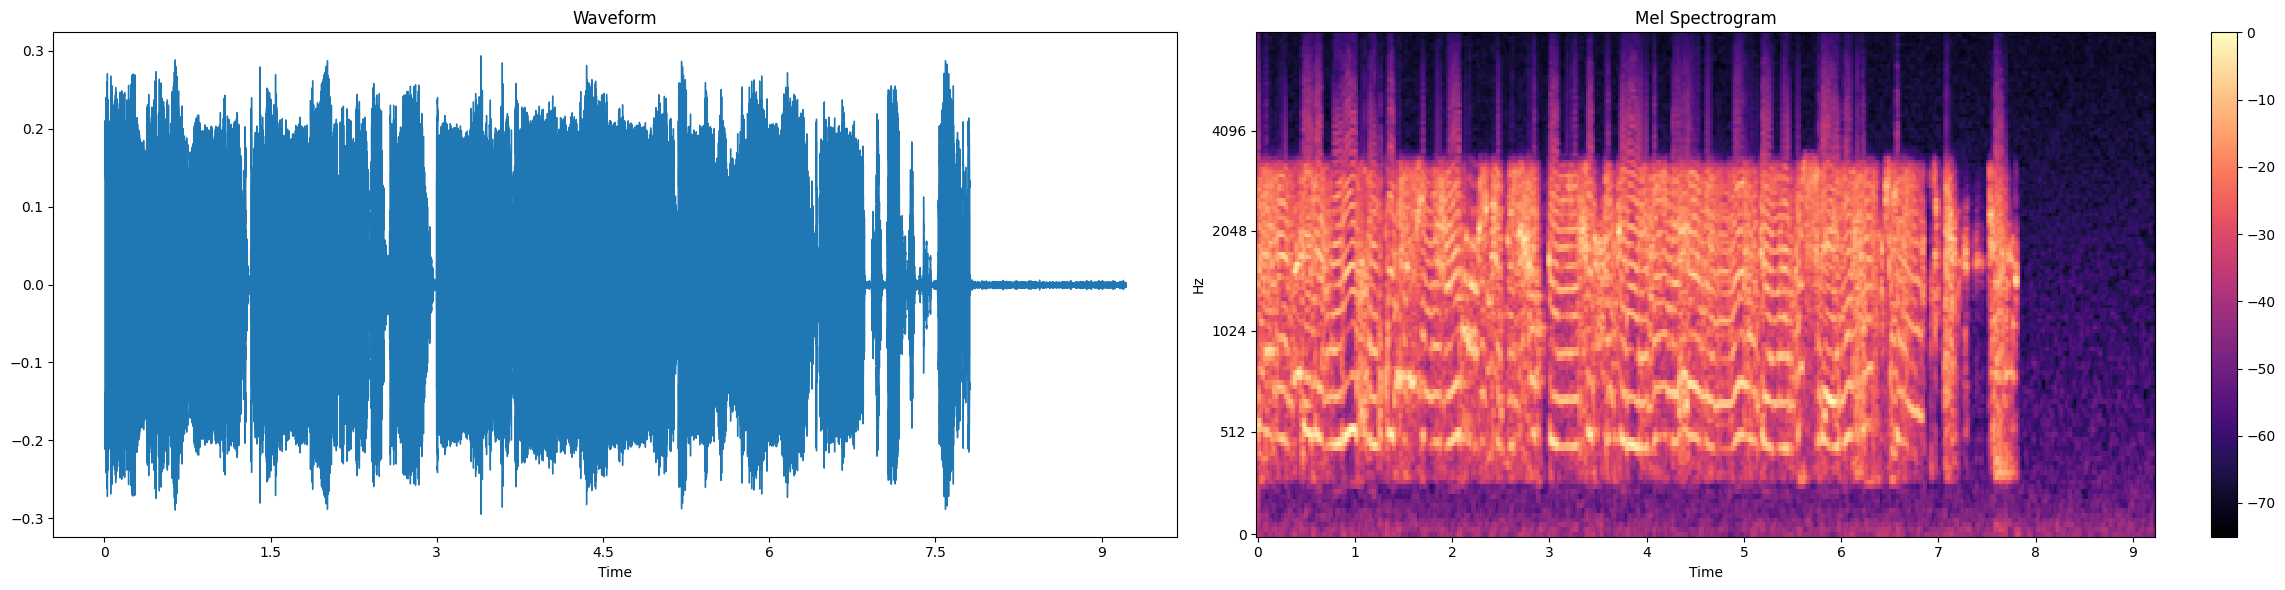

In [ ]:
plot_utterance(anchor_utterance)

This is '/content/drive/My Drive/speakathon_data_subset/wav_files_subset/3647699.wav':


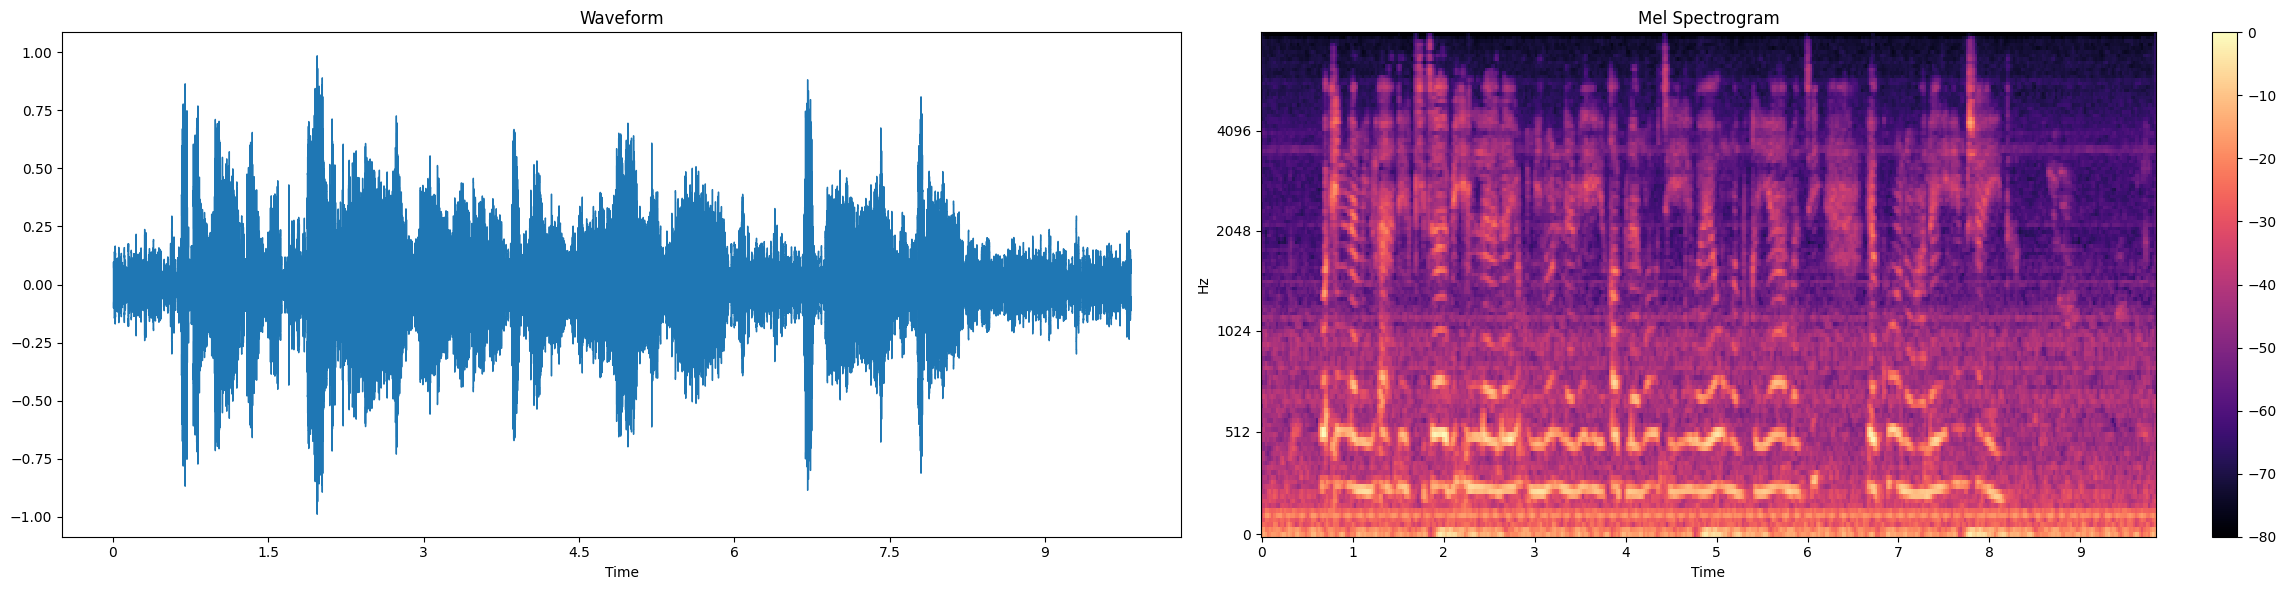

In [ ]:
plot_utterance(other_utterance)

<span style="font-size: larger;"> What are the statistics for number of utterances per speaker?

In [ ]:
speaker_counts = train_df['speaker'].value_counts()
# Convert to DataFrame
df_counts = speaker_counts.reset_index()

# Rename columns
df_counts.columns = ['speaker', 'num_utt_per_speaker']
fig = px.histogram(df_counts, x="num_utt_per_speaker", nbins=100, title='Histogram for number of utterances per speaker',
                   labels={'num_utt_per_speaker':'Utterances per Speaker'})
fig.show()

<h1 style="background-color:#4CAF50;"> <center> Using a Pre-Trained Speaker Embeddings Model </center> </h1>

- **ECAPA-TDNN (Emphasized Channel Attention, Propagation, and Aggregation in Time Delay Neural Network)** is a cutting-edge architecture for speaker recognition, enhancing traditional TDNN and x-vector models.

- It is a combination of convolutional and residual blocks.
- The embeddings are extracted using attentive statistical pooling
- The system is trained with Additive Margin Softmax Loss
- Speaker Verification is performed using cosine distance between speaker embeddings

<a href="https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.models.ECAPA_TDNN.html" target="_blank">Link to speechbrain documentation</a>

<a href="https://arxiv.org/pdf/2005.07143.pdf" target="_blank">Link to ECAPA-TDNN paper</a>


<span style="font-size: larger;"> Download the pre-trained ECAPA-TDNN model from **speechbrain**:

In [ ]:
os.environ['SPEECHBRAIN_CACHE_DIR'] = "/content/drive/My Drive/Speakathon/data_subset/ecapa"

In [ ]:
class SpeechBrainEcapaPreTrained(nn.Module):

    def __init__(self):
        super(SpeechBrainEcapaPreTrained, self).__init__()

        self.classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", run_opts={"device":"cuda"})
        self.classifier = self.classifier.to(DEVICE)

    def forward(self, x):
        x = x.to(DEVICE)
        emb = self.classifier.encode_batch(x)
        emb = torch.nn.functional.normalize(emb, dim=2)
        return emb.squeeze(1)

encoder = SpeechBrainEcapaPreTrained()

NameError: name 'nn' is not defined

In [ ]:
def run_inference(utt_list, encoder):
    emb_arr = []
    for utt in utt_list:
        signal, sr = torchaudio.load(utt)
        signal = torchaudio.functional.resample(signal, orig_freq=sr, new_freq=TARGET_SR)
        signal = signal.to(DEVICE)
        emb_arr.append(encoder(signal))
    return torch.stack(emb_arr).squeeze(1)

### Let's look at the embedding space of some random speakers

In [ ]:
def get_metadata(df, speaker_utts):

  combined_list = []
  for utt in speaker_utts:
    row = df[df['file'] == utt]
    combined_list.append(f"{row['noise_type'].item()}_{row['language'].item()}_{row['file'].item()}")

  return combined_list

In [ ]:
# random_speakers = [1183, 2629, 320, 2924, 33]
random_speakers = random.sample(list(train_df['speaker'].unique()), 5)
labels          = []
embs            = []
utt_metadata    = []

for speaker in random_speakers:
    speaker_utts = train_df[train_df['speaker'] == speaker]['file'].values
    speaker_utts = random.sample(list(set(speaker_utts)), min(len(speaker_utts),20))
    utt_metadata.extend(get_metadata(train_df, speaker_utts))
    speaker_utts = [os.path.join(audio_files_path,f) for f in speaker_utts]
    embs.append(run_inference(speaker_utts, encoder))
    labels.extend([speaker] * len(speaker_utts))
embs = torch.vstack(embs).to('cpu')

### Reduce embedding dimensionality to 2D using UMAP - We do this for visualization only

In [ ]:
umap_model  = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(embs)

In [ ]:
colors = [
    'rgb(255,0,0)',          # red
    'rgb(0,255,0)',          # green
    'rgb(0,0,255)',          # blue
    'rgb(255,255,0)',        # yellow
    'rgb(0,255,255)',        # cyan
]

def create_fig(labels, umap_result, utt_metadata, title):

    # Create a trace for each label
    traces = []
    unique_labels = np.unique(labels)
    for idx, label in enumerate(unique_labels):
        mask = labels == label
        trace = go.Scatter(
            x=umap_result[mask, 0],
            y=umap_result[mask, 1],
            mode='markers',
            name=str(label),
            text=np.array(utt_metadata)[mask],  # Add utt_metadata as hover text
            hoverinfo='text',  # Show only text in hover
            line=dict(color=colors[idx])
        )
        traces.append(trace)

    # Create the plot
    layout = go.Layout(
        title='UMAP Visualization',
        xaxis=dict(title='UMAP Dimension 1'),
        yaxis=dict(title='UMAP Dimension 2'),
    )
    fig = go.Figure(data=traces, layout=layout)

    # Show the plot
    fig.update_layout(
        title=dict(text=f"{title}")
    )
    return fig

In [ ]:
fig = create_fig(labels, umap_result, utt_metadata, title="Embeddings in 2D colored by the speaker")
fig.show()

### You can hover over a sample in the plot, get it's file and listen to it

In [ ]:
Audio(os.path.join(audio_files_path, "7474942.wav"))

<h1 style="background-color:#4CAF50;"> <center> Challenge Definition </center> </h1>

<span style="font-size: larger;">In this challenge you are given a single noisy utterance of a speaker (let's call her the "anchor speaker") and a group of multiple speaker utterances. </br>
The group of utterances will contain one utterance spoken by this anchor speaker while the rest are not (they are spoken by other speakers).</br>
Your goal is to identify this single group utterance spoken by the anchor speaker.</br>
You are given a testset of 1000 such groups and anchor speakers.</br>
**Let's go over the testset:**

<span style="font-size: larger;"> Load the groups dataframe -
Each line holds an utterance file, it's group's id and the anchor speaker id.
<br/>**Important Note**: The file 'groups_challenge.csv' will be available only in the morning of the hackathon.<br/> From this cell on, you cannot run the notebook since you do not have groups_challenge.csv yet. You will get it on the day of the Hackathon.

In [ ]:
os.path.exists(os.path.join(challenge_folder, 'groups_challenge.csv'))

True

In [ ]:
groups_challenge_df = pd.read_csv(os.path.join(challenge_folder, 'groups_challenge.csv'))
groups_challenge_df.head(5)

group_id  anchor_file anchor_type   group_file group_audio_type
0         0  9261579.wav        comm  2559406.wav             comm
1         0  9261579.wav        comm  2502902.wav            clean
2         0  9261579.wav        comm  8256572.wav       background
3         0  9261579.wav        comm  0839874.wav       background
4         0  9261579.wav        comm  8208675.wav             comm

<span style="font-size: larger;"> How many groups are there?

In [ ]:
num_groups = len(groups_challenge_df['group_id'].unique())
print(f"The first challenge has {num_groups} groups")

The first challenge has 1000 groups


<span style="font-size: larger;"> Inspect a random group

In [ ]:
random_number = random.randint(0, num_groups)
df_group = groups_challenge_df[groups_challenge_df.group_id == random_number]
print(f"Inspecting group {random_number}")
anchor_file = df_group['anchor_file'].iloc[0]
print(f"The anchor file is: {anchor_file}")
anchor_type = df_group["anchor_type"].values.tolist()[0]
print(f"The anchor noise type is: {anchor_type}")
group_files = df_group["group_file"].values.tolist()

print(f"The group contains {len(group_files)} files")
print(f"The group files are: {group_files}")

Inspecting group 514
The anchor file is: 9545513.wav
The anchor noise type is: background
The group contains 9 files
The group files are: ['0632605.wav', '4171933.wav', '4035776.wav', '6471588.wav', '9264881.wav', '5616395.wav', '1038460.wav', '6494969.wav', '6403479.wav']


<span style="font-size: larger;"> Listen to the anchor

In [ ]:
Audio(os.path.join(audio_files_path,anchor_file))

<span style="font-size: larger;"> Listen to some random utterance from the group

In [ ]:
Audio(os.path.join(audio_files_path,random.choice(group_files)))

<h1 style="background-color:#4CAF50;"> <center> Challenge Baseline Solution</center> </h1>

In [ ]:
def submit_challenge_results(group_name, same_speaker_utt_lst):
    """
    Saves a list of selected utterances (one per group) into a CSV file that can be submitted for scoring.

    Parameters:
    - same_speaker_utt_lst (list): A list of utterances (files) identified as from the same speaker as the anchor in their group.
      Utterance in index k corresponds to the selected utterance of group k
    """
    # Convert the list to a DataFrame
    df = pd.DataFrame(same_speaker_utt_lst, columns=["same_speaker_utt"])

    # Write to CSV
    df.to_csv(f"{group_name}_results.csv", index=False)


In [ ]:
def get_embeddings(anchor_file, group_utterances):
    """
    Generates embeddings for an anchor file and a group of utterances to compare against the anchor.

    This function prepares a batch for inference by first adding the anchor file to the beginning
    of the list of group utterances. It then constructs full paths for these files, runs the
    inference to get embeddings, and separates the embeddings of the anchor from the group.

    Parameters:
    - anchor_file (str): The file path of the anchor audio file.
    - group_utterances (list): A list of file paths for the group's utterances.

    Returns:
    - tuple: A tuple containing three elements:
        - anchor_emb (np.array): The embedding of the anchor file.
        - group_emb (list): A list of embeddings for the group utterances.
        - group_utterances (list): The original list of group utterances file paths,
          excluding the anchor file.
    """

    # Insert anchor_file as the first element for batch inference
    group_utterances.insert(0, anchor_file)

    # Construct full paths for each file in the group_utterances
    group_utterances_full = [os.path.join(audio_files_path, f) for f in group_utterances]

    # Run inference to get embeddings for the anchor and the group utterances
    all_emb = run_inference(group_utterances_full, encoder)

    # Separate the embeddings of the anchor from the group
    anchor_emb = all_emb[0]  # Embedding of the anchor file
    group_emb = all_emb[1:]  # Embeddings of the group utterances

    # Restore the original group_utterances list by removing the anchor file
    group_utterances = group_utterances[1:]

    return anchor_emb, group_emb, group_utterances


In [ ]:
cosine_sim = torch.nn.CosineSimilarity(dim=-1)

def get_closest_speaker(anchor_emb, group_emb, group_utterances):
    """
    Identifies the utterance from a group that is closest to the anchor utterance based on cosine similarity.

    Parameters:
    - anchor_emb (torch.Tensor): The embedding vector of the anchor utterance.
    - group_emb (torch.Tensor):  A tensor of embedding vectors for the group utterances.
    - group_utterances (list):   A list of file paths for each utterance in the group.

    Returns:
    - str: The file path of the group utterance most similar to the anchor utterance.
    """
    distances = []
    # Compute cosine similarity between the anchor and each group utterance
    for i in range(group_emb.shape[0]):
        similarity = cosine_sim(anchor_emb, group_emb[i])  # Compute similarity
        distances.append(similarity.item())  # Convert tensor to Python scalar and append

    # Identify the index of the highest similarity score
    max_index = np.argmax(distances)

    # Retrieve the corresponding group utterance identifier
    same_speaker_utt = group_utterances[max_index]

    return same_speaker_utt

In [ ]:
same_speaker_utt_lst = []

# Iterate through each group in the dataset
for group_id in tqdm(range(num_groups)):

    # Extract the dataframe for the current group
    group_df = groups_challenge_df[groups_challenge_df.group_id == group_id]

    # Retrieve the anchor file for the current group
    anchor_file = group_df['anchor_file'].iloc[0]

    # Collect all utterance files associated with the current group
    group_utterances = group_df['group_file'].values.tolist()

    # Obtain embeddings for the anchor and group utterances
    anchor_emb, group_emb, group_utterances = get_embeddings(anchor_file, group_utterances)

    # Determine the group utterance most similar to the anchor in embedding space
    same_speaker_utt = get_closest_speaker(anchor_emb, group_emb, group_utterances)

    # Append the identified utterance to the list of same speaker utterances
    same_speaker_utt_lst.append(same_speaker_utt)

# After processing all groups, submit the results
submit_challenge_results(group_name = hack_group_name, same_speaker_utt_lst=same_speaker_utt_lst)

NameError: name 'tqdm' is not defined

<span style="font-size: larger;"> To summerize, the challenge here is **Cross Domain & Robust Speaker Recognition**

<h1 style="background-color:#4CAF50;"> <center> How can you test your work? </center> </h1>

You will be given **hackathon_train.csv** which contains the labeled utterances and **groups_challenge.csv** (anchors & groups) which is the testset. <br>Therefor, it is recommended that you split the train dataset into train & validation and **create your labeled validation-set** of anchors & groups.<br/> You will get a script which contains a basic implementation of this (which you are welcomed to modify in the hackathon). <br/> You will also get a script to help you score your work on the validation set.

<h1 style="background-color:#4CAF50;"> <center> What can you do from here? </center> </h1>


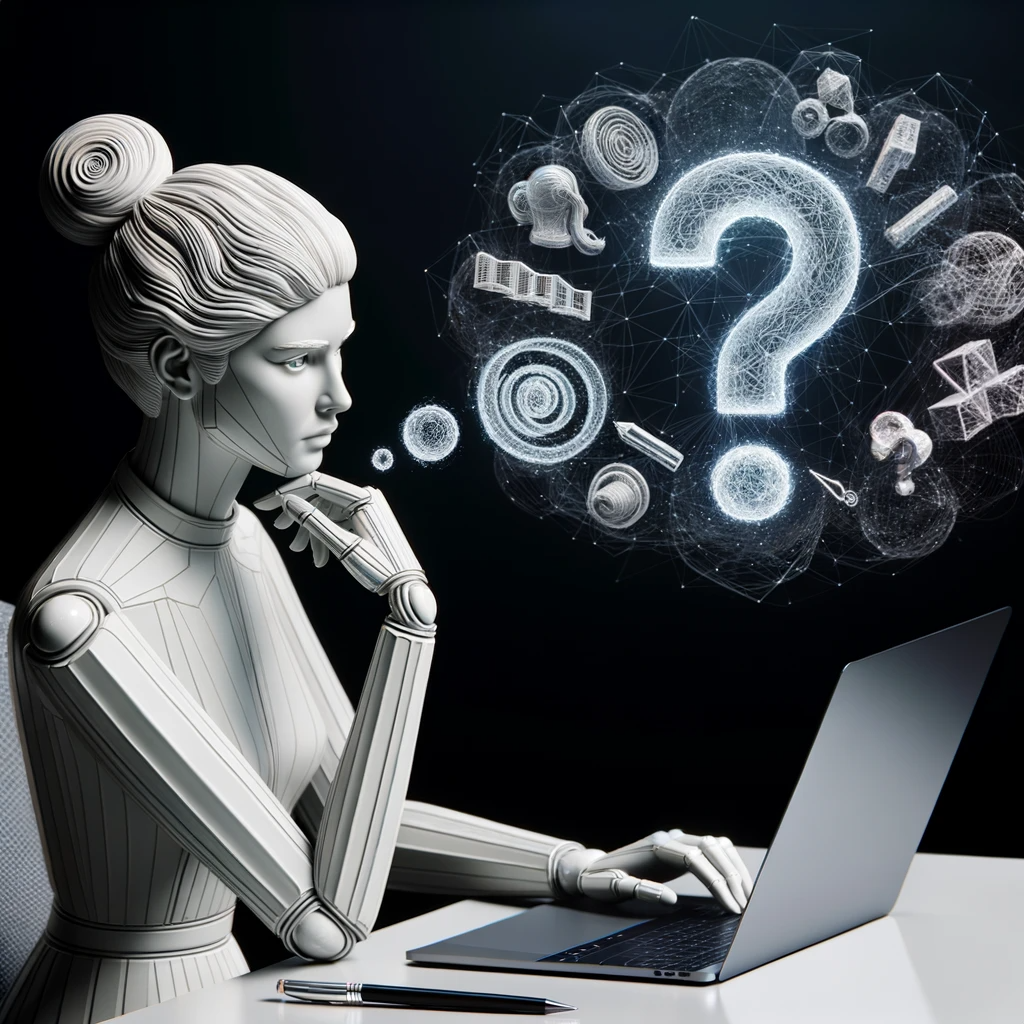

In [ ]:
# @title
encoded_img = 'iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAYAAAB/HSuDAAAAAXNSR0IArs4c6QAAIABJREFUeF7svUmQJFl63/diy8i1qjJrr66q3rcBZu0ZzWBowIAAsRCUABAYmUCYyUgZLuJdRhEieJAZIclkOOAiAdBcqAt4wCIZSQnCQkMDmB0zmMEMepnu6a7u6q6tu6py3yMjZL/v+YvwJfx97uERmVldz9uqsyrd/S3fW/z9/99We+7ZD/Vu3LhhNjY3TK/XNbVa3cSvHv+oJX41+Ecv/5Z7qNeTEjwXhedVoLz6INyufbD6VivRn16Rrpcob+hw15hfeXOsZkyhRlSYSPXkeqlQ0vDu+eRD9ypWWGY8R6mqVvdMgl7N8F/lTuQ2TN9bqvVfL1+TWT2132rPV2uvVnq5++7bUGYOlm6/b/5Ic33r3xjv/OPtbrL12vOahJL90/af7PxJf3+1+uqyP/Ahtv2w9VuZ2PGpmV6J72um/an1WY+NB+V3U9/3oe/HOpEef+a/53gh5xFf+23/R79Kz8fRq8p/U7qQnsduXlbr3ySa68qkhawXz9fXTs2cRoyyf6SLKns+TY+3djyIltUkxXikZfvO525a+mag/3wf7W9lPhApaej4wSe+wb44qpDT+1vZctLfl3LvV2t/kfHLrKde19vEauORLbor9Q0mSNXyS70f7U3x+a2Nd6/rl0+8h/Il7vXcp7nc0Pc32Z5+Pk4doeVLEnWK/cvXv9rZs+d79+/fN92cjpXdYLMTSlv91Q/Ro0n2kN6qeEA5pFYWrqbMgUn7uEqlVeWjEQATBZjGmEAAeOdOIAD8SysQAMrWEwgAr4ACAVANIJf5nhX+SJZ9MBAAZSXWf77s+TQQAElRBwLAP/U0QKhN3EAAaPINBIDCuEyWAGi3Z3q7u9umXm+K9iBNBJTdYAMBkJJAVYCr7TCHfL/MgenYEAA+GWn8lCbfQAAEAkCbI577gQAIBEBcAg+aBYB/+6xlLArTox0sAJwBZLAAGGUbLXs+DQRAIADKzLNAABSfL2Xk6p4NFgCK1LCw0zBKFQsASwDsmkajIeYKaUaw7AYbCIBAADgJBAJglC0x+Y6XcBmD9XwZQmeU3gQLAL/UAgEQCIBAAAyfA2JiHlwARtl2D+Wd4AJwKGKeaCXBAsAv3kAABAIgLoEHxQWgb/evuQDUao3IVdCa0gUCYMz77QNuAVAFID4IBIBo3DSGLW9KjAGAa7PtQSMANB/qRH9cDABNCKPelwlYzUTY72Psyq9WRxIAjq+sUcXme2+YBq3M8injs60BDNvOan6S6b5W2e8oK6vB98zBPrs+GPMy8rH11SL///go5McAKNe/mvERVGmdtbQn4bKRjYEQlw+9VvsrMTLy10S5/kxiRYyhzCN0AagiP82HX/NB1t4vIllNQaXNL+2MEmIAVPmC1oyECCnzgUgNeimf7syEGe+3Ydh8rEoQ+Oe4LryqBE66fuLA+a5q45EtOW0BoK35dP2Z84gac25QA2tbfPQ9lZYd3zhB4MqNl1/WJaToaTC9xNy+Rn3eGACOAMiTgbbBag3UJ0z1Q7o2aY70fiAA/OKvKp8iMQA8LRhqclv0gxUIgIxkAwFQbbepciCvVnOxt48XAeDo7aILVu9jVfkHAiB+IggEgD7jjtYFoMp81wB8IAAKjf6RPjRuAJnsTCAAqg1uIACyBEXyWx8IACuhvBNQen0PCdprLQACAVBtqea+XRXgTqhZRYutdEDQ2CEaUVU+RQkA15b0bI9FYe83tyieCARAIACEXy0y0YutuCrrrVgN1Z46PgTA+MG/3Y6qjeXDRgDI/p0rMnJ85GvwgwVAtBaDBcDIm5KmoAoWAH7RBgJg5KknL5bVEJerLRAAgQAoNmMmSwB42qAdlwqlCVH7mNc9rXa14Mk/UPFAOfkG+mvQDsTeD3CRxleRT//g5KsomiMFCAABAMOK8ky/olxBEVEMe8anUR9H3dr4lm13tr1JiSZdAJC3x7yXyrVOekiYWkEXAN/u4pfPuMD/QAbjHo+y46c9XzaIVlq22oE8Xj/vDk8zNhnwf3QEwKDXWfn4v3F2vaUPilbqTva92B5bdn5ZF4DhbZDxkTSDeZdzIfCs8Vr+DmDL96VZJcjgA3AGyBdPdGfYQd9JdbL9qyo/9ftfYf/O/R7HpKZ9IorsN3luAB9083/ZOXwm0wXSfGendnK+prKsZh5PHOGGTPViJtOeSTbhQaxCAOjHV+vC4DufjHv8si4AyUHJ1qctcN+JomesC0DxK92+TNr64AKQEKZqAWCiGADqNyrnAf/wczr3PVHk4+ZjwcZwAD/iA0TVD3DxpTP+J9WPvz1R+ytWNmgtCFQhhDhi11WLgAIWAJXGd9LljygX32tZH+DkMS4tD9/scFMj75kBwBneIkcA+N7XxkeBX9UlqPg4pyvQ2lu9QeVKKEtQlWl/348tAWfjJtN6W8vUp5emAdJhJSS/UUUAyaAUtwHkEEQo3/VTpD1ARkVRf/qL7F2DXgDO7psm+NKAPb//jkDwJYq38spvod+DU7fNqXJ8FbGqaSr9s8oeaEdvxbjnd5E1kH7G23rl86+eDhXRqD782vljlA5/QN4RAsCD0IuczpOicG8M3iwCkPtHwCF7mYoPvRagkx+oIv3LxVbR3M4/nwD+u14CwLd1lB+/bEsFQKoMWf4i1WIK6ARAsuxkedksM7rLeezrOkT+2vtlxtvGGOjmf70KEGxafXn0+yAGQHJMMy4Apu5xASjQQC8IpBVCAIw6FX3g33WsIglwxB+I4/ABH3Wb1D6+Uq4mX82EvyRAGrUvuZs0NzwUrHZ0qzS+HwgCIA0QUv/2DBhTQ9s5ZIfIeQgCQPSLPgpdmZ9a/dXmGwjOH+Ts2BMAPvkNEX2Z9ZAhAEbQ5pSpr8hYlk3TZ2fwYBaVIwDc5M4jAHqRBlzbhewa4SlHADjZamusrAWM5gKRKU8B0HXvDsDxpxpFp0vOPysCAZAvnzjxVGRtZfa66NvrJYCVb+S41/8o/Tiu7zgCYHzfuCQBIN9mMovlCCBLF6TP+7WIoPDMgBG+CeMcDw2g+erS9l52bABy7vlGWR/j6KdOAPh2UJdVLv8ZXX7JOZENAthIdFMD8PGHhymYtPf19iYJhsMhALLytXOG9RMIAOULPr7tb5QF9yB/oAIBoOtuKo1vIAACAZDaVCrNp1E2KOUdb3smSgC4j54CADUCsqRMAgGQOEJlyP1AAJSbUB8EC4C8HgcCoNxcOOynx08AWNDhLksA+Pn3pA1R1jbJWigEAmDY3HAGE5NEMH5ArCtodQsAjYINBICXRMq4/9mnAwFQdDcd8wGxaLXuueN2oC/T/kAABAIgPV/0NGDBAiDGEQcLAM+G47cACAQA/qH2+6EdooIFgBeklvnopQm54AKQK73DIAD43jitnKT0ip3n+He97oshUWHgPwCvToYAGAgG65xiBEC+jUAgAI7aAkDz0feTANU16oEACASAd7MNLgBH9S0KBIB+9K5E8DwAFgB+E1gXBTx/hmKS7GOwNQs/7xx0LgA+kKksHl8e9HGsO2vCnGPiXaCCSvOrQPmVHjkEC4DyGvlkj8q+X9qEv+L4Wuf92PzIAM7kASlvPsTXSdxtJm2Gqs2n5H03d/NXsJWvZ4UfsQuAP4tBpdlf8GVdi1awoGP32GEQAPVGw3QOOgL0Dw4O5GccdLj5qs3rYye8Q2jQYRAAYoac0xepX3ykH1wCQBsmn8l4EReAnhYEMJXnXWtP2fuaBj8bgDZZg0YApNuTlZdvf8xivzL1aTGmaFuZ8ng+3v5h45uQZ0EXV58BjLXxz3cBSPuPZFwoQgyASRrQ6MvtQf4wBQIgEACBANDXuO+JQADkS6eIBUBZAJ+urez7gQCIfy8DAVBt9csRs5AFR/V6Dr+EwyAAnAUA56i0BcDh9/jBqvFwCAD4y+Fn7BrxAXxB0sSH+Xi7AGgj/mATAM6HP6+X+t5VBUDbWgMBEAgA7yoLFgDaJjSp+4EACARAIACqra5AAAQCwD+DggVAvnyqBwEMFgDV9i8/uTnIPjFKLZqPs4AriaM60Po7wJHJNnPErp6j9H/S70yeALBBoL0WAF1PlPRAAJijtQCwBI3nC62SlyWy8kk1wQIgKW1Hog4dA+FGHggLgKpbmW8LqajBP+IPw3G3APBOwCLDqslXs/HWTEiLtKHCM+4QMrSIaOr5PHDV8fVMX92z1+bhPspLJQBcGrEhnaHlXo1qZROpKAuA8gnzyW/SLgBpE8nsePrHV41CXmQSTWoCjckFIJbRftDSyDSyrAY/3dWy749mARBrdma9auu3CAHgK7+XiSKdnhIJnb6WFSNxXyPfs2maMlON/SFPBD1lf5Djp78NmnS9WWrUl6sunCKLs8gzVdsxufcrnR+U/Z+yOwcHptlqmm63a1rNljl/4bzZ2d4xm1ubZmdn58i/j1UkO/HpZxFXlSaq72oARqw2fN9nzQVdOz+qLaz6gF9+vjSL1KyNMQSA95ro+DkCwNcGpf8lp1eSANBfTjuQavIeJkvv/CvJYEzEBSBnAjgXmmG3+8rZlJZ2/C4AJQVUbrlpy0O7X6C2owZQR1y/T0KFPt6TbL+c7Y42iE8RAsA7y0qmSSswYxOPHGcCgE+7A1h52hzSfHk3YN9XUiUINICiS7sIQPTSk54YB0U+b/aZgYQS4+2dnK5vBQJJ6GIY7QkRf7U9muVvZZAjLTUN2Hj3j7IEgJ5GTzsGagRAcmiS9Tnwn5TdeAkA39TQCADuKwC+0PzJn2MaANEIvkJWbh4RYObs/cZK0z0MiG/uj7YqD/2tuASyabzyx07bOSiXGAB7e3tmZnbG/OzP/qz56Z/+aXPtzTfN7/7uvzPrG+um3W6b5fvL8gyxApqNZqL/tEfPRX7oIkvs+l4MqAHE1AROAJRD6pZ3/Au1QVsfg0IyJufqGaFQA3Iecj3Tv+R5tZQ1kU+XU/X9bHlpxoW+5fevev3Jsoe7TAwf/7wzZbxPWto+dY9R9u9qLh7ZWdHrJuVftH15I6SNT61yDICJEgDu46iJocIiLnTAqFC+8upRAzj9cKJ2YHLCoeQjjuJbCGPlSUADQGPAZkc9f3wa6DgBICs59THm3xqg0g7g/vPP5AkAHWD4CQ7v+hui4RxOAHgpCN1PZVIrWJv/Beq1/N/w/jnZ+45fRQicAs3oP6LN13RZ+vrU5mgVAgD/W/8Brmx79f7ES3QEgAfkKQRv1fHz7x81Uzd+gqgQCe6ZQJYAyF+fef7RMUijmtmWmb9H/WwZAiAXNMVudI31U758+bL51V/9VfMzP/P3zR/90YvmN3/zN80P/uCHzac+9UnzZ3/2Z+aLX/yi2d/fF0sBe6yw415uPh+u9GRnULElH9Wch2TyJ9eeBggm3cNJ15+ZX6r8qvS43N46rKaq8qj6frpNWZP/wyAABoOUBNQKOVxgfVSVj/b+2AmAuMtFAfLKtS8QAKOu40AA5EpOA1/RF3RUyRd7LxAAXjkd9QEmEAB+BZ6W5SAQAP5tIBAAH3QCwEfuaxYE+ickEAC6jA7ziaoEQJyQietfz549a375l3/ZfPgjHza/9Vu/ZTY3Ns0/+2/+mdlY3zB/99JL5pvf/IZZXVk1O9vbptPpSMYARwQ06g35+3GzBAgEQPmZGQiA8jKLvxEIgKT8AgGgzCdNQNWmo3C0BTxlKtQSCIBAAHimT7AA0ACaz/w2eYAPFgDl9inLvSf3v2ABMJBhsADIzqc0IXj8LQD81n21mgVno16BABhVcpN5rwoB4Na707rJXK/XzOzsnGk2G+bUqUUx9b9166ap1xvmypUrZmdnW/7eaNTNxsamweXs4KBjOvsdcQngea7jSAIEAqD8HAwEQHmZBQIgX2Yavj2uFgD9DEpKmsjgAhAIgEAABAJg5K9GsAAIFgC5kye4ABQwMdYI7ofZAgAT7ckSADXFzE2zINaCcAYXgJE/LZkXAfyY/McP3VPttvj/7+7uSrwZAH23a7X7BAXc3tmROAD8YaUddDoC9gkc2Gq1zNbmlryzt78nbgGOCHCVH6VVwCQIAG00ADz7+x3TajXFtcK5SuS9pwEk7X663LLPa/3RXSi0Enz3gwtA1fGy60txYcwZgiLro2r7tPePIwEQ/6QRFNFvY1dveCI8FIhSGWIAVNlBChwQKxVf6eXgAhDNf+0UmCdlDQCFGAAhBoBnhQYLABcDNMQAcNNEBZwpQvv4WwCkF0DyuGJjAIweA0izAAgEQKUjwqG/zE4ACSBa+0bTTM9MCyEAsJ+amhIwv9/Zt/frDbnXJVNAsykkAAfivd1duQ8JMD09bQgEedA9EDKAn/FD/1G62BUBOAKeSsQA0AaMoIrESqBu5Iu1BOtvIAcre/dvDSBp9wMBMOrh0kqurHy18T9sF4BAACRHJCH/EWMABAJAm+Xx+8ECIFdagQAIBIC2lIIFQLAAyJ0jGgGmTa5+EpBAAHwwCYCesfuHG1/HiA4AfzZLQDkyIBAABRbZA/SIWAGQOq5eM62pKdHiA/oBq/wOgI81AFYAPMv9TudA/s0zs7MzAnAPOtZKQMBsvSbkABYDpA7kPu4BgKuHjQA46HZNvVEXF4n9vT0zOzufmB2OUHScgwZAtfuBAAgEQLAAGKyCY0cAyAbp+UCUXeDlvjWaeWS50oY+/ZATAFWjHFdN8+UdwUIAotyBsMyM6Zc86h6ttf8hsgBwsRTio1UoC4BvA1IZ0ur7R5Eo5F4DNk8aQG0uYrwV6VsGh9X4flUoQMUYJpnW0Lz7nvnvgJlmojlIA5hTSa3nSVKEpuo4pwF0k9tvpJfkq/39ycQAEA2hbwCTs7ev2XPgKPVqOUCkB/ErRgAkJFDKIsBLAIho/HuEtvX7CNBBCsD8HcK2L2+A4mHuqizC4uM/ai2Te28gG6RBUFVAaqPZEO0950+0iGj/Ae+AeAgArACEAGi2BOAD+CEKAPpYDUAUEB8gbubO8zMzMzZTQM2IKTxkwKhn3HGcTLT9UU/xUrwVzEXiJSCjz3zmM+bdd9811669nRja/c6ena2ydmwGBu/sKmkhnNVAa+33169Z+Ojy02a2tkP439fkp9ZeUr56eYebBlBzsfHmUNI+bWOwkNDGh33Ed2mzN/1uPA1gkXeHZQFIWABAYnqaqMYA0CaMqTwBix9+1LaM8sDECQBlgoz5gFpGBJXBf2QKVm0L9LTYAQiviZvvAKVLo8gi8yIMbfX75tcYsFm5A7kuj7JP+E2SYwAgmiQJAiCdhqnAhl6ufYdDAHingEoA5M/AgQvAoIbMeGsTeGKLs9hIuPkRb0YalMWXd3o+KcdLY8vKf+rBJwCScs72JzkByu0HVm5Wq2cv3k98F9KpO0t9L+Omw3nzJT2By/THPZu/CIrJQ1tExeZ69qkCi0/NclOgjNzmafIZB8Ggta+cbLNBAq0LSN9GJCIA5uZmZa4C4okBwLW5uSngFbAPAUBZ/IEo4Nre2pafkAX8jqnc6eyb3Z1dU6/XTLOJtcC+aTQapj0zbU3gcRnY3zN7e/viSsABnXrdvPLNr770fSLSEb6CUTX5Fhuf+J78wqc+Zf6HX/tX5rXXv29++//4gmRU2NzYMJ39PVMTn+Jo3+h2hSzpHvAz6TrhpiQGPjIO3W4hi4r4+Dvv5XiqzGQaVm3+1iLwk0+wad8PEwE8bR/RgOKoO4j2nlZvllDRSkzft6cQd2n1pd/2+chrLRkQTflPlm2PVmem9xrBpfjYa/Wll3/Z8XLPx7/ZibMWBICnEX4CQGu9zA1tg9EKqX5I12rw3i91oBmlJr+P1rgPqGVaWMjE35Nrk/f7B8YyFRd91k0N3wwekuu2aPE8p+CHMkVln3UERl4pDwMBkMqznR7KdF71Iueh4oNSfW+puj71vPHJIG/xvjG107urdhApLpvDebIKAaAd76QHSp77quOXlpI+nsk39PEqN0eT5WXf1esbfsDrW2REBEDcQiNB2pX8XtZ8ALd/aqkC4P3yKy+Pw1kX/VrEBWJSV5G5lTzgl2+Jdv4r17/kgd4SyPF9gP0E337M/wGdgFIIAFL7ofkH3FMGmnvAKX9vT7XFCsBF/KePUkaraaZaTYkJ4O7xnKuTv9cbLXEjIBgeRACm8RABRS6RviYenw+/Vkmhs0+xGAHuW0Nfn3jySfPJz3za3F9eNm9ee9usr62bzY110zvoms7ebtSnSPsfxVigqY5wcXEXxIVCRo84DHYs0lfGYin1jJQwZM+x+7A+d60FQHwOJtsQJz9t21JtTCnEtfZqQzbu+xoALgsos+07WgJAWz9a/6vK21v+GPBvOjOWZhGR+XpHQRQTWv/YQ3YN5l+BACh5oCk/oQIBUF5m0RuBAFBFd9QHXNUCIBAAyhgGAiDPAiAQANmpEwiADITwugQc9f6obuAPPAGg9rDUAxoBwP3ZuTkpc3d3RwDbwsK8jea/b038AesAdf4tYL/RMM1GU/4OKeD8+5uNhpmdsdYB4jawtzfQ7teMKH9r9YYhMN5Ui3gDTdNoNuVZeX5/X1wS8ubYg0gATM/MGP4QaHFre9vMzMyZ2ZkZ09nfNyvLK6aLa0XMck/6j2tGvR7Jzroo9TWTWAZERAxjR5BF35UwqRYyMglf3PywmuUeWSC9V5IAyH5Rkkqw9P1oElQIQqpNfk0JVxUABwJAGwH//UAAeFdrsADQp1cgAHQZ5TwRCABVdEd9wA0EgH+IdI1xIAACAVBcS3pYBED/zFvJBQAA5YlZECwAJI/95K7DsADQ2q+qwBPd1wgAAPzJkyfN/sGB2d7eEvGdOLEgZurEAMC0HysAwPn29raAUoLaEQuAqP/7ezbAnxAD9bqA09lZ3AHq8j6ACRAqmjPcM2PzF/94yoAEIAYBWm3cCoiUP+w7/CASAM1WS+YkfdzZ3jEHBwfmxMIJ02o0xd2CP+4SHXwXEF6T2AH93+NOIaRLQ8bHWgZYCwDiKrjLpWvk385SKw5Yrf1AlgBwlgZlLAD6sU1SaeeyADxtAcC/B23Iuqho8z9/dbvtL2+FSMnR/gvhMewsoWnAAwFQbXcNBEAgAKrNICVNy7hNVMs0VmMf+xt6zg4VXAAUaVuqPP+h4AKQ+ahpjHeZ+W0/3KN/oOMHk3L1Dp4OBICVf3oLyQsCGCeUggVAdtYdBgEQH6/06ilLOAYCQNk5HmgCwM2OvD12iMa1lMto0gUAEISGXwL+7Vmz/ZnptuwuNvJ/VzTRkAD83fn8C9hvWisAyADnHsDeDAHQaNgsAIBYSABM/PuuADETcPYsCUDYaJqpqYFrACAZsEzcAeqPA2T9e+ZREGkfnTG5AHQODkQ+7ekZax1RM1EwxR0x+0dO7faUpFLc3t7tEyikT4zHRbCkSXIuAOEhArDCaDTqUVrGbpRecNDB9Dm4D9iHuABYgsYOjC+ElpU9Fgp2nLkY//jFnEp8m2LNJ4jnwI1BG4zsfSk7IpPc3fSZW8iM6KYDmxBTXMxpK7eGEDE0DdeV+BUIgHIEY9lRDASAT2Jj8IEYxyG97KAmng8uAKr4fDH4QgwAj/gCAWBqwQVAWV8PnwWATyCBAPBPl8MiAPJaEQgA9XNZ7oEHngDQCNYqPsRJAgBT/NZUS+S7EwH+NAHAPSL5OwAlcQCiQG6AXMgDNPcAXavBtgQA4B8Tf57lHYC+HP5TiM3904Hd6emZPujHEsCmHOwKGQCyA8z5SeAjJAAEGFtyFs3/1HRbQCcgmYCIO1hYIIMo8OEU1hXtabOxsSnuFfTN+fYLmZIiACRgIjr8Wk3APyA/TpDYGA0DhsUFjOu7AQxxAWBcqaesC0A6aKO01xPDSgigKNOB0Ai5OCENQP3rAdeK+BtOZtIecVexsv/c5z5nLpw/b/70T//UXLt2zZIXEAOpqPOBAAgEACs4xAAo99kdPB0IAFVygQBQRTT8gUAABAJA3V8CARBfPIEACARAYj4UWT8eK5+yhMWIO/3orwUCwMugu4B8AJ3p2RnR4osPPhHpazUz3Z5KWAAASGfnZgUsYe6Pz3mcBBBNf2QFIOC/brXDbt/hPpdkEsBcPdLGxs9AotmNLBkAwZjLO1cDgLQjGABr+M4P04wPOn20BMDBQU8CKrbaUwKqkS0ygAzZWFszDTE9j2J91+oScBEMuotsDzpClPALWWc8mzHZtz7/fQBOYEWJm5CMFcAzwzXmWSs+9xzAx2sBIEEY7fvD9wEHnByhkJyKEtvAnwQ9FUXamXRm6+t/15BT3MqgVhciBXIKEoq5ydz9jd/4DXP16lXz2//b/25+//f/wBIAQ/bCQAAEAmByBEAR2ZYy6Rq21/sYM41dHv27239TPWBUrcMvxCN1AZCdWemfJzXb4bgAsGF6fBDs52XkQXJ+ViMX4HsxEADRwWAwPumRepizANhZ7Z+7aR/IYw9oUuthWBYA75JJASLtE2SjOOc/Ne79VXfpSB0i1e9LOTeVD6YFQP6M0MfPv3709yey8xcvdOIEgG+P0VZXkW5o395kHRpgSddo5zs+6Q3RjHJh/i+m+PW6mKajRXYuAIBvLACIZo+LgGiLuwfmIIpC38QKoDUl7wPOIQAkSn1kIo6FAHU5f3XxQ49yaQ98z2NB7+q1KA2edT+oEW+gZd0D2JZol58EqDoG5eQf/+RQM2B6ZtYSJlhVYGpO0D9IjbWVFdM0PdMQ0GrN9/c7HXPy5CnTaLUk8CL96xMcKQLAcgLRV06IloHpviMF4ib57tn4HLHfv2QfXZwGfq1tr5YAyL+yWQBSz3rzvEffHleFc+r3fNPTzWFeMichjnAtIaDl0unT5qmnnjLL95fNl7/4RSGo4pYT8RYm11N2LpVdb8neV3XhGYx/kZ1k2DOaC021/umtslZAvglUbf2OJw2gZgGQvwb8WQCivvmW0GQHoNzhSB/OEZ7QdpgRioy/ctQH+v6eNawfSl72QyMAvDLWPoD+ATpSAkBqqrShAAAgAElEQVTBf0W2lqOeP/4ggIPgPolRiO0rHNBzR1CZf5Tpn7/W/6/MNW7A4AOM2c9r5vgb/cKzgU94fyojO5nOBQFN3twe9r5/HfDxCwRA3jjp+0OWQIkfUvX3kzWXez47r7MEh3+T9Nfnyi++B5Rrf9nVkX1ei8OjHYC1Ftjytf2juHy0+tL3K50Po8BnaPGnZ6Zlr0czj886amlA0cz0tAB9TO65J2kCidofmfoDngC1DuAzvk7LT9R/q93uRiblVlMNGAOYytkfl4ADSyL0wWxizx0CujCpdzEHxGfbypcysCpwwe/GM9cUBVNUd/opl/av3qiZU4uLhvRj9+7eE399CADatra6apqY7fczHdSk/bhizMzNCZFCpgAJtmh6EjfgoOOC/MVrHMyvTFC6yCWfsYxbSjiyxb4Zez8iahLzLG/6Mn6VFZS+GZ8kAKzrgsUs8bGNt0HOOxKYsmEtWKanZa4B/vm5sbFh9vb2zT4ZLHqR1p9AizIf/WS3aIJjLhVDj/Sl5aGdQv1p5pTmDKIc5uAP2+fJ7U/afpUF6Jo8yu2QLjbFsLeK9FrSBg75SES0m+xfvjOwSgBojZjsAnOLX2tFOaGXenrCB+zxfARK9WhsD0+cAKClvijSY+jJkRMAvj4UCBJ41PNHA3ze9vUwB/Qb2WkHYO8Bunf8CQAvgcHcUAI9HfX4p6evNh/c82UIgLwlYssIBIB3C1G/X8MPlf0gjer7ydqrzsdE0MACGjW9vnJKBL28MXx0YkUcDgGQ1+aBKfZ4ezUoLZHWbYRKAOiYeWOmbrXyRPGPgvSJBUBbTP0hAND+A5QYQ4n632xIOkAC1cUJAAH4tZrpAFajqPDO/1xOnESx5xlMsk1dCATqHW7Kn1w/SZLAypfgec56gTZRFmVK/ZUvJcuUhwBAfT47P2NmZ2fN2tqa2drakmj//Bt5bayviwm8fKMBrbWawWWAPiJn4h8gJ6wAyA4gv4+nD5G+pbX3g51fvOGjD3zfRQCywZHIItpol4808WXxRtnnyw1HSkMa7Vf9WAaSg91mk3BpElutKQH7zAMJOrm3Y91NOvsSPyJ+uRSLyTbFv5xDyKdUloN0f8YtDxu5IOdr3sN6RpOoj9Sw1jdHRgAMUUCNW35ewqaAAiyPALBStzE+/BCj3sgfogINGLdAso0t9wHXplvp+yUPQGXLP+wDR9n2+Z4PBIAiTZm6FcirQADken84yQcCoML8GudmEJUVCICkUPX9vdz3TXMBSA+pXn8gAOIy0+U13kUTCADtgErk/ynhQR0Ix3xfQHqzJeb6gHzn6y/HXrT4jaa4Auxsb2cIAMAYGlgx/T9Asx8F/Is1xZXfbLT67gDD0/0NJwDcAdxZlEmbXKyAqH4bcNBaNNCO0a7RCYCpdtssnFwwe3u7Znl52QbrMzWzsMDv9kSzb7roYKy2uh/or2ekzfR8fn5exsA9n4kBkPo8ZU3Wk/AjQQRABkTwz/n9My4QPUWvqvhEW59unPnpyK54yj5iKeCqQvpI5qQjsSBNcKdIW5XQ/74M1E5m9+7xWwDo6zMQAOpA5T4QCABVduUOSGpxZR+oAuAK1HXYB44CTSr8SCAAAgGgAb5gAZAP0Pufbx+GDxYA+R9PuRMsAHy7kP59CQRAIAAKf/JLP1jVAgAf/fb0lJieS4q6KG2aA+j8dMQAjUNz7QgArAP2yBaQsgAQoNtsivm/EAdCAmT1YID3dnta+ky5aOwT/ukS9d7uQe5Km3sDnp05O88ImO4HwrNgz73Dz/JWAaMRAFhWTrWnzImTC+bevXuS/hC3CSL+nzxxQuIBbG/vCKh1FgACTiOgK/I46Eh/IAwAuNYSYKdP2g8DzxoB4OTo9i1IB+dG5zTrh00A+JXYSXxiwX7LtMTqoyFzjDHd3d2TWBBkTxi4VFgXhQHpkUxRCDj0uyS6vXv4/Bu2WKsSIukygwVA6S0x8UIgAFT5BQJAFdERPRAIgEAABALAPwe0GAAPqwtA/8CcEp82n+KPBxcA/ds4KgEgsCZKkzXOz4vengQc7/vUpoFB0TbZA/T4rGTKtV9vpaZh1FygtBr85R9vFwD2gmlAqelJ1H/JhV6rib8+Jui4BXDFCQAHcNDyTzVb8ryQABExwPOizY7S/nW7HXlf5nuMBLD7tn3ORflPa+qtW4EjAYaNhH99Wm0v/t/WRFxM6Mle0OnEfOltuXnzzgKIXIcqAe/St1jzcLMhneLc/LzZ3FgXYOr6T3knTpwQjf7mJr79kRd+pJmWHvUgTroiU4A/7W5PT0swQXzYIQKc7Hpd6+aQ1nTbf/vMv22DHVhOkwA2oOAwE/jk76oAXkqyJtbJsXWgHCKi1rCm/JAn/GmTBULIIgJP7ossbHpIK4e0Wf+wcRW3kVbTEKMifSUJAefz7zHi1m3wtS0kcT/hKmONzPtuGtmC9O+Tfw4EFwDtyxVcAEpN3xEeDhYAuUILBIAyn4ILgCd/rkUYIQaAgk8+oBYAbuWkjy6BAPDvKYflAtBvRcGgjkW/rOUAtDtADo5B5d53QUi1Y1TR1vvygRcvI/5kIACGy02C+QHiWy0BUHv4+EcB4NgzHAEAEMR/Og4wnVYVk+upZlOCqjnz/ThBgOm6ywDgrACS5tfiwS0AD22u09ZDGNAWC9r9ALwI+SSEBEAyAtkASX5HPbTdBSCMm4f398+SBICTzfzCgshwfW1VirJHFUuuzM/NiYn/xsZmIoCYax8EAM85GSBbSBIJDNhum82tLbOzvRtp7v2B6ZCwVwsapRiUvkd7UZwMcBYmcSuKxPqqAIDjBEAceNNeYkzQV5tBoSFjBGmys7UtsrOZH6w1isg3sp5wsnZtHE4A2BgUEFfp++l/++ff+IMgBgJADWpQ6kMQLABUcRVhkdRCRn8gEACBABh19gQCIBAAnv3jYXYBCARA/whYSkMdCIByYD5YAPg+XsfXAgCwR5R5XAA6nX0hAPogL0YAoIWNEwBOk06vLYEwJWnU0lp+C7pt/nUO4aIFj53tI9gmBABXnASIWwKMgwCIg0HmK2VCCFgz8qa0XVwgOvsWSMb8xLX6h1kAkKKQ+AiYo29vbYkbA/UQwR/rgLn5ObPfOTCbm5tC0jutv8gs9j3DCsABGCEWGg1z4uQpCdyM9tqmZiS2QWSrlQbj8msbKE/+lrovZUaR/OP9di4UTm4uPsAwEkCzAHBDnt5V0tp/sQSJgk5C0DDPJJVkZ89modjvyLhAhojLRxS0cJgFYLwuHwEw3AIg2dLD9vkPBEAgABJfFG2BjYqd7HtHDP4tdVetC8rbZTUaE23MkMI1E2VhxSfZqOOcBaDI1NDmj6eMInI96vmjaWy9PmyS5qZiFoA0pR6fiyELwCRX5tCytfmQfkm1AMg7oQ2OlTZRQs417vXhc+kY1gS9fm0TSd7PlqebGedLxwnXs9PkWAB4hsU753R5xF8flwVAlWWgyb9K2VGSD08Rk3UBGL+FRGZ9+/Ko50x9AZr4UhOor9e1QOtgEDEfEAJwxwVA0gKKdYCdkfX6wK8e6Cra9MhNwIHMuBVArUHawLqUI2A1mthpAsCW3ZBn3Ry2rgdaQDptfWcH35VPOx3YBLRzAaqtebkFnP4k5fb7Kv2OqoFYmIui/BP1H9lJhPoIgJNCcWZuVrTY3JdA/fzn5JLwySfFoo0DQFshDRqtlllcWjJEu9/a2pR0djzjrDfcGAwalU0jFycV4qb+joCw1gB2HOL7CW0YpCG0HY4D1qysatbNKTHmg9TCZCkgTV9D3EAsAUB5AHOXznF3d8e2Y8g+mS532LdvKAFAgMuGJX7SsydrAeA/JY4bnyUJAEvQ6FfeGtBftu0vv4b0Ng1/Ih2zJEMMVbAoydY4IIqGnh0KdEJ3AfDL7xikAfQN7uENfK6sNQBXYJB8j5Q7EFWsrOTrGviX4iYsn2OdBjCanr5tzDu+BaL8i4hzxk2W9qTlr8wZP+CLPtAehDY81U3BiapmKdEJxAwAjQ5MPrkXbJ08VikGQHT48n4Aj3j807IYKwEg/Y+0Q6lFMICuPvQ/CLBUZsx8z5YlALR6/evX9W3Qx+HPj/qdLCaf9PKNrxk5/GqdjN3XDrDJ+1kCIDPfxjz/s/VX2wm0b6i2f2sH7KouBPb9/BFU6y81+qnRk2qTO7BovyP/fDGt7lj/6YMIaDvNqwRaa2HevydR4ePB1OK1TLfb8o0EOIuyInWAbzQtkATYCBhmPvWblP1+8Czaci4xg88JIOjakO5iuv7Y52boKoLXoE5M7LEIcK4CBwcWfDt3BHsUSwJikW4syBx/J2o/MiTCPzJxZv0O2EEAzIoLQEcAvCUAohnC36MAhm7kIAps3fV+GjuIGeILMD6kErRXzwCWGVPbLvvb/g4XW8cDTX5XNOn827XP7b8OdFNvvN/cd+4JfbcOAec2VoMrWzJJYG0hxJG1bOApLEbwv5+enRFmAEIBCxPmGe/a+AaDqzbEaiFx37M/Ss31rAINwoExYj46+ZfYYhOPliUAkoRJdn0m+hbFg/CdULX9yeap911lvi4jSMlHUGYIpGz5ausit6X8lmkkiL8GzQVExtPzjTwmBIAqxhFGdkyvjPmAkW6VdgAYUy9GKkZbvNHOP1LZhV865hYA6vL1zZ8CBMCQM1Ls63MIBIwyUCoBYJKRbdPFVSIA+h+gvEaOQADE55tKMOizeBwEQC1nIR5KDA69i8kDUUmfca8FQJ8AINL/oBoHquTooGxS2gG7ZPe8hE7Zsnhe3/+Tc1h/vlwripaXlr/7N7rDMl/vB4sAkBGqpIHSvqGa/FUArgh/su9bH/mRr/7HLbkLiPY/SpmHaT4AvxuhckcAADLRyAowiw7Zw2Tp/Ol5bhgBUG9YawPKd9rjwTd3+NhTjgPiGgngJwB6keY47xRhwawDWK79AFQyHEiE/LpNwecCB2YIhpgPOm0+sXDCbG9vCZCVZyMA5OYpOepnZmeEAJA0gC6XfWyQB4Cb9tkMCVzOFJ8pQZDB+bl5ca3Y2NyI2kvARmfJYckY3/wXU/oI/FsiYGBt0U+vmMqoEJ+L8r4jQeq2fZBJuD60Z2asi4mpm1YUK0IsTrCy2Md9YUdksN8B+FsiQnaD2PdtmIY/DaC177+kCUhdjCmWLLSVOiqssKGBEn3rdTgBMHx+WssQBaDWGIP89y0BUKWHI+8+9sUCBEBeFwuNTSECIH/9a6NfjADIl1EgALT5EwgAv4QmLJ/jbgEQCADf5s3WHgiAvAUkhxOHMYY91De/HC7jQAAEAkD7fGn3NQDq3g8EgCbJ4fcDAeCRWw4B4EC7mOVHKfziGSnYM/sZAIiUHgHJoQCfOABTU2LSPlxbb90JAGJCNIjPutN4ZwkAB1qLkgBp/W7SxNgRAPkyihMA0q7UeQtTewgMXAR4FhIjHqMAoGzN9Elp2BbiYof0foDaEgRAvIVxAgBJQQA4uUhcADFbQJveEmsC2gQJgFm7kC0qKBrUliYBuJNHBLi3LDEycH2QNRiZ7589f95cunzZ3FteNhtra6a21zE94ivsEygyitrfPbCgVdwD+l9pKX6YRj3+dR4HAdC3MMG6RNWQ+/el8VgABAJgmJQDAZCzIMp9Kqsx7OXqGuHpCQPcogewEVpe+RXt8GK/lBNm74IFgC/Lz+Tlr8yiYAHgF5CmAQgEQFJ+ifkULAAyGuhxfy+KlhcIgNE+p9o3VJP/ZDX4qgGN4uM7fgsA5CH56CN/dxcEDjm6AH/smYBZwCb+2HKCjMzfh2nAeRZQnPYPd2ASjToBAW1Qt87ALH1IBhZXvqvPpfHLswRI50nP+Bgr5xvx8U1dgzZg/m5N4J1FAj7rTmvu+ium/vWGmZ2dkcB+cj8C4S4Cj2YBkG6Dnbc2iGS8PJ7rWwIQiLFRNydPnhQrBbIK4BbgouYPBVWY8Lu2RakRXQpHxkfGzFktpCwC4sSAxBZCu16riTvC/ImTZmZ+3vx3/+JfmB/53A+ZL331m+Z//Z//F/P6371kGkKEuGwOfHQGOmuJ5G9rLbQBjJMACBYAhURe7aFgAdDIn9kFzE/KMkzZ0QoEQLUZPLm3tcNLIAD0z4L3gBdcADJ5ccvOZv8BWd9bsiboMYuFAvtf2fbGCYFgATAkLFPcJDIQAMeeAEhrQTRAW269ZNevN6jokMKrt6eaC4b2DdXa9zARAA788xPA2Nnv9F1u0hYA0zPTff9/TQXhCAUbtC+544NjcROqN20++wPRunYHwe8K+BABaMWXOzJTT9QBSPUEDvNmqegD0UGbk+0fzM34POLvTovcbJKX/kAIE66dnR0hOiAHBGhHafawgBAiod4QF4Cd3V3rsy8+7DkaYCEfBgQA4Dedos9lc5ifn5O6NzY2xFohnq0hvmxpQ5wA4B5jIj7xUbwBF7egb20A6RCl4ZuenjFTUy1zYmFBTPyXTp+W/oLzdvf3zc//wi+YFz71KfPt73zHfOF3fses3r1raiKHrljjW15jYLZuh871PyuH9HzKmtAnN6XM93/I5EU+yEEyV6QsALT9QsNjWvuyW2jSAiIxVgVcALoGa4rhlzUAEkeCcp+FEk975VHgfCdkVk7zggVAsAAoMRVzFsGkNegVWqgdXgIBEAiAYAFQboEFAiAprxADQDv8VAOg2uzUDpTu/TwLgEAA+CWsfUM1+T9MBAAgD7DOoR0CABcAt186OYq8ajXTnm5bP3bFRJqyAMHNZqMfPT8JOMEguAE0bTBAwGLf9FpPk+hM34eTAOSws2RC3lWNAKDU5P6QtVCoCeAmaCKycu4AzjUAGaPlFqADgK/XJbf9gADwxSmx4A25IT/GygXLo2XOJcEGMGyJJQCBBSECLNlgyYP05X7nzPgdIeAsG3jeBftz1gAQHLgbXDh/3szOzUrk/vXVNbO8siw+/3t7+xKvotWeMgsnTpj1zQ2zurxipppN09ndM71OR1JOMlhYXTAnBJ/2mzccCE+KAKBuyQKQAqnafhEIgNT5whe1PxAAuOgGCwDvJ3zCAF1b0NoBbpL3tcNLIAACARAIgHIrMBAAgQBIApBAAHjgUSYAX7AASK0fZfpMlkAYnwsA5yCAKlHoCWiHaT8++QT6EyAW9RNQCdjDb18jAAbg3AYVlCBwaFUTF7loB5H2BWRKvABMv4sRAALDI+25tQTAJz7ysdcIAMUFIB1AbTjAi0+CyGA9Aj7I08VUsJkQ6mKWL6n/YhHqHQFAisG+BcDeTl/7PcyVzUXQt2nympK2ES09Mo4TEfy90+lK+sH5hQUZt42NNQG4rm0WbFu0nQb+tJNyXRswjec9AP/i4pJB648bB+9T9tbmlg1gaHri2mFPaRbck/WB8iEFaPf+bkcIAJlvuH/UjCHk5IFx7gYuDNvhEABuHdCXQACUO1sNezpYAPhZjpqpeQiAAvFvNcZJH0LdTFcvY4JPPMwEgCOYfeKdtHxgiSc5vPLlGbGC6Lvre/2hdwGQ3Dv5p9QPehaA9MxKEwC+6WelpuyPE15/ZVfGsUoDKFGby/bA//zhpgHMjv+4CWMdUEeasNgSlqNw9O+yGqpyo+EqHVQ+vP/5+0t1eSXLzpbnR+DeGB8FskBMFsBPOAaAxm3ZGO0yJYg+DzB1ps/WFH9gUu7mG+AP4AewQ5PsS5MWB5ROQ4/pe/zMCsB2e5YEA0Rpjza8n1rQv4HEy3JabSEBJHK8/eO1AFCypqTPFrY+J9jsycOa5A8C5Z04cVLqBxiL5j0y9Ze2StwEF0PA/uSamZk1O3vWBQCLAReHAL/6+OUIAN4S+YrrQcN0uzalorhUSLq9mmk1p+TvmOUvLMybvf1ds3z/vtTPO24fwpQfiw0uKSMqG1KBMT9x4oRZWFgwC/MLYtWwvWP7BeCXdJH9tITWwmDQ5Gie1WtmcemUZCPgnempaSF6dra2JWXh/v6eOegC/yMSpxsnAIbvXnZMbPmaiX32+19LHI+srJpiiYJ1hqQvjFWr7WcaHkvf146+ee4frklaFgDk6A1i1U91XO7LUPRp6a/PAkcpSBtPdYtTA17qI+BrYqEsAJ4CCK2itaCorEd87uEiALQFPKIQJ/ZakQPMJCdQTWXIq3Xd+iGNWEbqUJwoxR2QE3mFh9Sj7SBedkFv+qTnmwb4vAAD5QsHkBHFL/DIO3b63qINvdY2HUD5O6ePT0UtmyJbvf4Kg5NKmzSspLT8M/PJPTBkINwt7xIZMwGQ7sPkCQF9DvtGSB9fX/kuTVc2DWMeAZBui16/Nr/8K9BrQq0VPWw7LkWoFSUo8htSXT4jdDL2imblp+2v3jSA6sfVrly0znNzs5EPvs1v39cgR4s7TgAQ1I19AuCXdgFIy9OV49wA4ibq/a0lysWOtUHfhz0iADLzOX5eQFucCtInwDoiMvDfFjIhlcIuXqb2/Uzuben5lkyNJ9/DyCcfYNBuT4vp/f7evmiTaVciCKG0P1kDoBmA7eIEUCaAWPoRPTvokyMjbEo/yA5xBZCsBE05WO1FoJwxpm3ijtBomFOLJ83a2qrZWN+QQ8zUVLtPQMSDQJLtAYuPxaVFSSu4tb1t9nZ35KfEM8BSIyJROEv0o/9Le7tCLFmWyLo3AOfPnj0rhMjq8rIhaGJ7akrkZF1ADszW9lbkqrBtdnd2xVLAWXYQl0J2TMgTMkdE9dgxHRABbowH8s3bx5L7r3ODsdkcbMrEOAjPm9/Z+lwmi/xEcu5sn/f9dMs33vLMfFdOb3kpAF17Vf9/JUhftf1LJ2ys/Itf8UCUPnKyaIkqoRPN7aHlyXT0n3ADAaCNRKkDgVZYkbzPehnH5YnDSEPmBVgFguhpslLPKFoB0Q6RWWZFCYAi5ec9U6D/kz5gagcYb/09tBAPNwGgZwmoBgC16XXU80MlADwdCASANrra90afW/bzd5QEgK+PzkS7zBHNL7Py6yEpw7Lvl31eH/FyT1Q7QCvkZP/j6j+EcsgFiAES4+BfPq0pAgDAh4831+5eNgaAjwAAlIrbgAOysW+304gD9mTGd4mUb1MCxq8EIdInAFIwPRaVX/gBynIuAYnS9DSAWYIlOdeHaQDpH9YM7alp7NnFvF1M6IcoU7op7Qfvzs3NyzhY0qAhpIhzGeDfuEigaWe8RMEaER2AXSFRGpFWv16XdkgQvgMbYFHk0O0JQUBgwLWVVQHyAHXcNAD5aPYph/fm5uf6KRq3trYki4ED3wLMQTC1ep+IcWPLvcGoWAJA3B/qDXP+/HnR/t+5fVvcHegf829+bk7iH+zt7pq9Pf7siVUARAXPk8YwEZciIrgHYxAnAGztgzSOw/aoaO+ITR+sYCA9IBrs/EuSCmUJgCIWRD4CIP2+BkjL7T4FntYIgGgNDy3pMHz8UxUfKwLATkCvkAMBoM3BQADkSigQAJFohgHxQACIcAIB4N9gAgGQOmArJrHxpwMBoH28AgGgSyg1/0p/7wMBkCvjggSAM/8HcKZzxKcJAAAVGmqC1ImPdEpDpxEAgLp+ULkUAUBZFlTaj7cEA0xnDYifp3MIAPfdoyzAqdOYOz/7gbwcAZAPweydfIIrjwBAa44mfW9nT8zdaYMA59T8ThMA1DYzMyNB8yxZggn/IG4AZVqw3hCzf9pG+ZAM+51BfAUIA4gAwKytty5yt1r7AyFvFk+dMjPtafnd888/L+B/bW1N/s340ubNrU2zsblpI+JHcQKIawBZIHUwBpjsxyw2rN+/O5tZTb0Ad7FMaIkFwPbOjllZXjGzs7Nmiqj7dQIY7oq1BOQDFiOAcVIn4oqwvbVjVlZWzOaGtVjgHnIgloCN9xBLIxijHgYEwLBVkiUA6BfxDAIBEMkrEADeT5hYWPhYnkAAlD0CpJ4vfSDw13fUjH9FaSReDwRAIACCBUA1G/NAAAQCIC6B7PdB19L79nT/90YvO88CINFmTwMm+70LFgBVv+fHwQIAsIq2FxCZvtIEAPeJ4r6xuSEa6HQMmTIEAOBMTLsHn3HTwIy8kW8FUMQCYIA9rcY5buaMn3pi7cjnw0cA+K1b0gRAX/uPTDsHQgDErSg1AgBQC+gFIEMA4LMPwHYuAI5EcD7/EABixReZxEumgZjf8+6+HVP3HvJGJs4V48nHnzCf//znzROPP2Fu3rppbty4Idp2TOAB8htbW+Lbz5+dnW2zsbEp7YF04GcHn32CRu7j/9+RNov/fOQacPrMack+AGkEGQEBcGLhhH2m2zWbG5tmPdLyS5BEIX4A9Na9A/mKtcLcvLg37O/umfv375t79+4JUcH8sy4SaQLAjqnfAjufAGAtDGILDOZHsABI7hDOjWHoPhgsAIIFQNUPpE0MOr5rsgei8bWzSEmBAAgEQCAAAgHgBaAlg1xp8yleV7AA0HfpoyYAtBZW+x7qBIZef7n1W5WgKdvfss9r/U3fP2wCYFjQPLSe8QBuCYCccgFAi0sMgPWNdSEA0Nb6TmjIjzqd9hdgKBpjAvQ56B0VAJhLEwD9aP7uU5+yALA+zvkAHvBPC+OxjPCVH1gD2PeH73t6/Jc0AYD5PICVfqNFhgAApDs5ZABkSnjch5BxlhKqybdMoEEh1O/cKXw51MXVYHbW/Njf/zHz2c/+PdHwv/Lyy+b+8rIEB7x957YNKthCI94SawbAu5QtGnosAGqmPdUyszMzYrXA/eWVFXmfv1++csVcuHjeTM9Mi0Z/ZnraxiHAiqHeEBKJoIIvvfSS+cpXvmLW1zds2r1aXWQg1g4ENTw4EPAvqQZnZmWuijvCxoa5c+eO/NzYXLcZBISc2DPNpg1S6SxKXDaLZMyFLAEA+cIzgQCIFlywAPBu6WkLgMR6LUCABBcA7YsZCIBcCR0ZARD7aPk9XLTBHQRK0Z/0PBFcAHKFE1wA/DMrWAAk5RMIgDScqQZyJ0EAVNorUy9XA7jVZENTygbxDARAAtNYv3wAACAASURBVJ6nYpSnB5d/JwFy/IAqJtyRz33a99+VlLYAwPwbP+219XUL7GOp7IbNyzjwtQHhIpPxCIQLanNLrmdMC5/3mAVAhgBwXZLJI9ExVALA8QM2Av+AcIqbjveDHibOm+UJAOIjUJYzy7dR2gd7yqQJABcHAMBMXQJ4U1sa4J3sBFevXDGPP/aEOX36tJABX/va18y1t96Sv8/OzYg7AG4FEpAwMvOHuHEkgAxmryvP8M6ZM2fM6TNn5P7ppdPmytXLZun0omQzwHz/vffeM7Oz8+aRRx6RoH9YOQDyqedb3/qWuXnjppAANraBdZmQoIa1mpmKwP/UVEvSDp5aPGWWFhfFymJ5+b55553r5ubNG2ZtdUUsFZzlFO8K2RQzBUiMQWp8CIaZjIURYgD4vjfBAiDpAhAIgHGeTuwJYawlVjvwjLUplQs7agKgKviPvuF6KH1NUoEACASANkdy7gcCIBAACUiV+d5UA7mBAPAvzEAAKPLxfmTLBwGMA13rJz4IKjcUwKcsAMSMu9k0axsb4oeezgLgIwEgD6wvurUAsOC0LAHg0orZ9zQCII1+3Xq0KfUsuBseINCdToq7AABWAcKYsvMHcGqDGh4uAeDGwGZDiKdx7gngniPY3sysOXnylFmYmzNXrlwVcE52ADTqmNdPz7QlACDaduYImnjR2m9s9N0RkJs15SfDQE2C9GEdQppB/PwXT500vd6BuX//rlleXpFmPf/8h8yFCxcluB+gf3ll1Tz55JPyPPJaWVkVAL66umruvPeeWVtbl4wDyJMLdwMnZ9wKeA8Xg0uXLgjRsHzvnrl184Z5443vm/WNNUP6Qjfm4gaRmKBJCwAsGghG6NwbgguAHsQuEACBABjx6F3wtYecAPAuMC3IW4UMe2505IA25Bs4DvDfJwC0qZBTWUxxEB0GYgVFN2Xzr9JYz/e/SLGTJJyoX9PYpnMHJ0RdNQ1gT00ioyZx0WSo0X9lAUR6qunjo2uBtOnru6/XX6V0fX6k5T+0PTmDoLoAcEbXBrBa9/ppwyoW0399uIbZO4LeqvXx9REMLg2gL1+8toI0AF5lgNy7o5ehyyf5lSg/PimCayjBky+jYu0bffZVcwFgXvjnT/rj5wgAwD9ASnzGY2n/Mj2JO+gbI2bYvLu+udnPl+4bfflGxdwAnLuB82u3BMDgGw2IJMAbl2joowj3tl0uJr+UGv0m1cBMB7Kt4w1H/MYMAlJ19U9AiRgF6eLjUceRDSbz21vbohUX8C8m1PkEQDoIILIt4wKQzlKQSDNIvf3MA5bsmJ8nwwD+8nWztLgkVgC4G7z//vsCps+dO2du374lGnU0//wOIgHyhp/tqXbk49+x2QV6ECh2n3KEkLM+6HWJCbAt8wTi4bHHHpWNDECP1QFy+sY3vymB/6jnypUr5qDbE9cJ5sns3JxkT8AqgDgBBANE+w/xgHn/1uZWP40idTfqNXPm9GmzuHhK3Abu3Lltbt54V8gEXBN6ZGKABBDiySXIG6wfZ2kAaWADVWa/cBkLjlSQgYzLhscMXDvbD0tjp7qEjL4VDX+ziAuAp07ty5BOa5g5n8kvtFIGbx1uFoBoDsUCkyTXn97y4AKgTdgxnyAn/UHXulPmvrpBFCAA7Gdz9CtOAFQpZ5QW9Je9QgD0+xjbJ/rHgirzpyJ3IFtXlfoVoTkLEM/x1R50PKdM1YSzigaq1NY9ygwpb0Kc+cBwOM2p2k4nvwa46pqY5PyQ1peI6j9svvr2INv3ZIq6rHw1H+9qEvRZcIw2o5Jv6Rr8cgeUYfOv0DEh9mL/WEpubdlfqsnQJyd9fhY/nBUZj8M18c8SGJn6lfVTJM2XV77K0GkEgS07bwyyhQPa8IfGHF/yqEcp5YqMDc/g642GlCjygEJflLVhBKGNYl8Xba1okA+64mPe69UEgDuCAFNvgFijkfwIo6W1Jt3WrBvtNO2B6MbP3Jl7o7l2keI5w1jzf0zKsXiwwFVWTq/bJwMAxoBM56pgo+rbd7jQUANmqdcGujvo+8WjOabt+NIDqLknZRubhSDvSo+vy0MPwHXad219xktP1kWfbVaFdrslAH1za0vcPi6cvyhm+sieaPy8R+yCxcUl0agDnrEGoO/8u922wQjRyHPRTwna17DZBhwRj/Yf837qlIwC21sisyWA+alT5rXXXxdXAQkMOL8g8nvllVeFgGDMz5+/IEEQCTYIcJ9fWJAYA1y4DNB+6uY97jH+s7Nz0nYsEWgT9yFRFk+eNI+cv2jmZufMy6++Yr765S+b7fV1M9VqmE6P1IydqN12/TgCwPn/2wwMEAZFVwfzafBwkfN7GuQnYxToXwatZVrb1f1FIQC0+v2EhSWl/Jdy/pLgj74rWX5ZgK71L49gde8V6F1de0ZvQ6Un/AKuVPQ4Xh4zgNIPNONo9HjKUBeni+6aM4Pc+1UmmCMAqpRRRRqyNXsIgLgVQP+x2Jmh0ng/IARAPoC1Po++j8DDTgAkTFDTE1XYew4Aww/Y/Lrquqg0PwssrMMhADwzUFRsPoBSTYJHSwAwANW+nzrBkDP32BYlB7dngywwP7RHJj0/0/Un63OyLU4ylG9vcvweTAJAG0V7P23+7/6d/ukrzREApF+DSPCC21SQP8oFHAIqSflmgfQBbuSm2Wr3A7ZZ8B4RWz1ysccuYb1jc74HIdATHgLwzAXJsLS0JJHnCUAH4AfMSzT7gwP5O+bu7fa0zXwQpZVzkfVdsDsAIibvLrAelhLrq+tiMeFSJgL2eQ/w6nz/nUVFHDzmySkdqI920f6iBED6+5WYvz208i2RidW0ol3fN4tLp82Z02cFbGOKT+A/6qRPaN8vXLwgsnvzzTdF8844z8xOC+imv8iEi3gHAHDANgQIY8u8ALjzHs/yLgD88uXL5u7du+b27dui6WeseO7DH/6wkEnvXH+nn4KQunl+6fSSkBO8Q78IGMiGR9lo9LEMkMwA+x1pP4TAufPnzPzCvNTJuefE3IJ55NJlCTz4l3/xovnON75hms2a2dnbNFNtgl8O5hffEvoh7hvEOhA7ieJ7T3yNuRnrOyPIzpP6/I1bwx8IgCTJkJavJp9iO+vgqXT5GgkULAA0CQcCwCshH0M5UQIgjry1MaxwPxAA+cLTYkAIeA0EgH/2xX1Q008GAsASHDlnoIEFQCAARt3iAgGQlFwgALJ4d9S5New9DqiAQohBwGBZwOEIADTlzrQ/r339o3ds/wAkYibv0tA5wH72zAUB0jYP/bbpdHYlynz3AC08JVlLNjTvPAcY5WezYYPCzczOCAAFlGLGzh/KAbzzk6wF/BTA3e0JCYG7QathAaTVkrf7eekBlpATViMPadEUawlS5AHOAcH8nZ9o+7e3dwTQUsd+pyO+6hLILrY1DpP1uAkAscqIkZK4IUgQv45N28f4AfxPnDgl7gBo3h0YB0QjB2R89sxZiQFw7c1rZm1tVZAqsQOYNwBltO5CsOAz39kXc3409MQSsKkAD0SeXKdOnhTw/vbb14WQAZxDrmD6j+w+9rGPSfpBxp6LCP+0iXewFuAP7SQzAQQOYF6yBLSm5N97e/syFtSPFQC/I+PAiYWT5sL5C5aAuHLVTLWa5j/84f9l7t973/TMnjnodkzc/g+ygnIdAWDdBcqtvgwA9CgJAgFwWBYAMauMlDVO2fHVZkMgADQJlb0fCIBAAHgsAOLCCRYAqcN0IAD03SYQAAkZZXwcAwGgzKGjswCQofHmMdenv/ZEeY26VqLGx8XZpuNhAeAikg9ruXaA1Kz4qr4/irQBxVwAnbIWNABIZ+I+CgEAaIMAAPw5c2ci0b/wwqcEyH/3u981N268a5aX7xpc6Mkzb0GanQvtqWkJXnfu3AX5uXhqUXzFAaKuL2iySQt36/YtMRnHlNvllBeyYHpa6saHHAKACzB76tSigE5AIGbrVNki6nx7SkgT53aA1hhNN6Aa0Apghgi4e/eeEA3bW1sCSGnH/Xv3rZVBzuViANAeSYPYsOQGJAMuCaoFV+r7BQliL7uOnIbbARML/k8I+N/Z3jVb21vy3M6OtchgTOkXY/TEE09IP9577470DyKE8ce6AncHgDpzgT/8nTbzd96FeMDignoWlxbN6grkyI51wyDwZK8r44BLwYkTC+bpp58RiwPXBsgUZ+rP2GA1AMlD9gkbD4A4Abg1NPtWeIwDJADkAe12wRjbrbaQPR//2MfNP/ypnzR/9Zcvmv/vj/8fs7mxJmMa2ZqItQLkAuMFaRIIAD0IoLb/HA8XgEAAeMap2gFGmwCV7wcCwCvCI7MAqDywxQrQLADipQQCICnTYAFQYI4FAkBDZMECwL8DV4p0MaoFAE2y1hkEIhoccMoCOm2FaARAWQ1yur6y/R9/0E+/C8D+gY2CLmBAwAtmw/sCPgAK8nZ0b5gsD5sA0MbDpf6jD8N8zIfNn35quQbB3FpWQ3qQMs0f0nmB7fWBjtWBO8A6puYAPFIKPvfs8+Yzn/6suXDxknnllVfM17/2VXPr9k2zu7dtmo2a+HefPn3GnDt3XrTXDvxj2i+R6SOT8B008pub5tbNm6KJ39kjzkBP/NcBj/iS275YrTjjNzs9K77xgH80zRKEUHLO22wHaKz5RCC3jY31vu873UVjji87GuetzU0hGzDhB7wS6I789BAEy/eXBbQiCweYiVkgBEyj3rdKsBp62x7AsrNWiIs2TQg4GTMHxaJhysZBQDa7u3ti3QDpgexJ/Xf69JIQAJALtM2RDWjR2eixckCjzzjPz82LJQVkys1bN83MdNtcvHhJ2sa7rk/ERkCjz0/qsVYmyLAtxAp1IBP67gIcMvazs6TcsySKywTw0ksv9dcT/aBcLrT458+fNydPnZQ+AdaRBZkCVsVqBHKhLnPFrUfx6W/VzZOPP2GeeOwJ8/M/94/l/r/6tV81L7/8d2Z3B3LIukXUGg2RE++6GADR9qptkYn7wQIgKa4POgGg7bfBBaDU8hnycCAAAgFQ0gzLpgeyl3aA1c72Zasud8CttjiCC0D1IIAhBoAyBz0ESXABkB3myAgAIQECAVBqE81+D/QYAO6Q5wAZ4Aiwsbe7K0Bk2OXqOU4EgCMw0Hpipi4p/FJBDosQAAJOJUp6sb1DIsVL4L2ugFusAPC/BxwuLZ0R//3HH3vSPProY+buvbvmq1/9qllbWzHNZl3yyD/++GPm6tVHBXADkNFWA65v3rxl7t29a9bX1gTQAqgBm3z9AXFot08unpK889PTbXPv/n2bqm5uXszZAeuQEZQrvu3rG2Zre8dMt9tyn5zwBCsEoPKTcgG2aJkp35ILxC6om83NLXkecI15vA0gVzebW5t9t4Fet2veeecdc/fePbO5uSnvuaCFtJ93AKEEL6QOWd+pIGwZi4AosCF9oG+Ad4A4pvAic8a4VjezsxbMo5FnHjhze4gYwL8NDtmwgRUJmChBE408f3ppyXQOsKrYMJsbm/34BIOMDgRPxMVgMCdwsUA2Z06fMZubG2ZldVX6goyQNRp6LFHm5+aEtOHeU089JZYE7777rrgfcDGmtJE2M1b8gXzi9/j6E1yQC2sO6iD+AmQN84CsAI1GzzSJQ9CeM5///H9pzpw7Y/7Nr/8bc+vmu+bUyRN9qwUb7LEp78ZdYzQLnfQKCARAIADiEggEgPaR0O4HAiAQAGVReCAALPkRXAC03SWZhzrzNX/4ggBmBBYIAA3lBAJAX2W5Txx3CwCCjsU1/J/5zGcMfwByf/InfyLaZ0ACAGqYq8BxIgBsKreGABxMw4eZl+dZkIiGudUSrTgEgNP0KoeTRHpeAC7vSzmtlpjw7+8fmO2tHTM3uyAEAFp4AgTWGzUBcxcvXZQ/ALOVlRWzs7Vt3r7+trl/757cBzhDKgBixbT/wPqeAxJPnTolBICY9E+1zHvvvS8g9/SZM+Y8YJgI87MWaN67f8/cvHHT3Lp5S7TNXGj833v/joB/2g750I7aLZrs/b0omGBbrAAkSF2Uqx4ZYU5OXyEauADn9+7dF805EfYhLwDDQiZEKfUgR8oQAGJu32iKJQEXwNoROxbMYs4/Zc6dPW8WTy0J8UL9G5trIovtHfz1Af3EOsDqwbk6WMKGdH1Li4syHpjoo8nnOcZffP1TqRrdenYWAIuLi+K/L+0SgmNafmIhwYUckRsWFBBBzz73nMQdwOWAexKYsGMJABvfwPStCyAxaDcuBswlCBWCAzIvmN/dbsesbayYs2dOm5Zpmdu3bpsPfeTD5tVXXzUbaytmqtnoExIuqCNj5ggA6UvJKPiBAAgEwANEAFTTXlT47hd/NRAAx4IAoBFlcXjxQR7+ZN8bVKt4SJCyh8kCIF/OBOypewfuYc8CIH6sOQKEQNGudB5m7fn0/UoWKgUqU31ItTLi+29KHM4CwFdEjUjhIQtArojKAuB0QWL+H1NTjXs+aeV5MpxFTfVv3mX7f+guAOJrbM2ZAa2/9q//tfmRH/5h8+KLL5ovfOELAkQxSXZgNKkZ96fIRECahlEjEDLzIWdAkDNgCflh/u98ztN5uLMEgF30cQIAMCfnAakrf3xZ9/yxAfdsHnm0+pSFeboN6oeGuiEB2z76sY+bR69elQjwWFncX75vVlZXxHz/3r17Znn5vnnv9h35++rqipmfj3z/GzbSvASOw6pgcVH6h9848QHQKGNtgLk+jMTcvI0SD3jmPtp4yAVSz919/665eeOGuXP7jllbXzXNFvnl632XAeTjtPL0BwAP8QAoduAULT6m9gL+Wy3RZgOsiXZPG521ASD3zTfeMHfff1/AtAvQWIYAIOghJIjT/Lv5EF9XmP7jNjE11ZbAiUTjb7UgTfbM7q41/bfWFTMC1BlT/PJJE4jW/87t2wKUAe/LK8t9iwaXbs/ND34iE/oB0cOa4Q+aedYFz5PdQSwV9qnXyNyYmZ4RU3+sC86ePSvWHq9977V+n2y6vprIkIt1COHCZV0WOmaqRQDIOXHzoH6x1ukdmLkTc+bihQvmvZt3zPvv3zVPPv2U+Zu/+RuztbFumgQ0xEqg2bCpCyMXjbESACKcnO1fggwnL82kXPtcZ84XytlZ3V9KEiBF9yP73BEHARwi/7Ly1carAHSZdBpA3yFWP+CWFcjYnx8zATDu9mkHpCr1qYvzENIADm1/Ik6TlufbL4FCM7DAKnLbSWYDrDJ/jnmaN+f/ly/h6gSAd/R6RSByoREeeZlUBQTpT/Cw9Rz3sU421PUtv4+T3B+KCE0jALSl5QBB2pRNey/etvizEAKDq8gBoEgv85+p6hOvj181Er0sAM72tJoM9f755O+f/5acyNuZbbn+8bEA0tsCGwWx8BXvrwXFg7zu8cPcQJM5Zc2JGw3RzH7iE5+QqOVf//pfm29/+9s2XVhkJUAjHHhweebRHgNOeAaT7OHjl99826bhMtD3fwvSnQWDkJ1RDntbowVKcRCfHA+bRcaahdetiXTN+rEP5BjRgL2emJ27+tAuE6Fydm5BauIzvN8hYBxA15qbA9wwTT9/7oL50PM/YK5cuSp10B4AKcH0MKFH0/7OO9fFbB2QiHYfrT8g8pRo+KfE7B1NMGAc7a/NUlCXIHO8h785JIBNEXjaPPfcc9Kue8v3pR30CTCOxrw91RYrB8bORYXHd5xnALKQA1z8bnt7S2SCy4ALVkfaOjFDJ6BcZ18IIoD60qJNTQjQFmC8siLgf/n+fSE1iKAvo4Jf+sGB2dnekTnnwLIA3yi7AO9jwQBAFwJKZG/EvUJ8+aOxQLuOdpwYB63mlLl9546QVYyHjeewL/OS8aRO2gf4F7B/f1kILi7+DeECWIaYccEPGQviJBDU0VqY1CQ9Ke2gbuRDbASAOrJjfHjOBQSkr8wFyBjGEGsIIW5mZs33Xvue1fwzlyQenV0Lbo7Gv/1u7kEuWDcBK5PHHn9UZP39116Xn89/6Hnz5S9/2WysrUobGR8um36xJc9sk8khGuuyaQDTK1kDiNrGpWyfpbN4ZNqnHM+0NIVlzgFubg/aoO3u7slBI9k7Cl/y+Unub2XHo+zzhdsWPXgIaQCrHVDKdmjsz1cBcGNvTLbAagcofwOPLQEgX3Q3g8sdwNI91ja4QkPoS7VSZf4ccwJAhiHlw5mUFwDdPz6aBYAmf78Ga/J7T2UCQBbZ4AMTPwD3/at9H8nU+5n5XWX+acIvcH/SBIBXNFH7AgGQP1APPgHgP0GyhnxaYllvuadIwMTkCAA7KoBi+zd8tNHYovG1/sCDdHOAE8CMu5zJP0iKZwGDmGIDTAFUNiha9OfApoRDK8p7icsrH6dt9sjAu/8PCAAAKZfzOZe/R7nh4+1JEzJo5+MEAEAJ8CbyEj932mYDv3G59HoAOiFXTD1Ki4efOSDwoA/qLl66ZC4/csVcffQxc0pAKi4BHfPaa9+TtHAA7vMXzovc3njjDfElB1QSCBANu432j1/6umjQsRwAdKPFxuycPPEW5HXEVYOLMaWexx9/XEA52mkALVp9zPLbrSlz9uwZIQpoC+QD89PGFjD9XPXIALN1xA/YhADAXJ42cA+gDpi8/u47Yu5O+QBltNEAckgAymSO4L9O0EKyCGDlYK0RNqStLl4DdSMHfOQB/oyDTXvX7RMv4rBWqwtgdib9kCIQD7gv4N6Avz0AmflKx3Cd4M/Cwrxo3xlP2o+rggTHi5RMzH+CKvLMVHtKrCqstUtP5Mt7lMuc4pvj/PUZC8gCLC4c8YNs6R8gW0gD0cSjhSf1oo2+TzwAxuPmzZuyviToHymNY4Rf/O9CeODK0LDPUNfjjz0msrlz57aQRrgjXLl62fz1178u8wGtP2OHFQpEi3XXsO9yMf697oGM/6hAcNT33Jpke/DtgC6TRoGjwNBHNIxRiAAooeOJt1fr27AGBwKg9EhP/hBeukllXjjiA7TW1EAABALAN0cmOT/k+BoIAG2J+u8HAsArn8T8LfGhF4AQlRwIgHwRBwLg6AkAC5zsH0CbGxPcp7CABdADFAAEACcJakeEckyPp9sJcACocCAYMEIgMjTZNjc6OeyT38uusSBq+OV8kEcnAOQbIZYODelDHJAUJQBcGQ4ES/T6qB8Eh0Mm9BsABXhzEeHFdLtBvVY7zdVstMQU/fLlK+bixYuSUg7wDBAE0BNbgT/37y+LxhnA7/zNMeEHvPM8QACCYH3dRoAnwB338eUHWALsadMTTzwppt9o2HkP/3fxje+gsW6auXki0e+bt956W9pHbADKYqzevn5d8ttbqwTaDtHjUijalHbEBAC8C8EjsQ2m5Jt89coVGdU3r73ZT8UHKUJQPdGmSyDCWbMwv2DakfsA/Ye4APhipo+cLZlgzd0hl5Cx/H57R7TXzDUHqgC+zFn5Wa9b//3T+P235XnkADng+mMtC3rm4sULovmnnpWVZXN/eVnmPGNJ/fxEg7/X6Uh9QgJMTZlbt26ZubkZ8wM/8APm2lvXJChje2ZG6kaDzxgRWJGL8UVG1EN5jIPUH5FIoulvNPppCJHT1atXzfe///2+5QVzWCMA6BtkAHJ98sknzPffeF3IBn6Pa8i5c2fNd77ztxF5YwmTPinVaJj2tLU8ceMp7h5Yt0QuB2UBfdnn0/uABpIDAeA5vgQLANm6KwUpqna6HsPbgQBQD+h5WljH7pU10yk0asfBAiB2Lso9QlWZP8ECQJ0KwQLAv79OmgDSBqiqBcDQ99OLLQefBAJAGx0tS0mRb/dRuwAcLwuAtIYobSGUdgFAw412UVL9RYHQ0Mqi1QQQAeokunwTX+55c+rkSQFnks5tf8/sHxxY8/gIvLjyBXRjGj47K9pFrAv2ooBmblbQVjSULtVZdraMhwBwYD2eum9g+p9czMMsAOIEAP1G64xmHX9+NNkAKAf60SYDeqxJNhYVTTEJt/+rmUcuXTFXrjwqKekgDjA3J8jfKy+/bL73vdfM1tamEC3ID9lTPhfBAZ05PuNBMDrKfvqpJ+XZ23du97X8vM8z1u//lFgESLT+RlO06zYK/VZk9t4RjT9lMLZovhlX3pe+dG3kf6L8O1cQsgq4bAOLp04KSXDv3l2ZFzy3tLQoZuwQEjt7uzZ+wP6+lInmHBCOpQDXVLPZj84PuUEcAvpGNgRiEdy6dVsICksA4AKAS8G+teSIAguKYbycc/Dlb9sggLWa1EHaPMA/7gUSVC+K+A+ZgesEYB6iamV5WfrNu4ydC/TIfHDp/Zjj1ErZyEDiGezvmn/+3/5zSRP4b//t/ylz3FnC4E7Bu27+PPvMM+ZDH/qQWHO8/PLL0pcOdcbcVGgjrgi0Y3HxlGjtIYSQnbNwcOvErTXed3/cGn700UeFzECW/O7+/Xvm6aefNrNzM+bll14ypIx07gfM04GVS5SZIQrqSf8tqWLdZyyZVfxEXebZYV+L40oAOHmkXQO1L16wAEhKKLgAaDOmCoDTyh7D/Uke8DXzHLexHgkB0OeWjtACIDp7+rbjSuPzASAA7MFrcKXlEVwAgguAbxvMIwDcrPIdAD4IBEBaNtn9pAhIz5fww24BkP52JeVR3gUgTQAAmrjcQVwO/VHQL4Bd2iIfrX7/6g2CmjkTbqLGo2GWVHCdfQEXziLAgZB4AeLfjGax3ZafLniZfYYggdYPHxAtlgYR8EDjCs7oSdyAwR6eni9ue8+bR86yIen771poySPkwQVYs8HTBn79fD8cEHfR3919idB+ABi1bbcgCk1+x6bW2981rSncHojIv2SeffY5IQAIALi5uS1m/KTnQxt8/fp1AecALIAobQH0OwIA0E6wPupEQ482nL7NzEwLyBMz725XQDfgFvN+AOi7794QQIpGGYsCgCSuAbRJLBki0UJEfPoznzH37t4TgOoi+q+u2hSDtInyuJyp/NraqukdHJhLly5KOrprb75pvIn6QwAAIABJREFUyaIp6//OHwIAXrhwUUgIwD9/cDnAAgCCYgeTfoilU6f67g1CaNy+FVk4bIhVAAAeF4gEgEIzH42XEE5YW3QOJJUgVgYXLl4QWWCCT/08w33XNnze8fPHgkHM3XukDYxcNES+SQ94ZgVzhTkMeXD5kctiZfBL/+SXZJx+/dd/3bz55jWRkZjs94zZ290zi4tL5od/5EfMD/3QZ8Ta4PatW+YP/+APzZe/8mWZ2rSV+uVIWR8EWaQ9jz32mJjoX7v2pswtR8pZixMbg8FdrEXkb9M+Tpu33rom7WJOYQXw3HPPSuyD115/XVJ4QvTJ+oj2B2sBZOMCcM9lURD3nigOgSMB4ntKfHcvC/jTz6fXcZoAqKrxT3+JNIyR3p9Zd5Yksm4S0p6SloHx/bVvGhT9spSJv+/gYrfXEAMgWABos6Ta/UoAU6laW5yyYbKB5SDgiVoADHbdSgKUvaM4oZqsqwBArzQ+BcrXOl+pfq3wAi4AgQAossgGX7AQAyC1xOIuJtE6jX/vAwEQCADfCtNiAIybAMgcoAUY1QUIWZCENn6gMUzHAEgCdHzmrQaTd8TcmqB/kbuAACTxOcZ82f50wECCAOI+wPPRusEMOX7gJ0ii9Vm2wCfednmuVxPQyV9dEDXtAB8vI11eGmw4FwC350lAQ9L9EfCQdH2kl4PAaDYF0KMBBjxbgG4Bm9WekjIuIg261twb4mV3b0f8xUm79+M//mOijV9dWRftMpry5eVlMc3HNQGQ7mILALwkh/wZq5kHAEve9/l5GQPAGMAO2V2//lbfHcERFOI/L64IXTlbuDR3Nj0goK8udZEakPF1QPDZ554VX/UbN2/Y9HKnFiVtHqbtAGj85PGl555t+13T2duTfztCAuBJPciNsk8uLpozZ05bwkhcFjYkbgFtFO14FBuCCPZYi9BnAOxA49wVAP/Kq6+Yt65dk/kEIcFlzf+7EQDjsGJN2pGTWCmQ+vDOe1EKvp6A4tOLizK+WLhAvBDHwPnwiyzEomXgEuPIITfvGGXWCDKDCHn6mWfM537kczI/CIr5la98RcarxRyq18383IL5iZ/4B+bDH/mIyOHcmTNmcWnJfP1rXzNf+vKXzV9/46/F5QCTfdYA84I2QPQgQ66nn3lagiXeufOeWDjYNWtlgBUKpJ1bl9ZNZFEIE+aMsxqB5Hj22WdkreFWQPnUI2MfnaNZH8xXNyekgigKfnwP4TksXlw2iMSaLmEd4PaK+JoePwHgP1yrMVZSr7v14/bAQAAUOKR7HgkWAJr8ggWAV0KBAPBPoEoAPBAA2upU0lhVA0dq5fLhrmaB4kxTXV2BAPATAGmyPxAA1eZ4sABIzbfE9768BYDLFe5KBbwK8EcjSbAxtKDi039gA6iJifJgVidBso1+b8FYMnifaNQB+RFYsv7JVlveB0tCAhCRvSsuAGlC3tZl/9hyiBlg67N/2Nvifm69vhZawANa+yjae7zddk5ZU233fjI94QDO2ej+zgKgI4HqhNCI+rO/b6O3W82n1RAPLB2QgZWLq3+qRQwFG0gN8Hzh0iPmox/9iJAApGh79913RMMOCHZWA7TR5nzH9cKau3OPCP+AZgd4kS1WA/PzCxIMjwBxd++9b06dPBEFcGuKVphMAVxufLE4cPEXAKr8IcK/ROqXVICz/bzzvAfghnhxEfTxnafuy5cfkXJv375j1jfW5duHFp04DwB7TNopE5KA/jB0Dj85U3unub539674+vOAJXmQV1uAe9+8HjeTPes6wD0CBBKrANN2LgGhIAiJx2CDWRJj4ezZc+bKlctCrgDGAf7EP0C7Dfgn6wB9ZMwo2xFYlDkgsZLEjpsxyBQwjCYeooF2dQ965vEnHpeyMNcneCC+/WS/+NQnP2l+7md/1pw/d1YCO9I2LB+w2qCuW7dvmRf/4i/M22+/bbZ3ds3qypp1ARA3kq6M//nz58Xq47XXXhOLHSFBOqxfrB3a1gKl25VysaRArrSFfkMs4VZCWU88/rjk3XzzzTftPO7a9SSB/qK+k/ZR5o4jFdAiR+b/7hnWqiMU42RA1gJIP8FM1gJgmA1evE02Y4NPhZ8JAsicjuIiuD1IczPMlYJsfUmGIVgA6HOm5BM++4xRbTdKNqHK4w8zAeBfm/1NSxPvqAp2rVxLnVYDYIVmYF4HgguAGgTQnkDyTUiDC0ByBqL9cFffu1ozsfHYwFUioNQFqD+gfZy1vSGhURxSneYDmC4/IY/I/Edrg97L/CeqpgFMl5wdT20H89/X54ePYOjPUEVE+W3Q6/c6WEX15pWPibu/aX4LAJSamvws2HREIAAwfmEOLWA9AhVoO+XgKiasruz89lvttAUFlJPRqnMgjvkGW20wGQEahBbsmw7zHiCFIG4DiTpTewuwIRSsWbolLJzPM31DwyxkREqcEkMA0/0IpDtSYUACIB+rqaf89HrARB1QyAWgBPjzE+Bptfx2/jlSgucGhMCBAKrEFfn6oy1/9rnnzVNPPSPWBJjqA2Bfe/01GxRxzwa3o71o3QVY1upiws/f0UzzHgCNugHtVrNeF2BOsD+027gZONN+gAnPWFA/J33gfRuXgACM1hUDdwLGiJSE9J/UdMsrKwJckZFLUUe/bKT4A0kjSMBCQKwzl+d56iYeAub59AdCQDTJEA20JQrwJ8El67WIVDgppvfvvXdHMgBA+jiCBtAK4AXMcmHWD4hnvkIirG9sCPFBej5IFCxsALmMG+M8MzNvHnv0MZHT22+/JTEWkCnX6uqKAO+93UFgQWTlggYiZxco0sVwEBP06Jto8VpPSBbKh4iBnCHQH6QAsRDot1gQmJ5o3P/Rz/xD8/c++0NiEfDSS39nTp44aVZXVmWeP/f88+aJJ58UQuPbf/u3Ymlx48YtcQeBJFpdWze1hg26SZ/IpoBLx0DzTsYBC9AhaB65dMncRS4bG9G8mo1SQa6JhQ5BBWFcIAD633ixALHZKbgk3SduDmIhwHqo97MAuPUva0HIxIHVj6yfiDQo871SCQDZeAYl+lwMsruY/T7k7uBCUPkJbPeuK5t1IGkzd3aF8GI/S20AqX979u9DIwB88lMsJEpadJQZe549BAsAX5OqaS/Kdnak5ydOAGjHT+0Aoh0AR+r1YIOKZkleKdoBTuud2jqtexUJAG12yn2FAPD2ocr8eeAtALKTJzFf8HFN+fmp8yG9vXsn2OT3F9E25TRam7rDXktYAEQeZH6ZHO3+oI2XRgBo76cPAOn9RiMA0geQpHztF7DyHuXpxLgJAE1eSfloAFMrTb+v7f/VXAB1gqGYBU7xlaj3JykTp5Gcm7Nmz7/yK78i5r+/+7u/K2BJfNIJNobGMDL/jpcAwPH77Q584oePxmD29s3gY9YCYkaPSXwfZFsfawCLs0rgiO58jAFeABK0oGjBLTC08rNuAUYAmDM55/fWSgGgb9sKwAXYAXoBWpQFkAWcDg7sPevnHPmNu8ByaR9jS0ZY6wbKtr7abjyt5YKQyNE5AAAIUCbN3tNPP2NOnzlr3nv/roBd69e+K9pzwCLtsibzU9Ln8xfwWW/I+NEOZEedBAwEmDm/fPHzbzbN9etvm7t33xcfdklnt78n5Tl3DSwQ8LWnvYw9ZNDW9pbUBchDu4ysuCAb3Nzj94A56kAuouUnXgTm8Y2GvEMaOZ4nbSBlSyyIKMsDbRaZ1WvmzNmz5pOf+qQA71dffTXpAtLtSRt2o7SKEjdhb09ANH0EbDFekAiQJ1z400MmoOV+553rZmPTynJufsEszJ8wjz36uFlaPGPefuttAeXtdtOsra+Y+/fuC8nBPIhf9BGCAxKE57lsTIB9Ab/SFxlf6++NjHFVICCmdUewpBXgnDKwhuD9J5543PzUT/2k+YEPPW8uX7pklpfvSbyDxx591KytrArJcvrMaZEzK+j00pL0G2uCL33pSxIk8Kt//Q3z9s33TL01JSTLo489al5/7XWJFSFxAzo2AwVluLgQBE2U9tZrIqvNjQ3x96cfFy5ckDEjwKKsC0lzyDqwASvltBSRTRLskvURWdMMW/uOCHBpF3nGBiu0lyN1fHuaRgAk9qrIFSnvq9D/2kRbkqQxxkUneoF2OAUHxI3UHe0dA0snm+GE9bZLvI1LF81HP/YxIaxe+u53TbfDOpq28zYiK+08sGSegwOuz5wv4wooLQhg1gKg4ulAXDjyCV4rmvw6/N+G6meXIyYAZMp7TUD0I8iEn6gC4Ao1DYozZwIoOb7dhlGomgk8RPPkwzyBsvtFame3CRIAbnaO3EGZ2loHPMIbAzgpe6AtO5RlAV6SAIhY7LKVxp4/6iwAVgWQ04ER4tOkAarGkGuim/T4q/UrecK198dBAMQ/k2nAyB42yf3raAmAyX9f/fNrHN92Pwkw7vpLr5fIZB5Q9Mu//E/Mz/3cz5vllWXz27/1W+aLX/qy+KJjRSCpzCJtTnxOxHXq6mEvow3KymZYGU57DsBy7ZA4BBKlahCjgNkCuLfp3OymZrXX5Jq3qQht8C0Lyji0W7BprQ5sPdasfWnptPn4xz8uZ7u//c7fCgA7IIK8kCH4TNsgg856QI7Bkkfdgn13uXr4zgDOrKXCYNdA7k4jS70EvHvmmacFbKGFn5mZM69///tivg25ASCT7ADNKWknQdyE0Gg0xcceUsClGdxBy7hvszFgwk5AOLTggLP9fRsUEGCMqTvAlAug6KLZ0xfS0QHGAZwvvPCCkAiYna+vrYm/Oa4EuANwAbR5nz4RNd6SANYiwgFD6j+9dFpcH1ZXVsztW7cFEANeMat30f4FEIkGvy4yARBznwB0AE7qoC3IF2sHF/9AUvZFqf9mZmdMe3raXLl6RawkIFHoC1YLjMPrr78ufaeNgP9HHrlsHr3ymFlb2zC3b2EGv2O2t9fN5taGmMEzl5xfvRtB6oMocdp/+sx7ounHNaRrA1RaKxtrCYLVA7LCtYKxYD4wju2ptplqNcVV4tOf/pT52Mc+alrNpmlPNUHDAqi3NtbN2TNnJP4A/Ye8ALyfO3/OklvNhvwOWb38vdfNH7/4V+bNt9+Vf0OIYBnxPeZSp2OtOfb3hCwhxd/1d94R4A9xxnhg/YB1AmCV69KlR8RSAwsBQKu4PwgBYF0w4jKRtJ2SClFWRu5n0pEAPADYlawhe7v9NTHc9WZQXBkCQN6KL75Uq7IEAI8nXZcckcer7CXixsR+E8UwESulKF4K8U1+8Zf+K/Nf/9N/ak6dOGn+4Pd+z3zhd37b7O7sCtnDfsT4x2Oq9HrJLAm2ucMPaMMyHAwnAEY9IcBaFTnhVCQAqkGM+qi903pW8P44DgkFqxrlsSoArlB9gQDwikmb3IEA8ItvwvM3EACBAPBNwLLzQ9syR7EACASAtolqUs+/P24Anq3peBMAHGLRkgIGSPNFmjEO1WgQ0Xjeu39fgA/AzGlmXR8ZFavdTAbgS8sgnxgoRgC496kH7Zm7aLv4cUfEgmuHaNXrDWlbywU9iw7+HLrpi/OVF213LAAhZQC8//N/9F+Yf/DjP2G6vZr5oz/6f82LL/6p2dhcNQcHNu1aT5g3e/ajaEc4DLcAsPETwBJpDgTyQTTIMzNigUFOeNLPAQyQ/0G3J37hpLcDJK6srvZBNgQAwAOQiG8/fcYcHECC1n1za8vcff++BLEDLBJtH/96C/yXxZqAOAGYtgvMICvA9LRooyWNnbgEYFJvNb9r62tmaXFJngUgkraP+uYjc/uV5RUBoASRk9zxjbrUISAnyh5BOU888YT50R/9UbEC+Is/f1G08ZAUNpq9zRABqGRe8of3AfMEuqNdWCEAtADMJ0+cEE00gNO5GvD3jU0bxwD5PnLlsmjOua5de0vmOrEaJNL9tbekPjT7EABnls6Y62+/I+kMAe7rGyum242IoyHWLlhXEMlfAvc1W+JWQHs5tjAGTA7aAzCT8RLT/3n5N2MKYYPVBs8g06tXrpgXXviEefa5Z0yr1TBzc7NmDiuPqZYEAMQVgL5jhs/zAEsAvGTJaDbFPQSZYUXSas+Y67ffN995+RXz7W99S+IfgMjJpIB7A+1lfAH/d2Wd78k83YlSQBJzAncD5EobmZ+3o/gAQhTt7lhSLYcAEI12P07H8D04vjcwN/ruP7VaJDe/BVFZAiDzfAw9pr8y3LLreXAnvtfImoGUjFKgOksexoKxP3/xovmRz33OXLp0yXz6P/u0mW5PmX/5L/978xd//ucSzwOywxII0R7KHtHryny2QRKdFcSg/tEsAEaFyIEAKHCyCARAsADwTBPt7BoIgEAA5ErgEPaWYAHgn38VLQDShQcCwP9JzQLyya6Bh50AwDQbIO2iwqO1c1o5Ao7hH40vMeAPcJG+nAuURgLkHP8z2kGfFYG756LGizYWjSUxBASEDNJrOUBeqzX6edXpS98fO9LMAsDsgdsGzxONa3va/PiP/6R54ROfNJ1Oz/zlX71ovvvdb5q19fv950yPWAnWgoC+i69z5GYwcGUY3LPZEwQyJEThIt4/+uhV8/zzHxLtP37a+HAD7CAXXn71FQFrmG4D0gjURn5629Yp6RMabvz6AaLIAnN95IQVAHVCAGBGD8AAoAOkrebe+qQD/JGFSycHuLTuADbNHKCV39Eugv4BviERALXUxQWxEE/3R9lW+2+BjNMKLy4tihUAPtCSRm8bjbk1g0aWEDRcAFlxHegRzG5fovIP2rkvKR4dETBw6XDuHlY7CyBnnlzEFPsjH5U6rl27ZmZmZ4UUIEAhZu/0cXFx0bz15ltmfW1dtPPWBWTLdCM1qLPUiA8gBAAWCc50XQCcAGZImCkJ5oeVhAtSSOv4PX1kDLDqYA5gqQHY/6mf+Enz/PPPmZOLJ2Rs5mZnzOmlRQHSgEYIAtahC9R3gjgCUVyOCxcv9ucj4HJnb9906y1z5twZc/PmHbGegPiAbHnxxRfNtbfeMgSdhCj6/htvyLur62tmc2vTukpMTRlIHbFmaDTMlStXzI0bN8UaAhcG6t3d2e4TAIPgle0+eM8jANLrPL62ZR0y9qT97GDBMiD53Bpz+3aexVDeV8ZHAAx7J62Bb89M962HBllM6n0SEfKM8XzhEx+XtcQaPH/hvKxPLDu+/rWvmj/54z+WPYc5Jy5YBBKNLIdYzy7eiOxLnaQKfi9aG7KTDLHQDBYABSD7eB+Z7AGlclsnrEG1ySKDC4AXw/kGMRAAgQAIBEC+BCa+fymANBAAlT9BZQoIBEBcWtXPFj6CQw7sUR5xAV4EpYr8xjExBnydOHlKtIkQBJgRAzABXRzKueIEwLBxjtefPawXswBw5caDFTqSgkBxca2Yi04+MB22Zv3W9L4n2nMAM4CdgzfaOwLEdTqYxe9Lnzmsnz173jQaLQGIu7v420N+4MNeNwcdop8DVAl+ti/lAZBcX8WnN8rz7cgBe89GmudyZMSpkyfF3P8Tn/iE+P2/c/1d841vflPAPkB/r9Oxgef29sSMH7PsVmtK/o480Iavra1KMDzaBhB1YJR+NFtTQh5Q1u3btyOf/ClpAwQAbT937qxo9vk79SMvwCiafcpl7NHA46ttI8BbH2eADiblYra/Z+sFqNNW2gVYJ8o8IByzdDsGNlghF1pSYgwgA+abi6zvLAYYm/mF+X4gQACRTQe4L/7v+KYTTA1Q74gUQBfPQRYQp8BlmcDy4eqjVyWuAq4YzGP6CHkh7d3aNO9cf8e8+cab/XgNAO0e8L/X7RM8Li0efUGuYg0SkUkCymIR75mLltDYE4DImIvpd6cjVhmSqg8LjpaNlfDCJz5hPv8LvyixEhib6Zm2OXf2jJA8jPuJhXmzePJUPzAf2veZ9rSQAQQ1RF6MFW1aOr1kpmfmzOwcqR9bMh+J88FY0A5k+O//4380f/Kf/pNpTLWkL29fvy5lvPf++5IuENN/xo25TZkEV8QaxQXVlDVoekJIuDSC9NkFbmR80gSARvC5NeQIReaZiw/BOLPvxJ9xhEBi14zODHFS0gXejD/PuFkv16QFk7Nqwr8fCyKbyjOK4xGRfGL+zxonTWZkGULsBlxcnn/+eSG3SJdoXS9mhICD8Dl//pzMt9dff02ybUDqQMiwNzAPXFYTaRhBKWdn+waA1vKIbCI2zSNkrY3DkL1cPAqJIdR3P7EBX+OXbzwkLaYnQLMtx2/h5i3f0b+aktRzgAgxALTT1cQP0IEA8CNYZYACAeAX34Tnb1kT78SBuhdiAKQHL8QAUAiF1Hz2uPhFBSU/sCEGgPbBK3f/g2YBkO69RgCgQZeUa1EUe8ysRTO7vCL+9VNta3KPxu/M6dOimbt/f9lsbKzbQygRwKMAVjyX9oH3j0Z5AsCVJ9o3/PijFHxuH3frQ4J3keI99n1NmxsLOI/M/wGLAB1yrAMK11bXpZ9ob+v1nmlNAQJsID80/zVDMLia6Rzs2YjnURaBeBrCeBAz6uLfkAb8nTrQ8BPp/Qd/8AfF7P+ll14WM20O+Ghexdx/2kbut2bFU/IugIK0eU6D7wLz4VtOueL73m6LuT8yoA8AEQt+ugKi0boDINHmE0COd5EVpu9EKYcIwme8PW1jFFCGJRtsOVK+mOx3pF1WW74nQN5lGgCEAIo6+3uiFedyAQTpB3/H///ihYsCwB3R4Xz4GRNnAUBd9AeSClCKLCE1FubmhNhw79BuZOCi8J9cPCVjhp/8M88+KybtmJlTFn1hvNGqM9Zf+tIXzY133o3cCayrSKNh0YnV0DpXDhu8UYBxNPcl4GQU8M+5pQCGXZwJiY7fqItcXQA4maNR+sJnn31W0v1dfeSyWcE9Y3+3H+8BzfHFSxdE3rQVAI/rBSTCxtq6EACQCqxRLDUgYiBOBKi3WqLlR470lQtS58zZc2Zze9v8u9//PfN///v/IGM+N7dgtna2hCTb7xyY629f7wNM+gG4tQQAcTcaErCQ7/3+HhHtre96FQJg2F5h6yK9pwXgjnyMxwZwpEscyDuw7MpMA1E3Vo4I7PvtR2lJ3b+Byy7gHysfOdm5ZUseBBo15sknnzRPPfW0WVldMW98/3WxiGGe2FSPXTMzy3rZN4899qjA5ldfeUUsYKbJdtFkDQHWWSeDfRELJhfsVNaduDS5wKWsIVwwrBWT24NkHNyeXMMKiTfsPE4fpwMBUO68MOTp6ix95Sb4CpgwgAoWAMroaexWIAC8AvQf0KuvnEAAhBgA3u0zWABUX2QlSggWAHFhVT9b5O2fDhi32kTTx6/YAjS0vhwmAWOi2SIVH2n56nUxWUWThZYRIgAAtbO1LYBDgpmhFcOMOwosqA97NQJAvHPxm41iEcQPyn3g37OgPUEMyEHbasKcDz5aS8gP/HV5npRqyMACOLR9HPrpm32HfPHIBRAImHC51a3vbtYikjJtZgKb4o4gg4D/z372swL+CUj3NoCrc2C2trbNzRs35ECPjzHv8o6zwgBkY8qN1nZ7e1MAEkAa4Is5P4AAbaIzXwbM3F++b/O2E0gu0tha830bTA9tPPNge3tHyAVACxpfLrTlWCRwuVRtgHNnuh6PgM5cgIBAs0/MAkgKF6TQgWb6xXOQECApCAjajowB8sQPgEwQSw2C2kU++rSTsVg6fTqyNiCi/py5d/eutItYFbwHCIYcQC6MB7P45MlTMn9tP2rm0qXLkh2B3wHcANFvXbsmmRFu37opBJdzSQC4I3+rjeYPQBRNbCciAKw2mN9x8Xv5d2Q671xWGAfWFu105MD+/q4EZ/zFf/wLEqOBKPE2iGDXbG6sC2HwyCOXTL1RE1/9p556SoDwrVu3JAYD4848YH1ijYFsyRYh7hbdnvjtnzt3XuYQcqR+RxQsnJw33/q718z/+Ov/k8RGYAymZyGQZmVOfPMb3xSAiXsCpBMyJcWggHLM1tGQM88ODsT1w6UDdBYAEjwwCrqZB8T1PcJq6LlcoE5ZS7GUge6+A7N2vTvAa3/atKB2v4BMsISMTd/piAMHnJ12n34xf1wcANkPCf0RufLwHrEZ2FuYQ1iXvHntTQnaCSmCiw4EG2QJRM3JUydkTkICXL56RX6+9uprsg6EcHDa+ogAcPWKpUIkb9cXZCEWTFGAVtsHYm64GCVRalSyovz/7L35c13peef3YrvYdxAb2SRINpdeSPbG3iR1W5ZlVayMt0o5nnjK+W3i38ZVnvwH+SGamnFq8lOmKrEzTsZOPLKkyK3FkqyxFner3Wr1wiYJkk0C4AJwAYh9xwVSn+/zPhcHl7j3YCFa6tY9Kops4Nxz3vMu577f7/N9vk/W/6DcgThd7/USAbCVGVjwnN1/Qe/q9lv5cIkAKNhLn/QqALl1vgsPkNQqAEUIjp3edsMWeI/n78+VAEh12d/798velgHU12uslVtoGRafJVsrk7aVF+HOztnu/Ei7Sz4gKykANvbYJ5MAKDwr0gnONAa5+IxLIwDY8LtknQ29XP/X1uT2LektBnfaNNoGmgOwCFiQmVrG6sKb+/miwBugYWskgK/99XdAcYlwnnxVm3cjMB2Eehttw+99h7mYbfbdcTtXp72sXKCopbU19Pb0CtTjDE9kzo0C/Zp8FWXlFWARYA6isZAhRFl1/Vjqj8+u11u3yCjgnv6tq6tXTfWXXnopHDt+TCXmkNZDECCPJxpNKT9AFYQMygvaBXgF/BP5hXwBoCB1b2trEagDPLuTPu79KAzI77ZqAJZzDKkBQAOgA96Qlzuhw5jeHx9XTAeQ6+7/XNOM7cykDYDKszAviGwiK+dZAYnkjlONgLbSj0YG1AtU8nnmiJfHo72ARNIZAO0dHR2aP9wPRQCRV4YQ4Mp9IBI4D8UAqR9TkFQx0mnlCiErRmViSN17pPtT05NSUtSRu61ykkaMVFZkFK0lr512cgDmRoZvhf5L/frbI/kAxZrqGt1rpRLZAAAgAElEQVQfyTaHExUCbTEFwCPUFsk1AoBouoM1fo4sXuXxIBIqTEXwxS/+Rvi1X/3V8OGVK+He3TtW0q+6Up/t3LdP/UEKAB4F9DHqBao3ME/2tbeLtGI+8+yoIxgrPCLod9pEn3ENxt7KRlrqRkt7Rxifngv/0//8pfD662+ERvwMVlc15yAWIEXG79/Xs0IIMK5eHpF1JwIAcjCCWiMdqFBhXhvrBIBWRm59pH1HFvp9MTVA8j3H2vcyodqBSOljkXRfo156z4i7Fa29JHHgY0i7RfBFMhRC1MC4KUJqa6rDs08/q3l+8WJ/uH3ntgggIwZXtS4B6YwL64XUjIXFhUAuf9/hw1Jj3Lx+w9YlKhP6CQJDqdXwJ0Ze2vtm/bvAlZY8kcooYkYYn3tdCRHJD8aKa5eXqRKGkZ9bGA+lAKgHCwzJg+/v/BN3kgKQvyMs9g34EFIAdvMFu5vP7nQZbPNzewygSgqAlPFImyK7VACkXd7eeNucM7kdT0oZwD0uQeYv7x22fksf2y7A27Ch3kIKQPEyf2lN/GgIgLRWbOf3D9SpL1omVYW8UjxEin0BrUcHttPGh3nudufPA1+Qaa8P7Vk2X8CWwWhR2k0Pyf+29IbYcZd4Pm/hC+z05WNXNOC5t8+QbPvG/tr79bfjjo8fTB1fxj+v+wxMVSl6yoYfGTcbNTb0bGTZ8BOVsrlta9TzYomE5qSmgL7aOgEK/qiiAHXel5clf3Vndm+jgE9embz0nNQkOfBgTSonMHOmfxGYJ/slSV4IsFRarq2ks1nc52uVAw84IjoOYCSvGVC1cX3HHNxVcv9JMSAybxFAAycVFoWvsOic5esaMQKIYN9t0elWlRjkD/cauj4kAABoVh79spUHA7QDijHMw7ndVRqAegAF3ktIvZG3A1YpqUfEUeZisVQewI8/PCfXoX2ASPLBGWfGjSoAnEPbRBrMzplD+eqqotX8t0UWAXeUBJyXgz1tdbM2piMAkWg15AVEAgAWoAkI4vko10c/8TPayPVRIDhwISefqChpCBAAHDY3MaY0OTvRbv6NAgJQCjJD3cC8pFwg0e87t++Ent5e3YMoOf1ENQIAKZ+trq4LdXWN4bGTj4d9+zoEipZXliKRUyWjw6GhAXkr6N6RGOMeTC/PiZeJH5FoiArVrWdeeMk/A12uGuC5Ff1fXjKne9IbqFDQ2xP+8F/8i9DR1hY+OPd+mJ6cDF3dnWrPoUN9Itgg13hWlBj4RbS2tKhSBSUhp2emlNZgKSxmYMn84nzSCHg2mRGGoDnD7+lHiBM0P637OsN//spXw5/92X8Mzc2toaa2Tu8A1gcKDu5BH1JtgfGkBCQH603vDN3T0lMAszyfKQSMAPBvKHtdba6M2eo70MGkeXcQ/bYKGvzxOeRVQmzt2To1gtMUTkbWWHRc3y8Fvp4U6ReJ46aoqEkwzKT8ZlXIZtdCc1NzOPXkk+r38+c/CCPDw3ofJPc0EFX0D2ubfoFYaWlrC9OzVgEC5QDz4uqVD8PkxH2RABhImqnomlIOYksf+B7EXyG/iLkbCmrulWOkWB06O7tDJkM6TXk4f/6c/E68vp/Gp2gUovh374Omg1sdzfXzkreXiiaBK9bbV2CLE8JuywD+4n/Jb79LE5/Y4w1giQBIGZ20vevDIAB2t8cu/ABaGkUeoEQA5EywCnXiLzMBECFcLJf1YA+tlXkt7yJrKJbaKti/e/5+K76+f/4EQP4WYGN7d/l6Sf3qKREAqV20pyekEgCbpLAYCKrW5t3y0k2y7CXKlCO+MB8NzWwD7Jt+A/oWLWMPbSCYHFYDAop6ZjICSRxEYwHVHkFmU24bcQNWDyhiNtTJ25gisNlm08F9/nU82uedn4vYS8KN0oG0h6A8d6LWHAAdOdnHaDfX5B3lwCV5j6TcWOA+yo5JDeD5vX+5LqAERQX9feL4CUWeT5w8KaB5deCazgXwknYAELf2VZpXALXhMxkjZRbMSA/gDcA7dOiQ2mfmeRgCWk14IoKARUgBFAN8lgg5OeBEzycnp5TPDUggykteN/0A0ERRgOQbICOzuOVszPFfU3SeNqi8HYBy3uaIg3nUBPxOgDwCJWT2tBdQz98QFLU1tbo35AjRY3wGuA4AFfDp8weiQ+UEY/63ueYb6QRRQB/wHGbiZ4QNefKACJ2bzYbxiXEzaCy3SOrsDORGTTh+7GRobGxSG/A/QLExPU2kvUnA9dLlS3rWsfujivpjCMm5LCcnwwD+kBqazzHqzzkecWYMQTNuQinPjFX6OGN/qirDYyeOh//md383LM7Nhsv9/aG1pVmmjIwrhA1ra3HelB2sy0MHD4pAoZIC5APtBuRDsJBWcuDAIznASX+Pjt4L9Q31Aq2jo2PqOyL9o/fuhZm52XDgcF+4NzoevvSlfxtu3RoJLW3tmkMzs9OKbtOnA9euSU3AOwK1SvJAyUAbmQOMA3OC9QIhgQw+5qEUNItLixDnvzxNJWMpCJ7y43NNCouYisTYS9IfzTi5jtZz4v2i9bxJuo7GMyJPzoHYhDQ0P5SyML+wqJSS06dOy4Ty4oULOb8GPCOSby2IKhEA40YAyFiV0pXy4ljUGsPjAfXJ1StXwqSIMythyrPQj9shAJhT/oyrq+WhvbU7HD58JMwvzIYbN4bCzMxkWFq26h8KHeSwQxpQ2fxrbLvjV+jL0EmAEgHwsLcLe75BLpkAFh2ytHW1yx16GkO2q+lUIgAe6L6SAqD4jEoqAOxMr5f94OdKBEC6OMdeD8UUAD9vAiDtBberN1BJAZDSfTshALxEnKJkq2siANjoA7Tcrdqc5M21nb8dUCu6HDfX2ktrA21zwPOkfdMN8GLDaxGzrIAVG3iX3DpwSj7ixg3lwycA/P0EAFONe9z+kdePj4d7ozj+89yWUiCJe0Iu6yDCnOXXyQuvPGCmgNaPlhqAEsBy5dvaWgXQjhw5Gj7z6c+Ed997N/zj66+LMEGCD3ACxCEzd2Mxl7fTu1zPwSVjjgwc4Dp6f1RRZwAJY8jzkcMP+OdZGC/6H58BwD8ycYAgwJnf3bp1SyQA0mQimZjLcahdNXg9VCuPnEgwBMPsLCXyFmIqA6UGK6KLvZEGlju/otQDFCa4qPvz0D7PEydX3yoCUO6vUpF9N5Bzg0Gi3ABfwBNgiGMFMzVAPk73rW0Cwk2NeAOsmW+FJOwNikajRJApoZz2K0RK1NY2iCBobmpVnwOwSLGorsmI/OFnPC+qiMHBwXD//phiIIy3S7sV9Y8RZQCggX+T/fMHcsNc4029xN+Af+a/+rWuVn3Pujqwvyf81m/+s9De3Ky+qK+tlVP81MyUKSQyNVJ2DI8MixBAocHYSc59527o7GIcq6P0Hk8IiCIAXhB5QgQaZYeDz8GBwdDff0kgvzJTFQ4d7gs1dfXhS//mT8O5Dy6ordyDMWGcTdFxR1Fq2uEEnq9ZlofURDHdgP7muXh+qUYi4VfILX67ANKJNo90e8RfHhDLS5pryWs6YeDtXZfHx58UJQCi30eVqU6IxlOWD0+F4yeOh6mJyXD58iUzSlwLUpnkUo0gG0KwkpmRAMipqGqqQ31jU0ydsXYcPPSIDC0vXjgfZpizMad/FZ+J3Ffsxu/azRQAzEt/91RUZEJdDZ4t9eidwt27t+VjQjtDmalWdhegMuLrYRwlAuBh9OJm1ygRAAV79pPgAVAiAHa3cLYbwS0RAMX7u0QAbG8+pn19lgiAUgpAsRm1XQKAzaGkzJSzo4xU1hUAyGgrlDtsNeKNALANXoxBIb1WhBVpreWqymk/0UDAAFJwNuLIXgF9gDsDPZSSi2BI7tVRHp+I0u01AeBNpU3kTgOkAZhT09OKgIvciGX8zGBw3TCQz6putyJ5BvDc9Z/+pC+sfryl3vBHjuwNDTLUA/yfPfu8ziH6T+RdZnq1NQKHjA2gNel0DoACmHMA5qjQQKQcgA9I428ivIA2gAbmgTwTpcg+/PCKPgfZQZuRLwOMaR8pAGYIVi6QTO13TBBRAnAAhhkvhp/5wu8AxUjOpQCJwIkod09Pj0rdkUuPbNzKKRLFRAZfpblG5Jlrjo6NiiChDXyGCDZEB/eAfLIyixBSq3oe5O6AOMYIAgKvBSdpSGXg2fb3YnTXKaIDEoDfAxAhNmgT8xVyAiBE1P/I4aNh5PYd+S4gySbNAod2RfTn53Tf48eOh8GhwTA4eC3nEQC4q85kci7+IrqinFzRZpn+leeePQeS10hlIPpvzySDwsoKqT4697WHf/bF3wi9nZ3h3p07IVNVGfoOHxI5wlxobmwWKcEYmZN8bXj88cc1txhLiAvGDFWA+RLMimRBLcDCZE7x746O9jA4NBQGrg1IafKpT3/aZPHlITS3tIXXXvt2+P++/lqorauXBwAgkX6rra1RmgSg9OqHHyolZF2JY+QGN4IAYAy9SkRlpRnSYWpox0Yyb71v0r4BN779GGNLMTACzkvi0f/5qp+kSqfgO7QQASB0HLSWllaWpYThepTqJDWDsbnU3x/HnzKRVkWEtAt7WtRDQetMaTYxBYA+UjrOvg6Rr8xRCCP6mXcEng6UD4Rs0btl3XrlgUfIJwD8nUP6hTUftRPpH2XykGBMIfCMAMhXAGxv37LT8St0lxIBsLP+T/9UiQAo2EebEgD5jNZu+y8tQFZSABSdw6kb3PQVUPz6u3F5jx4AyRvkA+DdMax7n570sE32SgTA9iZk2vanRACUCIBiMyr1/Rjfb7ZBtrrq5Kqrdvvikjb02pSuZAVc3DiOiC+Rcbu+gVnWdktri5qDakBpAnlGplYzHVlwRgAVQOal39gII0XXRhUn9azVVwe4IKWW1La8XH87EN/q16P3Q/7f3ndO9HpkDVDD5n5mZs6IipUVKzmXICMEdBPAZTNAQTTa4Q39xHO7pwLPwe/J225vb5dLOPfE8Z9nNnOxNQFCQCt9haGeG4Yh/YaokEw9mtwpql9bkyMBautrBaJpGwBEEc/y8vDkE0+EBfwElpZ1TQ6IBMYbkAjQ5lqMCfdw4OYScp6BnHyUBfgPcH/Gdnp6MhftRXYPwCYizf2JdgIOh2/dtNSP2TnVoRdplOWz0yIdmGu0ORlJN6VFiGZzVomCdjInIWpMzj4mbXbyGqgMAL8A3MOHj4rEee+999Rn/Js5qpSO8jKVWvvUp16RcuDNN/9JRnoQKLQPgoD+g4RgTLo6O0N7R0fo76c046BSDKxSgs1Xz/tXny+vCJh72ouRGqYGoF/wkwDkQSzJL6O2RukYeAyUhdXwX//GfxWa6urD/dF7oaW5SZLwyelJ3aelieoFVkcecgV/gzNPPRV6erpFipDi4Ckn/M3c4TvFyKFs6Oiw0n137t4N77zzTs6xntKTeE+shtXQ2tYeLl64Ev7sz/8iLGFUKRk5lRoWpO5grfR294Q333zTnj2qH5jvvFMENQGxcS2IgKkwDwAbYzedS/ekcVBvigVLI2IO89/0naVVWDUKGUrGVCOtwbh3T5KI+RHqnDw+ep5Q0HN9z7LuawCRyZzhDcA6Yj5SgQGy6ObNG+He3btmKCr/h028DbTvp2Rn/QYPAN6F4I66hvrQ2d0d7o+N6f0DEcV7EyLryJEjYXh4WEQAY25qhzLdj3ktf0DIAXkA2LH+3rP/tooU9JmtPa5RU1stMgkS0f0qdrc/LSkAtrfb+3mcvVsAm9rmT1gKQIkAWB/xUgpA8dlfIgAe6J8SAZD6wtxwwsebAFhLbJ4KPXcaA1q8v0omgGn9k9K/kQBgo87GHkM2QI9F+ZdkZsWmmg01AAI3fDa8HOQ+s4F0p3t3kmaNox4ggotE1Teg/FwO7vNWpx1pu+W3z+n63Eey4FXMwyyC19zYpI2+oq+UpyNVQFJbk1k7iCo4u/LKffl5+cSIEwDc2xzSGwSGkcvnZP95e6VVi/9v2ODnA4rqKjNYS8p06S/AF9dlM3/0yFEBNqTDly5dVg4+RAey7uUsUdbaaJqIKZ+lWBDp1EY+OsZzPv3qBAnAjMguBAl5+/wc4OoSe8a5u6tLZnwYOtLH5OOTAuDPK6CGuV5lpQgKCAjuT7qAexGgXuDzyKshh9rb2zROeAzwMwCngxTaSyk7GRhmV0QAWEnBGoEzuf4vU0Vh/UCSLMUD5dayqyI3Oto71F7aw7UA+Uj9RV5MG5nhKREoAJD2M3e7urpFFty6NRxGRm6JsFhesqg49dTb2zvCc889rwg45eyYW8jkURLQB7SDZ6TfZmZnVamBSHZ/f7/UAm1tbWo/IArVRUtzs56Ro6e729ZTVC8Q3efaM9NTem4nB0RsRV+IhYW50NraLAVAQ02NjAAbGurU9/fu3RVZV1FeqTrxkET0IwcKG/oTRQjPTb/xGcg5T/ugVCLmjRcuXAyXLl/WXKP/SPX47Gc/q/c2agxIrq6unnD3zlj4P//i/w43h0fk+wTQ1PpezSp6jPcAfUbaAQDS1sE6AQDAdDNAPqcSifT/ooFNd55PJSwFXs13xA0mXRlCX5tJpqkpuCfvieRhpfPMpyF5JInBZBs2nkdVBqoa8D5cDnP4SEQFzWMnTmieXLt2VZURVMZxA3mw8Q21Fu9fV2cKADcB1PoMq6Gqujo0NTeF6ky10kwWF5akkoF4IPWFCgEQMBfPnw8zM1NmKAk5mkupsCD+xvYn31X2/DwPhJQTKNzfK6AobSVxveLfNJv/tpQCsJNe+yg/UyIACvZ2SQGQMhFLBEDxDtoFAeDAr/j2vaQAsJ114V7ayoZiL1+3200hyW/LJ4MAKPQUufjEjoegRAAU77q0+c/IEPEnelldYw7gZii3EKPFlKsyx2vkqo88clARXnf1VymvmBOe3FhbzfWFXFQUeTQkA4CNzb/LkYmuAnDZsKMqQEpsZm4W7ffyboA8RWK9ffPzVlucdIOc58CDEcRCz78ZAcBm2Uqc1SsyDDhF2uvnevR/w2fzPDg2rHdtwKNGNxri1tdBLCyFRQHmlgBwOH36TOju7hJIO//BBVVJGBm5HcmSuZzSgiiy+iNGOekPQAZkCSCcjTzXpu8ZH0KBza3NOTUFvydSyThI8VFRLmWF5OAhKKd/dhaTtqDPc76rAADRriwg4kwfTE1PiSghAgzo5TOQAwCwc+feF1iWUd7YmCKSjBPAnf7166OwUJmyWBXBc/lzszpKkQVGohyb50ZNwOcgBiAZ+G/M5vg36gTVvOd+FeaxwHXpt+PHT6oPBgYHBGCzq+RlV4XlpWw4efKJcO/emHkFiGgyFQIgmr4XMVVZobQDwDUAtKenK4yMjIRBXc8M/owoqRbZgf8A48o1kIVDUFg5PAwOK0TI8N9WLYIobjTVLCc9ZCHUVFeJAHj2qafCMqTcAukdy2ZoGAk4gL+VbKzRNXhWItGQAqZGyGqscP/neQCQ9Pc/vfVWOH/+Qpicmg4LS4sqL4iqgSgzqg3aRNnB3v0H5Bb/1//5b8JP/umtsBjXtlzwYxpAT1e3UkAoPchcUCQ6+vvwfvE5lQOqqASkIrCyh6Ya2Hz9JkEkY8j8ckk/BBQKGtYmfhVu8ueu/2Y6uH7kr3tIz+Th61Xu/vFri7mrQ5F1j7Rnw9LKSmhoaQn79x8ImcrKMDQ4KJM+IFVNdUYlQSGw7LNJrb7J/00BEFMAJiftNPmuZEWy8M5kPTGnR4ZHpPSob2gMC0tLobquTiqepfmZcKn/ogg3q0KRtxdKpDAkSRbeGb5vctLNSyHmjFhREMR3v7dtu1/UH3MCIC06kfZ77660DdB2u/Uhnr+nBEDa9tUWQbEjbQOz257w3JJC18m//wMTerf9lzaFtqpxLPAAaZf3F9uO+vETTgCIw05JASjav7shAOKFi0uwPt4EQMwcLjr1bH0WeI/kwmq/7ARA4S4sWAIwLnzLY96rwxUAad9/W3pLbdrIdAIg7em2d+8Hv4/2fg3uZnTSvj+ZH2yC2VwC8NhAS9K6EoFiKMuVVOvt3S+jOtzwAXVs3on2miGeRaBwzGcDSXSTvHHAFqDJy+tJ4izjsfqc9JQIHuATwDU4MCDpsm/cAXhW8soMtzjPTeDY0Lor/yI5yTuIVjk44frIbDF4Q4pO7q0BDYsm04/WJ9YWm3drsQqAtc1y+2Nb475gg9xYEvZmESps8qkx/8Tjj4ezz53VGHz/778v0oH+ow1s6iFkmMGumADQATwZJ/qhhrKLsb+Ttc05n0jw9OyMwBXtB+jSr56jzflzitCjyMhaJD6aPppkvVIS8tq6Ovv5ihELyfx+QCggjL4iigmIAIgAgiEYGurrct+hAr4oQ1aWFZVHyQGI5zBjvHX5Nr8DGNKdtIP+4W/6DUDNPIB4YO7QZ/JGWFvTf/M7T5vg2ciBZ55CdHR39WisiBbPL+L4X672HnzkcECtPTgwFEGkSchVuSKR9kEblc9elVF+/dNPP6VrkwZBBBzga74Cq2oDZAf9wr0XIdWiXJ3vNOYr4NLHknnOPRk3Hnx+fjZUVZSHL/z6r4VffeUVlQAkfQJgXt/UINDf1Nis8ZmaNCUBwA6lA/niZrRHCk+VpXJUQULc0/plfH704x9LydCxb5+IL0/VYA0DPEmBuD40GPbt65Q54n/5hx+GN996W3PKjATX1AZMBlEDUTmA+4yPT0QVQJASSGUv8T6IXhW1tVYNhK0VaSy2ziwlIv9wwO04gf5hLvOuYu6hslCKEL4XScIqljZkbLRe8/ZxDvS9TTmkFtMyaLe9cyy9yQ/6k/HiuQHjR4+f0LvuxtCQlaaMpT9XllHPQK4mSO7EfmWdAIAMq9F4+Jkyw4zEJmPCO+nSpSsay4rKqrAP5c7EpMb1seNHdZ8b12+oBKOvJ3vveApC7uly72PSmeydhQrGfEnoi/U0iY0mgDsF8jv9XP482EMPgK1sAIptYNI+v1EitvHBfgE2D7sFsFvaPqb1UeEtTtoGZjebozTwb1/06W1P22IWbWPa5XdJABS7d+7WO32ANAJAHVgMnOxm9OyzWxmfnd5lXba5foXN7lfwEbdBAGxlLj7wHGtlZN/u9PG29Lm99ADwaVd4+m3l2X6+BGJaJ6YRSGmfT1ua6dc3kXKh46MhANbv7hJM/0l6mcC0Hir2HZo2w3xzt5V5Vux9U+zzaddOG+GtPP9Ovz/LQhmArSoj6T/gBaBioN3KUfHz1tZWgQzAD2Z45DxPz8zkymbxTjSzu3Kdj1TVc6FlThZzgok8M984l82mIu4N9XIvJ+oIkLRc7lGBJsqu4TrvUWGVvfJUhagIaAIsydF8VoCFcyzvGPBhMuPkobbG3GGir3xBkeNOBJmoKe0GTAIQ5fLPZjyRr821AVkAVkAqm2yug9TcXPitH5B0d/f0SMJLiT/6Vfnei0thcWkpQKYQIQb8kzt84cKF8LOf/SynvPBUB5M64/Bv0VJAjrvGk4Pf1GDPT5/Rf8jQ3aQR8EMf0k5ALsCVgw2/rhXroKOq4Byen5rx8liIkWIioZKoU6lhBbl3kyLdHAJhNTWStt+X7Hk19r/1D1sn+rC5uSn3XU07nOCB3KHvAY20B8UA805twzk95nWj9GBcANOMx9QUTvKQKY0CqgAjSguO3x9X5B8wy+G576gcLO/eSlA2NDQJrE1MToa6+lqlYRw6dDj87GfvhqnJaY0X44p83MoGmpzcTfoYWwizfZ0d4dSpJ3VNQD8qgMuXLgkI857z+Up/MvaQYGurlsrAwbOStsHzq7/iRIXsYIypx15VURY++8or4ZWXX1bZPFQyi8uLoaOzIzQ2NUn1wM+Ys/QlKRiMB2NNuoMpQYLIOIA44P71198IH5z/IAxdv65xRxHw+V//vIgUTBAhwnIpGUuLylOnyd//L/8QLl66HO6NmpmjgHhNjQgL5tStmzd0feYrZR1VFrGcco5ZvTvoMxQhkG7cw+ci7ZcxnUiRPBKg3GT3fMbII1NOMA+bm5o05owvc4Q+AxQ7QWUVNKpzJQH5nCmQWNOWWsK6og/lHxA9Mng2nuOpp56SX8T4uL2DICpYf/QHKpCu7u4wPjEh/wTWCGUuNW+NstPzKSK/4RWfIARC0Fzl2VA+seaShweg+voO677Dw7fD3PxCIH0DMm9s7J5IECfCxkZHRRrKm2UtSC3iqSU5QiCaIXJP+px+40jL9d801SrP32Wzb6GPCQFQ6Eu6GHj3x03bgKR9wf+cSYAtANzNBnb9Z7vL8S9+7Y8e4OW3h5dcWgAybYSLPmPa/nAPCQAtfP5vpw+wFQKg2MPnvxvTJsMmv/+oCQDtauKx8VW+SeO2QwDkzQMfkqLT4xNAAKQSHykS/7Qps5fzI+3eWl+7MZHcwtJMv37h7zDbYJTvePlv5fnzJYkPEgBpL8C0u+zu+zddQbDx/tubT1v5bt/KHqNQH6Rfv1h7eXbKsDm4t0iw5eYTvWSTDXhhkwgoo6VshMfu3xewdkk/G0lz3TZZqZv5AaoxdJuemZZEnbmKIZq+U6NpoLtjcy4Ar7OrU6kGymGfn1edciJsbMoBtCqXtowHgEXjqyqMqOAPB0CUzT0bctysAaBJabFHujiX82hPQ4MBSct7HpOqgH4AsAGAncDwSDD3deM4PsMzEm3lb3LJOYiIAhAASNb2eYGX8ckpAa5DfYcUqW1rbRWAJHpMZJs/PC/3ssit5XUDRgGxGJ6R06+8Z+69vKRNPuPjAJ/nIqLIoZzoCCwgeiAvAD1m8mUl6RzYHj16VPdHSs3PiJyXV1bKJJA2WvS1XI7/zBmrM7+ivgDEmQLCjNKYN5AY5J0zDnyWNnMdiAQBqpVlgVaXPXs7+D3X4fm5jkd9+Wz+fCYCDDlh1SMoLzgrkog5aCkIVrECsoPPcm38DADPAwODGgsc7yE+bty4KQm7qVrKDPhDwERlAuQK/cWcgfxgKwCZdPzYMV2bvHzKtA0NDuXIIG4oNIIAACAASURBVNYI1zHJOnS99QvrhCDtcnYlRuetHwB2jBEmbZAFFWVr4bmnnw6/+1u/FeZmIjGxuhzaOztUSpFoO54ReGVApkl9MTEpH4vjx09oDjA3MQcErE5OTIVbw8NhgjKGQ0MiriBA6CuAZUN9o8gkkX/1dVId0FZUKz/88T+Gyx9eDZNTU7ov48OzHe7rk3s86h1VZmht0/gCnB04Qvgp7UPrd0lmlxA47hHhpTLN/NNk85aCS9UEI0TcrA6Sh/cDYzs5PrFhTti7xapvsPbt3WTfMb5+HZRyHnOctvE73lFcE9XLp17+VPhXf/yvwl/+1V+Fb33zm5GAyIpg4t3IHLp9547Kg5qpoSl/eN6kpo4UnQeP9Z/VRKUNhJQRknlHOSU9a/V+wptiZhYflDWBftYPY8VcRJkF+cM4QwIwuXj38H7Ib4FUTLFPSFPQPmWLGCCfCEj7XIkASN1epX+Jp22BdvX7EgFQtPtKBECR7ikRAPbyLNRFOyQA8t/Fxa7/cVcAlAiA4m/vtO/lEgFQIgBSvsAK/prIl0q5xdxTQCsbf0WlyGWenlJUcH7BopRedx2AqpzsuMm0zTYRX4umA7bYoLPJ5w9zlAg4+c+ev+sbQ3JnZfwXqxDwOZnJoQro6hQYYtMJGQCoBUiTa8y/AWKK0K9YPjQRbNrP9ez8CZXocsd3OkJ5slHGr8/V8Ll9+jyqA103lvsjMg6noZxcAARu2Srnh/TZTPiIYsttnHx0KiWQz64IseVj58z3MP1DwVCVCT37e8O+zk6BCWqFe94y10MxARiAKHMlBdf3c7imotwN9TJxIyoM4PDa3l4Sz4E45AMHIMqJAv4NqOUZLP88o/bSd1aqb97k2mWUFuR3teoXlSRUPr2V5rOorPUN9yX6aSBonQDwVALK53Gg+IHA4NnMRyKruQZ4576Mg7vkc7/Zmdlc/j3gzNvKtTzqSl/R75zvBoYW0UXSjCp7TW3jHk4MUAaR6LsDTIA//QH5QTuUG07OPyRTVZVUMLSTazFPPI0FcokIOPn13INa6h+c+0BtYy7TF9xXpnAirAwoCnBGQiVTU2PqgLieOF9qkoBMfi2ceeKJ8Id/8AdhaXFB97p953aoyFRIvYMaAuAKEeJzFzNJqh7QV74WcI1fWCDf3hQUjAuRa/qsu7tH7UG9IxVPnXkEoGTYv79XpND4xGS4em0gnL/YHxUA9J3tTE49+aRSE65fH9Lnk2UHvU30oVUTcfKuIrS1tYqMYo5CBIBCDcA7WDcTQZOqWzAQUoK5yjijJIHsAmRDAnn5TdapqS7wUwgxTYFKDqaC8fXNekXpI5JzyfwxOOibvkN94cxTZ8KNmzfDz975md6D9KkZUFaG2yMjUhwZEWrvP95tqiJiq8DmO3UUE/+dv1tkntEurxyRD5h5v/DeRSFFXwxdv6GrudoDFQvvVsZPHg7t7WYSeeduzoMl+QXgCij+Nv+W4kmCm315JEmAEgGg4d4rBcFm3f+Qf1YiAIp2aIkAKNI9JQJAnbMXBEBSAVAiAHYeJd5exPYhv1tLCoAHTIk+yQqA9chSUhuUNneTFE8a3ZM/P4sHD6Tw4Ps9NiF5dX5OtI/NOiCdg3+zGQWAGvCnFJ1FYDGsc9DJc/Jv33RrAxyl8Q4AVWaKzXcGCa5FxQFBDoZMVm+bTzaRrjLwHHE2uDipE9Ui2sWmHzADoGCDC1CGUEA6qwgr0ezKyigBtzQEABZ16QF6lFoDLAAwOY9NLGDo4CMHFdEbGx1TNE2GZNEp3CoRWFSPA6BAuw4f7gsnTpwM90bvqR43n6PPkF4TtiSSCpgmEsfGnnuqkgL3r68PB/v6ZCJHu3EMR2YOyOZ8gDIgWYZcFaQSVCqqDcjjAMAQiSZKTXpEbU215ZLHyDt9CjHAfQFLgBzve+7vfgo+V4k440UASUMEV6kZSIMxzQO0AaRJQaA82dpaLAPJs2Jkt5ow4DNpv1IwSJEg3SOWc0R54FFSngMwKB+H2tqY896o8bRSfETCV3VvzjFDvmiMF4EzBAIHaggOQBIHc4TPExnnOUVura3lzPFMwr2isXnuuefCY48/oet/7+//XhJ6qgAwjgLv0VAtU1mlfHqeReaUsRwm/63886UFAXOZ5inH/o7qv6OacHND1CrMd+aTvDBQK6wsa5xQYImsiM/tYJC2VpYz/mXhmTOnwx/8/u/rs1QduHvvXrg7ejc0NjeFTMwfp49YC1QmkMpFvhvm+UCZP1IkUJywLigf5xH5rp5uVfYA0OIHwPNh9Em/EN1+4vHHNE6XLl8Jg9dvhP7LVwRC9Z6YnQ2NTc3h5MkTof/iBV2Dg/lDXzL/SAWgDbwjRAAgvY/ye9Y3ChfmxMwMaR2mhnKFkKVeMI/MX8PNHznfK4Kwrlw679F/K+VpKQVSvVSaySnP7N4iXM+IISPwOJ++YRx79/fqXQG4FvlQFrQ2UeswLvdGR7VuOSAwla+fUNPk3vgPuPA/uL9grXgKjJWG3PgdwLWZi4wBZocjI3f0bmaNkPJTW1+nyh20C2KQlCBSj1DkUE60ojJpPhhMGRH9SmQImvb1VGBL5CRAiQAoEQApJl07nGFx4u3lBn6zHO/N5ntykifb45/f7rZtwz3SuqeUApBK0Dx82GZX3HR+fAQpAElRcNEtfikFIHXo9/L9kXrzEgGwhTKAW+nFYufsjoB/mCkALoGWvB0Zb9ZM4dZBg0Wz/fDN3vqmb7vpAA8+e/53Ee0AdNvme0VbbNpHlH1fx74Y7aswALsAYLbcfsCOngMgUVUlialHNB1sAi4F1gRMqiQ1lmldrEetSHGMwLoMGkJB0dpoGlitiLwZCNJW5ehGZ3QrT2XADiKA6BYbYfL9KY0F4CTv1SPkLsunDYA8orIctBfAAHEACHAARlSNkm4AeMqgEQ2kpJoDEPKVIToojUauMQQGm3Einsjlr10b0GZ6aGhQpeX4NyZzHoUGiKKWoO/NPK4htO3rCNUY5zU2CnQuLSyqhB2gBuNBnoHndFDA5z2PWyZvKtdn6Q6UGMRNHuAngB2j1fyOZwIQeATYxwzDNwNQlL7DGLBSxA915wFwjBNzgzkph328C1QhoMYIjAjaZaKnCDqEh43N7/7O74T+S5fCt7/1bX3evRtUxjH6AzCW7iXAZyE3iDhDACnCj7ledbXmgj8TgI6+5Jr83g9XZrgahbXmJIDSO2JqBqCOvrfI76qAHmXUzj5/VnL2v/u77wgU03+MN8/JwTM3ke5Qa0SCctVjugXzF4ALYOWegDGi85TBu9h/UQBaJoaSrht5YsRHRukhzGEO1kNtbY2IFvaZ9AFrijkDmGtpbgy93V3h0y+/JACKQgGJOoFlGViWWT9BVGAWx5ihmuAcCLK+vj5VKYBg4ffMnTfeeCPcuXM3nDp9Ohzq69NcuXnzltrMs0J4oHgA5EK+oZa4eLE/XB0YCDdvjYQf/OAHmi9SDdQb4Hzv3XeUc+5kH6QRqSLI05Gl825wIG+klPUH5CN9Q39Y5YCNBICXBzWywKo88CyQKiJ4sphXmtrDjAXt3evznTF1Twn2c5CB9C1kihlaWtnErs4upavw/DzD9NSUSBbuS1lE5stX/uZvwjvvvKNrED1XGg3kVCJVb8N2fhMCIB/g0z6Zry5Ymkr+QT+SZsM6RakEqcNYcbCueI9kaqo3GKfiT8A7hfcw5I9KaK5ixsh71sgRlZuk4kSeQn0zI8Zkm5KeUFJY5H3h5D/fXqUAbOinIgAMG5IUfLa7DYTR6yUFwKZbtF3m7/qX9263iIU+XyIASh4AxeZWiQBwt+uHtwKTOeE5uFOMBNvlO6REAPxieQA8vJnkV9rd9+/DJACSkStt7tl0VWa0ORX4zovucM6DP9uOImBzAiB3BeXQWk62Nn2xxFhXd1fo7enV5nt6ajoXuSVXH3Du5mkAm4oqk4p7rjibbwGxGJVyl3Q26jwvUU0kvZ4vjms1EXeADyQB5xCtUgm/lWxowFwQUB4jlsiQ2Vh7vjcO42w0AbP88RJlbJyJyvVf7A8jw8O5aPty1vLLeV4c94mYuzyejT3PAqgG5CJvpq3Xh4bkU8CGmR4lMuaO8gAgzNjIvwWgAHjIr+Y95i7x3G90dMxAW1Ozop4OSr0OuSoktLeH/UTbAZFLS9rIUy6MPudaOaO2tlaBT8A3xIP8FWKoDgDX1tqm+TQ9OaU0h4V51A3MtYpcSUX6WLLiGJlkrC0VAhXGkkArbXSQ7aCA5wZo0j8cs6gn5uclf2ZscLunf3wucQ0APB4Ov/mbvymw953vfkdkipM9RoaZl4Qi25jRtZn3gQz6lm1tMAeIyJ4+c1rKCgEX9ytYWxOBgzrCS7c50ZJUP1RWVOnZSAchXYToKP8+cuRw6OnpNS+G5RURSjzj2Pi4QPXIyLDlU9fUqg/pK3lLNJg6QeAzRrIB2KpkkKmK8v8W3YPrkR5w6dKlcGv4lhzueR7mHKoFnoX70j5AJGPMNfhv1gdzz9NZnKSamZ4MK0uL4eUXXwxH+vrChYsXQntHu5z3b42MhPvj4zL7O3jgEUWGb98eMQIlAl833sQXgIM1dOlSv3wvMLlramkJFy5clLEnRAGfQxFy+vRpESaoG84+91yYmZsPl69cCYND18M3vvFNzSvIJIgA7js4cE3E2joZg4dDRlFrwDrrw76LzTMDoI9SAEM9Xov4bigqHytWiDhZzWoOoHKRyeaKeXt4+gWf7ersFBGGpwGl8szvYf1dyzW9zB2ECc8EYKZ8JUaEDXUoalpzBCdjzHiLiCG9o7kp/PP/7p+HX//1z4d//a//x/C1r31N70LNBVJCIgGwOf6JJoCJX+a/7+kzUg7k1RHNNZPX0pogzaG83CL8jc3yYIEI4Z1QFqs+8B5jHNRnK1lLo2pv06VI9RD5iflqdP5n/MqkwNoIj9MIAMNkCVVBokLGZt9ne0IAbGMTUSIA0jqrlAKQ1kMbWK6SAiDRXaUUAHVGKQUgdQnlTigRAFvvK32hppz+cfMA2N7Tb+XsXxwCwDdAbBBxdgcMDlwb0OaXA9AESNv6kaYISCcAAL9ESmkTUUoMv+Q+PjurjSVRQkA7GzWAGbJmRVFjqTly6PnO4zNEvdiIEyVXDfNYfg4AbKZ75sRdV2el+hQ5rq2PBIB9ho3nOrCzqNRa1n5GGzzaSqSLL14rbWfGggAy+hVDLIAF7b364Yfh4sWL4f7YmAz82NLyXAtE6VZWBFDUZoGtTGhsaJIcGsAFcLh757Y2/HW1NQJSAJH333tPn3v11VcEDj/88Iqc4dmkO3Dmbw5UDvb3klQGLhujv+gTzuOZ+fvRY8dCY3NzmJ1fUB43YFGl7VZWct4CPKdJwq3eOUCT+3IeAIDILP3Ohv7O7duxLjxu+kj3rUIBB/cjqioVB5UXYuTayRvaBqigrxrq682PYGpK9wLMKrJIbvLiokgG5i4Hn2McGDeuz7hxHsCCKD3XpK0O9gXscYJfNWKG6LvmWpUpMZgvkC98jsg4IAilCWNGOyBAuAfXdJKEucE5PK9qzgs0GplmFRiqFJUGfFuOORJ9SICjIgHkC5DNhrH7Y+Hm8K2ctwEKCMgb+sJzzVGYAPgBVLSRvuc5PEVlcXEh9PRY2T0+x5gBpC9fuRzuj91Xvj1jgQqBA+M7CBTIBjfABOCayoPUmgatTeT4+Dug8Kiuqgyf/9yvhcdOnAgX+y8YeMYfYW429PTu1zNOTkxIfcDa4xlZI4w9Y9rffzFMTEyGxx9/XBFh2vP882fDyO3b4cqHV5Xfzxx0sIx5JSqXzs594frgoAwrkfpfvvJhOH/hYvjGN78psox5/cxzz4kUogye1ry8QUjZsDQWnoe+gawzgGqpNwKvkulbBJyfeSrHOpGazUX4fY3t7+mRuWY183t6Wu8Hxg01jRNCnOtyesgnADH7DuYc+fQYQDKeeHxUR8US8xoQTX+Zf0mtpemENcnsD/cdDv2X+lWtQ/4NEASrpjgovP/bPQGQ1OjzLkcFQF8B6jl4PtYK84v2q5yg1rx5YpDexFo2FciU0kp8rCEAZAGc2GTkEwCFgqQ5EqBEABTPw/O8ls2/9NM+u/Wtwo7PfBgEQNGbp2nci7d8LyN4qQZkcQeefIJPEgGQzFXadBS2MnS7mT8fwyoAm83HrRIAxpckzk6UUUm+aDfk6hZbHh/DFIDN+q84yE2bhMV/v5fvj628c9MBevGr/DwJgLSe95YXa2N+FYCt9Nn2zklrZbHWPawygOstdifzZ555JnzhC18I586dD9/+tkmizRl9Y5krk73mH/5MaQQAn1t/fn/SDQoAyuZVVij/99TpUwIfuJ8TdWIDCwFgLtuW00z7AFUAGZEAsewVMlmvpb60aK7uHnUmss/m3w3aiDB77vlSBBa2ITdgwEafTazc9dl/RkNB7wUDwBUGMtZwo6/VrxT5a2yUERcbXjbqRPKUJz87E6amrT45/cwGmOuy2SfaDGjl3p4OQM3sm9evh/GxMfUJ0m82y8i8id7u790f2js6wsDAVUVbeV5XUvA3kWRALiaCqAwgeXA9t8i4lQGkXwG5tA/VxWOPPx7mFhflHj58+7Z+R5SYfgbwmwO6GQ1y0EeATp6NtIaO9nb9nE2+jxEg0R2/GQf6xKslCCCUV6j0GtfncJd5jxDTL7i2Mw+JSvP8HrmFUEGpQLt4HtWyX1xU5JrrKmoZCSJXbNi4Ws4+AER/RwKAnH2IF7wSjHwAoJuMWrnQGStZx7MBlFVlYnkpV9aNXHXGyqskAHwYC5zOjQSwtQABwBiUl6M8oVRhbW7tIXk/dPCQzlee++S4orwvvvCi7vv66/8oEoL5wO89rz35HDyjqT0apYpgbVjEfiX0dHdrDgKKIY9w6IcwgMzgGlVV1m8q10YfLC4rwu0EAOvO+0+KjpqMQDBR+M9/7nMio8bujwqUQlJhJnmp/5J5QoxPaKxx/+d+ejuUlwm0AmjPnDmjf9PPjPvF/n6tGZ5Fygzma0WlSDba0HfoUJicHJfqhr7/0Y/+USTP33//+wLcnHv2+RcEmi9f6tdYWAoD0X2vChL0edYw/bm4sCTSjHYp5aKxUYoa1pMRYlYqlL6CpKmoMCNNG1czsmRs5xfnpV5aWlzKkaoiWEV4xioXeteuCSC7goh0Fe6p98DMbJgcHw8LrOVoRMr5OVNOiDOIJpVKNSUTZBgkEWPjxNzDIwCMTEweawLzpqzgfWupJo1qg5OmqHaQ/TOmMgWM728r9Vdu82TfvoAR5OTEuOYT0n3tR/NUAPkePWtFkvxFAnyUBEBCMeffcWnf/j9nBYAPZaFNSFrzt7cV2tHZuwFwO7rh9j601xv4oiTAJnUuHzoBUKw7tEI3mnhsr/eKRKc3vGUKXDVOzzQQUvQRis2vX3QCQN+gG58ufz4WXcEAdDad8RK8S/MBUaH5p1xdPle01upHTyBukH9tcTLuBiAWX5+5ni3Ykr1+f2yxC3Z2mjFGO/uszzm9PjYfAe/bYt9OZfJY3vxI+/yuGh4/vHsCIY0g2t77NW0+yXCqKqO86rNnn1eE9advv50z5PI8WG20SJBHaBp9AVQWLMqhNWprxJ/Mbd//O3/95bfHHfgNACGXzgh8vvzyp7R5pdY8gI9NuSKq5CLLEAsjPbuX5zoL8GJEV4mDd5Xk1JZ7WyMpPFHS+vpGbfpRBwAQAaty1I7AHyAlGSul3xYXFVF2KbqpDgwkeomuDd+v2vSS/+oEg5m/AZbYBCNrZ0OMQSEbYDb+RIxpBxt0cpAdoNFGkQf79qmPydsnukvkktxlrokSgOgYUUJAkTl8lwkM0lc88+HDhwXucDzHVZ17H9h/QHnfOMmzWHhW+/xaaGq0Wu3ItpH/k3N+f3JCfSywF831AGg8O5FJQLERDqaMANQBOl19QB/we4gDovcOij3nHyDFM7oawCsvuEcAwI3+oY0q9RdJAgfx5jVg1RncB8BKzFWZOSQu+Sg0EgfSfMgApVFQ7nFlRakBjL23F3DGZ3kOK4+ISsPmE6AedYAfAvYiijDPM9NGH/OpqUmBbS/Pp6oBq+TbW9oNcz9TVRPq6ignWa10BNYFc432P/bYSRndaW1hFJepkvqDMXj99dc1f4jw2zxdDmNjozkSgmdjfXMOxAZKA+aOeWYEkWiQADzP+fPnNQcAvvQl7c+uLOu5GTP+kPvd3tomQo7nSkZgmQ/1tbUiOA4+8kh47tlnZOrGHGlubdE93/7ZzzQPent61HWM/e3bd/S73t6e0NPbq7c/48385FWCNwapAteHrqucI/0PiJeXQb2tGTwiqMTR1d2pa7MmeI/VNzSGf3z9dVU6YC1AFnxw/rwMJFEt0G+uinGCjjx6SDLWwpmnngqXL18OH5w7L2Ded7gvnD5zRsaJmNbJlZ8KCGW0uVwqCMA3hymNjIhLzhO9PyAdpEoyM1B+BukAScO4qmxmJJRcscQanJ+eCbXVtSKgGA9PceL6mrv4asQ0DZRP/Ju+Iu1I0vxEipW9o5Ph9LT9t6Vm0U5LATC11fpRliuF6Net0neL+RSowoL6ytIteN+hcoCI1ByusrQTjFhb29v0uXt374VZ0riWs0Ers4xVUOhgfRTeP8SPF/2azyd3d7sn0PXyLlLsG/4XhADY7WPv4ed3ucHcw5bp0mkbrr2+f/71P1ICgJtH9nOnz5myfotfdq8B+l5ff6edVuRz24voIg8zgGFs6yYEQAq+K+6y+otPAKQRbMUkdLn4Z7E+SvEI+EV7f2xrSv4CEADrZYw2bzndvxuCMK0/Hg4BUHgCbXd+pJ3PphEgw2aaaMwyruExx523AOBBMniA36oZMQHU1iNmFgW2bZf9D3Dum0vPZy3Ub0TxADTI+tnIA3Qef/JJueAPRZmuSq0trwgE8H5hU0WbiLgBrPgbYCDAiGFWJiNg707eEAjIdgH9o6P3c/Wz6ZtkxJZ3JQZnRPrZdAMMVOOcTZwkxGbgpY3q2lrOqd+fjZ/RFvMgsAi5+mF1TfcHYAL2uAZgBbBDrrrUCStm2Ed0FqIA00CijL0H9puR4PS0XPTv3r5t6QOjozlTO/c8MMUC8vkySaqffPKUJNQ4vQMCnABgAZCLDeiC4FhcWrRcfCJ29Salx0QMOe/UzLTmRa6sX+x/91LgcwA8ngEwwgBBSiRTJCR7X1lRlJc+4FnY8EOwcJDGAIkASAfAuhmfmRESHbeUCgABQF0R1fm5WLaxRn3B/VUKsLwsViagogNl1OhLDBHNkA/wLfnx3LyByNoaRWEpHWkmb2agR5s1bvhKRPLB00bc+Z7rOdAxOXiZotXcS9UF4l5IxBFlDDMGNgHIq4EKB+ZzwfqDAEABUFUJOLcyilKENDYqx52jobEhZGoyiqqzHpg7gONrA9c0dqQNlFeUaX74vLbycmua+4Aw1phVbSBFo4HJqcg5oPfihQuS5fMZ5gyzt7WlWePFGGGAeaB3v1IfiKwDQMlld3M5eWFUkXJjaTekpDQ2MuctJQcyCVIPUoPKFA62KOUIEYDiBFULaQ6MCWsbRMf8YlxcpcD5yOrNPb887O89EAYGBzT/uOczzzytcbtw8WJoaGwKr732jfDDH/4wnD59SmNDigHX5LOzs2ayR1ucpDJioV7r8+WXX5Zi4Qc/+KGRMpTapCTdCo705UrdkW8F0fdKctbxMKHE5IrGUJU2gikEknsxfDU0X0MIzS0tIjhJl2lpbdbnSDOBHGQc6AvapLJ/eEws4y1gXhemIjCvENrmChjSGfhZVyxNyhqQgmTCVD/JI/edVTR4Y2944Nc6AWBgPnmgAEjSCN4O2q/3jSq1WCoC68FJN8YfMgQCjfdfVXVGJBOfn5ueDbOTU3p+5nexb3BTABT+hk+rAuDfWxuIkbQv/SK/z5Hh8Zy08EiJAEjr7BIBkNZDG35fIgC21V3FCZyHAB7SNuTba2362SUCYHsR0xIBkD6nCp5RIgAeQhWB4iTZdt8faeebkzhGdmaIJzlqrGEt8EttcW1WK7QRxYTJwLdvIm0T7gQA75tkzCP//QPQzT8UeW5qlBS47/CRcOPmLQP7AHS5V5vMXyX3IrAyF36TjHrOMiADN3EABlE5z8NnY8mGGXkzG3KX1ifbofxuRYKXtX9VjW5qZQNC4uE/cyd6IoiASK8tL1k8UdAGyvpZGoCXD+Tf9Gd1hlz8MgFgiI9HHz0WDh08KEBC+zH6AnCSrw7wIu+b65FGAMCCALiifO0xtRdAuS7Dhn+nisKiXP+phICBmufXImlXabG56CyeyYTJaYukAiRv3bwpMAoJA5jgd5namgDgoi+JIPO8iq5XZVQFgLZibMYhUmR+NqfM8Ig8QAQCAKBFBFll66oo+YbpH079Fknn5/Q/fUNfo2Awx/p6ne/Ga/QxEnI3BIQ8oJ9pI8DKgPpiqK7BS6HWovdzC2o74ACzMSLEyNo5uB6AjWeRnwRR4eUlASsDcOZRgAyf8zjf0yvkLN9Qn4vaM7b0k5voARS5nu4R3fWXV6yeuasN6HMz36wKK8vcwwgoDsYR4D98azjU1FZLYQXoZn5DbEH0YAjIs3BPIvoYHDIPkL2Tn69qBZmMSvBJWYIxZHOL0rWJtFNZAo8KKgt8eOWy5jNjMD87KzDfua9DAJW2UG+euco85fpXr16VRwWGdsyTmWmMD8ukADhx/JhFqlHFVJnHhFeEgFAEsNN2meN1dynn//qNG+HS5UsyjtScq0DZkA2HDh0SifKTn/xERABt4HOU76NdAwMDitQ//fQZReiPHjmi8oPzC4vh61//evjmN78VSHOizbxbIIdamlvC3JyliYhgimuWfmesaCtri7SjuXmbP8jTUeWIBFhaUhoDY5HJsPZNBcXPXV2ChMEJVREw9fUG2mPJSggPyAyi4crpn7EUDO4Ficm6wocHqQAAIABJREFUASQz/0Z5numZsLSwfn0vRamygaTNRFLT37OkEzFWzGeOe/fMe4DnUkpATLWJL/DC/gDxBCcAnCBNIwCMKIZYrdUatooI6+9Ue/dYKhP9bGkw1YrkY5DKc4lgnF+QAqpM5EURDcBDIAD0XZaX5rXTXVGJANhpzxX6XIkA2FaPlgiAbXVXiQAoKQCKFkkpKQCKrKcSAfCxIwCIMHr0i+gR4F/lupTTbWDHoldoKyy/lciXf68g2U8ei8sW1fXDQU6+MsJJA68HfebM6dCxr1Pgn6i1lx1jQ82mGUDC3g5QZq7aDg4bFIknIkkkeGJq0iLpDY3K3wYgs5HOeQSQzxvTDTa0U9J+28A7+GJDDRiiP8wAzpz06S+iyPyNdNrc+q36AG2jvQK70WjPHMFX9ExEtGXOtpLNmSwC7ok2qjZ7ht/HOuDlZpxGtBfnb9VtvzMSgWwQmAH4AYwBHYABQKqMCkmRkEmhEQoyLZO5mJE1gHU2/3gO8HvuTb9TCvLI4SMiPma4dzYbxicnlM/P8wF4AO0qdTc7p+dlg/7CCy+ImMAsEBk0AMr7EQDshmeoSCjr56DdDcxUHz36LgDuAU0q/bhvn8ALY6xI9vKKgJIi9CKOmuz5URi0d4RFpOpZq5VOFPcg0e26OlVFkKFcbXVOCWCO/as5J3aAseW2U35tTn/7XCdaLlJkcjKXNoBCgHsBwgFsGOg5AeDlB0UI1VsUnDkMMHTzOCPWLPecscWAcnZmTmQCvyPd4cTxExofzDmnpqdEajB2PB9tApgz9wFHfIb5Q3k4+o4+whOAc9va26UmuHvHSA/KIJKSIE+PtbVw8uRJOei//fZPZdDX2toSlheXwulTp8KJE8dDZ0eHyvJxHQfxzDnAHM+O/wLgf/jWLYFMDCu5P2uP9jE31Y62NkW633//fY0tKh8UDq+++qpUGAODg/q7taVV5AIA/sknngwHDx7MzXdyw61MI2qOThEa9C/kH6KLU6dOiUyAOHv//XNSAvz4Rz/SGhscHFJb6G/eId3dvSIU7t+/r/nKe8IVHvQnfQbpwTqamJwKt+/e1rwDtLIW3F2feYzyaXZmeoOCBdWEyo7GCD0qGOYw0W2u0dnVpXcMZCJS+JnZ9aolgGOAL2tcKiEk92tBxAz/zXMYqWfRfv5m7FH1eOUH9/PguUiTsColVqGCP2kpAE502bvSouuoarZDAHAN3nmMPe9L2qKyfrHaC3MVxQgmlJY+g4rM/rBWIOtYQxgCDt+8KR+AQsfDUAD4tR8GCVAiALaHv9LPLhEA6X2UOKNEAGyru0oEQIkAKBEA21sy62eXCIA9JwDyhyYtwr/ZUPIZNmRsqiR3jjnbimzmfb8mTZZMfm+pQX54Hjb/bdF/oaYInh4UPLJpd2k098NQiw02m93hkZFwb3TMXM0bGiQRZ6PocnMvhcXm3zdWSFpd3spNyTUmMgoAxgPApdCAVttwlgusc7AR9zxzRfSWTfJvua14CVTo306I5J4ZmXMsieb14vnb1QgAHP7NBtuJDCufVivQQlTZS5B5hFgy5zqLVhPxo9/ZaAPw+G9+R24xpljeViTbSPmpfw4AttKGeBCYvJjz+Df3FGiX637VegrF2lro7um2WvPKP25SpPzAgUfCjZs3BVZH74/Ji4A/RCAp5ScX/Wh6CPAAAB8/fjycO/e+JN6AExQX8jpoa5Xi4M4dA04iPlTfPqtnBIjRRogRa6spPmg79wEkerSSvgRQJg+iynyWfuNZ5Ea/bCUeiTYCvOhr2gMoR/IvJQl5+NlVRZ6ZXwBlReijr4SDFgcByOsBIn6e4FD0D+DfTnIsL9t8ZbwAYcwD/g1wtqoAplxobmnVuwIACSjC+E9lBufIt7c0B5QhAEZKFconYWU5LCwuhNo6q9TAGHt6AFFt7rW0vChASb/xWeYg6wqwiTM8pRwhjtpbW1U+0Uoe0uaMgD6ge/TeXbnqk0tPegCgEvd5Ug5QNyDF1liSrx3XktZ/WVnOUJC5Qqk+SAuel2dUlYPVrIA3ZB0Ha5/r03aA+MidEREfzCnK+F0fuhG++MUv6vz33nsvnD17VsTZtatX5VWBy7yMOpeXRZZRCQDZO59/6umnw9s/fTt88ME5zTUUAoB4/o26BqUQ64F+p5+YZzKMjMoiJ9B6untyHhND169rzSWj6vye56Ifke672R5KDNQxKm0YUwAeOfiIDAqZI9yPsXCPEeX0z0wrGk6KENdZhDTC9LO+IabHLIaJcZPzewoNa8hNTZnPzHt+z1rjGvh5dHV2hcGhQb0fWAeMAWMC6SClzsqKxlZlDfNL5+VSm40A4F1G38gcMSUFIPl7xpX1B9DnYBzdFwNCivSZqZhupHQM1gPlCytsDYmggwS9e0fEiM+5DS+Eh6QASJIAxbZDaakCab9/4Ps8hPKUFMViEsHi+Q92s48+D3en+8lNP1ciALbVnSUCYFvdVSIASgRAiQDY3pJZP7tEAHwsCACPGAHe2PgBLHLS/AjefVA3EAACPZsvj5zZn0plrXvheJ6rX4/NHBtWNngYmX3mM5/WBpRIHVHE6pra8Nu//TuSaX/5y1/OlemjHYqiIyFVFHhe+bdEVXkGj0Sz6eZcNvRIkoncKaIUCQDxEzE3GxDlEXcIA8uNNTdvRWUz5s7O77xigKTc9Bkl71S2DVBjhoQQIO1tbdrwz8xMG+jBGTymKdAWSBfyjjkAXVzXTe1oDxt/DqJ4tBvQReQVQIMpGeAMQ0AAHZJlooOURxsfv6+IvPJ0y0OuZB0RNCK1VgEBMz3Ld1YaR4yw0XeoA7q7u8Kzz54VCL18+ZJKl925d1e+PigAAKGkHrgkmb4wmbYZL1qknpJwM4pIoiQAlGMuB4BTaTyk5XNzSjkAPALq3VsB4ofP3blzV9cFLBAZpB8Zb1cRJF9PzGUHVyImKipVDm0p5mBDPphRnY2PGSUaiEXODZDziPatW8PqGzcvBFAC7CEZGCs/GFMOlVWLFRCYk7SZiLWRGlYG0GuwQ5g0R2IIsqaszMw3RboovQWCCtKCCOmK5gmAnVfqjes31KcmjbZoKtF/+o4+6u3pVXTXUxx4VtYF16ZPAYOkAkCGML8hJtD4IP2vb2oUCOPzB3p7w+HDh0JNJqMcfcwBAYos6emYPjETnexRSNAvkAyMJWkavgaIjAOSAar0IYCPv102D0nDGsKUj58B/CV5p78zVIYwlQzH0pKd98Ybb+g8TPyefPLJcPv2baWIQDLxToAwtLVs6/XY8ePh+LFjAsPvvvuuFAc/+tGPw8LiUiz5aGUEWQ+Afgga3i/TM0YwMR6WX18VfRMoy1eldcmz0W7mLaQeiht+R18zT5gfkrY3N4uMhKTUnCNto63V0kNWDZxzHRQvzHHWBuoP2sPP+AOeZe4ce/SY5tLEhCkV6C9V15idzc1L3lUQhqx3+tIJAD7Pu5ZnQqHDeqUNAGoRwPPzSitBgg/Apg8hp/zdvw5izQCWZ9wqAZAE6aSBoMziuSw9yJRE/n1ExQPmEGqWpMcLqFZVN6qrlRrC+5T0I5RE/HwjCUFh1d15ACTfL2kAfre/LxEA291slgiAbfVYiQDYVneVCIAkAbADU8uSCWBeJQavl+gdUzIBLLogTaG88yoAn3QTwAc2DNv8PvTIKmCJTbhvQj3SCcBIfmekEQDJDRBbLwHmRCOJ6uZvqABogJNnn3kmHDl6VCZbN25cl/szpl1/8id/og3u//Yf/oM2eR5RpoyWjNuiTNsBoZuEeeSYnxM5YkPPxlxy0kgAsAkVwI9EQHUNkTgzrTNUZ/ndADgiZe5Az684j0gyv/dosZeck3oiSloBeA66AbnrG93K0NSEoVmdwDug/tjxY2FyYjK8+9675ihOJDGqCbxEIyCCiC6A7P79UZUDJIpI7jPAYWhwMIxPTEgxQO1slSuMByDRo+qkNOBBkE8AGJhZDYcO9YWnn34mXLt2TZJ5+orXFeAIAIopGTkirvrw/uZW9BXAwIDopBQDRPXY0A+PDOeMDgUssqtKafBILOQD/URON3/TzwBcIozI/d08DEAGaE4eVoUAEstKOfKMXIfIMF4GEBlXPrwiczZy9Zk/AA6ujVKDw/P6Dx46GOpq61V+jH5Dbg+4A+x6PXgHeIUIAKVZ4O4evS7kEUAKQDkpAIvK0YbkWlmBNAqK8re2NofR0bsqw4fnBtfYv/+A8uhxQQfgQq5Ini5fA8ZwVSkHjDXyeEAzhBdO+jwnYwiQYo4xNpA3lH609JJMWJibE2CG3AHAQzQ9fuJ4+LVf+Uyor63R7/gcB1FiVCaullEKS0zxYKzIpQecWdlQGwNJ1rOkB0zquSSzHxvTOaouEFMvmO8AUFWkCJaKwPUhtXhHoIx477339XymOsgKzPb19QkAk/4B6OX+kExHjhzJtRPfAJ7/u9/9bvjzP/9z3QOPCNpsFSXqBUYhRSDUpAS5fVtGp/bOYL6h5jCPCp6ppq5W65T3i8piRiPLk489pnEBxD567FG9BxkDgCokBOu9qaVZ5wBazU9iWcSMKyN4JxGF5wUKsccY07denpIxkPklPhVRecH6klIgEoa8G1lfEACqjlGB98K8iBreIdevD0byArd9IwHMN4TqEWN6b3lqzIPqsnUCwPoDP5XCJoD+3eFlEfkMKoCc4mJlRQSA+wRQ3rK23sovLszMhcX5eUs9KzcjVhHLoVx+FVyHdBN/7vV2WBC8kNneVkwAPwYEQLE9VJrHcUoRgu3hpY/+7G1ueD7yBsYIyKb3TXXZTG9tmklZ/uh+pASAIoDbM117YEOb3gWFPUD22qRvr6+/lWff5jm7MQHkVtt1Nf9lJwC0MeT/fCHmCIA4cGn6rl2un21Oj4d7+m4VAHngc7PGyWCu0FeYzOvSywCmPXTaN2ixz293vTx4rS34BCc+tN0UAEmSa2sFcCUTjTJMRedwtq7YCOCT7ZP/skoBrrdRZaVyJ3kKQfx9NFJKPhEbYDba1DdHvsxGF3AiEKrc2tbwW7/9W9rY/e3f/q3qRxNBY1MqWahKyTUIUKEAsAilAVg3wwNA5dIEIjA3N/RVRXxVC35tLTpnV2ozL/m/6r+vKu9bEeiaGuVSA37ZqMvBPZax8j4A7HGuNqlRCYCMF/IBCSvPnnTqbmhoytVYJ7L/3//hH8p87atf+5qkv0SAJSGuwjGeUmxENg30AZwqyftF7jwzY+kCcnXHUduiycjwre68Sez5nTvKszbM5Z7yc/Z7qxU+GRoaGiUBpxQdG2v6dAkCRT4KSwK1RO6RHQPKAMJ8nmgygFP594uLMlijj2gLfaBc4VguTCUUY1lEgCL9DkFkc8qMtwApRHmRohOR5/c+x51gySeoAEQeYcZRHYB34sRj4dnnng3f/ta3w4WL51WiDWBHxHZFbuNZETPMB3f+p80QKxAyEAXKFc9UCSRSXhHiCkUBINTaayX8OCziv6Q55VJ4FA/0BaAUgHn5yodhJa6fiopMaG5qUr9xj7v3RowAyFJqslJVGJCPD1y7Ft3kLVq8sroSMtWZ0NXVJfk4/Uu7MRJcXFpQn/PfgE4pMSqR7neoHTwXbQeMunu9otItreGVVz4TXnrh+dCzry2EVRs386uw3H0IEQEzJOXtbYrkMh7MV18r/E0/iAyIOd4Qe6R/oAJ555131Fc8G1J6nPv3dezTODmoZjw6uzq17ljnly5fUck9SDMIL56L5+7rO6R3BWunp7dHa5bnhhzg9/QVPgCsMSoAfOUrX5HBIOPFEMjLhDJ7S5bOwDvBI+LMJYCzvctRudRofQGQreRmlRQWZja5rHSJJ554QtF9ZjL3v379usn7NefMyBLgylrm+qxR1pLmWQy00GbuCZFhqpNqvSN5r3Ae60dk0JKlRnnKkb8fIBQgm1hbjBV/uKYpUSpVJQJShnvbHDY1CX0tz5LYHuY4c979RDYCYjPb5HDyeMPvDaXnDleF+Jql/yEGGUcrTWnkA4AewrGy2ubczMRkTubPOJFWxneA/FhUwaLRPC3u3RPpuJ6OExUABbYJZb4f22ItoN1G+NM+vwn+SUsBSNu+7Ob3H4P0gFQCIG37VnyDlbr/zk2gB/u5KDj303dBAuzk+g+dAEjdn+6OACg2e3O3LjTEew3Q9/r6u1m6BT67UwKAy+W+mB5Wu9YoM5g2gXZ3s7TV7yZYhe6SRrClmQD6t18OqMaIv5nTrP920/vTP0gf0x5id120d5/eCgGQQsHn143f2NgIFNI6KDHFHrhecf5AA/Qwu3/3hECyB/zBtr6Gku9/l2yzgWODT+Rt4+Ytkccff5Gs882PkutH0msBbDOVY2MN+LJNc3VYozxfTfV6tF1A2Yy12js6FBElpxsw4VEuNuIOHgGAuch8bA8bVQfzcmZfMbM5Ra5EAqxH0AFj5t5uVQtc3u0Rcp6N6C6gSWA4VhbgWmYSVi+gKwn1vJnQKb6k3PVqPW9NXZ2Z70VDOdpjlQMsEkWuqpeX429ky8lN4bFHH5XKAZAEgLSomYF2or5yDqfEYQV57Auhsb5OYIOo77lz57R5xlyLcRgZGQmjY1YSL3m4Izl9x3iwgcZt3ys+cD7AG2k143crlmGjBCARUxzQAf8ibzIZ5eqaS745u0MAHNh/QP1EeoIDDtqA3JjDyQi8BviZQMY8pfdoS1aKAI+aMx5mIGcmg5AAnIPcHdUKwJ3n5Tr0E5Fc+hr5NufTn9Qfp702bgD1IMO0ysqa8MILL6pE4jdeey2Mjt3LeWFofBrMb8Fz0hkrzeU1K4XpoIe5BqgHfFj1AspnmqGfrzmUBrTXyhniyVAeKquqFZ9kmCEjzDtgQZFdXTsERbT5A6AbHBqK3gkrAt8r2WW5/EPWjIzcVrlInpXrt7a0yIMBoA8QNJ8K1ktW4JZ2eoaPSKbystDb3RkeObA/vPKZz4Turk7Jp/kj93tSBSqsZCBRarwEGDNmqEzvsgDTSc1/5iOpCJALgDkON3zDfPHGrZvhzTffFIBF9fPOu++IFCCdhCj9iZMn9HnmkJtSMhdRDfC+6O7uEfBGGeBgGINHRc+zpioAcMs4L85/CABUAF/96lfD22+/LQUA8n2LuK+n7TAvMPBjLBqaGo1okTqKUoyoWyyNSMQAcvr9+zXHmAO9PfvDF77wBZET/I6I/2uvvRYuXb6sdrB2ZQzaUK++geyETBRpSDlVzeNKEXK8G/B4QHHB/Gd9Ka2EORxJMvqdeQSQ9+dcV84wv82wVDJ+rQ/Su+xc3qtNjY3hzu3bGkeVbaR6QIVVJ2AO8UyMEb/nvkYemicH76W1LGX6atVue19tLCmY/32x8fvbyl6KcKipVnlReXhUVIb6WvxRlkJ21QgsXq6kNQn8x0MKoIyRD1Kj4BHS1ak+hZxhjFD6qKXxS3xje8o2+Nds/Kb3b/2U79a8/cEGgG9fDkX3V/m/zScItlAGcO/2b3blX3ASYCsEQKFNZor8Vk9fRIJqu8PCE6TIrzYM2nZlKP7hnVz/k0QA5ABUiQDY8ktgNwSAbfg3zvetQ49NmvgJJwD8/Wlb/+RBZJT/Lp6fpvldZhLAj+WxZQKg8AIuTgBYH24nRSB5veTGoFD/Mk4Ps/sfLgGw/e/n9cgLdaortMnlMImuAanc90v8R7HvmfwND+8XRcvkPB/Cc8+dFZj8h3/4B8uNjYQWd+H+bO4o9zc1M6OyfC7fNynumoCw8mFjfizgNXnI1C0+BxtCk6xSBs4M3JBQmzkZNabrcrnu1m5pGHQ5ADBNY8NokTBzZJc5Yl19rtSdSfhN0s+mmD8AU4sksl0rDxVVGakHuDLPZKQIDvNZbWTZ4LJZNTBlRlvKI6e9WeTvNiY8W329RVa5pyoYzMzkTPeYSxASJ0+cEOAg+glI5FqACnKrAYkC/JIwI9lFUm59SK43z4OZIMCQY3xiUmP3uc99TsTCW2+9Ffr7+/U7pM9TswZM2fQDEgD/9AURPLU5lhFjXAHb5Ht77ju/9zQG+zeqA6tbzvN56T3mJKCWKDC55i7JB8wl1R3K91WpRsuxBjx4GTSihxz0mZXxW45u7AYKLD8csiGEp556Jpx97jnllfdfuiiQBeBjHJDYA5i5PkAKQOqg0mrAYzhn+eNIqGmzVDPRmd8M9aot333FVCXJqhKkuTQ3twpUQoLQf25yCKjjnoBpAC2pCIAbjaVy0rNSADAWx8hvn5mWtJ755SAfCThzxowQISUM1EFmmas8pJ/5IfQdfCQ8feqJcPL4sdDS3GRkxuKS5gaED/OJZ4E8IPINIcC40++YGZrZZLkII8afdAbmGIoM3gGsk9pI2rx37pyqRGhuVFaG73//70Vg8GymdGmU8oMIPqoIDlX1iOogouu067GTj2lMkNeT4kFpP8bk/fffC+c++CC8/NJLmgOcc/r0ac3pv/7rvw5f+9rXQldXt9JYSJ0wsGlr1L08lPJTWan3ixv3AXIhaqSIURrGitJbSBeBsHjiiSf1voCoob1UT2AuQW6gbjJfCq5n6iny/OkD3jOsAxQnjIuMFZHIU/Fkfk5rmt+znuhv5oi+/RIA01OFqHbBwXwgeu7niKjM2Fqn/fyNYSFjS/UFxop1SOoQbXTFCOd52hW/91KSEHT0dWOsusD8cK8Ge0dbikCxg+bLLwHybH7OFESUPsULYRY/ECMAVDZy3lQWG587lp2NSuu6hgbNNeYl8zBTGZUbCaLfUxHs+9+/7/L3EVsjAPK/Gx+I8EeiplAf5AeYeEcnjxIBUHT6aIecckaeTXHy7BIBEJdpWicX+X1a96dKKHZxb4+glgiALXfibgmADRHEeNe0KVCwcb80BECyFrr1VokA8MlTGMAD0EoEQNrS3h5BnyQA2OAKmKgklJUa2y4BkDxf83o1hBoiQpJyroQ//V/+VBv5f/kv/wcBRRno4fBeQY312vDCiy8qv/nixYvaILPh9k0e0USiPoBENsRcL58AAEhbhLYiB/7pEY/yZ1dW9XuTvi5I1pqbU+VI5asUBVfEjWh0GaXyamSAR9QVIzTAiNWmx4m/Xv3ERg+wR6792Ni4gPP4xFS4fnMkLC5btJC9HDn4zHDAnIwERbhEbwSRAoBziyYLoEE8lFvKAc9kBEelQCzPqsgjgE5gslwl9gAMRBMB6MjajTAwgMjhFQGMRCnfQADw7J7LzcYYCTf14X//9/9bRVaRaQOeaA8lAhek6AhqiyLM4xPKk2b+OInEvILIAZAwlkkCADDksnBFEiPhYiQJwNZ+xpzE4wEPD67DIeBUZlFDk9aHUEaVBpE3Vo7SHM3rlSrizvjcz8qJmdv/yjKGYziWV4SlRYzHKgTa6WOZGJKGQNWFhnqNH78D5EGWAGJxwvcc+o525kmXSgoSEQZgOThjPAEifI720RduaEfb3JiPKgtGoJSJTJB6JpZA5LlJGSBqy1xjHah84NJSqK6tkcs/1yZqTptZQ4A0yATltQNiy8vVbsZBJpMV5fq5AB/kUDS/fOzk8fDZVz4TDvT2hPnZGUXHLVrdEG6P3JaahHFibN0JH/AMkHUp/PLyUrh566aBWhRBlJ6sqxUZwPjh2I7aZ3FpUaAd4mBgYCB8+W++rOfmGYwQspz4xgaIhEMyj2Q9erk61t798fvh+bPPhxdffFGRdq4LWBwcGMhd++jRR5WicufunXD0yFFVp/je974X/vKv/lJpEqS4AP7lok90PLuivvdypWpTJLaskgZVQ+z9BYrn3cQ6PX78WOjp6Q3j4xP6g/qACgQ9VKKYmdH6IPfeK41AHrCOeUnwzF5uEDk8hJwbI4o8Ki8z0tBNWpeWcmvQFQScz8H4etlRj+i7vwDrhv5jXIxMKw81mWq961CJoH5xQ0nGmVKIKA/wRcFw1FQGqFPmNcdYm6glaCN9Bhm68dgKAUD/loXG5mZ5vtBX8v0gnWLRDDu5vqdVQUpAPNBnliJhKUM5or68TPMNhQhrauL+uPV5AifSn7SXI8ZhJBFQ8loOS5QIgMT2fsdb/LTdy+5/v8cEgGZEwVzUkgIgVcH9cyYAtCndxSzL3+BuuNRDiA4Wvf4u2l3oo7smAJKu4JFV3fHb4ZeKAMj7aiwpAKxDipbpKREA6a+A7REAXI9NHhtcZO1Eytmsq+zTDggAjxyrnTGcoQ3hqm0IyU0+feZMOPf++ybJRkpf36ANKMZdbJrZlFLii8MjoJ6byiaWDTpttNzzjSllyK4tBcDy2xUhjvJ7/YxIvDbYROuWlIagVIUY3aeEWmtbS6iqqAjtba3h2NEj4ciRvnDk8GHlZNPOXKJOdIT3d7YDXPDp8kpWRMDw8J0wdP1GuHZtMIzevx+Gb99W+0wKDsjM5FQJPNvUNGZn65tRRZ+jg7xIgTUz3du/v1cVATDQA+xIDp+piiX0qHnfLqBw985dATQAmaJRipCb5Fc1ynEfTygAaANghoi7qjEsW8TtscceE5BBUo40FxCJaz3XrajMiJgBkEEAEHVOEgDkmOPFwD39D3OLg7YY4WAqCPs6sRrfbOwBhBwAXmu+gR8bQ3PW5/PcA/IGPwhAPeCbSDHzmvkkgD03H+obGsP+3v3KMwZ83rp1U6ACUCQfsbKK0NTYrHYR0fbIKH2CgVt2LRvujY7mQBPqCKLtGLDdvTsaIACeeeZZgWVIrKoqI9EsErgWRketZrvmIooPudLb8/JvopWqKa9yjpAzEBKmbOAAyADu8UDguSBduBfgRs7/c7PK9ccNnSipEV3kkk+rzUTfqUQhY0u8LiRnz6rMI30MGULkHtILAuDF58+Gg/v3q49GhocFymjj7TtWepA+pY+JcgMC+y/2h5s3bsnojjKBlLXjWtyP9A8IKkgmZOlEwwHiRHaPP3ZC/c06v3Tpcvjf/+z/UMTc1S++jmWCF83wIAEYS+Z3rprB/LwqhwDihUOiAAAgAElEQVTsr8R3CN4JRPapCMD7BG8A+gs1weG+vvCd73w3fOvb35K0vq1tfa5CAjAPIAYYo/GJcfMAkUu+qXpI9WEO8N4TeVhrueqWFgLhhz8I+fKroampUYRQDWlPZWYQSESeNkE2TE1OmDFfVIUQ+Va500hIuFke14bcgxjwEqQ8P+8+xsRJEX9HWvlS2loVVsOq+p90AlJmKCEp49SaGo37/Oyc3iuHj1AS8qbmoSkArBKEly21lAQz5QSEA7qlcpKqAF+QZZEIScNRrey1dQPSzb7LOJ85tpxdC+0d+3QKqpS5GTw3TOnC4elbpkCw9Ct9l0WTanAIa4px4qUCccramZqw6ggq5ZorRwupaMRLDMfYl5dIhURaZn54fpMHKCkA0ncoD/eMVMCff7vdKQCcAMi/qufAbD8FIB+O5uehbL27SikACQZvs25LINOdkgAlAmDjhnsDgVAiAAx0FF2ynkW5yUkpNWr5RCkFIM1D5OOVArA+C5LSw62/8x9MIdg+AWAR0QpFr9z8zMGzbdrMXVtybeqkRwdsN1YCHBGVJnJoG197u3IeESG/Bn/jMk/uLRtiNpiYy2EmRn1qyU+RiUuGa5Epu8ZSLL+1pqgZUSfzEqBUnsmpJV3PZLRBZQPOZtTBjwADJe6qMooiWkqARX4B+nynV1VXyfV9X2dHePTRo6Hv0MFw7NGjoQHzKZ4v1sAmGt7Y2KSNPn1F1JE8ZL572eCz8UVySy4tEWRyYimfde/eaBgYvB7OX/4wnO+/FKamZ8IE8vpySi1mw5oi2bRriUKDuVzUxeUl3dvH45GDfeHVV18VmYKMGOBthE02LC7MC0ATyaV/GTM26aQDMMaAcqK2jI5H4vm5R+Hl0F5elot+02f089PPPhueOnNGedIDA4MaA4CHiBuASHWNpPnKgZZRYjaMjY7pun4AUACKAEYAjVJD4hh59I5I3WoWh39K001oLMlf9zJ8zAmAoysLFJ1saLJ0jJjLDmBx3wZPAwCgOHEDGUSlBcgKwOY6IDdSRnM9pmVY2UeTZjO/AGPUTB+7b6XWvJQb1+ez9FVlRXV4+eVPh09/6lPhr/6fvwrXh4ZEprB2aBtzjTQNnsXy/6tyCgf6oy2aJXJPAJpXubBSaJlw6tQpETNXPvzQysBFaTRjhQx+7P6o1jGAnMNNKZUOAaFGPjWeEeUVNo5xXmuNlGOU1xiWFinf1x7OPvds2A+IP7Bfn8HAEeAso7rZOSt7t7AgMgJjSPLvkaQD6CEpICEOHNgvmf2JkyfD2CiGnve1BukzCBoMAynDhwP+qdOnY1WF+fBv/92/C6+/8Xr0RrB3oxzhGSMqIcTIPCCNedDd0xN69/dKdg/ZJKPB1azawFhBlDFXGHvGGPKrsaEh/Mqv/Er4xmvfCF/56ldEbDGOkCHt7R0iCKiMgGEfc05KjnLzcFAagHLtrSwkcxRDwWMnjmv+XrhwIVy58qHazTuBece4i1jLmLLEySuVOJw1sgmGz1MArCTorP6wluXuL5+OGqtesrqq33FofUU3fNY0Pgv8TGaPlEaNaUDMDZf9OwGl1KXZOY2xovnLy0ozoX2QPqwDvFisrF5FDoRzX+Yc/eKVOEx5ROlDM730ee6mglmlH21MA2Adav7JE2NZVTBCWVV44YWXwh/90R+F/+sv/mP41rdeCzXVVpbWv18gAXhOeWwwNvF7SheLX6dlvGMYs+hVcbjviAiA4ZFbUV0CmUj6EUQM764Vqw7Dv1WO01LAct+qKcBhNS28WEoB2PrmZktn/rwJgPwBJUc3cWyQUG6KDBKERExBKHkAbGnkNz0pJ+EpdoldROpLBECJACjmMr99AiApLYv/LvICKBEAJQJg/dVmUW47kn8XpqDy9y9mMoXk2TY8yMOT4F8AKAHoCYn4xtGjo55DmXM/V+6slcry9pk8E7lwq5y9DzxyIFy6dCUX0SaqDXAGSBLFYlPJfS3X1EzmAI1exs7N1ATM6m3Dz+YRIMyG0p3+AQGWr4vKAbMyl/UuS+LZTO5zbXVoaWkOJx8/KdCDxJpoGZvA5cXlUFNdE0urBQHvwcEhRfZ8g01uKYCksalRUmqeFeKgpbEpdHV2SVaLeiC7FsLU7Hy4OjgUzl/sD+cvXAz9/VfCzOycfAIgLpaXAGomlTUwagaFAj/lFeGZ557T9QH/LmVlPEzlkBX4J8pK5Jw+ISoIIAKE8d+4q5MLTP+yOadvkcm73wOfhQQAYLCJ39fVFV566WWd89ZPfypAQLtcCr6oUnw436/m6pV7e1TObCUrcATQA9BzT5fEA1R4ZvMuqBFZAfPBGJP7a0ALrwYDs5LUV1XrM8wv5kZDfaP6nn+rlGPM21ZqScak0xAxHoU3k8mmnEP65NS4SAmuYXJzk+ezDoj88lzI0wGdiuyiAJEKwYAFLuyQFdS2Rz6eydRonPRZxqOqMheRxZ2dOeX1zBkH5rWZsVmFAM+jlpEaBouzsxpn5j792NG+T8+OqRljBnnmKRFyn1+c30AA0C+Aceq4EwXHpJG2izDRmBmA9DVek8mE5pYmrYOTJ0+ENeZ1fYMIAcAkVQfke1BbJ9CNvB4CYHBwUBLxjrZ2jYOnGBDlh2whF//5s2dFbt2+PRzL+gWRN7wnUDGcOn0qp9r4p7feCv/+f/33UgH4WpdqQj5bKCZsXQiYJdJAVDKuvEzAn/ueeeqMvABQH/D8pFdAIjHvu7u6RI5RCeLb3/k7zS+uyXph3VgKxWiYGJ/U/GBNmHrHStMZYM1qPqECQd10/MQJjTseJ5iU8urkOkTQGZ/mZlsL/Iz3HAfEztjYqMB8Q52RWZZ/bykjtJUx9lQZV0UwZ0gb4H7MN4FomUmaySqAHoUO73UrvbggIA/Jw+/5PO9d3sekrIyMDGv+ocqif1FMQIagIiKFAWLNTfZovxN89JfeOyvLWrv+fcRaUgpC9JeA3J2apGKLvaPNGNX8WZwAAGzzHZGprg/Hjp0If/zHfxz+8i//U/jr//c/iUCROWk0bOUz5j1SJ5JDapTocaB9uvb5FnCBGRVRnKlWChrk17WrVyPpxyzCe2U1rJWh8DAzQyMqNlYNSMNmJQJg59htZ5/cIwJgXbYVp7PfJ0bpHAj6izOnAIg20XLr3uTYEJ/Ki/itm1Csb+D4Qku+oIt1UkkBkKIA8M4rEQC5aVRKAdi4ovayCoB/Ma5b/T2o/sklqBT4pikRACUCYHMCwEmAwgoAffeYzjlHGQAGXEYP0HDpfHJVSCLPHzZRRKOjdNk33lIHxE0cm1au4a7UFunF0MrKanXu69RmGJk04Oza4JCkmb5xlXx1ciJGkBZzG2A9XVnQBtY33xiMsZFV7ewoP3XwoYhnNLaSnJyIeJTer62uhBpqXNfVhJamhnDo4IHw7PPPhmeffUYABoCKcoENcEU5ZQAXwo3rN8PA4KDcygE6SHCRHxMBA8BSAo5NJc74KBb4fHY5GzKVGREI3d29oampIXR1d4T6xvowO78YbtwcDj99+2fh3fc+CNdv3pTDcFZmXpaqYPntWW3K9SebVbRdEUI5ypcJ3ErdIFBXpY0wgJQxcE8HqgCcPXs2HD58ONwcviUSg9xwgdiyMkU4yZFHGmxGc+sEwNFHjwXc1MnFJdUA6TefswhmjdIaFPmOZnVGBmAuV6G/ZRLX0CB1BSBRkvMYvfV0EUA0udGSak+MS9YO2FhYWMy5uDP+Jncuy9WfV3lGTP0yVgNeYEIAwSKu9hlUAo2huaVZQEa+C5lqzSvmJqACYOQqBKLwXorSy6QJwGEeFokBy/2GnKgUAUB/3Boe1rgwZwDq1r9m4Of7NzOUW9acAaDS724oKE+LFaKP1mdEik1CbaaVtBWFDKkOXFv9M29lLxkHVbpQmU7zl4E0cQLtUN8h9QFGeIsLECXIwGu0Dhlv5ppHYfG9QP3y0ssvhq59nWFuZlqKAPqN5//JG6+HhsYmOd0T2SbijwqFsaNPMQtEKcE8NN+GKRFEAOpXX30l/OpnXw0L83M6nzbTFqLarB/A6JEjh03VMD8fvvRvvhTefPOfbBzLIZNWcjSnlACQZFF6jrQ9+W0qAjK7KrIFAotSfNYfS1LvMD8h55hrX//618NbP31LngqWFlMuMgtgzh/mt6853iUiAPQOJN88hK7ubpEs/Hw5klHMHZPL2/t4PeqfEZnCuZwDqUCqBO+rocEhETItTc0il1hzishThSTiAPpinQCwNCjmlZfvtLG0EoCq6hEJSd6VjA8kQ21ttTwsICsxPiSlg/aoSkK1mXg6KYYSgJ/jzzBPZYOslcrk+ZmzfI5nYB15RRTu4x4KvPuZD5AO/HtubjoSnFGyH8v80U2QCDwnXyWLS9lQV9+o1Kvh4Zvhzp3hXIUKSmFayo6paZzwYM4ppctWXJwPsfQsaThleMGsSTVAlQzW182bt1QZprq6VukRy1l7f7D94v0rX5LoBWD4rDhMLREAW4LxRVzatvT5xEkPnQCwjdSmBACkUgSPyciGbU5soTuAyCcIvMUbQbr3w3oU0CZYggBQfpq96HK7tiJ9lCZtl2xzQ/cl/msLwLjo9Ytrn2P70zbw250AG8/fqgLAXhHbP3xcN/3kFvov7Y5Fr5/24R38/kECoMgggh2c2PLpmDRT2TBzd9CYj4EHQLF549GI9BQAW+OxaFjsqGQEt4AS4JehDKA8Vh6cO75WixM0+e/TAtdJvvLyPUn2sAygNhIPHP7TYrOm0JuKCHvyglyL92vhaxHZya35taBIN4ek9rHW/QOVPSIB4Pmmir7FPHvASfLI/yzfXWz8VE6qvFyy2pWVVUXl8AL4yZtvhda2NkWs2dBh9CfH69U1gX2PgAGKOIiiul8B0VQ2l0hTOYggs2kmOk9+P6CCDSLPhcnW0rLVSAewtTc3hq597aptfubMk+HJU08oAkhOLOCso2NfWFygzNr18O6774fh4du6V0tbi8AkgIqDDbqTI5AXVweuSk7LQXR6ZmpWoA4Q3trSHBoaqkP7vrbQsa8zNLe2KWv12sBQ+PHrb4QLF/rVB2zAASoCdRFckzqhvOEl24RzsAlXPnAtct8GPRdO6r4x17iursovgHOQjyOzPvfBOYF5rgNoJIrrNbelNJABHm7nleHgwUPhUF+fgATR0Pffe8+c0MldVyMMUEOKAC5oM4CFsXAfCT5LjXMjAELOJZ+fo6IAoAKA5FfQ0hQO91EHfiiMDI8YYItl4+bm5gWSAYwin6iQUFklQoG/ya2enMTky9pgVRtMkelu64wrG3/mg5lL4jVAhNQqYDDHIQDc/d3N62gr0VR8D+7evaeoPmuHvgDwMw+I5nMOoIm0D6L0poIwZQ1/W032Wq03DCg1bxvq1W+05/d+7/eUWvHd731Xz5+sGtbXd1hRYc5TKUQiw1lTYyhlBlBaaSkt7vnAsyLJpo3MC/o4VyOeEooxXcYCWWuhsaE+vPDC8+HRo2Y0GNayYfTevXDl8hX1O/eWsd7QdVv2pCqo3OaKQB/AjH6HuGAuaS2vrep3vAM+96ufDZ///K8pcg2ZJCPQYAQLEvrTZ07r3KvXroXvfu974W+//nVt1Hgupe+Qgx9L4+W/a+hTKThi1QXmAPMLMHzixInw0ksvSUHCO4kovJcY/OEPfhD+9rXXdG0qK/i7iP+WMV6NlaAD6Mo4UylB5uFBt6FAIgrd1ma+G7xvrDqBKTs4x3L/rewkkXnaBclDXzKXW1taNV+ISkNKMF8ox8f9OKwiwao8Hhhv3Oy9kggjh5KC+y3MWXrUeoUHyIE6tQ9VBiSl5/tznntvWAWA7vDUmadE2KFouTd6z3Lly8r0joCQg/RRZRal65hKibGx0pxWFpC28m/UG7wLLV0BYE5Fh0WRwTJOrLS1JiVBmY0d653yr5TjpN+5Vl1tTZiZmVCfc3+RfVnz7aioKNNcY84xnvOzs5YOEH1EtP4B8nG/v6p0MdRN5SJE5+YWwvUbN0M5viKhLHTs65CHxODAtfDWW28aoZCAXphYFjvSCIB8/JV/rfyre4DZz/sEVAHYEAPPe/7C0YuCnf6QCIB14LX55knSIhY8DYmnbDaYVmpo1eyPdTYn8/fm5S8qKkxuY5F+mH9jl5NA0BxujTnnC0CStmjm4xMkOVGK0ytFUKo/V9Epbg6bhY8UFuD/Z++9g/Q6rzPP0zkHZDRy7AYIEACJyEwCJEWRIi3Jljxp11Nl1+7O7mhtb9necXlqxt5/pna84xqvvSW5NLLlsWRJpkRSgUnMBMCAROScGjmju9E5bv2e856vv24A3QgklfqrIgF0f/fe977xnOc85zk/SxHArFU03MK73vv9sgEAg9/TFbGvPYYDsKnkKF3lLAzjQA3JOBAAMNxn+G8Md4fb+f3wKvRD312o8oC39NXq/78GCDB4h/yE18/t9M2NXHujjJPsPax/vxnYS9d63o0cB8MCf0MBBLcIHPro+tkXt4/MQrBdFNVnzZotI63+6DEZUBhOfB9DifMBZw16Zr9oGbTQAFRdPbmrCxVqd9D4cGbo2RKdk1mkf4fSewDLToE2qdJnwObUwREdHZAKkEUbzh6HwfsjgI1SBPr63AkeRW10FMmL7Mknn7JLCMs1NKhkHQYdQnbOIOiVw0k/ZBzOlO/LMzBoiWLhSKAZABVaQlepRJVqxifLjfO1o4toab5AgYqyUpszfbo9dP99tmrVchs/foydPntayubjxk206dNn6tlbt26zQ4eOaBxwTkaNGq0447nz5+Tgkf8f6uoYxdWjqq2xqSlTUzsMdQl8NTXZlSbE83KU/wwQUTNpki1evMRGjx1n5y9eso8+2mpr31mrvOPCohKvHNBLRQAPAijarfrqKPo7RdVp/qM8otgAnb01I7wVJbiIzhN1XLRosQCY7du3K4oMtd1V5n1O0Gdjx48T7RznEuN88eLFSh/AEdm5Y6edPHFS78KnorLKiktLFDnlZx7xL1T7cWyUfpH2K35OH3FvRQKpY65yarBDvNIDTivOLx+PoEJXpnpAEg4jz77bI+UADNyb+9BPPG/q1Cl2tP6IgCMckYhwq069KgO4bgG2WThJnuffvyN4vr87ep4G4dRg5hbVLCqrqtQ2nEQcuSgVx71VmaGgQOrzOFC0w1kyHq30PHAXh5PAZqIl87MQUHvmmWfkaP/why9ojHhHotCsGxw53lfihLku7se6VhsTcMT8Boxg7GAaqGwia0GCmt5GQDVn6vRaVUVlUpN3XYzRo6vkpHM9kf8ihOZyzKDk06czps9UJQic9+qqKkVQcRwjHQYHE6eP+QAoNXrUKM/H7+mWVgYgzZd/80u2eNFiu3jpohxCxpk+BVj73FOfU1s3bd5sP331VXvvvfViGXgVEQcAmD/sCfGJlCX2P+aw2BpEqLu7pV8Aa4J5h0NJhYCZs2YpYg/Ihc7Crp277J1339G7sAeg8cCM8PJ6iGKi/1CmMWfeBFuJdYdTDAMDWjnvyX7FuDFGoU8CmwDdBgRGmWs42FHCkvkCcMb8UGlSCesVKOoOSBdimQpIEsE2WAztlosAKZR4+oTKAwg3Epnvy7GudgcOg2GBgx6sFiLg9GWk0ABsRYoBbaytq5V+BXsT40UpTOYWjJGopMFaC4aPV2rwdBzaEiAJTBzOFBcSdLHIzi5PL5IFlHRb+tee+0rslXl5Bdr/SP9xMJP1IhZ/RqdDJUOTrxUsm8KCfAGzpA+pwkJ3lwuGxvlHekDy40LrhJSQ7t4+O37yjLV3dtrTn/s1+/M//8/2/We/Y//hP/yJ5RAwzQAA8fes/WIQIHCjLOxr2koyDwZaJ79kAMBQzn90yU2CADdi8Q3o7WuLAGYMl6wRZJNVSYmk2Mpk0sYZxk+Ujshy2FkYUGxABVk0EhhKqqB+vZf/EY0oB2OgJSnystk4CuwoGps2fQHi6VQ9RVPSZs+hzkGhhSA0rB9guH6tzdS3w1rA1zblo1RZ33V5MDcwdp+wA3NDDIDBr3cTkfsRACC8Ap+dA8qpDOH8Z53WQ/qJQ1OsbmB+3YgXehvf+TgAAH98vxuY2RWFFQ79jp82Q+Q2uuqal94eAMAt+xMorvWA2+mfALiyt8fbHe8BznEmnzCegDgRTmmx/S//5t/YnDlz7eCho7Z+/XtSwsZgwgj32s04gl3KgXUAADpsAkQ0ZdyAAlDGYfSa6n0y+Pm4wUSNdQcGvJQclMvknMjwyOlXUY5lngySwYbI4H9nTu9B5zEpKyEWiBOKE0ikC2OcaPSiRUvs4OHD9uGHH3rpvTJXI8egDBppjCmGLLRVDGvl43b3ZBSdOQ872j1Kh7Hr9PI+9SG02rz8XDnd48aOtrmzZ9tjDz9idXPm2Nixo+zsudPW2NRoU6dPt+rqMbZ/30E7Vn/MWlrbbNz4CXKwMepx/Gk7efQ4IeRAE10n8oeTgTPBOSxRPaLD0HivNMnxYh7huAdF/8ChA3b23Dkpzi9YuNDuWLBQjsSmjZvszTfeskNH6i0/n3eAVozD7/XQtUVkAQBhS3hJLozwTmkp4ER4KkPK8x03Lom8VaoeNpFh2FzkhOPYAhwUFheJ2o2DiLE/fsJ4qaQTFb944YIc++7ObtGj+UCl7Sa6m5x/osk4IfQRjgUfxgGKMYANxvmypXfbnr177K033/IoeiGRQBehxNHtV0f3yL1TfCnp5450R1eXHCbaRt4z0XjmFOAMjlFDE+KBzdaJM5JsJRwW+oa+R+G8HwDwvGqAEBfnI52kRA6E7CyizVDPUwlFsQj0fS+7htPLmMb3EJmsrqpWe4h+Mn8DvAj7jfUYqQ8hwIeDTgQTEIvfcV28O+vMaeKT9A4nTp1KJQx9PvAJSrgHhxxM4V2g1IsWrRx0T9ugHfQffaT3oZoDJd16e+1Kc6MtX363LbpzoVg1CDLidCFoeejwIUXPWQuo5pMvjnPPuhg3BuHMOeob1ieOMu8AiNfaSpm20GhACPGSLVy40AA6SAs4f+GcxglxSuaNhPTmzhUg8uabb9gPX/ihnHLWUKT1AOiwJ/IJkMuDZh684H095afHZs2YISFCnFDm4Zo1j6psoyvpl6gvm5uviOL+3vr3bPOWj+zU6dNJqBLQwauEOAiaa7n5+TZu3Hi1NdJJeGccZr4XUfGodsH4h3I+Ef/Ro6u1Pvlg+7e3tamvANwYR9rGemNtNDY0aB6HYKAqlRTmW0vzFevp6LCSwgIxByqqKuz8xfNysosLS60gL19rGKAMp14ieWLJFGZKGHI24Fy7NkCH9lL6EhCmrrbO5s2fJ+Bl3fp1end0AqJcHvMe0A8nmzUIEEvfkmbBn++//54dOnRQ64BrDx85LJ0I9iL2J/+4wv4AUfU+ovn4OAVWqBSVAoFZnHccWwx5pHsx/sE+03gn3RduyXoHZGbfl34KZVpJpcGnShVv8pOYI+B7zeQpVlhSasdPnbHqytE2fcY0279vp104f8ZTAQIAkH070Ie96ly83fjUIE25EQBgOAv04wQAMhHI/gi804B8A+jrg1qSLyOMScahM2vmDFEGEQCpHlVlNTXjdfiR8wJi64qdLoYRG3XU5sWUBeUCRWRDZkGhtMrkPX78mHIOESABCTx9+rQ2DCZxb2+/um5+flGiujmqJ0QuTaKrgYD+6GNQuUNjYLhu1lJNC3YEALhOb90EkHC9/r4dB+ZGxnC471xPuyJt1Vn0lxEAYLi+vNbvrxZty0oEGAEAMl12bQZAMhyGSN65nfXzaQIAvs4owdUrobX/4X/8LZtQM9muNHfYxk1bVJ6Mo418Wfbxzk7qLbc4ZVYUfM/Xp0RS9gf6pOdGuggUkWrlMSKCF3m0KTcew9vr0XsKAO1R5Bwz5zqGzPUc/2jD1f3vhjmG9rhxYzO54qo/nptnX/5n/0zq/Js2b7L6o0cFeGCwYgBHuTTaH84RjqTYcN1OhfYoqJfSwtAmusa/XRyK6PRlRTYxGCsqyuyeVSvs3pUrbfrkqTZpwkQ7f+GsHLpZc2YJiHn/gw9t585dNnnyFFu8+C5FpLZs+Uh5zjwT55ncf3KVJ0+ZIudQZbrQLrjSpFJ5GJ6A80QZWe9nkkNBqgMgCLYBQQEcagxjnA8cnwXzFxh1yg8eOmKvvvqaHTx0WNGpLnLHAQAw2AlIJMBf8wCROhx/BOHQc0jVCCKKLUVr0W29CgAsDJxWIsnYC6oNX1rqlH74pajDd3TY6NGj1H7ejWikcrXzC+Qc0ydyPGFbdHXqXvQ5Dg7zE/tFznRJsU0YP95qa+s837272yaMH2fbtm3TPYmWYtBj5CPYRlug5KrqQV6uxjcDYCUgiqgeM5XvhlDk+PETFG3GKeG6AAAieorD4mkVHX6/DAPAgyYAB+5we240VGIo1ceOH1c0OxTfJcwHFb3HhQ1x7kg3oT9xMrg3avfklkMlJ/op6jhAGwAe6RwFBWIhwAKRiJ3mstOaccCkGA9dOidH+dl8jz4EmCFH/Oy583JieD6lB7nO15IDe0oh6erKAC84gk7TpjQdedpFYhUAUDBfcBppH04p5S9Jh6keVWkXzp1XigMOGw4uOfswGyZOqLHnX3hBYpA4eJSNYwxXrlwp54//pGFQSuWDHtv60RaV/ERkjvtcaW7SXH/sscdUDeTy5Ytqt/QLKKtXWCB7moj70SNH7bvf+Y5t3rRJ78d8YB8BLIkPgTb2sK6OTo2L08bpE1fanz9/ns2ePUv7R23tXKWXAJKQVsLYMGdJ7aEfcMRffukVpV8cOnxE95MQXkmp5s44xAyXLrXGpiu2ccMGjT3PY7/0KiYT1c+wP9i/IspN/+Pgq19KijWfeLb0Mrq75ayzBzEO06dN03NpC//xXPpSzBHrtbZOWBn5VpiTY2OrR9kzn/uczZ072y5evmjHT560rTt22/4DBwXy0LaMPkSi5rN3BD5VZSEAACAASURBVDjJc0ghoe8dzChITIUSjSPvECwU5j7jHfoWsDdivjH+8+rm2a//+q9L62PTpo0CAQAdAIzYD1kLSiNoa096E+5Ih9BejKcAgHxAcQdnYNEoRYfqJBJedKCMj1cvcdZNfDzanyPxQjQyAKPiHBE7TCKnuZYv9o2z0wDhJ02bbkUlZXbkyDGBZmYAiB7xHwEABpgYtxOF+zljAGRZmW64BAU5iR5lIiy5Nn78OJs+bbrNnzdPuSO1c+fqMOfwgYrjUQcQXEcnpaysDR2DzQVqorYtC46fK5/FoHAVSMjGa1sW6T5cw+9bW9q0EI8cPSL14b379tqevXt1iHLQsQgc/fQFklkIAizcqMteHGJj8tOEoA6mew7l1PyiAwCDbdrM8N+E4/5LzwAYmFQ8YDpkFUNx4HaEATDUcrnm764HALhry2eEAdDfF96Fg3VTrp1L79/9xQAAYv/1nH0MsqXLltu06TPt0uVmOYBNV7zWOucJzmJOjkc5FPlK5Y7EBOgO0SN/f6eG98nYJsJGFEfK+o0N6bsuMKfyY967mZmnFAI5d9cHAIab8NcDAHCOMJL5cPZhjEGzX73mUfvME0/Yth3bFfEjKkU0mnrzRITdIPToJQw6Pu7wRrUCpwZLSb29MxMto88QRCOKieFcWFRgDz/0gK1cvtTKi0tsft181aynvTj/F6nbvm+fqM6VVdW2YvkKGceNjU2iPIcQ2PLly2z69Bky2k+cPCFHCOChtb1VAEGc7UTfCApMJbpEecKWZuVf814AAKiPwxzA8SXH+qMtW9QvK1essjvuWCBH74233rbX33rLOsnVFwjUZcV5XlowUgAYfznFUFVzc2zs6FGKoPKhDjpOBrZIGMHYKRGlDUdxzJgxEmLEKSQ3Hho5bZ40qUb3OXPmrNiJzJuWK16SjI+o9X09GRAGwx0njflHibXqUaMyzjE2DI4XpQqJnmIPiWbe6RFOABWU4M+eOafIOmNNn7m4owMd7AOsFRwRRfSbm2Uzed67R+QZgystzXL4gyYeKSVES5VTPQgAyJ7TkQ4RInrkbEcag8oOVlXKmUO4DQcKmnToXLgYWrGcRpyIsP2C7o0zQkQWcOHMmTMSVZNDnqKZSjtI7xKAF/20cOGd2gP27NkrNogi0RJE9LWAI6+VnEAExoBnwkrhmZ4T7X3Hd3HSGANpNqToL303adJEq62bbTUTJyjo1IR+QLGLW2J7cr9Fdy6yd955R1FyzrKJ4yfIHn7qySflHAJoeXS91BouX7aPtmzOlHQ8dqxeoA9gzerVa+SY816hWYADrXzxnp6kqdBmr7/2mj377LOZvgzmbIxZiPExt1y/oUTpRcxpWCIIDwICsD6c8eD5+wJg+vq0/nhmpE2QTrJx4yZ7/8MPBOKMHTtemg779+8XK+b8RcpbOpMnKoswV+k/AoK0RxH91ja9G+NAmwRU5pr2KvoglPkFwkiLwhQsZE7RTvogovjMF+ae0sIQ/7RemzBqtD1033123733yA8ByGhHe6C1zdauf8/eXbvWTp8+I9CPqge8M+8ISwqhv6jUwfoLwIS56UKWpN30espxV7fAVPoL8IQ9HGCG74U+i0CKslLphdDXpGTt3bvbdThyczUXAJhIrWC/bGpsFOh1LQDABUTzxUaiX5m/EpglzSEBAH4usO90ao8WAJZEUWFohO/F3kHfh6gra5k+VKlU2BRUSygusSZAvqJim1t3h92z6j5jnr755qvW091h5PwDAuAZ6u8jDICfMwBgsEUyHCOgj8Mr0R2h5vWRG+W1cBUB6fHNkkXAIX3PylWiLE2dNkVlQzgYQEVd7KZLC5lFSy4TBlqnBCx8EvIni4cNhg2KP0EbA4l1uhJCQlA9OyQQIjpOUmb1+qJVEhMCTY/DiXqlIGrk8r3++us66KGM+qIyUWNA8DnIMbKidImmcQILAhxw4zoLJMhKJRjctSMAwDAOxk0ACcMZ0vH723FobvQZ2d8biqI9AgB4DtrtfAZrJshwy7rhgD6+xoM+7flwO+96rWtvJQVAfZS2qMEH8NXb/61z8D5JBkBGNDYpCnu7vSwRET326OLiUuvrzUkiVF43GucG+npBQZ5Hv3JzZfgQtcQ4c0fQxfwwtLwclAuk0RNQ1HE4oZsTxeZ6DHAcMoTbMO6zslE0GaNMsyLCw52ngwZg8PzkXlEzfmLNRDltOFQ4rbwHFPt/+a/+lWqIP//C84rMYKRhFGO0RySZxxCNjahvsPJwAAWEJEEqvb9SJEht6FEZs9FjRtkjqx+yVatWiD4/d9YsK8ovVIm/mbNn2eXGRtuydau9u26tzZw12x579HEZ8du3If53WrnBOKh33XWXDGNqsOPMc1ZTvou+pV0FRYWpjBvK2AA31Kkus7lz5shALikqcTD/8BG1mWgz0VBo9mNHjxYT4OzpM4q0zp1XZ1daWmz3vgP26uuv25nzRGSLFHF1HYg+dzISjRv7gIgwdsaMGdPVfsbXRf28djftZY7Qp9g7OAeMD9oFs2fNdqqsmVgORADn1dWlsofk1btII/ZNKLBTEq/xSlNGaA/wgOh2lNRzxXAE9bwkH39vaLisUmHcK8oP8nP+DtgCmCInLQkN0m/K58/NE8tCNcZTjn5Q710IsUTOCaXX0GbwFJH+muGsExn8CVSKEmZywFO5QhyJ+LnPK6fZewonQmTNVlJGZLtX48m78hxAAPVtSanWIo4w1zLWkWPtTIsyRVQRoGMtnzp1UqsHhxLHH0CACKfK/qUcaexQVW8gl7qR+5XauAnjRYv3nHNXrQ/Gh9+vW30NnTvWjEosEtfs6pLWAtoZzB/2CN6PtTZz1kyrrZ0tRhD9DLjU2uxihpT/C6AGB5IAFGX1cNrnz58vgT3YN3v27NE+A4CBJsX58+c0Z3h/5hX3oq8ef/xxlRlkjyP45cBIufYj3lHv0dVlhw4etK9+9avqS+aAp9BSWcTLKY4bM0ZAAuuIZ1AmkTHhnGafmzBxvNoYaRGumeC0d6LYRKjFEKEyRWL7Mh5Q6im1+fxzPzTsbURL2bMOHjxk7R1OY+daAFPmiPQlysu0H+MjMD+YA2gPiCWCYF3SvAgAwFkjnlbMB1AJbQWAGcBbGFy8qwAB9BooM1pYaJ1trXL+7168SACNwNz8HLGEemHpJEYx+9Z7771nhw8fcRaPUpb9fjHvIuU8Up3pA9gXfOgj5pEDyqUS8qQPYAHRRspYsocHQCfBvrLSzDUO2rp4I4AoKUDMc9jMpH7QN/1aaW4F9QsvOnDiQU73azzA6WcCH6VKQ/FPlTskmpoYQjDsVIGgrEJpEg7CXtEz8d+6Opy1xNnb3tljo8ZNsLuXrbAHH3zETp08YV/72l8Z1WLc6SfDLgCAQZohH6cGgDpg6PzsX3ARwE+AAXC1BTi0zSoAQKFLn1ASkkAxlnyaaluyZLFqlqKEivEkFKq5WZNH+VSIaKgEiKvlMvlclMTLgrDAlJOfclKEOGeZ+OTb8VypygoZK9fBwAYdSDETGbo/GzQbvKt1FshgYGNQyYxkBLA4GhoabcOGD+3119+wjRs3yECJBV1WXqGnq1RTEuyI3wnPSsyH6DSlBFyP/qkvIQJ4vUl6A+DQbTpQQw9uavp1mpfdugEz8SYc90+aAXD1dL51h2a4vrrW74cHALjK2xSlUuI+jpQO8xmCYRD3vP4dbmB+Dff82/z9JwEAZNZeRiLu+r34qwoAZIZtUOnUj3O9fCoAwKC9qR8A6JODKPGmDmj8RL5zPdKdR6qYnzUAwhjLrDSMryjdF4BuT09fEnXqSedSniJEOIA4aDNmzrCv/Nt/a2fOnrH/9y//0s6ePZNomN6TOITZNs3HBQBwbhFBlBp4QaGMR5wgzqAHH35IxvQbb76hEoBRUtAjaCUpEtYlijXnodqZ0hokoCaw3fPscfABR8j9ByyaMH6sLVmyyB586AEJJpITPG3yFDt84KDV1c2XojcRsw82fChRu9Vr1qgt5OLv2rnTdu7abffde68iljg3e/fuUWSNaDlGPVFrznjAdpw1nCsMXuWhpvxeHBAMW856yh8C3JDuoOhWb49qn0+fNlVAAVUQyJnFuZ5TW2cV1aNs6/Yd9tIrr8qQr6qosk7RnbtlZ+DsAPajJbB79y7lXNNvOH6ROxy58OHchlGPU09b+B50bKoyQEU+Wl9vdbW1ymvGCcL5xDGTYCDPTFoMtJ+0hEgLwQGA7qvSbKkeOWwDgR8lpZprjIEHT1x7wiPAHr321IFiAQwKVOTmiJlA/23fscPnTnGRnCExXxI4RVoICvk88/SZ05ktgfbwbjjojAVzmTkEMKB0SZWgQ+TOa7oTNcY2w4Fl/Ihk8gxsMznbKZea3HrAFn5GBJnIJjYi65P3ZM5Gzjq2He+NA0Ibldvd6Mr8UMWV6pCYANhyQQ2H2s6HNAwcWQAyrhs9eqxAHOafp6V66gD2ofLIU7/zbmIAJI0p3q+fhl6i/oA2HwAA4zFz5nS79757dArBwpHNWVYuBhGOGODN8fp6W7DgDol27t2zN6PJQe76jJkzBRzpHE9CnZ3t7bZlyxaxaFjz9D3OOOtp8eJFll+Qp3UTQtdcix3OBxYC7di2dZutXbdWuhWIWAJM8azx48YqZx52roMuAKHkvLvgp7Ni3eFljQJ4scajPCPtQchQYqspzTecyAAE1q5db//9v/+D+pi1e+bsOY2Fp/F62gjrICp/ADyyRwO60pYLFy9qTTNfBXSVFmuuuF/g4GiMIf3guhGu9cV8lE7C+XOaZ3fU1VpbY5NNm1Rj965cIVC4qqpS5essP8fyCgrt3MXLdqW5VToFrDvOCCL2u3bvVsDw9OmzGW0V/I9gHGotqRSfM5HpBwe1vOQfJSjpJ2j89KfSnpJWhYQwk38RqSYhVk5ViSmTp2SEDQGgGP9Lly9qXrXCxJDe2UAAAPAj1ghOvfrqmgCAM2JCGD17P+IagAcqqGSqDhQViRXW043eWpv87VaA4Lnz7MGH19iRI/V6x96edjtz5qTeS0zXEQAgY+YPiBjfnD39swAAErE2OZ7+h/+MhcfGMXdura1ZvdpWrlxuNePH25UmrwcKxYXJzoakvP6qSi3iKEPEn0FJkmBgyqEMYR5+B+WNxeKKol06IHHsQ3mTAxUAgQnKBsD9vW6mPwtFZ76rGp6trRnaG7+HYshBwyIHSYXOw2Hz5ltv2Ssvv2Lr1q8Xag5mBYLHO7CohZJxeABWDBIdCwAg7NRwReLf7vyPAADXnPc3ASTc6Lr5VB2+VOZyYNsGppBku/gOAPRHxEcAgOFHdSiHylfWSApA/w59jf78JQEAVCoLgS+E3lBl7qGclisye+QSIBbhIo94se/yp5e5yrfiIkqoVWaEyxDb4xwgYi0HWDmleYRUdI50dXXoeURJv/KVr9jqNavt//urv7YffP/ZlAOd6ib3DQxC3C4AQLtoN2cVjhRRaZhxOJ9hoE6oqbGlS5cpve3woYMDAAAcE8DrUACP/GjRoBXh8ShZAPFE1zAq+6xH+bYPPni/rX7kYaus9FrUS5cssV07duo8JN9+/8FD9uMXX5IC9JrHHlOfUvLs/fXv2bbt2+2LX/iC3XvvfbZjx3Y5MeQycxZH+T/ObKKDpeVlNm36NOUvA7RgkBLthTZMZJvoPmf/nFlzbObMGXIE5Yz2Iox2WeNFBPDupUsUNSP/HPB+5qw5AimOHj1m69att4MHj3itbEqCJYo8EUxXXsd5cH0gKPB8XFzPqwiFXgGGP+OKXgT7N04M9F2ctwV3LlRbiB4zRvv27dV7hEMQ9waswtlp7/TSYHpWUveXZkOeO2Aevexz/Ylk6EdEj2u8DBhjDBCBaHK/8DLXwbzAZiHiLUdDKujM5V45WMwlp1kXK5ILQECUmQ9jQxsYMxwBaMj0C1HbmE+AIsqvTrn0OI5EFQMgQDMhbDXmq4vL9cqxpg9daM3LAQrQyC+UowTwwXvFu/Iu2Hrh1HgFBM8FD+q/63BYploA7cJJZq6wrplXVdWj9a6AMowj1ztboEAOLv3NdYw131O6jEoi5mneKiqLQGS6jqoffIiMTp4y2VauWm4lJcUCTS5fvizxQZwgVdgoKLD9+/fqGYBcVIVgTkNdJ7qLTYowJn3Lc4jwV1dXaQ6tX7deoAVzFiBpzaNr7IH779echaoPfZ4+w4721JBOAQy0A+FGhCOxw5ctXSqAzkvCdVpxSZEAEtW7T2WEiVDTJ14Kz8FBT4PplMPN3oE2yMULF60clsCEiV4xQbnfpFH1WE8fY9djTU3N9v77H9iPfvQjCXtPnTZNACDAH448uh584lrmPf1L/wDSEf1nT+KZOLX4DB7U68pUagkxztAKkCZDRbmv824AhQqrm1dn7Veu2KRRo231Aw+oWgPgSX5RgZ2+cNb68nOsZtJka7jYaO2tHTZm7DixMLgXs4q0iHPnz4t9BMC3e89eHw80YiQK645/iHdGmhVnEoyPMWPH6F0ABAWaJNY06yD2I9a938sZFqL/Fxfb/HnzVV0AIMhTVvz3+CqIpPaDAF61ht9Li6OsVGVZHQBwoItPNgMg1qmqdCS2EeCDQD6lXnsJdeYV+0UIXxaofCDVYbqso7vXVt73oN21dIU9++wPpNkybly1tbU2S3ARpGcEAFDX32gEbmgaw205kMPZ2AMoixm3NUu8DMMqR2It96xaaQ8//LDQNRYskzEvp88qy8tc5K96VIbSwkKE1sdkjInFxsiidbQ6V/eV858UJpmwBDxZCL7x5Fgvxl0S9Olob1eeFAhwlA9isyaaAC2PTRE6EQcjB0egXGzMHACB8tL+KHUTqQccGtu2bbd/+v6zYgaQc0ZvAC5wnQ5AIcjZGbV++DLM1y5amMK+Q47BMDHgnzEDILvp2RoAQzodWRf9MjMAwIKuZvwOHs/+fw8GALRDDFcGMCHN15xCwzIIbnT/GW6TuPXff9IMABnAQzRPzx9qiQ239d76q38sV95qCkDm4R8DADBsF2X177XGe9jrr9FT/SkAjp9GrWoAAM4LnA6MLUVQE1NL5Z0EKvrCEJNLZa4QMuOsyVP0V9Ge0nI5Yp2p/JLU5hWd7hRNlMgg65uIHsYc5x5lk370wg+tvv5oJr1MejVZFICbBQAGbiBUunFHnWiyFM5TDXZFYyXk5sJo8+bP1xm3a8cOz/9VCoDrGYQxH7nnogAnBxPasFdFSFGoHnJsW2T019XNtX/+m1+2adOmqgQf5z1G+6EDBxXV7+jstvc/3GDbd+6yuXV1dt/999uHH26wN994U84HDsqjjz5qr732mkTs3BE7JQOUyOysWbNs+vTpcjyhZcsBLSwU0MFHZcM6u+W8oeFD/uuJY8eTYGGzjG1sDNqOQdzSQsAh31avXq17EfGfPGWqBAlxFuuPHbfXX3/L9h04KDErwEJ3ID0lEUe1rMwjjJF/PoAF0IuOQKcYhxE4CHYh5/6y5ctUjpJ+ni+BtkvK6SYSjmFO4IJ5i6MWAIOCGogAJlFA5meUmJPIXWJ8YeOQAgI4xfjST4qSQs1tblHfYpt0tHeovFcwHPx7AF2FspHaOrzOOTYVaQ+8X0TQGQPmC2CLxPYk7uZpldhfOJC0SVHeJIoW+fHMeVG4uyllWJRE84oyavaMkYT/ksJ89C/jhIPHc1m/OI3BAGCe4jR5zfjEmlP55p6MArvABRxsHKqUq886YC2PGY0i+Qw5SgBJXIeuAn/i7LvD4xFQ7D7aQFST+cfc8vnn4nL8jHFCdZ7vhv5DZXlFJppLJH3OXM/LZ79gXNgjmBuAQKTAWF+P6OT8bO+ePQKvnBXipfIAAgTQJDr4qGov48h65V2PHDmiPW7ZsuWqt44jjgOPbgLvG30PCEbaAVHryopKgWsI5DG3AYP4AMhwDfNIwbOiYisuLNaYnTp5MmmNuFMbQFEJ5SNzccKpU39Rzh3OJg43H+XGa//zfbC93dkqaBF88+//3urmzde7oP/hKR6lmsMAAK5B4YAS/c4exjhp/gFWlpZmNBnY84OJw3iwpkLkG7CUNS31/q4um8i87um2MZUV9vknPmsL6uaKudINoJafa42tV6wvP1d92NIAMEVE3IEo7oHfotQHaVQUaf0wN2Bx7Ni5U74E6QIdnWipoGHmvkqkMANa8A68L3PMS676mYVIHz8L0EwAQF6u2Dz8idMd4xt7BmNFO6i+QDUJMXSoFpGY07STa5hLtK2rO4GZCQBQykMOqXDMM/fB+ET/S78gMYz4fbxPpBeo/GNhvtrW0d1jLR1d9r/+7/+Hdff02tf/5m+so63VSkpot+tYqBShnCI/j7P913h2HPnBIrwlY0nTbugg+aeQAjCUdTkswXeAqNDVnTDc9cP9/ka6tdtycgutj8Wh/LdcOd2otzKRofE8uuZRlaxgQULlUv3TUaNsck2NVSp3x0VnmDwgvMrzTyi17O8kuBdCLCxg5azl56UIDSCAI48sxEyt2BTBYXNjE+H+Qbdhs2CxEi1gsyePjUkOjSvQVRY9hyQHhBRzqRl9rF7XcTiB4HseGqwCF4bhvhziIJjf//4PVFmAzUeIaY4bEK7AiuBUkXW0I0yYY73ha6VFl7G7B9H/B4gIXmv4PmGHf/CMGLQ+B/x6cPMGAwDXBAfih+liHeRDECBuxTkYalZ/mgwABwBuYP1nqmUM/H5cOVQpv5t2KK4awY9jj7h+j4tGfJ1ffxxPHo4BMNwON/iAudpB/QRoKMM16iZ+f6MAwOBb9q/VYQ7IYXLWhzygrzHw2QyXuPZW13jMH/Zad2Ix2j0yy35OWheGkAwq1VB3zRZna/FU14yRUyyldJyaURmHnTOlsroq6cwUKZXg3NnzEplzB8UF4DDweTZ5s2Wl5bb1o62KmqrOcq4rMwcIcDPrVS0csN97+zmviCS2tHrJ28jHleJ8e7u+Q+QQ8TrqzB88cNB/nttfL13RpZQfKWM2Uf4xuCNfu6MDB5Xc4U6bPn2q/drTn5Ojf/ToYZs9c6bO/PfWr7epU6aI9XfkaL0998KP5PwvuesuGeA//elPBQBQpxwHhTrYlATknCRnmDJ3K1ausCWLl1hNzcQkUtenyKZKBZ47J2CDdoUoGQANjgrtPHn8hNXX1yudgMg0KRteUahKthMRNQzZ++6/T4Y8TAAUtkktQH286UqLvff+h7Zj5y7rUvm4fEWxiOB6NBYKtNdix4lGN8DFhalG5PT3+DcOIeMRUbmlS5cqYodzQMSRD8r6KMBjB+FMk1NNe48drRdTgYoBISTH92Er4EQTrZYoYkSaCwtVKo6f46ATtMDRYR4eq68XaECfKUuZXH2i2N3dei40aNYIgQ/mEg429yECHjRknAoclmBK8k5E/IOBEKAazA+cMhxgRSmhxreRd14iQWf6jXGLaCPtV1t6ezUnBXClhSxRMoA1pZG6o8H9gw0Q4ARtjfsF4BGOC+AFeyLjGA5SvD8gE/cgd16lAlOKKXORT0Tz+0X+8lO02aPo6k+ilymNgfcVwEc5UBgDLegt5GZAD+jks2bDTmmUPSxWAfOxvELOImyMSRMnChii791xPOH16nFwy8tdN6CtVZULoOnD6Dmwf78ceMYfEIlKV0TxFyxYID2EYC1EqUJYShMnTBTYhvheMDk2b95ke3bt1jwnLQQxzrvvWqLrGRvmE/YvwTMCZ/QT6TIB1tCv2PwAq4oM48zmebnOgqKCzLnvDrOX3eZ7QXf/9rf/0V574w2jdjzRc/YhzQnz+SrWVV6eQJqYm1FBY9zYsZrLLoDpgnahz4EoIx+VTszxfRrggb6sKCuzsuIi6+tqt3uW3W2PPvyQTZo4QWBuT5+pCgegRl5hgUADT41x0JV5zBpSJYCuTgFrsT3TTgku9vZqzzpy5Kjt3X/ADh6qt7Z2Z6VITC/ph0SUX6AWqRwA1iUwdkygTOhY8Hz6lbnnYEGeUpxYv9yTfsKPkYNfUa6fsb8ypwT6qjxhp8AkNNdI6SEFgrkooCwJ2Aag5PPZ07r7z9AW/TvKbA6w6/sIyOZYQSo72mN5Nn1Wrf1vv/+H9s1v/p198O6bVpBDCpML5cIiY9/XfKBvr5KAGmgNwEK5vc/A+w2u5PYpAQC3+hJDG2feMZ9wFC8ZgFIAlrCfyflfuHCB/dozz9j8+XekcjbNVlleLlS4tBTk0A/Org6nYDKhmVhBJ/GSGRxsjuaFAafoP8YcdMscULFu5e9xYHNYkX/CZgBqprzFPjb7lOMmQRIveYN6pVNjOp3e1+wGxclTp3QwsHAoBcNBBUMAegybHX+yCdVTt7ilWcrCbJig37Ql0Drud+jQYXvhhz+0F196SYqyGIJs+kFDo+ZpXi4bYa715CY/NysHIDMrsuboVaUGrwoY355o2s0upqEAgBu+17V8qF8hAOD6DrCv3WwHfzBgMCR8oJSBW91bPoW9Q48YIsI+LENh+Bl2O++f2V0HRKiz+zPtrbfqoQ7f/Nv+xs8SABjOgY+9Y0CPDjrxOd9vt3sjIuj1iV2fxfVfTGdQROEHz5Uo1Qc4DdXZxbIcxFWONg5fEcKxlaK0VpRXevm3llZFIjlroHzyHAxCjGTy4KHlQ3vH8II6j3gexiJH9c3M1wAAPI0lnfY5OTYqsdmIumHwEd3EuJJT1ebgNVRpysUBcCC0hZPG+RX1ohkGRVvEfAAAcCM9myGAEG9vX5dNqpmglL6nn37K2lpaFEl8+qmnrKerS2kGq1at0j1efOkVO3TkqD340MPqL0oAoqVTVFhk998H7X+H8kFxgnGyYDFAQb5z0Z0yLqHC4gDh0CLedfHCBX1XjIWUn43xjc4DekIzps+QY0TkCYN379599sEHH2r8JkwYJ6eYcx6KMX3y2GOPeu53Q6M0iWAAnDx9xmbPqbW33n7X1r/3vnV2djurUswc6gAAIABJREFUr69PdFVSAEg7hL4vIUjKexU4LVxixAUIE5dmhIYZEyJ7vI8idRWVqnZUd8c8OaUY+03NV+RY4ygQ0VXUX2WL2+VAqLSXqhFB8++TY+D06abM8xjvAKvoJ8Ye5w9bKiKLsrkS1ZfABxF5BBaj1CEzaux4F3ljHhGdYz/xoEd/XXP609uDXebU/ACQgokZ4nkKgqR87BCPY45ho0XkkOcqnSYnR+/Ge7qz4hRt3kVBHZToc3KTM+TC0hEhjIoEfA+AhXUlXaZriC7TJ+S6T506VQEb+gfbEycIwIhrlIqaIrUEcIjqKmqtoJLT0B3YcTDDBfZcbT7yz52R6nRpsU6rK2369Gl27twZQ6tq8qRJytNWqkqiVVNKk4htbV2d5hURXKL6OMSsWexTwDXsUhz4s2dOpXJtiFPO1LyGNUAbGGMYNJRN5H0A0QAISAngPvwdZx+gCiCO0ns4b9wb5x9GAEAcopewAi5cvOAVLFRVYpba3dHWoXmH04lgJwwUpTMUOh0ce9xV5EmJadecgyGjEped/SVG+Q728//zX/5CGh08n/5Eb8DZO63qWxfupg49Qnmu8cE+i7Andjz0e5kZ4TekqgweYUcbolhrqKOjS2Dt+DFjrOnSRRtbVW6/8flnbMmiBQ4QELjr6RGQwn578dJl7UHsBXHvoL0DKHq6GYFHB09Ffw8nP5c0oXzr7jV774Mttn3HLo0Z6525B6BCcBHGxIlTJ3Wdp8y4yCn9AFAkPRoi8pQuBXziXCspHgAAsEfTl17trFC+Cr7T6VM4+uc1Bpxl3HvMGKp2tAuA5KPyj0nwFrCcyiQe6XcwJ1sMMITUAxzoP4+ootBn+aooUGA9lm/LVt1nX/qXv2X/93/6T3b6yD7Lz/HynCGGyUMRO732J9vnxTa+HfuWJ3Du9lsYg6u0jQAAN2SCiiyp+o7Q/5588rN27z33ZpBqFiQHcRl1SZsaDaESHHsmBpsh6BYGSaBaPmE5yFFlDnTNEbzI99fQYVghcJMEAANp5XvK7Ufsj81F5Vig2sAUSMr8iRWAwRDXMfnZREBYMTRAVlnMLPrQCGAzjE2noaFBxogjnWU2dtw41cOMDUd/5uVJUOfb3/62Pf/cc3b+/EUrKfWSG8rl68uzPupjptrQMnhT7cARACBFvH/JGQCfGAAwXJm2YR3sTxg8HAEAbmh3vZ0vjQAAkRIGCOzRNzxt5fNi0HQ5AHwtx9ujee6Y4NBh6CJ65E61027J08WL5rtRmgpn4ktf+pIVFBTZt7/1LTmeGEgYjjhPQV2vrz/iOcWpPnNED290vK8FAGC01dRMkoHpOjhUzfE8T+kd9PbIkcDBwBicM2euHT9+QkZfiEMp6JqYd2YOnkeOOW2jzaJ3qmBzjz3y8IP22SeesDlzZtubb7wmhf0nHv+MHdx/QIbs9BnTbd++A/bT11+38RNr7HNPP20ffPCBbd22TUboY48+qgoA27dtU3QYIxhh4OUrVshpkTBWTo7tP3BAjgm/l5OY5zndOHsY4zhmpGZ42oZHh4msLrjjDqurm6dzG6fprbfesr179yoQAEuBM5+0DJ5JlBTwhvvy91de+ak0I5avXGWvvPpT27Bhs1PwoXV3urCYAwBerm8wAMBYM1+wcxCzwymhrR7tKtVY4FCRo436+d79+xWZdHCpyC6cd/VuxL1E90+ibjiSPItACc6npzm6OrqXR4aV2ScHBecIQIHfMQ95pijwPV5yDJtj8qTJcjwoY8nzgxlBGT6CGQAT2CsSRU7RU2k1lbrjSF8G1R5nRHZZV1eGFq2UGNTN0QXo6vLShn2mPG+VlUxrTOskVSxAfA9NAKgyOCwwWqIMI84m41lU5DoeMS/dMcntj/qmkoysU54Z+eJcE4wCHKd58+ZprhJ5j7EkuMM8v3SpQX3qdp0HWFxpnXa7g8w4QPfH1swGAPg7/cH3QxARW5f9hL5EgwJHFIceNkhHW7untZSXadyJnPK72tq5Ko/HOsU25V2wj7FLWQ87d+zQPANUqq6qVD/jUPJ7mADsBziUVNriZ7SL++N0Y3/zTEALGLobN2xU/jj7weTJ6IUsVQoT1x2vPyYxRZx/9k3mD/MOUIq+wg4GKIE1QooDcwxRVMblwrnz0gGgX7u7O62yqkpzbsLEier7cKQjjYa96+1337Vvfetb0sxgvI8ePSoAFXYKwTavhFGm/uCdeA77Gh8qcvk4O8UeIBi2AHNRII9y6KkoBqDT48HJ4iJrabhsi++YZ1/64udtyuQaUeKpCJFf6HT+IvQmerw6ic9V9nR0EUrVR4yjs0ZwzD2fnneif6UPkdaC5eTZ1h177aOPtmt94ncAnLAvkCYBoENE3hlozlphnLTnAIKowotHypW+QDWKAQCA7/fhjzAHWGusKVLTSAehsgTsZ4BMTwfJtUsAN50dnsZGVZmcSJ/w0qjBAgjmjDObuzLMgOx1ojGVBnwC+PILbcasuQIB1r77jp04vN9yen3NMx60kRQT9sKobjLwPPx4AYDBGmuDUwxGAIBhrRF3X6pGVdvq1Y9IAEiiIpS0KCrS30uKioVUERnJgebPptPbowPc882I4LtjzeIIAIA8NL6n6hEppz8MtUD8OehBrJXDJlXcNh1yHOpsyJxu5GNJ9b+oyIVvkuItVg6bFfdi4YSSLhsiaBfGCQ4+jj6bC5unaJ2lZVrMcRhKCEkKw2wGxdqYOBRA12Q8FRRow6FEyDe+8Q3VdeXAQEkY6pEqGSRAI0qUDOj2LJRrhAGQ1TMfQ3Rw8PQempI/7GK4qS9ECsAnBQDQmOEiikOlD3zi7CGdFCMMgJuaNDf55V9lACCU66UJgxFI/e/kOIXwFYbotRzvoORDWcXIJYoF/RqjOETYuD9gdnFRYXK83LGaMWOW/dn/9WdytP7hH75lm7ds0RmC44j4IGfdlCmT5VidOH485VV6GkDsPxhNwwECbgoNBOmINhH5U5Qyqb9HdIbnYSgDfiiS3N5ud965SGfg7t273VjO80hMAADSRsxiAEQEl3MZVezZs2fY448/anV1tYqIHzpwwJbefbeVFBbJuLx76d1KtfhwwwY7dPiILbrrLrtjwQJbt26dzkFKXc2YMcM2b9wkpX7auPDOO+3BBx7QGcu5iQMDiI7jrlJWZvoeH2wFgPe5tXOVykdpNxwf5XB3dYklQGQXZ54oJer7GOrbtm+zd995R/0NyIBThRF+77336nukC0AJr62dZ//lL/7CJk2eYg+vXmMbN26xd9auVaQcZw8AiX4Lp1FCeQUpgJEU91Wej7LCPZTtcseOuSCNIXSCSkvtrqV3O6sAZx3htp4epTEQ8W2iHJ0i0DjZXcrbF1sDdgZOTfUovQdzzOnM7hDjTOBYkVsOW1FVjtrbpWPBh/mDc4pTACMDpyAox2JBFntFAZwZmBa0IfKccZrJl1eqxoULmfKIiLVxj0in4Tk4igEGhKAd6yTKz0Ebx77Crop89tjmxk/0aPWp06ecAUHecgLsXIwwlX/T2uqRnTht6lStVcTF+mnZXsosQCAcyFgL9CHrEcdr3759mlMwXubNmy+bjvQRF1lzIBDKOh+lAuS4w8l4krKhdIasFAClfybgSY5c0hXhPrBBKQPI/MbJZ67jBPJ9bE/Aq4rEOGWMKE+Ik0eKKe1j7RBlBxRw4KxR9jIifjjdjBlzhjkAXR9gkvfHuWJ8ARBEg+/r1RzCXgZI2PrRRwJziM6jU/HII48k6ni9ACIYBTyPihGLlyy2zZs3q+30W1PTFQEErDnmKnsNzAHmF+N84fxFzUVsZ6LS9AnrrGZSjdYhaz6AAIkndnXbT1580bZv32ETJ07Qn6Q0OAhLSbw+vQfsoBB+5D7Y5MeOnUg16j09l/axpmgr64C9sptAJOdCD5oU5fJPRpeX2eoH77f7712lYB37wpWWVomEMs447ow51ShoA33KtfxJXwO8QWPH3xHDAD2PNk85hmZfVFIsIKK9o8t++ONX7LXX3shE1F0zwEFm1ibgl7OWk6ZZmuP0EfcDIHJGGkK0OOe9WQyA9iQ4y1niKmNO7fdqHaxtpbycPKkxjUo4zhyjwkWB9SWBTtYm4DLvESwavh+AI+OEz+RsbQfJ4izztD7X0CmvrFaguKSsXClwZ0/US28h/Dd2JRhsvC99ePXn400BGAEAbtKgzCZk5iQki0P1yc8+IRXShsuXtIGNHlWtzYfFhgopAEBxYZGMJaUCjK7WQoCyL9Q2z3OBnT7WP8heNa/fMIrmyqBjQidqYggB6mCTAqzTvUQbaoNx0Ck0iwMYB10if8oDLeg3vMjLBx1PNK7IR8KgwEBik2ZzwcBikgIUQKtj8XMNRgeIcJSJ4fcsMpR7uS8LAvGP7373u/a1r/2NNvk4BEHclCOUokn9fQCqeR2ayyfgAN/sdBhJAbjZHuv//ggA8IsHAFw12oOqenyaANKtzLybBQSGrkIytIbFp50CkBH+S/mk/u/E+EqlzjgP2K/Z951S2ua57ylKFOkAIfaFU8QeLYq8nCUYa0n5vatLol3s90QtOJOuXGmRg/XoY4/JiP5o60c6b0TbbG3NiIvxHYxyIqvnzp7NiCupVGxQqAfVPGa8swG9awEAGNZQepVbnZsrY5tzCGMX49y1ZwplcGGQjxkzzhYvXiwnxx0m+sxzV5nL3V3UTC+QkUxfIHZIG3jf6lFVtnDhHbZg4XybO2e2HT50yDra2uzuJXfJOcLwI9cf3RzAb6j5y1asUET9+eeet0OHD9ny5cttx/YdSZiqVSXHiPzj/CAESBoeNsRrP/2plMAVFS0slCGNU4/BTZQbOj8RToS5aN++/ft1ParWROc4txWBLi0VCIDzghOzYeMGncPQrGFqELGHCeCifR0qn0ZawFe/+jVbuHCRrXn0cduzd5+9/Mqr1tDYoOig8n0R4MtBKZ2IX/95HSrYoRCv/OCk4h+/o12UiySVkdxo8pbpb9oC3VuBC/QqAD9yKBlH2grsE49IVldVyykVbbzHqxzgoMhBynGxLuYDlG+cE8CIiJYiQohDKDYLjm+UCZQwoAsx0z6cbv6kT5gX2Hi8U6ixh4MSDvy4cWOT8JgrxEscD6ZCX1+mshIOBvR8dB5gO/Bv7hdVFOhXAjzK10+lyaKkMvd0283XbqxbnkP0FKcpSqDRtqDmY6fRLzhyiF7C6GGuQY1HuBkbj/7i/s7oGaO8eK3JpG6ufG/pAzjNG+V9+g9QanAEEUfdBdicVUK/MTuCSk2UnMoDrFsi240ALaWlYiLgIM2vqxOwAECFA0/AjCh4iOzt27dH7zl//ny1mblDX5HTDxgAKIAjjyYIjjbvDWBDH0W1rdAFYY1SjYP2sgYIeMFO4VkffPih0nOCzYKGCEDDgoUL5Fy+9/77dvLkKS8119ZmMyWmeFZzlzUXjuddd90tgGDDxg8lNEkVD4JlpAzfuWiR0iBi/FkrMG1IBfjxj3+sNB4ACPZLnhFzkvdzfRO0JUr1vuwZpAt42VZSSnwcGFPAH2deoT3WJZ+koLBYcwQGwMK6Wrt/5TKbPnWyVVRX2RW0G/IKrGrUaKusqhZowl5EGgT2PfuilyZskfAm7Af6iSomtAngBt0BfgZQwcCyTzW3ttl3vvd9e+ONt7VHxb7Bu0TJc9asdMgSC8rL/eXrPVjjpJidPXNGAGQIpkZ5TdeA8dSZcNqZI1xHW9j/Ig3qzJlTqWJMnuYN6T4CDNA16HGhTtoAmMj5F5pqAazwb5hG2R/XRvDqG11dvSlVuyKzn1CCdtzoKuultHpjY6ZyCfOB+dnY6KD5UJ/BAayrIviDUmAH/r5PJR05RzkzAvT3MvP5LiZKRcJbMbRu/Jrbodn+LDQAJBujQ3zy1Kn20EMP2aI779QEvnjhvE0YP04d155q7rLhMulxlBHYYFODTsUm6hQP7ylNljzyRBDr6035Wp5vkv3hUAh0iUETtT8UX5OYTTjgodCvA0iomiNl2hh6urWIoKCxOeSlw4l3C5EUDB8+IGJs2KdOnVRZDlCwCRPGCwhgsoKOsTFDX2Gjp/1STUb8otBZDBxSLkzj9aSJfvz1X/+VvfPOuxnV1MhhywYBSA/IzvHUiR6fEQDgtvODB6/TT9OB+zQAgMHvc5VkxJC72+3sTTe4A/6CMQB+5QCAQTlyN7NePm0AIBxk5ryibRkAwKmhTlXszAC2GEBQ+bMBgFBDjxJNCLXisHkE0JWQ+TjI7AAvZx+/I+LGdydPQrF+ppToMdwx4DDwOW+am1vt0qWLug+GMcJ2RKMwJkXpV4lCnC0o0gMrBNwIAEDkT9G8xD4LB41rAQM4l3BaHMjw0lsI8OHMUfoLgzEbdEdVn2s4uzjHAU84wyW6l2u2dOldAgBmz55le3bvtrGjx9gSsQpcFIv+ATyvP3ZMSvejxoxVnjXGMeOBMQ39H3Sedjz40EOKiPOdEFEk8o9jc+r0aaudO9dWrlplc+fMEaUeYxjjG8Cm4XKj7AgcF5x6nACipTh2biCflvGKI8XZzfcmTaqRs4X437q1azVeCxfeaQsXLPCye+3ttmbNo/bcc8/Z9773rD3++BP2+Gc+a+vWv2dr16+znr5ua0MPIjkabW3Mj/5dFtuEYAMVhtyW8Ci2xhJBOFVlyJeAGwY76uijx4x2e6WzQwAGjhrMlVOnTshWgV3J/MP28Wiei4Ph+NGnIf7FnzjWRdCaESlUqbQeRbuVCpObI1o5AAfOladidstZkU5RZ4cMYVGle/tBAJ6BjUTOdBjogGN6pzyPtoZjQfAEew8Agqg8c492M+f5wIih/TictPfAgf2ab4AUAB0lZaWyC7me8Qao8VQWByx4D9Yo/cKHdcuclyp+aanmAGsqm5FA+3kv5g7zD8cYMI55IAe3p0eMUa+Cge3oKTSAETwbZ0j2KyBXXq7WP89kvipqO+gD0EC/0h4ACrEYlC5C6cRKPZ+AEu1iD5k9a7ZK+eGok07T2dHuTNoSj9ieO3dWYAnP3rNnt9oMECbBtwJ3Dl1EsU0Rb2xofkdVAZgt9Anjw9pkrwAcI/3mBz/4gVgAsGBWLF8h55+KFOvWrbX9+w8kuzZPe4ALcubKEabNjC3tCEaBKjSQJtHZ6fn/BU5dHzPGA2gwr3Zs3y6QALCIPpw6dYqtfmS1gL0M0FTmWgpvv/22vf/e+wJRcU6pTsF8ZQ+PtcTcChFKnutlHx2Qy6QVp1QI1ld5aYnl53IumFg7gLljq6tt9YMP2PSaCTZ+wlgjyNkrEfJ8JreoUdjv4czHWYMDy94SqQw4yjiwpK4gssg+yxgA/PJ3UjxgFfzT95+3rdu263esMVIL+EiAUmUvfc0yrl62ti0xjMu0/jg0mhobReePuUlf0y8wLBycRFy9S2uF/QXxTfYQwC7eY+asmfJxjh49koDBXrWdNS2GdKoqQXoz3+c/fKMQ1uTvIQyZrQHg6dr8l2c9fTlWUVktP4m10t7WIse/UKlaJdrPiPhz7rFOlMIEWJj29utZk7cDALjUr+sPhABjthAwz/wVBgDCMxjsMvTZ6LFev5YoBxP+vGhLRTqo2KyoM8lVKIdSAkkiKfkIMBGJ8HqidLSXP0EEz58xWGFbFE7Vgej3UtgIBxhCSanYr/dcFD4BHLAomVCi+IvClQRzmq+kQ7FHOT0wA1wYynUG2NxiQ4mSf0x0Nk9qFB84cMDGjR1n06ZP16TmwOBPNl82QQ4+6p0qRaHPDUU3Evrrax47dtz+63/9S/v7b35TbY78ngAAwKZ6B5UN9JdLYzICAIwAANfbGdPPdUDF3wf9ebWlMrji3QgAEE7sdbv5l50B8AsGAATtP0Bh9nsvd+TiYXLIUkUWIhZRKz0YAJEvHyAwxwvORzaAEEYREU0iOUSOiORL5TuvQGr/RPaOHz9mFy5ezFQd4HyorEQ9Pc8aGhp1TgAg43y0tLaJVs7ZIyNKitiu8HytMoH965r17SwHPhjmrj7v4LnKouHwp/rnANIyNOUsAjb0qbb2woULlQd/+vRp5YMGAwBxLKYAjhVR95kzZkrlH9ooolGPrH7IHn74QVF8N23YYPNr62w81XGKS5SbW1BUaBs2bJRBef+DDwkQf/nVVwWUQ33+p3/6Jzl1dy68055++nM6v/k3Tj2gwisvv6KzFON25qxZ9vTTT8t5gYlAeh4ODd8NSjDjsWTxXRoPdIc4x7ke/QAo/xjqUJJDb+iBBx8UqMAceeON1+2ll1+WTTJ71kylR+CUwxjAUfrGN/7W8vIK7fHHP2PlFZX2ztp3bcvWLdaEQStxsk45r9m7qFgHlB8U7T7H2lo995yPAh1yYAsk8nb+wnnZKdCh3QDuddCCigBtbXpnhtnnhzMlcXJc2NIV6AUK9PZ4+Twid2ghoQOQ0g6ccu0AQLAuEdyCJYkTDYCETcdcxAHvUYWKfgAg1MEV3Mgv0NwJIIc/Q3Fdjm4q9UeElH7HoZUji/6GhANxhMrVfoQisZ3efvstvStBlaYrTfouDidrhaoVsDrEMtC74vARYS7Tc4OG7vnXDrAQ4ZfJlFXiEnuQD+AHQpO0i2uZ+zjqXE8fMBd5LmPKv3muxD3z+6sW5OXliO4OaLJz586rGADcL6oDwDTobO/I6F2xsLCBmc84huTGAw6yH9DPRLqvNDSI0VEzsUaRW9bB0fqjGQ0B1iyRX8QEeQ57DHoGtJv1UVpWorYDSBKxj1QO3uXM2TMSyuS+RNjJ+79n1SpV8mC+46hB72etMx/ZNwELWA8AZevWr7NzF867KGO+p5vgcHJvUeQvXLArjU2aH7yPQKNit5OnTptic2bNEkPqww8/FBDCXlhXW2v/4p//C13PHlmqlIBcAYbP/eAHsqGrVHmlTG2AdcB4MSbMrWCpsM/AkGEMQxMMGz/2FtpSXVVh5cVFqgTDPAEAuGPuXHvkgfusrKhAfdre021VY9AwyLHzF6gW5toDtCPSKwJ0gN3BczlXcK5hOvB9AqRR2g+NBIA3RGVPnjpjz7/wYzt+wkX3WA8lJV7SNPZ91g3rgLGVtoDaWaA9Xp5Rb58YLKqAoapmpHQ4U4ezDMAAVjJrm/UQYpaRJhQ6INOmTlGpRcacfQdAAeZJioKrTe4fOauMMdXeg4+WNAKk+5GYOuGPeZnlXMstKLFxEyYK3G28fMmaLl8wyGZqR58lhpYDD3wAKgAT0WGLtl7LBrtZACATEEu+k2t7DGSYRwUG9oyfEwBgOBLCECppwzgI/utrUcyvDQDMmDVLgiCg8GH0sKA57BsuX8zU0cT5l/gDonu58Se5YU7bl6gQVKjEAog6ksqxIkoBaEDpiCKPwsdnMACgyHpS+OQ7IHuxgPgzFoEfCj5p2chcORcEkTwZ0O5OTTgoSaowIHTaRSlY1BzibHQsCJ5BNGL9uvVCBsl/ZAMDxeRAoz846Il8VFRV6IDgwKTt3BPUnL/T7rPnztv3vvs9+/M//3MdklD9HHWXPrSeOXB83ODTO97Q2H6yXxpJAbj1/r3RMoDZSqfDRfQHt+bnHQDg8Ljd3WuoERhOA2GoazP8qutk4PSzcfq/8GkySG5l5t10CsBtAACZPeq6/Xf1yXMVCHwTIGc2Wywceom8Uos80bQxnLQPS5OmJQ1hXyYFgP0WCqmLtLqTQlQvoiqRl6+c5bIyAQA4D0RQMQx5HkC4qNrtHp3CkSICw9kRZbMkCNbbaxcvXpYxh/GMoYPh6JRNr4IT5bNirAenAHD+iMKY6r9PmjQ5k0bHPaQMT8WdNgQBOxUR1jsh0JZS+Ojz5ctX6GzevWe36kVHMYaOds+zxdGaMnmKWAnUSYcpcPfdSyRi9sAD96mvTh4/bsuXLtWzoP5y7iEWhgYCRvL8Oxbo7PrJiz/RO3MN0X+M8n//7/9EDtnmTZtt//59ds8998oYff755xSBJSr467/+RfXxhx98IAEuDG0ibbTP81Y77ZFHVksVHZFB3rO2rlZAPGOKwwDzDieOa2ElABIsW7bM7rvvfhnPr7/+mr5HJQBo1VxPH95//wO2Y8dOgRlEstY8+qhduHRRVX5gD1DSkOf7hBo44Rl37A1+T8UD+pIP719UWCgHm+hsY1OTbA9ovziBOFvYEMxTnGIvKeiRbgxfd3yg/vsO6swOH1cADdY6vyECCYhF5DjmP21y7aMSXYOdJEZlfoEcLJgH2GJQsD0FwMGoEPwjXx5Hmqg8ex6MC+YgjoenxFRmnBGeQzQYtqVXQHAQDvYndp8CLlSvGD1aInSMuypVwFDp6RYdGPCDtA2J1ol94ukWrLcA53hvHCXpGqDa3uVie6yhqDKFMw/lnjkA+4NoN5Uh6OeojhB53YrmJ/q40mYALEjpbEMrA80CtDR67O6777Lf/u3fFpj1yiuvDNiWeYdsBkA4jlzPe7DWvZx0iU2dNtXTE1oQn0bMr0pMWkAubGEBM2fPCNCSDZvE5hhXfkeElvGBUcB9AAoQ5sQ+ZQ+gT3h/GCnxvjBdKEn34ksvCggjAs/cYy2QFkRaj6jzCnIRxHKxbvLwEbNsaWuT/hczHvsV/QwADdaxnNFU3tsBhFLfZwEUCwvUrnvuucd2795l69evs0k1NQKtACCWLVvueg1tbUZZT0AI+heWEe1jrgDYYIfziYCdVwLo1fxxG95BMtHKy8s1T53lQQpNnlWUIrzYKvE7GMpffOZpm1IzwbraWmxuXa31Ur512jTr6u6zw0eOWEsL1V96RI3nPuzjgCqMD/sF78hZw5ql/+gTdMGqKqtcUBxdB0QY8/Ns5+499g/f+kexwqQzk0T3aH+woHH4WQ+sf/QoWP/0JWuOuQTwR3+zP9Jf27Zu9fkiRrNXHggWvCLdKV1G7KBCT8nhP/QVXKusUXsjY8ce76K5LqTrIE6BgBlPgwHI9L2HOSIR0EEAgIAMy7OBL+gjAAAgAElEQVS84nKbPGWa+vzS+XPW3OBlcDmbib47Q4JKEc7gIY2Ndcb6F8MrMSMGM8IH23fDpQDQTtklKsHtS1XV56iikEDCbMD95wAAGIrmfz3LarBpOJyr2H9oeR1KaJFOwfDe6rOComJR9J586ilRdjB4+EBtlKHU06UNa8rEmhS5gPaeY0UlCO9R9iPXxf+EYHlJEKmwJjRclKFEdWGiCiBQFQp3gt0gGpgO4KPn+T1MIiY3B6hH8V0gBxoM70QbQ6gHo4H7geJTlzkOEw4A8iRBH1msfFhgbFYSzSAPJ+Ua0VYO9LffelebypIli6ysrEQAAEgrlD++s279eqHqCOawSbjIhzMBoq0sZOoh/9Ef/pGdOnVGqDfvDADQnSZlf3mKHOsjqps99MMN7+Dp8DH+ewQAuPXOdMrv0GvYNVT7PwMcTKn4X/96NsfBU+PnLQVgsMN36715a1cOBRD051gPde9hxu+2yjDe2jt9bFfFsTC0UuSQj8sGoAZ/cbjTKyjxt7K9Ma4yUlBK7+rKCOph5MhY6epyGjLvlrxdziKA58hX9TxRZ6ZxXnjpLzeGMKJxLM+dv6CcUqcRQr+t0nnX2urRWp0hnF+i9bsqNM8XW6wSsaMisQRw9ifWTJDBRh3mTK3xfNLpvFQh50cYbDqWZfh6qhkfzhzOroiEYjzxd505OqPdKaQtbux4qhrnI44wkUPynRFcU+nCZACKtZAHEJ8jZwYHtaiowL7whV+zqVNRj6/y0mb5+TZn9iwpyiMYhTEMBZ9UiOnTZ8rw3bV7l5xo7Ib6+npRvletXGW/93u/J8fmhR++oAg1xjSK/7t27LS6ujp76qmn9O7r161TpApjWKyGzg49h7MdZ/CZZ35N9yFVT7n9lxsMUAS6P4AE+bE4Ufv27df9ww4hlXH+/HkS0tu6datt2rRJDuTKlStVVQHlbKizb771lhTB6+bNEyMBcIM0PoCO1lYAnEuyQ6AUE+igfZ6SmK9IdZRT5HdB2WUucD80GABoDh46KO0D+ujkiRNyfsOBZSwDmJKDT156UFhTikoYucqbz8mRk84n5inPZk7yPRwj5jW2SOg1RQqBbKgUZZfqPBUvEtOSawE1mHNSE085w/weR4R5iNMCZTvWjwIjABk9qMcXy5FAIBKnlXfpFwF0ujTOBzpR2IIwMULozatYuNAzdp+iri0tGWYFdp8cnAJXtme+Y3/yQScCh4kP/UiJSdq3/8B+zYVI9cF2A5hizhNhZb0wn2gjH8AWAAAYALwvSvk4Ltu3b0+VKXAQ0Z1y+r8isqwRKlslm5f+ZWwip5ro6PTpUwW+sL9MrqnROwTFmwoBzS1XFAnGDsUJZz5hqzI26HKwDpkvjC+Oct28OgECOIWsH9JLuD//BmDC0fvJT34ipw/w7K67lmg+kO/POmIcGRtACdJwWlquaG8CQMHxZ3yCAcJ4oTXAHkvaDRFwxuz0KfYT+skp5KqIUFioUp2AMPfcs0rMjk0bN2qsGbMlSxarTKkCZXke3X/11VcF/gUbAy0E5p2i/aRl5Hn6VGi0sLf19Xh1FvYIOc3dXZo3jD1OfFVlubU0Nlh5aZEtX3qXPfnE4xIzrSgvtSqA3Px8qxo91rp6em3X7r0CB+nn2TNnSnuDtp047iKMAI+sOd6ROcM+CjtI6TWdXUo9qpk02fJpb3GRbdy8xb7xd9+09o5OAQnSpZHQrJ8XUVWBcbt8uUH7BfOHvYQ9RUyYpPKPdsp9998v1seGDz/UXIz9wZ1998GyHV3mIeNK3+KjuJhlqxgH6JvwO/opnP8inZ2ISDZkldP0kp+0nbUMO4AP81M6HARWC4str6TSZs6ZK5HFo4cPWHPjZSspKnTtlCzDgPUMWAsDRWC4ROCjdKmk0oc1b8JG9pRy11PQeZm0deJMlk+VShrK1ruG5s7PGAC43Rz/G7leW3pWp3reUw716Yk+SzSiWsI8oIPQT0DlystLdWgwSUBtxk8Y52r/3d3mE6XAiktAkEFqyYvrE8WmkCiJaFslmbytoMJlyomAGvVC2ezRxu/GF2UmKEORrQGQRCZQ8xf1zvUFgm4kYw/V/iTUEeIifI8FS36Tb+b5Qqc9b8nrcYL+jh0zRu8gpD4hRywWieVImIZDqE0CR4cOHRAKBwWT+6DwD/JODsvLL7+k34kJkJMrA5F3YaPl3UD/WNwffbTVvvKV37U9e/dqwwIl5CCS2EmvU0Hl/DNeIwCA+mD47WDY/WLAFz7tCO5wAMDg1g8EAHD/hwYAhnv7n3UVgF8MAGA4V/X6vfxpz6fhxvumfv8xAQA39cysL98KABBsMLG4Ek066PChWMw5gFGk/ddcyVhOVH6eylix3yvPGPA3KbWHA8afISrX1t7hon7JOeK4HD2K0mGcW1eU7hY1k3ktnFbOOOY8RlxRcamVlFKyKkfiezwPRxPHncgWFEyc6vxcoj1dboylHGvRrUUBdwCAd8C4xznAwOWM4vvurPcDADjmoZYddG3uhSNI9I4I8IkTxxVRV41zmAqqXQ5gzd+ho7fahInj7H/6n39HQAH5vOPGjBVgMH/ePF1H/+HAYtjTHqL/RJvfffddOR9EehHqwwH50z/9U0UfN23eZJs3bxLDENoztN+yklL7zOOf0ayAjoxRrUh4YaHV1dZJPE+q363oOTjLD6FdznActgMHD7mBXVCgcoSU/SP1gDa99NKLdvr0GVHv0RTAiaPe+NZtW+31115TH2L7IBCHAjigxPETJ+QEkJ43Zeo0mzJlqr315lu2c/cu3fPUqbPu+KWDyfNnXQeJNACCD3yiTCN2C30PQMF9uYeiXLm5og6jDQGVWmmTCCUn7QlnBvrH9Ra8XCNzOkBNRfXzyR12hxxn3EX2KLVFKTh3Yukrz0nPkb0FaMbvvcZ7sX7Pd5n3AYIxp9AWwNmWoj72Wiq/yNgjnoju08svvaz78jOcI9YX9F6VOmT9EQ1Ozk/slcxLlYBGI0HOEOKGPXoPqN98n/sBWNAvPk4ubBb/9jz3CVL2B7BhHLDZIn2Ae+N8z6mdq7kGMMC7U7mCfYC5BagAAIPDiaOiuu+pWhUOGI6lVxHpVbQy9Aa4N/3H+/An83PHzp0q24YDFqUCfR70M1yxC5mHOE4R2cXpV8612t5up06ekBOLvYqjFKkPgCrjxo4RE7e01NNcKbGHtgRAAAKXUaeeNAPsacCutdK9OCnblIodvCtOW339MYEcADyAW0cOH1bfUmKQdc70Jn0CdgbrDGeNNFimLnPc03baxASK9BJnUXjwi/fGB7jzzoXyDUjv2LRxk8aVlBHejfUGoBDVLPbt3Wc/+tGPvOx3V7dyxgH+tAYIAuYjYOcVJ9S3+W6nE5Dje1EmLwOgcR07Rm+3TRhTbV/+jS/YHXfUKVApEb78fGtoajY8ourRYzWPAA+VCpFSX9jTaUt+fqHARe4NUKIqCfgCpcV2rL7e2ltIaZotIVTKCXLuvPHW2/bDn7wosJA1q3ZlnH8PeGLfsfbCGQ8dAeYf4+KVJ3y+sXcBnlLJAnCkK6VDC6wrLvbKa/leCpD7AfrwDPYmxl1rmD2/sECCgHyPfpO+RgJco4ymV2FzEDn0GngG4+fpZclm6sux3pw8q54wyWbNqbWGi+ftwL49ltuHKLxXJMj+ONuswAOosE26umThAjgx/92Zv77Vr/M6lXrnvn05Xl1Hzn8KpsbzxBxKaRSZ8uuDjJVfYgDgWkZtNu2/z/IKiuQEf+YzT9hCFqoAE0qGQHt00Qs2Nzbl3r4eOf6lxcWi0rAJXmlu0uFHgCUEfVTzGEEZctZS+T4OFSajo6Seuyjalkr7sfy8XR7Z78/PZ2GgUhyTjQEN8SOVo8jNFQCQibhAwakelREE4Rkga1Aj+YDuRg6OEM9LqAo79YnNLHL02Xw5WGiLaH9mMho2bNggRx8FVto2ZuxYmzBxvBYqIibQmug7Nj42bKVHpMPRjbBye/vtd+2P//iPbdv27fquRECg1kR1AOXU9I/dtVCrWzW4b+W6EQbArfRa/zWfFABwo9T3EQDg+s59PwNgBAC41Vl+OwDIrQIAwawSfRHgNEURMGhFa87JUblYRcGlZ9sf+cdgJD/dKfsexdA5laiNOMjuPOXo7OhItdcROoJNRrQcp7u5pdEKYKOlcyvYOIAF3Jt9G+e9pNhFZIkK8WWMFVFq8/JFe22+3GAlKerDmYlRFiwA9Q/gNyBBysENkJz3pB0RzQ0GAIZ3htKdABJvi5cLQ7H65EnE5vLs85//vPV2d9vzz71gTRjCvb1ytAHFV61aYY89tsaKSwqtsqLCRaXOn1N+Pec1jh7RJFS7iWYuvHOxjOJNmzfLgYfWSaSKvvyd3/kd/RunGydo4Z0LlI/MGbxs6VIxDwEHcACoi801Tz35lM2cOUPvDl0f5wtHhFx8zmm+g3OJ40MJQcB+bIwQ9UN0Dkd4/fr1AiUYFxxuwAf6btu27WIREKWGAQA9G0eKXP1t27bZgUMHxQDB6Cby9dIrL9vBg4fs5MkzAno4/+krr2CE/VMiw9Zp666XxFgTHcR5Ja8aZx9HStzYJKSHngLvhcOs+xGwSGkAzG/anQ0AeGDCbQY5WgguE+msqtK/cU54ftQkj/nC78KB5ndEBHH+cVhoUzjZGOLYQlEPnCAFNiDXMt7u2JUpp3/FiuX2H//Df1SbuZ65iwHP34kOM3bYTxXliDF7ZJ21x89hmdbOrRUbA9AibK+YqwACXnoZO7FHDBa1obVVjpinJOTJeaHN9IfWrSLRHhRi/NBb2Ltvn5x/5hv9zDgxXqqiceWKnFOes3fvXs1rHF9o9zAJYL4ypxiTFpVbbFEfYLvxbOYT1z/77LNiw0QAK0CAcIaVutDZqYg4LBr6gch9eWmZ5ps0MGbMkEaA6rQryjxaNiYABmMq5mk1OgFtAhKxvceOH6f3YH3glAPWoFdAP1GKEzCOey1bvlzzn8ATTq6r6HtOeQAtzFmmJtoBpD/xjrCo2JekNaIUpzI9I8pxo3kQpf2iUoLmMIzd/LxMBQTuISHG/Qd83uYXaGzQKADYRFcFwcBvf/vbdqz+mMAX5jngAvNOOgQFXn47QCruUVlRacVFxbLBcdQZe093cWZYUV6ejR87yhbdUWePrn7YKirKbOzY0eqTpuZma6eU6OUGa23vFNuLtAPmR13tXOmhnDtDOkapqP3swcxn9hXmFCyXWXNmab87drTepkyabMUI3BUV26WmRnv2Bz+wDzZsVJ/h8xBY5X08BcABAKfIe4CTPmK/D8FHfDDWkQPAXtIckJFrIp1FKTQInRegap8naj3+16XLl7TfsB5C74ZALetzytQpmseMo/YdxHLbOzLAIuszAGk0JnhfzlQXzbTM2Hv+v1lfboFNmzNPgFz94f128li9xP8Atwf7L2JmFBQkYd08d/36PFjK+zrQebU14qUGs+xqsaQJmvZr6YQPmf1M7N+hfKhfcgAgejIxBRwOcWc7v0jo2xe/+AWbNXOW8v2hwFdVVNqxY/UaoJqaGhlCbF4VVZVCB0HU2kDbiJ4UgOT4RsgEZ3ApE6Q/FYHpTDn4TmVhwwb5y6a0McFYcGxwLGg2DQ4530ATJbLXBxH0SvUoVebFhYEQuMlGrTHQ+I9NkAXKoUB72MBYNDqoC8jTcxEe6C4YQ5ESICQe5LykVNeyGDxXpcd27twhFJNyJmzOOmRqJooyRJ7Vtm1b7f7771d/sFmwWdFG/uPDfaHYgMr+wR/+oQ4MFgmGQgcoeJ/sWR+fBAL0XIO2cqvG+q1cNwIA3EqvjQAA0QMjDIDbmz+f6NW/YAyAiP4HFVQHewIA2FtD2T/owxgHgMQYypwvoWTM2eFGqleYwdFSBDEfw6RChhjOf/LuXfm8L0/nCudCU1ODNbdQF7tA1/ezEjxfnzOEtmGQyaEuLpEQbQklailthlFWUiLBpOZLl+2iGGlEVRCijioBGDcOAHANbcchwVjjPOZ9FGVFCK6QtDNSAJxanTEwU2kzfh5OJY4okU8Mye8/+49Ksfs//+hPbPuOnXL6MKJx0h944F4JAJ4/f1btxFm40uSlnDBQYQKQM8uZylk7t7ZOEW4AABw6ct6hvGM4z5g+Xc722nVr7aGHHlSkhxxlDNfPPvGEzkdKBeIs4/Dcf9/9Onv37d8nQ5SzFQCe/ucaV4AvU8Rt/IQa5edv2rRRZ3NEgKE633vvfbJjlGqwa5f6BoeeqGR5eYW9+eabdu7ceaX1wQKgnwEAeKctH30km4iKD9D3Oas3b/nIWprbVLasvc3L+iIwplSNlJbIuPMcHHKl+SUDfW7tXAE+MEok1EU0s6dHgErUBSdiS3QVOwwbKRiTwQCh74nIAnRg8/AdqMaeY4s2QIGuYY4OtDvcKWfuBGUW6rmisRWV+k8CYLk57himqDTpmaQrko+NLSO9iVQ5ifWD43bk8BE5s4BAzFWcIfKacR5xVLC7cP5pN+wVOZTd3XJ+P/vZz9pLL70kWnMAAFFqL0TNRI9uaHBdqVQSWkzOpBNAP8CqwCZUykN5WUYAkVJ2LCr6i/2B9isFIGlAeenFVolfYlueOnnKyzOWVwgw0DuO9hRYz4F2qj/zLwTpFi1erPmNNgC/x/HmTz7sR3yPdvPeTQ1Q5isVOUZgmjkDbZwPjjrON8G1AGsqKD9NOgcVBqhaIK0SGB+k3XrlB94F2xz2ATnp7FXMKdbXRtZDZ4fAKERA6XM+IWJNf+DIowkCoCAA6cJ5jTVzd8rUqQL4eH/WJvsRz2VPU7UKbGXLUf/xHOYuewt7rjtjpmj68uWkTzSLNs/c5l25lnGktDjO/8SJE+W0f+e737FdO3dpf+L3p6HZMyfJxy8s9LZF3npevo0fN95z6BN4puoOybnuYz/Mz7PZM6bZb3zhGZsxbbLEzCurK63pSrMqDTD3idgfPnpMmiGermI2aeJEtZczAn9hDCyR3j6NL+sVFi9CsKwBNE2YS3Nnz/WUmuJiO3nmtP3tN79pe/btl06BM55dFDQ75VkK/l0+vxQ0JFBY7gwJ1hosZK/Q4YCfC2t6qhFOPO1RGoWquFRrHbL3AIjBLDp18qTAWw/U5oh1zL0BHJjLgEHct6ujM7OGWIsuvEpKgld0k3+W9AnYN7hWVUV6zQqKS2zOvIUa90P7dlkHaQKknxGkHeS4a84k5gznjUT6en3PdEC7X0TV/aCBnygX6j+FMc0ude2PzJthKMS/AgBAyoHs669fm1tYaLNnzZHiLsIcoJ0sLFDZ5sYmDVAolTI5mVSaNNDBLl2SQcCmwkSMg4aJCIJDRCE2SoYlDiZUUDGuoKSFg4zjXVDg9EwN57XqIqMwmZBevscEDgCBP9kcEOLgcCNS0ONWkw4dDBNquLIg2EzYKBobHTBg0ahedH6+DhgOapA+JiQTXEZbyuVkAbIgWHzQFvfu22vLly3TQkUDAUSaZ6B2yiGO8InKkLCBp4Xm6J5b3CzGN954w/7gD/7ATp447pt8ov6r/WyrmrjQaxwky4Zysqf7J80QGAEAbs8F+yQYADca/dcMGnIDDA/w9t5xqKtHAIBPrm9v+84/5wDAtea5DKVER/ZcSi+nhzo/hovTFNuSI+hU4wAGwnDBiIgcRrogxLOCuRXpARGKYEsuLva8RfbxxsbLMto4vxSdzXL+IlUNgJx2ubHqrC5YAGVQrxGMg/rYZzZz6jSdmegCXEGtvb3djbWs8wBnE6eB84TzDgeFdwixMH030SBF60/ABOcc7aANfIf2IrQGdRvQ+s/+7M9U1u/rX/9vtncvhmqvKNINDZfsrrsX2e/+7lds08YNMhwpH0b/YlTiYMCEw+HnPehznGQM+/fWr5fDTdSYsfqtf/2v5biQh4yj8bmnnlL1BCLwRPiJoG7bus22bNmsCNLqNavVVtrBO3Jm792zR0JunLHUbac9bnd0Ciyg7BhtO1pfL7o+ugPQv4nqP/nkU3JGKXUGCMC9cTgQBaT/3nl3rV28dMnzd2tqbMaMGTZ5yhQ5UO998L4AB8CMadOm2/r33rczp8/ZkSP1Vn+0XuwSp/X2ZOYAoECU9OJPfg+YwTOxT4hch7NMqgWsQCKA9CHOB9UioqxbKGYr/WPUKDlFjClGuzvzLqZMf2DwhxMdVQK8GkQq35dEvZRikNILSAEYM3ac7DL6wvUicjNCgPQVABNODu/AdwLcYq7wbAAj3kc5yTL2c0Q5xrGMks70YUT2scn4bthWQfXHQWYdYR/CSGCu0y5PW2i1cWPHytkBsKGdEWHnZ1GSkMgxcwbba1T1KFu+YrkdP3lC4A3PIwKLU+X6UBV6HhR8ov7oHHBPro1ybMG8wPalXURMASiki9VF2TVsxhKBJFeamvS77DRUF67z+vRcy1hwT/oH1gAsDF/P5QZYoQpbsBkIciVGEvYrfYf9TFSdNgP4kdai3O+iQo0DlG76nL5gnBC7pNIDrALo/8xr+p7UI+rKM+cpt0ebAMO4F/smcxFwiPWDaCfVsJizoSlSUVklmxk7F0YElPQJ4yfYkQQGch9RryVIh5BqiVgPgAPM4UWLFsmHoHwe4AVRdoAJ5hgsj5defMk2btooIBBGAHMBh9nZwR7Nph88X96DhtybPlYqR2+v3l9pMRUVNr660pbetcjWPPyg5eb2qc+VOtXebqR4ASQStb9wqcEOHz4iJgFzbVRKhZg1c7azRTRvXFeD/RkNEebB5KlTxOAoKymxKZOmaJ+vqK6yLdu32d9+8+/Utjh3cHi9MoszzlzQPDQ+3FmOdOjQE2Es2FPkS3UBrrmeQOS9cy/6HF+MtrHv0kcwGZoJejY06p7cj/2DtYq/xNjQ/+wlgEdxRoSTL9Y26ReJ4RRpdGJeJV2CDsC3tg6bMn2mjRk3UeDRsSMHrCC3zwrzHBwHwOD85JwOX4X3YU8AuIVxXlRcqPXKvofOAiAAJTvF1FPalxuxccb12z0OAGR/Bgn8/aoDAFIhM+vrJonGqWfdPTZ/4UI5/3xAHEGy2tqc2lTMhEuiHL4Bejk/Dhg2CBYpeUiRm8TPcKAZKDYGUSFTXVI2cRaJ8skkjueGl1MdXeESQypSApQLn8pOhPOCOBHt0OGWciHZ8CKiE2I0gX4j0kN7oE3xLDZEDhI2HyYvDjbGhfIt8/MFZLCxMBlBvvlu5L3wfSYrBldBUYk1pgMA+iKREQRmEEnhcGDzYbMnFYBnEmlgM+WAj/eNfNHIVf3e975rf/zv/p21d7RZe2eXhBjb2zmwPfebzWQEALhtN2fADW6HsnwrLRkBAAZSt26lD2/nmhsTARxJAbjVPr6d9XSjKQDhYAsATnnSEbV3oR+ibQjPUmHGjcPuHs8TLSx2dWo3cNtTviDRCXeyPapWIEOeD5GqqDQTRpblwBCrTrT3ZgllhdPHmZc9e9RGajxLYJa86bSfc+4BWOSYlVWUywFRNKizyybXTFI5XRw+nGpF+aVPUGikUHIOcI5G1JOzRgY4BlQytt04csVlzh09X9oy1Av3muxB80a7BuB95YqVihZv3LBJBrlS3pTr3GAPPnSf/eZvfkm1o2FSBLX66JGjKjnmAMBJOSDk/uNoYLTh/BPRxT7A4fr93/99vddrr71ud8ybp2jgSy++KGObsoAY+gh/Uase2j5lwnDYyM3ngyOOLgCCbW7oF9vkyVP0njwfB3DsmLGibZP/j+GPkF97p483/UbFAfoGLR9SBvgOgoCLFi+x9e+9Zy+++JLABRgFVAyora2Vts+3vvUtzRsA/TvuoHZ5p7315jvKJ9+1a7eikuzvzAX6TmOf5mgYzKEN4JWUylWuEFvJqyN5uqQMYjEjc+VUYWthucpekhPeLf0GAIJwiOgbVQzI9dLIoZLOPWjvmjVr7Otf/7qEGLOFspRDmwIuOAvYQ2goROkv7CjsFVcZd10iAKVwjukD3ok2RXpj5N7jxLOuUHXnmeGIMe9wdJWHrIhnl4InIZToAtIu2sn69eiwR855L9qh9tDWdnQAXIiNyDNzjA/9BLCAg0OEm+uZo03NVzQvxU5IUVScqky5w6zUU8YlnMwAEhgXGDF8WHPBJgqWawARtDUAAL5Dm/kOUVGi3vyMSKxrahXKuZ42daoENgH/sIenTpli1ZVVWrPMa09XyJeDTIBOzFhSYhob5RwL7OxslxOngBYlqhsatQZZt7wLjB/AJxguOLKsJwAy1pJ0ShC/LivTdTBmsWVZN2gL4KizFvk9tjHzgnbTl/Sp8vjr5mnPQgtEFSpIqerrk62tUpHWq7SFSFVasmix2sV+gx3PnCANgP2P1NotmzardCBzjrUKW4v+IrLuzqBXGWN/ccYJEXUvxckaZgykBUAaCOlGtXNtzcMPKA0AQUcAi9b2Dmtpb7fO7h4BJ8dPnrS29k75DbRn5YoVVihtM2fToA2gaHUxKdNjtebJwWffC4ZxDulWvZS3qxDD67W33rDvP/ec5oHrtni03nXBvGoF7CbfOywD+srvSXsIFVpcfM8BAK4NAC4CmKwPnWs9vRkNDtYToI37ZM6upm8UCC0ptnOpUgLjT7sAZmEAxN4VLB/6nrY5aOgOvFenKJFODNH/vrwCm79wkZz8s6dP2YUzJywf3R2qPymg62kCApBSShp+V0V5pSL+pCUwj9gvH310jX3ta1+1N998W+D0/n37UrbUCABwHfvsRkQA4WgUmfjlZrbk7rvtmWeescuXLyriP33aVCGBOPrlROeTcj8RdAn5FeQL9eeD+q8LNlzRfzjvUOjZsNgAQwEVepMQy3wock6lig3TKYxeToKFCoAQLJFQUu43KjlQc52Gk6oKVFajwlykiRgRHy2SVHYJMR82b3IC2Zh6untFAyT3h8VaM3GyNipSB0IshINQUQeYAN09Qsr4E7QN5x9aFROW+cw1GDRvvBRAij4AACAASURBVPm67ksOEMYF+WawJo4fP6H8xiVLlsgoJUUimwWgw4xUBxmyvfbVr/61/emfkkeH6BNuf4H1gQSycJIQ1AgD4Fbdk6uvux2H5VZa8XEDADcT/ddhMsIAuO6wjWgAJGrRcDy5ISb+7aynGwEAAhCOaBxNkRI0BkXKSWTXLCp0LZigz/b0uvI5xivOCoZ3OAAR/Xeavhvo/B1DSsZUMlSkqC9Kd4mNqh6n75D739mFQ62C7W6cZmnYuEPurDUZbYqAJNXnVBmG84mITJWExHB+OuWowiTDIEOlGYcIimVrGyrzpB9UKhIKkM15hIEXxmI/AyAAdK/LzflDCh/PD6dH5Q1LyX/OkcN8/vwF+2jzR9bc0irnQ1Tnrk777JOPW13dXGtpbRbjL3LROVOXL1suA518c6jD9DGsACLs5FFHpHjCxIm2ZvVq/Zw8fOyO2rlz7Bv/7evq1y98/gsC6teuXSfnm0i7G4WdAtHRBAgnknEBJCAKBquDcxmncuPGjTrPGQcczy9/+ctiOaxdt862bd8mYTdynz/zmc+oZje6BFDxMaapADDz/2fvvaPjuq403w1UoVDIGQRzzlEiRUqMVrSCZVnBCpYc1GO7vXqt6Xl2T7/X9ur0R68Zz8xr97yedgcnSQ5KtqwcLFGRSaQoiSKYSTETBAEm5FjAW79v31Ms0iRIBceFWksiCVTduvecfc7Z+9vf/va48XLUpcbf2ioQ4uprrpHA779897uyD5S9J0yYKNYkgf/yl5arNaBad6k00YORswEABHn4UGIANDkDAN8J/4Kf81yMOewSygq5FsGdqMG93QIEnNpeqMwYz8/3YEOqiS4sFGsRWxFFOJWyadOmilnx0EMPS0ke0IR5Z5xCwOoZ+BI7WEefdQcQsAlYAQQmIWNIGURovRZ0Bph7tWeOZTsLJCpxBOBIJvMVfBFIERSGgJp5IBDid4EdyfMDKLD++BnzySsE/t6GjByW13OHdUVQy7UDWyb0RnemZpvWEfZAGY+YONlZAu94H/dD4BPafeJb8v08L36uAnexe3LEmCEo5k+AhhDEKgsvynbKWlpbPYsZlQgQ5CmoVgeBmNY/1+dZmfOOSASS9YifSXbc5yWuAAlRPewA35wXaxFfGbtBOI31HwAAFzU8pqw1vifJq40ba1XCy73hX4fsP2AI9wMIpnKDSMgwZFXxp1UC1NsjwIH7P3SoTr6ui8Bl614BU2HwAJQCBBEIYqMAnYxpEDFlP8O35/eULCiL3dcvgA+mD78LtkwnAzLAXB/6P9oFnA0Af2rVjb5Eb4+DPX19lhexc8N9RbVaPl4ArlnOvErEsuwTl11qN91wreXE6MhQZqXl5dbU0mJtHZ3yr4lw2RdgA+w/cFBgCh0Apk6erHknqAeYCnpj2DX7B+UC7FXszYAgMKkAoKn/7+jusgcffcReXP6SM2Qiij72HRKfxEBB80VsiYj15UwtZw7xLN4BzQXQfU49EHdGRLYSsmT/gwYEa5DS5JDkxJ74/sAiYCxpX8s1sFMCcEq7BBLTcSRKsrKnADhyjmYCAKwrGCPEdR3dPZZfUm7TZ82R7Rw5dNCajh62RHQN7leCtBI2daE+aTkgjFpYqDMZAEt7U2+Pffa22+ybf/VNdap5+umn7ec/f/Q0jTgH+zMd2j94BgDTOlAQfyGZqQE8/PDxnIQB10yZOcvu/OxtVl93yIZUV6qHKJOCmB+bmqhr0Ch1OBRp88QIMDBl4Pv6RXVCmAJnhPXDZ4ToUkJQWWVDa4ZaZ0e7FmvoKRpq2agTgm7iFC5X9cS5YHMM1J5A99HG70WY1tXZpcOWhcii4xCDBsU1OOwRvhBIwCaMsEZ/vwyMn4HWI15E6w/quSrKPVvAd/MMu9/fq4MQahCLmetz32x0PL8DG8lIObdE18b46w/X2ao1K23ipAmiVvmhVy1Hbe3adTJoerDychbAqd7MLG4ddDkx6+hotW9+86/swZ897OhpX8z6LdtSIGiRaNSZ/nd6xkHnztI58cMEquf6zGAJwEcbzUEA4HfLANBBeY4pPAUADDTHA+/B553f89SgfTTruoBPD3j7Xi41QKOJ87bl+SgAgO4+cvLP9iRiTCG4pqy201/lTEQiSqF1qndeScrRkROr7KrX6RKkEFSLFp1BJQ2lKQThvEKGJgTuAgeorU5Rf1toBfmuJdPe0Wp9fb06mwjScKLOBAB0ckVMAKlWQ8NX/aeDEu7YO9U4tK8KdcU4mApAYgQpOLScZ9Qil8shJDNO8IPIU2gbeAoAcLE/voMzjXpjHHnp8/R0R23gXMGZs5Pe5gT/r732us55QGzACFTGb7zxegX/BOjz5s1VSR3nPC2/CBCgPVMWQBaMwBAGwKZNmxSAUBOLQ3nttdcqc71q5SrbtHmT3XP33QpoUPqed8k8ldFt2PCeAnXa9BF8Q63n/nH8CS45j3FqUTyn9h7nXy3KSko0H5Tkubp+q7KaUPVpZQyg8NhjjynjSXkCARD3QvCETgEgPUHh9Z+6UdeiBRkZXgKhy6+4XFRU2hsiUgftnLN9yZKlykA/8fiTKgPk7y0EP33OkHC9BqenY3v8CaMAEAMfARp4XV1d2g6xa+wAO+MenKZdoWeiwwQJCdWsKwt+6qAPNFfZaNwzxIgZErzhR0EFD6WXAsFobxz1NWcOmX+CZObo6LHjus+wbvD9GFeYGWR7CXT4HmzYATYX1WROEFGWgFjUSoy2btgdzwuFnHkJLAHeQ1IIoCJk6AlY+TzXYxzwGQMzRy3SCr0e3u/ZgTL8upkzZopJEbKh/EkwShCP7ZGF5V4Jmvk8AZHa7TU36/OMZ9BKkAce9V8PHRvQnAj7hyvrk8hy3ZDQnk2ih4x3TiJdkuI12y7iqfaFUWKKQJLvxraCaGgATahJD4KCFeXl6RIF7p9/s6fhb/J5ZdV7ejSuiAXiU4YOE9zbmjWrpZcRrh06DWAf2D/jhHgdTAT5o2gWULMfdQKTTxoJqZJAA/ygHIbsPy+CdkCBIJjK98h+s2NpAUj2LdaDt0J04Un2mvLyCn0OW4ShQpyAZgH7MuUQjCdlOEcbGu2ll15yBXwC74itAqOHPUplInn56jQB8AB7JT/PM8hc331rAIAeKy8psrtu+YzNmTHdcpPONsiKx+0YIoaUnKB+Dws6gxnMvkCMMn3aVJswbrzsqP5Ig+6DuIEAGlBk1/u7bfv2bfo59giLQZoylApkZdmPHnjAXn7lZcUNYkaodNnXsUqzIiFPsUQEAHgJQHhefs53q2NGdJ8Ck1N90Zrxrh0E9tgIex9jja0DnnrL82bND/sc12c8WWNe1++xl9qDNp3U2AZqf2i5DlDgXW3oROIaAq7T5qKAza1tNmn6LMuO5ciujzUcseNHDll+khapOa6NErFhnI3mgDi/Yx3qnrs7BUIAgNIakvHinNy5a5d3R+nxDnNapxFjKtOl8RKAU06Wsw6il9poD/z6HWsAZNzpgPf5Ab3I00ZIs2CTZl9sn73tVju0730bWlFmF82a5ZSarCw70kj9Fy1BSlUzz+EDGs7mHA5fJqv5ZLNUUzFCN1BolzlCy9nEWJxsLgTsOFS8J2T+ORA5xEHuQ+ZepQHJxGmqj95j10sJcHwc/aJtYZZoSjgECJOA1NHvFCOn7Q8HdM3QYZbMy5fgUlOzt8NBZZfN4OD+fXakvk4oIAfLyNGjLS+v0A4fbpAuQNhwQaTZxAMllNIAZxx4jY33su201tZmq91Ua3v27LaFixZqoWHEjAUH3JtvvqlNN4gJBjSbxY+NsjnDusiK0b/3uN11++224Z2NjtRlxa071S+laLJc3h7w9OYY/Nv7NmfyAy4gIPiAbxkEAD7ggJ3x9vMGiANdvt8ZMJmvD8oAGHhbGajJYPjk+bbQjzg+Zzzfh7nagCIw5wUAzqI0k96Ww7MPBCEMQLOA0YMj9AG37w8zBmf9zAUsXr+1cz+f2++5H+AjAwDngRhwVHGyg/J/cG7TDkEUBBFI44A5/R9F8CIFyJwPBOwhO+qdWVx1Oagjk0nzbIeXBoTxQF4IpwgRtMKikgj4btVoaVVG6vo4V2F/D/XV+jV6LwSz0gJwECAzkON7oPnzHj1j1AJQoHMy17sI5NG5Jl8OEwJ1sNV2bN+RptwCcHBtxkVCbllOPyZYqKqqsK7Odg+kW1t1LhEwODiRbXfcfoft27vXVq9eI2cacIHfkX384hfvsa3bNitoXbBgvnwDNH4A3gkSCVi5Ht+rkrcxY+y9DRts+7ZtandL5vHqq6+Ss0dZHO+955677dVXX7G9+/aqdp9M9Vvr1ytgXLJ4sRzLEGCRweKMpF4VHwSxsCMNjZpjgBOekfdCcSdIpyY3ZLi5t8svv9zGjhtnK954QyAFjicgysUXz1XgAU0aO5g3f4HufVNtrb344osCWQja6bnNWPA8tDOkReL06TNsypRpeh7GjPuGOcG1cbIlIBl1UoCKjn2NHDVKP6fbENl4yhbwMQKDMdDdWWcwLJlfQAvsWIwTMszp4N+zaPgIoayDX0HrxZ6D0LKU0KN+6PwudEryBEOffKjgwwHkkOEPmXoCFRgKYsngh0UCmmqFh+J7QaH7Y5G4Hp/FL8IOCUQAkciQhgwjbaLJ9JHtBlThd8EOAQMAbvgTXzOUdTI+BCe8WMsh0Gd9ECSyViVanV8gP5FEDkES86DgPmq3pjaDvd6VA/+McXNhsqx0dwGCP17YDpoUCljjOaqVp9Q1lAUQjChjKrFN72IFo4i1GQTelClF1V3aVjkO0EFPz/fsOn7j0JoaARPMgZTysykTdY0B1lV+XlJBOXuGtLIAPrOznb6tcc7SPuRrrzNNDw90/TMpfxUVlRK9xD8H4IK140FntsA9z+46uDR58mTtAQTfQR8AAIDAGd0AaP9cQyJxAlWd2cTcsy691DchgI4xxgYFhMVzFPgzZyQJYaewr+/YuUN6JOiQ8XzYfmc7bbdX2XbE8yLAlnvjs+wFzDPrie/ie6D/893YpLpmIKiXiFtBXq7NnDbVbv709VaQR3lEoboOkJ1vPHpM+ytzzbw0nWwWgMbaZQ3mSpQ8IWE/1hn2RdxCzEBJCSALeg3sQwGgE5irDgB5Yhd874c/EPOJsSIeyvQDWTNh/TL/gAo8K3Md7J05UicPusLwjBEwo+4jHR2aE747dNBgbQBSYXuIzWJPshF1N8MWXfQvtI0V0yAW13rGBpzpAfsNsfZA3zdvGyrx8lw9nwsSeha/u6fXJk2epu4JuDmNR+ot1d0BNB6d6gAbDrKEMxWWM4wxACF0N4h9WGfESgDb2KTGDLFNraVssUhYc6G0TWdrpJYeqcel3Z/TAAD9dGDn6/cEADiXy3chFP8zI46M8ca57jMbP2Wq3XL7nXbgwD6rLi2w66663Dpb2zWIUMAwalBCFiMTiZEwMWwabOje87PL2lparZ0+t0JnC4XoUlvkG2i3elYG1VAmgsWPI8LiV4sWbYje1kWbtFoFEuD6hhrom8rgRLVxONBssqC6GL0UdKONnYMFBwBBoebmFtU7jRwzRosbQAAEvb21RXU7JcWF1thwxPbu263DGIQbwCCRk2cNjcfk6LBoQMYBGlgIxSWlUjfF0FHY1CEXKfRy74AQK1et0KZOzRRGy2bGBsUhjtDKtKlT9dwYOYG/U3gYwpSC+t4+RFjybdXrr9tdd95lPd0IfaQsnpunPzFwZb0yfHRZRfRv9w1+c0HaBcQQ549XzgAvMmMOBRADRHAfd+z0cQQs53/gU+/4vQYA/ghKBGQfA8TnysydY8LSu+tAy0cLbYArnIc+T0D2uwcAzr3AMluOnm2YHJ/5zQIAA60nBTyIHkFlj9rLhvdzV5wlnA8wAML5wR6Nw+Ttjcgi+SeCBguBpoMK3lKNzIhnF1x1P/PFdXBOqUHF2RLtVOuGkfN2cOcGAKLWthm6BXK4o3p97MprxV1IMGRW9P3KPObasGHDLT+/UPXmOE7XXHONnKfa2lrNC9lBBLgckE9aVxfiZN5aFyCfoL21xQFuzk6cK+rICVAvW3CpyhAQzqs7XG8jho9QQDFl6hS76qrLbceObXL0hw8fKuf5aGOjDR8+TNcPGXieh+wrIADMt93vv69AhYw3ZynjRbDN2XrNNVfbr371gs7UT93wKd3z62+8LiGwxUsWi11A5pj7Q5EdEIeMFd2K8E3IPiL2GPQcCBh4JpTCX3nlVf2JowiFlPu5++67lQSgxp9AlOz0Ndd8Uu8hewfll7lfsnSZAotf/OIXdvDQQYEEixYuFK0aOv6mzZslMAi7YNasObIVWifu2bvXWlrb5RhzbcCR+vp6jT3jAyORs586b66FcwsAwHy74+2BF50SGAvsFhYEWUgCLX4GMIN/pDWY5e3TeOHs46hDuRd9n7LBfroOuBig+oGTbYOuD41YFH935EVFJlvaRXmJd5kIbfb4HQEKds/CUV9wfLRI5wCbxJfjO1RnHLWtDEBByCiHDLlrCEAbLlRGm/HmhZ3BhmAseS/OPvfGvba3dTiTAoG3CKxQe8GchNieZKQJbrhGEDl0ocpOr8nu6fbgAT+RdoJtUNRT6Q4bZEm5Nu8jWFL/9Fhc2hYwCwRE5CTE4OTe1qxarWCFZwhghOqZoxajYmpGoICyuQAAUQlBtrnAI3Pt4tJ07zgpEUFsrj/lZUTYKzZXX19nG997zwNoBBjLvDSEF1oB2DO6VawBwBRq9NnnpGWCovoZ5xEAAKU1QZASe2bsGCfWGc/jHVTism/GBNDDg2PPTgeQI8xZCF55j3fqcjvGBghiSXJhP0GtH2AI/5e1zJqlI0FrS4vsp2boEK1tnh9WALEGQGIAF9l/sG1KjfHRWSO0MgUYq6vz8hb502qhFXXdyE9aSXGB3fSp623O7BnW091pw4YP195y7MRxMQCwJ4J/gLvWljaNJfsxcwWbifXA/s4zqvWfWo+W2N4D+ySuSMkQbRkJXAEruR6ALSXI+w/W2fe+/wO1EsWWvFTBDyHXLMik8Xt7PeyppLRE6ymsewlKRkevgyyxdPKUeGPvHjpweIk188m+2hzpYKBNxgvdsszuMuwbrpeTENhNi9fQNhCWNMdfpo+ssxHGWKQlEEBWgOsyyh5ykmKj9ffTdaDRstFwI+iMbpwz+5T/pBPT4jkJsS7I/sO2uGj2bJ2tCE4KOM1JyA79vCY2dJDKNeQcfEy/Qtu06AenAwDnj5//uACATD9VaYqYjRk7wW697Taphmb3p+zT119jRQX5AgYQ2eDAGjturIJYsvEHDh4Q1YeNlsXGgcAGE1QhsyNaxciRo0QRw1gBC6AMcaConiovT1kTAmE2aFCskJlhoxItN6IIqb1LKAFQaxzfTGjRwUHEoufaHLZswtTi0Tt4wrgJyrhTnwkiCtr29rvvWE4yYVOmTlYmfkhVtepy6IeJ0VdWVWrz3bql1mqqK6y8otJqakbKKEFGAS/4HIuWzEh1TY02P5DGwFrgXqFtOYjRZRs3vme7du20+QsWaIHyWRRdMWwOcuhNYg4UOIMATYJQN+i0uoQ275x4tv3ff/mX9sD9D1g8nmudXSDWHIz91gelKWIBBHd8EAAYKGw49+8GAYDTx+YPXSNgEAAYYB2k0bs/XABAyuRR8E9GKXP98lRkI9hbCUxwpPg9+yxnGHvwKfriqawBjpUyE1nel5y91K8Lo+r08UQkF/CZLBD/iSapM/DXAQCuEXolp/dp1TB7xl0gQ5Ql1N/1VX4lj/kdBBAoIAZtloL9VAoKdsqqqqtVS46zR1YfZ+nA/gMCAagPxrnmeqIIHzuma9CmiwwkmX/+5Ewl60pZGoE7ZykK+zu27xSTjjN7zNgxNmvWdGtoqFdQASuQcxGHkz95ThxkV5l35hvg/Fvr1onCD5VTKv49KF13C6AnwID6CwAAmHDLzbeI+r961Wox6AgK8BG4DgyHjbUbbQq1tRKqSykQd+ChVGV9OOwkLQAJuCeCPFqx8SyA7DiMo8eMtnu/dK/O4bVvrbMRI0YafgsBxN69+1QKAL0XLQDujfpogHuCEYQAZ8+eLZGwQ3V19vIrr+i5aS1IeQGsgxdfXG4nm8iEerYT38W1F+JSNVd5JP3pS4okPkYgEBgALgroXZSwYZ4dkADQBDV7fAP8JhIbmQAAmUhl/lpbZPMEQLy8sxK+SVKfYcykmwQDBWZLVHbJM/BdIXBzRmK/6MT4LcxxCOy4BgGAdAMAsfpM84NPxQufic8GujIBMgEUzjyBBgAIn6cbw/hx46XuziuU6ng3DjJ8HU6xpnw0EvmTYj4tMSNKL5/BF2PeXTTQgzIpjUtYzYHAcD+BDSERRamt+xon6GHdqOwglfK20xI+JCjzcQpaBJMmTrT58+cLIAPQobYeQMb9V1/ToYRJQV0UqGQCAEmVqrpGFdnUVKpHew4v5kfMhCh7Tn08mwtMEb4D1kRxYZHmD4YK5RiId7ImSJyxJmBDiNWQHTqBeK/28MLOyOyHAMoD2i6xYVCKZ54Ys8AAYc4Y68DOCCJz3CvdNrBpQIfQhz7Nzoho6unMLMwxaan0CewCyCBAxZcePmyYoQ9CIg67I5kGUDF0aI3VHawTAwDmLL423wUYxnMC3GB/7IGAFwCCvuf2WVZ/liXiOVZSVGijRg638rIiW7pkkVVWlIkBxt7Gfnvs5AmPPbIoaei0nq5eMUl4MUaAEsQv7G+sR+wMFjDPCRj27nsbNA/EPq5NliP9Ai8Z7rP8wmJbt2693f/jH1vjUTLj2acBAIAZgc3mDJ+2tLghz8bewtjuP7BftqbS7Aj08/PD9cY442BqYAfMDb/jHOyi5Xlri54V+6EtO5l92WtWttYmNo5dsLRgOfB5GB9ozygw1MtPpx7EBXu8kwigjp9jtHfMt9GjRqsjipc7xVRqnUpT9kPwncmizLKu7h4BpirFoSvNkCGy3y1btnoclECQl5abfpaLYQHLTQCbAychyNeZPQgAZKz2TAAgO8uShUX2ubvuVq/5A/v32OfuvN0qSopFkzl0uF5I+dQpU73FTFmpNTQ2KGNQWV0lFAYDY4PCgEQLo1aoqFj1LjgF9LQNvVUxSJBJDqiQicExUd1YVMdJsI/hKQNDeyaQ6TidBpxCxIRCWdNkI4OXlS2KJBv10ePHhBAhJrTxvY1WUlxily64zC6//EobNWqMvgeU8OFHH7aDdQfVbxgaYlVFlZC748dPSkQI3YPe3k6r3bBeokdDh4+2yqoaGRcHL/eOY8HzIg4yaswYbRQ8J44BCwNghAOfxQALgAyHGBSVLj5TWVEhR+r1118Xug8rQJkStbpwp9X/c3orG2N2Vp81NzXZdZ+81vbvO2CxGArQqqJR8J9Sz8tTS3MQADjtnLvgfwwCAKcP1SAAcB4CzSAD4LfKAAjOaLBSac9I3MlZY8pMnuaiZMmhCLX7Htj36xxz55qslIMInCt8Hoef7wnCUsqgRmdQT8/pDjQZ8hDUhMxXpoPk4oTuGLli++mfD9AL+07oKuBsgwgMyBhd0YUjSiaOHs9UVFjiJQvxmDJYABtko/kugnjObfW+jr6XZ8Rh5vlxrAlAOK84rwmqQgs2gjXOvLkXzRW1d/OmLUav+pAJnTFzmu3cuV3PhUjXqJEj7ODBA8pSMX58HqeRmnycZYJtMnebajcpgO/p6bIrr7xKZ+eqVSt1FpOJfOaZp/Xn9TdcbytXrFRAt3TpEj3jvv37xOLbtnWb6u8XLlyoLBtBeW3tRqn24/wC6AP4e0uvLp21AAiM66qVq23lqlVpkcRFixYpwH/y6afkbEP3v+bqT8qpXLlylb25bp1Ru75kyRIBFowPFH+ChOuvu06OKsEGGgHM5axZM23c+PHKYD7zzPO2Zesu6+nxbLOyfd3d8gHKykq85MNMgQvMCcbfe81ni12JY0/Gk2Af22aMCEKCMKAC6bb2UwCAmbKlPEeoo8efUJY2mafSRoIXMpSISCKYrBIYsvBk1GlDCeU/qmcPLcQIDmBsYFME7AiXYW+qp450iLAh/Ciy80F8j+fAaWfcvTwyX8FuuD+eG5vn5wAv7+9+X1l6/D+eVWyDVhd95Lmxb7KyjAu/w35VXpDtvcuxd3xW1jjrILwI6LlnAsZAdQ5Z/SAaxj6gACkKgINoHX6bK/57GQ1zgQ9LBpKxnzNrlmxUtPfWNvnELpjoIojsDd7X3RM7PJ/2mOheigsLXRsiGs/e3m5nHFHbHQnj8XuuQzDMusWn5NkJnF0rJHlaK77AnuU+OL9Puf3hH6cAX3xOgkoCfvYIxhXgJpRb0LGDexMYQQCWkyMfnf0WnQHWBOBHEBUkAcc16uooZemS3kSgp7MvCAiL2rMq2I3EBtUBordXwTT2ypqsqRkiVgMgBOsDm9i1Y6etW/eWAkP8YvQwnKWQrXUOQBbEHgMIoT7yOa4Bs+CSeVZWWmylJYU2fdpkAS7VVZVi/LI3N7W2aI0SzFOS3NLUYo0NjRK28zr8LC+3SDigzDMC1CH2yP4EY7qktFQgEvtQY0ODXXzRxWIc46vHchL28quv2yOPPqrv4d5DGQnrhHGVCGWfl1EHgAt7In7S2Kd6BaDy3Xw2xEbYZNj3g4aAawvA0vCkK5l/mM8AGfy8srLcS0oihjVjxnexryqznurT2gIYZk8jKx906dSFrN+cjh91K+CarOfiohJ9nhhQmmrZWbZn9/sWV8lgKAGghDti1PU70J1FCUNnp8YQu+T56FjBXgc7hhcaNAJ1aG9KS8wMAOI0IADRwjM8/0EGgPdtsMKyUrvyqqtsxLDhtmvHDrvhmquEjCFoAhugdvNmGz9+gpWXlqpOnkw7E80Bz2Ijg8D7CgqpJTlpfYgh5efb7JmzJYAEnS2oWgYFUhlKlOFnInzjLhRKzYaD8ZCtp6YDfGoXrgAAIABJREFUOpD6PPZ6S5ywwbDZ8V4C5+KSEhs6dJg2fg43Fi2bNQ7GY794zJ595lnVSN515+fsUzfcaDXDhgmx+vkvfq56PuoKL730Uh0oEyZN0j3v3bfHxo4eaZbqkmhRQVGZTZgwSQuCZ6YOJdQjHa4/bIVFLqTEocmmTCZF4AX9dxHCaG7WdTjIZ8+ZLYSOA2T4sKFSWyXTAMOCZ8KZgCbktaCRmJUOz4TEANlofvTDH9q3/upblogjxoOiaczau1ywBBAgYHODAMAFx/ynvXEQABgEADIDyAEZBFpsgyUAv80SgHCAB1oqZ1EQUD39cPcae84E9V6Pe2uv4Bx2dpLZ6lOGIzghOCwIW+HoQuvk9xJwUwYtyjb2e32wxPRi3kaWPQP6e6C0kpE9cx/JpgZbSuwOXPs1PSvHi38788ABDLWCkjigAwauIeD6BKpxz+q3woIiGzZ0hNO6oW63tCg44LqA9py7ZH2hUpMVx0mjfl9OHtlT7idiRXiZgpcx8EywAXCsyOIkE0l7++230/dGe9vJkyfY9h3bxIpbuPAymzBxvJxKZxmQCa60gwcOie6P8072Fgo/13l7/Xr5Ep/+9I3K7r766qsK0C+9dIE9//xzos3y9wcffEjB5Je//GXbum2rwAN6t2/dskXjQFaeQAqgAEYAZ/SnP32T7d9/wDZtqvVWX3lJMR4I5Djr8TVefPEle/W119LtHL/wxS9qnDfW8pk83SvOJxTiNWvXSgMIUGLmzJk6x//t3/5NY37DDTfoHrjH9zZu1Bzh+EMn5jx//rlf2fr171lHB0JVzjAhccF9Se2+t1f19/guBDs42QTuBKPqZFDk2XwABgUagDKpfn0HvgD0d14EYRJB7vCWhwoMoj7xqq/mvdIKIND34JmfV1bT3ShbgQgv7hlnnywsvhA+DdfG18KOeE7vEBGLWADefpmxA1AQizGR9F7i8uOg6ud4nbKE71wAkXHAySc7SukF9yqAIC9f4ADXZK4IgGBS8L2MhQehKV2XdURm9nTQzUXAQ7s9vlNdpmitidBZ3MXouCfmT4E6OhxiL/i4su4DCwIQhhfjTLAfWDqB7cn1EYIDbArK/4EdEPwwxoS9g+8VgCD2SaRBwv109SiwVyKsv98aGo6ICaDkFwCf9CFce8P1OcxqN26UxhQ/Yw2nz6uo7CiwZNN0paiGn+szV6faxrno3sRJk9JCe2T9aWHH/ZJxhwEcNBlUgqEW4M78hdlLYMk9sr8QgLLvILyNL4yvHAQnvRzF2SgBjORaBOXMO2MtsKenR7a94NJLBRzgY5M5BoSjWweaHZT14oOz3wigAMCNZWv9E5/w4v7w1yUQ2W8Wz45ZeWmZTZ86xfKSCVu6dKFVVZarleHkyZO0f7a0tYpZzIgSfyjOKCm1FhgzKbc71iLrsLqySvfgrfG8dPnQ4cPW2tGma2EvMDAIridPmiwAICeRa929ffbiS8vtqWeelc3BisaGydQHoAj7UlvFPv+ZmDqxbNlOJsDt+vD9UbtAF5HlFQAjB9783OOz2HcVgug5OVZ/pF5rFPCDWIUzgu9Aj4Axo6yMeca7Ib7i79gmwBr/cTbw3IB42CtMAuZc2jKVtI3vtOamFoGCMOQ6u9pt/759ap8YAASB3qH0QTGPqawZBhEsM669dcvm01gHnIkCQSJmUtBZYAyxe+bMz8+ojEKNAc7FcHTGxECvP4ISgICBhEHot+zcXLvq6qtt4oTxOkznzpltly9aKOEKVDNXrFplw0YM1cFdU10jA+MQxKHAuAhccTQwxrb2FispcREbqHNsaK0trdo0OYwwOgkoQaeiXV6UwcDovP9ytxaVlHpb20TjB/Fj4+C4lIPHASOhll4trkBdY2KLioqtekiNFHxFzZs8Wcgozhg9ie+77wFbsWKVTZkyxe75/BdswWULtRAffvgR+/a3v21f+fJ/sqVLl8oGoCYeOnTAmpuOCyUE9Ni794CNHz9R4h9sVjw7ThK0QhYB90vWgDFC9RbKoYsf4ljGdSiTcVm7dq02WQ5YDniyIhxwlCVg7NRxcehTw5gJAIR+wZZFl4BuIWm33XKbrX/zLcM3pNdmDv1eEZ9ho8epTGsADIoADri6z/LLQQDg9EEZZAAMMgAGPCB/yxoAQfgpUJYDdfVshzwAAHu917e7aJjX6SNm1Ksewsq2KPPvIlUKiLpQHibrSJDgGRRyte5He9CO84Pzy5mjc+v4cW9FpgyHvDAHDaIaXgJPgi72eAKfEOiE+w9CWx7o+33p7Ot3J9DbQHnAJV0B0SNrbNpUqPFdyjxCRyeY5L5xVnlWBUEA6hKj67GhNUPStHKcTkk4RmUHQeWZbCzPTMZnSHWNzZk9R2w1zyymbNbsmTZx4nhRnhkzAhgCfi9l83GmLp9zjwwO5YMEBWQMCda3bNpkybxcCfERFAHG44Qj/oUy9siRIxRYP/roo1a7sda+/vWvSxgQobWgOYRvggAZz/XKKy9rPDmvL7/8Con7UWqwb99eO9rQoGCWEgjYAzjj2MTyl5fb6jVrdKbOnjPHJk6arOwxFHyCB9oCjhs/QboFW7Zu1VzTppCg4wc/+IHGAl0CtAqwHYKko8eOCSAYP3GCfBCEAFeuXGvHj52QA86cpR36CABS1p2Aoro6HaQTWDB/BLIhWJJ9R12upHNE67n2NisqLJRDTFYvZMpD3b3YlBKIK426QrjQF/fKe9FCkk8XtbPEGaekhGfgOXHsg2J+usY25kyGIO5GkBo0mWDaYJOsEbLi4X4kWBfVJ1OWQEs1Xtx/IpmwRK6zePgc18XOKfsgQMHGKFkIdoaTzzP82Z/9mezrpz/9aVQOgXI6YJmX2ZDIIqDB/wqgGmsHwIGfE2B5AJKtwBNflmBCQV12tsZo7ry5GgcyueprHukEhI4OrHd0C6Q2H7VrFCsieoENk4ACBGBOuF/XtEL4j/0A/7BDQThBNP9ubWsRE5X3YVcFBUVi8ITMM+Wl27dtlU1jEGStQxAVwAA+q5cCH69993+ybwFGeKAYklSAY6xPqPMEdyTQvKsALa6zFRySoQ/92GUbbXTroiQ3AlIirROen2fBnhkvgsZQr893MsahS4Bac/dC76/wNqZtTncfNXq0SmyIC44fPypAlrbZY0aPtnfeflsCgIAPapvY6Z0hePG93GdgHZOY7IE9CwCQRQa9zIbWVNu8eRfZgvkXae0TuFO6AJDYk0pZa0e7/Ge6CqD1BTgBeyZ0WGC+2FtcnHCY5iV0qpBGSyxbLcSJeQQgs+6z0YkpVXKvtb1Dwf+q1ew9dFEjcZjS3GP3jD8BO2Ag6yrovogRnOoVIzjzxfgRFwHMsV/IxiMRSxKTXDNoXsCe5jnZb/JR2W9pjhKShWJ9BF0HD6STYj0wX7BEuCfWdGtrS8S+SQmAy8tP2rHjRwUAsIaYAwAZnp/YrrS0XEyj9kg3rkcaH4H+35/WJvGEJ20G6VoyUvdIO0kSn5llB979w/VRAEO1hrNjekaVJolN4zooYiVkAAC/7iP80QMAmdkpp10gVrTsE5+wsRPGq56rtDDf7rjtVstVRqDfVqxeJ0XMMWOGW0VFqSb0SH2DDBhkBiCAVj5OU+m1vPyEVVSUqUUN38am7R0DqK3pEwWEw5BNDCPXgohqNkBOUdzF+NjsoNEIAGhrF0Ic2rGIStThypgcSGygAAEgcdwXTkHN0BplRKjbv2jOxWq9oYx6VrZEfn70ox9J7feuu++xZZdfbrnJPHt5+cv2wP332zVXXy3Bo2QyYWPHjrIDB/dJUZSWgMeOHtNGMHHChCho75GoEt9NHR+bdehggMPFpgKdkgPLqaR9WjC0M2LjQ3+ATQ6klI0PJ4T7ZBN2IY1kupWVlC0ZM1DA3Jg23eKiAlv+qxftT77wJ2b92dba3mk5yTzrhqYGipYVmk5FgUugAoRD6Zxo2Gn7ygX/Y1AE8IKH6qxvHBQBHHj8zhRd+6CjPagBMMCI/QFqAAQAwANhr58MB3soD0j/KdGmPDng8bgrNkOhVRYe/VsFCs7UIjCJxxA065UTxtnGi+9wUT5nFHj2Py7RVbI61FHWHz5sHW2I39J2zen+qtWXuKsz3MhAciYo8AIAaGuT7gz3wJlJgICD5s6btw8kO8ypzbmoWsco80qQHdrCjRk1VtkWzkPElg4d8pZ3yiqRJc3LE43WBcagERfp/pQxofNAJDAVlMrJonnbuBPK7pPRpdad8jdABhxQWvRNnTpJzL9AxZ4+fZrAB67bcKRBZxtBHy8c76lTpyiQQsCMLF5JabEo/IzXM08/I3rvjTd+yn75y8dUanDlFVfa977/PVv/1nr75re+Kac7ZBvp/809BqG8l15armAVpxNG4HXXXa8xJHu8b88eO3q00TslFBQoKbFw0SIx5u6//37VOQPWfPLaT6ovPAAAmTvaDs6cOcu2bt9uK1asFJizbOlSUaUp6SMRwN8pIcD34blrN21SwMj4kGXbt3e/vfD8ctuzx3vSc/8C9yUKF7WIpMVfaYkEFpVZQ6wtJ5HOOitQS3jGGpCD/RCaPjYA8ELiAOcXrQdsFzvDvilPDILIgAwqP+jqEkiSVmanRVhenuwbuwzZfwINZZEjev8pIT9KLmEU5EdsFhfoCyJmrDt8MbJ+jA8BCX5dJgBAgoOAideci+bYkYYjSpzwWe79xMkmJVqYx8BqCJlPAR0nTirQ+PP/8l9U+vHM008r0ATcwrd0kMyzgCQXAfN4f2inmZPrARIZXgLnBfPnK2A5VHdICSMCJAIqglGCKi+LKNDYAojx71Ceo+dmfhAjpHY6o/zId13EQ7JPAwA8QFM47kCKxPk8S8tYcb8Et84I8tpt1iDvUU18YYFAEXQAeHl5qIOO3Bd/C8KHFwIA8DnGddas2epywPehyVF36JDGgu90xoJ3QyAIDO0wWeP47t41xVlNYX92BsFQfYY5I3B0zQ9vcSe7jlNO4AGj9rvIp58yebKADa59+PAhjQuMEDRJ3lr3lgLDYMfQ9AFzWAOwCOgCEcoYELizVG/EAIhbeUmpgv8rr1hmFZXFduzYUausrBIIJqo9ug+IyaVS1qmy5tZIQyGm93hdvIua8p1unx2eGe/qssqqKnUYI1ZhvngfVH3iGWwomV9ge/YdsJ89+LA0y7Afb6/nrCDiHT7HvQB2ioVAx460yKYzwMLLxWZh7iASOSTdDjKAUFD+sXXmkj8pc2CvIbYijuIcclFOi+r7LX0/JMZhN5eVVeqeOF+Yd9a1Z9c9OQvg4gAA4oHO8OF5WYtcg3gMQb/Gow0CohBdT5cQZGTfOdt47pqhwwXW0llF4E3sFFggG4/KibgnniMA7AL7NJae6Cb2Ergd6UyEz55ZAvA7ZgAMRB/NdNzOrbI8sIS0lP6iC7ny78zZs23ORRdbS2uz7d+31z5/1+02YmiNFeQX2po311lLS7uNGz/Ohg+vsIJ86kWaJKRXVlpujQ1HbffuvULmoPb1WcqGDx9i48aN0eaHI1NVWelIZmubFj2TiVFwoChDYqZD1g9R6PSlQlcR8oM1wAbLKzgr7nz5fxyeQsX7+qyrh9KAlBYYjkZlFQJII3SfoK5saMuWfcIdhcICUe3/+m/+xg4fOWJf/spXbNHiJTZ21Ah78OFH7cknnrKbb/qMTZs6xYpLCmxITbUUgHmGmupq27l9uxYwYikcCo2NR9X2ZMSokVrE9UeOiDLIAQ7aCQCA48kC415BmBEGgQJJuyIOf+hcOFtsBIANo0eN0iGFs8qLZ/M6F8RoqF+jNpWSgiYrKy6xr335q/bIQ7+QqmhbR5dlAcioawDiUWdWvpyypXPTYTLt7cL/fu5vyrjGuTXG0m/6tbekE2mDXQBOm43TBur0NoDaTTIVUC98Gs/+zvP2Sb3Q/evD38hHBQC08Z/j68N4ncuG0xqxAxn5+UoA+O5z0SgG2wB+YMMI9HucxdDCKxzu4WKqJYzWAecLGV+J1IrS3O3Bf593mFHtb16+xaLSK5wXiX3FySR4tszrML1GESEngnv+TgaaIL+hvl5THIvRIq8qUk5HvyYuJ4iAAmqlMqJk3SOBMGxbDrN0X9jve9Oghto15eVbcVm5KNo6C1Rf6VlKMi+cH0OqapQhJThXMHX0aLrndqB0UwfPd/Fvzlr+1Dnam4qEEL0GmesTzBLYOsvviO6dTBfnKMA3WSXq3EeMHK6zCICBMxC1bt4Dk48zUDW6XV3WeKRB9H4y/Hznls2b7ZWXX7H8gjyp+8N+++Vjj0lg7rbbbrVnnn5KAlo33nij/exnP7MVK1faX/7X/yqaNcEqWUoYA5QawCDgnATEd58hT+NJJwRqkbdt22ZbNqM5sD2dhSwpKbO777nHJk+ZYmvXrRUgwdk8a/ZsMQc425X5KyiwqVOnKrO+efMWBSOUAJCZJBh/+eWX9ay0BKReOfgBDY2NAlnUoqu3z55++nnbspluCa1yuvEHCIT4E78I2yJwGD9+nHwc7iWIvxHY4lOQuMDZJnGA4CPPTqBIBl3tLSNqO5R9dA8ARlw7wLOzasnV3R1R5z3wDCwCVy93BkHIABKA88LBDl0wCDK9lAZ9B6+VJ+gJa09Agtp/5cjhb2l2ijrrIwAI3AdrkfcRrC1etMhqN9farvff1z0xt6y/w4frZS+sJQQaPQMZV8YxtBAkuOSZeG/mS/TnvGQ6A8taGz16lOyaZFO4ZwAZxo3OSnPnzrW1b75pTz/9jDLX3C9ADnbMi7nE7iVcGAGPPBtrgzXL+7leAAYy74eAkHtKvydqT0mtvwd9MWlwYQ+sU4k+Rxl8lVCoRZ5rJQD8FFBbXn84Gge3pXTZUND5iKjgyvgD4gQGQKRFQGAvHxMadxTEwaBFCI/noY0dQTTs3bKo5Bd7wt4Q1uO6SnqVlqaTcurJTk27+sJneWkItPO8PL2Xz2qM0FaJRBexJeIFlcOg4J6VJT8aDQ30vFRyTEeuinKxZ/kZDCJo89gmABgvxoegm/VBpw0SaofrDovRbKwBGChZlACU2M2fudHmzp1t7R0txhyMGTPOAZreHisgew34RhtJldd4Kzy1Q4ex0uZt9GAD83zcB/PGXkkMQNKTGvugnxAo7owzgEFeQaHt3LXbfnjf/WpDzvzyc+IiKfojWBh1nCAWQu+C7xN7iC4XfGcGw4R7IgAGaGDvJEin7JmyCY19fp5+jx2HIJ69hnXc0eXikOzfnAnEOpx7ijukp4OGWcyqqmustKxcY4x2CLEf7+d4dfHYAp/b9lYBA0HQXdpsvX1WVV2ldYtmSzI34V13OD0jnwp7C1l81jls7l07d3l5VC4l3ewxaU9Mc8JeEABN7IDYjGtwz9LaiOyddRG6PKn8SiyDMzR4fvMlAAN5jxcSPmU+/Af1l6jGx1khm5GyEaNG2ZIly7SREfzPu3i2XXf15RrQzTv22t59B6yirNSmTp5g5WV5ygJ0dvaJAk8mf8/uPXa4jox3nlo6UPc3bdokOUscSGyUODPuRHlNlVNk3OkAUXtzzVotZDZfJhwEioXOpq16/sICUdOok6fGn6eH7smmCCrLf7AE6NXJouced+/eo7og0OWhNcNt0qQpykDQtuSyhQtFH4KiyCL9l3/5Pzrsrr3+Ops7d57e94Pv/8jefXuDffVPv2oFBUm1LuTgov6ktLhYwhWojeJUjBo9Sk4TBxEOHpsgjpLXapXIyQHhhD7DQUl8gGGSJQKxHjlihFVXVmqjZCMByeRgou6Rg6KopFibMguRcgzQT9WqedcdoWL0LV23dq3dfNMtjI51Q33joE31WTcCiQrcIlT43CH2WY3p4wQI0tZ9HgBgIHhrwIB2AGzgg66U8P6PNYC+gJv4QAyAXwvIz0CEAbHPAADOIID82h2dp0vdeZ7gDwMAuIBpOPdbGM8PDQDIPb6AMRzo6y/kjPgITzjg5Qe+d0GNgfL+IW/hw6w3b5vlWctQ9xg8Cg+qSbxlyxGknpS9lj2Yl9oo9XgJgDtABP/eXSZQ3EMvcM6oEDD4TGZpj81C3Tk3N1JkbpFjW5BHeyJXeE/1IWbV6ho4XZFTorZjCIN5oB3AJ0q63PH3FmcuquusBr6nsnqolVVUKjDB0WtuadI5Rna/urLaKsrKlR0n+CdzyHUy2QQzZ8ywK664Uk7qmjWrlbVXqYO+tycSoHIVZX5OazPOVQJuxoOxYByWLlumml7ujcw9glShkwLfS2tAQGyCB5wserpzTtIBh0APcICgivc+9dRTGptxY8fajJkz7blnn5Xje++9X7L1b72lPeyOO+60Z599Rq33/u7v/k4APmc9NP6f//zncli/9KUvirL+5JNPKJNP9kd+RM1Qtcuj9ODdDe/am2++aUfqj3jbu3iOLVm6VLR/HGH0eQA2yCSSGHnttdf1HpgdixYt1tyuW7dOPpMr3Cfk9N53330KVMggk3UkEAcsQoARMIYyiqLCYluzZq09++zzug40a4J0nG9WFt8PQCXarEoi8+zIkQY5qkFoDt8J0Chk3WGDYD8KmiQS5mrxcViVsFNQBU/kqCY/OPMhqYINq71lJLzF98NiVPnEyRPpWmFskDXDPRAYce9BcwMbwX/iHgiO1IFAwQDMg/60QBxBRwCsQsDn2hc45S6mhvo/1z5w8GBUb12i0s8QAANmkBiinTTPQGmpaNISCvS+5s7eQQjaxQbFmEz1SemcF+Ke+H5oe3AtHxOnVrNeoWBjJwS/QZyQazG21LUTfLFHAFQRVLL2+M4QhBBs8P0E6EEDhHWjumtENpN01jgV/PJ+p2Zz3wAzPQqKsFvWDfNKBj9oCXiwnadnoVNETU21gC3KW5RlVZDvm7jo+CIdnGIEwDBwejV+oYtROriYp7EPzCCEqK+++mqbOWuWyn3wd4OuAUGiq+of0ph7Zy5vt8k+mJv01pFkYIOWAd8BYMFYEyAyjiS98GUl5JgTF4A5bNhQ2UPTyZO6T2r/AY8A11gH7BsAjoBUL730knRAgvijlw2069lD0Md8co+wcXNicUvGc62Pc6Kny8aPGWW33nqTjRkzwpqajwlAGD16rBhd3C8CffwnZXvYUYAyXZ3OXJBYX4/GkP0BQUqeVX56h4tDsuerc0QsZn1RAI6/zvwByuGnv/7GSvvBj+5T9w9shGfN9BFCu0i17KTmn5Z3UbvFcH4BcrA+AYsYT+KM+ZfMF3Pq2WefVatV7l3MDJVmwNb2UjLsDECxGX01WD8FiGfm6/4IptFA4Jpe1hCz4uJS6QEgNkv8dqTxiJ+d8Wx1OxNr58QxlXd1d3W4xhsbQn+2zkviOeLC/QcOyB56uz2gV3YeGr/A9rj2bPbBQwfrvOuHypL6ovIV32P0wseNuqkxPiSCebFuWIMSRRUIQJtb9hr/KOstlBl4Qvl07YxzuS8fgwbAR3GSP0rwzyMxFTGaxFk8kSNlXfoAE7znZJv9p3u/YMUFSaMS8IWXVyibPG70MJsycYxlW7fQvhEjx1t/f1zBKwAA9TAYKZvzzFnTLZlLv1SUdgtdJbe5RahSoL9jeIADUOXXrV2nuhBqbiRy1NurgxeKIGUHbGDUprCwMCwBCKp3jLuCMptxgdOxOGCgjiFYgnODuFDtxs1Sxyfwp9aPDD1B+dRp00Qh4iAhA/TgQw+KIocjw6Hf25Oyf/iH/6GN/O577lTmHiSy8cgR27vnfdH/0Txgk5s+fYaMDWeEAwLHjA2OwwOaEJsTBgx9C7qNHNxsr6d8990NVpiXb6NGjhT6iEPBM0FrwmEi+GdjlliN2gg6usshRnZJXS1SvqHSfooWRigNU9/agRJqPGFdiMykRQCyos4AF25HHycA4BY4cAr2vOHRQBntQQDgdErYIADwIcPQAT72kQGAj3ZLHyZA/mjfmPHp9OIdYJX+lgGAUPvPWaFsSIToU/rkTe2cso/jRMaVLD5Oomcn4zo7EJalL3HI/suRiJSMvf1ZvxzlsBcGJWZlEBS8xCToingW9agEJp0dHcryUuvoDAO/P+83HgX90IHzPFvhQZAYwgIMCCDlUKp7DPXISUvk5llxabn+5JzhLOPeCQoBJsSK6+61hnpo1EdF0aSmFfCDa5ElJfOJE71zxw5lYQhGlA1CgC0rW+wBnhWHl+sjdkeAwbkK+My5w9hccsklyjzznWToeR0+XKfaT5w/ygT4Lhz30Fps27atltXfr2Ccn0FdBnBfvny5QdufBNX/yqvsmWefFpjwmZtuUqCOU3zPPfeoow8sgG984xu6B4L5i+ZcZOvXr9c9fulLX9Kz8XeU+TmfGTc6H5BMWLx4kTLhqPlT38+9c96OHTdeYoKc8fgO9HbHLigd2LFzl6jgABKTJk7yFlgnoZ3H9V6C37kXX2xvv/OOTZs6Vc4t1x05crT8HzR96usb9FlAgHfeedd+8YvHrL3DM1X4Aog14qwS/EOXVzazpMjLLY80iLmN80qgGJTWyYJyfeZLQnYELLG43suY4sRjO1LrjoJffDB8CAIQ9zV6FAQLxMjPV6JF9c5k+nt65I9hHzwPftaI4cMFrLhuBoGMixcSYElcM0bywYEGfk6N9iXz56sjQuhCgG25KKGDL65f4QJ32Bt2SnCpjhRoGalUgpZp/n4y0/hDCghTdEBApMyzhqzpwHJhLPDpFFgnc3VtbJ5xA/TyPuxBYNO1PcRiTbmAIX4W9u219c4mwY9jPBlDrsd7wvrhPTyX3BvEFeNxBVasecYRkChku0N2mzELmUuvV3YQxbtheTDHOATtqFCrz3cwjuheAExR5oMtkoEOexXv4Xu9D3oUK+EIRvoeobd8doxWhy7Ix72GZ+DZWQ81NWg4+LVIzhHUk91Xq9O2VgljBv0ufFUCPNpgch2+g32NwI3nVDtH6OaFroGATTDu8u+joJP5QUNBgOC4cSoFAmhvA7xEAAAgAElEQVQAOOD9sHJotwioRrtF5jgEfDyD79sezOG/A6pQgoSN5ifzLZGdY62U85YW2qLLLrFlSxdaTg76LP02bPgwy88H5EJbLKny6FhOrvxnL/dy1rQAMeaVmn20IFIpJf5UWhaLa08IwpAAfDwLa4Nxbmlpll0AdgAuPPHk03bfAz+2WDzHWQuITmYkCZjPUFLj9f90j3EGSbB3gdU93bI5WrNzjwBwAMRk6Zkn9jkvG3OwhnuRRljopAYdv6ND7BNexEt0KQPAbG5t0VqDCUaStrmp1ZLJAoM9BQDQ3Mx6orSL2K1Uyc1t27cwYi4qq0XhAABjxNoD/MUe0u5CJHQOQZ29iXI69t2gzYHmDmeZC1meil/CeACYstbRamDMBILGHZRiDfnZTQN35vr0xJhY5VGXnbB+/ygBAMJ/gv9YVq5dvGCe1Qwb6oImrS125dJFtmzpYsvNz7fXVqyy9/ccsuqqcrty2XxLxvutvbXJ4jm5Vl41wnbvOaDWeo0NR1RDx6QsuHSBEH8QMjYEDh2MkuBfrZaESPaqPgaFXmrUcBCoEQtoIOUBUonNQG9F99JkxtO1TAHZ1qbNwcXvowMIJArRkr379quFzpYt0P62qsaSzWzJsiVCd9ncoCKygYISPfbLx2RWCPlMmzbD1r75rv3rv/yrffb2m23ChHE6VGnXB4WQxUwwT6aeTQq0FCADUIDDKpQYADBwUOAw8PLnc2EQDHLDO+9aW0ur0c8VFI33UnrxxhsrtLlX19SkRaIwUjaagF6xsbs+VL91QP3LzxMd6q7b71Kf4S7a3CQQA+yV2YuyGg4CPqZUrxv+QK9BAOA3nHE9Y/A/cAb1Yy4BGGQAnCdcHgQABmYx/JYBgJD9xznmfDkbAMB5geMBFRnnOu1QiUnmPcGZVtUs4jR0uuifnMioBC04CEGF33deGAD9Nm36DPvGX3xDweW///t/SKUaxyU4jKEfss7AqF+xW1mWFRYW6zuDkC2004KiAgVk0iuQVgBZmqScZWiUsMl44TC6gCEBTJblUmdaXGo7t++w99/fpTr4kOnAoYeyTsCyceNG/SnKsYS7gr4BZWUeSBJ4ca7hcBNg82w4mAQMBCaw6K6++ioFHs7ma7FVK1fZyBHQYXNs6LChLr6r8rYCOXU4ywDV0LkJKGAVwHR7//3d9sILnhW/4YZP2fr1b+n+58+/RDXtnKu33HyLspz33/+A3XrrrQIznnjiCQn2bt++3Wpra+2WW2+R4wolmiCfdoVk1UKwhpAcQTfXwTlUsL99p3yHORdfFLHusmznrl22e89umzJ1mk2fNkPPL+c5FpOwcRA6w4/Bd6A0IJQoUhpAUM74YJObt2xR/SodlKZNmy524vPPvWCbNm32ult0IFSGQnatWECVVNYL8624xCnVZK/IzNG2mEwVSQsSCgoao3aVzKHTwwvkmzAHso2oflgUdWWvoTf3CkDCxuoOH3Zxt+yYNCO4J0SMGTu1YYuExEJdcsiY8ycOOaBEmGMWEb3B+R7sdewYSkHjCggI1EJdd2AAeGkDtPB8BfWsA2xEQFbEQMnU+EDXicAFVknoiOAq/R4QBeo7QSNjiV3wrASglBNgo5SmwFyBjRK0CJSljUAynpkTnwQOfpxE07q75V+xdtHFogsC48lz8UKkjnsGVOJ7mTOCRDKTor6nUs6GjbKO/D5kcbEnykexQe6J71Y5QtRiDqZHEIELPnSYE7Ll2APXAhAJ7dt4Fl6u7aDcavpQ61fnEW/n5mwNZwwEpkHooBLAGII+9C9gkWzftt26O7sEijhzoUD+PMAIvi3lrMdOnNDvSRYGkIj9Sf4rOgA1NVZaUuy966PyFmwoCP/RhUXaYH19CibZd7AhZfI7OrTWmMtNtbVq+QerK9wzcydNhegMkkh4DoDdCdcXKCyylpNN1tvZaVMnjrdPf+paGzmixo6fOGpV1eVi8BDJHjx02NraO6ygqNjiiVwBrqEzGX56oPIzboyDBMqZh6gtKCAA88b6VwIvhiZC3FqamyS0hzgmcU2q3+znjz1uTz71tM4S2L8ANJkAAOPAuIUSIexRZ1RXVwQ4ILrpVHv2e9Y0cx5KJQOg48xrV+uHjq/uZLA1YAAkEQPMUQcFMQSiFoqMR31DvbeUBATMy1dgnshJWm4iXwlimEJ0SrOsPom1Tp86zTZv3mTr1q2xbJxJAOgMAMAF+/odZKTbB/FQRm0+WjC0CaQsnBJynlX7QQTsR5LmaTA+iORy3zkkn2Gx9QKIOvuOVwCF2K9OafICBJzqOhBAgAAAnCvu+YNjAISMERkOsiGAAFVVQ+zSpUvswKGDyv7XVJbbV794jzLWuw/V26tvrDQaosyfN8dmTB1tLScbrber04aPGGPHmjpt3foNVnfooA5zDppZM2fY6FEj0y0p2MhCj9AguMKCp8Z/w4Z3NSlQ99gs2egrABEkYNItoyRIVsYjkSvaOzXxbBYggTAPXLAoJfQcVUnoe2QVONRcmdTrYxoaGiW2h3owWXXqNYcNH2qLFi9Stv+SeZeoHzFOAXUyr7z8shWXFtuSxcts+LAx9u1v/w9rb2+2O+/4rDZzDjQOKO5hzNixWhid7e067DmQcTy4N5wdhE74O/ekA6GXVhoFyupzWHF/O3fstL27d9vMGdO1gXAfbAyrVq8W+sx1kvlsPrkK3qVqi7ALVgiKxf+yWEwdoo0Cttz52TvtjddXWiye0GbW1ZOy/ixH34IgIFTdUIc8CAAMHPD9tjOuHxgAyLz9/tM1APjVmSUA5wlvz1mefr7PhYBmYH78hV1loHd9HBoAH+kuBgGA3ysAgD2VAz4ISaUVrpX24rQT3C9HkT3XldRx4rxtn9MDnaaJw4CDHLIragtIVlCKy+44n0YVNIDWlLLWt99xuz3yyKOqBe/v7VUAhOPHni2HMcoAnVon7pZXVlTLIeQsZK/PKygQnTRk6DgPnFrtTlN3V7eol1wTJx1GA9l5NHxwcC+dv8DaW9ts3/69ul/15CYTGIvp8zjNBP88L8/ptekEj37m6ppkNtvbBW7jnJNNVxCkFnUekODgLlu6TGJpZJr4ruefe07AOt2EcMBw1LlPVxB38IWSQoJ+/ALYElwLKjOg96pVK6W2T6D78vLlAupp9UVLRWj6zCjivZz1/PeTn/xEDAWCwedfeF73w1mMPUDlX716tYab5+KZ6SRAfX7oSESgvmXLVrEFS8u9/znX414O1h1S9pEsFzZDGSB/hsAIZ52xxFcZN3acfs5YSf3/6FFRiXGq8RE2bd5s5WUVAgEIYp54/EkJq2FXldVVCv5JcrD3d7R3ushXf5+zIcvKlb2UY9tDCaD3jCdLzZzxO9dycMErxpPnzXR+GQ/ewxz2qK1WQu/xNnIODHAdbA474xohQM1UlQfIYRJYC6JAQ4uO6PPMr4IMqXqb7COd8YZyjVo3tbmR3oXX0RekFf2xrZDp9nXa5kGsVNnH6FmZQzpbcG8E8wAHgGSsM9YE/hA/J0jElwXokl5GpJgO0IE/dqjuYDQW2L2X+6imOichtglBR7hP5pV7CP3QU72+J3iru6POrKmpUZCqILz9VHtA7jNk+AkEeUYAC2yA33E2A7jwJ2CeWK3Uh3d2yK+GjRDABtauftbfL1YMYwQAAMjDXEqRvYX2dL3aL3hJNf5MQDajpbQyqlmunO6lQg4EBjCJnzFe7ANqidjRKXAzlCTRDo69k7HhvTBY8KNJtgXKugMzzsIiHqTbQdAJYa0E/Ql8XYSwASawPwAvbIly2lB6hIgd9wLQgcCmSm2jgFKAVKRFwFhjn8eiTixstMxzDuVWqX6L9ffZ3Nkz7aorlllRIaJ6dBoYYRXVVdbe2WMnWyjpPWwnm5qtn9bkRdg29Hmn1+dF4oTMJ/evse5NyR4AK5kb1dJHnSB4nzq3ZGcJXMYO0b44euyE/fv3vm/vbHjPaAvLPtwbUdiDj4ItBJ9H7DGxn308YdhwXQRZdYYB3oqp5i1jA3sAIBY7A6xknFjE2Dpzyr5DBzPKqwE6lXGHYRKVhRBoMIfMiUrJknT2GCqmRFGRs5U2b91kfX09NmniBKusqBKAu3vPTgX3KcDNCADgeznfWDvYM2KsjBMJZOIQ7BuWNuOI2LoEEKO2lmngPWIAhACdNR8YdCp1YgylnePsHpg07J3uH2CDpyc8xQSKKDKZTIA/SgBAggnxhF1x1VXW1denVjrdXe1220032pULL1OA/NRLr1l9w1EbNWyIfWLppVZYELPG+jobUlllxWWV9urKt+y92s1WiPHEsm3m9Kk2e9asCLXq12YAFam4qEROEI4AGXBQIQJnjJ/Dm4WEc0PvemhcytIQAJeV6SACSYe+Un+kUUI4OAFh48SQXeG4Tn00eVHXxXVpzUONUDIJfdKVdQEP/vt//2+2du16y8nJ1qG6ZMkSu+KKK/Qnn0URc/XqVfbehnds9qw5tnjxlWo59OBDP7bFixeK5shmWF1VrXoorg3STg3S7NmzdOBQAhBaDGFAAALBCUIzASdU6rPRIQhQsuHtd2z8uLG63yBeiNARC4PsCwtUh2mkHcAmGgAADJbNpb2Dmiqv3/nZj39qf/GNv7R4LGFd3b3awKhhIvgHi+M69IwOr0EA4I8bADhfsHsmQDDIADjPiP2OAYAz7+63ClD9npQA4BAFp9Wp9dAhIzGfiNGkHU4Zmn4FuTge3rPY232xf9MKlsCOTLToqFlZchw9+EFGxb8nEwBI75saC0qxcuQgUjtN7b1n7xxMCIJNANmqt0zmRRkNhMT8/EtGgl6q96fkTf3J43LYuA+CSBwmggHOF/Wy7u5x5w0HKyhCx7JFYa4urxTtkt/hUFH+xvm2dds2Ce1SW8s5GoJ+L4XwEgOACMaRYIrAB2cbyrfr6cQUMEoQMWINEGhxnkF/5dzftnWrsnaMNyWBBPq8Qps5zhpqlnFcce4I6Lg+YDzlAd/97nft2uuu1f08+9wz+n58CzJTnNNc+8EHH9KfCPs98sgjGq9rr73Wnn/+OV0TIUDunUDwySefVAYxZHBvveVW+Qj4IXw3PgYZXc5lWlPxeQJZ/A4YAAq+Ozo1Z0H0EGEvbIbgg3ZoBPg8J+xCgjCCQHwOxMTIatILnGw61H40fjizn3/+BXUzwCcYBQuyZoiCDZId+EKhRSDnPrWwgDE8D3PEtYPQXFBi515EdUcJu71DdkQJpsoRI6Eygm/ujewYgR7sRKd99wjYcK2AhKXEMOA9PQogQrCLneDsi3ETBYl8F/YZMttck1IUspHYGHZLoIGvRvaQ73aWY75ALoJhCedFWU6SKjj8ADTcL9/JGIXrMy6Bzst1CUSHDR8uGwMYIPgGCCGQJBAQMCh2j2fEaTVJQEDm3mum0b6gxIdaaDL8vcpws+4ZIy/BcXCMa7GWyFBT+w+gxs/4j2cCLMLWCEi4D/aB8AolAC58jb/rJRZcI1MEVHR/aRoQ9FFq06mgWjT4ukOeCIp62gOm4ZPmotzeTo95b03ImEngLOp7HtgACmiUXVY0ls6g8i/WG4GQgu9EwsUlFbBmy8dF+4E/Ebxsb22VRgZgAy/2oZDkIlHHHDNnBIzcf2aLQYld9vRoDhyA8vInAnaYwASCzFV1VZXWEv/hI/PcAATMNTZG4owSYj5LbMF+5Hs1vn2Z2EGsS8Q+Q5cBdXBgD8tNWGlhgS257FJbfOkCS6W6LZmXsJGjR1gKHZn+bJVAU7Zz4NAhO3bspDqEwQhg74WZURF17ML3Zk2zfgUUp/qso6NNfzKXoVuFxy1dmiv2ErG78vPVUeR//r/fsd17aZ8KwwvdCEQku7RuQiu74KOrvCPm3SF4ZjTIGJfa2o0Sv2R/ZmxhAjCnvJ/vVgk2AqPStfESIDHfALRhuSVzlXXHfljTJBn5bnVeA3CEWZSfJ6YD7DPq/zs7emzM2HFWVV0tRveRBlpDVuo7YG91tLdYqrfHkglvqwtwxr0Daqq9eTym0gxskmfGXjhDOzt9rwv6GZxpYt5E4Htg1aXPYY2JP6tYLJTw9PZ4qXUE/qbLA/nBGaJ/7iacYgOo20lUxnM2EOAPkgEQ6h9Y+AjiTZsxwzZu2aK6x+KipH3li1+w8SNGWW3tVntlzXplIubPmWIzp0+y7p4OIW5jR4+x2s3bbfX6DQos85MJoflLF10qJgBAo2gobe3m7SZ8QXLIgsZjFGS1Z82aIfEbP8T4r0+HI9+JQ0XmnP65jccabdu27Xb8RJPex6EAKowB4HTgBLDJU4OEEIs2n8hhwqH4i2983UaOGiGjZWGcPHnc/v7v/97eeGOVxF44nHAccCSgGoJmgk4++eQvBZIsXni5ugjcd//3LT8vKYEamAosOjZcQADqCqERsjhQJfU+pw0RGloiqiGHNJs4YkcYcUVlVfpAYrzeWf+WDYtoUfyejXDlqlVaEGRAYEScDQAIqVpHmKEJ9mjDPnywzj535+fs/Z271UOTzUxCgGoHmKXOAJlCcIMAwCAAkDkCgwDAIABwzhH4PQIAlAmN5wjZD8FKaHvlLq4DADAAYF2RNcWxAHwl80XN5Z//5z+XU08G+JlnnpGzyZ7sQS5BgzvKgAie/Xfg1K/tJQAIRhEoEqRxLoTWTTi1BGQ4j6Jt5iRUgsDfydB5e8CYnK5uOX1O8+Ss4IWAE4Ep98x1CBpwanFCCY54L+w9zj2C/aLiIispLrYZU6ZZb3e3tbW3KhACTOCs4zpByZy/B2EyzvagzO50c6cUQ//HoeLFs/Ezakl9TPw9OI2ICiK8V1d3SJkbWAj8DnCAbgEhExWAEQJTxhiRQJw7zlGCZ87Qf/7nf1aNNqV5TzzxuJgBEmOjRWI87uUCu3YJmP/85z+vDD+K/H/6p1+znTt32MsvLxeDgEw/Qe2qVats/dvrlZAgULv++huU4Ud0mHvlZ4cPH1EAR+KBYAY/gGAHEAB/A8orZywgCKABzEXAAD773nvviX0ByE/7P9oMbnhvg7c5nDJNVHoo0aIxx+JqzYX/grDg8uWvaP6rh1QrGEbE+Dgt7SK2B5k3ABxAohBoAhqJStyCYnmPAi9eZIRxfLE5AmDeDyiDthBOPO9lrYQ2eiFbD8WWuWdscfhxfguYH6j/tLGUv+wt3xRMp1LqUIA/ArAAsMPfQw05/h3JGtXdSp8JynCV3sd1sEXGmnUm9icijfSBj9TnGXeBXrG4glso1XR1AvgS8NHbKx+ScQ3t56S10Y74s9dd48zDxOCZ8acYL1GCc0JrPgcDpK4fgRrYPPeJ+v/RhkYlqwBieGGrzDn3DWBxx+13KMD+//73/04DFwRZ+KN8B8E6doooM1oSGsOorZs0nLJjGlsyrewnCoAJrtpokegZXMbP3+uloswl71PXhdyEwA6uSTINsVGCJqj43IcLQUYJnqgWPlCsfduKSj+j97DGAWcQs64oL9d6hH4tbZSeHml8sXdSqkBrTwAAgC9nnbp4n7c2zRWIxr1T7oHfz7jzb+Za9yXNBt8jAQkJ1ll3BKthn6vGPzazdW+9pTXMdfluxpUAGRCLtUhJgOYn0psIQC1jxX7HmsM398DQ2S/Z1meFyYRNGjfWPn3dtTZq+HDr7elSC9LSsmL5yS3dvXbwsK+nltZ2a21DoDPL9uzbbyePH7cYe36WWTKRq8Ca+2c/mDBhvPYzlQeXFMsW+W4Xb/Qxl5isRMyd8bN561b7h//2bTvSAMXe7YR1AhCC3x8y+OlzRx0jvEuNZ+P5/lKdCexV0gkpyNP+TCDPWRfGVawWziGCb2wQhk2kmUVsBQOKNYD9i+lDu1m0PsQ6cgCAzwO4EkO3tnbauHHjxb6uP3LYNm+u1d7GfJP4ZFz7erstkQPIBShFiR2tK0scHCwu9tamrW1a12I7J5N2uL4uLeQrADJqfRkYcc7Ay0hgRl00eG9oq6pWmFEZDHEUL/a2zBLBs/k4ATRwHyHjvM9gDfyBAgCSQdaGTM9bnIZGDsDOVrv6ysV22003WVdLtz399K+s7niLDR1aZVcsmW1VlSV2srndiorL5Iz88omnbPe+g1ZUXGJF+Xk2d84smzxhjBZEqtsRYwxErTPa2rTxb9xYK9EQBDaoEaK2HQPA8WBcS0tRz0xaR2eHNTQetdpNm23rtq06OBGoaWg8ps049IrF8JkgqTxmx7w2v6pKSD3fx8GA8mRZRbn99V9/y2666SbbuXO7VVaCLnXa3/z136hWkdaALNxrP/lJ+8xnPqODhRqWvXt32ZtvrrXZM+fZ7NlzbMuWWnvj9Vfl0PA9CPlwYCPg54hbrjIUtBnEiHGE2LhQAkbAh+9UO5v2NgEZpeXlum8WO+OGDgAq/rQa5Pfc05o1b2oRTJg0SUadCQAoY8vARZEah7fqAntRJe2yvESu/e1f/63963e/J2cMEcBeNhfQRRYCjmxGWfsgAPDHBQAMRJE/m5rBIAPgPAH/mb8eZAD8zksAvIWdt4fFKQ/Z/7MBAMncPDnYiJORGSGowjnCcfvmX33TKiqqBDTff999vo9GqsSqO5Q+wBnBf+beadDwyyQYBd0UR8kF1ZzJxlkIQIDjQyAnaipiWrRZamnRn53t9HrvsZ4MoSLYZJwDONiezXGxQgEMMW+pG3qle12+n+0A8WNGjFShH8ACPxcFl+4GBQVpoS+ccQJDOes4j21tXj8cOTpQ+gkuceRDdo+A2Wt/veczL5w56oMBLfidWrD1edaY4HPylMkKBOsO18kRhipNferePXvs8suv0LWbm5pUGjht2lT71a9eULYcAP/111/T/eP400IQh15U5Lw8e/zxx+36669XieCDP33Qrrv2Wn3XI488LBEy9AI4i73TwRoF+5y/BGYACmvXrhMrkDFm/nH2YUPyPJQI4CQTVKJU7Vm2au9GkJ2t1r9kqrA7WsUBCvAzPov/4RT1HoEAkyZPtraoNzi+DD4Gzv+KFSvspZde1vvQA8L/6e7pVcBL8kHZuig49Ey5AxgETQReAfhiDhRAS6zP24Rh36rBVxlAjuYLUEMU7+5utVe8/fbb7b0NG+yVV19Ni2Thk2CPIaDCZ+HZYBdIwV5tuHLVNhrb4ll5ZrWDk8ix07bxYVDc92xlTMEYL2yQuZQKfrsLC/I72jVjP03qDd+qn8uRjyjdtDmsr69XEKz+9DNnyv/bunWb7p25xcYBAIKifgicWPejR4/R2iFRxH0TIMFAAURAw2n7ju16Zmxx3ty5eg/zyhoj0cT5CBhHBwjKAyiNpV3lw488IvYKwdKpbHi+7ByGCLXz+KLYGe9RiUYkWhjAFIJF9rJRo13oDoo4ATdzCEAAYMezMLaMJer6iGLzOfYbNKlKioskarh372759QEoCcEkdHFe6dIlqcFntAKM5uG6664TixXWTGityBwQFBHgA8ahlzV29GgFhow7vi3X9VKPXrGaJLRKNwWxEdwGuAYsEMAU7h2bRDtsLJ0U6utt3969ukfso6qiUuMMAMf3BzYPn+PZEBjETjSGEWgqZlJfv9ERg+w472OvDKUKznTpEgBQU1lqc2fPsGuvvMqSah+XEFuJQTnZ2mIHGo7Z0ZNNipdONrVYdjzHjp9slhge4EeCch2YBJRtFRZpvunkNWfObOkksAYIlr0MGWFM9n9AEtgODqgFZtfK1avtf33nn6ytA02IHs05kbLsQixhH6tTDADKfr0dLGss6MwIaI5KpwGiCJZJOKrVbVubrgUAwL4GCMneRNKUe5d+AMyTHGcmAJYy33yG9Y/4HnsR+zjfob0KZnFfto0bP1Hx3KHDdbZr1w4lSmFKnDh+zLL6XY8HHQDtBZyDCReCJPYsKC4SaAbVPzdKyNYfqdecZjJUGD91B1AJHoK2Z2haRPuk74VJ3WsAAIIvnFkORQlAZhnfr7t3zgbQmglswgD8O4Mm+3xC5efxKAcSFTuf4NiFq7dn3oRTqPps9NhxNmnyJNu8ZbNnxY832F/8X39mM6ZOsy21u+z1N9ZYe1evXXbZxbZ4wVSVB5xs7bJhI8bY3v0H7YVfvWQ9fS6MhG7A5YgGxrOspKjAWptbhSwR4NLSgg0XZVycKNBcNALIGLBZho2qUtnwmBAwlHt37d5t722ETuI9a7tUu+EtHFTnEbWjYAEFVAwUl4P8oovnGtdDgfOdd962/Xv3qPbzG9/4un3ta19VTWRBQZ61NLUIBNizZ5+MmnIBer8uWbxYFLGSkiJ7/fU3rL8vZldffY31dHfY008/5W2XykDJqm3kqNFyeEBK2TT37Nltw4YN132wKXIoKtNBXVBjo3QGRLVE9Ra6ShCDMrNtW7fokAF84JAgI0WbIq7DXHF4c5DxLOrFKWpLMEEQQdRsobT2WFdnh5UUFduK196we+76nHV19qgEgCqJFLTNjwUAOJ/5D2zD6STiWSG4C2iSNtgFYID9Jep3PkCvvzNnZxAA+GAAgPbSAT9yvj38fL//YOvr10oAPt7Ln/GkF3D+nA8gOd/pOMD6DiODk0fgS+YwZJjDYR0e39+bla6hpY8zzhTBQqjb/Nzn7rbFi5faQw8+pEDRnTZXuhedMxLz+vXMf3iILKuorLbW1naJshCch/avML1gthHQ4XzxnThtTc3NOjsC7doZBt4BR3XSBd7bHucOgSUCTc5qlY4pW5gvoBzHLmQ3cLILC/P13TVV1RLixUHnzMcJ5n0EVTACCNa8bKwjXV/L0+B4Be0DgmneQ4kdYn5kmAmmOctDzTFOPo4zZ57U8/cfUMBCUMJ9kt2jdhsnEmecoIIAHIosWbzrb7jBRg4fbsePHdd5Td97ApwnHn9c5x6gAO/T9ceNt8ajjRrDqVOm2gsvvKBzlzZl//Hv/6Gff/ELX7AdO3fY8pdesjkXXaTf4XRT3kGbQQLkefMu0T3Q1gx2AExEAn7maueund/bxMUAACAASURBVBrjJUsWO308ElYbNWqMzv5QJgLTzxX0e5UtZZz5N74NL5x3QAzOatgG9PcG4GlsPCpBQ7KpBK8P/Pin1t7eKbYkcyEqboKsn7fQC2pV1HnDYsRvoqQyBPdOM+9Idw4SwzDV5yLKUV91Mu7B3kP5AN0IAG2Wv7xcGgbKLEcCyxLTizLn0JqxmSCkGEpu6KBE4EAQCCDDnBPESUgs5tltgj9pWqhLgGsY8XmYHZRLAjQAQODjMfYwKRHQYz1Dr2Yte7CRq8A+JHsAMPCLsDcSStzHhnffjTRAUrJH5gr/C9vBkYedQz0698M6wsNgTNRaLCtLavJenpNMd7OiBIbAXX3PSS61t8ueSf4cbTxqI4aPEABHFyv5pZHWB/PPWmZsWDezZ822V155RdcnqBI7NOFdE4I4G58BFEOckHZuhfmFNm/ePOkXwGoJe1Xo1sB9EmSzl8BkJYhqBgDYt0egjNY7LQ0lnB0TU2MgAECZ5Lw8B+eiDLsHbGSpsSWAqW6ND8DgpZcusOrqKrF6+S6p28fjduL4cc09mV3WHXuOBPp6ewVWqKzKPBsPUwmWBr4wc9h0sklBM3OHBgufYe8NWWHG4uSJEwLlPJj3bgUCaXt7BW4GMBMQgp+1tDlwSgcUaZ3k51tOzGxYValdf81VdtGsmU7nr6iQf022/3DjUXtr42aL5yYVrAICNLW02tZt28VWkaJ9X58V5ft+DKglgGjiRDEA2H8BY0LWnzlgXHluuprx3AS7rE8C618tX27/57v/JsFutRjs7NJ3MG+ue+BzkMkA8BZ+fWk2dKh1d/HWIOhKFwq6CjgbiPcDRrAWEzleThFad2K7OudSHuDrmSLmCQAC5QGMH+AK1+QZ0SnJyorb0KHDxa6jJKS9vVUAEOcW9ggDgHO0P62342cg38eaAw1hLy4uKtReebiuTusDDZ8QoIuaHx21rgXgic9MnyewaEIJANdlj+B7vAVwKt2WU2su4/rnckVCSUD4fSYQ8DEAAAN5QC5cdO7XBThg5/gwC+7iuXMlsIMT0tXdYaOG19g3/vPXLDeRZ7988iU7cLBOAf1tt9xgw4agZtpmufmFliwoseWvrLSt23ZZrmqleuz6a660EUOHWCJGS7tmZT3IhCBmgYNCFptDfNGihar7A8Xn8AqZ/JohNaK9cBhu3b7Dtu3Yoc+xENishw0Hna8QvRCjE1UpquOEEsYhQwDO+2EZsCGR1Z86dZpNmTrVajfV2vp1a2Uw3/rW/2Nf/sqfqPavtLhEaqbf+c4/iV7GBnbzzTfbZ2/7rKh/BOKoEtM9YNHChTZsWI02ce4bxyyvoFBtC6GI8r0c0KE9DFmMULfGggOxB9gAdQtqoKEHr+paJOCxT88CqozhAha89dZ6beYzZs7QRs5n5aSBiqfn1/8Ggsl1RIMFZMjKtq72drvr9jtsxao1oin1ZcWsM9VvffTSZBmJRHD2QGNARgBoHpN2Lp54OvA8tw3/RgEAVs8AKuTnC60+WCj4m3n3RxIBjIKeM8G/TJM5taX6Tz9+AOCjjst5ACQJWp79db7Y96PeGZ//tYD7A100gAfnutPoyT70+uof0P79VgfolTng4pQb+YGe9mxvvtDxC1tJeH+g3eMAqRaWfsvU2Z7RxeRUsA5LLE9BkxzGHtpxpZS9CcGQWgjF3EnG2cFp4BmD2BYBh2e3yEr43iLVdTlUqEMjVJs0y4qla/yrFTjlK4BWBiKqTezq7FLQQCaaAMgVq08Jb7EOOUMpDeAFQMAZQLYGfZoh1UNke/RIJ2jmXjgXlRmUEFW/lZWVSMkacIDggXOFKRPlNNIVQLyO4HVIJE4LG8Jr+/05cdBxEAnsoGgScHMfBLsELmS4AQIInqnHxclfMH++3k8pBU7WmNFjFKBxxpP54z4JJKkhbmtr0fXI8pPx4+xau/ZNzdE111xtL774osYYwTuuRxnBKFh35eVyEKnhX7lypa537733yvlct26dLV60WJn5lStW6PrTZ0wTdbuspFQdAmDpMe/QiQHYd+zYruw/IAU2RVKCnuMkBPCPdu/Zo0Bu1qw5mg/KBjj/uQbnPQw/QBF+zt8JXnh2PgOjhDmh1TAAFTXj+B5k32EUQPf/jx/8yLJjCbUaI9sMMKKzHp2IhAfMXIvvxCGXwJvszqnFfBfzzP0Eir7E18gw9nTrmYIAc8io8xy0HyMwwIZ4kS10arBTZV0kzH0Eb0MX9TGPQCpsg7IFygfwbwj4sC3mmG4H2LhE0PKxKd8B+B0gA1RrgB6EzgjQO9UiD5HiLK0l6NWJrJhakUFHJ+NM5h8fi/GDrcJ9E7DB5CAgbWxEJd7HkEAMn1HtLVtbI4DLBRABphgPbJbAmZ8FsUP2EdYBLcRgt+YXFDoLRMFzltYsoEBQ8wdkwV6xb0Sm165bp50RYIL5gPFCUMV8s7fQLpu1TYenxoajGh/2lqbmJuvq7qRbqdqoMQ9FBYCG3rmCNpnMOcAdGVuCM2w6lNr6OoH9cEIBsvrOR1l2sut0TXjnbZJwdC/wTG+6MwnBMZonEkdLnwyRUPjpOze2pvKYfEo6KrVHMHYu7JifZoKE0g+ejwQYgR0AmQvUxTXu7DWwCRgn/Hiys/w9ACJkoBkzv0aRfF9sRXoAba1WVeklJbyCMCogiFPP6yyZ43txV7eLX0voFZAgmbCS/DybMXGsffqGa620rEj7KtZOSXMsJ2m79uy3VeveUWtX7+bl/eqVSW9v93KYQmw5JkYX4w44BxDGuMDwSaV6xIRijAKLBUBk6LAaMbTKS0s1Ztz7s889Zz+8/35rQ9yVunWYupR+cC5F4nbqlJFmh5m350z1yv64PuuX8VPpGBlyyxKrinkNIAB2wxqRfRVSztOtsy7oeZAx5374TkATB3q79H5K2ABmJQ6YnaW9hnmFBAZ7B/0b9kr2ouKiAkuhodPVoTOOl3dI8DNT67msxHbved/mXzLPvnTvvVpbiK5SdvP+zl2WG89RkE58FIL7UwaKZsHpAECmpbLHYGPsg9K1yHZAhDHk2ZQ4jmKfs7IAFF47u00gQKQNEL4jYhh+VAbA+XyogUCADwMA8JksZeHJLm/ZtlVZBno33nDdNXbXbTdb/ZGj9shjz2tBzpo21m6/5VPW3dVq3T1dVgzC2NZlv3ziBTt0uEFZifnz5tp1V19hZUUF9DXSQUXLGtpCoJ5J5h9EF8dg8pRJoikRMKNgzKSSGeGg2b59p23avMVONJ0UAlczbJhNmz5NqK3qKtvatLmEtjKh1owRxFDZiEEX1617y5559llbsWKlxWM5UuinnR8ZgTWrV4ia8o//+L/0swP79uvg+PFPfmqP//JxbQ5sqnfeeaddd921URan2J555llRxS5bdJlQ5r1792kTxODZ6DkIcYpYDNQtskFNnDhJGxpoLZszghl79+4Rok8vYgwKY9TBS11+n2sG4DzhNPF7HIn1b78t5w2RKg4qFiq/Ox0A0DGtvp9BXEZ01VTKyktK7B/+7m/tn/7xO5aVnWMpQAFYAB8HABAtkHNasTz3308AwEfs9/v10QGA05/vtICrn+Ph9Ln5eAGAjzq25wNAFYWd27zApj7qLZzn8x+0q0Lm5Xz3Ps/+fj4RhgHXVwAABoJILgQA+M2tkg8DAITg37OkCafE4wgRmJ8FAGCMcVBxXjzr74JHLoyXUF0hThSOv6jRtEpVlRwATb/1kZ+RkJYHXCEQIvvtjlSWqKEV5ZVWXFxq0JTJ2FL6RsBClpcgEYCZ2Q4ZVs4zAmAABu/Z7mcz2UHqRxFFysxouPNfISeYbDIt5BDLC84JDg6ONucSZyP0d8rU+BMhKc4Vajr9vEQ93uugeZFF5N5wtvkdDh/XIosjtfiofhe/gXHAkcch58zzUj/o0V56QKDL599e/7a+k7OROnzuA5Ae8B8RMwL+pqYTqlvFoZw7b64CUgI2AjnOW3/PSdXSr161ysaMHqvzmsCd833ZsqUKzr7//e/b9dddZ/MXLLAH7n9A93zLLTdrbMj479m7WwD+/EvmO9X02DEFkbzIKnNeu8CbC5JRWw3NmyByFy0U22itm28FBR68AshwDzwfn4OZsHbtWgWZzA12xPlMbTJjxPyjCwCtn+AMhW38BgCFuvoj9pOHHrU9+w7YyNFjdI3OdmruAZ9yvVsQwo99KQW2jAkZfnwNggkCfBxr9iJsmGw9Qm209AvZ9hAkkEXkpaBT+haRij+llFmIWFI37DW/BCHYIs47983vJQwYBSAhQCCw5HtCqSM+GmAIzE3sGbvl92g7QP2l9PPgwQNpVfrqIVUK4EmgqPUZuhjQ3GnF2W82dEi1xB93wcogkOpLKchCGA0NCLouYKdDhlR7KWUsWzXwBMl8N+wQbBDAgLFizCrLyyNwo9+SuTCIvJIy7gx5+QU0WTrZROtEs7LypJ044UAFPiaAB8AJIAG2z/4CCAaASEtsfr548WK1BKRGfmNtre3YuUuZYyjTx46dsBHDhltba7slVFOdb9NmTLe3312v7H1FVbnt33fA8nMLrLmpRWu6ublJ65oyEIJLfEX8O8QsVfrQ22sb33tPIBvBKFl4gEXmC9CAtRnKCJi7U+U7ro3AfhfE1sI5hT+c+SKIlIaC/G2Cwx6xIRhfbJTSWNY5AqhiXWRQp8UQiHt7S8AU9j3q42Gr8v3sx+yXEoPs7RETgDkL5SQ8L8CcMxLcRtjzAR2xe67PnwEAazxSb8mEixl20v3KXEOBnFBxQZ4Nq6ywa5YusgXzLrLc/IQVlhRZb3+WnWhutbb2btu975DVbt1pOYlk1KGiWWMEmMsZAeOG9YRtwxAicA4Cof8/e+cBHmd9pfsz0ox6t2TJvcm9AsZUQ+jFtGwICSTZQCBts7u5ybPZvbvp2ZDcLSGhhCSkAFmSEEKAgOnYgGk2Nrj33mVbtnodjXSf33u+/0i2sU0g7E32ep7Hj21p5pvv+5fzP+c973mPq/XHZMcYd8AD9hsgDs+IfkJWIi6GbmX/Ct07AMBzc+dq7aQ7MHR0Sl+AdUUswLMAqkmcL9ZjHUkC8yg4pXtExIpgD/Ji/AG/sBse+MfTY6cWf5l+NhFTYROycjgLU5Yh/Qk/29QtgNIxmHbYI5X2OFAUtC4YV9jJ6IzB4JaWDMK5PSnraG+1ZCqlGK65pdVaWtoEwAOSxDJN6/pL//BFmzVrlvbs/fffr7Io2tfmZNLlwBl47G09U2AFBgX0I/hIYshlO5jk4ra0k6TFZyRyGbUT5N7fOgHqbQvDK4yz7iFKLL7HDIAwhUfLEP1xzplTxDPthBNPkMHGcHiNUYvd9InrbdalF9kfHp1tDz36tBb61ZdfYCdMGW/JLqdRkPFe+MZSe+qZF6yhEZQ6bn/9ketsyoRxFuvuEt3Qna1827O3VsqWKNwOGzrU3nfOWVbWr1Tfh0OFMcD5YsMjkLJq9VpRJzPicRtVPdoqq6q0yZk4DCioKTQRV0H2iVHf3I4Oa2hqjMRkitMiTGyou+++V+UHg4YMtrPOOtNemDvH9uzZbVOmTrFbf3CrUDw2DQjsd7/zXW1QsuTUQH3mM5+xgvxCGRgMKwuJ3sGomkIBZEFAecHwc4Dt3r1LaN+AAVVpKmCoBeSwDjVyXIf3yBGL4/xhjN3BhC6E4aRmEgPLZ9588039bsQIah69T+dbAQACFLIxyq4uq8M9mbSSoiJ7cc5z9qEPXmM93Qj/ZVhnLMMw7WgAQD860uuYDIDjAMARx+5P8YvjAMAxQvjjAMBRALb/+QCABPBQWO50R/dQX8Dr2D37L6V51c270xZEwoIeS3CQQi0udhFHxwXRoGIGKq1ny7DJ9E0OIDYZECi9fBdUU8oMWppbdEZh83HKUezvffV4ZoJAJ6rbhJLJechZQlAMY4EgjN+7orcpq4myNWUKfA9ZDv7mFbKvnB2qq6a2sqxU50pOdpZABbLpoe0hAAAOHZ8TjZz600ioa8TIEbZzx3adZUEVHFYcDr8c6Qhw4HMERFCreV4Yd8OHDxMAQBYSh3za1Gkab4IT2G0EIjjGtBHEaSezds773ic/gbHats3rgDmnOaMXLlpoz8+da8mOpIB1gmdABM7Cs84+W5oNzO2nPvlJCa4Bjkw/ebqdFKn8v/zKSyq/Gz9unJ17zrkKooNqP+D81q2UGOzUGBBwF5eWCAAgECGhgU+yZu1aGzZ0mJxlxow2wDxHYOU9/fTT+jwgRKBCHwoA8GzMBWc62X8Cpu07d9nvHn7UXnt9kQ0fPsoD/SZaqWWp5JHr4wdI1b+tTVlzvpcxD5Rwslz4VQT+rBV8MNYba49X6JgUnF3WFL4Vzj1bBL+QwA7nmPXC+8lapzNjZE/jzpZReUrEBOB+SkqKRYMncGAvsbYkGNbRqeBJCRzYIaj9l5bJvwLk4UXgLpp6VpY1NTRKGZ2AiPGr6l9uedlxGzp4gPaAShzK+ylgYDxIJBG4t7ejn0TpAoFCjyWyYpaVadYJiJEko5v0SIhkU36Wsrw0xmtPeoIPsCi0DUUvw7OsgDdt8jkZS8UcGbyXbChXNttHuUCqJw2O8TPKQgmECDQGDSzV13akzNZv2mnzXnrF6uqbxKzt6u4RA6AgJ0++GnMxYdIE1U8jeN3e2W47t++01sYWgZrtHe0CI0M7bdYv6+/pp56yyZOnKHjmXlWKsmmj6q4BthgXWuORvGPuGUN8OpWeRgJqAjDJML8NAICxUTDW4yJqnsRydivaBpTQAAjBcgDo8laHHpjzUslCfoFKFvhO1rj0SRCzA7iMWrGGwBO/nPHfU1Oj9ci655m4/3DfQduCkgmC8PB3Y3299aToCBMAACjo3ZaTnbCyonybOLba/mrWJWIup6zb4qzBtnbbtmOX1R5osP31zdbWkbL8wmKNJWuavUn8AdOFcQglVYCUvNS+sF8/W7d2nQBUWtsxzgA2AGIAAugD8H8Y0cwj949dpgRn08YNvSA1TN4OhBdztD4ATlmr3smEc4lMvQNe3vnAx4R55qySiCssNwDo1jaNfUg4ehBNZwlagTrbTcziGMFthgBQ5oQSBVg2nIEScqesu7Q0ff6FUp/QtS0jM6GEp9qIdiUtN0G72VZFGAMGDlJ5XAPiu7GYVY+pViwG2+kL/+vziu0AZRcuXOgsrQ0bxYBgzngdFqQfAwDgS7E12CrmKQCW2LnQGh7B3aBbcTgIcDAA0Bd8CCDEXxwAwEPQPgMHgromDG9ba7NVlvezv/nsp0V5v+OHP7K1G7ZYcVGB/d0nP2blpYXWHeu2HJytnpg9+NCj9uaSldba0m4TJ4y1m274uBA1VB4R7IAOA4Vm2YpVtmLFShkdaoWoi8FIszGYAA4EFhe0uQ0bN6sVRtXAQda/qkqZdQJ/gmEEN6hVQ8CFAwN0GQofv4OKFZRWmUA2IvSXQVIJzZTAz3e/+39sw8aNqjcbP36s6gpZ8F/58lfsyisut7Vr1gglfnz2bPv1r+7TJqF/8Ec/+lE79ZTThCJjAKAXzpgxQ4aAsQt1miDuY8aM1YZD6d/FnjIEcKDiz4HPwci48G/vC0wmxQVdQu9Z7p/f08IFqh+/x3lavGRxWjQHQ3s0ACCBymZPTy8A0NVlRQUFVrNzh11z9dW2Yc16lQCggZpErPHPDQA4xIMPjWqOFEwfK4N4rADas4kBADlKNvRPEc2/g2sc6/7/2EseZwD8sSN29PcfZwC8u/E81v4NV+9bAtCXAYAzyeGu7D9BKRWWfcqZsIVk4hW4RI62sqISDOyQU4lTx1kR2l+FFkzSneloT/cyl6MZ1cMGMVZqtjk7sPNkYQmg29o75OAGcSqcN14SEaRnepTxIpuJ88E5iMOGc9fa0iaxPV5yZDs6rKqqUoFcUyN9vd2Z5JwIavwBuCD7RJAW2sFBjaWETJTxlmaj7EBjpLaHntnj+jisOEmI86oFU5x2gUMFTG/atFHP4q0QfWxhp5HlwxlnXDmrVLvb0CCWA+fhKTNOUdkd5ybnM+NDTTbvASzns+ocMGhAWkRs6tSpNmjgQMvOIinQbk1NjXKoyX6uWrXS5r34orKr48aOU+DMPb62YL6dfvoZutYDDzxgZ55xho2urpYzDYPx8ssv0zVWrFhuc+fO0fzQVozyPIR6GUvmXxnrPfsEYOAAT546ReNDppLvJwGBH3LhBRfJ7wCAYM4QfiNRwfoja4XjC4MQRgWOu5cArEmXAJClBYjA5+H+GYvtO3fb/Q8+bG8sWWaFRSUKkPbtrRFAwly4arwLibmG0jABUwcO7Hel/vx8jT/zoxr3iCnA2RGAINYgwI0U+KPODlyT7xKFt4fkQ5P8ItUuR4JglBECdrCuwhrw2uJUuiWeMrQFLiwYHG1nF8QsJ5dWx/kqnQSQyAGEa25WsMd+8/KEiJUA/Rthsn5lEvfrX15qBXlZVlZWrEwwivDgGR0dHniJeZKLyrnTlQG21F6N/U1Akx23VujcmXFlVb3mt0dr1IOmuPYUAnQElGScGRsYJowb7+f6AGIhqNfeVfeCfIsj4mZmyS6AhuieoiAXQAGGAnFWW0eHlORfX/SmWWbC9u47YPGsHGXJk+3e+hBb0x3rEaBIfTh2iXvLykjYwMoBtnzlcrFQ+H6y9Gr7GU/I3w4lTCGxxn0jcs2ccP/4kz6/DQLaQrmp90dHxd51Cwjw2P99X29VBcb7veykXaUijLvsVXa21hjrRy3cWr0bgjqdxDM1zsHmeFvBmBirzD8AloLpCGQNWemOtnaV97C+eb4g5MZ7WUcApACE7DfsFTaOtc7vATdpTc5+aGeS4Dv29EijrLyk0E4+cYpdct45Vpifp65Y++vqbdPW7WIAtHckbX99k+UXlmhPstdgCbFXYCzxLF4GQQeWVKSzEUu3SqVzWUtzk8YcG8N64jkQyUMzgQQii2PKtCkKwKG7r1uzWvXyuKPMA+sCe8HzACyrzWt3t/awM9XQDvASnXCOYpN4MS8E/QAArA/viuGt/0L5NH9z3kiQMmrxqX1Bdwl1B+iN0RhP7gV2TjGsNsRmIw0aOm9wX3RFgy3jDIBWCf7lZsPS6BTbp6J/lcTZm1tbFQvNmDHdNm1cbzW7d9mYMaNVJsHnsBMkWWERtDY26f5Ys4f5Cm8DAIBJx4vYTCAJbdCjMhfGUC1HU77m3w4AEPbGXywAwI0TrLJZduzcaQWohtYdsJNPmGaf+uRNmqCf/fwXtm7jRjttxkl243UfMOvusBTKwkXFtmbtJvvdQ4/a+vVb5Ex86sYbbObpp1h2PMMaG+pk9HLyCmxnzV577rnntYgRe5kyZaIUVzHQINjU72C0VyxbJgX94tIyO+W0M0QxYcFDleLAxYBQ94fDEFR8oc/x79AWhICbgPqKK64Q/Y6NBbI1eIi36qOm5Jv/+i1t4MtnXSalyZdefskuufgi+8qX/0X3FOpcvvG1r6UFbaCkXHnlVUKJOQCpJwTdByCA1sf9s9F1kI+u1gKDbcBmgeKP88CGZ/GxAaH+kD0AJMApYhM5ggrS7xuZZ9q5Y4dAGowmmxQQA/pPoFkFZV/umcxE30UZjESgzIjxIZiqx770hS/ab3/1G8vKzrXmZEpCgJ3Q+aRG2ofq0qdu/l0xAETBPpjifCjX4KADJh2I9wnII6TynYYZxwqg1fm0LwBwtJrod3oT7+Jzx7r/P/bSxwGAP3bEjv7+4wDAuxvPdwIAqPY5O1uOJoc2QRaZIrVVikxHoNPj2ITafw58ghicOClGq58wXP/eZ/A2qyg0Z0S00t7+3eISoDkBCBCPi7ZLDTpUX5hcBJ1kdsnySzwNJlaUJQsZq5CFwcETnTQ3RwAATl3IpBM4jhg50jZv2qTzkIAeZ59zxZXf2xX44YA6zdpfnBcAGaJqJ+I6f1Cep46cgK6hrs6d/UhNGmYb5057R5scZ87MwgLK08o0PgQOOLdS8FZP8ISeLYhx4ZTznJ4FcnplEGKkBp/7I8hhjAnYydrizPE8nEucoTiaw0c47Z3fjxk9WnRlBHjpDsDZSDBBNvHVV1+xOc/NUQBP8H7GmWfY+g0bBMZfcukl9sxTT7sWwPU3yD8gI8+9UgoAiEI7KkAENH8AcKCin3TS9Kilm7d5oz81a4AsF6AJa2bjpk22cNEiBesnnXSy2o5x5gPUkJmEjk7gOG/ePM0RZQMOLLizTmtArkN2lBfjxj0TLFFGsLf2gP3il/fZG4uXW1GxU7Wbmxq0LCkBYK4JsoNwF9dw5701KmXxGnGcZsaLABKRrpDhZd2KUg9bJDtHug34GaEfOPuDIEl/p1zPgtJO7p85JygD1MHPImvJHEpEEoHnpLd2c3Vuz4YTWAuQi8G0odtErkQp83KzrQv19ZgpueRJkC6VM3SlkmohOXjgQCunBVm/YvHwcxKqKtUYqB1nPFOBMMAB96ryFrJ4ympTopDQ72B34DOhmcE8sidYi4ActE0jiOOe29s60u8B+Oto92CWawXwxNXlPejGfgCI8cLXLSkpE2BAIE3Cht+Hjg0J9iO+VU+PNbd12r79B6yhqVWtmFGUJ1AKInftHR22ecsWa0RcDc2E/DwbOGCQHdhXp7931+xWf3UALGxJ6F5ClhWAgudhX/PvrGyvuae+HsHMF+e9oOd3bYB62R2v4fZSIMaMpFljQ6MCz6AxxTwzRn1fBNvqKBCJp8VkcHu9OtZpKAmCqTRpwkTZEfxfxB1Zn9g76u1J1lGqwX1yfwCa2Cf2B3+4R+yN7B2ZbOlduCYYv+dnrBvWsavUt6aZKXwf6xY7iL1PpgAc0GBJqfXfuFHD7bJLLrAx1cMFRHR0dltHV7dt31Fje2r3WyyesJ6MuLW2eQtGqOkk7gDMuF9sJP43a505xwawByln3rx5i7p/8WwSixw6WIwkSjKGDR+q56aTBfHJkBFDZfcXvb7QQXlDegAAIABJREFUNm1Y73Un1O53w/bwfvdk40NZGjZeP0fMTqUHCPZ5ACt2BiUwYlZka5+wvvi5sxe6NSbBFqjVaW6eNEmYM8QfHXCgLa3Pu8o1mpsFmvEzGADZUTtY1gl2iDXDNdWBJNUt28t5VVWJAGeNys8YJ7Q08uhEhohkbp6NHD7MNqxZbZRqqHwZUcAYQr0lml/uC402gvjAxOPn4Vz1jernnmx3FMM4M8STeYDJjAdriJ8DALCXATD5eW5+XloANJQY9K73wxkAh3o7f3EMAJwW0GsCaiE6KJZ2dthF577PPnT1B+2l1xbYY7Mftz379tgnr/+InT19svV0d1pXIm5dsbi98NJr9syzL9ju3ftsyKDB9o9f+HsbVFVuiXhMC7y8otIam1ps/sI3bQ01HFk5QuEHDOgvRH/8+HFCDjGwa1avlgAPm2ny1BOsf9UAoXQYgv0H6lVXx8H/xqJFMiBscBY+G0C9eksQfdlnixa9YQsXvi51+0svvtA+eM01QuVxjqZMnqKF+fuHH7Kbb/6OwIRJEybZnLlzpMj5ja9/1caOHW319QfkLPzkxz+2uXPmaoyoW7z2w9dpk2BIuFdqujCqZBRY9IAUCC3hEDitxymTBP6wE7gmL4xvaIGDgaAEQKIbkShUAAAARsgw0EWAhc3vly5dJuEbUDM25NEAAA5IPhMAAP4NRZT+mz//8V32v7/4D0Lk23pi1o4h54B6rwGAdPrOt0+f8P6QH7yFpoXa1rzzSu6jB9AuInLQ5Y+hWXCoAXiv/38cADheAnDUNfb/mQaAgm+E+/Jo55fn9FI5iqhK4w94dko2UC3EvH6aw5/ghKyIspdpIb9eDQmsD9fELrvYF7WRHhAEu6U6yHiWAhGy2qptz89T8IXt5zwic9EWBSmI4LKHBU5ENfI4ZAIAYjEJofE3KsyN9Q16juDA0e6W35Hh5TmhdwNO8Huy7mLAqd2ba+kQfAdAmfv178tP94dvbmoWq4Bzhd9xluzYtVP3688VV3AEW41xwrEk+A9twnDCCAgoA2CMglgaDmMIFPgdn0X0D9YegQtjc/LJ03WfgPCA3/yO9r60xQtsA87AgVVVuu7o0dXyE6CCEshNmjzRli9bpn7rXB/g5cKLLlS2nlIImHkwMW679Vax9y684EJ7/PHZopSiwH7uOee4QG9rq9XsrhGDkECeMeAPz8D4MaeU9PWrKNe5D0jx+sLXtZb+6gMf0Nwz1gLqd+2ygQMGpJXmlyxZIocfoCDUJAdHE4efe+Z+cWL37vHgQAKL++vsvvsfkM+UmZnQnEk1GypuwjV9AgAQsuz4TKwJAAvmEqdZmX9qq7OztCdYo/GEZ7zIMKvdWDxL98Y8sy5hggAq4VtJFb/HxbHU6i/VpZr7ACg58zBDvgz3AehFsE3wTbDI90mfYeRIraVdu2usu9v9EWjXhfm5VpCXa2UlRTZm9CgrLS0yZIjztZdRfYf67447p36yk9ZhXhrpSu9ehsobAK/4zubWFgUbzJ8L0bm+h1oPdveoExLBEzYA348OBQSO7J/C/GzbvHWXWB/e8aJHwbaYmE3enYMXLakLiwvlA0rYjcAzKoOg5IDxDG09eb+XQSDimSexOYGG1B3HM1TzjKGiw1tTc5uCK7LXBJjMAQLYABEwFvbU7LXseJ7KDihx5Zr4jrJt3T6fZIwl6qkAjNr0pO6zqKhQAShjJ/FPc3CC72DN8fybNm+y1pZmrQ/vy47gmrNOebFOsTXhpZP4oDaolJgd7LMxDwTtrHsCN74H0IFEHnNHLTrfDw0ee0mpU9CU4PJh34jhQZlwZsKzvxkxB1xKnSEDqEBQC6uItcN+JEbgGYMoYO+YdFm7dAU6xVRGq+y06dPswvPPtopyNFu6rb6h1RLZ+bZ5607bt7/ecgryrbm1TfXqDQ2NApEIThEhZ/wBrXgOAlvsMOsC4I9YY+XKVVEHBhfxBrRYv269ymAAZgDRuE/aSZaUl8oOLV28xHZt327ZBN5Mhsq9VJsjBpvvdVfm15y2U2odV60+DIxA++d3jD3gC7aOOVT776j0iLGScGh3j+wM44t95iU7nqAzmQsrEx9W9OuXHlNpZCTQq8h3JhztDzmPIm0Q1i1MDjqcnHTSSTZ82FD7/UO/c3A+smtl5RXWkUyq20kq2WnLFi205oYGBzcBCJNdAtYZW54DdjZnFvtXej3Z2WKU8zzoLrS0taRLH3RGR+w/9ooDqM5kYLz9THR/kmvzwo+QJpDa2R6anvwfCABw2EJboY6EuheDzpXssA+9/0q76IKL7N5f/VYqpqmuDvuXL33eRg8ooxLSurNzbdf+Onvwodn25uLl1taetIsvuMCuv/aDolpR58GrtLTc1q7faE8+M8fq6hqUkb/wgvNk2PPyctQTtbmlSd+Pwm9La7Odf8GFRnsd1ntjc4sOFozmkqVLbcvmLVIJHTVipA5mDDvAAbX2gACouGL4UF/9r//6rwhZG2zfvvlmLRomfvIUWs2025e//BWb98I8MQWWLF5iW7dutm998+t2+umnydhzAC1dstR+dOedno0YM9Y+edMnpd7KwqOmEQcHQRqyPSBwKF7i7EDLA7DAoIUAPihOYlABBdg4XGfTxo26ThA0hA6HEYKVgSHj8xhOjEtQXGbeOKj5DBvfUcBuiU2Fhc3GDS07vE9m1C5RlK2ULXptvl3/4Y+orrDdMqypo9NiqKQSBofelrRY/FMzAA4BAA4LaNKIwH8/AHC4DGAvY+GPU9d4b6CA4wDAcQDgOADgKuTBzimLnuM1itQq4zQQUJPt0O6NakTJGJHZCjXJ6jgTifqkD/s+bQrZ7wQWODLYT5wZ7GbfV7g2rV8nTZosp5mgluyy69rErRMV8bYWp0zjQEeZB2Ug4vRy9i4tnAtk+ngGAoHQogtmHQ4eTAB1KoiyWIjLYt95JhxfgHJYfN5TnB7LLozlys5Q+8usf2WlzhycZcrtcJ5hBOC8FRUXWVNzSyRe5TWjZBA5qwiyVV8e83vlnuVUiV3gwYar0Tcrw09mBQeSa3NG4WhC1WcMeEbmiHONgBEAHWcYx7OtA+FFOttQBuGaQIwLFGaAAgJwdHmo54cZcO8999iTTzwpht15551vp5x2qrK9W7ZusUsvudRWr1ql31/1/qtUlw7tH7o9ARFliBPGjdd0cq4SRBCQAAbIUS4qskGDBitTWVFZqZ8DLvDe8RPH2znnnGvJpCcfmHPGi2AfP4MOBYwbHQDoJIB/wx8cZF4wHOi6hDPK9cjOkYHjmfbXNdiDjzxmL770qmrDPRDDIe2WcHBfAIA1n3aEiSKNNeXCXjBj1GIOBkAT9OhsGzNurETD6G9PAEGAEvxcMvjcH3Orbg5dKQUbyvCm+O7eXuUEFKJdRwE3a0OgE6ra0ZyRvGAer776AxIOfP75Fyw7J08Z9raWRgXD1SOG2YTxY2xgVYWVlRSoVl/BfgqqfKfmgywifxOY81n8IHwpAhr1Uo8T8GYpcNW8RYkg10ogeO0xansBNCQAB52+qUlBBYE66xANgsLCInVkqqsjiM4QGwAhTz7H+3kfonMka9CqYH2g3M73BLaF6qKhznd70MWcEVwQlKnlYlTi2U3X+cihkJBzboYlYmZJunLETHpMrW091pnsEjOAOurNm7barp37jMQmQB/jwJ5Xu8SyfnL9Fi1aqLHG1qn9YLLLSoqLlPQBAFAJE/ah24NHGBD4qnTdeP75ufJ7e0VNO6Q4jz/KCwD0INsXpWKCHZA4G/3d+5RtAsY4fZ/seKYlOzojsChT64Q1g20IIENhYb72TQjeQzkH9ySb0gcA4NrYEnQkHJiMSUiONcle4//MtdrHRa/QQUOifW0tVlyQa0MHVtqsC8+zKZPGWUGBt0BtbumybsuyjVt2WGdXyjISCYGyjDVjhm0PIBxjjZ2kJJlgFNYR+xIAoLb2gPY6IBDPSOyyddtW3RcgCGuTtTdu7FgbWT3Ktu/Ybm+8+YZt3bxZoDGAmBi7+oMILWBtppgpSn6ivRHtdQE+XZ3Sh2DN8fxk5QXqFRZoWrA16iaTkaHngS3B+vVyHu96g62XQj5rBMCPcc8CEIb9k9D5w34AkOZ8YY8HAIASIe4D4FwlNc3NWrs8e/XoUbZs6eKozAfgoEAsAEoAhg0fbs0N9bZqyWLrbKPMilaLCaPkQ4F5To5KzZhbmDvYHu6b+efvwDxAKwMbxPwGHQ+JnxP7RCwd9jZjEjL8LoDp7DzsIecz+zXETr1AwP9AAIBFymA6pSPTWtpbRbn66Ic/aEMGD7Vf/PJ+qd4OrOpnX/7S31thZrdQvu7sPFu/dYf96v4HbeOmbRbPzLKbrr/ezpgxzfqVFDqlLD/fDtQ12GsLFtmChYvVQuWyyy618WPHyCECEVKPzaZG0fM43BE+oQcwSBuGnwNo+fKVOlAHVA0QgMBioS/kS/Pm2XPPzZGB4cDnkHDl0XF21VXvl3DeT3/2M3vyqadtwoRxdscdd0g86NRTT5PR47Nf/pcv24QJE4VQv/LKy/a3n/usXXbZLAlWcC0O9rt/8QttHO8GcJ0OeYwnCD+HJm3/aFOBQdhVU6ODEsYAAAXIINcAoYfeySFABgNUjEXL4YLBAAzAoeP3bCheHGxsNPotwyDwGsMaXY82LizWgwGA1EEAQFC3ZAE7Zc5r49gAOL7bNm226z5wte3dU2stXd3W0d1jKXpcCwDwEgA2j+gzkUL5n6IE4FhC5mlr/VZvFAPgyK9jBenHpGgf9p29AWe4du93HE2M863u8Z0zF8LV3ksAIHZI9jgET+knec9V9N/O+Bz9PcquHGF5vJ2rH3VxvY1fHnN9HWPtHkvj4th9Kg4usTn46/5UIoBvYyDe8i3H2p1Ha6N48OypXU/U5hQnBmfXs4KdCnoI/p31lJLTQr9inBDsF04zZ4ZowkFBOLrfoCfg9g7KY7GcaRwKUSj1095ZApwG6B0xcpSyhJxBykZENalquxWnfZLXnmZkxFU3iQ3GQSMwCzRWutNwjoVMG06lBJmiGtug1B6C7iBayL0SOFK7T527KMkSPMrTGUxwQMYK0Hjw0CHKwJFtw8nOzc4VIE7GHsdbLcwk8BTzOviaPcrYeA13t2p0lXVKdSvQ4H2BtcZ5RNDHewlCFRR29+g85AUtlqwrc8UZBsBBjTNiVpS4MSdckyCL4MCF3OLKqhNwIQg4YOBAe/LJJzR+Z808U7TQ73//+/IHED+7/MordD+0OWTeL7n4Yrv77ruVVbvh+usV9MH2I5OELZ1x8slqI4hjTl039NttW53WTkZ+8OAheg4ysm8uWaz7Rpn+nHPPVcAo0D6V0rjDKAggPUwFPs9Zj74S7ENAGRx/tINwzE8++WT5FaEOn2vBWjhQ32izn3rGnp37ohiUfKa1pckza4cwAPAbAqDC2ODHcS+c82Qhp0ydajV78Em8JV9DU4M6PbGWAYjI6pG1Du0lw9xyTZV5JJwhgMMskCcWUyYXcIf1yUIT1byzU99HRpOgkxeZO0otUPtfudIZkqwL/LMpEycq0VRaXGiFeTkSZyPTSWkilGj2MAFy7X7YBTnqOtDQ2CTRRZgvrCFYDZQSYBkYX8YUfzIkOjxjT8lPjm3dtk3fz1oE9CKDTkDPMxKo8x72OT6qsoTxuACQznZKhMhYeus35oqOEewFdevI8A4ZzDNjzHcwZqpjb6ZkhHJOyiAyFWwhb4DJOXCgQT5g6NCRnU1JhwcyPBtMDQL99g4C1Q6tsa6uHtu2vcZIVrJ2t+/YaVu3bVeAtq92n5gD9XUHVE5CpxLVvTc225lnni6BwGefeTrSSuiWb8vzk4nFBomRRJcTAIvulO5VYpfs7wip0O/7dFURwyoqIfLPk3EFIO3jIcUyvK1pFJDSZpVrqFw1IwgPuvEN7IIgwhaABRdb9c4oKimK1hf+NuN+1VVXyQ4tXbpEjCvWNok3tQFs824AvJc1jj0FBMCl7STWKSm0yeNG219dMctKiwuojbWmljaLZeTY3toG27R1h0T/mttaBbogAh7su2eRnc3l7WST6cAyMIlo+QkoymfQGeEeKOVinwFOoQnAZ2FA0IL9jTcWqfsF4umE+5Qjc6+cIezXmMW1X7FTQSuD9c71WWsE6oDF3BtzQ1Iy/F76BJGmA7Ya0EQC7dnZEXDOWeWAH9dGQFHJV0rT6HBWUKhObdgGwDjWB21K2Z9+Pjhtn7XF3scX27t3n8rNABap61+7dnW6DSkAQHZ2rrL/2O5VK5fb8jcXWbK9LWo7yjpJCbjQfhcTbLTWyq6dO60WkCcz6txDuUAmJU2wfxykYAz4TAADnEHizKC+IHZwVQAAmB/2IeMZOvE4gzAqiVbC4Mh+zF9ECUDYWMqYl5YJEfZ2Hz1aeEMGD7CbbrxB/S9/9dtHbMPGdTbz9Gn2mZv+2hJyqLKsLWU2Z96r9thTz9r+/fU2dPAw+9vPfMpGDasUrQYnBrR33cbN9tjsJ21fbZ2dNH26XXLxhVZWWmLJzg5RXqjZIfB/5JFHtOg+8pGPWL9yaCbUknXa8hWrbM7cuarNo60Pk4sC/+rVa3QQb9y0WRNKPT1IG8I7tGWhxc/UaVPtoosusn/7t3+zV199zb773ZvlAIBK0SoF1BYAgFIFAIFnnn7KPvGJGyQEyAHnzmGP/eIXv1CQPnbcOLv88ivshBNP1EJCuIMFjzLx8mXL9W+UiAm2x44dI8eQRYgOAIuIwx0HCWAAVDJkOqgPYkHyfgnNSDTQW/AwjtAFuW+uv27del0LZ4P/47Q4ouUZAjmnGZ6Z4R6l5BrVy4H0Y7/VuiXZbsm2dvvsJ260uXNesKyCIqtrbuaXWt6qhT3sFVNP3vAKh0FfhIxDQAqyUd1NJwgenwn1uBEaR61ZUNcN69Gv2zfr30vf7UvHSdf29GEmhBYl+rTovr333/eziT41bGmWQ/TevgF+AD1CqjEE3jhCIevH31AuD3odHZ84ZvlC3wDknYZZb/tz6k7WN7A6OHiU4T0kQHrb135Hbzxa8PqOLvhHfyiICv3RH/xTfaBPBvqwS74NAOZYbQR9HR8NIjmG8OW7QlHegtFzyEMGSt7BPw5fGikaQyvlII71KBigfVK32jC1q54w1OXjnIXuMgTHcsqbmkThDW2L9H19apDC9/uPYlbWr1wOBHZcwZKCeK+pxOZghynPChlenHAcMA+aaEOII94e9caOqwSB68n2wVSIMuk4jAQn9Aj3oCGlAIvrBHsaaNU4cgQbZFtErc3JkRNKNhNmGw4w9Zu8CP75LgAAnGXVVWZA265XADJo4CAbMmSoB0PKGDv1ke/nZwT/Cj6i/tIIM7lSt7e10rjQmzqIDQJqNDd5K8Yoo8JnuSYMhMkTJyujSFaIs5D7BKSA4eY9y+sVyHlZAtdPit1AZo+JQimfOXj11ZcFHJw47QRbMH++3X33PQLQp51wgsB3xg2a7fixY23M2DF255136prXXHONBLtWrV6pcoBdO3fJaaelLsmFzBgq1e0CQ3BaOYvxj5gzWAdkzRg/auD5GeNKCYGEgk84QZ0Bamr2iIXAmT1mzBgBTzjLvIfzHHCAn1ECgA/DWMJK4L4BaagNX71+sz075wUXP04kbMe2rbp/HHTOe9Y1TjlRl9PgTQkS1g9+DXRz2i8iiFizZ6/W/crVq6xm3x49A+cvwS4ACoEYQQjrOYA6BPNkAnHmcYRJZLgoW5aSFt4aMqxrtCDQiyi0GTNOTjNGUOgn69faBnOGlpWIMQ/UfBbmx6WY19nmDn7tvr2i5zNOAHS05iOLmEjAOokpyCWLKhHI3LxeQc14htgyvJgLKO1Os+5RsBMCU55FpTeZce++gaha1EucnzE3jDO2Q+U3jY3eZz6bDCr6BTGxgQDaKBsQJRmQAkZOPKFnhkGD36H2girdIctN4OrBfyjXdIX+XO0Z5gVmEawDXvwOlgNgTQD6XKCQ1qL0eTfbv7/NCgrZQ802Z+7zYskWlpRYLeu0q1NZUtYAqvdtLa2yI+xbMTh6YvJDAcgQskNMjrEgsGVd7z+wTwCMt5n0do0AVwAiapdZWyuQM5Qtpe2oMvQOIIQadNaIi/u5P6jnUc26z4uEDsUuSSnzTBJOPpnAnyhrix8Z+q33OGMqlBcBIuD/3nDDDQoMf/2bXyswZA3R8jLoE4R7UO23Ojx0ibkxYexoy8/KsJOmTLAzTjlJLb+7umP6g7j5qrXrLQsmUlaOrV6/Xi3tAICYW5g9inGyc6Je9j2yr+xlvgeWCGDEhg2uDcb8k0Ak+FdmPi9H6wT28/Tp0y03N1vioCtWrFCnFe4dexe0FbDxEuxTe80Wp9EzXpE/Hex233OTuSDQV9vZ1jbNM2tSHR/IeEe+LOuSZxIjTkCMs7f4PvaMdMPoypCfLxvD3AAyYSvQBwmly1yPuepf2V97lO8khmM/E59RrrFu7RrNO6w1bDudLy666GL9+dGdd9iiha+q3Inn5354Tj17NyygZjHCmGuYCdhdusioBaK5LltPzEsRSLYCXnDWMN7sdUATj1lomQ5L0LUT2P+8VHqiVqtZApy4d/clPJHQmzDo9WMOLRP4swcAPDBzygNoPBONCJ7Qsc4O60l12bChg+0zn/mU+tD+4fFnbcuWjXbNBy6yK2ddaPEeUOhs27prrz357PP28msLra29004/5VS74a8/YgPKCy2RaZafV2i7avbaK/Nft1deW2AFhcV29tln25lnnCoVSFBXkP0D9QfsiSeeUF/fy2ZdpvdA5WJBsnl+85sHrHr0GLv66qtlwKixf/WVV9NoO9S8VatW25w5cySqQ0b+d7/7nQ6/W2+91T73uc+pncSnP/1JgQE33nijzZkz12688SY5UT/64Z1iEnD4P/zwQ3bthz9ksy6dla4DZCHce+89tmzZMmUwLpl1mb4Hwwi6x+/Z2DgTbLYtWzYfBACQQRci250SlRDnAkfFKWOgbzmiZvHzABjgdPAKDAAJhAwenC4HwAFENIXFDdrMqxel6gsAuBPlRoSgmLWPEE3Mkp3tlpNI2Oc+9Sl7+KFHLDu/2BpbW61bDIC3UsAMfvLBQZq31QqvHq9X6lNbw4EWgio+iZEPDmFor6W2XV0IcSAe4gIe4YXDEYwWhwZGh791wEfUxPBvjUPUkzNkpvoGFMoMREHUoYFG2vHvE+CEzR2eMRxiPta9UUNv0Oj9vg8OsA7JXB6mX3Do799GlHfQCL2L/xwHAA4bvL8EAOBovJP3HAB4F8vNl/7RQYBjAgC0KiLDnIgre4wjTfjT1dEhR1fZf7dA+sNZ5/WCtDhrEWjAz7A30PwCmJi2YKH0SbhAzEqKStP10uqHHJ2d1Dbj8GGXcf4VSEW1ktBAcbbAFqSirzpYVzfHXrPGyELyN45IyFgKUCQTGpyZqN450Osldhap7wd6L7aQ0gBspKj2uflOYadtXE6umGO8yAwTCDMWTid2mvvYceMltMf51bclVKjvJvCTCG9Xlxxrzi4CrTRLAYcarYEM7wnv2SSYAV5+pnryVqdv8zpx2jQbO8Zp6NL2Qc29sr8ceYIqzkH+QNGHNYfDjQMG0IJ+AOw7RIRpj4Uo4KgRI0QNfeSRh2327MeVXfrbz30uoqi2q2c2z8c9PfDAbzVn0J2h5bMmEGmUUGOUWQQQoFoUCjxnLOcVge/AwYPsoosvlkifmCRkoXbvstWrV+sex44dp6AAseJXXn1VgoDDhw1TBp6xCmcec8z3IYKIX8KYEnBuWL9eIAjPt23HTpu/aInNeX6e/CYybiXFhSoVxFklAAp6F0nRXZPyexh7nGS+g/vEL4FxQoKFBAa9tylP5PtwrmEM4ITj/wW6K/TnIAbI+awALcqkkmjhPA6K7bTdg5nB+xvQAcjKtsmTJmo98jPaTA4e7CrnZWUFylxn6HhHqLNZGhetza4vwbkMQFS7vzat6cR6oN6aMeW5ED+rKK/Q1kYLinnZV+v0btausx76edeEffs8y1pUGJUueBDAXJG4Ka+o0N5lnzbUe003AQ+lAgRW+FhcH1+J6/DMsAxC5hCxQZUHJbztNM/DfkdfQkBaF+0BO6SqzngQkLCOlR3FbuUjmIYIaTLqQJBQAovOA7w/0JtdpC0uoAzwJzvXRRB5AQbs3LnPNmzeYsWlpdbVk/JWo1Dg9+xVsmj/Pk/usXdYN1nxhNYv4E3/ygo95/vf/1e2fv0GMVoPHKhVpw+AOJ6P91b276/9IEZBU5OySKGTCT8LQapmFgAgyjIHEC8IkUoYER9PLQddgyB0kJBtDALWEcsg2EVZ8yjZo04KGVC0iRGSNnLkCDFPAD+ppYe1xPdxn97ezf1J9l9npH3BpfqVlqhV+fBBlTZt4jgbNWyQmBYdyZi1tHVaU0uL1dbXS/xvV80ea2nrsHh2thhRgMmAYASIrBnWJ2sVgMR9Ugc2ECRlnfI7Sq9Y4yQb8dsR1aQFIALopZSs1O619evWKbkJqEv3rvACVKKUiutiazlf+F5nvTkzSz5pVK7rMR4K9xlRks0XTGsrOiAws3K0p/G3GcfAPMFG83Psos6gCAjgerDJ0KFwRlx2ev9R0gZgG+wHn2Pvq1wsaisIo4v/c12emecDKMc2sSbPPGOmnTDtRHvggftt9+6t1tKCQK0DYoHBx7gKVO/o1Jp0AI7yh0wxnGCTiaGiBKiPHPeEzRLACcNHbIcc1wLBX1CXEB8/1mJXZ6eAhVBShS30ch6PaVi3xK58S/Dx/+IAgLCoQC1DxpnFKNpDW5tUJE+cOsk+cdMNNn/BInvquXm2v3avff5z19tJUycoaKQOZeHiFfbgI7Nt287dklq65q8+YJdfeqGVFmVbPIM6pixbt2GzPfnMc+qj2a+8QuJ/J0ybbE2NDTqUnZq11X76859qcr/4xS+K4gX3zwC6AAAgAElEQVTCBT3l0cdmi+J07XUf0WHKe9audeQSZ4fDsKCoSEIoZGAwWvycgxWn7Etf+pKAhttvv92++c1v6Pf/+b3v2b333CtgAEohrf7uvPOHAh6eePxx++DVV9s555yjBYbjhuG+//77bcGCBSo9uOjiSw4CAKC8UfvD4QyKjtFl0dKbmJpFjJ5qHTs70yIhbAYOIq4f/o0jELIgoGdsOpB+fs59g9pSCuB1hQOUmUD0MKBbMpKI93W7QIpaQUXtdAIAgEMbT7iCJgBAYV6uffV//7Pd9ZOfWlZugbUgjBLrEQAQXocu8EMDjEMzxKj4+nfHdf/8O7S64mAIWTFt0HhcqKvu/dCw2bV91DrI6+ocQeb5eDFuovqgzioRHK93xCj0BSUOuv8e0+F6GLW9D2DR59HTQf5B1yMwiIytAw8HZ1NdRTz6WShUjoL+kN0/rIQgXdDsBOPDmpf3vak/5b+PAwCHjeZxAOA9bH35jgEAtxCyPaTBMuNWUVkhx5igHtC6o7U1LZjnk+owCY4atoLMoBwnqZuTxUbM7HC6jmid6SHA+c8VpqmMQZStx+5UjxylEjOcDwBeMhxQVbdt3yZn01lCbv9C0ECde242Il6evcGZI/DodVY4D7Jk7z0Ad/AWm4KjDq1SdPDWVgVEOFJkerHBBFEouk+dNk3963H4CTbU1o22S11dNmXKFN0nZwpZaIAAnFY6AxCwEBgyniHjTwCAM+dgho8nzwNVNTj+gaEQQFEop4yT6p2zs3Xm8f0ENmT8K/qVKwDH3+As27Frlxw1zkrq+HnujRs36XM4x1yDIBtxRM5AAlmYgDACNmxYb7t37LRRI0fKKfzJT+5SGd9ll10mp5RSh5OnT5cPUFnZ3zZt2mC///1D8i2mTz9ZfgLZYi/XaJG+EG0FAXO8b32H9H4ADUZVV4uxyDwwj4zVylWrlBlH+4FxJSjn3l96+WUF2pMmTtJ3o/rPM8IoYO7I9pP1w/8K7RLxXxgD3r9zd409M3eefKcRI6p1vwBDqrGOdCXwEbg/AAD+5vlhDzAPjJnaCSPcl+yyrVu3i85LVrl/VaXWBucmCQscYlgIQRSLv1XT252KMtZZogdznwogEznR9eMa08FDBtn2bdssOytuA6oqbfjQIfItqvpX2KgRw60I9fk8mHJmdXVN+m4ADTLeYpqoVjelTg6wKqBss/5Y37yoO+c+oRED4vBviX4lkwKjuE4oj4ROTWtAAmACLRInXAddKNgVdIAiKCX5osy2xNNoGcredr+io9MDIgL80GqM/ci8ErTAbmFtAAaIIRG1YQZwgE3LuuO7SFZp7auLQI9KI5hHntn7s5Od9SAJXw6fDQAlzAXf4Zl7B1Oo4Q6CpFJfh8mZ4H5NooC1Bw6o1SFBGuUqiNw1NbXYnr37bdMmVOhrBPo0AaiIzZNUK0b2FKxbMU331MiePPvss7Z4yRJvpxeBANha9ggZWJ4B/QVvi4oYndtGF047mAHgfqmDgd5iEBvizJ6gNYAd6wsABIA7BLR9D2n8SvYB9pjvJtHHmsU3Dgkz9is2mbWEACUvmAsEoowPyv8I/00aN9pOm36iTRo/Vrpl1PbHswpsb22dSnlRqKdDw45du5U8a2lr17qAVcX+l0ZKZ1LBOWUugDTB72b+ACMoXWGfs07wPWFLAaY0NFJ/n2PDRwxTFzDahy5duligmIO8gFre6YXxDllwfh/sMOPPKwAA+NnseXUESDijhXUO+OwdExCzbHaBV2wD4pXJpOIWzhbWB8/Ev9kT/Jw5CKAua5WSbM6FsAZ4PhfJtd42oHEHKPkc5UgAbJ6Qwzd2sIJ9XFRYbCXFJZaVoGyg2NavX2vNLXXW09Ols01gU5QPSwMrUXc0zjbulfnge1i/7HXE5AMbIlD4FRMJyHOgnPlyvQRnpvGMJL8ZJ2wL79H+7+4Roy6TNS+2b9LisW6LHYFdHHkdksF8D19Hr/E8do0o4j2Zcg4IlkFOoETy6obq1NOlmqFZl82yJ556xl5bsNhSqU770hc+bWNGDpUKbHNzm8158TV7du48KWRyrWs/eLXNPH2GFRUkLD8n11pbkzZ/wRs2+4mn5LDBMPjUp26yEcOHaYGOHTNGi+/lV162B3//oA7jj33sY1F/20xbtnyp/fSnP7PTTj9TFB82BYE+m4oAWPUnsQxraGpSpoAJxgivXbtWv/voRz9qN910kw7b3/zmN/bkk09KR+Df//3f7ZZbbhETgB7BDz30oP38Zz+X8B9q/9d++MMK8DHebEKMNMyA+fMXyJhccOFFUrRkkYAk8z7uB2EKKHk4KxwsCAay8WV89u+PqP1OA+NeQYwlchQ5pzgSQqQjDQBH8bwFChsVR3br1m3ulFRVagE7Tas3G+1sVhdnwhCFmqq+AAAt/1QX09luxQUF9u/fudn+8z++Z1k5BdZKDVOsx1J9svqHAgDeOxVE9mDn2R3EHs/wRwyOENyD0mHgcYjJ7LC5GLfysjKxUDCMOEegb/zpu4FA0DHMOIs6ePfsEe2HuQ4GmNqoQJPNzc9P1+sEZoAAgpRTW7n38EyH/u2bNsofHkJ9D8ECPVH7qnjr2iHeB4ntUz7RO4x9yiYiK9GbpeQro9/HjgMA76bDw5/C6B4HAP5cAQBVG1ssnmOXXXmljRo9yl6b/5qtWrlCDi3gNeVrZHz7MiSwt1DycSY4gwJIiv0GgA1Z77B2pIjcawUEmLoIswfiOPjQuukYgw3C7mPXsNtQlD0Di5auZ3ACcOlaLQk7cMCD51A7HEqVcLShF4NJAIoToAVxJ87LQHtV4BIBnqIz9nQrgCDI5jMDBw3WuUgpGt9D0Mc5SxccAmXGhnuBakpddHm/fmlFZewpji30UBgE3hc+XxRlniNQXEPfcdnjmj1RuVyG0bpMdHTaaEU908mWCaCgPIPgLpkUA2DylMkqjcOWwwTgDIUdAQiOjXeqt2eSYAeSsSSBQHDO2UcXABSpVy5fIdovDD6C6P/83n/qs6j+P//886L6ovg/YuQIOdRcG4YgADzv4yzns2TeCXCYT7LO0MoDg4GAv6S0TM8WavZ370FRPaVyPoI7wB+eZ97LL+u8uuSSS5SFh7UB2OIK5eU6e1gj+DvMOb4Bvg3ri6QBAWZzS5s9/vRz9tAjj9mo6jFatyRNyKiTdQy102IK0sINgchcF6VzIeGk1gRMEPwDzmquXzlgQForg8+IcYL6d26egiMCzSCMxVzgXzA2gFToIoiNkfJsJ8EsAD/PTiZ58MAq61/Rz4YOGmj9ykqspKjQsrNcebu+DsHJ/QI/SDbhzANW8N0KBNXZwttZMt88B/4Q84DYGQAE2VvWCQEqwQX7BrCJV1Ul/cRbrbGhQUEIwAD3um7tOoENgGBVA6ocuIhE6VifrK89e/amFfsJKpkTnpffk1UO3S0ADZS9B8QhURZpfBBoEQCHXuwAVLwkANjdrWeG0s76I/NLcguQj8S0KPZZ2QqkmYNQ+sL6IEiD7r1j+w6BCYAYHpR4MFOYX+DU+Cg5ovKMrITl52VaXXNSwNr2HbstlYpZzZ5aq91fry4CaGEQ7DQ1EUii/A5LaJASbPg1zAdCl6zXkFwJzFTmfMbJM2Q7WA8ANk2NjVq//CGj7KrzntRh3YZOJAEAgLGFDSDYZK0ybgEAkI8YqbUHBuehZzpBbmhJ5y0KvXtFYDZzXewoawVdkEGDB8vOE+dob7W2KkFZ2a/YTpg0wc46/VStXdhgDY3NlpnIlaYZgErVwEFqz8g6JQjEFwdA47kIbHk29iM2Tu0TEwnpfvA3+5q9T5cAmEIEl+zv7Vu3yt/FDy4pLVY5ClnxNWtX22aYF8p8u1g3+yvU1gcAALsECMM9sF/ksaKpELF8vbTCS8yYP+y/1qrarGeq/WFgVvB/9i/7LbRaDNnvsD+YG3XKIbGGrRAgVCw/n1Jqv0/Y4+jvdMjOw45D1JzyEsrM2C8AP9wXCcIAUlaU97cRw0fa8mXopyFE2GFNzZSGNYotzXnO+uK8EfiutqxO3ee+eQWBQb6Ped5Vs1tjxhoMoDXz4ecwpVOePMSWe9m7/z9bLW3pNOHrF5YDZSAkuydMnirm9IoVS62lfp/FrFcI+C+QAcDiynC0UrV4B9JGX0qz3Um7/PJZoq499MgfbMmyVVZR0c++/I9/ZxX9imSA2SBzX5xv816eb82t7TZk0CD76+s+ZCdOm2DFhTlCBw8caLFnnn3e5r30mnqZTpw8wb761S8rOOMaHI4N9fV27y9/aY8++gf7G8T3Zl1m2aKTNdrd99ytg/rb3/6OXXrppTKcy5Yttba2djkLoLv0jqSehfp9AnwQdA74hx9+2P7mb/7G1q1bZ9/61rdU//fcc89JwOef/umf7Oabb7YvfOELdsopM2z2Y4/aff91n5DE1xcssOuuu07sBJwdFhQAACUAy5ev0D1ffsWVNqp6tA5Zgn1odhwaZPnZpAh4sCj4OYaTIB/hPpwFjJXq5+KJNANAtaBdXXJeoBAGSg7vAQAA4fa600ypFGvuykolyMHCDZmXEICrBj8q8whGNCxS/EVEX8josNhLCgvttlu+Z//6rX89CACgDWCo7w8UwJDpj8ecWsQGcvqT13ix8UXAER2pW4cnYzgEgazhwyVaSMcH6GTqm1qGGrdTi4SaRj2rlRmLNibfDXKJofVNTR1Pmww5CtYcUgA8jD0HL8j39h07DqrvcSfcGQTqix21BeN7MNqhpaOEf2gnlovQkddBhfFj/N24uYEDvMH4evDvQmI64ED2EUSKFES5f3fWosDeQwJnKPTJMvY95A5rQ/iniGqPdI3jDIDDRub/NQBwVA2IaL7+/ysBCNBchlUOHGofoK3rgCp7+pmnbMniN6WyD3gtkTSckUgkioALhwmHXloA6pYCxd4drL6vMO/YCMoCyKaR7cjKyhHzgN8TIOEoExCSKSdghMpO9hf7jT3CucdeYK+w69iV0B+ZTCI0U4Go0nrwcoRQpsB5Q+C2Y8d2fRYnS2VRUS2taIudnnHxTI9TjbGhBEMu0mViApDxJUgaMXyEbBosNWwwwUhne4ccT4IaghK+n/vHUSJolChdT48cOc4YOgvwMyjx5eUVEdAwSMNH+1tssWwlJQ+qG/ZsEy/AeWV6KfOCGSEWVq7q6XGW12/coPORueIcRZOA8WHOGFf8FNqT4SQjokX2CTCHOlDo5sn2Dnviicf1XQTzBCm33XabgkBRwffuVaCBsC9/E7DDILzvvvvEJuSspzQCbQEAgvZWAhOyUl7rzvcxD3UN9XI216xdo/MGRgCaQGK5ZSLW22wvvPCCLV661MaPnyAAIHQtgAEAa4LaboICzkXYGIwp/hfPS3BJNpYzvqSs3O6579f26Oyn1AqZ+eW85v48O+iCktTws14CQ4O1xs/xGUKbLAIhgBl1eyooUJZXCQDVA3tbQQIF3sceUe/uri6bOnWqSh6Zf5IurLVkR4fUyTkfhw8fqvmDujxmdLVNnTzRRgwborZ+2VmA7CQ+6lQKQbacDCz7AJ+IgEOdD5pbNNZ8B+tawUyUIecMBfSiDBRAJS8SVuY+Wf/yNzIclCLTC5AEg4PvgwXjWh9eVol/AVjHuMEOIEjkXgjSWbcSCZXwn/dUD4E62UDuy7tLlQm4IbDjpRp4qN60U+xwsbTgj3F95knnvuqdixVg8Z1ch/WSnQM7wzOQ2BuuBcilrgYJz/yy7oL2E9drbGqQLQAQcHp3wnLkP3KPRZYd7yUntyTNampqbfPWHTZkyHABACtWrlYJLfMJW2L/gVrZwgBWEgQzp4AWBLhkaNFxwIcBwGFvA0owrszN+eedLy2p5+fOjejUDgSEoArbpTHCR1RHj0QkaOp0buYxZLj7MowOY5WmugW8YMvxYYP4KQEcWVzvZpGj72D/B20t5o/vCQxU2aGulMT+hgwot3Nmnm7TJk10VkhdnSWycq3bMgWc0H2jqKjEtmzd5i0xCwoFttHznnlgzXFtwAEyy5wNrDXAh1BPj69aK4DPGWEwjqG2854hQwfb1i2brbGpXnoMiIg3o52irjAO8jAv3HN4Rq6LhlVI8PH9Dmqzj71UScK3ke3lWmrR151yoUeYI0qWZaZFP8OeUxmO2tAWp9duAK95D9cG7JAORr9yvZfzrKiwUOs1rHnmWgya/Hz9oRQFcM5bmDszTIB5Z1J6AsVFJbZ50+aoNWeBNTXDFPNzFBvMemPvqlY/A0Ap6eUPUXkZwERgJwH2lfcv19rmZ/gBfGeo4xeDITPh2im0mIzYRsydSr3a24wqFGcL5Fl2ToGNrB5vH7/+k1ZSVmF33XWnvTh3tnV39XbDCPFX8CX+7DUAuFEWFsYPw4cDE16iOGT0SAQPtWCy9+s3brFBgwbYP37xs2qZgeDS6jUbbO68+bbozeXW1tZho6tH2ceuvdqmThpriTjiKwgI1dpvH3jIFi9Zbl093Xb+BefZF774eWtuBN3x3rrr1q212++4w5YuWWJf//rXVGOH8j9OyL//x39IxOeHP7xTAj1kGlDwB0WDKggl/8QTT7IFCxdqg1JTh8r/tddeqwWIIcO40QXgQ9dcYz//+c9tximnyCG6/fbbJAwICn/v3Xer/QnOw5rVa+z9V12lgBWHhEXIQfTrX/9alCLU/i+8+GJl90M7vhNOmKaNQYYaQw96StkANYFQ09hsYQFzQLAhub/QO5efsZFxxhiXvgAA88ImCz0pcUBU11ZcnAYSDgUA8LD6Zv/DBudvbyMadwEcjH1Rkf38xz+2r33ta8qsNba4BkCPxFzImvfW8ytIz8hMU/bThxdBOmh1To56NfOHvss4aBg66FI4UmxEv4bTt4IwjNNkPdhW9ijmRo9XqCtKZ/IjAQ82dFDR5nMu8NGiTBW9mFHExUljTqh9DaqgGJQClU6UCERhLDFoMjS5ORLsQeU6jB+ZExBB/mZeMIIoEYN8cohu27pVDgrK3XyfHCv6F2XE5Hzy4v4w4BhlGSIBAM5Qfiuq0HERwHelMnckqONt//w4APDnygDwEoC8gmIbUV0tDYCNmzYIbCb4z8R+oMgcAZNOU+z2YLaPHfPymiOT9EL7I8A8AADq6LGZiB2xp/tXlIsmiMMklezMjCiAapFzQh0zv8eJxmEjMxx6DIfg3WsrPcMvex059aH/csigSaRJ/c+9zpZ7w9ZxTdmmnh4rjnp0cz11hZFzOUwgOXXOnGOMBcK6ZMNhfVHrSDBDVowgQvZs23btEdgHtLTFnhGoDx8xXP+HGVBYXGRlpR4QqAVVV0oUToIqzzK16t98H3aPsxMQIfRVDq1oMYAjR40S6B5a0nkAlSMqbfWo0Qr6eX4AY2wn9b3cK052qPcePnyYRP527dwhHR8CbtS0AVB+8Yu75RTjixA4cGaee955Ym4wJgDL8158UQEdwTJ18owHJQOMfwhQsAc4sCQgsPOc5e973/vs7HPe58/YmdTPnnvuWZUE4BxfeOGFNnPmWfp+sqVbtmzVv0lUcPYxZtwrn2MeAAUQYsQ3QA+IbOOPf3a3rVi11nLzC7T2YlGv976iVQRFzAFrgTNMYFOedwYiEcIq5/mqR1fru2n9p3r+KPsPpR0R21BfGw4l8vZnzjxTQR5MEpxprknCINnWbP3L+0nJXyJjudlWVdlfPmJ+bqZ1dpAxbLEdO3cIjCeTpgAoI6ZrAHIQ4LH25fu0dYj+jG/DuQwDkH3DXMBaKSos8vM3CrbxXZgPAlTWXADDGEfoyKy9ior+qlFmjr3lXbfGAbCfmnHWNnuHzC0AGuAXew8fgnuiawP+I/uS93INgAYSQJz5CMypJWN+gfybnkhIjLUPuMH3eJtCD0ABCNTd4UCdNAoAGFSG2dUpcId7ARxgnWbGfVy8xCa0afQgRrXzsR4FuQq8MmIS7KPMQnoM+flO25bjQRtBgAUynBm2a1e9bdqy1Wrr6m3nbi9xIWkS9KcCiAQThnuhlBW6uUqlItZkSHYw5lCjYfEWFebbzp073DcSoLVfoJIDBW0RG8CF1bgWMQY2jfcHhmo6Ix0J/vU9rMWEise1dngf64VEGfaIDH/wsQAv+T4HbTrl3zEXzCt2WXTvboDIlA3oX2bTJo6xs08/xQYNqNK6ae2k7V+mtbajFQCw4xowBKctrW3am/SIV5eS+jqBIDCPGGjmm/1MnEKJE2sRn3fb9h0qx2IditGUk2u5WbBWKH3ptM5kh+3Zs8tef32BGC9NzYgKekJQz6WSCWfaClBG9IFPA1BH9jWMFeOkrH0kehd86ACseDDco/NMAHQk7hdAFGwzdpBzgnn0VrLduh5/h+x+ZsQq4AzCbnl5indGYK3zc+6fJC/q/tg41hj2DwBeHOWUgwSUe9fXNUiDBLtIOZoLWDowRayJsCjsAoA/cYxhO0Tjw7MjLChmkuYWLRrTucd9U3aG7VIsI1AlEjOMWCNBPFDlxLQ/bGux7m4HsLKyYJ8VWklZf7vyqqtt7NiJNnv2I/b8nMcsleoDAEQM7PR4q4/Ee/p6tyUArgLPhmIRMEhBRRZHIy8nYVdccblBdZ7z/ItWs6/WpkyaYJ/+xEcsPzehDb3wjSX2wkuLbP2GLao/OunEqXbdNVfZpAnVlkq1W3tbp61dvcXu+um9tmP3bi2KG278uP31xz8misuwoUP0/S+//JL94Ae3yjB+9/98Vw4Bg8eh+ZWvfEWB9e2332Hjxo3XJN9110/kAFx66Sy75567lV0YM268Mvog+gT1lADMnDlTIj8YcRwHEP6f/exnovdLZXPnTjEEMBBf++pXddjQooJFfPbMmRInJMtDvR8HIIwCFjsAwHnnny8tAFHimhpt8qRJWuShdg4wgV6yGFKo+kFB1x03EDlqY3K0MDGkUmgmS9WMwFK5i14kHJGGcgMAoMMi2ansN+iv+kXTyzOt/h8yWmSWjwwAhOAzINf9Skvthz/4vn3z69+0zOw8a4LqQ4dAklNR+5e0/nZEzWprgfaToWdBkGf6SScpW4CiMVkGDiIX9yMwd7ROtNUUIn8YMGcIBMpS2Cq+gUBYUcel52hcGfVwLWXXVePgdEbGSUqxkVAWh4nou7R3idp/hL8d/HD1AijCotRGiH2gPHq2v7fFB3siGM/QTYF5wNHmXrz/cMLqDtQr67Bm9Wo5gCtWrRQrgXIVDiO1n4lURiW8EgEAb2Uk+L4ADhxqQsK9HEo5elem5jgD4LDhOw4A/DkCAGkrJNvD2dTehTq9Z8npm50JMa8rZQgDOpuHXsXUyUMFdCdKonyipx75iGafYZtcCTnLiqK+49glQHMynGRxCFxDxoXPQM/lhUNOJk+tk3JyFfzjWPHi3yGD6/vZGVMEBaH+XjWY+Z7hU6DW4/YssMD6ZljImA8eOFhnKeciFO/KwYOtvH9/1ZyiSs5LSvt5uXKccrBFUFozvcUeL5w9zhmeh8CA/xMcEPgDZHBm4oAVl5ZYS3Orzl3Onvr6BgWz2DU+qxdK4vv3ywHmzJO2kJgLnUoLK3sD8ys/T2J+o0ZXK8PLmcx5WF09RmcLSvrUQxM40aIPp5BAA2YdYwfYQCJg+oknCjgn+46SPP20+QzB3DPPPGOLFy+RHSbbTBB31llnqZ6a5AFnCwAx9FgUuF955RWd2/hHnM/ct4LfkmLdG4D26DGwBaqVCaR/NwHi3Llzdb/MzZlnnWUXXHC+0dIRkJhxJBglmw7o4cGOny2oWLs+hHc3YNxZPwRoP7/3V9bRxdnpDjvrnN/xOYIrUcTJoCq49vUdhMFgUUh3gbr9REKJCACGFStXiokAhR4/gvMLh54gieOXc7qpoUndFQiUWJsAB4yD6uytxwZVlIg6TeAP5byq0stWWtro4FBnzc2tYm8QJLMO+F5AcZgcjD9zy7oncwe9l+/D/6PkJFDCCUCLUbWvrRWjhRaRsE+UOGlokE/GegLw4v+hWwNBFvPFnPBe9j/tPxk/5odABN8Mf439QPeOwCala4OWb2ZMQT3+H+PBXO/csUMsBtbFIET+Ut0qnyEw4d8E4DAe5W90dghgcsFPF89k7wjsM9/LPB8BEZlK3gNAgP8iCnxGTH4rFGeAk/a2VgForFX2zL79tbJPlCHBcqjdWyMROfxHxpXgGAAE5mqCtnyIl5lZS6vZgfoGa06mBALguy5dulxJL+aMe1SGX+PlLFLa18EwACBhrOW3RYAT4AdBsEpJS4qsX1mZ5oESGtY7v+NFW8BDGQAo34eyzXAAKwHUBwAIfo6U1zMzPADPRkwxXzYAMGvd2rXaB/jD7A8JSCY9gGNvsIblh0YAQGB6VJQV28xTpkn5H8YYAX8ir8h27dlvK9esleg4Ypc1NXutqbFJFHa+X3XnnbBN6qRmz77Al4cSTzKRtUJXCNep6hHDqK6+UUAC637o4CHSjXlj4ULpl4weU20H6vbZsmVLFIcpW53hwX7orsCaYC2n/w8YFrEsWBfh34E1IkAs6qDCGIZSN2yxWK2cK5GuAOMRAANiIOaf/UBgDNDBvLFWydarxEMaWz1im4XSOcaAeQ8gdxDNBPRgbRPbAJSQWMP3z4z7WV5cXGpVlQNs147dWmc8J6ANa4O9KMZ0jncY4LwKujSBHQIrmHti7rElfv+Aob7mub/QIj2cbQFAB3TjJf2aTAfc+FQrTEHrcrX/jIQlstDhgZVXYAMGDrb21hbbU7NNJfHhJb2BPiDAfxMDIP39b/GPo+MPbAgGxzcwbRacksELAKAwP8euvOpKiUW89Mqrtv9AvZ06Y7pd/7FrBACAPr70ynx76dU3bfvOPTIIM884zT509WU2ftwo60rSQueAvfnmarvrp3dbSzvUtSz7whf/XjV87a2tooWDdKHGT/DOJkKxn7pAJpra+q9/4xsy5j/4/q02ZYor6X7+83+vSb/11jiJKKgAACAASURBVNvs0UcftT/84Q/2y/vusztuv0MH7Xe+8x0tXNDv5+c+LzT0yiuvsDnPPacDCY2B2bNn27BhQ+3iiy+ReM2X/uFLQrNx7qCojxw+XGgdiwcjvHrNGokDsnjIhpx3/gVygNauXaPNASrMgRKy1QioAD6MGDEyLSQIeCGkHscnzwUoyCgEAMARN3esMAJ9AQCQwZDhZsOz4LmvQF13Fcs+AIAYHq4C6ga4dz3wr9B6BccSB+reu+6yr3z5K9adkbB6elJTLxj52wGpD300CeKppTvzjNNtxowZNm3qNGVoeA7WgdSvOzs8mx8JtWSY0xVFJ8qAghNz5yHu3Qs88HaHgFvFOOGYSu04jnaA/w2qHH6uwyMK0APVTsYw6rfbd1OAbMuxikRb+C4F9NH3us/qjAKn4nr2qi8AwPqUmCHjjJJtNN5k8noFGzNleKTAu3evVLXnz59vr7z8itYznTJ4bvQwVLp7UFmA37GonX22b9+dHFRw3zUAcIh5OLwNoO7E70fynv+dGfmjgZtHs3l/ut/9WQAAR3mcY7dldBrokV5hHR19xI4y58eCt4+6XI714cOp+dHOiG43agvKuszyNnMh84/eCHuDYJcsIKViOCfsW4F2UR0050PvCj9kFKRtglI1JQAOABBUSzNHmb1c6yADVFcXCQZ5HTXX5vzA2amrc2BAZywt1CLHH4dYIlCInqG+rPZ6XiJAtoSzmGBbGbdI7JT7wHmF9imF8mSnajChfsPQo96fenpqoNFSKSoptoLiIoERIRj0drJkiL3GMW4x0eYFgiZcDApQmvtQnX6UyQvBL8HhwkWLZMtUOhbVvRKkELhy/uB8AWBwDiB+x/ugfPctE5OCM90bopZSnP+cZdNPPlnrlTMQRxLgFJYevyPo4r44d6mZDTRkaPuIyeGoVo8aKRo/gCzsOwBo5okxZU6g1z7xxJPSESCbBGuAAIKac5xxzn4cVPwLgknum1eYQ2pRqZHGJ+B84eewEQF6YQ2g6A8wT8nBKaeeqlbHkydPlnMJS5HvxdE+ecYMAeSoxIgqnuqxfXtr9dyVlVU2dMhQlbB1JDtswcJF9uDDj1pBUakCdOrgeS6CUxIorHHWCEH1vv37I/oza8TbqXF9tBvGjR+v7CYdjIIoV3PE1mDNch2SLJSM4O+QjcORJ5DpX16ugB66v0oZKZdLZNiJk8ZZ9YhhXk5HzTgCk6mkKPjoIiRprRdlRQmYcNTJ1lMPzNijAQBAxvrj59SyFxZS81+nP8riCSDK13kIQMM6KCktFWDE72D6qe64q0u6CwjeEXQTQNCBgbkcOWKkgkO+Ax8hsCNYM4B3IbsJ2MHcquUlSvE8TwT0s2dYQ7AZGVeVE0l7yu0Qfl/t3n2aewAK9VlX1j5H9x9AMfxR3gvQhx8jrYOcLAWwbS0tWgOAJaKQl5XKDxXQZSbth7QYHrYmHpdd4cV7k+3ttm7dGquuHiWNCMAU7rm4sFj94gsKstUlRRltkiMIK3b2qJxx0aI3bfHiZdrD1L9zHwTRABNFBYVaB+Vl/QTEMH4wcwmmRHnPy7fm5kYBbaFNGmMptfj29nRSTLRv0fSd9SnmULLTxenI5EY2NzBC9Xcfs8xYh+w195CXVyiGKZR5WEtQ4AlaGXMYAV6r7sAjn+N7g88E+wfcdXBVhb3v9Ok2YcxIrfHGlnbLKexnu/but+bWNjFD0J5i7eGnO0PDg0Z1KEt2qiSJpCBsGQCX8RPGCziq3efrYf2G9QJDSkrKtBZCRw26lhBYb9++Vb7iqlUwhJztxF7hvr0FutP7lQnP8hr2EFwrZsvI0Ppi/HkFAEBCgJHfzPsJ2hUkMw4W09oR2JNKeS18BDTznHyOccReqaNN5OcGjRIAQ7GIIxsjwBBtHeYslqFzlzPOgfmEziEEDmt273b9CoHvXtZbWkLXkhyr3Vur2AEgwvU22gT08tyw25hLzhfskwJ2tTf37iQ8P+Uz7APuA6BGDINIpM+fJzcC3LzMCSA4zGVgQgHGsU4B0ei+QIwkll48SyB+ezsAXabOoOamBukYhJdil0hXQQDOe88AeHfObkAmA6rEotNkg7J0dVpZaZFdfMnFtn3HTlu+bKUM+8UXXGgfuOoSy8nJlMjCgoVv2PMvLLCGRhZfzGaecapdIwCgWsINa9dusDkvvmJPP/u8dfegHJmwL/yvv7PLLr1EFHIy7EzsY4/Ntttuu0O1f7fc8p82ddpU1S4uX7HCvv/9H+jg+8d//CebMeMUBfV33HG7gv4f/ehHNnHiJPvgBz8o9f7PfPaz+tnqVavsIx/9qA52ENpgdHlWFhcUM95DthqE/q6f3GVz586RQQGd5uCG0kKGPzhuHChr16zRRgLlO+ecc7Uxli9fZpMnT9GmoeaOvzmcX33tNZs6dYqcBg52nhMnig0cRKdcndKzTDhgBPk6kKX87Nl1fsehwO+1uCN6GqIilBhwkAT6f++KCOIhfN43MK/03wIA3CByuOVmZdnDDzxgX//a162+pcUam1qUwaGOnQ2GgcIYQy+kru7ss89S7aaXNrgBAvEM3+UIrnciUBeAkJmI1LPDfYQNqvqzSIwLo0BgHtrLhIw3LIIAnrizmu9tdfJApA8OGNiI4f0YahlGiQ86GCJqYVubwBbqfwLDIFAgMT5hvEJZAEZO2gA5rn4cHPTwvsAg4L79/j2rJtpRqltr8KWXX5JGxauvzbd9tXWWShGo5GiM+rYB8+Dfa2nTBubQGOUY8fhRAYK36DAYxrn3a3q/QOH4obXSfW/u3Zmit/j02wEb3s57jnxjxwpBjwYAvLtvPvKc9r3bY32HnM8jPN6xPutK+sd46SJHeNchXS0Ov5IDZMd+Hek9BwOZB1/HPxPoraFTSXY8HulxuGPBWYIdUICd7JLjwF7j/b732/RzXmkwpc++CGAk1GUcQSjYObn5Vt6/QhlmStiSHR4oB0omDkVQv0YbQLW5uTmyW7wPe449ISDBuZOokhwwP5ewP3wOG8JnQ708tjUOKAh4TO1rTo4NGjHCRowZY4OGDbNhI0dY//5VAo4L8wqNAqPODrKN3kKWcitEt3q6cSwTlpedI9qwhKKSiKq1KOjlpfK0/Hwrivozh/rn1jZ3fgi4n376aXtVAVaTgkbscUFBkWw4wTAAAgB3aOnXF7zG9uJYhdavwdkcM26cAmPGiTI7WAWcm9CLt23frmsS3KHAjyPpytZen791yxbV1XJ2k2EnY0R7w3ZU65saZePPO+8cAQewAWBmcZbiqE6dMkXfyXXwB6DwqhyiqVljIXG+jg5l/flOgqDNW7zb0KuvvuI0cvZTd4/quoNvMHDwQK1DxmPF8hUCJUhsnHfueQpOyJ4BZEsgay+Jg7j1K6Olb4Ht2LXTeuIZ9tjjj9u8l18V/ApQjko21HAlDqQhUCmHnrHhuxRIRT3kA9uMMcOf2Vdba4uXLFXwShAN+4H1BpBPfS5OcciIARIUFZdqLKoqK2zzxnWWk4jbKJVajLGK8jKrquinNs+4FtwLYBhBoxS4Ye5loz5OCaa3Jdy1Y5euj11Fu4c5cjpxm23fviPKljvbj/FgzDm7Q7YWMbaRI0YpwFbw1dHhavyo5Hd1qZSUJA3zReKFoIwzl/0llmssU/eG86664K6k/EDYFATzBO0khBBYDmAMdoEsr2c/XeSNMeEaWCElOqL6fda0a394VwEYp3wPa5g1P2DgIAV1i95YpM+TeGPtc2+wXsjws54Bc1h/sDf4fXk/WAQZGt908kQ093Zdn3mUknuyUyBBSVGxxhLWCWMHW4BrQkl3CnS3xJ3j2fA43I7urjlgr7/+hjLge/ftt71790mUENFK9iTsTol0Njfb6lWrZbtIDPI93ENLc5OuC2CQQ+lkVH7FemffvL5wYTqBwHjzXJRsaX7RMIna2qk8lNaWUsmPmER9jH+vnxezysoB6loC8KZxl16CAyrazyjYp8gOO+gAWyboR0nwNC/HTpgywS46Z6YV5efY3tp9tn3XXqtv77HOlIk9xP6UptTuGu1ZlSZVVspWsv/xB0l8McaxHgCACiXTyFxnSQOm29auWye2KRQWZ4qlFNCHjiSsIb6Dkitim6YmlPI5J/JkD6Cj79lXIwZFTKrbsF0J7mHHeucrxoFrr1i+XKMlinukdSXAONKhwG7gL+M7u7J9mz6Pv8oZ4MKKzjQgGMeHZc96ORvlyfv1fs4vNMRgEbAmWcN8BzZTZ0F+QQTsBOZvlvQS0B3B7vucdMv+YsPQx2BdcG2VEec6ALBr106NISBmGD91u8nMEBjgZ7wzS/jDmABiuz5HbxtA+cJRFzG10hS72AN81oaARJUl97JzACkc0HLGsIMnJDfbxcyBLcZ6c3vr7F6xBqOysT97AMD7ikJfdrEkFqYcq6hOoqysyM4773zVr6xYsUqH/ayLLrIrLjvfcnLitnX7Vluw8E178aXXrbW1U4f/WWedbtdcfbmNHT1CojsbN22x3/1htr3xxnLLjGp//u5zn7GrLr9cdA5oVKnuLnv0D4/ZLbf8QAP5ox/90E486QT1MaVm7nvfu8X27tlnf/u3f2ezZs3SIvvtb++3b3/7ZvvQh66xb37zmzrU+T+q/ddf/3GJCT344IPSFqAV0MUXX6xFzeHNJuVvHMCTTz5ZhwS17xgz6FRDhw21yv6VWkjQqAK69dxzc7TImXjaF6GKC8qKs0K9IQtDtM28fAkice+gtwAAIIE4oxwsLBI5ghE9NQAAGE1+z0IK9J2QvXc6Kb1knZ4j8bxSqGm0s8g4iN4a7GXIZqcDyEMYAKHdDX56Xna23X/fr+xf/vmfrZO2G61tAmwwEgTSOHKnnXaaxBLJ9lMDWlhE5wEEDXNl8DEibKBgpAUA4OhFIEZYW67Sz/tcyTOgwhxo3o8UwZiuNHUuBN4Y2yBSo5KCiG7DpuceGE8OzkBJYhydguVrmvHvWzLA2odlgAPM2IbAnvdjoLgv5hOHXPWGGImoJIF1yvtlUCVAiYPG9/WWNAjoibu6eChbCIrf69ZvsEf+8Jg988yzMv44KwAuojlBEcaYJbJkkJ2pkZJTFTIOISw7Wgz+7gGAg8OuUIMWfsqB9//u9e4ZAscKgA/tbnHQs74FgPLHjkUIYN/yc2/n+hKPO8K3Rp8/yq+9ld5RL3CMEdL8HyWAFwBwNIjiKCUGKj1Kh/lHHFpuwb8hZsh6qh0SdcWyrwmBzOxJ/CZlubOypMtB67Cg6K86wj50m/BE2C7qkCkzINNeNXCwjRxVLeotKs10G0hFWULsFXZKNijK7JENBejFhsBCkNK3An23VZynOKRiD0X1mjiy/A7b5IKFtB3w+wMAIFuMUzhkxEgbM2WaDasebVVDBlkpJQlkA7upC+2xWHfK8rIyLD8v2wXs8nLUsggAAMMbp0wKeqjKEdzmQuPef8C7qkAZLygscvX/gnwF+QSo7VCb29p1TnMe/vgnP1YNMLRn6tM5+7DNZGO9ZtcBUxw1ZdFamvXMKt+InC11UsnMtP5VVRInxPYhJqj56XGleYB4qLLoGhAQwc5C/Bfnr6qqvz6P8jvOOQ4lbekK8vMUWDGmixYulAM5c+aZCqwoaXhx3ovKHOLYyd+Q4x1T6zbuA8o690jQqBr9pmYF+wAgOM4kA/AjVJ9eBPWZQHuKgkh6fTOnBP9814LXX1cpxpVXXWXjx43TOHP+EtRzDuZk5ynTOHLkKGnLbN+1y5o72uzRxx+3JUuWWkYs0xKZMCWK07XfOOAEdgqGocHn5aXpwaqDjpiEnE34EbRfhv1IsEvZAj/nfmmxSLtCsqZk6glO0VdChHlPTY0VFxXY1EnjrSAn2yrKStTSjwwz1+fsJABkzkiYkD0kccMeVPCQn6/af9a46LQKqL1tGk492VMCKT7f3IJAWMKGDB2i50l2dCroZmzZntwPz8uYM/4uuhgXgLB+w0YbMXKUAgd8KPyB0B0o1BljI1inZO24Z9Whi5Fo1hgJM3pnh3rNC2PN/0PCiOQNvh9rhHGaNGmiEiDcO9nNA/X1UtaHvUMAi6/Gc7KWiktKbf+BOu8w0drsrfZ2e3tOzmn8D8aDMWQ/AAxyDQIrnp+gB3VybBp7M9QzU55Q0b+//Nx9e/coUGd/sq8ZG8bK21MPlS/B3kkkYtbY3Kb9jl9TUpRj9U1dtm37TmU6d+zYZevWb4QCJb8PoIoA+I03FrmGVapHNd1jxoyTPsfGjRtUz4+fy3iQ0WZthGdiH+zbs1dB4ejqajGEuA7BkwLibmc3KUuNIKVYSggrHlyiFcSoXek/w7q6uiWA7ddwNgFzqWtluqBjuisATCr8v5T7zvHMDBsyoNIuOv99NmX8GGusP6CzY39ji23Zvd9aO1LeqjsjQ/79NrqxZGVJrI71wHzj35OM433MK6Kwof6e+0GEbt16sv/eDnZvje89fgdggP/sSS73sVHJx1Z529Rci/Uk7NprP2pVVRX2y/+617Zs2ai2eL2BbS+71zXF8rReWXMK0mFYRc8NEBKAAd6rUrRYhu3Zu09rSvaitU17Ni0sWliotc55pK4vrQB12/UzyuvwTym/Yv6InVin2H1PsuZqD3MP3mI0yzo622zPnt2KV5i7KZNPECi2Yf0G7T8ADpLGOh8y6I7WqPHi3tkXtErk+QSqR9cX0w+mAcLgUTkwv6NMWjFCxADwZE6vnlnQPcA+wUiADQDfhGdRjMf/xXzwMmXWHuU9APmML6AWIKbK2ZRcBLjsbbeuGOjPmQHgEwtqEdG3ogdJAwCplPXrV6o6uc1bt9mqlauto63TLp91iZ1/3plWUJit2pv5CxbZa/MXW3e312Wfe+5MAQCjRg7Vgl6zZp396oHf27oNmy2V7La8wgL79CdvtA+8//2q1Rw0sEoAAAyA22/7oYL773//e3bRxRcKkYby9fWvfcMWLVpkH//4DQIB2MCvv77QvvOdm5VRp83f+99/lQ57KH5kANiQCGqA1sIaYNP97ncPaKGC8q9es1qUSQ6/e+65VxkNsv+gnSD4LAToPGwUMuxkDDCyoW4TQAGkD4EU7gfKloSgMjywf/HFF/WdOBPcQ3CM2DAhIMY57MsA4P2AEnIA4w7MBJGl0CM4UNiU6YmQXwJhFnsAC/oCAK642dseMA0GRC3qOEQ72tutMC/PfvzDH9r3b7nFOqBt1tUbGnYY7bPOmmlnnHGmAA+MnQJdQ5EUMMTbQoHG+4Z3hU9evQBAPFIZxtiBlvlz5+RgiCMgBGp/hGaqRQiZu67OtOZBUPOW8cn2eiDGif+HQwTDQdZJNWJRIO10fheqkqFQXRZButfgBgo/9Eg5MpFat66RG/XflmaBvx8DxDyrNjgyjqpxiseVVeF5AnMhtEPhWVkjZHa4V0fxMYIp275zh2pWcaZfe22+6lupMXY6MSUCvcyNgwLGoBFwlKgzdBh4uwHm4QyA4wDAkSPPd9+k8DgA8M4BgD4cALUE5A9ZUtESpemRsJxsF/Pp6nC7JJuETY2YOcygbCb2MxJV6jvfONzOsogp8zdu4iSJCq1cvUrBEq3sABhwPHFWcYBwXKGFEmS2tbcqgxFsPvu9L/MLW4BtDpolLpzkJU5kJABfyYzEUp3Wk+qy3OxcKyntZ6PHTbKp00+xYWPGW35xiRx5bBXXA8hF3DQvO2F5uWSIMhSsQWck4IcJoA4tgBtZcd2/nBXaQkUCpVyHPwhe4eTizFP/zdgOGjJEY0Iwz7nD739w263K1nPf/AywW+Vo6raQUEDEuOAgEZAELRucJuyoO6Yx1WjjaHJmuhBbq6j6CBMizEsGkuAHMJVAAnvPmc8ZrjppxKfaqEMulogUwUhFRbkCTIL11xfM17NQRghbkGwbiYPQmhd/h3OCeeS8gSY8ccIEp+t3u1q5ss0RjXx3TY0DNGbKmFK7jwAxL5xKgIInn3pK9H/WxyWXXKqEANfnRX96lKhRFe/piVlHe1KlHNRndyQ7beWaNXb3L++NdGMyLNbj2jYu6tamMgnAZ9FfBRgnDgIAyG6znihL4LyB0YF/xfsBtnD2Ce5gKTIGngUHLOKsgv6LaGVSwn6lxYVSSR9XPUgUctr5AYRhwwCGyeTxYn6D81xCcFrRX3OJABq+FFlszlC6JrAXYB6wXyivgIrel4XAnHK/oUsF4BPgDp9nbQDI4OAj1Cc1+kSWVfSv1HXXrllr69avk/8i1o8ymwkxThELmz//NbWRRGyNgArKNsHz/2XvPYDsuq8zz9M554QGGjmDSEQkEUiCBIMo0pIo21qPZK8ty5LG651aybu1q1HZqpqaqXKYkUeWKFOWKGssaRSYrMickCgCBEjk2IjdABrd6Jxfh63fd+55aIIUSaUxJfOxUCC637vv3n84/3O+853vUK5HlpsAFzeGdYyjj2/CHDJ/3CtUY1qVMYYE6vgA3b09GkdlIpN21yr5TEGrJ5DxkgrE1SgFlNhkwubkPpubmm3O7DnaHy+8sMMWLJiflHmW2PJlyxR08GJu2C+c73w3mWMp3qt15uQ025CAHACObhJ1NbXqPJGbiH1XVlWI/YDPw7MWF2TZUMpsaBi/btQaT56xoeFR2YATjadsz56Xk6Ddy5WKikrEvIV+33y+SQAAyRG6cbS2tYhpw0vaCEl3pKyMTGXLJcjXDsDnfqkYQUlpQGTIlTB5DXjsttK7YmXpusFwkDjdIIDLgHy4oeEoyYK+jX4UIqBu67Ap2L7l1yyw2zdvsvraKtV0Uz7S2dtv51rabTiRgAIgYYwALHghZArI5eDSgHxR9iDroa62RoEqz4PNgFEAgxk7A9jT2d4u0DhKrlQWlZT54puyTwlcsT1ZmdmWk5Vvy5dfa7W1NfaTF3cImBoeJuPspQCMt84JGAVJckxsWK8r9c5ciS8dzBEAHW8p6GUA2BGCY9ZRCNkyRthWwCeujU0FsGDeBFCoVNy7XPF53kNcAABBGRHAF3GWNDkKiwQgAwBwHl6+3KrS7OXLrrWPfORj6i7xD/fdZ9u2bpGdEesnAQAAc6KdLiUAMEIAY8VaThJ9YYsjMcbcsP95TgCHCNDZnzAOnNXnf/teohubl+hwrwDorG+SfW5XPfnGmAIoTwQAYLsEu1jjK0FT76qgdoNvdwAAkY9g9YbaZJqanQAA69att8ZTpxTIj6XG7D13v9tuvGGNlZQU2P6D+wUA7Ny13zIzoZ+l7NZbNwkAmD5tihD5l3a/bA9/70d2/ORpA7zKLy60j/zRH9rvvP8ey86kZgdqPADAD+z+r3xNB8WnPvX/2kf+5I+VnWWB/eVffsaeefpZHdx//Vd/bdNnTBfSRJBNe0AO5tWrV0k4kBqtUF6N+vpXXnnFtm7dInXa97znPaphBPm5YeNGOQe0B+QQIfCn5orFywYBjY/x4DM4cmx8HJT169dpceGAADhgkDDCfCdB/PbtO7TwcZwAB0LNlc+wOCYGwsEA8M0P+kc9jjusLu43ktTFdWpxc5ACAPBd1N55UOu19fG5COb4fHpOJxaVi0rk9FAObFSh7/vCvfaFz3/eOhXgjtu1K1bZjTfdZKtWrtKhyeaLelDRXqFXpbzdSGT9gwHwegAAhiKAp6ipccVqD+aFcif0U36Gs+pK3ZQSoHjrG5r5lphMAh4QXIcwjdelepAd/baDNcB1nDblgfXoOGUC1OE6DYi/mUPGI+bB65G8VQiHSLRfIpNFlio+jwFlDDAoZLv8YPBA3uuzWBsOTkgQCKovPVFVZpGhQ6Wx8aRt2brFnnzyKdu9e7cL/qTbElEq4saLzKRsPPET0ziBmj8x3xrgQTqomZisfUslABPDIXf0Jr7eYQC8enx+1n+9AwD8YgBAOIgOAADyZdq0GTOtpq6O6j+71NJkXZ2XbaCvX+i+shtkm2G95UCdxJdyNtarBDc0kS7KJ+AgM0MCswsXXSMq+qFDh7WnyVYQQKsfMVmKBHjEFmDz2zsuK2vNfse5w8YFOBqZi7DN2DTZvKxsOT1k2QiICnJzrLQw1wrycqymdpJNmjLN5i5aZvXT59jUWfNsXOdOn8DI8rJSKy0uUjnX2AjnTIbl5mQqc5gD8JExbkUqGct2ACAnWw46DmBeXrYNDPn/e/Df5zRNqaa365wkGCBAb5g6VdmUAEVpm0VL3fb2TgVctHPDCfJ2bl6nSY05NpXghvK4OD/ENuT8SMRmyWgSJHG+UbMt8AAGVWam5jUcPv5NNle2PtOUfcvNztb1AaUR3cUuLkDTp7JKwOrhgwdt+/ZtOrMBsykb5PX0M0+rBhuHnmCRIJY5xFzCCCQzixAdAVj95Mk6p3C8+Tn3hlPMc+I3gAcwVojMARTRrYhOBAAOH/jAB0RD5plhEiAgOXv2HM0zddfXXLNUtOqOrh4rKSuzR773L/bI974nQBg2QqZBYe+zMXPlbMaXAEjnIcEgfdUTFidnnme7vfQEf6ezyxkOwTBh+RMwrlt/vXV3dkr/gLIQ1PHz81wnApV/xnLWjOlWUVpoI8MjAi6k44AwGN85MqYaZ8o8cPo5//Cjpk2frhCODCj7jWAYEUn8J9YRbQ8ZBwKLSfX1YpAQhHG/jLUzQ7Lt1KlT+r4CsUtG9Cz8Huo388CZzBhyvl5qbZOWA2c4nRpgDDA2BKSsJ9h2sBip0/7mN76h9cQYsCdu3rTJTp48JR+Pz7H2GXd0KDjvyYBGYoEAEzCD9ULwAzAI6MO5zxrctm27nTp1UuvX2YIFdvjoUfmY99zzPn0HtgRmyvz58+WrPPbo4/ou/Fh0rerr63SvMBfxccpLy7VGWZ+Ll1yj7yUpxdolSKytqdHz4OPAbGGM+bmYLZZhkyfVJ3olTq1GMLN+cr2C2pJifBXq2s36+kjmjICW2slTZ+3IsRPa24gnwnjto2SjqdmmTG7QWq+tq9b+e+bZQoz11gAAIABJREFUZ1Q6DPjKHOJTYiNctC5DNPigSIdivvZZwogFeCHYVgabBEuiRxbnKvfHs3lyLFu2hkA77CrrgDlBk4tgORjNKkWjbAqbj+hpdpbV19XYhrWrbP11q628lO5PsJ86bO+BQzYwMm619VOsufmC7LZKPTMztIZgWSEEie+mNrAVlQIbCJIBWgEe0XdgH7L3d+/ZIy0RxgOPnrOG+4IlMyTxSrfHvP8Kw5TEVqYSrg4oD8m+FxQ6LZ720FEuxv4GpIhyVOyidEUI4mHRJOKU0erazz1nw7KPYBCjgxFdEQCruBdvrVckyjtrSv5sYYFiD+aLMyHCCcAA10krcf98AP87U8AecwR4wBR0dnVYJ0yLkZQ6oy1atNgut7arLBbfHnsq3bNsAG1KbD0mAIBTmVpvbxqoB/DjOThbuF98bc5g7CP3UFNbo3UHO4iXWppKzDQ5bzQGPm6MpQARdSTwsqxgCgPyUSbIOIsxlOibwb5GuJQkZcQ+V9YpJd6/BgAA9ePu6DAYyeBI9ThTTg2KoqvXrLbjJ0+pr6qNZti7br/VNt+y3oqK8uzIsSP21NPP2YGD0IW8T/H6DdfbH3/4g1ZXU2EDfQO2desOe+CR79v5i9S4ebb3fe99j/3B73/IqisrrbKy3EZSQ7Zr5y77+7//omqO3vOeu+2zf/ffhE6zuL/z7e/YZz/7d0KX/vzP/2+p9nNwcJhwiGzZslWHi9OKUF6tUi0e9CCnxhQktf7TbeeLL+owWr9unVFD/6Uv3SeUDoSVOhocN65FPSEqo3FYk+kIsZp3v/tOXRuRD4wUhhhDwaRjqBFIIYADjKD+iwNGVDUJU1x5haCH3M2EBhZKndF7ngAfByO0A3gvhjvKBHzugt7jEZ5q7hNhPF/IPsevyvBmjCtzhMHlU2UlpQIAGGuo5jdvdvVibY4EBeX+QzdCiGOCrOJYR2Adve5xzpVtknF3nYPocRsjAMIeDrAAA6ltO2Ueo4hBwOhEiYGjbB6E4ggAmIhymAhtkTGIABsjQDBPVsqFrbw3b3yP0LoJNfoYB9UKqyTBWz9huHEeApwA9XblYpRFnT3DAU+NIMZJh2/StYEDBUaA2gnqe10kSaJiqDdLjbtImQvVIssY+WGIA4F+xAMPPGjPPPus9fX0yPkRbTY7O+mf6mU7ep6Ya4zbhDKPq3PUVzP2E2zlLcet7wAAE4bqrVD032Rkf1EA4OrPv2p//waUADi5//VLCLAvUbcfAAAa1zduutnqpzTIKe3v77RtW56z0ydPelYE20hHEVhRCTUyAlS8GWXjEwHQqK5gX5I5fdeddwpYfu6551UShyPm3+/3IQetwLOnfAfOHKYKG4QjEiwA9izzxNkbjKQoE8DOybEiQ0EgN2aWlTFuDZOqrbKi3CY3TLOFy1bYlFnzrXJSg41n5Un5nc4HpcXFcthoEUcQx5laWIgTMqbWiLAU+pPWUjAEqL/mO1C+JgATOJJ0V8HeCQhVK79+OVnQuAE+yNzxXrKLU6c2pFlUbZfb7T/8h0+oVI/rARgjZId95rk4A3h2sixcX1Ti5MyTTgzzkoir4kxGppyADDvPmYbzXV1TK3vKucUZH1Roanqh/3MWCmTPzvE67cwMnekIwZEhBMiHbXXx4gUFomvWrFZQRsCw/8B+1eqLITaSUkCLD8T9h3YMgSfZ7lAb5+ynljdaLx4/dsLOXziv7+H5cN4BEfAZaGuIDSXooVPR9Wuv0zhebLlkmVk5NrlhqvX2DVp3b5/1DQzaP3zpS8oSk0VHQKyosFgMCCjUsBy8awCAsAPD6gMuwaqsdHeGtHBuAlRIkV3gCcHkoBgSd9x+m/Qhtjz3jJWX8GwlVlJcaLU1VeqkgOgg9dUAXjjilAWIAUcrOsuw06dOaV0wToxp7AFKSI4cPSqhRLoe8JysAwJTRP5o+cc9EMTpDFSngzwFuJR8cI8hQBbnNnpOZFMBW2bOmqXsKsLOBKR0CMCBB9zhRXaV1m3btm8T6OT1yqZn3rRpk+YXoUkYBrzuuvPdqkunfTBUeYAsxpdacPwDAj9lBUfHBNKxLklGsdaZa98TU7WvCYzxASlT4fNYn+ee3yKtg5tvvlkaSrAbnn76KZWT4l9z3nMNym4vXDhvO7Zvl+8IoIKGA1oYvBizukl1sj1k90NLAH8LnwT9BnWQONeU6BQM2tIlSzSH2Dj0MgArEMwjiI021Kj8AyqxPxVEmll7R4+dv9CqNdnR0WVt7R2286U90iApLSnXPG7adJMtWDjfHn/8Ufvxj39k+QW5YpMgRsq4M0fOgiSgdPsXLAmeJxTo1X9davp58sVaLrUkzFYPaiOwFQOhEDG9HM88JyAM40qG+f77v6I1cqX8c0xZf0AFlXXl5duiBXNt803rrbaqQgApr6bmC9bW3mnZeYWWX1hkp882qUzLBaE9uGU9Ssk+L0/rT0H2SEp+HgEhPigsE/QfnnjyCYEm2AAlxkadhUowDOM0/EXGg+uwpxgL+bcSLXSgj8/qdzmAqrzPNQQYU9+HmQJsQ7+D7+B+KaEhltHeSXxnZ8OOOfhQgBZahfxS5ilExHkPwTfJN8aNlwAMOpcVFAo04myg9Mu7YHmrdfY2YB3MXgLlKGdjjkjyXm5vkzAu69R1CVyUm5eD37S2TTRMSNTlUs/vgoAhaMh1435c08s164IVpcQeZX/j42ILYUuYw/CTuV/2OPsg9g3tRTnn2LMALlHKB7iv8mP0GiqrtM9dHNbZIB2XLyelB94l5WoG7ducAWAy2C5ykNQ5JMgQwSODyEEMXf70uXNCcWEA3HbrzXbLpvVWUlogdcunnn42DQAw6GuvW2Uf/cjvW3VVmQ0PDAkAePCRH9j5i5dEqSLounXzLfaRD39YLQABAMhM7Nu7z+79wn0SC6mpqbL7vvQPtva667W5oHP9p//0n+V8LVu2XG0CV65YoSw7BzlGV8IyPT0yiCxWFjGLJzLlTc3nhJQCDrz7rrs0+Y8//piEecj+c0hzqDDh0auTg5WN+PIrL+vnOC0g21CfOADYBFB/2IhBP2dhgEyz8ObNm6/DjvcE1WmisFgAAPyOLD7Oy0QAgIOcZ1FdWmeXNizUlqC565CTYv6V4F5BdNL6g98H2vd6AAALmzosMttF+QX2d//1s8o+Mz70OVW/zQQJxOGRcEZS53L1ffJvv/8rjAPSIYHaBsgULADGwcVfvGY+am8wcDyztzRxtFZKztTHJQwBCZRAiS0odAVgDFgnfWfdCeHAxIlhXqI8IJA+0cESIwvl1FkTSWuwzEyvPRwedlraqPeNZl2h/ukZfMSR6JnsxsEpaf49vM/fi2qrCwCqprKkVMAQhiz9fCPU3HrNrPq9UmIgQaTBtDZEV1e3wV554MEHNC+U1ASVNhBNDKZaILIGEsTcQRWvz54YPr0DALw6Iv911wD4twwAuFPj8xn0/9y8Alu4aLECxcKiAkPD5tyZ0/bynt3p/sWiLop6CXDqKgjYP/aMAAB6IgtQc6eJfQkQinI7lOEzZ84J9PMzxs9JrkEQr+xW4qBgtygRo/Z2166XFFBj+6IFLMAktiEE8Pg5WWrsg7I3ZONHRqyyjLZWmTZlaoOt23ijzZy/0CZNn22dfYPqVU2tKC1cqU+UwFWiqTIyPGBD/T02miKDMey0/7ERFUpgy2uqqgQcAFTwnWjdYPOxR67r4j3JydZwlnF/2FWyqKfPnJGCe92kWlu1apXOCTKwLRdb7ROf+KQL7tbUyDnEYZK4cOJ4BnANswKnFQeQsdQr6Q7D/BFIIuCLPcUxi7a1BFNeU4qAHArcbQr8VaddVqo/gAISsUsoq8wLdP6FC+ZrfjnzaXlGhhiRwIapU+ymm24S6IC9JdNHUHTk8CFRxCl38MCqQErQACChGI8gHUA166SyokpJiSNHjvqzJQH23XffrUBRDuL4uJgIrJN1118ngARHevrMWTaYGvVAq6vXHn3sCQWumPLq6hqdWdSlM9YED8wFVFppWyVaCaxb7oN1RYALY4+WtKFC3zcw4Fm80lLpHOFXoEtw262bLTXYb+dOnxRgNL2hQWxJztD6+iobGhiVn0WQQzDCsxHUEXRL4C5FpjJH8yUVeeqQh4YEgMPUBByAJdnTi8p9d0IB9w4ZJElg0jHHiPjhtLseRqYEw4LxEYmCYMBJBLioKM0qQbjvbFOTt5OcPVvzsG3rNgfbCgtUw859A05A3UXUjJbFBCesV1ghc2fPETjDumH9oMmAnYjgg33A90LzJwgiOKcMFjo/wSD2gDJSfBBECHk+xOBYw97VaFgZYYABtKoAnng+bATnO20qoUSjgQDw8sjDD2sdco+AJLfddpvujfsgKzpv7hxdi+sD6PFe/FjWGs8B3f9kY6PuAQCAZ8dOYb/wY3gGtfUjM2/jEhCkzSZq/8QFubmZah/Y2T9uvf2D1nKpzc6ca7bG02fV0q6rs1fzT6tLfJj//rnP2pkzpyRSie0kaPKsPq3d0EJx0VX2LvZQJUJJiSrjwHvwbdnj3B9rjmQIWVwPhPH1XDNFSZ+cPIEYvT3dGqPNt24W8PDEk4+rREsiqilvEcl3IbJIgI0/ftPG9XbdyqXW19OpTDbvOX+xxSoqq21weMSONzZKA4vSDWwkCZsAzVhT+PWsP4JJ5qS9vc16urr1cwJ+Skz27durZ3ZqeKb2GuPCfgnVeanph4q9SsQcABB1fczF5XSu0KlF2e4R+cuxrolVYCMInFBXFdokFoqJoFKZPm87qYw8bUIjgTY6onMSu896IomleGeUrgmAp6UaO2JA7B3Xkhh4UsIs9hUML54tYQDwPQ4EAs74Z7DLjAkt/ehwABAA0MQZQ2AesRrgNa9IarFOiU0AhZS1TzRGlDxTNj/AZOyit+P2MiDvZgNIx33wOdaaOjhkwG6hZNlr+2G+SLdi8hTtHcBACeQWOBOZc8AFCItd8Lyhwc/mkWHb+8or9sxTT6l8GqCEmCHiiPAy38YAgNfSsNkUQCiI9EXlbQ9wbLwWjmCXli5Q84eHhm3TDTfYLbdskHOF+MdTTz1rBw6dEAUTh3TJkoX27z/+R1ZVWWqZ4xmvAgAi8Fq0iPd8zFatXKHMRmFBnh0/fsK++Y1v20MPPmgDQ/32sY9+1D79F3+hicVooBHwV3/11xKheNe73iXRPg6ML3/5H+3FF3eq7lD9j+ug/rl6fgTOUFw4FBctWiAhOxbltu3bVRfIi0OIbELQaAACYB+AwB07dkwoHmNFJp2MwcRgPtQv1V4pQdkxynwHWQccIRY3zkrQP2MTCmVLgnSJMCL0lijheyYdVVUPKnHEcM54Tgyl6CijI3LM3HdyKiufi+x/BP8BEoQqsH9g3AbZYGTcc3LVXuqFbTu0wXEQ5AQnASX3q0A5cdAC6eJ6kYVLi61M0ADISTLTYeSjWwEBs3cOIMh39WR3wF3wzpVaR7RZAVokNoQiKQgk2asCdwCd+jWe1NcXJWJb/QIDIvjGUXKKjwv6YRwCDACMAuAIMaoYR56P6+JIRnkAxhPnFyeetQAIgCHC4XY16jzVf2GM1Uaqs1MOWKDpIMNCHHMwWAnlK0E/+azahCVoJvcpIUT14vWasl27dqnFJYwA1gKiXJRRpIVNAPJwk5NygHQXgQkx7zsAwDsAQIyA59bf3iKAb8QAiL16BcRx2l1xEf2ZvXaPTIMEfOg3r57JKaEGNCcLQdDXYwBkZEU9n9MYcXI5VwhesIXhBDF60IK9rMvb8wFY8x7K6wigoLMfOXJYDDFXFfY9GkCtsl1QFQcG1HoI2yitAAREKesaH7PK2hq7YdPNtmDxMps2e64Nod5Mpi4vXyy24kLqrykj6rW+gT7rBbgdH7OqkgKbVF0lB4zSADJImHRps4zQJWAwTZPlOanHJjDyM9eFXwNoxQ5z9uL4Mb5k/hpPNuray69FQA9xtCxp9Xz605/WNRCdw24CAtDFh+w3dgknC4o1QQxnG06gHKvRUWUmsaOMy+LFS8R2g+3HGQxrA9CGwKuqqlpOnZdJZSlTVVRUIGCDoA2HjNpmbCnnCO+ZOmWKtAMkVnXhvO3ft98OHTwguj5nBC0GReeuqlb99aVLFyXgRxYXVh/3hIPJnPM+6uN5fs4j6RWUers1xmrPyy+rXOCuu95t06fP0LpgTDkXjh0+bGvXrFZAAIU9L7/QisvKrbO71waGU3b4WKP989e/4c57VpbmgfklIGW9k/2HhcDY+dnsf7z3tQcagPjcE/oywaxg3hCMQ+CPAJUa+erKClt8zUI71XjcZjRMthnTGiwvO0siiuUVBXbhQqeyyaxLgnzOQ0TRyKYCYHOukUnHx5gxfYbWEPOqOmaYMAMD2i+UQvL/gALsE5gN8+Z7RpugDbYAz4vwHjT9w4cP26kzpzWH7CH8N9YBa4Ozks8wB4wxP+O7YD8wnlGnjPYC94oPBpsv9inAD2KQ+G47d+60W265xWqqa5QJZh2xFmAu4J/QDpHnl09IG8oZM7V/eWYo2WQ8EUQjkGZ/EFBExn7y5CkCnFg/LS2X1I2K0kqYD/gRZP4BKxg7klvSZxgkmdEhFgN+BIAUYA2UfkCqBQsW6J6hkGNfYK52drTb3r17bdrUBs/GVlYI1AAYnD1rVpoF4G03PfHipT0dSXDWa1PqJ6kMBFFuyoTGRlNGzS4dBigzAtC83NFrFy9dtvMtrXbk2Enr6+EeylXiUl5RZj/5yQ5RvHFBSLQRBGJzY30CSrDv8BsZU/YDtgCfiDFg/qMklL0GmBddmdhzlDEMDcLAGJWtI3hl77W10elhRIADvqJEHHMQzXS6PeuU5ApAQW11jcCoWzbdYPNmNNjY6JBlZGVbR2eXwA0YRoBwsLxgpBB7dHbR1tRbwHF/PBtsE76PcW5tu6SOCbk5dPGolL7Y9u1brbn5rMQIYaWoc4vq0Ml6uz8bvij2DzulgD9JTmGP1S4RgGSMoJPS4ET7AdHEkRErkIBdcRpIDXZulNQCvhDHBfN1oN9LZwVIZGdbaVmZqPI8A2uPPSuGkpJoRQJ5uQco/IxDdAlQy12VYuSmk3eseZg10P8l2JmUIRBbeKeILjt77pTmY3jIS1858xwI8e/khW/LS5obiSAk383zBnhCbMYrzbZVPEGpXqZ8bO6N8eX5OLc565vPNyfihM6O4HpDgwM6C7BDMEpgMjFeLkrusRjPRczBmLEPYYDV1tVYc9M5++H3f2Avv7xH4E+ULkz0MN/2AAAB6JXsv4vZiEqWCJSRuSSLfbnDa7XYRBvXbbCbb95gtTWVdvJUYwIAHE9qMEds9txZ9md/+hGrLC+xooLCKwDAhUuiGNLGqKKy3D720T+x337/PVZVWSGKGYb6ySeesXvv/aJduHheiOd//9zn7JbNt8gwYLzvv/+r9o1vfFOH8Xvf+x775Cc/qVoSDrmHH3ooqSv0vp9MGJQ7jAQOA8gotWwYDuoA9+3br995nVRtWhgOoRSQPowM9U6UJOBkcT2MNVkdNizXYWFHAB61/xgfDjAWGQc/hwzZ3wjwJ9LYGf/I/nNQ4AhOBADcmLmqJ+AJi5UDF0Mg1VP67Aq48QA90EIHAjybHegZczuxFl4KFUkKTUr3vX3qY8vCR4AIBF8bMqkpxAF41edfHUsl2bMrlByXznIlbw4CCbYklPtomcGYRSsTCWckIoCe0YYV4NoGKGhjLPgj8R85yrQB9DZTsAN4/lAHjVKNCMBBRJkP11Pwa/IdOBLciwCJhF4fATTj5rWFdAHod7GVEcYcPQZXcAYplPAXauPj3tOZ4N7BGV8/fr+9Gq2gZrEmEGFSBnFsLE3l5D0YnGAlpFJ8n3co8Mx/lg76r33tn5QxaLvcKWMXNbI4LK5q7IEdgIDPwhUidYAAQf9/Mx3/iVnyf3MlAFdpHlxl3K/aAT/fP99II/+tXHHi5ydS0N5sXv3ab9IK8M1qRN6kC8SbtwF8Yw2An95BIFnRV7UZJOMlu5ca9uKBCLYTxXmxkzjjpP0x6pmUpEZdACQq5QnwyRYKAVH2d0kxNPkcr7uWYnK/0H+u4/RKwHOnL8rRJmOc0PwJiLCBUfeuMiBokKIhFnn/ZoL6/l45ilynmppKFL+7uuyaa1fY+hs32ax5i2wMgBWWQk62VdfVCfBg319uuyxqOO29yiurbFrDZKstLbLCXGrEBxLaI4JO/WIXeI9tt8nKLie22bNbdQouCPIjO4/jw3jhFJKBjhZkR44cUf32qlWrlUUi03n//ffbD3/4I2XICIrJ8BJsuFIyTvmY6JTY0vak/tRFpTLlfGGPuQ/sJMJ6UXNPfTfjz3U5i8kAek3rmGeQ62p1hlDDzrkVfdrl1ySON5Rnfg89mWd+YfsOO3zkkJ6TZyOA5fvR+EEcjxd0a/wf7pd1giAwQRqBNkkHzhZsPBlc9bDv7NT9wI64ZfNmMRR50Trw5IlGmzNrtgKtzo7LcrQLikqsd2DIRsZNImTf/PZ3JbrGeYNmgOv6uMAUAEhpeZkCg8ie8XvGj3GJs4POBIwL9HtK2lj3MDwImiurquWIEzRVlJcq+Bse7LPbbnZBNDpIqMyit1fgDQEba57sNXPBmaf1OwpAna/AgD3CeDPXnEHsixH1IccZH1FgLFV5gAt1mCjR+YmwI84/iRbaz3E9GBr4VjD6OPMJhknSMK4A4QT0rEeVhRQX6Tvw0TgLKcfg7I3OQATlZOxhiiBYx1yQWcYnRIiQLJ9Tr7Nt2tRpCuCeevpp2/niTiWYGAeuybgy16Izj48rs81zE/TQ5u3hRx5RyQFrFhYAf+NLUsMPaAZL4Jlnn0trCxGQIEINU4MMLF0iYBgxl8wrrRkXLlioVpvsK0Apvp/sPsAVre6effYZW7HiWvvgv/ugfftb3/IWhmfPaJ2QZAMAXTBvnu6FQDzYh/gL8k0GKAGp1VoiETepplZeA51NCP4LC3KtoDDPfUBEmwsLRCy80Nplx0+ctjOnLlhv76CAJEAAQE80AFS7Pz4un5L9QgClwLKwQPuIscS3df/Uwdm0poX6sLsvhc/MeuD+8YsQXeW+sYm8R6VLtOGbBDjbaefOnNHYSeOEjHG+lw1gH/Gt0bUg1li54lpbfe0yq6+ptNqaausfGrJDh4/YqTPnrKKqWteA0RTJx+bm87pn/G4YAaHXwlqACQQYQ604ZVjY8r1790ntfmAA4UcHd9EIYD9Hu7rIFgOK+Ly4UG0AANHOUOBdokwvBjX16dDnYXVlZQoEYAwYE9ZOCIzid3qbVS9N4wWAocA2y0sq5P/SOjS+P1GyJ+Dm+zm32MuiyPd5iat/R4nOAPYzc8TnsT0qlUlB9W8XOKDuMbm5iqew8y0Xz2t9cB5hO9mjAA8BzOHjYqvEqEtYtYwJ+4r7xubAeopOBeH3StZ2bNyqFcvVaT3hr7N/FyxcqPOZPQqIFJR+4ij+YHtYl5cutuhMZG6x5YyViztWSqOD8Qz7z5plDOi6sX/fXgmHEhNIAGZCX6RfAgDwZm7cm5FYX9+FjENCFBk2bKKSroAvUSrmb5Ar0FccEwEAwykZrfe/724BANTCPL91m+3Ze8BG1H5o1FAX/T/+9E9s7uwZohbt2vmSfefBR+xs08X0zUDPvOnGjfbp//gpiZSA2jDgu3buti9/5X578ScvatLXrl1t9957rw4PjDob8V/+5V/sm9/8ptqtrF2z1j70od8Xkqrse2+P0H5vt4S4gws8hJAen6E2j4MFFJDrEhx6PXlKB7kH9SPaUNQfsvBRfSUTgSGb+MIwOcXce90TUINsY9AdLECp32meEXhqgUwQ64vMdxg9/ibQJqjHySBjwPu5FkCCVIDVusnLNvx6tJ9wddSguMupnEAA13WlAu1BMPeNEeE5EU7BmR1LefAIUEOayMEKp8RiwF3U6bWvYBpE6UGaTovKttoBOa1J3504yfw7ygX4udgXmYhW5arUgX87cvnqNY6hZINiVEHI2ZiMO/V6zAcv5twN/5AOf28dkivqF9oNAAcYLowJjg3fKd2B3Lx0rRTfyiEb+glcCwaAEMtMExgGcooBpU5UxjRBbwF2oBCSDcKh5T5xxNQeqMCFVPiDYQyFXFENxxAj9DqxKCHgeSKzSJ0WDBDGk9ZQ333gQXvo4Yed7pbnyCb7SGNNr9XEYZUuQNI6JwABz//62L5BI7c3+C0kkjezT69vf97qTyeWy7z+unurV/r53vdm3//zXfV/3afEZPkpX/dWZu4X0yh4E3AhsVtvOBpveJNSv0yLhHIdVLDDpuBIRJvT+A72FUg/P8fxCFGgCOC9j6/bUs+SeGmQO6HlSYcTxPkGRQvHzuFsOpuJFqauxixQMSdHWSLAwygLUpYnsXvYBTJ1zlCg3n/MBvt6rb+nx/jaDKiH+QW2eOkyW7JqjTXMnG25hSVWoGzwuFXV1lhWXp72OMAt18YGIFaHgerv7bHCLLMUolFJqzOCG/Udx/aUlal21kFW14khIOResVecg2QUcSKp5df5lJ+vbBDPz/ehfA8NFDV89HNwPmGsEQT+f5/6jwoecQwJ/C9evKTvCdYWZynnmStbD+vngM5q1SWA1rNABF9QpT2bPCjHnO+UTs/0GbLpzBXnJOcuDjmOn4S4UikJ2QmQTbq2EKgQMECxnjNzls4M7Ce+A4EMgoBOXfWOBFCixUZYslhBZndPt+ji+D4L53rmiHNg3/59tuull1xTJyNTftP1666Xj4IjSfBPVhtRubmz59tAP2rV49bQMNk6aAcJjd+y7dkt2+xbDzyo82mof0BnJp8Xtb+Is6vIsnI9s87ZQwlCZO+k2VOQryw2ARYic5wn+HHslRmzZmruGCPWbIH6tWeoH3pZcZGtXXmt1VVXgZYoU8v18QWgrhOEao1JUNKBqai3lV5PiSdx6NpEcE7mPrIcd/zeAAAgAElEQVSmrHko8vycnx05ekRjxr2xnhgXMuSFAr8z7Yc/+qEyqoAwZFkjC8yzM46wQZYsWWwz0XUYGrKTJxt1zhP0AuywjuN8ZU2GQDPfyVrhHFZAqEz/EYFwrDkAHHxRwBP8Xa5FdpCf8QLQYH4pgWEN8HnWJnsZpsjefXv1PtgX6EPhpyxZvET1+yQpAAGOnzihOQXQ0JofHNT6p6Sio6NT71Fde1GRrVm7Vvf+5BNPaFxXr1otgUM0qwgcD6DA33TOfvu3f1v3AdMVu/TUk09qLGC8UBrEPmH/SoCSQKm6yi5cbJHeCPuW+2T/dHV0KECeO2eWWj+2Xroge8F+gZnDWsjOybRh2nS2d9vRo2ft3LmL8isBvGBK0S4P0IV9zBpEHJLgPQJZlWwmLZYJmqOPOsG1J7Dc9hKceZmoa0bAIuEeReUnKdNP2zYHFa67bq1KZJ9/7tl0+WZubraVlRR56UHCvq2oKLPa6grbuG6NTa6rsfzcfKuuqpHo9d59+yw1OiZwjACT0hXsDb4hMQXzXlszSTbl8JEjshkEvJQN4Q9S989a5R5e3PmihFkzMmjvmLTkU4LL55uxCeYtZ0a6BArLPuZ0d442ABdYJkp+9aM540wfrcUkkCcbjh3FBkjdfowkEqUxV/xb1qnq6Gm12dune2A+EOkkwMZu4tszj/IhBwa1ljgnpSuTkZEuWcAOcS3ALa5FoM21QnDbW4KiL5Yrlhf3jtYYa/7cmVM6i/DXWfsCdRCchflBPT+tHcUKQYvCKfUShBQg5N11VLIMWJ2ZIdvLuuE+tH5y86yyslpBuzNJ8mzmzJm6t7NnzupsAnzgRScOvoe9wLUpD2d8uju79D0q7YWZMj6u0iYYTIifNp44oXOKzxHHKtnY2mqHDhy0Sxcvil3Hs2CDfkkAwBt3cv553MlXAwBknR1l8oU1oo0YFJWZM2aopgWDR/DFYNzz3rttasNkOR7bdrxgL+7eo83jE5Vjf/LHf2hLFy9S/eIrr+yzb33nIWs6f9GGacNgKDdm2qyZ0+wzf/kXUu8nBKmqrLG9e/erLzqZftVhpwbtnnvusc985jNCN8kEk/196qmn7LvffcB2v7RHjsHGDRtE7acFD0EVxjN6a0I9gTFAME9ATdBPHT8LnYM9gmE2JM4GY0GdHQc8BpnNRTDPocdiENU/J9cFd5Jaksjas5gJzFhwGHEMV9T0TKzVn8gC8D6TTgsN2kxscA4sxsHFOsq1YXhF8B+f8+y8O6IsaqdUBkBwJQRQ5mpwUIcvBtuzAJ4Nl6OR62gvAiEcajgZYhBIINJbD6mQ5irtAWUgEgGaYCFE2y02Q5RWxBrjZxIQTJgKUVIR4AbPwXgI4RXVKBEZTNoH8r4AXTA4GDAckqCrMrcRaHPgMB48b4gYchgrC5+ABHLk1bOaDgHQ+elxmu1o64T5ibIAriXV0PExIX/sGRBBnG8JXhF8DwMolWrOcDZ4P71jMXZk9UOrIOYVB5wxBMTR4ZY4foxRlG7wfC4SNqqsAgcy6xpGwIMPPqQ9St1TjDfz5HRo6Jq52qNXwv0QWLsCCbzalqQ5HD/VxLwDAPw81vd/4WdCye71vvItiQS+ITr0ZgUEb1Ji8OruFT/zqET1QrAU1EudfuPOqsGB4LSZ+IqMITaKPYnTFGVXnpEBsCR77/ZHtD56mRcW6bwg48y+RhGcs8RrD72eEB0S70ySLbvFH4Jz9r07rP3pW5FeTBE19gS7qA/T6m/MBhASHei33KwMK8jLU0uw5StW2axFi628qtZ61OKuUlnbjOwsu9jWZh1d3ar/xemB8uht3oYlBFhfU2WlRYVy6oOJ5SKmtAEc8Zal2VkKtvgb+8hzM35kOIcG+lVjSwCKM3+prU2lcQAXLkqbaWfOnkt3NCFTi5MEc+mfv/51++GPfqyMNeAJ48O5g30jCASAAGAlcFNb1SRrq1IA0eXprDAu+0nv7dlz5kgItaevT1lAnDnmhMCTwJIzX7X7XV1i6ZGpxndhjHku7D21vJwdZOUAcBctWKAyPcYOJ39wqF+6RpTwuY0nMLuY1PLXyPEl20dNdU1VtQAnlPwBtRn3ANmhpd8iobcbNf8wBqgvralz+n1vN8BztlVUwObLUX11bn6RnTh11r781a/ZsRONGvPJdZOs9VJr4pC6g3z77bfb6bNn7eTp01ZSViofg5I31uXiJUvSban4Xs5G1jVUdGUEc7L1M5IetCwjGNp0w0YrLSlS14j62hrruNwm0ARavUplkqABdoa382vSWPKsZOTxDfCpBApRYkCb4KQGV85/tneH4j4BJsh8U3pJf3QYAzjWBHGAFbBF6NBB/T6K9tOnTVdgBbACuDBn7jxR/gHiOdOXL1+mrDmaS8HIWLp0sdYbInB8J8E864NxiDa93DtzyL5k7igBiTmiBIFgGgCHz52/cEHXOnGiUfYBBgP3QFBDAAI4xnlLQE8HH4CTFStWik7M/mJs+J32wPCwdCdYt4zh7pd2i1bM+uZe8GMeevghjSHdIfDLZs+Za6dOntT4oFnAfsHGcZ5z3zt3/kT3+gd/8L/rd7RLIzh99MePqiVfCVnYvDxbtHChgkuuxWdJgAHoMVf4u/Rih8KO3zt/3lybN3e2nT17WskNMSsL862mrsZy8mA45ir4bu8csqZmhPpGRaNn3x88eMgaT570BMmlS9qT2JRgwAKmMF7U9ePLE0jxYk55TzAgo/sR40TChnXH84llmaj5k+WnJICkiLd+POIaKMr252qN40uhPYGtKSrMt43rr7M7br3Rhvr7rK21w7Jz8qzx5CkFsrTjBFDDz71Ecgf6esIIgNU7dcpUASbYMUTLXZuqUPsKZhHz++wzz9iJxuMaM28lRwDrjC98Z/YC6w9QlD1GYI9tFfCc0P3FyiZOyqVVdl4CEqX0GbLdYaNZ05w/nE+UZ+Nb8lmxADIy1D6VEzAEsKPEIhKSAGgE+22X25LzjvgmW8AG+6mltSVhELiuFj42Y8v48+zEY8w9gCLBssquATNTrm/FOvcOKSZWScfl1uS8dQCAcyDOYkB4ldOhraNSr1HLhllLfJKwZHlWxhMRX/YitgP/Htsr/Qh1NciziooqAUiMdTBnAKkRsdV3pIYSH532o5Ns8pTJYiXB6iNJ7C1DswTAMFfYNs4rykeOHT2mMcdvx25xjmOjBvv77eWXXrK21kuyn+rK9ou3AXyTGs2fmt95Y3eKhYMRYeF6/3hvNRd/OwBAbV22aPSgxBcuIK6X0kD81t132oL585RlwDg/t+0FG0r6KFNveddd77LNN99kk2qrtHG/8c3v2PHG02ojJCpbdoaVFBXaBz/47+zjH/+4DrtyauA6u23Hjhfs8ccftwce+K42CIf1HXe8yz71qU/ZvHlz08aETPuzzz6nDgCgpmx8qIiI/WD4WQjU34BusknJ4gMiMHFB0WYxR+bdAzdqs73lHveNAZgzd44U8p2qhujcFQAABJuFEq33UG5FjIbPgAbyve5Iel/NAAM8wHXHMYL4UO6P4J+DmgMSYy1HJ6HTTMz8h8MZtf+iPiXKymwMZwi82glms0DHwVGKHq04e2zu3m53xEC4GAdRBxOBPgEBwogSSnkCWjhNNuoQ/XeqdZXAi2sERNs9DkzGy5WgEfFxhX/RchKgwJ3iK/1hVSKQBP6i6xTke0ZkZCTpFuC0X5gaGCMct1C1DcedQ4T34JCAIjO2fD9sAIwlBwwOFDVfrAG+j3GXMnUiehi6Et7JAKfhkhxRaRX0QxnyNl6iVhUVqZYxRFc4oPg580X2ggOE+w1kNpgnnp2gm4QDHgEKaL8mug+MN8EN8wcNC+cVQwqF8otfvM+++50HtFa9NCFX645ARP22QY/TWeFgAAA++Vp8BwC4agTeoATgZw5Y/zU+8BsOALjcxRX7BrDHPz1TQG3nq9tWhiJ6UAf5tGj5KqXyffBqAMDberI/nTkwnnbYYA8JQAbcUysgz25TkiSqYl+/5VGbjGNMGc8g3+O1jNRwYxcBpwn+CcYzxsZtmB7RiIvmZKtf9oaNG2zmnLlWXl1nxWUV1tnTa3X19Qrmmy9cUCkAGSvOGhxdbBDOOYFWMSJm/b3K6uGQcP/9A306kxB3oic1FFmomNExB5uowK7D6e04RwT0PBvZPfwFhORaWi+JjtzR3qm2dWSLcJJw5nEesY0nT562v/mbv1NrLcYAB5kaaMYbIT1qi2EfKvAedPZEUP+dQYZAYb8cSewhmXMo21k5uQr+CVpweGVv0Q0oLJJvQgDG/3d3dSp4oZaf+SUzylzhA5B5BLjNz8tXTTW2ctq0qVZe7g4rZyGBPxlWyhw5L3Acqff2UjGUpAcUMEVnI+6ZMUKEbuPGjbomWVvE53Dw8T/mzJuj7Cj3TGYqqL/DqVFr7+wWU3LLtu2WnQv7Ld8WL1xkjcdPqL88vkNFWaUtWnyN2smx/gA/yLSLzTIyqiwzc8SO8CDJNE7r1l2v9YZPg6/A986fO9sWzJxmm27YYH19PQkbbUxnJ2cagRp0cgIjCbRlZ6uMg/kjQOX84bmo++eMgfZLLbwnVUZU5855SjelyqoqfY6zFZYFY0VGjnVDgMz5xjPMX7RITrzO55xcqe5zRgYt1zOLeTZv7lwldbjmylUr7dlnn9U6Zc45Q1evWqXAnOeF8k9Az/ojuYE4Gq+4LsEPgTTPQIDA2kLUjsBh+44dKudkXRH48zvOWomnTZmin//40R9rLcD2IAFABwHGC80BgitM1LLly7T/AMg4h1mHO3ftFHWYFsvcczAkYD/AoMH/YExnzJjl+663T3vuueeeFahBhp/yA8aZucZGMR4EwdgOgpnF1yzSXkQIcsPGjQLFWH/4QPhE6H2QuMCfUqImN1dJBPzu7GzqqYusqtpZQzKsmfh0mfLncnPxw/BpzLq7UxL5brpwyY6fOGm0BWUftbdeFtMFoU3sUzBKSQ5JzG5kRMktJSqgyCfM3RBSjRIyAjJvSzqsQFRdoRD51t+ZCtgJtolH1MFD5ZkFKgliXbCGS0qKrK62yt77W++25UsWqhPCQP+QBGTRaMB+oUPBfr7U5p1MWLf4e96RYYfsxcYNG8UwApACaMU2MQ8wmY4fOyZNETQDvF7dzxb2U3TsiHiAQB5NDWxclJMyJsEAAAAgfvGyM/RTiCOc7cs1eEWps8ZwPEPrhbEDxOB3gBjpJGFOjq7hWgLYzBKrm1QvXzT2F+91ja182efW1ktpxi571/1m76rFH+I17DY235m0Odbe0SnGhZfjVGpvsC4Zn6H+ANwdAAAU42/ewxpjLEL4jzOccyr9yqSd9rBAMXxrngGGTown5RrsE9YR9pn3sJaxGbDWmUtKiya2mYRFA8MCAI71zb0wr7zHOyxQro597RGwJhbDuXMC/qc0TBFrDAAANlnD5Ml2obnJDu7fb+ebKRdLvf0BAAYqlNt/GgAQFAkCl8FBb3dx91132vJliy01NGiv7N1rTz73vA0MDitYxE6AzH7w9z5gtdXlWrz//PVv2e6X99lwUkNNsgUWwNw5s5XdX7N6TaI6bEJOoVJ97Wv/w/bv36cJZjDXrFlrH//4x9QjFXoii2F4KCVq2r69eyW8Ac0aI8/iwLCVl5eJIsiBFTQkNjgTSraVYAtDiCFno3GgEdT5ITgqHQIyrRgAIT5JLU0syghMo9cuQATgA/fnIkFkhDL1N9kEp7Q79Z2NHG1KQDuDdhoZI6cSZqTr3L1jwGsDtRDUCxYCThHXUqh+lYMs5HB0VIv46NGjqovjWTGQzB2OWVD+4xmDLeJieY688VJmPAnUXUdiPE3b0TMmitj6XSJickVgw5XrCwu99QeOC38YN/W7LYeqT22flw7Ei3UQTAfGksCdMYlxZYx44Uxg2BjDyOBh0CNzwZona4KjGwYNYxROk+YlAcgcqfT+3GpnqAPG55X103a5VSUUUlxV5t7rrpxeVJMW3SEwYC3y4nNQ/qhF5LqqMS4p0ZpRlokuCLTMSgCkuCafDcCF/0c0CyMkMC+bMoZ827lzl332s5+1Z555Wlk0r/PKkVEW5Rnif0IqUo6fwEedG67Ol77DAPh1LwFwivxPQR5+AxgAV9u3YEixf7xW8NX2I4RV3QZnKWANQSkJPJHRn8AA4D1xPuD442DhYIRoLuCgtACGh2TH2MNkLHAmsXtklMiyBQuJM1bZL4kfeRtBsatgAHB2jjkoB5OB7PXqtWtt8dKllp2XbyNjXvtNi1bOPP6OAh6ARpx77AvXHU7KgAAYsJkEHNgtd7L69B1Qg8tLS2UfsTnYPpU6lJbK/lAmh4iWB9BeEkftNY4ZwQnt6LCZOI9N55udpjo4oIAM24tzDQBw4MCRdFs6MiZBw+Z7vdbShaDwE7Cvfm55/3d/cWZ5F4HZc+ZZw9Rplp1DFxgXAvMsN3NZrawP4879kbUFAMCGqm6bMxhhQNWOZ+j7ok0VNnXOnNmiPhMgYgv5HWsIJXqCOYJJsqecnXG+IajnrIlMW7Z0mS1dtkxnF+NHkOUt/Go0hgRbBNSARdBPeV/LxTZLpcYkbvjwI9+3R594SgCHeqZTwpibp/ZcdKshIKYNoDrTDPbbJATQkvOP886Za3nKcqcSsUkSNn42uq4TjAeEC1mzt958o61eeo0V5VH6lmEXLrZaR3e3TZpcr9pn5onsbTDXoJG3XGpVjS3rjHHnGQBccLTxezhXuBcBDVnZypbyN+KKPAeMAZgIBK2M28yZM3QWsu7IVvLsrG2CNs5PwAGcdJ6BpATlH3G2Mp+cfYwvLyVssjJ1FgMicD+s+0gGAYSQ5SfZQYAEIMB+ZY4JFrmHxsaTAg6gdQOokxVHqwJAjb1PEM5nAS4I2FkjDz30sNYn33PX3Xcr0Pj+978v9X32GuADWlPc9/Jly5V5x26os0aKvuW9EqTmOVatXKm1Q1kC/i3rmvkONikMDOr+GY8/+vCHbXDQy4vwY/BduT5sCGwUte0wfwic9+zeI3Ysz4wtYp/hq3jtuAscQtdmDGAPRFIMZ551SyZ9PMNp6bBFVPZEIGokEbOM3N+ZcxftdNMF6+ntt56+fvmWsAnYO6jjA0KSUMLe4W8AIriddBFrnhV/jnuXTwNLVPXf3okEHxp7ybMT6DH/ahNdUKC1D5gIWyYSGex7avJlD4cG1eZy4cK56mJWVlxox44dtZLSCglrAuxRJlNeWam1QLaYxCclNfhpAHmHDh607i4PBMPuEWTyPub2/Pkm27rlecUv3IP0EMSc9fr1oPnHmaS6+YICzX8wAqLlZST5cvIo0clyXRRpyFxRmmcMg7lFeTDXp0Qa+0eswv4JBu9EX15lAjAQcnIEqvKdtDiP+yNwB5gheMcvZZ3yfq7JmuG60qNCj2TMtTCwF5yT/M61JQb0M/aEylwGBu3ChWaVo4m5m5khGz2pbpJYXjBBiIm885eXMADSwvgIwIKSAxJYgCBi4+Xmau4DNMGuMdcuGu5lAyS+AFL5M2Vyg34vVvWIt4oFIWUMxfaprNCZphKfU6e9XDobcKdGNoK9SgzR2nJJjAnYE/hWxHXsM/bW5El1dvH8eWmNtLa0vD0BgEDhoociD+DZxqtLALxfJ0E0aBD9fQcJ8sfHbd1119mmmzZafm6mvbJvr237yU71zxwddhEkjOAf/+Ef2IJ5s4QqPvbY0/ajRx+3/kE3AuPjXmuOcf+93/vf7OMf+5gGOqjdbEjUT+mVixiOB6EZqsFDVfe9732fB+dlFVrAGAMOl+hd7HUj0YIu6XupWv0ravNCcoudMqKgbGBANBA2JJsB5JgDjtZMvNgA3EfQUdiQvECAeD+HPWMTn/MOC27c4nV1ez7uJwL/COBDPT50DEDquM/4NwdmBPiMV7QgnEi3cb/JqfvBCuDeWfSgztwrBy4bnRfGIHpZi66e0KgUiCabhcMU46EgPkW2/EpLEWXtkzZaIaQFPRL6XziWKjEodEYEYy7hPJwZKFqJErQrgmYIrMFRY01A58TpwLkLQIDnV0YhOydhAXgmJqjvjLMb0XGxHTg4NVeFhQIaggXCMwBsRYsTDDvGNJgaOB0YgqCdEWQHc0ZDnNCEWXcAKRcutMhgcm86wLKyRaF1FWdztWqVJ7BmPOuF84TRjDaBfL8LGY3IORJFNy0E5d8ZII2yLaOjMlCgp6hwB/0SAOCLX7jXXnjxJ3JQyWBgQDk4cNR5icKcMFSi3htgx19pjnV6/V5dT/6bXgLwqs37VmrWr/7Av/a/f8MBAEBkAlJnCXltsgTI1EHDRf5CcyRKk4LJwx7C4VW7oxEEO53S7meNa6Wwv6h/5efsaWVak9IfOaFj7tgxzFE25+VXLmJFiU6IMhFEE/SoNIFaQ1rVFRRYdVWlqIW0IgpGAdeFVknbIQINMmHQEbFFTc3ntZclSjpGjemQnCl3EL2+FMebZ6PtH3+zx3HyszMy5aCSMcLpUY97iZF6hg87VlNdrfsSy6i9XVlHlTNEW1QAhEzOvSLZTWwqZy9Oc09fr82dN9emTJ5sZ0432be+9aD98IePusZAwiIAkIT95F1ZUIN28VvOAL4jWHnBBnB754A5GbrqmjrRo5lrgIDI6PCcck5zc5WRIntFPTLjOBH85TwsKytNlPv7ZLf7+3rljFPagDgcmUOAAM5FzkiYFARzZArlHyQOJmeeAKKktp31AcXb57bQli5ZpgwSz9jV3aE1mVdAX2kYa5QzDllf/7A9+/zztn3HT+QMSxR22AP3ANEBDACofO3m2PBoysoqKgTIMLZk4tSetrREHXwkUtffby0XL+ksLS4qtKkNU6yoIE913QvmzbE7b9ts9VVe7996uU1zV1xWJoZHe2dX0gavT+JZJSqZowSxRHRyAmLmkPOJjBnrlTXJWURigRfBP8wUXgSROO7UrhMYUsfOXLN+8LFgrHFGd3Z1u9YDdcWqCXafj2BEoFB2tj6Hg46/RqKJf8OyYC3h0+LPcgazBsRS6ehI60Kp5CUnRxk79ivzxJyTnVegIbaJl0kSfFKm8PBDDyto4AUYsm79Oj0rZyFnO3udjg+M94b165XMQqNq795XFBxylnO+41suWLjIVq5cqefHn2LtPPbYY2IRwA6IFobUzcOWYa55DsaRoJi6dDoboNy+YOEC+eYwFPCVOa3Xr1vnIo8VlVr/3/r2t+xdd9yhdScgBXBpbFzvwWdjbzBuEi2VaHa91guBF8/FesIPIYFQXFyo0qf8/FzR61XGKU2nMcvLL7LhUVP7yn0HDmv9EHTdeOMGe3n3Pjt86JDt37dPIIr2+PCw5gabg/8XumOMPWsK5msEftR3s77YD/wJXxEAgmQk/hz7m9/xuWB6dnV26vc5sBfGR6ystNDuevcdtnz5UnUDQHcC7EHt4cZNwSrjhL+IDaLbA4wO1kaUmDIvrGESO9EqDnFx/DjW/bYtz8uG8lxklhlDXgTA0U0qWA0E0dIDSBT9w78Pl4FPSrsJpoDKlkaSTDnClyXp0rUoYcOfpksN3yl2a6JJhW3mJS0MdQoBmHaNANYxDKje/j6tITGxRkYFLC6+5hqdSTBO+BmfwXaybtmf2F72I/tZHQnQ1ykuFut1kLLlfNekYl5ISl5quaCSMsAY1k1ZidtNfsfzha6XWq0WFAg0owQ7WlbCmGLtMl/EfKwhmLfYZvY4fjIgUwhLevmus/oAdwIgjXNMXXsSlhnrnPlgbqbPmCF2EjYpEnI8F+s9zm+AQARjuUeuB4ABG2zRgvk2pb7eLre1KsZ6W5YATAQAOMiD6v96AEAYASiL1OiIMjNuds3CBQIAyksL7HjjCdv2wk5rPt+iehpdZ2zM3n/Pe2zj+rWqlXvxxd32/R/82M6dP5+gYghBQGvOkpH8f/78k3bbbbcmm9wV/KF4UXeFMd2+fXuiypgvZwXDu379BrvuuutVJ6YWakn/eSadSYmNyEEFIsRGwangoMTI4TQx6Ri4EKLgvdyXGycTik/wxuLGIEGLc3TSaZ0YZhwIDjIWMihS9Cn2bLsH2OHEOJXKXwT/vEJpmv/XYsIRSkQoOHSjPQaAQgSEjDEbLIJ63ud0wqSfsr7Ua7xDCZTMBah2OFgcWHKeBgZ0/2xc1cEkPTMJKnXo0S4DmmyKgN/TiR74JvkniQT6YcC1+R2GnANgOAGMAjjhWST+UVQs4KS62kUSCe5VAoEWxbgjghya4UxzUFLaQX/cYAdAVVJGq39AYET01ea7Pfh2ZylKIphLMg+8ODSifRNrAhpqb0+vWsEE2onB1FpKeX9aBy289aBa1yTZKlFeMhxYomUQNfk4npG1l4hO3SQBVqFey/PIQU/KKPg5+gAT0Vv1mS0smtAyxhkILlSW4TVlr2rLCEWKVjdeDwVSTSblm9/8n/bVf/qqnWhstPyCQu+dnAA/BAsxj4wLGZxXAQCiCqTpAq8pOHoHAEhv57fn//yGAwAAycr+jHo5kOz5BAAATkuAsFEmlQbQksCTz7nWCAEBbBpH/nkfQSEZQJwlBcSdXa5GnOF1lZGxwQao1EYiqQ5w8jscB66NExM6APzNGUSAhG4Nat8Em9i1EFfDNmMjsYueqaPsZ8ha21oUmBGB9/b2y0GB2YNjrgA66RbCYuQsgxWAncFZkjheXZ1EjoIJRZZKpVioe5tJd+DK+TSarm/HEXSbnif7QJDLeUrwhP3FaTtxslFAAHYLcGFkZNy+/71H7b5/+EeNjUSZCvIVZHB2EmTgvKn0LgnsXPwKxp+fOdi4Ky1izfoGKDOoldATtfvMmdTmAaQTcSquB3jMM9GeCzCEuWOcGS/GBCAl9GY4OwBKOPcI/PKgsubmeClhXa1U4WEIukYE57ZqOz3Q6B+Q84lvREBKoEBQTrehoiKAXqezQwWmNINECudJW/tlGxyixC7DHn3sCVRNwiAAACAASURBVHvq6Wc8cB8bE5CLoWVMAtRgDeF0KhjIy7fCYoQAc/QZlRrQvrGySucg/grlmCRh6AzBOAL0zJ87y/q6O73u/6aNtmD2ZOvrdo0DUdsLC2xoZFTlBbBNZs2ebadPn9LYAVAR8FByJsHo0VHNNaUj+GlkYqn/5xyDdoxm0ry58+zsubNykpl/BCOpD45zj7lgvBD1Y0+w/inhJDGD883YAr7xfu6BfUfmnbHGpyEzyzXI1h84eFC0W/wHwAKSMGTkEHaDlh2sUHwrfsfeIyDlRT0/P8MnDPYAYBnri7Nyx/YXlDThfMYOcE+sE+4JP5H+4N09PfIV2ceAN5Q5UCvMvuC+L9DPvqNLiQw+v3HDegX8XANNBJ3/p8/IJ0XQDp+I0lb8S85nRAcpYUGQcMuWLXpmxggfirX54IMPetKkvFwtsrEd7DHYAoBdsGaJdijP5cWawaetn1TnPt6w96XnO1jflD/AhGDPM54AWPy8pBTgY8zGRkcUyKGRQBvAjMwcy8rJM8syu9zRZy0ttMa7LJ+M0hfYLF/+xy8LTOIFiArYUVZeKl8JW8B34Y9gy1gvXr4I+ObUf9adgjy1iB7Ve0O8FXsm29bd40ze/n7tS8ZmmGTH2JCtuHaJ3XH7ZrUH5N4I0LIy8evwo8ksjwsY4F7w26kvR6+DOYnSLdYcLF+JSvYPSESPdcL6eOmlXdZ0jrIAhF4dAGbMAAIBW/DJCCCxVdxj+NMqrU2SZ4wNAbq0udSRhiy7d6jANrDuYOnKpuu8GZYtAowWcIUgdha2zW11Xq5rWfE7QFPOJzGc6eyRnaU1SynLu+96t23ZulXP0TClQXGM61IMiAXDWPJ9tL4GEKXeHV+YuAuhRMpMYJixH9XlhWoRdXTxJDI2UEwBOkyMpMRswnaQIOT8oCMW98Wa5cXzrVq92qZPn6VxZo94y1rO+RyxSgC4EFpkbDkblVwdT8qPGc+kg1kkCZljbBHPy9wzF4jJqrNXMiewe9hjJOUAe0kUcq7eeee7BHo++thjaTYb5wo2nzI5wAtA5NrqKlu8aJG6zCDO+bYFAKRwmNT1sLBeTwRQGRShQfna6KDbAAAYU6iTN9243mZNn2wtl1psx849duz4SY8gFDSM2bXLltmHPvi7+uzFC232ve//0PbuP2ADQ2QfXfRONScFhbZs6VL7xCf+L1u69Bp3RJKekGw4Dhhanj399NPSIRAiScY6M1MUsYYpU2VYMeRODeF3WUl9kTs4IcrE30G5jqwOizwCZz6HwWNMQJ+4Hk5gOHqijaidxmAaGMC4MzahMxAZnwg8Y6xDJ2BipBB0bn4nSqKcBaf5YDjIfpPJDmPC98bYCBUcGU16Wqa0kSJA9yjdhf0Ya4RsqHliMYNmt11GLbZdh3jQL7lfDoJQsY6a/AjuXXDEA/1wkEVhTUQCA0AKA80zdVMjpHZA7tDJwE1ow4cAFkicalZLSoSWR1vGcKJxiHAUQGY5UDAyjDHvBTwKlNEzcY6W4vx5fb2rdMbYOwUI49Ga7voAYMP7wa04vHEw1GKFNlQV5fou1gKHDiJgHOqerfc2fh6M+6zSA5W1CRULI6OsRNI+kfWGw8BzUX+KccHp8TY46DXQH/i8i/xk+5gw/wQLolEl7AgHODxAkeRoAEzQqtQ7lbaJA95DNeljirrx5/7+c/b9H/xApQ2i/Kr9i4sTBhDBnr8i7B97+R0AIPbsr11JwL8BAIC5Yf0qWLoKAGCtBwgb9f9XWGCIbqJ949lW9iI2FyfJBWiH5QiLso9YWGokaXPnoCoBHQEt18DpI8gnWMXmcF5wHYIqggmyBew1bAlCXuvXr7eVq1ZZZU21dAoUJA57uyiCpJxcz57Ql7uz/bLl52RZc9NZ9blX+7fhEevtg/K7TMHMS7t3q1ZcjASJYlWlAy1sNLaDIE21zElPY8YFhxEKMGOncUgcfhxqxosgAYCb81XaOO0dVj+ZIC3P9u3bK9sfFEmc2oOHD4kiDQAwOjJuB/Ydtb/9r/9NDqJTWekpXaQAnbO9qwu6dmECxHuLVVF8KW+YADDLVzDaLMK4IGAniClXi0DGm8CN7CJnj8Di+nqbPHmS7CcBLo4a5zjXVoYsj/rTskQXZVxmNIDxyDBK+KzA27rirPKcAWBLBBgQCOAi0XYQYFTs2UjsBD5By6U23R/nBVlU5lZBwMiYav5/8OhjdvDQ4XRZCCUbrBe0eMSGRNiSEpJMsluUL1R5DWx5mU2aMlkOOwwR+TsqiSAz5x0oJGiZzRzmWcPkeqssK7bailJbvGi+zZk9U8A/c+vnR6Zd7ugUxb6Te6ipUWDEucv5zO9ZK3wH/gjziRN+6223iQFAKRsARHQDYGyh5DPuiNwBXhw5clQ+GkEHa51x4powWXDAWRczZ80W1d+73aD+T7cOb7sWgA17hYCd96C2vmD+AoE7UNe5Dskhsuy8j3tQj3O6BSXsG7L0rBV+r64YjFdWlpga/Iznwi/i/hoapkolnnOcMSAYBeAggGLvsx7UpSkry2bPmqXafYAk9i6BCyUHvIcA5txZ76KF3716zWqxBQDQyDZKXG0kJRCA5wVUYM8R0ONHoIkFw+Z3fud3lH0lS0nGFhr7xhtusBd2vGBHjx5RUH3bbbfpmfE1oFpHGQT2x19uD9j3BPbcLxnqxhONomTz3ATt3CdZcsYTfx8mLP7atdcuk78EsEKQSJkTzBUEOjPVmpmscK8dO35C4wQwcfToMZUK42uQpSZ4Zy/TAYz7I+hn7UaiLRgB4TvKZxwfFyDKWgpKvBgIqZSAVp4Xu0CwKsHLpB3zyPCAlRbl2u23brIlixeqbzvzRYDNfESiijVAyVNPd5d8IwX/ebl28NAhBbnsS/QsWDPsO8ClBfMX6pmee/5ZO3jgQLrUCp+b+v14kcjR/Y2PK56R4CqJK2IZWrDC4Eoy1kleUO/l57w4f9w39+w/+wKwl7XgST4XZuSc4dp8H3aDPcmL8SYBRQnB8RONzjKirIK697w8AUTsRTQ3eG7WBmJ4JDWht7M3sbFYYQXcg0Oya/WTp+haXn7QrHWP/z4wNCjGOHPGvsXnJoAvzCPhmtI8y/cd9TnAHmNTVIpq41ZbV2OrV19nCxcsFevlwIF91t3dYeNjKRtOAbpeVjcBWtry7AKIcMI1eIDGACmjQFVpRh9+M4lSOmtgFyjr4DujLBC/YO78+bLzDk4D2pMc7bQPfOADOms+//m/l/3D1qNHh01zQe5yZ1OPjtrMmdOlUcI5+UsCACaGjK/3/z9bK0CnOL4xAOCL0enetNMATWbB9vc5lQUU7aYbN9i1y65RW5wXX3pZ1J9RVP4TlBGH4/c+8H5btBCRnQp74smn1QcVupknL6GjkMHJ1SK74YYNEgWcPZsDLTNRSR53wbTePqmLbt261fbv369NHq37uI6rUpJRdkEkeqVC5cMRIIODIWXB4gCw8CNIFR0k5XXlCF+AFpE5YTGAgoUwH+9nkUcQhpFU+5+2VlFHuS7oUrShY5GEqjLXCK2AidlWZjKADP5fNYf9/UL/yPJEVpyNHCyFcGL5Pu496g09U+6BZDpYISs1krLGxhPazCxqxg20KkAfDj+uxXdgAF2VM1uHogxTcvgH5RxnMhwGKWTn5qZR2Mj8B4KpZ7NMrSGnNdKj3tWlYVFw6OCA4DzjBGDMuDecRO4Fo4PRJEAPKg6HM/U3BOmsERw8DivXaijTGvC2Vr4n4mcBoETgzEEOmMThzRrEMESLIkAOiSIKjHFGA+uKMWpv70yXAODUhbPq4wRK7kwAXqxbNCm4XwFdhSDB4yoxoKSD+WafuQih/457B8V2A9TnSH2B912GgkUQEuMsICvfQSAcs2DycC1lKQ1xHhRYPSNJLfLDjzxsf/O3f2v7D+zX+DLfUdIRSPQVCxMaAGm/4TVNA99hALyZbf7X/b0HTq//CvfkjXrMKLh+k8+/8RO+cStAASpvpR/h636Jg8g4UYhehehatMxUhijrSttRHIVQWY7aTC4bNpW9gAMTXWHYaxziBF84qPy8R/vJMy7YAw8ox+Qo4AgGQ0cAwogHNeHE0VP+Pe99n8TfaC0H1Zpabpw7AhJeqGjjCJeXI85VKjbYpYsXLCdzXArKUNOx6a1t7TZ9xkw55ocPH5FDQ3BPpp5ghxd2gPOKF/eJPent9pp57plrE8gTAFxzzWI5tqqNV5meBwsrVqzw9lNZmVdoyM3NEszDNtMyjzHTOZBFR4AzembscUlxmR09etK+8pWvKtsKUwHbKuZdbq7u6fz55gTc9jF0OqyXB0qIVcrSzr7SeSJNGHQTyJqZWlHBKGAu1A3msrdpJWjHxvKHMwKqKU6nzpdEOJXgC+cXO0xdfjDqpCEgKrJ3axH7LWFMRTkb94bDV1lKr/cyUa65R7UaTDpIcH8e6MIeyEoYAtS0jtqZ02fVPWnP/v0OEtFesLtbzib0dDojPfzwI2IQRDtYdbjIytE9D6WG1VGAM5NMJY44pZK8+F7GGtbmlCn1Nrm+zmZNn2aVpcU2o6HeFs2eZH1DZrv37LGaujqxwhgz2sIhLMlZiGo96vrU4+PH4ZjjJwEI4ODzjFECiUYCfekBxpcuWap74FlwsAH1qf+Hps54bthwgzQUWK8w5QBZAItcx8iznZzLBMRQ7RFURuCPOaCWHmYB5oIx8HZsh+WHkRFXYGemDDqBK849AJ632qT1XbU+j9/APbCvnS7sZTTsaRd3O2NHjh7Vume+Z82crXUN6EA/cMAR1tCp06fs6aeeViae7gtcmyAan4JafNgjLRdpkUdpzlACSDTLD8Kn4b4AgwArQmMCX4SgmqQSAmcetDiYQuaZdtckvYKSDvjiHUhGtBc/9KEPKaHG/c2fP097+ty5swLbuA6BGMEr65K9ge4Fe/HIkSN6z7Kly7WfGSPuA7/i7BnXraBsoa21xRYumC/flP1K8KyOI1nZYlWSoKGrBV1NKa08jdbUsWNi7vA+SiQRiQs1evapfPLhYYEuEoxO+tIHEyDsdpRuAazxGRg6fI5rYdfx+9kfjD82TSJuaIdkjNu6Nctt/fWrbTQ1qHadvf39VlgECzhfVHTWEqwJ4hL8QOk+FeSr2wb6DAB3AFKLF12jBCEBKCUruTn5AsBYewCNwUhQl5UElFZ8ke3K+th05hLfEd8QkBnQOPatyl5gOiQdqBgLlVp1dmn9ePcUZ/sy/g5uewcrAIChYbLkCJOjK5Urf1HdScbGBZKIsdzVrTOXaw8Muy4Z4KxipfJydW5QOTOaMQnbB1sPiwm/2NluXlq2YuUqW7JkqXRAAKm8g9wVbRrmnHGj4wbnTUlxodqNk/gsLSnT+uLeuF/WNH9jbxA6bWiYZj3dA2KitLa2WFfnZevr67Lenk7Ly89RC9Mx4tOc3ARURVvAu3jxgOwBMXOT0ltP+A4rsdYwbaqeG7vE+Ut8SAySkcm5wdoeVHKRda/5Shh7/D97A3YAdhA7yb7hLCDe60mE1Yk9Een8JQAAb+RevRXP6bXuWwAAoGcCTRLanZy9cXoB+wHMi/8HJWTDs7m7OnsEAPAz2q2sWbNSh+2hI0ftpd17REtkUhSIjo3ZhnXXSVEVqhoUsB/9+MdCA8PBkECc+jeTpS+xzZs32/vveb/Nmz9XRjMOZRa2L+YeGXYMMtfDSLuTk6GFgzoqhk6CQAlyFc/rtCGy0TAbPOupMUj6PrsD5o4PiyOCSfXjHYrakvG0qAwZaTLDbDSMApvbNQx884sqqJo9D8qj3p//555c5Ii/XZQwnDV+x0ZVr0spU+akfxdARQAMXCsOMT4XwIBvrDHRZNhw3D+HC8Y0nK9w2hj/MFxBLcd51rhI9M7XhNZDwgoJHQQOHxzwAFI8a5EEwYlhuwIa+JoKrQMJvOh63ioLY+ZOUJech/hb9UUF3ocbcEj9uBORomjth9Gh1RGbErCAwJ/xxumQsFVZWaLkXaj7w+HQoQwjos379fJMzCGgivp40pd7kDpNV/jn5zhz3rfVRUaiDCFKS4IRwO/EqEiNCAjgEObZOFwZY9Vl6hB1upha3dBhIlkrrGvWBIbG348ar9f2xVpkflx4xcUhMWQ4anyn6KbFxTocyXxEWxMcMrIRX/rSP9pXvvIV6+xot7JyejM7zZI6U9/f3k7SRQPj9Toh48QSgTcyVb+i310NqL32a96KjXzrN/d2ZAC8Efwbe+/nOUXeKqz8iwAEoTvx0+7vzcab9YkYz5/9n3+m/fal++7Tge01407XDtumsy2hV8aZFzYwBOfYx6x7bCd7BacIW4OjDuiIM8X11JO9BDXqQgUG7G9vqzom8JTvYg+xPch63nDjDbZu/XorLStX9pZ7I+gnKwwAh90hKEHkjX9zXzjUgMvUNZL9x5EtKgAMRvizz+bOm6ezlIA/lM2J/nA4+TzvA8QkQMFOkDFKDbl2i0DChAFANpLnnNow1WtvyaYknW4Az7Fb/CGDroxpdpadv3hBDi02BmVl7A0BILaJ4IVAkGz1xZZWu//+f7KtW7d7Fr6wSONKEMA44ztELbnO34RhF+tB5UjpNo/eIlUiZvSVVjasWEw8Af/UsydicNyvkhd08Zkzx0GKnGz5C67pkiuHGCefsYImHTXpas9VBJDsPbVVHthPOy/3Rwg4mXvAE+4XCxNsEERYY21FUEs5BwEXAmKUNOIwQlknqMighjlp7Sth4qxMq6muUdb12NHjCaCQZfkFtJsqkgPL2htL2H2Fefl2/drrrb2r0040nrK6unplYgcGhiy/gBZmJVZTWWYLZs+2ZdcsUuclsrgwLwARBlOpRFgvS/fR1ubdYzhzKB9gvXNG4Re5xlC3Al2C0Bde2CHVfPQJAFfQZyCoQVuIcccvWLxksYJ1HG0CWuqGeQ9CdZxDiCji83HG4oCjYA8wAKsBv3Hnrl22b98+BwTWrbO1a9ZIsAzVfko/8ZEiAORvkk0HDxy0l19+WXuWNYomxepVq8U6aTzZKGBj79696TK6qHvmmQnKYTXgR5E04eyuqqpW4A/NniBl+fLluheSTPv27rNt27dpHWKHKBFCkBoQj05QrD2el/XJuuO+GBuSRawp6v/vuOMO+63fult2a9fOnZrfa69drrWMj8T6ZHwJXGE9AOxga7q7ugV8AijCMsDmcE9kJUkW8Lvevh47sP+AxhuaN+c738uLPQJAQrkKWgcAL6x92AWs65UrV8nnpgMWAe7YaMpmTJ9qVVUV3lZRpZ+Z8g/zcnNUzoldGxogqKSM16zxdJOdaz5vZRWVtotW4SNOayeZR1tMgDzGDn9rYjkisQCJE9ZF+OPsvbbWtoQS72U6aBqIqVlepoCS4N/bMrtNZd0WFuTYbbfcYPPnzrBjRw45S2p4xIZSCBKayjOpJfe2fXS1mK7rMYfMP2uG65CExH4gXI29xD4PDdLNYZedOHFczAE9tw41hJVdu0T/QiNrdEw2UsKOaJ7QsSBJlvonvL23dJoQ8U6Ymvi7nCl8P8EtnQiw0/i2+IXjGc5IQ1dEqvkZLjKNvc/O8rIK16sZk/8IqxVb1tnFNYa172HpBCurqemcbPzI0LAVZuVaadJZpLCkyM5faLau7i6JkrLfN2y8wfLyC23Pnt12/PgxMUMAX6IdHwE5dpVx5Ps5PyT6GOejeeu/qK9nLmC+YF/UQaWlxYXZOy5bV0c70K/aCVISB4jCcwhAUplulux1+N4+lpRiIFiI4Lq3OGRNA56i1cF+BMAU8C+/ni4D7DsvH2ZvsOf5w5mAJo9Yeir57pOgJ3R/ADwYEuwbznHSHgAjv2IAQKHklRrd13hRXgN+9eutAAARpAatGyqcK1ZCXyPDOiLH56ZNNypwR5TllVf2WvOFi2IAeE3NqFWXV9rdd9+l9jcciC++uNOeefoZ6+zptizUfRHLyM1LVJQzraam1jbfstlu2Xxzuj0MBy2PCZWNYFBZgqQGSPV/CToftWVx79pQiQgUzgALg0NJwXeSKUd9meuxWFiYIGwRUIXAk1P2nJoIKkoAyQLgwMapwPGI0oKglLoInKObUeoQ9wV4Ekr2PBiHBgaBF9fmsOBzLpJHiznqbVzsjj8SfYKCmIWQEKgV7UT833yeZ+VQU2lD9HUeHdVGTIdykcmnhR8OlZBHF4hTJlsgUFD+XdU+arC4RohGhaihgIMMr0GPcWYnqe0IooK09AhqepKtFhiTAqH1a0eZRYA0jHn/4IAOKikSo8Lb15eglZNUexUtOjg81b6mkA4C5XKgUC0GmMGQMx4YiCgxiDnBsKJ1gPPBocqBw1jwPq7DC0NNUA39lbonnGkOrYkCj8HwiL+vjIt3euAZKAugjpDDWqUl1OeqjQ51n33e0ikRnmJM1FeZ7GBbm55b6G9FhZUUl8oRxYHn91ECwcHhIkk4+a49wXcwr7xPAEFyaHMPO3bssP/8X/6LbX3ueWWhADcwfhgx9exV71ooWRNfURaQXklvYH9eY3p+6T94bevCq+71508vv+69vllA+kt/wDe54BsG0NThsS9/RTeVPl1+VV0GEqD0p99+hmr4btm82T720Y/Kgf78F75gbfRvRhxVKsn0pk56ygM2JudG7INoExj2zWtdxwU4kumD8snZoNpmnO6Ems06ICuAo8PeJXsVgbPsZFaWAiycK2i7K1evUvuykfExKy0rU1s3nMHU0LDqY7GZ2Iijh4963eykSXLKCB4owTtz5pSC5cH+PrG4cJT4PMESzjhTQHZG59yY0y4D9CWtxf1zRiDIy97HfmFDZs2aIfuE48v5AAjJc/GiVplr4KC5Rsywssmyo9W0veqSD0Dmi1pvbB73SMaPjCzZ1A5o7j/4kX3vez+QU8p4QeVvTfp5k/kmqCHbxyvaf/mck+V/NQAgWjttWdV618F7GGME5SH6xnPhHHNdaM/RAYAr8rkAnYNKTw2ndAlS1Me66j12BZ0BnHwyffg+KnVDQEvzXpiw+rwuGWBcDLdRnMws2d/wG2CRQfM+cOCgXbx4SX4Q7DfmpSBxPANwxU4jRMd3cR2nx+ap3p/9VlFeqeAO0S4c25FBZy6wHsbGM+z8xRabO3e+Ar2xsZQtWjjTJtWU26SKKlu7apXWJQ7+cGrQ6hum2OFjx5NAiBpl74DR1NTsz5edo3Mx6rA5DyOzjENMjfrJUydt9qzZYllANxadejglZh/3xL0ipMa5Cj1eFOTjxxXEAy41TJ1qTc1N8qXwrbxsoF/18YAPU6ZO0f2gqo2PRQDDOndAvtxuuummNEMUhkDTuXP20q5dWhesXxIpBLzMH/tr9+7dus+1a9coy08ZpPwuOiDBHkzKK26//Xb9nKCG8YVlQYnBU08/JcFBWv6x3gjwyY7yM7KmR48d17ix/tgvUPK5Nv/Pc1Oqg0AmNH30mGgzOG/uHAEA7CUywmTo2XdkIKdNnaozHeE/QAPo49gq7uX06dMKTP703/+prVi5Uj4j5QmUY4QQ3pYtz4uJcOzoUXWomL9gvmwSz02wz3sJuJhX2nkzP+xdfBzYNbBzGTv+7H1ljxgAm266UZlyWIp0FhBtX/oPnVZYkC/lfXxYXMzB1Jh1dPdYU/MF6+7tExNg3oJFYk786EePynfgP7LvkURifwMWofcA4MReDD0MGJjYiAAoR1MpJWbY44wLAAB2ib2je8g0y8/LtjUrl1lxYa5dbr0oOyiWzCBAZ65iCxJlou1nZiroC42UKM3k2nwvnR14HzEJZwk0dwAAACnGJES1J55Z0eqbQJx4ROVWCaNYpbTJmxNFLQevEwDASyvwzWCJFiX2rFb2A584Nw/mc75AV76buIy9SzJUsdIo+gEIOCKq7ar+Kv8QqNtrlpFr06fPtFWrV9qpU432/HPPq7VjaWmxTaqqsWULr7FF8xcoWdV8odme2/K8HTxyyIZHRywvv8BqaumAkKV1ROtDPkcc4uKudAZg76Ov1eOdsxjf+kkqnXIQwtlqBPzEZGTn8XOxIQTSo+MkF70rBNl1WuTSeQ5YhftkzEKkG6CAMl5PwjqjjOdlLUTC0uOmbPnM7E3OUoA+4gx+zvpXCUHSnh2AjPhKMRegfLFrunis461/WWd1EtX08g7GFxsljQc1zvyVvn5xAGBiFs0z1y4U4sFskinPzhTFsL9/ME29B31av36dhDCgqGBQoSMqa5hkjLnOurVr1c+YRUybla1bt7lyLAHg+JhV0C89NZwW+uB7ll+73DZvvsWmT5+eZHO97VqgOYGu+4T5yw8sdySCzqyAmLrmhJat/qMJiOCOALQR77Hu13cRJIyR94zvEtsBFJhFyqIiE+TZ3OIkK4yAlNdwq91fkkHhfhwFjD+Z6dKLqNkTwq6+lV7zyDVDQ8BRKw/c1fc03drPAYQQOeS7CWR5jgga1VOVALHf224ggijRC5gAo/Si9rp8gv+4P547/t+zGGyzK/d+pVuBl1wE40AiIyoXcJAiKJs4mzKq6ed31e2gqwt4EQrrhhHHNXQCNAm0FOqjr6vTYkXxbGsTlRV6GdeBAksJAIcjGw/KHX14uTcHAibbjBkzVMOJk8E1GF8OW6F+lKDk5OgA9CxfmzJzIQrC9TlgpHyqXrM+hley77lJtwnGBBojc+xOYaypWJ/BBsCp8PINVJXpQgF9lnY8XRofrYGSUjmfEk9Rl4Re7TG+F6TWSwMcTeZafB+IrNNFr4hoMUa8VyJbKdRK+5SV5DOADVz/vi99ye79wr0uYlRR6RRbHFrmRhVZE1/vAAC/UnP+M1783zoAQDAJ6+eOd92h4IFsdGRaJPZGj+g+z97KpCT2mH3KvidID9DSBUOdTktAQ5BLcM15RjCJbWBvECRjrwLkI0Bmb8lJSFqxYVuxsfe8//22+bbNcrrbqeenHdboqJ05d1oZuRPHjit4YL+hL3K++bzOrpo5nQAAIABJREFUGcBLbA82i98RZBNcjwx73SdgoeuUUGI1onZt0dHDgUrPyKu2FEpmcv4BuPJy8d06qWS3XmpJt4uiDZlq+vsRovPaUuwqAR0OJ/ckAdoCdIE8GMWOHD5yyO9vdFRUZYKipUuXWW/fgO3c+ZJ9/evfkPAWzl13b6/GgaBdIl3JWcv4TcyIvQYAgC2XANROPPLzydlqrv2CrSMoU4YV0SmB2Q7g8J6o9yaAcMr5qMYSxliU/2G3caKph8YRxWYCCDNWgPFSTNfnnWXCOcV56wG/g0x8hoDoXPO5xF9wcUmJY2WgDzGskqzi0hIBDDw78wXeoRLLpERCNbT5efo3/19U6G0l0VEi8UJQzTxRt5uZ6arWPBc04bzcTJs1c7KtXbXcRoeGbcqkeoFj3Dtnx7nmJstA36CKDgODdu5ck+XlFYipwNqCWYE/xbjCNIHWyl5DT4g1h/PMc0j4F5ZoMefqNAWmnLc4xpyz+IVkxQmimX98RJ6VoAQmBIJ5BJ18D8Ev88f30M527fXXiXr+/PNbtMaZT85Brs13sw5/93d/VyAVfs3JEyeVGQRs8rr7c7o3Slmor8dBZ43QqpK9jTaOMuHVVd6dyjIEBHAGAy4wxjA2nnzySdXtM07sL/YTNfj8LWbC2rWqdz996oxq9aOFIt8lYKKpSeADGc2FCxbYnXfeKTE/lSlUV9mKFdfakqVLHDwY6Nd1KWMgo4oPTDDEWHrZzHmVznDvZOlhZITIJnXpB/bvV0kCFORvf+t/as1TzgqwSWkJ48Z9iZWQla1W21yXNUv7QRIBK651O4Dg3JHDh23pkiVWXlZqTz3xmEBDapyjWxZjBJCHP0qdN8KC2IS8/EwbGKIV26j19w9ZiiRbRqada2q2U6fO2MGDh639cofNnjVHwBtic1p3hUWyl7A92y+32c5dOxO/xLW38MVUSkQHqGxvnyy9lO7uZP9BQ8/VHEJbLykuMKMbSl62jY8CFuYLcACQpcQGzQk6HLhf5+E4tp31qMBf5bw5AkEAZL3EdFTrcN/+/XbgwH79G/s3kcEkUDmY1Gq954LL6qCBngYCeVf5Vgh8qoSIBGUmXbucXcv8SGuBLHp1tc6oKCEVOJk+I9yf53l4D+CMxBRHUlZbQ2eTCq050dqLS235quvE1OrsaLOTJ07YxfNNNqm22hbOn2c3bNhg9TV1em6CbErWqKnf+dJL9uPHH1M3GsQfKaVgbdBZinEjWcV5xbNiDwDNeVbGlz1Ge1vYCjqHsnPUbaGy3NvJUqIGmECyDJZtdFJA5I89PkApHoJ/ah3OOTyabvXLGcU8hc4L30f5upfpopFCy8K+dKwFSCK2CwBtE61dSVb6+RgvfHNnGHgZh8pTRlI6U1T2l7S1RHCbs5MkJPYCcExnzq87ABCUeCaMjcmB6NTmlIwvxgfjgCNC25K9+/amMxEMIhugrKRECv9QIdEIoG4L4y7EZpSWFMVaZNSbUTcJM4BACAoV9VyeTZiUtMLz8gQcGGUnx5zOHcErB3DQ7yNwkS5hQkcPmr02GRs9yynukUnEuWFjYQw5UECLUZ7HmeTAY4JZWFIdVcuUIl2Dw1mHU0+3FC4ZG16MEwdyiP2xGT34Z2OnVEKgMoDMzLRQIQ4A/2bj4+NgyJyh4E4nhpySCBeiArC4EqKxeSQokxrxjZuZ5RsvYRhwT15n6UwKtWAZ9bZ+UfohBkBSFsI9Om3WQSEObm1cidZRK+kB/5UMuCNuseloH+R6Ex4cRz2Xax9kSSOA7xIYM+piIgIMEkcdiqxAnMSh7u3t1phxYES5AHPF9zMfQhKV5WiSocMpI2Dm8GStem2nBwQEu1OmNqRbYIYyK7/joGYclWFPEG0cA4AUIXx9/bqGB/He4k/rPels8f+z995Bdp7XmefpezsHdDc6oIFGaGSABJEBkgBIiqTETJESJXkkW7OWxrNbU7U1f9mzqvGOt7ySLddKsnctT1kej2TJljQaybIiRYkkGEESgRE5o5EbnXMOW7/nvKdxCZOEZI1HpMxbhQLQ4d7ve7/3PeE5z3mOAwEZOfBcgI17hKKGQwc1jtFNaD5IbLCzU+sR6s7suwgsoe6COPM82Ec4cK/K8CwRycGgMuWiLCnoOhNAgVLqVybh4f+hy8BzYp9QifjsZz+rQIvgUPsqL0+JwetfoKO5butq9eWrff+Kt/8F//suA+CtCWC/3gwA05xftVll0S3xnvE4h1TWqcoQqJL4YkvCdsXPcpZIcnKFVjmv2Aa1gSkpo5UIFtGIBG75umjRotJTlRkV8MqZxG7HnOWNGzfa//Lbv20lZT4m72TzKQmtcXyOHD0imztv7lxV+aK/k0DaJ57MdoX9gX7ZCnySpqyMwOLxsa38PiAhdg7hPx93BROAWc0FsgX8DEJWJKgRuHi1k8RivlSvCVxDuT90aPDFYgsUlyTBJqeNohFAwkwVmTUg0Ec1mbG97W2tCszpGeZnbrxxi/rd9+7db1//+jcE/hN0Q/9HbI41loBXaZnAaADItwYAHOQXxTP5dCjl/D+eP8+XiiY2DfsIkIrvCH+uRDsxsLDn+D+eP+/h7XWemErUSUy1SQWaVLKw1dOjcFM7Ib+vxEfsujwHant6ZMcJ8gmKHRxyBhw4TCQZ2HsCShJH7aWSUmPMbExoKSopVrJPrAJzgr1GQjAAZbYgq9F6vOjrJqFhNBnAEcAHe39OQ52tWN5ka1evkjjVuTNn1VKmSQjl5WIWAMawN51q7Uk8z57Egf2jOe1Tvv9pTeDaqHTzHGBnqNWyokKJNf8m2McfcRagykO1P3zosNaXz2RvU1UmWGcqDWACe44kmWdD8EyyjkYNfo9WAPQkAJSYBKV+9FHX5cGnkaTzPZ4ha0BCCPDC2r/26quiw69efZ3WhYSda+f8MvqMWIFnSkzHZ3Hf7Eu+DsUbZghnmGSGZJvDtWnzZu2H7373u6IPs3dJjmh54bobG+eKsUDbAjEIyRACa3wOCT8sxuuuu05tCVDz1SoEjX5q0pYvWyZWgTONqIxOicUAACLGSCps8bPsGVUuB6kEt2sCA/EGa8nXb7vtNumMwDjk+rFJqOTz/gAR0JMBKTZv3iQ2xqlTJ23d2nX29DNPC5C6advNOgPYCpIZRoMuWbTIamuqpeLOmDOqyNwfsfm111wjETlaAYiXmO7BulRUeHGM8LE/gQBMWhoeGbPDh4/ajmef19nlLAbTksQMO871t7a32nM7nlMMjA1nL7I3ozAzOjLqQpL9Ps5TMarOkRdGsvl5AiXo2YfvD30cJjEMK/YN2hmsSSR6tCNxT3w+90+hEsAK4Ip9QWEzhLVpraLvHWCqqJiJBWMOUKYYJqaXKH6mCJl63ckZULwnKca+5r5IiDHwriPi7ZyMWSTCFwgocKJAhRnF2Bn0FtDAqRNoCRMDKnqMdA2mBHuKNaGdg3OGjdq4+Qa7694HtOePHz1sly6cs4KM2Q2bN8pmVDP5xBAfRSMtayWAvTUzbWh0xJ586in7yle/Zi2X2hXHAzZh84k3jh0/rukrJOzYhFgHbAk2BjBqYnJcdmhOIxpfDXbq5EmxBKjyM3kEO6v2DbVMuE/V2D/OxdSkmCbsCd4T24j9Yu+zN3JfPFfp/qR2XLe/PtJXRcLKStkYGBTse2y/tw/6UyTvxTZzbfgHABC1ZMDympgQOxdGCWvL/ZBncB0w4nnPdzwAIMpkmhLgSZ33dAj1zYMu0yAqBegwBo/ABoMalYaCLCrMk9bUtMBuvfVWUcQw8rQLMI84OowJfHDaOCPen0SFmcU8EGhLMR+1rq7WqqtdVMdHYYwruY4ky2e/Xx5tJtpzqpxH8BcKokJwUBRO4nkkWCSXbA6o4/R3QCHD6PioEqeLUTkBGPBqt1MRMWJcOwedwIaDQPKkqkOa4547ko7PIljQplJvTI0OEBuf9+V3XWWeCrxvaY33oR9xABGUQr9/iTVB+/dxKT6iKiolvi7B6AhhPE+407ilNKaQNednQTWlkTBBT74rhYrZAGgASJD+FqgBGEH1JapqScCFn+dQcB88UwJM9XtK56FyOsjj9zGsGAi+J2El1GEl0ug0zOgxi3FQKKuy3rxYC/YczhIDJ5o/woAzZ8pYs1/5Pk6fRJieOHp4li5dovfHgKuvv6pSTiuEprj/qPjzvhhUDjUBVtPChbp+wCA+34NiF5zyUYzeyhEimw4IUG0E+HHgyitE/aooHjx0QM8L48HnU5UIAx1tAhhR3gc2ysjQiIwe+0NV/zQpwLUyMgroXHW6TAE876XeX1ot0lgyNpTEc9L+5F6917fPvvSlL9l/+eu/tpYLF2xmbZ2LPyX01oVBJe3xC7zeiqH0C7zNm/zouwDArzcAcOVjD8c8HQxz1qJ9KS9P+56zgj2D1i5aZtK0cQDV7S3vI0G3Uge7gjJLksa5wr47w8oUxGBbOB/B1sLOSii1gCTb28qwcT5BYExVu0988hO2fOVyVexOnDopkbVL7e2q4ECphK3AjG5PWnqUBGGPCCqC4UOwSrKtMVRjY9bTjRKzt7Zxj/gp/BLXDJMAwNUpsFTjoWk6TZJgDDCDqj32mURM/ao2NS16pekw7e123erVqnbzmfSzhlJ1tJVB4cRO4T+VLJaU2Px5c23Pi3u0toxaZU23bdumqktHR5f0RqDAI04HAECfOvYKUEV99WUkt6OqrlLVCS0bAId4BZAcMYnbWYQdYaC5Uj32gL+jNc/vs0jJM3/HqGD5yPysAPtgC0ooq6xUCQQ/K4Bi3MEDfobfUaCZNBF4BviFK1/4LyrQsCh41vwcz0TAfxLEDfYc9xptd84oCL2gScuI1VWh5A6ldzRgqJzyvPv6ewUSq42EEVbZfJtVP0vTlFDybmttsU0b1tkD991lJUVmLZd87BkilgDli5cslZ+nh51qmzQPpkyJMAwT9h+fzd7BD5G8Ax4EEy9G2xHwci/z581XrMB64PthTJAI7Nn9Ypo5PyVaP1oAgAX4bOj/VMsREEPJn3Xic4k9EBWkBQe/SFX6rjvv1DN59NFHFaPQ906Sy+9AywYso8+fM8K5grETMQ0AAskle4vknOSXvcv93HzTzVJOJynmGS9YuFAJxdIlS5KoXYHOBHv0lVdfESOAohT38eQTT+o+lq9YISCMZ7x+/QaphZNEvvjii1oP7olrwN7we9gJkktaAtAA4PlB3eZrN998s9ZTukojIxoXGKMEibW9FbBY4A3tGY/85BGBMgACjG0E/KEF54EHHrDnntuhFgY0GtasXqPEC8Bi++OP69zOmT1bQAQtHPS58wKkCw2Smpm1iuWvu26V9AGuWbncFi9sstqZM9Xz/vQzz+gZMimBqja90CTYk4zLLqeNiFYqpiWVWH5BxkbHp+zgoSPWfPqsqs6DQyP2/Au79EzKy1w9HuCG9gYHDyqsq7tTwCDvz/PEBlFtra2pEVMERgv7B8ANAVDsFuvL+ziln4kHsEMmrKSoWBVkTAqJInseMVP2MM+IhJIKOa0HvAIERIhS8bwAjiJVuwGZ2DMUPGEyy1Cm3nGNM0RnICWZkZvwXFkPvk6szog+11jzMy8bk5hJwVDiefk4wIzEOtWnPjpmZRXlAuR4VgC+jOe7btW1AmZeffUV+QPuO0ZkOzNpXPZfQoswJ6qqbO6ChQ52F+Zby7mzdsOm9Xb9xvVWXFRgfT29ljEmoNRIg4TiLGykyupq2c1Hfvoz+4fv/UD2fGaNF6OiVY4YVWD8lEkbgd/XuFdi5YoKjX/Ef5ZXVFpba5vyK8CL8dFhGxnCbzvtXqKnAOv5+XrGAOC0RftEFxeejdas0DrgORFn80x5n5hS4MW8GTov7KVgZ2CjKbTBHI5CAM+DIq636RYr58Kuc87q6+pk4/iaP8sh+RV8GMwn7BR7l/P/jgcAIllkQXigQYfwBI3ErVCBCyglxunw4YMKeAiWCL5AXNK4cimjbtp8vQwxvWPQsxghSD5BSocD42GrwgqqNzggNoCQmupqGSzAANAuHpof2gpthEgwL4948iyFChHGhAfOQcEgc8ABKPgdAhkOA5+JA8ZIghaTLLKxGMuG4+QhQwvlexjgmJvsfSPe/yR6duobx2mzIdmooh2KguIolhAlqChKZPOEgIV4Xty/NqD6jAA4GOtRot/n+jFUrjTCCA1XA8XgiJoIZSARAng+TjVyOnck9aFB4OMUfcxI0Paj+h8MASoY3AsBZPTRRAAd7QKqyKQ/kVQCSGDcQMpkbNNYEgAAKh2gmRFURZsBiTJrK2ZAGs/Ftem9UtYJpYd7DaqP+o2GCM57VU2QGEdPj96b/cI+Yd8SdIDm8r7QQwnQCS4k9Dc64n1upRzg6mlKEZ+LwcXwqL0ARsHgsKoDoMYYVQw5ny3GBVX8isppminBnbdNOC0zWkzYo8F6wMERCBBksHcwkvWzZkmELGirBFMYTc1hHh4V+MAjJkiQOFdpmZIUiVoVlygwYO35edaetWCPxihGABL2lBuvQdd8gFVAoFxWajt37rTPfOaP7KmnntL+4P0xtOyBqcR5DTDp6in8uwDA1dfon/4Tv+4tAFcHAFxUypMnB9hioga2Ej2aALB5L6d0OkgqqmDqIcR5x+/Fz2GjQ7QTAJKAiNF7Yp0VOCWUc+Ejquhv9NFSBDl333O3Pfjgg6pMUs08dfq07MxkCkjuve8+BbWD/f1WUVauKhtipPT0874OlhcpeCIh08xvhL5o5xp09pEDs94iho0j6YnWu6Bb4sPUdpXa4PB12L8YI8XoMgIZtVYNDCioRgBL1ZCycgXbol4nZhO+hkQEjRVADD4Hm1s9s0p2EuYUSQ6B0ObN1wvwxw9+7Wt/a889/4ISCSjBgKUemDmdkmsk0OIe5FcynmzDZIiRwdFbH6C2P28XQA2hXQcFvHAg8doEJlBpgwHCOgWwKh0HGHwpaQA0UJyAqrgKF1MSwiNZ8mtxQJU/+IPL/uvyLnXhMafeSnx1ikpdsUBbACX2Bvcd+4/k7uZbbpGiPHPjqY4DCGgP4s8L8sUgIUmBajsw4NMm2jvo/y1SCwE+Q1VRighlpdbT3WnzGxvthk0bbMnCBdbX2y3RRoL32hoU/GFPZgXIvPLSywIEAIpwVDAHuF+eB3uyotLH7ZKkIrpMArF37z4F9D3d3VoDquJoZeAvKIJs2rhRz+CJJ550HaFMVtd4003bpAG1Y8ezun/uCXYKYnCwSG64/ga1j+Cn2Y9Uv3kRJwLoU2FXO0pPj0TyfEpBp/wke4iCzfq16+TrpWI+NSUdDeIDzlL0+TctaJLoHf/3YN2rfs2nm0UHxz6sXbfOmPO9e/du+Xuf5DGluJB9RAUZXwsoQIHA6cZFtnHjJl0//pjWQ0A1knz2Dmr/3tIzac2nT+uzGaVHlZ59h3+GWs+YMmIcvrfq2muVWFMhhUHLPlSLUNMCxdiXLrXprPA5ISpKxZpnAHACvR/QgtgbkGTp4iUC6GAvsP6cR3rIN23apET76aefVnWaYseypcsktn3dqut01nt7um1OwyxR/OnRp7Xj/IWL0niIVtrFi5ok0NY4u0GVdoGR+S4wyRY7d6Fb4wEBQ5l0cvjoCTt/oUWgKS/OC/uMar40kWZWqT/fdcUctCVZY7+zRwf6+wQioRUgwBIgNo2C9cTb7R/ALPaW+fVjajWCmUsFeIaKHyr+5OerdQJwQWzk0dFpzQ/iQD4XQW32PQkrQBPtGhFwx7wbB01dh0usrTRRheui3YaYjf2CLeDnsA8ko2iFyJelVmTaAZxpg6BgRnZKU5tS0Q0NLPYAQBGFUQQfuzo7vBV4aFCfy+fgx7yiPq5pa4hn4utYt6lMxhYubNIzvWHTRps7e5ZlpLmQkT+bUU5xzFsP2mGn2pSVIxKaoZ2q0A4dPmpf/drfajoL/fKcqzNnzqrNjf+zZ3iWPAPuHUCDv2m5kl0ddF2qC+fPmU1N2Ngwz4dcY1x7IpPBZhdNAwDDQwPyccWi5rtItdYmMYxD/4z3JJZljaN46IVfgG0HQyKHJZbnTGFLKPhFPsh5BGTFRwAMYyc4f+SvRLU8R+VrQ0zG83yScxGaBGkS19tXAyB6GKXKmF65Tu1yVf0yC8CF9ryqEgsIukkbAAuFWBFj59ra6NdyAIAC/PikWU11lW3ZslVVYIIKEGLojXxOUP9RsY3+aVUvx1x9P8Q1OByu1F6lBI6HEn3zOH0cz3RCapZoXUPW39cvuh8PBeoPf6ARaXOPT0wLfwTtCSOIUQUA4BXj6HjI8WKTcchxlEEbxLgDFvDCqFAZlurn+Jjugz9U/oMyT/86CZZmtmcdtctVDsU4x2fiFEP1nXVB8ZOKB0aIfhmSfwwU/Eg2PdEt18Dv89wwnjyP0AOQ0xmn991p7ZockGj9+j0pJZd5r3lKtJmHGtVjAkYqBtOq/+a9kBoDguAiBy2N0WOtMHJQ3YO6juGbUekjeuJQRiUtqnJC8JSIO83d91+a7ZnEHOPrGtPV36fnhvMmUMBAkOzjxAFpCDZ4XjiQOXMbbfGSJULYfSbrhAChENWLa8GxuNEm+ab9gB7bAlFNeb48b1VOlEzTXwnqzXMjOI2JD56g8AxiFCHfm7JJBfQ4U/QLMGYudlSdxr90yzEQcKgSU1Iup4TxjKCegDUCytr6en0+z5PzQ3LBtQgMS+AT96mAOyn/O33VhIzqnouL9By//OUv25/92f8rJxNrgohPTIT4+UCAdwGAf3p6f/Xf/JcNAEwKXY7kXwHk5OTr5srTUyiabZpqIV+T2E6yqzqgbidhWPnfpfoZkmDsLQkygCNBBsEUQDI/x/lx7RbG5Y7r/EAZp9Xok5/8hHwGo9aOnTimgChLL25dnd15192yGwRu9bV11ptYV9h+AhDsQ/TGExSRWNNex9cIfNrb2wRgY5u5Fs45tgD7j71svdQqwFgjTJMSNeean8OOEfB61ZbKXbmrZo+NKSkhkQME4OeoyO184QUFPCT0CLnSjgfAz3uQhPkkAITyqJpNqf8bqjU+Y/PmzUYVkaAVwa9vf/vbdu7CRb8/MSyGbHgI/+6sN5IMgk6SBlXPlAc7mh3POMZmeZzigd+0v0zADP4nAjOCPvUKq4rkQJGYINCOS0uUyOJ3+R6BM5+rsVlMtxmf1DUGw4Nnzh/sX7RR5Y7d1XUmQV3Zy+JiPTeADWc0IEbpLLqw1yhyU82mhYLPYooS1yvaKiAALDsor2Vl6pUdGETn5pLGv7L3EeJS3GNU9TKi7lL5r6qosMVN8zV3+9DBAxJdnte00Kpn1oryS1JNwgeohD/AZ8Y89WBKUDwRpfzMGR9DPDxqS5csFauOe2NN1d9+Hqr74HSrBbHgY48/7vsQem5fvyGqhxI9PhnfRvKBnyOp5T7xb7DrDh08mLQ23PZxLbyC4s/nEYugFcA1szeh2mr+eF2dvf/+98vHPv7YY9IcIEmAbQqd3xmrs3VmSJbxz/4zTgnfuXuX3hNK8MZNm+yJ7dvtVHOzgHnudfXq1bIN3AcxG4yGYBgSd/BzVP8B0NnD199wg/qdKXZRWedsESuzdzkj7DVsCIAICdzqNT5CERYQLBOo+1RFfTyzTzJiPUMjyqcVoe3DLPsiUfKJk/g6toQ1psWH/mk+M+IA7BKfDYBCKxSxAr/P17kuziDTtADXeFZU2HnR4jO7vt7Wrl0tW0MhgckTtA/yuxRcWIOyshIrLSYZarAZFWU64+xhAJLCwoxdau3WOre1d1nzuYt26PAx7R1GBLIX2ROwAHjm9fV1AibZq5xP1oD1KOS6h4bVXgMAQ/IbZ8pHgntfPOtBnjA1mWddnd2ymyOKYYfEfqqocA2T0rISrQPvzc83zJ6tPaX2qpERVXexl9hstBkQpYSZdZmBiHqETY9pVtGN4mMmT4k4yT/AKvYCe87zcD0S19JSDDwx4YKf+VkxAURXVzHMKez8Ach0pXu3Yezh3t4e2TI+i3Vgf4j1IJ0vWg98HCnrAYCFzcfWdHS22+w5DXb33XfburVrrZipT6MjYnhQfORey1S5Z0T1pPX29dultjZrmDPHpxlgQ8sq7Olnd6hFBnu5c+cua7nUKttEnM+9YnOxgew/RN7Za+RenPuTzad1X12d7TYxNmLdHW02OjRoQ0P9XkAtr7IZM9CTKNaZOH/mjPIeRATZuxIWTHoNEt7VtDZnLYf2DfZUejiMeCfOh3EDMxrtsYkJMWSWL1uu9RFAzXSUoWFndNuUADSulz2Fb1Eb+eSUclfpPiD4mkbl0m7Mi1wA//k/iQHwVoHim08B+HkBgFwWQPSwezXYVSeh76xYuVKiHSDTp06eUJAglU1GMbGR1W/vKv833nijEj56laBfYUSjwsudlBTRc4fSuldkeUgYDAIxDkMIlMmhp35IVQOoUqSATD3/edA4SqdnGIMoQ5HjcIPmxTgfKfgn1B2jyaHHyQIY4BhAh0Aj42dirqt6xIeGtTlYl6i0gtCRuBNQqg8p65RUgkcqxgST3BsJJJWQaJdg4/HiXthQBET8HGieRmuUuvHX/wcHNbpkYKBPyT/r2NPdq8ox10Tln8PA+3D4XF2zWOJAGG7QOQylUDKNVsokYYthp88ODfk1Y1hRKy5xlXgPgjyggfqkPkcFLq7My98alwKjIhk2OOPeB8WeGRPAo5nbMyrTaDvvew1ABWMj8SOAi6LLgAufxxgS9R2WV/ha8QeWCcrQ9NyXOZjCdXFA22AE9Hbr8PMcoczS84ZWAoEeQTTUOZwzjpR71jpRjU8iYqD//D7jjQh0AEAQgsTIch/sUX6H5wsNNwRqMBxUC1hb16xw6hX36fPCszIovFg7UYXFNhmUiitIKc6Jfche454RoyQRwHl431O/VzXT/GmNwwQooGqfyah3SX28pSX6OdaJe2Cv+ZQKb83ga+pTSyoUqhM8AAAgAElEQVTb7GX22vbtT9oXvvAFVXckEJjGDPr8WbVjXeWFm/3n0wH4l94CcDlF+sePQWfjn3kKwNU+P87oG22Sq04ReINf4n7ipWf/BgAA+55AnTNAf6xGYGay3iNJJSTadECmA5RL7UzYtVCUJgBlzyvR6OpUPyvnHDsrgFX9pn6uxsdHBQTmZwvtnnvvtY9+9DdclJBkoK9XdEtGtf1v/+7fyeaTWJWXllp3Z5eC2whe8UsEMNifc2fPCKDllkl0BA6rQoZiNb3u9bIV2AHZLZJTAk8A8yTiyXWSdPGaZg2gml9eLtYewZBGUqXeYRh2jXMadZ97975m58+eV7JPcI+g00svvSgbStCkgH/mTPnSOXMa5P+gDEON5f0QRwPgJoBkRv0X/vTPlEyiA4Dt7+npFaOKV4yGZb2xhT51YMSD4TwXLeQVosSyZRJbLZjuMeWeRTdOjL+IFeK92RfYOrVuJN0gWBnEMXwma6jKnD4zk9gf3ofLvXENcR34WWn3JNHV2JN8BnuI98N+Y7vZF3wuyQhxSTDoxKZEUErjiF3I1z/HAQySgEGNZR23mrpaW7ZsuUTmxCpIGkOEObQPCjC3CbvnjtvtmuVL9UwY39XZ3qrYoKa+zvILiy2TX2iHDh3R+uJjYuIQAAR+jM9lP3l1lekWJFc+No7v1dXWq4WTYgRVexgfu9jjvb32gQc/oOTtq1/9qqqrXV09+h1o8YAUDz/8sJIW9phYKKIzj6rQwJnknGnc2gA+zVkQJI608tB2QpJJ9ZI9BsuEKiyxFskZcRKJ77zGRgki7tmzO7X2OPtAcSvJXW2dhDYJ2p1S3z/d4gG4QNDP+WefoTmglgQ0eSrKVTFnXQAAqPJTWAAsE1WZ+eVUCkvLpNgPoM8eo/AggcOiIiVDSmDz81VZ9xgsX4xUvseZwS8znoyk+nRzsw0PDSoGAEChgs/+0V5NIo18Hmt79tw5PUt8P7Eba8MznlntffywItiPrkPQkQQZKQrlK07lngFJ2Ou8HzYK+8U1cMbZ78ePHbWWixftwx96SOPcADVWXnOtqvnYJNazqrrSGmbVa1wp4qK0DAAyqT8+m7Ra8s26uvrt2IlT1tLebV09/dpT7CUYVK7rkqd4SEloWanAJIIN9YOPk3OU6hlRyCEeBoDEVoTGFEwV7AGtMsRcMBr6egdEN+f3Mf3oFYhROuEFQOI13odrQV8DBsTsOYAantTxe8RTJP+7du3UcydtiAwLj6B4u9DbMb2w6t8NrSjiTgpuzgYtTvpWzkSBSUHSSiwm4caaGjFY2bf4MJ8U5hPMaH1ovXTJevtcOJqk2GM5ZyRz/VzDQP+gbC05QLQ40SZBgYw++o9//GO2YuVyrRHvz5rMKK/QmtIyAQAd7AGS4YkpU1Wc67vY2mr1s/ABNbbjueft29/5rr366l4fb66+/SkrLWHqi1lVZYXWF1+AjhcAAy0+U3kZO3/+nBL+gb4e625vs96uLmnfcK+V1TVWWlqh585Z6E5jccklHdB1xoQ0t/IyspXBdo5YgbUDKEEkGzAyWsXErEhMQOwRZ9NztEG9H7aA5yctlqJCPXveB9uKnabdBt9NW4jYXmnCA89S4qyen/xzMwCuFoC//vuBNrkzdGE2gvmokoRzUmCXlIO1+VUddsE9/vBv78XzDY5xdiXXAhkfWACOpF/+/FDwBV0MsQQWlWSNioOS5YR2xYMBGZ3T2ChqBUYPNJD3dcEQD15C5OHyvdEb7ckyRpbE31WVmRWcxJ2g5st5T6l1ges4c/asDj/vw+9CjcE4SmOAWady2Iz3GZRBwqkklGc6eAgFWakzJ+E6/sa4Y5AJcHAmJP8BGmCAQjgKFIvNFD1JBH06jCWluifRTRhX1NUlxI9xPkLnNO+5S9eFgcdB01957uw5bUM+K1oeFLjSJ15epoRZI1+qq2WQ6tTLUy20Um0VSYSPde+l35ExcUkXAGOLU8o9fKwT3ycQ5ZoInDlU3L9o6ApoPXim35EZojHSigSX9+NDvO982JkLzD5NYkg8n7NBsVvQpNQSShDr7cFinpwAe5sDPjw6rP3I1AAOK89r+fJluiaCCGj9HGT2GDoTFTMq3ABkGWEC/WmG1oFn73NCnZHCXuQeCVp4JlTc6JUSmtnVpT1FIAnVimvhmYdQpN+7BziqtiBgRm8yauPd3XK8/OG8kLhTZePfGCRAFT4HdBqjzr1KcZqxmrrvAu0lVTJLS1Nf8ug0LTZAAAAa79cEjKrQ2rFfSD5Cd4Gj7QIrA/bFL/65fe5zn9c1EywQhLAeqt4x83l8XPcQ7ADZjzCBbwEAsCZv9XrrBP9qtu9/PPsgntvVPvlfyvdzE/I3u+e3mBLoe+QXwIfe6PPi3OPoJSaaRDJF0c9k07hWB94AW0MAMIAzLiH6AYM+rq/RLpSogaIZM0d5Zk3S4/A59g5aOljK9xcsWGT33nOvrd+wznbv3mUnT53S2L/Ovl5buGSxPfjBDyrIpD1noK9PAbUoqxop1aqgmSR2zZrVTtO8eEGtZ9gFqmLlpWWqeKkvlh7tySklEKKK0hoFxTyxyaBekvyTFARtXcB6WblsPxVTAjkCSWye+wgUw13pn0oXfh3bg48mSWlrbZUfu/POOyT8BBsK+zazplrAJMkodGUSmBUrlqvfmutE+fv/+dzn7cWXvHoKZRR7A0MjNGpcB8ZHVgEq034mRhoj8NIIX7W4pcQQphsJOcJ50fsv1X8En5iMknwAIIhasNJcbWwj7wfAo6pfAmXDdsmfEVRKDMrb9HLjHwnmpjXOQ3k/2Vvek2vFL7DeAE4khtDKeeHbiR/kS/QePoHGafLOEKPFiqQW/4s+RWc3FOp8xQPav1QJC6kmVikxh0bNvm9a2GSNs2pt26a1VpjJs4WLF+vZNJ88obnf85qarG9g0M6db7G9+/Zrz+HziW2o4BPg0vfOWErmr/MciSHE/ENoq7TUK6OzGgTiINRFUst5ws+zz6CuE7sAFuPTuU/ujVgn4gCtOzTari79HknayhUrRdV//rnnFYdFtVM92JOTnpzOma3gXeryJEuVlbquYAGwPgALtKO4CKFPbFB8mNo0Pd7LU5uNPz9nfACsEFcsXbpUiWK09pE0s/aI8xF/Ecep4trXpwkD7ANiS64HZiHPe8P69dbb06viFj6c50WxBkFERuZ5CwnCipPa5yTYgAXQ/Q8eOqj48MMf/pDWABFDCgq3vuc9Eg7kHOGzAe9IdGAanD19xpYsXSqggT5+zi4MJNaDc7pn927ZEOLtNWvXqsLPmvEMATy8Wjw8zSqIIgr0cpilr732qmi8tAGgJwDt/X233661Ilbv6Oqavi/sEGwM7MvyZUslvtfb3WUrVyy3IsCtRKPPzwcwnbIz585bR8+A1dQ3qHr81DPPyD7AljJmuk9NWV93j5Jqqr/e4qohbUnEmjZH+sqzsoceX9LW6touwUzifbA5mjKFeGuamkQCTCjK19j/7DeJARYzEaFfNkjMiMa51jhnts7fyeMn7MyZZrFJWTdi8/AjYi1Nuc1A1yWYYYAU5DHElA709E8DfyTTxHHsUWwtd0crK8kx+4l+e545ADBx6uS4tyLgI2BmDA0NOGszCdyyNiSkXoykrWTCZlRWWd3sBoHdtMkAztj4hG3euMGWLVks8IB1YCT1qGLAUWsAMMRejY4IxFQrw8SEtXd22azZs3Uu6f2vmlmr9+ezfvzwI/b9H/zIEHlk4gP0/epqL3IiczA2Omx5mUnL5E0pj+P8ASLiO8400xLebIOMA53VoMLSa6++5iyvgoLpkesA4EODAJLkY64NANCGjcDGAypz7lVElHA5bdAD061X2HSN+2TqDpp2BT6yMxh9s2c3yp5jl7BlatvCjyRdNDQk1NKbchjOJO8HSBlFU74mhkVHx68PAMCiOO3Ok8kABUJdnsPD5oIqyCE8eeqEq7AnhN+THo/0cHb0lYXxYcPFiLqgI8fP5yI0GDYOieh8yUDwWfHvSKgiiMDAkvCBAIMSh4Ah98FD5xCDcNNjBNqNUeXnUWCWYS90hJ5kWb2BgwNyimoZmN0gkTUX4fAqbPSQ40CgS/oaueq7Vxa8Cu0HHbrQ2HQyraAjtQqQ8MW/ubbKStc64LO4Zgwia0v1n8QTQ0GC6bTzQrEMqHxxrceOHpfICoaZTdrT1SWnzb3ywlByiDAqqnAVQs+pU9IpKjpV6Jk+Z5VEMVTtuR8qG6LDSK+A2fblDhrkF+i+WAdX9wcAcaePo8XxY9SguxcWOcUowAkC0wA/+FpQa1g7KlzcI+APvYIEu9esWOEgAGhjWdnrchAM2IyqGUKB+XwqB2KbTIzbtdeuUgCEEBCCNtB9SSRwkjhLDByfDQBEsMHzwMhCjyfAFDuir09TDKKHlg/HAYNY83lQdRWYZphzW5ZoUFC1PNjjPQkIp0coMqMUpJO2kvZ29SQSxLM32JecLYAF1pG1hs7IM1MlrKDAWi616BnjVABaHBDw4DEqO/wtSheOj2BEQoAZK6soE52Uc0BgLoCwsFD0fyp2VIcQYPqDP/i/tPZBQ4y5qbwv73fly6v/b57hvQsAvLOhgnCE/5S7+GUZAPGZ6vMTCyYmwHilCKdOgOgU+ctaAFEl4ndyxzbxfgTXMRaU/3MG1DrGaLYCBwJJztTjPTiksw8AQFAPZXbN6nX20Ic+pMCMBAIfNEyrViZj977//VZUWqLfmRybUIBPJRE7gu+AnhnXs2L5clXe6W3F92JvWltaxOCifY6AGJuIrY8RRQRvfJ0AnOAK+4+YboDSrlPiVFdsOfPBAS+xMfhD7DX2FWEwEkR6k0kWoqKtFrSKGbp+2ANUP6kcc51U5KDIwqTinrl3bD22E8E5bBTjRr/5rf8uO41dwLaMj3p7odY6JeLYT9YDNuFUnsccvFR0yGlXxIiFqrOz/3x0V/ikoNqLSp90Bbgv1oD/U2kLO8l6xStABILQXMAviiMqgCRWW16WIsrlkWE8P68I0/Y3ob+5X/YjX5fWiuKGcdfrkcbRZQAgn7Yx/APgPpN6GDtZVqaKOX7TaaiehKKgvWjRYvm0hQvmW82MMtu0aqUtW7KIMRF24tQpVVB5pkWlpdbW0ameXai7PHdiCpTWYXWUlZdq/8FAY1Fd+HBSSRFVZsVt2Yx8Iz6C5JB/U+kiRkBIF7+AyCMVY3xn9PzimwCKoyCgauOE02Z5VoDcxBfoP7AuVDe9VS5rdbNm6Z6punMf69etSwkc1OdenUWum7MI0A9lXzFfcbEdPnxY54v1JkHGVyJ4GCK8JHk8S5Jr9haFD/QBeA8+C2FD9j9MQrSq2MuIWUu7oLBASbRYhm1tYmuwnoBgjBukGMZ1kAQAFnA9ACRMpRhB7Gxs1Pbt32/PPvPMtEjgrt27FOOhFUBidO7sWTt04KA9+OAHVEygABBC2QD4XDOCfsQ1a9evU0sCUw+4BkYWAtYAPjzxxBNKaNlDTz39tKZrac795JTOrhLZ9CwQ8UYwkGt15umAgEliXc47bYr4fmJIdEA4W8Q6ADi0ZaBlgQ6Cqv6jI9Y0f64N9PXa7PpZ+j893MF8KCousCMnzmk6QG19gxLH//btb1tLe4fV1NUL4Dp19Lj2sNZ2BhXcXvWVB4BTNcOZwiTI2CdAPfkDADwxb739QWzSQm8fjeljxEZUknPjcEQBETR3nY12O3L4sBLJuY2N0gZovdRiHR3tmkHv7WFMXKF9aYa1trWr4s5kAunB0BaGvlQpxTtaNx0YFOCY8dZW4kmYvl5kKhZYhr1t7+hUDE2Sz9kJwXIHQZx5VF1FSwhTopztyyQYNGL4GWwPdkW2BJAU0LC6yu644w6bVVtryxYvtqoZFZYv/Scvto2OjajlQ4J25APlpdo/9Mb7RJQJO3exRQzqyuqZEiM8f7FFWgC1NXXW2t5hDz/yU3vp5VfVLjCncYFVV81Ska+3r9uGh/qsoACfO6xq/tAwNmSuzV8wTzol58+dtY7WVqurQWSv2E43e+sRz5Czju1k0g0+j+coEds0YlwTGqamrL3dK+/YeS9EjikGZi+JyTXpk8xcxBd9ANoTSqb9wIL5TbLVgB09vYA8tIDRPsGYcsaWjwiAcpDSx0OKeVNWobYiMTUmnMGifPntzABwOj+IszMApi86x+G+EQsgEnAWJWiFGOuYuc5mZ04p6pnx4MK5RrLO39GHLMQlTRsIFC+CgnD+Ie4EcKAkffZsGSL+LxGckhK9n5QmkyBEfKYo7VDmxR7o079JogiuMORs9hjhEIrrusdEJSSoAsXH6EGtwRjxoLm3YWifjNeorJQDUW9goqFE1T9GRFBNwjiHam9u24MHON7XAyLIYUPx3vvyyvQ3n6dQaMqss7Ndzpo+JDY6h4FrYD24B+7HR8xVJuCgR7T1M830wDOG7owCtNb2NqH3OF+Cl5hjrep3RYXGpBAUewJaLWSflgeNWlJ1u1COhKQ8+gAJ3mI6go/F8kqH90GOCq1lnM/pM2etp7dPxozvxegVZyQwXg/a0IzpwIy9GHNN+SLGmWv2RNhH8YG8egUHyuiUniGzREmGAZnoq6MFAAAFwCqYKFCzQPH7BvrlvEO1F2QaQ8o9sw5RXVc1BjHHXt9PXD97FycEaMAzYB/gLAiwPcCo0r1yD97/RR9TgfZS7HfoVwIHCFAHfZ6qi2r26uvse/Y4Dp3PbWiYI4FMjBn7H2eOToFPj3AjxDMKdWsXlcyX41HVKYmZcF/8PrNmHQQYFmKM8BTBFe/D3iLI+uPPfta+9d++petnTQAdeIWGQG4y+C4A8E9Jjd85v/OrBADCN7APeYXj5d+RaLHHsSGcn2jhCtXgCB6U3CiQ8J9VkKjKsLOIOIcED9FbznnCFnqVxSsmtGPBYLrrrns0E1yTR1KvOFWyrTffZOs2blSAzO+8uOdFG0r+iGQLthlBDLRLEiDAbu8RLtKIKWwsYOX4CGK20COdNo99yE2Q6bcjIcHWUflXsD4x7hTK4dB6mVQSjJ0iiIcJ5doqPh0AMJfEACX2aD2TJgIAAKPrCvIlcHb06BFVEb2666PcSNAIInk/7Dy+jlYq1Pp37t5tf/f1b6g3mTFgEgpOY2ADANDfBa4UHS1o+LfcZ3X5dPgz88DQWWLxTPh5KKvq+U/9s/xerJVsXZlrpcTo4Phs/u9+3AW6CPLi5fbUfUxUp7wNwEcK81msk4vGSY4nPStvP4j4h2crwCMAgGhHoZUQB5/YACQWVKqofLNPePF5TLO5ccsWVe8PHdhvpQWFtu7alfbB++62hoZKO3zivB05ftxIkGALFCAoKcpqn4Qsg7FFcN18+pR8lRKPdhcRU1tkNmsV5WXyP/gEEkASF9gBjLCFcajgP6n1v/baXh/PyJkZGFDVmEJEMDxJMmPyT8wWhwlDfABoRYyxcEGT/CWghnwsY+iSKjuAiSdVo0rsaS+BZUISDsjF2eJscFbXrl0zXRn1YkOezhBVS+5Fsc1sxjiX616JhQ7sP2DzFyywrVu3aYwX54gkkr5gzgtng0ogyURpuVPveR/AkL7+AVHoX335Fdu/f7+KC9gB2mJJONhPxI+sB0kb2gDnL5yTGB/Jq3StSMZT+ya/t3jhItmRGYnBQ/UdHYidu3YqHuW8sYcRZSSO+/jHPy5wkLGLUMexKQBy7DWqsIB1tOdQ0CHmQMEe302sMqdxjpJQ7pt/M14Rm0lrE+eZFzEidglbCfsADQHsB/EXo7IpPMASIGGVnsArL9ua1ats+dIl1tpyyRY1LZCKO+AHa8nIu1PNZ+xia5uVz6i2ybyMvbJ3nx0+dsJGNG4va20XW73nv7BAsXN/T49ajMcnxnQmKAqxb8WeooWEfvt09lSRT1NEEBEk/sK2szc9Bs+KpeCVenr2ab2q1LWpRTKT0T7j2UkHQqwlb78ltoxiGKyNeQuabGhoxC6QEGfzk+1jcstoaiNxUUD2SwAgmhBRwTQUEyMM4IkEVcwZxKMzJOfOdvD944KpmjKAXpXi8XrtG42VFlCDOG2pBGsjHuMcAQSjNfLRj35MYCE6DYxFpMUWoVk+AwZAtDqXlZbo7PPMmSrCHmccYWl5hSFOaHlZO3fhgrUKdGHcX52tWbvOdjy/0374o4c1/nXtug22YsUq2frt2x9Tkl9XW239fT3yF870HRUDgKkRgDtd7Z12iTZaWrDKZ6gQy73GaMzC/KyPXR0bUZLPyxldMMWckYS9wUbxtQAKgqKPgSI3YJKImCFonCWmLGcwRn27IGNG4yyJ6Vl/bFbe1Pg0G8BBFi9wkWeJjTvg7VMCh/oHfr0AgEjUOWDRBkCgEY4Vgwg1SAdodFQGh0Q7fkbOS5Q9bz3gQFCZD+ceztkFBr0fW441jW7ykRneT00SRAIqKnSace50avqqXbApKicKDiXQ5FVv3ofPxUjTu0gS6KNuHOmOChAPUOIjWURRHJnjmjm40NF4YRyhUnItXhUHNR2enjXPmlBNJ3EGqYwqKfcWyvB+rz6OUL31k26sQnQCw6S1gF4vqimBCaMCB4W6U8EGBQ6EUWJ7mmdcIUoZn809YjCqZlQpOWfzci2gezhyEjsMOo4XlDdG/kj9tLxcWgjcB1UjDh5JJ895/vwmvT/gj9Y2CeZFDz9qotxXoJjcnzMJSoWOHzpyVJQ8nA3XxdoFyOOsgzIFBziX0CmgQsHz5ZlRgSBA0M8kEADHETRO5njGBAZ+PgAI0eBA+kuKRQHkZ3D05y9e8OBizhy7btUqKy0tn26FYR1YV3hoostigGCTpLaUoKuDiIMcenDh1H96rrhH7h9DQxCA4rNPPHAtgBCRCWDMR0kOaD8QhPFsoPUJsKqv0xgZCUoyVqi6Wo5d9FJYKQMABPSeersOxik+W4lSAuCEFo+NKeFxemlRojtO6FnEcxQwN4F6N1oNGfvhD39o/+fv/75AHBgz7D1V1KDv5bz+cf//69kA7zIAXrdc77j/vF0AgNzqcABf2AH+fVkACDVkR+fls5J+gDNyPOBy8SjXKhGgxgQU9fd5FUmBRgIzeQ+NrxtzNhBBN/R/KnFU9zgLAg4Ki+zDv/ERJXXYrf0HDmh0GRUz/AmtRwRwAJr0+vJe0ZNIgoat4Ixy1T1d3aIYYwuDhQXbDLuGXcEeQuPGNxDYwFTje9DBL2uwuP4IASzX6mK3Lbo32GL8PPPBSfh2796j5Ij1wH/gI5YtXSK7gj3iRbJFXyy+n4SDAJfkI+IC7plqkWbIn2y2/+/P/9yOHafSTDWIgIpSu8+3dsadi5aSuA4M9aeZ6BS1aW/ItS+uqeJK2i52iw2KCj5fI7kMACCKGblTZEigCA5VyEjtjOpVli4O04OcSaU9gsAwAn5JdRqgRCrUaa60RnWl3vkA96F6BxOB68NO48NVfdb7ut5ABPwoH5LgVyVbXlc/SwEtz4if1Tx0aL0zKm3Dpo3y3/093Xbz9Zvthg3rrbG+0jq6+mzfkSPW1dtn9bX1KgYAIpA0dnR2iyYLmJDbrkkLAbY9Kn2K9cbRRvCxgNwDe4X2DpI72iW5Jh4ce3j1mjUKlPk6lX8q5azbkcNHVLlm0g3rq0p/omvzPGEXsL/x3ySXCJBx/5wB/BqtJAT8xBhQfbkugAQAixtuuMGefXaHihmI70m7p7pKIIDU4svLFKyvum6VznUIZnIm6fnm+mDhQLlmfy9sWig6O2tLGwNxHnGAj5SsVdKyZ8+LCcQotqKSEjFhKBgQn/D+JOy09VAQERV+xXLtZ/YGvvrMaU8oUfYXVTix/dgbPgbPwUb2JUknYo2sOTECjBzsAtfAfsHfczY5p2JqVlfrfMAcgPEZ4mf0w3OesWFRsON80Rqg929u1nvccsstAnZ+9KMfa9QhzAg+k+II8d/Bg4e0Th/8wAfk//lsCiW0NwT7EqYj+4LYZ+fOF6RBcP9994ppiHDb3DmzJTQ3Nj6q9eHsoQR/vqXVLrV3Wkt7p7382l4bGh234qISmxibUE/62bOnda5JAGFCsS+ZBsa6YT9IEKO4pxgtCUeiL0GsHEwYvi57nvrCSZhzW7hwDdgH4mVpeI359DCmB1D5hZHLdAP2FfuSs0lCnM0WSuuMyvg112LPzwmcJVZDF4E9yfNnOgP7HdCH3veMoengLWTYA2wUcaZyApJQ8p2kbcbf3EeMzSaGJhFmzaWT0NqqmBQmFmdWYt0Drh+Gb3jwgQc0SQNQeWRkSGABDA+JTJY4u9bZrSNi1RATnzl9VoCmpt6Ullm2sMjOnb8o5geCeq+89ppYJ4yOfeDBD+pZogXg0yFmWn19gwqMx44e0/otmNcoAODM2TPGiNdsPsmzt3zxua0XW7TeAvUnp+RTSeZZS9amqCA/5VbetoGNwC664LYLJ0pDIT+r8xRr6y3EaClQFPSRggB5zgAo1l7kbBD/8p7YrDVr14gNAtgFsEXLNe0TsApYW+wwe5Lzyh/shjPBSwROSsvk7cYACKfM32wuqCxsttxKf25FIffr/E5UKnOr7EFt4/tBcef7Uvpsa/Ner5QY8Jm5Lz6LIAqDLepcSuCF3CfqIw4mWg2mg7cUxOWyEYL2mQsy8DXeP4RgoiUAwRL6cuj51qiQ5CDZTDgojZBijMz8+XIkHCQCHgw7L4IcjDGoJKeBa4yRcDH7NZgK/B0q9xIBktCP0/7Y+BxcWgWk3Dw6qs3D73hgN6IKdqBdIGMaAwWNZnhIVScOOJoLUiY9e1bOPYJgqfZL2MUTaZw3Bwq0GqcBgBFjtJQMTky42ub580o69+7bKwdE1YYXxoLfA/VnXWtrG6xaB71efYhQ6DxghVUyKUPvbQBe5Qbdp8rAgcTpIFDS3dNrp06dFGWPQDSYJeg1cL2AGFxvzHTmOjSKK7UusPYxWgWKHYc/+nPzC1w8Kl6go7ww7IBTAB08L2e2kFkAACAASURBVAw+wQNCNOxZFLF5Fhs3bBLCrd8ZHdVYJBy36ENp7ivOmWvg3qKaxF7gBQDBM8JAs7+hDfL8MDw8B4x9VDAJWIugLknEi0QjX8ZdSCmCi/39Quhx0v2DjtyDkmpsFMlFQcF0+wTBKT/P/iJ5iLPBs46pDhjxCLYBNaDzDw46Su3JjvdriqKaKLIo+oppU1oqo/6Hf/iHCgYAbTCcMTObwNk1M3y8j57ZdCvAZRDgXQDgddvzHfefXzUAgL2WX6LnL7WpRZXVR655zzSJBvYIx57LGFBgkKr/lxO4fgUJTl32sa2yferrTL2HjInjvVWF8HaeBQvm25YtNyrIOnj4sHV2dqunmwSf+d5UHaLlCJYOQTPvDeDIRBzar9avW6u+X+wpCRGBGck8v8t1UoUgyScB4nqCvs+Zht5MgMjPIXYGu60LuuyEM/WwUbQRcc1UYjmRq1Zdp0Dl6FFX4tZ4WkZ+Dg2rukSVESCRXmD1Rvf32/r16wReEIABXGCH+BrgAMEnfhWwGBAgKPEEcrCJqD5//gt/aj/4wQ9db8R8dKJeSVjRK36FDtwUFgjg5Tmw9rnxg6tje+UdGi1CcqxVLm1feiY5eka5LEfRgtM0lPAfIe4omq3o/V7ddzDABWLDNhKTjIx6UcGnLbhd8/FeAE0ZQ0Aqrjv0XlxrxTUj+BzuwynLPp6P0XjcJ8knewCAHl9MjMJncJ+sL+BO2Yxy27B2ta1budwaakrtwoVOu9DSYu09PerVbZzdqD0BpVhtbcOjAnkAgHk26DwQmOO72Q9UivEZwTjDX0EldyCYcbqnNKqOe2EPoEtBvPT+979f9v/5F15QQozfJuGh4kw7CD+PfyXWCT9OUs+L63B2W4M0ISJBhlEJLZ5Ekz0LCw/2IuzA1asdcHjxxT3TFXzeAyV9EmfsAT6J3yP2gbZMhTH+T5LA+5LUUjVnAgHUe+IWrm/vvn1KfKEyE6dw79JYam2VfxybGNfXecU1LV++QskSlXXOEevAXoDGTRLO3qFwJFYiBazEQGESAT6duIM4E5uA8BzPGJYQjIJgqnBt+/fv80k9xBOJzfje971PYxZZE0b5YRcR297x7LOqCKPXAfuAv1kLnjs2kVYDPtc1o4YF5jO1gCo5mhBHjx3VzHZsUsOsWYqB777nHtu3d6/WgzXnfrivRsYrz18g24W9oUWVa928aZMtXrjQLl44b3Nmz7JK2lWLfDQ2NgRhuZbWTuvqG7BHfrbdms+et0kjKS2TTeGMKNkmj5B2xphibXr4ubcQoOacRZ7gTKBhKygqcO2AnOkfsgkp0SX+8daEYa0790NcyTrzjMR6MbPDhw5qVJ2En9WCnNHnEpehQZLJFkgQb/Gy5VZdUyPtF/YV4/U4X9gl4m8J2XUhLmfSIyPG59mL7ZU0M0K8VyMjsXmM52S/AGwkQXXsCwAdDAbuLfIx7kXi6dUzBaJ1tLfZurXr7CMPPSRbgo3HTI2OjwrIYF8To7ImgBq8L2vOWS0pQrwRwDVPfnNGVZVdauuQyj/JMwKegEfsfxhh11x7nTUtWiKtEcSjNRkg+R4JdTPOvbJC+YVPLii2yuoKpAUV9xP7st9hiwTNnrHasI1ZH8QDNREM/S2xir11mVgX387fxLDY3ZgSR7sN68jawebyiS4uys4e6hsYEOgGWKaJAikHYpFolfnN3/xN6+zstG9+8+s+qpCxu2KxeEwA0CL9sSysMG8Dd2a9s6jelgCAHFZyVqjVRwtARJ+voxReIQaoYAvHlQ4Vf1NZj4Mn0Yy5c6eVVDGy/AkRnSsj3OjPAc0SSpsUZyXkUVw8PYdZzlZGxZPbuAdXlfceUJw01+b0vrJpYQeQUR8ZiIp6zbTTd/FAR7pxeAQaoE8k/Pw8h4iDS9Il1dyKchlNqONsMFUcoJwlWrtXWRg716SEUkk3tPEJekW86h5K/wQ5OH4E+4JGylrQJkDCCL2cJByqk+hhSahPwlZUhgcHtBY4aw4wn8V7Hj50SGNvoHXiTApRCE30JjYrDikYAuqrSoJ/OBs+g/uOoIhrlgrv4IBo86Db0D75t4SnCoutrLRCB5RrJFGnAkQPKffv7Rg+tSESY56X1GVPn9bBbJw7T0qyfC6BKKwRvkf7CNRSHDX7CcQccMkBnNKkrO9V89wXzyNAJPYiFjPaEVwV2tssCCz5Os8VB0hgzrMiEOju6VZVAOdKILxs2TJpBrDHJqZgoXj7iuZyq7rugjUEtBgW3jNmSkMhIjDC0FKxx+FBxQSBxHBitPhc/aF3N82xJaDE2XAv/A6OSoJSqRoEUKE5rlNmtXX12o+8MGKorQpUI4nJ5idFbUeYxQigVaIYxBd1ZBdHQ7WVv7kHArcAAYKJEyJV3DtGlkCKAJ17/Zu/+Rv77Gc/63YhG4JdE/p8jaHRqIDUx3uFJsC7AMCVFvGd9f9fNQAQVZPo/89NEgMAwD8EOyxGmLLKLsDmYwQJmGMUHFU5bwHzufC5AIDTS1Fyd8qotzV5Invd6uvsgQfeL8EyhNYkCjQ+bps2blJi3HL+goIr7NuBgwdt84036POf3fGsAhNsGz2cBP8k6suWLVWwxr2RmEiULS8vqRHT1lMuP4FtxY9wHyR72BFsKwG6WqvE2PNzG2AA94AtgBY6Z06jHT58aHr8Wox9igkj0Kx5EWzjAwgysQsdHUzm8WrLymuu0XXvfe0127hhg5h1KIVjNzVlYKBfdrumrk4Vo//4H39fPZ6IgU23wsHISP3wmuqSRFRZ5wDkc2MUVc7znFqPPfaRfQTx3icr25JAhStjGyXqqIanEYH4T7X0Mb0mgUq+l9xPC1RKYn/sixj7CKipP0nM1BOIy/3/SuoFzuZr/Wgp86kCl9u+eMgCHlT9JyBHRTtPBQZ8HuwxgGKCU7UX5CPUWC39niVLFtvK5UvshnXXWUVpkb2276C1tndaYUmJJjPVVJfauXOdujd8Wmtbh+svSNG6UEkK70UhAH8TAsvEFp7gEUxXJ3FZTwbw1U0LFtgLLzyvogPVVCrw0MZ37d6tfYxfwP9j//Hj/JtzQlLC7xNXEWuRHPPsSJbZP7QGcl0o4ZOAAz4Rs5Fs4V+obHOtJDNeNXR/y9kAIKBFE/q8RhyWlioh5TOg2hP/kDxQaAHc4TqYSkVMJ2AlCTRS7ebsUpBgzYhnqNyz96nok7CXzyjX/0mMjh87rnNGfzV/w3bgnigwkNgQH3G9xFck0sRlaCawr8VmIGacv0Dn9/nnn1dCsjqJZ7JeXNvRI0d0T+xFAAbAIe4dAA4gASFFWKq8SDB5j7Vr1tr3vvtdValvu/VWtTiyprfddrvAI9gPABUkucQY7P0ohBATEQMcOnRQ7/nYo4/asuXLFQthMy5evGht7W2acoKdJT6BPYEmE3GzT0/ALrUrEV+yaJGo5nwOtPfy0mKdHHq6oZ2jA9DS3mUvvbJfe3h4DCHMmT66Dw2p3h6v/CPohp7G8OB04S3ykWixgYXruihZPe+w08E0JtZiP7L3R5LQKMwJj+FGBWhyPtkjxL6KwRJToK+nR5VrxOjYIwhZA2zS537dmnV22x13WEtrm+3as8fKy0osb3LCEI5jDUhWeV48f1onYJ6eOHlc+4jP53MQZWYfYO/ImfzceDuSRKEBIFN/u7cEUIW+DEDSz8/PebvwlN1+22320Y/8hs2bO1cijOQTFBUrKp3xzM9w7onz8QdMPyOuRHSd8XvE+ICgfA09kq7uXms+c8ZFyDU6lfg05WmZfLVCADY+vv2JxPRh7HmfwATiZRJ88k2JZBdmrXxGiY2MjYhpQMsLYwcP7j+gdgEHbig40mNfptY41pG2Ae5bMXUSZmePKn4OULgg+fxM1nPGjE9PcJ0bWsa5r4wYfkwwwYZJt2xs3MFxgS7FYuTBcJGt27/f2i5d0GcTR+BrBeQyTnBySu0b2BbOEHuNc/e2BQAigYYO4r0Sb67GHeI3EVwFYyAOHO8VIAA3HhTu6PkmuYq+mys/R0lVovbz8/xubsU/+qz4m8/DKIXDJ7CLdoQI5AJQwACLBlbmiEwEezL0YyCIrglAEMNh4RV983wWDopxMVDsOHAxhobkn43DIWYjU41htIiomqWlAgdIWEGCnM5/mbLI50TyyNcxvgRwAAdcF7Q0jCEHm8CKZJvDCc0Mg6oqbmGB9/ozl1kb1oMjGAEEPVTACU7OX7gg9J3+MCrsBFQIOLFmVKC5fxA8Xmx0rhdEULT7NB4IihnX43oA5fpdhEZw6EeOHhWN8+WXXlWSzJpiOBHBgz6Ew0MYRlWspM3AvRIE8D44bZwrFD4CEpwHlTOCB6h2gASAAQSLUKV4f1B/1hdaDkEJeyESkBCHCkMeAR6oHAl69G26aJSPjAw1cG8L6JJSNevEHGDN5L7UZhcuoA1wSiN/oDlStePnebb6fOYvp1F+BHYRiPJ+vOgN5nnwCsVS3gNDzvOnGsP5YI1hlcRMZ96f6h/vzdma7t0nmM9mFVgRTPD7bR0dcrbsO/aJO8Q8XR9GEQeNwQJwwBBKuyEJqEiROwnm4PBYHwcB+qZBgOm51xO0qBQraOEzpHKd+q+fe26H/d7v/Qc7cvSYRKAkvKZxPvRmxxmIkYDvMgDeWWn+m1/trwoA8DPsyVXQ//n7SgCA/xPcyFckET/ssIC7NDJJ7TxJWDbYN5xj+TWcfQ4DAAfP3nYfCODl41PNMqq4vec9N8uGnTzZbMNoAwwP2l133WUlhUV2YN9+6+nqEbCIINPgyLAo0/I1Fy/a/ffdbztfeEH2E7/FtJIFTQsk/Br3q5nYXd2JiUBLmrfgYXvUV17gk0BgDEhobQi69OT0mDuqzySiBYVON+V+GINKBYygHyYWQC72iBd+CsYW94o9mdc4V2Az17R79269LwABn0GCw3pRFb755m1qjQNt3HbTNvlYbAuK0bCHHn74Efv0//1pGxggAfIWALGYsCf0kactB4UXmxhTZCJ+mO7BJ4EvKJRdw2deOQ3gzQCA2Cf4PtZNo1XzC+SXwneIUjrpoGpUBvlcFTMQ8ysqVuDnApOeQHiy7yAof8fYQmdg+XgwVYzEwPCJOlpn7VOA2WL5XH6XhFbCXik2k3ZMNmtVla5pAQC7YP5cW71qpd393puUvO8/fMzaO7uVhEFpxx8ePXpU70lhoPn0WfXts+dWrFipnnsAKKqqCMcRNxw9ejwJxxYIEGe2N1RwEhb8L7EPiRzrtn3749PMmI985COi26Nvwb7gfBFQk7zTG8u/iadI/IOFhh9HOZ/EntYW1lXtitXV9tJLL2vv4a9Wr149PRmIfUjCr+lMac0bZs/S2nDWQxSNajbjKolLSLJou+G89HZ3CxQj6SaR5jyIDZtaSgNswpdSDGAvcjYOHTwoIIazMW/BAsUAtE6++NJLWq+btt2kvcpzBuTraO+QfeB7+HYJHhaX6Dno+dbVCdAhkaS6zt5h/4UYNer0Yi6lyUoUDZgYQBIJYwMggvUkDmDNeB+u8Td/67dU6X/4xw+rmsr9ENcdOnxI55znRvvEvffeo1YlwAX0E7AdMF7vvuvuBFiVKP5BxPCxxx7T+gLUMOZ0+xPbtQfR8QB4IGZk/y1csEAxEMAVNoIkE+YFfwCNSORrZ1ZbTU21qqn52SnZlWx+kbV39ti5Cx2WKSi1737/R6KTA75gLynsIP53/twZKy4sEACA6KnH7nnTbcCRxMcZptKstqLU2gV4RoGE9e9l1OjwkPf/j41O62LwDBXrStOpTWebe5o3t9FaW1u8Fx9Bv2FYSXlWVV1ri5cutbkLmmxmXb3tO3DQBkZGrKSowDounrORQcaXeysq68nvcj5h0tIKgL3mhSA51xdV6Mhh2DdqAZ4yMSCChcTvAC5Er7sLTsuM6jPuveceu+/e+6yutsawNmohGHNdGYqZwyNDamGFQMq+UFV/ZESjPgGg+/oBBvI0OvTosWN2qbUNJVA7cfKk/ArMWABOtSaVV4hZQizffOasPf/8CwIAyDOIXWk9VisRQrQljLodtam8SSuuKLSe3h4rzC+yDes32Iljx+382bN6vuwV19xiikKdfFp3V0cS5fMCEzlKaFDxTB3IT5pACQyOFuQYExm2Xz+HPsLoiM4ecS3fi+lo5Ef4Rz4bf8z0AaYV6PmnUZWhQUMMgJmmELd8xQrtVxhSb2sAgB3FwbgaABAOKBYOpxao23TglCr04SipumN4QbXYVLAAfDNcToijks9GjgpjiANiXPmaU5BJshzl99728um5mhprVF6uBxQsgggE+SxQGDYbD4QNrrF6g0OqxPO+oHIkMjhX/s9hi9Fw3ButAlChSGaV0E8w/oI5lQMyPjgGfndBU5P3YqGiqdEUfqijLx/D7qyJrH6PajcvrlXV5CREQQCKQQWJw2k+88zTAgJwrvfcfbdQMJBpEESMLBuO6wYZg1oTQSBBEQcC0RscFE4ZJ4gRAGTBYHO42PwEswG6ADAIiJnpaLqoUKWl+pvfIVAigaWnEMPb29svA01fK3oEQZFDYIcKBgEDyTOoMdfK5+Qms23tHULnAStYN6pHBNL8LPcCFR9EHRVgevZxpoyWIugk4eW6uB7uS60oOUCW5pqyj1K+ybe4bqf8kjggHOLVdfYI7R3M0+V9WFsMD1RdKEBHjhyVg1y7bp0xxlLBP71H+YjveSWdM5HbK4zjVVWl30cgyimlhJmf98kJFXKiPBt+njXGOUBz5NpC6TQEzHgftQpI+MT0uyCYrHsrokUZB5JQRxbwMGlas1AGJ3kQbQ2ElIAyUZ21LkKgC6dbb3DorC8/E3uEz2S/OtXKgRQMK2sF6+R3f+8/2GOPPy6jCVLKOfMg2BW1ne37+lnubzUI8K2Ayasn0e+OAbz6Gv1yP/FWAMBbD3i8/Llv+nNvMDwifIZsqZKpnw8AYB/hQ7Cz0Qvv/c4+vjIYAqFXE32kAQAQhAdQIHArqS1HdcmmMgqqt2y9QXaXigbKy9nCfLv7nrutMJNvu1/YaZcuMuav2FXTDx1UK49Xukmqe6z51Clbvmy5QARomDCqpNPS0eFnfnJKgVXoxTg12AHGEKcNur8nSQ6SqK1qeMRFR5XQurYO3wu6JMkMQAI+K/xUTBFhPaAQc97xAQSR2DWNEtXkl3z9n+vlGtGloeqoRC+TZzfddLPt27fPFi1e4lNIpqbsa3/7d/blL39FfZmIx8nPo5Cf07fPfeGLSPDxm4CTsQeCUu9Cxg5yyLokEVXNeaZvP2eL5+5Xrwg6EExySlDM/uCesHfYNOxWFDyc/USfKPPDEevzDcoe8Yk3DhToe2l9eQ/RdangpR5fFS0S+wTVfDHk0lQBRFiJmwg+eS+qZsQ3VJsAxllfEilVo5cvtfXr1tj6tattamJYQHVBCcUL7+GtrqySIByVbT4b5tmLL76sggAxz4Mf+IAdO3LU9uzZI58MAI+/pWcX30piidgg1V78L0yRO++4Q8kA4+Ue/MCD6nff/sQTYujRQ07VmQo1z4IWMc6H09b3C7ji6y4EWGwbNmzU7yE2Ce0c6j4FlY999GO2b99e27Vrt42OOiX/1ltvVTsK4NPTTz+lnlwAkJu2bVNSTrJJkknlG39OXMa+hqmINgUFBuIjKsK88In8DKA4PpnYjWSTOAlfyv85f6GVw9dUbUe7SOzHQiXggA2IH0Ln3rJlq/YRPo7nBZOIa4Gtx7kh+cMfw/JkD/A+PBf2DVR7XrwH5+vwkcNiHcAcYl32vPiiqPQSbm5rU8IPGEDsRKzy4IMP6ns/eeQnsh20ZOzauUvK9QAhPL8dAD0TVLZdR4vY7GMf+5j2/3/5q78SXZ99sXjRYrv9ve9V3Evll1iXOLy9w8dL33PvPYodsUMkihRrKGJgO7EDgASupzGVREaPqfLLuWlAQ6qwQEJ0lSTimSmBT/RPj45PWt/AmLV29Nqjjz9tx0+dlmaGcgBGcY6P2bFjR2xibFSj5Ph/d1ePEmNnSrqQNPaDGJ/4GSFt4hAo9BS+sJEUeNgLgC8wCqCneyzueh3kBF60YKRzp0Ap1hibR8GQRNALntDBJ6y+YbbYNkWlZXbk2HEbm5y0+oYGgQudl85bYZZijPeYE09Os4FHvWg2b958XQt5hfSYhhAWd3aadExSgZQ9AwCAPeIckHTTG4/9oPI/KTH3CZ2p973vdtuyZYumxmBrx2mvzmDrXdyztx9VfafR83zJj7CtTBZBWBo1/Ystl6y6ps7At9GCOdl82soZv5liWWwbeQ4tQojDAhx39fbYgQMH9fNRWFOMKPZSh2x5rcbMTqgNIVNgdqHlotXMrLV//7//e3v6yafs4R//yDKZKbEhuCbuX4WqvDwXLKQNZNJFeVkfzpnnbt7mxrqwD/j8aPNizbx1i3btoekJLYovk80mP401V0tWJqv4lfNE2xO/d/Z0s126eFG+iL3OtSkOpgWA1jvpljlgjT9/RwAAbMjosctNyuVIcaCM3xGV9/JIngg62Ez8CWQ8Eh0WW+MRoK4x2z4p7/P9QMXDWQcAEH7aF9QPNIk9780D5E9oEMTP8v5R4Q/wIH4/HL/uIz3QqOxEGqIRIGNjcq4kbzhCAhQc4NIli3WYguINGs2DBz3HUeHYI/Hn59kQJLHRp8hBFoUr9RCyflIqTZVi9fCrsp6VU8Vp00eFMyHp5bMw4F/8i7+Q80Fh+ZOf+ITEeA4dPGCMbGGNNm7cqGRbtKVMVuPg6BNkY5dIkd9H5uBUH3nkETks7hsHF8wCr0xgZjGsudUM6F0lOgT0dgI80M+pIKiAKji9UqVylDgHQACcDcEkQRF7AOe7aOFCKeyynhzm6DHk8wMgevKpp/T7OD0SbWiArAXvS2Dy6iuvyLDgdFlvAhaMOfdO4uzjlHyvqQLDAZVokyeq/lySgB+9Twmcwlj4rGmnZdKzCHDEPQsE6HQhS76OkYZuBxWQ56qZ42m0FHuLcxQiYaxnVK5CtT/0EPge1ScChBCfBOFEbwHDQdADQoyRI4gOHQuMDM8H/3q5ouQTAxCoQRAJ2hrBLPsJocGRoWF9FqAc+4VKAffHXuXaSfwdbHC6sE9umEzIqjsh1gobECJc0UfHXuZFYMT3eZZ/9Md/bH/1pS8JmCHQ9TPvSQWIeWA0UruOmd5vkoe+BTHJnfbr8YTXv8sU+/lqr6v/RO475PYXX+2d/2d9/80S6J/3zn6Z3/95AIBf5v1DRT3XN3ji5nRxXrn0//BfDk45rT9G8/CzVNTETBujB3AIMr/2ZZxBAggfKVqqvcP+xlaG7+MshkgtX+P9CYLY17QAbN12o0BG+iQ5ZwAAW7duNVSoL547b4cOHlJSx9mjDYAKxrr16+3JJ5/UvayCMq8JME4HBczDfiPYhc3EdnK+Y8YxwbvbuqxEs+jFDdvK/QcDgrXiWqmW5E4FUDKazSr5oc8cPwPDit/j3n0MqSe+UMWpFMW4PVXF5s2TPaZdLXwH/onpNOjRUIHC56EHgK05dPiwxiRiF8+cPWef/9yfiuXFe5KoKmlPeiO6L+jFJfR5FksUS4ruUsh3/RKCc91j0pnJjVFkGpLNz41rFG+kNkJsKEkRKDG2H3+k0Y/QxRXz+J7h87mP6fbHBKwIWEqjB7F1Gk+WJg+43oprzgSQKVFBAaY+g5rP90k4rq3DdXrC7vaWAgT7Bep2RVmZaPYhzvfbv/2vrWoG/o6Z8a/od0ugI2sEGy1fWbWckPTAtMDmU/Elgdyydat86OOPPa7ny6hhrlcB9eCQ7hcglz79ufPmiZpOcPueW25Rkkx1a926tYpFiENg+nV3dalvFl8HGPzsM89q36AqT9EBlXKSMpIAkkReAAP4d66F32Pc3G985CO2Y8fz8tVUC1kjzhTUfuKlRx/9mV26dNHmzmu0G2+8QUkQ780e4H1omSDRctFl12aiLRNhQvyqRJz7+7XX2f8kd3xf9z40pISWQk5vf5+KH7AIuA/OUBS/8PPYCFh8JPKsMffUcvGSzm+0VyAAyueQ1JPsd3Z06RqIGzkz7C3O447nnhNgwfPFBhEDqAWyb0DFJxcXbFGFXoWPqko9A64VW0ILJxXk3bt26/6wK2r5y2Zt0+bNuv7v/cM/6FlrBroo7cN28y0321133qn3+OY3vynxQ64P6vh9991n3/v+9xX3EEvAlmDduJ6lS5dJyA0AgH0LgLF/335rbj5pjXMa7b777lUceP+99wkk4h79+cxRgt3e1mo11dU2o7Tc8jOcZR+xPDI+ZS+/esD2vHzAzpxvEVhFYtna2qYklfaB3t5uu9hyHiEoy1rGRoed5s/9sjY8GwAb3IM+Fy2qsXHdM0UXzben/WJgwEaHhkSNx666/oe3dAJmqoUlJeTsPX7/wIF9+pqznwtsYGBYwn+wOQDzsPkSh0MQFO2ZkiIxayMZDp9BHOXJ6gzFZorRE/uI2F2tVYiEhq2Axck9ZpzBHGMQsYESGp2AjTBh16xYZg8+eL8xRpZroEUBm4MNqaupEXCC8B/fI//g7BHfciYB+CYto/u42NIqdmldfYMx6vTosRNiAFTSKjTiorOsA+0t2HbOKX4H2/Kzn/3Mjh8/IT8C6EK1XHoPhUWqqGMfsRX4XsaPcg1cJ8A3Z4K9AduD50B7a9DyuVdYMNI9yAIWe7uUt215AZCCWKxNMMNCk0VM2DFnxXEWiQEU8+Z70TOmvinOVUV/MrXKFmvP44/ZMzDcsGPug/3loqnepsG1SBwYEPftKAJ4OTB1QSOM1ZVCgHKebwAAxNdze/pzQQBVR1KVn6QgaPVsfK98+4ixNwMBcgM4VQQSUs4DCnEFVS1JthO1O1T/A6yIr6vyodnBTtHj31xDKNzyAFU1SFV4EiQcGYIWBDZUFkSdbm9zQ9/Rbi0tl7SZcRrXrloloxgVWdYmlIrZIIAEuXRBlgAAIABJREFUUthUAsUYOp/XyYtNSEBBnyfGBiQXwOHalSvlTKBYgZhv27ZVCNcX//yL06OsPvLhD9nHPvZRPbNXX31VQdWc2bNty9YtOsisE5+DMYIBwLp430uJnCH0/WeeeUYJNfflNPMJrQMbGOcfDAwOH6AIjoO9gjOUPgI0rlraBZxOJUp+pY/sY81wTAANzc2nrLu7x0UCm5rS/OilYgVwjRwSniV7hRdiU4888tNpFP6mm26aboHAIOH0uPZgM6zfsF5AAA7cRzh6WwjvjSPk2gBCcsfi8Sy4Z/72SrpTp7wtwIM4UHuxGcp91GSIRGGsoFSyBgAvOA7oY4wGyx1ZyOex7nEtXA9GnWuKFy0RGGF+FqS7IlHP+CwAD4ydtBVmzpTT5EUgQUDEtRPQMaWAve0gXJ56gRGV4Q9IP9cPo4CzwLnEiVVWwVLJirKHQQzBM66VoCYEJ3FkQ4M+bzhAAM5OgH8KdJNierTiBKjyl3/5l/aZP/ojZ0mk8Y8SS8tjVJaLOAK9+8grDOgbp4lXBQCukuUGun/Z5uX+6xdnCLzdAIC3BkByuRZvvAK/7O9fDQD4ed7/zR6h15BeRxhxkDIHAMgV/wvfFH+H/wgAYDqhVA+wo/sEM+zjGOkU9nmaAZAAACWNqQfT1f0vgwIoB/PCd9z+3tusYc5sVcuopLanauHcOY1KiCXyOTYmG4+NdIbMRBq5OkdBxKOPPqZzT8UzdE/wU/gLri+AcK5HKs4FzISmUjZgPd3dUtfnvPKz0SfN+YT66nRSAO/+aaFU7AR2ob6+TtfC52CXQw0/klfWCFvuFUS3nbwfLWr8PhVEzhu2EQXxE8ePy27CjECbhgoxLWkE6YAlTBD54Q9/ZH//nX+QT2X2MuJqJO0BogvkmcpTICbV9FTZywLaAn6kEYdB/Q0RPz0Q6KsCiS4L9MUp8J9zBgD7JPwEawYDj/9THcYu4VOpNqOYLhYk1HN6PlPyL0BFIGqBA+/oSwhQBoCAfHu5kOLFCQdYsY0E0FT/iRc0ei/fAR2CZd4XejzX9MrLL9pi2gsbUdHuEzD00EMftLkNFXbmnM9AB8RClAuAHt+i8bxpokRHR5do3ojakUjQyw2Li4CZF4loMBvxPSTaVNROnDylxJZEGAZJXW2tqpUk+CSs999/v/7+6tf+RvTzT/6bf6PK8Te+8Y0kFOmaUFSb8S0E4QsXLdS+JD7gGeKD6LvHd5E8Qs2H/q/nXlikPnqSefZVUVGBWuPOnEG5fpHuBQCClkhNwWhvnw7MfUrBlM2onKGKPixEXjBRYAUQL7B/o1rIXiX5DUFqADoYEMQ6xI744Kj4RRsg7wdbw5O4Qjt75oxAOOIC7pGqP+tHFZ44jgkMtEBoTNjAgDQIYGG+/MorOisUFgDpSOApvMD80WjAgX6tAy/iHWJGEhHiIZitXCdAFMwM9g3PllGD7Bf20tatW+zhh38iZgFrgt1G5HPDxo3OhMwvsI2bNtpPH/mpPfPsM7JlH/1XH9XPf+c739H3t27bqtiAswFgeO78ee1VxfWDg9Z8utk6O9rVzvDQQw8p8WfdYYPC3lRsUejz67FzXENl2QwrLsi3wnyANLQvsnb2YpsdPnrGBobG7MSpZtkJBFVJkBnTR7X7wsWzYnNkOeOAAElUM+jxFOmwk0MjxFfYK1pwYBX7GDnOIc+zv7tbrQTOyqHYhd0c1kx3Cnqca0BGxuURM8E0wZ+4PhYTxcwWLlpsiH3S9sGZk7Bs1qcrsS/53aHhIQE6+I4osPB99gxrSIIubStNZRpX7Bnem/uQsnxDg0BWsV2SGDmJpthKxfm2edMGu/fuO61xzizZH+wGwLSPAh93tnMJI/wmZf9JtgHcpAM2o9L6+wcl8neptd3OXbioyS3oG+Aj8wuKZDsqKiv1ddaPMwnDgPdln7IPYPKSy7h+W7nWICjz7F0VPAvydX9idBcXyd9wLsi/WAv9SSN01S6l9ilnd9DSAWsDR4MPL4H5rX3lemycBZ6BALusF44FtorF6uMUsdFquaJ3f4IpPan4xSjZEmeCB6iMbeY6wYth4ixZvFjXe/TIURXdXIPIgQCuFZAWZgzALXHy2x4ACBqFLjbdeDj8XADAF8TR9kjSIxHg5gMECEcs55hUyTHMqrpIeZGxFENvCgJEP0w4ah5cfA4POQKx6OmOhxtBoaq+E07HwxBy4PxhT7jTlWop4mgu7lPOmI6qKiWnJKkke7wXB4QEDJEQqiBUR/hMgAF64UjcRaFO/TsRdOKQguqm9giSQAV9ozL40CiVmCYQAUSUZJZxN1D7Nm5YLwPKIcLw4mD5Awr7+c9/TmAEhgCn+sGHHrKV9JsMDNjevXuFpoMEI1qB4YX2hJHSeBRoRWmzgqgSeJ48fsJ27dolcQtG8rEuOHc28DR9BtROLRK8F5OVsdEuRoLzApEGAWYNqTw43dxna3LwCaJQ2uVzQLVZ4xUrVsjRMSeY3yOBDfom10Yws2PHDtu+fbueN/N0qaLxjHjRAkFFgj88JwLlTZs22vLlK5PIo6O8sBJwBAJ8Jpye6fsnVRCp/KmP3VFxvs6+5cBTheF6QewxIlRCuMaYwQ1lkc9es2aNpjZ4xcwD+9infF4ADH4uvIIVFTqMOmP++Bz2iVor1OpCa0C5ngNGOgITFJpD0BDDX14O4JKnYI+XJ+n0qAJgtIhCSLCIcQep59mwDzGEADmsz0QSpQpxQxIfgl3uQeOthkd13wECcAZyR2oG64H9EoAAYA7n8K//63+1/+NTn9LvCk0XyOQBuUAA7ackaysU9R+DAO8CAGEJ3/jvnyfBfqt3+GV//1cJACjHi4AhZ6PkgsjhT6JyJ+ZNUnLn90UfzMQ5vawiLVYT309tawITJBjnY+cCAIgqDQFtbX2dqLiLlqDc3qmEtqu7U2wuWFAE8qdOnlJSh3AYQSbnFAplgLSceZIe/OTy5csVFJGo4Gd8lJRPp+FMiso4MS7WGD4VW4HtGBxIugBorgz7VAD5wEn6+OlR9iqvKlUS8XVhKIIWkgLOMlMBeE9+loAT24ENxBY5u69GACJ+A5uCPySWYGY064T/wdaTFAJg8oLNRhKGb0MXYWh4RH3Kf/t3X59u32LNpKiQig/xjAEcsK2qmFMpi9aPiTHZTJ4Pa/KLAABqSZpAx8FBSv4mcJT9oo9fYLbTk4PJ5aMjXTw4KkCakJK0ARiTy/PB37rPcXsnBmKaLMA6se/4DHwoe4057nyN+EOVsjT6kZhFDMTJcdGnqaoxKo/nuGb1Gq0x7ACeGfuaJB7gSVo6fX1i1AHAsNbQyLmuFctXyJdfutSqJP/y541rSg3jKFGHJ4kkscNur1m7VrR2GAXEH+w1iQE2NcnW/+jHP9QafeDBB6WV84MffF8MnGBUcC1cF0E09/bcjucUQLOXAFgAuqjk00IAmEUPMYxL2kP4fBJSkn4qhrfffqvYiIABBw8dsAsXzkt7ALFmPoeEhD3CfuDssOc2btyg9+NrsEY5V3GGuQbsA2cu2HfEkLRGNC1aJBZixK5M1xC4NjriiWVifLrQZr4SA9ouuF5EOontiBk5y5qcgahamihx4sRJJVAANiEEyTMEAOS1ZvVqq6meqfMHkEDMxh6i9xrtBc5eANJz58/T3gUM4fxpdPTIiMaS8jvsB96DkWYAAHPnNqpyy/MGjEDMEaDj4x//uN6XfYMdYv2eevIpO3jooN15512yNdgNAAdsHGeB70W7Im0YPGNAChJikn+eLfENwEJZabGtXn2dnjGJe2F+gVWWl1reFBX8jBWXlirxP3u+zS5careDR45Ze0eXtDiOHjsugLOwiLGig+p/Hx8Zs8IsYGDBdJti5Aas19DwoIM3ZTA5asWiiBYnks+psXFVm3mxbwDRiPeJ7eJ9sI+cdWIYAcSpqsD54Awz/YE14VkrCUQbKgENhrJ81n1O/D57UIXSNNI01Oc5K4j1ESfiH3xcOSMBAWOztgQWQn6+1OjbO1q913/KrH5Wnb3nPbfYbbfeYvV12A+q4i6ISoGO2B2aPzYDpg/gEc8OoKGuplb2DXFSwL7zFy/Zq3v3idmA6j9rxr30DQxJI2vBooU6O9wvrBDYpQAbrCsCsNKSEHCS0T7Eh+aK5jGVKxjV5A3kCIh0AnpRTBU7BwHEcdcK8KkFAPSMfC8X/T5pVosRxj5n7+Hb+DxsC//GNrHG5G2AmwBqFGQlrkjRKrVYhT4V+zPagTnf+BMvEDCGF/CRyTYNtm7NGp3v02dOJx/sY+HVOojGTUWF7hcbgxbA2x4A8MDDKxhXBlMBAPA9729+PQBwpbJ/9BsGWOA97y6CEkkB78FiBQjgyZnrAkTFJv4dnxstBm8UyOaCFAECxM/x3ijl6mdSmwKJK4I4OB2ua05Dgw4nLw5mjMCRAxkaUs8JBqOpaaH6zkFzVdVERb7A/4AM8rsERyT/MU6Kz6LiQ1AHegvCzbUglOfOc4FE4uj7fPgnDytYQ5iFkUogZH/yJ38i8Rh67f7Xf/tvRc/6o8982lovXZKB5QUFfuuWLQq4QKZeeOEFjXjBqW3dts2uv+FGzahlU3Nt0NUUCJZXCMFDxA5DHb+n3tOqah1qgjfodAR6bGqSeqjl3D9JYrR9sH6sKUKJiAapal1VpcAGwSEOJocEpwJjAUeLY8Ep4pjpgQoV2hBJ5L2pMnzve9+zY0ePyuG859b32MYNG5XM0u/GiBuAEyryBEbr12+wbdtuVp8kgbCPgJpyQ5HaRyI5iD0SCQGfL8QwJbK+J6Dw90vNl+unWsNe4NlgmAlYoPdBhwMIIaGnCse6UgEgWc99RYLMe4VACsEFQTz7jQA/NA1Y7wATcEZUZbg2vh8JjACsJDrEGcFR6QymhKa3u0dVAsaM8XWCS/YdexZghGAaUIEAi2sQZRlV3rJyPV+SG4wvjoL9jSPVNALGq0347FMCYZ4zqDovBayJ0YEB/tZ//5b97u/9bpqEUTANADgI4AJtuTz9XBBAhLwrMIErIYIrKeJX2oh3GQD/vADCrwIAiP5/AZIpsc31GblnW3s4A0jmujUKSmgJSuwx9iB7H/uoc5BGQV0JAASbJwQ4I3nQaCbGAQ0NKdF93x3vE+UWXQ7OGEJLVMaw4/gWkhCCX8AAbLHTFnsF6AIEvPDCTtkTzqnbFq9Uuu7GiP5gO7BbgKejY3zNe997uhHb8hGG6snv6zeExAim+NplVsNYqnR4hYSqCsAhQDKj2Pg82EokAupjzOSpLQuAALvLtWHDEK/177vvnD9vrs1tnKufwZbhowiwEF+jTQu7QAAF84GkCBo0kwD+4j//Z3vuuefkQ4bSCFSqOPhsXnresA5QhJ5Zq+fI+CZAC+iloehMle11LxkH/xMaKtN7QyBwSs5Tq4giyxQHjap3vcpWrrxGiRMtbeydaCWUrVNw6uMCJ6Ym9TxC+b69o10FgkyeazD4JAGm9VRoPdG+4b3KSsv9kgCfmc5SWCj7K7AWmjKVzNERW75sqW1Yv45ATEE8dNklixvswIFm10pKzEqqayTt/D69+0eOHLF7771Pyfzj2x+Xb2e/8XPQdGEAXL/5eu1FnhvPHJ/C6Epo18dPnNTzvu/++5Vg44Pw7cQrJMM8C/z+9ddv1ihiEiXAA4AukoEY0aZe+/ysRpLt3fuaKPohCgyDhPgKf7rlxhsFMsAOuHihxcrKKmzVtddqzZhUge7BosULbf58Jk3V2rlzZ6y3r0c0cfY5Z4NWOnxnjGHmbBNjopFAgUSV4CQGzXr43vIxjKLUZ5kOwfnp0zPxiTzDOrOcDRJF1MOjihjtQyQKEjrsIDH2RJBqP2cWMU+0ktA0cGFO1x9BaBjwibiJBIRkn+IHv8+ZoSiEsDM6RMRDxNEUeKDc/+ThnyixYc3rG2ZpD6DsH5OcAC3Wrl6jPn6E/mjX4H5JcEnEQrOJ9Sd+gaUDE+V3fud3FOcy3hebwgtbBIuDM0qSFaOS2Sd8LsADPed8DmJ5JP3Eeqwh+lXOeDprzz7ztL33vbcrueM8A2ZVlpdZNg+NeR/lVlRcZP1Dk3b0RLM9t3OPMYluajJPk1UALiHVTEyO2Djize2dNjk+MV0hls0dYopLgVFewEYArBEfUjTh+cJk4UUsU1xQIMo5Z5SYhzhQgqWTDhqQpNJWyTOUjxjzFh/8DmuFn8CW8X0mQpDUi6GpCQSu0g/rlrgNIIqcApAOu8nzERNCVH0HmBvnzFbchSgmYFFo1PAeMCcqyko1WQFQACACRgQFwq1bblSCPCYxcFkxsUWlcZK0R9yHFSixpZov9sDImADjkbExtVucPnPOXn7lNZtRWS1/BgUf4VZYxhj6xcuWJXHqAiXXKPbDbEObTFM2xr03n/sXiJsq+M62HpKv4hnSwsI5wm/ye5wv7Ce5gU828BY+7BSACPfGebhw7pzYMDDffPy1x5zRmhaxMbEu10LsTgGWM8GaitmWyerZRSzgbC4Ha3mOnGeJpYsd5C1ovHiGXLO3vTmDm1wgniWfwxQfPdOMawK97QEANl6I2kSlPRgA7uQQimBkWqiRe394vLhRKVQm5xVJYW5iz8GJUWcYV16BqIaDiOQ/Konqy84Z0xTgQ4AMMfcyAr9I7OJaheIkgTKcatD0cQo4Yx4sf/d0dU23JXDtHH4lYwMDOkAL5lPxX2qLFi1WoEGvTjhyvW8JIi8t+h31gKQEikPNRh9Kav4EVCHcx+dwvZs3b7Y9L+5Wlenx7dtt184XhKDTP0Wg+elPf0Z9+k0LmjTf9uO/9VuaR/oH/+k/aU7t9Zs3K5Aj0MOII55H8Mi1PPzjH2tES1X1TI19gb5FkImjwwh68jal9oSSomK9D8ECTAKeAQYc+hKHgwCOqg06BTgiCWClUXoYbD+EE3JgGHoYDBwSnPKsWbN9Hm+ajcl7C1To71MPLi8SegJdABGeCWsvek8agQLw8fd///da940bN4lKiuPBaKBr8JOfPCLqEc/45ptusc3XXy+WAfs6k+9gDWsktC+J0Xlg6eJRMY+W5xuUffabs0sKZYAARHgPr6K7ZgRJPg4OhWT+jWq3ZgSnGaGenLuYJc9bgFTSCQAowBETfLP2rDXPjdYDnn1lEnfkOtVGU1KiCgooM8YRY8nax3XilPksKibeEuCjeTC60LN45gRHOCfaLzByBDHcW21Nnfpu1ZIx5uMCuWYSFRfCckpV0KNjTCW/G+Iq3JccZ56zgfg/AR5O9Stf+Yp96lOfUoU/m+9z0wmExLwAonmDMj8/m4Z9Wt4UYEHqt8pRCJebe7cF4M15/pfJFa9PjHL+905jAKjqlsa0Re//m95cEt3k7HkPKtUYVy2OoEsTK0ZHp/d30N7xD9hzV3z2sbfyLWkCBwGN9AVyWmLwSbe993YJaLkAa6cNDw+q5Yqzgc0i2KLnksCBgCT6DwFwYQrU19YroEFUiYoMat8wnLhuAo7QbOHcYUOpuPE52FtplQw6pZmAyMEMn+8czD2YTbyiysH9uQ9hBN6Q3v//Z+89oO0+q2vfdXpvOuq9N0uWrGpbcpWEuw1xg1BzAwNCuZDckNw34D06JA4GjEO5NJsYbIOxcQH3gnGVZFvNsnrvOjo6vbc3fnN965xt44pJHs5jj6Eh6Zy9//tfvm+VueaaKwBxBeMFJCUNSnzi+7Et2AIA7Wiz4juwx4DkVCjRMuGen750qQTbsOsE4UMHU3HySTXY/crKQaqMfvvaa3WfSAOoprP7BwSWXGcIgEYjxior1e+ssWjSH3FdhhixG+vBTYYn+vi9THaAxwv+O86NcwUk4Xtk79TWlWfTp89UUBrq3bzXbbkHet7HTz9/rsToeM4KfnPwY1CNXfXfGVDdAo7xMfSXU1HiXpN4830cm5/hQ8IWd3W5eNec2bNt8qQJCu5POflkGzt2mNUdb1USzzE4DwkypmIOIAJthBznlFNO1XfiAzY8v0GaAyQ3gAI8KypkJJf8njVFMsgYMBgqtIuh3cOzBUxu0kShHFViiSeIB3g/7SMk8Phh+tjxR8yjZ30DQHOOUMy3bN6i9ajqHqy7rCzRydk7UK3nzpkjPQz6x6dNnW6FhcVK5KlQq5I+faoNGoR2EVOhvC0REAxAIYo3HJOEmmvgZzAduP8kz5qw1NyiWIznxjPi2nhmvIdWPJ4/a51zJqlzVfZu7SnWLsck+SfZxH7gu3kfgAu+FfsCu0EV3l4fN+oxQ4ueP88pCgoc+7m1awQ2AfgAELGvYEHyOYBDrhslfgo7gISa597bo33DtRAXcD3EUIz6A5hy8b5WJfKrV63WsyU2BKjhHGFOEH9QfCH54XxoU1i1epXWzHnnnafr4Hvp7eccuC88a/bJb377G7UAEJsADLAwie3OOO10YyIQ9o33kvAh4Mi9Jol79HePKC45+eRT7IWNL1hpSbFNmzzZSoryNd7PxwsXWxt96DW1Vt/cZo89sdJWr15j+XmFBsOG5Lezq122b8vGF6xHk6VyxGp0wMVV88H3snMRWexRJbswv8DHbrdHmzITCHz0MutYwCyV8yQepzF5WVm6T5wX9oZ1wH5hv+MDaP2EQUOCjn16KYOZc2HPEnuyr1njMSXJdcR6kkZNl+KdGNPNOgNwJebk+zV2NiX3hYXE2aU2depkW7RgvljAcR2YNfYFaxe7FUAUx2WdE6dK28QQDu8UWAX9Hs0aqP4dnd22fccuKyuvMARJofwT52E/KCT2Im6q6TntajN9/LHHbcO69YqxySOo2FDghPWA32Cv8+K+cA8BW9RmNWy4rssLcLSW1XnrRLKtFCbxxdhE9gW/w5YAiAIYNDU3ak1RkATwFPiQMU2O72O9Ko9II7R9KhXtV84Q5/n9oc9A7NcF3LFz3jabmOepHYQ9BXOHqRq0hQkET2xftENYPwEY/NkDAD4P2J1YtAEosE5BOTcq+u35WdDr4/eZCb/32rgD5RXBET8PA8z3OL14YBxf9Fd7UubCTlHZl3NLjjmTxhnfpZFmaUKAC3N4sCDwICVeJAleNcpyal43vSCoS3arAs5xhcalQInEjc1H1WPEiGFCvAl62JQhJML5gSLhJCMxUp8KFNHUawJtH3QMqgwBXjgWEmPoViCmKNpiVJ5Zvdruvfdemztntn3kwx9WdQRRFgQ1PvuZz9rDDz9kF15wgdBTHPFVV11ld9xxh5J+HCTnwfXhHObPny+0l5/dfsed6pnH0aNGvXTJUs2pZvFTpaBSg3HQ+Ll070F7N6xfL9S3vLRMxh/0kusjAQXZBYDAqeAEMdgYBQd2unQ93DOo8WPHjReQwr8dFKj0ZBwV1c5OJaFMPOD+jxs3Vgr/kUTzM/7N84f2f8MNN6gVgkR76dLTFGjwe6YkABI8+ujvVWFDXZj5nThE5vVK8VoU2hYBHwR+0bcDusc6QFWU4D7aVXztovDp45swwGGMMUo4HIKOmCkMJTLErnCIoUotdoSAAHQJnCYP8BAvHBJ/AD1AOAFRAEjYE1CiWGco1hJcUr0AgWRkGP11BC04o+it5NoIqhGn4fok9KhxXvSNNaglgM/yHThLwKXcHNgAbamFw5N9KijevpKTRJi8d457ECNXqATw/xidErPGW9raEojS3h8Ys2e++93vava3ZbE383WOAqFI6BONOzORCwBAMn4SDvT2k8wRYX8BAF5LBPG/nwZAJgCAnXmtl7NYXhkAoGpHpZbgiCAkfAmfkdhmBqIflNBgrFFlD3vHeRAYz5k7xy6//HIrLqWFp06BEgAx4n8kOlSwqY4SvJPEkkxgs7GNG59/QfZ2zpy5snORTEKpJmgnSPeRoB5MOlhd3x8MESAdPXzUA00qVM1eWfHxaA7isa9dRK5d1Tz8kOsK+Dx17B97jUCRY9APD5U4gMv4XmwfmjhRAcf28X5AXPwEoli0A5wwg+C0zNZvWC9hqkGVlWof8PGpeVZeViGqMUnQv1z1r1ZbV285eQ4SajxgBgOAhD5GQlGdwX9BG6aPlQTrpeshEwDAXkeRIMAQ783n5x4UBkvQ10tPYorkiS2IjYw2tTiO5nKnmfLEAtBFuSbuK/eRJB9AxoVnaR+hEDKQQGJ/iVWooPL9+IfSsvI0Ei7b6utJELpU9Zs4fpwNHTJYVcArr7jMSgrNNm7ZZ0VFCN119Aez+Akqc6xrqPw8FwJWCi333X+fqniAX1TceVatre0C/vEtQR3XFIKODrXvMe4OJoD66Zk609AgajprHR9EDMCLOIl1DMsAFXnij0d//6jWKM+GufasadZSABxaj3n5NnnKJNGHASXOO+dcsUFgIsyaNVv3hD3Ms54yZbINHz7U8hmvVltj02dM01qFMSDwA2AFpf+ebrVHAKzAvEQfiBhCjDoBDd5Cw/qinYFklecLGw+FftgQrAteXDeMPhJ3nrcngYBNXapi8p3sLX4X7Tlcl9ZPnykWDO0K9hfPlzUc94KCBlOaBK5VVkjLifVAzzwxCIkr640iCnEX64refon4Zmfrb+I0nh+/496RDGms8OAhSvoRfoTNSdEAYT+S9mefeybNpG/pB/ipdq9YscL3UleXzosqJsUP4iq+gxgF5ub9D9xviDYTF5I8792/z3WYBtHCiSgik7kc5EFBnXjaNYlK7Ve33GJnnnmW7BJJ5Ihhw2zCmNHO5in0gklZRakdb2yxw7UNtvKZtfbIw49ZV1ev2DHVQ6qtuaXRtm/dag3Haq2rw6vhxFhKfFG1R90/6TBJ2Ji21aIigxUZSTrXSbLMMyTWFFDT0an1w5rTiHTrU9WeY/FcAYEizyA24Xz4ObEhcWSmDhQbBkCBc8LO832sQ54DQCY2jGfMmlWbJUlpasXmO2CN8ByPMGGhtVlgMscbMXK4LV92tp28eJFVV5RbXireEA9iW7lO1in+Bdvlfe0UarskCk3bALajNxCbAAAgAElEQVQuKztXiv2AiLV1dfJNFRVV1iStqma9jxyCPUEREn2Wto52O14H8NsgYG/tc2tUZUfwUHa1z9QnT3wJowRgjD1AXqTx6s3OmqCgBYMMu8i1RstFK2MNEwMgxKk1sYoW8vYOn2aDuHoLTLccxbDEzuwD/Br7ToBs8nm8P5jh5EfYxchvsQMvBQCiCM5z4rmxZ3lugGOAT7CIOD4sHJ47QCXAH3YcW8aeJEZnz7OO/uwBAHdm3vfMA4wkkBuX+eLn3JSo7Ge2A0R1MwKjTMp+sANi1BI3xoMGV5zlMyBVLAAhq+l7+51sqiYGCsNiyWxH4OFEwh+sgAAPMkcAZY469AWRgAaYC3l52jQcWyPySkuVVEO1QyMAY8b98e/tEwWF4IoXm0KVdEY7JXSYgI+qOT9n4VAxJVCDas97oEaCks2Zc6KtXbvG9h/YL2f685/fZKXFBfaRj3zYzj33PCXbX/jCF8QIoIr/gx/8H/u7j3zETjttqYLLb37zm/bjH/+HLVzgPf9sNuhKGCWS0LOXLbN58xfIIP/oRz+yJ598QvoFJM4ACRqHknrScYAgZd576YkwQMOqlSsVsGJQAUQw5gAYoIEwAlatWmm7d+8W4sz4RK4ZxI7Nxf0Hseb9OFo2EIEHTiSzHypApBj5iFNhWgAvF+lxZgFG7Re/uNkeeOBBoe70Jb7tbW9T4MFnH374Ybvjjjv7hXcYVzP3pLliewQ1SHOn+8c2eWUMEIn1AbrI+0IIKMCCAMhI6lnPJOzhNAgeYIVEUKP7X1qqGcsEnayTYJ/EHsMZxR7AabA2CHhwBKy/UCoOhV8CMvqiCDS4bhw4lpYqAYED1RQCdo2L6ux+UY8zVpwKUlQ8Dx48LFS/vcMT9FGjRruyeHurgAG+m3vCuoBNQI8exxU6m41mQLcCFAfyPIn3sSy9cvgk6RhnfsfPor2I+3XVVf9mX/7KV4X4KsDvwRP5PnwpCPAXAOC1Ulv//Zut4L/Zz/9XtgCEIw8GwBsBAAhEfRQb1ERPguTT8vI07hRnjp3kO9jLkfi/FADgnkf1H2dPEJfp9yZMmiiVe2wrlfmwK9B68U9TpkzTnqUSGkwh1j5JI5MCANhOOmmeEgD2T0NTo3wRgbgqmCl551jYC+igwYRg1jIVHZgAXA/HJUDCBgVIzflj5/BJ7GHsqyqZVZXyd/ilqGbxt4u/oo7OON0uJUmaVd7do59F9YNgDjCUZBNwADAX8AM9GCjcJC8Sjh00yEYOH6a+VIJpKq4kRCRUv/zVr+ynN9xg+YW07TEydIBpyHNx8V9n8/E7rk9CYCkAFmMgA1x1epBTScP+vZi96AJ9Clzp60ccLQQI01QAbBQ9snwn18rf3EvOB3vnhYxuAdnB9pIP7OlWfz/H95nZw62NCQo5uaq48XuSaOwpn6sADGAcZT5xRIVsPJT62uM1VliQZ+PGjLapUybb0MHVovzSXbZu/SaJ5lHhDlG60vIyAQCa9NLcLEYZwAuVeXRrSChhvOCXWfucE+vLz6tecQPXBBuFn3X39OoY6CFRLaYPGUo6IpcA1egO8VyIR1BKp+8VHaHpM6arV5a4gRgo5tUTmONPeY9A7hEj1RO+Zs1zWn+XX3aZrV+3Xj22VPBhXgJQEHMtXLTQkFvYvGWT+tcnT56k60YDgfVHzOJjuEr0fxKD/IJCXSt7B/CCewJoLmG1khLFdvgm/B1rHd+lZIIe52FD+6nf+HgVcI4c1X0jqRo6bJgSCFgExBjxilGirG9i28ryCm/7qDmW9lOhkkoACkaucTzahLgfjBj2hDNbMQEv3kfyDSszxO5IpNF4EihIIpufL8CHkYzYJRgQJG119Q0Se+Z6iS2IPXm+u/fs0ueI4bDhrAviqABRsAt8J+8noSHRYZ1CBYfJxM6EqUGSyvrAhtAi2Vhfr3UCQ/LYsRo9M9YFdk26Dfmu18Ha4X2ATrBwqysqbMigQRrxV1lVYVk5WZZbWGSbduyxh3/3hFVUVNuWLdtt9y7aKDqtq7dLiW8e2h8tLtDNviR+If4UCwA2Y3ouMYKT+xnPKij6VKtVwEBYuZnE10US+31EUowXQJbYYq40nyM7ynPjnKDUv7jlELvi2gLETMSovIjXglaOryEe4pxJ9NvVSul2jyIa18PUA+vrttJSZ8PQ70/uUFVZbu1NtCv4hCVsrU9Toa0Lpk622nSwpZhS+vzFwuQ62zpE+d+4aZOtWbNWjICZJ8yWsLc0aDQN44BGHdLSI0p+Xq40I9Y/v8527Nim/IC1xr4DiGVP41uJ9YlZAQjwBawbXrSjcb9gCHM/+HwAJuEL0WMAAFB8TAE3J0cFLvYs/kYtGFnOIAdU4BrZr+z1aKtRITYxAMhD8IHsXYAqfAF7MWKJlzI2opUgJvXwOb6LiWSsL9qaKHrR9gQzD5Bj7bp1uh7sYElhkcANnrv+/vOeAiDtkf6ZwnFT+DsC8kjuowdSLADRJ5xGwf+5cD3gNAEgwAKCLR+p4D0RwQRgo0iFubNTyYX6LUB1mn2EUeZxg2Icc3PVGpBL7z1Cfj4ag0rNQI+3m+G4hryCAeFAfhbsgwhcof1wDqBy/I2jYFGq8qxRP8xLzlHyGYi1f2d36g/LTkJ2vUrI6BVkgUhnoHqQKHMkXASNYlPk5dpFF14kFV82Mwgo/fe8brvtNqura7LTliyyD3/4w0qUqXpf/9Mb7eqvf01G7f777rOPf+yj6jPlPtx626129dev1n1Yvmy5DAY0LkQ5cHA4ZChYIK5QyH5y3U9UfZo2darmAJ951lkujnLY0fxhQxg75aOzWMAEOQTG6t9fs8YOHTjoPaFjx9n8BfMlAsSzW7t+nRw3GwT0kGBCcznbXEAOwCBGyeDYobZS9SIADAMaCF5Q5angg5QGlSmSeJgP119/vTY5SBxMChT5WUcYsztuv8PWrV8vxwMIsPjkxXq2ooIS1GiGq9PXOTYGFyPDcyd4jiTA+/ip8jmlR7T6Ih8bBQjAz7k2HHUEx8GSICgElCEgIZDmM3yWSoIDVIngnsgAILsE6jwHgg2qC6roHT0qJ699kud9iaxLhF/c8DJ+sVYGCEcyqIreJzegODpRLaH9ZhHcOtrN+SK84qirTy9gvfIZEhq+C4AGxoRaDPK9RYSKZ4g70jsaIAAbgRnTolsVFzldsh2AIV+ORIZQFKlCu/ob37DPff4LiXFCgOl0NAcB3J7o3xIEBGN3zn//z9P9itTgzSWwb/0pAP0gwMvgBf/dxgBm+icl4i/RpHmZW5B0LKgmvzwAoLalCqekey+fzy3nRbWSl1MHPQGNF3uBF8FHrE3WP8e66OKLBUxSLalDc6WvVwE0ST895QTWJE58H7YPO0OCw5ofOWKUgidsNT6IXnTsFkwvUZabm/Vz9SnmEJB5pTBGA0IlBgTAthGM1TNOKddZEJyn99C6+F3MY/eABSomE1FcdM1ppx4wkthjI0jWsE/YpOiJxi8DTpLo8QJgpvWAa4KWzGxqVOHxjSh5MfsbmqS3ATgVHLop9/HAoUP2f3/uc0paeC49gMipdSp8N6Nnocu72JZX36L9IPz+wDpI9P+k/xPHit97UpBGuSYwMxMYcpDBWW20L4iWnxSw3V45CKEKMNWoyirdh6gAc4300PIcoKru27tfPlGJfwrasZcCT+mD1hizMToO8UnNsaN29CgjfdttysTxdtGFF9gUsUUG29p1WyWMxvEB6HlWsC5IxEj0KR5MGD+hnz6O/g9Ucew7thxRSujiBw4cVII5c8ZM/Qxwat36dQ6KZPlIMGIfnr2EaouKlBTSMsCaxm/xGdYPIo+wCqjc4/tg5pGI8zfrHH/mFVr2DGu2VbPtufZgzy2YP19sAI4Nk3H4iBFqN+CcEa5jkoVmnvf2yI8Re0jwkMS+xMc3i80DOw+h3BIE2bxn232nx5p8niSM/QTTjsSONQcAwLmSqPCMKIpIEDIlAhr9m+bKqxUyjRomASEe4dqieKXEJ00P4By4XgD6AI1YQyEESTsQPjUzniZhcZFN9lOxxrSx//g/jCDsFAkWzyDib66Ndcea5Hzo4QfMYf0BumGjsC8R8/AeYhP2LOdHbATAoziO8ZQ5qOa3KYbkGcFI5dmyZtGBAAxg75IYcv+XL1um60PAmTZM2B3cQwAgbM6QwdUquHEM1iwJZjZ7EFr44GorLmQqWZ4VFBUY/K62rl57ahXg1QHr7Oqz555dqx76jq52KyrIs2mTJllLY5PAsoLCfD0b6RWJUdOu1oS4Ru4R+w27rlGrmj7UI7tLrMT72CPx4ufeulAm+8qa4JxZM5Gwcq+xlTFqT7FWxot1HgBqaMwQayGuTGzDtUKHZw2jAoKGA59xQelSKfbn5VFIG6L2jZOJZUtK/XfoMFG0ys93AANWKmNbYVqU+0Qu1rgmefXK/Mqe1Rw7boeO1GhCWCPTAA4eUmzGCFEYRGPGjNNeBQBgfXP9gHPE9DC1tm3fZjt3bNPPBDTIt6h5SzbCdbS8pcbXlj8TWp35PQyB8H3cv/7WczFKEe321iAVnDJ8PPc9gFfiZ/wS90kAQGq5ASTwKVnO4AnmOeuisalRoq5RfAM4Jv7NfGlv027AvqCtOTdP9wRGEccG7OL6aF8GgMPuA6JplKGZleLPSksESGFP/wwAgFcbshSJcurpVl/8wAgejVjKQOFDUImNkdlHQTDEDcNQCCBICA6BRyisBhAQFEsMWoAK0RZAQsWNDF0Ap+T5g+Q8NNdUAhMuciSaRoFXrSXIJ9G1gaqBOzEX14mEv6i4sF+Rk8+SoIF4hUhhBEre6tCTWgM8YaRaGy+SNAybV8oPqZ+TQIhroceHhcy1YDgI+Eh2lWDW1YmCP3vWLH03SfeqVau0mG668UarqamzqspS+8f/9b8U9LGh/+nTn1ZQ8dWvfkW9lbQKvP9971MlAGPCXN5vfetbAhJQw4dWBi0Mxdea2mP6XpzyO/7qHVrIK1ettB/+4Iei1S1YtNDe/vZ3aNwg175/r8/GxdEHKwBqC9dFIACVjPaA7Tt2eMA3ZarNPekkGzN2jAIxvhc6PMJ8CNfRI6N+0bo6bX5Ea7gXOF3uE2NqJk+ZIhAFBoNEOghQqaJ0dNr4cROEfHtgyjxRHxmIg/nhD38gBwhj4PTTTxNLgveioPofN9wgCuKo0aPs4osvtrPOPluOzemY+Y4mAgR0d2lDu/YElCKfn0uwwAtUO8Ze4VCcMeD02Kh+YcQxloACJPg8V4wVzA4qalwvaxOjEXoUHJNXsGUCLMPhAwoReGN4RSVtbHRaYla2nD7ngcEDWcaZExSRdAMEdHehQFquKkis/5jgwB4IihTXG1MGuA9l5SjEViaFa3d8GD8McAimgKRCIQsRQKGwBHVUCNvpyWuSoBGfxSFQ1RPQl+atxuiwz3z2s3bNNdfo+1CnjkpYjGAcqNLhWF5kn/WfFyX/SeTrD9/1en/y6iBAtIq83qO99H1/bmMD/9jreKXPvRYD4PV838s8Yv/YS1yXA2e+b15P8s/7omUg/FV8PgSG0HAR9TP1+hOssFdZqxodm8Blr0h49SDa3KggRU996HxQgQV0/buPflS2paGhTudA8Ey/JO08aJjwfYw6g2bNfolj0aKFXYEtBv1yxsyZ+k4qOQDKJDayjwTTGotWIB/B5wl8sBlQEvFfHEfsglJGhRJIOmOHPUvSEPdEegJNBPs+AtZp2z7+FXtKEEX1EPsFwI09x09IPT9NwSHAA4RctNgrJVRuoCozAgtxQCnVt7fbyOEjxEiiPxggAZoyATCieEyR+b8+8xlRlrn/VEEJbJ0t1CN7gT8l2NYkmqJiXYto38zIRqQvCfm5nchydfUUTPIcghKq5aXKmFfE9EwBfZLitmikaCkwJjjE+UgEmPOtdgNPHCJG0bQfniM0WXrKcwAEaIMbpfvhLMfoU81xrZTcXDED8I0kwSE46HEWBZV2y8vJ0izxyZPG2+WXXmpTxg21441dtnvPXtH5ocirhauiQhTU51/YaHv37euv6iIiRwGCa3zmmWdU/WdcMOsHVXaqgjxjmASuBdGk6TpUtRnB+9STT+s+sPYAjyg8wOJA9V86DtXVAnR0v3Jz9W/8EqK9+BWm/1AJ9H3oFHoSWx4N7QyIGYa4FgA3lU0AAGIBYiTuDZVNYibNjh88KLUReh898SABOq+KMpKUhhepgeOvWMusEdYzvpvPRNVfbRclJQLco5CkZ5naCSgMaGpDa5sAeJ6Z7Ir6xuvUYx4+1cfvdSjh0mhI1pcmb7jotNiDtXViiwRwxPqNCiXnwphNbk6cr08falPSx4tkh+vmfuP70feBPeAaS7T6+PcRxxBHc++xPT5qDeaOizT6v31/Eyvwe95PrEC8AojItVMsoiXwiiuvUHsSQpATJ02ybTu22T333CO7BP0/phgAAmlsIr3uVVWq5uNDqeAS26CnxfdOnzpN51lzlDaeXGtrbrIyZtUPHqRZ9Ux48Nwjyw4eqbXv/uRn1tWbY82NCKt2WH3TcWtqqLcyWFEqPHZrvzEfnklZodmAneif/qVWV6eAByVf4o9ZWWKpYkNY9wJKxXjqTMzKEoEzirO6XEvGX31SfSfZo9AVWjHsA69GD0xn0rNroV22SPuG92oWPaJzxSUqjrGviJ1hT7BuursB63Jt+vQptnz52QJNYJNwfNoceru6rbyoRKBqd2+P1TfW+ajuIdWyC6xFX//eXsSI7OP1jbZr9x5ra+u0BsaJjhxldYj/7dnroO2o0bJpQ4cMU7HHtShyxdKApXOstsYOHT4oMMABYwdEsMkIyGKHao7WpAkyLqTN/mP/tLQ0aQwheiGI1fJsiG/le7D1iIU3NvqYxlRo5rjsb3wQrSjY8uJi9KXQFiDXxJ/56FS1aKTWntjDPAd+Tn7FS0Vq2BtptGAw6rDXAIYxcpD38t3YVrXMVlfL3gdjKyebkZVZVlLho1sZectUih4JO0L99/j9zwQAeCkI0D9huX8hR8Uwk0bPBiRIcGfpxwgqfoxSUKNIxhhAT5S92uJVP6d/hHZAvJdAI/r3o98ieiwxfvwJ4bYYGRbfHz3YEdxRBcWIxBxPUBn1MCfkn+OzgPgZM2SDhqbP53rPPucXLQ4RXCqBUrzpQAIGHdoJ3+XX1K2+ajaxL0yf/crm4FowpFShQcpYeKDyzOmFRs9YOygkGF455o4Ou+uuu2zHtl069umnL7H3ve99ErwBjf3c//M50eL/5Wv/Yk8/9bSo98uWLdNoFn7ORmV8zE9/er2MOzR/gqwHHnrI1q5bK+eGgST4fOe73qmNesuvbhWDgPtGy8EVl18ueg4oNpuSZ0Tw6XT+LAUYtEQAYlChghVAwo8jAu0FfeffBGY8v927d+l9OBGqDVS5hGh3d9vIUSNt8uQpQjKpXNDnCm3Nkf3jnpCrD7dXFD6MH2spev14NggTXnfddWpBYNwMs27POuts9f5Dg7z1ttvsgQcf0Ga/7LLLbPmKFVZWWp76fAsUoAeqyDlx3Wx6knZHduv7+7qEqvcCQjiCqOATxeUW6IJO46SSEj2RPHteMVObe4OT4TnzJ7QDHI10sZPQByAIOHTooI6NM8VRuANpVtABiMXzi4CD9Tx8xDAZnPY2QLRaGUSCJlHs6D1MRlR01fY2nzmbk63jEZzzM64B+mnQHfk/CZLYEnJm9LxBWXNdDvUSt7ULCJPBZGxKW7sMKUaZCqj2jQS8urX/OC+u8xOf+IT9/MYb1RMZegt8n/QYgKvDMr1CiX/Agr3xKn7/wd2y/WGmmfGGvwAAL75bL/3fqwEAr/5JB3JelcGRcYDwP28UAIjEPSYGxHECAGCtcg7sSaoKAHgkmQFcUzGQir70ZFxFGd+HfcJv8IqqMTaSZAm7e+W73mUzZ85QwqxpJNir59aIMkgyeOLs2RofBX2QynB8J7aLPSlKa2ent/tkZ/lYvSFDpJcCKkawzn4hgI8eUuwTSVxUobx/0aulBExcE7aF5A+/xrW4/XH7QgWPvc29CMosdg/bEG167FW+GwAA4JXEhLYnEjbOZ+asE3TeBEX4JSi/AAH79+2x7s4uG44Ib1aWEgEqk7QZzT1pnkSoSCa/8/3v29333CsbgU3WNIak5RO9tNgS7inMJMB7gj6u86VrUesrtfvJtmaAA760fBxpqPtzLwAt+ZySxDyfDMP3wq6S7e7qlA/i+fPdHIN4oH99iTXoY7+wuWUkpfUOxBDIdvX0OmsB9kCWpWMXGmPcALBvvukXsoHY7oa641ZaXKS2QACAC88/T3afGKNVUyTqVaHHZkMD5hmjDs81kIiTLHLd+GQKEogskoCQnK9cuUo+Zsb0mTb7xBMFmkvEta9PwAzXx88BAHhBTQdMAABgfcFMUDsmlfwWbwWJ4Bp/gAYAvhTfAnBEUK/+3dSaQkwEqIBwGH4MEFnV1vIyiUYCslAgELW6uNiGDYeOjwhfmdOcM6ZFkLxzv9mPtCogoEmsgx8kuVL1j6q+xkgWqGjgoJADinzWQThXMEckbgCEdgYMPpB1RqsGTD5V3tuoMGfrWRBfcgzWPUB4FBTUd4wAYUmJ9h1tADwXAH0SC84vRu9KFE40bW9H5F5VV1OtN9uxc4feS4vGwPpjPzOyrkXxCsljU4vbBfYSxaLNW7boGgEC8KttEmBzvQCmEuDXYYOOHTdG5zZuzDgxLvg98YqSsawsxbJ8P62qJENPrXxa95TKNWKP3AeSfYEIRUWpZclV7GErspc4d+4h6wuvC1sIkUR6uwtyc6ylqdGGDR2sNX+87pgmdOVmZVtDS7vdfMc9VtvYJoasKvxZPXbo4AGrPXLEujtgYva6tkgO4In3bYtxy1phT6diIDacdRcsThdq7FNhSnmEhF5zreaYAyL8m/UVBZpMnTSBrvnEV/V6trFmotWT5JHzUktZah8N/xMgQlTMibEBE1i3TB7jmBXlxTZ7znS79NK3y6dw/DxYz52d1tzYZIMqq6yytEL5B4wIWBNiThBDyd4jTthutceOC8BA4O/IsVqjDbSstMIKi0usvKrK9h8koW8Uq7dQcW2+bBXnBtBA/vHs6tXyZYiSNjc3ihkd4BjrERsgnbQyB5sxoux/Mwf+eGZMZKiqYq+6aCL3CfvOd6hNKytLhS3+7+yMXuvoREi62NszWlssL9dbAmCnIgSIpocLuvu0KokzZoj2RqtaiJC7jRoQslcBkEJVanXj2AOsM2dAqTWLdrk2BB1d9wGm1rHjtVZRPUiAPwDJphc22jFsJ3FvYkO8JQAAr3p7f2SMCtJNwEklam7EYi6AAeLixtznPPriD3AgEwQIUb6gYYXQHj93xzog8qfqeVWVvsqrEs2iqIhuKFoP7QbOCIjKWl5K8qPPr4dKQOr5VrtAmiTg50HPZ66PfFElyWnJfjwHOIIuyf/lyIsK9H4p+9IzmtoOtADpG+N9KYCkn46xHGxWF57JUa8VSSFILQJs3DOobactXSonyfmRJJMo3n///bZxA9WPbBnf97zn3XbSSXNlsG655Ra78cabbNGCBfb5z3/eNm/eYiufftqmTZ8mY4sxxVFR/bn55pvt17++XZ+76JKLlVCD9oOsc9/oX7nkkkskVkWV6fvf/77aBggyLzz/Alu4YIHaAujT4v2imuMYkwpuJHwkyCThCPBBgaP/U/3oiYpH8EpwhTHlGnnv7t1UtmoFHGBkoFaOGTtOfbg4COb5onwbFKFCRqF0dcsI0G7A+iAYxQmzDhEHvOaab9nOnbv0O+7psmVn28KFi1S5vu3Xv9YEAdbTO9/1LnvbinMEPGGEeKY8Y1G6oG71+Sx6vhu6FwJYTgv2Gcs8ExmCRDFjvXui4CAZL9YE9EiSdao7fAZEN3oMAQI4lpBK0Ms8p255FQqdDVcgxbkyWoWkOvryOQ/Ol/vO8QEHuIeaD95MP+UIGz16rNDWCNhjzjQGN4AL/naKfoEnBz3d6j/z8YZoCQCSENTSGuEBCoYS+qrTOIt836IGzuxtjbBxFFb3Rm1Bzt6J6RDRNxuOlGv84Ac/ZLfffruVllcoGPMkJU9/hzOlCJBZRe//eT8T4C8AwGsl2v+Zv/+vBAA8iYMd9IcjaV/tGgMo9qqb+yr8BWAuwltC+ltd14K9Fi0/otDX1Tktl8kYabYxCbFEZKEAp/5yMQDoG0c4b9hwm3XibGm50MvM3qf/9VjNMXvu2Wds29Zt+hkB1+LFJ2ufEFyxrwEA6NcWsJCdbUNVIfbKx/x58xS8oMrtAHqRAnD2lhLgNGte7KnOTk9qRL90Zp4S3p7elFjjd2nRc7ANEUDeL0plqoJhnwBDsYH8wQ4QXGGX+F7AYuwUiQSsJYC+mSecoP527CKVwvy8HPWu79i+Tf2xgwdVSyiM+0GyStKBSj101IqqKvuPn/1cwrXy8xLnc3o9foXnEnYkxgLSEqAqU5rVnbkOXg8AII2A9GxFSU5zp30sHAKwnpiGzaTiy3nwxwsG4DP+XsURCcwVU1GMRQSPfdwiPoaedIlglRT3041JPrh3+AoE9/BPgLyMU5t74izbvmWTLTl1kZ22dIEdPlTrSWRLu46Xlw9o2qukTYDQ6NHS40FDIvproWfz/EkQ+S6SeYAgAApYFbTu0RJGzELCh4+KwLyjo0sAAvuC5EQisrm5StJ55jybCM5hp5DI0/4C0EU8ESw5Ps++oAKr2MoneFljQ6P35ZeUaD9h/0nsOAeE8vg/9wqwicohcQjq77As5Gt6ehXnuMhvs5TcWWchSskaZV9FXEsyRvKOv4kCFT6Xtd7P9sjLl9+rqqTY4TEezw+QC6YG1wK44ImGizjC/tB43ZZW3VeePcdzZk6B1gdrlWTdx+16GwgAowPv5Uo4aRGICjIFBb6D9QCjUiyR6TM8Nqh1DQWKI8SbPJs1a6Pxg2QAACAASURBVNco4R8ydKj89yMPPyJ2AscmJpGd6HYmEHEjzw32gLdRDBFQt3jhYlu1arVYFrR9MBUixKUpcD3y0EN6pgcOHRQ7Y9nZZ9vatets7/69sgkcZ+y4sQIufTweo7VbtfbQGCDWIPajcHbCzJk2a+Zsa2tpsbGjR1tvT5dl9/Uq+UPwrqykxAYhtFhYaKvXb7cHfve4FRaV2q49e62lvUXsqsZaxgB6hRlBPyjzfKeYTnne+oStJl+JwiHXwc/VNoXQa7KBnFu0AlNQC80PZ6iU6F6EEDl7nX1AVRtbGyCqkvQ8F5oE6GH9irmUVOrJV4iBvP3BWVbe7uhjCbnmpkbatrJt4aJ5dvbZp9mECWPF9CX2OnLokNYM67qogB7zLH2/TyHxPUQbUNj7Y8eO265dtCW3i23Z3Su8w1qaW1X97+jusVKEXxHGTAKdrBfOHTuPr2LyGGLmxUWsY/ZCZ9IdgNE7SOxnH72Y76BJEjoESOvs6JJN8BaxvjTSFh0Vj38lTgjgDDsrgaMDDIAe2X8ATp6NMwWyBMiwlgE1GZHK9UfMGT4K3ykdgF7XJAtANnQY1N7W4+xWAeIA4bmuTxL5LRYKDRSAOo6HhghgHvuCIgCgCsXLWbNnC/xiPPuzz6x2HQn2XVnpW4cBEFVubiALNBLibvUBDiQ4jm57zyA3XtXhJNYWlP5I4IMJECJ9/B0qxk69c5pc0O8DLGABxnkg2kZfDpvR50h6X2YkAqHyrEScCowmBrhgobcgDFQ5XHwN6l2O6wioN9L7wkPZMzQC/HcODCS9QH2v6Hwtrd5HlqYGsHFR2cdpRU8QRo4qNAgt540B1Bg6MyX/VLxJeJlZT18Ji5nedmii3d2IkJgtXrzAPvTBD6pfnuNc++1rRfM//7zz7NP/+GkFUI/9/jFVC+iFJwGPcS0YfPrkn13znC0++WT1YcJAgGWAE+f+4qA/9fd/r6T7N3f9xn7+858Lvab1gD+I/rkhxYhV6A+LOyhT0I14nlD6HnzgQanCRrBJMkoCzHFgOnA/qf7DdgAMWP/880IWaXkoL/fePSYfwAzg/QvmL9C937Vzd0IzAXPyBQIQkAR1h3NirvCPf/xjgSJUsfj8smXLBYxwI+++5x61V1BZu+yyyyWq6OMgMRKeuBLQ4ZgVTHa6iApGhaoH64OKHC8Qeb6DwDoq/04X9qogP2MN0fpAUIVzx2AQFPAMOQd6Y+nzhE0Q/fpcK0Ev7+MFEEEAwWil6OsjUAlqGt8D0s25UxUJ6m5uXr6CAn5GsMEfHBDHdd0DAlef+hEtLfwbkIJAiQA0RA1dQCdLjoWA0KlxbdozQm8LC4XsAzYEYMb9xDBSJZKwWVL5517zPlGtipm80KNz+/Q//ZP94pe/7O+74jv4E4kJeUskmQ5GeoifIQ/WryHwxyW6f2EA/HH3zT/1XwEAxNoKnxRrJKo6r3X+cu79rWQvBgAA0Do6oZBCyXSlaKl2t7dLABOhIg/2XHeG7wyaL8FWAAMBAGALSASwyX/97nfbvPknSTslWnegPjLxBVAYQI39P3PmCf0tYiHgRFCivsakG6NqVk6ujRk1WoEQyQEBLP6TYzgI0Cm7xn7GR3G+Lprr4Dx7N2xVSXGRrjFsEHaF30GzVIU6jUGVzW/xamS0FWEbp06eIjvJOVLJJ+Hi3k2dPt16+nzcKSJt2LSZ0xGEe8EIfqn4EtSTJKxetUpBKW1p7Ux8Ka+wG268SSNx+0foJdE4jh2FADH7SLj7sJk+Xor7RLI1ULn1FgDsj4/6e3kGgLM6vA+UahP336uAXmhwBe0BwJTWBsUGAJZMMVFA7f3WuseoeWfoAyBaiJ2U7QQslY5MscTT+C6S0ZhsQjGCP9hb1LCXLjnVli870zasW2ML5p1osyaPsf1H6mzvvv3IFVpNTa0VaBRsnxJudHAIjtev3yDgGN9FUYE1wYukEx/LzHYYeUuXLBGAwFokwZGPamhQcgEgv20rIoTH9TvWAUkoQD/7AyVwAACeCTo9rA+unx5+krHnnntWQAB+zvtyPfkVZZ/JTQJ6uzSajTXHej9wcL9AbJgjnAtJWF2dC+FxDcRBUGsdZAb0aHBmYn6+aPzcY5INqXunUW7R3qeYtLNLRYJ4Vuwj9g//jxYY7ADH8757hCrbfJxtAsFJjMoBCVMfOc+L8+GZs58DUMKWcCySRq6dc9J4u1ZnyBG/hN0JNiDXTHyg8ZYIjMrX+tpjmgFxRxQD2B9UiVmLxHEktbQC0edM4Mo4Z8bsSS+kpERgCm02AE2cK1R/7qnYBIzV6+yw8887X0Dbxuc3Kp7ExtCeChiwaNFimz17ljStiN8ozKEVASDBXvRCQWHSGvLki2uA6cHzZb0BWrxtxQoVhGgloC3i9KWnaR/Rx47YZU6WWbn0TXKshCKPJICyLa+41O5/+Elbt3GT1TY0qPrKuqo7UmMVaWxmewdME6YauCZYTHgKNkZUgfU8GOPI6L4uxvoVy94BRgXYSMKJneMzmqqSFOO53zwPj4nL7ejhw1qfURTDJ3DMyFNCXwn7iH2CnRKC4iTNxNvyL9hq2kv6mEwx1JYsOcVmzZphFRUlVlpW4tMmaEvudl0KHiKiezCMyD1YO9hiJo+4fcyxo0dqJBAKAIDvIJnOzs0XCElLQEXlIOvq7RULk+vCN5EvYad4PqwvQAAq2+wD2rlKSostP40B5P5gP/ne8CvcP+wBsX/N0aOKBdmTsIZ5AQyx3iTemus6cBqfnrQDiEnJhbhAngl2fdTI0QI1uIfOyHIhVoJB8iRN42GKTX2D7B+2xAE3Jm/5aGt8JP6L79JUiDTaUwyQZK+x4zEWl7XLPeL6iBG4/+iD8V1cA+xW6WWVlKrdZvAQH29LfoQ/BJhYsXzFWwsA4EaIxpSq6jLS6mUZ6H2PahzvY7FQFcZIhbAaGyOo9F4p9WpNJPdhXEM5WbSvsrJ+epbQ0jQ2kBuK8+EhcmNBWll0gAEgalJzRL1XSYOjOPHKBAAcRS7RtfEAA7Vmk0iRXGLkjuDz6u8vzcb4xthAHxPIBuc4GE/6dljsLDQJz9TXyZnyJ+a8a65oEg3k2CzoJaeeKtoISq4o9YPWcw/oqfr1bbcpWFW1o6vXLjh3uV1wwflqG8Ahfutb19jmzZvs7W9/u33oQx9Sxf/OO+9UcgztH3VcxANxpFABn3r6abEHuGck49xTRgo+/Mgjuq+IhTAa5hMf/7j6S//t6/+mHkC+j1mtiAOh4ovjY0QNlFMcPy9HN70nCYML6PHQQw9Lo4DfAXCw8dgwc+fOkQ4BaD0bGWDiyaeesq1btgqdxhERdIASc/6g2meccaaSWVgDIHUECwRkqMeKGqs+Hca35OqeX331NzSmAwMLoLB8xXJbsHChjR4zxh568EH74Q9/qEkF73j7O+ySSy7up8XzfgWAHZ1aY0SNOH2eKfeI74qqPUYbIxNCYSGgIwONgVWPsPcPc53Mj2Ztsk5gVXBMHCKBK2tIVUlpTXT19yXh6IOCi0EEPAJtD/Es9oDmy+Zky1ji9AFjqLB0dXZL2ZlAh/NmXSP0FGIzErEhOaCqVlyspMErIfn9OgIHDxx0OhdCMol+S4ARFSUFPKkqivNUJRFARKr/HhA5ddDFr0CWgyEUgRn/59wI/L/6ta/Ztd/+tpxqSUmZ7r2Su6TQPdBz53oe0RwegECICPZv4Df0j78AAG/odr3Gm98IIPB6WwBeCQB4I+fNOuWF0+YlBkBBngJnAoQQ6cSOsc6xx9ik+uMIPLnWBX4jwELWe4yZirWMDVC/aWJwzZs/z9773vfIN9IuhR3ALgGEwYbSGNWWNjG08BEEdvJR+fkChvlbom2FqOR3qvowfRrJ9CadN3aAoBtbgv6IAiCA2vJynTM2W8CiQAAAyyREi8hramdin3OdLsbUJXulSvKokbIBJCN8PzaJ82TPsh8Z54ffg51Ai5famkpKbCLK7Im+jQAYgT0MgA3r1tmwoUPUrzt65ChR2Z+hWtLSalOmThXQjAbAr++40x58+BHRqklONQoqibCFujrPT4ALbBASq6JiBXdhr0NAlPUFv4F78HIAgIABEv2+xCAQ2JLX3wLAM1cFMdlIaQYk2n7YfyjbQQvmOzppJUuir3wWwJIgnbhDlGDLskHVgzWeVv6gDVvJXHkz2q3wdyRjR44csjGjR9q40SNt7pxZdtqSxdZY72Mfqco3NLcYxZHBg4dKA4hEgpiCNcMaZhws7JPt27f1i7eKRmxZ9vTKlQKcYMvx2ah+Eczi23j+rB+SgN2798rnsz7wrVwrAAUBfCSn+DnuBzpCBN8wB6GZUx3kOaNFBLBAwkKfPiwE2kZYY6XFJfKDzIOH5k7LJOyQoOZntsdpPrdaDlrEViMWAyzgmfF+fCXJF+fFfg9Qgv+zV1xDipZPr7rLk6Q2Va0Pxurh/zNeMDGI4YLNRhLPcaONtK3N9R0EJLIHikq8zSb1/pNUSOeG8WCA8J1d2kcBGkn4NlWA+Vquxen8B9U+UYEgZI5TqMU4RNivocHjFInlekWfvY4/B1giVmDqBnu3IK9AoALFFn7OntIYw9RehJ2jKsozmD9vvlWUeYsJ14KNevrpp1SwOO+88xW7nZRGlJKAs+84L+wi10OCv3Ll02KHMM4Z20QhIqZMcD2AODxHWAOAM2edcZZATfQd0IRANHRQVaVVwTrNzrLW5iaNp8svKrYNL+yw237zW9t36LDl5OcrptqzY6ft37NH1856oke9tbU5o03CGZXYaMWqSbSU6w/aOfdbzKdmH8fJi/dGToOtj7iFnIg8QPmPpllQMPH4h/iVnyPAHQAAk69YY8EkBWCRPUdYuq9PAobYBt5fkJ+rPX/OOStszpzZVlxSZLm5WYrxSIBhfDIZoAFBT434Gyy2rCa1FBZYY1OzfFIT4667u23Tpi0p/oSZCiN1pOI5Rv0xhvng4SMS2eTzXC/7h+eCXeZ6aM/du2e3Js2gzM8+APRQDtfZoX793Hy0P5xJpvVfXKSCE/kePgn7xnGxCy5eW9pf9Bo7bpyKWLTtcDxyPBhjah9NGgxsDfwK9yvANAcTm7V+lNvhAxPjhnXI7ymG8jdAJPsgWLyR34UPCRavbHcaDR+AOu9hzCq+DyYcLTW8uI4YUWvZgDd5Ym9RmOQPedqMmSfYu975zrceABBtALHIcXgYDNCneEUwz83DELJx3AA7WBDJtydVVDlC9MJp/9EOwEOJSgMJi8RLKir6+6u9/6tEP2MxBrUR40fVmU3FoiCICCcdFME4VygrBCrSBMjNEfJJsoPxYoGUlLraf1A/NOu8rU2VLe9R8aAMFJW/QYz5G8PHgz588KCcC06QhcbCxMBr0fe6DkLUK52C2idxm9mzZ8txvPe975VYHsEdDvY71/57v/Hg8/QYMYKCvv2JEybali2bVannvQAD7373u7X5fvnLXyqgPPXUJVILZSFCMS2rKJOzfOyxxyScxzUh2oeTpvKq7y4uUR/Y33/qU2pP+M53viPQgI185ulnKGjljwMfw+Sg2aADfePlrtqcgCIS+h/88IeqfDGqb/LESRIiYhMhUsjPQNT5buZDw2p49plnBSBA9wNYQQ9g9KjRAiHQF6CPkGOEkjABDOfE2sJpAwwQvCIMiIIw10lCvGz5MluydKkCEqi13/jG1Xo+sCiuuOKKNPkBhNXHS2IY1S+lKhi6EHnqleQeIXLCM5SicV5+UtP1KRG8P0TuHHF2IID7RN8uLA/OSb10JcVysqwfZ7vEGEJGFPo4PU2hIOlIlQQMPn18Ag6GDdH6BPH3RDxHFRkqLyWl5XIMUjzOzVHwxveyPjk2vUusdYJU1h/fE/Nq6Q8lwgUI4VmwxssrKtWDG6BcMBTCwRXkeYWLvRUgAAZcvcItzVoXCLAoUEjMIu5P0GqDLsx6+/JXvmI7d+yUMeXz2jsIryTxTU/0XwwCSB/kRSHb69W+jw/9BQB4I4n0a733PxMAyPQ/r3Uemb9nj0h0Nk25yAQAAIDVM5kqfyTB7G0Ct/ZWVzh3VWNv/+IVdPPM0XLBfpNqcaronHDCLNkfKqFbNm+yzVs26/OMSWL9e5B/WH2a2AlAY4EICIil8UpV1dVSdSeQIqmbf9I8/X7duvXe86rJHnmqsLDnGSWIjwo7FW18bp9Qzi8TQAjwF8wAfCg2RHOi1U9JQOfjRLFh9OsfPnxE54ivDWVzfk/fMsmFerarq234qJECLZgDfcKsEzQeasa0abZl0wuitzICEDGxnq4ue/DBB1UhJlHE5tIC8OPrr7et23ZIuIpqe9AvCdCjBSqCNxJyjzeo0pXqnvo87h7ZMWIXBdrYYgQcAUNSZV/HkIghbQ8en+h5JoBDLQZMjEmsAuwbx3ddpF7ZbdYO9xOfiI9lraB/QGU32sJgZA3MwS4TGwzfxphI+qgB3XnBDHDgZVSaCNFt1VUVNnTIILvkovNt6uTRdvBAoiUXFdnRmlpV9Pp6s7SGCLDxh9Jfyc+zVStX2QsvbNTaxl/RWkJP/569+/Q9TOLhudG+oWQoN8fFedO865tuullti4DwVLlhEqj6XV6mJITjRrsW/5994mwJ+tFmiP9mvbEeAfO3bt0mPSBiORJhEkniN/xpzZEjKlpwLKqGUGl50RLDPXYaOQm3szmJQ13Mtlt+Ep/S2NRgBYWF2qfcaxIl12Nq1X0BsOAYgCTsD3yYa1TxjH0kb7DOMsf5STw6x78Lf03MQotHaH9IJFf6Ak1WkE9V2eNdnzWe5f3wxS46h33hvVRfWYu+nulTZ+JGvdYV95F7FroetBwQD4UgMXRjroHvC1ozfpXnS+xHok0LSFQ8icuhbktLi7Gd7e12+OhRO1Z7XPcOmwL7k0IBwCJr+MA+xvON0f3gHDdsWK/zZ/Q095LvI+7eu2+vYs3p06epyETyz3cTp2zc+LzeJ5p9S6vaDbzw0CKAB0CB+0mchtjchHHjVdAYjED06FGq6hbk5UkLoL62RkyBkuJyO3q8we66/wHbumuPtXb4dBQAgJrDR6y3r0ftByoWthC/tSuZZ90E/Z9r5j67ij92I0fPwvVdspIWkTNeKaZxDTAgghEVumLcDxU6c3Ks5ugRPXv2D88P20CBJ5idfGcwsrzf3Iup5CBMP2htarZKwNeeLhs3doydf945NnXaFCsvp5ceJgEsrU7ZdGwcyT9xFftXowT7fDqVhEdJnNs77NDhI7Zz1247eOhwun5ff8OGj7BJk6do/N/6Dc/3C0Jy3sRw69ats7vu+k2Kd2FFIHRK8t5j7TArkiK/7kMak6o+/9g/6IxV0e7Q6iKYiWGrlqkkdoiPAJyQFoOEMT3OBkgB7OH/RHjcMz+Gs2IBELE//Dx8lUR6iQ2JgZOwJ+9nD2OXyftoT+Aco00gEyh2kLGo38YHw484dmDMLPpeSez90CHtFcXPGtcIq8r1u8i3eLbYAHRSLrz4EgPgeEtoAGTIMaXF6XMUhYrm5iQAAOqk9wt6ouQGGVEKbfRE7w3BjaBZheMOEADD4uwBeuNc3Td+hko7yb4v9jLvj+lDyMOrkfzh917RcMSJB6HxgeoLa1Oyxc/5v0QbMtoZQvgpKKG6PgkIBgDg9D7OL4KfEBFRlSgpQrMB+Q56/2gCVLKTRhgqQKQfMwnM+GizF09TgLIFC4AN9773v19oddCNvv+979nzGzap/SA/P1cpj5L2uXMEFoByQp38/WOPKkmDcvfOd75LyS5zWflDhVwU/rFjlSzicEH4UAd++KFHbOOmF2TkqdD/6tbbJB7IBgFR/djHPmYf+MD7dZwvfelLQqzPOO10VeZxMLQRLFm6RNoEVCNAl7lfJI84K7ExpI6craDhZ/9xg36/ZMlSIYJ8nvO69HKflc0zgjKz+pnV0jQAgeRe4sTpSRw+YqQoolwPa4LPY1D4NwED5yV6ZRKc47l84xvfEODBNfM+AnAMOo4Vhel/u+oqBWuwL/7qHe9QACrKWWmphKVw3hh/BdRJPAbHxrEBVWLOMO+RkFFK4Hn2oiFqjrWzCML54xRI+HHGBGo4BhINnD+BCuAIYBPfGVUJVQPFqPEJF3we0ARjjdaEV9vbBIK5IqvZ/n0HZVxjZjDnqGpMFcEF69adCd/PvueatMfyUJalZw1NAlo7vBqICIqPmPF9TiIVEzxYM3KGaSIGTpDjcy8l1NTVLXoYLBPuCzYgNADkcLUvPPAmuHrhhU32xS980e677369T0Aio0SlCaBaniplAxX/AZ2SgYQvJfSBA7yixHx84i8AQGay/Gb//Z8BAGSys2KPvZHzDACAzwRwFQwA/BhVEwKksNm8L9guiC1Fb7BESaElpup/TAPIZAD4WEsfaUmvNSNKGZsGo4ogfeeuHdrjBFXMER9cPUQBNYk1STmJUbTUEFiQvJB0QMflnEeNHKnJKdhBZw+h8j9Q/SZA5Nz5HewwqupRcYrry+yJpWLDtWOfgsWEreBnnE8A3qJfZntVh8AqJuAA9pI48BozdqzGINI2CIBC4E/l6MTZs2zX9u3qGx1UUSENAOzaE48/rnsFoA/QuO/AAfvVbb+WUB6VdbUaJfVmkod+UDCDASBBwGwvLEi/AbE2jZ71FdLelcY+pSA/1ieJPnbVe0GdjSSxRvOCB+8jzhA1NQm/aiJRGisGCE6SicbKooWL9TyeXvm0fJeopKElwHckail2a9KkyW5PNWHAp8JgY/kd9l7ia2qLZORjo02bMtH++p1XWFtLkyroMC4mTJxkrW0kOt6ORWU36LucIxo7rDWYYwTNfM+5556r90Hrx4exngiqSSpgAZxy6imqJhITEDQ//NDD8p3Ll7/NtmzZYo8//nh/sQYQQCKFCJVVVCoWwN9QVOhs75TGEOABe4vkHuCdogqJF4kd/gj/zrqtrTmmhJB/wxZj31Dx5BkQ6xFThL9XpbzPR3OxZzkP2go1ok1r3uNTdAAUE2isnes1RAsQ+gChIxWV32B8iiEjzsjAiwAf34Sf5ruIEdSPLS2pHLWAdHY4g0ginMVFqQWOcWLeKuvrzFtASHy5V0eO+H7yFpwBhm2I82JzKIp1dnUoVgkmUO3xOgH9KpQMc40iqMn8zcjPGSfMVDyiwltXt9Ueq+2PLXkGx2rrdP4UTHg+FJ58uk+eWimbG5sF2rCv2RPEfNgAH6vXac8++4zWKTEMLINzzjlH//7d738ndiWMDK6P48FA0cQHMx1z166dSvBgqvA+gDNYJsQRaFiMGjnCZs2cqXgoLydbYwGL8nMtpy/LcrLyrKA439Zv22tbdu2xI7WIrm22mkNHpCHAGs/LdwFG9JBI/qGsi30olpAXHnlxH1wkL0/xLYmtWMtBHc/Pl51l33Lvwx4HuzkY0hS80EAK8FexCgXE1hbtb88zHHTFvvPzGIstXS2Y1rAm8/Js3ry5tmDhfJs2dYrOq1naAug0AYwh8MwY0X3aFyShPDdezc2tuha0SRjFjDDojp07ram5TfGe2xT2UYkE/iw7RzEwrSgU12D98H27du6QXhYtb9guUeELCwRWs6/bWpv7GaqAaFLt11hqt3fYS+6D/F/KeQQAFMAW6JSwpvSlEEVNgpyhG6CCYkuzT7/q6XJ2a2L0sK/5DNcYoqYAW8SVAnOlRTcwqcUFbl2ngP3JHnStL4R4Hbhlv/Pd2HW1CCTgULpWiSHk0368BZY8j9+xbrxdhPZVn2LA/7lXQ4YN035ubGqxkrIym7dwoU2eMvX/awDg1aphL42MM3S1s7JSzyLjEwoV9HBjWdxOt08OM4uqiCfPPDDvMfQ+f16aKKAAvls3OUYmEfz0q8qLEuJj9jgGFUXQFAwPBt77kP07+QO6TAKiymmxK69KiK0H8SIMgSduGB4cXN1xT1Lp4cYIe6vAAN2f8xwICnxuMOcSSZgLVbhgTCwiQAsJHaoPfKBFIsCDCDRjYWbWKLmPGEgQ1dWrV0vJ/4zTTxf9DYN+92/vtgcfeKC/gsDxSe5FQ6mqso9+9O+EHj733DOiiDFPmqrCRRddbCcvPlk93AirId5BL/ypS07W/FyMhpQ9c3Jt/YYN9tRTT2uzIh5IZfnmm25WIo6zoyXgf//vf5bQzaf/8R9t+9ZtmgMLyg+KzxzQRYsWimLPM+f+splwSqJZJaFE6H6Ms7r5ppts9epn9BmcxWOPP67ghLGEOBAMJMktTAAEaBAkBNzAOAFmELCMGzdWwn6IAUEfxIiwTqggASgQKOME2fA4g29dc40CTI7N5gUAOP+CCzTuiF7Gr1/9ddu8abOu4cILLhSQwDoSqprRBsL3BAjA2gJg4l4S5PB/KZZmI+BUqe9xATt3KNzrEApjHVMtw8hhNIPpwP3m+ATR/A2owT0NBB3DH+cUIivQOnkvhlPiQS3NLjzS16cpB7AlCFacUu8qyLyPPUVgjVMj8OfzntD42CIMentbR3/gS1DK1ArWLNfGnuXFcwmV2FBjpurv76FCMtDO0JQCd00oSFUB7o2YOgkk0z3KyZb4INd+7bXXakwg1LBQ0I02gAEAwPdjPxXrJaKAVP94EfC9+uvVGQPc5zfzeqmteTPHeit8NhMAeL137hXflx6N0729SvdGn0dUdkIETBXhaAFAHwaB1yTKxP6JdiDsGeucpJWAO76XdcuaIwDKHFsZQSBAMdeDHSLRmzFzhmwW/dao+DOvGiXt6OPHBoddjt5RAgwCfuwMoC0jVrGp6IFMmTRZSRd2BHsXowDFhkvjlAgOsRX4P1gFHD+qUuxBfAn3w9kD+a7rkoPf61YAjR8i4cFGYTOwxWGjsbmixbdDd/YxYZoFnZOt8WI5eXlWXFoiAVVAZuzDSXPm2L69e6yVnutyRqI54IreDRUrkpqhw4bbc2vX2qOPPWbF0ishRnARPnxtADexB6IFgNjBgWGE6AAAIABJREFU2USeqBUhogULgN7OBDJmagD4NBNvAXGGltO7VQXEviWbEs9XQC7xgGyVU52JibwFAKp5iS1avFj3gL5rqrNiQ6EJ0wV4Cp3eW5pYD+VlFaqW8n/G344dM9YOHDqklgeCXdbfqJHDpXbd3dluZ5y+xE5bskiJyoH9+3QOHAcxLz6zd48ztUQ5Ly2T7kz0LANI8DwI4qdMnSKhXEBeRtaS5JMo8zc+cfHixfpu/BTxg4vVFrlwX0mp6OD0uhJ/AdrCPolCCccnhqBqT1WPeAc/ie9hXn1UqLlmZmRD9ebeQyfG7tPDzYtEFBFn7h/rj8STymGw+ajsuliYszSJg1TdTVM2WCfsEwfA6OXPEwCFaKBmdicwWbPNSwq1T+G1Eg3GAOkBnquvtI5usaYVOx6tqbEDBw8qOQTgysumpdMsP9usvdtp1pxDiEtDTW5v9WQm2G+HjxzW/sUPoxnga8W/VRo9nWn+e0pUg+4MqONUaEaLNgiEg75N3EAMgk+HMaDW0rIyxZgkXXwHY6p5BgIvyivUQce18FkfzTxI+/jJJ54UE5TnRtsG58P3U0DBznBfYXXy3hPnnKhnznGJMxm3jNA0cRxrZ8L4CQIaeHE+Yjc0N+qzJE0OQOTYvHnz9axhgjDOTiKCY0aLBt6LXpH12iBi/fwi6+rNsv3Hau2J1c9aXlGZZWXl2Nrn1tre3bv1vFkPO7ZvFa2cAtpAEbFP012i1VLMEAqRiRms+KfLR0KHXlmAjaxZ7iP7n7yDl/KdLJiSHWKJuWZSqdYhNlhTLRLgwP1Fn0IATb2zfYIBXV5SYpUlxTb3xNl22mlLNMlJbdUdzrKgyj5p0gQBVuxxfBexYLCUsXHSOUADZMsWiSOyBtFMKC2r8IIW4yKHuAYIlH8KSIAGCxcsVOsF+4t9y7hOkn+YW9hEAAjWlcQLu1wkl2colhVTFjq6dK7YUa43VPQ1MaYNYNPZMWLWEGP2dMs+YQ+J4ZwZ3iX/wmf4DvYp0i49Pd5+y3fxWdYRdojEn/vCs4tJG/gRGAOh5u9F5YFCk5geAF0lxbLV+OzQfMA/hl9nDXjxjiIcouC+9gGy8NH8HXmAC2K3uQZWfp4zgxjJiv3J9eurHFQtptefgAHwRimtLxcmvloollkqI7GnP9CdKjdDojj0TuF0Eh2OBxDCgDx4rxoOCCRFtS+q794bCTJGlcOPx4tj8FBChCccPaIROEOcDckrD48HJAQo0fjKK33UC99fWQEYgHhOqQKLCBZF/aAK2dKi/kgSJY1KaWpWQERwBKrJZg+GApssFoUfZ4D5oM2fekGjZUCzI3NyFVTxXdwjhHNQj5boH4FAd68VFeQqOeT8ua7TTj9N/SlQeT728Y/Ztq1bFTShB/Dd735P1woiz8KC4kcV3AU2Ku0973231dSQSDaq+vv4Y4/JCJx95tm27Ozl6iOEinfXXXeKDkXyC7WfpBWhJZIjaPDM/jywH3o7ojz5duONN0rRn+sHmPjyl78sCvanPvVJVeY5Dn+41sefeFyb8tLLLnX0/9ABoWoYqxEjR7rIBsIbSWAFbYBbb/2Vqt4k/YwmRPQQob6PfvSjCoZwYi9sekHI8upVq+UscGAgxYEYz5gx3ebNX6BKCBVqAhGqFjgnF9pyRI9nShsCLAQcAb8nCKeiAZhAUItmwIYNG3QOVEgAOELl3sUjvSoECIDqPi/QZEQUWWeABrx8lGC2qhphDDBC0EFZQwQfQZdkfRAAalQflTLQ3DSb2KsMx3QcggTv9XcNAhlbBKQYkVN73Pbv3ydDi2BTzC/F+bLmqaZAWxJ9WUbJBa34Gc+MwA5GA+dWmYJxglXeq4pUStQ1gstMNFEQ12A2ABTw7xhflCk4hgPVfRJzwulR7D9+Hvof7J0IeDi3TOvEfuZ53f/AffaZz3zGnn3mOT1XBz9aXCEZC5tme6t6kwbGu+BgMARemwKgd7xqlupJ55/y9d8dEHg5AOCV7uDr8Ww80wAAAgTKfCbeYvXKrwBvWXOezA1QMLH9JMuh3q9kksAtJ0eVIwXHlZX94nPsj2Ce8Y0EAKEgjd1QwJBABbIGjke/MywAbCSibGUlxbZ182btYZL8usYGsZfYt267XLEaO0OAz14EzCOZxi401jdI9EtBWnOzB2ZVVdofXg08roQNgK+hscmrM6IcextDVB2DqadAtr3DKiorjRneBG3YDb6TPkpal6Q/kOZ4Y/tJHAnAODcq3xyLe8UIwNwCF0scMnSY+n0JkGl5a6Blr65OY5vGjxurAIq9XXe8yeobmqSifve991hDs/+bWelqu0hgoSdW3rOtal0fon/QePOSJAhhoM/zJsEjuFN/fxrHxN9i7SV16FgLPuIxxQxZaET4XO4QAiSQBwBylf8srQtAAmc4QknvtRkzZui+kkxjkwMopbJPHOOtFT4+kvuNf+LZY4uh3HehLZT6v3n2I4YPs5HDhlpBXo6d+7blUt+mGocgF4xH4ouqaiinPUrqEVijejp61Bj5Nc4F4JaCwTB8PnPoBw8WGI9/JxCPhBA/hc4P7yG+2LB+g+6ZJ+P0OqP/4JT56PUnhuIaWc/0em/dusU2IfKYl6v9AiCAf+f9JI/cP/wwbIBTTz5FNtUFndtt/PhxafKM0/RJegDTowAD64H1zFrnflPVZU0LdEraNegWhOYSsQLPmBiWvmJ0JwAVuPcVJSXWAkBvWQJPCoqLraG5XePRYn1gn0nmJAIKYFNeYOvWbtLvQ3+K6x45apQSFcCMwsJsQ1HgaINXY6PdtLujy3rbO62S8YOF9PHTHuJtCgUFxerV7uzptL4sFzYkDpNWQHGJroEiljQmenqUWBLfcu+IHYgjSIzYj1SXAQdxVawpEvvp06YptmS6Bu9nP2MzAOSfW7tG95NWFWIGCisk/ffcfY/Nn79AzwHNEl4cHwFArgnNCPRHmKoEA2TMmNG2/8B+xdNzTjxR8SUxHbZizpw5PgGK1kPpFOQIFIDBSuxNtZqiF/HkgX37bfKkSYYwKYAhsZ60t0h487KtsrxU2gQFhcV2tL7JbrzlNmvp6LHC4nKNgOYaaC+C7bF7107L6mNyQpF6w3kBjBD/sddZJ3w/9zE0xlhHMcaSdcd5S1G/u0dtljwvrl8/o3hpWWpfYRQqSSl5UhS/9uzba+0d7fIrxKaswdAmiXGsYgbkZGuPn3HKIltyyqL+MZJqYyFZFhvG2bS8GL3I83YWSatiX9movHzd//0HDtq69es15q+qqlrMWQpnFMjIe2AIYBuwb/ycHGT3jl22e9cu6dzQiktiXFHp7DHWHmvKczRn4UiYT/38PjkBzysB1jQGW1Oh2MMp3uR+4y8Vg9LSUVZmXbDnUise18ReQlSSeLSFVrRc1PizBdxxLPRTYMdi58mveNa+v130VX4Ysc52imYuzO5aPV60zgbkbW1LE0by+/M3nqda3aR1QKEZNkhn/wQc+YokGi+RwjTtpH/0dpoKx/1hvWDj0QcZPmK0nXTSfCsoKJIt/RMBAK8nVHq5IGigqv8qIVL6VZLX6h8JiFqtK+Cy6IP+QlATlRihO/Q1pXFoQbGJgF8Hhl6ZHB+/j0AnqqQsEnpoglbM8SLQY5NQpaR/jSSIZIFEnmSMTcaDH1I9OPX/5TsVnSoAvfsknqpcUulwqr96x5hd3t6eqHHt2sAEgpxzoFIxhiwAgIgxRRtMAIOOB+uBURcJlVVSeuCgjLU7s6iG+ghCHEBRAU6l3M455222Zs1zcir//M//pM2mcTfjJ9jXv/51W7NmnQCO6sFUjXbqWAR+I0cOt/ETxtnCBfPt+efXyyixgKmmHDhwyMaNHW/Lly23JaeeIof8+98/avfdd5/uDcJ3GHGCPRwR44SgPzISZN+B/RLLQ4jwhhtu0GZasGChffXLXxHN/R/+4R+EEJ92+uky2qj1U8nnWhl3heIzKDUGH0OAoWddYMBCEIfK1/e+9z1V4C+44EIhgIAO3I+//dAH1VPGPWAs0ZNPPiFK+JYt2xS4YExHjnQmw9Rp02zR4kVilGzdskXBMVUyjJ2qBhkKwN/97nelKo2R5h6sWE47wFk6P4w+egeAEwS7ABPcH76LdUPAgeFk7dNeQtAeFX0h7nXHbezoMVJh5Vp4ljg/jLezUpwp4krUTvEMUUvuG327jck5kfDzOShyOEboi1OgEGW7CAyvADn4N2ABNE7ACQw0yQLHx9ihWcA+CECE97EHMdYk4qNGjdGaweiq9xBKbj6UVBc9pLIXQRrBF2setJ9+VYKQSLpYX4xRAzzic94b5mNueHmi5pWzYAdxLyOYD3GvTNvEZ2J6B5oPV/3rVXbdddfpeXB9AEKcs2cDHpTLHkkt2FsEPCN4bQBA73yN/P5PnP//Afvole3yW/M3LwUA+h/HK7inV2vACO8VvfZB1c081OsBAKL1i89hG1jffI4kltnLsvNJoFVtTFlQK6mkmH7vIBa95U4PDhaBlJsZIZftSvLYGAUmiGwx4gnBstZWGzN2tJ1+2ulKjiaOH2+52dlK1Ame27s6rbWjPYHR7kscXPbeR74rqj/SDsgrEFCMb/O2oJr+6QQKuFKAFSPb6uoZ3+cieQRQ2CheUfkXMCKhJdcd8fYE2heGyVdCy8ce8jkSC3wx9w8BKOw5I+eiUjh5ymRraG6UTSD5x35JnG7yFGttbrb648etvLRUfb5U6R588BE7VtNgQ4cOtzXr1qkNDHsLiAD1OYCfaL/j3mKneJ7Y4QjMXBfEVxIiovmFBUrUsXkI7Rbk5yugDb8QBQL16WaMAOa+iGFEtT4B/SS/+H1NPErtfdgEAkLsqQtR5dvosWN0XwFMxKZKUxeKiksVi5AQeMuiB6nEORwbei4gbGtHh/4moYTmTv//gpPm2qmL0Xww27Nnt1gfsLtEj9f4rcP9ejVU85j7jVo8FX6uAWCbijMxSlB0AZ9jPK+mEByvk8/E/8G8Y6Y7gDq+AzYDvwdUIWZACVyCvc3NqmpeeeWVWu/QwpksMHPGdCXbwfzAN5EIct8RBp40caKdecYZ6hHH/8ImQUiNtcfegSVC0kZQjf8CNOuWMJcnA/ghF+XzJMhb45wdxNoleRc9XszQ/NRLnisleQCWmoZGq29ssZyCQjtae9xq6xqsLyvXDh0+quuCfRf7AsCE75x1wgmpdcd1OFjPtCaQzABgoNROOx73kqlJ27dtV0HgxBNn22BAlNYuy80yq6ygIuqTAjTKtMcEUuUX5llLu7c8cEzWhvZ9O+uXNgYmHvh4YbFxe5zBF7E3uiDsYWIk1iPFFyr+xLUAU/hITQNqaVYrBpV/EkHo+vhyfk4hgyQrEk3GjL6waZOeAdoAMHsAERgPjd26/vrr9MyGDB2i5wtbgPiV9UaRgoQO7QjiVtY39gM9CrVr9vRIN0DgQ+0xxbSACjBHKO4wQ521pXyDanBHm5UUFeieAwBk5RbaU6vX2HMbNtnufQetptb77RHQq6s9Zk0N9VZVUd6f/BPHEiuF8ru3Qaa2R1goCB1TxGlp6WfzEmfwfbxomxFbkfbHIp9egT0BRNu/b6/WGy+eHaAZhTuSdOl3FaCRxvQjr6Kz1kmWWR/0+19y0QU294RpAoXJh6Tt0OVVcUBdkl0YmTxTsVrMFLNCq2dPoSEjfYce2Ebd9syaNXboyFEbPHSYTZkybWAMM7R2sbC7NEULfwaY+PBDD9meXbu01gAMYbawL7Ff2AiYptgc9ha+jqImAC7XgO3lmjThJE2ZicIv8Rsv/BH2lekqRSXFNnjoUM/fWltlm0n+sQHPP79B7UTEvsi2ul91lja+i/3ieid9/QxT0fbJPbEfAEcC57vlN4LRR17HtUZRlzUlbYE0wQtH77oOHuN724EDFBK/pyjW3SUglWfKOuDZhaiudAZo1xA4yVQtWp9z7X/8zQdt5owT7I477nzrAQA+DtDH5XFx3hdIf6QHOS8HAPCguIEBEvB/BfwJqZfCOWMZpGKar6o1xlSfS/TLzCAqAAa+S6hvUYGcivrQBw/Rw/CRagiftSoBotKinrHiEgEDQeVE9I8HxkKJymNUFiJ4DJoKC4zFTaAUVEEMMgEIG11iFuoxhCLj7QYEWBhY0H8f9dGtZFF0EuguGt/kInEskELd0zyNogOVxeH+7d/+D5s2baqEVc4791z77W/vth/96McKaDSiIy/P9u3db8XFhQJE6BOi7w4jjGInPaYYjWdWP2ubNm5SgARF64ILL5DoCgnhgw89YKtWrhRSy3cQyOGMtm7ZZmXllepb2X/ggJLQDRuet29/+9sK8BAg/NIXv6ig4AN/8wFV5hcuWmhnLVsmVgHnv2nzJvvkpz4ptWccT2blWr1OMW9aiGav/exnP5MA1MKFCzUZ4Gc//5lt37HD/uZvPqDxfaCrOBx0CDZt2qx/M7kAY8AaQGwGtJnvx1k+v3GjKI78PLQiFAgUFSkx//dr/93uuffeFPjk26JFi+ziiy/WSD/O7Sc/uc5uvfVWGSPaFM4+e5mqFZoXy1xnxkqmWdEYZY4dkw927tihMSfQ4EJROwISHAJrBoMX9CGqYziS6LmvOcKolEYBRFBvHTygf26v0Fl0EkgcqPpwXIwRjhuKHGuQ5B6njGEDiBDToKdHBp5XjD0KkariYqhwvWqbIMjhuJFsENSyfjN7EqGIRZ8YDofrCVE+7AQV0xAdU7U1CW4FCODiak7jDSDxtQAAp8i5zgg5/k+vv94+89nP6r5rpm4bkzWgefkYT14DAEAIBToAEJKBL5d/vtbPSIz+AgC81l168e//1ABA9OJR8Y3JMZnf+FoAAPvOqXy5SXzIFcI1wo7547CfYKRAF7c+VZ95ERjzwodFa4/bcBc3UrsXCsjQihPVkTVPgiDKI8wUaVh6uxxjWLGlJP8EWQCoJDH7D+7XuFjGarGWsZ/yVwmQI/nygJXqS68AiTGjx+rcCLrReAmaPHue+89+5YVdgfYZbB2OA6gfk0ukO9DZKUq+2AwxgrO7R/aV0WEkr9wTfC1JIQF7UIrpDcWHcQzs7kgS+xaf5jJqzGhpuBDwj0GstaNTAlaMACTQhEZ6082/AIqwzs4ee+TR31ljU5Nl01udB8vHRbo0KztVkoKiybURpEbPbiYAQEVM1GMUxFvbxECTWKGqqYg99vTHMtw3pjDES1TtFLzia1wcL0/JMf+G7cAzirVBEiCNgK5OaRhMnjpFzDQSX44DwOttAz6qygUYUfwHYIAx6e1UZZWV1tLeLnHeIlX6jyj5OWfFclu0YJ5YFAj2cT8I9Pfu36dRdNjxqFyOHz9B/dS0APLsYBaQ1G58YZMSM3wplXsSOp4jAo1U5XmWf/fRj2rdXPvv18q/kjiiIQAAH2JdApRRIK+vVwK5dOlS2XS+A3YYiTs6RbTnsaeIjUgQoIOj3/PEk0+qX/eEmScoHqF6zP0HmCJZguWoquiIEaIdO9PEGZ6u5YSdZ5xlntaDeqyzzZqbGqyrG/2iak0YYF+70rrrJ/EH2K6+tcO2791v2/cetH2Hj9rg4aPsaM0xO37smEZTSqOgpVmgDOfOWiPpJmZlf+AriV3ow8Zu4KehtBODoDrP/YJhyPPAbxOPjRw+wsoKimwU7TCjq40x9YXZsEz6kqp6u9ZPc2uL9fHAc3O0ttDCQiQzq8/jP66CZJk2BGwVLZfSrkhTd1hXtJ+wxkk82DPcY9bevn37tQ9J6IgVHnr4IbUVsT65voqqSv2OpAixT/6NAKQmCKhgskIsENiYPEeKQTArqdYyyvOkuScJRf/d7x7R8YiriJuGDxthh48cVQJLuwSMVJ7d4UMH9czPPPMMJcwCc1pdYBGGE1042FD+X11Vab1dHZablaXvZW8XFpXYvkPH7MHfPW4HDtfY5m3b7VhtraaN7N2zy3q7u6yyokxaE5G4S8w5ifa5SGi39qCAzyLGaDJZolVrjH3OdceUjyiKBABAUu9aI52izHMMjk/xSXZY7czd0vVgXcJYgf3Q3dUhkbviggKbMG6MvW3FMps+dbLaHkg0fdpKkZWWlul+Axpg39AYwRa1dbQJ1FSPek+P7T94wI4cPmrZfTCKusTs6GK0IaJ8aG9MnCQwsrGh3irLK8S+wiYwXYY2AFqFaBMmdty2dYuSa+5xdXWVzCGC44CHgILSQ4NF1tkh/8W+DptMHEuCzrrh+ZOPBcNbflHjdXOtanC1DRk6VECD6P2FhdL+4LOwWTkP2rjJO2m5CeF27oFP9kjTZ6qrtR95Tuw57CmAgVrIc7IEoGo6llqTmbaFILW3ebPmndLvRWyOiQhsAPoq0KV2De6BF7T7bNjwof1td9hL3i+2eW6Ot+A2N1thYbEKqoAd48dN0BjNxJJA6/HNvF5dpOrVj/zGGQABAPjf9L1475QL/w3Q6yNJ5/sjoM8U0FMQRV8yHSkK6L0XBIMnYECjSLqso72tfwyf9027+FdQNjHyoHgh8jN1ylQlryRrBB+gxiHQFokXSQ/IKA7anYazA0ABQ0CG92YGq1FVjJEf6uVMsz8JcAAdJGYhldFWBVckdhiUo8dqhNZFNSBEowgQ+W4CIDYHi4frZuGce+45chL0282cOcOuvPIKIbQXXXSR7vvnP/8FzbXHGEA3Q9Cpvr5Rs1KrqjwQw4iyGKnEo/w/a9Ys27hho+hbBJWAIivetsJOXXKqNveRw4ftoQfutx3btul7QGl5BrANoCHSP0ayzb0muPviF78k+vf8efPs6quv1nl84P3vt40vvCD12L+69FIFC3fceYdt3bbVPvGJj9uJs2fLoHt/jRswD3b6XDSnr1eoq4McP5IRIOnH0Kx+5hlbvmyZLV/BGJQT1abw6KO/133hWTDukOeCbsGESRN1nqefcYbuI4rKnAv9jDgW1kBjQ0N/MPzta75tv7377pTM5kvTgIo/lEEM+u23/9quu+56BSFz5sy1M844Qy0B0OudQZKttcM6Ciog654xRhgi9BhwtCTWrBH1rGZByRumYNSZJk6P4hj8kaHs7esXkAQFJbDAYXJOBBP0XhII8bwlFoYSM2KZVd6PRTBCQMbzJkCD9udjmrqFqrLuJBpTUqJqDhUinzddoGMQ2OB8qKghAhksHZya+ruUuKMP4HsI1kNUEYWEpr4pjsX6D1G1YAK4uJrT/6NX9cUtAI4W8wpqd1TognnDPWG9fPzjH9c+IMAXq0CtCgMAgIsEkvIj5jXAAPhj+VM6qRdrQr0ZQ67P/v+tBeDNMgB81Ks/4z8WAMBOsHfZf1TRNJKtxem6URVgj+pc6fUmEKRSp754Wmho8SrVXmIPSB05IUNSF4YOCXU0BZ1ay3rYeuBOkc/JkYI/9hFKKlRL+i0JhqGZYi+x5QQtUZHAv1VWVCYV804Bypw3YCznwZ7PyclShUi9i42NsvEAkgSk2E+ABWlzANal8W7sZ/awRFJTwgO7h+vFRgAuA2bTQgCziqSW/0MdJRlmHBJBOpVCEidsxKDqaoHTTW0tNmTYEL2X9j1p2AwZalkkq3V1YgDQgkWS95OfXG9FxRX24EOPKGnuSPoJVPB93G6yGRmswGD0BbXUN5WzfzQ4VKBkkQI0gfYdPrM7bEqMQuR5xAx3Zym5jXcmR5GAVp4TwTz98cQOTzzxxIsmEXAO+aJ/diqgRYAN20tMwN+0ilHV4/jYKtZdjJFTv30OI4lzbfSYsdagpNLjlUGV5TZ61HA7ZdFCmzxxomwuPfXcFwLuOH4NSWESvWJt0w5A9f/MM85SUPz88xt1/vjHm268SesXoBoGHOATVG4Yb0wY+un1P1UyT7sK9wu/Q2GD88UvELtRAaTYQBWRhJ52Ra6DvcDIR3q3ea74HdYTPouElsouABNre4jYdYVKIPgcOgDEb6rS5ubauHFjBKwR37HPmDvv/f4Fih2p8MHqgD7c0dFmlsXeY9tCFWeUmQuSEfQrMWprsV6EEptarMtybN2mLfboEyttzMRJGse4f/dugQAK4ososAzRGgLYAzBh3VNkYH0DbODvOS/2LnufRJX9QRWT80Psk3uMCCKATGVJqQ0bMtiqq8pt1oxpNmZkhTQH8HqtLTB2uq2Tsbe52VYPy6i3R/uyuKAojY5DW6nEE1RVKKFUOxU6BM2Cso098/Y+qqlOj96+Y6dAIfY0raFc08MPPyywrb6xQTHj4KFDbOPzGxUPwLp44IEH5KsnT54iVibtn8SUl112qY0fN95uuYXpUbtlu5hmFUAOIAFFqcsvv1wz6JkcgugkoD1FuaNHjlhZabHWBwAQgIJYiL29KvCR2AGesA5ZZ4CF+dLC6LAh1YMEmOXmF1pbR4/dec/9tmP3PjtW5zERwBNsStgzfAZrAENDjEKxdZ2Fix0AGOTn7HXWJc+R5x9xCb6C6xAwgJDkS1oA0CnAfh6vPSbbzl7TemzvTAAu2hS0HPH9PVZUmK+4Hc2Ik2bPstOXnmpjRsE28ZGjxHU8y8GDh8hms+9gewF4iG2EzlpBSvwPHLSdu3fLT3GezfWNYolk5eZZIWwnWqqLiqyu0YUQAWARSRxcOUhaG8Sq23fu8DymtcU2btigOFmaJzk5Gj0YrDNpt3UjBlioSogzzLyqn9k6yblTaMPeRn4nf027TQ+srQIVilzbo0FrgViV4+ITXEC9QUASAFBMklPBGQatYjBnehJPY6exexRpias5GVqjaB/imslZOQbPyIvX/vyxETx/9jm5IeuW+4td5J7z4juxjQoFUtwBAEA8y/H4TnIRQBg+D4CEH8E+Yn9dQ65bNm/xosVvXQaAB+QupBJCZdEjHH14PJAIboIZwOe4MR50ZAndFKOAACtDhM+rqjkSoeAhZh47js/Cp/rvvSeOePKi/2j2rNlSGSY58nnrB23Xzl0KpnixIalMSh8gnYsLwqGe6dQPaRwAb7/EAAAgAElEQVSkPpL+gC7pHLAJQPZjvmXQMEGJo6cK58ZIjUiIWDAYAYoItDTwXZz3xRdfot5uqt4sws72djtp3lwZ1Ntvv0Oj/d73vvfK6OKsL730UvvJT36ihLS5qVWoHL1dVGQw7Gwkzp1A8MKLLxR15t5771GgsvTUJUJ/MaJPPvWk7v+ChQvs7e94h2hHFaWlolzdf+99QvuvvPKdQi0x8vQVnbb0dJ/60NujYOJfv/YvqsKTDJNEE1hefsXlUng959xz1eNHReuu3/5GCtef/J+fVFCBcSGYJMhB6VoVLDZnUZEMA3/Tj0hLAIkkyDG9hCDUGH/G9DG+D0P1xONPSBeAdXXnb35jW7e5wOHESZNktM8480w5ScbKAHYAAtAXWFhQqOpBoInf/OY37e6770mzSivkgFasWKHWAowYbIprrvm2knmOv2DhQluyZImS5ACntLaLCnVeBDkYT4wJTi0qRND/WHsEkCTIMY0Aw0IwE5Rk7g29axgMfofjxhCi1k0AJGp+bq79/rHHZJS5LwQ3UD8xhPyO4IS1zFhIKHf8n1F/EtDMzdO1cGz1CxaXyFDhlHkWnBfXRnCDEYTaSZDgbT/eryqtj6SuzL4CCMgEARjVxbPl/kWfv8Ce3Bx9Hz2MnHvQmmOWN0hrULNerYrr59Kt+7ly5Sp7z3veo74/7g9sHFUCUzJG4o+kU49AgL8AAG8arfgjDvCnZgCo8pcEAMP+Z57W62EAiFKqYILKYa6COuxygJIIx2Xn50q9ftqMqXb0yFExaBCJEnUarQyN6PKee6ffeg+iAoykgBznFb5EQVAS+GKNsjcRagU8hTEmnYGkPK+exV4HxUNPB78IS0s9/UmrAHsG0Mmed6HPXKmnw37Dl+3ZtVs/w/ds2bpVySXVPWxWtA1wXlHpIoElmeCF/Zkwfrz8tcawVVYozmPPYqPYw/QLU0mEubRu7VoFSXzuxDlz1JefX5hvg4cOFkWdY4kKKzqv93UOqa5WhRafdcstt9ozz66z3Xv2K4nXmF98D+yfXJ8yREIZIsDht12d2acRRXGByFHBl8AYF2hUb2ZXR3+SHEJOcS0k5ZprjxgXbXEdVPwZ/UcPLvbTWVYE44jRrlu/TokYPkCaRiRl0iTIkdgen8UuE+wCBFMR4g/tgsGq4vdUwVzA2JXYZ848wUaMGq3Atr7+uEb/TZk43oYxV3rQIIEtJDm02DGViWcCNZl4IRhlxD0N9Y1aY9wngF6PJ4apfYuEnnV0yimuR/Hggw/JL7zrr9+loB2GAPcDxiDJ3pbNWxKbzsUOCdI5Nv4Q2wsozzWxl7gm2Cj4E2KMLZs367uDpcjaZRIEdGKeJTEUa8D1Nai8+/QZKqHQxdkL+A5iKL6XCybwJo4jqfKRj/nylaWlLjxcgh5DEvRr66YoZbbv4CGrb223nfv22+GaGiVJXT19tm3nTuvu7ZPfO7j/YL9GDnEJ94Zniz9E68LpwIxj69Dznjl9hlgNIfDMCEIXOdwnAI57DAiPP+T6hw4ZbL++9VZrb22x6VOm2LTJE+zIwf02ZeI4Gz1iuBXlAwR0WRdq5j1d3iKCrYB5k08rixeivCfZe5bZz9x77g1rUbRwUaGLbf9+pgBlOajf0ysAZ/u2HVqn2A1iBmJDGDecI22f27ZvF7DO/7m3jBgFCFm2fLnivVtvvU33/9xzzxN9/6677rIjRw7pe8877zwxXaZOnar4jXV2/vkX6LzQmNq9e48AgP+XvfcAr7O8sra3ylGXZbnIsi333m2qwQVcANOCCyEQYEJLIWQmMyGkB4YEAsmkAkm+QAgBMvReQzEE94ptueJeJNuyJKv39l332u8jCdMSJvN/k/k51wW2pXPe85bn2WXttdeGAUXLK9oEKSkU4hIUU2LviGX5btYjVXWEsOfNnSstgHQSx/g4jQQE2GxqbLb0Ll1sX2GxPf/yq3a0vEoAD8yCosOH7PDBQrFRAIVgGanVOAIA3GZ0gLckhUQJAYxyijn9+Yz0y9Y1Yye5nyFfoLDIfaYlh2ceF8eIWRjHjJNrFuMBjQBYEN7eTOW83gb2z7PTpp5qY0YOt6zMNOkUwIS2uATL7dNHx8BWAE5420QP+Zm6Op/ClJaRJobu6rXrrKIKAWxitmqxqrr3yFGrcHVtnTWRnAJuwK6h5548hj2TmiYGsOtq1YmSLyHaQ4fEQoDaH8TZ+V7WOvvLdQ+c1RAo/UryAUwjHSbuTdDHCRMVJIJa36AYXP4nLVXrFxuDzWJd4gN4D0Vg7rnGNGraBCMceW6JAlDxs160SpKd5hnho9mXjLxWsUq6A20RoNQhzM65BS24oFfHM8U/BD8d2Llq2aZA26nQ7SNfHSzAH5Pz8ay99cNHxQ8YOEAALfGoWOIAgynJf08RwI9bw/o4DIDO4ZV/HgAgoGM4Xf4dHBoPTlS5iAoZnHKouPNgQFdYRO6UE6NREd7TgVHnAXdWPheVOPpPowbbZzw6Sq8xTNChu3dXRQJGQFAZh7YeKrKcF5/3sTrpcvQ4HlVfEQ+KwAoHO5yowebg7/4gm7RJpBlQU635ySTyGF7vvUE93Q0y9BM3Jm3WNcsDCg9Ykm3B/AWqxt/9u7uFmrNxSJq/fN21ShrpcaaCjyI9qDFOmde/33iTbd68RaN1cHKgZnv27rMGep5gSyQmqNcSqj+b59lnn5EDxnjy3DRaD0X9wgKBBaedNt2mnHKqqFZQl15/7XUtdpJgKvUk2vn5m1T9RrmagJEg8ke33mbrN+TbKadMFgjAM7hg7ly1OkCn/+KXvijkEGoYr2uuuUZIOEaDjQqiD60fg9uA+I7G2zHijYkE+XbrLbfqHs9fMF9KoE89/ZSQaUABwASeNdMOmF6Qmppujz3xuGj/BFnoAfDsZ8yaqU0IVY4gRTORU9OMFhBAGQJtvhdNABwY6wHjwD3B0eX1zVMvH0DSPffco742KPW0Ukw+9RSBJZwvx2BNYZBwLhhKhIpIjKHXMvMYuj3fTzAFA0YJsASFuujZU+1ztD5FFSQCSDmjOHrRqhSQs48wvj179FTghcALNDruC+dCdYnEhnXh9zOmoI+RTQSVsBFgfbAucaoEkFRyBEq1ttq2bdsE/EDXZb4wDh9jC5rsvU309TtF8VgaPUF3EF0iaVJALDXz9Ih14/tJQXyMniunTYe2AJ51UNsNduSDEjmuhfe7DUoUyPPZz16iSgYCWw5W+Qgmkn9AAFgAre3icB1QwAfls4Gi9b5W9hMGwN8EA/w9AQA2hIDjyD53TqzDSX0UAMD7WDvSI4lsvKv6+1hJ1hcVYypwvfr2sfkL5mkc1sqlyy0BgTzsFUBAVD2SyrKEYR2U1ggmAqHo9y4y2In0h6HVWvSRlewzgEVae1i/RUVHRH+kikiyS6AffFCoRJJQ9OrF9BsHzai8YV8ECDdB6091wb5DhwSo821cl3qFqW7TO53KzHRXytcIurp6+WRsF9RpHwmXKRtBNRNgkO9C2Zi962MCk1UR5Lo3b9ykGeESP0pNFR1YYliZaQr2oKgj8Ma9gp6byNzo5mbr0a27vofk4Xe/u8dWr15vdfVuH2EACMyLpoNwIYDlHfezgw0ZaKY8X/wgn0c/oIYe+agSCiiCTeJ+El+IlaWgzatc8vf0iSbEGxR6zax/Z3vEXnO6tSqIYoAA1Da1g0iKEdA9YW1ErEaBVfFxikdIvPGdEnWUXIkHzAD8qlYlJvrc9DJUrc2+/e3vKPF85dWXLQdh2wF5qhwnxsVrXSCKWFlVLRYAASktYlu2bdMx8YNuI9G2iBdQ6mMK0zQVZuEbb0TJ/ylWWlom4VsYEgA048aPlUYQSTusQJ3DK6/Ir3msl6Z7Sgsl2j8ku1zL4EGDBEzj01hDxFyTJ5+sBG/5sqXyCQADaAORrBDk19ZUW9dsF+plHWjE2CHvY+ZFLJIUS/BRs6mp8k8kJYD7vAS2wMQTwOWFIRInxW+R7W9pM01I4J7SK15cXmU79uyzyuoqxWDFpaVKLlgTxI+0DvAChCBp5tnhf9XecvSo/Kv8dFKSQEHOgfewJ0kQd+/e5fEhmiFtbWIJYF+wWxQRRo0aIZ0iCj/xbW02asRw27dnp02aMMZaG+utX5/e1rNHV2tqcqCcYwL0sP+yszKsocl1AygwUEl1hqorlPN9fDdJHbEA7QKMgwzsl6LiI9LEILaoKC/Tcxo6eIjiMn4HczB/00aBXJw/65HYgiQePYNTTp2iNUzcxfcgEDhr5kx7/oXnZY9I2LlX7A/iXe4TcRPMD+zTmDGsrVc1bem888/TGkOUkfiTyv8555zj4nppaaKlQx8nydq6ZYviEloqAFVyena3vD69rU0z35lkl2SJKcm2Y89Be+nVhVZQeMiKS46IdVF+tFTHo0pffKRIrQqB/aPELxKoA9gIeQc23sd2ep9/ELEL97gzAMB6p+0DNu+q1SutovKo9qMEQjlOAy0IWYp7qirLLTkWZyOGDbGZp59uw4cOFhOgqb5OrSusr0FDhqnQw7lRTCT5xwb7iLpGFTOwUZXVlVZRVWXbtu9QjIpdY3/SG9+rV29R0JOSKWg2WzNAbDRSlPUCELJm1SpbvnxZJFoI+zNL50lSL/tfVmr79+1rH5cZRgGq5aY1irHQwGmFyesAQGffy7mIVR1prWHHxbBjIhiil5GenGy7ckBEOhsFDsNQ8EkCzrjj/vvxXTMOkJEXex5mhir+EWiYnuEC30FUlKJt8M98htiZvS3tjYiBLK23qM07sA1gnxAHu9Bq8BUmIPLsc87WXqFlgjXBNeIDWd9eUNth6FU5+8Gn3gnEZISv2T9aC8B7AQCC9SDSF5JlbkSY6x2UeoOIQhBScJXKxPbZigIKonniGucSzVQGBOAVqCehV4+4ydkACToOCL60BhBnoydEDASSmO4KNqARkezzORYIiZjU0jEsNTUyNhoJIRAg6V103DBD1kUIOa4jOaEHCGQutAIQOBFk8HQ1PaBTr3BSLE70cs4D48kiPm366UrwAQBWLF8e9bAl2nXXfVmo7I03fl/fR3WTcyRIQCPgiSeetN/c9Wv1tbFoc3r1VsJDXxdfzj3RXNCcnnr/sKFD7OmnnxQ1bv78uTZs2FBVG1Dsp4JOMDd12jSdHzR6qPi73tmhKjbaADi1devWy8DzHnpW6UliNN8Pf3iLbd2y1WbOnGl3/vouBZ+XXX65zpcNcuFFFyoQ+ulP/0PHhgZGzxEG+/Chw0KW++X1kwHCcQWVUzYSDgadARBBdAbYhA88+ICNHDlSYAL9NKDZjly/JVT66WeetrVvv239BwywESNGKEg4fcbposBiWBHdwhFJAyJSJ8UAsG4feOB+e+yxxwQCAZxMnz5d18v68QqKiZnx6KOPynCFPsYJEycImQVJ9D7ghHadBxwhhgZjRHALGs57ho8aEY06qZdxA1n2GdD1Qj95ISoT2gKo/oO80tfG+sOpspZIHPgO6Hv8nX5RKkNqQ4jGvYD40tPK88I5kxQQfLFOSDJA6rt27RbNNzUJNxFkwajB6UgToKS0HdkUCBeRa4NVcF0O3zsEg+WV5a4s3tKsYBjmBdfCK4hwBvpW6J3mGBJ1imxBQGDDn++yQK0e4OOs2ffc8xUrlou54nNusR1O/fIRgQnWBmugPQf7cADgXRR1crVj0t1O5Af95uNCsR0J67tHkB7zdf/w//zvAgDer/qv5/ERUwB4vqF6E9pQoIUroUDXJjHZYqyhpATr1be3jR4zWj2RO7dtt7TkFKthtF5CYnvfH3sy2H/WgkbEad6zC1+6f2xtV5dUYBQFS6xLAjMS0DHjxtmggUwv8WAxBNOhbccpqjElzdgvtUJEqufQZwF0AcF4P++bMHGiZlKrlxKf2K2bGD30OTvgTVudgyAch+oT/gzaND+jqo+dw34GHy2GThzVVKccEwMwtoukcOXyFWoFgBHBGFqN67RW0f979sqx3n37Kilpa21W5Y4+XgIj1KeZfAI9+Lbbfmw7d+1TUopNxNYSfLHP+V5pLjQ3te85b5/p2IGh+q/CAr5dVP949WFiF6644gobPHigmHeM3MXuAASEkWZlZRVSSaeZHOV52jwATfhefC52k3sTxB2Jg2T7I7CHM2G967xgqSA21+qtdBMnTJQfVQWXXv/MTBU7pLeSmSnNGkBarmfpsuUSTAQYaGyos+7dsuyiC+dbj+wsq61mbF+BKNu0v2GjYQFwnkGgDJ+EPyGAhQUJcw9bPGDgQJ0/IAMxBZ9ZsWKlwAmSCHSHoKqifwPQjnbAmtVr9D5iJ86T662oqBTwTHsAlWKSPXwx+4nXhg0btL6gg+f17a2pRMQArOnxE8apze9gQYE1NTXIH7H+qHDjN/gu/Jsfi8Ce9ZSrP3290/ZAscaZOExBQn0/vACX0GlIiAEWmr2zp9hYMbv3H7C16/KtqqZeo+/qG+rU00wbA/FSAA5IDKoqvMiDn+Ha2D9hKg7Xj0/Hz+Jv8bViznXrrmog+w9xYBgYxDYAF6H4sWv3DouLb/OR1plUwYcJFEmKxVuPHtm26C+v29BB/Wzq5JNsIAmukv16rYMUgCt8HqyFiM6se6FYxtuB+BPgjuRDRbkmgHbWF8A4e7ZUsRBxHesAej3AC3uQNV5dW2uFhw7amrVrdTv5ObE0RSpEQBGPhNasqVnl5WrLvOrKq2zlqpVWXV2lRH7VqlVanwAHgA/Hn3C81gP3CdYqSSAjpwcNHmQnnXiirVm9SuBR4cECu/jii/U59J24xzBCmRKB7cKOAWRwP2HxpiXHLDnRhVGZfhEfS7aG1jhbsSbfFv7lLa1nwKGG2lo7WFigFitNDquukr1W0kfMrqTQAVReB/bt1++4R/yJXRSTt6GhvbDB+9hP2AHi1iuuvFLx0v0P/NE25K9XUopPQbeBbA8rxXru1jXTBvbNtamnTpbgHdfBumZfkMwyVpPopKamThVx7CpxLGuNOI51TVW/rKLSjlaUiaHGyFDEY7EB3F9L8GJUYlyidclAmNJ1AoLNB1SheLZuwzq1bXBttDehRdZCm0gE0CKghz9h/Ynqj3ZNpzZp1o8A9GMAAJLhwOQUCKvRq/5ZjcFuYhJAm3XJ6qLEHwCgCSHE2hoBqOlU06WnBssMXxov8IN1j09xMT6mufk0KwEHEWub5Jz7hq5JUlKiGFp1dUyKcg0dnoEERCUc7VOwWE/ErexdAEcYCbTRuZ6Uj3Z0Bh6AXJNNnOB2kXtI4TcAz4huz583XwVT2FDebtBiNbXVAgLQsJHv/38LACgc+ZBZV8eqZb9XroCEhBc3P1TO2VAsBtFcohEQvEc3SCqRTsFQTU5VBxc94+FqbnrUT00yD8LPsUKfHp/jAbOovK3Ax/AFhClQ+0jcWHBsINHHNKsxUYsbB4KTD9oFGBOMGKgjyS7H5zvZDIHZoMXdZjL8JC4BjeVPByq82q/5wp1eEqeKqoQUAHr37mVf/Zd/0TnR3w8tDyT4MxdfLAoOgmYEW8St0Oevu+46u/POO2zt22sl0HHBBRcIiQYdZbH++Pbb7c03/6IFisGHiojwoOjlZDnRlAXaBM6YPcsmTZpg69atURXruOMmapwfzmHJ0qW28I03raik2Hrl5ur4JzELtE8fOY6SI0eU3OLYSF4Rgjl1yhRVfPjZ4iVL7cbv36hznzdvvv3sFz+3F154wb5+ww1CQC+97FJb8OkLhXZDtZ82dZpdeumlopRL8V5qwt6jDiCg/iuqUfRFpqZKkAjwABDgi1/4guiCTCMgmEIcEPQZ57Zp8xZ75bVXrU/fPIkJQn2n+sTMTZ4r94+foXL7qfPOl3FQJS0RJe/adsdP0IMGAS+cz5QpU+3MM88Q6KBxe6mp2vQPPfKwquo4boIgGA+wLoQExsVJQCiwAQhmWGc4GIwJugg4ZxJsKiOMNCGY5tpVkWztGGek+c7skXgX7gO00qSBo2VaxzhFjsNnXnv9NQUjVGQwUhhPgjWqPQTpMFWWLFms+0GgibCS6KXRSCCSDvaPFHu3bZURJEhRoNIly1tymptUze8cbHlyQ+XTRXVckOioz6yV2Ir3RQVBnOBwnXXgKLIqrkwrqGMkqN+LY6lYnfeX3xf6bF2AjXvBOT7wwB/t6quu1rgVKiO8oHUKBEA1NgwK+PA5fx292pGp/AQAeJd5+5v/cSwAEDzQ+x3oo8AUVW6iN71f9Z9j/jUAAGuT9U4AR6ULm45bY22lJFGxTvMWgLYWrXv8RRLrLsFpkfJn9HuL+UPg7Wr9/I7szgEAb3MLVYYO2joxk9PSuRZEOAlsBw4arMSfWdaAlBzDAWcfjxaul+oNPhPKOPsT/0YQSvsbFT3eS8LcK6eXWGUIdZLkEOC6QBsJtfdSstfwiy6iWy5RMyrb9FljP2kXYs9zbSQ0BFd8lsCQxBl68+AhQ2VLGXF05DCjaKt03Yys7ZPXxwYPG6qAOKdXL93zhvpaVXmg8dIPSssTQCt+5Hvfu8kKCovEPKKVSOJNjF9DZ4H52w0NshsdDCSKAQ7+h9aKAGjwee6xEu20NLWdfeGLX9A9+/3v75F4LfdQLUXNLUpUAAAOHS5SQsFz53dqk4glKpk5di64ChywDyOGgvfNOkiAuVHgGzHNSNT5PD3pUEN5hbUzZOhQ6dxwDxDaS9aEkxQdl37hbtlZNn/upzQJgBFdBMrcFxTcSdBgSmgMHgrjdVCGqeCVq3LMmkJQDx84Y8ZMAbqsCdY+iRosMSrYMKlOnjxZAAD2G/+CxgHPmr+z5jkOtpw1AUgOoMDn6BfnRQvdwYOFEg0G3IABAPUVxXd8Pf6H41ONZb9h87EPqO3zJ0A/STeaNtxDPkusx+9YQxRx+D1xD8E+AtDsB0TVvIDD+5Jl68sqG+zI0XLb+M4O23/wsJXX1NjO3XstIT4mn8x3w4BRESjR57WzFwB6+J4wnQHNC54x94REH2o7zD4KHlR9eQFoyf/Hx7f36fNvMWZoOUyKSQMjf+MGARMkMo0NtJX4qGL8fK/cnpbdNcMa6iotNZZg58w6w0YMzjNgkLLKequoZf1BIU+NxgBWai+SdMv2NPtYxl69e6t1E3Cf+Bu6PX4VG4O/hQ2CkCjFACrkJGSBYQTDcffePYoB+Az3g+smduLvtIJQVUZjBECI2O2cc8+R3XkT0b/KSukGsP6g+nNuFH7uvfdePZtYIqJ9qbIxrHWKVCuWLVN8xBqgRQK7wrNHsA6GwGnTpuveEgMVFhQIiABarauukHgeNoj7EktKsXUbt9r6LbusrMqTapLwwgMHbP/+vbJ3mqrUUC/RbvYg9g6bQnswz4H9W3zkiJLNGTNnSKMApmUYISdbgY3v1NbMekT4kJYq7Cv3j9YV4iRAzrrqSinY5/XpYyceP0ngTtfMDD1D9ohrmyRrH3N89fzX1NiQocN1L7E/gJKsWYDRgkOHraa+zmIpKVYmDagasUp5DR85SvPmEYVMio/JvuIuOT7rmzgbNgX+B1QC/0NMVhYxJdC+YBxFENZ0JjfTyjwZd/Znx0tktsjnhtGpapkSe8IZnjxLj9MQyU1yIIM24J49ZX+raqp1PcRz+IeqsgppPMAmZi9SUeelajoaKQk+TpxcCOFcmNjkBsTyIQfFHzA60Bkbni92Lip1Bn/IcQCRNE6xFmYAE+F8SoM0YGKeS4bPzzh9hli92Fv8nhe/XDMGNnJDg+eS2CPAQGdL8Hlfa/8DAIC/JQTrDAD43zvT8bkBJP0YaKkcQ3NIT3tX/35AgzA+9DiKghhNEAhU5ZDgEzxh9EMQF5LysOQQloBqHBR/jw0ivReeBCAS+Yt5byDITlD9pMrNQgoL0xMPr6jzJ1WQTktcxtXpKY46kZC1swM0+gKKZ6f+YiFeDgJA/Yc6RRWb/qUH7n9AKvv0lUFnp/LxO1gAK1bIqQ0aNMC+//3vqVfqrrvuVNLntPeJ2gBnzJ5tqMzffPMPNA4vjIEBBDh4qMiOlpdZUlJKu1olvH4AgHPPnaO+o4Wvv6ZFe+YZZ9qYceMlHvLGm29a/qZNXjUaN86mT50m5gC9mRLcaGsTFWzD+nz7/b33qh1g5qxZSrr+/PIr9s1vfUdr4EvXXmtf+eeviFJ/++232aAhg+zaa79kp592ui1ZssTuvONOmzd/nl126WUyuDhP2h1GDB+u9gKCEl4EjlwXCqNQ2X5066265m9+8wYJu9z3x/s0KeCaaz5vkyYdp0B846bN0iWABglqzAgcQBYCR5wr4n4cn2AfkIXqCteLkSIQCpTy++77g4AOni+BzgknHK/PEiBpekEsJuPw1FNP24svvSjmCEYIrQVmJxMoUeXy2b9oZTCTt1qOGQOH4yeQ3rFjh9Y456HerqiqrR5DGVwfMRIEZdgngXYIAIDDDa03BLQcF/otVD1GNfIzgj+Oh+NUFayhwdatXyf6P5WZ3r17CxzAEVMZoD2AF0AHLBGCB5IIjsV1e/WNQCLdA5FI/IwEBwfBd0C140VwQHDBXiR45lxJVAhsw1bhegLtNvRfiZLb5uJpAWE+NqHTiJ9ktxGNjfXt2iLs8W9/+9v2i1/8UkEPo3CkYh6XoF5QiYL9lRL+H9YCgBLzf73u/37p7/+On3VO+I+9or9W/faD3hfmqcuDfcCz/CgAAAPuSv5UwUkmXJ2cYycmxCzeXOCPDIWqQAMaHQmB4uhJnQTnNJvZdTQIBggeOAbH6ph40exjiwhaNCrJZ8zzdwFZ9HKmp6uKfsEFc2XPXnjhJdu9c7dsBroAzLLmfdBJpb8R9a0GAVKSYXoOJ02cKK0XVcvbWnVuMJ6wFwTV2CbafADRSYg5Z0BMAikqx/gX9iQBKIA5L4k4Jcb0J++X2GZCgoJzjkslBBuGvVq6ZIlABK6f4wAqw3RA/T8tI102HkCiAUGlthYB/ZkZ6QICEDT7MdMAACAASURBVBKjTedr199gW7Zss/j4RIkAiiYvIeBEiUqFvtLO60oivhHrQ5M/eD5ROwZ7HgYSlTFsDfea3laSGiqEIXgLFTKAQxhuBHIlR0vfFTQGFqLrFvEdXoQIlVYfTRgFvrQgcF5R/zD2kpiH+0drHeJejEaTXW1qNACAIUOcnUdSTrI4fsJEFSji49ps6OBBNues2erd3bN7l5IeErrGaIQx2g8ID7PWYGCQ4G3ZtlX+jrgCi8W1jhgx0taufVvsDRI6BH0BE2Bs4C+YdkMFFio/DEHaxEiMXB+mqxJ//BX921CyoXLTHsDzgYHCfebekmxUllfYrFkzrL4exsIBARn4RIQg+w/wpFp6FehtSCjLBaAR9AsvEkMSLvwUAbVGCkfztxl/CSBHkYd5HV26+IQessOjVa22dccOW79xs+0uKLT45BQ7XFIq9ktca5tld+mqPekM1eZIHdxjWRKU0LbKPRMLpogEo0Z+B9FCEkmeE3uAxMNbEJx55v3PzixhXeZS4Y80eTSqUGCFT4PChPnnnM48cGB/++xnPwNnzfLfXmtjRw63EUMGW0ZavB08iMBji3VJz5IYJ6qBAhAZGdfSorYaAJpuPXL0e845tLmw9hnrh00AYEIbiJiGCj/Pi3Ph3iLqrHaHQwejSUTEz3Hy5yT9HJO1PHbcOK1fYuVx4ydorS9esljHYA8wFUoimvFxYmzecsutAiRYQxSqEKuGqUCvOWtqy+ZNds6556pYxDkCRL326quKORjrTQzCWuA+0hKa3SXT0lNi1hOFeiYfoCPVYlZR02B33fsna2husx7duynZB8QsLj6ifU9MybnyHGBphOlUgAokesEX8Dx5RnwfLQRBW4MYJ+gDEA8qMdXIuETZPtHcQ7TR2mzW0mT1NVU+vnPySTZk0CDFZMRWrGu+g3YdbAixvkbNtrUKDOia3U3HKy7h+xusvKJK63fb9u22Zfs7Nn7iJB892YQmQbz2KnkFtgNfAYiMr4EZwihyYs71694WrZ81A8BLAYucCTAUvSvsBZVzgAPX5sLmwkp1SdVQ6FG+19ziopcAlVFrXtBa4bzJm2DVsHcFTsK25X6WVej9tLsxFpd1gs4LiTLMn7pqdAzKFGeHKWycYxCJD2LU2CUAJl7sTdet6YAn+G7uA5px3k7r2lG4Cvw/z9FjbMAJt83Y1TCiWhMM6jqmdfHzUHDi/QDPfAexAj6GdjtiTjQagv0IDAUXU/S8+H8IAPC3BpvvZg10BgG00FDZjISZuME+Y9jFi/iPDRQomw2NHSJdoQ9bFRPoIVDpmxpl1ANlJVT6wxnjfAMbIDAL+DPQQEDDRM3juzUnFmqZI/MEOU7770CmROuLUCaOHcAF0Hoq6qr2I/BExR8VzCZPhDQ6oiUakfiujIGfuUGfPn2aNt5FF11k06dPFQMgf733SYKWk1y+9NJLotyF0W8XX3yJnXfeeXb77bcrYMPQfP3662XITp08WXSphx56yO79w31CCkmW2EwZGVm2e8/eaO65eYtEjOSs1vr0ybVzzj5LtP789euE2o8ZM06j+wjO3vzLX2zR4rdkAHJzcmzmjBlCNVHxJYiprKjSXHmo5I8/8bhEXZgYkJiYZL/+9W/t7nt+LyN9wzduUMX9u9/7rj38yMM2ctRI+8G/36yAAfr8M88+q7YGNAkweiCmVCQmn3SyAAWSdIJuehGTU5JEYV22dKn97Kc/VY/U167/N00c+M//fEhMhM9/4Qs2btwEKVsjVEPgwjHLysqVvINCAxqQiNLPiJAVL0AMjJ8LQHqriWiIGen2yCOPSIMhVKfp75o1a6aNGjlKdEvUV6nOAGrwPPk+ggSuFUEg6H6ibqXBZvAKIUbLWwKqZRB5EexhNAioCMBI1Fm3iLHg0ILIEGsy9MfLkOh3PvKE/RIEc3DwVF8AkzjeuHFjFYiRMPMdBFA4mXwqdUeK1K/EefNzKgY4MEAAngsvrot9i1MJowMJdhJxEBGdn7UZ9iCfYS3iaHnRIxWCo8DmITDl8zgI3ZcgvCbNA8bJsMeYZ+70q2P3vic/Pn0k0H25TyDpjNfhes879zxbvWatAmQYAB30f6ei/VeT908AgA/3HR8GAHyU12n3Mh9ABeic3H9cAABHjm1k3QcQ2KmGXk2OM4Q0mSFusocEEVACWW8CCagGV9eo91qUQhKZaISWqtNRR4efK4rT7svUC0jQH00I4N8aY5WCINp4O+GEE6Tpsmzpcu1HmDQkdj7+ErZSTeR/EKN1YBZ7QN8mfgbKNvYNoFFtSQkJYvuQvHvlvFVJL3uRwIZgHNuhKmx8ggJv9g/7nz8J3rt376kkAlCARIHklfF2+DTsNMcYMGCAPvvyyy+pwkTQRhEAW8lIMcTw8MkAsvgTkhv6uklYqJAgikYl0eIT7Nprv2KbNm0Rc4meZMQYxZRQa4X73GNfaoeIAAC+B7CE+wOIILFfWgvbXCmd+yDh34i1EWKGEMDy8JJiKXoOqPiHoFyBfpTU83cvdjgQgD0XTbu2Vsfn/oXz4U/iI503aycxZllZ2bKp/A7qLrRrqv9UVhHjDUr7ALn4lKLDB9XvfPKJtHQ02I4d25WssHYUwAp0iLMDBQUKMqmu0h4QZo+TXDOqj4Qf80fyB+BLcLp/3375K4Jp/NF555+vmOeRRx9VMsfxiEvoSSZhhOaMfece4s8A8PFDrAPuA36HxAo/gtbPiSceb4cOFaqfGA2Crl0zlTwDPotW29qmhDoE4lL8FjMlFvXx+gx4zg+QmftIPEflUdRqxrYxmpcxYclm9c1mRUdr7HDJUVufn2+Hikssb9Bgq6qts1379ont0NLQaH1ycwViwZoLz5NzYC+OGD5C4L8L23pLnea2R4AFjJWqqkrdH+1rYs0Eb/eRvkOU1LPfiCtgt7C/NKa6lHY6L5uGhJg4AdvCXoRtQEyIav0Lzz1tddVVds5Zs+3ESRMtu2u6NdY0WH21jzmDoVReVRFN8zlqXTIzXMS6xRXJqRiHQgIiuTp+v/7a/zx/4gQX+ctUUozmCC/iOFpGEF8GMEOQcueOnQL+uBcUZwAK0MYAOKS1g7ZVCi8cB5CAlsVp06eJJXH22XMUm2Ez+H72NDYKMJB7TJzJc+Beck/ZPxwPtiVrAfuGZhR6HMRnxOopSQnWu2c3IxJhFDbxVn1Dk1XXNdvy9Vtt6Yq1VllRpvvEuiksLBC4xPFgjfAcWNfcJ9171NvT0wUuABKwLnkBEgFQkuiqSNFKHuB0dN6P/WWts//Q6qpvrBcIlZ6eaun4h4Q4iXeS/A/u30+2FAYQyTprDc0Lkn18psYvx8drf2isYHOzlZaV274DBVZw8JBYjZzW/sICsVMQc83MypLgK/aZfecFqAxnmNDORSGksVnirLAn2KswehBF5Pwl1Bwfr73McwtsJfyeAOEkRrRXirWl2DMtTXZDbQGMcherg5YUZzQF5iX2MeR/3F/eH+K1mmoX+JTqf2qKisI8B+4bbUCVJP/V1VEhllzPWxh4lnpFApj6Pom6Nrqwt+j9MEHwyQ7EhvHUDkY5o4z9FzTkeG6q5KNXF9l094uAJ65rhd8LLX7EDA2N9QIj8G/E4rTV6bTEgk1SmwwxLOvZ25phkMXabcj/CgCACw4gQFAwD4k1zpbggY2MUWXRaB6y0KUk9cAhVNFZfTOgaKLga8RgB+UiONRgZHmPi3z5IuNPp3Q0C0USXSOIREUbmYcQxm0lQ9tMcpE0f6H06deDs1Slk+OgchlpEqinOBIXY5YniYvuQfR/13VCoIBFmWB1jU02bcpk+/SnLxT9CYN2xZWfk4N/+aU/i1pEv98lF1+sJJ6qOck+3wE161vf+qYtXbrMXn75ZRnJCxdcKEeNAUMNn6Dtrl//WrPsCTwwgFlUWJNTrfDgYaeaxDsIIXVcHEVqip14wvF25qzZVlNVrfYDNs/M2bOkJr9562ah+VQFcPTDRwwXzQ8DHejioGRr3l5rDz30sF122eU2c8ZMa25us+997/sSFkLI6pZbfihK/Ndv+LqmDpw+/TQBGDggKPaMKKRSO23qVCGUII/JSSl2wvEn6Nnx/alpOKs8bWQqFK+/9pr95Me3ydhee92XJdq3dOlymz37DLvm81+wvP7eBrFkyVJbvHhRu+YA0xTo3aeFge9H8Rhjx+acPdurHTy3gMjTm0Tw+tprr4uBgUNn80NPmz9/vk067jhRl0K7CUaXETl//vOfZQQHDRxkY0aNlv4EzxcDII2KWJICM43hqqzUqtEM58bGSDSoTtU0KigYdN4fDJari3a8CGpD0ItxIrDgpbnbffromLRP8L0nnzxZvXm8SL4DCACzgvtA4M0zg56JY5DSMYIzzLHu0kVgAecpqnG37u2UXKhbGHUcJfQpJVLs2dY2obz8Cbi3f/8BPT8MvQtxpVgmvV9RMhVUuJV8qb/WA33+DPYlXHnnoDokf94K4OANSDffuWjRW6qmElCT/ONIwa/dFPzXQYBPAIB3Lcf3/OO/GwAIQPPfDgA4vICzd3DZ958HClD3ESOKKRGVUFYEAABCStSNEUBR331dQ70hNsSahiHQnqA0I1jk02z4U/s8qhCFVoDQMuaiSrS3ReOD0hnV6Qw3klVXP/YZ1Nh3r17EeWVEQUxMAQjtWACUVJJc3LNa9ofrIulThUUJsfczAmYDRAJyYBs4r5DEsj8BAkNfPJ9raW5VtY6fQREuPHhQVTyn5XZTUM6fqMbTKgF9msoMM55rEdCNj1PCgK2hwkn1jj5c+l/r62o1BpBqFEHTP//Lv9rixUutb588VeBJOmAN+Sxt9/XHMjyOBQCIFwD6YHNQBCDuwM+pOl5H+4HbYgc/oJ7Sk+8VfWdiuX5AEDb2ahYtIq7XQJAXgEsBC9CvI4opz5sYx9eL00NDTKLYBsZHarrOizUj1e+EeFHpAdkRVcSeE0gDYDICd/DAARqV1js3x8rKSjVqjPu5f9+B9tFTrAX62SkEBGo/IoH4L5IrfAisDkRxYcphBxHAA5yg4s59pTVt/vwFSnqffOopb9ekchYfpyk66metqbVJEycoQWTtAQDgMzwejLfx48eLfizmZpzZjNNPs7ffXqM53nl9+4hqTwWc1kb2DiAACTUBvFgStAXU1qpqrmPGx4lVRrICWES1TawNijytPuOFQkFbgllZdbOVVlbZgcNFagE4UFhoBw8XWWaXrqqIHzx8WNoFOBcEDLmG0DbCs8Knyf+mZ2jfMSmB5LF79x7aJ2g+STQzJVnnGKbXSMMhg8ohsaPrO0hXKt3FpfGz3A/8Kf/mOviPl5LvWEzrHIAJLQaeH0kv8+tLiotsUL88y0xPs898eq71TDWrqWq2RiqTsJeamiwtI7OdPQmzshF2UdSHzXNl/ZOIs/f79s3T/WN/UaChbeeMM2ZrrRFLADjyJ2yOP7/yitYrbQoAe4jyAUJynxAtBcRBRyMnJ1daEAtfXygQgcIWtnLz5k3tGgoIm5L8q3BHsU6j5Dw2HTJosPYa3wswMW3aVDEUX3zxRRVI0I3inLl3eX37ijWQENdmWemeYAO+UlVvbGy2xtYE233oqC1attK2bd2i4g95QUnJERUWAZPoi+fZYS+5z3v27tF3swaJtbHdJIjEJsQkinPaWj3Z1IhXWF0pShLZAwAZ2O2N+fmuLdDUoHaOkcOH2oC8vjZ4QH8bkJdnCZGGCetezz2JCQaNWjehBYDe99Qk17gog7JfXCImCyLfxPdUylOYmKK2ZPcBML74/loEB5ua20UqscMUYYoPF1nxkWKtQfIGQBZearWI4l1sKs+Ftcca5PnhS7gPxOAazdji501szvpvqgcoaZUtVIFVU08SxEZRwTei/ncGU5xRlqh1RS7B6EzOAzAZJi+xYi3xcVSQxebIdyW4UCtADblWYMKRN3JNACo8nzBJzhkRNT52MLLNYeQ8x1KhLSVFYCLFLcA4QFK1ZkUMVM5P4wybEH5n0luJa/BEIz8FpNe6UKhrkrhwKIAzAKLYcrSAMO6VSUM1td4a8f9eA+DDA7gP/u17tQOCMw5VDhflokcjaAIw2sEXOQ6PRSYlywht8RmmHsDzHw9RAgydFML5fBi5poUmSqCjroFqEYIDIVFUDNpaXQ1cowIj2iS9mWbWxGifaAwPx9bszWiRvF9QKQqdjkkvi/ctu8OLAIA2hNH8/Akwe/Tsrjmr1133JankM76PgOv667+moOD5518QIofTmDZtuqrRVJIff/xxJfOcG2JF06ZNUxK6Z49PCbjqqiutubHJJowfp+o1Ah6MBXz1tVcVMIKssvBq6lCIrZCRaO+LS03Vhohra7O83r1tzlln2qAB/W3N6tVC/klsZ86aqc88/fQzEnrB2ZHEYtwx6mwGFPXZvC+88KI9++xz9rWvXW9TpkxTxeo73/2u7dy1S9WoW2691Q4dPmi33HqL5W/It3+6/HJRwaD9333P3UJLaXWYMH6CehXz8/NVYScQ5N+ag5qVqV5Brrmyotz+9OD9mjc7ZNhQO/+88+1Pf/pPKd/POuNMtQNkZXfTeTD+kCCHBJ/qPagnCT2IN5uW6+H4vM4//zxRU70VhcoROhM+Dm/VqpX2q1/9SiwCUF+qG3POnmPTTztNLQwEzQTYrAccLCAAtEkALIAFnChOhmpPEPYKYn+aH6o+UHQn2uQ4ScDl5BjNyJxcdDISEtunXARmCnuDJBtjTUUJAwo7JAgOIqrE+S9cuFAOHaYE7/W+zmwF/lQ06OfjfiH8NGjQYD3vMCpKwkfN3iMMMAXNGYCCNUBvrRvleAWWJPeh71XBNNobMR8VStCBw8EhcG2gvQjd0EbgVGFnG/DCeRBw4tgEYEWjdjr2m8NtYboI+5Hz4/fcA5wxx6Si8tWvflWsFMCGdh0ASXp0AAEf1wp+AgD8IwIAHb6LfkyCWNYaTpm1SvIpUbHEmLUBABDQBwAABkA0E15MNZhlMF2SXaAOZIkkhYRfAR3+Cx/Y5Foc/D6wWUJLVfBdJGiuR+IaI97z79UM1rcD6Iw4835i/ayJiomDAfhL2FW0IGGL8LuM46LqGI6B3gf2ht9jLzk+Csf4RyotoR3Pge9WJfHYLB9V533fBEUkSwSH+Da1QkXj7wBD+fny5ctFC2b/8/uRo0apvzM1I13fQQsc7V7pqckStoOxo5aitFSNKU2MJdujjz5uzz77vIJZaMdK5GWXmxVcA9ACZHRuEXkXAIBAX2qKQANPfpg25P6f2ET9pK1uN7CRfD9ghoP/EoEQUBimLXAdJAkOgDhTIi09o70NJIwJ0+ejpN9tW8QQhFGIgBYjrCJhQpIVAlfNuQcQyMywGs21TxHwHtpDiA/wH4MH9rfZM2eop5jqJL2xJCpQaQkyWRvYc2wrlXpYHjxLKuCAXCRvtBqeeOKJGu2LYPDkyZN1jUyRQVQS4VyA56lTp0uAl8QQZoKSxb591ANORZbnx7EA6YlBiFcAk7l+9gxFCq6NXnDOcd5cRvluE8BMpR8qNq0A6ADQ10yvP76Me49PcSHcegHs+BqxXBI96OaaNMaMlhjGQdPWyfjHhCSra2mz7fsOWGlVtZJ+zp37zbW/8852Z6LGvFeXNYHv4rt4kfiJyZHuExOI9/BratmIxHRZi2oTTEnWXhcwFomPeb+vU/p9hJ37NJIP2gP5c/ee3XoPCSiABWvSYz3GmlUqQYDOD8BBwi3BvJye9s62rZbbs6cNGzpY05zOmjHZshLN6iprrYH9K4pzulVV1/j0Da4hwZMfgQ6ZXRR7hn3N+qVQwrlwTYgAYhcYn4zGBW0gxCGsO4LlAwWFSsqdnVkowAebBxv0hOOPV1xFzAnDtbKqUqxB7JiqpzVeGcUWEYMBVO7Yucu2vbNNzKSBA/qrxSkzPUOf4TyIOyUW3TvXFi1apKo1z52qPUke64vPpaUkWWtDrWWmp0pojwIF2ikNLfG259BRW/jWEtkimI5Yi9KjJQJqiY0kWicWS4Y+ByhGAojYKXscQIFYSLlIVO2WrdWkFCr4zVqbvI924uMmTbDioiLF0hTdcnvn2PBhQ21A/zxLiiVa/759rVtWltsXM1X8ie1IKrmn3GdiX1hbRYcO25HDh7UOq+vrrejoUbWuxJgtz31Va2SrngnrSsWWaCoJdiUwTxFUZbLHurVrtRcRemQvA+AQB/Ifa4SiCWAb6xH7QUJMoUcMhKZGATA+erZeewe/CXArOn5dvfxnfW2t7A52jxdtF/gVV/2P/JRArni1dUnRX/sxUYAyz5c1yl6AgVF8+LA0YsKoVNd7c5CcOFa9+ZHQasjb2I8Anex5ACPshF9nuWxEANvxYTA6+NM1x9IitrrrYEh7hukcjKmPJvnQoqJYlxgzLc1Gjx6lNczekZYQDPMEWgkRFqTwRczuDHP8pxgAESCIX/gHBgB4vO8PAqiCl+BzenmwvC9QdblpfjOaox5CxOtc7Vw9usyp1IgL5vN6X1gAAEKizwINjjz8LAABPMjOL3piOr8IHnTmkXw3FMxA3/PWgWPf7/RKgRTtDIKo708UIKcNqW9N1Jc2S0t2oIPvOOXUk43K89y5n7J58+bZvb//vYzRRRd9WpUaAiXG7bGJ6WW/8MILZXzuf+ABIarcS5zrd77zHSWtL730otA4nCaCKMxPPmP2GXIuO3btVM+6mADMzozFrEfPHKHpUEgdtfYpB5obbW0aRYLi56wZp0uFFXR25cqV2lznX/ApGz5suHrcUYTH2IPcEmAyHo8KCDPn2Tg/+MEP1Wt/003/LiCDCQff+OY3telI9q+8+kqpLd977x8U7CBuePacOQoY7rrzLt3jm266SWNocBwg8qeecqo2GQ5TqvWaU5ugYHzXrh32xOOPSWiQHjNUlX//hz9o3M9ll3/O5s6bJ3SUe3/XXXcpUbzkkks0Ng+6Hw5lzZo1WgtoKoTpDueee45GPmFgghIwVQ2MPA7vxz/+iVomeBEk0J82d95cG4xol3p40xS4se5XrVxlixctsl07dyrRHjCgv/fa9crVfFKOSTWD9e3CW2XqY4cyhsECjcaZQ83PpS2ga1c9P75HojaNLsTiKDVgG4AZFcxWOXQMKddBby9BxNtr37btO3YKCIEeRjUAFgXAEAE8ugE4Imb5YoxZeyHYCf1VXDdBFOdOrzHGMOwpOUgFIQgfUhnxhIdzCrQrjkk1xVX7kyyWnKRgHARW/47GbwbBNFXpo5YbnhHrMuxXzqVzBTjYAmhiAgcQ44qLU8BKTyGaEATW0O5cDBAAwOcYfNzXJwDAh9+5vycDoDMgy3r6OK8AUre1eSIYxGs1sk823kElIvAEmDesySgpIZl1TZhQbWG9Ut1LF9VPQTzTZ6ClpiSr+u7BDD9ztWKtWf4LIpQRsIXvYL8EsIx1zl5kzbPng/8EbPQqlCdD0Ez5O3uZPY0o2YknnKg9yHli90m4CHYryit8frUEsBhNZQILXR3fmU/sa4In0YcjmrwqQgjWtaKF4r2onA+tVZwjf+d4JEskFQTSJIWogUspOj5erCyJTUViflDAGYHWSyPgasVIw67zveovz8yyTZu3am45va4IgJEQkKDDnCIA470BTAkq/84YAiiI2q2odNUHXQe3Q+Fe8lniDLXN0QoQsQB4ju1jjWEhwSJEqTqiSHP9nmRHxYCoFUmJfWKiYgH6QDkeayn0XncGMrHhak/AhickWhdse2KC1da7oF8QKwznRXA+hLnnaal2zjlnqdpGfMF6pLLHZ3gv107s0at3rnwr1wI9FeV1krKDBYXq7ee5cx8BANDBYe0BWlNVQyvijDPP1HqgRxygAH0gQBuSAcBiErDJJ0/WpIcD+/crtuG7oH6Htjam85DI+X0wGzJ4sNXWVCkR4rxhMDAubtzYsQKGuX8kxZTNWXu8hxiSa3d/6zRr1oArabdIRI+91kXAWIpo/9v2HLBVm7ZaQnKqGAhQ3gG/pXzP9AJYDi2tAsBLSo9GyboDakow2trkwzmf2tqOdlW+k72n2enRHvKiitsMJYaRPgfrI0ylCBV/2AS88Ef8HuYBfi4ry5kaTFBg/RCv8WKNEMNgA4gBAOqYd08lGwDorBnT7fILZor5cLS8RqKVCYlJAglhA9D6UVJarGOznmnPoQ2UZ07swDPkT6meV9dIZC6AjsQa/I6kFFsCCMAcemj+VKsRHuXzPCeuj2vjuri3AEoUf1hPJPVoevCssAUkh1RZiSuIhZ555mm9H6FoYkn0jIhXKMywj4inQnUa4AC6PoAkewkaP1onw4YMstaGOuvZras1RW096HbUNLTY1t0H7YlnX7DDRYds0KCBWj8rVyxXQQo7THsR+w5hVJLc/nk+6YkYm0KTU9Wx5yntLOPQrsL7iYG5dhLGvr1zbeyoUVZwYJ9t37bVTjzxOBszZqRlZKRJyZ5KNnsYqj8JO6wxPq9JE4wNb26x7GwEmDO0noqPlNi+PXs0mjIhluwsj5ZWq6qr0xhjQDrYvCTYSA1wf1NQsqf9JmonIDFdsniJs3NIuM11KHjm0vxoatDz4EVcDu2ePYtvwV6wuL1t2vcdTCqeu4/HowU1RUwMkvTDhYf0rCgYuUhnjZWWOMMgxGzyAdELf8Jzdyq+iYVEwS+8t6qiQlMbJBCtPA1QrcHbrwAFOokQciyJ4con0K7noBe2D4+rtqJoHD3fJaA/ajEP38/7w0QffDbrnzggxJjsR44DuMl7r7nmarVEMN4cMIhjsk64X86yS9Be5n7JfqWl654FxrimxfzjMgD0WN93gkCo4AexgzBbk09wY6DcKUGgEgiVg1nsoiOC7HtCzsuDpkY5BF6izUX0Cr4jgACdA8FjAQD16rxPfM93hCAMoCEsOv7s3E4Q+iv5rvA71wHo+ExCQizqL2mztJR065KZKYcDPQb6/oMPq4EILgAAIABJREFU3i/1/6997WuiRi1c+LqNHj3SvvjFL0npFroko1YwePTTY/xgATzxxBNCI9mgAANz5pwlxWLo+mz606ZPt8EDBqnf87gTjtdGIhBEBf/+B+63AwWHLTUjVQIinC8gAwQICXAQ3ArJJGFkPEmbFPHp9we8IXijIkyv/MmTTxalf+myZXJKoGqjx4yy02fMcLGRPn0VbPzghz+U07vtttuVlL/44kv2H//xExm5W390ixTyf/Ob39qrr76mIBHqP2gkivR3332PRiFe/7XrlQRSdeBZo+5Psrthw3oZcIQR2chUBvLz19sdd96hAITzZB3d+8f7La//AEM74Ywzz9KzxMk88sijdvzxxylQCf1lixcvEQBDFQlWQ6hiwRagl431x4bmP4Kb8Lk777xLz1A03jhTi8O555yrxJogEWSUz4Byg0jT7wbgQOKLcYeaz/ExxFLnj4JP1j/9hLWMColGe2F0YTDwXbAICAR85r0L41UjAKRgAePj1YaAkAJc4Gj5LAEp4Me2d7ZL5IVzpZpDIMJ+1Lzm0hIFiqwVEgm+C4MOKMQeBt3n2Pxs/4EDchSIPwkljaqiPhaKalSGC5y50Ikb6zjoba49QGVKTJU0F+nkfrG2AmVWiRLHBT0VKOi0385Bv7+nQ8wv2B3fpy1yBAEc+e3v/o/d8PUbXE1bfcSMAkQuypkA7zPgLzIrHw4OfAIAdLa+7/37/wwAoEOUNZyhGFsS/WoVg4fAF9vJOmBNApJqggx7jXUJMEXiV0PCG4EHnZB9ZjBrzFZU2YEWGsb+qBqcEOcAcie/w7mwr+TLNL+bMbgJYtjwJ0FMhDm7rY4AMiqiYgE0NVtxSbESc4IKALkpU6ZIaBbfip1k3NDAgQMVFLLvqNAQsCopS0yUTgD2O/RtEgSGMWa6JzXVsscaC9hET6X3xzr9tVVVEqjUXANB5YABg6L+yxZbvHix7d27x7pkZUk0DEo6lOSGqOd3xIhh1l+U2QZLTkKjJ160Sxcoy7JDh45ofjUJOAkimjD79u4XuIzAKYCG+p/JLqkaN6OBkqqeeFWMoqpsSKgAa4KCc4gnQhtBsPMS+iovd5VraY84C4DqVZg3D3iumfHFJQJ+iE7C+D+etQS9kpKV3HGPWE/EN6yvkIwFewdVmfsC849AfzOtfwAqXbpI4RywGFVu/DXzzvv372ennzatHVDiuCReAVziGRCg8p1vr1snuy62x+HDan0jQO6X118gNr4BHQc0hgDSGRGIT4K6D/uO62VEG34L1gPnxJrC5/O8qfquX7dOawEWHokT2g+ufZCmSRS8EPrr2bO7aOxQtoldEALM7pplQ4cMViKOfUdEjyQFf8gzxB+GthbFaxFg095PDE7X1qTEFa2G+sY2O1RaboUlFfbakmVWUlZpBfsLxBAg0cG/oTHBMSkysHaIrbjfEm0DaGZcbdTyQQsG54RN4DvxeyQ6xEfexkai7iwU92+AEQDMHhuSRAnAJtHJJNFEcJKxnEm6PtzOUVpb4l0EjfOCWsw+DSAKazfoDZD40qLBnuI4p5x0nM0/Z7adMHGc4YdoQaSgJT2IpkbFe6w5iZNm4I+9DYjr5fp1PSmwQWul0UCcRYJOIuVTsxhHXKf4jWtC74OYkP50mEGE5QIpFMMzAi9Te5d4CLu0afNmVYWJB0hAA7jAtCLuKyxT9AHUSy2WX7yeEft6zNgxNnXqVJ0nhS+0GHixPqguD+g/QGsIoepRI4ZZl9QUq64st/QojuCcmloTrLCk2u787d12tKzUFnx6gYDErVs22779+7QOiWm4D5wHz3Jg//6Kk2BAwFrhPrNOeNbEXCS3KgjSjkrVPcWfWV1ttWVlZFjf3BxrbW603F497fxzz7acnGwJdXJ/ifsY98d/7HvuKe0ojCUFmOWcQ4W7urpWAB17dN/+A5bWJUuAdH1Ls1XW1FgGjKXWFk294BnhPzIYe8f+7pun89y2batiRxjGAGHoQgAAsPYAhvkPQMiLQD4ZANq9Mzi9pZprhd0mdNbirFu3HtJDqa6pFWuC75ZWQVqapsXwfu1fTXKqiwpVsGicmg+wBDhA9R/7RiETxixAYmBuS6Q9Pl7CoXwt+VlHi7hPUuE9AczHR3FNFG95L+fDemJtcr7sv6DRwX0SSzWa/IOfBYiDzaz2BQR6JQQI441n5EzvUPyFKQGLBWYKYGfJ0RIBR+yzkCOEFjr8Jfmn/FOkk8Xew5cHBsP/SgAgBOY8IBITHynmNwFDqd6hVE/86cklQeE9GDoqDZ0D+7bIiQejGio/IdgPxw2BnRvljpdmS0b9Y8eGpwEAwJKF43sC1aEnEDZB0BnoDBSE4wXBQkQ2oMWR/ONMs7t1tZ///Gf21FNP2MZNG+0HN9+sjfjkk4+r6nn5pZeqoo4TpU+bCgeKqowvY3Pec8/dUunlGkHlv/nNb9jWrVuU0ILe4dgYp0eixpz6wUOHOFrW1mqLlyyyRx573NZtyJfjyc7uLoNdWeFKwABxgWrKZmLUBkEEwkwIzxAEkhxjgDn2Oeefq38DVnA+ABo4+AXzF8ihsNmeefoZu/OuX0u34MYbb7SRI0fZT37yY3v2uefs+BOOsxtvuklG/p6777HVq1epB/8rX75OgSPHfeyxR+2aq662z1z0GTmvzZu3qP8LA4WxR40WipX6OpubVDFnzioMAjBERItWrnnbVqxarQT7uq98RWJabP6f//znouSDNl900WdkPKiCMAYHAIJniDBVUMwmIGOj+1geAB4XfMGpkzSz+UH+pE4dVfGmTJ1is2bO0vPg+WJQUNYFCCDQR/wGIIOAjWB0yJDBQrOhe2Gw1Q/FbNea6vbRQwSarg2wR5UeAjruOxUKDC1rOIzME/UySg5kfKK+ZlXMGur1HShOH9hfIJXeMaNHWd8+fZzepEpElqp6BIf8e9So0arQMDYQZxiqk+wFwBKMJgAAnwtVREAs1h8OlO+DUsor7BtaK3CoEqo5WtpeNQkMAPXVUkXT3PR30/wVlOMcNIe1YwpJB2DoAmn8F1gAODjYGBIEPP982/D2emljxCUkWpMmAwRNW1mJ6Lidgc0PV/n/BAD4/xYACE6/MwOgMzPgvWfT8fxEESRgFyOFme2JltMrV5TzMO5HhkQpna896NiqMjd7TyL96s0tTdp3UocmKNNs7roO9goOPsXZAU597RgFKIHZqPqv4AoqOn4vGp3rAnwZ+hkBE8FMGGFLZcEpyq5h4yKECDNVCzyeMfN0AZkEI2LQtbZoD9KfKyV2xnJFIz6h6RPc8j7sE0EZVShsDNfLbHaqwnwHWibQHNnzmV2ylCRwflw3AABJATaB70C9HhtGwkjiuHz5Mu2//gMGWv+BA+TvqSxxjWPHjLYRw4ZItZ1JAIAmnjwj5AXIgO4OrIDUdqZRfV2D2GEksyQGzFhWK2Fjo+wQAB97mqAMxhv391gAIPj4dluCloDGNqWKwsl91/hC2jHEjgCYQIw41i5YCoDNuZZX0L5Fn7X37hJ/SCU8ErXzNsjEaIKCi5Xyb4JE7CkiyLRHMBHnne077JVXX7PkVB/5R5sZSTh+fvDAgVZ2tNTGjx9jkyZMkK+WKrWZEixYbawV7gH3F9q7KnoRbR1GoJ4nAmMlJWolxP5ec80XFIALZI4CU/yeA9lp9uYbbyqZr6iq1LFJ/khKJk6Y0B67ED/MmTNH17127Rr5P1gcvB+Kvie9rPMmGz4UenllJMabLCV0/DtJB61vYZQYCSv92fg+9h3JkxKUxkYl7dzH+vpqS032doNmS7KDxRW2ct0mq2uLtzUbN9uy5Sst0Sh2xKxrNi2nDkDAGKBHmy8jIYbxR4IaRAABcyTKyTkdBQzyVkDFSYzQS2cme6qLkzW7nkZgAITYlXjI2Xqu2aHe4eoqJRIkIOxLjWcsZzwf4rzer811cX9hr/H7wPbhO1hvqq6mpglAz+ySZn1yu9n8C86zKScfb9XltRIKJGnSLHVNMECt3W0eSTqxH3aJ9czeTU1LV5GJNU8SFcAqAXwkKxGwQUKPFgrXxTp1BoozNRQP1NZIwZ/4YdTo0WojeH3h64pR2BfBbhMTcQzsIt+BMCSxLskiP5dNqajUPSLmZc0yv504iXssgCstXW2V2LfqigrZkH59cq2tmWKhM3WphMcnpll5Xas9/9KrEkgkYUajhKo4I5h53uwZgT+tnvQFoJeNhT4YOiE+HaahXXyZZ6zWAPQ/4gBqq625ESG8Buud08O6ZXWxk0+cZMdPGm/NTbVS2uceoa/E2Go0F4oOH1ErBMlhX7U8MRKvVm0K8jvVNVZZVWP1jY1WfLRMY/4AX4tKSqRpQTsjezyMgeUe92a0akqqJiwhpv3WW2/pftHKQbxFjNWjWzftMa7ZgQOum7jHQWT2GtMPvICC5ka67LdrqcVZ9x45qmTTssPPaUHjuVWVlaOGGjFzWi27e3frkdNT+Y6YPdKVKNc9BLDjfmJn0NOinYj2Dhh2tAxgg3kOsDJghzkDwNut3ff5OF1NVYn38bgSno9abaTPE+lc0a7CvaHdmDXPe7G9/EeMiE3B/vAn5xTad9yWe/sq7Bhe0jIgps/tpTzi2eeelW8nRuezIdEH7MCXIgyM7xCAYqb3AIBQ1At5xt8JAPigIOyvpbZ+4KClD4/uPoABED7k1Tk2XYYQcVEe4qjiO+2fv0NxwpAE5FVOtpUxECxIpw117u0Q+ibRPxYoNI3G9irfe2ihGEIoSu9zFeGYRAu+sBwEOPYVevbCe479PQs6BKAjRoyw6dOm2aK3FtnWd7ZZVmam/ei2W0XpZ1zdFZ/7nCrjDz/0kG3atFEI6Py5c4V4vvnmG/bWW4t0TSjnQ9N78skn7KmnnlIyjAMlMb/00kvt3nt/b+vXrRcaiiEicZ06bZqdeuoponom0VfW2mzbd+ywx5540l59baFVV9eLakbyw2gbxKYIgAmSoI5qEkJrs9Dfbtld7dQpp2pMEMkx1f1Tppyi82Im7MLXX9eix9AwL3nWzJnuqBubNMbw+RdekPr6977/PT3nb33rW7Z7zy677PLL7fPXfF7TAxAAxABe9+UvSwAQp4f4ISNKfvmLX0hvABYAjgkhGJ7D6tUrFcxCo3JFT/rlS2350qX2y5/93AYPGmKTp02zN//ylgKV8eMn2OX/9E/Gc0FX4Lvf/a7WDqAJ/f78nb7A1WtW2xtvvKFgAFoaL5wlbAgqIRgD/uOFgQyAz46dOyWes2LFyvZRl9wXAJOpU6bK2Wg8V8xbA3DwoZWAwJjWBr6Hyj4OjUCcYAYgifspal7Ue8n382/aR/gTNgRtBxIcinomQ98hxg1HHpBMiciUu5YC1X6qSjjdRW+9pfUyetTI9sSa84P2h1EmeJg4cYLui/pMK7xfEKfAi2dGXy8JAsGitDaimaw8dwym0y3DfnYDzntZb64QzPzUKCCOaLHc3wACBNp/AOW8suJK36EqFCqyYW8CpAS9Dxdfa7OUtFS7/4/323VfulYODHEvgm+caVvECOgMAITO4vdnB3RYAQcAPuz1Ub//iI//g/86BH4f9zI6397wvDlWOxActY69//GZAxcBAPzV2lQ98mk0tMvErE/fPAFwrGWCvYZGF4LzWcfN6qElIcBPsJ+knUILAJNpkmJeeVBV1CewBH8gbY5UH21J9VGtMIwOivogOV+uJ/Tzs849sIlvD/zD6DDey/ukGQL9M9KdETsm0pthjzJHG1ARm0KAR5BOcKZr1ui8Zu07klfeQ8UwHDv06DJ2lb9DxcQWEKzxWcBXAiHOIVT8NQpJc+/jlUBxDgALgKUk/9hoglB6UEeOHqVEF80QbAYBF61X40aP9j7M5gZRZbEVvAAASOZralwQjgo//8b2cN9IWrFnq1avFnjOe9jXJOQEq7wIULElUqmOJgaEkb/BZ6tiGwWWXGdgVynZ1OQiFw8Mfa/SGYmq+lxrZVW1fJS3ffgIWdcScvG/wGrCx4dEyMdOOuMJAWT6gLk3JUfdxqakpbkoa9++SoymTZ1i5549x1YsXWp9++ZK54GEkusvKCy0ocOG2c4dO3QP8DH79u1VDy/H5fMcE1o110k7Gkkkzwu7TQGCSTewS0468SSdOwB3aINbvGiJnjnJK9fDOqDdrv+A/nq2MNCg9k+YOFH0bBIrKtngs7Quwkp5++21Eisk+AUAoI0BfwK4zESig4WFPmO+vEItCGqPAAyPxs2SDJAosEdJKFnDUNxTkhMtNWbG065uSrCtuw7Yqg2bbd3mbRaH0FZtvZWXOKsgLT1V/ri2jvF9Sfp+p3e3tYv/khCyxwngvc2uTv4sgF34NPwXwAT3mgRC+zliAAT2jxhDEVsH8JxnHdiDPAMSHJ4TvhFQgmcJtZ7976rtGVZUdLgd0OE8g1Age2Dc2HF6HvsP7LOa+iqbfPLxdsUll9igvj3s4P5D6Ei6VlBrm9XV0rIUp4SE45JQ84zDNCxGlQFeco1OhXcKNvEDhRPXHXFGEnoBFB6IDxABDHGR5sFHffF8D22nY8eNVcsn60x7MzVVbEcX026xoUOHqagD0AjAApuGFhPYWHwnNplnjs1hPXPfiHNhzGJjeR/rpr62Rm1Eo4YPtV45PawSDQ+1WKHhkmxNcSm2t+Cgbd2+QyOumahENZ7WBOjrtBGgB5CsZM1V5dU/nuBALMk99htbF1g27YUInnMyDKVma2lqsLTkJBs5bKj1yc2xk044ztJSYlZwYI/WG+sbtgFJL36AuIdnifAdTK6KimqtAcA59hvfUVVTa5XVTFpydXyJ0uI34kyFJyajOGO6VZoaiGmmp6TZ4YMH1XrKfsnr10/PZkN+vq4Lxi1tNvwd1kMS+he1NSoQaSRsJ3sYRsHynQBdLtxMbInwIBPQmqwtPl5rQoA1wGM0MUZTxxCNzOoqMMB10ygM+USZkCyzLlhHaKs01NX7mN34eFXTD+zba3U1VQJngtBqSJzxU12UzzBJJUvrhLwSG86zY/8R57Ie+T7ugeuHdCjyE0vTTsMrACXy0a0tAtlYc8TksFU0/azSGQ7kTBrpB0OgjRa9hPb2MPYS6xf/q1ekHxD8PXte95MR838fDYCPCj4/KgB9fxp/dPYfMSbrwz4bHSFK4NlAwRBy80Rx1mgvNzwYTx/L5cGOUzDb3HlHAY8CP+iSAATSAWhVoBaS84BWhpvNw5JR7oQABADBK5JRP4qUJDtaD8LnAyAQgs0QeHWuOAUKIUEVyvAsTCr0JN8sZNT+qcowxg/lW8T/li1bZs8++4wW/Veu+7ICsk0bN0nAj2QbB3vxJZdoId999922bPlyKyuvsZHDB9mVV10l+tNP/+NnChKYkcnmJAmfftp0m3zqyQILGE/HBgSBe+nlV+wpifntdUQqBq2dHh2CFe9VYSOCjIO4IS7EvEwSZ859y9Yt0gWAYYD44K5dO0Vp5/wxOuMnjLepU6YoEEKN+LbbbrMjxcX2lX/+Z72f6v6tt/5IBvX2239sOb1y7LnnnpOaPxv7x7ffrorB0qVL7M477rRZs2fZN274hiYi0LeOM+EeEWCsXrVK+gMg+ayD6poqGc3nnnjK7r//fpt11hwbM26cPfzww6qeUJmYMXOGgqlXXnlV58F4HcYqfepTn1JgSE87Exm4/xhqkOdApz9j9myJIilxTU2TSrEAKwl6tFl1bY0tWrxI7AfYEjwLkn7OGRBgzKhR3k8YrUWofjg39AV2795l+RvzVY3AYDFDG8fov093VkxLixglvEIwKQe8Z48cK0I4ocefZ8t5eaDuNMWwn3jGGCanHMLg6K2xiove+ou+h2o/+5LrDqMAYZv470YpeOK4VGmgqwkVbmq2/QcKtF813ijawxhR0TUJkCK1WCjJ3K8gnqMRPm2tQqrLystkuJ065hRegmT+C3RPvoNjYXQ5djvzJ87n0fIK81zDvRIqm+jMI1Udqqpswby5tmb1GgdIWgH94qxFKZ23BSjJ5F+RbWhtBwc+zM6+/+86wIGPssF/+7H/UT4hoObjnuyHjP9Tstyp/UM2O/qe0B8okZ04X9MknmGkpc9od7+DgyaQgZXGeiQZpf/PK3oIfyFal6AgWcB0My0wPgaJYJ3qrPqCo2kw7Av5nLhIACjee8D5bFD+dz/mbTMhGAjgBnaBtU6QwVoPSYpX71Byf7dGDZ/HzkOlnDz5ZI0eJSDy46GKnhyNNWpTMENQH1StCWqo3vMCzG33ewIOYhH92YW7CPi555wb14tdAtQHJOSeYBewPRK1SkuVH8MObN2yRcD2mLFjbeTo0RZjH7e2WXFpiY0cMcpGjRip766qLLMePbqpGkWlmO9nz8ICgA6L/QyCehyfa2SEHcwoWppWrFyhGdk853eJAgIGRpRdCTvSthXFGbJHkWZQ6E1l7QB8qMdYc6GdCq0JQCiqR7bNp0BQVU1VQMxIviBu6lXDRN03TR2Iek/5M5aYpLUkwN3ifPxWVlfNwIYaXdfQKLottkxVqJZm6wW4c/YczRGnz5iKFcfYt++AWGyIsHHOHJPnS5JOghB6VVlDJAsA7kz4ofrPtB2KDHv37BOozLmiBQDAAruClg3+W7xosfwj9wq/wx6ZOGmSqNqbN20W45E4AZ/J7zku94h7MX/ePO0xCgaIhcH4GDRggOX06KHeWfwMADRtKGG0LKLMYdsHEIW9gvAbiTzXCdgGszMzM92SE+Ossqbe8rfvt217C+2d3fvtSGmp1dX5DPXiYhdIY13iX4YNG6r+b5JKEn0EJulR5/q5l97H7CMcfZ20KW7le3mJBVRTK20P9gPH5r6H2JCk1YEDryjz/HmOoTVVyV2kIcBnWMdByJZ1w1qjJYL3Y5MAY7hHgBmcE+uKF22iBwoLrLDooLU2N9hXvnC1zZp+ktVX1VhZaXHEXkmyhDh6tp39EV5a183NijNI5ADiiUuwl+xzEhNiB64fAIM/WXNoXoT7gshdYCRyHzgWsRMVV4og3E/WOwxLbF8oQpBMFR0pVtwIgxDQj1iEdqG8vnlK8tlntCiSvFFtJc6trK6SOJ5GrVVVe+EA4FBAUMxSk2ICALpnZytOhELeMyfXiiuqrayq1uqbWqyo+Ki9+NKfbdPmLQJuxJSgCt7SJDtPgs9ELJT9SRpdu4zYwsd7s+d57hgYZw/FtMdI3Hk7a3vsmFG6Nlo1uI7a2irrlp0lG8dzbQCAQXi1e7Z0u9jn3I/KymorOlISiRSjYZLgujL1bv8AWflOYmeEPwFYqeqzZtj/9PwzQaX0SLHsYX7+BvknCnQwcpgiRnyq6SXRaNTKslJLshaxadlPsLPkr8Vg8+fv7dtt0ioh3+KzXnwRVmIJiYyrHGgDBw8WqLt37y4rKTpk1ubC0F2797LBw4breQHwAWTBIHOQsM1HzaakKIZNjiVrLfKC6Vawf4/VV1dqygNAEXsF+wSrFtsEdZ/nho5AAMjJMbydwqe64EeJeYk/eX7YAe4L18A54QPZjzr3fXv1M/Y04Cqtu6F1FWZG8NE8b7E+aJOJxGT5/jCunvepgAfDJGK+h7xTrT+dXn8HBsBHRVcfRmH96AQ+kiz6gC/5az7vHw0VO1fMdEVNrw5F45iiqp6DAi6moxmv8QgQgbY2KbniRit5Z6Z3p3E7QZgo9CYGCou+ITRSRlcRkv0QCAR6f+fzdIDA/wuv9wMAwntQRSdp5QWVPcywHzd2jF3y2UuUBC9ZvNi+8+1vCYF78MEHldycfNKJqtyAeDHmD1SdZCgkrmzmBx98QM6bBJRRbl/84rW2fft2u+NXd7QrkXLfZp8x2848a7aNGDlcNGyqznwG2heCSk888aStXLlays0pyYjPAcJAl2akEkqY9LfFS7XaE7h69V7BWqDSQIIOon/xxRdrc6x7e636yHHuCP8h+kPARCJOAj58xAi7+eabZdR/9KMfqc8QZsEPbv6BjPqf/vQne+svf9Eowy996Vo5O0YKAg7ceOP37ayz5oj+BSsBLQAC15UrVmhzM1HBkdl4KystsbKiErv1llttb0GBXXXN1eoTBbTo2SvHPnvppRI4ZC0jFMh3ELDgZNAOAK3bs2ePRAyffuZpJewwAUL1i+tnQgEvVGrV705/p8+nk6GDucAIQM6da6OKhqGZOH6CnDX3Rg6AwILxeMnJ1qNnDyXYULQQViKg4llAd6MyAyIuocC0dAVUGCXRstJdZBJnjVgNzxgjD00SGh6BKRV/Agg+H4CDMPqE47CncOo4whWi6cbUO4wj5/6yrouOFImpgjMbN368AB8mA/CcAt2WtQXKzznzs7CHhJi3gBK7UE5gMGg8C6JiTY0KyAi2oDMqkYGCmJouqlugULKOA61fAVfUX+nPgHmd3o/Hi+RLe1vKvh6Uhd2rgDoWs8cfe9Q+f/XV0Vi2eGuLg9YbJyrf3xsA0L0IFeiPMtP/W3/fPh7l73eBrIMAALjQVscrALKuK+FtZtBwSfI1Ro7kWoF1raoqGlUUbH1UCWZ9Bv8UKrUumOXj34L4Jr/DVlNFAowUmK3A0EfXak0men9r8B3hTEO1n5+HUYAEEySgnCMBO/6O5MLXdkzHIUjv/OI4aM3AkkKMiSkejNgTZVXjmDxhYJ8CsnJuBHLS22n2EVxSWEclv8YVnqXTk5au6ggBEz2rBI9M7MAWQB3GvgHeBqEzjX+LMwGtCIaRhC5butwa6hqkH8P3oMnC6Crab+hJHzJ4mA0aMMgGDRyIIoeC5b59cq2yslzJnQTAahH0jFMVmzaEUEUnwYAlxnWhKQOrrvDQIdm+zqKeehZogkTaQuF825kpCvQ7RtwRDLr6ekY0O92rf7JZmrbgvjEAAJoAEUtup05jkwiWedEehS9wIUdvXYrFGPflsQwVQVoqNFNdI8OarEvXLAXfDU3NhlCiV5zTrWe3bIPMBID/ijk8AAAgAElEQVTJKUMPZk0TsAKAAiQQVAMMYE8RPEVdnftFYi5gpK1VwfdTTz4pKjJriTiFhBYgOUyxWbZ0mfUb0F+AAPd30aLFkX12QDb4MdZ/3969Zcex/fv37beCwgKtJbEaRo7UuQBWwzLr2qWL7dyxXcrtBPRMASCAh5lIYsjfoSdzPxQHQilO9BFdvXr0VIXQfa4JSEpNY0+02P6DRbYy/x0rLK6wA4ePaJ/G4lts//69avMiJuFes8/HjhtjJSXF6qPHPzLWkoSB+K1g/wElA3yPg1wI3Ln/QYke3whzLiSg7HvACfwPPg4mJfcH+xIYg+zD4HfxaWrRqKxsFwZjv5PIBG0rH2GWqOfEfYEJwLnQwqm+c1o/amtVlGC0ZnVjndXXVduwfn3s6s9daj27ZlhtdaWSn6ZGRhbn6Rlzzq5Q7or2ojyLOk3LYY2KSvxsw4aN+j6Ac8ZRkmhqVnx6mgShYbMGoB0dDuxA0DDSfY/FZH80Vi8728X0qqt0DwCnqqpqFBcBGCL+iH9nHVGtVpthgrdGwojZuGmTjsP5sY6Ix+jPl7Bmba0x0QTROhLY5Fi8mCVqOWxttbSUFI1ELKuqtnd27bHE5AzL6d3PXnn9Ddu5c7efV3m5NdRW+R6joNTUJNV9bGNSUmIk5O06UNhpnquKCtHEFdc/SGlPJAEwJk0cr1gIcUHudVHRQcU67GU0AtJYtylMmfLRsNhnxABLSo7akeKjlpnVzRjZWd9YKwCgrIwxr95exD7wqTIJijcPFBQIHII9SmKJYODuXbvUHkzCCgBLFZziGWuf97IW6LfHTlRXlFlia6M1NdabxRGvtWhyBO0F+E2KqxSfBAJEoAf33ts8yY2Ix+Js8NARNnr8eIEUhw8X2qaN6620qFA+KyMr27K6dlPCjr9hDQTfCiCNXhr2C8aufF5TcxQX1olVkZmSqPGOgKO9cnpZdlZXFaRCHIyNZV+wrwLIFvr/AUcCCzaIWYd9BoiCfYERi83WePn4OIEU+EPiVlrNsF3kIEwq4xgBgGOPEGNwH4OIoEClyHaFfDfE7CoaRsKA7/Lf/3URwI8KrP5nAACdzxIKmqP7GAzvi/NgyXt7A8UXlBLU38V4HG0NvZJBSZGHpkC7EyWYB4HB4Tei7XQqCXTu5e8MBHRO7jv/vHNbwPsDADAHUJKfYFdddZXodQ888IDT8wpQW220q6++Wgb0jl/9ymbNnGFXXnmlesg3bcTY1tnl/3SZTRg/XsJGL77wor2z7R0bPmK4zZs7V4ndvffeqyoKmxE1+blz59kVn7vSnkYo8PHHFWDQR8Y9WHDhPDtrzplyptyAXrm5QipJ9KFuMnYQIGD/vgIlXAQkVHE4T+49gQ0BJewL72uJlxGeMnWqFR4ssCVLloh+Pn/BAombkJBz7lRlmLee2yvX9u3bL+V9aOTnnX+eff36rwu1/9ev/qsMwL/927+pnQDA46UXX1T/D6wBDBmB5o033qTZ1egIsDG5LxMmTNAmp09q6bKlAiWoGJEM11RW2soly6yxodF+/qtfWY+ePXV+z73wvKodp0w5VYk+9xLEn4kFiN2hVQDDYcGCBarE+/SBAnv++eflxHg/Tp+1Cp0Rw4MSr2bCRmPqiMZYkxK8a2kWNfWNhW9IJBBjS8UAka3x48cJvBk3bqySdNYtAQjHDn1yJOUoFnMeJNoYbu4J/wWhJKf5u9o2ToFndOjQQQWaJCZoHyDshPHlfEh0ACkCFRjdUY4B6MG66datq/YPI6AIPqCXahyTgDbEgnYoqCM4ZAoDexMNAxIckgRobASJXHf//gMUOLOOQqWMFJwqCOufe0SApR5EjfNkjFaaggr2C58BACBhE4WSPsrIJoSEiXMNdGkHBrwHzJMktx8BtAsqrEGgkLGX9Jh9esEC9SZz7PiEZGtpixcA4BptgQEQCZGqgv3xK/ifAABhPupH+am/7vch+defAQSKVPV5SgCWV151tW3YvNFeePFFn0YTczovSRfJmhK4RG9Do/pDdSBQ84N4ZOjpJcDTzHhEjGqcGhxeJOcEg4EaHHr9vX/Q+w0lRhX1ySphjuiI4TqCar0n8i7i2RkA4OeiNUYzqI8FAAigsQ+MIxo2dIjGg0GPBSwtL68Qm4H9yTnAMMKeY3dwWthWADhsgVdMvPLpTCIo9YiNQmUHhPe5z/xcY2WhETP7mh71xCTZGoIrkhICdew8rKiszCyJWL2+cKHNmDVLQTn7iaoXtmP0yNGqmA0c2M/27tmlKh6Uz5TUJAGxDQ1Nlp3dTSy43/z2NzpPBF6pcAGMnnfe+WLdPfLoo5qcUwWTo9N+/SAAIDxD8DmJNMI4gnpKQBcXp4oU94xe3CCIFgScZIuidkbYDATDTt3OVBIVwEfRPBmBjG1KwNbRihEBOS0tztxiNBtq6lESiXo/30crAwrWJCLdumZZfFuL9c/rY2fOnukj6FJ98gTJpFqtImYayRq2v2+/PPkE1hJgACDtmXPOkv3VuDEzMeIAmlmjgMH4HKr/BMD4oMsuvdwmTJykv9OOR4EAbQsxBQUoZflIzLg4+TQquojY8jPWgI+79dFkWFEKBVRnoV73zu1lFeVlSn5JrkPLGPGTGBOR9gV/B3TvxijaJp8ORdso/bUtTKkpK7dDJeX20sJFVlTKOLNGFUUyUpKspLjI0jLTBX5wL3gBZrGHd+zcrlWSlpruGgcV5dKtwT+qWhdpT7GP2QMUOrjP7esmql5KaDPaG53PO/Qhs1b4ecfccbRHvHWVxFaaENHaAMCh6MUMcmwbsQbnwj3jGgC9VFyIRpwxIjiWAiOn1pKs2S684Dybffo09cLTGy6WUwJ70/u7WVd8F8mN2z4fgcc652f8uW3rtnZNDZ/zDlNxj8A3CiYCDRsbldBR0KLlg7VD6wAv1hLrB6YJIAVxAfEbSSXHR/F+9KjRKiDBzESoDiCIz8DwwJZh7+iXJxajKsu58n3sOeIwTYxA9C493Y6bNFEjEsuPlmhCAusskekBybRdpFhVXa0AouLyKsvp09/yN22zuvpGe3vNWtu2dbPV11RJgBQbQmzACD8YsKxz4h9iDewg54DwIS/iGG9/8LUdtFIQ0BwzZrTEMdExIW5iWhV7GNvcJzfXumd3FchALJ2SkmQ5vXoKLKito9rfZIlJsNUQP6YAU2xFR8osr29/JcisFRdMZGJUuWwu7BVis+3vvGOb8jdKdV8xVjQSmXYHbAsFr7POOFPMLJgbrEFGcgIC0MrmIw59tB3PE18GaERxSgXbTroY+DAIksRLYkilpFqffv2td9883SeAN/RKyEFUyOnE/g4ja7GrACUSBYxGRFP1xxbil7ivOd2zbfiQ/haTRkGb1gWgTz/F8XWyLcT/7EvWBHsN/wR7hd8FKj7ryH1/kvwvcSt2mp/x3KWlFRWX+JOYXxooqaliJHBs1jEFTOJfRmFzXYDdrEmAGO45cQQ/51w1BSAah8r5uX7Ae1vM/3/DAAiG0xN17yXB2LPZXJTp3SAA7xeaTnKV6KPPwgPkRgY13xD8s6ADzToIREjgAspep9gyKE2GJL9z/z8P7th/dxYV/OAWALML5n5KmwxFfsb6IaQGAgVqhLr+xZdcbI88/LB6mG666UadEUg8dDTU7z/zmYu0SKDcvfrnV7UhSU4RlcPo//b//FZCPYgg4bQ/f801Nmv2bHvsscfsvvv+KOfMQk1PTxHjgL5BjDeGit4rDDPBB4YBWtZD//mQrVq9xhobnKoWqKYkkeqdRB0TpelonmVObi/16tM7RU/fsOHDbeqUU0Wdx6DgHHhGl372Mm0m5s7/8pe/VBUEAABGA+d65113KSG+8847tKFphXj6qadtwoTx0gogyIYtcd9999m1115rF164QEACxyZh53mgQ0BQNWHCOFkhqE9vvPqaphMgCnXHr++yOeecY8NGDLdHH3tM54OoHxoKzG3GoX3/xu8LHQTcAIyYNm2atAAwkARLJPH05oM8YiS4j/w7UGyDOCC95axfqs44URmhpmbdExgITGzYsX2Hnjt0NpgMPFfWCdeEMSe45iXNAM0h9znHVCkAUwh6GSHI+gpobhDMdPQyTWJCjPehl06MgP79RK0LlXdEoLjfVAECok1iTsIjQ52cLBCA86Q3lICH92EkecYEjbAiAGY4N9ZaqLDSzsO/AaEGDRqspMMTdgdFgmYH58WeZJ9xnRrbQpKR6D3GOAXeg8MBBFAvJQJCsC0A9KIZ6R0sAKZYOJjQGQBgz1Pd5TugOLqeAGh1s4KEJ5943K684gqdPyJjrZYgAICpAO3gQUT/ZNzOeycE/HXJKu/6BAD47wEApFTMo4kAYLfycfbZSz5rP/7JbbbwzUV2/fXXy6YqSAhVvWZXZScIwGaSQEFHxu6xDqHyCyCIkHz2DxVhAABaYBwgTXXAOVL19/VHu5lPrsB20h+MaChrLIwY1JSA9r0R0f+jajHVf/mqeFcSD0rcohdH+0UJZfT+sAL5LvYlivoEn8VHiuyUyadYbm4vAb/Qq2F8EXyPGTNW41wJbrAD3DGqQtgBgb8aUeStTUHBPozTC32+QcW+I4GJWiwiAIN7BJsJRkTP7j31vaUlR+3t9estNT1dFW/Us+mdR9tmwrgJqggD5pIYFh0u1L/RsHHQkypwTHscf0KwBsX4kYcfUaA2btx4u/DCT2tqya/uuMMefOih9wAAPCcB/2qL4L53RASa1dxprBTfg32DLUG/JtejimjEAnDgKRKhEiugVZVU1glVVJIGxhYCPOCjaIMKDASSYnQnALG5jwACCqIjkIDkhwocyuA0J3pbRpv17NFNCe34saPtlMknKdhEnA4wGxtJLzQVYxIiBfeJiVZytFRBKwmTAIM0F44jSceHAJ7A0jv9tBl2yqmn2OrVa1SUENA7erQqz5NPPkVJCM9+/YYNStTwV/gt/DBUXJI2gHIAECplgDfQ4LG5MDS4Jto5Ef7juZKYHiwskI4PIl+08nGdrDMSKe5RoNdyT1mP0pBCcI22u9Y2y+iSIcpyRV297S8utS0791r+lu22d3+herLVFllXa3WM2kthIoSP2eU6OFYAjrEJCOQR4wQgJQgh+uhN/DDjFTMEPvAe7jeVWAf5XKOKa9UYuUj7gcp3SOJ5zrwk2hgBCIGRx1pin3vi7Cr6VBD5LM+M93FfxdaJepdDe5DsRFqqdcnOtvq6GuvVrasNGZBnc8+bY7k9ullTAwKitB8xzcL3DwCfg52MoKMFzxRvkeixFvk+pj6wN9WWGx+vmIeRfpu3bNY5DhmMiGOVzo/YDjFnWBGcF5VhwEHuHewR4hVG+2EPqPjj29l7AFskf9iZiooyjT9UQZBEP7e3YjL0U/h+7rnELAEfWygIZmjNwdJgusTxx02y9NQUJe6MtIbp2cQaVTEhzUrLyuxwyVErKqu0VWvzraq2weISYrZ540atk7jWZoslxgvAAgRi4gatBSTaAQzW+qn1aQah+MO9wLYHVgDPA3YCgARAAPuaNU+ij6YWhRYE+Gh/YQwme4m9EkvyyntrK0l/kpVVVFtiUpLl9ettWV2zbcfOfWJNkANgW7DXAEHEZST3KjQyBrS2zgoO7G9XzGePE08hDoo949/EdYwjxJd5C9VO+QuYJqxxzpdrxg6Tu7BelPhrKoAL2Xp7HXphaP61ynbBsknP7GK5ffpaRmaW3kcsnILWxtFSrRexVzTtoKv8J8+Vtc29wj/zd5JybDqxJ+ByU2Od9euTY71757QLFHIsbABsG8AK1gb3gPiTdYSGiPZIXZ1rA/xf9t4DTs+yzPe/pvdek0nvhRRID0kIKAgJrnRCkdU9u+rq6roeuyh+/pYj6tkVy1HQQ5Xi0hFIKEmAFCC9kl4nk0xmJtMz/Z05n+/veu7JJEJAOWfP/o+8fiLJlPd9nvu576v8rt/1u5qaZH/Zr5x/Aa1J7vfDGG4x+RITlY9qslVenn4O28N+C6xBYlTyOcTQ+YNvc5ueKLAKXY7QzhO043hPrpU1gcXGs+j7+qsDAPoCASw8PUChasciBepUSEgJ8oI2gJB6jRtDoRUKTaDpeB8w7+MVDCiijkw7+nzqdSYDoO94P0d+T433O5O22bdVoC8SjBDFl7/yZTlfkM/jlcft7nvu7u0jxGhQ9SfAvPeee2Qcb7zxRlu2fJlt2rhetJ7rr7/eZsyYYRXlR5QQb9q8SZWR+fPni35NQvrggw8qaOLeGNXz2c9+VrNdn332OdHpcVb0u2RnZ9pVV1+l1gIX8vCxVhxYOZrsbFWan3n6j/bMM3+UkXABJDfQVMu8v5H5va4YSxWZZBjhJvrnuFcMNaP9Vq1cqXWmN5Bg4MorrhSl/s47fyOBPHpT/+t//bKM/le+8lVpINxyy99qqgECfmgmQDNkYgCTAzjM//2//1RLfNttt6miBYpM3z5BO46XChDBTU52tqjdUL/e2r7NSotL7f/7/vdsx57dtuimG3XQly5bqmDlsssW2ORzz9M60Fpx++23K8gEyUNcERDjpRdf1HoABADkcD+MtQEEIHgAlR8/bpwHPczSjgIAOcBoFF6gm+J0G+rqbfv2bQIxNm7cZAcPHpLhYp+gLzB12lTdE0aMgIT3QXGXqgM0Sadwes8iCrtUS/hsDBWVMSlBRyOHMD78DEAADpdqHMlBVjZqyi4aRSDCc8XQiq7YclKGzAULEzUm58ABDxz5DK6Vvjf6bSuPV0r9GTpbzYkTCtSoRAVAAZCA66UVgXsnyOT84ri5N9YPVNUFmFyohffA4HK22DOcVdchcNEz/gsIgJPkHrgezUqWiAoVVhdn5DMCiMi/xQCS8EzvSfUEzRjldtJuuuEGYwwkjJrW9k6LQzAomgjAT3nn+ik1+Pee8p/+kx8AAO8fAOirwSJQSuJsHpTwvS5RjvNFa2Y/spcGDxio3mYorGELoBXC7yipjxw7T4vKBwFUcM6hShHoggQKnOkw/sznrTt1n/NEQqZWFcSwIkEwCYRJeC5O54DkP/SGe1UfsSHEbL1lhaAogE8BACBYD73H/D52+Mx2NqodTEoBDCWY2r9vrzRZYPLwOVISb2cEWp3sKmeZIIyzHsRDuWZ+LqjIsx6wfPg5fKymfEStCN436YC9j8gjuXYGGetHEBfOOWevtQWdmS6NuHtz7VoBAGkZmeo3PVJeYfm5+RIa7VdabAPK+lnlMeZzd1tpPwAMF/Fz4eAkQ3QVP//Syy/b0089JZAQ3zBj5iy77rrrrKikxL761a/Z8ldflW3WGmtagfc/o7QN8IpWAPuCl6is0bhQJXVMFAA8VI+5U2GpbqqCFLEWsV0Aj1xbp1iJTDBIk70M46B4X59o4mAkMQvBIGwJqueAGOw5MQhgdXU50yG/oFD7OQgTYofo+8/NTLcpkyfa+efP1D3VnKhTBVljpuhNbnFdCq6FIJWqFHuD64GZhZ/Dp7EH+B0AIMBiigh79+1XQMsas2cAqLkfGIftbdCXixRQv/LKcq0l98EzVr9sZ6dEb/EtTABgqgysLt4HyngYHcj4vZzsTGOqE/eEr6o6flzBOD6cxJr9zz5kXUi6HCBvV+GHEWatJ7nHJL1ncqrZoco623qg3F5fv9lO1NVbRma25ecVqJWu8miFKroE6NiLcLbVVpDg4/AwDFB8GyP2WRgvFqqNJIFUJzVJorPTgaBoZjnXyR+da1oJogRd4GHEKOHv2AZnjHhbQzhHoR2JqrL2SnKy7BL+kHMfBOcAPbANAFH4apJMnjUAW0JSkhWXlvqc+uREmzhutE0aN0pjAWPtrVLEb2pGVR2xQWfucK5pz2B/YwPraus1RYR/A1yQ/KPrgy5PAAV43uwb7KlYPkVF2mPEFtg49g7rqmk7DU0CMsaMHSPGJK2YrBNVU7GFkl2RfcLECdpfMCy4b9YBcJProHWFM4AtgaLN2iOQScKv89na5q2KsASTEsUsYb51QX6eNFySExOlSk+xApt7oqHRaupb7PW1Gy0rr9BefHmpdKMQnEsiqUWJv6y/NCBOaKQmrA+Kjug1kLBFWmSMiSOI6DH14rMusGOISzhPnDHpPcViWiOu1+L8Pmg3ALgYO3qUgFqSY8Y9o1UBuwMqfV19kzU0tUjxPysr3YYNH2GdnT22fsNGsTzZj8Tc+AfWTMno6tWKrYgD2TMAamo5o9WK8ZJM0uh0gAvfoRGzCfFquWFdAQlgADBelOSfuNF11br0fmJtdtIi3C3wQ3lVvLe5Yf80qQZRXexQYpKlZ2ZbZiZ0fIBzmDW1moKgMdLZOdobnAnsEsk7k19yc3Ok78B65uXk2MQJ3m4KOHT8OOzTAuUOAG8AGNwTyfj6det1XQCdJP/oiOADWXvWAKAVwBPWD18jzuUcqOUtAjTYt4zI5hmxx2mF4nny7Hlxb1wXaw8YxrkDjIFdSBsJbW4AaADunC3226mWap6x+x5AL3wItiKACypq/TW2APQFAThNJB+h71iLHvXL8V8f3HRqjFigVgiRl0JzVG3sU8UOCuAscNcZFROf7XgqyefzQuLfN3TvyxBQoBCJBJ4JCvC9nNwsVZvovTlw8IAqzffec6/+Dp2aTcjYCJTxlzy/WBXm7373u6IG/fHZZ+zY0QpRnq6/7jobPnSYvbnmTbEDEPADjef9cAIAA7QCQNVjszPz+ZZbbpGa7gsvvGAP3P+AUMyq6jorKswW62D+vAvkXFgv9TkxlSEjQ9RDHBrKqFRTNmzY5E4oOU3oJfRCNiyHDWfFXFkCjREjhsv4QUsD3YX+DyL53PPPyeEPHTbUzp99voLSl15+ye78zZ06dDfffLN9+lOfFiDwrW/dqqX+9f/4H+r3WrZ0qdocSG75HtcFy+A3v7lTbRW0UOBkWAP6xuhh3bVrp0AL/o0DxAAfP3bM6mtrJY7y5W981XILCtT/jzARbRVoEdCHimgKe+TxJx7XvXP9GBhAEwLEVStXCdHDyLDm7A8qTFQzUpKT5YRxLlA4c/PztXe5Nq4HJ+9jL1Hd7hSlkIAPowp4A/sAIIDrh4pLO8W8eXMFCBBoY2Ax5gAFVO9AD0nGma9L4kzgyrXxrKi0UGXBiAIYuEAeYjE+fuzAwYNCe3GWYaRhqHRwzUpsursF+ASqG+jvW9u2K9imn5j3hwJ3/HiVgAycB3RjjCL3A6WPa3E6Mf2nx+RMSXoIFqhS0P7BemOUA92KgJK19L6oeAWBXBvPUFMAGLFG8i9nR0uKT/TwPtqkiGYF1Y3KKYrHzqJg/XsDe2V+EfwXjbWhAIjDu/+e++wLn/98NDYszrrjE63L4sUC8Nf7If6fsiQfAAB/GQAQnmNYyaAbE8BibAAJMXuEZGrkmDFK5Pbv26/gZszI0TZi+HCNX8VBc/74OoFKEMELABPvQQIbKo9BHDYIxmFbCAQEtnUj0JSkxEB9wm8DALAFA4WYCmMYY+eBmfc1i52iySkdei8SIAIjbG1fBgBnlOpJ6CUOegFhXUjyqHqNHTfW0tNTBXJBkyTgEQOnC9DMA2/pAiTQW43speQzetXHsRFcN33/rgfj/a0SjU1GaZkZ4Ec1Mox/AxYLrAeA0bgklO2dKnuqesqEnmSJWNGfX36kQhT9opJSAQA8j66OLgGqZWX9NOeeP1u3bLaRo0bofUg0sasEVdwr/gi/8tOf/ETPleug+j1t+nT7+N/+rc77N791q4RrsY+q+nR0yh6SCP/Nx66wx594QoBsiC9IwEjMVHGORgCzz5zOnKMAG3sVYoXTkjz9nldvCSKDhoIS2Aho0lzo9jaJ/RFQ4w8AKCRoHPPk78jRo0rMAKOh//N57JPU5CQbNniQTZ08UeriZf19ygI9w6npGRL7Q+iRCiV7lD3MJsAHMg6Qe6QXn0kJ+CueM/+FKUd/MIrt6zdssK1bt8r+YovxgRQeSDBgauJvaK1hks/GjRt69wYBMC1/+DCCYtebYWRulwTd8PusCXujf2mJEv+crEwF2XzW66tXKT4CMGbtAwAglf9oJFeoug4aWGa1J5hsAWsl1zq7e2zvkQp7cfVa27BthxgOXK9GMlJtC6BNEq2mnaouUwXFJpAkwKYkGFeLR6eDOzwvKoinKPtxAh5C0SFMkuAzQpLPfQRwgeSV5+8sEY9LObsOknnMGc4G3xM7KBq1hw3QOMPOTiW5fJ/pBxqPSztPQ0MvMMJakWxwhnh+2I6MtBSbO3uGpSWYnTNmhI0eNlATjugrL+3XX88GjQb68XmxP0lWYZIoTobNkACbMEMCnewr9Aawffh67otkl3YSnh/3zH4Vdb+pydatW+fTHAqLnB0R6xIwhE4Rvxvo2HkFhd7SOXGSquAkTPh+mIeFBQX62YmTJtmRoxV6XtgbADQSU+IjWAXBqzN3HlYJ8RYJNjR7CopF+fl2tLxc1fasnCyrb2q2YzUNVtvUaseqau2V11bYoYMHrQ3QDGHQSIy8vq4Wwy3gBC0s7h2/wR9iGF5BEDTEeNjswPzAVqGRwnPG/o4aOULTJ2iVJTcATDh38iTFTwInYx02dCjXn2m7du+36po6S8/K9ZynJ2YpqQA/rWqhOnasQmtNvMz+c5G63VZ+uNzHVMPqgPGbnCQbwHpxlonF8FvE62r1IAbLzBQzqbGeKWKe6BJ7E0vBJGW9xdwkV1Il34ss+L7QDhXAQnwhP6cpAYjiJaXJLvV0u/2jlYs2OwI4poXwXhSKAHwU3yUnSdSQ2DoIwjLOkM+Kj++x1vZmGziQVtwC7WfagTh7wc5i13e8tcO2bd+mNSB/wsZxTRTKyFXIt0jEw/nlrLOXNPaws6N3Ugz+DYCcPcYf9mz4Q7Fp+IjhAra4T+4Bxsu2rdt7Jy4A3Gk6TVOjQEu12kVMdp4p55S9opiB6XSMNPxrBgBCzyQLwYYC7cNZhgSdxWOD4dBCQBgCoI9Q/TEAACAASURBVBCk9VJ2I/pkSAI4YAQvINR9XwHNOhVIumEOCb6Sh1CZib7eVxMgBAHhPQmaqOB/5tOfEZLEKLtF1y9S4EmVmcTycPlhjXa7+qqrVIlHJBAHe8MNi2zV6pW2bt0aHeiFCxba5QsXamMtWbLYFi9Zos08ccIE9XYTHAIsoMrLRqV6edlll6r3HmOJ2i4jAmtra6QqCiJ62YLLbOGCBT6zOiVZIADII/Nf1eOVkamE9NFHHxP963gl1WfERkD+grhaks9hljPrluIoI5DoDwItBc1F0AMBPVgM504+16655ho55N/c+RtbuWKlgIxbb/22gpHvf/8H9uSTT9oll1xs//rTnyqx5N9PPvmUff/731MyTCL58MMPqaJ9663fkvHbtGmTqPy8BBKs32DTpk6Nel4TDBrw2jfelKDP7+6715585mnR+znMaA0QBONcZs2arcCSA8p4RsAF6FEYbSpJKPgzYxqhFQ70kiVLFLAgysfoPdBJngvJMckH/W0YFDEmojEiSopTUy0ny9FGHCz7iOCPwBXKIEHqpk0bnQ6VmaHKCy0CIMkk9CgtUxWvrKzUuaCHl2CL90PbAMOG88XQ0SJA7z9ZEAYqqN+DsnIPvECPCYoBCgAGSNi9X9j7UjkbUOShg/HeOGpQT9YPY42BpEeUHjHm/Dpy77PEWU/un8ATJwLgIDAENdwIPAP1ZR8RVBOU4WTSpHju886ZsAD1VPN5CUYQLUpMtvT0TBlP7ALPnbVQ5TeawRwqtX/KAvAKvgKySOCNOe9UCKD/XXv1NQKaUlIzLBaXaJ09cdYZDQb5AAA4zWz+5f94nyKA3iPrLUnB9gqwjQJnZg3DdCFhokqC1gkVRIJxzjnPHgDQ1ftb5XRJjJ1J5u0zgFcS9+vs8PGRkWCPi/D5Z0uwMhqhRWWFpJokmsSLIND9EfO28TunAwB8jT0rgTHmcEcK91yPepxhEkUBVgAHQkJHgMZ1cWZ131G7UHggJMWIjDJOjWAPexySiUBnbid5Tk2TrSLg4usk/xIJjEYmoWysMU1qB/BRSVQcWR8pgLe1ydYEhp6u16dm9X6N9UJUjZdYFhkIPDGqtd62bd9uDVRZampVtfTqY53sB/RuWhiKiwsFAGB/du54y8afM14iiqxP0PWhgsV6LH7+eXv4kUf0+8QIJM5oDNxww412+HC53XnXnbJhrA0gKnoE1y26XgnOz+64Q7aOtScwUxtAxHgLe8tZAEkSj8MfkwCEr4WYg/unH51kD/tHRTPEFUFXIDM7y+bOmyt/uXLlKjGn8BH4M+wlLQ5U8sVqSUqygsIizf5mz7AO9DeXFhfZpHFjrKxfieXlZmtPn6its4bGZvljUXxLSqI2LFen5zxUVVfZ1KlT5Yep/nsL1xAl9KwNY35hZgDkEhzjc0ny8GUKniUe5gKSCDWyTvQYc258jFmKDSwb0MssY+8S7ONjiOVICgGniUMGDRwg+n+/kmL1gMNUpDJIQgIgQazGvgVoIqjnvZVkxzOark5aRkwIQDSMsdqHj1TbroOHbdXGbRafkqYEhB3Z2t4qnQmAaeIXfA17hviLGIVnClOQGIrPVoAeCQ4qmYl1iRbP3mfPUakNwn7EPyHZ1xQHja+mLQFtD0/4FT9GBabAXPU94aOrfRRZEAhN9D58tRVBg85QRdUZCA5IMXKQ8xEKMALBEF1EKwEWzdFj+rkhgwZZv6ICG1xWKuG0KRPHKHk7Udugtseg7F9x9Kj2G7EJ96s2gbZ2iZ9hj9IzMwVAYdyCRhH3xH6CHbhl61bFZxLLjFgg2CqKKps3bRKVm1iWxJ5YigSeWIrfQQyUdoSBESOFdaquqbLKY8fUPgMbBDBo+owZ9vQzz9joMaNl9w6XlyspxX7BShJzhna+jEwbPXKEKOwUfgARAXfSkpNVyS8tLpSeVXtXzF5fv8Vau8xmzpluq1/fav/zd7+1k41NlpmeIWE+WJfQ1WEDDCzr7wyBtlZLSkZLpV773UVVaU9M0mez59QWEk0DCG1VfA1BZfZ1copX0BHe471hwpAIO7syxfr1K9I5fPPNDbb/YLn1GzBIQqCcI1g8O3b4eE/Wpai4UHuZmBAAjzPE9BHiSuJSALbqqkpLTkzQeMGKoxW6DwBMZ7ckCvTAphFvAn5hgwEzACfZy9JySU62xOQU/cyx8kN6P1XtI3FLfEJgsGEf8DlMDxOQlgRjM81wU7wHelyAnfw+51PjBxvq9XWEsbErYWwr7AVsAAAGhbOSkkK4nBqVCasIkU5AK75PLAj7mbZa7DOxKf36tANjrwB4KOBhZ32yVoFt3rxFeRDAJ/dMCwW2EH/OmmhUaszHyeLvsH+04cL+LSktlg+gks8L2x18A3aEHOKVV1+VneUMB9FBfhZ/rxakaLIL+14jFP/jGADvFr+906Cm99L/+t4nAbzdVSg+jKj6GEkWP9ChFGRE3xflMD5Ohy04aTa8z8EMBtaDD/07Uv4X1aPPB/dN7sOXAwOgLxBwJigQ3pdr7csCQMmT66ZKT68/c+HZdFTDV61e3Sss1HKy1aZMOdcuX7jA1qxZK42Ar3/9a1ZaUmRPP/20ejNRcb75pptt/LixQnifePwJia+QcNPrKNqaxUlkkIo2mwpHzTg7AAV+7vXVK+2+++5XoqaqSXqaLVi4wC5fsECMg+wsqN4+RxdjhjMByYUi+sc/PmdPPPaU7d13QIEd3xc6HOtyZ5GAw/IRjCSbBJwke1RfqRpwuLds2aqKNok6lHqYCbQncCBuvvnjaluATv6lL31JwfMPf/gDm3LeeeqXv+Pnd8jA/eu//qscLc4GZgD3BwuAVgMAFZJgXls2b9Faj6X6h8JxXp4dOXhQhiAzN8f+/lP/oID5M5/5tBLT1W+8LpolM4sRFWTnMoYOvQHYGjwzDvYVV14hh7V7124FVQgEvvTiS7Zr1y4bNnSoAimCCWjHiNNAMwQlJ9jAiVMR0hxejZoBac8TQ4DkguSDZ0jwKWT5ZLPoS4jhkKgTIJxzznitXRjvR3WFgE105p4eGT4AFe6doI2kmf/i1IcMHeajTjIzvA8+ETHAmFoI0BMAuGBkGEEDjhpqIfsKcEhzx0Gfu3u0L7ge+jrZ1zhjjD6oM8h9YBUwSYKWCZJw7p1AgTXj2nDYAB84AO2bbk/gWR+UruU8SY7SvCeMxBy2Ab1pOAsCjLj4JPWVBcGd0D8r1Dsa0RMEGUNgdYoF4BRftYpL3InqK6Jo7VIP/tUvfmHf+NrXXaCoO8G6euKtg+ki/9tbAM5mf/9ygcF3s+r/Gb4v2/5OF/Iebz2M72N/ihKuUX2JOn8kfjCscOTsdUA+gg32PPaAc4zIKMwbHLWEutA3IchRn6/bDf5N1ZDJJ97O40r+svexbtFjCaRCchJmxmPz2E9UbHgF/QtsJgFREN/CPvBZJNiq6qn9BepwrHf2MgGmhC+jkZ1cB+claGicSf9X8pKQoBar6dOmRgrfCVakar6POXIgt9MTrIwMaRPwvvSjkqQBBAQ6O4FtSP7VvtTQoH9z7QQ1roTvCU9vTz3aO1ECxPr7FJE02T6AzoYG1MY71dLGGLHqE7UavQjjraa6xpobmyOqf7wNHTpYdN4xY0bpc48eZcb9CNkjng/34JXhVAGXjPN8+pk/qprPXoAyC6Ud+8wY3gCuvPbqq7JR/+W//L3de+/99vzixVE1ptO6+R92OcGVtj2Bo7eVhNKBHpL70N7Ac+cVRhND3+X3AruDNe4tLnTHLCs312bMnCEbumbtWo3dcx+AMCAtBD7jOikFgap4SyG4hjmlBM0ZbohgJfbEbNqUyTZ+3BinsnZ1W8Wxyt7KJMEqPlaz26M57+wBwBsXbe0WiwxjiAAqOkJc8yuvvqZk2ZXu+ymewO/g11lvzgQtZfiI6TOmKwELlGjuk+QNtWy+DmBBbznnhsSCOeOc1dKSYgXgqC8kISqskXuV2iMwzuSrWtsVXOP/qV5yvYz+o0rvvgUaO+zFdOuMme1jZFdbh+0/WmWJqemqqgKGAAAAZrHnaM+Qv0j2sdIH9h9QgM578v7EBiFZZ6/zNfrvg8gs/g7fwjohLKhnFglS83cxAaRf5f3ywe94POmAXShyefzqe4v74N65L++v9jPIM8cf87u8F+cJSjQGNDBC+B32GEBOaVmZKPs8G0bQoZael5VmleUH7LIPXWDZWcnW0Njh4+WixKaFMc+dqNzTB83UjQESmCOB4rxqTGFXlwB+YgASG/Y3PhwbS8zFXiPRxiYgpgzT5KOXf1Q/z1Qn2ks5r/MuuEBn56GHHrIPf/jDEvTbtHmrBJmpzHKPb7213Z9Bd7cYBIAGxFSPPf649ipFEWJj7p+9KbtU3yBbDhNBFfGOdiXrg2jLzMywLHSZ0E2RmF6cNTSftP1HKu3NDVts+OjxVnH0uC19eamKAOm0EeXT+tAobQp+r6UZJk+rKuoUzGBeam0isBR/BKDbO+JT45O9j7y5sUnXiB2kkBMX16O1AsjDHgOgUWyaPn2abBzjT0lQd+7apxaAptZWnSGACxjAh8srlGjSDsr9o+6PSDVnnTXmWVLYQSRz3549dqLae/ppocJXVR+v0s/yWfTVh9iOAg0gOfoN+DXygTBpjV7+/MIixYKb16/RGD710beiS+HAgIDpjk71vSOuTNsWzAlnvKVbt8EASNO0Dlp2WBPYNAK70tJUTIP2P3ToUN0HewamAq28+E1skPXQ6lSls8GeY5/UnqhV8g4jRiP1KMBGbbjsP+j+ML5WrFwh7Sr2LbkIRSxsGcAJMSy6FNwP/vbiiy9WTsFnAH4CWFH8wg6w//AnMEt8VOAhy87JEWOCHABg0YeBMVL3qD36+GNiF/GcyEPk7ylqd8f0rJz14EwAfMx/AAPg/QSf7zFC+8snPatacuYLYxlAAMRAAkAQfo7vBwqKbzqSC0dYfTyg//FRFSQ0HrDwOgU2nD7mry/r4Ex2wJnXF96D9+SwIRwFMjVv3jxtHpwwCdz+Awe06XCkbJ7c3Gy77rprhYqTFIOAffpTn9KsZPrUocXMmjnTbli0SJuRCvGTTzwhh8YGxnEOHDBI4+oefPAhUWK4Z+gzV155lU2Zep4NHFBmW7dus3vuudtWv/mGtUeVsgWXXGIfu3yhVJZ9QkCcrokIENSd609MSrE1a9bbA79/yFatfr0X7VYQzC6X4q9TPgnCRIHPzRFCiiOkzYEkk0QVuv0///MXFESiXcB4QyrYTACYNm2a3XHHHfbb3/7WLrxwvt3xszvs0OFDEgmEcv/PX/yiRgNySKm+03v+05+4JgCVoalTpyhRBqVHnRgRRYwKCCzzX7du3WLZudliUNzxb3fYpZdeZh/68IcEAAAEgCbOnD3Lhg0dLofH5/zud78TjXHa1GkKvAB06EUKI/0AA5597lmxOjASGC4ML2sZRq1ggAQCIFSVy8itCKwCQEGAT3RWDxiDWigzZ3H4BPqwHajA0GtHrxnPdeLESdoLGD2MCWtLYg6y3r9/mYAA+o8IUqCDueJplxIjjDxBmZKZnh4lSgj98VkAShg9nAyGlz1Kb78Mk3qgnALM+1ElJxDnmXLWqKCA8LMfoYA2NjQpYJS4WFTZO1p5TAElPb+cVYwgzoKeSY0Zy8zU16GmsZ4YcZIpHC5aFuWHD6r6iKiTZm2npQlB5dq5hgCoeBLkrUDh1RuIyS35+VfVkznOYg3Ea5+All971RXqgWVMUEcszrp6qN5i0T1tdfjgbHbw7FPuo7d5ByMc3ve92tn/DCn9n17D2VaAdT/bq7fj4m1+SHY+UjMOSawLOroiNueY4IbgMGhbsG8l3NbhWjAwjmjfIUlEjDMwACTSpsAl3lJTUhVcAWzBapKwpkYuubgn7wkLBeAAW6fKcYzRUT4tg7YrdooqxL2TKKDVupCQgh967BN8Prr2VZ9pFaI/R2NtvUXBGTkEWYC8BFWB8fZ2a0kVBL2X4uIiUVdZF/yZi5S5vSbYILkiEaCSwfqQVBHwchY0Y7q4uFeLgOt1UUQfvStwIKKAessNmgeIHXZYKurl6pWG9ujVD2kF8NmdXVZ5vEr2gd5i+vBJWgh6+T7VetavuycmoHTMmNGyqYzPJXiuOVFpo0aN1Bx0Aks+E1EsbAM+i/vZsGGj1mfI0KECF5TMS18oU32aAM6MNGPizf33P2DLX3lN1+c9oZ29/aDqZY1mujvjwgFE2uUAKfFlrEdI4ENRQizFKCEMjCMlf9C4U1N6qdJM4cFvUtUI1eRQSSYRxCZSvRYAICGuVq0Jlf/O1ma78II5NmniBE8s4xIkAihhuTiq9O2ipXKNvCesmNCrLU2AiiPul/LzZG9Zu4ceftj27tmnZ4lvoZVwzpy5Nuf88wXYsD4AaLQHLF26TNVLnjFtf8Q+u3fvkV8ClHfKa7MC8DAu60hFuc4RCQ1JGvtz9MiRSsChfPM16Mhqc4nRw52v5JbCAGNsSX7TklPkh8QiszjLy0u3QxX1dvB4te3cd5DymjW1tOpZk7QpWW9rsxN1tfIthYVFNmb0aBvQv79t2rhRwBBfB6DgAessR8G5A/YOcnH21IrTctJBwMiHnCosOXDE8wwtlrxPb8ypEdWwM3ycoAM+rluFTVBbZTSq0zUu3K5x7QKqI8FexuKFdghNEInYAvw8SVpCUqo0PyaOG2N5ORkWF2u3tatX2EVzZtnIEUOtuTWm1hvFvpF4JdRszghrQLwCSAJAdvTYsd5CD/aV+GPzps1qCyobMECFCmJOyE6wLNmH9PZTzRw7bpxajyiSMB2A782YPkMaR7Bi2du0hS5/9RWxMGEwEHfBXCrIy5MqP3aFlk/23eIXXxDzF/0lxjSyt7kmkiqAAtZ8zpw5GqmHmj0ASIl0kXIsMy3dMtNSxS7E7tBTX9fSbq+uXmPlFVV2vLrOjh2tVHWc5DaFtU+IU3W8tqbaBVgjETsYIGoDaHU9FsBlbB0AZIgN1YYYTQXhHPEiFuWckShyJohruD9aHHkfxA5DDgMwio1CSI+Wx/ZOH08L8Er7lNoeAZ7MVBzhbBCzAbxNmDRJxbfVr62w9WvXSA8rLg4Wm09tYbIF18nvw1DubD81Tt3j/jztWexhVU2N4lTsnbOuOu1I+X5NaoM5BWBNIVPTX9JoT2juzbsAW/ATaJoAwmOfOLOcS0BU1oO1IC6mjZjkGZ/N9zlfDsbH7GTUogJgyPMhRgNACdpPfCbXSm4Ec1QtKM0uKMiLPct6cMZJ1jnTIS5FU417eOyxx0TbJ68idyDJJ4anoIneFs+bdWZ/ss8orvpYy1zF5thY7BWCmDBkiR2YhiGmUV6uipno1GBrABx5qS2GeCC0/KT7dKD/ywCAzML7Url+fyGpK0ueNqevzxsqAExJ7u3PYpPwNafke0LvNDFHX09P7j3p79vvf2Zi3zcIezsA4J3YAoECyOcPGECPjfcITZ82XYeCqj0bsb6uQUg3VWc2Dfc5Zeq5or6zSd7avl19/4jbIT63Zs0aoWS0CrApObAYU/r+cVRQz0nCGFG3fftb9oc//EE0FpwKmxfaPckxaCFo1AMPPmgvv/aq9311ddu8OefbouuvEw0P8TScCMknBi8+ntmzBVZSWqaeoyeefEpIYwWoKAJQqr50CAEkQQqUPWhJBI8cShI+0DISVK4XsUMQXRgLvBfOjX9/4hOfkEH/4he/KIP+05/+VODJa6+9Zvfee68SRJwG38PB3HfffbZo0SK78cYb7M03Xu+dM4vRhdbDAQdRJNiAws7hp+2CJPG73/muqufXXned5RcW2M6du3onS1x8ySVygHJkO3aIbQDSO2nyJBkkQANAAIASjDDAzooVK+yPz7IuFTJiCN0gjggSSAAN1TP0hHJdGLjQsw6ljvfha1TfhPqnJPf2YQXnAbWdz0JoEedPIIKRIdCiX4z7JnHftm2r9CAAlKBVkqQT7INYc888A4JAAmNVUeNRHW5RcEdPGnoN54wfLwMNoEAvFrNWWX8qTNIWSE6SMSSBQgAQR4vB5WucXEAUjC9Bn08kSNX77TvAHuhUmwTrm6o+aqdnB0GtMKoFp+riMN5zhfEHjSeRI+gnIBYYoCpgnAy05ierLQCxPyrCpyowsmqnaQF4iiqatyaDYDPo/eux2279pv3sZ7+2jJxMi0tk6gH0ck+4ooGACuTf/vXu7KezAwD/t+3v+7PeSmTDLbzdW4EZRsDLO3z7HX8/gLyIQbEfUSrnvJHs0QfOnsA+SKgoEVFYr6CR5JCINEb92PSH48DZK4CQlZXHT10KVSJaTNJcdJJ9CggAWh9EjkKyHvrBsZWig0bJIu/P1xBa4rxxpgnwqUaSYEggUImCi3yxv6X6HDHX+Lor0/PjCGm58CXvRfJOkte38o9PCpXqUA3n9wiuAQGoHGmkYbwzAFCdp9KJjWIN1Kfe0W4t7W36fkZqqnqNqaixzrz8PriOZEtNc1XlAGJg01SdTEpSnzC36crQLrpLYktViQCZ9WRMFHaMZAMmFfaRRAcGGf3LBLHYEkB0QIbRo0YJ1CT4HD9+tHX3dNqJE9UCDHq6vWcecT6ql3wu9H7sPskyASQaAwC43sbhNGGSJuwZ4ENrS7t9+zu32erX35BNBMgMTA/uy20K4IkLOAJ6k4yxR3jxOQKOonhDSZkASA94WWueJ9+X0BsjqVJSFMDyfsxmp62Bz+FZsu7eLpBgCUn0pua6KFi3zx/nGQ8dPMjGjx5uI4cNsQkTxgko7opR4DDFHXwuySUUXZJn/Cx2n/sDsFq7bp3l5OX6KNaERPkDpvkwcaiysqo3kMbH0DLA64knHlcbGuw7WFl33nmXkuEp506Rr+UZAtgGm0ySkZeXKxFezpCYI3k+0g/KLmro8+dfYGNHjxYjRyPVmL/OhKIUH/fKs2J/iRmWlOjMmA5o+ClqaUtOSbXOWI+VH6+2bfsO2Zadu13ANUqSJfYXJdBoLrB2Zf37qVIMJXjtmjW948JgmwWgrfdZykcA+nlLKuBj6OkPTFKYZN4fHTRn4iNdm/jeaRryHb0AAECki4kFcEk6VpGQtaqAverq6P+09lb/2XPYN/ajj2xOtJRoH+Kr2c/DR41RXFCUn6MRgPk56araDhs4wEaPGmpNJ7s0lSJ8DvZFI4IjBgLxXEN9o6rzDoh5XB32DyLGUMmpeiIaWXGkQvfOOcX2ozMEsE+yynOjUCWx4/37dY4XLFhgd999t+3Zt1ejpGElstdpCVLMPHWqjR410l5b/oq0ABjxuXXbNsUPBcVFSqAu+tBFEv4jHqBowdeIowAAaHfdumWLnT9rphUVFAhkAtSEBcAzhoWSDK28q8e27Nhjzy1+2bZu2y0xSQl0tjQrDkD0DnX+poYGMQPYm0EMsKOtTYAcZxzbjqA0cRZgsVoKI8E49husCJ6bkvcmF1yFmZublyMAoyfWrVyAnyFOOtnSpqkf/C5MROwZIB0AS2YW02dobau0/fv2aaJUaysxpLchkGhPmTZNYMC6N960tpPNOmuMhcSe8nmAJ7B0+BnOKqKeoe9dwFokYJqTlycbhfYU78H3AAe6utrUiqo9mAg7zfcxZ5IEvK29VXuJc8P7kyfQ5oFt4uzjO7gG2pjJXQATFBenp+ueiVOxO0zXwoYcOnRAa0d8TEsI9yRgubnZ9u3fb63tbQJWKIThZ7gvgAXOFOvGiziB/Ivnw+eHkfG8D/Eu/hHWNS1ZVP9hSWFTiSF1vXl5AmwApnfs3CnACUYM7cboyDAt5bUVrylH49mKUYfeRFaW2sBg4MJQIOdBz00aBCfRaHEhUPYR9kTThP7PawC8W5D3nxcACEERI19C1TQo8GKchdZ2OIIfnHKoBPYm6VEEHhgA4WcDxf/MKQB8Zuj5d3GUQOXydQzvg4EEXexf1l8HYt++AzZ8+FAdXOgjbHqMPoiSKi3x8Uqy0jNSbNGi69VXwgg8jN4nP/FJGZSlS19SIgpFGxYAqtZsGOhKvCeJHT3ls2efbwMGDFT1GyE7pg7gOOjFv/TSj9h5550rkToCNMYiPfPss+oXJNmfOOEc+8QtH1efU262922TqFG5gQqIJgA0cioLCPtRvYc+6/OOcZD0+TkAwIHBEAM+YAy4R4wO/UrMecWgfOMb3xAYceeddwpRg/XwT//0T9IKYKwTyT3MgV/+8pdKIhcvXmwPPPCAff7zn9foQPr+n3nmGX3v5z+/Q0EHBo3KBAacr1M1h3GBYQAAwEjv2LFdicLy5a/YHXf8XGtzyUc+IvS0rqHODhw6JMPzkUsujdTie2zN2jV2/333y1mS+LM2fA7XTFAJ8sk9QknDgDAlgACS9wHRhbo2oMzH7xEAc//8EW0vPV1Gjf0UqoA4ByooBBwYJ9YzCGCS2IZqBgg8gADv069ff32eKnRJiXpuTETAIBLwYWRJunk/eqIBiOobG9RzhXPmPngfQBqosZwjRBthc2BMWR+qQ4AY7EnaRjBctJwgSjhz+nQl6AcPHVA1AAYAP88+xVGQqCtw7eyQkGBpCSyAbAUdXLOE02IR7ZVgJAKPoILyOT5ZIE37CmfEelC54z0JRHvpU52d+qxwzp2K+acsgJDABfsgkSgF7A4AbNu8ya695lqrb261mPkoHvZ6qDj14OE/AADe0Yn8nwAAQvLPhza3nJRNQRyUwOChhx6WPSJYYL9iu0JCjCNnnxCIumibj2vDeZ8/e7bGh27buq1XZAtf4eMAPcAgQQI8JDBVMh71/3sF3gS+4bRJZr0qGPM+wIQ4+QL+HVoHlADgP6J5wNwLVTD8B0ka180+pDIS+oo15jIpUXZCbQVS13cqenjxGaoiS1yU5DFBfZcwfWjTgVqKaJLUiqurBWhKrR8bk8Le7lZSChjIsxMoBgU8mq5DYqZxZPG0tvX0VqMAOajO8vOBF5dVKQAAIABJREFUqsznY79CRZxr5OyK8ZOWJnVx1pDEAdsPaErgiH0SODhokOwP7WqifTN2Ca2TESNs+LAhmmZTXFIoUJHEg9+Trk/EviDY8sqpJ2ViSUVzpElseGaIzAEinoTumZRi27ftsB/+tx/Z7j17PRFC9yGa942tCYm5gyEk9x6sscdCb6iDM+Ke+j6IxjRy/wAN/HwAReipBsjnWZIcMBGB5IPPwieI/hypTfM+/fqXuQo8FfHCQiVXiP9NGDvKpp83WW0S+AKAFRJAYEqAY+w2n3u8stIB06hqThBPsokmEUAEmhnO4PMA/tChcle3R4MlK0taMtC+OV/s95BoAaodPHBQcQtrzrnhmRLo8hlQqGE70rIAQ4CzCauPdSKRAdRGaRwRL36+4ki5KMY+OtNnb1OlJGYiOVLygDBfQpJiG4Do4tJcO3q8ybbv3mc7Dx6xhLQMq6isEqOEYD9UAemNRv+AWIH9zNxwPqemusoZRYDGkeYGe0fgVaQ3EMbGkHywnkGQLzAAAACCdkdgqqp3OhL2IiYRC6BXNJrn5EK1gUkQJis5eOlfD/slxAZBA4EpADqbzFKPRg7T4sE1AIicN3W6QL2eWKctvPRimzNzqqUlJVhLY70U4VFmJ3Fm7/HSs4jFBOZwHqCmHzlyVM+R+A+7iV8l9mRCApR/AT4JCUpEUfDn2RNrwQ4kIcOnhilFc+fOUYJDiyuVbwo7zz//vG3f8ZZrLC1aZCtXrbQVK1eqbQcRv/6lpVZzvMomT2J/D7UlL7xg5UcrbOz4cSqUoQXC9xCLHj16tJI7YukJE86xLVu2CASYPWOGDSwrc+2Gjg7rX1IscJO4AFZfXWubHThSaU8+vdiOVZ6wjo6YdAMYNZeakqjfgz1VVVkpGjr0c/H/JNzoE7Fkby1eCSP+Aoo9G4szwguhOJ59SnKKfofzwB6C2cIYQFo3id/4Xc4WxSf0Fnbu2hUVPlygk/794tJigQHslW3btiv+Z0wf1HL1yMcnSJCOcdwwW9A8YKoBLAbOXnxSvGLX8WPHSdSaWFCMk2ikX2CjCDyMWmywN+6fWgVS8D78HHsSn4W/Imb19pVETdnA7nJWSQ4Amzm/ABNif0XMbPbB5ImTVBxkMgJ5CBMB+C9aVpxF7JWmgiQn2eAhg/Wee3btkqgh7B2BFx0dmipBvO/TTBJtxMjhYp4AdPKMwnhuzg/rzTMiYYfVik9S28jQYa4pcKRCk00A97kfzgk/g9+cMWt6L+uLz+PFhDLsI8+O3I31BLDlmtmTsAFYQzQaEGbl7xQVKWxyVrRHOjoVBweg/QMA4CwMAAXv/B87BAp/ZKjZDKBgCkaifk2J/kUJQDC+QZjpFC3L1VhP6QaQyJ5K7EMyEcABDgOBQN+KfwAAGH+3e/duVUigqJAU0mdGkoVjZCOJgnjseG8lFjQScQ8MKn3me/fstdWrVmo83UUXXih6CRV/xHLmzJ0rGjxJJQeQ6hW0lX179oqmjlAKmw4D+fhjj0lcCAdaXFJkF1wwT2j7kCFDdbh//9DD9uAjf7A6eqc62m3UiOGiPjNDFSROfaeo1tNjw2zUuHgrocelIN/WrV9vv73rt7Z23Xprj4IXqlI8FCmixrqU4JH0ixLUFbNRo0fpcJCcQ6Wnev+Tn/zE1q5dq4P6uc99zq699lpRym699VYlo7/61a801YAeHRBjnBqgAQcHMaHHH3/c/ulznxMKh2igAwCuus/vQNGh/YEAksPMZAXNq21tt+/cdpuUOS+77DL1nlVVV+vftDlcfdXVNmPGTAUY9BfROwTggPGeMnWKQAREAVlrDAz/Dok8hoGf5fowSC4k4mP6+HnWJIxMEoU9IUHAAIEDzxSnwx7OycpS5TIEARivkNSwOwkqSGqo+jOqBocL2wDkE2PCHxBMBEsATNh3CMtgkPhdvocgCug7TnjgoIF6f96T8ZJUg6ZOmSrEnsoCyLVXPLOVSIh+FhdvW7ZsUoI0c6YbRyYZUAGEkRKqm9wTgQnVQwSmqqtqRMPGMbAGVMykRhupoWL4Q1WfJIavU8nCkLNGlceOa91DUkFwgnMFGXcAyum3gQUQEqXAAAj/DsAfI8uwKtINiDPrbGvVCMhlr7xmSanpZnGJRgdATC1EknU7C0PqAwbA/24AoG/yLyZKLCb6KUKg2Kh77rlPgJcmRVDBoUIOjT0pSUABCSdAFQkRe1gq9ikp2ttMtVi5apWSG/YiCQbBLHuXoMqrtq4grtGnUUKLrZOSdVuHzjZ+JfQMS+k9nXFHVGWd6uuK31EVUGPH0BPwSSXY2qAcHlgsYgWo4uxUQRIxPx+MtvTgUr4wmmnp/3XgnkSQxIdgWvTU9FQFWtAsAcxE/+/scrZExEwgqcX+wQogmKFqynkOSVAA2Qj4AEO0VikEdZ784GtDOxP3EBIcfh8/BOhIWwKBJD6AaTGiz0f9uzDUsC2AAPhLPgOlbOjSqtib2eBBAwVklJRQyYaKTWDbpuoMNlU6DsxzbmqQvdes9kiNWkF4Sqpoq6xhbm6+5eTm27HKKtu4cbP9+x8etVdeey2azhDXC/IHBkDw+30BAL7Hc9GEFVrneEXJowQpIxaA67swzox1gVWXLwo8zxzWQkICjC/iF9cB0Domuu/lDwKJmrCQ5kAW+65fSZHNmTnNpp47yfrR26vWPaYgJQjwwC+QgOETQgLJnqINjGumYsqeb2lrFfWa4DeAp4Bb7A2+DzWbEb38vAocdXUCIPDhsBsBcPbu3iPfuyaqbBEAUwTB/wVqMABAbZ2PWmQv4T/OmTBefg5aL1VcsVTMGTLERYDIgOmqDma48j5+SBTlWLcqsNjlypoTdrSm1t7YsNU6LcEqKo8rrnGGpen3a2qqreZEtevNJCVLgBB2GfvSH5u3g/V9iQUAgCNxrh75K/09YnuEs4f/1xz69nY936AjEnyQYkedfdfScVA/0o2IzjhxKvfPHvaRo6dYNHrfaAqOxuLBIklKVhyMoCQxFiwb/DLtdZMmn2d79+6RlsJ5kybYvPNn2tTJo2z/nkOWnEQrSEm0xo0O+EnMubN3alBWpjMuaAHATuB7MzKzvKLf0CChRuLaopJiJUgII2Mzic/YN+wxigu0R1KYYf0p7lB34+xDxwYMgP1DnAgAgDbW+o3rtfwkdyStxKFMieKZ/fZ3vxNrdfqsmRIAJGZEsJdKKvuceNlp+Pm2Z88u6YZgWwEA2FNN9fViuSIGCNAPQ6SmucUaTnbY7v3l9sqrq6y21jWH2tua7URNlezloYP7RdGndQCwCEBAkytUuPBRsbJ30QhXbDxME7WKRcK06CBRVGRNneXVLdtKW1NpaT8rKxsggABQEDsFEAmAhc1RbAZLgLGOUesQAp3ej+4TNWh5AIzVqG4z2VkAhorDh+3wQQfc0mD6aIxhso0aPkKMG1hYvNg3Ib5kn0nTJWJ9cd2cZ0Q8sUn4waqqaoGU7BnWufkkbIU2rWtok+AMI/6q8YBJTIRK1wQDaZqkpNhFF10kfS3iLeJQrr+ooFA2EDuJXWHd+dkhQxCzLlLRkPPIZ+qsRG1nCCSyR8gdAPrYp6rg19dJswsbqH0ViZjCXmHyGGAWa4tWAoLqFFlpB94MG/bQYbWe8dq0abNt3rRR7Ng5c863MWPHan2p+LOGPEvEhclLiP3xR8QWPD+mXhDr8rW3du4UE5s4lgIkBUPOrrPKT7G7PgAA3isAcIbB9ogoztVME3yzY2g5jBwCzeuMrDyAQN+XqHqINNEjGQ9yB+XZ+zP6Vv/7Jv7h9/k+CQlCJlSMcV6MH4G2xIFnhikVeSoa0Kl9BJUr3WoeaGODQAOcKuJ1VGExNp/45CeFrtELxYFn41x00YWir2JUqXbQf854QCpQc+bOUbUX8Rt0B1DRJwglcASQAARAHIoNzFiOJ//4rN173/06bAS7A/qV2rVXX20XXTjfR2JE1FKcEtQaxgUSVHJoOFh3332vLX/lVaur995OD0ydUs7vwHjgfZpONuu/JMC0P3BYf/CDHwi1I6EHHSOAYGwilfVf//rX0gMgOf/Rj36k61+6dKn927/9m0YlgiADfjDGiPX55y98QYefF7RXrpv3RAiP+4ViBaqNcSKQIeEGUHjsiSc0Tg9KY1VNtSqLTD3g+SBOSNCMca9vqNc6015xvOq4xh9BseP7VNgCrR/DQ5WJniI+H0Sb/vq9e/fJGbAGgBIYIhJxRHtAdNk7GLpQKaNHlYAOQ4gxx+lQZcSYhsCbnw9iRLw3+whmCf/FkVCVwQgGZJH7hoHB/qYioxaA9DQFaVTlOStcV2HU08n+gU3C13g2ABwAV46mevASlLg3b9ogujM/By2P1gA+X/3DUdBKBQtnj3OhWktwB5AVRifhQKU/gUPSXNYs72WNAjjRQxmvmZMr40xQRPWNtQvjd9gnUgJmdFKXJ1y9uiBRshQYAX2TfwIyAECl9nFmaSlJ9uPbb7fbf/JTJfsJSSkaBdip/t/AjvqgBeDtzK9MsCLfd/jun9ECoOQ70n7xvlxv7UCzgX0w5/w5AmSodiiBj86Igg+E/HJJRMoEQNL7h13ipUC+i+pwhgIRKqZUOLH5nDlExUg42GN8roQr1bdeKXuu/n966rXHvJUk9CQH0EBJx4nqXqX6MEMasJUgPrSBuNpwrvY+CS0tMA6IMW/Z++qDfQHY4OUzhaO58JGwrbe2OSvBp2/4DHoCJa5bApoZabLdgwZRSc92pXtAL/qMSYZqqsVsYR1Zw7ycPKejRzR4AkCAi6C/gR3nfBFo85yw91w3QSMvAFRsKe+B72O9+DzOsijdKHPX1AicIdEgMSDhY33pE6YNgAA/tPixHujrILqK76TKQxDqglbo3gzzsbbdXQqKScacEQIIgnZIqtYHgJKKe05ugVh6BKi/vvMuW7zkBdkUVWyjSpX2IBRNtA+U/JFnOwOAF2tHQkqVlPXonUzRu/29hUCsjEhDBVov10SSTgtdelqGDgw0USXBcfECmseNHy9xQj4PpgVUWt1Pe7tNnzLF5s6eboV52ZoCIB2UHvrBE6VerqAeIDXe1bB9dKLTTfcf2C+QjL3FMwDM5usAYez5IYOHyoZT3cK23nvvfVoTmGVU7dnrxCD4MNaEJB/GyIsvvajfB0QaMHCQEnY+50h5uWixg4cMUpJC0Mx4N4Qd6U9mfbHVnB32JQUcEm18HUl8Rma6/i3NDPZgPNMB0i0vJ8Xqm2K2v6JCif/SFa9beyzOKquqdd4B7EhYAFt8RCfg03GdcRgADWgC1J7wMZ6MjBYrxsEzqoQ8oyDwGPZBqNiHXmWYYiS36DdRdOjL5gu+xxN6p/kKhI6AAOLSkBA6SBC1v8YBXoYKsp/1EBuIuhyLKWEMYp7cZ2fEDqEdgPPp0zziNWP+/FnTbdzoUVbHBKH9e232rBlaT/aSqr9xPkFJrXYFhWLnkPx7L3a8NTWfFAjAueXZ83xETxco2WmHD5Xr8/DnJDT9yvqreLF61WpVWllTWlEHDRgo9ujcuXN1T8RTAEwkcIBWh8oP6TOIT9avXatpEjffdJNilGeff84am5vt0ssWaLoA4MGIYcMVn6CXRWvJ+PHnWGFhvvQJqLyTqKNWT8KIEnyCBDy6NXayM9ZtFdW1llNYYjv3HLIlLy63zk4HZI9VHLLy8kN2xRV/Y2vefEMMgMT4OCs/fFhTFNAnIHnH7vDS3mG8alT57omL2gWj58mzY51Y71DtlX2h6o2YX78ysXN5n5raE7bv8GEr7d9fPm7ggIESrEQoEKdBuxpFRrenAMQ9sj+IheNbKBiqp374cDtafkT2FfvJvkjJSFOcg3IA+4j2U02zaDmpfeAxf0y2jL0f/GgQWWfdobu7HUuzpqZGO3Bwf297j0b0nWy2JGym+TQdtCCo/vOnsKBIPqmkXz+bNm2qnWxqFtML3w0zBVFU7A3XxnQJzgu5DHE75wZbAGDP+FC0rWA/w1JhRCX7ACFF/ActA+Q0XGdgMqFloRxnwADlSLCLnnr6abVRwIhgLYmJKcQSR/Pe3mqBXsw+nWtYroAETOUCsMSWIGYJixDfhYAh7JOKI0fVmk2sDzCHpsAVV1wpX7Vh40btb9aYs/Dcc8/J94sxYbSOJH/QAuCVuneWkTprgKmAyIP0gOmGnjTaKnu1AYj0oxefJwMcI6jyxMFZAR7IKKjtU2k5s5KIMcM50cu+bNlSOdxZs2cqaScZZCNQ0VBFmJE2zRw8D0DZVEeOOBKH46TXv+7ECXt56cuizV1++eUKFkl4qeZSwcf5suGo5hBEvPzSS/Zs1E+PKi992RwUmACAACTvSkCzsyS2d+lll9qY8eOkpL5y9ev2u9/9T10r4jKgxhd/+MN2ycUftrL+ZXLimsoQT6+jK1Rj+Emi6+sb7ZFH/mDPPrfEjqmPFsPi66+ZnQlRb09WlgwWBxRDzbidhQsXCDCBBcBnYyRR9WcNETT8whe+IGdC3z/3ipAMP8uaMREAHQCq7K+vft2+8pUviz5EYMHPEsBi3KhI0PpAsolhxxmgIo3RIwn98U9+LOOzYOFCCdYcq6q06poT9sILL4rGThUYg8WzpSLOetJ6AXBBcosxBNQA7aPaRADH2oCGswY4S5Bqrp1rBfVmb7CveE/oSAIRRo9W1YtEAPCK5B4EnCCGF8qzBGr8TqCeauxMNGYvCAvys9AyuSeQTNaBSjzOCoOHkYFZwfWTIANiYAwJSEkS0ABgLyOQxvPFiOJocfZjx47TfsA4OvU+XUaZZIlxL2gIEGQBqAhdPlxugwYPkqNwdeFGOUEoUAhfgZaybjievmAGhhbHqLaExEQ5ED6P+xZNLjPTWlvaNOEgtAA4KMLPdEc9ZtChvX9a490S3rkNgOq/KIFR/yZmISU50d7ats0u/+hHrY1ky+IjACBeCefZBQD1yb124+3+8oEGwJ9W23rtbLR6Lk4V+qhP2WK1wyQlSTGeZ07Fib0eqOfsSRJNtcNECRe9srSmBD0NkiLtrY5OGzCwzOZfeJH2LzZFtMJW7ykMrWPerpOhpMDHUULJT1eQSwWIAIq9yF7T7OPOTgGlgK9BMMzPbbLTgqUB4OJgnLdwNgkEgm8JIk9cIwwlXn6G+F1vbwuvQOFUcttDou/iUqwTlRkSn+DTBCwkeusNzCTADZIqbE9+EdR6n74BA4CqDBNRpIeAMnZBgQIXdGz4fdYcG4SN4e/4TNS4ud7AwuAeWSvXaEhUcEqQxvln3Cm+L8wzB/zFV8I4o4KM2Bc2E7+pCi292D0uwEjyj+AoP0OAX3n8mHp2NSngmNt4QBp8Hu9JZRTKMwAtolfYIMRE8/OL7MjRo/ab39xpe/bu877sxEQXCY7aCANI+U4AgAR0zUX3sCNoFPV90QIgLQp0XjIzxD4hmCWh9s8CYEgS+CNWRXycRtXeeNN19stf3WVvrlkjLQDsOe+D/bj4QxfZ1MnnWFK8WU52po8k7GAkL6Jg+8QWkICgpjyQCNf53m5vl19hn/EssMf8DL8D0I1tY/waa0Xgz5g2nlWw4aGwwn1A4yWeYNwYvcicHz4T0BofFDQ0oAoD/FMUAdjh/Rj1RYLGOchCEJDpGJFgM8Gz6MSo9ne0C0jiDPIz3ubmYnzZmUlWfrTeqhobraKqxipPNNnJ1g5bu36DBA4J/jnz+H/WTiMBW1tUPQcgIoGjl1t93NHkBfaZ1Lk1GcR9UwDjwjOFZYJtAoRYePlCxQBMZ+K++DprzB8+K4wzC0mizqHG/zp4iD3zfe3aVPzh2QEO8AqAI2dHEwrQIolLEFOJPcp5lEo/I9CGDpV6P89To/FaW2zEsKE2eeIEKyzIs3MnTbQd27bZoAGliimwTVwDPhYQgb/n5xfKptIGwguQh/fbtv0t3R+fC3hDIoXtw5YSz1LgQlRTrTu1ddpX2B3EIimG3HzzzaKEL1++XLEf8eGvf/Nr+dhVb7wuPQc0PYgTeyJR4cEDBto1V1+juO61lSutJy7OZsycaSNHj1aPPxG8a4PEFFfSEnCitkZts2hPwP5kvLUzISZZOwBWR7tlp2cYkX3DyTZrjcXZ2g1bbc26TdYVg7qfYNu2bLTOjjaNEGwjoTxwQO/RjIip9UhXwFkqjToXPDOeo9YS8Lknpjg1sBLVjiQmEjoRXS4GnQA46RX7vLwCVb8lzpyUYPUtJ62otNRKSvpZcVGRNdTWW4vEng+KSayRd918hreK8jPYOImqHj6k9ZOfaUNDxWnyTB5Jz87Wnu/u6FJrANfIy1uPXM+EoiJ+S/uVsaOZWbpu7AWfgbgrfhf9B4AW2KfsdYBX9nBtdRWcdp0ngXVR739mpk9BGzV6tOVq9GyyRvhpDHQ8+hKF6tNnNGJjfYN8DdegIhZCpXm5Yuuw3qzfvr17xGxVm1OcKe7U1LEwsjY1Wb5o46aNsqtBI4CfQxeLgin3CiOJZ8n686JYCyuDfIvvASrzvqzbq6++IjuLdgFxe0pqstgwzz3/vNabtmVemzdukV3HxsGwJVa+/KOXC7jCawNyMQGD6Wi0A6xatTICsSN78IEGwPsAANgNvXTIECT5f12I55QYWG/QeRqNMrT3nh7E9w243g4AgNoNhZ3+EcaYkKSDxmFMoX9AV5MjTfJeGFd27dGhQsSDRBHngYjEhfMvsGf/+Ix+lyR53ty56rWjSsWBo9I6HTXVSPme/hSoJwhMEIDSkz179iw5Jgww3yOIIsDkoNL7Pu+CeXofZunu239QFZBly19xNDw+wWbNnGHXXH21DShDKCrJ0tNSpI4MvZLKLI6esUHM2P73Rx8XhfLgocMufCTchEC8S0abA4WjIpBED8EdZJv9+Mc/tpdeekkKnAQMCLh85jOfkVH/4Q9/qK9fffXV9p3vfEdG6pFHHlHlHhYAB5lD+sKSJXbJxZfYhfPnS2ETh0VyzjW/+eYbMhyI4WGcEFOkUkE1HCMCreyll19S4r7ohkUG8Ymgb936DbZ82StC+W684UYXYClByKhazwC62ob1GxWk0J8W1HF5lk6/zxEQwHPnmWJocRY8Y/YEn89z4f0AKnjhUBEPhAECeANgQXLg+6NFax56bQGPeM48KwADro9EGwcS6IlU3nh/kniCGK6RyQBBvIu9yB8CUQIHqkB8D4DAKzSFujeuH0CGn0VjgqQhoKpKNtIRrkkVGszMX+6Dz6KCROBEkE6whrMjsMdxUDGizwsnwPPiPKl9J54e5raIeRNTMoLz8c/xiQfsq8zMLLEAqISxD3nWqg4leN8eiVholyBgImAMr75nt++ZBgjwnk5AQhLUHrvxhhtsyQsvWQZtDxoHGG9Rp+hpAf6f+48PAICzAwBB2Rpbwkt7XeJ8SZacivp+hrd29cQpcFVlso+Ilk+T8P499g0BLLbPbawHaqGqwXmndQqmAI5YvbMk60mMBEzQvtV4wUhMCLCBF8kle47PJVkKAT7f09xggLEo+eZrqiaGyrJALh83RoLANYb52aHv3kWUSEaYKuNsLBJytChgIyg5iPwWwaToylFPcdiPTtOkN93Vvv3aPNHgHCGmqN/DRvcrVWIqwSkSw7x80RwJ2qlS+/x0GDy06nTKvqkvnekdGZmi4msUU129wBkqxQRebouTFTgRWBKgkmx6z2ZVbztdoKFecMF8S01LVxUbG4/PYPQrbUYEk/hOqmhFhUXqBR04sEyBenqG2z+YSHhunhvgAnslMKIYAed2NSY2QGsrY1c71Mr2+ONPKHkOVVgl5vR7R1RTkiyeIUtOYBtG/gX9IT6HvYif69uqxbXwzNQqlpWl61GgXFcn+0XPNSJa+AzeC98I0AQYQnL56msrNDkoLj5BlVJYFvzMhfPmCgAoKy22lhavIMXFJYotgC+FzVFx9JiYBKwFXyNh5/pIIHiJBWVmx6ur9EzY5/gpKMloCuE/Fi9+3oHhCMghcIbOzj5lP9C2mJWRIYYcZwdfyvWHEXMAMATYBNusAb4NOjGtauwdepghVZP0+yz6FAEcPpbTJ18AqJMQ8x6AKJk5sB6yrKnupFhZlQ31tn3PfjtR32LHjtfY8epq+ReuR62hSc4acK2bRFHoSWxYE55BW0urqqxUtrH9JFICc2Ix73eOlPlDO560AHQuPNHvZQVEOjaMB+NeQ+FJ1dSuLvVMi1UkuvSpPv9QgPKpVbQ2+IgwJWfxCfLvfB3/x9lPkSaCs244VzwbZrbDcmFf5UasQoQUy/r3t2FDhwhk4b8kaGNHDbVBA4qsrrZRBQNAK91rJKzLhA4YAIAPrPeQIcO0FzZv2eLji1NTVRih95opTsQai59frNFq/B4iZ8QPxF74cM4hOiRvrH5d465hf3JG0IJCVHnl66u1xsNHjlC88+YbbyiBnHruebZwwUJb8uILatFEGR89DEA/9intr1T9qbASs1BEQfCPtsTU1GSBAlTO2YMTx48Xc4IWgHRGxcXHW21TizW2dtrrazfaM8+9YEOHjtSeXL/uDcW7xMq03tbW1Fib9AASNL4SYcDqqPqPXQUICc+afa/Rlxnpuicq8Ge+0LxQO0vzSQdRM7zVk3ixqF+pJWWlW3pWlirKjESFxk8/PzR09ig2DBE6tRJkpKsFlj3r+homALuVsZY8165u6+rptjHjxltSeprWqam23tJSUpUfOBMSP+A2k70K+Ith4Np4zvyX+8svyFObGPYfX0qCTQ7AHwTI+XpaSqIldLdbF20QjIAtKpZ/REOM+yEJxn5y9rAlPBvWC1BJI/Iam+QXifexO7Cjids5twAAPPchgwZqehWMDEB+AGfYUoAGGqtYW6O+fs4VNoO9iz3lmlkjXsSgxKr4VsYisqacHV6wAleseE33R1zA2du1c4fAhObmJuUn5E7Q+WmPpUUb4cvp06bJdgJsUHCAdRBYUjwnpmyxd2kJ4FzQCsbXVD9FAAAgAElEQVRe//nPf6ExhKyT7MlfBwDwzlWyMxPsMw/QWetr0ZzV0ycZeFU69PYHHYBT73s6G8AreO/9+jhEJEuom9KLinI/FBeMIUqzGDsOEsg71Rs2Q+gdYqMTXLJRaQvo16/YrrrySgV7JKfMvQVYIJEiwQVpV5I/Y6ZNmz5dSSoBIBR4RuYxcxW08txzJ2vDgV5BhX/4kUeEHpJMguJBrZk3b46NGzfeho8caSdqG+zBhx+xJ5580lqbnWYI0nXTDYts7NjRlpKSZBbnCDTOid5FKD5FRSUaEfL88y/o87du2S7hDxIqHBqBI9RvKjAkjhhlaDbr168T2wH6HEAAAQiH8VOf+pRYAFzrN7/5TR3i22+/3Uco7t9vt912myrX3/rWtzRvloo81/S1r35N/ecEWBMnTtDv4XigvdP6oEpDVqbQxB3b35ITQ/zrF7/8hdRlL7n0IzZj9izNPkWRmXFICI5w2Okvw/FhvKAR0xO5bt0GjRYkIaCCxzXBcECABOfHM6aqBo1LFQ3Ei8SmQLU6JoNNFZv+NUYngZIz95RgiTGKjLmCYUCFHkMVRvdhCEPAH2jRIegkcKfySHABIBASD4Jtgm+eF4IlTKAQlTqa6715y2b9ncAdUIkXIAVVPBlJjXVslCF1UALVf29RSEx0qiGGnP2+e9cuORYSGsASWk803gb13aZG9bbxb/bCISGsw8VQILDHKHrVxAUBOVf+NQ+qCaq4BoJlghaYBmE+NsEGIAJVB16g1NwjiUjfgFzBVnTw3fmdOueuDNsjtXECpt/edZd9/etf1xzurp546+xxJsD7fb03AOBsn/Ju13B2BsK7Mxje7x2enQPxbmMA1TvdO1vdK2U8N7XJpKcriSFoCvvEhdRcbV+94PEJAraoNBMUkKByrhCJImgmIePFOeJvOGLmU5MwUKHirLG3sRGhtzu06RBgcH5JlgkISerCDO/epFAicM4iU9Ld5WP2SC48qPdReNhxqX/HBfp3TBViKloEIwAJgW3A/WN7sKdv96JaE5IKAkvWQv3EkaBdYLR5pcqp61zvaclH1DKTlpKm/V9SVKz1oypIIhDOEevOOnp7UZyLeWb52LYQCLOuBJucV55FqBYFrRPAEYKd0E7EPWETAA9nzZ6jJBJgh6QCW0niQIBJssz1Ay5w1hGbLSjMt7Q0V9XHv9AmwDXxbHhermDtI0N93JonX6ib19U12OLFS2z9hg29QlXaG5GIF/d0ZgvAmQAAP89z4z3Zix6/nDqj0G+DEGqgWpOMEszjazw2SZAdJC7g3nnujAvUmsc5hZf1xq9gP8r6ldo5Y0baBXNmSZyMz5XYIDo8KcmyxcQUgF+hbQymhYQfIzYZa4E+A76HyrEC4zQHngM7i/XDzxI886zwr9j+bVu3Ksa4/vrr1ObG2cHPkMCh7s77AP4wuYXqHvfKXkfkkaSNM8aeJFHhHDrbq8OT6tZWVf5YRxckBjzzFgyNEItEJk82nbTUzCzbtm+fHa6stt37DtnhI8dE7+YMePsjs8w75AdYcwClwvx87TXYePR8A/bRB8yZZ690dXVo/cPeDEwCro0zyflUcSNio4Tz6Er+Xs2nMss1sw/5TAlJ9vQI8JDIo9g/vI8zgfq+ALrCOZe/l591mjnTOUhSqcQTY7WLIZEsNhJ97TwvQHaeO79DVRxrTBJFkrV9yya7+MLzbeq5E5zlg0BeNDVHEzHa2q28okJAXrBtULd5nogq8hwbGxCeqxL1meSPGIGRdQjQ8XVGqwb9C/YeGirET4g5U+FFYwkx59t/fLtiQ3r6JXBZVKDzD/0boAtqNkWRp595RpNCuC7Wij1GLPbUE08ovl2wYKGmObAGjBAcOKhMBQliCXw5lfjsjHQzWI8lpVYM6ykhyQ4crbRYfLJt2PKWPbf4JcvLL9SeOLBvj5gTVHhpQ+qJ2iXQJCgqKhBrhKIbRT0Xym5TbMc+JjYWi5A2llhX7+jTwMgSwKsJRc4ACLaCZ8veRmcrNSfLho0YruddU1VtR8oPa4ICrFB8SH5ObhSL+WQaxnuGKRkAU/V1J0TB95arRI0SzC8qUpsFzzgZplpHR8RU9VyH2IxzAssTRgFgE9oOiv3q6sTMELgBCNzFFJYTslsF+YU2f/6Ftm3rdk3jKczPs4zUeOuO4q7hI2iTHSPmlVo201IVH3OWMOS0iMKC5izs37uvVxdGhar2dlXLeY7ElRSzWCO0YFhvbJKEtDMzpTlBawRnnrZcwGtYPwBUaoOrrFSOwR9sFUwkAAnidmLUJc8vVn5G/HDFxz6mGIP4lb2InwSwXLV6pdhO2CZ8WlZWhooH3AsJPMUxtQ62tqudL7QO8Hd+5uN/e4uExNESwDY4gy5LBdqnnnpSk1nUQvj/PgBwtgT7T4NbOkpOe53xI2H8n//MnxMcv12gfPYxhPoEHWCvToU2ARgAVKtJ4pYufVmCaxhvqhc8aIwkhxTUy0ftOdrLiyDGHZaL1owfN8YWLligKiqJMpXxiy/+sJwhiTHJGX/n6yTpgAsYFfqDHnnkYVu+dKmcLkkzCSRGks/+98ce1aZmc+NwR48eaTNnzbJJk8+1YcNHyHG+/PLLEvhD/A70kQDwk5+4xebPn2PxCayNT0GXOmxLmyopZWVUedNsxYpV9sADvxcI4IrESRqxhtEGlcZAYmQmTZqo/hkMzy0f/7i98MILuldaFRgTCAuA9fr2t7+tHrLrr79eEwAwCvTN0G8HKEBAhIggipq3futbQqLp3eFQhsCWHq4p552nw4qxAACAUrVty1ahuegKrF2/zjJzsuwjCxZI2Ia5yxi/e+6+W44QkASqGsb7nHNcY4B1XLt2ne3Zw2xQfx5UFVArHTxogEQPuT4cP8kK4EZefq6QXs24pyKBYBlCMq3tuncADirtPF90APgcgh21GYwdJ0o9YAOBFcGKJz3+X5xQqMyTjPMZ/AmBA0YP9gj0PAAJRP9IjNiLBBs4bkQrcQzsGQwnSQvME4JbCXR1dmqKRECGea7tba2WnpqmsU0+R7hWhpR9CcqLUWY8UKhYIP5FQCRl1IMHde3QqcK9AgSQ6ITqG0EIr0A35j5CTyQAin+d8YmM/yrQz3KOQotEEAbsTV6g+sfTl0t1qUPPgWsISt8EDErsMjNs1coVdv31i6y1rcMsIcl6CMwIsqUE+M52pttO1xd524ztnb7Y4z3H7/wK3zubBgG//U4gwLv9/p91tX/RD/cFYcIbBLV8noPsKvOzI9Vsnh1nlz3BDOSkZFf2pbodEqowUi9UMsJZCP3wBEPsC4l4mYMJJMjsfZIr6KcEKtAKOXvsKaarEGSIFRWN6+H32IOB9umgoCtqQ2HEFxFsqIUg0ceAETD55JhuBdAkB7o+BPQinQvOB3uSSmFKsqtL8558XmADqTqjymToKfb59uxjjROLRgySEPDi/R2ICCNyg2875U/lic9IQM74pwJJ3hPbw7060IB4mPc0s8Z9X6J1RjPNnZIJGOzK5arIRiPavIf19BfHavDgoQK3NVu5q0usOCo+GzdttpqaWvXMIzDVKa0QGFdZuj7WCmXtUIF1f9PZayOw0ewzp7oTfKZrpNOSJS9oT7hvd3V17svXD10Q1wDgWoQdBWHhPpcO+yK0RRCDtLe1i3UhNWmEJTMz5A/xJ0oSIsCGvnOSEYHjublRRa5H70UPv6j4ySnqm4WeSmWbgHXwgDIrzs+xqedNsp5udBe6xZCorqnVe8EWwLYDuBIgE1/s279PU1QQMKOFgmsgGFdbR329ng2+BXAfUACgltgCMS3Abs4EVUolmRqzO0wMNoLuMHKVIB1aLuAWPpyEqpvEITNTwbbPP88Wo4PYImhmoNPDZ3vvbqJ+PwiTsf/4bNaSZKRfcZFlZadbdW2z1TQ02fG6Btu576Dt2L3fmtvalcQybQKf5gwyb9EE0IYFxz3T1w0DBfZCDJsAKybqzT8FEfsDRnyNF+eY8yddC1oEAPIAiKL9EFqGaEXRXokAtgC6sP9YT2wV78NeCOKfvvd8n6GlFMSMw9kMPcKwIQrzC2S31G7EdcfFC8TknmM93UqEg9AwUzJoQ2X9eI8De3ba9Vddbh+eP0vvUXuiRuesf9kACWQCPMIcgYFDldhb67j3mJI3+e39+9XWWIGdzMjQKD+unT3E/VCphbUAIMTZAYwgpkCxn3gNnSZG+61du0ZJT9BvoeU1MB/YJwKdEpNsw6bNNmLkKO1T4iN6tdXf3dIim4TdBZDFLrImBQWuwk6iiOAH+6+zvU0AQL+iIutXVCxtn9qmk5aek2+vrHjDnnluiVVW1ci+tTQ3WmlpsXrqiW8YA0jvP3FLcVGhqtKwOCgYBPtNnAKoyb5WWwAMLsQapWcBYAozNlLHx8YgVhzR7LlHnqP0Z7KyeltJ+XnEK6uqKgUcAeZKb0VxV1skwgqg7bE2toTrCXuF96PYp9ZUFPa7e/T8EuIS7K3t27Sn8V/cFyMYeQF6k+ASPrBXYYbxHGkF5Rzh1wAg2TPcL/tz8uRz9bNvrH5DACaTlLhWT9YH28RJE1X0w4fTc8+Z5/o5h4i6njN+nPzr9m3bld9QGCKOnzRxks4JrCAACPwydotW6eqaKgHMapmKixP7g+sEyMUuMbabe2MfofBPIRDfTjyKzeJ6YULDJuNnaFnVhJxofCVFLs5rEDZlFGpJabFELd98c41sHqOv6eenLQUgjdyO+Jp2OQS021pb1b7F/qY9AI031oApDawjbcX4IEBrcg2AANqj/x8HAM5eXXeTezqC/s6EUf9pJ7L9ua93uo73BgAEWnGYk8yGAgAgkUPYgf5uHB7VYjYx1EqCxjC6TRTQCABgM7DZ+F3eLzUlyT500UUacbRy5QoliR/72N8oEcSYrlu7Vslibl6ezZoxUwk1fW4cRjbofffdY6tXrZJxnDBxoo0ZPVpGGroKyfarr6JeeVgjoAgqJp97np133hQlfaBmHJRf/uJXtnPHLg/+khLtpptusKuu/piCDQ4vAAjBVWMjPTyJoofjoDdt2iIQgAo5AQnoWUdEL6Nyy1pQoYEidfjgQfuHf/h7ObtHH31Uzp+g4e/+7u/syiuvVGIP/Z8Ret/73vfkROjL+Zd/+RcxB9AMoEcUZBngYNKkSUrMofBgfHASO3fuEFWUvvaAhCfGJUpYETGRpS+/bE8+87QdrTxmw0ePsgWXXy4HzyF9/NHH9H6AHRgE+nYQn4KayjVv3rxFCqFvvbVD6Gd9fa0ONGJbJSXFSmyhBOEcqFg5bThL18Z/cZIY9GC8cbKsD4aM+2Qt2BcYW54JDhH6JPuA6yBgCiBDmFPtPcbtUXUiSSIzQSSPII2AnD5+HDV7lj84LK6RwJGvg8jjwFhv9u3hw+UuWJOfrzUF/SXIK6Cyk0xfc5crE0cgAIYZ4wd6j74DSO7wYcNd2TqaCQ5ii+MKM18JWOSA0hF8iglZ93FeLp4VKryeBJ7UPUE7Jsjj+zgCF2FMFq2RF4izKjYoRqtHG0aAAwAkfz6fmznlPndZ7SsK3LrkFJkaccOiG2zHrt2WmJxqMXo1GTnWxTz3swEAf4k9OmW/QO/P/jrdPp6RQr2rBsGZ9vXPtZzv++fVh3XqXaiIkUCp7z0CtEKC7SKPGdq37E8qpRkZ2Zadm2tdne2yjZwZglN/vl5VJ7j1UU1pArpczbvLRdQ6u5ScEcCRIPB97CogKGd0986dAlBHDh+hYGHr1m29egASyOvsUlWav2dn5SjQgy5IVZP3CbRPKtPQGr13PNKVifpAfUZykgI2r4RHZ1ATDDzgDuKy6vtNStL1EnQRgSlBjapJqqYINPGZ82EGdegt5h41vqoXWDp974YKZPiqT7o4nRVHIM8Zwz7A+PH7cZYOti28wrGgb5tXANnUXoMYlQAAp7qHuel995P/fpxROYLaSjBI9QVbBA344KFyq6mqtZMnW6VdQrWTF/eIzVHVsqvdVeJTXc+Ac80+gcIKY05zwJOTFIQvXbpMVM2+G9IBAGcJSHsgomu7bsPpAMApMxDnld4UZ40IWEpxZW8o3dgygCNo7qKMu2CDrhOWmKbnRBRwqqYAySRjSvRiMVVa582/QP4IEcRzxo6xvKx0Gz50EI3iqm53od6PQnePswwBrtjnzS3M5Ubcq0X2kmcQro/zlZ9XINvJi/0OaIQPIrHCNmJ7AY35Onub34HKyv2RkFVWOliNlg10XGy6xvBJByBZ1WeKHAJrsrLF3PKqKeB4ppJ6KLkEwgTLPvmFantMATPPDxCFPddU32DDBw/WSK1YvNmOvYetsrbR9h06YnsOHrKmljZjIlFjU5MS4jA+kGor90hRpF9JiZiZVPeaSeZImtoR5+xQciM7c2pHy65wPrl+YjWYCjxL9jA/23cqFL9HwhlYS65dEad74xmzH6WyLlX3NJ0FPycuONrLzok0Qjhb2DG+z3PVv1Ut9slD+EsSOwot+GV66Un4APiJDzh/iF4SiyJSmGAx+9DcafY3Cy6R/TxeeVR7AwCAok31iVrdG+A/rRHsE6rxgFAk2dgifD/7iKSMfYGfZW2IbQE/AX04r+geYUfZJxRH8LnEeZxRWJ7YRloHOIdUbOfOm2tLlixWnEVCB1jFOLyjR49bWkaG4q4jFUcUiyFSTGEHoUD0W1Bxh/0I/ZtiD2ccJiy6E4j29cBaohCVmWV5mT5tpA09xbhEe33dRrv/wT9o36hVNTVZBQ1iZCwhT4iWBN6XxJ8/gZHGngkCqPwuoyzZ87xCpR9bz0tCgG2tAnl4OaONSVCJAmnwI5w52lG015ubrL6u1iwOO0tfv5/DhDgTVV5tXLR5RWOMEYHlHOIrBDpydpjWFIlzo9GAzUV1H3CUc4xeB6AFwKIz6PK8+BLrUvzJ2eTyKexAhwfABuCBScqIZxJ1cg+eN8LgmzZu8lgsx4WoseFMoaFVFBu1d89uq2dkLiN0MzMFZvKMKEg60LBV18d+hy3EnmI9eR5c+5Qp59mwEcNkd8hlfA/mSlCbfYA9JU7FPlwwb57OCGcMLRvOgxgqETAFmEmOhJ3ibBJTchYoRnLOibG5P1i+PI+P33Kz8itGkvt0kiy9H4xtYl1agxGkHDxwSMTazRKgxD0MHDRIDByeAUAXxS/E0dXmlpGhZ0AbGhpyHwAA/z8AAHBMvKB38GLDXHXVVTIGjHfgEFC5oE+dxE1GMCtLVH2S574AAL8DgwDnC02VF2N+QIw4CMuWvSxay6WXXqaEjU2FkyVhZqoASvdQS7yKGdPc3wceuF+9WDhcDgeHgaoKBmP58mUS99mLwnJCvA4B4/Y4rPSnsPGpaj/80CP27LPPa14y1ayFCy+1Wz5+k0SXNFu0rU3JkAd5CaJpgRjTD0g7wZYt20Q5ateIGkfhuXf+oHpaV3tC6BuCR3fddZeqDtwvyfxnP/tZHVhGAq5cuVL/xmmwzggDMkf2Zz/7mdafoAjnBzBAG8Ls2bOFAhJI0f6AJgOzaAn6MK5U2yorjllF+SG933/70Y/UB3nk2FG79vrrbeKkyZpvS9sF4lAIBuK4eU+0HVgfzS8tGyDFXFBsKuWo/u/Y8Zb3GYrlgdDeAKcZlfazvLwc3TvXxV6gWkVQwt/5w/pA9wv0dVXO6FuLZiAD+qxatUooJgEJBprnBbgR3gMAIMxjZdQf68n3qACEPvmQxONMQWxpHQB5hkbPPoVa6LTdcn0PxB0DiAovxhiQg4oc9FGqOFAowxg9vo9TPHzosN9jXp72A2sAssz7Y1AJdpg/DdggFsCIEZFTpXfSq6y81I8NDVYVGFf493FrXiVDGJPf5+8S2crwsYEgsgQmrBPBv4ItKNEot0c6IEFYic9gnfzeYwoI2Ssgz1/60pfsvvsfECuktZNqD2g9AEDftKXP3+PUNv2+Xn9tAACLJbsQ9fwTYAf1fxyzksWITg8AkJaWeRoAgE0jYfCEP6VXXEkiggibpjPiLE30WVXvu3uU2Gj2tyrYGa7ZEYk7hWQX2+mjrar0nlTuCdiYmx1mrGP3ADYJ4AioSOYAGbAXJDJQUYP4kzMWWjWVJDAUCNjCSE21KGXnWG1tvWjg3Dt7EhCL/csZlA7GGQAA64ctDhXHAE4HFhTrdyr5/9OteSYD4EwAAFDMGROJun7APgEAsNgQ2owCXJ1XH8TT+3m8d1Dxf68AAMk31wANHZ9EIkwFHUCcIHrbth1iAiRG2gIkOD6xBxEz9FBSXcX5pLeGkFRx1vPzEL3L13OpqzuhKQ0EnU637guKOEX3vQIAnmg7cwBNHbGUomkRXAt7huugkk5gTbLLNTuI0iM7hc3H/7Ne2DISRp/N3qoWu+LSElXz2MtU8C+6YJ4l9HTZ6JHD1ALAvZLoo3MAPYPkgc/2UW6dlpOXp7/rWUdCySTHgKmhNQ8xR3wu1G6CVgJ73oO9zH8BrAE3APCJG0jWiR2opLPn8SsAu6wvew7/AaW4qNAp9z4GzWnv2GL2CiwDwDT3IQ5i8QzZ5/w87x9sM+9PVbokP8PKy6stPTfXKmvrbfOOPRIBPHjkqDWedM0O7hMgX8KUUevD3LnzVIksKixQ8eGB++63xvp6VYnZ46L1Rzbh1CnxSRmhus99qz0o3cdgOoW/W/bBW3Q69H6uM5KoBJ3/EuRzn+xffRaJWlQBporOvfE13gPWB5V+9mXwWdgAzg9nA1FTtRJ2xfRcORf4ZoEE1LYTEgQAQEkm9hw2dLjWgGJJWnKCXTD7PLvi8o9YT6zTqo5XytcVFZda9QkqmPV6tio81CEG50mhEs2uLukB8V+SJ9pG+Fl6tanKEitoxOfRYwJelKRPmSLdKOIzYtQ33nxDS8sYaIoDTHIC+GWyE3ubWerXXHN1b3sRkzla2jq0blRaWV/Aj40bNmgMJc8TEIGiCPuTinJHJ4AqSV+1GB5MBqDtI58YgTiAxLmr2052dFlrV7dtfmuXVdc2KM5lYhPpOr/LaGnaQfKIy+KZLpaiPU8izp4guVS1PQLuwuQhWgB4/m57GP3oWg6cfYG9FE0i7RdV5BPiNZpaiXxkS7VHYghjUoxIUb/5ocMHo2kWbdq3Kq5FE2GwHz6JIKb4VmO88X+JidZ8slX7kFg7MKIEMDTBzvI2Xfwhew67QzKKTSIhZs/ht7ie4pISGfiG+jqdayYl4KdgpDDujmvfsnmL3m/4sKHyqUmJCYrBofnzPgBvB2gXGTVa+5MCExO6OO/ow+zYsVMAAAxqBBjXr1snNi17i0Sd2BtAgbXkzAE0cw4omCFCyjkDPKXdSUDl4MGyl9iSQQMHSVxW7N01a5VLXb5woc4ek4SI88m5OJdMNAlaUhp/2eijZc+fc75i29dWvKr7Yl1gGvB72M51a9dJTJ2CaJj6xedx/exfmAEASy8vXSo2Bgxs4g8+C3sJC+ADAOA/BADoDVf+JCI6nYF7ep+wkL34+F7aY3DaGAOq1jz0Z599VtV8BPwwgqBVGAI2L0l7CIj6ThnAoPIeUOO9xyvJJk6cKAMK/Y4Nzpg/errYMKDBBC8cCg4jCBT9Kdk5WUrSMPhQ5V9dvlyOCko2I1fYhBzMZcuX2bPPPSdROgJHxFNAVMePH6cePdC3pqaTEvh78uln7DD91oyVGTvGvvrlL0lhlUMFFQZhQ/6Oc8Jhs5mpit//wIOqntKbhrMHKOCQYHQEiEgcr8H+8R//UfeybNkyrRsBLL3XrN9TTz1l3//+97UOfI1kF/oZyT5OZPr06Tr4KPTzfYAB0GMQSXeYcaKaTZh4jlBm1i49JU0CKa8sWyoKz+OPPy6hmbUb1qt94NLLFmqkDWuLs/v97x+UQSQBh0LIxIAhg4cIvYM1wbMFAACUwcHRRhGCbiXxUqnNUwBKhUSikIzTiYRmMEAYI4IhEnH6qtgLov9mZCh4Uj9hhBzjhHHmsAIwnCThAAFcD88RlVoqoVS+cULMKMZh4czp4QoVc9YGI3rg4AFVi6i0cZ9U0LlGnEpoG4AKpqq9EOdOVZaoshAE5OXkCqHlRcDCbGeCdihVopTWN4iCxd4heKGiAsAicaOeHgUVgCk4CRxYdnaurhsWQFDwl8hWR4fWjf1KgMrPAyaE2a/sG4IDrgHnxjkIyteiHqNIS9VSSbrvQafnMeqoSdUojQJVX7ZpwsHdd99jX/7KV9RHh8I0TABVVN+JAfABAPDu4McZDACqWmEkFsk/r1D5C5R39WIroae64Yl2SKjd9lBRcSYIv8O+ORUwMxPeWTh8jzYCibsx0i6FsTskYWnSwIBJABgVqgVUNWg1gTXjs7L/F3vnAWZ3eZ35M/dO76PeRkK994IQElWiBwvs2MbdcV97Y+/GNjGO43gXrxO3xIkbuOIYMBjTRRcYFUANdSGNpBmNRm16722f33v+38zVICSw8cabcJ9Hj6SZe//3X853vnPe8573pNjoMWNkp1RHyKewV6/IO7gXVMoJfNkfWE/ObkhWVQiAloojti/Vb7UF9CqpIEimn5ZkjfVKMhh6oUUbjpJIrpegkvvG58M8YYKXUGFKBADO9lDOBQDwWdYdr1ABCxMawnf0HT+a3hBYBWHEZiIDgMCUtXw2BkBgIOAzoILmFeQr4B0yZKh1tDPW8aj8AwkHM99Zu7Qo4ZsItghk+V17W4fyXQcuUwVkk8A6MOw0WL9+BwC8ctvfBpDY7ueTAV7NACDZlxJ7F5V6Ar98VUHxE+w5sDbwLwE19HFw/d8B4Km+csCgqNIsais0YVXz0uS3ERXj94z4umLl5TY0P8dyMtERYIpJl9XU1ksoTdejNsWYHTt+QlUyqsKMegzCsQBW0s5ob1dMQqyhil9U3aXKGhgfBOaB9g6Ii+AizzC0hdByQVJMrENVd8yY0QJveLE2sXeSCfY4kgsqg6GlhqoiiwggmliCe+difSlKGkOlEpPBt+sAACAASURBVP/N+hk+NN+onx4oOmLp+OTObttddNgqaxvtGCJhjS0qCvi8ch/Tpn00O1t7/dixhdbW2mxlpaX22JrHBGbBmKMiKQAtmqThrTGhlavXx8olJQlgxkdwzDAdQEle1DfjiVuXIRTIM2H9s1YCI8ABvdOFaXlPWOOAQzxv9iVAdnwWPpHfyxaSYdb41CruGUkE7yfpz8rJUeXTNZcoJrhuAMnI5k2b1Z6akRa3d1x/pV218hK6xK2xgfaNZMvLz7ey46esqblFrXQk8FTzma6Uw32mj5kpQiX9gDuAFsDkCy++KHAfVibPF1sm0YPOTVzK9ChiYGIv7Is45dJLL5PAJLEyxQH6sdG4wgZIpjSiuKJKMUbRoWKtO2Jrjkc8xB49f958a2ps0lr2lqu4xN8YG4n6f/HhgzZsyBAVrOjfH48gMQyzVlpXM6y8utY6e5Os9ES5/h4+crQo2Lt37pDKPP3/+DtGCE4cP15i3VT4fXyi9+xzHvzBB4SKPmLZFEHwT8RX9ITzHHkeYmnpj0+qAbjgb/YYJpNgf9x7PsdxiLkHDy7Q9VB99twkSSBjYDTiP4jVAJrwu/w7FE14b1V1jeJIn0bWIqo6tuWsx5hiTirxrD0+BzWd62G9wmBqlYBrfd90DNYrn+VcuN+0DbC2AKEBsIhjiTnxd0VF++1QUZF0uBjPSpKLxkxebp7ACNpV2bMAEWk9EoslHpMfBeSh2EnxjrwIYT3igsxsZ3Zhz+zrFE/5Ob6HfVPFoyTT37K1Sy6xQwcPyR8HMVCmVsAsZr0CfOJbyFmwI3IH7JUiEutNo2jjzthjHwn6IWhnsdcQG+On/vZvb9Z6Y3w2xz6w/4DiaHIinjO2yzPaum2bgBOKCOxb5CvE8Ngv4MJbAMAbBABOC25A384RgmoN9b2JzfK0Hwz4tKtkDnyRzLMofHxNjxbYtddeK2MkASQppSUAgydhxbB5yLyfz4VKOIFQ6CHzETfJVlVZpVNCXR06FJ8DRSLpeve73i2HQUWEnjaSJ76DPms2U0ZP4IxxevRiP/TAAxpfgVOZNn26xC8uuGCZFjoI7ONPPK6qsjuwVCXU9GjRGoBhgqi98NIWJULQ+6kATJ443j71yU/a8uXLrLWtRT09UMY0VkZ9RkNFJ6Nn8+7f3GtHyxBvoQXLg12+B2eIyBSbIRV7Evtf/OIXSuxY3CDC0P65PyT73LObb75ZFXju19e+9jUFWST9LFBU9fkMx4NlwbMgiGCjpKeewA/qDUERi46exLVPPmn5BNi9Zv/0rW/aC5tesrqGBvvABz/kLROtrdoMWejQjUDC+R7+JsBhYfu5T1WAQzWFe7F9+w7Nb4ZKRGDONeM0QHQJCnAKPNPhw4fKcfk9QXXWq9gjRozS73FGfAe2peqHRrCk6d/8gS3CtfH8gkAfjoZxP1BdOYbEGCPlbokutYAGZ0TUeh+vRHCPDVFtgtrF93A8Eg6+Hyer8TCNDbp26KWa/5yZqfdhE1D8wjgskipopgQQbPhTJk0WHZBnE1T/CXp4ttD29N3NLbI3VUyiudlsoGGT45ywmaBGzqYfknpYAGxIiBvyfDlfHy/jPXihv5zr5DmQu2NDYU4z5xFEphQ0McEiUvOFwfOhD37Q2to7rTsp7iMB1b7zGk7mLQDgnACAXG9UJQ6+jw00tGLwnALQxN+qdkm8jRGAjPQpEADT1t4SKeOTOCW7EFMkrhMSTlXWurv6dDMIAqorq+UXRmvjJwFoExsHQbMJEyf2jf7kfLBv1jNCaGXHyqyistoa6pts2LARWgPYsVdL8MdUJFzwlST85KkT+h7pfKiSmyUKJX4FSiW+IvSYc174AtYs1SAFg0lQj5P7RoCyRgBMKRJx3DBKMACDiTfeAzRPahWknmGkbXg/PpuKioCISAk/sQUgVJIIlgSuaEpG/yuRXRBwsYF7cL/GQ4oqJNw7nqn0NBJeoQUg8fvZ06BOjhnryXVBASObXOG5rq7eWppRua9WwEdizbWQLLEPIrJ37Bh95SkG25qKERW8w8WHxM5wocTOVzEAgg5AIgsAAIDzcqlQf/E3tiaBwV7THjx0KL3sJxRsYt/1DbD6erXP8GJPxS7VLxr1WPPzMBI1tGNJECw9w9o6OgRuYCsAyIPyCmzUiGF2weIFNokWAOtR0usj4r0qSJLKfRB9VZo93jJBNctnwFOx9uo/SQGAPzEJQTC2tWjRYoHx7FUcm3UQRGwJxrmPof2M4wHmksRg11QgXdWftp1WZ9+IUZWuvQYAhPexV/GcSKioPlJd5ffcH9YeL/wC58mzZX2MKyy03KxUO3ToqMXTM62t16z0VIVt2bHbTpRXS6+F5IM/VGT5bs6fY7MuJ04cb60tjXa8rMwa6qH/t6v/n2cYhP0EDAuQiUQ8u7vV6gaIwP4MEBOujTWo9ddrfUwiQD5iM9ZKiB15Jt5O4uK7vrbxV94qQ8LozKe49lgX06TdrCui5DvTlMSeZxz2cWItsTg62gUGkFxynvQs82LdkFiRPAGIDBucb6OG5NglK5ZqggQVbumodHSJQdLc0irWKOdGXzQVWhh/PAdQcRIj4kqKIVRmoejDkILRKaX12lrFDIjXsXeiW8TzxQ6wIWxk9erVAmK2bt2mySsAANwTYgXGXK9cebnu3W9/e58Vjj1PwsyM6OQ86KUmFsRe8Avr162XxtWll16iQhlxwdQpk9WG2dzUKPYJWk8k8T1oJaHYn8zM+wI7WVmtUYB7iw7Zpq3bLTUjUyDYLunAHBfNuwWx43hcopuwzACONE48amMi3kArJvHF+2AgheIPe1Wij8Z+AiOWmId1RIGP/YC1DzjHXqIJNMkxy0hnikqT7qMLSGoEjPYFACONLo17uySFDWmQdMAo8DWkcXxxn4TBObGHaixrsrfWBFFp7N5FLHu1Xkh+JRoexYcwewAR0EXgPTB41ZpJC1x9veyIWBgGL7ZOEWXPnl36+/zzF1tNbbXt3b3XsrNybdiQYX1tClT6EfljfbK/4afwKXv27PZx22MKZUv4o0mTJgoMZtQrCTbrZDAigt09Yjrz5/l1zwvU5Hg8T4p1FBi5PmeqFMgvUJQCVIHphC/y9mTXTmGfwWZZWzwbWlkA32H48j72aQAI/CwvAIvFixZrqkVJsTOZX9j4guLwG1bfoP/zrAEpyAGI3fmu9evXy98xyYK8RCKy/7lFAN98DYDTVt8bBgBYL2c/J4+j+gMVFjOGSQASBDdwCPSegx5RmSUpQ8EYQyP54b0hcWNxqX8Teg3VxljMRdBAt5hh39QkIZu0lGQ5R+amUjElYacighPEmF2wp0EgQKgEQ00HrWSxssBBuh566AFpEbDY6d277NJLbe68eaJn48wZt8dIFaoHLNxx543XBjJ37mybMHGCjRk7zkpKSjXqj3m3VeUV6oeiJwZtADk8Rud0IIzSrQobldjGphbbt2+//fJXv3a6UTTWSr1JMU/UCAoIShD5u+uuu1RFCJs9AAD3EOG/H/zgB/ahD31I+gA4TMQBv/GNb2gagPf675dTXrFihd1///16b6Das1CPnziuRRa+m8rMrh3breTQYbt4+XK77bbb7cFHHrYtO3bZ/Hlz7Kqrr7bly1do02Ju6Z133SmqG2I7O3fstMGDhwjRY7PDyQCa+Ni8uDZPAkD0BR5/4gk9H85NCTjKtIz/Ut+56b1cPxUrHBMBAc6FZJZggwCMTZgEg7+5Z3wnNsi/CSQCIgngcKSkRI5qzOhRskU2VBcecioxCbQnx54gBNE1KvPYoBD8HpzpOG0abPQ4e6o6BBbMV8bm2YzRAAC95TMg8RJCzMkWJU49trGYnCdjbwAHALFgTASggMCBa+R7uUfoG6Boyz2E7soLECBUGYPQDudMgMYGyfcRlHAPXNQQMUCnkDow52rTXmHJUJClpCsBACDYJCgNFR0fZYkIVaqeOeMAjxwts6SUtLcAgNOc7R/2H9Vb0WGIaP8E2jw/Bf8Zmf6MGFcXCQHyLX3PjGpoTp6qTN7/36bfBQDA54ej+s0oIa+Os/niKwFtCa5qa+oUQFIVAgAYMijfVqxYZitXXqb3EICoHzuq6hGM4LP3FxXZ9u07bfv23bRdy14ArwBWsf9T5acUvJMIAoiK5kxVUWJwCPu56nZutgNq+DmN+4vExKgOkBBybU5vTFUQFkQvuQ58rFRvIgAgPAGShcSXRilGIACfd4q8o1YDK/4k4fwMe6e9hetOTMA9GUlSkuJTCwYQ5hMoc68HAGDMLOfzegEAfAyK+FSqCDCHDRup1jf2S9eKSLHWljYFoQ1NjfJTzgJxrQEeI3/X1FRZe3ur9irRN6HjZ2Tod6e/nM0R7l+iKCf3Re37UZyh+9LlgIOPX8tUJYyefYBRfGNbW7NYJuGFP+Yc6denhY4KXp/qe3KyrhOQFlsieGdcI/3sfIa975KLL7F4Uq+NGjrI5s+bTYOy7kPZsRMKXHmWPCeSQnw4a4v9b8jQIQowKQ4gZob9adpAqosQcv9ILAcNHhIF+LWqbnG+rCf1zDc3iSnG8dkbodiK1hyNWuV9xBWAv0ro0xCPdI0BmAgwDljjao3IyOgb3+mU9i5VoumT5h4SICvRqK5RQsT1CwDIjFttXZvVMEatN8mKSo/Ztp17rKi4VIlsFhRo9qWaWjt58oSAbc7RW+wYI0k7j1cDAdXo72bRhkp+WI+aGpCZpRgFG8CvcF5t7YD5GhqstcvvvTJvAitgF4aJCQI84jGdA0BE0AsIrACNy0xL8xGnEfDN3s771QqS57pJMOroGXZb9ikF0MKJF+jbFzih0ZzOCliwcIGOhz3Q3811MoN93OjhltTVbFMmjLURw4Z4S0Z3l9XVN1h5JXu/t6Bgu8QZFI6Olpbp+FKA7+4WK5OY6oYbb7SNL2zUsyb5JwZiFDB97GFMH/Em1V3i2KKiAwIv2J+JYQHtiGm5JyT/JEvEK8QeVOLRoCImHTJ8uCEezBoH0FBFdcJEO3zokE+PQLh41ky74IKl9tiaR6XxQOyal5ttLc1N1gBLNTlu+Tk5Fie96u2VKB4MgJa2Lis5dtLuf/hR2/PKfsVMtLdWVpQrRoIBQDwzuCBftltSUqyYwwVbO/25yUd7Lz730tu+HPBhH5PeS4q3MWrSRUdHH1uARJy9RsJ40bg9xf+trfosbAbAaSYpoC3BswdEporOdxAnNjY0CuQRk4RzjjRueI4ktyTIrGHsCq0a9grez/cRj1I11zjX7Gztk3wG/0NyjAYLbBT24pEjh2v8KsxO4mg0r2Bfpqel6z1cGyJ9xOys51Mnjqv9dvKkCTZnziwl9MfKjltudr5Nnz5DPoF7hMChphJkO+sV4UNU9VUgKvCxtORT2NS0aVOto6tDvsUnQjmjFf8FvZ/paBQAEZtkfwCovPiii3VfAtMOIIy1uGvXLiXi2PqK5StUzON4xM/ErbTWsPfAZEF0kPfiT3hesK7xg7Qa4Eewb/wZ64A1KfZZND4UZgz5htgg7e26bsY4cr9DyzcAAr4C234LAPh/ygB4bQAgVDbiqG4kvDAsHhRoDoYUEhSq5xgRlWmo6CSEJNIk3yQpPHySOJAsAqBQ2QqaABKCimZYV1ZUOnoXT1LFnuQVZ7l//wG77rprFQgxQoPP4ng4FxZIQX6eHChCQSx6Ag8W8voN6+2Ztc/ovZMmT1I1HLr78GHDhHKBmv32vvvs1Mlya2/vlmO59LIVNnv2DCFXfF9TY7M9/NAjduev7xRil5qeYldeuco+9alPqipMXyXOvKPDZ0WDxvNn85Yt9tv77tfm6bN04zJ27irCGHwGQT8WNSIxODI2hHe84x2aFctm89nPflbnAQsAtgDv/dznPqdefFoFSCBZdNDH7r77bjEAuP8saO4L4xkZW4SD04zhlFSrr6m2p5940q654kq1Qtz+s5/aw48+Yl09vVL9Z5OC7h+QecAGzh+0kL5/rgGdB8bkkKiTwAY6D07AgYDjam3YsGGjnThxTM+UzZ9EQIJLUfIT+sUIJAECuP/YioKA/HwBAKFNJAACfB92qNFIqMPGcOwNVlZ6ROKH2CFgAqitB84k10l9rACCNf7PZ3FOoecQcT3mneLQCGQ5Jn1ZnEfhuLGqrhwuLhH6CW06ORYz7JW1oLEsCLKpV5JApkUgFFQxUFieEWJRQse7uxR0wrKgis/3AxAEERsSfoK4wAJw5ogLCbqeximBCQpwj5/QpkzAFma2Ax4ExoT3UacruSGICeCHB/AuAuibdSQG2A167kDB+9/3Pnv2ud9benaeddM/2Eky9RrJ71sMgLOiAmdK/hPpsdxbKpchUU1MVuNiq2QoyeKZAwCQNDg91hOZAAAEEcEgIIkdwM4i4HIVedo4mGeeZHNmTbdrrr7SpkyepOoOY0GrJMjaJXQephKVV3xceXmV7d9/2Corq+UzmIVNYCpKu5ICb7Hme1EJDroVtOaQdJIg6JzQ5qCah2ZLORNROB1PQmIwTdRD7sJwof8Yew5g9RsBADh2IgvgTAAAPtGZSt6akAgABHEkJcrRiLM/hgHwRgEAkpD2zg7dC9dcyJfPxa/h/9BNEGWeJA26dCwuyr3aiJqa5b9Y47t37dLfgOyqpkkwK1nr+TTwRAKA3j6WyG7wqQC8M7r6mKf1MFM0bi+LEXmwluJqySI4PFJSbDHrOY03QBvD4MFDrbjkSDTiLWHsW3KyEjhAZa6X6+ZcSNDSMzP0PatWrlTyNpKxaaOHW1qqCwxWV9d51Zu9NZYk8BSbBeQnTmjraJPvJqjl3jU21mtfYY/gOolRWCOwJqhiUdUP9xXAjHWJv2YfIoZhDbJ/c19IKHiRHFHJ4n0SkmttEwhAsgooiw1xfgAbrYw1S/Y2F14kUzw34gT2D+IXYgPshfdyX4cw5tZMbR+Nbe3W3huzA0eO2rbde+1kRY21t3eqzztUvEks+E6Oh0ZRXV21tbchEutUaRgAUMKDWJ/2gR5X0icxZ62QkHEc9g2J9iEKqJaEuD7H8Tvb/XtkUzCV4rTsucAf64n/i7GW4uO/1NoU2Z3PYae9yYFvEkb8nPR/otYbADDsgftKnz7fQ4zg7R5O43btjZjNnjtHfcnEFjBAXtn3iphJI0eMsCmTzrNFs6farOkTLSPS6+EcEcLsQBQ3lqyWJfY91NOzs9Lsqad+rznugD88D4oC6P8wzozkEf/FuVOJh15O6yRJIpR+ErajpaUaEYh9AWgQS8DkJOZgf+d4JFMkQdgC104vNJdGMsuUlhEjR1lR0SHdQ2jd2N3GDRvUEiu9ikEFds2118ifp6WkaL011JPcNWgqCAlrSlKS5WXnWH1dnY0aXWiNrW3W3NZl+w4cEgBQXFqm+9bRBkOrWjGQ2IwpKfoDWwLmio+JdHAxVNXRjtBUBgG67k188ouJ8SQgN9IFQC8E23JbIxZhLGynPs8eQILP71hztNukpNH04jpFqr5HoCHrT4BfpNlEvEmfPpohxITSGujstKbmRv2ttsyq6mi6CsCpg4PsmZwb65b7yHMgXqRCDsBNrM1elJfv7WgwKCh+0SLBuqyMWm34He1z+Bb63Ln/aCmg0wArY+vWLZoutmjBEht/HhpdiO51CDQi78HX0HIAaLOVyVyaIjBWtde9e/boHLGnqpoq7b20MRAr4yeI7cgLiC157dm7R7Em/gefMnXKVMXnxI8hTqYwS6sKsSTVeyavcY9hFEPTJ48iB3jmmbUaMZ7CdJKoDZU4n6lBCJrynInJifk5D9qE2XPwv6zfZRdcoFga7S58J/eXNROEULF5fs9nAFT/kwMACnXOMabq9IT7jFMAzjIp65wtAKe94bVbAHzz9xFQISDFeECmheKcONEn3MPiwzEhpseDXLPmUSUjV19ztWaUsgmDNFGRxGAkKqVZsD1RddgzChwc6LwootCV6BuNxzU3FVG6DRs3qEK0+obVQsc4HwI0EloWLD1UIO4oa9LHR78jUQtI3UubNkkAkN4THC5gBSCA+mOjKvq///ou27N7v4wzMytVSOqSRQtF3Z4zZ74oR7t37bF/+/6/2foN63R/ZsyYbp//wufFTiDhDQgjqqoELig2k0A9v369NnEWEQgj18Hi5bX8wgsFdHz7O9/u6wfkvL7//e8Llb3llltEd0cMkISf+4Ya5wMPPGB//dd/rWCP+w6wAeBCDz+TFHAavBckEkc0prBQGyXVP8bCPPzAA2JMMK7kR7f92H77u/vscPERJbqrVq2SSAfoHs70SOkR++IXvqhEGufABAA25GXLLrTZs+foOTgzY7icIMEU/8cxsGGuW/e8lHjZIJ31geq/UzBJSLAJgh+CVgCUUB3UCMGCAvUVhfE+qpZmZvb9nICR3zHmUCOuIgEoGAGguAQqnBPPCBaD9/DG9JylfJuR4VW+PnE0xF+8v42AlECRCicUPpwf1H0E/AhWhC7H40IzoQAi6hLGC3JPAAcIPHF8m7ds1vupEhCUhdGXbJAEAlBo2cS4fq7ZgyUo+ih5tynoUftBRrrov/Rmwl5Aq8CrmPR7Zmkz4/281LIgx+3XiGJyIgAAOMBL85AjgMYBChD+ZPvcX3/W7r7nXsspGCyaLRW//3gA4Gx59tk84H/cGMCQO2kThhGj6pPTdPGfVL2817b/2iQIx82OVOh9rFq60yTbWl2lWfoW0Bl9XjaJO2vL1cOhfDuowBq5cNmFNmZ0oe3ZtUuVqfq6GrvmqivshtXXq2K0Y+d227l7t4SExo4bLwBLeh0ROj9oMLadoWormzg9e1QnoJlzXbBakiJlbxIe1kEIPIoOHtA644VtUs2iWsG6IQjAdlWRjEbEsiZYg6x/fk5lQroGJJ6RCN/pieuAffM1WABnAgC8vzFNStgkGokWxNpXwkKlm/uL8FXCGzifga+ztQC8UQAg7L0kwHqWXQABsCVcRTu0UHFv1Yvf2Sn6LnaDb+Nesz9gbwAEiK6Jsi//2649KfGeePJ/OgCguRtJXv1XDzZ/6f7G1KuPT20BlFLVyseSpWdmWlVlhTXX11kS1Nwk3+ML8gcr0QJ4Zx0IUECoUAyQNPlprqOqplqJHZN22LMYC4gNKwmaOd2WLpxng/JzLTOTnvFOtadUV6OoT7I3UmyIIDYG64HeXuwJ0S72juZmp9WHuCNMoiBJkI9Nz4hA6h75e43e1OSfhoii7gwy9hgqg4Aq3A8AFhIk7IYEARYEn8XG8OvYOmAY9xNtHNYWAAbxDBVswH+eK3suz4zz4PrU1lFQYG20FrR32InKGhs6utAOlh23Z9e/YE0t7QLmWmnFg31RW6tYgudMny8JLO0fvb3stc1Kynnu7S2tLpgWifJRcZSQLG0SrQ4ycm8k1hlL8jaK7m5RzMNYWhfydPCAvRZ/FAo8ffYb7dk8Z5I29hGuS+Bh9DmSImwCm/VR0/0sPWxKc90lGpmmuKG8oiIaa5oue8RvLVy02EV6q6qVREm/pLNTz2r44HybMGaovfsvV1tOVqYx9pb7xB6bP2iwmKc+KSJdyTo+DjsVaNkJAFTX18Ky/8B+B+glYtemZIn1VFp6RKrrakukJfPUSVu+/EJdD88WfYaFixZqf6cKy8QsvhM/TvsBr9tuu82ysnJs+YoVVt/YaLl5+ToP9gvi7A3rN4hpQoxINXbOnNnytQAAxM7Q5gfl5yn5FzuVKRCMsaSYgghnUswqa+osNT3L9hYdtk1bX7YDh4vVesV7eX5UuGkzyM/NsdZmwCt63FF1r3BRZPrc+0ZHBg/YK3tmnRHbYAvpqS7Qxwv/w36nKUQJUz+ChoBYn/n52gubmhrkx6DFo3fDS6MCef4pqQI+HTBxNg12gz3VixHQIHCGuN+1k4hDfeQzaxQbJt7EfllXACRqLY4KTYA5u3bu1KjH0KaMZhW+f9gQT7hRwUcwtK4G4M3ZRtICaEX7oEXgS3I8yWbOmK6JDFT1GYk9bux4y8st6GM9b3rpRRU6uQbatvAN3GvsZNbsWTb+vPHaZ/mOocOG2MFDB1Whx748JiyQDS6/cLn2Wtof8Dkk8tgnSTrPA1vBdvAz+KPSo6Vq6YVNAUBJTIq+D/EgrVDcww9/+ENiTdz3u/t0D4n9OQZAA2sKW+dF3EpRlGc+f/4CHZ+CF/d5+tRp+r/aG3JydAzuPfkEvoVnPnLkKN0fsXr/c7cA9C+UM4ewZ8nszxbz/kG/cyAioPyvNX4bx8KLAIiNgESMvwP1GMfGMahG0ItEAvKsxgudsHe9850yRJIbUFaCFJBnkFmcqica3msWXvycBekbFvNEQa+H2XXXXqe3rFu/TlVo/3+vnAFzy1kgKOljaCjOo6QJaODf6crqLNinnnpSxgnCT68fVWwqXCxqAs177v2tPffcc3b8+DEFfDOnz1CCPnp0oc2Z4/M1uZ6f/fynGnnIQiEphAmw4qKL5MxxRjhsercQE0Sl9umnn5FTUT97ZoaoUDil0aPGKMn84Ac+IFGYTS+95G0FtbXq8f/ABz4gRPhb3/qWhP/4P1ULGBG0DnziE59Qkk5VggAJJ4Wq52c+89/lJHAq+17Zr0BgwaKFCqQQeEtPTrHH16wRzevSSy4W0nfPvffamscet65es2XLlqpVAvFFRJQIchD5+/znP69EkWTi4MFDVnKk1EaMHC7AAVSQpJjee86RCjlghM8xTte9gUpJ/xLnEyjKJJ8ujOQ9WM6k6ND7w8SHMKsZZ4I98IcATgrNBQX6P3bBvWBzJFgJo4cQ+gOV5Zgk4oA2vD+ImnBsXh5Me6+8KG1dXRpdBaiECCAIP+dDEg+9z4Ug673vOYaYS6XCYzZy76Xs1MYAkiyRv85OjWuZN3eu6Mwk7yTyOH+CBmiizGTHRjg30GwcsHqTGXeVTC+vt49Q7eL7uLf87aIqjEbK0PVTgQJk0kisU0dePAAAIABJREFUaISSV4Sp+KMBkKzNTyI+UcYSqtH4AhR4QeO/fuv/sX/5l+9ZSkaW2liojjJy54yvN4EBcFZX1uujyc7++mN/f25n+loQw8BvDu/zuccuBgp1lmeHzwwz5AG+vBc71J7DJ73qyh8CX2yf5A9Un2AMYSHXgvDpIhIno6+4xVXJCcgBAfGniKASTCBy+uILGzUDmzar5csusDmzZ6oaUXa8zOobGmRDiCe5ZoWLvgLoKngaBIA1RHoVVAdRD2Y0Kwg/c4hJUGVvUQUREEx0yygRBYyQsCf9za0tokRDX8RfsL4IYPk9ga0EBKP58ewH3DOeP8cIYywVoEXX7sAWkxMc/OKz/CxUJwNbLfEJB+BM4FiUjFCl4t8EhP1U+l5nnJFMR+0RHGegPZ7JNkKCrTUXT3b9Ap4NiFrC60waAIlVeBIib3fALnqiBDqxrSGysITzCxoGfA3+DMp9eIntkPBefo4FBgCA/4sJ0PcJBwE0GpCeWoJy2p1gJvX2qKrFuQEE0BLA3lt66LClqG+4V/ets5NrppCQHwEQHl/gqxnLtXDxYiUt7DlM7rnzrrv7WgAQ8aUiN2fWDJsyYZyNHjFUGhbQSdlnfeybj5xkb8UG8X/46CCwRQDM/oLP5liwr/DRU6dO0c+Zt41P9fGJbYp7SA766bYkeT7lhWQFYIrrBJxiHXIO3DNv6ckQ+Mu/SX64XyRXJNAkQATIsGH656a7mKy0LqKEmvcEv4wjSEYAM55ixyqqLSUr1+rbO23tug1WdKhEewgVVx/tlawYQpoiXS5eS3Df2tok+4tkH6X8z3mq113n367EP9D13X4YR8usdWeFuFp/s/zN6fbp8BDghcYKRr6aa2c+uOzKfF8O+w/XprUW+SjGlJG8k2Syrn2de1yA/ZCouM4IAGeaxkQSJ/A3Po5kmXZA9ne+F/8UWERjRg6zKeeNsA++990Sl+PZksTA+iDphD2TSducRsp5axagJvYDO4Fz5Ltplbr7N79RUYY2EeKOEcNHaB8GJID1h73Q0snPKNwQD8BC5ZgIe1573bV21113K74FzMCWqCwTHxEHsj6yc3Ns0uSpXsSIxeSPUY/nnGfNmCn/RAwiJpiZWhU1jjM1WVV7WBpoVgDWIAJIMs/34KOPn6qw3liyVdc32XPrN9r2Hbt8jCY6TdhlJ+NEuy0lHhOY4H7ZASX8a6B0e/sI01xStNb4fvw4vxcwnewtNrxgclCUY39BC0D7BGP/etCKoRjUrGIe94r7KNA3HtO9JNZDyR7tGiYFBYYHQB7FSJ6RA1bdEoPkmGEf8DG5cdkZ7abcw+qaauUwHJu9hnPiGZI8i9USaYXIx8NaSE3VngsIhe1OmzpNfgKKPO8nhqXwyHnTdkEMj5j51Vddob12z67dNmP6THjNYuF5C1eXdAJq62ps3ry5Oj5aDqxdimxqycvJUWGRuI3CFsAT4HoQpgVE1GSXmloJWmMLARimIAUbhXvKvSYeJ9lnXSK4y9SBoF/A/Se/CaAm/ok1BBMZZjIAwGWXXqZnjM0Rn3I/972yT3aCHgaFJ2wUJitgRIjjsQNGofLiXjGtYvee3QLExowapUIDwt5ag/81AIBzB5l/2nf0sxBOBwBeHb6E/jYepoQkRo5UIMTiwYEGdJXfLV++3KZMmSTRCgyV8Rj8fM9up6TgFEA2XbnaZzkPBABclZ8Zru19fWOcA3T3yy+/XD1X0Ff4LhLzbFVGXPCDzRTxqSBMCFKFiAYbW1CUpcfm4Ycfsh27donGjcI+Dhlhu6DuSxX9wQcfsJe3vexTAoYOU6V7yZLzNZIQxIsFQxUeJ861Eeh+8lOfshvffqOQaQIIHPsLL25SwA9Nf926dXqvq5Wm+YY2eIj6Hbk2EsZf/+pXqiKAPtNC8b3vfU+L9O///u/lrD7zmc/oXPnZV77yFVUpAAVYTPQgQfO968477Uu3fMmdhhRtT9rxkycFdjA7Guc5pKDAXnrhBduza6coaTwT9AYefPghzZ5FtIsAbNGSJaK3UdHnubCpff3rt6o/nA0LKhwzQNnoUNw9f8n5tmDBQiUNPF96igE4oOCRwLBRkdSCYnLOvI8gJwieBfEWVQqiABVbwAlyDxGVhO1BQMdnSRygIGmkyvDhOk9sFEfE750Gn6Jkg02MBJ4+NaoFBH2ABzwrkipoS668zNix/lE2JB/YDwAL7QswAdisEFjB2VKRxSESSLYzkiyiMIcAmmOxESP+A+oK9RkQwucpd6iyxL0STTACMwi2sAtoyYARgSrJ9xAQYW8CmyImgwtVIZaYLtAH5ywmC4lbzKsy0gGIAACABM6Xl6rMvUk6r94kZ/0QSAMA/OS22+1//e+vWw+iTOr//Q8EAJQ6nN7v/Wo/qXrln8x9JrKgX/UlgVAVOF4UN1E311giH4XU0dWp50DwgF3zjAgeZCtKvxJ9MIke3FZ/3jnZVIhcBVk07l5ANJ+VzbPEZgI9HlsIQo8ErgCXsHNIgLCNgvxc9SlecvFFNm3KZKlV06f48o7tNmLUSL2HvlmCYVUfBw1WhXz4cJg96Qp8Nbc5LU0sF5gATzz5pNgABEkkCSSHqqy3tEjRWr2dUfuLj21iLFy6guog8glNkntCNYX1wM/5G38nRhGjDbNcNE2CsujJaOoBAKJulYKgIDAIUME+FYLQgQkv+5BXQ4NCtTMAaL0JI0iDfoBYQlqL/c9oYAL0WobHZzhXATN/MADgVqKEyP952stF107fwz0xDSB+pMCeMMUj8VoUFSjJ60/szgYASG0fX5FkqvjzeYJwtBRIxKii1lfXWFNDnaWmxryXvJMRcWnySdg9egZBcwBQXvTytFSxymbMmmm/ve93otjn5udJeI3k6oKli21CIerpk6y6Ck2eHLMkfJYKwfoeql6sLxgpoRWOvYU1QfDNc2DPcxpwNHJS7CYHfqWKn5SkYxOY4hPZW6mScuM5Typ7xB4AYdimYhBYWRHLh+OwPgBu2S+CGKXAYY22c0CJ9UmyS8IS2njC8bw3GiArpqSuU8lUzI6eqrQOS7ZjVTW2t+iglZSWSTm+pqrK3v2ud+k+PfbYGn0H50FswTrokpZFh9iV0gnKytJ5s4fV1dcpqVRcF4FhYWSh7Cpi3kjkLEqoAkM0GCLrxsUlnXnkrSPeBiCTle31A7lBbFDFpVGjlBg628f1hLjuAMaLqp2dreOjqwTIBGCelpGu4gNx2boNG9UqijA0SR7PGBsnORk5bJAzAN6xWjpOsBBInHjOFRWVVltbb7Cc0AIIfcv03/MMXGQzSTTlyVOm2B2//KXiXEZfXrFqleyI/y9avFj2AID1+GOP6bkyK53zoLDkCVCh3fj2t0sXgLiM2IJrQo2e4hR6QWGs3dBhw1Wg4h7AMiCxIm46eOCAvpOYDD8Mq5MYAJq49oQYtpstqnptdZVNmzLJ8tAyyMrSZKqq6lqzeIpV1TXagUMltva551XQwXZZG1S4y0+dcAHIDIpjtBP5ODjsVEWSjo4+cMVBHa+mY0vSFGJfivRExArKSFO8wudZC8RVLS0OsrFPsm+ob3/wILUgkKxzT8KEDhLaupo6xXFUt73AgqZKp/vvaB8NcSNJrCfK/ayxEYwcl2h3i6517LhxWgesd6j4gGhM/qCoBwhDZZpnBt1erbvR9ChASnruideofrMn0TKBXgfTElgvI0YMs/MXL7IjxYcFLGam08o6xIYPH6m1gFhiTW2VdEkKBuXbiy++YMfKjmq9EssS27q2VI5YSAAUFP4oFAXQROKR488T6+mBBx/QVA/2XVqAYQAdKyvT8YgDYYqQR3Gt6E1orGNXt+JZwCxsm5ifZDywRK+//nrZPkwnnoMYryoK9wo8xTeSR2G3aAHR4sVUFe4fRWE0OABVpk6bojVA/D137hw9r+rqKn2G+3CwyFsu3gIA/mSha+KBXxsAGBjQBDX5AABQYWWBEZTx4ud8hvdBV1+8eKEVHSyyjRs2KskieWQ0BM4YZBdKm5RcEXpKSXkVAMAxWdRBgTeMicEpIShBwg7qxvevvPxyUfTpwybwwChB1aAp8R1sZpMmTFQvDUEAqBwUGRzA8+vWqfefDZyEmrEqGC7JKNeDUMXaZ5+1hx58WIaJQA86BwjkASzk5+fJQTzyyKP205/8VAuAQJT++c9+7nNKurOzc630aJkSZDYugAUEOnAobFoaWdWbJBAAFPltb7ve/ukfv6F2Ce4NQTh0MHoqf/7zn2tuLJR/hEYIEO644w77yU9+okkBrhSfbLNnzrIf/uAH9r73vU+LkPvC86IvaNbs2aL54CQYl1d2tNQeuP93tmD+fF3/r351hxT8n1+/QcEcVW9YDTxXhGaoIOKY6Fv6zne+o2e8ZOkSu+jii+WYUKXFobPwmUrA55jh7LOeETDLFoKLU+P60DcgIQYM4PcS3pE4mYsKcT3cN4ADnCB2we/YfGBhUHXkewFLYEAAAkAhZYPlWAABOEL/PBVMV1TH8UBBIonCyfLc2UhJxGtq64Qii1qW6bR5OSmN/XFqIMkWwlL0Ws6ZO0cbpoJNqKzxIMTWqcCPhJxzRkgFRwxdlraYwrFj9MwIcEh6NA7n5Ek5W02giNgyQp5b2qKWGWdN8OL9vJckiOoNG4x6fLMyFLxgW64YnKl/s2FwLwEAQkWJ8+JafMyci5P1SNyJOk2vqrP33XufffHmv7XWjk4kdX2Mz38UA+D/AwDgNPedMBNelP+ovxYUHYYQgbjroUQJl+bKJx7BAQAqXTzHAODgvwiiCK7pzUsEAELywnphrWInss3IR2dkZOlYqIEPHTzIrly1ShUfaJYlR4o17YI2EXr0+TxjnAhyS4qLVSlD5Z3WJoIBjj1q5GjNGuaFAOzTzzyjqQFUH330pAtEqapCi02UPPN/7JB1R1DJ/cAHEpQQEFClIWAgAKQCRhCBvQqQoBLfhdaKz2jm/jkIEFPlSjyLqP2J8+QFWMb7B76CgFnQXhBAIQHNzL5gT0kwzIMuVKhPr5q/EQCA71ZfM8KEgABvmAEQsn6Hibz9wCtwzgw489jeRADA6bj9Rna6yJ9X950FcDq64OCSMwQk4hv3Wfbcd4LfeEqyVdfWeq84Cu8pqRp5Z4xO7Wi3ni7v/aYChg16f73PlQfkVGANMyQlWUF1dk62qroxeoildj2krw/7ne+4wWZNm2yjRgy15qYGJRlp6c4+YO/k2KG3N2jv5OZmq52A37GPqOWstUVsLc5X9tnBnHXWhlc68b384cU6xXfC2srOQtTSBeS4KTxTkhmep1cbvWJNbBESIwEA6jN3YAmRQjG0MgBlPZFivyHR4lHi06WCLz0arxZmEjspdsi0/YdLrb03bpt377H9h0vsVHmF2g3HjSm0GdOmqwBDIK/+fRgAXR2q7na3O0CBfbM3cc6wFNQOIhV07+OneEFsJyBNiZwzHJgaoIQV8ILjRdMCwrri/xLKjAQiHWBzCrhsNCK9JK4jLwahAeC6Tlwzz8mBeDN0eXjxLFRhrquTneGj8FWz58yxj37s40oYt257WbpL9MfjN2BD6PhcQ2+XLZk33f7i6lWRno63TuJ7fAJIkkbkwRpQnNvTI7+BfRNv8m+ScPwnxZzf3X+//CCxFiwoWl2XLF7sFeusLAkhE4vI/zIRo65OsSTxy03veY8qucRnlVWVXgTp6raXt23VfaqsqtK+PWbsWH0nsQcttBS/+DxgEIAuz4X4aeb06SqSLF68SNVawBr6sVGM11jfjDQbMmiQFeTmab1VVNVYVm6+bdy01Rpb2m104Ti77fbbrbW5RVV62FdoAdDzTpEtVLZDwh18r+K0CHwmsVQiH4MxwtpJ0b9hJkrDoZGpJc1aK+BADhI44KDW4rx83U/peMjfdihmp4pNrMMfCU1GUyv4bu2LGek6B2yGNg5Ym+y3ANXYL/fL23MytcYo0OHPiOm5r2o3jRh5+KxXNDkrbrNmzdZ1A2Zzjtg2CTAFTWxfgogpqSo2SdSupkYAi3rpiw/ZxPHn2eKF8yUyTmsFbIdJE5ma5WOdxWJJiduwYa6yf+jQQSspPiy2KAk938d3s1YC84TcBxtgn+QeYTfEusS+EniN2kEBDIhPWdvsz2EkH/eIe809XLhwke3du8+OHCnVOdMavXr1DbJ1voeWYoAs9mgEALE//nZNNwcrJWYYi0u/AF/HPQecI8knFocNDiCBLXANsLC5T1dfc5WAskNFB1VUg40AsPEWAPBnDgBIoKe7W0YQqgs4MpwehnvJJRfLOBHe40UiiCHSQ11Wdkz9VQRyON4zAQCh2kKywuLkfaHKyXdcd911SupQwmeDXX39X0hkDQcDQkj1nMA69MiMGTVa7yeYVW9ajPb3LiWMOE7o9ZwvAh4AAfzBcDXypq3N9u7Zp7aAtc+ulUOmj3zlylU+5SAzUwuVTecf//EfhRyCYDO+8ItfvFmV6tFjCu2ZtWul1M8xUZGtqKzU4gZAoKIABYnfvf/979NomGfXrtWi4xw/+MEPKukHXf7mN78pDQA2HBYePWQwAtBeQNMABgSCHr+77z4lkSjV8pxY/Lv37tHf/JwxdaDEdTXVSvonnHeeWir4jqeefsrWrHnMTpQ7vRy1+8VLFqv3h4r/jOkztJDLjh7VxIFf//rXqvK/56b3yMk+//w6AR3YBMku93Py1CkCMUhMce5UUnBCPBOcGNVD0HF6gnG0ODN+zmYTRgXiNAmc+Ay/J3EnycE5wgYADCDggf7H52AC8BzZyLFLaMY4IVBUYlvuP4kGirvSCBg3VhQtnikBoCdZrp6MY3O14HqBAThXbBP7CCNX6LOUmGAH1RUfv0bghZN0NDVFoAHPDecJ+g9Vildw8gQ19Hvh0OkN9Fmxrj4cWABKIjIylfTxgv6GrWDL3HOeGdfL+VXTDyhKoAviOAjmPf8h6PJWBa9GOQBAW5BXo9lcH7z/Afvc//gba25rt/TMLI0legsAeP1OOoicypapEqSnK4ANTBcFUMlMyYAS7sFz/8sBgLT0DAXsKSk+UtMVtZla4hTsgQAAfhU0n6o/tks7FuukvY1RP/n6LKrK9FJff+21qmRi77SnNLe2KJGjlWv8+AkaG8gaws4JiGpr62RnVNz06rG+kUPYF6KrrEPAAGyS6oJGCjU3K8HjPdDXsU2uF1snSPR+dGa6e99/6E9nbZKMhD5R/s09IBiRXkiYEx73HmVUygMAAKBHVZk1AMhGcpM4EjAk9onJCEktQSPnyRoWKyjSwQlq9X8IA4BbxefeHAAgoc4fzdcLCftAhoNaQ6IEzFtP3G+Ev4OtKcFXQu+tKgNfHD9oAAQAgJ9xnwjmUWlnXJ/o3uhapKbJ1wIiDoduX3lKyVivRgjEfJQvwXoTwTq0fSjfMYkJhr5WFMUAnUjQAZLZX/GjN7ztOltxwRKNcuto9151WmPEpqLPN7RzMX2iw9tPSBxDBQ9bDPfL+9W9JUo2p/UHWyPuvcr48AgECImEA1Gu4ZES6UIIzCdJTWGahKvsO23YdTRCC4CDrnGdM/aKaj5FDt7PvWSt8IiUzLS0+j3JyBSwwTVkcyw+09Fjxytr7cn1G+xYeYXV1TXaqVPlds2VV9kF5y+1f/rmPynu4sX5sOZ7mTSQ6ZVKfgYTrh3di0gY1nUAYqIJ04NMH7XaPFL62XhJtBRlZerZ0sqJ1kLiy8GoCMBQy0Fr1A5HkhUTSyPYHzYXpp3gp8QmMZOvIGnEX2Ij7W0deu7cH9Y/xSTYAq74HpNWEaARn23XGMgMmzB+gu4/ezZJHIyE1qY6mzt9gq269CL5Ap6JWCCt7c4isSSNbQ5CufJV3T2KoTTRJzdXyR4FEBd7K1NSSmEKfR9smaKHhAFRRx8zRsAl9Gj2aHwdDErs6L3veY90qaQtdPKkplsAfDA+jdiF9YFaP6wGjkv8xN6+du2zSqCIC/DlxLmApAsXLJDQ56zZM6WDAXiE7hMFgdLSEstMS7Wxo0dbQS6Tg8rtxKlyGz660Nb+foPd+Zvf2ujCQrvuuuutXIyHNrHB0I5iekBeTo5VlLsfFyjU093XhkW8E0BU/k2Mx3N2f9cj+w8irDxrAFoBZElexIAZyt/ofdDOi08HaCE28+fm01eCfkyvWG+MN+5x9pzamlK17sWuYp/r6FShBhuBkRbWIOB1ZXWVcgX2BM5Xo+eSkhRTIq4IUwQAAD8KA5dz4/kTi4eWNfYvfA0JLOsYrQQKnTxzzo3vPnasTLo6TFDYtmVLNGbTNEIXJp9YeAV5NngICvnNulbacWFuBFYs/ghbgpkDMIGtoqNFXhF8L3szoCnXGEYVAgARI9BOgv15C43fL+I8tAXwU7COsXn2ahgA+Blaeblv5ESAQGipcQ8ASwG98Ckk+9iW9/Y3aNICAAygPfGzmE/pGQI18ElcGwKLrGGYG9gPDFjsedfOXRJjxyYA3t4CAF5/bPkHvbOvoy8a/xeqgQr6NSXkdHqjNrtolBILjFmTvFgUYUQTi4P3kXisuGiFFiv98VQgqZpDJyLRgr4PSo3h4DjDxnOmC8EgWEwkgCR4GDz/DyAADptEeWzhGLv6qquUlFHlbG3x2dQYId9HPyyLhP4oNAFY+JRqcXIIwGhRbd2qpJWNGke7ePFiGb4MM04vXZ3d/8D99pt77lFlC4NHoIVEvKBgsBY81/ftb39bfTgV5RV2/duuVx8+/YJQ4//t+99XMMK1kOziDEHL8IQsUMbA0AfEBvKNb/wf3RKulYT9H/7hH7RAUOLnZ/ThA8QQOAAOcE433XSTHOD8uXNt/foNCrY+/4UvKCAHnaQ/l3vE8RHLoyqDY/72t74lhgRjwOjnuuNXv1IisHbdRkuOmRBAArBVV6xS39PsObOlKjpqhAcAUIZhA9DTc+WVV9lFKy4SLYiNLozJoa+OHiA+ByBQOGaMqvMEeiTy0i7o7FTlMLRJBHE0iVq1IKwCw8NfbJBQ4fgsm6on+UN0/YAIfDd/+HdATkG1QTiZhYozxfkQYPAiucFZ8qJ9AeYKmxpINTYcQABsEIEhNil+pgop2hNHSmQ7gEHcU9oA3GkSXKGdQRUrRWuLDZuqABssGwYoflCIxh58rKUHElyTtxOwwfk8czYOr474iCUcNSg6KGqYV00lhI1Yo9a6u7WpEexwTslxZ1CEKhVO35F7QBF6xj0QJwgGzWZSxMc//klrQYgqNU0AwJ9SBPBcTu1cLQADWppfleic6/jn+v1rtQC8qmIaVQF5XiRB+EBeJL7BwyYmWppQIT0UlPATxAqTvNfVZ2B3KVglUFClLtJnkX1FjCE2YgJCbAfbJ+k/dvyYhKpY//wckIngZOKE8XbD9dcL7MEfse5TM9LVcz1+4gQlP9gfxyCQplpKEIU9uoBpkrU2u7/FhqAyErizzrBh1hUURQAIAFASCmyT36nfMzVVvpMbQjJEUCJxJgXlLl7Hd/N+zW2nahrNE8fH4Ludqu0MCird3Dpsnr2AJIe9iAQu+I+BVXfWEmsj9DyHyroL1jqN3EVLXbvhj3nxVEXn7vW1RlKSaDfn1gDo//ZQ8T/tfM4wBpikihd24QDGALHEASMUqdwHbQCpuketWCFp47w5BsdFl0Iidk2Nuh7skUozOjOZWTmWmZUbKVs3W01VharHbW2IKPpeTvDNeQUWkgTCUlNswYIF1tndpcQoPSPTZs6apQAcdWxmm//ljavt+muutEH56dbWEvWaxxBirVdC6MlAiuwXH87xw9hYfLD3sHprGM8U38krjCJ2W3ChM7WdROrZvIcAOkx8wX/j6wG09T2xmMAGvpf9RbFVtMjp54aVKEYMUziiNgW64omDQkWVhA3AifdqWgYixSmu85HKGqfPuccsNTvDnvr9ZttTXGIdvaYpCLTlMWaT0bNU8Dh/1pvbvLcXdTY3qo2AWITvDOcX7Aggw4XT0iO2WL8oZtAN4L4h4kmbQRCy7bdDGANxmzhxgpIkVPDFQAuOOWoB4P3esuIvUcWjCQOsdfZm9mAAODSFYITwAhzATmgJAUidPNlbMve+sk9tKFSAqZgDyEM3puLr2ilxS082mzNtvI0vHBUx6nrkZ0jiEJXjHGENhIkD2E2gXXNPiIXws1C+ua+0H6C3gyo7rAOYFUyZOny42P7iuut03bD98KeAK8Q5JHD4FAo2TGc6dPiwCiXEMLRSEXcqLkwyiUICoOKfLr30Mu3fMB/3v/KKACEYU5zzBUsvEIsLWwTUIQ5nQx8yZJBEOpsa6wUcjRg21JKTsNF2O3Gq0jJz8u35DS/aM88+L9COggRjskkaH3v8MSsrK3V2baQ5g7aAt635SDf8AxMgVLQpKNA9AVDCLtirODe1giUnu/Bob4+SVPYh9g+YcJqGVFenfVHjAFtdfwnf6yA504gAyb2KzN7H3/gNHyHootFBeJlWA2w7sGqPlJTq/hOrsU9hM6w9ih0SMjRTws01sG9yDsRUxEzEgTwzAG3Yy7wAcEMeot7/nm61YNCeRPwnW5OeTLt81aED+237tm0Rk6DVujq7NV1q8eIlNnToEDt0uEhMC5Jkxi8CBgCGBO2ywN6Dus9eCrOH3Iu1QWEzVPSxT9T6z1+yxJYvXybxSzTR0APDvvEBJPFMOBg3bqxidOwH8cD1GzYo/+FY/B7fRd7Bc9B41NaWqI35iI4LywU7Dy/O0admFUp3hf2Xoh6x8PRp023v3j0qOMLUIC/BtxDzkmfhfyiKATaQt7wFAPwxEcbr+OwfCwCAgIZ+ZTYuNk0WDC9o8dDjqZLDAGBDQtgHwQmcMe9DqVfCNN2uQnw2CiXfg3HgaAITgO9hMTDyDiR086aXlCxddtmlcvphpmhAJVHpJOEZPmKYeuRBt6h4EffgYEB2OR+Sp0ceeUS0dK4BegxgB05RI9nq6uS8f/GLX2gMHotmFPWhAAAgAElEQVQFgTySI5w372Fh3nrr14WmYdDve9/77YYbbpTzoEoOS4D7xebM4tQIjYLBCq7pR6fqC6jw/e//m/rA+D/nSOK/YsUK+/GPf6wEGXFAZm7iuP71X/9VrQAwBXBg9KWDbAJW8H04WBzkgaIDcsKwBUSh7WyXY77lb79kw4YOtRtWv01O8sknn9R3r332OVUWSBTyBxXIEcASwNGxqHmmUMwI5KFU3fHLOySMk5uTZ9dce60tXrRIyfKOnbvUaqGWkZ5ebVQ8PxwMqCnXyH0mmed6sAmq2mx0ABvYQFBr5neg7iDEoSeYzwEm4KgBBnBqsAX4LEgpQABINoEXKDybKP3L/BvmhVoLojFg2GtxSbHeA4UQh4bd4Xh53iHxhqpErxgvNBDYjAABuO+0SYT+ewl+ociu1gUf1cZ5Y/NsFFC5sEcCO78eHGOzAggAE60188RGm1YUKJL4B4AERxqqlNxjvgMHDriiPj2oalD/OzuEPEskrhXVWqepYvsuMugTI6TIHCehMgEATz72uH3iE5+05o5OUU/PBgCoknpOkb7X4aTO8pY/OwAgCvCDGnzwZ/zN/SQhxq7ZhMOzV/B7hlkwZ9IAiBH4pHkfIHZFQCWBrZiLEwVg1Km7yVrL2Bb/pvqNPySo5X2sDRJu2pWoXC5cMN8uv/QS+YOWlibbvnOHnTd+vB04eFCJG8KfMJQIbJzFkqZAgsSNqgdJKLRijsm5kWSjdTFr5gyBhvgj7Eu0c6n3+83ivEnw9O8kpxZTcWStcH0EoC5Q2aXKPeueYOLEqVN25NgxO1hc3AcuQDd0CnVcwb5XqFyIEBBAyUUkbibWywD79HFRXT6GSiMATcch+Cfw4Wd/jgDAmcQwvYf/9MXDufMShVVV69Pr+4lMAKdKR7ogUatDAJlIajWWUUKk3j9OJRgfExJM9EOY2U3g2IHYH2MLNa6txxrraq2bxLrHZJ8w7vBz+Dv2JeyVljPuPWJhHINkerh8e6EVHylRb+2oEcPtnW9fbSsvWW4jh0FVpq0AJkyanl1bu88L51pkN4BBvQ6iBuFIF7VLlX1gy96aQNXdmXH40DCLXNU1jeHzCj0/d3YarVNdCmBFj4/aCNgvwqg/nhEsqsBmCWuA41EpCxXMIK7HObCuJbgX80khjP4LJguW09HKfemwls5eO3z8lNW2tdvho8fswAHUwcusqrzCxcqiiU1Uw+lLZh/o7eqw9qYG625vi0AvP//EF76Ge+b3C4r/wJmvvdrL8Gk8HwosA198lnXPvSLG6X95/3+wuTMBACR6EpVLSdHzgbEmwcSCfMVJHBf76YZpEItLqJgKO1XfocOGqsA0f8ECJYEUFFi/nA97+dyZ023e9PGGGKCAv45O2YSeQ0+PtwJE1HR8LAUidHjwQTxf2uy4Nzxj9lrYrfjBdevXq/quRH7UKNkJTE0SK6qrPAtiFvwv9wx7mDZ1qtpQuf0Sq8zMEPBFfzjx47p16/V/4hGEWZmExffu3LlDMQY+l/PluoYy637IUJ3f8RPHpJ8Cy0Oj/DLSJHg4CACqs9NyYPG1d1ptY7N19STZwZKjtnffAUPrAIYuyezkyZNsy7Yt1thQLw0AEtMmMXaTVcHvs4songPgDutNInqwWKK2KTQweF6AJyT8AAUcg3ibvYK/qfIDGrFXwrDU/hiBQy6QyWjIdK0lsckiPQYYEDw/9gD8d7Sh6JkTy7JG0XZg74SxQftOZVW1ngHHcEaPs5hoc4MBwPHomw9JLTo4MI9IfNEm4DzYx1Gux4bwgTwDYjViWkBRmMiIE44YPsxe2rjBXty4UdcjAfTKWrHn0OM6dfKEFZccFkPj6JEj8j34T2JkWp7Yl9nD+T6KZ/ggQHo0tHhx3tiVCkU9PRp/TdxN7AhzgN/B6AhFMq6V+NlBNQciYFQzXerxxx6PxK3HO9MoJ0c5DOOmJbDY3KwYm+eFHRO7swawG44La4jPwDqk8Fd0oEj7Mu1IRDswkLg+Pr9p0yb5hquvvtquvOIK5Yn8jPzqLQDgj4uPz/np1wIAqEAFYmEI1Dzo88ABR86/QZ342/tAnCJNVVs0nUwo2sM05gRxlS1bvd+dZIq/GQcHhQTUnYXERng2AICLIdAIdHz16UUBHijviuXLtXj27tmr3ieqzz5GpEXGx0YMEMBoDRYgDobFSgJIkuQz1ru0KEiAeA9IGEk218VoPmiwJKwEJwTxvPfRNY/aw488ojEhSxYvsU9/+tOqbOPoUI2lYq+K18lT9uW/+4pQNQIJEmWSeJJP6PYS5dF0hVQ5Ep9KsFSO/rvf/a7uEYuOjYZKP/3uX//61+2GG25Qwo9j42d/9Vd/JYr+ystXavEuWbLYbv7izfalL31J51V27Jj6zOgrY8ETcINQAgD83S23WGN9g33s4x/Vwub6UP0kSfj9889bZ3evWgD4Off0wuUX6nkiKAIlGDRXwX9Lq9oy/vl7/yrbAJThvJnGQKC0e88e9QMhXoOzIqkHBdbGPNeZDzhQrpf7iIMAMOJYYQIAyT6fCb8DvOG8+D33ESCGZwWLA2Ah2BZ9S5s2vSQkF8ACQRfOG8GZIKDC5oRDhzYMmwFHxfkAdGDvfXOdM3wsGvatUT89PfoungVOF9sDiGDT5/cEMtzn5GQPEjknqFF8N0AHTprNA9uGHsWmRhsDwQm0vjCiUMrKUUWSdQHFCofK93OfQLePHXfBF1B2nD7fBQvAe/9hALh+AbTKwABgzXry7/3DXfRw0k9NT1xWlj328CP2qf/2aWtjzWZmqXqQOCc90eH8lwIAQlTeFx+7AqCUq0Xl9/tHcMQGSjVa9PIooH69AEA8heAwS4rQgD30aKrvPQIAAHK8nzpJtj9qxEglx/gvfsb6oUoSlLPD+EuohssvXGaLFi6wYUMHSxMD4dO4RizlKkiBZYNvQsMFMO3yy1fqWvBfVBEy0zOllQKNk+slsCJYwrceLPKxPgQEVKRgw7COlDCKpunKyTCxsE/WA8EOCUmgcJME+oQDTziSoVS3d1pDY5P96Mc/shdfeFGBO/4g9PezjhKBBqd1O3g2cK8J/+f9QfSN5wL44ZUuDxDfbAAAEAt7+GMYAAMBAM6T5CVxQkFYm/wOn6WKXefpLIaBrQDOpvBxi16l7hJ7iZco7+hRZGWrQstzCsCNKOZKtFPE1OjpSZJwaFp2jsDdxtpaa2v28XPs6fh8Aj/8GIkMex7JXG5erq3bsF5BKcy1adNn6Hg+FajT5sycYQvmzrLzRo+wOTMnWEsro1BhKZrFkr2NobWtV+cfEnuC+iBMp7ggMyMaRefj4QAwZANQllua1UMdihPci9DLTLUPn45/x+fyOY0QY3xVJMApVkpvr/wvSQbvYT3QGkiiovasjAy12sg31NUJICbYx84cjAZkQczSLC0Ftggggz/N7k6TJkxtc5vteKXIjlXX2onKatu3b7+uoaaySsyBANBwb+U3AC7o1+9gljqCgK5nkciIUdIGqBgJR/L/V+tmOGIAKM1+lggAuGp/f8Kv1jPNgw8oQxCY7KeIBxsNDAAAAGIh4jyAHP5gC62AFh0duq9cW0VVpeylvaNLzCJ8D2J5rS1tAgBgj1B0Yi/kRVyxaN4cu2DhLBs7enh0fApQCArSW97Sp1HCsfCpJ46fUGsBEwy4fxR+8H28Nm7YYBcuX664he+hcELsSdKO3fJ+Yjy+l6QY8AKbhwnGPYe1wOcANvg+Ch6wAblVxHTcO8SZicGIm9/2trd5a+36dbZi+QobM3qMquTYDADFrJkzo4S6QnExyTsxBwyAMaNGWl52lnV3dtjggkGixfdY3LqTkq2ouFTCiYx15tXZ7muCuKi2ttqqKiqsubFBaw92D3Gji+tlyO5TYnHtCewxbIkp8bgSZRgbxN/8EQOxq0s93uXlJxX/cM/xFz6hwQVSxdSi7SVxhGu3j5YMyvYkohoj3tOrijJ6ItgFwAHrE9FP4i3lJbAKmpvF4iDeQ5wUeyL2hBVAos53wgxGH4tzOHTwkJ4XrCb2HdpeiZ8RAwQM4trYl4ib8BHEfrA20MhiRCDHkDhhLEn0/1f27lHfPEA8fqi+vtGWnn+B/AzAXFHRfo3fbairc+2GpF6Bo1TH2T+5txQLuR58C3bNC5/EMyDB58We5do4nTp/1h2FMO2nUaxCW0WIWb0Ylqcc55prrpVmGQw/Yj/8MnbJCwCAQh8MZ+JUgAOeHYwUgCruPfZCnApjAt9XcuSI2LfE5lzLpIkTXbMoliTQF+YLoBdM4Jtueo898cTjSv5hjvyZAACvlUf/6dSlz5m5v0lvEAAQ0f85pPdsEeSo8bevasLvzgQAkGQFZWaSHRwyCRiLgY0YqjVJJwEnY+MwUP7N5xxN8tFpoYf6XAAAv8eQWQwsAL7TN6C4aFRUsUCboJkCAMynMq456K1yJjhlrhG0kRcLCYSMP/RZaSZtZ4eo+gSzGDGJ3L333qvFMn/eAps2fbqNGVuoJBtknoUEpf72n/xESSWJM3R7BAqzMn32LMk3ypkIZt1+++3aAHCqbBSPP/64Ei4HHkAGPeCg54gNBHTtG9/4hoJuklAYCYAM3LOvfvWrugZAhqBezJgZ3vve977X0lPT7J3vfKd98YtfEM3oYx//mERL2EBJ6t9+441RNdGrav/83e+KRXHzzV9UMs650L7BeA9GAx4/WW4jR43QiB1aF3j2nB80IMR3cJAkAGx6BBs7d+2yX/7yDoEBnhyfZ0uXnq/PAMZAcX952zbbvHmzaJ1yXnl5esZspmzq3APuKXaDc2GEH7RlEn6CJSr+4Vz5Dp4X18Y9wBY5FveS50USAwDBefPc2FxhBWAvJB1sDAE44O8wP51nD1ODF4AHlCc2bmxQ4i3JXiUiceLffJbWEJ4p7ACeNdRQBGywYR8B1j8Pl2Ba4xxfftnFBfPzpXZNgMz64Hq0joYM9SQomrWs3lHRnVH1pw0gWT2RfI4AobGpQfbhowljctY8Gyoa/JwRUqEXTD3JUTCsqmnUL9oPAGTbow89bP/tU5+2zl6ztIhieaYqfwjyXgsceJPc1zmnALy6BWCgz/7jfLhamBN6qPEfiUdkvKOPjPJeW4IzBe4CVvz5y++e8Yb4T8MkAI5M1V0aAFFQGQTKglgXQThrhETk6quv8RnAhw5G/bPQMU8JVFKVPAILAGmhUk6dMtmuvGKVGvlraqrsaFmZ7AM7oWJDUEylkpcon90+oQX7wb68PaBNlX4HsHxUFJUDhE+pVIQKCcGC065TlQzx4pr4P+cGoEhVpaG+XtUaEgmST4K1kOBPmTpNau/Qj0mm7rzzLnvyqad0PtobWr0tAFsMo7/4mfds+z7XVylKuP+JgHdM6ypD1X/fH31UrtgxHOMchnzm5+of6msBYKKGJugA5JzdPhP3x2AdYW9OPJVwnIEAgDMYEN5zpWuAxdM+N6AFwCu0UPxhHQll0jhSgaNK7lwfAQADOmdzY1N0j7xXPAgRQr7ojcVtyAj22jFSIm9p9CSe4JkFQOywYMEi+WQCcXqpqfRv2LhR/ychmjd/gZVXVtix48eVPF92yUXW1d5m7c0NtvKyiwVeydfFPUnGT9GpkZpsBtZBEs250MavYSfd/r6mJm8p80owiWYkUpjk4x6xOzEIIqE+fGJIhvHPYdwW65xKPfGJM1W8/YDzJxHn/yRDocqMz1Z1W731Ymr36X64Ng0iyH7O7W1dlpZKfy8CYkz1iFt9XaPFktOs+NgpO3qqwnbuP2AnmSxEy0AbIEyvkjH+DiKx9C4LCEONv7fLert9ygG+S8BXZLShvYk9hT2OPYX17PbmfcRhTXB9AgiitTxwWZwGrgXmTwCXooSkHxgIbCZA8mTti/gezh/GCesRAB5fh82Q1I0uHCP/cehwsWyVJJrfwXIDvNyzd5+VV5Rrdnp3V6fNmDbNli5eYLOmTrCJhYPs6PFqXT+K/8SkJGNU8E+eOqljYVOavJAGQ67XpxAdKRUQhc2wP4e4gGe6ZfMW7b/EOjAf1X6R79Vb4sAwCYk1xPoB+DlcXCzQiXsJU8A1Swbr91TiERh+eu1aATirVq3Se6B5o2+A1hMsAIpseBCYn7RyMhkmLzdHbADABtTl1X7W3WXpTHPJL7ATJ09ZakaW1dQ32Ytbt9uax59QfMB9RvSV/nW+G3B4/brnray0VHYgPSOmCxBH0BrQ3CJAmrhGxZwxo5Xo8n1q2aJVoK1N+wDUe54hAIIS/2icngtlJivxJEHu8x+RoKDA7YT91idAOLDG3hSmNvlknFZDXJvrAEBSLJid5SKE3a61wf1nbyPmBBhwYK5RMSXnTmGHdS7RwaYmxY+yuRa3R+JSkl2OA3OTZ8U5ErOyRk/pvudKN4HFnWQ9YlFgExXllWrBlEAzgqmdHbZ9x8saE9jU2CCwCkCHdmDiV/wQwBDfiy2huk8OBZsTUITv5VkANAKS0VLQ1Nyo9UMLKC26zzz9dJ/2DMCNP8cUsV+xSYp0GmmYk2MlxSVWerRUzyFU9Lkm9mPsg/0KP8YaBTRRi00G2kSIAfqUhLLjx2SvxOSKa/PypEcEcMLzZw3xOQpfAP6wih944H4Vkcmb/gwAgLPt8H/aEVPniC1e36/PQcH14NKFvvpfbHqOxEERDLRHUN6BVC7Qb36GsyMZZ+GzuOi3D4ZAMkM/Ow+ZzZ2gA9EIDBYD5mF75ZsevESK2KsvMQRgQQmeUSTMTocqQ9CLGB90KqgxDfWNdtWVVwkNxamyMEDiQhWVRJKNCUEKKNIkkaNGjlAfGIaNimaY2c65Mo/12WefVRsAI4mgFSnJz85WAHSgqMh+cvtPldCzmEj6r77qGt2fnTt32Ve/+ve2b98rciLf/efvKhEnaf7hD3+ozQmkjJ5e7kEQu8PRI85BOwKJeHAuzOMEEYbyD0UfgABggMCO4yEQuHr1aiGSN737Jrvr7rtU/ftfX/uaHAHoK8/inX/5l9I2oAcImtLtt91mjz/+mH35llsi9fzBmuLABAQS4Gd/v0EBypLzF0nkiX4exD5weIATzBXHBqCl0R/MpglK+cILG+3pp5/po0/h3NgwaV2gUsnGSO8cAArJQZgriyNiXiltJNx3ZxrMkoMDOT588JDQwqCWj0PG4fEimAEE4Li0cmCHPppyip6JB1HJ2pzZOH//++fsOKP38t0W2PRAObG1oN4ceq7YdDUqMhJ9CmPG+FvjS6BBjRyle8FaOFp2VHNrpWFRVaUNjiBRVTTRRV2YCseKEAqVAtBVQADOlWug6gnFkM8RxON42XgBk/CUonrTPlBX7/3hbW1iFfD+MFqNTZBNhe/EWdPrRxIZ+jL7EwOvpHmi6GMAATDu/Pc77W/+5vOWmZNjXSQQAgrOlgadK0V6fW7sD3oXehoDPng6wJjQW3+WLzhTEqfj9PVYO1lfsxKkeuyj1giyU9NSo+qA02NPq7AmTAUIXz8wYTvdL3sixvPk+FQ5xCDoBbD1tg2UvAl4AM/wTzCigqZEJNsuGyOoJRlnI8Ye6BW98oqVdvHFF8lH0le6bdtWmzRlqgIAqVLTDpKUJF+APbF28fsk/AB1XtGol534aNgyVTHwi/ge7BuxKs5r67ZtslWCo5Bw4YdZe7wXSqSAstRUK5BOQJOuXZWcqip9BsriqeMnbfas2WJk8fvNW7fanXffrR7cwCpjf4BxwBpW4qOWllhUcT/9wWv0ZcQAIMHPznW2TBhPCwMiCHqKI3cm6kY4ZCQgdzYQAOBOoqKap+2B3Ot99avze7V/IBAgBk5CmwU+I6i1s4/wcp0PZ7s5KBJV/KMigMYqytekWlIs2WCgzJm3wC5ccZG9vH2b7duzyxrqa62uoS6aekKTkif/+CcfI5YiECwlJd0snmo5OYipIbparcRH2gLxuEYAIvrH2DaSL8B3KkT4QAJb+rybmloslky/b7eqXLNmzVSwTBV7+bKldv6SxdrHAHNHjx5uTc1O1w+gOn8TK3Bf0lLgd5tlpZg1NLumCntCakpMiTd7IoERSY6PoWOsa6fsh+TbBQFpl3GhySAkxn0VQBs9+LS0mHV2uPo435ubS6+zhqgYTOXA5JI/TvNqOD8X6yDu7JCQaEOhZl1A201LQ78obicr6uyl7Tutqb3T6hsa1Rpx8YVLpT20a89+tQwBYBNoq/83Uk1H9yczHcaD91ijyeAbp594sFuuV9oMUesM1+A91/1TMNAlCIBaYM+okAS41YM4omtHhSkBIY5L9IfhZ2FUIJ8HrARwctamRWulR2AUzz+wWWhVou+fBB7WAMkEccmc2XNF3X95+w7ZY8FgxlFm2+SJ4yw/J9OWLz3fcrO4P4iQekWY56pnkZ7mlWFEWiVGmi+ABp/nsetJ3Vf8GS/2bAADjkP8cLj4sGJSplC534lb6ZEjioNpvcRGKGIQ/yACjGAyAm8TJk4UqwQ1dlgHxJcXLrvQFixaKCCV76Fg9dRTT2t/J6kixtWUDTNNaIGZe+GyZVZecUqAAzsUOgwTJ0+04sOHbCTj2xhriXgq+39qhr1y8LC9uGWbbd6yVfsDz66tpUW+F3Yhs+hbmpvUVkYBjQotVXcapVgbI1i/aQgOImjtQnHHjpap0EKML1CqvV0tt7AH3K7dcfX5oIgRR/WZHIQ9k9gogK60DEgElkJZKnoc8Uhno6svhmH/U0EGZqPGArquh8ZOy7/CCDK1DPMdCP5RJCKmBEQoKjqo+DMURigawnDytqRheqYwQTgeYAA+rrikxBgpzpQE7IFCGPfdwfgsaZPx/+qqSomUA85wXwH0qbaz5x0+eNCOlBRbe1uLVVVX6rlyLPZ74lrivJMS0W3rG9tHYo0tsj+zf7IvY5MAVRRxaRHB/hijChOY76HgJXAkNU0+FluFJcvvAPuwHWJbQLBNmzfL3inqcQ8A/HkGrAvyFK5fIpcwlhDx7OrWHk3cTJvxwUOHlBdi45pwhGbX6NHKOSgwPPvsWuUhFCEo1tKWzXpjggZ7z585AKAt9086Z/r1BgOv+b43BAB4dcPXpLt/xizxCgr/AwEADILFQ7UHRA1DJHHAOYZqPRsjBoYxk6xioPyMXm8+x/8xSILaEGi91vWEoEaCUfn5ckwsltYWFrsj+IAAEydMtJ07dsogV626QiMs2MjY9ID+eR8bGkguCS0JO9cxfOgwBbQeHIESNsphSzdg+HAhcFDiGUnEogTIoBpOgMKrsrLa7rzzTo2E4V59/m8+r1GAOCSSW/rwt2/foQAXgGDDhvVagHffc0+0SRdHQIi3RZCwAjJwT2+99VY5Pr6XeZxU9kl+SfY/+clPqs+MF+f40Y9+VKAG4AHCi9xb2ggACgAgSLIrKyps7py5ckigiDw/pgD8+Ec/ErNgyuRJ0mzgmax5bI3t3LXTNqzfIAoaMcLKVZdrEwAlJPmnPQKKP4mBP58C9WtCbQwzlkmOoTBx3qDm3j81UgACAEboY6Ifnl4+gpYwM5nfsfkx0/f8pUs1rnDyxEk6PyYgIDSCLeEEQUx5r2iU8bjsjPuPXbK50jICUBCq8dgR30PvEeMLcYawAei1QuiQhF+9wLG4wBNYJtgPxwkq5SRWJDVUEtAAwGZ4ttwHNkFmoHJOUECd8tarQBU7I+liw8zPydWx2bCogNbUVPclRdw7gBCOF3QQuM/cWynZZkaV4RY2kGrZj+sAMILLKwlBR4GfUUlmo9BmH3FKeVYkAwRCUH25JvWWW5LYJN/97j/bt771HcsrKDDCxdaOjj9fAEBzpk/3JAMpzufy36EKNtAf9VW09ItoD6D/Fy0FKkndvhFy75pbmiL6sVcTE18DGU+JVTBnFoT6v3+K5wZ4Fip7VIkIVsO4ycD2uOzyy/TsGSXE81QSBAja0CgbwP/hg0mGSNJJam+8YbXNnz9PwWLRgf1qPQGFLxw7VmAjx+P4JNQlJcVq+eHY2COBBNVNzWhHXDKZPeCE7gfzxzkWScv0qVMF6D39zNNqZaD6y88JIFkvBArY+Y03vl3BJQAgFRoC6CC2RPDJOhw6eIiCJtZQYeE4sbJyczKs7GSlff8HP7QnnnhCyTuBS1eXtwYo6KPalJyqe9iuMYH9r5AIB9AbCql+Fs2BJ0DyGere1kFC8GqYyY8nBYEk1xF4rRf3h3vFK1DUw3v74KkBBwjJfj/z5MwAQN9xorFnBPTcB639tDQlg6LJMjZR+hEOXCnhh4auqm9cvoVWAZLijMxcu/6GG+2iSy+zTZtfsl/+/CfW3tqicaEwXHKyELik3cSnmVBh4v45pR6mUrplSfW6XQFzd3en092TvKceUANhN4Afnhu+DfVzfCwoF0l5GDmIfYw7z0f60rY2f+48W7p0iXwnx8zLR+MkpokvuLfmFhc7lfBiUpJlppoldZm1NrdaVlaGQLTWls6I8h63tFQzwp9Io0+ica0dtBRAi6YSbUa63hWU7AHhul08ubPLYdGUZNgitEv0WlqaT05obGyzzEzaEXkf7EVmgDcJuANY4P94iSNl5bpm2VLfJAofLSgKcbdZcmqW7dl/0Lbv22+lx49bR1u7tTY12qc++mGtx4fXPKEpAYDQBOqsfU13iaaMJCf7iFcqr2oliozG9TKi2E/249MjOA/eKxE3AICoVSwwAFgbgV3DofgcYA/7YvjO0/xfxHgJ+hyALdih+8kkxWUAM7AYQp8+YBTJPDEX10KRA6aI2CyMT8zI7JsVP2PGTAE0NXX1NnZcoeUX5FpaaszyctJs6sTxNn7seRpNiW/A7okXeUb4Rqb0cF2hvZXfcz1MISApY0/fs3evEm+AVNqbmAiAzwGAle/u7VFyr7XW1SUgn2oxI6uVcCUnK1mihaDo4EExMwFT5qEiH4/Z+vUbdT+I9+T/8vMi7YkW27RpsxJr7J3earSYeA8xEBVZkkxAWEf/ctQAACAASURBVNYg1fjCwjEaP0wMnJ2RYQWMQ85EZ6nDWrt6bPcrB+yptc/Zrj17DaCJ50gyBqiNvaML84H3v88+85kP2alTFItuV2yMPfB7nnPFqXIluQK1ot5/jsP+opG03T0Cghub6iP78eSfMkIiWMn95XhcG36WCn7wW8FP4qtCGxn7LTbjbU1dAmtgDKFRhHAi7yPuwv5R24cFQ0GQhBOGBHsPhTHsR74R4JCRppnONiYWo/IdGFOA3MR2tJvwHLnnsCw4FrEwyTjikBSBSOTxXxLri8cEvC9bukysUJ8QcEz747atW6ymqtJam5s0NhBggpgYxhDsBOzjSMkRnRMxPTkFTALshZZV4j32QlioxLbEuoD4TJYg4SbGnjwFocpBskP8AbkArTIUPbn/3AeulzXFdICDRQftpz/9qWJmcpbQ4k3czneSP1AYhOHL7yeOnyCWNbE0yT/+m2Se/A8ggPMij4I5w7WwR3MOgMH8PNwrgAVptJjFzrZ/nmVr/X/1q/8cAECQoVIPXE+3qEihIqAQN1JVHggASNBjENXYOv0hMfHe93ItWm3cZjIqkiWSPznBzk4ZGd+Hob5aPfa1n1/omyVpw/Fybnw+UPRYfEwfYI5o6ZGjMiQCWMSoQO+g2mi2c6YnO2ICxJLkyEmANCZu5Cj9jHYAEMjKShgOzUIJ+cwTTz2pMRVsRKBl9H8RrLJJQPP92c9+ppGCbHyI9CHawoZGckkiDhPgYx/7qHpndu3epXN/4aUXNf+ShRiErECxqfazcO655x4JxbFhIAL49re/XaDFV77yFQXO/E1iySJlHCBshXe/+902e/Zsu/TSS9U2gKgg5wIAQCWN/ndaJ7inbBRPPvmE/c//+T/0XhBkkHQqcPSTr3l0jaoziNx0dIEoj5NTQVwH8Q8qcijhgn6CcHPO0BC5BlfedfVsnAzOAPAFEIA/IVHFqeIIAJawjeMnT6iCCEpISwZtBTwXKE28d96cuQJIcD4AHlwXTAlAEBzLnDlexVcFs7tbQAB6DDgmgBRskPvFXGgPWGKi7NOvxx8cGe+DrQAQQJUKewO9RmsCuv2yC5bZaNHdoLR1KHBm0wbhVF/YeeOcst3SopEyHIP2APpleX4gtWnpqQreJMyTnSOUFmCE9Rb6j/fs3q1KJ8AZ9wfAgKCRzYyNCUCCa+HF82AjqyhHgdcruAAj9MGF/jqODQhAdVQjl6gg0wJAYkT1WtVOpwiTMLGOvnzLl+0399xrGRoBSPTKqKY/UwbAnxoAUH+6X3tI5H2aR5o2x/DcCEg0h/wM4xLeKABA8MAzlnJ+U7OCfHwrzzKojdOD6OJETrPUCKrRoxQYIS7E8/XAqdUmTGQ8Vop84Hvfe5NNnzZFAR/0wuzsnL6WpJqaOn0vdH76/wCyWFeanZ6bKxAgJM18N4E5vp5/sxdobnp7uwJeKJiMF+V3BDOsF59HjwJzltYO65k9CD+NHwkAAEHeiRPHLS83X0EqFTUH8mI2eMhQrYvCwpHW1NJpj65ZY7++805VkVkn8jvRHOXwfa3t/dNEwo7D3oSP4TnCAggK1hp3p/GYbx4AwHd6Quq9onzfmwkA9FVVowSf4/O88DHYhkTdYklebVHi5SNO1asdzXSnCNDZxagvEyV5+UWX2NjzxtmefXtt3fPPKZlPpiouNkNctAh+1t8373PXSZcBAPLzB+n/sPcY40Wyjh1zv8U0iDMLe1g0390p0lwHFT38HAGhRCG7u2SH7NmwmAj6Z86eJXo0sQuA9aDBBTZs+FAfj0k/bneXEiMSsqyMNGusqVY7AsmJtyzma20EUAbWVfHhw/Kdvoclq/0M+/CpNWgeMcbTlfJdfyMmdppiJrEaXUdFEy6iaif7j7RAomku+FraxtgHSUT4PlgQVDsByLgfXLsEuFpa5Jt7LWZVNfV2qKTUjp46aXWNDQL1G+vqbO7MWRJ7pXrO9cBw49iwhvr7+OnLgLGE9hGCkN4fgUcjKRP0qL99XwT8UsW1JRJ1Q8jzTQAAQvJPcs09C3/EUsvyfVlJZDRxQpX4JAfM8GvcH6r8FGVY50F3hVh01KgxahGqrkW4N9WOHS+1wQW5Nn/2NJs3e6aNHztO14NvwiYAUmH5UIlXMWHYcPlJfAdaOS4Y1yRggHOioEURiIQFLQwSYnwYz5I4Bg0UYioAhSCaBsBFzEgcTPGFxC60LXZEffzENEOGDFWVH7Dzrz7yESVajK279tprFCfCqgTs4DV+3DjFpuwz6FBhz9DuiYUR/eNZOpW9QXs63nYmgEFKinV29lh5TZ1t3bHL1j6/zg4Xl/h0ig4XCiZORiQaYOvKK69Q4Yl48Lm1z9r+vftU5a+u8TaHXp6Txr6lCaiSQKDGTjrARDLPM6MqTV99sB8BAJr+4L3/aAVwz9tbYScCIqEz4GLhwaeF1hzAmwAA8G/sJisrxyc5WJIr/SMI2uaz6nkuXB8AAO3BQSjcWXFZ+j3H4Pt4HqxpnikFLnIVQBdynUGDmDo1WHlAYFxScJgze7Y0bRiNjSAjbFj8Dn4Eqj3JOIWcOXPmKqeAqcM6hLlDewUsC5h7nMO06dP6AAmxaU+cVF6DDhf7HmxPkmlaFYg5wlQfJkbw6uru1O8B1clL2GtgzJEv8LywV54NORwvrpWKP60SnCvFPHIOgBO1wahv/7BskriTYwEwsA5uvOFGmzRhouyM+AGxc86DtUmsjj+DSUDMzHjLAPjwfTAyiAv4Lr4HzYNFixa+BQD80TDG62QABAAAA2BxaB5rRAlMBAD4PQspUPVZMDwwNqYgzoYR4jx5H5sPCwm6CwAAhoaoHtVm/q2kJFpQibOwz3bdIZBmo8Cp05/CZgBlXwrOIID5uXb+kvNt1IhR6jNhca9atVIgAPQiNmxvfUhSRQ1BPqpDPvvT6UCMr4JSy/3QOKpGZwPgzKlK0Yu4dcsW+/3z65TkfejDH5bT0TislhZR8QEBCCIY1QcTgd/dccev7Oc//5lmYt566//W5ouTQxhv86ZN+g5eTvH0YPjaa6+1hx56SEk9AT/MAMT/EJIBodu9e7eABZwGyd7dd98tXYCgI0Diz/s494985CNKhEkoCa6uufoa3QeAjk0vvWhf/rsvK7gHBGDDADkn4X5m7Vpb+8xaVeYZV9PV3WuzZk3XOUDphepPsk+1HDQcwbwF8+brmoMoX6C9g95KLBBF4s5O2Qo2g6PCMXCeVIBUqczM0Hv5HWBAmCmunuKMDG22IO6gpZdddpmSepKPtWvXCpzg/tM2AAoZgIig5s/fbEhU+9nocFK+KfVow33wwQdFZcKGeQ6LmAYx/jxPDqislJ9SrxQ/Y9MmOOB6CJiw/eIjR2Q306ZNld0RoEHxB00OzAE2SmhkJHflJ04K7fXpBuUKGsKEA9oZWDc477FjCyMaaJojt9EIGg9gU+R0ubesOwKBvPx8od04WwKksC77AICouhM0AGCEcE7YvpKUFJ8l+9GPfExqxVTlOhljpQr1f00AIAjU6e+YBzAKuNPTpLhMgIOolCjegV47wLG9UQBAyVtUfRIY1ptk6WlUVX2tgL5jA/hC9efFYwLx2IDxzzte3q71wHuhafI3FSGAzHe98x02YQJTQ9oFygVtDFpXACrxSyT/rD+OgWovx5w7d46q+qzHEJTho2m7wX8yzocxlwTnVEcIzB999BGbNm26Aid8LdcEeEegddVVVyuoBixo7+iQABFgB8fGbqHNEkiw/vCZPuZwqHwE1TtYSKyb5JQk275zr/3whz8SdTaMBxTNNxKyJcBLfAWxOL6LvY3KiNTdI6V3BVVvIgAgKjpqzwnAwkAA4LX2wtfDAMCP+rl7csUzIMkhMSUwBBDw6rz3f/sf93/cTGcAeQsAye+QocMl/IdoXQsK3KKCdiiJVzLRAROPfSsIXPbVlJWwpqZRICjQ7uZJsrNaoJ9Dh21kpGp+ngBT4gKqeLwU2NNHj+gvABZVOlhSI0aqolVVVaNkLSU9XTRdtUuNn2D1DbXy0XyfRv+OHSd/qmdqPZadnqKqO7Rp7JD9G1CP9SR2VleXkvD/y959gPt5VWei3zrn6Eg66pLViy3JktxtXHGh2qYlMzFtgskQYMgNoZOZJGQyd2aegYQ7pNyEkpvQSxJaABMwzdhgsLGDK7jJvahZVrN6PUea5/fubx8dC9tAyMxDbviDHsnnfP+v7G/tVd71rrV8xz72fYE4IIwNJa+yndbUXqq14qMS0Hk4+5Ac1yBiQm3y11fr2j2f41Bq2RclgMcec1zkO81aJxr7uzTXb/aPHvZ9gQC7umbNw2XV2ofLzPlz4rN5DnytaVOmlqHMP5+U9yzIlbGmMw7V8afJU+WqdKyl4TKA1u+iAwJC5/eOkx2tYxJrhrvKDr+DjB3OALCfnPuJGAA5T5f1zzVMBOnWkwzYz2yU91XLHpTujSl6c6BWs6Fs3dbt27LeqXgZpUSjryxavCS+gb5LpgIA+w4M7i1TJg2U5YsXll96/nPLkfNnloceXJegRDBId2rczF+xbvMXLIwtNz7Zdb17AR/dam+10ZD0IJBGQortpg8Fetdd9/2UFjrepKqWQPOM/FS+8iVf+EJACkxKSRFNFyUv1GLfcutt1Y869dRy+RWXpwHdyy6+OLoZddz19QdwrMy6fYLFZfwj2QR8aQA4a+aMHAuYY7HH9PWWBfPmh3GImXP/qrWh/9+/clXZtn17GTd2TBrIWuO77767PLqlBo/u79hja1b6sq9/vfT39JWh/YNhFvB56QvXJSeOb/X5dIQ1BSBJprh3oHP7HOo3UWXMnwZW0SBsBvmwjuTFfvPfrSG4c4eVQq9jA7SypVEmh02tEyrC8ugJcOzd2cOaHLpHOsje9cd79Aze//oN62P36BoBO4BCmYfGiZ6Fz+f7dXpBBTEFzf4beMG35DuTj4wZPEDfj0mSDJPVcfY29tSc2bPK/r17yoo7bs8eqyNyd9TpOgdqX5GVK1fHD6ssq9qUvTVGx1IALOirpYeZ/T5ufO2XIT7ASADASG7ylxceuTBZeGxcvrOEU3sW70XsgE3NVkqoYb4CET0HABIrwFrxSz3Hc57znICrygdd38QKCStgl/jM87jnFXesKH/7t3+bvasXGP1sLci345wTKPObr33tLwCA/xMAABS+UaEbbanVd42cI9R6ANhsNqIPpe+FEZJWyw9BI6QExcYlpK0pIHReYHXXXXfFwSIEjEiabHTjPB7jkB0GYDQUsDp7lRyC1pVRMINDlZLUOWwM+KmnnBpDrus9Zw4IoR+BBhmcHMrCBoqy2rY1lHYbzQYDBEDwOMqez/MLwCjIUGUmTUrQptGdTBOE+s1veks3WnBcDMFf/dVfBTFjAH/rtb9VzjzzrPLoo1sCDmgAaF3e9a7/mbojCB4kjXKXLVDPxxhwgn7zN38z6/POd74z70oWWLd/TAAb+L3vfW/53a7xICfOsa9+9auzMZUBXHzxxVFCgAGlBzb7Fy+5JJmg889/dq4BFFHT/8EPfiAI8zvf+UdFEzOKnbKwxl+85IsJ9tXYbtrM4S+Z8uCd33v//WXVylUBdjT7o2iPOnJRMuQc8urs6ho9Pn/IjrVvjIcmU60BU2pvzcceqsrdsT71PT+SEo9bfvjDOGK+k3nAkyYl60/OBPx+d9VVV6U8wDHACr9vddTep+tUx7fW/lHaHAGOrKZpJkH4w/gJvk0+OOH4EwIakEcypzO6oJ7y9zzQ0Tg3vb3pGAvk0fyELDJ+jqcYfRrIwYH2bPYOMALrgRz4ve9T6CtW3JEaLevpHXq/aiEDpnT0rUbvlR1lILEBrIv7A3JZ5zRkmTo19aEt89GAl5G1mpxDWSpG9MYbbyr/4VX/IRmqfk3EDmqy9ViKMyrvYz8/eU3zz6zrHucE/7tKAPJuybOMmEZQ4/pj7PbsHSo7du0uu/dWCmE5aD2eiCT+5E+cxmCmPWT+cc1Iy4xwjJUmmRLRJ3N+sDoCgC+BBYPP4a89XAajn+kWdL7tmlFNnpzsJeofcFTwjxX1yle+oixbapZ0ZUXdfPNNCUoAqUcetSjn5BiRd2UAy5YtzT2l2VZo2LVWWzAgYJflsQZ0SmYuP1ozmxzf66+/LgFXMk37B+PwyhrYP46xz/xcZoiuAKbI9LpXTgtZ1uDwBz/8YRg6vaGQT06gpveIfYzuOH3apLJq7YY0CPzq176WTMaevTVbW8szqp1i7wCOyYJ2HxlPc6itB8ffs6Llpp63pzap6u3pe0yj3Me80XThH3pMCcDIEg/HtqkGzpssbDde71A9dD0jPdhGOyZD2gVNsp4toE8dZjL5NZCqNr1myltne8G8cycjN1TX3me4rGCYbyn7W7u7+67zTJo8JQyBLdu25vuCsUxd2KN8rzeBhT3hbyMAOwJ5AAS6FIBw4CAK7MQEaPwF8hTWh9n1m/UCqu9Bp39y6z3KJIVubh957nTHl6mtzat27tiV5zC666DfdWAFYIgTz8Gk85QBArbVTathxfo64fjlZUx/b8ry6EqU1huuR5t9ZHiSTwvWBOannqqx7/gATyZb2Auoshzi1WvqtBu6mBwK7t3r0mXLugk/Mm3Ts/+A5bU00hzuo9KcS9kWmSPH9hQnGgB2/Akn5v4F99bfedl3QBYWGdp4T//oMnnqlLJ969Y6xlOJwP7BgAA0MNuNlWffYcC1Hk9sjnOnKakmfqa6jOgd0d5n63EDIG4NQEcCAC1zm14CXQ+BkXuhjUVszTjb75ocR7b7Ruf9ulYdpdgf0IXuo0dgFbt2s13jysIjj0yW3rpjtcVfpSOVNfX0BoSlF+yDlatWRyZSbtJzsEwc118ufOZ55XkXnh8ZAor7A0Qk69iejb3hfsI6evjhnMtUAfJIl/EdyZj7xkqi/31fvwLN1GSLZcrJCT0q2AFskll9VIznk53WW+qMM8+MHb/kkkuiC+k37/mkk05JQoAPuW1HZXcqD9ATiry6luyvJswZ2bdsaZisU6eY8NOTwG3b1i1pjq1JnXJZo1qnT5lSZunXpXndmIGyZ7CUW+64s6zftDnrv+GRdRn1d/dd92QtgCer165OA0VrrbHf3l27yvq1D5dpU6YkiVZHEO+oY4qLHho7E/A2f0JwLtlhNGLrCxDgKFOo9kcn0wVtIkUAi86vc05+Ufzw0X1lHOYjP0ln+441cmgq0qjIBX396Jat8XHsKQErvSUTDqgImDDqEJuUbLeu9n7fEpP2g1jAnjTm+Yc/uDkyx96m7j0lEv0JWgGEmvaFCTJ+Qm2O2JVzaoCIdSDJiC1LtgT69pNE2/HHHVuOWbY0zFxlFPa4xKSeKWwivdKCbbZfQ2n7gk458cQTMgmiNfjkz7uuEjc+Y8pp7723DIwdl33RkrQAspag9S6sB8o+P4G+kPRyrGtfdtllAQDEHv4GfrAtrWeasgT91+69+574riZzSEYed8IJia/YKSOIv/+P/5i+Yuw5HX/WWWfmeCW6Snv59PbYS17y4l8AAD+zU/wTMACeCACIYzBi7KtNWGmRdVaqD+XoJbc6a4LCCbXpBZw+Da0SbAm+vPQWkFFiNrHN3hq/jcyKHZ4hS7agy1ZUFoJshRKD8QnIbCbGV08AY08mjJ8YRWsDtfEuAlZjAmvDwjqWRqZKME+Bq+VxL5TcEdNkpyYMN1Hzc4EWZSPr6rueH63rox/9WMCNN73pzXE0OCmQ47/4i7/Ihpk+/Yjyhje8MU6CDJufm++qsd1LX/rSfJfy/tznPxcFgoq2bceOBOfOp67/7W9/e5SAjYsB8KIXvSjOxf/4H/8jYADKP8MD0fOzj3/848l+qyEDBLzjHe8IEu16X7n00tzHS1/8kmTmrO3d99wVpoDeBBgAmiwJWL07G5zD/OlPfzqgx/ev+37Zu2eoTDticozWsccdlzmrKLc+7nHyxMlRhJSv5nuUB1DIn5bRo4BSj9xTOyt7Hu8x412MktGsrzMqbbQQI5WuxLt2xVCi03kW6Kf3z+GhoAA+SiAot6uvvjqTCwQBgm+yKBByfffieuSQ4m9jHGun2xLa5xcu+UICdzKLgmX8DmXKIDHCKKfuSf01AyRoqbOyNURbHSMHdZelVaflfTd0lJHPeKlRjKEMZV2Du++8K86AfzPWMqmCOawX1xaMB20fMyaOOdqnRjacsIceejBraj28W42SjLrxnE8EAPh5zerUbCBQiJGbNv2I8tGPfLT859//g5pF7B9T9gveZBBHKKl/TQBAj/r3CQPluRc+uxy5eGH5+89/oaxatSFrUvq6xkYHanPAAAY/pTIPJbKvNjGSBeD0KDMKfZFsyXbsk8kclVGm9JngpI35qvX5kxNsyZJxPsaNGZsAS40oPWFfmIBB9t74htel74eeBXfdqUZwXeTX/pWtVyqiqdAtt9yakiJOR7IBXWfgOk4SqDcQeZfZpp9NUKHPWnd/8krv2Xv2kvtFVfWMjgFu2UMpIdOAaWAggVybL90ybK5x9VVXpcs3JxQDga50HmtjPWbPnVsWLVpQdu7en73/95/9XLnxpptD0XTeBNZd07ZQR9WJbn50eAwY8Mt7c1+teWYAw25kWs8oge9jp+UMv+ZRdR+1Xg4jX38ds1s/NXCv4yIzCQAVX7mUYLoHLbZmX5stFOCxLa0muTWOHBl4pav7wdqLwp9DtO8a1DtXy/5nzkR3O4cDFLLJ1oUDzJGm/9k6zjw9Y/a6nwEA0gBzuPFh5k2l50Ct2caE6S+j+8cliOVsC8THjTPWciClT7LTo8fUUXEa/ZGDmkjApKnZZplfctHbr4Hk5DJp4uRkZslGvj92TNbN2ujmTucCcz1DAoc02utPz4EZM6eXwaG9YS0IAOnYM04/Mww2fX6w/PSV2D9Um/Jit3G81dPzafybLLJzZFqQRuYyv3znzuha701TN+uvPlyzTJlhoKzymfOMcOvmaQvwb73t9tgQ/kWy3fytNEnsq01e+0YHyEsN/MSJGcsGwAU67jHZxYjXNE0rsY1bN2+u3500qRx//HEJEDjaabSXpAa50nRwMPcY+n+jWUeuK/DUPuwD2bIv2qeBA+718QCAJru1rPGxAHEDAJwrTW0BTh0AUEsO+ioQ2NV279s7WE46+ZT4YJVxismys/SOrvsBO8U60JsytspbZOx3aFB9xPTSe3CoLFowtzzzvKeWM047JcEWe0a2PJvAg02tYw29h8H4edbEvT1w/4O5HwkIx/7yL/9S1l/fHnIFKBcAuqbaf13377rzzuhcrCVyMm/+/NDBgZwCH43WZOpf/JKXZPzepk0b4xOT/Wc8/Zl5vhtvuDEyMWfu3JQifu9718Sn4tOGXXDhc8KoIRMUzmhjhntrSSD9On/e3GSYzZmfikU2fnxG9PUFMBtbNm/dVa69/qZyzfevS/+iRzdtKGNG92eaAB3/wMoHQ9LXK8Pa7t69s0ybPKWsM5Z58+ZcV6Yb0IdhYiqL4JacNECJHNUJTwORtaaT3F9jkDQQ0zo1BmNLEmV0ZQdqej9tFHnsg0w5gKZjHUd/ajqYGEGQL3hfnCB95cpVBt0kDlm6bElYcnwkOkDZHD2AAeneG7OHjXPO3r6eake7ceR0gPcig51jevuSLGNDrH/tkTAYX813ABoSQUnMPLwuPZ7os9lzZpW5s2eXfswWyZUhbIm+jLgFAmiu7d6w5MgGX9f9uqZnZ/fFPzL9/EXvLTpi8sTYd4zYH9x8c46jbyQSyB57t/TopfH/K+jVl0aDbKtRk5jNGlFWsHbCMLPbPXvnLcErxnC/Yie6RbxiMhpGrYRg6++GEa3fAZnFMLA+ElkaHGIP8InpJ+8WYPaLHgA/pdP4I4f/EwGAND6qfKooFJu4AQCpx9t9qHayBXQ2Ucsu2ugCLZuc4DjGy4YmXXDBBan1gE7a+DYigaoIYqWXtc/hAECjMtafq1VG5a8fTAA17Yxc0MM9MsgHy4SBgTRIQbOyuSnKo49ektp31NhkOQf316kFKIAd1YgDbBOj6AEB3GdDyThMrZEbBc1R5RABAcy3f+Ob3pRNJZN7y623lve8+91xWGya1772dVGEZrh+5CMfKdffeHN55St+LQCBrLkN+4UvXJJ1Q1/TCMe59DFwTdl+98EJV48lsP7EJz6RDLU+AP4WWGITvO51r4th86z+rVkH5YEFILv9yb/7ZEojzj33vDwn5/8DH3h/zgdQePnLL05wgQXA4HJwoNaf/syno4w8G4OoW7aM3sknnxJ50UAHWo6KJXCpjcH6soaUoXvGGvCM3mkzAP5uM+k5Pt5jqKqZNVtrLFHdGOPUmvXXUWIt6yJLoyHg9ddfH2CgUkEXpWTCGgBrMAKUUlgn94JeRw4aEEBOKTwGetLkiUHOfcjOV7/61XLFt66IjCxbuiy9JtRBAYs4qkoOoLLAgTSdHBpKwOZ4IIIaZN10rQOjbk2rDJaUnHDiW7dyEg4N9QzkhlKUmQXIUOKAJD+DRmvWmJGEndG3TrIOoeUNmjG+PzKUGtLdu2MAJk+ZWsaMHZvGWukBcPBgHOnW/yOOX8Zg9QVke+tb3louvfSrtcwFWLN/sAz+K2YA9BwcKi/9lReUj3/8w2X9pkfKL//bF5bbbn+gjOrpL6X3YAIHkdXPAgCQm+oQ9wX4EYzbD9B9oNjg/qGATQxuupADJnfviQPDYSGXfkaevXP6hRNAH6fxkeatO7bHeXjzm95Y5s+bkxGA99x7T8aBYvqo7TvttNMzyQTjhMzSlfQRmRHgJLO/r9awC1zIG6OucZRaVQ6hfUAGARqNAZDxgWm2it47JnuBbPuzbfu2sB1GAgDshOAJ1ZH++faVV2YfYu3I7OzZxbE4I8+uAZS1c85FSxbn3lA3P/nJT5XPfObTZbvAQSa5f0wccEEhAK2WJ+2Po1fr2Gv96HBWvqc3Te+8HRPv1QAAIABJREFU2wNd1t7+PTx49jN7aWQnysOPycz3BPOVAYB+bx3SE2AIpVT3fdutAgACttaXoB3vv4fp+wCHLuvW7jf30XX7Z8/oS+dqzJLc+wh0auQ9ysyzVe6pgbKtVE9gz+Z5d21cV3U30hyj8x16EgRnlnf+RlmtFGEMEc9We/FUvcchBVZNTRJhKLaGXNHBmRZAF8sS8wx7esvM2XMzSqtvVG96CsybNycla3yA++57oOzevb8sWbI0gdPtd9yRgJ3elIkVDNxww3W5X0GbJq36HSjz0qlaBuuu++4ty487pgKmGeO2LQ4s+RzTPzY6V5aRTbI37E2ZWPcpQ0curTU7yJG3Z/lOHGOZwDZGU8kcGVMbKzua9Za97xkVh162Odm3I48qkyfWPi9KewRiKOvr1z+aCUKCOjH2qB4TZLaUndtqs1n7ge5oJV1hvaTvASYFWyqpszvvoAVtFdgyuqzS/H3SHwHDAJ268y1HAgABnLpJTuxf2CP9/bXJYDchZdi366YrWB/PC/TDLqRfahNVgEdfgJZMr9g/WE4++SnxiVDh7ev4efv3BShxH3pV2LDGAi45+ujy8PpHktGcPn1G2bNzR1m8YH5ZumhBed5znlXmzp453NjUPaCce5dstEDImoDvJk2eHFkBcNJpsuLes4AeRdr9CfY9HwaJ96TJKXBi8aJFCaj5NRIvaNjAAMEx3cYeY3yq7eeLkE1rdt3110WPGmVtP9x1511hspATY6jNStfZnfx4tzOOOCL+lL0CnNDBXTYdQwHdfOOG9QEA/MzYxx0mBx04WCZNnFAGD4wqD61+pFz2rSvL1dd+P43lZs84IhOH7r3n3gDFfWNGl6GDeiyMCVtMacu0KZNL/6ie8sjDD1d2Z39/mT17ZvSPYLW9m0wUT5a+2iN+fmMg8WsaNb8CoK3mfkL+7XcJnLuMffMToy+6jLW9SWb4KXRDWE6Cf0BtIX9jyvx5tWSSPB2z/NhyxLQjaknD2ofKpk3rw8oNq6MDLMiwPWzP1KRj7V1F9tlQmX42tTGbW8kDGv4LXvD8cv31NyQZxeez15VxeFeAF2U99LgAXjKvxTJHHbkwACpAxTpF5sJWGxdbyEZkXB723sxZyaQrT3Uda8WWNgq9dUs/tqmT66jGrqkixp997d5bGSy/4pnPfFYYUvYUf1EpMjlLifbGjdlb4gM+Mz1MdgX7ziE+ePaznp3yJv431py1w4wCyHg/1pBvrDm6Xl70q/0TNl1vTznnnHPDTpV89AFukYefcwDg57wBYGzwk+WdOrqe+ZQyrd2Gql17f3IAoDbPmTycxSeoUJ06B3pPNh3UyoaEaqrT9jM12jZyG+kXev22bZ1j0pTGj94/pylIYW+dPeoDeWS8Z86cEYSR4HEIoW+VwjMhRpuSZfCh76j9qFoCPXWADaHmKLfmVBseeSSG0QZiyNRR599j+hM4eT4GyAahqMZPmFi+8Y3Lysc++tFk0AXiNgC6v7qXM9BpFx6Zmn7K38QAzf0Y8be97XfLli21OR1gQKaBh+RZOPjo69bOJAGb3n3/+q//ejLz6m3R+5UKeB/+cBze8pa3JNhlWPQBcB6b7Fd/9VczZ/n/+aN35jgTBKB9HBQd/00L8Nyvf/3r4izZwIL4BvCgUH7jsm+ELnnzD3+QNdYEx7in4487vsycNSvlFAwSOnCjWzkHhkhVYhUM8DfjVZWorGF1NELJAjYZUbirNjyjMDjGARR6+0KnbA6EdfYByKx86KEAHSvuXBHHzL0An7ACvHPXA16ovxNQGJHCeHMUKXmKjjLDgJDhobCrQ38wHXuNejSmx9pgGVBgzZnTeZXDduEFF5axA+MCOAkoOLqyRHWSw+I8L+PvWRlqBszzNCfdujECSjy8P4bTOzH7l9KtYyvnpomQJoTeQcCoybJi/VG0FD1Z8F1UVOfjvFkrx9UmgrX5EWqffVozgzWDaK8woJpWvvpVr44DLIsmy0J71B4Ahz7/MhkAIx7gR/752Ocb+eueMlSe/fRzyu+/7T+Vj//tx8tXvnZZ2bevt+zZN1j2DVofPUbqBIXH+/w4RoB1FUA6BzaQda81pEYzbY8OHd3blzIejqEgiSNUayBrN+OB8ePihHBogTuc9tZVWfBmP8mACoDpn1kzj4hzeuutP8woVdNU6J06PaGWGthPrdkrPew69jN9Jrhrzr6ADA1VDWlt3nQgzyAIUxYD2CSPgEOABv1MHsm1vgLrQ3GsZUL2v/snqxwnrC7BAgADqCcA47ADfe1zOlyfkomTJ8UBU7NqjCjdQ598+jOfKZ/69KfLnXff0wEstVcDXTI5IHBP9honMdTfrldJJjv09pSdXeOpnlJLAgABP/qpDICRr/9Hp1BUBkBtUIfOX5tPtTnzoe+3LvoZFdhRtAX5DaAfcYF0cu+c4JGgRG3yV8dI0i8+rhcW3fA4y/oEIwEAACsAkm5ga9tIOvvc9ZUFYABEN3aZ4zpmq/pGgmQgvO8nkz16bJk1a06+a32xG1pGGZCFzu5dkRNOLx/Cx/uMjZkwoezasyeBGRbSkUcuLhs3bCpbNm1OB+5xY2tHbM25Hn74kTJm7IT0BHA8uSVfAmdyLGC5Jayt3vys0b+xnVB9lQEc6O1JOcJT0ssmDlV0uSAPkIYuzmeZv3B+SlLod4HrvHnzYx9MquEoWzf6ttX9Y3hpdGXvyCRbLTpdQzAZYMEKfwQwV20pxsDu7E0ySJbVem/ditG1p2zcsKU8unlLmT7V7Po1ZfWaB+MTccbbu7cvvUv3kSZgW7fERmIqxIfqWBYCw0MloLVHQOQiI/Z6s4bsSftOAwDSGK8bMZjfdRNRBAMo1Vm9Ef7oyNp/63D+Beensz2qu71o31pfsibA0dHfNIV77rk3QJFAOv5AxxjRH4K/5OcmMwFgNzy6qfaL0Ehx2tSyeP78cuKxy8qznnFK2ba1Mj9aEJqeKrlWbVbnPnzcv2MAq465/fY7ouuAO3SVfdTKo3zXaDMlIp5p0VFHRrbIrmBemYt7occEnHwvOkyQzT5H/5CTzZtSniVppe+DbC2gxrVqKVJl41pvco11ctGv/ErOafILOUkjySlToktRypV7HHfc8ugqzeaARcCqfYMHyh13318u+fJXytp167N/+jAnZJk31JGHoBBgJH1oegc5UONunCCWq/vgO9L3+k54jspOqHX3fp7SjP7RWTvyrVyA7uev+292DahpbzaWQMv42wttEkDKr7rSXeB2GItGOGL7TJmSpGBlF1TbzX9LHf3QgVr+O/2IyBDge+vWTQHRsDUd3Kb4kCtgib3W/M7IWhqbT0l2mo8YxkUn1/Q2JhsAGtunli4dqA1zF1V/TwmotfO+2WrvzjNOmDBQTj/t1IwRRNW3tnmGMGb059obO+fTmNJ0EPmVSLUO9gm/lh8PMLKH9+2v7BXlUcD3NulDHzbAFFkTG6nPf9p556X/jj4Wl176legybAbsVOCTtTjj9DPy/ty/39t7Yhy6TFKX3PH1yTimNR8lkzwGB8snP/nJ4bJn33HvmMltLSXu2Hr22zm++c1v/jwAAD+/Da4ez6n8kZ89qZfZdXrVnseM4G4U2KHgf1j3DzMAWoDWGAA2ow/DYoMK8G3INmLNS/YRWNgADKCMrGwsAMAGaJlhm9qmcI4YkMPoYu3ZbJg23s1mEojbaJSLD+qehmt+tu7hdUFrq+kuCZgEXxyE2mBjVKisZ5x5erI/nGGbvPUBaP0LKDNGjDG1mWakS7056bUmKs4U5dxfKbaXfvnL5fOf/3x52cUvS1dQBusDH/hAueH6G8uZZ52VDvtq/wSZSgGMn0OVednLLo4Cs9ne+7735a5lQdQbveAFL8gmZgyABtYUTUcw798AAMdBpW1O9Ts64r/tbW+LUylj94pXvKJ84QtfyLt4/etfn073mgu++lWvyvEyyQzPq179qmTY0AYxBFq9rgCaYeH0+INloBxAYzAZd8CJcgolAZwg60GRJQvR2zvM8rCu/lBAFBtD6Dv+tJKS1omVY8FJq2ihLsSMRaWDkRnP5vmBD40OH2qgrvx798ZZAwSoffRv8uY5gB6uhY78D//wxSidp5551nDdk3UWqAjwrbtzV+S5P1QlgI5xaGr/1Ek/69nPSn2f+xQ8oYE9/wXPT7DU2DHeK3AimZ0F8/Our/7e1V3fgcmh1XHSOZc18Osr37v6e9lbGAKCKvNk1Xa5J9nPNWuNW6u9OIKEmxXf0bVSa9o14QT+hC66fXsccIaRo9UozfY/BRz6cAswRhn9NaG8+z3vKX/+539Rxg9MqE4SZ7+jDj/xmJYfBUh/mjnnP5F++1kOOliD4Sf+tN890TEHE3BUvYNCOlB2ZCb4qNRFVye6BvGMc3N+H5NhfZKrjwQAZIPSt6K3rwKte3ZFn4V+P7922G17UjDc9HR6q3S1oxB8Nb4QfnrMvpFdou9lh9761reU8ePHls2bNiarJSgXrGPI2NeoebfeelvKbTT88XN6GOuK3mjOtACBjArkOKR//dd/HWeP00pf0fkCL7WLMsON2pzMwviBOIEvfrHSppqBs0cBAPYEJgGKLkDs2n+8NhkqDoO9yRHdsH5D2EXo1DNmzYyuOu7442OPrAVHR1dm92iE1w033lQeWrmq3Hbb7eW2W2+vmXiNZDmcnKreWgPcss+uk5IvTuP2HbEVDfSyj/xeoOBvQV+dcHBovJ5nGvlp76n9LMFw15E9TLt0c37iHfZ4rIPh82OfHNaTw321kZ+138DQj2T/+QKenXwIIKwHcL6BuIfuf1Qa1YVh1EbLdWynTBNO/fToChTGRh4ok6ZMTz8JOpIcqH211oJxjirbTR6A6t5zo5q3EoBMLDBqdZR50vPLjGmzkpEVzAIrbDhAQprOKaHQ1V19rnrhCRMSDLoGQIxMhjK/b1+CmkmaYo4dSBZR8G8/qb+n71uPmYFx4wNoK6/CCJg7Z37Zs1cSYHfZtXtnOn/TA7NmqXPeFn+Dftizj144GAq2Z0GlVs5TO6aPS2YQY9Krtgdk+pS0AKSTFBncHyIJe5Zs69ixkW0A9NnnnlP27t2f5sqZ2759W2rPM82im94kIxz/7mAeLzXnWA/KAL2Hap/7EoA0GdS4rbLxaglAK3Vxf21s2EifLCNwuzGB8d9662QJnwQeh+naChJVJoebIo+14d9QpuRoJcCG0qFsnfN7121EZKtd9m4x2ADVylQcd+JJJ5V1epD096W5sSZryxYtKkvmzS1nn3lamTtvStm0aXvKJQRl/DiMOSAjXavHSZhJpjAAz5cuzX34Y730bLIf2lQW78LeUh6F3QT8STnTgnkBUfWg+je//G861tWmvPuvfOWr5elPf1r2mYklATUG+DFjo+dl2fVE4cNqfqxsy95gv2Wg+Q50Mb0IjJBMWbhgXliDnlkCBa1625YtadzH1pkIwMfdtX1H3vW0qdPLzt17y4233Fa+ccWVXlqo6Q/ef2/ZvdM4zcqG6uvvjT4XNA/u25cAVS+BCm4ciKwmSXLQVMVqXyQ8gAnkly3hUzQAw9rx4/Qh4qtIwiSQP6AsZXTX3K+OEK1lICav2Ct1EoC1TsnG5o3RP2yQfWRcqbKjJDVGj8k+TH+woX3l6MWLcs933HF7xs5hp9Ev7GVAjgOVBcNfooMlZVLy28UjAHNNA9mSk04+KQF+y6x7LjJOx9CZrq8Ro2tjrwATAKD0gWeSJDIhQiNwv+MLxm739UXWxUC1FGEw/h0ZYHf0DOGL536HBtNgF4vAdQAo7CJZvPzyK+KbavoooFcGa7pVO0YPNgxne/LIrr8XRtYrX/Wq+OLvfc97sgfoH/fveu6r7sO++AKtz4K4AVALFKDD2GE61rnFepLBfveBD34gcQlGMJ9YYkEZs/cJiGxMAYlPz+RnPwcMgH8BWf4ndCJrHd6PDMNux4epJ0tVsxBNQT9ex+pWAvB4AIDjW013Q4YFbzaHwKfRerzgNu5PMCtYue6662JwZJAIGUfDnzZl4HCjcTgI4Dq1PmxkrVEFIKBhrkmgQmOS5aQs4gQeGeH2QXnlNJ533jmpz4mC7LKkvmMDMSqMUZrdpCHS5Ci3ZCa6zDAEWtBJEXmWa6+9pnzta18N6vjsZ58fAyeox0y44MILk4lmXL717W+X9//1X6ez7zOe8cxsYsocGv6lSy/NOa27zaK2XxCpvt8zO1YzQIiagF1g+mu/9mv5GzotyHvrW98a56A1DhTkqcVxnNqdP/iDPwhKiU1gHVzLfM4/+qM/CgDpXaCvCbI5pALi5cuWZ20F/cYYGomnJ4BN2yjslDtnWxOTIKmDdWSZj3+3Bnxkq81N58xTGIAAiqyNOLOeZKGVAZDXpiStQ2vMNW78QL7DwLoPRtC611Epm1NjR3kBBNyTebzehc9Xv/KV8uUvfanMOGJGkEnUOc3/1E+pV7L27qlRa4E3QAB1VwAwAZE+C9bQ80FEybhxjXHmZXB2oTrLoq7P83g//v2d715Zzjj99DAAjN5hUCD/AACGhlOxZPHiOCy6sa5asyrGxCx2xpRT4n3bC81Z9fOmWDED0BH9zB4kz9gsAJVGe2s9GWrDsTqXV40vyuWb3vyWyJR74gQN6hTeUYf/xQIAGUx2eNPCw5Xpk+t/Tm7qYtMorXZXB9gxjhlfZKTivr3DrIrmEEevdbTaJ4YXunsJRVaDpAlxloFAjL+Mi6DenmGkBfqpp586LY6M90hncSw5j2qY9+zeVVavWp0T01d1DNlgQT9805vfWMrBodBH6RKyr0bxootemEAgY310Y+8bHRA0JVF9o+N82kt0ZqvxrWwUHeL3h7HivjnEHBXN/jiZYVKNVhY0K44BHcZBAT4EABgaSrM2wCgWlEyF/cQh5Vgox3GPdBe554RYB1lX/wZu0KOadgKJH354bRq/0c9qKo0NHN2vmV8pa9duKB/84AdTX23tONk1678v749jw9F0f7KMgwfNne7L9QRWqPuObVkqz9YA7GEgM4FknUBQ65p/lDUwMsNfo67KwnmiQN91n+yjR8HIj+CpvaM4rWmedtgn/oBmdJVqrnlVy7Q+1h7rlj8xcu691AaDGCu1aZu/G0shfVz6x5Rx4yeWqVOn53hB7tCBwVBqybI9oxGavdR0e/MDhl2WbMee0jO6t8yZPbcsWXR0uWvFXaEhpxmicgB6f7w+M+PLjl07AyK5ntGlxvVu2LiprLjzjuxb9fiCOFl38jsZSNbVfat9ZQM0/lM/G0r4UB2RSt/K9KMTC/BXr12ZoF4GTBAyMDCp9PZp4CkoMCkAS1BJm34sAuXK5mBrUWxlYvkS1kSGElBFfgBwAqhmc8aPG4gN2txN+ZBIAWavW/9IuaZrdGv+ep10UAMl381EkoPK2PaUMf2jE0SzzUC7Wodcm0GGLdCxQCqoQ0YPSQhqdesT06j+EdOAPUrFatPYBPYdADDcU+BxwNbh7+lDMFjH+NkvA8bmxl7uGa5ZVr4D3KY2+Rb2I9aFoIscky9lP55t9py58X33HRgMS2L2zGnl3LPOKE8784xy9KJ5ZduOPSmn05AudOwNlXWhZ5R94TmsjbV3/3QlEIB8pSHjAw/m3UgkCYqSAe/vTwlHYx3Gz+l8NHsDy9DfyiMBmhIPGB5KOU0GUnICpPQ8PvxXo9CwBIGNjrvx+uuTvWb3NX2jNwV3KNN33rminHjCcdFfAFD+wMwZRwTQRedfsvio2tdlcH/YMmr8NQvcvGVnuea6G8s/3nhzwFANoHtHHYyvfHCo+mZjx1VfxIg6/Tr27a6TwMaMA0Qdkbpxcp2gNT0TKvgZuR4YF4ZEA7Ls78YkqgH0gQBcYVIN1TIfQXEtu6rNtxsAwAbWcoI6EUCpDzsHjONn7ts3mObZk6dOK5OnTCtLFi3t7PPe8ujmTeXee+4qe3btLPsHa3NXlVw+5I5c86/cm+tIImZyxvbt+R1/SyPTBLVz56TbfdvfrQyV/8Y/ZqPYOwycOq65lq/SJ9Zh5coHM1EHMMIfH9q/L3t//ty58dPZSb0n6BJyrmwVUIrZQg7ZRO95zZq1SWwBM4FSgmo2T2PJNatXpzcaEIiPQL/6rFm7OiUG9HvYFhPGhwWk3FWpdBqnPrxumBmH9cnWAz1aQ1jPhgGh0Ta9Zv8oG+Rv2L8pu1u8OD5npg/94AdpcOkd+/CnJSTJhj2TKQ69vSk/AThbI9f8BQDwpOb9x/3yJwMAZGFsshaIPd5ZRwIAbfO142xOAl7pqXWsG4XYukdSaoyZALJNEBAkCT41Zkp9akf98L10akbzO3DgCVkAMToduk1w3F8ymWrWOgVhw8l6ug8GUf0Vx4KJ08wDem6z2ATQe4jlSSeeEAcSsonGkrKAbuSMDcNZiZPWdW/XGyBNbjqqjjoxCsRmo9zMgP3m5ZclUL/wguckOHj/X78/G1yNvWZyOuf/xbvfXb79LTOV9ycwp2Sg4R/+8EeCjgqWBeGCY39jE6D2cwYcbySX5xXYcwrco2d2rPKDN77xjXlOAaoGgOg1jtELwO8/+tGPlpe//OUxMlgEAJ0PfeiD5YtfvCTONAT7pS95abrMUg4yfk8966lxVND8b73t1tCOBJxqfYAu1k6DJvPE3Tcj1bJhCdK7+n/vTODi75Zlcq8UANSTsmsNw8gJBVMnN/TnHFG0XWkAsITjEXmbMCHBUBtLUxvP7E8DPiCAGipGHs2OMqL8ZJI+9clPhbas3ELvAArWfbkeY0/pkXHXVoph7SCqfq+xoHdBiZN19aLWT8kH+QGYCBQqCLChK9VYEEQYO0EdliwE55JxCVV1zJjQCv093WiYnTvKirtW5L/VlqG4km1y7o/ABx3c77EzRjIArLP9BSCBcDOeLTvjWmS5OWxx3kf1lsu++c3yX//rf4sDXeuPudSVXicT968ZAGD8MH4aiEJeyaLANYDK2ErXbE0d25z3OPSdAv1xAIB3IgtJ3nzoJZlpRnxCGDd1xn0zrv7b3m/6MyybyZoBjk7Ajk6c88ic9fYm2yqz8IY3vK7s27s7AKjMAhBAE8EXvvBFcXQ3b96SPS4jccrJJ6eOz3XpIOfmRGSETzc2jb/PwdEDQADPeaAHAWccK3q6NYjl4Oa7O3fE8UWX1dSSDKIQZrzUxIlxNMHWHAy2QyM57Ae6237yzGoLOej0gPFYehQI/jkhdD7d/tSzzo5TvX7jprJk8dFl7tzZZf/eoYzprPpkT20CheqaEbNmve8v9z/4QCi7rUEjfWIkpvdZx6ztCG0Zc0hA6b5bzX5G/embMQwAKImok02GbWlHlR7+QQcAPJGl/2kBAM71IQBgcLgJYjt/YwdYa/qA8+ueH3+MZe26jq7f+uG0QLUBAJxXtNwxY8eUffs1IxzKKEEUZ+fmewDYrbVggbzQ4Zn8ojEiRsGwgqkjR/dqTNrXl/dozO+2LVsDAGT0V69u7wfSb6BvTB1B7BwAULrx1NNOzzPTkQBh1GjvmK0Q5O00K7xjpmFPacr7jKc/PTaa3asZQb0zNuV6Zq4rxzFuMIy0jAzek0AE0OFa5IM8cdiVhAmmBGGC8r2796Y8zd5u469kdMmzZm+CTPvQu/AeACUJTpSKBTybmc7u5DN022nTYgvI9sDAuDRfDABgwlIX4Kf2v78/gEZr5MVeh67tfx2AQyZkEBsAlY7nsvRdqZ7jW+PJFsj7TtNDdILP42X/m7wdDgCQZxlOenPkRA9+BUCH/iLDMoz2F/BE8AgwoCfRwDXZY9M3bNpUVq9ZU6ZNm1wWzp9RzjnztPKcZz6jTJowutx979rs48VHLQwjz3vFWFTGKODxEVxL0Fg/7xs9esujW3NfZNSakh3AavzE3p7oTZTsqn8rkDB79pzyvOc9L7pOOaCeBPo8KVHyXvVXUdIkgXLXPfdkfemSCy64MO9QQE6HY3Z+6AMfyLuVgFm8eEn8GIkH/tWOHdsiz8oWZVCxHiS0Dh4YShNAYLHMt12kubWMszGyewcPlCuvvrZ84UuXlm07dgaA3bJ5UzqAa0psj06cNDHyEYYsin0XrMPPTWRIln+n6TNo/Psy1rOBhUA2yTKyk7rzbm0AurFDu3cPZ7QxS34cANAatdL1bKHgn4oArtJHdMTEKVPK0UcvK0fOPzIlOPfff1/ZvHlDgv+eHiUug2WMPg96NAHv+/rDvCDPZJLPab8AFVsJjXcZfTZ58vBkBrZKDOF3bBH/2Huyp/l69997X965hKSklndrf4gbABB1os6jmd5BHwrW+a5AbcA4HbR7z97YFbJCHsl5C8AxRABAmvOSE347/XDrrbdEv1l7EyKM5HN99hcgr2RYLyn7/+RTTg4Q5ENv600FiGWvMCvYON9LufO+fcNjhQFy/Ar+vr3g3YpT+OrWIaMpxw9Eb2oEzNfmu06ZPCXNy/mhkofeOV1ob9MZrmX/8Id/AQD8uBj/SX//4wEALKxanyOLUZsJDTsDIyj4bQweIbSxCXFzChrSTLhbMNYaBjLAAnwfAECrR/ZzwWjqtFesyO8ZaAIsYCLwzvtEZQDDBqRrIBNHtuss2jpOehY/F0wL2gRFapnXrlkdBBaiaTML6qZqljGqhPa0YMH8oOqyRNDyNDPZV6lCAQHGVppZaHN9tR8BBwcCDVTM7NOu+zuDrSEMqjzFQNlDvD784Q9H0FFuBGKcWXX369bVRom/+qsvS12vbrKf+/zns4YC85e85CUJpCmo3//938+GU8tvzJ9eALLO3g3gwzWBLDJrygCggs6NMeBcH/vYxwIQGBf427/92zEar33ta4Ng1rqpUeVTn/q78vFPfDxlAZyyE44/vpx//gUJGjzn+c8+v+sdUMcTGe+h5ljga/SIzS+O9B5d23pTEG0UYEMhKUjv3nFNmbSgxrF+51jfdaxAK5mCTuE5r++q1xSAMESyrWE5GpeQAAAgAElEQVQO9IyKIwdtTE1Z3+g4mrqUXvXd78bQu5ZapOdccGHuEyhi2gFEFSji92RS0NQaB7YsH8WPCWC9G8rL4DsfmTR9wHV/+Zd/uToTUM6hwdTKrVy1qgb206fmXtSXycyg2pMxzpPrMBQas5jTjjZr7q6Mxfz5CyK/0FiGQVY/0xO6WdkchJEAQBq/bdqUDEqab3ajFlvfgdrdvFHXD6ax4X/+L/8lIwDHT5xU50Un+9/Vxv8rBwAoDQBTEP/9tc611eoJMgAE6UAuKzmulsMAdkLPfZzJACMzvS3uqQBAV4uNbp0MxfjadTlO+WAcE3Lk3Ql26AU6iNPnXdsnNqJ97LjUnJsu0FN1OeDz9a//rbIn1PZtQe3VkjLE9IEeJfa0DsrqlOkhTgrwI309pk2LjNqHnkH2gpMoQ6PPifvUZwDQRiaBAEpa0jV54cL8N6fIOgrSn//8F8QBADXRdZ7FdVatWh0nPfOzL7kkx9AJdLRsCB3tfq+/4focQw/SgUqdzBm2J1940UXJTtx9t32/txy1aHGZOH5Cgi416f2j1dfWsiNZMr2lMtihr5S9gyUOLCo5ehTnDOXUp707YM+3vvXtcsUVl6d/R9MbYX+M7LbXlXA8BgAYrNnT4Y7+XfRbz/2jUNtPCwBw8FqmVoDSpiC0e2DPyIdgizxzSuMUP26pTG3sRwbSdHFvZUA4NnTzrumXd5hxi9t3lOnTZ2XcGlDbseMGxmYfzJ87L7cg4PVz8lKZBJVW3EAy96v8aNKUyQGG9Nd4ZO3DkTXBCvcl9P9SMqWETahNCHsSFLLR7DfZUKay9dFHswf0dMj3RpUyb/6CAEwyd2SdQw1k4PvUso86Btn9pURw9+7sSSACQAfAg+WHYeLfwBTyaS/xEwAAAkeBh8yovev3GYt1hDGZXYftceMS2LtWa9pnXdgDmVdBH1kzfUZJgLGei486Kv6U8/Jv0mehr/tbacdeoHx/bIJz+ug9IBjDdMP24Pi30pUEfEOVqZIeATLd7O6IxmxJuHQMAMeNBABGZv8dc/iIwMMBALLkbXtH1k3GtSUTBGnAvmRbZQm31/un29wjYMhe1LzMNhNwoG2f+pQTy8J508vJxy8vJx6nD87esnnLjpx71coHyob1j6QBs/WUCRaQeCeozNbf++eTKLfD0kzT4wnu0zU2JZBzDLuqNxAg0jHxDbteLJo12//2n8klZPf2FXfkvII4oIfs8PeuuSaN3Tx/Sz6Y+ANk5UupLT/l5FMylYcfU6dLTc+701x40VELy5LFi8o9qd9fX45esjhBmmZ/9vKMI6YFRGK9TYZQzvLIhs3lL9//oXLfQ6vKvAVHhj2wccMjaRII5PK+TTMA8MpUh/7fxQmjelH9xycoFPSi1TsmUxOy92pPBfegrIP/BGBoIBMfJr5Kf+19ku75T8IAYAtaw1jBf0C/sO5qqYhyzHkLFpQZs2enNGvr5i2ZO6/Tf1hxQyj8U8vevbuzv8Po7ePLl9xnZaTNjP7DhAMmAyeVI7V6fbFEygV2195ckmH2A7kXtHtOexkQh3bvdwJqCSF6IY1Cp09NXwDgFYDiQaWkR0zPPbsnYOiCI4EBfQFI2np7z/amYN+YZ5O3+KP2sn1RWRN1PekB78p52WYNRIGK7JHQzhhNQBI5NV1KU1JryY91z0A2/crquNehyEpYdt1kk2VLl0ZfA9aBlEoBAFuSbibzzJ8/L4lQ7Gtlx2y8e5MkI/NscgM3xTT0o+Slfhae2b7/BQDwfwgAaDV2jwcApCa4q+FuVGyOLIFuVOEW8Lcsrp83pFhA4tiW8fHfvg+5tKGNBCS4rUEc57V1gn38zMOhRXEdCiq1jV1zkBYA+V0cAHX7s2bF+eNs6pJK4G1QBojxm7dgXupwRuuyPFgzHqg25517bpk1c1YUmTonjVNcC1WQwzpyjjLjrwlWDMOmTbVpyuj+bArd92XPLn75y+Nc/Omf/EkUiqDQxmFoPv6xj5fPfvbvszY6vP77V/z71FBqVqUe3XOgplM6gn2ZZywATvcrX/nKYZo+p9MGk+VnYDAEGArHMFI2oH8DX5z3937v9+JUAAIoP6MEOerWzCjFb1/57UwLsGG3b99Zpk6bXM4797wca42BBVBEysJ7pmxq3f2dobZRVoxxe0d1ncbFcHnnZKA5zwxd6wvAsFOqbaxZk7fGDmAwfJ/xdQ41nK32iEMAkW60ZBkPhiqMjcylrnO8sQG+edllUWJk0Ji+1hgSC+Bv/uZvIgvYGtaIc0YJu553h8ni3ik37AvTB7w/QTkmACCJPPs5IEPttIwR5UZJY1D47vRpU3N9tVuAMbOyx1K8Ghylm/ukct113y+Pbt4Y+hnF+/C6h8uc2XMCJJF5IIBgx7+9d2shaBPICEbdEyPOWFC4qSfcCRGvZS2Oc+91HFsdQ3XJF79Y3vuX/18cfSwXa8ZB0xs6/z+sCeBj1dXPeQ+Af4YSAABA1k5NcYfO2/OQ7+iBzRzEWl/bqOCCo3Q47nqXZJW6gKfp04zf6jqd1+7JU2Kc7QeUS1R2zr/3wcgL8u0vOoozxNnzPY6Z94yRYh41B4vzZX9oHkhvk5WnPvWs8prXvLps3SIzX8rf//1nU3bCEXrLW94cCr37B0yZPU4GBRaeWSlVpU/uzT3ad54DmOT3MlupL+4fHWeEg8FpJtNtRCWApNU+Gzl44YUXljtTOtATh56jhBVzz933Ru+4HoCOzNf63ErNzjgk3YrXruk6Jk8rz33ec1NqRrc0dtTc+fPKNdf+Yxk9emwotddcfXXAs3JwsMyZNbNs37Yl3ZjPOvPsvMeZZsyj5c6ZnWfUBFZmd//QwXL33fdm7X1q1nJG9iQAAPihRMhHTaVpDpWhVKn5nL00xzNaa1cXhB6oWanWXG2EtatNBX+qjz4Xh8pcakYc0K9WtgZ20b2Cs66RLZ1kLTnY5PSJPxHQYcoyB7Hp+Gb7NVKLDk4fhYNl5qw5ZcwYIwAfDiBr32AA9PeNLmtWrc57frwPHMR+cM9GAKpHzvrv2182rt+QQh4jMTFllC2N6svohNDAfa/1O8HOaDZbvW3r8QM4Ptj1FxBEALhklwHz7st7ov9lxFKrPW4gNo38tcapght2LQCbWnrUZshRB/QkgzpoMsWBgP72JgA3zSw3bR4GAMiCIEf5DAACsBCwJiUI3lvNcsvKqvMFtvWPrSM3n37e0yJHmRu/bVtXCz4Q3R6WEnZESvDqdBqfZPqmTU220zOxQ3TLMFDYdfDPmMeuT1SCyJ5RuVZtXtlGU9ammD4pz+zAg1bvfzgAENAFa7PbE/4bYCNr7t08+OCq2CL3vmTJ0fGL+FJ9/aPD9JC1JaNbt2+LvhuYMDE2cEUYeaPL0849uxyzfHGZOXWgnHLScelgv3Hjo2XatNll505lQauyDvwCbMUN6zdmf7s2H0aQKBirTLlq+/w705A2b87f/JuMtVyzJnX9kguV/dgfoFFpn7UU5PP5lIUef+KJ0U+SB2jdmqzpy2Bc3fU33JD1B2zedNONYQ9YS3pT875zzzm3HHPscRnP5tm9M4DF/LlzUuvPj5Xg4t8CWU/QcG3D+vLIuofL0UuWlOnTpsSPZaeAdld8+zvlw5/4u3KwxxjG/iRy9il1OqgfSQU32BuU8gPkN6VDjx0NyddQXuD3lVpffy/BUEEALOFxqY+voI9SNk34tmafOKaWxlRb6RMW1uC+Yb+LLaqlo5VSz3Zl/LhpY12TPDPn+fh1usL3Y3/YBICX9zVh0vh8B62ITJn8kN4hmCoHDsS2CPr548pLGuAWFtSBoZyHDHq3YZ9NndLR+8dWXyiNSscn+529tAuzRB+Q/gAkfDM+2M6d2yuDac7c/H3LD3/QTZrYk/t0PDDsjDPOKqdIJIVVuD36QNJo7do12d+Rw0cr+weA5Xv0h3cLaFj5oHHTt8VPnDtP/4GDGUs5Zerk4V5XyoP5AP/uV/9dlc+vfi3lKmeccWb8U5l+yQDsO+wWsizpyMZJdvAxL7vsssQmziOzz85WwHR7vuOdf/nLl6YURSIUOAEso1MfWvlQQIM0Nz366PwNjPc+fgEA/FTG/vCDf3IGwI8DABqd1Eu1gTKDumv+05zX9rua5TJWb3SODXWGERkaGs4QCeoIr2wNBwmVujUy8z2C6PxtjvETLUML8n0nFOauY3OrCXdO57FBKDLo3elnnB4lScFzDDmajPO0qVPKgvnzcl9pIrd9R+qAdFEFVkAxGTznJtAcaxnbOL+Z2yu7UNFoP4Ps+RmKpIYff/Znfxbl9Bu/8RvZvGpObfKLX/aynAtd++1vf0eydJQlJ+Ssp54dqpgMs0BSUC44b44sCr9nPPfcc9PlHxoIcUvn7J07y+c+97lksfVccI53vvOdWQcAAhZAowG/7W2/F4bAH//xn6Q5kGtDoKHKghl1aGYj+/vBBx5MxqOOU1qcZ7WBBQUU2oKFCwKqUKKeRddc7xiVnmImH77TMugMXcvwtwkPnCqKgFJrjIEY+owWq00AvetWCuDYiZMmRYGnc/LMWUFzOXsyWSnb6OplGfvWW4Cxp+hl/DkWaracS+AORGmTGlD8rTkaVWt4QqaMtBTo+zelJisJgPHfEH2/A7hQhIAu7+fss58aeYN+1j4VYxKwQPrvvee+1OEZRSUA51gxQhS6Nb/uumszvYLca2LmOdCxXc/6YnvYq7KU5FhDIPuTvHlXoZxt3Zr7iFPYOW+NGkzpMnb1HNvK//1f/3u5/4EHSj9qnQY/QL80/6sMgMfPDLbd+q8DAICg0z1kknPEga37flz0QgtyK7hSAYNWE5hmc3v318CAk+n7XbZV4JKsUU9vmTJlWrIB9A6G0pgxo0Pn1NTPKtMXPuSqOv57E4TYD9WpmZPMuxIXjiz5kYXS08F3NKN6+ctfljpJzgkWAEfOcxlt5BkAmFd++8pQnDW31IhKRrNmTAbiwHg2dFkBPZnk7Hznu9/JnrevNBxCV/Tf7sF3MQmUE3AmgGEYMKnrByBoHtXZj5TcrFxVAdmenuii5miTa/X7QASjXDX0cj6ZiPOedl7WkKOfDsN79+bZL7/iW2k0tvKhVeWyb3yjHLtcZ/TNZeG8OeWRh9cGRDnlpKeUe+69r7zs5S8v99x3bwLWsQOmzOwui5csLSeefGq57/4HhymsnDElPvS8oBOwSO9ed931WUtObwA09OADBxM41Pe2J5moFpz/cwIArtdkChAacKYDGQIAdNRP8pIGfJnWszPrf3jA9lg7XIEkNiwd4LtxhK1pIr3r3K0kztjAOXPnlcHBgwGiZLGxQryzjY+srwBaB4wMa5BuL6Quveu1gx4+MFHpy0Ds8fZt20uvNR2U8e+tYKUO9FiN5UCZNXtO3oUM6uaNm6LffDJ+UcZNZ/uBcWXC5EmZF68UgJ4P82rdurLywYeS+SbjAl/PC8QXANhrFQAwZcD89oHIfm/vqATZGqiSN4EPYE4PAB/rvGz58mSo2Y1Nm2QwD4ayDQwxMlCgL8tIRugTz+qPoGPa9Kll9do1FSDurU1H7b005hw1KiC1bCOZC8CEqUGHG4+2d2+1h10PEvfb9gadxS9KPbZnHlubwgZ8UI6BxNKNYxRouL8WDPpv53L+rG/HYPPvx8v+t2MaAJBpAfsHy4IjjwxActdd95Tdu2v/FPpN8FXHY9ZmkXxEH4FRn8BHX5t580PJv+POFeXoJYvKcy98Zpk/Z0aZOWVCWXTknLJyzcNlz559ZeqUmWH/HDigFGNbLaHaU0sE231jrbQ+B945UGXRUYsD/jfWKvDTOxHACtBrPbOyoEnpuwJ0p+vJgvfm7y9f+uXylFNPTb0ztuT8hQtqDXRfXzn++BMDxDjflVd+O80p9RDyPjAStm/blmlFYXXs3lup3lu2xO8yFWLTxvVl6dFLMgpT4HfKSSdHHgAADPjYMaPj42o6GYDmYCk33nxLeff7/qqseXh9Sv6AHgJ5Fp5co5H7mXOg9rcm4XU8rakLdTwtSnkmyvT11T4TXVmxPUI/sHW+g+beRiB6BhR46y9h5pP1Gqqji8m1MjR7FVgxzG4E9PX2lgmTldfsDXPm+OOOjc0Nw+zBB4d9p5q07MloQsCtQD6sXbpQY8Ku4SngAVuYbcGCSAzT15e1pc8DEgwNhmXgmgCRZncBOK5DL2hyJ/udkb3bt0eP0KkCaAGu8yrVAHBYj2XLlka7JWG3bdvwlBYMmLPPPjc2zN7DNnEN/r3EXXpy7d6VfjqtDI//4H1hA6UPUc+o4Qk7bBEbjoFEl9FV4jDr7bkBEX5Pd5xz7jkpc2jxG/YcAKP16hIbSOC5H74tFpLj+bNsuNjA5/LLL4/+8Aw+svv2q3ekrMr5vHuALqDVsf/uJS/NHhQz/QIA+DkDABrqZpMQZILdaPqtiRhl1pzdFqS1+pGWta3NnPYl28oQCZoaC4Aw+32jsT4ZCNAAgBY4Or9/J4PRde8cySLgRM6aNTMggEAMor9ixR1p3HL3XXem9gr65B5kkpQNMAIcVcGV5ist6HH/lChkrTaiMXt0fxrJUGbuTaaXUmJA/uGL/1De+973pB7/ohe+MB14v/gP/5DxLQJ4NWl//9nPlfe//wOhC2uw9Oa36Mw9IU1AGoUfAMCw+NtIQJl594faL1MtYLYpKR4d/m1I9eyCvre//e1RNJ6PQy6DzQk7Zvny8rrX/VZ5z3vfG4eVEgEa5FpLj44yg+Tpbn/brbclYOVQNSPsXJx2ihIlyvkpBPVZqbVdvz5GU1ZdMM3JID/kyZ9W6+79cNwpt8be8DuKpdZFmb7QH9lhDNosVu+bwgwI0HX/Dv15ytQ4eOlm21HT4pB05QGtpIORuuGG68tlX/9Gl52v9f6alVB0miJaf4AV4ATK6dmBAUagAF+AFYISTACoKGUmG6HeydqTBfVSjq9U/u0ZxcJREHC5vyOmzyhf//o3ylFHLY7TOsGMbJR7I7cmTSz33X9PWbNmdaiQHBLOx3HHHZtRUbfecktorhw96+IdMBQcprAbFixI/TdDahKGrIGANe+gqw1Wq12dvQPlQx/+SPnmFd8q4/Iu+lLHXT+Hxv/9+C76j61w/7maAvDPwAAICNJTKavJxndGPSP69KiYOGGYwjuSek2HpLP/+PFd122d52tDvsYCaCMAvZvJkyr1VeAAwCqjNHvcU7ZC/zsgJzXIg0Oh3ftwmMmJyRQcCCCcIAuzxMQMZTGupc7XBIsXPP+5cfI0DvrqVy8Nqm/0lp4halv1P5HBHtM/ppzM2dxUu1m3HgP0F5njQHAuWjBx+Te/mWyE/Ws/yIABFDCfOPwAiIzfHD06jSaV3LSylrB7pk/Lc3H6lXBhGrnvj3/848lWVaZSzV5yLlEdZVHIN0cbSEE/7O2aKNnrsnFXXvmdNIu69ZZby5rVqxIwrHrw3swHv8e8bqMyJ04pN950c3nDm96YkiEBIv0ms/yU004vC45aUlauWhNHyB6rdcF1HOPTnnZeGBT6AQBPr776e9l7aozdj/cJaBb4+24czC47XwEA0yMq06Z+BO5P3vTvR92FQyDcyNruFti37L+1b2BqHVta7frjjS08dI3KAKBjA4Lv3zfcN6eVwFkngJhAQcB+5CIA9SMB1znjxlRijKDYp6HiYZN/mq0d7peh6ebAQOnXKX306DBe9mOeGPOV6SVimF7UivyZdsT0OJ/sz0P3P5jgugEAbLfgkn2YOXtWmTbjiLJ9567hqSr8g/vvuTfj0AQvbFJbI+8MOLVj5/aUFWDGAACU6giEDx7kA+0vU6ZMT4d+QYx19Z3Qx7v9r5wqjTUz6aavY+6MinwKpB1fExu92c9tLxv9un3H1gCBIXj0jIrdVMrS+jFYj8w+1xxRPf6Bg2FK9CYYqkCEQFNQ2hgs7D59JsigjwRAGRva2Yo2IloA2uqZ+UctGGw/a8G9IO6Jsv/1+rX5tKyp0bLKJkwHEUxqAFgJFLXsgf3xfgX4wH219M6vHId/5fcnnXxK/ptdveCCZ5ZlS+aXWdMnl5OWL4+te2j1qsjsAGCmK+OwF72b9Y9syHnqSNwD0ZXNj/Jzem3p0cuybrKwwA/UbseZ6KRPzw9/eEsYLdaevaXz6cSwXXr7kiT54Ic+VBsbDoyLL0U+gUN0tYQSXEYvIPr3qEVH5Xx8JQkEJR5AHsGg+77+uutyz6YQ2TpKH6dNm1LOOvPMBH58WT0OBOTjxo4p48eZ7FFHmbo3fuv9D6wuH/ubvytXfvd75cDBakP279ODayisFMmd1atWpn4+zLT0BqqAXCtx8Cz2Mb2rrLj+GRU6fIK8EXXedAUg0HrQ323ShLWWmW8MAHaBbTJazzG1GWZlLPHxJ+ru3zu6YIwdu2xp+oDcdMMNZTB9Cvak4z/AK7pZo+j9+nkZpVhZlfachptsTBub2Ji+jmPv2DpAARtDBt0jHxQQoM8M4B6TTiNNelA5DbCP/LBDwGh+IsamRJMSG/ZaEJ5k0qZNsScAA0H03XfdHfvunLXR7qx8lw/Nr3cPrQcb9hE/0/Nhegj4jbYmW/x996+JIkYDeTSyu7JGZ+c+ASLslPtoE6TIOJCcXyxBRUdKfPHd9REQBzhWQ2zHugd+rzhCvOUerYl7UVL83au+m+9IONYePzvDWsa8ZQP4DnSqdfUs7Df7bu9Y418AAD8TAPA4RabtfOHU1Y2K1vWTMgBsvBaYESqOQg2o6mg+jlgcGTQhDTYOVApR6xmQES/TGcVK7Ubf5OyZAQlRb9Rw52Ck2nihxwMBGoLtum2KQbLR06bl2ox+u7+4T11nc8dTkq6NyqIuBihgGoAaK4EU40KB2SwcZffLYAjKlBJAuGy8lm2D4jLaLUDyXcrV92xyjjIn4vfe9rYggX/5l3+Z4OBd//N/xmHUgI8iv3PFneVP//TPyt133xXn6+RTnlLe8ta3JnA2VrCtHedZltoaCuptPsE/ur9Mb6OrC1Q/8YlPxIDI6vs5AKJS/WTRa3dajijD8prXvKa8933vLe977/vyjICSE084sZx51plRaBx5Cg1yTUFgTzxw/wOh8UA+GTjBLoXJoUNld03vJDXKXZNHYAIQAUNAxhAFMtTDwcEYRsqUEhLM+m8Ol481ZVCTNZyDTqq51L7QktFNQ6XsJgH4fSsrkfHL9buOsyPHSwks0MSgqd/9zncCqNQuz5Ni/AQtlBwDDAgAWvkd2XIcJQr4AAJgTwABPv/5L2RUlPePMqYGcPnyZQFRBOXPfOYzovhlwjgflCOFLEvGWF5zzbUBG9APyQ0HTh2b5pVogY0l4/tmtaonA2KZYMApcV8AmBtuvCH3yemVZdWBnbxhG7QxYHEQu14W3oEM7/e+d235xN/8TRmttEa2YX8NTMlkrUbuRjj9lGP0DmcMPOmU0p9B97Uw6ced/yebAvDEN5K1QJ0eGBieHU/GrBBnQiNPsgL1RqlOU7OOKui4OBndSKN2lVYiFTAg9GH00Zqt9245CKNGCRx2psaQE9bAyAbKVrr+QPYLncEJpA+tB1ZTHHQ03tQxjy6/8iv/tjz3uc9J7Sfa5Q3XXxcZOuGEyn4S3G/csKE8sm59HJglS5fWztsZ2TQ+us/oNNdSW01e0f2VWgEcOaMcNZkGlMNK+awUQXRf5TucRRkIAACZJtuCfzLnHj0/0IuDYF9xLgSyGEdpysVBlFUfOza0auv+jGc+s8xfMD/rI0g5alGd764O/eabf5CmYZqBbnl0c1l05IJy43XXlmc87ZyyeuXKOL9TJk0t6zdsLC968YvTpdt9T54yNSDLrDnzyvRZc8uah2v2hxOp9Mu16GX3aQ3oQ7ryk5/8VLn22n+MvPh96Kdjx0a/sV95lxnD1koANMFtue8qHT8dAHBI+uvePVQO0PZhAwDchyCs2TP6IM30Dhsj+NidoMu/GvI5CcjU9vp+o/+nlnx0zWaGKTAwPg0A9ZHg5LML1nG7zvipw62O/eGfkTwi9H7rBQDgvADABKpksgGXjildCcDS5csiY7L4bPK4MQPDXepDP9fQdFQJcDxl2rToOz4HeV++bFnRUV/pTBsNzKa1cZf2p/fI4Z1xxKyMOaRnqURNxsjo5MnT44RlFGA30lHgIUGwI8H56DruVS+BlF0oyarz0v13KycQZJKj4489Lo74zT/4YUBAQAMQhe9g7TF92Av3qGSGAhnuy9DTkzperh/HW2mG7GfTR/wi18us8tF9AfgTsHSjATnk9VwVOKC7gBzJCEdWgJoVbGu1/c3OPr4G1Yy5ghPuhU23twSFmZ6yF4OkA5B663hCa8OfBGxkssO4CjQOGRc3enQAP1N1Zs6aUc48/ZQyd9aUcsYpJ5WyfzAAjUBwKAyYA3UNOjo5/cyPkWxpHclbfX2asa1d27EpKnXc/bLTZFgQxC+0PhmHvH59fB/v0D3xb60JX+zkU04pn/nsZ7Pv+QxAWToOqAEAAEbWWuqHs67PeMbTI2N8nisuvzzvxr/pWH4P/4n/RrfSsYJfSSt9VNC31YkLhNNYbt6cMn4cEFcJ34EyafLUsnPnnvK9a68r377yqnLdDTfVEb8SeHt35znpdfvv4TVr0tkftR8zYLiVSXTKqMgfX42dacE/1YFhI9vsngWylQ1U/WY+lZ/rL8PmsWuDQ/sDqIQRl9Ha+wMAtF4BdDKgxzXnLTyyLDv+xGThV9x2a1lx+20BuAbGjimTZLe3bc/EAjJiskf6dnV73bu35+ozTon8eifu0YftoNf0BAMC0E3sFR3JX6KDPEPKKefMDYjo3fjUsqCB/NyHPeJXoe97zsoqORjbwFcN3X/c2PiAZI6d9qnZ9R3p6+W9tMa7jTnnWGUnQLTqE/QkwPZpMd3sWTPTXyUAWzcBSuA+blwtmbY29ApZwdYDckpqScjah+7JOyK/1se98Vn1pZwAACAASURBVAfoh6u+e1XOQb4BAuTUXmwTujD/2HNxij/iufvvuy9MGXvEf2cP7tqVxJTrSIZZ+4zT3hd2Y89PC3n/DG7j4331X/IYwETmj/NQbUkPZiOlyyVqV6cY2xdaZt9/tyx6aHNdXb2ft/Ec7djWJLCOOqq01pFC4RqN/k2BOx+0CuIsyCUMlCrBa80ACSXBdr7myIx0FBoQ0O4TgkUhO15pge+2Y4YDkFEHg25DwlBOzzn37HLiCccHebJRBGoCPhRqjqWfE8xaB1ayac7q5sM7niNDOTFiaWZiLNKoUUHXPCdhF9QaQ/eGN7whweKrXvWq1IZ/5KMfKRf9ykXJNjuXjpm19vxA0GoNAdXXyObLzjMcMvOACH/e9a53Jei09lgAamw8P8Vr/Rkl5/Mz1B1BxF/+5fuKzJwxI/39fdmgob6fflp55a+/snzqU58KSMEYccY5+qi0Z5x+RpS4zLNnoiSgeQyX6wjqGb/lxyyvDVGmTU9dZmv6V7Ne/UEKvYt0DO/mxFIu5npDKa2ZtfCeKfg6EnBClGKtUd8XloLAHmroHp2PotJgyr0JBjwr2hF5YmCbsvZuWq1ia+ZE7mQ1raX3QvGHCtt1L0flx8RQKgDRTMOnwcGusc3mGJJf+7WXRza+9vWvZ6ygIIrTYhTkC37pl1IDJcuJ/ve0854W4w8pJauew71DfzkGFCrGiQDLmjL4ZuYaAyiwshb33n1P3quGlRS7j/p+Mi8I1GWVwZRpVTtex0MuzDntCQbQeRr9DvXtS1/6crn9thWRPXWxB4zz8ofpD21U6636efISgG5MwBNo5HqOJ2cIHOoA/uRqfWRvtcMNxo8DAZ7wzAcPUaef6Jg25kw2n5zqqRBHqeve7vcQcCOKWn0cxo1PHZtW77Y1X7PP/Nu6cq7JqPc4cYKu3/0BJGPsew7GYCszaowYMtJqqOkgHwbW79NcTXf7PXujc8mRa9tjHJFXvOIV5fTTn1Ie3bSxbN++NTV/Sn0E567PIZAppKPJ8Gt+4zci+xwLQQc6twAQAMDRJlO1y/Ejwx2HyZ0spXMJuGTmPad95785zPaa/WO/N5bPSBmTIRGYZYTs9dcn45Ryq3XrQnlWdiOLxnZ4bgAvZ0VGxn7VTwC4O2nKlOhiTuE3v3FZmmQtPnJB+dpXvlTOfepZ5cH778t3pk+bkTrY5z3/+enPQY+41/vuv6/82xe+qEybNaesfeSRvHv3IvDRL4GjhzGWutPxE/JMgq1PfOJv0hCpgQBpDDdmTPYw+QBgthINciCoeLI5Gzxa+rBRrJs8tV4BbYZ7k19r2WidgkPyWemg45NtbkyEOuSznnvkZ6St9fv0Q+jrjwNZu/fX8YgZialHhIC2tzf6bf7ChWXsuIHUrAIy9EKRvU9AcdgGq8BH90miov53EgrdiEVUfXaoDjOunzAoOqB/2fJlyQaTfVTcNDTrq02MrZdjMZsyMrYLwD2PjGuTOYArBh259ewAsNakTxCcPgkatU6YFDn2/vzcugsQx0+YlPO3UbTWRQDrb7W19IKAovVkoOMBtD72su+1xmRKbsgLaqz7VM/e21ftWKX0l4Di9rnAgeywJcDtNNbdvi17oAUzABnHKglr7JCWfaUT7Hv6ZbgUZFSt6W7MFPuKmvOzZgtaiYlrVyC06xPT6TnvI3Zd0kbX7/6xyfQDpAHxmh6T+zCTNNubpBFgb4JC+w44za9AuQYQqJn3Drexd2NGlxOOP1aVfjn+uKXl2GVLypKjFpYZ06YmYHZdbDbBu/sDlg8N1oy2QE5AJYhjLwVwd955V1m6bFkaBOqazqclC3R9a8z30EMr04eAnW+A1q233pY9ZbLPWWc9Ne+bPsD+O/+CCwNiChKx9UxIAcx7t3oyYS3Sk/qmCP6V+9HhkgffuuJbSXQIKIGY/AU+rEBaUznvysi/M08/PXqKPyWwEqyS6ZlHTE9PJ2zDGTNnBHS9++6Hyoc+/LFyx133RGbsqYBiHfsIAIAVlmagIwCATIYYVfUH/SWoZQcwN6oO4V+Pjgy3ccxKaAXyfMbme/HV+dbk0xoqh+wfQ29ouIz90hfd6vfKaysbZFKSd2zT+vUbYgcAZwHdg5ceyBotnL8gZbvD4GdP9SVbLx0JF/uJDWvgFbDhqKMW5V3L5OsPkGTlzsoG4c96n95vSk9MCeir7BxyCuh1LGaxmGjXjh35Dt/aeVxLeQtdK+Fk3cibhKSk2ZbNj4YJoP8IUEf5LOZoLZ87KjallRe2fm2eXTmo53z+854XW4g9kiTkwLjsT+A6ew2EYqMdy+djl8Qs2KX8zVb6w/b641p8Vb60zv7+9s4kmzyr57R2jbVbGYoTE8+RYYlCE7C8YyN7xVPOQUYk/uxrzy924teQfWtiDX8xBvDJfd6f7LdPmKGrebyfFAAY2QiwlQH4WesDMGwARkO01TjW37UJAZwOhtMfQkVQWrYBokQoCRTBYXhshiDxsufd+CvHt7nALeP/WIfk0JLIOHMGOYHOKTgCLrRNw7DXBkx1FA6kjMNg/NSixbUG1XOuXb0m86ZvuP76CC2FEpR4CPI+PgH46aedluMF/T6EXfaNcrEWDBtHMJTAqVPLb7/1P6YG5gMfeH+U2J/8yR/HidUgENtABvo973l3jCGn38if3/md34nj9r73vS/PIzuMmqN0AFihFMAGhsTJ4staJwvf25uf63WgaRb6uvoeBv6P3/Wucs211wwHITL+Np06xDe9+c3ZsH/4jndEabqWdya4dG3PONycrwMEGDaBq2sBAtK8bOLk3If3K+hvWYbWvV+GMqjshIlZA84Tp87YQfJAgQgiAAWCVSCKe3ds66pLCcumQyIZRetNiTCAGsRQkK5DiXKQBAgc1gomVMeyyZFjGCLUOpSkzB5/9NEoYWvqfWOryGIav+K5yAW5lPFXR/Xyiy8Oe+IrX/1Kufybl8exIGfnnH1OufA5F4ahcdONN+WaZJ8Dcfttt+f+PAcj796uuvqq1DuTR8/oeOeBtKvvo6zvv+/+MnnSlHJSNzLK85ApDg5HhzHhcHMCoPEcGQ5DylK6EWScT/LqnZlOsWbt+jJpAhkfSldswf9QBwK0ZuTNPf+ZKP2Cl/9NAMBIBsA/GQD4CUoEZFI4JWP6ByoAkHGWQ8nO0a+t/4gAAUtAYNqmm3h/yUocpskrIFPnLtNXMnnjxtbu2JxfXrfaVZmuAEN7KlXY/pBR43C17v72lY/f03cygJWOXWt7yZQOz6965SsDgG7bqqHSnjQBtP8uOP+CNKlS/0dPAp/cW5yVLVsSXGhIJpNB//lvTax0F2bQAVBAJ3qfs0HGyXXA1AM162Id3Ld70tzoxS+uTCXlWGRZpjFTDEopd61YEbALQ+qSS76Y4+x7zop1nTbtiDir7p1+ePGLX1QmZ6a6JmW9qbd9AAAwaXIAAPfxpX/4Ypk9Y2ayYzde//1yxmlPybxt96smVmb3xS96ScogOP7ANM7p0599fhk9fkJ5eMOGODCtcVQDwelIFFT0UKNQjz/h+Oy5T33q0+XTn/5UzQpu2ZL9LuAQaLRsWM2o0ks47U9k6u0ewebBOFEVdBkpTT86OQDI0gJpALNghl7njHK6kw0ejrtr8qMFzH4sw82mVB+gjtGS0aNP2beMe+xOkCCu63tB/2JfeF6TE1IusW1rqPstmGg+xMi/25OnkWEX3A+DAQfrmK4AAB0lORnGMWNSV0vPG0+rr0udKlA7fgscTSZwTwCJNsZT8B6QdeLEzFhPAK779a6dWQMBEh/CurUgwH72kUlzPXuCgyswCitHeUA37pb/wv4JxiQMNAhLtr23LwFdbOPYMVnDUOfp3O598i8ASHR5s1vJvB8YzLsjk9YIwB0AYMf22EAgtrcYGjQW4949XflBZeORf9d13z4jWZyc+uxJzea6QM7faOZ0kN9ZV/onYMqorhQqfWQ0O+wEYYT81jnv1ZZpmLxn9/4yYeKkJDUagG2iQRpHmkgxrjatrPcGwNHweWxAC53wBfCYFEpz5s+fW0484dgyfdrEcuZpJ5Yjpk4qxyxdUB7dvCfBdbKcW7fGFtaAbF85sF/Z1r48P7tf7etAGIsZB9jTEx1lrb7//e9HhoDnAlDvvDViow903vfMfIDPfOYzWUtjIvmzGBm1THFSmhnSi8ASPkaynXv3plToV1/2sgAFfCmloRkZOTQU/xI4jzXUAtena0xs/KHpR3t2J1A3R3750qXDMkQ+yc3xxx8XgHXXzg4YUio5e0a57rpbyh//6f9bNm/ZmlIVWfcwLbppSe6R/6W2X/0//t+oEU6AdwnM8z3JLvvaszY91Nau9QCbN7dmxY2SzWjKLniU+SVbruUdYDva8pg99l0m4fT1xx7oaeU6SndllA81EexPIMvHI7uTAMsTJgaku+/ee2ufh337a6M8oySnTo2NBSZ5p1gYrbE31i7fTmDPHyWLZI9u8MzsnP0dX79j36Qhof43bPoB02umRrfrFWBygySVtSEzSof83Hvn32EA+J34AkDiGDL6j9deV/VRgvTK3HNdNpysnXjiCdFHmJ3kkW7BMNVk1R7EYFJO7Jm9Cz4KPe8cYgGAglGTZIj8+TnZxjLCwHN/fH5NhMlFA5YwYuyZth7uF0PY7+lG/agAAPSRZtn8Tk3/jEVkn+lcMRHdCFBwHc9HRvU00HeNr/8LBsBPFuY/8VH/TABAcxqagWiNfpJFHNEMsDEEWlBFoFqdNwGKs9fbGwXr35QAAZNpJjRtJFurUQcAUB7+2wZpQXyckq7sYOTDN6aC+/IdQZrzc8zVsTAyjZkwenSdM1xr7NDX+pOJMVtdV3vUd2NUGB6KBpXVSDf33TrZu45N8PRnPKOce845UbzQXlkygs3gMMiCX+ibZl4cSUH6W9/6lnLRRS+MMyuzLwt36qmnJaDHAvAHBU7wK9BXS85g6P5PwWEQCCAFpn/wB3+QTIeNqXYf5ZxRdV3r7p5Qb7785S9HyaHZosn94Tv+sHz/+xpUyTAPlZkzp4c+BgX9v37jN8qu3XvKf/9v/z0G9PwLzs8zUbga5J1x5hlRhGnUZTxc1xhy9ZrVeY9YAWp2je6yTuQgtPpp03JflABUnxLmoMiU1HExR0Q5O1atm8BUgy+ZD9k7ipxhyEjBbgY4J4FSpOQECCeceEKypa7LuaKIm2Pp+QExRpdVBYZeXHs21DKFofLQypXpByAIYaCtLfQfqESmgAsAEkrU85BzsqkxG3nyfhkHzQUFPNbDWlkzoxOtI3nnlBx7zLFx2GQ3gVDkWubH9AhZ2GOOPSazU2tWGCrbX7Zt3xr63+qVdW0BE959U9LWwTPcettt2TeYEE2hY734cHSyjml6eGoMAKCJwZ0wYVKMJQCgBf+AgJHTyPh1vwAAnhwAqE56pdsLEMgGp6w1RBL4pglbl/FsdNzmjJPH2bPnlokTa8PR2h13qOzYbh51zQaFLWP2uIxgb81GZCzW3r3ZR00HOSdnyDtnpMmN+5MdeP3rX1eWLT26bFy/LlmPm2++KecDKHLOZPUBGACx6vRVp9z9AUQBDtu2b+8c2Xuie+nZO+9ckWyETNnznvfcNBSkhzRy86wczMYIAyJgGehH4JP93HVo5rTbw+vXPVKOOWZ59jSdgOroOZ2fA282tr0jawEswZSK0zS4P87G4qVHlwcfPAQAGPn3vauvLtP0HRk7plxz1XfKcy68oHznyu8k6yaYdY+nnPyU6DKOomf2OfOcc0vvuIGybuPGrEujhAJ3rceFF1zYNd6S5cRgGwxQJ6sm8/fud7+na3a7P/qFzrVmwMbKAqi06icDAES+rcFWRvp1QVcFNtH+q3UkX4fbyzpdojYUzZg5NZcjAIAayLdxfADzai+T9QoIAEyoF6iNgQ+U/YO1Qzj58AcdWXBOp+vaTxY1QvTOBKi93eMFqujqhpueHmnXe7rrpHFZG0EWhKSCFA0AACDToZxHQZaAyT0Ijq2ndU19rwky6q1HjUqwCSRocuJvv+fMuh5Qwb5hh+lEGX+yCWjeKuDvSqPYI/KbbPyBOjOc/RbQ2m8tyHZcMppqd2fPDjVYsiDj9cbXyTdkJWOJ9+5O0ONngqPYScDF2LE5hz4B6XuUIHDPMHOmMQDU+3v2dLrvQDfU2taAsmU17Q3BS2vezM6knHLqtAQaMpI+1sJ11BbXxoL1flupJSCLHKRkU6NLOmbEi/TuyFhlIshQTixz5sxL0NPYMGF38se6Jqqmz3j9ztszqreceMIJKdFQmrNjF/Bds9K+ctpTTipnnHZyOWrhnDJj2qRk/ycM9JT7738kGUW9BSQWACHkXsCkgaTAro4oE0g9FICe7aZDV61ek/dOpwqsWjM4YFdjKTmeb6Lx6HpgIFr36NoU1t6099lmZUcy4M941rPSAM0zoegbl8yPaMzV2269NTKqBwWQV9NUY1Gtz4ZHHokvcfTRSxJg0o8SNrffcVt0/RmnnjY86hV4gCGQksrJkytb14jNXsFjKQuPmlseeGBd+Y+/8ztlw8bNtb5eMB9fSrZ8bI4XIDNPZKiHrB8aAlxlQg+IAwdqIm327OgySZe2z9p+rvbmYPw2clIn1mxJFphtsbZKj/gryiIxRwGnu3bujm+o1xEAVuCv+aEeOJ7L+LqW0KmlogeTdNmwfkMdUThlamylPdUYdXxm93vb7bfmHPxIwJY1dt90k/sMwL53b2rcBfrk3Dr6Nzn1HPS2oFqPGPvFvZMtY/LI2epVq1J2l/44Dz4Q31EzUPdvPwvuH3yoMlT0AnDNCq71BHxrCYHly4+JvWPr2JhGoZ89e1Y3Enp+7jusLP1Rtm5JuUd8hqGh3HMaaIc1VVKCDEzx/nbs2BawVCmp5JU+XYJ2Oose1LDUedwLBp8kJICEP2M9Wp8uLAElzmRUsgAbGQjQxv1p9AesIFsAeMxYzDH7y3rbC/pTAd9vvOHGXwAAI43gP+nf/xsAgJYBaBmkFvi5v1ZX2u7VhmmgwciMAOEheARMdkeAS5AICgVAWAleQxTVjgqgOSrO2Rydw2sGGZdWw+V8AmXfFSg7H0UsmL3rrhVpvDI0WM2TskGAgHtNDcq8eenYee7Z55QTTjxxeKYl5YYCfvkVV9SGWmMrusbpQU296KKLQu0CGNjYDEmdH9oTx8/mt0ave93rE1z++Z//RRSrQNEzvexlF8eYf/vKK8uHP/Lhcvsdd0ZRWQelA+5Lp3lONBq6un7BuKD7Qx/80PC8YT9/7nOfW7vid2CL6wpaXcs8VFl9Gef3vPvd5aqrriljxmqeaIJBX9A8zWk4sWjoH/rQh9K91jP6OYXGYAmIIYZxSHbocF2NCEXB0ePMapYCuJAJpFQaIEEBcaJqF/Ha9T/1sBnbODtBK6OAQuVjve66++7CQKLNkwXOm++7FwqkOc6thktwLWCQFfK+rH+jhDnecZyfAAFd9/baaXiw3HzTTeXSL305z8LIu3cAkntiQChgbIdmHDhWFC4Zs9a/+Zu/GWcNAAAMMd/XB/WfYnReYI8MJpBKwO6ZyB2nizKXwXe/MqqhMo8IDMjVHbffnqyu8hFrjX5sPTyXMoHbV6zIORkUThbE1/0DbXgBaeiybFnkYNWqleV3/tN/SiOjCeMnlX2DQ4ULW0sA+NqYPYe0UFxvQNw/STFVj///jwyABFI9nJ3aldwfWSZ6gj7yadMw0pxrxAI2AKDVenv306ZOT0NQdFffB5ht2ryhUqcPKgVg6GsmmHPXgKLmbDP4tQZ5Tw0YxoyN8a5UW47bhPKa1/yHsKDuvfvuMn/e3MgPqm9rUsc5rDPL99eSsVHGv42vdddqtzXa7OY3yzLQva2XAfmrU132l1tuuTUO4sTJk8r8BQtyP4ADATOmk2cwKpM+iW3AUjlwME41FsK6tWvTU+OWW34YPcyhpmdlQd3T8mXHDJdwWW8jtDJbHNgwpr/MmD0rICIw5Yc/+GGaNCmFmj9ndjLSakmf/axnlmu/d03KBegBzucF519YKcIdfdL6TJl+RNmye3dZv2lz1stzsl0CBY7mCcefEKBHwNKYRQJg2aBFixaWFSvuiv5X8uTZfCf1vQ8+UPZgq2WMrZFVIzbYYXQRIMfZZ58T3YqB1LKuafI3qsrHyBKCyEg39hNww+FWupG+A11wVi9RmQDVltYRlmytv0d+9u2roEGbHb+jcy5bk0GZO+/SuxYQY2SlPI4MAQ66k40s4WkBQ7vOsJ5RCtA1jauJhwpGjAQAyJWxW4Jqup4MkE0yRCZ96rz3WqYnc5wSisYC6/ylNN1LL5oK2lUQYHca1ZE5GVc2x7VbQsE6yU5nssf+wY5BYExxf2ywZIb92ajRgpPMSh/VMzxj3HVavxt7bebMGdkbdLu90phsAtr0humtfTzCcOnFuJsU4E7Cw94Efij7cQ5rbi/Y054h66zEq6t/Zg/5WN452+Q8ns9zAp1l5loAyX/IRIIpmB91yg75oRNaMgAAMMwCGCE0/WNk1PkZA+WY5ceV1avWJkhuySTgvP2+dt26qlNMZ+hGrE6ZNCV2XsCOSVJ660jI2UdML6efelI5dtnisuzoo8rUyePL9KkTyp7dB8KkRHdvdeT8PsF9Aq8HHsp6s63RL+vWJQGybNnyMFpk9e+7//66dl2foMhUr1KO8RkBKOiRaeaTmD6A3n/+BRfEtvpI8Eg+ZUJFT0+58DnPTVki+eOLWlP15oIe35UhpWfY6b//7Gey77A2BWDpUXXrLQEH+DOmBen+D2idO3t2+rRMmjAxet070UTQ96wv0KH6EaPLpke3lCMXzy+333Fveccf/lFZs0Yp2ZhMQrBXQjMfGJf+VbWctbKRGgBwqAtQZY34pIzxyIUJ6EwsEEhbq7AKuuC/xQeNxu5v98lWKBeiJ2sZmS75+9JbAy1cMI018+1vX5EkC9Ya8GzChIFh8EtQClwnR60EcmDs+OybltwBWmJcel+bNm8MuK3soO4ZZZN1fKdP2DGjRuXv9gcQCDRrkw/4pGyJBIyglw/lv1P23Ok4vTTatJf23HS1aTHiA3bOCEV7jIy0vjHsqB4nrmnf22tJim3aWL7+ta8HmCIjgnp7Vm8qNopvkSkmsc8VSGygaViHvX1ly9YtGSeJfRCwZOP6OtFD2dDEibFjSmAAFc6FAYD5S+/oVcNv9W4d28rNgIFiAesj+y+GIBtJfkXv9JcxmYA0LmCmBJZ1sZ99sBbsa+XIehsoxf0FA+Cf6lwPW88ncs+rY5BarCCs1VlogtK+HkPdGcVGv2/OgGPad9qM9tYksDmy7TvN6QjyP1S7zsoCM4r+G+okkNLwws8ofIJBGdjYjBAhElxVhLz2A2iMg8dmPqrAt3tybQFWo3DbYM6vRouzphZl107jdmqH4JbhsuHUiena/tSzzso4NxksRhMirquzTI6aG4oCCMDgXnzxxQmuKXeoL+TOpnTPwA5I9le+cmn53d/93fLmN725XPTCi8IKELCp9V+69H+xdydgep7VmaBf1aYqlfbVkiUvkncbG+8G20DABGxIhyXpsCSEdJOQTgKZ7oSkO8tMrk7SM53uK5CNTiBhGwwEgg2JjQl4AW94xQYM3m1sybZkLdZeUm2a637e7y2V5AUSZiZJt/8LI6nq///v+97lvOc85znPOSZU2L/60IfTJaDVYaLd/vIv/3JAEmUJjCR6jf/08f6vf/Bf4/hwBhnrn/mZnykveenLymGrDovjlszEvn25r29+884IxHFGiSB+6lOfKJ/97KUFe5lPxRAa86VLD8mGVBphI6OIm7vTTj8t2TWIp/lCbyJ61SjP7UBgxDlqDLL75ZQJpB2IaGDG3u85JZwTY+7ghKD6GWMBCJCFJ7AXdeSx0dS2EfFChfc9rRaYQ1wzN1WM0iHEqRZkn/yCFyQzxGgne9LVOFljnHxOoYCjUXg59Jdfdnm57tprY6i1kDQGxs9aBSx5dj/jVAr2tX+ythj1xtIw74AXhzvkViBGVBFAYz7cy9FHVRCFs2K+GXZOJoPMEBJXjEHtrZke+2vjhifT01VgD1Dw/Yy5WjF6BGqWH3jowRycjbImu2oduVdj3WrVzKmD8Df+038sl3z2kjI4OFwm9pVCh7WVAbAY0x26KR2A57BRzXY841v+BQAAB2sQPK0mOo4R8TKZ7KHYD8i+uA09d3+df81UNoDRuDjAzY29GdbHxGT+XllT2peq/+0vCxYsKn29A7El1rLa6Z27tudwj9JxAnCBQN23HFroewOLOLuuS8HZIR9hza4EABVRn+p3/vw74yjuGdmZ8yAU3B413n1xULdvV9owWdtAaZ3UtToNKEXgratr5jjYP+7Tmqot0XrCEvBcTzzxeKFgvrYTO7J2UWYriFDbBr7xx36sZvb37I3taloqzgH7Xo/lW265OZkQDkgDCzjw7BG2AkdCIPiWt741z+L7D1mxoixfeegUAADgAwD89ac+VQZR4ycnypZNT5aXnn9+xEDZPc7vkqXLyqrDDstZITCwx9jGC1/z2rJ190jZvG1b5j6tsjZtCpPHvHGcbr355jj2nDPzW6n2u8vRRx+VzBGb+KEPfajc+Y1v5O8ydsZIfXfWQX9tjdVerRSIU23eZa7YBWwi9ioOt57xMvARuNuPGEzfi619LVvI+Z4edEf8L8K6lapdResqY6Ox/ZqfoE1YtADUwQ4NJShrwXxzpNkedc5hYlGfb6wE4OG0cgEBY2NX1PupgUUt6+3qybt1XGnh0zQKegTitVsP22YeakeNjnUY6v2iKhg3PpF5reNbM4YdX6KzbxWWdGsABUGtcXW9PR1dnI3n8Ho2ezxlYNkTQ8n+egE7mr20H9o4Ow+SXQ1zUvlV1WNpZTxVZK83mU3jYS2HRbhwQe6/thDbm04eyYqn1bEMX2XohM0xOVG7HSSt1+4B3QAAIABJREFUu3/9GBPn0szBgQTwglzXaMzJRuN2fpn/BrhYZ3wbmW4aJs4559bsWZWCLhgdHdubGvvWISElDFoIdn6R+nIskFDMe4ianVo2bdxc1q19bMru6eBQBXG3JaGwSscPbWx37Mh8YsJ59ijCA3NWrSrLly8re3ZsKy8970Xl3LNPLwvmzY4tA+iZWXvRXFgfnpVfyQ9xH9/97qPJUPq5NSM4NG5NQ+rrd9xZbr/jjvxe7bb75kOws+abr+UctcetqRtuvDHrSkaaz+Ec/+pXrw0IwBfyPPwmn6VLwJZYOykFjIbMzlDYBXrAhVtvvSVljdq08h2vuurKgAcZ66GhctYZZyZxISBmO9Y98kja/LEPAKRKbV+W5924YWPYFuzsrDmzy9x5c8pVX7mufO7zfxvQP+U9Pez9eC3HnDEjWWTnWV6dAGCFBuue4X+3BKDxNLYCcyBrZVNOxqZnH0/TDqtfWIX1wmoZnj2lFdI6NC2Yv7C88IWnhgHDB7rvvnvK0iWLoovAxq1d+0iXSW8lcLU8qSUFBflKROz31LSPjXbdqZZlrpQLGB/353kbO4F/75z0ojOFCezz5tD7gHxAJ/dtjFIaNLI75R78My9+FRDk+uuuj7+O0u79QCRtfDdtejK2wbUxR7BR2dCcU8uWJVFjPWhn6DNezkpsD2yJ2gFqd/5urjGsAEfXXnddbJ44xbMdebiOOZPxt+0Z65rdcX6JM9z/ffffl985S81Hi6+cR4AB681afsUrXpH4i8/uDLam2EFxmbXZhL6tgVtvuzUAO3ahc8DvsAqe2rw5ZYXX33BDQCn+gfVtrf7d310WH10ySpLSOfk8APAczvX39avnYADkoOlEAPfRBZ2e3uu+/GAAIA5Blw1oQb6fNZV+P2soX6P8tIy8n/t7o4wAACw8B6ODR0ZbdiiIFGeoc6JaLb0srAXIYPoOyFe7v3ZN9+Fzrt0C3nbPHAOB2vHHH5eAefWa1aEICoQpqxO+goBXR7yvjI2Ol6HBgQSjNuWZZ51Vzjv33FDABYQOR/eiawBGgE3pXh2GMk9vevObyxOPr4/zqyZR/V5zwjjxv/IrvxKUTds4iOA111wTw68UwOF83fXXlz987/vScqbRdwgmastFpE8wyaj8zM+8PQJ9KGDvfe9742Q6dNzjO97xs+Woo45OBrv2DdUvuC+GU3aZsAwHh+CMrNpHPvKRsnHj5rAh9u5Bl6wiXTb8K1/5ygSiF198cZxcQSdUkCGAqqMPCYrTjmhOrT1uTloLdBtV0H0wHo+uW5vnE1SnrR5AaHKyBqcLF8YwRiego+c7XDyX/zw744v9cN+99waVDP1sZCTjaM44E94XFeqhoRzU0Uc45JCsDwG8FxqYz9RAuLI6zBWRPd0XZP6BVJ7NdRhjz2pcfYfgBCXPWDLI1iaUVZbhbT/1tmT/BRDYDDJ+GAEcUuUaAA7XOvTQlTl80RBdx+/NA5FFdCiCZn7OWFK+dh8yAsCoH/mRHyn33Xd/2bx5U4y177Meqd8ac3ubwyBbweHhTHJgIbJRWR+sQoB/8r73lff+4XtLbz9WSymT+qd3tOCwAKZROp8HACoDOVnVGWh3A3GO7X8MAArG6HxtH0zRqXvUkQKLesu2HdurK9RlSLJjpgBXGU5q+kuiRrB48dKC7kfESe/qifRqLlPlKxy1yqCZEQcndP9+/ZNrdk4gzxlqnQdS37xzR4Lkt7/9p0Pb3LWTPa5aKTWLUgUJOc8pkzkIALB2a6a6J4AG0ErwgG5r3alJTKC6YEH+E6iEdj6jZE+hE6Jqc0qdAf7EovLavm1brukZrXuCrtrFsd/2EgfZ+cFxYj84kS846eTcC3qpPU4V3BdEZHBwZpk9d14cLt9Hr2TenLnlK9dcXfaOjJSZmBUbN0RES4tWrDQBq+zckavXJBtI6Ip9MYYvOu+8snN0rDy1jUDVYAI4tpCz6t9rjlydTAaBL/bK3mwUYvXm7AXHXxB2yec+Xz73uUsTtFg/Wm7FARLwTj/ou5agAWO6YnuOrb/LdANvBOxeCTg76n+YOo0K3onecXJRV9v5XNddpfwL/mQEZ0TQrt5Bq+M94Ha6Nm3moAnptaC3BoD7YgOtdcrmAe6b4eju3x4xZ3yR9tlnKy1ix5vf4XlaiztnBMdTcGVNXHX11WXnju1l7+ieSmVfSPhqMue1cQnLSzmAGoTuFSgjoMN+AIBWgIx06m+7cdm6bXuEgdlqQAoH3TVT9jBRQRljKyjAerDPahZ9ZtgWgG3PTDDUYLAF9mkC8rG9ybZy4IFg6r7tWXvHuY1ePJXYQJVH8U8HhKpJxMZjhIVBRoiPaPG0BZSODJTRZw1WHY7xyQTybc20IM691pp4tfpVfwNTCEgsy8nO7RkZyfgDMPgTKaccnBlQJToBnSij+/B99BAibFxm5Cx1hq199LHuZ5Vtwn5F9A2bcAb2wZIq2hdRwNGU9cgeRol9eFY56pg1Ze+eXeWMU04qr331D0fH48n16+MDhnWzaVOSP3wKmUuvxlhwnWoj+3MvfEclAl4COED6V669NsCA896e4DvkuSYqRZzdYV/9nq1QJvnt79ydQM1aYw+c9+Z73vz55YQTT8y+Zp+BOkr0jA3AIsD/4YdlvwCV/u5v/zaJDQDtqy98VUpQJa/4BXfeeUcAzkOXr8h6OuwwbKo9aRs8T1Z2opYSHaof/ew5mfO0mR1XkjGjHHXsqnLfA4/F7jy1dVsEr61nkiPWmzWZ4L8TTKy2Zjr9v+qHBbjOGu9KfrqWeUkMTkxMMVKt0cYUqNutLkrjWAP2KjBMK4fvRSfhhaeemuCQrTe+bAfwi9aBILSySKqave8xDw10CkUf824Pxlute2cHsFcxIcyN8bOm7VO+s2eIzhiAbqjWyxtPNp+v6h6sUTXz1rFyruNPOCExhDWiPAGoC4gzpzfffEu54vLL46c1FoNEU8ruFi0MECAwByLt2Ek4sCa/mmYWe2Bsm6aH2MJZgjbP5gBv+YrsmT2JXWcNAw9y1o6NlXlz5+SsM5ctGesZnbVe8RG7ltqAZPcNhDIHKUWbGMs6v+CCCzL+xpjYNz8amCDpxNcF8PK32QD3TSfL+zBQjJ/XRz/ykfz9Fa94ebL97I7vMGfXX39dGBhKk/m0NAhSBvV8F4Dpx+0/4u/fowQg2ac49d8fAOAOWglAO4j9rGXc2++nb/aDs/U2n+taWE0HwMJDYxY42hACfdexkFvdjXpUf2+1zhZe2/S+r6GRDRRojksDAvzevbjukUcenjp/NBg1J9Dl7z78UIJuIiyy1IxH1D277D6klSOH7nPhRRelV6tDJnW8k5NB6q+97tr029SPU9b8l37pXXGkGQybJq1axrVEGooa9L//9/++/M7v/E55zUWviXK8zNZP//RPh1p//wMPlksuubRc/IlPTNXYuXf1/cYbAGCsgAIC+H/1r36k3PmNO6MdYBNee+11MaQ/+7NAgKNysBhPBojRY1zUmd94ww0xIJT7GU4lBg4EB4FDqYnwEKQzZgJ/ASzAopZYHNE5jMRV+uKIu5b/MAg4JaFTySzu3j1VwhG0kepxfw2aGFF1tmrR1QIJSDh8jDOnqmXo/ckp8f2ujS7nVevudqdMQIkE42oNmDMHsrVlLXCUjjv22IyJv7frWIPuE1DQQAC1oRx67f8YTo6Lw5EaukMBNYoRc9AzstBp3+O61rn3mMuLXnNRaqGBW2mj0ttXvnzll0PfFryry+dIETGzRq0lwZ6x4xTqjuA74xxgAYzsSVkFqrLDT8kH8cgVKw4tRxyBiYHSO1G0tppqw6kOdDbUW8uYmhlRQ5i/zySuNLN86uKLy2/95m+V8Yl9AQFGxsaLvheO64nu0J4usGfcn6sE4H8FBkCcl8kaNIUKvgPbB9tmcqotah2lOlJsRcsiCBD0p0ePr2yqCrCa09qfe7AsW7a8jI8RWVqRoBFIuWsX4GBfAtFmh63tOXNqMMJZ4IQ3xeMGAFhjMnmu0Vot/dK7frFcdOFFsav6P6MmQuY9Qx8gcO+esmWzcqmJMjqi/rfWN3OSrH37mliXQLZlm9g59nvpsqVTYqsyg+ygTKD9bKw4RBwk9lIrUUH+j/7oj+b5vR9gxu56rz3HqVHWc+mll3R7pLaSYmNHZdhWrspzEA+1V1590YUJIEb27kn2Te9ogTybQUOA/sX/+LM/K6sOXVF279hRdmzfWs464/SU/wA0d+zaWY4/4cRy6MpVUVFPNxKCpUODZd7CRWXLjl3lqe3b4yyyI5wm50cTiSNayOlsrWT1a259zFvN8+o1a9KXnD39wF/8eRzcgb6+SosdGZlquWn1cAabcy3Ia6B6E5asOihDYakl69W1eaulKMD5/jiofuf6flaB/66bwIzaCo59ta726Kndafw0oD97PpzgtqZrJ6HUns7sTxmS9Ww/sKPGDCgUKjFAoXNjqoRho6+3zhdVUb690t5PFhmNeGKiCmx1nYScMwJE5V3WE9Adm+2yyy6PvWaPh4eH8hxA2ukJAc+X5+lactmaVYujAnaNEZDseqjtszOHsu6eT5Btn1URxZqVZu+VCXDi7Q9rMuwb1HznyqzhBNV8Cu+3LoEsEerTlaBz9tH+jdm9995TSw0WLQ64g+GSgAkrs7c348H3qAyACgC4H2eO4MfzoT97sKonUXUQXMu41rN6Tua/Uez93Npwv7L1gkP/bvZi0cIFESoE3qWUQbabiOSekdzrwQCA548AbWjidb1EXLOU8sgja1PTr4Y/GgVaJRMz7AUm7sp4Ec1TSgiIgoxg+Ggh5vW6H31tOXL1qrJ00bxy+iknlXnDxmhrxsn4JDs6WcKGs4bWKhvYtTvPhiHFthgvYBzGJRCkzmnNSBOtfGL9hk47SheA8VCcBXP8Jt2j+FvGzHkt6720SxS5P34E1osxZyfth29+667sAz6BoFqmVFBkrSod3TOyN2vZ+rj2q18JQHniSSeUU05+Qbnp5pvisxh7Qb9SBe0zW0ac/TnphOPK0MzBsm7to2XPnt15T8RWBwZLb68ysNEIXy5YPK9cdc0N5a8+/JHoAfAXJRKAAGFBzpw5xUSqDJyqF2PbNwZARLSx0DrwugJgE7HpMr4YCZ7fmLakYbU1+2VGjXXbO3yihYuWJJN+8skvLBs2PFHuu//b5bHH1iXRI9AGsNWuZbV0xRkGBKhtS2vyryWZgDuEA7Wn9jNnketVQdvazx5Izw8VkANmrGdz6+xVHuC8lJRyHeeJTjOCXD9na3TFYuNqXf/2TlX/0HT4cA58+667yuaNm1IyIMDWspZ/J/7wp4QVOwwY9JK1B1jx+8IqGhuL7+dcdB3MYkzkJojORri2MSQkDawEMgMHrEvrRNIMKGCNrl+/IWuC/XIOstPGho30nlNOPiXnMHvNZmIKEW6UOBVvyPQDX9gne7F1cDDfnkdQz8fVJcecYbNYswC9D3/ow2HcnX/+eeXkk0+JfWPbxDA3fu1r5U1v+okAarpoeJ74qc8DAP+IoH/6R75HG0CLxAavdRwHFRh2qrA1e1Dpf5XuWmk2oZV22YHmHDR6VxD9rjaoUYR8h80WEbdOEM73tL6XjKLgGp2RkWu0FEGpTcK5tAn93nUsXAeXa7fOBJVKW1v1Wax+blG2w9/PAxD0lFBbBHDo2BgBhPscGgJRdVZEKqBRaPWc4kYtYqhsgFe9+lXJ4KLSQOc5FVB72WD1qajUfvabv/GbOQQZLPQWSBcnDBL5rne/K/f3oQ99uDz8sBZsfxvDRESOYf3aTTeXD37wL4Om1f63u8r555+f+5XxdSigEb3lLW8u57/k/PLyH3p5Wv5df8P1CTL1nUah8vszzjgzAUQV6Kp1e5U++1SQQCURDgu/55RT7STCx/Gv2fbaY3T+grmZJ59lwBJUO1QWLMg9AlPCBIkDWIN/B6D7kAnxHj+TRbDiBA41GJmMYw0k4EhDFyGJLeNuzgEOQBCHjECG4fGzCjYszXWqUOFEMn1650Ji1U0xVihGnoXz5c+zzzo7BjEK1iO7K8jQ9bQN3au/tlDjnFP+dy30f581ZtYuYAqiat7HxkdjvBs9jCgkp08rFIYQw4Jjz1n1GUCLloPoVUoMZDg4Hz4jiKqsBEIr+hhvzMEnW+DfkPH777s3a4xAjqBHBoFRdRAaIwdPBai6A7zTOTCPHFHj5MWxdp2rvvyl8p9+/T+WdY89UXr6BsokAEi7MCJM/4IAgANM4A9gQr+fEoAKANTgwXxxXqkms6nswX6IpNpQc8MGsU2ohBEh64TDGlPDvznPWh6hbe4ZGQ1DpPZb31L27N1dBmcOpJ5/f43jQOabsBR7GXV1tdIJGmrAkEwcBldPbaUpq/aSl74kpUBDgwT9ZPv2xUHw58aNG+Kc71FHrNa4OyJaCQA2lO+IaFFvb8SsvvT3f597rwKZC2q3mZRhHZp9JgjFQKkBEIbVUAIHjjiHGkOlZmplZhZmnbItyl3YdvWgQDkOm2cQIHDgrXElA76HTQPWvfi882LPARQrVx0WijKAsNXac0g+cfHFpb+3JxnjebOHy0knnli+es1X8vl1jz9Wzjr77LQsY4846zJ6AoHTzzyr7NgzWra0EoDdu5PlZqutA2crIJKTyMar07Xv2YEKiPbmjMOc0GmBffz67beVT3/qk+XKL/19nq0nIpEVOMo5PVGDpTBGOrV5TjtHL107Qt+vrf7SGrDLare+0JgQXtZHXXOVxhvAsx8ddzDBZu11XoXvBGQVVO+ZavnWtpQ5bz3gBVCLly4N0612FOiJXfYcbFd8hYPa+3HO/bjVCbezu31/zfJXdoF1S9G62VZBds7SWcNl6SHLkh0D0rCLnNFq12vZCT+hgZEJZsfG8n1KaLySAgm7cX/JRUDPyarDkC4Vs4Zin1sbWtemnN4CxtpxptJyBVEywmkDinHRr31yb2y6+7Ae1P6zu3VvTmafLl2yONT/u++5JyU9zjRzm+xj1xnAeSwIafT8ZPUlFdj6BHn8q96sD4HdFFOrY4NUtlEtqfBdAm3Bd2vv654Eu/YppX37NMFU2mliM1TAXW0z++jnSk3YPYCyzwMDPPtA2qNVWwPskJCw7oB0/k1DQlAHjGAbqkJ7X67pXNOtAwjlHLV2rU1r96g1a8o7/u3by/y5M8umDY+Xs884tezasT0AzObNT5Vea2XWcOnvdw06VCV7jW1UqmgPjYzU2nPjYZz4DoIXv3NtoA8AQpaVPxifcni4ihBu3py9oY5Z8Oi+77jzzvgKP/bjP56AqZWYmGu1+bKed997XwKtCAc+8kj2BTASSGF98CdamRFQ4LBVK3PPWE/GhSgw9pdkj4B/6ZIlVVDtjq/nvmbLTo/rCCGYVAaxPbbAfWMALFm8tIzxs2bPKRd/6tPlox/9ePa8oJGGgbZ1fBxnyhT9v2MGV6bbfgBAYsw+mp4IbAxgvhYA4KGHH85ab+dO1eHYH2c05hufha049dTTMxcSQU+sf6zsHiEUKJjty3/9fbUNdGMISY40v9zf+U7mIuBbREb7qqjerKH4hcbbi9/orEspT6f1YV35vPPMmSFpBOQSJAP9nEPWnzPp8CMOr0Bp1/7PM9rb5lAyx35xLUr/9oTzzvuVsGJr8L8Fvthvrok9YL0B26vfXO0c4wiAsF/4zWIkz8VvtM+BAZ63lijcF5BJEC3ox3AIG3FGiY/KP/WdNMOsM3bSfdqn9rR9oaNPY/+Yfz93hmNJAzW0kgaCuD+2CVjhu51nfHblDvaUtoRsgNJd15OMw6rz3T/xr38ic5DOFZtq2+2zzjozfr1SWc/CnokxngcAfgDntX70QBGgAxzjBGlVYbW9nqkMoGX8m9hNC+4PzrT7bDMI07sBTGcHNBVfk2zCLQgbz6IW6KN/OuwYI4veNVrmlnGx4C1ev/P+OMMdo8C1W22r52m6A5xHh04TuOFkVEMl6yCgrfVaMrOM8/HHHRfap4W8bu261GHdcP0NoaU0Nfl8f29PnFzq/LLwjHqjINkgArLf/q3fjrruH/zBf6v9uxmvnp5sWobnj//4T8pf/MWf508bCir20Y9+rPzar72nnHnW2UGVr7jii6m9b06Ma/zcO382B5qxuObqq2PQaheB09JR4c//4s9D03dI6b3pAHj9616X3y1fsSLtY1qphDXCCJgHVHqHIGfS99+tFd/atR0bQI/r3d3hV/vMa5fEuDYU15xGr0GPYaqzUNmuLRkHU0DDWDD2DOXiJUtSUxcRsa5EBAjBqWDMGGPjCAQQHDCajJbx4xgpr7A+GPN2iKCNmT8GnFFVayf7/uUrr8yhicanv28QS6J7Rx8docM42T21lRGj7Ds5crLtrouCZ1020T6fRyO2nqipWsvQY/dvrv1boG59MnY/8tofSS2ikgJiOT/0Qy8PQnrb7bfHoGMlCBaMTUCK3bs6x4nzW4GziqZXfQPG0/y7R2NqHqoTX8sYzE+jdrb9bc3X/SvTBTirWSH/NqZ33n5b+YVf+IVy730PleE5s8u4MoAyo4zLTnd2olb91tdzZf+/p+naNyNO8LO9ki96VgbTc3/7wSyF73kv3+cbDtYAmBqBjtfMlrT55oAnUzptpFotc6NEWvOASvuHTbSWqqJ6FRCUhSMAqBQAAOA9nA0Cg2EY9PbWNmBdSyKfUas4OkprpfaQd81mX91NDdomkonv6faYNkT27nx9p+fOSYDMboZCuGB+ruNZOYa+y31YbxwC99Pq/5TsYCBxPJquhsf3Oc6Fuk5zetgRlW5ozS1ctLDumYBdlUlQ21ptrK3MZmrvNLfce8+9eT9nSTeTBx54MI4CuwmwEHgQ0HR+AJDZcqyydY89Vtaoxz3i8NzT2sfWZUbobaixvPmmm8rhh60qjzz8UEpi1GvS/WBL1ca+7vWvT5ZXwKOm0bnAwV22fEXZPrK3EL4zh5zO7du2B3zlGAoEq/N+fLKWdAVQRDn7gAB2T/Cw4cmNyZShfbt/c/GJj3+0/M1nPhPhNRozqRlPy72BnFvmuQZpAwfU4LJbAvdkgGdU1XaBXKu1ZWdlYxKc9A6UBfMWJ2i0loCXWCPj46P5e+tC8PS0wP7NEpBBkJxlPqMsWa59XgUrUVoFUhzGALyTdW3nM53Aofs0h42RlG9JooCCubZbc6epyteWd5zkxvzzZz1Lh3Meh1URhljty20fhGKvDfHoWPyFZPu7oMZ1krzoQBXXjH3rwBOlN+3fPqjlauscYz527iQKtrMcsuyQjLW1i7YtE+e89twRSOzv6zK92zI/uf9SmRN1LHqy/5ydTUVduZ19nRaeXaLG+LhuY1V6ZnvHnnRf7FMTxPTd6s61okwziWkAQGZwX+20EUYAwHi4ltpt78R8A06E1URcdzxnT/sOe873Pr52XRU2nFVZDU4mAU/WICCh042puiBLkxAQXFUdG+BOBa7iW+7bV+bOn99ldqtWgff5ORDAntszuid74I2vf0Pp751R+nvGypojV5XjjtHBZFOAfj7BVr7Rxk25pn/vm5yI3yK4ci/Odhoi/EiU+oiaDs/KM0WwL6yNeeWEE0/KGcsnMh466WCMAoS08gU8SqzwO2+44fr4a+xGYwXOX7Aw+4JNpk2i8wT7ZP8pq5QQYiuVDrqGskJrlP9gf3tmIqWo0WyFUlU+g+COuLE143NKo4i+DfT1BsikJh8dhG3bK2iX9TU3QOdsyvRPbi6/+1/+oDz08NokdthKwarPor0LOu2dKg5a23lP47AlAA+g14FJLZD3p/3Lx1KTLgkT7auhodoVoysNMKfWwpIly7Iv+IKYnkARpajWG3B8XyG+uSvlMtVmVY0Cr7TjG5YMwZ6ruhIt0Vf9w6rLwxDaVz7fNGfSHnD3rpr9X7w4ySTPmLmYNdzVts+KrxVx6cnJ3AdWgC5h5odos+SgtcLGsa3AC+eazzjzxAueGT0eiCWYNtb82YjczZiRZ6jaJbOmGLTOX6DMA4Qlv/OdnCfOEPeJQaMbGfviXPCM1oNgfP36qrFVBa7nlOGhwTBdnL3OVMCU8jglqfxD4Baw9oILXpk/nWExDQFD+7KOPA+/965v6zRR2SnG2pmPNdxEuu1XLAOlxZ7bWHsOjGFaZvxwe00M4jm82Dr7X+xk32HcEkTkY2O1Pg8AfJ+O6TO/7dmD//r+OsnTX88kAuj3lZY6kYOmBf45lJoh6BZNo5NMF+Oo1NZK42vggffV2jz9VrclsOQMc9iIL1199dVVuGTjxq5tSK1fjyr8okXZFHWR9ud9FeWtgoVNVKsBD4CCFlR5L6Sq3VPttUwsbkbqvmQN1B6dftppyexjHchKO/xsWjXz6lb9PffctbBjzC+86MJQ+Su1aDzGihF8z6/+au7xv/+3/961vasOl42FZfDv/t3PR8jvXe96V2g2BAFtRuUDKNzew6mWka9sjBKDifbP8cWIsEFPPuXkUHnV5duYl15yaRgFxtmGd5hS9UfB8WytPn76/DdqqEPF5qwZtu3Z9OYP1c88ODi1+5AN41hx4hnOJuoYMZgVy0MP5ETUuegcwK79F+NL+duzyPotWbqkGuMuMKgU6mooHDioc825R3+Hhj/55MYpiiLHgCE0175PRgSrg8EVQDBOf/u3nw9VHjCgtg767jsZLwi6nzO2oR/OHq4iTxHD2RYQ4LLLLsvzY44wbkAlTACHkIOfJ2zNprXgwP7WgkAE64jxu+ILXwhKC3Q497xzc8gDWoAUDKz+vox5FFa72jpruwVeycR25RQ5CPtqG8X2ZwL/TliusXAODqTtz+rgNxth3/SVh+6/L+vw1tvuzFiMyzKWnjI2DQBo6+UHCv5jfp4bAGjz/gOZwP+XP/zMAMD+kQCscW7aQfpMl58OAvg955GDJJDQSSIgYujOA6GDoofrmS2D3oBMwBjERlirAAAgAElEQVShuH0T46nZs2YFkII7B2jqMkOj7836FYi4Tjvcra2RkT3J0LVsuzUskJNptHY5STKS9hRbIfvJkYrCcMT3ZkaQUDbDPQuCGVOsnRq41/KEVuYliLZG7WMOCbvk+9KCac9Igj1AFxBAkMv26GPsnvwc2Ab0U5vLrtl7w8NzMnaCZDbdfdqP6KyUuM8688wE4kuWLk2QN7Fvstxz730K3mK/zJxgX93sY+vWloXz55U1q1cnE0H8Vdb/lFNemL2HnmvPAzw4LGuOOabs3DPaAQDDsdmcMraY3WI3MRHsc5RMdpydWb/+idSqAw3tT8HEtu07AmgY21NecFJZtnhh6l0fWbs2IAQQGmDBLqfcgUL7vq4tZxc0A9Natj6sOGf2ZA2u3bf9rKUqUDDaCjMoVXJaK0BZs8JaCU5EFLhl6p4ThIuC/n4RvUXLVuB7lG1btwSQ5bgbr1rjSyR3oGMbVq2gtJIbbmJ6NRhubEMZWrTfBIhR1qdl4nkq8ugOAyL1D0RHhYPtvc4bWTtz0UAmawRLrdFUaQN4pS0gsbsOaDQX3YHT5Sk7AGBKH6EntdzON08te40m7sxxDec8Oq+zQ2kPkA0TyH5h563NqVbFXf/0tBObNSugNb/C/rOO7RtZuMbkaSyIxsj0Z4CVzr9yxnk++zlMTSARtgAdAHd7MNaaKa7jDRQ0sM5rGy5z1rUQpEOhu4BncN77btdZueLQMmNyXwC1voioTZZ+QT0RNewSZ9bkZBT4AUH+4680dlNlk1qjk/UZ9u2LbgdmhbmMloKygrRp7olPs2nzxrQrPfO0M8qubU+VNUcemuDf/EVoeFPt/CDbbk8dfsSRXanHRHlyw4YE5takdceHwdgx1sYfeCOIBvQ5793PsccdHyaHQM99m9+zzz4rz0K3yV7nK7CR/Jvv3P2dAPko1EC9ww8/Mj6ff3suc0O8GJXbvFtHGJxf+eo1ARf5Z/wTdd6ALoALX1cbwNVHHlHuvefuBOfnnX9usrO11KtqkozpNNMBAH6n3AiCb43UNqjDZWigv8xbMLdcc+PXywc+9LHy4AOPlJ27OjV5papjo2XEnt2+LclBWfW0zwwA0LhI0041go7THIGUhg0OJoBDWzcnFWTqyX5ssQRaufJQICR9DkHwXXd9s3YP6O0JgEfrxn5vMUpr45ezr9PviKhnY5x2goTmycveBwAN9M/Ms5uDCirOyVhnjierj2n83DfdGe0D+WqxGcO1fKCCmUNlxSHLk813jXvuvidAl4RUhDW7+vnWLpUvZyz5lz4L3PGsSjuBYPzrJLlGBdRVYwUIwAfWmclaufOOO5IAc71Kix8uL37xuWGWeb+kpHNa2afuONbwtm3bAzjVdt0nxweuugpr8szONPswnbHC1JqRIF6LQvu+JXKBFocdvmpK86Z18PIsvse+kaVvJTXiHT/7xje/GYDklptvydrFTAY6RCdj69bEcAAtPnwT5FQCaA8Cn/iu/GT75XkA4AdyYH9wAICR4vxUFVyiHbVd0PQAfzoI4L3t9y0gb05nYxBYQO3vECmLjnHwOQG3/vaCLYiQoM01OUYCbp/lmNX2cg9nM/ssZ7CBDy3z774aaOH+OW0cTvfIOBGuk/EIha3LAlDBX7p0cTarenc0UHUxancaNcfGRfNE87cR1ZPZnO7FhnjrW94awbzUL45PpK3Te97zazkkfuM3fjOGpmkBMNL/4T/8h2wULAFOjiD6/e9/f3n9G95QXve6NwT5s1k++MEPxrn2eUHoS15yXqhI0DaZ529+45vpM09dXq95QTlH+ZLPfjbOn5IDG/eMM88ISKCGzedbi5O21BgO3++ZIvIxUvujBgQYr+qyzSA1EEA9bSspME+yFq10gHFM7eycOZW+2UpDrKO+viCnDLP7kG30Xpky94+54HBQG90CjdZCbdvWHeXxx9anjZD1QqFY9gPyiXrkexhwjoRg37NCmR988IFyyaWXZkxl/wEEFfEeTb9TCLuskYwIA5V5nJjIGMjU+y/vPUa/6flx9M0fhwHaKYMiC2Q9yzim1VNawe2dqskDJFkD1tf5L3lJDDBnD33afGKUcFZy/b4KoPjT2Jr/tv+ml75Y7y3oak57G+s2tzXw31+DVx1+/9Vs0PatT2U9XvHFvy9Ds2aXiX0zUgIAAFACMD0YeB4AMKr78yL+1ajUUy0xp8b6QEPeQADBruAXSOmzad/VKbz794JFxMOg+EsSgFuDsXXTAICmbmz+BIhsqz1KJBCtvwXT1kZ0PXpmdPoro1E1T2BMMAzo0FtbTXLkBF2DnSpwNFZCwZ6VfWTfAEtlrJtauXpBTiPWkeezNt1vnMeenhzw9mdYLJ36M6qv4L1lw9XHN40UQUvajs2ozpz9yv4DEpTjBDjeNZLrsVP2LF0Wa5STr9yHI+r7UcTZQGPz4MMPxe6kJSua/g03JDPz8EMPlnmzZ0f5mX0/77zzYld+6qfelv2B7stGATA4XEesXlOe2rHrAABARkXfbjWOETXdsjnZMGUJAgZiScb1rLMIetb2R6GXDs9OMPLE44+X5cuWluOPXhO7xxmckRZvtVxA0OL8EShiAHH2ZMTqfNcMtPkEgCh1sNPZVOMLlMZACiWbo6+H+qi5r+V/leWBDN8F2bm7rvzgGZk4HYDX9QYX+C9YckhYK0Thag30+qwl8wdf4FinLneotqOb0SmMsKepodcZI9o+VeugsYAIW1bb0+loNDbSvn0Bk3LWE/HaSZF7JGvZmW+erSF7Q7kBkMp576v4HUpb6p6oXTISCOexZ4RBASSpZRT12qHr79OWcrgsWrwk3TH83PX4FubIXEfoj72OhkNJ9tYcEBq2L7xSOqHd2Jy5Kd1yhtofvocdqF0daos6z9Co+Wlb2JVlTo++knXsQIf6zL0BiYAh7u9gACAMpS5x43lr6UgFk5umh3nwylj29iUQitAxVkJPb85Y87Zj5+5K09ZuUDnN7p2lN118BjPuxgiIV0uT6itJmK61Yy23mEzJwV6lAIMzy65ORNE1X3DSiWXmADp3KUevPrKsOeLwcog65PnO16pjwW9id4075gybpSykzkdVN3ev7XnsIf9OImrBggRlkkAD/X0pYzHeAASf51vYz2wJDRLPrSyAj+o7Wmtk3ZEkfXQDAFTqimG+0aSrJtCu+EHVNmxJ8MkPuPnmm8M8Yh9oMl1wwcvzHiCC5+evYUI9cP99EZQWCNrHACUBpYEkGPnCk18QMJM9IICwdNHiqqkwMlLmzJsTfYDegYFy1fU3lSuvua585657EyDb98BK87dJTXkHvDYmUECraAAcdOpPq+n3O4CXsbEW+eetbLMJeUtsCP7ZZ0HhyS84JfaLFoJgP2KF46NVD2N8LFooATNbkkON/9hogm7npjFp+jmNqVzLTSorSBDeQPuUqAxW8UtgIOC8ZbPDmlQe11dLaPynRLgBjvYGMe1Dli4r69auzdmRGvmZM5OQrOfME5kz+9o9iDeOP/bY+OWuTQMgrXMnKmvN/SlP8j2bNm3MGezZAeuCdd9z1ze/NRUreG73T4i8lcsBf5zvWtbSEnGW5LkXLsi9nHDccWE1+Htt9VxLdoGzxg9oTIMG244PKyYy3gBNIBRtMGsMeGnurLkqeEiktDfsNkG9742oaGcHzd0VX7gi5xSgmw1jL7TN9tnXv+H16RIgeXnPvffEBocZvOLQxC/uUSLjeQDg/2MAoNby79/UBzMAmnBeq1ttAX6rYa1nZaUDTc/0N3ZAC0Da70IdDWrH8aiHZs1AEQ5CV+wLpR61Xqu71G2lb3MNhLxHGYBFhELjezl+aVnR1fe0DGmjuDeVY9eDPgncfF9aNt13T205s6MqXnM+OXv+XjPIR0bsgxOH+iMoE5imdv6prUGAUcPViKeH684dqeXUy/qdP/dzySrbIDLHv/u7vxehC1R99asOe0aCM/uOd7wjgoAE4Tjx6tZvufXW8qu/+p6I0dQa/dsDDLhvYl82ibaBMZwTE2EPUNV9+SteVl77mtemqwIaL8f5k5/6ZJBEAh7QP+qcgI1jjj0mm90GD41cK7NkD2udYWvpI8vveqEB0oMI3XE02X9ONWPKKMpiMuIJVLZujUMLIDFW5okBdKBx4mkAhI7cBUnV2M5I4M1RTFCweFGXdVzelVDUtQolpmjbO4PRHohjy1jdc/fdaWuCesvhX7iwIrfmi2CgWnn1dDL/N95wYwASxv38887LGBKI8T7rxCHBMRCctawHFNQ8yEYy/oApv7f2AkjNmxtKoMyFn3m+1EdTkO5qbY218gw1WMaJnsMZZ56Zui0UROvBfHMaBFrJNnXaG66VHu6dBseU+Ff37xagH5y1a/+2J/a/9Aqv7cKi5O5wnxgrv/aeXyuf/sxny8DMIaHAFACQeZpmK54HAJ4OAKSuPwrK1dHdD7Y83ZALOFprJHZ3Srk49f/jCbYXLFwU9ezlhwC0lsY2tMxIC9oEboBEwSFmyeDQzFqDq+Z/oD8Z0jiEEWutNPJQhyPIN54AhRp6SnVQiHePJEj1HnTe1P7KuAhcOltfA4CeMm/OvABswACqxrNmDU6BGRxdjlHAq7BSlPXIBFXAV3DB+REgAn45ba21pizqmtVHluFZ7BH6+L7YN/bX6+Mf/3jGeNHCxXE4EzwsWJD9Jng3TkDY1PGvW5c6/mSBtm8rmzZvLrPnzkmmD62TQ7dh/RNl7aOPlGPWHJVAmBjr2WefE4rvK15xQZe921vpoBMTVQzs8MPLExs3TwEAnsn77esjV68uDz34YHRa2HRZf21j3Q+HzXcuW7Y09i4MqU4UDVPgiMNWlpuvvy5B9AtPOy1tCGVxqh6Ibh21dCKg9cSBrXvNi/njkH3yU59KOQI7ilnCOWSLp4t2je4ZnSrRanogsv/NXlSosAXfB65hFPawCJiRAAc9Zd7ipeXQlYeFAUAlnoq077K26/qrQpfYFBUE52zvTqmUVwDiBBn7ahvMvvr9rWa9drWr2ga8Q2Ni7bDdm7ZsyTP6fq/akqtqJaT0pac3AUPTEqgsqZ5oSPA/zKv9O70EIM83DQAIKBFNgN70sV+0aEky/s5GrDPjD5ixzoENunyYK0BxzegTXqxMB//J3ilZ08oWCG0tO2NrG04aAVWPoYkfNl+raSZMdXno6cm5ah8Y92iN9PXHwXc+Cy6qvTnQajeNk3YG5/l6qxDkzE6fwbiEHZQyMaJz8/N9zvSUDyib2KdtZGWc0APYO7an9kof0ou8gjH8Dpn9tCrVlnjU2qjifhFgxISYPaf0y0wC8ufNLauPWhOmE2Bu987t5aJXvbIctnJFGdDWccH8BKXG1f2hmxs/tlPgQeCQsJ75VY/eOkwJrtis22+7LcGk9cFOAZ7sHQCgQF2J0+6RPQErzQF/RlcPmVbjoIPTHXfeEftCl4RPwd9zHeASP/D+Bx8sZ59zTsoIPZ+gUl08++o++IFV1LoKQ0tsAQ35KfwM6xuzkJ/BnzhqjTLTUoVZKeFPTIbNefNNX8saf/HZZ8VWsB3RjCi1j33KZsZGy8pVh5dv33Nfufgzl5S7vnNvGR+tTFRBoqVBu2bbU09lh9mXNTlQxf3qzjvodYCoXy314t+YZ34v248V1xJAfEbj5d9nnH7GlM8WX3J8LPfRmGrsfu1jX+MLzwoYUtLBP3Sv1o2zrlH/G+PMM2EXa6Gb+vxdVcuEb2ldprSk091wXrtmE0BMGdXuXV0plVKQWhKXNbJrd9iafH3fIZD3vHwyttX6aHZM7CC5ZK75c75XIMxHdgZUMH9rrgV8cS46uwHX9pr4gE/o861tpPWi+wDfQJbfswG5lMUBvXwflkHAr1UrOwHfzbk/CUAMMH76mtVrsr7ZTu8VJ4izAFFA+PPOOzfjd8893wmwARijFWTMrO/EbkuWlNVHHpnPeXZsWXZKmQT747wWHzmz+c3GidHGOsDy/vKXr0zZTEq4aX/09pZXv+pV5dhjjg0Y4f3PAwD/PwAAVajqQGe1AQEtY9iC6kar9+9W5z/lLHSHWqO4Ndqyzeh7QuncW0U7/MzfOQZpXaPOp6MICdDf8pa3REXTRmvCEhar7BcnTF9li19GnIEDJFhscSih351Q4cEOuN81ITcBlgCxXaP1ZE3/4Mkw4IJaNQXP4084PoIWwACb23Vr39ix8uCDDwUI+MLll8dAONgYcTT+t771rTHWv/d7v18+//nPlfe+933ZxGrrqbzK8rzznT+XDfzzP//OgALouR/72MeSAXz3u98dQxrV9699rXzsYx/NxnbYCtjf9ra3lQcfeiDjctNNN5e1j64rp59xWmpozjn7nGx+jomA97LLL0uQ0IQ8GDUbTXs4B9KSrtd4Q/PioEYroZp+BsD8mssmLjadkshBs6EZqmaYGThGgxFAM9KOB6vAGM2dPy9oNiciNfPdGqniSKhgNWtjzjLeg1WpH8VowQJaA/MTqArwq4M5nnXhGYmGPfzdh2JoOR3eUz+nDqvOJcfzi1+8ouum8Ioc/tZR6306nblgDqxZBg+S2dgYxo2Dw3F74KEHsxbT5mhsPCimF4NtrTSAo7UQuuXWW3K4EWEDBCzpBPyMl+yj7/VeBw0ngDF1YB2c2T844G/COAcDAge+r4pB1YCgOvGD/b3l//z93y9/9Ed/UmYODYf+7+gfm+wYAE1Y7AeyS92H/ycsATDuodfvrqrYAvzv9WplUQ7N1vWk2t8ZaT83NsbJU+85PyBT1UwZTTDj29ElrQ3ZqMceXxfl86q4P15VmjvhuNjgsfo5ey+OM2V/2imDg3FOfMberhTintTE+/t0ILepmrORLQNan7G1Xq2gkowT1oJWSQCCWhs5N/u9tUEU7FWBtKqLIhiWbbNf9LNeMH9extM+sqftBc45OxjBzqHa9UD2vJVStHpdbJxkLLdvLyecdGKATvZGkKRWF4AMKNyTjPOe/HnUkavTZixO0prVyRC/7nWvL2sBL9gZ48rgJpKFowGwc2Rv2bFLZkkJx47cOyceA8AzAQTYd9oqmEOLFi3O87z2ta/p2GhV2X7W7LmhTuoAcO45Z5cvX3FZlLz3jlVw1/zY++yzQIEN5OjJ7gNS2GjXq6J6k3HA0aA/8IEPpBYaaGzeBKeAkLQSpbiO/t3p0lTnWQeI2tUmAXSU4wlJKhfaX7Mem0H4sq/W2bIdMwXEy1aUM846O8yTe75zV9m4/omyd6Rm65wDcbzDOOnER/sO3B9dfr8ZiIMCjtp5gG6Fs889AGqtYzRt65gmwvTXM0mMeGbPmBK0ufOiN2DvJRHQtZ+r31Gz/qlV7zJY8Q26VqjAgWXLVuQ7EvRr74kmr4NRwF6ZVdnz/rIzJY69ORerWJizbVZZvXpNgCjAD4EwLLDoBBFeTFvEyrgUgLXyiPZ8GAqN/u95WslYZQDVfU/93fcoeTgQAOigndaT8WA71QEF5jZ6E53wYNMoCVjZ6Y+kVeCseWXb9l1lQDeQCe36FiU4H9mxK8rfEgVNDM79pztCT08Zm5woY12bQOWOAADAgPHGNNq2/amyfevWcuSqleWcM08vZ51xWkBqAqhDXZ95wAmQlG9o/EXIAjFjACB0rdqiWTlFSQa/AYXWtPMbW4XI2be/dVcCqga2BVRYujS6Hdg9bE1KDFcsTyCLZWP98RPsTcGN/W7sAQawKIFwU20/6uijU+fuupJYFO5PPOnE7Au2Wicqvo71YE0p80yypL8vfppAMbZqz57YrrPPOif+iuTHGaefVlYuPySBH58UYECjgk+jnTU7tXzVynLjLd8oH/7YxeXBhx9J8kTS4aktm8uypUtqvb32mXtGSonOTO2+YQ3u9/OrgGT8LVn6DowEPEm6WBvmAqDCZweKyPjff999AQgAGsb8ppu+Vh544L79pUa1IiVnl7OEfao6Nge+2N+o+C9blnVibKtdqb5pWl0P6CCzOKAc7YUAn5OTOSedQ41Fak/R75Boogdlndon5jNxSx/x2qrKrzxAKQhbbGydEWypa0gaYV/5mWsL9l0Pg8H4SCwpU0rppm4D42MB0CTkGngBtKGpgynsjGMnaNM0/QAMId9pXxhDoJLrubZ71RYXuGC9RERwoI6jQWXfANP8frbF+Fvj7sHYWFvY2CkvGx2NICAg2FpjY/jlxsB5QwcjybUFBH5LMvhelY3QN1XW7WdiDyywhx96OPd03HEnTJWCX375ZWldGM9h374k5t78pjcnzvHeMLqf7wLwtPX/D/jB9y4BqJn8inJPD5YbADCdxt8MwPRuAI3OdjALoB1Wjb7ThK0sdu+1YJueQJTjO5EZ1zX5gmYOj2wOIEDQZQFCq2woGRjBq6CSuqXF6+e33XbbVJbadz0TBZqRcE1BlUDZppPtZdA50epqbNI4GROQ6RJ6GyCAYYDqCdjQ/d2Dg1dd0OievTloPn/p5yJ64fs8J0X/X//1X8/vfvIn35paP3oA1RBtDe3LoscC0DrwvPPPy3cLAi+55HPlgle+slxwwSvyeRv88i9cXj7zmU9XR2/33rJmzRHpP6tcglOBcvTggw+X1auPKK957WuiC+DQMhcbntxQbr3l1lCu7v7O3eXRtY9m3BhBrAtj3lgOnCvPVsX7qqK8cQgYFAelJ73uGyiQdoH7araorpta19QoyEAIBgjQYYw932NPPB5jzPFn1BkV9xPxpBna3Y2kvZfv41BBSCuFa6jMln1cQDxlXqWdzZ+X9+RAipBgfyhN2gpSSN248cnUYzocvTwnMAcLAsiElo/SbOw5ZdZqxAoPOSSGzJpxqDncBGLm7N57740jxKAyigTHZPusraC/nSBWE2GDcrbaZ6inNQLp58RYS7QnUMUEgtZvO9yajoU/G81/ukPYQJgW+Dcj8WxMgCkn0iEfoSb2frLMnTVU/vSP/7j87u/9fukbGIwIIFedFkDeGTWpf4AJeq63/k8IAFinDn/rlzP1/QAA1ipHuwZaMv/17xxv2dQFCxeXlYcellIANE9sG6VLyYrum8gatS508di9W93zQNB9jlR1akZziKPKhjWQlqmV7bSXGnofxWxChMTVtAGUcZ+sPeX7+6YcwKbJ0bKAbP+WLZgOLYirgFKyOWOV9u15OOANRBD8o0PT0HDfq488fKrlEUeTHfef93OA0GnV1LoPtfC6DqBNKr9iC9Vge1brnJgURyalDpMTyVrIUKJEHnXM0XnfusceT7DIcZQNiZDZY4+V7bFjE2Vsz95oAUyNU29/OffccyOi5XtXrlyVuQqNfny8bH5q2xQAEADwgftzb2oYBXIVuFuWPd9YaoJAAKFx4DQmWJw1u3ydej2xsxXLy4c+8P7YwqWHLE8GX9vVnJNjY1MiaqefcXpoxuxyswmyya4LYH3k0bXl8i98IY4hJ897UEeNQ0oGJsyxDHsNBplvnzX3jXEEMErteRdYo76zrzmLo/hujmumHkgwf/Eh5SUve1nWztVXfql8/eavlYmxvVW1vhOic62DmcRPoxZPaxVWTUij/3ftCntqi0k2unX5sdeqin8zUE2E85llDKPCH4HE2ofds7lPgZu5NCw1u10ZCG1P5mxDO0eI6hkohx+mDW5vkg+CBU556o0HlLXNye/WPbZuqhuAdWAuVh+5JuUrAr2Ize6pe+8fAgA4c92X73MuNj8qflkIWz2V1rx35DkAgNQ6HGjX8+/aorHV4Af8mqjloPa4a6pZ3r17b5nsmVlWrT6qnHDKKeXxJ9aV9Y8/Wp7auLEsXbCo7Nk9kjExDjnbRwFWQJxJGZZ8J/E/tfJKkswDf+qpp1Cs+8ryZUvK2aedVk4+8YSydNGCsmekdlKwZ2M30+FGN6HRMhhb0JNA2b7HBhGwSPI4i71HhjxlSuzt2Fj8L2P/tRu/lpZrL3rRiwM0srEyzp6z1UbTNrDmnO3O/9tuvTUBf9rBDQ0mKLM2+JFpXbdrV5JDugBJGMj2EwAFKNyeNs53lR/7sTfm7Fc26H6GhmbG/zAebKRnYdcABHwotpDvtPLQVfFbr7mm+i3HHnN0GejvLYsXLsh6SpvF3tomcMbkePSktuzYU/78rz5avvXtu8tmzJURYpSlCgj295XHH1uXdTJBCJSQ7HjVd6n2oYJ2jVIfbYAxXTAGpmjvWBut7t+4SobYC8odUOxpn/Ct2cht254qExN7Gp+ngm37qoaXVwCA7pr7/ZWOCYDiPzyr2iYaEb1dYN35dmylQNhZjF3TBPP4fOa9CVFaD8bePvEe4nTObWckVscLTz0lCTnJGCULe5TDbt02dVa7r/iIyyoDD4DIx637cU7WvjW/f39OxO57YalYm9hZtQRqpCtjxvDYWwHisdGyZPGiACk6IxhzP8cqEXCzU0pHXMPvjZlz3RkqiQUEsI5pgCnXFYw3Or95INjXACyMFbEQX9b38k35E8ar2sN95TjdKHr7otsFJBCbqe33O7bLucA/FreJGYi6+6wYDWMGG0ebx5NecFLWwDVXX5OxYMt/8id/smor3HNPbJmSu+cBgB/I1/7eAEDNlD+dAVA3fEX6khHonIQWyDtovh8WQDMe0+tzfNaGqJuc8MXsA+pFKxp0fEAAaB4qCVFAi4Nh9nn0FCwAC8ViE0S2TCwKtUX5TK92/zYM9I7xkp1ChxfwembBoA3DyKKtucfavqpS/zgA8+fNjxMnWD//vPMjeIcCM3e2A7+n3HrrbaGpfuELl2dTYzT89m//7+XDH/lw+f3/8l9SHvCud787gSSqE1T6P//ufy4f+chHy7vf/a5kzs4+66zy9TvvLN/65jejB8DIoBtiE1xyySXlc5+7NM6cWvjTTj8lB5tMmIPB5pVddp/ukQK9TccZMI6CCBvMc0IGjXGjSRljB4tnMqa1TcmK/JuTXTPpRMC0zJtV21F1johxYoDCEEgP6gosJRAYG/YdCZkAACAASURBVA9F05x6MQZPbFjf9dD9buqQHICAgNav2vxaQ+YBWKJPN2M/MHOwLF6kBQ4GyXCZt2B+nO25etAuWJDDf+48/bqHYhwd8J71nru/E+e4gRehbq5YkbnktF537XV5HkKJHG/osWdt7QZbCylGjVPBiBs/h5ADDwiRWkHqwosXZ8xbC796uA8lWHNP6rCsP+uMCIrnBxBgl2Cn1N7B1WkCQESQsmurND3Ab4DL9PV+cOZ/+vunvy9q8tMAgAVzhsunPvnJ8u53/29lBkonDYAOANAFoFFvfyCzNHWa/88nAmjcMVYENDLG3+vl/QJPjqw6YIHIffffn4ybLBUAYP78heWE40+KQxnB0zHCnNtqRmtyMqJYAnhaI1u3bcmBn8B3qLYe9e/Qm2Xanaj2T8oAao91faFlNdCOt27dcgAAkKCn1RtjiAwOJitjTQogZf+mRw72vVerv8YwcH7kOdGDAUldd4LW6SMtWI88IvvXfXCEAW06Ciw/ZFk59thjAmBgVoXuPT7RtVPDGqjiTRgCbIsxsC/t2Ve/+sJQfQmN+m5BBwcaI0AZALEtSt5PblhftmzeFLBBX+20LZxRIkj2spf+UHnNa1+bZ7JvBUQoqK2+e9NT2+Lkmz82QTbklptvThkQhgFbTUQQ8CHQk7mhHyB7z7tJlsMenzlUbr/t6+nKMWfWYPnDP/i/apZzaLicedZZ5bHHHk+ZR6tZBfIKknQSQRMFarA9zWZwRO9/4MHymc/8TdaT67BRzknObVhyXWaXLax15T1pESbYdyYDU/tn1ppwdcLWi+8RiAj6m3o7ezo5MV5279lbTjz51LRH5ETfeP21Zf1j3y37JqfRz7uMc/MnnqsLyPR2YcYfAVn2nz1VDmOfpesKX0TteU89m58OADzbLqy9xAWJ7KyzlM0GRnO06SvIxDUAgOMLOIlt7XRd9k0ChoYCaFmzzV5LWLiXefPnRuTLuQzUtS6Vq0lgcJQjGDg8J+exe6nCrN8/AyBBdCck6txumU1giBa2vruy6vbk3lspRT4U1lcHrDwTAFAEIpVd0kAAa4b9YT88l4BzaHhO6R9eWN7+879Qlh9xRNm8ZWP56hcvL2sOW1Wu+fKVZd2ja6da68YvGKvzZU8PzRlOKQ2gXqkLECmZyW3bytjoSFm5YlE56YRjy0tfdG4Ewkb37im7R6qQoDN9zuy5NcPZlZDMmi3oVwaxJ92OaITw57wfsCObmra4nWBoMvMYE2Nj5a679Jx/PBRkY+l3rYuDOXf28xkBh/wi5T3YPgBRQp+NhWjfYythIH32s5dmTwoSsXJkwDFJ2XwaH/Ymu/jDP/zK+AJzhmdHCI//xp9YtGhBAi6JG89bs+2Tlc00d165/dZb428QFWQvBP/jo3ujKxFwcWBmZY+M7ymrDl9ZrrzujvI/PvihMj5e17dgduZA7fWubOeJx9fVM0I1IF2YTj+i+XD7/Ygq/pkuFpOV+WVty5gbh6jNb9taHn74u7HZ5577ovg7yloxUa3xwZlKy3ZT0Khfu893KomqAMB0tk27rvXTGMTsGZvQytFqFwyaFxPx14jiWuERTiV6NzCQM9a9tnJhexRQ7Fqy+/RsBM6SOViisvG1dKcKCJo/QXv2RP9AfNnEJPRVNm+JfZTV93JupitA/0AC3CbSiXnKv9XtACCL7REwPsyOkQAHVTunMvgw4V7y0peG9WatYgoddfRR0XkBSFmv1qDv4iMYWwkxcYjzU3LJOpWschbTxwJOYrwoU6vlNz3RBmuMYCK4d33rrjC53JPf6/iFreI8SNnd+EQ0KvitTQ9BufRVV16VUgLlfEqhiQ1qASgmY6Nfcv5LU1bt3/aK+bnwwgtzRn/1q9dOiT6m3PifBwPg2Q+Q7+Xg/dP//rlBAIuEBkDL4E+/3+llAO3nrQ6fwfSKkm8navNMLAAbrIkC2oCCdxtqellAUy2HhFWGQO39SwxC9lsm6LLLLo9ac8tCc2IEvATUGMbbbrs1G1Qgx1hBl5oIyTPNQUPx1YbVdlZLYtQhuxa67+BcCL6bIn7NSh+Y/oQyCtQ5iaedemqMHGecI28TU53/8Ic/kn6fxA0prP/UT78twff7/uh96UP/4EMPxmjaAPQB/A5roJU62PgQy5e/4hUx7JxXm/LTn/7rKP3XIHsyvaQdiBBXB0QTp5P9QVOiF+A/NB7Xc2gaO0ZLIHv3PXcH6fS8nGjGrfV45mwuW7psiooPhUS3Qy9rFHUBs0OpsTQqcDQZhFMmHwLPIAfZ7Zw2TrvfQ9iN17pHH50S3OEgWFMETdImZXg49DRMB4aHc2KtuA//eR8xPYAFY8shVqfkWd2jeRZccAj0WbbGrAOBmnVw3HHHBfX1ex0GZNdecPLJtVfq5GQcToeM/xjeKD7r0frE4+l7KqvAwXBw+x3UUzso6sWtQwJnrFJs9+X+ojEwe3ZFSR9/PM4StNxesR5lPDmXnr+Na9tn09k5z1YS8P0yAPZZROr1Zg2WKy6/vLz97f+mZrj6BsqkQxXIoxbPZmpAwLSN9Y8iBYQBcKCI3sF79emZwX9ai/qsbQC72zLegkHBbW3X98zZx/YUrR5Y0KFmXTAHuEPr5NsvWrw0rZKOOGJNDtyGxG/esqls2PBEnAuofVVK54QNZ+9u38Gxm5kMQMssVk2UKvjG/srg+p1rs1nsQFP1F9yHGaZ+uqPptyC+sXrUn8t6Ta8MTcnBZK0rpS9Q2x32Zu161r1xYrUX650SfeJUc4bVE7LD9rA/Pc/cObNjywBnvlMQ3sBnZ4X7xOphO9L2Sr3nCGHX/tTqekaOsDXr/tUzCppCxRwZKQ/cd3/aiz54//2xLWzeDC2qhqqS9Yrlh8YGAFEAluye2mglU3qE7xqpwl6ARtf+1l13lVtvuSUsIswegQwKrDlByfedxhWgyybV+meU9Jl5v/k6dPmy8lv/8T0RA+wfGCyrj1xdrrv++vKaiy4q92AcUWXvQFpaLsBa5yKwA7DgbLRO2PM//bP3x9mtwM1E6NWcOXPovNSGTdY87QW7Nq3WQ3PA9+5VT07/BasDEF7LQ6LcjspPU2JABrCWMhxzwkllcEj3lKHyrW/eUTauf2wKdKpOficqKIveGZNWh97Y6NN3TAtY676rWXc2dfZsZSEb4iSby9ZOb3+A8lzihVPv6nyT+rz1mSYzlmjY9rHnjjihuvquVZ331rNJ8qQ/AAIbLrNmTVq/gCD1zM6h0bG9OS8weLQo5Lyj3ipDMXe+P60Ue3vqeRswo5UA1Ht6thIA92xdO18qPVfLxfHMp0BD1s+6Y48E7OzE/qfH+uos9/Raiaq8mLfV86OKsFUmSPX3PL/zs99/svB9s8oRxx5flq5aGT2RkS2bys6tT5WbbvxaQL3GQBQQmSv7rKevt5xxztll+cpDy/0P1Zaerdxny8ZN5ZijjiivuegVyfrPtE57eyvVe99ktDwIvG3bur0CL2Ec1m4XzmHzYN842wX1rXSKj4TxI9vJnljD/CU2RYZS6aVxazXewHk2h/C0c5mv0tpqsjkEml2b+PL1110f/wnIVxk/mwLySEZgbwqECYsK9JQZWWP2E3uA/gwAoCzP/2ht3GR3vZeNcR1+mM4YdLC8vnbjjXlOqv8AXxU17KCgPvc5OJS11tuzryxYvLRccdX15ZOfuSSBorlgj9XoL15UW/BJsAj63RNAgQ1umlBNdyIlMDlHENBquRcbIGDmIwOnjSmfj3g2gJfv9MUvfjHASM4Gz21LT+4N87AxfCrrppbx8BP3t+Osq5bfy7bX+KEv50vtDlCp6gErB2ZGoJMvbm00m8V+tTIZY+K9jSn33Ue+m/Fw/mJzsO/Kx7DqZM39nX2NSj3hxpHKIGlMYRT3mlCs7I0GhGMAKNlyfgncI3Q9b158P0wwPt/2HVXc1Xrgw1q7SsmMN+BYPAL8bcKDYhT3IvA2rtZK1RmpCSt7hP3ANJgbPaKtlXkzNh5GIPCC/6wtn+9kE/jJrRTYOnNuEcd1Vsd/0AlhwYKsbXuMoCAfGfiivMH3SKBizxArV+rrvWecfnrWP7Dj3nvvK6eeqrva0VPMVvZJYtF+AZqKc1pJRACdf3oA4Lkczud2Xv9pXdXpV38mJ7T+jEH36umtSqrN6Fvc0wGA6vxVen6leEKT68HQBP9asNE+O52i3CiFFixHyecZ1iYGaIM0x6Wh7LKeAmELU1D6F3/xgdRYNfDAAskiO+PMKCwznu6PiIYXdAnFijMUYxXF2dq3uPnlzjfP4PqtVQ/RvZNOPDELHVJmkxKWk4GyuR3stX5WZqPSDAVoF130mvLqCy+MwIYNbmOi3UJ5//AP/zAG8Dd+4zfy83e84+fKOeecFRAAAtnKBdzrO9/5zozL23/m7bnOG17/hmSvoZgo6xw6YwN1/NhHP1YuufSSPJ+Ne8oLX1gz7SO7k0nmIEH6UP1DFzr5lLQrBDzIfMsKMuCuY34bnTIB7PonYrAhjQ46BhJtrGUEzTc03QEfYZYO+YW+ClrRhBx6nCOGjMFmvF2vrrmeBDWca1kF38fYpL5qw5MxgoJriCp6Fidn1cqVccLNm/IDtP6qpLol45FyjPkdG2DuvDJr9uwug78o7IAEEzO1DSPKdX1KSGo9cm0F5fcMVKXx3ROKsX+7pjnJoTE0FKEk98oJ4Bg4UJU1EFr0rFB/B5LaYd+VDhQUjqOPsCtIcg286rrzu/T+HZ+IkbbHHAhAgNZj3T5r9LhG+W97bjoYMH3nHwwAHGiT6kEeiLADkYgtfeXqq8vbfvKnqkDcjN5Op7syAehWN5/xYPv2TCCA/XHA/RwkQnXwl02/384FPeDzBwMCLXh4Nlv7bPf6j7XNTwcADvymlimyRhpt9Lmu1YItn3NgUxrmDFp7t952W1olDcycVdasPnpK7JI40OjonmQOBNwO9+YcAZSsP6CfgHZ8oiqAx9b392UPc3pTNjCbGvWmSmcfHcth3mie7Z75aADiur7Ug9eApJ0TnPbmRNV7qCrbmccARa2Ous6m73Ef1jqHQVulOHUDKJdHxSaxU8YuGdfR0bREElDr8S3gdwa4pwrqzcoec1+yTo0x5Fwj4MXpURvufmQi0GnZCkKuCfZ1DNixI/aPs+N6VU1/NIECcViZRMBeYxYIhJxJAtGNm7YkOHTdPV1281vfuivf9/DDDyXwkMHnJHkmDp5MIAAgCv8zZuQZensHyvXXXZcgAOX5//it/1SWLllUFi5YFHYYgJG4koDCHGI8CYC0rBVYmjsOoHttXQEokf/RH/1x7s2+SbY4tPd63lV6tyBosgNlJ8JmaNotZm8/BXf/Pp6+oyPiijXQ3xfxKEDi+vUbYqeN9caNGw44L2rUXxHEmn3uOg52NqiJ0e3fM50qQOruZ3R1qAum1ggALN/R2ZWD7d3T7MVBAH4F6AALNfOefytj6wHkDcbRNt+eka03d85969751frYW1vGGXPPvAREf/yxUIpDj8Uc6Oktx594YvaA2nHr29rhjAim3Xvr0uHvDdRtAEDL9mcfdWBswJhOMNR5ARSxh60FAniCf2vROW1tu890pemtHQ2chdZBTQT5edcFIaPaxCAPtOH2DT9uCMV+gv/TV7bv3J2Wf3Pmz893zZ2tbTPthz15NuejgMX1Uho0Nh66/qGHryyjWiIrn1u3Lqrpe3btKCcctbq87Lxzy/JDFpXdu3aG7u+F9ccfAKgox2Enm6q65IhgSjaSDyEYEexIGPDBPK85EkyzM4J9a935j4mhdM99CrrbuN177z25r5e85KVh5UmUmPf4PthA/Jqe3uxPwJ/zWUkhP+3jH7+4nHfuebnHmshYmKSV8bjxxhvCesBipbZ+1VVXJYhniyQzEmQtXVoeefS7mTdr8Ljjjs3aAvKYU/9hhbKlERFUOjYxUebPm5ux4pf1zqiZ4XmLFpbdo+Plbz5/Wfn7L1+dZ7cOXA/TCtV845Mbwh5Q9+r7WicNEGWo5R1zK2uuU+nv763aSskq99fOKgALAeWZZ54edi3B5HvuuTs+HDBMsB4DoMyMRzFtebWym5Yomn5+V+2QCi67h7Ah07WGja+t/+wRbXPnztOWenaEDIEZxDb5cM5Ftpi/6eUMaSKB1sYRhx8esW/PkpLbndurHQAALFhYZg/PynNYy+bEfAharZGMOSHH1kYSS2psPGvOvfuTX2ifsZVYb/Zr2lE+jiE0PwCx6ypbreKl+7IurFH7W5zhfJRdt8bFUPaiPeD8c24505velfiDP8l+6ZYCjHA9LCT3TzQbgxpQExbJ4FCYBhKpumXtTqxTNSf4qYAwbAZlqldeeeWUIKC1vGb1UXk+bS7tfWuYX6tDgWeih3Pcccfn3OXLAxGAVPx84Lc9wiays4uXLE4M8c8cAMjRcwAF8rmcvX8+v9vPCoBmOfxQD58NAMjB0CnXtj+b4EYT22sBSY6NTgxwevar1eNbmIL/lsVplOrQegZn5kCcqkHt7YtxxARQF4ayyUlyAMsGO9QgdhSeobZEMh797ndzr4QEbYx77707FO3W0350VOlCnYnQ0Bxg3WEbitfwrNqOYuXKZISPOnpNpZQPDydQfYDgyqNr832ydBFX6qGojcY7WA4/cnV54xvfmHu2AdB5Zs+ZHdoQZIw2wO/8zu+UP/uzPy1XXXlN+Zl/8/byS7/0iwmgGU5GhuNID8B9qRez+f/dz/98WtAwNA89+FCc55NPOTkOw6c//enyV3/1V3EC00LvcAf/48liHXfscckMGFPGxhihG6INcaplpyGKjIvNx8j7zgA2fdW5s/kjUhOAYGdQT0bTRmYMp//JOPkvVNXenijjOtC01uMcoWAZTz+nMB6qcLe2GC9j6TvjmO/cWdY/+UTAB8+NkkSkxX2irq84dEVZtkyGv4q6mAtOJ/Q5NYqDdALmxEh6vhgdvcwXLY6jDImVsbvqyiuTjXFgOri8J+UPq/VN3Z4aPkFVrZFa0pUg1Hu3Xl23tW6LMNC999bDefnySg3b8lQMIgfedwtO0rKqox/GAVNeQueAeu0C9LV6rUb7b4KbLdBvjm5bu88W6H+/AEDo/fsmy+xZQ+WO224vb33zm5PxJAJYM/9VDDC9r7v9087tFvj/owCAg4ziAffLET9IcOBfAgBgLq21GqhXptSzvaYDN+wRp+8nfuJNyQLdcOPXEqTLDh9x+Joyd06l+GoVJNMvqHCwsjtNmMje5NClR/R2ta9r43xEtXxgZhw+DqvDV7s2wRqny3q1VtsZUO/XrD83AOBdHLJk07ogqT2r9SEDz06zra0MzPcuXbqktr1C05ycrG1DJ8ajQ6JtULNHwFf7DNOK3UItF4h7LydhydIl0RThALLbXsYgve4DjHR1zNo8DQ2WvXv0ta66AY2ymwxvJ1oaMbuZldr5nW/fneDa/WP6NG0Gttfedk+cLQJvzq6tW7eVzVu2hAXFxpkrZxZRsbvu+lZs2OmnnxHQ9Yde/kMpY9KfWwZ+eHhOtFsWL1wY6vOf/sl7y+ojDi/z5s4Lo4kAmaCajfD8ziPsN7aQyN/ipWzFIbl2a9X6pS99Ke1O2RDjJeM0NjYRm9XKsKzPpuESPyDZ/wiCTFuy7e+C8OnuDnXuGiwrNWOj2N7mWFtT/j3dN9ivJD7NakwzJAcDAGEhdSUo5oF9bhTelBF2YNTT7MIUIPDMIpzTkxX7H7QmB1oJgb/FLvf11axqB5oASQSRCayxD/pqq0CZNIwRLeG8lCI21haQ+LjjTyhLli3LWeN8ah117McE5Z1j4mwIkyadX3ryZzuTmxhhOy9cx/lBlI7+jzOzdvDozR6SDa+Ce5XtFr8tJRz2+gREt1NDn8jPp4MMvlsANf1VuwnwDfrK4sVLyowebez2TmUoXcPesFc26Ti0B4OkthlV7mGfAVgSlM2dWwZmDZaZs4bKjogCl/LS815cjjni8HLWqaeUw1cuLtu37c6Zbt0Ys1nDs3Pe2t8SC09tqesNiObaEhZtbgUjQ8OzYiOr7sJgSkda+Sl6Ot+HnWYD+EzOXICBQN9etdeuvvqqdOlhV+0xvh+fiu8sM8sX+pu/+ZvMpyBToCRQ9V0Ej31GCQhBVdem48KfAA7++I//eAKsO79xRwJ8yRpBKACBvbrt1luSSAEUq/O3byWgBG2CQGrq/o1xI+NOcNF3p7WrJN14iTjn4JzZ5cqvXF8+9TefLSed/ML4mV/+0pdSOkX8b+OGDQGMe6y1sVoyku4TXfs9YxwGED2Prvw36vHza529MQBImyPPfd755wbQ/tKX/j52T0CNWaPuH6uoidP1wiSnW5rEIh0DQIKteur5/5SQJelYQTW+OtCulpzuzdtqt5mZZdbw3PxJL8LnrMewQufNy1ybq+hZ9czI3wEYgm9JIv69ezaOfCIsK5919hiTHdt3ZD3VDlC0c2o3G0xlLz5ySqUmxsvO7Tu68pkKPin/am2xq6ZUreN3LjvfvAeLJKyNvt60ZUw7axols4bKsccelyDb9SIyOEDQd0b+5FfalzWZVztqPaAV7L6auJU0lMW3Btkgvrj3iCucVRJd2MfWRFpYjuxOcM7GAkzEKDL6nk2CU8LVXmyJXj49QIqtSfnMWBWIdJ47B4FDUfafUcH7JFj7+wM4sFv17Kn+hDV/9tlnPw8APKvn+AP9Yj8AgCrGWBwMAMT9m0ZfNWmpB+3AgJo12K+2f+AhX28u/Z/bodZloXy+IXg2oo3ZAv6AAxTm0+O6Zm04OrL8NqifM3wP3f9A0acWtUSQKbtK7Z5DidLJeFt41DKho3psWtg2loxyqE97D3TME0hF2I6qNudwKNmaY449uqxceWicOGDD0iVLcgC2Q0LtPLoLKsueveiVM+L0aitHw+Css88KJTCHwuRE+R9//uehuqBw/eIv/mIM7Hve857yhje+MciwjcMIqAn/5Xe/OwwCSKHMIDYEB4+BuuKKK7Kp1djIZhH2e+9731tQmWxCzyADYVPJInOsod6cQXPHwD3y6CMxPMbRQWhztt7zNqgDKOa3m/u0Auvd78i3zg7mtAWoAQomKq2uZu53ha63Ve9yLQO7GkoBUpRclywJA4JRrDSm+VMGjZNiPNGRjIuDk7ihg3PLFlQnSOKsgEECmvYdDJegO2rpEzX4ifBZb180GqL/MGtW0NRjjj021/vmN76RVo7rNzwZ+qS5R+VHBzNmaITGrNUcz1ug3GFOgoCop3dG0rp1ryhWDomm+GpcHNS+W5An+8f4NaerKbVHe+GQQwLwWAf+c7+tzKaxbdr2P/jfB5uFfygAMGtwZkC0H3/Dj8Uh2kcUTGYsgT9ntDwPADyH7W3jbb+zay3Q+l7z0rJ9DvnWCmzrtu1l/vxFZdasOWXRoqU5gDk69jaBTw4Xe2gdsQXsM6DRGhRgj4+rPX4sLICo7QN7u44AdU1pxTUaWniz7U2dvd7v9wYAqlaBVklzU3dbs0TtVW0hp6S1HmwA8sjIrtg7wYpry767HrvDseUA13KsVdW570Da5twIVgMcllLrnsf2xslM2UOonbMy9iMje6dED61hv2sBsmsay3aWBSihTN6Vt6GP2o+DM4cCyjZQUuBhftmHJ56otbl9A/1lw4Yn81+j3LOl5iV9yR9/vHz+858PsLzmqKPKueedW3qBIqFTY2/1ldtuva2sPuKI8sTja8sHP/D+8oITTygL5hFDeyqAuQCA04W1BAT/6be/Pd0GgA7GBai5cOHiqSDvU3/91+X/vvjjFQAYr+J26fXRAPqUd+zX/9nP2NsPAOy3H8/EAKjJD2c0B7UBwf5unM21sWjfkaz1ASUxB0KH8UoOKplJe9IuM82+C4iNcauFTiuCiPEdCD/Wa1bBwO//9cwAAAaJ8Rdge9aUuXV6CmEDjo3G/gdw2jejHH3MMcmg3XD9DWGa+blgQRB5y223TyU5fK+gTWBcBTe1JazlmALkBgwneO8y9C1oyfuUYEYTYSwAAMCWQ24dy9g6lwQnPtuC8NbuNWe6hed/09aBPTT9VYdv/9w3cc9aI7+jTExUcJjNUi/NL7IOG4tncHYVahM0PLV125ToZUossC7nCshGyr6J0fKCE48rr/+R15RVKw4pziE/N75erYe7/WI9GFPgRk9PX7KZstUCfcwKZXyyjjVpMVEeefTRrEOMAcG4/c6HopNhb7AfznfrM+J+3/52bKj7dk5jHnkP1f1zzjknNPzaTm44wKDv50dJNNV+8OsDEmBuygavWXNU6vpd99qvfDXvPfGkE8qrX/2qaC/5DKE+fot9zL7wAeIz7N4ZMNdn+RL8Fr4sO/vKV16QteJe0fXZX4yqnbuAvFX8EYPpiCNXFd7uxz/5+XLzbV8vv/BLv1Q2PrmpfOLiT6Tu33up8U9qw92jycJomIppvzrBNlcRO+sgLLGJiQSA/FrGy9gaS3OMxXX+S86PmOBNN99Ua+e74HRgoC/3NsUAAHA9AwAAEGUGolkxLcHagtoWm9T2yCV7M5T7GSWgqjOHpkqo+rt3RZy7lgYMTOlZYATIevsTi0NwzEbqVCC7b50L7oHBzlIvAWy629CZ2LcvjAsAsADb+615c2i/mpfm87lJ52M0s2hTzZ0b4EgwLs4AFBhDv/OZpmmW7lg9M6a0yXy/LL31Yt0lxpqcrEzj3p7oOYiRgArOHu/R5lyWH4BES0es5IwHADSmSRXKnRX7w29PpzTladEAUSJI+4Xex0Duhd0BjLVSMPsUkO/zuzrNDd/jPj0zoMPetLaTiBsezj3X8oX50clx7+IF1wai0YBLOfg/7xKAhEf/ohkADQBQt9UO3+lBw9MO5O6gC60tvWH1f60L/uBgY3o2yaJrQnEWgPdyGJrjmpog/WE7w96U2hmYhUsWJzhl/FyXwqrNYFNHkbm3J5luyssoZAJswZoAU32saOUxKgAAIABJREFUxeZebbJG03ZQQS0ZyOnPXTPfVZzM/UBWGYpWZ2Wh27yCagbGdzp0bDKU3fvue6DWLe3bl3pMrfigvA4WdZsOpI9f/PHcu77QH/rLD+Uw+JVf/ZWyatVhyZQ70DimX7/9tvJH73tfUDhZa/Vr//bfviP3YuxkGNSvcjZk822iv/7rvy633HJrxoQxQaVnJGfO7A9qLegNu+HY4yqy3NObZ4Cc23BKBzgVDrko68+rbbgYSlmFmQODMaTmLYH0cBXdaf/5GUNm7M2leU6GJOulqtg61Dmt7tdBMx1Rbq3QXFeGD3vCd7Z+vWi9+p9SCtXmLyrn46NTCKhx9VlGx7WNt8+GuolK11dRa79zz/4NPEDvMxboSzffcksOWWvbQYcS5lBjrLY+tS3BPXClPlttv4TCLKPhEJFdtJ4ZQY6GQ0j2LWUjyme6vq7GtJWKGGtGd+niJTkY/BdUN4h2rZ9ubJvpDloDBp7Nyf3eAICsnvr+ygAYdAhs2VJe/7rXhWkCAEDrrUyACgCkXGCaW/g8A2BayNsFOQ55a0/ZzjO9Dp6XZj9T/ztjRhUd7e8vc+fRtZC1Gopw06yhwbBTKGTLjNlT1koNEifSeqvRIzlbkxNjEc4SMDZnMQFgao6rCKA169X26f77rQAA56LeX6VItxIe99rAwWZjIyZ3UPa1PWsLxgTeHFv7Xq2q32PxVAe47mX2pdqf+eXFLz43VFLOe8vaa2uGkdU0TKzd2ve9BBC0/4GPMuz2p+Ct7vl92Ysy3NSu5823p5+qdZOxmSOxzext6qb3KMWxF9V663BQ6+CNm33+6Np1GQ+ANLtw/30PhEaPkVFVkWflXGIL6nPvjiMlG9Y70J99xGHtKb3lq1/5Sjn+uOPK+ifWlff94R+Uk19wUthAO7btSAnaBa+4oDy2bl0tkdq0MWcBVlICz5REqCFdXOdocrJ88C//slz6uUvjULkXgIY1NP1MZ2+9DhTje7p6/tMD6UrJT6eDZcti25RkBWTqNCDcl8x3u15jek3V/Fdhhmnh5dMBALTy1CMPDuY8JWblnqM7IMvVWaKDxQT376/aOnAKkjoIKGglSnXNPh0ASKvbTjROVrdpWlhfzqYIKU5OpBOEINF3EExUZieLR4uI72IN3H7H17NeCAg2BmPsejQy+nLuAsVqW9YadCcZ0gU4fKhWj20+wzrrSqw4zLKCzkPnbnuFEj08K/+0xqf7aSCE4Ced0Od0O1WZGPutfLsf99h8NmcxdpLSBvd14YUXxc8hxKkl8hBgaHi49A/WrhzbsRPGxgvw3Jnr7yO6LY2OluOPPqKc9oITyutee0Euu+FJrYJriU7aO2rD2LV/dC/2oL3V29dftOrjL1371a/m/e7Bf/wxmgsSCEpETzzxpAD4TYNK1lFSyLjUfu5VhJW6v9IP8+a6fBYUbS/nrUQKejJ7pdxHCSI/S+DOr6Qb5aXeWQcmtdJsyu233R4/kf/4oz/6r5I4wvTi80leKWeUhVUiKMBi81yf3eDv8g9mDQ5lDwik7Ov+/t4EX00DxR7zPM6JGjz3lCWHLCoPr91YPv93X0hnECyKDeufTADbWg+iZ/ewiQDciLUqAVAaul/UVTBsciScUgpsz3e2s2oAnFCOOmpN+cpXromPxgdMpy9nR48stXry2nK1MQB6ngkASBcnZTMYAPvjK/s9LSk7kLl1Sqr7A8QxozIABjAA1OMPTin2s8f2sjUHgMEeFQxjDutMwBe96qorU8LZytjcJ1/Vc/PTJKqsD/ab32v9sMXWIh/N5+g+ecVnxarrwGRniLWpfM15dOSRqwME+De74uUeASn2tvOiaQAAd8y/wF4yVEbdHpDxT+eScWW+tQShCV26X4DUhicenwI/rFFxC/D8ru/UFtOEErHoBON8cmeqPY69kfvdvSuteK1fNk/yStz07bu+net5fs9D7JrP/NhjTyQZ6Sy1Lt/y1rcEDIuo5YoVWTcAVNfzEvz7DmUqadfd11de9OIXTfnLzwMAz+g+/qA/PLAEILS8nnoQPFPAMD1AnnJUBVfTetM2KmtrQzY9kzTd4Yj4UNfKb3rmvx1ODo1GV5wYJ95UnUzGNQJvs4djwAXJaqEsKN/nAJA5ellXq2XDoLwzkBYoBzVIeNoobU5286GHHy4PPvBQ3iegrpmfevBOaQT02My9cbJXHnpoHDS1OhxEWgFa+VjQ+m8TUbn+hhsKBc2gojvUtvaWc855UXnzW97cZeuJNPXlMIAo/up7frU8+t215Sfe/K9TNhCAYcWKmlXq7S133vH1ctllf5d6G4bCoSLrz2hpw2FjQQw5oxxAxgllnf4B4MAhY5wYyPZMOj8ZU84llgRAgLo/g9CQe2hcoyi2gKGWcVQE3pg7DBnCNp8O6DhqCxbmABVQQE89b8RPFizoxG3mBkEPfbIrnzCnTVtChosBTAZu9nDo8Pq0RnxvZE+MnvHRcsv4AIQ2bHwycydjl/tLe6f+OGmyqlG+3juaeTaunrVlI127qaPqu87YGVfziE0CeQeevPQlLyvnnnde2Cjbd+6IwWRUGUkAQw0Qass1L4GTjOw2bAjCjSMQ/V0BAFyjlZpwPsw5YAKFj3Fs7f4axauBbC1T7PsDQBxQs9lEm57dPhy8v5sGwKTDf99k6RcE7R4pb3nTm8odt3+9zOjtS91/WAAzespETRpNgQC5j+5y/yuUABw8sgcHRm18W8aBM3dgVn3/NzyTrZ3uoMuELFl6SFm+YmWZOTAUMKFmAEtZt+7RAEv2hX2f0qnRrrUbbY3G0JpR64uzLjvhNgFwDYYrQ6tl7ZvKebPXHLep1oEdPS8ZxZ4q4GdPWY+tp7c1yylvL4CE4G0KAFCPuGNHbLVVpNc0J9SeHBoa7OxNTwA3oCpnTfCCaUPV3LVQeDlKFTSQXRguK1esqBmF1GfW/SUIQqlEczzxxBMyHuox0UuBJVUQqmby3ZPPcejZMo5dOh30D4T9ZQ8nyxEHZqgG/0OzkqFC2fVdDQCg5K/UicPLWZRZEoDI7tvnnPpGkVYDPbJXEDVQxvaOl5tvurmceMLxZe5srVxvK5s3bYyjft+994Xt8cOv/OE4mAIAQMJPvOlNYQBo/7RkmXaDy0PFd39s2vvf//7yxS/9fQJn91OZb3Ud5IyrvT+f0VgcWCq/P5PefIS0AEv2aX6CLIE+x7IBAOYn9dY7dsTuNXvoDGt2IhWuB/cDFPRq59YxWjACo5GyeFHOVM81/VXj+f3P8HQggGPzTJbp2Wzk/oDDt1aFlPqq67gKESZo7umJX2J9+lPAwrdoNebEu+gGoWlv27G9PPTQw2l31zL7AqxWcscvMZ7ONXvL3knAE12AWg5gL7W9GR2jelcBJQSRbd5b288q9jgecNreZIum+2IpsALYRRtpeu3/fvE/e236+BKKrJ08CEASLKxtEp1TAmaitbKLnH6glIwgcBlLQttMZxs/4Iyzziwju3aVJ9auLaeedGK54KXnlhXLFpWBfGZn2SeQlZDYuzd2IT5RxzDKPk7/d/XycwPQ8L34ca08RyCe831Gydlr7gT//mMr7AVjkcCqE3TjA7l3H8IAtK4lWL567VeSzTzzzLMSBDr3ZewD8nalNdiD2AQpW1y/PnZp1crDyjFHH1O2b9seVsG2p55Kogb44xmvu+66ZJntm1e96ofjdAZQTVel2i5ux47tZf6CSltftmRp/BRsIvtIMAZMaHslAdXmzZ32VG1TunDx0vLUth3lE5/+TPnmXd8pW7ZsLbt26gozWYZmDpaF8+eVDexJy8zvUxZSSzbCThyvTF92ERX+kGVLa8C2hVjbnpQsNuE8P7/6mqvDzhQ017KwWgcP4JJpZ2MJzda1XdO703dnFfbriQ130FV8q+mATGZfJFExJAHVXwX+Jmu7TvuqEOacVirkbLG3mvCge+ETshNAKV1UMGzZeOyZ7du21cB3586cCzZH1Z+alaw6XS17wj1idyjtst+BMQ2ocS/sLe0s4B7gprL3RrMunCGuYU79m83kh7v/UO6Tea+shb3uf3ws92I9O09OOfnkABJABWu7gqF1nmTaZfoF1HQEogM0NpZ4wfPRo/Dde0aVwlX7rQxYbPWFK74Q372xgCpwPlie3Lgh5bBYy9YMhX8+ur3jGYASSrPuvOOOMO603A4ocNJJAQX93Huxafjn0aTp6Q0opwTXWFeB8JJuFHxs71cK8zwA8Oy+/A/wm6cDAM0R+H4AABduwVNjAbTSAJ9vNfHtBqcfOq0soFHGW+a4aQHou9o2QFPSpDRqJczuaDS1BrxmYyBm1bhreTNcDl2+In2bz/h/2HsTKLuv6sz31L11a7g1qiaVVJpKs2xrsjV4njBzGFbMI+8lNDR50HlZKwFCh8Ss8NJrhaY7hLwO6cdqkk5wAgQMGLABG+OJjgfJtmwLW7Y1S9Y8VJVUc9Wt+a3ft8++919XJckmTuzk+S57lerWvf/h/M/ZZ+9vf/vbGzZowzNBIxOw8FpVPq9FkMuFrq6zQm2p26amHxTWtQFkelIC7BWosgGz+NEXoF4LkZE5c9qEqun36ioF2yDIGPdHH3tMdDAotixc2AAf+ei/FyWMF4aXVoF/9qUv6R5uu+02GdP2xYsD/ZzJ8GFUoCXhHFJndvLUaQXrUNH4f+26tar5R4QDgwQijhPI6+DBAwpgoQGDzrEpAwgoGCCSSwAdACVsqmxwjJMrmvpmL5SVLJKCB8sIJp+vgwS08eH54OSXVZRF56hKBhJQwLPe1NNRBkBdfDJj75R35gkKvpQ0YLhwZPgbrAW+h+HkNZwbltF7adfO8MILOyTw4nRhBf4SqUzlRR5RcVXNq4RuzGHleTMfCIxAjR0YAWVHcZcxBKkn08DYUod1xcYNcvQxxMpSSCl7JCrSjsj4A6KcOHZcQAYOB6wBQ5TL5SwsWLhQQBJsC3VVIHOZNSVZjV+C+u9jnQz4XxsAwBkABgCkaf8zOhb+z4/+pjIqKertQkmYiABAZI0aY8Ad46KfScN0URHAIis2zf68ATUAio3uTBRj7kF09PJyofb/FABg3vyFYW7bfFHEqXeV2nppSg5kb19PzCDDFKFlXNYyD6OjEsBTyYm0JUq09gACAE6tTtuengUbbL4m6Oo2V3MLwydGwWQUTp2SQ+b2Vur+ZOsrKwQGOJVYGemYccQRxAHR2qD3/PiEApLx8VFdH8fCplpAOaHsKfeCU0VQBYhoIkfWQQShIdYh1wZDAC0EHCyceNYYjrsLswogoKWoFNBpz3RWNpvrw+YQsLAvYFcAA8yeMG7W+hV7D7jgQrHYB+jnBGMEGjiaAIVqZyZxpZMaX5TJxaYasjpxzoFDg8o4mWA+SwkAY2a91kvllD+xZWu4+qorw5NPbAnPbd8WLr98nRhXnR0dJsy06hIF/thxxura664Ll1662vZi9VKmDGqW5gHn+5M/+RNlnWFO8LIWcWMFACAqeScDPJ/f0/2Ac6n0jAn3T90nNa+uIeE6Mi64xjPmufBiPJ09or1nBgAgzy4pKdF8AVih/A7xLjLq6kyReF0MALDgP8EAmAFwmL6mE/uaAICiv3o5FGAarJOo32JzrUaJAsrkGP/3vfe9Yf68+QLwj5NBVr1xv56hWCPl5fr3NHsZnwl2hXXLPId+y17l9H+t2wgyM4a0m7v55reEu+76oUrf9Cyo/y6xVmoEVRZoTuWzmxyDwJ+WjwYE2H2zVvRs8qUY7ifYT/bhfBnJJF1iKN0BiC4VWEawhN9Fa0u+0Tc0GFJqA2oBF4ETwTTilUMD/WFl+4Lw1huvD02zSkPv2eHQ39ur66c5LbwkjuNtP31PZC3zGcAsAAls2zNPP51PLpAFZbzoWU4gRDcMEg6MN/4R2V6ymbBqxPRLW1kqTKOXXtoZ2/OWa78moCXjjX/HPdJW0ARUSUIMKxOPn8F53PYSCOPPNjc1h+PHjut47AF8r7+3Lzz55BMqWSG4wmbAUr36mqtkD3nG1hFlsezHiZPH5L+qDryyUraO6/dOT5Q0klQgAON68Fe4V85HB4C58xvDPT97LNzxve+HdeuvCN1ne6U1Qh07mjB0VqAFKt/FJo+N5pSFpXWngSTBxJ3nzpWNxD+G1j85Oa6geMMVlytBQ9tryiiZb/iSPCPug8Z+rGP3CUfHRhSUSnST4pEiAMCD5/MBAFoH6kRhwLLKBAAA0plQmimXw06yhr0DRtLIsCVmuAeVsGo/hGUzqYQh7+F/WXlrWll75gYv2A0sErLigMn43fir+LDs75SN0CUAGwD4zDMC8OQeOCe19AS87uuyz2AjsMOAOOwD1ra1VNoAgKi0EgTMZ4xZ+7Th43ro1EC8QhAN04L7YXzxL87w/IZzxrLIlAmQZ4/guTKnAIlYc+xpzzzzjABpxoFjMTfxpbkmaVIJeDQxcPZuBIkBJdgrmb+ME60DYQyzzmFR0NKPrL+Ak8HhcOL4CbULXL9uvfbfHTt2RNF4RDyb5PcyP5iHiJtb+1Mr/4PJhG/McWHUvQkAFHucr8nvBQCASS/xmZLp2X8hkRGR9IyBZ/n9fWV/QAmps44t1RwI8Mt05zePXNOzdRwjQYbWsrDTSgHGTTiCzUr1ngRroiVNSXkdMACnwGluolSjRRDV6PkcCxtqz8aNG2So3dFUkIp4CLU1ZNLELiCbZRkTWAEE7yBnBJVqWTiaAxDVC5Ccf2dKU6YWv3yZjAIO6vLly8KGDVcou8P1k90nM/2z++9XCycoXSzkG268Kfz6b/yGsv0gexiR2277w/Dggw/pmH/4h38ghwpa/7KlS0LH6dPaYKC879u3P/z03p8KNWNcuM/rb7henwWZJDvG/aHwagIc1Jim5QywWDu7OiUCCAgAWGBMirOxdsnodh7IuxOgFl2xxRDIJQaNINnrPD2zaPPAQBkMlZyQ8XGpqOKISDVW/ZubtdlaaUF1aJzVoPpINAoASdhQ+R+nGcViPb+hITl/bMgYY+YOdHtR4NgMMhlRJdnQd774YkC5FyqXUTcn8+APARBOlXd8YEOlBpHr4N4Zt6NHjwmxZ2OBjYGBNkV/+qnnhKDCHMFAAkaQ1eNaAAK81tHoWubkcX0Y9v379gvQ4VoBd3jWOM/eBpBNW4yFbFW+5m4myn8xAOCOW5IZIOfuPI5u8ft63ioBMACgBJZHSQif/uSnwg9+8EPR6d4EAM5vdIsBgHwfbzZvCTOZJsZMr5mekdkkW4dkq9oXo4w/T1pnOIt9PT1h1qw6rQucMZBzMmU48tgd6tKZt794/nkTvpKdBRSskxNAEIydU90ttYtR9R77z9xSqVbM7uH9QQV1Cqddm7F/yBhSZ1+WqZCzxQsw1lS/LeBmDXAMAXIqEyMGog6fkp6RvF2uQWA1N6wsP60FcTq1P6ju1LoXqBynrl76Jjt20NnFHJSGBrRDjImAgwX1tbV1tgJ0nJoz3WflTODAwtahZpMMHQ4WNhFbhNNx/fXXhWXLlgvsc3Eism+0IZQAHNmYkVE539Qy19RhfxrV51qgd2ladmH/vgO6V1hCzz//nGwrWVFsOtRogGlAAsRdYbsBqiJWNTE2LieK7M7+fbvDT+/5UairrZHjhVNHpg2bSKADAMJe+OEPf0S2mLlCtxNsEb/zjABq/9uX/0I1xtgn7DHXogy2GABOMz8fAyCZl4uZ4rxeAPXuGStjSGdC55kuZdQUEBPoof1DSUINdc3DeQCA5+jlJtpfZgAAHDDknghGETdkLvHcTDtoekj+2gMAhZWq0qfYJcDf9Yxk0t5KQ4nOFnWIjNWHyorK0No6N/zN//zvoaY8hP9425+Gh3/+sDLm2FNr3WetjotF93iPl0oNAFlSlAON6n9nNzDOeMZcC3OSumCSAbRK9jpk+U7yoQrt0Rg/5n3hVZJvAzjt2IlPTBdXdF0Fs1H4ThQJsacBOgG+GYvPBAYn06kwWhLCYGTdIbDW0tykrhaM06yaynDz1ZeH+moYQZRFVIbungHRmAmCCB7Y+/k3IKF1VQLEPCt/Cn/BM774OwRf1ONzbtZfbX2d/CsCQWxATU2t/AL2eIAKOgZAk6Yc8t2/8u5w6uRplWwAmMH2wQdgnAEsVeLS0xPmz18opl5VdVb+HaUAzAX8RrLbvJSMqq4R02hqwkqmaBPdceqUzkcZAJ/FDwFYoKSLFnqwGI4dPSobR+C1c+dLoTJbIcap12STsICJyv3jJ1HGpAy9WB7olZSHvl6yxaWhta1Ntf93/+SecM9994cbb7w5bNywKWx/Znt4bvtz4WxXlwAXEhV0ASCoJ5pWd77YBYDOBdhVifz1dMtmo8u0cuXysGnjxnDyxHEJvHGvKmNB4FhUe/M/WQsE1cwXYyqQ2KE0zUoD6FqQtDQEzyRsxFgV0CVvJoJSk9atCfFu14ChKw2tA9MA4IC9lLo2hOGRIc11SrjwWdkvYcgJVCwvl/+FbdW+pVJgE8dl83HxOu61usZq9tlL8GEZX7LlHIMgG/BFSaSSEqnj41OyN5n/bB0OsHnyUdVKr16JpqNHj8gGoN0Bcwv9DPYlroO/Mz+Uga8oV1KRa7DuV4y9gVEqVWtq0nFJUBGUAw7gS6NZw/VKXJT2kbPqxRZQkA8rAxHQKdNvIHbgXMbssHp8rovjsscpOZDJyK8gsYUWl62F+SpZ4Xk+9uhj2jcpMeO68JlhALCf0gWCNQFwsqh9sc6HNgoMW0Am/gaT0XRE2mRLGDtilTc4APCvsf7frbuBANb+zODgpENqTqhtVDMBANqkonq7iyax+Plesi65GADge0kWAEZQ/eYnJ+VIgrRZuzjEbWi3YwI8eQCBOryI4kkkLpXOZxb4jmWhaKnVKLolmyPItKG/BITWwsRETQy5xtgle4uyEAABnt/xvAw2GwuLEsPE8ZXZG86FyooybSyUBUgvoCorOgyUP4Jzro8FRy3aT37yk/Dwwz8Pg0PDYgwg4PTBD35QmwmUmo9+9KPhxPGTYf3l68Lv/u7vhmPHjxsd5uqrVCeDE5jLjSj4f+SRR6XgCpLHxghjwOqvlobly1ZoIUkBeNAUUE0FPD4bhLfGx6VoiiPKWOC0F0ogbANztF2bShTyQGBLAitRFMYAnEJGhrFVH+OSlAwtmyzGAUeajRhEFDVcDJplo0ZDTVW1oeXNzUKSqcVn0+F/QIbq2poonpLVvGI8AVdOd5xWoMH3EBNiA+S5gC4jEggtlg2UmlmhxGTpKitDc2Oj5gvj6fX7bMAYN9U5VdXo+BhTjJSLHjGfMHiUe2A4QfxBRr0GDKqot3Tz+jyQVer/MGQAFCDB3COOOv8T9GPYmTuAK/QA5xq4L8b29QIAykpLw21/8IfhG1//ZoCRkxcARAcgagB4J4BkYPtmCYAJEnlrVNEOJWhq9DYP7H3MLgYAsNYWtS8JbXPnB7qXkK0C1W9snCV6aG7E2lCOIAJVUSlWD0AUGdP9Bw6qH7PT+E2EyPRSoIkSy6G/gQgZNkB7AetC/YINxJOauJSVzdlgXpJdYe1QcmO2M4jeSJbPs94OHmIrOYeVDFkQr2BV4qKWjVQLQITwVI5AJpuAAoFCq/vG+YeR48JmOFcEnVa2kw51dTW6RurucYZxNgkUsIVot9AiEEcNsA0F49Wr18ju/OK57RobOghQ/8r4vPe979H3CBIIQrCt0LsbZllPeOx/Y0OT/o3NBNhk/RMAYieoJ4YCjl29/rrrBVji5EC/JIOPs+QMJ8RhEawaGWW+ZOQIPfnEE+G6a68JXZ2nw+GXD4SK8ozsBEEB3QvIPsE4OPDyQY3d0mXLxUICiCGzhDNIYEUWB7Dxz/7sSxJgJcjEqQOQ8eDMHdRzw39bxQrw4kR14CfpiGNLmWvqOx1p+WKMRGEqxpZ75Tk5A+BcAAC29bkZemnCpEqU1WQ+EuxILFE1+AVRPzKI1ickQdOP12AeeCF4OHfNJaxVMZspHk52L2HgsPvGgLHSNa5FGeAqWuJVaC+UWNzho2HBwkXh83/yeV3zV//H/xA4zT1AWcfPYS3wDB108xIA1liyBABAgDXizByCGG/ZquubmIzsnlIFuvhRztBhzQKsuZ9EIsFLKMz2mNaRRBQT45q06UmwgH9jy+RzKRAjk0pgVykwXAr/KVp5pbVuKyjbbJsTDh87qkwzAperL1klQG3J4sWhff6ckJkcCmO5odDcMifkRuhCwBhPSXgP5sNwzpiaYs21tBh1PJVWgoY5SEDhoruMoWcyCT5YF2QRHTTvOnNGGVbsQXd3j9YLZQOsT477wx/eFSorq2QnSOTgR+zdv1djzxgCKiAaTFCLZonTtLk2kipbt2yRvXeNJsaYMk2SRCRROC9tAPHdAEABKWkDyAPAVmOX8Y2uvuoqiUAT6JJNxwfDDjDmrCHuG5uIb5wKKYE8I2MjAmAIntApamhsFjvjxz/9Wdj+/I6wH2CzpVVdKrrPnA0H9x9UsoH9hNIEEl3YT1TzAZ1ITEinQeAb5az9GgPqwdevXyfwlQ5bgBkKjNEEGLOkj/vu6LtI2DsKvfId5j1JIUBmSzhMZ5gwloybzfcY+Ce6AEgHImoAWKLQWDhV2do8AKBWfKdPyO+D5YCfJaA8ltXix/kex3rhmpVlR6ib2AAR6MZGlV2xN4lFFvc37oUMNaAC7FTmHgAAto5nxJ7B3Lf9Mq2AWYLYUbRPdf60QWecxJ4JYcPGDQJ9DGAZzJelEBsAyDAWOk+mVD4odfuWrR8T4wsbRIBP2S97DOOC722dRQx058W+BCijzgkTJDcNpCcBhw/O31lD+L8E6/juAADMTcrILr3kEulukYhgHye+Qu8L8AvfHg0NbAF7EXERz/755wDB+wXAcI/4JrxYd16KyLhbxwUrqzJRzuPay94AAMCF6sdeTW3ZzGb19X3Xsj6q84y1gB55qLHoAAAgAElEQVT4O8LtTDDP+ieZAZ6tckGapFK51ywr4I5aAXnoIYoUsfiYvPxkQlOn5hsjiBMTg0BVrWxiV4B8ljqhV5AsMfCgyevUWTDU+Kxdu04LFGPqAWzyXjHmolxLLR7ns1LGnF7Q0PkBA3AM5YCmrBbPa+yamhqEdrFYWJQEebAPaNMEJZD7Z9GgCnz3j34ctmx5XAsXAOCTn/yEwIo777wzfPKTn9KiIBv127/92+GZZ56WsUD9XyDMlDnbCM+QTcK5BH3lO96mDuNAvQ76BPSubmo2BVkHc5Iqv5he7pFFzLh4DT+OrmqqooieC5PJAYqCJRyHMcLZLLSCjP1xIxvEHBFr2eLCRhhYFjhGhp+7d+6SU4tBYB7xjEAweW4YWm+jiIHCyPoGQQ0TQTiUN85D9h0HB8NFIMN8oqSD/rOOjlLfRV9mwAXmHRsm33PaGSAAXQk4L1T/zq4ulXAcOXJUmyD34WUkPAc2GuYlwYAj3L6RYMDQZmADYB7jUPA82Fh59jwvjsX1KtinVZqobfa/C/8V1/z7mss76UWZ/lfKBEiuxSQDgIiuurIi/OV/+3L44he/qGAsrwEQAQDADuUQp/vQM5qy17oEYBrgUEQf9DFJfuZVlf8mqLV+jOL2Yhez166yzZyCGo/DrDrF8+irzHQ8njF+EQyARYuWSL2ariWHXn5ZWY1SBHbmtirwhLWCsB2OMw4vP2HiuEgTwYP3t8e2ueBmtgrAyep56bEtlV8p8VuAQybARZ+8pMZbnbJmrPUl2Rf2DmM70Iebul7sNc4119DViXKyMSA8yGCOCjwsMVq6mAGxpzoAAPaI+c9YkgkhW3PNNdcKKN27d5/sFGuErBVOMgK2TunftXOXbBLgAFl/WsTCeMC+8Bw4nkoNysoMJGibJweH+4E5sG7tWrVIxb7xXkVluca9kMkuEVg4b4GVLrFuuQf6jAM2YI9gCJClwx4RqFDfiZ1euWKF5gGA7dp16wQApBFRK0mLJfTkE1vDO9/2tnDfffeG++79SWhvXxiu3LTJSoQam5QF5HgEMjt37QqLlywJixa1y/5A58R2YttwaAEiPvHJT4Sz3T36G46nZZaGI0PLMsPOWlLGXaV10zsD4EQ6AOBzGAccG4lDbZ0F8tF2PkDjHRxvnhN22hIDxSUAbkOm+1HsAzwL5sGp06eUuTufvZsuIVhwdu2Kph9XIa9EB/PQRuHKpUcYwQ+ydrEdIM9Xdcdk49Mm+Mpc59ocXAdop6uFsXFG9f/8+YsEzuC/SLn98KHQS2awSITQy2VkZ2YgY/iVEugkWZRuN9hD2E9w6Ak8PFnDnsyxYQg4y4D9hfdc5Ez2IAIGDt74cc8tbfIsLE66AQCUJRGkcX5AEGkGwWBIlYTxyamQqagINfX1Ko9b0r4oLFowLzTOqgvrVl8aFi1oDd1d3WFqfCQ0Nc4K/QPDCkCsewHip7WhFybd4JBYS1wfrcnwh1hX2B6CF+Y2YD0BDwEb32cdkGThPmnjy7qnNIKxIlMNUGd6IsZGxA7gK/BvNJ1Utgk78mx3OHrsiBg0XAc18IyvdJYOGkOU8gu+hw25//778+LIT217Kvy73/iQbNcLO16wREV5eXjqySfDW26+WRnPhQssA/34lsdla2Az0QZ08+ZN0ohibYJnGSMJVgF20bo+MA+xNSSnABhIgODjMW3JwrbObQ5PPPlC+M73fhC6EcyuLA90lQEkJpE0OT4hvaHjR44a/R9byhScHA+NDQYwk9023Q3To6JUgbbcx44eCS+99KK6a3FPOm/08YsZOtlsdX6dcK/sCSb2akKAhB3OzOWni7ziV5nuRaErBevTNAAsS8865H/s59goonjlBlqMEzD3COQmI8/zVwlKDPQ5NiVmlFi4P4k/iN+eb02dTstHhV3rOg88B1+PBPTMo1OnThozrZXOWxVh4fyF2kcFhkuXZ0RZcAncIWSZSmufJE5Qp4Hq6rB502bFANhm5gFAEeNA3MK+DJjL9bswro8hLAlrRehdWExoGnYB60FzVTpcAGeTSlhxv5wT2yxhdekyDGsPgYEAUOUlvswLADP8aew9/itlbOx7pgFGeZ4BW7K3+McVFUoS8BmOw/rjJcHJuHZcOwz/mvXMOm1qbNT4d3V0Kuma9/Vf/y4A//YBAMX/EVhPBsW2mAvqz0kn1jdLHiaLMa8mHNXKnQ0gZxal6SIQwILSqbzKOZPEkV4mF5sJk4gXk5mJ7RugB0FuOIqdaGchYOR9I8QxIrtMZp5Fg2FmMWSzFVb7M2YK8X4e9c2mziZSsnFEtm59ImzdslU0cOtvjJOe0ebLhohxbF/cbgHv5IQ2FpSbUZ9l0+QcGNQf//jH4Zvf+Ka6Fbzvfe8Ln/3sZ1VO8JX/9yvhP3/hP4ehwVy4+porw2/9h98S+AAa/psf/U2hajAIOJdtUGdVX0NLQGp72OwBbFjcUGkw2GS3+ckCJjjFAfC2YWT2+qNKOWMhYZVMmbIvOAumjGyoXNJBgEKUz9hNGl1XDIsoFIahU+uX+D7Pwx1JHCqJ/+FAoC4+FWSAMLYYIAREMIIYbQzukiWLtRlhEEC+JY5HO5XYA5Z7xtl1hNTrsayuGLXgETEBoCG9+MKLAgNc6IWNHdpW27x5AgRM56FUxorxamubF5qaWzS9BFp0duq5M08902tBvNUXMi4EGlausU/HIQhB18H1D6AUez0i4+PtV5iD3gaKnzNl/33e5x3VGTpv/FMBAFSAqysrw9dv//vwn/74P8UOAIh1pawTAG0AoYZPF9eeMS4uDv7lxBc5wDOt3fx7M2gAJD/P3Cm2zsVZ9X9pAMCvj3nozgzz5ZcBADJlFaF9EfT1tjA+NqGOEn293aJRzm5tUekKNakEFgA1nBPH2zdj7Gd/X69YMXKAJqwTAHOEjCWUXAAptEhwylhT2AeyxWz+6j8+gaNSqBvH1rG2sD9k4i2bMKlsLRmBQwdMdBR6Ow4rTrkxDKxm3AFcsgSAe8ePHTUATw4FGSPowCVyjsjgyHlLlcj5x2YfOWyKwnzeQjzL0UKhJPuFCj+fp/SCe7nhphsFKLLOeQ4PPviAHDdlkQSoZhWgYbexMxkUkBsaVEJGOQWOMddBCRLXQoYGQAaAg3EkGMcmoXBOJsTbjLGuRXusqdL3vOygp6dXzt7qtWtEe56YTIXyCtpJdajry7vf8Y6wdcvj4Xvf/U5YuqRd4AzngZJ8/XXXKeDGLsL+wvFas3adHDqcTWwWx2bfZow+9XuflqOL4+VMOWyodXOY1HfYk9CowSnmM5QQqM4b5odo6Cn1gXYAl++xJzK3YDjk17gSCFZW4EwPngfPE/vMqxhMczHR5Jpmrnm/aoAbZxcmbV4+SI3/mFasMA0QnQ4POACgGvYIdGmtiE5v64b7le5NBAAApsjakwXEP2AOU4bGelFp3RDjC8BlnRNYC3X1DWHhwsW6b9OqaFKwduTokahsXrhjB+Q573n0GON6LgAAfq38ARuDqJ4cfq1XY0saizKjQNkZSOriozaYZNqNKSD8LtqEabZ1RiaFjbT2SdoB0+4sXRoDDKjdgyFbnRXlnzkNSM94sYczl1csXRKWti8Mba0tob+vJ+SGWEtt8g+PHT+hteTzh/IfShqh62NruE8CGfZ59mLWMkkXvrN3zx6dhxp0vnfdddfJVyBoJ1liQcqRcNllqxUEkYxhnAiiKclxfSGAhCeeeFKCcCRvWGdoaHBOdJ+4zmeffTasXLlS/gRA5+rLLgs33XSjAqnHHn00330JPwofjHppAEQSBrfc8hbVpBPQUfsM04DnBqgLyLdi+TJlfPEbAfoo33FmJ9eAzzWndXZiriI0aiWD+BoAKDjyTbNnh57eofC9O38Ytm7dFjrPnA1t8+dqno6PG/zFswOcOnH0WBgVEyUVqiorFPzTrq+zq0MBPhlvJWUWLZA9oK0cSTH5hZoOLB7Tb5FWTFGbTxeFlcbLhDEFWNNDQwO2JwoAiKKkkaVpAb7N42J/ZmxsVAkbXgT/PO/BwVwYH6OG3DpX0WkglwOQsw4a5RXlGieun3XobBrWHnR0bCrvAWbgm2GnmHP46oC3NufTApUc+KQMBSo8nwGwwh6yLwIA8CIjbp1fYOb05jvWsL+IQTyIPgxjO1sgA2uYF8fj2ZP9ByhmnIgxxAApzSgG4Frxl3nmvCyJVRrq6+sESACUs6YZ797us1on3A/7nuv8YBscKJs3f758f9YFNg5bZAxpSp4nBQ6wTzI2VkZmfpyJ+VqJA/sI18W18Exc94b9jrmvPbKvTz4LewKxC/fpHbFgw8BwQxeA+QDDBd/5DcAASJrF4n//ay4B0NYXjb9lUQrOs2W3pTQbNxNXmXTxvmKH1lvUePDtGUwfMRf7S/7OMVigTA6nrfAeE4vvY+gJ/EB6OT6GIxn0J7OhxU/GjUeyTzpOGcfDIaR2y3vXkrnHgCs4jsaF70u0Brof4n+VVv+OsYDOSRDPxtPXxwK1zAnjiZOKKAYBJROe81137XUSmMGxIehmkUPn/du//Vspb+Jsfu6PPqfygc9//vPh9r+7PQwPjYT589vCxz7+MQX8jz3+WFi3dl14//t/VUGjjwX3RwYC1AwK21NPbbPaW3MbouooLZSMVu/19TATAASok7NMvdG1BF5ErQRQXeq9QPq8NkuBe3QO7HMFSiRnlDCYWtcYmwJDhlHAoDC2bliYX4IXJqdkeL2bA8cAXcX5w0CwESGOx7MC3bX+u1kZGAyJZ3PIEkksUL1jrT8yRosgg24SzCU2eOpsd7ywQ8dWmzA2FNU3zQkLFy3KB/MKyCUsWSM6GBk433CMumw6C1CcqRUj40+Zw4nYdkUKvVGdnCCLzgUEGmwSKqWIXRREFYtZf5+rM2X/ZXRjwD+jM3weJkBxQDzTOkkyACbHx0JVRWW4/6f3hU998lMhh2CkanUNAGDDR6DJQYALWcf/vwIAzgJwtkhSCPBiz8P/TgBCL+NFC9tDS0ur1hl6ICgsj4wMi4oJq4RgTuJomTKV5/T20495TAELWhMoyeMs4PSr9i/aUKYLNFZsGnWGTsnH5uG44HiRIcHp9NSkMlIxC4NzISaUFKspyzLHZio6bmQCk5lj1iRr3vVdAAewRziTHAu7wVrjJ6wGsSaUdU3rugm4AEPogrJl6xatZ5gQ2BDASm/fR3ZLzCQdk+CtJsxuNRE8nC5sOeOBcBJ2zWqroatbZpcMkMDpyUlT66+oMNrl3DkKpADzYAAA6GErn9+xQ2UEDkjiIHKPjCHHZK8xRlVpGBkd0donEMPhz40AcLCvTYTde3aFp7dtC7/2v90aHnvk0XDn976jnto4SAA4nA9HkcwgYPTb3vF2OY84kVLJd/tIu9ZUiWzdp//j7yuQ9X3W92iBnNms7B6BE2PAuOHohSkr1+ClXujUt+YXOWUipXJ2oSt7a1bzCG3/c4fd2CKVyg57/+xzbE8Ri0jOLLZ47lxlatkHHBT17ybXz/Q8vn1i+vpKZvvt7wUQwkEAICTb64n5qZ1mLeG0sj8y53FIZfOH0DMYsoTG+JjOpXmWphzAsiiwAJYsXW6sju4eaXBwHMbsyNGjYtace50WYMwEAPg9KsuaAPcc2OTY+CZky13zxssAWEve9s5K89DfoG1fIZNKFDcTAOC0eYEN+VIK/ERqir0EoFTaE+xtPX09SqwQFKt3eGla4nmwVsh0k/2/atPG0EBHjzAZBgf6DcAcHhZjhkCfQIn6agQ98QdgNCGyjDYIa5f5ABuAQJ+EybXX0m/+uDQxeI/737xpk9Y7pU106Hj22e1h+fIVCvzR4cCOqJxgdqvq7lk7O3a8IFYm2UruDXCPYA8AZ/Yco0czHmT11f1p0SLV//PssbU33XiDxJgRhCPbe6brTNi4aWPY9tRTAhPY97m2t7/1bQLt6FzEuSkVVRlIaVrBP8KuBNXSUxof1xq+YsMVWkPW5q9SYwqoyosgSWJ5BMOV6Cf0hompkjCnbU44crQzPPTQ/wpbn9gmO8pY4/MdePmQrg+/DIX5UydOiAHcOIvguSkcOfSy2Ax9/T3yu7hO5i509927dwoQlXifWFwwyugagD/A/LTsfOHFfLMEm0S7x6L9kxhmr32edrTOvFHgyXojLjAxuuL90ktATOA5o04HlMflhsfC8uUrZddoy1iSAoyACWa2jPdhS+DPc+3sOZQmrVy1Ss9bjDZ0qmAbTU3Kz5fO0+xW3T/XhO9s3azsJ9/Htlm7cBOlptSF7zH3pCFTV6P3iQX6euye+R73xdqd02odbDgec5I5tWf3Hp3jyis3h2PHjsq3ZC8HEOA73v7XYwCOpbkT92zGkEQX8Qnz/QMfuFXA9c9+9jOdl+fBePDM2FN4eRerlw8ciuK6Nep6wTgTrzB3ABHwNzo6oO8P6lhctydZFUNEdhTjxZi6ODFsW8BIjkHik3vyciR8e66jCw2Cri7NZdYoidM3OAAgUz5NZbZ4k3tj/24AgKkcGwXAFlxBD8Cy9GUKwC3rk87XVHk2R3RMBPOi2EdxQOOfSwbvzgjA+bDssWVAmVi8vH7Q66x4z5BBYxs4g8AdjvM51pzHAypDxSY0wdhgELqYPbtFmwlOHhMRo2rBpSGVbO5snqLTxCCZ45CVv+eee8IPvv/9cOLE6dgtwGpcMZywAUAPoVzxntrIbNoY1q5ZK4PPgsT43/2ju8NfffWv5IR96c+/FDZv3hw+/elPq48u32XhvP/97xc4QFcBHDLosCDDXk8qEcQoHoRA1uOPPS5aGbRDDK0Hjg7a+H3wkxpvMkhsUmx+GB5vocemxcZrvWjLhKAq4632IJXa1HDyGF+ccBP6smw/zwVjYeUW0NdA/sjcV5moFUKOyrZndVxeLibJ51T+IRXtnIJ1nF4ccBxn7ptuBRwLsR2ug7otAgUMrRBXWnrFDgA8D91rWUab+uEjh8O2p7apxc/Lhw9r3jKGXDtgFM40mwLX5rVoebBJyKe1OqPemGwnuhUSekH8S8yLZoEG0Pt5foAmMpSplMAOdyjcIUvOT19fSbE/tyHFAEDSkSye/xdbF35MrcmECOA4KrjZbHhyy1YxUOhv/csAADMF/7ref+MMAFe75l6Z58x7soTM3YsF/8nnmQQAGpuatcf0nD0bus+eUcsm6Ias1ZrqWgX+rMOW1jnhiSef0qMFVMTpQskYDRE2Y+afb7pm40OoqqQtV70CGjZ6ADTPuiqwT5kWjNtbZ0uZtkA6ZNQScFKgEP+VeriYKgnllZWyKfmMcgRXcTxKyzKyB2rRlLGuAdbGDIXvUWvVGTUUVI4VyygYC9Yydo1gjDXIi2klSjuq5gQ4iFCVWz2mB2pcLzYAe6ZMqbfDo00ZQUsKvRvWMeykdGRUoVlQKRuOTbju2mtV10utJayChx56OGx7+mnLxJK1aW/X+bBZgME41wT+/I01uXDhgjBrVoOACVrClZVlZTfJAp4+eVLCry/ueD7ce89PFDzizBI0AFDirJJlROhsszrArFPdJXYTNhOAo0orUik5gL//mc8oEys2Rb6fPHuF7fW46lwH9t9sHWKxw2Jk+XjQlcErcfkOQDlONE6gz2ftKzpkQQfF9/WmpmY5yZ7RSzLJZmIAsA8DYMOYcHp80oeaCQBI/v1clkHSP/MkRwHSoD0d80xOJ/tTlvp8A53Yn8nQQuP19evHF1066iYp8x6DH9g6tXX14dTpDinOYwMAicncERggFJmkLck3mrRSzHMBgEKxgidjuFfOp05FMShh/aHD4LbVKf/Md/Yq1pOvafYa7tWFjxGTZL54G0BfE+cDAGyvMgAAkG/OvHkCAZqbGwVukBVNl6Yk9rd+3bqwauXy0FBXF+bMbgk12YpQkYG9SFcmEw6lq1Fn1xn95LiMN2uIvZ09EwAG6rqBdmcUCBO8MvexV8xzbBrrmeQAawAfheDZr5O2yIB77NUIfZLwIdjSMc+eUecggmoJBvb0qkc7rdQA9uYvXKDjYT9pfQYwgM8BgIivoISVtBVyagnHnIVVwNxB/4eZpoQWOh/DQ+Gaq6+RbYMZxDkFMsxGvBPtldFQX1er+zTbYfX9Tv/mM9TqS5yOtpO0rZ6c1FiRRM9W14aK6trw+NanwkMP/6OSU8xB/BDYWdgIABFsE9/vPH06sN83NTYosD91kvvvls1aumyxKOinTp4U2EEihvJJhAK5LispjRoSFwAAPOljIFqsjc9kQnf3mXxpmDNz8JMYP4nTSkiyuAdHQRCW6wckgHlFeVxT42wJNDI/uro6QmMjui3l8s3Ecjt92krWJFBoIpUeZwAQqQZ9ckri2KxxLyfBn+N6KAchoQQYg18PCMyx8eMJjqXIPzgkYBSgifnC9ygh43gSnaSkRX7/sABGY7GVhKZGutlU69jEJKxr/H32tqef2Sa7gf0wFf6CZpf74zx/1gCaFadOndAcZT+iTfbRI4elt0HJCgxY+ZCpknz5Cy13n3n2WZ2DDjUwYEaGR8Jlqy9TwhHghy5jtlZP6nMASF7OB9OOMhy6GEhLLJeTHgjAFwm2TZs2STeLNcR6ZS4xDvzOGuE68VX4/fChQ7KVlEgwxoDdbwIAyd3tNf93AQBAbMTRO6PwRVGmyADwAI3gu5ie7JlLV37n9yT93o/LT3cMXBwQI8Z7gAYYSomEoMiZTstpYpLgkKh/bH19PoMsVfvOzjydp1CHHuv4IqqYRCQdgNCGJxo6Qao5NSww1GBZZP6/UOjIRiBodyCAczmS/sgj/xju+PYdYgVQe4VhcqAC6g0LyehZZ4Vur127RpsXyCJjiWHib3/xF3+hOtGPf+zj4WMf+1j4wn/5gmrKnHmxccPG8KEPfUgb1P33P6BNkvozX+ymvjppm9KkUdb37d+nWi3+Z/NivEw8pMi4KnlhtZ5er1uYagmCJZQsgmqC/UgbJFAn+0WQjaPu6v5krNiQre+pKYUbsGCAAEaLYFjZcYIQOcOG/hpibHMTA2qtkKx8ggw7zpiBOJVR4d+OzwaFI4PzzxxiM+N/f46MDZlRUF422YMvHwzPbt+unuMgkpyDwEvZeTI3VdR5Wu9ZR6Pd0Sv0aUZh1dr4Qaki88+YsOmSPeQ6+amgP4oPesbFgTL/3dHZmej/HhxOc4ATWf/i4NJ/L6bQFZsQbbIqP7UuAArsQkk4dPCAyk4ASNKZcqOWS/DxlTEAflkAYNr1TUUH4zx275+jBOC1NrFs6tgwq0M0df8Lvfy5MdzZqmpRiakx5EUGY6C3V9mzUDIZygSs1UgJu3XO3FCZrQ779h9QZpY6dhxoVON5ulb7O6y5SbCJYwlARvmKMiLjJvxnWS3TLDBdlFKBAib+FW0ElHCERZkPk9SOp0lhmuI/OIDmivV4JwDB4SIocaonDo5Au/JyBUhq8zc+Ljvo44OtcOVkCy197AyQ8Bfz1cXhOBbzmQDfbDCgSyG4sdZ1MAxMgdtLNAgeqFPmfe4dMNSAEqPYEvCSlUTYjzpISgPoicznKC8C8DOhqdjBZmJCwTS/u9gqxya4pX+4OtZUZo2RMT6hgBfbQWCSoktNNhu6z3QpyKa0C3Vw7DbnwVnDbr3lLbeEZcuXCwBQVqqhIX9P7GvYtd/71KcFMnAOqzktlHI4AKBgUhoOWdlhAmDmIHsu4JGo6bE9HM+EvRInWbYibYCSyrtS6miYF9W1vTZIPAraLY6hi4NNC9jTlEEYuE4NKJl/1ZLH0sFXUtI0UwnANGFAdShgnrB/oS0RlJkk4IcBx4uAnnmAo47jPZIbVSZQ4xTXrI2VJUgI/j0Yd7+Cddq+eImotGN0RmJ91dSGzo5OBa34FZRm0HZY7IsoiunrSmOdBEiVfTdaddJu4DspYC+hX32DHG1l6iOdn88aC8my9QI0aGtJq86oY8M5mZ9+Tw4AFAMozgAwJqQF/4jgSSMglQprLr88zGmbq8DwwQfuD+XlmbBg/rywYcP6cOmqlaGxvi40QSsvzYjyz+25EBoBBc8CABNRZeYBpQWma1CvuXXw0CEJfFIjTFtgCZ7V1+teUOzHz2FdmchoWuAcgMe+/ftl7wjUWIsAdqj+40OwjmjDhjgz/gdBOBRkbCPsIwA65iPAGx0u2Ke3bYNZORzWr1+v48EooLwQ6jatO1tamiU4yBrGF1D75eMnZC8IaAgoqdW/+aab5Jv89V9/Vcfl+VEicfz4Ma2f3PCQ5v+tt/6qbMqe3bvk45FIgBUpgJL2pG3z5NvMbmkOXWe6Q1l5VSjP1oSS0vLwhS9+KTz/wotiFpWmUmHxovYwZ26rjodoZ0dHp2x5T/eZwI5OO0ZKkNCxgFl2ySUrBZTu2vmS7qMAAJqPkBSrcHjNWW9eCmxr3EBinjf3BhDO7wTmCMwxfh78My8Zc+wyNpgx5oXdytt6StciYE2ZGh1UsG0VFdmwYEF7yOWsS0tdPcKwdp2wbrGjPGPsX7KNKLadhBL7FcwV9iD2Q9o3ejKSPZHnwfewZbCTvEW2SogFsI3ourHDsIRIXAEA2F5kXda81n1sxHTFSCDmhkcEWMF84zoYJ0Be/HrGgL0b1gSsM2eQYkfZL5jHDjrDsmE8uQ7GlD1cQuB1dQJ2KPGjzTnAOzYIAGjvnr1KSuIrEHcw9uxvtLlFQPvd7363WGyAGgTjdLuhs4D82iyCuMY8dt0uAMGdu3cp8bV8xXKV4AGeXHXV1VqXMBSee+55+d3uS2OTNmzcqJiBkgmeHcehywH397Wvfe2NAgC40zaTHsC07ee19h//mY9XoO2x4J3Cw8Ol9tM2JqdymgPmLACv8eczqrOJiI5T/ZMAQDJzKSXO6PwxgSzTYlkcpyYy+f08LGAWDw4J5/BAC8PJ56klYbLwP59xmqPqXCsRqTNVbn8lAyWMmZBuWqBJRKtSgTkLgww79Wk48NCuvH3TbTwAACAASURBVPWHOwRs1Di+iK8gyPf1r39TLfowNF6jxN8Wt7eHpcuWqq6Uc7PgWJwgfDjpLDyuATT6gQceCN/4xjdEDfu1//3XVCKAkBwB68DAkNS/3/72d2hR8Xk2BIJPKGlsgmxcBLksPjLsGAhT5B3SOAE2sKnhgPA/48oG510AGPNpfZqjE+dj5xREfvdaQxnxiCrKYMdMOoueMcIocr9sWELeW41Sxf9k/jC0BNoGHJiSNQGB9f6e0LNRzWEUUBFFubtH6CvGiZpLaLX+HQAYnr0BIhPqlU4tm4mNlYg5wLkkpEK7wlFDTgEBKKPYf/DlPGNCisxRz4ENSQBBVKDl+96ahU0e8UWVVIjpUClQRL1v4zMoruv34F/bZART3BF8pQCAfzf5s3iev1oAQBvyVAhnOzrC//VbvxW2Q618lQDA+YJ/XedFGADTDN6/AQCAOYKTgt37ZQCAxe1LY1025SbWJ5u6fuobcaQaGpvkPGezNaGltVXZMpSzbW42KqtFxmheG+UCJcp2sRlTRiAaJ+32YPBkrD6foIBr5W/Md2oQPVtidg1NlwiIBfoOWz2mPDwCKRd1ippmnlm2OmnL8hMYsT6wrWQb5PCN5CwgkbAgvZ7TAgwtm+nh3Ln7L+8kAQDmF/cBIwd7Rv22rWFrl4X9BYD04J/7xg6MT4xpbgKo+J4B6IHD2tRAK6Qg4JZshYnEVqjUC8on+wx2AUeRc/J3lS0MDcvpxcZjq3DmAF1oYwtg6ZlZ3xcIbCbpeEM2U+VqMK2yBubuQ/wwLVXl555/XgKAZF5grEFZR5RQpWxVFsATHN12222aH9T4y7bH5+ZrjN2fZ6Fnom46ALCxjRkipzjjiFmpm8yk2AKAUOwnONeuXG9tHk1bwvZHD1qDwCvNo8Ehey5FWT0y0FwXGVmeBQEye4cDwMWAWTHQmbQXyc+6mbHKPKMiw4aozKIhY+w1dcMZxmEfUuBFAGCdhOA8WeCfFynTHPd5bsE2oCkvC6LTYcGCRdp3qEvPlJcpK9/Y2CQRRNoXuzAdezB7NGCU36eSEucFAOJ40uEo0vf5rsTyauumAQDTHUbTb2LdSuMhUrG9hRif9ZI528MLWj+uM2CgMMkSz/xb2UhVtjpU19WFZgUn2ZDJpMKxo4dDtrI8bLhifdi86YrQOrsljA4PCVBmD2dNSpB0fMyo+y8f0jyuqq5RkM9cBwwAYHLA68WdL4XaujoLvLJZBfYE7cxHsonYOYIOB+EIYKBv0/0H34gyGRhOMAWYu/h2MGhYH85EpEUvbB7mIEE77BrEz/AHVqxcoXGj+xIBNNfBOgTQAzRAV4pOCwTQXBf2hefNPMLXIKGCHUNfBP9U67+sTJ1HWNdkS1k/aoMapiSait4A2gKsC3y0FcuX633WEeAt2Xx8YWwm40kpUaa8OlTXVoZ7H3gifOPb3wl9Q4M2x6ZCmBtLoGBA1NXUyTYxfygB6Oo4FQb6ekNNbXVYsqQ91NfVqLUfbAauDxaSvVzjwxIG/pYX2TjglAQArEMHoq4ARkGBMS/sCuAMY5gHvCdNuJb7UmnliJU2uL9lyZFSjaMzMuT7VVQGWEaZUtT1B+X/sk9WV8PmqRCLA1+Z+S9/mCRRbEnIvOAeAdBU9gToTstA7U31yu4zTt5GkPnCeuU+0JWQJkDrbIEk/X19mmuMl7oSVGW1j8CcYA7ge5MVN+0QAxrFKmtsVnCPn8h+CBuZzDvziDIWAmPYbiTUpGsB642EaTot+8+cwj7T4pskFmUHXBNzhv2jGfs/kpNdZQ9h/q5du1ZxANfEuoCSz5jjey9atFj7P1n/n/+vn2uur1+3Xl0u8JOJj1hzxwRYGbDBZ9E3AZBhvZD45F4WwJ4pq8ifi+fHeQF1sEnEVwDpvMd9YTvb5tj6Ig4i9nkDMABs4kcv5yJ0/39t5QDeCpCMNtmTCQVNRum32mi1AaT9TsyamyMxmafV87DcYfLMd7ItoJzMopZmTBpRymNg7swBvs97LFTOwaTg+J5VZ9Hw4ndvtUbmhAnpk5FAl+OzsF07oPi68k5ECZkA6Ke0BjSjiKOCgeG4oL0sFimEUi7QMlvBI0bX6uURyDBgAoP1wAMPhq///TfCSy8ZLc3LGujpCsUH9I1jsfDIRIMIE7g7BQYnmcD8q1/9qlC697znPeo8IOG6vj49mzNnulVrR1kAdTO8D7rH36g/pW6GawQxxmB53S337OJ/ZljNie+LyKHV7uHsYZStlIGXKwbL0ZmckjG375tTYnWgZMmtNAMkkoADQRqeA0g7rf9A/twJ4brY+BD9QIQF5X3GhevDgNvG3RJrgawlGGAKhtv6XJfoWYGgYgBN0XXIxM1iZo/jMP6UtoCI4oyrL3iswXRFVRxSNkTmLOq/AAEonUIb9L6+hqxaVpSdTLVbUdwPA4uYml+/i/qprCWVEshh11Fog8a/nTUjvzLWZXmA+HoCAIoAyNaOjYdPfuIT4WcPPvgmADDdq35VvykgS5XImTBm1YUZAP4Zy55XqZ+4qf4Oi8I6wXpTn3Wrj6+prQuIBeIMQT/GgT50+LAcFJxd5tTe3btV58+/mf/KcI6YYjhrV2KUldTcGmCqIFZtj8h+WN0iLwJEswNQKSd1X9CndRyPj/It1GyYvIzGj8Fawz4RAJvNHszXsbK+ARSlvaIEo7cY9RxUifak/EsJUrsW2blYWgTwxos1Cxii1pWAvdpvpgQ0LlgI1Xw4dHacNte2xGjcVkdqpQudpzvylFBsN2wmggCuHZtOP3NpIQAIMH4V1tXDX9hYyhSwrdhRnH8ovNgygmlARe19E9aiCrCYLgp7d+8KiIWyJ5Glxt5Qe+xCSmROKXNC1R97A+iD1gCaBV7q9JOf3BP+y3/9r4GSCQfQiwEoPbMYUJL5x4G1bL2BBQQuNdVVFpiVluo+CM6YewTLBP0+DygVKTjzVgvMVGceck3YXoAwf1kNu7We5N6w8WRQrUuFtdjzlnPTFtxFAETOW6hRpz0Y3VqykTk4pf2NeQ2IYUw4u04TNSsATB4AF0NOfo8EPnxtkgKpFO0oEa2y/uy8nynPiJ7c0txqnSHOnhXDgVIO6oNJWDiNNg8AvwIAQHsv60113QYQJRkA040TYB0lLFmBHUl2n0rxYAXF+SfwOQIABQtlzANr+UfnDfwe6/zDPnzV1deo7vySSy+RhtSsWbWhNDUZli1dHGprqkJNVVa2SgALVPOmZo09QfbZrrNR3HOhfo6OjSsQIrqkBpqArK5+lkr/8JfwBwjECbLZW5n/1L/zb+YlQCTPubMDjZRRrUfATgJGxpqA/13vercy8c8/v0MsmmW0/IwK5gT9+JEnTpySOB9t+JgrBFMET6w59TFftEhlCQRdBpiOhxPHjymge+tbb1HQQ/aXdU2iAhFAMs2UhLIOCfQoKcF/INsO64n7wI+sow68pTlfA01QaYyHOtVGEzQT1OGzCqyka1YJ9dsjob6xOfxix77wre/+IBw4ctR0eiYmQ8ushlCRyWhP4HroToItg9K+b9+eMDI0EBa3LwxLly4OPT3oKzwXOk6fEgirWv9p0b4lygpvWYlKYY2gLWGCr/JrZgAAuCYAI+wLYIaDhuwh7HPMSWMAmL/l+yWf41nXAf7E8hzmZU1dnebm8NBoqK2x2vx0aUkYHuoLR48ejmCMlUUZy4ASGAvyeRmLeExjyf6Hn8iYk71WfX+6VKxOro3An8+yl1AmSgKPzD02EfsmcWuYFT09ulYxmtHQQnxwYFACff295sdzf4BWAHjMM+wNiSTuH4YZ/2acCLrR8QGgYv1xvXRIgfnFOZh3sFEAww4c3C8AACCZuIJrZg4xB5mrHI/vkMy8+S03a32wthgz6/YwovgB5hzrhf0HtgPgMN/lc/L5RxHeZj7mFMMQywASwqZi7NjbsE0OMDDvsXXslwB9Hac7pDdx9TXXqGSCseO4JAmJEe6449th+7PbTaj09e8C8GoAAJv2hddMjIFX5T++Rh8+v9Mp5DcKQplSJ9R/c5hEH0sb9d0+ZzX0yV7XTt3BQVVNZ3QgrX7UNhVf2CwOnB1zzqBLmpIs37G6Q2MCMHmcUeC6Ai4MoSB1aEhOK4uFSYljRFDMosUh8naCziTgOywUGAf8z/edktPXb22omOwg09yjBfQjmtSIoEDLIVCFCUCpgLEQqEXN5DPmpm6fDrt371Xm/kc/+rHOKZprWSZcdpmJbXDNIIccX8IgfX1iG7zr3e8SfY1rpkadkoIHH3gwn1UyVoZtvKCafG7OnFb1sKWGCdon5QEYLcaba6RMgGvGaeW+ODc/ccKVxao0RNQcEGN6IBokd6goUCnQCg2JtYyBzW9qxtwxwqFLvqx91pCYEVCxdu/ZozpB2max+EHl2SBBJlHXxSgSIPCT/9nAMUI4wRYYWwcB5hdjy3clYBXbWzGeHkBj0BEK45r4rFP5DTQwBNZR4fxcGaMWukv1SLR+ZON0BV6Cubb5BuIwvlCs6mjjl4G6huq3OUievRTlH+XoWBLDuDiQlsxk+Xs+7q8fAIDTMBFKqF0rKw+f+f3fD9/7/vdDaVl5GKP9owp9KQEodAIoNlAXyv7LOr6GDAAdr6gTQHGG8NV2AXiNDG7+MMwL5p4zUM49/nTb7NlPp8+3zZ0v9B97hZr0+GguVJRbGQ3rYGx8QqrjlAtcdfW16lqBMB3rC7vS3NgYtm17UjRA9WH2HsBk3OlvLcaO0XJZZ9hBAmG3gYBgprtiKvEChBMAAMwcbC9rieDHg2/bRCzbQ22rM4sIaLE7PCen2YtVEAFJ7UFkwRWwp8PEeIHuz0jh5Cf3WLWLcgCgzAAK328IfgBEXEDWqYcAIzfcdEN44YUdcjTU5jRdEvr6+xUMYn+4NkAbAhjVeTbMsrWLynZTkzIXZGu8Xp4AheNiEzzbjZPJOEp5WVmtnK4VO1xTV6txxgn2eyeDjz3so7VeFMDiewJKYr9pWF+ArmvWrpVDCFCJE7nq0kv0DLyn9V133R2+8pWvyGHGIWXfExU84aDbzDPohv2Len8o0GanrIwPW0bmlUDes3EcC/oxe7B1g7HsP6ANY+56EfINyo0pBQDMnu9BtgMAOIIEe+aAWtaP+7KOFaYj4y8DLAq/z7RWYcFZS1Xa+QL4pBQgDgz0G9A0FfuPq37ZmCWGeWLVbB8TUBIPfn4AwEYOfwZAqH0xIm5Dyi6TmaMvO8wclOyHh3Kht9uCHTLGrCeyXjxHP5+V1NkeXHh5CUChDADgnfmKc+xU9TwAcM6A2OesXnxca102U6V1MARpzTWh4NzfN5DM2zMa+84AlTK1/WM9EQO2o+i/dFmY3dQcerrPKmE0d+7ssH7tZWHunJYwNpqz2uc+63kOQ+7kSdT3LbGDH8Oawb4wNxxIZPwALFiDCgDo6DEyIp+QdcJP7oWgHJtKSSCfpXwTtuipU6fDvn37tWcT7F999dXqj05bZFTQyeoDIhDEk6HHzsxHFLp9UfjFL55TkE/3n7vvvkvPkblPYgCbhJDzlVdeKX0Bgi6ulfexN+vXr1O5J4kbBAnxsQAYJDwqgKjOEgqTk/I98N3WrF2jGnv1W29sNCX+rJVTMmb4E1wPdgT7zYwjocF9kzwBSGSmZqtrwrETXeHvv/md8NxLe0L/cC5MIezX0BCqysrCyWPHNfexaS1NzTovNoEOLK3NgG8lYe+e3eHQoYPW9QTxT0qCWRNaqLYaOFeyA8W5vKzpAADfYA7wPJnWrpUEkMpaQNA2D3hHX4x1KwBAiaVCWQt7nbQOYJ2pVMC0UwCO2APTJaXyn2HJHnr5YDh4YK/KUlyjTZ2pEDQtsZaxHJ+MvJWdGFuVwBW/Rxl5gvdYXgYwg33AhzXtg5SSbTxvfFvzDyfzjCkYu8xxS5aZqLk9/2HZcfYTngX+rYOV3JO37gPMxbZaqayBJdy/dRXIaN1zfuYLe65aEu58USVb3BexCXNbbbZ37VJCzpKrVgLEGNx0800aDzoGzIpt+4ifAMCxTQAAArikL2ateanzV+vb6P9zzfzO57k25oa34wWwYC3QNY1r4n5Xr16jxCS+zKaNm7RuAH3ZY7gffI/vfve7Es/kvPz9DQAA+CZpS+DVvd4IjIAkgHHu1fsGZA5lKqrLW/CueqNMmSjWSZo+EzUZpLhSrwMD/lkWMhAlG7G1hbM6LR64Mh/U5MS2GHzXa0o4ngvNeeDuZQYE91yzo4ReisBk8f/ZCJjMlAmwyShQpH2cepZaL3cmmATjes4qaCboRtwCR6Sn13obMyFZ2CzUVZeskkMNegZ1aNHChfqdf7vAkdompVABHRAAcPvtt6s1FK9ZDfVh08aNMgwsWL7LPZLd55xc7zveAb3/KkPuBvqFlNFtYMuWLbpWnomoQLGnM3VEjCOLDnFBameqq2vl8GJsJKiYsj69jAMLnew6BpkxAJXjufCyNn0WLJ/vZUwQMgE4KuZIeGZbjkt8j3/LcaBEQplve+ae0eMc3E9nR4d65LJhwmLAkPBcCLBxpmEJEFyweYNasxFiiKS/EGtEGQsCcN5zXQnuGyODE5kbtXZgpi9hvZHd0bJMKAJC5sTy6u6mPnpExpNuAY889qicJFBXKIL07+W5eSu/mkoyKQby+AYjBzRTmhcTc2q/O8rnC/79/bxTWOTs+vvJ51Mc8F7s9+Jn60CP2vpB3VVWeELAyp//+ZfCF//s/5FgERoA6CMwdtMBgOk28bUGAIptbvL+/MwXap/1qgCHV2fcX9GnrZNEdR7gPMfBN3c7fyy7XlMUp354/ryFYfWaNaLyU5NJvSYq2jCKYFOXZsqlAUCmd/OVV2nNQamlVpx5TGb/pRd3yNYiHKigDTAntmwjGyW2khTzq/OMH54/8wGKtGrkR3EMTchQon/jBhSzJnEood1SVyhxMBhEca/0loHcl3XtsPuVgzdl+hrcMd/z7I/AxglrLSWAOK5P32eS64CA0Flr2ABerDdXXsdesZZxTrhPA3ZLwspVK3TtAK1itZHJj9omgKLK2gwajVYAgbI7adUUG6PMsoxk3dlnOB/7DusDejPXQt0xGUTqSglC5VBOBdE+CYrZeyoqy2RzGV/RQMloxf1N1PvYAYEMoDOVvBUpwRSAD3sHtcg4eNRn4zR+61vfDn/zN/8zVKB+jZAdrf1UU0v7w7hyooidu/fGa7dSPyvTK9MzwDE2IGhcLAjmBhlL2qnyQE2syxxLt8HYAYJjAAD2yK6zMMDGVTJhehjsZbNCdRVZ29OaZ26b1WpUqvwGTnhHIp41pwJk4HmYk1yu6wScZX5zbAJx9j/XPuB+FDjnW5dJUSLOxHNC/Auua1+/3j5Pmat58yX8d/DgIT0jHHSAHZ75vPlWkw4AwGeVRW5vF4UWtiIIZn6/jCBA4QJMXV1117Gun3sSc0ABXqNAFctKxmxsAkDgHeyBi6t5GZKxN0wQkzVJmQpzXqUyU8YIko+ljjpTApjSIRPCVBrORrhk9WWhfcUSCeHVVVaEqXFE2BrD+nVrwuJFCwRS0hQBCjNra9nSRaG3b1gUZAcRUQvnb/heAI/OhiFAAByQXk91tVoJukAvQTF/I4CCds33mTMED/hABPe7du9W7TRif5s2bZTvA0iAD0fGk/nBeuH8ZDGZJ/gZHAvRPsAcwAWy5QT1sDXIvGODoUK7lhLX5Grsl1++XsAkgSfiy3x/zZrVyhBT18yzm9s2V2UFrGPsQVVVpUo9rRYe4GtKSu+seQQw8dewC9gcQDJARcCrocEBsXLIQHONZF0p0fvWt+8MT/9iRzjV1R1y4xNh6fLlsieH9u0PGdo6x9KWOXNmq1SIUiME1w7s36cgsVftZWkZOWqdHmK042swv16KNADO8Sdipwp/nyUMqGEsOAQ1R+XDSQdioC9m+g3g8u5IHhvIlqcpM6OjlO1zKQSV62aF0rKK0N3XG0bGxlSK0dTQQC1Y2PXSC2F4ELBvJK85YmUwaIrNEgDDXGNeOSDmJREkDxHFY1/APyWQV/ecMTpMWfDPMfDP8QFhYzA3XNSOeYUvAstODIAK64CALcWGYssPv3xI98p8XbN6tfZR5ouXOAP+YOew08yLxmbTlsIech6Sh6amnwv79u3VvDXNNCvZ80Qpc4h21Fg3WA0uqMj9sPfAeIHZgM4YwAz7GqAy6wRQAdCM85kA8IRAb8aZseN6OS92ff26y7WHcj589re97W3WsjCTEThy9913iw3MtTFugGIe49C9Q+ByFYmH8fD4li3h0Uce0f0Qp8AgeIMAAK/I1zvPh15PEODCwb9fsG2mpsLPBm5tmUzpE+EX1WLqfS8PMJqobxROz2GDYRHZJkz9TGk+428ZhjLRbNhcMNwYBPqi2iZuAZwWnhBI65HutBMmBf/zMiE5y6y4oJ1nUd158YVHMMlmwoLjeDhr1nJjtiZZc0uTglQWIBvC7j271aIP9IoJyEsLrNQEZjZfuVmLhftgwUPDh8JYV18XnbhK1ZTiANEr9vbbv6ZF5rWgiMCwCQIMQNNh89F5d+2Ws/Wud74rvPe979ViY3Pk3JQFsLE89OBDeeSQTROnmb87m4AxIePQ2jpHASuoujplU9oRs3Z8BscVFBxjpvq92J7P2/fhMGAwrZdwzPbHsgBv60JsqkxJ7NXqmRrbtCz4d8dGgW/Mgjvgw3VwbCjy/J3nzn2yiYNKYoAQhKqsyir4Z5zJOFA3xO88QxwEAgWcdeYC84Jn7Cgn4zI6bnVzPBP1tA5GI/Z2j6xOgADmHuAM18EmD/UKEcVUaSrMndcmoyZ0PrJTEHbUvWTKQ0VsdeNgiFP8k9n+iwX/Hrj452YyJv/8AAAUP1rzTGocEWH53P/9OaHt7Os4YNiDCRxFuYb5EDx/ua8pABADkgsCHhcxzcWiVv8US/7LfJc1hEPhDu65AMB0BkAesChBKbo2NDY2a94zlw+LDtghYTBaQrGmx8YmLcuNhklVVVi4sD3cePPN4eVDh7WOEAzEGeK54rAQQOCEAUzU1dbIxpNdYpwIIrGbXm6kDHAaQT3rA8/3vG2cQF45begHEDyg8gzdnqwha9+ARNYa65KXSsNUC0xLwkI2Uq2dSlLWZz3Wf7u9UtAaWWOuyZFfXxGwlqBoRYXugWs3AdIqjU9fX79RydMpBfOescdZmd3aor7DHF9lFSVWsgCNl2BBwkq0wfQ+15NB9Y44dvTxlsozrQPVCcWE/eiYwzNe3L5YGgFkTdgL2W8MIEf4tEFjdvjIoYAEDZk87BjzhGPjOHE/AAr27KbyLCScSxx/9h8CXewZASXq0VwH2WB+snYBoKtr6aaCA8j+TRA8PYNeSLBb8O+Amxh2OLFZykvG861lXbTXAzSBFYkSKRdHdcYY86W+YZba1KmcDBA5lIgBQSAECKxuO+pJb8r2fg36V3wPp1glbSnWU7W1MdReU2L1xEMWbCp4EJvEQN0CqGr+jBGQEur60xb1ufZsxjUfFfi51tpIC+/uppXdUZXkqC2eeouPhdY5bRr33p4erUH2fii+2FEcabQ8uCbo0smyMDuvdxcA9TA6NI+Iec2cYZ7TtUFgXLzQ6fbFxtNV5LHfBvLS5pmsvl0L19of24ih7K8WvXHcK7KAhuUhXVIWwiQgYV34jY98JDy/64VQXpYO/Z0dYdXSJWHTpg1h3ty5sjcZyjdGLTgnoIeZSGmdsUKtdhnAB1CI9cbeevzEcT1fY9pYgoj3e/psXJUYqKuXf3Po0GHRqbFPJFvQU9q7d49o+wQwvFSqmSnT7xwL38IC/iG1EkRAk7a/dErClwBQIMhD/Z/aY2tvVira9y1vuUXrDbYNgTjgKvPr0ksvURDPelbbuL5esQYR+sRH4Zzr166LybTJsP3ZZ8Oc2bM1vgi7AQ6SDGprszIvfApU26HnozcitfhslQJ2QExq/quzleoUgK0cHM6Fmvr68NyOnWHX7n2hAzHAyqrQ2DxbwTHU7+H+AZViAB7MqqdTyJywmUTUQH/473/5lwreKLsCmINdILo2XcEiU4+VIiaO2HYGEOkV11Hx+ije/5mzLu4tgc3ciGwcATRxAiCAl4cBAOA7ss+YVogxNA3Eygh8qqquDWUV2TACo2VqKixsbw+r11wWdr34Qtiz66UwljOgBHuu9SLiIuBzhfYWbKtiGfxhgEF0P4gnKm38AdW8YwfPD0AWEIdafGw/jFrWG8cWwzNqpxFDMNcAp2CPeokNwJizQllTmXSpnueCBQt1r2i6ADwx7vjE+OME216SjL8J2ANjhOdACRHlKIjPsgZYR+wH7B2KaRpm6ZFIlHxs3EqehnOKP1gvzGviGEpo3vWudwqEfO4Xz4Wm5qZw2aWXhe6e7tiF5XQ4cwZWVk7XxvgxXwFFYKGxHomlANpefPGlsGTxkrBh4wYl70ikwqYmvnr66W2KY7h31jMlBvjwxlRmvxpQEpR46+DBA9qrPD4EiHgTAPhlvM6COz4tuzTzocwBZfMBQZfDpdo4y/awUSVrKpUJQVgu1lwzaXGqMPZMEiYG70n4Z3goUuziOWJ9P5OQhceChPLo2X0/Fo6CMjVRP4CFxd/YQAgKjZIKRcqcLQ9EPfBLboLetcCDM2u9YX1B2SRARJm0HozjdLHg2Zx37toZjh45KsVOa6OFAaKea12+nR81MKBy0Hb4rrbtiNZzfSg433PvPXLGDh86KqDluuuv07Uz6blPvs9m5SJ90Nbe9773KehlIbkoDtdEL0+CZN5nXKRSrcyI9SpW5jvS4yXA1zI7VFRWKng13QJTx+bFRqQ69VivpAC6CmAhLUff24xYKYg5BQJeEiUAhSDfHEv/nDEK7PPuTMohAHiYRebH+qbSCcDpwQT0vBgTaHZbn9ga/vGRR9Wuj/vCQFP7xIYJg4LSB1BMavBtwzZRJZ+LymZAk4tOM6a3ZwAAIABJREFUIs7x4IBlsshASvG+JGXUrP5+jT9GZ+/evaap0Irit6m+igobey7rfqjtpw1abPXk68LnWXGNv7MAfA365z0D779faLn/SwAAZJd5HswV5trv/M7vaKPE8WTc0qVlAgD4Pems+3Wb6Nb57+LVZeQ9KCkcb7qDe3FO1usNALB2XNOEef1KAYCSVKkE6dhgV61aJVorwlYINk2OQ48rV2aCNmY4MAAAZP7TpbT1rAmrLrlUzivfAWjlhU0mUCVwVPkLFMNKq7uEbcQ8xzmDlue2VHWNpQYC+lxlfhgVskSCSxzX65m5X5VDxbphwEYCIJWO5cu/CKqhNdp6Nbq3dXywemNTTmYaMWbMNdaZGAQxoPFxFNPGBQwjzdUy9hbgkIXlpRIgdSMwcUBsPlkTHBC1ENQ1mlYI10y2BjvqNlMgQKTvc04vGRubsI4qTq+kZEFisq1zFJSTnSboWLFipbXSzWG3W7T3kEFctmzpNAYAoITXEGPXeHawzXT90M2zWWU0cfq0z46NKsCCWg5oPDQ4rPH/8pe/HP7hH/7B6Ohku+hxLVHDgiCu/Pg8HlAAAHA0tSdkKRErVYbISwc4H06gU3cryfDX1eXrZ9VlJgbgRq+fUocC5qnUtOk4UFEh4TZpsnSe0R4gUb4xMs4GQsh5jyUfzG8rC6zQ371zwtBgfxgfHZbDbwKHMAPs2eftUaT4++/TGPYzmqkLMwK4JoFg4+bnzG+bL8dcdbbpdHTAS/QMAcEaGmZrrAYGAASMFl9ekQ1z2wCGhkJnF1kuE9ortm0YUhNmNgDABDTTAqUAUACc2M+0JtzmTiuxsrFkbpJ56+jqDKdV12ylnRx34cJF8jMeevghAwu091sLTtYBzC/mDHhdw6zGsP7yDaGkNBXO9J4NZekQZtfVhLfeeIP8J+Z5eYbyPAMZ8bFyIzmVLDKPAJHZHxGGJABhPrNOCE6kkZHJaJ4RHDgbiPWJhhD7OwEE94tqOXs2dodsIgEbvhRrlT2cMhbek45AXZ0SMYCh7kdShsQ0Yx4B8sHAPHDwoAKaVZdcomORnUWzgZ8EUXv37RVYwTOgvzq+wNVXXSUmzMkTJ3UMMqK09EPgjzW5hNZ7CBxGnwwdCNojYhfw22Ca4ldA2WZ+8zl8PBJKACeUPjAOBFKIVKJzwBOdGBsL1dXZMKuxKWzbvjPsOXBIWlH9g0Mq1WP9AZIg9nrDddeF1ZddGvbt2aWe8tT9E0zefMMNolp7lnigv0+Cr4CVlHPAEJAAZvSv4QQYg8lLsqDnn7vRz5QAcD8dxoGxzawkgr3lzFnU8k0bxAEAys2s24DFIvgUlVXVobauQSyA3v6BMLvVMtbpslL5igf37w9lmVQYyw3nAQzWHQ+afYP5BbsC22UJKVtv/JRPG+MCygK4NphOJPpY66xtjgU4ACjD/WD/me90cCBoV7kvmhrDufz85Xkxb/G/tefU1oWlS5bo+Ng6aWWdOavnhD/Jc1NcRJeYWJLX0dkZrtiwQetL9nFqSmAX8xHwgXuyLkMjssGwTmjdB4DNOdEfAVzk+gBiiDVYX8yzm266WesHEXPXK2Pui41RXh6OHj2iGM5FYP05qmQHrQJ0sOa0CXSmuxlAmD4/NKROCtgRxDGx8wAUbbB4s1WmeUPXj4lxgXaU4QFmmIg7rRMBwS0h+yYAcKGI4KJ/eyUMAFNZVo1MXtEZNffRSN3GoBslUI5eFAPE6XHaCguJv8lQ5XL5yQTq7+rP7jyy0Jjc0IDkBKYQ3huM9e0WLDLRmUSiZkYtAYxzXr090ttdoM4npotr+DWaAbCXU2D4t18LjiIOMC+cXxwZAkzqwdgsAALIuMAIAIVGsAUnBmPNQkMkENSN30EGWVwYb6s9LwhRcS+0kfmrv/6rsOXxJ5RpuvyK9RLQAM3bt3ef2ARkpQhEYQewAD/wgQ+Et7/97ToHgakzEqhle+jhh4Wc0dqIzYDrZQNkg2I8cXw90C/DmEQhJMadxShkNQb2lpU3Rf5iJ8SBAG9b5HR+D0ZFn4rBvgw2LYq8JhQ6cqT4iIkRGR2qgY1Bu7fLM32DKCgWKajMAzITGHg2fdr2AIbgkPJZxnrVyhUSFwEQAC311nsYEdXey8BDITPgBwedrAHPFScFg48WAagmhpFxttY8ZqjLK+mxbkESBk2aAaDlogmb7oP3DRcY4syH+JNzzhT8J9/zsUzO15mW9r8IACDhHatTZs5+9KP/Xigz40i9HQCAqKICAPJudcHhfhMAmPboGCtKALA5TsEtfODcwWKcsVVkPHAyL7/8inDLLW8Nd911l4TEaA+HcyY17dGRMJwb0ucAaisqs2E4NypBQCjJiG4JJBgZzdcX8jsbMA4MP8nWkXFg3pLVZR1gg7D3TuNmfuPACyCkpj/SE/k7jinz1lhj6ZAiKxtrsLkmsqAGCFiwj9NjQADtPvmeCYjqFenn3i7U25ZxbhypmupaMXnMzhs9UyrmsZuL2w8xf2LHDhwrnDbXOhE4Gx1OzsO1sJ4Zc7JT7hjyfd7zvcVLADgXx88fL+590r8BWBy1dmvebsrYdSZsC0OC9nIEQK7+TfDFMbFpjJGVrlmnEq6d58x9OXgEawNbzx5DpgknCVvKGOOgQj8nSPjTP/1iuOM7d0hsjIBRmfEk/T9OQmvfR8Dt42/1/xxfqtM5q1d1tp2BSBkDZiZNVIv5wbzwVlVWcz8gu8HzIdjnHlFHZxwQuCLrjGOYkka8gYmAMGIKigKeVRBqQb8BQWrJFcsZzHegG+a4Amh1pUvoBWg65XP9CZmyiyMAifV7LntTDBfAiolx0wJqaglHj1o9OuMlwGVkRAEhtOXauiYFbgMD3WF8PKegk/dbWxcogO/oIItHe7yYZU1S+CP9X+J9sXbXaPpToamlWfu7fKApXPy4hPgRS/FM08BEnG+99VbN9e//4IdWasHaG7d2YZ/6vd8Lf3v716T0zZjzPyA9+hH9A/hhY6EqWxN+5d3vkeDkwZcPSGht2eJF4fpNl4dLli9VEMAeD/5AksaSR+nQ1z8goWExDkozyuLjI7DXioVUVydlf66NAIK5TrYVP4W2Y2TDsUf0pGd+b3v66XDk8FHZIzSDSJbgFxHgs5czN8meU4aDP8X6U3cfAsQylMfnaY3CSuE5svej8UTQBLjF2mSuwipAjHAPAqrUm1PumLEsL0AEAANjz3ldd4mhX7t2tcBKSkqZH6fUqcnKNgmcGmbVCVwkAzw6NqL1QEDOesE/okSgbW6b5tBZqOQVFfJFYBfgs1DiQ20/2khHjp0KP33gsfCPj27RnMD/BizJZ89FQy8Xaww73dtDi81elb8sXDA/5CI4al1MxsTmAgDIDQ9KjFQ2VCWBsZI+DwIX2mHmPQBnDBSVAPB3L9PF33KgFb+P548OgMcIahcYy3/MRydZNSZ9G9T+aeXZ09sfqmpqw4033aQOEj+9776wf98+XTv3CrOBlrbYXJJM6DlQD09gyxrlGmTLoygz9klljWhhwNydmtLzAwAwxuk87Ym8ELQGxPDsPHOcThckicQ8pjyhpiaM5EY0J1XHXmlsB+IGsvfYvq7OLvNNo7YLfixzhWvp6+2T4B/v7T+wXzYMlg72jnnL3Hv22WcUWDOfsSfSUiulVKRZ+w6leDW1tQKUAKcQLweMQ8CS81KKw/XyHmwAgnbrhkB3oFHtx4DJHBcQwErUrKUtc524j7nGGmCMiJn4PmPM8fkdUJcW3jxDwD7mPP4Fa5lEH3s4MdWjjz0qxoCVqVkbXXVS6eqyUrHXXwRwJlf81bz3Ri8BKDAANJHgJNLiJ4oF8TAcAOBvQvAi5dpV+T0DbSwCQ9tczb+3vy8vHKKaGyjjqFfHABCni4XE+Vz1n4nJy+tb1Pc2wQZgAnmpgSPBHrh6BwIP+pVJKOqjm2QN5N2EKGTHBgRKhYMGAsh1skCg9gAAoGArpd+pKSHnUMBA53CY+B4Gg99NjdQyEVbHOq4NhazMT+/7aTh9qjPMn98WLr3sUi0KNiiMI8YeJJmFy4Jau26t6mrY6Dg+rXNMg6FUrVqeemqbfjoYQhDMRokhUGsWaE85a7ElFf580G9ZAJxMb2loNfLW5keZez17epmaE+qBLwbS2QOGohbEi1jALHZnQaj9ndr40R4FZWdz9vkcGystahgrIaWRGubdAKirI4PPZzF00PVADF/YsUOUQgwISCGGFCOJBsKaNWu1ocoRTlmXB2cpqNfxlAleYbBAScmQ4izgkDJ3/NlJzbS6OpRVgA5bRpMxJfPK5sLvPFf/P5nB15hEUMTnpQf3yWDfs6zy2byN2gx1//lNdgbn9dys0XTbdLG/Oxgmhzk6mdTd4dwjCvSRD384HD12VLXE1M2RDcJioDJslbQEdomQdgYH4ELW8sKMgNefAZAUPeI+Xi2jQD3WK63syR2MJABQFLMY9VaBkKkVs5Ej5onNIcjqOXs2pJUtx65NKIukVpo1tSoBoCWUavXVqi6bF3Zj8wYoIFAn8yiGFburrmtYWWbWBecxkIBshNGocWKYv74+WY84NGTG3LbmwanIKOIesTtcg2WLEf+yvsGmYh1MhJCShDGyPFY64GKqrudCUMl3sKs4OKh2E3DJvsSsPXOVMYB6y3yi5IcMg9ZVDHCdweDtba3czdq9qTa91IJabyPo64bzEKRYlsVAAe1P9LWOHVMcXOQ4VgJhDiY/sV84PoC4UIy9lt+uGWAFYSYDGrhn7A7/5rzYxFs/8AH9m5Ik1J0te94gGikOLucxurkJOvJZnOsvfOELYcvWrdIscRFEnDgA4+TLx8dYXabT4vsC+9fAoCk4sz/7vs65zFE2nRMHVYxanlJpGVRUggeujZIirhPnEQoywSLjQHAvkdSUibQSeHqW1ZT6h5VhNcouczGZJY91/FNkDwv3lAQBCvBaEgC4sIhgkfU8R/eJY7I28AsAV8iwkeEmmAbokOAhnTYAqCan8gDA4GCPAAD5JVN0RqpWuU5udEhibIxBch+w67CSLAmzxj1CZVgxEEWjQv3SiwCAwhw23QqVKqjssVWZbjLLbCXMT9Z2++LFEroj+INtw5pb2L5I6vKDw6MKvNauWa+ATZl9sYbS4epNV4QNl64MqSnUws2pd1V1Wvd19/YYgyBqPrFomBuI7CK4ybmZO6qnBwxKp9Qu0TOdrAP+DRUb1iU+0tNPP6N9GcbLwoULNNfv+9nPpEcAIxAfiQAITaHPfvY2rRuyi1D08RXQTgGkgVZNJwDAWdgUrEP+xjhxjSQcHn/sMQV0+BK8WK833/wWJYrIoLK+CLJgCtbW1IrJ0NraIh8OX/bggYOyrypR2LNH9g9KOADH5s2b5feRQUasECo2wn6AuwC73CN6RAAfPD/KbDq7ukJdfX1YIJG4EP7u63eGhx9+MoxNlIh5wDjDaMCe8CyZV/19aBoNhyoXXs3Rhm4s1FSbXWYd8gzKyoyBQxBNWU1Gmk3WutHAN9PUcBFwmDZeiuU+t/u72IGkz83+J3uLjz9IZy8TcsbeYV8YN+Yitk0lRbGUTLa3vk4gCHO9t69fnTbIOjNHsSOATWfPmJgg48b8jNKeOmZjQ5PshnVayOVbnYv+TxlAkV0xJlpJFImsl+0HlHW1f3RP+vv6IwO6RGAtQTk2WSDeVIn8VAlzqr0pyv6WfMJmAAAAgkN1xy7ig/KesQ6qFXiTgMRWYjtPnDqleSKAiBaHEg9skqgpIANjxPgaQ9W61GCfALZ4drAHGQc+y5zgOQA24PdjU1lj7K0OWvI5B3y5HpgFAFUqua2qFjuWF/tKptSShgB7rAfmMDER+yNAFTEPXQlMo6VK5+czjMn27duVYOJ3sdNoDRj3EuYF1/AmA+BCnvMr+tsrYQDYRsPE9xrwvPCM/mQUew/6lSmhD2Xss+4CLfwuxCtmS5mwUGPwwKx9hjEKtAFKXJDWUxY0ewaGhy7tgNhn2Z0w9bqMtTu8h7PAhFSGNgr8+UZilCEzQK5GbPTHMavlTAi+sQmq/pMa19jWTuwBRFBKzOFduGihkGkEsrg+DxwpCwAUYMECAixdtlSoHQ42jgDgAROdBcIxWaA4NHznrrvvCt+54zui8bDIQKpxfFDJpScn6BoLl8BTC3dgUN0IbrnlbaIDsakDDjBWjA31a7AC2CAxHF4+Iad4Vn2+jopxFqIbIzYMNc/CqUded2vCH1YjxctLAjAkvIfRwGF2fYAkAOCUWaeC4Yz4v22j8d7e5oBwLziyGCUcfMYM4T/+x6lgc1UtKq0hIzrLfDpxgjqonbpvdBtwErhvjsXYQQ+jzo65LYHLOD8BszDOoLkIl3R1dGp+U74B5c81IzDWmssV5XnBKa/5kgCmnmkpxDjN6/NR/ouBgGInrzjrX/x7MoCfKZi/WIB/sb/PBADYGh1XIPXhf/eh8MKLL4VstWV+XeCtAAAQACRC2jcBgOkBVgnOvm2Szmh6JQAAteTMe9YWG7WpU7eF3jPd0dGBHTUuB0rK8uUV1karJC3aplHxOW+ZUc9HRgQoMB+gnvO7+hpPmoo1dli1/6Icm2CetQk0OiC2iDXB3zg2tlsKypky0dEVmMRMOkAR5zE2TlYBPrWeqj+OAZvPS89dGsBm9H8HBAQYqtzBKOO//n/8usTPEBai3ReO0WhUjkffgD0BhwP7oOuP/a4lahUBOcbMlc6xYVBCcYhRwOf6vE+9rwvGFnDX2AZWOsV4MOUJpFS2kDGNA46DjfBA1SizBgjwbLg+9iGCBjL+3CeBrjvSYklEQVZTvc7KocLpZ7wILHhOzCfsHBkWnEcU1rlHa3E3oizaH33uj1QHiv0H6EC0kPOdDwDQfInaDapFzVbZNY6PCurzPVQuQdR94boBAZyezvvsFQSR7BGA0d6Odd7cNjl0Pf19CpBR2yaotR7zlFSY6FX/wICem9erE6kaSOEUZPdpotHJGx/73bRoCgF/MUk52VXg4i7UuckbgDXGAo0dauN9f8afYQ9hruLUcv0AADW1Jho20I9CtwlQ0lxtYqIkNDQ2hZbWFgUMXgY3zTZghwHTIwCgOYbaeLYyEGCb8rbpBzgbWzT+KFrpXRQ8aLvqqqtlJ7Zu3apnql71DQ0GHsEKmpxUqQb7Lj4JXQwGhkfDkqUrQkvrHIHlLU2NoaG+NqxYtjisvXRVqK0oDXU19DyfCEePH5fmBvMHQLLzTJc6yPAe/iDZdVpNIv5FrTEvgg9Ag/0HD4b2RYvyWVp8AdObGBPwxTWhpUSWHM0L1NQR2dz29DYF/Ndce00YzY1KMLmnu1d90N/5rneKjs8zeuaZp3WNnI911Da/TUxA1hhrhuAQUIDzMk9hYTKfyZKrv3t5mRib2GD8Lf4Oa4BkC0EqLczQk2LPZLyhndPKk6DGgV9A2N6es/Jb6ZXOGtmze5cSS4w3ICwML1TnWVdKniCknMmYIFsI6lhAo6Ynt70Qnt2+I/T2TYSm5jmyI8ePHwu7d+8UNZ3ODATt2DvYvGTIWZsjuSHTgCFgrMrKdsN8UMKILPNIzmB95pBa0VZqvrlmkuuhAKZ48s3ZtUlWo5eEAYo6AMBeQvCLrWKOaF0MDejeWGnsKcxjb8/JuLL+sUP4zmg24IsDuPX29smOMx+4X4GRJKwmLKh3ULCyvFLgiYtnepcb+baJap9CAnFc18GzMUCyUnOPsYAZqq4QJ04IsMJmwcQA1KS0lUMeO0Ig3K1SJK6nZTZlujbHoPsD8mC/vSOK6dJw/RnFGt5aENYx7GAYTzAQHBDGVjBHSXIBoO3auVP2E/CKz3Bc7oU5xvomu053AOatMQsNbBUTqxVdgRLtH1wfwJR3+JEtTQUxRrwMxdhxBuYr/hgYFBjj9gX7h//MS4Bmifne7NPYKheI5ee9994rAE4ab5Q3RR8F/0MCud2Ux5S+yQC4+CZ1oU9cHACwzIgJbngG38VnFAhMoAprvcx5sciZLLwk/hTbmhgSZMaOANYfKCJEEgUkgEcEKapQe40Pxo7g1wMoJrGoOmo/kZ52LM7r2gMSDkqhlE0v3Eo5GnJkY//34jIATewY/HqpgBkanA2jSHptI9eLUWRRcj2wAaAROeDAuV20DmcGEGDDFRu0IfEZNmAWAgu1dXZrXmhP9N6JSSGeDzzwgEAA6tN4BiCMGDf+TWYbuiRZHlFCGxsiA6FbQiTveMc7hSpz/WxuUrmenMzX9oDGsUlR74ezaZ5RUC0SY1Sg6Bot1zP0rgcgmmF0/t0pNuVvy3BhDB0sALlLlgC4E+ZOiDvB7jgq8JASvzl0IP7e4o9zcH0giBin5pYWCXIBCmD8GVOeNxsZgQVgC8djvPbs2SsAZNfuXRoHDCv1tDwbRHO4HgL/Qy8fzvc85Rgo786fN08ABPPXnTjmlGqxspX57L+VFFiHA89UAgD43E1m+f294gA8H/gkBKqSK/i1BgBejf3IA0MKhCZCeSYT/viPPxe+fce3QjqTNuG/SdyDklgC4AyAhMP9JgAwbciVUY1ZcYJZL8uxD+Gsn/uE2GQliAcNH8eI9kdQPOvrQyaVDoP9/ZH5Ikst55r1SC93Mu4EpAQqPAq17ElZyz1n7rAOkgwAgDJYTqwbD/IV8EW1dhwWrkmlBqm01euqq0smNLXM1vcIeHAKlSHFJrBGszAQjC0gR1Rg60QsN7Pg0WvSC9klwIqYzUaMCnYDuiQZo+/ihMMCIGuGjVR9aEWFsiLY5a7OzqjcPJpv6ypAN65bp+5zb3JWJLCHjbR1DRjqtsr2P1Ojdwq8a3xIjA1BuyIAwDP6AqEjeMIx2VPIFjEfJHqorLdlOF1PgTFDGI35wn7Dc2fcESXFRqIH0dLcLIrl8hXLrJvCSE5BCPaK+lLugf3gDz7zmfDs9u0SAfRAytTGk0Gt1cwr6xVbPOIKMAf4nRa5AD+0tMNx9pcHJhJ7jQ6hA+jKHkVWA+MGlfw/fPzj4QO/emt4aefOcPvf/114addOEf+lCj42pvmkuZayFrOMnV0Tkf9MFsz0Aew5+UqK25x30bDldc7XLwaITj/bzAAAexR7M/Pv7BkLZFkbzCeuHWd3XEBakGgefxvo79X6UDJF5ZRjEu9cunyZ5h8ZO7F/oviZ35X2YbVmtXcmpiaVwSYwIqttzIEIo1GzXQQAcC7WFu/jSyxYsEildDAr+Nvb3v52raXnnvuF/BQfe/bb5pbWENJl4ZLVa8PpDltX9TVVYcXS9rBq+dLQ0lgfKtAGHB8LJ0+fVkBNGRLlRyh/E7TlRkZ1jQD21AwDhG7f/gtbzwvQTyjRfuzJBQJ79nvVdR88KD/yvb/yHiVlCKyYMwD+zPmNmzaFn//8YbUA5Bi0LqvKVktYePmKFWHdurViBmCfUEynDZnaJff2ioHgzEN8Bq4HZXREABEgxk4TKD259QnRmT/4wQ8qkEHkj/VB33XWJMfA78MuEXBD/SfwYg6sXbNG904JyPETJ8ScYJ6vXLFCYw0QC+MKP2b58uUCG1CzZwpDQafky1lX2FDmS9Ps2eHlw0fDj378k5AbmwrzF64MnV3d4bFHHwknjh9T94XATi3NlTH5trwlYV/YuarpHpANQo+AOUmQZwG7tZ1ETd/AWuv24m2jFRRHoWX5R7Gjh69h9891BbJ/xpbyJJhsnTrQ2MvKyjKh6wxzi85D2TA2Yu3BAQ85L4wGGAAwM/HJKQGV+OmUtXu1mnnrMgWIy4vnxvEADrDvgBDyc8VcNpAVUdFicFDrOGs6D9wnpRack3lNgI1NBoiHUcK52Y+amqzNNvdOQonr49zOaKXbA+uVZwn1nmdAkM9Lwrt1lISYVhXfUwl1aVrlLIwh4JDaYZaU6Jhk4Nk30Wfh/AKcoq/OnCOIlzZYVbX2QuYb8/SG629QPLBjx/Mx2ZsJc+e2ad8EECMjz33CqsH3ZgyZn+xRfi+wLbAbBP7G+uCajB2n8ie1sjT/gPFmHfA52n9LxHJ0VGNEKQwxEHOPcfaOZX4cvstzR1iQaqaZnlOcQjPuDjPtGK/je69nCUDcBS+gyuWIjrMAQAW10SDMRL/ZcWsLYzROW0RMRi8FcEBA2Vf1m6XmdESTgQwJk9nr+jFiWvj0cYeCE4N4V/t39gCZbT7rmWz+zoTk5aUCTnkXHTkKAnqdOschcDOkC/Sy1IJesljVNXkFXM/ocizVPuVyMtyADD6JXZyG+/a2gk65gcbjE5pFB6qL2I5UfiPNCYMCgEBwr2BSlDyrI9321LZw5513SuEfI4VBZGyg6vFC7Mlqh+bmle9ZSCxUNknYAFdeuVnHBohAswCghefDdUvYrqMjdHZ1qoc4myToNi/PhIjOHjs0MB48Qxf/0/sxWNdzFyps2TQPFpUNn6HePSm6yOcLTAhDatnYCdJx3jFSOAteOgCoQDZLtaSDJl7ChkCgAu0SFBXaolRbm5rywoSiDZ3pUm/dgwdfVp9vNjcMD22X1DGBGtwo+khN1tzWObpn5grAleppI+rOeCjoge4fRWNgjXhLQzlzEiwrZBhtbGdSdDYT5A6oA1RJbQptCq9xCcCrMXwOysmZD5NyXO67715RKYdHrKvH6Bh/AwAgu/kvUQKgUcvfxjmAygVu0Gmzr2YMij+rQC7x5qstASBIZO5bnaUFgoWXBTqFruPmOLE+yNzz4nfmJICMetA3NIT+XutpzuZcWVmmDdUy/FWhkgxxeWVARFDMnkkC7ow2WeaWa6o420r2qbVFwQx2lDWedKCwpcqUU1cpUCKjdcv3a+vr9T9OPnaCrB6bOnuIfwcAgC1cCuwptGIAAI32bm2WrP865ybw5/o8YMEpBbSUTZLQn5UQYStcMHRggAxdiwIyenNTIoEDbccbsWcXFasdiPGOAAiIklEXgBGdRGeP+Vr1/Uxihqq3NA0MOZEC8Wx/4yVQOoKjAkvFkIh3N0k2AAAgAElEQVTlVPEzfIdzFWqKrc0T55U40wnajuXkVPJZMqliwNES8P9j702DJL2uM72TmZW1r11dve87Gt3YSADESpoEKYBDjSiKY4tkSJZ+WAyFR3LYjvB49MO2PD/GEXY4tNCakOSwRzNDUhpRoyAlEgRFAARIgmg0QKABNBq970t1d3Xte2aV43nPPV9+lV3dBYAgRTiQiEZtmd9yv3vPPec973lPAjuoWf7EJz6umlKcUTEPSiXbu3ePbd+6XXb+X/yL/8FeP3hQjmoAEIxvskLpayr/y7q2UK7i4rg4eexT3HfQf4PNFcwvBzk8Cg/mSLRCFaUfOnFDyR579FF7+IGHVAv+v/+f/4cdOvSmHHPmvc8LQFTmJnPfGSC81LosBbX5dZkF/4mNEJr+0Zov3uvK5QtX9NsFANw/qh0EG4iDTGBAJrIy69o17BOsJQJ7AkxmSIB3dAYYGxmV2Jczc7wkEPSPNo5r1q6zkydOunii9DCwC0lMWH0PndHIi3FW6UHSWAgAIKY5oFOeAZB4EamMg04TbaqnBjwgcHjk44/o/U8+9aQLYybF9DvvvMv+i8993t44fMzOX7xkx46fsMZyg919x+12/z0ftJV9y6yjraRsKAEn5QIq80NXo+IlH/gpjAfljKwD6t7pdsS+zr4dTBJU+ZmnzOVNmzZr7kGvxwe99ZbdCv4I4GmFqvZxo6Mqi2QsCYBgFEDXp6QEYIDj0s4NVhBz+dz5s2K0kD0FiCBrOw2zAKG9qSnRlykDuO222+T7ERCRUGByE/StXbNGSQay/gRDjH0E/yia8zuAjUOHDioTjyA0tgd/cXpyUtfDHMFHBARAx4MgVpnvogkkJeAXwNLVqeAdFX7uHxFn1gN7R3tnl+1/6RX7wY+et9GxKdu99w478Poh+8EPn7PhwUHpufCPOcSxxOREYDKVXjI/qZEn44yNBFBmHgp8KpK1FVSg8wPYBisl1kz4KlFqxDMGnIV6jp8draTZK7h/3hfBK/sediyEg1Ru2uSBPl1o2M/YNxACZH/g8/h+zBPmO7aR/UXlcQJRaVkYjGPsr3cWY6zYgwCkxUZiLJmXKjOuaq7zihWd2YPkYvAZMVxT+16C4GAzwfAlYOdaeMG+wnZ3dXfqes+dPa/WqFzfMoGy3qI0uoKJeTc5Jf8Ve0HyiTr6Y0ePae9y9kyj5iB7CXMXRhTfI8xLwE8XA2IA2F9RksbaYS6xLni2zDNiEwGRs7MSykavjHmO/x8sXfYtWK+UGKKTwfs9AdeWlQaSgOM9PBvWDoF5vPyZeYKXbjeUyri2i7fSZtzwTVy7olnnBzhjzDm3700kGmYFLLA/SYssdZ1DW8Fn5A1f/9jB9VtxLX8ervEmQ5jdgrMFcDZ5kcVhsQSyLxG0RPF01oBniYP2wyTFSPG+YAgQuIfRYMLjSLApYJhCJI+/czyc3lDmD/Sf40RtdhhRDC9/F8MgqGsVz9Is5pyrVj3X1k617eGUNZRVyxLsgQhs2aip12Qis5C4jgAcWJQ9Pd3W2+uBJy+o+0x0Fsndd9+jBRWtXQhqMWhkmEMgUK3rkggJCPBXvvoV++bffzNRcL01CY4Yn4HOyoajusP2DlHFOC9oHAu+UCpKAA81TzYuxpXrZYOPXspS1qa+bs7ZFdwXRgyjETV7PBs5zMnRCBYADkeMbVDw4/nz3pgXISAY7QN9nKnfBzxyp4fPwfYI55oNQ+ejHlbzy6lhWckANFvUWyfGda84/gADoLFsCgEIQL9irDAoOGyxeeA0Uybw4osvSmiI+YFx1KayapUoib09PQ4wJIX/QKxFeyYQSxoGmpOJSuxU2fTzWwz+6x3PG1H/l3JQl/p7vUVa8v11fX29LITyDy8VwRH4h+982/6vP/5D1YnOzJlV5os2R+2/8bXmnGpjfZsMgKUsKEj9DV/z1wt/5d+L8/92A/b6c0XL9KWu80Z/Z+4zjjjAUWeeDyj8+hbaZ9YUTjoOU3yO+Y2QF6rpZLrIhOF8MTw4BWRRmLMtrR16LpWqt//CycUp5Vg8mxAL4npxatVjucF1Qrg+vo/1ACgalGyxEoTo08rOW4Ry8hk5VQ6Ucd1bt2yRvUJXg2tftqxb65dMHDR0Mnxuv53eiwhciP7lM/Axno3NniUnECUo9kxk1cp0MGhtk9OP0wa9GrCPzDIiUOxfUTfupSs4iG6LGH+AZABE1SrOkinzoNM1CrzDgjIrdE+YdfEqxs4z/q6NAgV8tlLVdeB4CQjlGKrH94w2nw8AtEY/r0m2ha6IhMbIws0XMgcwBFUJMAgYJBSYukpg61ETZ//wLGG7ntuG9Rtkd2kDSCDK2HDe6H4QteYxvgHQMw98/rQmB9qppLGXx/vZu70kxFsXYr55D+/l9ypHQd+ltUUfQQWesSGL6no0k7L1zAPsswtBeoY69gWAIl4AAjj2i4n7+ZtrK4d1eh3dfxEA4O3YRwX/SXeF++IeSWyw7nDICWS5bAVwqdwBv0HaFIltSBtbsmSsCdagQCPNC++kUiw12uYt26xSmVdLxEJ1xuars/qbg0Wuw8GLechcI1hUzbx+f30SLPynrJ2ihAMdTKQEAHFQxPwoD2EfJdEQHTo6OtoU1HzuVz8n2v/3vv9DO3T4sNb9pg3r7bGPfdR2bt1sTQ0FO3/ujBWKHJN64jlnAU3NWBVhYph6DSWp0UcShcSGdzQaVQYcXySEAI8cPapAH//w2Wee9axuqWT3P3C/7NfTTz2t8evs6BKTAHFk/BeYAk89+ZS+J0Bi3VIjv/uW3VovMCXRSCJ4J/gg+8r+j9+Eb8nv8Ak+dP99Siq88Pw+a21tka1hja9bu1YUcsQHuZ7jR48JDCXrTxkI/gLj3d3dKao2onAEelHawHEQ8wP8YN6oxr5UFIWazDYBoEToKrMCBnim0PS7KDmdmpbyPc+OIPvMuYv27A+et5cPvGFWapLtfeml/WJVKXmCICbi3Igkp9asFbXyLnmCCQajzdvkxLi0BhrKJT0HGCB8nq4wLD1sl0p/0vqL+SfAL5fBl1ZY6uwS6wp7jI/n9qhVbVKxR9hb/OSR4dEk0EoXmAaVT7jOwJT1dHfp+eGfclySXPwd31qgWtJCkK1gTJI+jDNzm/WchodGBJzw8m4XsG6dvSQNKIGG4dsEWObJLdkwWpWLUdwqm8s+wvF5eWeXtQIpRKenbCLZLlHqV64SCKh9c9S1GIJZjY2kNIi9Dt+TuQ4QwNqAkQNNHzsonYLUbh2bocSZ9ss5xR10uMCvZ+7SIQAwi3sksAcgwRYxZoAg+AiM0Z7dt+r+GH+AGokHqvxsWuxi9DRIZDKXWUdoT3D/7Fuw1lgfBP+cg72IF3NGfkpTo54n/gkxEeMljZdrA0o6osHB34gro0SZfTKYhsQf+RhCe28Czz05clMAIO0Ci/PE3qnP9i5/7ucBAFjqlmqlAsr40OZIwntOSeP7yIqGMYggkIfPQ2OySEQmBYVRFxKIaVC7VQNJQJscrvzxAhmK+uv4ORYUG4Bo2CmjTHaIK4+ev3Ls0mKPO64PgJTlQqwjLXiuiwAZB5PFK8VWCfp53Q5BjwfNw1nmC6NJ1p369GAtQPERla2hQdSvcNC6pNDs9ZUYFhYDwSafYywIMrm/J5980v7tv/0LLRIMp9DhQsEFO2gvkkSoeH/UyrOhQ6Uhe4dz4H02bxUlDtaB1+o3aOOUMFgKWvMiVRwjBFLCEfY+3S74MiNH2AXBMMrhELrKdlXPUUrDqXbYDWyoxNbmnQKGxCyJvweFFIOHI8ArAwXy2XIy8gAmyYDjOGJk5BC1tLhCeGdnptjNfJQC6qVLEgxEQCb6tDKeGHScALJ/1OkBrGAoGdv4ytgFMBUOVcw9fs7T/vNzOM+GCIc2v/ry783/Pl8+cLPVumRAX/fhJd9PTXbOc/YyGafpcS/d2qBn7K++8u/tj/74j+30hX6rGOUA9OX1tkCwBeL17gMAN2F5zV8fHCwY6/cIAJDPUmKXqD3EjgDK4RxiK1jzv/iLv2ilQoM9873vZb11G8mYVmZseHgwtf/07P/g0Kh6pvf2IsZW1YbvbeQImpuUMcc5F+A2P68gjQyJ6N3QJOfmpUaMI+MUSuoHfQ1rjiQWkXrIFBuss7tLdbcPPfSQHTjwqj37zDMK+K1Ae1JYSV4jjx1T6U9ywgAAgn6v1oHSX3H1coIkUfcbvG6RwAElfTFyJHLqdE8XzUPF34+tnvcV13zBvmHLYi/BkXJ2lmd6sMtk6QAj5HykloTYRKn505UGMCFpxEhsCaGlVM7R3NKuOAt7iBPrZU1OoQ3tFNZIlJ8VdL+1V1OzA+bSOSBr1NyiY/H8eSb8jesi8GPsEO3inkTnTeKufjRfxARQAajEHh26BNj10DiIK4hyhBCEY75hX2WrcXLrADjGIliDmAnGjfnDnoV4LfccmjK8l4CfMePZY6fpDIQd5/o5NmMWLIs8MBY2V639cnUy9aKc9YH/AlHRRUoA6m3rze0jEbqD1AFw9PUul5POXg84yb6KU01wB0WbOt+Yd3wOHyUccnVTYX7AiFF9AiBy2Zpb223t2k16tjMTIzav1pIetBDk8T4vwasK0ONayJKHD5O/p7jWfD22x0vYai9VQHuAwB/2AayM02fOaD8F2Fq50rsJPfbYJ6VhcPTECWXDN6xfZ5/5pX9qu7ZtNqzAlUsXbG5uViAC+7BU1Kdn7Ny5CwIAeNbah8fHFPTjMxFAIYyncSiWFESwF+NbMd8J+F599XXND/wv9ug1a1apVR2gJ2tj6+at9uEPf1h+kkQiJyZURokfwjlZEyRgVC602mv2Kbfc98ILGnsSJW8cOqTygef3Pa+gjPd9/gufF2tw3/PP69k+9thjovUfO3pE10/AxjN4cf9+BYn33nePvf7a6/bIIx9LvhlruMleefnHdvfdH9S6hZFJgMaavO322wSCXe6n7aOLZdIOFL+H8cYG4Xerph3q+nxVlPbhkXHrXb7Clq/ssG99+zn7+jcet6vXRq2zp8/OXbhgI0OXbX6ebD0AQNUai0WVEgCwSrgTQcHODtkvGA2dlKOM4Ms6U7Szq0M6MgLj2Hsk/Ox7hYvA5oQ3k/Bqbb45gyf/Yr3WA2BR3upzghZvU5kGysYNm2TbAGmUjJrGXhTFSoO+AxUeywYwyRpT0i2JokbW30vbCMbnBAKEKKGz0Ghb6t0Mwh8LlleUXomNmVis7AldHZ0CXGCuBCsW/7F3OR0gVmpuRaKNayYOYB+h3HTvnj12pf+yOmq4PXN2FM8HOyY6fVOTrpEAna4NZMaZA9xbUOVVUi2/18uQw36yN3CNsg2zMwIBKBMQqyPp3ARQT9bdy+ZWaY2wlxMjiLWa9kBAC5KgJBQBANgXeR/rknukNDCAFu6Va8TmwYRgbAEjiedYd/wtOqUhls78YhwRSiXG4T65l2BEci8AGbG/A6zwEgCAv0Gi7X0AoH7L+mn8XAMAmAAgoBkdONXOO03PnaZ48YCD0hoaAcpapb7RQeGP0gDe78qS1NWMZsh/DbGm9MA3Po4BEJCnZLuTNZ2JjzCZSiBkJYS26M3pQa4v9IWZw3AMJFqUglRROdPiEvU21cvKGevxGky+gvRzvWzQIJFRHoBBoh4Txwdnhg0JOhULZPuO7bZNbTK2arGI7gZFq6Es1I12OKEOHoIpR48csz/7sz+Tsr+cO4ngeNslMg88gxBEZFFSIx+lDhi4KJvgsyx0/iEsQx0m9UwsUP7ljXqUAAgtBYlWOy+n7IOS+2A6RTNe+ey1ssTqPesbBk4EAYO6DqSapvxcCiOsIDr1+47uBKE3kHcEa4rk7rz6+UKZ1qnIHIvsA9RkHCd+F4aV86HQSzBDEMXzxAnCwKlFITWL6jHtjAWeScz1xb6+1eD/RlT+xcARrvGnBQDc3FqEknbtXQ74keX1VjjqgjE+aj/e/yP71//bv7bn9r/8PgDwNkzwYgyAsD967gS7OQCGzZCAQr1yCQxpZ5m6c/D7VStWWWuLC/bJWZimjq5B7QBxApb19tmGDZvt9OnzUk2mBpF1xVrEYSCwx2ZgLyXMmtV/e9kQtoj1g53ifXkapzsjHhiqnas0RVp0jWSzYAvwM9kHsoquIYDAD22ZyHJ5L3oFxw2wfZqtMkPdI4J9ZNQbnAmUdBPUqmyuomwi9geHmiAG+yJqqYSW3P4rsBKtPDI8nn0hGA2HMDraBNNITCxEFlM5kjIjZF9KgCq+l2ADI5AO9gMAgIunztnadRs0XrAPeB7OOknPlYvJstluu+oBAHUYSW33gpqJfeZ7zkFgxnPFScahC/FA5g7PizF1G+1BKoE4IA/fT6PgnEpOQs27PmMnwL7cqL0uuh0QDPB8cVDzDIC8XXZWmItCQR0PnYr4DJ9zwVgvI+OYOL/skfwNG4PDKepz1QUAg4FGEFFjBCwU9atfesHQqc/+v1Xmz1IAgET2kjYBwRzBH44wQIZrHZiejTpDzJvEybRHJUYD8xn/gHvTmAAkBQAAW4X2t81ttnLNBu1LV/sv2MzkhFUZI4IW6Ns54V4AbJ47Tjd7BnM6/6oHAHxfc0oz9Hzt/aWSghlsgloLQ49Gz6JUsq3bttv2nTtl98+eO6ea4JPHj9tnf/mX7Pa9O21qasbGR4etXVTdkl0dHNDnWS8E0GRNGQsSKVzL2MS41itBINf+xhuH7NSpM8rykqwguCZI6ezqFHB4qf+yPhtZ9p6eLtXkkyHds2ev6oKbm5olBIqN+dC9HxKTiexmgO9k/clqMt9gOtJClTELliDZSQCAr3/jG1pnH/3Yx6TGz8/jo2N2BwLCa9aIpbLvR89LKBE7yLODNo8AG5TtD3zgLs1tzo1No9Z5eW+PSgAo6dizd49sFqLEnuksJ7G6UvLraG8KwO5Cfcwv1iLASEeb16JTYrR6bZ89+fSL9uTTP7Ajx07b9EzVNm3ZZq9S4jg8YCYAoCIAoBUWTqViQ0OIAE5ZY0uzBCOF4wFINZZVLoAOANfMnMNVZnz5PM8UX9YZWgh3U3qVQPhFAABn62SEejGYwq/m+avOX0AQ8wCQtVntXLE1BPVrVq+1rq4eGxubtJdfesmq1RlbuWq5DQ722+QkQKSLrLK/MJcffOABu/OOO+zJJ58SqwMw2MtLAa29BXbolUSGXoKcyZ5j38OHDKajrj+VtzIm0ZoaNk/o36gctLVNTA4v0SsrOw5tHfvHXMZHZ348R0kGNP1mr6OnOw2+Jz4/Nh3haenizM9L9JuSVbGnaBmcSnBVgtDerpI2Yg8Cat5Doot9gMCa+xgdR89nSoE3AA7Pk2uQ7Zhz3SD2kBPHjwuIpCyFGIK5zDFYK1wr8zNo+ezrrGHYZaH5wFcCeMaAzwWrg72JdYhPDpgGkECwL/FIErRJUJhzoAsSHREI9tmfYPRiRynXgS1D+QOgcTAZ3gcA3oaz+c7fWgMAOAaBLUZBCyXR/CODIRG5lImN82FohPa0tQm9YXOSY5HAgqhnYRKotRrBOnSX5AzkAYUADwII4L2ck2Mz6aLeUk4bdUZVz1ZnQERdxkIgQVIrlqJ2OHaJBSCwId2PVJIRP0uLkXPzt6jv4zzR/oqFzcLC+ZVy/UrYACilz9rl/ss2Mjqili8fuOtO6QKAskV5BYsPpzWEBbk/BwEKcp6ffvp72rQQDZH6q9Q9qbeB/teRCS/ymWg9BMLuoigu2qJ2UygrJzFDHC2cQ77iUBMI61movZ/rI4QWQL4VlkoBUu/sqM9lzESxzfXwlpJnylpEtpFrYTwcEaauzFv8BEAjyi8tx2AnpHITgo58FpnrwrgH7TgoqDxLF9DyOYrh4B9GKI+i8izFmFixQveKE0DgLwCgrU2ZKIyRmCA5zYOo0Q/Bq0BX32rmvz6gj/rrG63RnxUAkHfilRfKS/gnNg2OIeMG5UxBSXXWDh18xf7Hf/kv7ZnnXrDKfMms2Gh0FPNc1vsMgBs/1+tLAJYCAAimsKmUOPFSTX0KjJvKTdbV2S0bjFIu2R+y5COjQ3IUaC22Y8ctduLEGQVbOLbYY/X5RdU9dWOJjDgIPxsvzkGwucLeBOso2iIBljFdyIAq2BS908UAxya8ptWDbFMmhtlBNgkfEYDCNQA8Wwh1UHXu8yVlMwPodOovpTfedrOocgPPFqo/fRKMVQZlYiIFytHFxeehwNbks4rhNOt09tDuEJg5bwpaWP/YePYi7CW2iLGI47O/sBakVJ8CVbfXDtSsWrVW9vbM6dPKpOGclak9TUyaACrcfpBNXjhTtD+lllh8liAxOuRELS3OEPfqDnRTJsAYwb/0dKrOeGhqpAyqoFpNzSE6FaTuO1Ezm7+CCG4ZB+YY5W+xPyG6ttBeOEMrsuHcP8ER72duMR8FyBIw65yUdrk+Atfi+3irxNx4Fg7eupgX+xLjgEMJq4D9JUoAbqAE6M96CRmopRhQSwEAs4mOS5DPvqEODmPjXl5C5pDyl1Y6MrS47zPq7AldGyyqhgYFCPEs2RMBACJoUleGQsnau3tt89YtCs6Grg1YVfNx1oq0T0tlVRGEMG4w/3jlEzL8TPASGgD8HP7ATOpKwPXCVOjq6VEwxppl3DkFeh4EluhO0L6ZNbR18ya7/0N32607tsk3ujY4oCCxOjVpY6MjCjCZm6xfaPwEbGTdqcWHkoyKOS3w6MrDukb/gdI7aot57ioPaCiLEo/A3ti46wMQOFNfD0Nm37598p0efuhhBYwImZF9x/dCwZzAixpmki87d+2yjz/yiLSAzp45q/2ezzNm0O15H+/Bd6IskOTMf/6rv2rf/8H3VS6IdsDtt91u33/2WWkGSEugo0PXiVDalk2bFah7iaezj7BPrxx4WX7zju3bBFZGiSt+H7aF4IlzrV61UusYOjXHwI+VoF6xoHvErwwAj3nft6LbXn/jrP3BH/2JjU/M2p7b7rDZypztf+lFO3HiuIJ/MvsAAHxtaWy0DqjxM+ifeGDLXB0bG1GQRpnB2PBwljH2DHebi8nhGxuAIC1SafsJ49a1V5JhrdHp9Tvmbq10h+sNLZWY/9jJAKmCicrP+Hisl55lffb//j9/Yd1dvfYP3/mOfe1rf2lXr16y2QqlAlNWKpEVdtFpfD9YIPjbBPrXUIqnjKCrW3ZRSTP2lwSKRjvr60oABDAmQLboyZesBKARtpWXqZIsxLZzXGcs04llm2xbxDR61g1lzS2Cba7j3NmzKh3GdwUQxTfne+19JMUmJjJxaQJmNBA4PwksMQCTcC5zg/vEBlMGwT6L3xpxCSOv5GNDg507d1bPGWZydJtRIqfUIF2CELhmz8VWs+ZIigG+IbaJfxCtAaNFO+AcdgsNMr4ePXJUwX+AkFwT0+D117wNeTCVAzCPZCDXT1BPrT9/41kytgEOSOsH7YEWZ11zDsASJSvfZwDcyLV8N3+/EADAOYsMBA9MSFn6F+qfEXhh/Pie4MupirTl8LZ97nS5EiTvi16QLDgmMufAac3T2+O90VXAg07PxnBuJlmAAjgsChyT4jIjooAzp2AfwWYIGHkdp9f7YNji53CSvNWFt0CJFwtXTmWR2hXvs8nCpM4eCguTFuNPexo2PjZKagRR4aSu6tZbd6tmDCAAdFsiVGnjwziwaeN0ei9m1ywAuX766af175VXXtEY8o+6U5w1rkdK/KK4Ov2N8VS/zvZ2PQfGAaeU648xZvPJv0BhcYBFd1XNlNfeqfYdNgh1xlkbraLYIU6HrbUTzDtRAdxkThCGXpRGMsuoZieGRirBwPPwLKQ7yKJ4pSwe1xJGWMr/6VpDSZv759gEOjgMFy9eUP1SbKoYZEAWsg/q9wvdv6NDAAg/cy8YPRxvGdXUSsbVYgEenPUSYEB99t/nll97PuNfY6F4qUD9K0C1xVbwUg5rfCbeV++gvz2rcD0AwKYBAMDYMJeboBqPjdj5syfsv/rib9n+l18TADBnKNQXrUrwn5yAd5v+r/GNSG6xG3sPlAAE2yYCbr4GWKlsXY6mzDpzkVLKqSYcvKNuXcwhxOQILstSui6VynLQyLBPz0yKZo8jbvNFa2/vtO4eMoVkHV1VONo4BWNGrcSgZA8PyxZzLQQDrAvfyCeztpsB4nEdbOJcG9/zeZwPAiLZbTG/YClRG+2BNzXFLHkJA83g7AcDy+vHW5pwtqjbr+o6cQI4Ny/VVbe3SsjUKY6+LrERISTq5QS4um7PPStayoISAnFZnAL22227lyx5i0OEzfK2ivHhvri/yFZDR6Q3eATUZDEQuGss00pprc6F+vIUIlfz7tzgSKtDStI+cZX9Wu/s0Mth7II+yX0FCBPPCxvnrCy3QwGsZ6B1BdVsZ3MQgPMMpP1CO6zEbvNazSbXeSg3uBp9sr/Yw3DYvBODn4vxxpkPdXanoFfkuLKHMUbs88yZEIWM7HMEoDwbF3oC7HcWA1kzgp/I0sHw8L3VbT/H5Rq8RSLaOwBJvl/X2z7tEz8hAFBvVhbaXxggrndBvTfjxr6cd0oJplXr3Nys7Beiydl8ygEAPEe0MHguzAuBI2gRNTbbzEzFCrD8+lba+o2b7MihQwqwVcYChTjRZgkMGRM+r3lQbsz25tD5CdC95rOkuS49bYJ/bxdKUgP/iWeKCB/lANt37rJly1fYIGLCUlqv2t0f3Guf/tQnraOlRdTm8alxBeVFsvujtA11UB+q+cWL/dIX6Fu+QkOAbbl81SnKt+y6xQ4fOWLtbXSloMXssO4F8TDWAM+fhAfHYR7iDwGc8J5v/v3f20c+8hEFWWQq8blee+11jR/rcsuWzd5VodxgH3n4w/bss8+qbODjn/i42H/f+MY35BOhHUDN/4MPPeSg6OiIkgMENP/xr//a7r//ftuxfYfEmQEz+np7beWKPs1fBDcJlt5EM6B3uYTfuD7m7PHjx3IwjQkAACAASURBVORbENCz/ulLT3KKDldkbHkxb2iFicgfAI+Lmha0z7qvkQT4PHHrz6ij3b775D57/PHv2vikrwOuedXqlTY2PmIHXn3FJsYnVZevmv+5iq3o7RUAAKAAIwGAF1BBKvPV2exvtBuUb2/zYpLizwL+kRAQE6uMiONoVjaaTGiymz7HQ6sjv4aiVCp+B+sktFPEgEkaQy4kWpQmxX/5679pWzdtF5PjL//yyzYyQncXmELsA7W2qm6z8yUH2H4ARO9IcH2XHQcsg2EbOh5u+xzA8P0g/SsWHcBN2k/EIIAHNebpnHV0dAqgin1SWfmODqnpwxgAgCC5hj0ABMfWoe3BenT6vovfYZODOh+sZjLnURJM+ZzEzcuNWYmzwNd07RyDeEh7c9b2vCrbzJxmLJXMLLvKPnOVvwH2UM9/9uwZlb5w/WhX8OLc2F90DpgLKq8rNyog5wULgSQa98iaZn6gfQGLgRiNa+LFffBzJMu4Zt3jhLPDJUycShsiIRhxB746PjvrQ4DI+wDA23Pp39m7FwIA0WYiNuYIwmOSRICkIJT67STywfsiiOL3TJAACOSkJYpL1I4H1YTjMhEcjXaFzzzAwGJhgwihwcjU4uwoc5vE5mqCbb7o85t5tKMjAA4NgLxDEbWOUffIsTknC13XV/H61UAXmbA4kDg21JpjQHEE1m9YL9VYrl/KpdcGlDUA8UaABm0AEEwWWjheXCtZaAxJd/cyjYFT9QtC50Cw6el87Nhx7zs8PpEEOJq0IKHScK1snCCSUFQ5FkAOBse7HTibQewLgINEhQqKZ97IZSIpWFf1FHZaWKCTcTz1qk5iT4s5Z/kgVc8/KRRrM1EJgN+3q0ijCu61WjLaCRAI4x3XrtpYaELQmNispD4+JIMWIks4QyCjoKGAAARVwXzAEZAYT4t3liAAcOXZGgDA/OIZ1Gf732r2/2cBANxonQcgUA8QLAoYiJK8MCUZWg6sTQwxAMDwAF0kDtsXv/hFe+PoSdX/V+dLYgCgMixK67ss/pfNp/8fAADZfE/Z7cUAAAWH5XIG7hGsEQgR2rIZsjHOV70NY7mhUWAqr4nJcdEmcf74zPTUrLoBdHf3GurjZM6xq8x11hLgIesGW8b3quejjjeBhNIHKdHtwcsFWPPYTBzssNOslWi/Oj4xqUDZA1NAQ9cc4XsyI6L8FRAfHRJIoUxK1DzMF62h2GDNTUkoCqAwBUhcL6rcwyNDduToEQc8kwAVziMvCc6JKeDdCUSdb4HJU7bpBHRCofTuBs4M0HgmoBUKu9r8zVUFGvAM2GPYf7hH1gABCedVAJ1AiJr4XMF6evrEGhgcova7ikCCnGccaRxS72NfAzjJgDNGDnJ4lx32FrHOqt4dRvts2tNiHRDYRUDve5vrrnAsAhj2bOxgBJlhz3nGDuC6YnqI+jrdtC1li8j2+d6GfeUaRKVNzjZjw35FsBV2Gzqnd/XxfT1v3zNQNAG6HMdBjkY5oWrzOzOjOs/QGYpjcE+cC7CAF7oPzL0Q9gqQJ8bl3QYAYq0G66CI0rkA9TatJSireaeUAIbAnHEDgHHWgr+CARAiYmTt/Tl6eYo6QZTKLtDHz+Um27x1h+bfpbOnpQXA/GMOubiat/HVHCk4c0RZxVTmwtd8SUDsBaEBAJW6TQAjrALKCwoSFZYQX3e3avQpBfD5OWWlwrx95tOftI3r19qFs+eUuZypzlq7+tuX7MrlfgXkBLk8U0CEnu5lNjjogm0En8xjbAVAPfT/K1cIPD2jzP3gI0ZCh+8vXe63LVu3KnOKbyOxyMlJe/TRR23/C/sFQJGpx7fCj+J9K1etUhs9Mvdkkb/zxBPqEvCZz3zGfvjDH9rf/d3fye9atXq1giN8i/MXzqsV4MMPPyz2AWAj8+74UZgIrypbT9AEdRob8ehjj6p939HDR6ylxduONjU32asHDsg2M7cBAaixD+X4dWvXiQmKHeHetmzaJF8QhX/auLG1qQwpgQGyoU3NAjPZd7/xd0/Y8y+8bucvOIjCdV+4cNaaWxCdbBXLZ3a6InHpvuW9NjI0ZLPTUzaO0v84rKppiaMCBlCvzZxrhlHb1Ci2hOZowQQAs+4kXKc55J1NZBOqs5kvzbyX/Uhz/K0AADx/sddIBNLtSZlxbLXXh2OHYM0U54vy1/A9JybQnZl0VhNORk4PSteco1HBjgEA8LKthW12o/Q0kjMRV+QZpWH3AxgORo32uHbvvpPFIySwit4pK8TwuB5YKBwH28D6Zh7wFXtx7uw57QOsU2XnuxxwpeQCkIe5wX7J3kLAC3Ml/AOBvGjbpAQkQbPWnvaqosckqQRWNf1FNJu69TzPnDnjej4IwFbdpnJPUVaM6N+uXbcIuOb4itMkxk17wDUCLvh93Cf3zLO/1H8pSxbwHGDBOBvYdeLwS6ItOZ/FVrHn+z3WOhEx50NwGtsQ4rZcP2uccwmAeh8AuJGr/27+vgYARKBA7WgEPAEA8JVXZOF5byA9jsB5LZ9TJv1nUK48ysYEZDJFgM/xQvSP44MexYbG30IRko2NCU1mOz6rrwtQPFeqlgOSMrexoIV2pqxPXjwnjElkVGJUgxHAz6DRIMmeeSoJscb4hsPEBoGTQm0ZKBfqzLQCxCkbGR5SjQ8Lm8/DBAAIoC6MjQPnIegx3vOa+vRuLSQMV2TyyS4g2nXk8BF77fXX7fDhw6K74/RDZRX9P9Vuc08sSsZLvys3CNnk+NAYxdRoo3VLzakgI8B7KCmIl+ZCouYLNEDoR3Soqitd50QB84Y5b6DzwXDekIvpQEYrgRFqgYQRAXhJiKyeL0F+hiIndei0AfB36hSpQcK4cG0IaeFk42iyiXO/yvq3tcvhVS1ttIikTWQu+A/WST7r/3az/3GPMefrtQCWWrULM1BLvbu2GS4a4C/y8VjDuk79Wwj+8XccQFeCb7OZKQLBWTty+DX7/Be+YANDY1aZbxAAgEL2LEFbnRDQ0lf91t/xXmcA+HyIzHO0KvIMnjKmiQEgEFBtS50W69RtVPZnNH/RDRkfm1DNPNq4KGoTXPf3X9QW2VAGACRzWlVN5dwcDpZrqOCk44yH7Y5Ak/NHxhtnGqeYeaTWnLNuy5X5TQKfAuyamlzhu9QgGjJ2Tw5EqmOPlqvYU+o+OS8q4fSr52a5RrFMRFktWnXWswEAcrL3SUsER33T5k128tQJ6a5wXs8guaCfqM1ilpFlJotG/T5gVEEdFCIzAwDAHhSiauIKoMIuMGVe9+qip1A8a7Xn3J/KEajzTk4nQTv7iUrOBBQgfucOnQsAuiAtQlpiAFDehKaNREN9DgRwIrqqSs6cWeZtIhlz5oYDEDig0DUjm09GiZ+57gjqsZUEYHzlmDybBQwAssViYSUHn5IDNF4aGwWOBhgU4+N0fminMBnKAoe4Dt5HMBZskLgOCUbm1r/mdLCiCkWxtrhPZ7w5MMtzZA91ES63BQ4EMBapXVcqKUT1PcB3/4wHBGFXfxoAQKxZrCMq5tGFASpt/sWVNDf7/sKzHh2hRVaNkqArLaIQ3+Pq7tOuyeA2rQaauK+BLZ233pVr5DtcPH/GxkYcsGE88QkAelyPaMQqiJslsGqBUJtqmRMbJnVLYlxhMtCyq6m5VWBZA3pAzc1297332NWBAfkzKNiTSd6+dYtd6e+3++/7kN1yy3YFlJQUMm+UQKhU1I2D+6C7h3p2b92quXv+3CX5d4wJwQnzBF0BwCICePZ36vjJ4vM7MpWUkQDqw5q85957lWmnPTLHJHHC+CPmC8C1aeMme2H/C5qbriBfUR0zIn3Q7L/8H76s9mq/8Ru/YadOnXKBwZIDWAcPHlRt/6nTp5RYue+++2337lsU8GNrDh8+qjaF+ApcA6UGLU3NtmvXTv3DjiKoRgIBP5DM/5Url23Hzh1iyxFsM35kgBmnKNPgmUt/ABBxYtxKalM6IyAgxN9cbLRqpXKj9fV12rETl+zFH79u41NF++GP9tuhN16T2j8gHgEmwnOADjCyeC50Fzh14oRdJqBTtwnKQVBy9/IwX8/QrufEAsAvdY2BBDyjAI/6voBTAjvXIHFA0u3NUgCAxwO1jh5aR4kpxt8ADVm/7A0BCo1NeEtbiISNDY1KgPEz2jbSIkj7RWTr876lBMCTEGwwjaOFqPujfn9RwRBdS+r90wj+NRYwqKoOunvQu5ABID0C2n62tun5Mk/4Xi3+aHtOEN7ZJQAdv5/rZz3ymdVrVuu+sV1iEiWbEPogXBd7DP+CCQ1IBsjFvsleBWOYFzaReaUEWfKlY08QoB3aCOaaPkoAkESdmdWapOU15RTs+WIZJBvO9SF+CXAViVbOh38NKADIQdyCX8Cex/7OPeI7BwM8GK58fii1BOS8IfyuRLFavLot5/pYzyEcGuAh4oHvAwBv3Vf+Cd65EADA0OCQedskp5ARlMe/oGFi5PgbExGDERkUp7r4QlEtZQrqRalJlH7VUeYUdnl/oFS8P/QBIgOMw5dlJIKyTmY7ZcqVGYiWPalmPYKxfOujUHnOiwTma+Y4RghHBZ0udABYHJs3bdImFqJ/LE6pRCeVfM4pVLy9Q5QwaGAIRKEOTE3cwNUBOfO07kM4hE0uABA2UOg5jBNIGJsam4bXmYUCN+UWXlN24uQJvf/Nw2+q5QbOAfW0LDQWkWf9uB8XQfGF5zWZ+cAcY+FMgQaviU8AgQAPMmyUB6QWYa64upDyXss0+ILOfs5lQ+I55s8rEak8jT5tRgr8E0MB5zYov3Fc7oONHeoRdXxRYsBGry4LqaaZewF15VlgOGVAkwp6gDmi/5dBqJ0dIdp/Ukn1bJdTbwMUiMCe+8woTjl6aoztOwUA6hfxUoBAfjNbzABEwJ9HwbP3yVlfWGHLGqMGEGYHQQkOAY7EV778F/bf/nf/vc1UaQMIdZAygKJNo/T+U3wtDQDcvMsKM2wJlvBNr14z+ic5QE6QlGcZNjEDANL8j/7pZLDZELVeodFXZqQvEn21C/NOe2STBq3HkSCeKDf6hopd2759p42OTyigIvjj92SQmOeR2ce58QDebffHPvox9d6mZVXUEBK0RfCZlV1JsKdTdj3Kn7hWgZcIGKl7AbWY06KrYrfU15maVLVOqomJsp/gbJWKrvMRcxTnGvsnzYJEl67XDlGNqmomnQLKS3Rx9gEAw6I7/WQoCJzV0glGxfycAgfR2Ns7FNSSLQOE5br5u/fddip82L/YAzmPgyL+r1Dw9o4VhA5V2+oiglJ/Tjo1Dkh71p6xICAUSDs7m9hVzviKQDfGgvNEkJd1Zkm6LjGXotZYwE2rMzryAADBGdfH8RlPXuxVdIEgqKT3erD4YiHwzMk0qSPB7IzKq3D0GFOOwzF9XrkjF6+8LXLgFIpze6Lye603AADHxzH099cyfAuc+wSQsfgC1GVdAAbhTPKS/7DI2gzmylK288YL320Kz4u9GrCETBlt2SLDHnl+2DZRDuGU6YWihVwfz5s5EY5+jFno6OiY8wWbqcxZuaXd1q5bZ2W12TsrP4P9iznOfKDbEIJxdNeINpfhyyjJgQ2gDCapmqvFoui9jaLnz80XrKGxWRlmBJQJ0MjErly1wnp7uqyno806Wptt147tdtveW21ickoMRwHC9JEfnxAVeC6dC98GrRj+johff/8V27xps/ZZBZCzs0Y/b7Ls/f2XbeuWbRqHEB1jPgEC8FwZR2yai7oVbceOnSq9gP1I7T6gIMc98MoromFzHJItt912u4J7xpOs+969e+QjHT78pj6zf/+L2ts5D1oE+Ay86KpCqQBzkrkHQwE2DwACYBNZclgFt9yyy/72b/+TrV+/ThoAXNPs7LT98Lkf2m179yr44/75HEE5syc6J6lNW05lHoCgOjtt05OjRocoZ8w22hzti2cq6gjxvWd/aJevDtiWbbusb+UG++pf/kd78rtP2NjYsMAH9gNYD2SRmSPMCboZwTYleIY5EsA+JVhS0x903Q1+T2JkdNjBPK4NO4Y9wJ7TSUW19i1uUynbUhCbhFYXZwCkss6UEGSextrDjpCgwo45gDunZ8I5ALJcnoT2guhczdqynl7ZB8qpgv5OKUwwgBYmG7gb31NDwLoeAGBvDADAwQnKAmp7jc6eibY6Uyq/nrJkYypd4P10Z8BfJNPOP8UrE7XsNiARx6AEo721RfeNX8p9A0ZTHu0gKOr5Xu6mPSKxxQissdE8G54V84v7wr4zFuylsNK0BzR72+xgfKlzQGOjxP4QAb986bIShcwzB3U8XkOng/WIfec4xFvSd4P13NEhcA6AmLXIGmf/hF3mfq+3wdUcKdBW0jUNuD+eHWtbXcxSmRn22kXWvVw8rwHg3Y68gwCghLNOKi4GCJD1PgPgp+hd17buuo3Yaf0RpIfTk0dwQpCPTHXQPMJJZGKz4IPGzkSOOhcmIseJmr9YYLGhh0ggn2Wi4rSR5Q5aDAY6FHY1OdRuKQWp0LZTB4IQKwomQNxqvrbf3Q+nlkopm7Z2KWujr0nEjmtUrXjKBoD2EpyjXMkMxRDjYAvJSv2RuV5oPbwXATo2BAwsKFqo9ZPFAz2+4447VI/DAmAxsoBAwzEC69etU3sRFqNoP1LR9vZXISyC4eQzBAOwBFCl5Wdqe0bGRrTII/tQrwEQThfnzX8vQ4jKdgIAdL6Uic8CY7ovZHWIXiYg9gc6C0m4L55rHnBRzb8oSx5s5+njBEA40jASAEYAeBg3nCs2LL5ibENYJxxTjBZjpEA/+tAiUtXdnbEeVDfV6vWaYrEItXRNiRD7I1MXDjgAhVqRpLZ/tRpirxnL/xzzKwL/2ADfLgPg7a72fEZ/sc/mn6k2uzoVMg9Ea+Jp/pwblMVw4UUUi6fsf/5f/ie1AaSGFFYevTpwJmdFy85lvX5KpQDZ+NaXBNRFAHmnP7klC1T268fo5gDD0rH/0hnIhd1I2DRFF5yYzKiFsW4IokN1PwAw0bQR5RoeVqAGECeWRhLzwgYpYyJKNW3Hmm39ho0S46ITBt4/jrirEjfLwfVaexd9EwDQ0mK/93u/Z3/zN39jL774Yma3I7vP2sUuR8aC9RL2hPkTjgO2IjJGZCg5Nj8HCwtnB1stJ1liQDhkLhzF9UJzdhCvVxlOAFN+Vj1kcnh8v3DWAHYNEMCBTuj84oO5k4egJ0CmbEFHlnXGbuy+dbc1tTQp+B24dNkaspIjd4SygDbVcHMetXGKtkxJm4LfRfcR7XUScKLndarx5lmpXZMr9UfpAgFhZNdamjywU/aJtUbphfQTXIRLQokIeVHTn4Sw+Lt3l/BSuRDtZO4Q5IfwW4ACzAuYUE7Z972DTCiOW/QAZ+8J8CacRMbCj+/7dQD+PFMHmxbW5udtYDAeKEfDQQ4Ah/mPowhF1ddqLXjIr80M7JW98laQweJiXtFxgmefZx94djr1/EYMGEZGveridUYyiqA8pG8o0k5sXiwS1qMHRuzvg1kyJIJ/Mera26XJAfsPgCBa1dZOU/DAViBRRS3hJDwpgTB3qEO/oiAxvoK1tLWre8/o2IiCL5IAaNswUrSI8zIt7jN1G9A+7SUwiHIyH3D+WRMEsjxvMqt0LDp34ZKy94gCtlIO19GhAH33LTusuanBtmxYY+tW9dnuHVv088hYxS5c6tc4ong+V6mq1nnl6lUOPpaKEgkjIQFQcO7ceVu7Zp18JWwOAD7PEupwY2OT/CEU3GnVh7NPYEQ2/s4777T9+/drjpNVpR6fLCRMgGBF7dy5y44cOaxSC1gSqPFzz7SQ4z0bN26yz33+83b06BHV/fMi0MEnYk1u2rRZ6/uNQ28q+N+4aaO9+tpr8mEAeF555YCtW7tWx8Km3nH7HfaBu+6yJ554Qv4UCvTLerptYOCKjY2NqsMTaw577r7eMmV5GRdletOaJkiknSPztqW50UaHrllHS6OA23krWancJGC9ta3LhkYn7ejxU3b67EU7fvKkQLTnf/ScDQ4OKPijewr7M6VPsBNOnzwpgJNuG/yeOeNlrm5vCKZY28wZ1j9/I6hk7ZG8wv9lPaPNwVgODgzonDwzWMDRppOfo0XzwnI/X7+RZItkDMd3Bf1CBh5KS6WrSwGg21lAUC9NCDsgZkcqKZFvItDYE27sF1EiJe2XxGGMBFloh2R2yJuE6zq85Iiym5omk86alWg5KODaMjWmM3O+djxHCxhLWLzM/f5L/bLZngD1kmH2SvxU/jmzytu2Argy/thcSmG85TT+ZU5wPdlUV9Dn3kuyPwTg2FS/trBAnqAiiRUleqqvL5cVnzCWKPkzjpGhZw4yN2H8vXn4sIBe9k0JpSMEnoRYVf7Z1CjNC9ce8wQDn3dm8ZxrAKELlMrt+D3ALiAh7xNrW2O/EADg/c7CbZYgLNdDQpTxOnb8qMB4b3P7PgDwduOBd/j+hTRgUX604TsIEMFh1O4HxYMHHuUA6hmfHjqTl+/Z+KOWMpzHUFtmMgWaHohvBPnBHmDysBG7QrzT7IMGGpRxJlcIg0RWLavZSSUL9dnPjOKd6DPhSAWKVl/PnCmGKsvSmuohu6UGi8p21PFQh85CDUeNhzE96ZkP6mqifo/NBCAAShsBK7oB27fvEBuAhYuDhNN19MgRe+PgGzLwbCIcY+269da3vC9DyVmE4UAKlGloVM0cmysZPv6B4A0MXFPmBrCCv2P8eRZcb6hb+5jW+sCrjVOzK2CrhU2i+QjFS32xw8hHgJ93yGoOYY2dkQlEJV2BjtT2JEQIvbWSC5JJQGXgqtMg1YrJs/TMExxIoaSJOo2jqTpVtZdpcVZFU3Oq93dWg5gNqY5SQb/uKd2bwI0k/JcQezYZ+q7/LAGApQL6+gVeH9Df6O8RGC8GAOQ/ExoJ7e2tjvwXCypf+RTZksOHtel67f+82lPNzddlvH7WAEDdDS/I+s2T/b95+n6pdmH5Fn2LGde3CwDEPGRzC7pktL/j+AToGSBDTV7SBXBnIjIz3vIO+xlaFoCuZAawl2S4eQysbe4e+4MT4fWLbfo9jocHOS6qt2HjRgWglBcFSBiifqq1T9ohCgiVuXYRQNYZ10aGSQ5UGQ2XFJyoJt5r7nnhKGHXXI3fdVpU/1wlyHSmAsFxd0+XjYwMKcsW+wYBsUCDJChKoBMOX3QKcYYa19rkLQxTRxSVVLV6JwXiQb5OTE/YubNnrDI5jcxUAiQBkBeKdjLHnebu9x0BNPYO55jnKIA4sbRwmsOB9N7S3GOirSuLVkxiUI3atyJgDdsamWJsNXudyrRavQMO84K+2AJ6EoiJnadeX3MntUeNNcDXcpOLODEHsKe8CLDYTxCphakRCvwEbMwTHQvwe9bL+WCS4OhFzbkDHGTgrxc45fduL73kwQEAEgIOguBU0ksbwVYfp8i2L75OWV8CfdIYMj7YKJxnMcEGcTjHM7HQ0KvhXO7+L9Q4uX4NLwQASkl0jH2IeUP2ENo1oLPK4XLPkqw8NduMEQCBB175+/B7Y6yZBzw/AnJeZK7Z/z0w0Wg6EFAsWTOgVWeXgniOSeYa5X3qgWGruD/ia0xrVH5MlD0SCDZad6LpstdzDQBh1P4j3NrR1a3AH3FN1snOHdvs9tv32Irl3bayt8vWr1lhK3sReZyx0fEZlSYITETMrv+Kzsk9Rf9yZTPHx8W2w88ge8dzIClCoK5uACOjshcS2Xthv/Z36pBF+V+Lsv+roux/8pOfFBiA4v6TTz6ZtZTGvrHGGF/KJ2EIYbMkSHbtmrMlW1rs9YOvS9Tw8W89brfdfpuzdSoVPZ/7739AXQh4Br/8mV/Wvnb+/AUFSQTtt992mx15802ttVt277YP3XOvvbj/RQVBlCLceecdNnD1ig0NXrOubqjSq+zee+62g68fFICAngLXqLIndW1h3FtUbjk8MqaMb3dnu3V3tNvkmJc1Nba0WVNLuwCAywPD9r1nn7e+VWvttYOHdczjR96wocErSb+D8i9o4hMqM+ru6NR8QFeAOYFgqot3AiK6Fkn4xBJ6nZtXMgWdgmjzCcPMW3J6m1HAFc+2e3038ywYrgqW+cuCPd7neGhoAYhybiWAKAOuRrnbXAYiM/7sEWLwqERK/Qr04miqvU/lpdiNCEzZLwD9tLYzYA+gwentwZiKNe4Qgbci9dIqZ8gteNUBAPJPUwkN76tSKpbOpZU9b9a3fLlAFeY98zhq23lbdOrimTD/eQHSs1c71b3BpqembHIS1fyy9hAlWqL0lWO0tgksZLwjgcdxokQ2uz+1xPWAXyVklaoC+tAHCpZesMjwn3lvHF8ioIkRwNrE3mh+dHaK5n/4zTdVFsL1us/vz8ztOHPDwaM8AODgtL8nysUCLGYfdf/GSywCsL/jrrtUFrTvhX127NhRrRvXOGFnrsEd19vubMr8hBzNGxz53fn1zSmq7845ftKjLAQAPOD3ieUolTtwUZvPA48AnofkWS1X+9dWlijTXu/p4hD5EoGgAwVgEO8JICA+J5ZAS3NWJ6UsSQoQNam0AFy0KbQCwjiIXprrn5s3GrGgg0IYXQQi0M+PZjgu7mz6/bHxOxugQxkCMvS0ouF+oI2RhcHIcW2i9uL8JkEN3sdxMBqXr1yx/iuXtYhAj+kiECAAmwmGZmR4xE6dOmmvHmCDPJ0WaJcYA7yXRYsTrmy5nFAHZUTrb6YMg/qeWtuTaJkYWUPV+iaGQFCPHTyY8M4BYkR4bSqOH5lLxum6sYUiJVDHM+aaL5GNSc4jTiFoe1CD5NxPYgwns8w+jm+0PqFGkQwLWU2JPaa642PHjrnQmPpXt2rzijaH9QAA2RM2Nq9PakugFt0kfJwokfD+vD+fAMBbDfBvZAGyzSs9kxsdL4IYHCtohlHPzNr98z//c/vnv/s7Ar/Yr3E9K4jj1HhD2elzrN6f1Cgt+vmbZuzrxIJAByHAhAAAIABJREFU63/eAABsDms1suOxmbJuJHaGY5RzQAKACM0NMgzBFOArKDoBFcAezhdOEplv1rkENcl4zM8r6AcYiBZDsQkrSKJ9XALIQmGc4AwbisMkhf4SzC1H8qNHLywRbAYONOuR7BfTjDICr3F2dlZ0+eA4AJJe4+60dOj6OHAAAGQOVHaiIJ+9g4yX65jw4hpCgwXbEXXrqttMbaUIXAFKARIIUHDQsCFk+1Bs535Qvb5w6bzak81Nzej6nDG2UDiW4FNtUpNitcoCFNy60n6wHTzT5iClGFDJAeJaFOImp1OMhznvmCOR0SIOkdvVuD/0S9ypcgV+qbVD32zxDJOAnpSB51zKKA0Npf3Zx8kz8+6EERzmSzPYzxkfbDsAABk4aoqx9+xdXDNjzEvXINvtjC7mTHR4yJ8jv1CDFQBwuBgAwLHJPuFoSmm+DgBYGEAvVPkXCJM6AgUwhr3nmgEvuKf4PM9JgH5iayxljCIHiSif9xZHaA1wa0RgufyHHKNANcIdnV7CUSopCM37GH4+AAMTXV2gWSoDgN5MUEj2e+DKVa0/FPoFGNFirFLVXN29+1aBY8ePHbWWFg/GpifosOHAidYAe3GCObRWpQ9R0nPn+alziDQ2nIpN2dYtu2+1latXu+hyYc4+/PAD1tPdaa3NDba8p8O2bN6goBmQva2t0y5fuarxOHP2rAJ51isBEHOTNeY+z7gCN/ra85wAJsVGSbbl5MmT2m+X9ULdn7GTJ04INPy1X/912S6YRyj9kzRC34ge72QTAS547dy5U4kSbB3rQYHm3JzKAINivf/F/QIwP/3pX5YoMONBEEa51Lbt2wROvPzyK2K/3HPvPaL889mXXnpRZQskXgh48MUCLHjtwAGtl507d3iyoAwThfLYBvmAUxOTYsvxPcfChsEGoVyA4JP1Lt+pWpVNam4qK+htCWZlZ7tNVcyuXB2y/S8dsIOHjtnF/qvODCgWbXxkwK5d7Vebt+lJWqlRhlKSyOhcpZLKMugkMmnNLdge1yPBhgZtn3nCGhGL1Ey+FhRx5ixMK0/4OfNqdHhU3R0wHxKjbm7U3A2fX5n3GwAAofauclzZQIJGBxNU819xm8nvwk7UAwAsGHw97B3zM6jwAUAyF/L+frHo2mCLAwAwE2BWIZjnged1rzoAgPfUEpLY5VpsyXcEz9jd0P9iLdcAAA+SAb0Ibrl+9rkoH+PzYjZrDIhZqON3kFtsW9Yt5X2rV2sdYNMm1QkhsZPSfcY9yLuZL+h6Q7AQWy9AEn2w1GY9EmUeH3gpkvSu0vGwa4BZsJPYy7FLJDcpj0GnArvq+8Gsngv7P88IX50XQT0vbGJ084nfB2gXtpuv7GHOMG+x3Xv22IYNG3Xegwdfl81obWmWjcO3fx8AWGrnelf+fj0DIFgAOAxB5efhheMaSA/OFxOY9zApQjgqRPuY/EzmAAp48G6QoMN5liM2Tn4f4IG3Rim6yNgciCLZJXcao289XwUspDHgmpikkbGN7FHeqQjj4eUFrqysmkkQrhSwRrDP31VTk+rm+QwbWjiBGFxQUuhTKIFSA8aEp54NB0f96NV6yWtSQYYxnhJW6uiQQULEDgeOseAF+sZmAyLGxoPmAKAB9wA6e/LkabXLOXLkiI7PuCAUiNGA7rZq1Rqh807767aGRm8xEzSqfAu9yPZL84DxSAZaaqrQilPnAyisGC1+z3uCwh+lHYwpx8LBDWMQgZrodElFnHElk0IQwPiwWeJc5Z027p9/OBfMARyLUPbmOQGEYCQIFJSBafSaZO964EE+9eteN4mxSm1Xkhox9x9GTOyFIqKW/7gAwGJZ//rN6maB+81MwFIAQH5tMIZOVwUxn7amxkZ77fXX7Atf+IKyRdD9K5U5z/yn9lTUm+Zf7wMAC59GfcaBjQ1HkDURAYuCRtrOCVxzanWUogjkJPBO60uBT6qvJQ7A3lBKRGDGOiawUA0fpTKTTiHHicFJl9gcmfHEMogAiXPiOOAUsqmrzzmBYFKCFiUaIHGOLFO7C44i8Eq7n1lACwL9koSp+IrzTeYHG6K9A6HDVGLkHQMccMjKdTq7lAGFEq2M9iQsKoRNvQwMeyM6f2urAGmcG37PGMY+EbR1WqqRicSZh3bMfZABFxgCkC0BPFTQqxI2q07NWikTrSsIDI0Xu2JLG59NTKNyo4KpaJWpzBnBQLmsAJqxCOfKHSZX1Q/dlWAxRCAtx2/es1lRBsLzkZq0OhG4k+QBv2fVCEKi17YcxmJBNMq8/k1+BhIIMtaiXDayVy3T8QjuCKAI/jk3tNQo6wi9Ge7PS/1wHL3LTNSBRlvDersUjj3XEB1poEv7vuwAC9RtnECCyRsxAMIu1TNsOJ/2bLJRMBwaXGU+QDXtuUk1W37FEgBArDcfs4La8vG80D/gGVBXHZ1pAgAQ6wwNIyU2qJUuqA479tba/HEAgLkY8wJhPNYqvgu13Lw0lytVm5zywACRvs6ublu5YpW6frgw2LhNTyG4NStALwAA6VpQCqD/FwQchMI/tcq8r6eH5AQdBWZtxcpVCsJHxsYUGD1w3932Tx77hI2NDFpHa5Nt3LBWaw97T6DOvKZ1H4JctAekFIHTkyHEzyCoBpCnnIZ5eeedd8mXQawP9iDzDMDttVdf073yzPncpk2bVKr4gQ98wJ7ft8/uu+8+AVKULVJKQHlK+JQrVq60LZs3a93TEjnAFoA0MvcELLt27bJvfutbAqnvvOsu/Q7m46mTpyQSyPV+5zv/IGDiAx/8oGwJn33uuef0PQAD65g5+4E771KP+YsXLsieQfVX946iWWtrs+YENgWQnHFRT/UVK3RO2J3YC3yQy/398gm9ZMMEmqA5AhupFbHXmVk7demSnTwHC+GSVapFu3z1mp0+e8GWLVthZ06dtKGBfoE01PXTdWFCJT606p1VK0bKAGR3Uq0+KvPMFw8sKQOglZ2XCmFDgqLO+gGocK0TX5cCdKemxDaQNkCVjjJORQ9tkXoAgPtiXQfoKbFPsR+KAiG4zu5uLzkI9kvN36H235kssc4D8JaIZCr91fETowibGKW5Dg4sDQDEtbwVAIBri2SlB/Y1jRMF8KwvdDVy7cmDqaVxNFOpDfcOWwtfNcqnAA/4e9T9YwNl11M5rADT1ja1dcSuT02TgEvCoaml6sJ7AJF0UEL2tsGTsWrVm/R9ovwN+wv7LOIt5i/3SfcPvkfnBZYMzAXW3YMPPWgv7Nun63Oww0FhADkCfTTNsLV8nwcAiHPyjIBMS0J2j9aO0wItsa/sM2vXr1fbQRhhlAKRkIs29BHbLcHh+nnPsP+8X19sk/lhdkCACanMa673cihUR793z744RVSORmprwVGjpobjuHo8VCNXoVdwr8DQaaEhXBebt8AACVp4bVtkjTPhpNRSS22Ocr3Yw3EIBkAcL1C4oMME6BAgAItQRpLe0LSwSkwDjEeIQmF42LzloGtMaB1X0sbhfWt7RANjg+M62QhZKKgHx1hGcM35cdRhODA2bKQDAwPefqdY1PFApdlA2FyosyPAR9kbI8R9sBECBLCRQhMUYjhBFsTbYUEH6urqtPbODqHaGAOuTfWxZb92sSCSMEc4ohGwi/qVVMC5LoJ3CXwlBVIXZvSgH6cMIx0BP4YA7QbonyCh/GNsod0xFowpmyvPj+BD7fo6OmRkCBJ4D39vbm3NRElQ5Y22QQRBbMox51zwC6aAgwJ8xVlG6Evv0d+a03Pz/qaillFTR9/bmzAARFfO1QmHkxu/C4cv7/zmA+tYC/WB+jsJ/JcCBur/HucIWtZi15C/D8YRBgBjhoPw2c/+ir340ksaT+pGUZmXI6yMWE03IhzoJRm39RfwNn9+rzMAmBfRFoy1JJ0Vgv9xZ9zEHIpWP7gUOJCxyfLeYMOEsI5nLEoOTqKwnMqCgvJNmyjmBfaBgCACUoYe5xCHTaBZZ6fAWlTBXeio1jOe+QDNNkR+ok+8eplL7NXF5wBF1fJvckr3JWeGQC1l0bl2GD4CVUOBslC0VStX6R6g7+L8A8yJwpqyTfHcw1kNNWWpfOveATG9XSH/cFhwyMV4GB3RtATQxGvv7O6S/ZwYGxMAQKnQ8t5eBTsEwnkAQFkN7ov+0IDXaZskqHvsk49p7/vud7+rTCjOTYDROE0IrRGQQSXnZ4IDABRATxw7p8A6oMyLv8VeqfaJieoaZVpiYdD5IAk6Me4hXBjv5fm42KG3SOWf1KxxNBnnVasUlPGcAfjaWlsykamszWGIUpGVwi6m2lPfqx1gD/r/zQAAt82eyZMDynOqVvRcOC7j4Um5xbUENAA3aAMae3WMN+PFnsA+wv6BI6tWmrAACt4P3EGo/NNNVGJ1uyXBgAisB/UAJtT3+gP3D6mGGKoxGc3OTh2bjDfCvgKqAEMTIBr2H2aKan+TUjb3w7psbOD5zktdnvEZGBj0wL2AuBiK/32i27e1IVjZbaOjQ6oDJwPs4EfJryquj7ptqNjlpjTvKBmBrk2rv+0SmCOo7eldbgXO0dNjt++91fqWdVpjad4aClX7yEMPWFd3i129NmTDY3TwmFRgwNioJrixRf4GpUOsL9Yea4JAHP+D+v977rlbIAFAHQEvaxHHP/REmBMnTp4UKAIoCd0fn5DjkvmXn5EEydABiEw1mX6yhJwz6P8ErNTw33P33Son4HqZV5QGMM8J8ClpWbGiTzaNe+lBk2nlSq3Vr33tawpoaPGHb8Px169baxs3bBT120WwTXMY2n25TK2/g5608cNO9fX2iclAWSY+Fy/2UHUeqVQkoKva/VS+yHqEQTEzW7Uz5y/a5JzZ8dNn7fFvP2FDQ2O2fsNm6+xEj6PRnvj2t6wyM2HLezpt5fLlNjU5LttJGQJAHNdcRqNIWf0R2UvAG+YuXVfITgv0TC+n75NZpU1st46Bz8k8dGo4bMpmqdezvqI8jPv1GnOn1OcZAAEABBuJTHu05MMWUc7FdYXuVd4P0RpJLTHjGvlMlHUSJI4Mj2bireFDc63YuLD3gDoclz0SWx0vMengUiQwYiHY5+8KgDBYC7wHUDeYG172jGjqciXBGPOwOVEOVLMtzo4jIYg9YF6wx7FHECcxz6MtH38HCGAdwVIIhhVtZAOEAIymgw7vi44NKnNLLCgX727S+gxGmdr2JsFv7oU1CLAedHz2gfA7WIPYOuYBa4VrikShWF+lonWhMZSSFWLmpXJAnoE0JWjrmyvJ0P4+MaG4beWKlbIDrGfWA2sQdoq0ftj7DCCx1zZv2WJnTp+RaCLrimOoHIW46f0SgLfpIb+jty/OAIgFJ2ciZVAjaI/Amp+Z2NGDNgL8EP4BEIja1aC+s1g5Ho4Jr+gu4G2snG6kAF6BKShfKQmSNWQ9SYOyqRYiqT7FUU7frPPfZ8YlLa7MBUhOEpsyASAvjBWgAAagXm9ATkBiCegzorEi5sL3LiaH8j81ljjdLHoo/ATBLIDoUy/hO+iUU5MuSpeEwUBIWYgYeTYzjgtiS70g4jkwAkAXyfixiRFIRFtE0c8mJm14eESgQ//lfi3QweFBbw+mTgXQwpKoXXKIhK6mvq8Y7shiBCgQz8Cd+HKWyQnwAAMiAcVZF2vEieS8bNShHApQ4Mgf88jrljGSZOmpZeNcEUAwhih0u2p2QcE/Y/LKgVd0XNEZk0J9ZP29ZZ1Tn6I2Vg477030/58EAIigrL4TwLsFACyGTN8o0F8KAKgHFeL99YBEtknSai45rw6g0OO4T2P9xS/+lj3+7ccVmKAGzfav7CObmgSMUjIq7aQ/i0Ks9zoAwFphzUCXR9yPzRKaKs5p1NgJYAzVeLUlcsV5bJ2yBUmTg7ULCJanP6L+z/qCzok9YR0GQ4Y1CEAIABBBc5QbhHgQmU3WcUcH3UtGncaYWh/BXMJGwN7BKfIWo+VMEZ7rpw4VkM7rUt0hCsYQ9yXm09y8mAb8jE0giAotA2wkDADZ4awF1MJ2l9w/a50Xzg1zIsA/aIzKElerWcs+7gdwAjYZXSu6l3XrGXBdo0Mj1oTT1rMsZXyvZWKw2ExUlrE3cUzmODZq185d9qd/9qdSH/9f/9W/kr1FWduFQ71Hc7ncZB1dXSkbOaI9AKdN3Q1mEUkqCQDguQTLjvvwtnNjmSBT1Mw69dRrcqFN4rDTCcbtkzNx5Bym/czLF2AneLcHnEGOT+DNi8/jXNLmLfQTnHnic4zv3TZ49ofgP5/JX8xuha3kb3LkWpptaGhYn43SCe6PYJ3gg3n0TgCAzM1JXS7iZ+Yn2V6Oz7gOpjZU2rulZRC6BeEnAFAVraHopSjYOgKk/v7+RO1d6FB5uX7R6alafx0K6AWeU+OqshkXLeTvBE7Mb8ZR9N/ZmbSmXFMHOjnPhVp0UC8AfvY/RMKqFZgy7JW91tRctqtX+gUeRekLlxJ2XVoJgHuNTQLNWVf4A73LltuWLdttgrEYImPXZFu37VCiYmT4mm1et9KGr122/+yh++z2vdtsbHzaLly6ZDMSeK0qiw3G0N6KGCn0fhM74MrVK3bl6lUBA5Q4YAuYV/GM8QeYK3Qkgd6PHXnwwQdV589zIWlB1n3v3r3KwrOOsIOsjw996EP6PWMGsEAZIoEr/hT+ACJxvDgW94+gIHRlGEka7+5uAUEACqyFnTt2iJUE8wGfAx+KDgEnT56yj3/8ETt+/ITWCEkWWBkkDTgW8SkBC3T/sfERm5gYEx4FQE770VWrVkuDghIDmHDcI8ADNglbSXlNCyACKvPmQCuaGEeOn7ShkXGbrMzZ2HTVvvnt78jW0lFifHzK1q/fKADo2WeeVjtIGqd0tbeqfIDnj31hjWJji/Mm5gQAAAKBHswDnM4JBKhn6DFe2AjGEfYPc9cTISXptTQ1lXVcgZnJ53P/LNXQCwBwkbxYU9gHgcBJaC98EMBFfGQlf+SjO/U//6pvQxzgQiQUYa6IeVt14JF/KnFVRrpgExMuAiv7pERU7doCANA+k1rZ1p9fPkzqAuDgnwPyHAvb5Ou308sCCgXt09JjUbtkAM0a4MCdMX95f2j2wIJhLQaIQicN/FV8Wi+Da8wSakpuFuj60a57ZI+ESceezDMPRoTiE6nqN1hTmbK2JEpdcNZFPvZRok/AEGwvT4ap9KeEELG3BuYV7doDJAlmHXM/WvPGPCAhyXHOnT/nc0Cgs7fxJuAPrQHewzgwpnwWv8GFGB2kwJYQ/GNvxZoeHNRcxH57MtM1jN5nACzcg34KPy0OAHAiX2y1CRQibBiIqNXn4XoWaDbLlPCzU1z8bywUJr5EUqLFQ+r1G/0mYzEFCKCatWQ4VE+ZekBzXTFRQ5gjX5PuGQp3iPJfa9k1akn9H61wtJGCoM/NayNgofGPCZ0FVJE6cMlOIXssLBYmX0PhObIQ1KsRtBN4kg1jMeO8OfJHZsKBDc6nthhlhHVQ+i9kATR0sbywEI7E8t4+BWgswvgKOsnPLo7U4fU9pQaRAitzzq6IRcx1RBmHwBO1rHGaD2MajIAAAJgZONDxXhyY0HDASOLMEuhDpyVjTJlCaAaEo8I9QVMKcRHuG4dQrVOS8QLoEB01iaVQ2wkwcvjIETv4xkGNoSuHJjG/xADAuAT1PzL9bLSMu9fsOTATQECUkbxVBkDRvDY4zwKILGQeAIi5FYuzfqNZLAMfc+tmAED8jfd6BmuhObxRwB/XsRQAoPINsgJJ3NJr9Sr227/928qQYIx5/tNy6CpyfnE0AQBiHWb3vISlfjcM13sdAIh58Au/8AuatwBbFy+QcXEHEbvqjKZStjYYaua5qPmpHt5ZAO54OXtpzqYlkjqj54NtYJ0DCHrZQKvsw9DgcNYpJWoDmVfhPEEJJHCEAUA2PgJT1r+3iHTxPQcRnFIYlD8PghBjqor+KAA5tWmVLUZEtcVFVAUQToyrHnda3QJmFEzwwmlobWupUQZhQCT7z1rm3h2AcAdNSsgS26LDhwfrZBdVjoZNUyA7K90KSqJK5QYBJwQD0JvPnzuv7E4A2QI01TLKBQBDsIrxEp+v4OJed9x5p7I8kZlkv8POYHsBQqnHXt63IqsH5fq4R0oTCCy4BpxuAF/sHucjCME5h1LNfQQtHyeLMWfseSaAwATvtIH1PcifR2T89EyTkJbvL2VlU8MZd8X8il9nohQ78OQlfZSN8SKIdPYGAowIA3omv37tx9p2m+hdC2CVcK1khLnuCA55fvR+Z464OFctkL3ORtyAAVBvc/JOb4A/MD3YjwGU2PemEHxM3W0SfOl7PyWMZcQW2239xo0KcBFg0zXXlzghGCl1a+8cQzaLIEr3neruAdnxCRSkjY8roGduMR8Jlq9evaJx59lzfETtPvGJT9jf/Ke/tYlJ139w5xxHeV7JBABz5hf7bIhsus6GlwNEIAMAUEagKwk5dnctszXr1tuR4ydsy9bttmfPbRIupOwQavmq3g5bvbzbfulTj1pLE77HuJ3vv2TW2GwjY+NWBsSQXsRVKXVfGxgUcDM5PaXrhGUIaKfSmDkYkpOa70eOHlXA8eADD9ozzzybCfg+88wztmXLFiVJ9uzZo7V+/MQJe/755xW0P/roo/JlmGusLfaiYBAy9wj2CTKi1JNnd+DAAWUXYWwAfriPiuaCr1MYAPgRvO6664OyH6wrGJb4FPghzvi4ZMt7l9mVy1cUOBNAE1Bu2bLJyuWiHTnypoJ/6qWZH9zf3lv36liUArBufU54QOp1+jPW0lS29lbvPHR1YMgmZyrW2N5l+19+1R7/ztN29dqgAEgJJw4M2saNm1Wzjv7A6MigDV27aqXCvG1Yv1ZZUgIj+T2NjbZ6xUrZ1ePHj4kh4n4HWkwEsa6PlX8xJ7le5t3yvj4xGpiX6jRSqVgbjNqi+6ChzSVl/Dkyzy5C+FYAAAcyO8QGE/CZhFSXAgBkV5LALWwOWAAOmDoDgftRwkraMS7qSgQvm53sU2aLpO3iPtNi+l46Vw4AwM8jqRb+LfcNnkCSjjFj7wM05feU/HAvAZQwX7S/NbloOusgumEpmVcsJXvvbfjcfgIiOBM6tBG4L9YBYz02PuqABoCuBL4pzfTOOtwrYAFdZML26WudCDOsFD6Df+1dQXgWDfKneaaKgZIuAN9rLmSl2A4o5X3JAJKxZ9g9AQ4JhOX87O3MsWDyhO4Nvgef5ZlFgpf3rVqzVveCXaMUgfUKmCXGOGDqexsAeC/Q/7NlkLMTNUCAh4ShY0Jj2KAORYAeLIDI3PN3IVNQzIV2gmiOed146iOKY6CabrV3otWR18gH0MDEimAeIyj0LreAvR6SDE+tromFEEGZOzFJZTopg+p3SZzO23x4YM8/avIiq8J9SZhJgn/eC7reYEkkjXrZnh4FR6pTKRY0udlIuD6cDX6PUYcRAM2M30crr3CkCKajFVege7yX34EMzkzPyNAIDZtENZyaTNSj5+VAsRnxbMhasCnh9AMS4GQAPjDOZLAwvhxTglypXRZORGQVHemc0XhwnmB5kGmSUnFlVoYDZDsCfjYIqEOhguoGzDsIMIY4uxgdkPAQAgnjhTHkdyCgXR2dmRFiDHiOlDqw+SPoc+r0Kc0fjse9snERRLBhYyw94+9ilRInyYmUBLU/ggbmZ1CWfb6VfWyyEgCfN+oTm+YrImpRuyotheQgh5MczvDSAMD1+XEyUos50hG057/mgYC8Qa4HBG70c8zj+vnM8yYQYi6HLsXv/u5/o/ZLOLFTM95bnQ0OIACKamya9de+lGL+zxwASCI5NzvvT7ULANTiFEDENsraQpDuT/7k38ie/uZv/oZdungpK4vKC95xbWrxRIYaivrYmNafAm0JlRGYeZ1nsACoI+Z7nBaCH9EQ513oEjsxNTXtIAPtzgSoujBnUPQLpZI2cQJy1quUyKtVZYWidCBa4skWp37w3g6vVt+P4+dOCyJI3l3EhY48ey+wj0B5eiqxg6ivbNbvsSlQR0N8LexlUBvJGOAEkxl0Yc+aCnQAgmQjcbwcFHCHH+2K1vYW7WE4eiw/7k36LEmPRFTPBNI6Y21cQT0BC8HKhfPnM6cP0ITjM158nr9TVsD1RS96bBWlBewnPAPfu6o10afk8LIXqOQJHZ3Umzlq/YOdhh0GSMUphP6qThJVWiK6zgDPEJu7c9cu2VdElbyW2xkGgAbu2DuwLlBHrcVKWflJgCsAtMHyCBAoMj3Myxu119M+rK49cxlgG8ri3J8LxTaoLhwwyksYbgYA3NxqIIJVbw8DKI19n9K8CM7JtBLoRGkB72EfYO5Jd6Zclmo9AA0BIPM10xiSqN+8Ami1fGxqVoCgMpTEWFM7rUZX5Q5GAONO0CuK+fr1qpk/fea0zbMHz8zal770JfvYIx+1f/fvv2J/9Vd/bZf6Lwsgh4buCv5OpycYYv45AEAHFhcDjGcBMwtwgjVMJwF8AUq2KAvYfssttmHDZv0M2wDw7eEHPmTX+s/aZz/9T2zzxjU2NTmhgO3KtWs2X26yU6fP2uoVK2xseETrn3Xma4nOABXNK352sTO6TaAn4SJjMEBZ/2SyT5w4Kd+FTD/AB+LFH/3ox2zH9u32la9+RXYAliMCf/ydLCt+B+U4lEYGo4bzwnwERCPZsGXzFu1RnJ8xVXeTcqPqiXnme2/bK3YLgQo+GeDa3r23ySaSeWTd8lmAA/5OcEebPwIwF0b2DhvLlnWLmnz27Gn3+7rpzT4k2whjAL+IRAFaTcxx+XKVWWtpbrICNeVNzgLAHlXnizY6MWOvHjpi3336+/b8Cy/auvUb7dbdu3XfvO65+x7b9/w++973nrapxDqYmZlUuQ7Xh8gq6wzmEi2mGR/GjXtlzKj/J/DFHkjALQfMR+KM+QVgwT3zzDOdi/k56+zwNnbh39cy7IB1czkAwEFBiQWKAeCBbLTLxs4BlERykHuhx1CAAAAgAElEQVRjHWbgnTsQ1y1wB1xh/TbIN1HZMRoHuVawrFvYRdhX7KSEClMp8dsBALSBpoQi18aawT5wTiWUWmC0jWnf5GcvKW0UW4U5r5IA2RAH/GCnRLmrynkBPtQlwdm1K/qWa7x5KIxxPQOCWIbzOIDsMsv8J4p/CRChTeAgAJcnBloSA5p4psZGyNvE0I6BfRJaLwKAE0jL36OTCjbf78eZwvkkXgAezCH2Pa6VuIB79JLiYO0545f9E3vKumBM9PxTq3D2X34/Pj5pFy5e0P146cR0JnSr+OvnHwC4GfH1Z0GKfTfc6hszAGJxCzWampLRDFq/gl6MWrWaBfJMXoy9K/9DqXMqHhPMnRXPuKsNlZBSpxUHKhYsAQ+sizKo0Z4Pg8IrnwVUe52Eci4WMBVKHB/qoju04VTpd6I3urI0CykWfkZ3Um2Oo8hkxnACoeEjuMc4yCFVn22vu8TpwRmITDi/5x6VnWfhph7Tfh2pR3YCTSI4ViCN6nZDKaPLcp1kEkI00WvqZjIqsDLcLY58hxo+wRxjiUPNNbA5R/Y8Mw5zrlrqrbgcFInSDV3PzIyNjA5r/IIZEdegTS+hlzwDzovziXaBdAZK3oNWmgEYAgQbW5pTS6RazWeAOTK2rS1ycN88/KYdPXLUtQDkaHnWP2hhLhLSorkBGCOV7FTzH/cYAEO0DgzVceZfHCvEGfkdjoQAkpTJUaYIuhlBltozeXsY/7v/zX/2Grt6ACDb5Oq6zly3WutUriKQyzNaAuHNo/nx96UAgHoNgAAAGDOeYZSt4AQjvvSVr37V/vhLXxJgpMw/pRtJ8A9H06nGhUy0p+Z95/Vy3w2b9NaOcVNGgMa2jnKYoyAuZp3rAYGlQI0btQGMz7FJysFImQacdoL5z/6zfyZb8od/8AfuCMw72yqCM2wJzw4NAIILHKGouw0njvnKmlFAmTRTlN1J7CZUynHKoNdxbMDFKKlhDYTNZa7jMMtZtIKtWr1awCiBa4ADHrR3aCPnekOvADtIFh+q7pnTp6WH4mAsdtGpihEM46hG5gYHnEAL9oNEoxr8c5mNKnjv+ltvvVXrDFXwS5f6FfRyL1D5sTGUKmhPKRZ1XRyLR673qe2n06G515ExFyBb1rssOVH8blz2mfZkCIxhU3g+MAi4lmtXr7jA4cqVumeo4Tg97AmAsJHV8Gz6pJ4XrwDMBbJqr3EKrYMmnh136ixALxmdimfg2smoTmQtIllv3EMElOF0AQZE7anEthJFl6zqP/+d39F+8/u///tq3cl1c48cAwApwGYvZ6DG34M25hD7UrR4lUAVveWT0K8rr+cc9lQGlNm6VLqi7DOClEnvZ3hoMBPtE5Ngbt5Wr1kr+05AzjEXB+L8XPWdu2qWIVr4LVzJkZHiferEozZZPvdZGwSKEm2EVdHoYlQEayiek53387k2wwyAmsQLExOM9ms93TY1PSPGAPoRcpgTuM68904aLtrIODDurJNjJ47r+RKQAp6LsVEo2R133G6/9mu/pjXw5S9/xQ4efEPBPQEvDAOMLV9JKKh1r9S3vTxS90i5S3OTKPsB1qI9AUDRu7zPtm3faavXb7STp8+qhBGwqrun03o62+2fPvaI7dq2yTrbi3b06Ent843NLTYwPCKwd3JsXHXLsY+wDnftukV+A8r+AMf4VOcvnBfAhN4A909gxGcA4rAbBOgA3ugZsEaxb5QhvPzyy3L8AUZ4L7T8N954Q4kjb4cM+2c2ZWYrCo6xT6xPQE5YLfim+C2UFRw/ftxOnz6jYzLmjBG+J9f0K5/5Fe3j7gPOWf+ly/LXasmUdnUBoDQLkgvXwNxXp4mqg4Gq+++jrGKzxh6b04nf095hs1PTYnWMTYxbUxu+TKso+vgLI7TqLDXYhcsDNj07bwMDQzYyOmFHj52wo0eP6XquXrksQGEUceeC2ZXLl+zixfNZ61PsB+AEwT33j9+6Y8dOAVWwFwCUCIqV3EE4dq6qLgWRpdWsTr4qcxofG42oqNEOP4Zx96TThFgMATCH+Kl3ofAXv2N+R3CIDQdg5Vp5nnxe+18St31ru3rtXcwd7HuAFHGNfGVfVDKIFniA1GirJAFQSjS0DwEuiuXqe1H+8/69Z7nVsUbsDUQ9vZSKvYJgGxZUqQjY7vuTl0K5KLZrR5XUrYM53N3VLZ0rMuzYWrpceZmcCazh87A4KlUvawiGbySd2G/lMyetFb/mms3FpuBreybdRbU5ZrRN5DmEaHmw2LifAAGU5Jua0r4eCYDoPMP78APZCwCPCMrZHyJjH3pf4YcDdOo5FEuJbehaZ5yD97LGt2zdpjgOW8FLyd5y2R548EHt7adPnbannnoqK9lT2R36UwNemvIeAQDeK4H+jZbfjQEAHmgIIHnmyBkBTAJeLLpozcP3nmWFqugBJesLg8kkiTr4yIrhUIiaklrpOKXTxXT4xzm8b7QzCnBU8kFQIP35jH6ICaqmEUra1GRWF8RiYlKJjpMUpTvaO5Vpl2DftWs6flBaOWdvb4/qdUGtAQC4D9XWDw264Rx3oRUMAQExjiELnrEi84ER5e8YbjYkOYPJkWIBSrgmcx4KWtAsAqGeWYbN6wsDcVQ9a2rfFwaPICBa7gSFOIQTIwOuloQCNQBWnA3Q3OyCJ2Gk+cox9W92xiYmvUQh6j/5Pc8j6sWhN7p6PL1bqzJ8UC7JjkWdGXOCAJ3rrmXXnMqK8WHDUMueawOi80WNMYABVxbzL4J4P55TbRlv5lvU/DNOEeCHcxst//h9AFqMiQCAgqvICgTI+pMnBgnUUIlQeoAfTJPQJ/CfvRbt5gBAzoDXebOi1dcFqfmAP2pW+V2+3uxGAMCNSgIi8Fdv1ULBuy+YaZMjuKSe6/vf/4H96Z//33b56hU5k9rU1VN43qqJbqoN80ZR79vd3d+F99+8JCAilJp9rmdA1FvunzYA4MFRJaMQR20rteDh0OcpdTiU0U7PW8FB1fQ6cNaxq5C7yJkytXJwXSiO7h3eE9gpnbwf1P1y/+VUJ+56J9glKP8ERAQHa9au07Vgg8iwy1FKdfZkAt3RIrBqUEADLRdaMK29tGHLnvh188pE6WDsJDV/+tMTeOFkqyUStfAzM3L6eZHxoXb33rvvVsaSVl1Xrw54/aWEQifkWHN9BBQAtCzU+L0CPyiyq1Ypm0itPO/FCSNQIePH+VqksYK2yno5fQT4KJFj79kjmhvLqk3k3DhZAQQwZgcOvJqJBjJuCI59/nOft5deeslee/VVMQFEw02MNcazr7c3Y1lhNyPoxtHknrFD+b7bbQSZYjlBd3UgIzQBXAyLYAvRRN+n0SYg2Of18isvyx6HaCDPztswOoNE3U/KAJiejQqbsgAAMPZhd/QAMfKvPBMo7B+AeT0AwLjQP1TtnVWnWrVly1coWCUbe3MA4HqnPbuGVPd+I+hx4XFdJwFQiMCxoBK5ovWuWCNAYmDgsgLr6elJa2pkD4EVULaZKRfGoj0gtn7t+nVq8/Xjl18R+NTV0eV01wkH5aHt5gMk9nfmIQHp2XO02OrVvAUEYH6JeTIxLqo884F6dJaPnoc6FDmABjiA+O+Kvr7Mr+C5wWpp4Drxm1KNPDahubVNfgiaAvOFknUvBwBqs5MnTtraNWtsWXen7dq+2T7zSx+12SmyvkU7fPiEylO60CC4Nqj3D10b1D7LPgHIR7YcNgPrjEw8XxGVPHf+vBz9jz/yCQHJ2Bs+Q60zgT7riiCAuUcW/dChN23Hzh22aeNGW7lqlZ0+dcr27XshE6RkDeAzYV/wgyiTYP1y7iOHj9rhI4dVQkLwd88998jHlC0ol3Wd2Ciyz9T+M5b33X+fAg7GiTX25FNPyhauWb1W19S7vFftx9A6YB70rei1kydPODW5rVVt/bif06dPKqkCkIE/wxg0U3ZRKAoAIAgXCFk06TFQz0253PB41fqvDtjw2KQdPnLUHv/WtxUUFsUopAPKqGzDC/uet+amRqn+z88hwuwsVNakfKfJKQFQBNbU/pNwYR5NTozb6AjAAWwv/LMm2VqCMHxQ5hnjyJzguiNwZc/g/nleYrsUCtIswW9W5xj5PWAXnugIe+Zr0Ov6OVdkfwnIOR5rXsm5XI38O9nuldRq8zlAQB37d5bISOKF0bGG+5TgqfQ43zoAwH1yDJV7Anom28heC6uuMuushMiKq02tnk1RiUTAdoRso/4fgBEfiz0FLQ9AXIBy1j2lGnNz+FUL2+SG2Dr3KsZain3y46aklBJ+Xk7Nz/jLAiFly2vtt/GFA4iTz5+AXL0nlXSErwyAxvnkVydl/7yYYJZ0SKySYN8qCTjjDOEAw2sAwLzERgFcg+EWndVuvXWPBENPHDuu8p9IlnKdLnQLC9ebOF/PEVkwk/6xafb/2Od/J8uq/jM3BgB4Z9AqcSzZ7Mi6KvOKA5JqtCJAUX/21BEg6uxEGWl1CjeGvZZB8mwik0l166keJQJ6zh1OSb3jLqc01Y9HwCQDlRaN1/iXrLGZ7JJn+CP4i5ZGZF5QGXXnbWiBCjeUOzaVXbfs0oaJ0SVjCl0FxUo2NBxIHNc8HVJBbSs9fnuzDFHQZ6nlU1A7560HYzFAMZKCNqyHJOjEzzh6XkvjxjsT0MCZSur9MsMpyxbAQL6tiFNcvTY0PqOfBQCAXLoIUowvx/Jg33UD1GIIZLnVqbNRw0sGyymyk7qfyBazMbJRRlCPcRQlcGLcn6WEZpqcSaIsmGcXUNEmSxCK0QJ8AH5S5j8UaSNDGAAAIoIZAJCyj3kAgHkgLYAk0hhZRgEAoLe01mqIjgCu6RBZfjY+0MqgQ/2kAEDGUMmyaDXxrliR+cBe9W5JtIo1EfNcrIlUwrIUA6Ae9Y7nzFzGKWUMQOrp8fyHf/RHcsyI76vMAxRwQXJT8O+bwHsJAJCVWLhb5EWIlB1Y+Pd3CwCIk4Y4W/4iRN1Vt5HG1O7NN/LQ6ciCqVSbHwGFo+eNqeafdeoZQJ4j6wrb6pTFUQ8IW1ycFceYdcgaxRFhLbLJyiYm20i20R39bmUbofgqUKKecWJSAXOsXdUvp57G2CRphFDOlNg1TUmlmfZvkfVmHuMMR7aAa4UFgNNAwCAhtiQ2iEM5OjaiYJ2sJ+24QmAMpx0V8uHREYGn2Adss+pZVZfsmXb+RblWdKYhO7l2zdqMZQBlGiCXgE7gCZTGpB4vGvD0lC2nNeLIiMTQUPWH+ojNxKYdPXokiaN5Fg2KN/aa3+M4Xrx0UcdVuRSO6dycaM/TU97aiaCfa2Q8nc7vjCmcRgcG3fsBoANMcPCnkvW89/njzAH2FTKX2MzTp09l7Waj3Aqbxn2IhpwJBSKq1p457CrVS/X7PoYwUN45AMCxmRPQTmlZJp169aqnFKNTTjPPVcrfdeJg2c3n3L/rfIAlAAAHbb1XdtTJY9M4f+/yFXbX3ffab/3Xv2Pl5mb703/zJ3bwtVfV6q3cAL26wcolhN2GPWtacSFOMuoc6+Tp06ILIwLHWhIDcM7p0FnGlP0OJX7zVoCAHTAieZ4Eqa4Ajh5OxTZu3KixGBwcFvgEjd8deweZWZtcB74Fn2G+8EwBann2rEPEwpgnPGOCFrq2EMwj+tfU3KbSgsGRIdu4bp19/CMP2wfvuM062putuQlBMALmizoG62h0bMKuXr1mne2dCnJd12dGAsPQn2N9QdtnfgMcAAKQkQYswz9CEI/yGZ4D90tJH4H8qZQNZM1+6lOfUtb+Rz/6kQJO1hW+Aawl1uDGTZs0FUi+8Dc2p/7+y3bs2FHpXxCAYrMQDcQn3bFjhwA9zsm8O3furJ08dVKtAMnmAyiwNp959hmVA1C7z3u379hm27dus5d//JKtW7vamptdff3QoUPyZ3bvvsVmZqZUd9/dDc17WD4tMwvbSu03JVArli+34cFBMUq6lvfZXIPZ0ZOjdmXgquwc5RBPPPGEMvMPP/yQ6OGUeU5J8Gxe529vbfGfC74GVfZlrqMUgDdgBdll7LLEm5Ng4eQ4QqMlabHgywAChAhbtGBmLqkTR7lBAI2YKsluEhgyjnwGgAGAWkr6qetW+KGxPqVdk/yrCDKV+U86Nj8pAMBxiBu4Zmx13t8Je8CeFiAlgbdKfAquZyW7AtO1jgEQ+3KUGzBWEVA74FdS0Comq0SsyUy7sDSg68wsTF10JrxL2LKeXgXlrHFnwHl5BGUafB7WCvP08JuHbHyC54l9n5NtChX/sBvco3cLc5A//+LnKJkOdivPykUFPakVyvz4vlHKweck/Je6mHHM0M7heYemBuxmPgOoF4BA7KcOfsx5aV0OgMjbZWxBHgAAiYFVgI2CiRNAwp49ezUHf/zii1rXJCoiOejM5Ta3f+8DAO9GgL/UMeoBgOR5pM03sr35dn1MGgygsk2lkihY8Xenp3sJABMv6lr5HmPqgiMe4OJ48oqJHbU0ERjmF7xn8D0bEa9YNMEQCPaADBB1eUXPQEU9I3QeDLYEBqteS4lDxmINdA2Dwya8ffs21fBzj6je4uBBWdUGSBCnc7iKfVynZwHGZUCgloE647RjxHlB8WI8vWYWlVZvd4dzgYHmONHqC2ODgQ3aTr4NX6CE7hQCJuAIulBivAIw4Od650nobNZPOJSfvdcz1+eq+o3W2d0ppzdEfrytjyPKGKmo8yfrFO3NQrSH97o2QEWf5zg48ByfF84uz4PMIRnoqBvkbwGG4HQrU5U0DBYCAO5AsQEFS4D7vBkAkP97DQBwAMpBEd84XYTNKbLRb1soa46t8U4YAFxbvDxBulDYL89myQCDXJeLWpauBgjk18NigEA8e77y92Di4GCBSH/961+3p55+Wn1gAbSwBlDAySjNztXavLw3AYCFtm/BOphXccfCDbZepXgJ+PlGZIj4WKbCnKiICu5Tllx6HGJJ+aaO7co6hYCAMzcoA1CnBhSC/VpD/wJbg/0giPTA0dcutoCgnABf9OBGB9yURUksLZ23UPCMxTCBIdnnRtXhstawYVHPzOe8PMBbXKm2MdV9Ytck5JZEjVgT1DlybTjfBCQ4ZAATUGn5x9+GkgPNNXKMDimlz9Yc2hJ9qZf9f+y9aXDd53XmeQDcC1zsIAgS4Abum8RN4iZSbi2J5ZETK0m3Xd1dM5mppCaVrnzoON+mpuZ7Ou6uqZpKV6q7xlVOOu5IsRPbmsSRFWsXqYWruJPgJq4gCRD7vk/9nvOeey/BTbJstxPrVrEAAhf3/u/7f9+zPOc5zxE1kECUz+MCWzlbsXKl9iYgAFRV3htaP8kLgQQVRxKuGBXK99h6roUezitXrur5iCZqPFISP40xpBEIMm4LUSwFxwCX9PSmFiFAQRIQaZiUOdjMAxCT2ePyjZMTqtYeP35cvjH6Q0mAeA8SlNWr14i6TKuVJ8gOiHNfpSkzQu9pLs9+w3eFVoor0RcmJHA+ocoGoMv/A2wl+eF8Qz130NcrRhIi/IwMgDxglQT7ggEAAMDaUA0sBgBwneW5Ko2nJaHUnOk0GedOP3V3XHLH7x8CAOiGICjG/UnVPfY2yRTg2PqNm+0Pvv5Hqur/3//pP9lbb7xukwDt9N8T4E+58FgA7LhLqPUuHFyi/UTfdgB0Ss5mfGycRjZOUT1k/PGUdG3UhtLfLx/Ivg2wClYJf0sySjdjTU2trVi5Qn3H3DP2ngTOiKtKMwKxCMI1RYG2yvKs2lZg1bTfuCFtDMCV5gULbH7LAluwYLG1X79h19rbrbquxrZu2WRfe+ErlsugFcJkiXHr7e1W1Rpwkj3O2EDev6GuQb4eWjMJqOIU2hCGhjR6j8Scv6FXn+QLds3Hly4JzNi+bZvAOx7YEpKUc2fP6tpJ0jmnMG9oKzjb1uYJPpM9hn2SEEKpCA8ylg5BUmdukihMSCSTVoGYCb9+3XpVw9kf2Bj+Di0kbgiJB+uNbeSMwybCJmCTuI883wHKKtHvSfA7Om5aS0uzbG3bmTOKA6lILl64MCnSu9twUIa/6/fpBAncb25utJvdI/bmB8ft0NFT1tlxy4ZpKSgrE6ugro72kXLZ46uXLytuGxrol+BiFXbGnYQATtaCNeGBTcPWhBYBNsjbSUg4J21MOiwuYCpvoRbVKdkBEuW8HkoebHSmLPFeMLvwM2qTonUCH5PsEvdwNgPABQcLrMsQ/OS+SBfjIf7zTu989//ESqANVxNLRl2dP2lzRUJaHPsJnB3HV/kbE7sFuy58nturNDUliZMGgy6KlwE2eFsoemUw5eqT/xsRYAZLwtcV1q8n+qENwbXCHFO1PpezRQsX63pOnTppY+Owhr2/HoDVR5AWxjVGm3RMRytelWDf8jPOIckyn1F2gvwo6cHw+2CMBnOaz42tYS2JGZYvXyZQgvWDRYYt4TxzjykG9fX2WsOcOfkRu9grtSUiIJm0cgC15NcbGuSfYfnEFDUVqWZmbNWaNYpdLl26rI/Ce3D+YEicO3dO1x/CnryHM3UREvSRi58zAB52Sj7z7+8FACTrkQ5/zFmnaoGhcIGXJt246AfFKeTp46kXx+lBxfPmpyRmw6bDoKDMy9/Ha0TVM9gAuoqUYEcVtPjjRlITX4PS5JvPabUyhin5IRCIvhv1jg0M55N3DiuVf5J/RtTQX0bfF86PCjXJv8TwhofSofXZw1JGT1V4jBNVpBhrR28tol9segI61sJH+DXIifHAWPJzqTwnARL+PtROQc9Cd4F1i/YAngt7wGeiur6BqEMJDPCqxJ0qsBw2Hh5Iuahd0MLVb5pUTj3RLlcFeMZcFTsoPj6xgEPvfXa8J6AABomASP2p6s+tEauD14qWDt476KYAIKD/rC8HvxjZVGIPolnhyX+IjLAOJE6evDvtOQLwoLVyHz3oK9BcfUyjU7wEEEg0q9yy+vzRBsA4nGABpNGTCaCR00AEMNHAItFm1Fcx6MR5iDXHiDl4kaYypB60oF/xPP5eoE+iaEVQEX1XYbzj/9G3HWycoHbHmXDk3Z1bcbAc3wdjh+ARQIv1f+utt+z6jXYXhptJUyGoehVV/wtnjiD3F6fl6WFTAWabxp8HABAOi68BAEQwplNX5NF0PYwhKlJwjxYkAVHJbhFcRItACOlhFwLYZA/zcFo3s7ldII7kn+ew5zmPxTokVIdcsR7hT0C6clW56R1mH/B8zjZJJa+PjYo2Jmj1UZUW1X7hAlU/qGYREMQs9hAuCv8xMzWjoKCr+3ZqAapW4s4/7N+VK5eVcOzatcueeGKnHTlyVNVBzhJUQtZpfvN8VfJYW87bkqWtolcuX7ZM1zR3bqPAD4JR0V7TZBECfuwGP8NGUOGpqql1IDj1XBKUUd0T0DxjVpHauzijvX29+pxUUfhc3mPpCaJX2rO6tyQ6oYsCyE2iwnutXrXKTp88Ze+//55AZCrB+IVr16Esu8AgdjwAWCU7oy7OSoIl4CXpKJD8Y5/5l/cHSbw29nj0ePJ/fB7ryz3kmrhWB2K9rcApp07xL7QAeG8+ASx7kuC7+OH7W7z+/NQAfk8CCruMajf2kv0TAIBHFaWi4DMhgcRMUxDSZIFiO+bghov9zn5IXwJFfoCDvB6L9zXzeUMImIQr+vfF8KAKZc6Aa160yOYuWGA9/X020NtrQ/391ksbIBXEmSlDvks0XSr1iarNueCzwUKpqMwpCY+qltiMEjR2/6KzRgFkekrJF9dEgkDcxHpju0m0oA6zRj7yzAsTJNquk9GbF9Bi/bmH9BnTDkCVnHMhcU9EtxK7oQxx3foGW7lqtS1Zukwz5d95+10VZFasWmFPPrHDdmzeYNW5rOaMU/G/eaNdbTKwYXgdzhFrOzo8qr1HEgzIgFYGFX5E7gAAiMlIqhm3yB5hxB5+BXuztLVV4BetldD0AQV+9MqPtGd3P/mkzW1stIOHDum8sw7Xr11LVO8hgQMk8TE6kyo+tGFe969f+o5aDgHGYAKw/5cuXSYtBbGCsuUCFmgpXLZ8uZic/Ax2IoD3gf37bdPGjfp8jGkmlqGay5kgsa6sLLfOzluprdEp7ogASnPDYG45m5L7yjmGIVFR6iPZ8OeVNZXWNzpm3/v7V23Ph6es43a/Dfb1WmNDvUb68V4V5Rn1/F/6+KKtWb3KhgcHROGHPUB1H+FBGBElaewrNkVMRBglid0EQMG9cSq5xxqcJV5Hradpvrx8TiqISYspjWVjD2L3+OoMKNdHwFa4HlOVAYLGpKYAANibOn+Aa1nasCo13jAE5uKs6lx8JgDAWyu5ZnwRNpSYMWw1PyfGjRiQn/Ngf7EmAi9SgSz0aDw+8hi4mHXEuaYggiYCNkmFK42epL99wh5Zv8EWLVpsFy9elH+ALQMTgL1PEYwWHcBMfOHCBQuUL/A6tBHxuuiFAIQS+87MwFDwQl2peVuzx7te3Aw7G2zViOX8PnhBlbWNWN5bhaa1j3kv9gQ2HR9Boo0oLIBbLXo9LS0Ce/A75DpQlGgJJAa/euWqPbrhUZ3j//yn/9k++PAD+c6BwUHt99Ba8Olnzibgq+dyTLDolo/mGlk/9hBrh03hQUsOdoXWPvYZ/++4eUs2k7zDtQeyui5iks8BgLvc3s/qBw8GAHjXmLXO99H3z8Fj07na/1C+giURCwnvJcSoDFqdi2Uo8EpjMHCUOEYoIjxCgC7GC/I16DTxNSjRxYFCAAOhSMrvPAkjdU0ggHrpzEozJfmRGKpij/lh4nVBsVavXi3ng5NmA1KdQYjlxo2bct48F8PPxpfyMhWBhFKG2BVGOCr0XAsOGmcGch/VApA11o+EWRsdFDAhqTEuKYLoUGgNJgaHSEl1aoGQQZZomLcVBIU0tASKd43oUUn8JBgAnjjHbFXEVaAbJj2GjI838j5/F4CMeyhkOk0GCCcSyT57gufyHDFCSmE5+NgRnDGUQaplAf4E8srvYnwKDo1KX9D3o0mEGT0AACAASURBVOpYDADkk/0UpAUdLVTSs9l0n9Lr4ACCISDKcrp/GNOowoYgi9Dj5FwJ+mICQdDh/GdJEDB9JSCTQKHGesHmcIYH94L9VqwfoGpfeYWLpBUl7sECiMA39r4H54X2D84XQRhr7BMi0kjLVCmORKAYEOA+EYjt37/fLl++rPnJly5fdlE1EqVx+g49AJWa913B9z83AECnIX9EfhotAMUAwB0UvmAB3AMA4EfFIJAoeam3P/ZBfjRdmlLBHmcvE7B54FNxh1YISQGVTqf3OfAFaOCibj6rfgRxKt4p0aQBANi/VTU1SiI6OzvyqvRcB+eTvwMEJaEmGSewoJ8Xmu/hQ4dVued9CCw4Dzh0/pbn32y/qSComrnW0AIRWKINoTJn6x95RIET+/FXnn1Wvez009NyJR9UVamRaFRT165bq2ACGjEsK1EmmQoABVqCqYNJjJSkq9+pyKUoR7tmAoEJySA6JQQtnAkq/CQLfGbZbaYodHXb5Li/Lm1dBH0Enaw9tovkU/O9qczB+mKE09SU+zJp3FQnoVUPhql68BlPnDguu0jQTMLUfv2aAkvdayr35RUK1Ly/csjHoCbwlxYL7LGqeeMwPXzUE5VFrk1zqzNZ3TceAM8I02Jn1CpQV6d15PckniFIG2CGfFyassMeFGNNALPP4i5+YAMdAChQVR0A8MSU59N6AAAQtRz23nQJ+6JRfpLfC2BNYlW8vu/50JEoMOyIFWhTcOCsVPeFe8Eewz+wDthCJTeM1xoZ9XapBDw5w4lKWIvVNjTY1ZvtNjY+RvHbaqtrbO6cOQIBBvp7lah5u1xUCxlBlnWVfQCAXKUCZwEhJT49hkqgV1ldQ4d14ff4MvYvVX6CXfwWcRSBOUkkftQnReTStbqAMBR4NCliWoV6uKemtTfY+yRBTHoIsdwStd9M2Xzm2dfVqwWgorxS5whg7vHHN9sXdu2w1pYma2qss+4+F/Xkc7BnYQ6oNTGbFXthetL7lEnAxfSZNlu1epV13r4toEvsoLExW7h4kQAxkuyYM948v9n78QcG1OJAQkQCzr0VC6K3z773/e+p4EJsRILEZ6HPnz1KssV7b9i4QWdr85bH7MzpM6okUvXu7kaHyds3aTdgLbEZvD5rfOToUdkG7AXtRySqsG94Du2fLS0LVIE9euSI1dXX2qaNG+zihfMq+sD+pMrLXmtpma9kigr+5MS4RNjw6yp8jEKHrrKaylpNa8iUl9nQhNmBE6fs6MmzduVKl127etPmz51rc+prrafrth07ekQsgqrKCjvXdspWrlimnn4ECEneidEa6usUe4j5xF6REn0at6i++0rZmij4cByIH2kfmBgfU0WX5wc4yWuRWPJ89ifrC0CHrcL+hG3n3Go8M3a7ocEGBwqjqDnrXFsknJxP9jVgDLaQ+z7bPgQj4ifLXDz5d20rKukVAnhC94rzpn7/EmyNi43zj4o8LRCKdZNuSvH7R/U/4mdVzssr9Hn5TJxHr3Q7UAAwvnbtevviF78otiQtXtD3AT9YR66xq6tH9h5Qiwf+hEdNtbe5oiHCXkXlnr8NACBXXilbAYjAvYi+e2cpOIuZ3/GQTkNR6698VHWNbX38cQHm+DJ8AHsGm8X/aYmh/YD9y3phUyL/Il7EJ3F9+/fvk3jm5s2bxGTYs3eP/fV3vqO2FX7PRA2uAzvAZ8Mvxeho1o94AEFXiR7PlMj2sc9KicszPqkjxtVy/kIwnVaXYPViE5hehq+C+Seg53MGwE92dD7dX90fAHAqvve2RQLIBopqP4keiXMkhSHkx3Mi6YlrIRlzcY0kKpQE0DQ2DsElzXdm/J4fBL7COPCAxOc+z37MZgBErwvP0yzjUhI+H1HDRsN4EwhBKUPQhooUDz4DjohEnco/hgQKKyIytzpueZI1MZkfY+IVbSihZeqVDdqmV+VdJVvCPEl0DQe2bfv2Qi+bmZwejhtHSCCGIeDAE2SDeEYPbtCJoIEp6FQgTgUH5LUqqZdWKLDXDGKSWXroZxkLXxMfc+h9i4AFiB7SIuFjnyKQE3WJUXvlTp8MlVGC5aj483c4VYIyvnL/CLBZJ3rTqMDhlGBJqFJRXaP3wbGT/EuQJ1Gf7wcAEGw5AFBM0Xfav/dGen9kVGlUdU8gAs8JDYBgF4DhBwAghkDWBWwEGDBbNr2u6yaguEqw5r8LsUfvEfN2Ac3GTagy95LPDnUygmXsIeOEeA7Ml+i5DaG3khKfZBDBa+zvQmXRe7eK9zXPCVo2QRggAI/oPw0nPPsrr8HfHTx4UMIrp06fVjKiUZgznK9pJTTqm0n6eXdX3/6pAQB3liBm9+QXjxHT+Zgl0viwCsZDWwCKXu9+vInioKkYBAjquQKVlPRwP3Ce8VD1I+tgEw+pneeDoXEfdZdm2qsSWuq0f/6RoHt7VuGe5ipJbHL22OPbpC2ANgQ2R6O5erpVBYy+QlqcGhp93BY9fYcPH7Z/+OEPZV+oijnw5+younpmsldZ9+1uJecE0ARtPiJvQirmKNgTRMECiFnQvBc2ZeOGDbZm7Vqb3zRP1EUSOJKFhYsWKnHHLvE+fHZnxXhlhSSBxIUzxlkhYPeAesB6+/qtr39A76l2ipISW758qc9b77ptY6PjNjw4pJ9v2rjJVq1aaecunFOigv4L107SQd8z2jDcu7raWonKkmgvbV2qdXYRQPdfqHWPjY7qM/GeJEWcwTOnT/nnnpmRIBo9wtg9KjjYM+wKSQ8gYqjzS3FePsarWvgerin8HHuB866Wi94e3Ufp7cB0g7JZTr+oK9bzmbkv0cpwFwCQdGHuAsiSOj57z8fSoYLvwD0BKI8QJ3Mw1cdi8UwAJtaWSqdAeLUB+Gt41V7Ywp22PQlfeYBMcl2S95MxoUJnREm/xwtKzMuyejHAica5TdbY2KS+7K7uziSE6MrfgABUgUtLiBG6bGQYf+t9zs6QAtSlilolAKCzqyuNKXClftaX5+ADnNbrjBcSPoolcT+WtC7RfaU6TkDtAl0UAVDI94KEQLOqShUkrl67pnvL+5K84lPZG/giKn68h8RFczlptixajJDntC1ZstRGRsbFJFi0cIFtemSt7Xx8szXWV2mc3fVbN/PtBOw37AXaAVDPefR09aiNhetAHwZ/t3HTJr0efoPkm+vfvGWz4oja+jrFVdgVNCnYZ21tbfbI+kfswsULSkz5e/YbfojJGxRbAAg4o4B3xD2cCSrQVPKJ1SjMsF9IhEncSVqj/x3/qvamoSGdN5hAJ0+e1PlhHwIAtC5tleL46VOn7Nlnn1WSCGiHCPTZs22i5BNzUZVfuKBFLTkI67UuWWxVVP8zJHEeC5NgE1tia5zdWmaZ8iobHp+y0alSe+u9fbb3wCG7eOmq3bpyy0omZ6ylqcnQK2I/ADASW4yODtnVSxds3twGjfcDeBodHRaNP2JW7nn4LB+tSk/6pPazwMwSnyyCDSXcJUlm3Yhj2LcC2NA1YVxd8iH4D2I6AEX0U4i1uY/BjFJbxfi4YmJeE9vB5+RoRrztxZwyq6muEoDW2+usqWIBTG2gWXPpP11e4oxLL4CV6Fr5nNF+GkkyZ112NmmzcA6I2VgHbK4L4bmIn7OBnVmXL5CUlfk0AQF3DmRErCyAc6ZEOQEMFPYddhogGKYGiXVfb3+a+gJzo1EVcx9hO6MRkPhxpkWxvrRnWAk2zouI2QxCjfgtZ9uFhplYuYxyTIy1aFHmvmA3ODOcf7Qpdu3arXPirRAOTHMP+Z6oAJFNn4bhbSQ8L8+UxmcMDUuJn8+Gz4cdgP3/5je/aWfOtkmxH+YAdP3jJ47LHkSewWsF4M3XaKvB5/A7bJGARIGWLigMAMA94IzDtmLfMNJz+47tAgiZDAKerMLqPw0A4NNt68Kzf3GotCHYN/uTZDNeveSGkWzSn8YhYpPRu8lBwjDj3IK6yoEUAyAJ/hVT8FHTJCaOanZMFInkPox2sSCGBwS+VoFeFV8niZhXnj1ZVM92oGdJ5Cj+HmdF0EWPz8QonwsUrVrJfwjIcCDU73+jXUJOErbQ7GboNx5UBLUdumwcqEC6eH2ez4EOOrioezAMVq1SEM3nwDk2tzR7lQR17YFBR8rSDE6N+UoCJ54kZny0CM4ORechp92rQlyUIHglwhVd7yWupKkLeg/mnnq1yBMJp9XzkADcFIJTUBO9miHxQs1xxmB6pdCTaRfT4/msGwE3gABVGd4Dw4oBgjqIYwYJDRCI1wO4yIv+peRdVFeCPYxgvgUgUbdS378+R5poUKBpukoq/+d11UYBECCl/4zWA+qzWgpCHFAggAMJGt2Tqv1iHOScZuvj0By8UuAJoyTtg9hr/Lx4nKQzYZzCy3PyYEiieweNmCqowKLUQxt7Ow8sREVfYJbvc4IA/uZ6e7tQXwmCTU1pL98PAFCw3d0tESKMLKJM3GcCd//K/S2MrOM67gQAkuDpZ6L1fXJbqbd5iIm8t3hY4T38LhUedyf4szUA7hTdeSgA8JBrnA043O/T54ORFJiE6rLGkJV5wBLgnLOQnPXDA7sc6vE8hwo8zyGQ1yhNCYn554oePoKHoI4XWgAYh8nc3ibRj6Mi33W7S0E+dGeCCa6V/acWnVyFAnrmePMcRvVB+8WRY7MIhNizBChbHnvc3nvvPdm6ymrUoqeVUET7F6wDbCMProlrJPBg5FaMA5SWiEbwzdHzSFRIEKKKQHUmzkjoemCPsBMEZmfPnZPtP9t2VkkMvgtgliQLqv7hw4fygmfz5jZZa+tSnSmABKpyVEC4fhId7Nu6desUtEGX5BwTAGJDYpoBgRr+QSPxyp2aHFV1Pje/o8L78cULAihIPl999VU713Y2z8LC1lAd8V55hAoH89R5KkpBwXVFfx+1xDWxhvgKWiJIzrDlAhalKu8JApRXfADPJdBnreLcY094rWAYxLSf2MM+7eHuA6p4odTH2PIQIJPo/PhNKdsncS/asDo7OvKK2MGuwjbLXqu32ScKce0eRDsjgNfx1q5ygRf4iphoE61BcX7Bx7BvPLe5ZYGYTrD7MhmqjGlUJ+Jb44zeQzOjViBWUPD5OWADST7+IVdBC0CVdd7ucl2IRIXlelQQKC/PC9o6w8LvtWsVZWzx4kU6LyHChm+YmqLlwkXFZM/VIuaU2CVLl2qMIC0CKjZIkGtGVX4AeK4T6j/6BAAvVP3ct3oxAYbX5g2P2LO7d1ljbZVVVWUVSwyNjErwlWvRWL25TXbz1i2BJQDWXF9XZ5cS6I4ORmJmNKoPwG7Tps22b/8+3RNovvPmz8+LYNIORKLw7DPP5Gn3JBJ/93d/ZytXrLTf/u3ftpf++iU7dvSY6P/s7+XLlispAHhhPb/0pecUL/Ccr37ta/rbuY1NtnXrVrUrsF/RVKL6KL2RyirFcJwHqpnEdPhjzplaArq6bAktN9eu6V7QzgCwxhmoroat2CsAAKYPmgiwdxABhcYNRYTkzfvhKcB4uwmTEpDKHJ40O3Pxmh0/c9F+9MbbdqrtnNonqkozVpnJ2mBvn1gmgJcAn1RGz5w5aYO9ty1bVqLPQbWdz+TAFWwd2EolAkuIt5iYwu9CsZ49okkSVJbTuaiUqj92lQLapO49Z4V4HJYJyVgwTQOs4vk+k31IQEBUvkm66xvq7NaNGz6FBKZiaF5NT1tlpbe6dN7ukC/SuLuiEYGhdfPJPf69nllI1GOkdbBKi4skYf/5jMShirUqfVIUTIjivCHajThDGleqUYIOlrLuE5NMwXLNHQnTlrsmFmtDqwlg0I326/LLfG5vaZ2RzWeqRbS1KuZLmlKcY9bXAXfYla5nNjUxLVuilhJdNy1EnsPw4D14ffYpthENm82bN+sfDBuARHKvsC3B0AuBYHRBeAj8Lc/qb7guchTAaGLHmzdual/E2G7ARfbpD15+Wb6J9jp8OusO6M7XEPfERgkEUIuitzLwYL2xJ2JxlzkIF1V/xQ3sm45OvSdV/yd379bf7X1vr/9tpTMV/gkAAJ9le6eA+rO8xE/1b4uD5cL3gbRxuKFIeg/RtAw1VBA2bSiHchAxWAoemNcsRdkBIVKRXFIhUPCWkqqgX/M+3PRImjkUbJTiMYD8LH6uallSnFZQnPrUtQHldOnjcSo716mqLLRmKp20CJSYVDr5TFu2bNHhBinEQfCP6he0luIHBiPen8/qipU+X9hF+jA2LpQXRifo/Xw+gi0MBU6az72kdbECjhDW4qDHKC+qCEJls96Pj2EQ5Uh9hkk5fGJSFFHeizUPYSEP9qHyeSCFI1SinhROvR804+Nl0lqJMpkEvwgI1VKh53ifFT2rXHsEWgQY7AMMIwEyFSpADg47hpdAkL3C9RGYs6Y8AoElKvSefk/W+RqV/kjoI/kJgb4IfvK/D7FHUTD9X/T/+3P8NZW8M+ov/T+MbPRTi52SdUq1I+oebIfjIxAlWI1RKo50uriRphVky8VWiVYZ9oj6UYs2D8kQaxHaDOwb9WdXYkAnVTljHdj/nKHUHJ5P9AJQC3CMz4NAGo6FdReIk0a9RNtAMUrOGeEevPLKK7Znzx4ldCSJrs8twq2+6r7mL7z4E8wa/P1TtT13v9gnkRrQ57vPddwPp8g/HxHApIWhfTnrdaJ38r4fM1H6H7QMnxQAiNfQ55HWhCsJa5xf0lOJMZ881wM8AlL6nV0Tw3u6/eHtABnNKw8BPSh8nPWoMrDXXMODajbBiVPESXJ4bwQBsR+M2xJANIWzr1Qlhu8JPDnDkynow5Fv2fKYHTp4SAkF78W+pBIunzAzbT19faq8KlHifExPW39vn4IHxg+yF+e3tNjaNWutce4cq6+rtXXrCNRTBVVTURwc4MH3PAiSOD+sCzaDcyYhz7IyKZI7LTmjnmBaCj766Ihs9Lx58+0L/+ILWruDBw5Kb0AV9rIyJRBPPf20bOTrr7+mYIh7EUEXlUReF0CNgIrfbdq0SdVOqM/4R+wLYAjq5+gHUOnwIJCWCB9hqlnitFflclo3zvR7e/eqOjqW1N6xLfgq9qTU0kcdXPYqudPUuechsiiWFqMFx8byICgVIAXH6J4kABibB2hB4onGAfau+CF6bDarFgRplzCNpEhVm73jDEGvcGFzI/gkAOQMEpRLMTvZailrT8+ofYRWBFFKJ50tEkE5wIbmjk94T3zx+ZDdTSC2rg17DcgDRbmIJejUfD/VATizx/C1tKBpTCBkpwSuRXXTwYZp2XR8Gfuos7PL+vr6FevgO4l3eP3uHvQxnFq7eMlinTeS7fD/UIs5Zzy8aua+mPMAoya0O4q1epxJ4P5QmkD01iPYNWeOhCepGA70D+i+c+7nNTcLuC3NZJXQz5vfbOUkp7kK6+vptvLyMlu0uNme/9VnbdeWTTY+MmwLFs+1S1duWVc38+hh5JSJpUO8I5Xvalpa0GgalVYRZ5s9egOA79hxa2hs1LnhniH6p8QyS692rdhl7H9RsUvLRE/+65deUjsDCSzP/93f+R0xGmAMIdYnMc+ZGVu3dr3WF8AF4AOAYeGChboPL774kqr/jPQ723ZGMQXAIFVwtAAA8X7zhd+wH//4x9rTnF8+D357wYIWiXPCuiTpofDC3qMqOTDQL6YfsRu99/29PUp8YQs2SBxvyAaHh6y5Be2RKpuaHLHqShiJtEnMWP/ItLVdvmEfnT5nb777vl2/cdPGRoZtitiNth+At6kp2U2S2BUrlgkAuHjhnI0N9hvK/cQorB0gHcUdzhJnUnEzMQGxWBn/j7jEldVhQmHXL126KLswMQar0vcb59Kr+u4bIm6NFt1I1gCC+D2MCGwnsVyIScNYHBzosxn666ncwaSBdVNRrgS7u+t2XlPrXn7wbgbhnc9ywOBuTx1+E3/gOjr+HMBtL0z1eZsT9i21YgKsBKitoo+mI7gv5W9kn5JWjoo4aRwqZ5mzz/0nX8EXOVuJAly17guvC8hGdRyQlqQbJgDgeBQ+AVFI+KHNi9VGjJ6uO+Iwn6Az4yRL7I6Vypb4DUsisCoyeeso7AquiXiTc0RrHGBWgKvocJH3aOSnRGFLXCsngRv4ZzGJKivzDCQYo7R+AlT0dHXptbZs3iJ/ffbsOfmVxx7bIiDwL7/9bTvTdsaLmUxrKc2oqOU2tdzb+FRkcJ0ZbBcPn0hUKX/FteOvYfewNuw78h9sNuvMdB4+07vvvqP9n4Ftg4bK0NA/dwCApfpFAwG4pnu3BHCTSUTnz58no0vAA0UOZxY99EqGy6A3OZWGGbUkFHzvtGdH8uPwYRijssrfkcDIWaaKVQAC0ecfDl1PkniWMxREgRPVhiDAAQZX/nUaTShnE/iQsA7hGMqdur5u7VqN+8MAEiwGAEDgNjmrysH1K+FLow4jMSZoj95/rllJ5KRT7aOSK3q/5ppWS10TcRkQXP4W4wPyBhIs+j70ck0p8Coer8nf8rrq5U00nppqekGh4TvyFo+gO6n3K43wiSST1+BaCZxYw5hTfYe2gYCDrJR11S9WXSOjgpFwuqg7KYwJn48DDoDC2msMWRoZAiMAur/aFlJw6T1RGQncRKJC8OBVTmcnRKLPOsTPQp1fiVESx4n9EElTuXpEfeapg0Veeee9lSBNzygwyVUCqlRojjN7OgAAAQ0p8Scgp9rG+gZLIaiGcU8JYkiOWB/eAwPPfcRB8HnUzoLAocbHTGqP8eB+EwgNDA3asmXL9Xdqu0iMDwAIjbIkGIL+OzKiwODyFZ9rzL0k+NYIolxOjon39Opn4fNznQqkNcpmzPbu3Wt/+7d/K+PvAlpyRw8GAD5JJn4v7/8Zf/ZJ3vaTAADF4cWdSb6P4CmOP2aDAA9jGDyMIfBpAQDZvqL+PzQwYryn20xArVIHaQRkulBbPAgyoz1FgFUWmzGuZJ2/13krLVXwjY0mQUeUVPRDTULxnj0CGAIakkgUhqmG0kbF/uW5/Ax7gQ2hFQBnf7urS9WSYltNnzI9vSS/JAmtK5bbvgP7Ne8cX8H8bBS0OfNbt25Tj7VovCtWiBZLQM65RRyLM6vgIsROpXZeK5tNwMceJ1mhEr9s2VIlme++uycPjDAabeeOnar8EiQRGBNAUfGDRXD82DElPthkPrsSu8pKJRqM76I3lLXevftJVfFQLwf05eesJRXM559/XonQyy+/LLvH+DHozawBZ45/6sFvcqYDbQ/Lly/X+nFfqJyyHiTFojaPjthrr71m77//vq6LChBBL+9HgKi+WzGR3JeRMEswFGAPFsjEmPvAtD5ejS9U1QjgCL7YR0xiucO/pk3FnomxhEGlDeozT5ESdZo5jX+IKQMAAES6AMOcMYmYiQnl411J5rB5AO3o7DhrkPnngPMhIJbOaJoyEQmzM7yyCtaLiwazTQ5nn31KjAH1lIo4rD5sYkzJmQ0AxGsQCKuvvWGOLVy0RMlkxy3Aigmb39IsGw5Izzkj+KaS3XH7dprq4Qk8IT7ngb3GGlLB5jxyH7iuYDYEcOGsMLf9rLuYHEx+mJiw9Rs2WHVNrdgriEPyvuzxmpo6a5o/X2vdPzhkLQsBLQBkRm2wv8dyFaX2xBOP2QvPP2dVJWYLqNTDzhwesZu3OtUGQwWf5AqWXt/AgIMcaDuhTUBRJhVYrl27rpiggQkdAELT00r2EZHlHJJIcB5gCSxetEg997BgsDFvv/227di+w663XxezB3Ey9g4itMRaAIWAjrzOwYOH7LHHHtOtILHnrNEyQHHly1/+st24cc1Onz4lYI0CDuDVyhXLlVTwWggCksgSH8FaAvRj3+P7sTvsBf5fUUnxBZo9InBMKamzsdFhGxwasKbGudbdeVvAG+wKkmHEAGuqK4zmkzEmWY2U2LEzH9u1zn47cOSEnTjdJls1PjxAf47NjI/ZxJj3ZBNncB5bW1ulOdDTfdsGe7utv88nPcA0wtYpthodtWeefkZ7D+YDh9wFgb2g5RMqYNJ66yXvSb97TNTweNhnzYeOT4gmh6g0Z4J9CFND7VoZNEyIS3NK/tjnDXOIY8y6OzsckDIHu2qYfNDbq1Gp95zgmQ7RwwGAu9t6FdonYF4tiUVAHvERdg4bT8yED4xcgfVjHfF1auukfVl6LQ4sijWUxnbj98VOVbzlooEualea95X8vGnuPJ1RmG28Dq/LfsZmAwRcv95uJ48f1zXiE7yY5pR34n3eM2wqIA4tV8SkIbydK/c4lLXXuEIq6bQw0PYl0GJUYprPf/l5e+pfPKVzyj2TsGppmc6LREdTbB1Ag9gitMQlrRjuL76F3Gbfvn1i9nAGmVwR+RHXgV/EXgOe4ef/w5/8iZ1pa8sX6ogtOIMBegDqhxCxM5ccbGLNxMrIOqDM++OzginigGK9F3hT4e3Y0aM2MjpsFbms5xr//BkA2toP57l+xkD60//5/TUBXAQuq8CMh1efvXLMTfdZ8ZVurBg5NjToCu9Q2ian8vOk+VupFGuanh/yQPDZFGweN3COKHnS54qT8eAqJciUnCUBEYk1zxXtsrLSDz19e+k9CDboA8PAQrGa1zTXdmzfriCIxPbsWa9UEySMDI8pSS1+cOiiUkxAjMEgaMTwwHQQ6yDNceYghwBXjJfjb7hOAQe1tXIoGB8cLwaidelSocQklFqHcsSrSpVEEkArUE+Veh8hl3plUlLM6/pa0QLgkuNu+DzYELoJlZ/gI1V64zNhSCVoU1urawiQQzSn9NlAXqkc85WDD1WIteO59CKGVgDO9+KFCzKIQgJjCkOqPgUVEpX/UBjnOsKABYXTx7C4QGIkU/Gc+Fn0dYVCNvfL7zcU0awzITKguZUysgGeQO3zESQ4FdegwLkEBY51QxQKhD3ek0oc94EAls8ALXJgcEjBHzNU2eeIWpGMY2RRRefvudfsBZJ1kGTeCwermdjVDgpw79g7vC4JP/d5aGhEARZBMKTuBAAAIABJREFUDfshwCD2Ae9DQkYrCe8dGh3OegBE8p63oHbt27ffvve972u2cQhsaoIFK5XGiak/dzYD4JNk4p/eyDz0Lz7J235aACAsrr/53QBA8UUFA+BBXQg/CwAg9i82g0McYoxiLqWAQklLEfshfidWkvawBzg5jWp1QDQqPlHJleBQ6jOWGKsonG5r2V8kx8EICtE5prZg7wVYsm9LHfxj37dfb1dyA3AZNhKAAJv8+LatOjNUDi+n8YCcbQmJjYyol3HN6tXqwXba6rSqj9D/A3DFhlHxJzhFuAshQAI4bDoPkn/OCqADAQyqxALSEmNK4p6qBjGuqUcVQD4fZ5VWGsAOqJUBpAFeQnlEQI2EIQTGVq9ZrUrsh/s+lC3krIkZsMTpmPiPjy9+rIRh+/bt+sf6ffe731VVH50ZfBPtDtgBfkeFEjsRmia8B+PPWMe/+qv/bu+8845/xvYb3uNbXq72CrQCGFWIDeUaAAnjobOR3FcAg9htHhGYA0SwhgRn2BinwRYeARqF0GQxQKDKUlIAF804JREB7vuIQacwq8UJUDjtX/YQvgHROWlM9PXoPvkDf52+nU5TgFIvcTyHdSFwVb9rqvp7m15hxJe/kk8qIDlgn8pek+AmwDzOUzCm7kxYCEJdyJhKIAr3JFz045fnypUQ+UQFbxPj3mGfOV9io6gV0in72HoCXin+9/ar7UrBL9oz0mKAyeejgvPFDxU0SjVJYBLfbaY2GoCInu5eBdPoWFB1W7BwsZVlyzX2D380prnu01ZTlbO62pz9r//zV628ZNrm19fbooUtdp0qJT3TE/Qke9sQoCAskVsdDnJA/e3v7XW9kI4OgQFoJ5w6fUotFMeOH9N5wXfiEwGQAHVoOWGOOOt8/aqrof/u7/6uvfyDH2g9vvrVf6X9vHrNGnvmmWfkj+jP514CLKI1AJBFFfLJJ7+g5J94jLY1ru8rX/l1JVEIlTEpZPv2rWo9VKvDyKjuB4A4I8mamuYpiaNay7kbkfCzAzAIl05OjavaTzK5ePFCGx8ZkRgn54J2ALVHQgNPVOpaRgZmM9Y7MGRjUyV29OQFu97RY5evddjhj46pCj89MW7jg31WNoO9cjV+ij0k/5yj+c3zdP3jYyM2khgA3H/OKNfu2iXd9ugjj4j9gLYK54c9z+vB+FMxXgKVPtmD2JqJF0o8E8DnWk/j3i6WxkPn28ZqahQ3yMckYW/2FeefdcQ2IQzJdcEqYhqAzn6pi2UzspAiUrG4570c+k8bAOA9AGeh3MOgiaq5n1EXqA6xZVXBVa32UaCRkEclm+fW1tbptfBnAhSSyDc5DjZaLZEk5qmll70Ou4T7Q/IMaIW9R9EeO07Cjs4M94Ok3rWkYHDQNu1aBBrVR1EqMaD5TLwuJk8jvSd8HC4J+uOPP2ZfePJJtdkBOAwOA264neG6aMmOIic+mM8cbcLcw77+fp3lAHoAAQ4eOqj3gfXMa8LwY1wnwB5gG+eVIhb24//50z/VuUPrAN8fzAkBzVT5kwYZQLiDGw6qOANqwkds0t6QClB8Vq6TeCOmiHHveN8P932gtmvacbxQ7KMsH9Jx+ouYQN/rKNzvZ7+o138vEMDVVctQNs86EsZGcNTIxZxwalBahMYlKghGBQOGgQt6PI5A1PIs6Fv09JGsOMU+UHlWzYXcUjVf89qdKSBAQD3bqZJcNP5MzjcJO+FYInnGOAwz1kLidF7937xpkw4v/Z3nz52XI+vrhSHAmBGnH4Yhi55D7xNEeMRH5sRIPgdCCmr8/K0S8tR/Dt0Np+I0U2jiFUpASZ6lNTCNkm6j1haDhrKstxr454xrwUiwhtEm4GuMkJ8jntEi4LhH4Qg54uYoHd9zgL3y7MYTmj/vw/3inmLoMAiiwQ0M6BoxBgS7GD+MHIEjwXaojyIY5lUWF48MynpcE/+PHnyuRdRIjRbxan/xw4PYpIhaNMIlWADxXAJLUUiLrIUqYONj+ns+F44Do85a8TkI+FHeDQ0DiXjV1Wn/+jjEMsupojmpe1jcR8Y+4D2D8kSlkMCPQIr14QG1WQFdAqSC2k8SI0c/M6Nkhev0xMQZAgTV7FOuk4SKqgvBlKvbemWI4J/n8JlJOvhsfOW9JWaY2h6ga/G6JEbf+taf274PP1SCxppIwDCJcv0yAQCxZ6DPS2zsAR6mOMm+lwX/WQEAYTe095MGAD8Ltg57KYBEVQ5SkBe6GFR5qApDQSaw933SoPOqZI0gA6YOozRzqPEPKfmvq62/gwHAPiIRd0AOwVKq9S5ERUJPlZezK6p5aZmSB84Eashq/SIwq6qUKBlBCyPGbhPcbtyo0WAE2wSUSxYvsjrOXQX2sFKUWTHDymlrcVYAZ7bt7FkFJBsefVTj/0jEERcbhSU14S1HBBPYfpJ3gn/siwK7pA4f1RKSZtaAwFp6BUNDqtbzlcSeM4m6OKwbgE6CoiMffSQmBMAMlUrOIoEW5/HosaNaBypqBEf4FAKjlgUtojCfOdMmQJA2BM4rCSm6A6qKqz1hmXpI58+bJ/tPYijaZHu7PveZ06f1PbZY85rHx+34R0f03uoRLSvLA+zuU6cT0wkxNF8Dp6AWHgSm2Ay+EjiGBkA8A8BSYxSh5E96tS58Ydgtb/Vz4CCqxYoDqqvzQsDx3NBDUc9r6mHXCCnYFex1AMnEAHABsYKOTWgXhD4MvtIVyx3ojCk88Vm5Hmwy94v1h62GT2O92f8xqSXAXa5pNgDgIq9+rXym2roG3adHHn1UI+zEqEjnk72MrxTYnVozuH72L/dTGj4Dg9qnWsc0lSGSv2gJo3qHb9e+KM84IGslYgIAmKxZs05UWnwD7YHTMyVWXlFpc0l2YTmUV0iosKPjluVyGWuZP8d+53/511ZRNmPzaN+h+j80rMo/0xhivaSVkckqoSHRgLXCjHrOHv4D+9F2pk06GlTv0ZCBUo8eB0w21of1g7pPzEXvPuuBDd2yebMABVgA69auE+D3xptvqrr5wgsvCNR7/733VYChJxl79rWvfU176J133tU5O33mtAQ3YfcsWbLIDh48YO3t1w2wbO7cOQLG1BoCw2loWHZn86bNinc452hwDPb1y0drMolN29DwoGjbAPgZCVWAOE17tZfpPQg/o3NVVys21XSp2bmP221gdMLeff+AHT1x1qYta21nz1tPT59V5SqsorTExob6LFtSIjFBYmEYhq59hDZGjXzy8GC/zTBVZNzF33jgw9mjEtkWZd2LRQEy5irK9ZqcEe07CVxij124D30jHsRX/H5o0AHBALoiwfWpFRSvqvy+SRfEgYTRcS/mEat2JDV77BAJHiAoSa5E7mhBStO27uUbi23F/X//6RgAXD/FMWJ3aQGMut/hnAe7VqM+uYdiAHhFPWwsz9GUC4koUvip1rrRAsf9ke6GGL4+tcxHbwIq+JSzGJOt1qNRXweEaXlN/Ahro9bKiXGdG7Wkwv5kco5ao53dw3UIYADYA2RpaND3sL/YLzCSn//S/yRRWn7HfiWeHh0fl1/hc7EW2AA+A6+HTdNY1ZGRfBx7/sIF+W72E78LZjafBZuEjY0CE4K2+Dkemo6VydhfvfSimDcRMw8PjxaJuE8YGgO8v3QKJr0dnL2MP0UfB1AKgI+YFx/DmlL9J0Ygb4qfAc4hxnnq1AkJODorwFvePgcA7nd6fuY/nw0C4AQzOgQIorBBFrQssJERbwPgxgc1RJoA9DiWu1PwZHUkj/KTwIpKgsBcUjGNKjGbM5TPFfSmWfZRfSj+ysHD2Ya+QPyuQIH34DivP0BP4bTPxQap3vr4Y6JkYQCPHD0iiibJLAaF1wgAgOvAkYQxjoSZ95NRmfBxTUrEQV2TQedvOLA4JyrrIGJxmDBgtFPQj8bzCTRdPdSExuHcuQaCbKpDGKVgHXgCXwjsVOWfntEhVMCQ2i24Xxy64uvm9ZUsewNknp7DdYeh4NpEd0c4JgWN3GucwiKUtysqxFoA+fTktEpGlD67aHVwmhM6Dq6grLF+6WsAESF4GNX/2Vs6L+Z0H0FDnn8vmrUAjKEhJTbQAlkv0E6Cde4X4jUCIpLIZfTdQb0NSpOPVvTA0qckeHWezy4hk/Jy9fV5r7GDVoUqlnN7WGdVkXA60mLI5UERkgROGOdIWgjqkY2xggi/lYoBImpfEn1Tu8uUt3Ww52h5wDmQULDPEDRStS8FpWIKDAyI9gX1kkoIfc5OUSuz8Qkfi/VADYBPUor/GdiiT/K2PwkDIC71Fx0A0HUG+JXuZ1R62ZcCzFKLU1Q3AqRS5QoAsapa6tjq36/MCQgj2KUNKqqV0b9NgFBdVZPv8SeApgIFwEcyT+8xZ419xn7E5mOPsBvsQaiIVBNiWkbH7U7LVaFU7YkdbACE/rY8/rjaXqDBegW6UnR/qLIoZQusqK1VpYXEAIACEAywk2vBHj377K/IrpCEcC3scc5765JWXQtJFNXaSsYrUVVhdjIJZxKmw09xTrwy5qJ4+KLQryEI52d8VuatE7gReNIHjn/i2gJI43pJivbv26cEhTNOdYpECpvO54Yy6sn/CiWjAA3Ymu9/7/t5XRiE1rCt+ASSLdTMuSY+J/cGjYJIoNEjOHzwkF2/dEV9nEG75LwryBfja0p0SmwPvgdbSMIcNiSA1QAdAXoIEEUxTvtLAEBZRuBuTIoJ8FUJc0ouHIBKVZskOonP4/pDJ6DYRHhQV2K1dfXOHuu+nXxuoiyArBUBAMXsr2AHcq3FomPFAADXKJAsmxFtlnWhSixV76I2m0j4I/kP9f1CT75PyNDzNDpzyprmzbdnf+VZjcL7cN8++ZHVq1dK9R5mCf6AtaetBAYXQA/f53VdpNvhVH+CffwCvyMoVutYYk+K3aDeaxK6CiXtaLYsWrxE/fSXL1+1SRTEa+ssV1mt0X/8jnF5UJNR7J6eHrdH16+yXVs3WUNNzpYvXWLt168rseG1unv7xCJYvXqNQIPQPALcoxrfiSBg0lDgc73yD6/InvzGb/6mHTt+XPFKjNNctWa1wMLubmfFkAhd/viSPifJ0L/9N/9GrT/EWF/+tS/b66+9JiDjiSeeEAsTMO+73/mOzjJr9vu///ti34QPpmWOOBLKPwDAgQP7BApQJd269XEl+FDYmUJALAILqGneXE0JYV1v3bhptVVMGhhW8kM8wsg/aOzs1enpSam2o1fBecJWwK4RwaTEbGR80s5fuW7nr7XbRGm5/eNr79hQ36idO3tR9xdleICC6clxmxgdEtBSCcW7nLgRFojrXLgmxIx1dXVYFW0BY97exz4itub+E4epUCBNDQpriPxyfQ62qbCRRkdrvzHmkoScYwOzVmNfaU3xRLlwNrwaK3uowoMDJpxfClEubOhjjMcp7o1NqMhG3Io2wsgQbTA3PDEDhCB60FEt6HTccc7vGiN8Z6AgVfwHPWYVhBSHJ0CYAg2xeiTDfA5YV5wbJdplmTQiN1JInyrg00d8DClf2a/oQGAXvVjjLFrWGdaOklfYTqnt1lt6yl0IfWBAsTk2ibVDEJHCEr6T5+CHecDWpBgD4KJ2IIqTMwCmzgoNkXE0LZ5+6mnbtm1rEtH2+yktrYFBnUn8h5hFWcafuuAvoHPfgLOBYiw510FcwDnEH5Fw4wc4j/jzG+03rOPmTYFlrOXGjV4IBZjg+mEP7H3vPY0+1CQJicoiVu0xKp8PvRP8BWBK+FAOC/v4ueeeEwPjR6+8os9Ji4SA7QxMVlhf6H5My+exhgCot7s6ZbPB4sgdPwcAfgaB9Sd/ybsBABwlRkUI/hRj4GoUDGF8oJf44XOxIJArVUtKHcXHyOAwgpLPRsI4YpAweARdvE78ywfqif4fwED0d7sAmzt0qRonFDMS3EgOQ9SJ//eiTpso2KBdINMkhgg2QbUCfcZ5xN/GFJNIZCP545BEJSmMhQfajswFrR7Hg/OD7gLyi5GnMkX1CKe/YEGzAAink9+yGwjIaMyPj9fD8Pv8XVffjx7VGGsINdErvlDHYgwHOWOMU3Il0RiRQvDMPSL4lxhM6g+PPnGCxGBscB9IIKCnco18Bu4j1DCCKf5eooAlJQpmof15cJgQ1JQY8zliPJ8rgDqjQ/3MOMMkehb3O3rW4v/RvuGigw5u8LgXvSx+lhc0TPoJIaRG0uwTAXh/7wkEDNBeSvRgvTaCLEXVewxwMCVCod0R+DSBgWQsJe/5fasZss72CNEqv48JCIAGlhD7EPqJAJx7gNF0BfPCGMAAyWINRCXOAwA1ct44ctaWD4DhvnL5shKwnTt22Df+45/Yt771Fxp7hKL09IyP0vplBADyLQDphs0iy+QThWJ7eZdQ4MPg6VljBT+57fVneiXRGTDFbTBR8eSMqpeVPkIpNPvoJ1UuSaQ1js8rjrFfccL8vnj6A/uOvUIST4WMB7aGig9nm8RGCVsN86M94CEgQByLajSovvdj0x4w6pVZRAjHx+zq9WsCDhEZ49/qNWttxaoVUkJfs3qVggTNrEZJWkrHNRqld+tWh2jGBAoLWhZ6AFPt1Q6uic+DVoCPyvKARKOfENak/xCmzPCI+kWxC9idhrqGNAqK5xeYWMGowlbzc01yAbienBAIQdJAkIPoFr5KM8oTuCv2jnQ6hrVeBHu02xw6fFhBDy0Q9EBj86FuA2JwD/TcgQElKvQyX75y2S5fvmS7dj2hz8f1P7Fjp8A9gjb8K/YTYOFv/uZv7MCH+6y5sUlVlqjsEFjmNRImSeSpxsBmohXK/W/Ywpj6gg8N2iZ/ix+JimFWrWQlaZRW+BSfSCFwNiXa0c/uftN/D7AQAD97o/gRAICm0AgA6LoLANCMap0fP3ViNCAcWeIMNenrzJqcEu8RbAHALmwrFHYe4Vtma3tE4aAYAPA18FYatc1xPaISZ53VsWSxCh5U0EjIiGVYP6qwXCf/Fi9eIsYLsQHAMvcpxsSGUFiMAANk4bNGXzf7kDPqugjsxSkxaKD6A0K0LFhoV65ct8oqAvs6MQCYFjCvaZ7E+ohjbnfdst984XmrLpuybVs2KBFl6kKmNGO3u7oFatRA8e7qNiYakWSwXiR9sE2gtLN2VNLZd1TjmTCw5bHHtL8RrGQP7Nq9O/UJl0r7Aj/EHkfkj0SDPY4exsIFC+zS5cs+hq+mRv3tsF5ofUQ88/y5s9Lt+LUvf1nnJfY98QbAAevJuq1fv1bjL108D4bHAp0xlPcV10xMaDIJ0vtV1ZXeapHJqsVoetJbiQAMq6sqbfWqlYq9Kqg8SlvIX1csxTLXWaDfv+3Cx/bRyTYrray26509duHiVTt/+oLd7uwSk4C/0YBLjQoctRni43IfPQ15U+2Ro2Pyz+zlgf5eyzJlbmpS6+4FBFpCyl37gQQOjaYksin6eGK7kiyxL1SplfilAwBTydaz1xVn0eaYAVBw5o9GwxXFUNi3qB5ju4sFn6tqa23xspX2/K9/xZ566in7wff+xv78m//VxkeosHvLD9defJbCV+XP4c8AAOA9QnR8MLUtRNzHWnshkkS1VEyywgOmlcfKc+fOU7LM58Ues57SFUl6AN5W6oCBj9TzsYsU46SflXwcUyUcNHYGFn4SRgy2O4po+DVv+WrUXmW0OP6RPTnNWNI5cwTAoVux84knVFSNlmH2eAAyXCe2CJZeiN9iu/Eh3APOP6052BryHJJ47P2+/R8qHwFckB6KpmRljJ57BDG5Vny4GA1Dw2LYUCjgtT++fFnjAC9dvpTEWEtcmDKNpsYeEW+QB/CPYrDGCzOCdPEixdaDgwN3TE/D19CKxRkl+VdLQxKsJT+BzcN1onPwOQDwaSPGn+rzHwwAcOPZSCSG4cQkUJYOHZtUwWKlO0MOEQkyGy3fFpD6YAKB59BxgHHwEgVK/e7F6r7FHxEqPw8fa1QQ3FCFW9Vt74UL5H9ybFzxRGNTkxwPxp/DqVnMZ85onjNoKpsyqHfx+iB10fvN33CQFFSksYcKIjWjtSwJZlVJIIteKyH7pWXa1DhIkG+QYJRloayq0tTbI7EpKkUENswEJvjjgvMVbc2IRVnY2Qj0MJGku1PxBJnKFAaJQzhGnxnUW82JhfroVLMInLjDohWjCcDfUTXJgJLWK6hHqRkDRFANTZMKHxU/DAQoImg7gW+IGXki4rR/EpLo1QxWgIMaOFoHb0gSoqLk9/5Ommnc60Cso9c5AkL/WsjCgjoZFRyNrhIVdFoBoz5fmrHKeuCQda1F0yUi0df6JnG/4ukEBE0YKH+g6Oo07bucnvrHoBOCsjtNNV+BSu8nsCyNCXQWiU/QkJCXFLd9b3O/WbcQYWMd+D+jygoMAESKmG/sLQgkVahd83l37twpoaTf+73/3fbu3eOslUnEtrJ03H4OAKSbNxsEiMRAZ6b4OfH9zwEA0HsXgQDFGhXQMHl4wu/BAvvZRXfGLJeQefZAKPlHdUJtVKr0eOUb540tCVvOWcUuEUQoUMxWKAn3Kkq9KttUvqSfMuQtKVwbVYKm+R6MoHfB/t65a6dojXy/as0aJVCAUDfbr1hZidmyZSs0dgybQeBPgICPIBGmmglVmMCBPU+wQsLC79atX69qFtcDUwb/A4gLkNnb26+AjdfRmCPWCN2YiYmUFFCpnVbViLPJmSAp5/VjvGrohTjIi7r7iF29dl0AKutEBSb66klmAU8I/FBOpkqPABmgB+AyP//ggw9VgULsldcmMcJncN23bzOittfmzGlI/m9Sqs8IKBJc0T/OfcVX7T+w31579R+t+1anVRHITk/r2qDEUjEUgDhBG4K3jvF3qtiwFiMOmGBLAAFCuDTusxhNSbNFfftp4oPbMPexAQBATo/kP9gJeQCAFoAxZ/jdDQD4aZIQVHk2AQAFQS/KY2q/EQ3In+saNT7Wjf14v0cIcBGXAMAwdYKAW69RxAAo/vvZAED4Up997mAHR62qusbq6udYTV2NtCeIb6Czc+8+vnjRJmBgpDGLmqc9PaNKGvuTveh6SYgnOxODzwILAF9DEIx4nxdAnJJdlvUWncocYyRzYvVQuUeceMXKVdbT3WftN25adW291nj12rWabME13+q4ZRs3PWKrViyxuqzZ1i0bbHRsWHPsu2/3+HWMjklbQKKYFTlNFwCs433YK+/t2aO9AwDAmTt16rTYiYAAFDJoESTR529o+2PN2U+cYWIEvtbX1inxgSXzhSe/IIYRrS+hZH7yxEnFPl/60pc0JpnxYPwdIwABxt586y0lKsRbsGLY/49vfcx2795lJ04cF+tt0ybAjQq73dGpmMmnIU1b30BfGnWc0c+rcwCEk7IVAGcAN4j/YRMqc+jmUBRAZ8on4YyMTVppNmcfX223ju4+m9u82P7Lf/2m3ey8LV2ItrbzAoYQEqSFoIKWRmwM+5P3gDFVU2P9A67uD6DF/4eHB21woNdqq3LSCPC4mYk8pn3CXseGiSKtYlvSg5ghmczJ5glkLaVwAQXeC2cAAM5GdOV84jrWJwDKmMAkf5LmzAM68GCUpvdeJ8bu+LitXL/B/o//8/+yHTufsBf/+3+z//b//hfLlBLYeEvV6PCwvnI9UZyIczX7//c6rz8JA8DB3HIxNIivBNYmP6jYOFHx+d2dgL0DAC5m6yB2TG+BCULVOibJsHbEfJxf1jcYtAKFaRkY8iIhrBNYLy5k7i0ATtd3m859Yf+j0UQyTPKPr1R+YmatCxfbEzt3KvFHkyJ8fWjTOL45o3yB89LQ4OB8gPz4QO4Z2husS7+Y2M5QwK9//PFFnSN808ZNG3Xu8OGcV9p7NEVk3jytA2K3vAZtPfwMtiyxPeMA8We0/wFCBwNAQHKJjwzHn2F3bt3qFACuUak5F4uEicL1YuuITwBeYCwQewB6wE6g9RrtBCYAwIhGvFEFxc9bAO7r535Ov7gTBKBPT4I3UKc16gIaJZXiKjkCvifQkTNTZWLEKnJelYTmgVOToZLCfVLLT8m+ghL1S/mIOvX+p96WUPbnsPH3QVPE8Hhw4EBAPC+EdDgIXpH3BI0Dw4HmAMAAWLa0VdVpxl9wAHqjbzv1vGoMSaKxhziUJ4hO5ZGoXkpA4z1EN29slNMP+r+Ep3p6dJDp5WSNuIaW5vm2avUqHVAOBZUlQAgXEfHEj4qAhAFrauQQCBxwJq70Ct3LxZW4J47ceY+RRsoxziQl2VwnhssDDBRJp2QkADUIrLyftVHXwvdcA4Euh96DyVr19lIRoA+Xypg+nwRCRvU33svvSGogqoURf0695/o0okUMgKC8+1c5zqKHtCJSRcrFWPx++8PBouIBbvx9VHFCNyKSdVHCQGrTXuDvioUDef+gz4shkNT0fR61V/sjafJgkp5RR4oBAHT9qb+z+DMI6c2rVRcADoI8zhMPEp8Y28Nn5my4KnsaB5dYADgcQDT2BPcJcKmxcY7AGhIZKIjsP4wtyQQGfO2aNaJ/Y2T/4A/+nbQu/KwA/pD8//ICAB74+z3IJ/hFSf0dFcY09q84qPhZagDEReUJjKkNJsR+lFQFYyrmu6fpGF79qdD5Va+jBI0cIMQZe3+9jxUl+AfM4wxjz2vr6nQOpdTe3CJbxX7yCRn0so4o0WX/k1ijY0F1AtuNSjmJAu8LPZBkd/Xq1RIBXLR4kSiQtfV1iWKLeOqYqlqos09MYPOyduDAQVX/sY8EDFyztzs4k4mkGbsR/Y7YTB74BHr0NdO+p1dJpUYLziAY1aukgmTUg35ooB5esAYkLQQsJG1r1q71oHJqSuAGwRCJPP5L49Lq6rRGfm6z1n7jhvwcP4dtwPuw5lSCBMhOT9vhw4cEyFy9clWvAS2TnnSECAMAJoEiQORz8Fr0YD/99NMSMyOYpG2Af1wPSdD/94Mf2MW2c6rCUq1UNavjtnqY8a8ufoqq9ZBssjRrULtWoul6JyQGPb09AjPgOFiCAAAgAElEQVTQbhkbH833D4egGM/h/vM3Ti92TRvWTsl/ApADHFCSIaZgagEY9VGBxXbb+VXe6gbQ5AyAQqtedH5yz8N/B6UWmxbjCGczAPLMqBD90zQFb4uICQY665qfWHRFRULE+eRfZyp5msQEQAMAZXJAtH40cQYHtHZUpLkHJ4+fkA/gnkKnx9+js+JrN63zoKkyzACfwv86WIO/4SzB+spfGCELSRrjxGboD2+wuoY5EgUcEggyZS3zF9r19psSZ2tesFBnhr1IP2+JTdlzzz1rNjVmG9astLkNtXaz44bikLGRMe2DOXObxAJgfCGxz5Wr1zTlAjoxZwi2AGtKewqVvT1799rKlasUJ9B+g98BoEIpHKCLvUlbIGvC/oFFgK2IxDJEL9mfvD+AG+AYe5c12L17t4Q/0QNA1JMCyttvvZ3OMGBjq0CAbdu3KiYiZmttXSK7wvvOb2rKtyNiM2gxit52MVuYApTL2cKWFgkGlpTMiLkBE4BEXNV2YhJi14lJu9nVZ4eOnrDbPf3WumK1dXX329lz5+3KpcuaLNDT26f7RuWfarMEOUXJn5K9AoxHaJoWFwA2YgFYTFDFB/p6rKoiI5o/ybcmaJDcwj5QW6mPriP+ALTRJI+JcZ9YMKfeBYFHffKVYrrEPtWEJWn8wPAjNvcCHPeT1/PiUqJXJ0APO+stNa4Poxi3usaamhdYfWOT7di5044dPWIf7nnLymA5cJ0wRSqcraBpRxSdaC+AXXbHeb8jpLvjPz8JABAAHwCmWF6Dg/kz7ol6Vv9nrYKBGfFiTM1izXTNqa1zaMjjaf6OfcNrRCzrItWuOQZAADMjCpLj+EV0GJKODPcGX0J8rni6ca7uG8+hsEcbCPeFXImJGV/7l/9Smi9Q8/kHqBOMD2I2Xgt2AtfrcXkuz+BiHfDN5AX4Xyr/xOPcW9nMslLtNew7LCX8Ii1paotasDCvsu9jvBlJWpZn1+IHAenr5zSIpUO8j18HmBfbOOUhsv3ofqQx1BQEfGqWMybYH6rkp+kvEp+mdSUJoDIGnZzk3Llz2nfsVdfQmpHt+BwAuP/Z+Tn+phARs8FdYMwDAM30xZGlua2IJmGMCKAkAMM4uzSnks0IuslmcNQQMY5I3L3qyetENZnn4fw4SDhcvlKhCgVNIeRKkn22blTtlbiBxFLFUC+8/6P/+b2972ndoIuReBOUcsDYgARabFBVjVNi4H1WGT+gUuZ3+jafg4PgM0p9xFGIcUBDCqESKFoEnfTusKHPnT+vChWHHOcH2gU1h0CQg0hgB92Gg83rY8wlsIFzqXJGAV9ViRPNu0SVOxwoaxfUIK8Yujii9yf5+sW1hpAirQacsqgwClhJ95NqBX+DkBbGB+o/ASxO18UAoePS4+QqqxiWCNJEs6fSn0QHCYD0O4whzw0AIFXjMZBRhQlHEkEbDiUYACE25ZMMAF/8GDhF0+8z9yLaDnx0C6PTXHk1GAb6Gzkx7mHMXWffFMYRChBgr2sms/dbR7+/AwIEdpG8TwvBDLDIwZPhvCovTAoSLc3wTqMc1esJpTMBNKpsJWqrKK46H86QiPYXroXgEaMPdYw9RNWFqiHnC7SfRVGFTlW8ae1tRFagOX79D/9QVRMFpDMlhgh0cQuAs16ceh5Os+g/P0ebk1KA2Zz72VeQkvJ7XVjQ5x9cpC+8gaCAImV931izawhFSYMoyg++QIma3WfV7tVy8KAFjvMRZziAv2LmU9i6SNLY32q1SjY0QCr2Fj8nYIgpLmKd0AtaQ5WzTklka+tS2XFAP2cXUZktVaLhTr1M/chj9AECAs+bbydOnpRSOHvz0Uc3qAd727ZtUtsmuMWOAFbBvqqrrlRyvHfPHo00am1dpj57HyfrvecE+tgRdEa8x9VVm9vaztqBgwfVw0lywjWGqB/VCx58Nl4LCrFEDxHIKi8XOEvyikhWCChiQyKQEVg6PKSzRisbomcETdhqxMywt7wGlReujfOKjScIw9ZyvgBqAfOobvJZqEByjfigaKPivgTgynXxPEAHFNeLE10BJ7W1tuvJXXo+/itTWmqH9x/UqLI33njDrl254pN2Us9vjJxipBn2ldfg/SJ4ww5FJcmn63gALFCTZIiWDILe8QkfrZXEFLGF2KFIWIJWH0me2yufrsK68JqhPh5iknGu8Gf4BKrJrH8I3YZVCoG6KA54X7z3L+ftU9Ghieo7iR/vCQNFyRHsq1ntOJIYnNVCIJ/qzkEGyN+nCCQszViWMWh19UqSFdDTE5zNKjElsGeNz509p3sNCMceUkKSQH33O4hc5eTPlYxovNuEGHa8XwAUXhH2KTpU63E41bV1Vl2H+jeAf4M1tyyya+3tYtZcu844xTGb19hgO7ZtsWeeesJqqiqspWmOXbt6TSwwEpi5cxrVh5tDwGtwSG0qjO4bVLuM2eIlrdLzocrKXua68PkIXXIOsBHv7HnXtm/bLpYZ55AKIy0y7DvO2rKly5SckZwADHA/mAzEz0kw+PywCvk5a8U5Z9Y5lH0KDf0D/apY/vCHP9Q9pMr4zNPPqmeahJpJVF6YqFFVFfp+XW2N4jTiBdh79VTbh4atJOtJmqbyEEfV1ev81FZXWWnJjFWnqvoU9xymJj3Kw2P2w1ffsltdvTY+PW1nzp7VmlXlqqz92lWbGp+0mUmPy9AN4JxnSjzOUbuNbAFTnNwPU5FetXKVtS5ZIpvX19NlFZlSq6wo131Bb0lixpwvClfTLtrJ7gOc0Jko8VizttYF1AAJ2E8qhM0A6qfRkqkizmeenASIrdf+QxvF4yqH4IK1w571qUPDalkAwHGQoEQTJW739AiYwV7euH5N2kNUu70o4msbMaCDEbBJ/VoUUyZmZ2glxfkt0fkqxOjFPq5wvot8dPK3AoXLMip4BPsphBQBovkeBgWMjCgaEZ/DMvMe9WqtLfaZ86UK9chIfnpZ5CVu61zYHMAqpgEEgxnNGnwGE2wAMUm0ienYo9ho1psEmLNNfMY6M70GBf5nnnpaf6t1S4xjvoe1FHaZNYzr4281+llMY9eCgkHF/kYIF9Ac+4N/YB0BAbH55BSId165esUuXbqk3ORLX3pOnx1mDdfM+cHPYSM5u4APjOFcsXKlzt+f/8WfJ30YByxDwyTi+uK2XYlRVxZsv1rvksihC3wW9LD4LJHvwZyAEc30DVqh8S+fAwA/15D7YW/mh1VJSOotKiBobuz4J7X1qioltEGPDIqOUKHUT80mFSIZc68RSEnVfwVvaRyGC6A5VZpHJPgx2oPDitENgTmeFxRGDE/MlMSBMQOahB4hjTVr1ljT/CYhZChQktwSGANORKBCAM3BAwCIxFsiGfSO53IygBwWDhXPCyGVYvEPnBsBKJsfVDtENzgUVHmYBc3BZa2gFTI7l2AyaP4cdpBBGQV6rhi1UVWlayCAAHknkY/KtxRhJVpHf04CVBIQcoeBTRkIrxeJOa/DQaTaoCphhn7Yfil5RiUm0ET2gNP5Cw7AWQB3Jv+h8K/+/4z3pKmaKKXdlOAWKZ2H4F0AAaFPwP9JkPm9C9lMObU+Jf+xe7WHAlhIAEAgjjwn9hvfQyWLipUApzRtwkUSSyRKFgCAEp4yp8vlRf+S9kToWmBIuVdh5BCGomJJwnTgwH4xPFhH36/eOxzXE8k/KLM7TR9x6cCDawxQZWKPsXdIcpoFADQogMPBUMmgBzWSMxwPvZNUYaFa/dHXv277PvxAe3UMdsUsDYBfJADgYdboYb//ZABAUUJ/FwDgAmDFj9nV/4cBAEKIHvB4GINg9p/G++UngiSKXHEiU6yRQZIgoDL1yAftFntKIESCokSP6QBJ6JSEnfPCXiZIx474/Hgq/mNKTmP0H+cfBgCP7t5e2cSb6gGcsk0bN2nf0YsLkCAR0AyJoYvDMuOeEYA3b7Rr/A82gSrkvKb5ss98RgT48BeAA1zjyPCoffD+hxrBh52k2u5jhSrzUzqg5RPEElCz5wloOFM8VJnDXon+65Vp+izFIEuJWVR0sAH0OHK+Nm7cqECFxIVrA2jF/nqLVJWCNgTtEL5lvRyA8XYI3p8zL6GxmRlVU0iEsNHYnmj9IchcsHCRQIXXfvxjJU7hKwEeli5banUNdUpqSTYZE1ZbWWEXzl+yH7/6qv3g+z+QcB4sIYBGsa2SCBTXg5+KKShUD2WnEnVXytJp9FJoBLDXsDfYJW+JQKTU1dF5SC18Vo9vMATuAgDuEPJNp2imRP6LB4mZbHM+IfcEP1oDHaCAal0s/FdIzPldcfLPurJ+HlzC0rrPOZzFBLg3AKAr88RcY/sKAADUb+4t18fYLu4hr8F5YXY4IFpUvLjPYo2FsFAqVHDGJL4lNe8KBfjexz6p14mZiALvAGjT5I45jQjaVtuChUtseHTMaLX0VpcxK5mesBd+7Tl7bOMaa57XqPYdmCIkbawHSbIwjpIyVbHx+3wdHYcR0mdUSkl4aL3hHO159135mzdef13sBswi6wv4R1LBGE32J+eD8yLqf3292ky4t/ggkhBN+6hlak2TRMcAC2Bf8vv169epso0GxtwmB/DQxKBFADYNAp8AEexHQAKEQznLlZW5pBg+o6SPc0tL0/y5TTbQ2ydxxqaW+QL0EHtramzU9CmSfoN2j7heroIavo1PzdiEldnhE6esvbPXpksr7NyFy7b/8CElUzA6ujs7bRB7OD1j5SRaLS067zAQ2CW5CkY7O4BInOYVchL1aVu1YpVe5/z5czY2PGQZY1RjpQ0lTSaPSRAFdrCONeZGAQCwVTlf6HqIfZqE7qKtVns99lbSzHD2pLc3EZfDPApBVF43AG9nmhZGbHur0IhaDAVu9vU6w7C+XvtoYozEDQFunzai85eS8ijAxFcHjr1IGAU+TftKjLZgURZAvft5XP95xLA8n3ODjQigMc4iz2PUN7ZKTCjtE0QOXXmf/IT8gn7+EIQNMU6xLxKox+txpvkZdpxHQUh1SgAEvpB2YvYm+zWEU8mVAIUA3EjKseEk/sT7nBMS+1x5xR1rs3TpMq0jALfGf6dCKbEg9lvrl6rvDi736X0pLNKCREsc8WYwj1XEqqiQ/8PvHNi/X+/PNSOwCdjMcxH0ZK89uXu34mu+R8V/5apVYuh84z9+w/cik17SBJUoMrGefM/7wBiMsabYrph4wFcAMexaxCPRFhBgBaxpGHD4bPaoAP/PWwAeED3+3H/lAAAOjjYAjBAbMhBuLkdq5qWlcgJsem4yQACbJpxrzClXspgBofTpAfEcNhSviUHyMXGp2ppo1mFsdMhTdQEj4gkhlc0oC7tgXDEAwLXw/gIA1q6xhjn1GnVClZSeTRmrIgBAPbHVtXkKfojX4ECV+NdUy7BwmHkQxHINBFhUYpjljOouSTNiVUPJiFQnOj10U6qzGFaCNgRyLl+6JDBANPrUR88hicQQA4SBUCLMWqly5CNKQD+5Bz4TvkoOuNASkHWkuOhBP1mwLEKtH/oSaCaJP0gca4Kh4OAyrxeqKokrjgzUvYD+ui5B9P0TAN+XAUD/Pwq0fE0VIzmjVHlyR1dAjwMEUGV80sXxtPcyPk5PwWJSG/eee0/gvZXE30eAkRJpRuA4LXM2ABDtEnqeRGAABZz6rIA4je+Lahf7FNqvt70M6f5DyY8+KtYDJBMV/v37D6hSz74Wcl7myuM4Q6/WzyhBwbDHJIlgB7hGgU9SCAGx+AoDgL5KAADuJwkAoBaVO/ZEtDXg7L7xJ//BXnrxRf1sHBBlGgFAbyHROpLz/oIwAD6refvnDADIBiYgKkRWY73yFdlprwhRydHIMwLW8qwCefatA1V+dkj0UMuG6rl8xXIFFFBd1aPN32czSvyZikLFATvCPgYswH5wVuc1z7fBwWFD/Z/KAckD1UJo3gSv6uNH3DSbUcUf5tWlixfEZKGnF1VzVR8RJBoZzbPFsGWcjbNtZ9VDf/ToUWtra8sHgyTcqmBNOmOJzxtgafgkgjgXUfJJG7w+lTGCFRSuAXg5Y4zujAAzbBGflV5kAiU0TwA8SHZ4D9qgqCTV1Teoj3P79u1JABYBtxklZKxT9IRyPdh2QAoCRb6nJYz+aNrTsGtQsAGMqaryuUksCeqUPKof9IaSsI0bNtgj69aLYfbR4cP27tvv2NtvvqWEhEpXR7o2VM7xCTG+MYJxXhsbyoOKrouVlkrQLE+zzXklJzQRyiscsI1gfjbA9ckAAIXxel/Wgc+s/ugiHRXfy56gaByrRlU6YFF43AkASCCrzpl6rGXQne+b/Osy7mwFiBhFrJo4ZMk+FgMAgD1UqHt6u7V/uT8Et1TbuGaAL/byuXPn5RN4EFcU+rMTAy213Hgc5IB2+EW+h3lBXMN6A0ZBTecfOgC0zCxdutIqq+vskUc3Wu9Av6rx2UyJ2dS4/bvf+9+sdWGTLVrQrN5+zn9Pj4+3pDIJOFhZRbU8zSifMRsbn7STp8+otQU/gl3g8xE3sScZ47d5yxbFPRQpsCGswwC9x1NTmqzEZ8cncd8qK3J24fx523/ggIB0xnd6dXAiqbHDYHT/yRoQV/7Wb/1Gii0KrRMAgWfb2qxp7lwJ33Xe9hGcFFBI7kiKocmz11ln3oM57d23u0SxxkYSr+gelJjOHuAjDCRYfuW5jPUNjVvP4Ihdvn7Tvvf3P7KbnSin19uSpct0lhnFST81LRQIu81MTlgdIMKMxyn4ckA33pv7zH5Av0GsRYH+WYGbxG7YvtGRIbOJMautqZKeisY4pxbFmPxEWw6vG1V22pewWwEGEEMQk2LbYpxfIZGeUUtP7GmxnqamBI5EQQ7AkPiGMwPIgj3SeL1xNF+y1tgwR4kvYq/YeKrKAFlUjt2WIu7tlX5YBYrDilg17KMoDGpvp3XB/oohhap8AksByqLds3DG782fCxsdzKbQKRG7RoUrH00bbEgXiK3Wy8aYumjLZf95K2u1km7WO+j+2ENpYKUzyBlS++00oApTG7y9mTYXsW/R3YJZQ8tFb6/2Gr6Cqj9smdbFSxSrKWbPlEmzRUzbnDPBOAO043Xd7hItn89AARGgFJABP8XP8BnkGGgaMB2D+89n5H1hFXDNJPmAPrCy+Upugf4YQDQFPXrsAbYBrbFb2EzifD4zMQL7BV9HLPqNb3xDAAJ72oVYvVjGXuF79jwAEX4nmMb8HevIuugsVFTkR59yXjSdYmZG7dJ8dvYeAAB+iLPK/focAPisUfBP9e8TYlhiMtT84yBwoDQ2ZHw8L5YRgg+ox/N7jI4nb06xD8SIjRoVUH4edBC+ChQA5Uzj9+Jgs9GVaKaKsiq1VHKlT+DVT4JWDIsqW8kwXb58WZuYB/TUVatW2pymRiG30EldUONOAEDVpOpaVZQ4EBwMjKUSbBC8Ku934b0DueeAgoATLF67elWHk+RL8URKVnkdkkQCOVoRWAcYAiDhjGvDsfL6vHYkw6ocp/mugQISYPIPpxJrVngfRMGqdChx2KCfmpWbevDVGzflwIucz8SEnDnXL5ZBZZUtbV2qz8z9ZH0Y/QetD0OO3gAOwBkA3jMf1xztGQIH0u/U0vAQBgDBWvSyhXAfhkSj+RCdYUwVquEjfGU8jrc1RPIvp8QYyUj0ubaiFgABNGIFBBMh69W6pOAvddOUJLjINXvJ/8Zfu9Bvx/VhONVLmYJAHKRmDM/M6L6/995e27tnr9o6fPzXMgWpPCTWhgNILBinu7rq890MAHeejrI2y1DDKmAfY/CDAUDPFedS4ozDwzL+OCm1UUxM2F/+5V/YH//xH7sOQkmZjU5MPQAASAH2Q4Tufqom5qf4Yr8MAIBGoLK/094pXj4vuvo4ND8TDoSx7zi7tPAA5HnQ5rodX3zuiwrwqQjwj79XH2o2K+bSI488KptEMOw6Alnr6ulRTzx98vUwUQA3m3zO/eKFiyS2RXDp7VOVCj7efPN1tavwOypl69etT21eOQFgBLXYWK6R3tU33nzD9ry7x86fv5Dv9/ReR5Tth3Qu+GwkYiQqUYHkNTgjBCHYeII2nquJM4Aj2Ux+dCZr0d+HaFhtEsmc0jXAhGC9CBI57wRwAmx7etQXqf74TJlt3bpN709FVwn6po2p+uJgJWeQIFNK8Bqp5BR8AryjR456QDw5rffBBkCDxuZAgyYhIBCvrqlSpZLPhP9gQsvK5SscdB4atm9985s2klqNCGQReuKBTYggzGdje6+uRpFOM1vbhUMZZeb9s67Fgr9gXYIBkKt0/xogEMloVNgDFOXvuDfYnaDKRsIRFX3fpyUCAHgtBbPSg3FdFU1hSVVPro1KeoyjLezxAgDA81k39hl+ysEtLyQ88PEAAMCv0B+EEEACiK7BAKhlLFp/v2UzZeoz5/zwf4L+mEkOkEXl/erVa/nYyIEzNABonaRtbCwvYAyrDead+z0XVhP7EO0JEhruSRqnOa7xgDAxslbfMNce3bRZwpuAY9NT47Zz2xb7rd/4spVMDduaVcut85arbmscWFW12mb4WgbDMecJAO0r2YpKazt7TtOdsBcXzp+TKjnVS+j6L/7Vi7Zj5w5N8ti3f5/2ptaplOkFPqHhV7/4q0qIKH4cOHDA1q9bp9fH/5MEcZ6JxQD8uLfLly0X6Hf23Fn1AL/wwlesoaFea0SSQmzJPiIpwq/yugAZ69atFdDIHvUpJTOaIEKCBusIhXh8K3aI5xCHEO9wnT7lZ0YU/IpcmfUNTdqJM2dtcGzSzl68bG0Xr9jUtNmF866Xs6R1ie4x7XOMK+QzIOCXy5Aweu88dpFzA9gYVekQ4OR3tFOwR4kF2eO9Pd02NT4i1h42kPMZVXxNISiHls+EgIFUZPHiBQr3vn+8554qshLrEb8O369BrccJOMWeB9dGJTY0NHzqSq1sP+tCsYrrUFJXXa3YAvsU9HruIYUHilXYRR/zHdNB7mTZ8J6uB+A6SQ7kEdN6+4viWrFU3Q5qFF4xUyePwN0fBIhqPnvV40Q0njxW4rXRZQghV67dmTWATz6OmyQ72kWDUcs9FGsMhf5GH7NHFZ9rx6YGqxnmCQwAbGMUnZgwAejA/qKHfsumjTo7K1atlD2vJh6XkCfsr4K+mNoYRke1/iTqtA3AvKFtGBsNc4ApGuwjwPnXX3td7cNi6maysjto9mAryB+4ZnIvYk58GMCZa92M2NFjxzSajzXg3HEuaGEASDh+7Jha3NatXSu7hA1i0s63vvUte/nll3Xt8n3d3dpv2LoQeI/pO14Y9BaxaNfCxrNX8H88uA8++rRC9jPYejCUIr9TTP45A+DB/uvn+9tQ2QfN9F74ELfxw+4JPEaO/yMeRzKEAeZrIL08J3rVqVA6owDxDqeqxgOETpsFZDdVKqTgmhLpYirQfccAJoVsR71Rhu7V+4i2s3yZkCZ6ozl0JGxUTUlqeZAAo7qpwKKhQcEK1ayYJ89zQHg1DmtoUPQqjAMBCKNvcJjDg0POKEjV41DGByHn8BEoMgqD9SJwJbDG4MZsVg60emFSuwTOw2lvII/Vev9iFX/1SEKV1zgnp8oreElBFYFlKN5jJCuZeZoAFJyAxE/KMjIWDhRQ8SlVcMM9IrBmnbx3lfvss5YJtAAnYsxfqPzPZgCwZvlqfFmp9lBU46Nto3hPY4yjAsL3GG0+Gygpa42SPdUrR7/pXU1ifUUaAw8CANz4e6VBoAfVuuSwNF6N0T4UVJLKOkqovC8MCfbuokWLZeC5l3wWHAR7CdrUnj177MyZUzaEXkJNrdYU1glfeWgeahp/Gfsj9jR7BoBDWgmpNYYAhP0K7Z/KKyOVSLrYjxhlp6pldB8ALNSHlxyiAwsTdvDAAfv3f/jv5cAJIMcnp42+x7sYAC4MEVpcP18z81N6t18EAGBWB8FdVOSftAVANjAxNUTFS6NWI4HyJXTl8mJ7ic1w+j9zdjnD9Zqdzf4hqaxrqNfe5rUR9EHIjDOi6ojE3XyOMgEc9vT6zXbNQydYpE++qblZomBbt21V8IVCPXuYxBgWFCO+sD/sR6pZK1csVyBIwrZo8WKdZRJr7DPnBNrwiy++JLoiQS/vS2BGYMm5JhCXIvU0fdjltnrNak9cLlxQQKT++hwjC0fF0KFyFawx2SHpgjDCqdSF9CaZr5wVm4bzB5DB5y5uVYv1JGklsFFlHfqtmdgEWos1a2z3k7tVDcU+hp3jd7wegR4sHT4v/gj/xox0QBeo41z3ps2bVfWhv/PQwUNqh5CtrqgQAAjYSO/wmtVrbOfOHQrkSfiPHDpk//ijV1WlFKiLGOjQsPdukvAAlpR6ryfvjf8iGSW5HxzoL2JeTSpp8TawPqdZl3oFTRNlpEYf9F//GsE+r4t9BGgJ360dmcYGyndWeOscAmhcQ1SO9Dppj8KyUzVuwqca3PlItHxEejMZAaIkS6pKpSrkA6v/fkF3iAHyIxJOHgpeky4BQAc2Mqrm0O9590kxHHv0ufDpBO7F42AbG5sUP0RP+Oj4uPYCIDoJt6r66AylVriMRs+xzx3QAtzSxIOSUomyAQQwoo/7gIYLYRFCrktXrpRQH/v22tVLtu3xTbb9sY22qLnB5jXNUSJB7EMswNp6y2G/AH3U/znzAAH9g8P28aUruje3btwUI4beb+71sqTAD9jMZIOXX/6B1gkfT0ywYeMGe+6LzynxgCngc75dNR1xP4oMxFGnTp60t958W+AHwT+JDWKX169dFRhHJR+QjTU9ffpUnvFG0spYSk+uUV53XQ2n2HshA/89f16T1o2zLD0m1ittHM2uZ0pRuVemKypK7PqNbnvlx2/YTFm53ejstnff+9CyFVW2evVa6+rsUGsowCBnNcYeqyBy66YN9Xfb5Jgn7jx4TcBL3sMLK2P6OdVt/nZyfCwlPjkbJekfG2S36zlcswx2GiPtiVAutce4PgbVdU+4nUozttkAACAASURBVKHC+pZaOtPYsgQcebzicV/oAviZ8ylNY+Nj2mfOhBjVGXVAeMLbTjShw8WgtW+SZgwsK/wEnw07zXs4qDcLBEji2NPpsxXObRFrZ8aZGGJtJX0R4jlNM1G8H5ogBQCjOD8o9muaAmOWxlh6zKT2SuJ47kmyRbCI0Izg/kRRLpjD0ZbJ1xBC5HW5LxTYJMo44Ywpxd9MyhgZselgDM+YwFfuP1T83bueUFsLWgCIZkoAsqpKyS9lF77i99COooUGHRRyEfKH+N3Fjy9qvb/y61+xrdu2yVa8+cabtmfvHtllGDAUebDtAEaAel1o7NTU2ubNmwQssbaAF4BY7lPP2Btvvqmfc6+JJen3P3rkiN47GBssHvZ9x/YdduToEfuzP/sz7R1iXfRB0LGJCSbeHuhMCtgA+CV+hu2KljJyQP7xfwpUtJw1NMB6AMBgKomfFc5S5ISfAwCzXN7/2P/GRIACRV/9MkWVe26ij3qoSKIRzgqgJQA0SodUoyoQ6RjO9627L3YUWYnUhNNilDAzdSA54KBCE7gRjIY4XBiQoL+G0ntoAGAoSaxBonlvjDHJGMFZAAAu0DaeBwCo/CNqxaEhyYKGQ/Kl3raaGm9vSMkgDpDkmICUnxGI8JhS64M79PhHEocjZJQOhwmnTTBw6+ZNjQHkYLGuoYDt/apUuzNCygAEfMwNirGedGPkQh08Dh2JMsrTMpSJBREsCRcF9IRfvbmsJYIcyWHzPDnsOY1yshgv9TXeuqWvvB+sAgy/a0LEayH050m1AISkBxD09aA3hn6DmBqi5PvoGh/9VNjlXE/Q//nK3mHd2TusRW9fv65ZugxJYFIV/dQzH2KHxV/zGhJp0kT0KQWKq72o6/GRYYy6Eaujo8OGh0ZEcyTBWblihXp2XUnbxzseOnRQYkoEHcePH7Nr166qssm94n6SCD0IAPB1gFbn4I1Xd13Ukq8YWBwKZ4leYXqQAwDwZMKFGBE40sjE5LhJsjC8aFB8/Y++bocOHrTyXKWNjqEDcB8AYNYQnf+xtufTv/svCwAQtjNaW+L/7DnisoJIm4t1ioqXWqZooSFgF3hEsEcFvJ6kuVL7nRYZgieCMq8MT+l39OSz3yZnptTaxP7csGmTNS9oUTKuft6GeqthtF8pQnKe4L7/3geyvdAinVlTov2rJDzjAkgEAFwj4/++/e1v2yuvvCobwH4noMfWEpRt2rRR9gCbG5MKoOrz74MPPlBAQnsVVXqqMdjAkydOKPHlPajgBCOAwIczgsAX55vPyufCJmgsV5rR7SJ03rLj4qFeyYXrKYZWqqTxPYEbCuUtLc1KcmA5AKjwurzOsmXLdb5Pnj7l7KnKKrt6/br96NVXdU86O28rMEJ1nXvA6D+JrE1NCgAAjKYahD356r/6qrQ/GEX21utv2Ad737OOm4wARWU8I/DFq/oz+ruosLMWGv834X3Fvi8mfWQqAE4lM9RdPNVHyzqTCN9B4Ax1WX4nMeCi0ogP5/NIwHbWZBf1xatiDIhdo0QRv4t/CwArvkZfMonU3crinkwUFLIBqG/mQTbuUYEOfR/78RAAIPal2hNKSlUxb25ZKKCsr6fXbly9agz0Yo+QWJAYF08GAjAgXkD4jQrftfbr8qsB6GssYZr04hRoHztGXMIZ4PPzfBLwCew5InM5n9ZDC0BJaYVVVNbY+g0bbElrq0Twjh05ZAtb5tmvPrPb1q9eaiND/SpO4DPYf+wrfJGYJhNTan/k/DI0bf/BQ7Z4cat8+PFjJ2yof8C2bd8m33HqzBmN6aPqTkLwd3//93nKMWDZ0089rZgKliUAuFf3mjS5YveuXUokaf1BxwNAigSS3yP8x1nBV65audw+OnxIwBn74s233tDakVCxZ5e1ojOwSDEbrSpqy0MJfmhAdgVfzfPZs7w/e4a4an7TPHkzn4ThI/6qqzN26NhZ23/4iNXPabZL127YP7z6moAVEii0C+YxOhDK9MmTsjuwFWh1cj2iUZsaG7HbHTdkL0i+wgaQMHO/XeXeVfeJ+YYG+5Uksvc5a/393czScE2S0TElk0rqxUrMKCknzgEUEcibxABjTCa9+DEpKDSbYs9zjVRUo6YmduvUlOIHnqvRr7ABVCSi192FBYsBAPY9AB3IkUQDZ9w2Y/uZgEFi7LG2B235M5fiTQcAigU7i1R0ZlzvAN+g4obalJyhxb1mTWH95FsMEijosZm/TjCKiEc5K6wVz+cMKVHXCM2cT6VJCSb3k7/LMy6SaLIXEdPY5jIXyOV57FvejWSdCTbxObGD40ND+l3EsewzEu/HH98q9sDiJYts/vx5ugZv3XUgmngRvS/69yUeeO2aXpe1p4LPtQZLj/vC2aLFbGhw2L773e+KRed+dFl+pCz2FjuKjwDQxqdxRgCRyTX+f/beO7ju+zzzfQGcg94rG0CCpMBeLBZ1Wd2Sixw5jjObO8lep0x2J8nm7mTvZmezJf/s3p3NZpxsktnkZr2JE1uxN7HcZKtYJZIoyaKoQlJiL2IHARIA0TvufJ73+x4cQCySHTv2XB0NhxRwzvm17/ctz/u8z0ueEfb0wsWLKgYxwYa9p73Cmh0ZUSESFgD3mFzjjjvvFPvmP/3n/2THjx3XHgJY4P7E98Xz4Hf8Ic/ivoXmA2uOvU7eQp7EOiMPYn9EcZHvoJCq9ajW5jSp4uqh39w+sPcfJv5jf+In6fxnAQA2LMIpIECiK9N/D7KYNlmwAFjwIU6HASJwAQVSNaKI8ScukOR0GO8H4+csLFBK72+fHWsSaF2oumO4hGRqjIurp/LiZ6p6a16698BCW6F3lPMlqaVaVFxSfFkAwCtdNbaAMSiJ+g/1GpSfY7GAuy9025GjR7XRCJxB/6NXiN9HIiojVF6em1YAus0mIfnHGHEvYt41xoB7RnAcgl1cKxsxjAzINp8h+OIeCYZNL7VGpOBBlDTGQVEJQh12akrvl0ig1DdxTm6c+ZxaGpIhZbPipPhD0MDxcFI4QQAKqoCih04xMsbH1nCe/J1T+tccYxcEdACgOKcXELTlAB+i517Vl3mMLwJPvwZvARAAMDQsFeZL/QNJOdmdO44pKv5OO/PxLfl/R0Wdn7M21I+flPhD2ITjUDnziqGPQKOHecuWbVo3aB8QyMP0gLUBIorhVEWN55fNiB5JUNPU1JgQ2mI986sBAHPQcCXvDo4EAMBapOoP/Zekhud0NQBAonEzCLegxu3Uvt/93f9oX/rSl6ykjN7DiVkAQDceYmTUF/Kc9T+2mfw+jv//JwBgPggwy45Si6oCNwGBSbCMAIn9FL2RntAWCvFnjWJTYLKQ6NODfuLkCR85VFEp5ghU6FoojZUV1tDUaM0tC6yhqcFuuPEGGx0fVVK5aeMGa6yrsdMnTttzf/+85gQXZ0tF/6Vqgb3s6+tRQI9uBmu8qblZge5zzz1nb7zxppIQ9hX7gsoCQReBxZYtW0SL5H3eO+/UzBDp27Nnj4JokhWYCqE7Q/ChCgzVRNqTaIlgMkF3t5JcKvjQH/FDAHpBjQ1KPPeJoJjgxYO8RnvllZ3W2XVenyeYApQj6eBY0HvZRZs2b7Lbbr3N1q3boOcwMDSooAwbCtOCxJHnQRDH53e99po99dTTAoaxnVRoDh46KL8GzR3dGo14LC8TyIFtJsG4+847NAv81Vd22iN/+3cShqIPm3Fu0Fih5bMWgq0UFH2fLIL6tPdQAyLjJzTOKfV8EpwxWiso7lwHveg+Ecj1eOYCAGUKyPMBAH6vGfewz6RR49c/zXSJJJCnpFg+3J/N5av/WvH6HPcj+v51TyggJIHFa5qNqwAAJN3YX75LjIZKRnXVqAefuKOX9o/BISm/B7g/MuYUY9YJ1dsQ2aTnHoYL1wggxbOWcCwtZZpe44MH1E6Y589J9sXGK8rapYEBGwV8SXPqG5tabHR02q7fcoNlSsussrrSskUF+rNh3Spbt2qFVZQWWF9Pt+IHemrx5RyH/YJPC/9O/IImzJlz5wQKILi3b99+u9TbK9V+zv30mdOalHTvffepVZA1SiLCKEAAPZhw7EH2JM8ZfwnwRULC9ABGdMKyIelpb1/u+hYLFwnIY68dOLDfGhvqrH3ZUlU2Dxw4YEePHdG6JWG5Yft2tbts2rTJ+vv7NJvcR3MWijkAHRsNHH7GfvbKI0rp1VZFO8rIqDU01tng4JhV1pbY8dMX7KVX37Dy6jp7Y89+e/Kpv9fzQvugn6kHSfiupbnJCqZn7Mihw9rfPK/ickbtDttIf68mCQD+AKJRZApWLHvJYyxU56s0Em1o8FIaOeprf3CwV99DFZ9ikZJhXLaYJ8705HiDgxSUXH8rlodYOGNeCNL6mZ7JFVxi/B0gaOhmRIEtYnOBngnMZJ8oMS4qzFHciTWkTTA2rqIM9zL69LH92BFPjn3qUDATFM8n6pvzovIBgNkdKcame6WU0HsbLbYoGMESZ01+i+8VCJ0KjuHzlEEVFOi5S3dlhGlM3g6MLeA+sS7zW5TFECAeTnFtAAkSJ0yFltB7IhZHz4vv17jJri4BciVQ5EcYA1iows7GDRu03lnPnDfPH4YL9pI1DzhJmy/sVeJoRvLx/2ppHRtTnkGRkecCO4E8QQWzwkJ97113363v+fo3vpkbM4h/uu3WW1MvfqHGDpJjIaxJMcrZOxMC/5a3t3sL6cKFWjMIUiMKKFbt5KTEAePn3DMm+1AMAAAAQP7DP/hD7WPew/dwzU2NTVrzagcB5KqvU/IOA0+jBRlPuqBFoBP3FlY4z4LnAwCPbyYHIJYlpmcEerQlvo8WgCuZ+Z+EAPYnEwDwEXPFqhwFyhPUOTYgAYb33IzIKOUChOkZVVj4Hcm0En2MTOrzZsOSWGEIMNxylKmHNaiZfFd+VcvnpXuva9ANgwGAQY2fATaEcYCRwEZhk7GA6dHuueiiGySnLHAcW1NziwAL0Dw2UbQpsJBJ/nFcIKluhH0cSwgRspBdmG1WGAPjS9Im1ehKpwZGUs3m9nFLHlCBSJLcOf20UPco2BW8B8NCgIhB1P1jfnwaqxEK+iTq+Yk51+Vgi/eTSfgp9clzTIwfKCI/52+J+RRl9Ew4d4yT5u02N+teaCqE2gbou/IkX5W9SLwFAHiSze8EAiR2QPws+vU5J6pV+S+OrTWQAADXnPBxNgTNBDQYZAw0a4JnpuoTYmP0+yfxPwEOadyK+p3T2BruxyzCPC1kE/aGz/Y19U6tWtVhGzdusuaWFqHhzO9GxTs3H10VG6+ecZ4YeMZA7dm7x3ouXpAR1fMsKlI/ZQ4AyGa8/5UxRalFxM/bnZ6PavPn5OCPB/nq/xUDwMVd1JqiFgAfy8joG63BvLnaOCPWPs/mf/zp/7D/9t9+X89lYsrF//QnJf7eHVkwVwD/KuP2rhlk/yO9IQCAKx3+cp2F+ar+jEDy6GPWj+R7FIKia00B0DHyPpQf3OdaHN/H/ck/3lyxRv8STddQ77RXRoMFoMQrgQCqMKZRmSSEBBGaQDE5JZoxQQgBCYrXjY1NqsbtP7BPCXs260lNJluiEWKsPaqRW7ZtlaDqyutWWGvrEqlt16MGfu6sHT18VNXSRQsRDCzVeseWsO96ei4oKaVKjk2mevrMs8+qyoFdZuygwM7RUe0dAmratDZu3CjQ7tlnnlHwgl2MtjJXH/dRqVQ/gqmF3eLYVFfZG/ycfYENIHBhb505dUYBekxx0ZjZNBmEvYi9Y4+t37hBScrExLTEPbGP7FMSXvYhQQ4VRBID7ALgMfdy9eo1CuTwPRobODgoWyXhw7ExVYUAYtiPVPzf3ndA1/XLv/zLqiDhp5i/ToDFPcR/Scm5skoBWTOiTy3N6jV99JvfsqeefFKgCWJbfIb752N8fU4zQE1okBDcSqtAbVfeX4wt4nq4VzFqlvcEXRa7GuMOBdSmyh/BnajuQ4zOmhXuo/rPWoyxufSA85zZY9i3YCaE8KS3ivgkm8u9vE2vTjab+6mgPU16CG2Cq26vawAA7CMfd+tis4zJI7HXlIz+AVOj+DSAiuvsqC0NBfHirNprSAqhHWMD+DfPC70M1gvxSLQuiqaNPWFvaqRuNsegcy2DEquprWWDOzOnpNgWLWq1jo51tmhxq71z+rSd7zovQbnaqnL71IMP2Ic2dtjo0JB1nT+rQg37Bto/IDlr09to0BCos24qgq+9rikHPT29trpjlZKNwYFBtSjSekCcgc/jfLANAOGAczxP4hRs2zvvHFf1nMSDmIn1sGPHC0oguJe0qRCnAApAaca/QnOGZo9PpyXx7rvvkgbAa6+/nmOlUFHkvSvp+a8ok39mb3OfiXlYo1wTk0XotR4ZHvJqdCoGNTfUW01ViQ0MwngrsL6hQXt9z9t24lyXPffiK9bZ1WMVlVUCSydZb9oHPiWE722sb5CoIAKAYvBMjFtlZbmVlRRZV6eLR+OLAThY26xZYqVoWQU4Yi+NDPfLvtB2wfWMj7lYtKrJAAawZRJ9XhM3pLPiCvQqKEkoM6rtrpekFigKPSHCl3SQsHMAmggOsiaxc5yXRO54nrBIxTjxZDhi9uhxx472D/a7HUiMQrVpKlAskO4Q50UveCZDLMnEgXRuAQBIWPgKIkJyYF4oi/g5f6+GD3NGjGs2cQ0875gCFa2uHIJYt7C4RM+nACG5sjLLFhWq4s41R3yr2FSABVMjRpwBi5CkhDVdbb+qstK1XVJcxrMjbkP/IcRma6uqrb6mxrZt2SIWC2CzxifCaoAV2ttjZ864uN6Z06fFwgHs5J5hT31krcfGKvAl9pjH20yzABx0uwfo9eCDD0r0GvvPfqJfn/gfAICXjz4vzLGqsFnnz5/Ts2VqDD5GE36K0ujesTGBcrQDcO1M5cAecz6A/5zjkrZW+X/25v/88/9pz7/wvGIMvgtQmvfs2c15DOZEyFk/5DQhlA5TIdpQWH/YEDFmaKFQkddBZuwO36NrSTHwe2gBuJp5/0lIrn8SzjHuMZsZeHJKBgBDRMKFAXJE2We5e4/mZNICcIXZqMyz0JyahcjfpCj2iMzFjHYWBskZQQ/GTUGhqEyO/LFpcxVd+uGgmGa871mqs2Wuxh/iPwSZIUoKlQ5HwuIk6MQJSRCnt1c/p9obKvmg5Shgsng5P0RlHIn3cyMQQ4nThYAc4OCaQkAlGA1QXAON5Fgggnw3mzMCU1oP0AsQ7Ue0Iw/QeVVVVufoYvHdbGiOSXAZtHfuOecVExXifkVVRnoAKfiKc3NFYu+BjHvKfYwEmvtDXxEVC0/es3byxElRljAAQnqpOKSEP8Yx+sg9bwHwKpvT/Bm9kw8AYISlIxE9+ClpcRE+78kPYTzlUfQUpfYHObKJSbER1JpwrlPPlXtEQI0IkZJielhRKWesSDn0YgeLouIvJ5jWryhhU9NKBkg2CDB4/gS4nV3dCnoGEHOcpuWgQrTCBQuoamZ1T5QrMsJlZFQ9kM8887RAMs6H4J0Aku/LB4QIXAnCuS+cK4aQNRYUbU1JEGDhjoIAEgCA8+NvxinF2MYqJlJAG6VlJuvf4YKK0942Mo4AUpn97d/+rf3Wb/2WjgPlNCirmoGMCOP85D9t//fbr/4+8tofylvnJ9++huaCwpcLTea+IwcDKO6aCxDMBQc8Lnp/oPM1e5TntWFcCwCIioHTRYtytimYWdhD7HW0AgQDJyovtfUNohxTEcTOQAUksDlwcJ8on2NjE1ZcwqjQJuO9BM1QE9uWLtFsanQpWpcsUuB1YP8+9bRrzndnl5WUeKJLm9PatWt8xFgKHGDJYKO+9a1v2XPPP6dk1UWGZpQwsEaxKcE4Y69iA7A97DnsIBUlzplzCLCyrLzUbrzxRr0HTQ7AOxIT+uc5BkEY7926dav22PdeelntRdhBJapZF/YSuCIRqxIFtPgZgJD+/kHto8rqKiXzoaBNoM572Ytjo2MKKrHZ7HPOB6FF7gXVTWJl/t2ycKGd7eyUGBMv7NW5Th9ziJ3EZjG69hvf+IZaHKgKcR5i2WUyak8D+Fie5tGToNL7/b//91fEAOD80B4gSOV5N6DLMzTkYmkT47JNACIkfaqMZR2ApvoYwDnPSOJdzKCuYRZ9gQJsNBYAnkhC+Dsq4gTYBMz5+47P+izzKt077LZGDBaGCKCL3XLPqBCFMHDsX+5jnB+sEv6ND+V5xSSB/FaC9wMAcJ74UM6/qqpa94Q+edhmPtKvQGue3xPoQtnmFXR916Xx2IdnDUDNdTnVv8BgCNDOAZWY64CO7wEvwHeBRP7wuQVi6EwpUQTgIg1gLQIqFEOVzhZbXX2jVZbXGLoCR08cUxWcNVCeLbQH77/T7r3rFpsYnxQYh8/iPrkWwbCDwbA+Kiq1xobHxuzYcRg/C5TkUBnm94z4o6KJ31C7R0lWiv4UP7g3JCXsISX4qiJXKAEnZiLRhcWyZ89u+Wr2JSKAxFK8D7CM7wAAYF3y/LBHJDvsMWJFzhf/dubsaa3NDevXSdmefaORg3W11t3VLVFNgC9a3kikOQf8KfdfgqIVFWLMFJeU29nui7bv8FE7fPykPfHUMzY5OSNQpK/3kjQGsClMayI+kRib/u3ge+uSVjt+/Jj1Dwza1NS41dRWyO6R5PHsK0rLBATAmgrqPsclCOX7+hlxNjmu58n9ra9rFMtC4yQB3aYAAPDZQYN2sWviUuwd3shZgcSHM0nEk29zP+WAr+8DjkdVl0SU1k2SZgpMJIkkXRLOE3sXjSrX0WDdQk+P1ijAA+07MQBmaf5cD+rxMFN8RKzbBcEDSv5TbT/pFeQyiHljQ9+v44/ijZiSWQpQzgJiHzLRaP31N1r/0LBd7DpnwwO9VpYtstHhQd9DqYWAOD40AKIoJVZp0geQnlSKCaenXBOGZ69izeCgmBqbNm6y7du22aYNGyWgp3ZYKPyq7l/UfmAiB3aJuBEtDfaDx3auWeOgvO9LnkHkFtH+g32gXYvfr1612h746AO2vH25QDfadl7YsUN+IMaJE++6bkSJRl9y3uQVYZ8AoVk7tA0wQQafyvl973vf0x4G+MdX8+zxKbTWTM0QAyxUnvf5z3/evva1R7SvYPsQYzMVDCYD4/+Ic+ntJ14mn1i1apX8jLQtGB84OSF7HiKUrEPWKWssAF7ugUDqrLeY/YAAgJbu3BLM+11xP/T3/7ifX/4NSACAMgH/U1NVrUUXPemB5gXdBmRQ4IDGvbmYkkYFQqEeGpbQEommRJKU0CMa5ZVbaDAguQRS6kVMTIL8ajBja2JuPIlOIPWcteaUQltKs7gjkAMh5HfLli3XIsZJ0HcTo4P4LEbCk/96AQGcI+gYqDlOgXEw0MzUp52+33vuR3Jzpj3BTkryiOSlXnv1VCb6EdeIAQ0ENuhP0QeFkeM8BC5AN0oVbc4BA+KU/bLc2BwJVo2P6b1suGhFyJ8THoGUHEmquMf3hppvOBLogDgFjAtBA5Q/7h/OXPFKhlF60OyDTgsDgOqFVzIEAORNAQAEmK3EEyR760aAEZHoKmjKAQEOhkQQSUApFHgKJoCr51KtwOBCLxalacJpm6iSk1xEsBnfE6Jp9G/6mJIRN8jTBPelqirx/5rggEgWlaDKSmtesECB4aWeS6qy3bR9q4IO1o7aIDJFcvwAAPQ7tixoVnWC36sCkoR1xJ6YQfhnUAlHADpUm1gfPEechJSwE2OBewLoA4OE9agxL/WNMtwaZVZRodnG+QBAoPLsQY32KS62r3/t6/Z//ct/qefD9Wr/yBkhR1Ro0yDyl8ljf9IAgMuZ7vx9EMn/FeoTudQ7dyveVfGfa7vfCyNg/jm9NwBg9mG8CwAIF5e3PwRwwQRIM9tDTJU9oXFjKaFFPTomAfA7EhsYT1Sgz5w9p30LNW9x62J758RxjfdDHbyuockKC5l8krWbbrrFbrv9NstkGAtUpAre4oULrDhTZLt3v6F1Jf2STImCIKqfrEFV9Bob9Qf7DjBKIPLnf/7/KmE6/s5xBVx8ljXKNbGGg2kUgGWAwlS/oaNCO6Si7ZM0XGTsF3/xs9ovDz/8sHqTCfbZR+x7Ap/GhkbtJcABqn34KddJoKpUY5s2bVYFhDYIqoITk+PyfhwjU+QjEPlOXh7MedUG4PnOOz6svc9xg/FE8gtz4oYbbpDiOSMECcz5VF1Dg+wNFRjsJFUWqrM7X3lFCc8tt9yq+/TEE0+o8o+94/uxbwCCUKShW5LkA2AyK/3Rb31LwAp2Uxo1CCeSrJWVWiFVbRhPwyNKplSZwh8pAaQHmRYwxoK5lo/YBLpun+wwPIyAH7R3r7DpuvPYXsEAmA8AYOcRkY1Z9z5lxQFffCrPh/uKbY/EI77f38fIv2r5CGx0fvKfv8euub8uwwBgzZIMATaR4GDP8akBnFPZggUQPhhDHgAAxYQAPwCuWL8OAKAhUOCz5qF5Z5g+UWM11TXyXR4j+ehIjkmCInus6QN03RQpIGdvVlXXWnFZOYRwW9iyWMJkIxPObCkvKbPqsmL7Pz79MfvQhjX6vHRzRkfl07hfFC84JqKJTCm40NNjvf391k1LwwiaQQV2+OAhjfBEqJJ1BuMRBtyF3h4dZ++evWrDgZXAHiRBop+4felSJaCAWABsAFCsKc6BueIP3H+/zgF9DyW0BQVKlgCuSFLZGwBkmWyRYpdz586qCsrz6Fh1nZWXU5C4qPe5GN2kJhrQ5rJm1SoBj+hmUJ1fuHChDQ6QfBQI6KJ1qbKmzv5+x8t2trvXTp7ttFd3vaZnhC2UrlA/Fe0Rq6upVczF3ggggvMmseJcsV8jo0NWXgXTNSNQ51Jfn9oMQn+ABBvWAAzAiiq0S7rt1PF3bHoaQAebVmjVVXU2Okx/+ojZjAMAJJ0U2cTO1LSirIyJdDkmAULdtvPCxjnTZRYAwA+pZaXCRwBzfbGHYy9FVjHvBwAAIABJREFUW6HvZwc4iUGwAVRio1AzOORaVsFW07GonidAqrQUUTsE8vw8RKHICx5CHDD25Py9/H7TK4AQ6URJN8OFMamKl1Bkypbahq232p1332PP//13bdcrL9rAxa4EqLj4o0Yb1hPzY+McqJPgHiCNmX6Hb3Hg0SdPkXsoHmZE8+iYbd+6zX7h53/eWpp8AhO2DCHcI8eO2onTpxR7spZZ1zAPgomJTXV75uO7+cNzCF0K/Jf8RwIg+XkUZ9auWWMPfPSjAhuIv2EeE19+85vfFBuGtrV77rlH18SeBADju/BL3K8333wzV2RCIwNQnxdMUmLQGAuoFmKxqKaF+rD/V1y3QtoXAM8Uj9SiXVYq4IU9g79jLxKPq/g7wTnUCKymNRZmkvxNBQKF3uIcsQh2HB/MpDKfKOGAPzYmRByvFJ+9x7Xz455g/7ifX/5tfjcAwOaAfhi971FdjbFBJFN6qPSbZou1YHjoBCgEOijBgijxPbwUZExN6TtJuEEUhWAnhVUxBDJZLUAZxlQ1Dp2ASJ6c1hMj5TzBYeHhkHDSvKiiEhhyrqB09G1CqeEa2Nj0o0r4b0GLAkTvqZ/UaBr6u0myMSjq+ZpySqlEUWAkJKr7rJKpq++yWWc3ykRS+PeARkZYgVG1HIobS5+xyQYDYebzTnP0qq4Ch0IPWAEDCCqohvFSBS2xJ/hcVAHdgDrlMhRi5ivzBxMB2irHolLH84MCxMtBGwISr0zE5zVFQAwAB3G4Z/kaANDTox8fB+kMAA/8QtCHYNB78enNd0VX0d9SP1hu6kGi8WL0oOYDyGDY1abQ1aU+RdH7JRLo41c4XtDNMMQD/ZdciXVk2IPIpP0A7RF6KdWVcZgojY22uK3N6psa7MKFHrvY3WPdZ8/Zpz/5SVvY1JRGJHo1B0orlU9mmt50041y3ARdPL9AaYUEJ/VzjUhhFm+VV5Zi7YRYUWgW8DdGNCZr8GxAZmM6RVVFpfoRrwwAkEBl7DuPPWa/9mu/nnQy5gMARR8AAMnkRdo9h/afV+H3Pse57QFzGAbvoW3imgnKPAD7vQIAMQopxqNGGxT70SvGPv5J9M4sAC4zyousobFJCSnMGvQAoPU3NjWKCkqA39S8gBTPamrrbcV1HbZy5SpVIOpqq2zF8mUCAPr70M7othdeeE42tL6uwc6eOaukCRtEVQrgk0SS/nXsyNtvv6XggkCE93B81jafOX36jAe/iQWAfVGrUZpDHGNoCUzc7xSmMXcEItX2sY9+VNdLEsz+37Bxo/qLqYpTiSRh5oXdIODHt9D+ROWe/cZ4P6rgp06fUsDtQTXtA9A2XXwVf4b9IHDMUdltxpYtbVMFjkpvjNKCfcb95rgk+Nu2bxOLovfSJQlzUj0913lOfc+qdGWySjgAKLBzgB0AHfRok9Rj82iJ4HqYG87cc+7r7bffJr969OgR+6P//kc6D5JXWFwS4UM8lip13yW1LXlLGgC3q7dzbKYGkOgGIMB9wh9wj1hbA4P9CYx1dl7QdkMXRqJcqjDO7hPeh7gkNO++PirmniTHi+fnqt30L/vEiniF4BnXpYkRFy8qIA4W2nyhwGvur3kAgPryY5QsDKmkoaOf45dSrzH3BpaMGDXBACgr1f1nLUiAbTQqtrMAACbDSyc+Ik3ThWrr5IN6evsEDHgrgLfRoYrO3/KBrGtoyyNjVl5JYllvdXWNVlScsUwZ5zph0xNT1tHeap/9J5+y9rZFiq/YNySmnDN+jv3lzEUf6Ubv//GTJ63rwkWtL2zEjudesPvuu1efJWYj4Vi0eJF1dnVJAHFVxypV/Ha9+preQwLS1rbUzneeszdef8POnj2rFr1g7Wzfvl0jhdGkiHGaJOpRoFjW3q5EBFCC9gHsAeuGsbkuYDtmixYtsIlJWJKV8qOca+guLW1t08SeUtGJ2TPe5nfxIoAMI+dQ6C+38xd6bdcbe+18zyW72Nev60JIGNBLE3kGB5Xks1oR6wPwY+36RKVJ3S/OkxhteGTILvZ0KVEipqkFyBsczOk6wbjjRSLe1NwkwdOB3j4xFKB4s27r6hrEXBqU8v6MjU+M2sw00ye8Qsx6ka2DxTg5ZeOjxHs+zpXz8sLFrN4U5xnz7hXfDAwm9hBTCZxJGy2qiiOnvQ8+QDW0WFjDXhgiZvbEOP/l+9xjMiZS8H1MD5HgodoQPG7l9Q8FAMxn7vHdrDt8keLEgiIrKCq2ZR3r7Rd/5VcsUzht33jkb23v67tsetI1yiLh933gU0fwGWLySBS2TPE+PoJcACCZayGeIldBB6K5odH+xa//ht13331aMxfOd2mtHzp8WDowZzvPSaSztKxc9tYBJGedRtFKDABaflLhhdwCu0JyLBZvatcQMKB2omJNhPnIRz4i2w9AxSi/F3fsUKGJ/cmovk984hNJQNHBDk06W7pUjAFAY+JS2iTIZ2B20cLGFDL2En73rbfe0t4EvAjtNuL79uXt8tn8/quPfFVJPcU29hUAIn448hHAP9Y7IrbYGI7Jtc/mHmhnDeXasgFc2Dscj7+5L1qjSU/uAwbAu7bfP+YP3g0AUNGNuecs3ggc1Es45T3wbth8/I3QtuERLTqSz4HBIRkboV1B8Zca54xmwuIgcSIaqZKMsRsWNzJK/KGbJ9V3grYIRGSYk5AQm50Xm50/BA6Ll7RK4AaElIWKAAWLlu8CLaf6hbMLBUsWMtdI9Z9NL0OcEnc2OcaSxRsGGwcUDIToOYW6xgaPa43NAXBalKWHHoTSZ3aK+qgWw2ltZu4TxhnElt9zLAIhKTlrrjUbn5FCPqoLNFcjcFKyz7kCBOQDABOpPzOq8lTkY6QclSIMH/fHZ+32qS+Va6WXiMo2gQxoXQjvcc0SbkxOSqMB8zQAWC/xXrUAUIVKlDbOk6DCAzB3cDHtwQMg2g0cJRS9HUOaZlmDtHJterY9vTK+/A0FikCDdUfARbDp/XJugIehIJeV5bQdWKNU2gKIKkJ8rLraGha0WHVdnfUxZmpgUNRKAIBf+ic/Z5vXb9DzpA3gyOEjEv9CIInnQBDlCUC3gniOS0DPtchoojY+OCjQhACc5xc6CqxwKgVBe4vWEJ/MUK8Eqb4BEcBZDYCaykoHAESNBsX1nltnAHgw8/RTT9uv/rN/ngcAOEiC+vG0fQAA5JKNeUAA/zs3wafqMq9hIB8gSNTJq1nsayYoPwAAoABNolgV6j0kqSKApWIqJpYmgTiSTzJO0NK2dJkNDA7q/TMFM6J5NjU3SswTAGBJ61KtfwL27TfcKPpsK/POi4usgf5mjnWhW9USQEOv/kERH9FeZR9gl1YsXyExS5hEBOF//Md/pKq/qJhDQwLDoOl3ne+WreY8CHzUppP0VgLIE1UxTxhKY0kzWdlMqnO8j4C5o2OVghPs24GDB90HLF6sfXHinXdk+7F/EoyaGLcli5fIdgEOq7o3PiYfRrLJHiVZQTEdyjR7HBsKcNixapWug7FKvYxXS5Ny+BnVVAAAgQ3yfUUKwn7xl37Jtm7bZpdQ5J+cVHJLAkUVlUo7ACaK/wcPHNI92LZtm44BRZtz4vsApVsXLxEbiJGMPPe1a1ZLGO3Fl16y7z75ZE4g7dy5TlUaK1DITq0L0T4XlE3GAjrQ4X+UzCSgnnXlE1lG9XNNCEjU/tAH4h6RgMwHACJhBjiCLuttWWn6CeeEsFthgRiCEiVNtGZNXUhTLAhUeV5KZPGzSTRtfsJxzf11BQDAq/2A8rP7O5JVng2tXUoc1ONsqs5LbVwaAZ5g+ASiBG6jt5PsuSKX1C7Bt/M5Wv1oKYHtQdLvo+qIWZzNIzYEYmzS2oH6XGhF2RJrW7bcahrqbLqA6tuY1VVX29aN6+wT933YGuur7WJPr48hnJq2kydPCLThubgo2oRafDrPd9kbe/bouzkelU0SUtYcfqm3t08CgFTiASgQBOSayb/4HmwKvosEiz3FyEriKe7BmtWrVdFnzzEF5OiRw2LD0N5yxx13qH2EWAbAiriH7+Nnx465xg77hUIQ1X9AuMJCZ+iRqAVLknsIc4diETYIIUH8vBIt5rKrl7rQenoH7Nz5i3bg8HHb9cZuy5aUqcJJXKP2T8YIlvhYYhI3/qhaP4XP9tYAKvrEr66CXmnTNmk9vd5+otY+tDVKEb8clF/XdIjqajEaoPrb1JQDFCRNtKemOCeOD8ARzNWIcRRTSaS4UAAAN98nZhCPskcceOO5spa4Ds4xKszB6vQWgNmE3llO0bbq+4+4gnhSTBy1Hfi+vxwAwM+ISSurKm2AaUyAFoonfWIAL+9hnwv+/SAZTMT2sT/9GmGbZq0wU2yllXW2sqPDxkYH7fVXX7GKkmJjqrfim6mpXAsZ1x6TvHhOJJz4R1gjoYQvxu/EhPwR1wZLZE3HKvtnv/qrdvttt0vX5rFvf1s2mu86evyYdXZ36Z50rF4lO/wq+jCD3teuIhYAH/F/0nnArgrkFSsY/bDZCSBeCHL/xT5gH23YsEGxPsk4ecg7x4+Lgk9CD7CNrgQMAHwl/oTvZr+xvog/OU9ieYqgn/j4xzUxh/fgU2As4EOkXaEW7Qmrq6+VuO/mTZu1Lr7whS/Yq7te1d6kHamsxPU4aBsLdiVTP3jxfdge2cPhEf0eGxGMC4AL6RIsWmSHDh7KaZzxe14CpvIkJL/PdfPjXmH/cT+/OVs/zc1NpAyXHk2BFoJ/Tu3QODUp/BNQMeu3XBTHqEaxGFxozwX/EHrCmGIUo8+dRYOgiztHHK4n8ARrEdApsSyiKu8oPJsFWmGINrm4m48/CyEhDGYgxyT5q1etcRriQL9QvwhICO4IIAm+oMWCjPLCQb219y1tEq4BGriQ2BFHdXmRwAZqTwtEbHgXsJuUc4qxSnwu2qKIRRBWITDCKXI9VJm4J9xHWACiu/f16b5g1Pib6+D6qOKQtBO8ckz1daWE3OdzegU8l1CiMgvLIq/3PqhVbHDuFZucYJx/c2/eemuvrlUTDCorlPyr0h+j/+g9S9MA8hkAGueYBaF3dD4AB82s16g7R7X5fU7jIYErIcQVGhMYkpibjJFw6r7PuyV5QfmW5+TjwXw6A5W5UILlXgkQEF3J581ibLk3MBtWrlxhy1AiZoZ3abk9u2OH9Q0PWf/IsFVB+SottWNHj9vM2IT91q/8c1u7cqUCQpw+IBCGGSGzW2+51ZoanW7GmgMYYEartxw4EwQAICqb3B8fp1isveK5X0FKeDyRB90n+GaNwACoqa6d0wJAAga11xkwPjMYJyzNBKinRUX25JNP2q//+r/wMYHqR4sWAACAD1oAwuJdiwFAeeZyAEC+5nHhNfhr10xQ3iMAEMCEB0YFnnhoL7pwEgFsqJOz/lgPAEfs78HBYVUXl7S2iQFAognllASe06ftBVs4wMx7tfBkbesN22SPCPybGhvVf1tdWWEH9+9TRfnw4UPq8WctUymlh1GOPVFZqXLzMyoJv//7v29PP/WUEmpVk6jEDQ2pIgP1mAop9ubkiROyfVyL2gHS2LigsHKdYmOlag7Vku7uLgW1d911l8SMduzYIQCExH/N2rXyD2gSAP6yF9hXaJ7gjzh/QIldr+7SHqZdgt95BbBGokmdneclHsve5/jLlrXl5hrzc2wM/i8CmpgLfeTI4SRySIW3yNatX2//9LOfVcWTCgxVJO/9nRJ7iGeFzYTyv3fv23bLLTfrOe/Y8aJ6tLFvhw4dsuJMVtUaeqq5lpUrUE3fKNv2V1/4K4ESADb0jkoYCx+ZxN0AjfEXJHxelS9UtVJgftJK4Zl732a/rtn7/vFrjAZ0kTFeMcEmFJ9jfYYWTQgBc6zo/3RBWh9/x3Mhmeb/vc/X26FCaRqfHfPJc/s1xH7yQpZr7q/LtABEsO5MhRJpp4ian0DoEHElIJ5IQq0wRbC5JNXukxy8Zx969O8AdhFrFr+mqrIDBKisS7yrssrq6htUFFFcND0jYABASMxqrE1RRuMAoYZXVNVYXUOjbfzQZispK7bu7vN2/aaNVlFcaHfcdL0VTKO9UKTvUmGhzpM7knPWFc+0sqraznd12xnUt6emFHfQx4vY3tEjx1LimxW9mfW/dv0GGx33EZmI0LKP6Efe99bbAs/Yp0zGoT+Z/fPJTzyoNYFiP0kL6497xN586KGHtG6YBIB4IIAYYBgAAOdw6PAhAej4Vm4jtH6qzCRKUKGJS0j8icUoLDQ3NVp9bbWE9BgTSOGGcwa06B8Ys29++wl7a99hG5cwf0aAJvRk2BHS3klMSpJZkn+nb/ukpEg8AdPwCz69atrKyksESGCnAMNI+kiwsF+oqAOqEifxuZMn3rEpRv2lxJ9iB3sUe9Z1nmeCmPOYJiu5vfD2l2zGxZU5Lkk8fzx5h0XiIzkV80YLkt7j2hRRaIhYDACA/eaMSvcRwQDgZySSYtSgw4V+RzqXKyVfxK4efzKyb0T2RItVDU35AEAwAn5AQve8E4nYlTaxiopqq6qt14QVWigqykrs0sUe3Yug/wMk+xhTB2GkwSQlekQ1F2mfkwdwjwBQ0WtQjD7tulsb161XXHfnHXc4eH3wkLRlWEuDw0Nqp1F7R2GhfCaAGMl3jC4MppIX5dj73lqEfaaghr8mMeaYvNADwW8DJN1///0ap/nOOyfkX3lutNoAAuArAdRDYwq9DtYifpZ8Bf9GxR9tCq6RfYuGTIgjsg7xu4zw7Dx3TmuA2Ll5QYtEfdmv3KM//dM/lUYPa4N7SjyqVoDELOJ7AftgCRB3ck+J1clNsAMRh7N2uWaYQZwfuRO2hxY2bACx8blz5z4AAL5P1OOH9LF8BkDIAEwJOZNiv5JbpwJikNyAObUmDKhUg8ddZVhCSwWO9LMhCRqiN96rwoVK0KqrqvT90SMSY+x8TEVtqjijNeDfS2ITiqEkQaGcH4EJxvnVXbtkSNetW69kHYOOI5Hy9OSkNg5iLrX1dQp0cZ68oGaCklElCao258mxWcQ5GmTa4O48XIAPo8ImiLn2TiubpThyb+hZJRAjANWIoKkZbUydeyX3oUqJeDAtOGYwBDDeEnabmtQ9JYCHXk6AjLHgvgRyzObF8GiGc57gHtRMgiYCLsZRMW6OxJX7D9IIrZ3EGgSe+aYE4Uo08nr+Pdl3XQCn6vq/3zMAkOt5d3pXvo6AEHMBAH7+zgRxhJd/c60YPwwbyTiMiWAAAGLw3DCoISLGfF0PxAp0LVT9QEXXb1hnjS0tVlJRZY89/YztObDf6PwtZnZpYaEqk72dXfYbv/CLtrIVpfFRO3vujJ1jzvPEuK1ds86FEqenZMxPnjylgBlQjOeiACNR8kKYMJ8pEdoMXF3+lALOkXvKXqFiAu2QZ4HRjRYAgB6nQaIm7gCAT8OYUCD1xBNP2q//2m94YJ160aLf9AMAYNZ0XhMAICCfL5aQl1DQi6k/V7HG10xQ3gMAEMh7fvIfSUxoa3iVwSeHsAfYK0pksAHZYquqrlF14EJPr4NQUjrPqGJEi0DHqtXWfaHHTpw+bddv3WI33XyTbFUD7JPqKgX746Oj9tKOHeq3fUMK3sU5NWVGDxEkkODCHiIB5By++MUvyp6SlJPQsY75W61S9EJmi1W1gSaLfeZFMCRAV6JhxTY6NpoTXeOcCOxWdXSIXk8Qs6x9mQIYklaOCQ1eI67Y+/nCVrSZlfmUAoADfAKBkxg8XRfkJ0hujh9/R33v7OsB9QyPibkEW43HLzszPCw6LBVBQEUSYbQDuG7GHoavISDierBr7SuW25133a12gOizxa6SxEDRpCdSmg2TU6rqaHLA6KgCQvwFQAm+7eiRIz4TfXRELWqoqnMvSDK+9MUvKiiVEjWjTmE2jI7oWujbxMdwn5wW68kPIAC2ihfHJDDef2B/LgGR/ZVSvQMzubVl9J+z1tz34QNjZCBJA694Jvw7NHxYq/45pxrH394CxTjdrIAgVRzRhygsyP09f6tdc39dAQCI74Hiit3kHIKFNh8A4DxgZXHeofDN+zXBZsKreqydAqa5QOUGdGH6O6OCJYQelGlm2pcKhCsuRWMAEJ757+4HZ1T1R+AVIcpCUfebFiy0O+660zZu2mAD/X3W3XlWAMBPf+xeyxR6IgJjR9XqqWklacQMxF6sO0CqIe3xrPYDzEb8H0kFvekDlwY0NgzfDwCxiIkT1TXWd6lP+w4Ah3jjrT17tc4rKzxW00heRjxeuKjv3Lt3ryqlKt4UFSmBuvW22+SLmajzyNe+Zrfccot0AqAs0wZADLN27WolO4h5ouUzOUlfc4USGfylWHVT06I64/OoQJcWZ7TGGxobxPgpLi22I8fP2ze+/YR996nnraqmwYoyxaJcAyhA5XafWaprBuCTaG8qIOXPJXYAgLZUJj8BSpGkZZQEw3xizwGwCSAQ/d9tDfv4+JEjNgmDSaKmU2JPwhzxCmyq2KOmzwSg1JsfI/Y4LiK/aAAQf+Un8LTpsM7Y+9or83Jsrd1UmOFZsZcjThW7NoEFrHliyGCJUkiZ31Jzuf3FOsduCjCgoMJ9STOFoo0xhAEjXvuHS1B8BCLFRNopJqcZAzis4/NMeZ7YNk9WXeGelzMkZ7R+sUmK9WtrNRqP5NMZtj7OFkblguYW5S3VVZVqf2Hk350fvsPKimlfe9se/fa3xdhqaG60I8cQiXRxWd3PkRGtR2cxTygfYT24XXFhUW+Zcr0R3sua4Zr4f2wkrDJa2Zg2AAjMqE1sPHZQvf7l5ToO343tZj/HOFuSeloEpLPR2SlGCufPc2ff5PRU0B2ZmtL1HDt+XKKi5FwwAGAgYMfQHKDtwPfOjK1YsVL5SOinkfDjAzgH6P2wYYiHOQa+ihgY/06e+MD9D9j9D9yv0aL4LsBx9HhY++RhmubwAQPgH26r/ODfdHkAgIfLwyYYi+QKo4ZvxdmwwUB7vN/UN56zADJWUurjm6Lvn02gMYDjPvIOg8Ln2UwEJ0EJxzDxmf6BIQVxUrQtB22tzBujNukUnhHEpDwwccfMjM4xJdatrW0y3mx0NhMaAWwMjAHXREWeRBgHzwukGsSKY9JzJkVVevWmpmSAg9qDU3cKNqqsSfRjCoDEqedBVZyenM0QoFKxqblWriUELDECGhOSycgZc++oagcrIkbzcH8xXARybkBKcucWY75A4gisMT6a9QyFCoRZlfiMghYcOUgeiSrjebh++uH37N6tZxWbv21pmxWXACAkxfEkdBgAgEbYJA2A7xcAUPU/T0cgAAwxLFKvpic7VFg8iPT2E8aFOQiAAyCR4RlH5T8AgJFEUwZ5V3JRiiOps45VHbZ8xUpb0NZml4ZH7LmXX7bOnh4bnZmyoRFnYQAArGxcaAvow68FbSURr9bYQEAcjs8fVIqHCCjobxof9ZaNRPXlZ17hmVWwzhcBJL/EYUdAECrvOFyOwZ9cC0BFhdVUVarawB/20iwAgPPxa0RADAYAy9PVaENsqkAjkj4QAXRL+V4AgMuqJeYZ2qL8qQCXAQOumaBcRsQ2dACCSqy/U+UfJz0LivncZv0uKbNjq1lLBEQEQexfEgFogyQfR4+9o72DHaUaqcSmtFyjxs51dVlPX5/d/9EH7LqOlVrzjO1ETR7KP3OHd+18la5MVTNu2H6DAnQo/pwTto2KAgg/iSQVwT/7sz/LzQaGKYCNiz5AzptAH8ACGxeAHzZOINrgkG3ZusVuvvlm6QgAzra3L5P4EDYUsBSbGKM16YcmUGbvlJVXyDaw9zQpJJsRcIjNpAKJjZMGTarOQJkETEQw9vDhI5q/Db3z1KnTStTwFyTG0LAJhmj1wictaGoW4NDZeS7HWkBXAXsECMjyIP+D7k1yz4z3z3zmM/ZTn/qU/BMBE0kjyfqBAwftQx+6Xt+/48UX9fxQTGc/cy/XrF5jmzbCSujU3seWk5TccMN2sR8Irva9/bY9+cQTCvIP7NunkWcAAAKHFYR6rzGtU6z/yopyCSBig8KPY4OoauHbXb3flcnxayEGHElyPDfZrQQ0a2pCGi0YI8dyvf3lZRJ9dGo/vaWe4PN5fCLPLsZIRcvb1eKaa+6vqwEAElND+NCFhq8EAHB8n/ftonGsda6B888UZpwllMfm4n2TabwXP1YlttB7/0MEkMo8RQh8zbDEf2HaZa26pk5AAHTnTHGJYhdNFCjO2KKFzVaFJlNJkX3moQdsoK/HFi1eYN3dvVrHMWLLq8rM7K5XMnmh56J1M662tibXpoOYH8BWnwQKJyQASrFlwaLFdrG3z/a+/Zb2CDRf1gxi0FQY0bpQgrRxo4Ao2k5gzUghv7xce629vd2pzMn3Igj4/PPP20M/9VPajyQHVDrxXexBBEgB8Vln69evUcGJ9c21s1fFwFSiN2zNjQ22fFmrgDk92qJCCfC9uvuQfeuxp233noNmBVkbHhqRXZieQpl8QGPu+I91LSG2JJQaig2xxuYDAJLNBdhBgJGxZmOjOcV84p+mBQvszrvutIKZGXv8O9+x/osXxbhRAl5YIP/LvotiQPPCFgEXGjen0YAjAhyInwFx0FNBgJE1w/3EpwfohF+4EgDA+btugNt/Yr/o++dz2HxiJ9oKuf4oGl1pqE34RvkTaXbRsuox8I8OAPDWB141NXUaPwkjBEFSWkVgpMxMF3grThIAdKDSp3ZRaQeM4hrwF9gubKuzliu05igQYddRuQfYxr8CLkNz37Zlq12/aZPs+9v79tnXv/kNTQFgUhTMEu5LbXWNlabRhcSM0cbMPseuAFbIrgAIpnXB8bU3+/rsUh/s0QHbvHmzWGwIxxK7ojEFaE6sSIESgU6ANoA7/C0tYIDy0kwrLlZeANBG/oHt1SjPs2dt9Zo1YtOQL5Bb8DcFv8OHDskHVKVJLzEZ66WXXrLHHn/cNVekuTMm/40tECsviYrrHpZX+JSKpA0jEHyi/UcWAAAgAElEQVRiQqyAD9/+YU01IM/gxfux58TD6Nt0SRAU25kPv31fGeyPO8X+x/385t30XDkr2gCmUqXXxevYkBqjxJiRoiKvtFLFTz3+QsIRxEhJGokli1Gzl7MupsRGIPgRjTlU9DNZ/Y4kmZcHuVSwnSLDQtfYCNFfqeZmRY3iuCFIJEojAY/6roek/C9RjCQE2H+pX71uvAeDQCLolW7EAL1igQAgipocR0J3SfE4VPqD/ueVVTeqLOqotAIGzL68D1wBTlGhEjmSSK5zljWRpiUkaiW/I9hkk4RYBgYNp8nfbMYIwrj/XAPGzO+D398wmpwHLAq/Vy7mEXOIAWHoGZRhaGkRjZeqU1B0MUoE8SDsMqLSHnCgJ9gAUa2ewwBIwiuadZxmkev30fskirEnJ6FUK2o8Cb+MeHFqsUgMhjSjOwAB6HIx/SBEEiVkNDSsgF9zr1MLgCfoY6IlEUjAHmG94si57o7Va2zlqtXWvGiRjWEwL16ws11dNj45qftWkS2x6kyJVZfCgKmSg/YWFAeEiOgOHjiQVLMRciI5mxYgpV5mNAA0ztBnsHO90bfHsxGbhf59iT1OJGDDBbW4JwBirF+fAuAJSK16rooFAJSVlSiIYqdANSNYILl68snv2m8AAKQtPGcCgMh7H0wBiD06v3qfv3fmT5jRe+dVX6S3kb/j5/3+mgnKZQAAvk7BXqJ4EukG7T+SZD33BHhi9wIIEGMnBXwkLbQA4egf/ORP2b/9nX9nr+x81f7vf/3bAqzo04UhtWnz9ZYtKVelEKGjbTdus6rqKluyeKEVFxZZY32dqmjq42OUaWWVnT/XqQAGGh+iQytXXqfEn3VPokFi/+ijj9rXv/51tytFgLyVrk1QVq7EgsAphJCwkexhkj/sFXaSSuXdd98twA0abv/AJa19r0C7wrzasfL6xtlHVO/YFVIspmJY6lNp2NPQJkmUYA5g3/i9xLekn+E94VRmuLbTp87Y8WPHleBQQaJS9Owzz9j+ffvkw0TbnfYpCATd0kphRvSk72WeEXsUqnuFxr2W2sjYiJVXVgigu/W22/Vs0DJZ1tamZK2rq1vVnMHhYXv4bx7WZx761KfsL/7X/9LvGbG2ZNFiVVt5UUHF1pJIEXRxT5nnjLo6M83PnTmTRoU6OE7Fir8BbhSsLWxRABpTVbj/URWUDUssAXx3/H8+AyB8UfhsHzPlCuUAKlTEQuSVtStwR9oCLgRFxVO6KLBUqqoScD+Y07u5Vkh4tf0VwNnVvqNE8cVcAADfwDVyX7CdrEeYHawDB9coCjgAw/Fdp4Z1NKlEflYIkPG7JI/e6+/xC+0Bzhig2t/U0qxxm6whVPrLy6vUu04UMTw8ak1NLYpNRsfxbf1209YtdsP1G23rxg6bnhxTBRrwivVGQE51PZiI0mEys12vvyZbQksMzA6SnVtuvtkOHjioNcV6xy8BEJL8MxKXOAl/xt7F361csdK2XL9FlTtGM8IYQIkcQISJAwIJUiUcX48P5LtJNniunN/mzZtyE514L99LVRAAAMNKQlZfX6OxZKF/xP3Hj9M6ODQ4YHU1VWpHGh0elgAoyfVUgdmjT75oTzz9gp04eV7Vf0b+sV+rqsrFcJlk9Glvr/5oSso0wn4+ag8bwnGwuK6B4QCV995rcmMS+JyxpsYGPXvASF4rOlbZxz72Udnnp554ws6cOGGTY95aINDMnM7PefKMCXgBAtkHAKydZ89a/6VLAku4Z6wP7BV2Cb/CNQfdP2bb5zMA5lfcic34mY6VXtG6EgAAzwKA0tfyu/lrs37OQYzwg8SZ+AExI/IYAJ7F+ft+UAYA9zFaGLj/3rbhxRBpHMCIJfYq8HYiM2LGEu1JTezSNDKfKMM9jCKaWEVMuMh4LCwWbWrrIskG4GbNIbDKKL6FTMdZuMi2b9lqGzdslN84eOiQfe4P/8AOw3QRE8wFaaXfRe4xMS4APSYysCfEdNa5+QQxro/3c58YbY39498ADiT/d99zj/r8abuBFUbbFyP5oPOTYMOmY0wnOQJxO8w3qvf8DF/BM3X7Oi5NG/YZNp9j4lcAA1SgHR2VeCz3CB/Ent24aaMYcLAAyE9gCmDzNLEk6WqhKcJ+9wIwIpWjvlYLCpRH0T5x8y03C6zmfHhevIf3y0/jMwsAbZzt9gEAcC0P9yP+vQfAEcUSNDiFPQy8gpgR+tfcsIFyuTN36jLBD4gZiz36OEXjTCr1ovpDR0NEJ9EK8y/RlaFdKV3K/mPjqmCFCn9QDCMQ9iqFi+spAa6oFPJLMAlixqtt6VItOBA6p0d6PyeOFboMYoAI3fACmaXSxebGoQrBJwGWyqcjekJTEwNA9O68rCA/IJJB1PugtZZpE1KJQyQrNAS8v9KNj4LQwgIZGwwVzpb7SXBEwiwauILocW1yzhFjwzF5cV8JriUWU+YjYiI5Z9PzXTGGkc+RIIjKV1khg0MPrtPJinTv+N2CBQtzKKpQPAIFRADRgdDcbKcSK9mHIZBEiDCqIawTYicBGAQYgNGMQEptADFWkL+T8fT2A37nYwdB1wMEUr8xffYJ9JFjkwIpQmPeGsHzolrn7RLeakGSzPnzLFavXmvLVixXJbS8qkrUS6fDehtCqQAJT8h4NiTz/M39QxBQtLFqgvsyP68iR+A98UcpGiDAA8SgtKpClFTPWeMYauh4PNeYH4vjoDpFFQRhIrQAamuqRROsKHetB0Q0FUQLdJrRxAMYCN/61qP2O//2P9j4OPRU2gRmVPWXCKCopu7ToSjmHPZ7ULT/EZui7+tw72cM4JVAgNkDvxu8VXU+L8mfk/wrC5p72u8ez5l6hnMCgrPHcLXn2d9HRTImeUSSrwpkAgA4GvspWAA6BfolKytUCWDxEliWllXYtu3bZU/30s9bBiugXuuLavl1HWsEACxastBaFi3QmmxpbrLy4mKBTgR+2E6qeYBR7HMqEQTCzEwGbEUZGCEjWodeeull2/vWW2IVkURwziTc2BW3PW5voShjf9kvAgWKS6SILPGgxYvsxhu2W0tLs+sBFJoo7fgWfALXCTgGYwrgE3sHrVj+iEC4wIWGJFY3OJgS04pc/zk+AyE0zoeAmL1L7/8EI/LwQdli2YqeCz1SDKf6RCJ+ItEn2fvoIRB4yqfBMICmrP/QJkMEtVj0x8amFjt9+pT1D16SLWpvv84+9dOfls4AEJLG7WYzYh+Q0K3btNEef/Jx6QXcfdfd6nne8cIOO3PqtJI37Al6I6tXr5JPgLUG7fMTH/u47dm9x7785b9RMoOdIWBTpSjrGjpcB/aeldfc1Kz7gcgTvhRbqRxV65CroNKNvkTyfZOuWo3v4Jmq5YpgO9GMpVKehKgA+Xke+AXWZ+jaUEBwWry/oj0QOya2Gzae8aipVS1/R83fT/M7jucDAvlTNS5nUBAX86kz0dM8owotfoWAW+zHujrdb9ZZiNjyXWLZJV+hfTdv/2pvAronsIBEhqSf74IZSXskqv+0AyxYQH9ygZ06fdYGh0fU+09yX1tbr2Cc9rPSkoxt37LZbrx+g3303u3Wde6CslPOg3MliUCID/CK2CX2ATENLAKouCRS+BW0ZIKGTIJ+6PAR7X8YCVLNHxiUcN/TTz8tpiQVSuIS2lG4V8QexCfMAud5vvzSy6mK7+MjAe/4PeKbrANYO7fffrueNT+TcNjIiG3csF5tc/hpFPKxHZs3b8yNQgNsJHFrbmwSkwUGXEtTg1fIZd8KbWBkwt46eNK++OWv2r6Dh8W2QHcB9lJZKYLFhVqj2C9EgQnIZqSPIyhcz1jxkUAUWlAy/uw1uhKlfCrJhWJ6EucAfJD0UDQpFYi6ztkGE5P29p691t/ba0WFJKEOyqtoUFzswKNU+8sEitDSMHjpkn93agVsXbrUPvXpT9ube3fb4995zGYAEic85lEimdpKYi3HVAv+X6zVlNyyLkN8M3/dc+6iag8NeqEoxQ5XdrYpMJiBxu5ABuxU9CRV7AoHeAUA4F0tdPMOhBDtnP0dExmmKZj42Fkfb1kkQJH4iDiQdiv+ZkxgTJ9x8WuTr0KUkT2AHyAWxLZxqsSb3BclpVxPsk3Ejdgk9jr+jfu0umOVquy33nSz/s16eeWVnfY3X/4be+W1XVaoYtSkwG5ie0YFZkuKU4+9x5qsC/wI4BY+jvcBmvFv7ifrlHNCH2frFme70Q4AU+Hxxx6XJhef2X7DDfqbvb13zx7lKdKxWbZM6xbWDDoFwZqKvz2PKRfYT4sNfhVWGfoeZ86etf379yXK/pTacrDtMM5eeeUVMfCIbWHmAGIjoIidFzMhk9E9JXcBhGDSzT1332Mtzc0Co8kHOXbkEZx7TOiKSW2wAz4AAL6vMPeH96FcPUsb0zeni/cU6cHiNISuTbriuIxtmoU5O+Md1Dsro64qCO0BaSQaC0xGCoo//XNCYWdfbHocsM+ad1ocvTfRj0+gFpVjqcyXovDulB9VUZnjPMGsVa+8Y8jZoGwAp366ajzfzbUQrCAmwwIlyGTj7dq1S+i1BPUSE8CTPyhbLuoWAAA94PlRv0Rc0uggz7LcQsYcZ2h/VMj82ugTcgFDPieF7BGCWUeIfXRQj1ca0rWoUlJd7cq8VV7t5z6yGXHaBGSIC+Vm2ybnFiJ4UPToZeXaaCUgoeX5oPyJUQw6D5ufe0cLBffYlWo9kHPRPqcI0X+XzwBw8RV/r0b1gLiqr9HHBQYqKlFBklx+l5/4JyAg3ofAT45xAOiAkU8+Q0FimiDBs+FavPrv4BPXMzTsiT9JUIjzxYxSjs39WLKkVYYepggJAEGk1hs6FzAzOCDPscCrijAnYjY194YkQvTepFYeoATPQAJTaURNbjRMotK68rMrcHOuo+MIcnnV0oUcYd3UaGwRwZcLEJUlg16qZ8h5RqDOyC6Cjq9+9RH7N7/9O3KaXt0wmyLY9HqHa/im/Z0fiP/wrMqP7pu/HwDgymc3FwBwlu/s+uNz766fzP22+QnI/ARl/qjB+LQ+lwCl/BApRMeuBACEmrR6YwnWBi6l4BIxSNgmIO+VtnhJm61avcb7jqX83WYlpaVWXVtl7SvaZRszRYW2ZOEC27t7tx05dDg3oYO13sT40OlpiYFhT3g/dpSRetj9//Jf/ouSZyqSEiWbnFKFAKVvAufrVq6UrYVaiLI+dgcbzXfddtttohirLayqQvR6Ak+qHuc7HZj0MaqWtGkQBx0Qw4r7q7nV0DNrawVmBtgssA2tlMRIiyqGxOZmZrwaSmtNSamP7CwtkQqy72HX2Xjm6WdUmdH4vSNH7PjR40ooBAwj3lVWKiYE1GQSfhIA+jDrG5qk6H+xt0s2nraL66/fZj//878gSvVA3yWfVT4yIkG2TEnWFre2aSwr95B78vKLL9qZ06cFym5Yv16jn+gP/vjHPyYwhvF/9959j31o0yZVcUjyEUAj4YfxJbaaBAEv6d6zdiMIljr7ECypidxYV6pkJB0hSCbqtGyTz7bG77jWyUSuaoctB+AGPGXsHeuNPnWN/qNnF8ZgYruJqp6UzQmUOafo+Y99MN8+XWt/S4AvvTBx1wIAQhTXQTVv08JH4y/wp5wzzCuYd0wvkNK1mCUu1kZCJmAuCRRGC5cSC+5Tba0q/lgKtRlQtRTCUmgjTFgABFcv8LBacgCKevr6lYjz/4sXLVGydvLUCWtrXWRrrltuH//IXbZ+1VK72N2ptYDIH88JX4R2DcwFfJ0qgmkfMMHmzTd3S++DHnaSqXVr14pWzXveeONN62RyBSNzR8ds29Ztug/ERdCFn3/hBflIABqAumDxeWV/s54dvciw7dCjADzgnlHBPH3mjPbE5k2bxFgEMOD+UM1cs6pDYBIJHYnlihXttmBhi+IX1hvTSth3Yh8WZ62qvEzjAqHc45/Lyovt2OmL9sLLu+2ZF162s+fPu4r/4JDV19aqxZRkPHroqajTGxcAgNoMCygKoGGBvoAXn3LTJ2ZIFoddcHd6ViiSEZeuq0DyVaEK/tnTZ1QwoJqcBZhnbOMM9HQXgVNBC5FAbAnUacZtaoLIhPYBzKDWpW322V/+JXtr/z77my99ySaHR2yGZD6JVM6vsIfGSbAYiLG0ltMx5vsbEltsgWtGRfHqysJ9MYKQLUXSh30DJOTachM58sblzj8//Nt8Id3c3gYovQIAgJ+VxkxFpWJE7pv0aqSmj2CfszAR1iSGdyYLrVQUUkYFurB3+YyzBrxwBWhBUQZbrSkASaOL++HgToPaQzhmW2urwJ2OlStt+5ZttnRJq44PsP2lLz9sTz71lHw0tgu/d+rMaeUqsJhhq2FPsZ18N39cC8InWeHPGFNeBvNucFDx47atW7V3AABY/7QB7HzlFTHEaNNFlFB2d2pKIAP3mvdyTsSjtI0BhBMvkhvwe48PMTOFAstpE1u7do2KohyXz7GfuU98Py3Rzz77rEbqcg6h8k9CD9OPFgRAaXwofnv9ho06Z9gDxKfsM4krTk0JWOA7aD1Q610S6oZ9hg9lrOgHAMCPLjZ+T0e6HADgH/RKAAZcSKQS+AnLZLxKEpQ+AjNQokAiVX1C8TgDIOCJGcFpzKvG4ea/2HgYR6ombGySFYI4jA4GF0OHI41+mkBAqXiz6CNZDVSXcVCgyASfGAIMO4ue71DVqBTxmSYtbgw5TujA/gN28tQpp0jlAQBxzKsBABiaqOIGABCUSdC3xmbmcM8CAARPcV8IKDAOJLwxT94r/IxOcqVpnHv0SOIUocqCkNbV1bryaYYN7+rwHBf0U9WX8jKxArgmnBEvkFCeBYEqlFKST4xgBF0ghNVVNbp3OSoViXtOU8BHmsxnAASDQyMaEytAAEL6d1AoVSFjasD7AACyqS0jKtveZ+fX6iCAAwECU4ZJ+r01wIW7vOeW38koMl82S+tJhQIpQJWG+kZdq6o1GcYL+Yg97y+esIs9F/T/HL8KQ1vtWgw4GxIpbxFJAExKGqJ3dv7fao0h8U/jJQEbYAIIvSfAoYJRVj4HAKimulZRpucGcEOPt6tXI8g1YJf6++wLf/kF+3/+8+9pDrSSVPoCed6JBfABAPCeTGGO+phLKNwMzqX8X6mJMj49v0Ugr8KvZ5MXPOUn/1H9n4Vh/besWR+9FG1ScxkAMXUj9iugEkGKxOWmqNg4ALRg4WIbn5gS/Xjdug0a/cXeb2xuUABOMs2+IOimr/z0yVNuX4pcdZxAhMoyQQogIdWLAFIR/vv85z8vu8Z+o4IYgT+2l6CE98IeCFoq9OBf+IV/qiCcIIXbwn6jQodqM0klVEcJQCWKJ/aa9c9ewc75WNoq3RsATIAD9iX2MQSUQjQRO8318V1nzjrdmc/T76+Wi8R60zHERvKxbdiBs+c67e233rYD+/fbmZOnrLuLSQEXHajMZiTyh1bBl7/y5dyIqLKyCvVxD4/65AWE3qqra+2WW26zBz/+oC1asECJC9RTxhJ2XbwgPQUAwr/+67/OUUCrK6uUaHFdBw8dVPKEX8GHEdC1Llpsd991l+77U999yl7duVOBGKA396i0BPHeMZ/Yw5ixJBiHX9FUCPmN2fXlff3egsLLJ024WB92UIBzqv4D3hOEU2UGiAds92TXq/wEkVFp09qHDp3ur1TVUcyep/T/wwYAODmnEtOSxUi5AlXjohWC+0qyHCA860i6KxQYUstIjG911pavFRfPLdJe8wpmoV3q59k7a43KIWwAhPkyAptLNHKTBL25ZaEVFGXlW/h/wJ1scZFtuX6TfeahB21xc53VVxXbxBj6SCbGCL6L+93b06dYJiYhsabQVUCMjp9xbNgebUta9X6KADwbWEEACavXrhcABs2f9+NrYE7S9oI/Agh4a+9e/ZtRoSRi3KMQL9u5c6fmmXMOMFEQM8MvPnD//dq/xEZMB+GcD+zfZ9etXKGqq4N2E1ZXVy3/TcsNzAfYAySqrDOm39AC0FDvmiQl+Nxskb365kH72qPfteMnz6o/m2QxK20GU8WftUvSpxHNErFj9jIijZOuSZJGjKqdSEWlUsVZAKgkuvkAAC02bAUxXRHmrG/Qvr3Y22sPffKT1n3uvD35xOMCFQBQATYAAABAsH2IJubbbirw6quONoSiQmtoarTSinLrow10cMgmx8dyiep8QCsAgPAdnvT5KOX8NoD4PVVgCYCm9kTfbpcHADyZ9zYIbWL2cSqKBRXf7cIsDP6DAgAer8yOPCwtKTNGf6sFWEwrT/wDAMCu4htIkrk3rCPEkckFOPe4Vh9d7ar8YkMl3SkXTHQRU9jDVMvzxWRXrV5la1atVvK//fottnb1GgG++/bvt7/8whfsuReet6HREWmwABoD3BBrN2hU5aRaeWOCDPlGjHUlT+IcaF/IBwDWb9ggJhf+lRzk8ccfV0sywDj7iL3GFJhoN4LSTzsOTDtsiq/bYlu8aJEYrryPGJd8on3ZMv2OOBxwPIpWJOT4L+ncVFbqeADI0s+pgEXh1fxgHSM8i8+/9bZbbc26tWnCQdJmQ7AxsXd5TtpTmYx8OCADYAPfxfkCFn4AALzXWPRH9L65AECaCijxEZ+troXDLPfCgpRIOVUvWAAsbAmHTE5qIwwO9OdGVbHJCDJUFU4sgMv1DEWlmQXKHPTYpOoLq2AsxXRuGgDHcGPnSR+flep9ClhEV8lmVYXh+LznPBUpEmHmw5eUKIkmAWTTYdigreB06V8j4QxFes6DIPlqAAABS+gDYBijRxAkbUlrq5A8AACBGaKYeb9SgACBFhJEkNTz8h5NF2liAxO8RW8cDAEZx0QTg85LUBUqvTh/JeQg00msg2oZx/WRcyV28OBBXau3dCAc6PQrktO+vktSzue+85IBUVXeWQCFGRfICRFAnA8gTLAAGFvFz7zPnzF4VP69XQCDTCB7NQBA70sTCHgOfJ9QewWmTvNVwp10GPh3tFPgDLwf31FhTQ1IlS4C1ECBOXcpt0L5L4VeX6ZrjCRcSreMaZKwj+WmYqCAyn2pqKhyQb7UzhHgi85lhD5aF8+anRIxpf3BfR5LY6UCBCCA4dxE4VJAXapnGQwAAAD6oQnMgl7GsTkvgp3TZ07ZH//RH9tf/MUXxc4ROJADAEge0xTfDxgA78GivrsFYH68dK0K47s0At4DAOCiYYA6nuzPZwBcDQDgcwG0EXxOqxvefNRpQ6OdOn1GlH/Exs6cO2/XrVptN950s+w6yd7ixQtyFf3ly9vs7JlzdqG7223uxITQf/X99vVaY0OTWDNiy2QyAgoJ7H/v937Pjh87Jto9Tp7gF4Dge698T0r1omUODytIIWHkBT34Z3/2Z5WQEJBQ0SFYhRLMPaQ9huOwFwB1T508qSoGthR7DMuAPQKtEmFTqh0kDtwL9jx2WSPuEpMLm4rdwi/oPqXRWYCEiIryGZKOMvZ3JcFkgapNiLdhN3ySQLc98fhj9tR3v5sDALBx9CYDqEDVJFFwBhx6ICS4JL6FavFif6Jsfccdd4q6T/DFS2yp4qydOn3aaurq1Lf97DPPSguB58D9QWhNycv0pO3du0eAB5VdAILPfPpnbMGCFjEEvv3oo0pgOVeuCT0HnjP2J9Sr8QMk4D7KaUxBIy0WBH+DQwM5wBTfpza1AhgAVfI5BNR8V4ylJHlS4jYAGDmQm3dPYB2+LRIg7Bfv9/aCkTTOa25B4EcBAGBnydg0G3tyQoJbrFvYEaw57l2cf7AEou2GBN39F8+zUDZ5NqVyXQv1/0snwDUASFwn0T5IkwOGJeRFS1eVGDm0Aixa0qZn72r0M9ayoMluu+Umy8xM2M3bP2TZmVErzhaopQdgD3ouPpw163GHV50vXLyohGbT5s0aaQkrhEIDa421hLYBSt9nzp6zSwMDVlZRZV3dF+zChR59R0/PBT1fJR1TjNQ8Zi+++KIKBsQLUIlDh4h2AN03jXmcVpWP49HTf+899+r8mBACe4V7CjjV1rrE2tpaFVtms0XW29ejEb3Eba6O3qFeZ/qlR4eHbFlbqxVnisRAbWist97+MXv8qefsyMlOe3PvPrGLaG9oamhK1woLz9mA6AbABhDAlViSCD177OrUcuw7982TNqrzfHaWAaARx8kuYysYM419YJwoe/jc6TP2/HPP2Rgj8zQubsbq62vt3vvuM8ARdBcifmENhf+IFgDf+8ViiUrgur8/N6WDdcCx81/zAQCxGEpLExPKR83lv7CpALcCRcbGBFRcDQDw9lYX4yPWYq9QfFCLpWzBXA7cDwoA6BqLipRjYJfokQcAYA1GsY/fk5yKFVJebtdd1yH7RczOxAbuKWvJxcG9qCXmKtoUEvpztky0yARbmCSbf7t4q+sZAAYuWrjI1q1ebetWr9GfDevWa30DhD38lS9rJDTtKNetWmUHjxzWBA1isvbl7YrdL1y8oD3HGvT2XG8XVStGPyLqWQF4W7ZsEQsA1gG/pwefavzuPXsEkrFOWWv33H239i/+jBcJO0AZsXQUOK/r6NCUAMB6bzcoFgAXhQHWFhR8QAuuF78e09FI0hkji14GPiNEKLlmxAcB+wAp1OpVWaE8gRfgmNuUhpweAd8Lg41rfP21123Xrle9VXxiQu1/HwAA7yEM/VG+ZS5dx8tdantVVcCrkhh8NhiviQkX5stXCA4hOj5DVYVNRwIcMzAd2R0UKsXGyBmjxAZgEfF+ECMoKfRns+Gjv56FHhuI4EF9KkloQwkq+gFT01rsOHRmzlbXVGvjEYzRx0aiD0LP3F4SZiovVKW4DvoWpW59+JACUX42fyxdPJMwkPH/LpaRWADMCZbQ0ZSODWIeAEDMg9c9pFdd1LvRXJCEQ3JWQ5WcE+cR/UwYJjYuhoxrDzCFoBoqIfckNBeomPlIIE9scaYcm8oRBhZqIIEqLxA7HGT+ixEgXIPoOnkCjA4CeKVDM9KaOA0AACAASURBVGjzxgLigELYD6PgCYK3AHgVMf2NYItEt0ocUOA9iTXAOpOGAJ+V3oADMQAAbtA9Scqf0pYPBBCsEMx6OwBzjakMOACgytXQQJpDjUgL4oYejKoiRICeAApPxrg+dA/8vOWcKuixrlKCIMFDFKGTYyLx0LkQ9Is2mxJ+aKPp306nnVIFiCpfPC/WPOuA4JoX1RiCzwAACG6gRYNwiwUAcJHm/U5OjNmBA/vst3/739izz75gZaWVOcYMkkJT6mQIDQB37B+0AFzNur4bAODd+TtkvibA/G+7FgCAMnXY3AhwvLXKK6c8pQjy8oOtCLTC9kb1MXQ6ZIdsWuwrZpmT0GFHEfkCCIBmXFxSpjFjN9x4kxS+sen1tTUSp1JLVFGRMc+eQJ0ABVtC4KcWsCmfXX799VtcDV3tKtW296299rnP/cHsONJCZzNxvkxYIQHns9g7RI8ABqASMlHAxarGBYDxgjmAbSSwg21Dqw40bPYG+xAglznJVEoIfJa2LZX4EAENyazmVzNL+fhx2XYS5Pr6Otu3723bufNVCZCRbODffMybC5AS2HKdjEw833NR49hoY6LyU19Xa02NjRpdy3PZvXu3ffkrX7H9+/b7nOwZ0/mr73jCAy8qgACQnDPXgS0PG06RDQDxkw89JNo0QdWypcu8WthzUbaAHsvPfe5ztmHjBjt6+IhrJZSW2tZtW2XTzp/vlN9oaWq2hS0LbHl7u3qzAW8feeSrArT5DFVQKMc83xDJVV+7wM9CCTrS0sY9IPlnTdFW5D3ybtPwwYCS3EcCc6pXsRaxgzxD1gGJmJJXfVelqtAAETHSD5/i62Ja71MwLrDy6k0177cFYP63vSthSQxD/IvG983MWCPjt3p7HdBi7jcMMwCwSZ8wwYIREK8/VITTJI4U1Lso4IRo5QKNUyugkptMViKz5ZVV+hv7XlCUERvHBPo32cTUtHqbYQAsXtKqGAC33NRYawsba2zjmpXWvqTZus+fFYuAOIF9o2on66m8XMk26wYjQnX0wMEDOXYk50scQHJEUsRaYi/tfHWX1TU02cjYuEZ/IfgFc4Q+4fvuu099/ex1gKWnn3la65i4AsCMnxP4018MiMe6IjHhPmI7WI+AdFCWldCfP29nz5y2xQsXag45+/DNN98QQLZ6dYedP0/b0EQa0Vzn1OfxMc1+RweEOKW+qcHePnjcvvvsizYyVWT79h+SVsLK5cutJJMVSwewDRCedUrSo754Nl1SyIUSHuMABboXeLsmto74g7+jXY5Yj7hHgGEqptD+p5aK/gGxpIh3GusbVPGk+FVYNGPVNVWyp7JZnajHExPTBpHRZAIXWC5SOyNrkLjBE1ZXj2c/+rQrH9uXP2lK7TmAGYkF6eKD/kx9NDAMBGJQt5noMzDJgesQmJcS/PBb+Qm87x0XRwyYgHOVfoXEjkd8xMm815zveJ8tAJw/z5o1LZbCmAskE1NxHcT+2CDWmzTEMsW6t8TDgM60RHG+2NsQYw2NMNYk1+RCj7Mifh7feXWddc+9dvuN0GtWiTJrePV1HXZd+3LbvGGTre7o0N4+cvSofenhL0kbgPYNpn/sP7hfzDQOBkCGECo2OPKiiEE1vYB2U9pyWlu1d9DpIbnm/QAATH956eWXtbdoZQZA48X5QNnnnLHt75w4oXvEvYIREVM5SNaJLQ8dPuyi3mVlss20N2B/o6Ub/QB8KHuTPAANABhu7o8nJEzIWE9sAG0kao9GHDBpi/GsuIdoAJRXFdvY8LSYZ4AknB97ivGC7MmeHh+DeOedd30AAPwok/v3cqx39evktABmkUDofyA/JGwx4ozv9qRrXIvDR3H4Z1iAJP8YIAIzjKZTCRknVZnrCQyELCpcBBpsQpBwNoCSpqAbKmHMqPLB53A6BCws4qB9goYSUEWPdYzOg+4iFeRU6cCRwwJgfAXGJ5wpxhqjohmf80a5zVb+3EBGYEGwwIggD5icfh0iUU3NzaqGQfGCeUDyHMwJzhEDFcr2wTZwsTcfaUWAyT0PnQM2uxL8YjeCzc0tCra4b95v5iKBVM+4VyHAqIkNSQgFdO7smTNKsL26M3eV8FkcfcsC+uN9CoTaIlJP/1wGgDMUXBjQK/4CALKuEyDmRylUUF8LSpxTwh+ULBJ8fq+kIuNTB3iumhoQDICkrCrq5nzKaBJ08ufgVTf6cJkGwH0jIOFeM87LAQKfgc0zA6RwhD8BG1TgaVFgnFrWBWN4FlCHSS64BmjB0nNI42ai0j97fK8uxs9V+U8tM5pKkK8BwPQK2hY4p3GYGE7nY79UMR2iBj2ASgXnlVV+Huwf7iFJxvTUpB048Lb9q3/1r+3vn31RTpRrkejgBwDAezF/895zeQAg/035DIDLFVPmMwSihz++Ix8AELiQNiB/k+yIfZLefDkAwJ9vEkwqdxaL1l4CAIIiz34koeC76D8fGhljbpS1LWu3G2+6RUJ8zLSHYktVDoePXcD+Mac7FJTp9+WcCOZJtKlgU7FgHbKWoUUiIoRtI+AgeCK4wYbs2btHyaoDwpX63Gc/+38KBOCFOBgRAXYYUUFsJ4EdwQ2JluzgyLhUzKnMEFD83SOPSPyIwIMxSuvWrFXFhQol5xgVjPr6BvvExz9m69at1XlTnSRQQlMDxXM0DZYsWSzl8Ep6egeHJIp2qvO8dV+4aKdPnVLisGnDBqmQa8Qt+7+0RL6EHmqYAIgCkjSJbs1M6HLGe1VYfz/9zStt2dLl9tKLL0vdm8/TUoDg4PpNm1SlhQkBGKmZ5SOjug/YQALCo8eO+djAbFZVFdgR3EcAEnzdurXrrAWhqN4+MRtuu/12US1RiMYPvIZ6dE21hL+wM8GG4jx4fprjTgVRNtsZTcMjPoY3AICg5+JLsaMDl5ga4C0DEuUqL5OfAEzAzuEdWXeayDLpWgoutojoofdaR9tU/vq/0mb9oQAAVOILnapKGxa974pVUi+9AGFAaPyBpq+gieO6Q4zSIzZwn0LS76LJ2r/xR9kTRRICAjQ3stJjQSCwCBFCM6uoqrHJqQKbmJy2ZctXWgMaG2bW0NSkuODY0SPWsbLdFjbV2Mc+cqdt6Gi3mekJO9t53oaGXF1cVe7RUVu6bKno/QTzJ06e0ihL/Eew+Lgun8Y0pe/GvwGiUflvWbjY9u0/IDbA6tWr7dixowrWeT9+6Ybt2xWLseYAv1gzsAyoUFLgYN2w79nzJC+wVzZv2qz7xZrAfuCD8eneY1xp7e1LXQRwfEyFCfwa89udZTqqglNNdZVGbiLqNz1JglZgxaUZ27X3iD3/0i47caZb0xPOnjlly5cts7f27JEYHAUqkm31fRNzJrV/aU1IeA/f720vMbOde6VYK5tRFTnBsIrzHADw2JUECJE61n15eaXo/cSK9K2zfpg+MDo6KPuMH4AJEZXgmNYSLTQaBTzloD/fKy0X2Erj9I67bhaJKvs8mDSR+POZuAbew14NMebQ/uC9YiuWl6ulQ0BnarHKZwBcDQDQcZL2Au0P9Luz3ue18c+ZBPB+NQDYW8GEkibVFKCjj1EmNsMWRp6gtq00djvYYbSRsGawwWJl0vaWBFklDKnRo7M/cy2vGa05cgUfMzgpQVaAZvY9hbLa+jr5neVtS9UGsHbVKlu/dp3W9YEDB+ypp58WE6AwW2TjFB27zuu5T0xPSdOM7wh2Kracf3MdsOiI9Th/knUYACj+s38RI2cqGXssQHRsFJo2MQYQ24NPkH1NwAjADLnLuvXr5AeYXkDeQXw/K7JaKB/PPgUko9rP+XD/sQf4R/wahQPex771qWCMwp3QfQEYwF560TVrMGLxHcq3EBQdHlYswL7j3sKMYWoWsT7PmLaJDxgA30dY+sP8yLUAgJgH3LKgOYnCOZ0Qg4gxiNEYLCQMONVhFkAsLhY+RpUef+jrMaoG58pCjnFzrhVAj2ahgiSQSyg6oFMa45LUg1XtR0xtxIU/2JCgy5wPQRRol8bIlJaqb4Xv4f8JKqM9gGNyHosXLVbvGi/RPIeHhOqyEaDBCvGcE4w7OhsUKfn5NJqLpMsRZdRj3chwDihc4wigLnHcEGuJ40loMNHCg5bGOeNkIliiChHAAOfIdUjISrOeS3RvCZBxrvw76Pgcj+CQRFi0R5uxt99+y1snsl59ywm7eBijZ8xoKr6D+4NzmgUBvP//8gwAT/ivxAAQAIJBJ4HWqBdPtH0qwCwAED8P0aFo8XBGRqEMjwx8mlMd95+/uX9C1CddWE/TAUSJclAAR+FiQ6jvoyvhiOxckUmE9kqstMSnKzjjolRAi1gJBIJRsU0gmDtjb0uI1gQHAIIJ4MfkmdOjLfAn9bkxZ5YeRtazt33QUkESUaUgiwSlhmkAAAGVFVIP5/4TEAECnDp5zP7jf/hd++ojjxoK1+wrobSczww0PsFVH4gAvicj+v4AAN8xcxmV+Uk7v7saABAJQ86OpD7pqwEA2AVV42dm5LyDfhsAQOxPnjn0dQF9E1OWlQp5kbUubbd7PvIRraeJsXFb1rpYwlzsCwJYhLrefOMN2R4cNkAgew1lf2wm+gEEERz/tddftz/+kz8RvRc/cNvtt9nP/dzPac/sevVVe/Gll5T0I2y0tK1V8+vvf+AjEmaiKsA6h6lD4s5+pAJLL7Js48io/d3fPWJnznQq6QLwZTYzQQbnxv6g2sJx6fWNOdcCQCS+Vqgkf8P6daIck4wgMLZixXIFU1RTeN9AX68N9Q9Y65LFtnTpMol8sTdPnTytREe6MFTYYFTR69nY6FU2m7HXd71mj3/n23binRPWnyqOJC5U3C9c6FJC1da23F7c8aIAAQcUK0UJz5aV2aIli+0zP/OzsoOij/b3uxAss8VnZuyNN9+QvVm9eo2qKrv37LaO61ZKt4bxTStXrBALgARPbRdbt6gd4tFvPyobw3FLkuguNk4JfH+/bA1gCFVSrAO2VX5pAnbS6BwAIEBSVUmHRwTm5AMA+GDWIKAMLyrc/AF04RngCwEJCIgjIFWvPAnYZaqJ87fpPzgAkBhe3F9YgnUNDfaJBx9U4koFTuwq7Hvi6fDsYS9y7V519akb+X6fz7hNdq0k7qUXnH2sMXuxiOTEkrI6fc7syZJyq6yqVRvAhk2bbMPGjXby1Onc862rqbDSzLT9zEMf0ySAooIZ6x8Yss7zXbpNgGUx6UY0W/Ug90rV39s+psSG4XpgB9RU1yip59z4m/GxbUvblfwTH23cuEmxD34G6j++kz0PSIVIJ8Wcna/s1Hey5ngR55EoMA1EVVpECOvqVAnkHvFvAT7JRwJoty9basffOSYgsKS0WMKgHJPvggUgsbaJCVvW2ma1NVU2MjQof1dVU2G7D562L33la3bidJeETAsKpqyr85wdOXBQ8V9hptgGLiGKSP8/4/9c+T9stY9mc5arnnNBgbNPk1Dh8PBgDgAgXiIBzwdpsZv0PF/oBnBZqKLL9OSUdHump7n/XRIixg9L20p6B86Y4Hu6z3fJZ4TtJ/bTWEy1CAEIudiepiElBqJYZSTwkz6FgnhWQDHJuRIzb9Ph3NjboXlEW5Q/I9cZ0rSNqzAA/B6lwl/aiGK1wJiqrxODhfUmlss8IkCOofY+GADsGbRnNM57YtxGEUCkW2PKxxG6wK3nGdHmMDJCK0yxfg94JJX6i91aH9p7SbCbeyVh8aQDEPkD94HjAiADjKgglwQDNXFqekaxHkk9+l2MYF25fIWA4JXLltuK5ctVkCHJ/ssv/KXtev115RBnzp2xrgvdNgl7OJuRbwII4Hng38SMQetmxpTsc15Q+11Qb5PuKb4XoA27jN2nIg9Qt6qjQyBBAAqwAbgvaMfEGGyeNck/hUEfwz6ifQUoyOfQDQhhck2LgYmNJgsATFWVfDjrFDAMn8810jLN+nKb4W3XgKUUbNVSBqjcx1QLn5TB+b+yc6f8OMATeiDHjh7V/cVewKL9BwIArhTNXZ1O9p5iwB/4TVc7hx+H85t7ge+m4IUM1ewOx1iCrrHQSTLyEfzovyYIUCU442PIWJjR/0LQxmbEmLJwCBCDNo9j5X2cB4uM4IgFzPdSdfWRPMxd9h5qkjMWpRTVR5wJoAr3JIjqlBYux2MjgVxv2LBBxyRh5mdQsDkX6NRsFvp9+LfQRWZqDgwoAAOJo+oS/fMyjqlaF1W+OOdQ6BbSmK/iVWBSzWxta9Ux+FWIIXrF3hWScXr8HRUFrgfHi7HiPuIMuE8YLpxtBP20LtBXQx+uep0ymRzdSWJy9JLXMU++UpsfBB9RO5+HyxQFAID5Y1m8hxyjFRs5xjpxvZniJAKYhPxC1dkp/9mcqq4zAoL6H60AIOg+yi40AkBefQJEmiAgpoQbbq4HBDeq7TiK6GkSZTq9IgF3EMDXCU7UZ7Eyt5RKjQMCGD6v2viYR4mrpD7qoFWT8Pt4RcT+ysUUCDGVWYLc7D4KND4EIWcZAFNp7ngCAIIBABNhZFT9nPRNuzBgGgupucAAAM4ACABALIBKV03X/Sryvrfengv2h3/43+1P/uTP1D9Hggj1f1IAAEKAqQVAp5s3BvAHtnM/Hl9wuQThSmd2Ze3j+MSPBgDIHU0BqK9jZ0F532V+wBnvzQVY7MFMRkKnBGWAgfkMAJ83TjBJ9dIF8QaGhq0oW2KLlrTaytVrbOvWbap24ewbatGbqLaLF7oFAIyPpsSRft+FC7QH6ct97DuPaa7wsqXtOfCBCsjTzzyTxgpN2m/+5m/abbfepraAf/fv/70At5/+6U+p7xgRso0b10ssST2TGrk3qaQLcJBEgWopVYXTZ87artdet507d1l9XaPt2eugJfeHiShepXOtFPQxaB0AoI5pAAAjJPuMyQzRMpI4GAsE3LR/3X//A7Z961YrzWbs5DvvWDZTpP+H+cOexD6TbL2w40UJfi1tb5fvIHNAwLC6otwG+vrs64981Xa9usuOnzip9gMsa3VVhXV1dUqXoKHeaab0FbOvS0q8H/zS0IDV1NbZgw9+0m6/48NWUVWl1oj+3j6bHJ+0kbERe+GFHQJgNc61rExigIxu0tilwkK71Nun6+MF0AKTAv8AWPPwww+rfYCx34CyvAjWIFBBF4ddAbOB/x8ZGlKAKj2ARIsPBkAI3qH1I92aURc95UWC4oruk3bxwgX5N0CnaKtTby5jJYM9MDCgz+YLM17LirzfMYDy03lfOodFw29S2wE+Bp98/dYt9l//6+/ZX/3VX0kJWzRiwNnkm6WcTutZSv7j2+dUTvNYPLOHduCVihqAyIiKEmVKooqKiq2sskbJallFtaYGcN8+8sD9uodU0WCljI8OWntbi338I3fards/ZJd6e7SXEUIjeZHfIhlF5Ji2H1oDJidVzYPtQZsP+58qpxcGsnb8+DtKXkgqYCY4oHBesRGCZPT0k/zz/yQC0JBZt8RKW7dtU0whlsnOnYqRiC9QN7/n3nuVTLNGiR14ARTCCCK5ADRg3zBqlOojoBAMHHxYbp57YaE0CPDDjMJtbmyw8tISKyyYsQzPLVNsR0932Tcfe8re2L3fyitQfi+xwwcP2NjwkIuslZSKzcNapS8/hEV9Xczkxl5Gi2cAAMRX/x977x3d93mdeV703sECggRYwF5FsYkiKVHFllxkJZaT2JYzseMZT2LH2WQnuyc7G292Npts/kibjBNbiu04jtUsy5Zl9S5SYhN77yAJFhAg0Xvb83nu+/7wAwiSUsZWZB/9zuEBiF/7lve95bnPfS7HQvLuyq8AB+jsdHj8EaYP0d+Pj21uavGEKohGsvddQZ8JIR2yicRz2ABiDI+BGWs8zBjhmFxY25mRPiHLNY2Ib6PwcWRZcqy8JrYP6v1Bj4N1Kz2ulFQBVjy4Z3wWcQkxxjsBAIJikN4vxgRFjcFBgZ/5hQUCX51ZkbzSnSkg/f8xnGzyn7yF0/9CVZgWr8hyICaS6O2Aj1/UVKaeHi9+aaIIrJt+rXPiR+4LQA+siTixKYqBq6CYm6O1FYHGONEDNjPsWRTuJfwc2odpbxjqRxsiLSTyGVZVXSUQADBqwdx5mqRBok0+wj559PEfSNyWa37yVK310M6G3kJvj0AAkl7R6oOWCnsGHwMAwR5kz82dM0fxPnaZpB4WHveLPaiku8TZp9x32nSw9RzjhQsXtPfxd6wzQD70Ntj/6OYQK9IKRzx/7vw5xd5czyg4rhaRkhK1F/A9uqYBdCE+wFeyZrFhPPge19+pF2AImMUxcT0AqPHl3Cs+j+IBNugHjz6W0DujEPozAACu5TKuH8Bdz+H8fJ9/vx9fDD6Ts1iq3G60cPYEDhgsDIP3TIEuuhp7rJiyeZkjKRZArotvxBETDQ0XFbhGFI+Fp4q0xPy8eoljZuNSHcKBEUASiLgSKTOvnQZNhZ5FRoIrhJLxeqGSRJC0Z89eq5lZI0OI0UILAPpndN6RBUBVB2OhhB7VXMZlNDQIDWfjRGVRrkGkunOumj2N8Ft3jwwAFTU9kizehIqJ2uTQajg/gtw4No5jYo67swBc+ER9emnp2rwCSoaGBErg6DF2OBYS0kmTKnRtfFpAihw3z3EtuTYcJ+dNEgvK6uji0YSTieMLRwMAEsZJSVH1i584cO51BGmETAfjHMX8COCjWCHfF3/HoGB0MCLSBUiIGg6PDHSRQdcL0Oepz9LbAcQMEE0/XUFBFDyLgIAHoQ5meEXGdStci4JKjDMCCGaV7EPF7w73KGx0odlBMAYHEUEGtbXQwhBUniXgAwuBGexJbQij+/EkXgMLYaDPhf+iBkCvj6LhuNT3r3+0ALgGAP+gWHEsAqhyckSDBEnNz/eJF4AAPhoQHYI0VXlILB55+GH7v/+vP7W21nanmKakWh99gmKiBgZAWJSjRYR+vvbu5//p10sQRh/BtUGA69vnf2sLwGigdXSrgN8XT12Se4yTpwDEc/FpFukKoFhjok6KcZSjGeRUIQjuCYbpKZZSdm+fTaiosDs/fLeq2CzhiooJVkhrV1qqNDKee+YZW37jclXnUfSeVOnBRqQB+vg8s+nTZsgWffvb37Y3N70lptXHPvoxJf/0sT/w4IPqY0RRefHiBfaFL/yWVVZMkigXyT+BB/9IOiVeikCZKiAH7blnn7eGS5fs4MFDSk4QXSPhIYlg/xHoMP+cJJ7qSHl5qc2eNVMtauz7KIIKOCB/EMSY6IkkEaddQFNWcvOU8N+8amVIMszGlZVp7KiqTalpVn+xUf3aO/fstROnT6ta3NnTLQrz/Fk1VlpUYE2Nl+yVV16xnzz1tIDjfoCKId//3A8bipoi0HkHrK8HX8k4LijhmVYzZ5bd/fGP2YIli8VKyMvKFoWZ+3n48BEFVq++/rrRTobGA5UumAWHDhy01pYWp2sjnltSaqtvXq3ryd/++q//WgFuV3ungB3sjVoYMtLVXoD9IAgtys+3ujOnrbGxwdceLLVgL2N/Mf48AgBaa4OexBMQMkObe0rSpTFtOQAFrEdXzefYsPFxjKpEEUPCPNr3uCEfWSQZvb9HuVe9ZRhES95DQVcjbJqoL0P8ova0MPaV6xWDZgTsYFfElkSvQjrjzB/MUffviIcZR8UROBP4uz9ym8s/5nbTQ42+hCb+MNUmI9NyC0ts4iSmXPSpYr902TLtgeKyEp9JbynW3nrZ5s6ssvvuvdsmlhZab3entXf0SNOD2do+Jg0AKEXsSpJMri0/ORbuVWXlZAFlVB1JWEnem5pbdJ/oyWW/PPf8C3qeOIUHAATxCqBcHD9GMo+9oWLJ+iLJIKagyAJ7BTo8BRP2DteU/XrzzTdLmfzI4cN6L8KjXJXz587qutCOwzUGCAA0uFhfr9ZMhPpoS6KvvjA/x8aVlVphfrYm2+w6WGevbthiR0+csmnTamzC+An29FNP2uWGiy6anJWtxEgz64eGrK2lJSSPvg/Q9lAME8YlE4MRP7IW2ztabWgIdpX7adgD0gsII6Y5N+yM/Lh0nDoTgsacP3EL9x8NABJl/nGdoyioijlJy1vJkPr/XRdABRaNE6Qw4ceQXOggtiHei6LMw8Ujjxs4PtxIZAEABmKPxaoFNJXE1+jYfmyPGA8zMlqgunNfeajqiyAze3xEdh//4z9jrCGR8NDTH3dSFK7mOjqF3Hv40YQiN4hsWdhurFvpOQx52xEFGmkSdHS6mCQ+b6Bf91lTlaSD4BM6uEbJD2LC4hIf/UybG/sx2RenDnEP0hM2kGtK1R+tGfQrqKgjQkjyjj2FlYWCPhozmVkZdu7CBbGonOZhqphzb4jFSf4R21QLconrXKy5eY0S6Ei3B6x7+plntO/wd0r06+vDyNYBvRbtmKqqKp0WzCvAV9pxVq9erc9l77Hn8a/YaFH3e3qspblZYCbnxB4G3JMuQBgT7sUyZ7xEjSuuLdefB3uG9gSmhbHXuScUIvh+WiJ4AGJzLrKWQQ8GoIRjwYf8nAGAYKRHYMAj7v/74D/XDzL/PQ9Szlk+bthQxMQq9p5HY0PiisFjk2lczuCg9/pl+qhAaFXcdF7nfTzQoExVdeZvRnVI9dOJ+pVvA6E3iySXBIfeSuglbCQ2JuqXJMkYbb4LkCAKVanKjo8eGBQgEI0wM5V5YGROnT6lqnlkGVDlJpiMo+8w0BgQbZiWZgVg586ddwNqVN+8510jBbOy5BDaWtu06QiQcd44jsgzIwlGURc0ngcOygEAWA0AAA6gOADQJ7orGxYlfjYh/WAYK44l9vQTTOEwuX4geFTAoBcBtkgkhupVa6sCNYwlugkYKowlD8AYDDuPKxkArp7K81wnHDLnymdlZkNn9I0dEdoRIEBGSP4TIECyJoBPB4Ci69X0oBEQpgxEgxPFliILILYIqLIZWAGRGoZjiQDA8J5xOn4EBDTCKdDC6Mn0UTnDXjgCAFJhDwGcNAAylRxpFwAAIABJREFU+T4XA4wAgZ87FdvhMVm8P46B9GAhgg7e4+fMFO/jE9KNjkN3jwusIVbUQfJPSwAAgDsrV63NFt2faqL3yblAZHEhAX+umBaOdg/als2b7L/8r38oYbKMDKjeAACDAgAGISsnBR2/7ADAtWznyPBkrFde2zYnqJvXQBGuJgI4GgC4ehLkk0QiRXR0C0FMTiIIwOtY3+x7jf0cNOuhp5FpEkXFrmVCIjJ9uqVnZtnK1avVkkRvLNU4xsTVzJhmZ+vOiKo/2DdgBfl5dv78BYEMsbLAusHGlRSXKmGnf5/A5+Dhw/blL3/ZZs2kjWDAXn75Zfvuv/yL3bR6tWXnZtvkKRX2n7/0JSspKlL/OIAq72c6AD4DYTsqIsdOHFevPMJkPr88Q4kKiW9ZWbkdOXJUyUzNrJmqdGOT1qy52Tq76JFPkz1iP8RZz9gXrgf7gz1PP+jevfsEANAjDVW+9mStQLbx5eV22/pbbc3q1aqyklgDfJw9d8EKioqtsanZtm3fYZdbW6184njr6emySePKbN6c2VLZZ0LBUz99xp55+hnr6+my1ABGkiikpbquSexnbb7c7BNcCGZRlM/OsnlLFtof/G9/JGCm7XKTDcAAYIxpR6e1t3XYgUMHLVNUzXw7eOiALV60yE6dOqVKNZVHksFly5YpgcPuEyA+9+yzdvTwEQVniKIBUONvnE3n/g3xsoHeXrvc2JAYCYhIrjOYHMgczQDAj/PAP7s4ar6Sez7PJwKhvN2pSlIU4Y1teVrzSXHFlTuQ2OP6AEB8X3ILAYmkbDMaPKF6qlFgAipcPBW7HkF2WCQcs0S5whg1wFb+Lvo4ArmBKTfMyEnVGE++JzJ1SFj0fIKRxn504BU/wTQOVaU7u3y6T3+fFZWUWc+A2cLFN1pf/5D2K34WYGZi5SSbPmOG7tmsmqnW0VJvH7/rNhtfkq92FbRiy8vHaR/V1Z1VvMDc7ShSR8LH9xSXluonhRiSHNYf9wFRLr6Ha4LQL+0PL7z4otpYEBwjjkD1n/vM/aQQQLLD9WPNEWssX75cQT4AHMUJruMbb7yhPUkSQlJB3EP1kzFoFFQAraj8E1/BYuE9ntzlq2JIwkNstnz5Mo39Qzuko63VJk+a6Cy4ggLLycmwN3cetw2bt1tbe7edO1cvAKDu9Gk7cni/iiaNly7r2El0KebwoG+/u4vxlX2i2ifaN/DNAQBw4KTd+vu7IP6LpYPtyAzFh9iaCDUcZhP/xKAc8JiX64uOQRQN5voSC7KW+B3bJJE+ksPkChHaBKHwIPCfNgpYioHROtJvDHmbbZpPfol7kPvMOUPXd4asT22CMcjeTAYAuP6szNGTZcbyhjE2VIwk4eE03a+oY+AAhmsreCw53G6R7CJZm+wl9iWTUBQ35+YlmK1xLcD/J4n39k6uge9B6SuECrqLcLpwK/YRZgjPe7tEpsDr6DvjOQ2DiN4yQczOuuV4kh+cB76oML9Q8Ta9+jxYz+haUIgExKqaUmWM47vxhqUCmRC//NETP7IdO7YrRm68fEl2pG/AJ6PhQ71FOk2taJEFjH+4Zd1amz9/gYQAeQ1Vf7Ru8LXEwsSF5CCyuWlpAhLwTbSxCTS7eFF7EduFX4UFQHzMelD/f2i9iToSrCsAfcBmGD4qsgXhbQdp3H5Kh4trKoH1ATHqALx4L9/JNYede7r2lBhnAIJMqonxCMfLZ+CLOA5sjjTFrjqD4lqR27t67v2dYCegoXd1Tu/di5MBgNgf7hvSBUtIQliEUYAisgB4Hwkwi1gqtqmgjt5Dj7Hy/i4Mfp7QaqjVJOy8j4BIAAGLCmPd3aXNEkfxxDnU0PUxADgy0FQeOL+IOLPQWMws4rhxQazYFIhaYEQwlvyN5FYBQNADwAmBetOjxjHFBJIeemg5IHNQtpmL6mr9+WJDsMFJ2KDkEVCCjIkxQP8ZVjAtRbNj6eFhw2EwXdeAan+vAAAFJRKuIwFMsZbmVh3/1GlTE+fB61HuZeOBsgGwgMSCDuJkfBxVkapjzGVWn3lXp+7F0SNHExW05OQ/eVWNoBgHlXuMEIaYkYlyOpmZIwTKrgQBsmVAE4rJVO8kEAmV35N+BykcBIgV/mQWgNP+nQUQJwE43SsAAIGuH1kAyQCAO0tg7oBAEwCkuPI9ThAAYABefNIjwQAIgRyf4SKEEZH3CpAn/tcHAPh+ZwFQ/R8GAaKTg4ZMwg84xs/RAECknKqSkg/IBc0RwMknAeTn5GmNRhYAx3n69Cn72p/8iT3+2BOe9AQAYJD+uaDrG0/5AwDgakOQdHdHEYhH2t1/DwCAtS9bFPql1eYS5raTvLBOAI74SWWwqaVN6tIozYPsX25uEQA4ftIkjf9bcuONWt+Vkyq0rgoKmDhRaBfOnVXFuKnxspThAQCo4PMZBC18/rx58xPj+VAN/qu//mv71U9+Un3/BCnbtm6z5559TgnkrbfdKhB23ry56g/ul4Bpl/oNqRwePXpMCsNUMrCDjz32mD373PMCeg8fPupU8dRUTQ4ggYeNRY80Ewzod7/cdEl2pHxcqYBTKu68J9IcsSHQkwGDPSFAfR/GRJ/Go7311iYBDcxC59hn1tTYb3/hC7Zg3hwl1oAAUJtdYNXsfH297T90yJramhXYpQwNWklRoXQN8D8EQE8++aTtfPtt7U2yQCo+BNxKiEI/amOD6wqQSAJy9A0NWvWM6fYbv3m/rVy1ynrpcU3PEC2fUWh5uflWd+6ctXa0qzq8desWBVr4P85r4vgJAj34TsBw3nPXXXeJTvqjJ56wUydrnWasSvGQkikEs0RLxQ61Qel1LRiJhIkBcHUAQD4zqGhzPfEBBITYTQFQfQPyPdh5qkORpSfKdRzJdpU55Np/7wIAiDaZXSpNAdxtYJtxbKzZ2AvvjKsuJcQenDpzDBBDIHOGa+7k5iJE7EBJfCQDABwfyZD7ghQfhaU96aAziWOCARCuCfuRxIfrQs87oKylZ1tR6XjLys4TQAATkNgCAEDU8eISm10z1ebPrrbZMybblPGFdrH+krW3d2maBzGGqP+MF2ScbU6ONA3wL7BdiLH43JaWVps+bbriHMAgknaSfdgphYVFduedd2o/QtEnlqqcNNn27Nmjv5Hs45sJ4o8cOSI7IPbn4ICtWL5CY8yo7GELqLpDNyYxIW4jDmR9ehLsooWc102rVmq98XdNCZg10yZPmaxKOP+fOq3aeoj/mEGfkWHjx5VZXy/UcLOs3Bx76Y3t9tbWXdbS1iUAoLvTn2ttuaz1DcvHLfmQkndsHGu0rbVZDE21nso/e/LH32g3INGEut/bB4vCp18pDgwCch4nmLV3dvjEhyBOzd4ilmWPE1vGdkQSRa45MVpkMHJMJJ6jRfhizAF4zHry6r+zAEb668hy9JXJeSVEmNOdLs8kENYz99JFLTkfZwAoMRZVf/gRfclIT+f/G93mQmIY23exP2pRgB2ReLMEMvy94W/SBINWj8jewIBaoCjeYQs4XpirMQbjfLjnxE3StBlyxkNkWUYthMigldZXKDbhJ2ObQ2QPYBPEzEk6PmIoHrC1sA9ieoQHYWNuTp7+Hlm/HCfHSyzOPkNXhvWCJsDSJTdoTCCtJoCtAN+79uwWUHuhod660FNhuk1Zqc6TImNBfqH2BfuLe007HmKAt9xyi5gIb2/frueI82mnIaci8ZaGR1GRjpQ8AvsdQQLYORwzvm/WrNliSnOvIhOYe6WkXvYoR8weiqok85FJzU98vYQMQ7s1r4fZAnBHmzHHNG3qVPkWgAruK9fi4IEDsp34ZV6DL4QZxHFx7ugAHDp0ODCArhV/jbUK3/XfPgAA3vUlS3rDlQBApNUNo2UYetDdZGo4C5zEh03tYwMz9H/Q30hVJVBNB5HPzdFsUpA49bMHI0uVgsXJN+IseOCgCQABBai+g/iykdhEJL9CcAsKxChAcR6lUgACNn+kLBE8QneTVsBAv4Txak/V6hgImnBQJPPQ6qHExuq+2A30jUpNvlnOLjsnV0Eh4EUUa+NcNUKprU2B6vHjJ9QnQx+hvMbgoC1ZutRqamYqkcVJXA0AIFAgYAeBBGiBgs89cfpmhs93bm5RcE0lDNSXawNTAiNPIIjzIMBhNjSGgg2p8YthJva1jH2s+LC5uYZ8H5uZsVlCeGPFY0wmAFV+RPTiyKRMy0EUKlT8XRPCBQ1HswBE0Qyj9ZJZAJH2L2MWQIA4MjAi5pzPMFLuAEAEcaK5UdUGgRk5/qszAPgsUPbICIiBoqh4YcrDyC5TlIV9ZJb3zXrlwAUBXYxQlX9m26IBwMgxaP8a/3clABDvk1d0s5WcEVARmEKnRXGY2d/8zQUXM6y5+bJ968EH7S/+4v8zG0pT9YnEAtcM2TjZ5X8AAPxiAQDshVixUmAVBMhi4KZKW36+0HjmjqP2zxSV4uJSJZjQi6lOTq+ZafMXLrI5YeYw/d8kg/TQNl1qtMOHD9q5urOWn5srm8NEgOXLV1hbR7udOHlCfyM5YKQUwe1zzz1nr772mv3J174mW0ig8IMf/MBeefkVu+eee6R7QgJBYMNPVIrZkwQijNEDTIh6JgQT9A++/PIrAhnxDwC0+ABNO5kwXmMDGZk0YcLEMB4L0Jh9hChdv7RNqB5xHQiaAHwJZAi4CeAi40jj7ETTT7ETtafsuedftNc3bNR3sZ/WrVtjd95+m5gQpHmzambJXiHWeam5yd7eud0uKFGZGhIb0zliA3bv2mU/+fGPRWWmgiul5a7OxEguGEW93b2JkZ/cO/ZoelamVU6far/zu7+rNoTc7BybXj1V1+Ds2XNWzwz17W/b0uU32oY3N4ot9pG7P2Jn6+qEdeIPqVZxXsdPHNf15zp88xvfsP1798mHuf5ApujVJAjYdaj/Q31MAaANK019q3Es2dUYAIiZYgsjCw7/AqAQq3Ad7Z0+17ywUOsW4Fz2meRfqvgjKcgjfdG7AwB4r/qFM5xdpr5+KP5ZGfouYgQXgUVnhwKGV+8BziLlOiZQsYABm4Rz48H7RzLMhmPLmOAIoBOo78KcEgkMQGJsAwAwyMnNd4ozYHh2rqVk5lp336BNmDhZ+7O4uEjX7eTpWps+fYalpTAyt9++9MXP2vIlNZY+aFZ//py1tXWJRca9pu2DBIb+dSYNAbY0NDbagUOH/LKmplhnR5cxEWPatKkSjmTKxKlTp8VsI0CPo5nRBQAE4xYRmxC3UdmDqk91HoV/zo/YzuOBEiUiC+bPV9yDJgAJADEJvo2YA/FAfPUbGzZofdCrfeu6ddrfrMG9e/dI4Na1CorDOspUdX1yZYXaXfJpEwitL5aWaU89/5qdb2ix9s5eO3DgkF1quCzKfs2MqZqccOlSkyeugwMaXZmemiKw7PKlRlXfSVqTH/hb2upUle3pgB9p/QM+ik4CgDB1Qssr15xCTawoy54xrlr95nm6lrENk++gZdZBIRenY2UA7F0LAEADJVb/4whA2X21iCWzcn0FxiIdMSsxGgAIRR9VjztRZu/4nwIABE5QPAkxDUU6kkhYAB5QBbZlUuNLcowRxQxZ+9KoYn+mZ/poWHQaenrkF7wI5NR7ACIeURA5tgj7nnSmMXEvu5Hn5syerZidNReZorw2Obn3e47AnwOlXE+N/gtATnjasrOyHXiBRRTaSwFTsAkNlxq159hLaAKQ/FdPnmKza2ZZVlDS//7DD4ux1dvfa3VMtklLtYrKSq0LfBljYXkAxrW2tGpMJvvkQ3feqXM5eOiQWl927d7t7Tzt7fLvgOj4N3rv2W8Sf+ztTbCCuSfYGRJ7Mappc0MrJkxPi5NM0BCQrQ6jr7kOsUU3tjHFqWNcg0sNjdIkABAhBsBGPf3Tn8pfw0QYV1auewercPas2QIG3nrrLfkaGCp8F+Cg6/Wwlz8AAK5ZZRorOXsv/5YMAAyLhkUQwA0QG5PFrF7JQJuOCbsvPhckwRBFoTve460AiP55VZUFBlqG8eV9EsbrQdiv2MeWQIPq75eB5jkpqff1CyQg6GERk+yD5rF4QZuoIPHA+PEcSTBIOQEPs21VeQ4BEEyACxfOa3GCYJFUQX8VmhYUtqNavoS2MBrqU/fZ8KIy5eULeROQgVJmX6++FyYAFSD1FA4MytkyGzc7K2cEABDHmOBYPLh3o4az5jFz1kyroH+223s4+cdm5HyioBXPc00xgryX84kjEF9+6WUZW64bRjj2lMXqSXQgXiHyR3LfJdeFaxnZCMNUR3+t97158u5UQ34fBgAwWqILBQOfnZOl60WFLgZuyQwAZwoE0T3od2FETmQDaGRfEBFk7SXQ9YQQk1igV3lE0bVhAECK4UFfYDR1TNdixJzEYdG25OsXaVbJyT9JiZzZCABgQBUaqP+ANSMBAAeacP44TYyyWAAFCDgyAYC1WWC5YgYUaH85AODMiFdffsn+4A/+0I4fO2m5BQXWS7/xAG0AHwAAcTH8e7YAJPbWdeaexyQlrsXIAEicQ7JyOnTO1FTNE8b2vfzyqzY4lCImACCAWglS09UTPLGy0j78kY+Iksy+Q02eylludqYSi+eff84629uVLALwksAh5ENlUT3jAA25PqWFvUiyi61dsXKFWqS2bN1ijz/+uNbq73/19+Xo0Sgh0YeqGe1ibe1pre9pU6eJXkziQHCEDaf6QeCwYOECO33qtGwGAoT0Ei+Yv0C0SoJpAntRLHupeF22xoaLVlxcqJ5OKiAxOT186LCDkWiMKIjvF+PAgUPUx5s0GvGtTVs015nkmR7S8ePK7Ytf+G0rKSyygb4+qZVjU1Gb7urttt3791nd+QtKjk6cOCkmw/rb1+s4nvzRE/bCc8+LQQAIQDuAj5RzCu3E8RWy3T6pJkfzxDuw7fl59pnP3a+xUFOrqiw3K9vKSPD6B+1kba298vpr8o25BXliasyZO1cjls7WndV9gcGG6FR7W7utXLXSVq1aad/+1rfs5RdeVKVQrUkD/QJDsMka59ZwkSjZcrIy1Y/NPQLo0BhRAGMpcPcraMffxRG82Pl4jdvafKwf3yGF8r5+UdTxC4BFfO+IxzUAAG998RYr3hcrg8nvFzNE9hHNIP9JUEpizXsR4eJ4nBI9cGWLmBgGw/Yf8Arfx2dxj7Hh0qMJlUMHDob9APoNmgQDoyQ/T5oOPlfe44PgQZ3JoNFxjHdz7RjuPxXR1Iws60/JMBLanNxCUYQR3MQ3AAaxpjjGO9avtepJpbZ+zQqrrhhnp06etN4+9G0GtX6YWgE1NwIVGbz3ZK32O2AA7S7sQe4ViTnX5cD+g4p13J8i4lieoFlTGOH8YMSQ9NAzzDXctGmTPo/kAhYOPor1QwIC0CZRsuCviLVefPFFJXf33nuvVVRU6LVR6Z++YxIojoVpI8RZs2bNEmCI4F5DY71X7dPSrLysxArycqRRQgx4uaXdduw7akdPMqGjxY4cPWG9PTCLOqxy0gSrqztjrc2tircQyaVtAFV/KrQkUjALvB4zvLaoIANEsq7Onquz9rYmsTF4SBQ4HV2LHNko3w99wyzIkICrwp2eFook3ioV1y6FGuIdTQDq7hII4UzP4UdkACjuoZ+9zwsHLiqcTFMfyQAYK8hBpPvDH/6w7u99991nf/mXfylbzR4hYfd95W2RcV2PFfeM/uwIQkeNJGkbMSEFlgRjsDUDm+kAFEIChTzsEwny5bkYJkm1XwufVpAcd3puQU8+BUAmInlMKmZXTo6uB1o1kQ2ninaYMMIad9p7W6L4w7Xj3DjOqEGFHcZ3cIzDRaJwtkNmZSVliZZm/koOM0OMMxfbJochEZ47e46NKym1OTWzrGb6dJtWPVX6EkePHbNHHn3E3tq8SbaUlpEp1dUCHfgsbCjgGf8AR2HXMr4PIUDuP0wcKuwk+tVVVSpukuvwnIN1/fIHlZMmSZwPX8B+pn2M9wGkRc0J9ivvE/OgoED3SOLiYYoEzwGICKQawK+WKvbHfsDGwb9QbOR5CQYWF6vtD4YC9mHF8uUalcg1haHK5+/YvsO2b9+uY+FaEUfEaSJMEvkAALgOzfRqqct79fexAYDkEJokGAGyNDkPR/69Twejz2KJs4sjZYUF4AY1RZsPI0wgwt9BFhESwpmqbx1153YS2GJ9ZuxdYcNQeY+bnPePG1cuNBoDA/LZ2tYahKIcpSY4iONA9u7bp89bt25tAuHnPYzaYLGj5Ml3eTXEE1p+sjG4JgRNbDiSf4xpTMY5jjimT/33YQYp50uiHlsCeA7l0ZysHF2jOM5lLACAxF4MAlVucmQImMAQK94YQz4Dh41hidoLgDI8J1pwb1+gEDU54CBU08/FDb9nyWMBAHo+qNVgdOkrVP85Ij4BFY0rwteCj6xxECAI/AUQwCtPDlzQT5SdDQDggIBEo9Qf6xUc3o8R9f42Fw6MSCWOAifrM5r9u6LjHAkCDOrYRybu8Wh/dgBA8n68FgDgdEEqNr1aS7SRuAjgGAAAhpl7lOrABteGxD9OAKBfmcSAe0HQT7Lkc4nTrLb2hH3tT75mjz76hAtDpqVZDywOoffDqOsHDIB/HwZAYgX+DAEAcgwCKyjfVIo3b95iGZnZSvJJPHLy8mzy5Cm2d/8BjSH91fs+ZTNnzxb1j7F8QEOD/b0KsF9+6SXpAHR1dGr9AAKQZJKcoOoPDVhtNGFOc2Qopaan2/MvPG8//OEPtR5R+l68aLEYWTOmz7DCgiIBXjl5ubbxzTfVC02ACqhATzFJP/t848aN+l6CZOwmvgNq5Lq1a5W8kFgQWOAn+Bs+AhPV3kY7WJt193TZhAnjdZwkrIwyBVQ4eeKktF+w3wQltDUQyOTl01PMZJYUVVg2bdpsT/7kKdHtSdQIsD56991WXloqYJgxgSQITc2XjXN+a+vblpNXoASeY1m1epXNnzvHzp89Y//6ve/Zrp277XJjo+VDQ0+Iew1acUmprs+RQ4cEHh87dtxaOztsQuUkW7Rksa1YudLHo0FLT0kTs4uArPb0aXtr81u2aPEiO3rsqGw6drCxoVEU70j5RD+GwO8jH73bmi9ftm/84z+GdgEfL0jwRzJFkiLgnOA6K0vMD2i6Z86dFfAe9WJgQKmXPydbx0LPOf5P1aW0NFVt41QZbBzj0PCTsS/5ilF/12EAJPxSqCzGfeMVe+/Xd1/jCaxaGfp8xCqvIehkX0S68KghN1e0GDgNdiQAEIsc2GBPWBw8d3aza27kBg0ghC2jxowfayyWOPDqqtppgTmX6hM6GA2Ylm2pGdk2f9ENEvA6evSI7vPpujqBboyLnFY1yZYtnm23r1tlleNKNKmjp7tfMQhr9/z5cwk/evzECVXkse/ocnD90UviQRDOSF+qf0ysQFuDRILRhwsWLFScQVsh4mbsFyZwIBAJsIjAJeO8+AyqkFRZAe7YEyS37C3+TjsAn/P000/b4cOHdU1gxqB/xPphT1NsWbl8uewElGBVWdPTJGxGQtHZ0a49VlJc6EWVzHSrnlwpHwgboKtnwDZs3mln65tsz76D1tnVqxgIynN2VroYlw0XG1S1R+AU+4A+xmDo21f74wCVaGd5EI/QmuSxa6eEMHme8bqsL2If7AbAhPaEJkKMjMST9wlrpaSkWGzRGAvz2bTxEeuQiDLSkDUbE/DY6iRhZYowiRGTPqb4Wi0AY+UEtIRgNwElWXs//elPtc+xscREUYMg0vvVHpXkk0bT/hORf2hxUQwawLcRAAC+RKKAzn+J5yN1+cDqwq5iT7Ah5AFehfdWnMTekXioCxompkOE1k6NHE9xDSuuZ2TqUE1nH0ulXtoNwy058dzUXiEV/G5nOY0CJgWCDCFiN9mZE+20g/Sq0Ll+/XpNzjhw8KC0UijmLZw3X2D5tKqpNnP6DJs7e7YYNBRnSJB/8tOnbMPGjQIBJkys0E9ida4HPpV1QcEOW03yjs4Gfg67vHnzZtmCKPYXdRHY3/Tuqz1hcFAMaMA1WgTYn/xdiXwQGOTYlbgHH8ZzccQg14rP5SGGFALZTLII+cvGDRt1Hlw39AnIXc6cOW1bt22TECJsH9gQAMTo+ZC7wQoQsNzYmBgPT47HteVc1q5d8wEAcL0+0/cq0b/a97xTAIANxAJmkUURKhymlJcHBrQgCOK0KaGpoQeQgsBZitNBQgWd391IFsqxxxEmbD4COd+0jujHmexOUXPnBj1UCFm699g1Mv6pvU0BARQsgAACLQz8kcNH9PrZs+c4YjU46KqWoVqvCsCAI/6OeHovpBAuEuASVPd9HnwUYeHYqY5wnPoXRmbwd9BSkOMo/gO9CwNIUIRDERI3QNXER8C54qqDA4iZsKEjG4ENyMaLIwsJujDEJIvQoTTyRMi3eygEr3j/8MxYN4yjAYBEIj+KGhcBACryVBKo4oGUo9GQ/BgWz4sgAMJLnqxTZZMGQABMqFjDAPAWAKeijmQI+DQAVXTC6L04ou9qLQBRC8BBABJ/P7qxQYCrAwARTBgNHFyNAZB8Dd4NAEDyr3+akhGnAPjs8bgGOAfWF9eOyhxrdSwGgLQUpK9A31yffftb37Y/+a9fs+6ePstiksZQikYBDoh666HpBwDALxcAgP29df1627Ztq504UauRYiSZ/INeOG36DFHcAe4+/dn7Lb+oSEAeAoDYurKSYtu/b4/o4AQHjRcbVHVn3y1cuEizjQkESEyj3SWQIxDBhpF4bN6y2X785I9tzpzZojKSOOTl5EpQDNVjqth5hQX22uuvS/CIfsZvfvMbAgRa29okRkbiT/BMsI3NJIi98447VG0hOKG1imoHiuG0xcBIwpccO3pY9HUCTgIz7C57Fv+DOOtbgA4dHXbLulslrsTM8xtvXKbXAqxC+cZGNl68aEdPnLQf/OgnduxkrcBprsOdd9wpRXJ6k22gT/8Icbds32XHa88IZEPGZWanAAAgAElEQVQFf/6CuXbTqhWiHiOm+PBDj1jd6TOWm5FJxComAQ/8AyyFtuYWgYIAN/Suzpgz2wqLi+zW29YreKcFgLYhguD6CxeV1O7bv0/0dqpRUL1XrFihiidJHNeNwIsgFVr1LbesEz37//zj/8NOnjiupIsqLC0RJD74TxgfGjwGfX3QZ2139jjFXOraoYLHNQWklahUP0JjTvEnmCaQj9V/XgdwT/DsbXjOfhjxuA4AEFqIvV85qPDHSj/32Ke5ONNAY82SlPqptgnQRihNoq6IpMaEfKyIx3UL4hhaFSDCJBleLRtM5XEQIUniGp9/nZ8PyOFJbayAxgQmIYgWCj2e9AQWAL/DWMjOM8vIsbSsXFuxcrUoa1zvS02X7XTdGYl3UuzIy063D926ylbeuMDSh/p0r4qKyzVlwRmAvTp+qufcd0T8jh4/rlF/FAxOn6lTYYSEgNiFPbWXiRYnTqjCSJEBVX9EG3n90qU32htvbBD7kAQLajXX4IUXXgjCbIPSQ6LwwjVDgZx7fvPq1QIAWJckzbv37LF9e/fqs0la+H4ARfQ3pk+bZmdOn5LGCPEE5w0Ax+fBsIHRVlxUIPtEP/iE8eWW7cVra+3otf1HTtmhY6dsx659dqG+UTaG8+joaFXyCQMGgI+Z7vX152XTgGKwFWI85THbPFWxYuzzpujDo62d9d2vvQLgQ+IuAc22NsV8tN7EqnRcTawHYi7iuljxZE1yTQVGQbHOyAhaPqyZZm8rDSyAKFgJ+MbWYL/H4kaM3ZIT5FiwuVr8zv4kGeZBzMv9iQwFAgCuAcebXPXnGGPbQWQcaB2L8OuJfUyqnaHoBT/uNUKLnC9xBfEr98Cvh+89voc1yt6FrcaxdHW64j+P0QwATaHStK10HRNxIp+Lf2Dfp6mFx/VTuE7O2hkSIIWfYB3pfCRy7WBFzE/4Ph/zGHZrUjysmHEIRmuWTzkJSA92jikXKN8DWnM+5D1TJvt0jSmVk2WvSYhpC6ipnqY2ruMnT2rfbNi4wSd4dXfbydqTsvFcVvIhzoGeenwcIBpMGij0TzzxI7XqANrBDtDIzrQ0G0/8j5gpbW5NTdqLiPHyd4quPMe5w8wjVyBnwaZzvaLoOfY4Ft84Z1gIMBvYD7BKGfXIecFeZg3zXvwkexS7AeBGq1hWZpZEEXe8vV3xBGA+bD5nWDuDikKVxGp7ewUE3nrrrR8AAL9YAMBwhTjZCAkhRx1ycDAxjxokT/Q2+lYC8szP2CrgFQGn/7M5hYQVl2jhRgePiF2PEP2+oKY+qEoDwQfOo7WlTcYN8Rp38Iy/adIi10gjKtSID3Z3qV8f+goLH4fFJuN1CFUBAkA7A5jgGAn2GBFINYNeMYywqgphLBufgYHBiRLgSH0+jKljw0X0UYltrG6TnEtQzufNC2UDTEhPl4HRFIB+znMYAPDxcUN6ncb6tHfI0BKEsEERtdIYOMYelhRLNBEGgsT40jN0HjAZok4Am5Dzk8qsxsENP5IFlPireuNCkihjGDLpOBIFYwMFvXz8OE+wk2Yfx34qURxHtAM40u79/pkSQCKpTQYAREnNRaE50P6hwcEACAYelVefe885Ot09uQUgslFcuM+VwBMggCjQI1Wl3bBf2QLwMwUAoP8zhhBBlSAYpNYY5gFT/e90EEAAQEeXdfUAADAOkukMYQyLKJXeLsEkADQ3ClFCRt1dDAC0KHgeNorPVN/+9nb76pe/KhG1dMTLLNWQxgIE4OcHAMDVwqb49+vrx4zNLPH3E0CMHu+XvM+iiOC1j2LkFICYhMXKTNQAUE+1mUb1kUDv27dXY/NoAWCmOKg/7KH2zi6bPqPG5s6fb8tWrNBaI9gniR7ooxpcaM8/+4xGcxHUYMcl3tbZoRYAAFWfKT4trM8hBQgE9wQxh44ctv/+9/9d9ur2226z22+7XeOFxpWXh3FUfRrrd+jIEdu+Y4f9L7//BwJlv/71v7dnnn1WdGYBvTlZqnBWTZ6ihPbeez8h39Fw8aJ+sveh+La3tSrwmDJlstoNak8et9bWFquqrvbxT6mproo+MKjAHYbX/v0HpGcA+2DDm28qyMPG3LBksS29YbGqclTBaZk5cPSEPfbEj23P/v1KqDnPe3/lE1ZSXGQV48usrCBf/uFY7Vl7e9ceO3mmTuBGSUmB2ipmzZih/s6HHnrYNrzxhvV1dkkQFrV97n8GSXZnl1p7sPN8Vg9V+3HjbMCGxNCgJ5ReaXJXFKkBv+vOnrWt27bKxxaVFNvhI4clUojIW6yiAYJTTaIyjKDtpz51n33rgQclEgqt+tChQ/6d0ohxenPtsWNqpaAyKKX8zHT5YHwjNhsfJSZWmovkkWBgvwH3+b8DBelKAAiMOTf+HvuGR1T4xhoSPmozsGajLY57CbuJ//Q2Q/dlsbc4BreebMQC/1BidJtE+0aXbZNcwjAAwPm5dlDyQ72sYdSeJ0HoEuWpHQN/q2RNb3Ca1dgAQGAAAASkZVhmTp6lZedbelaelY2faBUVlaosA6acPX9egf3dd3/EMtPMhnpb7P5fu9dKCnLUD2+WJuCIEZHsPxUIcnPV/tHb32979u4VWE8LEM8fPXY8Mfcb4T7Wzc6duxSLIRh585qbxYxhzxOgf/vb31FMRbwEBRiRskWLFopNCDjAyETiN95z+XKTku277r5LMYdGD5ePEzMU1iB2A98NkAZToF3Tn0qUGPB3PkditmGc8qVLjTZ+QrkSP/YbDACq9/wsLSm21rYutQCcPttg23fttdOnzwlsBBgcHGR/DVl1VbXNmT3HXn/tFe192EGIAXIfAftoGQIskw6IZBJSlJxz32O7JmsL28KeiCJ+rElPfkfGE7FljzWmajfjWfPyXeCZimqgV5OcEYdq+o8mWQVBwiDWJrG8AGqJFRnYLSP72K/fxEZMzSrERkemA6CIRA5h4oYKu4819kSdc4v/T2pi0fVBKDS5oq42UrVeZigW4zxc3NO1AAS0SDTcQTOSQ7X/DvTrnGARKe5lLw349JrkB/aO4+E6xVZIRh1TPQeo4RqN0OiI7ZthIpTbndgq4QJ+fCexM9e9vaNN9iwe42hfnJbiGl2RBUxsH2n1JMCcE+sb/4pd5vhVva+stPzsHFs0d760AWSHL5zXZBhAAMV7tH8yklXtSQhED8hXLl6yRGwZwDHAb/zi29u26bqtXbdOFXj2JGwWQDMSe3KTuPf5e2xNIL8AtIBZ4NfRBTjjlC2eZ81ioyNjgFi1rd2nrZHoc61hIHB/WU+AFLANfvj44xp3yBqPOmyYdAD9DRveEJjN37m+xKtoe2Aj6y/Wiy2wePEHLQDXVZq+Xoj63j6fnDKG38egsLLgWJgsatHmw2xPV0Mf1Abi4WJBPkaPxRfnwrOpMED0PUFTAxTA6cdgmwXnVXxG5nlPIY4H562+xdZWbUyCEjYeDoaNCRPgcghgMU70zAFAMG+agDayC1isLvJ3WQgXP0XT7uxUIMRx8HnQT0GzY1Xae8cd+NAG0+gjF97g3DSaRL1XXpEWYorITqDjO0IMy8B1E1yd1gEArg/XIY4v4py5nhFh4+8cj4AXBEH6euXQuRZSoA0V/Ug18wxluPrpYkjDzixWXEZq5EdV5QxVjKCSQVOK6qIRCIh0SwAAojA5lCAWGFsSorBf1FaIwACsgGRNACofXv13hDeOARSqqN7/+HO4BUCAjCot7tAiwu3HNxLtjvsnXp9E6heOOxnYGHuvjQwAFPoFnqn31jm9zPtCGQnojlACQggABgYAVZyuLhgAnWoLAPQSWBCoaZwve6UgL89VldXr5jOFXQTQWwByc2FUIOqSYs2Xm+xPv/an9p1vfdeysvLU/z2QylCjQc1QjmrV760N+fl+22iA53rfNnp9j3x9AACu9iK19V55/5M/Q3sq6f0j1llSgpC87kYfQ/KajWrU8TUKKKk6AYal+2xm7B4TQqhup6YyPSPDCgqLNH8cu1QxqdJuu+NOmzxlisBK7Ab2k+o/AfJLL74gcbg44xymFJ9747Ib9bnQ5lm/BD6oiLMvp02brl7h19543R566CG7/fbb7PO/9XkdS3dXlxUVFllHR7udqTur4IHElzVbUlRqO7a/bc88/VNrJ4HKzlFVvL21Wfsb+vt9n7xPo1mp3rFnYgsMCXlODrorzOJ2qvvRo4eV+CEAy/rGdqKJwj7iXlAxIlnp7WciSKodOnxYx3Po4CElFZ/42EekNE4gI+2ZrBw7cuyE/d3X/8FOnamTTaef/hMf/5hlpZnNmFKpLLOrb8g2bt1mW3fstMycbEtJHRKN/tY162x8+Tg7XnvcHn3kYcvJyLQdW7fZhbo63cI+KWEPj7JS4hrsJiNwqf6uuukm+9xvfk5iWQRgtFMAaD/xxBMSZQTA2bVnjwJPqrUADqxLgA/+hh3Bn3zinnvsbbQZHntMQZ1TZXOtrbVViRo/606dUo80OCk2F3CB5EGaPMF24dMATVQhHxjUOuDzVcUKvfIA9SR0TMNJ7i+O04I4PiUSEvx1H8HehWHGT1Wqgu3m3kXWX6yUerLmwDs+N/oc/F7yI+7PxAzyMI5v9H6LwwZiixqfyXkTw0QZv1jF9IlETAdK1ehGibmqIhn6qBOZP9yQCDB7CwA+0d+XofWXX1BkfUMplpFbZHlFpVZQWKK/k5yynwHcCMIB9VqaG23hrCr76IdvtfIitIYQduux3Lx8jbEkWQAwKR83Tv4fH334yFGd6v4DByQ8DAOAxIMkEBou6wCgmPdKlf+mm1SZJH7jHxODqOCz/0meiHVWrFiuSvvRo0clDMjYM40Sm1Rht99+h8DCXbv3eJ/x4ICmGTCSkuQGATDYQryPeAZAjQcVSh7YBO41IB8sNqBqEnHWI0wARPywUwV5mXapucs6+9Jsx56D9vSzL2oiAtVXWgi2b99qDQ31GvdZM2O6GAjnztbpc2iTAxxsunxJ4wCTHwIbSkt037E3TCPg3Pv7e62puelKirrGqkFT9xG8scodY4AovkY1lX50X0+uJ6AxaJoY6QylCELIxqf6NCxscIyvItNl2PaP7NuPvfbO0KFlwavxESyLcRj7KSbomlGZ9Eim/CfvEfYa74/Jdizdxpgx7l+KGSSyXAvFwqmpOmdcIH5CQEpvn4pV3FcV1ZK+P9mfEvvl5OQJLELDgX0o3YQ+wBpnE6hQxTQnNDdCou4sG2f8CMjgd5ix2HxpdfjUJABkgLYooIe9J18huSY+9SKdswgieOLaKhUSxYUJy55g/3PNOU6t5YoKVcmx+zXVU6UPACOA/QDo8Oyzz6qNBn2AlrZWCQNiDzgHvp8JYbD4eA++bsvWrbZn926rnDxZzACKftj+V199VfuEajpJd5xwwD3UOPOJExPnS5xIbMke53fsIYC4mHHSs7mk60RMyfnTBs25ogPAA2Y0gC7nwMhDro3G/R04oPPmnrN3sPv5+QXSLmCvx9yLdbNw4QKN8IXVwFpgT3ygAfA+1wAYGYwmTM+wdqNm+Q6/KjpJbjyGHppUQRCjw/CAknHzCdoIGBBHY3EQpLAQeR/IIK+DasTGYDGDkrmQTxThSVVwySZXf05vr6guUeGZ115saJDDLSwq0kahBQAjy3FIeCmoSmOkWfA4sIji8XrQXpxh3CR8D2AADwwYx0olxQEAD0TiT7EfBAb4RAAPVDBIPrPV++Czw0gTp1wpSRwNAMAA6O/XsdAOAXIcN3ocPZOozoe+MqenOQCAMyO4H93jzzkoL1GOc/XkX4Fa0v2NAAPngBHEOHJ/oiOIIxe9apMmjpk7HjfIACG8Jyb8JLIEfV69dn2A+BPAhECTv8UWAAl4BTBFY2+g+44hAhhBgOj0IgChU05iK4xO4IZFET1AlWML/8beC1f+NRkA8DYOF4Xy3wcVnEUtiwQA0AkSTC+cU255jWa2BwftNLtMJRUYTs3cDgAA1Zo4BSAri7Xl6t6EnE89+ZT9wVf/0JovtVlmdo71o2rMaELpGwexnnd6Yr8Ar3u3AMC1T+lKFfIRwVJUM7/Kh7BtrscASK4SJq/N4Y90ECKuwdifHJ93YagBMY3YL0L7y0rt2Injotp3dfdKbIlEZRyUwdx8a+vosE/e9ylbcsMNsiVUvHgPFFsAABLV/Lxcq5oyxfbs3qtAlFnfJJpUTxAoA5AsKCwUtTtS7Rk39ld/81eypajSM58eUSDsLnua/niqmkwiaG1vt7Vr1tqRQ4ftxz98wrZs3qTZ9jPmzJWy//a3t9icWbPs3ns+oeAGWw14SsWOIIkAFx0YaLoegKcIkKR9Yc7cOaIYE9Bh29mPvB/7jZAftoe91j84ZE0tzbZhw0ZVJkgQJo4rt3s/cY+qhAAo+YVFNr6i0jZs2mL/8I1v2KVLl8WS+PSnf93m1Ey3iSXFoj9eamm33iGzt7Zus2O1J62s3EemzZk+0+bNmWN9g3224Y3Xbdf2HRIC3LZpk+wn/i1VWiZpOg+OjWoStplkjXsFFfs/fP63bEpVlaYRTJpUKfo+bRD1DRcF5KA0rQrjgI8bxP4DiAAkwtzgHk2aOAF+v/3d3/6N3gulk2sDCMt3njp5wpoZm0YvNnYb1fWCfNkub1Hq1uvddgMAtBlz7+nz5zl8OPcBH5yVneFTeYIaPkA2D/yG1NSDfxAlOt2LAPgGHiQbvI9gmZ+ROo0PiW1trHUBvClpiZF7ntSMmuV9dQVYfVe0/9EXDgMALgLoACxiZk6VdiAJYDldoBraEcQHOs6EmNswsqfPH4rCqy4CSNYnACA11XJzEWg1G0jNtHXr77Cs3HxDGLOh8aLOb3LVFF3zS03NVlKUZ2tWLLJ7P3qHZaWbWCTcF/Y0SQwJeW9vv7Q6OB+ALtYr/crcC4L+1TffbA2Nl/RaKMYkQrTCAKbBuAQIIs6gas55EQdxb7k37B/8DOsG3wsrgECfkYBct5j8wwzo6umSPULPgPU1dbqPMOY6Yk9IHqBSx5ZR2AOwYGbOmOlsDqmSp9uZM6e837+rw6ZVV1lJUYEVkGTkZVtvv1lbl9m2XQfs6PFTtmfvflt/y3pbtGiB/flf/Jn2M/eE0WSwibgLwDEwO+JoQdguyQ98NYkOIDqxHr6V1yJuSXw2eowcFPdkfz8aABCFn553etgHvfWVgg/gmuLePqdaE+NgU9m3nL+E9AAXULeXSGkQtQxMhRHHzHFp7n2W/I0Dnx5D0CroAEBkEqZpD70TACA5NoqvT/6bqPm0d4b4i5gXLQzsHoAUx6yRfWGePNeBOIwxiQBP0M1pWUxGyP3zU/SZxMdmXsThmmAPqP7HqU6sC2mKJPX4x2p+BBi9gMQkCS+4cA/xL1wbvh8GB+8hxgbw4nX4r0SmM+g2i/vO3rj/c/crd3j0kUf1Ws5ZbM7eXm+DCAJ5JOlTq6cKAJgzc7ZYL/jTieMnqp0XYcyHH3lEYyRh6rDX8OEay1dUZLfddpstW75c1XYmbvA8U2/4+ebGjQIRsCEAcXw2eQHriUQc9jOMZphAXDNV4PN9nDnrg+Plc/hH6w/XgWMnn+E5mA1xmgg2ARA5tlaI6cB0kYYGiZizziiSYg/iZ8IG4RxhHkVQi1wNQAC/xeuwPeQNHwAAv2QAAD2P6ZnZcvJUnidXTpICMr9DP2cxarFnZupvUHBw2hgSEOFIbY8tBNAP9doSbw+QXkBY6I4iuWiP5ssGXQAqJPRJk0AxBpCgE9SRRUiSz0LHqLCIcW4gXfT9e58+Ij99Mvz0lUJj4XU4A44bRxkXtVervbefY4m081ixcwENnx+bHGyIPZBL6wLzZn1s0LATod0gMAAInoIGAJtsLAAgEcBAtwrVl4hoQh3knK8FANAiMcKoh0pMcmAURZQUnAWRFs4BBJHrMaliku5JTP7juY4FAERjHkEAAQAocwcQIC9MCYhBps9kdsCE30kCpPScqPyPZADE1oBY/R9mAThQcMW5jro3fo4jlX1G37/r5cHDKLr3niUDAIlxjz096p2CauUigN0Sw2EsoMY6AQAEVV0dUwAAWG9xrjJo6zADwKcAELhwreid5DpdOHfOvvI7X7HnnnvecrPyzdJTlfiDu/Ozf1QF4Hrn9n5//pcdAEimasYKKkGHRmllZsqxEpTs3LVTSS4hL3PCl9ywVGriK1fdZJ/57P1K3LPQYwmMLMYAdnW2a63CACAwnjVzlr218U0h+gL5UlNt1eqblDzyOzYZau9cCQKm2EsvvWyPPPaI7PFnPv1pJQxU+LC5JLO0BWCjAQoQHrv//vvt4N4D9o9f/x9qOZgzb76lZuXambOMH8yyT//6r9kdt98RaLJOQaS/l4CFPmeALvrO+bsCHNZ1b4/2eV5BXhj71qXAY+6cuc6Goh2imKkBXRJFKy4tFZ2eIIsxem0tLQIAADlIoAhiptXU2ICl2zceeFC6BXxvYWG+/ecv/rZVlJdbUUGhNbW0WXpWlp2sq7OXXntNbQDY96qKSps0caJVT61SQvL4Yz+w40cOW2N9vdoZRD0NQCOgBsAFSuoklNArYUwsWXqDffZz99vs2XMVbHFfsLW7d++x3Xt2azIMlFP+T8BHVQZ/CPuNag3XBhAFccf58+bY1//+70VDxY/hT0nCSNqPHT1iXW3tSpKgBhMcU1HGj+HPBcoPAhhkW0ZGljQVUE3HVsOuYw3EQBIBNe5NnBITE/PoPzT+TiKwOQq+pSIexgZj9+IUIe4lQbvA9ESvsrd3xVGuyZoro+3TFXT/US+4GgDA96rFITCw1MucmiZ77mMD0wSAAQTwIMbg+RgbJMbN0vvs3l8MAAQAFScQL+CPUjOsmypjbpHVzJ5nNy5fJSFM1jn3j/ZFxrii3p+RZrZ0YY196t67LXWw1yiKZmflKs4h0ef+kFwhCqhYqs+ZlKyR1jb/Pxog7E9EkKk04o+o8FO5JQFijzK+C1ZQ7claq6qu0trg9S1NTVorAAAIfHEPWasAcSSYPBj5hU2gQIIYMp+7ctUqKygq1DiztWvXikZOksVaIdmonlrtCengkN20apWeA8xDiJAebURzYeWMKy+zro42Ky9FADpThYvLbQO2+e09NjCUZmfqzlnjRSY8XbS9+3ZJRJDkHwFPWoUA3AACRHsXqEPc5dXw+CCRkz7BQJ+SOk2Wam5S8uhrLrle7Z8R/yJGnXrNhx9xpHUUhubaYQP5LBJ/mAWsewpiXI84Ppu/8bnOEvURddj30RMDsAORNRNbS6OivaaNpDstn5iWY2fPvVMAIMZxMfmP4EY8u6gLkHz+N9y41H7nd37HHnv0MQFL0PR5H+td7ZmhOAXjhLYrtEbGAgAi81PnrlHZriPG/VILq9oMHCBRfBSKNHxPTP4juBjV9tmb0k8qKND6EpsoZcjbn7guwf44S8cZGHw3x8zzMNGwc5wXdlZV+/4B7QkKbUyqIUbnWLC5MAAqJ0xUGwqsFEQBAQXQBAAIAnhGHJDxgMWlJUq6Wfsk82vWrlULHSwAKvfsHWw6QoKI7NG2TBwYC668l/2LLeZ4AA548HkcP0wCHnwGnxfbmdHt4NwUz7e3J1oBuHYUbnk/QB+fQeLP93AfThw/Lv9267pbxLpRS97ZOvmnqPnGGoY5wL1mTWLT0Q9i7f/ar/26AMAPAIBfSABAEYL/S2YAJI+kwuVpXEuhqCiq4ICQiTI1JENH3zoMAZ4TpTsjXck2yTGbFucHtYxgjQ3paHSXqG2xF5akiT58qEUEdAQ0qkLk52vkDBuRTdl0uUl0RAwhwIMv2gwFswQWVNjVuzRIDz8qs24ECK5AraBWCrVsatIGgPYiept6AulH9373BLIaKNYKUnA3oTLB82w4AAY2EPoFscKnqzp0fQAgBlGJoGqUsBLHgzM4d/7cCACA84kOSoFRYCdzJ0fPw00k86FnfkTvsqo3DnrQb4TBA1XF+AwzNJwB4NOPvEdTFNwwXjDqPGCQcWwRBKDCzTohMFTSzxQAgQDpSnDFBAiTAXyWt197CSCGMYDJIAB/i+0A8WespkYHN9bP0SBA8mveeRJ8JQDAfO7YAgAVE4eiMYCdXUrYCObUAgBqnzSmMRkA0ASKnGzRrZIBAL9urqkglgTI+ZDZA9/4pv2//+3PpDEAvXgA5wYAQDUGJ/rOT+h9/8pfVgAgrj9nEXm/Jg8FiEH9n/u/aNFi6+7tUdVPFdrMbOvtG5AAIOKP8+YvsLvuultJQnZujo/zKiu1SRUTreFivYKTY8eOqiLvopP5NmHceDtw8ICCemzwjJqZLsAkp39Wwcixo8fsoYcfkrrxurXrFOwADBLAYE8R/6GtigQKZXOqpx+640578odP2CMPPSS67ey582zpyptsx65dlpeTaZ//rf9gM6ZPl3gSz9OTTCDPcVF5xG7T+0+gQZBCCwKV+8KiAgFrDY0NicpYff0FBV/ZGnUEBRQmRLuu3eQpFXb+wiV74/XXJdiH2OGcObNkO7H3k6dUWUlZub3w0sv2T9/6jqjAmVmZdsdt6+2+T9xLdqxgnmT3fEODbd2xwy42NVlZ+Tjr7eq29JRUu/PO25WA//Spp+yh731PVUXmW8MeiPR67h++Cd/F/mekm8YclpXZp+//rIJCDpjZ0dgAkrVHHn00aD9Uaj1wvPv3esUIEIN7gU/kWkybWm33/cq9arf4/kPfl83he/BB2Iz68+ftTO1JaUHg27nOwcsr4CZx4PURAIBGHqe0KKlJQ3CyWNTeOEIvqkj7RJig25IG28HFbdX72k/yT7uT06l9rfv6dpvuyT6+Cz8x/Eixnm6vmCb7p2QWwP8sABDjFTEAgpAZ30fhgc9mnWXnuB121oJPOEokSQkG3UgAQNMAgiBgP1XOzDwbP2myTamaLn/Iva09VavYBqYKlbdxpUW2Yskc+8idt1hH6yWNawScg5UDwOb960Wq8LNGiXs38uUAACAASURBVKEYEcaepZDCXkcIcNr06fpcCh8k+adOn1bVkTVAvMQ1JvA/VXvKpgMcZaTb5UuXdU+PHzumBITfuWe017AvsQHEAgBpx44fV6JAgI8uBfHXuQsX1Lt85513as2wp7ELgHEAFyTdEjQT+xNAvEt6Jpi58vJSY+INU0nSU82mT60WC4juz9PnLtn+Qyeto4diT4dt3/a2NC5ycjLFGmASwPjycoGG58+fVcJOL79AJU2HGOnSSAJZwwDp2BzaYjS6cky9iggiIBLnlffYBhA/NYILrGPiPWmRYHcCk4Z9JiX6gYFEa6zYNAH85/UxoY+TCJKPOFLVxRYMtPuY3IltmeFs0AgAYGPeKQAwXJQaZkImgyVK3gYdnIgM1+k1M+xv//Zv7dFHH7V/+qd/SoyV80TaW3XwS8Q23G9nYAxHINrvYjPAmHCBUfYZCbfrAHjyz3vUyhAYEtgevRdQIYmVgYg265+cge/0cbONurcuDOjfzXtizCe2psZ9+ufF9lgSbApe3q7scahsdgmtAxn6O+AXx6LWutxcKysuVSKNOOD8eXM1oYU9gb4ONvqNjRvs4OFDduz4CcNH8Rn4TIBzpuPQAs2xkkgzfnPb22+rDYDxsLGFlLXN9Y9q/FwHGG3kOyTtMSFHtBBGmPQggpA558p+xj+gJcXzHIMXKQGoBuyGG5bIF8UcAQAflhns1KopVXbb+vWyAXEyD4AZth0GILaMGJfvYF3DPOLz77nnHoHSHwAAv7AAQAABBABcJYUQbS5FAlD0ihOcEAhEo8Xio5IS+/tiDz6LF4dAUEEvZ0LFzUzBKqI3bB4BCgOMGeyQcWUjYpAwsFSneR+OE3SOYE6boqlZGw0jA1UOAwkIwOepn0dJF8qYTvvBKLAhvfoPraVdVSGCHIwSCKYSy1hJFuU9BOdBcRhnGPUPItjB8UDfYUa3lE7D+0GeIyqs3nEECHv7BFCwkUDyxqLzDwccGOM0BSKwFkA7YUTEYGp0guTCrj5LOfmRSIBDNXx05Twm9KD5BAfMHadK4cZ0UIAOnwG9KRkAUL9mUl9+pMd51dqpoPpdYwOzVNGICb+DBC4KKGAgODhvCfCxOaIOhnFNyeMAkzUBdDyB+TC6uj/6/2MBAe80C/bg0XUAklsAMIT8Y33zD0SWaqmYAFL/97m/mr0dRHRYi9LLoM9fdC+mTWRLBJD/u8PxKRlqL9HIRFRv0+3A3n32v//RH9nrr2/QSClGAfYxeYLjo8L2S4QA/KwBAO/hHfsRW2OuIRHwrlsARn+T7/VhBtFoAID1yloicKefnICBB5Rf1hJjOLOzc/0ep6ZqfM/qNWvt5pvXyDbANsIWTa2uUlKKQvzBA/tVKVu1YqVESOkVZ42y52ECEOgC+GFvCaZQ7oeSuGXLFqkag+4XFzrbimCH9UhQTtB0qalJo8NWrV5ts2pm2aMPPWyPPfyIenHnzFtgJeMm2v6DB2zJ4oX22c/8hqp/b7/9tmYMs/+PHD5ks2fPUrWFCqHGriLYJwFVHyMGqEg1At+BXyDg3bNnt6o+ixcsSiQ7gIznL14QAEfSD0OCkWVU3m+48Qa1LxBMc860P/T1D9r3vv99e/yJH2kfLV++zD75iXutMC/XKsaP09jZ1o5O27V3vx2pPWUpaelSDQeU+NAdt9mM6dNs25Yt9sQPH7f9+/dJaBB7BRMA6ufq1asFYhBcATZz37EFaDesXnuzffn3fk+2XKP3QivVkWNHxeZAi0HJfEGhtba0BpHEOiUSgON8/pTJk8SqeOutN+3BBx4Is7d7BbaSiOPPLtSdkQbA4ECfQFfWH7aIdYbvhnIOQKHxdwODlp9XICChL4zIQtjNp9y4ABr2PU5giWtVI2/DFITkhCI5aSbIdxs9GgjwsXswEVxbILZqXX2fvhN7LT8IkBaotHw3gWoiCWJt0c+M0HGBq9TT0gKDjkp0LADERFB6L6Hn2LNM4iQHMuQD8bc6xzTrHRiy1Kw8Kx1fYXPnL1KrR21trdZ9Tm6BFZWU2oSKCivOz7GqicV2+7qVVlacb1nh/sBIiGMWY7EEIA7/SdxATy9tkNJRgrlQUCj/WVU1RXO6pTsTCiuMCfVqYIdiHFUCsRO9vYqtdu7YITE9jptzJDa66abVbkOmVmstYo9IEk6dPiUNAa4Z4yoBsEqLi1VQaWholKbS5MrKROzD9WKPcI0AMPB3kydP8jYf+tlt0PJysjQRgD2VkZVl5+rbrbsv1X705NPWeLlZsSQaBB2drQIMBnr75DMvnD/vib8+RyWZoO3AzHNnL8T7i2AmIqSMOSP+UhveVQAA2mXw8ZEdMtZ6jn9jzcCsANxgz9B6xedSeY1JPtfRwTHX/+EaqZUslfgmTawK9p23xrim1mjASa0Kap/MCOBCOL9QSY9jM6Oq+7X2R7J+xxW+KaQA2I5YsKmZNVP0830H9ouJxLFy3jDUsEEAS96rT2INgDCchEcbI7BAtH9UL52y7tPAhiw93UWdPa5C1tgLUTxI2omD1OaLQKPYqs5KouDHHmFPRzp7MgAwGrBJjqdZjwB8sXCjqV9BF8C/10XM40SI+LwA0aIiPT975kyx0NAMg5FCGxe6YyTciLE++dRPxPzBX9E6TXJMok/+wrnA5gUE4LqgQUBbHf4Qf0/RFLuDn+Ia4z/IV1hXrDWq/GI7d/lIXY6PaxTZ2Fx3b712BhPAAfeJWBJ7iKaBx+MZAg1h/8CYhiGBr+Xa3Hbb7Wo1o9q/Z88efT/rgDYB2C18HtV/fnK/EOtUC/cI+OedWOp3/ZpgfN/1+96rN7zfj+9a1yEyAK4OANBzyAOa2NSpU53CH+ZNYqjZ1FFBGIPHBmAz8Tr6T3AeOC8CMX7npytaZ2uxeYN6igwEiBXVkihywaLHEWIA+Fw2CAsYB0XFiqCxqqpKCSzVcjYri1pBdhDVQmyQpJ/FDNIOuiWD1N5hba0tYY7q8JjAkcY4VUrSJHKx0hHpjHwXFD8CcgEAAYomkAIA4BpoFEufJ484TQw2wce1HhI+SQIASkpKde48VPkeDXkHBsdIatsw1T9C5MmJcZwiEJFREgSuSXV1daJFQIBIGAfDd0fAYDQAEEcERgei5FVgALT/bMvMCKKAcRRgMEQOJCEKGGZAI7pIL1roDb0aCBCr/xEA+HkAAdFp4sgRMoq9/5EGFQEv7/+PAIC3AvT0hgkRiKpQZY3nFfoIcYAepHpfIS0BEoDU9ASnEZIQYbBxFjwPtfuBf/wH+/M//wvr6xt0MUBpAJhaAURNDYvqFx0L+GUGALSPRjEANEGEEan5eerzd9XeTmtr71ASSPGKPmWeY79OqpwsleFb198uu8Corbz8XPX5sZ+2btpk+/buFoWQisLmzVuUhOKwscME5nwH7Co+nwTvTN0Z+9d//Vf19ZaUldrHP/5xmzFtuiruEgHs7lYyQCKCXaevndF7VP/+/m//zt547TVV6aDQQ4eumjrVPvPp37Dq6skCJAiaCIiee+5ZMRR85FyPxtqxFxiBRELhUz9cK4O++gMH96vigx8BAKTaiYYI7AQCFNmLzEwFV+XjxsseIwr4yquv6VglwpSbZ2vXrLG2thYlZnv3H7R//pfv2YWGRvmTm1assOU3LLZ0GxIg19XTZzv37LOzjZfUCgfrhsRjds10W7p4sbW2NNu2rVvtqaef0mgyWgE4ftg8zF3Hv0Q/k57uk3W4HmmZGXb3Rz9qt96yXteNahiA3/GTJ+xMXZ3cIPTLujN1Ai4AugET3O6bzZtP8FlsSxcvEovin7/7XQHfNTUzbdeu3dr/MBKaseXdnTo2jd5ickmgd0tzJUxwAYRPS0237MzshHYP5wD1H9qxquUppkQFX8Yaikl/wn9FDnGSQ4tiYw7SepIZ2QPYUxfMdRahPyI49vMFADQtZpBpRxkCQKIwMSxCJWz9CB57uxrXiERTx8vIx0H6uNNkZzUFIU6jgZ2G2jsgY0a25RWS6FeKqcPnc4ppGVlWVj5e0yCqJ1fYpbMnbPXyRbZw/ixNq8BHAh7zOVGMizWUCmVXLZFFSsrZd7B+0N+QLlKIh3gNsQX/iNGwEfhigANaYAjaWee0C2gf19ZqH1FE4b4gGshnA/7jr9hXFFYoukiINIwuRtjz5IkTmhrA3iU2A6wi2SamY22wZtAe4Lqx/xjRR/WfNlG0SWbPrLFs4oLMdAcE0jLs9NnLVnum3p565kUrKRsnsBKQMCMrzRP+vn7pVNB+w55hXQMkuLCj6yu54J4fA4lQBS1LDRe1FyPrY6xhsQADfAZrlBiOvTIWAKA8OaxXtaymp+n6KpYbBQBwPNwH/Dj7RmMLg2i0dC9SUoKop2tGjWa4RJbnzwoAGHk+o/ZcEgOAvco9B6AQs7GjXbF0ZCNgs6JAt1oBwt6O98F9m48T9OTfgW9Gn8LsRRSTeJh17iwLzyvS0zKGdRICO4jvxEaIDQB2k5Jqn/nMp2XnsHncb66r3/uR0fTo+yfdqtAGwOdifzi2qMXjxal0xW48zyMBAMBOTUvX32kBoCWA2IwWGwQ4KZqxt3jA2Hv1tdfUpiIB9cFBsdoAvsl30FQAAACIJs9hD6GqT/6C7dEI1JQU7Sv2oECBkNDXX6gXUA+YpFGlaWk6f15HoQA/j++jaIoWB0VW7EMcK8jvjO9ERwafSBIPoCYNmgv1VjNjhhgLAADkZXzOW5s22fnz523durVqlQIMwsZwXxgRCnAh1vUHAMAvNwAAAwBDyY2HikNln4WHoeUBTUtBRWaGlGmhUhJIKKCD9p2bqw0PZZ5NoUpFZ5fUKV1EZUAbjI2Lo8N4AAKQYGOu2JggWiTxvJ4Nx8ZiUUMj9XaCdPXQcSfiRpKSaFqqEis2G6OUoOQko4g4REAAaEyx7z8it6KNqWLgQUsEAGQg0lzAEAbA+PETfSaqLJH3sPb0UhnuUr9XX0+/jD6bUUKHJV5lv9pjNADA+eJ0uD7JAEBM6KP40ehKt9BTLc2R+gXJyb8+Y9A/l/5ZKopRzVfHFwQACQRjS0UiiQn9nLFnC0MpIaj0NE1OiH1JAACRGSAGQBgP6Mk/wZajsc4GcBBAxvkqTIDR1f93CwRc8+LHJDqppxAwJxkAiCgyPaMkByRqMFM0hzvBAPCxWwSPGn8YerScIgn9FJo/bAkHR2BJQKeE1uxACsCJAwC8drC/107XHrff+8pX7I3X3rL0jCwWoQ3Rs8qeGjGu6p2c4fv3Ne8ZAJDiYxS9t3fsx79FBPDKTxo5tmw0ABCZRdD5sXud3a4jgf1BEIwe5aysHO1Nev5nzpxts+fMsRuXrVAAgiAWe2dK1WTRY2kDOHr4sFqzsG8E+1T716xdIzVi7DMJNbPrsS3YlT1799gD33zAjh4/Jtruxz76MdnfZTcuk529UH9BYO2FC/Wqks9fsMBKSssEGHzj6/+goBwbjnp5ama23X7HHfbRj9xtrS1NAgBIbGpm1ljdmTNa79hcxMWoFhLIuEBqh35HLX3X7p2qtKH/QpBCUAlbYOWKldbR1i46YjWMh55uVdQJ+BlNSPWIXuntO3faAw98S9epMD/f7vrwhyQ8xvVqam61Ldu229btuzTbeVr1FPvsb/yajS/xUbTY+7rzF2zvkePWo7GynWLB5WZlCQCYwOSE06fssccfs717dltfV5e1tbQmWFLatwhedXapuoxtW71mjTW3tYo1wRi2ykmTjXGo+ENEahkvBYWU+3/i2Amxfwi28LdMujl37qw1t7jI2tzZM23pkiX2N3/zN6o+1cycZVu3bFWlqLOtzTrbWqy3u1tgADaW4NLHABJgpgpcAXhghCK2ubioWBUuryZR/e2U3yY5EZU5iACyTqIQoPuAZMgRHxIr/V71j/6Ia8EDFgdrXQ9G+Y0Csq9H9b+2zwz07RRU6HPlh/ATkQFAFZOxVVEkCyAeH03Mwj1wgTVU4N3PYa99/rhXh6WQDQVHYrvOGNDxBwDAGIGXmmEZOflWVj5B7SY8GAlbWFji0zuyMm32zOk2viDTFs6ZYbNrqq2b/vgwQtirvT0CfQBbiB+o3BFr4VeIjaBeowfCuiIO4xqL6puXJ/ruuXPnxXJEYwKfBZ1/3959At+ImUhMAKs4R/wY94b1fepUrbRHEBQTbb6tzS42NohltGz5MiUVMFVOnzolAABWEOsW9g7JA0k7hQ9AxZKiEsWKiKN5lTNdQABgB7FZ1eQKtdKw1zq6em33vmO2cdN2jeGcPKVabQvnztVZWXmxLHMP7JSeHh0ja3oYAPDknXvDvcb+sG75ToAC1jJ/Gy3imryORgMAY2kAjHh9oJmzjtgbzoRMGcEAiAxRWoFYi7QMcjxi2TCCMyMzoXgfpw8kf8e7AQA0Eu46iP9wQhybgdznqW01tKBRhEEPhsSeWJtYhDXH8RIfYhu417S1xDjQafoOxERFf1gpMW7hw2GlsL7wT9x77k9ssUA8nD0mEGQIIC1d740aHNxXMZv6adPN1t/xV6zhvXv3uNaXbNNIzYYYJ8fzBmDwXn8H8jysHY6JSWS9Ja020b6UDADIbiE2Xl6u4wO4Wr5sucBrABOYEYuXLBa75uChg3bo0BEl2AAB+M5f/eQnBcazt2DecCz8nT3JuRDv8mB/A9hdrK+XL+TewjQArMde0dbH6E7YAOQQ2H7WCufF97Hu+Btr8salS5Wgb3prk1gwfA+FSgAc7rUE0jWVrENif+RmAAACCsaPt0WLFhntBjACYQvQ7g1gyLnyWLlihT4T2/QeAQBXTZfeB5HsqCakEUd0refeB4cebcFVD4XeqJHVcRaS0/hd/RQLFMUBQdb5PfYKspAJ5OJ4E5wwlGmMP+8nSedvPFQxR624o1NsADYGwkigZ2z0OLaO51iws2bNVBKO06Nvh8WIsYoGIPYVciwkYwRZODmoohcunNcGgFJDj5hGAAXjoKo91P1A0wJn9hEZPgaOTYeB0IjC0jIrLS0TXcuNiveDEVyQFPZKuRRkPE2UG44jjuW41t13qmanRh5i9HDwvHcsJfxY4Y+6AvFzYwUnUflPaAFERfIQsDERIcN7BqGtsrEJEoff5yKD8fNjBT5OBSBYikY1qvlT0U4AAMzoDlUnTQdQcOWVx/j78IhABwMAESIIoBGMQXyGc0o+n8hgSAYFrsYIGCsQuH61HCqfJ/NOWx0QOp7cAtDW5jNWI12LBMRbAHysSgQAhsf+0RaRLZVttQFA/08CALIyaQFApTsyALItLW3IBvq67J+/8x3706/9N2tp6bBM+ntT06y7f1BMgPi4/jm9T+zOVQ7jZw0AxCR/JEMm+Spd20a/2zGAV57WaADARyvFlh3WCkfD+sDe0QYQFb9F3+6jEpIpUI1xYYuWLLG77/6oHDwOnaSqoCDPBbfa2+10LTT4Qwr0+cyW5lah/qWlJbb/wEGBlexxkmPakbCXVFYefPABBX833bxa1X0AAKocrE+EvgBY+TwC/w9/+C5VKL/7z9+1PTt3qU+X4PyGpTfa0RMn7bc+/3lbesMS27N7lx05fFjnu2DhAlH4hwb6BSasX7/eexKHBpVwYMe5FmVlZUFssEviSgTRVC7oYaw7fcaWLLnBuju71B7D8WF21R7W1WlNLU1WPW2anbtw0R566FFds4L8PJs9a6YV5uWI0cBEhVffeNMe/M6/2Pn6izZv7ixbvnSJ3XnrOpswrlx+IC0z217btMUam5rFdqBHk/Gdy5beYBPLyu3SpQb7xwe+abt27rBcxk11uWK6RKmCUj5JKDacv6uCnJFu//FLX7I77viQzn/61KlK3qBab9qyWW1x3BfmTOPfsDf8n3MkmXOxxBRbtnSJfM3DDz+sGfH9gdpOFbml6bJ1tLZaX09XggGATUasNLIAuObO0sq2+fMX2G9+7jd1jA8++KDaGhjb5klvv3wgehRK/smOk7ZNBACiplrcXy72R+WfnlzXHYhjy/Sa0HdzJQDwb4mjwu4O/dscoyvAE6gOJUQA8SWLFy22RQsX6Xpv2bxZLAcJAqJzI1Df6cok5Jxv1K1R8gJzUYwuBzq8bcBBDL0vLcMsI8sysnMtv7DEikvKpOBN687lyy2aAEAyXzmx3NavXmYfum21pQz02sUL53T/APdIEPF1JA4SOWP/5uSovx9bQUJ5sbFRYCDrGmCIoBxbwfFyT3dqL/aq2o9/Rs0/Knaz5gj8aS/B37K/AZyIv7AjrF36e6lUwvYhTrt1/a1KCrwlBKHCS7qG+GONwEuIt1kQj8y3yZMqFb8BSNBiBDuJyiXf13Dxgk2aOF5jAAvzs62xqcsuXu60F17ZaJu27LAcpk9Igf60ZWSmWGF+nkbhdnV0iLnQ19udRP93AICH+u3TUsPUDKrubTonbxcY2zOSsCliCyAPa+R6AED8LtYY90YxbKopNo2xYRyTGenXxDwwe7BPVNTFLgn09xirJvsMBwAGta7UatvDiDYHziJLQcr9GelaM9fLMDwRHk7++Xz/m4MA2HfsDa2zAEzRFxHnaHpHEJnlPdx/YhWn3o/kHLLe0EOhvZMPIabm+nhLrk9BGKmx4OMRKZKxX4l5KbTxHukBhNZVH0XoY7mpwhN7aXRtOjEyQn6eQCfuciiUDbdtuD4V6zm2esTXcjwIbBP3enzP6ENvB4IZxH4UczmIPHK9KyZMkA4AibJa2AryJTaOz9SxnTqtseRU+zmG2++43RYuWKj48Oy5s/oebIEAPNggYfwq5wTDhrWEXWE/00rAawHBES586cUXpf/BPYMhwP6lks8jXi9ia97D+48eOSINEc4Rfw9wALCD1gcPrgv7GBuDX4BdXTmp0m5evVqFAGwHNoGWM46TlmSuO+ekMZzNze8FAHCtgPX9Xn1/vx/flcZxJBKfjPIN3wcWCdUWjB4JPtUmNhgLSLSnjnbNiyQ4hXIqJxMSfPpK2QQRoce5EuSBqhKIgDpGEIBFR7UKCgoLlUXHcyx+6KvoEhAwglahT3AFRZFwJtDv+R4CbPp2oE2CqBGgReVQ0bcZC5Kaqs/B4fETx59sXPgdhJTjkdhhfqELngQqGj2UBIicn96vloQ0q609KSPGZrzeA4OI041CUFFjACdHUCYQglEzSR8UGQwjEt2UYfGX5PF+w8YbZ2O6lnxm7amTorVVVPhMX4ygG8Wonjs8EjD+zX+ChHvVJ2pExB5/nwbgtEq1BgQGAIYqMgNirynPuSBj0AQIOgRO4XJQILIgEgGnRqP4d0dwYgQgkNR/7YZypMuMdeDhezzckycnEua0iw430K91rjXa1aVqo+jabU7HIghXJa6z27p7ugQWsK4RXwPJRQiJRAJaPyALYlz0KuYwOz3be+yyaJmQKBXjIl0cEfpcetqgaJBf+d0v2/PPv2KZWahQZ1n/YIr106oAIh9O7b0GAa4WhLyT4/jZJvzDY8GGnbz/NhIACOvAb++IxxVj/0Y9n2wfrxd8hW8eQfOMPcRRkEcK8lRJU0zVXACAI0ePuFga6sYZVDOZW55ny5avEA2YecI3r12rqi7BVUXFRAXZBDhUm3bt2ClbyfPQUbHTJBSwoeirp/JJdQ+wFiPy/e8/ZJu3bJbN+d2vfFkVVCqGiACyBnfv2q09SfWfigAJBqPtUIqGDo+wGFRi1vnxk7X2+S98QQDA5s2btN45FqkYDw0qeIFO6pNNvD90N6KB+fm2cOFCaY4cOnxIQSasKeiG2GlYCuyv4kIqa3k2ftw4idMy3qu4pMiqp04RU4H3j5sw0Y6fOGUvvPCSVU2eYqtXrbCO1hYrocqflmH7Dx2xf/ruw7bt7e02bVqVLVu62O7/9U/Z1KrJAjoGU1Jt/9HjdvLMGU15AbzlXk+eNMlWLLlBmOsPn/yRPfWTJ60TZWuA3ZJSB5W7EbxNtXHjysWyQPiJpLKrr8/uufdX7Au//duikWouenGxHTlyVPOkERwk2X/wgQcVCPJ++l7xmxSdAXRmzJhuNyxZovN+6KGHJMTGOpGv4nVDZpcu1ltHG8fUr1Gi+GCun1e1XeQWm15UVGL/6T99yX7vq1+23bv32R//8R/bkSOHlRgPV/YcmPdqn6/mYQEy90Pui1wXhn98NoF8/J64B67m80aIso/5omvFUFjvoUTwy9hM7C3rl3PQFID+AVX4YJag5k2lD1+sfmQlJSMkzLzCH3wGp8xr8Pekiy7u5rouKUEHQAKHqemWkg4rK9OKistsSvVUtcO0tAIGD9jUqdMVdDddumh/+l//i627aY61XmpVQtsFWNw/oMqeq4KnaS2QlJAwQM0HnFfveXeP1idFGCqI27Zt1fohFmG/cs23bduu6iSxBgwd9goJCkkExYcdO3cq+SBeorDAmpswYbx8PRVIYisqvfhaig+8jz0Py4bEd/7ceWqnpLjB9SCpAPzDD0L3X7hwjjU0eEuC93536DUUixD8LSrIt9LiQktPM2vt6LfWrhR7beNW27lrr0bGsZ5PnTppZWVFmgLQ3tImdmJHe6uYQ/19Pdo7gGFiMLS3a/0BcHIn1fvMhAEVY+KIwGjEh1Qk4pFcGef3CABEEeThpTjSAcSqvY+kdl0FYgISXa4h3yv9CFWnB8USxacAwMRJGaxP7etEMj78barqRlFSGLboVAXmAQUzifYF9mX8jGvFk2MxAHwyBvpCXo3mO7ERnAd2mrVDIso58RrWv7dcUbhhDCiaWP4ZccoBn8NeEFuYiSMwCILtimygCCxih1wfpVfjkImFACiJnfy5+ACs8DgUMJS1gbAm30ksCSiale1TCvgsnue7uO/xmgFY8P844lQtPEkP9jexHQ9pAITbTX6T0KUJ4qE102foGPFhtLogMI4t1nSyykr5YUBsknL0AAAB1q1bJwDe24q8rSEWrvhO9gmvYy1FFhCVfB74B0APkvCnnnpKe5FzAQyPLSZcOTJ/cwAAIABJREFUL/YlLQAwDYi/YRtwDMSoXAdyE0ABPou/7dm9W59BQRR7GXMN/BegGVog8+bNlSAxLQuAgidPnlA7ESD+F7/4RR0fx/0eMACutbwV2iWhUdd77b/H8+/34xt5TYa7if3vQyPqi/zFhXsmVVRaQWGBDQwNyElSRSb41NihoUE5BxYlhoOggI2CcyHJZ1GJQZCTkxBT4zWobfomdpVhkGSoMY7s51l1VZUQSD6ThUhyTh8aGxUDSxCs+bxJDzYd/TPsax89lSWUi0154uQJUZQwVHG2OwaWz5PQERQoLbFhymIcf+eVhmz1UHLNCLAI/kDlmXVNwMw5CABIS1O7ApuTTX29B8dIUgmQgkovDmTMEX3JpjLMCL2ysuJdAGqJGBFtRVVjp6Jy3UEpL11uELLJveGhBF+VOu/FUtVDwZ6DAiQnyUFgrNbHHn9NWQjrQwm/JgF48q9rmeN0d70mtAjEz0iu/EcmgB+PB566LmHGemRHJBgC8XmOOQSqOp8k+pcnzCTOw05+5EjHIQX3UeWan109JPc9CtAQkWLWeDSgJCitzcxnbfPKGWARCHthoeUXFlhRQYFElETDzfNJAKwhAlREyUj8meXOGmcfRX0Fn9MLbdLsB489al/9va9aa2uHqplDKZlSme6jkpGUkb6T5Pt66/CdPH+9JPh6x/HzBABU52AySOJERh4t1ENfD0l1ouQ55KG1Ivld756qPJIBEMeIaW481StoofSL9vXarDlzbPac2QoeSNi9BxL2TboSgRuXLdcaoUcXtWYFY/39SgxJro8fP+b027Y2BUJQc1ljIPdRRZmgHmr9mjVrBNhiZ55++hmNACQA+dBdH9Y+JPmcMX2G7PS+/fsT9GnolytXrtRzKNh/59vfVgWJJKKvf0AtX3/2Z/+PkpmNGzZIe6C7s1OihBwX6seMnsPmkhicPXfOzp+/IPrkmjVrLb8w31559VVV8rnW0Cw5D4IN6NEEXuwzKjDcu5kzaww66YyaqdbT12Pn6+utu6fP6s7Wq0WHsaTTqqosLQW16xSpp5+72Gg/+unz9uMnn7K83By7+647bf3a/5+99wCy87zONE+H2zmju5FzziASKRJMADNFSpYoyTM7liXLqrHX3rK9s7VV461ae73jmSlZmq2xxx5LsiIlBkmUKDNnkQQgEgApIufYSJ1z7nt763nP9/X9uwEQpCXPSDJvFQpA973//cP3nfCe97znelu5fKmCLCq2/emM7T1w0NraOvScKquqjNBx08ZrJWL24isv2TNPP2Vd7e12vuHsWJWOhJPkgOcEcwHxQto6uvsGbMGiRfan/9efKvDifkjF/dRp6+zsEtBAq9cxAIGjRzTGjKQfH0LwiygftgR6J58HfHn+heeVCALkaD754JCdOHrU+nq6jWGhLraaEhAd/476JthRqsh19fUKQkk2AQuk5p/xnlQSmez8cZ/S4u5wPIuM98XefllUVVW9yuifuTJEOBGYu9TmXAUACCA330FyHicicE7YZfwDWYRYenneZ+9iX85qUFKVOD8HAGLsgwZCWvuTGd9RsFDXGgBXUZ7z0axALDFlZZXVVlNbb7kFBdbXN2hVVZO05s6cOmUjQ/1271232kfvvd1qK4pUEUcGjfYVEgjWjhL8yZNVJYbOT0zl2jJDqkj29vQprsJnABwdOnhIrS3cbxiJdXX1SuoQxATQQXCM5xHFwxAnBDDCJ7EHV6xYob0NM4L4Bd9D/EFvMvEX+krENlJwz8mxm2+62SvRQS+g6SLMHWevzF8w1+bPn2PFJUyDarcjh6FDNyuGIe6ZOmWypZjbLlYfKzTfXtr6th06etouNjZbTU2d7NHhwwetuChfWheF+SlrbW6xluZGGxkZtMF+gE4mAED7d8YNEwxIBmHqIEpHJRo0TGMsxz1NjXYao3r7WnXv8O4AwHgvxprFbxMDsuawkSR+agEdHtSzk6J/iE8AJ3g/8W8Ub1NsGEUmJyx6PostEOOwz5O42Dqmf79vACABgIRrlkBzSanOkfXFM8Q2QPXn+FHYkLXA9WJfovYX69SZMiEmZGxeSanaIRB9pQ1WADQMSJCesNdkF+jtV8HJGTjYNO6X3g/zYdwIZ9/7rD/OizXo99mTdc4Ln0UBEp+lotuIa5YoJg3jOuOxY8wYb7fbsQh4evtPfEXmjwCQEk/4GcnKebDWWc98p09uoFWT1udS7T9esIxpVeNeYmdjyzQtCZwfABx2F3ANkIzkHBtATz7inexXWH7o3WDfAZIff/xx+afZgT3GaEHumVqz6+t9AlvISySmSVtdX598Oc8R2wcbDGYA+RnHIW4G+AMkxC9zPj5FLdcWLJxvW7bcps/ChNi3b6+1NDfbPffcq2tEF+ADAOCqUfKvIwCgVEpOoqCoQMFPpJMSMFC1p6+TTYQzgiqCASTgIYjDkEiwL50eU8UnEI7qngSU6AjgZFng0MlQ0GczAgKw4NnUVP6jWAiAAAgm70m+cFSgXThxHGUUKYQOCiCA2JLPC/aKPwaWayAQEhMgnRANCfNGuS42RSofRfcSJfmcK6IzJP9Q9zFMHkClZVigznJunMO7veKIMO4Fm5gqnO526KWMRitZQeT32RnLE5IcWhVD0p4NtrJrEiovjohrwjCTRGDM6ifXBRq+G8VY5ffqelBBDgKOSQAg0vRJXnSPUiSvUNZSGh8kEKCgcCzhj9MDohhLnBhwJRBAlaZ4DiEQ9f9fygLQfYvAyGWAABHjcsar8Hq1K+vwnQLGc0TVd8R6+/tlPDu7uwROAQLE8ZWwU4YGEcDs8ZaAwQHdN9SC6Y8mEKiuqLSyshKtewwt68RH/9EKUCwKJPtDDACN0ynQNSAeSAUFEbLPfuYz9txzLyhpyMsvtmGxANKWTqS6V0u8r2q23uMbfvkBgAjqxzUfZmeGHsiJFf/kCDKBXhPSl180AMAQRw8YR+3Ou++yD99/vxSFX3/t9QCy5YlKTBsAgdCKFavsk5/8pNVPYc79RYF7q1atUNULqj4VMewta5H1hqgbc8QBPEkW+Z533nlH1Xaq+MdPnFAV8Rvf/IZ+B5URABCGAHaWYEVJbF+/VVVVak+TNGAz/9vf/DdVBQiIsM+ADOs2rLfPfvazCrSpegL8dnV22ulTJ8UGQFSICjcMAILG559/QWAHVVJsHL4EuuLWrdsl2jdj5kx7++23Qv9sSsE+tp690nD6tN18802iyRK7zZ03xxrOO636yNETUtufVF1j5xrOWH1tja1ft04B0tnzTfbsiz+xF1/+iRg49NWvWrHUbtp0g5TH27u6rLii0o4eOyEAQFXM2lpbtGCB1VVVWXVFhe07uN++9+gj1shs8uYW3WsB023t8jH8n4CM4FpFx7x8m7tggf3hH/5vAgj4M6mmxjo6Om3//gN2AoHDgkLZSNrVsBE8J+zp8hXLde+xoyVFJQIB3tn9jr366quihOIfD+zfrznvjElECJBKKeJp2H6AcXxt7EN2wTbvdaeqDDjAfWDtw9zSHkAjQxN5elW5isJ9cQxsTPJhBMjOJlrMkqbjavvlFwEAYPsx2c4AqJD9xFZjhwUQhxMilogq/4DQYt8IIMxasaQ9kMycfpUjlg7nCrAj3QCmVozSPocvK9TECAAA2gAK0QKonywmSndXrzU0nFXVuqy4wO6541a7985bbFpthZ1rOG2jufnW09enlgGOz1QG9gMgM2rg9PCS8DcwFaOwyGbOnOVtJekRMQHefHOHKObsU/w34BB7nUCeZIF4CxBg7tw5SvIxGAiCSWW8u1sgFeD72bPnpG1BjKKEYspkxXf4PhgBahlZtlTrBmCKRAxgkfGjPoIQLYJiq66ptNqaUuvqGZI9Yn3j25xePNVyjZ7qIQHrmZyUPf3Sdvvpzt2Wn0J8jurpRWu8cN4oBFdVlltJYYmda2jQVIuurg5LDw9KmNeT/1FXac+kPfkXY4/qcGQAJAGAsAjeBQDgHd5XnvSeWfo8v+d3KjbkMh2rXveDPcL9JEH130k+yeMmJck5apsFwCEuJn6I1f/x3wVj1ScAEP8KWBjIVrMFGicAgMsxXie67aw/82siTqSiHtsysdkxYWaPJ0cdRh0m9j8vAOdY1BJzJgBr2BH2v2JT2pVi9R+mBqxVYipaLhLsS0/OfVoAQE0EOcbfD0/QWT+xOh5ZHcSgFAVZAwBX3Fs+KwZFENQj5ozCzbr2UMlP3qMYS/KzKMrIz4jN6mrrbPmyZRLHw8dVVmBbGH1Z5dOfenvCubvdpIgDkOSg26haFLi/PHvEvPlZf9+AEm7AO9p9OA7PAhFfvgOgG8YZAAGtQPgs7i8suRdfekntMXHMrJjQKWdHsG+JB7BN7AlYCYgMwgagqh+F18UgaGlx1sqwM1mJY8nZFs5fIBsCMH/6zCntb9h+MH64Bo5DvoPd4Ltpvf4AALhqoPzrBQC44YLC771+s+fMtoxltPAl6heq5gSKBKMsYoI1EC2CLyhROCbRU2tqtGFxxjjAOMYC1CpSegrDbFs254XzFxRMojwLekUSxQJnw7Jp3IiMp/hwPgRIfLdoSggTinINIDFJkw1A2KgqYfwlLhKT/2FXLZUoSAphOqc6xpFBqvKHKQFsKjYEhorvIzD349BnmCsxLr4b5/puLx0zjELEwCO4EyveHmh5xX1i4hJR4YktHO6MsmPzglsKp+CBTfwZ18rmpiJHq4bGfITEOQswhERb4hC+ticCADpP9bABAjgtK469UpUfY1noIID3f4Xqf1BkJQjGsF0OBIgMgDEgYEILwEQgIAaAck5hxGOWETC++h8dfHQk/D8i2QKFAAD6vCKD0STRQpUZKzimjJvGIQ1oDaCijJKqnnt9vau1VldbVWWFKJ04MNY+LIgIAHBvQJxZnxxTQICU453yCAjw+OM/sj/+oz+ypuY2y0sVm+XkiwEAWBWd7AcAQBgURXIdAKxk64vWQAjoEM+LL40uClXM/xEAgGwOfdrDQ3bX3XfbjbfcrOAdZw+ThOp/cXGpJgFAXyfA530E51Q+mlua5KSpZLPPUdrfvXuPKMGAjbNnzVRvN1RfXvQNitKLKvDs2epXbGpusb/5m7+WnslH7r9fvf4bNmxUIAFLikCeoJSklr/5PhILPkPFkv0L3R1q9arVq+0Tn/iEklsqgFCFETP6ySsvW31dra1YtlyBBdR89si2bdtlm0tLywUAEAABMOTmpVQdh+nAPPJXXnnZNl670fr6emTrsRGi2aZHFJxUVVVYbX2tgs1UUZE1XmyxF154ydLDw9ba1CSxv82bN0tHoadvwH781PO2/Y0dmks9mhmxmzZdb6tWLLOy0hJr7+yw+YuX2rETJ23btjesrLzCSspLbfXKlVZMRaiw0BrONdjF8+fsK//978UyoLWMe/PC88/Ld1HNwd8Q7MGKaGpts7Xr10sHgLW3YP48JacEbHv37tN8dwJHgrJ3fvYzMRuowPJ/6NcEnaKih3aDw0cO2xNPPCn/SzK2betW+PlWVlJszRcv2AATegKbxedGO2hLlT+OV8WWUjGLytycF7Yrarm4yFkEgGM1n57rkbH+XgCAmMTHJCDp366W4F8NIHh3hqfb78gyGAcAjDgDwHUmHNSNVOTY66tdH/DAeB7jAQASQqftktFxDJInjVfUhBwMBYlMFgDIGOKs+bZ0xUq76eZbJQrGXkG8jnblLbdcbzdet86qS/PVApAiuSn0SQzek1spsU3iGr4H+i/BNn6aOGT+vAV27tx5iWDS0tPa1q54CnCHzwPykWzjPw4dOizhMJJ/foff4h5AXVZbQWmZAn/iDeIzWG18lmSFPRqp6sQsfB7/hQ4HQn38n+MCTB07ekTxDiBAQSF6CyvlJ7lumEsIQnNc9hYAgFrgYDflpuy1N/fa6z99y/oHhiXQ2dPFpKY2azhzwmbNnG6VZRUC2Hp7vWViiNa6vj4lfoBkhCHYEQd3JGuvuIPfR02OuB7l15W4TmjzCwwA3nc1AAAgDfYFe4hCCeumqxONBO8Vd1W+BGggLQxvkYyxH8/Xk2f2I+0y7KEoljmiZBIAQIBdaMGZyADQuUZRzXcJKJPtPEriYRiWlugTKlioou5oBd9BpRqbI+V+xC3DhARNFAmCi84AALQ2Iz7XOkErCS0GxUyDrkGSz4ji8ck/+wubgc/wfGFoTASc9R2T9xiTAjzxihpdgBHca/IL4lMKTMTJ5BrRd5OoevzpooLxPvHMJO6deHHlsWjIcWiZW71qlbPs5s6Tz4u5Dc8saj0Qr6nFN0z8ct0GF7JGdBcQElsa21xj4fHc2XMaUwujArviDAjYabmq+HPv8bcuLN1jN2zapFYcNDC+973vaT9j72h/5vNcH4A49wM7ATOB36mdOc/zjSbawvr6lNhHnRHlEHl51tHZod8Rd8I2ABCkYEW7DXEpPonPUxTgDwVJAGXOj/P8AAB4t2xOv/vVBgCyBu3yF4p6dRxlAb2norJcm5GgjkVNksQC5t8g2yxIFj2BIy+MEZuBBUjgSfWfFwbFxWdA2hnRVCoEDvQ59uHgVPge+l0QkcKJYZx9cTtNnSCK4wA2iMpXQGLpFWkMFIAEm937Z/t9TEjoTeUYjHHjeOr1C3Qh/pZBxHinMwpIccKxD56NiDPMGp8cO336jIz61VoAohgK6CIvUMiotJ8MTpItAVplY/TM5FwUnEygywdqlRLEhAqzpz5ZqiYOgOCSn82aOVNUQZ/SEAKhpPGk9z9oALiDohLjARmGxoGBHN0riSoxB1fPwPUA1N8e9AEiMJAVBrw8CKBjhvnS3O+8AFAkE/9x/7YsWBJBAL9fPo924pj4SJHFaQiN1rxqp/lFlX+NaYmME03A8JF+PLv0SEb+n7VE5YQEisoLjpKkbEpdnVWja1FeLhCANQFIEkEpHwPoLIB4T6DykixoTFqOWXNzk/3Jn/yRPfL9f1QixKgpjQTEuYWxkL+uAMDVEgpffzGYGpVWiebrlpTIYampKe2q9T6vOE/oO/3m2I9sZcafo5bIxFlDV7X540OMcUkObQdhjBLPiH0cWwGmTp+uvv+2jk5V/aCGM0YUYcjSsgqtM9Tzb7vtNomgch2AAKtXrxIwxPnv2LlDlWGqgCTGAHkEPgT8rGHWIEEWVUAC/f0HD9oLL7xor7/+uo5Lzz22bMuWzbK5VAVJYmEAxDahjRs3Knj74hf/yg4ePKj3YYupgG3csNFuv/12VSWgC3LPly1dai88/5zl5eRYbU2NKw6XV9hbb70lII0K6f33f0RJD73tN954o23ZcruEj5pbW2zNNdeoqkZ/OkERgAYJ8ZbNm62zo93aWltszuxZVgcVmH7kfuaFm/3wsR9aa0ur1dZUW2VFmS1dssQWLV5i/YMj9tiPn7Kt29+QWjiinMuXLba777zN6utrPVlMFVpza7vt3rtPSRqJAdTlGfVTbPXKFdbU0iQRwK9++cvq0yXuh53GukLQieCJ+8tnSDeG0hnRwjffdrvdeNONVjepxvp7SWRyJNR07vwFBf74TgK6BQvm6zup6hD0Tp5SH1TFhwQCAa5869vftoqqKlu2dJmdOH5c9P+RoUHr7kA4rVsiaTyz2Mef9RFuQ/Gr3K/s3HFAlbSeNfdAOhR6Za1J7Bl2MDxHwXWssvHZyKLzYDkBrMW2rQDQxyTsSgBAPFfH5q7cQhABAFUkMzbGAGDPQrG9lMHjx5JtD6Bw0lZOPB+NWMXfxGkGoV2OWEJ+mYR/NMcw+7QBjObkW35hkZVWVtn0GbNckDAzqqrbvLkz7fZbNtmaFYusrMCstbnJKqqqJTSJLyTW4b6y35i+wH7lfu/YudO6QrUeijHVQQJzYhriKOKqmGwz1QEWCn28vAADSZQ4NuA+/f/OSquw6TPRvPAeZJ4hgGEc6Qz1HxE/fi9QKDdPNmVKnTNw5KeKiuz4iWOKqdCsoDDU003Fv9AWLlokoMjXBEKlJJZDNnVyncT9NF4uP2WHTjTZ9370tHV29drpM2dt1swZErM8duywYRmnTZ6qZ3ji+FHLFa2fpHhAMSRMAM5lnDrlqLMZnY7vjM74uhoAEEUA42d8Dbr/50VcEfcE94tEFg0qrq+9rd1BoQz95Pgg/1b9NZplyOCLiDGJIWKhKXl+HJMCAP4fABiRphhTsaYB6+L65fom+sOJjALukeLhcO7EGzx/quYwZACVeUb8Pj5TYpcInsS+fwnWqUUI3zki+8ZxsP3xOrhPYnYgWhhAFmdl+M2IxQmOhe/lHrnmwvhnBMhCrAgwRsUZkCKO32YdA1gRC7FeWXfE29mJH/6s8Puui5NoAFTsiCi4C5zG6V2cHet+yeLFdt1112nMH7kIlHnFmErs0aXy6Sg+orEgjK1FqHdYjB2JfAdRcwqf+F/2c9SG4d+HDx1xDbOUa27wnCMriXgbu+x72hktjOaeO3eu9jetcYcPHbJFixcr52H/sTcB9PHvrF9a7/Dt+HgSe4B+8jOYeq79gi3wcZ8UUDlPzoc/7NElS5boM+cvnBNYMmv2LP0OfwQbARCQtcHfFCk+AACuGgz+egMA7GK0AObMmasAkM2MkByLj8WtcS99fQrCMSxsShwXCxG6FwFwVKd0R5OrRUmAR8AbxflI5EFDfTzPqBY/G49jsVCZ/0zwxO/ZUDhsAm2hVf39Cqhj0p/c0GxwzpNNT7+p6w9kHEFDjC7Mpo6JAY8bQ4nxZYIAND0cK6guSSDXkwQACII43/cDAGCc1JaQSUu8KBp8HO1455RdfDFwGe8QQJ/dcU0EDGIPcoyv9PlReqro9+tXUD5lyhQBNtEBSuxpjDHg7k2VJSm1+v3WaJ1QOfIRUI6ARwaAtAFSAQCgNSAIyyjZBRgIbQJRJ2AiE0BaBgFsEBCToP5fAgJobFNWL0BnHIGSSEeToHO2uiW1f1R60+54AXiSAEBf/4CSluaWVgVVOAqCQfXv4xTyEJIB5fbJFYxT2n/ggJ2/cF5rfua0aVrbBGDsE1RknSnhARXO31FjhAIL1S5Bqwl0Xt1jwKhUnj388HfsT/73f2dt7b2WKii2TE6OBNC0TiPL/aq26ed/w//oFoCrAQDupGEkpUQfp4LHXmLdUlGJ/YjqWx4eFiDF/HaOS88swVzcY6xlzTX/uW7TeA0AHs5EAAAbylqiUkz1Ojc/pfXU2NjkozJTRVLIRgAQW/Ubv/FR23TDDaL30xqybt1ardEolIeIHgniqtWrxBwhWMNpy/kjrIoCeE2NrV6zxl5/fZs98+yzSsYXL14kAIB9RbWc9ceYIIIHKp8kfFB6169fp6Dmq1/9B43nAlTgD3uG6gkVCHolWeP0MyqY7eywjrY2AVmoIhPAv7njTTt/8aLsJZMNCGIADKAuIoqE8BEJKlXuzVs22/4D+23JksWqoLBH1q29RoBCR1urzZ4zS7TlE6dPqTWmv29QFXKqXNOmTLb6SdWqbixZusyG02YP/+Bxe+qZ5/SsESarq622TzzwGzZ/3ixdd35BsR05dtJ2vP22AAWAZpLr1UuX2dLFi9Wj//DDD9kzT/IdVNtH5ccqyysk6Ia/4lVRVm6DQ8NWVllpeYWFdv1NN9s999xjs2dOF/uH+4qd+McnnlJA2d3Zbbv3vCNdB4I5kjtsCeAF9oKEB10F1vQjjzyqHmvRwnNz7eCB/ZYeHND4xQEAgNDjfkUAwDLqLWe/sP4BILDlLnbnY7piO0DcAtFWRiZaBL1duNVBX0/+Xf0/Cp/FSSqxing5zZZkIpTwbFcFACKIHQEA1p5o4e3tTsFO7N+k/RAzaJxGiAPDyddo1DtIMCG8owNmoO9N2JCWk2ej6OHkF6glq7Jmkk2ZNt0WLlioXn4mUbQ0XbCZU2vtpg9tsDnTJllne6sVFBXbECzBPBcvI5EUe7K/z7p7evTM8cGt7e2qLLpQX4t8BSBAW3uH9g+UXhIFpgCwj9AdcC0hYpMLeibs2WnTpuv3BPbsS9YqdGRiGHwZST4v4jWSDqr9APjoC3D8hfPmKw4jrsIPkkhWVlXY3Dmztdd7ejrlzxYsXChA/OTJ04qLomjbwnlzBUxhr7j2XXtO2Kvbdtm5C0126lSDqvqFBTAfDmn9FqUKBQrQFnD6NBVHRjpWKdZDR2NihdvQpOJZ5dBjP57O/34BAI+74uQnV6MnxsBWkwSzR2pr68QE4Lnwogee774SAMDnYUXwvGkHiIUe9hP7P07X4t7x7Jyx4EWVJACArWWNJ9mKMU7Mrl+/zzH5d12hXPkCL06F6UZKhsMY57x8/11ohdBoZ00ySWukIT9PxuB8zvUD8Kf+txh1YyyLsPsCCBBjd/adRAIjQhJOOlb6eYZU/2l9i2PCuUdRb0Q2WnsQMAMRRpgTWb2TyCae6LqJ0QAQIsARWTNMpaHHn7Y0McsyowHkyBlXMPQY05+VFxCCLlawfTDeyCNizz8gAr7AY48c7V0KQuzFCPBxj4nr8KHEhkzq6JOYbI4AuFmzZyvHgQ305JNPqgVAk4LSabXJMTqQAgY6aPh27AX7E3Aqjm7HBgHmA+4DwBNfHDh4QOAA38nIP+wN78fX4N+OHUNTyItfq1evtM9//vPSGmDdAvjLb4yH336uSOmf+OFf9gT7l/38xt/2iSKAV2MA0EPOhiHYg04vFWTGfoSeHJJ5GZThYTkwQAKQR9BlgkDoWxgFqKkkhmwWnBGvyuoqbaQ4l5fPYoQwjByP73Rxn1wFqRiUOKfUGQC5+i6MF72jsT0gqqvH5N5HoHRpM6BmzSbC+GDoSUAFZOTnqeIfpxyAmrNB6NHCGLGhYyIMLZeqbqRXvR8AgECKF9oEXC9Bq4xdYC1M3CQTE6JxrQGBHilq5liPpgc4qtZ7Dp+gSFPtzJNxOHrkqD6DYCKBQezxxMgmXwRM8bpJ/CPN0g1lmFZyjqQCAAAgAElEQVQQ+tZU8Q/ULDfg2ZF/MAEwzqyBCAZcDgQQHT5MB/CE2JkHfF9EuuO/4+/HgtaECGJMlH0yFeMu/b7EfuwIAEgMK50Rldmp/13W0uYILYkcVXyq+3H8VL5EEf1YsFio3DBmhaSMdTt1cr0UzGGCCADg84UOiMRJALF1gv3hookFmp4QGRY8yoaGU/Z7v/+/2iuvbrdUYYnl5DEXNytO9evGALha4u9r0oMNbAIxCEkuTo096/RnqkOsX5KUjNYabAzainr7erSOPRny58deiuOi/onOKbBrEklFAADi9bCWiYI097ik2EoYAafEBApjoQ0PMuKKFpIpNnXadIFNMBbWr1urtUOAOnMmInEu0sNaJSHA0U+ZOkX2GMdPz78SiZYWiYzx/YxEfevtn9nTzzyjHkNo66gWY//WrFmt+4CdQ9uEPcm+IulAVIiqAy0A2CnejwIybKq111wjm62q9eTJSjZE1y0tsd7uHlXE582ZK9t97MRxCQxSAeX4mfSokgXOGXvMODLsH8wWRpLx3nvvuVetNbAL1JYl+iQ9m8VWM6naBqFlZjKWyi+073znuza5frJE+04eO2L33nu3zZgxy4bSZk8885J99Wvf0DOuqam0+roa+9zv/LaVFruYFDPKu3r77Y2du2yIdVNQYKUwBRYttpUrlqsyzxSA5599VgwA7ITawRjNGPYhNoHq7wC6IP19VlFdY7/3B39o6ySEmK8Ev6S4VHZl2/afKmmjf/bBBx+0+vo6VZAAbAgMFy1eqNWNTeTeAdI+9NDD8m+o2wOcoIXQ290pBsCVAIAsC8ATCwL6yLIDNPPZ2w6ASyQvVEGTA8fdznor2sQKm7RiAIQJkFVVLJL/lYYAgTf93xm0fcZPCuBnnjglQ8oInr07AyACAIBrUOi576yhOPM+1B/dQiR8wOUAgLjPow0gb9FnEu1j0W9SPc3LxYcxWaNIOg9MAxgcydji5SsE5FFJR0CMhKi/t8vWrV5uKxbPteUL55hlhi1VWKz1z4uYhv3CHoP5gs2ivx/9GMAtqP+wRagycv9JltA3QmSPNYGgJpNpSEp5fqh3A1YxpjP2eeMneMUpCYDG+B40igDLSEawA/geJoNEkWREwhgBOHPadK0JmDjcYxKhefPnKXF36ni3kjHiO47bdLFRyXJUxMfeQuOXL8tNWcPFDttz8Lg98eRzdv5io+XnQm+mAtlgQwMDNgVBRcuxpsYL1th4Xi0uXvlv8T03Nos+PLmfEwDgeJEF6PfJRa6jQBzJZnaNEN+k1Kapueq9PWpJisLCijt0EP8E8RAFIZJwxbWpglAd9hF1DpL45CD2Pc8j2beu0chBi8J1p7LsgHhO2f0YIwBn8hDTEeOwZhRHS2neQRJe+fkFSn5dANuZE5y/bFgY0821x4INP+O4xMTYEGklpZ0pCgAwfsdmQQC1MYYknPUT2Rrx/KNOB++J1X/sqQBKTaVyu4GP5/PFJV4IjNO6eB92lf/7+Y5vCRYDILCW8IewyAC9JSoLwMMYxrS3keh7QhGQ7455g+xIYDRFZf8ISPi9dGo+ayLqmrE/SdD7evtlq/HRsQUaW06xAb/KeXDeQ8MjEi9HRwdNHOz+G2+8Ybt27VLOROyJaDprBRAvCr4C3PHd2Al+z/O7/vrrBVChmUaexM9o1cM+cJ0k83v37ROrAF8DAA+wwghftH0Aa2lx+81PfUrPVe1AU6YIYPgAALhqZPgrBgBcMpfn3VMJgsJ0GkGWXPU5+3iUASXOOBOMDWI1sUeKRB/0lgCPf5NcszFwUATsKGmy8dgEvEeVsaJiBZlRMZ0NDKKFMcCw8R2o3oqmHpA4UdBzHUHDiCKa5Qbdx/9kR8u5oAt97zhfBC/oo4PCygIHwOBaMDKifge6EQicVJozGV0DxlqOIjAASOrYiPTw8gJJJ2AnyHu3VxSYoRKA8WCDs6lj39ZEjYOJWgCXnwKQrXC7Kmu20kHyKyry2PgjKkGFEjCB3UAQj4HQyKR0Wk4qGfjFgE/tEkq8PIGKmgFiAQT7L+oXiU0QCOS+kpDFXn/9fAIIECcIxPdh+DQqMDjDmOTH6r9X/J3x4N8HMJCdBDCux1PBnQMAMTBU1V+0f3euEQDgWWKoCVIwwB1dnVoXtEjw/HlOzgIodNGsEEgQ3EsPoLnJjh09agWpfNGnAAAiCwCl9tgW4S0B3qoCCwAnqCpwPuwCD6r5HT2Rf/7//IV96b/8jRUUlcpRMQpQyP0YA+Dnq11f1bSFN1w5PL/6Ea46BSCYnyu9T3plCXEhtelAx41MldCO4og/AU25bA3gHE6NQJKexSgmFBmDMRhIToV4t+ucWInRHgsL/3ItAFkAIE+0fyi/9KeDqUN9BEzDbjZebLKamlqrrZ9shUXFHoTPnGF1tZNEXR8aHlS/OAH3iRPHNbIPWwngiQNn/jTMhjvuuEMAp1TAh4ddnX9g0BrOnrNnnnkmMAAWS+Efu4fwETZHuitdXbKjBCQkMxs2bpCt/NIXv6QWFxISjUYtr9AIsjvvvFP2mwoi1QLEwyRIdvq0NAYATbEvx0+etBEqRqKkDtrOHTsV8EBxHxhAuG7E7vvI/bLtTEh47fXXbMWKlXb40GGbO2euEmTo/dAip02bLDYNjIHqmkmal/744/+oCvnNN26yt3ZslwDh7Nlzrat30L7xnUftzR1vWVtbixUW5NmUyXX26d/617Z29UqBe7v3HrCK6knW3tltZ86d0/UBAq5dudKWLVkivZcnfvxje+mFFwQAkPgjwif1aGiyaVdnJnmhXYgwu7Ck1P78//1LtXGMpofVYkVVZ9dbb0tngJ5TAJofPvaYqK3u+4rUm1lbV+tgYSo11lv67DPPjrFEjp88obF/fUwliQDAZVoArgQAEHiL0luMmjfB9YD8lxhN6oUZT6WNfuhSKr+DAklWFbabAFZgV0jC43n4eFUH1uPotPgetx6u5TG+DcfPxRPxcF5BjwYAAFvMOF7WrfzPWBtB1g9GyzSRATD288gEUPjmAEDyd7kCONAAAnAsUJtInkCAlJVX1VhpVbX1Dw5aZXmlkvjyslJbvHCezZ4+2dauWGwb1iyToF15ZYmdafD2HHyYq62XWBUCnq0tAnjoycXXsFdPnz4ttiU+AluFCG1shaQ/GICaMaHEKxRL6MuG3ci+J/CvqKpUXAHNGBALdmZFZaVVV1cppsKXIY5MvBJBGmKcxYsXa/JHe2urEhviEwBsiaXV1eociftgG3AMvoc7lh4aVvWTZ0tygVYJ+4N90t3Tb7lFZfaTrW/ZU8+8YCdPN0i7Yuas6Zo2BaA1Opy25osXrbAwJSCPVoC21maJAorNNa6n2yvPV2IA6IZdUQMg9KsH9grPmoRd8QR/5zrV23vfE5T1jOn+k7CSZCUBgAieMW0mxlweH9EiSYW7UEk3thR/xD7B39BGS491ZMTG7/unAADECugISe9DLRkuds3fAuaCwB9AHbF3P+1TsCDHxAiJxzNilvSTcBd7Tz6shzgmDx80BsbgfBOsG9/nASgc9fn2iqug4QfwNhklqOiWh+6N6yD19PaN0fWJg9RmkXaAki+iOCXQJgiV8n2x/97H5I4HAHgmMISWLl2iiRbz581TPMX7AL34PbaIe6FCEqKJsWU4wYCNNi5OahLzOC9Pn9UozdZWrRX2HPEfz5h4jxG4tCsj7ol/gP2FL+R6mBYwY9p0MQ/4/oazDXov+4xYQC2lJ06qxY81zrrjmA6Wn5Hf5t/kJazF2BJASx7JPwVLvodzB3xAm6equlqUf+7b3r179TcjAMmpAPkvXryotQDz7qMf/aj8M0wg4lf8+wcAwFVj3F8tAODyl3NlECCJ2LOwpk6dKrQa4QgCUTYolTd+hnODEkPg5rNvz2shajRVZ4f0AkgQEeIgoJXgRxiZgUFkM8VRehgSgqVIGWJ8Bohg7E3kjGPSHgUAlfwn1EJZvdgnzhHnh2PESfHi+PwRchoElCKdnOOwkQABMHwEwBGswEA2tzSrkuUBVErK8GxA7kekBk2saMb/R+ElNh5JIefOxqcVYEwwJC9XRpzfX7klIDqd8UGP0/IjAOCz4z1Y8yQ56gFw7QrgOzuVDHCP+H10QtlE2r8nW4F3QCVW5WMi7sbeq0bZUYGuDRBH/AmpLvKxgM4CSI2NwsPBUgX3JNhBAKGzofofAYBIk3dmQpgYINT80nGAniizUrIKtTHhcwAgYyNDPhECB02wBXrbcI6RWWmrZL5xaYn6y0l+uEdyFgF1joEt6x5l7zOnz+h+Vla6SjhOlMALFoEcXmGBjL1TJrM6CT5ukgkBzgKQindejj34nYfsj//4/1CyAROHeywAgCvStf3y2Z6rJvwRVIitGhNMz0SKLveY/cl68TFZvS7aJd0OJlwQ6Hi/3/DgkE2eOsMF8qprFKyePHEsjBGiFzJQ/woZ+YXYGSI/3lbBWuIzBEo4QV7SfEARfNh1SiQ4NuE1kVGV3GO8Na/AZ5FzvqnCIv1hxBKBBbaCigHj9Rg1xt/Tp82wD33oOtt8681S3e7u6dJ4LYTiaKl64cUXJNJHwLHjzTdt8ZJFCkjo2yeQhxHBusNO48QRKX3uuef0h8R02tSpovAjxBcrzS7amtH9oq997bq1Yml98YtfUiAjYamSUu1XegiZE8w+IIAgGFm5coUAgJ9u22YPPPCApgFg0w4fPmJHjh6T+BFiR6gi73jjTQUc2P+uni676eabbc/evTZv/gJVL4i933prl61YvtJmzphu11270d5+6y1bunSx9iLXSrsXc+5R1qfFITMybCuXL9J70FI4efq8PffSVqn8t7Y22uBAn82bO9vuvvN223T9tTqPk6fPWllVjbV399ibO3fZjJkzrK+nxyqKi+3GTZtsYLDfXnrxRXvix0/ZYF+vpYddoIwXfssn3JRZRXmZRBbRABjNzbOP/+a/shtvukmJ0Irly2Rjn33ueQV47NazDWftyJEjaidg30cwh4AMmjVsB8aj0Qv+2muv266db/n0gY52CbJlhoass63FhvGFOb5GI1144tpU7z6BOHR99Tl7woM4HC/Ecd1XZMO8iX7r0nhhQu1vQkEhAgOxBQB2k/ZX0Ozxap73GfM37RNJEVwB/KFtK2RzMnasi3R6VIEz94F4Av87PsEfL547xhyYuGcn+EN3cFm2g8TGoi80Ekez3IJCKyguteLScisqLbeymhpbvHS5nT933k4cOy6bPn1Kva1escjuuHWTrVg010aGB9Q6AGuFNaeJEWnfo7TnxKq9evzPnnUWwPmL2rv0P5M8bN/+U9Hz8dfM+iYRoDrHsc6dPWu5oznSiMA+whbAjsHCoGUgjjxmjfA8eA9FnKbmJhU0eC82BjFQCgFUe7EBsH6wrfgsxAL5HLEZCTMUeOK7krIyVf/nzp6tGI5zxT6w7mOiNTCctt4hs21vvG3HT52VYOKxE8esoqLM6utokeiwsqJiAWxoeDAFYP++3SbUBS2X4SEbHh4KEJE/RK8Oe9Kn/vJMUvDP/51M4GN5PhZGvAWM0W4Otvv7PcG89LPq/FGBCvuLjQNM9iRf73YWmZg0zgykBQbQin3M+qQdgM+3trQJsOGeE0cMIXg47C2v7ANVwIMeFe+Jidzl9mNM4Ildy0pKpOkhcCHEraqiZ0KsEMQx2TesIQAAgE5enBfxJyAUP6MggZ+Tjla+T2wh5iYGVhzOfYvJfthT7q9938UWIb4/siyS548N4nq9AFIgcIrfRzYm/oh7y9oW25dYKz9vTI+LY1KA4Xe8uI9iUSBGGMRKobdjv2HEYVtdMDKAPWot9eOJrcq+kPaX2zQ9xwAoaDQzrDi1ZPJeWiGGBYyxz6J2hif85+3tt9+WiB4tcnymRdoaaC0M61li6/kboJSknHPjBQOP771m7VoV5PCF2H1paOTkqFDJ6/CRI4FFl5YPBDwiLp03d65t2LjRtm3bpvF/kcnHxAIACL4XwV50BWBOYDPEoigtlm/avXu3jnX3PXfZ3Dlz5INhCNBGIEHCD1oALnWB43/yyxeEX+2M3/vvPXnildzILHQWMIhwVQ3jL9x4gljhCJwVUK/KFwJ6bCQ+w0IXlaqnx9sCqmvkfDAIGBlQaygpbD4+j4GKI/yghcaNH88FsQvGw4wBAJnRQDnyK1Rlgbm0RQ4mYFgIgHlFSjY0XE8A6PnxJHIMALjYKMNIsIqRZQYsThGRNgzq4IADAJwXzgGwg6BQ9ytRUUjeP09o84T+85o1Z7bQPIwDCHx8cc/YmE6hGn//k/9XIhxQ7PE/D0YtVL89QXaHh1Hl+BhNRoih/ImYGEZeYn4Jozgxsea6BBIkdAciWDCuEp/ngjqRWsVn1PsetABiGwDO3PtL85wdEEAA9WGF32Wr/6EdIFT/rwQCZO8DkdulJoznGwEAKNg4baiQgET7Dx6wpuZmryaXV1h5pTMAWGMENlGzgO8gCYjtL4BbJGWsR54Z1UqML+ubf1PdKykpkjALKsms7SgOKCCK/2t6gj8XnO8zTz9rn/2dz4tiDFIdx2YmWzt+2UCAXywAgBK3suexfcEzj/O9Y38is6HLKirE5iGh5n56m0+hnW0AlOkQ6ISdUh9hCCCi6A+BB33erFEYBAQVJP1SPg49lq4dMt4WXs7yZyuwfs55BSm1b5DVMEqMhADKO4GIqyRTpRkVVZgkvHZSnd1www2iq6NADC02BgvYRPYr7TuoewNWFRTk26qVKzXujxd0QBw/dpMAkX1GVYFq/oKFC+y6a68TULt+w3oBBKw16MFcO7aX879247Wiu37pS19SQEBywB7HZmy6YZM+Sy8xSQ1zyhEPImn49re/ZZtvvUWJL+sbmuJ3vvuQzv8zn/mMgInTJ0/ZgQP7NU5w34H9tv2nP7WVq1baokVLNKueyQBorzAJhmBuxvTpqhRW11TJLvF7gAz8yLHjJ+3ihSbReKdPq5NmwOQp02zv/sP2re9+344cOW7t7c2Wys+xa65ZbZuuv87u2HKLqp+5+YViABw7dcZ+umOnqKbsy/rqGrUAUPV65eWf2PmG89bS2Ghvbn/dRjNZUa6SEpKYOgEkrMfe/kEliXff/1GJzk6ur7W1a6+RnWGUGwwIgnLYcc1NTWLHEcwCPsr2FTEqaqGE0PhZUWGxPfzQIwK8sC0wAARnIvbW2WF5o662HhlNcYN4ou8vBwAIxiMd39cvIHaksfJdl/MbYwd5n//IsgNCm40SLdeWYe/G+d7RF2lGeJjtrdaKUPEVCBAqjYziS4+SUA0LBAI86exoE7CXrNxf6icvH5tFQNz9lo8JdNV/vz/YDTI8JZvo2iOqi28qLtUowMF0xu75yEc1CnDr61uVyMJgyIwM2sfuv9vuvfNWWzBzijUztkvV1FK12fh0hSGn9U+bZtOmT1PyRQWR/eYsxhwVKoh3AAjPnG6wmkm12s/MEnfdpD4Bl6jn93T32MzpM2VLAAdIilhb2LNIm5buz0C/9qSA0uFh7R+eBWAd0wEQI6bCyM85Fsk1YoPcK+6HaO1l5brd/N/jk37tAfwWYAbXiEgcPdJlpcUMULChjNnrPz1gJ0+dswuNzfb227usrb1V4B7tMBvXrhOz5tzZM3Zg/16J7A30M36t35N7gQHZ1z8NAPDCUNT+EZsxUsVJHNUaePkiGLYZP0PbhDQQurvG2hJYOREAQCxSvkmAxKjGlhIf025TXz/VSksZZ2g6Bsuur7dD14oPej8AAOtMgqUFBYot6CePDBxiEf5ImyOAAJFRyTPlfZoUERJebACAd5yQxXMlXvb2XvblkJ5xtB9jU3PGgX6+h4jVoo+M70/mDIq5graX9leYUsDfkY5PbIWfxg+RAOO/WFdKailsZbzdAXBaz1NMBsAcn8Cw+dZbbcP6DWJg4nP4LFMEYiuw/LHGE/qYRGc3O4sgGfPGolU8N97LXoAtp/0bhDP5OWKE+EiAcCZ3sEdJtNnPgAW82HvkEbT4cO34XSXnxUXy4TwbfBp7fteut+zVV18Ti3Zo2KchAALgD/dB429sDJOlivU3bQUcDyABthnvJw5iH3OtPG9esO5o3+vu7NK6BGzs7em2d97ZbS2tzfaRj3zEjh49otG0CCV++tOf/kAD4L35vn8ZAEC8F2waNviMGdO10DA49VMm69ckrCglIx4DLY4eVRIoaC6AAgAEBIG8L7IFSPxB0dgQOC+CcxA1NppmU4Z2gaZGAr3smA6+j8CBjccmFHp4GQAgv4Bk1RE5H7k0LTh5V2aH5hcrgDGZlnry4KAodDATqP7yM64BlBThLIlGaSxK3hgAgON9LwAA34dDR1mUcYcEHwJKUin1xJIIJA3SpYFNluIfk/+JiYcHWJdjAGTBCYwFVUUCEATCCFTGqPWihl4KPEipfiygCxS6ACzESg+VBBcG9JFKsR2DQMFFAt0ATwQBJAwT3hPH7iVBgEj3dwceNAEuwwTInjcAgK/cS5xRYAAAALCuUORFLIleKYwm4jT0Y1dWVelvkv/YHqEKdGCgiG5OxaUP1d1uOS9+RsLPWqFywpp3PYASBVy0AWD0HYTKjggsKiiSJoAqeum0PfXU0/Z7v/8H1tvPHNw8AVpUj38dAQACm1ixy1buJlB6c8xmzJwVeu96fHpIaakYLM4wahM1WIkBAm0VlTapuk7BAmM6pdhtBGauWSI9i1FEp6qVULMHqUzGACVW01xsyqtGyde7AQC8j+tIFRZYirYaKKZiT9IO4D2PBF8KRCVIVKZKIy0A0PA3b77ZZkwHlEMTpUvOmEogND8mAdCPzznhvLl+ggOOSWLOSECSB688FNtbu962v/3bv7Utt22xLZu3KGCBRQBTgmCABJX1RTsK+3X1qtX67Je/8mXRBtEJoSJJUAHdmOPDIAD0PHPqlIIQko3HfvB9u+H666W2jI/Yu2+/EvbpM2bq/9j9+XPnaX+cu3heasbf+e53QoVtmuzhbbdtUTCDHSDAZcxhFJ7lGLQcALQeOHjIfvKT1zRCccOG9VZa4iDzpNo6O3LslP3t339NAEFnR6tVVJTaqpUr7MZN19k1K1dYeWmZnTl3wRYsXmr7Dh2x17dv17QSwOHJk2ps+tSp8m2P/eAH1tfdY13t7fbkjx+3gpQLyPJatWq1gNtjR47YtOkzbBhwu6fP/s1nPmerrlkj+vc116xRUrVnz175wIH+fmttblVwSMLFmgNEwXeRlM+fP9dmzZpu5xrOWm9fvz380MOynQCTTFDo6+2RgNpAb4+lhwa9RSRU82R7Q2V7jNo9Oqq1xjkLKBA1NzuiCx8BPXUipf+9xT2Xf5dadMYUwl0rzP1CttLmOi9BXJa/w+9UDcxklNxKDRxWRZrEwWwwzbU45XZyba21NUFdpR0q2MNwOuMrppfu0HitsQUoAgCBxa3kmD1ED+2TTz2ldcieRdEeAGAkk2OFJWXSA0AEcM7ceQr0iUMG+3vsvru32Ifv3GKzpkyyM6dPWFXNJLWRCZCT/cmx5pYWJZWAGYB5ApdLS6yzq0vVQfUISxC5QNeOECBxEv6SuAvgmLXH9wKO0HaIv3GWIoUU2iczOg5JLyADx+e62PtUpTW3XrT3Ia0BRoSSNNGuqcQGgcq2NsU/sWLLfgTA4ve8eIYA2sQE+DFOFjuMneJnaHH0DY/aT15/w158ZZvYSB0drbLRtGcxSq6rvcP279lt06dNtbraGjt8+IASk/7+nn8WAEDnLZubFuPB6VlXfol5MpJWQQqbcOHCOfmXqE2QQpRW7AEvIiUBALU4pIlBCu2Oez9mS1eskp188Jtfs+7WC5aXk1aRLAIA8b4S84jBEVptkmfHz4iheFYkwpwbz4DnDvsWQE+j+cIe5FrFroQpxN4S+OxaAbBWOO/+fveXYiUW8WyJfwe8+q++/9iGE3RzwnkJjAktsFGrK/bfT4y5xNKDcVJWJrCAynhk9Ma2AT4DGCAQI0zj4JoAqgAD2M1J3831kPyuXbtOU23wO8TfSY5Sivg/TgOBeRf1pQJTNrIW4hQwZwXyx3009gZ/xMQaKubcb9hZsZWYc8f3co9nTJ8mgIi9w32HBUdRiL3BXiV/4Nmwj2JBiVyJfQsDgBhh+7afKpEnB2KPO0u52O6ntW542F577TU7eOCAAANyJvIFKP48VzQEiA941hxTbUd5ebovMPfwM7I3JSU2Z84s3Tvev3fvHltzzRoBykwkoUX6diYRLV78AQPg6s7w1xkAiGFs1khGKjjIGb2q0KQxYCxGnAMbhx4zT6AblUBRQccZgaJhmFiIqmqNjkpERxs+iNWAtLKJoZ5hBAmAQKjZSHJYIXiOCRhJF0lAHC8YqV7xzAuCQYM2oxaGMQCAqmuRQGap34eEMgYwABAAALFP3/v3XEQHAIBrANGn/yvJAIjncSUGQAzUSDI59vyFC+RQuQfoFJAoApRcLqGXgEkwxmNV9yBWkn1/bAGA+x8FALOJlPrdovJxGDuDgeNnqKVHNDaKQE2koOF8Jlb/YzUnCQDEAGEiA0BJPsyAOA0g5cwAMQFgCYR+0rHpAJdjAoS2gMu1A6i6EwSddPVXAABUKcs40INRp4IJZRkDyD2mHxtngaEmOQCtjYmh9836TGE+yzE0QrC/b0w0Jwr9RQMO5YpnSy8lDtv1LooFemGQiwtdEJBjk4Ry/7/73Yfsz/78L3wfFOT/WgMAkUqYZTRk21UINOMamaSxQPTOUq3OtXXr14ky+/wLzytoyaD8X1qiYIcqanlpharqPkYHkBL13VztWSppUFb5N6CSAkLzIAGAgKDZldrdRmEveOZR9Om9AgDFpaX6zkGea6pAgbCEVFOFSuBIMErKKhSMEZxfs3q1feKBj9m8eXPs/HlmbfuMeKojOGuqACTfUgPu7x3rxwY0Yi9Df4QJwPH4GZR0qiAAACAASURBVEEFrQMk8lD7sMUbr92oz3Odu/fs8XasEa9wAwBgn7mnjzz8sBJ07wWuk92778P3KYGg+i8Aq7BQoC9CgzffSB/+bFF3mY5B8kpgA4vApwV0KlBB9fxjH/+49tQzzz6jgA/qIewwqJAk4x++917bv2+vNAYIdLj3AMc8i2eefU4Vlc6OLrvvvvts8ZKF2qPoK/zo8Sds56496qm+cOGsRAARHrvv3rttat0kgXCdPf0+CeDUaTtx6pRNqp2kbDUnk7FN118vhteLLzxv3/z61623q8sK6Zvv71PVhX2+FN2DhgZrOH3GVl+zVlMA9hw4ZL/7+3+gFoCiQsSXXPj2wIGDOmfuxd7duwWkkFAQxBEYAmy0trbYypXLbd3aNQr+EBN77PuP2dmz58bUn1l4bc1N1t/XoxYA/o/oakywVfHp7Q0JgCf8EwGAOLrP7ZLTUr3f1tu8fp5Xsn0nWzXMarZwnr7Hsur8Y+dOy1fww5yHWGGy/fkSacwpLLbS8koJXiK02nzurMbIZSSpOV6/IHsN7x8A4J7RohjHZ4VBoWMAQHFJhfUODOpcmMzCZA/iFXQcUP1fvXyh3bn5Jpszrc4unm/QdA9YkewfUa2HsCveEkZcQ4KBwjdCs/IfGVhArg8xqaZW+hLnz1/UPvOxxpNk23gv6wkAgGPgU9ifkYkGi4n9Uhh6ugEEYVjS3oTPQbCZaiUJC/EM1xwFgF2DqUXHi4kbCRh7ururW21tEk/NzVF7EteB/WDCDdXkOOJ2KD1qnf3D9sau3bZz117bw8jNvFy77757ZT8e+/4P7O2dO61EVdFytdgw9pOqP6MAsdXvxgAQTXrciLkrtQA4A4AXf4vZFdbh1QAAgGmeGf6HyR1UaRkt6qBaxrIAAPvnUgAABkFBUZmt2bjJ5i1aKpvw6HcftMaG41aYj/bE+wMAxKIsClX7kWGtPWwSaysm/8k9TFyntROYb+ytyHD12fUugsyz5H0wyoiNWF8Ajsm9JRuREAb1gpm3YuIzncrvVXln2TiLJlb/FeewjkZI/gf0+9iGQVxPrMiLhF9sR00xCGP/Skr1c9g2Aj3Ky2zDhg12+2232+o17q/EBtA4ZS/q8VlnHHnBLAIZE5l8fGdso8I2s3ewj4DevGife/nll+X7Ksor5acQ7ov+E9p+Z0eHizwO9FtVZYX6/XlWsOt8JB+tFt1iIpMPEVdGlgLxHiKcxJw7duxQfMP5v/LKKwIkARf4LkB7YhVEffGP7Fd8LaK/tP/RBsC+5aX8oqtLx8H38nlaUADo0NeB8cYxuCYm/axctUKgRmwLJpfTeN4PWgCu5hJ/3QGAmErH+5BETEdt/sL5Y5XjWP1mkYEi9fT2KjDEQNC3SeWTXn6cFJsFoaviQhcdwYBFWhpBMBQVVCsxql3dXdYYeuaVWDK2JIxhw0lQEXKK76UtAKhdEtyzMdgMJAuxOi3UUtT/LAAQjQPGhD59QACh5Xn5Qq5B9xg/JEoVqqVUKDIZO3nixBhKHA1lcuUkE3TOBxER7s+iJYvHWhAwrtD4GNvB9QOmJEX3LrcSo6FNJuFjhjoJAISWhGTyz2e5DlD/U6dPSaSKqlR8D/cmtiDE7x6j3QcavoK5CQyAJGgQhV0w9BK7C20BJMjx3xg49XoxMjCfmayISnkrgihbjGOZECC+myZAFgRgZN6lLSyqhAWKHAkYGg4AAK9v3WaHDh12zYJUgWj3BG4KSBNihhFd59qp/OO8MMzqFQ/96Kxv7yPjOgEQEAQqUf8jgZJX/QgeS62sxAEBjQSkpSSMqvsPf/mX9v3vP+a9/oGiKnRfN91d8//sFoD3Svm/8tqNSYfUGhWPMX5rZNhpy9AUqVzxb9gVgCE4ZoJUEnh6q3HIzKsHVJo0qU5JL/aEqj9V7fXr1quv/sKFC3by5En1vRGEc/cYtUdASMWN56VnGyocPM9Jk7wiR5DrVThmg1OcuvydH8c0CVoN6iXMzRcdOL+gSJMA6H8kkOHc9u0/YB1dvTZl6jRH9WdMt3/1qQfsuo0bpLpNJUktO6OjAjKwZdARW9ta1A9I5ebGG29UoAEAAGUwVgfYmy+/9IqEheg1BhjgnjBaECFBgnXsHNcaKYvYbthbJPTffvBBfRf7hcoe88c5Z+j59CCSUIgpMTRszU2NsvskoVQcCJZ/9PjjSiKgINJ+8P3vPWpv/+wdmzNvjp1paLBPfepTAiVoU4CCiG3lnGgPAyxjFBjCg7AcCBy5Rs7jqSeflAAglfHPff53tc9oR+vt7be/+/uv2I4db8nXEAROmTpZAMCWW2+ya1Yts9qaSdZw9oIU3RvbO+3I8eNWUEj7UZ5VlpWprxmb/9prr9rX/+Fr1t3RaTkAz5mM9nBHJzPBPWEe6OsXRZvqdN/QiG2+8x67ZfNmW7ZkoY7BRj148JAYRqyNo4eP6Bqwbai7MyaMii3g1c0336TKDJU9AB5EAPksOhOszYG+PmtvbbE8ppqgLYkGQBibi73BF9KWlvRh3PskIyACALFqi63lfNyOTxhpGfqjrxYBvfvvx2sGJN87nvGT7d32MZreKgd4RsW9fvoM+6v/8v/Zn/3Z/237du+2we4usSzotU5+w9UYAOOB9cQUguAf8UkxwlELoXoR8qy0Ar2jchsYHLGBoWErLquwwpIS9fcTbKPGv2zJIps1rd7Wr15mi+fOEABQXlFpjJble3mGrANG9FHtZ3+wT0nOGSeLVszx4ye07nmGJOn4IvYta4TnVFRYpHWjWeN5eVZZUalkDV0HjoNNgVHEz9SXX+TtUABrCAyiHF5VWRVEaPH9XpRRQlJeITBIAmdoXJSXaa9FgEiMgkxaAAXrimQHUJu2Da6Pe6eCTHGJwLjO3n7rGR61/pEce/ONd7SW9+z5mV3/oets2pQptn3rVjty8LCU/5ubGzUJoLgIdfhCjQPkGqi2xyRQkWiwzXwXjJorAgAS+k1LAyiC95xjXOtj63ACA2Cs2h3ewP1kr/A3953YDQDWk8a0xhTH84sUeO5nXn6OmBWAp2UVVbINeakCqcCfP3fWhphKE/ZX/M5YXBFwF5T6AcHiyL7IGOR5AISyFpi+QpVclXGo/1HTJuwhrhl7yrHj73mOEUgAACDOJB7Bj+ieD8OQwycOJu5vdpdpdG4iwZfqP+cMkB6KdNyfqOMEUBPb8rwNZlA+lxdxO9/J9/PCL4rGXoomhIuE84KBia3j+lYsX2F33XXXWBsbhRSOR0sV7YAxRo3+fHBoQMekjZf6WZz4gF3U1K+eXsXA7BGOI22MklIXfi4p1sjdo8d8tB/tsvycpJr9xIhdfo7fW7hgvmJ3vpdj0XKn1pxTp8X6cgaNA/YIc8ZnIK2I6ipd84WLjfb4jx7XtRNbtbS26d6QO3FMmMywxxYuWqjjwZaCRcy6wvezL/Edhw4eVKzgoxhzZAOIiXws8gIBAaxbtEhg882dO1uFBh9D2qwYA2DxAwDgqt7vXwIAkEz+xwMARCELWPg1PtKIRckiZIEx7ka0qYsXnRo2aZKcBxU90GjQMO4em4q+MQwTFE/NGg3BCAkogAHBaUQGI4UJlIrNw3dH9JBjJ1/MVMdo40B5TQQAHC3MjpmL6CXvhYXAJq+odONIvx0AAD180SD9ogEADAV0UVopMAqXQysnAgux9z4m/grmkvOPQ9U/GeRFAx6pTxgN7j+B9kRK1vjvC+J7iT78+PvIAEgGYXG2Ls+ARN4p/iHJD//26q4LvqABoPnZSrhdBDCCA7Ey9F40ASIIEBkAyWuIvYDcW5wTY5SosmDMGxrOaUQbAIBoqppF60BIpIBL5EZzel1NNwoLcryIhvN+HAFtACSNJChoAOBQWEs4GImAYdzFAKCS6pTwwoIiGfF//+//1A4dPqL+cZK/TJQ0HJsC8KsLAMT1588l9uIyXYIqAOJU5RoNB2WNPUG1C5V3RKwAq/bv3ycQkOCHObqf/cxnpV7b3MQ+Z4xVr0Tqpk2ZKuScCjJJFuj6M888rd5zFPEZRQel3kUAqy2THpHGRxTo4llJjTqITZEn8EdVDQLfsYXl/5oIAKABEMcWEmvmI7xUXqGkgGOyDqDw1tROtq7uXgUXtZOq7Ld/61/bhvXrrLHxglfXSktkpw4fOayAhHNnnjzV9Llz52jfquUmP1/Bg4S9pkwRo4DA+5GHH7F3du+2Bz7+gAAV1iRVB2wyrQ+RBcQah8FFwo6w0de+9jUl0uwBkvKZM2aoL5/vhya9fdt2JbEwt0hc2a+0fzGRgJvzk1df1bPj/pPgUtUAuEEIjWfAM2VcIUEg94E9Q4sBNohrA/zgfNkr3FvsPdVyWsIIvPjZ7XfeodGANbV19tbb79h/+k//2dpa253GmZujJIUA59oNa+2u226RfWlt7bJUcant2rPPDh496uJMlRU2d+ZMjY4EgH36qSftkYceorvXUjl51q8qmwuT5RfQSz1kmREmgpgq7SUVVXbXh39DrK7Nt95o9XW1UkI/ehQhSvppB2zXzp1iQNFupcC2pFgBOhUZ5qHX1dbqfrJ2f/z4jxXwwSo7e6bBWpubrAg7xBp0nbqx0VmsJZL/5BQUF/8bDwAocQmjyrwHuND3UajIJav4vDcJdl41FHqfb1DvPZW5RAYfp/xE+63qf37Klq1aY9968EH73Oc+Zwf27bOB3i7LRZ9D8EhWJ+S9AgDR7jjTLXsO6n8eN2UlR+P+aibV2dAwFclcGxgaseKycivChpexL50qXFlWYvNnT7fNN37IVi6eZ8MDfarwcp9jXBH7sLFpPn44X2wT9gMtMATfrHFEZBH785GTrl0CM4ZzRXcIQNxp/v1Wp5gqX/sUwVgSCY6Nz506bYqSHjQomB1OAiDNgR7YBz6ilrhNoz0zae+vDno9Pqu9MNhCFxcEsI7VWhJF3sNxAMKxKQLA85wlk87Nt47BtLV09tlLL261N9/YYW2tTVrHC+cvUPJ8vuGstTQ32cgwaxeTkZEORirl03CYFsLeifY33kdiBs2lT0wJYK2SqKNXEMWD8f88H9nrIOg6bpleBQCQWj5Jfmg/qZ88VWPZ2GswhgCgpCcUbL/TzbXL9DXcv/6BQRsmps318YAUHdA/wNdz/u8GAHDuJHnYP2LP2K/vejWlSvDwgQA2KmwgmptI/lkXnAPXEO9jFJhWxXrQk3PWCz+XcB2q/1D/NQc+xvvZPCe2X8a4k3UWhfwm2gvtL8a4YuPCRC/OIzJ5I6Cj+zI0pLXP+iXhjSP2WKucI6NraWG7duNGjX+lXY0X94JkXroAGtWKqHNy6ohPHRvoH1SrBJdEawt+EhAa3SaKcZwLfpQXSTdM3AheEI8eO3pM2l3ccxLq17duVZwGK2fTjTeqoAm4Q47D/ubZEXuwVrHn7BGYQipGoqWVn3IxXBhmhYWqzHd399rjjz+ukb8ATqwszjHGGxQueG8U9uO+4lsRCD1z+rQDBzm5Eionv2JSEGtGgu0A6zU1yoVoZZGGW1W13XnnHTZr9kyBShRaAWG8NbXoAwDg6j7tAwAAZwQCpmppTo6SeRwpiT+Vf3rjCdboN6efGsG5OJMUtLm7s1vOh/f5xIBOJVXqEcrLEyINyh4NeWwFoNIEosgmUqU5qA0nn9nVAACqhvpcGCdHMOT/B8XrUsWQBBQ0PNLb3g0AiEhmMin2xCBLr3w3BgCBtovJtdvcefPGkNGIMo8PcPy4Ot+oqh4qGfF9ckyhTSCeR0y+opo/xg2DiZGieoiICj/DmDqFajw1NLYAxJ7TZFVlbDxbuAG8J7YTxFF/gAAuxOJKrKDAXHdkANAGECvuUaCFoEK9o4EeqkQ7PLMraQL4bGcfA5gcM5UEANi9GGZGjX3noYdVQaQCjeq+97W5gnWcFTwWTIRWDNHMYCsEpdhYCVHfZMp76lLqc811lV2Ef+iZLCiUwyKgYi9ALwcAgLZOBeV733vUvvyVr4ouToyiyn+OhxXJgPlXhQEwth4TQnq6l2Jo8JBYYwTLhTZ12gy1o9CD9sijj8phEWAjTLNz1y71iCIYhxo4a4kZ9X/5H/+jLV60SCwB1ynJSBCwrNSrYjj5EydPCgWn723rtq12+vQZ2SIARBIzgg8COgIrgjPAAdYPASWJFMEuQSdBkcAhV49KiBSGsSNh7fOcRkYyqvhRCWrr6LS+wSErUzURJlGn3XTjJtuw4Vpr7+61J554SudQN6nGfut/+ZTdestNEswCICqFNdDTI2G95559zu699x4l2d//wffk1EmaUXVHYR77CaqvXsWFi/SZxx57zPbs3mObt9ymAOrQ4UO2csUKHQPaH4q/MAIAYEl+YQpQ+f/qV78ShACnKCA6feqUfei669QDz3cyJhCm1po1a1ShILCiakhAxvOlxYt/EzRTpYBqf/w4OgY71RuNgCG6G4ANH/vYb0iAiD51ghefUtCne0KgQnCJ7UXtmO+htxFKLSKLFTAGKqvspZdfsZdefFk+haoOgVFZOaOu0nbthnW25ZZNqqR39w3awHDGnnnxJ5YqKpL9bG9rtRVLl9qC+fN03K999Sv21FNPWGlRsS2au9DSg9jIvRIok8gXFbJRVKILBADkF5XYp3/n34p2ff2HNtjChfOtuaXd3njjTd0Tqq2MccQukOChyA2IsGTpEvV200cOCMC5HDx00J588kntgXfe/pm9tXOX5dJzGwCoHNeVtGKEBIeG9eydMeNBsSfvMJ0cBIg6APyc+6vAOfRuY4MJsuNosGQV9J8XAIDtkz1f7AA2NwIPBL+aZ56bZ6WlFbbx2mu1/2nFGM2MSCWePZnlAEwcA3hpbDYRIHDw35OUmMTpBLS52c+5aispKi41Cbzn5FteqlAtO8P0UZeX2dTpxDMlVlZcaGtWLLXF82bZ0vmzbGSIsWqlEpWl0h/p0LQUEbfAZCLh5/nQmsi/47hdADyAMuwc9HxNkykts9aWVoGYJCrsGZIkji0NJWxMe3sAAEp0LIJ6Eg7uK3YSc0tS4/fde8WJs/h9HNELKEX8xfeTULoeQUrV2OSUI5INRNbq6mpsaMgTZfYq1yaF9qERe+foCTt0vMF+9vYBO3n8lOVkEC9s1IjMvu5e7fOOtlYl/TxT1PGZ6gEAQNsc5yidnQACSLtFwLrPh2cqQVwvcd3GOAHbHQGwyCAkEXzvAEBWjUajg0fN5i5YIJCECQj+PTljk6q4357QmsBEEqxYpGIaDH6FeJOCA4UjtY+Gnn3WJXs3UvSdyeFq+thB4mkSM86f7wA0Imbo7erRfVCCiG9VV0EsaOUK4OG43AcAoBjLaTSe/JkzOnjBKMNOOmPIAQVEHf3l+2FMeynsGfYfz1tbJgABkRXIPeMFA4OkHvtCHM/5uk6Bj2QmQSZeitV+PsM5sZaIhRnpd9dddwtAnk5SHFoMIuNSyX5oxVTrQn+/aPzcf2wubS6uiTNkx44el3+EfUNMwIs9orbPwkIJ2gI4Y3cpCHAszkECmHm5mgzDc6B9BvYZYAC5DwA41f/urk7bu2ePt7yVFNvUKVMFpvOdxJg8S+z7eVh3I8PextfHtIAhje5FF2jv3n2KxbF1+GS0ONhrM2fNkh4ZQBx+mhfFScb9EbdjP6IQINeHz5FGzGhGU8b4PS+KsTAauT/4ovs/cp/yLgRtibV0vWE8+QcMgPHm4jL/+5cEAMjUjusKobIJRQmjA7oFjY2NLhE06KWNTUL+CB498W2T0wKN4mdUPDB+/CxuNIIjFjCbhU0K6uYVOfp0SaB8FjOoHQgqwjlRhXRiAkriNp4BMEUOn8QWp+ejV7IMAI1xCf2QGBNUOrlmqPEYFRzPOAAAx5DO6H1soisBAMn+Sv7NRgMlpJcoAhCaSxvUwenLgS6oed0lBLA+WzUGSHEhxkpJDGyyivwBu02MAZQZj/3/CVCAqgDfy/2nukryEB19TLKTC/+KAECYpztxk8TxgLrnjHQLlX8lzaEtINLFCkILAOioCw6GOa2Jf7uI1KUjAnVeAkPC8wwAQLxu92PudCItlvMBSKI6+uUvf8VSBUUCADg3mAARAPA5sKHfbawlgFFuZXIcEZn1ebkeeIsKqHN1kCZWk2OFgt/x2QgAUPknaUPk5Qtf+Cs7fabBq/+JHZetTrlTdgDgf97rvbYAJAEAX4NZkUoPExDky7XyihpbumS5RtvgYEnCcVzYCpwclerNmzerHxPhSvY/FXBQeIIaHP6Bgwds7tx5CmgBAAhyNC5wxBWqe3r67NDhw+qnJ/HhOSEACeWdMVhQbz/5iQfspZdetm0/eYUyq/aHem3LStR339fvLQHZ9CMmDIAaCbpkbp6Ce4Kc9o5OjYsjUUXQh4kDX/jCF2zZ8pX24fs/Kjox4A9iWLfessnuuOM2VU5IrJlWAkAGeIGQF2vxk5/8pD3//HO2bdtWUSK5TzCWqAhgcwmyly9HrO+cKu9bt25Tlf2zv/NZO3z4kPoHUS7Gphw7dlRPATvLOZDc85x++KMf2s4dO6WDgNgflH8oxHfffbcYF4B1JCLQEAmYYCgQ1AAiEhhSyaEN7KHvflcAL339zS1N1tXdrXGEEkjq6JDI0rp16wT28j7oiOwNroG2KAJenuHWrVtF5SRB54/EOYuLbcbsObb/wEH7r3/9Nwp2jh05prGc3PdZs2ba6tUr7e47b7P5c2bK1/QMDNqZsxdt78GjassAmGPE15pVqyQ82N/bY//w1S9rtGEpIo7pHJtUXW0dHW1qGxkegZrs4l/sUVoAisrK7dbb77LlK1doJjxAAgryb765U+uHe0HgBhCObeM6+Bt7oXGjRYW2bOlS/b1nz2578smnNPOdJGn7669bIaCsKL6jlpOPnXMAgHVNosFx4og0eWqNDQVA9EQvJkheDeW93pYVtU3wR6yxpCL6Lx4AGG+vsLPjZdio1jqzChsaGVXV1VDRoev2iE1FZZgjeQ9xPOb7BwDc1+ep3WvcK+ghUP0vKioRY6eqqkZq7lTpaOMpB5TKzbXZc+fap3/7t6y6stw6W5vNhvts+cLZNtTfK39CZR+QjvXL/vS2Mh9HRkLHM1JCGzRlNGavhJntfdKDYI2wp3guXCm+kcSD+0GCQvsN9wytE74HgIekhiCfxJHv0ISfVL58Dcfw/TSs5AKKNEkI7T1Rh0eJ0cCAAFXWlyruCDaj+TSSVuzCsbG3cRw0fp0qd2EhehnD1t7bbycb22zPwWP21s49dnD/QcsMD1q5NFrSWsuAcV0dHZrqwCMg8aTvHyYAZhRbhK1jb8YKMYBf7CUHBMpJrG+t5cjMG83YEP44AzDG/fZCR3wpWZ+gAZgEv8SvC73kxBTYs9rJkzUdqOHkKTEYpB0T+tRZq5HWDZgBoMdzwi8NjQypUEVSS/KP4C/Hww/ouQoAyCrpx9F7AqPz8vQ5JaqI46VQny+xoYFBS/N59d57Qs1NiyM3iSfFBAmjIfF10PV5RS2mkuLSMbDHE3CPWxx8cJ0k3afQcxjFO6PfTwIArC+uKbaNkqADMhBLsr49KfeWjggAZNkEOYrpBGKqFc9bYDZu3GCf+MQnVA1nvVIYi8k9x8KWA3oBYsE8iyPyAIi1Xvr7lYuw/mGNsWf4HHE/sTrPi/MUcDU0JN+Jpgy+CLbAnt27bffuPaGVbKrWPMcltyHmJ6nHXwEI4PP4Loo6Pg66Ut/Bc+d37JuLEjgflM9DH0B5EW3OXV1i1JG0I8oLkH/o0CHr7u3RM2ftkl8Q35I7AEIARLFuyCEALrhGYgNYCeRNfA+ACS2SsEfIbdi/586dtRMnjuueLViw0H77M5/WOb/2+mtaK1FAEMD+AwDgqrH1vzQA4FIQAEPtifeoLVu2NKi7p7zHubxCCTObBifmtKNBn23c1iZ0kk1C8Mjf9FeB/mEkXLgvoxnrMYkTbSokw+qJo8cqjN6L6vTJR0awwMagt4XNyTmMBwASUwCgc4XqSKz00peKkWHzYazd6bmGAUYNY44DphJGKwOGWUFFrMhPqJ7jDHDQHAMkbvGSxTLS8aVKRBDYIYClSgSC6I7I6XWx4k8yGBP65OeT1x+TrWSVPjIC4jkK/S/0kVJUBgkKY991VKYdO35wMGPAQIJxEIEMD6rw5lnRmAiAxJE1XjFPSUTHGQBOmXcas89d9f/73zHhFxMAil+CERBnTidZAZHdENeNn3+2u5PTZh1JbXp01J5//gX7xje+aWXllQroqeqpf7+QdeyzjTnnqN7POsLAExRBm4prnG8BUHAV25Q+x2g/DHAh7QC6Vh+HFXURAGAYK8YxaUX4u7/775oHCwuBZHJigJy9kolT6Mcbq3fXN76qYXtPb7gSADCRqRIPFvsk+f+YoKVGNBG8MG5prt16y21Kxknw0E4gkJkzZ472JpTxjRs2KFjGRhC4qnKJ1kdurpwix4p9m9gG/pBAE0Bx/5MBN58/fuK4C/S0ttmzzz6rMTxKhEuKrb+PWelUeQvtzjvvUq7R1HzBjp04bBfONVhBbr7ljt3oHBvJjKpaz5qiKktAzJohMIpzlwE/ZMMyGbv++k0aD7j9jZ9KBAj7wXVfd91G+8j996mqwIhKzp1AnKAhCo22trWKDUGlDqoh6D/VQa5x+bJlouyXlJYp8CBJf+ihh1TZ/ND114v6D9Vf7VdSAz7qdGKExEK7FRVXKhEPP/SQ2gioaBDocP7r169X1Z/3A1YCHsImIHAFRKE6HxNLgpVnnn5GyQLHxJbyXq6JfcD5cS1UShctWqhrwA44PT1ty5cvtsHBtO3dg5DYXn0nc7lFWUUHYvIUq5w0yf7iP/yl7dr5ls2dM08BGMki50pCf8OHrpUIYFVluR04uN/qp06ziy3t9uzzr2g6Q3l5qfzD3NmzbNmSJfbiC8/Zd771LRtEaVt9oj1KRniuEpvMUEWl+pXWM8/k5QmELv8dRgAAIABJREFUuPb66+2WW26xmqpKBXMs6yNHjokGzPV0tLXbkSOHZbcXLVosATZaHQBcVq5cYZUV5QoWt77+uv3wsR+E8aiFduL4cYlyTa6vU2X0VMMpVQABoAZhEmDHMmgDeBVyLCkIQIBsxpg6f0gWAn1WjKsQ2Ma2CVXvos5I+Nx7MQgT2WLxez2x8gp/nAoTkxaBpQJMfU/we86Va4JNoaSqsNg6O13UyhMUB1pz1QQgKz8WI4w7z4mTO8aNMPMWKgnjhoR/zE8ilmZMHZltza1tog9TzUf1HFAgTzPESXhTtm7DRvvd3/u8dXW22+H9e23DmuW2dul8a22+aCXllTY0jK3CH/i4PHwGPovKqK8nKNdQ3+mjRwXde5alS5KPSC7Cu3nSI4JpADuAOInpSYMDI2Mq/7F3mktOj4wGJXm/j+wV9hLPGl+q8WghsYTJwp3AbwFySksgjWJ/h3we7EdetEDSUtDd3TduxBiieJwLx6Xdh/Orrq60i609drKx017dttOOHjlmx44ctRIKRtD9c6HHp6yns9POn2uQAKCSfiWgtNW5OB2DGJmGUFzAOecrIRrNzbPqunrXK2i6aDnQv/MoLJCckWB7EqtVEeKpCADwmdiyd6X1PA4EYPqcnk1YY3l5Nm/efGu+2BhEr0fka3jFccHYwLa2FgER7Ee+k+emEY59fWGdelGAdg4AIiW+Uup35hTfSXGBn0cWFB8kNsMOcw38XL4nVNoji4V1EH0c78dX9g4w2ciFhLG71ZVVVlJUbPk5eWK2QvuX1oABGrqWkfZC0LqJulCuZ4OKPyP2nFkg2n0QkNV1wGQILaIapVxWLhCK+4AuQvT7bqfSYkk688Gvj3WEz77vvg/blttuU67Ad6BVA4gBSMyaU6VflWyETAd8ClNnt97P2qYoEEeLEp8Rb8H2w995jOoTvLgWbCmfo5L/m5/6lIpg/P/5F16wV15+Wf4ENtmG9etV3edFMYJ4gfOVQG5ZmbR1WP/c4+in8AOAet6GMKBchLiDYhsvwG72GiD6zJmzxBjTGL+8PNu6bZv1M5GB8Y3owAwARFYpN4pTzQAR0NEBvNi3d69ahWDc8fv6WmcH8RniVYoorBvifO4hSf7HH3jA8vNz7Yc//KHOgylEvGChfQAAXNXrfQAAjMmRqReuREktGxnHAn2OqhOblECQ4JQAEOPBxmOTUcnnFWnTLFAUkglIqTgRHPqGdaPpFQx0BjqDkJobyjiKJPnIMFgOAFyUc0NAA+MU1elxhDFxJVif+KKvJlYg1V8VEDL17pWUOAAwPCw0MAkAZBPu8ceM6CgbDSQPwIT+z/iK1XKNfcsQPEJ3HdAGF3iAMiqBj1AXr3gkk7CJiVdsEcgGNv6ZifR9nBj3CuPK6C5QQ1HPJrQAJKv/mm0eqJNO9QcRd2eo8/KC+9j/+YeE/QLzQtR59Ru6YJ4Ck8gACOMDGXuVZAHEZzwmDhjobmO6AHE8YPx5IIiOVaBDZYGkkpMjOGOdMvP7m9/6luXk5oueTRIHEEFigEAS94KEcMb0GWprwXHQO05llXXIWq6urtHaJoBCyAmnIr0DBXGufcAxvfXBqa68h+CJik9Dw1l76JFHNT6NwJR2mSFQ+WTRTPz/iZ3nVzZS/9wgwPsFAGQXoNqHFgv1T1NhKi6yKdNm2KpV621kOGP79u6TQj/4GYEAY2noiQW9dtZIvo6D04cxpP7VHlSLfTwV64rggDGPBGYkD7GvT723CIyVuLAQgU8c7bh123Z78NsP2p69e/RcnbqItkO+zhkBOAXYo4M2MjRguenRMQCAZ6b2EVUU3VnHtYswV6zwxGc/ODSiZAIAgKSAYKW4tMTWrltrq1atso9//GMKJlhrXCdBEDby/IXzYlJBpQdEXL5iuQASRA4vXmzS7+68447QLoOoVom9ueNN+/o3vmmpwpTm1FM1IJknMJgyZbLU+bG7vKj4U+2/YdMNaoH64he/qKoC9xeWF3Z8/rz5qs7A1CC5YFwgQRiVCGwm64LgQmBmTo7uJerFVEw++alPCgAA9GVvEZxxjChKiL1FB4WKOToy3PedO3aIHYNIJ8v/2uuulV1m/6C4/L3HfmiPfu/76mnFRhJUExiVlZSoF5/k/5o1qySadfzkCcsvLLT9h47Y+cZWm1Rbr+SHIGj50qU2ua7WvvXNr9tjjz5itRVVGrtHQkH1BAp2BJ9cjjNHrI7cgkK7ZsN623L77WqfoLKJQBuq0Yg8nj2Hmn+nEjDv2R2xxYuX2Pnz58Q0uf322/Q5mAfYmZdefMGe+PE/yseQNEDjRnSNyRAkSI1Njfo/o/JIOJIvZ4slqoKJX0YmgJIcCWL5uFYXE8yoQhZf4vpJ78KTqffymggAcGxsI9+H71fFP7QBRV8WgYD4PbFljP8DALBf8Zc+ai0AHKIpo/qdZABcOrZWmzXxmugfsy1yHluM+S6XDrdUYbGPXtU4Q/ybMwfzpFtTYJaTsnnzF9i8xQvs9OmTtn7Nart7y822fuUsGxrAt4xoigHPm1dsNcRfxhG5VNO9/cj73qFdxzYmYpUYn6AWTpILWOItehQf0G8YHGPSsY+wEVL0z4Vi7oCDZsOn06r88x5oxCQIgJOwNiUgOchoyWIBB7HqyGcZZeotmT6ViecAUMk+YH3CEiDOA+SE8YmtxA929Azaqzv22v6Dx2UTGi9csNGRIbVu8FiYlDHQ1yvgBAYOoo5qBQAAgA2h6rOLrqaCPgCaKkXl5VZYUSkbcvzAAbvQcEZUfPaDRPAmTIVQbEh8E3yP4sdQMb8cUJ0EAFxwF6aAe1LAvhkz0JMZshbZHy9okay72GJvYOP4viTO4N7FpF0ABPEbQF1oHyNm4uhx4gL3HkG7vDy0bNz2KHZSrOSMVYE6g0MucQRWFyYfCcgKhSGJuNHv3t8nf6TKO6Oy8/Ntcl29pYeGbbCPUYVpG04PW/+gU+FhPfJyYI5Rf3ljvos1JWAqgBVqpwwjFSOIwT2NDFtAaOmThKIfx03ee2wu5+N6SuhXOFtAwO2c2bZl82a1qFEx95HVngs4+JAWG8B1v0aV2NNGyf2geh/9JveQhJz7B5MXO8414CcBkCk4Ep9xDnPnzFE//x133CGfwPhcAFqOx/OkMLZy1SoV5ejDf+rpp9VnHwGTKZO9Sh+njgHM0+oDwKv8oLhYjC6YQI2NTbILAAvtHe0qJG689joBCwgHch8vNjWKDU3rHTEAPg1/CCAdi1GxfYCcCcYQ6v/4dZ4bekaIIaMrQ/xDnEBLIoD92bMNigE+/dufFtuGIgEivMQe2KKDhxCgnTgH4r14gV/oe37ZE+xf9vP7hT6McLDxbQAT2wIAAeiLQekS55AqKFQvDMaJ6g6BJgsU6r7UOUMvP0aCnlz+BuFmrjObq6sbsSev8MVgAeSwo7MrjMBxAEC07QTCL4Q1FRkAjNhDYMtbEdjwTtniMzAY6OmdSCE0JemnTp2ScY9OGeSR72fOOBtfDAAAgGnT1KcnRz+h0pBMwAkgCNzZhBMBABc0CdRxTTtgtNcJ3ROMDsGQRGfijNgEld+Dl/GAQ2QIxEQtmfwn2xJixRwQAJExjAqJBe+PoISuKwjsRGAhyULQsa8CAEj8hCqQEmMYAFEDIMEACL8TKCFAYAILIND/VU2KIwHjOKwEIKDzIWhMPgucufrkHDjBgZHQkPR89+GH7dy5C6rGM7+ZZ15bW6MkhXXJ3HSeL8b0xRdftO3btyvZYw25anmFHD3JfBynSPU/iilFp+i9t84ggVoIAr9791579rnn5ehICDVSSJ59XL4fBAB+9QCAuC4jgEfwibp2QWGJTZ8xy7p6emzJshW28doPWUtTqxI31vyGDets48aNQcW31w4c2B+Q7OkKPKigqrLa2aFACeobiTQimgSsjNKC+hfHx+FcsUWiqU+dIpsAKEPSxdqvriq1xqZ2+69//dd26NARO3z4mJWXV4gC39nZbuk0rUheqRJVVaYwC7Pk5MBQMlu+YqW+k5nu3iKFmrP3VcaKHv+vqa236TNm2s927xboqVaSoiLpGWzeslnCQASXqPoiSopdhUZOAMhMYCpNUPkjYHfk8FHZh6qKSlUTAF+nTJ5i7+x+x37w2GOqBGF777n3Xq+wj4yo6k4gT0BAUETAyFqmEsB6/uY3viGKPu+Hlgkgy+9pT7rzzjt1P7k/nCM2mzYL2EtqjylwwJekl2McOnxQzw+AgWoE/xZQEqpo3BNAD+wuawawjWoG7+M5QI9k3yDmyt/lZRUSY/r6179hA4NDStTYNOxp7tHSxYs0VQEBQKYq8CygBSPGuOtn79iRYyel4g9YsWjBAquurLSW5kb7qy/8Zzu0b5/lZ0ZtZHAwCHv5THDZjXTaKdsIi/HAUym76dZb7aMf/5j3g5eUKOCjwnf4yFE7cvSYWj7SYoIUyb4CXFFxp4qE7sInH3hAldkL58/Za6++qokBjL3r7vT57koEMpFi6wEzgWBUzGdvEVC+GwCgADxQlgXOhMQCtlNkAegaw8jZqDfyXkGAS/2PJ7DSegkVcI7Pc363FzZTjCtGywHkDYUKdlAcH9PESQqiTBDhdEd8dQAgJkxR5HUMBGBeOqPapS8Ea8eTMP7PueXmA+p6C0p+YUrrOT8n1/70//x3NmtylfV1tynhcJvnAnUOfjrVG78E+E9vNj/Hd5LU4TP4Ny1jJOBKxtIk/wjfjWhPKQkqKLB+EjhaPYJaPT3EAIWeyMU2K29780Q45S1wYe0CJrhC/Ij2N/edFgfWFrEG4ppxbJsE9oKoHImM+s3zTWAbjLmm1jbdk+GRUWtqabHzjW22/+BJa+/stWNHjljD6dM2OjJsg/19EtEE4AXwYqxlijY5y0h8Drua0fx51mqeeuVzxfhIW0VNtdVNm2qpikpbv2GDXTx50p5+/MfSZmHzuzBrNj6VwOP7BACUUwebfgkAMJzWtJHyqirFqJmhIdkrjajr9L5s4ipV5yVA5EUP7mVSfyDGsWjESPgyMHdYGyT/7EsHvfxanPmaUbwrGv1IWsePqv8OTjmzjPUGQCPVfOjt/QNWyIi9zKgVpVI2Z/YcrTO0CGwkrb71wWEfBcp5UHQQG0DsQ4+hKUZwbl1Mwior078pqsGQ1NrGHo6k1cMu9laRj02mxYDrJsZHf0eFrXBvVcRJuZglcR6MYdY9azqOpAVQxucAAnBd/z977x1l13ldeZ7KOQGoQiqkQs45B+YgUqIki5JIS7Qoyd097RnbSz09bi977HH3H+1ZY7ccFGxRlEiREiVKTKKYwUyCATnnDBRyqJzDrN8+97x6VQQIUrYleYmPCwsE8Oq9e7/7fSfss88+MGIpGkqssAMmiZ8T2lh8X+OXMcdub1hLCgERd6THvJwlaUokcT/j9EjqiQ1uv/12+Zx7771XYrWACdgsgO+VK1ekaP+8hzG6ANRi96BLIn2gDBXSIs7AlwKYo9OBzWbkd0zqwF+SU6j6PmWa1hKbwIj1d959x/YfOCB2H8+afUTBlPWMs0isA6jP2WUPRoEFZir3d/zYUflDAHfWgTjWQZEW5R+M42UtASXwTdgx1k5ihR8BAFdKoH8bAYAEduxHTnZDRWIFysi4M6pMEk+jD60VlLREYk4g3qL19PTokIHccTBjNBaBOQgaTh6BKagqGAaMu9BSGRxnABAUUqULACCcd/w+EAAYNGiwq81fBgBINxB8BtdE1QrDK72DTldM1sSDciqPLlJDYsHBinaE91TiE6o8n6mE5WKdWhsuxwCISoHT2zNFxcXATZo8SQmm1OcxpP9CACCAgUiSSYaoDuzYvkM9vqCXIeTHtbv4mfdwy6gmaPPA6Quq4lyCAZASHlSPP4l9joTcomrrugCuzcC95+b0PSsBBwmDIICImBSQzgAIpoi0ABLjHvfX00t1BSqqsxfYnzxjxsg98sijtnPXXmvv6BAdG8MMHZsEhl/0T1IdOVFbK2XWmB/vjAantvJ5IWqjSnVOtldZaAGgPzEBUegPpJJ77Mgx27N3r9Uer1WwSiAF9Z+AX+MuCdZTjYqJrUkr6/fvqH2vrfpNYQCkJwacX5KjCxfrbczYiVY+aIh6akmE6fWdP2+ezZ09R2tKhZdqJ73vPAsSzOEjKuzC+SYh4/x7WRmq+i1K4hnnyLlgrdVfZy6EVVpaaJAp3n77bb2XFzQ8+vMI4Hg/+4bEdvzYKjt1rsV2791vTzzxlJDxQ4cP2oULZy0/L1sUVgWqUDz7AX0ObqnfNjtH/fcweNgz7Ascc5x/ATw8HIkp+c9AARw8pFIBNdWPBQsW2pIli7UOF86dU1CAjWECAraH5JCEGjp/aUmJgFaCB3qBN23caNOmTpMWApUyKgq0GbyxZo36ymml4AUYwM9DLSeJJzjxsXTtAhWoXMByQUSQ8w6YwJrRG0nQgg7B8mXLFZwePnTIzpw9bZMnT07mCx+xIYMcGIuxZdh+wDPs1/z5C/Q8saeAbKw/U2M4+wBh2Fq0GqZNn67WjlBsl+heZ6euhWfz6COP+oij/ALpLFy4cFHrSfvIjGnTbPCgcps3d5ZdtXKFnT5zVgFtQ2ubPfv8aukuQFPFB82dPdvGjKq2g/v32999/W/t0P79lkG/cwNMkCKBIVRhNI2GPmt6pGEOQLk1s2UrV9mNN98k/zShpkYCjGfOnBNrAXV2KqSsr/pOE/Yb68+L4BfNgKFVQ+RvVr/wgkbLwoCTCjl7OjfHli2lLWOb9oCEszo6XGdEoGFGanzY5RgAntwk7ICg916GBRAMgPiZK0VC7nP7A9A8E+6X9Qqm3/t9TgTq+ACq/8QO+Hn2dcyp5+elv5Dgo+mf956K7ocAAMKnxefxZ3r4qeAroc50tpozANCEybX8wmIlKD1Jv/qgisH2yVs/ZuPHDLW8bLPsTPrtC5S8hy5MxB5OHffKukASKqGISWY5LZtKLPuO/RoaD1T9o42O36PnmjYhXW+OM6ywgQAEJGjxSDBVXZ3eZkFiQEJDIiEdmuJiT3K6nPodivnZuTliQkgbItFlSBUR1P/eZd293RJGrD11xvIKS6yppc127Npjp07TylNsGzdsti2bN1lhfp71dtEbjzBol5WWFKlVhgRFrVa9jNMF0KAFgJYWNlSObCzk9YzMXvnGQVVVNm7qNMVQTRfO24UzTASpM/SDUgyA8JkJQPRhGACXAwDkawEjUG+vGqLCTynK9s3NquDKtydaP7AKY0KBBH8T+08iH+J+3m6aoeegZC4/X7aS50AbloN5fSMW2R88YxcC7FH7pAMAnvzznPhekkQA4E5aSxjNB9uho8uK8vJt9MhqTWDAv+BLsM+0qmGXAdqIJ9HeOX6i1to7Ou3chYt2FvYRGgxdXbLzQ4cP13vPnT8Lhq89HOMn0ctg37GfvN2XSQ09qkpL2yONeeGszywrLHAGLO+F9cH9Yw/Zx9DtqcYLhGptE0uytvaENEB0jrIyBfoHIOhAWLaugbiS58GZ4HPwyeQdPuoPoKHFWpsZe+ij8ojdidV43X333bZ8+XL70UM/snfffVefo1F/Eycq3scm8dyo8IuVV1vrY/rOnpE99n/vUpxDaxm+cuSIkbZqxQoHRFpa5GdVmEgELtESgPHGOtAeAOOBljfunbhG2gESEPUWDc4xfgvtAK6JeABwJ8b4AZJgP7h2vkeCuYwgLC1NpgVk2IqVK8Q+E6Bz6rR8HPua+JQJNB8BAFf0er+tAIAf/P4EERcWCiE9EqhxNeMSqm2uAjOcHg4TijRBG32hHCTNuoTu2NrqKtLd0MlO6d85qN7X6/3vHHYcH4hZ5ZAqGQJVqtMUhTmEXF0AAChcEugCAHBguc5U9T+hrgeNPf2RE5QSxHNoMaxBZ+Qw8nkxcizmb2NE0qvtHhQFtTBRrs/MkPNC4Gz27Flai3gpeSVB1XgiKgfeq4QRpSeH32fNniWHjIGB2jWQ9dAvIEoAgvREJb0tgHVIv8YYvwflF4YC3xUVJu8t6/pXAQB87B8VfJJnlPIdKErpAARDIDsz1bcYbQISfExG3aQDAOlaAAIELgEAiM6Xwb5wvQH2CEE9vdWvvvqavfX2u3bu/EU5BVD0GIcCABS93FIf1nigLBlnMRkSij97MRgAmiVbVKzvIUA7efKEmCIkNwT2OAx656RdAEKvcVSOumPc47n2r771T/k9KOl74gMp+f/aAMCVRP/eA3wNSAi4F549FeBz5y5YFxWepI+WwGrZkiVKKEnsY5wPiSljarABnFkSJHoW6UOnLxBHh4OHNo69AKzBWZ+oPaHeUxJJevoABHjOBBI40JgzjJOE4cH5htZJK8fU6eOMfP30mTq77777bM1ba+zQof1Sioemyng67gVQE3E2bBnXG+KGKQ0Q2aE+ZlFQjqWhkckZhs6ba2Xlg9QnznsZ34ewGGP6brnlYwqQGBNJoElFgXuk/YQ9N6iiXNV97/OrUOJA8EHVGAACWztkSKVs69vvvmO/ePoZGz9hgoISFPkJILBtqNATFD791FOycYAG2LepU6ZqTe7/wf1KSLELUCTVX1hVpWkNM2fNVJuBGAQXL1hl5RApjjfUNypx4Rf3RKUGMJfKA7YldGGicoY4IqwwKJr8+/p16xWkEgxip7i/lrZ2sSToqYRlQKKMIjeCqQR/gEiMQDp4+LAqHoxShGr8pd/7oipBdRfrNYbx7bXr7d31661m/PhUSxQTCWZOm2Y/+uGD9sjDP5F6NMEzlTJ8EIAIATfTbVhPAmIAhDaeO7opkybZx269xa677lo9M9gJO3bsEuuNZ0xFaO2779q111wj/7V+/To9n2B6NNTXWWlxkapJL7+4WraCCrAot1kuIjh71gx75923tfdYV4AR9q8ngy5mFS1ygNPpdOZ+iU2IAqq9hekb3qpEwk5wH1XlfhNHPkArQPgWzqlXo11nhaDSFdwHMtT6/1mJjYT38rW/6xrqUz3z0vPp6hubJs2DAUy794RrlwEAUrY1MadeKcbm9jENJYOQQTuPJxSMKI0KZ0FRkUBL+tGZHMO/V1ePtsL8EmlOzJo+wWZOn2TFRXmyGYx7jVFs+BW+S6PXECrrQDnfkxD0YHifND+6sZWZ0o/h+XqrR0ZK9d1boRxUxpeEbgbngL3OzxWX0orpY88EKKtS26VKJHvF21m8tYi/dyqzPxPFFyS02OKuLsUpoUfCn2mZZP9DixdrLSfPdu09YLUnT1tLW4eVlpbb1EnT7LlnnrOzp0/bqRO1ieI/1wMludiqhw+3DevWWmNjg0ZsZot+7gwrDXjsiZYPkh6/Hu65tzdLrZckoBoX2NKidVGSrE72pG0l2cAxVSh1Pt6nBWAgAOCAmYO92fS/d/fYxGnTpOFw5vgJtTZID0paNC5czP9zPdImgF7e1a2YgvdJ8yFh2XDeiHsolrEfNmzY4OMdW9vk14L9GO0iIRRJfMz1ZLE/+T0ny5kYTHsYOtTam1uhK1m2dWs6xdSJk23F0mU2Y+o0Gz5smOwx7I7m1lZVmrk2lOm5Pvrk9ZzbUOE/q4SbeGXHrp0Sy8U+ABjgg1vaW/Q57EsA6Ny8Au0J/AeFFWwULxdHduAR0Amb7hMKaD3NkR0j8WXvRZsQP8P6IAIIm2zr1u1O5ZfWhM+q5zqcSZkhQJYXPhmGCuuCH+Rc0B+PP2O8MH4fQIJEmX/nxfnQOiYM1jvvvNPu/N077eCB/UrC+TeukTifn3eQ33v/aQngOaOF4xodpcp1iNdhhoqpVlKiNZkyaZJsPs+P6z906LB8MW0AxI3KV7q77dlnn5NG2pDKSu1vACGug6kgxBAwFYhJyZfw32dOn9Z3DB1WlWo/oN0ZFI2fpdA6cdJEq6kZp+vGv7KX5lJsmTtX/0+RhWtCowDQAzbgRwDARwDA+6zAewGAMH78EEaramilQa2h0ltVxazrBhkDNnqMH8Ew6GDn5OgAIcYFEnXmzGmheyFaFxMAMK4YUfqt6AsVLU+K7d5XFVXmSwEABPcYB+kASN0bh+8HX8j2AB0AEk361+iN4RDFyBBEOVDcJUDA+aYAAPqu0noJPbnuS7JVec7IEHgB5eY9AID+vW/EXQj/cY8Y6S1btijxnD1ntlP30hJFfVca0yAS+6jYx4PUfSZrNRAA0HcndFwURTFgJCI4rFQ/4r+AARDiMFJBTgShNP5P4kTep9enBeBBqbcCJP/O+5KKF9cuUIBnf6lWgGQiAPebqlpkOv1fTIJsp9VhRDF6mzdvsZdfec2OHjvufZBJQKjvSaYShAhjMBFYU4In6VdI9A/9gCIZY9bu1MnT9s7bbyv4VyUL6rtKVz5hgGvQflGVL6Xn00+J+/1M0L9XAMB7TAGUMm3m7HlWVFKmIOgLd94hh3iOSq3GMGYKFafKRJAMFY51rBhUrgALiji/kyxxNmEPoWyrMaQnT9qJ4wAtzQIBmByAIj/gAI6OZ0ZCBigAgDC+ZpyCIyogOGOq3zRZ7t6z155//gV7+623bO/e3aJpE8Twvdgh9gKUStA6VSKkmpxAL2kq5SkwRgAfFRsHfigETZg42U6eOg2HShXp4SNHWs2EGrv77i+5hgTVLfaORoYNtzVvvWWvvPKyEHzUu7l/bBv9fgAhnHnGAw0eXKmqAEnzsePH7a133tHeZuQT90cFWsn80EobMXy42CisS21trezkrJmzVKWHpv74Y4/pfqlUEPjwIqiaMWOmxvmRqFLZo0WGpFSzxbt7VB3xIKhY7VyIQklMKtEv4bu4foJNQADojNhjntHo6lECILC9xPIwc6BcMwrw8ccft727dus6aTXDbxBcASJAm7zm2msk2lRVOVhAAEEsFar6xiZ7+JHHVcUlKMMPMG1gaGWldbS12t9//eu2aeMG9cZC6eRZhdq22iZ6ehQMkgSi/s+M75yCApsybbp+ud4FAAAgAElEQVTddPNNdtttn1DgRdV39+59dvLkaVV51qx5S5WVT972SdH/YS/wWbNnAQI7k21YVaUSoqd+8aTEnKLa433cXdbUWC+dHfwkYEpbCyPcYAA4rRxw5cMAAFEoxYaKfszEg4yM1LgxD+79NbANIB1ciL59bGCMM1OLAokIp4HgP/HN6fZsIGNAff95edoj6o3v6FQrlNv8rFRxQdfzSwAA8d3h5wPgSAfFw29yNtkvnFN6/yUOm5VtJaVlWqtmgKEOZ5AMGjTErJdyaLZsyKjqoVY9ssqGDC7THmLkJuvFWQAgI/kZPqJK4/OO1x5TD7t0YhKRYe6Ns8WzIOHgLPHv0LkJ+Dlf+MncHBfvDZ+uUcu5uUomib8I7B309mcagr/cI9obnE8Sat4fDCWAJiZUkBRB/cZesPfU9pCRoTY4AAYBm9m5Ok9Z7PW9++3QkWMad4pNAwD/zCc/ZY/97Gd29tQpO3LooBT/hwyqsLPnTqtCjj4HZ+n0yRMOgmTyqX3z5xkKgB/2sXTeNiIhxh4q6T1mOUzJ6VG1l3UWCCv/6uCX9FuUVDpD78MCAFTEvfXGRRylHVNUbENhLrV3aBoA0wwUS6oFx1uE8PH4Ak1GSBgrtFvwzAS8EE9Jt8D76VeuWuW93kcOy1dpCgAaAkmcGompKr9ipPQIjOD8qo22neS31yoHDRatv7Op1cqKCm3O7Km2cvlSgY7oF+Ej1YrAiNaLF+1iQ72VERMXulI+BQiE8Ei8AVVJygEjNOKxrU3jYtEs2bB+rTUhwEerRlK953N6mJZTUqafh+HKUgD2oKHAmdEezATUKnLGcBbCvQ1e0JEYdb5AMQBS9iz7bvacOTZp4kRdC0A7z4HWP8RU+Twv6PkEAQFWeXmyp+hZiSmE7kFujkAvgFj2Ae+hAt/S1JRiG+C/EGoGFId997u/e6eKRT//+RP22muv6RziR7k+zgRnEro834sfqRw82A4f7mvX5TkLxFXsMV7vhQ1CEk4xgpiWSr/2jMCHbMsvLNTa4BvQh8HP0jpG7M/aAwIA0NSMGyeWKIA8vyhiEd9gZwBooi0VPwTTEUYGdolzQHxFDIUNxJfDCKSosHr1i5o+g44AoI+YER+1AFwJAfiIAdC3Qn4AHUlPRG5ysjWrEloqQSAHSPO01efS6n1CRYUp5V+NwStgZEizDAgbk82cfsA51Gx4DCEAwMDqfyR7oq5RGenq1CHh0FFFImBUsinNAE8IAwAIMbC4J4wVVa1DBw95sJyM6gHdJCgF2CDB6AMAivpV/COY4HcxDNIAACg7zP4sLetjAETlP1oAhIgmTgMnjVNmPAjvmzptmifraUn/e7UHHHDoxxJI3h/0+HSQIpJ/7hvBFdZtypTJuleM8uVaACKgSrUUXKYFICpAEpYJRWhR3536n84CCAE9R9EdGEhnAShoTapXlwIAxFxIWhViT0gtnsRbVXefKNHa1irjvn//ATEAEOGjz5ngMxR+U31rCeAQiTt7iOeiaRTFRdojOB8ql1Rj/+lb/yRwwcElByvY+1wvIJcUxaV+7ZJiruCTXtSPiv+la/m/2QBAjPtTuO53J6aOgx5t7Z02euwEW7HqGps9e54tWLjACvKhR7dbfk6u2obG1YzXGNDzFy8I2ebnSHhhBwEOkryrisKoo44OOVmCAs4s4+qowiLcBkiHraESQP84L6jqPHdG4jU1NcrZ8R6SQSqW7JOaCWP1nXv2HLDVq19ST2BTM4FRmwSBEOdRK4gUk3uUNPb1oLpIXEpNPXm8GB0P2Al6oBJnq3LS3EwvPNMn8mzkqNE2e+5sCSAS/BAgE2AQ4JJIkxwxJ577nD59WlLpZZb9RR8rVF+vBInxSYw0IjEmwHz51VftlVdfFbhKO9HiRYsUFJDkE6RAMdy7d59rIyR7febM6QqWfvCD+wUuYH+5dzQSCIQWLlhot956q40aVa1gr7enWy0tnAv6E6MSRJJOryHXz3MikYABgy3n2RKQjhkzTpU9aKnYaZggoiTWXZSmAVoBjz/xhIIygFlosATaARZReUGbhcTuS1+628aOHZ1MJMi13m4Yajm2dv1G27J9uw2pGqrAHdsya+YMUeyfe+YZ+9lPfiJKck4yjopnqr7qhDodU2gYE6p2hN5eG1Y90q6+7jrRMRlPWY4eSH6+bdmyXWJPvO+NN960hrp6u+2221I0Uuwr/q5mHC0DE6wwP9+eeOxRW79uneYysx/Z1wTunAvYJy4i6ZV733t9IHO0hkXyMzB6id7jVEKfiDR6YuWj6QAxqT4SYIqym/YhQbWNvwqAOvRNohIqxWvGlElBPfFBA8DpdL8Tn8e5YH/g9whSSXSw++n6P/0AhCtRnBIGQLr/i59XwqDRrg5+8CIoV+yisXG51tOTYW0dzuwh0SehozJKTEE6ml9UJA2JjN5Mu3ChwQYNGu5jt4pyrbHpog2rGqKzxnmJ1jZEktevX6sRnNOmT7UnHn9c4yVJbJYuXpLEPXXaE8RLJNL0QLMXZk6foeQAe8coMpIz9o8A6Jxcr8xq9FyufHZ9Y73irgBvALuJu/BRAG7FRQjXtfikG/mjdlV/8V+sPWCaxnCSmBQV6jq4F4ESpeV27OQZ0cSp6LapFfKg4gRVSAHOe3ts947tdvbUSetCtC7DrL2NFixaYjrFeMDWQJ2G/p+Tm61WgNgqaD8ofgEYSHre1ULe6z6EcZjOaPAqMGdETIkE2Yr9p1bULATsfFqGU9EvIRqZbI6Uv09iBAAasTMAETo7Za95YY85gwgbYi/9XEHbdC0AnV9NHnAAgXVx5oX38OPj0GnhGRJb8m88U8WKKiShbeXgBQlZTKnie3xcnl8D9g5gBf5DV1OLTR5VY9esWmk33HS1ja4ZY62d7dbQ3CSxXXr8S8pKlZiSHPO8SPYRyoXeTzUakIu1iutFMJD7gNEI6Ph60hZ28OgR6fcofsnIsmEjq6169FirrT0lX9DcXG91decllhjTGVgfklxiQUBMgBuEl53548AD+zU0Q/Bd8xfMd/Cmx+TfYYzAnAE8jmkvYTdghwGGA/hG9BSMGvYTIANnArC0IK9AYGy8eGZ8Pon3XXfdJb94773ftQ0bNzrAIwCmS7aRM1RaUqrPIcGeMX2a2IAUzoiD8bvkHPg3zktoDqAHQLJOiy0FvXXr1tmUKVOlIQaozH6gGg9DjMITnyFGVneXQHyugdiH2FPTblpaxAhAI2z+gnk6V9of7F0xyBihCYOmW34c5h4FTa4LjRXWlcIKmkIUJcmFAnT8DQEABrqxlLu43D/8Cv/+txkAiMA+XQTLKwWBxCH2wougjOSbg4djCiqU979lyumHoBpOh8AIqq9GlyS0QFX2RWOjj6xOBgSRr4Hj/9IBAFEjEwCAaiHXAMKtPj6qwIwASua7E6ikKrJJssKh54CQ4GPMdRA7CVqbdB/Q19MBAKq/6RX/0EWIYCf602EAAACguIlQUFRHUj3rSQuAKImhti8kM1cGB9VtnPa0RKivL4C6tAigvv8SQEEERnHNqhp0gva70wFl5f7nzJ3r43AkApg4X9oxklm5IaAUn5diFkQhdAD1M9oKAFCitz+q7O/PAnBWAEaKX4gAxv9fngUQCVe0fQAAJCwIodftMqTMS9+1Z69t2rTZDh05onUmmOpbIwKRRJU5SeKU/BcUKEDC6eA4qNxMmjTJ1qxZY9/8h39UHynGWKh/MgKO3wkSfPSOns4vBQD4T/a90gPdK8XGv4yR/HAtAKwzCRoS2n41Co6Synd5xWCbMWuOfexjH5f6LYBIRXmJHOzhg4ekCIwwHjQ575PMUgJP0rtx4wZVpQFcVq5YqQSRtecXIx1pXYGBce7sOQkB4fCg1BHYcvYABADf3B55TxwBA3sBAIAWhVOnT1p940WbMmWKZWXm2YEDh+zNNW/at7/9bek3EJyj6g6dULOoGYXEU0x0JjjLqZnqydnrL5qZqcoZUxCys6FPFmpuPD3HlcOG6cytWL7cVqxYZhcZr1VaLNYU+gOd3bCg2uxb3/qmqPveL0lrFRXHLlXNo8cUZoWPLsoQzfOb3/pW0r5QrKQf1sS4cWNFvaevPjQSqFZyLugZnTBxvL3++mvSUOCcYP9Qw0bgjqDt+uuus0WLFkhLgOuiRYJEI0YLEiyRyKFKTICSmg2dCKBxzniVlVcI8Iy2AO5BY8UGVSgxefLJJ+3Rxx6106eddgtQzJ6CDsn3iZGRk2Pz5s0XO2LevLmqzqC8zMi+48dP2I6du6wYccThI2zz5k1KvAFDoCgjeNjc2KDxZFQrqTrxHLk+9VejuK7KKiAe1cAiKxs8yKrHjbP5Cxfa9JkzpCSdR69yxSCNJVy7dr2NG1+jQBstBvYXoCD+hOoO4BO+ZOWKFXbm1El76Ic/tPXr1nqCoGAXwAmVeA/HqB7jA6WE3eXibbyUtHe6CKD/8j759NdAAIBjKVuUvLAfAciTTLJ/U3s4TUAw/TOx186AytV18ivGEpJEp3/nQJuTPhaUf8O2R4+qetURv0ta/FQVHAgixAi0S7YCOLMq/eXtFF4BlK9Pkjb5DsbO0oqV0N8JmjHSSvzV/uaCv/xygcJCtZMAdDB9oqCwxAoLy7UPzp4/A/HZ2lqblcwi1MkepbpKv/rFi+d13sZPqNGkDfwsozMRymNfA05yrUcOH9X1wJ7kWcf8ctghnBMKAkxHmTFzhhhs2DbO19KlS7XuW7Zulq4GVXYCf5+Z3qZeZtpT2toQKE3GmJVyL22KvQBJaRXiHHLvxEwbN2wUaIAvKylFd6XNGppb9fnEVbRRAU4A7Ol852Tb2jWvKflnXyOmSUOUU8Fd64BnCvAAo7JTQnRBt5e30F4KQIY/40PVYtqbxGrSnPIxdGJ2CiRAMDLEE/0AwNriutXC6UXhPiHlSzjCAABCHJN9yV4E/OH7AJbZB6EH0oNwXqePBlUbRZZrOni81ppoA+T56FIAg6R3H+YCgBubhMottjv2qJ93113iBdAQE6B8TbJdBT8jywZXlFs+393WblctWWaf/dSnbTGic6X5VtfSYM3tbdbSAWW/TWABwK2E+erqfVwsDIDubhs1eqzsNPdGa4D36BfKfUsjAm2Dzm4rzMsX2PP0c8/a8y+sthOnzohJwHhVfFhjM8W9XNu1c6u1tTJCNV8+l/gRsIa4Sa0EjY2KNbkGQGEAZnw196kxp8lZha0mcbzWNjFvOUMw/NivLsTdIZtD+zCfw/pIOFDAZmYyIcjX08cNejsx/o49AzAWeQN7jjP4hS98wa66apX99KcP2+rVq6Vh4oVHt0n4ALVmFRfLR6kNr4zizwjbv49WiRadCXw2/gsAJQSJYX3NX7BAAAYaO4BqjIUl9+FzTp06bS+99KJt37EjOf9VikNoPWUqAQKUo0ePSXxfkYB+gA9+cf1qc9C1dqZaioiR2H+sE2vDWeJZ0w4QDEpiafZ+iI3/BgAAlzidfe5qQPj7fu/9t/q333YAwA31QC0A/LF6c6i2JhRqDo2o0YMGpVQ6qXYFfRAkjs2LEaACS98lL5/T6+JzGAsq/yQBBJ4cvKiupvfex5x6DBjGAaeGYSgtL5PzjmpyJP/p71eVksqBS3zrGgAACEZBgaH74ngJ2qgocdj27ttn1aOqFdD19f/68emXQCa0V1DLffv228yZM9Wji3ELmpffjwcuorcnrIFwSqwr37lt+3YZn6lTp7hOQI8Hpemv1HcPCJxS15imTxDOJgwhoABOj5nsjKwKpLQ/XbJP3yDdWfUxEXz9BvZ+BgBAguh6AE4BQzQvRfentz4ZnRdtAKrMaBQTDj1bQbEqlaLAev9mejsHY2ZUKUieKQ6d/RhADN6A/YEjpUJ6rLZWNGh63WBAgGK70fSAIoQocSCsNdfXzwGUD1KyBbDz+ONP2Le/8Q3LKygUFZHvTW+jxRFTZYkTRILmwfZAFsAHt12XqnR98J++8js/FADQ63OONYKqx9kj9L2b0c9cpuT3C3d9UXPTOZsEqKj50t93YN9+rTlnnCSMgD3m9JKEQu8j8KVyQuDM71DGCcw4l7weffQRiTbhfKlEEyCPHFGtc8L5Y9weqDnVZ4Jw3sMZA4mnkszPEahzRCZNGm+NTW0CJV997XX7wQMPKvjApkmlvaPdsqCdMkMZXYeMvsAtlYPJVbhwps5HSvOB/Qi1uEJzr1tJJkqKlcTSInTLTTdZObO4e3vU1wtVFtYKdmDP3j3SACCwGD1mjLQOtm/fLlV7HDw971R0CCpIOOhHf/hnDytoQj+BdWfaB0ky94OiPxVK6IZ7du9R8IB40NKli62pqUGCdk899bRontgBqtusH0HPooULbdWK5Qr2UDLXeMyuDgUYnCESOwI99Tl2Ierm4oc8izqqvQrkXQ/GR2mWKqgnWOE+mSKwa8dOBdSop0v34eSJVJ879pnKCD9768c/riQIlhQ2A7+yZctWe+rpZ2zosBG2eMkyJXywCACFpk6fao8/8Zi9tPoFJf8XTp9VXzF+QnYwqaoEcwM7wHNEB6Bq+HD79Oc+a+PGTxBLAaplcWGRnTpxQtNF0PzgPmllkZBdb4YqPCj/AwbQb0n7ydQpU+zsmdP2/XvvFWBBoAnVWr3+qP0TPAM2FhWqqiPfqNG7RbJhPNuwu1IDT/xyf9UQiCrJjkzUuFMao8nx9/79PJ0/eoTTbUokVvF3VKfxiVRh8YnpYIHsZdqEjKDo9vdPMHdIpBifyV4bIiADJgvJkxTCEaJTAuTV4PSXzzFIxs6it5E2IQewVsrgiVgnsQP2JFr/sEudiN4lhQXWV2NhAX2yMvVe9hJVZFXGocSrzzlfyT+VRERGz8O6kWhhsU2aMl2tJaiq84xgj2BDqPgBtgEO87zZuzAFOjrhEWRICZ8q3s9++rBVVVbZ1VddJS0IqLgkGqzLvLnz1RZy6tRJ2RH2JmO86BPmjNO6RAsQ71+yeIlacTZs3KDqPEk3yQ4JLGcQwI/JI/WNzaress9iagiAK7aYwoQA7UGD9F3PPvOsizk2NomthT0HQAMwUvtPd7cdO3pMcQKCZ4cO7LOCrAw7fuSQnT93Vslju7QNAFZQv4fG77ou/EIDA3/uujgIWnpPOMUhzjx7LNpbFFNkuiC0vyLRJ4bI1UhA7RmtL9VQH02nlppuQC3fN0rEFV+6YHBo7yjOSNr+ACm4JukeSIwaNf4SgYFi8hXka89KnDrp7QdwCNFgnkcIA5N0UzHnz2rjgBGYpt2B/eO70qcHcM+e4DotPopEzkjqssGlZVZAS2FHpy2ePcvuvOPztuzqFZZbnG/tPZ1W19hg5y5c0NQsqvzEwqjQl5fTdlSU6LkMFaDN95OE0o6k64YRN2Z0akwoLCnun8kMmkzQ3Wtr122w737vPrV+cC4aW1stL79QTJYzJ2uNUc7oN3hLSbb2PsmoV8UZ01soGwybVxoDyfqIadXlz4+fAZSigg2QBvCP/8KWsTc4a/gvAPAQwmR/wTBQS55ENnNUZOBc89w5M/V1gHEXk3GLnvgSP1Is/OxnPqPYZP369fbgAw8ItOV5AwSkx4GsF5+PLyUfYb8SV5Co+734hBDOHd+7e89u7Q3aPmgHwD9iX7C5AGn4PXz7Qz/+sT33/PNaK57/VVddJX8Wk3pYr9BsAZTX5ImECQlr0ttDaI3pG/vJeiBYKXaVhFT9HLC3uAbiC4knJ0KGv+EAgEz/rxkE+HV//5WD9n/7d7wXAMCC+WGK+fCeiGE0omIB7QcaJQEAB1P9ND29Co7YjDHzNN1AEzyyoUGyo8/0SgAAyCVGj14XnJr6TxNaYczmTu9vD0aBV/CgMJoQNxRDswjae+iraRFVl4OMQQAAoDeXw5ue8AsASKPcB4JLQAftZubM2XKyPmLH0be4n2gZiHYAMSESsSd+x4Du3L1L30mCrtNwmUQ/9sDAin//a3XaULoaMo4K8AMjREUy9AQiqY7zF59DUh4BWTowdDkAwEWXPJkX1Z8erUSQSloAAwCBXOas0xeHJoDo/66XECyA+D1AlAAAWMMIMtNZDJQCcLj0PAI6EawTSBEEIfYF0kxFNCY/cG8OIDjgwF4mINeM+cGV6qmiMoo6LEnUH/3hH8k+uTAmZ6EvgOXU9AuQ9eewaW7WPmwV/1cPAPQPyPt9P4rJGQ6ScI461UeaZ9Omz7KenmyJ1H3x976oZ0iFjJ9ltBDPZ9vWbaKzZmfnKsEgCQzQBuSf16JFi+VAOdtnz51J2Rcq4dgHKLQkp/RVkriSTBIYs8dQ9We/TZo8WWyNXTt32riaGtkgWjcIlqhODBs+VBReBLDKy31kXXNLq3372/9sjzzymLfn0CPLGCp6wbOgobYpWY/7HggAxPkIwUcX8mQMUrH1WJZ1gcAXl9iMmTNtzuw5du1VV9nY0dWqTBOYQQXlnGIroMQjCLh1y1YlglQFfMxqhewLm2js2HGpIE6Kwhcu2rf+6dsSjWLiAmvFNBJ+lvsn6aG1AVAEdgNienPmzrLRo0dpWgZj944eOZ6aiU7lAnAAFkz1iBE2ccJ4JcGAZzz3g4cO2MMPPyy6JFMOOB+iTyYJfuwZ1pZAh79nDxw8eEgVkm3btuoswfri/BNgEXATmHJeNTGgq0szzkcMGyZbSM8rVVEqldwnPaOPPvqY+panz5xpJ06cEvBaXlouwKPHuu3e791rb7+1xmqPHrUcgicpt9On6jov2OiYfy0mWm+3NTQ22dSZ0+3Ou+6yyVOnKSnkGTFOcNOGjdrHJETYEgCI5ctX2JIlS+z555+XZgFrDXiEEnPN2LG29t13xEIIkIo9W1Fepn3ML1gr+NWtWzdrrfh5/CDgFz5TQV1iV1xOtL8FCSq9UqZkCoD+P8ae6X7drvFc2jq8Xzn9hb2E+abJE0z4UTXRxy5GBV2fKYDzShbM24QIjGOMKsEpSZdaOxJ7Hy0Y6SCC9k0CeKdG32Wgqu6JUkwN8BYtaPCeUEQfuIRbcx3ocI0FJq7QmlWopERq/C3OApPdx0ehU1RU4q0fHZ3W1ECAn2e9mZlWUVlpvZnZGpPGqDjOIa07nFXalmbOnCEtGNpsWNPJU6ZaQ0OztbS02ZDBFZqsgUI+PcijqqtVoaVPnySPdYQaDUsEe0fMUVlVpeQHv0XgXj16tDQBdu3aLR+l9spEQJD94To+3k7BmsNGQMBSsVRJsdXV1VterrcTkJBxnWyfhQsXKiF6/tnnNKKN+As/R5Lb1NxgZWUlqsaSXANckfyQCD3/7DNWPbTS6i+cs3qSGKYnUUEmwc1A4JBihftGF4VuEGUZdgDPEHsmuvKFi7pHXun7l2cc+zY91sAjcQZZG5FgYKRmOgtA+0pjEt1vSTNAdP1EA4p9k+iTRLtnnKeIrwCESopKtI/8DPro547ORIBTugouZAmYxEstjjnZrkLf0SnQhCT24nl0GNAagYkRgod+hmNUMufK94CPDHQF+G6NOC7Iy7P8jCzL6+q1cSNG2H/9oz+06bOmWUdOr7V0d9jFxgYl8ST+O3fukg2tKK/Q2rA3CgrylETHZCwKWtJbQfy0vd3KKsr1DADF+X7GF0uMuxc/12ldHQjhltr2nbvtsSeetM1bt2oqyvlkyhFChJzt9vZWrQ9jlQGI2cNRQedclZaU6dzxPLCLnH0X3i7UWjB5BlCJtcAvu9AyYzJ9rRjRyws2jk/GcNFMnjkxq5i7XbBNCnX9mkySCAFHbBfrjx3ifiks3PKxW8R8+PGPf2I7d+2UrSVe18hOWi96e/WcBZh2dKiIBAsHTRyq+i3NTSqgBcBGrMH3ElOSC11/w/UC5qjWh/+rGlolG4+/evyJx1Vg4n4Q6mVyDj6aeBz/yFQb4lXACdrm4kw4M8KFKGmxEIiVsMY0zUOtWS4yrranTM6ht7lxj9wXtu8jAKCf67vUHz4CAAYyAHwTdsvIRSUsEsYwLPyZ5BkFWZxAzE3H0cWYmxSVPg2hxZAGZRtDFWqfMuBpivf+fS70F6PbBgIA3gKQJHNJlV1Jd1J1d0S4K9VfjMBOFp/ba6IM4VBBHAkw9x1gTBktBuVpLQDcWp9ScawBv+PA9+3dJwEtkDwqK65z4Cq8IRaoinZybwRs4RjkDLOyxITYunVbinYePeuxUweKLA1M+AdOLMDBpL9YI5zP1m1bbdjQoaoSSBE3cZgDAbgIuvx7+oChSwEADjT0BwCkqJ8aqZc2EjARAtR86IQxoP9PnmGqJSBpD4hkEQcg4Cn5eV+3vjaGdACAwLO+sUFgz9lz54XMAgA0NjWk1I/ThbC4dgw/DoBghRYAkgrWCGVVHMQf/MEf2Np33rHsREAonbB/RQBAEUff07hSKK23X0kV+4r27P3f0B9gCoSi7yL7vt/tosTuEFFLRkhNmz5TtP/qUWPtxhtuUrAxbFiVEn/OaSj/EzxTacOGMPsd+hygGxUxEioCrzlz5tj1199g9933PVXpCSSwKQAAPBMcMYEOznXt2rU2c8ZMOw1VUQlmRkqENEYi7d2zR8kkqD/MFBg2jBuaMWO61dYeUwA/dFilnTl9wV566VX7n//zr10RGHYI1Z/ODispKhD9XeJxWVGDTZ5cwgBIrTDrwnQT0aQ58zmWnVsgZXHYEaNJ3EeNshuvv85WLVum6jDBiYN0Jjo9FPSDhw5KuAd7pKSY0U1nzyrA4u8AA6g+UuXnerHBD/3kJ4kAU6OSW8CGyZMmyX7xYi0Zwcq9EJxT0Z86baqqXe+88649++zzqjiT0JMsIDSIrYfiDgCwdOkSVR96rVvVGWwn1Z1XXnlVgQuVEQIbzg33NG7sOAXJ/Bk7CCAD2EDgR8AOAERwgogSvkI9xjnZEnU8fPiwEiVsx6jqkfbVr3xVSTYVLfYUe+nNNWuUdDHWlIAJbQn+fVjVcJs8eaLt37/P/uqv/g6tzogAACAASURBVB/bumWzBBepVjLTnYSeABdAiLVzWwJYw8jBOlF3J02dYp+8/XZbvGSp7JmEv3p6VTliDVl3Krfsp9tu+6SNG1tjzz33rBgpBInDhg215cuW2ojhw+ynP/mJek5jxBfrDq2T/U5g7P3/ntRA7ySYx85iq0hknLbuLwEAEE3SDEeAzP4Z8KCDFpuIpmk0mSurkzjQ4hX9sxK77HQ1+JSyedKzzPnG9qf3KIfA3vvZrZhyw3dG9Z9EN165eR6oDwQhdH/y9854SwcAsO8CkplHzh5UBTUmJJDEOAtAYo5NLfKjEi7MyrLCwmKdC+4zRPECdABgytJn5qtyD1BIBZT9UDl0qM4t+UhxaZkVl5bYyRO1AqoAxkaPqpaYLlV9vgdgaviIkVK550khDLht6xZVynnmmmLU26tWG34nBmAv429ot2HvAcyjCs5zYu055+xVAnkmzoRgLTRkPoPzAXgJw1J2BA2kBCjQqEGU9Ds8SSLZAjQgEUK4krXgDKPMz3/EPBpRl9kjjSfaWGI0KQAG57v+4gUr4zxnmDXW16kdAkYE+5a9mdKC6WiX3WavtrW2KCGmYkw7JftMcZfU9Z3leOlXX6whXYrMTI8vO33qgeIwJTmJnkdqU3p8FgUg9oa3/vVnm6THTZ4kOQBAuxPXBkhK0qWWhcwMiVjymTy/KGJw3fgi7A7rz//zXZpskZy7SEKjyBEgRLTRwIYh8SYZL0C8MTvXMto7rXrQYLvjM5+x5SuXWkZulhUPLrO65gY7dfaM7IbTwpnK0uyCid3d8r2AFzw37AfXMnPmLPlNgFfpSFSUq+0OtkopbFsBKT4Gta2lzZobW6yzs8dGjKyWGOS3v/MdO3j4iPaY9mY2oAez6VHvz7Si4kJrRm+HSRcJw5ckPyr3MMGwsxJeTZg7EscryBfbhfdGxRwxPOwf68g6AQyw3rwACNhjAJQ+wcFbRlhrtGiwDwDpsBJiulisMWwD7DvZ8W2fuM2WLlliL7/yir6XsyzWX9KWhW10H9Mq0By/S9xXVl4ucVf8EX6a9Yq2N/YHsTyxOyK7xB+wA+I8ODukWMy+B3/4Q90P554zynSd8YkuEv4EHR4AvIh3Q1CQnwFADFCKGAWxzNA4iTPEukSrBX+nFhmA0u4u3cdHAMAVA+aPAABfoj4D7AAAdNUCteDFxlZVNiMz6dN0I8LoLxxiCNhgjF0h1Dd9OPqgaHEI6PXESEBNjf7A9wMASNbp7w0AAIcpBoBU5JNJAFR1k+TpUgwAjJFomQRYvb0SatEcWOatdnXZ3n17hYqTBIazcBZ//xaAuN4AAOjrYZQhBkzoLlW9NIcUrQ9S7dcsYr9mjI6ojFINvqgKJ5VoAIX018CEMOXIkkp06loHtAKkOzyCC6hXVBSpbPO9fW0AHsDE68MAAN6u4ECN7itRO++vAZCT0iPgszUmMKkK4VycBeDVeEAAKfUm7QBeBfJ/089KT8KfR2rMovo6O7zXtsmTIUZPUdnDyNOnpt+b+bMLLLmj8ECZayfZ1PgXjTDzHjTUWEHO7//BD+wv/+Iv/ISo77Dv6VwWAEgvqqfP4foAjIB/ewAgrac2na2Q3Faf/gX7FbaEnzP6RCsGD1E7RM34iXbjTTfL+UXQ73Nnz8mJLl68WMkhzxFQBkdIUssL5wzFnaRq5cqVShIJsqHVsn8+97nPS2mbhAHlXh/VaQISUFzetXOXqmtz585Rm8bPf/5znZ877rhDwQCfjeNDWwSkHwBo8pRJiQp1j82cNd0unK+3XTv32te//nfqiVe7DgyHjnYbXFFmbS3NqgZonBXOPqqwAwAAPVollDlKBKhKlZRXWI9lWgcq4EMqlSBOmzxZgk6jRo6UU9eUhPPnROVjRJeLKTUoCCFYo7py+NAhBXxU2wmaCD4I+Dgf2L+jx45KQ2H3nj124403aG9TueM9BARUxRUUNjdpb8OCwB5TVafdgKkIm7dsQfdQ5+mmG29U/6XU/E+fFgAwrmasT8YozNd7+LcXURrets1Onjip74LlQasN18W9UX0D9OBMQWsMcTn0Unh/3YWLav3g/VJDlyCi6wAQtC1ftsy+fPeXBRKRpJDUkCgB6vHzMTqVc0ywP2H8BKuvq7dHfvawPfHEYwpYoSGH6jVJBMye+oZGO3X6jO5HNM2yUtu7f7/o3itWrbKbbrnFJk2eouAeUBEbTs80lRmJonV3CZgisaKPGtCGdcSezps7RyJZBOD//E/ftrfefFPfT/AKu4TKKH24JNmhZH7dddfYpk0bBQ5wdgApCSpFH46X+vv7a4TEiK2+NyUAQDIykMRA6vpJYsjz4BlxD9y71Ktzc5XgkZjBzklP+tPtzwcBANT21NPjejrZLmqFD+T8sE+ZQy96eZLU9VV8/Q7Yfxr3mgD4PC+SpCg0hPhVtGuxh6Nyi31SZTbXQVyxOhBF6+rU/frn99G3ASR5Dz3cVMJRgQcUyMnJsyFVVXb+Yp0NqRyqSRUIWTLmlzGdPAMo98QC2Bf2D+1FVUOHSy2fGAIAYMP69aKua0pSdqZsIesD4BCTk9jz11xzjRLORx97TGvE3uK+WDeAS0/sSlJ9vkFnp++/9vgJT/QZI5fo2SAIF6yIrAyvjuK72Lvof2Bb+F7EVHlGSv6U9DRbbn62EosQ/CQp0ZjmEMbLyLSy0mJrbgBEbxRLiusNVXglGz0+2pF7Ijlk/TmD/hxcgDHELd3nDmxqCafaN/aS86diQjYaKz6Cjp9TItQDA8BjM2eZ+nnHVnOvUdxw4KXP30Vsxl4kQWPNWIdQVsfOcoadal6odiTOEyAUfyeV/d5exa34swCYNFY4GW8pgC6pyHPfIegW+z4SY54RAGVRdo4Nrxhst914o61YutQKy4utA+2Jng47WnssVVVmf5CUI4TKC7/I8w9NLp4t4CiCsydOnhTjinMHkwUACUC1pLTEejO84g1gAZjQ0dYpLYiWlnYbO65GAon3/eAB+8UvnpIPpvJNCwygTmkZa9aq6reegVoDe2TbPOZ3vS2eQWgmya4XFqjQh/3E//OZ+DjOKi1rPC/aSvid884aEfO7hkqLRAsBEAZLP8fPNd8TWkA6+xJnduYAAJgD+932iY/fKkCZs4BIHtpbrmVA+4O35nCeAMtI/kMIEoCD/wf4AwiIqTkUOmCX8v34Up49sQ6+F3FA9jm+CgCJ63lh9Wrbtn2bMww6u1QoYU3wWaw1rYrsbxXFclzbJGJcGDxtGlecTCdKxWh95wdGHXspgCcJFSZrpFaPX/8UgH75zCX+8OtOwH/d33+l9flV/ntfduMCKNlWREVM4i5uuDlUbDAOnRI/RCeSSqF6anH6KYE+rxAPbAHQbOmWFlXwvJ+vr08++qPi57gO3gsAAMWXRCQ3H92B+NykdzwBACKxlTaAWAR9ooYYSfpCMVgEqxgZiW51dSuQVs/ckMrU9UYVPMYSphgAjH9pb7ft23ZoZBkJI392KnyMI3TqktYtQQz5/z4wxa+fFedaoXYxdxT0HQosf0fVlGDtUq/LJf7xnHStyfeGEd6+bbueIT3DMg66vr79H0l4n5PuDwoFQ4N/D6bFvyYAoFGCUc1R0g9Q4WsWyGcwEUL4Kuh3IVzVgGIrImAtLQKacFZeQXKQIHoRvScQiqq3TLCfCQCi14t+bGjQOIU//MM/tJdffEnjy96PASBl4n6xTfKH1KyqK7cE/JsDABIMGxiA+Q7zQK1HtH3VH6UgnqG+yVFjxqja1tTSZv/hP/xH+9gtH1NPOlRR3rdjx3Y7sH+fWgGWr1gh6jnPAno7DhF0f9as2RKZohJPpRq1XfrCocXxPKZPmy4KIEEBFQyq4QByPE/ocT9+6Me2e9ceqxoyxL78lS/7LHoUiPPz1W/K/HbEe1577XWbMX2GAm2uq6wcYZ/h6rtXK0BZhZ0+fd7eeP0NnVtAgBeee956ujstn37Hbqfdqd0DXYD0AzhwTKdapNinjBnLtvKKQVZUVm5Hak9YbkGh+tiZ3Vw9bJgtW7xYgTWTLKjcHDh0UJRD7oHgHudPpZz1hL6PbQIEoGeQhH7M6DGp+er0ZzJKUNomPT0KqKAXE+hRdeccaf+eOS0KoyaeiIZYLVAChXpGKCJyR6JOEgHoxR4gQEIMaeWqlbqmiopyIV+lJcUKft559x2BM9hv9DYIJAluSP5I3KF9jxo9SjoPAK1cnyiN6sX2M0gCpaXUVIixuj70VAAiSF74LII41oeziV85dPiwgNORo6rVN81zx6bTc//6q69YrwTnUCH3kXW+f123g2Qx6OwAV3fceaf9/Te+aSfPnbFbb7vNPvfZzykRJYj2gBRQeJ/WhzN57TXXaj1RWQasIpEkeQcwWLZ0qRUXFdqzTz9tP3noR3bh/DlNcRgyeLBo2NEfGsAliZJX4+m7brfaE8fVlob9U/CXtuHo2e2zxxle+aK6Ke2U7KSS6wGi2F/J+SYp48VzVbDeg9BikRIan1Huo+Gicumg/3tr/QOnCLzXF/l14Duxt4Ctqlbn5mrv0IIQwHdU6CIR47OgrEuQLwniSRqjEqt/B+xPQHOSDZKH+LNE//gepogklF565NNBEAk95ufrsulvZu1I/JVIwPbIK7DKSsYbN6n6zn4hYYdJ5gJ9QwXgwIrhWcJWoYeZCvDM2XPsyLET6stfvHCBrVu31vvdW5rVDy+fRHKYTI0B3CBZiCSTawcYEwOhslI96VT/OYMkMRRgmOgBSIG9BGgj0eG7eVLYRdaCZy3xOpJDGEmJ8BpVSewNz4Sf4fs5L/V1Dbr/rm6o7Pmq6qaLOgOosr9hD1l3t5UUUTXNkdI/dhGQjbPLZ3C9ErSUPlSxEnUqxvwdzKHo849nH/unz8/1Jf/8W7wvik1oNPi0Jy+gSM+n0zUnSMxhgkUPPnsnnTEZ8Vp8ZwAC7D/WI0T5FJdlIjCcq5iQpBCwmedN3AD4zD4U6yIry5lpSeU5RNdooYmqf9xHevU/7jcSTK5hUGmp1Yystqk14+2zt31Sa1wxdIjVnj1lu/btsa7eLoEQsL+4VlpDRgwbIVsrfa4M7/1GHJf1AFTHtob9xD+KXZKbK40X5sjT5sqoPPXZt7ZJY6a7C/vcrtHGo8aMlT+4997v2csvvyoQB4CetW5pbbb2DgAup85zTwIysFuMjSwqkhZM2PoA9aLgA8CMneDn8A0AD7QORFGN/R6xNExB7ChrQqzOi88fN65Gto6EnbYVzhbnkfXgWXHmOLcRL37xC1+wz3/+8yr+feOb3xSwHvaJ54lNJ7/A7wa7Dl/Ev5F7VI8cofG6rAOxIPfGfkPQFpAOX8t4RtaWP4fNUoycmWnrN2wQYM79EgfxHdKE0bQPRCcdWAKA47zCKuDFNfBdp88CQHvRSoUK6WE4yBdTfgKIidwMe5/SUvkIALhk/pT2lx8BAO9dIafeAABQ/ens8j4oNmAgTL8sAICzwyFxWEEx2cRXAgBQ6Uc455cFAHxeaZbEvhjjNLiiQoEkwbX3SmYKAMDQg1CmKsyM+k5ABH4+pfBPct7RIQAAujj0Wc3cTMTq+n6+//g+ORoqqklyTvCbTq3HwNDnhbGmL/fydLm+sVHplf6Uc01aKdKfKwaRayQZmDjRqcLhVD2JDxTdjUyAH+nj3z4IAMDorXQRwOidIyiJ1gA5hCTB5/3BALgUAOCAgIsE6rrSEjACZfXTMdYlQT55rhj06PvnzzKISVKg0VhJD5UHxl4x00zm3Fyv7pRXiJpMAI9z+d73vmd/8Zd/mczv7X9aIqnwZCPFyO1vX35jAID0sX797yPAID+LLtSJc0JUC5YPFbKKQUNsyJAqW7xkiS1evEjj63Bohw8fstpjx+SEAZei95Y1Wbd+nYICElySfZIvqqaowXPeeNGawvPDHlBZqRk3Xi007FF+Vgh5drborF/7468lleKlSj5hCzC3fdPmjdICuGrlKgEAnKPbb79dif/27duU+F999VVKtqhEZFq2bd681V5/43V7+623Jb51sva4FRcBYDI3vsOF2vqLkHtJNvXySquCzgyATKqR+ZaVl2fNCKPlF9jEiZNtyqRJVj10mF29coUqYySOVGN27NopBgCaKYxJOn3qtAASkgGCLhILqrTsU9aPaQDYX4I49jisHkbqUdUgQAOMJFikYtHa1iJG0eRJk/WZfA5Uf9gAVCvpR+R7V7+w2mcR157Q95aWluu7XIegXJVPKkgkuAGqYqfoh+fnqapgVwiYoepSWWNPwKYiMEEdPAIXkhfABRKXnOwsBYNU1BctXmwLGHU4bKjsKtdBtQvQiPMJMMd5PpmwGGib4L2ATQ/cf7/d//3vW0dLq8aW9fbQI+yVKQnpZfg4OJI67M7Z8+dls6+79jpb/fIr1m49dvW119qXvnhXUkX05OtY7XGBHQTDZ8+csflz52myBPcLqMW6AmJA56XlBFDqRz98wH7++ONK/gAjOFNRKcO+EPjB8PjGP35DI6JgAJw9y7jFfAnrsq4Eu5pTnUxEYA2iAkS1PCiiXiFPKutZtM4U6t9S0oGqzPbIv1UOrXLK6oXzClz7RH1zBDJrnFhi8weCAFcCAMAMPFjOEa09NAxkt0ky0sQO+Y6wl9JeodqfJA8E7tFCRDILM4HEhSA52ooicA9KNp8vTYderwiKvq0pLQ6qwxAhgeAzgo1I0hHsANh3jMLDvmHvSkrKNA2AMV4E6zy/qqoh0seAvgwISaIQFbcFixZbXXOrHTh4yBbOn2f79uzWPmUqBboXBP2iImuKUqnA0gAz+Tt8C8ksbBrOLfYTbQtNrejsVDLEeeEXLWlbNm9R1ZQzhl8miRALMsdn08vHt3MOu1VIgGKNj/TEpVUg1skTp2z9uvWJ8GS7ZedmyhbxIvEPIIj10Bx7xKDz0HFBLBXhMdgBiCP6/ubMs7YB1ED9dzV89ibz0UncvXJ+KYDJayR9wFPEM+wjADmJyPVmWGFBkZ4nvoAENC+fqmeGrjkYCBHDpHu2KIQEK4BEH4CI86KCgMT/vEWD/cazdSaAj1sEJGG/jRg+QmAfLUEk+1x2qp1HvettzmZUGw1FMmdFSKMgxc7MUGuQ2Cx5OTaiaqjNnDjRPnHzzVY9jNG2vdadaXbw6GFrovLd4dNYAE4BJVzAsVnPGVFKgJYDBw9qX/K8EcXDfvDd2BmxyU7U6nlg//G3c+fPlR2LfVl/kXnyUOt7xJICKIQFs2P7Tvv7f/h727Bxk4O1mRl2vPaY1p5nLIAmhJuTMxfTP9IBABfndnHGUNqniCcqv1oovO0CgVUS6AAVAMYoipWVlrhNhFWSlSXfENNKAJ45b6ENFdMEWHf2I2uPBs9XvvIVMRAefPBBF/ZLdEE40/gpPo/4gM+Dkaa9nOzbspISMRg49/hbknTWg+9gf5Co44v4M/eDHgCtQsQ0tKE+8ugjmgRA/gJYBhM1hCL5MzEWNtH3ne9v9g97Db0GWEg+PhL9D2fISpstEQsE8PPJGok2hvxeHwD+EQPgSvn/r12E8IoX+Ct+g1d9AQDyC+hb8b4tDiaGh8MKskkV3avX2f57MvIo+tm89/29DAACISiPvHBQl+rh15ztxHDk0a8DffMyAEBQlFPfFYrxCaXQk3+nY4oGd+as+lAxAl6Z8covAADvA80LxoIcSogginGQIHCMkerqtp07dohqTEJNBTN6/NN/fuDDi36lcHs4DP0/Tig7S0kAwQOCXgikDZwKEJ+XcioDWgEGfl+I/uGEcaCocROIIuDmzgoqvAs9RpL9LwEAEFlktBqf5bR91wGQICC/EiAgKJ1UEwYCAGHQfZaz/1w48ljjuM+eLvoNXRQlxFnaSUgSZV6nRiZK/QlqnR6U8Lmal5uM9WGNML6hBzF8+FBVO//z//YHSkow2Okvn0fsAcy/VwCgL0Dx8yrqf3aORtXRy07QOXnqdLvp5luttYVZ5hl23fXXKLnet2+vgkv+DuV6Ejiq9zhGRgD+/MknNV0D+jgJ4+///u8raacSRlBCteKBB36gpGzDhg32qds+pd50qHIEFO+sXStKMMnCV7/6VSVHDz7woH3ta19TNZAWAEA7Elro/iQzzO/dtWuPgqIFC+bZoUMHVc1ZsMCTTII/EkOqHsx2/9u/+V/SJiB5zM6k0k3vaYc+7z1s1ThvKWDAWRIk/1RQEElsh1mClsHwEUoomL189YoVdtWKFTZr5nQ7dPCAVZHAjh1ptbVnFKRRVSLAYG0QNuSZkBgcPnJYQQdOn6kCvG9k9ShRIkn4XnzppZSOwa7du7WeCxcssImTJui5SJitoFAig5wFAi+S+gkTalTlZ1IAYAkJT2Njs8SmvKez1IYOrZL984CmyqmwiYgpz48Eh7OBpgD9omdOn1VFWb2nZSRTnpTxi3uIOdgEokyKmDx5kpSRb7rJtSSoWKHoTKUH+jSfQ9XoeO1xJURDhw1zcTHaISrKFfz/w9//na175x0ryMqxTgXhPokDzI3ngj9C5I174ndElzwBKLLMnFyrrhlnv3f33TZ96jQDjGT/1jc0qC/z7LmzKfAEgIJxlS+88IL+bvac2WrPwF6w3lCfH3/0EVvzxusSjsMmEbTxedj8qFABwrCPf+fTn7aHHnrQsjJ77fbPfFqsCfwT68fPkIDAluAeCSwJhunTFn27tc3HYl68aDk5+VKxZ6wmNtcp8F3Wzsgv7rOo0AYNGqzP0M/THpAGEOMLNQs9mZIy0H/0ccD6/oWfT00isAzppkj5v64ulRxH0O/gq9tHnot0f4pQte9VIgUVP5TXed4E36723iU/xYhNVfzxKfK/TmEmKOfveJ9Awg5muzt9lkBZOgEIhXU7CIKPA/wJO60KMlMCSsud+s/0glbGhxWJ0UO1HeZLYUGuEq3ow8c/BxA+ftJk683KsSNHj9nUKRPFUoRZA8OGme78P4lD6HJgT6CWY8OCGl49wseawnjhvmBf6ZyKep4nYAC7QFWTZ4hIYIAZTFxhbUiOOJusRYjMQUEmAYT67MJ1HTZyZLVEM/fu3aukiuo5GklU7vF/IRrG2FXuEcV/ABSeLcJv8BXROKBvA7sAG8WnH7mwHe8DzIqqcQB/HwYASAcKXKWeZIbYM8+uu/4GJZFvrnnD6upg1niCHol3JPfv2cO90NV9Hwq0SAMAKG55dZXChRcANNmECSJKstr17AFjSErPnTmr92cnIsKhbSAAQOP+POmPMYXSl0mEpLkfFUKyczTNamJNjV27bJnNmTlDrUIAcwAMZ86dtSHDh1pdY73sOa2bJLA8O/QbsF2ANiR9u3fv1vPk+3nBAsDGAI5yRmCvwGbB/ooPBa19zOgU4EQS64UQ8ykJaHL0ZtjFunrpriCeR9wLy4Be+KYmWnxgCfokJy/AdOt+sdWAUmIXAeAkOUBMZ+DZEdfSQsELn8s54+fxZwDYXEMkycQAeZzxZERgJPbBAAqGK34lpnAFk4XzhQ2dM2u23XXXXTqTL734ov3k4Yd11ogB8LNU9/kc/hxVfuj5MOx4/rAREQDVxDC1XBQ44Jnr7U6w8wBYAOVgWMnXDR4sAWMAzX/+zj+rHUOAQVKMcraTA1GwkPR7AsD6hDMXCEbMD4ADEDWETDn7EkDs7k7pmEksUECZs4f66Vx9xAC4Uv58aTqs/9T7/duVPvff47+Hu3c6IghUGPGgN0n0BMoKtLpUC8CHAwBwaHw+VEhe6QyASPSCyo8DogrC2BOETEDovAXARQM/KACAs8KQXDh3zgrzC/zwXrwotJ8DTTUR4wP1W+imxAV9Vmt6CwCBZaC8ULJQkwVR5QBGn5v/fKJemmyhSLIGJvBRqcB5ivpXVKiK3I4dO2T8p06ZesmNNFD8L318VPoPxN+L0ofSuZnt3YPewSAbWjU0ERrqEy0ceH3vxwAIEcC4XxyY9776mEYl/AIA3Kipp28gAABIkAgBqqKTAAeuKcDECTQBXDjLabNpPbIaA+RIe6w9FD6SBaHvmrXuAEAYxgBctO8SxWDofK666mCI99WVa748iDOtGV/72n9RT3BOHnTSPuGtCGxj3f69tQCkGBVJEQZAj7VC3BOhtZGjR1tGZo5lkdi2d9r1114rEZvlK5Yq4AOsgl5HEk5ws2fPbs3AveWWj4me/PQzz9i4mnFKQHHCosA1NylJ5/UP//CPCliwK+qB7uxWwMPzh6a9fsN6PUOcHsHDzTfdpPNBAMv7aCPgvUuXLbGbb77Z3nj9dbvhhhtsfM0Eu+/++2zIoME2f/48O3LkkO3atdO++vtfUTJNZRchKMCfP//zv7DVzz2vc12Ql22VQyoEANA3fzkAIHUunMeu5J/giWoioEmLghoCtXK1I+RmZtr1115j11y9KgFAiqRpQpJJ8kc/P2ckxKVgSUjTYNt2O3T4kBJlEj8qJog5YQt5ZIiFQRPesnWL9jABycxZM+322z+j9WW9RRnuMYGcVATnzZurQA6GC6wLxExJjEkkqfzwvSSNJAZDKgfpHJAsECzBnuBsebCPSGyGkv+jR47KZm3cuEn7gOdFZQo7Kyp4IoBGxR+wBiCGflVGoJLQAyYAEqHDQdB85OhRGzd2rMBi6J68Rxotgyr0/F548UV7cfULtnf3Tqu7cN6y0TJIqLw8G5/QYCmRRpJ/RBoJZs+cPSfqaWFJsS276ir7zGdvt8rBQxRY8920VnCOsTVbt27V9IO5JPwjqwVSbd682RYuWmSLFi5S4IlfYbzkM08/pZnpEo9rbU6Cyi6nCydAL0kt9/Gnf/qn9olbb7FNG9fazJnTbeL4Go20U5KbnEWpm6eFIBLck9CT2zeC+bZWlKvP2j3fvUeTGoqKS0Rxb0c0T/R7F+CDdcL+iV5xJcJJpQybezkQYCAAIKA6CfzdVhbo+bLPVLXFzietDEHX5t+Dpgs4S+KvljkAC85JwP5sgQAAIABJREFUrie1Pr/cwQ+vnDodXwBbwsRjH0jErMdte2PSz+uaMDBxMpVMSNk/Mcr4Yth+JMgOzgMQ5EuAky5ZkhfiA9gB1SNHazQmjBb6f+lBbmyolx8AjCZZV99zYZH2TwbtUkoUhqrdBk0TgFDOFkkyFG5AHJIEXnwPL3wTQTzXPWXKZIlMwnTkz3w254YX1wkIQOsJAEB+fmEKCKHyzd4jhiB2ceFhp7ID0NBqhW3wZ5YpkByACSCRNhYACa6xcvBgrSVrSkLIzxObOfuqQyAArShNtEU0N4shJc2UTsalwrjA/3pPOEkne4738XMOkH9wBkDoOqkYkTyXzg4mhJTaJz5xm4RjH3roR/bWW2+oQBVTALSfE5HldMApesYVzSdtLrwP2yZtCtoYejw+wG4BAPBs2IO8n8owMRjjSrGtxKJsGGf3dMsucc2sH2eX9QpBy9To0USTJNifrC/+cvaM6fY7H/+4SUkpK0vV7ovnz8vmFFeUqeWQFiiSU2lEdHn7DtM7hlQO0Zl7++23dE1cA2APvgQ2EbEj8TsikcSUFJOYNU+SW3vihPRz0GLhxb7wvVYogInrw4ezh159/XVVzmGRwERBq8S1F1wXIQBebEFV1VDt83QAILQcuD4AAs4RiTJMJPa8TwvxZBeAV/oKF+tSSf/pkydTPtiBmkz5J/4fphYV9wAdeK6sE6wOzg/XWDN2nN3x+c+LpYV/wUYCduPLopJPPAG4I0FI9LkS4WFAl4kTJoiddu2118nuIICLoDafzdhhQMdzZ8/KL/J5rBOijdw3DL8tW7YIBIwknj3nAAJAH/G4A9bYQbEcsJ+5ufozzw3fi68Nu82+6xtr6ZV/1kLMsLB3agPz10cMgNRS/DL/89vUHpDu6h01D6qbHBezcZVMOVoqtfqEBiQxtISKTVCY3vMfiXqIAPJnBLBwhBz2CGSi4h9OzIEARlyAxp+TUBSUnQgA1FuWqF0TSFyJASBhuYwMq79wMZmD6pQ3KsUYRowA1zVp8qR+c+1DBDBVuUeJNqFW0m8MIos6efT6pSh0oQqbYiL4/iPIGfjSvab17LP2BNVU51gj2gGccjWQj/z+e7qvT7/vfRgxHDvVWK7bxUlcgCUmF4SzTP/06OcKQMHf4/Qu/+UgQqryr0SfhN4R7wAAEC0J3QdROXOc3h+IMgq3/L8CwoT+PxA8Sb+uAAAIhnC8PJtw6uwtp4X2zQlm/WMv+ucAFHgLQdCo2IsEXhqzQx/mvn32f/3JnyjZRHDKabZJj/ylSmSXEwEMi5zcwHs7bn8VUwD69hDfHz2Tni4R1LBH6asttDHjxll9U7Mq2fkFxTZu7BibNH6srVi+3AqLilXF375tmxwggRlr/cYbbyjY//Snf8c2bd6kCjYJCM+aZ8p+wPGzr6Hek2wR4BI0kICR7BIkICRHIKz+wgxTguXPMdv++1/9lY2sHml/8zf/n/3whz/UuJ/bP/tZ7T+o2q+88oro8ow6YozbH//xH1ljY729/c5bor8vW7bUNm3erHYGxhz+9V//v/bE409K2Conu9cqylCIblNVd6BqQ6qbI43WKWYQ/0AfaV6BdRBoAwBm52hiAuva2txsK5cvs89/7nYFN9FnKPXjpiZV4REiZUwc4nIECbNmz1LQSQBBRYK1w07Nmj1bVSlGubHHmUtMFT76L6Gn0yaAMBHidFR3EcJjTxMkStyqq0NBF20VXAuVGOjHJPFUv3iv95H3WnkFY+zOCKgZXT1aoAEBLAGuqinFxfIP/D+JEwEUjAsSZwAOZyEU6PqhecrmdLi+CdUWohSSZBISgI2jx45pvxAwcubYTwSrjFdij0GpvOc799jOHdustKhAQoedyfgo/JLTJTP1+S30MWdkab8CAJAYMlaRtoD2ri675oYbbD5j0ioqrKykVAJaVNVQzyeIZu0BKgC5mJDAi+cF3Zbef9qFdmzfbs8887QzEfJy7PjRo9o/obZNYCfNlaRvnyB58aLF9r//wX+22bNn2L59e1St5XsAIEiQsUVKKrKdvYbdQoGdNdSzkQ4PFPdcAW379x+w733/fnvyyae87zpR4cbHkYCRlNJjTqLoAWciptbdo2pWiL9ynVyvj5xzOv1AO0WSGiKDqOFT+Sdx5Dlis3m+BLrep+1xBD6GBJb3hP4M90SQzV964u/q7fgLjz1oD3ThVz5HzAEzAYjsH36GgJ1/ixGA2Gd+uRAfbYy5CUOgQ/dCnIJdASiRGGJbq3Q7EOMi+eM7xVAqLFJ/MM+d58j+5VyUDxqsxIvAn9F6TK+gXQzAGMCQUYAwbNC1gCGIhhL7kfhFSWN3j/yN9+m6f8LeAdAcO3Zc68i6iH2YCJuxN9hn7MWOdlf21nSCYgArPhvldHdExF/YF8B+AFcKJ/yZM8i1cqYXLFioc//6q69aS2ODQXNWb3Nipzm/7DGNeUsKIAgGRksA4Gi0Jwb4Lv/ZBZvAR0tyTcEc9RgqNJk8jvF4w2OH/pN5+ka+CZBPpkzxPTAt2ceALJ70tSZxl7ew8OrPmOwT++37d9e5waa45oK3AHJ9UlPPdnCJM0JVt3rUaMViMc+eMYcRK6QXKXAHiBB7DEJRAoCEFgqfOuJxD6m+j6WGmr5y2TIbNXyEjRpZbdWjRsmer1nzph08fMhKy8tVMYaWPm3aNP3OvqS3G2Yb9h9bjcBccXGhWCIe77jmA+cQjZ6MrAwlpmjD4E+wp+fOn7cZM2Zof2D7+9YGAVX2Op93QZ9Hkeyv/sd/V7zIGQYAUwwouQnfv7Bv8NPYy6ycbLcHra36WFp5YJTE1A7WlL3FfmQ/oyvEusMGdraE6Tzx2QBO+ATOILEY34Ot4vlxLdwfml2aCgAgkZOra2Nv4CcF6JSVqRXwU5/6lD4TAPe1114VSzF68YNtBWsGm8BZwLaMGzfO5mlS0fXyZbQ60hbGnoURAohN3iEtomQ05Nlz5yQUyrMBxOb6uTbsFGsHeyIKqPwO66ifCDfTW9T6hEApwtSu54NtxO7wfKNtNZ19Gs8wNCbizx8BAO+fI32Af/1tAAHeg/NLgCbmpYv+n4zv04iWJGGLHvYPAwDwWQSbOHNoSWxmEngBAMm4wFRimYwswQAQdI0ZO9ZKkpmazkzISKYBXB4A0BglMQUcAGisq7fO9g45V4Io0ECCWYJkRnHVTBgvw58aMagZ35Hket8TDhwAg0TmwvmL6s9z+hQoeyBy3neuMQppr0sxAdLHH4YTw1idOn1K1TkCBJyAq+t6L3y8+I6Bs5pT4oOJOv/ATc73IYaCgwLw4MX3EXgFej7wOi8FAMS1pgMY0euPwXMAwBkAUdknwU8HAGgxkZgJrQAEjwMAgPS2hEsdVjnwhIYfv/O+mAsdSsnO6HCAwh03QIwn//weFMEIfvkM9aIWFqrv90/+239ziiQUKxJlAheA87RRXB/AmPR/yyWmArwf2PGhP/8SP5CuoSCBvxRa7GE+VHbU7MvKBymBbW5rs5VXXW0FRaUaC7VwznRbsWKZVVYNVxJF5ZcAE7E+qtGg9wSzixYt0ti0jZs2JeOohiu5k7ZAZqY99tjjQt2ZekHADBWfBI/xcTj3MWPG2oYN6+2a664TUDd12jR76EcP2aqrrra7v/Qlu/8H99s1V1+lqhkBDj38tBL8+Z/9uc4rAnXsDTQ/HJxotW3bt0pfY9GihbZ77x4xCs6cOWern3/Rnn7qWTtRe9xOnThmBfk5iZAc1Mi+4FLnZAApLNgvEk0kNGf8FwAp+zg332omTlJ/PcwXruM//cfft6rKISmVeCo5BBXsSRL5oENi70i4qVQw9g6hQgINbBNVc+iSg4cMVvIDlXLDpo1i9mALDh08JL0Ukqtly5dqLUMYjYBs7949qqwj2IfgqJIn8+ktrDk6DOz9DRs3SgQRITQSfIJQniG2T98/GPvdo0CV78JOEfRAY+XasauitSfiXYAPBXn5AozixfUS1FM5A5xhPwJQ8GKvivacm6t1INh84IEHBDIRPHIAswApRIF0AI9qlhSjBw0SzRbF98NHj2k8HGJvjPojAXrp5VdseHW13XLbJ2QHpUadkaG1YdY7oAbjnQCfS4qLbMP6DaJy+tjXIWpTAGiB0bB/316p/+/Ytk0TJNCPkF3WODQH0yXWlojBEcgxAePLd39Jlcjq6hFad6ZnjK4mEfCebhe18nnQ/D/VVpIekiI+E9o6FGVVw4pLrKGhyZ5++ln73vfus/0HDypo5jkSPEqVusuTcL+erFRLCOvMM3U2Wn5CvUdlnpaCUFz3J6b9nvT0aopPXl6qXz6YOiSBwRyMCmEAD7Lxydg7PkuJf0trisILRT5skmZc5+Ql04j8eqHECrBlfnuxz29nj4lWS5KV62rbfAefTwLD+jiA7iwBxP5gOrW2t1uhaLuupUAfMhU89jlJFuwhaP3qTUaot75BDJWMJDGnYsk+JPGpGT9B67BpwwZRhtmvMJSYb041nYSTNg7OilT0M1w8kRfJOowb1vX8ec6eT8dxloQz6minAhg6e/qMfiYScKqpVER5tlQLSTICFGEP8r0wcVgPqthYefzytddea+fOnLHtm7dYzdixSiCjh5rv5dpgWxKnASyig4CfhAlATEUvOO9Lf2kfFhSm+us9NpGT7Pc+zkEfY9LPiPZH0i4S8YT8eKfHPHw2gGVMeCA54plHUuQtfJ5s973eDwAoct0SWCGW0afAnoiH8tkkoiTLra3tKgSw/rQsxjnme6iyk9hTGedseeuP3zfPhIq6gCixIWkxarOKijK79eaP2cSa8er9nzN7tnV190rklF+sFnscDRiAA9YUf6DnkrTvcP/Eq4jGYRNoU6HFR6CD1suBPM4X7QILFiywxUsW+3SkpkbZZqrb3CP+lmvE/jc3+fhebC77dfvO7Rp3+rOf/UyggIvg+flT5Rl/TkwVMVwipBi0evXrw8pMxjIC0LK2+A/23LlzF1L6GMRX2H5aMDkzvp/ydX98p2sROIATrFBag3nhe8LuSJfokI/0Q7j26quusS9+8QsJm3O3ffeee+zgoQOyvfLpCZDBddHqQHIPYALTgusWG+ZinRJ+/B/AIP6U7wH01phKM4Er69avl78mvuasc37xjYC1TP3hha3hu7xtpr1fUAGoF4Am5wwGCucVVoPGJ7b5mMqYghXXf6m8Qvb6oxaAfrbnl/jDbxsA4HQxDIxvKq+eYiCcJtYfAPC+J6e0YYRFC02q3lGBTmcEEPBB98SREpRcCgAI1oADD1kKGC8FAAAaaFauGABpiXpCufLrdw2AqPp2tXdKoRwqrBxIY4MOKn16GAycORQqDDgBlyPU0cPofeYRUABkQAmaM3dualxZHEjR7XCAfUPELrv30qvq0U8XAATBPYg380Nrxo9XMDDQ6Xri60BA9Pxf1iAknFIMN/QkUM7oyUpX0I1gT844rWc0/Vp5T4jrxPvU55ZDMu+VfwcEXLEUQ4Y+AL+irxPV7oEAgN6XjAO8UkLswEsfQJM+RzXUgiPx530887g3D74QwXJHya8IRvg3zaUvLrJvfutb9p17vqt9lgIAEgSc4OE9JbIPamV+AwEAp7E7A2D2vPl27HitdcJmycq2SePH2//xn75iU1C8LRtkJ06eUoUaNJ3Ak/VV/2pPjwCr06dO2clTp+S40U8g0efcQdGncv/QQz/W3sO2xEg/HOodd9xpCxcukIIu/dgE2VQsQNW//OUvqxr+3Xu+K+bAHXfeISCRXvSnn3rKPve5z8npMQ+ZKhcI+8svv2Tz5s+xlmZE2KptzJhRqiSIctzebWvXrrfHHv25qNubNrxr1tslYAehup5kpE480oEAQN8ZcGAoE6p3IoqEKHf16DE2f+Fi27hps+zGf/0//4vNnDFdYAoBBtRBKkbQOOvq62ztu2uVeLL/sae06rC+tFpw1giEqLYw4SB6gUmaAAtff/0N27Z1u2wx/ZNUzKZMnaKeTzQWfL63j8U8eGC/JhSw3tgcEnaeH/9ee/y4rV27Voyo0vJSVd/3798n20jSCati8uTJeiacrVApJ1kgmcOOYldJKrHd/Bz7gqAM0IFqKy+uH2qqV3O85YbvJ7Di32j/IUgDAIpZ2F//2/9lO3fu8Oo648FUZZPV1WdG5ZmfKykt05mtPXlSI9uo9JaWVSiowyfc8vFP2Jz585XEEmTzvVT7AFKwvwR6JGIAHdBHuX7Unumz5fpI/nker736qt17zz12/NgRsUiyMz1xIdGjcuz0bE98pSKe0FPvuec7duDAfiX5y5cvU3BHsMh6AmBhe6S2zmipU6ecEcDoMAlE5Sux5/34UTFlDEX0btu2fYd9//v32TPPPgu0qb7s8GOsI0E4+4u/6+52+rbvY1q4sgSg8GqRCJr7lfCBrEeIVuEz6S+mgsYzJNnEd0bST2Ia38tnh13ns3m/bEVXj4/ASubEq22jxynGqhYWFijpgDJMohzPl/smMeB6WFv2fHFJqT6PKh73wb4hCXJ77/R4TRFiLB/V945OKy4tURJFNZ92g2NHYZ/kiH0CWHb86DEbNnyYEqsLdXViDlC9xK/TikOlkfueJIHOTk3W8EkyFSoQ1F1Eod2ZL94W0yLtkgAO1aIBDbq3V2cQMMLV/l33gH+HXSCF/R6zlqZmAXTgtp64ZamK6zR7p977yEdmxWMrsqVRgX2gMsm18920oVAMaW1ssvLSMtGyObe8JN6YMBMKiwqkUQLjgmQEAAAGBmvv1X9vm9MLn9jj+hrYGJ/A0x8A6C84mQAEA0BVjxudMcD7fRa8g16sU8Sh/D3JYgBknOv+rysDAFSVifM0USABdrAFPHOeFa1ixKrYCNad+2dvOdPRJ4GcPnNaIxWx12IiJmMRI7GO0ce8v6Wl0aZMniTNkcnjJ9jSRYtEJcfPHj5yVM+F0X2ArwAOorg3Nsk2aexqY4OSZJ7vqNHVAmZJWs+f9xjZ2xo8OcXOcAYA53l2sJYQeGUyB7YLUAn762Kp3u5qvd6TzvkiLmayBTHoQw89JK0BWFR8B89FfeydnZYvG9ctNi1tNWzOEG5mrztzBJAlR7/zHAGoiQ9pt6F1gH1y5MhRgSY8B9oeWEfZt5LipL0hW34HG0O8wS9NwenuEUATL/YOa8W24lnif2gBoFUXJuF37/1u6gyy77kebDAvzgcti4ijco7aW9vl04hdli9fIeYFL8buYquwSTBEEdem4IHuB7F1xEFa20y/52gz5cwEANDV5bY3XjwD7Ds2Bf9B4h9rBoCAf3Tb4QVTHbuk9WXA5ne79xEAcKll+TB/99sEALghIOkmmKOCoYTgXxEAwLhgwEDsOAT9WgASBgBootgF/wYAQHZGltXXXbSONgQA87zP6vQpKypyI0P1iiABQ6Re6KBKJkJzGN4IhpwKmG8zZ80SpUtjXxJKmTsCD57SK/Txs7ED0+lv/F3oIXCo+XkMPMkT1QSSARKr9Fd631v6Z18OAAjwAoNJoE+vF/NMhdQmyH98fiqx/hAAgAw9ib8q+g4C9LUCeG+wWgJQL4bqn5+MM0kYAARd0UN8peo/1xkAAO/leiOYjftXVSCp+sf9eAXCK4auaZGg9rQPJIKXBRIDLFRF88/+/P+2rYxQvCQA8C+wsL9xAEAy0g5QLTPHqAuzv5ltTxvAwvlz7fqVy2zq5Ek2fOQoO3j4iB05fFSgn0ZHZWcrgCao4Nnu3LVLrAkCS5IKtAMO7N+vgIdgBVrh2rXrdNY0mzczyz71qU+KikvwFH2ztAXwGZ///B2qhHMGUGInAYEaS788gRiK+Hz25o2bJPDzu3f+rpI2HPTkyRP0nsYGF9u79eO36HpPnyJwarWHHvqp/eLJn9vZMyespwuGEA8HCqoL9KTO6yVkYSK5EDOEADqhL5NkDBpSZVNnzLSjtSdVfbnri19Qb/GIqkoF1SNGVov+DcuJvUhCQUJCxQEHzxxybCX3Tz8obUFLliyVXSCgQmyIZBXQhQD/8OGjtmXrViUhCtS6u5RA3HjjDapCEFARXIgmmpkpuj3BFraMKQojR4xItR2gK5DPFJjOTgVMQYkHNCD5J+CG4sj18X2AAyT9XJcLJJ0XQwQgJoRfo9rCNdSMh6VQqPYCqI5Ua0RNTxSPoWiSwOAvAIxIyNesWWO7d+3U40C0j9YK5mlDlSfoJGj3qkuhJweWoX1Mdff0mXOq4lIlJiC8+6tftbLyCl1vJLHQPAGaCP4Apxj/RjBJoAkQxV4TZbWiwkaPGi1l9vvvu8/WrX3XWlqarLiwQGKEPFufYOCBqQOLLuzGcwGEBuhZtWqlGBYwAqguca+cC36O7+Ea2B8hAkVwiQ3ldfzYUSX/rH0ocpMAs69hLgCKIUIFs4R7IKEGkPPWgiz9LAAmz5FEOajQnNWooIdqfoAAYWO5Lv6fJINEgQSXfcA5RqAwGABcq1SrRWN1DYIA0V3vAD/vLDm+g2sH0IopQ7Q3RP9seoHBwQNPdKPNAO2DaDNi/5GkknRxf/gkknf2RHuHJ9wkLnw+KAvJN6rdjMljnVgvkhx6sgEHWB/uE5YB8YF6vzMzRavnhZ4H9//WW28puaKAQiyBfkD0wLPeJBgE8sGMke6JWjucBekshHOpEXXcj35G4+AmiElEi4oKG4lfZn1JYNWfjpJ8V7cSE9aXBGLJksVad/awJzteRUQPoKu9Q6As1U0SXDR0goq9YuUK7dHnXnhOVX8p+3c74MY9UeQggcb2OODVrd9ZO5Im7FloqIRgm0CDKFQkU5b0WQkIpRgoAfT5fz3j7BytETaPMxRMvwCXuHdiBj6jPysh9Ae8xz/8v7cAFGlfdLR1pFpOgnEBG4jvOnrsuH4ONhDXgY1Uq0yvCVRzcUdGDLdbQyPj9C4FAPQJ/7EX0ZSYN3e2lRaXCFD/yu99SXYMRhIJ9NRp0wUsUUU+cOAgHQMpZhXgQz0aFAmDhJZYfC1+Eo0b7o/7AjxkfxG7kPBCyWcvUKiCZccazps/T20HxJSySbRz1dXLNjpAlal9h99595137Iknfq4YFMYdjBLOM34DuwkgoiIB+htoYxR5a0qwEwBq2DO+z71lh6IAIqrSkOjp1edwXsKWuI3oEQMAO4g/BBBlb3FG+Z3PwSaLFdTZlYzWQ7OCsYcj5S/kHzMzZSMXLFyo/QmYsW79WtkhPgdWIM/TNadoNfJpD5WVVZaXk6czydQFbBygpvRDCgq0H/C1zz73nM4WL+5ZOYIAxnatE0UDtdQkk6oALAIAAFBJf7n2Wn7ioxsUq3BAxVDLzNTzCOAtpa9BC8tlwICPAIAPk+tf8r2/XQAAmwxxFQm4pAEAbDrREBPEXWghCReVMjlZ5lt7NbdvPIgL7qQzADACbGKcJIeNQ96/BcDfHwAAPayganwvAn0Yg6Bz854rMQCiBSAQZQAAHCVGDqQaZBdEm+snkXnzjTdk8CWclVTWIzFPT6qFUmdlWWlZucanYESoSAatj4CBSgQGzQ+sj6ZSkJWm3J+etKcjeTFyS4Fubq4MHe0ABNnMBBc63tWd+qxUgpKggVcSCQy6P8GuRGLG1SSOxYOxCOBSYMAlRgsG2yBo9nrOyTMJ6mJudpLwqw/OQQHv1/L+TKqs/L+LBuao6hJsgUtdx8AjOhBQCdAgfufaSGBI+Pkdxxg9XqL+J0E6hhfWR1RVSSBIDP7mb//WfvDAg6quSZwFYCap/utaLtXI/0Ftzq8AAEin/HNZ6Xs4vQXA81rYHiSTJtG/xcuWy6lDJ0YxGwG7m65ZZTfdeL3VNzQrQEJcy+n6G/QJCKThKFetWmXPv/CCEnUCrU//zqf1fCeMH28b1q/XWd62dat94xvfkGIxST/nhznbVF24zqVLl9j5C+eVkP3Zn/2ZzsAbb75hN9x4o61evVqJJe+jBWfc2HEaMwiVGsE8ktVly5bburXrhIJTxZ4/b469+urLorMiDAgN8czZ81L+fv31t+xHD/7Qtm3bYD3dHQrK2glgBz7gfmMAPVh1EUBnAGhNQeeTPlclNpnZllNQbG2d3XbNNdfaqhXLbdH82TasqtKO155UoMKa0ePJHqTajwo+60HST/WBoI7kjRf2k+AFG0XSAdWbJJ/eR0T4qE4QnJD4EVxx71A+qfiTZEKPB2jgHEA5ZV1JMkn+RwwbrqCI6mVbe5s0HABISfSiVxkggarMm2+uUaIPhR+gh++AuRFnMj+vQAkCQVf0hHKGCHAGD65QwkEgha/hOwBcSKylD5CTYw31DXbiRK0S2Reee152AsotwIJmeAPW9SbNF0mmoUCr6/9n7z2g7C6vc+89Z2bONGlmNE29oN4lUANJiA5GVBdwsBOc5Nq5SZzEzlopvuve++WuL8lN4tx8tpPrFDvFjjHJxabZiGrAmCIJBEJCQgX13jUaTa/f+j373WeOBhVskxhyOTZLM2dO+f/fst+9n/3sZ3fJaYOi3dh02pqam62xqVlzRDaMcgCE/ygnAeDiTKJWmoDRhS3fkK1gvABMVr+8WgE1jiQONyATLAAculUrV9q3/vmfvZ879k8BGNmxAq/FVi282zzGRTY7MZHQSfjEJ+6yz3721/V3mB7MOe9B9A07SEYXzQUyZgSQnF2AlAAhdNGYOWOGTZnsbV3JYPPQOV2YUQDGfvrOd7+jtpsKhIvJGJ7MBUoIwRL4eDs0B6C5Lwmh0rM74/Xc7HNsqSjZRUVaswSLrAsc8+HDh4ul4IwSp/nyPMGBZ/A9M43DzzXIDnG+5p1XnL8EEDKrdAlobctl8CMJwWewplg3wUZk73CNPMe6AWxCVR3/RZ9VUKCznTrj5hYEtTpVY811QNuHBs26QxwNyjaBLJ/FPJIJZNzbOtolrshaKSuvsIsmjJdzzrrmWtmLrImNG98U0AZwxVgdO3o4Bcx+UPA6qNasDWxbfgYQW4LvAfseB+yAAAAgAElEQVSAvR61+wR4SswUITw2ViUalCaUlZcK8NIhVKACJCtDX6O7K9dpgBpoxodr5TNgvOXOdAJs6qolxOvaPNgO9g+/s79Kytzf8oy/iw6ytiNY9r3ezwBgD3s5iZee+DQnEcCBmUo27wD7esZ5rr3tIIC3QPNgycsHPEAM1qKvD28pLUChm1Z8lGM6AyG0AUIMMQKwLmkqoOvUI9+SudE+JZkjYTZn8Tj13Vv6BejE2AMqA6apbWtbi7eOTY8QIFS7y6Ks9jIQ8cKF8wUsqgvA5ctU0vPKmlft6PFjNn3GTIFK27ZvFz2czg2wxNhXRw4f1rpGH4eAlWumnIDvpquKOklkEdysEGhFoAlFnuA0suCAAfiQEydPkm/KWqmTwGWxa3SIReSAoNuBMkPrirIrmKj4oNJ66aSUxdcDoAHAWJ/BxgEgq5TmCn9rPHVSfiXgUYjsRYcLRIbxOwmqGUsScKxTwGGVOplZRXmZ2DTEG8wD18j9cOaRKYcdgY8jkLqlVecn9oF9xhyPHjVK5x1M15tvuUVz/N3vftdWPPqI5gN/D9Fc/PeNGzfIprHfKbODmTBt2nSNHYCWl3h4WQ0gLb4OY4LYX/iqDiR7SQA2gIdAySI6m/Sfg7FG6PqBjQxgzlkuvbIrsv+JRcOccU+MPXOYL2wdyUIH14JR4PbmAwAgtx1/0h/+7wMAystLHbmSgXUGQAAAZ9RQhxBWYSYZAhZz5rwAAAcHi5hDl4PifAAAxhq6+P59e3UNbOIQJlSA+hMCAO1trUI7yTSoBU5PrzJwUKTY5NTKzZ83Xw5MPFSHlpToo5WShGyK/NCkvyiHB4aDTYzx9FZU7sxEr9oQk4nPHcgACHQ8Dqyo9eMzcVaoM8JBgM7k2ZgzM5Tn0gMYuPol2leEOnKTUOKp06bJwKgmLg+BlxHJC3oGgiAS90ktGwcCAEJ7i0tyXQHeCQAAyu1lAy72MhCIGHgfA1kCoUAd2gAu8NKRq6HjsMEQi3mSAeUeLMCLwyLACQARgtV77vm2fekrX1EtHkCTUO6k2vqTWpMz3vceBAAAOIpLygQAjL1ogjQQRJUdPNju+vgdtvy6q230iFrbsfuwdXb3SLjKe8C7c4ReAofdXXd9wh548AHVDi5ZusSuufZaCWSBZJMRIIDhEKWO8frrrxfFGmrf+vUbFJjzWWPHjrGurk51DFi1epUAg//5p3+iYPOLX/yiHFsCJkoAmD9+Z3+QuaJdF84yWXEcsIkTJ9jFF89R9vjgwX3a55/85CetvYMsdrN97+FH5Rjs3bNNJQDQy8n+vyMAoK8gqc67poLKBNQhJaOWWRkcpLJKGzqS3sxjlPm5gTaKw4dpT1dWVtmIYcO0RskiE3QToLOWsVMECowRQdeTTz6l37lnMokEqDCQCL7xxXEOqNkkaMbBg/ZPQI+t4/1kQgj2+T2cDgIl9gPK4OPGjlOAy1jiBLe0Nuv7CJDDmWFucEigPfI3Ps9F0I7IIcae8ndlZouyGn+nrLclgK1PDitAhge8HXb8+DGxHfgZO0Sg+72HH7Ztb70l1oi3q+rJtZz0biPU43ZLGIsH9yBxWjNbsGChffIXfsGef/El+973H7Hm1jYbNJhsz0i79DJfj3X1DZov1hOOHIEWYAufRwYOZxFnbvuO7bITBGi0TqRchXui48W993zbGQPd1OizdFg3rh3B+UbQQvDMdboj6OwnHFhABRzP3/nd37HFixfr+VUrV+fOEDLp1D3jcAK+MK6sWwQsH3nkETt29JgEMBfMXyBGxtAG75ENgMLRjH1nzMjaAWLc93++I9FNAgsp2p8kM1iofYd6P+eYB1DuPHK2Ma+ca9h2lXY0nRbYwPrg+gkQ+f3gwYMCHrgv7pO1y++c9fF5fu9cU38NO4sW9h2MNGwsJQfYZzLYcRaxj3ByATA4e5Vhbm+XjSbTLvX8okLtBWqxOxPoLlutzHGJDamtVZYTWw6YWVU1xA4fPaLzGQdftNpCGCRtCrAJxAn+OROCDk1bVALC0rJyAQBcJ6AN9i5UzHfu3K3129R8WgKcx44cFi3ez0jXCGIvxHlz5MhRAcrRL53Ai7lmfbGfePA9nIWcY7QdhtK/YcMbmg8/HwMA8BZ0LgRGp472JGB5XPuG+eBvESRIy0E13F5GoVr14qwEPL2EwJMWaAEgiKqAuscFXSPTfraA3eneRQrcIwhXMuXfAACQf5Kneu6sUgcc/JzHh+2nbQWDRd2FyFx3ur9DsBytS4M94XXrpoxwgHnqFFNaqvsHiGDdMvcOuLWICefiqcFkyIhRwpaiFh4QBQbdDddfZ3XV1TZnxgxpWdCZBN8NW7T/wEFplwBi1gypFSDAOcBZSDCMIB3tibkHMum0+iNJtmvXDulWYCsp30JXQroxgzj/JurMwF5zlnO+sOcBSUckvRYlrFKXL9YFaxVAjMCaNQEYTXBNyQOAJ2uf8xaG6snGJnURwMaOGDnaSrJeXov2jjoj9DLOTqrD/rAWATbHjRuvscIPZR1SosQ5qC5jgJkd7QLW2BOIbLIusYGUPYR+SPinwdZlPvls1sLI4SM0vtwn7WYRm33iiSfs6Wd+oPtD02XGjOm2b99enUEO0JXbkqVLNWZlpeUCIkNnhHFYt269rVnziuy+ykZZa4C+tO/DTqVuW9i7aGGo0qrEeMZ28ZDoZGIASMy13RlS7EV+9kSne4zh3zA2gJ0RR8jGpxaXbwcAHBT8aXJU74qfe/4Pea8H2O/163s3piiQWA+KUBVVYC7BOa8NIqBSlp96+/RfiABySEi1Mgn4nK8LAJuXzRJtwwYCANHWT0GoMsomtNvprk4tDgYAmTYxDM6jAXA2BgDOPY43G1D9hKGYodTcR3uYwTIwfD/OslMhvd5GKHzK5Mhh4Ls1Pt7DmQwkRgXnE8dEtM3Ulzo2qYvO+eNsh2IcqHFo4dBGph81VXpiY3QxVKh8B+Mg/zPzV0Q+wJB/UMbnc3/0cgf5RNTqfMG/nMK3iRo6AOAHMYwM12WIdj75DAAcduh852MACCRIPWZjjM62wvMP9fhuXV9hoTuQ0J/VU7ZFgQcHTNB8eZ2j+FlvK5ktFuqLox3UV/rLf/HP/1w1srTEI2tEJokM+ZmPcC5+AjP7HgQAuD9EAIfUNkjA7tiJE0L4qcX9+bt+zu6+607LFmds45tbhfST8QK9J7PM4c3hOnrMaFu0cKGtfvllF/usqXUF685Omzp5sj3yyAqpHRMkcriSpSDYuPqqq6yzs9teeWWNK8eXltjlyy63K65YZv/1v/430aEXXXapahcfXbFCNXl8LvuBvXD3p+62v/2bv1G2lOcvnnuxnUwinWSS58+/xA7s32vbtm1VQDdv3nx1PCgrG2RPPvGMfeELv28VFVnr7myz02Qy0fQbSPk/GwMgDwAQ5g69Nu2HbHGh9fRlrGbEWJu3cLE1t7RaSXGR/epnflk9jp1p1CvmC9mO6D/MPaHwjMOFAwRlk8OfNQwQgnMu1eJiBMLGCRSMjC3BK0wm/iXghTaKGBp7AMfoxhtvVKAwafJksS8INHHm2Ns4FoAGvC9bghZE1o4c9WCd96x/44303knKJLvidEYMjn7dGK8fh0XT2dGpa5OAk2pDi1K/5HY5StwD888ebG1r0c+sk82bNmmOmxsbJdrKd3PP/CtV9lJvHdfe5n2sI2OHQ4SjixMHlbaqptYOHT5qew8c0F7GEfxP/+nTtmTJ5VZYXKx6602bN+t6CZarqivVfpBuADjd2ISdO3fahInjtRbIfrLWucbHHn3c/uXeewVWIGYKa6QXKr3aj7ZLPJCsFd/B72TTeHDdjBlgJIHZ7R++3T7zK5/RGn5ry1YBZRdTalBerrMP+wrIg3P40MPfU5cL6Uz09Mn+A9jMmjnT5syeaaNHjtD5zXWisq6MmAIhk9jkD55+RtobBAwItBLQY6+9k4OXgan0LXVGgSZPXTIMFGwuavbYcQIVggUYdKwt3sd+5oHdZZ2GmnzYas/cepkhZzdrl3lyNqG3N+zu7M71NGft4WPI9qqVnddfRxeeANpxcXGQT56EGdKRYzFwLWo3XIvOSLEdOXZc53dNLZT+XnWo4G90MiBwA4jjGk+dasqJjSFaGSJcAATEsDjwqMNjj6BZsyaZK/yFfXv3K2Bkz1RXu3BqR3ubwCACQ+41WIBckwJDlTM4CMf6RQsCRgWBGtlOUaBpp1nsYBoMJxiMZGV9bBMAABtTYsem0hz2HCAo57tah3V16cw7wydIpRdBu2ccWW/UV8MoaWlr01nO3ibQBL1h7ykATiKX/Q5NyjjmWADBHDg7A0DB+YDGRj8uAyD/LGbdhi6C7zF8J2f/8fCuBP6FKqECcOpyWjoBJjoJBM/4hGI4JCADvxZbxRiGXpHvE2q7S/U62BhMhQK05qbca1k72HiAJYLBbLZQLT+X33CDVZSW2qxpU1VXrkAwk7EXXnxRZUoVFYNlqwYPcrV8tZ4sK5OqPdfA/LL+oKZ393RJvJTSkIvGjtVeoEV1aBGgh8P8sbaxVYOrKh3wKS62LkrEqqvlj1OGRbAfzFf84bKSMteSKHSWJveNr0sgjZjgnt277aVVq6Q/s2//ISssLLGGBujqRQINOrsInmmBSYcKmGOVuhfGAlYOACP2GhsS/ewBLbyGv0/ihow/65hsuBhnQ4dpv3ImoUEUIqbRzcRLYkqs6dQpjRdMNIBpQF+C+rVrX7MHH3xAzIDlN92k792/f5/WBD49Oi+cAdE6FLsNGAho8tQPnhIAgJ/PeQooqPEyc6BMTCfXogCgZKzUOpNzb7D7l+qYAgBQ7m0XQ7chWn9iEwE/sRfYch78jfli/2IrglEH0PYBAHC2COFde+4sRZ+5zz7f3961C/h3+KB+AMCVJyuF2OUDAEGhjgBcmVfV6Be5si1IcYWragYAEMFkfg02zia/Y3A9G+AlACFqgTOCcxTgAgcOzimUp4uo50nU2ng9hga67blEANUaOE9Upoigvc+0mdmMOMTcW7RB8nvCGQWt7ZXzHdkBHRwqW0jCgoI0ncqo7EVXlzIsGAZ6h9Y11HvbDqg56bCMDL8OpFQakD/BGOl4hGFjjDAGGBQOY9gKfA+GM/qpx3viAB1Ijc+ny+UH+XwH143CNaroZEPyv3/g4nv3AQCyDhwuha4XAHiQnEOn6J8pkjLwegYyHkLQj/njsOKgwHgTpIZwEeuawJSDBQOK48uBQ+CDUX7ggQdETWddkylqPAXtFtknre4BiOoFAIDzmIh/jzaAalGX98gHTs5sAxj3RmeNrFUMrpKKPSrIZM+oqf+lT91tM6dMEp1v5KjR1tnVrZpz1hrjyyGFiBolAcypAvmqwQoOqeMn+3/9ddfbN7/5DR3eOJlkOajvxgmirzpBJc6vSlJ6eyQaxwEJ2g5jgIDmlltvtXnz50tk8Otf/7rm+bOf/awCYDQICJBwmj7/uc+LyUNdLk7wxz9+h5WVZm3lSy/KYQNAoA1RJpO1DRu3iIrd19th1VWDbN/u3QomsimjnBvCgQCAOrM7zdjxdjW9EgiAYwhlHep/cXm19WWKlX380I0fsmuvvtJmzpguhx0HgSwFmZrGxhOq98XOASjCzCGAhlmBraKOk3KLCNjpR082BseWbDpZbWwIzhcBAkEmdH4EnFTeVVoqhWMcvqAtw6zCacGuQCtHAAvHCVtIEOa0RF+tZEdhKNASj+cVXInu26YAiHEnwCGgJHBhTwMECPTLkhHxIISaffY2GS0C7I1vblB7JpggOLc4Tgqo6WefenLHGeTOu2e3CUZU8yy9A6fXs+ax09SvI/oH3bulrV1jdOlli+3mm2/RGkWwasfOnbZmzas5iimfuWjRQq0pmBSesWqzORfPtpJskUAa7MeaNQhHPqD1xjrBwZaWQmOjNZ06qesT82tA8MHnAzKTzQcUIKvHXPzaZ39dwEzVoMGaa5xrxKjYOzA9KJn54XPP2YMPPKQsNpET5yHsG5zp+rpaGztqlM2cMc1mz5xudXU1AgHYQ952rk9BKNm319euFTMHp/3kySYF86q9LytzBksSlI2SAI445pHrpiyCzjGcccz12tfX6VoBBRh/1bb3+vmoLHLKJAZtm7EjIw+7DoeWR5Rk4cgiuuUMAmq6vTe2twP0ZISzPBw4YK6jxIKxZN2wC11I12vh62lNVlRkhw4fUfBPkF81pEadObx12VDPJFL73tur4CLADd5PwM0+5iyQVoTG3hkwnBXYI4nDlZTIRqpVZEHGTjU1ak+3t7Voz/AQUJCnCQHgwfzyYDy15ou9zp2zCGYN9hRbqdpkBJaNXvNdaomMdgbAgByaVIAkeLqv1xoa6vUeAlKywdyLWCFSUXcfQ4BfHnsmEhIAD9GGEkYGb6QWW105KPmoKNf+UPYz/3zWZfTX2ztTgBLI8wEAZ+YoB7IELlQCMNAfiN+j5BOb4xR0LwcIG11C9pW1WORnv0TzaHGXSglYWwBczBf3qzbPAmkAG13Lg/Ei0w04wPO8FiFTwGbGnUdFqbdyO9F4SvNPQNdQW2PLliy2ZYsvs2H19QJsANmH1NRqXR48dFggUm1tfaKO44s7YAiLS+Ujx4/purDV+MYIo0ZZ647t2wXskrTjbJFeRWJ1Rnlr1ZBq3TOMsWxpVv44vl8IKYbYM/uO9SL9Cwk8uw3Hb+JsYx2wXwAXn37mh/bsD5+3gwePCJx0u9NpLS1etsR5AKOYOCFq7SnJ4kHyIFiEMHqkAZIYANhS7hMmEmPLe738gLOkRBnxCKpZo5FFZ865D/YNWgfXXXud2IGAIJxh2GuSFZwnMADYZ+w5fBH8GYBb2FHYG8ry8FOwedgXxo69E51TGFcYZHx3lACw/pkr9jPnOdcaItS+TgsE9mFn1a0lAQOcyyF4Gl1TvNtFh+6De4KtpU+AZIhQa2pd2b8fwiZ8wAA4l414F55//7MDnB3VDwCItpl19dk4dIPOl6+qrv6warviwktsvHAgogtAOMGREWahEiR44F2Toxt6gJ2U+lM/+hytvKBA9ZDQDNmcCN+4QxBtA2EA9AMAUTvv6vQ45p5xUGmChAUzqkVHnIpDH7qxRiAF8WxUZe5T7T3oKpsWA4lTycbk89j8fGZp1qlK8cCIIWxGLRMZHWq4vKaMAN4FiYR0Rn1iemOgrvlZ+oHlAXFNjCOHFUrdOFnUQGNsMM6BBg7MkMc9Dnw+MvUAItCxaVWmLERHhwx2vjhPOA1xryGsI0OUaHbxeVGzmV8CcDYGgKi8qkFMmf/UL1hCkHRQyNU05Zm2pFpLUMIhE7Q+5i0Qag5gHCpEmNrbnHIVwA1jBLMChxAHjMAx6H8PPviQnGPmsaamzk7BWEk1Xf30/7cRw89uS36CBgFnm7cfx1CdWfMfF3AmBTI+D8c+vq9fAwBArciyZeUSUIPuyuEGq4W6xWuuuNzGjRmdgvpdqmE9evS4dDCYC+iAjDtriDU1adJElavgtL704ks2a+YsOR2o2aIPwFxs2rxJAT9CVD985lmbM3uOHF/ALdGf6+pVlkN2GLrwtdddZ/c/cL8Cp/vuu89uXL7c7rjzTvvmN75hSxcvtr/4X39hd3/qU/aRD39Y1/DCCy/Ytdde40JJ1itRrBMnjqkffDYLzbvXDh46br/3e79r69evUW/5U6ojbpNGRX7ni7fPTx7tP4J/Blg6JhkrVrBbarV1w6y0bJB19ZlNmT7VSivK7PrrrrVL5823k8eOKbgHJKQkae+e3dbW2qIsPCJlKx5dIecLR2v2rNmyR9hRAjKcFmwNWRPEEakhJTNE9gJgAEV79gVgAnuTIB0Hi8Cb3wnomC+yRLAijqJo3d4uu8I5gFOCAztu3Ghra+sUmKDbS8KwfDdMAzJC48dPkLMlR2VIjfYuDowLUu3W38Q42rpVn022HUEnnFf+wykjWMI2yraWlCjjiEq5lwRBZ3cFcpxpfi8tySo44Z5wmlta27wbQ1Gx6tdhh3E9dAC4ZN58u/76G6y+YajGFoeNbA7rEWrsiOEjrKrSRfVw2ihTKS0pl0jfmLEj5WgPG9Yg4dRvJ+o/940jWVVZqeCHThL79uxJDCgHAVwQ0MuZOJdChZ9gh+CEYJZ2l+hkzJw2XXO6Z+8eZajRb5gwaaL2zxNPPmXPPfe8Sm9gMwAu19XVW0NdvdTBuzrabMa0qTZ92hSbNHG8NB3oroDdVaDWZ9aNaBsAUeNJlZPAKNjw5ptS40b8j6ycHGzaO6qeNYEqnJvZYulv/MEf/IGAn7/+678W2AY1l0DUKfteLgjAIfZaopGztsmkYUugmcc+Yq25IJ7XjqvrUIHX9PJ8CUyPbInWHMxB7oXuDmQD+bvTsdtFv44WbLTgxKkmYMBhJvjn3AUIqq2rF90aB7ph2DBl4CTwlwBjADrKQADCeCAGi/0nswewFLopfC5nMMwIBw96dN4fPnJUAYnAjA7aY5YqaNHZp/IM/IdoSesBONfJ2qAGmvMSrQJlBbu7pUAPIEhQIKCkvUMsjOnTp2kMaP1GPbbYGAQRqmv2tplkO2FhsUY9++1mKZID0hFC1A8qfHe3Ah0eBFd8X5TOsR54YJ8RR9N5n3HmQi+sDsTdUske5TPBmOSeQwxzYEKC8dHnXJCg7Do92jcSSnTto9AAONfZGKz/sCO8l3kEAOtDF6ivVwr7NVXVAnDYc6xXB0cCmu+THcLO4kPg+zFPuQ4a3X7f+F6sZ9hQANb8nXMHGzV+7EWaww2bNgkAhRFWV1Nt82bNtJtuuMFqyOjzHZVVEqQuLgZoIWvlJZrYNQmqnjiusw/RW58P9424NsA0bD3rRYysokJlzFk34adLXDUxXDk/WDvcD9fEWoMtwn+MUQhZa53KD/OH+8WuaK/yEbXwLhCDhvexfle//Kp99/77BQioHCJdk1ideUBegNG09sa2o1XivrGDRTDDOJ9q6cCQdX0Cng9x3Npa2IMOFMheibnj5XLRAhpAY1D5IJ2PnD2I3N51112yCXS1IYHAuUkJqLp/DfExINjmgU8IQ+GFF563b3zjm3qtQMcuT+pJqypKZehGJS0CZ9rwUDvPxODV74WIfA7TPXJNwbaKrgChEeBdPVxzDRvP+cKa4ro44yg5EQsD9psSi956HDCSf/t9lA9KAH4c3/knfO37GQSIxdIPABDEex0lKH6hMtxk6mXse3u1WVlgYVjYyDimIIJBl1fta6LM578Wo4/jgdFikWMQcjXvZwEAAn3E6SQAHz58hAfx6bVuoFxwKxgA/O71dAAEMpNnAABCMWkNtW+fNTU2qVWW9wd2kEAbOtFNeTcG4VTTKdUPYiT43bMOxXJS5KTmpXIjyKRV1ubNW2zhwkUCLoIypo3a46q3gdrlt1m60CJ0oMKNMuKFZFmZrxkzZmpM88UG/aCmX31qY6jD+cyUtLcbdNo8GVZ+h+Ia7Z4GHtz5DICfBADwOnvvDIBR8zZOzgKIcgbNcdIVILuRX+PL4eR9y7k3B2sIZPlXYlPUUSfKv1oiJTVuxhxnh0wWYxIq4aKE1tTKUQXhhTrNQ9dXUqpgKDJPPjfuskQm4bzz9Z4AAM6c7zMYAGcFAIoTAFBmvbSLqqlTjeDYMeNs3NgxdtedH7XBaCRks3byRKMdOHDI9uzZK50AHBjWMs4PBzPlKrTRmzhpojIRHPCbN2/VYb5kyRLNGSAWwa+UzDMZ+4e//3unfPf02K233ionFmE/gtsXX3jRfutzn7O//Ku/1FpddOmlEh77yEc/ItBNte4lJfbE40/Y8htv1PsJXjlscaC6uzq0Hq66+go5R2h+ZItL7XRzmzW3dtrjjz9mX/7//sxam08p8KT+UMJuA2pIz5zzZP/zmAFiVmD/MkVWNniwFWdLrb2ty6qqa6wNp7G0xC5ZOF9Z9jtuvc0622CaVElg7uSJ4/peQMraOi+deOKpJ7VPcC4I7Am0eS2q6jhOZNAZJ0SRqE/HvoZIF10D0Cch4IVFwViw7wBgcdwIdNg3zAdjzPMAAThTIT7GZ+F4umBffxcU1hK/E5RDmYc+Oqgcde1OBViMnexPX69egx3fu3uPr4WuDv3LtfNdtLTCsVFbpxQsY1u5Pqivnj1yETPVFdOvu7dbGXmAGqddFlhfpsgmT51mo0aPtddef10sFewE5U233/5hQ3gKgay45q1v0fLP7c/0adNt39693vN5KJm2LnVpUF11NmNDqisVXCFECTtg44YNEuaSVkBnp+5HatdJEZ3AvjgBygCKsh6pdExtDFPtpjLrSxYrgKQ/OI5tZXWVROleX/e6AACcV2qDd+/eaytXvywBToIDFOMJtCYz/2WldvTwQZs4YbyNGD5M9d9z5swRQMD38eiDzptYQbTYpJPHIytW2EMPPiRBSAA/bxXn5zprQ3oxmYyo0aiUo1dA0Iw4GKV0vAZnn7VJ5o97jCwpAFYETARCbocp5fD68GC8qVtAKUBOc64jAT4GdiQotWTcObs5OwGB1DUApfs2AlwHgr1NJuBVicTNACa4LrRMAHsBhghUSsvIsNYmIKUjR2nHBqFPxNoDpKQcAMDCldcz1okGQGmZxigyxoCUBB3swcamU56Vh+HX0yNdBvYd18aZ0pOE5AQGqaTAQSDOICUBetzx57sJsKqrEHcsUc1znJehL1RTO0TUZdge7LGmU43SPwC0ZA+HUjqAFSr1nFyszxBHVBs3wLaUmCCYZT68HrnNdUC6vaUcrwWYYD4Q7AQMA3xgPkWRTyV3AgDS2f3OAIDzFCknZsM7BQD6kyepzMS8RIa6DTGRysutvbPLWrGvFeUGe+r4kaOySYAkvkddyjWcOkT18CnDfwvfIF97iHkV5bypSeOBj8j3Ur6Dtgug0/GTJ1W+9tSTj1tJUcYWXTLXxo0aaddeeaVKeFxMutlaWlacTJgAACAASURBVNslVEp7SrWePHlCwnsEnYBNjY2nJFgZXTgA7Rh7MtgATpxVnGv4cMrONzfrPzLsMMxg3LFW1GFHXWbogkLyyBk8zvrxUjCntntZp3d8QNQUEVD3l3k0DK3XfpX/XFhkjU1NtmvXbnvyySdtxYpHpB3DelW2PluqM4o1FbT3hmFDdfbzOq6XgBtghr3OGX3iuHfEALDAT8WXhnEEIEdLQEq3ACBhR6hskPaFbS7YxxyMHDFK90LiEJ0U2ufyuq9//Wv2+utr1QkEDYDbbrtV40PWH1vGeQkgRltPBFQpfQsRymibyP5lTQV4GIlMCd8m4UqYppFEY81gK3x/N6cYwIFhxpr9os5i+MWp9SUML9nGMr4HUU1n8bHeYDzhK+Sv134RwPBWP2AAXCim+in//h8LAMDoywimQFtOlWqgXZwi6PzRdi2QKim601s41OLTv2xCifhIAblbh6YMHD2OUz11flAfr8eY8GDzE0iMGultdnicDwAIJVgZKILHPABA/VvV6zhjhw4cFKI3efIU1XFFYMvGIxOhbFNLszIQ0I9wUglsCIZckMlFnQYC2BFw8zdot6+/vl6GB5qtB/5JmVjCgA4ESCAQhzbRbC+0IEPoivGmBooACcNMi6ro85tPCQpq39k+NzLG3L+UwzdvkSMD2k/2Lzef6c2MYf7jbICC5jBlCPs1AJziHwi6AmxahgmACBaAZ/niICeAEB01Bf1qq8h4Qf9KQn6oM6vWHyXZFPwHEIDBhLLIPUTGQYY2W6wMJbVvw8j6VVfLqH7hC1/QHHsmytvWODhz5siFi5BTPz7XhL0PAYBMYZYNZlmCeQF9Wfvoxz6mw3Dq5El21bKlol277kOB7di2U/2L9x84JHR61JjROhTJXnpta5ccIrIsiBmtWrVagY4L802UZgDZFxTradvX1tJqD9x/v8b9ppuW2/PPvyCq46KFi5T1/7M/+6L93df+zubMnatDnvkiG0mJwa/92q/Zv377Xjuw/4CEsqithhbvtL2MjRs3Rqrcx48dtfp6umlMVcDSdLrNtm3frcDuW//893bs8EHV53O44jC/EwAggn4FWXkAQK96j1fa2LEX2Za3tltfYaGVDRpsI8aOVn3llYuXKOjDqR4zhrZIptZjBJoEgthZFMHZZ9DjEV2cO/diBUoEMIivEVijZIyAHzaNvUG/Z/7Oz9ghghBE22jtN3XKVBdvOnhA3VgiQCNYHD16lEqBxowd4y35eqOnsTuEBMfYP4AV2WLKaVLWmN+PHz2uAIv7gVGEk0IQi4ONraL1GEJ6OKw43Dhn7O+LL5mrOUG8kL0qCrkyuX1JFK3cRo4epc/GyaEM5a0tW+T8KDOYgk7KLT76sTusYehwW/HY49bW0SH2ys0336T7Ul1za6vGqen0adX9EtgQLEPrfuXll23zps1qUYUdIjuL4wd1l0DruR/90H70o+dk++kw4aroOMye+YGR4D2syc4N0r3JCW9pzgWyAZyGSjg2e/bcuQq47v7kzyt7yzwdOXZUbRh5/fz5C7S/oGTTJePV19ZKfwNhLvYZugMEm5S4cB3YXdpujhs3zqZPm2bjxo3VuBdlADdR8+/U2YPmBur2K1eusn/6p29IIwB6NNRXxpQzIWjB2EiuAWAUGm2UbQWVn7lkbAGCOEexEayTYJS4KB+aBKwrB2QJBgDCeD0AioJNemGXl8tZVnlhKtFzhmGBsnzsMqmANzd7hlgCY4pelJUdMoS1j79Ba7OsIVYoIdd0jVD/CUjIsFEqIoV3WtMWe6kD80bbsMaTp9SOTQGLrrlHQIJrDpzMlQ+y1wjMusnunTju9PJssV111ZVilLEPVGaYNBBCLJkabB7qUlBdLVCvucnviXkHdCFIc9YUoJqvdacfO30e4Uwyz7SYa6dFW+o7TkDopZmsmx6x4fibujslZfwAAFTfngTFIiHBNar3fEuzrzEFKcUK+rgfgjAYAKGS75njtwMAOsMHlPKFv5MjoJ7VOfFAPLKa52MA5Ccj/KMcoqfrk8pw6GwD0Ifu0+DBNn7qZBs9dqxt2rDR9uzaZSePH9M+LoIqnwfxB2UbIAs/wm2Ns2E8WeTzhz1gjHg4cIM6f7tJJaogY8NGjVLyS10hrNcWXTzXpk4YbzOnTbXFl12qPVVWjhggmX6y+oPUFcDZMV5K5EzEAj1HqQFzg51kz8BuI4DkHumOU1dbq5+xc2iZBMikcsfqKq0Z1jTvLykrES0fZomX6DhDR7aZTHSXJ1dCIBRfAACI9cz6ZKyx5QTj0qaprLLdu3dJawRhXYJztD0YVgJ8wAQlcmhzXVIiMMNLhXoEvGJ78emOHjkiAXCAJu90U6U9xrXQkpDnsG+MO2c8LA3YEIDVfC6tVpl34g21qM1m7fbbb7dZs2ba9773sDR22HMAmvUNdWKmMacE/1z/ihWPSo8l9AmYBwmiIhqpe/bSYa6HczaSnTyvRF1RoYuJ5pWnsT7kxyZBUYHaKaEYDGH2LQAIew37xEMtbXtca40H8RP2UqBAHmD1AQBwoejpXf/7f1wAgKHy9hXeQi3E2TyL4TS2oNtkS13heCAAEIwBPovFSyBAL1IOjQsBADjeZHNpj4WwF5tVTud5GAD5AEAwAHiPB/4u1MT1k7nZv++AUETV+SUULr/elde1trcoqMbwYKDoKc51hEBgCMzEsuL++R6eZ7wOHTpir7zyimqyoEJ7AOstbGQMEhAQdf7vZHk6dbRHBhDjjMNFSxKQ0blz5srYyUilQzc6ELxNhTcZozi0uE8ow4A0BFjeBtKzePH4qQGAQtS7vYd5KP4LLCh0FDooYFpjyug4FRKUmQMJY89/rAsF+q1klsk4ntZBCFDDeuU1HEqlWUfng+ZPPTWoLGwOaGRkXgjQ+Jxf+cxnbMvWrbrV6Cvstc9nZtHP1AI4T5H/+wYAwOlRIbsyZPkAgCix48br4L7t1lvsiqW0RivV2OP8nD5Nq7E92p9QbYePGK7e8lu2bEnZ6AoJ24GKb96yRYcYATt1ihzM0NtZs6w9iY12d6uO9sO3367MNayM//yrv6qAg6Dot3/7t239+jdszWuvCjhYsGCBlP7JJPz3//bf7dmnn7bGEyft6muuVrA6Y+YMCRUB4h05ckgUTLIKzS2n7fKll9ugQVV2/ESjvbb2Delq3P+de8UAIKDqgfKZx5JgiAYCXr42EpE1vTYfAKBzxIRJk+QUbdy8xYbUNcgJPdnUpDU2d/pM+8qXvqRr3bp1sy2cP0/ONU4pARIHf+BPsIoIvnFIgmrP3mEcsAcEbax1aN90GxgxcoScIvbUlq1bbPWq1coMbtmyVUF5BNhki3COsFEwK7Af7A8cM0oEuGcvY+rWPKidW2FGQUvYTmwE2crTpxDbbFWwBesCav9rr70qMIDseqGRTeOaejTXONQEXwTL6A0AUkiZvMgdUQAKZUxaW+3jH/+4stSARbxn9y6cXu/vzVlCOVeRhMs8i7Z95y679rrr7dbbbrcpkyd5i7hTTVL8h5bN9cOCgBIqJsPp07r/l1e/bFOmTFWAybWwpqm5Jtv6rXu+aYcOHpA9wgETOsj/e3v1O4551P9jvxCxAkiKIDq/pIlxdLX1brEvCPQoQ2CNUx7zv7/6Va1bwJirr77GwerSUtW3kzHbvXuPrX9jvR08cFAOMGBESUmx5gT1agIJglkYAWS5LhpLfSuBb6F1dnibKQAFBMrIah8/ftK+fe+99o//9A3NHdlCHgA3ogsjQjdosAIL1QWnmtVggmDTCzPeEpjA6SMf/agChH/5l3+VbWZtnj7dkivxCMHGKNsKx5n3RjcXlaLlMU/IrhPE8rlkqcV0ScG/qLTMaaLQUpZE8AWQEKAtzBTa+BHEM/5MH9l2vhuwnwCAtct58OlPf0Z7G6HHAIMZL8ADfB10NniQAaRMCXHS1g5ash3z4KisTIJiTz35RO78hN3kPoKXg6ATxD2FQjglAFwPYxoiil4/XeZaBS0wA1yPxmuKvSyREoiGujr9nfEhQADcYg3m+oXL7+jxDicAZ4mezHwyFqEJEAG3q8AjmlirvRE1ztzX8OHDdObyPBo78gUpy0EfKdWbi/GAKOa7CAC4r+KAQuylCP7DTuV8Mfybrm6VVWBrwYeKSkqsuq7W5l22yMoHVdiObdttw/r11gVYAgWdbHZutbjfyJ6jp7sC1pQcAADANkeShPvnTGRPYasAsAgkG4+fVGBdWJzV+EHe7OnssAljR9nNN1xvUydOEAMAe9UwbLiVlw9WGRPicgC7ao0pyr63p3P6+AnNN0kagnvK5dB8kG6GulRQttLlQGRfn7RdSHJwjawp9gPAstrqtTQLzIAtI7HL1vacfof2NXsWVg6gYjYrwJx1iG8NSK3yqupqCY4qe00yTeXBGZ27aCnRsreluVVruLjYy0lijZFFx75yn5xj+GP8TCtPxou9feTQYQnoAbLx3fzLPGCDtVdbmpNOmLdr5LPZG8zN6FGjra4WLS4YzD328Y//nDRedu3eKbAXtgSdVNa/sU7vxc6vW79eXVZee+21nO8YjAKVR5uXvzAnMDBCkV++cmJGOIO0RD5t+KreVtLHkWCfz1RpG2erzsDBuXaMXoqdlU8G+zi6hnirWi/R47vQx4H95D5+KqvJZyx+0AXgnYRUP81r/uMAAGxoLbqUNWdB0d9TipRJ+CQ2b7ABghpFrWtkArQJQjU/Cf3oQGttE5UHJzZXLpA2jQf1KUOf+rlyQBHQcaCSvSHwznUYAAmPMoNUAoCBI9MXDqGYB0kht1C15RlXyc1khIxCLx0/brw2nhstD+a4NjYkyHc3jmpPt42fMEEURYwLNFUcBRRYI1iMgymyhfFZiBRisKnBpZaUumZtXInodFlxiRuAOKiDepXfSmbg6gxBrgjoQ6MBg8VYEfSQDeQ7MFhRaxRAgOZwYEue3JcUKFvImEA79e4I/UJ8FwIAIvMf/xbRA73YDV5QbQMA4NoEyqACncAQqSSnFj5C7qE2UscvNdVWzQlrAuOpGn8ck6RBIQS2sEjOIWgxDjVK3IgxkYUmaAIhDsV/UNYMbZ4qKgRM3fWJuxQA+MP39UCRQY1d3lgFGHBWC/JvoPJ/Zo3/27/1zAA1iVTmvext70+qyIIA+gpUMw0AgKeCs4Q4EaBJfV2D/dZv/IbNnjlNdfSMGRTkttYOo5UV4nO8lnKM9evX28GDB5R9x6YQ4HBw79q5S5nMBx58UP17qcMDLKCuHZuwcuVKZQrQCVCbufXrNPef//znpC1AFpP5/qM//mOtTVR9mWfeB9L+W7/5m/bI979v29/aJi0Lgtix48bKaUIlGZXwy5cuVlsuWibxvQ1DR9jLL79qf/8P3xT1b926NdbT1W69MExSZvHtQX/+uCf7L8aRP8+aUBkUbb8QRANUoV6QGuiqauvAORtcKbbDxHHj7dqrr7Ylly1R/TngBM71kUOHlPVjLUftOM7GypdWymmQKn9Pt4QVcTRp4YdDB6BJMIhThkNImyMXnetRxg5gBk0E5oP7dXrxSbEstm59SyAi40JQDOuCm8KmDB3aoPZTOMGMq+xcmmv2IwAO+xXwUMxdM80fQAsP2jISKHR3dCb2VFZBM/+x/wE9cJYIXMhGRetCxA4BgGFe4ayREWbd4dTi+FDSwX0CVCHw1tOHYFuHjZ840RYvuVzdE2BGDaooF0AFgwDaPPeE4ykmUFWV1Nz5HsYUoIVxJCjGVvAaMqx/+7d/a8/98BnvHjKoTOtJYCw9xwVQOivM29jRRxsAybOGwaRgLJw941nfCGTIWi1ctFAsmZ/7uZ+T0vtDDz9sjz72mO4Z0JyyFjpbMNacv8whwf+GNzbYxk2bpGtz6nSTWDuDBlXaoNQlgnOc8p3xF42xyZPG25jRI23UyOFeHgXbAmp7p5dQwAaAXfC1r/2dyssU9Je7EjWBDB1ReC1lGQQ67A3PZvv5Tb9zAQQ9vWpvyFr9kz/9U69ZjXKq3j7VRUfWFOCCMWGtu1hdgRxlzi1eI1Gszi4Fm84gK9Y8ATQJm+7zrJp3M/CzHKc7ap65LnwY7o32alCypezd2SWfRIwJ6vO7u2VHyEbyvS541pkLguiQAgBAljKougAIrEfeP236NPk9+w7s05phnwBsPfXUD2RLoi0e9wAgzXgj6gmYw7x7Cz8//9jfMe5cF+/RuZnJCMBmLmA/cM/YyoOHDmit1Q6pFkDL3vZe6u5bOHjeLoYKgJQ0GfhZ8+6JiHxRwLBw+D6sU85SgEfsL8+REGFPHD96TBlabxvdX3+cWxcFACSuLC/bGP8m/+P8Mtpe5x6f6xlWb3sWLIX8RIfsZNKl0lihK1SI0B+ioYgB9lpXb69VQnsvLVG5Bm2mQYFOHD0q8ESir/g7CWBgXTHerCf2tOrYYYrgR7Kvk/5BjB3jw37CZ6I9J2A0ZXLSeqhgv3dbb1e7ZQvNblt+o/38x++0ykEe+JVXDLK6+qECKrBHlPlQgkQJC2uMe2fduu/tmgPYTdbs2DGjrfFUo+wi65/1y96LRB22H0Fr7DOlP6F4H2ABIAc/M6+sZXwt9iAgIHuXtRRACz424qU8r64RKpFo1xnCXuPM43nW8ytr1tgf/eEfujgmmkKliHdmEnOnV8wcSrKwJ5xDgJvYf+/a5ECKShaa6SRgOiN4cK4h1ofPix+P7eDMg23AvmDNcF6VlpSKEegaYmPEAFiwYL5t2bpZn0MnANiKzGP1kCqxfShfgFWrMrakFRUJKS/ZcQYq48M647u4LnwYQA7mwdmPPeqyEJo2eg7mjsSBPZbgd7GrMxnNI+sqsvzqwFbsjC72qdtHT24B2OEvMO6UwHm8kF//7zv4TInNs3qpP+sn388BdAzx+c3Yz3qEz/39/bX/GJWoze4XBYQ25aqfPHJK+cmJwbho8aZNguHRiCQAIILAcKB1eKDMC9oooMHptdpc5wAACJ4xcgS0ordLBDC1/zsLAJCPriu2SaUAAwEADljosxMummCVg51KFZtcIoMqW+i1nbt36SPIBpHBhz6OAdu1c6eMANkz1SkmCqgDKGnzqS7KX49hXvv6Wn0H9bY8B6oc9USi6adAm4MqMuFnm7t89oAO70SZxRkleAcRhuZLABbZOObOaXz9h+fbPrvPa3qhmII+z5t3SU6NOV57IQAg5lJtY+QQersdvp91IgEZni8uynU14DU8QheBzwgaPwEgtWCisp06pf88u+8MC64X446DglOJQSc4BSxiXsiGYFQxnrwWh56fAQME+qS+1zg3t912myjl/abz7ABAjEW/FsA59v/PBAAY2FdpgAbAwL52bwMAiqRoP6SuzgpxBNqgt3XbogWL7PZbb7VrrlqmEgAeOK1DqmtUl0zwTzaLoBWAjHmihp15A1Un4OJBUPLiiy/1A2lJUwTghdKA+tp6Ob8E9Tzmzp0jtetFixaJfsf6/fKXv6LWdzhlZEspDaDef8zo0fbUE0/qgIb23DB0qOoRAepwWjdt2mhXLFtKIbQo6ZTloBL/2GNP2V//zde15o4d22/dne3WS5ZDV/B23Ywz900/A0CBv1MG/CWpxrYU0Z6ubhtMu6WRo6y4pNR27NhlM2fMtI6WNvVu/q3f/C3V/Z9uapRjPaSqWurdZAexBUGzJSsCkBJ9gXmeMWavU98PNVIspt4esZQIVigHgIp95LDTxdENoPQCZhK0fxzDb33rW3JUeC2gAkAAJRmrV7+suaSelbZU2F7mk+wTNmvlypds48YNykSFOjj7+cTx4/r7bbffKu0G5pQ9P6isQiwE6ja15wm6KmgFB93eA02YDFCh2a8EMtIBqKA2vUpgH7YWJ5EyAnEvChBAokMLNNrBVtfQYDd86Ea77cMfVgBHgM/cAozgHAKIMG6MD2NLth0nkfFjLPg7DihACA4dY/bqmtfs/u9+1w4fPigtgFNNJ/Qzjis1q9DByZQJ1FB3F6d5ipGWlkOoQZM9Doo3Z66c5c4u0VlHUkJTUaGe1YBqJxtPaS/s3LVDFG5YK/MuuVj3hK4BASz14Zs2b7E9+/aJcbZtx047caJR7AaCw+JigHXEu4pt+LB6Gzd2tM2aMV26AQQ7nB84ygAnUJ1xGxHcfOKJJ+3hhx5WCUoIA5JVZ6xdVd1be/n9AoLghPp+UJvJVIYCa45yC6fFFotNFEwuASRJ/yVanUnsTmJ5ZLI9W8n48gDAZe9GcEsgpLZ6Bahsl4nNBdDAPoGVCCuF6+IzodMCjgAAAARwDrWmOYua2/LyQQIxWcMCEXp7BRTR1k++UBedBYZ6Wy46/yQxO/ya0WPHWN3QejGeGHfGBJ8FJhPjFUEGdcwwcliviLUBgobvBItEZ2XyrbhngkPGgs+gNIn1z1iRNSZIYV8xHpz15QAmg12ToLOLlm3O9HA2XZeCBgRGG0+ckPgZDCFmLD8JwXfGqQHQQrZVdcjlZd6PvrtLZwIlJQRorBWuD7sbQACfIUp9YWg0nNnNJxIQPw4AwGe64JsHVWIQJRG+nH5QIe0xvaySuRM1m//1YWt6LSNtlXpr6+xQXT57D9ARthf6CQ764jM4mMA4lpeXKSMfya5+X4hAvy8XaPN9ArpaW+XfoinCYgKkExhMuUcf5Rc91t3ZajMmT7LPf/bX7YqlS8Q5QAMALQDWGUKVnK+ZjK9DxptrFStDrSzRGXBtLr6zYlC5xh9NHLL8ZMmZC57Dd+V1+Dw8WN8EuewTbKraDVZW6vNJiqC1hf/E+cNneBvDZvlOkXlGHBsgSWslabMw7tgurlUAWmGR1uS//Ou/CjxFMwjRXUArYgEAFewHXQpC+O7kSc6/Wv0dhs2gckRJs/osSms8qZXNlQQAtsB0iXvkfew9BIKxje0wGtApY19li+2jH/moXXfdtSp/mzN7tvxcAnZiHvYpgALnKf66mDbkMvPYzvIIks0MYCrK1JbftFxj9Pjjj0u4PMpGWCOcbYATOf0NiSL6+mFfRhcWPl9AOWeHOqI5ICh2SdKaoBSIcRBjoDCj+EjaHmcRzP4AADjTW/s3+O39DGDgsmKY+7SpPCsfS8YR2wAAHH31xRj1//ydhQl6mF//3w8A+METGgA4KhxubFDvgYuSvlPyBwIAoQVAxobaIkSvXJ/AN6QC0eRZhQggz58PAJAAYNrMtDcj4zNx/EQZwUCPuZao8WLDtXe2KwDBsGAc586ZozFgvHC2eT0HOugdzmYcpP0LDSq+953HGNJuD3SV/uaqH0q1ZdEuKX+BAgQMfDhQEP95pwauHRpgZFTIYGHgoJVeNA6xMKfkhpDRQAAh/1qxIVwXJQUcjKi4R62qG/tzt5WLz8lnARQXOgCggzoF7AAB8RzvCYGqEOqDDs1BhkOOk4+Bw3gy1twj1xUKrbTFIfjn4OGgCuoUjjnfhwPOkuZ5nHnvOw2CTu9pp7ihZL9j5w675eableXQIRnU7vPoMrz3AIBEQePUOsfjQgwA9jtufAAA3m6mwKZNnW6f/uVftkUL5ytL4vWnINk4hU1SEodW29LmARqHKOPvfe7dlrBHnv/R8wrk2ctf/epXNS+0P9u1a6eYBoCNtEEjALvjjjukyE1tMjX90J3vuONO9TB/4qmnbNasWaL6P/vMs/aLv3i36g3ra+tEgYexs3fPPq0Z2AIEnQjsUf88bepk0bX5G5TLHz73gj3yyOMCfw4c2GmdHa3W09GlLBCe4wDdzAEjeyYAIPtE9l8/eK0u2f8MVG8zu2jiJIkBbtiw0YZU1VhvZ49dtugymzljht1yy02q4d6yebMNlSpxjTXRa3nPbmVGogWrC7MVqF0i9EoYAASzCOrxNx7r1q0TOEmHEJyhKGHCoeW9tEWEQo6jQhkGMwS1mfpRWuStWfOKgiBsIz2RAWjYk9SWYuslVF1QoAAAZ5FAA2CX5yT2t3ePshY3fugGlTfAgMIpXXb55XrNps1vSog1QGTU9dva21zx+vhxAUlQY3HiyFrh7LtaOYJOGX0WiuQ4+KrvLC1Rdnra9Jk29+JL7OJ58wR+iIHS1aXMP44iD4K1ZcuWWUNDta1a9ZrWFQwgrhu9FsaLcWT8WE8Ejk88/qStWrnK6uspX3nLtmx9U9k8zhNezzWKJppq34ONhrMGKODda7wVFBlVHDiCVPYEEXUGenJxkc2/dJFNmjLFtm7eouwfbQuxV8eOHVUrqm1bt9rokSMFds2ePUuZMALqw0eP2d79B1TisGXLWyq32Xdgv4K0kQhsEij39drRw4etob7Wxo8bJxAAoAyhMg8Qu42ulow9mXyu8c2NG1QLi9p/aztgf5GCZ+Y2xAHFgEjCuRXlXrcvhWza6SYdGdaXynyKs5pTghQXmXMggT3DeiO45EHQCeMlOt7wOt7f1e0t+3CkCf7NPNArLMwKzMMmnZbgKMrmNWLtEeSi/o5TDUBAaURzK+yBjLW1NOsskt8gBsEgBdX8C/jG+geYRAQMAcCiYjoY1atEgte7fpBn7TLFhTZyzChr73S9JGqYCQKZt9izZC3R+nj+hRdEu6YPPQYGLZsQ1GPcQmMgkid8fodasbloLmD3hImTtF+gS/MgaEF0ksy+Bz1kjpsTCOXldKwHst7ooBBoQNHPPy2UkMizcATSrC+JLqbyLb5HQWlnh2wDf5O9TxnnnEhvgVlpFsZBR25ezzCeOkAHCOwMeMHALkCc6yr74D5LSxO13zWqlGFNmgpiDuC/ZmnPjAZAn8qPAE2wpWprhz/LWlPGu1n+GyUVDmi5TkW0YVOr09QKj8/Ob58Y7ZlDZ6jpdJP8E4JBzsfWFlpKE9i1k62xnh7EaNusqqLUPvHRj9gn77pL7CYy51aAsnypC/JZgVgA2J8Ax7B3XDcaA8ptZQoEAJKVJxFCqRX7Q3uFLHVnpz6b9ffM08+IWYANIuiF9ZmH9gAAIABJREFURUJpGro9BOG1NXVWU1un944cOULsFQSweWBvEUQERGR9aD0qUHXtiLDjZOrd1yt222ams+ZLX/qSPfP0s0qISVSzu8cZEX2wgTxZ462Em9TZRC0KT5xILC8vKWIvRJzC+2HRwLJhf5P04h45gxYuXKh7bGL/0s64qNBBGDMxq2Ba8Vp0cLZu2SI7v3Lli/bUD55yRhAis9ikTKF1pM4PKsNobdVnRLyi6ynOyo5xHXw2ewDRQM5LPscZRQ5UMRdKcqUSYO6FccNf4sEakxBnl7OfsGXMNfaJ/RbMgShxBTweXFFhra3N0nTQuh0AArxPAIBz+qsX+MN7IfP+fgAAzmdkXWyGxRTong+6v4dN4O1PXD1fz0FBSj1k1QYJ6goodZ7yfwT0QdsimIVqQ+YGOnZkkj3gPjcAAAUUZwPBMNFhQ38g1fIH3dZbjAwEAPppuSH+V5ReB7q5f+9+mzyJ4KDS35tqXaMlHfeDA4lTgtoxjizGiuw6BoHxAu3HUOFsSBwwodNRCkBwGcyJyPyQVSMjtnjJYjnmaisCPS0ZgoGHXv4mEPXtLIKB+Wgkhv/NTW96G7aJKEhPEQig0oZQd00gwsANRnsp7gvH4o316+2SeRcnulLUF50fAIj55EDCUVEJQJFn/4P6T8AfLADuJQAAjCOOOMGDsnVJOIs54CDldTj7OljLSh0EwKErr3DEWRS5Uq1F7kEGVesEuq0H//0sFq/tl5NQWKQs24c/8pE0HP093c9WAtA/ZtHE6N+RATAAgPETKV0R/sPZ/p43yRcGAIqUue5jv2dLrLqmVmNPYH71lVfZ5z/3G1ZFW6T2Vh1StCZiTVFvjSAZBzfZYeaXgLS6ukqvgZnCIalMXp9rezz66AopG5NtZn9jGz5+55329a9/XXM8c9ZMBY5BUUfpn3lGyXfipAnSHQAs+NTdd9vTzzxtL7+8WmKhgAWAdS88/4Lmlj1G+c38+ZfYs8/8wJYv/5Cww/a2Dhszdpw9/vgP7Jv/fK86Fmx9a4N1tDZbT2ePdACsAAbA+Y6h/kZWjrskECZR5Cmp6IEiWFJiYy4abyVl5bZt+w7vqVxYbKVZFy3CjnJPn/zEXWIAUKdLNhoniRps7Az3TgYOx4fsL0E6qsU46dDAYQGQTYfGyD6g5RAgAUynCGinTPWssYs3md1//wNiA5AdUea2hwxYRu/BYSGDumzZ5XL4CAJZXzAqAEIZ740bNqpzACUCAHOAoREMsy+HDR1qS5cssb/72tcU2EvIqWaIBP+4fjlZHe1JaMz7oEcrJdFvk8MfWgYuDusUcf7GXl+4aJGCXDLYAAAE/wTZrEXYKgTa0eqLz+ReKBHBVrFGeeDEEcBzLzyPE81aOtXYaHv37LVVq14W84LAYP++Pdbcckp1uNyjbH76zzPabn8AwMhiEWRxnx78lyrbBgBFhk8gJBlfKxCwUlxaYvMWLJAuxg+e+oE6clx55ZU2f8E8OYYrX3zRNr25UWwAwF1pA0yZItFD6O/0EGd9IYoJoLH1rS0aB85oWscx/rSZbGafNtTbrJkzbfbMGTZ96jRll8nshUkJB58A85U1rwp0e3nNqw4QFHsv7hBB87IP94UiaA2Kq9rZ1dRobmH0ebbLleODYh7ZTN6TrwHAtTO27AmuByE1fJUoq3D1/4yy6dCLKUsg24qPQiYReiwBlHQrMoWqhcZeARbx3XTgKIG1V+CBIJ9DtpdroN0igAYdTgj+OAFhEFATD6MJtXucc+wj51Jza4tK+oaNcO0E/IUJ4y+yV9e8quCBcwyzwLm2dOnl9saGDbpOgpnBVZU6H6Pum7XN2eO1y5TJuJaNSmUkZtita+W59rY2sWZoBXnsyBErLy9VgMh3IiSq8sIeWBAEESbtHcAAdc9IwnUBeQdYG2U8nd30rh/kWV7NF4AAjBrXOoBRQODJ3gmQvl9wF2YJwZ7TlnX25LmiCk4EAJzbPx3oC4V4tDMOulPA5kKi7n86c9OZjr2WLaOLRLcVFhRYWbZE40g9Og/ibc96Ayo46wS74qxUD/RY36HnoLHME0GO8gT2eX45QASiBLO8nnMNEEAZ3x4C5zYryvRZRVnWrrhskd1843LtYQA/ACWuq7XVM74wbmBDha5GnER8Nx0CuEbaqXKeRHYcIBGfmb1D2QxrBMbJpk2bVd2Av0uZCpoX6GFE20HXG6iwESNGCtQcNXq0dFlIEg5tqNNc8v7+EoC2FDP4WAGyYjc504Mxgn/H+Y7P+7/+/C/EfBsxfGQSMCxUiW2sK8BCfO/8EgDWTvgsrDP2BffF+qe0k/OG9QlDDbsC0A+ATUkW/i9Cu8HGAfgBLL/55pvFLKPEiXX86quvSqsGoB1b4Wehs5wA8xhPAn0Pyl0XjdewDwNocaaI+5ckrvDpfc17aQxsIEAWzlQXQe0vM5KdpXNMOu+4D3WlULcr71gVYqgOfJXp9XwuAp8wvDhn+vXI8otU3/NdAM7nXF3ob++F4Pu9cA3nG6fzG1g2tyPZHkDF4Z0zNAUmJFEK+unvGFmMJIuc14tqnVdDz3OhchvZYAwDG4MgmQ0bXgbfnU/rzwWOakVotmPnThkTDGTUGgowSMyBAB3ODQAkgCGuKdWJg+Dj2CEclQMAUssvaREkdfpw5tikHHg4bqDvKDVDRwyaKsYGJ4vnvZzARXEKCvpr41QfJcS0WFmBHTt2qj4VkafoVc+Y8sjVyg2Y2igVOBcQwOe72rG39YOOTXaQ2lG1JskUykiDwoZhyv8KrltiSqWltmHDG3b6dJNo2NGSMf8APNuqCwDAFXOhORWpBo+MSAhCMqY4cIxxMERCByB6sGL8GHMOB4x0CINhDLk2AACMMg5BSbGzV3g+ajcDAAiUNTJz0UEhzGJ0LPjLv/or+x//z/+Q+n1/DiSVAJwjAHxHrQAvZMIG/H3g/jvzz+Fc91/QQNfp7RoBZ77CAYJzRbSpZaQ0AGBIFNr1H7pRGev169YLbf793/sdqxo8KPWFb7PTzS1yfugCAGhEVoGDkH1OmQz1i7QBZP537tgh5X2yBDgkBFTPPPusMr10GuAQ37//gNYJTgBsDBwdgixq+aVcfwB6ba3d/am7pYpPhpV9d8+3vyU1X/rK33D9DXJSyORRF83hedlll9roUSNtz56dNmrkCAET3t7L7L77vmsvvLDKNr25wRobj1pPl/e3xgnuEx8i70AdgAZE3BNaEIKV1II0jbEUu0Hm+yRIhyggdZHSI8mWWiaTVf06+4yMweQpkyW8R/kNQQ/lAaxv9gABBQ+ccMAUgnT2OGBZ0M4JBAhuJZyX1LupMXb6daHABtonYrui1hDbtWr1KmWIKP9Bp4XAn0Br/EXjFWhiC8iiwBKAwVRRQenB4SSkhrCpO5xkptmHlBvAxCB7SIAL4ElJBnNGEDNt2lSNK8+HngHOjDLLqVNLtNpCL4J1IGG4XgcoqRtFFwBHEErvlVddrbUlh3vQIAG6rEXsNY47ADTABGcQY8S1Bl2UtUpQA5DLNXkrxErd7/M/+pH+ZQx37kQNniwjAT0ipb47cepy9bBpfYj+XEywgWhil649KLxkISXo1taq9nTYJOwbdb6sH4KA+Qvma9z37NuroPaSefM0tvW1taorhuEBXZV7pTRt1qzZNmv2HDm/XAvsjiNHj9jhI4dV4sC4c4+sLxxpnHUYGASKQ+vr7ZI5s23e3LlWX1cr3RTukc8BXELZnnOJHvc/euFFe+SRR23jm5uUVZeNJ5OanFWdH6nVX5T3Mb7sQfYzeyEyg2SnuaYoJ4hSLQccXdhVWTRAll4XoOQR5XmsBTR2oP/ipDPO6GsQU8JGYp1wrnrbwS59LxRrPhMWA7ajt4taeIIu6pHLdJ2AbtIzKqDmn3l0bRMJIRcXW2V1tUTHuG/OVEo3EKhc8cgjOpfEeur1tU3wgegkWXAPFPENTD4ETjtBGPYTQGDx4qUSIHv++RfttEotvGUwYxQlfIwZ6ubOXOvWXC5YuEDZ/507trvKfIHZwgULtOdXr1qla2EP8P34B7QJlC5AT5fmjf+wPzyfKiZzx477ZiRX/D0S8Ozr1R5hfgikYAABirCm2sXU8yQBewQ7zN5VqYEU9vsf8mVSCU8E7jm/E5sJsyPZAtW0kzEtKBCgF0ynswPe/faazw/avALxZrKlPo/sQQJKstuAQsxXmHdsH+s7yhMBlCNQE1tUyTD/ngAC+BmbxXrEB0Mbh/mBRYK4HtFzRzs0cHzAAmuorbH5F8+V8OvUqVNVekULSheJxs6VyBfB3nKtPMc1SJsK8efEtkOvBXCJNQLYzuuhywMcY+cACngOlgaCvaxR5obOMbt277adO3eJmWNWaLX1Q62ycojV1w2zkaNG24yZ023osFqrKEM0EPvropeZAqe1c+YzbjHfzDHgAYCqi2z2CsDAHj388PfssUefcMCuuETrm/IiAIJIqAEehHYHaw07wH4lYA69C76P9e7zV6oSDfYI3x12mPlEm4IEHHYAIIGkA6y6G264XmchSv9o00D95xq8PPXMBBffwfsZe7F8CjPyTeK1EeiLpaHkX7cCdjEiUokv+xRbIS2exHhiHsNXjTIOmGLoMEiXwky+U4jh8v0A9/zuAICXWfDZVZWVavPJee9+x/81AADD9LMOwH/W33++CONCwb//PWg1+fVbEYAq0ExWW7VkQrRoQeO0NwxkZHTzGQD5AAA/48RgLKBsyxFKvZ69Dru/rj8fAODqCGChd5MhDDbBTw4A+CHGfWAcoUPR/kkAQNIAcPAiBacJ7ZUSLC3/zOmRbDQyyhyCZBelaN3bqwAGAxQdC6A0SUgu1YXy2RzoCnwzhaI9g0JC5YRmiLHGcMTrYxvnh3ADSwDOBgTEa5jPzZs32VvbtolSjAAbBtGBAG9d5QdZ/8ORdGdDEHRAjx01aqTUuLmucwWoA59nPDWOUNpo95foTTrQQVATPd/rP10TQBTMCq9Tw4AHTZZADmeZh/QEUrmKaopp0xUAQJkDAP2lBt5HWusmtZX0O+2Tii0PMq3M06c/82m1nCsuITPqzBEO37N1ATjfjvtp//bjAgBireR96ZkHWHKwzrioC9grhAAlsFmonuqjx46zsjJ69/ZaQ329/fEf/r/KfE6ZPFHrngO8sqpKrQBZ01BcUZkPuhwZ1pmzZgkY4+An2ISdAnUUSjmBDAErwT0ZCqjZOKwAA+z56dNn5OocyRgTJP3nX/mM6Hoom99yyy32j//4jxJ0wh7dfNPNcuyxaTggBHs4YQRAtBS6/PIlVkNgWo1oXa+dPNlkX/nyX9qrr71uB/bvM+vrtL7eLitgHN4JADBA5yFKR+Ts0sYyaad4f+0SAQCsUZXrdEIRrLKubsSpvMYzKJG/9/u/Z2NGj5JQYO2QGq3pCCpEgSZbUF6uoBbaJ2AA3wmFnXuFDQDohZPI2sdpYj+xZ7BPBBAERIxTqEVv2bJZbRp379olm8jf177qNZHYAkCB0SNHCwgliGeHQJ+kvrK5uUkZfsaMPcweDeX3qNtFc4F1QSDNtY4cRSaoWhRRPg8WFSBHrv4xCX6xfHGqcfK4VsaJayObC3iCo0pPb2pXGQfmOzJS3D893XH6CWYJtClvAjTh3imTwgYRCJNNwhbxHQDECCvSIxw7SbYeZhL1zgAwZF2izh+aeeg0EGjibPN7BYy1Qq8/jSCE/YkDFzRi2BzsH8YYlgIlODywaYAcs+fMkZYG5wrjMnzoUDmxgLoEoY89+pgCa7oHcC+0rgPsZd3DyCGrBUVYrSDffFOgCJkougsAvMHgOHHsmI0aMdxLAqZOtRnTp1rlIDKDprIMwGRlzSV4lrV9+w/ak089ZU88+ZSteWWNt/ZSy0gXRGSsue+gQLMOlJ0k2C3ywIsHa0Tdb3CQU/sxQKCopdZ6RXVbQQSBk7eHDBAce1JRAaUdodEuOdwE8FD8Yb7Qwi96yPOdrGmo9gi/CgQAwBD7kWCk1xAy7kAzAgHNbLEdPXbSqocMFROAfSzgGiCnrFRjyzlOUDF/3jz7xV/8JfvmN7+hvRYBgDLwba05AUzumUCNa5Lug+q5i7Vu0eIAxEGA9Tvf+a6SEwQAsKAIOAgw+E55vElEmM9hrKdMmSxgysXremzL5k0KkilfoczRz0AYeQSTLUk0rFuUblTv1RUAWjs/036QsDxE+sTOhPHpySF9T4G3pSPwZF3i1xH0MffYAObPRY17Ez3cAzO5kbDUUoJDYGmmv3Y5GCMSBk31zkoQIAqZOvtgv1iL+b5I+KpvP3s980pQH6wS7U1AD2qme/x7YBEyPqxTroe1EmUh7vx66SHzFXpYKoNVNwcAXrcr/MvrCPj5HvYLwAElbwRsEnPraLM+tZCmw8kwW3DJxSpvHTl8hMYQoVtK4fz7nJ0bJTPBmMGeABoG+xWdpBCEZX0GYImfKkCgtUUMR8BdWqJyFiCKiz09IH0PdBAGW1FRiTW3dkhHpbamQYwEzpHZc6bb+PHDrenUcauurhGY1dfXLSYJ9jaSL9hF5kU+GKymJLjtybMT9srLa+zLX/5L/cyeZWxY0+wh9mboALCe8K+xmQTx/Bsildjs0PQIEVCJX9bVas54b6wHbC17nEcwTgEG0SbhvOKc1Jrr6dG5hA8fwpuxljhrA4jmOdgi7AUBo10ubhwAo5Z30kVxYcQOb9CXygmCdRdgBL6wmEaUatBBIwniBhObceG9xFistQCBeI/KA1LpEX4AY9Ta5ufMBwDAT+uF/1jvf38DAGySoP/zc74x5WfQf9H5E/U+kNoAAJT9V8DoWa/IAOcDALwX48qChhKKgWBD46Aq2MwDAKKNXxg4td2rGSIRQDkNxa7WHwyA/mvzA+pMDQAX5NLrU2AfAABUZATCBgIAyv6nNoP52W6uGaTRM0muhstzKIdivHDQyUaBTHKvOGhu0MjY+UGk8UzidQIaCovUL3vNmjUy/gsXLMwppocxGVjOnR/w94MBSdiPOrdEvQ9jwecAoqBXgKKrU18zMnih6ZC/3DGGCiplyEpt+3bPMM6ZMzvRnbxeKR4DA9Z4r89LJgEA/ToAnvnvBwCg6DKOAULh6PPgOtBHYCxFZWtxZVfWqFqsFGe9FRnUzxRQRWCVXwKAs6txyu96IH6jh80Ir9Gn+Qv/5b/I+e5MNZmR0X1vAQD9FP8oMQkWQi7rkpeh7kv3eSaAJBfynBZOpTmJQttXgM4GLb8Q46pURvI3f+M37OqrrlAGY/ceMgdej8qhvGnzZgFF0NWlBi/AywFGfvZMS7c99NBDYr4ADixfvtwee+xxW7HiEbvzzjuVuXvwwQe0JlDtffDBh+zKK6+SIwtItvymm5Q5e/jhB6XoS806zu4jj64QHe6Oj31MByVAA47QvHnzpfq+du1rAsEuvniOgjzex3eQbfvGP33TXnjxJWVV+no7rKCvNyccdUEGwAUAgLBT7MtOqKhFTg/HjjBnVUNqJf6EOBXZYAIYWC2XXrpQLIpFCxaqAwPXzqyxF7g3d64Y0zplZ9e9vk6sALI9sB7IKJHlV71ua5vKBrhfGADUwmOLAQH4XEo2CKgDoIS5QZC/avVqZcXJOuLoMW5TJ01REDx//nyBAohJYSdgVGzetMl6urrUEo2AhkCbwJ5aUoHFidmBY8R18p2zZs+2bdu3677Yq6wbOeBFRQI4cLjp1w6bAMongmzQOwmaL192hVpUUsdK5jeopNGxBkdZLRJ7e+REQf8kIAZoippVnsP2YsMBdGG5kHmCFkrZCm3CCM6DwQblPDJ+OHK03yIDCpiljDmgKvaz19smQknFAedv6oZCqy4EzJK+S8XgCgXCBP84oDpfjVpXhAJ7VS4we9YslTkQaNMGEeYMLRuXLl2iQAPnnrFmrBifSy+91K5YdqVa0GECuGeYIk2nm6UNwGcQ6BI4MlcEAzo7+8xqqqttxvRptmzpYtF+0aQgU+wq+jjTGSuktr+tXRR2hALJoOFMM2cSpSuiXWBFqn9uTW0ryzRPLe1tEgzlEXXEqm3NlgjoV621RM+odfZSw9PNlAH06Oc4FznnOQMQ7WPcBBDgU2SLVedNUIN4JHxq1hu1zTjqABpQnWEi8DwZRGXyYc4lf0QU/+PHrKOzx+rqR+hMCACANct6AnDk/OYMInMLs2LL5i26Z34nwAM0wk/wLgeF3koy1SpjByVwmCGjWOFJgcKMzZ4zW+c148h7J0+e6kyGdsofEFGjBKFG8849ExzCzuJ9Q6qrpNnAPtl/YJ+CfQVrvX1iGgS4RfcKBU8AEtQwD6qQKGAAAAIFUBVP9Kbwifysd7Fi9gjjgE3newCWsCXNTadzZQv8XSK8BO3qJOW94OP0EcNBDCt/yCei/WcxrRhdYZ85Yl0r6ZTEg38cAECMB7VkLHX7IKFKE6gViQHWXn6AFXsXYCiX/UpaAQJfuRbOSPzdlHENv5nAlT2sbhb4KpSV0FqywNd1t9hl3vZ0/LixtmzZUhsxzO2PbFBNrbrAAGKmURFwgL1mLJhD1pDKWaoqRdFXogTQW0mqAtkS9rj8m+KsFO35nQAZkInSIiZh4qRJ0j5iP4wbR8eeMtu5e68dOgRzoVZ7hjPlknlz7Ipll6rzCWPGOdkLe6TPO0tw7zzPembf8siV0QqsgiHVYXt277U/+ZM/s3Xr3tD4SPIgieZyz2T/uR7K2jirWG5if/awdgJM8uScSmbFxnJgJVgyXIe3hqajhvuaAhiLihTcq51nj6/fXKIMIK/FS2QHPhSAUx5NEivpu0TGPvRKeI/X9fs4BEiAvQyGoM9FKi1QOY7rebA+BEKo1bX71qwhdQPooktJa66kLBggoX3hwIMn88oryrSnQxzV91Pm/dAF4Jy+6Dv8w886AP9Zf//5hunCDACpsUtJ1ZVm44CNfxUA5fWtzRnrhEi9UwCA2j82DAaFjAkPQIQLAQD0fEbMCUdNm0gq/O8+AJBf3pAPAHjG2rPkbEBoPHx/tKLDISRTgxPI67w3+mllZ8jCDBs2Qs5nvsK907vIUDo1lM+ivRfUQ1SeceidBuYqpPkP3jsw658PBKj0gPpAtTVKxriwSFk2MrNVVUMkDKYMZK7+78zvyKmTqnY1I+FCxgSnHqc0/3EhACBjqX0RGf+k/O/CJp71xygDAgR9n+vmESUAtKwh+I+e04yji/i5kCDBf4AH8RmMt1oMpnoynBllmtKY+vX73sB5+p3f/V1XJZfzLXWzXCfg82oUvUML9eO87PwMgLcDABEwBCCQ/35fO/3hf4AZ586YOFNCwQDMENZSL5mvEhs6dITdftuHlX1cvvxGy5bQWaFEABGBG4ElVFeCKJwNAkj67wK0EdSTKaYFHf/iCCHYh6N+7bXX2AMPPKAA8+d//pP2/e8/orUABXrjhjflPABAMX+/8Au/IGdl184dhuvIAUvG+JZbbrYjxxChcr0JADpKCZZdTseCUlu5cpWuB2o9a409jE2BBURLwkdXPKrWb93dndbXgygWmTQX/+N7zlsCcFYAwGc8QNEQN3NFX1/bBLcEKdTxNsL8kQBar4Ij1XB2dVh9XZ3d8bE7pFNClooMNXsWuiLXzt4EMIOFxIPWi1DcoeljN3ds326zZ8+Rk47DSYb2wQcf1IqgiwLXASCLYKIL+yHq50EY3/P0M8/IaSZ4RJiQv6EwTpaPgAOGwpNPPmVH0EdpPKlgCsZCZHOUUWMElcF1ESOCeX5WS1IBtp5Jg/qKWONLL72k4Af7RAaZJcy4qaSnqNAuX7pU5SAEtwCrEikcP0EaLQT72F7WN+cFgTbAEdozBGYEWnzugYMH9bPq9LNZmzJ5ck4DgLpomCAwW1568UVRqF1B3p1vZX4IkMQCKJao2jXXXGPHjh61devWu3p0j5dauR31NrKRGeP7lTVSFrNHNsopxQ6io2MQIRLjxljCTiD4v+7661WyBm2XPcH5cdmll+pMxYF97rnn1HqR+4c9c83V12jN0xkFpxrBR4JIFO2hmrMnCLoRUeUM4z6Za0CAyZMmiJ48bcpkG1ReJlYHWVgcVWwwa4e1irP98iuv2Ne+9nWVJLAemWNew1i4JgAdHiq8RSFZ9AQAEBgzrvgBAC9kugnEuRceyvaqztuzc4xnONkxd3y+szscBIfZAI0W3RBKBooKSAzgIDuLCQaAKLSJYca+4NxG7Iu5YC8BJh2TyB8dZuq8BCAFjYyTWlG2tup9sGJ0zyUlosCz99hv3C/3RtkT5zjfjwL58y88n6tXxmeoHYIeUoF3N2hrsekzpmstUzaF3bjnnm/b4MGVAgEBvdgQOhNPn9Z9XXXlldJJAYCBzi4x0B3btSYAfjg3mQfG2EsAEBgj+On1DhBdParjR/CUAKJAYHmPhCu1bnscdHfhZzr1oBGSAjNl1wu0Pnlg6wniAA3VqUAMQ9dRUoY8AQAh/MeY9lKCWuQ+Qvig3kYTWwwrwb8j/C/OBqeF9wMH5z5f+9SuTmrpRYVij8nvRHgtla9SnhiJL76X9eXf4QABJSbhX6kdYEt/S0MViPWi1o54m3c9yjFUet2/JSjHFlBmwpwRONNxALBmypRJtnTJYhszdrTmjuuA0UggzTokqA1/iLVE0sZLItvT+VGitYP9xO4RhFJ2gK/N+DEPW7Zu1fWpHI7Wgnv2ivHIOpkzd658e7RwOjq6xJxhrR0+ckwsH8BqXjd8+FC75JI5dtniRQKJ/D/q1pkHfFjv/sU1Y9sjEcP4OZiHBkSnrusrX/4re+3VtfqddSx/rrjYxo4dIyAW8AsQmD3FuMNuYN1E8kfgiuyrJ4IQbwx/JtaZmFmptbafww5CEcQj0MgjGKHYF65X7VzPsaY4qyOojy5UDm4VpnaUIezneyUfABCom3ENjuj0wfeL3ZQy+wG8a83T8Sd1w+F12D7fu84CiNKwInZtAAAgAElEQVQBrtnLm7yVrkouujslCBg2Un7ceRU2fhzP9D372p91AP6z/v7zTczbAQAtipThBcELug7oVmwWNgILOYysC/r118awIL2+3YWL8hkAcmYiQE8t2MIZwBhyOOZek3qpRp1ZfrDNdYF6ImbkRojaKCiI3j7jbAyAYAPkAAIZx2jvl/EOAOn+2chk0qif5LuC5iOqW2IkCJFORt1FAn0MYALwO8YYxxdHDiOBsxaCOXw+Bo8DbOy4cfoOOVDJeAWTIqijGEpo0DguCxcucNofSKsoSq4bkK/GH7N+LlG//JaCzC3XSv00TACMPFRhDhi+Nzfv0DgHRLxcN/fy8urVckouGn9RTkE9DE28P64JsMANsDMApPifAADVf6XWVwTvBA1OB/M2fXHY4zwQ4FE6woGH0yUBlQRqSGCQeigCpqRh4WvZOw7ws0pWUiZBu5S665TtwfCDNv/RH/6R+p87ki9ZXdcASCDAu232LhTgn+/7uH7GNH+8uVZRzRM7QkGnhJD620r2Oz3oQ/jeCTbKQM0Az2z4axADRPm6sKjUhtTU2/RpM+VIoFZ/w4eutbqGWmV9cULUg723R0ATwQdCdEcOH5WqL7XZgcJTdxw0dfYLbABE5QhcyXyTnaUFGlkLKLCXXbZE+4aAnSCEII+Dj/7yoQB/xRXLdPg988zT+hs2BocaxgLrgSCwpqZOjipO+9CGoVaSLVPA9sj3v2+Prlhhx48fddS9vUNqzdlixpDMn7eZi0d+zalTWM8sweh/na+nHEMjFYzns4rk3BHU6HX+L5R2KQH3UDKQtQkXjRcoeO2112oPkxliz3r9baP2sOi3PT2imh84uF97nBpLQEjGAuG/TW++KVE05p969rKKClGZnWkxWjYWexgOfTBnEIBz+vteBTOMP45lS2uz3bR8ue3bu9eeffoZtaVifFFVZr5UUymFZNd7IUPlNtvZR1VDqsUAYF/XNzSICQDd9LXX1mpP63saG8X2mDhxguaSe0XfYebM6Ua7KNhh1LRC6eSMwcHlHhiX0ELAsWY8CIQYv4ahDTnKKuAQgRK2BOeLe9244Q1b88orAgSpEeUaODO8/hhhKEDV4Ad5G0NsNWcP9onrYm9FtprgJuy2i8B6YBVdWfgo10FxSq9KxvJscAicYq8AvyZPmar9BDgiUblUyuW1xpUCN9iTai2XycjJv+baa7UnGYudO3ZKSA+7unnzZgXtoY6PfoCy24AERw5bTXWVXTJnjl26cIFAKGm4pf7onMMCkAkKe3pt3/796kjx6KOP2VtvbZNzHlkxAm4cflgHaKywvjlXmX9ACO6fOtbQRWBMcYJZzzwY17B54StAs/fOOV5+B5DG3mbdsobRPsD9JYhEeRwxPwTVsqWlUhlnrwXrBJbGtOnTBFyyL9Ad4uwBoAMwFxDa0y1ggD3E2PGdrAnuTYJnZVxvs9YTwT/3xLmFf8D9sLbv+sRddt9992ltqyMCgb9aFVYqMJfi/pAqgWt0rIF5snbt6wJUaNWGMJxa8QEANJ/OZYmdvn7a2TxDh9l9/+c++TWAgCi7cx0AtS6a15La+LkIIN0nMG/sT/YD10FJAGNOxlLiZMnvwn9TW8EiMovOoIh5AVDjdewzACfWodt8AjXXmEL7JdgxodJflKX9tJ/72POo7fedwHo7U2mHMf9xAAB8BPw1gv8A5vy7YGVkZGv4TkrP5s2bZw/cf79KQwmoAJZUVZHKVb0Pu4vWeZmmtxt0cUcXDISt6l0q+rQmxUpJbZC5d9q8AjAzXksWX2pLYdoMbciJFrvooAtLYjsB/lifzDH3QvDO96tcrLfHsiqJ6BYrC/8O4ML1DI4pmHb/rVFrG9t47Mgxbz85bqyNHXeR2oyyPwDpYa6wLglUd+/eZ1vf2i5fkX1KGejNNy+3YcMbrOnUCevubNNaGjqsIccKCQYAdpqxZf9ybaxNwGfOha/+77+xZ5/9oWwD+wgflwdaGewdne90FqPdY0+PAvZ8UUn3b9zfwe9gLUjwEbsqMMYBVX5nPQEkAKSKcZCSV9guHmrN2den+fMsvINKwVbjddiZaHWK3YwSkHw/zbU6nOHLORDtFrF3nG+hXyNdkZRI5NrEhGYdoWWSSpv47iiT5T5g1/Bgj6j8IYEU7E3GlBiJ+3DGVakAE4CZ6ET0AQDwbnvwb/u89w8AkI+k+iZBubIiJ/4Xfw+DB4or6ltq8+HG3in7XiflbSty9VIJXR0IALBoOehxlFDRd8DAHefoHhAZE8/EU3OfVV9lHBkcVJzc2GA/DQDAPXDdoNU4yCj6K1hMRuFCAICQNw5OiU15X3IOeYwWQS6OCwegv65DhhiHCqolVNtARdn00d83HEauYfOmzQpM58yZK6ecDIv0EgoTrWyACFn0Xw6UOgxMLFNH7L3cgAMbB5XAh9cjmua1Vq6iG72Q+Tmc0HB+yd7u37/PLr54rg6J/MM/nID4ToIMfxTkAADVhCXtAwyZhPxKsg4ApJp+gIAISAMAwMDxH2MuGmE6eLUWUm2/EF5lKBx9DV2KQFwJ+ouTBoCEojo77PX1r9s//MM/2N69tCJzhJXP1ue/BwEA35uUsqRyG36XyJIzHdjPyrJKrMlryxhvCV2lAzI+g5mRcwZQk18akYSbHABwJgQZ2kwRNGD2a6EcgiuuvNI+99u/aVVVg5UtokUZc4iq+Bsb3lBWeUhNrW14Y6PqDgnMCFCgtLOmWTuAAGQk7733XgVw4Bo4DrwWqizK9PX1DTZr1hw7dPCwHHAybASviOMh6kc9Ko6ua128Kb0KvoMs1Ogxo5VBf2vrFtEqZ8yYKQeJgBgn+fTpFnt59St27z3fth8++7RqGslMdXUgkgULgqzDTw4AyNFNe0C1mgHcpDIp7dMcgNAPAKC3wNiRYZTafWenMrm0LqIMCjtINhEAQBl1WjolIIDDH2ePwIbgGPE81ORxBHEAsVeLFy+xQYMHKTNF8Lht21tydAlQyATT7gxHDAcY2+C9hhFD67HDh1zoUWDArh0KmA8dOKjMIRoP2CquJewBHQuwiaxBdQJRzWKXq91nsza4crDW5pDaWmX0+VwC/ZEjRilLypxzn+hKkMnmnCHjSgcBspui5rdDA3X6JesjMjOsCQIaxixq0LHTZPA4g1gDrEWcbBw/RLMQ/ENhn5r5Q4cOqDwrzrwArbNZp5Ti2PIv56DvyTOpWv67g3ABAES7MEoqYj0EIO0Au+/xfAAg7BkUaxxhzgw0DxgT2AAwOfhc7pHxZ4ygiPNAbJIMIOcOJRsASaj9EyxQe8t6YAxfWrlSpQHUxqOlQEkPZ4SLBFbauNFj1Flj1swZVlc7xPUPUv26elurtM3r0WGL3XPPPbZ+/XoF3ehsIAgJ0FVX32DtXR3WRveQ8gq75JJ5YhyI6k0teSP1u9wjlPGU1U/11bGmmGe0Ing/c896p+SAz4e6z5qmdZmy3AQBnd2yI4MHVdn+/QdtSG2daPW8l0CPYVfrrIyLGec0CgSqoj0xSJ+pzGtHhzUMG641SbkO+wOBM4ACB/i7pHEUJW1N7MXGk7Zo0UIJ6QKeIqbJZzkAYDZiaK1KLdTKL1OgABIWA4BJ06km2WdsqwSEe3s1zzA4uCaxJyiRON2cuioV2Na3ttnpU6ddNLmw2F5f/4bezx5lbAEp0CXQz83N1kPwQKu61haxANgztAjUurQ+6b7g/+GHeQaSUhbOU2cahp6QylVU0lAogBC7QZkPa5/kCOBTtPMMwF76DkYg2KKxG1iCej4AIL8N37ldfA/uuN7I/ucSDD3eDhW/AF/sxuU32oc+9CF7+OGHdfbwYI3BGgm/M7/dnwJGMQsJ/FwbKfwa5gUAAL2MgC/4HkQWu1j/rS2i/S9atMAWXrpA9kz2Eb/Ji8ZT1rpYNpmxxH9jfbJnsVcR4BEEM974jFD/hw0drj2F6B6fp6D/2DGdfSpraSdgNjGuRo8da9u27xTLAVCMc7d2CPa1wVpa2mz3nr321vadVlU9RDZ53vxL7JprrzTr67KW040KwNHSobyC9RVlS6yJYE2JsXYaTZ4SgdLf/va/2Pe+932dIyrvSOwo9pIDhd4yEl+QecP3CyCR58PPcz/XWSzs89DNYk3lB/uR2OtnyTIv5wYAWIcA4zzEQJNYZo/WaLBQ89ebgM4BAIDX6JPl94SVg0C0d3QmjJIGlOui45Do/1GqQMzFPog26NFBA7svrR6YOjBAysoSywbb2WHFJSXynxCdhT0YDNcPAIAPAICzjAC0Vnpgo1bqjktk+INOw+8KalPgFoYzf6GySdn0ISQX7IKo//cMuh+eCBWxQL1/qdMCo/4nAkMMFlkSBXbFRS5wdeiQaMMEEKHg7qq0/S3/lBkNLYGo+U+Z/IEMAO6VzBQOEA4e7bTyAQDpEqTPOBsDQA5Kqv3js6i9YXM72t+oelnd55BqOSYYPrKb/I2xpXaTgwXDIJEQkEyp5WdchKSiXEabmk7EunCMJaqkfqFO6c9/YBzzQQA3jB56RBY4UFNX8neaGGwDDPWCBQuULcunY8bn45jx8NrUAnt97VqrGFSubFIcijmxoNRB4cyrcwAAI+lq0R5ox0HJuCOUxbyqRWBeF4ooAcDpwuAFABDlEaoLw5imtRsZNz5T6yPpVmB01TKq24VeOAzXvLrGnnjqiSRGRS2p1wCqPYuUid9bDID+4MIZKcpCJ8ZCVzdCbBOkBL3trW325pubNAU4mIA1x44fVZAHOMDnkFHg0dToAln9rWN85qJfufAFAL5ETS/I0CKrzEaPuUjP/+Iv3W0LFs636upKIf04i2QqvPd0i+j/OMcnTjTahg0btC+Ys6uvvlrZhhdffEHzRB2y1ta6tXLmKwdXKkvLHujs7LYVjzyqayY7w/ysX79Or8d5ghWEk4DzgWMKPTfKSph/2mN1tLYJQGQ8Dh8+YlOnTlfpwupVa+2F51+0p5/+gb2+9lUa4CnoWDDvUjkVb7yx1oqLoWS3/UQMgNgHMXf5zAGeY5ydn+VFsf8/e+8BXed5nWtuAAe9EiAIEo0AKVaxipRIdbnJduI4iRN71nUyM9c349yZNTPOrCS2V9bNJHOv507qmiST2HGRLTvOtZ3ELbEiyUXF6pUSKfZewAYQIHovs553f/ucA4iidC3J8c3y0dICARyc//+/sr+93/3udwOuwAJAbwEAoHbRIgW00VKJOn70O37u59+r/cfzsI96ey5pbvn3yZMnbfHieu0zAY+X+62n+6IcGOqYsVH8v3bdWrt2w0brOtslp4ISG9SQGT+y/AQ4iM+xHynTwAGFrkzGBnATB4caYwBUep0TlAACAejgyPFA7E2ozAperMDqFzXo38xrBOQEmrAT2ONkV/j/Xe98l4JN70xDjbe3fWJNEZxQ04wjVlySUccHAFf6tVPvjZ0hU8V7CUSh9m/csFH3iV3lHCLDxPpDAI+sEy+ABmr+qWUfHx0Rnbrr7Bk5lpwHcuiVbaMMwcVTcRQZV9md1OUhnMzcWerlI/kAQJyHfC57L8TMoi2u2CB5DIDI/DD/AmrnTOAN40xWmGCRTg2wszo6OiVUiPYF97x4SaNdHhiwF3e/qDOopbnZdt6ww2679VaBdFDOeY5TZ07bgUMH7aW9+9TyjswgVHbOSABSnhea+OpV19j26zbrK3XjyiCT+Uy914PVxtpjLL/21b+z/S8dUm0xbQAFUJQiokeLRtfQUbBcXKyyEgAAAA/2B1RWdbNZkP3nGm9/29vVsvUP//APpYcgMKugUKJltO0i8FTxjrQfSmz58k608ay7p1cK5yNSpC+yD3/4w/bAgz+wfftfEr1eWX2A+wlXHufesD0q7Zv2/dO4pElg2DWrVwncxMZx3gNCsQ+h9PPeO++8U9nemclRe/tb7zBamOJvUIONngVAZWlxoRUXTVkxZCtsOsBtebmuzxpnGXBNbCdjgY4HNpOWgbCaYF0EGMh8cS893b3W3Y1C+oxaQz7+9DN2FoFQ+SoVUvtnHhgfQJeRwWH5IwT/lECx56AdDw8OKDu+ZvUq6f9869vfFmCg24T1MeVUdOaOtSb9hFRzTnAiPYzZGbUmVFY06Xmo7jmxGQEivBToyq2NXw8AEEG5AuYZV4SXZkPKDrs4YIGzHqZdI8SBEdoSe7cRaVrRoDPafVCWkloas+6xJ4wjPgmBJhlw/DEv93Qfu6AwMWtT4qm4qEBj0tLSrPp/ztCGxQ7YqYwvqc1jD7CzgLGMHz6gyh2LiwViO23dyzbQ3KHMAxZK94Vunbdq93nmjARiOUfwezg/0SFhfcJKXb12nb24Z6+3WCbDnCm26opyzTtrYnR8wl7af9BqauuttaVDQnt3vvMOa2lptJmpcaupgd01p1p8MtCURjF2jLczYHuz2XyAbTohfP7zd9v3v/8D/Z65gFXD/orSWkqpAN1CCyy0PSSgmMoyiBPCRxcriQRHAoG9sxS+dAgzeslqvn7I1QAA7C2AIFl81jVznO9Ph8ZBnO8LAQB+ngUAUhcAJTrFAvGzRAkr1lhqxY19FesviQFGm/XwYxWHAWjrbDUlRrlGsBb8Mwt1rrlg6ohNz0z6Xv3XXQLwk5B9/3HcQ76MF0tgQWH4y8LC+EGUAMynsLLxEMHCaQb5dYfUs7ZyapIyvISLoPjnBWbRjgYjgnMmMar0/lcCAAjgCIBxHtnoQYMViin6o1OO8zsAEHiAWOKwUaMaDm+o+r5WAMCp+w44iHkgJd5Su3D+vOoicaYxrGEUXg0AiHYkkeVWmzL14nR1Y8YMB9p70nt7Ep6NTcoY4MwqS7l4sTa01NKTGIqC/ClXBubnzzzzjFoT0dJH2enkaOVPt2qXdOC4weMVGaSgPMW88Dv1OU26A1BAQY0RZKNmFkcjG7ikQy/oSRhVnHyEsRA8Yi4FBgnB9cMy6tBz95cDAAI9z6/X5zDDMZdTUOy1eBEo8bkEBoypMwBcYItMWAimKBOnUpRceUqUPvjPfN0zLpd7e1Vn/tJLLwkt536Za9WgkQWA+sVhpH8n+vbVG8C/4q672i8WZgpfbS/nbiGBZgK7qM/3LgXUqS5a1KD1xLqGtowzyvoks0CN3oWL533O+wdt7dp1WpeoTIueSt/vvIBDwkYpQPXn4HsXA2R5LW1usx07bxTl/v0f+CXr7FhuZEXBEcnIcw9BSaWGENVggj4cVta7FMWnpiRuhkPJujt85LCc4mD5EMiyzggkyCIi9HXthmuVgXaxtgY5ocdPHFN2H/uEQ3X//feJWcDn8GxjIyPSLNi6ZbOy4JQBNLe0Kfv/J3/y/9qjjzyqtkzd3VAnxxRstCxrFVV1ZgbhsEVivbxSCUDy2q66Dq4EAGhUxa5IAIBWqgMAtAZECZxsJqJpOD1qH4RTNTigmv5/88EPKgPMs7NSWb+MDU4gQBlBMKApz/zII48o2GKdk13AceCzW1pb1YqR+WKMCIDJJnMtROUAV7BTMAOkcg87YnLSli5b5gyJQgeZcEJKS7xMKNpNsXfPpbaQfD4gAjRjnsE7CAwIDGDPIexYWl4moApbv3LFSgmzymnLZEQN528IyrEvZPCxrzj2rCXGh8DRr1OnQAORK9YE997W0qr1JvCioUHPD8iEKJqc/IICdUoBMOBMIPCkjAHhOdnnEe9ew3Py2WOjORvJPUIxj9pTruEZKj+fcUKx5fkAQNDbCZIIxMjIhXAt+wb7r8+NLGDSP8D+MQfYb9Uop0yRZ4yX2dKlS+3WW2+1NWvW6HfMPWKPtKyDEbB33z7bv2+fAj4All/8hZ/XucJzkgkHfCEzv3fvATt0+Igcc7QVoP9euADz5qyyvm2ty2zj+vV23XVbxQZQ4JiEv6JlVShanzp52r76X/7ennjiSYE0CF1mSkoELnG+kRmEFci8q493Iboi5Z6ZJmK3ObG+Yr+wZrAn12+/XqDVY489nmWPQd0HbEdngOtjn/hbbB3itz09vdpf2LKRUToBFNvP/OzPaG2hm0Bww7hNJSYc+4VyAuYvWsF5F4RisYlgIbzw4m7tiWBBwoBa0rjYVl2zUow/qNItS+qt0Fz1HxvN2ojgYmioz+amR0UJJ2Pc2tYucUJ8BJhWnH0qhRwdlf3G8cdPUTcDWvkm6jzrrqa6VuMJQ6qmus7KyipsdHzSzvf22hNPP22DA66NMTI+rvF48cU9aic4NTGl2nQCes5Op8Z7dxzAMAB69hp7zMFhb3+p91KLP+WZdO6VVc9Xxox5ZX+y9vsH+vU9toVr8XcqK6D9JYE4NdIpi7rQu32lEoCrMQC4H/cTYcJBs57JljpGGU4AAKw57BlfAaBVt58Ehr1jk/9OLBexFIokvMdXnsNjds/miraefDC1fkXoM5JV2Hz0BUqLbWpyXLYKLZ0dN94g3ZzY8/JxUrtL1l+IX2s9IpCc2sHBWMJ/Ym6w+WT4YfYMXB4QeBRMLRg+rAvsBz47bBXunZah27Zfbw88/MPEqpyz0uJiqygt055mLVfX1NneQ4fNCkps6dJWzfnb3oaN6bSyUto7U5IwpOuL5UH3l2JX4odh676m696QZOH7uz5/t84XwFtnW7quF4wsxg+BQ841zm/uPRI4rCuAFsZU/klK8HDPWTZGAgEAYgKEkB0VU9JLRr0bj/+NtymcXwKAv84rhKej9j4/SZd/4LPmY+0GmMtz8NL9yrdyFg+fIfHNBO4AmEQZk69LLy/xBCf3nCth5fOwM5yB7HfGAJCGM4RnYFwqq6plqyYmAYsn1Tr1XwEAcLVg97UGwj+Sr/4a/+jNBgCuJOT3Wq6ZH/zj6HggLKpuU5MQyp4ehLNCVM/rhkOYjg0UdSqiP6Ygn2CNgEwLsLIiK+IUTk/Q+yXwlxgAZP9Vf5kEAD3ASG1Uop1JIdlGb4/HV4xw17mzOuhXrVrtyphJjC8y/rma//kMgHyGQASVWaplGgNQU4S0AABgBATIsRAACOAg1yYwNAW89jqem+t4DXqxxi3abmGgObADscNJJsDgejjeykLNFchYUL+MwePlfWjHRcklk4cuAI47xt2zm+NZx9GdTZwIr0OSQUhfnVHmPwsgIOhSZKD27d0rJwgmBJnSWANSRk46D7mApUCBmTKEGzdqTZSmFlhRahCbJoJyIJcQmQyRvhgrp0p6rb4MbKqDIoAN5VeMpDMAPBNCBjCAFkAVASPKyLm+QvSejRowsrmwTo4cPmIPPvBAVlQnX1yRMQqHwu87j779BoMA8wGAZL/ybmZ+Tb4fXtmK4znAq/KUNSxUfSL1fBWVrrKOkm57+3JlPjmUUemHDsaeZz3i6I+PTUq8a4Y2dzZnY8MDovNy4OTmzsEcv1cR2K2gsFh/U1xWYdu232A9ly7ZBz7wy/ZL7/s5K8kU2CV6QI+NWVPTMmX4ehCpy3gmJXBoAD3U6vnYW2+7VfdF0MWai57sHLzRdgwnF/o/z/aOd7xD74G6iEo92bTe3kvZMhmo3KxjWqFRA833OJ0wDAiM2YMAiYAm99xzv/3BH/6p9Vy8aBNj0GwBJbwWEc0/1j1BnYfn80UAFx4Kynpe4aTIiTLO7yucD1YhgCUZLO1NQJ0iK4KNQva7vNw2b9kqTYBz588pi41NYI8iuEhnBGjxtI9iHocGBlUvSEkGtNHO5Q02Nmn2+BPPqoYfCi/76MabbxarAZuMg0XmH3vC+BA8Yvf5OXsLpxL7RGcHgDccTgAb9W5P2W/ZzQRCeLuxpEeRHBQCKl7YLQdFnR7JC0eGvyf7yn5lTqEzYheYe2w+P8f+ieI+MiwbAGCLDeEecIIIgqHBAmgDVgA4kRHlvrBx6hOfyTgAQNYZxfmKcpVDoTkA5ZfMOdT2gX7vegAzgvWJBgCZK8YI+0qglP9SJi7ROLkfZRAJGsQkw5d2irCEqdS33qnmXnLkWWWxqdQGr1iCXKERoLMZjQD0AaihlTo7gEOZt9VL48D64ZwBCMAusy5gj3F+PvjDh1UzTrkDNORdz+1S4Me5BxPgxpt2apwRvXObOSMBzRd27xH7DlvhzJoi2dmzZ05JBGzdmjW27botCnZdyNtZH9gr1REXudYD65IuN3/39/9gu17YbaUVlVIXJ2AlaADsI2CAocW6AhhhbUr9mgCR7CwMMrpClKOzU2dnus5qLILtReBB9ov1BNjF7zyQLdKcUzdNQKa67ulpsRwam5pUknDk8HEBHTffcot941vf9IAj0XqZcwLIsIyACfwPc2VsbMJV3adRwq9XqcSmjRuseVmj2ryRhWtdtsS2Xrvapidd8VtBTPrfmX8kJby1HuuBoB9/h3+T2WcMBCCl2mXWPH4C4xCZyWBPxr5Dc8XXV4n09cenpuzZF1607t4+6+sfsjNdF+xd7/45u+vzX9LeJ1iqq6mxgf7LKlcAECJADX4SXSB4fkoUeAb5YFnqO0Fjic6h6IzBWuDeAJ4F9peVG+0/CWbQ4iDDy3mPbfXMtmfR5WMssKTBAMjfb8yNAIQFYsTxHo3X9IzWANdkn8N6iLJW/Azfi0lcMJVYcK+cL7y83CentcP+ixIg/1zWYrn8YMAB9j1rMQSxfY5phQnl3xXoOV9omyeBWZvVmL/tbW+1bddvE5irlpgIa0oo1n01bAOsFj4v7GZ/32X57WisABQAnKGhs27dWnV/2btnr3VfuKjMP3uBe4t2cqxd6P6ZomJbt/5a23rddXbP/fdLaFpzW1RkZew1SlHUnnSRnew6bxOTs7ZoEeKXY/aWt9xiO3dss4lxzoOMjY85SMQ9Y39hzjhLMxKJBQI5KTHA/7j77i/a0888o5/xzOpdXxA2I6PnYv3zzP47bxfKC5+GuYs6f2yedBWGhnS+KKmTWB7YfPmL0y7syJwBRqiOnraeySZDqQoAB38hfEtfl94EIuKVYEcK7IKtU0p3DthE6WxIHbQcECxKdgvPw4wAACAASURBVIj14qV62CPYknwObRcZI0ARdTiho1W5a1VEkpO9pqA/sbGZy4gjtK6SKKqDpc5OAQRAw2hyalznyL8SAOAnIdC/gpeXzNarZfFe6S9f/edXCv6zbvpVmAC54N8PBqfBSFG4ri5LVWczROY1PjU2bmyA+H1+L0xRvqCkVJSLtpYfCC8EAPhc9YcuKFBGyQWAkogfKNcCACAQNwCA011ntCFXEqRLqC+XzXdQIkT9cgDAlfQBAvzwrJu3DwItJftNluiNAABi/BgvHExlzKYmVE8aKsDRLhCj4TVQTi9qbWmTE8umDqE7UeJThwZqusiAUR9Llk6CSknNOJ8VoHKAJP6WDwQEIyCoTDpshZJ78CzRqNMupsV4BGMBZ5oDL1gGMohzs0JwCQwQjSou9RooHZx5wXIWAKDOLuOGNyifTu919X4clegK4E52TtCFf6t1E+1NxsaTg4eD4qwAFwPyOlzWJNmIyD4pqLI5BUPUtj380IP20IMP6bph2LNrPiHRHvDmwDU91RssBvgyAGBBm4eFonzq1RR2Zq5AAfa73/Vue/yJJ1Pf8Ixt3rTZbrn1VtHkcQ5BzztXdMgxZQ3tP3hAh8N9991n//jt70h9fXBkVEHTzKS3Joq1EVS5oCNqCMTMyNisWoDRK3jM1q3fYGvXrbF//+sfsvXrVtvY0JCcfRzQjo4VNltQaGfPnVPwxfxCQ2TN88I5oY4fp54eyKw36IqsZd6D0BaOKQE9IlY49tyrZyMvaD0t72hP1FMUllFWn1DQj5OxZHGjP3tRRoEjB+qaNWu1lvbu3W9/+Zefsu99/wEp2s9M0UrLHb/INimLKzbOlCjf+V0AFtrs/IA+/3fzM//zwZXc+4juAqCTSyzK6NTMrMTIGhobrXPlKu3B/fv3yd6q3q+4WG3eGKMtmzfb2976Vuu/3GdV5RVWlHQBCNYHBvvt0JGjYhJQ13jqzBnZVJ5r7TqvBVdtsYKiCZV7AJgQ8Afodvz4CevvJ6vkbZKwYYAAOCvMKc6ZMomTk7JP7hy5qBtnDfsUR0YBKzYAemmVB+SsA1TZvQNBoYBRXgAQBN7MAzXIxAU4TvR2VzkJQMDQkIM/SRSru+ei1PvfcvsdrvEw7HPKi3MHOyDnUCyCEbWs3PvSXu0j9ARYU2SzCHgAfziXyP5ThhIOOcAQAduVXgJdFVR4iUB2/jW/XkccdjcYcMEmC3EybxHoWVjAAgnQJkHPUK0mSOazybCp3jWJ0blthr6cEaNr1Zo1tmHTRoNdgRYAJV/llPC0tClwJXDQ2bpyhdg1iAXC1Jgcd1s6MDRkR44etT379ul9S5c1CRTh7MLBpCsEQcLNN+6wnTfcIGCKDCrOODZEolSlJd7CTOKU5+2ee++3b37zH1WOsnLlNZpH72YwndViiIw/dl21zmk9I4rH+wBjCOYBnkOsF2CctdnT25s9Axhz9gvAAOuX+STDL4FYssLUeFfV2IULfdbe3mmt7e1iSbg2Bn4JLf7wcbxrBWtRINnadRJSpCSDLPk1K1dYY2ODxmDp0kabmqAcigzqYqutKjebGrfiQlf95nwjyFA5GxnwItYc2bxce0OuEetE2UKxI539xSsCV+yqWommEhbGmTMPQIz3cD1KCUpJ0mSK7WTXOXvqmRdsz95D1ts3ZD29/TY2Nmmtba3a290XLkBnkao698+aZJ5LS4vVKpf9xjWoYyfiV9CRugiEBoYHUh5IWoHXKnMW/Nqv/ZpAky//zZclRso6wX9hbiN4cT5bFurObrF57XtTFvRqAADXVhIj1ZFnigm6XBkd+xZ+T4wjABv7jPUT9ecBAEAFj70fYtCaA2lxeGYb11olpCl5JZYDgScK+YhUslYRexNw4C30qiorrKa60tauXWMtrS1ibAGycSYSkGJfIxBVZxi1MfT6eOYBhgxgqRJ0aKlUV4udic196cU9tm/f/sSimZV/zronAw/ABADAvykbvOmWW+wr//D3WT+aeca8lRbTDaNGoPTpros2MjZpdYsWC4zavn2L3XH7Ldbf32slmUKxgMqw34igTk1Z/2C/5hffEiq/g2Sz1rysxZ5+5mn7zGc/K7sC0Mg4CiyY9nKbaNEXZUAe8FOekWr2Uws/7iOy4djoYCAp0VQClT610+O8zOsYweeEKDRjwvWLU+kG12fe8Be099PaVPoixTj5axEbwX17tyAHvYNxqw5VCQCmrAR7GLoC+LG8V2dgERoHiFt7iS9Apos4pq4HAISAyUWwlkYFEAEMOlA7nbTX0vmi+wCwBIyhQ9KoAIafAgBXPK7fyB++lmz8j3q9qwEAOiauAALk/03u3wo+oZGlNkksKhwyXlEXFU4EX9359cUng5hKBCR+JPpWRotazkxyioSUpex+tM7DWKOGD1qHkYvfR0ZdQm0SqaPVjKN0vPg3jhntyKCzYnDjb4MClO0+kEcJWqgP4IfpfICAzw4AYNU13m7n9TIAYoa5PhvQazedDYA4F9kQ7pvAGRQPx01B7ciIAnocYxxajEAgyIwJhwjvxxl49plnRUvcuGFD1vmJzHdcX4F/tiaVHOOV2wbG+zGAfAa9oOnLTuZsE45jajMSQiXxucwb87lr1/O2YeNG3Q8v5kdU+jw6uQCXVBcYSsAO5OQAAA5WBwC8Pk/ZtITQR9ZLtcuvAAAo8E+Zfxnk5AgzZjBU2lpaVO971113ZRkAcgLSuGTXfBa8+MkEAJRpnjVraWmzTZu2qJ7dmRib7GMf/7jWjkTRRsfkTJPJoSafDCwHKUERa/IHP3jQvva1r0npmqwnW5da3nDEokwmgl5+j9MwC2OAMgBYB4lWS70tNYwf+9hvWyNZMbLEqRYUx4NDC/onzt/5Cxe1/iO7+8UvftHa29vttttulfMELRVngVaVyrzClBlBs6FPWTzqCckkwTKgJzqif4899pjU8VFRJlUKYKAWdDU1EvAhyMHu4FChakyrI9rWPfLIoxIMzGQKbGxkyCm4s7Oio9MFQCr6ote6w/16AICw0TlAYH4AOVcQ/a3JPJbY6OiEspRoAMDu2H7DDtGN77v/3mwdI4E/Y8O++Nn3vMc+8IEPqEYfBxJKOk6m+g8UFCqQVgeV2VkJA0IZBJjhZGCucSgpmwBc4fdBS2SeYFOgF0IGnnp+rkGgB5uEQBRhQYI7HDdAgK1btgp4Yd9yj/lUff6GscV+ADCwZ2EVMC44ScwbzhlgaNDbmb/BAVSNnQWEHgLzBEjEWoe2DYgLo62v75Jo/GTAr1m5UmuBZ2qHMbFokTJyrAvuY8/u3cr6o5cBPda7hdCyatQaFwMU0DZrSBk0xtDXggsyRmY07Kec+1T3G0yAYCZxXtEGMFdW42dDOIrYu2CMRZZK18kDAKKDCj/n3wG+QPGXQJa5wJRUpFMpFnMLE2jt+rW2fuNGzwiXlCj4On70uC1tWqozFdo/gArjx/833XiT6PWMrTJV2Pq+Xp0LgIiAe2QkYRrQ+rHrzGlbVFdjKzs7FQgDIGN7xGqYdTHNuuoarTPW4cDAkKjn93/3e/bEk0/JFgwOD3mLrhL6mdMGy9etyjsmJrWPCZpxzGGL8Tue26nB3loWgIefXezpVmAQgnLMO8+hrJ+YKM5wzHYwKKRbTI3V1Tc6kDUykq2HRp0cfwXNAhgJZHyblzWLxXj40GEFGbXVFXb91k3WvHSJdBGgd1dVllpVZbnAj5GhAeu5cM6qK2n5WSpbhH/gjv6kShApbwo/LDK9odei4GjWg6PI/vPM7B0C/chKR4s9npHxymkyFAjIsaKMzcwV2vjkrJ3qOm89vQN24lSXDY2MCRzEvjz68A9tbGRYJVG9PT1eFoCAXzmsHs6IcRdmnJ7MAQCc00mHJ0ALysG4Pn+jNol19fb2d7xD5/pjjz4qfwDWF2cS+z73emMAgPBBWT/OSAI89Cyz9KWk9eNZYfkn6sLh4sEEWJxZ+QBA3F9+Nyjf5852IUWsoEylQA6QhhAqJYxT0zOi7qvFLGLOBWSjC2xZ0xLbsOFaW7V6pdYv98oaY68IUMAXVj26lyYisMg6OXPqdNKOmtU+pF6fBBE6PwLBLnarnEvtqEdop1qmAJwafNgzdL/hntatXScA4B//+TvO8SuYU7vPOVhMs9NWv6hOANKhIydtdq7QqmvrJfh33dZNtmPHdistKbLW5qWGpoHELmllW8Q+v6wzPwAAif+VlIrx8/VvfN2++rWv2aXevgTU0R7Qkw/sCWcRTGi/C7CbnFS3H+YpNLIYZ5UMLF2qNUpiQP5n0pji35EIkuB4JqNS0mCz5vunvBcWLjZLjLez5+bFQ4AHzEH8jQRdo2RU5TKeYXdGi3eL4L2sH/dp0VHzLluReHJ2krOXSNYgFI7d4xmD5SGmF+Ae5TYpJnK1f9Y0XUdoGewAhsdZDj57eYN31RodHZKWwU8BgB819n7Nf/cvCQAsBAFeXvPPYsEouRCK1y/y76BlL1TJjICIQD+y//kAQGRYRXdHAPBVAACcASi4ZBcWL27I0h1fCQCIlhxsCPodc52OTm/nFS1VrgYAEFzG753G7Mh5vmYA74FWO3C5395oAECGgMOgzNuYeKsmp3NhJHGYo/eysm9q3zWq7BcHJwABjq4cy7k5aTSEaB5G6uDBQ9bX12ubNm0SFTgb/C7QBxAimS0FcMMkdkCiPMU8s3rVGm9qWvVXu3fv1nohGOJgilYpkcXCSeHeKAXgsMTpI4p01VavrYpXPgDAOoznUB1dYgAwP268XQhR63MBAEBQy/hhBBeWAOBE5GfVta7p51xfb0sWL7alS5t0AP/pH/+Jfe973/NrLAAANBa68vy9/JPAACAwwQkIAKCyolo0LwKwX/6l99v73veL+jcBAQ5lR8dyOalk1x5/4nExS5pbWvQzaORLGr3Vzl//9afE5GA94mi6U+S9tl0TwP/3toDUp8OFK7LJaepgEQSkLtxs45Yt9r73vc9uuWmn2oZxHLkeAFnMGan80moI6j7rnD2Ag4STS0tJqKXsAewD65v2gaw7nBpnjJQJ3IhAi/7snR0dduDgftkEAlLWxcDAZa0DGCzsP/YN+5/P4qA+c/qc/c2Xviw6PPZo/8G9yubi7PCVa+MMcJjD2vFDmu4HgEpXIvn7Kn81BsDVAACpj6cWg97NATaNtw4kIKN+ewz6ZGOjMj6MHUEtTgUBLe0PqeWn3ReiaDffdJOUw1nFgF9QrKF7Mj6UHrGHGBMcjWPHT1jPpR4F9WSXsFGUCZw4cVLzxpgjKnW5r19BVQCXnm1ybRanr88qU869/cIv/ILVVFfbS3tectXksTH1dybDhXNFy7nNmzbp58dOHFcHFkTssM08K0wxAB+uwTwSKNDjnMCLa3JWMS+UJnCPjBFaNqisk1EkUKXVq9Tci4qstrpGwmmMAwAsY/PUk08qEKb1J5og2C32D2cTwoZLGh1sAhxTRl3ipH72MK4LGQBR68x6Z5155sgpxryi33hkCNW2LgB0CTnNai4jI8k1gxLKvU1POVU5NFRYo9wvZQ7cEMEBQDwBiUoqEvVULerKy6ylvc22bdtuGzdu9DKqoRFRv/l7QAD2B07kfffep8+44/Y7xCiprSUTTSaVQLXHznTR+eG07T1wUIDezh07ZTcudV+0M6cpC5iWtsDNt9ys84tSCRxWzYe6vZSrvAHTQqvPe++71/7pnntscGREQo7MK3vJhb68dRznAtlKsmLYM4JbggnWs2xSgSt185xoDEh7J9H3oX4T8BEksI5xqvlM7BFAj2jZMwVWU9toFVW1Gjd0DwDAESzEzqxas9oG6diQwBXmiKw/tdyw43Zef5011MCqaLJr162XFkp5eaGAjks93aJGj4rS7KUIzKGXwWVsfHxKtkhnX9J5UJKlIJXL6Cz1TDvBES9stXfBmZN9ZUy1lpJYq06vlJnkeRAUlB1GTHBqxg4cPGKzBRmbsSKbmiuQAvyR4yel1wFwyFiNUgIwMalzlj3lwcWswDu3TFzf1e+pFSeBkIM0c+eGgC6y7ko6DavcqhUx1mr0C0Zln9iT+DI5+zq/5Z/O5QVdal6tBMBtsrMbUadX68PkIwTQkg8AFJqzSDlfGGvvpJMrAQg/NcAWPp8gDL8D34izkHllfeGPsZdYh84omBSlG38KAIA9wlrgzKHGfsWKDlu7dpU1NDj7EyZGa0uLwB0+g30mQbxi9+EDeOCMdtBhRgwa1irtIjkzsamh/4Kd7B8Y1J4iMKQTRmVltVpNs3+3XX+93f/970nPBfCKfQpTYeBynzXASJ2esaefecGqauqtpm6R7OiWLRvt+uuvs+Vty6y+vtZG6EpxET2tS77HSoqzJQCeQKSTQYPG4Qt3f8EeePBBAQvYIo7VyJxHUgybEedR6D45oJSy7DOzsukCD3k2BPCSw8l6y5UuOgBFBwMXCXagwYUQM2L6wJ4oLy1znSlaEqa2ln49t0Gy5Xkq/+HbRsktBi2/9WAAS6wXaQ6gkZVKRDy5NaN1w7pS16tk8+LvWKPcD/ua3cR98jkA4GKgZTJiYjEerC+tdzQ7lOjx1qWIu6NlA/j8UwDgNQfyP+obf1IAgDC+SfUyT3Uy/8kUlOFQEChBx0+UqUCvAiDgazAAeE9swAAA2LDKyicAIJDXQLpiM7LxoWPiFIC0OULmGQshewsYAO50u/ME7X3J0qWpdMAdgjDw/P3VGAD55QHxzPEzrg8AQGZrzapV8xgAgfTG34g9kBgG8bNw/OOZ80sg8sfaWROp1i9PWBHjjuPGYUiWgnI2d874uSvKoj6MU8ozs/k5yLzGp9IOHz6sscFJpw0aYA0GDIcnPwAPxDK/dd5CEEDGMxRvCwpkyMmkYSg3XHut+sWyNqAeRx/cEMR59rlnpUhMtknIbRVdJXyOdHjjQOOcpExNUNmi3hVFWomzLAAA8o2sC/652JdojUkMUAJD01Adx2XopSNAu79ihOfq9D+GEiNfU1Vtf/Hnf253f/4LykyKakZ2dy61gMre8YLsrE90tpXPj2ohFu6/3PeeQZj3+3wxRcm4SiFS4ATlEpmiEgWBO27YYf/xP/4n6+xstv37j2rOeE+0uWNvPv3sM9pnCHbxvVD06RlbvXqVPfXUk/Zbv/WbdurkKTmzONXa+6k9YJrBrHaIl/q4SGPkauYKCq2tY6VUtulnvH7tGtuwbm2qeS3Qfuf6IP58PqAMc0gGzWtzvd5t69atCl66zpxNjCMyR971gzpt1p8AoNExtYHjUCVTDe0fJ4frtC9vkzAlyDjXYG/JOSigXdakfebTn7NvfuObSYjHRf5weshczxNBJAObKIkcxNJGSEE6Y/Jyocv5q2IhIODfv7wEwMGlfLaWtwLEuVS9ck2NHCcoggGOsOZVA49jSy0484YIkM3Z9uuvV7YCRsS69esVHBBIB+VQ4zcyKrHAjo4OAUJka5gX6OHsVRxNgD2cDj4X241TAbWf3vP8He+HPQU4S99x1ORffHG3wKWbbrxR9gxwAMeU8a+qqpD9pj0az4bNAqwis8x8lpQWy35g4whKCfbOdZ1TwMf98sxkqzhvaHsHOwNF9bVrVwuU6Oz01oisCYIulQ1NTYn6zbqghIDP3bN7jz399NN29DAdMUYVZGMzxQyorRUd93Jfr8QIu7rOCGTBAWS+xYKT2r0HW8FUYm6hpgdQG8GKZ2e8Vdd8BklBqj91UShvI8e9uAZHnC9hwwl+BcAiJpbOY1GPU99oCUtlMgqeve56RmBsnO+8l3aSjDndZ1pb26y9rd22bN2qTgH33Xev1gz6L6wrBFKHB4clPPbOO98uu4GYFDRq7eNLfbbv4CF79rnnNXc1tTUJrHaNEeq7V69eo5Z36JAQ/JMFr62uVv0zDq+YZHNzAneeefZZ++Rn7rKz5y9ks19B3xWDizKgnktieQCCqUe6NGM8yyxRvaJCXTsYFBJfm52V/QDg58wEdNh2/XYp9z/w8EPSO+C5KyqrbXYGmn+V5phyFNZNhkBozlQW0HOp1wWC52atqqLC1q5apSx5x/J2W71iua3ubLFMgWtRsNUpu8HfgamEHgdg9NKmJSpTAuTPp/gHlRennevzfXEJ7Ic5sVwIFmBxeRcAB2IBAaLkzlmG3uWG+ZEg35y3beZ9rFMYOYzJ8Mi4Mv4ldGAYGbPJmTk7dvK0nTh11rq6vId8VxKGVQaWdooD/fI7PPM/reehXEx12cn/KkxBnCj8BV6njbCsaxe4uj7lKqxhgAyVLEgoD0q+K5urhG8SKrTrNsglSRnNSApEaVzUh7+SBkB0EuJ6+CvYELUuVLLKs//5L3XfmJ3T7+fpAFDXnUpn81tDC5RKpTfMJ+BSaACwBjx4cyYiPtT45KSCeOrlKa+grILMcG1NlS1vb7Vt2zbbxo0bZDcJaHleMd3Gx3ROYmOaW5r1ez7HFe69xz3rfnhkVMKPX//GN8QKbGtts3/7oQ/Jpj/+2BMC7BGEJChsWrJUTMDTp8+oTKh9+XI7dOSQwD5YY/19dOLos0EEuxsWWW/vZes62+0MmdJyAXUrViy3jRvWWUN9jbUsaxIYhn7E8ePH5IdRKuTtEb0Lgs2xBhsEUPzNl79s+/Yf8HJNdIfEkPIuKdgGbD3zL6BualplDHxmtD2MtuOhpyEwNYkuRulxgD9iE9Bus7ZGcQwCmvJtMhmxKQBQ2CNjlBCkeEPdotQNY1prJ9ioMAhymj4JiFD9B//76R4JxuhG4DY4Ix9lYXwQwb63wyxTYsRbHNJGvFz7GL0F+cVoAFBekey7Eq+plEE2P61nnU/TMzYNQFJbK+B2ZMiTAa+cvngjPNo3/TPezAD7jbj5N/P+Xq0EQF5khFvZrB2LD+ePrEx+dlQOLPSUVKPC1wAA1GIoCav4YZpE/NJ7AgAIbQAMt9eneQnAKwEAIPM4nziBBGSvBgCEQicb6eSpk9a0bJn+lmu9kQAADiuH7EIAAIOb32bEnTIHG7iHeMXPY3yFPOaJAube56g8r6w+gsR8ppTxgp4VzirXGR72lleO8FfYkqZGGW+vF/J6WqGfg4MK+hhPjDmbXoZVAie+5QOFF4KpzMHLmQD5qzd6k/LZBw4cUI0vdf5QgZkX7itKNDgscRpe2veS6onJxDDP+SDAlQAAZecKnVbrgX+uRaAEIKOjROqVKsGeVF8rau00rbCc8sTzuOBWDgBgbFhnGHjGm3VUVVFpn/30p+2vP/kpb7fCWvdcxrye2wutwU8CA4B7EI1vZsZaW9rVxgdU/WMf/ajt3LkzW1sKlRdhqs7OFVovZFj37ttrbe1ttqx5qdB9HAbaVC1vb1Nw9Pu//3v27W99O9Utk4l08aaszRD9P+luUJ5BK6nyChdepOvErNnKVdfa9ht2SlF++7br7M63v9WWtzVbSVGiMtucVH2hojJ/2A0OLf4tlf9K2ol5GyECMpwOHH72PCUCzCN7iwMRCjJrDNAIYSeyqzhFiChRewp4xf1RlgKQSLbw1Mkzdtddn7cfPvSwghWCwb6+HlEXvXPG/Ax/tGeLTK4c2zwdvzcbAHApLESRagUCuuqx257oB017N4IS9ijjAEjH7+nb/LM/9179HT9j/KCM85xkjnGoED4F9IA5gSOETTl2/FhSiZ62o8ePK9jCPpIhD9VsQAhAA4IkzgbmCmAABhUBPdkrnS9FRVLxR7wUs8deDK0BAnVe7cvbZcOOHD4s1fagfpaSpaqsUs02feSxEbwXu0RryBWdK0XLJzDBQebveA5YBGRfcfZhd/Cszl6i/GrQnnriSXvooQdVh84YBF3XgU1XquYzmGt0BCjZYs5ZGwpm1P7Pa4upzY8AhX8roJtDmdn1C5QtTa2jfO/MtyrUbWOjI+uIo8b8MM7YRt8j3lee99HTXdkyM4ENIbSoOm+YA8A/KVAR6K5+8VBBCXArBB6Gs01AvXrVGrv55ls0lzidjNmRI4c1ToAhXA8bi/bFunVr7F3vutM6O5cLOOX3vZcvq10gnRLoFsBwAA4x3mg6MMYADtesWKkWcm2tzVKTHx0eVo9xp74i7jittnz7Dx2zv/jLvxJrxLOwzkIKzRgAMLWOTWr4Aahx3vF+SgtymVvXTEBgizEcGhxWZhun/5c/8H4rqyi3f7znOwa9n24E2K+piVmrr2+0TAnq2VPK7BaXllh5ZZVEQ8leUxJRU1UpKv/iRa57cMP266xpcYWVZcwG+mEZuCjc4NCAADnXV8pIWR3WgOi6EhUsywI63JdU2QsIFmdEVWaNUVqFhgd+A/ub+cdeK0s8NqqvgICsS87bePE9lHxs3zgt7VSHTVAKS6RC5VuZ0kIbnZiz7kt9dvL0WSvMkImftKPHjgvUO3josM5E1UMPDFiB+qwT+E+p3RtUce5Xvgz7AWBghsCDumU6jXgXAP6ts3zOkwdeLlpoQ4O04/MgXx2EOMPROpLmkbcUlM4EYIDAWA8KA+QQAJDU4LXf0toPP3ghAAB7kHuLcsyFnZRgAMiPQBsC8VHabSb2TmgbhNYE5yLBWSS5uFcYAMwtdoCfA1zKTkRZkCG87ToKgKqqZ5+bEfhcXV1ha1atsHe/653KamPn1GFFNnK57A/tNFlXlH2yXliPrCH2w8AQgMK0vfDCbmXW8RHoCASAABuKtpC0781koOF7+0CYnYwv2jsqnbrsoqeAp+fPnbWpiTHdG+v27LmLNjE5Z1XVdTanUs0i6+hcbu1tzdbYUKvyn6WNjfpbbDytWSnLgnXIy9kPdSpdRH/om9/6lphn3KdKC4sKdW64RoH7ZeH/xZoOYVW+Z2ywYbA0pKmRhEeZv3zgPUAj5h2gj/8FYs3Oauyiq81Af7+i41gT+SWszqQCMCjSvgywgn0tEFNMWqlfegezVL4acRJfOaMRTJXWlvxV14NwHxY7x5j6mo9uGsFSERshSgsVuQAAIABJREFUJR7zyxACxAitC2daus2kkwgln/gJ3Bvz+lMA4I2I8a/6Gf/SAED+zXldE1kXEEKyN/kAwMLsv4L21Bc1ehLngwTh/OczADzTnNHBwup6JQAgNgJOOQsUYxMCFUH3xpXC6IeBFZUmaQFw0KFG3Nrelm2Tos4BicHgDADPxuS3UdIz5bEDeJ6FP+P7VwIAPFDPMRQi0A8WQHxefA3DE+Mc4EFuVhwZ1/sxErPU9kD/oe0HB+2I16FmijRGHIZkRsmw8JWNXF8P7ZPWPmU6oDBKrjhbZPsP7FdQQ4YHZWeAHEfY/YUKQGT9F4IA8t54LaDtq95wcsoOHToopgEB3Pbrt3vwpkyAq9PjzO47sF/OIxRTsrKB4AYTgCxQPgMg6hld2ZngH+ozLAAf86i39X73ObQ1XzBIzBHNu9dWeS2tawhE2Yp3jCjwNl3FJfa3f/Nl+5M//hMZVdG3on1L3rMv3Ob/kgAAz8v1mTucROauuZkuDQUCfH7lVz6orKr2RGGBlLFPn+nSIco+o2b7+V27bOfOHfbun3m3vfD886IeXgPtd7HXvTGPn/zkJ+2uz39BwYVKLCbdCdV6Tgq4jJmDW16f6EuGdVVg16xab1u2brcDh4/Ied66ZZP9dx/4JVuxvM1KSzJ2/ORxrVXqjlk79GMm40CgTiBw8eIlO3r0WNbpJ8NHFliCQv2IRU1oDKhFxUlCmVjZ6iQMxLjgWCGSR9Zv67ZtXkNZnBF9/ZN/9Rm795+pnzerqCi1vks9NoTquAIx1uv8I5KDmP2lbJyo3zmavmzjq3SFeL0MAPpO82wc4gQyrFPGIthOOANQPHGy0OEgUPO+6oNqOZUpKRXt89bbbhM1nlaQOKfhoC6ub0iOkzNrsM8EgNFnHPFBQBdav0HTxT6RzWc9qH3k2bPKvDIv9J+nHOO4Ws5d1D2T2eX++FyJ+V3u0/xjzyRypUwhHWQq9Vx8Dt0hCGrQ6ti65ToFcd/4xjf0OZs3b5Yzy722NLfqHs6fP2fd3Re13wEAAIB4TtYFGWw+mwzsgYMHbO+ePQIoCFhZF1yHeed5cQrJihFMq8PAyFAKsLz8g2xdBDKsk5z+jQcLTin1NYSz7bo6KFh7jTH3x9/kvwoLXDWcMfByNy8XAMiiNRg2kbIlPv/okaN29ux5F3Mis5v0cfg89giOqTJGopl6fao6AxSljjQKcl2YMEoNcDiZNwIBmDeMMfdKxpDyDwAibG/PpW6VwrS2LbMdN9xgt916i5goer6Jceu5eEEAwFPPvmAXui+pPnj9tdeKyUMZD+crHQLe9c532OaNG/Q3OPuLap0NQI0x5S0jo1N25OgJ+/RnPm2PPvpYNhiL82PtuvUCOilX4nO9fIxWmX42RDnjRBLXwpxzn9gObJnapxEk06qOmvrEQGAfjU+gB1BhDQ1LrJh68VQ+QeYQUJ4yFMpkoL9Xlpcq+F+9stNuv+VGW79mhc7y8VGylJ6V5b+REO5TwqLIpscmBEBzD9gTgg32KuteYsESiSvTnud5enpp5TkuvygbIJcUC0gjYUEWlrWDc0/2EiFTgbLJ8WfdEOBMwOhCiwiaMesT/Q2uP2c2zRhYgT23C5Ct1pY0tdiBg4fU932moNCefOZZ27V7tzQBCtEgUBbWRQG9jd2ExkTZR3W+8DUMICvxRToncDYXU3406pn9RHkmQI5Ejphc7J9oA835DasFphrgXKrddt/Jnaj5DICFuU3q/N1vyGcA6O9KaMEGaOhsmngFAMD4O+g2ne3MEYLU4Qe7b+Wlse6vQOc3D7zr6uR3BY0ceyUaeQoYAQAALasl3oh9AATIWFVFie3ccb32IvfNuKJVQn0/+1SaJS/t0b1jR2Gtqva/oty6zl6wmdlCu+ee+9TpA4YdAroE45QDtrYut5qaJVZbu0hdPDLFdOYYtpHRIft3/+7fynYdP37ShoeG9fOu06eliUOCAEHUY8dOWE0NJTI1Ni3WUZEELxFK3XbdJqurqVR7ZeabbhmwOOrq6wQ0RDKKsoO9e/fZV77yFe1fOov42Pi5y1wLAJA6Py2l589PCKp6x5cKlbWIQZvaTmIXI0kUc8o+EwiDDS7yORDwpvr9oqyAtOY1tYnmb9VRQ4xB9zkAGbGvgIyy8yleChaTbDxdxWgbmWx9gL8BADibwdtlRptUPt+ZKAVWVVmdWiNPu6CrsvvOWpT/PufaEhFfeNkdjBVn//C99pfaNcNa8a4JXFdaIv86GAALXfP4fgG8/kpve1N/frV7eL3391oYAHLHs0+IU+EO17BQ5XxESouSYCuJ+8mhzQMA4kMi4I/a/zCALLwQ1SEjwOKMACQC8wgQRJ2em5MTyAsFZ9XxsglZ5Kne+0oAAIaXg4LaJgJbDFugfG8EAMC1CZo5UMlWRZ1nbLIADPQ1AQ6RhdNhlH4e//avubYxAQJ4IJVbfD7+1P1HmYa3PWRMGFfU25k7HGUcXQwdmSUOSRwbDBIGPu5TQoxlZXK2oW+S+d26dUvWAdXKSD17o/Y/vxwgVM+DMRBdBCLYxhGEhYEDzfPRaoasYoAMGBkM86OPPqoab7KNoUYcNZx8RlC3ODg9s+EASPRPzgEAzm6IQD5QznCmHbDyNpH6/GToZeQTABDob4y6aKNFGfuHv/t7+78/8QkWfKrrSv1bFwAAC10KFPPfyC4fMXd+fy//7FjfjLf2LsRw0SKhIhdbZ8cK++jHPqZDmueGcqss5zPP6tDfet021dbCDiFIxJHlgKYO+93vfIcyOngtLS3NKjn57vd+YH/0R38sECpL+4wWSaydYK4kAIBDOsaf+6FF0Mxsga1au071sqjJ/+qvfNDe/8vvs7raaolYITLIAnZqtrfExEHlmoODw1IIlj7GKLRrbzsF0s+e9wyB6xNoHAoo3zkvh1oHYbF3l4B6y0G9ceMmq6mrVY3xV/72KzY+OmkNi+rtqaceV30r2RfRDSc9K0SQkG8/AdvYF9Dj/QXHL7cqfjQAYL4NcGApfhaf7XRJDnCJJtXUOOCm2r5x1V96IOd/RzCICjtfCWwGBoe8h/jQiGjSsAQI1NesXS1KNjRDaNnQ7ekYoCzsDBmRUjmMzMnKVatExT9y9JiyuRs2bhBLiVrl0CVhjqGcBgOANaOsdUWFhOEAC7ADOKk4Qwh/Mbdk8CnRAKhpWtqkun7PGnrfc+6Fv0PUEif3iSeekE1B5IkOJQR16FsgmsY1KI8i0OcccsFPxJFKZPCgoj/99DP2z/fcY5cv98qpiiwTgRPOF3OPbYDuDmvg4kXaUaa65dSmLGFgCmZE503lR+wrQFHunVIGB0wnFThHuVLYrLCtMdvQ+nmpBKCi3LNBszNWV1ercgqEq2h7S+B+373328kTJ7Ngg58DXv8dtFgH56I7ToGVlKH2DQPGwQ4CZfasl0y5MjuLj2u95S1vUfY+wCHmAco9JR2uiVGnNqKUWdBFYeWKFQrqFzfUKyPO+Xz0xCl7cc9L6jQwMjZmmzZvsbpFDRIiu3D+gtTw73zH28UGQF+B4JEAguuj6D82PqXSF0pP7r77bs17OLye0azXuues9jOYAK9QXTKi7IFSE5VlEKQU0IEAFkl/VoiONc5LmUdq/ScmXGBtlhLEMqtf3KSMP+Kmg0MwISZlLymv49V94bytWtFhG9evtrWrV1rB7LQ1LKqVXRUAOUabwVnrvoQIoXdHAsghgK+vrlUpRC6ZUqg9RYLDWdIFapUXfhPAB2rpzC+tUh2k6xGFmQSBSlLSub/7xRcl3NbUuERnMlo3MKkAAGbQVJAaPuUlLkomhkFBGodMsQ0MjNiFi33WtLTNBodGbfe+A3ZpYMjOX+qzPfv2eoBPO0V0PoaHVSJD+zcXipv1r/q3r2Eptksdf1aALXoZ+HHsowiA+Mx8yvVCKn/sF9VQJ2G3aO9LMIjPEFnPeewsldK5f5sPALDfpW2jloMLEmL6Cy/TCWo/awufywFg78TE50VbbPkzMDuShhEMTtYTCRrO09BM4Lkc5PO1x+djc7ElI8N0VKDU06y+ptLLATqWC0RgX2BTEaAE+MJ28bwnThw3OrLgE6JNAVj1zDPP2+kzF+3QoWMqB8PGcgYCGlCasH7dRqura7Lh4VEbGR22qirYd+O2/tq19usf/jVl//+/v/gr+aOMz/FjR6y2ukqMHwDW06e6rG5RozMA0GrKFOvcLSictcbFdbZuzSoroZQXP7ewwAYGB6y5tVkifrwoNyCJ98ADD9p3vvMdb6k67m2cPVCeFTPExeuwxwByXpqMjYat5aLeflgyltrzKlNMpVizaKa4aB5BO8+hvQ7LKiWEKO/wUts5aU44C4uOFpR95LoGMK8C35KOGLZ4SVOTnTh5QuU7zlDKtdrG3rCuoy0t5zAJukiguE9aIJ8o1gJnFdfgf+4Z/4z74nnZ64wdZwPfs4b4zACRdL0ZP4dU/pPKJgA/I7bDpqh7SWIk/SsAAHLO08v/9cY651e70o/2u9d7f68FAMi9h8ODw5xshhZqEnyLBSmjmoL//Axafv2/fNMEFMShlY+AsvhwvESFScFBZAijtluCSaq3mpZ4FZRcaJn8TQT+QelXwEPdczL4CuYyxam+adiWd3YqE+WBUc7Rea0MgIWAgR8GGTt5EorUhK1duzYF+f7Z8fxZjYKUaY5r5wABf2+uNigHAGR/HhnUNKZXWkOBfGKIOIgATBhjHEICfo4onBk5n7QtSTXunk3zMWazczCR8ULgCccdoCCoo1w3n/7vdUq51lRZACBKQFIXATe6JaICI5pFNo+sCEIzUmlN7VaoeURZG0FA0ZaVDXCns66mzvUm8lpO5jMCCPKj/i4E/DgERKFUO5akFZGYHlLyzdNkiAM/wCp/Vq8zlUOfHKDP33WX/dmf/bla2zCOSKx4y8RccDc/MLuKMGDeRL4axDc/4F+4AnxN54MOsVcd7HDBQuYWFV9a4m3cuNk+9KEPWdPSJRIqa2tfrme4cLHbdr3wolVV10idnQCIOnICbmqaEYj7H/+HX7WL58/Z/n0vKdt6000329e//i37f/7zH2SFZHDYHJ32PZx/Pw585Woj1aLMCqy0vEIdAjKlZVZdu0iqzxy4GzasV71gRXmJ9XT3SBxwSeNiZWdRbWefc78IndFpAKcXirfbAPQcKFFCdMmzrSjkAwCQMYOKzvrH0SFwwblY3EjLwBH7+6//g33la1+1/u4eW71ytTU3NdnDDz/o7d3Ud9s7nOBQozT/SlVyXmv7+gCAl+WokjPDz7V2sm8IrQkXoBKVUr3NqcX3rLZTGV0ciP0HBZ9nOnT4sJwF0SWNTH2F9hzZ4EX1dVoHOIcdHZ1y4NTObPUaOT9clVIAHA3GlSwgnyPBQYEOJvsD7R77ztjRGQDniLWLKCklQjisZP8J5Ag6sAXsP5w6ngWBKgITyjtuuvkm3QOB96lTp8XsCDFIQEzeBwChsrS5OQEZLc3NTmktKNT3yorTri3VDBP4EFgdOnhI6/+hBx8UcAALJbRT3HZTK+3tVwkohgcG5VTjrMm5TbRjAhzGMII7BThSoHZKKc4846fe4QVkommd5uyrfDonn+eUV6eEAu5IoE0iunQQ8FKDmupyq62pdgC4oUEt7Xbv3uOMr0Qv1blCVjk5yswPLwECKIzzuWS6lBXzsSPgV0CUWkcRHAeYzVdYY7A4EByjYwJ9Wwi2+Z81gMNMq0nuncAF0Gnjho06N2tqqmx8ctQuXLxgx4+fsmef22Wnu87booZGZdfRGbh4/rzm88adO6xjeZvt2HG9PoMEhfQupr2rA2P04IMP2l9/6lN5DnRiU2i9I7DHeqTk0O2OC70Fc8nnNErh1ANbAYH3GPesG5RzwLMS0f1hQ9RUL5LAGcJ4ZRWVCpLr6+ts2bImW9HZaY2LFws4vP2WHbZu1RI719Wrz3R1fFS+vSc4deb8X11dqY4S+BgCx8bHfO5TSaXT4AfFlCCIQ2G9gH2VggdAB/YFQRwlCIBz7BFeBDcw7QhGCJxmCQZGR8QCiMw2a0ilK9OASnWi8TNGjA3rlUwxe6WyrNRGp2as91Kv9Vzqt7qGpdY/PGH/dP/3retCj1XW1Egs7vix4zY9OWFDg5dtZLDfamAFUSIjeppTj4cGB/R8amdZQKlKmQtIqh+8Z3sjg899BWMlWAHK1i7M/Cb/1duwOlPU27PCZvAASlnZIi8/9XrzAisrJcBydgVCkCrnEehBezWyuGFz55/c4ZMITB4Y0Hh5uVquDah8w0JnFwBi3nb77fbkk0/Zxe5u2WrASq/79rIe7CUBHXbVQYIa/VyihHN0FRm3QqM8q1agXUvLMq0rfDtKagBsAaJ4bgF601Ni6QAwPfDQQ/bscy/Y5cujVlxcIeAP8VIASelXtLba+nUbrLu7z7ov9ojxhxZFdWW53XH7bbZq9TV6/w++/wO1zmV/syebm5skAPjCi2gKmVVV1VlRUan0MjIZ2v0BhkxZVVWZrV+72lZ2tMueCqRGyd8KtAfZczABvvXtb9vjjz2u5ARdVwDnOaulvZN0TfIPQsaB8ePzZOdSXT5+n+v+uE4E4yG2bCo9C89K9jvVxQeLFF9n2/ZtKlklMcLn6DXH81VpP8CoYs9FrMPns8f43cXuiy6gm5KWrFVdhxKsGTo75LqMUe7CGvH6fmd48bcBAKikQEDyTNamBeORNcd1Yw2y5mH3YfvYu6HnEz6uzha1m5zSOsU+Oqm3wMoQvmWd/bfPAHi10Pv1Btmv9vmv9/ev5/5eDQCY/3s2Hk5ItJzLr+mPgELCQQk948nyRVHmoa8pS58NRISquTFkgea3B5SBh/KGqCCMggQAcJhCKSRjwsaOIN8dGW/7F7Xz+YgvmwdKKUazc2Vnlhb2RgAAunZhoR0/cVwbmAxq/udG8O6ZBgdDQG3DeQwj4MGQt7nTlsuCB/OBgPi8OACvtJqi3RjGBgcZZxuDDLWHNjqMnxRlUemlH+gsgjqVooBHEMTPQAShLB48eFDIIpkbxtgPWHdg4xDDYQ2nIeY9FzjPbyXIfDOPp06fklNNpg5HBNEbAkYcZUoFcBhgVIRwiyipJYiWeECvHsxqcQOKDtLrrVKczuTIrwx7JgCDjLL3jG3oJ0SJQD7zJECZGFs9b2rSS7DJdf7sz/7MPvuZz1mmmO4MufaI+fMRAMD8oG3+/n056fDq9uHVAIB5BeYJvAiHiXXJc5Npb2paZmvXrLOdO2+0d77znXJoCIzp637mTJeAgb379tuX/vbLcpI5MNGZQOmA4OoXfv69dtONO+3cuTO2auVKZUyvWbna7rv3e/Z7v/f7NjjYr8MO5wfHTR0AUrAKQp0vUubr3WnFQXO0woyV4kBPzljDkibdM9draV5imzZuUJusxfWLFHD2dF9Miu5+mDtQ6QcXTBgcSJw3FJNnZ50i6tmYUtUNAwLQQo5OBAAGBBIE/089/ZR95rOftueef9ZWXLPCRgaHrPfseWWp+Ex0BKKWz8XbZrXHrvZ6PSUAV1pP+etBKyuqcFLtP+OA/SMoblzcqPnADuKMEBzj3ApoLS2VE8q/1VlhEMozWQ1o3z4vOECi4E5PqZTqrW99q4JLnDO+xx4Q6DQvWyZHCicNuyHhsFRGdOHCOdXwqi/4pJdlRFYLJgDBPp+Js8zvaCXI/langWPHbM3aNbpPnJ6B/gEFJGKoQV+uqZGtgA3A73k/7wWYCSeL9d/W1i6WE/cIcMG1yIgCdooJMjsnu4QmAnXMOP2MGe0AyYo+9tijnjlKpRRcD4o7+2JkaMh1Qqoq5biqtn5iXIE8Nlt1lHltcCOzHyw2AJqghkrQds6zhflngoJRiQnCWnLdHRgdxcUohU/ZMGJNs9PW3097rCkrJSs2O+fObWLERtaRdRwt8LgXgqmgSuN8S4AQACCBJ9wHtpCaeNYPwTOOvOqIS4q1fwg+AQFgXxB4YMP5XGw+pRMhSAfrSKrqo2O2bt16u/W2W6y5ZbFsQ19vv2qG9+zdb/sPHrZDh48qe08bwGNHjkqlv6mp0d79rjslQgqDQ8JWqbUVWTKyhJ/77GdFafc+694WTJldiWE5e6wOVkBhTiCUZAfzEfRxZ0g4ZRcQUT3UJyc84w5ZtoggbcpKSsutsbHJikvKrCBTIl2Y8Ql613fY8uUt6mpCm7UN69fY1k3rbGSg10ZHBhUg4WBPTk7b1JQHANQTY1PLygAXJgSqce9QqaOuOcBq7BXrmbno6x+0Rx9/wm65+WadkexZ1uf5C+e1vrEDOPauR+GigIBOrCfGsLaqQtcA3CB4lGYpVHIYKbSzHBgUWBctcr3l2bjVIfw2OyehzqHhMesdGDbLlFv/yKT9w7e/Y8OjdPBYYc89v0sA8g3bt1rB3Iy98NwzNjc9Y+e6uvy5AGFgQkzPCDiBsQXoQamXAIEiOq24kYt5yqd6B8Ac53v4IOGfSKclMQsYN17SIUrAGr6SwLwZ1+eoKKuQ7aiuqrHSshLr6+2R3kRoFAAKJY9NX3LX98w+cxA6AJGJdh8ulyDifggcf+u3flvtLB997DGNBWNenCnMthmMVn7oubDOPbOb6OCFRQkcmlMtPXPZ2tpsDfV1Yt6wZ9taW8S4gX2DXcPvWrFyhX3urrvs/u9+1wYGERDlrC+TNge+H8kUfEXa6uIvdHWdE828Y/lyq4NBmtp27t37UpYF29hEG8xiCWNfe+062caDB/aLLQarrKS4XCAA+4Uzv7SU8k06cJTbW+64VYKQYuVUwFodEUuU73fv2W1f++pX1XKYEifYeoAO3Ze8zSQv/JR8kN2ZS+hNuBK+9EASxV7lx4l9wd+yh8UOzDvAwxfEf+dvAWrxU29Qp5hJe/aZZ2TTsXkx//gWvNivsh0AtthJ1kNZiQAb+YyArAkEYG2I7ToTnZK8FHkhAKAuXakEJuImqPlicKmbQ1W25DFAJz6b8iudJ2hIlNGxgBILZxKEDgV7GZYEQAPP4C1tOf/nrLisxNvs/hQAuLqD/ub/9scDAHDIscDYJEGR8dY6uSyeDkkO0kQZzBf+yx+HYAqIOpYQODkbqf4phCpCRFDOTRJj0/VSvbtUpkdGJbAUPS5Fr0kZf4lnpG4AUTse14bmiZEn48ypFq02IoCVKF+q1XcH7OX6AAsz+qEZwLPgbLKhoVteDQBQIESN2gIGQgAAOkASqJA/hvGZ88Z1Yf1w8v55ZgwZtPiTJ0/KOUT8D5VSWqjx7Ig2YWBx2DhkHQiYs+bmFjl2EhwSKlosKvXhw4dUA7R69WoZwKD+5yPtUYqQDwS8Egjgh9e06oVR4uaa27dtEzihuqTZOWX/yATiRIZxxUDmZ/ShCl8NAGAdK3spBoCXDAhhTesk6Fm5OXl5Dj4fAJBq8syM/e7/+bt2zz336hDC8Ynsf35A9pMAAMR6cQDKQSYHAJp1oBP8U9c/NDxo7e1tdvT4MdXWtbV32MjomD359NNySoIdgvND/SE0cCi469auUZ2+MjbTs3bpUr/9X7//H23vvj1SjOCQXAgAKIjIAwHygxucWK31woxV1dZZTW29LWpYbDfs2KmD9r5777FtW7daR3u7xI6gFzptnLaYA94pILEdguInwSi1uRm3qsoKOamFGcChMus6e94udvfY4iVNVlVVY32X+xW4QtP7yn/5snWdOWUDA3128807bddzz9nl7j4rgTWCIruyxo7W68BUi65c14ornQU/bgCAPYmjy7hIp2Bm2umjlajpL7HBgSFlSwEA2Cdk1xk3AFPaK/Ez6vaZx3CGVPOeGAEE65u2blHXgKIUZLU0t3i7UZVGTFptTa0tWdxoLcsW2+DAsBwd9rs7R04pplyJYDOylwA3l3p75bjgHGOvcKgooQGg8ICzRL8/cfyEbEZHZ4eo9PUN9bJRvMga8aKXtGpTx0azgqE8K+/DhhFAse6hmdNiEHsO24w1x9jxnAAbgEj79u6TLeR3iGASqJ08eSoP5JrzMgLaJ42MKKPigqi0gXJl/WAaCJxL/7PHROVMZW1iaaiVo2c0Cbr4t9fD5upe+Xtn4mU8wJ2btfNdZ2yUYLHEQVB6t3sJn1Ohsf3qE56A+RDSZA7ySwLEKkgAAHaQoBhwgzXljBYiRBe6ZR6j5zzXhFmBpgKsAOaFM4UxOXnihBgcgL2bpPXiDJGa2mrbuOla27hpgy1bukyO6ZnTXXb23Dl76aW9duTIUWVr6dwB2MNnHDt21NavX2e33HqLhAKhPePI83x3f+EL9oUvfEHJgnyxPHW8IIifmLQitW1EHHPO+i5760+vE/a2W+4ge6mE19w6jZtkhPsoqI1DrZ1SS7StW7fZ8ROnrRLRzbpFyuaigL5u7TW2bOkSW9bUZOvXXGMjg71WW1Uu6r8CUJ3ZtMAk8z+pkibANHwu9hJgKoED6yhf3JFrnjp10gaHhhVwUdKC6F/nihUKCnh2BHUBTPC3KBnhmWBQ1tSU2pkzFxTo0WKQc5vOBFHyKZG0ygorKynRuuo62yXwg/3NOoUZumxpk2y/1kYCC0fGJmx8atpGJ6aspLLWfvjYU/aDBx6x/oFhlRKxTui6cebUCXv0hw/bopoa677QrXKO6UlnqGBb1fUD5X2VLTrFm8BSgrES/COYdBE1fZ86dgQjJeyV/94TFJ5xxuZ41jey6+wdJRMkHuetNBk/AFKq3FhvgD+cBWSstUaAeLI+mPvFCu5T27/QzuBZWLfx+3xNKN4r8b9MRgw65ol1SNmS16V7soXrYIuZG2e6uMg2wJR+lynRfJAA4RlhjhD4o9OzuL5eZzugwM4dN6h0imAORgdiek8+9ZT1Xu4Te2RwCDr9TFYMU/u9sspWrVojls7QoFPX0X7RPE1PWe8l73TC+uR/zhaYIQBFXAM7ytmL3w5bpry8yiYnANErVDqITR0eoZ1vr63P112fAAAgAElEQVRcgfbUSpV8YfsYK+w/4PDnPvdZe/SxR/W87JF166/V2qD8FhYAL9ZDPgAg302ikp6wAvCUgGPSBcomOcdGPbOeGGBxdkuDIu0Jntc7WDhgg33mnOIcEHMrvfC1IjHA3hCokDqtoO8RmgWaP4ny+tzKziARRCGJRMKLxG7MZwB4SZivl4jRYPCQjOAvAYfyGQCsFyXcLvdly6uVLEutJrk2ABVnKUwRziv5BxJYB/g1myROKy1x9tdPAYA3P8S/+hXefACAyScYj/oY7ie+vxIAEMFZfA1DF459PgAQBpPFj+FjEwWSnWUBRDY/BWlih9mc9fZifKflDLp6cWrd9xoAAISf2AjtHR3ZDgAc6CFA93oAAJ4Fh5EXraXyg/UIuoIBEFTo+LkOq4QCSqgNAGDOGQ3zAYBcycKV14f3D4GSHGMc1EvavmBc+DmBF/OKo8Z4EFyrHm16Whk1DjzmBMp1ZOZwIjAQZOUxtmQUMOZkEryUICdMxXhGW6EoC8gHAbh3UM3I2Ef5xJHDR+QQQv+FbhaGiQwgLbW4FwyS+q7+VzAAAswIAACqrACmBFpF5j++v9LY5gMAgCXQzX7j//gNtaIhe6xWUYn+/5MMAGgf67nJYlWrBOA3f/M31f/9wsVzYgEQdFXX1EqZm/pvslKPPPaYZ//lHNOfuE4K1ls2b7L3v/99yur1dF+QIviiuiX28Y9/3J544jFlQL0EwB2ZhayVAAHCTrDPpWGhToVk5hqUXevoXGH//n/+X+wrX/mqDifE6CjFgNqKg7x2HS3lliv4ph8yQACBLgEOgQAv9gLqwkuWNMopoQRCAFdJiQ0ODdmpU2eUZXzs8SfkEF27fp0ck13PP2MD/Zfk7E1CI5xwKiZ7BhvE3sWpILu6sCWUnMEFIN2PEwCQzoNqWAvVYs/p20kLYs67KfB7uiHwHAQ1y5YtdWXk8XFlABycxeGaEPga2cDSMiikM6IdIwZWVVNtW7dvy9ZLE/i1tbQq21RUUGDNS5dZZ/tyO33yhPYPdodAqq2tRfMDXdIz+NTXT0ljgPIl7P6FCxcUyLS2tac2mp6VlLjS7KwE5wgYsed8Dv9Wi7CCAp+bkVHZVWVIKsrFLKL8iKwWawVbSNC/a9cuUf7PnukSwOktyFyNnMwSgRr1kdyjnPaiItFgcUIBmAEXBWwmSqiDYl7jidPpLRmj68hs1jEVK0eBeJGcNz6bf/MM3D/PEZoB0XNcuhmaG+qyvYZfQSptU6GJ0s5xFoGxEhfXxZkuJlNfrj3Ee71O1NkE+es0lPP5/MoqFKBdHI89GRTa+J7PY62EE0pgiTNLwEpQz5m9cuUK27Rpk/Yd9NmmJU2iN7/44ouelUsMLu6TNltkpTdv3qQuIJXlxTY4MKog99Chw7Zv/37VAdNtAZAKSjNrgDPtjjvusLfccYccfX5HVxJAgqDB+vlHy7NpPRc6F3SogDVBQBH142q5iOCaRPZcqA1WgkQZEaQr8r2idntiXUzaxNS0gAQCJX5WkCmWL3Dw0EFlZDdvWmdNSxpsSUODVZEFHO63tatWKMPO8xZmihQg9/X1i7Ggchq14ppK5SAImnkgiH8GYM/Zxv2dPXdethXGCgw5qOTsHajYaG1wX/gT2EDA39DWwSegDIP6bPYiASKHLMEtPoPE+ZTdr9V1GUtsHnubNYr9xd6ydmiTytqtqCi2iSmzvoEBtQhkHE539dj3vv9DO3D4mC1f0an9+MQTjwtYmJwYs7GREQ+2AThmpiQWyJ6ACYAeAEGJl1pNqM2n1zPHvqL3OeeSawZoH6h1Y04lPR8ACIHBYIGFrxK6AJSOucgbiQOE5NBkcF8JvZehwX6bmZ7UHvN6qyRwm6d9HICe1lCJB7EAj9qfkVhKPmv0cA+/qaSsTGJ9JEX0OQkAYO2xr7CDLtDpbAtKi6LDRXTpYpwQ7q6oKFOA3tjQoARQW1ur7aC9a3HGDh06ZAcOHJTtJHsNAwXQfXBwDCk9rxdP4pWAqEsSQH6266x8Puw64OeAWjKyPyw9o4uH8sJ+sU4ANQAdWKM1tXVWUVEtoKuygtaF7RK9HBsbtsGhfrF6YPTQeYAgu1T7a8K+9KUvidFDoMvcM7YwggjOT508qVKF+QCAopFsB5Vop8d9s76x+VH2GyJ6EqJGiyLPCWRs2W+s8aDacy4AQuLfMEb8PZ8XjGbmiXVF8B5tosUeKimGMKRzJV6uLQAAQDmel9osBAAiMYpNEJsMED/jQXrEUfwd6xabtLAEgD3L3ud5vdzPNdOktZNaNrPWKAFTuVlq38weYD/gj5VXeTnTTwGAf+n4/wpCX6/9lq5WAuC/88DaD8p8xeFo7xeLPLL++fT/CPTifrKGMGkFyNFIGbNQbGaDhI7AvPcXs1ncMVGd4uyM2sjxHgJQDqxsG788AMBpb7kWezwPm/TUqVPK4kAHxVHEUYqAxAPCXAeAfAZArnbfW83ouZXBSS0LE+2Lw5HPFMMgEflzB4ELK+UrhEeLv7hWfrDgrdpz+gH547lwrt2hzxUAh8op7yP7jwiZxlgII86eq5zK0CWxQJBEnH7GE2cG6i3zA30XJWnVmJaVK/DD0HJoEPyD3iqDFiUBV6j5XwgCyCyntiehKA3liGDj4MEDyqStWYO4WLsCfa7HnKr3rRRwQSVB8p3KFSwF1oO3d8ro56Fcyn1y4AUAwLxlu0OkOdS6TKyMheMrIRiyM1OuWozj/fxzz9lHfuMjYk+gXO//x7GROz5+UhgAubXkNG7E4Wpr6+3tb7/TPvKRj1hT0xLbu2+3SgCGRkCzh9VL+3L/oI2MjNkLu/fo557hGxWVdf3qNXbnO95m9Q2LrPvieQXLN990i5WVVtknPvGf7f7777Oenm7VAfrL7Yvm/ioGywXI/H+4MGR8OYCckVNo/+kTn7CVK67RGv7sZz8n6jYsEQ4v1sJ73/te1RlzOHK4oebOHjt95rTU0NmaqgkcG9NBjPPy1NNP2oMPPGTrr91o9Q2L7a677hK4saJzuX3vu/eqZrfAUs12sddxYpPYI+wtvkrgKtGjr26P52sALHzvQsAg//dZ651HUmFMsvbBCcl5f+KgIRRtAD1RZUXzhuJcpGwgdgEAIBxM5hgFaVqb0U2B/cPYE4hQM6hnjFaadE9AZBGwEocdUGjbdQo8ABwY59tvvU2Z2YqyMqsqr1CP56mJCe1HnHScUpxaKMpkUZhLLyvwDP7g8KiCawWlRe6cIyLo+h7OPgtnjkwGTjACWB7kesaHgJ9x7ejslPNIv/hTJ09pbezbt1eBDO3qCP6hz8c8uhiUBxbYl6jfjUw8doHgzdv8OZWS/RWlUXxOtDmNHeA19b4PVJaQ6us1T7CtRmh/mJtDnlMBDj2qpZDuwbjmi17kRX6munp9iescYB9t1qYmJmW3mRu0MdhLBOsumOWACK8og2Jd8Eyie5P9paxAOhGuv5KvSo4zytpnTpgPgFHvNMFZ4y0UyTqhFxFADec2QmSRqcehZm4pe+imXjZTJIFeAgIovddt3Wzbt261Ddeut+IMYox90mN48cU99sTjT+i6sFg2bNggccMdO3dq7WIH7v7i3dnsP+tCdbl0bBAdl9pvLxlkvUFrDlAvGIqsH8o9ovxRPhFZ7lJ37ico/yjivClXrT/1/5RgUGO7uLFJ6viMg8CMTett9TXLrbK8xAb7+qyuusLWrV5hRTYncT0CGfq78zfYvIrKYhsfn9Z+ACRl/AjWCF6kyTTq2Vv8IZ4HnwYGD9To+kUNtnhxox0+fFj7gtK+aFPJGQe1e9369VKGJ7AmyFfr2yLvMMG8Yj+xF2SOod9DCybYYZ1wPsMAIQnTpW4eppaw1KwzZrDAeIrB4UHXD6ms0Zi9uOeYHT56wpa0tNizzz0vPQeANtocAlKcFWNl2Gx22iYl8orwHyyNcQdep2Eguf8V9PvwJVh3GivVT+fKKKNbUa6rE50b6EqTsq6JyUW2P1gv7F+Ca51BRUW2YuU1CjIZd1p6nj/XZVPpfnh2ZzvmQIB838/3v2ftAcjURi7Rw6WHMzuXLWOQHy1V/CXaZ/J70JYYhxHhPjBnGvuCOQXEZ11HG2fZAILJIr56qUTMDYy9tvZWgWWlxRmVN+Eb+tr2s5bBleJ7Bmo4ZXJcr0r7GYYcpUie8Ya+Pi1GV31dnU2MjQoY8dIhF5PjXiinAySGPYa/zTXQ7tJ4lLr2BiA8thUQFbHL2jp+n5FdXrp0qdhb7OXvfve79qUvfkm2HfA4ElNcCzFwQF98DdY7f68OGslWMq+8T2VvsLJo55my9aFVFnYwgn+ezxX0AVzQOGHdeBmBxAEB/8vLBHrB+mPNYE9VIy9NGBcfDCasmAx0BIAxYd5OL0ogYQC4CDLA1rTNoskjf8cZAFyT67tmBRoh3obSBbC9KwvPHYxmSgBguuHT81IHopnZ7BkJwyE6ywj4KSvzzhkAzhXlWlPYAy8FKNO9YJdq6up83f2UAXB19+7N/+2bwQBw15JFx+bKrzkMincEs/nOgwLnRC3OBnZXaAEXDID4DEe2aZ80nZyIFHxHSz7VyzgAoIxlyk5hFFmwZI9Eu2WTJWqN6P/p7/IBAJ6HzY+jwaEF4h/lBTFXEczr/vKC+/g+AALe/0oAAFR2HADaIInEsyDzF/c0T8U/Zevn0UFTHW/8fX7WdOFncj/Z94mJCYOA1iQZiV5htKjrJyuAI4HDxUHPe/Jr9jEgBDE4iw0Ni7OiKRhcxo/Dn3HnPqHoMwYAKuoDX98gNkCg8HG/gWhfCQCIcRfbIbU94WcYJIAUAAYcnC1btmh++TnZDt5LrbWM0izOqtdjBpsAw6Xa/zwNAO47jCWHQwA9+SCAA1MuCPRKL4yksm+zM/Z3X/ua/flf/LmyA579/28DAOAQFz3NyLx22I033mQ/+7PvkZDWyZNHXSdiZlqU24vdKJlTJz1uJ06dkjYAB8/tt91mmzZcayWFRVZdBfp+3Do62hUsUFtNHPyHf/BHds8938kG/e7Wuo2RU3ZVI+nCgHql/cxfR+cC9u/wyKh99KMfswcefMgu9V22226/Qw4aWd1/+sd/0mFH3TnZSjIPZLagCLIOqHtDmZv77Whvs4MH9sqxoz6ZNYZDzeEH8IW6/fT0hGphyVTJocvQVtBVg8O5iOCf3y9UoX75nv1xAgDekRNHS3WPEgnD6XSxrcgYEKzl90xGLZ/AiAALDRGcmsiiKvsGYyipCgtgKy2RGFM9Ynqzs3b85AkxMqDV066ReaB1GaUbCIwpW59ow3WLagUiUgKwe88e6+u/LHoy9FGo4ziQrDvmVwrHcyZaNffAXid4wBnDySIwYrxxWqHQ8nue7djRo/obBU3d3RKkguqPo3ns6BGJDbLmpBJOnT7aKOqPPqX6bIBStUVM4AdfVYtJfb2EmegekVFSkOwLL/VOloOfa0OVBRqTZg7BSmgjcK84XLCw8l/RsjOU93UPchozVoIIpUSgcAoTTZg+0OPjyq5SqiJdcpURmI2MjWt/eycQb5GKfYz1wLnIuHmNdLHAE36vGtdUAx7OtyioZWUC4NSaF4X9+nqdsRJySz+vIPCentae4lkpo7hu61YJTsL0AiiCgXPsxHE7f/GCHTl6ROcUYOSNO3YYmm2bNm2wnTfcIKAS9hhBKODUrl0v2KmTpwVS3XzLzXbbrbeJrkqt8O/+h/+QDT7ifMXuAFj5/CFqt0jPTp2xRC8FkDsLL3wLnbGF3poLLQXALkqjUNpf3LjEljW3Wn09YqGjKicaHZtQF4IlS5daeUWZrehoV717eWmh9fWct+alS2zNyk6rKCu2kcEBW1TrrRoBFAg4J6dnNEdRi04QdvrUGTt9+ozO4coq2JmFWsuUKkH3b25pUdDX1XXWqqtrbdmyZvk8rFmCaAmgAfoVZ6wfgUpYKpOTquNGSBXQi2AmAgYCORiNba2ttqi2RhlW1vqmTRv1uYhJwsoDkICaz7VZ96V0okgCdQVF6B+QWa6y0rJKYynuPXjGTlBDXlNnhw4cEoiD3eCzAQYR/+u71C1QVv1qAL2guKcsONfiiHYdB2dJ8m8AEII61j17I/8UDxDAATcCZPeR9KxJQyPHAi0SIIcfBFuGUoDqujp797vfbUePH7fHHn3EJkZHUNn0ZxbTJ4DtAAI4u9z/k00p9s5KAADh7+Tvb29Z6L4s+7FhcaMAS5hz2AcAGv4eP4csLjYKWwiFn/Ocv4mgWwGtbJQDvFKMHx9LzCTPHk+Mj2bb3/Fm/EJAQa4HEOKlPd41h1p/GCmsH6jlBOSUgzK+7HcEImlnqfmZmVHbPn5PoMjneCmGa8pUVFVr/fIzkkxtbcutva1dQAS2r6OzXRoLAImr16xWW1ESUQ8//LB9+1vfVhtQ7I3EAVW6hHips2KwRXzFDpK8cJ0HElxeGhKMZAA9zmpAIMYRG651kGj/2L1JgftuG/lfdneSsgi36+pQobK6Ms0D9xjJ0EiAsp65JxeV9HNFySuxIC11svA1AtjjOi4JYFapSg4A8ODcx5GzSUkLMdI84cU9swe8m4SfIaw1/ob7CcAQuwkgI+2TwkKdb/wN44htjw5gYrgRbwEuFaPvllGJa3VtjbNEfgoAXNV7/TH88s0DAFjU2cxEytYvRMlYLDoU84L1cHLjb913z7WqWQgAZCmFBHTl0Ezmv1ebJmU+XLjCVFOEISEAdTV7z1xEJiPq/zlMox6R+8KwglqeO3fWWlpbVR/6X5P9j2cNI7EQAPDszLTEqghOUcbOz+DMZwE4KpsfFATg4NehBYovocgELnzvwgWWAwB8a3LAYbBwBqjBhM6NoQ+nXUZMh6EbxnD+MFZxqOBAU/fFPGDgMIIg/BymOIAEVwRIHEgosfLZy5d3aF7yDe58ECC6BORq5cIw568fsljUjD333HM6TG655eYsOAEVkaxL7hm8TzXOd7TY4TDx/73mP5gA2e9T1wqtSUQjU5mJU+Pnl12Ek+HBP4fFnByVj/72b9tzzz+nujsctp9kAGAeqJEAABgAdbUNds3KVXbDjh3267/+P9nk1JgVFMyJzo0qO0JWZMaOHDlu+w8etJNdZ0S//I2PfMQ2rl9vzzz1pJVkipS1oSaSWtCbb7nVvv3NeyQCCO2fw4p2Qa5H7ws7stgx97Gec+s8Z98cgEsimOkQRGSN/UWbwO037LAHH37Efv4X32eX+nrthz98RHTVY4cOKYNEuY/KYC5dstrFjaqLxflzEBORyyI7cmi/NA0K50xUbhw7wAHZOdgC05Mu+pXob4h4SfVfNdWTCg7jlSt9yUEc/9IAAGuUg5z9i/cB+CEKpTIB1GM67Q8bySuo5YwVmfjDh47kUdpdiVyOc2qbyThBkcUzZy/iVLGNaNnEvgQkjMwx5QWU+KjWNlMse4FTCQBAEH/k6FHtdZyNcHQJHAmmyX7hlJLhcDG00STK5llWOVNTLmDndm3Gerq7peQPuEPpEvdJphnBVuqiAYb279sr1gTnBAJkBKnYMOrKlzUvs6OHYQUMJQfZM0DqjpAy6CGGirgaARUdK2ASPPjgA3pudxxzIQkBZBYIYKDS+gkaL8H2/JcLsIVuA9eNbGUAvmSQyayzTmGzINS2ckWH6nTPn7+oAPcyomxkT+dw1FEV9yxoOOn8Lec/3TCCwaA6VrWNHNP7mTfOhvwkAPuFcWX8ZP+npxX8A/DgfJ452yVgjfnFuR/sJ+PboPNl7Zo19p73vMdqF9VpTGlP98STT9qJE8e0bigdoI6ZeVq/bo1t3rTRNm/aZCXFhXby5Dmdcbue2yVQ58477/Q2j5cH7E//9E/th488onIC1kOAFiofK6H11qwcX87GYFyQkQTAwLnm8xibYMo5sOyiswSFiJlRf0wA3nXugu8riR/SW7xGwU5RSbEt72i31SuW24b1q6y/94JVV5TY1s0braqizEaG+mEDW2P9YgVhzM0wWjwEaZOTYqXwY4KwXbteVLkKnTcQV0W7gn1LuRZaJdwPz0nZw5bNW3Xuo1AuHY4Sp8grAdK01KbnZkUvZ44RhVvR2WEH9u/TWanzlXGphtUyqLksLeHnNSovAJRZtXq10S6Q/Xj99u1qSch12CMEWIACALCs+dHRcSstp8TTWROllRk7dLzbdu89YD0Xe625pVXB53PPPav1cvHCOWWo0V2hNIFgH3AC5h3nByU2lAVQ6+7tYzPKWLJuuWf8hoUAQAA6YimK+eTs0PANosOQ/BYy/5SIIJDIlHAuZIolcFqQydjRI4dtamTESlM7QQXoCLcp4HT/wEs6vYOAwLeiQu1LHxOOpfnwd4hTxt5ifQJ6sqeUqJma1L7iOT0QpyVnmfUPDKZ2014K5MyFmfR3+Gnu/4yNIdzmJUgqf8gTkYMBFv3h/Wz2eyZTz7nLfvF2dQh+Vmjvh78IGAPIWFFWqnmCLcUzct6SoKMNJraPYBYQi7NEXUTGRtVVZuuW6yT8ybqiBKWm1ltO8vk3XH+DPoMykXu+c4+E/vBDucPoVALYCxuAwBZmH12usIdnTp/JAQBk5QFKDBC8QmcbpVFRoiUAITE8eY93PqFMzNmE2CSApRD2dYHh+QCAixxPyf4xl7wAw/AvvdYf8NznB9uito0JqOa9CwEAgTIwWZK/E2BVxCGAONJxSoyCKFHi95QOcT2623AtrhnsmNBbKy0HBMikTjXuS3P/7D/5OXTG4b4mAUMdVJiambGK6irvmvJTAGBhCPbj/v6Vs5T5jsaV72phCUDOGLHgMPBCrfJUigMAiEA2Dv/4XkFSXjuL/KBOTlX6fdT58318Jj9jo7H4YoEHFSr6pUbWCjohTh+GwWk5oHQYNe9r7nWUoJ4uBBioXIhYnTt7ViJRtYs8g72Qgu/1QB5shACgamZSlnoeAJAnesQ4cGAcOXxYFCkC4YUvz17yuTkAIAKDEKSL538tAMDCDKrXlnHvrpaAGBBGGzogayJ6muaL86kWVYGA00ezRqewSMImzDMOHM4lgc7ly5e9tlO1Yt6GiAwORoFsAT1lceZxmr1eP2V8hWimFnpXUMyVc5DXCzXreM3MqsUKjgvZBjIeZAYJAOIVcy/1/1SjG8E/zkL0gA0HTkaaetNEt+PZI/APIGAhBZvPkOhWUvx+9JEf2u/8zu9k63QnJgFSnAGgMz8vv/2TUAIwPwB1p7aqssamp+dsRec1dt112+xX//tfsQ0b19revXsUIC1f3injX1NTZydPn7H7vnu/DY2MqC6UllsId42PjNg1KzolcIXCL4dca2u7feqTn7W77vq8Cy4VosLvvYxzAEACAvKYQrH2WavuhORertkAHdMDJ9GJ5+ZUw1tdt8h6Lw/az7/vl5SFJnPy+KOP2fq1a+zQwQM2OzOlOkmojjA1yCrg5PMZBBt0D4Dev+P67dZzsVvZYNY3rAHW+yRCmqWlDoylrAdq3LEW2CP5dO9XBwDSzo1NfgUj/WolAPNXWM726qNwWhdqDsyQBahVZgmHjsyi06BxTMrcaSgssMuXXf1aDLDZWQVTO3bssL379tlA/6DeQ0CgrAG2JrGX+CzGgf8J/qWrMjcrh49sMA4SolZcj++VcR0eUkbVaZKoVi9yALGu1uvaCwoUjODwKhONSj+O2BQU5VLVkRJ0SLTJvFtJBHp8Hhlp6NE8Kw4spQsEDdwbFG3eCxjB+44ePqzzBMBIPZeV3Sm1D37w39ivf/jD9r//b/+r7d5NeQwskAkxSDiHsDM8IwBD0HypjYaZgqP5sY9/3I4fOyZWWLwEMBIbCITFGffWgFFzzpnneiph4ZNCc4l/BkwoMjfYQUqk/n/23jtIz/O68rydcwDQCN1AI2cig2AmJVIkRYmiJNuSPDtjeTy2J7hqZvf/2Zoq13irVmV77dm1ZY9ky2PvyB7bokRJtmSKmQQjSBAgYiPHDmh0oyM6h63fuc/9vrcbiTRnbHJWH4vVjf7S+z7hPveee+65TU1N+nnbbZts86ZN3sXj/DmBzPRZZ92rLGLgqrW2dyqwmC4s0PlAmQb1+YCXtOzDzpOBIxsfQErUgKu1agJZuX6A2cjCAtBzTrD/sS2dlzq1DghCOR+OHjumfcv44bCz9DlvcNwRnbpj1y578KGHBM47CD2oVprPPPsTBSJBUd+2bYsyYAStgAYN8+bahQvtduC9AwJt1m/YoPX0ve99377+9T9wde+KyIYhJFYlFlCUwMBWIfAmCKJGns8Qi4gWlQOITKJtQJ1wXgyYeyaYWbdunRx3OoggeFdIF4DxCSsrq1BpFWVEo1MTtmTxQrv3zh22eOE8m1NbZYsXzbfhoQErKSoQeEpGkxpnFsXE1JSdu3hRjjtlE86QnLS+vgG1XeMaa2jrWFGmVh8IOjJ/JB4AOrFJCKcp6EyaEexJ5oBgnvrdOkr4enrsTTRONmzUGjxz+pTq+GtrarxjBCAPzn65t5o7deKExhy2SXs7CvAEatUC1JZwHtTVudZKYuGwDvicrq4eXSO2h/2LTkVlTYUNjpq1nDhjRUWlEp179dXX1XKW4G/fu3tVJtF7pVt6LZRpqaMFiQ0SJwYzo8jGRhBg9M4gAC/Yowh0RJlOGy581KwoYEDQXkbg+0ylIRJ69Da/aheMX0I1PFnQklKbKvCa+xHayooJBgjqLYTdl/JsdN458WCaa6AWHlulM2RWjbnePzkl+jWAFEF02DuuDz8GW6f3TU0rgcX+JLgOEC8YANjWYBy5SGqJdV2+rH2jlnrTU2JZxLVzPS7uGu2wUZGvyomJci3sD/4GEEtAq0C6qEigEEV6U6nFrwCAEcCYCmlEcD7DlGHsOXu4R4At9v6SJc2y46HhVVlVYZOTYyo7gc1CGQRif6+//rpd6eoWuMS1AIQARrKW8KnFKpoEdCNgd2aPl80wDg7SYvsRshSIMm5OPUcAACAASURBVIzdQq8ENlKi+Ze49orPjbfEFdAxCVU/I+wnXxE6vYsvBgOAvcU+C5aQl2A4gypiJeZTvgvifSVFMwAAb9+HT0pCYULnT5YBoGM9MVb8mr1MK87OYB8y7+wBPi++12OrYu86wPqhrKaqUnYVxl34hnwvZ1ZFmbOF1EUJYBqHlviAzhxVVc6A+ikAcB2v7SPzp1uxA7IAwEwwAJTe1brJAlET5kJXvgDzTrsjnpE9uDEYkVX0Z6FlAQBtTKGZtTmwIUAAIdZpgbOpnLLKYXtZ1wJlUBStFPDztzAkswGA6AQAUo8RWbl6lZUljYN8XVg+I5PTFMj0hefzXU02byT1fSkg4XmMBSr5bEBqWrOPLLVczjlZ2BnKzy54FuDDbGH/LBPAA8x4hJPobRI5GAn+EVeC9oUTIlRY7WzyarVCwhMdLjuvUTMVlNTIpDno0mBNTY1yqL0OKlFEKxwphfrNWoENAHgASAO1V0CAFN2cMhaHUxbAmBUH5tZa3CW1ugABBAfr12+wVatWC+UOynK0Z1F9MLX+1P+nmn/P+qPUnPQBJMhDBwYXQrkeECAwIZWWRGsXHfzDIK9m/8dv/IY9+8xPFKgw7yg3ZxkA05ng7n8EAOCCDzd6ZOjz6SWzAQCvmyaTW2JWQGarwv7X/+3f2b/5tV+SBgN94S9dumyNjYutcTH/z7Ef//glZeREG6N39KbbkkIvFLYxq6upVeBCScRv/Mb/aS+++JKCEQ5bHCPROTlQ0tjcuAjA7RfjJuct0fOcCeDOlJwsmEM1teoNPl1YrE4Ba9dvUBDwwvMvWHVVhXpM0wptdHjQLp4/nxPDU7YEyiCBq3reTlppSbF6fKsMJvVHZvg0VqL8Oh2c9TK/YZ6yCuHQReeL3K68LrCRma+bBP9ha252nMwG/2ZrAMx+L8/TwkpByeiogkA5yRI1Q/jLS376Uy0ja19qyZWVtmzZMgW5x44f199wvrApwY4I3Q3GVPWNyfEK9evNm7dIBI2xoqSA9xGYE0TgVBKc4mxhLzSeBQXKHmPr+Rt6KoiZ8T6+Y+XKVWIW0M6M65eeC7X3KICnsgay72SMouwLB0kaAWqRVKW2gB68Tov6L0YHGcZCMIApBaakXqmXXb9uvT3//HMpA18km8P7GAfOSzJPOID8H73RCaSxOwRIUsRWRxVaKg3oc1RKUe6OWWQdY87EYpiAPlqi52Q/J6ekT4Azj3O88/YdArIZG7G0CgDuEfbj+ryGGxuHrYZZkc8OQvUdVfsvWrK1t7dbe8clO3T4qDLX1HiyH+iq4NoHU85OmPZ7jjOLMXAQzgSOMe6cDT63HbL3BCxz586z+Qvma39x/jImXnPuZRM4nCGaSa/6Xbt2KbBmfvn89o42OcqAKMdaWhQQr1m9WuVGUM1hPACAcN6hb1BeUWEtLcfsP/yHX1dmnCyenzcwKMjQIWblbQ5xZHFoORtpjUmpRG93j9YgJQQuLlahjDp7P3fSYvs2b1HryL3v7hMbAHCFccVRbpi/yJY1r7R5CxbY6fOnrbl5gX3p849YY0O91dfUqb0Z9PFhaOTTkwLEuL54P5R57CXrVNnbkVF778BBZfPxLdasWSP68vETx23RoibVWe9+9TW9ngAfdg0lNwICCwsEEMAWYM4JxqSrk87GsHXQ+0eGhrTeCboZN9ga7A0FnbBh1q93evVgvwJG2hpSjsE+a0OfY3JC7CrAUbRgysvKbXh4VN+Pj8fekIAZAENVhXV29djEVKGNTUzba6/vtSs9gIRX7OCBAwL0JsdHraer24aHBgUAsW5gggAGIGwpwCz5Xy7qOK4AT8CVygCibSbUehe8jJLHvAaAC1rK5qq2ekTjxunD/mHtkNhBPwXbOXjVuyWRAc63/nPf2AM4LyEkmIouEpFAYgy4JmwbAHcwb4IJpM4OqVMN9wrDEr9LgWVqd+hJlGmVPEU5kpcPOCDLnlF5XwpmAbxEDx+mq8SIr5GR4Rmi13yeWDElKMpX5thg3v1gRGNAiSdnLt+JLcFG1NfW2aoVK6weQEqB7qj2qtqJplIGQBPANMAiQAS663BP2D7YLADDMFcAn+iiwvoIzbHWtlZ78YUXpVXAeAQdn/sEuAcEg8Gl85tuE6mVtbL2YnC5sB7rkuvBDnpJTJ+AQIEIqdyH10UJhmjzU3Qnc/vH+BLo81rOTACQ6CaCTefsdIabg0nMZ5Ry8DfNexJpzL3OvHwuXs/zQddn9TH24X8ynx5/OVgcibQo31ICIunxYJ+lEZFKR/BxGA9ncPlcBmim8urUplClE0NDsiXetcZ1DPx73fLxXtYP9v6nAMDNvLOPxHM3AwFyBNwZOI4yo8XFSe02nz3PBohxawEAxAK+1uH0AOVmAEAIGpExD7bBjQAArpg6Nw4bDAGOYZnqWSMg9+D8egwAjCGOBpuPTcAhxSLOZnsjsA8GQPbfETzllFuT2l58X9CTuR9UVevqanWQZh/xXe7cQ/H38REqnWv/5AEPr80ry86ko/NazV4u/vPNSaY2qP84nJ0dHTJMjjqCRuZRYV6fF6ByNerY6GFgcPqcuoXDP2KvvLJbtdX030aVeeH8BTKsOAIYoAiyQXkxeASECBBxKMAIQMzFHyCgjtzmBfO8Rjn7iDUXf2NcOHwAARAr275jp61es0bOOvRB1q3GNlH6ESQCyPGDiIy//57PYrngkQ7s1G4yCwS4uFiickn9uVCIMR7vc88+a7/927/lrVKKi+SgMf44w7kq938IAOBGGIDApWvXTX4sXTDSAQCQ71IrK6+2r371F+wr/+RnpMje2tquQ4jMysW2NvvCz3zeBgeHbd+771rPlW4rKipQIELQgS1APX3TbbfZksXN9tRTT9nv/qf/WwJrlKKQVUXASeJ/akA+m4E0a+7TOgknaYagU1LADh2BOfPnK/s2Og6ts8w+8cmH1DGAjPVgf6+ybQVT43ap7aIN9vf7gcsBnxwwFzl1FXtn9zhFFIfAewk7rdF/TojdA3WZFmaRbQiAaMb6nUXxvJmuxGzb6TbiZgDPte+4XtlK9lU8T9YSR85rsWnp5/1/cfwIULE7POfsL3eYCVDJFjDXOGsEQ2T6CL4i40+QhDin96V3TQGJDqVNjUATdERvXTQm54TPwIllPKnr5LmwPcqSiI5YrPp/nA7quXkve5YsKNeLLgG2BfE37AyBpwTPKqsEMLBfuQfASM4VMtY4OjhFZEG9dAO1ZSjG7tgjHhoAAE5gSQIUo45fjAPokYWUnpXkRElZI729fTmHju+N68UBI3DjvlSjrPZ9k8r2BS1dDDKVFyUrKV0dD0gIAqmDRjPhnnvusbvvvltq3mRjJbaHkC0hSxKK4/Nx9qk9xy7z4CfzGiVQlIMQDJLpp+PL5a4eO3T4iLUcP6FAkUCMa/P64zEbH/OAKlTW1fWBcyqJdHIdMCgQ4SKrxNmMw6i2aTqvYYHQDaBb88xnuhZLXjeF9cOa2Lxli+r4FyxcaIUU/5PR6++3p//u72zv3r1Sr9+xbZvARfYgYwQbACCIwP13f/c/2ZNPfk8BvNgZPT1WXFSiWnRp36QWvPTwRg/h8uUuGxsds+HBIRun+w0OMMrYiRUDowjRLi9tcZVtspusdfYR9mYcga2RMVu9Zq3NmdtgVRW1dqWv18qqSm39umX28AO327KmBVZZVmXdnZelyk4rUlgwXHffAP3tp9Se17N4LjoGy4OAkez4mTNntaZ23bHL9r+3X8AZZQaNTYutpeW4tFAQ4PzSl75kO3fssGeffVYdLbjWbdu3q0yAMhC3L6b5Ze8hBHjvPffY+XPnrb+vV6K+tItjHmH1cc6tX7vG5s6FIeHdMJwhNCkQREBN68UcW9BFN8s0lyUlhXap44o6y6hlGp0LhoessKTIBoaGrbO71+bOa7SJqRJ7+5399r2nnpKfUU6LttFh62hrEwAFAKA1DaA8TKtiqPrOYGKcCP44r9Fz4HXsZ53raIwkW+zK/wD1iAR6QONJKX8NdsGDbe+A4ADApMBwRB7VzWag3wPolI2N/Rp+sAvdedcR/KdgGPA8e4HEBHM+MEjveW/Nqa4io6Pa/9gJfT619XW1nuUfdx9LPnLyVfissN88Fz3mow5cgECxtzjk8ykpkl4KLVmTrRVTK9d5BCHTWu9UQMvvMQceeQ8gnsp4LpzXv/ldpViVFbZu9Spb2NBgnJzYQ4AyhGMBFysqq5Wk4X+EVwEB3njjLYHPaD5wr9ikBx54wAUAiwo193QFgZ1ERygYeNhv7hs7h9/P/Y6M0LIarRfXsuLBd4fQJX4JQTplBQFEYyd43nUDvPzP/W3XHgudMb4LAJh/B7AUZcbMI+tHLLlSSthc2yFKZGMd8FO+d2r16h0lynWdlPWwB6JMVteQhKjjDA0hR2x//pwu0ftU85/Ye8EwCP/EgYfQwfEkrgMi+bK46CwDE4Hvxc5xLnGGod0BI3B4yH1qP5ccqGC/wND5aQnA9Ty2j9zfPjgAwIINWn5W1C9r5Phdm0C9Kx1lm5ldzDsw/HYjACAcpKB26lBSXakbUKkeZxgARCxkpzjMUaGnxixbu+3vd9o/jmOI7fnGdlSWjBGP5mVL3fG6jvjejQCAmdl/wAZH5XJGI6GvZCnIcjU1RcDr43EjAIDnrgcCiCWaiQFmO/goOfvDgymvORMZy1pbL+qeMZbxoL9xVogqUMQQScnPq1OmiF+D3okT8MYbb3j2M2XMV69ardpNshHcGzSpyFZBA2yYP0d0fQw4jgufBeULhwa6PNebjZFmB/yz/y3HMzEWnnvueWVaoLyuW7tWtxj1uDEnwQCYGfh7fVbQ/zn4s0F/rCc9nxBsfXYSOsMROn/2nNpKQZkkiFF9r1rjfXwAgNhrcfgVWLEtXLjYdu66Q4fHL//qLwsEAM1HVRunisOaPcDeYzzOnj1lW7dts67uHrt8udsaG5fYyMiYnTp1xr7xjW/Yyy8/L+o9QQ71hjqs85X/udKQ65lND849uNC1ZhWdReljLdALulSBompn6d9cXqWDu37ufLtt8xZ78JMP2MTIVfvt3/yalWWcvACMpIYvJ9Bthgud5lXRWR+af+h5ya4QQHoPYHeEZ9u+rPhl9t4+CgAABzstH9lHIPyizicAwAUzAYKg/OJgJYGtlEkqLi2WcCogKvsEhkSAYgLWimEZ4SBUq7wiMjCqrUw0XakUF5dIGJAaVmjqZAdZZwSEvF/lRam/PA4qwMOihQtt77vvigUQoGsIQUUGB5uj1op6uG3kuaA/umPlIpI4xGR/eWDDzp87ay1HyIBT4kMGjb7Wnm2RSGIxSveePcJ59Vr4yZzCMg6pMm2pDIL7cJHVadlAfkrgbXRUDm5ke7hXxpCx4v2RieO6nEnj6w7wdP3adSq5QRCVeYDpFRRhhFj7evoUjAbDgCCIIJJ962V0XirXtGiRnHdo4jzHuvfMkMJiCX2++eZb9sxzz2tuGEnsPgG4KKepbGqqwET1VWatGm0GF3Bk/+AMK7CAkl1bq3Oc52tqajWHZOsFZEu41wEo7tXPIN+Pa9estU988kFbs3aNste8BoHdw4cOCwTmuhCnu9R5SUKCX/3qV8UEeOaZZ+xrv/mbubHHuY8SB+5VwUtVpa5z0+ZNduRoi3V1cZ/Q06atWOrdZAw9i0kwE5Rqui3AiLnr7rs1j4cOHvZxLSu3+rkNAgI+/4Uv2oGDh+xKV59YJosWz7e779xmO7essYJJQIZhnSGUUK1ZvcprtQtc24jvAQBg3bmwWI+AE9Zx/8CggAACaPZYx6UOibRyliLQBvCOGTxx6pR95StfVoCMiC4P7pfPoBPQ66+/KSCd/ctYA3YAJFDjD2sAQIVAd8WKZVovrF/GfbCvzxbMb1AQSNZ/w4b1du48HTTmC0BALIygG/BMGekC07mBiCdAHW3iuG5Kenr7ehUAMuMHDh+zwpJKW7Cw2Z574RV79tnndd8b1q+zeXPq7YXnnrWrZPynEWccV0NytGZgTgQDINYSdsLZOd4GGVvFflDwmNhebuPDt/JsujL0CQAIsTXYfnkAYMKqa1wAGYBEwOEsAGC23edzKaHAD2Pfu6BluRiMAJGUk3mQ7v6Ii0+OC+yEns/fosyS/cf7o6SSn/g3OWZipptHAACs3bh+/BTOvGxwGgr1XFMkTyTgp2sdFQ0c+yTdDgmADqg8jPOccgSo/8zP+jWrbF59vUQkYXSpJv/qkF0dHbfiUu90wp5ZtXq1GDno80gwtrRUtgE7umLFcvlxiPC++tqrWm9sCoAIgdGp9d7ipsW2bNlSAdH4uGTyGTcBFROT+u4sAMA8kwzjeX6KsZYU8bHhjHFoi/lnUFIBG9B1ILIAQJ596CAM98W46vMELiOgmwdwdUbSynHlStfeaL1ou3bdoc4atDGNrL0DUMUCldXWDzBRmgEOTOmzryLU5wKRAQDEGaLOaKnzENetloBK2qE1Me1ndYWX8eTKFAtdc431o/WfdB4CuMKmwdAK0cIAj7hXlQX9VAPgem7rR+1vHwwA0ORTozUOSu7ITzzi9ywTIECAoL3Mfm38e3Zrv0CVWMAsyhAdioV4IwAAJ4Lgv6e3xxYuWiT6UdDvJcqhWuMbAwBcD6giTi6IOGh+rr1gcnJ5zY0AgGz234PxxHBI3Qm4bhzclpYWUfoaGxfOWBCe1fdHIf/NytDOBAGiV7rTiWbORaLlzAAA5DppI9NOB7ErFIAZa9WlQeOUc5W/JKHhEsQJUT4Hdng9noQAnhQgocB69vRpK0l12BLIIntYXCLa56ZNt6llHzVcGKPRMYwuyGOp+sZiMDg8EKIi09LUtMRqaus9Y54O0lsBAFw510RXA6jIW7Zsk0PEYUSmCMPnoIbfJIJuHvz7T8YwBJxU+5baZsUhMBsICA0BPgunguAfR+Z3fud37MXnnxf6zQMjjeJsYbH3Sf84MAB8Ffh6cWCKYJs2Y2R76yRg9qv/6l9oTlk0KIKTEaQdFO2qqHcG0QcYOnykxR777OOil3/nye/bt771X6ytvdWuXu21NatX2AWyid1dGqdrAYDr28wQIcqX20RLp+jrnLI4XHtRoajLqrNEzLEQGmOVmADv7d9n46NDdrmjzUpQvqdmj7aVS5rVTzzKW9zeEYh5pt9tFuJH/m+BkUlcztFwFKaDeROMnZn3Mlvk6R8PAFAhhWfmE42VKw0xqQAACMCalzbL4T9/gWyeO14qvaIH+tSknBnsXMvRFgUQ2LnIiAf1FAo2gaV6o6eyG5yWABOhfRIUkLEHAOB7COZ1DlCrfXVIAQsOGRkdHrAAKCFAsZ9sqYRMqVmlZdn4uIIogCkBv9ReKhs7KjaDFLXnzpPj5DbQgVC+g+AAdXHqnsky4jR1daM+Du3dvDcybey6u3Vtej/UUNUNe/0nDizXjBhqljES9P1QGOdswgklm8yDAJ8sFXZGayy1iOL6XJSKLGWhrV271h555BFb2twsIACBWbVLHexXgMd5g0M80E/whchXqe4tdHGg8vM9BJQwcQBeKJ/jDAQg8M4uFcqWu7gXGS5Ti70//taf2MGDBxQ8+hmb2ndCGSbQYk2VkXGijrdAfb6DYUWQzwMwnAAAcKK62h1+1cuGnoqylKVy4MOB5rsIQsj04zTfd/99ORAAQJn7hiZ++PBhzcH//u//va1Zs1atHH/zt35L88q5A9PE9SNg+7E2isUIQHOAFoOs7f3737PKiiqdyVwTjA+1wCot84zw+LjKAAherw4PS4Dv5770JXt1924BJQRsqP/DI5kzZ55EzziCSksrrb6+xpqXLLAv/9wTVltZbB1tF9U1hcAB74E6blB+HHHYGND3GVOuWWDRlR5dK3tE3QYaGhTI4QeRub/cfcW6u3vs8NGjdu99D9ji5mYBKVCnuT9K9phrRDUJIBijt97ao/0JWHLo4MFcgKpOOuXleg3sLt4Ly+m++++1zo52u9TeLgYALBvWEHagq/uydDsQvWTRsE9YI4ACABDsTWwE49rf1yc7yjpk/mvraqyiutLOnO+wC22XbXh02va/d9iOHT+p+fvsZx7TufHjv/0bsRkBgAAVYAIgiFdYkNT8EwOAQZ/f0CBxU/QkljYvUe04a8JtX7HOsigBkN9RQEma+1pZAIB7o4TA7Z93haivn6vrZz8JgMho/GRtO7Yjumew/vmsEGDk89DZAADo7OrKgZmsLfZF+HkAKdHJiPd6YOq6DKwVfvLaXAlA6toVYAN2Mb4TvyX0XKKkgetir0eLOMZbivFRzjo9rRZ92EWulXNRASu6KJTNlJdJu2J58xLbuG6tVZSWiLGBLzY4PChQamBkwqpq6uRns16xufz0EoIyiXhzXdgfrovg/9jxYyo/cUE+D87xHVWqRjtNKdWPC4zgOhzAqpT9Ivhn3zKOnD3sA9hllLvAAojuX9gYyrJYSwGMekcAb7PHw0sO/fyPEoA4O1QXn0Dt0ANjrAUchICktLFcMJQxptae/7Ed2C6+n4ScxzzOTvY2q+Oyy+x9zkaAcD6XtRhtIz3xkG83yRi5IKBreKkdseZrVGPB+/xchUXhbBkAR+6dsQy/mLOP+WAs5d8n/QLsK+cLe4AH+xeg56clANf3XT9Cf70ZABA03FDxdzqYr/4UJU5f28IuNkE4yXJWMtSS7M1H4BoIV1C1JO6XegzzetVCpu/mtfF8DjgATU5tq0C9MSQI2shhSgFM1D/JcKRMnbc/SbVRyZmn5yyGh/dH9j9qpWLzu3BgXvDH0ewMXT+nEp8HAIJCBOWU4JSgGJR89iMOCuj/sRlnjlmUA2ikc+3oZoMAM0TSdBkYBALVcRk6ieRVklGaGWDPpNz74eeMDwcIsoAAFDSegzXxPErWOXpqAENZBgIHSqWt37Beis3NS5qstBQVUkRrpnUt9CTGuFzq6FQ/WRRgqakjcHdlVD/QMZxQk2ZnViOwf3fvu1oDO26/PZdlDOQTYyUDh2iO6Etu8CLId/pckdYOyu+stWwbwMgOujK6iweGkBLZhN/7vf/Hnn/ueR2AjE84Ac5kwKHM165PKr/hj/9hGgB/zxKAuKpUyaLro8axsLDMSsvJkFXbtu3b7NOfftS2b9tqa1avtIttF0VZ7e+5Yi1Hj9k99zwgyv1FOZtFduDAIfu93/99tQnE+aurrZKSM32dEVQiay94RIPhQcZMLYv8TmBv5FgACVaJNRp1cvw7Wwoj4IUFL2ZOCs8JojgsbcoBALUeLLQlzUu9p3wmKxx2ikOfumoUx2lzhR3BOeLgnfmYWcbwQQP8D3pQ3Kok4PolAHGNvi6pwaROmoANZ8kpoG4no34Xh4yaS9Gep2gl6mwYOQ3F1DvOU4CCqBT1l9huCSWmPsWimKsGtFT7nvGjn7S6AqRgB1tCJoHPJkjHoQhKKyKT/I5DRuaB53GEolaeenc+p7PjkuY7gnCpFKcMDzXdXAd15DwIeGgdqzr9gUGJQXG9ZCIRBYR+ql7vV2GpOD2dxXXbxk3KZgM6dnR05Owk308QJDGtAcoMpma04OI7nX1AjbuX1OHIAgDgTHEvlJi4wwXlMmmkJLAl1gb17Z/85CelwcC8ME+I2NK94PTpUypzICtNEObq+V2JVlyqIDPGxM9VF4FiLGDPEVBxvwi7AZ7wGgCelStWau5YT9Sc/9V3/tp+/OO/s3PnL4p1pfarOi68X7hsh1TxvQYXJoYympMetPA8QSAlIIyBWmyNjUufRmJWApm9hRcOrHRapBOA8J7TU5ctXyYQgNr2ENIiA/+d73xHmcN//ku/ZOcvnLdvfPObdvDAQQk7jgyPCpAH0FL5CTXZk85GoV0tatasL5xxzuNpGHLpjON8UBYMAIluNw0NNn/hAmXd+RvnBjRuvgMAoKqqxkrKK+yf/C//1IaGR6zl2AnpAuzYutnWrlpst61fbRO0RhvstwXz5mp9M/YANWo3iup/et/SZUsFNkATfvvtd7QUqLUHtGSdYJ8o0SDj3z84qLINANDPPv6E/k3rTdbFli1bVEN+6tRJrYtly5drjZLlpXXiyuXL1WqXz0J4sXFRkx3ms8bG7JMPPCBhvwPv7beamiq9VoD39KT19F5R8M71weyjVRvrp7PNg3R0HpYtXWorli8TSwIVf8BC3s9+JWBjH3Z1d9ni5mU2VVBkR4+ftuLSantzzz47fuKk2iruvH2n/bdvf1vdOWBL9HR3qwUrNHHOF5TnxQqYcP0W/DZKeKIdZxWgV021NDBc58WDnUhqTE070zEbeOvf9HeX0J63EQwRubraOfp79F/382hm3WI2MAv/xT9r2rZv3y5GCKB5a2ub9fUP5ATjAlxk3XkbvjH5L4wnn5PV22IOsRkAk8EAYD0i4srn0D6UawPoYv2TWZadIWBOrbLDR3LG0bhnhxMzgtczn4BifEeAGVG2BFOpFvCgvNSaFi6wJY0LrQ5auPQerur6qfuvn98oAODM2bNak1wPAJeSfgjszpuvdQDbgTkiSOd3tTqsrNB1IxypgBRmwvCIXsfZ47YCANXbkwKSAVSwJzkno40hwC82g9IXQINPfeohjf/zL7ygdcD+w/9jTgHWvCzAW39mJXpibACDYn0QQHOOqcyitEx7i+9nbIOFwPt0LhYWyKblughROoQgsUBP9xO9ZGRMrErmjw4b0RkCViP6RDy8hGMi+aVe0sWYKnEHsFNV7WKRKncBDPEzBpCHhxi8lBBMe81/VWr7yXv4O/Z7dMS7zZB2iZILbB9+GYAi9/tTAOCDenD/4K9/PwyA6IPqbSJEBZz02ssInmZfdgRikclXf8zUGz372iwAEPX9WRAgugx4jZJn2G4GAGDAOy93apFywGdp/h7kubhPAABCjBP9P8Rd2ts7RCfFECv7nwJ9uTMpyP/7AgC8H4eCQ5UaOhzl2eMRAMS6tgAAIABJREFU/2ZmCgvIiLqo2czXOX0ugrMcKpkDISLIlByun0EFDgBQfwkS2tTo+gOzM+zZLHsgmWpfdR0NABR2MaZvvvWmHT9+IlOTHLnP7N34QQo9r7S83JYtbbbbNq0TEACFEePs312grA4t/HAoqS/HOEnPgXVQXJKjJc0GADjkMYyUIuD8oOOQXaMY21Dh1lpyzcF8R4gMWMT4igWQwADVK6dgB4Ma7SFFHRsaUrukv/iL/yajzPMcFAS1WZVuz0I7M0SBLWJiaYg+igBAnuDjXQsYAxcDREirRk7v/fffZ4cPHrRHH33E7r73btGOof5VVVZby9GTdujQETtz9rSdPHlCGVrqick84ZSNjg5LJGlibFTOjIsAslR9VG4GAAQy4AKkeUcL0Xn+zZ5xkMAfM9wwCQSm7HziY8R3aq8VFImFUpSU57ER+ozoIpIEfzhUWZvYCJzdEOfM79WPEwCQBFKLStQf3Gv8ZgIA7B2cCPYiATAt0CT0CZiWnE7o0DhVtP06ePCgnT59Wv/WfELNRUsh2VUU+kNPwOmwtJRCkMnFiGAKCIArLpbTIj0BMqFJ/RqHFXsKVRZHTSrVSeWb4NbpxtMKPvk8wFcCKwI+qOYEjgSkXCN73anfVWILRKkAdEy+gyAHhxBRNqjD3Df+PU71Aw/cr5ZSb7/jwVhkBcn48/k4TgIcU619rD2yZgAgBN0qrSgr03USjPL6qM0VnRebktS8mQdUsO+44w77xCc+IXE6XoNjTW0sFHqysBFASkC3qNAud3XJmWQfA+oArPLAKWV8PbuPUnaVAw6TExpDbJmU+pua5AMAbmKjVywHCCgRePPy7t32B3/4TTFDVPJnRTq/lEEqootEmYJPvptAD+ccB54AhL8BuLE2mEtKTMSYSsEY2VyJdKVe1lH258w0322ACwQQ1LGjgYDDT/0/TrV60E9O2iu7X7Hnn39B65A5ALjGWeZeAPsAFEKcDPp5aaLFsrcnRsetcNp9CA5fxo/5l/hWAo0BpgADoHADQEvIUJogNQpYB4dG7O5777NNmzbbG2++abV1dfaZRz9lm9cts6H+HgFIS5cstrn1tQKdVA9cUKBAANo/zKXTZ88qUIcZwFo5e/acl4xMm0oi+Mn7Wo4fV8nZgkWLFIQTcK1dv9EutLYqqDp/4YI9/PCnFNgcPHQwlTywniuU/Dh14qSdPH7CtmzdonW9YCEdeyrs3Xf3ab+w5j95//1Gp5upiTEBZPfcfZfqrsn6U9KFfVS99+io3blrl7qnKFNbUCCAbdPGjVZSXGh9dFPo7bGmxkatLeaKvcZPNBmqauvtYlunnWvttM6uPrvY1q77xO4isjtK2zw6IlRV2fJlS62/r8cuXDhnQwR7hSQZvJaa9e4Z4lFdBy36vvj5JwQ0MsfeZq7TBR5T+9dgQeb3tfsxWnsCArzUjP1aW1OfAQCcGXY9ACB8rGCAkUgg4CWzy/UCriqonZrS+Kkjx/S0AD7AERIN3A82S4KVajcKm8L70kfQOxsA4O/YDgBGHnyeNEhgdlR6PbyXfWH/XMyT9R2MJmkjJABuQcN8rS8YKNgxgF4YVGHHeF1NdaU1Llxgixc6AMAZjy2htKoBUdbSSjt34aKdOXdWDKnq2hqfr9ERsY2Y4z1vvaV2fIA2rlA/6WWVk649xLgok15Sllrz+trhHKEUAJvINW7btlWgPXoXMGPwC7H/iEV/8YtflH/ygx9830HUokKBAGTbmQcHpT1bHgLY/I3xcb0Gb8fK+R9zG+NH7BNjwk/G3rW1vCxBujGw5/AVaY+LnZcf6xl8+Zop+SXV/ZSIC9+Xf6sNOp1f0lyynqQPQBJ1fEw+c2jr8FnMM2PpZ5yfS3xeMPACAOA90c2BWIx5FkO2uMRLoLCFVmD333ef/v7Dv/mB/kbLaPbjTwGAbNT2kfz95gCAo4Cg2cXe/giRvQwAoMMvHcDhJMdtKliiRUpGJCOLIsbrsiBAZPbjb2yKyP5rwyUq140YAANXByUghAAUwXXUgmYVULVRUwtAV0F2oSIOEw5GUEYUR3EgcFwi+68DIFH0VdOfU/p3eu+NGABhKGRIqasdGhIAwCELXY7H7EBW96+zI88CuBYE4DnYgME8uE45RgSaijanbWR0SPdHjS+OjpDIDCU+6Ju5pZqoTIFw65KyjICpaR1GP/nJT0ThY53EIx/QBmUKCp33G+XgoD2LjY/ZwiULpei8cuUKUbE42LyFV6kCEcYfRw1qGMYZ2mZQV7NgBd+LAQTFxMhv3HibMplOYfcMZrw+BwLE2k2MEB14ATJJa8LXXLADgmKVu8fpKTmsHAKAIN/+9rfVdkg1gvqsvAPg8SbjnQdnpsxbyeReldp+5U3FzP05M5dw60aeQnw+BAMgDwCEKBZAAHVnlVZaVmljo5M6IJl7MoKNi5eIwvbYY4+pjd5//I+/oYMURWsXRUKRmQBv3AMp1VWS/eBg9Q4AGv90ozcFALQWfe9ga8g6BMAWgbps0nVZBP4Fvh48+6/9Ta21arPJZrvKrtsdz1bGocw6H6e8JbUQjVKXazPwHy8AwMFO2qDVKCC8epU2SuM5BoBKfqYm9RwP1K5Z6woqkxq2RNuKihVU8Tut3rzFJmPmmSTGUrT3VKOKLVUWohK9DB9nr7v0sWffE+AHCEyADpX8F3/xF23V6lX2x9/6lpw6AiQCJ+wHQf7mzZvkWHJtXGPYFxxq7MuZU6eVLefzeHANO3bsUCa3+8oVO09pypXupGtSaN1dl+Vckm3kM3uv0G+agKtC4AIZoiiJ4H5ZkwMSBCMjRS2/t/HK2nwX37qqulleIxEqBajuIHLWeUtSnNwSGxwY1B771Kc+JWEswBX21ukzZ2zPnj1yjiWqpb7urh8A4CtARWr3OIZFGh8AFGUSS0tVc+8tH51xgU1buqTJW56lWte59XVirrFf1EpuwSJprGBnCTBfff0t+y9/+meiVeNcsz+VGUutOVWfXlUtJe+g+KvEho49iyjRqlbmkwBa/ampl1W7SufrKBsJG4C+1TAkAPQRCyS5ADgzMixQcsWKFZrH23fdLmZIU2OT2tm9+tprskcOstB2rEDjwIMgYXzMzx3sfA1zXAEgM2wDV3oFAJSXkk2ssFLYXdPTannpoNiEWvNRGsG1k52HBq6a7IoKsUyWr1hl5y+2WdeVHnWMWLlqlZiG99y5w5YvmmOdbRd0z2SBrw70ynRDBe/qvqKAyBMuaBX0qI0pZY4AZp65AwQbtLq6OV6KUVRkh48cVZlT87Llovbu2bvX6uc0KNtKYAkrAjZea9tFazl2VPuHVp48OG8/+YkHZP+OHjliBYVF9tzzL9jVq64DwZn/M1/8gu3audNaL5y3F194ztauWW13332XtV48L38I9svQ0KACQ/YFSRXSGeyPuvpa6+/t1bzOmzPH6gj8CpiDbmUPAeEoDxwYIIM9AX3EhkbG7eTpi3bq7EWJAnZe7lK5D3RwAADWe3UlZSw1NtDXZ4OD/WKXUQPOIvr5n/+K2i+zDqhmY//WVlSodecXv/AFBUR//Ed/rCAQpoXXgpMhcBaksr6wIxKI6TXgHhCLaQZzocqV3AFBvFRl9omdP9njLHEaeIk+20HKq5rTEJKEAcl3MieURbEv2zs6kn4GQoJlOR8uzkL2POsSkTbdRwFJL2dpYVf5DjLNgDAByLDmySbjn7JeArAM0JI9pnr3JFSIh8q1swd4oNsQYoYeN0zpehvmzrGFcxuskpaRlRXOfG1stI7OTjt+8qRYDohyig1VUa61CYgGq6q9o13AKmLN/K+2keri4sE/nYQAGLEOdGiRlyvGBwH1uNYC9g7bhp4JthLtCM4OZ7UVyU9ErJnx+bf/7t/qtYw/pcCMjc4usX1cbigy9vg8ZLnJyuNzZn3niF/clnsZWLC4AJiCVce5RrkabK0Q0w6mMoE7tH32PfMEUMw9se74XO7Rz0NYSIm5khJUXFN06OI5ActpTXsAD7XfGQHsR65NXRJy5Y3o9ZTY8Oiwvp/3BPiA/WOMnb1WLmYUyVbG4mjLUYHHaH6xhn4KAOT3+0f0txtFB3656kQHslpTrYMSmpgMl9ogIYxyEwAg1dtH+xQ2glqypZrZGJDZLAD+HjX+TovMqyAHABDMAtGvI2tbVKSNzcGo1nL1c/QVs0sA9LcEALiD5cJ4bDyQdA43tU2qqdEGC5U9XWcKtvX6mwEAubZ/XldbyMEHLY260+FhIejU0mKgQpwv6xTmAwmPCOO+rwUKHACYzQCYvdiiX3rn5Q431hobpxBkDVcW7dbmVQTmnQHyKrlRY03mdsLe2vOWHW85ZoVJDC373ZFjTaspBXY+Jv69BFj0hx2z6rpaW7BgvoSDVq9eo0yTjwl9e2v1OzRbjC0Gi7ZaMkaZL2RtQdcEYNm2fYevz6TkzsuiLo7f3an2Q9HZIWSs8mCKSgFSG0DWhtfMeb9W5pDDAaNN1gLRLfYH3/3sM8/Yd5/8rhBlp4S7+CKPfN16kRLYdDrIt7tLrIm0JWeOnUbiGnfiZrtXXIpbAgAzAYbZAawPR+Y1ha4JQV9mWgJOTbF+HKWm/hSFa5S/CUzYwz955mll4VTZLzolrdOgtY2nINADazlR6lmbxj8AAGlx39xGaR2pFdsSBTSsxaLUr1cw2nVREw/MndWSBwC0VhQAOS3O69+8RCQofk6Fd3TdgQavMQ99joyLl5Z9/gJm79//3ofChysB8I4P3Ad1kbU1dQK3FFCkDKdapImp4U4N80nQFaU/OJASBlLt4Jho3cwewVkEkSFsFIFmZEo8i+qfzdoh+89zXA9OEkGBt2lzFgAZosc+85iCv7/8q7/S2QIdlH0cGbPGpkadBa6SPqDPpcQLhwtHWqKT1I0inDR0VXuYeUc/hr3JfoZSGjTb4atkeqbl7KrN16T3+yZ4ECg04cGyhLFUQoCSv2cCtU4QKU00Wv5N0O+ACGC5B/oExk7/L3RNjCQAJae+GGGtOrW1g/aPwB1nJIJ3sC1Q/A8HVd+JeF4xXQjybRpr6MldWChHjawfGT8cauZWdbAXWxVQylbatGroedDVYlnzEgUcjYsW6jrOnD6jz7nzrrtFP6dX+7HjJ+z3v/512/3Kbq+xra6WHR5MFHYCckop1OkgCUwyBojk0a1BbezqavX9XZ2XZXMBNfjJtQaVVS1dkyin9632zh1q+6le8xUS8Nuydas1LlpkTz75XZXe8cAmMU7BcAGokQAu86O5KLaFjYtsbHpK8zExMmqTY14Kw5kT4pCABtrT1PPCFrICZXIJYMQiUc12odXNmasM+uXuHqmeI3BJB6DFixfZ1o1rbWqk3+qrK9XbXUDa+Kh8g166Tow4QKJ7m/b2lPg59D4nkGLNsAaaFi9RcM5YABKg+N/fP2j33nef7vtia5tsM/R5KPiAD7/2a//a3n7nbdv77l6ttfsfeMA7JgwNS52fYJyuDMzJf/32n9vCRY22efNWtRZEbwKBwvraWvvxj35oW7dssR3bt9obb7xua9esUXkjwXm0DhVQ0dsngI4WgJh6mCCLmxr1k/aaiADCHlu2rFngozKYrKHaSmvt6DErLLO2S1fshVdes/MXWq33So9AOewTgDKAEToCxcqkotMwqCCdoBOm2ltvvaU2rwRgfH/h1KR98fNfsH/2z/6pLZg/X9lpAIKnvv99nd9k32VvUtmQau2VrWUf+1rx8kjP2AK4cJZhE10D4OYP1jXrSaUxiUofrS/FggB4K3Ig0VvkOZWbNck9Fxd7cgL7Gtlb1ymgPBFmYgAAblO5aYK28fFJ7V9YTYw598lYR6DnonrePz7b5Yg9SBBNMkb+fzoXmVv8Ne4BsJHf0SLhfEBQdOniJTYH5lVNjZ6jJBD2GMAW7f/YN9zv3IYGAXacO+iWwIQQG2FyUgKU2F7WN9ck5tioM1M9aeNtHKP1LDYZwDVYVswXY8i14rtx/njnj2L77OOPSzz1ySe/oxiAB0xg7CZzjV2XqO+kB9PsefftXJyUB2tElPjUMlevSfX+2FmYYrwXH5bP47UAldgaAmfWD/bHgSYHggEAgqWc9UH4nfsEAOHMpCSI0gnGi/XAuuJzvDMA4HqpbHrQ/bleX7teoqrOJer64GwWgn8/E4dyrQoDJA9RawFUdKgo9S4QxDicy7BYAFzxwX8KANzKAnzkn8eZKbZ58xq8BiZlSkJML5RB4zbytBTv3q3ANfXOVAA0PS3nDJGw7HsCBIi/sbCiHZEQ+RSkRSCs4C1KAlIAzGdgVHwRUiMHZdN7wPr73KEKpkLQcgJx43UAHIjjoSpMpiKXdc8E/3GtyipnssUR5On5LAAQIASIaXGxDm9EPkDfcbQVgKQYQcFGJqDPLo8c4+CacoDoFTurTCAJ4nG/GAmQcOj/jU1NcvSlDJoMTra+P7LkuTpsKap7kIVBiweBwaVLnfb6a6+rdZpCxeuAACkKmrnSZxd2U54wbTY1PiratWdxlkvYCwceJxPnlgOIAxeWBzXFIXqEUeceMdI4rBgr6rpc/TvfukXXiKI5tf8wMtR9jjZeLm5E4ALgwUEbYS9BJAYbY4q4EO8HxcUQPnDf/bZ506bcoSAUvbhI9ZUvvvSSsgk45xhz2n9J+ZuWK1LVdQqpEO1p+m6PKKOVA2VuwQbQfrqF/bhpzbkyazduAzhz3tyUC9n3mdb/roLtStieqXRWCfuOfcjaE3VskqxpvV0dGPAaasS0ta5CkT3BG4rH42/ONrj5Pebbg8XcxpCI/i+Bi+sMUq54LzL0ATOEQKPvJckFJJAs7vqWg575uulskeD1LmPWJH5YjYBbAQC3Om6i3AntDWrGWfPhWEY7rAAD2FcEUjgJyuJOOWUdByICMup6HVxzqqqU0pNoaK5MA0cmKVgXaf8kwTt6cpPZQVCqokKaE2R9qM+HXfKphx+WHXj66afV+jWcY8YQe8GaQ5gShxO6PJohOGlxJmAzqDFnfervk5NyWnEscbAJGtmTojEPDipYhg7Paylz4T6KzcGfoAHzWoHKhYUCkNU2aZbNDOV/5kIBTuo77+K6+TZM2fXs9OUqBfxQsgEAVlGHX1ggxXvaHwJwMPacYZzTZGHuuGOXtAGWL1suewNzI2rECRpx2tTyMGV5CBCgqAKCc5aePHVaddhkWgWEFBXZ9u3bPNs3PmZz1cGlV4Jd27fvsHXrNyhgvXD+ov3nb3zDXnjxJdlyHHpKfxDgjHPbgT+6BPlPHjAJ0JXw7jQNcsZx5HmQLVM2eXhI88I5oJLEUZ9XHFJABGytbFACqcjI43zznlxWTCK0vK7QKumpXlSoziAEX7yWh/pYFxfZzp07rb+3z955+53UJcHtHePG/MJ0ICjHDvYNDmos3LZ5yR17qqqm3opKymzegoW2YcNGCdc1Lmywxx550AomRyVCumnDep1BBJ5kxAHPaK1KZnh8wplmMADonsE84+zTFYBM+OLmJbZwYaOdu3jBRkfHra52rkCAixdbBWZxVsKGONLSYj/84d9YoTKaBfYvf/WXrftKl5dm9fepZE5JlJ4r1t83IMV/xpgg/q/+8q9t05Ytul9KSgC6P/XwQ6J1c82379huG9attePHjgkkog0wvlS0keMcp4UgjJtoz7dq5UrbuWO7nT510irLy1Qc52yAAgW9AptLSq2ivMj6hqftrb3vWVfPgE0WltrRluN25uQp6eysWL5cHXcuXjivM5r9VyYAgJpl1MpH1ZmgLiUSwsoXFxRY06KFKoWABbBqZbMNDY1Ze9tFCVu+8eYeazl2TGUt7CkFj+hEqP862WiAa2cJCFCm+wuaFZMuAutlIi6azHrADvL3aH3JOCKKSABO4MbneXDn/mp0ZAKcZPwAPclgy6ehlCF1YcE3V+92ztsJr3sXwDo24f6EeWCHz8seQecCQI8SHz6P/aMssFp5hgo+CvV056G8YFLvpfyAtY9dxXVQ689xD4qDHcA4cV/MydTEpEpFNm/caHAIYX0w/6xbPgfWCt03EAutra+3nbtuV3kM4/WH//kP7bVXX8vppmAn2IfZA724iLal7pN6nEC2HE2HPq1nAAD8Rj/LvcUi5UDYadp64qdzvew12sRi37F1jAV6MMyzK+VbKi+A9k63MLfdADRS3R8C8PE20Arg6Q4Fu21sTHtac19SLG0UNGVk+zW/3nIxJzScyk15vboVJB8pp8yf/FePEbwrBSyhL335y/bO3r124L0D8pH5Ts5KgCjWE3tY7SYnKGkoz7G65M+nMgNv+0h5HmPp5zglLqERI6bwlCfRorMbYGf4R1wzgCptnvEF/38EANzIrbp55upWztg//vOe3Yo2L1ByInshNDFDXY+g+hoAIAXC2aBZGdS0YaLHWxYAyGb/tZESZSX+HvSmyOInnrUMFZuWBUoLpKhrCXo/13srAACkGweDwJODTg51CrgdhU/Z9hAivBkAkMlmFpNBTiwAEM/jJ07YuvXrci1CsnFCLpOY+d5YC/H912ZqPUs5++EtSlBiLpDDAChCeQSGK5+F9wjJN3g+WuKg4uiQEUp/DzFAnCwOGNSCT506ncvaxfp4/2uXKDeu27XxBTZAB1erRxN6z3wgPgVDAAPG3HJoYuQud3cpy8UByXoBXMGZhoLs9+loaawxfgJ+6GcCLIoSA8AzuYiouMBLZPuj7Q89szFs0DS/8MTnbT6tzEajTQpZSz9Eo2a360q3rgenHCXp1157TWrLqOXz/WUlZXI6g/rGMCt48hNCP33MY17y4yXw4hYDfauM8+x1NBsQmF0/ECBXxK1yEBIqz9+8BZj3ho9xCAoyz0Oj9QPSUfOsSJKUlnP3kyj60C9veI95MCLolLNfeisLrE8HfFKdgCxahmmRBAMzH5qp6Lj1En8/8xMDmT7tHxsACJCRLJHsRMosRZlQrvQp2UE5A2RiqLlMNYQBgLKW2EeAAAQv2G8cE2flkIEgUzbiv9PDG1X7SW+3FVotZEJiBTjbp1CZQbKnZG2g6R8+ckRBH6UG2Y4vZE+kJyCqpDMbuF6tU4FVxXJApY5MkJbaoBH8ezavQtkMzgz+hiNEYIyTCPCBMzzQ06tAOJg+YVewT7yfYCoLAESw72r5nj30LI3TMCN778wSFxkNBxea5bp16xWsbN68RWv20IEDymgyDggwEcyRoUMX4N777hVzwrsUXPWuAYlKzHcS3LH/uSce0WGB98iZLi217p5eO3DwoDK+ZOuhUKMtQPb3jl13KFhjHmENUDayY8dOW758hX4n6/xH3/oTe+mVl5UZBMwbV3lNypglgJB1wmfgVFICwP2yzrClQ1cHdR7H/mb+xMwrLlEmOWjTGG2ye9CJcegJ3uM9kaQIRiD0ZxxjglSpaidabdiuUEnnOcDajRs3SBzu0MFDmhOVNqY+2uo5T6kD63Jo2CqraySCyHizdgGdAATKKqqtoKjEli5fIRADTYO1q5fbZx75hDXMrbWjhw/b+rVrrII656EhgR8EB7ApKqurbcGCRdbb1+8g9+Skep/DkgDo7rx82dZv2CiNAOqpYWGtXLladP2397wtsAwwtmlxk2q0Txw/acdPnLL7H7jf7rjjdnv1td0KAvGnEPrjfKL7SXVVja1dt05BxYb1G7RO9+3bL2CdNYNo2i/8wi/Ys88+Y6tXrbTVK1faimVLRdXuaGtTAIjAHnad0g/GRGdfd7e3pywvt+bFi23rlk128sQJo7yEevGxkRFrb2/ztYsoIH4TNcxTBXbs1Fk7ce6ClVTU2omTp+3Avv1WXVGpdoBHjxxWth9w5cL5cxICRMR3cKBfIoMEbu7TuMaMl5uZgGlELmElfOaxx+wTD9xvc+prFCTRUrql5Zjt3fuuvfLKbpXZqPVcEox0ECC6ccAec5HlUGHP1oQzDowhPlj0XQdAiv7pUaaUBQCC2s2aw78B1Nu7d69Ahig1AozD/kK5Zt/yWoJKro0uGQIkEvsOe0IXimXLVgi8utTRprHhO3mvkhyZrjYAwVy3gAP5XFdzgoGyTUqMuIAgnxGsSIJdrgvWzNbNm7U+mI+CBFJgb9R9Y3TU6+fFkpljn/vC51W6Awvja1/7mhItPAD/2NfQ8xM0r3MaIEOioKmdHvYf+0Ogj9/V0dGW6/yFPeCaGUcALTQw8CFD64U2lTDFgqHM/g8w1M+9Arf1AiwJnE3gFLZI4ocJvAmQUS1vJwBOHND2wHtCezY+j2siOOf9nIWyQck3IkYS01qik3lNgDhj5E9NTIody96mLIQxIiPP52Af1cqYMziVBChmSp2KlO1Xe+MCKyr15Fm0zOTenb3gOlhqaalyS+8IxX1J2DCVqshnx+cbGVW3D85jiR2+jyTVrR2pj+0rZtJrP3634cETtfQYBQxM0DOzwXj2vrKBvOibmey8FlqxBwcsNhZ4oI3xPj6fIC6CHgzlDQEAgjj16PSNBlIHSEGtT2U1mXVHBYPej3HgEWwA9XlWCQCtY5yij1gOGxcjEvoA0QmAgEsBk9gAbhBuygCIcgHkkFIZAONB1urc+fO2as3q6wIACkMyTIBrGMxpTK8HAsxcYyDOvuF7+/usvb1dzAjmIAAAxR85wbWodctnZdn1qm9LNXC+0b3uiprBN95400auDllBEqMJZ/X9r/WZAAA0cFGBVZNPZtCD62mQy6pq1RrRQQBHmEwITh8CXRhq+scCAoHgQoniEBCCHgBAYqKEon8Ex2pDFqZq2oWbyFzg6OP4Q1e9++577JFHHrb6OXX23HPPibrFwTYN+px6A+dArqSrIJp0ZYUyZAQXzCn0r8NHDtsrr7yig/zY0eO51jo4rTjIaZEqHlWQn+oL86raGZDmFhHurQCA2c9/UABA60dmzjtzBFDCnLEnJWIGdZf+t8qcImgDKOUHjw63ELVJgoz5tePCgzcx7WvAAAAgAElEQVSDAAQZ3GgM9Hm3KB9IAMC16zW5GZmtoH2pG36fq/tjCgB4gOyCeBEMBQCAPQ02EOuSDAAOQjg1OFRZAIDPKCspUYAqZWdRXl2ISrXblIKkzgnsD/QXAI7czhbKWVYwDChQXCpaPkEY9Yxkdhc2NilIP3nipABOPl/9kkeGnZIZFPrkkHoWJJ8xwsHHgWedqqd6T6/OkBAL4369VWqR7pHnyYRzNgAA9HZ1i80W9b4Ct1BJhtKcxBGzAACOUTDPXBSX2ldvqet00wk5cXwO4wQbguwfmT8CLwL7Xbtu1z5qaTlqe95603p7ejS20OcRXrx9505bsniJbOjI6IgC9nPnzun8xlkGjGxva7O1a9fZpts2ySl1jZUrVl6ByGqxROZwlBHC47uxgy+//LLYADjhaKxgR594/HF9LzaYOWZ8b995u4S1EHptOX7M/q/f+V0BnwQkiGtyZmMb5JxCVS4pVaaJf1P2waaXIwxDSh0U+r3dpBxPbzXoAYn7CaxN1sn8BQttZGxM9PZwmqPFY4idkUF3B98zcnwO144gKfNZVOhtrwjCASAkSonDDFiFQy4H2JkUlHhQMiHxtQmv/29evkJWgrGQyBegDiUwUwViACC8i/p9wdSkPfzQA7Z963obGR5QG9TFjYtsnFr5RQs0B30D/QqKCOzLymEwjApsB8hAsJBkx+133KF1Cavv9JlzdqG1TW10JycQjJsjtgwJB5T+Q1OAjCv77/bbdykT/9T3n7Kt27YoU8r9YsdpEci8Mx7Hjx3XXNTV1tvlrss6H9ERYC3W1tWKVv+5xz9r/b09tmgBnTLQhhnR+QlLhXXM3gQ0YJ1S5sXYzJs7V6+bP2+eAvEaylSam6XyTktBsrJi9pSVWyFndEm5jU0X2J59B+3A0RPWTqegtg672t+vYB5/7p677rKTJ47b23ve0vfwuSHaqdpw2rjpXHAggP1GmYNYIzZtG9ats3/zr/+Vbduy2TovtduxY4ftzjvvkO7Q/v0H7cc/ftr27XtPDBfmZRq6NzpX6jpAGQ2BoHetcBDPzzp1skiMFFifoaofwaKuLSm9ZwGAWPOscRhZ1NQrcL90ySn95iKkUXsfJ5Ozs7wtJfONPQz9KuwcmhRcG0APPjhgGN8bZQjYfWyierlzD5PoGowIQAq6fT1ClxJ6HMn59R6U+r0D8AwPDtnC+Q0CtKoqKlQGQGkL7EmEQwGmYAMAki1qarJNW7fYocOHxb7gPqPkh2vBx4t4Qfc5TVZ+2Jln5X6tPDgPPv3pT4vF8ud//m19DrYixheAFCAFsfC2jnbdW8QptA137YRhBebME5+j4F7dVxBaHBM4pw4m4/lSQZ2bKRbhd/aMyonwwYsKrb6uXmODL4TPQ+KHMc8CALIZYlMUedeFnO+XKSPMMID5awDIcTYLlE/AMuuOMxrtG4A3ATypHE/lSbBA8bWLiwTGBFiOz8b18RAbOyW5ABPYPcw53wfzyZlVbpfZg6FVIIbfB3CX3qdX9XF72ccRBFCuW1NHpkPIVXJM3Dn01mhhgLIzMhsACKMTgYaowkksipYdHCaRNY6AIGraZAiTABJ/80De/+ffUdOk9kLj9P1EcXdcjguHsyj/UQuseikX4bsZAMBhxyHIIa3e8AAW6QbjXj4sAABiT/AMAOB1lojBXxuoKNt6HYE/BSI3AAFm7w6MFuNz6vSp1GavQYbX+x1Tf51R909Z/iwtm4AcVJ2HkM/UAgfDTXYBhySyIrcKNq+/czMAgLoUuHMQD90+qLEEwcx7MCe1bOi6zcuWSa8h+n7Tkg0Hnn8DEGglJ0BBgE0SBAxRPz6bMWAdeuDfbZc7L0msDKeRUhD6Bd99993q2sC6gg6MA4yx3HrbJi8noJ6XQw0xPMY2lZpcutypdSlBSdWmImRWLGPb1tqm7MorL79su3e/ahdaL0rxGAeTexR1TwBAyoarHdHMf+eS1jcwiwUiVd7wyQyl318zE1S61nbNZgAoeE8AgNYI1MjEqsjWs8Xf1beXDNkQ4jIuKBSP6MiQvVoo9DcFAG4W39Oi9O8NAGiX5asR0kX9zw4AcJvMCWsYxwRlZXdEHOHHXjm447YAZ5agm1poZdcSrTFeT/af51lX3tJoQoF2OCmibmconLyf1xHgM3UEJTiynEFu87zuGzugtmgjI2Iq8G/2l4O63hkABwcHjmCc56RwnxzxqHclQ686Rpyu4iK1x8K2sU/5G85fgCFQRwm62P+cBQInxyfV6cMdcK+zjd7ZBM0qeci0UCW4Zzxwnrh3F1ZytkF02IlWTLreySllcqCnUvP/6KOPyo4fO9aiWutz58/perZv3WYPPfiggn8BK2NjCugvXLxop8+c0uoFbEDQkOuK3tXbt22XA03LO/QOVq5cLqeb93Kmbty0SYwCHEjGg/IqnHOCyrfefFP3sGXzFjGi+J1gg4nbsmWzrd+wQQAoLDFafx450mIlZZ7RlWDfkFNrxeyYmpSdZO74HKmSV5QLkBjo73e7Gt1fUk92AgydF6nFYM45TZks6TGQYauuSWUHzBltB8f0uQT8BM8qZyRbDIgNyDSK+JbX4FNiRs/4CNigxnpnIequx+3q0KDWimiyCI+pK4DrWADocm5R9jA6MWW1dXN0JlEHvWHtavvZL37O6msr7Myp47agYZ7OnZqqCtXPd3S0CwBrXNIkVsOlzi7r6xsQQ8bpy5el7t/T1yfBSgmxTkza2XPn7Z139gkgWrV6re3adYc98+wzqsWnphkmHcH9XXferRZ6P/jBD3Sf2meowFeUq5MC2VPmG7Fg1oPA9JRlJpHAegVwd7G6CXvs04/a8ZajKhFpalyknxIbnjNH/gEZV7K5qP1zPhMQEqAPX71qCwgOKyvUUhDmX3VlpUC2Sx2uV7S4uVljXMTamC60p59/2Y6dOW/d3b3W0domMVYysnwW4AGZZtYuWjOcNYgT9vf1Wntbq4CdoP/rvKMTRkWFWCYAlbABYDHAAvj5r/ycdbSdtx/+zfeteckye+SRR23e3Dn23ntH7aWXXrb9Bw5YW0eHdXY5sMFYcN3ets2DYNZm0MGxL1wXa8Lt01QOIOC12I4QpswyrUJFnuw0GXhsM59PQMz6d62aMQfD0mdyLBP4rVu/Xplu/Bq+l3nju7hnrgfbwUNZ6ikvMyELzHpmLwJm4o+wV1013tkAi5tc4BXWkdfaO9ARegSyr8Ulso1lJaVq/0xbQMCAxamTCHZOoEhlpea3b2DADrccle0BcAG0AOgIWj1BqMDbDABPWSVzGMAv84vvhPgrNumHP/yByl5DVBHbiJ7Z8hUrZCcBALD3jDtjwmdjd7nf0Ozy+GfcRVITeCiwB5E+2JvUzyfwJjL1MefhyzKOAKUIg4q9kVqcc6ZlSwBCW4e1AHsozkb3u717Tjw8eZKPZxyA8g4b+KMSV56eVgkQOlXYd+aXtRq6DsGK4HpgZJB/c/ZqcRK0dR2IKDXhPI9uE8RHAEyI7Ea5pxhaMLEALcu8jPb95ktu7Kh+rJ/5OAIAoYiNM+OZdBZtIHuqKU/oY1D/5S4nOnz8zgZSFjOjMi9aXWqppVqqxCzIimoFEMDneDsKD1bje+OnBEpClXVqSoei6tXmNQgRJDjh+ajxDy2CqAlnATuQEHTkaTt79oxaKiEeFd8fQWSe/p+v088zAPIlEXpdqgXSd2YYAHwmyqYcGmvWrBXI4JS0mYvcx7JQAWAE1rMD7PcDAqCMyvfhsJH9944GqQWd+tf6XGep//p3II/pINMaSL8ry97Rbi+88FICb25FtL7ZBs4yAGYNREb9ORckqq7bDRsH0/jIqFXW1Xm2qrZWKDmOp2i6tJqSCFOeUSH604T3nsao4zCQEaO2DDEc1gNqxdu3blWv1dWrVymA4PNxhFnTEkGbnrYTx45bZXm56gqD8s8BGGIwiFHCvMBhR+wrmCgeWvoD48/hQ0bn9TfesBdefNH27d9n3T1X5JyKPppYKjL4ab6cNpjKNrLDm1lIqLMqB57RW8iW/GfLDK4/Q2RQfF1f7+EMhQ9o3nMgk4M92fT9+wEAAgzJXc8sPYwZ13kdAGDGOg92wQ3vYdba/KAMgOxEpwvLAh78SYDLBxzCGdN9s/u/2bZLz11PM0B1t6lVEME16yxoquHoZWmiOF/Yb5yvuD/miflV1r+8XI4Ceyv6T3u238sGnH1V5GJ11VXamwSpUcIVJT98ZvR8JkgTHX/oqvanal8TkMD+096CrZB2GraSzw+2ASAve5m9J3X+okJvz6S2cs5CI3vLIwSyOFsIbHDCCbARsqQtH5Rl7AzXwLWQuSRogmaOyJXOH4KSpN6sgLHYhQpFE01OKd8lEDsxAjh7oXjinD/yyCP2+OOfUxkUjhwA5NGWIxrz22/faY88/LCtXL5Cjiu2+dzZc8p8kUWmxRu2BEAToAbbuHrNas0FrAOcUtoV0joPOjB/YwwBf1gHjMW8hnm2YvkKa2pq0vfDgoLiyXWQcd+6basYCtx31CCjFUA2Dvv1/R/80L7xzT+yK719VlqG1sGkAm2y2tJNKSzUWmHONOZXXcCrrg4W16SuOUrUmMscgEuAlTQjREcemxDjSGuHVo1JEV8+BJ08pqY1d5VVLhKojLTmZlz1ufgOBLiUCShRIDV7Z5J5X/FpZfclTkzHinEEL5NKeFGROryM0sGmDN2KSmWuJ6amrbKmVgJ/OPFrVq2wytIie/wzj9qiBXNtsL9XgdH5c2fUZrGxcaEy92KEISBZWCi6OzEGAETnJfdzWIe9A/0K2N948y377OOfs337D9iLL7+sUgxEGTlXYCso+06HhHkNmkP8AdYpte2A3HTxGZ+c0NkJSPDsc8+KBbfrjjt8b416jTjOPRlMmGwEaug7OGCDnzMtwbfy0lKbN2+OfrKW2P8wJLgGQAD2/Pr166Tcz7yzj9D7KSkusitdl21p82IBISdPnlZfd+6DYGhOQ4N19w/bu4eO2sXOK9bZ1W2nT5y07stdNgpoODKkz+RzAAVAb8nIA04Q/L/5xusO9iQNID9LoHU7IwQACD0I9jitiX/ll/+5PfjJB+xK92X7sz/9MzvWcsyeeOLz9sijjwpwgQVB3fWet/eoTIZx6Orsdl0AgVLuV5IlzWqp8De+OzK3/B6+dZQohenm2thPsBABjxhD1iX0ei+B7M+VNQVQmz92CuxTjzwi0Ojo0RaxB9jD2AX0EgAWvZvSlEAy3k/QLTFLlfAR3LrCvVq+kUwrKNB+YJ2wj06fPiXRbex/BJahT8BrAQEYT9YC5SCAMWirMFbsKbqZLFrUaAcPHVZZLPpPsLJImGBn+F/tGkvLcnpF4YfCfMAdUhJLYK+fJ6wlHowpgBZHJLoivIZrxB9j/zDWMExQ+ycGAADo6+nV/THGnAesX84KfD/YEjBTODPCxnAP8droFOQdA3xdca5RWoLtwN4AvmGHGEvvQuB2LwAExozXAc7o7+P5zkPBRML/VJtcQG/OtWQzR+hqkpjJscYUK6V4i7+Fv58rhSssdG2moataSwUFiM+iccD6HJGWDusAO8Rc8nnqCgNDraJcNoozKz8nFboegKVIbn4I9+Z9eDAf+Zdkg6MPEyj9Q92o3Hp9WWRGtPAkbOJ1KB8UAIjFKIcXZyjVoQRiKGcJVXXVX88co2gjyHcGEMBr9HuxK7jjGKheq7/fg8C5c3NZ2VADF6KaUefk0Mfxc4VNd9DYcIjUEPxDkeIRNaXRTk3Xl6HnSxArCbbI8KZSglj01wMAUEAlkwQFE8dTNJxZ950bh7R5rwn+Q63+VkyAqWk7e+6c1dTWygHM1TgjwqZMO1nOmVs0F/ynWvwIulTrpi4GQzr4oMF5QPph1vW1QVZ+pSd111kRUmShhX7CYgD5BhmenLSK2lodMATs3HNZuWfa4n/mmIOPtcJhR9YfZ5L6r+bFS2z9unW2ZcsW1TGBFAvJLi+TcAwHKGuF12PcyN5Da29eQjeHWtU6iwqVsqCoclNTqb7S0MEkGONOQYA+jG3WmaWHOrWzr772qu1+7TWD0YBSbbBhCBY4lMigO/11Vvx4DQDA+or5SfOcXqOdnnQGrm9dAgC4/vzmAYAPYOJnrLX4XP/5PyUAkB1Y7bmZY/VRBADikqHcAwBIyIp6dVqwJVp7dNDwzFeF7FjssewtQyPkuaD+834og/H3CNbdUfGzgQyXUxVdKRlnif2GM+qZYaie1OHSopAWdl5jGXsinBwHpx1cUJBfUKCMOw+ypij+hzIz2Q/qqvlerhfHRyyyImopvYc4f9u6ZasEyy62XpBoHDbHx8RV/LEDPGAwsO2i5R77l8CeM44givuBku+tn6YFtLvqs3cECA0Bvpdz4qu/+FUJ//H8/v371Z8d+0XHlAcffFB06s5Ll3ROwywi6CdAIdCD5UDWVa3GUhcBMrI4sTjF2EPOdmq2sZ0EoGfPnJUDvH7dBgV+tB6EVUWnDX5yHS+++KIdOnJYbfV4LSwpyiUIpjWOhQV21113qBxrbGzCvv3tv7D/+ud/aVQ5ERQTTFOjLLVx6rMnPROPjaXsgXHB1nEGR8bUz2T0HPL6HGFTBQCldo9kgcmA0pqPdcPDgVl3zlnPOLBl1Lqmtm2s6QUNC9QlguBKTnJBgejzmzZvtrNnzylgZl0G3dVbYbmuBIDGNE59sWdPFzUtVtA/MjpulTU1EusjwFy0YJ6tWbHUHvrEfVZokza3vtYKC6ato61VtegIVkrVfdzPrf7BQbvY2m6rV6+1zktd1tbWoVK4ujn1CtovdV62l3fvtuUrVuo8OHHylDKTt226TWuWAG7enLmaI2/JWSwfh+wqwo2tbe0KzI+dPKH1QgtX1s4ziPw99JCtX7/eDux/T/7g2rVrNS98Fn5WdU21zlD2RF8qAWiYN1ddIhDn4355PfMcXaPYA4AQ+E0E/LyGjgETY6Pq915fV6NxAITp7LhkDfPmW2lFOfxqGy8osj37DlhHd78dP3naui5ftvaLrTaEACY+KjaDoGqEDh1OyWeNs/bp4MF3ae8NUhrhreC4PoIqaPDsNzow0Lruto3r7YknPmv33nOXzuvvPvmk/eD7P5RI3aOPfVqsHOwjWXD2wnPPPW+nT53WOpC4soQo2V8OZoV/K3o+7BaE5rq7Uxs+F4Sb/cAO4NsShHLdrE3sUoiMsq/DP5OPgP1k/ZFog8VVV6drdJaNaT/R2pTEByJ5CGFiMwAU+HwXt/QyLCXuphwAxQ5jw/FnWU+ovMMcIaCF9cB352x5Sl5hb8n+o+vA+KP3QHDu7R57DN0jMvHHjh1XNxG0Lqpra7SusR9739mrz+e7ATpBorE/PEfSBjCY/0M4lWuQ+OCKFXpeYpp1tWKfCCy+OpjAKteCwS/jNCYrju0GZGCesZG8x7VgnMEFAIDfC3ACI8kdFnRHqnS+cE2AlA4u0WoxnxAEgEOPimsC0HCw28tGOH8cAHDwwkWkU4DPOZnK1XKJxgAGaE+cfH91ztFaJ/vvcU6siWCHcLmspWDuhc1SiXRBgXQyWLcLFjYJcDty5JCNjzurJdpEBmAB246zFQCU9cJ57oDRmIAVroWzTAKBP2UAzPIAP1SwdH03/b//X12oJw7WoOBkKUZZBsDsDHUwAURXiQWZaHtSTk5lAFqUiLskBejsIR/3lKX9q4/pbDZAooazOUHRcIRAXDGQqs1K7f4CAJC6e6oFlxPLZk1gAHRPRADpRw9dR6JkGdG/UN7U/WYCbzaG2wMXCBR1KDn6swEA/o4RAOUEaddnZmqfZwf6+RIAp3LHd8xYVdcFATzQ6L7savlLly+fkXENATkP/j0AC7pSZJrl9Kcetzwf9UGI4L32+utJF0BX9SGW4M0AAAdGbqQDHwyJ2UGV7iUF26GiGhoGqqkDaKIdTnmZQBEoabQz2rh+g61etUqBgXQnpPYK2OSZSbKYUcsPfXTPW2/Z6ZOn7NOPPppjABQVuLjRm9Tm9vVJ0CYyAVH3HoOleU+iOMq6slZhvFB6UlKiwP/osRZ74YUXpBkAik/QoBYtUEvJsHJQ54Y//RJxfhK0y8+vZ2W9NZWr598aAPAgKv/IgwkOAGi037+Zn1VTP4MBIBBg5lqaXQLwsWMAzDL/HycAgP1FWyscGLG51MFlMEdZl/ox4n4pu0EQyfrMPrLlXaHH4myB4Zz2QzDEfG26gBV7AVAY59TBBhSpy+WkqPdwCgAJxrwcrdD3QhLPk71KOhM4O65VgFiTB1WAeZwTUODpff63P/pb27Nnj2dlEmDB85xNODhyaMrL7Quf/7ydOXPGjh9vkZo1QStnGhlQ9q10BHp79T4v5fE+zZF9UqYJxkJRsQLvcLR5n6iUSbfAAQ8Ckin72Z/9Gak8EzRwPrUcPWrDV4ds5YoVtm3rZo0LzirfC3MIhxiBNkRHsSE4/7ARcKA5bwE5g6ZcW18jqjbjsWYVrIAeFQ2RzYfmvGHDBtHiGW8CYcYAcJV2cNjP3bt363soSWBt8D6cdMaur6/H5sypUW94KdSfa7Wv/eZv25t73rWyikqJOWI6yHLhEAfQxPWyrqCVFpc4RTvaB4cwogeVrvbv1H8vceA4I9jw7P+4Mv61dXVy6GGHka1iHDnCofQKPJ5y/SAxCWgJSaCpzOu4bGTT4sUChN/dv1/rx9uQedkIjygNFKBBxs4KrayiwujfjjNdP7dBf6O2GYG8itJi+/LPPGHLmhutsqLM5tbXWFUFIEuf2GesC8oIMIW0q6RGel7DAluyeKldvNimYJpggiC+fu4cqdSfPnvWVqxabQcOHdG6Q2yP0jiC1Ya58+y9/e/Z2TNntJbb2lrtc088rnns7Lxsx4+f0LXy3MEjR+yOO++0quoae/LJJ62mqkotCwn4QrslQC78CvY0YI2EwsZg+5TpHgFgEOqkBIBxRnG9ocEFfHkAHpD4GRrsV9s/ymnIEA9fHbDS4iJlilGQHxka8TKemmqrrK2xKwMj9ta779n5tsvW2tZh3V3ddvnSJRtFKFL12ePyF4al64DGxpiYAHw+egOIknKNdKQgSEfjQCB8BgDgc7gWYrgtW9ZLKPErX/6yguGXXnjRvvWtPxF4QDnOfffdr1aT+AMEkiePHxdI8PLLr2gtwpIQky+VrLKmo5zRAREHTtmPsWZnO1OsceYKX0jaEul9MZYhWie/OgWDoaEFAMYZu2bNOtt1+y7pOezf967s1dj4qHw+sriuyTKpYJ/xgBEAs4T1jm0h8YPvg0/DPgWE4PVqX5jmP8cmDcbvFLoF9ba4sVHft3L5cgk6UwbCdwBAIeDMo6oKRlaRLVi00Lbv2KGuFIcOHbKDBw56u1l1TyoSQwfWADpPsFCwo6o1T6UQlKSpXejQsPY05wLC0dhWSnnU0pMyDAANWJn4g+mcAAThPGBNMW88IuHFXmdMBwSm9uQy3pT9BCADmDtCmUS6HrUpTVR/mFBePubMoihp5mceAIBtRADt2jiA5Jx/SlymGMNL6xyMZ/1iy6KTStTh67pDNwf6PsBAAgD4Lh5hu6LFryESaQW2YCEA5Fw7eeq4Qg+YJ71XfCyc/ertCRlv/GGVkQDOJJ8bP1nsOM5xWFjv3zP8EDHEx+atH/VygMhOeRuLQI8iKA1HLRZw1BvdDACYAQaojtwjgAhgQqQuRHbYoNlHXkPAswQYuKhfweDF8xwm/I6hxKBhLPV8qvkWnU89UF3sBAOgvsvQddLfqZEDKVy3bm0ukxPXz8iEenUAAPpsUVg9OA/UL0KiGJd4DT8xmtRksYlouROZ/xkhVpYNcE3LPxcfnA0U5ICK3OA5+RXFX5wfnCB1RIt68lxWPf/NUbfr8+zCf9HrVg51KgGApt7R3p66CHyYzRcB640BhBsBAMEC0IrNlElgDGMeuHZRfkNFH6QflLu4yObOm2sLF8yXc4dDvG7tWh1WMAF4sP4xnEK9UehWK7JK9U7mO1QPe+iQDQ9eVYZEDJWkck79JEE7mRSctBwDQEyVfBtF9BkKmRO14SoSXRgKXDi1ZB85pDCmIOaAADjlCC9C7Yzs4swZmGljZujqh9hjOvDeDwCQrfn370nZ+qjMzzHYb80C0GFwDQCQv3rV62eE+1T9nwMY/HXXAABi5Fx/DebBhPwLZpYAJHWBm5YA5O955m/vc91nh+UjxgDQSrlO55DsjAA2kWXJZzm9LSDgMIE6wTwOOkFbZGqzI5OzN2ntyQ6H+GNahxJUmvDsl5zyFIBLIC/1X3a7D7Xb7Xc8sKNk32UnCPpEmffAjP0bWRZE/QABvH1VodhBAWwjGksQTEcR9qEygiXeAovAOWrCZQfKnA0EhRy2GA6hlJNpO1Ze6jTSvr5cthNQgH0m0IM6U3rEK/M+rYCdB++N+n9sLGOtsgfquFetsq/8/FfkFCMce/r0aWWgljQtts233WZz6utEWec7CQSpaSXgQKyrtbXNaKsY5wX90SkJo9baszXVtri5SQr/AOe0b7rU3i4WAMAo+i60D+RsPn/+nG3csFH3gROO+NuSRO8nU/zGG28IdIBGDwgAvZysZ/9Aj23essk2rN9oFRXV9sxzL9rv/8E37NyFVl0bURI2Ued1KsVjjKCZ48Az1SGSJR0ABXBQyieV0ePesNU8WIehyq69KpDTNNfU1ZNtPH/+goJn7h3xRNFe1SnCW6eROcW+M54kL0QhTq3VsP9otKBanp8z1ofrE7BPisvKrWH+Aqutq7f+wasqSaAsYPmKVSqVIAidU1ttD37iHisvLbTVq5YJBGiYU6cadGrhGeNixAkJKE+d1M/6+rm2ctUaa21tVzcA5uVC6wUB05wvh48etbPnL1hT81IxAgAbEMu9/977NNdkWNG14SxBLf/xz31W4pAEYQSzgDHrN95m+957z5oWL7HVa9fak9/5jmr1u/FMcmIAACAASURBVLu6NE8AZYwdARTZb4J4zkz0jNAvgHoPdZuAfHp6UsDBqhUrlIk/d/6CghjYI7Q2JCsN66Bp0QJl5REABHzq7GhTxnjb1q3K6A8NDnlb0OJCq6gBABi2d947bEePn1ZXBewGQTcaBxWlpdbR3mYF01PKaAJIcKDwE3q/kjMFJs0B7mNg4Kq0Erx0KNh50wrmef3UFO1BB235smZ13vjSz/2c1dfUSdDyr7/zXc0nQQ7+w8OPPKIkAvsRdkHL0Rb70Y9/bKdOn9H4EiTzPYhUBtAnn0qi1yiwe4cO1nX2gT3guiWImIBIbJTYs9TYp/aCsd6xMVmflyCNQL66qtbWr1svBsHbb7tAIjXaUWaiLh3SwvBsNnsBoGdkeFR2K9Y7+4Lr8DaD+L3TyoxjK3lESVP4jQBICEOSVGHc58KiTEDGwQMHRD1Hy2LpUhiXNWIBUJ5EC9JzZ8/a9556SnYBYIznmTf8WUBpxgB/HTvH3g87gP3gPmAqFBVRRlSn72evs1alqVBSKoFTAYlktAsKVK6EhgrMA+aLseM9zCdxBeUT3V0AT60CtbA/AJLYiOFhB4j5nGAzR8AsfxJa/FVAKS8Vw45FPENGPYRp5e9NuDp/BPu8P7pYsZcBXbg/aYyIku+6JtKgoUtJ0p5Q4gkWGj4xc0XZiRhw01aczkjppKkduLMHKiprBQQMDyM8W2eNCxbYiRMnNL6RKA0hRiVai4vEGtLZiP1MGkFcs4CQnwIA18uevU/n8R/0ZTOzeKHE75v8WkdRdBIOqpSBz4IAuQDVBfM9oEmvcydvQo6W/p6Cen5nYWEc3VjmDSGBkDtKnukJJoAHXY7gkjGAJoWxY1HGJvNg32ttgs4ddNMsE4GD9DSH5NiYLV+xXOJWM4CN1HdT9yZmgwvKMbsBAATIcL3xcgqP3wcZJMYOgxP1OTky9KzgPqsBEMshWnXNcN4JYtSz3MeIf3DAkpVZsqQ5k+X3iCQfl8ym/6c2fAk59q4PrqrNHCIChfiTjBotcDLzdL37jgD9hkt5VsZ35uuuXwKQf01+TONv3m83tc0TP35KAEAJ9YtVOEtO7yI7sW7dOlEadUDU1XnWH02GzJB4icGkjNuC+fN18HAAksHct2+fNS5cKGeIgBwjDLWOQy2ECdXzO422U+p8fDVWGPb07zDaZKxoq6d1S33wlLcw49okfjY2Lif2jdffsFd2v2Kvv/666KHRVgnaduhpSAlWrba8ZIH3au4TQs9VTF0nKM3OgbQsMn/Q+k//ZpxyGW0NWr4t3+z5fj9SATosMmYogv+bQQu35p7c/BXeBvDGhjbLkPn7mOPZjIYP+hlZzYbrvvem+8fFQm/0iDm5IfiYtEJwqFT/nrIVzkJxAIDgGNuGKBTK8SiCsz9CCJLvDsHHAF9wXHh/qGZn1ySIDwGnwLTKCgVcqoNO1MxoT8S5okwtYoTROSMHwmYAH4lrFYt2z/dybXy+l0OZMlqsaVdyn5TTm2VAuXr8uOpcY8+SRQYkJphpvXBRNGTeD906RLVizJ3S7oywUPcPIS4PcP0cIbsWjiO2BmooYMOXv/xlu+e+e6VH0NberswYQfzWzVts5/btqtM+c/q0xADPX7xge955R7RwHqrbhfUwMurZvqkpZTb5XECIufPmGEKqGDyAC7J+1E4DBuDoY88++5nPqiQJwJexwREmkGF+CUp0hhUX2+5Xd4vijiYAWS5AANrP9fReEXCMKNfKlavscleP/en/++f2/R/+SFluxKXc4Z3UOepgjp/xBBbMM3Yw1l6wEfyscY2cYFFgu71W2bOZrBU0VBDBUkY/ZaZwktE0wM+gZtzXRAIh0IlIdFrWQ4l6iDvVF8e4r3dAABK2lXmU2v3goDLmjANtDPlO/qejxbIVK62rG2G4abVfo21iceG0lZUW2j333G7r1qzQv+lyUwUQMG+e1+kmTQvqk2FxkCFFDA8tAHQTqGNmPkrKSpRQONLSYld6e23t+o327rv7tN42b9ok4VrOve4u78Kh0riaalHjjx49KrYG9/PK7tdt6bJl9s7edwVgULr2ox//SCr+PAABAIYIIMmONi5q1Pzy/h07tgsgAlAgYGhvbxWoAVAAlX/+vAZ1V9I41tbasWMnXMSut9e2b9uq9n/VlRVS3e9ou2ibNm5Qm0mYeuWlzhgYZX9agV260menzrda55UBdUaAtff0039nJ44ds6mJcbvCXkQAs7vLpqeonXe9DfxDgLOGuXNTPT6BEFlwqNMEN14Wwn6Xxs8U3YAGrbyMNqbF1ry00T7/xOP28EMPyQc4duykff3rf2B73tojfxZNg7vuulNlA/y/tLlJQXF7e6daLhKkdl25Yq3tHSoJocSG8feSH/cvsHkeiLu4GzXYytCXlgp0BNib/VDJgnRLkk8RQOj4hNYsIA3raWBg0KpYm3SX6HXBVtYAfgGfG/RwPj8o6gJgE62cNcNrvKOAAwD4JSGOKftaWqqAGXuGbcAWwu7Ab2LdsQ7puMC6wDclkAaEWLV6tewI54cYBdJxKFHg+fTTTwtoVQnDtLdM5XnWByVHgJT4Xmq3Oj5uY6k8JxJ9gJB4u1VV1TrDYPlyDxGwchZg+xDExHYA/rgNY09Xyz/n9bCfaIXJGodJQzY/Hl5G7Bo00VmMz+Je9LdST6YKVEz+VzBCsMW4IE6ZdxAF35J/KwabVTKo+vskesrY6XsSW4n3Mgeue1KYWpwCLDkAwL26kODMluECSqe4dvxf2FGFNjKMICslA+5/qjUrbIlJ5sCvDaYAaxfgHD+1tqZWa0cikurEQ2eNDyVx9EHdpY/i6z/qWX8tyRnTxIJQ7VFSq4xRzQacEcBHKcCNAACPlT2YidfIwCWaTI7SD20+GTLEhSQmFMGlKgkiy16cAw1E808IGIYIGqMyO5QKiBbqWX4CoHDEqOcWcKBSAn+e62KDckhhZEDXYzO6oxGU/8zGSWUEnqFOInOJ/p97T9rsjjzng1VqJvkbdCic2NkOeHacZQCinWAm83UNCJABAJxq7vRBnATUY3O1/0lELufNzpr7YAG4pXLtB7JVXD/GF1QbShBUdSh6AjUyQYgbXH98AGL4DTau9+m9WQg3yz7KaYDDGnWiBP+AORzsOGyMOYrWBOgcUtDJCGR0YFwnWGIuWK88j4OMwcbhRFX3e9/9rt17z7123733qi6XPbOoke4Dc3LUr1j3OS2JTKkFwaEYANk2jPS2zaC/Tv8KxorT3TgMWbcI2wDIUH/4wgvP2+HD9EMftfJU80o93XCqaXbBIdavU/pxuFkkWl+ZAZ4dbKue7Dqz48FjvtYs5jsrMJmzG7cmB+TXzKwJvSmAdPPY/X0dBrcCqGbrY7yvD829KHUh+AD3P/vzHQC40QfcvHxGM3QLAGD23poBKiqg9nKUEOIj2IkuLaLLK4NQrH7hv/7rv25/9M1v2lNPPZXr3hLBGBnd7BkhWj/Z8STgxDrEbonGrVpwb/XG/qEHe651n0q48sCyhDAn8+MjTZUciArjyjuIEFADAJDRp9Ucjh4B4tatW+zIkaN2+uwZfT81zdgDfseBAfxgDPv7qAd1BWwyPwAfS5c02/yGeXIQce5wxIKOG/MYQrW8F6cSJyyouwAAkXnEvrBHnXVUKeo1TvGv/MqvqK3t0OiIlNkJvgjKNm28TbXOMIOOHD2ijO/AVW/Fx2gQPIN9UrtPZmpwcEDU7KVLm+XMrl27WnXklCMQ0Eh0anhEYIYydN1XJA5ICQDn6jtvvyO7yTxiQ1XjPD0lYVlaauGUv/TSSxLzgrqLoCAq3GTyKHlbtmyJ7dy50+bMabBXXn3DvvHHf2Jnzp6zEdS2DUqs6zxo/lNWkwxeYVGqa05AP8cXLAN1YUigDWPLvFG2RwACQAPA4UrmFcr+8ZD+y9CQ5p7Albk8dOiAazjk9AdczTx37ilxUWAV0iKAaVDovgkgUn2tDdGCtr9frfmqa2rlDPP9zjyos8qqGv1fVOjdLJopj6gss/GxIbvn7l02f36trVy2xBbNb7CrA06H5747u7t1/d5vmzabI1ZRVWWnz5y31vZ2jROZ0gULF0mM8SfPPGPzFy60psXNGv/NmzfblStdqvdGz4h5Wrx4idYXQscdHR0CZmidCDX/+ImTChIPHjqkRAot/mB1cGYiPEmpANdFyRusAQAezr33DrwnAJxWeTALCMIJsoeGB6XKTxZ/27ZtytTy+XMbFtjuV1/VGbdl82ZpBWCiui9fsgkEM21KpS011ZXyL+pq6pytMTho/x977x1k93XdeZ7OOTfQQCPnDBCBBEmQFCUSIMUs0ZYs2WMr2HIa1f4xdu2Mq2bHu+Otco1nt2xZrrKSZckSJYuiKIoiIOYIMAAkMpFzA+gG0OhGA53T1ud77nn90EQgJcuyZ/FIVKf3fuH+7j33nO/5nu/pHzY7eabNDjWdFABAIE0AhP4AQnN87erokCgnXQFqqivtno/ebWuf+qkd2L8/sU36Xfyxz8U58W36UuAWwBzzScFbX5+U6wvyzMoriqyxscHW3HmnPfTAg9K0oKzihz98zPbt26s6eAAlShduvmmlrbx+meq+JzROtMrqahsaohVzh7o5NDd71hphTNauFOdzcjRPXRvEO0tgH2D3INCJD0PQHAEWgRev8MOD8h8lLdi2+jFjZLtOn2mVLcNeA1K6OJ1bfol7Jx0LaTylVoX4zwCSareq1n2VCvaxL1yrurJQO65SC2fPMH7RRYD3Y2cYP75nvfGPn9kzsMPUzI9tGGNjaB1J9r+sVDYWn561StnI4z/+sbpNsaaCmeX6Ip7UCOAVe8C1RD069x3lvtwnPj8Z/IZxDSorCPYQexf2DXaEurYkDRWYBhyTa+f3XBNlMGTrJRrd4d1iQg+Kc0SXG66LJJO6OJmzv4I5EYJ9vJ/PMseDbR3PmL9p7ykrTfZwpI2k7oWSZQmPUnbje062fgQ+XiSzGI/QD/D2fyMdtTKgAEmmtM9TquTxmYOyvIdniw3CbnIf0fIXFg926Ny5Dm8TWuV6DLEHq23qNQDg3xcAENl6AmRRKLMUJMPgRF1noGwXZcpTwBz0oGAAZNPj5dImECBEn4K+w+ckqNF5QWwA0bM8uZhBruSUqr7GA/1wLgnoCPDVpieJSYXI3+UAAP7O+3Fm6FXLwgnlYq8nTW3UshgAspwhwBEsgCwdgFikcZ/ZAADnQe2UsQNFlzZBltc/2gFXEJ3eEMfJBFYK6PyP8VX6A4NDopdiqLgXr0XKe4/Yn594JExX3ZCEaxJPezhHxovBxwjQt54MX5xviD6m0DZ/RQBAduAcYwLdkD7TPFfmBugzrSwZazagKVOnqMsDgT9/B+UNA6n5ncVUyR5Xpx+7ujSO0N69e+2R73zXfvNTn7Zbb73Fnnzyp7Zz5w57+Nce1qYm3YAy6L5ePxv/XFcjGAAXK/QH2pv5qufg7w0AieNS25gJMKTMmmMtLafEzHhq7TrV5EKfY47SYodNJ0TVigoRZYIU4Q7Eeyn+WeFmVmlFzGXNlgyPX/SBqMHQNIhrz8zZDxj8jqb4XwMAYo1mGYnMt798AIC1FABp0BNxulgPgGFMBUAnnJCHHnpIWZavfPWrmq84pxKWIoCRaKWLyGJfsHsSpUsq1F6T7srwob0iobWkcKyaSCjeSQOGjF3M32wAIGxvsLxQH48SL64Zdg3XxV6BAzdlylQ51lKyTkrvXnvvlP0QNmLNx37gXUT65BxDeQYwxpZAz0eJObu6CrCB0gPWDOUHOE8E5LxwghkTMi2cE6ePPQ/nkazUPffeo0CMcTh85LBt3bZNrIPbbrvNyktKra31rBSsAR937d6lQBR7A9ChUjqAy8Iiz6QWF9uypSj1zxPwsmTJQl0DDiTXrs8VFuqeeC8B27ZtWzOsCO4X+0nwiC1ZtGix9hdsHAHi1KnTBEZu2PC6MpvMGQDI+QsXKzDq6+3W+1beeJOdPnPWvvK1f7Cnn3lODnC0C5X9VQs9nydqh5gL08yFUwmgCbIJYrw/d5tKHQiW6uvrNG44qFwXY+nZtyKxAsleM5d41qHOzYOi88tIDTV7xkhHINdl8SwcAIADqM4moWc52XoJQjY1SfAN9pXaG/b0WnlZhZh3sCJ6ewk6K3T9rI+qqgqrKC+xG25YauPGVttNK5dbaVGBwARKABjfE80tCijITkv9/Uyrgi80BmAbINzHvS1bscK74SQdJYJzAgkYbm+/vUmB6fz5C1SGECUnJCAaGydoXkLNB1ggUEXlnNp9qNoos1NSQgaWZ8ZYcj0E9LR1hF1w7333aV6vf229zZo902bOmG5nTp1SNh/6PHsx7BTaRPI8aX88pmGcfec73xGwdAMdBqBoV1bYyaYm6SBQ/19SnFTEEWWso6VzmXX19QoAOH6q1Q4eO2HnOnut/dwFtQokQKWM4K3XX7fWU6esh+scHLCK8jKbPm2ygAmYMgQkavUIsKIAZ8g7cRQUCGTwlpDDGkteRYBIokf3Wn19tdXVVFlNVaXaAn/iE5/QPCBL/fiPfiQAHkE/7BotpKsrKtVJYOXK5dY4odGmTJlmVVWIJlYYVYknTrbY0888az975mmBLrywTwR9XCfHZs2xvikxYAz27d2raw5tFJ572FnP4rp4H34diTB8G2wagRmgFdlrgKoIsCVQmBTcZafFqOrPqOBTMsTaQDuDOUXpC/aN72OcQreL8wPAcX7GDyFLgkrETbl+ACJAI7pJBMOG98Jc5DrlRSSwGiCBe8EuwGahRTJAE2Anfr1o+4isCpDF//HfCUAcHJBdj44wlA5Q5kmACmuGr5T6wliJOnzsCQwFjhEBPvZPZQJ0ABkckD3FztCikjkPy5MkkDMhvFw0BGalWYCAaXmZynybW1pUehB+XPiVvAfQlbHjGWF/fU5ekB1hHDimSuQG/Z/micBzb6fO9UpvJlEF2Zv0LCklpc1mT48fN7GaOGd8NgQDEdAsTm1vxRrtRRvCWagh9otfzDWGbZWYbE21nWtHTNtbpkoPJLVTVLkLDLdrAMC/PwCAB8mmG+iRZww9KAxmgLIlLNw0UWJSZwJR0Uw8U6ONPalihu8aSun8HErP/A6HkIXvIEBnAgH6LwIBAgCQInv000wGSG0GKQFIWgEuPOUMABw/KH3ZDAA5oWkBs5FjJDw74GqomYB8FAAQ1HwWYdTxq31GomBlsx2yAQAWM0IsGEaQ+WAQXMq9l1FMveDj75nxzQT+F5docG8YQNpAZVM2xdR4T3o3ggv/w6UAAIlyFRbJ8P/0qafs1IkTFHr55SCS+CtmABCMXPSSonaFKxSXlcmZ4R/1nziBbDb8ng01DFz256PWOeZzPFsZb821fm2kr7zyqr344gv2Z//lv9jNN95s//0v/rscrnvvu1cOJxsPNFMcPgx59AYvLXXnXy/IHWpVl/kx8xz0Z9ZW/C2p56ssQBQrnBjvJxuiaNwP9GyYLGTj+Ld56xbVaLEORFlVGYBn7oMCHvcYwfZoyn/2+ESLI41PpqbfGTJ8jgDrA8b8ox7fxZ++BgDEGr2UhfjlAwBqc5RHFqDEFY+T3cFhoj6UlmQqOQE4HGRPKBNlWbonKrtCuNW7teC0YZukhZJ0RqLTBnOZrDIBabBueI8A6ajxHujPUBI5NrYU25QNAPC72E8APaFhAyhkyntycuVkS92YGuPOTgFX2hMkCkvNPuKnTqtlPVHvHu2YmNxyfgf6M8rUCIEh6Lph/Xo7iX2MKYyIUkWF08eHvH1cOI08TXfuInvmQn5kJLEZaIf83u/+rvYIzrdv/z45/uxNsJdwzA8eOKCge/fuPS421tmlfZs97OzZVt0TnU3I2C9cMF/ZSR4fLCXskKs1uzq77Fuib2IDceZx9gDFuU6UuqF88zz4HV/JcPLc2Geg92Nftm3brgBxz55dyoCPaZygHtRQSsn2Ll5ynVrkvfjSq/aVr3xdddQ8P+m1JK0WPfM8st5d/oyhog5SnuFaFDDaeC9OOqyKAFmxTTxP+SiDXgqAbeRrbW1dBlRgHPkHs0ptBiXi6K25mH9h+5l/TuX3cgK+AgCQ+bpu6VKbOWuGbd28xbZsdXHAC+ocUKzP0EKR54iV7Onus7w8QJ4SmzZ9moQNJzQ22KyZtL4bUhnApPHjlD1vHFdrBw8fN0gtZI5hYjAnzrS22snmZssvLLbyyip7d9duKy4tsxtvuln2nQCJeQGgAUV51S03KfjHp+F6qEMHCGDdUuOse8zLs9LySoEABBGnWppt6ZLFCuRx9klUrF33M7V8g/1QXVMjrRza4TGnebHPMT8Bv6sqKmz61CnW1nrGJjTS6q1XAQ7BEUCRl02U2mOPPaaOFqwZ2AvMCymLDw9Zx7k2lQSIqmxmleWIotFGsUwAwNZ391jPYI71DuXazl17rP0s5RGl0h04Q096ssCdF7TO1KaznzaPtCjMla+IP0NJDMAdL+YT64TymdCnYm0T4GCb2NU8Lh0UOyM/N0cgwOrVd9iaNasFtOzft8+++53vaL8F7KGTBHaR8oFFi+ZYw9h6mztvvo0ZM9ZmzZprUyZPkS+6dftOe/aFF+y1Da9L2NODZ2/7FjX0zDnGCcCSOQtQiQAe7w2NLhdBdd+Ttcr8p76d99x0082it//Tt/9J8wHfhPcBhLF2Qp+ENayMen+/6PIKsnu6tR74PaAliTbsI+8lSAWgU2CaAF2uMZhMoSMwd/YslaEsX75C9fX8XWwF4gkSBgAxPPfzHQ60peCf8wOE8Ca0T9atXWfr17+WUbqPBIbXxHu8oDI1UeD7M6KhgIK33367NJ+wlYzvrJkzFcDTxYmvJMmwNwA4+LmcN8pIQ48FW8Oruqpa/iMMq9OnTynO4F5CC4egWxo5qRMA9p8xIzBXm9lUfqk4IYE+2B/AdXXGSQlH7oXxpY10tkfEezMBfuo2E+VTERtEgI8NRBhXYrZ9Ln6rWCS13OV+tF+U0W7Wj8uc4DqDRR2sLPZt2hnyYt+EDcB8hj3H+dCF4b4ZF+wjc4f5eg0AcIL4pby3fxO/c2drJNMYC5CakEDWwjAGysZkYZHJ0CRqUGyalwIAsoNignwXKcmV48HEig2f34G6ZV4YqtNnMm2Y4ve8P0AAglCpxBJkQd9M6BcLWrWDqdUf75d2gJRSvZuAq6l7lorMy6FDB238+PHaJKMlVdwXNXmZ7+Ut+TP9eQAAjD2LJDbP7ProbMpuZuG/RwjQzz0SnI6UF+DEIFBCjZKUe2WgvJ0hlmR0TZHf1sVBV3ZWGINJQL1161Z74emnLSdl5DLP4hK91uNvI9yCn3eqv7cEIFRz1UuKHqgS8enL9PKmXYuoZpWVotRNnjQxkx0iq4ZjE4BQjOFIhj61UMlqVYeDO4KY5ii4prSCDgCguv/7f/7PajvzZ3/2Z3ay+aTdcP0NcsaFAJeWJvR/svovM6+g8zFXBQzgLObQ/opAhuwRwQ8ULIAn/6pXVkAx+vmRMct+wQaQNsOAo9Y7d+y0xx//kVoUMScw0tChQ1iL6IfzRosmOeLQppM6cTd1gqlEgk3BqbHe+5aNgKyXNvIkPBPdJeKyR5doXG0mXGMAXDxCv2gJwOjxzrYvl2q7+J73SxTPdUAImr11mlMcUUtuaW5RyQlrBOdRNa3Mj/e0cyUY83mJvY56RKioOJdqyQQ7YMAzjWTeMkykBDxjv4PtJY0BasWTOGA4gbGXeM9qB+xYS9mlAYAZgABuSzzgiwAUyn9kQcLBZm2ydnkvGTOvEXank+CDrJozArrtQsd5OZUSCi32VlNcC+d0Wqs7kjheYuX0e3DEuSjpUS1wfp7d9qEP2YMPPqgxIRNHUEfNJdR69kyo9ZQEvPzyy6LqC5gYgjJdKUeSY8+dN9dW3XyTWm+RISVL09bWaiUlxQIAPPNULXCD97OGAb7DgeWa1OasuVkt8JqbXQeAvZLgHzXs6L3NPaA4jzFAAR2dG8qPhnLzVSJQUVoskThaxM2cNdtOt7bb33zp7yRoGoCkBFfz8pL4nwdrOMEABoyXZwB9Hk6fMUNBHiAFzrd8Atkkd6Kj648nBJylRilJsFKYqyrFkHCWJx7wCQhs2PsBHtSiUToYXoZAEIzmDSyE2XPn6Lhb3n7be6Dz/Hv7MloAzhypVHnF2bPtVl1dJxCCOnvW9JTJ0MPHWnvbKVu54jqbPX2a5ZkHQGRau/v61MoPCgRfyc4jVlZTN8YudHVb+7nzYt/xj+4wmze/I12KG1euFPWfZwM1H8Yewd6cucyFVfbGG2/YuPHj7OTJFtuzb78tWbrM3njzLQWOSxYvUgaeecR1kKV/Z/MWazrhwpKANWRx6YgAnZ95DrDNvrpv7x7Vln/kQx+yMbU1ysIjsku9MNfC3GNMABfoOgCYw7rq7EHssUc6AYj1UQZQX0eW2incrGHWPHN/COr4wLA1nWq1lnMXbOPbm+10yyl1rYB5MNjfZ53nzlnz8eMK3BEChE0QmUiJR5KZTKr80dYQxgqtFnkJOEqtR70LUJayzfCwNDSMeun8HPvYQ/fb7/z2f7Ax9fUK4B/9wQ/trY1vi1XAM2dR1tVW2+BAn0qFWAeIKi5bep0y4gA5O3bttcef+Ik9//zzdmD/ARdxyyrTxK7NmTNX85rxj8A4srTYXTobMK+DtYTfA7uD58NzZw6+tfEt2V3aL/Ji3UTJEePAeyIoDQCW5yVRUlhEqvXuUAIF+ycbkQSL4/2sJ4JpmCYwUWgrOmfOLGmKwChZtepmtQkNfS72A/xPjnX48GExfGVbUzkYPgnAGqUAP/nJT2zdurUZO4VtInMf9xDjUV5Z7p9PAG60TwQcQ+gVAArwiWf78isvq6sKf8OWsE6IJzg2gSzHIXDG9mPz+B3zEeFLXioDYJ32emtZ5jNBL7aEVwT0E4BNdAAAIABJREFUAhGSmChJVbWvFfuhQGWl3DM2nb3FyxuCwl+gZ8grOo+Eb8jxADvVPSKLARxgOfsv9oJ4KEAJdQmA7ZViLNYFP8Mqi1aTaH3wnENslTGITj/MPcAP7CjaMfzc0nxKItjsR4yhg54mEEF7wzUGwL9tAMAdPg84lKlJkxHjJSRdNXlJGC7RbIL+w8IPsbwwAtqIyTanyIWAJJwvFo8QqAAAkiiaNu0c780pIb0Q2kv10Ah84AhAHwpKQTh6QktTXSXXQm/RbIXNqG0J0Y1gCIwGADg+YiI4NmzUBECBxmVn4ZXlz6qL/qAAAEaYlkl19fXa9LIzsaOd7wimAlS5XI260398qYGm0p6KTASbJtd7pdfVAACniw/bD37wA2s7c8ZyRlPk/5UBAGWJ4NClliROAysUQo4hw0El+4/RVk/l6io5KDg0AoFSVlIlIVnUfN/8oeMWKQiJ9QBdDGNG1p/MJjWVGEhqPXHsP/XpT9ucuXPsG9/4hsRjfu3Xfk2bLpsJTjs9gkHeOS4bM5sN1wZIAU2wvrpGWQ7mJ3M1GDURZEuVPFYT4oaJGRDPNBsAYAYEsKb2hXkItdESp9Oamo7L+XviiSdUKnCu47yMOZsumwTnJYMYDAgCHMaUnryIYwIqgVIDsED9IrMUbbfEEEqZ/yhZiSIHjpvdieCKk3HUvfHeawyAzChcYuiuzgAY/aGfFwDgOMwNZTTyUru7tnbrC8p+CvhxDlRTnWo5JYCXmFTBygI4ckE2FyUiuGNuAdayF8AUCKcnrj86tqgrQFJSxj4CQEV3lqDuRjaXecn+lQ0AMB+xBTjIUTepNkrJ6SazyfcKBFNWjeBPqtODdONoF+U4Lz9XDiHBP/aAwF71kql9H9fIupNYbF5epr6XutdY42S4OYaup6RYexxjDH33nnvvVQ0949NyslklPTOmT1fbsfaOdtu+c6e9tXGjQAAc0QKEDsvKrberS+VOH/7whyVMRvaN4J+AqLy81Lp7uqyw0EHDEESU8GHqSoCDzyuE9YqLSyWQylqHNrtp09uyh9D5cfgJJFz7ZJzNmDFTPdvJiFMffbTpuJVU1kgTpaGuxo4cOiB7fOstt1p5VY395Mm19rWvf0NVRO4/mNe2FhYKPBXg0tXlGSnql8v8d4BICIZxjWgW8FXUZ7K1SfQr2CcqiVNXB2rwi23s2Aa9VzXp0HqLoT579p95jSPO30OHglp/5g/X5EBEoc2aNduKy8psx47t1gWFPC9f5Rc8Z+j0IUrp7Yjpn15q48Y1qkMFJSE33nSDFRUC/PZZXW2l3bDsOhtTW239Pd3Kxon6zxoZGLKBQU9wUBJJpv9cxwUF/2PHjZddPdZ0wppbTinA9nrlc5pTs2bTMaBJSQYCMsaXmmyC79WrV9v+AwftxZdftlmz50qZngD285//nL3x+gY7pRr/BToeQSfXROcBwG9KTT7+8MOap8xXxpH9ta6m2pYuWWKDfb2i4Y9rGJu67wxZicAmk1I/bBAy6WThCYROULJQ7sKUAgLzcjIgBPOZwIv5hfAlY9s7ZNbW1W/b9x+y7v5Be3PD6waFGc2Mndu2WTN91gnc0NPo7bHBQZ8X8sKHyeBWKWhiPOPF2CCWKzHAJCCNrXK/yzsiYUvo2kNZwITxDdZ5vk0sjoc/9qDdftttAvgPHDxsj//4CXv++Rft0OHDGSo9a6+ADlX1tSr/YB0uvW6xrV5zl02cMt3e2viOPfrDR+3pnz1tvd10LnBRUubVwPCgfAVeehYlpQJfsE8hHhg2lnnLdZOpxQ6zv3f1dMueEFhGVj5ABHURQnw7ZX8F2kpyyhmCkTGG+cH+z/NmTkgYOemDhU5Y1LFPnTpVvgG2ky4U6DzQgpFzf+Qjd4iNwH1h81lTLFfsIIBB2B2+av1KK6BXfvmzzzxjP3v66UzXLoJNPs/z5DqZS94Rxqn37AERPLPueeb4LfgvzN0oLSPg5ZqY26wB7t1b3Xl3D97L/Occ2G6SNg1jG+RnAbwCqDJWPC/OEfR/1iy2BDYW+wD2CzvInOKY+IC00w4flHPhf3Gc0PdiHIKxzBrDLsQzDCZLpJYVVyXKfrDr2IMAoUO4LxK42FiCeokDJgZDVXV1AjMQZR3QPQsI6epOiamRpCP3gr1njAG2GXditBBOhM3Dug0G6y/CCL2av/jv4O//1gEAN25eS4PKo9eaQJtyA+jUTjny2kgdKY86HowzKLACqGQUsgEA6eclYabRAEA8PB0bOnnqdxkAgVT/6Qfd0+PiPufpm9yv6+Cl60OgLpd+1SXezzQpbjoI4IbGBTM886/WGVkMgCgBgP5DRgsEE0MRx4/ge6QOP7EX0sV/UACABbxn7x5l5zFe7wcAyN6oLgcC8JwwphhpnDL6LkdrluxFkp2ZE+V/FANgdE04DjaB7Wsvv2y5BQWZsc9c078QABD3dbHo2nsZAAIA1DbPNxCcGmiyGFScINTIqe+HJqrWXzh4aVOPa86IQrL5pfYxUtjv97penBpaWgGkSNxrYFABCsivqHg9Pfo9GfUZM2fZ6tV3SqyGbNwdd96pnyOQPtd+ToyAI0eOaGNknmF4AQMax42zqZMmq5MA16/2YhIoK5PDwjpjs83OimfX4PP70QCABNpSpguH2bOM0PpKtcZoVwMF9Pnnn7Mnf/qUNZ04LmdTNG9ahE2cKKEqanrRMrjjjjt0/pdeetG+//3vi+5IBoMxglY6MDBs/bAx5DskandGt+K9AoJZ5IpL2u5rDICLh+XfCgOAPUCZonLqKNG38OzLYD8tt5wKqnZd6RWKzUHPjt/zczh6BPMC23I9exLCUtj4ABFYu6w/7BZBGteAU4LzKpAOUcCU4fcSnb4MnftSAAB7Ag4i+0BvX6+CtWAtiA6JJkherrIx3BPzMfY79rWO9g45wQ6eeTkANhfnLV6wjOR0Dg7KUQ+FZ37ntFbXGnEnE8pugRxFroNxACS8/8EHvBXt0JBaigF+33brLaJatpw5bVt3bLfX33jDmo4fU2snaKgVZeUKwm675VYJ7hFQQYNWOUYejifPx9l+sZ/39HkJAKUU2FNlfxJ7DoeWwB8wWbTT/Dwpcr+2fr1sCtcJOwDglV7oBMjUC3Oc5559zra/u8tOnDqrYGTJ/DnW2dEuIUIA03nzF0nR/q+/9LcKRtmfAWBzc/OVYSdTyhhRNoHN5Lli08mqM9anzpzWebhHrkWih8rmA/ogcuYJBT7HuEN95l9JSZmrhre3KzBxxWpnCqq8aoDMv/ex9hbDMAfcIQa0r6qqcWG1s15yQX9yPgOVnZIHxoD9QYFDCVnYLqsoRwRtkjL5AKXz5s+1JYsX2JFD+yUWd+P1y62kIFcdZNizsatt5zok/Af7jv2cIIn53dM/aJs3b7GZM2fbDStvtG07dgpsnjhpsvVSFnLooO18d5eeBwEYgnj4GW++8brYI4DACKFBqwbcvnP1Gvk7W7dus4mTJorVRs31qlW3iAHwxutvaH8lGCcYaz/XbnPnz1M2FV0K5kvT0aP2hd/7PZsyaaJt3rjJ+nt71KGCYPngoQOab9OmTrGurgsqD6CGPs9y7MDBg3a6vU1dB9SCjBriCx1qFcceL3C/qNiqK6sllltWXmKE8/ubWm3PsRNiBOzasdOOHz0mpt/rr75mhw8e0HH6urs190cDANTns868QxJrfCDTOYqgRX5f6vKkH4ZdAwkGCXsyYNqypYvt0KF9NtjbbbOnT7UPf+h2u+uj92h+IKb4g0cftWefe05BEAGcWk0Om8CvcWPr1V0AkUPKSH79E79hjRMn2ksvv2xf+9rXbPe7exITCk2UAa0B1gt2igQEpSXYG0qTQhg144+zz6vNqNtY/DuAKWw2gCcJBspqI7EVHUvkHxcUqC2mBDZTiRY2mGPzN/yd6L4lrZTUipBriLiAOQ+Dlvfy/cMPf9yWL1um4wIekhhZsniJWJjyyXQMFxMlgMxuAR72CSFwntWe3bvtm9/8Ry/lzc1VOQxjgu1kjFjzZLzx0yValwCAaAsdGichDBhsBem/JOYV60xdwNB0SSLLvI99AhuZaX9XgghzvjO+Op3xxfWy3jN7W9KR4HpcMNXbTDJ2iGciqLp27VqNY6j+xz6UIXzCglEJc65sDGuaeISxCPBWgE1iCGPD9GyzwBs00QIgFUCJACb7dhaTE1CSRBG2SsyEBMDip/K7SExxb5FQxNdevmKFNAC8TaCX4vJ8eI4xVtcYAFek/7/f0oDLYSjv9/OX9LXTL4eM1jpkNIRkkV1N4nAsIl4BADAhAgDg96INpmCGBREiTZmMdSb4B1UcodBnMwA4mbKu1O91OdqrWn3E+VK2WXVKAwMyXi464QIgycplVKrjM7RMCvGKMG4Sj8oHjScTPFICEAAAAQ2GSwCAVFudfh3GMhsA0P1dpQQge8QDnWOTYyMH+aONCU6fi6hd/jVahT0C+AwwkepkQ5PgeNMxORG1tfXK3I+AMX6OSwMAI+eP42b9xr73yPesrbVV2SwomvEKJfgr3sBVKUBJzCuN5/sBAJRNr6rSRhLPCyCA4JXaVWrYvI83GwEiixePcQAA3CvzDmcQp5B/INFssMwfgn0YITjiBDzMhdh8QZwDrSXTtm37dtu4aaMCeQSyEKUSCFFWJucpAiJqOml/gyNNT1mCJzZoanWZE3weJwVWgPrilpZm2mBdSpE+m/4VFD45MYkSG20EmftsIlGCw98PHjpkr65/zX704x/LkYbeyf1yHcwb1sGUKX5NvJ8N8h+/+U37q7/6H1r7ZNOoA4emh/gOVFnEpkSbzRKvHBl9zyxciRHwKwEArjCBR1/P1eb66L+nHiGX/thVoXEHRa/YBYAjX6UV4EW2KKuc6FJtAEfbrWBgRNcW1oXEkMiy5DnNHtvpgVaJBCqZK+wj0SKQdShmSmIFYAclbKQsJ4AuJSVu8yOD4kG+98j2uljfe7CZBHtO+TQFCB6ke6sl0TTTsdhbgqKO86P1kZOTqRUlC+i15iHGV2QlpWXKmshJQhk+N8dp2ecvyHbCAGDPYG0QOOHcsi/hyEXWXLTZoiLZDZw/rolXgA3elaBE9oOMLXsU46lWS7m5tuqWVbZ6zRq9n8+ivD5rxgyJqZG5OXDooL2z1YX/qEPF+aXO/7Zbb7MH7rvPSkVtF51GFHfACq6Z7D+lfU7fzVdmUHXz3d0K8rGn/A17yLPxTFG3rgsAERov94jD9/wLL+ieZs+apWc4e85cn6vDOWIHMCeefvZ5e3Lt03pmt9x4g02e2KgsMPTR5cuvt7Pt5+yb3/onW7tunebH4CDz3QGfmF/UBmufTBTb6upa7f+qh8fh1bwaSqKmw6qj5+/YaoBUgnGeAzXRKrOSavU5BfwMEorrzgDwhAH3F0K6AqKody0v11jxTAnOdS3FXjY4PDisYzFXyaQDXvC5UM52NkuOWgByDR0XztuixQvtC1/4nO3fu9sK88xuX3Wz5QwP2Plz55RJbm1rs/O0Q+7uEcMEoOjEiRO6xrLyStux813ZXo7JOaHfTpw0xQ4dOWKvv/mm1gS14gQya+68Q7XvjBF+x4YN68UMRFyO1o2/8zufET0Zcdy333lHtrmUzPuFTlt952r72dp1yjyzlzEOMC9yAYKajqrs4Pobrrex9WNs+9YtUuJf/eEPW+up0zZ9+jQJGvp596nkhJIA6uIB5euqa2z/wYN2obtHWgcwWLwEoNcqK8jg5uj5SXuklJ9pR5trQ5y7pd22Hzhozada7dSJkwr20Q14/tlnxVIcQDCQrjdisTrQhhVlj4N5EMCeyksKC1Xrz1xyoVEPaN3upQRE0jniGABY+Xk51tfXbTWV5cYsAhT45Kc+bWvuusvGNtTZrl17RVl/4cUXxZwILS3uGyaAyo2UdS+0u+662z73+c/LN/3Wt75l3/j6P2i+Mn/whzvOn7eVK1eq1SMtGHkG0MyD8o49U6lE0u+ILiPYSrQDxLIaHtbxSNQhykjQ60zdxHhJtHPpBxQU+lirDaGzBgJQCP+eNeK14f1ez598UC8ZqkraJkN2911rpLsEGyQSSyuuX6Hkl4tvu813Qb2zmaSJ0+q9IwqsGbL9jOVjP/xhsuEuFI5tlO0sK3fwONcTEJF9Fz0+da8K9hC2PJjGwWLalsRVOQ92C4YSGhF0wcAWAe5hr9lXsL8Et2HDAQD0DJKIKuVaJJLCXgFKYA/YE3gfdg1/ij00mKawK7BzzL3QtNLzSYxV5g/AzoKFC8XOQYOlV/T9fN1zsAjUUSwxAbDpAnLRN0tAp5dN52c6XERiNOwd5+ZZqgwNsFuaNEPyYf1avdSY4J8X7NeVK2+0L/3Nl1TCwfyJJBrvF7P8qv7/B/Wo/pd6//thB1ypkvr9fP7KA0ZdnhQjc3KS85RU7xXj+gMPYMAzjt6TVw6N2jZ5zV1tLa3m/HfhaInOnzsSdGZ+LxQvT4s16C5SNE0BFgsUh4XJ7fQdskR+LaC21AThmEj8QilsZyZI6ClLrT3ohGIBSAvAHQaOGe+lDRIvsrMYFYwm5w/HPwLoSwEAsdhinOL+tHckRzsC6ngPdHDQd4IsjMD76Y9+KQc+O1CP71n09DkFiVZttnldZPbrop8TfgRQkP2KHt4EoC88/4K99dp61f4PY8RG1Zxz7svFH1e6N79mr6+83EtNVFIQwLNX33B6GY8da9OnTZchBfmX6m5NdaLcJfAoqUlzHuZkOHk41Tj+UL/YVPmHE4jxZeMlmxVUMeYKDhxBTaC4gEdBGca5ATCgdhfnITQxmEeczxWfq9M/F7Did7EpAQadPHlCVE1qGXFM2YBx5qdNmarauQmTJogZwOcAPYRgJ4oe2SeJ4UChjW4SIMIJJZdTgHOcwDKBIdlAXFoLroLenjIPA3I6GQtlXwf7MyU2jGNZRaVol3/yp39iG99805YsXGi33HKzPffC83b0GGrYBdbT12+FxYVqlWXDPv98jlwMDOj3o+beewGAK/SBvEQbwEsCCFcwgf8SEOqVLGyUQlx+jl/50+8F5Ea//yp3cBVwYDQ4dqmuENlaI9F+CUAMO0otPUEoATKvEHvVuhsc0nrNbpXEe3CI1MooL082NxyPCNzVqmpwwFXgU6eKbFEmzxY7wMD1Erxm2+vokoHN19yXyN+IQCvBOwGbWhblJGeStkslpRI6U1Yrx2SfsaesOZWO5eZqvYcmgOo5ERFUZwPm+pDshWfcYaU5UOL6GrkZlX/vgFCowECiiKpBJ7DIs6LCQnv44YftIx/5iEqHUGzH4URJe2LjBJ2fwGvjO5uUrSVzs3z5MrvjIx+xmTNnKMhh75QeAwJsvSjSlyWxJ9/ryKj7wJoBlqusot/FCKXInQS4cMAZQ67Ta1ZhXNULNNi4caNt2rRJgSMZYoIoAT65ucoC8j6yoK9veFPPu76+1hYuWCBHH3tGa7iyigp7/CdPqgyAc3g7K2f0ZdqbqbyPrGSumEq1dfVWVV0jW3m6tTVpEVEDnZNE37y21n0V9wnKyyttzFhvy8XzxJa7TXeHlzETi0Tgg2tGEEA7iONsDpgc3J+rYVfrZ9pfhX9EQN5J2yt1rqDdJPuG9wAXgFJeKY0i6PALFs23z//uZ1QS0XaqxZYvWSx2RE1VlY1taLCWU6etd4DALQlOImrW1alngaglLAhsLcclwOztH7A6VMxzcmzdM8/ocwDKzDPKzOhPj+P/yquvqGSENcq6feaZp7X+xjc22scf/rjmMB0GJk+eIqFiAISmY8ds185ddrK5RcABJUAzZ8+0c+fPiRVHYPLSiy9IEHNSY6PNnjHDJowfL/9my+bNAgBq62okxAvbpba2SmB67IW0wwNAoxySDgO5OcNWWV5mp0+1CASvrXHROonM5uZbblGR7TpwzA41Naul3vEjR6yxoUFr7zvf/rZYHXkSWMN3gM3aryQL9wyoMdL9xu0mazT0PLgmfjvCeB2y4XBihlO3JnQ2KmlZV6Jzdl+gX3qRyg1vWXWz3XffPTZ16gTbunWnPfvsc/bCSy+qlR9AEh0IpFNBiUnyXUky/Kc/+U9a7wSc/+Ov/mfqhDGkbhpc98obVgrwEmtFAekFdVUhqOVngkte4X8w75ijk6dMlg2mDJHa/49/7GOezDl7VkEdfjHinswt7llJsmSb8OvD/korQ61FuzX/s7PHkamXfoiATLcffP7661eopSPHh5nJdVLChFZFlBfgUwSTgXPwMzYuNDh03q5u1f8znhexdNJ9B6WesYQlQRAfLVwZE2wF18S8i5e3xUSPIE9gGOOI3YSpGSwK71zjYqOcF7vOeuHFmOAjwQJycLVHPqVYZCUl+jsBdHSWiD0QJhbXgi1wDYM+MRBiD8FWCoQEVCgu0v4lwJa9jHZ9sGTSnuMJHy+B5V/oB7gddcAcWyBmdur0Iv0dMaTQ+nAh9wBbOJ5ETAsACVxQdTRIwL3CpMIffeCBB3TdMF8RWGSfy2ZxpC3mFxKFvpJ39L/I364UxL8fGbWfHwTwB05A4dn8oBIxsJH5jkFmIURwH62YYqHH4graswJjBf9OS3cnbuR36h9NbagCE88qe3DiwRqBEcGHaP2pjZoL+zgdmk0PR0ILmyAj9UkHyQ6BEXfaCkTBClEXZy94pkh1QCnjxPWR/eXYs2fP0bnjlXHAMwF9ar2X2gDK2UtASTYAkPl8ep/GNPVXRkyJbLVQy6tmAS+e5uGgZ5gA6fgEemQCwkFRXezwlQEAgkapsWa9WPAg5NSRMb6PfPe7EqFi3NSTO4lmZT5yhT7jeu6X6dWuINZnxuU1MkVv8rnDpkNtv9SBc3LtjjvvEL0MWh3PnA1NzzxlDKMPbKCxUPEJdMm+h3o01Cdqn1CIZfMQMyAHyqcj0NHrOoILvqpHeKj0JgAMVWSABDa4u+66S/PIaVcohfekzCXBQHkmq6/rLSywiqoKb+HU1SW66/GmJms61qQx515oNcVGjqAOThWGF8QbMABxHp6f92z154ix1zxM62lE/GxEXND/PhI4egYhBUJd3dZ0vEkOHaJFIOGMRYAOrvRerrH85+89YhPGjbV77/2obdux3f7P/+svbOOmzSoJYAPCGZYzlRX4R0Y5o2uQBQC8N9vubILLkqj+3QAAl9+qrgZAXB0AuNI2+D40AmSARlQmswGA0WtXwc6QtyHCNksQsATxurNyDnkFg0uA7bA7jZHpEF0z1zPlsT6ZJzgk2SAAARl0f3dMXKQvaKl8r/rRRBnn79G6zfczV5lOm46UKbzUacRuA3DhTKlNXEGhr9PuLtFrCXBE6e7stKrqKt2nxKHMZCOUDa2tke3GcZOTTKZQNau+j2Zsf6JMwgZSfT49pFvPyFHCTjMOQfNlTyVjz7r+7Gc+K9ovwf+hQwdkc6CNAg7s3bNHztbWbVtEk7//vvtt/ry5ThNNdFrYUNRUd56/4M+q2LN1sBn4GiAkQMAgDIGKCl0TmVJeAv9wHgcR4bsge8tzJCNJNh4HEAcRgTmo44sWLVS7K9gQ3CPjO3nyJNXVot597FiTjkkXgeLCYo03YMWMWTPtlQ0b7G+//HdSNme/VpCdNIIEzvT0iJbsddGDVlhcauMnNFIZIXvJcxoeRgiLTOSggj3275wcwJRiQ8OAfuhLli6xffv325EjhzLME54zDCtalnGP3BvPBEeel9o30lot0XlVkpGT62Vh/QNezkHyo64+Q5GHIQClnYBP5RQETKjfl5YLbKmprbYZs6bZp3/rN6R4v/2dt+2e1aulAVCZao3ZxzvRO8qlPaM/B9fGoN1WlZ04edIqq6o92DnTKgBg6/btUpoXQw9QjJaOXd3WfPyEXb/iepW9kDmk5Rz7eP2Yenv66ae1Dngu3b3dduNNN+n4PGsy/mhJMC9efeVVdSNgbaOxBGBQU1erufzuzu2iCCtrPDho82bPUikZIAAtBJlTt9y6yoUoEyOA9UIpASrihbRO7O1zqnOO2WB/r8oEoFfX1dRYOYycomJpLuQX51hnv9mrb2yxk6fbJGTY39VtK5Yus5defF7CvJ0Xziswp16f4wEMAco5yNXvNeKlZcpUE0ADQDBnI7AsSuBRBGQX9VfHvqV+6CQKCGz5PGsW7YKKslL71Kc+affff6/mO+05GQPGfPee3ZozBJeuf+Lik9heWgp+4fe/ILv191/5mr3x5htKKhDwM7boMRDEM0cJ/vkbdkPZWRiCuXleglJO68mJsgNcE+KQLuiWb3PmzFEQ/vr69QI5CdY5PvYgmLzMeZUrlThQqIA/tXLFn4iyrAgwI5mUzQAIH5jf0Spy6dLrJMbIdXBtsAxdLNQFF7H1stlJgwiWIQkazhWgLf4YrSN5vmGXdP8wtJIWFDbNNTA69HnmbbT+Y2wyop8JgKYenwQSwTovWvVhD9gHmN/4W2K0DQ7I3sKeofyKOUMSMvYa9gHGEaFLbAfrCcYDnyWpyHkjhnGhWW/76pn2EoHOrHexMwWK+76gPQwmnYBu5qfr7igrn9oBar9FP6ekOCP8yrNmnvHiMyRhGAtpoKU9x7PzJp+Zl0qeEkgAWIztylxDAjsitpNezPCw9kK6K/D9U089pY40vEKHJ3sP/IAhTmb//P/JN786AADjUlRcmGnvwYBHr8kY/EDjY6J4Wzin6fNiAjilsGBE9CRRLUOQJzv45/tsAIAgwUsCPEMD9Yv+yFwHk070UVo0KSh3gQ4mqNdWt8kJY2FBZ+I9yqYkISGuM1SYI/jHeeS4GLkQLuG8hw8d1rkQz4lAJK5b95kBMn4xAIDgE4cSlF0sh59zdbijnkSPcugp3WOnTp3O0Iuk7EBWY1T0JEcz6zU6wGBO8GKT+PHjj0vlmIxGKNS/Z1H+AgCAxjUdMEpEADKyXyjo2sCglVVV2sJFi7SBbNq4UQ7nrbfcoiyBsYTkAAAgAElEQVQFG36IMwZwxUYGgon4HbWKiEXpvqqrpWDu9aAl3vu7AFVvrwXmFSJO2Yr72cGpU069VZiQYahhXTBTTosmq0wC+gLa6IeVeWBTwsgzH4MerNq8MlckZ8OO2jWCbxxi2AHNJ0+ketV+lTuQBYQhQP0tgjZs+mwCsTHGmtQ1KvvpImShis3fL2IBKNvm2a/YvAEyDhw4qGCDTRznLcOAyPPADGcuvzDfus4j/nJe1Fec9y9+8Yv2zDPPirpH/R5ts6QN4PpCNqQq2FRWOYoBcA0AeO+W928JABCDQ36JB9qhpA9gy8Yfz8/FZAtkeXCAmG8R5IumSDYvZeViLmaDANJuEZvL6eDRp53P8TOvAAH6+qBNukYAaz9qJrWXsUYzDIBLAwCUC3FMSnG4lmjbROaGtRNCaKyncQ3jpPuBI4hTiiPOWokuOlFz7rbBQTnuE6eR4xB08Bmy8owh100NfpTViYE2Y7rqqbEFu3fv1l4xb563DqNPPBocu3e/a5MmTRRbjaw644NTSbu86EBSmF8gujJZLuxQW1tbGjdn7zFWtDc81tSUsUf8PgT3uFbuB7adC5K6yji09wABOBdrnXrw1XetkZ1DrBDnEGVoAn0AgH379svGjqkfa7NmzrL2tnYFnZOmTLb9hw/Zl//u79RlBh2C0HAIkVZsIUGCyjmo+S2CpUBr1VLVvHNd0HB7eylV6En7HQKoBVZeUSX7A31/waIFdujwQWs+eVKsJjL9IdoFwMA9AWzy3HCysZnUWQN6MK8BxKWsnujX6C0A/mDbpk2bLv/jbFu7amZhKKjFJH3lBXAitFqiRAXt7Gpqq2zuvNl2/YrrpFg/Z8Z0u3H5Mqsso/RkwP2ac+ctv8j3CvaZEJWrq61XrTPOO0KulHGhLdB8+rSAhzENDQKptm7Zoj1k6ZLrtEcSfG3evFnsQ1geAHcK9Ou8XS7PEkCHErB58+arRK2ooMhWrLheZXVPPPG4utzQEnD2nDnSGaDVMMwP2B3M21PNJ23RgvlWCU29q8u2b9+mAIa9mvPnw4opLdY+yfkqyyuV5cf3gslH7T/0/bazrZq7KOfn5/j+mktde16+tbR12Cuvv2XNZ9pUBtHf1WM9nZ229qmfiioOSxGmAdAxx0CEjhaF0OejtDP2uRF19EFPbvQkuvuQM3p47kPm9kYsO9H9vUaejDprSEmoIboDlFl9bY2VlRSJEbd6zWqtebL60NefeeYZz0qX0O5tBADAj0bs84//+I9t8ZLF9tOn1trjP35czx0ABsFJAlLW1s5337XNWzbb4SNHBLbh82lu0mq0tFSdMUgSHD9xwk61nLK9+/ZqzQIgQr0HAIBGHzpB3Bb2kvcEm5friYw/1xsaSQGgYqOY26yTjF+RbC8Jlaj95pjMJcoACC6xm6xj7gfWEOKUrBnFEvl5+hzrifHE5jFPsUHMG3z8b37zmwKw1B4x6ZEx7vLlS0u0llm3BPb8juNgS9T5YcB1PrAZUSbG33g++FE3rFxpG9ZvUEmVWBQVlTZp8iS9l30BlgQBProYlA3wLPkZlgXn4z2qe+/vT4LP6NmUiFkqkGTYnBqv50/HmwIF/tgHfCaVXSTKPQkcnqe0zwDP2UPM9Hzl02YAdS87ELjb16eYKZhPAYzwfPv6/TlxDvYp7psXYADH5Bze3tRjq5HuNM4SCG2eADF4ltgPPovPiY4E7JSIA7PBieTmXWMAvNety/7NrwYA4IErAE1KpxH4yzFJWcRwFAgaFdCg8JxE00SnT/RyGYWUWQCRHAmcofi7s5FNic8GAPJwFLPaNLFaWKyqf6T2JbVIEmMACoxq97zWh8VDNh2HIiZ2TPZQGVXAVVyUKV3g8xg4sldB7cSgI56DQcCpCkc2kzX6BQAALYIsFgCbMjTEKUloZDQA8EEdfgkfIVjS1ibjwKaBMBZGj3G9XAlAZIhjJsZ5ZVRKHL383iOPCFmESiegJonDXDSff0EAIHbXCAQyre/SSYpLoM2XK5O8Zs0au+eej9qxo8fse9//voz75z77OYEe8WKzgNIVtW78HuoiWXSevbM/CuWoaYMnU5BEKjOZfjkATq/PDkpjjPQ56PdQf1PdFGvkYgZMZF99ruL0M5/ZLKJWmOeGc0ogJTCgpFQK4xhXHFKyF4g4MV/Ipkm86mybng+b40w2/MmT9cxxSHCymcO6NnrTJpV1JdG1STsQMDInc12FXYCet+UM9WPmASKIUEbpm8tGHFQ9DwgSoyAXpWpaK/U5mn3yuH3uc5+zvXv2G0B1T2+/DVO+kdYQAM9FrQJTeUI22DIyv64xAD6oPbh4r/l5GAAj+9F72TtO68f+MtcEohZBcR6pBY0ssrdYdTokVPRQtQYsyLZLCvSS1gyBLECjAvy0VlUbDpiUfs8cDcV+75xRKDp2OLNyZFKJmrrLULIUe1CiEmczAMh4Mp9x4DgPtHHWEOvgdKtngsnec7/0gA72AntOlAg5jT9H+1aw4hgT9lTuCTuFs4uIKIFbXC/nPd95IQMYAiLetHKl/dZv/ZYyUYi0YQ+psycjCyB4tvWMMkzjx49TdpBsJjW0HlyViE6ttQ7DamhITACnX/cqc0VZAQ4mz0ctm3JzFIyRNRKrA2ZDW5tsFtdL9rWtrV2OojuB6Nh06+/Y3YMHDyrLWVVTo/Zw2F9e0HwRvqMlIKJynhkbZzNnzNL8aQAkWDDfjp04bv/wzX+wV155RZo10q1hr0ldWgjmgqIvPYc8khZcp4vlqTSKwHGQzP2p1MObzG+h1dTUW0FhiUoHqqor5AfQIo+56AKAQ7pH9jjU6aV5QNeB9naNYzxDvsazY6zYiySwiIHLyVVdPOwRQFPGgQAJW49d7emhrRfJiSJl43ILuLccGzu2zm677RYbHuq3xfPn2cI5c2xy4zgp1zPep9vadJ98nmfC/s5X5jt7l2i/RUWq+S8uKbWFixfbkaPH7N3du+2665barp077ejRYzZ75mwB3uwTXBdaAsxXgK4dO3dq3yGw2LFzh8aSgIh96Pix43a86bhNnTbdVqxYYQ0N9dbaekbOPsejtAP/6/z5Dps7d7b19qCHMGA3rFhuC+bPU1kQJSotp1q0N1GWSAAOtd/3zUFl/ufPnS/19YGBPrEWZs+cri4AaFWIMq99K99y8gttOK/AjrWcsc073rWcAvyUMutqP2evvPiSgnxAh8ICr9Nm50CDgOeETSIgBFgMZfgoPYs20MqCJ7FrWCSR+edZubbFCABAwIUNYU/ENzl54oTOWV5WYkXYxeJCu/vuu+2j93xUPvZbb220J3/6pL22/jW11I3sKnso6272nNn28Mcftk988hOaN4899pjGmPbCanWamK+MG77Na6+tVws7mFfuT/RrDZAgILEEhZ5rIqvNfg/IQ8DNc2ZPhxEBs4dri2QFtoi/Y+v4PXOFgFx+JK2Fkxig6vLVGYzyW4DelLhLAWWwCaS9UV6uNqTLli3L1OwzbwEIl1x3nWyla6eg2+HBMF9hppB1h01J20AC88d/9HhGS0X+S2LdhrBe9vOki1cwIjgHtp2vvFftJBP7izGjvOKhjz1kP33ySdu4cZNsn4Og7ifBggSwgu3C2GDzZJsJeoeGBWRybAAOxhZ7FWXG+HzRqo9jsYew3orRD7nQqVIs9if2HfYcYie0AGIeKiGa2pZHG8ZgfBbQkae8TGUzzHsP6p1dFy3MBZ4rSeWMObFgKOuiLIpuJWJbd8sH5D0CYxIzO6MrkAQiPf4akg3iGTNGfB0kHhSb2v2AYBdk4oprGgBXDv/drFyOCPrLKAHgIZZq0kbwH/WV8btsddFM9j6hfKDicorKCcpA1vIVGOAg8HkMV4hsRJ2TeqnKKUkt/oIhkOhqBKNOoUyCcKmGEgODQXDKqQv7BXobGgIYYwwdqCGLKhgA6o+Kw5KyQtkBfxg+jkcGCMcLNBtkEtQyOhLEuXTD77MEIIzT6KceIABGgiwKmwdB1wdlAIwOCBQk9vfbiZPN2pRAJdW5gZrUpAEQnwnHULeTGBeitSelUVeLJ/DMs+9973t2YPduy8lS9r7kTP45AQA/Fs5eyswlNknMRa4VowgVtn/As21QjvgHNRcl+69+9at2y8232IMPPCC6LDStUO2HpgtyTr1pPBNX3u7JUKhU7pAQ1tHiiHGvo7PSIeaHMcSpj5pCDD/Xy1iyHsgweWDj2hVsdIw5RpN/bAy0HmKTFR0ag17mJQICAMrK9JUSB0Cw2ChPNbfY3r17rbm5xTeqnBwbN368au1mzZ6tYCEovGJzQGHt9UwBxl7tzNLm7S2PfAMPECR0AuJn6LB0gUBVnDXvgX904TAbGHLRt1xzx6uutkrZmC9+8X+zrs4e6+0bEpV1gJo0KL5kihMYEGBPBtF/zwS7BgBcdfe4goZGZOyzj/EeQOGiEgCtlMzb+VMwc0aO4dn7cGhUdoXDLqFWV64OAIr30DaJORqUVX4XDBu3QwE85WUEinAImaM47CHuJGEn2nQlxyzmIOwkrlnOyABBbGmmhauXoThrgLkn8S8zUcJ58RkCSUppyB6GwwQ7iH2M7HhklfgZ0G1ocFgOIeudQMoBCZxhZ8+x/iWGlOo45Zgl4I17BdiTOKDKHig1GGlHhrjSgw/cr6wlDjrK2ax/1Nhx2AA1cWJZ6wTQKh/g/hJNNOpAw97hgAK+YDtYuxyDa4NmC8NLjIli1yXB8WVvj7I7bAWOJfctB7fV24AFYwLmgtfXV4iyTAkUfeeHBhBVPSdnluvGJj/33PO6X+67sXGCjkG3gFlzZtvZc+322I8es7Vr16Up5jWyYrcxb9LnePY8LzLuiMYBTLAnwAgAhC0pdaAYZiCq/f0Dw9Y4YbKAALQCcL7HjW+Q6CLPjn+wrqhbZ05B4yWgYnxYI9h3niH3qHlcUiJtgz179mh/hELN/HKWYZHmTntHh4Jcrk8K8wA85y8kxkK5Wvgx9zoudNjyFUttwoTxdvpUsy2YO9vuu2uNjZX6PbXXHRIB5LgIJQICMPcYA/YS5iTPDCYA5QBnzp4VxR+V/h07d9ntt39YQRy13vX1Y1RCwYiSreSzBObQ0l9+9VW79557RVU/2nTMfv8P/kABM73RYQ1s3bpdwST3e/fdq23a9GliFrAGSot9Lh0+fFC+2dgxtZYPe7Oz0xYvWiifirGuG1MntX/Ye5RMwFKMnvOAU8wDxnL3rnfVJm/q5EkCs7D8qPgjaIkYYlFJhXV099qF3gE7cPSYSiQoAz194qTKHDZt2qh9js8iJqgABpHHCxdSQOUJpSjXDFYp48n6ZY1KLHDYS2AIzCUKONCXSR5Js6S7R+w3XjfcsNI6O8+rRTBlD6j7tyJy2TBWIogIJH7yk5/U+nzppZfsu9/9rroLAZRzfp4FfsLMmbPUoeHzn/+8fOd3d+zUuQHPegSynLfde/Zo7ZOtvpM2jvv32z/+4z9q/gECcqwA6PALWL/YNAB37ArnJGstIdIeb7MKQOXAh2eJ+QqzhWsAKGEOq72dunOMsKsAByLQC1+f9Y7fE0ElxwcAYCzQApgwcaLGXomVwSGxHkjE4CO5qGFPBoh96qm1znacOFFJD5gpfGVMPAEIQ7Va7EfmGYAYx+SauR5ALFhaJH1gYJB047O8JxjA0hYbGpJ9o4wKf/EnP3lS7Jkoi+DYAGe86NxFrMH+AmATmW+0qDgn4w84Q6cL7Abrk33lVEuz1i336iUHxR6roLuQAGfGE1/IwRcAvk49c8YG8EaM53PnMll6rofjKfHah9il76M8I9dtiYTtgDQAyNhz7ew3AAgqqUltZ8PWBSOavwuYAXhASJWWkqkkga++zzog74kw3/OYS4zJaP/imgjg1Ty4f2UAIJCtyFZ6wDXS5i/7ciMDHoEwP8fi0CbIg0/ZlmABMPmoqQudgBABzA6mRwKOJEqm+v6RQDC7TRsbK84gGxqTlkwLn/fjO10d5BCqIqgn6L2MW6rzz8lzwxV1/0LOCxw9xxhEBoVaLqjOULhH19frgDjaKZMKKhsBfSBl2ToA4YCNfvR8BmodCwmgIZONveocGXnDRaCEfj0s5wVqIq3//HkgrudOOkUA+pocZ11nAlxisao+KLWbg+63Y/t2++cf/CDVl19MyX/Ppf7cAIA7eaD82cEB14Rhp1URatGFRQWqF+QeUbmmBzHvYQy/8fVviII6beo00eJH2gG6YjObFA5+0Ma4djYbzR9o8fn5Xs+f1VbyvTT0i+841koIAWqu0d5lsF9iP2ykZIvYYLgGnLcQugxjG0dUDTAorAz+hUzwFAIzOBrKYpTQ1cHBHWpoCcpwvghEEK3BSeN71gTBATV2bFIECdV0EijxutsAHwCeoqVPzNUoARAoFXodSTBw7949Gu8lS5ZkWAAxTr39vZrH3CubjHpZlxTbn/zpn9r3v/+o2XC+AACcVaKkyP7zNco9rgEAH8AAjHrrlRkCTtnPfl0dAMiyNep9rRnyno19JAB3WyrWlupuvW2sOycuyEbWK2pso9Y/Wvt5qzV/qdwsNy+pcbuDgcOHM5IBEcRA8Bd/J2PvQmzUantAHrTFUIUWEJCCOhwVOVXUcHd3KyDnHPSEd9X3QQWo2B+3rtRKUrfbr7IhghiyP8FU47jRytAZN6mtYKJVUhcdtgI75Mrmbhtw0nH2GD8vrSuwz33mM2KhkalXV5qJE5SdZt9FQZ89KtrH9vVRikPWyFXtcfCcLu/ZprycPCnAA+LxPDg3LAFeIdaUm2pLuR612+t32iz3BVDNzzCM+Blbo7FW/e6gbBABL597a+NGQ1iLczj9tl/ZMWwbGVCugYCCbDlMAOwPbcE6e7rtJ08+KdV0OZRJBJDxZbwIxFSXKkXwAeN66+rHKOOuVmAwnZSIcHHfClrrWo6VlFbarbfdbmdaz9n2HTutu7dL9z527BhlpzFt1GyXFhbahY7zLtRG7/Ty8sxeGKxCxovxIVgIsWD5EVnCW7mpE4CybQKBBxVwcm2lpeU2NOxlABMmTtL4NU4cr37wMDo+/tD9tmLJQivKNauqKLWW5pMCSmvrxtiRY8ftWNNxnZ/xRGgQUAR/Z3zjeI3ZprffNmrzaUPY2+f1u1pPOTANGrQG9+0/oKCCeUBgShtFAn00MPDXEIHdtXu3xBthQcA44298Bfy97bZb1daPfVPBcW+/jR0zRqUX/Js6dbJ1XTivLgyAVtSs8wwJ1FrbAFZ6rauLdpVQ832OAqicOcW+lasuFz3dXVZfW51a7zl7tEh7dI519w5aZ++A9Q7n2qmzbbZjz257fcMGG1tdZ50d523L1s2urp8Uz2F4oKnhJUgOarJ2Qx8kEkX8zUtYvbTto3d/VHN106a3U602QL+3mZbPnITOAOUpR4SV0w8DyHLEbsgZHrJpUyeLxQHg8h9++7fUHYCsMeUwtAves2d3prQDmwlYgPI8wSb+K88Z8WW6Mixecl2m6wXsDeYUe/tnP/tZJT3Wv7Ze7FV8pY6O8wrutm3dJjFj1m5Ly0nZVdal/KDEDlQmOZU9at1UVCiAw/7GWISCvZd/jjCrGMsQA5fQZdKEIRHFGLJeSSQB7MC4IQkzddo0iTVLQK68QgE+L8YxaO34IIcPHxJAyfWQeEC3gwCea+cavCzYnwV7Cc+UNYD9D5o6+wXPneBVei7nz2cSNWIRwdZKJcwkzWAo0MnpnXc2S69E5cR5SRxwcMCmTJ6ksZYGSRJpZt8AlGDf457wgRAOPXbM/XvWHs+AUizAVUTSub6jR10tn2vnWXnNf7/sNb/nRWknfjhsI2wJ4wHIwT3Pnj3bwYbjx1OZKZ3YBgXw6LzJf2ONaj8g0y8NEa/7574ii8/vQhCdZyWAIOnlcD88Awcxz2e0fOI9sQdrXiRQRgDaqITENQAg465c7pt/PQZABPQEELGAvCewAwBRBqD+41mZlmwAgN+TKYgafY6DMeBnHKrYREGsvcTAs//ZE8bpfQTR/EsZyPRVG1dSMVfgRGuPQcQzQO/yZJS9xtSV/UO9F4EckFgQcS14VE0LvI862R+uMzZtAQKFRXIsoahCF8JpmTJlSqbl2UViewl0IGhR0H4FAIDrj/u9lHOOIeGeRNVPQXc2/+PKDr2Poj8P/x4jj4GE0jdm7LjUxtEzunpvEi/gXIy3xjeLcRFggLooqEtCnpDlw3v3Wk7a8K44hX8OACBpwSf3GkcPVLJIzixOAU5lGCmMG4qpUN2oP3zwwYeU0WlpbrbzHeft8KFDQnwxQq5gbRnBQBBkUFf17JaQVZecUOYJrBEMrtcJ+/znlV0GwM8BDsTvI+Mf9DeMMzT5pqZjoupjhHEUr7/+etXBZtoKpU0qQCuOx3uLqJvrH9BzZNMCCMCQsimwLslqMS7QvaB/VlZU2NgxDdogWF+sAfrU4pii3IxqMxRj0OQlSxbb/LlzRCXEQSDjwnnJ7LFeQ8dDlOxM4J8ofelnHB+yf2RYli9foevJHqdo0VZcgohTjlgABHwHDu6z++59wM53QIUtFgDQPwSFNy/DANC4pzG/VgJw1Y3ikm/45QIAI/Yj237H91oTsFsI8hMIIJuM2FxfnxSSCY5xKvX35GRHbXxQ+UN0NdTyvd4cFo1T6LOPr2xEFgiA2Fv2izWtNq+iiiMmWCDgNoIiAiUoomTeUHmm7py9SH2kpco/KMdHbB7ajdJdpAqauNeMHjp0RGAbtcwBIJO9IlOI8xt7oLIoycmUM5aEDiOjjBOMjaZPt/pYD/bLWfzDP/wDdTgh+08gglgeQT/rClMLuBgsLYmH9nqmnuA2mEY4aSoPKCuzUjLkAwNixwUVVlnqykoFfe0d7QJBoOUqe9cF9d3bGGJfAMYBQAATW1pOW+uZVi/BSIKC7Jsc69jxJmtpPmWLFi5SGQD2iL7VOLNkP3HkGV+ynQ1jG2RXqXmGnv/Ms8/aj370mNeR9ni2DOSJlm1sc1xLPD+1/apIJRqnzmieALww1gj+FpeUqUygYfwEW3PXPVZf16De7Nt2bLO8glzZQejmZPR6ujotF1FTavul8u8aMAKGk8BrCB+zZwIORBYsfAmeAVlBxpyafObeiHo3c6JP7foudHVbRWW1zZgxSyr/S5cttbENY0TJv++ja2zqhLE2rr7GxtZWGq18+wYGrbZ+jB1tOmktp09rzpM0INhgbFlb6DtQQ//Sy69YXcMYojIFL8oWmqlshHvHbjP+LAQy0NxL44QJKnOgzASNifaOc2JUUP+/f/8BO7D/oI1tGKvgrLFxooJ22lFSdjZz+gwxT06eOG7l5SVWXV1pEydOUPBNADs85PRxWkvXj63X+Vpb26QFgS4Ma5MAkHVP0mbm9OlqE4hwHyyA9rOU3gxbbW21/DPKy7p7h6x/ONcOHDthZ9ra7aX1r0owd+aU6Xb4wEE7fqJJ9dA8x56eLpXO4c+oxC3ZJP4WGWhPIrm+AK8QqWN9wbRREooOVqn0lPkqcUolD5yZRDKKBAVr7fSpUy5ITaBqXpeP37nkuiV2191rlOHnmVE//sj3HpHuAeuG68BPAZRRnTZU/O4eZfg/cscdYgCwNhctXiygjU4OtODEV/3C731BdHnWF2uEDDQ+ArpHMEIA8sIuSbwY6nuynwGEsL8jrsy1SPxyyP0S2AJiTFB+kIPYnNt4gnwXYvYkHO/lGPgoKp+RYHS+/FGAoF6YRKk1K/eBTaCkkCSFMxC9BAzfiXndfu6c7AelvQBUXhpAifFI2QF2N7senvXK3hG+WewHsCixs3weHz/A4QiSQ1kfcALGAEkmymZYz4wHzxeAB8o+5w+flHOjBYAfCUjKuHBu78LVqrHhPYwZJZ3YOwXtJ46n1oWIZrqfxRaK/RW7aXhYgDDsm3vuvUfJrSNHHXSVgG6+z7ug32PzYACwVgAAOCd7LC/tg3n50i2BGRTsbj4vOytA2Ov4OY6XvNIS3tulx73id6vldeocMNoJCWZIMPCuAQAf2I/71wAAEIvDKcpToIFxYjFE7WIIhjkCP+SiFKmeMSZOBJ4sWG8R4XUn0ItAqWJSRYYVo8CCH93D2muGnK4Srf2yNQD0fVbHABxKvy6nl+IcxD+EfrzXvdNVmIQ4NaBw0MOEiKXalhEAoCAjxBZ1phgHFgwIrF/zSI2Rvke0Kv2OQInoO6OynsoZlDVNdUnxeQXbWRkuxpweyjgPoINSzk2B56Uc7CtNJZxBrotaVHoLw1zAmSX7pqCe2rVEzc5cW1bmP0Th2MwIxAgOMXwIBUHJ5DMYKfVSvcyFaExc4+QSL88ejv4sm7ynFVUV7u0bC5we1TBunJ4thkvjnMAKEHa16COILS7RJiHntqRENVo4JBgp1PhBNQFXxo0fJ8PKWDPGGLSob8PogRxT14U6LwFugGAY+tEBRfbPMsR5+dpsqV2EPqnaqXyff0KcUSI2s9/89G+qrETgWhIG4/fxzCWORoYwzQGNdaIss2myxs5fgCY4oHOo3rUScMRrdaOnLGPHvOW45891yIHZtn27nCtqxHDOcAJBuaP9JPdLUIDzHDXZvjE6A8A3ZgcKsRPPP/e81gegRhh5R4uh8FGTmjp7JO2EoqIC+3//5/9j//df/KWVlVbYwNCwamAhYasrQI4zLwIAuBTzQh0AUgeBy62F0fNr9HGuprF5NRX+D2zOR33gl33+qwMAWqWZq7ro/Zn6o8ut4LRUR93TyDFc34I5E9TKELlkH2GN4UB4pp7a2OKRDhqp3jZonbHfhLAmdom5qdKyJPYUrLWgc7p98GAt9qmbbrrJPvbxj9vP1q2zF1980SqqUG7PkXMqp7WgIKMZIvprmCMz39NS5oPrlfJ6b5+CFUA9HCMcOWiiBP0EyzEWCvZz6Cvvgog4jxJVSsFkZN9iKLkOugOwJtjXcOSwV5/57d/W3kAmjOPMmTy7jaAAACAASURBVD3L+5f39di8uXN1jbRX8/GibrfbGW2FhaKJow3Ai+fC50oKKS0q0/hw7dg6B6DHyUnfu2+f1ji2BAYV4CF1qNrbKyozTj2gAbb68GHPcOm55+YoOyXRw+FhiZMtXrRYbAlamBGkoD5OzfKOHTu0xxKUTp06zRAMI/Apqyi3V1591b7/z99P7In+JELmXQlc58H7lTszcCRhwFhgsxwccP2SYbpM9A9JDG/Vqtvslltul/NO3/odO7bJweb9rWdOu91CYDjX2wsznsFc5P4ljobGTqqLxe56ls1FtZyh0O+t0YaGFTBJrbuqyjVmJLJWZJ2d3dbd02fjxjfahImT1cKPAJwSNZzwW25eaVMnjLFJ48fYxHH1drql2bp7e62iqsa6YDeeOavnwvhNQctGomG51tF+zqorq+xY0zE73d5uLWfO6NyANVUVBB5j7fkXX1ZAOHbcOJ0PQObNt94Sq45nBnMOlsCZs94asrysQiA02kwS/5Uux4CdaDppB/cf1DHvWnOnVZaV2pYt79jESY02e9ZMBeNQ4F0gb7wdPXJErfLwQzgP4AXg2bGjx7WWyEifOXPa6utqBWRA3Ue0rzA/VywCy/HWvbwKi0qtqKTKjp1osXXPvmDv7tlreYX5yiw3HTlmRw8dtrKyEr0f8AQaNoE04rgEvDwrXir/y+p6xHsIfvncmdZWBbJ0TnBG35AzQdXhw4N+XoAIAHoA4TBY0D/Yvm2bkjD0ZkcQFwDEuwrR6WpI4/GF3/99u+OOOwSg0Tbt0R8+qlIMbEvUlrMeACAI6NEQYI2wdtCuYG0j8rdgwUJ79NFHlZGWIOOsWfatb39bNfP4ASTCCJ5Z2+paYQR7ft/YYuxrZJqlKaG2dS6OxxwT4NKDRsB5zX+VR+Tl637xP/g9vpaSJ6Kwe3kRY0eHAgWyYmHREpAykW5fP6mkBgCOhATjSTmMssyDAyppRORPx+/q1JxUO9MBstLO+sLWRuKR77FJ+DNokLAuSZogthzzhs+gPYENIWkJ0MsagM3yyiuvau2yv8CA4ZoIrGG8hA8BwyO/IE/lwQDBgHXRGpE5zLODFQU4q/I0RGvFumjJ6DxRBqESq/Y22W7GmzkhIEmgSrHmEz6egI4B72oDwIDoZsQdwTbChkdNP/aHsheVySXRafn6eZSzdEkjAx+K9YsNxQdlTgAIx37JNUTsFrY21ooSUwhWpnaLait4UdempC9QUKCuHdmxYuxz1xgAV/Ugf7kAADYs6DEsJhal6p4QLxOVz0WXgiaN0xICPOFIyNFKKWcXd8qTM9HX0y8Vczck1FgOiPo0NDBkufm5RjsiDCwvbeIIVKQNXBMVFCza6QldzdUiiuCTLEMgtD6Mw3KEOBZZYTbrkiLXM4ja5FADhZ6DkiiTOEoAQm050HuxF/Lz5cTw/dRpUzMtkliEcS2iPSYmgy8wBwGUSU/02ItLAlL2Pd6b5gDILo4djgSG0BFAD3Pe74vP4DBGrSmZcIw9BonrzGQsIpijCCALsAiV/+yuCxhMkEI2y699/et2sqlJJRSOqtJS59JXSBCnexgtZJDer7gWwbgskUephOZAyXV1bIAL6gDVimoYJLPEKZQpI+f9tL1dCugmBlMMiKQkjsAQLVuog8eAgpw3jm/U/PD5RD2U1+BzXOk+lJZqQ8X44eBA/+RzIOzBRpASdNq4ogaO6yD7R8b/7bc3aWPlOFwPQT+gE8adNUSgzIZNZo6NivcFwwZDrA0gBQeBvnpttY+111RThzigTZRgPWrsWG9OsSPjVZwc/0Y5Z9wbc4GxICux+91dUmPmfrgGkPcVy5cLmMAZZC6x8YWmRrSdYtzIAuzevUeAGs7FnNlzxLYQcyHRlhlDjL8NDxqCjU7n9/7LtP/59Cd/w97e9I4VFpXZwBDdANwhzJQCJEVfre5RYJi3D7x47v1rB/i/aAB/aWbDyGrX3V3uJNoarmwdrmY7gsl0efty+TvU6a8yABmmFKVWqZ0kQCLrGHAL5wbHJ7KrzF0XYfPMbYAHsmtZ4Juv9SL9zgN1F3HCWZbopOrsvSZa61z7Sq6cO/oTQx/99j/9k5YTGX9sOVRMzh917thhAmLmPi8vCShVBpfMbahsExizhrkO7CTaHdhf1gH2gDFC3BDbQlBJ8BBZobKSEu2/fJb3RzaSfY33NE5olMPGGgNge+C+++VY0v6P6124cL7uDcdt0sSJYj7hdLJOsQ8woBDi40VwiD3l88GiKwHA6+3VPgzgQKDCGGDnECDFOac1Ki/VqJaWKYBgvHme2F1UxXlxbLJ0Uo6mzd35DtltalpxorGhjBXPUr+rrbVFixbb5i1bVIuLTW8cP0HvAZSYOGmiEOQNr2+wxx9/PFGBvVzD7YEL3GJT2dflh6gtmVPI2U+9jWKe9gaePy3xiopLJUBI5roidSehOwEgUAC42FSBm0kxHj/Bs3CAAJ7tdD0ZBztEGUcPIIcySPqsU5MPy6UziWd5CYz2lEFsYYmCF8Yaanb9mAaJoRaXlEso8Exrm/YMWvTdvPJ6WzB7qk1sqLMxtZWynfgkgFF5lDrQomxwQIEWwT/lYFwnYG9NZZVt3bbdTra2SiWfQIOSkVnTp8uXeeW1Dfbq+g22bNkKUcsRFoRxQRtAhMvY++66+640P/vt3Xd3CQRAPAymBX5c88kWZZbzKD3r6rSqynKbM3umTZzQaBUVZdJOWL/+Na35O++4U9e6b+9eHb+vt1tUeJgLqNAfOXxU48r8o1yNgB0/ce6cOdbZ2WEF+bRvzNdaR0OA89Y3jLeOrgF76+2ttm//IXtn8xajtLOutsZ273g3KfObjtXd3SkBQdVGUyqYWCT6PlGz2Ycp8wFEcZ/Ug3uum305tH2wMQISEoOUJAl19azh5SuW2xf/438Us+Lb3/6W1q9o1AOuddHdxXW4WCTzc8bMmfbJT3xCwnbQtwnYoysDNg6QHoX8665bYl/6my8pA0xLahitm97eJECJzPjSpcukA/D4j36k9UInJFgAAALoemCPVA4IA6qoUAkEgFjmNj4T85afUaiX1pUHCJq7ZKuxcwS5HuD72sK2yVdO3bqiraL79S4ajY3C949ECraQzDk+UvaLOczxGXdsKPYGW8LPrCtsBHYInSfmFeMZCZBszSLOqYRIVZUn/s62iTIfcQq2O0ob8GVCo4AyyjH1Y8SEAajEXwKcopMH97h7967MfOCZ4Cet+9k6jRPzlnILzglAsWrVKgFCB/bvV+KRa2fdRjcD4iTNiX4HNUk4MR8iVuH6oxRN+1u+l6EAArAnwbyCxYa9ZXzEKsPfItOPZkNqJcnnIsmkdn5JnJGv/SlW4O8Se1a72BHAPNr/RUlMgBmq8ccfzaohDN8rYjJiRuwJLwDaYIZkP+9rAMBVI7tfHgDgG6k7TiyioA5GxkT5t5xhBUFqpUQ/dTksKTuXEQq8+CaYzASLGKVoCxECYUzUMy1n5HjRYpDATIIboFBJUMfpxqMEAVNQh/EVABCtyRJg4FcwrIAI+hkLphJ6dDFdB5zCHIacicliVQu4w0fswvkLmWxmBgxINXxsJBgPAjUcMAwEiyTau/l1wAVzMbcIPkcYACnATtefyban+mmOEy8ML4YHWlK2cn326F4qEzr67xyTTYh75B/OF+MfSOlISzcf5+y6/xBSFHiRkyPUne9hcrzxxpuiYmbQb04s8PUKHICREt5RMz0xEBgz4QBudCjjwLDV1FTKMWdOel0XhtFVtEGi+Uogi+Fm4+XvvKAtapNh88p1vQA2C7JKOJ0AXDiqQv6LHJjy9ibetYLjxvn4ikOJM8omQcaczBXHkfGUIXYQQc72kSP26iuvCJnlM9wHgfXIZpmvOQQqzbFhKkCtZFPFGeaZBwDjc9yz5hpm1bK6wnr2HAjqG79jnY6cj9KIiovqEwmO2JzI7rGpUd9WUV4mlgiiT9u2blXdGnMd3QRoh/Pnzdcz4Do4NpvN4cOH7dChQ9bc3KxSA9BxCQvm56u0wellfu3chzKAg/2uK1DAuFH7nSdQ4PEfPmp/9Ad/ZJZTaHkFxaK2DrKv5DgTwB19QIPhjLjcyEQCXHL2TbyuAQAXL7OrAwBXe8flN6j3BwD48SOQD/YO6s3jxjVYe3uHhL9wlFTmkgGhKRfpUgDnGiTuhEeP6VDnZo5lgwA44wSlgAeAYiGyKbucAkfP0LpIG0EWgT41/TgoOM3RipD1QnAWdp29C1CStQ+rCoCBDC7ZPI7F+sPWsK5xxHCmsaFhrxyU6Ev9s6F5uhCZz28PYrnfeHHeiZMnqT6Uln/UWj94/wMC4w8c2C+bPH/+PO/sMTQkUTcCBzKKtAFkTN/dudOOHT2aARexP6xnXlVVlaqtdts7pCAsBNjIsjEWOMME8rRJ5X6wnQQQ/F1iUUWe2QN4wB6z70IVBmCAMk5w13r2rD7LPXiP8UI9a8aZmnf6XG/YsEFADSCiC9VS61qrkiAyoqikq0Z7FOCkvtap04oD5l4SwAtnWWKr7NH4FLnMoVwBAOgRYAPJ+DNPjh4+Il+W/Z/9UhnRTgTiBuUf8eL5YuPYa/jHs0RfAd9JPboLChUUQ6llT1HWsbcniRPTUWXIBoYHBR5RNsIYYL/pNDFu/ETbvWevTZ8125avuEGsh4GBIQV9M6dPsSnj623GlAm26sZF1t83pICilz2suNhOn2nV8xCIPDSkgJnWi8XcS2WV+0RFJdY/ZPbjJ55QIPfh2z8k/6e3f1DCgASSnAsA+I233rLTZ07pWF66k6/AZ83qNZrXmzdvEVWf58oeh7DinNlzVfPf2XHOJjSOsymTJyphAnV73/59tn/ffnULYD698/YmzROCCer7mXuMIRnVnq4esS3IdsNi3L59q61ceYNaAKLNUFxU4H5dSbHex/3nFZba7gNH7MixZssvKLLnnnvB260VuHYHOkJH1er3lBT42XcYe+Y/WW+eP3sTdkQBfq53zACQQFwvU6pDWVxSzccuACK4/oT3YSdYJDDjqwCM6dM1b7Zt22b9/XR7cL/RO4r0a710nHNNKrLdlL889OCDdu89d1tnV4+YPKwN1pbWTfKP/4//+l8FtCP2t3rNGukpPPfsczof9vPmVavU1vCRRx5RZyT8C8oKWpq9rJHz4xvJByEozkutsSntZRwGBpSllg4SSbiUcOBe+YwHoS70R4tNxiQo4YxrJAm9axAJlRGGEfeKHyOhYZXyXqwfw/FV8w9wR5JNa3akbJY1hT104Mxb+RGjYBu8zAnNFWdN8iwpN/SuLXnyc6K+P+Y2TBtKQ7HhAC/sF4whY0RcQLyDX3bbbbfp2ABZ7BccE72Qmrpa239gnwAWsSIGBnUdXB+JplU332xvvvGGHTx4KFNiCjjBesXuYx+w08Gw4HecT7YFEcg05wLcCB0ZroW16DbE9XDYlyL5x7PJsLWTDxnsCPmTKXAPnSvOzzEoF2MOhN8ZrAr2S+x8AA0AX3oul3APslt2AwDgJ49W/8/scde6AFzewfK//HIAgHCIUIn3bDtBXmXmAXNmBVI5w6rP1SJPrfFES6YF2ujdOISXUsuzqBXCkYEi5EFCgYyLnLNhs5KyYhl7JiCGIfQFMs5aRoHcg4nsEoGgJGeyYDkuCqWFJYGpfImijWT4LzYmGPGTJ1uUJWEzi3rSEGESPVxBpddMo1Sq2h82iVQfxvVgqHQtMmjOUHB2QipXyAYzgtGQygHiPhlvskMYCiGcVVVXmxiX/DuGE9SU50N9Jg4xNCeuK1pt6bpEoY/OCyPCbpcCANgIuO+//8rfq46cz6r9S0ZD4OcBANLlqxYWYSSvNcIRJ0jHucVRxMgxRqrp6urUdfAPcCCCfkeBvVetUMYExnAG7p9Al6wXYnU4ODh4BLKAIlIAz3cRSKlwl/gm4pkkeiy78An1YmyAzAnV0+/bpw0jBGVQosUxYtzlHPb3ilYWgALnJ1AOwwqIgGGUEA1UugSwsdFzf/SVjhr8bBAAuxtBrgf9bJSe4Qz6IhsC2ayghTI/IzuKIZdoYE2NHBDWHo4Ozj/jCwCwc8dO1cCymdFHPFr8cc3Q3JgjMFQQIyNrxOu1117T+xACjAwg5+GavF87asGpflegY551d16wnu5O+8M//CN7au3TVlpaqVIARJ28FMDtX2QNZJMusjnXAIBfnAHwywUAsp23APBYHwhYPvTQx1RT/PTPnrYtW7dk6JPKZMgmJBXqJPCEDRPlMDkfUVYQ7IDIjgD6RQaeQCUDIKUsh+oVc3PlVNNrHqotc509KphP3rd5QNdBUBngYAC2AAD4UATBgNj03SawK68sFwCg1nJVVVaR6PWs6QDpADZcZC+1CYX1FBRWAX2ubyDbUVIsRWzAthnTp9tdd61Rxp6MIiDKggXzRQHevWu3xFmxP7T1Uwuycgf8AAuwWdgjVPbJEKszTnOzVLhvWbVKACTH5HPYS96fra/A9bKOaZMVGXxlmFTvXCKKd9CKsROhd8D8rKuvE2jK3gbLIJ4Nzufs2XMFnNLmD7syYfwEBYlkyMlUw6ZYu26daqOxK5TzZb/QYQgRMhxPvs8GAFT3m8rhABRpt4foaH3dGNk/5iLPBgCAAMkpts4i4LMhZsY5sasROKlzQ16eq3onxWvKCauqagQABNWZZxVzSO0w+W94WGPF184LXVZdXatsPor+8xcussXXLbW1a39m6FfMn7/A7rvnbqurKrW6qjKbMhF2RIn19HYpmwiNl31LZW/l5cpAE5QXF1MvPqggWKUJ/UN25Ohxy8svtKrqGjvR3Gzt5zrUxo+SFdT7CaahjfNM9+zdmxEY455htFFucv0NN8hPYX7SbYYgnvpoxrKhfgwNmK1xXIPWEmNLmz/EGGvTewCZEaYj4Fq2bKlsO+PMvk/m+MxpF4Xj72ShCdwXL14oM0ewiKo+tGlnsfWpC1F334AdO3nGiksRORy0L3/57wTwS2zwxHFrOno0MTmGdH3OePUSAUSXHSgasOuWLLEpk6cIxGe+M54ERPikvNT+mrr+gsLU9jJEDz1bDVMR4EHtows8AYOvcUEgowfO/CNo5tzS8untld4U9qKmplrA+6//+q+L4s88xFfGDrDmGE+y+X/+53+uPRzBTAQE1R6wq1vgH3Xxc+fOk71at26d3XjjSs21r331a94SG9aKWK8FSp5wP1wL2WdsmBiFiTnDziAfLJVaiLWibivesz7aZYo1VVqia/C4gUScs6+kS5S0DJwuDgDmbCf3Dy4uqfRMtds+Z49ldUlSWXCu7BrHYfwQukQPRWszJdXYFxwMHFb3BbqNzJs7T2AUgTq2j2sF/IXyD9OJ8aC05aabbhZTk/tjX8DXB1BmPgKsbdu2Xc+ea2fdLVy0QGxSbBs2k/e5CKcDphMaG7WvCTTt7BIgShcXyhlgeNAak3Mp4ZOfp3Nx3SrBSYKMYe+0LyaWG9+jDxPtqAMQCN0w/FUF89jEtGcSw4nRorZ/XsvPOVWSpnaLztxkLofPCUDG+6K04VJt/OL6ootb+Keq/0d3I/nBAhvSXncNAHjf4d2/PACQCf6pb1P2v1/GAKMVLf4iK8HmxoJkYqgvMAgebcwSCDD6NoRCoZZb4U4YE59gH7oRiwMQAQPAYhkacBe/qrpSNW+xcWcfMwL+CP6zGQCi2SfjlP0Z3htOBtfCoiKoFMqFinBiD0QdKjRPnBCJdoAG57sSpkAJRFdQLi0vV6DE9Xt2FpFB73Sg71FVRngQYcGs0oUQhrmI0TAKBIhrZ2PFQAmVLPUszehXNmBwqb+HA4SxgfIEjRuHIFqs4IwEAOBInRtYficafAq43RE2Ky0qUpaXutMvf/lvVTcbaK8ABHUR+CAAQFbhf/oWh51zYEhxEIMem01Nw/Fk/jiIlKfnGMIojEO0C4sNKGNgcnIycxHHGkVXji/KWl6+tbScsqJCKPNe5+aGOD9t4jxP148IcSDuHaca5+3QoYNyTPkHUg944K0EXXjLe4NX2eIlS0Th43oFfnV2ahPRfJROAr2zu5x619Ulqj4oN3OONTdikH1TI/BwKv3F3TlkePmfmurktAACAAaEqjf3AkiGg8ZxfWOrUz0uGTGeM2uGTfKN11/3DAlaA+fPK3O0cuXKDGCHY8TnCU6o4SVQARjg3tjUcH64Z8+gec0uY0L2RnWHg/2WmzNsL734sn3yU79pQ0NkJUqsn41vWHpDclD0TFMd8UiGP/3+GgPgijvJ1cL7q9mTKx38/TAA+HycIxy0sJsASJ/4xG/ImfrhDx+zHTu2Z1TyI9DCAWUuRZAXQTTHxZa5voaDrji2ZHSxv6xF1heq6GrFl7Q0QrtC2iJFRXb7h29XaQ89z6O8B4cYRxmAmAw/1xAlRWFfOA8BJdlqzsN7u3u6ZQoFXCQKK6Kc0QoQ28VexB7CumRtne84p/0U+8K1BaAoyislPoMDKhfisziT9M1mLbOvAr4RCAFQozfSfPKkQDwcZAfUByR8Vl9Xp3WIA09wjbOLoBXnhdHUMHaMZwprasQWiNZ+gIHYOwBpbCUAATYJkIDzc4yysooMHZ79iz2SwIegT+K/au9ZKLEsAlbAEvYiLwuotWnTZ6idIs4woq0EUQAb2E3YD4AwTzzxhD3/wvNSiqd8JPvFM7wIEB0FALh+kYuJYk/oq40uBAAA9xWtvtpaW63jXEdGCwK7GwrmnC+6G2HbnGbr9ps9UoHNMEBDnoJ5npso1Shg63y0UPMuFNIpKgaEoHSt1Lo6u62nF9AC9tOANYxvVAnAkaNNCu7pELBk0UKbM3OqVZUX24J5s2z61Eno+alGnvlEoErgB1jCM9U8KyuW4Bh+D75ETyfChvtt6bLr7czZNvvJ2nUqhxhTR/vKagG/ZKGxzxMmTLTS8nIpngP4qtyho133OnnyJO2VAOCsMbL20OjV6aWwwKpSXTfPD70BMdL6etXqEEbISy+8KB+DshQCKgAtxpZ9EWYaLDvsCoB569kzyvizd1JnX1VZISYK18N1iyGWl29n2jtsz4GjduDQMdu1e5/19vaLWXPh3Dk7evig9asTQY/KDRk36p8JzqjJx08SMDM0ZH/z138tNsOf/7f/pinGvCVgGQ0AuA9JZpwymAJ9lf5ESlQAUOizSe8G20MrRAJK5o2XM6Kxc8Hr8nu6vWUkHReqqwWO3nHHnQIBgoEBG4b3wAr4y7/8S81Bxm/RkiVqfczezV5MCcXWrdvUCeDb3/q21irr+Z//+fsSdJQOEeUiEuGrFoOIOUlLQZ5VsIHVNjAJwAFQ8MLWRq0+/oCyznmumO+JjAGNpex1Rii0SP6G2l5ij6JbQiqpoFNJ9os1EvEJ7oxrK4ywBLgfz6D7cyPRorGELdbv5crBlODvzMtZM2cp8Oa5UQaFj+1tTLulbYH9VOBbAJurQckexgY7drrFwUyVocydJ9CL3xNAV1ZX2QMP3G873t0pRiTPc/acOfKtsGe69uFhASyMJyUQkyZP0jPfvm27HT50UGPC8Zk7+EvMS0obouxY8Qc2B4ZJimGymWLYNW8TmMqQqNlnnivI///YexPgus/ryvMCeA/EDhAgCXAnuIGUuEmiJIqSLEuWtdiSY1u2MzVe03acilPTsdOZpJ1093R3uqerxmlXUt2J0kmcyItWy45jS3ashbJESqa4SNxESaS47yABYiGxPgBTv3O/+/AAcZEledyZ5qtikQTe+7//8n13Offcc7Oi6GuNp7aBsf64SO1I5GbEoMrxqqryGg8AbPjWaM/jsxcCALRnmHaSkvzIiWI0vMZqp2kD+fj8EgPggvHbL4kBQB8y/bhUGwa9UsHc2IRERZBD4o8GAA+uEMWL37PoMJDRx8oiZrFE0iRBieFhVUpxkgQ+UO9YaFDUThxrVcDEIsN4YfTVZyWFVe9Xd3V6T1LzFdFCVkCi4Iu2kvqH444KDcPxDgzIWfH9kfypHz6duxC3jg45JdRXScYG+watBOGyNMKCayGZZlF7/xT6AA4AqD8midPFvE2NpqLvFc2E0DNIFFQZuJgckNRjeT+tBjhi7kMko6MJj1/VeCXT8QG896cNK6hlI0pLoNhpbfl+3MQAoIrh7QA+ZhGjwblqEzOSqrJC9Dl68UgQ2chf/epXbcOGDYni7YHNuNbsggVNL7dXcr33yiteRBJUrTXOjwS0viEJ0pgCeAXzVMcrHelnfQadlt6tcKzn6l+ONoc4ieiDh/7lVYcr9V2s07Xr1vm4pKapOj6/J0Dl+sXw4F6Ulqovy4VUihU0QP2FDYAKMoky83sf//GPZbRF/Rz02bn0h5EwE7yoHxRaLTNpMepSZGW0iv87xHPiOYiGiLaBlGr9PhAkhsZB7MFoARCNd5g+LnfW8YqeNwA7ARDHj+cVc7365W0CrAOCepwViT7ny/vpx4WqjeMFHJgyiWSgRPcLB4tDxNkx41s9pKn3nwSH58g1CJAoSbPeFQCXKpiU8vkgNNl++/3f/wP7zv2PCAwcsWJVrBSwpww2JjEEK8CvT/WcSy0AF3AhFwMALuZ9LvT76P8v/I7zAQrx86hmxZQWFI2ZAY7tBRRmb/m4IK9ciG5dXpZX/MeWUaHyqS8ZrWW1KsEqqKwQ+EQwyIvEB/uMyJpE4tJ+jj3BIqRyFf3dBEkcRxM0sqWiRfu0GACzatlIAkf1CmscVlb7UzoBSRSQY5CUqmWuqEjBHseMqjhBHpNM8Bk+CeFMmnM9GgjH3otqDfPVsVnoFyxuadGYMOw7lS2Oz76lla29vc36pajN/hlQQApNNoJM9jMJOkrt6o9NugUEp1TbEUgEAOe8sF34IoJdjT2cMkU9/Iinci78HJvFPY72BypnVHLxu3yWhBR70H0Wmr3TR/FtVNrQD2H/UnFuPXnKtm/fLoouc+mxLYADBMsE6YiavbjhRe+9GnHwcwAAIABJREFUHnLdGQWbpT7ZRQF0EoUNLQCSGolqlSK6V2NTGhutrf20BPN8tF29BAejHYTpKKw5wJEAmmEEhNAf/cA8R/w/58mLe8z7BWZSsRR11tcEa5Tr1eSc4hIrL6PnP2dnelGaJ+gu07kfP96q8wEMAKyqoGVt4kSN7Gtv77RJDVO0PhYvmm8LF8y1RQuabfbMqfqDGB5rF4FBihRUNH1EGloA9Mh32PQZ0z0G6h2wpsapAhtOd5+1Ha+9rhGC09CEmDFTQBDsTNYF651zO91Bm+Rh6+7usuwEmHR1tnTp5aKc81xYezGKkYRockODkm2e7YzpM2SZoQ1r9G19vRIgEvgA9biHdbU10qBhLd15xx0Cstiz8+Y1C+BgfCAJClVzjbscGNQahV7dfbbHTrZ32JHjJ+1n69bb0eOnbObsZmtpWWwlRWbrn19nL657zoZztBZBQx60oSEHSah9RAwIEIefv2zxYrXR0BrB9XDemjClBL5c54VfI+FSK1Iup/PT6MOhIbEvsImA95G48yxgMrBfeTaKiRlPRw96aq/Mq85Ds+7uFtuUtbZy5VVK7sWm6evTSESo/zBWAU+p+C++/DJ9NwloCMbdcMONSmq/9v98zb70pS8plnnowYds9+5d2kPBRCCpxZ6pBbSoKOkA1ej50WKCXSfWVYsR9kwtAd4KyHmyx/DP2F3XNfCxpcQzrHkvYuH3PfaImfBuO736rNbfaLHRenaRO/YWhRnAKQGhyRfwe2Ihvg+7x7rg/it+Pt2ufck69TF3OYFTwQDmuFyzIodUPGRqAf4FnyEmpnQ5yhXvYuM62k/rHFnrxDeIJ8Ok4PkCVF573SrFw3y365k5WwNWAsCJ+u+Jy7IZATDE1Owz1gTnTwtAaCnwfoHWZ8/6OgPASExU2rbwmeQmYeOkhQVbTFo6FGpdX0q6J1TfEX6tqdFx+IzaJWKqEjY05SGsbbRrQmMANnQINdJSe96XFJrHzhGWaHgavYrdZd3yvXG/LzEAfuGI691mALjiclDCGa+Cw1Uyj/hYUvdWwtLrVUzQM5B/ArPRsWX+4L26MbYSycPGMeDUQKDD8IMoQQdEmA3GgYTVWtsAzmnLslnNM7WpeElcroDyr3+naj9BYL6PPfX3BfWeDRRiaCGCEdVinJuAAAmvOE1IPYL0keaGtCnZpAQvINF9Pf1WlPWxZGxcjBGbig2sEWvQH8vL8gwAJfzBCCh15F9UG6kTx/QCr1YFCBDGiI0LDYveLYIkjq/KARTGgtd4QGD8coo+IIwLCbaAmwIAwDdiKLm/GQDIptGDiItwLyfW1ljLwoUy+MxpffXV1+wrX/myjBfVMV5DQ9HHOl4RbBQA8POUxVAFn4SSP6Dl0cOL0WddYOAxuCEWFn1OhaNeSKrzSUUBLTzmmcZ9EbMhU6Kgk2My0ojgb/Pmzfb973/fbrzxPfbem26W0BV0RqjwQY8nCNJaHHKxqerKqvxoxjj+5MYpVlVVLaGqe++9VxQ9nAzUXBwGCLccfk+PHCN3gDXDcyRxIDhmXwiZT2r+Qb9yYR5m9FakUX/VWoNKdsrRtnDaWKwJH382mo4VrpUQZmFdwTIgiMXRE4wCAoCKU/EncLvyiis0VgjgZ8HChTZn9uz8WmSsFM5p56s7ReUEcLn55lt0rfE8cFq8h/PHGXsVP/qcXQ2XFgDN7kW3YzBnmzZusk984tetpxfGAGrwUNPorQ0dAKfOjgIA/vNLAMCFU/z/WQCA8XZKbVP0oZaWKXCKJBywjQAmKkzsGQKU6HPX/PQUBIXCe+xP7BVBJ0m4V/ZyqmoLuEsBKEl7fr/k11OyThp/1KcqENRSqpKtJ6g4OriA/wiaK+cFdZTAk4DJRTJ9jfq4UV+pAIUEV1CDATc4V84z/AEVevlLguQBqMgkHGnEIQHsAOrwU2UTb7rpPaLsQ9cOBgC2jIAUCirMGlhsHIuKIywG9idgOzaEIJdkh+oWtleAZ1OTAkvuEfPGERKkChp9tiQW7F8SDr6T60fxmmuAPi2h0tRvS+WKz2HDeS8BdFlFucQKeT+BKMkxPpGfkXwsW7bCWk+etA0bXrRMBkZSo95LBZnxWySgjz76qPqo8bsE6Zwr/wa8iVnfUXQImy3blkOEKqtg/vobb5S43aHDR8UAqK6iSo7gMRTfco1H5dnwf+wr18G9d0Daq2PEPwAoXkVFLwIwl4KFT2s52wuoWyqRPN6vViiNReOZY9NgAfRbUUmREvzeXtra+lLFskg+qqyySlR8fo/rnzy5STHJtauutZLiYWuYWG2rVq6wy1rm2pxZjXbocKs+z1okcQVIo8WD/nbRe5lUgZJ5da3YFcdOtFrX2V7be+iIANZcf057RoCukuQhO3jokC1ajMJ51jZu2KBksi4JC1Lxl8Dz4ICqujxriiedpzvk92qrKjTvntcMRvllM/Kp27bv0L1A44H1CSMEQJmkmYkL+GaSW1T26a1GGwCafm6ImKBMgIrAiRKmApEoZW3fgSN2qqPTSiuqbe+BI/aTnz5tVTUT1TZBtX/Tiy/Yzi2bbSTnfdIUuwg0hzUa0p819gC/H0lU9KtHIYH7wWfF1hsZyfdkR3snAIbivmypkkD8YxQY8KscByZmCO+x59ij4Rv5LBoCnA82C4CN50kswP2nso9AJXEN6/RDd39IbXkLFi5wQb9TbTo3knuu4corrlLM8PBDD2vt/sbnfkOxDkr4MHgcaHLdCwn+9fbk21z4OT/z9tEjWreAAySRnF8wRLHN+He1yCT2FefmeQAFNx9R7G0yaGH4/wP89f3rRT6f5JE0NpKwHNevirWmC9Ro3GfkBPwdrEjATZ4NIAu2RPFEUP8RMk3nH+At9kgFChUuh/UdrE0HJX16AXocMI3ef+utykGeeXqNjslzYKIUTEdsovKIinK1EADucu+Ij/fu3aP4imNiZ7l/aKJwbARW5ROqKtXujP4D1yCtgkS9Jx5jzSGQqdbpxOZiv1EgjMKjM+FcKDda4gLIcTYAo9B9SpdGo6uVbbS9QtF48lXcj2A4RbUfAIHX+Hh6bDLyZgAg2gB4H0C4C+X65DF9Z8GUDf7vkeGl1wXuwLsLAMjopao2KGhhT54nSy4IyEJgg5Cw1030fnScPwsiUBynIfsf36DunPkODBiJDkkohgkqGRUKknEcO+OIcLD0lLvQktgyNnfeXDkDBRYIYKREPcAALZqCMYFOZx8VHAv6j4MQw0IAJfSW9T4WjEok86786eqZQvo1imRQSTgJIT30IKG8QNskJqJ+aheNCzVgji0FTWkfeN+6+msQm0pTE5x66ptyVIQvTQxIFXJXaD31jgAAzglDF3NrA2gIBkAY7GAlEAwpkQRFFcDiaqOZ0qwq35e1LFKyCTiBQUO5/i//8i/tb/7mb/Lztv35M4LFjXwYF9I1TQDI73IXZmlZ1KIZxyR/UknOlqrqhnPkTwSkhcrLMYWCc4wEeTTZHRXGC5QzNhTBdIxnwngigoVD+OY371Pv4913fUjrjYAYI02lKnqkSLZxyAQF3Dcq1URNoTDr452GpLlQX1dnHd1d9vd/93f20ssv2/QZAFmeUDBzOPqwcPg4Dai9zHuGugkrABBE9HwYJeyfYQIVB9kkMMW6JbEYNj0P7/Nk1F+V9jOBljvYsaqLwdKJ+4EhVs9eebn2+AsvPK/qm+hxc2bb5YsXy9k1NTYpQAMA4PkQ9ENXfuH5523d2nVKaKD83/mBD1hTY6NAINkIKgrpO7AjEs0S4EFAwMgZ9hsBMSwAB3EA4bhP/9e/+/d2771/bVWVqI8z2mzAhmGQsIaiBUDfMmoTLwEA/7wAgAgCwwZid2JsZYxaY995b/BwXnGaPUbgxOfdDzndk/2uxA2QMzGzCM5Y2wRiotyXladg03stVaFI9Fyx1zSi1fcNPoL1SjIC+wXAk2DZqyReBWSvkBSp6tXXryBW/i/1dlP50Hi0RIPF32AbsQHqW8ZHFsOW67PBfhcWdIaRn5v7uFSVO9Mt0b6lS5dqTGfj5MmaMoIvpXrO3idJ5mfY02g/wi4Q3PMdAPgEqdhOhK1coNSnhDBiDXvI9/M9163yFgP8FNox+EKU47GP3HsSAyrn2Gn6WAl86QHnnh06eEiJIfcfWwrIiCgiI7ywvbyo6mPz+Sz357bb7xCdnCkAJN2zZ88RsMz7+Y7du3bbo9971PYf2C+AIGwc/pdnQoDJs47jh0gx38+1Y2dIEKDX49uzpWVWVlGp1rWY+kKCo3NPveDEAtL6KS7WetA0oXIf8RdjAFkLBNdMNIGaiy9gLZyh5WSEKuRE+ZL+RIcOzYAzvd2y3QTHMBIAIrBn3AsJB+PfCNYBJirQwamQ4N7177nBDh7YZ0MDvXbj6pX28V/7gM1tnioAIATNWOcw0kgkYVIBOvNcqDzXVVfLf0D55dh9EhLslII/vgVmCueB/WYfYvfxQRs2bEzmtkjnvXDBQsVFO1/1kbqsC+6DWmKGhmzunFmiNtfV1ep5cp94NuwjEiSSZJJ+fAtiuIz3Y/IRmj5iU/T16ucA55VVzCjvEksAUKWzo8vqaibqmJ1dZ+0AbaTFGWucNtP2Hz5uTzz5jNVPalT7ycubNllvd6cN9XY5A0AAAP3m6AB4whPJImCeKva0QKIpgAhdEnaUX06j7Fh7AhKD+To8pM8AuACwsSbFDkniidwvrpckj3XqFOtqMQHZY8TegEJRAGF/QN1n7XGPaCtkbxLPBbjOPfzMZz5rq1atshkzGu3ee/9WseqNN9yoWAXA8rHHH9e+vedj90gYkFaANWuedt2JxDjEfsKoIOZ0QD6TH93Nd2Ev+Pv2227Tfsa+UJnmD/cghC8jfePzssVJF0Qj6NhvGR+xGPeaXEAxTYpx2KNjRDZTnMPz4n7DaMQ29/QwWWRQ+5D7zHfF2G/2N/sUW4+tYz2KBUUbVRJdxWdEGxfrhzXPPQgtDuzddatWyzYz1QSmKGsAbRBs/pw5c7TWGaH86muvCQBRP351lcZsAlBx/70wlhU7iz1/+NBhXSvHx06ztwoBACYhucjt6KQZ7ElM2GLN8F0waciHxAwudqFDWD8CX1N8KG2uNHZUMXJiF3s+5kAWa0u5SwJdsB2Fx+fZAFjzXRdM/hXkvxkA4LyxkQKxhv0cQ1dnfPU/IrlLAEBE5+f8+2I1nIvdvrGf9+q/I9ZsnMmTJ7kwRBJ2Y/FiADXmpzRrjQmRxJmwWIRo5xP+qPyPZQMo2SzGgVUqsIh+fDbAkcMIp2UkhEF1BoPJrHUfqeKLmfEmAASiwCSEMUYAhjGJij/Ce1JXTdMAnG7s9ExRswZdZIMXmwfUnvdEEuczkP38XYzNaeoYXZBwtAGo1GJIfIa1Xw+JdohQkfD7H5+ZmtcDABBIozXU1oDaahqTGAGwZsqmoK/1RKsqI++EAcBmp9eO54lT1f1KrA4HUTzh1z1LLQACA2REHASIHl0CuwXz5+cFoUCHaeEgsPyT//QnCs5wZhj6UWaIq7ULGCoyG+YPCGAyGBiglpYFquxWVpSr4kQVKsbggfY6qDR27Fv0cgZ919cgqFFUiH0fRB9YbCWePYEsx8TQEdiTcN933336N+OPCNQw7iTmHF89nbkhb/eg9yqp53PuWieirbnKNyJdIdjFfuK9mzZvtB89/iPR/qC447jIYQN9njZjuu07sF8BGK+uzm4Fivm5xqmtJD9nF+Aoiy6BV5Vcf8KDUrUJVPCn0kcYVjprIV48S4nJCOTKOS2/rEyAHOO32JNUyOgznj9/nlVVVLhzTOMxAQNwalsRb3p+ne15Y7dQXJJ/nCQIPfuBZImX+nqb52gPszZCbHEMC0AKvx50ePIGcHBWjKCPf+wTdrq90yaUVmnGuif4vp7imRe2AVwCAH51AICGxIzzWXl6/Tl82VhGigOizA3GJoaCMwEk+8n75ctlh72KyQx1F0kStTPRGXl/qCCzbgk6RM0nyWP2sVgkHthLaZ/kn2Ao55VZ/IcC+sRii2PRlrRk6RI7c6ZHjDA+j+9Q3zgVxCFaELIK0mXaksAg10FQSZILfZKgR8m2RpfSI+uUTWwHQCtVIM3SLqadzFlfMcUl+i85/w9+4AOyH1Tp6fWHrcZkE4LxV17ZIb/K9dHig33G75Jksf9JNGADvLFrt+twpOCXa+E6ORcAPu4HTB4YeugxYBOpSmM3ASnwJ9wLEp6Ghkmyo9gGgPSoeFMNHk2sAANhX3XLv5AUw65CWR3gH/t7y623SkB048ZNeuaLWhartYp/c170MwMAwBIQe2PY8v6S+8Vz4VkG9dWB0kpVpaViDnBLywZCpEPDNn3GLPv4xz9hL730suwNvwPQOHzooIAlkuQQw8KXOMvKK5RQs3nOVHT5t0aipvGTcKF5tmVlFarez0ktFLt3vSHaerAG+wf7rbrW56Xjwujxx0by2cmNjR4wk4SK+VJl9fWNNjCQs9lz59jp9jabNaPJbrjuanvv9ddY05SJDDWww4ePuV+Qvkup7jUAiK8nphi1a82SlNNeABiSy5HMIp47bHv2+JhIXp2dXT4hRiyCWrFgiCcQt0TvgQkw27btsJKSUlu+4grdQ9etmeyglaZvdAvg57tZeyS77AcfsVuullDAZgoKJM6wNXgGnGN7m7cwOOsiYzNmNglkOX7kuIDh+okNmhRz9PgJGxgetqbpM6217bS9sH6T1U5sEMMDgPrkiRNWNDRoI4O9owAAlAoq/8Xuw8N2sDd5nopBkxI6vwsxOTE909SHsBsak62xxGUCwFkzrG/EMLlvam+TnXA2k4N7XqHmd74nvbikUagpLuU8br7lZlWLaa2LhJZ2l9A8AoT54m99Ucy8v7/vPnvh+RcEwPBz7hvXccstt9iHP/IRjTv9xje+4ZpbmmiBHXNmCvZBjJSCFgAlzCpYuGDvpz/1KYFjAHZcI8cG/ARkcrsVsaMX2HRP0qQUB1a8dZIX9g6boWuWKHDOR2Om5Jf7RWzibJSw8T7JCZDDJzA0yE45MJcKVmksNLaXKSXYItZUqPhrelFPb17kGRYEtlL09lR9D2FjYlmYTDXVNToOoCj3CTV/Ypqt27ZqFCZrmLgEe7xr9658HOXX5c8ZW8e+ZO1zX/AVXF9hCwDsD65fvf59PjaafYv9o+KP/4v8gPexVmOajPJv6T15vsN+Y41EWzLnwT2PNrnIP6J1mfOgsBfjbENAUDpWvQAm5x3hNerdx1X0Q0dH/gChSLXbnLv6z0EuMQDOESi9mz+K8UlxTKey9QmFAmEnEYvAjA3m6J6r/CNGR2AQfY950TEpdY+t/o9WfgnIcqIsqgKeNieLGAMi2v/JNqufVG/Lly2Xw6XqjTos1YOhwZwQKIIvjoGwEgqqo5sgI3CBxR6V60ho9XfSAojfszEwGNH3hHHi+nEAUnZPM9+5PyFwooVZ5Oj/8ROt2rgHDuwXNVICcWlEIN8h5FgVf58G4H2CCEwBEmR8wycVdgkYJuo6P4sJAnyWc8TIYgRxKBJcSdTKwvUQ4Ev8zBE3gpxBOSwCCHoX6cXE+LqKvoMkPr3AAQD1YDHfWn3W3pPvBsaDKu4LlCccnhTrB3N56ihIJ1RDqscYQoAA7g9BF7RGehrFCCA4J7AWu2MkzQwfsXnz5tqdd94uQSEl29J9KHYlfPNRfFHx9+scHQE3KgoXQbu3ocR6FNop5X5XqObYOBA+B5AjkbvcoH37W98WmLF69fW6TzgJgJdJDVBYfYoC18w+oVIWzxwDzTOO2ausX+iXnHM4MASK9h85YA8++KACacSRokIFGIF6K1UKV14dVIDGOuE6XATHDWYh2AFQxYuAjO8UJXEYkI515qKVVIBIyAnIqQD6OnaaI+/lWUI5RuUfVWeo11QRYUVovWRLVdlHOZdz47lu3bJVf1BzrqqqUBXnfbe+z1avXu1jjLq6tT4AAKhKENCFLXBaGVUBT3j4ftf28CqABCnTiM6evjPqz/zv/+2/23/49//F6utrbSg3IkHApG2YRoBRvxkVAAyBr/x+GCdIUZh0nsuuXgw+zX/5+Yzyu4vPvvlbLnSC7KuLOIsA3s57+iGy8HadzjlAgMJDXQgQ8AkPvkbZqzFPW1T5ghYyEnYFE0lgirWv/sdUJZJWzaAHk14Bcb/Dfgjgj79Zm+ytPBBA76QS/7EXL5AszZGe0jhVVS9+xnqWSFayKRoVlYI7bIQDzL15gMLZck6jlT8qpo3N7S8vVWNSH2f4pGDYYacZb8p3YhsQBSPxRrQL8I7EG/CU80FQihF7ThNtV4KDbQfYwzbQhsOIN2zhk08+KT+Djce3hygX9HAo3CQgN910kyp+oYdAfzjn1zxnjsANbBDJO8AAiUW0C/B+/AL3Syyy5BeDVoqNwF6sX79eSSNB9fIVK+zJJ59SGwOOwqm2C93GlZeJusw5qze6qkqAgoDUYe8r5l6SMOK7Q3WdSSQkTyQbtJlQPcQHEfjPmDXbVq68RswrwAzAEoAQKn0hfBa2mjXkydCAYgWeYcQzAsylleN2n3XldOqM7geCYYDZhw8dtaGcU/+5JiYFUBEm+cNP8X6OLTuZdARYv4BEk6dMtaYm6MlnVQ0/23PGrrv2GpvbPMtWXrnMZs1ssopys77eYTsOW7GtTfecdc+9416RfPg8+z4rK58gAMAnMbUKBGBMm6YjlJSIEYePxLcBolCEEWsSAEQ94sx/77e2ttPW3t4hsACK9/SZM+U3qNSXZng+AMJTbHDQlfgp8kA/53X5ZYuVnNGOgiUn8edFskR7SmUl1VkHbRD/q6mttCOHD1l3Z7e0esorq6yoJGPHT7VZRXWtlZROsOfWPm87drwiP75502bvBR8eFpugSCxQRES9/zla0cQaEdV+aIwRjQQOzZqYKBWj6vBfUQDj8+xLknD8K2MOg/EKIM81sx8k7tvbo70O+IbSPmKG8u96Lp5UB5OJPY8/Zn/AeoF9CPjf2NSkfUVixnvxtV/+3S9L9+Gxxx4TYABYAHOPcaHEz7SEMAqQNg6PVxzQil5+1iOCiEoqk/J/MKw8Xu7TyEWug58H45BrgBnrYm8IITplX/3fKXYL/w6bi3iKpDrYE8Qi3CO10iSmo/rEi4tkf9jPkRAT+zuA1CObc8UVK9TSgP2LUczEFg4GoL/QICYPv2cfE9OEnQDEDFapxhAS/6aXnqfGCAKiOWuR58I6Jb67/vrVturaVdoDT69Zo6IRz4+WLOwpxTviYtYzsVJQ+rFL7EH8AgU1zpNz4/rQw2CP4I+CxRT6CMF+k19L+gusN16sqbBR7E/sWhR6+D22A7/APg9RxTgf7jPP0tm6w1pnUTSLNio+f764aTyFPwX1vrPS6O0QzVXrxzkmxRV620sAwNsNvN7i54JaEm9nYbGRQflDwCaE7XBkoGYsFihhoLQskAi+OEYkWnrgebp3YgIoyciJYqjESJSjIY2UYfPRR7hv336nE505ozEml1++RFUdqu1sbIw/G49zXHXddUKeMd6FgdO5Ev3xiX8YucLzxGBhREmQZOh6e0VbA7klmYnATOiwRpnQCjGghI1Ne/TIUTtw8IAMKUEdwRAbj40j6nYKELifQS9k0/qceVoCfBxbsAFUkU9AABtSgVnWldU55vnGLBY+eq6D58gL40VwiMMnqJFjLwAAovcqksIABQQAKDj1RBLhotkzZroi6ek2V3AdHtZzoirEsesb6uVgUU4m+QfAYZQXwR1UPYz5YI4KW0ZVXAU3MhI+Ju/zX/gX0hZgRA6BqZJBie5I4j6NghkVGAmWhrMDUsIvpoG3jgicSsYmDxZlSmSYSVBxiFHV5roff+wxUfBvufkWa54716uCAwNaswAwQQElyGW98HMCUI3OKSrKi2KicMw9jhGB7BWeoXQ1bMR+8IN/sOfWPicngGosIMPefXsl/sTxMOBQjOMZRr9cGFRHeDMCXzgXnCHnpoqE+ktHxx6GYA/rjaAyqmieYDlgtuHFFwXagFzTzkFywH4nkCCbrKqoVDD+s5/9THsVlWoXO5ptq1dfZx/72D3WsmiRPqfKlqYklEiQiGQCJ61kCeQ3tQKRJOEURIVOiLHYPmn900dblGE/nlGw96Xf/h3btGmzVVXV2mA/SZoTPRz8KpZIoO5PYpcU5m/jHdcvHQB4i3b4l/K2/xkAgAtcWKFIYNjWsW+n951eXE+Og8IfdNKoZni1tTTfk63qXGp74bOqxiUtmlCi5nvyLLFi/x78G/smfILG+4k1gBguLTfecsZ3sZbVOgAoOsFHxQEenjnTZW/s3i3bT7IAWI49cY2cPgX+6g1PgTHBaIisRmUcENp1CzJK1PAXEvrq8eCeF+cAAwKAjMRhxfIVsrtXXLlCySN7mPNpmFhvW7ZssW1bt8lPkmzo2ktKtBcJajkG171ixXIF46jqk6hzjZ5UO5At4LCy0q65+hrdU+w+SQXfxXXC7OHz+CnsB+cMfZ+gl+Pz3A4cPJj33yRGJI6hwYK+D8ryJOc8m9tue79iAEYAYn9ZAw31k2zmrNlWVeMsih/+8IfyKaLvJhbfze99r/wxPydZ4LxJ/rl3aB/ATmhrO+U05WLvg9c9YTxbKe1PzmbwVo5uVWNJoLo6vEeY54Fto+qK/eDY2Faem/wPoHs2o0IFLXQSfCwGAECAkolHTJgptrIJ5VZSTAFixErLSqXlMH3GTLVEtJ5szQsjsi561XLpM8RVLNFkpmqbPAXNAcQGMwLO5y+YZ9OnTbXy8lJb1LLA6uuqraGuyoYHB631+DH5ExgIff25NL6ri4ED6qsnqXeVd/QLaJ1A56lfAIknfAN5weeYbc+1Ki4U/Rv1fMbX+Zo+evS4nTzZpviJtUc1XCyEbIkhXAm7RclLgehxNWt/2HUGSG7pmWd9z5o1W/HE1KZG+WESF9Zgw5ZbAAAgAElEQVT36bZTEsrUVA/o32VlNlRUbANDRfp748bNtmbNM75GBxHVPGtDsO5owUl7iTbQmCLCcbq6u6SRgC/t7x2rQu96DT5ZBLoJezKq3C4e6HPiNemqqtIWtSzSd6t1KM2Hh/nGM2SqAfEz7QyAG/zN5JsAGPNaH2r/cKFmsXPTXsDfEw+QjMJgkV2aUOYtg7mc3XrrrQLrSN5JjFmPAIa8ELP+8U9+bGvWeA876xMhyhAtDeFUmAM8N8Afxa1ZFPsB4/25Ea8Rwzqg6sKV9LRj/+L+Yu9I0DlPklzirQCOYKQAaGAzYA7IpiYAVFNCoJqLLeFFAWwcv3ewYFj722OkM2IGAW5g6+iRp7BD0s1aRLNLezzdJ/Yr10EPPexlXnw3x2ItyJ5PmeLq/B0d8idePHJ9COIVwAmq19hJtC+IfSnc9PX2C8SSECIj/1pPyC6SQ/hkggFbuGCBfsbxABp5L+xIwNNguLBnaPXgGUgsMLWYwLriRbzEsyXAVQyXFPmduevgEf6J58PvVbxVm4ur8QNQoOXFNUhjJrVKBbsiEn8fd+ktEgEQnM+tjwEA8tWF0QgspqO5lg3P9MJByiUA4JcSGY4edDwAwMLBsJLga346qtwTHAmNvho2Bz0sIEhsNFXmUyWjUPBvvOI67+HFxhJ9pqrKdu/eLREiEh9mcZIg0XOMaAlo2uWXLdHoDKozW7ZsVcWUwGiwv99q6yfaddet8hmjqYeK4+crKueo+AcQEAFn4fWzwfg9CKaMMPNx02xWrpmkJtDO6BNVNSoJbrDpMWSI8nBNoHNC1spw+CWaBKCEfhwA4LR61w0YDwSwqV05c0jBE8EuhsQr4h7AFL7enOB4pZsgiw0O6svz1RgjkEABE6474IGlMwJChCWjKQBmGY0BpC8yKwGmFqr/MDb27BmjPu/Jf4MMNe+TMvbZs6oAMDt+29Yt9sSTT9irr79mXV1n1LdJXh50Janv2ohADubdImgDiKCqR5rlGgyA0fU1NunnXjkQIKA//TsYKX4/SGKpYEOB4/WpT30qiY25oA+OkcrZ3HnzbeVVV+l6AAi4DzwnnkEIZPH5qAzwPv7IyML0KPOqH+tJCDkVCsAPwAQAg8oKe/T737OXtm3RuiCYhEmC+mu0p0QyEI4vhGDYa9zf6NHFsbIuQgRH9KrEeIgqFPeQfReziNnn8fmdr7wi+nBLy0Kb2zxXrRHMsSaY9gA+a+vWrpUgH/eXPUHvJbTgq1eu1EQDgB+BU6kiwHu4Dl5UCmFVcO8499inMENwCIAivLg/SvxsRNfH6ijOFqkaAX30wQcesD/+43+noK+oiNGkIzYkOMUrxpcAgGQR/hkBAGHDCoEAPUuBdqOiqKwL9dorAHN/wn53UIvkwYPyqBixl0c1QZxOWxgIFTJg+DlrN3wItG2fmkGg60GMgiYYBlRGixj/5pR9kmnYQvgIqplrn1urdUyFKoIxX+eDSqgCAOB88gAA34fSegFjSElrRYX8R4zPZP/HpBk0ZDhvklR0AEgCSTzwQyRQ+NU3du2y5194QUkGU3vwG65qfpnO+8CBA7I72H6YBOxdAD7EyJya7iwinWdJiaqL2HbErlDPJ/gmsaVoQCDbfvq0LV+2TM+CPY8/cI2ZIvXPEmxiF/gezkM2r7PTWloW2Suv7FTChO1B9Z1re/nlLfnWjaamaYmCXi+QgvFlUNRh1PEcOFdsF74YewilnGQboeGoAvK9sc54NrJXSdBqcHDYpjRNFWhBQsuoPOkbaK44o0mHtQZIHtS3nynxUXawJiur9P/QaeDeASABQDBikXvjNHLaWHKKLcpKGXk6oOR1QlmFVVXXaMweSQVgPUGyJtskBpnaLDWdiLatIqutm6TRgiTJ0OqpOC9sWWC7Xn/dlly+2JrnzLQFc2fbxOpyGxlGv+iI6PllFTVK8nv7XKiQ+4Q9FgOts0s+gbaQ1pNtGtPHufPMSOR4nmpvSKKyJLEAvCT63CsmTtB+QvvA4cNHtVaPHT8qkBq9KPYE1XueEaCKt5zmtI5gmmHj8VG11d5Sx6hMCTOnGEQ0c+4/PjWN2auqrrRh2vPw+5lS6+7N2c83bLKXNm22PbvfkA/B56JT48rqg3qm6EnwHKLnXzFGEqUVM2WsiLn3WMunDorBwT2TxpPa1TxJFVtneEjtMxQLGINLogZDh8+yP3y0sQtJcu3Ei7JjqepPzK39wUhJTYxIIFXaR1Km7/Hxu1pzIyNi2XFM/DV2JcZucg5LliyVb2ZvkdBiHxD25Rp51pwX6xcffPjIYV2HNDTUUliivcS18xyUfKtVKicfzWej4kxSyu+jTYZrCPYAOk5cN6wgjcpT+6uzYonpiRM5bvSIB9tJhbjUugsgSTzFsyReAqhh7XO9HEe6ZJrGldV7+H9MfeEcb731fdIpgQUrpmZPj+It7lW03fIcWMswXNjbtLgEM9dbN7zXHtvB3qCt4MYbb5AvoEjJvuB4EsNM9wJmJN/HfeTYaKtQ8MSmbtq0Uc+RNe+tF02pHTij4xw+fEjPFDFZ7m2Mg/XCnNtVxcRpopnYwdKxGZId4zNxz7Ab5DU8W43GjjGB3HemTgGMpfaKYNDh01hrYdculJKeDwDwQqQXQXl5ISvadM9/xEsAwIXu9rvwu3wCnKiqGGmQeKgnOB9m0pIAgniD5GEkWLgg/yCNiE/4nEkmBLjieGErgAK0AuG36BUkeAc1Bu0HCeWYODecDBuHUUYk/KDjzEkHYSNRfvHFDbZr1+uOaA0OyADcdPN7VZXGqUavf/w9vhVg/C3T+xKyGkgox9F4CtHA3EFgZFQZaKhXYKXWAYxb/0Be3IRjKwBqb8tTCLkWjouoj5gASQsgGADQqaOnU2yBcUBAtAEEAACCGmwEgBefgzr6Gg+6KKFKwosEoJwfTpr7wrMi8LgQAKA5xcEAQHk3m1V1h8oShp3qNcrMoJcEyoA7PEMCiSmTJ8tQ4ihAt7u6ER/stFdf3WnPrX1WqsvHj0PVcmpYCHuJeZBYCh/76D1KMHn5fFOn73vfOt45RAWdZYLBD4GUMDCFLQAk/gQriA4B9DBdgoIx84ZRtiewwTgRQG3YuFHPnKQVsZyZ0xE0oqrnzgZnCZiCU+K7cHoeLLtoEnOOqapo8kKqMgGCxdhAKiViB9RW2+HjRyUWQ0Wrs6Pdcv1eFfBZq67CjbEnuOD72XOhNQAQwV4K5J0qHedAUMO5uXaFq8Hi8EK8hT0Y/bkE8ByPhACRJe4qxwO4IVjDYZMUHNh/QPuQa58/f4GC9GuuuUYJGefqfYOD9tJLm9U+gCo2jgO0G3QbgSgSFfZdzNHmvoleS1WTKlrQwiT0BiNkQqJojthAf68YJZ//whfstVdft/IygKwRp2qPBwAk6eQzvuN1iQEw1gL+0lsALuCjzjUmcPzZBQDgdszHo/ICxIvKBgF0TKghmPUAg2p372gbTBI1ivYB7EfYC7f7PtYzgAO1Y6mq4oKtmtYi4VkCpZiSg7gZ1aMiJf6I1/7G5z5n23fssOeefVbAOBVn1jVCa7EPI8DS+Kp+xg+6vZOfKC11Rlii/nuvtlfXwsYEgEECiv+gosh+ZEwfIzkXLlygyjv7dMa06Qo6ATQJJFEe5xo5HlR47BN7OhIB9iWCVoCYBMoA9DFqKlqnGCPG+7mmqGqxf7n3MX972bKlCpzZ866L4Ak0/8ffEZhyXJ4bRQTiC8YfKtkfGlIC+b733WI7tu9QVY1zxs9AYaaCTQK07vl1UjPnHqG4zblwr0KFnJVC9RLfzb3Dt2JPogc31pR6fougzgIcDen40Mk1FeFstwAHxt2yngCXCKx9JrrrvHBuwQIAnAqNGxVDzCnV+AN8oYMwFFOorPfouOgKsc4Y85fNTrDq2lo9J2cG+ox0mCDYMc6R4/r6GLb5C1pkdzk3WvIAXLDHGlHW0W43XH+dXdYyz+bPmWbTGulBPyLRwExplej5J9tgmlW4HksPU51KFY+p2jg4aEePH1ciD2hE3ADoQmtY9CBj13nhP8Ke855Zs+ZYb0+fHdh/SM+ExJ/KJvtBgnK9PUrG8fV1jHIbHMz3NvOMuFe0q7A+oP+TsBBXcW4h5Ah4MLkOccIR6x3os+LSrLVRSR8utm2vviE2x+aNG+21V15RYtPefkqK+iSGRQDUE0pdeLPPRevYf6xRF0BDgLhHbTahI+S2ydvwXLS2WPEhLXzB0HNKv9sdihhMTRrVzPK2JPYOv4t97BM+AJfomfcWOOj10OB7e/vzADqxIOuP+8kaZA/j96V0X1MjAU3ZmZyr73d3denfvJ/EG8FNtd8kkbw4z9DI4OquvOpKsSJZ3/hi7gHnyf+xUTwHXvyMVgruI3YzQAT+Zv+pGJHAUmwm5wvdn+sDgOA++Gi5rOIrmAc7tm/X3iR2lCjy0JC1tLTo+zge9khsGM29971ckvGWLWeIOjhLgh1FIHSWiJ3wFTA5qbwjKMr5Y7NPtrbqnnqc4UBEgHwRu7LG0VThu8N/sP+kC0NbAUWPkoz65cmPaI3mHnR2nDZGn6qoylpIWhIAQdxHfAeFTYpy+DA+G+2u8kklzu6CBaDWKVqWkq/innDOagFJTAmBA2ksOv+W3lgmo9Zb1ohGBQJWJTYD61jM2yQui10KdrOuTXoY3vLA66Kif+NV/McxALzlzjV8XHAziTVfoE/xEgBwgQDqnfxKwVRSd6eqK7GJbNYWtbTkH3SISmDUcHIEHNOmT1OSgMNG/VdqyamvJ+hvhecV9DceeNBg2GgsZJJ/Pr9ixQrvWU40bZwLlOOfv7Dedgu9Nbt21Sofm9bfb+vW0dO1XdVVHClgxHve8x7RjqRsm2iccvCptz2AgPH37FytAfEejBRIM+fKdeAcOI4j2RP1PSR0GKoYLRhBGg4YY3zw4CEp73IcgowQiosgT+hxqrJE9b8QCAhwQL32J1oV5FDhcer+qD6DDEaiThVeo2Yjp5E2GBE+T9ASlFoCjwiAo+pfyABgAxJk4uRgANDHRzKMs+JaocpDD7vrrrtlOHkGoNAEaw319UpAI+iiTst9oKpMMPrCz9fb4z/+iYScxEaQYFMu31vHeSO2gqDcNddeq/5yjIgMcdD5Ur+4Ax+jlsSrVcVyxDgv2BMk/swRVh/uQJr1mxIKqka3vv/9Cva4T1F5wgFyz/jeadOm2qwZM12Ft71dBpXAjj+8R4BKAUquHtlJk5ztAv0ulIOlDo3hLVGFMVNaavsOHbB9B/ZaaTZjTz3xUzt26GBe/AWgS+JmORfpYR16v3HWqcbQzFLfGEGWDG0y3tEXFmsi9j3v574ExRfHTVCCPgGORyO6yspUWeRYVNpQDuZapk+dKsYE/bm1ddVqfTnVekpAzuTJU1ykkv46ja5xde94AQDwc4LJWJeRHHBdBL4Ks0ZcRA2HxIuKCEESdMvu7k578MH77Y/+6N9IDJCKfyDZVoSzKhpllaQs08GiscKR5/r/ePtwsR76i2oAvBMj/U4/+y4wAN7xKVxAQ+CtAADnowhGRcYrgy6gGsk55yz9kgTIuh9wmquqI1RKJL7pVF1e0mVB30SKy864wrYXJTplUP8jSRjtlfTKRuxFgkH2DseImdIEoZE8kiAKdE+VkKHEatI5FthzzlVj15L4U7QROCjh4rVUzJRESJAzK/+Ib1i16loFoDCYqMRTedu4YaNt2fqywDSvEA1JtIpzVFtSJit7wHfSpoCPJ4k/cOCghN2wd7rXgAozpuv6uAfYwLgX0RbFvWB/wywg4VDP7tBwXhSQEYp8H+dOcHpMrKMW/Q3gAGBw550fUK88gD8BMPcfG42GCckOySnj/1544QVnJ5VmVSjg384qbNW1UuUFfEV3xoNO1/JBXNLtigPwrkHE/QY0QP+oUfdwIOdtX9hRKtRBw3X/zSQcHzUYomdcO8fk2iT6V1GhBIP1hQ+goKIAODeka8e3Ej8R3HMOxBU8D2IvkiLACU86vEJXXJKVCKDEjxkBWwkF2inBFEn27Nmn8wV4PXBwv5VXTLCPffRuu+U9q2xCCVVw2lA67WzPgE2a3KiRgzz3oACTUAIg4wf7BwZ1n1m7sBqlb1POiFkmHgz6mFhaVaR0Xy/GJu9R7zI6UUMjdrq9Q+K0x48flYI9awdB1yNHDgssxhdzz1gj7Bv2Y4w8BpyeNXNGvqLMPWUiA+wT+dSyUitJLX5tXV12+MQJGyrJWklphR06ivhkpT3z9FPWeuKYHT54UGB2aZZJF93M7vV9oOk6JUrwPJZDiNNp+BMn1onOHW0zbgvDI/jfAAQaoan59g408Vn5/voG/Z6KN8wMnjegGIk4n2HfDAz267zwe8RvFFW4r4w2JKbEf4ZIL76m2DwWFXOzpFjfwd/sUbGECgStSdzYtySB2ADOjWMqsQ3F+ET/p80Qnwuoz3qGIUCCzDmGMB8gAu+BGcLPOL6PXM3p+RF3EEOyvgEHeF4kusRiYlel3/GMgwGIyCXnhu0gwY92Ru4hMQp2hHiCNcq+FoU+gQNexPJe9Wi/4ZnkpzIxpvPMWe0v9gYv9jDaCZxrsFOJcfleimv4hZi2xDoJXS5YFOxnnpVsn0AgF9iDAcD1bN++TYUQ1jn2A4Hsf/j+9yXWFzE3z4v7ik3ietEzoaBGG0D4DXIfACCKZXw2RjN7Ic1HJpK3sIY4V5824gUojo1I5N49e5Vf+TQGbwPgfsnW5ZzuLwZp0hNRYWvIp1aE6C33K9qAg9n9VuIB4kWxBUYAGt3uRk4WTJbR44ydYndpDOBbucPv8D2RBPA3xtcRwIz6x0LYJBCooJU4MteQKvEZJf+iSKVNGEZqfIUtxNJIbkNRmM1O3z+VvGXLlotqAy2Sc9Exk+gLVKn1618ULZAFdMP116u/mPc8s+YZ2/XGLrET2IwEDSDfJGIkEmxo9ZalPy6y5EJ3ha8ABry65L8vFNKL+ZdRYfJRTf1uMCa5QjKf0QZBpC2NOnFjOyQBQyoYR48d1YZXz1aiU3MeMbaETS6GQIEeQFT/uXcYH4IaeppACl2B1qtGhZWxcy0N0EkcFLQnVTNSDyIo6lsFAEDLEYibPWumOy8ZyhL7q3vvVX/kb/7mFxWM4FRjZB/BJQZplBXifbaANhjiPfv2ah389Kc/VXVZVPcSDEYKvpPYnYCAGgce5s2bb9NnzLDp013N1RV4PckkQQy6LQAVegzQ3PjDeBbN8h3IKacACeW+8T6ELrmnH73nHt0fKLxUBDGUW7dty6s78x1UhqhCQHclwCUAxkGxdlmD/J/rdQG8Lq0HHL5UvUt9tF30DlNZyZSWW9vp07Zh44t2xZXLrWXhfNu/d4899MB3bOeOHVZR7Wr3AqE0s9UF+DD8XtXKaF3gPAj8vL/Ug0PRE0t9zE68+BxrDp0Bzo9zpoohOn+ioFGdg+ZJ0o3jWL/+56ogypnbiPoav/zl37WjRw7bM88+o3t7qrXNrr1mlb3//bfLIYK2s54RXip8sTfZB81zmhVMcj8IvHjGOD23STF60nvTdJ0xxtCGVdlqaztpX/rS79j6n29W36mqauqVzKjqlm8ruQQAXNBbXIwB8A5dTb5if67jvBMAIL+eU4uURFZT0s8a4hU/K9SoiZFIWneIkBJMIjSV2gnwURFMUnktK69IYpxu99lvvDwQHdR3+uSXrNXU1kmUFgYMNh6gGHEu9hd2DwCNajffG7o6fC58ZuhehLgrPqYL7Q3YT2n+c/iMoHl2d3a5EnRuyGbNnql+Wvp9OSb7kqB28eJFqrw//dRTOr+gFwP4NTc3y17wfiqsJCgBzGFvAV9pySNA5X3YDBhHULVJVjiPmIxAxZJ7ht0Pxk+MltK0BjRJhof1e/x9VKawAyR1JPvYSyrZd999t4BlFLVJNrBTnC/JJBX6jZs2apwZfkRgeKpOOnvPK7DYLqja/BswGDujiSvJZ4YythJsg8GIDg8g0ATRcAEkevp69BxJegH0A6TBzjqwW6kELGx9/N7viwffIUoaNHZnlJTq3DlHkmAmB6DOSHWdYyDox9qqb5isxJqkaQLArtoOMnmAFfsOwZL7Nm3adOvvg3XiPqmzq8PqG+rs9ttusaWL51lZ1ixTZEqA2093qt2Ae0lsQhWc6jznHM/MwQhPFHjWrCGeQbSEsWaIK7gPfn/a9HtNdSjyCR5Dg8O2d+8+jR2kuFReUabkMKb2sHdY24AYEmtM88+VgNfTnlZlBw8clK+gAMDv2bP4WYoSw6lw1dU7YAePt1r9lKn2T0+ssSNHjgu0aGtrtYryCdZ26qQmEQAmtZ44bgOIR1PdHx6x/t7R8Z/sU9YLVVrWFck7L74Xu0ChrLDQgFAg+5t7TVxD3MB64Z6wZnm+fCdtrM+vW6fqNCAg7AZijddef1Us1pkzZ9grO3YomcYX4wthK06dOl17jESQe4YYJ8AfkxqIBQHiaWNE6M8ZUb4WWZPEadi+0KOiiECffexZ/uYP95rCTLAtKFTEmGiAJKZwAWKGJpF6y1OFup+xvkVFeXDIixQer9JCFDEatjNsblTs+W7YK+htwDqCtYS/59lqD8BKTBoA/F+tVzBvNUowxD5hQ46ObOQ5UXQh6STOCNuKhoQATkAXGFDlZQ5cDnk/P0ADMdsbb+zWWvQxnp4Usx6IrZxV5oKNxEdcU0x5YY1wfL6Pfe5MBGcYhD4Z94XPRVzGuqCVGuAWzQu1qHSfsX3792rNYMf4m89wfthg3uOJfEb1c/alfoZ9y9G6UGdXX321ilhcvxdWXaeD6+D/3C/iXhHwGRmY9G8Kq/6R+LvvGR3f/VbigUji+V5i65heQ+z35tclAOCt3NN37T2Fyb+CJI2YGBIKBdVKlf4UVPF7Fo7G31RWSJAPEABnDrLGohP930I10vusC19B+QBNRXxHvWUdHRImwkCy+AvRQQm+aSTTiH7f3nZaqpqvv/aaNtYt73ufKgGc19NPP2Vb1DvtlUI25m233aYNI3XbAhAgEv3x51eY+I+/yRrhk8arRFLK9biTHJCjnDypQYh5JO+h7Mz3RI8q9+9k2yk5E+g+UKBEL0tAAPc7DOW5gACBNIj4tLaqCk2izc8CpCGpi/6l8degPp+REfV+cY4Eb2p5SKMQCXqccu9JZSCeGpGUaLEEjFDZQO9RNaWHzg16sf3nP/kTBX1f+fLv5YXvMKT0IxJMM0ay8J6rsqZxkYy/6bJDRw4KCIKW9Y8/+EeN1ZIhErIP2k3l1o0E83q1ZrOlcppqNaCvTD2CTIJAqG9QzoqKCg60p/usKP6R8J9rI3lVvdduueV9tmTJEq3PEKFEzXjXrl36mCiSJRmbPGmSKh4EWYxl5PqomFGxCEoo1Q3YMk5fdzEwnD+sFe8RBMXN2pm+Qdu0+SWrqSy3D9x+m+Vy/epPPHu2y775rW/ac8+tFXUuwDHWAc9KM4nTaBcCMq6X+yGDn6r/vi7Gjmrh9+xfnAn7i3sndLqoSNdNhQHHjCAhgcyRQ4dtx44dCuq4vxMn1ggAqdF0jla74cYbbMb06bb15W2qnK1cea21njxlzfPmqid6/CA4vv/11130k1ajCMz9maOI26NACyCM4L2EkUxJbEeVU1Xyh637TKc9/NAj9tU//GPLZl3IZmAQJYBizbFWS0kSAlQAd4kBcE4f8s8dAAjqPBcXffFxoexL1kEk2dHDHWJWvE9BKRXZBAKExoDWn6jW3roV72ONylYnnQtoXaw9jqHAr9wTOvXJDiFSVW0zZsxUtZNK6sFDB9UTTIUUhWTvpfbWJgmMlToDQfoh/Du1jRWyZGLf0zpAAoovZk+TRCxavEh2mv0kAakzZ2zRohbZpnXr1irABcRA/R4/q0kDSdMEXxf9wzEHGgCBxJ5kjiQBgUHpgzQ0KMAnkee6SOoDpIYFAVWfqmTYJCXIgwN57RF8mY8jLLdly5Zp1B/AK0nsjTfeKDu8adMmD8ZpvUtq8JUSheuzf/zhDyUqq7HFgD9JJCuYeDwvVbPSKDKJliU/GW1ykfyMBwAqK+iFrrOjx45ZX3+flOdhVhBsR5AfomkkEjFJiefPufGHYztlH1DaW6ZIbAAROC9sODEKwAdtGKwZrpXEjvOJwB3AAx8o5fGKCjvT06uiC8wvjjlp0mTXKmg/bWcQ4atBVb3C+8EnAWaV2YfuvtMG+7qlBTB5YqWmDnDvYbdgTRG7hU7PmgmhOm9fUH7sSW19fb7vmklNrDsJ/fa7Qj12nPeRTAPYkFTQAtDElIweVMk92cRnIMDIvsD/cK0ADfg1ikpMF6LyCWgee43YjmOT4Io6Xl6eqqiM4+2xUhLbviI7fLzd1vzseQn/dYihVy6KOGMVEQrsON1unafbfQQfDKB+EkAH/7AdXtgpyauVk/zyvIPOTkJNnDAeAGCtoaMg0KmiPM8AoZWOOIfnxBSAUJbnexDNJcHbv2+fTZ7CqO1+6e/AcGBtcV8RQK6vh/HpoyfFSEWkbpAJVS6YG6Aa64V7SsWfmASbwhomcQR05Do4fzFe0zQvrpkiFj+jD17TSyTM7Qwpng/xIqxJYlaen/r0Nd6wQmvIk/kSATXEiz4Ke4Jsg0bxUaApd90AYiDX9HHGFc/T2wab9AywixHXYrv5Po4VbbScN/ubF99Dew/3nvOICUIS9zt7RvEDABLHYT9G60K0Q/BzAC0EIEWlr2K0ZJHsJfeXn0W1OkZgh+YS7+X4rFESd4EqWReG5DpgSoROBcAY+541zOe45hD/AzxYumSJiqo8X1gXJO3YCNYZf7jvXBPaLnw/bZn8zfG4dyT/2BD2InkGbQgxlSoE/4ipBBxXMEHD13loQsnvjZvYxnsjbvTi3UV5kGNii8gx2ScUMSNn4pjjdQR06EstAO9afn/RA+Wp8KkQrsrBrJlS0IxqWx5pYy5yjj7Hs6KqEEiwsDT2jPkAACAASURBVDGIQS3RQ83PSfbe7MKXz8H1xDP6M0EsOQ49i1HJZpGQUEY1gQ1IgMJcV74PEODVnTvl1EjyJcwzMqI+8pde3iwU1inENXbnB+6U8ZOTG8cAON8NGs8MEJKf6IIRDGHAQsSHgEIUrn43LkqmqqplTKNXPUQ0OI5oS8PDUjlG3AcxpM40KsVbAJwBkBcJTGyA0RYAF4oBySQYiT4ep7Z6QujB8NiEj+cjCt/xY0LnoU9q7nUaAwJSL0Qx0Wg5DtdOQOWiOxkFpRiy5jmz1TenBDaho//lP//fCj5/64u/pXPjWAIApkxWUEigWPjiHnhw5jTbjs52O3bsiNoknl/3vP3gBz9QqwOBR18faCfzS51u6oCOJ3PM/pUxiX7xSHT5WZGrd2NZJpTBKPBe8jBkUaXhvHAIGE6MI+txbnOznhPgAXS4mppaATdQYakegRiz9lnLJMizZs/OgwMEMhh3DDoaAg2TG/IK1LyJucgEbqJvFrFviuxoa5sqFe+9YbXVVlVIzRlwqbffKaGMuXr8scfzStzcB4w+98KZGIOqVHFtAF+R/LOe2ce8v/DF8yH5xwlAuyVYjKBVCDd0VaYjnDwpddlMUYnuy0+ffMKGCHJGhmxS/US7YfV1hto2yQDHotft8cf/CXjGpk2fIWT8C1/4TbEBCkGAEPhjNu6c2XMUyOhepOeD09N+EE3RAQCCS1gQQpK1n12d+8Sx4/Y7v/079sLz61XNGgIwYvJDAAB5CjyAwKUWgHPZvl8lAICBvdiUxKLoExx38lHljx+PBh1JfFMj5jzYUSWi2EeYEpB78MM6GmV8hf3X/koVJei3AAAhXkvSrOATALKOPu0aBcIkwQq6EyWU94TKMeYJW4ffImniXKjKEdgR5Ed1xsWlcrJnPo/Zp56EhkgI2OFrsNW8l2ovfg/2EkEjtvbaVdeksW6DGrFGQIvtZqIHujrPr1ur9jqBx8UlAuJ8NJ23tLFfoUOTEPjD8XvHeXCtJAwxTQawwAVpS0RbjnGyMPqwzVShRCXv79c9w65xr7CjUGl5P3og2Fra+gAaKAh86EMfEhNBFa9BrwjGGEWCaNhIa555RvcbX6tCxJBTuYkfeH7YdeyjKOWp5xmfx8sDfGcdCcxJLQD9A+iqDFvT1GmyQVTlYzIEffKsDY0XS20YfB8itnxXTP7BnvHivEhSlPyWlbsY3IkTuhd+PVlVwpWo1TkA68ylIlXlSaKJe/AnYnUVlwgcGKQiaaYRjZMm00c+oBiJh9V64qQU+Lkv06ZOt6GRnHV0nraVK1fYyiuXW9PkBmuZN9caJtYKaFZxZnhELEUqufRkA2hxPtyjopISgfvc35iWAMDuQsGul6FYRO2B3IuMT9tIrWo9Paxvb7uiMonOgIvJlQrwIF5oO+WsE8B01hAaBk1NU5RQEu+gBeFU/D6dh74n9TyXVZRZRdUEO9bablu3v2F79h+xl17eblMmN1pppsg6O09b99kzWrsIC5462aqedaYP9KJZABV9cFCFL45PIifhOBg85WXO3EmaPy46R2FqbKvhlVdcId9MSyrri2dF5RoATMw1tG5Si14wa/gdbTC0JHZ1dfjEge4usetY52KGVDiYxN7GlsDOCHCOfRq926w7sXH6HJzyRJsiWkbHWrpsqR08cEDCfjEtJWJC/qb/PpJsaZYkxXiBpcTuGS+O8OLY/JzvJ97lPJXkpwIW1wlQhO0gZ9Be04jMUWHAaMHiWTq4NSRWA8cJHQsBjR3YBwpADoj5dCxPIAsZANg27FnomgQAwPcQ7/JiclBoVfjYUwTOc2I8qX1KLGgmTblQduhIxdQpZ126BlOMwsN2cY0xQQSQkhiGZwCjgfPnnMsnAJ66LRCTqNJjd3IAzgFgGBvJ57hu7Cti2YC3HDuEJRERJeeRGGBbm50Ry6PE0OiCMcXzwF4CanhrxIiuxfduGkee8Th61CcWq8WHV6H/HJv0Xyz5f7MHV/6QdLx8RKG3gMT3jLry1MJ8CQA4X1r67v+cjaFKWpHT1VmU6ulWUuXIXojzaK4plfW6Orv2mmtU6WABamGlxFrUkjQ3krONQCpoIywGDKyCpUrUiQ+oAghdn0UbCzyuNMZ9+CL0+V4YOJKwp5962naDPldW2Ec+8tEkZlciJsCzzz7rxgH6dcMkqX1OmjxZtPAIFkOk5q3e1TcFmflxUT6aBLYCgIdUSIeGBABwTV5h8TEcsREj8eW7MXQEA1wTCDAVnBhP4oGZK81jKKDIhfPF+EpYRj/33sXo8Y6ANoIcodKpJ50WBKikzH3W89cMZheyytAzFwCAqEVu6AIp5vj8f2pjo82YPkP9exj+mtoaBRxf//rX1Sf3iY9/3BYtWqTghqAQBw7oQ2DJPYh7ORZMFMRi3WdcaZUK0MaNG+zhhx+xo0ePGKK6w0OAGi4YJ0OaBHo0r1cViqAQuRUZ88yUAI6FGFnDcuaJyhsjVK5ffb3YCjwzgnX6GAFLaDnBOXBuIYDHrN0+6MCpzxe6O+sAw0xAC8uDHkfOl4Sf0TSrV6+W2BEJBfvAR3sN2tatO0TbbZoySeAG90MVS4Q30/jDJ554wh64/345X9Z2oKgcg0SC4J8qg1MHnWrH9RUCHYWJEuuO9YogDufNeCUxEhKIwnqhbQLH/Jn//TMK8u7963vtdEe73Xjj9Zo1jcJ00+QpVlrsVLT+XM5ee32Xvbhhs33xi79t27Zts8NHjqo1pFDXAWdAAAHSTaCI88OGeOuRK2xTPSBgdIePsCf0XV9DXs2lXaDX+np77LF/+Ef7l//H71pldS0kXhug95SxkkWj66OwpWf83n8zY+liDu+tWg9/38Xm3P5iR3sb775Yhv3uXu6bTjBE+8575m8ZBLjwtY+31fgw9oADpcWJxuggUD6B7u/PU2Dlb6CKp2kp/B/bS4LH+iMhikCYn9Oz61XYOh2bAI4ExnViHFTlhahajHUNlpdsvIBWr/RplrxEyJhSQALr1b4IyrgOkibsDYFkJLfY8YE+b0Vg73vv6WR9FruACKvEC4t9z2GXX97ykm3ftk3fif8iKVAcUI9uyxTFA9E2hP1yG+L3jd9zDQS3BJodHZ3WOKVRgWr0eAaoQHKDbcF3E3zjF/mZGEzFUI67beHChQIFoC/zeZLAD37wg6oIUmV2/0mbnCfVnD926bHHHpfvzCdkSQlb1jPNDdcIRbGhEu01JXA+79zFc7mn/JEYY5rmwPNGZ4AEG0q7t17kbOo0L2Co4tfd7YDlsGmNsQZ4kfhorKLar4oFYgLQIpDLGiF20jNN4oTR9sS5cA+p7s+ZM9e+/JXfswcfelijc2VD0sQVVeoYd1jEyDLiAlr7+qyxcapsKa14xHJU8QFKmDfOuMDq6kqbO2e2Lb18sc2dPcsm1tXYjGlN0lPRSM3+Pl0r18Ta4hmyfrDBvYBUTG5qapI2BH/w8ax/KvVRnWUtAU4BmLOG2traJVBXU10rQIHKMQk2LR1U1kme+J7ZFA2KXHPGP3fKRfAkuswITNe5GY0jPKmEWTehotz2HDppm1/ebpnsBDEZtm7brvPo7+vRWsNHEnPqMxqTN0F6APqO3l6b39ys9Q1Y5XogYw0izz4EpSPJjDiEmAS2Cj6XqVXBPuGZoa9BCw7PmmNgF3j2sAKwSexVPvfjH/9I50gcTMwHUIF2Ei/2GO/hOUTcoio4rTSpsMazZn+QBHOveD9MRezLtKlTVYR5afNm//7iIoEC0b7Jd8yePUd2ThpVqeoukFKsDWc6sWcigeN5cz9gJYQCPWuGJBRAi7Zd9r0ASk3Q8hYETbJI6ytE4LB/1VXeehitCtD3qXKnYE77b2DQ2VQB5EVcI0HtEgeduCbWDy9pPA26yjz2D6Yp+zTE/bAz7BeYEd4O5YVL3q+iHv398gWuJ1SY+PtIS9chYM0GmwLwVWKCiSEGCITN07mmFoIQPwUEI/4n1+Lz7CdE0Ik/sYdr1jydH0cY1yo2W2qH1Dmmwk7ZuBbLEE8UABTjKoPqn8vp3hQKCUrDTVo3DjrHeObIv9yvni9I8AQ+RE/DXwFWBFjD8y98vYlNMO7Q439/SQTwbcR85/pIPBxHq0mAPCjAEEVAxIbHQGiWKQFPf5+VlpWpp4QFToDDOB0l/6kaQnVEizNReOO7QxOATYkDYOOwYTZs2CBFzKtWXiVkc/wrhHrk+OjPSv32IGUgdqikAyBw3A/edZctXNAiY/jUk0/auuefl6HjRTL+oV+72+qUgDpVyhORsar547//zUk/QnKj1cPCDUkSFZoAwVyICjhOqFDkzBWUnU4jCjytFb29dmD/fiWWeWAlkn/Ru72/lJcEq3KDQhcDcS0c0RTTHPKtAYzvK3Z9AIwNxmdKU6PPvgZJT8ZzQpbqQmIAgHBmHDF0xLNEa4QxPE1TGq22plqsCjY1QQ9J3H/906/Lgd9zz0fVG44gHlVl/syePSuNdotdHqKFkZVA0fWkngDh+Injtn//Ptuy5WX71re+Ze3tjOxhfTEWztX/NSawwCgBAKTUP/mMgoxHSeDYDENOviBBRoV79XXXKfgkqCwrp/+z0RXBc4O2YOHCfI8szwnnJJpYoqJxfzh3gAKO8cyan4nKRaIKE+B/+/Vf1wge7idAGMEtvW7f+LtvaOzV6uuuV1JvRa6Uy7YSSJP1+eOqslRW2fqf/9z+x1/9lYIoAkpV9wd9DCP3wxNpglLvjwsU+E37S732DuCJIpsYO6xLHBvVwJ2v7hSt9NOf/JQtWbxEz2Ln6ztt1uwZtnr1KukUNM+eZdMbm6xk2FQpGRxByThnTz79jM2YPstuv/1O+5u//VtbccWVdvMtt/gc2SRyFkI09J4CXNAq4u0yVBtdUZq9wxqKJESj2FBeZv4yCT7tHn19dmjffvvqv/7X9vQzz1ndxAYh2tTIBAIkCmuQRM5lF/9/DwC8S/7j7R7mogDABQ58cY2Ac394tJrhTCMBnknVH7sbYynZu1GpwtZ6YO/TXbxv3AWtYmwSv6MyGwCvt/GMVkfZq9KQgaIp5WsXa4r2MLVjaUZ8VtUvp/mXJgDAwXaJkOWgNjtTAXsVARs2RfTfCqZ3uEBcbhBBpwFVYQk4qYiRdHMu+DpGjcLS4dpIJI4cPSxlfTRAsFsxr5u/8cuAk+w7gnLuIzPbOUcSBFeW71CCRVWPa6DizDnGGF7OATo6jDMqnVXVVQpwSdw5Br+nEgzrkBcMJ3zntGlNAkmXL1+h5B+mAJ+jJ5/7KeGswUH1/W/dutXV0tXb6hXxaCXCN3KPePGcSJC8Ktujz8OSQkuIfb923VolsR5ce7sIgA0CXlw7E44APbA5DZNpa5ti27ZvszNd3dbX06u1IAZGVZW+DyAfG+5Ckty3Cerr554CHtD3zTGx0Twn/B6U+BCeHBoeMVocBgnIi6jOznTqulS8h6iuWF19nXq/9+3fb6dPd1p9wxQxQaLfCfZFJ3TvqiqbNWeOfP2+/fs0bWDB/HlWX1drC+bNtTtvv81GmGk+NGC1NTxrE4uL+4evhY5OvDGlsUlMAO4hzwE9An5P4iQVcdpWytCZccDV7bSDtaxLbDsJTyTP+M1ILGl50NjLyiox6yQkN6FU7DlACWjNQyNmk6ZM1vOWzy0y3UuKBpu37LCnn9tgzfNapF9FCyHgMSJ1nA9rAl+iCGFkWHRvKP8SfSsustNtbVabRHR5Fg5mjBLWeE7qEU8xcwiNAvKIXZhAOUSyvdqPz/aKtlpARoa1JvCzISCNiDWJHzEG3/X666+q6IIt6urstJHhIcVNjChm/wdDkecJEB/0fM4VcIW1xbFJ7Ngj3FOx6EpLBTZAk2dqVtDAeUL8jsKOTyIYUJtKtA4Sk7JH1JZE0YW4ILEiAjyLinL4zhDu4xyJY0OIm0IdMQXno8r6oGumcL94sT9gRWHHpGOSqO2h+VQNyFpTpdYQV+r32IV7LLZtUbGd6Uad3yvcgKAUZ2Lv6xlls1oTssVoPg3mbPac2XpWAAMu3Oi2WrE5TICkMxBtrhLFTq1GrGfsF/cbIBA7z9rBzhAbw1jh99GSCSgYY7tlxybWSdOCY2I3OJ/ly5eJYQ27EqHWV17ZoXXL2lEeVHB+3qLhbbSgoxrFmJhsniegg+TjZAUsmTNW8Sv4sshJIs9xBrAL5sY0nVGvehF+vloFXJCWl2ubZPX9+DkxKca3hKdc6nxu/xIA8HYjrQsFUinhCfp/oPr0/WME2NgSBEmzRzlU9OxcvuRygQQYFmh7ooYlkaWoRGqBJiAgHHPQ61j8GCYcCyI/BAGgpgQR0TsWpx7VssKxgfwuvgeEDEOBoSeJYsPfffeHlHiyIaCQ/+ixH+Xp6VC/bnnfzaqwKsEBEb4IADD+NkbS4kHh2PaGqO4HAMI9IyjA+XN9VFWCUs9xY3RbAABiLKCOfBZV3CN5teUQPpGicGmZghy51iQgFwBAjMIKQamxLIISOUDOCTo2yT8GWslhagHwvjofA+ggACrZAA+jAACGlZ5vqr0YEbEdEKBpbLS169bZ/fc/YNOnzbAP/9qvqRecoA3DhqGCcYATKHz5Bh8FAGItesDQZ8dR7D18WOrOjzzyXTt1ErFJp7ETxI5/ea93HM8Bj/zrHABA/C6Q2RXLl9u8uXNVAXFwgcCxRGuL+9I4FcGrJjkWzv340WMKjqKCpsAyN+g9nhWMsoHW1y3Bok9+8pOiufOaP3+eZr8+8sgjdu+9f2mnO0/b7Xfcaf/xP/xH7amRohF9Z1T+1O6QngPPEAcEW+TP/vzPVGlqmjpVzhZGzJzmOflKZtDjvC/Z2TmFL54dP2MNCC2mwgEoJFE0Kn7FCtgIgu+840574Nvfsddee81uvvVmq6yqkJO6YsUya5k/X2uitqLKKbHQq4dHbN/+Q7Z23Qv2mc98Vvf06TXP2Kc//Rk5Pl6h6k8QQsAJ9Y/xRaxlwA+eAfs0xorF/nNE2UGgGNM0DKLd1W0/+fFP7F/+7petqCRjmdIyUWXFaCoyBZCFr/FgwCUA4JfgcAoO+asAAEb3uLdEsYZiZruDAzGLeMBFkJJdj7XG571yTv+iCRTHppEYY5upjuILBeimwEe+VZ/Lyn7oO0sy1ovAXAJ+Y8qLGFyMC00g72hfrvdTq4otrRSfUqB/M36QcyIQTe1aYgJUVuWp1+yZk6daxYwjEEXkjGor30ufqMaXlpfpeGvXrlVS7hXs2nzAGJoA3AP2WiHd2wsHsBBgjTk4gr+jEk5yJNGz8nIBoLyw/9wv7CW2gJ5cju/U3BFbu/ZZ+SeqfotaFtq1116rGfRMCuFec334CkBw7ic6MYjFepXaR6KG1gesAs4n7L/TscsktsfPoncfAVmED/Fj6BBhu2VnZQOLZUMQesXnEMRD1b586RK7fNkyBciwFY4cPmwj6I0kUD9GwHF/iJP4fyS5HGfR4svEAkM0luAddW6CY+bccx6urzJs5RUOeHC+TKRBeyVo3QAAjDocHHZ9ADEQhwE+Sq2zs1vgMtVU71d3xtycefNsyfLl9sbePXbowEGJLVM4aZhYZ3d98INWXVVhb+zebbe+771WW11sQ4OSy7GzUMn7ehQbnO1F+LLUTp46Kd/uVVd6vbM++jCbUasEFXruI8APyRDrjAk+AERHjx5T8spzhhXAM+f5sn8YSzhl0mSrpLWlqFgAAGBFhtbFvj7rpz+7pibf6dc7MCB2wetv7Ladr+6yEyc7rWnaDPmyffv2WVs7/dNeBKLPX+12ZgJteqiS0z6gRNT9I0AAk3dodRCIkVTlRbHXMXKqzALC0+ajJFYsoT7tc65D/fWpTYXfEfs4IFAiVgafZc+ppaO8XHoWnCNsStYtRQfAIeJwhJaxPfL52awKDtzjoM6rNSExW0jUaaHweHJIVVz2J+0MfF4jP9ESYOpBSvybm+fIPhC3YNOYFMK/KfA5wNOl8b282Lc8Y/XN19To3zExQmssVdkBDzmnED8MwAcAh3gKNiXPngQ5xhRyfJhL5Afs0xgNGIKk7AEmZtROrFXOwD4V67Uko/urQlTfgIANjWJMrRfYm9AdgYF6cP8+FU2IUVT4kIimn3sUEwqr65xX6LsEm6uQBQAAwBoHyKEAR7If+gEeK0/NM4LVRmWWb/EhhsNGcA/FHBtCN6Y8iWNWqMB58NB+gYLO5HAwoxAAUJwuQNuLPL1nYXuMFvDi38Q/PE+mmBQyU8I38tnwJyEiOkixNZst8N4XBwD4LHaTNRvACfsqAJXx0cW5cqgLRSCXGADvQnwWlPL4G6dDUoxD4MVmI1nOixGleeHMs7z6mmv0HsQlMJJBMc+PJknnFwwAFkMAAsz1xUCKOnfwoKiHjHPDAKmyjxEuSKojGA89gBAQjLYCPgPdGkN5//33286dTAeosI98+MOqsoIgEyA8+uj3RO8BVUV9dvXq6yTSxkYOYYy3clsLA0LfiF4lKFzEXHdUWxWQDA/LYHGuOEuCqwhmAgDwyoX3IYJKYzgw4HyG5BcD2spIG/2MnjRH2Dwg8iCTBEp9/AmZ5HfRO03iL4X/kmIZEe4FgY/oo2WuEh+b32lIIQAIkurBVRgSjOnM6dOF0lP5Zu1Q1aHv/KGHHtbfV6+82u6+626hytwjDC+GnefMPSh8nSsh9bYEV3ynZQO6PT1Sa9Y8Y488/F0FhQEwjf/82wUAAJvoj5s/d15+hjP30ylLLuajvq36et07HLccghXZMU10OKrnHHOdcfB73thrVRWV6qO955575AwQQkK4kd6uRx552L797W/Z0mVL7Cu/9xV7ecvL1tZ22v7Vv/p9Ky2jYoCCbLkMNv+OcTTcP5wGlT8YOH/+Z3+uylXrqZNyKAQCqnBK0XXIW3gKKGOF98xbV7yFhddwzv+t0ZOp+skznzF9pjQ3du54xW64gekbLVLfBzVvbp5tly9ebLOmT7ea8goBH2TvBM9newfsxRc3KhD+5Kc+bd954EHtw49+5KN5xxtOlv0Fq4J7rWkEqjK5CnVQDhXspIqS24NB9eyxXsjOerrPaLrFv/m3/9b+4UePK7iSoNoI7SEMnhxFAOTOCgAB//9YhGD8/9+KnbjQe37lLQDv9ALe4ed/lQAA9j6S/VFWgGsEuI1Dod3XQIhLYZNZf9gkEiA+FxWOCMLZc/nkk0ArrSGBq1BGM141l6Cq9mLyHUlwSYBZAt3YcyRu0TseAICqUQEESKgM8MuD5rgWAcRJbZzvgnJMVVbAZWOjxEpRPsemAGBik0kKYAhA5X72uWddsR0/rGDUkwv1GJNUiOXkrBwYB7JJac60GIKiNbuPwU4SHGvKQS4nm0Ti8+prr+aZBkxOwR/y+737nBHA/4lDEP3zBKFNNHLOwf2ei5Ju3rxZoEUI7HEPSNDlo9MzjKk5ARR7Zd1p0SQK2BneLyX5nNs/0czVL01LXUbPCuE1rpUWhywjS2fNtA9/7KNiATz++I/thXXrrKfrjPrJQT8IxnkFu4Tnhl9FEJLkhl59ro3ncvXKlbZh40b5N3xKaJ+IFj08onvGc5rT3GybNrsIIs+P2EGiwWWlxlhYKMz07J8922dNTdP0rAGIacuDRcAanNgwyWY1N1tnN5oPxbrXsDzwJYiP4e+gnM+aOd2aZ8+0qVMarLaqHJTWSoud+tzR1WWdaQoB1Wb5j1xO91ItGoC2CbwnhnRRaFNCyXs9ZszKJnNtGjPZ2Sm/6SOWi5OobLX19fRYBUKKPT1WmslaeWWVVddXWVsndP6cGGZHTxy359Y+bztfe01sjaGhIrHqSM4ppJCcBdNGQrPTmuzEsWMCQLiegb4+xW+e/I+OkSO28daX0aTHmQIl8t2hhRX0dpiS7I9gz4ZIpZLTvl4fi9jZ5Qr8VVUC2yZIvLhWwBwg2EsvbVbLXw6tG6m4O+OH5wxgEskytoH1SyIrRmZNjWJq4j1iI2laKBMbbYHk3rKnhc6luJX9AVWfz6K1QAWeJJrnQ5EudK2CAaAktLfXJ5rU19uxo0ddST8l/hHjakLTvHkaewdYAahADCtRPGlc1Ohcjxw9Ipvox3XgUC0MCUThvaylUPqnIEkFO093T6LZ3Dv2J5V07YOy8jxLiX3I9UGp517v27tHDADXWPFR075eic8Z59fv6yExAAIM4Dj4hxB55TPBIovYhFiE+8665gW4AnOJRF6tUp1e/cfGhtiyj1/udvuQxoXCjsYGAxy2t58U4yGKnpFbxHlFvqSYKE0BCEFo+Z2s5wicI+w2Cktj429nF7mmAnplDh6FdtRYd39xAACAFfscbFU+H4Un3b9xr0sAwDsMqH7Rj/NwWLwsJJw3mwlEE1XJELjhPUJG6YtKQh9snlWrVmm00ak2VxE91yv6A+N3bHAZsXIXFMIIgzCuW7tWNOUVV1yRhDx8vIb32Yy+xh8v5l6qaokQzsCANhqG+Jvf+pZt37ZDH77rrrskVkaggjrwd77zHfV+4ZRAJq++5mpbvGixFHQJIkiQo6LI5y8U+BcCAQECjDnngjEZ/D7uId8DlSeAAGdCIPLmxojvJ3jyYG84P9oNxwLtj2CIP1CBoE1hoMPpsNmVuIP+pYQ+qFmhhs17oGPi6BqnTlWCqN7/RD110CD1lvLzPDNgFADA+S1csFBABT1zGKkdO3dodB/iQdOmTrM7br/Dllzm0xwwzhg9WgEI+MKQnXfdqoefOC+MzYiSTKiq9NLT7/nTnz4hqle0jPiz8s+5DsDo/y/GAOAaOU8E8K5YcYUCkUi2nb7pvfOq6BUXaT2BZIe2A/eBvdLW3i6nTiUQQ75t23ZR+EqKM/bxj33cli9f7mOyMqUK7r//ve/ZU08/aXfffZd9/ev/1SqrK/Us/+p//LUorX/wh3+oUUE4CxxuYQLsvczREsD85Q574IH7be3a5+R4cYK8CP6B3GM9hb6G1mwKmyJ0XwAAIABJREFU6PU31E/Nok7AUiarHkLuIkEez+7wkSPSNGiZv0COfVJ9vaoz9JWyR+fOn2uLFi6wSdU1Um4uhUlCH7+V2LHjrfb44z+x226/wyZNmaK9ePvtt0vgS8AhrQ4JiWdtEyyQsNAqBAAQDprgI8bvSGBKwYyzcLgfetaaS9xhTz39tP2ff/AHosVWEGhqIgD3wvd2uEH9nZIG/hnigLE+9d5fUPV2rC04X7/cL2q5L72fO6B2s7d9KxKft+CRkBzouEw54U+qaGN/sZskSDx/Amh8nou+eksAL/WDFowC9Okw3t4VtqeA32QTqGwmVf+4DNl/6esgdOtMH0+8na6uVrwE9vb0utCUgxTun9XOJiDPpwzA1gGYpUIXvfgci17imuoqJVgCNPF5I95LG+J82B4mxETvJzaBRIiKJn3WgNeaVqBkywP0sCUOWDrDKypTTMRRIj00nB81yt7GJ4iNduKE7EpJic9KB5iXFgA98N3dogNHO5u3vxXZ+vXrVf0PrRy+16vQLrJHrz29s9F3GkwA75MvUlAezyfo+Zp+NJRmwasIgW5KqZ4H1GqugUozViRbNsGapk+zhYtadK2tx0/YoX0HVEnuRQhM+gLYpxGtmZiHznOHqYUP2QM4k+Z0B0uSxJCeaWKAiNO4v7A1xI4sLrE+RuaeRbG/2HpJWhiFJnq5FyNIvvDBqO+3tp7UdYhRZkWWnUA7p4MaM2bOkl1EjJGVPG/BfFG1SXwnlGZs4fxma1kwzybV1VhdTZUAgNIs65KJFCW6z8R1dXX18lGqYqLUn5INUe4zGcU1jA6UjU5FCu6D768SVU4BBWin4PvZX8SatFSI2UFLH2yXkoxNaaqxvmGz1/ccVaJLjz+jc3/+4ov2xht7tP4Zo8Y92LplS15IDd/Ouvqnn/xEfor1v+6553zcH2unuETfLVFfG1Eyyrm6uKMLUXMueq6wylIio/YctRD6qDf2Ey++H98biWBU7AEAuqW+70KO+D3WMELDHGfT5o2WQbi5GFDSRYsRruSBaSZ8hvNEXyqX14QSsJ/idPY9wMPxE4wB7lCMwj0J1kgosEc7EWuGfci54/+puuNONVIRobukW+LgpTNFefnkAZ8+RExB/AFA1Txnjtp1WMO0O3IMQAu1Cp0+raIC0w1g/2E/0BbiPRrPKa0O11mJnnYVxJJultto16SiFZMXx6AIAruJF1NCGOtcW1Or4/LiGrFZ7GOKOeg+ENvI18e4u9T2qJaOYY+BImYPcNU1zrxV1ivc3q5FUh16ATGlQswE1n7SZuB5qwUriY7GGne/ctZZJBLBxqYP2u2336H7zTSs/Qf2SvwyNCO4J8Q6wShiLQpkSzYQUElM4qRjEPkF16MWHcSy05rRPZUYrrenUFx0+n+KpVPck0/Skwhs3q/J9nuLE/kTLzTENIK5QJx6vLsen/QX/v5isdYlBsDbDH4KqwSe/HvPHIsT6j+VXjYh//ekx8dtxQZcumSpzV+4wDo0Z9hRv1AiHvMAx3FqZegzVCCaZNjZFCTkVBzec9NN2vznEuWKKn/h7zxx8fFI8WKxYdCoYlRWVtuj331UisBsEKYD3PSemxTs7N692x599LtCWTF4ABErV16tnmQctFRXhZheOPl/02I+R4KQb1lI49e4FpI7NjEbEYNMMsM5AgLg+HE4/A6D6uwJr0IRlET1lg3qf/wYGFb+8Iy0wZMQSNBbNQ0gU5IXCeS5QkPCcJPEavOXEVw6g0CjWCZgLPmcU1cJ+kLNlt/PmT1blWz65aCE7dnzhqo6qMSzdpZcvsRWr1otCmBUL6CBkvxzrRcGAPIy7XnFaQxiOA76VHe9vsu++91Hbf36F9V35YIjo5XcPGyQjNfFAADWI0kz861B1X3c4eh4EvYFDtkpoS64hENB4R+aJeuXxF7gzpkzokYSKDLjl7U5a8YsiSHCfqD3lgoH87efevopAVdf+9rXRHmvqKSPtlLVxfvu+6Y9/Mgj9kd//Ed2xx13SAHWq1XewsHzcBVsbwfhvAhaYBPQzxsBIYEI6HFQAgsBAD4n1WO1nXjSEr8HQQ8NBK6XKgrK1XwHDInm2bNtUpqFzfM8cuyoZSZkBQBcNm+eTaxhlFWVxjOOWMZ6+wbspZe3KOj97G/8C+l+MEros5/7XJ7KGA4e2wTrBacCeERlhVewANzZeNVASdGIJ1uyaQgiSWyozw4dOWx/+rU/tQcfekQARm6I/TQiXCkAgMCamBIQOeElAOBtOpj/jz72bgMAnLZYCdHGpr7vrJIl9vfKq67SOkRwFlXl8W1HJCejDCpvo/HRr263w4+RsClZHoGm7aPqSCYUiEo0FxDO50zH+FW1ZmVKtZdI7KMdi4QC+0/w6XbfAQSCfYJ3EgHsfFS1Ce5dsK9UoB3Hap7TnFfjZm9hx0hO2RsIdu7bu08gs7c9eEXMxWCLROunoou/4W+uK3QCEKLTNSWAkTFkUL8pAEBrJqHnO7BLsAAjoWHaCaPQGBXKteH7RnUHEkOjuERB/hNPPJlv34tYQJXCCVkfLZZUyKHVEjyHPw0gN/ykB77JdggI8kkpBOKo2+NrqZ7TX1xeXimQtyeJ4A0XmdrBli1bqud24sgxXV91VWW+OIJvginJ9+JbeI6wKL2Cz+SDTiXzDq6UqbiCH2EKDPeT5BSby5qbPGmy7gc+j7GqgBxU8ic2NMjeU0nkOIi4QROn+o0/5mcNkyZLVJdKo+gbRYwhnKi1iAgtBYDyqkolcfiwjvY2sQBqqiptxdLLbe6cWaqaN0yssfKyYps5Y6quCWChqrLczpztk99CqR47TGWaPeGsGFPlE/8iVksSI8Y3BXhLUC/NDcbN9ffr/hSrWjxitTUVRo49MDBkw0XF9squ3bbppZd17xAMpJ1gy8tbEug9otaKrVtezs9IDyAN8bsDBw/KN4QQJiADoE2u32MMAc2DLprLGmG/SHNGk5VcLJh7yvMOZXj8E++lsMQ1kQyTVBMTEJOyvp1inhPQNTxEglonf856QRdjUUuLAC3WalExM+ZpEchpHTVMnKjzOXb0mPZVAJasSdYMSV0wA/h+ADjuO+fkCvMORAXICBuB6xDjFNtF20K5jyt28VI0HWg/YdTmxPz0p+jH55gAidhCQCBsAgAQCT+6R8+sWaNnA/hw88032/bt2/N6HxLTGxkWqMFaiBYDByJHtL6xD7QxiA0StmfIJ4B5jFSh9eVgo6+3669fbXv3ohW1xaorqzVNgvOCVRNidlG0G6ZKj17QoGtPBHjCvXV2oWsPYcPFSoYVlgom3BfAO5gS2OJgfbkmAkk42iQT9ZxoBeBnxGrse9aD1gVskIYG/Z97yNqCKaUWo7M9AqruvvtuxUD0/u/d94a01lyQcvRV2Kcv/abUigObJAAJ8rfxyTWTm1zM3eMmjZ1NGjVRSDsvSzE/BcbzR28hd782avOdmXa+RP5CyT/HuAQA/BICKdFVooc4VTLlzIuLbd68+erFw6ixGLyfjoDYqY9sAhYl1TqCEwCAoKCPSa7SeY9/gCwuEH8SbjYPqNZLm18S9R9xk/6+/iRONzqurrDqH4sxjjseEJAoUuptRwyNucE/+tFjEgck8EBQ4847PyDjDJX8wYcetBdeeF5GiFFhVFk5FwkoIbak0WaegPPdYyirXi5806Yaf82F5yqxmqTgzDOIZN1Vohn95JR/+qZA+r2yOVqh5d9R6ReFi+8fKUpiKs4oAEwASSRY4JjR4+Nqnt4HT7DJ83WHhEhJmY+XEioPAIBISKmCHR89OAoAEHBiWDDC9Etyzw/u3y+KKcZJwjolxUp0ly1ZbnPnNMvYUf1RL9jEiUb7hyiz5xP9iGysQA9AN7rIUVEcNEyAPXv3iK5239/fZ6+/vlv3BkV4hAE9sSuo7hZU4eJY40UAEdy7/gYXgRLiPez3npcH3EUuupVGKmJU4/6JeldZpetkXeL4cAoYb6ZQcMzly1YkAztkq1Zda0ePHLXvff97ui933nGHLV26TCI0U5qmKJiur2uQcX3ku4/YX/zFX9jnP/95+9xnP5vv4+T4MVKF5AAQIJSpWbdPPPmEMSUAB8Ezlmpvn8/mDqpeBAT9A/0KnKJ6RHIM1ZAgTGMsa2ps2/btNiEFGlDrr7rySpvW1GR11dVWQx90ebkqByc72q26stKuWnK5zZ01y2on1okBYEVZ6+vP6T0/+aefCnCDmXP/A/cLZHjve2/WPgsWAA4eBgB6ACiY19RW61nE+CX2D8GKM2m86j9K8c0owed+dHSdlm7EV778e9bR2W0VFTU2oLFe7CFGA/o2VsvIBQCAcEoXc0znM9v/q1P+32139ssAAPSME12WZEjBsY3IFlJRRL+D9jJR6gf6ZaGiJ9g7/f2FjRKNUpVBn1JSGCDpeyRB5rYqAPRQFcf8yB+m30vwDuVqBZzMuS5X9YwEnGC5q7tbtoaKFsk/diPoo+yPEAlkn+AbFfgzBi+TlT9csnSJzpvrxA/hKwAKsIMAAAcOHnD6rfR8orXBxdS8LWBIdoIqMi+CWK9QeTEBW8U5Ayzg79QTfvSY/g24gK8jKeI9M2fNEEsKu8hEAGKFiFt4H/ufccE/e+ZZH7Ene+ztGLLJiUGEHwrgYFSQeJSpQKzKeYsVkFTQQ2iYZ0WPOtcDUAsF39mQGRUXuJ7O/5e9N4+y86zOfN+aVHOV5lmWLNsabEmWPEjGlmxjxzbYjA40hORyb7Lyxw03DDekOysJCUl3r9CZugl9EwgJBgyGJIANNjN4nrBlY8mjBqzR1jxPNVfd9Xued5/znaOSSrJN4hCdhZFUdc53vu+d9t7PfvazURDHZjaO0jycN+dcBd/qM889JzoaHBH4TVDI/PC5aANIEERAwNnHc5il0WxgKPtogAU8nzpA5KQB40sQy1rAD+NMBgD4vT/4fYnH/tf/9l/Tiy9ucJ0+wVNyizxegAmwHgjqmijxI5s+abKCPa4x8+zZAhIATFjn+BEEoYcPHUwXL1mSbrrpRgWrB/fvS+3N9WnRgvM15oDQiEqCnmJLyMYODlGSwrO4/bESC/WO9enIcrT7mMaU+efz8n8Yzwx2uZaZjjcpdfUOpn0HDqd77r0v9fT2pQsuXJSeW7MuPbXq6XTowAHZITRfGHsFYbAjYK5lAVuVuNbTXnF/eKcGzBWgDKqlLQE261uJlJ5uPRcihnwfz8FYmF1Zq0AZfQBYlAaoWt1ysq9X/k7MG9eD0cD6YI1ybewZ12JdsN75Gdl62AjYZvQKWJeNgFgDBGiADda9ANDBdksTgI4GWTgQn5EXvw/RTURAWV98RxHoClADYCESUU7w9Wmdse8sdlmr8eJ78NujkxDdK3iJ+VjnrhAW0esTiyc6hQWzmDUHALBq9WppZKAN4pLYfolW8lz4ogTzrBOCUoMaLToTOEtcwuM1LB0pAI5mqPRorhjgZM+ZlUX3ItoW0mLTpczSv8hxjoAgmEG9PdKoUAcVRPFyZyyfX4ghG2RhfgPMtf+ctbKyhgiACFoGjFO8AEeYMwOcB/QZwFaVEwwOqbSJ/cB10fhyOQ9+eJ2enbMMEIUxZu42bsTXfU6gQZSuxXdFjMK1zdw18IrvZlZl7nBTum+DzpRQ8NkAVxi7AC/K2f9K7azo8OZYyMy2+C+SsiEo6Cqo/J5oxV1wAs4AAK+1R3QK1yvW/GO8jYY5MHctPAe2jTo1IKbCOPuPs02dGoglQSaqtWFYA40s3kK1w8thhOHCoIOK3XP3PWnmrFlpyeLFJVpzqJTLoGeBu/JCd24uHPDi9VmQotbU07eTHplG4Mg2g6h+4xvf0Mah5ppewmRh9+zdnb72ta8pSGLz836U3UGOuc/+AQuhuQaoUuTPwX8hS53v60QAAD/n/kr1pZkRwPPwHSCoUKNUk4iadAN0ww5v6IYG3QP1zaCYGgMoQn39aiUUDh8HFYc41yBQBo0lS4ATgFHAKCk71N9vhc4B/xkIHtdVxiu3kzJroL7EAHB7wHIngEDpQc57exA5OijjcdbMmemSSy5JFy66sKTIGgAAoIGC0aBpD7dmSwBA5S/l3NWZQaF+9Lt2inWw8oknBQLgxGAsDAJkTYYTtSkpTZ3XFAf2jW9+s/7uerB6Hc4S79J40GKOw8wZCs2B/m4EVAI0IOLU3Ks/LkwA2kr1iabKuMN8US/YMWNUDwsDhTWBICAOFx0sps+YrrGjZRNOQWTrvn3XXenP/+Iv0tvf/vb0G7/+G9mYlLtHeC8A7tWZyplV8R984MH0xVu/qEBE/WhVq1urUQmHmXu0gGMWlAQoIltzgEyRGSo4aCguSxhUvcr3p7lz5qaJOIttbWl0e4c6QZCN2vzSVjlQMAMuX7YsjRk7WuuqtbUzdfdSr9mXnnt+TXruhRfSu9/9bs0je/Tmm3/ZgkOZ1WOKnXUV+BmiW65J9rrlDMG5iHpkI/QG7Pg9fXDJ4vf2daWtL21J/+MTf56+8pWvKQvGdo5SijIAUBLMzorVhH6VLwFLr7AM4AwAcAoG6jTeEhn1E31k5PKAgqx39Tzzb2lXOPhSQJZqnLFhX3PGVrUGI9DiFWC4M4lerwGUV9hHa5CXXirDkpPmgE3XlxdlBUyy0QF6W6fFLbfYA7LJR4/aYe6jrVmjaNhke3kFXRR6P+cZDiulU4hkAforAJk6RQKuOKFkEvEJ2I98D6V+sLz4DpUhZFA4unLwjPxcdM+sS8N5x/2xZzkPsT/sHdgKgNPYO91b3lMEKmSeEUUNOqnKDJQV9jUYW8A8/osWhzxbjHmIY4n5VONMHvvcIAusgHJbQjMIHXBwvgRbKoIl3h8Ciwjucg2uR+Ct1o+9Zh5JMKymJo0Z0ym7HKVjnMc49vhNjG+w9QBusM2wCAjeGXPOZmx5Q0OjbDZZx0gYYNNGd3ZIWFD1u+gI9fZIGFDARWNTmjpterr5l29Oy95wWbr99jsS9kJK+pT01btrEOuJaxPwcE+AnTwf3ZwuuGBB6u3rT/v2H0ijx47TOQ7ATlCHzcZfousAa2P27HPSgvPnp20vbUrbtm5RYIigLexRwBeU+puaR6WzZk5L7e0tooEzPyFQGTpFMEgYNwTdeNEymLng3Ia+3drSlo4e60qrn3km7dm3P6372ca0/9BhJSjohoAIIUmoxob69NLmzemcWbPS+DFj0gY6RRw9kvr63PbOdtuBCqALARaBLWtXLeDUAaohTRg3XraZLgqMMSKA2ot0+OiCndGs+n38M+xisVSOvY4dammxVobKBtBJOHBATAzOKq7B/PHd7DsYAGpCMDQkBmD0had8UMr/h0kKdasUAFCBeyLAx6Y5EeFgkWeS8n9Hh9YfQa26TACADwxIZA+wgfeEFoaTQUlnWbAElOUGtMxleBMmTJSfz/1xDlDyCXjEHuLFmmW8ADg2bdosP2Hnjh26L/YQZ5jYBJkGHoEo46cypwGLKPJe1mowemOfoffB9+tagEiZeSRR4LpaPXckyVg30cbQY0YLQCm95Bp6MziYCwJxxnLfXrcUxI/ge5zksW+nJESdPxu+e9j+SAgCkiy68EL5d4CZJCyi5JKzV9T8+nqtlyjxRRcLJo7+nTUP3PaSOv9RGn/2Oz7otKlTxWzhWjAAHnvsJ7ovCxSWRZPFSJW6vwP/0BMrMgXCZwlNLyf8yhpc7vJUJ7AzlPoZveEY2WWL5WQNzxyt4sPW6PsKfrz2XxUIcAYAOA1n57V4ayBy+lO0Q7c34oDA6EK9s+CXFwLxNwsyBP7I1oFIRbAKgnTiV2ULNhY3hwFoMocRKvEYyitXrHCLjmzcC+5QQcHdPy0F/lUOeCy+oPTGNSIbSD3SuvU/S7ffcYeehY2KOCBiIBzQ99x7T/rSl76kA4ZAEESe9oazZs3IlEdT8YNOU7p+ZgEUWwGeDAAIZyfo1fFMUV/FGAQTgEMBo6R6siyWhzFW/V9dzujWWwlZ7aUydZT3mHI5IHxC6KV6Gfdlob5uzR81+xzYUfsk+jdAR2FCg9YTQJHq4BEZzBQj9fxt79B1MS7oKRC4LlmyWNQrDlqcGIyHHE1UhseNK9U0vpJAyrWcFqfjgEbciGwHIM63v/1dPROGRWBLFvIafo3iONGqqluMi+uuu07rUJS+yNhBWs/1pJFpL16rLwNUvCfaOXHoc0/QOwE9wlmAgobqb2dHh5z1Bx54IG3b+nJa/sbl6eKLLxFyztiqK8PEienqq67U4c/f2XOgyffed3/6kz/5U7Wq+p3f+Z1S7WwITIUQTdwra4LvwnB85tOfVjaKOaaMgDXR3tFZ2lO8l8Ce/Q/9DLEasm+sPyjBZKYoFeF6UVMH4o7TZACgXW2keGYMDxTLvkFQ7DnpogsXCZ0H0acUoLtvIB06fDT96Ec/TuPHT0hve9tb09e//nWtjauvvtrgTXbIWXtQ5MieAZIwFhgrO/YuoxEdVh02zGIROCZnrC0N4GgM9qQjhw+ln/zk0fSBD/w/qesY1NKW1E0Qp1Zh5UCwJBypPVW5H060t0/1bD4DAJzqSL2y9w0HCJwaCHD89+kczO1sM9vxuDflX5/gZl0nGplr3hRlXThCRd2JavYcIKdq/1XWYgxA9kfsGANQorArqMmtu8gQUutakwTMc5ZB/SbYiLpy3j9l6lTZXzJinJXcIzTeUGfH9vF7gggC1fnnn6+MJectQQglQDCXLI5HNj6zhgYHtD85LyTSRxcRBIO7KgMMsnXRVzzq8vENODcov2J/829Ygjj6IbzG3kbkFJX8nzz2E2eUAcbVAcGUbV6cIfwMuj1AYwkMbEBfJwRzG5TBlcL+QL/OCznECvjdEitYXqZ8+/oEpG79Vy9ghSCcAJ6zCOaF2Ritmmeoy9SkR+kdz8pnmRe+e/XTq5W5xPbgFzFxrhfnu91aj3kLvQmNUVurgFl0GVRO2VCvTD4ihYAA+HQIudFRgPnjDGVeCQaDlca8TJkyTc/OxQjiDh05os8zfzD/KFvrGD1a88BaQuwZnSTWDMwLbOuSxReml19+SbaEkg5s1QVo/XR3qbXwwYP706xZ09JFFy/WvFDKsHnTFtkPwBCuTelnT3e3WAv4oNu270gvrFmbdu/Zo/UwZ85crXtK/DZu3CQQihpvzv9NmzdrPp0gqReYNGXSJNnrKF3o7jqaoHmzHgm4eHENgk7WNME0QWOAY/xJFp5gFPBb6yJT/iNYZQ5Yh3wH/ivzpBp5yk7ogJHp0CS7sFnjxo9TJpq5YS4pJyFrDcNTbeVUC98rAAW7iS4A6x4ge9v2l+XrhJ/Od1CKwL6O9cn6jhKf8KOZ91Crj5Ie1hg/CzAsygECkGOdSnwvs12tIdEp+yjGUUtrib3Lz/hO9hgaE5R4wlpg3Mhs89loiYzfN3HSJAFtUaIqLaPmJjE01HlkYNCCo1mDhXniWQAgglUgXRPteQvUBWOnU+0NrUNAeaZBDAv5ofUDqMiLPcs88W+t+UOHUuOoBvlVgGJiJGQNovD/YACrvetRU/ijnCjOnQULFwo4u/fee9ILL6zx/u3t1XqLzD0gBWPE+D/3HBn8bicX8/nFOYrYKPuUNQrwin4WDAU+gzYZYwpTGaDB56EiB/2/WsmG6j/+fKlEodwdLAxUsMuiBCKnU4exa2UGNr8cjt3NzyMxesKkSFX2ZCQA4Lh4oEqksPpGz2gAnKafFCI3LgEwXRbVdlRfodMAAETtuwLL2lHqJQxyCe0fwTcOQjZ/0KHKC/L46YkWbGw+NppU71tN/UcNFAoxtdBRX1i90FyBU3bhyiUAx7fck1NUUW9iJwmDLuXyGTPS+p+9mO644460ZetW3ey73vWutPTSS+WkoBVwyxc+n/bs3JnGTpiQJk+elC6+5CIBI5FV1KLPDo+f1oFDsc5/JAAgfq9Ao0ogkAOS3+NIKFCjzvCY+6JCnecA49/U0bl3ujcq1G/QSymu55coXVkQRMhqScTDtHYF0T3UYeV+yaim5x6scY1QlRYQUOuaSInf0J8Xx6WjQ4aa++DAQiRrvJDi8Rp73s/fo8aKTAeGr1r9/1SXsZ051+RDtYuaLShUHK7Uy7+wZk1W63cmv7h+jluhtfVCp6+55hqxXyITpM9JMd+oqlpy5QxCXIOzjQNQhii33OJghzb5+c9/Ic2dO0c1+zBQMPwI/OC4MS5oUKx84vG06MKF6YorrpCTDqUeBww0XTWcLS1p6aVL05zzzkvjJ0zQOE6eNCWtfOKJ9NGPflT7BqqnxH36zdBR/WQWKcQwEOBSi8meRqX303/3d2qHScCszhK9AErO/vNeLgAIwDjz3NBW3VccqqhRZxwQHGX+jTGlbCIAgM62Vv2dNk179+9LL+/eqfZUV1y2TFoBckYbm1P/YEpHjnXLqVu1arW6ImCwEY8EiKELSVAcTesftOhW/4AysEbWLdR19OgRrUVTCgdL4AQAQENDk2K4wdSfurqOpF07dqS/+qu/Sl/+0m1p7Ljxuf5tUC0KK/cy+g5nAIBT3Zevl/cVS7TCdxgZABj+7rUiclD5yq5R3WXAZ3Upy5XLDIaVhayxLVNrQDG0CIRtr3FSoaPDEy8BEOKq+vs6RncqmMKGoM1CoMoeiQw4QWjU2/In1+b84nzhDCGjx5lCYIomjEF71Mu7BcQRmPN+qM/SHKB/etTg5uCHs65ILeZ9EgvLavU8AwA344s94H4tWDhRILH1DiiR61OQS201Tv4999wjTQLddykLZkc3RLUoo+L+1hBISlDQSQ3uEWAAfyCUrtFsiOA/QJXI4DGeYfcCCIdZRSDEOc94cP/4MwQTnPEA4hYQHtTzh42O0jvmZNasWbLrgCiUYwFYCKzp6hJgyblMEO4WjrUKPng/38VcEDTDPuFaMBA4iwEBQkPCLev8irIv1dpnUWXmJuwVPhzdCBgP2QGJkzmgVWkBAHm2LteiAAAgAElEQVRvj9YCwBH3wFxB42atMAaqLW+oT9OnTVe3gQiuaLmHSODcuecpCJ4x4ywF3Zy7zC06GjWDSTaENaogMdWkzVu2KhCEIcd3sFbI0O7ZtVsZX3WT2LtX4ytFf/kENQqcXTpgUUFaFdKxAABYAWzOznJNrgfIFRRpxorgi+QL601UaJgsPSRbUEV3KWwnLIyooe/DbpJphnFHJnVI+wbBPcYJIJr77ZDWFUxNt1yTDzkwoH1GUMwcWLdqsvarQKTWtrRx00b5MWLCSIj3UBothX+XYwA4QXNnrbgkMrfzo8NTXu98F/MR7MXI/mp8enoyeG5ROtYF8+32otYf4dram20uL2Cdxn/nzTkvbdiwQX5XsGQBMHg/z7dr5y6v06Ym0fXxS6L7AMwLxs4dlZq0dhkfzhezn+rFSsJvBGjBL4vMPN/P/kPlf8aMmdoTtMTEh+HeTWl3WRVnp7QtKFttQjQ0iYXES4Af5TzsnYYGlbVU++4AAMyvynYKQtzSx2puMcujrk57kvMMv4p5ILHIGMKSDI0V1jP+DiwKlxd1yV8nngqAhfFXOUPW8SK5AmMZJtVjjz2mjgV+Wd1KZxrJvhAOz8zJYrxSbd2CbfVKkm/DWcqRsvjFz7wyAODEwslnAIDT8LwwYmwCqRvndj0cltSt0f6Hg5jMf1lxvSYNDZJ961FGHGE0DpY9u/eUAkWoSSd6wf6IzBoLHOMOegqFCENOMHjF5ZeXsupSv8xG3de0SFLxVQyeq3+uWhNR4zM4UJNU48MBAerM79s7O6VC+w+f/Wxas3atMh9vevObVYfMJid4/PRnPq26cu514sTx6YIF56dFCxfpYHaw7Nph30s5cyiwQfU9x4MT2rIRgBf+jKCcAzTogRwiMU8ANTgXGDzVTdbVWa+grc1Zh8O0FOwVIi3EU1lvU4m432YF56axcRhy0ButK99jdV2qRj47vnzOAaVpqawRssMYPAwYf3I/3AuOHGgv38N4817uw2I7PQJ7Jk+cpPng5xjDEyGLJ1pT6nKQFZqhkFGDy7qmdgyD8KMf/1h6D1BVGdt+OcsnZqmwYvq7e9KM2bPFCMEJ81zhisB+Qe2YQz6XXRzHPEHduE5jzUHPHBH8E8AP9fal9rGjBQKwfrg2xpwsyve/9305or/2a+/T2JEpwDCFUjeUSzQqmKtrrrlW1Eq6ZpAtxwGCIvgHf/CHuq8//dM/FXiBirGcoQIAwFoV9bLevVhZt1+57TaxXaCfur2UW70IFKK3t1By6kNxBE1jZJ61jjKFyw56bjM2brzq/0d3tKe2psY0phMtBBu2l3ZuT0e7ulRbedmyZWns2HFSm66ta0jdvZSoHElPPPmk1tD119+gNlqMIcBcUYmb72adw5IAJAF0cB2yIUIcCkAK9jB7h/eLISJVW+4dIZ9eOVsP3H9/+shH/l+pYnMtaLd9IBIloNHnzhkA4DSMy+vkra8lAFA8B1/Z41XaBq4RDB2zrQzKnsi98fljBgFsPJ3FmY4adZ0BctjWOhuEQOeMmWfpPGIhm3K8L5cC1Cj7imMKkIytgtWjtoM4zYNDCpQIwgHaABMIjJSNhsp6FDpun0AAngWnmcDBDjqtyizuFnYGe1RSHae0rKFB+5R7IJDB9gQQQPA8dcoUBRg6u/v6dU+c+S+9tDU99NCDAlf5HmfNXP9czD4pE1ugmR7r6pZzj73hnnTeQbvO7XItOOcgknuP75PYYQ3lcNH1hbpvxA3d0isC9koAwAEUQAqgA6ButGwN26+a79YWgZsE9aEUjq/BmVNf32ihslGmkHepJrpfWXhejB1zw/NQ7hbBvrPQPvcILPgd17aewKDOMtHS6z0OzKHn1N0SotsSLQO5V5IlMBsIOjSXNUl2gcCOz+EPYsewnwRqzCP+AKV3zCOAPNfmzOX9tP5F0+HwYQd+06ZOExhOn3LOfsAk2tayLygB4fpr1qxJ69ev07onMGQtUVaGPf3Od7+TGaMulWHeYCIMZKq4AJvEnKK94flWYquQwGEOKQ/gZ9gWXqynqLGWPkaD7Vz4M3wGBozeS9cA2DfUjg+4VDZaGYbeAv6XWRSHBQbBEGB8uQ6lODu2uZsO/2b8AEjwk1Y+sdIimS3N2nMSy2ttSQel6QSrheQEyvL9smHsIdYvPoaZCC5ZlMAkIEpuG8zv8buZE7Xsy2Wi4c9is6355Cw7a9LgiYUp8ekI8HmGeXPnCaRZu2aNvk/aBBng43k4u2A8AgKwLjlPGNNg+tKqmOeKbhAqzxBjxyV8nF8qYT16LANSbnVJMCxmzFFAHOuVsBa1v2mZSLtj6PtqX27ggvIVzin8RM4AzbEcvSSWFWcEQEOUQPq8p3WidT+iJIifRitGGDKsGwGjmT3AsxDgc+8kdGJNAAzR5hDfmXOPeYsyEexAJLaYh9ABYw2jXwBLgXl7evXqAkBhAMAgyvEZ+mi3Xow7+Lsz9pWtyl+ZbXtlnzoDALyycXtNPhVUpXDkMWhTp01NZ82YLiq11d+NZPo/1GoJoEenFctXiClAYMNhHTWKDoxO7MJgICL7T2YTBB4KGTSXN91wg7LGbC6CLA7xoqK/g+NKECAC12r0KpyAagYAz6RuAzL6OBMDqpV79tln0p/92Z8pq84h+Jab3pKuuuoqiT1Ry3Tbbbelu+/+sQIn6GKwHxYvXqyDmvELEIBrxr2UAYBKik514B+TWfy56vp00Fv9VC2VyHQPmA7IgcfvCRCj/RSHOwEhBqrYZohDhIMZmj+HE4GUxIsUqDp7Q2Cnvu4IA6o2pywOWFxsQa0MCqTpas7KdLRZqJD75cUcwgYgeOR6PBNtYDjIli1bJmodBhJDF4dqiLqc6gJ3UBcMALQPXO7AdXbs2JHWrlsrrQfqQwkuVX+bSxvykV7xVSDcrIlrrr02Lb7wQjltZVBiSIevW8rZAY/WeHEt5ghHh2wNa+OLX/yC1Gd1AIej2diYli1dlq79pWt1YOMc3Xfffenaa65JS5deKkNP5gF0HCNKvSTPiIgiwABB6y/90nVyoJi/aVOnC5xiL9LfHsfiY3/0MTEFMCxFACB6hVuF2YgzrA1KXm655fNul5T7HvMnYlasPek+0F1AwXM5E4Zj7NKLWtFOyYzA+BADoKM9tTY1ptHtbamVLEZ7Wzra2502bNqoAAO9AOhybW0diR6+1JviMOzYsSt985vfTL/yvvcpMPjHf/xcevOb36w9J+0B+siiGt3SkrZv36lnDC0AtZeqc3ZQKsjKYFklPLItdK7g3719UANrpRnxvz75v9Itt9yaxo0dXQaKBoosgDMAwKnuydfT+16vAECMkRT/M5sKWyj18GEGUOexW3eXHDy1ncoCZNgJ2cpM1w0AAIedbC0OO+8h+4bzyYs9QgDG98OmUc0n/dzr63Quc1YACgCuBRCPQ0tXEsDHyCKGDVSQPEh29pid7z4C1cMK1sjmEVyJIZUZPJwb2AaCGkAFrhM+CTY6xPqifIB7RjyLDCNaKTt2bHfiIo8DmXiEYC2G6xffEWClOihkkJKsPFnfKFeITjY484AeatWYSyvCoWYM0H/g+1wCRwKlOQOM7sACawoKc4DxzBjP4vIkZ1jjfMVOBS2Ysz5KmxA2BcwArKipMYCDMB/PgqZKtP1ljBkjgmnEKLFxBw8cyorfZQFUsqYqNcksCdYBwTyfJQABKBAQDctM+gx1KmWgmw9ZfnyMKVOmpksuvUS6LJSk4cNxP5SFkciRhsSevQrqHLxY8JL55f2ML79j/tBVYoy4LwFZtXXK4G7dsjXRpoz1SBedGC8AgOuvu07dhB584AHpNPHs+D2sVz5LcMU6gdkCIM79AChgcwW7ZfE2B0CRIe2Xz8K9sf6x6+wP9hDfjX2J8ktrSrgCCICCgC4AZkBo/k7pghIQNTUqexTQduCA7svsj2Np8tSpspVqU5yZqOo61WLBwHVrXtCaxo/Cf5k4YWI6f/48geKMa2tLs2j2M2fOFPjxxMqVOcNtdgelHJQUwNy0+J3Zo7LT/QgX2qdWxjq3D7btdn921jidEyxwZ0HQSBhJGK7o39bW6BzAD46yFICmaEsZDFE0AKIsj8x4BLX4LPhJ2HR3LOhRmYVEInOJjcFAd/Ch/Ih5Yo8GOMk8wEokJiGoX7/uZ/KDrEviUhC39jS7iGu5vMPPxTpknzNW8isyIwMfKkqAoiuARFtrrSHCHix1cNF1mvUsiGYCUADq8cyAJ3Pmzknr1623z50ZXMtXLE8rH18pvzxASp6ZcTDbpl/+atw364PnoyMEAMrjj69Ma9euUfxkYMIeKPPt57SlsAi6RSoZwyJw8Xqw02cAgH+DWYgMHguShSKD0NgoMRMyiwibsFBBO40AWhdA2feh2vSGN1wutJLNzGEUBtKPYrAgNgeGohTYCnEykofqMN9JbfTqp59Ol19+eZoxfXoWOTrBoEiNu1Ik6YTBdKYKIEanjZ4Pu7Y2B7xBIXIGplb6A2RYJ0ycIPoQG/Oyyy5L1157nQ5Q0HlKBW6//RsyfBjPhQsXqr0JYyGjLlVnCygGAEFC0hSbvFELj1bMVMSPYwNjdEH5AjmVg1coEYjPYiw4jOzMHVFWB6OK08dnOeTDeQuRIg4mgkjAAA46tfnIVNJgBpgV4iy3+1IbAQZ1LoqAMM9BGWWd4DRA+5egkLIoULaOajxBrjmoL7roojRv3lyjum3tWTyK7zAafjovgS+ZLWEhOPfJ5To4nrSSAj3/ym1flpAPvmE4y3qOSs1GMQSWLl2W3vsrv5I2b9pUwdLA2UboqojQMpbhYKpMQ61TRmn8v/WtbyYE94qvUD8e6OtNc88/P91001tEhaUE5Z3vfEfq7e7Sv6M+kywGxonAn+D4wkWLtOcouWEfXnbZG+Q8jxk7tiT+84lPfEIo/B/+4cfS4kUXyhEHyLOITa0dW2l1uJOFRKEaR2mePvP3f59WrlwpBwXjSyAR8w2YAyBQfIm1QdCQHT6uxZxS+w8IMKajvQQAgHTXjmpIO3bvSi+/vC21t3ekxYsvFluB9eUMXq+YCNR9vrxtW3r///H+9OSTP9U9/fqv/7pFaTIDgftAlRuHBaevc7TBOKubW/gSx4yMSrTS4me8+DnZKNYsFM37H7gv/d5/+T0JoRFIuFQmqf5WoF6q1Yj9omsAVO+/02XknM7e/bd4b7XE38/7+SqvP7zAoAE115QDOIu2mu3XcQBG1Pqz3zKTK+joXB2AWOeu2DvuEBA2OLLwwfyjDpnzGPsXdfiNTRaB4j3WAyDAGqefERRzBpH5BbynjhUbDluQ90h8LKtM4z/wee4FkSvOk8guBiAXaw3bjE/AtcgEkzEjQLHQl0WseLGPH3rwIWX9Dx0+WCqLi98raI9WwFUtruykOGhnTHgRgESNtOjz0Lx7ehX0WTOHemwLK8bzE50QNNh3qhXlmn+7Tzc97btLtcVcr6O9U8EI16fbAeNJgMLvCJR4AeSLap7bP3IWcl9Tp05Xpp+lQCZdmd5BWrA1a56DBSBgoLNTYPWRI1bPpwZbGkD9A7oWz0qZIIEyz8acRTkgFhd/hvvCh+D843qcmQTSZElhFsAMMf3+WClzzbrlvQSMlAag80PwQ0KH+wEQ5lm5Z4MG/ZpbMvrYrJ4uWha7WwXzDdhEBlbjKIZqs4DsK69cobH68pe/nH72s/UKEiPpEh0nxGTo6S6JTFrPaKAU6ErZP/uy2Dau76x/V2aODKpkwKLG9n/wIYoCa/39ACOTFeADRClZNWqU/EsCPwEcnZ0CTvgsABh7GcYNZXusAXy1SLCwzwjYvb73yPYjHMk4M4bnz59vHaCdOwT0YKt4DvYf7Qyh1Vtw2P/BSGHMeE/oOTGH3JNa/vYPaL0KEBfgbrHLOBsCHGTOuX+BObpuq8XdMjtQPnBrm8oUEL7j2ZhD2MDXX3e9vh9NC7MQaFXp0pqD+w/mAN7sYxJugDYEt+yNNWufV5mDSk26u0tCfJwZfB/3xb2yjvBFiSPwkSKzzvoPRkF0YWDMEFfUeZjXI98VoIu1AQA/c7lIboEMOMjc8sKnAHAKQAEwESCI8Qi9LYA0kmyRHOKajCdJDBiarHuei3IA1gP7jWeCQSHtj7ZWnaHsE+4JAIt7jliK5NDkiZNVZvHAgw/oM2UNoTIIULSrI/nTnCfVQfjJ7PLJ6P3DXed0ygH43pHut8xGH/4uz5QAjOBVFYP/yJyqFcXAgA61adOm5ODftf/QpbQ5pOLZlxYtWpzmzz9fGxsRs1DxtKNjioxsbUagYkJNq7M4EQgwNUAYEsQy2PxkRC2qV9mbsvJxDAAMt8CrlSkVSGdl/OjbjtOPIitOPIeE6qgOH1Vwwb3c8KYbUntHuwwMG4zM/3nnzlH2kY3MhgVl/8pXviqwAOfprJlnpQULFkisCOVaB9LhiIAaO2uv9hrDUM+rQQDGmhcOAQdBCJYEbT00AuJzQVfkMxyKzCPGGlaGs/0+aAUGNDcrgAsklD+dGXDf0zjg1XZFnQQMaAz3CpSROeNAjnKAGdOmyxkU6t3VrQy2stB1pgQuXLQozZrpOi2eAQQ+KJxRijLCEq74dTUAYAoeHRJct8ahvWHDi+n2O25Pd999dzqw/1BJNEvOYqEtoMdwIE2bMV3BM8YY8aLocsDhD6IaQpLqx51bM/FZnqON0pmW1vTP//xP6f777su1ur7lcOYjE819vv/9709jRo9J27ZvEzDSCc3t0EHNHQ4fGRqoaDgSBM2s2/PPn6+9CKp81VVXq40lRh0gAKOG8f2bT31Ktf1//LE/EpCFUQ0qbBmkyhlHQAtqWenDnFL6/ve/n755xx1iHvC93AOAhsChgkMeey4YBkLqaSGJuGNnh0QAx/EnYyInvy01ttoR3Lh5S9q1e2+aPu0siWtOmDCuAlhCyfnOO+9KK668Ki2+cHH63Oc+J8MJK4e9iiHF+MHYwPHgmSwWBq3YOg7BDgnFYQvyOBMmKqz620K9G5VeWPNc+vvPfCb9/Wc+l8aO6VCwD7quoH/wDABwOnvy9fze1yMAEOOl/Znp6gECVAMAUrLOQS5/VmToAAQAqnJLPiwxbQvFeuqnhtelapE9Yx/CICL4iyCA9zQ3ueabs1N1v1mALgRxCRp44bzDLABkxhGHig6Dj73I3iN4xuYqo5WDjbArYefZh2TwFGwSbKssyUEi5yvfT4AGk+uJJ56QDY6gi2sAGEaG0sC7y7virCvaV5eADWjvq294CwCI+5sr8w/ATsu3A4DvKLy3VmT6dN5lfRe3czRQI3q+SgNcvhDiYl1dBDK2vQRj+D60dGVcqV/n+tJpqanRWYu9ZCwjMdPYbHHV2tp6tSTG7gCiu61hbYlVIPV5BADr6sUa4E+CCUAJZSHr60ST5llRD8eeEFwC5gAihGgYtoXPc+3otiIQIY8PP4MtFvXaPD/AMmuQsSPIh0EAu0DCuRmYF5CSuxWFBgLrhs5Kg/0DymaqNl76QQ7y+AzXJygjeI0uODDDEDRUNjbrOUWGnc+wdsPP4vcR2PIcYk/09ZUEJx1woB3kbK6o+2R2s60u1mUDaKl8YKBX64a1TbIlkizMn9aPWkM2ak3zOwvj7VWwSEtpxAwjO4xKPJ+hZIJxgdEydcpk+Xzbtm/XPJ17zjny20i2YX937twu8IZ7JRAM3Y+yWF4kZBxsAujwbNw/bAz+xHdQy88Bt/zjZR0R+0zcd5TtEGSWO0QkZ5AzMzfOjmhDiv/B9iOROG7cGLFF8Ct4qbSkviEd2OfSVOYmWo/zfaxhAvUjRw+L1REJO+6Pe+Ee1AUh1npmPoUQt8uhAG/QPjiSS2/Gaa4RnzTjl7hEs1tKaDGO9pst/GkQ1eVY4XMTmwDAwNRkbeJjcCaGhgAlg8HwUbvOunrdM/4d5yIdjaI7Cfs7WqCy1ml5yGeZf/Y9a4FnJSEUwp7MH/7XiuXLVSLzzDNPp2fQOOjy3JVeir0qE2gjBtSnaazPAACnOWCvp7dXB//8W3UnoGttbWnBggu8uMn2ZkoJtBwWJof+tGnT02XLLtcmij71gY6WA0UvwhCjC4PMxuSiqIh2jnat+JNPPimDfu211+pQVU0U1JwTDFqGFlS/Fq+TiQBqw0vww1kNAhACgFAMhy6HU0HAvGLFCrdQ6mjV5gVZfezxx9Ojj/xEbQmveeMbpabLRn7iiZXpn//lX1S6wP2Cxl586SUKUKJFkRDPQnswgJSiMGDxEYvvw0HSoatWexZjcoa+XLceAENkeopjgdMRGSEOeRwSEGeyu6J60e+0uUlBanQTKFKGwuF0ranrTatfIcoSn8O5UX/crJ5rxwyWQVdqa2lVGQCIP0wJ/oyaf+kSNFqIxVkwgxWn+yoyAKIGzyJGprFRD/boo4+kW794a9q0aYtonxY9FCxTcWQSUBJ8I2753ve+V+AUxpjxgDLPn9IDUAsj14rq7/X1Aj4OHjqUvnXnnenRBx5M9c0OUqtfjBVzy96jfpHPs0bJfED3Y3xAtaMnrMR9cl0bNElQZpgArIm1a9alK5YvV09dHHCCYAwqz/j5W25JX/va19NHf+d3pKofhlfjLZaEnUbTUu1UsvfRwXj+hefTN75xe3r6mactMAn1HmdU2bDKNcG8sSZMjbXj3tHelsZ1dqYJY0a7FKDZAADqtkOUbNTUprXr1qf+/iHpIZxzzmz9XkJJiDJ1dadnnn1ONYNvf/s7FOT/+Mc/Tu95z3sUeKhVE+2qGpu0X5hjACbXn3o9OcDH4W8Sg4czJnQERK3NXQPQA+jqPpIefeSR9KEPftiCi/Q+Vz9xVM1ZJbVukUV2tjCh1Qb2dA3u660LwBkGwOmePid//6kwACp8uOzI+myvBMOxZdUAAJ+N816AZNYIULkYzL5ml8FEIFTeF5RJ+fwiS42DzN8JWFmT0G1xcgnicDRxfAnizAwsK+2j4RFlYdhCnH8AXoIBU2oHtK/D9qmNqsqwHGzE79xBwMECwXdo3SDwR8C3devWnKUzKBB2Aj8k7Af3EX2oQ6tGCtgI+2UGnZx/6eG0mNWYRQ/5u8FTtAbcWYcXf0ZJgXqZJzO8InlCZh7fhrOEe5IwWL3/jbYQIQWir5zn0JfPnn22usFwnsJ+hM1F1px5AXDmv+gdzlnLNZgT7pe5x55TK809RHeE8Bk4xwE3jh3t0v1NmjxJz8AcwKqAgu/xRxegO23fsSMdyurr3DuJGbLYkRBgjg4dyUJyzLnmsl2BMAAC18FvlLZQS4sU4cUy2LlTAT3zGboC3KMSQIjFZr8Cm0mQ6/G0phAllgTWsk0CkFoVwOLDABrgl9l+mXUmgEP+ao3LSNrb0qGDh2SrtTdYw+o+MSB2AdnmEMdTR4RciqDac9iqYn45W621MACDol33DYg+0O+e8tyzwZUGlV1iewgQ2S9hg1Wud8x91Gnph/1c/+LPNF6sKfxdfE3+DRgAED19mgWCCf6YEzoBEJwy9+heoDcAM5d1yTyx31OhJXWUirDHGHv2F6+g2UcHCj7POLAHtUYKZw3zzGeD2cDej9IcCRgOuKQU5gLle4hYSnn/yJHUpNaYg2n//r32a+pHGYSoqxFL79CBQ9I1YH2wn8wgApjvSzt2bEtdXabuBxWeMQ7qPD6s/RQzk7WnB9Ar8t9JyEUrX9H8aeFXk9RhIVibYgDVWwNEIESODdjz+IoImCpxmM8LtSGddbao+PgY1oNwa2z2AUwP/FoYlypvygAt9y9RwAZrdnG2hC3gmdibgAN8L2cAa0QAKr7K/v0SRWfPMD6USsISAHw7fPCQ1P/Zu8xTAJ3eFP92AEC5FfnJusCNbFtH9J+GecYK+3mSAvSRv/0X+B2RZbWIlw9bDk0OWBbZ/Pnz5DzbgWAgnM13Rtro7vIrVqSxY90uhcMj6mbCAJcXYaUIRQRLHMYTJ03R97GZaN9D9pwgK2p1j1P5q5iTzAAoxB/hQNvBKLvmwQDg4xgiDJcNGwenD43Nmzanl156WYG7WgXhlAwgotKZKcL9ajfzwx/+SKjsDTfcoHonED7EaL73ve+l733/+xoLKFDUaC+6cJGEzXgZBLDzwb1F5rgaCIhFz58Ed9FKJsAEjIXp/0MlXQSDBkaviy9KLDiYiqIfHNgcQvxHWUE4l8qg5tpukElnRZwFLoICpRIAHCBpEPgQDWXZUJzHUIUCtBScJ0zM7aSa0oTxqNaP0yFNFgLnkoOfNRjGlvvicxFUn+p2rAQAXMPKddX1oLdXyDJBHdmDu+78jgQSA6ARAFAQ3gqGSX9vXxo3YUJ673vfo5ZEOA6miQUAYBE9XjhBfCfr+c67vq1sfoBO1YyWUI5lPmfOPCstWbxETlM4FRgsMvzsCQxsIOE4XBhxKIbU1MEQOffc8+RsQJGnBvSmm26S4BTOCJmYzvaO9E9f/ad06623KnDmWRwsmK0jGmLeMwAGlIXwe0BAUWN7e9Jdd92lVjOM38HDhyyGVwAAon45KMzU2DL2TaDZHR1p8vhxaXRHW2ppbpIwIOcPQclQLX3ED6Rdu/bIgAKuQTFV14paMoj96vd8+zduT+ecc256y1veIqFC1ifPYjDDStU4vThMgJWIhmn+CYbq7CAyhuxR9h/OljND/cqI4JgACo5qrJND/jef/GT63OduUcaNe6iRwCTlNwRUbmMboKZOyWFEIE+mgVK9ps8AAKe6y1/9+0r184VLVQOcIxUgnQicPtHdHQ8A6HQ94cNYuM9gWrVjbt8nt/vLJQARqIY9l22nBlTXQPSKvunHsh3Pjm129sOe0LZV9dZqV+WadpxTrqMStPo6UVixIwrI6lxHy3djywn82IewvSgBkKDZ1GlSeic4wP7yMxxsd/4ZrWuyJznHyIQZ4NypYME6I7WiWK9bv65MVc7fSXYVcVk+GxTdsFl0adG4ZfXrotj5zUIAACAASURBVG/CPROoqs+8uuccLYm9cS5ItK5/QPbXLdMGS23K5EdQOpjBhygBoASJccbZ59kIALFtdEuQGFhPn1iCgA7Q73kvNo5zOjKDXJuzN1T7mWfGCnvc1z+gOSQwD2o37fw43zj78VsM8B+RbSDBQtCFH4NdkoCiyrwM9AKo8nNsIraIoDQAaO5J7WNhi0j13f+hayA9hsyo5HcEqdgPKMvOiLsLEGd3lDjwHmr5WU9KEqhuGjG+WtG3+Tn3HGco/yYgptWsgsmmJtkGyu5279ktjQFKLmCARbKAecSHgRm2Z8/u9Pyzz5WAnZh7bBvBO4wLwGKDwJR3mAXC83MdfDxU98XYjJLOIQs88jLwUpcoIwVQZlx5ZoJ0BN2wF1yDZ+B6KLwzVswbPubWl7bqeeUP06qtHmZHu/YZ76X8ds/uXXpukiasVZgigALcw9333C0dAYS5laFGADnrHynBRJJoKLcazR0r+G5AAMYYwIE/bR9d1iLwP7e5ZL1H7X0E3vEs2GXWJGuaNROldADpJMiuuvpq0f9/+uRPfW9oMQ0Mpta2jgwyDCW0dyZNnKSSPfYu4+AadetnMEfYYp6J70VbAr8Uf5wOCGLF5g4e7CWAH14BCHCOcD88I0kC1s7qp1dprRsAGJROkYUMDQKw5/h+rZHurlJHAK4r5kRmt/hMwdf2+IW4I+chcw5TVGcR67sWMGqMzhN8boArnhPfm2vgO8OAZs+zrzlreFb2F6xq1miUluIHTpkyJY0ebUHtjRs2yM9kP/GeSpF0eSQVtmXEgPo0zeqJGABnAIDTHMh/rbdHIFcS8QLxQsG1YZSCehY5WVnqcJ3JdE/1YAu43qYvrVhxhQQ/qOXjcDZ1ze8tvobLGKvuamhISKlQ5mPHpCbL35ctW1oWqMmtjYrXG8lBPi5jlZsQxM/Vjz23wnO9E3WMfUKpQV3V4zgfwmxEDlgOBCOTnam2vj499dQq9ZTHMaBLweWXXyHjSxnA3ffcoyAJZXs2Oq1tllx0kQI4ruHxcZBZDAZNLvaLg5yAMUT9+DsOSWQZrMZuACBEBoVOS9G2fB0H9qZyVc5JuTMDh2C0eQvqE38yx1zPqqvl3tI6YLPatA2lGQnRASH+5GDjoIb+TcYDtDcOUQJlfoYRA6VnnDhAGR87FQGSoHrsmsvoT6oj7SS6ADIiJQ0Ar1tnpIxqc8gy7ocOH1IbqH/+p6+lBx98SNeMWjHDM8erbxtkGVILune+8+Z03rnnlgCXACk4hHGOH3roofTsc8/p8C8H2cffO36929E1qNOExbbKQFG0+aGlH6JLpu4a6ccBwohQ3gErAeMy86yzJND09NOr08yZs9JbbrxRTiF7lfEGVf7RD3+Y/vqv/1pO0oc+9CF9t9WoyXrUyWZoPMhw5DaGRvwtovP0M8+khx96KP1swwYp+G/fuUvOM44KhjP6cTOek+lvC121vy+1tzSnWWdNT2PputHUKBYA+iI4w/WjmtRqb+fO3am7h1ZOY6X2TLDPPrQyb7dYAs8+86zAN5zQr371q+mtb32rAgtnYLwe2RuIRM2YMT1TJF1DzLNGKYCQ+NxLPMowcApZI6MaHJAgqvSBD/yWDDrrFECN7D9MBbVaQ8yx0DGjuDZZR97XJxFBZS2DIrzC12tt0F/hbZzwY8Od/6/1d5zseqcysidnmI0M35zsO07t+Ye/gk531lc+c3lOHHjWubQ2slOqcxVBrrwOq9dEZKQt4Gsnn8BVtap5r5Sp8haExU6p88cQoHCDHE7qZfmT84y9CFAJ3TfKxWIeOCsIUlUeheDsXmf/ANhE/8fpbUCBvEmBL7YTW8F+jPprnHSCIxxbfscLJ1+iiIU+5Pgs/Kfysn17NT442py7oknjtOeafZ6nfI/O+vPcDjZ6SiURnHFqcZjrfQnk8Q/oTgSVnnviJVAgOdjnHpiovXv2lSj/PCsBC/auq6db5RcdnWPS9LNmpK7eHunRDPb1p3Nmzy61wSUQ4Vwns4uKPPaAZ3D7XTLs7RIXi1Is2czamhwIOogx2IkosNsAM4eMNWdbaPs4YzyoEg3OSsae7wZw4TxWYJIFXimM4/wViNDqDHKIpQ0NWCCP6xH8ChTJrEXGm0RIMM2s6UO5VZPsFsEw9gy/Cuoza8qdDzIIPzRkMb0clLLGGX++i2tj90hSETTFc3NvnNP4ZZTEARoFkGI/xmWlYrwNWkeJtY6PgH3Drioga2/XPfbm1rExbswn9+lMOYwBWCr2HSRgDOvv4EEBIi49s24E38tzUL5B8Mx6Ya3DFiXIY/yx0bA7COoAShCXplsR94r/BIMAPSW0NtClggHQ29ftVqCIX8p3dElinAEEwMWX2/PWCtALoWBArvAR7aMyRu5awBiRnWf/qs99BpqYQzLVlAMqAZTb3WkvNLek666/Ic08a2b6xte/LhHjnt4uBeszz5qt86Snl3LQ3dr/MDGwrwj+se+Zc55HIH2uv+cZpAvU0izBQ8ojAJYMOE7W/W3atFGPWopxcglMaGBNnz4tbdq4QfdNOSX7waKr7hLBfbDGeX5iBFg6/BcgiFgKEg922RQxE89BIM56EbOKVoXd3arzV5eO7m4luPAZWRckbmIP8V4+AwDKWcn6CD8SRoATpXVp985daeeunfodIAbrZNasmdpnD9x/n5Kn0eWhGgAYyT843Zr8V2u7R7qf072+7Fa0uhnmw2c0AKoGJUSzOJQkYJFV+qk75ncsZAKNcFzUI7vg4LJIEbpbsmSxsqDQ2Eq94E9QH168hRDz4fugsWDUOMxAoq+++uoSHYrvNDXMNTrxGmkBFQNgPhZ9kONQiHZ/kfXn5xy+BG0czLRXc0awtyTMIiV8WocMIJbTqWzgli2bFehD9VlwwQW6dzKw9DZ/atUqtZp75plnlUVhw86bP19UyDFjR8vYxEFlOqIXcTABMIo8JwaI8ZZwX3ZiivR/Z8rLInbucVoONkL4KUCZ4cYuREU8PtHKzloFvAaV7bRB1r+zanO01pESbm6zp37U9F7vH5BhBgmlDABQhUNRKPHgkA7AKVNcg8gBHj2lRTkH9FE/Zj9LrNfI4I50QIwEABBQY7C5lwMHDqYHHngofeW2r6ZNEgQEqfb3FsXuit8pxVmJSLpeNNT9Qf/JVOzYsdM9tXGgEN8pfPj48ec5jSJDHQMAwKAGS8TIOdkHsyzIoi1dulQHf7BtcPKgwmHUoBzi9KKAP3fuXKHvtPR5z3/6T3LIRYkfPUaq/JTbfPzjH1frzo9+9KOi6pLRIFPPS4ASNcKZHRNZETILFuo5KiXiVc88axbCrl1p3bq1zuLs36+1333sWJowaXK65OKLUyN04dqaNHPGtDRmdKey/21qBdmkc2hUY3NqbG5R8L9t2w45BOedNyddcumlWi/qSDE4qPKc7373ewIzaAX48MMPp40bN6Zf/dVfzeKGjSUjCk2Y9Tl58qQSgBQimTwjY8g1cQR4Phx7KSSTARBFdVAO2P/8n3+dPvvZz6Wx46gPxmGsSX0DBgD4XFFvpHqOB1NliUD1+jUZ6FTC1OFX/kjn4Uj75ef9+1MLgH9+d1Fd438633Q8gfL4T490/Vfz/NEi10CA10gEfNgNAZZZ6ylqfnFoq8+rUKEPJz5q9nlfMK4CdJTwVQAAlEapi4apuewVAi0CRRxkMpJiCnX3lBT0dX9ZSBiKKmc65xXOeuw57CzZumg/xtkDoMHz8H7uJewFZxYvhPM4c7g+fgHsIOwGzAYCI84F2HyimNc56ye/RDW4LiULcDpAQAMpTmhw1lm7xAr0nOeAxJytMAxED8/CwWPGWCgRH6FHQPmAxNwAaVevetrdE6j7zf3asffcfz2lBmRyW1tT57ixyvKtevKn6YL552tsycwSDMAmBJzGxkZgwLi7ZhtBv3Fy+KH98h6o84xXlCcQQBFYMQa0L+XvZFDpuBO1xdhptVFk/QgIssCZg3m3W3bJXG8GAuiS0isAmfFSi1hKNlrb0oTxE1Uiwr0CCnEvovI3NgpIifUW7ATmKHxGzv5gl+CHRQBE4AR7RN1bEFnM5SCs86CDR2aUZBUdYR577HEFWSrlyPujvq5BiRqE6ebMmSMqNUGY2YoGisUwqXXihfXPmOIf85xx78FK1PokAMwaATW1PiWKOhUawxw0k+XmRcDJmpl99jmyxRKBq6tL119/vUSvSR4R/O/csUu/Z20rcO7p1tjK5nd1iUV5+NAhBX2uZbedCgaA9nNFC+dKAIC1yrpU1hqmYh1rJ0QPzQrgd6yFoMaz/gGGWJ/YSCf7XKbo8jyLgzZlNk9NbV26+KJLFKhL96gWUdH9mvNrr70h3Xzzzemb37xdnTu4H/YH12CuacsdopZk+LkHgQBS4x9S5yD2J3EH88q+FYg4foLGhDUUSReXhLilJf6D2+txvwgDmv0AYwUbzM+ivXa0L9aZld/j1pmHdC3Wi+YU3yyfC06SGqBiPzK3MK3w/+mSwprgerwHDQv2I2v66jderbEjocj1VapQ36AzB39v2tSpArLoSobPQxwBUMH8sJYfe+wnepZo33e8f3FyDtsZAOB0PIJfgPeGgZTSd27px8IKoTTU99U2DtRSdVemDgZKSOb2ssuWycgihEF9WahcFofnZI6PFHAnTxYSuHPnrvTkE0/qAEd0UE5A7tvqc6zSOR7J4a38vQ/nKHcwndk1xc6iWxk1RMMw4KIzZrpg0L4CkXZP9CHTqTs7JcDzwx98X61oQH7JRM4//wJdH1Dj/gceVDeBHTtdjwyla978eTrcOYRdb4a4nrOvNhTuyy7F0+zwRB1n3EcEHL5Pd21wHXs5wxE/k0BLUDxLdY/lmYp6SBmRrDBq8TaoowZgimUVoXAfAAD3i5AiDhiHGk4Bhx0OGmuGww7EGpVTZZbpKz1mTKnNE0g3NO3ItsAYCKQ+gnHGIwRiTqUtYJEBwPtxMmSkB039i1pPEO2dO3anu+76drr99tuVfSgpRxdC92KAV9GGkuwZ2YRc55UwAvU2DqL8q+ygWG9qh7v8sqJuX093unTpMhkKMgd6foRnsmHHOcH5w0jhIP7StW4X6J6+RqRxVDEw0EExhIzn0kuXisbOWr3pxps0DtOmTBUjgD3Puv/93/99Uco+/OEPp/POOzd1HXV7HF66j+SyEgytEeka3TN7GPBjy7aX0+MrV8q55PtXrVqdHn74IWWqmHvWAAabmn46cOBAThw/XqJAgADNlACMsg4F7a1GNTWlvXv3p7Xr1slYLllykYC1UMPFqK5du07K34BuIOK33HKLHCne51KXIQFJZBNeenmr3kOQL22CTJGMecbpCMXxyOzhCJRqY7uO6nk++MEPph07d0gLgM4QJBPFAFDRRB4vAWSVbJszAMArBzdeC3M7UoB+su94PQEAcZ84y9hNCffRJjDXpkftZ2Q74/3shRDNUsCa285hF/gdBGzV/lMqlhWsAwDg3ypzkjhgs4KYCNy4ZntbR6LXdQALZPCKDjJnFhlmMuB8rxlLxxxkNWRNm4ZROk8IPEQxJytc6HvNvuUeorSBcxXbQ/kgwSUvgmGuLyHfrDtjXZbaNAoGWVaPJ7AgeCQ4FdtAgmfFDHCjkhI93T0K/gOgKI09LbzmzJE+EPojAJ2cWeiTcF2DqFZ5VxY9U9w58/cd2J8aqMHOLMK558+X6N137rpLoC1+GYDA3Llz9HUrVz5RKgPgfqPeHsaF6+jr1aYvqMTylDKjgz8503Re1zekhQsXKcPOGW26tdXfRZdnHFWK1Sh/hvOVsWYd9fb1pNocKMsG5DIExpaAkPWDps+4seOVPScoK1HBRXserSAJUACfh/fzLIwN11AddGRo8iADLAk06ndGlPM5dC5Cqymo+vx++/YdSiaQlHru2ecEAERrSYBjmCH8x73AwkQ/AoYXa55nxvcKMID5xi9zPTzPN6j38JJmFYBZ9reCMTA4ZEYn/2aMeMZgPMAuY1wAzKVJM3ZsOvec8wTWv/DCGu0LbBPPhTjg7t17xIqNF7YcvQHmkUw0vjdriznfsHGD5m5gsE8dMLh3AkoA+lJpU1XyzP5lWTBSJR+j0OjhOpRHGkyI7hPhb0YLboHkGSCQzx/t5WIOKYdMNWLtwQIY3TlaQTr7iSCVcpjJE6ekG2+6Ka1btyatXr1aa559BEuIcThy+JB8NJ056FB0dJb8YeaNfYaNZU1FuQC+DuvE7a4bSnoPJK9gg8AQYR7ZA8QsJGqYL1iG2HCr+ZtlyHiU1jA6YW3t2kuMP+9TWUsW2OaZonw69CNYO6xrfCF8GroicA8vv/SS1lm0Ng3G9dve9jattTvwP/fvL3Wi4GyjjSRzzPolmcHZAACAD0WiiDbksEB81vk8L2qDhQ93Uhs3jBD5a2F3i/bntbxe9bXOMABOc3Sl/N6AMnaDkF0OLw4ZFj317LRt4zBggbJJ3MrOgSmL96orr0pNzY3atFIFzvXlcRsjBWgEcm7R1alN+/jjTygrSSaSa8Uh7zoeerS9egAgFEcjSxIBFpuVWi2CJww7zkYc3rGhJPRSoKRjgAnSOHRENUxJKpxkJTE+BHJvuPwKoY1btr4kujRlATAFeJ6pU6eo/gt0lMAoxIuokRJinzPMXItX1I7H+Bb1AshS6JAeNL29CH5EmYCz9wYX9BzDiNBVHxSBwsvg1TqjFNeWAn5uvSbWQC1CVO4py5oJxBzjyz2cNWOGavZAczEYvIcANGrsONAYR9dug/RbzC2Mj+qacglAlKGUxgKHNatkB/ODf0c2iZ9VAwAgzKDzfra61HWsJz337PNS6QesMb3QAo3HZXNzYM6+iJZKFtGxEjcMkX6cJ/rn1tVm1fjKUoLhAADu8frrr5PDCpXewX+5VWT01+Z5MHxk1K+44gqN6Z499Cumy8GgHDv2FJocZNAJwFENJosN0v/mN71JZQucAexlnDJ6C//xH/+x1t3v/u7vpvnZAS3NeQaQVB6i8gMj4KH+3wq9fyil7du3KROPgjOimOvWrUvt2bEERZ84cYJBpVQjGiP0Ru6PMgBYItwTBpPsGIg8jt26devTuHET0vIrlosqiXN45JgzEOgQcAYhzAiV9sEHH9TfW1sx0AFgDIqpQ99fA47uhc2fBPuslagfjdrRYAGwvxVQ1NWlLVs2pb/8q79Mt976RbF/mGewNwMAdno0XmcAgOOs0avJgJ+maRv27b9oAECczaK+NzZp/ZLFDdtGYFd8mY5vMTsCTQN57gzAi/FR69us5M3PCM7DmWSvBQDA2U6gwZln2jEMwnoLUnV2loB17GMIuwEARHkNoBvOLN9F8GPhrAG3F822j/ORQCEys9gFetADHHMmBs2cswi2kLoD1NeVaPnhDMc9MkbROjCU6HUG5DJE7K47HVidH5q/2qXJ77E4ocAR7r27K02dOi39xm/8hqjlP/jBD1Jzq+upeX7amKInw5yItVRfl5oamzXGe/bt1TiSKOjt65eeSrQOg8rOeLrmnYB6nL6LsgPZ1F5n1qO1IiWXZPlxjQDeean8Sv3QzbhwcDgkgMYZxTb5JHwX5QMBqLQ2tSgwIvAlK831OPsYE/48eNgdEBiDsq/i32GnJGqXA8cQqRVbC0FW2CJ0QqJFWitZZGdsI8DE72Ps8EMnT6IEoEvfX6xlZq5YA1qXmZVAwBTnCv5ICAwWASxsoZgmdQBGPve13nN9/4ED+0pJh0gK8DvGEAPEMzsRZv2YuAbCvKGphPgeJbKc/AKWjnouuA6fYT1BO9+8ZbOeCfYovia/FyMEpkFDg+zwCy+8kBYuWKg1R7AHq46f8x2o+wMUcG/4SrBlg902OER22x0JWLdKzGTRbT+zA8N4EeSy1jTuCpjNHnGJq7UNRGXv7dP3RWJGawDAMAMh4VMaKOoVEwcBXnfhcOIIIABfd93adbo+30dgLMp7f6+YH4ghEviSjBjd2SGBPgJ9gWiUzLS1aU/w+d27d6VtL79U6lTAGRj18wG8uL7fbB0YFd4f3u+ckYcPwzLh943yPwDkWL+U7Lpzh5mw0QWErlT8XIKOudWgO2yYFeVzy+KljBV+C+MJAxbmK4AaawHNCsaX7H2AlbEWOVc5m7ku1zH7Y781DmprxQRhzObMnaN9CjNyzdo16cc/+lEO/j273HeR3VX0209kS3/eDIBqH/q1sOnFa5wBAE5hRIsZvaBds8lZwPQY7eruUvadLHwgnb4sGUrXVPNe6MfQbaI2nYVcEqqpQnKL3xm3yEZwzc4kGQWoLaCeV1yxvJSZL/b5zcu6ggVQQfGvevZYbMVFB4NB9PGc0bZDYzQXBVkCIOpz2LBqT5eV3IMhoMxxSRSlXJtGEMD3jB09WpkQDrB77r03rVq9Ok2fcVa65tprJIZCyxcOF6jK6BygM4ATw/eh3I4gkIw59ddZxCSofRxiAUSoVrOQwXedfBYWrAIAAuDAQSgCA2XdgPLAjbRBq0swnAU2CBDq6ggtBXtAraFEo7Y69OxZs5QZ4FDXYd3WJhobhxwigNBIQeeDfqlrZzQz7lJzkZ8/EPkwtJWHgWv8mOMSei11V69lZ5hMX+P3RsPr0/59BxRQfv4Ln08bNmyU8R/IqGrx+qEgXZG1EEB14iznydndlFcMpnnz5kq0T/Q1aRjYicf5wMEIGq27Kwyms2fNUjZj+vQZMsg4imRx2Jdk2RhraI6I8JCBOH/efGV+cN7f+Y53SGCPgJtxZz+zj//yL/9SugEf/tCH0lVXrigpzgYQgkF0fVy5TCLahkWbKxxa6nT37N0tB/nb375LwTlzHT1ycbQZ++kzpqcJ48anzrZ26QEAKnBPGHscN5wK2hyuXbte2Z15888XjZO2aKxJnCLKGCibALhEC4B99Zab3loStnRm4JDaeFISEUygKAMIFoDKbLLGRgBwyjTkchAClOeeezb9X//n+zWufA/tIXHkB9VmLaQTLQhYAcSdKQE4BQv183vLLxoAULKlUKFHWTOl+FLL1tyWjzOYbFFk2GEMBcW+qBdQAnezoBbX47Oye/ncDfo8Zwu2z11pGgSwQknnzGW/wegK0TT2FfvJ4pqmzHM/vDgrDErs178VcOh8NuOA33HtAMLjGTkbon2hrqGWYu6OE1RoWAAS9MqAo+xhBr85V4IJaCG87pLIIMAFCufVL7cBc6kez8yzk9Ul208bXURB+R1ZT84G09AHBQKQQRQrDuAZcHlwUOcT50uUZqjWXIKLFsdjrMmMEixu3fqSfCyVKGT6MM+NHTQDwv5ZkxgaFvrjWqpTJ9hjjVC+CPUb2rE6ONFVwRR/0Fuej4RMAPhkTEPQ9+XtL5coz2IG1NfLbsS9ouIeARMArQKinAxgrLH5BGr4ONYZYF5YW2TXmbMhjRsgLePPd/C+AKgRmuV+fvM3f1PJmvvuu0/2ikx0lGkW54vxJqjmGgApCFoCiLv+3r5glH4Ukzz4IsyhaOVZSFmlJFkolmw+wSSaAJS2AOQQrCHc6JI87sfgeOh0SANgcFAAVwTX3Cu/51kJ8PjeeD/dbxD/wwcBpFm4YIFYKps3WRAQP4ZkCqw+gtY9e3alunqU6+s0/wDpjFUkscyWqSwJKrIZuRfpgAAGUIYH6N3lUk3mjrGUhlRumceZAMVd9f979urniPQJfBKToiF1dQFsDabRo8cqAL78iiuUPd+0cZP0wvBRBIw1Nac5c+aWyglgl/DavmObkhQ89+OPPaZWjdDgWdckEVhb2GLuhbmKchDWL/cNOBIt/ljzYPQqdampEUjHfDW3NInJyPvR6AIoQ3dB+iKDZnCEODMlLqzfItOGtcf+I4HHnuTM4FzjO/DduSe0mHgG5pEuZ5SzuDtGs9ajNCUywyrOX862WWfP0p7YsnmLNE1Q+WdeSJqg7cQ6ZJ2tfnq1EjvBbmXsSsnBAuBT7d//vAP+6rNzpPji1Vr+MwDACCMYhxwHuhRJswAeGUoMCAPIz6H+F4MrX9YUZdDFBQsXKHDAsHC48iebJTIP1ZmeagCAf7OQQTIxOIjcQJNfshiBvBkOujItrfKRKl24ky2o+F0JJKAHPH3Z62pKGQmMhpHAw2njho3KDBKgRM1XCJ+EwRdFcMjtwyKTUXQouOfODtB/goK+9ORPn0r3P/igNv/CRQvT8hUrRHkDsX3m6WfSQw8/IjYAtXWMB4cknQ+mTLHoB4cP//E71V0qw18OgIPiEwCAQIDcs7X4/KpZKwAAwwX/muGTCOrx+5EAgFgjxTkztbDe6sZjx8ohYmzIBmGU+Q+RE2X8R43Sv92vvaHUe7V4Pe6x2HrJKG35v3iOCPqjxIOfc/1qAEDthdBUQF25h16+Q0J4v3XXnWp1B9UbiizzUGRgvLYAQG5iWZvStdf+kp4f4x0KtNGrN8CVaEWFs4tBdIa6J1122WVCugGzLAbVJYohDobqznbukvFatmyZSwT27hUTYO68eXJQcUxCcOb/+9//O917z93pt3/7t0Wpd2bAThovBccqpYBJQhbcbcJcc+fayRDMpB6XNf/Y44+l1atW6e84ujhkZD8mTZms0pBxo0crk4kWAArMGEkUj1lDfP9TT61Oe/fvT0uXXZYuXLxEziIOMM9GGQAAw3XXXaf7+9q/fC398rve7f2cnWbON4w+7+fsCTZJgEoBLLFmDMRZ0AlnGecahwiHBcfkU3/zyfTZv/+sMhVydNEBGKpNAwWU5wwAUHV6n4IuzKt1Ak72+V9UAIBnDrC0+PyhgB32lv3NmWDRNWf0KjUrKgErPqcWpFnZuxoAYB/5nIV9hThrgzJp7GnOBxzhMWPHlqiy2FnOGZeH9el97MHwI7iWspY5e8W9kpUEKCR7xvuKL4JUAir2LcE4QDTBBBluZ/gJUrNobA62uD77m4A6qOXYbb6nvd1BK9cMdsJxTmww7fI5qNZ3RDImogAAIABJREFUKvWhhaAp4gZFrD0QYygWQp0ZbeoAQHljzijzvAoKa603RBDB+6N+HWAW+7h7995cqmBbHRlK6QsokTC2BKY484+/w3hatA12kjoI5PNQLZ6hxqPHwxmWqePclxhZbW2aD7LslAD09vcpaIM2zTOEiDIBO9RumB4RZGILYHbxWcYz9AZsR834ENiQRR2xG6wJAIkQWIt1x2d4Nnqqs2aWXnqpznUYlfzOHRvQcLCYZbyCvUJGFVB9znlz0w++/wP92iDRkABytSlutN4NjgD3R3ICGwyDA1asGQ5HBF4DeuCDqN/7KJeKcA/4sQhFc11luXPQr57sNUn3z3rBbkNzdyA7UeUW2DHuCRBMrXrVCrBbNo0kGcA3pXCACwS/Ykr29KT1a9fpGbCxJOTRIXDW3X4u/gzzWkx2Ff28oq8e5wWjwDwyfuF7Mn8CkjIAEAr5MdYuX7UmkgXv8F0R12uXphFslGuuuVYM3xeeeyGtX78+tbQ2SSsDrSTmjuQHCSLW89p1a8VifNe7fllfAcNmP8yZ2lqN4UUXXaT19ZPHHtXaDsZjdCQIHQz+rY5StVDuOzXukRhiTZur52SeOzW4w0C0D1YtPuUtra3SS2Jeo90k+5PzhjnxXkHgcUDrAZ872itqjPlfMFRGjRKgwj0S2POK/cF+MEPEvhjjAnORFs8wThAUVAcEumvU1Sv7T/Dv86Qs6D2cHTwDAJxYxPfn6Xe8bq4tkbZc78RBFjXc0ZOSQ4Ke4SBow73ImM4+55y0ePGF2kQcrCxW1yeXKdgcPMVXdW0XyGvUHlsk7BlRgM4//wIb0KwyG5QjX4seW6deAhCLvbzo3WpER3yB0g3YAMLGWIC4cQiG6CDv1bNlcb5yqz6DALqO6iUpT8C8mrYtCmHnaDkEL2/blh5+5OH0sxdflJG+/IrLpcgOPerFFzemlY8/nlY+8bho0zgOiJRBFaMWm/6pHAShXBz3Hd8NPVLPkxkA1QCAwInQMIje0QABmbFQDdS8GgCAraVzTj14rTYc9D7GlNp+1gjGDgMFekxNF8/JMzKO/AmSigFxT2Ba0VW+AgAIBygEAQMEiDGKZ6kGAHBWcFiDAaAWWWIaYCxZe9Q0HtbBeuuXviSmhgRcMLAF52K4sgCvz9NlAAQlb0gMkGVLl4niqX2Qe9gGW4b7BmWPeed+6BuNwSSrj5G75OJL5BzBNAFIAPHGiGFo2L+HDhzU73CiZp11VnrgwQfTsssuS29605s0J5wFlKbwnbd+4Yvpy1/+cvqt3/q/9XtnTdymSOObM4JaZ3KIy88fQUe5rhZngm4WR1Qe8OO7707PP79GAX1rR7sQ7bEdnWbRtLbomSwOiKp2kxzGPXv3CzSbMHFSWnzRRWnWrNlmm9TWir1z9913iw1x4403pvvuu19ZOerqDCZSX2xxPyiWCHyGwnCwAGLt4PQBPnD+qKVVHU4H/Yh75aQyjqtXP5U+/KEPiiqLE92LJsgQvcDz2ZeXgc6GXGpzRgPgjAbAK3UGiiKAw12Dka0sKXLm3mwyq+xjCyL4l5Of+1xXf852z/Xw7AE+i3PMGcgeCQZAUMf1fiirbR1yiPcf2F/yB3CYCSZxisOeh91hn7G/2OucadFiLlTIg75rQTCXahVfMMYIrnhGKMf8G5uLb4Nfsv/AvlLfblO1XfKjIDvrq5jFZsFaAFbtcQTg0P+pAsSjNaLrncutGHlGxodnVykD3YT6+jTuXV2mVE+cMEGBC3XvCqizeBrPo4C3rl5+F98JOBtCckHJVrA4abKuHaUFqr3OTEq+A+E1tR5Tlr01C6FZ14Q5pGQqROsYHz5DcMbfmQPqjLkvatCxiwGeMv6i1jc2pMYml3EQiFsMz6CR1NFTTalkLcAhBea5Zzn3yzmszkL9fVqv+ERR5odNZp5Nqza7gDVAgIWIIGMT2ixakzlTHECIgvksyse4EkSr+wQB+ahRafw406kFfGV9FidW0H86qgSRhG77+9IEBXGDej+BMF0YCHDRqMFHUYAMyJ2fgQCUa0YtOHuEucK/jGCa9m7RJYtxQZQX28yLsSbxQOAJ2MHvGXfGFTYu7YMP7D8oPSWAqg7KSjdvVba6B7p/A9G/tYJKfmL/oHzRYLJ6zZlVGa/iGg8dBH4X7Z1DBC9EqFUWkc8O/Dx+bj+jT+XAjU1NWitkpo8doxVdg4SvAf3QNLjqyjem9Wt/JmZQbx9ie61py5Zt0v/q6emyphD1/qNHS4gYXwR/cN3atWolKtYS5bPTpop1wZiFVoF9ObdxZE05NhnS2BI0791DB5La3JWBLhTcQ6/mXgAWJUxjx+le2Xcw/GB6MF4CEdDj0jqwvgNrl3XIHKr8obc3nTfnPL2PuXNnkSH9nWtyPuElcV9uJ1pfKgNh3cEA4Xtib7JOuQfWBIAl4xIlm7yPc4L5516VkKmK/0fy788wAF6pNf53/DkODxYtm4VFq/rr1hYtUlC1UL5ng0Ztbzzu2LFj0pLFi0XNxZBF3/igx0agfyIGANeRGA80lkmTtHBxoKE/WXDQ9WYEY9YbKDqMObgoCFmeLGAtAwDlVng8Z9xriPoR/POdqMdKZbSqdV4cqAECBF3SDpKpgGHAZLSzg6GepA0NOswPHT6cnn/heQmkUVc4c9ZMUZUnT56qcgEU02kxBqLNRg8tBmqm5sydq8MwVFYjqOe+2PRu/0wW1sCG1P5zgF/UK/Dv3MopVGyL41sERWK+q8c/nJ7i75VBVy1YzmILZHJZhbM5Vsmn/h8jKUYDLaQ6O5UhIrvBwYYRobaJZ7VTViuWQPXLAEDZyJnKXe5dWwQAuE4AAM7E1GdjODwAUJPqRKcT9fDw4XTvffcpAH5x4wbdBvceL82DWr+VRmNEeHHouAxoOfjnb2+85o0GQ3JfXmWARMlrkANjB8OHfTio6HSAGhMAs4fJvNCVg3Y4iNyoxndgQL+jXQ7jiqOE8BAdK5YsXpKefOqncpp/5X3v0/hzJpAhZ15A3v/2b/9W5QI3//LNoui7XY4F9gC+ooUSgxH0WosmNZWEtVyC6FZOrBfRGbdsTfc98EB66JFH9IyTJ0xMUydPTu2trQr+cXLaAANyL+m6hsa0cdOmtOrpZ9LZs2en5cuvFPKOgeTz9MBlP1155ZVp1qyz0z/8wz+kN77xGrGV5CRmjQrOHNYojgHrrtg2jfmX85hLnfg71FPWKfReHFSapezfvzf94z/+Q/rv/+0Tady4TpUB9A9aBFD/gVdqPFw3zOtMG8B/ewDg1ZruYXWUeaziUXCCL6m2i6d/LyNzGIojLLHUXOesjhwHDpSYa9FKNYKBAPDY1xVnHMKBzc3KTmPvWc9B744gViKEg0l7hL20L2e1QgBPPkYLgmp9pTaocmZziy/ONHwRauHDwQ5Brai/JWisHj8CsfApmBdABD6n4LC3VxlZbkygXe6m43PbrCXsMxlCgv+ggnOmhzAsrILiWPi7ABFs18ImCADQeQFQWV9qU8p9kBBw9rEjjR87TucV40Ytr/UFDNDwed7PmJBl578AuQl4yB6SOFhy0cU666mlLurvcC98tim3byb4AGjgP4vH1YqOzXcw3sEejHNcmjr1DcoqmylXU8rcuwxjUBlGAQ1NBmSdeaaOH6X4xux3uI862XP1hj/WJUYD98OLtQSg7pZ/tnWsq6iB11le797nBFrcJwArcxSihNwD9wu7rfjic1wvfEh8JIvh8dzNakHLHPHMgOAxn4jl8V0CqI8c1s+l6VQTJQLObAP88lnsLXOGEn9VSqqkFyT9iVzOgp0h+G/v7BD4zJpANDdo3yRBYA5gu3g2A0LWskD93W3lYOygOXVYNfOtLc1ireI7uxsRJZ79snGR/Q8/j70VmfwoCSkyAqrXeMQFbo3t1tHcA38vMgBirOPaKq0EPMMH7utLhw4eVpkeLb0RLQS4mjtnXrrk4qVpz57d6dnnVsmX2bf3gO3nQJ/8EEpiAWPEYuzyuMBWJDtP2QPAIVomUyZP0nzTdSjWFvfMngY04EWg7VjCSR58FMbW7RFdeuKW0C7bAEAK4VOBQwOse/Q7GnXGo09B4E0JCutA/hhC4kNOYCGwTJD+ve9917FVS6vWFoAZJVHETohAGiAblL+vxBfdOZqbPXcZyCDzzz3ht/pcHBALIYSK8WMYG3U2QItq0AnBOJsiBqr+d8x3saNbaR2fvFHA6ZuswidGSjC+qotnFsd/8DaAMY0RjIXYiZNzLHYO7xBli5oZDqJp06cpcCi+mDALvJjqAnWYAIFFjzNRWYNvSloxCqoOIEURa2iQ4iYv2sdAgYfeROucoqq6DtxMN/I9nQoAUOmFYVR0SPUP5PYxVvXkZ2wyNg91ypQ0YDyq+2YWVYjlxOfhjd70JVX3YAMUetbiSHCQqz6PvvbNTUIrH3v8cWVA+S7AFmr/uTCHAkqo1DJv2ryphGTDlCCAITsMbYhxsSZBZWu22FwEx0FlDlAgstUcOEXxv2rG/4gbtApiZAwjg6IAK4MAODwRcOMgwGrgIKRlDYcOBzQAADVdk3IXhKB8y7motwhS0RktGikDALn1FQc7B2Zu21QtdFNeg17LZgB47ELdHafNPV09dqaI9Wlt3PHNb6avf/3rCjLJKOC48DLwYlJK6cx0H7cTnGMxOuU9KgeFdktHjqbZc89LVyxfLuCBV2S8MEbhpGHo5RQFwDPQL+OKswS1Paj+gAMLFixUNjwyDBYGMtsFY8GegI4PwISC/po1a2RY3/GOd4hVQE0qAA3XX7ny8fSpT31KPao/8FsfEICFg4cTz9Owp2xUMzAjJ9qMIAsmZcqqYosh6zqkGn0HYAJgxA9/9CPV5/Os551zjjJmOK6g/BLREljZJGrhAw89JMd26dJlcq5h7oDG4wwhAMjaueGGN6UtW7YKwPjV9/2q2ieRJWHf8VmMJ/1zcfIlYlbrbI7ERzXO1l4g8yYhs7o6ObGMI4aWbAXA3X/5z/9Ze5a92deLYGRNGmSPIggop6xMq65eGQEmls+3yqVzIpHOExnKEffvq7Ow/+4//WoC8KKjXzGPhf1/khbEpzR2w2Xij//giUGUCrgcEFVdT0zhZ90GYF90DE8G8nI/OMcWCcZRdjYWX4DPse8JJPg9Tin7PeyT2qbl+ul4BrdxdVsx/s75wXWjB7eET9E2UY17rZlXufWt/AGYgTnrG/vWauW5PFE1yoMCDtk7dJuBccZLbWUBgHP2nuCCeyy+ioyG4fZS9fqJ+eJaAgayHWGcVCNfh8DosRKICx0akAQfCiYU9b/cA/bZyZYal8WNH5c2vLhBImjRJQHGIOyGhYsWpWnTpqo1INlpUecFHjSnto42jZ/o51mfgN+JeXeM1mWHdY5FlpEx4e9KCNXWyQdR6cLgkIKwAPyxRWSyg80VQHgEPfhZFrKjmxRza8BApaHZ/2KclY2uq3WLswxG8G/ep7KPrJzPuEW3ivBZeH90nCEI434oJROzJZ+xotoX2Cv8XB1fampla6ZOmWZmSBZn5O8WCu410IzuwtEj8lEI0rkfqNYE64ADJDBiHREwlsSxM8sS30IBfO6wgcgtSTMSGwcPHRIgBQBEMIsifHTbIBil9R9zBlhw5OhhfYb7B8gnC0ygiEiykjuDfenss2emu+78lmu/63O73hqYGAbmrV9TmRIOlf/wrQN4i1JD7oP1IPDnCGUJ9nXihR0uJZJyizqxNWnjCasjiyqju4HdPHQEDQ2LPbMueHZo+Fdf/cZ08MCB9NSqJ3WfRw4fFUlOPhilEA2jlPlHk4PyEdY586FW0qMaBY6hVXbuuefouiQ2YK3EnuWeYFfgx9Aej4DdjJKxsuUh4hlZc/wT66HQwnFAc848MJcwABgX9iEAEr/Dh0JgkD3LuRrdUNBOQ5+CcmZ0pDTede560t3TLc/Q5SZuo8rPWb+UP6psoouuGxZcZA3B2oxOAfhbzAvnLMADCR06eeCzcU0xnKp8T8YDIIUXsYg4moX23tW2Rfbj9QwAjGBgK/2p4S3nz/HxTsnG/5zfVAkAFL+sqdnBP4uHxReLiWCWRXbp0qXK7hVfQY/m/bADZsyYWaqf4wA+3iBWPl6lQBqZYdO6OOhY/FD/6eV56SWXlur7FEhmdD2c8PJVKzMgFQBEafWWp1i0bgR5ssPCpmJTEARwYFCHRHBNcDDcS8IhuUWgMstVqvlheEq0qxz4KMuQyyL0nfSXbRwlFJho6IXnn1ff0917aAdDgD9HKqkYNA6r7du2pZ/+9Kdp2/btJaogjsPZs85WeziyqBhywBQMPA5H0DODkeDAgwRIWaywnD0vtwwsBszVG6hoQHx4OLMZr2j9Ihq+KIB+hSMYIo4EqDiJCqRqa2WUO9vb08QJ49OYjg4dpgilhPHhUIcaVm3AQvApArQigmlD0yjwIBzMmG+da1lYMehw0WaKpVZ23HLLvexQ7Nt3QGvktttuS4888kiJHup1Z8EcsvpecRrsk+7voPH6TS6ZUG1YTU265ppr0viJE5xlE4iTxf8aGvR7td7EWRQibwCEgBQjTsmIWll14TB3l4S+ELS86OKLskjQnrRnF+qz7QK+cGAwRAgNsf7RAnjiySc1R++8+Wa1qCQbTh3alMmTFaT/0cc+JsP4kY98JM2bO89UwkEDf67bLPcZNivFT4wR1FsHLUrmVlxNyvgxAJQSIQy05aUtUvclazRj+jQ5wjgSbc2wlnDEWjXmBPAPPviw9gcZ/sVLlrhl5+CggAzm6s1vvlGtAO+4/Q59F+yKljYLkOGwrlm7VveB7kag7NFnmPVlGrBVn/kPjQVrpgBuQFfulYP+tX/55/QnH/8TtcAaZI4GhhKmWCCAmEwG64Z7jRSwnwEAXltz+WoAAO5kWOtaBABepQNVXSpXfPrwfU6VQ8GzAjDDIiPryJ53YFambVdZ6/zP8jew7vXcWQtAWd+oXY+68izQFzXV8RkC9RAwje8BFLc+CLXp3ldRYqAsYlOLggQCCvakspQS7XVtrWr3c2aZs4bgwNlPnyeDyeUJ1BWTyd6qNm9QlG0TcIbJtON7VAf/3GPQm/n7cHs22EEV8yJmkcEWKOKRRCB5EDXsdvoBOxBahsLdpjMs7Ce2iACfYwJdFETlCMahPDP2XIfAqC8HzbNmzlIgQKJALcaamjJtvDvt2bdP7wdgZyz4O/8R/O/bBwPPugg666AxZyE31gX119wbflcEJ6HATvJIvc/7ekr2KGw9vogDdF9XY5mvwXeT1WXcuR9pCigwdOmiui10dSngFIsgtx8WbT9nYJ2t9b+hk2Ov0HyJ0g3AV+wPrAorz9uHZO6nTHWJIQLTjAnjABiCfQogw9pXTWnSuHGi0/OMrHNRsZubdM+sPUrIoqc798PzAJIHaBUMF9ZsaBgBAGDfaONnhkqtssDWPGpUcAt4j32ku43BGUQbEXF01p21QOntRbA/tm9PR44cTFs2bUx79+yS6G9Njcdf2kk5YaAuHVUAXFDl2cfSJ8iltpHZjyw/zy1wBKpb4RX7NhiA0toY6Hd2OrcNjc4OjBvPoDUh+1+bxk+YoHXBGJJ0IyEGS7FxFOUcdPtIWs/sd9alGK7Zp5JAYfaLGF/AwfpcziyNia4u3SngQbCbg57PXHGv7BtOcUSDfZ70pJ5el70IRKT8dwD1/XYlFUhMPvroo/qdQJ2uboEQgAKcb1w/mAZR7so5w/NJGyTPnTotpKR1EhpJ0P15L2uXF2wWkkyM+4TxEwwU7aNkwWuZe1ACsLZGfgjJB4AhxRp5XNzxoXx+8zuVqeTWjoy9/MoMghb9/fjUqwWxT2axR/J3RrT2urkTh/AjXb8yPT3it/17fMPwAADtQ1SD0twko8MGU1/Wvj7RxlYsX65gMpTn48llePr7pZp9zuxzFMBjBKiXES2tqo/5yWtQapz5HT1GyOKaF9bIgb78DZeXaorjeqYU5rCqwnmuBAAqJ/z4xRGbJxC3qC3EkK9atUqZ03nz5pX6EVfX/sfmstPkoL4IBMT3D/d7Z5F7tWE5yNjYtLhp72jX84Jarl79tA68UMRFA4GsLZ/btWt3evrpZxSAkq1UpqW+QdoJBGGgmzgKOvBVuwaFyohtKC+XMv8ZmNBBIdZ2GQAojuHpAgB8F4cx4xwZ1HAK9LPcHoWetxKiybWAGDlEVSaOG2sq5LGjadnSpapvi/on3lMMKBVkUh+Y6yt5ViOcznApgzLkljvFQ9Oghw++cglAdAGAVno8ABDziTOB04QRUCnAiy+6TlUsgNcGAOjv7Ulz5s8TAABijtF2Vs31iBgW5kWt96oAAMZo7Zq1MqY8814okTVl3QfAAQA/mDs4BzgPKu0hAF6zRuAB58DWl18SmHDllSsEQuFEXnXVVWnRwoXKvuNwkXVBrOfjH/+45vLXfu3X0sLzL8iOZoscXxyKGDutg1RTUA2GdeD6zlgjaB1s2rRRhg2KINk65h8qP9/JPcuBbGpxhqvVAkoYTvbOw488mt7z3vdoL4QWAJoi99xzj4Kdt771rRo3SgFgNsw+d7bAM9YC7YaYT4IFskPYFr5LYljKXpquzNoxbdYikHbGe3Mp0YA6HHzwQx9Mzz/7XGpvbpUjMzCU0kANDICa1C8AbnizNZLBOgMAvLY2+D8aAPCOd7wz3XDDDem+++5N9957rxgyRRC4ev3532UHkvEKwJR9J4XyQi2+zt8MUAajisx8KM3H9cvjbvsdIEFxduX0t5N9JHhyW0HON4JH2bdMBycwcwvSAe3BCOIINKg/JlHx9re9LT380MPpe9/5jmyrmxK5fKfMhjveWda7sr8x3N6rBmiwp7I1tYgaNyigsC1yFl2BMDTqUsu0mqwY7+4AnPN6fwZmJCRY3yA2E/cKzZjrkw3mzNu1e4/OT5IBCBbzQiQugvXD6lrgQJnxITgNyj5nPQEnAEp0UyCQYKyDih7rg/NOQceAywzdqtGBfdgmfg8dG5AHv8jz5kx0X2FeuJbKp3IwqNr4frcOZC5RNOdeyWg6YeHvkL+EEHBmLQYDgCQIgQ9BMfduELyrJHwnkJkOTplZAIWe810AWK1LPWI98mzSNhjVkEbV16fDBw6mFtgTdKFpaVaWWf4UugAD/fJZ8LPIRlsFv63kb7FG+Tnrn+c9dPCggkUYHWhi8J27du9Ol73hMvkU+L8CDnK/+fC9tOfqXEM+ZcpkJaoo/1i06MK0b6+v09Hekn7y6MPStOK+9+0/kLqluO8WliQ0PFeVDBf2kPc07YrrzGDIOiC8n3EMG877hmsjx3MzXhHwRqtRAfAFbSmNP8EsQb/AsCaFbsw184rYNWAT/gaAP4BYtC/m/sRiaajPGiEtSkTs3L5N/rL9vnqNX8QsfDcxDiJ5rC3YFjHXlA4QUJ89a7auy/rheyk50DMD3Om5GvV51iXJFDLzrDOeQXFPl/0p/sNvkW/S1lZiqkqj4liX1PlZl3yG8hd8KNaNu47UyWcn9gAcYv+Q8KNjQKwBOhzFuUapNd/DPTAnfB/3RPcHnj9eUXxYXdevczGDgMwHHUjEFqiFHV1OWJ0BAF5bX+Pf6GrHAwBuRQIKPErBAZtDrdZqTcVC4RvnngUXB0dpUdXUqN3WJZdcrIXLgQJSWxSwKT/okAzFyUoA2FAc8qChzz7zbFqyZIkWNgdNoFzFgas0wpXBf9FY+zPHAwAheMgBFME7BxfBP5siAqcoC9DhmFGMyC4XQYD4ziIQUBlAVwIF0YZJjkJtkvME4hgtVDjwHnn4EbWzIXONoScjiR4BmQIp0m9zT3WAAAI4yiZkQBubVFOEIBqHI84P2V3fo2nsEWyVAIEBi7UVg7RXCwAUWQD1OQMcQTi/48ACACCzDOAEsstzgrjv2rFD9d5QuaZPm6a6LtBk5gZBpOq2NWo9V9I3yBly6tHrnVWKMpGioy/jLRqkAYD43fEMAHolWz8hmCVQwgC7MBZ33HF7uvPOu9y/ONMqBaYw4JEFPE0GAEaB/fn2t79NiDH0duYnQJBg6sS9DvK9BQYA4wQ4gX4GxmTfvn2lLDu3xfqLtU15z+yzz06HDx10y6qGegXRMHmgI65bv05GC5FKzgWC4+VXXCEgACeOcwAA78CBg+mTn/yk9u/bbrrJ5TuTJqf5588vOUsxR6L6Dxps0f0M9MlpJEjmO5597jkBCCg0g1TjHMIKYk3CQMDI4azS0gjjDIUWY875gyNx3/0PpLaOdj0/WRXmln1ExvOxxx5XxuTKFSvSt751Z9q5a2d693veLcdH/cJra0WjZV2w3xgnHDb2f4A8UcbAn3w/gBD3KLGlQeYCo94jjYS/+B9/nlppa8jzQiVUzX+d/q5YoFgqkg+5MwDAv66Z/I8GAMAAuuCCBXJWt23bVkHJrnD+AKvy2VUNapdZALWpkbWfXwqyyGa2NOvMgqIanQXKLCuf0ZUAQOWcu/+4qePsEwGdgLu55A7AjoBBgSNZRnqMU9cdtH/at+bzn99fcuklacXyFeknjz6avvfd7wpUHJV7o1fbvurVV/Q3inuzmJgoPo/tuoFuXpwtkXXnPgkGoo5agAVZvHbKmtplRwjGXe7gUo0IQsgOAopu2rxZQEDU3NNuDYce/42SSX7OdQgIlMVMbsmIXSCAYVx5DpfTufSJM56zLgQe3b7RmV4CYjMmEOrrSwf3H8hlc2VqNpRjPg84w9nN2GDHmDdrBSQFfnx/dDKQAGQDLRIHFCATKPPiPtGC4p4Zm6NH3B6Y63HWYhsDsOJ+GUPObZTcGS8FgPl5sSl81h1bzOZQsNzRoWyxa8EHSwmL8JPU5aWlRfTpuiF3ioqx4/4AVbgHtTOut36OxqyWPuv2K5grSmKZV+afOeOzADCsAeka5BIawAHmi3sKdua+/XtNkUfDobkpbdv2soJj5ooMObaXe6hb/nd3AAAgAElEQVSvGyW2386d29KGF9cL2FIXpYmTpGnAdcvgWplJG35rJTvUz4TPxYs5VevrutqSza62T06sWHMp9kQAQ6xz/h7JO+aTvxMsUz8PuwQGDGtDrL7WNpUS4lNs2LhBQAdzxzpmrkyJ7/IZQwDf2pKOHYW+36/5JxZhDhi3YB2wzhG1ZBy5JmPP2cB3kOhUiUlW51cr6lEN6eyzZyk+8tjVpTnnzRHIwHhqDamrkUsZ8VFIwHFd6PnMcWTwCe5VPtDcLP8RVmt0M+F+APV4D4EAYxJ+M37Q7j27dS18X4mR1tbJLwvxztA0ANwBnCDpIBAvs0RrYFiw+0nKFjLkBidr3U2prU2/oRUhe5h7OwMA/Ov6H/8K31YJAKjOrtmBYbQ/c2ZtlIIFan/JvLFQItgIZI9/s6F4DwuIDQddiYOZVzU9yIZRR03pOd071Yg0gSAbGSP09DNPK/BnsxVflZRudIdsmPxzCw3FYVY9mD6QqNM3VV+ofEakHQzTIgbxl81Cg2mZFr8vXrNS1yC+O3cOqKL4lw7WKpp9dUlA9ExHTZxAmBcHEIElmxlaG3OCqiuGRAfZlClpxvSzFCyDUjLu1IlR98P979i5y9T/XlgczRIRUY/11pZSXV+I+WDMo94rnCDuIXq6SswuvwR4qA6egDla40RsfTwBlQOGsRcTINdx4Xhg1AmkMIJqPyWRlR4dzvwdZFPtXBYTmM4SHZC1iQHAsQI0ALSKMoDhnPfjDZRFXuIVn8HxsJCSGQscfCCvpqNTk4oQnD/Lz0S3z62duBaHNJTDr37lq+nBBx8qCQt6bbrFYnH8TrjRh3wgMx/siZ6uo+mqa6+R9oZaT/WY4RD002jXpIBXNXawQKgps1MIRfSh++5PN77trWnGWdPTSy+Bapfr9uToDZiJwmfp3jFv7lytPZxJDNFTq54SSj1h4kStK4wgwBh7fsOLLyo4v3LFlZqrSZOm2FB1d6dP/93fpS0bN6UFFyxQsA4QMHfOXO3V6LUbaynKAVDdZe6574cfeUT0ZNhH3CfOI4q2GN+ly5ZlyuconTlCwRscgLPmI2ggi//9H/wwXbBwQVq+fHmJlcQee/jhR9LBg4fSW256i8CkL3zhC2nJxUvUjpNnwAAH0BECoDrXctaTtRN6APycDEYAepypAvLyWlq3fn36yP/P3ptH2VVdaZ4n5ghJEQrN84RBEoMkjACDGZyAsMEMFpPBOKHLONNuG0/VaTvLTvdKV3dW1l/ZVZ29spbTiRNjGygns9MIbCYDEjMCJEBIoBGheYpQKMYXL3r9vn32fffdeDGIkACX466lFYp4791377nnnL33t7/97W99M7z15uthRG1daG1rD+XlVaGT1oCwIGiYgGecAQGGAYAPwCQexlcMBBD8MZUAlLKTfn8eoCeBbYa6p/Xaq2ylLJRXVop+6nX4JjRH5tZqjws+hLXyw0co6KxQylReROBk3y0cZaGjrSCyqr+nBAn5lQDBMpjYnPJQVWPndBaa/g+TgIxbd04t1ahLpn+7By9YuqzWgtsYrlf2J5ZIugBYOtsp9fpYZ+2+gl8PwRv7JwEleweZX7UbTFoumk/FfrRn924BAJ74YN8HAGCTINM8a/bsaPct2HbROA/42cMoGaOEEGE4spoEENyva/MYQ8OywSpNikG66zrhI3kw68+BDCHX4Vo3BE4mItsSS6IqYq/7do0TdgLfw+0kQbFU4XO213PvlG7xPaapZEE4ey8ghmjrsRyh9VBbkiHmvPgKVnYA3bomQCv37g18joBOreloeSgmirWI4yBYO/74+QqYsDfYFewM4rH4U/wNO4ivSFCtOZTvkU6R1PfRyZHfYL6QzT3T5sHf4pql/h4z6F7qgE3iuwHVW5oPhne3bLZsbiwHA6gmy2zCk1biQrA4ZmyjRB4B6yiDAxjhmXLABJgwfmI41NKmxMlrq14JTQesJR4Jlf/2D/8tvPfetvDj/+s/6/2mbUCGN9bVR1/HNLFM1M5ZsS7yx1zhbyrlyVv7W/MVe+8FvpYSexkBJD4n9ksEupiz7BUwHlg3NTWA5wVgAt/r/AvO1xrA9wBQUnvi/fu1TmCkeOtQOnRwQ6MbGnRtZPi5dsaf+zUGDnNtRNKSXDoTUWeIsersNH0ffDBEHhlz08GoV+clvg+WE/NJGf9YCsE9saew/1tXBQNAuE/TkOjSPOM11o6LXTN/8LFg9cJc2bVnd1JawhxkPRDoq3SkrEzPm7klwI+uIKNHJ/NL+geUbG7aGHZs35Houfi6BQxinRrbyQ7XKMB3odR6ZL0JJlMCQ5lJ+ijFABjIPzkM03pk3jpcAjDQONpjtAUaEiGvdPDPpgrahdOOEn3aGWBDFw02Zg/JBkqhtM0CUAliRNS7lLOUnny6jvgHDEDj6EZt2NTeki0AqU9TvHn/QACAR1p9T0wCfwMOpHJcbnVDOjctXQ7sVyAHTZDrMSq3HX7OvgAAf49nN5P3pzIn2Xp7byHoFDJUWtmw2NSefPJJ0fe4FsTI2DgwgCCXAAMI1QCY0EUAIRgQYYwOz4LNitqvDRs3hR27dup3F9Lhvg2dpwfzmIQCKFXlSFf0DL2Pi2e0QXbtb8YSKHrGImD0DQAocEJhlZrpmBHhWkBMMeZNB/ZL/AYQgI2PYP8Tp50eZk6fHkGLel2raP45E6NJ6wC8HwDA14LdkwX1Pkd7AwC2qeM48hoOmaPpGAKYF7///e/DvffcKxBGNYGRRuWK7+l5VGqlMlWc4srnp06fGq6+5uqkHhEGgM4VgSbOYfWh0LZoJ1cwxiC6MFnWrHo9nHvBeQrAyRw45dTpsR6EW4eKcpXy4BhhdLzLwOrXX5dBJRDesGGjxonAH/rk2rVvyRAtuWBJmDJ1mrINPE/W8M//9V/VxpI5fOGSC0VrQwhH4EasIZTQkco2aC+1X4b17XXr5OCeunixjB5zHMbB6lWrJISIgI/T9zQPe8jomNgOABkHGXlobCtfWRk2bt6sNoXsVdLE6KZ37rtqBcg9QYOmrePTy58OV119lbImpglRFd5+5x3tDdOnTbfgPwUAcB6ek30f4lbWxpB5IfXgbhMgY53/4ue3hh//7Y9CFV0xyqpCjuC/pzzkespCLrZJLBKMTO05fe3qwyUAA9m7I/v6nwoAkB418xUKfkPxa6kaYISyKiqVSRM9t7paAScZJacB0xPdBbM8CPXX2Hjla0QTwpqWf5Bgz4jIFtuXUtWenpGzYJ+Wvd6Nh5/BBAvJInejTo9FMtFRr71GlST7nB0QEANMHQLsm409ZQry2F9sgHcT4Bz4M8YOogyvQgwl1TirpWClsoSejLBWvnat7JMcsDLUskyAg7Uw49oZW4BzZ0q5Qj4AP3ae4MFsQ7cyiwAG1FPTKQYwwM5p7AtE0wgE8Im4XhOytZI47JyVxZnd555My8Hu2coWTUWfrKcLNjKWZBFhg0noTwLT1gqRYArNJc8kS0GdbgiH2hTYuf4TCQIYp9gD9mPsWWurgQoc3rpSNP1Yo11dWy0xNd+POa9so2x1hfwl/R5BhokTJ8gHoubbAvcRoX7UKF0zQZoELaurlTiRL5rvCQdg0cWywZZWBODyGmMCTN7vZRuMEechyAV0YBwJdJlLPF913dm2XSADpZro0byzfoOJ/kbxNy//xJbA+sBWYQdHNzZI6I5nyfmPOWZOmDFjZmhpbtX5Vq58Mezauc2ecb4nXP+FL8o+f+8/fV+ZdvfBBGBVWBmFJTvs+RprwwQ904wfda6K2X2xRKMf6EBA1r+xxE9FouehjHdnp1gFjAnBposRmoaC1cL75wh2L7744tjlwMo+YLriJ7oGxPZt27W2pCVUXhYmTBivtcJ72HtgyvKdJFAItLlnL51xJosx+SrUphTfFBFyWLOsq5dffkk+ltPknTXAGoFhQuDt+iYkIpScmzxF9yCR0bY2jRPAA8+KbL6xKaz0B1+GjkqAZLwXoABWkmk2tRl7qtU6AaBHhvA0QATnJ2nKvsM9kaQBhIMRwjWyjov26siALksBt6x7Z8JUA05E8Wd8xKy+2jAAcGR9iQ/pbEbRQY20rg7K7EhNzK6cUVcxKiwaKGTnnHNOUi8tAbdooH1zP3nRycqWuYo4mTgo0Rx6f4mWZqU0AFgwXAfZ9p27disAh/pPIJGux8puLqUGMNWhr+T4siEaxbeyVxDF9aLWTVDDRturvimVxU9fSxaUkMMfaejZ96U3Tf3fxQBjKxXagGEYnnr6KQVQixcv1sLXRpnrkoouhpeNGXG2zYgYtVLfViZkUHVDY8YmVCk2cVqg7Ny9SxndHTt2a/MAJWfTQx2WjY3vAMHGOHsdsytEFwyAGV7mT5+OcBbhScCmggaAKQobjZpNXwI6XZ1hF4yF7i4pqVKzPZfOBjNmCPWlpY0DHB50cR7aPKWFALPXNRADwCeJf4514B6nC+AUGADmBIlyKFVVE4A0Y2nt9wiOH3jggXDfvffKgPJssExifHiXiv4COxTiYxCPU3HdF64NOCmgwKrN6jY2gV+b/3QAQKrcUB1j1uGxxx4PTXv2hkWnnhLOOussZQ5Adl0nASfNGR/q5FFjAjUYvxOOP0FzA8AJQ0OfYRwlSlB27NypeXrC8ccLuSZ4xkk759xPSUgHQADqW/uhQ2HZg8vCww8/LONFEE4fXChr6Dlw4HgyDw4ebBa1jwAaEHLWrFlC4rkGqLpr3loTrrziSjlLXKM7cTpJBBGYC2TNyKqJ4VNTG5qaD4bHHn9MAkOMgRtyvnPFimfV+3fhooW6vrvuuUsK2pQ1YEAx7s4C8LWVBgCYxzhi7pBWVlab6m6uS4i6aRoYswhBppv+w5+HV1aulGghuGMuXx5y/BQLAIJuT1EGdCCEfRgA+GDN6J8iAJDeI92kF9r5llubExkGE3c9du7ccNqpp8rerFixQkkBs3X0vUAzw+qMyWC5IJnr4Hi5lH9nAg7EPyRCh+plVnj2nM9ZUZxDlHXay9bVGgAQ7THBDoGlRGKxPwiiOjuNrgVQcAUAFIubpZ+7+zZqmRv3amwRAQ2AB4EGBwErgC37EcGfWG/xnrlv7BnK+FwLmUGAcPYkWsfNnj1bAR/t/LAr7EHsi+xdsCoAN9lf2aNoD4f9lGhgFJfz0gu+2xM2PDtYSS0HmxNxRMbFMtNQoOtCR3tnYpfNNzENHWdz4qPhKxAgwCzUc42tTCXoKMHaclGn8S2svM6YdE4F5zPsja4iT1DO+9va2mOnJROfY0y9HRpjaxlVF4wFiC/QqaXJQveHWAXqzws7wRj5fIMqD5i8edNmPRNqvBkrzk+QReZTWX/N1+5QU1UVRRCNth/yQUKuHNT/G2CSswA/dgHgu7AbHoBhy3j2BHXQ+sksAzRs2bxZSve8rnaHoSxs37FTPi+2b+asWSr/pN6fRAdsOEo87ftGiebOPCdwJIjctXN3mDJ5Wuhobwsvr3wxdHW1h57ubs3JXGeXfCquA0DdhRRF10cUL/owxrgxQTtLGDnwZ12UOOQ7R9G7tJ/v8yVdKpQFAPBdzYfKJ6J82DCtU2x4vsc0clSDTimB6XywPuhwwFzFf+VAG4rzkbTDPzZgsTyMaRytz/BsEMlLlxjCVmYOPPboowKbxPSM7UPVBjJ2VjDhvh7pcIkRUVEpvSOAIJIEjJsH8Q7uqXTgUKveAzuDOMp0JUzUkfXK3GItE3hzL+pqkDMWwOQpk8PESZRqMC+adE8u5szavvGGG8Lll18efvovP5U/xfeSlGDuMSeY085i8dLetP9g1H+SJRajMb56Fp40ir57kc+RiuGGAYAP1tc4at/G5LWe6vQ8pe6f7FWlJq6JwPWotpdF5KIUUoqMitcgRlCzqKsF8cJ4M0E5XFW0NAAgllPRwQbBhshiAP16+eWVYfo0q3GXXx9Rav/QQA5xYgFKjp5lGr3OO41sch1Q7QmCTzzxREOzEbBJ0aXT2XvbxGwhZQEAf82ZBYX3FehSSfCfgApWj0/v8OUrVijAWXTyyVrkbMYmehOFb6LYDkaETYgsAbQwkF3eN2ZMo9RhAVUkVkObG1EXu8LevQdU343xYCNFSBAnIclk1BggABjk6st81lsgmsqrKZ9bu5s0RVPRXK+RZ2wtaKqQceInAIYjnLyOsWdeofpPphrhNfVwzpsKMQaOuSoqoLdQqqqUQNDgAQDP7PS+Rm2IErUZHADgwkOOBjPfeabc0wsvvBBuu+02CdXhJCaG0VzLRByw9BR1tehuCdSdfMrJAmvaO4wqSY0c84SxchVfjKVnOTx6xDHgGT/5+OP6mmPnzQ8XX/SZsGfvbhl2n1M4JK7/IAe9LOjZ8zxwYBEH5Hu3vPuu5oPXvpGdxxkBBCCjT4eGd9/dKvovpTMg7ccde2zobO8QGAgT4c4775Chu/rqq4V4C8AZO05rjrVFxsV6+daZ8j5tafI94e577g5vvP5GuPLKK8OCBQuSGkLuy0Wg1AqLllqtbZqfqhOEWguroaoqvLN+vUoKuB/OYcJk5cqmkFFgTgJObH3v3bDsoWXhmmuukcCPZzboQMC84z41n72spaIi6cdtqs7Q6ujPbE4/nT14PqLvlofwq1/eGv72//wREgFykDu6esQA6KK0JAKC6XlRVHOsSVo8a4YBgKNmJkue+E8ZALA90oalMA7FExJH96yzzg5//dffl6r6t779bdFRFaBHsJQg3sE7pxq776Aa2NTRm4pf/H1pgECZQzYwicsaSK1sfkxcsN65PvYJgjFTsm8XK82/Ry6ymG0lSsWgd0eqPuvfQVScecquTOmeBIM599XyadplXwmYOaeB7fXaptlPOcRogyUQxeFw/idNmigxYHREuA+CATJ/7lvgegAQ46MhEObBGoCnxPMidV1UYQkkkgGnDaHVqHNNdEHgenxErW1iVaIh43Y2DQB44Od9xmE0JKyI2MLM9RrSugWAosaIM/V7r+Pnus33sBIo1N7pTMF9oe/i+jQucqtOPmrVa2UGgEncizFTqwMlAF424mPCNbsv81d/9V3R6P/u7/5OfpOCxgrbr72dGp0TTKvCWkI2No4WKHKwqVlq9VC9uR++ly4106ZO1XMhAwv4g/0kaeFBmPyKqEnD+wj4sbuUGNA9hxJb2jtTjoYGFHRsnhvXI5p9vluCjgT9JMfQCOBeYY/wN3wlfDn8u8mTpoRXX3klNDfTjpA1Z75BWUwswHbAR1ebRWkGWOtcp+XDvkwDdFy7rx9sLJ8hYcizpESFOeOK+r4nFILPQsLIGAflGjueB4xUBwo8e851sHYFqsQOIWbfjWnKnJs7d66Cfq4RsIaDtU5iwhZHXuU1+Bn4EQjnOd2ee6W8gySnawrwES8BsDIR7LWx+rzVKP4ngAA+DdcCKAXoJrHCyioxVbHxKseIehq+13Eenhf3iK+kDmdVVXo/+wbjQsbfz8P7uWbea+CijSEgAeAF9/XMMyv0vJVkIfgXGzUnhg/X5uPle0V6PxUIkCndAghISpbElsowB7IgQIp2NXA89sHaZ1FBh7sA9D3oHmyZCmVtUkfLJGaiNzcdFF0X9NGprV4LJEXX7m4F7DjSnMsCU2sJwmsmXBFV1qPh7etqeK8hY6P0WdTKMZinn3Z63JgLLYn8HANPuNLBnX0OsRvUb2Of9qgDwLnfXve2jCzBS/q7vFY/fQ9ZIMAXWikmQBHlPzoXSf1/7O0L4s+mBVoI7R/60aJFi2SYVKMdFWbZmNxgOuUNzQDVXGoD2KZ6MjZ3ABmeG0h7rRBo+ubSK71KGRsCI4IlUd2aEH1rFl3pUMtBfScbHBlnR3CtXMICfpUKAABUQGM0pof/zD5rD6BMOTYvA2mUb6PRIxAFWkrgz09qxL0kQBmatnYJAFLj5sGOtw7EKDNvyV6waWWdtlLzLpvZKX6PbX7+fABwXAPAMhpmjNKMCKs5tx6wcjjzPWHru1vCb37zm3DPvfeGHTt3WAbKP6dsGU5q6TZSZsN6wumnnx6uuPIK62fb1iZhHO8lnQAAUN67TG1eYkOR8sV8AbF+6aUXxRLpyXWFyVOnSQ2/ublJnQCsz2279ZjOm5KznCFEqmprNKeYP7BloBZiuLz94J69eyWiB0jHnGW+YIgWnHSS+lbDBCKj/onTPyHnBiMHg+Cdt98Od99zj4zf5z//eb3G/9H5YP799J//OZx55pmq+edArf8nP/lJePKpJ7Un3HjjjXIOvf1e0V4QjVLakWeMcdI4N0b38SeeCNu2bQ8XXXyxSgFs/lYKqKFlDqyjT5xxRvj1r/+nnuXnPrdUc5Y5wznQH8AJwPB6+YcEhiKTxUEBfnqbQEA4ZTc7Wce5sHvXtvAfv/2t8MQjT4dxY+pDZ64ndOZ7QifCgq4EmG0lmjLY2QzpQADAwPvlB2ygh7+u3xEYCGAYaPji7tLn24Z8/hIlXoUvsyw8+8aZZ35StPPXVq1SksCprKK7p/SBJPwW9WSYqzjDLn5V6iay89mywpGKLNPfE7CJBcq+bQyeOceRZ0872HxQLUyLkgDyjd275byFcioFQspso4peqf0EO4RNNKHWagV+AiLJLKt2F/q0gSVq0ddlejJOqfe9Rd1E1Hq0MjSMaojg68gwYcK4sHHTBstMA1iIUQbDoFV7KtlKgkQpidMdRi3krL0Y4AM2FgC2oENQFuj2ZKUXCKfVqcTQKdjcA/txwqSIHRx8j/FEAAE210LABhvBQYPq2poE2PA6aq6He3dmBH4AgK+zEghk5E/EVmTQtb/97e/IJ/zxj3+sfVPBY3TrysuNNYJvIsG2HvRrzHax75LEMqG4LgV+7O+Mtz2vKoHPvOcf/uEfNG5KPGjcyiSSzPvI7LcdOhQ7B1DTTdlhV0Bgt6G+PtTW1OmZqPa8vl5gNsEf98JcsF72BO9top9zr96RwGvneYZcH6wygmLWB++B9emMTNVrR4V2QCO+g3tGzNf9M5gi6EXs3LFDrBCuc/3b74i9wPczbi6A52KSMO8A8nkWatMXW/3xs/8uXbaOxjSOSQCEQtcMWytec++dFrzUhWeAn+baCUquwQyJXTccIPDaedYMNjYHPS4erGnYDiQH8BHxX9BGIKO/adMmlbx6a0v8IvkvdB7oQdvCxCu9bl8xTQx2Jcw3ok7X422xfV/B/yP5dM655whoy3Xn9ZPx4xyAEcw3roVnwtHZhaaIdT/hPfgM/CS+YE9knHg/+yLzxwN2ACGSFly7+7ga06ijwZzCR2eOMWfE3I7+G+XAtAmUlkQfRxIZlQAA1BkgvqFUWRWnLHy+byv0YfsbAkyG0KeQe+zr/geyvR/516VUWWkGghocUGs2BxYNYhdkkGkzB7WfCZo+HATAuKGgK8qUeop3mOK2NmMTvPBAxYPHvgbGuw3wOQIJsnFnnHFmqK+HYta79t4D7fcz0GbAzQB6VpZFykJjY0V0kOCfTcoPy9wWC5y4A5U4Hd4SKPUzDQSk3+ciX4lwitS/DZ0mg//UU0+H6VOnhgUnLVDmvoBEWvs+Nlev92a8QYvZLDqh11VXK2PLRkdPWahL0LQxGDgi5QR21GZWW2bf67ysc4NtOMoktwMK0HLloAACNkzmAug2iKs5PEYRKwRieQnhlFr8Bg5Y7aKBBpSe1Bmtq65OQeTkyZPC+HHjJN6CY+IOC/S4qZMnhxPmz9cm6z19XfmfsVCmGmBDdWmI9xVtVb1KFfp3gI2hkWTtBwAA+KaEehip7Iwh4/b666vDz2+7LTz//PPKEjgAABIvsco+AAAM4bTp09VCjzXH+pKIEaCVC15GRWVQcp6DAxXeBolx5rn97ne/SwwChurGG/5cp3BFaGcBpAEAnDxAMtYB3w9gw7hDvyPwpeuEZT8OhRdffFF/x/ngb1DcoMkRuNO3+KSTFghMxEHC8GHsoOTdccedWu8XLlmi1o6rV60ODz38UDj/vPPDFUuXyuGjlOLWW28NGzasl8M2Z84xYe7c43S+KVOm6r5cmbqwYDN92CMlGRCAWkmCi1/dfqcYC1D8Ad0I0Ldv35708v3c5z6ne7njjjvEOODamdesD5gCOCV83qm/nr1wXQGuhfHn7ziErEnv/015S1nIh/vuuSv8p+9+T3ToQCYrH0I7WdEeEzHNrqMkSIk3WiQomQELsnvjh22Q389e/af8mSEH6L1JIkXDOeTzDwAAuAOtLGK5ac3gqPK9XqbkHX34m6+fdC2xtFiiyKo7x6XmcbIu4hpQ9r88q1dgbB1lnaurZS/4Xim+d3erJt+FO/WdUI/jiKXHynyBWJ4jkoF9D/aXIBP75GVNnNvbb7Ge2UerJFZr/C+VjkVRRABXdUdQq7dqtdUzkUJKM+vCodaWJIOJjZVY16hR2vcJ4BlTgklp/wCewELoCXoN+wolmT0dvwB/jcc3d+6x4eabv6EWwj/72c8SYVR/Hu5ncJ181vxGYzmQAGDvUwa5Oy9GmnxDXXdFqEVNvJ7rszap+ApS/qfzicQRzQ9w7SWuX+r8KNyPrJePgv/D359ZsUL+CGVp2CSOhgayng0CxGX7oniz6yjwU3XdiK7FBAeJBQI8Sg7wXwF+lOQgux5bznkXBe5X9l/aLiS22qURwfgxh6ZNmarAjfvjvgmm8be8bJbrQoOAZ4VfzXmdyebMNFhuUvinExMCvHEOKfjIm/K+RJvHjlPQakB1ucBrvhNmJAkexmTipAmJ/gFjCw1cgHdFRTjY0qxnhs1P0/mthMS0onjm/rw9a93f/utdFJizrAkPnD2h46CWg2ecm7WB/2FdFixR4y0GLWDGl/TkIS0Oo7+osh6E6wpdl/jOMWPGSH+I+9A6GAEgg29qKxd9LBi0dBLDlwBk4RoIwHlW+LcC7iMo550E8CtJSCZ6JbW1Oh+xzqc/vUSq/6teW6254yLNxhKmy8MojQUdlPCVOULhmtYAACAASURBVEii8CyZ21w3YAdtAv1gjjbUN4iBsGXzFs0hX0cuJMj9zZ8/T8yFFcuXa16jB0Yylutgn9kWM/+8d6j7+1Bt74ftbwwDAH08QROlIrMHamsCLNResUFBCyIzSJZvyZILZZDckXWhFkdsoWfPnTc3tBxsEVLq6KEHbW4YXZ3fL8cnpoumefsPFh0b1urVq5RpnDt3flL3Xwrtz25S/U04Bd8RlPBNFHwnDQCw+ZABJBAFqcvWHGbP31+W3wEKBw7SQIIcHAR+ohNh10ZLnqrw+uuvh1WvvabAYv68+UlNvDIHscYsjdJ62yCuHREar7Fz8TijdRniSP3z7r17BHJQb4hh4sCg47gYza9LtDQ9Y9U7WZaC8/BdnN9EQfLWtzwit2pbJEEkK1/oCwCQmA8OhJB4ekXXCoBSVibSwB3hx7BxTpBzark629q0ARLk+5z1lkouUsK52GjlB8boyOdZdv4NFgDwmtEsA8DneeHZ5qPyvLEA1Hv2UKuQ2geXLQt33nln2LrtvQgAWK26AwBON00vWRySm266SYEuNbR8v1BdPDepuBpAIcV/+kenfveaVAwWYoQb170TqkbUhq7W9lBWXRW++MXrVVdKpwiMBY6XGCZpBkGZsWQcAGDMQbuZC2Tn1Ye6ukb1d4BEq1atUu08wS7noh0fmXTQcGh20BMpZTGDXafnzby95557w1NPPindD6ieX//618N1112r70Ho75ZbbtGwHHfc3HDuuedoztCSkIBi4cIFgfZlavMT1YX1ZhPR9//qF+Yscw4gDAO7fsMm1SVTvsQ5OC/zltaCrEM6BSB8+uCDD+r+rr322kSQiSzb2rVrVZ/JXqmMntYK2QzTs+BgjnBed7ps78QBBqzJha6OtvCVL385PP7YE1oHdAHo6A7WDYB2ALicGZRe+4XfW4rkNMwAGKrL8tH6/FAduA+aAVA8Ty1L7nMyS/NnnZhgm1G3OdyvcL+B32U/YytTidXFPS4J+FNrg/0jzYxyO2Q6R7S3IkNdELFjvbHvEcSRUfTAI5kFkU3gv7OWZbNlvwnWAGKtblZrPWbJvWSO7J/ou1Fd3ANT9iFsqNfBExSrt3xVtYJBqe/Trjay6giQCCAAT/DN1CI3lhG43R4/brxsAN/HuBEASiSWjKeE/Cy5Y60GTU2e/RyNkx/+8G/CypUrw/333a+ACN9AiQDU/WPZGucBiCDod00Zro9xM6aGtf6Dtm8M0JwCeDGgdK8E7nVRfd8zurZP8gw4SHQwH/APeFZkpPV7lZVz7d+3RzXLzmqj9JT7V2CMmny+xwJGEgcxoNb8ic8H0IMAkHFuPtgs/84BWj6HvyFgQ20GYfwhhAv13zogkXlXQqS5SaUitbHTixiVdSN0z2SEqa/HZ0FcDtCcZ+flacwF7gtgC1uKX+Y+F5/HXzB9J2sj5+0TEXZmXJm/lODBrgPM4P4IMvF5ACBwDQhosdkvvPCS/Moa9Aj275d+AHPJn60DT/j86rSkQL6071ZqZ7QSUGO4cR0OEqXFAX3tcl7AKg7vzOCiyBLoLC+32v+YaPHyY2cAOSvErbozHMXmqKoKs2fNCmPHjdccP++881Wq8cijj4TXV6/W2OPz8gzFBKCNKFoHsfWmaWYY29VFF/k/NfWwn4lJbB/qVqkF5RQ2x0HobbyZ6xxqzUi7TbFnrWTDgRL8DoAPvotnjAgq/hnjpufc2CjmAkwGbzGdJOe0VqepS9ETTzyuuaPyITFpaaFZHtkIe+RTMY/dB/mwrNowAPBhjXw/31sI/hG5aIhtPthw6yQYx8RkkyP7BWLNxuC9P1mUhpblJPYF9V81yVBeIoKYDXi5lL4AADZtDhYj9G0MHwJibPannnaafico7iuYfD8AgDvpjAM03DQAgNPP4oVyr1qpTIZjIADAh10OeolWf0WvxyxCmmIH+LBx40YFSF4zzVinN1dtkJHq4/3eFQRSqwR6igo8qHZnhwJMRwJxMjDAnbGnenPLQUOryVDgdChosQ2KzdZbwPgGzFgwNsqeRAod8XW6BMC/i7GFRpc+vHUgf3eHjA3SaGH2T+KP1VVC2TFoo+jjPtICemq1tmzaZCUAk6doTNg80wKO/I3fMX7KTiiAsixs+qc/18EAABKGER0MQRrrFWx0MitJyR7m0FibloqyChkd5tLatevCv/zslrB8xXJlLPTR/gAAssDduXDDDTdonZGpZ66o3VKklfO6O5PeZztdIkK92YsvvajgWipzrDcVWObDZz772bBo0cKwceOGRDOAdeyAglg3GQCA+2W+oKxvhvYCzS+cNbL5ZPUffeQRgVdk9d3pBMxj7lCbB4UOpgCK/hMnTdRnoT9+/3vfl7jfj/7mR+HLX/6yQBNq/X/9618r+wEod+mll+gnzwBn5ZlnnhFT6NOf/nSYN29uMeUt+2jKrL7Wnx9DD2L+6quv6Z5Y8+6g8PsjjzyiPZFzMy4PPfRQOO+880wQNLZlBADgnH5NjI/XKbr6t1Fqbe1Yz2xrISlaZGeH2jTde89d4a+/9z1df3llVehSWQ4AoQld+R5RtH/EX4YZAB9BI3uELumPCQAoFZATd2H7mfsuosv7uC8FOFXUvVZE/RJrp0oATwChgLwbAVMCMqPYczi7xoO9bGbeAQMrtTJxKy/H8fpbgem5nEB4Zc1baFkHAN5dyIDKuS9sInzGtWtcBM91Bgr2xL6L95nqe5v2UwPGoy2KICX3yv0zDp4Bh1WFMy9GU6yxxt9ypX+SEthnyvTIIBJ4A3yrVeDo0bJHXifvbL4OgrOYCYe2btduoArfS+BBmeExH/uYmFwEFrC4AAHS2j4EaF7P7dOb+07XMFOSQBDDIR8IMWL63AucJtmSV6DsSScvYQQ4cCC/kMUPgWvn/s0HJEFSoTIGKPecb/yEiXrdy9f4TtMEMOagl7IxFmRknXLt18ccgQHg85AkFs+Dz2KjuW5KY3FleJbQ/wFhmBcEWIcOUhrQLh/F/TKVQOS79RwZQz2/qioxzPz68LesN73ZI9XVu5Ac8zLOO3wenj1+DtfCM+Z3ugrZ/YyS7cSGogOAD41+Ac8TBu8bb7wZwYA6aQx422vGX75STOqYEHOFbC7HYPcd/CBnsIgtGdevA3g+h1nDDkp55t9p/6wVt2/MMcZL3TpSQADzxteefMe4hji/axghBjxt6nT5Ad/85rcU8D/00DLpDWmNH2oR8K/Ek6+pKvQwDPBQqWzLwaTVN2POeGpNtrRoXTjLBB8WsIJroZwFpgsgIHMY8If3wXo0LZByjYvrXFmLbxOLRkOCtYngH8+S6+R5ypejO1AcD2cEoUfGMwIAwic2IU8ruQbgMSHDqEUWS0AH+yyPkMkqOs0wAHA0RnUI59RmTSuYUSOlJs7vUJtYcNTygEyigg2CRvsMJisTSK07ImLMhsmigDbLa079F9IMIl7iyE5C/90VU6EL83kWGdTa004/TfQ2GsXJkESnIc0cUJ/2KCaUdoz7Gh7e6447GyD3zT1ZEFoZ3n7nbTEZqFcmgMwCAKUcHL6rL9E/N/h+/Q6MOMLIhpsuKXj22WeFGC9efKrqmljQtTU1sRdusRPBuFkdvQWlTtvCkFIC4JkVqGquks9rVFwCBKgu0dVr29oSEIcsM9oBzAttxLTvOUTNIcI61ISTPbH6RNUpMp8SQ2sbYH+Hb/ZOmXZDgXgNc4o5iYEd3VBv7VSqqpUl5rrmzJkddu/cJQogWWQOARJRBFHzrzunueo0M5uPBSCC73NEdWCKm+lEuMCfsy74Xq5Nzy8jkCIxokjFx/sUWBazXDgty5Y9FG6/43Zt4Mp6KMAzJf8koyverF0z/ahxWn7wgx+Emtqa8O7WrQqyuQ9/rgIcYitE6l3TDiFB+C9/+ctUCY0Xx5erRp8Wd+s3rJeBU2lIpOaqpENr37JyPBNl4+h73HJQ84WsBfTLz3z6IhlhalC9Fm758qckaMR6IpjGmPI7BpWAm+e9YMHCsGTJBZqH//RP/6Sa+q/85V9K3ZjzAYY9/NDD+iwMiEsvvTQcM3u2xsXr6XCi6LKA4M25554rVoLPa+Zu0QFjIkORh5LK/CWQx/mF0eTOEfWwgAAAAwAwsALWrVsnvQLPXvJ8cTAoS+Afz9LAL3sO/FPWMNbt8ZN5oFZEXbBpqFdlLXeGr33tq+Hhhx9S7Sb0/85OnGLapFkwkYAAca4kwOEwA2AIFvGj/dGhOm8DMQAGuvuhfX/89hQQ57Rc/14LMK1OHmcaQFP08Ah6+64owCBmwT14K7DzCgsgXfNq7DrbXwlyWZ8ovnt9Lvu0lbRZazPbUy2Tr9/dckgLIDLlosgte4tXlwkEiOVY7GsEd+x56jtPO7qYffbv4PwewPg4+Dhb8GpBjfkLBrAbWIIC/ShlsJsONCvrC8CK/+U2j88B3GNbvJbfRNwoe7CMIOdDt4lrwLaLgZHv1vicdOKJ2mfILrPPcx98BvufaNuUG3ii+4itFU2ArztpYei12xI2g91QRVAHy6FaYC50bBfM5W/YFtdP0bWrpNB0abwdpJX02bP0YBAdI2Vio99pJZRVGg8DsruSMkmuF3Ai8cfQn9C4mHCx34MSQkKOLLhypqKppRtzi+z/hPHjNWYkUfYfaNIz4uBZers3bDW+HDR/rpEx5/3UZwMI4HcyvioLqbQacV7jWjjflKlT5AMyT7FTnItAXgwCygU6O8PMWQauYz/J5GOzGT/sF9+lZE2FCS0b5d7WC2MIY4BzI9BJKQHfiyi0ATu9ExwOrHgZDaAZ3+UsAPnDEexysUC+X6UPUR8sWV9pMTk924JIoARzKU2tshaIVhpiwpnci0AhmHYwH2NrTa65sXGMkhoEysxrsumwOrhHAmvWN+8j0cR4cD7sPePOXCPJgg+LL4p4NtdMbOQgoVp2Rh0GL9dhPnF/HM5yEpDPHhEBOS/bBPDnGXA4w2PWzFl6nz0fAwpVQiGh4HL5ZXwnbBeux7usmSZEuXS6pPtxyLqrpA/fewba5/t6/cMO4N/vdfvnhksAMiPI5KZGhroZQABtWOUWSPH7vn0HwidOPyPMmz8/tuXoMapYrNNiAhIcn33O2WILsJE74uwZ71IPrRcAELPDTo1hAbJZvbnmTW1y/BP1NWp+pAN/P//7AQA4DxuvI8ME4NwfgQvZSQINiflEZe/0AigFAPA+D+yLFl6GOpgGAXgGbGZyCKJq+EsvvaSgCro0oi5S8lSAaEwCBRMxO+EbqJwktUkx4TZ9BqMXQQAF/5Guz2ZopQG50KVzuaNjomYeiO/cuUsCiBgYRNmkLi8FVNs4XY3VfyaifpHyn9WKKDUXPBvDOFC7xMHmBp0JRora+1VUiAZlmX8TmVH91oQJUpHmOfEcQWGd9uljgVOicgLKAFxILV6IdX0wcMOfXd+bTGkAgO+xOtaC0fJzmMhRzkAb6IMxq8SzZgzXrHkz/Outt4Y//OEPym6QxegLAMBMW/1rTjTzr3z1q0mXhcQgqobUjaABNDg5rGcy4wT/TfsPSPOBTJhIB9EAYfyvueZqXTqGj4P17f+MxWAAgAs1ca04hYjTMDfa2zsCre6uvPIqczaqq/Xcpk6dEl54/jlle9iErUaxVmU1OJ902MCAQ2l79NFH5dz/4Ac/DJ847TQxB277+W3SLMDInn3W2eEv/uIvwry5c22YvW2NDPkoUSihxK16bVU4ZfEpUu/3+ZztXZsFAFD5ZQ4znmgY8H5abVrAURkef9yodp/5zGek3nvXXXfJuTjttNO0PzI2XC/ZBlgA2b3D1qUh/u7kMn5WAmP1s2RsRtXXhUceeTh88+abQ3NTU6iqrg0A+J1duJx0lCgNAAyLAA7VRfhof35oAXj/PXAGc+dD+/7eAED2O7P6QDANpXSurJzrr1iGztekA2zCSfmXAvU4X+KHqLXxCGVnAdzwbwAMlWHOmYMNnV5Z2OiPuFig37frR5XqPuAtOtM+AnaFoA/nnEyn+UYFUEF7fUqjIAtSkun2BAF2RBRpJWCsRA8wlKATJp+JxB1K6vI5N/tQOlnibAlsbU01QbYB9k7t574MyDXhZcad8xOMmML7SPklDhBbdx5rdcf3pMH3ZMxSXRbY4+VfpLQYoK1j12ExSDSXMijsZXcuUuUrZUusFSSAfrmEHF3UFxtjyve18m8YY+5J/gkCirEDD+UXorML5LXWqyZ4aHoNApxyeY0pB/uyA7j8rs9UIAZYrbIDtcvt6kwSI2Rs2cPxTegXT8Yfm+DBO21mG0Y36LwHm5tDc1OzfDXAFGctfPzjJ+tZvvHG67oG72DA/xkn/AzGiftygJnfsZvYpUULF8p3eu655zQXeG5kk7kO6TbFlrTmI1inIE/CMDbuW1Gm4AE3/1cJCiUVmYAyCwBwnV6nzjoyVov5dFyztUOsNgAjlvmk9xQviZFZT4lw++8kPfDjGGevtXewTcC6/FIDtywhkxdAxNhNnmzCvhwGInSqtaSXATizhGw+Y8V1me+DvoMBEN15m+cwMTgXgse8T3My+v58H2vEyx4tqYgmkXVJQLuK72bt1daZdgUBvTQkpk4NjaMb5UPI11OJopVGqSSj9ZCeF/fiz4LnwnrkNa6bZ641EFslpvfYYQBgWASwyOaygbN5sqgqK9kQoTNXC/Hav+9AOPbY48Kf/dl5YdfuPbF9SgQAYl0VmyL1smxApi5vm2bWCPcy9BkqvZcEIBBjWdKcWpqwqMjA28ZCNs0WcLaG28/fuwY7g4ClNjBHLX3zNVXRTl0/WTyyf2yyDmjgsLMQ/eDa+io5yIIA2TGxuMXq06y+j4CsLOzavVtt/jCIi09drICGha++5lyfDJp9JksldCPsrxHg45Q4CCCQIwIJ3iKOvEZ7DPIEFJChiPoD+CV7du1R2xGCSOaJO0s+dtxHYuijmnH6WQu0GOCgvMABFqcPUj9FQE/SFtoUVDsCSUSQeCaMx7bt2yUAiONDvfakiZMS9NYNO+wUDsZXNVlpfnREp/1eHPnv+3IPHwCw8aEW0hSXvQuGAji1dTygurTbfvELKfJ7VqNXv/cowirao9D7doEy537qU+GTZ30yNIwebcg7WSuMbkSlAZRgkZA9h4rvNWAAA1pTUchSnnMuHz75Z2dL7FIGSG2wTIQJo+JzDwfIuwB4MI8B4n1c/7PPPBfmzZsXbrjhRu0HtCjauHG9jPBzzz4rYwkyv3nzJgkDAi7C5njrrbXhF7+4LVC7+rd/+7cKvF979bXwyO9/H+67/z6tg4+f/HFlOGh5c+GSC9XmsSMKkjrq7tRdRDNffPEFfS9sAa6Dc6SdmFIMAJ+PjPHy5csTUSGCdPpuA0ScdNJJYhdQIsTYXn/99ZqvjC/vg0HAfgFo5vuVZwCMjROzPJGB5eAB144YYFeOGtoedQT4zf0PGPMnXxbaAADKLBOTZgt54N+rNGBYBHCg7eeP6vWhBeAffQAgsa0xQPRsMPdtDj/CbsZ0Swe2vs+W0sew7KWJ/KESbtnHLutqc+iQnHsOp+J6Jo1gosh5BnRIdQLwa0jbQAHgKQYOgDZ23TVTBLwTeMWg2f0A7Ulk9zN+ERomosx7sFZREZlhBgIAEBBUYZvZ9xGCY98isMBms/8ibuflFgJNKipVwsnn2IsZV6jCfI4AHh/M/RrPLvJezuWt8DiHBxymkm9JIQ7TD7JgUXadf9HGMz4EhMpwV1VGtkK5QBJsdUuL6Ut5UIcdg9pOttYy3FY+JcZEzNY3jMY3sRbVlDy6j8a9WecDy7waXdtq/J1lAjvDASJdW4WNJ4fXZWOjuAY9qzI0fdpUkgjz0DsQMMYmymyJHHQPOru4H6OZw9SYNnVaaO9sV6COveX8HFaeWKm2shdeeKFAiltv/bnGVyWvVZUqr+P6AKh4XnQ9QgMAWjlMO54TNe8XLFmiZAKaURK0LC+T/eM7AR0IAAHXfd6J7RJZb3wv4AN+hALfrk7ZZ+4HVkl6vvu6yAIADnawbilHkY+hMa+wMkk6bCD2F8td3F/3eWIaIcXdNVy/QfMiBtomCmk19hzWRYKWxQasO1gB1obfjG3GFrP+efYcxv412j7rjPeQPOB5WfcHS5Kp/l6xAX66dbRiPrO2XcdHegRiHDTKz4ThgV/q68IBAAkwRoaL5nbUWyPmgtnKfKJLkid0SGbxHGDHkBjg3uhqIDCwrMw6DuXz+i60mwClsiBN0R4WE31FG9th/NLfuQ/jNB/aW4cZAJmhp5UMk4gFy0L14F+bWE1tuPxzS4VWsZlhoSyACUlbs9lzZisDxsJjcruiaRqd6u9pe+Dvjg11O5yLjY2MJXRbryGzzaJ/EuPhAABuhFjwfD9UXDbbdWvXKpOM4J5Td5yalXbA+gMAfIP1e09a+2VbeFHLFOvTtm3fFl56+WUFKgsXLpQhJTBwBFC1VTFb2xcLACPhgnyJQ0O2OWoCiDlAtkMOSLc2aWcA8H6MsGcJ2PygghH0GAVqTFIbzn0RmKd72fq9FrI4hXZLfc0BR02dZkd9HUEQ4w7zQeyMzg6J04mZsWuXOgLQ5gWGBjTymtgvGbE5MjxspDgZ7tw4ig+VmnOnj/Qz9Nq8vuergUmeiZI6dASE+mIA8N0ekIrGieqxMhLUI5IJ7g4bNm4Mt/zsZ+Ghhx+Ozkis8U56jhRE3zAaPrdU9pHPi7Y3c+Ysie2NbWxUlh1Uu6m5OaxavVrjdGDfvlARM8yUEaDAzU/RffBqWdS5fBg/ZaIo7ThcXDvPwesyRSEtjyUAURSS+UZmCwYATmZ1VY2CdjI2x594Yvji9V9Urd2MGdOV1Zg8aXJY/vTTej6zZs7UGmfNI5RDGz7m/M0336zsOawAQAu6AGAoCbhZFzwzzrHkgiXhsksvsd65qFxHA8n4YJCZO6+88qpo+2T7lixZEmbPpk1gAcTLAgDsMDwvzwphWJ944glpcFCKwPXxO0rCV1xxha4LQUVouAChOAesHxw/KJcwNVxZ3JkujCPjKjEpCZHVyfGoqqL7hgkCdnS2hrra6vDEY4+Gb33j5tCivbU75CtqeUyB4h22kgRojWUAWQM9LAL4ofkaR+WLhwIAJOr1fVzZYNobZQPUw7/JwytCcAcaW22aGdZ+liCdvcf9B/u/6WOk+zRZ15JaBXUS9CwLJnjbckh7r9XcG/jOWkkHJATqpY60kk32eWQZOHyeLJ6Xz3nAwd8d1DDg3oQDi1VyrCOAZePRjYH+bplG94MIcAgAoXrzEzYcmUcGAQadFPbjPu7ljtwjtpsxhSbM+Tzjyd7obDlde858BKeN83+CUZX65awtLHuZWtG2t4t954GnZYDp9kCnBQP5LYtuekLaYyPbFECBc+e6rEWtZWPNVsv36upQ+Zj0Efhc/DzBFAFXWRkBmWlRKbPcY2VhesaVVQrweA4qiYj15woU6XLUZa2qCd7Nr/ESAEQL62Q7+E70ABBL5OSqYaflMVoAba0K+KwExRgU+E74zSbkazbTfWyxbutQhG/W92IrOADeAViYn9gOng3+OIA4cx42JveGmB3t/ficSjDLynRfF1xwgQAPdHMYM8CNmTNmKmEiRgBZfa47tqpkXnirRKfpuz/HZz0xgh11Ta9sE7QsANDRbsA2/wAwuF7GkzHnIJB1YMhBJpsHBhQhgufMk3Q5pexafB+TBv9JosrV1RpLm4f2HB3s4d4YB3wSDuliNI4OY8eO0xw2H2Gk9hDG3DPnVk5h+lmcgwP/jvuA4cy+QKzDXGM+pjUEmC/MeS9f4TvcD2Ws+LvFVib2x98YWwAWle8g5hnHzAQ+m6MQo3VUUMAfk2rMFdYd5aM7d+6IDARvt2ggqSd6fB/702YAxBbdf8ptAKG34PQCgmFYCKCqq63uSKqhY8dpw6Tu56qrr7EemRKPADm2wMWdAJzeU087VYtASHProSQ4MUTPlFf7O1hUTt0nEHDVfwIXFMKhDheO3urX6XO785sGAbIOMQieMujd3QoUTcyt0EaExQTKitI3QERftXl8r4vmZDMFHqClf+r9Keof4+O94dm0EHFZ/frrEiyZN2++bitR1o/Xl0Zq3Tg7KuvChWzgXmdsG6mVALhIICwKVwAmYOP9UM8V9PN/UfAM7eSn0Zn3Kshi81EZQURok++O4iL6nUAkwwDp7/l7ph7Uk4BfwkX5HgVEoNxQNdmYmauNoxvCtve2qaUKaC70TdoAHTNnjhR8QdBnTJ+e1EgaYyMX66oJxI026MGdX5ezD/jppQDufPh7xNCIVEHLQBkdFeSZ+7Ua9Ooipfnk/JFOaoGf1ce5XgDOggvM3XbbbWGbeskC0ljnBEOrC6I4aQMs8ESepM1FGdaMF58hPBQ9ikKXAegFhjaQibnuuussCx3nhRw8gCKp2JvxcgYAJySTBqUfwwT48PLLL4cDTc1a/6jmX331VZpHM2fNUBsislVkKQh8Ydmg8QHtn7H/0Y/+RpkNVPYR9MOx4u+IBi5deoXaH/JsXl35SviXf/lpOGHe3HD9F64TA0koe3RszUnoESAE04CsPWyLCy44X8G8A09pAEBBQAZg5F6p86ck56yzzhI4ByCGECHgJH+jrpD7ueqqqzR/2Uu5ZtY0ew3XZq3+TNiKfyphiWCOlaZA/UdctT6KEEH/y4Xynnz4j9/5ZnjggXtjsF8Vcj3loausJ+R5ZtIDSHUA6FXz139Yd6QR/WwA0+/mX+LFgYLQgc4/0OcP93o+au8fegCeVkApvrtEc6SPm1bYGVvVDW1cBnqKxWf3fRcnH+fctTIEoCpLb+dTwNBjbWVddRxatsTGqLVuagoHDzYXZei9nNE+bx1r0lc31PWRBQg8E+7MBvwf7sOEy8geF/tLXBNUYfY8AciZOmnuHR8GMJVWYOxFMMn4jAW45RIhI9ggyKEFKz4BtoXzpbs0ce+FrPNgBQAAIABJREFUtn5WV80exXU5cwwAw+2di5mK1h2p784YINhiP1ayKIIwBODq2pBib2SedAg9PLvYCjCWXZkgnTEVSERpv4w2lwDQMrYIoFkgbH6JCdAZs9XGTuVYsYyA97hIYkFfwsAUxod7p8xNth4qPu1uKyqVDSYw4/W9e3arFAC/OdfVKZ0EjSn+tYAaAr6aUK2MdKWYanS/wYfywBEfhnkthkrUR2CsCe74bjLWCOwmArpjGuXn8BkxDrqsBhxwmmw9oLkE8/L5cMLxJ6gsF1Hft9etM70HaxaUHMwRn6PyHeXbFYQ1FRfEFpYkBdqjLpADZpzIQTbmiVHbjRnBuUzsr1pzlJKE3ivfdh2/Buyx6yl5Tb5iDvyg2Bo5HVPwXRwuisk4c+/MCf45I8PXMePKc0cfiDbEtBMGNKOdJu3y+LwF+E0aR56jaR5ZVyp1NSgrk3/KPTE3+bszZ+tGWHcffCHOha/K9bhvIlYKLN6KCsVeXBe+Np+BRQkoZABKteltdKEZYjoXAFHMQ8bFgaL16zeknqZ1XTianeqHuh8OzW4UtFfe93mGEPxHVzuNL7/vy/jQPuj2o2F0vTKpDaNHhe5Yf04WbuyYcWH37r2qcZ1zzMfCHlpcgCLTgiqXE3ro56AvN1QyqcYfak1q5zz4dye7v5sliGIzBMHGuHCedeve1kcWLFiQbAx+jv4m4GAAAMoc+M662jr99Dolb/+B007dPYu/1PWnDXopAMBf92vxIDk9Bi6YI9XT7pxqlVH6X7BwgdTSXQzHhWw4h2fIHdzwjYPz+ncYWGOBvNcPibJPDbqo/wYG8NPekw8dCLGAdKqNn21GrjfAe0GiMVJk3AEBjEYXWx/F9jAOgIh+HDfptNBRf8/fHSLaxmGsnJZIFmPs2LEKuOjRzoYIkr1n927NQ2rH2Uy3bNmsMgATPzkUjp9/vOjSzCX+uWPnCuweyPtPNz7p7Gz6b6ILphwSC9oszcQz4VnJAEUAoK/9hUwH49QGQh0FX/icWBrdeQXBP/nJT9SCDpEX/EBDyKFVxjrWaD3dUS+aizLc+UEBAOkgyZB1zaIEALjxxhuVbQKA8vp/c1ANvKB21A0ixgyn0ml9GG8AAESpuHbm4ZILl0jcDyNIqQZZf54zJT5k9Gjfxzz7xje+obV35x13hNdWrZJjQ/aBAHrJBReKFTB33rzwsWM+pkzGmjfeCLfd+q9h1KgR4fPXXBMWLlwkQ8q8ra6hnam1+OIeOdfTTy+Xg3TyyYvCBRcskWNKjSUH1EQJNkaw0+cs9wd9k5ZYPCOyLFzTU089JZr/0qVLw5QpU8QyYEwoTTCqoFEdESNkDks5+NChxGHg/2RwcCAcdFLbQu21Np86afFUURaefebp8NWv3CTnIJ8rD/my8tAJYUOT27KeSfD2UQAA3m8UnhK+7GvPSKZqqTcM4vMfmuE9Ql8sBt4ROlf2NJnkeclvOZrfP9Btab8rR7NnZJLxE5Mtit8yLmSBrZVsnQI1BR6th2Kruy6p/PekNmnPKCd2OkORHarDm96jndbu98meg7Nvh9W3e/Y52X9ilxneK4X/eH1+Lv/JHgILbOqUKepHToBCnbK36CM4JHDYu29f2Ldvn7LDie+QalkIcOC7CfaH4E9ZcoRlVZffrfpjkj/s++xvXlJgrXYNvFcNcmyTRxAOQMxeL99QauaFEoHCc2cMrA+8AzNsZ1yTqdrX6Plrj8wbEE0HI7UajONIEJVmSqaV48mgqmtOFGCF7YgN5/18nqAKv497xT9Ef4gxk9hifb1stWfGmRcw3+ieQ/BPG0B8V/QllNypBEChXt3mIBl8CeVScx6ZEwbSmKidmGC1tQKpWGOcB7uxa89uBf8cXOOs2bMVoKoevdtEEfHNuGZjYbQJqMCu0DUKQJ42hBs3bRQrT6y/VAjDtXr3Dca9vmF04iO6sDTfDSMWQ3Ng/z4BJJqx5VYj74kTA4oc3LCsP/do9PxDoYfrjuJ4hWdebCzSjGAv9y1agyQwo43D31GHndhdy8QhTTyUcaUdsesCeNILgII5/YXrvqByC+blpk2bJHwMOIPQ5e7du2InrEOxW0aVWCbsLYznxPETxTzwoF3+gzQJrOSBAwFFvvtA0wGxbQGOeD86ENbmr9DZgecKo7DpQJPGq6HeQE7ujznJfsdY4yN3dLZrvmQV/v17h5rhH2gPHup+OND5B3p9qBT+gc4/0OsJKXegN36UXx/dWC/lVRZCT48pS7IBkXHduWOXFK7JbO3YaUJgCQCAKEtdnRY0omsEq575ZzNl0go1i1lWbRKZmrbsuDChWBBMdCY2NWygctChWNzZz/sEzAbayQLIOMDZkgAYAJYZRPXf6t3Vyz5qDsw5Zo6CSw/ssgyAUtef/luWcuuORXrheK0cqr0EQdRnnbzoZGW1XcGX92f71vrvbrgduU53F8gJ+e4PBChQz6XWTx95gQCo45roTwEoyIWNmzZp43HFZN5rAIBlnHWdKaVkyyoXariMPdL34eIp1CAiBscGyxwj84sRmzFzpuo+cSboCNDZbu1UGCvev2H9O6pxo/6NIJKWciDkI0aYII/PIT1nkPeUoKNnljz4L6DQBo5Y9sN6tydZKIEBhW2AOcsxGACA97V3oKZvoJcDTKLXtbeF3/77b8Ptt98uB84FL73sRUZuEADAQPtOkblVv+piAKC+oSF89StfCQdbmjVeJpZj/1QjGus3CYIxXPy9PwAAg4Zhvejii6RVwHjyrHBqcKpQKiY7z2tQ/B98cJmy7Y76H3/8/HDddV9QjSf7AnP2bDLxiPpMmhTeXP1auP1Xv5Qhv+qqK8Mn4r6BI2lOUiGDRmBOZ43nn38hLFy4IJxzzrlF9ZCuEp7OkXitPs8K6j8OIG0AcebuvvtuUfz5nbnH65dddpkcN58/gAbML0RMffyY1zhvZOTYhzi360+wDt2BAwDo7qL9Vwjf/e53wl2//rdQUVYVetCUKA+hS+VEsKyse6Se7TAAMNAS+KN+/WgG4B91AIDrY41acGVUc+y2ZZpNpLO22gA19jX+DphqzCXrKS+bmQIAPOBW9r8UgFqirevhTKCs/+IBe1rhHCDSfIKyCAAUIB78D+5FXXpiwOfMLc7tNfFcE9TwYz92nFqQeds+9jxls8lSd1sW1sXpPFhI64ZUVVlg7ll0b4/mWkXU6JNtpuwToBdg1W0g9gDGha45tsUzEdgmvU/4TdR28Ax5dstS27ioGWC1+0GZbQV6CoKtvM9r0hGdlTjhqJEJNVoljiQ0crlYVpDT6wTVjDEsEvw7AfhtBuAT3EEPd5tnZRL2PfimAB7MJbFQRowUsM3co40i2WLYAK5Bw70zBranW3cet6H4L9YHvlJigipDrawUdd87LNDSGMYjPhGaUGSBsQmU0Sno7mhXkMu1nX7a6ar/JnEFyMx9kiQR66W8QjYS4BjQHeAAkCF9mGieUfDFmqmyrhP2XGCE0H7Pyjbwt/hu7LmEIxGfSwHoxAW0jWYc+If/5C3BGWvu0/zg0ggxs94y5Ea795KJxLePoAPsPhcuBOzztoPuX6keP+o+wOjgnFYSSicI829hIaLjQ2txMv+USbLGrJ0kibKc/HLV7CMSXWUlKfyce9xc67KwcZPGGj8G/5hrObC/SfMEAIBnAGsCsB9/lueoksC6WvnUrAuuh65OAHM8H7pd8TvX74LWBkrsFuDEHgbYxFwR22EA//pw9qrBvHcYADia/IrBPIEhvqeqqlwBLpPWEDQLRAAEQGjZfK699rqwY+eOhPqv9nJlplTJxkht/Ny5c5PaYKHD2nBNUd2DpfSl9gUEsMjZXFkcZA1XrnxFtcxcowtqpc8zJACgDJEXQ92luh+dBK5h1epVyvRBmzJnILYByrR1yw5/dkGUqrlNgwBsMhiW7Tu2K/gHOFl08iJlv52+xlhhiDAc2Z723jLENQC4nqJgPCLcWRBAZQHdeT1TEwk0NXI5FZ3Uv/EMqUk30RQvAVD9+IEDekZoACAYqN7IkeYvACDVQcCupyACma63LjV1PfgmiITuT/Z+dH2DNjyMKIGTtyuiphEDtmXzFmkCYJDoNY9BAjACFUUxnflJOzpKWXjWHvT7c/D56XNSiH1KiJDrTLcv9PZtXlphxtFarrjDYp0EqtQOqPTRY8YbahrCRBgxlaKYseM8a9etDT/955+Gp55+Wo4d7zFj2DcDwOefO2z9bQ9JlriY4xo/YoYZMUFq8NV7Ntclyp9TL8kuYADTlDiMW28AYKXQbBc0lPPY2RkuueyScN5558moAjYStGMIyfYT/D/zzIrw8ksvW6BcXR1OXbw4XHHllZp7BPQ7du4UUo4IIEyPyZMmhkkTxoWW5oPhZ7fcIiPuIEBDvTlz1uHDnGAO5hKMA4J1yovOP/98CRICMgHOQNdMAwAOAnkt8v333y/AiXr/J598Mrz22mvh6quv1trgd+bBxRdfrPXE/3Ewcc4ArLzvs9MKeU2sChwUugBU43C2yT0aNbIedCY07d8XGkfXh+efWxFuuumm0HzgoAX81NMKJCwLQGzdAgBUf1M0BT5oDYB+M/QD2a5BZPCHGQB/2gwAar/9cCeZdS5KPTXgXcbqY8/yumbe77o0spUZACAd8PYqoTrCAIBseqX5SC6OZjbUMt/Zr3NgQD2+BUh3FNXU+32yt7DfNDaO1X7pdfk7d+zUfpr0SY8t0xgjp+snAVYMzqxMssCAdIDSBErxDbrlr5hd6EwSALxPjE5Ee+vqtOex/yBO5q0FrY1ugfaN7kn64HtNNNAo9B6MijGgTHSdtXLM96hkkP3Ss9BcCwGq9lMJtZUnveNhhHDdlBDw07PXAPEwA7xzEH6P+QxW+sDcIkHFXBI1u7ZW946vTEDG//k+7lFgSNSnEJgUARoX3ZNmUGwDqflaa/fOvbgOAYGkB4StrWgOGEsBgWMSIPiDBISwDVwbixI31ZQ3wFgwhgFjAoiAv7Rh/XrNOQDlUiVE5g9ZaWR5bC/pzDQHRLBVXBdlmCb4a2tO/l4slQVUYZxhPfD9+AU866SNohaiPfu+7JLlVgrzI+1f66+xnNKvGXvu5Y/yabvzGgdeFxskdoNw8WXAHOy7U/eNmdeiuczfWEd0RePetL9QfgKYg45EOfX8FSqJNbV9Y0nia3pixMonrN2vdApi9yreDyNJQF7UEOAaCfLTbFlYO8xh19iAOeDsGUu4tAtwEsgUQY7BxFkDmd7Bvj4MAPwRAQAW4LDhWokv9Heo9hJUqyigcRgMr1P51je/rU2VxSMjRea0s0uLH1ESAjLq43mN4KWXEUm1tNGGEvvheqBqa9i0AVhMIHEcBBJvvrlGCO/8+fO1gJwaawFXsWObzewXG7Hi6ey0bRYrCKmr5LvoD9nIvfv2hjM+cUYSzPoZPOBOnI4S99PfovCWKOn3sBm8+MKL2gwIXCWAE5HoNLPBaevaN2OLkWRDjUG2gxUOAjjFTQi1RANpjWLUf3OIUD818TlvD+g0b4yjygBcKLC7O6xZs0bPmBrDepTmI3jgTlNxUFxoJWgMht6bfbbGEWeB+6SdCmI3OHEg7FwDc3D6jGmqo4Iax8Y8fuzYsHXruxozAjgCVARQCBYxiGvefFMb8vHzT0jEaHwz1xxMKJTe+ieVbYkCS1lGgDM2HBTROAYbVz8fzxIBG+/9W5iPXtNpAEAuB+uCOki0NMzoun4DoMeyB5eFO+64U7WcTm311lZe/1kKP+9rDqbHuyQAkCwVAwAYq69//esmRNfRLiMn6qJaSJqiMkYSujtGj9e4VqlM500c9KUXX5LRcoeRrAnnQ8wRgcEzzviEnC6uGQE9gB8CewJ4nAacDgCBpZ/7nARucCqmTZsuev6GjRs0X3AuTzrxhDB7xowwYfw4Geh//slPwltr1kiX5DOfviiWj7RYloUMQAwe+B1KP10CMMqAEmS10D2hdECdEWKJjK89HybWym9/+9tw+umnK+inrSKlCZxj+/btahMIAEBZgINKAH1is8yYoWt3AMD3PSvT6Q71DfVi40BTlhAhQb3WIjTLfPj7v/8v4Zaf3hKqKlFY7lBWpoesBqU/At50tQOoAGcAgiEGOFnH4UMHALKaM6n9erBOzkf5fUMa34FuzIr8+32Xy8/19aa+gP6BvnowrzNzTaejcLDu2UsUbMGu6rQWm1YLW8xANAYVrXYL+jsJi415U0JDZTDX1d97suPhiYVSn7GlWKJKWgwAYzy0dVjmmoCGoI6Akb3DNX4QPFMQWV+vvZTABt8KjRyrAbegxrPOAhDSWUQFaCQ/TNHfD78PMqoE5SQF2MewA3y3lwb6mIvhVl6m7H3ah/KORrzPkjBWQ67fu3JqQ6da63xebIViBiEt+OqUySfA5ycAshTZRcluU3kDQSHlrARXXDeCjxKIDGXKtFqmG10FyxS7GBvXRmDPvk29NYGstUfMi/nlCvMEcPjRBLy03JswYXxYu26dCfodPKg9/tAha/mopJhavFZaq7jYDq9WQr3dqu/nXkhuEJy6T833ebtYniWZ/HHjx8lnBJzHT+a+vM0jySuJG1bXmABw04EwZ86csGkjNe7b9cwFOAVjmvhR7I8hEECLRit7xGbC6ODgGaJhMKZxtPwC9A5c2M+TfvhtaNjgXzPnBMwQpEZbyrp0n9ZZot7nPmEGxP1b3Yxc10gJGrsudUeKwS9+Afdkczhv5S7VppKPMPL2bdtjlt1YJbrOnh7NC9fHUKJF92uAE38HDGLMAVDGjGmUv8O1k7HftRNWgLXaY84Vkky0+CNJStkDGknoRBjQx7PnGtEfQS9J5ZXRx2aZMR8TYCbfk7RsdJ0BE6Es19w0EcrCcbQp/9l9ahgA+CMCAGwzNkCtopKNblRA9d9rtXiY1A8xWTdt3BT+9699Taqh77yzPgbKBIR5oYiqR62uDp/61KdkcF28zDOYyYYSe3e6wUgDALzHAx82gsYxjQr2MARQlFiwH//4Kdp4OTwQk9l+nwCAiW+h8m80bc+6itUQ++Ru2rwpnLr4VG1o3iLE7+dIAABOscJZIdChxeDESRPDooWLEnEbxoDNowjxzJQB+DUVUfCjcrEF3Cbi4gFMmgXgYIAAAAJQFwekzpusdCwDMGaAIZg8I2qmMUZQl9SqB1Ch2zUALHNR0ACwHptWk1UoA8jeU3pTsefRHfbu2SMAgOCGMgCO5oNNyraC9NM7FYONcAqaBGT+oZJjXN/b+q6CMOrjaLVHxnX8uAlqRef91bPlJFkWgF9TWuwvy2ThWr2PfD5PJt8o8trkY7/mapUYFJyngoF1fQRDiH3deC0k8wxUHybKr351e3j5pZUyOAnwg38anfO0AzzQhny4AACbxWWXXx7oR7xnz26j0ba2mjOTp1wIIa6RWrccOCP79u03miLZm1Ae/vCHJ5WJ48BAWr9fqLum3nvdtdeGkz/+8fDaa6/K+JHBeO+9baondYEeMuwAZatXr5aTNG36DAXQZMFw4hgXnv+84441EACnd8SI8JsH7g/LHnwwzJ07X3T8uXPnWceFSAMWpTFvKs4I6JC1Zw6fd975Ye68uVKTbj54MFFA9uft8wMHAcDj6aefVg3hqlWrVFaAcCKAAP/H8aEsgGfjNEjAAUALF11iXnqXDwOWcsqaVVRXah7gpInG2ROUEaioLAtvrXkz/MVNXw47tu8MHW0meNgNEIuDFrsCWElAaYql9tFMF5KB5k/WARjo9yEFqEeCATAMAAz0iPp+/Y8QAGD+pmn8hoIZCOZ7Z+KbRJ0Tesi7nXe7qfcXEpTvfwwznxwMIFJYgx6YpUCAHms1TNCN39XRZfuw2xsJvmGPBSJaxhFGk/eIFxML2n15ufY1gmoPNnx8CsE7Y9b/rRPc0JpY9c0OAkiFvzwRgfbEj/s9XJOL6lLPbKCLtfRTa9kIAHgPd1G/vXNBVObX3iUl9zrVY+OLKHER6+cJ3k3TqcMCM7qxILoKSDFqVCLOunff/ggAmK9nnWvogIUoImw36xIAsIHt4qBunHHjgKGIXcb+Uc8tFmBkieK38jkSJtSRA04AegusiZ0P0K7hfdgZBf9VlbFsAgFDY9ux/3NdPHPGCp9n2rSpas+4ZSut3mCNVQjgYQwA0O1no/5PQgT/BA2tZ595RsxIglHNIwEAfR0GkjBXOHh+PDsvt7GWh2XSluA79u7dl5TjkMjDfyV56MLIxiiIjI6YXLEEVkGjSr9HX1OCizFz7mvC13GSGIuxgJI6cd7oeyJjhe5GsDQAU4xRC8V+lOYAz6DlYLNo/vgWzBn38eS7lAP8mGgosQ73CysPUEcsGroOVFUl7AExVCrKNX8syVEmUIhnkbTvzHXpPKbR0KpST56zC5/b2jBmtfRKWg4lemq81tAA4GLll/gI+FDpYxgAOGJb9aBO9EenAWDZS+rsR5nKemN90qOVRQT1f/OWd9VT+9rrrgsrlq8wdCwaFrWciA4lwT+qpCwc2ABMSoyLbxbapJPer4VNpFfw3mN0qkYUV3usfSCtw+gHPm2qUf/dOKUz4kUTvw8nNxtssoiEGFbgUFfruzxLy31Au543d54QQ88aZO+nv+/NdjnI3qs73IwT1PV169ZKrZcOB7zXjW/aUeh1jhQQ4GNcCgSw7L8BG77JqqZfGRGj/YuilCkBwNgYCwC6mTEAPNsNWAHCP+djx8hwGXugUP+P05G0JowUQg/+B8MA4H68HhoAoK7W2q0QoNFyhYAQ4yc0tKtLtG/mM4AVDIBxY8eohguH4MQTTtBmDJiwbdsOIeAIyDHPPQPs45wO7tNjn87+l3qPvW4quZ1dHYlWBN+hf2rtVqCp2vOCBWAAgMQ0JRxUYAHwHmdwoEh73/33h3vvuTfs2rU7QcytE4DNxMMBAArfnxKKK+nkWeYHQ3jscR8LN930JWW0JXTT2iqmheraK8uTXtA8D+oPeZ35A3Czf9+B8NwzzydZBsbCATickBEjLVv32YsvDmPGjlUmnu9hXeJcfPaSS8Lpp5+m2kLEi9a8tSYcOtQm8GPipMnhpIUL5WSwdutHjggzpk8LUydPEkNl1oyZYURtjVoe/fzW20SF5XynnHyyHCBYCTiPcvrzPcryULuPgj/z66yzzg4nnHiSxhfQw7MG2fWPk0f9K0AUooW/+tWvBEChLMx9PPzwwxILpFWTl4/A7sCQwwzwcgLmC/PI2D82P3DybDy7Ql1NXairrlE2KdeNMFVN+Mf/9x/Df/9//nuoDOUqWeiG5hqZWkAupgXQNwtgGAAYlJ3/yL5pSADLQHf1RwoAaI+LQmDsIWkQv8gfiDsnAICD7R8mAFAafEuBAD1Wm435YC+qqUVRnr7gHQoWzHaaqr6NgdXIE/wAAPCTz23bvj3pRY/gs0Sbowggfhh7kAviuRis+xnpn/Z/6uVrtE9x/QShTpVWa7uDLba/xgSAq9t71wGuDxtN1p2MrbWFs9JEz+SqE0Hc04q/H8q0ac+Q/cc2EYwyFugpce34IuZTWe95Zd3LywRaWG241YETZLPn87rGUfRxavq7TJi1lkw6mX8Cf9rTVUuUmHOzlys4rqzQfYwYNVJMVliK9SPrlQEmA75z+/bQdMBAAN4PeNBQ36C9nT1enbVUw26MTE+O8R0GXlSoRe706dMkdEsGGX0g7J9R9svl08t2lpeHE088SfpI2LTFi08Ru+2pPzwZA9JoE/ptyhUZABEFAgiwkhUrW5X9rqsTEE9QTaKF8XH9Lm9ZZ34CJSQ2tirpcHZlLM2wrLu1BjTBavM5mcTOrLQyCjsH/2eeu69mQnq2BgDGOB/ACAwGnqVKLNCkGIV6P90sKnVuuk0BXvD8+RyHAwjMBZ49QTevARhYnX5kelJ6F0sKzIezjlgqGVHyzrpouEYC18Cz1LV7yW3M4DsoBsjEteNjS5dCyTcSlsZG4HcvDQaUANgp8kcyoqUDbfFDff1IJwwO93qGRQAPc8SY3EzmcWPHKvi3TLhRkkCKofIQ1P/d//1f5IyzuTDxVTsjtfIKUesWL14sBW9rc5KX88sGngUA/PLSap7pSeMqtlCaONi8cfIx4LTVckpO+jazSH7WKBUtiBQw4IGo14GTnSZDLLX8XFd45+13dO+zZ8+y4De27vBNodT3lAIz+vp+/u7o8rq312ljJvCfNXuWjB1BoHcb8DqmUpkLP78F9t2Js5MFARToR7oV967/xwA9KQcQAGAbF/cLrdpFEOkGQAmANuPYOeDll1/SeB173LGiRws8iNQsC6SMvlwYKxcQKtT6pbPQ2eykaxlAZcOIEvRIzKm2VoZ21MgRGi82YlD4MWNGCxQgW4wxAh2HVsV9nnDC8TKaGFrELEHYUXzHWJkaMj2fMTpGcUyDAelnmAUB0vOB/1tPYeoJCwAA57bMQ+wr3YsFEJ20WMphLIucniWOiQxhd7eBYatWhdt+flugFSY0P5tz6VaAdrUK2XsBYSUopKmsaMnccCaqgGqIECCINQYM58rojIZAU2rBvRK4Qi+k7pH3UXf/1pp1yqzTbpIx5h55npqPsYcxFDzeTzs+ym8I9hHNQftjyZIlOj+sgHe3vBvWvf22KH27EYUcMTJMmTZNdaDMwfpRI0J3V2eYMW1aWLhgQZg6ebJKRGCNvPH66+HWW38uY3zJJZ8Np592mpw1qPNcB3NZz6yqWkAT1P133l4vEcHFp56qDA/KxdkMHsPtZRC0KcT5YW4iZPilL31JWX5aGuIAXn755SaGFVtkwRzAieQ6OK9rUzDOnBNRJ6luV0AZ7NRaaxhlWgCtrebgUhZzwxf/PLy56g3psnSxBh0A6IEJ4ABAoT1ascNw9EoAkpnXNwGhf+sVT9DfxwdIUPZqo6ZG4/8LHQPdf7IxlLrnwaAHA4zXUEsABpoa/d1fqRKAhCEV6fvR2VXGAAAgAElEQVSeyffbLwLW4x/VO90DP/Zg30NdD/UIzpe+GAD9O9JxlHuMBeRBBwEANseCCqsBTjMwTVeGoLRB9pN2qmSpYUwhriwh3QkTVLZlWcW2RD2fvV0txzIMGgKTwmGBnPdf9w4rJqhnelJsSpbVtXGV/ymhU2vjx77G/7k+sq0OUhAEYutILJmNpV0q2iiWhfeDwB8QAT+IsWEs6P4j+yk6OAJ5XEOBFcH48X34qpWV1QKBsb/4vuy9HIgTkonlmrleG+tOMQzFLsjljKIvDR8L1th/ybrDZO1SOezB0NNNQGkAhjS2YkDId8CkxZ8m+N+7l6w8LQy7TIBP3Q0qQhut8ioqQl3dSPktBNuUGDQfPBDeWvuWQAarz7egk3vFTs2ZPUfnoY0w94u9I9m0ZfNmJb/0LACHmeN9LEJbX1Yi4MmPovUVO5AA9H/hC9cL4L7vvvvDjh3bVYoAGMC4ye+OTGB/bolQNBhDbKcsUItkY2yNK7tcBVPBy1WtbLLQ/rpHvivZfO7XOj+16HfuDzssxmEM0q3MsBCoE+Dz3PD9XfyQZ+xz2mMlrsmTc/yUuGGXUe/xJ5jHJMJU0tnVFQUXzc5Yi2gDwLzE03+3101jgjnGPLa5a90UmIvWHtLmvDQjYsJN5UlRQNNjLt4zzAA4gpv1IE71EWYAFEwnaJ0FgjbZcK6pMbLsnYn/QcUiUCKQ+uEPfqgNDAeVvzt6SkDChEehHtVXghOQybbWdhOtUXadqpzCkaX8uwEUikadTiVCNY2a5Gx+GKZNmzaGU089LWnbkzaavR3wwTqwhQWDk+/BPwuKzfm9be9pISMmxuGLyoiAhaO3oe7/+7lez8LzHNiM33rrLWVKoRiLmhdp+9nyAm0UUVFfi7sEy8HP7edIo+1GzTeU0gCFAiDg9WQJSBBLAPg8z8G6AVAO0JlQ1HnWL770on4nWLP2O7Ffcgrldwpi2pHyQL8YHEiPq0HRBHIczD0ytk7/J0iino+2NQhCYoj3H9gfUCkm6CdwJICaNHGCNnXmJnOUgImNHkcDsRyCy7nHHaeaPc6BkXeVaAWn2U4TUWo/QaxTdDiu0/UkDLHuEqVLDkScNrQPYhN3BzO7p5jQk4sxWucFCRZFuh/PARbAXXfdFR5ctizs3LVLoIyj5FmOZlHZaHS++q7xs6vpzwnnGZJN/9/+w426TrIOGFYcT8aPsUMtmfnEM8OZdHQbQafHH/uD9ofeU9cYBhrDygo9ZwT3YHdAl8egIwKI4aTDCKVJlMusXPlyQHl6ZH1DaAYMKS/X55gTXGfoNuBuzuxZYfq06WHG9OlhbGNjaKivl2Nyy09/qlaRF110UTjn7HN07a6TYSrDhuDj5NF9YMXyZ8LixaeGT33q3OhgWjsez0RkGPThhRdeEDCKOCDZfb6HDNuyZcvCOeecIz2TtKAm7AEACoBUcwLMiUWEUOJUZWVyNHESKVvA2WN+UH9JJgnhywd/+9vwlb/8S9U7NjH+8YHys5s2nNH5tHmQ2c+GWgKgWulBWMqj8ZZBRb8DTPChXJeG86MLKAwIwLgAV58P0Bz/UnXoPmwDAQD9Da9Pm76mjxEQ+hY5TD4fbzSbGEgCm9Tmk/Uf1GKO/bnCToIDb3bLzz7YSfb+JlKpZIb/jfVPICqqMZlB/Ku8s/nMntcBngLUx+xnb0DdgrzaESNEB6dTU01dnZIdAOoEDBPGT1A7McoD2IthFpGJTgd71tINzYDI8IwGzgLrwhMkw8o+ip1ljwIcwIfENrqGjfyrKDSH/6H6+5j9Bcx3tXcAgADt2sV7q6qSpAzgAt8h3QBliS3AZ6/1xIi1VkNbysB9/u5ACWPGeFD+SJlhdVVtZA1A8W8PI0eyF1dHcWQTs1ZmNmdlBhIbbO9QsAmwQgkir6uVX50BErAfunMITVsCA7o/+kWuls9nuF/2/E2bNsu3DjF5UlGNJoGBJBxjxoyTjhGAMoLcW7duCdu3b5P/zD05C4IyAxIn2BSYHthofgdIXrF8eQhlKQ0i+QfFAEA6mLTnZB0c+gKumJv4VtdcfW342te+Hv7rf/176URVVyMQmYu+ZC5ZV84QTc5ZZq2mnUUqKnwUbXS2rnfFcKCpAEoZGIAeEG3KGYPHHn9M84V5AVWf5+yglQnuwXyNZatRL4B7xJ8iFmgcPdo6FlRWaE3R/QhgzCj3BqKn/XApkKQ2sOJg3PaR9Pv9Pm3+B8VfmGR+t1IJ077gM/izKjMlMQdjV3pBxWzSgTy4/oHF97dnHclPZQHG3uceaP/tB8E6khfax7k+4gBA3Kwj5cay/KNF/0dArbYW9ftOBeA44GTZLr3kUjncBMTauKFB4RRX1yiziqI6on8YAy2Qg+bw+8TMS5ajcPQPALBx1SoI5nzQ0KCYI8Dlqv/pcS+1CWUneN8T3mj/rlTqyqhVFabiSXBA3/DEsWF1Rop2cQCVvru0oxCXYibScdV+UX/z3WHVa6u0qVOPRfDh9VFunEqVEKRBAAVsRayG/lgA9l7e7uJ8nqG367H2fc4SAOARACD034J/f84AQgkA0N0d5h9/fKQ5GV0uXedvpQUOXtgc9Gt2qmLv52aGievjAAjCiDFP2XgJgmhfQxCkv9fVhqbmA7r+aVOnqv4Q4z996jQZHhDoWTNnSSzHDQKMAd/sodKJBdNQr5CIjRYj74wKqydjAhQ2IKdqp5kCaQCA7zWDXZgXlRVV+n6Mfqn5y7opUN6MrmidOMxpMfXm1kB2+d/uuju8+uprUbnYejCXymilLlkAzUAAQH/7JNdx3HHHhss/d5mEP6nxbxEFHccpKibj8LW0aMwxXqjo4ths3LhZ2gU9uiALJgrPvffaAVCCQn/VlVdqT4Cx8fLLL+rZu9Aoyv9vvbU2bNuxM1RV14aW1lY5YTjHCxecFMajBN1yUM9ypnQCZipIBhjiWcMQ+J933hmeXv602gdesGSJ5pPohGQXYiaNZ82cfmXlqyqDmjNndrjooos1H9va2rWPACghQpUeXwAQHGvmI6UE1157rZw22FRQJK+66qpE/Z/xgjkFUOAoPyCA0x+t92+P3i+GSWdnUs8KRZcxp0cwW9VNX7opPPy730m12Rxt0wEwACC9ZxSHbEMuAfiAKYe95uog/IOj6gdEQPCofscQTt7/8CAv2X+aW0BXekPJXMtQAYCBsKP+2hxmAYDsMDkA0PcYxFZnUZTUwe9ip3qgCTaEh1Pio0oY0GYt2iMPgjzw8ODAQQp8OJzowt/TnG7uj8QKrQ5ROq8LM2fPVgtVAPJdO3eFpv0HlDlFvR5fELE4/AAU6QFw8c8kwKaaeFOULxzmfKd9FnwVMq1kt/ENuzqoeSaD7fuaAeUErmI3Ud4Xy+WwJ94SF/tiTAIoViYe7baOOmwO9mAP8ot8lZyp9Yuh5kJ73RZAcT/pgwSPmFch1nvX1SiQZFxd8BYwWJ2MVMZg5XvuV/ErJZyMJ/6x2vnV1er5HUQdv6tbmft6gBGJ0lUrMPV2iTDPYA2Ist7eLhYjWXtEC3PdXQry8c+Pn39iOOmkBWLH0ip37z5sbZfshgnMkWm3rDf6TPjzBMEH9h8IU6ZOURkkgrlox3jEWtZTLMo9mJnswI2/F/AEAOiYOceG+cefEDZv2hS2bd8WOjparTuFM9tiIMtYct3WYhpgxQJabxXJ/9NsSHkvnul2zaPE/7VuBZRRYEM5SGDKj6OEpBNWbWeiycA8xB/Hx3SRTJ9TBP0mFEl3CCvDI/A338yfe+/dDhHBtAzpQAG3zaMegQyUZPAssOvqoBH1LRhTa59epraVfk7NucO0twNdz2Ce+dF8T78U/ug39v/9wwBAP+NjC4QDNJPgH4S2ts56jbLJs2FPnTZVdHSCe2pxcV4tc01gb/0n21vb5Iifc/bZeo0Nt/UQAhcmTuKHAwBZ8Tx/PUG3ybZWVKq+xuteaKHFhKUfp6vB95f955yDnuBlPdqA2Uys/V1OBbIElPTmnj17jjLObPocoI4WomRENooCfDMKRQYlAwA4Nc0F3XgvDAqMDFRqN2y2sZaZ2Eums0AhmLZv8jFxNDFp+5cRADS1eAcBjMovNkCsP9LP2O84KRVgTNAAwIi6DkAsDWDMXnzpJY0dAEBvBkCx4J/KO+Ii9udkAnC9n5sHIiZY2B22bn1PVDdogRgE5h7IO0EPAd2YsY1qfwJaz3PjeSEcN2niRIFV1HXh1JAV9l63bLIY4NENDVKT5+9kivnJmDLn0u3+RMXPOL+87tl8f2Z2P2YkbP7ETSnGuDXVtYnCcHaxeqbfuzTwee5FWSlUbqU4fChs3rwl/OY3vwkPLntIFE6vJU+vj6T2M+WzpgGAgdHW3lsJQAnHZZddIkbFrl07FOBji1UDOGKk9gIyDwBpPj+Z33fffU8U/7P6xOLn3hsA4HXG4+LPXhyuvOIKGUGcpcefeDyMGz9BSvsAC88+93zYuGlT2PreNukGqHtFZ5fQ9GlTJofJkycm2aa5x85TAA4AwD8AAmiYDzxwf7jzzjulM0L2ADaOmBqI+HitXr5Hc2n9OxvCv//7vwuUvPTSS2W4nfZXEXs7+8jh6MJGwYmgOwDZF7oA4FDwO+Cqgxk4Iew9zgLw+krmIf8v7EUVchi8TlfzGWfvgOtgTAqPP/5Y+PMbblAbQDkSrCOUtHHQhwGAo+fDfMQBgKE6T/+rAgDObGC/sbZsZCKxjx7gfjAMgOzzscwfHUrKdT1WXmY2u7evg6houbQAHKgv3uMNAOBzBNLE0qPHjAlTpkxTgEiwyL7tHYfQ3HEQwKnzBMzsT7AmsfsOApgfhx+VLgkw34RrFW0eVmdHTnbbOzjxU7X9MQhi/3aBNcYCfRe1m223jjOWpHC/wp6JJ3EAAnh2RhuHmg99v1CGyHVUxvXprCt+unnkJ+CI9YQvFyDROHZsGDd+YujpKRebjUx766EWvUf3K/DCSmYt+EZQsFHliAC/lG1xUKZGKQB+nwsDw2L04B/bNnJkve4R/3r8uHHhzDPOCBd9+jPhnnvvkd4NelSw1bAZHz/5lLBly7tqMwtIY233TICO8jT8TOjjBLjoHDkVnfI7SiHffucdgfdlqMi69sUgAQDmTzrpYTY+aiXk8ioxmTx5qnreA/6whtraUP2HGt9lWkEVlYpBFGDDMO3yZ9wmEpX7VJr/0Q57AsT9Bme/pNcMvjLnZo6pZzWszpSPBkDl5y6s7YIPTTLUEy6mewXzztgqdqQhyv4BAF+faRZOts2ilxu5FgblGoBqrC3GlLnNXDSfhpaasXtJys4cDggw6Pjo6FnIfs88DAAc5YEHTcKpxTmmZQfxLJNeNNJOgqdJoh6xwV37+c8LrfVJ5/QsgjYalpx19tlhyuQpylq5M2oLpRBxHA4AwMaJIeIcUOLJkBH8s1FyuCPsQUWpoRrsBGeTgdoGXYnNks0FOhCIJRvoMcfMiUGVBfRHCgBgQwbtfX316zIwKP0r8BYibawA28QqBE4Yza4AOji6ngYBfDM2FNr+ldYCYP8qUN/0vggCeADZrVrsQnmAZ0HEAoCKHJkeXC8sAAMAYADMTwAAz/j7tRQb7MNjAPh9btq8WYE9c5WABnEfjF7zgSaBWJMmTVTGv6urQwg4AAEU8Xp60zaOEeJNoAYLAGeE+e73BICA0wDrg6zA1ClTFKg5zU+BvSiOBQaAj3maBVAKAMDYs6k5op3vMvogTl0pFkBCJY9tGvk8tE+1fVPfYKvvxFmjV/09992nDHia9unr4mgAANZOqT2cddYnw0UXf0aoOOMOcq/2UbQhamqK9ZOo2Rpbg2vdvGFLQGDL7tEcw8JaLp37454578033xzmzZsbRo4aIWCHeXfccXNVIgD9cvuOneoUAktgVH2DavlZZwT4x809TnMC57W1rT1MnTI1zJk1U4KRUyZNDCPr6N3cGF566cXwj//fP+q9lB3Q+cNbiEmQrysXAG+YCQT1y5Y9JAN9xRVLlZXR3hdrJN1JcoAT55GOGcuXLw9Lly4V9RYWB+e54oorjMpfWal9DyaAylpi+YnX+ZrSMIFATtdofYZzoa7GACXVL3aZSBX71Xe/+93w63+7W2uePZt2gCUBAECtuGUPMwCGaICHAYASjeoGN6alIcDizx4tBoADABaYArQaXblwHD0AIB1QpX0b/q6sdtTUscCnOPAvBQKw/t1u+x7r90ESQDRx/J1cXsE2++WECRPl9xCgIhTHT2wefiLU85YWU0Wn3AwfDT/GkzJeUqgyyk6jqPuhAAbfsqNDviTCzvhcAPcS340BjoB0FM85b1WVtSeMGXPTMrLx9/t1W0sARfAMqw5gnD2Y/ZLDxWWVeY4K9cRvSrLE2nF/Db+GBAEJqHffRUm/TeelPGLSpCmhp6citLfDvjukgFvnFzhkHWPsPgEB7CfPAAaA+y9qHxevi6Bf/my8T4lvjx6teffeth0qHyCYp1yRTjbYBIJ17AJ+6fnnny/7//zzL4T3tm5VII0PxmcQ7cb/Yuywf5OnTFarRXwdxhTWHv70K6+8ojneI1GCOLcHUQJQaiUnTL7YkaKxcWwYPZo2iLSzs5aDlADU14+0BKF8AEu8CQyIz48kAn4MYJP5TebLKhkTS0L4rAlXGzvV50PBbpmf5uWzPd15+Ryaa5WViW4D92GdFOw1KfvDBpB2kwX+fI/pX3XZNcTa+8IYpKEjcXJM2yAFErimWToxw+cdCJAvWlWl70Dfgvtxto9YhxkhcN1zCvzLnnegnXaw8dFA5zlarw8DAEdwZNOTwx88kx1qy/jx40z9shLHvUa1LQRYbEJs/td94TptiCCZTkf12n82lvPPO090WhzuQmsLFL1TGXAr2ivauP32stfGdQhx7jK1zxUrVoi6hKOcPrIG7f0MFwEVtXISsos1QBiFTZs2hXyuW4GGOdqGuLvhSTMA0kF3+hq0oaYOvsOz+mzQ27fvCOs3rFfAMPe4uYWNKsMUcNViTtXXPTsYkNUFSACAFFLuRtQJCklwHkX6HITw+ue0RoDERuJGiKEEJWdjo+fwc8+/oODhlMWL9TenJnorQAMDvCuAtxkrCNbJQCa0qkIQaNdnn+M5wEhhzlKnJ+MZkf59e/doM2XuEtTv208P3Gqh3hhO0HpYANQPMhOPmTMn1FRbz2TrV2xiO4jpsOk3Nx2QwYKmB1XOBdmMXsh8sN6tfmS1AAwQ4P7svl0cD8eG64SqTUDmGYM0w4BzugaAGz5zukDMTcDJVYwxpFD47r33vvDoY48a+KH2jcWBNLFdGoEeagkAnR4OHWwK02bODNdd+/n4zHtCTW2VnAuyLrt375GziKASTuVTTz8dVr+6KpRHESUbO2/FNbiaaZ7vd77z7TBu/FjNgzffXKPyB7IZiEDybLa8uzVs2LQ5bN+xI5Shuht75lISgIAg2SXAAoLxBSedGKZPmxomjhsXpkyepHKAcWMAinaF//E//imsW7sufPKsT4azzjpLwbic8apqChf0/HAY2AdhYZDpgcrPdaC8b50NzEHx+cHvaFY88MADWvu0BYTa+fvf/17dKAAcLNuQE/DJ/KTswQWQcLalBNzWpnOasjBOqdXVsrcwBmgD4IDgUK58+ZVw/fXXyxFjfpD5z1eWqxTA9zRon+a6RHxrqBoAh0lJfD/7d7+fGYihPRDHfKgXNAwAHFUAoL8Sg/cLIBTA3EI7OqtDztDb4751OFMk7XBnfZ504G/7hPUbh0LtdtG/a/COO8w1A5cT6nSR5kHce7XmrQQSViN7JMEj2ir4fOi3wAbAhsGuw16xh5CRx44BprJHAZDyfg/sQrCgDmCYQJj/A1ZKO6grF6orYdyNtraDzc2iuHNwLgVeomib3SepZErwsXQ1DoYH/w7MW6YUAIDscVlSlmDlqtRJW1cHBZ49sCrJrtq9u+Aa++jSpVeEpUuvDF/56lfC9u1bQ11djTLJYxrHhBG1I0N7Z2eoGzlC1+cMLK7RgXyem7Szak27hcwtJWreoYix0ucOtZr/1Naq91J6qHFstY46UqsP1u89j+ghdqeiIsyYMT1cdtmleiaPPf6ouhsROOo+quvEjiSDjO+FH0Rig+eKv4//RGnbgpMWhOeee1YgT4XE/wzEKNjk4iS30+0Hmn/urzKuCBQ2NDRqzEkGwBCkSw3PCJvFewTcRC0GiSJGUICx9Ay9uiG08FmrgU8zi707Q5GvK7Cg2J9wcMIBAglRCnwx0IbfWes6Ty6n7yv252OHprj2s+fvrYdSUAlzen/6fM6I4Se+Jfad5+zaDlwHc0fxh7S3EILu3ZohDYS93/3ocD73Qb13GAA4giOdNTiOdpH58vYX0P+hKQEC4Ny3HGwJ55x7rmipIJVsJmqdU2E9LjECc+fNCycvWmT9T1uthgfnE19SCy3thA0SAGAxSCE0HxSI4xyfeeaZSX9YH5ahAgDcBwEil+VUN8YFdHXHjh1h0cKFUaG1uE+wAtJUCcBgAQAXD2GjgWa+ccNGiYIRoHIkSOURBgB8Y5SjnzgUJgLom6E5GabSnwYA7LMmpOOaD2yOAktyRvujJICfa9auVbA7a/ZstdojADXafgzeU0gtf+/qjJT/VKDhG2WikBqv1585SP7GjZvU0mbsWKOgOwBwsKlJ4mcES9DJmg4YOk/3Bj63e+fOMGXKZDlDaAYAACAA55kHwAwCfoI8DGiIQjAEdcx3jCYCgc7CAADICviVZAGUGYABOMZ9Med4Hx0zmOOuYGx0s95RizuH6oWcs0yUO4mqmct1SQDwmWefDffdd6+U9Qlss8JuaQDAnnum5jvbF32A/QcjnOtsD1DdCcihzG/d+q4YAC6Ow7VXVdXIgfvdw78P69autRZLdA8pqhk1Z7S/AweQe+XniSeeEP6Pv/qO1i5aCmvXrQtvv71WHUhgd3B76zdsCu9s2BD2H2iSIBtlSdBccThwhiZOmmQiSHW1oaa6Knxszmx1BqB2vnF0fZikfsXl4Y7bbxf1EnFLMi6UOyjzVWFovbeNZA98+OGHxMKgHOCUU0/VHsnBGpBzEx0d1hksBcoHAAwAnRAJpGXl0iuWRhGqrqSHMmKWKFLj7DhQxJrjvDgvlDCpXSTU1uhYuUgn66O2pi58/7vfC3fccafO0dLeFnLlpgGgQzVBhfmQ7N+pBzKQ49fr2Q0DAEfQgn/Ap1ImsH+E5MMuATiaAAB7jGrs1erWBOMKx/tjAJRaP/43AkYXNPOOHwZ4W0DS99rr71pMJJD9gMMCiPj+sgJ12540QTDZcgMDyERSHkXA29HeEXbv2ilhXcoAEKtjjwVMJEjl2hgr9kT1upcwGfRuY1Pymu9VBL1WYol5tVbDMPlI+FD26ME59gNWoQv6sbeR2fbDE9VigXgWP4rGiiUlfwXxtq6Y/beyBNvqbAwAR/5/9t4Dyq7zutI8lTOqgEIGiEgERpBmlBjEIJGiREl021KrLVlqK0uW2nZPj9fYnpn2Wt3LHtmesd3Tardteky5bQbZFt1WsERSYhBJUQRzQM4kUMhAFULlqlnfPv+5775X4RVQgBhUj4sLQNV799373/+esM8++wDCi/mAVkwCU2mbwF8AbOzYvl0JKz5iAA0eBBcRZSMxR5G+utrmzpsn4IMxh1H04rphAGCbA3SA9q94anBQ/pB4g8QfEAAGKOw4fk/7FuB0U7OPPwQUwK537OkQ6xJA97Of/awKdY888rBt277FYVuJOg9b+4yZWtfQ3cFfse60PrKOJPL4E9Zo/bpXdQ4UKlwEsLCfRia44SrGZujF2saeaG5qURvA4cMei/FdrKe3sTj4onsIMIOwHf9O/svX0HWSAuCJVhxiBxVUEjAX0xQKegwjz5H7wPrxXfhL/GkcW7oSnBuCeqLcq1qSi0iK9SwUgyX24liWuajYMorYKPdUAo2JwReAA9evNuw6dNicbcszdaoV/nIe45T9ebkDnuHfTwEAZ3hBecj9pnvVCsV/ZoYytxQDhHEnoqaqhjFjVugNN9yoIFZiLwOuQh7IFcYJJWsCSpBNaFHRt+wU2OKAvtwG5twwmD431tS39PDDj9gVV1yh6n/0vcayTBYAgHKDc+K6ZRiSsBpj+FAanzmjPevREiUoF9C6acgTfEbpXS9hAAQAANW3Y2+H5oGTrOKEcFT8Pu+g8rc/n6jHz/MPcBZI5Me4JbG9PDKq42cggM84LwQhIPY+Z7WgARBtBD4KUCABfUmpV4skg8+vW7dOyT6JFUI3AgDSKJmogGY9e6qIWyZsknca+X5/ByXSqBRG4FFNHxq2bVu3egI3e3Zy5N7r19fToyo+lQucJO0rBCg4d/rotm/bqnYB+uoQOUIFXhoBOJ/kaA4eOihHTAWbRFBgRxIdAiTiOVH7QfO0rH9tNBZAVCYcEMCXuAaAEsaEfg8NuEATr7FYAPk9wNrL6eVYAArs+vtFedywaZMmAjz2o8cUVDhtNe1TgsgcA+BMAACBUBOsLVp0jv2vv/mbEsQ7cGC/qgqcK8yLzZu22DPPPqcqEg5dCvZZdaZcmbawAhrbk+lEDNmHPvQB+9jHPpbsTqW9+NILqlbRKsT9h9p68PBhW7v2GevsOq6ADDbA8RPd1tTSImAIZgcMIFqAePrmz51jCxfMs9bmZrWMwAagJYCpA3/9139tTG54/+3vV7sOc5wDOOM+U/HhPjz11FP2k6eftvfffrvORe1SGtcHlTHAG2/huP/++xUgfvjDH9HcYaY5AAbceustkkxlRCAjmmChIFoZWhT8yeddFwJ1bhfk8tYAZwGEOjcryO+3b9thv/gLv+iimFBk0XALcUOozknJWDYiANzcBjzlgGEKADjDHvwMH27cR+9nFwAQxRfxtwpn/nn1P59QTA4AiEpklswm0DfaeyLpHysWKOyC/D0aCw7xa3F74SPNnOadA0KCe5YAACAASURBVADo2dcYYkQDzfoSe4w2TEBvdHEiWd23f5/19XbLvjQ3t0iomGQ1QGrOLUTM8AsUlEiy+D3+KDRUSJ68oFRptfWeBM2a2a7fk0x3HTtmtCCyVvh0wFVVekvyujwAQOwa1WMlTxpDPJD1bJNQsA6cOzYypqvgk/CH0K45V/w9tpV14lqw2zC+XFjXWX3Si6K+JV0DZ1kJ1O+jGOL6VyHY6OCvV3m5Ts4BgB4AmZ9zHhevWSMWBK1hJH+MMFTxJFWBdY7Q3QdcZBk9rm9/51u2bt2rNjiIH3A22PQ2WJGVtm//Adl8YhUAAFogAZy5DxQ4GPG4iYlT+/b6tbIfchoALsw7usZVxGilUwEK4/wSVR9mZi2tdqyfj8sj1h4cRMDWwZws/tTIAde6UstrmjACEBdMAAdTKD5Czx/SPWD/SSQvjeiTP07MY04/H5u53oC3J+LHAW94L/vXW0aiuOJtIoLCcvutVIS7VMS8tIAxGgCg6yMmTFoEwR6R9oVaN2oz3QmxAJMgoo9c9FF+4YfL5VPlvMUp+/NyBzzDv58CAM7wgvo4G6fGkAgR3GrGapMr+rPbEf2jj5+k6eMf/2UZUfUep774GNvCe95987slkIW6JmwBHoAQYdHM0oQ8lzq6/L/zyR/nAPXME+EKe+qpn6hqev31PmarNOGfLACAgA3rgQFms/FAUUkE4WbaAGgp1x0V8dIxG24bClFU8QM1UgSQ42zfvl1IN6KKgXSGox+LSRBJu7+vUIkYHQAops6Her8MY2oDiO/D5voc1YJegACAGIWi3rlCfxWoPg6IY0qNHBGX4WHbtXOXKOj018+ZN9f7oxCpS1MGeH+0E2TnkVU1CurveSFC3duUhESSFWgx897ZtyREvFhHKR4Pul4EtGoqu9xXEiicJ4g3ojkAWIxzOXTosAIOnGEgzRyT9gDWAKoclfpoEeA9PkfY5yJDIZ87Z64c0kgWQHIgmvGbnJBG2iCAA5XRxwsSbREo4DgJXAg+ggUQ9P+8CfAgyqsrvEgqcY6cFyAdye7jP/qR/cM//oOEAYNK5hR7T+oyKlrwvIv270h62XgmiPPxHrVq62EubW2tXX/ddTZ//jwFM2g1wN45uO+APykZ5a9KoNdYFYaxvjOejyGun0Cgttq+8uUvK3iSw640jQIkgORn9Fmi9tvZdczWr99oBw8dsb6BIatDW0TCVx64LV++TLZQCfTJEzZ39kxbMG+ezZs9RyBQUyN7bbZYQXf+5Z2agnLZpT9n115zrapkovmnSgT3laDiueefs0cefdRuvPFGu+qqqxTwUVFizXzdaOEYUmD2zW9+026//QN2/nnn2w9++EPbuGGjve/977NFSxYpyAEwRLdiwfwF1tLEVIMCC8BFFyu0XwNkCBYA38M4LAAvACHauP7oD//I/vAP/8AqmVk90KsxgGwM73UGckhtWpMEAORppgCAM+zBz/DhygIA8hSjfyl7BuNWZgrAZM64XIdGOeiw3OdLRbh4XsSwSSO2cLUxo34yAEAkx6WBu4PETvXnFXo7YSPKr91EAAAHHL1H34H9TOgtGJkyzt4uIJAgiQ3KL1bXSAuK//k5iRYAL6y41pZpSZfAY0SAC44dIKXPSEeo1lkCnAcJHX7ZO0Ir1bJEvMd34cNj+hHv6U3z1KV4nthzpWuSF0r2ufKunB56LYpXFNN4fBc+JO97FFdITd4BnxMnnLXF8kjsWlMGWEP8M6P8fBoANj2YCXyv6wlVyz9LgyW1fHKsKP5ospIAcF8Lig18P8dhcgwFh5mzZqnQwBqz5i6O6G0Ty5Yut6uvvtoOHzokwBsWwKDGHQ7anLlz1Yq7Y/tOa53WpqIZQAKjpWGbcsxVK1dKgJCWgV3bd0ibwAs7g7jU9PIioe/XsZ+y0gTU359vdWM/oDnDNXibGn4SAIDviykW3v/vcabfC9e8yjMUtUYDA1oL6dqkfRN/cgyxTHJFI9egKFgBWM1M6gnQpbcHjQEACS/CMPrcE3QX/hyhsVHizyIpz/ZkiS0sTbDZD+yPYAzynMRoSj0byfbEHhZDIldELTqeCgkaRXbar7c+AKCndIzrLzCdTnuBJvlBz7bfJC9Nrqu0hC422uxZM6220mkmJGwYJipiJKecNjRUFwHsydC1qkpXH4cdQOBM9Y2ECzAg5tiDmDk66jT5csE8v49EnmPPmDFDSDF9Sw//8BEF0EuWLMko+hNfztErGJwXD1qgiUrAUn85QAaObPXqVToHGaIxNtj4V+dnGcfF+BOA08/L36n8gyjnZ+RGAKCHOr3i9/mAoCwAkKPTx+cKfffFFf/4Pb1xkRiSjKrKn/53g+o0RF7QAeXMKypkvDasX6+qK+NuZqUgQZV+xowNevtAJPBhnEvVe/MgUCZEmIxtTDFQtYBKeXWN7di5Qw4WQTcBTWk2LHuZKjPnP3fuXDkYaHC8SPR7u7u1XxF+o6rAi35wnDtoOb1gOAScEbQ7AA5uBwkU4jnsa5w2aDEAArRxwDPAgBAb0mfSmCYeAIkHpkDCaWs+SULBUYWPtdEEAgKL1MtNABr7J7/fOc9Qo2Wd6lAopr99mB7Bk3KAr7z6qt1z991qB+jp9fm0ctQAWQA+AoL8qN7zXXidziSA8T4fKP7En9nx31nqsHg+Cbp+8zf/gy08Z4HuE072J0/9WPvuvCRGicAVI6We+slaO3DosFlFtZSvASxYDxgjsJ5g/ED1RDG4vq7W5s6aJUZA67Rm/3caG3n33/2txvgB4l1//XW2ZOlSMV6wKz47miBwwF599RWJA9540432znde44rXMFXSxAlAEPo+77vv78VA+tcf/aiCPrQEAGKZeABbBHbV7tcQeKq3ObPnqILF/wAg2bOZuq30TCfqIu+nQiKWDiBTRaVt37Fd41wZFTVoVBygGQqd0WQAtkYmLhoJQtowpetfNgF7owGAM7XxTvc4b2kNAFmgMlc+PsNvsgHmZCtc5W6bEsLcm7AFIfYajEdvXxsdGJ3I+cUaFFhbnuxHApqBmiVCZuXOPWe101/HT9SiB999fl5wNT7utH+NF6UdgdFsSX28urbOprVOt7nz5lttQ4N0AmARHdizW8knLaSe3NES6Er9LtRWIVYUdocqK7+LUXv4Mc6Y88KWzZ471667/jolwfff/0+yhyGGqoppRYWo8bpn2Qg52GRU2r2yj93llQcgfIya6wlINDeJOOfXN9rpvDJcL5+APw2R3ajgk0DG+jmDoLsoAeH9FM7wSbwPgADWoAviprVNcVTEW/h63u9VeFNcjXgxo5ZhLxITUAXmGqD2v+Md7xQbDP8Dy25woM+qaipV9PjVL31JIO/GjVts44ZN8oF7O/bazp07bfr06fahOz5k560+z374w4fEaGPMNUUTWBpcrwS+s9aQQlEo1mq0nnrfy6HhE3/qp9m+1DMwXCFQRlVtjbAFWCne5Xl7IeghAwFGfxo4H+JBz2G8jz/8n0+hcAYIL2/39VZEH6vXl6r73hoS3x0teplQcyY4Wa44Us4bmms0SGDQGScnjx9PbScumMx9dsYpYEjxyHRZ49zEhWyFy5nocQzJZO1zWRuVp0+M9uZxwGO/3mArjfFNZT5fRN8oe7Jn/g1vGgAgkn+KVC0tDTZ7ziyrra62WdPpca22rpPHlfyzIUB3b3nvreqlZVYrmzZ6r5gaQAUSKtEHP/hBW7Nmjar/iI3wIKrMmHuV25thOGJze++/z3H90WM/kgjge97znqzl4NRu0VgAgPfdcC3el+aIpYLs3buVNFD5leJ+pTuUsV/l50zivBhbR+Ufuj/JP+scM23HZhAUgJFiAKC4wh/nFg9zKSsiku98kh09+bHuoMf8rDAy0JFvMQGS6q6YAqJW+VQBqqEb1m2Qg1u9apW1TZ9ufcwU5tqGXV+Aa5NRy7EIdD4xmSDpC3hLQogDhuaA60hkwATfzei1mhpVRBGUWXHuuQ4wVHiVA1oXFXruq4vp+Dgj7iX/xnHu2OH3gcSI93E/pMor6hVjYnwyAwkhtHDeQ3BDghcjAWEcUN08fqxLyRyOhmPDOgg2gZxOAiZinSPZ997ISqvXWJwhsRR4xXnE6JnSwJPPEKC5CKPPMeZ8HR3v13Xu2LHT/uVfvmvf/s53DLpmADDci0j+496U2ufJAgD5/sFTe1Yn9u5ih5Wq1gN9tmTZMvvffus3rbauVhoNff299r1/cVX+NZcwVrNeKtdU/h/64cO2Z88+7Y1+5lLDfhpw6t2s9pkSiaQShfGuRlByVrstnDdXYwKxmewjWqce+eEP7W//7m8VWL3nllu0jwASfH875Z/1oDXme9/7nsY10U5FYMHvuC9UIGAhbdm81b55//3283fcITDhxz/+sezFu264Thoh3G+CX+43x/eqFiOqKhXY+khO2CmMDQqwrsLqa12cC/VuenY5PxgDX/2Dr6pVhOeotgbBLdpDqmwgsUSwB/74ej/waO1HEwlAJr+fJrYv3rTvessDAKe2sqNXBE/tGPl3TyTBPv2jR4JRfAT1eDPmFyA8tbyN9R3jnV/eVkXlORKo0Z6LvH+ezDWN9tmoqsb3RoyQP3/+DgAQYKEAAFWWwQarraau3uoammx6+yxrm4FuSoN1HjpkB/fvFaiN7oumIw2jlj4ggN5BcWeFQgEPDSE/H2claJpQf7+0pP7izr9U+ydtpZvWrbe6xkbF8JoXj59Lav0hBOesgXov5iSwUpOq0O7p6U3tcs4+5Lz4MwNccpMEdD6pD53CTBPjsOvrZVeZte5td65noGp5KoCUrjVxAVVbrhuWIYwE4geKDcTNUSSIeEBxEKzXdmcrqtWg1lsQuIae3l5pGRGjzps3337u59C3abFnn31WzDHWW/pd9TW2YP58ackQA7300iu2aeNm6clIo2HIaf833HCDzuWBB7+vCVcVQ4zpa06isc7i0IjHSlqEifWLxziOlTCOxqrwa/QVis+xth77IlA8lBpoR49n9cFShKBowd0vhf5D7HFipwBcpA+U2mq5LxELBqBDS0Xpi/MLEEBtcOPob5SzT9KYSCwW2g9pNexW3NmtxWE9Yt8WRm0nnYqEJ4yVQ2XwSrkkaxxj8tMBAMa5gskCAGfaUJ7h473pAAAeCOi5bESopK3NLS5A0sK8UkaevGYXXXyR3fre96ofSihZQvcIOqkWoeoNsvlrv/bvVCHnMySEMZrjVNYwEK14kAhQMTpUlAmCr7nmOps3b15mtE9tw44EAAjMleilqilJAd8NKkh1HgXu6dPbNL7GnXbGiRrjssoDACCwVN2oOtPbCwPApw0MJarRWC0EIxX/S6+/CDEtGY0Thrc0+c6cT66XyJNvV+wNxXolGsECSGJ+/Iy12blzu7380ks2q322rVp9nsCfUOyN5F79/xrB4sKC/J93fOCbzjZw6pcLDRbaDZS4Jueh80sAAOjp/n37JHoHxU3BWmKRkITjoFFYJ7EiIQcQwAnW19XZwgULJepD4AHqDhuAhIu9T5LP3oAmd/TIUVHFEAhU/xmOPwm2SDciqbKq7WBoSIABTAPuLceC1leHwWcme5pfz3GcJumURNYJeh6vUOvVqKEERoSybXFAXKlnjf2jisGQjx0KFgAgwJEjR+3ZZ5+xu77+dduwcb0CD+8jAygJFgBHrRgBkE4+YQtjXx4NPxU7Ee8tBQC8kMV3DtqVV19pv/U7vy0Ak/t4+Mhh27p1i/YWoB4zmQeHK6xlWpumimzYsMkam6epLYF7ir3DLlBlASAiwKXqX1VZYdOnTbM5s2bawvnz9O/2GdNt9uxZGhH153/+59bRsceuf9e7NCqQQMupjdgaH2FFy8q3v/Utaarcdtv7dE5Ufnq6fUwWVaO/+7u7FczAqiJIW7v2aVuyZLFdeMH5dvx4l72++zXtV0QW2dMNjfU670I/YZV6TAGkXDRo0I53+fgnxlXB/po5E1Cs3qqqK2z3a7vtr+78G3vp5c2y65WAuwBxCnqmAIDT2Z8jPjMFAExqGcsF2JM6eFZhLBzFabgFjSOqo+PFHOXOL+IbMQlTHJWvNp5aPDO5q+X7w0/k6dZx1NEAAEBGFSjUXlVtQ0w8qW+0aW0zbPYsxqbOsc4jR+zIkUMZoy6q8MQDANvYv0iIYTvlleRJrkkGfSRds33hi1/UqLrf+73fkz8N+n5VhYMLHDt6p101Hu0eL9KEPg7AfvRyu8igsxWDkVrq4yKZh0XI/ec4JGbEARkoM+StDySRLhLHeGYXq8u/VARLLzFq22cofuBaSPBhKuATvL1PdDzFFcQL7BHYtyFGDcO0ps61E2itxHcsP3eFbd68RToBvOYvYCThsA3098mfwEbE923ZstXmzJlrd3zwDoHCjz72qN6PXyJe3/3aLv2d/BqQg9insalBlWkHZJwFWfoqBwAUv7+gSRGfC2Yk98UZIMUx+ojjlwEAvEfUk/SMUQH7khhfsZQr+/Mir1B8y5qnMdsqxJR8XhFFAopSDWsEUzfP0lUkNYpwcynoJsFkAWoumKkWUARG+71ww7lFK2m0FigWH+OxnwIAJmcPfxqfflMAAE6Zgjpdpd4fKK5t01uVnAz0DEjgpbG52fYfPKAA8mMf+yUhwVRYQ7RFFcb+Ac2IfenFlwQS/OIv/qIq5gSYkVCXc4j5RQ9kLdBgEjkpzvb22mOPPaYH4r3vvU0JTMyYLR2TNv5NHB0AQKmW71Rlt5reql5NGgA1JKF0AR4HCkKgbezvGR8A2LJ5i76HkWBcWx5RDUGZiTAA4vtPBwCIan+g/plTy6nz5/udpAWR+p88mfeWABT9WauXXn7J9nTstpUrVtjCeedojTgmqL+Q3Ujm0xiWQDZJfAOFx27LYIcYYerbCsGTMOhhjPVvgrHBITkpEvzXd78uocZoX2E9oekTGHTs2aOgg0QOKp3PHa6U0jD7lR5xnC7HWLJ4ic1onyEHTNLH53g/94o2GXwQzhUnGY5Byq0NDTLoBCX8nOMe7TyaAWHsH76ToIBnDacUlX2/riGp53M9AgYSKs6xnfo4EnwicFAPXRJh9FGE3kuo6sSgT2Wg///v/+Eb9s/f+mddv8SQNJkjBwDQw1uysd9cAMBIEGFEgDDMCCFEgRifc8JuvPlG+/RnPyN2x9y5s9X7uG79q5rnvGLFSmtoarbunl6bMb3dHnzwIdu774AYANybuvoGgScAV9Ont4sJwOgkpgAAMTU11Nus9hm2ZNFCa2udpv24YMF83cd/+qf7Rdu/ZM0lalkCSERvxQPKQd3PnTt22t///T8IIPjwhz+s7+zr9XYRqKUwBe65+x77zGc/I3ABvQraWfZ27LHde15Xrybg0rnnLreFCxdoCgafk0pyDQFPUi1PwQuJDMenorNn92u2c9cOe/nlF2zf/j02fXqrMZ95y+Zddtddd1t/P3as2gZJUqYAgDMXG0wBAJNay1OJJ07ni0pFzEKtXf4mMd4mAmWOlQDkdVzG8t35n5/N642EhD9D6NeLHH6FGQAATT61SQooSBo7+Ef0UwBda2rrpOxOkklbFIkcoDmgq1iVgz4aDyYWvlZTVxobRQGPKjgtAUwVwPcBhONf8ckh9OxUcadvu9Cf08uDLUj8wCsKC/jhmM0uzSYSqx78aoo70gx4v1YADbfPce20KQT7NIQF8clcBzFjtHEC1suX5tgEo4nh4Rfw1fh84mriSuIWQADWgFWnBUxV4MoqaR8gfNh55LD0bXTMSnzRDE0ZQHT2aGeXrX1mbcYyxMdQwIM1QaJPhZsXrACKTde+8zrFsTAGACEO7N+vyUiK8QaJHarVQsArklIYAfy9t68nO148W/n9GdcfP8vHlf6z9H8ug+WauF5e3PczAQDEHlb8QzxU7ck1+4FrkBh5mhTFdeEneSkWz03EimKUj69Olf8xmqBKAQD20WjgCOfE/uEV+9pHWdL66d8f3zWa/ZoCAMq0AJyO0f8pfuZNAQD4A1EjWitUUP7nIe9BHb3R5712QmXu61Ngimro0a5OGYegbLHBeai6uo7btm3b7JOf+KR6p+nF1liRDAEbkVKMu9wk/TLiA4PqYcJAHD502L7//e/bzTe/W9X/SJDzCNlE7qGLyDkIEEIxrAPXpWp1YjSQLIG6ei/4RNx94dsRMwnlfpyeenuGh9Q6QdWf5I/kn8SU7xh5/AJKOpohyBuV0gS+9P15AxxnGD9z5LN4BE4AMLFOqkwkdFTiNamfmRUkwaI3ee0zzyoAOP/8C9SLfKyzK6NIqTJNdduGbSC1DqABEN/Dny5y5C0Egdjm/9ReAJ2l+p/aAuToEw1Lo336++Xot2zZnCq1CLq5kWc1mTWPNgGsDvYyjgA9CV6zZ87SPdrb0aFgg2tiX3PvCVJw1jhnHPKxrk7RvakCuyFvENsg1r0C0Z/6ukx1WBVX6WeYAgb107H70C5ISTqsAtZIEwv6+qR+TAXDUfwB9eLxXVwDFYhSkaoIKFkf3t+vGcGFCQKg26G8T4/fX9z5F7aX0T8DLjwEAOCU7hHdOum6yvW5TeTJG/s9pU6y9Hko/v1IFeIRR07oPQAnwdBAX6+974O326986lfEBMDOMfMYFg57ZtHipQIDjh8/qUOtW7feOo8dsz4AlaFha25p1fowNpBnd9XqVTatudlqRAkesLaWFps5Y7pEAhEK5f4jJEnAtfbpp+2uu+5SkHvLLbfY+eefb9PbWl1USPOMq2zv3g677977pFXwiU98UnvKgdUWnc9jjz4q0b6TJ4/bM8+sVaWfFoDLfu7npLExs31Wtv/4i4KoBPDGWrqAkY/YkmYLQl61CID1WmfnYXt67VP26GMPS+yysWGa3XvvP1hPz6D1Dw6L6uttN1MMgMnt9PTpU3MnLtIz9ZrwCpyqvx7vwNhoCQ1LkMwn3oRPGe1zYavySbTen0TMwk8Es27CF3UW30js47POGY9Hi2Nhv2GfsFNUhLm2qIZnCV4aD5jv7SZxp+ccrSgq+LQq7du7T37Q4yEftxqtSyQ0UltHWyCpuePLSMYcpHfbBYspAHcH/52ZKOHhARdmxp4HKBCxTSjsu/0blICvg9/OghM7IYnySoCwuqqowkpsUfoKhgDVfhhXLmw4rBYH9Ap0n1MiyfXHvuBcVe2vdLFeF36rzua8a12HfDqLig2zZ1tPX6/tee01qwSQphDQ2CjQ9/LLL1drGwKxXCtK+tjvKLxRfODl4xmbsnn2xGi0v3V0dCiuZoxhTG/y/ek0/Iix5KvSKETyBaofAMjErqx7FOKIx7h/IV4ZazYaQO/TBAqGkPumXnzaHkXhGzsJjgp8HL/4eff4ID+RAL0JXsSQUtUXg2VkhT6OA0sz/yo9/xChLL2+UrsTNkCsTOwG8WJTc2qv8D1I610UAL2gxtqP/5oCAKYAgEm7A2gwEjdprLcZM9pEE2JjYUTnzpojZIqE9V033mBXXH65qNUEgS7q4s4wAIDduzsUsH7hi1+QsUbhO/pp/ETzCe3oPfj5C4qEigcIB8ID+Morr4hZcOutt6qypd7lHD1m4gvivbiBHqvSRgImSjT901V25Ein+mBR/Md5BJo84e9I8919Nrcje3s69ohmBbCyaPEif9BzBrA0yRmPATBZAMCNvFfwSwGCQmLuRtjXqjLNPPb5uRqTohF/ryqRov9s5YqVVluL0xqUWFo2pi96u3IMAFgDnvB7i0F850AIA6bpAIAGgeizXgECFJxrEhJkDGVNtSj96FDQVkElvoDaDin59j19TM4TejUOkiCAxJqkHv0CHec4o18G1H+Is8ahCj1Oo4hgy9A7HU4xxPkU5Kkv0RXwgzZKAs8aAi4QbLDX5GSpLtRUyxHgJFzYxxVe6RPz2cmDThMc8n50zpVzGu0llsXAoAIlHCBsAR2n0icVUAmg+n33vXfbYz/6kfYgIkJvSQCgXI+bvKjvX4Kt4cEB+1cf/kX70Ic+KIVk7AqCjVAnUb5fuXKVtbXS5tOv+7B5y1Zbt2GjVdXUWefxkzZ/4TlWXVNrO3e9psR+0cKF1tQA46PeGuvrpEHRNq1ZbIDprdP086bGBrEBDh08ZF/72tcETtFv+Y53XG2zZs1UsOoCj64vcf8/3a+pKZ/+9GesZdo0iTTR80+Q9uJLL1pXV6dddOGFdt211woExX7TLsA5Yy/Eeqiu0X3Pi3RqxnYKYum5rbBK/fvEyeMKhurra6X0/MILz0sDYPu2nfbjp9ZadzeTJQahung7jWA8dJs8RJnSAJiwRyh+Y7kIr/SwUwDAKS30pAGAJIISSXuMF8tGb/EExTMQ4m2paueq8YVpL/53WFjuv/IV4lO6qLP45gAAiAeivTO+DgAgJsqMBgDwvpy+sD5WVeUU9YaGJp8UMGe2xr4hKAfoTrWX+JPvC4YcFXTCxKamZoHcsm09PXbo8OGs31/VWyYFJOp+JPgRzyjSTKwAT1qrMnAeOxtiukrMk/q/FyDSeOPECkCzKJ+F+RSDwisKJ3Gfsd/YXmKOmDggRuHJk1nsGCPs8PvOynKQhbWvlxaNTwJi/V1w0kEX/AAMXeJRxWoVlTajfaa0Y2B8PfzIw2JY0BrAeGPWDVDiwN59VlNXJ0ZYHa1cAL5qC6xSCwaxPfGA9IKSfdH9VVujT3TK4szcDSYmaWpuVJzE9XONUcWOFRofwJcDSTmBO3GNUKyqdHYIugppasQI4CB9wUQAAGIbzpG4TwLJatVwZmSMGhz1kUqiufnfRbU+fqaYdBwbzrMe8S+fIe6jcLlv317lMWELnP2adCjUEuvJfzn3MAUATAEAk3IHErurod+5XhSjWbPak7LpkM1qb1eygsr/uSvOlfCKDMbx4xJBoT9LRj8HACAswgzSX/hXv6BRWNCPSlG5wrYuDwB49cornpGQIZi1cuVKu+yyy9NYmdMHAGLWLck/mkheOwAAIABJREFUa4Fj5qEWPbavT33AIK+M8op52qey4AMosFZX+XxaMwmwMUce+tW8ud6fFSP1RjuuxxRjawCUGsa8I8w7wzh2JNilTizuY/4zpQCAqtBp7Ah9/lT9j3YdtQ0bNtrefftt+bJzbcGChT4nuK/fmJLqSGZuTGCuBcCvPTEAcmMGo/rviYtPGwjxQc7PtQA8iJIBztGkYuwge4/7h2gbqDzzgn2z+sgcXlDd6KXi/uIwdX8rq5So4bQRVcNBM8GCaq1GyySqP5WN3p5uBQ/QvXHUJHGAYlEpcWViF/oL5WiOy3XDZgGJ1/nCAJDgkVc3qPDyPHJtvSkICBaAi/B4JQRACvCh9BUsAE/qmR3L8R1I4DtwNlwrFfDvPfA9u/e++1SVOXGyW9enMW/DaSxgqWjnGGrXp/JMjPfe0v08IQbABAEATeUAkIMNMjhsn/ni5+36668VdZ4tBAhw5OhRPW+LFy0SFZ/zAQRcv3GTvd6x30709ksnYNacuVZbV2+7X39NPf/Lly2xVnRSNCrQrLa6ytrbptnMtjYBAYwKBKwB9GP/PfTgg3bffffazFkzBWQyh1nUSs0W9+edloGDBw8JfNy0aZO98MILGuH0rne9S4KCgFfRH+jMInoHXTSLagK2mv1GhYaqmoS4qmv0THmLSqPVVtfqOPSisp9goBDI4RPQPPkv/+X/tW9/51+ss/OEVdfUaSQgMdsgwUouOpkCAE7zCSgX4Y14uKcYAKey0pMCADIFVB/JGfY5C+p9Cq1ipJE2uHBjswp5Tiws/7NTuZ6z/V7OKz+mOexxACAkTdiXAABGxB+j+gevxFZWVautaMH8hTajvV3A6/ETx5QMESdC+ReNvvukgHDiPuwMtooqOAKrAgo6u2xoAM0gWIgAnF6E4lwiQQP8ptoOwBBU/tAE8AkETvXme4lP8kyBaKFTHFjCAMhfb/4eCmRII2xjbYg7Qk+K78QWa3JU0gZQj32ltyjoHI04AWq623J8NxV/6PusBwUL4kbWY+/efTattc1Wn3e+xmw/9dSPbfu2rWIMwgqjVYE1QYsL0T9aGGX7B7xlQQwB2glo4+11VgPrScU7rit2cMyVzxiiKVYTGkMXQkrYaTfjGLAB8tpg+T07IpEfReTNRzY7UB3TAMba9+MBAC6o6RR7vld99DBE04hk13QY+4mKSTn5UbWlY/0E8ozCIIgWgBif7aO0h+zjH/+4fe5zn7N7773X/uqv/krxtFgBTBdJEwqwL3qlgtt4z/wUADAFAEzKJ0TfFQkHQaCjsYMKRtXr3O0CLR/96EcVnDLaRfRkVMYHvH/JAQDvq3nhhRft33z03yhhomJVXP3nVE+tBYBPYLgBJzBMtBesfXqtZmADCuBUXKV/vEhqrN+54ivxNtfGddEbjKPHYGzbhhhcjfp1eZ0OAMCxcCIYW+jkJBhLFi9WzxcvBxu8P6gUXWat3GCeXQBAiX6aeS67k5x4AQDwml/05/Mn933nrp22cdMGUciWL1thLS2tdlKzeN0Zs7bRC4eT5Vqj3y4b85co2rw/M5bUFyP5Ty0Bovel4/p7HSWNv8M0CCNPQrd123a1VtTX1knN3RkAThXk3HGGCKlxTxctWpwU0o8rmEO1nUBn7759CjxA3C+88CIlSBL8U/LdIGfe19sj3QAfGemJPsEF+4nEUAIzVBiSonE4R+4/TBv1AKW14pwIBHD0OC3WLxB1nAPnFNUBXUdtrVB9f7mIUaElwIGVEHvTOypQ7q3LxJAISJgTfM8999rTa9emcYN9OtdhAQB+jLEd+ESzl/Ez9PxvS7+vNLgeCRCUT4gSgdB1KzTIjuJJpQ339dvnv/wFu3jNGs1Mpm91z54OHxU0NGyLFy/WPe/s7LKqmlrb3bHXtu183Y4eQzTS+1IXLjpHdFamPUDnZyQg1X4AgJbGBmusrVVLAJMCZFNrGM9Xp3GCJOh33/N39sKLz8te3nTTTbZgwQIFxuyDBx980J588kntM/YLe/DKK66UcCXVsKNHjmi8JIEi/ZvYmBCbJNlnj/JsYtMBm7DxVJi4axLelBJ3jz7H88Seg5G0ePGSTJySftKvfOXXbMOGzVZb12BDUCqnAIBJ+dyiD0/0EYoPTTEATmntJw8AuB/D7gedOGOr5QCALGlK9ycSyvClwUDLbmP01Z/S1Yx884Swz1P4DuwrSSi+JqqT4Tvwe8RZGgOYWgBG+oe8MFyFDVAkSlVsKta0HLW2tokNAPAYY9+IK4mNSL75HmnVIFaaFNIR+cOX8ll8XCTuHk8koWCB+y6gR8KN7/TYxuMJvzZnzPF3quEkWUo0E6AQGgHBHojpVmMtYfjIeD+xXohdB1MPv05LF9/X1XUsE9EDACDWzhTv8c+1dYkVUeejBplTn+bbn+jstNb2dvklrpFiy0Vr1qh///nnn0vaPwAnpvVh7dtmztS442g/pF0NdgEMMuy+2GB9PVZV79T4RJbLLjfGK8YP4no9PiOm4yFwZgvXA5uSmJn7RwuCj9jLx68lLYQZABA0/xj76HlIP9c/zms8AIB9RI5ADASoPSwGG4UW3wM+aWn8h2NEtlISD5UeYET8ktgdYR8AcObOmSsWH0BN3j7lRyiG3RgNXMyfcYzjHesqSu/nKZiC7Dk51c+c0vsnNQYwxafljnFKJ/TTfbPi/5/uV3ovLNTrlhZPQOg/p38IMABjVF1daTNmtAspY1QK4/wwOlD/JWaReqTcuJqSOj578NAhJS+f/9znlWh07O1IY+EKV0hwHcFnIIp5qhYGn+omxgQnROKIUScAxqA/8MADqpC+7323iSKGcelNqKrE3hAuyQTZ3NDHnPMQCCw8pO7cMRQE56CsPm+92jo69kpRe/Xq1UoIQil/REBRsvmk/p7oRRwXh4Nw2M6dO1Sdo5pXzpmMa/DGTcgK41TiGKNR49yIF39L9KgFVdqdZGHESUUFKre9oq339Hbbpk0bJZA3f94CO+ecxRqZSNVfzjgcck551ZP1lLDnWg4iiY/fZVMF0kge3b9c4h/3wZVaAQXcCECR83FAZs8+95zG56Hev3//ASUzJEo93d0+WzbR8kWFP3JUe50EiYSKF/cbVgCADcKF/Dlv7lwlZyHmQrLE//756drvIV6Eg3HaPwGPswC8CuEVfp4RvoMxgjEtgJ9H7yCJIfsGGiF7PtD0TBzppE/foAeP/kmSPNYhK8kmXQufsQAbA9Ved8QSF0ojAXmOYEp89zvf0Yg5WABVct4e2Yqfk98oCRQodujlrNf4LJ9o6xj9KO5+K8YbBTOO8XdkPg8QULWOjZ/Oa3jIfuPf/3u79NJLbds2hD597KJXzntld7Az3C8ETqGtPvf8C6rAoIhfT/V89mztsZ07ttvMGTPEIGlubLCGunqrr6mzShuyuXNm2sz2Nk0LYPReY0OT7u/0GdMEot1zzz2i+X/ilz9h8+bPsx889APpp3AOV155pV1zzTXabwSQnB/PIdWbHTt32Wu7XhOrCOBp9qxZNn/ePJszl97Ouuzc+TvXwJ/BRnLg1oEe9uSRI0cEdhEsYe9hJRDs/8f/+Lv23//8TgEAet6g3Sb2ZoCH+QAxfy/LBSCTF5Ust/+mfn/aKzARcOItDkiMCxBo3rkDp4oBSBIFJPtccOySEuEczb8A2suDZuNs3Z8WRszJrqUbM5FlHu0e5i3ZaL8/3eMTJwWjSNVJTamhWuqFkZibHiBH4budwhwxFbYXP+2FIjSm8FM+/lfMwGEfXTdjxgyBAVT+sbtQ0oM2zZQFWgJ6+/pVseccqDRLdK+yUp9R339/X6Z3Ej46Wp0i+Y/zdUDHtU/QAIjxuCEQp3tTkhmWMjbCL5b+GbGs1osEP7X3ASDBRkBcNoR4SZA1yq/b2/pYI00tSArwtKNpBO3goPQEWAco5DBHYdkitM346H/+1rd0Cxgdh6hdz/HjVt/crPdFH7n0mvr6NI0B9iaJNUy4vMaD2CyoCpa8okU2vwYBgsUYPmIGfImmZFQ5o5g/iTsoeoRehtZWPieq3K7f5C9vmfF2SE/SOdf8Kx+P6H6mBymKgHxPLYyRYCOc7B6TRl+arJ+2nZzAB0v3T3xkvAQ+swtjZYjpDWV+PW6GObKgUmyNzvYajX/8CaTGb+HkP3zABK5yAjvsFN9S3+Cj7qhCItIienNVpYwIPan8m6rSZZdfbu+++Wbr2LtXSXmos7voiidhohYND6mvffGixRpTRdLElACMWeEVFe1Cf5YbvXjwC1VHT1KpUmH4q2xme7ucw8MPP6zK2zvf+U5VwqjaqbLcj7p5t2hkGEsQYAwJ9CcSJEdbi9FHviMqrZwDzg7HQDDMtUABxuCOmfzrDhYnOAQKmtVa439SPYT2z/hCmATlNARKz7H0to5E3Mer0BaPCYwApJDYFx/djbKvOy8XfknBjvzCsO3Z/bpGlvF3ev1B5BGQc0fPbNpCVV7UvIS850X78kl9vj1AwEFqiQiGgM4j6QjoWJo4kHQD0uhB9SuiFFzfIEr2ho0b7eJLL5GCfseejlTlX5RYA9AGYXxUyTDu37vfpre1Wdv06brvPmeX5Hym/s6eg0bHPgW88fFtTkskgevq7LRpLdOEfPOCqh99gJoXnVoAQsuC5wF9Al58LyJxWU92ak3oZgZsEivkd/Q68orknfPCMbK+AQDUQM+O/jztSb+XOG9AjL6+Aa1dtCJwDXF9jz/xuH3jG9/Q9I4QZdQIxlIAwFlpJYj+OBBmlv2NbuKy449J0OEXI0cRFu3akuevKFhQQOEjILNXDhyJ9h/Ams9+9nO2Zs0lGmGKbcOOsD68ACCD5QFQStX8iSeftL0wek52S5CJYIuJErBK2EeLzjlH1YfZM2cjOmDV1UwJqLM5M9ptWnOLTWtulXhkXV21dFewQ48++qj96LHH9L2IR7EHb7vtNglQYk9FIe3rt0OHD4kJtWnjJsVO6FysWLlCEwkAlUIASxoAMA5qfGoE+9qDc7e3BJ0wBbherjFGTqLWDbjHs+nffdDe9/4PqM2nqrpWAbxrRYgXlPX/y0KUIItTAMApOuY329vLZadvZwAg+fdQBi9M/EnApBImfwXQmAfXXXOEnv+R49LiNruFO73X+NBqOq9TPH5Wya4i2faYiFcAAKFdMPYZF1hjhFvEXgE8479oGSz4cYBmrxpjV7Gx+DPalWjHQgQO/4fdIgnGJuPDOGaMbnPhPO+R1/sHnVIdzFPFtUm8kHMGNPC4dVDMALXEJcHnLKkdARz7lAFeAViXApejJTJK+jSKMGlBVFTKFku8D4ZfYpUCxFP4UitCKhRkLMKaWhUviEOJx1kD2tMoys2bP9/+69e+Zlu3bVXsRfxO/MrUrrD7UQBgTWl57OuFoZl0h9JNzFiDKqCMvRszrazU6sB10QYs5mGOgZvfQ8TfnEsUMiKWUbsED08Sco6nIBJlYihipth/sd9GxL9RyU8MZBdRdtAhKPzjPV1nO8Et92Tn2wvKvfds/P7NDQAookg51tm4+jf+mD91BoBsUlWFEFSMDEGmRqNVuaEiEGxtnaaZ1xipT33qU6qc0vfPQyvxm1Th5aFVklNVpREv23fssNvff7vddNPNEmALulgu+k4OoRAoEuxScfJZ1N3ek6S5l9Cy+qzz6CFRaqlI4Sg2bNwgVJEAe/acuWncTIsQZBwFFTsCWwyOaFAD9Pz4FAKMYyRAwQbgGvlZzADlvQTXGFz6/n3kXzFyX7RtShIQjGRMEQCdRbQLlBuhLq+8FovIlG7BU03wT/XzDjDkgZbMtKZMLgAAd+SewLsg0PZt2yR8RnWc8Xq+bqyPAzohoKPPJYQ/Ph//jophzLkXYJBT81fib66LkAn3xZjBNKNVbf+540vBN2kOPP/CcxrXtjyp9qNuCwgwf8ECsTw8gPGeP4KI/fsOKGHn/mgMz6FDctAAAuwNWCDsUUAAaNpRpeezULUBm7gmRh1xvvxczA9YKEn7QdN6kggRz5xGCA4MCHyjNzzQ8QAPWGv2L/tdVQ4CG02kcGomgSWaBVQECJj4v6G+KZsdjEJ7AAAEPzyzCPxR4QixTq4/+hJ3bN8h0bnvfue7mfo9mglvbwDAnYuqCLCeamvt13/t123psuV6Ztm3jNiDusmLZJ7XnDlztJcACJ9+9hl7vaPDeqhO1dbJFvE71vtIZ6dortD9mpvpjey12qoKa2lo1P/NjY2aHsAYSdhTVGSeeeYZTTfBFi1duli2l32HLeXeo0Xx9NNPS1iVf9MScN6q1ZpawF5ib2Lb2beAS9jCSmZzMxGC6Rs8U6lS48HskGiIAApMvcD28mxDU8SeYpMBuBjl9b3vP2Bf+OKXpHswrKGHaAF420mexTEFALzxQcUZPYNy2enbHAAgsccGZHPJQY8ToshfvQBVSHp9//uiqeGolGpXcnPebAAAp+cgoVdhAwQlpon+/3jPeMlTVHJhVGnizfCwWqViDLAD+Yiz1SYh3GFrRRenuVk2ljYp4kLG4vE5BtJi4/TdTBFKUwEQxlO8wUSTavet+M5QUyfmoxjDPSTmiykBAAb8nQJTjHPMJ/fFzLGRAMBYz1gwGfNRFUm9xgpiLwddg4j/sdOKIbq7RceHzUA8rVf6DLZ38ZIlmgIDAIDQ8ppLLlFR7qmfPKVWx65jXboWAGjWhWO5DpAzu45RxDhxTC2Jg/3oNxRE/XSfcic7HgDgp5XADOkXMFqHmJbJC8TrxNkwRRJAlnrwWX80wyjSARhIuym1bojiLhJAKs6JdeNtuew/F7UtvEYDALjvwXDj/sOgVHw/vj6fP6Nlns8zaktHOdgUAFCu/j0FAJzxPUhAykNGktuGCrrGgngSzAhAHkaqlIz8g/ZM4Inx7+7uKRJ+whST2GBwCYhJtH7rt35bAlWMzhsN+T5y+KgdPnzEOjr2yLijio1TwCBHvxVJEv3NtCLQQkNQyzlSkV+/YYOSH1BRzU9vQgm9TiInBK3T26YLTdZUg/oGUXp5yANU8L6fJEqTRhdC/+b3OAt0Cwi6uQbOP4RdxrwJJQAAySQJHEE7SZdmizc0ZAlyuZv50wEA/CzyFP9E+M5AAIml0R83MKjqIyJkOO1Fi5bYrFmzteZRGedYXDMOIVgAGRNgjJaAcAAZvT9AACX/iV3CjOFsrm/6uVoJUmtHGhWIk6iurNQoN4TLoMexL6hUsje5FyT/7GVVzjUScEhAzbGuY6qqkvhw/tCg2Qck3/zPHiUQ4VqphrJXeJHgUzGFogjQNHfe3KQvQNXVWQACA5T80wbgz0oo/XMOruTfkKHuGsdZU6vEHAV4nk8AACiCOFjOl72rZ7HHQTNEf5qbWqyxEZq69/eXAgAao9TXn8AaD0CCJkmAQOL3gx/+wO6951577bXXs1GNAQAVOeC3BQMgF/FgD2B19PVbTWODffnLX5EmBJV87gW99jA9fEKIj12UgGNzs3RQACRpCaA3HuCpu6/fWqdPtznz5tvW7ds1FQO7VV9XbU0N9dZSX291TJJIGgEL5s1RYPbwD39gTz7xhJL2yy6/zO644w4BboxoZBIFvfgANQQ6jB6kNal1WqvNnDFTLBxaEFCIxg7yLCsQ7vZgKETL2BvYXtm/SoJRnoNhBcfsgV07d9qejg4BUhz/4osukt1l/x86fNT+l//wH+zlV161yioYX84CGJQGZ8GJTwEA5Sz8W+z3P6MAgGjKYkyhn9GsCi3PVIhdeiKaEpc0fs4T40ICdDYq9EW2eAL9o6cDMOQruCGYVgoAjLWLxQhNo3LVRjDkGr1KLBOjIM8AxHfHdCR+jg+Evs1ce+bbAzTiw0lq1TNtw1aDHoMNC0SnIs6aBzsOn809ciCgO2kOpf7ypBGQZwBIyDe1JsZ1x33MX2MpAyB+N1rCHEWPrICSaO+e7GJ72SNQ/Zko5O2tip3EYvWKOi/+BNzlOFwnvfxXX321JhI9//zzGgOLRg0xAJ+tralRQe/A/v2267XXtF7ELTpHid9SbBnQ2mWvkvyrHACQec50jhVqp3QWBv4lCmkBNFNvij52JjpwnygaOYDjonz++1R4Sm03/Ju9QNFiPA0s6P7EW3y3JiQRxycxPfZBueuZAgCKN0AwMErv89nyWuXXfwoAOCNrr8SBILa+TsEfCTZ0Uar/JNKoRpMYtM+coYTvyiuusA984AO26/XXvMqTxlmQTIRiPoAABnzXzl0aabFk6RL7z//pPyvRAZVEP4D30Fe6b98+Va6ormGYuPEkxohhYbQJqvmTBIvzYCShxNpqUUSl19tVNKnKhQPhnA5Da+rvV5JE4kTFk/cCBIAkU8nlGunTxljyWSWMSQ1dVLOTJ3Vs0FUE4JipShIIAIBxi8o2N4Kf560nCWUIq/FzkjKSUAAIemjLqfiX3tzR2hSKnP4pagCM+4ANuxgY/sGTfdomoMd773rXsU6xIaAAQ89bsnSZVWusj48y8iS/MD6w0J/v83j1e80Mzyv9+/sj8Q8gIHtPTEWIUYE57YBQ/xcokH4PaCQtgP4Be+6551R1bZ850yq4f1ybVQic6uw8aitWnJu1E6gNoJLRekNC1nHCVE1hvuBI2CuAAgACJEckyvRWz54zx6mDqUcfJ87veZa8v7pKDolnikQd1waVzRWIvZeUa5VmQUWFhONwUhH8+HNalekESAegu0fnJEYBIEClzzCmMiKl47p6a58xSwCABx0FBoA7QEfpeU4IFHDWAgGqYBc4k2Dzps32t3/7t/ajx5/Q96lqnGYx5zmqb/kWgHiYiloBIpxnT1TZr/7qr0pZ+cjhI1onknAYANjM+ro6JdWwnpYtXyZburtjj/3oR0/Yka4uq29osgFaixqbbFpbuw1btR0/3q39ce7SpVYxNGjdx45ZUx3igC02NHDSXnn5BY0FJIm/5T232DXXXmMvv/SyKvPYJNT/YZpwjMuvuEJsKPYrlbU5s+YIkMOW8oLqiQ0CkHNwp0sjU8O+k9AQJHIsD9wQ+xpQ4MYzS+D8+ONP2Nq1T9vVV15pN990k56DpuYW+7+++gd2733fsO7eXs14rkCANQ3hiF7MfIKkExJaN7YLm9IAOCPu/ewd5G0OAIy1cBpx1tgk9gv2k0QKO6/xs8n3ucaK66zEKy9I/FYHALzn39vr6mGMVnuxpzQeiWvGd0VLpQv5URkuTuBGxDslxiGSXwm4wZCaPU8AJ4D74cMHpdOD8C7rzndhf0iOxW7D30LxHxqSPcR38jvsYJx3xA7YdY4Zc+axW/lRxGMlQKX2LSYm5K8rRrAqgU1TjCIxljnMCS7jPwA8xN5KmlHEjYgiehLvTFyKWx+640N2zTXXKp6BKbZ58yaJz/Ki8II/wGfj0xUbqH1j2FkqWa90brZ8ssv5/VuaAI72fLCG8T7uV0xZcIati/c5GDCQJfAR38W4ZK6Z5ypEkaMwB3uAOJQ/Aaa7T5zwSn6S69fo5MFBsZfrEjsPVkG0CuSZGxMBv97oCvzZM9wTO3L5BHxixzndd5X//ikA4HTXVp8TxTU9sASYqkhWVSpJ0hixVJ3mQaR6hDoo7/vSl76kChcGVCPXUjU2qN78iYgJVan16zcoUaJq9bu/+7uquG7bvk2GCnAAxxl9WXNmzda0AXpmMWroD4Q4lSjOKVHCeMrIiE6UEshhH1/FKzMoVTXW29+nABmUnqCdWahQtzH8UUGmmgpFiv+p1kK9cjDAx6tw/iTugB+grBdeeGFWtQ+hFK6h2OA7asm5skYE2gTsUGj5H4SahGI8BHOEQxxFp6DU4U7m38Xf5xoOoYYK08ITxmHbuWuHBOJwrMuWLbPW1ulZ/zdOLHrFNRkgd87er+//xzi/eMjzQECI/JRqA3h7SYEBEC0C0XZS+Hd8h3uxzZu2SJDv/AsulCjkAP2X9JkNm8CnI4cPiZ6tBFw9cE6H5/4cPHBQf4fGL7r/iRN6H+JEBDHsX5gAJF2LFi3KeqxJBqkSA2jBBmAmvHrXEn1SvaNQ+ZI4jubvpj5/1pU1YGycApGgXhLEMHqzx8VrCEKD7ujVFTQz3KGL7naS8Wy1Nq2lVbOWfaZwgACBgNPv7ToZISgYLIBQS2bvPvTgQ3bPPfcJEMmDLMXj3nSm2TYSHjWuCs3Yb3hDNADizMcAAKx/wGoaGuyzn/usXSJNgANK9vfv3yfbAxBGYIJQFWt5zuJzBHI999zztnnLVhsgIoXuSQWxstpmzF5oVdV1tuf1Pdba3GKLFsy3JQsXWH/3cTt8cK9t27bODh/cp/1263tusdXnrbbNmzeLcbNjxw7ZMfYUgAQtKIwRxH5hN9EVaZ3Wpvsq9f9DB3V1oWHCcTjH5cuW23nnnSdWE0AoQZoDoAgm1ajFC/tPkIwSNwDQs8+stb/5+tdt1YoV9sEPfsBWrTrPXl2/3n7nd/5327V7j9U3QutlHCBtAL6orENRQh+3fgoAmJQPf0M//DMMAKgSPWeOEg5GwsYIV+31ZPhEiR7DAPr2H38BJ5KkjHX/zybAEG0A2CVsiBdCCiPU8rGlj7B1v8cr2o0cGMhrQI28klLT4AJxrj8jsv9QhU2f3m6z58yWxsngYL/t37dfcSrvg+HJJAHuDUxVZ9U1KfaIv2OTSBJh1aF5Qlw2zJz1qgqrwUcnxinf6PR0B79VnU4q7nHmIxiaYfzSG7JkOPWw4+85ho/g9fZAfLHaFhPgGkryfHbZ0uUCaLkeBGdJUC+84EL75V/+ZTHD1j79tPR60GGCFcH1oGFALE7CD1ijlVMcQfXFtYAK96tYB6t0d04EACiKP9MB8qBAxD/RhkCsGG0WXLOEkRPY0djYpPtILIMP8nHPQy6gnJgerJUKj6k1BWCH8+zhetF7SEKL+dF7EaWUM19TAEA5Cv7Z9T5TAMC49ZEzs/hReRQl2cyg4gAAkCzUJ9G6QLypOiGJPUwFAAAgAElEQVQwcukll9iBgwc14iOq7/mHnGCRyv7TTz+jRJ/A9JP/9pN2xeVX2NNrn5YyNarxJFtz5sy2cxadY+csWGgz2qjINwutZOthEAK14wFnTql3eXlAiaEIymqwGMKY6X1JjCpoRtHbHxVMtAlI4PZ07JHjACQgeEZpG2Pb1sbIN/8ODBAshZdffllMhKuuuko07Bh7I8S5KEGHIlgtI7x16zbbt3+frV61WtoBGDQcoTMG8gnT+A9cKQOgdAeMcEDj9DBFEldksIve78J9UqyvdudNMrt5y2Y7cHCfxCCXLF5i9fWN1tMD/THMqjt5Pxd32KOBAIVRf1719+p0+jP1gJW2AGTsjmACxAQAIfSJVRACkdC3K6uEkr/y0is2d848mzV7jp3o7jZLDA8S/K7Oo7o3TU2NAoBgbbA3hSLX1CqZI2mCYsf9An3nPNQi09YmcGjv3r0CA0ikoNrBAMBJsY/VTzg0qH3Fz12ELbEASP4199dZAEyoiCoFiT2MHHrA42cBfBF88Iwh6MPf2U8xoSIEdHCqnajCDw9LVZ7zDYBscIjnyPeaPxvOAojRSHF+BB04UZg569ats7vu+hv1mQebQ/cn50VjD2S7+K0KAHjKOlJghgkItIhUV9unPv1piY2ShLOuu3fv0T0AEGMGM7byRPdJa5veKqAM+rzoqlQLYY6gbdI3aC2t7VYxWGEnu47b3JnttnDebKutGratWzbY66/tsObmBvvUv/0VHQMWC6DD9h3bFQQCOgFErLlkjfQE2me2q5VFQNbgkCr8gJ4EuIcOHrT1G9YLkAVcvfXWW+3SNZfY/PnzZEexYwTyGfimZ9CFyrKKzmDSTzl50h575BH7r3/yp7ZyxQq77X23qa3m//g//6Pt2t2hiqB4JgIBUrCeAQBFiEBhOsUo7myKAXBmfPxZO0q5CPotrgEw1rp5zFTjc+BTCyFAW+lLE17GOIjzAwo+c7S3vZkBANaASjq+3fuxvQ0i4q9opQz9KH6ep4Dz7xi5Nvb+HJ2CrBYlTLES7Aopu/vowDYx9SgMAVqT+OJfp09vzdr1+C7sHy9sI3EbLYAk46ENhcgq/jdEpsXYSyN+5RlST3p+DCCYcWn8VarxAIAQtlTFtxTDhjYQzLBIkAMw4Zw8VoQ9WKOYlLHXXAMCr2suvtiuu+466RN973vfEwjAiOp+Cl/dJxXfcr4xqcJZmUypcB9XGCU3cqxv6X05XQBg1L0t3QNP9n18src5AK64HpGDQwA4EuqurNL9VKvNMBoAgCV+jziOCoW13mILi5d9WYmYcwLkNL0o95rIszUFAEwBAGfNd07gwD8VEcAYUQZSSHVf9E/NS63Qv+l3hfqOIaH36vOf+5yqoDxoIdoSlVcSGQJPKvxPPP6EHe3sUlJExZxglb5VEhT+vmTJYjv33KU2f8F8n0ldW2e93T2ihTpKPCT6shxK6rljQTAEVG8xGI78JTQwZueSYFVVJwGS4oc+Ks/6jJRGvfXB56d3i85LRRjwAmN0zjmLdO5Q/dzweFWfIHrv3g676KKLJRAXPU7FBnJYFVgSJ4zTeatXq40B1oTADHraJskAKN1DpwYAeL98/hWVi/gZS1pdU2Xd3SdU+SXJYe3mzHWmBh4MH8xagVzHCLECAOABzggmQLSNFCX+OSAgTZGIZCTPDgi2iQCE1OfvIIPT/eMe8T7255bNW21oYMiWLllmvajdA+YkTQn2HL2AAEAEa9zngUEXmKTyHvdn3769crwEF6wDex8QCDSeiigjLdkf0nSor5ejJryj2sC147gAF0Tlg8avecD+v1gtiQUQ6ra6nsFBnROJe7ScCB1PLAASQCYMgLzg8FS9p32nmjYANx1odRB04UyjF9yD1rROSbiHe8R6cg1R2YhpBfybZJYxgN///gN23333adQmNELRQHMxLHFR4d/eJ5uTERrF5EU1Z3RrWB4BHn8KQGGs3+jHHzEFYETEM9IBcs8EfPT12s9/+CP23ve+16sxwz4ekHuNAjOj9jr27RPtnnvIWmAXScSPdR410oUT/QOoTVhbS5sd7+yyhtpaW7b4HNu/b7dt3bLRZrbPsGve+Q6b1tIiqj82mMDW20pmCoBYsnixvi/E+VgzQCr2A5oq2B8EWDdu2KCr+/CHP2I333yzLV68SDoAsafYm+xtQD6pN2ucoI9bleZKVbWCZYJV7BwB8tNPPmn/+T/9JwGbBKqPPf64dff00iek/wfZV7kJlIWE3gP3bF7gGM5wCgCYQJTwRr7lbQ8A5J7/XF+zkgoln05xHtHakmB9JcFj7e1MDHD0d5Rd2jGPW+LTx3hfHL/c94y1vYLSjw8gfqOlEzFouYMUizGKFrAYHxRJbOF4MfVp7BUqrX/lk+esuJAS7+rqWrHdsIsLFi5UgkxMh9BvbdIdADyFxYRPwyYD4mDzQnQX1hT2nXhD4njHjsmOkrhL5Lq/X74762sPdkdgmiUBVWkLAEBC+LQoZhCnQIf3otSgimrEWFyr4vBKF+XWXkoxA0kx7EKKSddec438DlN61q971QWzT3br2mDwoayv+EFFmVQpr/I5vqUrX87f+vrHM1F+55RO6I3jBzjEffD9kq43iSS7mLGLOeJraS1FRBcWI4/d7LnzbMniRdax+zXbtWuHijZo5XR2HolRRA5qa/qBMyi5h6WMk3JXcFYBgGBHlHk+f/qD4AsnVG4/nG3XU/77p1oAJnUPeBChJvd2dys5oZ8Tw8E4EOigJBYYJ2itVDo/+7nPKeCkN14orARITsogerW4RlT5l196yWbOmm2XX3aZjhvzo1etXCmFeL6nuaVZyF84jLyzVKI+OJTN3c5XgpXopZYDJfo5kp3EXkjqVbVHmMtF1IJFoL5lGVh/+rwHLfqwvT+bJAhHAXOB/nYSPECRNWvWSLEfdJgX6PELL7yooPimm27Sz9ALiCorQAI98lTYEPoa/VXOBJU48xIHU04ToNSBFgfUoOj0+CcF2qTfgLNmD4gGPDhg+/Z12K5d20U7X7Z0hTU1tmT3pTCn1B1KjAGK1hJV5ZORz5LOnIgNqrf5yr/eE2P8Qsk/3evRQAAHAAq6AbFvOCbXAKCzfdt2WzB/oTU2NftIQgCL3AhCrhH2B/cVXQiNpiQ3SQk4TpzkV7T/9hnaHyRYaEfAbCHEox/vyJHDAgDaZ8zQNQFQMcqNKv3effv0c56jfBuAz8X13kQ5fICtNHGD7yf44PMIzDlqP5zYAq5ozDMXoyhx/N624ICYXqgrHz8ukCMYCyG+JA0EgtfcFnMxQFfWdZDCnSdAFs/ChvXr7c4771RSKfHAflf2jaS/uOJRHgAoR4Et5wDGG/OaBybGNJLjjDWakGEd6LVb3v9++4V/9Qu6VwCjMH5I0KkqLV92rgJOACaqVNyDHTt3CgjtE5vJWy9oF/GpK+1KwF984XlbvOgce9f119qmjRslPgp98+DBQ7oXjAxFi4Q2FHr+oe+zf2CqEHDzJzoB2DDooPv27Rdb5+Mf/5hdedVV0kDBbgXVEsos30F/JaJmnCdUSs4r/wrqK1Rbnr3Ghnp77JFH7f/+6h/Zvo69uoaurmM2WGF2gh7TOpgABPouKOhbMgfKDmE3xraBUwDAhHbh2/ZN0ds71gVOtj41vvdN4OQoRkb+TeDm+C/51txbRqr+lzuDkcfPPjHWxecSi3Ln5w/k2NeQH9826ruGK6SjxBhmbA06MjDgeAV7rPQZzhdJgiU4wi7kQISiivmoGkcFJoXg5qQ1QDKP/gmTAIgLADWjikzSj792Qeg6+XOSZuJC7GKw5UjEsaXYR3yor6cL0Dkbr1KxkGtRjVzIEJqjTUz+vbq6iO3obXee5OK3SVg9OfbWwNo6nwYgZpao8Kj0e2wBo/Dc5ctVOHv88R+pUIfvKLyG5b+x2b5Xg2+S/lT7b7x7Ik9SvKcAAJROQyjdI+OYdt8jozhprj0YAT5Hk1Unxqi0gSGz+qYW+/xXvmLLly6zDS+8ZN//7ndsx47NdrKbSWSxoR1gxtUEBFeIVf0sxQAow1A62wBAuVXXfiv3pnFMULn46Q13HOMFcAJZy53hFABQboXG/b2CQGj8A/3W1kafcINVV1VaIyJ71dV26NARm9HeruRoyZIl9ulPfzr17GO0qLAOCmXkRaLHfGgSiDUXr1GyxOgqguHzzztfc9JnzZzpCVaaHUtSlaeiFxLHoWzeNsglhpFkR/1ZShJDrCSZNc8/M7VXDB8GVPOt05gXEnOStqj6R/ArkThoR4m+j7HEAHFeCHoBaKBbQIWLXluuLca9YZBfeullXeO1114rSjjnuXPnToEIBOY4IpIDjneqFKoRBvUMAgBu/AKFD9TeVeChwENtBrjp1WzYPl3zxRdfZpUVVdJGADwpRoQBAJz6Hz+XeGByQO7kQ6/BrZpEwrKqfQIDgtYfQn+pul8EFGhMEECQj2GUcm/SFpDRr6zQPty5c4d+R292f/9gGlFmNpCYAwEs4eSpcrM/qOz7eEdHy0niUUdnj/AssD9wttDSSKRA9VkrQAJaWebNnZupPVN5YHIG+yP2HzT/bI5vUvwlQKBon2cEsD6ATwQjAFlwHl32wlsGWDcqHKESTEU+Rvl5S4FrHBC4nDyJiGeNlJO5vxUVXuUoBQD8WesvYgFwL/kZ7TL0kd93732iGpLYqqoQYVEIOqZNq1qBHPDoL//cWB2yoaKdRIpOw8qVCz48CphQiDz2tw/2q50EGv4Xv/hFMT869uxRwktQSZCGtgQ3d+euXU5VrKsXC4j3nTzelYlWXXDB+WJs3P/Nb6qf//prrxXgsn79Ot1n1r+3r9eWLV1qF1xwoe7JeavPs4suvki2CVvFC9sDWwCQldYU6KDc89tv/6DYWNhhQN+WlmkKENnbmzdv1D7DVoUNBmCi/SQmVlBJwZ6KWtrTrdGELF9tdY398IGH7Ku/9/t2osu1D3oG+uxod49VNTTZoALNwqzzYgAghWJj3KwpAOA0Nv7b6CPjBujJ50/mcscNsFFGH29WWNkxYlFoKNgYp6xP8DXO9RVZrdJDjijrTvD7RnlbOQAAkdyVK1fZVVdfLdG5nTt2KlZU1XxgIOvZ1qGHh2Uf8698RTj/86C/x8/G2gdF8ZTWy32Km3biv0bZtVkqbDlDgJgtRvfu2fO6/DLvQUAQyrzikkHXCGhrmyHWJnZPfjQxX4l9Ae6pOgfYjj8tHUsXYr74Yhch9LgyztulIvx8+T2xBOfjtPdaFdc0Sg8h654enXvoBSxdskTn+NKLLwoYxpMWqP2+chIaJCZLse1Ib5s22YQyTWe85F8RQ461w8r54NL8r5ghAEHMx1LbsAMAdQ1N1jdsdvvP/7zdfOO77Zt332ePPfwDGxzqsZoaClrR2phjmOVbbEs0tMoCjCXvP/0naeQnY23K4HgFfcbT+PK3BgAw9gpMAQCTwn/G3zEhrodxIekXpdu8cjqtucnnjx4/oZF6nV1d9oUvfEF90DABMNAgqiQQJFEoi5Loqbo/Z7a9+OKLSpwZjUblHDoWBowKJzakvqEhUe8L1CccRsxo5bt7NePTWQahrhuUKlXxVenPq+4XAAD1a1X4TPSgMmOEATgwsCR5bvhbU/UVdVgPUmNECSwCBzeGdX3Qdzdt3CRncPGai6UREDPuX3rpJdu4caNdccUVoluRQELJ5e/R9xb6A6fxHGcfKfdAl2cEFH87zoFz9D49E6374MEDaoPA4SGGSAJbV1+j0Y3Ll6+0aS0OcuDMnEFReIA5XjHC74DA2CAARts1AvLgQPybafMhBDiiHYAqPtME+C+bCuDOlc8DwKDZQE80gk2wMzhdzjYPAESCy5hKXiROBAiaAjDY76Np+vpEFeR3/JvkF/SCEXsk4OgM0JcNAESl1Vkg9NeZRmlKTK+7RwlWqABL/CeJAoYGQIAAUTEA0RcAgCaG9rJXlCLBP3L0iO4Ruh1UMHhu9GzEsRO4x5QDPs9ziHoylDrXyCg2MLpX/a76HgFEngXAc/CTp39id/7lnRq5iYF2nQ4/llgaaYsJAEgxw2hp9tsBANDkJir5Q0N23kUXCSDF/m3fvs1bPSoBy/ps/jkLbVpbm73++m6BqqoG1VTbzBlttlNtAQeU9KPezD268sorVflf96qDi8HuWLVylZhTJPuADjfedKP+zv7j2d2wYYM99NBDdsMNN4jmf/c996hlYNXq8+zqq64WAMDzwNxl2lO6T/bIpnEdC2jFamgQqyNAoGnNLd57KpEqf979OfU+UmyERLIqquwb995n/+WP/1RBcOexLjvZ12fdgGgCeaPlJNXQ5Nm1YQoaKKNEi1MAwGS8xVv/s29+AGB8ALHQX+334kwBAEpw4/a+kQBA74C96+ab7Auf/4Ls1F/eeae9/PJLafJR8gslUfxIBkChZSAuKV/1z+/i0gS7KBkVmy2ByqlQAuOPYyFo3dzSYnPnzhMIQIyLLWPMNOdN2x+g6LFjXRLNiwSf6j6tBU2NPva3rrZePpaWL4SDbajXBgd4v9u3gZI+c2f2OSsv6u/e7ueMgLo6j0eJKXkPvjlAeHzwie7jeh9/Jzbm99htYkte69etkwDlANoLqbUwn1Sj3eRFGe/NG7lbg4EVvxwPoPppAQAFpkGBIVJpw8P0+ddbL4Wn5I/6Tp60igoKdnq6ktZU7hry/kUFiRIdgCRMOSaAMQUAnF0nUjImvfjLnMEx/muKAVBuhcb8PQbNE8Aqm4Zxq6tVwoIhJBns6uwUvamnt0+V70984hNSfnf1Tu87JsGG9kqSctlll4kG9sgjjyjIJBmmQqqRIwIZvPJJ8ojRA3ig8koCEYhxJDCcdBjzvMH0xN4Tf+93LkaUY94r1xTUds1ZTxXRGAXjvdZV6q2C8spaQLNS0pPoWg4IuDEBeACNRSn2lVdf0XSDxUuW2DXvvEaVYF4AAI8//ritWrXKLr300mwmfCRTuqZxRPkmciPLfX7iAEDhuriXVLRJcEPNnH5xElsSBX8Nq5rOmi5atEQPJpfCvcy/RgMA4rpHBwE8lInJAEUgQI6mPzoIEBoAqQVATAJfYxL4zVu26J7SfkHyjUZBn1gABQBAVXD6mQcGvP/55AmJqfGSuOOg71X2DRMrSO5gCbBe7P+mhkZV1QEINm5ycAhRNB9jo5k+SujY91TP0RiI6n8pC0CtAIkFoAChskKUPiiMJGZcFwCAt7R4kk/ix94MMSb2aIzyU4WiguOYHevynnCnN7YqCIrvyLt8sSkGh7IE0BNV1wMhKQRkgO3w13f9tf3T/f+kICqEkAIAyIcZEr1PXzCyMPU2YABomoQHeOxv7N2nP/0pu/yKy9XrjzATa8QkkqqaGpu/4BztUcBR+usb62tt65bNtnz5Mntm7VrttSsuv1y0ffo56UGl6gRrBMVx7C17jVnPaA/w3AAAUOlHl+TJJ5+wxYuX2G/8xq/7OKgHH5Bux003vVs2afXq1TZr5ixrm94m4GjD+g26n4yb5FkHsHBRrBbtKVcxL7ywpQII+vv0fKANonYbWC2V1fbnf/bn9td/9f/pvI4e67Kj3SetItligUMSZS2wjqYAgIlY/Z/d97wlAIBxypylFfQzCQC45xxJET6DBAAVWcZ9DVfYu99ziwRFX3nlZcV+MOHUty0WZYgBO/gRRZY4Zj6eib+PFuOUMicLFfSC98rixeQfNY1I/ePV1t/ba7Uk2dUuoofINUUgJp5QGCDxp/qPJBO2DQ0gn4hDYcinQVVQga6rt3lz56sl7+SJ43bowB7r6jxivVTqEbRTDFlYM4AGzlVaQgARTYj8uYaAtBMamJZSmGIF0It9pRWLmKSnr1ctCmrb01SDerV8EaOuX79ek410fCr9COdx7TkEnvsXhZPxAYDg47+xAIC3pBbYqInLIcYibQBUGeQ/iEf6+qy6rtoGerutps7HCxa9hFcUX88UAPAm8yVTAMC4N0RFtLNxy0ganApcoZ4tFNBRt0bArKWlSYmQEEeqRD29CmqXLF2qahIPqQTxGCl1/JhdcOGFEiP51re+paCT6hOVqjhG0flr3JgLlkF3peov1c5+aMeDMnBUpKGKueiUj/QIP0d9USPfEm3c+3hSz1RKVqBoS9iwnsTNjS3/pr8fQwy6y8uFAD3pD1YAQACBr4v6QfNywTSNf0mifXweavwza5+RKMk111wjgTe+h1aBH//4x6LZrly5MuvPDiEcV/0/e69i5+mIbTY7N60T5+8ATJ9GIoqKLCq5j0IE5cbRcSzuDY6czxw9yvjEfeprrqiA5eCj8uIV4EPpJISo4nG8Yk0AHF/BRpeCALrPUTlMFX7NyM00AbwKmQkBShWYUUSDqv4fPHRIzpIgAIfKuJl+xCVTYKBjFxh4qgYwKog1YA/Qc83+5L6yLxECJOkBUGA/0BPP89Ha0qoKPH3xPDPLli5TbyEJPu4KQI1kCx0AKNUkV7yE+kto0DUARgMAuk+e1HvQGtB+TKKV2vOVFUrIWVdABgABKvSAAOxtjj88OKhKs4NXaARUqY2BioYENKuiMuF3MQCAUOLNswlYW/QEAAIee+wx+9rXvibKJzQ61pJ1LSD2brjyYwDflgBAqQPr77eK2jq7/vrrpAvA+gOaHjx8WIwm7BE2be/efXbZZZfa4UMHBDIBrjU3NdnFF19kzz//vG3etFk29liXawnwPPIserWoTsAjiv8azXf4iKaMMCGAvQUL4cYbb7AHH3pQAMD+AwftxhtvthtuuNEuvOACCVlqukmlg1ouUlqjqR7YP/Yy+5r9y/2MsUwF1hW2EQAYzQNGqboWBBugr6fP/vSP/8T+8Rt/b70wAAYHbGCYaRy+zxgLSACXMaEjQJtqATh7TuHtfORyHTxlenwn3wIwvobFpJZ+Ai0ObzQAQAsAADUFIHwPCWzhNbI6VwqAlAUYShawFAgo/nUwAEpXPW2SNC/e27Cc9k+hAyAAEUMmQDHy9NjxLsU6gAKK+wRmUByrtL6TPUrw6xqbpdfS3j5dvvtoZ2caU+dsVRhTxNJViO3lYlSN7YW1SPvsgGu1QOuHSRVxU7RWqmWh1gVX8dUcb/68eUr0iT+PHj5kldUOMKitIF02LslFgL3DLWNfjapZkdu/4yZjhQi8dM3HbvLLCwL7p0rvH3xGxRwwKBSPODMixKSjICSQZKgwsUjtDrBDjSlEiUVWkikVmkFyO7IMA+Cs9vyXbMupFoCkB5SjrBTvjykGwBkFAMJQYLCy5F9zURtVqSQIbG705Lez66gCUihUKP9/5rOfkaAagR4VKQJPkvSr3/kOJQX33nuvaEkkwxEcEiCScJNM8DnR+KkanexWIkViQ5BLghmTCBA0wdjxXgwhY6x6exhn0q339g30u7IpAmgKOvPU8SFV80nYSOAQXCPZoRrrNOoGjU8JyrTAgEFG9TH6iu8cFFUswABAEdYqn8BGEI5hImle+/Ra6+jYK7YDlX+cCdW9J598MmNBhEBiaXV+UsHBGB8eSZl1Clwkd1wb18C9hHZMQk7S0D5jZqKfFaroUZnnXmDKOfaWrRtt4cJzrKlpmvX10gZQMLMjAYBQSPZ7FOdQAAHSTN/c+Jw8COAAQNCNHSUfyQTwCoNAAfrNKyoFLAHEkBS3tPqYPPbMSAAgAQzqq8eJHxVwwHpQ5Wc/SPW3EuS/TsENQQFtACTV+/cfsPpaFwxiT+3atVO9eDwHKMCjocHyIKQG/RDWAAk4LQHck4kAANE+wvnwnBQBAKkqz3NA0sY5RhsACTnfi22lOsB1wMThT86lpXlaoR8zV+WRw00giwKVNOtYegIVFf7cDQ4I6PvLv/hL++6/fFfrRKQRIzsz2lYwvN/ODICSoEljjQjYenttweLFdtONN4pRsvM1emNPWMfefVrDD33oDlu9eqVt2bLJnn/uWWtFMHD5ctu1a5d6aWGsoEmhkVZJFJNngbGQaKssWrTIGpL4FEDUK6+86lT/lasE1l52+c/Zo48+av/zW/9sO3bssltuvc1uueVWo2+U82lpguVVIeG/559/zhoa6m3uvLlK/DMAALVrxl+lucyjAQDquYz2j6Eha25osu1bttknf+njAhaGqyutP+ltGC01TA0xAKNkwIQAjm0Jp1oAzoaXeBsdcwoAyG5mnvodyzKStH1q975cgk4+xSOsdjnivdraNxAAUIqZaykaea3RsoljFjW/ulpxAq17+H0J6g4MyFceOXLIDhzYrySd98mvDQ/LJqLGz4vP0a9PjAnQT1us9+r7NB2JIoe2VMY2pADmYrvR2hqxkZLfNHVF+ljpEvDtnCd6KwjKMpbXULivq8tiqzwA4Nm2AwAOAnjRbOwWgNNjABSt9yhbS+ef+9Ki9o8UZzhg4SLIkfjHeoQgdIYPD7uuRhoEbszQ8d+NBDK0E/TLwgmUYwBMAQCnZh8m+2759ykAYMxlPGMAQDx4Qen1iqP3xJOoYN1oAQAAkIhTD/Orp6u69JGP/Gs7/8ILFGCGAjqj7667/np75rln7dvf/rZ6VhGkAkXlPVQuEezjBZWJ/zGsPLyqFiVaPf2sGDodt7NTdFRozzFOqw/V09QjTgDc09tboPNjNNRnXZhTLZp0TbWOyYPPPGqqWmHgMaIYbCqqaBsg0oUjIEmnOh9JLP+m9x1kmMSLMVhhlPgTY8p7SehefXWdvfrqq+rhZWQgIACBNfPSUZVnbTheJHOTfWjGCZeLFbbVP+8VYF6sO9V+klwQYkY7kgxQXfSRK9yXzI1kjgVKHAl2TW21pgGwtgvmLxI4pOQvROACyS1q/E6Jf0piYg0dBHDkNk/719qGmF8CAMYHAag8O8DgKLKp0s6+XbBwgU7N1epRLacFIKcXkPQF+DwJLlTqAwcPaL8xSkjIO20AVEGlNTFsHR17tG5QqGEMDPQNSBwplZ4AACAASURBVKWfpJo9C/gDQOA6ALWePKVRfjwbMQ6Q6irrKDVhBIKCAZCEezQakGRSNP/jAgvYxxwrGAPxTENhRIWYAIZnN/Q4JN6WxmViZAHuaNfhWKp8NDJSZ1giQ/EKoAY2jhTfVdZ3zQGOR3DDvWN9STD/7L//mfQiiDK8D9JBGI3F+hkEANIC+HLCBqiusZUrVtqyc5erIt7Zdcza22fa+29/v6ZCfPvb/1NJ/cL58+yVV15RGwpUVMYsMvpPI6miJYOxqLXVGjsKYAXLBKYRk0gAIo8dOy5b87nPf85WrVxhz7/4gt319btsy9Ztdscdv2A3v/vdNl/jkxZbnVpAKsVWgrpL8k9FC/sImAX4KdG/uroRAICDos4OErZIMI02RWWF1VUjVjlg3/rH++0rv/plO3byhPUjFIudYHwi1f8MACBoi7mRo1u1KQDg7HmLt8WRf8YBgHx+NVqr1dkGAADVPfkaUowUE398b/20GQCxo3MV/5KUV7FGnFsGAuB/iYUbNVWltXW6tU6brtgG9f/DR1wnAP8pn54m7BAT+ZhDimI+/Wlaa6sKT9hGpqEEEODMxEK7pGsueW+/J+qe/AIMcB7S6alxf0uMDjDB5w8dOChxWfxMJM0lV13UAiAdouTfRa/PFVv8cz9dBoC+MSe8SwQfU7pCuDniwWhZkHo/PifdVq7BL2lY+k9+P709wC8JpAZPQ26ZWgfSIk0BAG8uqz8FAIx/P84oACC6f60HfhgDr3DTO8Top0arE9W5TrTTuvpaqedT1fv1X/8NIZskVhhBWgGuu/Za++b999sLL71o1113nYwUCRQPr0aJpckAGML8q6nB55eCqMqgHT6sajSJP8YOCnbQ5aE68T8JEsk5502iA/OA6yCxlQBVmvHqM1aHZEClmm4VCrgjqeRPKvzQX6F5q/Ld3q7qN8E0n8eJCc1OM+ZdLMtp2xhkn6XqY1hIdKBvAaRw3iREUM4Jwvke+nIffviHWi/GIcJo8Gp6/lUugin3wJb0ODlMnX2IcyaB7Ni71/Z2dMg5LZi/IFHUq1WJwwDjeFjToFq5EXY6PY5Oegs1lXbgwD4xPubPX2gVBhW4MOQ7o5plJWCcLd4thQMCAVzVo1DNL54MkCWgCQTAvCvBTwBCOIcYA0miGt8rgKi717Zu26Y+Z+4dIFR+zm5fUQtAmhzAuL+qKiVejLdkH5LE+9xfZ66wJ0icqfJzXHq9qbYf6zom58z/BD+or7OXVpx7bmpnIYEbFADFC/Bl3ry56Tn0vcszGEm9NAAECiREvLpa38P7fKIF7/eewmh9AQCAvdPY2OTByMlutTyI6kgFN7Wx9PX3qqec7yPAAASIEX5BGfT74/eJ60HUKM8C0LoPQXMctGeefca+ftfX7Yknn/TWDrFoPDCJudiZhsuoVd7RSHrF+13UxtNsgiqtPoz2JI1PKS3ff1Wqqgydn2C4oro2zQcfUhtAc2urrT7vPFu0eIkYIqwpe2np0kXWOq3ZNm5Yr3GbaodKNhM21EDfYCYAyf4k+JwxvU12GcCRiRMPPPCgbdy0WXv1ggsusK/8u6/YsmVLNIL0//mTP7bXXt9tH/nIR+0d77jGFi5YaKtWrMgmsdxzz92ik8JeooIFYOmU2EbtQ0CijAGggNkDVZ41ejC574BDlgLautpaG+jts4HuXvuD3/+q/bf/9meypX1DAwZUqORf4qzBSpoCAMpZ+Knfj7MC5dznOC0A2UfHsi/J8BRkTUs9dzi2cidxmnewkMeOe4DSym+++i9fe5pfz8fKMQCw95oaJLZnoR0w+8oS4312WwBGXuiICnBq+5OPS4m3t0iG1g2xZq1Nm9amyUHTWqepRZZWSYR0YQacOE5i35PAe48LenucoQoiKgaqVPzrrL+3X7Y6P10ni3E0ZSiB66nlFdAVnQLeA2AMWxDWKuuLtsKxI4cdV0m6PFxx6e7LwfmupBUFssTui+/31Sr9dDkNgPyOKhSLxtpiox1NbYfE0Krku8ZMFg/qHAvKb5EADedaFbOiH0UfTQngAD7Ryi/JAQD99U0MAAh7KfNsJpzjtJ/g4nt92oc5ax8sBfgjDo0v9DhyLPsa1NJyq3jWTv+sH/iMAACZAUhVdzYFRqqludlOnjyRNAAalPyTONAvTHUKtX8Cyl/6pY/Zjh07pGB98cVr7Op3XGV33fV1jbW6+uqrrDcplIJmRn+/V8fpbTaBA7w8mKyScBkJP5/nu1BUx8BB8xeAkAQDMayIn1H5hALt41HqNa1gxox2GUYosiTnJFi8l4QmRNtiRjlJl080OK6RWPRy82+AApIgqr0IZyGyRWKkz4vSPKAHlLUi6SPJCxCFjSmGwzAzS71Pi+954oknBC5cffXVQpO3bd9qjz36qK1atdrWrLk4U9gGBKEi7ArrEwsg8jT6ZPVcaT453mA/UB0EjAG1pv+Y62YNzzlnoSp8BbOTnwObjpgbU8TxcF7+vfQCV1hvX7cShrlz51tdbYP5dK/MTLstTgrhcaj8tOQAFvx9JJLF6v8Z+qsRgUOeWOZ0AIKi7g4DcKhSey5YJXv37ReoRJVTPcckpZkGwJABACADGKq99DBG1YL7zbQLxPrYq9xHki5+z30iyd7bsVf7gmkYuK6DBw4IOKJ6SgL+4ksvZiJtM6ZPN1R42UtqP2lt1TNEohV7SRTrNB6I9eW9gFo4yWDr8Gxwva0tLdm0hgAAeC+ABb8HqCK559/0FCqo4fjan0y3cNFNAhX2/syZs6y+sTEbXVRZVRjXFgAAwokEL7w4J/YtnwfgYy3Q/fgf/+N/KDDi+1TpTVUF3SsmMpAQ5+OGzGyODwB4YFBGBrbMnKGJgADjWXG1TY3xhtGe2nhW4vkUwJA5+gpbMH+hmFWwrrS3hgbs4ovOt2Hrt2NdR8S8wt5QhR8eqrDDh49LkwMmEkApuh0rVq7QugAAYIce+sEPbMvmrbrP/Owzn/mMrVlzkYQE//CP/lBTBz54x8/blVdcZYsXLbbVq1ZZfY23X8HgOHz4sK1CHHDWTJsze07WLkVgDxAQ+1MtAEl7IgAebFh+fQCqACKI+/d1dNivfOwT0jSobai3k2hqkPynmc7B7Blv/cve/7Pugqe+4Gd6Bcq55jKxZ7k54+OubbnvLvnwWEDp2QyPBdBOdpTqOItQDoAo/e4RCc84xnskO8LF5dQakBh6iPQBis6bP1+2DxBg12uvqZ0PO8f/AP4Us7o6jyZ2QGpbRIuqts7Fr6VaX+2FJQABjZ12zauIZVRLGfJRysRFs2bPUiECn432EgLUI8Yjlo7lK1pLB88V/zMhIcfCLF7yAmRUun4jly83SkB/HX+TRttxxHsUpHhJFNHMQZOSl0Z8B5iU8r+h/LRCJfaJxzGmqHZEnRPIssfZf2c7gR43PqE4B0I0iQf4bJ9/Od8wMf9dJsEfN0CbxOKUO/k3we/PKAAQySsGhqSZB42kgDnnCvTo1+zrMxIBEhQEvj7xyU/YZZddbk899RPRmhH4+/rf/I0QUVTwSU5I2FG5VrU0JQuqGlVV+vgVjTYZEEV19+u7RZWGQqxEpa87JSueEEKx4rvVW9XQKASUc503d56M4cKFC0RXhYaNQQ0Dqn6rhBwShEbiA808jCbVehIVkv8tqGxv2GBbt2yznp5emz69TfR9qnMAAhhsemFF4UpGhushQKZtgRfXCqJN0hW0WI7NGC6uGSEwqmk7dmxXtRQwhTFcQQvztoA87b78jit+oBMTodKNPIm/O4v9ohJzb0g6Ua7nT3fWxd9Raj8jsI93qaqbRPfcmA+qFQStBZgT/b1x/u5O3SGHqi3V+xCDKzyo+STfQYAYLVb4nN6Tqv/x/fE5AQzhzBLKQFLOfYTujNIue0U9dnkAAPFKMQAKAAD7IwQlOe6xEye0t/kZ+4DvxGHj/Llf3DtGC6LmTyJ/cP8BrTt92SRtmzdv1ueXLVumwKG62hP56OFDFR62AfubY4oNMw4AQPAQgnx8H8rxfE7TLAC7amr0HHGvxVKpZrxRf2IBDIjG7RMvuHc+tg1xTsYAAn61Tp+uPcjvqC7HvPY8AJAJbiYGkfQUBqBHdqn15U//9E/1J8wcQDHdEsTeEjlEFL5RXlGdGbPCnwSMxvaAZ1GAK4lDTgQAyJ9/9nzGDHGuO4uvQGGgfFaLDq8nZbDf2mfNsBtuvNaqqqiKDMvmwcg5ebLXamua7OiRLlu/YZ3aS2bNard3vONqPWOM7WON161bb6+8/KpaebBhn/rUr9ill15iW7dvs9///d+3PXv32m233W7XXHOtLV+6XFMqmhp8CstX//APBHhdfNHFemb4X6MiNSYVv9CUtVzJxiRgKq6zlOGVBXq0n1RW2T/cfa99+UtfssrqajvR023DlVU2BHNILAC3GWFfR9sjEwsgytvNqXdMrcAbsQKTAgDeiBN+k31nOQBgMqcbEUkWmcjfiKOeeued5QkQik2k9YrCkyacdB5VH/7B/QfFlGKqAOOTT5w47qN6E1gayW5MncLfezzjhQ98aQYADJn8J++lwEJx69BhnyRDEQe9K58y4C93K9LEH3MZwjcRM/Aaz9aG7c4frFyCOoI/UBJQqgiokd2e8Md1RwFmIvcvhROFt0bhNx3vdBmCE/ruSU7tmsh3jPeeyYJrbwoAYExkcvwCkK/L23vMX7n9ccYAgEiCffxIpRJUqOEky40N9aqsk6RTkSLxZeMwX/S3fvu3rKvzmJKr2267zf7xm99UArho8SKJ4JEEqMKaRPtqGM9XUakk3iug1aIu0Sd89MhRzZ2mr5/+qOPHj9ngUI+mDrS1taqKSoBLIsPf6dGHrs/YMhTqQWXzs6hJ8BDA4n8QWRIZlFJJRPxYsxPdf7b6+UnQspFlicbMiCySFxS0uRaqvlTR6K2ln4tjZQZ6cEgUeq6NCjFGzZPSQl8T60v1/YEHHrAZM6bbtddeq3NGE+Dll1+2K668QhT8EEosJ6JSukFKDUJNjYMPsDWozMNCoE2C6+D/ttY2H7GoanlhAkIcdwTim2MAxHuESKfJCTgnmAX0KAOGFPf8ZUfNXBQUfiXROSGccDTx3WOBAK7SLxhgFKaAgwA8IGoVGQKY2CPl/6VLl2tfA0o54p5EAKEi894cAACDzNscPEnlM+yDmAYQ4yo5R29FqcoAEHr/eYYAzXyfTtP6I0DIGMxFi89JI/+c6g+LJXQABDJRZSgDAGh+cOq35lx4VgsAgAMIXB9MHpI1xNwApQhEaB2ATuhgGEEJMYQn7oBhACWzZs9OjnnYhY5KWgDY2wJMAthLmgU87+wr9tzdf3e3ffP+b0q4rkKAxWDqx6Oi4p8fLZH7mQQARAeQwfA2IvZvf49ddsVl9t7bbrEF8+aqOoSw6NGjXbbu1Q0a70cFiI8tPOf/Z+89wOO6zmvtD70DBAESBFjBBnZSEosaSfVCy7LlOI5z4+vc4sRpN/kTJ/fmPml/muLYcqL817Ed/y6SLbmJKlaxutVNiVRjEbvYC1gBopcB5j7v2mfPHAyAmQFBmrQ844eGgDlzZp999t5nr/Wtb30TbMmSxYoMUNIPT4k3N7xle/fuU2kq1q3f/PSnZQLIOg3A37t3v61afa1df8ON1jBzts2cMcPKSijxZ3bnP/2TlFiUCGS9gADA34KxioxV65wIKkc4+fxXP9MTCQBPFvGZvOxc62lrt09/6j/bM88+Y8WlJdbVy/zLsv6sHM3DDAGQaguQef8XuQcyBMDo7l4qAmA0KQVh2Oz/OyxBdvcuAM59zuMA0nzipElKHWUv1ny6STn57Ll43mIa6PY7LmjAK+zKzzPSpbDmaU/Qift/sIdkr8Ieg73DuOrxduz4cWtsPKLKBN6HJxzBORsCIBUJMKQCIEmANvGtAfn9IeBPf3j1A9H9sGo1GUiNkTThL8oQAGlPqgwBkHZXXZQHnlMCwOWtZ8XKkJHPj+y/JDC687m/bPyam5rEav7Zn/2pSkxdd9319tyzz2lTKbbz1ElNaJ/3L6jWH1VuNMZ6lLoiMnlg/8Egv59If5dzUj+Dqyq5rJVWWzvOqqvHWk0Q3UemXltXq7KCzgglT3nFDGQAtyvn5mphE40FyOCWDehCsbBt+zaBMNpFRAxQhnqASgaUZ5s2baqi/FyDpN2S4hLVPWxvvvmWbdq0UYAQEmDR4kWqIgCod2UBXekrXmySuVbHbLo69rzkU5CXp0j8M888LXnYNdesFou8aeMm27V7l115xZVqA+ei/QNcShMYR7+gJgJ//zvlagBhRJ35DkrUKYJXXDKAuODBNhSbmA4B4BdvHRvFpTZHUXDun0th8K/BTwpv0eJBv4z6QvKtZCSAKy2HS6hjjgelCyAVw2SSyhSdHbZ9+w4B2gkTalUJwBM33gRQucgJBEA0UAB4Rrq3LyKFCGOIsYOCJewDAAhH+s6LCD/pLEi5idpCAqAw4T4DpGbOnKFxLhPJ3FwBbkA/D3bGu0pxpiAA/CbCl2OkModj1B2zzoaBzQSEDOdDEcOLucYc8HJG2qDP5GS52vIdnVIiVI8bp8/TycrlDl5eAcCvnkRxChLnIwIBwPyDDKLixf//9a/bgYOHFP1X2oimgyMARJIxPxLUbB98AmDwMwX3aO6ZV5ZoXqjSQpatWnW1XXLJYpVrZN3cvGWLHT1yNEbQFBTkWc2E8Uol4n6yRjU1NSut6e2339FYmjVrtv3nT3/Kli29zI6fPGGf//znbeeu3bb88ivtQ2tuszkNc2zm9HorL3Vj8a5/uUvzRmtd5VitvaxrGvtBOUA3buIpKeGAE4RW+OWJIqWAWZaVFRXbQ2vXqjKByLR+s55Iv0WieAFgHOnSrIZ7ZRQAF+W+JNOoNHsgQwCk2VHDHJaMAPDgnzUisZ9TEQfhr3NB/7hM3pMAnH8gwZAlEoCwAwQ+Jfn8jsf59ORJeQkhwPMahRXr9IAFLss9Q53C0UQcuH2K2xehsmXtpZoQqao8Y31aoFe4Duyq9BQA2psqHS+5ZHq0BID34fL7Pd9mv/dUhRz2bb4PUrUniYeFTxHMKACSPT8vrEQ+0eRvQEsTKjQMfRW/5AqA7Oxs3UEXaU52M+N5PIkdKTlSwLrJ9T+QMiNtLi2l5jMRf8BttyLc1J0+sH+/Xbb0Mvv0p39TgHL/vgP2wgsvCEiTB4UpIIsJC52rbY2zeIXc9TEBJA/7+LHj1nLmjORLROgpoUbUCbn0jBn1NmP6dNWUJ5KFG/3YsdUx9/7Ygh44mA7KfVJubVSbXjangFTaglwKRQClUjZv2mw7du4UQAaooBiYOmWKNs7I8cl7nTplmmTT9C2gHbn+66+/rk3xzFkzbfGSxVZbWyfFBMewiQVY8UKpUFlZJUDMP/oV4BV/Re2xxx4VKF+xYoWOQWlwtPGorVq1Sn2FsgK5bxx4xe+xHkqhe8cxEBY8FHjQIPWnVA0PDAAnZIN3VBX8GiI3D+CW7OVNDv1308eME0cgZMci/pAuKERwFc/PL9B3uVx11M2Uvwtc4UOcgB+/6ZMAWLw41343BwaTAP2oVvr6bf+B/VKVNMyZq2O518jp+CTqAOXrkQIQpAXw35pTEABKhQmIiewsSeTp256ubhE1HOdJgLy8fFd7vem0jAa5YMYNoNhXDkBRQn8QjWUusQOQ50ZZqdJaUMMwV/Cs4IHpc/6J9rt/gHEH2MMPbjYUYyrKdQxtcgaYedpgEDVmHPEdtAU1DGNewB7lQuArwMaou6dLJAB9VFE5RjnpIHXkiK56htO/u/vkvDx86U2pIGS+mau/YYiE2RxpQU8//YxL+YgGYyUoPRS7757MCQbgLwIBMGiuhOaUH9pDbkBCZMdwq3b880EsJ6jEwr2k8gYsCoZUImOCNJyZM6dbQ8Ms6+russWLF+v+b2Kd277T2to6tNZ86lO/ITKhq6fL7r77bnt9/Qa75NKldssta2zWjFk2a8Z0mzCuWqlfX/7qV2RciQKAtY3oE+lVvlwqf4PEcioS0k/i5ZoY4zwHEtNAY+k5rJe5edbb3W23rbnV3nrzbSspK7e2ji6LZudZdyRiWTnJN6UZAmB0ACrz6QvbAxkC4ML2f6pv53kY22cFz1xVIZLqMRy+0I5qkF9TeWmZKzcsfx7n54Rikj0BwS72yr7Kj/LwA38k/0zAOyA3P19toLQr/lbHG48p0KZ03EA6768j0STNl8Mb7jrDzyYfTICgZz8g40YqgCV5pUoBcFWO4vsV9iie0AifNoxdPPhPdW9436lAh34lff6mc/I0jrnQEfQ0mnhRH5IhAEZ3e0agABiaAPCLG+CT//aGfD6iSD1opEjk/rLgQQYA5t/fs9tuv/3D9id/8if25ltv2xOPPyH5E6oBuZoGkh7OSeQT8EmEs7uzSzXCyfEHJEEAnD59SiAIx+qFixZYQ8Nsmz17ltXX11ttzSQrKioRYGFzmZvnyvf5B6ffb4ejk1qKg8sF0MKyMtB8mT1IAR/xZkGiPSyozz77rL38yiu6BgDz3Lnz7NJLL7OlS5fJmZ0FnPMQ/X3xxRdt/YYNui6qHEB8ANi4Rq6Zsi8ALl9RgH515i3OMC1AUSJVMEpjg03+PznYP1u3TpvtZUuXSSkBy+xkY660YOIL0M+LcwP8qS7AAwawhx8CkXheHtyHc64SF2Ev5R9uWPoFj/511RCcYY0zlgP4Ou8GwOWpkycNkxyUFZMmTXbpEkT4pJJwee9dgYGdp8Hd+T249MA+Tm7xQPRklx6WEBAh8itMArgkc7PWlhbbuWunjR9fY9Xjxgv4c98ViU4gAKhJ7savA/2kALgHvvOQoJwZ14eiAtOdcVVVMUCtPHmNkagdOXxYgJ+UE9IF6HPGCKY/lHODRMBsDaUIjfR+FeT+QwAQdYcAcuw+zr/O+R/w713X/Zj3rutcU1lpiUw7PQHgzQABiMwh+tz7YkBUaV4lEACoaDo72wXe8gvyrWLMGBnN0Q9cn5c+ujHZF6QO9McMezzZRX+0d0DuNbuSgF/9mh0/wVz3GyU2Q3HFh/cCiJfzccddzB4Ag+ZJugRA4CHA51NtYLxpYsxgL+oqb6Ca8M7ajgDotyVLFtmMGdOtqblJqQDcbxQnO3bslsfK1KlT7I477rBrrl2ldJD/8+Uv2xNPPmWzGuaJAJg/Z67NbZhtUyfWSZXy7e/cY6+89qrWJx+BggDAwBSvE59SBQEwIBUgUJNBRg7lw+hJACoCVFZU2P+5+277q7/8KysuKbXWtk6LoA/AryKKZ8TwxHaGABjdBiLz6QvbAxkC4ML2fzrfDgng1bH+fnnVo1SxsZPEIKf+os15sF8jQISCiuoB7hma5dL9Wltlcs1+UYbNUtkF1ZE4CeR6V5dNnTFde1KMU48fa9S+kWe7S7GMR1EGBHX0Z5dGNdwr8dnKPoQ9ljO55tk+nL4/OGOoRLDbdw9sSy5qtn7MokkfdnvX8DGjBdAZAiCdEXzxHpMhAEZ3b7JQAKSO/vvlyC0IA/Jwgsi/X+AAB8oJJ/qvck+FYjtZ8AAhRACZ40cOH7LP/ennbMXll2sTWVLsjO+QOmlSB4smESNAMSADT4A9u9+XMzrmJcjTrb9PfgGAoSVLligvf86ceWJMIRTMICYcgPeGZbqaQI3sWcshFQAqK9Wv6BSAX+UDe3rFGgJQIQYgJMaPH+fIie5uReAfffRRe+Xll9XeSRMniwRYsWK5zA7ZUHN9KBbefucde/GlFwSCr7zyKqkGWIwBvYAg5PuQAOSDeVPCgQteVCkWgMknf/KkFBVEhZGNv/HGG0pzaGiYK3AoAE9ELGFBRoIO2EdyT1SaayTij/wcXwPuWSd14EPmMMMtwn4zPfSG2z1EvFScnHLYa3KRifYjS47nbSFZznY57Th7R/qUbuFz14hyK1IepDfgJB/eyPv9/lBKALHHAYkiYC7P/oEKGE8CQAB4goc+mjlzluR5PNiGIwB4RPUEpQFVw1hRagd0IQC4Ru8DgMkPAAiChfvs7w1j5OjRI/p9fPU4PeRJOSCH2qll9ot0AqhNqK0R207eG/cZY5+W1hadrxpyQeklrpwlZoBxAgDZtSPtwgSADDtV7cJFLnI1v52kHKIGMslFI7Kts7PLSf1DBADDS2qf3m4pcoji47WhuSjjvqjl5LiUAF6eKGRd8SoA5psrJ8qci2h843FBybefrXsjJJuE6Bl47/RAD/YQH2gFQBoEgFu1HSGmOsb6fxclsiyIRP+e826gM8ntnz9/nh04sM9mzZqlTeOmTRAAu7SuYD65ctVKpR1hEviDH/7Qvvntb9vY6hq75eY1dsniS2zRgvk2e3q95RcW2D33fNseefQRW3n1Sq0ljGHKX0Fu+TQAlUcNvGOc+WSW5WQxpl0d6+EKMfhykaVFRXbg/T128403WVNzi9IAuvuilpOfb92RngwBMLo9QubTF3EPZAiAi/jmeBO5LJ6hA1MknUQ/loEeuojByehedcm+pqSkTH5VZaXlQTWqLO1F2B80nT6tn15xqEBIltnUIC316JEjtuf9XSobS4BA+6AEmfRICYABvR817Te8WtOrNIe6Q/57Ys/qIYgC7XWD4JXfj/j972iBv29ThgC4uOdPqtZlCIBUPZT8/azy8oqoXPZxo5cR23CMnfu7m6du4dKkDEUUBRhyc1xUMCfbRfsLkAsj20FumiP351OnTsrx9C/+8i8k7VVd8hxncuLMTbIVHSKPnlzznt5eAUVM2Ij6NwEY21usqqrSFi6YbytXXq2NKg/DSROnqPxYfl6B5eYVWE4OhAORfycb91HPWOQ/+I/EGrN+gQKcC4yQow+RgTQ61zGntBUgT0Qfg0NKubApBiyuW7dOoPyll17W54mmrVq9WlF5Nr/0d0trq23dttUefexRLcarV6+22bMbHAGQ6yoNIOEnygnwKnX35wAAIABJREFUY/MM8Br4ggQotH3799uG9evt6pUrlTu2d98+27Vzl9IfAM4iVzq7FLULv/bt26+IPy/6kO+gvRAQKiUTPCxYcOk7n4M71LAaigCIS8gck4yJXuPRo0qhwGAMFpr2O1PBat0nyBVMyUinAGwSaSZX+XRTk6LZ3F/y8DFvzM4OZHGBhDnmXRuYDQ6M7ns5vlNRiCDATT1wkY+nELjjFIFua7cd27dLCcH3dvc4538eul7Cx7GxigBSSvQZuf4O+GMm6ACWz01DQUDaChI+CA6UKwB2ESBRV/eY9+kHcvkZa0RkfelAAPH2bbSpRrI+3NS9TA5QxfTks85MknrrjgCQTF9zYKAKIEwA8N8V5WUxAoDpTp8zH3y1ADw8GJtOot8eEABUAnDRB/4xdvBNaGtvtdKAjJOhYD8EAHMxW0dy3a5KgSPYMC3iPXIXaW93T7dMivAEeeKJJ+173/u+nTx12uX4YdIocs/lOOqehtIAYgRAkjXQqQaGj6G7cwz/SvH28OqDEIAfcPYhFACplvjkiVv+XWc45SI25L3563YiMK390X5bsGC+XXnlFaoKIBXTnLkyF92xfYfmK4qTK664wm67bY1deuml9siPf2x3felfLK+g2G6+5UO2fOkym9vQYFMnTbTx46rskUcetn//yr/bylWrtPaTniUSoLo6JG11qSYxIikgpVi3veooTCp60pZL0bzq7bWSgkL77Gd+y9Y+8JAVlZRZZyRivYwLCLgLqABIEf9KWYFptJ9PNXYy7/9i90CGALh475+8A4LmcZ/C0nS3v/Ql75IrlNyxLuWRevSkRBIQQRUK4S8foJxcKQLYh7CPZq9HGmJxaaktuWSx9s5bNm826+60LHwBgv2RL5fnezFWHk9/SB79j/d8fJVSwCEoFUy72CcN9fL7a6XXBt4/MWVm0Db3u1P4cTz7gnP9Gq6CUKw/fDec6y8OzneuiIzz1LyL/rSpCQAuYbinaDDvkpk8jGaDd757L9nGb8AAHr4hWTfedGsUCdGxxkaBBgzKWES8k7Rz2wrJxrMwpYsbJxBR5OUcxIsU9QYMA2L4G5t4ABHghlrTbPQPHDhgf/3Xf63cXkzrcLPHvVSyY+UyU5ZvgkAwm05MAqk1jQNqWxuRYrNp0ybZ1VdfqYg3Cw6AZMqUaYqWQyZQQz4nFyCLtDRX3y8JtKLhcRWDVyD5BcnnLLlNZpyh9ZvOwWCBaH6zNR47Juk/OVZEz5H28/cXX3zB7rnnHtu+fbsi/DfccKOtXn2NNsC0Ccb23Xc3SjUAoMIMkTxb3ufFptipDlwddt7jYcLC6RZXJ4OmzzAY3LZtm61Z8yErKSlW9QGAY8Ps2SIBuDfcE4AnIPxoY6MVFRYpzUBy86KiQT4Q7qHlwLAeaMEiHGNwdc8coNO4CaLpEBzUHCf1Iz8/1w4dOmD79+/TGOOzlPirqamz6uoaKywokjeEyuFJIt9pW7duVZum1U8TWQIhcejwQZUq4zjGFJI4F00cpzQPXvRVnLxxJQb18A3q1Dpg78C/b6t/0PC7Bws+T2/P3j26r6hM8HJAbRCr9IBCQJUt4lUqIgEYpV69K+MIURSkAfQ7AokX95366LjpU/oHAMQ6lE+6TL/zviDK7+439YHPyCBoQk2NSAMM3GDxGVPO8dfl6iuNpLjITp06LYPBivIKpwDQJsHNXc2DnMC3I8hLFFuv9vZZWWlpAMqDfOygjCD9RLsgbPg+5jn9TUqDr2vsSUDAvCoF4ELc36cxxj/+rvGriefys+kjf8+410q7ocxbXq7ajvGhLwn4ta/9h8Y1RAJEI+UGdY5wGkdozfeVHIZbApNvAJKnELhnQ6pVePgUhCGfLQmRkNEAQPdZ3z4qKseNAxzpFZVyxM9tfp87t8GWLV9qBw8e0DgB5O/bu0/GlFQCQIp69cqrbc2tt9iChQs0Dv/+7//Rjhw7addcd4OqksyfN9emTKyz6VOn2Csvvmh/8zd/Y3Pnz7PpM2dqrZg2bZqNKa9w1QDKyzWe4iSVI2r5br9hHtqcyt1R7l9Pd5dVVVbad+/5rv2P3/sDqbHaGEeQccy9JLcoZQrABS7TNOI9RCrJ7YhPmPlApgcu3h64mAmQgYL+4fowcXGK/67/SizTHvUg2J2dddN7Y7GOsoecPHmKfeITn5A/1dvvvqNAE+C/o7VV5VJ9UEY73GHWN9evqZ5t/kEbXGkUHIBRcJGqBrEvkJUW67n3dxn4SHL7MK4xiPSHI/zpfnuy0elTKIY8Jt7sZG+n1w1nOUV+2QmAlM/fYcG77/AUJn6jAfCxz46CQDjLcZHWxzx/MeDghPWD/kuyicy68/NfirK5PnDAyYoBhZivAV4xCXEv38lhyZL7bxmKZbtaps6krlMTnt9VmzQbA71+bfz4W3d3l0roXXbZMvvZa69Z3aQ6yYZ4sfmfMnmKQA9RdCL/O3fslPkauelIxcdWVtiKK5bbwgXzBHJp2niVl0KyXqHIP6XJyDmOEQDZAAknZQao8AKASAAbbOK9/Ny/L3VDcO0c6QHK4Dr31DfPlUyeKCUyLEAnkduaCTUCP/v27bP777/fnnrqKdV3J4f25ptvFiAClJMr/cYb6+3BtWsF8m677TZFdmF6WUwFCAM3bPK6vRkc16MoWcTl0BPxxUiR+3DttddqEd6+Y7vuyYzpMwSyvWEh94YIH8aIPES4PjlrB8ZwsekVRMcdCR0fXN48xueGQxwRqQWocu9a29os0ttjRYX51tLSbCdOEtGfbFOnTbPysgorLS2zLMu1vj4n4wbU0+HcJ8m+T59WLvukKZNFTDiXcJNzLUQQY6Wjo0NGehBANTW1Sv/gYejSTLJ0DJF4PaYCwOkUDADPgACISchdLpxfkAGqlJHcs+d9kTmYSAL8ezD7C1IIFHmW3L9fP5UaQPlHcySBK/9HNNyx2PSVcu4wyuvutuYzZ6QeIR9aHg+RiBXmYcpG2kC/zBxRgwCUWtvbBL5rxkGYFNimzZtEAM2bN1du6p4AQHGDUkApKnl5clyHuPAAS3mCWTZIBaDxDcDv6g6M/pyUT6k9Uvm4eUO7IZH4J8KnP6oqBbSZv+lhH/gYMNd5j59Efysrx7pSgFIBsDC5qHSYBGADgyGi3zRA7HHd3GuMGB999DF7+KGHNW+4hT5q4EmAmALEP9yDSg5DLaiKb6hk3jDLbSCPTFpmNkSGDjpLWp9P+NQ5BHDx9SvYqIV2VIkbD8ek99u0+qn28Y9/zHbu3CFSmLQqSlFu3LhJKhyi94uXLLE1a26xyy+/XP4Uf/cP/2jrN7xrS5evsGuvv94WzJ9nUyZPtJnTptrxQ0fs93//9yRFve7GG7Q2iuCsqhaBJx+A4mJHYpEKwDPDGEOOAODlSLTw2hOnNkg1YS5XlJXbu2+9bR+66VYdG8k26+ztVTnAfr58uFscrANJDkjrWZzsoOTjJ/XpR/T5czh+Urcsc0SmBy5sD1zsBEAqAndg74X3127N1jMq8SQD/uDedCbAZfJd+egdd9inP/1pVQP6h3/8R5G02r4FRspuWxtXvvGeX18Tqxv4NXjou6yd8YC3KIXNWs7zBRVjb293XE0Y7KnD65n2OgF5PxQYTqZBcPR88ldSAuDCDl13G37RCOZz3GepI/gp7/AAXHJOm3ehqggkZb4G9kf8t8HY3K0fKQiA+76/NsoGm4ghYASAhREb/y3QfeqUY/M6caZ3m+VwZMmXpfM1pzEXKYAMCBYBV7bDAWgiemwAyYffunW7NvaTpmDSV6So5oQJE2Tch/lbZ0eXnPL5btoBiB1bVWnXXLtaYFYLfzRq9dOmqkQaJf0ApQAm5PoQAOSJZ2cjLQ0UAIGbvpZWX0OV0wCKAuCbigDw72ugBUZ2LmLp8qkdwG7WPwgAgLwztWu2J37yhH3vvu/JFO1jH/sVpS5gKsfnyb9/5pln7dlnn5OC4MYbb7S62jqZWvk+BHABxig7WCKztoIgeupIFn8N3//+9+3KK6+UnJf7x2ae7/Cl+5DhApRd3XkHOP0rtuAP2HXGl2FIIQEylCI9PQKx5Kjzk+vkXDwAeBDwQBpbOcZOnjiuSPDSpZcG+eQYDgKekXi5J1ysDVncCwBylx5cdRPrZH4HkPQKBUzmTp48oWsbVzVOXgmoSryTON4BlZVjrLCoSLXGVe5PIN2nuMSnDbjCGeG4xdhFoyEh+uzQ4UN2+tRJqUwA2aRjkAIgQBI8tBIJgH4IGb7LmwFGnAGgB7kcD5mBTwBECSAf4AwYolXK0VbZtmwZXRL9BjB1dXfL+G9clTMGpCwl86JhToNSJ3ipZF9ervqJe0GEvLpqXFBm0qkAIOxYFuJpAM4LwJf96+ro1P3DANKPJxEB8g8gvcddP/2hsj99/ZIcck/k6D6gbKMjB/ACgIAgpccbCDpywZW4VCk/lURy90EljgIVgK8a4EsCvvrqa3bvvffa7t3va9Pi3esHEgDunG6fE5dhJj4cfjkIgGC9TnioDEcAVI+rstWrV0oB0N3VJfM+VCXr128QIQdRt3zFCluz5la75JIlhunkv3/la3b/939kk6fU24033WQLFy20+qmTbWZ9veVlZdmffu5z9trr6+xXPvGrll9QIAJ48kSncmJ+Ml8hJ6X6yHaVAKTYCtKd3LwcmgBgHPPM4TMYAt54zQ22a9cuyy0utHbS2jIEwDndE2VOlumBi6kHPlgEgJ5YA7o3VoTP78dC4N+v4VJKuSiKjE9nzZyplCuCMD994QWV/OO9/MLCmOu/T0/wADmWvhkqoxxuyFBEgAP/AwEJgS9UY+wJNry5Qft2L+MfTo2XDARnCICLabad+7ZkCIAh+nTIyH4AOD3wDD7mDo2D/4FVO9IgAB54+Ikom2siuPwUaxeJKOqDsz3EQGPjUTt27Kh1dLQp/z7YWuuHr0EukzxM5ihJFpR0kqQ/pAKgodSBBhge2H9A0W4k3r2RHm0GqSFNmT3A3J49+wSoMS4hyjN9+jS79dZbJLHvwHhvXJ2NqRhjZSVFVkrN6TxnHObK9kEAFAwgALzzueqmBgSAFAAjJAAGm+FhrtcX26wS7YVEAfCjWJg4sVa+AAAgvA+IYD7wo7UiLD7zmc/Y4ksWyyCNhXLfvgOKbm54801Ju6+55lpFcJ3pnVNJAI4AX0TvXY12lw/mnPExiSlRusGrr75qH/vYHTIPbGk9o5KJvDAGRI3Bi0irN3jzUba4R4BbejkvwJPrwWkW0IkagZQN8rP5PICRawAMQMagWvDRYAiZUydP2MZN79qsmTNsbFWVAHa0n/HiU0v8QwQ22Hkr8N1bt70nOW/99PoYiQTgVK3caL8ikowvrkljt7VVrDdtVdpAbo7AcMWYcrWN6HM2KSyxZ6x7gPkauc5t1nlQACh37dypsUXUE0APWZEuAcB1QCJEIABCZQBRNzCu+R5IFIg2lcurqBBxxnMeAoC20994IUycNElzUve+qEh9jFIHEmDOnNk2sa5O7WU8MM5RxnBsV2e3VBGMHYircBoAfJdPi+EeevM1eRtEIjKA9EoKqWFCKgA8GRRtiKUBOFLIjQV3b3hxDYxr7gvtQ6GCMahUAHhKSOadEwLrjgQA/IdVAKrv3hsRyYQB4gMPrLUnn3xSa5Y3ehxEAPh1NUmE95eGABiCUR6OAKioKLfrrr9WBNzRI4dl+gfpREoOvh2Mybnz5tqaNWts1cqVVjNhvD2w9iH7t//zFSssKrUbbrzJFi9eZPX1U21m/TSrG1djn//8P9n/9+9fttXXXWuzqVwxZoxNr6+XSSUpBRAAEAEFeflSAEj9EaQAQBonUwD09ZOCQ9mpXMvqj9p/+Y1Pq1wkBEBPf7/1RFhTMgqAc791y5wx0wMXvgc+eATAwD5NJYNXKmjEqRwdYZolT5ScwIwP3pTnsqu2MziHnvTM8OroSfWwgXK4RWEiYCgCYNrUqfaJT/yaAmGPP/aofICcqTJVZxL1AqnHT4YASN1Hv8hHZAiAIe5eAgHgA+gxso39TGJqkAhCZzoens8pFQD33L826kujAVLlUo50urdX0nukt5J0t7bY0aOH7fChgwIlJ04ck8Qb8OdAtXNMZ+Pmy46FGUofPayvnyaw0NbeLrAKOCMiTQk7Ug927typTT4RZIztAEwzZtTb7bffJik0pmFFBcVWUkKd82IrLysRIAb40xb3L1+RbaTPLvqfO6D0WdhEigiSr33qJc/+lsgwLUgR4G9Ocp+4mRz4O4sw10cKxalTJ+z4iaM2efIkKQFk/NfSat/97n22du1agfz/+t//my1atEgRsOamZnv33U327W99S4Z3q1auUuUA5PLkc7PYk7MPAGPDjBIA8O8WbQe6AGXcx4cffliA66abbpAcHGk1oJ2/OSd+dy0OiDlSRBL1/n7lW+MdAIsLmG5tawnyvF0aB/cXwMo/5Lt4EwAIHbHCA8mVKwSsA6b7Ir224c03RN5AhpCvH+3H4KtPEen4iHVKEcZjQWG+7diJ8VirzZk7Vw83NxEAjS6dAwXCvr17FSH3hIOME7s79eBBdeAVLAB451NRoig0wIPxQd9xPu4Z54e8YIyhyKAfMFTkmj0B4Mr7xc1piLL7EjVcNx4AHoxyLO+78o0uDcD9c4oAxoMjLM7Iu4Lc+35UCv3OcJH5hHkP4x7CiGvCHR0fAMww8Xsgmjpr9iwBfEYi94Y5wLU2N51RmgnzzEn0nbkj4J9hHPPFCBEAqCQgAMrKSnTd7p4GtYyzXUlBn/PPeT1hgFeHPD9CBBvnZ/6iYvCVJJjrzG1PgjA3w/iMMUN/4i3AGuT9BjgewN/YeNxef/11+853vqNNhr9vVPOVv0JItuXXn+HyzH6ZCYAYP+LVP/4BYv1265pbZbDK+CoqLFBECTKY/mbMQtZiBHjTTTcqBeX9Pfvsr/7m72zX7j22+pprpfCaO3eO1YwfZ/NnN9izzzxjv/MHv2/lY8bYtddfp6oXkydNksIJEysIAIg+lC08P/JC1SmkTMkmTcjNnQHrr0p4Om8SCKLK8gr788/9T7v7K19ROUtSAPqi2db3y0QAjHQ3mEkZGGmPZY7/APXA+SQQ0pGoj6YrVUVAOfbuLDGRVLDeab3UvtUpROPXGg+4BP6CsWY41ax73quMcYJMHaVf7NmhvYHbO/oXVYt4fvOsJpioVL/QBwZlM6SQwCcSAOFnuT9XMg+30fRv4rWP9lyZzw/ugQwBkNAnYcMiP7GdTDqmtlEAVYOzzwxsizcZKeJgKeXFxiGVjkuSRZH19Xt+EHXGXE6iD7ByZfwiAnJ8mk0+ABIpt0q3HTlse/butsOHDsggLTfXGUkBHJzBmMu595s1FiLOCfjkH0AUkAoYGDN2jDU0NAjUAub27tkjkAEAI9LMBvOjH/2IIrHUoebii4pKrbxsjIBNaTGmZ+SQJhIAAGEIAOcu7RUAPpoJuKdzhiMARAYoZ8l1vgOdiQxqbAmK3UWfKy0S4Mwpazx22I4fb9R1UPkAoASo+/KXv2wvv/yK/aff+E/24Y/cblOnTFV/HWs8bg8+9JA999xzIjiuunqlLVm8RJJ/+gVAxCac15jKSkm8efnUBO4lfUsO/cMPP6RN+tSpU0VI0CaAL/eA//Y5YQA0vAsgJ6hqgCeBk/Jj5Jiv44na0R4IB8AohAsPA77XR20BX4B3HhyecSaazTkYL2fONFn9tHoRGlRncJL8wSYebOoBsUcbj9i+/a4cGWQDUn9Xl96Xr8sRKQVohFiIm4VFhQOZP7TNKVtaRTq1nGmRtwSfcQA3S4qVquoq9Vtebr6un/4ircOVkjQRAJoLAvNxAkC/Bz4A3gMAIEpb+OkJAL4vpjQInG2ZXzj6Y8IJcQMYIgXA5UU4WTwqEo4jnQQlRl9vRCkigHCisiXFRSIAUDowGl1JNTdOuJ8QGngu8HJmgblSvdA3jqxjbriSa17SLy+CImfqGUuV8WUBc3ODqh5R580AYdPLA79D88xLtz1pwLqACkDlifr6NGYBfC4diLxzPAbi88qnAgD+WXOUppJHFYNcqSBazrTqun/0ox/Ziy++mCEAkuwq0tkghVNvlAzVF7HFly6xX//kJ+2ZZ5+27s5Oq62lSkWP1ohTp09rbC1YsNBuvvkmW7bsMhmt/sOdn7cHHnzI5i9YqPSlRYsXSeY/eQLpO532mc/+tgypbr71FgF/SDuMXusm1IoQYn1H6ZSf68hakZTyBHHPkmQEgCoBRPpEAHzxzi/YnXfeaYWlxdYV6bPOnoj1ByUQE7sqtQGRdr+j3reNKId/iG8b7eeTXkCGABj1/c2c4Be3B37xCICEFAGqGAXdrz1tyK/bEQDOx4f9x1AEAFWQwi/nteTS8/yzH0KAc8QJ9dBnonj4uNK/2icRBAk8kpx6y6kT3IZmMBZJlQOfIQB+cedWOi3PEAAJvTSEY3FWUIbb7UUCWtEZeTlzc+Ybe2lFq+VwHsP8KQmAr3zze1FuAhstJ9+NasMOcPEgUGX8lEON43enTN327t1tmzdttL173hfLpyhMJBLkGTvA7RcQAAKsIMZPvtY3pmr5Bfl2yWWXCpTu3rVbhnXFRYV28MB+RXYm1Iy3z3zmvyvafazxhHV19lhZWYVqoZLjjZyYiHiYAABsuii4c0bPynKkhm+Pd9AfKQEQXxDdttqpCJyBWfjlCAB3TE9vpx0/ccT27NmlxXf58mXqZ4iMt99+2/75C1+QDPyzv/NZ1cmmtB0gd/0b6+1b3/6WJN6zZjXYDdffYDNmzAhKozmJrNqQk2M142usuLhE0Vdejrl10e6XXnrRjhw5olQAXoBGosjOU6FLigPuJ/+kLigqttKSMkX4IGcAk/S9jwQr2ho42sfVHQ5k+9xw3wbfJ/QH47K19Yxt37FNRAeGjbm5BU4lIGAdfynXFx+ALOT4Edvy3ntqC1JkVxKR95wKQFFkouSHDgoU01ZPjoQfbAPaH42qdj1Rd6LoyOQZk56gwqSR41G9YM4H0YEigLYEZWkdkFdE0sn7FfmnZCL9EAD9mAqAiLYUEY4Y0XPQGwJilNPeLpUCIIn8OXKgXelAHNqdWSBkWN3EiZpfrS0tuj+AsN27d0mlMHPmjFjViHzSb6i4UVJs3V09Gk+kMNBXgCpIAKT5ngAQYae56uqv809y/pwspQG4vnbjTdLsXFd2j2M09/Ab6OzS7729PYHhYHzzwEe5dvqTMUe7fftdGUX8BeJRBO8G7EsOcm+4B24uZ1lra7vKVr7yyiv2rW99SykU6s+MAmDQ8/asCIBov0qF/v0//L1Vjqmwr3/9P6x6bJUIMpRf3Mfjx09Yw+wGu+aa1Xb9DddpfD36+E/s8//8RaXnkLq0bPkyKQdqqsdJqfTFL91l/3L3v0rNg4dA9bhxNmXyZJs4YYL8LyCFSF2RgkUkgBuvjlBiDXcqgAEvFACk5jDvIhGrGjPWvvPNb9uf/68/t74sUxWAtq6eDAGQbCeWIQDS2admjvmA9sAvFgEQz/X1t0P+OcEvXqwai+8LPRPN9+rJRE3CwOCLU8TxJHVKTv8KEwDsq8N/5/yeAPAKR/Y7Sv/VXiG0v8sQAB/QWXT2l5UhABL6LrTHiQfQXa56VnaeRbOyrbi0zMorxji809UuDyQC8R0tZ1xKOwH94LQpCYCv3fMDHQPYU65tX5+rTy5JtJMwEyUkeodbP8Cgu6vDjhw+YBs2vGFvvbnBybMljY4oIqx/AQEA8wiAQuLO5p98YFzV+W8i0/MXLLD9+znXeuWr73l/t0Ui3TZx4gQBYzb+Bw8ekfS3sKDY6monKSI9diwEQKmLSBc7ubKTPucrYugioYAGJ3d3FQDcohaTNAfmZokpALH3HVxzwEhu6FynY2HC6gaOipcJ9GCJ7+q3jq4W279/j+3atVNmckhjOzq6ZLR4773ftbUPrrWrrrrafuM3fkPmKQC206eb7L777rMnnnhCC/GVV14lyS3GbD6/nj5mkS0pKZV5oicAPFHB4guwfPyxx2z+gnnqM6o8cG7uk6Jtyt0vt8qxYxXhdxF/J8PlBUDzgFo90Y+MvDAA7m417w9c9v3i7wGu72fl7IsJ7rXNmzcJSED+UKaRe+PrfMceaDEK2xnh7d27V+2dVl9v/X1OieEJFqlWcnIFAiE2iChyPjHY9I+fBCEHfoC5lB0QJYD33l6RMIxLiJHWtlbnW5GTbVOmTDWqLgwkAJxDf9i5VjnrgHzlr/fLBDBm+heYDzKvmEO+n7waQGqDwEhR9yA3T5PXy505Dvk13glIpJubmpRuAWnGdb///m6bMWO6Iqq0Sz4CWVmaG7QLFQD9LSl1DtU6cFt3KgD6gXni+8OrXugTmHuIF08A+PEuJU1OjiT9jBfaAgEAEKMffd95U0FFlaP9Ijicc39/UHKy2KXeeDInqMfpCQD5JvT3aR2St0GuK/VJ/+JnATn2zW9+09atWxcQAJAmGnUxZ+JUKQAcnaxGvGdbU1YBGLZckttwDft519yBmDYBkKWKPydRd7m1zi1hCa/4p1wfxau8ODI4Rz4AH1qzRpVJWEtIw4IoxBMGM0DWmauuvso+tOZWpW8dO37S/uRzf2rbtu+wy5Yts9XXXGPTp02z6dPqbeqUKfI1+b3f/33N06tXr7Ka2lqbUV9vdeMnKKXFqwDwAeB5oxKQQdlWxitjd3C0iLno0pYY6xAAD/7gAfujP/xD64pQASDL2nsirOCDdig+YpWqf0etAEhWZGKI+z+4ocMr+FI93NPalqUgAFKNr5T9l1YjMgdlemDoHhjt+Ev1+XQIgOHGeKpz+ytK97jUY2AgARBrV2i3H/4urZdRR+4PSp+KNS5+dR78h9dZvLWcKs/tXfy+zn3cPWu119feuN/6enotJ9+pbr2XU/i6ziYFIPz5RNXW0M+31D2Z7hFttkdqAAAgAElEQVSpFArpnidz3NA9kJoASPaQTOPpM5r8kJRlABM3V0MxXENftwLQpAMP3P0FisOQsjwIKJeWlVtV9TirrKqWmSf7Vnz62ttb5NdE1P9M82nrxnMDDBScN1UPZX35G/dHHXjOd6XYzLRRB/hxcwAMyHrYhBfov3utu7vTDh7YY0899RMBdm3OAnBDtMYDCc4FeGIBggAgZ5tNfdXYsVY5dowtX75cgPf553+qHGgincePnbCaCZX22d/5b1ZaVmY7duyxw4cbndlbbZ3K6JWXlQnQEvn3Od0AYAdgCxwBEJAAPl8c0BJXAbi8fyd1ikv7/e8e7NB+n9Ps7xPt4MUNSGRc3eIY3my60lonTjba9u1blUu/YsUK5WVz3W+/9Y594Yt3iaX9tV/7hN1yyy0C9KRDrFv3M/vqV7+mdIGJdZNs9erVcnxHCo9UneskX4s0CSKqkCfeKDBs6rbx3XcFmLhHbLIhX4ja0reSjQf94H5mC8wRmVcaSGCuNZLFK9x3DlugN0d+nm27du2wtvZWmzF9ppQc3n3fn9+BsTgrzeMFoIkvxJw5c2V46AG0+x53DwF+e/fttQm1EwQSaTdjwYPugQ8Ql0s8XOkZShlCgEmy3t9v46rHiWkjJ53vIiIdzueXJ0DwD26I8e7l//qJIiAgCMKRf58SwDG49XKP+B6irVLcBPnO/CRNgPNCcKBcAAwTdcWQbeOmjZpPmKtJOp3lwBNkAdFYoraMDSpPML+dEaCviuGi/76ChZ+3pAAw910aQPEAwgxARB/LJyTSqzrunIPffalKxh/n9OuCc2rv1YLFcaSQ+HKNiQSAltTA04L7SL+jBqLNjHnOTR9QtvS555+3H/7gB5KlO/VRnkgiRSR8rZIgRzzZGB5+gzdQUjnUOZzSJMkZUtShPScgbriLGxZ8hh4w+mx83rG2sHEbXzPObr/9w6oGgInn5MkTRQih4ti2bbu1t7XbgoUL7JabbhI5WVRcYl//+jfs69/4htVMqLMbb77RFi1cZPVTptqkiRN1//70f/6ZPfr4Y1J9Tamvt9mzZtnMqfXyBMDYkjGhNCNMK0nHCcxKXaWZuPLJXy5XESMAUABUjrVHH3zIPvPf/rtl5eVaDxUqevvEmie+YmVAz4HEf9ixlQT8+88kvf+j/fxIFu6zPFbr71l+1g29UX06ngA9mjZkPntR9kC6wHm0AD3VxZ/P8ycFsIlGXyka6vor/DziBOx1feBq8Al88CtVHwz57Av+6Psn8amSzjmTlukLTpiy/0e5hKTTzth6Pdr1aiRflsaxF56gSNX5qWbx4BTgAZedYv/kjh3uO4K2nRMSIPFmDPWdXEsoByeYjkFIOHjc9StoybiPxNQx4BgCusG1APqzcy2/uMRq6wh4V9i46mrhiI72Npm6EwiMRMBopPYQiY3KB6CtpUkEQOKcHG4oZX3zvgejAAVebO54eVm2y3mnjnmfK02G5L0/ItnB5s3v2JNPPqG8UIJ3zmTE1QvXpiCYKCgIIAXYWMrUqwignmcrr75KG/qXX3lV8k+kvYcOHbT8glz7+Mc/anPnzbJdu3fb7t0HyXCXYzQ59ACyivJyRcOJYmMoh5ogTACwWfQqAECtMz7zpaXiVQA84A+X/nPO5NShdtdBuxNf4Wg3Yys8FMIA2BUY7LPeSLcdPLjP3nnnbZs5a4bNmztfg/bYseP27W/fa6+//oYtX7bcPvrRj9qChQv1dTt37LB77r3XXnn5VUWXMQy8/vrrJHWnP7lGkQDcu+wsRYABfd6rwLm6Z2ugQLygHKDf6TNv9gcI9vn+3gjS37dwzlca61DskIHXz/hx/hDZOVGljuzYsd3mzUWRUOEMAwPSKb7AxuvTBoNRZQwhTUgdSFzwAP+ABcz0IC0YI/5awuMwvIA7AiAw5UuQFYfTXvBGgAwAbHtXer4j7jwfB/99gNaoSTHjywSKAKAcYCgFIPZZvAP0maiqWqDWwFNh7NiqmOGhz3sGNJ8+fUr33nkK4NJfrvH57rsbRejMnTfPSoqKZCKIZN7NhzxraTkjQ8UxY4nmO7Y+RgAwJ+Rt4equM141fzH0DNJ5/Pd4VQyrFOCeawLwa+6J3IMY7Bb5ooi9lEAuKkCKECQixCKEDnMKAkpmgJpnbs75zUhYBcCa4UsCQnDxfaxTjcca7Z133pFShp/cH+ZFVCUlnSGStkJpEADDj+/UBIAL7yfZoqT1ABu6Bel+dOTPt+EJAM3V7CyRUR/+8G0aQ1u3vmfjx1fL8Z9xharkzQ1vipC67tprbdWqlUpVYiz+77/4KzvS2GirVq8WaVk/bZpNmThJKhTKoP4/f/zHVlhSbIsvu8QmT55sly1aIuBOuo3KuZLOFBDSGkOoVeQFgC8AVTwGPnh5Lvn0mqrKSntk7YP2X3/zv1gOhEFunksBSCAAYqWvZLeRagNz/soMj2RdPR/HjnZ8OZ+VDAFwPu5N5pzxfVUqD4xUAHHk66Pr/Vgp2WFuRmwVHaYBP/fPD8kmBCkAgUn0IBgzyNdqZCMvgW5I5jc25ImTEgAja8rP5eh0nhc/l4YEX3Lh25MEwIcMmYfvkxQEQLLOTBmhPwcEwFDfP+z3piIAArWM0vT7jP+Bj1CKg3Ett8DyC4qselyN1U6aZKVlFQpkEehrbWm2M02nrbcXjO5KfkqBzVeqqlpAAJxpsmj/CAiAe37wY/VSOIcbySXSHzZb3T1d7iHPRguzs0ivnT593F568Xl7fd2r2th7eRCRQY71kkxvPELk1p2fyGyeXPGvXnm1vfDCCwI0XAkl3YgSLlw0z667brWdbjphO3butObmdhs3boLADznS+AiECQAk6V4WP0ABEESQvALAkwD+pwc0Lsd0ICnA74AN3vPSej8OXGk354/AeptY2mQgABZ9Yr293dbZ1Wbr1r0mMHPD9deLuDhzpsVe+OlL9trP1qmvr7rqKrv22mvlrE85REoG3n//9yS7xUH/mmuuUV1uQBCbYWpq6z5JKptjs2fNVjO93Fvl7Ijmd3e76DVeDEhjA0dtERneDV6mW9mx6DPnSbyWdBa2+GdchF4ysSjkkJORbdq8UWX78DvgmgHB4ZeTeMX/hiN449FGyfPxQQAQDPyAM+bj78jCUQEQRfSlcQYRBoET/3AEAFHtsNTt9ClnesY44O8AXGde6FIkOI+MAAMCACAaVgDwGWeMGMwTJqrSZVxlAKkGentENKCAgQAgF5p+BGQDxvhJaUnk9k4h0qb2lJeV29ZtW629vUMEEQCKUmgAdD8XIn0OmFePq9aYCRMAPuLvTddUGUBeAG494D5UjIGowRsgMAcKSASuv6u7W+kApWWlAuC+egjkkyqBiGBwpTZ1fGeXqorwOVIYmMtDEQDafCWoAETK4WGQlx+rVIFB5BOPP2EPP/KwItIyicwhR9GVcXQqD+cSf3avDyoBoNkd6pJQCkB/n5QbzFVSkojy79nzvkA4qgBUWFSleOaZZ+3EsWN29dVX2Zpbb7UVyy9XtZW//8c7be1DD9vkqVNEAlx5xRUyA5w2ZYqqivzu7/2u/fS5523eZUs0nxfNX2D1U6fKE6CirNzKSkqtMFBzQW46EgCzG2da6cZUXLXVHzPgjKhc4Q+/e7/99m/9ttbGaHa2tXeTCjBQAZAhANytzxAAZ7cqZD718+mB8w2wU13Fzx3AJzTorL5/kMY++VWGDXhT9ceQWCi0W/M7vpGcJ0MAjKS3Bh/7S00ApPMQO1v2L9VtGUQCeBVl4iT2v7vZwf6FgIVerga9WW6+jamqtpraOsn8IQEIqJ1paraOthZrbTkjmX9eXo7U9wTUCIjwD080l+JjKv/Z3tJsfX296SsA8ABwIDzYYAXyclc6BCl4tyv9lp0jAqCttcUOHdxrTz/9hO3etUNgyF+QQFKwcXeRO1efGQKAqB1gaUxFucD/iRPHldsMWNuxc5c6Bkk6ZeuIWO7evcMOHDxklZXVkkHU1dUqCuzLRnkFQEF+wWACIAD/TjbqSsZ5oO89CtT/QYTfu/t78Ool9hwL+Au/PAEQk2knVQC4KgPctKhF7K23Nihn++qVK61+2nRrb++07du2SwGA5BxTwzs+9jFFnAGEmzZusnvuudc2b94scuSSS5bYLbfcqve5+WyQkXeXj6lQPjgRVcB1mAAgnxvn+7BqYcAF+dzrICoOieOPHV0KQFyi70oUUmKvwLZt36rxMnu2IytCPL+OSQRryGWIGm/ZskUeCsjH/UvkSzD48wrypALA2BBgIeDdFxmUZuCvbTgCQMBcxmLOhM+5nzepz505HmUNhycANB9EBsRd/30KgJQBOv9gAoD5wXxAoYEXAFJ9gD8/ufdUZ+D3sWMrReR4oz/IkcNHDltDwxzNjULK+GRlac7mBfn+lHQcXzNefxugACDqT51geSa4xYn/hkBwSoc+tYV+8NUtPAijH5kDPZGI0kog+yAA+Mc88gSazEqDTQlGbbyPkRxtIXUlv8CpVjwhN5QKwJf6Y1xjbsh3QyZAmLyx/g2ZAR44cMB6AHtk3SCnCognV74xQwAkfZ7FVAyUBOWh0us8F/JyRUjyOnnyhCT6RO0XLlxo7777rj337DPK7//YHXfY8mUrbObMWfb6+g3213/7d3ak8ahdunSpyM65c+bK7G/a5Kn2wx/9yD73Z39qJeVlNmfuHPkHLFm02FWEKa9QeldRQVzRxRrHHGC9kxlVYBrpySqeSSLYov0iAL7zjW/ZH/3hH0nB0NHVbRHIoIAASNxsykArowBItdUZ3sMiowBI2XeZA86+BzIEgOu786VwcBhkcHrUSO5YYttSCb4Tz50hAEbS24OPTef5NbpvSPXpC6gASNW08/3+gPy9BCAogsArEAK2XVL9wBQzO8/yCots0uSpNr6mxkrKyrU3BgcC/FvPtBjBjf5Ir6rsOUV2sJfNcmp7p3AN9rv9Jj+z9lZPAPjEg+QKxywUADgIOvmu2yi7/F1As4veKg/YsgTEIr3dtnHjW/bCT5+xkyeOaePPF/uoH5/3Dt78t4v+BwRDbo7KtWE8hyHd+PHjbdeuXXL3LyzKszkNDXKJJtqJaR6fm1BbZ+PG1wiAkSuKV4DP/8eFnOg/P30KAKBd4Ic0gFyqAQSeBEGkPzEVYKjUAE8A+Eh74jhSvnNQNz4xBSDxWDbSkCj90R47duyoPfbYowJr1117vcDvnj2QKU/LDZ5+Jw1gytSpIlu2b98hBcD69esFdqqrxykNYOnSZQKCqCIm1NVpEwthQMk4InS0m0i2crW7ugTqAGuAzLCLq5OQDD9ARqcAcODeG9DQRu5J47Gjyt9euHCBDBvdAhaWJMfb43J8+5XaQOk37hXVABwQz4kZMkplEJxiz549NnHiRJFJXO8gRUYSBYAnDRLvISoAxhT96soBunI3rtyfA/wu6s/fHfB3JoDBMYFqRAQAx0u27H569QBjylUl6LKqaqL1OTGvAa+wgeSprBzrNgXRqNJgqCixaeNGlQKcMmmyiDpJ/QMjNQAz6glIIuYNjfT5+ZBzfI8D344AhHABsDOHGbeoDphbngAAgHkzTdrf0dUhOT/SbQzeYC4Za960LwsP9kC27fq3T46l3EPInPIK510xgACQjN95NdAOlRqMRDSmWYtI70FxgBcAqo9HfvyI/fjHP1bVA1IAnKzKLZB9yKFCY3xkZMAHWQEQbC7xV6A/e7osJy9PKV7RvqgUacj+UZYwblh/uN9I+RcvWSwS78mf/ERj9trV19jNN91kV1210jq7e+1Ld99tP3jgAaWdQCCsWLbcGmbMFFnAfP6D//EH9txPn7dJUyATFuk7GL+MIUhQFAYlxVQEyLGC3DypxngIqiRgkGLmUpzcusa4gBwjBeALd/6T3fXFu0R+RfrNeijZmSEAhtwKZRQA53uHmDn/aHogQwCcfwJgNPfHb9sG5Runzqoa1ddeyA9feMA98OovfHt+iQkAtxMPbkiwWkmTT2CNv4fUzDLzy7bC8gobU1klXFtRWek8rQD8Taetu73DeggW91OmPDAzz8oN/KycWtudk+0t6eVZ1hdU+cD7KtLTY22tzchnE1qVBOM99+pbUVfa6biiyIANHzHn4igJhfs/BEBvd481N5+2N15/zTZufFOug4poYhJIlCaoV+ij45wHoMNm3IPqijHlykvGXf3kqZOKBiJJr6oaY8uWLdOmbst7W+XKXlxSIvfzMAHA75JCFxfHwL8nAFz5P/Lj4z89uPBAP/zTewCESQCf++9l34keAHwGYMk1DpUCkLg40Qe9EYBJr3X3dNp9933Xqqqq7aMf/Zj6mYj1008/Ze9u3KgI7poPfUhECJL2A/sP2FNPPW2PP/6EQDPffdllS+3Xf/2TdtlllwlAeUk84Iu+RGZLtBfQJrf6iCNffKk+NsqxV8hkJix7H80CO5g0iAvDeI968ZQDnDSp1iZMqImVxhvKyMMTABAZRLmPNTbanDlzlPbAuRh3viqA38yePn1ajvN4IvhodPh6kikAhiIAkBvTr+0d7SpXdq4JAE8eQKJRgaDx2DG5oqMEcDJ8V0aPsYIPAAQOhAjeDaSFMBbfe+89yekhR1wJNWfCx5wEUJ1paZYkmmg+1xMmAHzdXzB6rggAZ5bJddImxhEkAmQB/QMB4OaNK4FJO5grHAMoB9jzjxfATSkAoRvAZ2gzZCJjt3JsldoWBnasdDIwVplF7jFpHu7cMizNc54lpBPsP7DfNm/abN/4xjds7959gZlK/Bu5jjDJlSEABs5ulB9E/JFO5BXmW29Xj/iT6TOnOSVNoOjiLp44cVJkQENDgzU0zBIp98Lzz4tw+8iHb7drr73O6qfPtMefesr+5d/+zRpPYB442W5bs8YuXbTE6ibU2szp0+2BB9baX/z1X1pbR7sI3/kLF9jSy5aqmgn3V2aAJUVWmJfnCADSnShfKVLLVblw49ata6SUQCyVl5baH//BH9oPvv8DK68oty58KXr7RQAMFWnKKADSW+mT5WBnPADS68PMUSPvgQwBcJETACO/pb/wn7jwgDtDAFw8g2gIBwyvCtDPfsspcPuVsdXjBPrHT6i1nLx8qb8xrybVu7ery6IENanAFJRApwy6SzJHzZrtAH3wIFbtAGE3RwDwC1iol3KAbS0KfXkT7EAnMGyXZa197LkoG3IiyJQj4wUI947sxcWUa6OUFd/YbwcP7rcXX3jO9u/bbW1tTqbAC4DgN+peIs0Gn6gcfxeQKC4SsACUsIE7sP+gpMfkMcyaVW/z58+zffv22d69++XsDsCtmVCj/FCvABhTWanIZ3FxiYBQUQFEQFwyqjznmArAEQFhFcBQoF/XHJgE+prxEAf8KykpGdB5HuCw8VQpB6TiSUYkOcn4KPT0dFp+QY796Ec/lLLhY3d8XNdHbseG9evt/vvvt5oJE5RPS54/IJfI7Qs/fVHRTQy2brzxBvvUpz6lTTjVECBCQFjh3HRIHPqD93wpNogAeRbg6RDItNXkgAAIg/bRLnBDqQacCsC1ExXAlvc2W04O93zmgLJ+id3oPW34SbuRHaOOwHzMXXOo9FtwE/j+nbt2qvY4eeYeRPtzh1MhfBqAf09qFkWcySF3TBvAlHPQr4wFESsA06BP4doo+weQZyz0KiWm39WlDypjAE6IYDsFgEsDcJF/9zkdH5RcpJoBEfWacePl1+Df47o6Oto1T7n3bW1tuj6A0c4dOxUFxQOirLgkMOFzpmmlpS4y39XTLWJBUf/Aod/PWQ+mVBYwJ0dEgFIYIo6FxAdA1RUo85nl/DKkAgjGE2OQ6C3ngQTg++gfgTaqS4RuLGOSe4nihXlQhuy7vDymAuAciQQA8xkisbOrU/dGypxABYAZ4L69++zRRx8VUdZD2beQNCtDACR7XJLmgsrGKbggR0i/WrRokUA9ahr8KSC+CgqKrOVMq+YdZoCXX75cY+PhBx+0I4cP2w3X32C33/4RW3H5ldbc2mp33X23PfrEE5ovC+bPtztu/4jNa5hjk+omqgzl//rzP7cH1j5gFdVVNntOg11++eWqGgCR5NK7iqy4sMCK8wpUGpP8N1+mVClbpANkU5UjIpNT1mXMcn7vtz9rb2140/ILC6y3r996I04BkCEABo+DjALg4tlKZloyuAcyBECGALjY5sVo98fn+noufHsutAIgldxkpEkp6d6hMPj3n1FEwu2Pc0usbMwYq5s6xcZWV8uom/08we8Tx44rr18KRnyrAvVt3OA4XmFOJuohhbMH/85gHnjv8v+1B+rqkkH/iAiAr3/nAREAPmrvAbAHL45ncA1CWLtx49u2Yf3rdvJkoxzmAQUy6KLup0CDqxfqgSDR/bACgNIFgPlDhw4Fx0ettLTIrrzqckWHd+7cbV1d3SrnNbaqWvnFGJg5AmCswAhVA9goEvkvKiANIE4AABaSqQC81DisBPAmgPyNc9F+f55EDwAfSeenPqdQ5fCDhogVIL+jo8VKSovtySd/oqj/9dffJFf7jo42Rfe/eNddArYf/vCHbenSpeq/5uYz9tJLL4sAmDdvnv3Wb/2WpK5tba1SEZDn6vua3GmpDQKwCjniSwZ6EMy9ZaNMhBwQxkt3J+SsPdoFZfi6ui7XDB+AnTu3W0trs82ePcswcXSvoKRfSK7tFBaOvICM2b59u/4bLwC1HZm4r/0ezHPuIWoWAPKUqVNi+fpnSwB4EoBSfKgrSEFJJABiZQD7TYBEygtVz3Bt9ykxriqAl/87AoDp4f4GWOmVDwDkG+kxun6IDs0pt7BwbcwFX0aQtBhk8Px9/rx5yqNWCgBKmNxcjTlAHHL5iZMmCUwh+3fjPyiNydhRrn6WUgiUb52FfB4VQEQ+EwA5FAHiGwMTNsac9/rAuFDHRPo0vvg730MbFCUMEyqRXvUl6gHua+VYACYl/lybwuaRzoeCmsL9gY9INFABYPZn+i7Wkg1vbrB777nX9u0/oDHhh9FgAmDwZB0+xzKoZpIMKaUymUkXZQ2xhAxIMUv3uRQ+bsgycgP/GAX85+aoOktHa4etuHK5ffzjvyKiad26dbZn7x6lXVRWVum+4IdRVFxoc+c22JIli23jO+/a8889ryotH/nIR+22D3/E6iZNtsefetK+cNdd1nSmWd4kN1x7nX3o1lutrqZW5MLmLVvsjz/3J7b7/d02fsIEpQHgDVM/fbrWNdYJ/AAKcwukBPClXZUCwpiSL0V2jBRCpfP+7t32B7/7ezInhNnAn4JyOmQ0DPdKud6lUYrvbG7NxfCZUY+v4NmRbAuWavuVsv9TdFSqNLVU28OL4T6Mpg0p+zdV/43my8/BZ9MZO+etCkDQeRdyjPggx1BdeVYmgOETpbi+2Ni5kB0wmjF0Aa5vtOvVaC53yDGShofNuf7O+PnSHTjDrVLB51PtoZJeQKo2pFghh9uf0abEU2tDjqR1qDdcI8sqKq12Qp3V1k604rIyw4+fwPqpkyet5UyzUuizpKR13lj8t9tTu3Z6T3T3WyxCO6C4p2uyw9WW5YJjEAmdne3Wx/lHogD4t/+4N4qLuC+xxamJ0rIRZ9OO/BI5Qj7O0JEee+bpJ23ju+/YsRPH7MTJk+4YjJpycgVgfG13t+knj9cBBiI6gE8ANQCW6B97fYgDqgJQHo+IE5t5Liw/r0DAgH/jcP+n1v2YSoFal3McRP7z82MeAFyD2hKoAHwU3ysAfCTRkxz8lKw5VPpPpaYCNYC/Kd5A0P8eiyIr3QPgHTdSCS8Q8gdAqt5H/nKXFRcV2suvvGwnT56yq69aJRBPhQBqbX/1q18VKP/4xz9uV155pc6J5Pbtt9+R1Pn2229XqgRADrBFP3rztPD8IJLHZpgNPH1FRQFk1OTPOjM+1yZFYdva1H4i12f/chKUdF/eWJI0gOnT6wV0MbmToiJIIQkvMJwZwA04PX26SeNjzpwGKSSYLRBF4e8H8HGeAwf3SzlC5BopvFel+Pvjf3pJv+8XAeugNKEntBhHMgNsbop7TQRki8v1J5KP1NwEgLlPYRNACABF/Afl/kMQuGoC+heJ2Bl5OZy2cTXjBXxx9fdqA+YaY4f7r2oAbW1KG+FeYxSJseLUKVN1b5nDjHdSePBaQE1C+gzqGz/GuS5vAoizKPJ+FACMISL39BHMIpJ7ovT0I7/7FCEisFwTBAP97A36vEcG/cK8jy9u0Zi6SEqUrk6RflQ+qKwc48C/FAZegeTSAFxqUX+sigVzg7nr16ijjUdlrvnIIw9LCZCfR6nAnhi5JTomNMbDczS5fsf1QdLRnQrgp3q4pfj8sCDNNyrl1A233x8c/xD9SmoIKTMYs66+ZpXWjRkzpqss68aNm0Qu4fBPiU3uGyz21KlTbdGiBbo3jz/6mB0+dFjpSb/6q79mq669xrp6e+1L//Iv9pMnf2I9vb02bfIU+/VP/rrNnztP56mbONG++c1v2he/8M8idqgasHT5clu6fJn8KjAJRFVSUlgqAqKosEDjuCDfEVuoVPychUxiDD7wwx/Z3/3N/ytlmEwpqTwjNcvwq1PS/dMHGPz7HjkXJEC6a/8H8riEspTn/RoTBmwqAsRvFYdqV/pP7fN7VcMTsO57zycBkHL5PI+XngqAnwsCINX1JSMgzuOln5tTp/Cw0pd8wNfw1IREWiMgyf1I9fkAqA55hjQ+m2p/dG5GytBnSVbOzw+eAZ8M0l9RpJKem5vvEHturrzY2EMR1AXjgKlPnjhuZ5qaFDgDG3szbLCMAtEMzqRdNMQKHUvbdmF5Z3Ydla9WJ/n/Qcpt2ikA9699IorzIKDRRw6Vu8tmPNpvZaUlVlU5xooLcu3ooQN2/33fkUFf44njAh4AIOcu7qLPgweki0wDNnifY9n0QwDw7ATMzJs3V6ZN5DJ3dXUGBEC+8oMdAVAjA0Dk/20vpfUAACAASURBVGxO4x4AhSoZVRh2jc5zuaKJKgAv/Vf5vPx8gTz/07/nPydFg+qTuxsQJgC4Pg+kffQ9TBgkXj9RKnIzeno7rby81H72s59Zy5k2W7LkMhEAHR2tRnT5P772NYG0X/3VX7UrrrhC/UWZwB07dtqsWbNl+tfW1q7B5RQPKBUcaA6/+H4ir5yLCCsKClINvGmhyrPhMB9ItdnQnz0BMDLw79oZVdrHO++8bdXVVQKsznxysALAH++jx7QV08iJdRPlGs41KDUlBNH8saebmxUdrq2rlTGdJ3nC947zpyIAVMoyIEn4fsiYktKSWJUA5/rvo/lE6+MmgEpRCMoESgXQ58mCwPxP0n9Xrs6TAMyNw0eOWml5qY2pGGP9vZiyOSUB5/LpOkRRqe5AlJR2vbflPZVArK+vj41ZSADmMiCcucp4Zx6hDqA/5NSPq7rK/DlGUiaAMsx0Y7+ni1J/2VLdcD7/knoAuX6ohChpORzDWKOd/CwK0n1054PKCvw394653t7WKjIP47fCwmIRAImQ2y+D3DvvL+BLdTJHAaQHD+2311591e659x47darJLApp4EwaUWMMJAAcEabvSVLHXCRwUgKA1TjFNjrmsD/UMyiNzw9Xrm1EBED4KcN/hwiAvn4bP6HGptXX635MmoT0/331M5VXWG8hnSALUTNRarKpudlKS4uV398wa5Zt27bd1r32M5EEH/uVX7Gbb7nVlq1Ybs+/8FP7whe/KIUK6+BVV15ln/y1T9rkyVOsthbz0n7717vusnu+/S2Vg5w1Z7bIg/oZM0QAFBdTErDYSkvKAgIgz8rkR5Ht0gJycqWugQDAH+Pzd/6TPf7YY1ZaXCIyDQVAH+lsw9wi1g4R1GnsU87nPuRiPXeqoZ1uu1MBuHTPM9xx5/v8Sdt3ERAAqa7/bAH2aO9Lqs+PFuD+on/+Yu+fVO270O//snu4aA+TUgFwHiX6CXvvocfDRfSAHbQQ+o1B4gYhODBcPYpcSUUjg9h8QaEMuWfObhAe9XtsUoXxr2trb1V03wITa/Y/KdB+2tMpqmdOnABg/9/V2W69ne3az0qoEGCilB4ADz/5YlTlB9raVIIA6b931JcJYGGB1dZUW35Olm14Y509+sjDdvToYTt89IgAJg2hVJPf1CdeBZtCD/7ZwCf6BEycWCtJN1FwKgPk5DoHb6KOEADURSRyyUaUKGQiAeCiQ/EUAK8ASFQBeJDvr81JlJ2xmX+Pn4mmgVxPoiJgqEnnzxFWA/BZFBTkbvf2dkk6S75/pK/fZs2cI9Mrarq3trWIADja2Gi//slPqv42LvfO1K/Lxo4dG3O155xyZVdE30W7E18oDjCLI3LHHIUE8Cka3syN9nI/+A420f41MjLg7AiAgoI8e2/rFgHXOQ1zY6Z+Qy9mDrD4+wSYoN1zGuY4wilBAQCoQBnR2xdRaThAsc91j11j4DAf7jef8y/5fpB24P8mx38pFLKtublZ/Y8kWeoOEQBI+V0030f65QEQSPtVBjCQ/6MQcMZ/TingK2Q4HwGXBnDk6BHr7etTSghW5mECgPuNCoI0AF+yj3G8Y/t2tWd2Q4PGCv3liLxsVd2AuKC/UVz4Kh+KpOLdASmjNB6XyqNygEFZQNhL+sRL/N188JUDXEUAVACQLRzDd3PdMKB4ARQWFWoshpUmAwiVNkxAXbnBMVQ4GIIAoGP9vAKY4qfgVQBcO7lVjceO2M6dO+yBBx6Qb0YkQn57tsa2RpDSRQZGvjMEgLuXK1Ys11RASYGrP/eQucW4JeVF5pHZrjQkBEBbe5uULpR0nQ95m5tn69a9bu+/v8emT59h//nTv2nXXX+d5jWEzIMPPiRCCLO+Oz56h9144002vb5eVQFY9//oD//QXn3tNa1Tl1x2qS2//HKrnTTRSiCdcgulBJCSJR9PlkLl0xXk5Yn87e3udaljO3baH//RH9mRw0f0d8Ytc4qVLUMApL23GHBghgBIo98yBEAanTQMNEhTwn2+CI4LTSCk6riLvX2p2n++388QABkCYERjzGccDPjQQPAfX2uc675wkhcZR7Osonq81Uyos4mTJ1tBYaH1dHcJE5w8dkweRJwNOT58QWFBvvA0r6AQ0ZBeRCO6BgWE4gQAWJngTGdHm8iGESsAHnj02WhHZ6fLryWXIBIRcJBMXhvvqFWQR9zZbs8+/RPbtnWLossQAN3duH1nOTl2UBot8WIwwXNR/04XkQs6BKAGYJo5c7ry+nfv3q0SaL6jfApA9bjxNgbpf5D7P9ADINgcJpgAAuITVQA+qu+rEQCGvBSaY32EOEwAeAVA+P1UN0uy6gBw8HkIAFIecnOzxAq9+eabVlhQZNOnz1IEraenS+X7IACQfmPyN2/uXPUTuSNI3In28qLkG9F/+tMB+KEJAK8CYBN/7PhxETSQCLy4FuSyfB4gC1vF/f95EQA4jiPlBWwc2L/f5s9foGoORJl9tH1gH8cJAP7O2IPYoBqAqk8EkvHwZyQbz82VsgLVBP0HaIylbgzBnA5HAGA6B/Bxueguug0AkgFjUKZwJARAXAXgiAAIAKlKAhVAd2+PnTp1ylra2qxm/HjLw5AwpACA3DhzplnXjvwfsE2ONcaHRPmpqw5J5gkA7nN5eVksL59UmkQCwOf/89MRAM5lHSKABZFrxsDTg3unEHBqANVmzybtpE3vA9T4zo6OThFf2YHiBtWJB+AQALwAaUiXiDyjAsDzIy+/cEgFgE8pSlQBKBUgJ8tOnTxhhw8fUt46pTOPHGl0PgCkKQSETmIagJM/O450qNcHVQHA88OTbUjxr7/uOtuzd681nT4tNQXrkX9wQWgx1iGOGDtexeUIObOK8nKZS3L/33hjvcblDTfeZB+67UNSMkFq3n333fbuxnft1KnTUhH89m9/1q68/AqrrZ2g9K/XXnvVPve5z9mOnTuVtrPi8stFBDAeysqdMgRPAMjowoI8jRXMLQvy8kVcoQD49re+ZV/4538WGYwygDHLnMoQAKmeWMO/nyEA0ui7DAGQRicNfciFBrgX+vtTddzF3r5U7T/f72cIgAwBMKIxlooASEgXcePLrHzsWKutq5Mavaamzto7O+1MS6uCt8j8Kb+X1Y8RfuAJJ/NwfLicKl4v7+AfpGGPqN0JB8cJAFd2vLW1xXq7O1xjR6oA8FUAAMQ+DxkWAaAY7Y9YUWG+ZfVHbO/unbb+9Z/Z6dMnFKEk/7+9o9eKi51pngcp4bYKdOfmSYINAOMF6PadwiZuztw5KoXAOZ2xWZ82dYBCgExlVfUA6T8SZl93nM0e0SCAB2BWkdkAcEjeLKDi0gE8iPfS/nDef9gQMOwXEE4N8P+deOMSc/C8z4CIhnwXicLxsai4wPbu26OodElxqc2ZM1/X19XVodKK9957r4D4x+64w6ZOnSYSBuktG2Y23s6nIVfl4VK1Ifx+D9HRxkYrLi5W1NhHX2ViGOTGA8BQc4Tl7ukN0JErAKJRZ2jHfd68eZNNmjjZ6uomxgwk5QIfejlJv1MA8OIn1QDIQR5XPU4RwETjQZ8GwCcOHjoo13zVBe+NKx38ufjpwb/+ewgFQFiZwP0+1nhMFQH8mHDyfa5raAUARA0Rfc4TiQRGgEob4HenLginAVByED8McqXLS8qsp7s75tvAGEetgxfE+HHjBKpRxqAKYA7VT6uXdJs2OUULPgBFUrbAVGLoB4AiOo4CIAb4gzSARAKAuaj0keB7SC9x1x1PkeFvEBlE4n0aAL+jAGBdwYcCxcRQ6hKkS1wP5wTwlZSUSw7uSYJw9Ed5Uyol2RkvCZifr3nR2dVhx44dk1Hkfffdr4i0/EgCLwP6d6AKIPAZCJXCHDSvLuYUgPQmaCAGG5gC4NUUfZFeW7Bwoa1evVqkGgQSlRYgmBgrEAIohKKQ2NkmJQmVSiAhfSoSpBgpMRi07tu/XxF4pHGkMq1atcoaGubYc88/Z4/8+Mda+/bt3W/T66eL6Fy8eJF8QMaMqZBy484775QJ5oTaWrv8iivUtjFV46yoiIovBVrrGc+kvagiB/c+N9eOH2u0//3n/9tefuklKyspdaVp+0j9MIvwbMqkAKQ9WgasvecoSTxVBPesGhf60Pk+f9L2/bwJgPB1B/+d6vozKQBD38GLHWBf7O0L76FGO4fP5vPpEpQf5BSvTArACEZOzALJpYA6TT+G76SEgw18emTUigpKbXxtndVOnWYVlZWWn5tjjY1HraW5OQhadTmz+CBIJkl+yPzeG/W5R+gocwxDxISUxsEzh7N69X5fD6bu4e8JUhV07PDfn3XPD36sd8mZVI5zZ6eiLWyqT586aWPKS6wwL9c2b3zbtm/dYqebTgpsECXq6sbkq0DAJx0CwEfhPQFAZJIoOOZTbDh9PrYv9QVArqgc6xQAyv0vFRkQrwJQqIgPElGfhwEA9xJhNqr8HiYBEksCemIgUQEwFFGQCPY1hLyhQ3BT/DEqP4iMv6VFm9T2jjbbsmWTgAu5/zOmz3K5+b1dduTwIbvvvvtEYHzkIx+J1bA/fvyEwCvXAaBSDfQg3cIP+6HalLiJQyLC5h6gSD/5RcO33TmsOxIgUSqdfHqNnADwHgAAiM2bNll5eYUIj+EUAIkEAG0G5NG/DbMbRAAM5QHg232mtUUqAAw6fOUD/57vh5ESAIBvoo70p9IARkEAuDJ/QUpAoJDp7ulRfXuqXFSPHRurrMEiBYiGuKGUCOMeiT0SbO7frt27bULNBJs6bWpsMcrPz42l9ADmIN3Ky8qVYsLi5f/FqgDgERFSAEAAsDZAVPBZrz7xBIBXm/BTOf9FxVo7OB4iA7UJKQAuUk85toGLESXolIbS22vFJczvKssNar1zn1zuVJCLH8w17iNriFexMFf7+yMiRfbt32evvPyKfe9737em5jOx9JZhCYDhcuwD0vai9QBI+7nnrGL8w07ZYapW0y8Dm7rJk2xOQ4NUMvhq0Kft7c5ElNz+Y8caFd1nfKH66O3qtdKKUo19CEX+QciQssWY2rVzl54HAPiVK6/W3Cat5cDBg7Z16zbbtnWbKglQ6vSWW262mTOm27T6aQL3lEL90pe+JDKirrZOqQCTptZbTW2tlAYq+1pYIAILUosxxe+PP/ao/d3f/q1SZaQUYU4Fqpp+xu8wD8CMB0DyQZTuBjvVUEwFUFN9PtX75/v8GQIg1R04u/cvNMC90N+fqtcu9vZlCIBUd/D8v58hANLt4zibTfBLL1WLAsS7NGr2DpSdx8gPj6KsnFxr6ey05jMt1nTqpPLs+yI9MiAW8A+i7c743uXkezzm5+7w+tJ02z3QyNIRAHFI39rWZt2o6/t65dnnK2h5TOTak4QA+Oe7/yMak/CTqxxB8lkqyW9b6xmdONLTae++tcFOnzxuJ0+dEDg53dSsK8jLG5oA8B2RlRU3BwS0KTITyCCqqsYqqkTkjsgTcnfkvGECoLi0bIACQCA2VgYQBQAmUSXakLIpBBwQ7XZ58j5aGVcCDBfhHy4FICz/9+UCw7cufp2Bs2NgICilQ2CGBgGwa9cO2717p65lyuQpVlc3WUAJ4LJ163v2gx/+UGTIbbfdJrKDshG441MWCwUF3x0vmRdvQSIBMGhBCOTWONj7MnbOQT0eaeccngTw6QDpeQGMnACQl4ak5llK+2hpabU5c+cK7Lo8+oGDNZEAoB9QNBAhv+zSy1QtQuXpgtwRH/2Pgfwssz179soMkLHiTeTCD6+READ0C6D29KnTcr1H5aEUgEClwBhGNu2rALgIf9wksLfXjX9nHOii0qQF+HJ1vEfeOtJpgPEkFiJzlSS4Ro3voiKVkkSCBACjTRABW7du1bhvmD07lpYDAQARxfuMJ76Pkm3Mee5enARwZoAyiQwRALzvKiNEBPIo0Rb2APAEAGOIttFGvAAYXxAvpDRwTSgwaJuvEuLvT15utsAmJBXnHVs1Trnffnx6AsAf78cq95HvgxxD3ZCb60rCNR5ttC1bttjatQ/az9a9HiMAfJpFnOByY9cvqEMtxxd1CkDaz49QTVk9A50CR5UcAhKorLxcgPuypZfKkBVJP+sAQBxflr1799r2bdsMgxuZhkZNfibVVePs6pUrRUBt275N9x6VzYGDhzTfrrrqahFvjGfITtIDDuw/YE1NzWpDXW2tXXnFCps1e5aMPUkNeujBh+zLX/6yPC1I/1p4yaU2Y9Ysq66qVirLuOoqKystDdReOUr9+O53vmvPPP20dXV0qC1xYo/of4YASHuoJByYIQDS6LmMAiCNThr6kAsNcC/096fquIu9fRkCINUdPP/vZwiAdPo4wewvJsMHjGRbReUYmzJlitIci0tKlA6PkTRmxwQ+enq6XSU1GWfnWDTAsB6puEBqQCKk05yRHjNIAeC8p/l+gimK/iPTjGGnOC5LFSDO+oe7/j0qFiQnJxbdYyPGZis3J8uONx62I4f22473NquGIZvCvfv2WvOZVoH13FxPADiJc3ijzoYQwE+U00f/PQHABh+DKTaC5FSzoaeDAVMuBYA69mOsEIfwkAKACDb/kBpzDGDIlcWjdrRTBBAhBciQ+y5Ds+CfA9EFsbZ4CXfY5T/RA8C32xMEiR3qgUqYCKAd/L29vV3ff/TIYdu46V0pK/j+GTNmWk1Nra4TGmr9hvX20IMP2sKFi+ymm25UP7LZ5rqR3HZ1duuaOacnT8L9HB5PiQtCFrn1gMpIROcE/JM77p3gvTGjB1ZEUSVnT7s04EhIACexAUwCCGnP7t3v26KFi0Tg8AobEroHTODYHvwEuABCSAOYNXOmja2sipX4Cx+v/0a5nJOj70GOPm3qNE3uGDkQjNeREACeQOA8mH5gkMbigCzHR/MF+s2X9nPg35cJRMmRSACwHolECIgC+uB0U5Mk2OOrxwng8r2AG6KtGtNZWXb0yBHlTCPBZ/xTnQOQD4hjnPFiLjNumBd8B+0G4KkEJmoCpckEcyQL08q8ASaAHoD7+Un6jWdMfbqGqghQ7aLXqYgYq6SwyJ20p1vmb8xHyIPwuGLkcBwpAJAd+I+UlpbL/NOTksqrSngxVlEAYGzIdfiSh/QfSiKizdSm/+GPHpCcHULGj2/UFm6OxAmA+KKVIKKSS/xoygD6lTuJCNcZESR9JKRxSJLPewLA1a+N9vfq65RTX1RsvT1+PPZbYXGRTZ8x3VatWmk33niDovd4hFDKZs/ePbZl8xbbuGmTovzHjx1XZ1VWjbUVK1aIiEJx0d7WbgcPHVLpP8pSQgAwNjlufE2NqkpA+PJ5Hq4oAC65ZInNmjXLJk+apHH6xrrX7Rvf+Ia98OJL1p+To5KBVCmYPHGixi7VQ5x/iytb2dnRofSCB9eutfd37Y71hVQAMvEZvv8zVQCGHzqjG3fBeZOU4fqFOH+KzVqqDVaqvV4qceg5ysJI1Ywh3499d4ocglQpBsObrKQWx6oNw3zBaAGyL7OdrHPO9/cnuby07lmy9o32+lI2QEqy5BP8fI7ftNaPTBnAVCtYivdTrVDJ9i/BZ88qB2OYkZPkWe4uJKG9MYLWmctbP0Z5eVZRPc5qamqsbsJ4KQpRKSrtsbnZBa4w8lOEnzLULrirfT6+eDIHdK7+fgxGoxzrHPjP+Utj2F2XlKxB8Sj+curEKRf97ydPM0ZJxPaUqZ5PWV/4t29Efd1vSnEBFCmpRF5nSVGBNZ06bpvefdOOHTnIbLdDhw7b/gMHrL2jy3Lzciwvt0ARTEXYgg6ioQ4wOwM1DZEgMs75AUBs3AF9ADMiuDLqCkAn+b8AGJX7Ky218qD0H2ZnEBMiAEriBIDPi8dVOiwlFxDHpDDwAPC+AJLnB3/zJEAY6HtCIAz6E40AY1KPUN6HJxq4NsA/x+AS+dLLL4pFon8nTZykMlhE83GrPnOmyV588UV74/XX7Vc+/nGVaQPkcS7k//QhbeUa+ZvLVQm9QpH8oQYecy/cVvLE6RfYLp977u+PctT7IgJjROu4B+GI+fADe/hhnxiRj5/DDdY31q8XMK+bWCdgmViRIE4AuON1n3JzFe0GVFJBwhtLkvvrc8f998gIrDeitBWikoBoXwYxTJZ4EkDjOGa6hznfQFWCj2DTL83NTYEzealz/6ekn6L58Zx+/u7ec5UCHBnjSQH3u9TYMVWA+z7mBRUPKsdU6l75Mp19vZEYqYV3BqsR7ul8prmpSRHb+fOdvwQvABUv7jnjDcYQ5Q0EGi/n+O8kTa4SAOQZ0WH+O1v/LcDd02M9vd3K7/ZGlzouIfWFsYtvRWlpqc7f2k51kXa1DwVGjDALbpD/PGDw9OkmgcWqaszfKgQiUc8M9/IqAOYbRAdrMmoZCICdO3Ypr/z5nz4XS5txpUdz3CIaek6ECaDwpslJxKNBqclhWpHy4ZbqAZrikRHsctPa7AzRxJgETZa2UT0scgtybO7cBlfDNpJtJ0+etuNNpyy3IJ8BofkxY8Z0+ZF89LYP28TaWpG0kIMY+e3YvsM2vLnBNm3cZJu3bLHe7m6bUFtnS5cts9oJtbZ37z47cOig7vXMmbNknpNfUKAxAYjnYQs5BMHFT54DkFZU9pg2ZYpSWyAcnnzqafvZG2/YyVOnNP5IQSHFBVKBtR7yYNLEiapGABm0du1a+8pXvmKNR49qHNNn0Id9w2waVInXpwOe86f2B+OEZzvudPVpbL4v6vN/MG5h0qtIuUEM7uOQJzkHddiT3v8U48e7dKciIIZdooOlN9XnLyQBkezmnXeCJtX4Pwf3P9VXpHp/NOMn1bnTeT91BD7VWUa5P0h1+vP6fqq2x83vRtaMhIh97MOYMsXBMH8WJgpwI7igr5dceP/5oH3ZeWbZuVZQXGK1E6dYVfV4mzBhovVHeqyzrcmaTp1QYJt9CS8wF+mO2psGHmQeXA/cSrjzOxogyLkf2YWmPFrjS0GogACgYld2jjzF2I/1dnY5SbWMmsIEQMpTu2v916/cqzKAlN+rqQEUEkVrCiTC/dZ45IBt37LR2ppPiQnZf+CQJJ6UDMzLJ5qeMwAw+QnhwbOTBTsGhb95M0A27WwIAQz8DRDnP8uxgAwihhAAgBkijxAAbAJjCoCiQsn9+R2QjMEZoNVHJJUGEAAaBocihapfnuNqoAcmgR64p0MC+GsJPzj9f9MGgJaTM7trXbfuNXt/z/s2nTzXkmJtXlE+YGxFOxuPHhFQQclw3fXXq0wEOSqck2OJ6CJz97L9kRIAoEsvj+ecOLMjwSXFA2BJrezwi2MoqzVyP4ChB1yqBXL7ju364OxZs3XvvA+EJ4P858Njg+MxCzt56qQtXLAw9hkIAf/5cGu4516+TJ8Crvmbjwpz7HAqAP9erB2A/ECmT+QRYAKAAeSzCGDyJyIlIAHCBIB3o6eNMRJAcqI4AaCoZVDvnqgm7UKercWpP2rZUWf8AZhuPtMsUI6Emxf3FqKDyO34mvEivwD9vLxJZkvzGbWXf36eOAIgSJdRGkCYAGAhNH0/RF1pWanSNXiJFAvyoPwcYLzy8saDnd2dMrDk86QQeA8Lv0RDqKACoD9OnDyhz9K2ysoqR37lDU8AcCzECAoICABP7JBSgLLklVdete985x4REIwNnhNKwQjM/fwYCZtGakEPGpdWjrh2l2k8CNNbjxOOCqjehL8mSrOTcxAe4WZbVDkNEasoL7YVy5fYjPp6qxpTYydONtneQ4ds07b37BTy/MAENicryxbNX2C3rVljq1evcnL+CGoK0jtarbHxmG3butVefe1Ve3PDmyKH8RJomDNXPULFDuYEKibWZsg50rVQIEGG+pQQfAZcakq1XXbppVIEoaw509pqRxob9XCmMgbjr6zMlYKtHltpFVKpUcEly44cOaJnyaZNm+wv/+Iv5L0i7QOqqWQKgAwBcFYjM/Oh0fdAuikWo/U4SPZ51u1UADjZ51M937XJPE/L46gJgFHewtEqEEb7+VE2f9Qfz7jwp+PCn6qbQbTDTBANkPMSU07VqBG8n6T9IzjLwEOHIQACIBxWvfRbn2Wx080mndphJ6kcLduy8/KtPxsF4SSrnzb9/7L3JlByXed951fd1Ru6G0ujse9csJAEAe6UKFILRYqrZEo0TUm2E8mJlcQ5yTmxbM+ZTMZnMmdOlokzTjyZ2HIsWY4oWYokU4pXWSYF7iQIYiOIldiIxo5u9L5Uddec3/++r+pVdXe9bhRAAFLVOX2A7nr16r777r3v/v/f//t/UpbmrNZ6evtlsN59vlMEQG0qUqgrLTL4VLFXB/yzbwyvCOznawJGf3N3/+ioi323SgkAl/4PDQ0rdTaXHY3snS5sIzOOAKCMF1IIHL2zmRERANu3brbMYJ9yH46+12Edx08IINY3NIogUV5t7MfBPzfEzbo8f57feV8GTlHOPkDZiQFJLCJgjoQfJUIwAAxqAOQaRQRAMyWhWpXj3FiPU/QMAQokxER7Af3Ka06jVgjy5rgCwE0Cp0oCxFUBTmpw7/k7G1quz69n59s7bfu2rfI5oB49Za/YCJPa0NJMabYB2/ST5+1HP/qRPf744wLkXKuqGdTWiiBBiqIyeXnAGupK5l8lCoA4kNXyEVtb2LjTTmp9I3MhckyfxsG1g2IisuQBTz0VYOLZnrRBoBwgoHXjxo0iTzSOIkbPx5SmWrSJ14YllxMIpn8hDgALpakD8dZw/5G+YxC3YvmKvCLCz+XnnqoKAHWEiIZczro6zwXne7wAlPvPuhH5AFjOMtmQCkD7igiAKDWGtAFfcCDfpFiQYmBUwIecdioeMGY5DuERpfMEnsZG7cy5MyIAGNv8jhM7tdpXrlwV5SyFXH+Ob2xolNwe8gsZtZjOSAGgnHApACIlQDp6TwqaWqViyFyztsZmz5qt7mUsIcEukH61Uqh4qTj6hevu6evV/YJk4B77S+OT2tkteQAAIABJREFU+xndbzwNAPSMd4xY+JcUlnIv7ivfCQFAWgn3hnWno+O4TOyeeeYb9uprr2gNABBmI8MW9XsMGKosqS/1PzUEQIw5dinc2KjdtnGdffS+2+ymdWutrz9js+a0W31zs3WcPGUvvvKa7di5yzqOdei+MKZYi2644QZ7+JGH7aGHHhIhhQJreCisDzwvGKtvbXnLNm16UdUohkcyeb8IVCiUb21uDrn7eLywzuF5ghqlvq5ObDbqFe4fawE/PLh5xjCGeBYxL1BxME45Zyo3pvF89OgR3cu7777bdu/ebR+//347d/ZcIGEjM8CJx1BVAXDBe7TqByvugSoBUFkXVgmAyvqv0k9XCYAqARBC8peC4RtfninY7KHIDCOXbRr7OvZ0MvqtYY+Xs9r6BluAg/+SZdbWPl9YEyU2isPTJ09qz0BAqhEvNISRE1Cg4wmAiAYoSo2+VNdeHMtnj+VtZD9Mqiz4bbCvO5RnqiAAFUsBqLHZc2Ypwk50J+T8kmNw0ja/9pL1d3faYH+/HT95RgTA8AgGXE2S/3teugM2l/nye5wAkMx5dDTvN+AS8zgBoPJ0kXM//za3FqcAoAoIBAB5/40qMcbfMGMjwk7EE7m8SIDatG4+G1h5AtSRNxokzvF0gOmSAA5+AC8AM178yzmJ/gN2ALXUtyaCuXz5MslUQz5sY1RDPiUju//2h1+xG9atUx4tbUV6AkAHCFJaa/nyFVFbPWJ94QRAaHc4D2kekDiU3IqrGdhsKxKfHRUYm1oKwOSPkiQCgO/Yt2+fpPwAeX+VRv7j5wEcE03ev3+/iB1K3znZxO/xF5/jWuh3gAnpABh+cF2MxbivwlRVAJyDY0OVh27d79lz2mxomDkDCB6zUZU6BPgHNtEJgELJv5AakM0EvwX3AHACgHvCODhy5Kii+Yxvzs10zwxjrDcqkuvU6ZNh/AOsamoFhlC74OzOmFfZvlxEADQ2yreAhRO3U44vJQCkClC6TuQNEBEA4EddQ3ZUbvHuA1APMVFCznD9vCDlaIvPCY6LEwA6KFpQmZu0jaoN9AcqGSpEQAKWe7xwDyGrQvnPunDKsZzGLmTIiy9ssj/6oz8SASSVRgrCwnSPrloCwJ9+/FtWJgthFNjtbBRJqKutsU89+nG75cbl1txUb3VNM23ZymutfeEia2pFSj9iBw4ctOef26RSiseOH8uvAfQXufoPPvigPfDAA3bTTTdpDkhuH5FykIaYbuLRsWvXrmBm2dMjssnJTxQkKLowm10wf57WRRRQzIETx08qFYQ1njVhybJlUoSw3mudhcjJ5SxdW2Pd57vs8KFDUgZQVYBxifcD1QV0XApvDdJ4Jo9xVlMAKoUB1c9faA9UCYAL7bloM65c3AtXMFT27QWlWCUKimgJn7Ap+TjopcBXlV58pJRL2t/pUXWFtv8idME40+rpn7OqAJi0zybY22i25//OPrXeRkZHrDbdaHPa59qyFSusrb1dCuuBoRF51XV1dVnP+S6lB6Bir5cSPKjS2Tv4KwTogmLaXf6LckUZ85eNAAitrEnXKh2zr7fPRjODEQEw/VHnn0j9zn/549zw8JAABVJKcuwzmREBAEoeHD38ru3fvctGhwYUadt34KCdPntWm/IAdgrR/7D5xmE6SNgB/75AsEEH6HuEn+g/wBsgFicAPBIvFUCaGuYzrKGpUfJ/okgAaiJJRMc5BxFs5Oz8X47g9fX6N0Q8G6yxrt4a6oI8mE2hqws8DSBeIrC0JGD891IPAK7VqwzIy2BgQD9cC5Gs559/XoCEDTPRViSvKl9FhYL6BhlhPfvsn9mhg+/aZz79aWubO9c6jh1TyS1IAMgA+g9JLXngS5Yu1UZYm990AJns6cVUxV7lFABajFM4WabV7+Tz4tK+ePFi9SvAtjQn0EkAJ3mc3JlsyCU9EErfB8zv3LFTgI9It79KCYD437lGxh6VDY4cPqKcd5eWT6QE8HMBXiFduF6k7Pxe+j3ef0jTuea4OsDVCYW/58QsEr2cNXuOOEk5+wPoL5AAcJUA54CgwdiPMY5aowapkzwDxqLKBymlM/DT3t6ue0lb8AJYu3atcqk9h9/TU4jYU0GA44OhX/AAcAVAXgVQE0gAz/NnbeClUn8RCUf/6fzRzQkpNMzzjAA387S+MfhIsGj5+PJ0Fm3eIoNQv7+0HyUAKhn8BuTvEZHBk+WrugqAcoOuIoGUISq9a9dO++a3vmkvvfiSosnBpyEyU5FqqTB/8gqQmAKAL49vYMaN78uQAhDfNJaXnAUCgHurKrfZEWub225PPP6gLWhL2+KF8ywzVmu9QyN2+90fsLU33GTpdKMNDQzrZ9c7u+3vfvK8vfjSi3b48GEbHiDfLFDvrEcf/OAH7YknnrDbbrtNsn49oGpqlR5Gv545c9ZOnTxl7x54V34WyPRhriFKMW5lzcYzYOnSJTL6Y7y658nAwKCMMEnfwAyVh7aqvzQ1aZ0dGhzSveY8+KYsX7ZMa/+v/do/sT/4yh9ERFNKKU6Tr0kTp1hc+OO0+slqD0y9B6oEwNT7aqIjqwqAyvqv0k9XFQBVBcClUwAUgkOedq1YPXs2bYCylqptsuZZc619wUJbtWpltPcbU7ogVdTYF8r3SQri0ZCu6ns7DX726mNlkyyS9ldJ0fckPDTdOQj+IqCC/D/k/Vf2Sv32v/nPOTZrAQiEDpJzeG3Kurs6bd/ut62786zV5kat5/x5O9JxXAQAL0CYS54dIMYJgHj0WGXxotrd3NByBIDOrdzOGoF/NnYAfgAw/3fgz+YvKAGaBEr4O8Af0IFElJQACACczUN0PUT+4woD/91NAadCAoSNbkglYBPKNWP6x78AzOeee079c91119q8ee0CW7Q9RP9blH/y3PPP2Q+e/TN79JFHbOOGDWofG2euhU1xqFZQIz8G8t254ZgHYs5FXwRDMzwqi+nVJALAN+l8FhXH6TNn1Cc4YnoOdXxIcc/4biKtkARJKQFJA36i9/fu2yswjsw4rh7RFB1XFrBwvYC8PXv2qO49LuQYwBUZusUuxM+D+zhl/EgFiBNU/l3TJQAwHgSwjmSyyk8OAD4QMxeiAJBiIYpOe/10cpuJkrJYRQnsEXkRqgucOXPaFi1eLAKA9ADKJK5Zs1ZqHpFfItPSShNobKgPhMWsWQLZSQRArQxRIAgKBABjlQgtr1ICAADINRCVFxnX1KgILCUoBdRRb+Dcn64LZFO8ckjOlHaC8zxjkfbxozERkYoTLXdOIvIe64GY3WxWFQAAri+8uMn++3//79bXN6Duk2Eq5nAR4+vnvJoIgKkt+5FkDqIlVWNj2axt2Lje7vnAbTbYc8KWLFloLTPbbM+Bd62zp9c+8fAj9okHH7HmGS2WGczIf6Srp9v27d9vf/M3f2OvvPKyUivwviCfP5fJWWvbLLt5/XqVA0QZQNQ+pNwMao1iXjN+uN/4cLCWHT/eYfv27bcTJ04EQqmpSUTn0qXL9MPYhDziOyD0IOOY6zzAxyJlEmQBJJ6UV+k6eQds377dPvlzn7T33jsqNRjkNHK5KgEwtdFSPer97YEqAVBZf1cJgMr6r9JPVwmAKgFw6QkAR+xRKmgNZaZblS69YNESm79kmY2wJ+jptlMnT9pAX5+NklKeGdHekr0I20zl9seCPdAIgRgYK6tQuXwEQBzXFVrBfgo8Nkx6tiyOK5PXpH7rt/99DsAvE62aGmtpbVbkmk1bT3en7dy2VRUAxjJDYh7e6zhRRAColnZkjMZGyyX8LC4ALH95KTOP4rHpY/NWqgDw9/NKABl8NUT5/6Ft5J+qSgH1oAH65P9DAkQqAH7nMzMaGq0B0FPfIJAb6oWH6PqFkgDeLj8X1wdA41qJ/JPPz+/ksGKqyEaUCBWAif7het/c8qZ985lvaNP7xM/9nKJnXDcAkmiXm/bJqE1mghnVzwYo0/51626whQsXBBVGTIJNW6ZCAAQVRq1AVndPjwAhpAIS/NLNMt/PgAM0CyQnlAecLgEAqXC847iIk5s33Cylh7/E9k0g39U4i1QA+/bv0yQn4g1ImIwAcIBP+4lGLlu+TBFH7kdcBTBdAgBJEsAWNQLO9QEAB+nxVAiA0cg0MJQQDBIkqQ+iaz999ozGFfnSgG3e03IwlpMBIKTSsWPvqZYp45o+4HiVOFm8OD/2la5SWyuPDAA280OqgngagFfMUNnMKA0ghcEK3gDBxJNxEMYqBmz4axQrAGgac4MILv3a1DxDY5Z2QZLxr0i6+vog34yV2fNIu1QAA/36jra2uaqYkYoIwVJSiHNATnFeQD8EgPwSIkn66dOnbMeObfbt73zHXnnlVauprY9SlsLnSseYqj5cBQqAqW/eAiGFWSuk7n33fcCWLlmAlsOWLVtirTNn26EjR+25TZs0fj/z6Sftk4990ua1tVtmOCMADoimf6m88fxPfmJbtrwpp3/y7PWi/EIupyg+xNM993zQ7r33XluxYrnGM3OMH8YL/hSMD82ZrvPG+EYlgFojlN4JDrwhtSon5QgPdPd9OdFxXPcYQoz1kbKDEAaUBP3t3/7f7ft/9n2NOcZFMDItt0mrKgCmPo6qR17sHqgSAJX1aJUAqKz/Kv10lQCoEgDjCYDpO9FPOg7zJog11gQ+mTNHldHa582Xkrqnt09G4KiU+/t6tS/GJBulrHtZeYY/ZbnZpoT9fdy4uUzpPh1WDmAnG0An4aGJrz3vRhXtRdmnBAJkaIAAWY+NZTMRARDOcKE0QOp3fu9rBIe0QRsaQko8N8rxTVnHsaP29vYtdvpEh/In2Jh3HD8ZEQABEKhSYlRb2zfUgGsuXMZ+0WaaKA3f4WXaiNAj2Z2MAOCiqOEOc5OX9EcSfzZ+DABIAGpXSxUAEdAY0gBQA+jf+gZF/yEAAB1I3z36yGeUvxr9TEcJ4CSCVA3ZrDazgMq//du/Vd72TTetF2Bjs4uvAu3lu8iFPnLkiH39T76uCNkvPPWUrVyxIpgV1tcrio1BFrnKpAsA7h10024+s3ffPpW5wiRt7bq16of4ICslACbKEeb83Dv6CJDa29crkE87AcXxF8dxXyU17x/IR+gnm7RJA770fa6rs7PTdu/Zrejh3La5IboYEQ2uLIl/X+EcOUUVkfxAAPh1xY8tZfAYc8c7OnTfuEcQN/4dRKfpf5Xrm2IKAAoA0mcArEQ8MaRUlJkKazILDERAhkhmpApQlD+qBICBiUf9nQCIqwDIiT9w4IDGBveHOuosbppfmYzquWOkyFxpa2vTWCSyyrhet26dkaPP2HYCAIIFExSOn9vWVigBGHlDhPyoYBYpHwDVO0WRE+Y7/cY1A8jcrDKeAkC7+Lty7rOjUuNA8tCf/I05QHuchBMDG90wCAD6f3BoUMZyeBxASjW3tOr/7l8RH0OBAMB4ECPRjMAj4zqoADKRF8Bhe+7vnrOv/8mfGO6pXgXAvRcmmz+S/5cIxMbngFWy/CZtwSoEqFF6AmkWeB80NNbZw488YJnssK1csdza580TmH71tdfsaMcxrSUjwxm78/Y77Oc//aTddMONkuxrLcYbohb3/z47dPiQ7X5nt7355hbbuXOn3P95CMtjAaPKdNqWLVtqt956q91zzweUn6/0rEjGD4utNAAMSC2ltY+/AfYhHVBCsR4xXnp6uqVwUS/nTNI+UgEYPyjAIJpIierr6bOXXnrRXnv9NevqPq+1Myhpkp7hF9u3N+meVt//aeoBbbwmG0JJZezKfdY7qXyZ9YpNwidLq/Kvjztuj7tv70MZuLL9G5nIlhtPZdufNBCj+3qhm+v87S1jEpB07kvZ/vywTWrEZP30Ptz/pFt0ud9P2u8mty+p86/k51N8cSqA1gBHo1xBPbincw3xY1M2u22uLVq8RCmHBCg47+kzZ+UtxD4Waf/YWDAGZt8K3iMwzh5VgQ9NwkgpLcFpIABUEUn+FLF2ltwsgnvJ97c8CZD8+YlGyGQEQMqo4kXaMeWcR0mDiB4+SaNo0in8+3/07Rxu9J1dneoYCICFixbIHfHA/j22Y8vr1nv+nEAOm8HDR4/ZmXOd2mgr+hwBJS/lxxcBjAGNoSRbaJoIgCh6yO95AgDXfG3eQzm6uALAcz/YIFJHmsg+/yq63wwBEFylPe+f9wE4bA697jkqACkAVCu8mAQIZEB6SiQAbXO/AM7tZf6QLOMu/1d/9VeSt951512qNy/58sxWgTZKXwHeMaGj5N/2bdvtqad+XioBgBQb3cWLlyg9QGX/ICcwb4tyquM3j/eI8O7bt1f3gKg5cpg8iHWH+uhDpVMvDmC4M2zEGaSQO2y6ORfXh/w8yGfCGYgECtRFBngAOh/c8U1E0oAvfZ8xwth4/Y3XZXoICeClOLR2lEkBYGzx+T27d8vMkLHrqRGFh28xhANEEs3knhEhRzXiJmFcsxMAUhlE1+htUHS46O8hYk87AD+kdsyZRbkzSJMgPwZsBgIgEAUu7x/NhVKAyJcmIwBoD32LBJs+oX9Y5ArtCvnrEAFEUJevWCFCDQKAewUB0AQAj1Jf+BfwxFjhfi9auFDlP0MaQDAEdFO38QRAIAXoP9YLyDbGK+uE6qVGc5fxyfVArDA3AO7MVcYS/c4YYyxh4hjKchakWWJwSSsaG1V0GMUAipi57e36Pu4T7/Py1Be+X1UXspl8SkeYP1RFCFVITp8+Y1u3brVnn33WXnjhBUWZ+eH+KI1mEqXJROOvdCGNy8qSH/bTPWIKBEBZh6XI40ClWsw23LrRbr75RqlVSCVCJTKSyahcIqB71TXXKKK+f99+W7lipQjK++67T3n39HFOPjGMP8wrMyLeOo4ft3d277Y3t2yxPXv2ytvETR8xuGya0WDXXnut3X33XSICblh3o35XVZY60p4GI2PYSJkF8VQTvGEY84wZyAXAPusSKS4QBaQhME4Ya7RpXnu7HXuvw774xS/aseMdKgvEtdXgDHxhFXKme7OuzuOTHLqmtXm7gC64ir8/CZyqNyohARI+G52+YhJg0rtW6fdP4fPlRsyU+jfhBNOBHuPW9vwm4gLG9RTufeL9ez/671J+R4XnvsBef18/lvz8r2QETuVSkqBf0vcnfb5MG8adOgLD7oukZ0dtEQHgWMGVn6H/JMbXvyg0wXWkO8+bvyCk9maz8q0C9Kv0XVTZh3PV16eLILB2+9El6axRVTGCisXq4HBQ2QB/kVJgKvdi/DHJ46O8wiCk1NcqUDI4OGTnOwNOF6WRVzNc+EKV+nf/8Ss5In1soJHXs+lqb28TID+w7x3btW2zjY4MCpj29PXZsY4TgQAQcE4r4gPYLyUA+D0utxiXAtDYJHDAeZMIADZ4RBIB//yrCCJpARjqNTWp3R79B2x7CgBu000NjSIbXHYcapGHCCTA00kAAJADpYmMAV0pEHLzw8hnk7r/3QOS/R85etTWrF5t11+/WqWtiFwiq0fez6aVKO3f/M1fyx/gYx/7mN37oQ/pfV64nWOAB2jj/GyOg2FFAF1xIOLSaTbBuGyzCWdjjW+AA+cQaZ7YIKIUUHMt9ANgk0nGZ/Es4Hr5m9eHpw0AN1QAbMr5HN8HGI2/pksACFTW1ogUoc34ANAH8VKAk58/AJyDhw6qn6655po8kRSmBAZuxasUfUrEGOUA47d9/jxFnOnXuCng1FQASPUDAUC/sTjxfcjsg/t4pARQFQAIMWT+AbRk+Vt2NE8SODlA25wQcAIAkMV9Rvbs0X83CwSMwXoy/nif89AOZNVr166RqaeqYKSDXF/KkppaO9/drXGKgsB9AAIB4AoA1DFxBUDw5OCHccr5ZpIGoLEa7pATVlp0o3QXiA7KAbqppaK8IyE1KFTqmLjMH3OmF7VAuk4GmS2tM8OYq0lLIeKkTfCADmQN/cVawtj1eYI6qbu7Rwod5t53vvMdGW3qIQKoVTbF5Exv0gKeNN4v7LHhn5oqATD5QwSCBwl9uq7WHnjg4xoPzF/GxvwFCxXNf2PzZqtL19uatWs1LwDXkEislZ/61KfsM098WmlM3GtSQQD/6Wgs0HcQPYBtKlZQ0YOx+PbOnfbuwYMat5xzxoxGmTqyPq5ZvcY2bLjZ1q+/2WZFRo9ewYFJo/lPagg+JcPDqljiaSeUeoRMHRnBE8BCOtiMGTJK3bZ1qz366ON25tw5pYxks8xN6vpWdhd+qj9d1sRyCuOv0s65ir9/qtxIEsdRaRdO9vkrvX1J132523+5vz+pf5Lev9rbn3R9V8L72h9MNsHLRJcvXtsrrSJQSSm7ePQ8FgkvIgBID4ztwYW4HfD7/81aZwV5Px5Ac9raFLBlD0tQDTWop46GoHAoVa29d5nFlbd0f6K9xER7NfaAZV8VmjyX3x+WVw/QLvfUQylMAB6PAycApGTIb26SiJ6JrzL1b3/nD3JEV9jsh01YTgD03NkztuvtbXam47DVpVM2NDysm3Hq9NkiAoAbwYZeEf8op9Yd/+O5FsiAFdWJJNaAc24ynw3y3aAA8JdXEnBgIRUA4J/oXl1a5IG8AWZQ8i+K+Dc2KdoohUBkCEjUCEDmaQRIoskpjpMAnDNEI8eTALTDJctclxuMcS2U+vvRj/9WubE40RO9ZvACoCEAGvAaSNXYiRPH7fXXX5PrP1UBqKdNtBpmh403nwvu/HUR+A9u/X7t/OsDiXsD2JF8f3TUduzYYcc6jtmGmzcIADphMBkJMC6iPpZT/3m0rfNcZ3DXbmnOl/dyJQbtYCK6ozub8YtFAODmj0ICAoAoNe0BkJe+itsfJsC5znO6F+vWrrOGxgaNJbV5EgKAz3AdJ0+dUjk8jxYrGhxVVRgf7Q8LRfHfAwsHcYFEHqO7810Y7M1WRB0AMpZLBbB/gQSAANbAgDwS5Nzf3JwHrCopODqqaheoTzyFg/uDSmTxokW2ZMniIgIAgM85UAAwVwCE0yUAPG2HMY6pYJwAYNzSJ24G2DfQHww6FcEP/U6U2VUA9XVBeeCAnmuCqKC/qGZAZJp0F5QAkI4QACK6fGCobEuYH4B/Nx51FQAPG68IgArg29/+tm3e/GZU9YTvKdhoTpRuEube5AjySicAAleZs6YZjfa5z33WOjqO2fIVyzVWSIF5+ZVXlFZEHy9dstTOnjsn8o18fKL51M59/PHH7fOf/ZytWL5MipIguQsGkF6FBCDOvULhQokaCCbm5M6dO2z79h128N13Nd8gYzg/VVGuvfY6u371GhF3zHtITBkAzpgRrbnBK4A0gP7+Ac1tyAyuJ5C+QanE+MGP4Ktf/ap985lvWv/gkOVQlgD+qVJTJQAm3+NcxQD8omyiK7j+Kx1gXentS7p/l7v9l/v7k/on6f2rvf1J13clvF8lAMZpjEtuS7Gk38bwEquzlCqzpW3egvnyDmqf266gEsEH9vNnz5y24aERq0+H8taOvRwLhQBhgbyYqNSvEwDxFkx3v1YIYl/YaLtYBAAlxiFCMHIOBEC4/uleT+lVpP7LV76ZIw9Um/ZawPyw/n/i5HHbtWOb9XSetNpUcDQ/390jD4CzMQUABIBH8OMeAPw/TgAAXOOmgNMlAFIQFEj4MSvEJKou5DYHyX9BAUC03z0BvD46Mm/yW1EDAAx0fAM5qZECgH/zkuRiEoBoIoSC8p2j1AYirLiLb3phk721dZtk+DfdeKMiXHPmUL5sjqL7AMrTJ0+pJvYPfvCsNuFP/NynBNRRKTCIFy9ZqugVYJF0gNHRIPuOg/5iif2YCAxArk8K5OyU0oOEwFiQ6xVYLVECTDRYaINXQOAz+AF0dXYJIGAS51FxJwH4l2MAu3GCIt7eclOltA0OBBncmBwSHQRYukFkaY5iKQEQyv7lbO+evbZw0UJFKgvR4YkVAIxDxgHECegRIIRxI9/l0WsH++W9AIjmOwFQo/F97sy5kJ/c0mrDinTXWBaJekQAAGBoXzAIdAVAiGDHFQIAKcCNy9QhAGjbwoUL823k/rLI0W4APW0ByFE5AvaU8b/6elzZCwoA1g3GaPf5bpFe1E6fDgEgZQjy/oEBa2ubI6JNMvxcTvPSwbJY2toaeSOoPF9TyMtnPMkvQX2Ts4aI9PIxQ/+4sSUqAErBAQpnz27THFa5QtIAnHWIyaDoQwgA1h5XAdTW1kUVAbrzPh3f+973pJIokDQRuVNSUjPPMVzFBABmjqhCqEjy4IMP2Du7d9ktt2xUeUXGBwTA2bNnJbljXQFwhz4MxBMgnvXgAx/4gH3+s0/bvffeY3W4+tel9ayglKTUXfkSosFckfWS89DPpAQcPXrU9u/fb7vefsfeffegHT50yLp7e2Xk44aUs2fNtlUrV8rQb+26dbZk8WIRWM0ivcak5AqlfcLYURsyWf39D7/yh/bv/u2/CyUP8fCAAKxJ2xgmm1UCoEoATNYDVQLgiq3TfrkB7OX+/guDHIVPXe3tr/T634/PVwkAVwF4SKZcJDql/XZb+zztN0jtbJk1U3tX9iBUbcLdHqUhylCCxemaBiOVUKl+BAWLFMfl1Qs/LQSAV9HChN8xtfdykkI1aQ6k8ACgw5FUDgz0a6M1e9ZMOQ2+vWOrnT31no1lRwRWevv67fiJk3bm7DmrTSPfTWtzGd9484XKE82X2ApSTm4eL4/Q8VlyPcZGgzO+Kwi8wa4ACLLfGkk6kf5CAgD+vawZygXl+0cyf+TGeck/5QCpDKAqAUEJ0IAhYEQCCNhHv6MoEAkQgaW4UZmXLHTggzx206ZNynu99rrr7MabblTuPJHVhQsWCsgL/J8+bfv27rW/+qu/VB7rY489Ytevvk5t4prnzZtvS5YsVRoE+d2hzmWppJ4IZ2FSlQJiiBX5Ahx9z9566y2Z4a26ZlUos1YTAJck5ZOkBJQOEPqATTuAHHAI+GLTzWSMA35AHMfxPeNYpVh7p8JQeeQbc9+OAAAgAElEQVSdCC2RweXLlwcperq2SAUQB+fhOwHW5PnWKOJNO0nDkAEYQBtDMptYYs65AA/kC0OauFGdourRPfD8oTCWixUAyokGaET9KtIhl5MxCf2CbF35/6PI/WlnMcCfagoAIJW5wZijjjr5095GqWlGR/MeVIB+ygEythh7ADSk1vhchBQHwFJImQEoQRQsWrhA8wNCCSUBKpi8CWD0f5/TnhrD90OY1NfVKY3AEVYpAaD7ajmlWARVDqkRoyKPvHIGCgKAnI9rkRrR+OHakI/Tj3Pb58nk0AkA1oMg7yqUQgn3JKwnqkbCddeFlB0pPk6eFBlHGsDrr78uFVEmM5onjJzEGqeSuYoJAO41D1XK481oarSR7Ii8IVB/UAHk1Vdf1dp+ww03ihQK6zDjOviCcAxrF+Z789rn2he/8Pdt1crltn/fPqnEZs2eLeXAsuXLRaStXLlKhAD3mDnFC4KYezUwOKS/9/T02rsHDtiBd9+13Xv3au6iYFG0v7tbYxqCgrWAFCo8VfAkgFhdu2aNCAGq1jD36usbbHhwyH7jy1+2/fsOBOk/81UGVRq5VQKg3C6gAgCctLmYyvulG+ji59uVnYJwpQOsK719SePjcrf/cn9/Uv8kvX+1tz/p+q6E93/mCQD2v7X1AvaWzZil60Ni/ehI9Hf23ykFE8FICxcuEhYjZRBJO2WF2RPSjxhQg78k2Y88AXJjcoYKis/I7ylGcZVNAdBxJRL/6QLm4jz78SNuIuXB9MZlcRqAzpdH98EIHwwHOTLY1xv62X1ngRwqBXjhr9R//L2vqQxgMPnr1WacTf3Q4IDt3f22Hdy/SwQA0cmeXgiAE0UEgHJpIw8AB/eFSGrYnOejxxEgJfcZPEnkWwApi4t3cGN3Ge5kBECN2KGgAPDINRvOOAnA5tF9AAplAoMXAACI6H9BCRBIAP0eeQKwaZYzf12dwLoDVDbCRMTIJSb//pprr1X0HyaLyDOGFUSxUEWQ+0rUlmNJEXj4kYdsw83rZZxGZJcIO4735P8TLQZ4hXJdRYKVcQUeJoqIixCpqRVA3LZ9m6LopBX4ywkAz6stB8o5j5f+A6QhEYdUcVNAIu70DUCB/ojf87h7f/y7yw1PbxPHoAAgMrx69WpFJwEOpWqIUgWA5Pc1KUWKAYsABcYzoIZ2IgGe7MVkO3X6tIgS7p1H+6dLACiyHSX8A7oxWUOpQr9lZQYI+A8+AfSf5OpT9AAIUWpq2ncrisoiGs+RZv+ObwDA+MTx4xqLEHr0BUTEjevWyUDNfRVYZBnvjG3ayVz3tALmfl3eAyCYsUEGCEapKkBQEtB+xgbKAsjC4A1A2cCoakUEmGW2V1ujYzkG0AlpARinqsTI8LCYXggKrrP0XvO9XDcR5Jmz5qgMDFUq/LxhIYznQQVDQPcC4HwARNpF30NqUYWDmvbf/e537fz5bi4s7wfANbhJY3zMXO0pAKxnX/rVf2h79+6xZSuWaQxRKo/8f9ax1hbSAZZrvMQJAGT8PX29AubdXedFKN15x232S7/4eZXdefvtt+3I4cPWh1LjXKfSNFAKUALwtttuU4UBKUNqgp8I8ytdR/UV1AMjuq/4yjAOO453aMweOXhY//LjppF8Npynxua3z9P4hgyiFOrKldeIdP32t75l3//e93FqFeFG2Z9Q6bdKAJTdHlQJgHHP2EJ/lScgrnSAdaW3L2nbernbf7m/P6l/kt6/2tufdH1XwvtXBwHgOfelPeZueRdqBIjKri6Ac4iAMZR5BATHLFXXqODhgoULtScF6/AcR01IKiA+PtqfE9mPgrxB2h72dAEGUQ0sEAg/MwRAUUG/8PyhrwjIZ4aHYgRAMDvM2cReb1OdG6k/fuYHuRkzmgTAu7owWzKbNXumzAZQABx+d3dMATAwjgBgU8amESDo5nBOAIToaDEBwAadiDevlpZmbQjjCoKQOhAAhxMHcQUAgIK/OwkAkGEgAYIxAmSzC9hBLgz45/8iB5oKZoCSv05AAqAMcLk/lQMAO55Tz+YYI7Hnn3/e9u7dq5xVRf4XLLRZs2cphwVJNO06e+aMIrYvv/yyvfHGG3b33Xfbffd9SOBfAztltmjRIqUJNDQ02ayZs6O89dJo9XiTiIkUAPQfCgtIDCJpGOoRRacMF5UX6HOPYnsO+0RgyweNu/+TiwP7xET2Momcj/e9JjymgE4CuD9BMXgqv7jECQA2/aQzrL5+tfLdVTYykuVPTCiE/nH/AtzL57bPlbt/kJLX2ehIsbdE6cToHwzVGVYsXyHFgVc5cKIh3nda56JKAK4AcHDoBACfAxz1DvQKEOUsrfQOAH+cAPDKAKgQxB1EShqICykLohQASIrwt5zt279PYz1e9SGn6gLBEwIFAFFtxiGSKn5fuXK5LZg/P5BlEaAn0s84h8BpbGpQZNXLvEEAAOwF+CcgAPg750IeTptaopKbXrXCPQC0fJMGkK4N1SNGs0rXYRyx1vA3qglAHjZgBhiVKiy9z9xH8tJTNbU2Z85c+SvICwCJmMqQMrYLiyDjhXvIWkT70ungD8KxEBEoI157DT+OZ+21114XARB/hej3eBXOZAvqVBQuU12Mxx83hQhogkkN6w2O/w8/9Anbvecdu/XWW6yhqVH9t2PHTs03cvEhVojQ09+MTcazKoP09mkN6e3uEdH28CcesCef/LRSP1CNDfYP2LlznXa847ht3bpNY5SxhRLpE5/4hNY+xhcvBQayo2H9iKovjGSzVtcAoTgmQkgKge5ukQKsLfhZ8C8PQfqaduJDADHLeoeKirV3y+bN9o++9I/sPOUIqwTA1IdclQCoEgAXuv+f+ii7oCMvN4C93N9/QZ0W+9DV3v5Kr//9+PyVTwDE9zfxiV4p+A8AHYI9BKGD4W7zzFnyQVu6bLn2v7zATuzhSOl0Y2v2DwSuSAENpbRR3oY2aQ8p/X7k6O8D+WdBAZAnAAp7P5S6QwP9Mdf/qDz1xSAA/vLHr+ZUXmmgX/Xl6+rIea+3U6dO2FubX7OusyfKEgBEDX3DPRUCgBsMABjNYjZYowh4KOMVVABuBlhEAAD6qVNeE9IBGA9OArhrPsCCXOPg9h+qBEACeGpAUAgQ/Q+EAAOQf0uVAEStkDa7VDqUoeqz7du22Usvv6w+WrNmja1fv14SefLVKUHneeuYWGBot2XLFnv++efs5vU324c/fJ8izMjVaTcGgCGS2ygXazf8Y2M8HlAUP50nVgDUBWdu+qC2ViTNm5s3y9X7hhvWhQhnrKQdUfPJCABF5zKZkNcb5fByLCQH7/E3d1jnXsZNAYkQl76SAJK/z3cACnfs3CEpMbJ8B3OTEwoRuVRjctQ/dPCgPoNMvvC9eS3w+LZZKNEHAQCwgOiAgHKQL9ASI0/GEwCF6LPM0GIVMc6cPaW6pel0o8BUAFVjWvQAO04AAO5Z+IL6JZQG1P2KStg5AcB3oyihj1auWplP7UD+zDWTdoJMCFkVfdfV1ak8a/Koly9blh8bAK8wJ+qtv79PUX3GZqg6kdJ9d4LHqwBomRfgjkoFYtYySPm2kH+NgoB1QGxuVKbPiRFqwntE3sk1xh/jCLBHVBnyAGKD74iPb6VgyARxUAoPHihtbXODx0WkOqDdfFd8HAEyPa2IuQXh58akEAAoZf7yL//SfvDDH8rYFEIhAFQM4wKhUJB2jU/LmXw8Xuwth5e0mSyvzuVik+3gQ+m+Bx58wJYuWSKF15q1q62xqckGhgZFABw9ekTReiT/GP8x/gLhZDLyw/wVzw9SW2a1ttrTTz1pH/voR3TvlYuvMZ+1uroGzR0qiezes1ulBU+ePGF33HGnPfnkk7Z6zWprqA9pWF57R8qq6NLkfwH5GykGfK6hGPGUsuHhIeUrB2I2jFcUHoydEx0d9vDDj9ihI0ciAoAKD1E8oTKV3MW+qVfW+ZIs6qeKIi7wqkrVNTzji16X+PsTE+DLfL9Hpcpe+mUshXalty9pyFzu9l/u70/qn6T3r/b2J13flfD+1CTlF+bQPrXrS6oCECLocT+2Qp28CfYN01pvU5aqTVtDY5MCdkT52+fNFz6gvC9BKNL9CCp4+jb7NVV/Gx5SQCGksNKOyPfMf/PqZ2M8xYs90XIeoIkMjsv1E/u5eO8XlwIs38PqtaJSe+OPvzgpAIXzolxU/bIo8EmAsLuryzIjpGGHilWhvll4TW38TX6dqR/89aZckPTizt1nrS3NVpPK2XvvHbbNr79ig72dNpodCTkb/YOSb5w8ddrqGxqVi8n+AVACEORfj9qHzXssBSAC72zOiQaS+8+gQH7Khp7NJHW/HfwoFzgqNeXgwwkALoe/BVfwEPlG5isJc1QdgBrTRP1pZz6qDwkAMUB5wIgAAAgBYgBFShHAMLCxMdSizoyoTeTWb35js4Ai8vobb7hBRn6zZ8+yJUuXRpH9kGd8nAj8jh320osvKhJ93733ycgKAM51A/yZLBAQSGMAR9xQbqyXeIvfLicHJruFDpjiVQMgQMirxd17+bKlktTLhHEkSGl9c+2gp/TccRDG/QI00T+hJmdGIMkNCDkv4waX7ng0f7L2lhICceDG//EBoALBqpWrpJAAyMU/U/x5ZwyDeR9pF6RooM7wuvahHQUQ5+UFvX2sd+Q+9/T22JLFS9RPHj3OK1li5In3nZMqPgkLZfko75dR7jSkTNvcefIayERRfAf4eQUAhECkDpBCIBtSBAoEQCApeEnCfvRIkHA3BqNHYuC0lzkAcEVFQZ4Vfzty5LCULmvWrA4gWD4aJvAvEsdyIgyQUIeIf6hEEST9URlAgJanAEQEgJfE7O3t0bkgH5h7IbqLlN9LV44ZBIArNHjfq0swF4bICY/mvErMRb4P8bHjBMjpU6c15vA4gHBw0B7uUSAAfNzGSwJy750Y5Lz0C+MED4Bvfetb9uabb8o0lLXL/SycANAaprEz9RDZdI6d2gM+afMwOfjn/CijfuULX7BTp07a0qVL5DUyo7XZDh85Ytt2bFf6xbp1ayXjZyxQlQRfBAgelFqDw8F0D/C9ZNFC+8Lf+2W77tprNLZDNYhMfj9BX3vqDeaVb7+90772x1/XWHvssUftwx/+sC1eEJRPfC/PFFIRNI6jscVYZwx5+RsIAU8RCRUAgjrMX4w10lrOnT5jDz38iO3as0ePUFLL/P4V7QBKNjgX/35N7a5eKUeVEsrvd7sud/9Xev1lQdZlBP/551t4/E38ugLalzTeLnf/Xu7vT+qfpPev9vYnXV+l7ycDqKTnb7kWTGXfUMn5tftMKEPoBEB0rOeMT0T8KuJOm0M0v7auLnhw5VBYso+qt2x2SBdc19CsNOaVq1Yp0BX8ncaUUsveYXBoSN47eY+w0svU2sMzOi5h94NSUeVAUgDGih/fCY6+Sc+T0v1/+fFDiL3gMTXRsUnfV/qZcoRBYa6G8tTsx6nCpD1ypKYvnM8Jk/JjLGl0pf7g69/RGUaRKWcyivIQyD1z5qTt3rXdTh8/YqPZTJ4AOHX6jEiAfPQ6FzbVbKD50fMmL9sO+bihzBfu9Q16P0ToMiHyVx/MwXjxeUVgHRDlgpGXAxIIAIHkGAHAd8XBP5t9L/FHxJ8UAzb4cWm/gH4kXW6e0RSlDATgTyQYcM6ml/rrO7ZvVw4/17xi+XJF9JFUA4YXL1msHOiW1haBM4DFju077G9//LeKJn/igQeVk06EjHbOnYuEeZZyw1EMKGpa9g6FmpeTP8HDcCiQAAGsAOLoR8Awsl9UAJTaikfU46aAkw1iV1kgwwUkQ/jQfo6XcUdUs5vvwuiNcVBaFrB0AkxGAPhxpFkgTQfEkzPuJob5DU0JGGNcuUEheeUHDhywxYtwD1+i9vgrntcfbxPn5zrpK4xKWNRU1jJSSRSiwpMZAQagEYxMgtICcEt0m/E8o5m0jxq9H6KcBTVABvCfi9IDonEPWRDMBcdCeczI2E7Ge0ODuj654s+aHe59LihqiNZzHcixeZ8IKcaQDC/8IPgbcyeYRgayjOMH+wdVvYI5A+nFXIlXBYCl5RWMAWulFPCqAuRwUzkEnwgREKNj4TtiKgAnALxEH0QS45P7QT9DHokhVhnMtOZyflOeipEf3efVn8i9uUe+lrCGsKg6AeDji/uq9IqxUJIwkITBUBFJGmk8f/3Xf20//OEPJXX3NStP+kSStMtPAFzoFiekx1Bbl/J/u9/ZZRs3bFA/cI/3vXtAcv22ttkqw8N9QAGQSmEICzkzLAIUBYAUHKNZu2ndWvulz33W5s6ZLaAvlcW4Up0pPfxZ0/me5zf9RH4LjJkvfOEL9vCDn9CeBcUZyqrhzIhIIUgkDEhD+haVJYI3BC9Ss7R2ZUc1Rlxlwnv51JnhEfvY/ffbtp07SwiA+PI5PqViug/wC70bV+rnKgXAlV7X5e7/y339lfZf9fPVHqj2wIX3wKWX8CcB9CSIlnRtk5w/DyySCIDxiivSrHn+ynHfI87K06+11pkzFdgkECMlZiqn6nB4ABFAEHAF19XVhRx18ltzDugLEWvnHwIBUFAARIimgIu83F/UDUnPi6T3pxOxT0VB7MiBYMIbkfR9pR+a7Psd/Ku/auivnJHe23X2nPySICIYq6XPq0oJvtT/8/99LSfJ51jY5OPCmBvLWE9Pl7139GCeAKAOITmi5HK4AgAgy/BR7uZgADzxjXhcPuH51YA6JMbBQC6jSC25wXKGVEQpq59Qwi7ktpcjAOjguAoAQMAmV0Zn9fXBdCoq9yc/gHoUAAUCIEQwWxQhlSN5uk7fjXwFkysIgK7z523tmrW2+vrrJacGTBGF5ae5uUmAAgBJmasXXnhBg/+Tn/ykLViwIJio5XIC/JAG9BmeC83NLdpUe3WEiaf51AiAOAng/Q/YAQQCdA4eeld+AEjrHVDH85zLVQhwow5AEgAU40b6lxf3ifaHahC4fA8oqlvulUQAkPtLST+cykmx8NSFJALAgduhQ4cEWNatXSewl0QAcH4+y/UhdcbR3HP1fbI5sBcZUFINwNvnBICnDNCGnu5eHU+aBxM1gPsAaoMCYDwBEOZikKFzvKcPuPP/oYOHdB/wLGDcj2aCqoPFGnULsm1+Z4yiRunr7RX5w1jk74x30nwA/Fzf0MCQ5h4ALADlKAUAhY3AfDEBwELBmGAMkMNPHjjfxTk0DiOyIK9cqUHyldZ9xDcgeHUEhQ3AP+R3s24Q+Q2VH9xMUFUsoqoArA1nzp7RQ4d5xJoRyK70hARAMAPMKj0psNfpPGngXgAoe775zW9K4VO6sHpOmp5fl1UBkLQBmOz9QACQg3/77bfbyeMdkTKmRuvsjl1v26nTp+z61ddrTHAfVJoyQynFoM6gjCXjGCKAteTjH/uoPfH4Y6BuHcvfSwk/ql0Es7+05h8Ewk82bZIfyj/9tV+zj9z3Yevr6bXOznNSyaAu6u5FLZPNp2uxTlPSdOWKFXr4QeTSRpk/aiMSJHK8uBbGTeeZs/bwI4/Ynv37qwTANIbM5QbA05lb07isKR96ua9/yg2tHljtgWoPXPQe+KkkAPLgvxBRDx3n0eLo3zz2j/7jBuS+36lJGx5zM1pnSj0I8Ae3sGaD38hN7x/oi4K8YV/HnpV9m9ZVRfmJ4hdIeI/AF5QXEYERNanwPHDZf6kfU7Kqotwz5WogAKTWHstoD9bb1WU5lT4MivqLTgD8169+K6fcT2pnE+GjjNbwoPX2nbdTJ96z08ePWjYzbKUEAHkfRMu1CYsUAGysvYxXAEshr7muvs4G+ofs2mtX2fIVy2VORqR3eDiUcCPvno09nwFUsnF0EoCxPCkBELmOSxkQpQCwGQT4BxVAcACHAPCyfhADcQKAKBOmaV5FABUEbutE/cnlx3wKmQsRaRQAs1oDA4YLNVFXoq/HOt4zDOiee+7v9H2Af4gCXU8mK8Ayt61N7UL+iilWyDUPBnYxDW3JAjd1AsBJAPrf5fl8f21tIAGoef+he+4RgxfKco0Hs5Otrtp0p2pkzEVUHcm4R1MBvvS5b8YZA+7jMNH5kggAzk8aAGTFipUrpqQA4HtcBdDZ2alrJerN+IwDdi2BpQqCSN7PdWBk5i77pQqJybwAJiMAXAVALlQz9euVC5/VYjgdAiATmdIFkD8qEMz8oX+k9CB6Hl0X6hciq6RjLFq0UATAuTPn5BlAygpzMUTgA9DXPRsKAEqqgdoagWR5AExAAGjxGcsFgq2hQQQApA+l2pi/IR8/pLJAJqivmZtpSMVcPkVIUeg6HGDHbGRoWOCT/nIVANcByGOpZ13ie/k5deqUlAOMP4hEzkmFg4kUAFxbUAEERZGThJyHOYt64fDhw/aDH/zA/uf//J96oBWUS2GcSLFxlREATgB6zt/Tn/2sfBbmt7frPmEASOR9y7atMti75ZaNAtGU9WT9HxgYljJjcGg4pK5kMzY8MiwA/uSnn7B77rxTuWjcF+5ZqQKAe+j3jLmMggtS9IUXX7Qv//qv260bbxEBgGKK7yStCgJ1YDCY/PEaGhy0ez70Ibtx3Q0aU6G8JM+GjPwgWHf9NTw0LGXVW2+8aU89/Qs2wnyRKXEwFSpmyKsKgNI1+XID4CoBcNExTfWE1R6o9sAUe+BngwCIq7K9Y1RybAJ1MXu8UZuhIOdCW7RoqbW0ztQzF0CKMTh7p6DgJv067ONcpQwuUMCMUryU4Ya0j8mcHYAXEQAx5/skfDCV58XVTAAQyCN4MjI6IlXmYHev9tzu9n/RCYA/ffZvchg3DQ5iylBjaRkzZG1keMCOHjlgRw7uEwHAhhCi4NSZM0YaAAQAUTgi7mzCAH1dXV15B+0wCEa1kWcwUC6P/Hlkp+fOoiI4qfMF07msAASg2o0AJYFGCeDOkLFIpOdHKA848hZg8woRAHhgsOrfmhprmtGs/6taQBR9dGPAkPvfYLORR9cGt3LKhEFOUFKN7wb0X3/9alu2fJlKUC1auFCAHpDd09NtAM6dO3fYSy+/pM3qww89LHDGjaJNmJYRXUU+zw+b1fhLbpdFpR/i744nACYb3KUDI/yOKVuN7gPlvohy33HnHcoDDj4MQdauexUzUpto7eR8oR5ltwAdSgAnAeIyfP7fh3P4CFHD0qoG48880YSnrUwCQLwrMvLL1gQpAPGzAl4YY9wjcvpdBTBZCoBL9vkeQAmAlhSCoEAJCgL1UWQGWPo37z9XAHC8lxMEABGRp+8wURwhop8NwMQj+yOjmVAhIEoBCGkCgTgL3gEhHcAJAAgW/B0AwJBRDrrj/UO+vEwnMxk7fOiwlBQoBppmBPM/7gskgPL9rUbXzZhAip2PwkflIOvrQnk+L9UikjAq28J8w/SScUbN9oa6+iICQH0XGXbqHLU1GhsQgqwdADqGP2OKuRdX8jCHmRnuf8DnlYrS3S2yQqk0TTNCJYBS47B8ZyAbz2pt4wXRyLylP/k+os/btm2zZ555xjZv3ixSg/HiYzJ8N/4clZutTDZ+p7hPmfJhTgDkqLowa6Z96Vd/1fbs3m0b1q/XvGXte6/jmO3as1tr583r10slovSdnNngwJAe7vww/gD/3IdFixbYU09+xm5Yfb1lorQAr+YSGhcYeydjGMNSuWQz9r3vf0/ywN/8jd+w+XPb9WBz0sfTC9z7on9gwE6fPmW33nqbfEC8ji+EEkRBJjNS6AtVz8jZvLnt9nu/+5/s//4P/8EMUiyaL1rXCk2LCgkXSx6nsqGYcudfhQdWCYBKJbhX4U2vNrnaA9UeiPZ2Ywk59JWuD5c5BSA3ajWU20PNDx5T1bWgiqxBuZthj8tPrdU1NtnS5cuUEsr+kWcj+0+eu+HZGwK2+Z9YqrcbDcY9FYj+S2E7AQEQhl+hb/LGfiXjMokQKB3GSc/zpPeLz6cNRtmZkuwhUXLGCdSkQoAuwiBwZmM2kh2xs6fPWG6Y/U4BI150AuCZ7/5FjoiQb5JntTTbHMDK8IBt37rZdu/alicAMG1C/g8B0Ng0Q9Fsr+kM4GNzziBxUOSyhQ0bN6i02/bt2yUbJbJeiMyGSB1gEpk8P4AcziMDuFgecADVXpe8NkQWI4WAEwAyKKupFYAMOc1UBQjSfk8FgLVSOakmSvC1CmxhtoCBmkwOT5zUuYmaIkNdsXKlcsoB/zNbWvU5zAE7Oo7Z7t277Sc/eV4g/yMf+YitWb1aIIK2kq88e06bvpv3cf+Pm/opPnWJCQBID15ssLdu26qN9wc/+MG8ZNvv1VRJAM5F/wBAIQG4Tpenu2M34AogneQHoCWgZELQ73t27xHLiAwYUBZPVyg9vtTVk/cByJBSlCIrjLMwkcctKBGwZ1Gj3USZ8XZg7MT7ZDoEQDwNgOtgPM+cNSty+4dwCSZlWSLgWfwGqA4QVQGACChDADB/UCowNxiTLFDxayJaivv6jMYZNrO1xXbv3qN7BZnC3EIR4gSAwH5NrXV39whQU5aTsSoZ/gQEAPfaS7g58MYcDvKCvHwINdoSVwD4/HQCAG8EjmHtkKQJ0Dk4qMguhICqeqDaYW7HACX3jjUBsoIXDyjmIccnEQDuBcDa4KkKvl5RrvPP//zPVRaQe89a4f0Z7n/AoNNd6Cd7akzvATT9XRpyMXL4MPK5/vrr7ZFHH7V3DxywjevXB+l8TY0dPHLIdr6zy5avWGmLFiwwQDdSe3Lsh4aG8+BfHhSjozY8MiQfEQiApQsXiABgHA5D8kWGj2EDAFkSxqMTAKSrfPVrX5MR6q/9439izU0zVA5IpSFVqpN5FkXrczmlUnV2ddp9991ns6IKMRqTtWl9xkuO5nH9mNnM1lb7rS//pn3jW9+0lBMA3DSCGVUCoOwgqhIAlW7wpz9Hq5+o9kC1B66MHvipVADEutaDcHhPWS5rqXSjjPX8wdjQjJnfLFu0aLHMyZtbWvSchbBH8WO54P4AACAASURBVKvADGrQSOXr1aLid48VNARqC1WxwmMX+X/MxV/5/H5slQDwPowTAFS3IphIakUve10RNJeQAPi9P/yGqgAo/5fc3nTa5rXPURrAls2v2s7tm2UCSD4om8ETJ0+JACBnnsFSSgC4g3pIBTBbs3aNrV2zxrbv2C5pKSC7r29AEUiVP4vcmukMNvMAZfKVHTiNWU55pLw88qj/A/Rxi46i3E4AhBxRdzOnpGGj2oj83g2kACrBFBBiIG3d57sE/CEBIENYFAD/lNEDaCxcsEBGWUSa+Nzw0JBUAu+8s8veemuLQMWH7v2Qcq3Z+Ib61PMkJwfwtzS3CmDx2WIA8P4QAAwod0Yn4kkb7rzjzgsiATDqQmaO2RxRX67dPQDY/LsBHOMAiW+S6+ZEBMCJ4ydU8o60C/ptOgQA38/CBcmkNIDmkKYykQIg3jZvx4mTJ3SfKGniKgCRJNNQAOj7osg9gAVAU99IPXpqn4Z8fdZCIv9UB5CUOlIBSPUSIwBcKSAFAEaC2VHJsABKGEwyX+N9CFji/czwiC1fttz27N0jQ8K1N6zVeCSnP04AAOAghTBeo6/LKQAmIgCYK6gAAPS4809GAHiJP66NSD4EnIxiVPkguM4zrlDrAP6VBhBJvVl39EBJpcRE49WAYoH2QgKUIwBCOtFoPrLP8Vo3IhUACh48AKgIQGUATzfIE2N5BUDxw+1Cty+XnADQWo4qImcPPfSQLVq4SOD+mpUrta4NDA3Z4feO2J59++y2228T4SPClbKMQ0Nao0P03z0owvj8+Mc/Zg89+IC1kuc3MiLzPkUEEgiAs+fO2h/+t/9mH7//fnv6F57W/UbiHxQHkcMu6R4REbhnzx7dg49+5KMh323MNG9ouxM53veiHFAmjWTti3//C/bKq6/ZWC2Gs14BINJWxXMdq1UAioZulQCoEgAXupZVP1ftgau9B376CYBQai9IMWsATgqKzm1rt7a5c23e/IX5VG7265RFJrWTZ6i8mvQ8DcEzN+7zFVOwtIwi1/P/4ytsPrji5n4l1QhKc/RLlQHjAngl35+0v0p6v3g8v78KABlOK70ya13nz1m2r88s5ynigTy56AqA3/2vX895mb008g4zmeGhANi3d5ft3vmWjY1lg3x5LGcnTp4MBMCMGdbc3CrTQECOR9TYTHonE4Vn49fR0aG65EhuyfUUG4Ukt7lJklOO9wvj34ULF0oqz0af8+ozkRTDGa3gaB4MwPJlAiMTC34PdcUhABpEbgBsiPyHygABNOFMfb6zU4AJ8M/Gl2gpLv/UkoeIIMoKmCd6qvqWfX1yvHxzy5v2xuuvyzn+E5/4hGT/bIw5N4QBEVH6S+zawkWaTCo1BujJv8rJ/8NBpVUAJhvAE2/kAmjkOkWaKNrbLX8D+uKuu+7Ky/TzgCchHcBBIItFf1+/+itOAvA9nhqASiLuxB+/z94FpdfD+eknQBm56y7Hn+z4UgWAyjeOjAj4osBYtGjRpASAA3XGi1QoKmnYL3M0wDPXobKHF0AAOGHAZCa/HEUEYyKVShtGaYB/ma7xQzpGpAJwYzUvA1hKAODfAPA6eOigUldmts7MzzcHRIA4xvOqVauU5w65RR12FCyQXkr1SYc5wmeI+kLskCrg8ypE8TkGM0lcYUMefqkCAEIBUM44aG1pleFlKCkYIvh8gT4fVSkAMHI8aQCYFoY8seAcjxSd8c59cCJCAC+mcmBsMK54sUYwL5MIAOWlZ7Mai6wHbmLJOPHqHX/xF3+hVACluER5bBofUgBEgHIaZoCTbYym9wCazvaqYJpDpB+C9Zf/3i/b+fPdGsuoQRg3rKm79+6xru5uu/W2W0U2QWgCyikFyLNeBECWcUYKQEZrxVNPfdruuuMOq6+pCQTAyEgRMRevVBKMLMP4PnjokMiVp37hKXv80cfk+cA95BxhfIQ8fV+/tmzZIqUU5oW0jbKEELahLCFVCooBG+Pk3Nmz9sW/90WVPR2WsWZ8hWXjE19y3+8UgCSAmWxqNJ1RMN1jqwRA0v2Zbo9Wj6/2QLUHrpYemJqyr5I1IikFINokTbfD8sA54fkRpbFaTZ3VNzbZsuUrbf78BfIhY1/UI/X3oAKuXk7aPaDCXqU48BEi+uE1MQFQaI+SkEsU9HF1pUe247179REA8f5PfpaP3/9F+zaE//hTRQHBrq4zbMxVjtHTK+iv0rLwQUU+yeAp9Xqc4LDUV/7ku7kQta5TzjCZtzWpnI0QKTq037Ztec3S6ZQ2goyH02fPWsfxE3LXd0d4NnNOAAB23AgQCSobdCTJSEpwfi59Eenz6gEemQMwsLkHXANYOLcko5kgl3YyQLLQkeFQngzQURsqABD10/8lJ64VEQBIVe1zAAXu1IOD8ixAKj4UY7wAnET/Fy9epBJa8+aFsmOcA0PAUydP2ubNb9ibW7YoPYDa1oB/2oiEun3uXLn84/bPnamva7AVK1YKeHhag1IZBMqTB0zpDS/tv2RCoMAcqWZ2fV0+93nhokW2ccPNGkBM7KmQAG7453XcAVAQJbyCsVvxNQH24rLgcQxWyfEARcYjihEA6vqb1wucu5Fb8QJS6I14hB/wSTUASApUBHKcj+Xza/GK5Eicz79TS3EqpRQClCgAYi8JGDcB9OuJ91ncA8DP78B1JDNsnefOSYXS1NRimHpSASBPAkQEgEeq+bdAAAQgFVcA0Pe0kXnH2GJuQPKI1MLzYTRUsZjb3m6jllM1i8WLFmm8zplD+cCc1atUS1r5WXwXiz9jHSLAS29yThQyHhV3aT+ssJMCgE0AJAAbRYiIN+X7B9LJ+9RJANrm8x3PAV+7uGY3MAyGnXWFGrIxHwbAvjwDBodUfhPZmowGowoGnCf+qqkJOf/Mea6RdgRSEG+MMT386CuMMr/zne/YT37yE41jN7JEYZQnAKIxEz9/KSdw6QD+ZDsEwecovx2SP2Vj2RFbtHSx/eIvft72HzigOcRYoY+41p1vv621FXNT1q3hwSGx/niyYPbq5n9etQIDwc9/7mm77lpy8sNY4djiV2HeQwAQdWAMvPTSy7Zp0wv2T//pr9n69eulRuFBEvxHAgHmSg/Wim1bt9rGW25RxRW+H3k/80yKAd/MxL6YeUrp1c999rPWdb47+Gk486RKw+U3WMkbwEo2f/7ZhCf0FJ4D090fvl/HV0ogvP/zpbhnKm3/+9XPk87+hLrYUy0hfNmuY6J65EULbCXz77JdVfWLr5IeKL/+JO/Pk+ZXPM99wi6ZtA64J4WXfioeNAT8hSpjvs8KgN3r19dYTUOzzV+4SIFMDMAJgPIMJhBAqV/2bmAR9jwBkxRe4/faBTIg328RwPff4wA+EADFfVj8frgWHZevrlV8fJICYFzvJARpxgUcS25x8fvjA7STAfhiLBf/XLQ3ixpavN9I5f0R8IIbI/pvZr19Pdbf3WWWzUTmAAXKJSVCIHpFwZO8NGOioZIwD1N/9I0/y5GnyYZ7RlOTzZDEfdD6+3rt2NGDtvn1Fw0lLiaAExEAKv0QIwAE+MbGNJiIQPKAhRRAauugJt4mNuJ0qm+4Od6BKOdevDg4fgPe2fR7iTavQR3KTAZZMy/3CHDn/8YmIv5BVsyGko0u7aGdRHsBOWyMAS8u9SdSCks2d26btbABlcx50JCHb9nypgz1Vq1aaR++78MyB3QwMn/ePIEqQBMgilz5d97ZYx/5yEdt/fqb1TZdq4zGSJEIbS73iEvaoCRtoOKfp4+8QgCpGNu2bZVM/rrrr83fknyZwElMAf3+OKhGDcHfUElAcHD++AuwTD8X5e7Gonil7ef+Eh0mxQKzSMwjZc6WDb4KSQSAS5JJA+AcGE8CEvyVJwJKFiY/r8ZrX691dXbZosWLQj3UMS/NF+U3R30zFQIg5Pdnra+3R5HV5uaZliMijcnf6GhQAcgA0KXqQRJfKAMYjnECQLnVo6MCclwjC7uXMmQcpXFdNVOKxozWZqtrbLC3d+2y2a0zlaIyf167Ft00jv+UApTKCVn2kEAh0nwi8FLN4AVARL42GAE6AeAVAsLfUvn5Tz8zZ1WVo6aYAOBYB3o+d5nTKGZ4KRI9PKx56QoePZSQs0c3D8M3Xp4uAAHYPn9e3u9Dyp6S+xonANyfhDHqShyunfWAlIrnnnvOvvGNb6gN8vGIyhBe+QQAvcJGgD5O2Whm2G6/63a79dZbZEK57oYb1LdShnR1yotFCqeFC5W+wXusb4rMZ0el9kL5IhXAcMZuXLfOnn7qSeXxDw4ylzP58orjSgupckPwDgDX/sWf/4WMVX/jN37TFixcoO9hLAeX4EBucT+YY6yXeKo88MADIhV5rjAemT+BjBhvyAM5u2nTJvuVX/kVHUOp2rClCD+FeMXET8JLKwEtfvhP0oIpEcEJz/HL9nbS8ympYUnPr6TPV/p+pe2v9Psr/Xyl4/eyX3+CB1KhIHilPVX9fLUHxvdA8vqTFMFPIqjKfJ7mTIsAcGDp/4aqTBbl59toJjz3atMhdXnxUpvTvsBaZs4SvmLPyN5Je7EoYOq7K8dcalL0nI0HybznPG2P4+M5/v6ZcRH8Uol+0f5MovcqAaBhEAiAgZERmctnh/owCishAIKvQv6lSosJ4yth0qe++syzOSKlAA7M/1qbm1UJAAJg355dtnXLq2TBBqOo7JidPXeuSAFAiTM29G7QRXSOzR2O20j5+TsbS9IAJooQx8vWcZ54vjdtr69PiwAgJxuQTt4vLzatSJeVHiDCK7BTRJ0A4ID+ADoA/hnlHTP4kQ9Tjzw7MqIyGEQsAVFESGfPnqPIP5OHjSURSgY6plWHDh+yN954Q6XVrrv+Orv//o+rfCDgiFJkId8f6W1a/giAz+eff96GBkdEJnzqUz9n62+6SbnWIWUioz6Xd0GZm5T0gE5awOKf5/+ALhYDQPXevXts/4H9dtuttwawW1NTVCJwosoAkgBFdT5pO5t9yASAXz6vO3Y9gDI2/W7s6G95uyYiAGgbixVEy9p1a23B/AW6h3zGx8e4z0WLFoDd283nGS844PPi87RXi1wZAoD3ud+MgdmzZl8AARDMTwK4p7ydiWkVKG9usfqGxpD/H8n+AwEA8PcSmAUCgAi0O6S72SJpAKQU4HPgZQulZECiD2CPUj1QGbTNa5fkeyw7atdfd22oUBEjAJg89AsKHRQs5NZPhwCoq6XsW1ZzXB4eLa3jCADveyeguB6O58V88LHgVSY4H/MyVClALRMRZVLvBAWQnOQHB6XSmMGaFZl+llaegAAQeQLZMkpee3CyjasAaMu5c+c03lABvPTSS8HLIE26RiiZORkJcGUoAOjJQADAKaZSOfu5Jz4peT0qkIULF+UN9Chxyg9R9oa6oL6KEwCkp8QJgOxI1h64/3579OEHrbW1xfr7QwkguQpHEsE4++1zTyaBwyP2P77zXd3nX/8Xv665iNQwTwB4bmFEspGaBKH4xKefyKs/qCwxWfSf886c2Wpf++M/tn/1v/0r+UZQdrOwrUgG4JUCqPLP1+Tvjxv8XI0b9KTnU9I1JT2/kj5f6fuVtr/S76/085WO38t+/VUCoNIhUP18BT2QvP5cQgIgD/7LIIAihUycANCuKnrum5z+ie4vWLBIZZLBMgRG+4eHrDuq8pMH/QRVopRODwCh2BOoj6k35R0wQZ4/f+M5LzA6yT7ab0kpaV8oA5iLAtfhaV04vkQBMM5jILx/oVUDrjgFQCoEhXVnU2Y9/f3Wo+j/sMoxFlIAQg9ddALgf/zw76QAAOTOmNFoLTNmyPRvZHjYOo4estdf3ST3SPJDJyIAAA3BOCpUAUASzgYd8ISM3//OBptXaYSYTTkbfQaeu+d7tNgjvgAoopGATAAPRABAQ0aAKusFWRJKBmqzn82KsGCzSTQXoAAIBXBrAIyOWU0dE6ZRUX9AD9EtNsu0mY0q71FdDHD7zu5dAgf8//bbb7d7P3Sv2iDSZM4c5awSMQ0b0pl25MhhSYlPnwIYA07qVJLuscces7Xr1gl8eB6sKxZ8OpeuZUkP6OQFrNg4gj6GnPHN+9u73hapwXVx7YC/uAogvgDEQXOIAofUCzb7APamxiZdf/zlgMyju/H34hH90uumf/BZIGqN2R3ATQtP5AUxGQHglQcYZ4ePHJbBHSSCR6STCABXr/hYJh3EFQAOXJJTACAAGGajiqRGDRd5BkIDsLJ8kt8fcn5CGUAZ1hE9jSkA4gSAtx0CgDnC9dHfRN65ZyIAIMBq04pqQ3otWrZUudE957slq7722msKBEBdvZK0pHro7Q0PEIwC0yHiT7qHFDJlFAD1dWnNNwgJjvec/LgCQGM7euC4vF7l3zKBiIqrAGiz6sfLt6NQjUAO9hEBwPkYHz29PSLpkLZxHl4QB8Xjr5gA8DJ/rgLwVADWLUhKVABf//rXRRLKpBSHesnKoxSZcQ+84pE7lflYOtYr+90fmIEkyY2OWsusFnv66Z+3Yx3H7Kb162X6Q6Sf/tu2fbvu14YNG0JKEq7/w/isDIhQZTzq79ms7g/34clPP2H33vMBjRueFZSyzEWbl1zOXWrDVTDm+R5Ss5h7X//jP5EK54tf/KL+rsoukQLA03Yg7SCF3nzzTZG9eKq4uob1kXZMJtVvaZlh//pf/5/2+7//B1abrgvkhMx0PC2ifISmUgBV/t5VCYCksf3+z5fiFiU9X5Paf7nfr3T8XvbrrxIAl3sI/Ux/f/L6c6kJgAQFwbj5EQfINZaqrbf58xcqsDN3bntULWdYAR18lcZSOUvXp4VPHODHbzhVg7wP/BnryuTyBECkrasSAFF3lnoB+O+TpwDQgyFgmdN+hU/gRzc0SPR/JCpB6B4A4WsuOgHw7F+/mKOUF3JLNtnkwx9894BMxMYyQ3b6xBEbGx1WCgB5/xgAHjn6nmpIzps3XzJiz+slygvQZ5MHKCGSrlro58/rxwG+15H0geiSlNINIu8jaS2KMI2Sax7IAHKqiaiKPYmYIvcLACB4bXVKXznwB9XjDQBwamtrs3nt8yR9pq3UJufvjU0N+uzxE8dlRofbP0QHpanwNQD0AyA4FqkqEwdgQ5swOnz55Vei2ubD1tPdb21tc3WpS5YuVXRr5cpV6h+imJmR4bwCYKKlYLoP6OQFLZiyyRuhJtRJ37rtLQHAu+68S/XqFWmPJNku284vEpECwO+dAy5UJOe7zosYQQngYNVLA/J5xgKkjHtETLQgOQDnPUgX7idghbQAgEApaRCiswVpMEBYQLCuTtd04MAB3TOvJjBRrn68z7xtfA8AG/UBzvEO5EtTJByoeHQ+nMsJgKAA0HXmTJ4E57vPW8vMVs0lCDUZAmYLJQC5H54SINdzK0SvPX2BfqAvXdLFGOR66SuqAsjTI11nHSeO2/yFC+xsZ6ft2LHdbrvlVlu+bKnNme0+AGnlj4GVuC7OSbULEQl1gP/xBIAzxO4BwPznHMx9rhWlDioTRdrxCvA0l0h2lnf2j8wM+Z3j8R6gD50w5PMy7MOoUJ4ZEcAVeKRPAimJGR3EFX4AvJyUKqwtgcxwHwD+znXyN+4r85jvov14giBB//a3v20vvPCCSuZNlwBI2k1NZX4mnaP4/fiDRqImW73merv//o/YyVMnbf36DaqiwrhC/fTaa6/JGHP16tVKzWG4Yr7IhoF+YLwVCICMzW+fr/z/G9aukfyfsRdy/AOpIwIgFqXge0TU5MZs/7799s1nvmlPPfUL9sjDj+SNGCX/j+atq4hoy8uvvKzSn5iT8j0+xrwqhh6A0XiCEA5Ecc6+/OUv27PP/jCYj6IEqxIA0xtCFRyd9HwaF3EpMXG8+POhgou5CB9N6o+L8BVFp/hZIwCSxtPF7t/q+abXA1fb/Ulef95fAiC/v9U+csxqwFcEv/idtTNVY+n6enkfEe1va2N/Gvbb7Hez2WCuq/MExBj9jrtbASf5dQueRkbHHK5odMxTIPxOul7h7yULkL6gQCKURvCL0/ZKPQJSeaPBKLKf4OpfmmLgbXFFQNL9HDc+p+IBEANm46uaFfLzy+3L8u2Mrq8o8wMVgNUoCNPZedZymWEiOXlvh7zH06UgAL7+7T/PEREKDvkNduJ4hx06eNB6e3rEQvR0nbBsJkjtkdOeOXdOBAADUbW4G5sElgHcbKLJ9ef/lAXjfd/Qk1frObgO+L1TnBDwwS8wFRl3lRIAfkyQoKo2YDhN1LFEgTRg5dw+FiYNoDUCGpAGAHeUBICV+QvmC7jjf8B7gFd8Ag4efFf5/jAy8+fPs7vvvsvWrVsn4A5wIFKFwz8vXKrJRz516qRt375Dn+H7sxmMzSAB+gRSALEoAB5//HEZDTJzVH8befskXgDT3VAkTYB4n7Nhxg2eqCtgmzxw3Lc99cFLOnobJjo3G3h3/Xe3e/qVV1zt4V4PjAOvDECk2SP23i4nAPgdoztA+C233KJ75Q758XaUEgB+PoAlIILrguAhCsn4c0BeWDiKFzZfAGkvABvSirHipRT1fYoI+xgrmCcWyIVCCoCiyKq7mgtKic6zGm8NjZAK5PebCAA+S+Tf86fdAyBOAOSN6SKgjLqFvGnSN5yI8QW9ob5e7a9vapS06NVXXrUNG262ZUuX2Pz2eQL5yunX9EE1Q+436Srz8/L4qRAAmAnygiBhrjO3ZjTNiFIfAsMZgFvIO/P0ES9LSX8C/iEBvF/7cKYdGtRnG+uDYZ8rAEL/hz5lHPX292mt4XuZX044+ZhNpQpeBNxLXj6u3RiUccEPUf8TJ04op/xrX/uayMwaxug0FABJ26Wpzs+k8xTeLyYAuJcfu/+jtmTJQvX58pXB6I98fhRM27dtsw0bN6q/MP/jvgO+UUwpBYXUFMq+Yriazdra1avt5z/zGVu+bInWRY4vRwC4Umckm7G33tpqP/7Rj+1LX/qS3X3X3fJW4BUnANxUFPUFCoD7P36/XbPqGs07nkkC/1FZzDCOIHPHFNFgaJEv9w/+wT+wt7ZslQKAtIMqATD10VPpkUnPpyRAcPHnQ6VXVNnnk/qjsrOP/3SVAEjKwb7YPV49X7keSJrvV1rvJa8/F4EAcIl76VAVCpxk5x/tyyQlrUlZw4xmmzVrti1ZslTPbn4o1Ts0CLE/oL0beyT288oMj75Lz8uwA7sgAiC/T46IgNL9unBXlQCYso9PniiJiBnf0wxnx5Re2dd1LpL+RyWSo3vnTnEXXQHwf/3O7+d4iOAAPnvWTHvv6FFJwkczGauvS9mJ9961zPCA9fT1iQDoPH/eDh0+otQPQK3KkEVu2hAARPqJNCEzJ8LORk5y5CjyqyjTWJAdxx+WeZlx5EQZNokhglqqAPBBKWwRAYyJFp4QyQ5u1CpbOCPk6vN/IsL8zr+z58wJUd6RETt+/IS99dYWlVmjAsENN6y1W2+7xZYvX64+ItKqyGRdvc4rk6qxMZmI7di+3Xp7+7RxJTVheIjqBRkb6B8UuANYYyq4ceNG1eiGIMmNIbUNcuj3SwHg/ceCQVvpO+4ZJbjIyb7j9jusvqE+ivZFEewocjPRgqmyITU1utdEuCGAKMFX6vnAMYALxgMgzDf/DhDj4Ftu7+e7beu2rXbtNdfKtMwjxFMhAPg85yeXHyB32623BY+DKCI/GQHgIJTP0kZUIK4OURkyjOGyIZWklAQQaeXVBuQBEMsdB+lbzrq6OxWRbZ2Jt0BIoQoKgDDWAVdxIAaBwN8D8MrmvQtY8Em9odoBY5i5Jq+AUUzVQhqA/C6Gh2zWnNn26quv2orly6UAIB2F8p2MN0z8aJcDaiT8pMTwvROZAJYqAPi8m1uqzGV9nXwTvG88FSBO+sVVAFItoACgeodKVqY1flgveK+5qUlgDwWArxk+TlhLWJf4HH3g6SfFKoDC5xx4hpzyoNqRwWREDLiPCSZ5f/qnfyoioJQAKN3AeEnTqW5skjccUz1TfgRH/wmrByTuJz/5mA0O9duaNWsk/w8l/TJSwzCeSWGiD1hzcAJm3abPZVhJ2kqmQADc96F77bFHHraZrYEYhQFPIgA4DykAP/rRj+zIwSP25V//sq1YsULPBldj+PjgftMnpCJ1HOuwzzz5Ga2p3B8IGtbGOAHAsX6O5uZmKVu+8MUvyDAU4M+mqEoATHcMXfjxSYA3CRBc/Plw4ddyMT6Z1B8X4zvi56gSAFUC4GKPqUrOlzTfKzn3pfhs8vpTzmRtAvBeElEu8niZkAAolngr8puqtVoqNNXWWtu8uTZv/nz5iBFsRXmNWo/0OjCFKyNllqw9evCe8pcr9L1ZeQDqUf6YAoCgEJ+Nr2Gl/aM06pgawHmKOFFQvD6Vy+mPqhV4VLzkX85T+v3j2jPOZLBYcZD0+dIiJMXHR54LF6QAmHi0jicAgqqjf2jYznd12Rjyf3PwH9TEcZv4i04A/Mt//Ts5NuQLFy5QrWik/+8dPaKc+drUmJ0/22HDQ/3W09urjVVPT58dPHxY0UtAHnJiNmtsIImgOQEAoEYqz3ts5nnPjbgAKqUycFcBBGl6iBoGwDdcZJPvJnSlAzxfCkPRQkr/hdrlHvEHHLDZ90i/s2i0n5xsoqX79u5VyTQiVUSN165dbTdvuMmWLVtqy5ct07l4yb28NpRHgxTB8G/Pnj2SELNpFaDFcb82bSMjo8pL1YQdHTWqEiCzx0Twgx+421pbmmV0JhJAZR/iAyciSabxjEte0IqmZ1QmkXz+GpnUoXpAXkSUMLjvA0oLJEA5AoD3POUDIEiZyNJJzN+9AoMDvrjCgHN4pJjj3t75ttIKKOdHlNujt/EFJ14C0P+ue8PE6u/XPV2zdo1UBBAQRQRCbDFzYBk/BykdAKLFixcLYKvMWmRENxEBEP+bFmLJz4MahfcYz6fPnrHmllZLpxtEElwIAUBbaBeAjjmBkSU+UeaZEwAAIABJREFUHqguyJ2HWQD4ne/tEYGxbds2a2lutmtWrRQRUF9XJxm9yvwpd3tMBBjHQJLRFyoHGJnw0Z/+kIH4cnl2nABwcg9jPr/vweMijGOf13EVgEoYpms11rgOzs2mloccKTKYwKEU0XyrCecI5Av9NmrDIyGtBEVO3sAwFcoUhnHFdxdKp/gYlQFnbVpzOT4eWL+OHz8uDw9UAKgs/IFayn5LpDdBacByG5Xpzc+pbHmKH7Ckg9x77z02PDIoXw+UW6SSsPbs3LlTpModd9yhecGrrwdz1GAE6GSTTBoxZB0dtccffcweevABlYbFR4BXnAAYi1IAfIkK35W1voEB+/73v2+jmVH7rd/4TZEz3Cdf132ecI8gsvD74PXwQw+LjJ2MAPDnBvceE9Yf/vAH9s/++T+zwQEIjLDuFtz/J9NVFfq1WgZwKmNs8mOSAG8SILj486Gy66n000n9Uen5Sz9f6fh9v9s77vqnWQYwaTxd7P6tnm96PXC13Z/k9SeJANBuv7iTYo9k4u6BpIv2IEXjnTBwMQFAejLBjHkL5tvM2bNtDqWctW/MKKAIjgLf1NWBQWql4AQ3cB3sozBJjoN8csvje5T49YouiNJTefZfFgIgRlaUkhP5koax3n1/CQDtYosC0MXfP47RKfOgDOcSeaLof0H9QRow5n/9Pd1mGcyxS6P/hdNe9DKAv/m//5uczPAWUfZurnWeOWuHDx22vr5ea6hLWW/XaRse6JXUlo1fT++A7dt/QAMSYEGpPDbGoTRXMN5jE82GnvM5OcD7DrCCC/5I3hPALy+eCuD/J0rNoAas8Hn+z0vMF5vHbMgVBawwIdjsE8UG6LPB10SJyokR7Q7y/+Dyz6DH7BAATwQfyTmYYdU119jGjRtsKXLpBe1GWUCc/QEg+TrpkaHV4cNHVUOcTbNL4eO3K10bjKkGh4dkyiEgla6Vud1HP/pRu/nGm1TrGiAG4MlFDJszP3lwPA0SID4Kyy9wAWzTT/QnfXv48CHbt3+/ZLg33niDmgE54RJ4+kBLXiyX02Xe/J3cce7tqZOnjAgdudm8T98Qtfao/xClJvsDoJiovZyftm/dulXg5M477xQwKK0UEcBggfXz6/XP8y/u4sjS8QIQCRWrJx5nM0sXID4LmEGejLMqY9qj8B5NjhsEanxGRpN5b4CojjyRYpX6Axz19ane+py2uTY0DPETUwCQFkDEH/Irm8mDslIFAN8P4D516pR1dnXJ3A/Qz3E8CNT27KgALARXx3vHrPPcOaVTtM3B86JdDw49RCL1Bn3L75Adbv6nVIEo+j4xARDIIx8OzHPc4iF6eIWxURgzQUEQgfOovjv9JjNARYPHNJdJRzl/vktrS6OMAusCqRcjANyYD4UH/cF6BBGgyhpxwiFGANAmrjtUlQhkIaSJmwHSfshA5vS3vvUt+8mmTarswf0UWVFXbDJYqDkfRnHShjx5wzG9DVe6rtYyQ8NWC6GTzdjtd95hy5cvs9lzZom4BFyz7mDwRxUTPB4o/YnJJeQ58n9IAtQAStGKpGn0Awqpzz39tN2yYaONDA/mvRPcZ4OWkqISNICh3azHzIGOEyfs29/+U1t7/Rr70j/81fx64fM3rgCgnOUbr9O2xSoByD13M1JGDr/n07qiZwD3l3H2n//zf7Lf/d3flXkhZCupXiJ9InllchnAcSGb6d2AxKOTFu7k75/sDMmfTGxc9YCEHrjUAPlirwc/ezc0aRYkzb/KeuxSj4+k1lU6fq729if1T+XvJ5VZm2x8RQ/SfKUci57RKJrHLJWukbof1jqVblQaIypOfMJmzpopBTVpeOd7UDgGUM++KJ/YH+2qVE48IhkC0HdjuShFNabcZY8UD67GCYCwdwlzqVwpv8IeOfgC+NVPVDIwfk6/D+PGa4wAGH98RJ7EbmLp5yslBATDY0vIZB4DhfbHFQbjCYBCe4pTM3OpAOqFgfMlitmrhL0wfk2ZkaEYATDxyI0Hs9RfKgM4ySiPmlBuBUz9r//Hv8/VNzbY3Pa2YEzX06dNIZvJ4cFeO370XREA3b3dMizr6x8OBEBmRBtuwIQbxrFBZmPJD/JaBjQXx9/5cZDsBIB7AsSbz/G+eedfgIEvUsqljjnBxw0uHJjKHDBdJ2k7m3uczSEBcOqXlLu1RZtJwFBHx3EB/9OnTynaRXT+5g3r7aabbsqTG62tzSLv6usaFBkHVHETu7vP24ED7yplgM0zzJ1Hp+LXU1uT1oQi8sxG3CPYM1pa5Mr+8Y/db+tvvEm5OzhysysPG95wlktLAARDQO9vgfSREcnK9+/fb7feeqstWbJIm3GABMfFwbNfZ5wA4Bz0j48FynQ1NDQKXHAeXi4Ln4gEKAXw3B8IGtImqNQAaeDjwBeMcgQAhA1pAETyAb9891QJAM7PsZAZjCt5WmRG8hIol/w72C9PAISa54y94GBP1BoDSxzQCwSAA/3JCADvc46jT1GdkNuNDwDRcv4ukqk2uIuS2w2YZ9zt2b3bNt68QRF+CICQSw05QxtGRfQAwufPmxeqYEQeAeUJAJz6o+i+osSD1tjUaE1NQQkTJwD0u5egwdWfghx4D4yM5OX4nt8NCYICZGhgUKCbdSCUJwzXFS8n474SPERhzyGhxnkBuFdIBCiZjyGiTxpMgwgqJ1WIjsdVAJ67Tjs5Lv8w0MNSs7Twtwlq1cfXg0o3bKVLPc93B8csGp/5+c8ol2z16utlXEpEnvHQ2dklFcgNN94kdRNpOJBh/f2hRGfBfyIQrYwXUkV++fO/aMuWLrWR4SGpV+KEme6DZxhG65UIspTZrnfese9997v2mSc+LRUBa7+vfXEPDeYjvguvv/G6/EeYo3ECgA4OxHEhsuHk1uzZM+0f/5N/bM8++6yl0/U2ODRyBRIAkzycp/jnUoll0cdieYRTPF31sGn2wKUGSBd7PZjm5f0UHF5pjnZlXXCpx0dS6yodP1d7+5P6p/L3kwiAyb7BS+TJqCx4kQHW0wQTRpXXn6qptTlz2m3VylXaW2qPU1en6kYEA9lbpEivxYwZ8B/HPtr8xp790XOYQFP+nqoJZcz1YtiR5yvP3bDHL4BcAkAeaPH9dv78wipRqcBICZkE0KdHAHhApYDQk84/jrwoSzBEYdZpEQDlCcfQvrhqIOwNRQCkgn9VUCgG8M//2RedO3vaxnD+H6Vq2OTfUTpfS7afxYOxDDfgB6b+w//7Rzly3VtmtmjzX1cTJMFUBjh35qTtf2e7DfR3W9f5ThtWub8xEQDDEQEwqzWUfVPe6PCwwD+ghI06+cRIbOPO/H4BKnmWDeXM4oBO2+mIteJfj845SIVYyG/AVT4BUEE5QIBIjSTEAB6AQHs7kf5Z1tLSqo8wsXp6zss4Dek07tfh7uRs7rx5tnbNGrvt9ltt8eJFSm8A/JH3SqSJ8zFBAQNnz56LiIPTVluLlDpMAl7OsOU7OBUAMTdKJIAkuRnl95Dreudtd9hHPnyfynikI+M6ycVHI3O6ZBVr2TVusgdE6UByxQX9zTVCABw79p598IMfELgEtDpwj0fd4+Df7x3vEwHu6uyS8z3Se87rEnoB1KhsIuPF/64FLlJ4+EVhULjlzS0yTVy7dq2OnQ4BwHdBaGEGSBoByo8kAsAXOm8Dvga0kzYwR+IqAP9/ACnlFAAFfwDaf/rMWS3uM2a0RGUAgwfARASAzxX+dbLDCQAZ1508IYVDe6S4oQ9dBUA5N+4dipjNb7xh1197ndJZIMQ8Su/qD1IAIM8A0rNnzQrkADn+ZRQAbiYoD48aEwEAGQfxozkbUwD4+PAUDz4LCcCc4FhUNvH5z0MQM1Leg6SkzjvXFRbU8HDzyDzjhBdpABOqAGIEAMd5xJuccZGG0bri5CSqgn379tkzzzxjL730Ul55UGDAw5x2uXmcGS83ISvdsJWeW4oJ3O+zGZvT1maPPvqInTlz2u686w4pSVAfcW3vvnvQ3jt2zO68667g8o/pYT+l/wD2qFBCFYgxQ1mS1Wdv2XiL/dLnPi8FhhMA8fk5GQFANP6Fl15Uv/2Lf/bPbcP6m/Njm++Iq2S4Hvp53/599tijj9my5cuCikXlJUflaRGP/ofnAGRNILp+6Zd+UeQBz1V+nF2/chQAZZfnxDerBEBiF13SAy41QLrY68El7Ywr8uRVAqCS23Kpx3dS26788Z9AAJTkoBdfr9j5AqDDkLg2bS2tM6WyVLR/5iztKaUKJUCYGdFzLfgTNaocb1zFNg4AiyAPgD3+XrkofvxYj37nSfZJ3P7jJIB/XgoCPAMmUA14P5S65sf3T2H3VKhCEFdPFu+nfhoJAPaxqJxNuf/9PefNckEd8r4SAP/1q3+aAwhQ+o5On9U6S3nfAN+zp4/b3re32kBft53rPCsCIJu1IgJgZkvY6ANO2NwB/vnhb5537+QAA5zvCBHK2jwBMBEJ4EAgHhHmM2LJ5F6f1gYcYz2VA2xqEtmA3FnlvWrTAopE3Xt6ehXxB9j29fdalvJRIuZSAgsY/G24eYOtv3m9UhogLgQ++noVKeV8vEJ1gIN25sxZKQCQzjujEwcuxf8PN9mHMOZYwY0+kAZzZ7fZPR+8R0B7Xnu7SAwpAKI887ISj6TVdQITDf9I6cLP7064cAzActv2bdbf12v3fOgegXjuX/w12eLNBt+N2JBT82IsIOEuup81QXFANFJ9FuXXx78DULz5jc0CaQB4/nUCwM9VTgHgEX9KkjF2Vq1aNS0CwMkJSCPGGr4GF0YAkHpQULCc76YqBsaQrbEqAFnNCcaGKwAYN+UIAI5HJUEfEKllwZUKIIrKIxvD1wNQj0nlgnnzlX7COEfizeecAJCSpS5tDfUhfQceLqQCBJXIRCkA+WoCIt9SIgAAZ0jQ5cVRQgBwb/OqExEEgQHlXjJ/mVP+Ij0Hko75whznx4mNOAEgYm0gSNRJO5m6CiAbFAuNTRobvLwsIKoK0ivwAvjKV74SjBkhYKJ76KTe5SYABHkhQ0ZH7cabblQqCGv52nVrlUYRXinbsWOHzCdvu+12Vf2gTymjiLIH8K80pcEBrYnuB3D/Rz5qjz3yqDU1OgGAL0Bhs8HYRAEQl9GxgekfHLAf/fjHUu78y9/6X2zZkqV5E1haEycAuHc7tu8QwfboY49KZTUZAeDAP9ynOjt+vMOefvoX7OSpUzY8TLoMEZMrLQVgCot0mUOqBEBl/Vfppy81QLryAVClPXipP18lACrp4Us9vpPaduWP/3Lj6/9n7z3A7DzLM/9nqjTqxVazrWJblru6cTcuyE4CtgMGEqopIQnJpuyyWfLP9d9s2Oy17H8TSNuQawMmQACTECDZhJo4WSC4YcCysWSrWF0aTe995n/97vd9vu8935wzM2qJHc7xNZY055yvvO177/u5n/vh7ionmYXobFACzFm4yJYvX2GrLrjQzjt/mVTJ7IPa29v0vPV9D+0B+c2+lb9PSwAkBERxX+xtX66Ns3144uCvZzMArwJuSNUEwnFVAmDS8M4VAKVvTVYABAKAPWXLyZM2OognE5hwaoXBWVcA/OGffnoiDDrk8rON8mHz5s4TMGtrOW67n/6utbYct+6eLhsYHLKa2gZ7Yc8+gTZK6JECwDV7nWnPoWUwkscC8JDD+WioU+mmW4BJOX8rd3M422Cn0fS0Cf3GnUCAIdNEiUSAgEo9UaMwgLMNLSxLBNtE3SW/iakFmJVdccXldu21G7VxJmVh6ZIlAv4/fPaHIQ3gPNzVR0QekBsPMZC/cJ12Q8O83FnpdbspVdwsR+8AiAnulYgrYOuuO++ybVu2KvLKxOJ+MHWrmN8RT1Kc3JMGyJQMZYQHSUUG2pVjcFyInKeeelIkCbW5GR8ABkAjgMnL+aX3C+BLATmAobWtVRFqADQLG+CDY3EOSAHaFGm/9216Tyg7ntn5jCT8pAGgRiByWXmRKnUBFahtbJSkG0B3zTXXSKIOyCjm66fH5BoEjqNSAUDI/WKyRht5+koxDSCVN3MMgLwipWNeOSAwteRkc88oSGhLcqdVrx1lTAUCIPMdiMfiOJARkBOaj1S4aCLdIjdtpERlZ0enSKyjR46Ikb5g1apQBnPpEqlS6G9dQyTGAPw8rJCssR6cCgFAGwLmFi8KiplJLqZxrPkYoxoB90VbcI2+PjgbTAqAUooA/w14epDaU5vlqjvBg8qDz0EOLl+xXPPKo/pObul5HJUAIkpo57GJkhQEJzPd0BRzTwiA733ve7pOT3HhWOGBiEQunwH/0h4A4XzkB9baXXfeKTodkgsgTd/SUNzLY489LqJz7bp1qjcblEikWfTEuRDK/zEnWJuZn2944PV24yteYUNSCQwr0lCWAEikZhAAnd3d9vBfPKznyPt+9d9LQRCIoTA3U98MruNb3/qWrVy5wu6++x6pUjT33MwoiXCkG5q5c+fZl7/8d/be975Xj0x5yqCym4YAeOlvOEs3DlUCYDoIcW7fP9cA6eU2Hs9ta5/O0asEwOm0mn/nXI/v6a7tpT/+p1EAjI9ZI5H6oUG598vFH6PwWbNtNlXHVqy0peedZytXXWCzZlMeGb+0oYyE59nonkiKlpekEAaHeC8lnbZVsd3Sf1ciAsrumQsRfwU2SLeroATI9z1BOR1rC4a9QRmsUUkBoL1YJBomfyZVNAQFxVT3W+6+KuXyqzR8fHniZpojX7yW4vid3iOgDICvIYwblIy+X4Q+IZ+/u6vLerq7bHwa879K8/WMUwA+8D/+aAKQRRqAcndnkb/bJIloV3uL7dv1tLW3nrCe3m4RAFZTb/v3H7C2jnY7//xldl7M8wfgs9Fk89je3p6BPAgAbei0ye8LoFcO5Gy+MSyr159ei1uAKgKctGMdMKQNwe+Ug5qG2H1kReYtjLIQ7ReAqG8QQJCkfMMGW3/ZeoE6/A+IiJIz/bd/+7dymMYsCxPC5uYTkv1DDMhhPb44LcZ5RSfw0kU1dLSGMfM55tiQYpHXI2+y1RettptuuMm2bd2q6yBLBECW576Wt3I4GwRA2qYAHC/JyLlbW1vk0A0ZQn4uwGB4KMiU+AllGiu/aG/y5smjz+qX4lo6jmtpqKTAj2q6e0pGwkByvl27dymaePmGyxW9TsH35AlaSgDIRK4pgODdz++WuSH9zzj1MVXJCDB1KocwgEDAQwKZOd934zg3SAyLZ5IGMIkAyEEjgAXwA3BdvHhJMDGjHn2ss+712EfjfPDUBx2/QAC0t7UbRmoALiomQHo4mYIvAAQLABoVTFtrq1IpIO6IlBO1TwkA2gLAH8o4Ml+CQeRMFQAQQD093TLiZBzPhADgWul/Irx4d2gKR+M+5gDkG20s0q+eEpukG4S6tk440R+MH+6d+2LdSf1DfJw5AaAHWZy71I73Nki9ADjeoUOHVA7woYceUn+la9JLiQBomjPb7rvvXmtra7Vt27YqohAIuhqVJn3yySfsqquuskVLwthl/PF+b2+oThKqfVBCLxA4rIlvfcub7Yr1l9nQ4EAkAAIw9zbIFAAJAcCcOXD4kH3qM5/WevEzD75TEZBU5ZUSb5zrW9/+lhRYeADQt1MRAIwL5v+iRQvtQ7/7IfvdD31IQ0ykl6QIUysAXvobztIVrUoATAchzu375xogvdzG47lt7dM5epUAOJ1WqwQozuRYp/Pdl/74L46vMvtwQGVdnfa3CxcusiVLl9qK5csNny9IAHA92AmzXR6f7HMgqkP55AAMlX+fuPLrGRt2QuEHIUE0A/R9prd3Jbm/AGcBjxa/SwpA8Xc5vskDV+X6VntMqQDCSXzvm352OgJAn43lsvPz4kXAc9zTG0oJgFMhA6byBPgXIwC4j5qYyhhl/56q2Npy0gYH+mLuf9H9f/JYO+sKgA/89z9UCkB9Y3DC5pQYpyG/7evpsOajL1pHW7Ok86QAjE/U2OEjx+zY8eOShRNpAhQzONlQsrkkchxkLWFShA19jQgA5ZJHkClpb8y95fu+SXSpraKp8cc7PW0AAbjYRg54NBAjy0NJKKT0dY2YbSxRyUIAPyASIIgCAOAP6FiyZKmu8zOf/rQdPXbULrtsgwAQcmbaRykBPb0lLt8QAJzKJ2b5RdUncLhW2L5Q1QA/hWFF3agUUFNTZ+svWW933nGHbdhwmc1pmqWDqy2y0h6TB8TZJAC4fgf/4c+wDCExhwS44oor7LL1l4kEcAAMAeA+AGnkP10EiOoyHiABMCBTyTev5z02rqgvL6//7ouJHwMASDUAxhogJo3AF++/eA2875UHnt75tMit9Zeuz+rUF0kAP55AyMS4oqPBX6JOKgTG8Nq1a0ty8adSAYTa6izwKADCgu75VEi0UUfMn7dAnhB8DoYYEmBsAlIslFSTKiB6H6QEGdfIHAKYolDgsxBbKQHA3AxEUgBvGAFiPrly1Sp5W9AeBMUxsdTnYh1YQPT8efP13qkSAAODAOWJkPZRxgPAwTjXpLSC+PCgHB1jgR8nV3iIQZIgWw8VOOqyigAi1XSMoCrBb4LPQvRB0kAC+Nrjf+rciQoA8g61kEf3SSHw9Ye+pl1RAXziE5+w7373uxlpFJ5b//oKgCD/H7UNV2ywrVu3SMa/bfs2pU6EgMKEHT58xPbu3WvXXbdd1z88MqryiWxIiEaIAGCcjZLiMGYdnZ127TXX2tve+hY7f/GSUyIARsfH7Lvf/5596f/8jf3UG99or77nx214YDDzAKDdUgKAyiv4c9x5151al30+VlIAOLHBGvK+9/0H+9KX/jojABis03kAvPQ3nKVbrSoBUG7r+S/3uyoB8C/X1qd3pioBcHrtFr51rsf3dNf20l+P0/FVBjKOj9mKi9aIvGa/w7OVbQF7ChSdlPBTui9+ZqpkVBeD5iFiHsIYobQ0D2xSIvNXSB/IpPeOdVIiQDYDEYAXShJnmCk5YkoiqP8TAqAYZPV9uKtXy/VlSgDo2V4ICE4G4DkjkbamgjGTFAR526eR+3SPnl5TOWLgpUIAGASAdADBq0iBjOERaz5xwiZGCNTonSQFIOLGQqOfdQLgDz/yKSkAJmpClEanVW3mYRvo67bjh/ZaZ0eL9Q/0SaY8OmZ2/ESzHTx0WKCavHWPigPykLZj3MXmks07oJvjwXr19wcCgPMAIkMZrjwv3Aen59t6ZFUAajwA4ZJFK1xsKYMVB1F9Y4N8AQD5yJ0BPavXrJazNakCbupHlBLzLIiAv/u7v7Ovfe1rtnjxIr0PKYCZGbJqVA3kzJamALCZTeSqsbOKCgBNJP6nvGwWgJASwT2xUPDDIjBv7ny75uqr7dabb1YprzlzZocFQERAqAxQpADONgGQubRHJ3n+jVv/gYMHbe+evQLgF1+8Tn1HagQgeSoCgGv28SEPht6+YEDnxE9kP/k34xDPgDTK6G35xJNPCIwDbjBP9PSDooFkkQAIUd6QsgCRwfEv23BZqHjR25dJjlMn/2zhSwgAQDXjEbk944nvQ97wPScAHLQ4Exr+dALAXcwDAcCLeUDJTID+wkULRbAxnlADSAEwIwIgGLaRB93V2WWXrr9Ubv5OsPBA4RpRYZDb/8zTT0vNcfnlG4LqZe5co3Q6OWmMSU+XQU1AigAL79QEQGCyUcqoTB9rhwxBB0X2+Ij1MZJF4uO85fP6qa1TnjjnYm0I/hphvtPXjB33NdBY4UEqY92QRsL9QqigQoKAgJzk/lQ5oCaWHXT/ATcEnKBGblDwSEI+NqaHuPotki70D2UgH3nkH+xTn/pUTFWJXg4JoePr9HQbmunen27DVPp+yBekDOBP3PtqrTIrVy63NWvWqL1EfjU0Kseef2/btl1zlo2JSv+NjYU/o+qEcSMjoqFBu+XmW+wNr3/A5s5umjEBwFjpHxq0b3772/bo44/Zz/3cz9q2zVttDJ+BsdGSSiKKOoxP2DPPPKNr27Fjhy1evDjry0oEgPcXY+zBBx+0nTuf1trK3GEcZFUZJmoQ2U3K0Dy77X9qvXU6n64SAKfTamfvO+caIL3cxuPZa9mzdaSpc2anzaE8w8s41+Njuss70/Hzcr/+6drnzN73sZVuvEPudgQi9q6f/Vm7+ZZb7Dvf+Y4UokB6nqd8RkpnAipgHAt7QcH9LGgZQK+ehbj3R6CQkgAOsPnm5Eh/TC8tOP1nwD9efonEPaqxdc4YwYcE8H3z5PEU8JWT9ml7uoGgHz/sm1zqHj45CZQnJEURy2SpC/4ZnWDy/C4lPCqnB/jn0nYrKhLCNeTnmG4+TZciUP77jJ/Q96EfhWK1X+/p6oA1ScC/X0sZpUmBsMuuuvxHdVuV3vJ+rPn4n39pgo01UW6AHvmebOTkSD48YIf27RYB0NmFo3u/1TfMsuaTLTICXLr0fIEh8lgAQwx8IlBs6HCA9yggQByQorJkvb1ZPWkmCCXQAGfh76NZSoB7A4RNXQBZND7n8QihoqMjI1k+Ou/hO8Amfs3qNZJD467PD7+bN3euamzK64Dcm9o6gQRA7t/8zd/YV77yZUl4yBNfsWK5ZNC0DaACcEKEknvjHgEMNK8i+s7IxYGbyoyLC1CypGSRKxlxjYxaXU2true67dfZLbfcLD+COXOagscCaRKxFN9UJMAkhmgGHgDFa0xBmruuc/+UTTx06KBdc821ijRDYHBxlUG4r3QAPAwvSCloFchbtGhxqK+u3KEAqNw4EFmwKwy8LUkBeHH/fvk1cG4iwm70mF5/OQKA9xlf5D7jJ8B4gAyizT2FoRIBUGwbCADuFy8C2skJhvJpABBE7gEQCAA3AuTvMKuQSpBLkFCww4NDwzaCQqQCAZAtxjFHC/KIuQKxAlAF3ENgAZqZT7QxBExnV5fK++167ofylrh240bJ1PAIQOaPAoC+JnLM52kv3pdTf/yZbAJYa/xHf4oAiEQA1+PVM2C9eU0xdnRkAAAgAElEQVRFAITjBmm36s/PnSNCwh9SjJGevj5dt+ZtXSgHyNzLFjLSUUZG1cfMUdaIrLQOkrukskj2vYlo0BlTEBhzUi1gxCklRDD+bD55UlFq1EHffeqp+OyvESHlz6qSh0ysTqJl3iVK8UKne8BMv2EpfSBC2DTNnWP3/+T96v8bbrhebYQawqX9jz/+hK1YvkKpH6Q1yB8FWT9EzTBpJ6OBdOLP4SHB5gde+1q77ZZbRQhpLLF+Z0qkKBt0E8D4oOG50d3ba3/35b+z48eO2fvf/36d19MNSvwxYsM99vhjUprccsstWru13sfzqK1KPABCOhXzfs/ePfb2t71NJVx17ZRYojpAfLiGzdRkFv3M23/6Hjqbn6gSAGezNavHmtwC/7oA+uXeI2cMoNMi5ImcOn+u5c+4cm11puvZGV//NB1YvL6zsT8tPeWZjt/pvh/PVkMUn3J+DWa1jdY4Z6795m/9F9u2dbM99NDHpHoOpZNzE2PfEygFmGBS3AuGNhG0D/Az5txntb9jZD68l8vrywJa/36hNHKAmPEUBQygvSfBFa9QEN9P9/F+jWH7EoJIYb+flxbU0zVpvuz6omq7jF4iq9yUje/C+NG1RXIivFW5f8L+IETNJxENWbuVHqJIogQFRv6azsMp/X52f8khKnoEUAZQNn/4NdVLSdza0mJjw0PxHrLOmnpGlShEfGxW+MpMCID/9b8/M4HJG3nSbHYhABSxV3Rt2HY/8z3rbIcA6BQBwABvoUTWnn1SAEAABBOzEW0glVcKqGlr04CZP2+ecoHd3I8bJxoZpNWAk3ptSDknE0ju/jECpwFJvcwYIXQwyPkCgK+1devWSMLPJheJeCj/t1QSfgAAG3pUCDp2QzAG4zoBRDhwsjn9whe+aI8++qjM+H7913/drtu+XdJsamdzDV6v3iOREALBKTtn8MLmNh8JpVKe0EG8r4hsMiaJPrLhRXEBgAF8LV+2TNE6JLsYiLhkHrJDDu9lJk3+wCh990weEKHda7MapJAAu3bt0r1fffXVMoEcHcnLOGby3czIhEGUXw/HYhzAlNIf9E19fXjAOXD3spFE5wGEvOgzpNikAQDcN1y2IVSQGBnOTPr8/sulAPBeWg2ANiGdgeuRUVp88Drg1L9jCkBxanFdkBgy3JvTNCMCAG43EAV5JQCdK6bNtLS2aGzOX7BQBEAwAQwOsF4xosQDYHwsmrSE3GcnyyAnyPWncoX7atTVBe8LrnvhwgV2+OBBgSYqKkCEYM7YWF8fXPYb6m2wH4PFCbU5UXRMAKclACIYhwRwF33mDG709DOv6RQAPnYwA/T5LYIlsuZI1gH2DvxZN7ycoPeRE4SQjwBW1gOUDKkKICO3tMCF4/OA80ol3LcTjDwMWB+6u7ukHnnkkUfssw9/ViA69F9M/4lpHSVjMD44OUeRgZ96hZ/u3VJWnBSnSy9bb1u3bpVHCWkAKrs6PKQ+hFz6wfd/YFdcfqUIHdZw+U/gQRLVR4wzJ1Ppt8ULFtgbXvc627J5U0hTkjLFx1z+sHVGm00A9wihdaz5hH3xC19QtYx//yu/arX1dfHZECooyMuhvkG/Y0w+/vjjUuRs37Y968+UAAgSRff1CIAedQgRl3c8+KCNjceqGTRbMd2EqzrrBMx0/XN2368SAGe3PatHK7bAv66E/uXeH2cMoAtRzpL9Gs+O6IVTqZ3OZH+nJbMcoDiLnfIvQgAUSJTs8ssQwJNvbRqX/5iqOiFrGaL/DbZk5YX2Pz/0u7bh8g32ex/+XRsaCHsWlaKN+wnfU4bHUgDQKj8tXBUJdMjteO0e6c/28fEvqfw+JQPCntlLEYcPlysHGAj0nETI9kpx/wka8e9BUDhucSyTKep8TxyDnb5HTkkAxzd5wDb4GkxacUoA/mSMnwd+piNngmmipweUIwHC1iG/ilKAPrnv01SDctNg0ngukCCVCYBwL2PBtU4+S91dnTYB/kiMCaerAiBgPtPXTAiA3//jT06w8W+cHfK0iQASkROrMj5sxw/vlxkgZe/YPDIgOjq77Pk9+wRYggKgUVEkRZBGqDs+YO0dHXLGJPpP5J2GY8NOhI/z8MPiQ61LNnQqS9XbK8DABlwScQAAE9Cji16qriHI+wFgW7Zs1rG++tWv2ooVKxS5R7qP5B/wzHGCvHdUEmGu6+DBAyrnhzFcW3u77m3OnLkCDP/xfe+zV77ylfocQK+vrzdsqGPqAq7ZXCfpDCqfFQGkpy+UIwGKvyvZwsc8XfdAYD0ArK5YucJuvOEGRduRYgMQQ3nAYJ5YblKVW9DPxgMiJQEAP5QUA+hdddWVknnT7+l5tNDpNXkDTn94pQhy0GfPDuqPsKAF130H5r09oe0BsNw7JA0LLWkI9D3O4lxH+ipHAPhDDtAIkMPjAdMxjgXwcfBZNAMsRwLwOyKtHmGeOgUgFIkRoRV9AFKiSKzw6KhyromcQqgB/FMCQL4AsQSdG2fmYCw8cBiHnAOPAvoHhQT3JJVKDR4Iodwi0f6+vh6ROOsvvVQmlwDklABgfDF/aRtSLRbMD2U++amoAEgIAPoSooNIvCuA6J+ZEABsdlSKzkzn15iPD2AAI5IpSB8AJKDevSO8/72fmdeAYdYS5rRKh5ZTAUQCgPP6/GMtcQPBkZFgwsncb2trs+dfeN4+/tDHVRFA3he1deVVAErdC8TCOScAJibsVTt2qG+R0JOe09ndqXajfV588UU78OIBu277K6TUQvLPWECq7+lHKQGAgeOG9ZfaT7/+DbZm9UWquFEu+q8NQKEMIONy3/799lef/yvbtmWLveud7xLRoNSSGHVICQDm0fO7n7ebb7lZ+f86ZtywZGRcycMxyCvnzZtvn/izP7MP/NcP2PAwROwEzko2FqP/2XioEgAz3SpUP/cj2wJVAuBMuv6MAXSVADiT5g9PoXNFAMTosp7jdQ1mdY1W3zTfPvT7f2Cvue/V9oH/+lt24uhRmz9vrvAL+4zh4dwU2/fEWWBMee4hlVdRdQHhsFeetE93VV1SQcobKou0RwJgMvAtdbovPlN9zEIupARAkShQ4ErXWNpF/izP3ih4D4S9fK4MTiEr+ywPBHIcJ7hTXyZvj3LEReFKwvUXSInSdgpBA5fu/6sRAFGQOF5jNjwyZK0nW2xksD9WjUjqxE83G842AfDff+dPJtiU4W7OAO7oaFeDyhRqeMD6ultFAPR0hU01ZbM6e3rt+T37rWnuXEWrqSBAZJpNOkCNTTobZtyjZzc2StauaHJdbTAKHBjMVQB1DcpD5kVknYnEAAFIkJaASkCDKTqf+2TiWjEwI5f5RPMJ1TgHMLjzN5t4gA8DC3k0g2kAKX9fn34PgGxqmmMrV6zQfRHt59hXX3WV/btf+iVVCEAFgOxdFQqiYR8EACCLH+5XxoWR0XIJTUUWSECoVHTiDJWk8IA5ot6QAHV1yuW97bbb5H6PLNonrgCl8ozCS+xhnKVnX2IVWOKUBIAYee655xRRhoDJNuvxenLgPJkA4L44FiQKEV18DgBqKQkAwOMYMpTs7NDfMYDbs2ePtbW3SQEA2ClHhKQEQLFNAIEA02effdbWrlkr8up0CABPcQFoT10JICcAwhgO8yrL+8IgZnQ0ysxbbMGiRSoLeCoEQCAFwoLv+eqAKdoZABsqbQRndSL0jL6nnnrK1qxebVdecWUAuw0Y7zVoXvBZQCDzCAC5dPGSjAAIufpI76MEHw8PUgASAsANPpVONDSoNBxeUxEAWqIjyRDKao6JFBTAjwse/QQYJfWDfmRtYJxo/BcWReYk5BEy+PPPO3+SF0CmAojAX74c1NyNlRkYj/x4igu/Zy3AxBIVwMOfe1hjl+sghcnTOrJ5nxAA5yIFgLXCvVNY8x544AE9UK659hoZO/b09aiP6Pvnntultti2dZv61xUAKQFA6T4RTSMj1t3VYdu3bbM3veENUk7xXSeciqk+5QiAJ5580r7y5S/b61/3gN1/333W1hHmr6/brurhd6whtOPtd9wu00a/J19PuM/SvR1KmgmbO2+e/adf+zX7s0990upjNYhxraulkn9pL6oKgOm2FNX3f6Rb4EwB1I904515BL1KAJzhADrT8RvRbTkSQdXFIpiun2NWP9ve/OA77f/9zd+0hz7xUfvhsztt0fz5Yc8eqwqlYNn3A+ybMkCcme75nj2YTZcL1GWqgKTyU9pYOr72GjHCn7nxF0rdxVvMgHu2TydCH7x4Auh2byP/d75/LXd9XrYwrQIw6foKvZthJC/NXng/zbGfREiUMQl0NFWOBAjff6kRADXCIC3HjiKZlDfAJIZlqhlxtgmAD/yPP56g41WjvZ78SjbDwf28q7PVutubrbujxQZ6yetvVxWA4bEJ+/7OZxV1uXDVKqUP0HFsxIcGh7RxRuLADzeJLJ/NfMirDSXf+PF65WzA02oAXuaNz1JKwzf5aQk+JxSIIANI+T6pBkGaHz0DyuS/k+/sqQDezhAJAHoICN6/61Wvsne84x0CmcjVKQPoderdqR6lBJtpNsdSP0SCwkHpVCRA2r8qYxbnq7e7O2nOnt1kF69bZzfffLNdcvElNk99FAgRIsecy+W3YQKHjXb6KjdxT3XFzSLAEfjxfdqFvOi1a1dLwsuLiDz9kKcCsNpNlqw4aKYtiUhDPhFtDtHsURFFgDvGE8dE/g8gBeACGlZdsMouueSSCKhL1RBTKQBoC0Abx+CFkoBX6kqeLjo5kZG3mMuTj584rntdtXKVgGYAg4H99YVW/RRdXPU7KjokeWD0t38HEz8qAFCmjcjs0HAoaybjzUQBEEzQIpM8bvG98DvaCjIMUA+5EaLpYUxovtTUCOj/4PvfE3m2efMWW7Rwkc1uBOw3WB1eIA31+h7zmTmLbwCLK4AymP2VEgAA3EAA5CQRJMDoaCjfR5pHkMcFdYfmcrwe/i6Pgex3IR0EdQ3nYfx7ChDtF8rWBQ8R2t7TgFICQFI7eSL0itjjPkkFaprdpH5GBZK1ByU95QMQjXjiOVh/3CeE++BFHzMOGTt/8Rd/YU8+8WQkJsN3teak601M8SvHnp/q/Es/L9f/SJDw+1WrVookPNl8UilDtDME7EisHvG9p74vkhbSDOUNZEaaAkAJRIjMQVICBgfUH/fs2GH3vGqHxgRjys0uJxF9iQcA32MN/fY//7Nh2Pnv3vsLKmlKqlXmkRLNhOS9MTpq3//B9zXvb7/9do21lODMyLtCCgDtCeH1jnc8aI899ljoO64DrF8lAM5kaFW/+yPZAmcKoH4kGy276bOtAChtzckEZrG1z3R/d6bXXzz/qR7vTK//zBUA2rGFZi2SAOwX68zGRklFnmMbNm61//Lbv22HDh+2Rx/7Z5s3t8lGyeHOcvkD4Mwy1srm54dQcHiWumFevofw/aMuxy/Ny0tH0Jy2GXvEjAAoQwSkKWT+PQfhYZ8e1KMlx3QiIMrnpwTi0aOnHHD3sZrui/xcGidZGkJ+D7rlCtUMitcR6YlsSkwmASL4L7QLXwjXRFCsdEZNh9vSFIFyHgcl1x4bP4yuEKAYmZhQenxfV6fZOHvL0pTOaVfTs00A/PcPf1TXN3vObA3IuXOaFAXk1d3RZkcOvGDdHa020NulC6dc3dDouO18brdylFetXKnotBoVozrlJI9qMwgAGB8dKSEAXN7NJh6gw2aQxmEDiJybzXsAEKNyqyZSr6ixytLVZI7yXicSsAKjAtBgo+8DTGCrDAGQbSyjC7kDI45PKgDXv2jRInvjG95gr33d6xSFZuMPyUAuLPINPuMAwyW1gAZPA3BAMG1narQDzILRodqQagcRCDN+AEFXXXmlSIA1a9cK0PDSphrSITHmyhaN5MRnvsDGtTFGfwFdnl+OIeC+fXvt2o3XCggj1R8eCoApIwFyMlK/d5LCSYDuni6pK2hzyccLhoB8ByJJIGVg0J7b9Zzc7HG7l4Rf4yd/VfIASD8DWCIN4JqrrxHQO1UCgGNBRjCGGXN+X8U86VABIDc1SQmAQCTEnxqTAqW3r19pNVooqBIBIB3BXDOQPSXlMZX7VEoAMAZbW9vk9L569WpJ+RVFTQiAptmzbM+eF5TictMNN9qSxUslH5/VCHHDeJuleaA8+JoaGWE6OecEXKoAKBIAQeHBg2Vcc0RKHYwsowrANwjpNRUJAAAq9zCLagD1AbAzblwFENILQppAUQXgKRlO1PEdossy91Pt3bCOBFULfw8VBPxH687goNYiTOnGx8P48ooNx44ds3/8x3+0z3/+8yLB8EQpSwDEAXe2CQB/YHD9jKebbr5Fag7m0KbNm0zzKapMKFv6gx88bVddeZXy/0XIxnuhWguRfySLIgVGKOE6YIyPNzzwgN34ius1vl3ZVTTJ1JhPCAAGY1tbu339778hA8Bfe99/lMcEz4EiAUAftHe023ef/K6tX7/etm7bKoUP/eMlLH2+Fj0AUIYcO3rMXv/61xt9oetgE1QlAErWweo/qi0wsxaoEgAza6fynzpVwDvpKBWczsPnqgTA9H1ztsZvueME1eT4eI0tWbnWfuotb7cNV1xpTz75RIjeTuDVRPQ/zbEPxsLpKzw7c+m/FKACuf77PA+/BDtIgZArfD2wVBKk0nMvvCYBdYKyAtRhE16OACi9htILD5gkl8+XIwLyMoLBpL3kvt2jICLlcnsI51zcYNDVEuXc9iefPygYSts6V1OkqRZpcEFtEdu/SPqcKwJAqcA1tQrs4cE1OthnNjEaFSbTeR0kd3i2CYAP/H8fmWCDvkgluybkAg0BwGZ/oK/HDux9znooA9jTZR1tbWzjRQDs2rtfztwrli8TwOel6Hs0OyM6TpQcg4yiAsA/6yQAgJrNPBtuQI4ihuPjirrxHgZlqAwAjby8bBjXy8YVEoDNPFFPwIoi6REYO5lRnJDpvz1flo0wOf9sRvEPoMzU9u3XaRKwqUUGjKyZweokQFcPVQFCZM2VC650cGnwlItYNCrJBn6UA2XR8JpatcemTRvt1ttuE9B2xQUTQvn3sYZmWUaqDAky/aI6+RMOmgDMysuvrxdgeP75562tvdU2bdoUCJgYgdXjqwbn/8mLgr8XnONrjGg698L3idD6YgWY938Hc8leoxoAhMxl6y/T570coF/xTAgArpGa7gAUZPxh0Q0LRypnUvtmfgb5IusqFiThpLfgg+AVBdLvS1Yd+0bnSBQATgAE8mHchkZGVV2DsT533nwRB6oj6xU5VKPdy0fGigJKKQgpAE4+AfIgq7g35gsR7DTiDmvN+6g3tm3ZamvXrCshAEjnIQLPC3CNf8eihQuVlhBSM4IaQEoAyusVFACcK5QNNAFp7k/gO5oZzYQA4BzMKSoTOAHgJIAbcXrOHfM9NQP0hwyEESkDpJCgcvCKAK5EqEQA8HtAKy/6NtRmDS/GHz4LLzz/gv35n/+5IXd3Q59JCoD4nXNBAATyPLjJvubVr1F/QQKwNiD/p80B08eOH7cXXzxoW7ZssblNc2ww+q/g/k8VAEwAGZ8pAcB6/uDb3mbrL7nUerpCKcGpFACcC9JneHDIjh0/Zl/667+25cuX26/8u1/S70UiJHWLvdLLwUMHpaag3CBqHq/MAOGQP+jzFIBAHNYqbQsDwJ/5mfdIkaZxUSUATmdJr36n2gJnIYf6R7sRqwRA6f7uVNvjzANU55IAkHu0WcMs23b9bfb2d7zbnt75tMrujg+NKDtxvGbEJqLDu6fzlot4a08rIiAB4jEKHciBUil+FpSgzHFU9XrkPiUCUgWAz8Ts+ekEQLIJAS+UvkL7Ff2v8s9AgKQER4FoSN7LTAj9dxGQZO0RCY20zz19WZgpnpQ/c5Jk8vqS7g9K5Ba+58o8AUoVAOmRwjFy4iXHD1OD8dNVAExYrZGm2NXdax0tzSH6DwFwqq+zTQB88Pc+pioA8xfOV9SN0gSYRRFpHh7sCwqAtpM22Ndjba0tUgAMjozZ3gOHrK2j05YvO9+WiDwIEvCQ3xw28JT8o3RXIAAwB8ujkUQ4lQowGAz2kB5jxAfYTQcyOd9I9l2S653v9eplOCaiYCSrAhCAW2CkigtMMV+Y7yk9gXJac5p0LZiN8f3NmzfbO9/xbluzdo1+DwnQ09sd8v4jCYDEFWCAEkBO/gJqubHHlIxSJo8vyvbDgiBZN21TX68ycVu3bLFt27bZyhUr83bydIB4v0XBvTbOpzrIKnxeCoxYpSEYnkB6DNmzP3xWjt7XX3+9+ikA/9wI0BcQLYLJYhSOV6fILsDKKwMgKQ+meYDNWhEySi8ZGrLnd++23buft/WXrRfooV/S13QEAOcEyOIDwAs3fCcA+Dfn9OssRwBk741PGO79ABZKAvJnsaQgfT+iUnFR4iV3/7xvuVbPH2PZgQAAkKECUPrDIOCJ445JBeCGfw72Af5KPRkPaQz8nqg7bUnUe9HihSJpnABgHKDwoc0wssMHATNE5jtGnjxnPAUI+fyC+VRpqJMKQF4CUYVTSgDE8o0xBSAA6xBhx6CNc0GQQOTQPpPM+NLyfPHvAFvWDc7DeHP1j1IfxsYk7WcshNShequPXgA5iUYaQFhfUFYwVrkGDA8ZTyIuEj+DzJVXufV1mcEnRFtDVEP5+EM9AgH1T//0T/aZz37WOju6Mhl6OcLvzAmAdPYGI1VXjrAm3HvvayT/v/bqq0UI9A/0abyxZu7dv0/lWDdt3KRqDz3d3WHNHRnWuiJzVKpNSAHAOjxgl62/1N7+lrfaSioG9PZq3LFWV1QAjI8JmPPdQ4cO2V9+/vNSK731zW/R92XkmhAAMqY0E5EH8Uf6AiQc80fEReJ6nXoAOAEwb/4C+5OPfMQ++MEPWn//QOb/wFIqlj1Z7aoeAGdp4a8e5t9wC0wXfTpbu4d/m014qoB3UitUMrDLNsFTt/+ZAugzvf5J++tTrCpwptc/rWv6THe/aVH79KFdV2PnX7DaLlq73m648VZ5pDXWNdisukYFV0bGhxICIEbMSx76Ue6vtM3QqYEE8Eh1CD6le840J5/9qI+ASVL/JHClvevkzUYUDEZ1cZTcO7kQryarUlCsIhD6Jh9/k70GvExvkSDIvQTS1UXHK4PJwvWQC+8Z++HKiucrzh0dL0ujKH03J1Ty60/HmhMApeqNMm1YOGmxSkA5vJV+JShwa21MHkW1Uo0OdhFIBx/xM3WZz0nrxdknAD46waaYkl1s8ru7ugU4yTcfHx2yY4f2W3f7SRsa6LG2lhZJRmvqGmz/4SMCLNSqp+44oAqgwgaTm0bezyY+1ORusIULF2UmE8H1fzhGh8Yk7QY0s2nF3Z+NrL+ItCNlZaNPvqgbRWkDrzrgYQML0OC8y5evKHEHL2NQqUNr4UsSZHwh5FqJonIfsxpn2x133GWvfe1rJVEH/Le2tgggcD6uDTkyaoe+vgGRHiGvm6hs2DQXJ2X5BXPyIu8LhOeA0zYqD7h1q0oEQqog3Q4SnwB4nPTwtjsXigAnXhxUNjSQOtFlO5/Zqc37xk0bBTZwaYfc8TI2lRb64A0xJo8FIq9NTbPl8h2kVwE4E1EmmsgLE8ZHH/2Ojot0WO0dTVjKbTGKhIB/BhB38MBBu/qaqxWhJoKvso4FAiAlB7JnclxoGXcch5JnpD9ki3i8bk8BCMcIhI6AejQEVOR/iBwyxmOtSKQTzSdtydKlGp+ANICNkwtcmxQFUd3iHgM6PmTA+FhWYYFjYnDpOew+5hcuWKBz/uAHPxDhcsMrrpfTf9MsyvVNSALOdQGyG2c1ihygHKD6oTYC50wBENJXMnNAfz8SAKG/uuQvwpiAbAPQF1UAfE5eAPoedeADUcIcw9cj8wcZG9e4IrLP9WUqgPoGrQWuEvDFn8g1bQhBx9oBCZBWBMhUALFMjz8AWQcDwYAPAalRMYurpkbHamsNFQH+/FOftsceezx7n/Uvk5p5ukuB9Jr0EJtygxIY7PyV54uNj43Ypi1bpAxqbTlpmzdtFgHJ/dIWSOKf/O537bwlS23DZZdpDNGeqEoA+04ADA4OCTSjpCI6cOMN19sDr32tNZCGNRJMTgNplTv0p/fgJpqsfd/7/vfty1/5iv38z/+80kuGleZFJYUwj6UWqK3TdTz1vafUr3fdeZeMC1kzeRWNPT0FwDcjs5vm2H/4D++zz33u4VwpEC9I4D/dgEZ1VaUt9HTQp7iOTu67civO5N+dyfmTR1TZA5/xBjp6cJS7k5m2z8xaofqpagtUW6DaAi+xFihZnCdUtnZcUfIJq6mvs4ZZjbbkvGW2Zu1lduVV10bAFmXxIg3GRQD4OlxKlEd9vnCvfyZ8l72GsEGSAuKBotJjBXWn799S8K7AmsoK5qkEKd5wbJBF2bNc+PKmgw7Es/NnnmKlAD8F5q5oKAHXiamgdix+3kgA+D45HQlhzxbIjuLzcioioHjNxWN6ioL/fvLzMm+79LvTpQJke4NiukdqAMF+BkUjfaTgzIC1NjfbxBAprME4spTyKDM3Mpx6GvNmJmUAP/jh/63uwQBQJfoGhwPYnjvHJsZGrP3ksUgAdEsBMDo8brX1DfbikaN25NixEGlcuFCbOTZvab4ym2iqAbDpB7B63jdgLmyyA/BHjkpDsXGV+3iM+HoOFOZ8Lh31HHgBUCTk0XGb/HyOQ5RvyZIlWRmuSvFv9xDwHJAUlAB0ejAbGxy2+fMX2L333mt33323wCkMILJiyA2ktH1E/vkTh/LeXm1u2cyipihPAJQmxU9V51WpDJKAh+gyJAumbLfecovy1wE0DdHUbCoSoARCnGFKQBZNzozcMItrkDs/snKlK2zcpDQFAdfRoPooN+n5nQN7xgPjz43jvHKElxBzd3mORaQRAIuJ38JFCwRcig7lPl3KEQBEowFySJCRyq9YviJTAcyEAEgXE+yxzHMAACAASURBVNIAGLdEyVXaMgOTQYVChDUlAEYl+Q+AXQqBGBHlmJA9J1taldUEKcFYomoobcAYCFUE8vSWcNzgB+EEAICL2u+QahdcsMrGYplKjg+pElJt5toPf/isymBSahKAP7epSf3kSoC+/l7dC5/nfQD6ZA+AYCwoEiCCf47hlR54iNLOEIr0ZzkFQDbvImkAQPS0CxRFjfV5ZQ/6GEWCmwHSPpCJrFf8yf1l/R7bvX+Qedmne2MN4jogEUpVANEHID64OI97erg5nacZQBR1dnXa4cOH7ZF/eMQ++/DnRJq6OaPGebwI+jc8hAtGGNnTozRiPXmJj49DPyBr3RjrpI5qd9+9w2bNblSaBmVPIUaYQw2zZ1n/0IA99b3v2YZLL1P+v6L8VGApIQBG4po9Zr39/erfH7t7h73qzjuszmqUWkVfaAxH+WLxGulTxiHz9juPPmpPPvWUvf/977dL110sVYCTVU4A8Cdj88knn5SZ50033iTyzKMe5QgAV1SpTOTgkP3SL/+yfeMb38g2Rfk1xfb0YUAdbe2QKjw8p3gr66K0Q4uHeSl8/yys52fSPqexLal+pdoC1RaotsBLowWKaJNnK3smsEVDvdKKly1fZRs3bbWFi86zgUEUbMGzS/azkv/nSmMHsgGYgu9dAZB/xlXS+swMCABXFqYKx3L76eB/lHufafeQpBxwHE8n4PshEJWbaBfBcW5SGLrKg2E5QcFv87395O9H5UHiQaC9UHJNOoKT9oU0iPzo4fyViAAnRcqR4amHUAkRkY0+TwWYrBafyQCdFOAtlC0mMFtDiuTYmJEu3ksa/RhjyOX/5SiP5MznmgD48B9/YoINMYOZSO7gAA7bOQHQ1XbCutpP2mB/j7W3ttjIMC7tDXastdX27tuv6KcTAAAVOtPlymyiiZCyOSaCDphg8+4yciJ0ABSXoLJZhEgg6sY1MbjY9AHuIQHoQBzOARj8PZAAYYfGv2UeNjIqYMwx3HmxXEdWIgA4DkAbBQPXB3ggt/YNb3yDXbd9u44L2MUQkeg/oG1wKCgQvJIA95gTIaWbf48y5hhgagmIIsYWyv4BdGmf1RddJOfsi9ddbER0nTApRwJMiiGe4YaRvlT+dwR89fXkmYfrwoF+967dyre++uqrQ9RvLPRNJRLAJ6UTCwAJQAz12x30e4UF/u0eBDt37tTnLr54bWYeVq6fyxEA7kbv1QAwIuP6vUSZH8ely5VUBHyOMmmMccAMxILnS/OeQHtW9iUQAhi0OQHgsv1sYTKztrYO6+jszMwFB4dDDrWqPujPAPZdUTDiaoCoAAg+Fn3W0dEhxQjO/unLa9wfPnxIueyUfFuzeo3UJABAzAAbG2Erg7km7U1fQDQxzko9AKYmAKRiGAjpOZBy+ZgP1+R9rr8XCAD6SB4hg0MiIzOZfy3pJeNS4TDfaLtgINogpQisuBMBIlhGRlT6E3IQFUJZFUCqHogkQKoCkGqAyMDYuPoXYgI/ENrv05/+rMoq0u5OcPpD4VwQAGH9mLAFC+ZL/n+i+bhKl1KyjzQcra+zGu1ES7Pt2btXZn70LesY16g2zRQAwbgULwBUTKi53vzTP2VXXX65jfGZgYGoWMnzF4tzTATB6JhRxeIb//D3Og4EwPy5c20QiX40cHQCgM+yfj6z8xl5E2zceG0W/efYKQGgKEmUQHIcVFDHjzfbz7znPbZr1y5dSumcrRIAM9m0pJ/RunwGBMmpnq/6+WoLVFug2gIvmRaYJM9iwzam3H88iPAC27R5q11+xdU2MDCiKmjQ+uzJcwf3XOmbpbtF1VxGABT8pTISICEAPFCUAlWP7nt7+WeEetLIevxASgI4AZB+1v+eg+nS9AN/XofPoT7ICYI0VUHvxyoB6TO+eK7032mQRHs+vZmUMPd78KoE/lwqRNXLEQGVSIA0wyZPu0hTkXNVZbE907aoNF6nIwB4nxTWvsEBO9ncbOMDvVH6n+LCKUiAc00A/O9P/tUExl9scIlst7d2CAzNmzfHxkeHreX4Yetqb7bBgUgADI1abX2jNbe1267nnxf4lwQ6OvizCXbHcv4kHxmASPQNkz+AvOp7A5BG3eE85OuyQeU6chVArYA4wEOlqzAGwxBQ4N5l/EkHjoeII58hqosclOhVuddUBACfhwQg2kQeK8ALGe273/0zyj0f6O9X/jdgdXhkNGyoB0gBGLTe3h5FuEQCjI0qTSB9nSoBMM5SEyXkbJ5RJ/CDcdatt9xqq1at0ubfI5XaaEewyGJwNgmANMoOGA/EHQM8lO3jfnHo3r17t61eQ535qzKTOicByrNwoYXc5JExQtsuXbpUY9EVI3yXv3OvgFwqEDAWyHUvuod7m5fzBBCoqKkRSD5w8IDICiTiiuAnEuKZEAD0yZEjR0RMLVm6JKTAxDE3UwLAF0lGak9Pnxz6Ubpwn16jfaYEAG1EJBgyBm+OpsRTg/PMmdOkNmtvaxdwRa1B9JhSgET/UXPwgwKACC7pOOefd77NamyclgDw/ktVAPgAYKy59LylIkjcB8Tnb1EBkJoFAu4AkawH/ATJfiAAaGeOqzUjqgBURSK2vSoRRBIG8E+bcG5Ke56KCgDA7yktaTQblUVLS6t9+ctfts997i9UFcLXvkm5emdRARDuf9RWr77IXvnK2+zEieP2ildcJ6BMGT/Ozbjbf+iAXPmvv+66sJYN0AZ9NjQc1tmQAjCi9RHF0sDQgK1ds8YefNtbbeWy5SpvJMJgJEr448O+uJaqDOrIqB08fFDyfwwAf+7nfk7jaWhgUH2WziPmy4sHXpSC4uabbra169aWuAcXCQA+T0fKmLahwZ57brc9+I53KJeOV6nyp0oAVNqoVPp9lQA41Rarfr7aAtUW+DfTAtl+zxP0ed6MAwC051i9dp3dddfdNmvWnBD9r6kLprPRRK5cDnlOAkzkCoCk1J6nCSgtIEGoDlDT/YOAbYJhUhA7aZ+RSfyDEiA8IHP8Uy5CnwJYHTvJ0fdgg/e1g+ycCHASoHQ0FPf46XnT53vGvbjychoPgyJ2EolSuD+/Rr+iyZUd0yoBKYmT30N6veVUBendTkkACLzXKkhMsKqzsz3K/0MQJ2fe/5UJAEAVUlKZZrW1q/QcubdUAehsO2HHj7xogwPd1oPhXQ8mUzXWOzBkL+zZo0lCdM8JADYUKQHAjSONZ3PO5ttzngE3NO7I6LAAKxttzxflGNTt5thsLoPZV8jNBxTMnRvMAjmPKwC8UwCCnAMJ9dx584Ix1BRRb76fRiL9s6pDX1OjSgR4EDCpcax+61vfamvXrbPWllZraW2NKoCRkF87OChjKoCJ1ysPxmUx3yeyalMtnsWUACcAvKoBExoZD8aNF198sb3yla+0Cy+4UGARYIOkPOSKj2aGG2czBaAw1TPDNzdXo3/Y3OPyTe3x1avXZqoQV4gUJ5iTA4ry1ddrHEAA8KIfU8UHvwvkQ3Br7+rqEPj2CGxRQlwpeu8LK2Z469atk9SLV2rkR1TavQHSRTBtA64DKT3XCxkjSXRclGpqKfsxkuRAl1cAOAGg1JGxcY0r7mPe/Hk6FaUAKxEAXmZQ/gKxVCBtAfgbGxuxiy64QEQb44c5BLFAXj/j5Jvf/JYtX7bcrn/F9TZ/7hz9nvkwpyn4ATSfbFYOHAQTJB9yMcanUm9UBaBUAVCOAOBBRD8xXpGqp4CtnAIgJQDoI8g2xrOnhBDl17qBk/3AgOYZL1cBeN84AcC4ZA2hfzy9BBUAhA9kIwBTxEJBBcA56EsnlqQCYNzFFA/OTTWFXbuet09+8pOqSV/yoMz/UTE9BQZtaovOySkA7lx7zz13K/0FL5VN1260QdoJ3wQ8JWprbNeeF0TkXH7ZBhsdDuuT5/OjnhBRZTUab7Qh/bR58yZ700+90ebMmq10AeYr5GbwFuGGJmez005d3d2a71/44hft9jvvsJ+8/yetNhoduau/KwAgR3ft3iUVxV133SXSLK2cMSmVR8axkMqjSl35m7/9W/vlX/6VUHEmmsqGpg5tpe1ONQVgqkdMyXtVAmDGTVX9YLUFqi3wb6oF3AcsYjHpxcdwQhaypSLT7Xfcpdz/kZFxq6mrzwKKAHf+47kZ9pJ5w7g6MwTgyPkP76UmeyGoF4BgUBOU5vLz76InQPoZ3zP659J/+95WBnTZccsTASGVwa+vNB9e+/IEqKbPaT+fFK6FKgEl+6CE+PDfO0Hij2kH6Y4LHFT7tevPTO1QqqiejgQo57GZkiilQLzUpHw68J+2eXZvBaw5Fo3e21qarae7Q2n1qiylRk9yOyvNq3OtAPjjjz2MPlsEgDbV/YOK9qkKwNCAtZ44YiePH7K+3nYRAD3dPVZTU299g8O2Z98+bZ49UitAXiAA2Fzy4z4AGvhRRh4+SxQqyEg5PxtOfg8AVy3y2hA1dDk4UVuOgZqAmuUhX7g0ys/mkte8+fNtztwAooqDK8+FmRDogWTwl0clibQzwIjueb3we19zn73uda+TNwBRVvKB5aw9NKSoGhtyotOQBmy03RDQSYAii1Xs9yIBIAOJ6AUA+PccdScByIO/4YYb5KQNcVOPS7jnAsXycOeSAND49LrqUQlAWyCvb2tvt00bN2dyfuWy4yhemCTO2rnkxv0kAFj0O+kjRK0BMX4uVyAwtiBcPCUhJQCmku57uz+/+3ldD2kAjLdTJQA4DqAGcgqQ6LnuWhRxwh8J9xsAUGUCIOTwB6dYDO5aW9tEmAFMT4UA4DxOoNAuF6xcGefkqGTy3COScK7v8cceU1SVPOxF8+eL9GMuzZrVoDQgpNqAyfnz5osEkFHfKRIAAvED/VKLYAbo6Re021QEgPcPRnTMZ4zimKMQALxcBQCol4EoKoBGKhnko93TCmhXiDw+y+dQI0EseblRjlcsJagHa/QCgJxkPZIKIRIA/K6rs9uOHz9uX/va1+0v//Iv5b2QP6hKH7hlPSpOhQCIahvWAta+1772fmvvaLdly863dWvWWH+U+GNiRD7/c7t3iahcsWxZCQGAOkAEAOZ/qtQQ5P+spbfcfJP9xI/9mJEGCUEEccJ8mI4A6O7psZ3P7pQC4D3veY/dcMONKpVEv9NuIkGjCRJ9CenGfN6xY0em5vI5UlwbVDozGnNC9P3+H/6RffjDH87I4jBOcga9SgBU2kmU/32VADi19qp+utoC1Rb4t9ICaeQ1RmRhrsfHrKFpli1evNR+/CdeY0uXLrP+QQI5CAACTpDxX8QdArRgumRfK2Cq5xZygdBeecQ+lv2LHgAlVQCioZ9jFicBvMUd3If3c/l+6fFzQiFsGwLmKu5NRFTopsLRy6UbBPYiP55fV/5naMNyx/fPlNsTFUkAvz8H/SXnSQiGQAbMnASoVGQjJwHSSPzZJQAUYBmnHPaAdbY029Ag5bUTRXil1Lt0ep1rAuD3PvLJCTZ5OH7z6uvt13gg2jIxPmLdHSettfmIdXW0WG93p/X3DQiUUwpwz779AmXkCLOh84hMqgDgfTbebDTYdLtSIHw270zPmQ9RquAWjfyYDSQbfwYRG3CO51E/jldUAPA9iAS5eNfVqXweEuEiAeBtHFKkIQGIatYpD9onHddIegRO2ZyT/OsFCxbam978Frvrzjt1iOaWZuvq7lKkEAKAzuYaycclHSGUyhtVBMuN2qZaPlMCQGAjflhMo9z+w5+8AGQLFy20TZs32/bt2xXNVWWAOKcVxRwJEeh0ATl7y3eYPA7k+JM+ArSSF0+ONFUjtm7dKjCrCGUs21e8JrGNsTQbn2OcEGUFWAN4AG3uBcD1B5k5XgQ1AqqSChckwTMhACiTtnfvXrtsw2UytHQCwNvIy5NVaj9JnMfGlU7AOIeIAUwCEKXEiJIqJwCGoykf9+heGbruSACwaCAZIq0AsI4KYJiUDhkdBrl2eODkJoMiDqICwBUUSN5bWk7asvPPUw69qlrQN7W1krRjzLfz6Z1K0bn11lvtvCVLbP68eRpTVHYAEDKu8SygMgcKAL5zqgQA7SNybKBP89/Tf7wPK6UAZA+ECSoJhEoi1ICnz50oUn5/b6jIIdIwmgFm36WShHKwanUN8ujo69dYQrUEyan+i5HkSioAmQ3W1mkc8hl/CDM+T55sseee22Wf+tSn7Pvf/7761MehX6eTnpPm3UwJAH3RzWrG7ZJLLrY77rzD9u/fZ5s2UeKvSakSjJHa+no7cuyoHTp6RDn2pICkCgClK/UPhAg6hnzDw1Itnb/sPLv/vntty8aNNjKElwrpWeQ8hnEm3WMZNRVrNUTfN7/9Ldv5zDP2G7/xGyovOYrp4GCocJESAKhlSD1Zd/E6pQB4/1dqI+6JMzNuIS9+5Vf/vX39699QO3vfVQmA01/RqwTA6bdd9ZvVFqi2wMu5BQoEQA1R/qAKQB149dXX2itfeZfKt9UQiEw8Z1wB4HevilUiAXJwqm03vytEyLP8/3IEQMEIT8/Fwv49A9SJ2752CPFz2edl0R8IAH+/CNRzGiOJsqfHTQmAJMUgPx8K63wMFI9fbp+ft1lUKBQCgqkioEgeeFrzTEmAlFAojtTc5HB6j7JK+/9JAYu0r6zGxmrqrKOt1bpOHg/O/xkjMQMH4bBJLie8nNmkm0kVgN/5o49P4MbfOJtoeyixBRjRZrdm3DrbmuUB0N/Tbp3tbXofAmB4zGzfiwcE0DB9S935HdgA2ADAfIaGIjrqZcCUCqASFkT3ve57qHkuGXtsyFmzZgu40PGhHFy9NvIB0DTKbd7BBH+meeSce8HCRZKIZxNgUjpAkNTrGLieN1IGLch/HZSqpN3QcAD1vf122WUb7MG3P2ivuOEV1tXVKQMs2pBrAiwEwEMqQAAn/BuwQnsUjeaKPVmiAKgJ95NLgcbFKqYpBY2zZwlYbdu2TSUCly5eovxblAC8ZIw4hdOn7ntmw6nMp3L2LFMBxNrsLATUYH96507VkyfPnn7wShHFieMRQI6jSPzoqKL/EC8oAQBsALdUQcBnMSEM0diuEgOxmYB/bgjiBuAGcOenqACYCQHAZ+hj8pKRNBMxB2hB/HgKSqYAoDqEA36Vu4O4gEQIpe8A/8zDzq4ueQEwtxgz8hMQaTA1AYB6gj7HR6Gzo0Pgf8nixRqPKHtoM3wAIAEwUnt+926lkWAYiJ8HpoEoXzACJGrOPRBZRwEgcukUFQCcL/h39CuKfzoEgPuDiPCLxI/ac2xcxyWCzb+ZK0rdSasBxN/TduTAq7xhQ6OIM/qJe/PofCUVgKoxTFAicbY+70w5fQWBRL9//etft8985rPWG40Jw/jL04/KAtzTIAAgAm+66Ua7dP0lUh9s2bolOP1GXwQUAHv27ZUKAHKAvmSMo1JhTALKMXdUCsCERdJy0Favucje8qY3STHC+hvSshi/nmcfHljpZoR1g/ly9OhR+9o//L3W+d/49f9H420olknV+UlHihuU48eO2zPPPmPbtm6za665Jvu9z//iIsN1SLEyMWHHj5+wtz/4Dnv++Rf0MdZlFAzhFVaxUlI9VgGYYn2bjoQ/wzLd+fO+wjVEhWDFK5zy/CLQp7uDqRf3VDFT/OSZHfm0HyrVL1ZboNoC1Rb4l2mBzIGe043L1Z/yf3PnzbdX7bjH1q+/XLn/EOvazyXO/ayPETnob56mm4PTmujCH9bpLGIfy4MLgCZBUA8slHoAlJbsS5+T7neUg+RSRYB+n5jspWDayxDqeLGli4oCERclhEY5JUDpHsc7zYmA4nPd7zHt3OJ5S437EgJkEqFRNFif7Ang+w79WfBSCNdQ+pQrh0vKXWt2n8nzl7GQ9Z1UIjU2NDwqAqC/82Q4V8nNzQB5TUUAzOABPd0Zan73I5+YUOS1DnlvjXV3dgtsKFo4MW69nW3yARjs77S+nk5rOYksu9Gsts5OtrbZwYOHbMXKlVmt7nQAeFQSEMfmkNx9B+MOhkNJrnCZAB06IIuYy+G7ocTlPsh2xwSOeM1fsDCL2ntns+kETAUjvjEBR8oDYoDlBEFxdfFroCQVMmEnAJgeAhQTyLlHtJkmInndddfbu9/9blu7do3ME0+cOBZUAmOj2pRCGLgfAESACALOT8QxZfnSutVlljyXTOcsYoj2KmJsE1bXWG81tXW2/LzzbfPGjbZ102bV/gb4AUw5l6otRBltegrPrZlukKTfKUqZ09JrfA6ZOYZdioKPjCoyTsk+cuw3bNiQEUWhn33zHqdimc0sx6G9nWhi/EjdEasQsHgQ+eUe+RxAJwWAU21wOSvti2khwHDz5s2ZCYp/zxeylFBIFwmP8jrRxfjA8M4VCUUFgMilWLYwlAkM8jHGNH9n7BBlRk1CdH7u3PkiubwUoIzbos+Alxn0nDPGhCp6TEyIfKLNAKR4RQCkmBeMP6L7tBmpLd/61rdty+bNtv6SSwTQyf/nc6gAOD6fmTt3nuYugFl5ZZT9Q30BGNcxQ1Q+LQXolSIUuR0dEWmHSggSkJenjvjYcrm+ewD471HkuKmmFBHz5magR4RJdPkPgBbFDrn69dmQ5fr8BbAlNQdiAw+A5SuWZ2kDTvZxX/4S21wTjEg5PgQkKgTuKRAQozY8NGgtJ1uU1/7wZx+2b37zm1Iecd0A6PBACA/JSWkAMyIASh4/Ij1x/0dphK8CpqTk/auMKilVo6OKxM+e02SXX3GFVEtE80UEAuqHhqMyaUR9oNKvQ4NS6TzwwAO2AD+NmNLk4zN9iBaXqIG+Pjt27Lj9xRf/SgTa+37pVzQm+ocGNX74u6/rjM/9L+63gwcO2p133akSnKmxom9YshT+bPOB2qdeZUbf+ta3SfFDuzbUk7KTuxRPXj6n81iYhvycwQM2DOYyC/fkvUWFD039/Xx7Fr6usobZpDlzAiA6uVa+tuo71RaotkC1BV62LTDFIq6lNKoAoqkfmcCzmpps1YVrbMfdP2aNTU0K4vCfgzvtBbV5juR4gkO1n0vAflDOhVfYA4Tnlf5eyGvPzQHziH3x2etGfekxUpCdkgzKPihUCkhJgzwCHq4vVSbo+NHDIL3+UpPAytcZvh/bIjEW9OsuR1yXXHsy3rytPJrvuCUcq0AClDmX31txCIfjlSFNCueuPPTdxyF8wq9rjP6PeHqwt8+ajx+3sRHMwSPeySQO/q0pJtcMCICp8Nt0W5iaj332r3MCoLbWerp6oqFandnYiHW2nbS2k0dtoLfd+nu7rK2FvOA6uWG2tnfYgQOHbMnSpVIM+Ms3uk4AsMkESBCdBIynoMmBAt9NlQNKCSAXp74+A5RB5tsgkMOGvKur22Y3zYleASE3hwlGBBVAofKCw8MC9J7zW5R4p00vUzOlHgRSQmXaYo5MkErWWD/GYz09hjLhzrvusp/+qZ9WHu7BQwesu6dL8lo2/oANqQb6+lRJIETdBjMZexbVnyb+XmuTywSKvSMaDICMbzc1zpJ79yu2X2fXXn21LVqwUCkUQTob6sinDFh237FW+RRDsOStsrnMifLCDfpQenBu2v/EiRMC2ZjtUb3Ay0C66eNU53ZgSX41UW1SCQCjjA+IBogk/uTFmIAE8DryvshMRwK0tbbZ/v377corrxRA5fveVn6/fsziguzXDgCjjwHdkrqrZN7EpBQAAcdYpUF9GMskaq6Mj4lgAoQC6igHSArFkiVLjXr2jE2lyMR0EsYQJm4epXUpu7cFhBQEzAWrLhAghWngT9z+GxobNI4xAoQgwAAO8Nc0e5ZUFXyOOYSZIGoBwDtzV0tWQgDUqlRnNAWM5SHDZwBtgQji5Wk7+DmEtJGZeQCIzBsNxp60nZsB+qKunPaBfs07xjkKAB97fIbv+wIpt/uBUGGCuUGkev7CBWG9cBWQSovGaLJKCtZrrHF+xhpKJ47va42Nj+t4hw4dtEceecQ+/elPZ+UJ3dPh9AmA4syYsBUrVxgGgAcPHlDaCmWKRHTG1ANUSrt377I1a9bYBRdepPQliDjl9I+Gqgq6lzgG+3p7xErffvsddu+999pEVG0xDuXNEh+QaeTfr4pW6urotBdffNG+8H/+2u7Zcbc9cO/9UrMMytsl1B3Wuh5LKOK5wRy54447RMAUCYByZXsgFSk/i8ngb/7n/6y0BZELsapE5fVjhgTAdE/JmS6O5+BzVQLgHDRq9ZDVFqi2wI9ICxSiriV3naYAaGdnjbMarL6h0W648Va77vobrW9oUBg+K+eH+V/m6hdUcSkoDvuCYPrt4DI9ZRoZz3L/kxSBUjAfHkwlKQBlcvn9OxnYT0BtXrFgctlAAXQlNuSR/dRzQEGRiVxF5/eUKgnS/XAx2h/SD/LKApVSGSbtctzboIzDv843lSdATHlIz1UkQUrOVyGNwj9Tjqgo6U9MIyMZpN/T71RqqiWtd8zajp+wHnnIcd0e8IxjUs1eHIOF1piGAJgueJudosJsr/mzz/0tKS6ZC/bwYKgVzSZ3HGl1e4sdPbTf+rpbbHigz9rb2gQ6rKbeurp7be/+/fILcHCQDghNhBilA8Dxd6TcDgo8MgSo5+XeAR4dBuhw/5L2NuAFECKPbPJ5hfreQzZn7twAcOLLQTygLEixKeXVlEUfy21ms+/GetMcL2zgXYITgA4go1tGiKFSwZve/Ga7++67BZqOHTsmogPJsAwNh4f195AO0CvwEQBccA5V5HaazWc5AkCLgoXo8Ug0XkTy31jfYGsuvEjlAS+95BKBFSkmogrAzbRKxsJZIgD8mJ7iEeT59bpX+u3QoUN24MABqQBWrFghcMjLvR8qPY0cXDJ2iIjTbl51IuSDBxmyAGdtSBmQZDsC6unAv0d+yUtmDFO5gO94Dr+TVZ7HXG5hSAktyATuF2NMwCnKCympImmjMRXl/EHyH8s8xutVH2HCNjqm8Y0ZIB4bYSyGh0+ukLFMQSCyKik3x3EAxnx/Cw9OqgAAIABJREFU4YL5tnDBAoE+CDWi/wB95vnjTzwusuLmW262eXPmiAQg+g9wRg3T3tYhgIwSh3sKUf5cAQBgcxKvkgqAuQsRxjwI8z+U80tfnn9fVAA4fEdFQJlNlC2eRqD2wIQRz43obM/3ITcg/XilBEAYb2PW0dGue2fdAEBDbngfBjVUZNV4+NXUql09DYF74fNaw0TmcF2hnUmpePjhz9oTTzwpM1AMSgKAPl0FQNpCId0Gyf9VV10pxRFpP0QnBIhjTjxkG5J81CwA5KC0QpVEXv+oyEj3BeF3tNuihQvs/p+837Zv267ov1JOogFgcXkqpgD0dnXbd596yr7+yN/bz77nZ+2m665X5YbRiXH9qP+i2gdPFKL4tN8dt99hCxbMV3/4xiFsOPJ7dqMezE0hUz/4wQ/aQw99PGtTVVEo4zKcH6FKAFRaV7PfT6NAm/b71Q9UW6DaAtUWeMm2wEwJgPB8nT2HstJL7cd+4j5bvnKVDQxTLSfAtLJAMub4F59DTgIIDyX7slQJ6OAyJQLKEQApCE2JheJnS1QFnDNRABSvPRwzITNiNF0G4q7EleQ+JwD8+JWi5ulzXMMh8yKrTALoYxXS2Fzt4MbLZdsmljqvpATI0xvyjUXJ+QoAbNJxyhiWlw71CZVy9KPjIVlDAG9iTCrNliPHbHRgIJIEblj/EiIA/uBPP1NCAMD4sGmU4zUpAN0dduTAXuvtPGkjQ/3W2nJSUclxq7O+/gF7Ye8+a2ho1Ma+CI6c7WJDSZQMsEcEj000G23eZxPqNexDjjNmZ6GkGZt+N5kjKs+m3jfnXiKwvaNTMt5QMSCWJqutyzfxZll0kHNr8x5l+OXWrFQFoGuMG8w0mgw4dPMxDK+oS33rrbco8nfi+HHr7glSdD4XfAEwBgyeAKFiQIziTgQAN9WrEgHA5FbE2EthRdfRhfMX2CXr1mkzT7SdSgi0GQChrArgLBMArgCg7ZwE4P7oZ1QA5PMDXIgE02cCG0QjK0h5FTGP49Fl9owPlADsXQGmXnrPS0uSkjEyHI6bSrrL93cAjEQm+Z6rABww+X04oVCOAPDfQTgpDWFwUPdHewOeT4cAoF/x2yDVpbFxls1ualJaAHMn+EkQoY0k0liQIqXKGxZyyC/aG4C/DC+B4SFrbAgpGqgAWOyQi+MVcPsdd+i9ZUuXigCAAGPOobKR/0Z9vYgINwIUYEf5ERUAlVQAkEAQdorSDwyoXcJngwIgKx1YG8aLv7JygJFg4N5wrycaHAB4NPirrbXB4SHNN44fVENUMQhrTJEA4Pj0EfOX+z9v2fk2n1KT5VQAkQBgDAYzzxG1sasAPOscQN3Z2SHjy69+9av28MOfs/b2NoHzs00A3Hvfa8K9j48ZFUAYW6hFvO9RsrDGbNy4UeSFK5JSAkDpQ2OjAv/Dw0O2ZvVq+6mf/mlbuWKFUgmkDnC/kgJRQ/v5BoH7P3mi2R599FHb+cNn7H3v+4+27qLVUhswfgMxF9Zkn7v4baBigAAgnWE6AoB+RLbY2dllv/orv2qP/OMjGnV1VBdIJJXl19AqATDtvrxKAEzbRNUPVFug2gIv1xaYjgCIJnl6mE/YnHnzbOOmzXb9jbdaLSlmEyTahlcx8q1fxvK4mdw9rQRQUM85cE5VAOF5GmXoiWF0pfMVCYDi50pIAIKXZcwB8/sg+JSaFgagfiYEgF+PzpGY0DmYT6+vuJcuRwQU0wJKvj+NJ0Boq8nA/1wTAFTW6h8fUbCl5ehRGx+CAECBm1Ssk3ETLTBNDP9cKwA++AcfVRUABiEAeWggRP8Bcg24Z/f32rHDL1p3e7ONjw5ZR3ubNtrjE8Hg4IW9+yV5J8ebge35sRrYEZzS4KFme5c8AJBwp2XbPAqr5oibRakBVB4wyCYcTHot7kAG1Nng0LAM0wAFAEA3ARN4HxsXAPRIPKBm4cJQUg5wXo4ICKXOajL5PJ3JQBLgGh0TKCKiJtlt9Cwg1xZTwGuuvVYggJ/+fiLRQW6L9B/wRmTMSQBFcbOobmUZgBMAednCOG3ixlz5/dEVnnca6+tt3py5dsXlV6g84MqVK2zuvHkCQlICKBc4z5sN617l81eS/E/1OEhzwV25wecZA0QAOSZKAEB8SgLQt744FhcH/zfvoyaBAKIf585t0lu0g+6/gaoNISJM/3tZyamul7EEUObaIAAAKHyXiCXvTaUCKC4w9Dc5ysjmGyHRasgXD4u8s8IycYzyatQ0AjKxCgDgizUBAMW8aG/v1LxZFuXSMs+U+VowzAzfzQmAjIWlYsDYaKik0Nllq5VvTZ44bVQv8MWY2H/gRd33bbfdZkuXLLElixbanNmzNCbwHsD0krQXFDQQbVRKcIm8yLIpCIAAqnHQDRopxj5riwxGyxAAPs+9rwLBEPwFeIU89hHl4UNicO/uDk+7QDIwR0vWilgtw48JIcO8pE0BzswNjBYZSynJ574fbsrphqaMLQgAPi+518SYlnDUCSgL9uzZYw899JA9/vgTWkOY9zmhXjrPlLoxjQIojB9UIyO2YOFCe/VrfkLnWb36Ilu+YoXmMufweUOJPRQ2zC+tPYNI/4MCgGsnBYAxG4xK+7XG3nDD9fbqV79aZnsC/6OMrfCnBkzhxXrDvGU8HTl82L7xjW+oL9773vfawnnzQwWBLBcyGqqOT0jBQ3lQiAuUDKzVrrTJ2P1CtETnGZ+wvXv32S/8wi+qsght1tA4KxpjTi4Dm1/uy58AmGrdCuKKM8xfqBIAUzZx9c1qC1Rb4OXcAlMRAHL+Vtk/kHzj7Nm2ZOn5duttt9vFl14ude1MCQBto5NnXrp/nRSZj9ioSChIbZzksJcjHIrHqvSZLFqf5Mn7Z3M1QJEACIqAXGIfUh+mu5f0Gkr+HqPz6eg5HSKgEgng4vlilYWU1JiOBNAxCubGARKVD8wWn7fBDyI+g53wIP3cxqTEHOrsips8T7U4xef1uSYAfueP/2yCzWFvf6+AOeZYAiNEgsZGjOIXxw69qEoAw4Pks3eHSNvYhA2PjtuLBw9Zb1+/NtG5MVvMXUk2c3Il7+zU5hkSII2spgSAg8AQGcb9nPzRAFgB8wL+yJBxK6+rV74OudJsbqljzoaRjbcTAP497pFNL4CUKGSoT51L8dNBmqoAnABwOSrX6vXsXa1Ae9108y32tre9TUZYEAAnT56IcvQBGxoeVIRSJQxRAZCXS4SaKFtMB6g04CoRAF4i0NUSDgDUrhOmiK822lu22MoVK2UYpk22SgmOCjhkU/ssEwA52KrNyCSP9DIGnn32Wf0eF3BPHZFB2QjGZDGuWjAv8WN6WgHO64BYRZSlxs7ZPsgBAFtnV6f6fKoX3wOo8rk9e/dofJFbTQTa+ze9pqIXQDmG0VMVwr0RqT41AkCgXvIsQDOl5k5KyUEfMoa8BKBSDPTQCekzWvSddRahgAxp0Ci9xnhQ1J/Slo0NmbfGieYT9sSTTwayaMUKWzhvrs0jpaa2RoCfFBvmLm3KXDhv6XkZAcA4U4Q9kmap8R9tnhIAvEcEn2tk/lciADLwzzELBADjlvvhWlQZJGavcUzlt0ene9onWysgKVJlQSwTSkoOKgDkWigbvMJAyflVYzQQgp7KxPkZg2qPOgwXg/ke8wllwYkTx+2xxx6zP/3TP1UVDFQauTHQqRMATopw7xdfcrHddOMNdvTYEdu6dUsgz6L7P5/j/BAQ6y6+2C5YtSp4FwwOy7xUBMDAoNz5UwKgrr7WduzYoZ/BgQG1+UwIANJIMEc8dOCAffnLX7FVq1bau971LvW5+wuEB2kgADgmpS0PHDygCgAbLt+gsRNSYvK6yHgqpBsOnhcopp599of2nvf8rJ1sblGbMjZVpSApUzR5nlcJgGm37lUCYNomqn6g2gLVFni5tsA0BIAeUmNW11CnwMKFF62zO+662+bNXyj/pjFZbYdXObAdvAHi+2nufVoOLqqIizn6vldLj+skQKXzZUS5m/aV8QTwngopxmEfGY5XangX3suDgVnwKFMkRNNZv7+CGrp4P/n3/Xwhpa8cSZ0SAVxbmlpYbGc3nvZ7cJIkC9jEGy5XFcFTN0p8A7LKD/HGClGYqVLEizhtLEb1kf7rPvipMevp77GTJ5ttvHfAr853q6c2kc41AfBb//N/TQCK+wf6ZOa3aMGikIsvKeiIDQ/024mjB63j5FHr6+lQPe+UADh2otmaT7ZoE+1RtJIBHVUBACwMyThXSgAUWwMCgA02m1fOMzI6HCNgYfCWkgC1Nmt2k4C0Sg2Oh6glUWCXfhON4rr4DJIMOheSA8dzybPLkACpCgCdOWDbjcJUGzuqEzxlgQ3q3DnzbMeOu+2Nb3yjrgECoLu7S1FvVwLkfgAYAuaRuQAQyjNOUxEAPnEk24kR5eDciTS+USXpyAW+5uqrRQIAWjSJIgmgaGlhcSv2x+koANJjuCFbaggHeCdfGtUIxoCMB94HpChKXmEh5bjyphgfFxAE8MyZM1ukkuqzqx2CEzyA0z8DOKzkBcBYBfST737o4CF5FVCyEEAosE2KRAS4DrBzX4j8Tn2B4TooDce1LV6yRMcOBEDeR0UFgCLBUgUE0O5KgeByPyYCYGRsVHMMoMmY5sWYHpb5W1C7cF2eSuGECPeOuoHSkJT6Gx0ZLiEAevp67dvf+pZdfMkldvVVV9ksmeMtkkqAPkGhwBgG/AN4ly1bfsoEQHDFr1WEnjalbfHMKKYApONGbR7ZWakI4qINcKdveVijxpHRnFJcQilGz9Xn8zIMjSaA/n3mMXNNyojubkXPFy1eJALTjRu5jtDnOQHA72hbjg9RxfxCFTE+Hqor8OKY9Dtl6j772c/YI4/8o0rBAJTLMvUzUABofMpLY9Ruu+1WO++8pVqrt2/fpmsP1U6Gdb2HDx+WGmrjtddqzeO8EI0QAE5AogBKCYDFSxbZfffdp3VC6iDSS6ZQAEh1EecDZOae55+3r33ta3bHHXfaa17zankIyPciqr/cdJVUhH3794mMouykq2xYW6ciAKhAAWn41a9+zf7Tr/0nGx0NnhqMKSmZxL5XYtWrBMC0u40qATBtE1U/UG2Bagu8XFtgGgKAfXet2eymRlUU27zlBtu+/Qapm2Wgx/MlRngzY+gIqKVrVAWnRGZ+iiRAALU5YC4F+HlqgLd++j5/D+rfyaUCs89HH4A0QJYSASH9oPz5syoAFQgAv+6UCEhJAO25yiga0pFUJAIc0xTbZarvZERAwRMoEAXjmX9D0QS9GAAtvl+OCCjiNLzYaggiStFfY2N1tTYyMWatrc3W1dKClDde+ktUAfBff+cjEwAmFAArKItVjzQYEN6gKGB760k7efywtZ08Yt0drdbf2y1JsCsAWtra7PCRowI7lNrzSLl3oNfGZPMMkOCVpgAUgRmgw3O5iRgin8/y8ONEY8Ov8mO1dSrZ4VLvvr5+SYOVoxtNwBgcTgYEYz424+MCIYAIDbgKJACbTMY+gCOUtkP+H74fBnoAoigRenr6BNBe97rXqUwXJmBIwckFxpgueAEM6k9KkbFpV1ROpQpjfdFyZfCiS2QxBSB3Kg8DLADMkNvr4IXrXrVqlW3etFngjusTORIniuf6ppOtuMyfKQHgngBcC3/nh3YA1L6w5wVJ01FNkIftucKBBEiZy3yB5T0/Tm9vj8YUkXb3kaBdADEaG7MaBR4Yr5Ve9CHjHR8ADPyoUX7BBRfYxesuVh/TR6WLD4tuiLZni2zyABApNDYqoAMA9THmSg8RNRnY57MwzBHARxKnlAAYFbnV3dNri5cs1rgmrYHFKk0DEDkR0wiyhTmqANpaW/XeurVrFAFOFQBDw8P26GOPCjDeftsrbWJ8zJadt1SpJEFlUqM2Zi4w51asWJndt5cBnE4BEEi7Ol03x4J8w7vBDQU5YFq6Uf+OBAD0upcZ5PfI1nmxZhEF9hcPQpW7GwmRbuaDjAypRhEBK591AoB1gDQR1EMoK1A2eIlCP2a4r2BWWVQBMAZJZVALRa8ByBZ8GzAD/c53vmMf/djHrBXTVMpxxjET+sbdA6ZPAeDztBVj7rU/eb91dXUKPF9yycVqy7x0ZJ09v3u3lCKXXnqp7rkPM77RUFoSEhKCYoJoe5ICwHFYr9asXat5SQR+KgLACTHahHH59A9+oNKHb3/b2237dduDAWeM6DN3IGl4qTrB87u1/t1zzz1af1W6sK62tBIAxEHsAM6FwSyE4Uc/+jH7gz/6I2uoJSUrEgBShlWW1IV3ps6xi6mfFdeHl/obxSoBp3y9VQLglJus+oVqC1Rb4OXSAoXnQ+oyGyz8raa+1ubOa7KFC5fY3ffcZxdeuC48C9lLlvUAcFBXIwKAPUoJCVAC6EsVbdqn+fvRqC+NTpeN2Fdyw4/HKUcC0DvCKMnjLwSwShUBpR4AAdPk1xcKIGb7lYopCjkGcaIh2x9Pl4OfPevT1IOoIC+ogEv23CWpCgk+SDGUq4Lj79L7yncGIWDq7aU/p8jLTNMn9NmaoHKoVUWFGhuqNRscGbLWE8dtsLeXKF0h8j9VwKLMnDrXZQA/9MefmmCDOTQSpNL1dQ0yjgJIzp3TZAN9Pdbf22nDA13WcuKI9XZ1Wg+l1hhZtXXW3tllhw4f0UaOslqlnYRcPpd3Eh3jxebdAVvxlj1i7OkEns+tutojASh7DXI284oGzkHeTqQy5N1DRBCx9Lz39BySEQ+EyO6y5cv0uUBSRDf2OFgcNNREiXNarjDI7XPWzV22+T21rYmo3XXXnQL3be3t1traEoB/b7c2vbqnPowBB2XCBWiZDBJ8bxuGp+cilxIBEwGkRfWA55J7rVG+g4M2ZeA2b9qkyCAgZ1YsUcc1eX57yixOtbSfDiHgfenVHDgnYISN/d59e2zd2rUCIERU3Wgt9ykoTQnwa3PiyE33li5dItIqW/hi5B7ipqOjM5TOK2O4CLBK98A7n96p8bXx2o1BviyZcQB5vDzVwo1bvLJCBrpj5QgAD8TDooULRRABDgNID7J9/2GtkQw6VgfI/q7xFVzr8bmAMGHezF+4MEtr8Miyy/+97FzKwrqSpqer21YsX27z5jRpvNTVhioNNbV19vwLL9j+ffvsx+65R74f5y9dqioBmqtNsxVV5sXYW7x4SaYkmZYAUOnBoNpxbxAnASFtvHxjOr5L+3fCqPSgc8cou8zr+vozz48gww9RaZUEVGWQkBMP2cUrVIvweRQi+xyHz6lqxPCQSCRUAE4chmsqJQDEuHuZvNFRtcOcOU2a0x4Zh1Rg/QTsUhLwn/7pn7QmeWlS5dWXEACFtIBJeDYoRwD9r3rVnXb06BGl9UCiBCJxKHihDAzac8/tUvoK8520DbXDRPBOcPJxPColGLeQq4D2+++7VxURIAQVwY8KgHQtL64JrJl4EUB07Hlhj/3CL/yCyknSnj7P0nQZ5unTP3haJNadd9wZfFiikiUdry73Y56oOoOZHT58xH77t/+bfeUrX9VDVtuSWGFhqmucah3LxtkUBEJYTKYmEM4YgGeJLOWuNt98zeReXo6fqaTMUtO/HG+oes3VFqi2wEu0BeKKkqnGInlP0HBuk11+xVV2550/bnV1s4Ki0iZsjH1YfAT4s6Y07TNPPy1GjPNIe44V/FmXfjYzAXSJfVLmLuxnExKhEBjza3ISIG347HpTY8ISGX9OBmT7ZpkApqkCPG/DK1x76b0QMEjxh5/fA1KqIZAp7XOlQfo5v8diLv/k9iyQF5Mc/EuJA1doBK+mNIiY5WzoMvI7zO9T1zQDIiBUUojESY1ZXdNsa24+YW0HD0zxBEtIAN+XFmZMybOv0hZkBg/IqXcvZjUf/8z/kQKgb4Bo0YhRBpCSVmzk6upqbO6c2TY82GNjQz3W1X7SutraJHMl93Sipta6enrt8NEjmjBUAkgf6AFAhQHD79mUsmFV9A6AnpTu8/svEgBs/EkdYLPIe54nrqhb3PwT8ed4bHQBGIAeZOXKEy5TxiEA72FF8KgDDkAL7FjYyPsrIwGiBNnTD1K5vcuPvdwgm98rr7jS3vzmN9m1Gzcq5//4ieNKBwAI9PcP6B4wDQvtgSogXI/Lt4NxRSgf5mDBCYD02oLNZmjbDIBGkOmb8Lq6BhnSrV2zxrZu2WKXb7hcpdTcndsBbroJn2r1PlUCwPveSQBP8QgkQL/t379PucEAFyoqEIkX0BoN5cvSCF4KxNNrJBJJm1KmLpXr83k3IcSXYXKlAV/s8j4/cfyEpNTr16/XePb66n6+IgGgdksWZW+fAfq6r18RUAgpzi0jQDf7U7Q/sMEy84u50J4CoPEY5w/vd7S329DIiGRq3leMGT+/55k7oZCNh5gj3trSIpO/pYsXlRAAtXX1duToUXvqu0+JtFq8YIHKBlIOkIW9cfYsAUmi67StK2cgnqb1AIjz26X+vgbQVwBuL/+pRbgQiXTA7xJvd+nnvkgl4N+QiLNiCVGOQRvKDDASmIBuXoG8C7n8fh6OozJ4AwMye+RYEACkB6XXggIg/bd7AajCRG2t1hDvDz7naQLHjx+3f/7nb9vHPvZRjW9fn9I5rdSPSetT6ewTmTc+bhu3bLTLL99gff29dt327VIQsZ6EcWJ2svmkHTly1DZt2iSST6X4lCIyNpkAGESmP6qxecvNN9udd92ptVIlAGW0iO/K1NVJILQg8P7v//2/Gue/+Iu/qLFB+xcJAI6FGgqzyTWr19iNN96oc6fkWb4xGpfig3mAKSFz68CLB+znf/699sPndgVTTdZFTE2j0uBMdpvh4V85heDcEgAziQb82yYBQoSpwiuU2a6+qi1QbYFqC5ylFnBJf772zpo925aev9Ruv+NVdsnFVxiPPqWT2oSNotxzAqAAzP1ZPmkPWJLOm5faKyW6Y35+AvAzpXOmEAjR6akIgACewypZrCg2Xbm+HGfkwNevUfupWGbZl2iX1KfEAopRN0EozeNnrxsVBI63y/h65ccqVR6k9+Udn16bpw6kg8Lxge+dg7oveDQ4SC8tMxzGgLdv8UmUXVsFIkDf5uA1AUeM2oSNTExY8/FjNtDaPIX68BQJAL/J6dB8cYYkVRgqPmL/5OOfn8BIDb5LjtJ9/dpIQgAgFZ4/f46NjwxYZ9tx6+tus57ODsmbh3CxnzDrHxqyY8eOC8wuPW+pNm/pywkANstEfXXcqABwWXj6+SIB4DXEPXLog8Aj8mw2+YzM/6K8nM96ve4UZDjQcENAjoVkViRAba0AZ0oCeLTdJfX8ifmVT7Z0wAGQgkIhyLrZpL/hjW+0Sy5dL6kxsuC+vh5FL52A4E+qBaS5y/lG2E3tShUA3lbh2vL8pHIkAAuCAxjqwF+y7mK7bvt1IgPkwxAHsEeQZ0ICnA4B4O2emsQp+lwTJN07n9mpvHly75HfE/kDAJC/TKqJT8Ryg5j+pf0gARgDfNfTDvge5+EFqHFyKD/eZAKA6O0LL7xg8+bPU0RzUl5QzLcqYW0LBAB9QRoARBljbfGixQKLDh45PzXSPWIfSIFAAqRKEPcAYGFlrJxobrZ58xeIUOCepSIYgyQhPz0QbU4qpIslkd3mE83K67/oggs0bjB3p20w0SQX/tvf+rZdccXldsWGywSqly5erM9hkqdyclF6T0rDwkULQ0R/DCXBFCaAZQgAT4UBpKYqoCIBkEXsa4PywME7f/p8ASCylnAN3qe0H6lD7t8AuRfIwskqAPqI/kGlQ/uTBsC9YRCarbkJAeBzLFUBOPmYtreXvNu3b5995rOftm98/evBn0E17zUbdPiZEAD+gLr77h0yu1y+fJmIAFIXlPoUU1RwyWf8bNq4SQ9uSRhJmRhEYRQ8AKT4iWVRAfD4CfzEj/+4XXPtNSGdaWAwmr+OVmS/uU9IT0D/oUMH7Stf/apSDt75znfa6AjmokFpEx7CcUyOBkfcvXv32tZtWzXPvVqDP+jT9gvr65gUQRzzicefsHe/62esq7vHUGTREFICFJj9Sg+5qX5fJQBOp9XO3neqBMDZa8vqkaotUG2B6VqglAAgMLBg0SJbvXat3Xkn5n+LbWI8PluoLkWaWQReabm+cJZAzmb75gJBkOXXZwRCroZ2kJqByAj00xSArERQSQS/VCqfgvHinWfnKONLkOIM/16xioEAfULC6jsxr96f2+RAFIkG3svTtvMQXi6fz2ndFGSn3gT58Uu/X0I+lPFNS1UE4bOxj5I9emo0DHhPr78cxq5EBDgxpHsVCTBh3QR8jxwyGwypquVfOQGQBaQKH0yvI2utc0EA/P6ffHoCWeboGHmigzYyRE3rLm0GFyyYb01NjTY61G+tzYesu6PFejs7rL2tzQZU69lkQoYRIACMCJobYvn9pASAm7KlBIADNP98kQDQNKsJecguGWWTmUZ6Paqs0lzkm/b1iZDAa8CN7/z4KVCWXNUmbNUFFwiMhNSAAMz8VSQBiFzJ2C3ma/vx2Iy72zUb7aY5TXbTTTeLBLjgwgvlCImMW5JjynENDmjzHsoFhs25SguWbKChrsICM5UCoNy9MRg9P5j3MYEDiFIZYPPGTXbRhRfqa9R+B8zNlAQ4XQLA+zH1BEACjvke0W2igwBmIpiYA6IEkLRahoWlJifpXAmkTCABUIowBgQK60Lklut1oon25hz5PUwmAOjH/S/ul4z7iiuuyKTnfs5yCgAtVnGB4X1FgseRo/cHM8BFi5RqIuAf/R6Us65UAM/dL08ASOYfHzJHjx6zmro6W7RosSLyQSEQDAG9MkBuOJi3GQQAaTtEd1er33MCAAUAbuo418+eNctuv/VWSaKWn39+YEaptkE5u/5+jUHGP0qLBhnTjU1dBrAMAeBeIK7Q8Uj/dASAjx/vU1QASPxnNTbKXyCdA7j7M6doGwgAXuVUAK6+6Ojs0Pgh+o+wwQ+MAAAgAElEQVQhYKkKIMjNp1MBcA5fl7xKSEvLSfuHR/7BPv7QQ0a1BR5Gp5oCgEs/KVo7drxKqURbtmwWeedVD7hHlA67du1Wv6xbd3GWpuDznzGEioP+h4GgLyErL1p9oT3wwOvkwSH/hGgCOFX03wkA1mMIji9+4YsqIXj//fdLSeFmlikBAIjH/X///v12x+13iDAI3imh34rEoxMHEABDA4P2pS/9tf36+39dxkxVAqDytuLl+E6VAHg59lr1mqst8HJtgVICoKlptgiALVuvsy3bXmE1tQ0iABxrDbG/moYASJ9hvhcLvwsl4koi40mpQP99CozTHHye1UUXfX+upnvOSiRAGjjzaH9KmhcJ9PQz2T0VCYCk2pburwIBkJEPSbC73HWWAvoo4Xf85WaLiYKgtK0m68NSZQBfD5/POjAM2pKqCPkFuoF62m7pKC8lAoK/gr4NzojHBOe1Hz+myhIhRFtJwxbOW0IA+KArE7lP4kYzn3gzUQD83kc+NRFqySNpDbLMBfMXCGyTZzoxNmaDA93WfJRSgCdtoKdbBED/wKCNIscdIoLWYSeaT0oCivFaLtzD3CyY02lAjI+LKOCmQymwkBucvlKJuOcN834u7+0vkdymUWWAIJJcNqeoDXi5w7wPdj8f/xYAHxiQmRg55CHynJel8lz6HHxE5/JoQuiD3CeLu7t7dBZlxat27LC777lHudOYsZFegSIgVAYICoCgBAjpEUTrAGxuBBf0RzFiGBkvl++nCgC/RrVVYnrBRh/QJT+AWbPsvKVL7dprrrWN11xjK5avELjwXGmX72bsYATPU424UyUEPBXAZeENDQEEuCkgfydNAfk9fTk8HKKK7g1QJIz4vIN9rr+trU0EQMgxD9UkeDmxBAETqlgEc44ANnLCB3IH13yilWvXrRWppTZNSIicPU3yoRICIG2v5hMAP5NJpi/etFklAsDVAHw2ALjRjJCCTCAKyrEcpKkUYLzH/5+9N4Gy67zKRPetea6SVJpKkjXPlmd5lDV4tqTYjoeEDKthLfoRJ7Aej07SEMKD172gHw+aDrzQQBIemWgyktgkYAJxgBjsYMdxPGuy5qGkmue6dae3vm//+5z/nDuWSrLlpO5aWqWqe4b//NPZ+9vf/nbAKHBrLdjgcyKTE+OcfwB+UA4QTj5AL4aVJUEA5vSpk/LIQw9JeirJ9QAnv7a+jtoKmLNsUzrNPsF8wtwBC8DAOF/rodDfbBwwRhhbltJzDI1wjYUwp86R/PQA/J1gZSolLU3NZOX4Djod3gldT/7aVSAo6swDhMFx6FvMCaxZAKLoGziuWv0jeg77ASU8AcK4qhNWncL2AnyHfejYsSPyxS9+UZ74+ydctYawVGMlDIBsOiWXrVguV199FUHaq666ks6/OuvaPsxn5OFv2LiR895vGxgAcP6ZYoR0AICMTOeoIphwz713s+wj11hyKhQkLUZ7g7hiTbX09/XLiy+9SAFAlP+79pprgwoJuneFawNAGKp+YMzu3X0v3xOYv1a5oxAAoCketTI6PCp/+qd/Kn/8x/+TQFVVVc0sA6ByE+An/8hZEcOf/DGefcLZHrhQPcCybXDMhYENBKGWL18pO267S5ZdtkqmUqrRY9R7lHSL5sRHy9r5DNWIc433p9MaMMcxcF5jIAAdSY89YCAALf9YGT3/HlYysBIAIHDIvXtbl0avGY2Isxy11/fBu5rtVRHFIHJfQKxQ/+T8F4+J4N/bbKb4cyAyH4mE+0zbSHnDqJMdggBK/7d+55i6Kml6L6P/e+fnpXlEJ17YRtczVQmmWdbVNzDAcuzIYZkcHtLUbKZQlEpiMwDAHfVWAACf+JPP55CvbCKAjfWNsmD+AhrUMKwR0Z8cH5GTRw9K79mTMj4yJAP9vTI+Psk6mZPptPT1D0p391mq7yPy7QMAWiYjBAAQnbccfb80nHWzOfSFvsN1jMYd3w/seLQBgwQDHE41ngNMAIADceYAHCY8OwxTiGB1LV5MwxhRWnP4QkE9LQUYtLMICIAJBj0ALWmXkfkLFsjuPXvknnt2S319g5w+dUoQcYTjDwFA0JVhoKMGNwx5nEdAhtFv1QGIa9cFOSvOQbI2+WgSFyqptOqsMGc5USXNTU2yZHEXmQCoDDB/XieptqStp9XZjhvkpfbe6QIAuFYIAqBcYS2j/XBmkFMMFX5oFlxx5RXS1mpOvOYxM+IcA4ysbQYCYMzBBADF3KpN+P2D5zQQQNkeoGWHAADo37jXyy+/zPm8evVqzh0e5zag6QAAEN8bGR2ROaDUg3dvaRcOBICWhp8CEAcAwKBhpYBcjg5WT28/1xjayYoHKNcJVoHTE/BTAGzdYSLA6QMAMKejXTra2wgA4Llq6+o5T5Bn/fprr8rdd94pLdDGaG1WrQhWU6gnYGVgAyLNiKzj5ckqOY6iHwd3DOSxnzb2qi+i1yUIEQjuRTlOBgDY9/44WgQcoBYALHPs1TlXp95YAHodZYTYcbZWjAWAfQUgB+YeAACwAPS+YSnAYiwAq1xibCADCHD/wcF++f5T35fPffZzcuTIETqwNi6VAADYS7fduk3mz59HcHXlyhURAKCmpk66u7vJMLriiivZn5gPLBeZyTAFwFKOmDLgmEbYB7bdeqts376NDAq8vGzPsbleat0DsANrBOkyv/IrvyKLuxYH4qo+AIB7Yv7v27ePbbvrrrsCwNF/8fuoO+4PIA57A1KDfuPjvyHf/vbfKoOChtVsCsCFsoff9teZBQDe9kM4+wCzPXCxeyDwrQwAqKqS2roaaW9tlc2br5Bbtt8ptfXNQbAFx9PBdvnd9q7yf/L/8G9izqjvJPoqJpGAoflEDEKpkxgHAXD8hQYA9D5hKoLf76Fd69rjKgLk6xQ54Ts4JtMBAExcsEBlAOtDS0u2dtIGc41k+9y5kVQJ73t7HgUBtDSfD3D4/UnBYU8DQAfBZwgUYhiEfUP3vipBPbzqmjoZHhyUMyeOS3Zq0iE35lcUBwHUpsyHCd60FIDf/+Sf52DcTyY1Z7ShvkHa2jQPFh3HHNpcSvq6j2sVgGGkAPTK5GSSDz6ZSsnQ8KicPHmaNOfmFi2tF4othCIMFsWHo+tTteOL32cBxI1/o8tzMcU8YzggiMTh2vg/jfqxMUYb7W9GCVeattL2wQLA9RCZYuS4uiYAASzH2pwIv61WjQB/8xcJ9QAYpUtSrAoUWwAAd991D51YUIP7+tGH43RGNUdXgQgz1lNpNchzSAFw8yi+EI0B4KcpBAvAHE2HgOG+iN7i2VpbWmRJV5dccfkW2bRhgyxcsJAOGSPTTpCuUhDgfAAAtFGdRf3JknDVVXS8kat+8OBBOmHr161nzjuigQB0AE7kC/mFI2KUYow5IrqI5sKJt/x7nKsOEvLExxkl1jrloc4A+hznIA0AwoGgKyN1QjfvkB1i/WNK534KgD9H0OcQFmxoaiQbxdBkqwJAAID9jp8K+lhVCqQ/IEKtTj6QaSEAkHSq9VaWkueANYI2Bi8lV1nApSQgn6yvt4f59Eu6FnPjxlqpbwD4U0VQ6qnvf1+uu/pqWb1qJR1lsADwQZUNzGmWrEyluE4AmOGacQ0AW6++6GMcAIBzjvHEmrS0HQMRrO/0HN0c43uAjScU//E8qHRhLAC+NBMJlr6rhAUA9B3Pj72if6Cf4zy/cz4ZKGA+GHsm3j5z8k2I0dgMth5CEHJUjh0/Jl/4/Bfku08+KZMTyYANVQwAoNBdAErl5P4H7qOIKDQa2tvb8hgAyP9H+5hb78A+rncCnFEAAIwu7L/NLS1y//33KbMA+1WFAADWKcbvzOkz8g//8A9kAwAAwL6C69rYGAMAwF5/fz+Bgq4lXbJ9+/Yg+h8XAcQ5WOtYk7ge+vTokSPygV/4gLz66mscjxSqKMwCAPFX5k/v77MAwE/v2M8++WwPVNgDEQAgkZOq2hpWOkJ65m233SWbtmyV8UnYUMoOYPS2EgBAg+ARxlvocFqUOXQAIyCA52AHoEGMCWBR69CxjZbHNhYAfdcCgufx8+IshPh5vrNMezJWHS1yvTgA4N0/sIfRPwGDOXSe/etYG+IUfD6P5ztryoH+LdqP0f71r21YA5/b/RL2qY6xsT2CqeSBAKX6FRUisogJkzmfkGOHj8jkYB9CtgSOXI1ILyDuTdZAK8/Zt7F5XBAyuBgaAP/tf/ypSwHQmsyos4wP6DF4BpSaammul+TYgIwM9Mhgf48M9PXRkEWEKZlOy/DomBw/cYoD3drWqoa7yz/QSakojDmYMLZh3LHMUwH1b58FYM6iP6hw8DRnPaw/ad8jmqXXbmQkDCXgjKaL+9kiYd47nCMXRVX6/RSV0mEcGwjAvFn3sXzi4A/OgTUHHJNMy5Gl6ZAxSplMsi9Xr1orjzzyLrn+eih4Q9Ctm0Y9UiJ47yk11BXgmGRbKCpIBoUhbjotQiAgR4q0feJ9iaPB0sAMpyYAIvypNJ02OMcrl6+gHsCa1av5uwk4AiH0WRul9tjzBQB0XJV1oDXhw3xgiIshvxiCgKtXr5HWtjbtV1fCrFR7jAkAYAVOPp7LhCDVmUsEIIBWl0h6giXqFOMYOIMH9u+XxYsXy9IlSzmG1H1wqQC6UYZ6EYpOar/5Hzg5ACMAMgHUsA1FN9cc6UPlAAB8j2fHPYZHRmV4eITpOSj/hk0T69C0BUwDwNDSoD3ZHGvIj42OyNo1awTUcvRVdU0t+wdr6rlnn5XFCxfKdddew+stXrSIzwxnH06iVQPA+gDDAvfGeqNIH1X2dTLSeacDX8U22v/tO7QNewBK6Ckwp9F5c96Da3gAgH+ugVXUzEilIqKi1vcB2OgqAhRjAWCNoI0AC7BXjI2NUgwQaRYKToQpOHEQAPdQZkqaQCnmsTnvBAjwfXKSKSWIln/2s5+Vo0eOObFGHU8i2R7Rjbo7QVWPHAHJPXvulVOnT8qNN97APjWWkIruZQQAwNy5c4L8f4ArxgIAAADAiIwkALYQB8zmWK70He/YKytWLHfpAdiz3Fx0bJdC6wzrA2sLlQ0ef/xxVu+AACDWheb1Q08kLJOKMcLzA9TbuGEjSxj6e7lvcNgYYz7bPv7C8z+SD37wg3L0+AlpqGtgGsClBwAUQ/jLvbEdjbLUhubNv+KHlaIZlrz4Rf6y3PMHM6FIOyo4fxYAuMhjOHv52R54+/eAlXrLgQEAAeSGWr7fV65YJXfftVc65i0WsP81oKPFZgkA+BH6SO4431YuIu38m1iJPPU1wj0+cPLpC5ld7gkDetFtZyjqD8+m9N+X9v98cUIdLx8Q8AN6PgjgHxcP+tH59zR68gKQLv/ffy7/3a5R+nDu8Jnz2hWWHKT956U85AEaToBQ2RnKBrD/x58jsAP963kChkH/8vuwDcEbJwYC+EFCshASIhlocFUprpBMpuTU0aOSGR9RAEBDcYWdfzV0Iosq/qZjT5V7/VXw2i93icSnv/jXOUT/p9JTdAwb65tkbFwVDCHOBqMQwve59LiMDvXI+PCQJMfHpfdcL+mYiFAOjYzImXO9MkjHpJ3lm7LQFHCGrD+QWqZrnI4WKNqFPj6V2Cj9OM6i96bCDUMXkXJzHMBagMMCZw0gAGntKaixj9BwhtNi0chgsmMgnSHPHPhMVrq6FlMXwNIArPYljoNhGgry5ej4wJH1qx8wUsyobIYGKxx5PMeGDRvkfe97H+n3YAFAyRuOJgxnOGCjYyOMxGlpQBjtiHorcEKH3KPO6GIsDwAwv8gcDTqLSvHH882dM1dWr1olV115taxdtVpTAQhcKRPAUibii9Yfs5kAADamFAOsqSWlHM5DKjUlR48ekyNHj8iqlStl3bq1bK99wooLeP4wLQPfWyoI5gb6FD8BApgegNLAqzkf8J0BMLZZMy+ZG0JO9r3+OkUY161dx/lkFSJsLFgp1qG4Bgj4JQHZ3iw2h6T09it1Hwr+TDGxMn8Uj1RgoRADACq0+M5EGil26BTgkYs/ybxtBQCMFmWbNu+BTc9tlJoG0COXLVsq1XCus5oGAFYE+gJO2vDQkNy2axfn2/z5nUEaENg9VloO62LhooVcH3D4wvWqAIABAsy5ryoMAMCJxJg0NWs6g32wnnR/VBDB3wUN4DIHGfMTjjvmTXNzizter0RqfyolSZf/bntEPBVA76VpPwAlANbgvujbufPmOdA4bJMPstmYW7oP9h2Iatp64dpApZTxMQrgPfbYY/LYNx+jWB7vSWdW69rbByAdwVeWFEzL5ssvlw0b1rF9iNZD4BD3BWCI64+NTVCvYh3KVs6b575TUMLE/5IpZRPh2kgBgNjp5k2b5OGHHybAYIABj2FKTEi1i+/P+A7th2bEd7/7pDz40INy5513BuKmfv/gqbRawHFqfNx0002yfPnyoH+0n+I5laopQfHWXE6+853vyC//77/sSmrWcK/WnS8sfVrwJRLOqJJfl6sCoPtCOD5x0brwRV/oNtH5m3/EhQAAKrlG6R66eN+We37OgOJGUgXgRxz09p+lAvtI9xrvpLjRGe+bUvfLWysVdmwxI63S9ld4m9nDfkp7YKbzq/T55WZpSZnPkiNS7sp2cvnnw9tCbTps5zV1tVJdXyVt7R1y0827ZOvWm0US0IvSdErbE0iVd8Eze6frTwvy6J196r6vfRM6xmFQKPibS9mkCj0daQ3yBc65CeB5Ab84dT/u4J8PEFCoVGDgG6G/6D94Trq1O0bNRz/4Dr5dgz3kBjLwQ3ymgAeq+P3o97eNs2+XmE/mMyTiqRj+eQF4wfbr89jMjN83qL7gLuCzMWHhcqwSOQFUlKmuozDx6RPHZPDMKYr/0ejXmVGQwRq0y5v95w0AxFgf093iEl/86ydyNABzavhlUhk6pDAuhwaH+HKETld6aoQMgLHBfgcA9Kljgrx8lLnr6ZW+gSFpbWmnI5nJpJjyHH+hqvL9OJ2GYgCAvWRxDBxn/2PXg/GMKHka/9yiRdSeA+uU4eG0wAFB6T04TnY9GJdGkYXDp9FxOOspqr/jeyjR1zfUS3LSKLuo464zWWnPnAoq9mDRTg/VUecLIAAcWmUDoF9uuPFGefCdDzKXF+XHenp7ZWR0mM4qygRCkyAEAZBGgChf6BxGQQAo3Ie9U4gBwGnogQAw8K3KAfpnQecCOribN26SlcuXS1uTlgdUMUSNCBZC+OyuFwIAsNQN/IRDaukbR44clpMnT5DaDIeTNGuXnmGiZvE67WiXCcvhmMHBQSK9SAOxFAG02UAAqx6An4z+A9HLQmsgQb2Gk8dPypo1a2XhwoUOiPFZAIAAQsEzv5+CccpqX7IkYBrCmq3sOgMAqNHgwCKOjXP4CSxkcyxD4wMAOBcielhD0JdIA0BgvreKBXKT9MqwBGVqWNc9J2dOn5YF8zuZ+0YdAAe8YI7iu9f3vS47d+xUEcbGRmoB4IPjjCWDedHZ2cmUn3A9eAwAsgESXCeFAAB8B7o4+lnL6NUE2g4GAOg6rnLAmueAeWsMfYT1gp8AVrCW/Q9F7xABR8lEt0cU0gKwqD32PYArWH9Ic+icj2oUAJ6i94+CALpvAGg0dgnmb/AChP5COsUo+PPPPy+f/vRn5MCB/brXAvRxr6L4xo11gDG++967paa2WpYs6ZJFizXPHvMXIBl+njvXw1SVTZs2SVNTs/sO7UnJ5JQ+e9LpZwCwAWAyOT4hN1x/g7zzgQe4pnzNkUry/wEAPPPMM/LvKM/3v/1HufqaawL2kq+ngYmIsrKYU9hXb7v9NrIruCcFL/5AlJd/tyoofDfkcvKJT3xCPvEHnyBINZUCYBK+VksL7LiNrwyMPnMAQFNzin9KOcGVOO8zPb9M8y761zNtf2kQYaZVBHwDlfOypGhTaDRW1G2egnax4+P3jxxXwfkVtWP2oJ/aHpjp/Cp/fliKOq+Tc1idM5jEFZxavn20tqAeo2/aBFiP1VLdUCULFy+RO+96gOJ/PMrZYfYc9o4qJQJowYhiIED0Xeci4EEkXG1HdpGXl1/M3taod749PhMggDZjTJzPbBfTQPD7w8AK9YV0b46310oFMujioTgBsOA5raVSEuK+o51vY2X0ArtHHGCI9ku0fGLIZvDeLx5DQYEFHRv9aN9XuYAFAABARZmqOkFFqrOnjklysC8GZocMkHgVt/Cq4aqxWwVdVgzZ8k+eKQDw6b/8Ro55m6JRRji8qjwvgWBUa0uDTE0Oy6njh2VieFCS42PS39OnkUvkmSan5ExPn5zthbp3Kx2HHBkA+QAA7gFnF4vNd8oK7dDmyJtTiHaaqjsGl8rVaY2Yc7IlEq5Enzp4EN2jmnc6o7n2U1P8HfeFs4fce2wG+NDhzWotbGgi0AHo7AyiqsoG0GitOTd0BNzsKw4COHDBgQCtLa00hPfs3kOntre/j0wL5GADADA9BgUBpmRyEqkAiMbDGXcOecAEiG6+haITNpkMBIATygXkhEuaGpsp+gha+JZNm2X5ssukqaGRUVClnod1vf3NzMZrpgCAjZuJ+1kJP/wd8+TQGwfl1KmTsuXyLXTCEUU3ZgdTJNwDhrRp1RXA+OMaALeQg4wx90UBfRAALABEfzG+mA8GAMBJ3f/aPkZJV65cGTipysggOYwRU0N9iwEA6Cs4Y319/dLUrHoUBJ2olq5zzxx/OKqsJuEAJAAAfgoAng39AocSUe/6xkayTCjg6MQCEVUmeY0vDDdSQD6zGek9d07qamtk6dIlkk2npb5Olfjh1MPhfOqpp+TyLZfLpo2buPeBBQBnEk462gknGZFkrI8WpAFAJ4SAWGUAgI0NrgPnvanRlW1065BshYAFUBwA0LmulTyw/hsaGygu5wMILI0IR7hCFgD6nloA/QN0jOFwI/3B37z1OT1AoEoFFuFooy8gaGmMBva/Y3YAhASghZJ23/7Wt2RwaEjHJ8ZysJcb9jyUyNyzdw/1Qm666UYX3dfKAwYAHNh/kM985ZVXOVBBGUfoFwCkSEEyAU2MGyLyaP2999wju3btIvBp5UsNSPVBxkL7cm9fL/P/EdX/lf/0n7hPMh2Dc9VziJFCNjwsL/74RWluaZY777iT/WprXl/oUQDAmC7QyxgcGJDf/D9/U7769a9JXU1dwNQIX6tlYkReBZViHsAsAFCsZy7U32cBgFI9WZkDc6HGYvY6P209MNP5Vf78Sx0AML5YRm2DXELqGuqloaVRLr/iKrn9jr1SVa3vJDqQqGrkUpjjjm2g91TA6VJbK6S4+0yAqAPtgQAu+h93gn1Ht5DNbXpQeY53LLJeCSOAoEcREEDBiVgZQ9NGYCQdrbt0AADrq+JMgEIgQPh+ChzwoFKAsUYCCoMw7It5khBJQ1YgUUU2d++JoygVBk/SDbfap8oGyC/jbjZkkWJLeo03AwD4nU98KgejFY1kmSWpooMCAxSNVHGoKZkcH5SxoT7p6T4tU+Nj0tfTy8iW5TEDADh9tkcaG5s1au9SAOIbrtJWtRKAOeIlX5CODmoggAEAwSKQrEAMzGcBBGAAVM5r6vg8cAIQhcUHRigppqAr19QoBcfRb9TxVqMZlNqO9nZ1xlzuN/PAnbAaHZ9YBJ55z64uJNICmJNNCrca5nDwFy5aJO/Y+w65/Y7b6WDAwIeK9+DQoOb/JycpypiagvMCGrOKCuaDAOUBAC4KN5nwE9FAipw4Bx8gV3tbOysggAmwcf16WbxgEUGcQiBAHJWbKQDgb3A2bgBpdLwTMjDQTwVxRB0BAkBNH84ePnRe0iEiavOIAI1Xgx7jCcfOROd8JoDdH87vyMgwAYBMOqXiIImEHH7jMPUuwNjo6JgTgDClAAC7JpX5M3CQqwmwnT13jk2E8wwnnQ6Tc4AY/XcslFIAgPU/nKPJqSlpbWt3YpaasoHx4NgGdDKXW695ATI40C/JyQk+D6LjGGdz4NEeRHYXLlgg199wPR196ABgTYBmjw8cWcxlRJshEoi1MBMAAEI82H/A7LBNMXTiET/ILxUaHAd6XlYBRVvTEQYBwBWnGzEdFgDAFXygA9DWriUBbUwNALA2VFcnCDL5VSpwvLEAALIAQMAxcJiffvpp+frXvy6vvPIyAT6l8IQ7Pat1QJ8kk5HlK5bLDTfeIFOppGy9/joZG8W+qYCQliDMyAsv/Jiirddv3UqdCaP+EwCYmiLwpKlSqksyPjoq7a1tpP9fdeVVBH2snKHtreWMZFD6v/WtbxEA+sCjHyBTanx8IgCSgjHIifT29Mgrr7wiXYu7ZMeOHRHwROeyisTaB8+GtY+1ipSUX/nl/0P+/blnpSZRE9nH1KybBQAiKknlBu4t+X4WAChp3wQv6AJHVRABfUuGdPamb5seKO/Al36U8udf6gCAOrGJnLJlYe82t7bInM5O2bZjl2zajPK1aYLtEQAgRu2nvenA7bgNbD1YCATw7dvALoxoCcSo/wWYAP712Q4nCB1vRxwQsPuVAwJKgQDFqiCYyj6rlAXPEwIgxgLw548BG3677f/GbvD7q9DzRYNsTsAv5kWbL1e4P3wQAHcL22/9HLTZpQLbdVjxys2DjAuyQRfrXPcZGe3t1rz+SHqIDwBEvXm1H3HvChz9YkvU2fQz2YwS//cffSaHB5yc0rraiZzmv8JJUQcLzv+o1FRnpaf7lAz0nJXk+KicO3NaUwUkIZNTKRkYGpWTZ7qlqqaWdaVroSqPaGa8hp0I6b8wPBGRhbFcKHJtDwXDHXRki+ji2FAJHjngUKVW516FyMJ8fEYba2qDKCcMYgMBTA8ANAW7P/oB+bdgAcDhhMG8YMFCae9o59/UaQ4p9BQ3q/aigV500CLSoBzhYyCARiyTsmrVKtmzd6/suv02fg8QoPvMGRkbHyVIoDoAODZNB9SqH9h1NQ9dNzf/U5QFYNRZx5zQTFr0pSpvY7xhpIjNC1oAACAASURBVG/ZvFk2rF1HJ5COjysjyLrjqCLg1W2Pb258zgLjXckE9aOCuIf+QxRf6fP79u/jfFy3bp2gDB2d/JoagiRwxv37+n2AZ8C1MefAAoGjiOgi5hDmlF8ZAKKMcCZVKEbVRnt7eql4vrirS5Z0LckDAKj34ACk+MbGCHTakbyrUH5wjJoDbag0wYi603cgC0ABAIvGFmMAWD8B0EAKydy5newH5nm7awTOFEEA3eTw5sNMxdwC4wSUcszfmqqE1NfWkeqOa7/04ovS198ne/fsZd9DJRe6F2AA6EswSzo31hr2CQO8ijEAcA/ML3OcTeAT10J/YwwaGuu1rKETEwznSz4AEDr/um6hNWLOLvYT9GvwwoRIIfeHZFBi0xfy5F5BDQ9L6VFAwRghEBJtnzNH2ts7Aqc8DgAAACQzCAyfFICjHNtggEYWqvVcFxmCUMeOHZNvfvMxeeKJv2O6AcvaeQCAsZxwnVu23SILFy2gsOr69et4PtNCUsriAaBw+PARaoqAHUMGF8sfThBsJP0fKVJMl0rJJJz95BRZPu99z3tk4cJFFAg0AMAMnFLrFXMUa/GrX/kq2/e+979fGRapKQIdYJLYB+05eeKkHH7jDdlyxRYKAOL8YHwcA8ByBzm/3LrEGkXKxKMf+ADTcIzJZXWJ3ywAwNhwxd/BsykApff30gCAMXkKX0Mjduf9qcCBLungFACZppXRPNP7V3D+effN7Ik/HT0Qi1ZH5m8F8yu+PmJV4dXpidmg4Qb/1qYAqD6LRmAZD8pB3LxamlpaZcllK+WhR94jNXWNUNJikwNn1CjxMdG6wPa2KHiFTIC4nRxG+K0OfUzVPlamr1KH2X+vFrpnqYoBykCNvsu0in2YMx+2W9vLdqFKmesHHwgwMMTf/S2duNDzmNPOdsdSEqL2QhRkYJzdK+MdZWFEKyaE1zEQIAw++AKHwRuHz6d2s7ZL1Zqge5eF2HE2I8mJCXnj9VdFshCLR/9ZQMeliPNvoY8W9c+c/tP5vuIuBADwP/7sCzkYinA8EQGsq6ml0wtHaXRkhGJh6VRSaqpyMtTfI+fOnJRUcoJMgLHRUcnBwJ5KEwA43X1O0i4ftxZiagVU0THQJgQIpoCJ9RXbjXEsjD847EYT9wEAY+PCYYdjgjxgAwHUwK8JhM4wAQE8wGBluUBXIs7OQRugCA6D2JwGXAOODnUNmBfv8vFND6BaHZG44x06KqFIHc41gxtRrhUrVsi7f+Zn5MqrrqSDABZAb28PxQAVBJiS5CQM+Sk6MKTZUg3eMRZiNez9PvTb4zMAbGNIUQxQJzX2OURxAQKsWrGSLACwAebPm0fnEGNmZfji4xRH6c4XAPAXOdrOGvW1NXQQEQEFdfmll19i/1955ZWk5dv4WnlAzAubI3Y9y/XHMRh79CGcC1P7t6oBOB6OJPQYwASAojv6eXxknE4WVPdXr17Ny/opAOUAgFwmpFAhCotUD7QblQ3Q/0rbx6ZSOQCANpgYIJwuiNkg0ouPOaFsZwEAAPOs5+xZ6ZjTwUgwNrh60s01nx/q7i+/9BKF3cC2aG7SUn0EXFxuOyLN+KBiBs6j6F+RFACCZAm3JsGOcaIV6HcAMtAKARPIp4aXYgAUAgAAmgCgAzPEmD22YQMAUOaNCmvG1ylEDEOnXg0BiPaRop/NSWt7O5kfphti7Q/O4SmhhggcXF/TAnu7pQ+hDUgv+Ld/+1f5xje+SSG9iSTGLXwDWKUKzM977rlHkqmkbLnicmlubnJjizEGsJrhWJ06dVpuuOF6poOAkUWn3wmIIsWCApEOAJgAuJXJynXXXCsP3H8/nwnfq4ihprOU+wCEAKX/7574O/nZn/052XbrNjIPcG8DAOxlCubIiePH5fTp03LLzbdQANAYKiE6HxUPwvdoF/b8v3/iCZYYHBoclNraeu59b7YGQDkHVKWASn0uZgTckiHKjdpb+f10AYDA3NJ1MQsAvJWDN3vvt3sPzAIACgA4pm5DY500NrfK1hu3y/add0gqE1bhqQQA8O1UpZrnM1DN+TVbO64hYH83sWk/Ul0uJ94CQOG1NTfdfvena6EIeFzjx3fqaddaNN/lvxMC8KqtxUEAHwDwgYBCAACdfE/DwG9zpB1+G7wHKgRARKsGuH4oIqgYBR4AAuDi+QCG3ZLpgS5wZqUHcQ0AAFIH0ci09J09I+dA/6eTXwgAMBBKr3rJAQC/98m/yKECgNZerpa6unoKasEQ7e/rlfr6OqmtTkhDbY0MDfbJyWOHRTIpAgHDQ4NkAGARDY2Oy9lzvTI+qQ4WAABEgyKOqEONTAcARl6hUoD+JLY8dET37NhwEqkBREX3dEpGR0Y5KHDoTZUfol/4Z3W6MYAQhkMbmG8OB6YaYmVhHrNF+ekQDg8HdGerDBBlAQA00HP9T/h7mBuN75EvjA8UumHfQEDr4UcekQ0b1lOg6/SZkzLQ30cGAiNryazTAtASgRqJ90EAVfUv9iFqqfM8QpilSjoo6BSHUxoM+mD+vE7Swzes30BdgHmgQNeiuoLmqeP+hTYZ+9tMAQDbFEIWgPYtIowD/QNMBwDlGO0DKFRX30BHzQCK+DjgesZawDFwOtFfcDqZZ80UEEUKEQ0G8IJyedi0wQCBA4+oLfp+zZo1TmjNSrgV1gAINnjmf2jUnJ+qBGncqPyA9BI4z5gHPgCADRrR5EBE0okEYl5z8wFLp0rLz4xCC6BvQDoXzA82bmMQsA0EATTHmrMTIiYJoX4APl2LFuUBAEineepfn2K6xebN0AHIERjCWkZEHB/MTcwblJ6rq68vCQCQNuVSMhSw0Tcx+h59PTY+Js1NqosQOPdOA0Alt6IpAPEIPNga6Bdch8CKE1nklM9pRQJ8T82BCdUKia/TEATQeyG/HiUB0b94ZogtYv8x5zXaBmgWKCJeiAXANBovfQgONEpcooTek9/7nvT29nMd2scqb0CEdNdtuzhXbr/jNs5JZQeoKCTmwYGDB/lc2265hdcg1d8xjMgEYHQf2hDKkgCIVlddrfn/O3ZxTWGeTYcBAGHYJ598Ul544QX5yEc/IqvXrCEAYOuepTFd1Qq04dCBA3x+0P8xj8yA8QEAHO9/qJGRzcqnP/Vp+Z3f/m3qWaA8LUAypla4uf1mpACUc0BnAYCirx73xXQAAO8lFeAA5xseyX/nFWrpLAOg3PjNfv+27oGfcgAg4fLsAQDA9GhpbZL5i5bIvbsflKWXrZZJCMs6AB62F97tvg1byrbGvPBt8bhdHNcEMLvQjlO7U9/9xUCA+Hfxa9jvhSj0/n3883wQIA4SmC2sQEDAAdA2ugoAviNOB9q9vv1qATyf/8LwRnDtWFlDa1u8LX5UXu8fFUCkLRGrIgTfLM4CKNSHwT2Dtod2oT074/N+lJ14AN74OcnWVNF+PX5ov0yNDmtVP3aEVXWy91a0HOAlBwD8xZcez1F5Pp0idRUpADBkEXFGNBo5uhDqmtvRLqNDg3L0jX1SJRmmA/T39UkWOgHprIyOJwkADI6MSEtLs9TV1NCB8iOyGDCL3oNqjc4AWGCdYhPA7ySK9bkIFaK+VgNcj9VBw4Q2lfJoKoAaH4hMWV45WAdGB4exDacez63lzJSq7E9IGOy4P4xXOBe4jwoGquNBAMKLItqi0+vYJLDUBP3J8n5QbU9rjfUbb7pRdu/eLStWLpeBgT7phzDgQD8p46gviX/KCAije+YQqlq8taXwq4okYzhCni2l8xpCimHtevwOIbXFixfJqpWrCACsumyFzGkDZd1FxF30199cfBPtQgEAxgLA81klCDg7oKe/9tprdBrBBEAuOsYNfQCmRBxwQjtNeM5oTqB4mxgkQCCMr96vxim6TzFSD2cK9PWz3eeotL7ssmVUMQ9KpcHZoQigE9yLiLAowshNzyGS6H+M+bmeHkarGxubAuE+zCk/v5trhVFZ/RkHAPBcKAF49hx0N5ooLmgigHYsjjEAgOPFjTdH5g6i3MjvR4S81pXN5D3TaeoAgCFw67Zt/B1pAJivzU3NBB8AosAB7SBDwEp5hiUZ/TKABgAozT7UZtB1nSTdHuwKOH1+SUcT4mElAK/Uhe98q1ijUq1GRkfYz0jXwYfzPZsLAADsaUaNj68SnwVgcwlrD3sJ+r9z/nzuU5a+EGUBoCy9rgD0leXa4zpIYQGoFrw8Xe4+qPv//M//LI89/jideDBTrM0qyJOTjRs3yqZNG0lZvPa6azgfkVZAEUaq+U9wHQAoQAUAOPP4u6YAKFCobCMDAFLUSmmsq2f0f+t113EMMSeVUVCaAcD+zOXk1KlT8u1vfZuAxMd+/eOcJ7gfgQs45w4oBKiAv7/26qsyv3O+3HjjjSp+6TQqdO/UaxoAYOAAwBY8B5z/z3zmM9zlqxPVrFRTXaVaALZ/lRTKCTa8Yk6kvj+sRnT+7hnu38F3EfxIhUBLf8o5sMXBW73uTM8v07yL/rXf/vxnieHmYcQ/kHYu9/ylH6AcgWAWALjoE2D2Bm9lD5QCALCPlllecXZ/Huha7ny+/M5zDZ9HioLf1dibfQAAQH1bR5tsueIaueueB6SqpkGjue5j2l7TAQD4vvMi8D5gYLYfu4BszPxIvTIIon/nsV5ee6Hv7ZqR5w3KfRdnBFj7DASIt9eu57fXb7c58Vr+Wl/ENsUi5QKd3eu8KbWBTGgx8mwepT+mJXA+AIDazQ5UcZT9QhoFwXM6Gz3anw78AMDgUf/V3ayizzuZy8jI8ICcPLiPAXEtM+lbEz6TjVfnP19Q2qyPoq/4cqaBNnpGu0vi01/4Wo6lrhIaSR8aHGYtcCuzBiO7uUlLdVUnstJ98pikJkepBdDdfRpJNcyhGRmdIADQPwz6dJ20NDXSgYpTsv165jAa4VibYFYhtA1/M1ozroua7jZYhtaZ8jR+RzQKdGAzJi3qiHsorVzrnsM4hfOBHH44QKQyV1VFctxxDTjrcAZg3MO5QDoADGZ8ILjFxe/o0ZweMTaADbjWNIczWu3KbumEgUo3HKw77rxDdu++R9rb22RwcEDOIMWCwnRjWmLLGfYW4TPDnqic1e4uMRmCaRJEV3XeZDIKyljfI1cYzs6SJUtk7eo1smnteulauJjgB5wRXAfH6JggopyfFXkhQACb1XCi0GeWgw7HALRnlFKD87N+w/pQAA4LE7oUkYii9bs6knA8AT6BBYLnbG7WqgJWQg8sGOb2IC1mdJRjPTY2KocOHpLmlhbmYuNDOrLLP9LNMsw3CjY7b2wUoVWF+/6+fvZfW0c7n02jt2lXCcCVj3RaE1ZpA2OkLAyde5a6AR0ACJHYvLQNMGAdOKERzV/S+2N9DA0OyOJFCwkAIM0HjjzaiPF8/fXXCXjcddedZAUB0MN1KRhYUyMT4+OMjs+dM5dpBMFaq9LSfZjqqo+B0LgDvxz934AA+wkwAfMXQI6fBmDj77MGuL166TZ6XwV44OzCwTWhR6xrzmmWIrJKCxjL8QjCX0WAULUA9Kem7GD/wzOOjIwSpIMOiQFR8TSA+A4MJg/mB56HYpacXzpfAEQAVAT9/4m/f0L+6Z/+iak/2H/IOHHMnB3bdxAYAeiEeW7rE3MXoBSAsIOHDjH/f8HCBRThwwfAQAAAJJMsIwknkrorY2OysLNT3v++98qK5ctdFRUVJwXAU2j/tbmGsYTeBtgLX/va12TLli3y8z//80EKge6VUwqisTpHjhoFR48clfUbNsiWyy+PdJN/LwAA9jv6FgDA0aNH5Td+4zfkH//xHwl8sO8yKqhon7IvUDa+nPFZ7gUaPT//ajFGSexyqrXyVn5m+vwXsu0+KO5f1/qoVFtDwD88s9j1ptPmQtcNdp+yAEwegJF365n2f+nzi63ZinugwPs7ur7KX6k0vHaJnz9DA7r8013qR8xs/uvTldvjin9frDxadI2X6sMC1w6izlqvHXZqTU2V1Dc0yNx5nXL37nfIps1Xy0QSIuZ+qbcwHY1P5YHUwZqIzRefxm9OexRAUFstvB6CMvkOfySPPaDAq8BiqbQA/7r2/3JsAB8E4DkuQFX4WoXaqrasPkeBKgAANYJrhuNj6RL+nmX4i4EDfhvsuGLPb9/H98BIGUL3fLhuMSCA9y4AuLhBcyCHBiwYkEOQPJuT48cOy3jfGVgmxSdouRdEuVdemTfQTPf/xO/9v5/OIde3vhHK/zUyPDhMxxiOL9oG59jo8ZJLSW/3SUlPogpAN0XrUjBsE9UyNpZkGcC+gQE6Ca2ISIKuHOuAOAAAJ8wE/gr1Io175r6neRyMQysfiL/bubbocBwMYAMN/KijRYJxPv6PKCgMaoIbjNZVKwsiYAEoq8OiargHHAH0F/NqwUygSIaWIKTTg5QDrx65XcsAAHVgqoLSbuhnOHULFy6Qe3ffKzt37mDkcHxsVM72nJOh4RHSm+G0WTsQZWSfpFAZQI3teG5Nob60rT5aKk2Ft8yBhTYAhNIwLl2LFsv6VWtlw7r1sqSri1HrGseAMFV14AnxOXwhAQA/6gpnCh+ML/KKDx06KF1di2XFyhV0YFnCD/RoV0pPWxa2DtcyUUBEd+GoYS4g35+l8AhoaKTaQACkHaB/jx0/RicKzAhE230xM82diuaC2Qbof2d/w7wZGBjQkoCNjU7YTcv4QTQQY6HRf30WY5wYtTqsxYryglNytltz+jE2Fsn1AQDbpG2TwzWHBwektaVZOlpb6XiivCIcLdz72NGjrN1+z913S0d7Gx1f9EkDHNq6ugAcAfNgbscc5zRDaEedM+oC0TGHM10aAMA8AghgQp/x/aIUAGBzHOMKLQFcB+PY2NigYBXXZVVIr2PaBNgLobNrDIU4CABQYmIySaE+PAfYRwDBcP1SAACuYxFxHAcQwI7H2GBfwjxC/v4zzzwtjz32TTl8+DBBQYwPxqapsYn5/2A1bL1uayBWqVH2BOce5iMc7Ou2buUcRj9i7PIBAGX4ACBA9Yf1a9bIz7z73TK/c66CZTllABQDAGzOYE9DCgHmBaoYQCTygXc+wPsCGMDH0q8sFeLU6dPS29sn115zLfP/ua4KKBjbOwHjhf0cz3PgwAH5xV/8RXn55ZeDih6mj+Abh8Toy/lYF8oGd7ZMqdvFI2aXBgBQykUrZ7xfqM6z65RmBBS+24VwUkq9EUs9YymQQd/7xR2gCjQMlGNapAHlzy+bBlNm+Nj+Urcvdz4t9hLNv8TPn2kE7UKvjjf3eqXmnr9ez3eDLX/9+Ps++vzl57/jaOd1W0gg0jbAxqP439Ll8s6H3iUdc+fLKDTDPAPW3k/2voa9Zba63SDqcIX58f73YUBN9458B1MXjG8z+g5weK1oGTpz7Is6vl4EvVIQQINX0dx5/xn9dsUd8Xg7fIc9oOt7+1vAhI0wZWkxRvyXctflluMF3OLtDb53+fv5AEwIyIT3CqsDmD3B81gNTO1agBWILaYzWfplp08ek+zEUHkAYAbLp9ypMwYAfucP/iSHcl4oxQXjMj1lonPjNDShBwAHGQ5sOjUpZ08dleT4sAwP9MupkycoYpUgNTUl53r75Vx/Hw3RtuZm0hPig2OOqjn1fsnBQptfHADAIoUhDsPaHE2jp+J3HM/yV44Gy+kVKwtnUUL8HZR7dRTUUaEugCt5Zvkt+J56ACMjjOhBcdtKg6n6ujp/vA8jndVeLXMXgXaggh9lVH2DjBri2Qwd2b1795AuW1tTTeej+2y3jIyOEqjAcaALoy0mVAgwwMQWC20ifp8G27ErA8i+yWHxIRUgHYAZ8N4wF+CIrFy6XDZt2Chr1qxlJLLR5WprubGpiEqmf6+LBQJYSUe0F1HCw0fekGXLlpIybQJwIQigqJ3/gQNnoBGYFrgOdC4IblRDmT8TAQHg9Jgq/KnTp8hAWbF8ReAwWX63v5HaBqSCkV6VAIeKwpmC0451MmfuHLZRqeOaP439EUBMFABQDQZlAmieE/YnHNPb10fQBi85bFasBhBQ20IDNtjsslkZGR7i2C1esECmkkk6+QABcF2AE08/8wxLy61auZwgIHLh0W6uu4xWZsBnQecCrgmwCKyrpwMAoP/Rv3CwrdSnP16VAgBMbYBzn05TME9Lm+rLxcYDPynuOR7mrJuh4DMLrB1gFQwODdN5BiAGkMJ36P1zAnPJObm2Rg1stD3KtCqUBfCKPP74Y/Lk957k3gLwKZXKyJo1q+T6669nHyN3Ht9Z2gnuAzBw//59kqiqluu2Xkfh0qDsH9hClgJABoCmBQAYANBz+86dsnf3bqmrq+FegjmEPagYAICxNjBlcGBQfvCDH8j3n/q+fOhDH5Lrt2obcS7AU2sjzgFoeeTwEaYYbd++nevGByn994KfsoJ5iDX+1FNPyaOPPkqQIzTIopoyQb5dubdkoRfL+fytgKNT6Nb2N+63b3mEsbQDWz56dz4dVek5lUTwyzkRlVyjWHvKXdv2j+IAyiwAMAsAVDrbL73jZjr/yz1R+etfLAAgbBlSdBNkGELQ95Zbd8oNN90iUygfLWFwwOKU+f5K9BnzndNoVRuzNRQEiNoffpQ5sBG9wFG+Y6/95/89DgL4to3/f7VHSwsE5j2rF7kvBAJoYMzAgmg+fsF7uzJ69o4xICR6be0jtjcmZlgICKiEDRHauY7C7wEcfjvjqbvRVAt92ZvGgFaKgI2rttaJ48dk8OxpJ/wXVfqPzBgaw+XWSZHvPf2Eom+wGdoXif/+x/9fDoY/6s7DUGxsaKSTh6gQqL5N+L2xkQOEnIf+nlOSyCRlfHhYDh7cTwCgCgBAMi19A4NypqeH54IBAMfBLy1hg4yfBgCENd8tehjtLRzrpwDgPBjhVkEgDgJw0JAKAJry6GgoLOZAAByPcy0dAOX2oLqPDwxwigUGLIAQgYSRiuth8MFCAOUaAmgU5XPOGtpqAICxAHwGgEX/SZ2vria9GgwARtOzGaZMXHvttWQCXH311cxZRr44FMkRDQSFl5oETuzL8mwrZQGY/Wo/lZWgpTAMAMB3XGQusNE5t1NWXLZc1q5dy5SAeXPUCcIHjmg2jTJ8+XmwFxIA4Ng4Cjn6EGOHnxiPo0cPy5EjR2TturWycsVKAjMhEwCOctQIt80BcwDK5YMQ/IPAXWMDAQ8+l8cEwH2QLgDhPOQ/43dUA+BYO8aBzWtDUoPNvQAAoP2mDhLGEikwtXWqxm4AAAGZIAXAGACq9WAK8AYAQNkGjhlSX0wAj8e5SKuil+GaMmHO0ZFhlulEpQc4hhhTzGtMCTiYcPTArrj2mqs5p0GDxwdpABRTdFT09tZ2rqdqo9xPkwGA/QFOpJVnPF8GAMR0zNEFswKgjl4rfHaME0DNcVD0HQvAj9javbX6hO5dIy4NAKARxgqObLkUAFzH2DpBGoDTAmBqVSbjWAAn6Px//etfY8oFIukAAG699RaZO28uWS2g+GOu4INr2k/k/6OM37r167QMpNMHwZ6B8YMmADQi4OBr2dUJAj7vfvhhufmmG5kOoqyB0gCApa3gZ29frzzxd0/I0WNH5aMf+SjXAcAb7H/QRjH2CQAA7Ff79u2XOR1zZOtWVCnQvH4DTn0jwNJb8DerAPClL31JPvrRj/KalwwAEH8Lvwkv6PM0HbzTLmUAwAzkmTAUZgGAmcyRWQbAm82AmcloXehzyzvocRbl9FpQ/voXGwCAXQB7vrWtXdrnzJV3/cx7ZeGiJZJB+XJqRqnfEcuMDR4TALb/qQQAMPvPgjl2vu+Y+n/LY48GkXwTkNOjLcBXCASw7+M/y4EA/vH4v68NEAcBArs2ptJfyFEPA2IFUgACur2lDziWhLtuKSDA7lXsuayP7LhiVQL8Z7FzwjEJmRcJSwNB7j9EAHPC1ODjRw5JcnTQnRIdp8iEudQBgD/61OdzcKRQbor02XrQfdURhpAfykZpWakpGRsbluTEoNRIRqbGx+TA/v0yCuMUFNx0TgaHR6V3cEB6UZ+8vYPq8XAs/cluzhKMPkSqLCfforLxDUHznjX/GZEhAw9gFFq0yDQEcK4/edTwDQW2LGKHexnwAGMfAACigviYAWopAUoh1sUHxwfOID5wBhARBI6IhW6VAawkmrEAfACA5k7ABKiiA6nCYSkVBkyleP+rrrpK9uzdw6j2MOu991EXAEAAorXI+Z6cmAiAAK0MoEJe8ckcF9KI9y9AD+BkSjvXyLGfz15bWydz2ufI6lWrZPPGjbJ65SrmfaP/8KwQcoMjbePqaz5cDBAAfYjx03SAHEv2IS8ZkUKAFJctv4yOvAn7waHKX+A5F21OcEyp+p/N0rmzcm/YlM2pwTMh+n/m9Bk6q11Lujj+wabMXH9XmtHL71J9hvDvhoByo81k6PTh5QRtAW4uGTAxMNcLAwBW7jDOAAB7ANdqbWklRR8q9oGyOh1Pz8CGQ1WtQp8Q8YQQIEAB9Cece7AIMMdeefllOo637dpJZxptxPzEc2OOYBOE6CIcPNzXAACLiFWaAoDjGeHOZMgCwNj6n0oYAHpP3SfUqc2SueSnutg1AWZA0wN7Dz9e7petDaQyIJ0CH9C9+gcGeF04sQBZ8I9ouKtZH2mwW+PWFsxDsAewXmwfM/YOxD7/9d/+Vf7ub/9WfvSjH2kUPpuT3Xt207GGuN/iRYsJWCDCjp+YkydOnOB8BEjY3tFB9gj3gFRKHX8PAMAYATRC6sPCBQsIAGxYv45gI47Hq4uVBYoIiRoAAOAEaQtf+vKXOAf+80f/M/djXDf+QV9hPu57fZ9cccVVfA70lz+2wYvcrQ/0jVWFwbP8/u//vnzyk5/M03yI3muGdXTzWj7NP1QAAJS7ohckyj+0guv7Rlrhe80CAMXHoLyDUtoBmk0B4JtlNgWg3DK/RL+f6fwv91iVXD+2o0dShs8/BUCvmpOGBgRX0tLQ1CzX33izUwECkgAAIABJREFU7H3HAwKfXmO2XnDA6WD59rHajU7c3QWGzOazVsdL+fnfGwAQ36PjQIA5y4WOsyoB4f2UEVDKAfbbED82v/0hHd6+IyBRQBfAd/T9SHyha2rfRR1j9Sv8VFm/gkCU6UDTrAAjoFQbrB2+vR8FAMKUDT8tIM4E8BkL4P0zKOoCafAHz545LScPH9CNLwv/tgSIeKkDAJ/6/Fdzw8ND6siLSEd7B2u/I4INSnS1aAQUjmgmPSmZ1LhIelLGh4dY4mkC9cfpJCdkeHRMzvX302BubXZGbwwAsIE1AACgAwzJYjoANgng/OA4GN9wGOCcwDGzGuIGAsQnP5W8g2houOAVBKjlBoEJw0oIUyoKAmNbmQC1ToAqRKhg3OKaaNecuXNZzg2T2iKzcI58LYC4wx3oKcBRQDk35zDifIAAcEzgVN1yyy1y5113ydJlS2V0dITlwM6e7aaIGajJAADCsoDOAQCN3BP0Y18XoYiYJgFFslx0EseCeu4jjfiurrZeFnbOZ1WAzRs2ypLFiykApwwP1SHwaby2WV1oAMDGNiwRWE0QZaC/Xw4ePCh9fX0ETSxFQ500o9X7SKQKXkJrAesTY4r+BXAAJxTPb6JtmAumHXDk6BGKAaIMYdfiLjosmC9hmTel+wcbUREAwMASAG+YS/M6OwOBkUoAAJ5P3QY4qPoTABE+oLohPcNECnVsQ1IyASqnMYBKEwB3TK2ea6lOReuOHjkiBw8ckDvvvMNVLGgkE8Ai2pq7PyZtLa46Rm215xCbOF95DQCMEdYy/sGxtAixzaHpAAAGDsKBBKsJznIcBMD1sM6x3gGC+AAA7mkgoYlPom8tBQd7Bpx5a6fpkhSKYhhgiDWKPsM/AyitnCbAK6QBQAjwX/7lXxhZX7Zsmdx0000EtLbdso3zm+0U5Oqrpgry8LEHIlUILCQfACALAikAqSktH5rET60MsG7tWgIAEH80AABMEZa2cSKFcZPOAABc49ChQ/KXf/mXZCkhBQCggLETfAMFx4Itc/z4Cbnh+htk9eo1/Nr6yzd0DCDTVBztJzzbxz72MfnGN77B86x/853dtx4AYPvinTaN32cBgHK9Vy5C+3ZmABjCU8qDLt0/sxoAMwMgZjUA3ur1Fd0so+/SmQMASHVLVFfJgkVdcv8DD8nKNeso4JaJPTYCnXi/xAEA5qe7g4up+BtNH+f6zqfaedF8df9p/YCQgQD5znRYJcB/x5pjz+MrpM7bcf514v4Sfi9UIcD8Nv8Zi4EA1gdvBwDAnt8PepqdAeuC6dUI8ko1ha3Aiu8+dUIGu0/RtDYB+qKv/EsdAPjjP/9fBADGJhQAmNsxV1pb2zTXFQ5UOk2KMaJVU0nUkc5KOjkmk6MjcuLYMekbHGAuaiJRLSNj43JuoF8GBodIb29ubIyIpdkCs6g+jFJMKDgeVqs9buSZEwnjF8fA+DYBPpuUcBosN9dHiPA9nAE4F2ZI+ikJiPQBADBKO45Drj0+Go3SVAGjCVn7EZ2jGndNjSxctDCoYQ5njFG1AqkANkEUHIBcuu5AcOSQDoCPpl2gT6qls7NTbt2+Xe686w5pbWshk6G7+wydXIjXmVFPES4nBmh5wP4mVAwACNqDPCinf8Ayda4cGKPXkpO0K/PR2tgkixculI3rNsiGdetkadcSaWttCXKU3iwQwMYA4wInDbne6EOwJKCsjv5ADft5nfPoAGp6QzEWAAQftSeAElsUHc4jHH/ci6kH1Shvpgr6UMiHij9ABgjv4X62kRsF2jaVQgwA3bBDpX+wClpaW6W5pZV9n5ycKskAsLGFk499H84f2CaIxFouPQEM90LTsTXldFX5BwCAZ8G6xjq11AGUVoQwIOYwQJXnnn1WbrjhemosAAwzEUYwBTCvIJBI0ISMkFoFzziXpwcAYP4CCIFzbUr7Nj8rAQDsfngmy/EHWEin23H77MVlPxElx3qP15HNYwFQhHSK7cN+hfZhbeL6JkoXZy34e42W7csEKUtxFsAbhw/Js//+7ywL+Oyzz9KpB/0fTv+2W7fJ2KiWSwVLyFgAr7z8Cp/t2uuu5UvJBwBYBWVyUqBNoswt7Cla5nXbLbfIO++7j6VdMcZMw0LqiV/GyHW8uR1w8sFSwfP/+IUfyzcf+6a852feIw8+9KATi52KvPvQbuxDYOUgTWTH9p3sLwO9rP9t77b92mcAQNsDAoDPP/98XhnZ6Iv20gAAir78KwAHZgGAUr1XyXdvUwAgyD0q5YCVd4BmAYBZAKCSVVL4mEoi9Bd7fcV29BkzAGw9aQ5rXUONNDQ1ycZNW+SBBx+R2vomDZy4d15gG8Wi3mbDmQ5Y+Lu2NwTMo3n69l4LHOWslWKOikTbU8dBAJ4fqRIQj5rrmYVs/EB4z9Oe8f2huMPuP5N/nP9Ojj93/Lhi19T25acwGAtAn6I0A8Du5TMBCrXT93GsDwIn3rG3/T4Lcv1j5QiDZwnqGmoZSSj/p+EnSUL6envlxNE3RCZHpUo0+FYyBHCpAwCf/Mxf5uA8gMqNaFNNdS0NeuREk+GAfNXxcdLPJ8ZGpEpSkpmakNzUpHSfOS1Hjh9jvmwVKgFMTMpZ0NWHhjlB4VDAgAzij86h8gEAHAfD38TZ/JQBfzFRcE6Ex/pGpFHfDQQw49sGHA6cRuxDsY5QIA2OPlgAEIDTcmw8NgOaNCLfABagfB9WBsC9NR1ijDnojc1NZAEgX5daAE5Qy+p/x6sCoF1kAaBCmlfvUxXUcW3NA8baQQmwXbt2yPad26W+rp4gzNlzZyngBkPfQAATHENfACjwWQDlAABTacc8hrNkSJilAkwgjziblbqaWmlvaZVVK1bIxvUbmAowby7ylJsoEskUgnRGqffenu7nxZ//iyo80xZ2KOanYwU2Qnd3t+zbt4/jiDQK1B9XZxjieTGVfuT5owSeK9uI4zCecFpaW1oCmnccUEJLcA9cE6KI9jLAnDFwyXK6iqUAmDMExwqgA1gd8xcsoCMP5XmKGHpVABRYyAZl4nBPgk2caxluTOh3MHV8EUsyEzwAQBXvQfjQERoeUh0AjCOu39LczLKAWBPQm3j++R/KZcuWsdQi+hdrD/fE3kDq/tAw94uO9nZpaFQmjTrQriqGYx+YE+/rOOD/Fm3HhtzX10/xvuZmgErhp3IAQO9rFTKwngkSeVU90B+Y47gmHFWMN5D/+EsuZAEgeqBAkLE1MEZwaAEEWD9i/yvHAsD+hOdDtF33P3WUUQLw2WefkxdeeEG+852/p2AemAELFy2SDevXcz5iH7L8ecyX/Qf2U4ME1HqsWx8AQOlQYwCgdCjYDlb6EOJ/u3bsIDCL/Z7CgC7lJ3hBxhYp+gnzAWDP008/TaDi0Q8+ynYCCPONFWNX4LkAlOGzY8dOslJsvH2A1xcFRH+gj3AsHP9f+qVfIojgpxSF53rUTX+3KRdMvhAb0HSu4WzRUhnuzg4qfNUy58fnbeGLlOuUchHA6TzwW3FsueerpE0lIvBlTi+07iOnFCxDWSryH3ueMmUsCwMAvhNU+gHyi/hGjy9XRXPGKQBlpt/Fvr8yAM5//LW3LtXzZzL37dyZrq/p7S/5DAC0o8QOGpmA+WPZ0tYkbR1z5OZtO2X7rjskOZVh9F+dSq0SRMuhFADgl+Vz3aI+hD1bvth5uDerk+s7vv47MHjvxpxR/F3tyDAfvdB5/jsgrg0Qt10Dh7pEDr9/jh8s9e9TDgQwcCIsbRimGfiRdl7TSSzQJvaqGETu5wcovGPiz6PXi6ZBc2y9MowhMOG0wbzpmXc91/eslOQ0AE4eOyp9p05IQpKSY0nuMgBZuTKA5d4vZb6Pz4mShkSBLxMAADCRJ5JKqa+rQQ6x5pPD+Ye6N5wtOBmZ1JSkpyZkanxEJkeHZGiwXw4cPKiTG3nwOZGegX5qAIAevGCBUk0LNRKTCw4rDFstxVbHe8ZfqDgX7cJ3iGyBAeDT/eNGEJz5ECBQaiuinsybd4wD/G4TEVFi3JvicdU1zpEa4MbACHNtXSAY6LeNIMD4uAwND0t7R7vMRSnF+vqAes08bbZdywLauaYRQDqwie1FBkZBAPyD07VixWVy9913MyUAtF6wNeA0IG8dfadAgEb7rMQYyxM6w96e1W4RoQFZ5N99adFSrAmrbAD6k9X1hqMPEGAjqgKsWi2rVq1S5w8K8XD2SE2POqrcJGfwDomnEYROpjbaBAHhyMM5haP20ksvEtRBOoBS+tXZx7WMDRC83lxuMp3CNMTZxpWWP28e5z3mAD5WGcIUzlHfHGJzJhyIeWZUbR8ACDdDLbfC30FBA/OD9esnpZtl/OYIyuoB/ME4WxlAK/2nOhOh1gQrBKQzTN/AXMGYYU5AIBLPjLmg60mBJQs42fzDM0EAc2R4WBYumM/7KWunQeprIeiWkZdfeZl6ADfffDM1AAD2YJ5hvNEvzN1PZ6S9rU21AdwzhQAAmEHRMoA+GKDVAjQNBvsF7tnRMSek7ROwQFWNsPZ7fH8If9edHOsNQnh4NgAVBEQw9m5uGgCAcWQKDRgcWS1hSAc2hVrzyFd393VABZ6bApxTKV4XzwsmhLZPn7PQB8+GcqO4v2oloGShjiXuhe+OHDkq3/vek/LcD5+T1atXyWuvvSo7d+6kkw9WB/vMaXWg/N/x48fl8ssvJ0hg6UeM+pP+P6EAwNSUJFENBSyAZJIpWe96+GG55qqruRyhJ4A2cK/AnPTsPfudr7ac8HyIYP7N3/yN9PX2ya/92q/J0qVLg0oQFg3BXMA6ATCAuQP9gptv3sY1WvhFpesAGiJ4RswxpCQ9/vjj8uEPf1gZGm7++AZVfEPx217mffnmfl2p7VsWISje7PJba7kjSjeyMgPjze3WC3e3cn0TvDWL3BLuc4UR0nh9yIJOo5Xkq7RdJB/H2uY7QeXbVg4A4MVLNqfcJC9xcrlTee9KDio1I0r3ZTxKGb1S+f5TJ7AUAFBuLC/m+RdupbxZV8p/j1bSf3w7BIEHtXtgG1ZLY1OTLFm2XB5693tl7oJFMpXRiLzjjgUpgD6NvqCDHildp+MNMF/fS/nR/dBJxgFO5T4i7pcvTp1fJcAqSEWDFH774k5+HAQI35vFWQOFjlGHPCwPGOyEBZx033nntWIOewgEuKCnX8LPXdjs5EhbDBTxxAHj4IN/PMfEVT4o1kdmf9u4+bMrXi5Q2ySSBIO4tpb2yLF9+2RyBBW0UAEN5Y9D2/TNWiPTu0+p/UUk8Yd/+jlWAaiqqaajDMN4dGTUCc5NakmtmlqqaILyjfJ/Z04clUxyTPp6z8nhI4c1kk0AIEf6P4QAwQJAjrzWUszfIHEOAAAYrnDW4rm//kPSWQY92pUrs1ru9nc4CCaQhihl6DDow8MBh6GL54Kxaga1UvVhvGt9eGsDrgUnUB0BjSSaaKDfLkbwent4HByXzs55vBbotkidsA+dBOdghAAAnJIsX65+71jdcjj1oOnCKdu4cQNBAJRlQ85tf3+v9ANkGRslCIGoMYx0UwIntdcTBYxTZMKGMewfmU8GAjCij42UZQK1fjnGDEyAznmdjD6uWbNGli1ZJu1t7RSKYx15F6mGMxC8XMvt4SVmdDkAQKP46oDhJ54bzsr+/fuZ3rFlyxZpa2/VkoWu0oPlOBl6Z+cqCJCmo2dgEyLblrZh8w3XgQOFUn5kyriPPnPU0S8GABgSie4HAIBIfXt7B+cPBSEdNVtLGmZ0fcHpB8sEIAv/r+kjSQAACSErBerrYKMY4BE8ozfJbA4i6jo0OEgQx0p9NiIPGzoA1Qk5dvSoHD12TG7btYuRWTwrQEHTAUBkGQAfmANW5s1XyPej/H70PwQFAA4oCID+xtyGtgTPI0sB5mmlAIAOAs7Fc+FaWr4QDJ7qgKFi1TlwLAAbMB3IDHAOvL04fAAAx2LOgEqPNYdjKQbY0ubEJEsBACpMCEcX6SqabqR5hSYUePbsWXnuuedk/4F9kk5N8efevXuDUp8qQqrPd+iNN6jGf/31N7BaCz5gAFD93wRCHQAwOQVQME3BxiWLu+R973mPrF21mmOWZKpSlgwBXNr2InuJZjEuKDNJnYSsnD51Wr761a9wHvz6x3+d7wT0MYAJW08W0R8YHJAXf/wiKxhceeXVgb4LvvfBHOx8CpyFAAD65c/+7M/kd3/3d/lsPijsl1WKbxnsnhnsM9N7qV4iR7s5cTEf+ycbALBJUwqBKe2AJpAbWsnHq4dd/PDzBQD8NsbbW9qJrQgAKPV8JZ+rfApD2a6rqN+KXaX8/ZHdW/pTqv9KG9d63bf6/LI9fEkdUAxIL9/IKABQXaNpvLDLb7zlVtm283bJJGokl1C2qg8AYIR8O9N3Ru2+cQfVtxfsvRd3Os2W96Pc9n7FzzhwEDi35vgmlEZvonx+W/R8AyCiPws5wXa8/xylcvjtvVsICCh03zgIwPt50fh43xgjwnYr/3y/H5TgYYBLtPRgvB3Wt34qRLyfIuMI/8abWBGmgLsttO1S2ZykEjkZ6OuVM4cPS2YCwvJw/vOrn5Wfp2/mEeX3p8Rv//f/mYPj2oTc33RK0lNwfke0vnMqxXrRMFo75syV9tZWiv+dOnFUpsaHpOdst0AYzQcAhkdHpX9wSM7199FYhKBgMaEVK4dlznc8sm9dZc4MnDgT/rMoPxw2MhRcaUFMXKh1a0S/WrLZNJ1vfBi1Hx2jE2UgQBAhTSQCEADXM6FB0t+dxoBfA5wTSyAQNkKKLRwWsACw4SCSqWJu4cvFQAATAcTvhQAAOtGuJiYMdTgdLAd2+Sa577776HTDSejt65GBwUH+Y96vSwlAfyACiHONZRHZdPySfXw35QMAxk4gzcnNcQMB4DzC+EcEEAyAjRs2yaKFizRtxJUHBMSq6RAQFFSQw8ZrutM/DgAUOt8HATBWJkIGcApze9XKla7EnZUdMaETfUHbZm5AAuYSQAS0va2tNRBwMwAAP+HM9fYoEAPQCXPLNhefFm0CgZGN1LEAMD8QMcVaO9fTSxZAc1MLHXtEb0nPzihlHP1JdoWjj1uKANNG0M9ufg8MDHA9YA0YcyPOAOBTO4cX6SSYk3Dgc9kMo//IESfte3CA+enX33ADqwUYQAY9ALJdUimZHJ/g/8E6MCffrl8IAPC/Uwo9ou/VBM1AM4euAtaAai9UEz2vjAEQzgwcP+ZKexIAqEWKkjI8eH+XBoD+HGdpT3VA/Y8BAABWSBN0pf1sX2huaSZYgRSh0gwABYWs/J/pnWRsXF3aDgCAV197RV555SX2yR2330FhSgCUWiJSc/VfefVV9vfW668P9hmMA9Y8xEHx0xgAAAAICk5MMvL/7kcekc45czVNiAwSJxqqQQo1SAxFdwBAOgmkOyf79+2XL3/lyxQo/OAHP8g5a4CXDwDgOQFoHDh4QLbfuoN7BAEPsld0M7HxpOEkWc4j7uvNzTI+Ni6/9Vv/l/zVX/0VwRu0PzS2dL0W+vw0AwDT3VOndfwM6wxP615vycEzc9DOHwAw0zc+n2O/l00BKFGCSne7ksjYLAAwCwC8JcuuyE1nCgAY4xR+CwRylyxdJvfuuU9Wr98kqYxIygn6WVSaaZGeM01b2XNc/fbY+ysOitK2c+fQLwj2TF17tAsLUvyL5/frdUL6fxwEsPuUAwGi7QlZAHZeKRAg32nX6gBMFY6lThYCFnjvciCAmwc+GBIELBn5CAEA6+diz25/NwDEppjfR1EAwK8DYf3t+sgViMqCvSEJGUtOyImjR2Tk7FlERRAS+skAAP6fP/xUrrW9TVpaWxg5g8MHcTAaeHAI6lVgD1R4iodlMzI+MigjAz3S29PNPE0fABgdn5D+oUHpRokzMAeQ01vEiMB5MEbhsMC5wM9CDp85j0ZtR/SNToOjOZuAIH7HP7RXBzrL9oPhAKcCH1DEQeVQEEArHVjzcB8YnUYrR041jrVKBVatwAxYMzoHUId9fIxCaaDtIiJqgIS/geB+iLRqBLQwAEC6LFW5KR9KAACONOjm1117rTzwwDtl0eJFpKpDEBDRwJGxUeo0WFUAowOb2ri/AUVy8gsAAOYg6brDxhUuQKMuo/2IqnZ1LZUrr7hSll+2nCXGQAUHQwDOFp4BfQyw4mIDAOZUYE5YqUiM2+nTp+XQoQPS1dXFPHY4U/7HyrT4Y2SMD5wPEACOcHtHm2OK6GZO8IiR5gyPQSSUc84T9ws2IxPj8ylV7oVAdBepIiJypvssRSXb2uBIVzOaS8E46nCEAACBGAB1ThcAnUsld1emEoAUHDPMF4AHuvlFUwA4xs7hHR8bZdlAiBoCNGrwAADkoj/73HOycsUKRnMxv63CBXUAciKjIyNcLwAAfBaP9VEY7Q8j+fY3tiGRc/obKjYKMMV0DAjOTRMAwPNSw2Bcq2XY/kXwxr20AmHAnHB9QxDQXhIhGKTtNQAAfWYsANDyASqgWoeNVzHDxQBIsA1Az1ele+irhKwm7LvPPfdDeeaZp+Xfn31Grrhii6xbt44gJCLsAADICklnmCZA4G3TJs4P7HfYF4MUgKQHALBSwwgBnl07dsre3XukwekJYL7AueY8LQEA5JAWMz4uL734knzjm9+Q97///fKOd7yDY4Vnpr4G5rBLa0FbDh8+zCoGt99xB9MASgEALJ+agZAlyro2EVD7yEc+Kt/97nc5r6ycp64nc2jyrcefSgDgYlvunvF1sW/11l3/UgMA/J642BFs5VjN6DPLACjTfTObXzNnEMxodN/0ky8EAACzgdpeTU1yxVXXyN2790pb+zzm/+ccZRva7lrj3QcAwrXgO/SFHMlCjnUcIPDfV3EQIOKsFkgh0O/DCgCRAFIMTCgFAvA6RcrpVQICxJ/T0v3KlQnEeT64YI63DyoEqYfY5lh2MD/VIb+MX2E2gD9G2lchEyo/JSFkTPgZRhGgwAEAqBiBQNTw6JAceO01yYyOwCB3AEBpdtibvnjyblgBA+CPPvX5HCN1LkoOB25yMkmnE5FzGNBqZKZIM5+aGJcqSUtybEhGBvtZGgoUUzhemJdDIyPS098vA0PDXFrIk/UBgDh6ZnR1RCwLAQA43pgBiFihLRZtNFq3v2ngelZOasyJGwIAQBQd0VZMNBj9oHCr/osueruGT/eHcQtj39qA9gF8sMgmJzmEx5yKOSLxeF6kPgAEwMeisIZwaWlBTTvAu5fInjdwoWK75imBcg3jHpsL2AU7duyQO26/nfdAzjc0CAACQBvATwFAasDUJBTqkZMPNoJSiQLgwe18dA+LpAHo5hHNHbIcegNLlq9YKWvXrmOJwPnzOqWtpUUa6uppVpCFkFUmRBxNPN/FUYoRYBF8OKJoH0CSN944JGe6z8iSriWydt1aCqrhGpgLAFeqq8P85DgTALRqgCygwwPYYS13iyJ7EWNcH84l5oelSlhdddsobQOMCgRqmkRtXZ309PVRCG/hgkVcS4jiMvLrIsUmAmhsADj9KuCmGy3+j3tjrlg1ADMeOH9jpp454dlMis4cng/zDXwQpPo0NTbQ+Xrhxy/wJypSMA2mRoE0RGsxxqPDI1oSc84cannYp2IAQMTpLOTYbjjW0FVQzYXppwDgWTEOYDMhJQKGAJk7qOTggBcfAIBjjnG2dWr9YpYB2mHrw0o+ouIE1hqcf4AAgQZGgUmtS0uBGLIA0ppCYfMOzi/myt9++9sEABA53737XgKcliLAeZlLyEmU1jtxQq66+moKUBorxyqdmPp/oAGQTOpcaGuT977nPXLd1ddwT2AVlVQqEK30tkFHOdTMYr5Ip7RCw3f/8bvyox/9SD7+8Y/Lhg0byA6xnH+/DCZADtD/MYdvu/12aWlu4T4bFxSyrlKWVI7OPjRYDhw4IL/wCx/ge8UvDWtA1iwD4Hx3zvM4rwL5lpLASyXnv+UMg5k5aOfPAKhkPC4+ABBvRRwQiGsM5AEGswBAmYGc2fz6aQMAKlkV/jGh7a/ODt4T9fUIKNZK25y5svu+B+TarTdKOg07XQMqeqRjzjgfKXy/RFtQ6L0ViSLHtAGiIAACRuH1zg8ECG3nSkAA32Ev5OBHnFwvF78YE6DQ9awdhXPmQ+e6GAgQvPvNUZ8GAGDnsg0xYMPa6o9PqTbguHgVKBsvBSfC4NqpU8ek+8hhdf7xz/a9SxoDqAAAQBlAGKEp0hqEIoAWqWaufTYrwyPDzDueGBujECAAgNTECAEAiKGhBjlLriVEyAAYHJL+wUHmpsLxjuRZxF74lQAAtsgx4CYaCCMaDk/8g8gfjE9EEpUhkKazjw+MUUQuDQSA8JjSjJWWajmqMDwt599ywmFkGwAQKNDDeamt0fJtzthmTnRrq8ybO4/3IjWc6JYiXCYKqJUAlAWQDwCEyCRY0hT0ghp/Jkvhr127bpPbb7uN9zl77pz09SsAAIcXToD9Q+QODk6YkqD3It0Xi8fTHygIAjjrTnOQNf/GxNS4kSQS0tjUzLSENatXy4rLVrBUYEcrIuboT+SuQ6leRSWNyREHgaaz6VeSEgBnQnOtAfaM06kCLXnVylWMnjIa7ET0MB7cCPIo4HD8lDEyMNDPOQV6upYWdOPjroNzEfE0dNQi9rbh24YUbJxeCgDnRHWVpDJZOXnyFNNmUIYTABzm1RQqQrjNzk8DwP8BAqApfsUAOGUALTCHoaivYxcFACJObi5LIAlrA9T/XCYjLU0QN2zgmB9845AcO36c8w3K91Yy04QAAQBgfs4F6AURN/c5HwAATAr0HcHAWgAN5wcAaOoPRP5Q/hMGQT2vF5932MO5p0wiV36KEfY4AEC2T5WK8OFjlTYwL8DYQBoAxsxYQ/G5XF0NsU9Ftq1EHs6rq63XOZfIyeDAgHz1q19l1QWMxe133K5aGmB2cG+ZIsjw2muvUfMDAABAUHyHvjcAAPsc/x9xBPURAAAgAElEQVSIACaZ8rRs2TJ518OPyLq1awWU/koBAEweAAbDg0Py9b/+OoHej33s11mmENc1PRUDADAnQeH/4Q9/KIu7FnOfUl0QfVmHuhRhL2Uymn6B/sP3Tz/9jDz66AcFqSz4m1/RpJQxPMsAmM4uWuGx7sVUKkY8CwBcSA2AfHdcjYPiGgXqyJT6lE4ByL9j9F6zAMBb7cDP9P4VrvW36WE+AECcHAGV2mra3kuXr5AH3/1e6Vq6XFJTSKFkuEvT3BwAEDqBhYnKPgDg26/FAlpRx1TXbvzYfLE/tavjEXAdkmiaQCUggO/kxx1gXtHTDvCd5VIggH+e2fL2N0tP8O3cyPF2Py9NIjjXyZj64IjfD3EGgE3TSLu9tOZ4G+LtiJdKzL++gjaYI+CLwMaGH3XowGuSHB5S+j99H1dSy2NjXHpLqAIA4M8+9+UcqKbmJNfV1dNpRwSbEc9shsYYjoFzW19bLbVVOUlPjsr4yJAcOniI9enxgTOVTKdlaGRUzrFe/QSVr+M5Nn5HmUCW5cbGHTzf2cL/4eCjXYjEm4HsXw/fw3CESjc2BBj+UARHtBf3gvOOaCWigFCrNqPSv6/llOM+cPxwTUQTASjACUJbVaisyjkqqpoP47u/r4/NgaI1QAATIFMRN803gwNAFoADAPw8fEx+3dRczXbmJIHqi4oJABNEEHUHC2DbrbfSeQRttrfvHEEAioFNTlIXYGoS1OCJCAhAdX/3jrecX+u/CPsAyIMzPsga4OLVHHRuKk70EWXSEA1eu3qtrF29StasWEVNACqkO6zVUjXsPpU48cUWU7lzMUd84UY8BPLBDx46xJJ769etZwqFpn6oyqepucbvqaUZNTKNKCjG3Wqac2ungr0yVKDcr/NJnUSjkFnU2DYmnxlg0U+MR1VVjXSfPStjo+OM7mKOwCFFpNZAF+Ztu9+ZXkEWgL48AAJQFDCRYHQWgpdz584LEGgWu3FAhw92YJhB40f7oGGRTaekob6OAADSVQAw/eAHP+Bcgw4AHFE+e1WCaxtVBCCkB4cUaw59b31jzrRpA/gCgb6jrQr8ELNL0bFEfr2J5U1XBNDGA21QJXyIjELTQFkh/svY6F8+CyACBNH2SnCNGQBgwnm6Z05IR3sHxRuxT0QF7hyryIuQ4d7Yg7B2kAaAiDcAgldffVUee/wxRtgXL1ooV199NcUGQ+2TFFNQfvj889La1ibXXHsN91q7Hp4TYzCRVPV/nwGAvWDrdVtl79490jl3nmRT6YoAABoDXBw5OX7smHzus5+T5SuWy8c+9rEAyMActL0AbcHvWAN4jmuuuUauvfZari2Ax/p+0H3Ef4kDoPUBgC984Yvym7/5W3w2Y9SE67K4MTwLAFwE86NAdCPuis4CABcTAOBOWnJgfYXtwgfOAgClOnBWBPAi7Btv4iXtfa3xG+SnQ/2/hppGW2+6We5+x/2SyVVJIpuQnMv/p7OdQNAnrHZVJRo08D8EBzybwb4vFMyKO/l6bMgAqBQE4FNEqPAhs8F33CtV6Nfr6UZuufH0OzLqi8Qd5jgI4J/vv7f9v4fXh2ZVtAyff2+eE3fW3famAEiUPaAC8qo7EG+HDwD4fcvnjOkxFANEIG4cAA8BC0H33AzniEg2kZAzp0/JsddeEcla7r9z/nmzN3GyT/tWFQAAn/ni13KoLw8qORwS5GFC1d0o+XCUYOyCelpXWyO11VVSVy2sAjA+OixHjxyWkydOECiAQYv+GB4Zk7O9vTIyMqqOeExkI3wONYhhIAKx0+iq36OhwW4LEc44DEk48RYl8/vFWAEKKODlHFoxRpG23FfNadbInp8zgt/hSOF5TEUchvTg0BD/jsg72hoo+1dXOyX6KlfXXY13OIsUV7PyeCaCZU5FkGMcvuRt07FSavjGFhVrnE9OkaGBSPaDDz0kV1x5JVkOPT1nKQyItAcALxPjygTAsyJ1Q0s7ZjRfHAa58+/jz+07QOqkaf/YItK8dO1TggEoT5YQaWtplU0bNsr61WvlsqXLpHMuBNJUUR79DpZJsLnEcnSmk4VYDgCwSCOcB7wI6upB20/Tid+3fz8dpPXr1nFsML5xenL8+laBDrn+6E/kypvGhL8hYrzR76qdoSU0cS113jWKj3/5AIATpauqZs33M6fPyByKy9WrY4/8f6sugPEDuOAo//i7VQvAdRWcSRCx7OvvJ0hWW1MXMABsbvljXFNTRQAAbYeDDwCgDur5qOpQU0MnFyXqtlxxBXUAkEJhLylE/YcGhwgCAADAP9PjMAffmABxgcA4AIBrwoFE/7U6HQC8qKYDANgcNUcc8258XNOTlNGjbJ3gQ4oy2CCq1G9Cjvq9e+lIgmwWFQ5EGgEi81n2F+YUIvlIx8F+47MAgj6OUWRDFkCt1NXW8rrfe/JJefrpp+XZ556VG27YyjmGPZcsp6kUwSDspS+88IIsWbqUAADGHmvK0n4AcNLxT0UBADzTHXfcIffcdTdFOrNp6HLkpwDwiV0ExV7GePFC5HH/vn1kAGy/dbv8h5/9D9w/WHbUle+zKAmArxMnTsjrr++TO++8g4wbzF9cxxf+89cN+l4BAAg/Vst/+S//Vf7iL/7CgaA6NlEnKH+3CHb46Wwk036Zzp5gr1Lr5rL9XgmD4JJIASg1tqU5ntifyjnpvHpFZQCnP8fixm/+Faa3KPR5/C0y+vyFUwDKtLuMkGHJs8uWASw1PpWkUJQSUay074q1oRz4Ut5An00BKD23fABACwflpL6hQRZ3dcnu++6XTVddK2Njk1JbXRs4awx8QWHfnGJSwaPBAd/mDR3QaI6677T6x9v/NbAUXrcwCBDmSdl9fDvZ94fY7nhN+wK+Vejw5ufUx/Pyra2+Q10IBIg/X6R/PMc9HvDyjyskzhcGI0MAIAjIOVbExQYA1Npz4wTdc+f8AwSYnJqSNw4ekOGzp0XSkyH1H+iRG9+K9v/pb+0X4Izy+0vi8195LAd6NPJaYaQhX5QlvxoaVIHaRZ6h7g9HKpuekjmtzZJKjklyfESOHz8qh984SI0AOMQ1NXVkAEAEcGBgiJFuGMfmmEWfSvPnYfjDoUbejhnZepwtHlVqxySFEwaDE86HUbn9a+J6ME7h/OAZYJRGXmjOETNat0Xc1TnTBWObCgx/GN+Wzw+DHw4RQAAyAZpRbk1zhO1YtG+gv59UXUTB586bx/NxHZ+Kb45RTR2c0NApscWH6+FjkT4DEcACgFEPZ2Pt2rXy3ve9X5ZftkwmkmPSDy2AkWGBKCEiqXAWWR4QZQJTUwQBVJ1fnXj8g5MVpyRZjjT7Au0gWqo51PAScA22BxRh178Y57kdc2Tjug2yfu06WX7ZZYw4NqCkHOqrw/HwQAB/86z0NYv2FGOI2Bj7iC3+39iIMnCgEqeZY3/o0EEeunnz5Zob7soImnMcz/mCg4x5DQcLIAD6EWUQQXeH8w2AzHeoOf4Dg7wHQQ865iqSZlFSQx1107U5p7Xqu7u7uSbmdXa6PoZjrM695vlraoD+gxOIf/q7rrFqzn9E7pmy0tLGjcr6JXhhcn6BZaKMBcztznlzpRolKwVCejWujF6j/NM/fY/rCdUAml2eP9oOcA/7Q19vLwFDrEnMS/uYVoY5+4XYAboOwvUNAID7UHsb514cAPDXp7+uI5F7t4bR95oGIBxr7AcGwPCP7qXPcYHOSQr58ZqTHswnp5Gh1TsUAMAH+x1AU+ilYI3Pmwe2TzTNgG1KaB9z7jogEI4zlhL0FLCWv/zlL8v+A/vJBLj//vvIWNKPCheifUgPOXHypFx9zdXSCb2GRILnQusA420AANN/UAY0kyZzC2P08EMPU0AUzQCLC8+qVUqcgeB1JF7Itmfie1RJeObpZ+Q73/mOfOhDH5KdO3ey8gn2ENwD802fR/fy119/nekwe/bskUWLFqtmhmcfxxkAtoej3CxAjw9/+CPyrW99K2DxYL8r9YKNmN7T2Uj8yTP7/8p6oJSfU+gKpX1nN8NL37qCS1TW9iJHlRfBK9eCMpOuoPNrRn+5a8/o0YI9pNRVSjMIyjmwduVyz1F84sQBh+k9cbl+rAQAKG8kRws1R946ZZpbbkOq5N6zKQDl5gSDC44BAJscrN8NmzbLg4+8S5rb58pUypV7U4RbafUJo907J92zkYJZ7RhwcZCN4s1eVD1yfIxib/GGeBSa5kdg/4Xrw46DE6yBUxXIC+8RlsKLtyF+D13b+ZH1UiCAtcvsFf5egBlR8pnRP85u8a9nPkOcBWDH+MBH5LwSuf7+ccF1CqQahP3tCQS6MoDoafojLtiDoAuYzQiWwtZ55cc/EkEaeU5Fk6P7QaV7ZLlZfDG+L7+/JD77pb/OwYg7dfoU1bDnzVMjntF8OBzJlNSgAkB1NQ39+poqqcNqy07JQN85OXPmBJXWYYQCMICzNTY+Id29/dI/MEDxsVIAABAjGLyIxKs4llJbwwmG/4UOguW8wrClYn4sgsD8VqiZNzTwvnGHzqfxgNYPB88+Rmn1nQk8k1UGgPMAxxrpEnD8sNk01DcGdejN4YERDkcGUUKcC4E1OFBoGxeBlcRyKQq+Bl8YxVRqIajh/uRlpQNqAiQpHnfD9TfKA++8X5Yu7ZKhoQHp6+slUwHtnJzQsmB2vA8CsLa8c+gVaIlyWVSkEJG7hFNCt4nuypo4BgCcDYIo0EOorpGFnQtkw/qNsmHdOlm0YKEsmDeP0WSMqDqyFql2rAvWZK38Uw4AsCuZw+tXmMBcQH78vn376MBDuwDzyPKM7Rz/HnAiwSTB2KLPIfiHMepa3OVU70OWBGdqIsGxRwUJrRSg9db9PGkfAPA3MJwLRxxgHJxK0s8T1aGzn83JVBEAgHoL7kUBkABzAM4TROqszj30LvTeWQV2XIoG2oA2w7lvrNdqH/UOAMAc/+FzP2RJOugAYB5bP4EtVFNVxT5FhB0AgGkE6NzV8nnlAQA9Dm1Dbj3mE5gzBChQvYMaHdFZEq5R/XshAAB/n5wcp6OKdjVSqDR8ISoAoDMG42R7i5YS0kQwqhC4MoBhtAHjmhZoiAwNj3AfACMJIIifBlAIACDQ6Jxn7C1nzpxhdB35/Zhft9+2i1UlDNhBC3AcwAGsnc1btgSsImMtEABANQMnZmhigHCokf//yCOPyJpVq2lNYI9nGknsJWmvNdhIAHrxwTE953rkH77zHVZ7+dVf/VWuGVyX7CuK4QAQNK2CpLz66iucd3v37OEaczZIsMDjAAD2RPQZjkVfPProo4KSiNrXURGlQrsEh286G0jlW83skRe7ByoRCbyY41vB/WfWBSUc0BnVt59Zq/yzK2MQnO8Cq8AAlQpTKIo98gxFCOMaB9HblG9/6Qh9uXGa6fUrOb9cG97+38OWqXalpusb6mXe/Ply685dsnPX7ZJMw+HzmMTMagNz1QEAzuy1AFDU99AUuEIAAAM6DAJHwS116vVvFjAr5tjqMVGBbN8eZMk9vANjbTBHOnhnB2BEfsTfNAT86yJYhKCc2j1RkcHI/WMgRyEgoBiwYTZv/HpxEMA/P36tOBMhPjZF7z0dAMA5X1YMFAEtXBeB7Kl0So4dOyKnDx+CgJNIzjTnoiz1S9cAKb8/JP7gT/48BwEwODlwFhHJRQfAqIQDqY5uC3OMkQJQBWcPlNnxETl75qQMDvTIgQOvMzJuxioEzc719UtPbx8XkDniFvUOtxxtINMAshlqD5jivx2jc1CdCBiPMBhxvDn48e1LDWcdThjkhb7HPQAeaJ3tRFAdwEpa8Y5ugcD4t+NR+x3OFPJzYWSDtdDS0soSiaZAb04P2ojcfPyEM4N/fh6y0sPhiEETAA6mvghNJ8Bqi1c7AMAcF9wfETcz/jF2d911p+zctUMWLlxAQUY4kMgBZ57yuKYBGAhA0UWUDwMTgIZ7aGHlgQAQPysAAFifkgGAiCI3EZRVSZBy3rVoMR2F9WvXyPKly6SjvY1gBfoUC8wHAXSTLBdBCEexUgDAH/d4mUlEKOFwLVq0SFauXBk4rbah+KCR5emDBYDxg6MMLQGMPYAdlnQr4IGobsAQ88zMWbJSaT4jIJzn4Uvj+Inj7C+ozDMKzFQABU6ASvqMABML1JQDzbemenwqRce8raWNbcXHAAC7Z5A3l0iwjCUcw7kdHXkAwPHjx0k/37F9B/UTsHYARGFvQMUA5H3jnoiC+2vOHH9bE4UYALbWfPBsagoMnhauO7SZ+0ZMpFHPM/AuNFDtnnbddHqKgJ2u1eaiAABexFhXiKTHAQAtRailH9mPVcgXzMjEZFIGBgcZTQcAAAAkXgrR1GKt/VEWQI76Ck99/yn58Y9/zCoVa9euoXClggSgx1dxzeB79P2GjRu59xmYF6QAOAFQgD8AAkacZsl1W7fKOx94QOZ0dCibawJlRcPov79OuBs7AIDtzGal+/Rp+fKXvsSaygAAkOZBlgbLE6YJAHB+prVawIsvviRdXYtZrYQ6GzGGbSEAAPMCjKoXX3xRfu7nfo5MG4wj5lQiUdpBmAUA8l5xb58/VOCAX9TxreD+M+vMWQCgePRce7biKgrFBmIWAJjZFP0JOBsVzGpcgAD0/7Xr18v9Dz4si5dcJskUNGbCd0joNDpB7JiIWx5DzYko+3aaUfED+nqMhh+5hrOvg5z9WJ67L/JnQRDcS+1ii9FogC7uAGvUOvzY99F7FS6vF9wjBgL4fy/nkNuxpUCAeLlAA0gKpgPENQAcyzhexrDUfe27gN1YSFsgAtC41Efa8MqqpL1ZXcMSyq++8pIkB9SP1RwSBDsxd6zn3+YMgP/6e3+Yg2AdDOS5c+cwAgcjEtSH0eFRluSC8FdzWysNujostoRIz9lT0t97VkZHBmT//teYRxwI6klCevsH5VxPr9awd5H4YgCA5d7CsI1H8uIAAIxCON9w6hA1igtvWXQdDopFK/09zk9FQJ1wsA9AxQXt3XfQQidJI4B+ZQAY3aq4naID2NjQ6FgT6qyYCjkccLAM8EEfAAQwtWtGAq2cBM/RKKhNYAMEapC75D5mlMPZY1nGFMqKpSkad/fdd8m2W7fJnDntcvr0aRrjcELh0ICmbICBRQfhXBgNGKXm9L75ihbVNZrjz5c1Ha5oNID5/U6xHP2HaCX+IUK+5fLNsmb1Klm4YIG0tbYFjrYBLYxMe0IklbyLzgcAwHUNBDCGyZEjRxjVXLFihSxdupTjg3lo39t9INJmuhJw7kAvG+gfIGMGIo/z5y/I6xPb5MDGwPwysAfP69dNz0eWdRwATIFe3tk5X6Ogjm1BEUA3bhmXi24VFuD4k7HDNA8FwHp7+4itKAtAAQQTn9Tx1DHH3zA/MGcWzu+MAACNTU0sE/hv//av1JtA2gmi6TgeY4d0CAhf4ncDAOJif6UBAAX3LA0AY4AIeBv3G+f8uxKlptfhz5P4nPQBAJ3TGQJ22LsgLui/4HwGADZ2jA32v2IAgK1P1Y5Q8AtlT8EEAPCB58eeYx+saX0Zq6AnPpZmZCyAr33tayx59/JLL5FejzQo0yjB8SytOjREBgD6ft369QLtEug8IK0Gzj73I65znWvYm3AO2rt7zx7ZdsstBFcxB5JIoXKaEvH1Zq+0IMUnk2VE/ytf+Ypcfvnl8pEPf4RrAe+GwEF3oAhFMPsH5LnnnpUbb7hRNl++me8UKi97VkrcwEIbsOb+f/beA8iu87rzPB0BNHIOJEHkQAQGEKTEJJEWKYqgxACREi1L9lhjW9a45LReh5HX5Zn1znp37Znxau2dlWdnPGvPjC1rZqSqKbtsi5IYJIqZAEkkEhkdAHTO/V732/qd8517v3v7vX6NJDG8W4VqdL937/3ul+45//M//8Mc+fa3vy2/8Au/oMClCtDqnJ4aHLyiDuJ0NqTady6+B6bhgF/R8Z3G/S/+4XSHTcoMT7pOkts+ffD70tpS/uwaA2Cq/q8eQasxAK7ErLywa9Y1BJ2eujqZO3+e3Hb7nXL/g5+Q+gZEzBnD1GZNneRg8+bo7ZcDAIhZAGq/BbO6PAhgc6ysE50wAKw/8iCAAwCV7Ei3PfLVBcpF3bPVdvx+EZMhAjnyKQTl2h7bWeWqBMQsBv1uTrjPz8+wHcqo/WfsuTBt4v6PmY75dmbnAnZ2aqMVixPS3d0pB/a9IlIYxXCTOmWFGgjwngEAfu8PvlLCoCc6hvGqzn9/vzoDRAXJCCayNW/+AstjLxZVCLDrbLt0d3bIyHCfMgBID/DNkI4cHB6VU6fPqHGKMedGXnZp2+R3cT6iQFp6MBMRThEWnQyBBcCEhb6dBwC4vpXNG1WjPI7IldtW+vp7FQBQ/YIGy8lN6K06MaEhk+PfoJF6TVOohy0xrFF2HBDSHmi7O5kueAZbgSis59TSFgS+AAF8Yo4WRhV8oH9iEEDNh+Bwu8aAOQTWBzj+jBXOEte7+uqrZM8DD8gHP/gBjcz19xsNHYE2QAAFDMYK+n2YHqNoAlBqrmj0dGMYlJG0JBMg5Ghbm1I01UtomGNKmRUz2GkvYA6iclu3blYxsKtWrVRHFKfOHGFrvztG2U1z+i+A6QICOCwmDNik/xCTPH78uP7DsQIE4OA7mVSAXISBsYcJQt92tHdolN4cdZt3McuDSDaMDOYKcwuato1hqj6a37y5N8DUmTNnpKl5hqYCaH8lzr+BADA4dC2EfnddABOHs/QOWDk9XT0qKuiOv6OpWv4ylJjhM66JdsXC+fNkJkBHGHP2BcAodABoy6233qpjS5tUEHPObF0HAF2sRyLEcaQ/TgOYzACwiDrzBQCfeUbb0bGgJCGgDAfrT3/GuTIJSyeLwOYBgPqGOgUn6XMVpZwxI91fohQA3dSDxgjjFqcAOAMgYQWp7odR37WPe3q1fTBCeP50z4FmWB4AoA9PHD8h/+W/fl2OHT2qpRYRzlMGQgK4AYw0KlDVeqZVdl6/U9asXauVIXD2mW/O7KEd/I2DfRu9C9ryyU9+Unbs2KF7i7KHxgANJ9MO9UUadCvY83T+DA0q8+Prf/11+exnPyuPP/64znsHbBUTD3MZAODYsePaVlJFrl2zxkqBRgBAjMr7i5vxpi8Ylz/+4z+W3/u939N57eldvIinOq6ogzj9baj2zYvpgWk44Fd0fKdx/4t5rPScajno1XLYL+3u5c6u7vDnz6oS4SrDzIqv4JWAyj9Jtf6ZxvPXGADT6KT38Ffg/guU7QYFnFdddbU8+NDDsuuWD8rgEHphJozs75v8/C9HM898J5N/nzrEiVMdCQnGvZzaszbHy0fn7a1byUHX66n5EAsJpkwAZ+wlju2ktgb7A8HDnJJ+JRDA+8mfZWqnOXXcLxYE8PvEjIBK94zHpdz34zGOv5v0fU5LwMfI/Eq6WY1QTWHE1tz32ivSd65VZKLoYgxR2ux7hAHwW//sfy1RLswUvKFitmgtalTEMZxxjnF6Fi9Zqp81I6hWsPz/c+1npFgYlGNH35KOjvYMADA0Mianz7Sq0zMVAECf48Rg+PK9OIfYJkdlAAAHPxYd88kUpwlMvl52Mxwetgg9zj3P6SXriM6rWj4tCM4Qn6uaeLNF5V1pH7wCx9HrpDvY4XnjBqYMqWPk9dJpt0bwUcEO1zcnNaa82uZh+dqWluBOiIMAnuNPVBB1+0f3PipbtmyS4nhBI7P9ff3S32cpC0xsnFHKhVmpsIKJyoXKAHE+U7IpqQAgbQj3pj3kRIdu5KeDEq5Kz+8GAsyQ1ddcrdRmcpCvWrlKFuAgqmNgIEZMt78YEGC6AID3XwzSEO09fPiwOjWbN29WJgVHRrG8jIGhCv3jE3Lu3HkVWlu8eIlSwB2g8nQQ+pAIbU9vjwJSfA4Nm6NcGkAyf0M5NZw61p0DEur4FwMLgBQOZV7Qhy4KaACMggATxhI5f+68kCZCJN9LvxjFyStkwNqo12v19/VKU0ODLF64QApjo7oWUf2f1TJLXnj+ea1ScNedd8qChQvt3TQ+LnNaZuuaIeIMgJivBFAdAAgMgAAA0EekThjDZ7bOu4R6nxibcd5/XhsgZdLoWDbUaYk86P3+LMnLIQcA8H1lyiizxvK9FHQIFBhnKdg6NFFMRDD7+vqTtCTmEP1m1RAM4HTkH8CEseGZYFY9/fRT8r3vPavRffYUwBXmkx92nwbZv2+/rttdu26WxUuXqAPOeqbfHew0DQAYAOMyODikAO6aNdfKY598TK5ZfY0aAL5neJ5bdie033xesi4pJ/nd735Xvv/978sv//Ivy5133Kn0fF+zxkwxsIl7Hz58SAUAH374kYR9RVqQMwDKAQD8jX2Ta+L8/+mf/mnCoqI9NQCg3Ci9R/42DQf83QcA+H4UIo/VFPB/yFoANQAgu3ZqGgDv5r2kJHVNpCyPK3MO/2Trddvlkb2Py6IlywUfBJvdj3L25YUCAG6L2bVCGkEFFqt9J+TVZSLoca5+yjLhXRhfX21WbJRIp4C/ORMgurQ+ot4vJxjoegfZv0+O7MfR8Dzl/lJAgBj48HSA2PH2sflRAQDWbxbopeso+0flItJaD7y+T0ojvSKlcfJ4gz3njk8EAFTb439kS6w6g6nuf/4//s8ShvZsnIRZM1U8zKJKUEVNMR6Rq9mzEf+q11JSKEMXRoak61ybjAz3SuuZU3Lq1MlUtKmuQUbGitLW3m6lsqZgABgNmWjlkE5+DOPskQUALG8dqjP0+zRK6Oe4caoieU0WmdeFFNHr4+tTQg/j1SO37vjHVG1XxecaVq2g2XQDSqI6CZzPM2D0E7WMnxdnkOgoBjltos04SThLRDbNgDb6NteYMcPKrNnhCHlweCKggE+1rF+IBhJpw6m7eddN8ujeR2T9hmuVydF5rkv6+wfVeYM2THQZ4T4AAC8TaFHjlAmQbphWLkWLZCRCaJYGgDMTu14sYFepLyJaQnA50KcAACAASURBVK5MXZ0Ky8FO2Lp5i2zauFFWrVghc2bNVqBDI5JaItAlONK6pNNdMxcCAHBNd86Vzt/YqPMT5XLGCJozaRqxA+8R3PglomyQoJXR1tahY7tq1SplnKSpA0SJdXtRCjrl8nBCPfoalwOMjTKfpzh0qL4vWLhI5zDfMRZAqAYQhOR8nhoYYACAswXo396ePqV9E713mpUDALSPceQZ+Unu+fDgoKxasVz1AAD/KM/GXCVCjW7CrbfcqmwJxo/5TKUL2A0wXZj7ACFxKcALBQDoMYAZ1iVpAKyRLACQ7gf5dCHXCkm1AQwAYD9jfNkPSAOYCgCgP3G2AUB0vmBA5AAA/u4aHaDGKgbIvlkoyMqVK5UJYSwArzU8njBdvKQjn//1X0P/P6Ll/2688UYtTelAke9ZlP185ZVX9bPrb7hBgQJjADirx9hO7J9aIaWIUOmArm8AhYcffljbozorrDPmUBC6KbfGHKzgWjBcvvnNb+r8/s3f/E1Zfe1qfTHGL3UXE2Wvef3115Vp8tDDD1n1EthTCqDYncoBALrnt7To/PnSl74kTz75ZMIgUf2LWgrAdLfCd9/33nMAQAp2JS/HasbhuxwAUCtgSo3AqYzQGgOgmkbC1CkG1Q38d9+mcCEtLkldswEAZnsskltu/aDs+fjDMiGN6tB5wCW239Qqy+lOZYJfwRb39FTP1skGyIy2rwy4cPHJAEMQzI4rD+cE+2IGQNwuv5YC6EEIMPt5YO3m1l4GBCDyrxULAuBQgc3g1y0XYa/k/MeAgZ4f+iz//bjN5VIB4nGpJPpX6Zr578fPET9L/vzUDvF5YCX9xmFjwAIvFuXgGwfk/LG3ROoLIhMIAJotnxxJv1+GPexCpvwFfbf6/lD3z//3f11asGChOqZEviwP3oTaoG+RAmA1yYnENWhZuTEcZi2N1ifnz52RznPtcvzYsWDk8VavV7GytvYO6erqSRzivMJ/rEKO0c0RAwA2cFkKmtPpLV+7Xo3b+MAJwmG3qgT1WtLQjelyC58cbwxcLwnnlQA8Rzd/jlPAAQKIzONkEWnFIKe9XnPcQABLLcAhwfmmKgKGNYJcOJots1u0rTyTl9KaxFgIG4A/Y8wWsLZZTXLy+FH+x8G599575GMPfFRWrlwhnee7NUKJA4SRHoMAtEXTAVQY0OrNKxDhG4Uqpaa7l4MATsVO6PvRBogAJH2IaKSOX2lCS7qtuXaNbN28WTat3yhLEYtriUCAopUlizeDjFM8xaS/UADAx1OdweCwI+p35Mhhbffum2/WHGt/xvj5baOzjR/HmO/BqkApHQfw2mtXqyCkH8xPzf+ur9fILo6tp5iYQ29U7FRdNd3NeS7SAKi+oWARwnMqBhgAAHL6tbRiWlnBUzBcLJDfeQG2t7XLosWLrEwdKRohqq5AAKJvExO6VnD6e3u6ZeniRVq5gd8BH2APMG9efPFFTZdYv369rmlYOyjr8/KlD5m75MFXKgVYOQXANQCs55irlORTtogyc1IGTLwfTAYALJ0gBQC8/OGEjg8pTPF+kVXXtc2dfjfnekzXllYAiGpj51kAjI+WBOzt0XtghOCsGwvAQKD4ZUmf8jsCoaj/nz3boQDUXXfdleQC+vd5vp7uXtn/+uuyadNm2bx5k76C2KdZt1aiNQB6w0OJ2Gd/PzouBfnY/ffL3XffrfOc71klihQAiF5n0dqzUpKDgwNy+vRp+au//Csd01/5lV/Reche6QfzFwYRWxRsAdIFAIfu/vCHde9L6uRGAED+xewVABCa/NznPqd94Uwnt9Gm0ggt9wyTtospHZQLeqPWvnw5eyAMXqXhScb2So1flfuXf9RqjYkZAGp5TNFjietwOXt1ymvlHZ/qN576eacu4zcNhMess8rNmHKBX/r1py6DqG/8Kl1UbT5U6+FLvX6186vd/938eUnqmxHkLcqcuXNl2bIV8tjjT8imLdtkvFRvJapzAHI5Z9LtOu+JONfelPjtiAEAPcdF6iIb2f+W9mp5FX8/3xgokyPy/rmmAEQpDHFbLbpfrl1RmoAGF7PXT5/T7l3Jyed7F1olIAZBJjvedq/0X+pbxP1WjYGQ9n226oH3jV0/m/qR9GcmEGF9m9pnIqWGJmUx7n/tFZHRIZECDPFsKeN0y3qnOP9T7QFT7w91f/T//FkJJxXj0BWlLSezWaNWRPeYBPWNjWrwj44Ma1RMxcPqRXq6zsq5s61y/Ohb0t/bq6J4mls+UZTunl7pONsphcK4CvY5vcUnoEUeLY+U2osYlAAA2e+lAIBHyRkwF2ZbsGCeCVKhqh+cfxwGo8ciBGjlAvPRJ28DhjqiVjwPEU+tba00ECsnyLO6Aj/n8Dv3S1MBLMIIXdu+X69UJGjTqr4eSqHRZvoP1XC+z4a1dOkS/Z5uLkHEjXtZzfH4xeI5TETVrS59/DltxRBXtf9iQR2nBz/+oHz4Q3dp3j3iXK4JMDJkkUKvFz7k6QBoAhTI47cIsi2KdPNzUMDSAcjZtuy+vBPmivW0ya9DVBDWw+prrpEd122TtWvWytLFS5TirYrkQUU8pinpZhss/wzTICfakn99XYiBwxhadH1CzrSekkOHDigTZufOndLUOENZPzh8cRQyvr6XB8RhbG1tU+Bs9eprlY6GYx47rvQHAA2RTq5Bv8HGcAcx2bBCxIjv4Gy1d3RoagLzZKyAMrylAGiU3wGAkAagFO/xoJMRhBlxsNrb2xWEwPn1e7uTZSBF0LrA4ezqVOcfkAqKP3NNo/xNTUoF5xpEq/mbAQwFTWuhrcx/q4wwI1nDUzMAbG0rE0HZLTaazM2h4UF1OGc0NScVMpR1EsrDaZtDek48B/LrhvvTL4BkjCP15tU5jSpu5I08ct9dDVYjXNEemgcA2MDoU2j3gAD8HwCA+W5gXlrBxF+ogEeo/z/55Lfk5KlTGrFHABDxR08BUo2Fhnp568jb0tPbp/n/K1auVNAH/Q5LATANENcBoMQff+/q6pSlS5ZqJP76nddbioeKR5puhJek5LHyAJf1CyDIiDr03/xv39C2fe4nP6eAA/uqg6S2Dxf1Gu1nO+TlV15RIGPb1usCr06fPinyEe/f/kJmvBhn5hYCgAiYxmwtW29TGdmVP7viDmR+86n9fmE9MF3f5VJ9rEqtmu79k/O9IRfToEo3y/79Yq4cP94FP9IFVOC5sME143p6R9TqvM5LtQvoqel9YB5mjioaBQm/utp9LtPnk3qkWvuq9uHUI37B8+FinrMqgncxF536nGARi9SbLQXDcef1N8njn/oJaZ45W4qIJOu7Lg0s+Tsn/unR/dhZdVBIU1mDbRS3phwTIAaSjM4e93x5FX//RvwOzjrNlRkEbp9biuFkB99ADGu1a/r4M6Q2rDv/lUEAp+bngXvvw9R5Dm3IMQFiB9vbkQUA0rZXu1a+DanIYXaW6/WT/o/1E7L9ZHZ96OO6koyXsPWb5PjRt+XY/pdE6gGQSNlNwYTc5nL5J/YFXzEFkC74VJ7+q//fX5VwRDDgyfmn8yhtN3/BfM0dLmkppjrp6bPa8jjJGHJQu6HewAI4c/KYvHXogAz296kgHk7ohIyr4drRQSk8iyRqBDJ64cQAAI6gl/dzCrFN7NQAz5wbBNAoF+aOlrIWNKqZAgBUMHCHJF743lmAA1Y/u6COmwEFFp3F2KYJ8QJz49RTAbwkmufi8uwuNsa9oeUndGGtcw5duEfvg5PAxoUzxWbFNfwwECA4Z1EJEL1WlArg7z/Nvy+YyB/AB5G4j3/8Qbnn7nukualJFS1BtmIAgCii/huzlACoxYyDgynqLFZ4g2j0P7Qjz3LkvMQ51Q0BpflGfd5N6zfIhvXrVRiQ6gDKvAgAjouLJRsVCzRswv63fMQ/P+kvBADgXMCumbNmyMjIoKaxoMhOxPOG63cled55ACAGqBgi1gRR2ZMnTqrTBtuB7+AoeQ6a/04FATQHiIY70yaj7hoxPnDC2jvaFWyaN3++ipQUi2lJQKsIYDoKnhrjAI6nAXBtAKBCYUzQ+iBtJE3nsOoT/pJgHIYG+pX+joAj84nnYa0DAJCLzjMBAAAQWDm5cd0nTIl+SPsORoD3UXUAwEAkgvwOSrAeobQru2BWS6YPY3q/NjyU//F5kAekENFT8G14WPvKGTp8z+bSZJE5niMFALJBoEoAAN/Xqh9DBlwsWrhI2UcmKmkgBPsK5fLo02984xty6OAh2bd/nwqDbt26VbUK3P61NTQuBw8cVEYVAMDCRYsM2AQAgIkVUhv4ORYqfTBnaAdsFPL/r119ra4/ZzTFJQATACAy4JQBNjGh74Pnvv99+faT35Yf//En5ME9D2oqS54Zxe/Uyz1+8qQcPXZU7r//fq0AgmqugoSRga7gQ07Jl7nNmFAN4Rd/8RcTgCpvYJR/uWXZYeW+k/MPLuYdWTun1gPBkr5YACC8RCu9TJMXnv1num7zpHdfsglewIBVSbG5gCtV+OpUa7SM8Rrv51UD/JMjcLnCaFbqplK/6+1/KC5y0jcXDgBc/Ai8ZwHQZF6Q9mo23KLFS+QTD+2V3bfcIejGFkuWWpu3+bMOdjo1ygEAeeE8t2mqAQBZZmE6fnEgMXm/RQt+coqcfZh1aGNGoeelT3ai0/enaRBwjUls1hDkm6pKANcpVyEgfj9XdtxD+3MMBOuHNMjoLIT82OTBhzwAYO1OAZBkG02unRVgzF/fxrfOqP9arrtOBvpG5fXXXpGBcydF6oj8O4B0sbvyxa/f6mdemvOvo/Nnf/nfSlBXqR2PAYqDOXPWTFm0cKGWOSO6xMRsbW/T8mc4qx7Nn9MySwYGuqWj9ZS8ffiA9HZ3a3QNJwFDtq9/QDrOdklf38BkBe4QfWoIETSMc4xXVWlvjinYqQHu0UsabtHOouoWcE66OI226wwAE+drSb7jKQTeueaIjQtigK4QruX5QukunGkvq+YVAWgHjh0l4dh8tD2kAhTGZGhwSMEDDFuiyY1EMFH4D1F9jGuAFox0roNTjGFPv7oD7BtMXPvc/8Z1vDa6PnO0geAw4Dy5QjhOxd5H98qum3dJY0O9tLW2aoTXBMOGtY75ALoA5BSPWlTR9AAsep+U6atgJCTCgDknzDeHciAAkf9rV69WwUKAACKV6EpwmCCh3Vuv4fSrGDS6jAwA7bp6UcV55hyO75G33pJjR4/J1VdfI9ddty1JQSkHPBiSOaHAEeNNdB8qPNF6HEB+4iAldlmd1Rnt6OhIKOYWTU1pUZZv7oyPklKrUXRH/I15PDpG/wACBPq/sm1cDLAUGBUmzqapADiHhTG9BmknRks3Bgn/HADQvgDsKhZ0HcNO0TmrgnUGohGtPnXqlNxw/Q1y1VWrklxyxo9rQWt3ACDWAUjvZYI8/rs763kAABANxgrret6cuZcEACCix/Wd9eLgnJfqzAMAjKmXzGTMdQ1GNqL3lz2Dlcj0vYfUBVI9AD1gQsCWgBGVvMQBwhoblfb/9f/ydQXknv/BD+TOu+7SfQTAhfnIuqF9fb198uabB2T5ihWyfedO/Q7R/1gEEG0PHeMAAMAmwHnffcst8vhjjylQo8Km6G2QahPl/5cDAHwdIur6rX/4llYo+MUv/aICELwnlPWhc9YMEeY3YM3BI4elf2BAHnnkEWOHFEgh883JwBY1QnIAgAsm/tEf/ZH84R/+YYapVR3MqwEA1Y2E2jcuaw9MyumvZhhO0/nXBTW5pdO8evbEaifF364BAJd1elzwxaoyAC74ihc+iS7DLX6ol4gAgKamemXTrl23UZ544rOyaMkKQYNqgvRVwP1IQd/fWfHPcgwAf5bEMc6tEbdP0++5/RZR2kOqaL5fHARw20cLyjnTlUAYrMvA2LPAgTEcPDXX9ciM7WwpwP5O9fPS92aWQZA66jH13pzoSc5xxCpw3yPPpvB+9Ig+v8d5+Q7+J9eO+sRBAE8Dj68Rt6WcOGB632zbva/Ta5t9MFUFBOYHFvoEZt5EnZw6cVoOvvqKSJGy9tg5F7KZ/lBXQXhhXBqAWffv/tPXSxiM/MMBw0FgAHBeMR4x7lVVur8vyfOd0dQk8+cvkObmBjl/tlUG+3vkxNtH5GxHuwqRaeSzsV76Bgbk3Nlu6ezqSQT5Mo5Unahjyt88ssVkJ7rupfd07TmVJVooanyOF9X5wnnzSCuOTwwA4Cyj/u2GZh4AMOcDIS+rPW2LzQAAcoYVAKC2OvlEoUycAQS03ZT/05JVRY2C0peAA5p+oGJzgACUEqwPNbyHNVIIWIBzBsUbwIUoq0dV8/lGPrVwSGIWgCHc6cRzEMBLzuGs7f3kXtm0aYM6CufPnlUAQgXfRkakr39QAQDVMRgb1e8YzTdUQYjoNOXapCXaygAAukgjR9U2MCvFtmTRYlm7dq2KAm5cv0EdU+9DS4Uw59XLDMYo/eVlAJgD7zT3WS0zhfxp8pApu7Zt23a56iorD1hJjIy2OnOEecjYwwTAEV6xckWivu4jxPwiknq246zOX2ObGEtCN76c5gPO3vETJ2TBwgUyZ+48c/5VADD8C7RuTQvQ8opE5UXGQcBDWg/Ph7PpKQ+aRhLy6pVW7+PHi7U0IT3dXTKnpUVg1zjbh3GDSbBv32uyc+f1sm7d2kRghxQPrg34wVgSAfdyirGzP1kDILiIEQOAduGoDvT3qYNtVSMMOGDeTzqqMABUsBLtEtJ0hoZ0nuFIe1tgMcUHY6AR9cKYPp+yi0qWosARgxbKRggsGPqJ83CSARBw/ukLykTGAAD3ffHFF+TJbz+p2gxnWs9onr4J+Nl84PlpJ9oSr7/+hmzeskUBAAUyxkaTVC3W6SBshZFR1WbhvgCLfO+eu++W++67T1MoNB2nSAUJ28sSw8VTAHLvOPaCkydOyN/8zd9om371V35VAQ2/NtfzqATP3T84IPtef13X0Z49e2QmoAcGivWY/qsEALB/8uxf/vKX5S//8i+jcUmNksqv1RoA8MM2OWr3i3ogt1eX7xvdVC+u26pGwINpdCk2ag0AuLixuVxn5ey3y3XZ9/R1IgBgVkuzzJ4zR+6556Py0fv3aO4/xH0DAMyeykeO1TZ1XyLnW2S/O1k8z8+9WBaA2pJxQCuH+iVOugLlafpc7CC7bc2+ktewyKbZBQd4UnUAe+iUQp9lSsQOeBzdLwcAeH+UBwFSin3yvQwIEBgMoUxhORBCgwYORuSCB/b9yX0Qn1MNANC5our/9ZoNtO/llzWgrer/Cg0YQ/adeVwGBsD//e//Y0mFpFwMrjiuDACl/TZY3XQiUxi3OBkzmy1ai9PT0jJTNQDOd7RJ6+mTmjuBo6w01nrqUY9IV3eftLefUwMQY88dD58QjY1WTssBAP4OAOBl+WIAwAfBkS6cLxYA18UB8Umoqvoa8bKcdkSwMIpxYmLF+bQNDYnwlylmjxi6FigiPLdH500TIBXZoK1c14XPzCgf1P7E8WieAcXcIqg4Sp5/bGyBQaWD8zzLli1XJ88P7/O0prh9ElOctTyglnTLTlKPENIGHA5yeEkHoCxYT1eXnDt7NiijD+gYoV/gKQAe/XR1fmPhpzk1k0AABOVymgS009kLThl2gUHGlXm1ePEiWb9uvWy77jqlzMOE0OcL5eU0t3iCPPoGy8OaJgugWtQw/dwWjzu/jI2OY3OzRuiPHD6i2hDkUDM2nIfDlweQzLgztXPGUZ3tjrN6DQAAZdEUC/rMHimmD3Cm2lrbdP7yd60GkQgwphYdn7W2tep8WrFiJbL2CgAwf1SAjbUTNAGsr60agAMAnlrCuCLshuCnt4P2xhFt7X/y2fv7FCBau2aNVhAghYRKIDiD3/ve92TtunUK3ug+gM6FiK5BGADQ/1lDvh7iFABf++UYAOZLW8k/xt0ZMgvmL0hSfFg7k0SbApDh6yafAmBgB31WVBHGagAA1/FSgMqICCwAb7PNg2h8GoxhoGM4Pq73MMHBBlm6dJnMnTNP9x8TLW1QccNvfOO/qcAjfUmqznVbr1PmgFeNsBfYhBw/dlxa29rl5pt3ayk/aP/MEwA71fsYMzFAAAAF9IaoXjCmAMfDDz0ku2/ere3y6hPTBQAAfA8dOijf/MY3Zfu2bfLTP/3TCqIy55wBEAMAZ8+fUwBgzdo1ctttt9maTcSTUgDAjZP4ZQqbDI2KL3zhC/LCCy8ke1ze4Cn/Aq4BAO9Mw+R90qoaAJDZCyePehWRLCVXTQGQVAVALv36l5wCMJUDX7X9lwHAeZ8stfgx0ZWx9LIJWbBorixZukwee+wzsn379TIwNKypksDP5XLj/ToJAODMx7J59E6tz0b23W8oBwKk14/EtKPGxw61XidOv4vaYPaEsZk1GKbPmzJF7XcLHOWfKQUB3KKeXCLQniFUCAgOuD9X/qc71HlxvvzUi9tnGl52/zygkEbks/cvBwDEbcn0t+uUaduzfRADAPSfY5z59uv16gGM6kUamqWjrU1ee/45KfRTitmqQOVF6N9Zy+0yAAD/73/86xK5quSmUuMZQxWjDENchaZGzXBVZwHjXEvVWd52sTgmpfFR6e/tktZTJ+XIoYPqSFN6i429UByXzq5+aW2FGTCuTkLeQEeFn8Pqllu6AU41EfRk8MoA6DrIOQDAo8PuoGvUqzCe5P1i/JcDAHCCyJHGqCZ6CQDA4oABYIJZRsvFgC6nDo9z5yAA99ZSXAoCjEqdplTMSkAKrR4QHAgMaq2rXTQgA5EvHGGeDQCg3BH3n+JrOJ2Bqq3TNdQaZzxVTG1oWIEacnMffHCPrFi2XNrb26Tz/Dl1GMZGzYkABPDUAY+AKiU/5ATrZhMAkQwIECKgMQihZrk7SUlZOlgUpnrP+eR3E1XEkeQf4nnz583TOZZUogjfT6oNTAMEuFAAQPssRHcZR9YCv0PTpj776Mio7Lr5Zlm8aEnoWxNSS46ojJODAERIibhT+o/ygESC43kHU4BILKJvPd09RnGpKwkibpbjng3pMJeIFi9YuFBZADEAQF/GKQHUTdf0GP1n0W2+z9wmQm+09BlJrjWCdJmXK4ACmiC9ParRgL4B/a9R88ZGpawzR3fs3KkgIXOX1uL4A2YBWPG5A1exs+9zIgYFfM7y2CYrYWAWAACAAwyAGEyYtCamAQB4Dj4UfdrAPlSJAcD1HQRTOl4Q8WOP8JewPVMA3cLccbFBzoUFwhyg0sWiRYhdGpOCezKvvva1v1IWCMJ3N910k4oGoq9igpD2UkQU9fCRI9q/0PnRCgGIHBw2fQLdmxEEJPIPgMe/oWEVFLx2zRp5XPP/V9teQrpIYDFlSm6WYQCw9tgLGOe/+7u/kz0P7JFHH31Er+30RK7nQoI81+nWM7L/jTfktttvU7aC9lkEAMCeiY2DeAxZG6yzz3/+83IsVJKJjZ2pX7g1AOCdZZC8z1qTWO+VQvAXQP8v13V+eoVuvSw53tUYAFOxC9QAyZYDzjb10h30qckNl379Kw0AuAtRcXgvhb3xPltu+rjM1yBO3thYJ7PnzpId198gTzzxk9LUZFpa72cAwN+dBgJkJS4SBzuq8pWAAJHYYTlHnH61ktGpw13O1s6AAJHIHkOXfJZoAlxZAMD8EIvsa7UE7Hal+gcGBHY3vp9WR26Utw4dkmP7XhQpjZg2lEYeq9sYP7pleBkAgN//139SwgBFvA/1a36SBoBBiQNDlJo0AEqBqeMwUdLoP8Znf1+PNNZPyERxTLrPnZU339gv/X29ViMdZEbq5HxXn5w506ZGq5fay3kcAViw8lRKfw0AAJEknJtyuXE++cbHTWAQhyN2zIwFAJ3X6LQ4KJ7vH98/iejVodI/ZIKBlOYrjCUAgApFqCigRWlNvNAcABfWcBCAyB+HgQDQ7Ef1OlpOTasrzEhEAfkefU5+NmAGkUoigjAw3FnKAwF5AMAYtgbOeE4+xrmKwBUKGsWGurNg4Xz5xCc+Ifd95F6ldp/r6FCH0ATPUrBA0wCC0JilP1Cdwa6XMgEidDXkQPtz+wsPJ8APzjNRuqKVZgkAAWOG2BwAwOZNm2X11dfI3Dkm6pikAoQ+d0cyM8Zl9ACmDwDoliRSZ858nTBuxhKhOkGhOKpl0N5886A0N82QnTt3BBE9U99PjlwdZ+YF84x5TBoB36UcI/n7HC4M6CwWACCcwbGx0Uz/xnOUZz92/Jhu6LAAVAxQxygFaKzqQlBlLwMAkG7AeDPHvBoArIc8ewRNDnIIAIjI5V6yeLHOH/qFZzhw8IB0d3XJzbt3y5LFS2Sc/PKJCV1fzCWcxIULFybaGDxH3uGfCgDg+6x7AAD2DEAh14jwa2X2j2kAAI5CAwBwAGaYRkF5+hjz3zUDYDzR/w4ATGIYRAwAf8nRdkAA5uLy5Su1PziPe778ykvy3e9+R8fiyJEj8qG7PpRU7zCgy15OgD6vv/66nr979y3SNMNKTg6ECgUO1jl7a2QIEMBKAd6862b5+IMfV/BEGSKFggmzhkojybqMAAB/KbJOYTD87d/+rRw8cEB+9md+Rm7ZfYv2B89gTLAUAOD3I2+/JWfaWuVjDzygoJ5qpSTRL6uiUS7675UpvvnNb8ov/dIv6fzx/bjGAPjRmRW1O19AD0zSBMide7H0//B6mlZLLsWJnAoAmM51cxop2fYCDmQ1VDKfvw8YAFOO33T6d1oT4H30pTBfYWq2zJohc+bNkj0Pflzu+bEHpFAoyQjBO2UAWLAyf8T2oTNLlek3TQaALstI1C7PAkjercn1siLDcXUAFZ7LtTFun/2fHHa7aixqmDrp2fLZ8f0NeM+yZ91GsZ9pDn1y7ZxgXz5679efCgjIgP0o6ydpFsGHiPomrbiQMiaqMQGsLwIQkUuDcAFG71bK2Gt7or7mWQlRc40JUtClUfr6RuWF7z0rY+dPokaWxuDe6wDA//g//V6JdgBNDwAAIABJREFUCBVGqtUbt8g/0TwVfSoW1fjHwFcnYOZMdebIXx8c7Jex4UGZPatZhgd65c3X90tPT7elhNcbWNfdOyinTrdqjirgAs6wHSn1y4PFqihdGJs2A4Cr5AEAd86NBSDq3HIrIk06cTJOo9FTPPLGvTkogaiCXIF24wCAOrIhKs33ErQtrNByIEA/Nc0DCIHj4ZoBShcP+dfd3T1KAcZZXLhwgTqa0IZZHETh03ZkUwBiAUAXduO6vgABLdxRAGBAa2DvI49ofjDaCwi6IeyIY4EhrxUBRkcsAlq0tA/TBDA6voEAWQTNggBGgYaNoD89BSDafx0EQMSMDtcodbGo+VuUBwQE2LBuvVy96iqNnJr4GjoPpnBfyTHIawJcLAAgJau6gPPO+Dc1N2r7Tp4EBDigTvOuXbt0/Lycmk6WnIHnpeq0vGR/v5w506rrZvmK5VaOLcw/TQdpbFTGDGwBRO/4nChvtoSMzdkehDoRA1y8ROn46tQR1cWpSwAWq8vu0X8HbZh/zCWiuKzpxUuWaH8aABDn1VsJStZvd1enNNbXqw4IQA1/5zkALN58800FAFYsX66Pz/h4rXmAQ/YST/fxcfM54uvGQQD7PcyhhIlhAIDm0s+ZKy2hVCaUuDxjQcsHRMckBz2ppFFSNowJh7Yk5fYm5dCVDIhk3UDn97noaS5ecSTsYIkgZ/JcdXW6juhnovpE7kkF4HlZ/1//+tc00v3GG68LVUJU/X94KLCdEAlkPEqqRUEZvi2bt8j2HTsUFgBQZP0w9twjKf/Huh0alpHhYV0zH/3oR+WuO+/U1A3VhtDUEHPa4/XCNfNKyS5SSZUCwN9f/uVf1jUJ4Mu8d0aBp6vQpjfefFPvc9/9H5U5um8ZAGBGhu0XeYee35lPzK2vfOUr8i/+xb/IMCwuKwCQmSHvwF+qBJCrtrjmSFTtotoXKvTA5QAAKnVuAEcqcQQSxf6pVPqnlOHyiV9+AUzr+pdaBaCWw39ll5bbkD7EoZpO84wZMm/+XK128xOf/SlZvGSlOh1UNAMA8NzufOPy9qELTf8oAACNSuOcRo0sDwB4zr6nJMTl+yanAPjl7L1rAEBZMITPtQqSXc91riY74OU1AsyfSoMo+banAEba/vi9HlcCqHz/yQKFZld4VYOsVpBeP9EZqFM2YgwA8MRqk6ryf52MamCyTk6f7JCDr70iMnTOxP98vv1QAIAyFHdzLqqsrcvAAPiFX/1yCeeGsn8rVqzQ6BvGIpRjnBKo5FqOKwIAMAYxQntwHoeGpIGif2NDcub0cWlvb7XcaiY3Ee6RggIAfb0Daixrrr52vkde05xaF6pyhX3N3w1KmJUWMmkIGNdemSCehEx6nFsMX57Rc5DT71gHez4NzgEOFLXCSQkw5yD+TkkdAz84z6m/roxN2TKvYqBUXmp1KwgAsNGoiqUuSOhOkOcOEzXEsKat1FbHqXIKPlR0nBCnw7ujE0+dOLLqoEGBqHugDAPCbNq4QT79qU/J7bfdpgb+uXPntQIEVHQAAwx5FRobG7VyY8MmLuZ1xGN0zxwIa4EBACk1OnWUskwArTIQ8t05F+FDHCOcjK2bN2uZQKjnsyihGIAF+oT55gs/M8Y5FsAFAwDJ9mtUH4vUMk+bFAxggzt8+IiWB1y5cqVcd911iZYEEV2AkbxAIIJxPhY4xOR743QSHfU67wqIaGS9WX+S599LecDAILGIqWlZMF+GhkcUTGhqbFYHnmmpOeFFp/vbTxdwtCoAtvGbA2gpNtSIR+CTdUgbAeUSZ1ZLaJowJyJ8/X19ctXKFQoUeIoL1yd3fdOmzbJly2ZF+XgWxtDnsWsA8Defp1MDAAFACkigp+SwHubOnhPABMuJ8/7zNjPnMmsgX0c6yteH2o7T7Iwhn0/x3qJroGB6AYAQzEMAF5gTmhakgEMKXppGhYEQtAX2EtF22g4IgAAoKv6kRaCRAADQcbZD3nzzDdmxfYcCYO6Yc33GiDVBxQ4YKKRabNiwQR1wo/8XFJxLGQBjMjo8ElIAhpQtsffRR2TXrpv0Rch5VtrTgKV8CoC9xC2KoM59cVwOHz4kROUp5/dPvvhF3fv9GiY+GaqETExId3evvPraq/rdj9x7b3ItHRTPWYwAAK++oOKSs0k9K6oA4J//+Z8n+0g8HlOv5x89Pa/afpMHpDLPlrxIKrznfxgU8ComRu3jWg9cdA/EEYqKF5kiUb6SXZy51jSM5EsF2Kp1QLUmVDu/9nn5HtDxjzdB7JNGVfef1dKowbIP3fkR2bPnIWM/wszE+VfH2i5ZaX9OHOIoQJ8HAVJHuHwU3z+figWQDzBkgjtKtsxO8klOtMbBggOdi87b81Uudaif8/GEAf3l+sIAiFTscDp9kPSLpmOYjVlOHyDr7KfPkP975npxJYHk2dJnzPdPnrkQ+wj0dUNIqVWVf20rKavGKud/YzAUJhrkledelLNHD4vUwRKNhKFLk1Nys5N1WpvUFCt8Kie+mn1zGQCAf/Ir/7SEEYoKPRFiopJEv4k4jgwPaVSJqJvXz8YR4NC62mNFGUV0A0dxqEf6ejvl8OEDYdFaCsDIWFFa285KV2e3/g69PQUA+Esa1Y5rTFslgIaKAIAPNAwAjtlzZqvQWjYNgFx6c+qVgk95KhePMHMzcfqsnIZFzDFMsfNxfD2inlDyg6K2T2JNdwh5thjyOFakHHiOMXdxOjH/17rzM2eaA6aVAUxEDKOaiCFl37geZeRw9GbMnCVjhYIa7zgHTvPPAwHxDFM2QMjNd6dQHXqN6I/K7ptv1hzh7du3a9taW89oyTGieTgv0KhGxkbU2XB2gIMAXm/eEDhDL31RJmUBA+07FtDw9rpD6mXq8Dg5n0jv6quu1qoAWzZtkpUrVqqzxzxgzDzqHm8ePPOlMQCiF0yEtsUgAA4c1OTDhw+rQ3bVVVfJli1bkrKSPg/z7VCGR2Bj4EwSOQekojqAzw0VOdT5M6FzzcT+hpNN3aOs0N2Yx4A1AwNDuk7rQuSe8fEUDf1JpDZy0hxA0soBhYJW88CJX7hwkfZ7U1OzvSjDOkSSgzQA2kE6z+IFCzUVgD0Ax5TxePbZZ7R05S27dycMAN8XcJp5TneyLxQAMFCtTgE4roVDO2f2HKXg87KMyxZqmy8AAGCuD48MCyCdtzf/UmSeeTlPEyIUreZhYAYajAEA0N1MpEHLDAYAIIBHjBtsA0CAwaFhWbpsmc4bHOWnn/qunD59So6fOK7rsB5hw+AgewUT2vD20bf1fET1GG9n56g+R7Fo4n/8n/KdwyYCODI0JCuXL5dHH3lYBfkAK1jD9Fs5AEDXT2QY0A729df2vSZ/+zd/K3feeac8tnevCpearoRXnzAAgHl27ux5TVXYef31Wh4y7/CWAvDg69YBU36HcQYo8sUvflGeeuop25FzZbHeywBAsvtM4aBU8y2m5WPVHIxaD9R6oNYD77YeUGzInBwjk8AlaVSNsZa5TVqh6ZGHPi07tt2goLgyHkPatr5vIgc5/+j2Xknp9fYuTCPsbtfZzysEAJQBKPJgAs+dAgCVnX2+40G/+J1ZRxUEqiGGktWZ54r7KpPWULkqQNyPsQjhBYEAATCw7vZShakjnQIrzk7IAgCTQYAwbjkxQEvjtzdoDABogFpxkQYZHKMs+6C88PSzUuzrFKkfNsTEm1Oy1ODyx6U64NM5fyoQYDrnT73o637/X/2bEgYvdFTNfw/5xQABRAN7urtN8X9Wi/7ESeTAYUEBvLGuQcaGh6S7q026OzvkrSOHMgDAWHFCznf2SBtCgBMlrY0+FQDgzjSOhin7Vy7BxriMU9pqvKhOAuBCTNGnnePjFrXnWhicHgFLNgDVFNFsIP2Hs0dUdubMGUnea74LPSLNT2cVuIGMEe3UVnVmGuq1TTEIAFhhVQEak2oHDgLgdJB+wQHde9HiJQnNOGYfuLEcU5Lz7VRKvtLKYQEUlP48MjSomwF5vZ/5zGdk69Ytmo+Mc8m9VbyQNICxEY0w43hq1HHMRBKdkm9aCIFaFAlruKBe6vg1JCru3j7OU2qyijgaGscIEO295uqrZce27bJ+/XpZuniJsk8UbMiBAMm1LokBUHlxOAjAumCMYXFAfW9ra1MAYN26dRlnxdsYX9FZADAFcHT4Bz0eB9nK5KXRV0QviRifR5xx2HKhfbM29XuRgYFB1RVAyX/+wgXm6BdIm7GXn89BSw3wVADGiHViwACO/fnzncpG4BljAEBBC61oIJr3DwDQ3GgVG5hnABEI/7388stKUb/rrjt1XwAkdIYATivOMiwAFw/1uRqDAdkUgJQBkAcAoLFDK6cPAAZiB3G6AIC/HFk/jCMAnwMAjiD7uGkaUigZyHro7umVpUuW6vMASFUDAFwrgDXD+Z1d3QJdEZ2Vp59+WlpbT8uhw7ZHbtu2Tan7jK2vBfYEzf/f/7ruV3fceYeyR0jNoe2aAqAAwLCtSwUAUgbAjm3XyeOf/KS0zG7ROWSRe2OSlJujDgA4CIEw5bPPPCuvvPqK/PgTPy533H57UppUq6oEsFMBgOK4lqg8cfyE3H33PapfUg0AiF/esCIAD6gycOLEiUyFGB+PGgAw9Qu8BgC827yaWntrPVDrgWn1QFTuj+itKjU1EBisk4WL5sr27Tvls5/5aZnRPFsBAN7N6CK5LEccnErfJ7FzG5yrHE0+tr3MBpsaAFAHs4yGgNtv8bNOyQjIAQK03yANO+J2ecAp/37Mv+MBALwUXnq+PY867cG3VYBgGiBA9pmM/p867BfABEio+umzxfe39k0GAPz+U4EAibuuwIf5d+Pak6E0pINK0iCFiUY5eOCgvP3ScyL14yIlUpSD7px2zlQMgEt1wKdz/hUGAP79f/5GCUMVmi9GnQqF1dVp9Blj35T+Pf+7pFRxosQqZif1smjBQhkdHpRzHafkbNtpOXLkIAU4dPDqAAeKE9LfPyTHj5/UfGUU8bXEnqYATGYAMMCuA2Bq5VMDADgqY4VRBQAwel2oL3EQS6IGMtdSSv14Snc19CkLAODkMrlmz56lz8D14sNRNlfWjlE3vo/DDNiAQ+cOPj+9Rjc/aSfUYlIFYAB4yUM3nhkDHClAmMVLlmq0Vp2o+jp1zDyPnL9NxQRgehG1tRrx5ACPW/m/oUGlklMZgPKA11xzjXSe79Sa5DiIOBdUQjA1dATELI3A/xGhVCBAEde4Tme6WSkQoH1rIEQ+d9qAHgMB6AMWPxFqcs7XrV0rW7dsVU0A0gFUFDAAAK4HkIzvFQIAtL/r6pT+bFT5Runs7JT9+/fr2JAKAAgQM0oqgQAwQviMVACcOFIJrCKGOX7MTdOcEK0MABCgIABiaiHSz15If5GaA5C26qpVVmWijihvygKAVaDRfsbaywOSChC0FAB1mF84l+S3O1uEkYsBAMYYBtBEsaBCjRwqkDh7jhw5cliOHj0md955h4I0MBz4jH/0Dc8L04G+MbG9VCfC/18dAMCB7tP5rdUhAMty5SanAwD4PGEsmc+0FaAQkKLcC9oBANYIjJy2tg513nkeQMFyAICnjnA9QALuBQgD4HC+qyuAb+Oa99/e0a4/r7nmatVQUGAuw0oS7cP9+/br/LrxxhuleUazRvz7BwYyGgAJABCqfTBeH77rLnnoEx/XvZUxt+i/CezE8zMGPgAHvC/YA5781pOqS/FTP/mTqlHggpxaCrXO5mFR2SbjcuDAQZ2vP/aRjyhTIa9fkWcAMCc8HQRdFioNfOlLX9K1FaeJ5I2ezCac/FKNIlf+rMv516kBismMhvy9p3Tga2XELudQ1a5V64FaD7ybeiDa/wwAMPtyztw5snjpInlwzyfkztvvkdFRA6YJUGDfvN8BAIv2W185AKDv91wKgQql5wCG6YIAZi+k+gEXBQLkRAoTgCKqEmApBmmKQgyCVAIBELF2e0YZEGYN6c8U9MBzaZC+/lF5+cUXpOfM2yb+F57JLvA+AAD+3X/6ryWcACjK5J1i3GEcE/UjLYC8dboBgxjBOFTloRDjPEANXrZ0mYwOD0n7meMyNNAjR946IJ3nz4Zcf5zABunrG5TTZ9o0j3kGVNoyAECMQEFXx0GYMWPmlCkAxswgz9/y8hdGNc7TCSkhDaCgebieg2qfxwakTRMcTIsSztJ+cEDAI/0+scyBNWGt+G9OtcXxAQTwsn/uCEHxx5AGJFBRwJlWkozPuQfXpARYT2+P9PX1awqA5xB7GQ6cRcaJe7soWrlcU2cAKE0aB1vTF4rKciAfmv7Y88ADsnfvXlUM72jvkLb2VnWSNP8/iItZzfmC1h/n3vzfNQFYVrqoyonpRAAAIEh8KCoXKMWKZmr3G5rIOK5ft052bt+hlQF0HjZZrrrfO5Pqkaf+RDeqZqBX+5z7+j/uCVj22muvKVU6BgH4jP7ycc4/q9aA1xx8c/DR2/BymzjtOP8AQbQHBx2lfcbIy+lZ/fVxGegfkI6zZ2X58hUK0Gn0f3zCar0Hp8zp2QAABgKUMiAe53NPxCYb6hu16wEaTM/IGACajz46IkP9A7Js6RJd614JoLu7S55++hm55ZbdsnbNWp1THDy7l9rDuWM+03537OI5apF+E43UF5ULSYafaI/Q17SHuQkAEOf/28oP+h0RQ6vcOqBPmX/0P9ekTTCRHLyLx8r1MjyqfvTocV2na9euVdAGdpCVLDRyGXZJPgXA28B49fUPKqOHcT948ICcOHlC3nrriOy+eZfeNk4BpJ2ci/ON5gQlAqmOwdgCAIyi5RGqdKgGQKGgYqwAAYAGsGUe/vjH5cYbb5DSOOKh9aYBEKL/sWGQURQO4ADr/OSJk5r/T59/4ee+oHuElVu1de7pJfQ98/PVV/fpHnfffffp/M2vc8Bjv6+vNfYO3/+++tWvqgAg+yxHvM/6vprZOLK7yDSEciqffTk+qbZ/lJuP8X1rAMDlGIXaNWo9UOuB91wPTAIAJhSAnztvrmzavEk+8+OfkyWLV0qhANfbNKg8OOZwQd5JtHeK2+xqeSR079iJjd89+T0+OT96eefP9bGYfG4aJIvbknw/uqY7q7HTm38nlmMCxO/bGADQc/MggAZrsyyD8pH4tIxf5v1VSgOqFwcCZK+bAQEC6JNeNw1keD+UHd8IQFBuN36Fpxp42oNWdhM5fapdXvr+syKFPpGJMQwQezwVCiRAfCUj8O8ABsCf/eU3S3QiVP+Ojg41ktEEwEBbuGC+loyDHYDTotUBuk2ojHPmzpkr8+bOkzFoxWfPyEBfp5w6eVSFAM2gx9NvkIEBhNDapH9wSOmwUHjyDAAHAPiJwcuh9OsKIoD6hQAAWKm6caPpKl06dUiZCzhPGJhO/U2jtpMBAM7VcohNjepg4XC6Ye6OdLwgq4EAFul1gTzKtxUVTHEQACBFVdYDCOCOsYEAvdLT26fjQXQNozyT510oaIRfSwDmcme1e0IKgP3fQADOpy94RsZz+fLlsvfRvVoiEAe8o6Ndo3EIBGqpx6DGXg4E8Ah+UiIwDwJUAQA0hcCrCyRAioEAlJjbvHGj7Ny2Q65atSoppcazOAPBN7+MsvkUZVXKvSCnY8Dj2DoIwDWI5OOgAQIQocWZz5QGLHMjxocxps9x8Bh/mAA4l2xQ0Nt1nMI48h0cR65rzI9A8R+fkJMnT6owHWwJ2o+DZ46ZRf+zAICdZ9FgQ0GZV4ODAzJv3nwtccjLMwYAPB1mYrwo/d09Mm/uHF1brAdYKTj833rySdmyebNs37Y9uTbz2Eu5IWLJQd/x3BcKAvDcMADqAIQWLgjijAYCJYcJiGT/FPox/0KlHfQ54BZjqVUK0BUI886/z9rw0nr8ZN8C1ECIb/78eQoAuFAj7yfYK/HhDAATDaQs0Zj2N8wR5s3+/a/p+Vs2b9J0KgcPkvaWSnL06FEFW2+7/TZdnzj4pABoecIYANA0gwFtL2yF5cuWyqcef1zWrL5GU6MqAQDlov+qWzA8JPte2yff/va3Zcf27VoCkPlUDgAAWAJ0eOWVV2XNtWvkjjvu1O9Nep4cAICDz3O4aOuv//qvy1/8xV/o4zMusUihv+TLrVv7W40BUEsBqDw7ap/UeqDWA+/CHoh8ZIPZoaobIX7O3BaZN3+efOjD98h9935M6utnyMSE2ddxIOr9CgDEjGT1W4iAZzGHDAhggolZgUD3xWKbhP8n6YKZC2arAFwwCBDKBMapBKl/lTIM/P5qEyQq/5VACRt9q/Bg6cNmV4c5InXo/KuA9qsvvyYn0a2boIIS5f/cnjN2ehYAyHWkdlC5v013zb0DAIB/++dfL9E5WvZqcEBzUjk0h7exQeahUj0xro4g9HFoNgOoY7e0mPMyITJeGJPB/i7p7T4r5861yckTR9XRJV8HAGB0tCCnz7RqPm1TswEA1Ili0M2GT4UgNNIU1MwxEnXQKpWq4TJQUgMl3SJ0pA1kAQDGiOfDwOSa1QAAy3UvKNVIJ15wEtyJdsOUdis1fQomgOdGe2RLUcrieAICuCCZgwCme2DtJ+JHbv7wiKUNQBnG8VOQoDie1PaGBVANAFBzOWICmMDfqBr9pAB8cu9e+bF77lEBOECA82fPaZ8R5dPoI+kAhTFtk5YEC7XFC8FBKAsCVAEAbFEbCOAOLv1EugKOxLIlS2X71q1y3ZatKqIGbd2PciCAnZtN2ajm4Ff7XPst1HBn/jCeODAIAh48eFCdW0AAABoczKkOj3rTr2gJMNYuCtgAKBYiwL4eYAIAxvh843Mc8Pa2NgXkYAHAkvF8f8391/Ew0TectLEoB1wdOfQ7xkYVhGhpmS2zW+YYrZ2KGw116nAnKvcTEzLQ06M0fPLgqY7B+qfdzz7zjPbFB265VftHU1taWhQUoX8ARfjpwElM754OE4Bz2WeUAaBsAqoz5AAAOibn8OfXgY8vexmgWjUAgPZ7qgvzvLenT/PTGV9o+yZu2GQim2UAABN/NK0CQAC2LvLk0U04d+6sPP/C87J+/TpZsXyZrt9iMZtfSBtff+N1ZVgBALDHKgBAzj8AwOioCXUGEcDBwWFj9AwNy/Zt18mPf/rTMlu1UIyVUY4BEAMA7COMP/s1rKPnf/C8tvVj998vD+55UPuiHABAO2CSHDnyluy+ebfqGahIaa4KQ8wAiNcGa5m5/fM///PyzDPP6D6aj/77vK+8pmoAQA0AmK6xVfterQdqPfCu6IHgU8XlI1XSr25cFi6ap+mPez/5admwfouMFwnaNiapaf7+nw4A4CnA7sPFzmve+Y1//2ExAOLa9fn25FkBakvnmLCa3qwAgHVoJlquCv5pGcLYAU/szTIVCiaDAMHZju5xQSCAmj8O3qRARNrWLMCQTwdwH2yyHR/8y6DvoM489yKdWOqkUJpQNvt3/uFJKfR0S139hPDJOF8KgeVEUTKAUJfm7Jdbee8AAOArf/rnJavzjQaARQlxrvhH5H94aEjzkTHYXNUcOrCquWtecUlGhgdlZKhPCqOD0tXZLkcOHxRKzjU3ojBOxGdcUwA6O7s1Yo3RTuBMdQJyAIA75xiT5vBVBwC8dJdRlE3p3w+dwyWjjnu5wCwAEA+M58maWBqR99QhTRdSfIbVwaQvisl9/W8a3S6OB+qwVU/Q6R6BADyfl1ljHFRbIajH08c4/+SFY/CTf71y1SqNxHIQ8SVST/S2HAtAnRQoLRmKdL0CL04b71bBwTpZt2aN5vzuuukmrRRArnlPT7cCAIyFgwAegcQJweFUJ0bTEYLYWJyTPw0AwDcbnXuhzJvXrYdafNXylbLtuq1aDx0nDODJ9QRwcnBwHDS6UgCAjlkAAWCRcOAotra2aj73kiWLZdu27RpRTzQjsoHpdOwDEwCnDQef6y1YMN/STxSpZHmkte2hjDsoFwNbRIkB6binrsUgyqaAzDgbGQAR/xADDBoALtwYtD5w5ltmzVYHkGWia1NLwjk4V5Khvj4pjU9oShBrizXJPN23f7+c7Tgr99x9t6YJubgeQAB9gyAc88YBgJjun6yDiP7vnztQwN7S19uruzYAAPn/lwoAeKTc6eflUgAACLi3VszQ+V1UkTuO1atXy8KF89UpB1AAAMDJj4faDRDWHp+xNvbt2y+HDh2U48ePq37Crpt3Scssc+xjPQ/uQVQdURpAuV27dunaZe9S1X/SchQAsCoAALLDw7B5hhSAQbDv/nvvlVkzZ2ANWFnIXAoA6yw9ABKLun9wj67OTs3JP3P6tHzus5+VW2+9VcfV98tYAHBgaEgZDQCUH/zgBxWgY95NAmCi9APuy30AiphLb7zxhvzsz/6ssml8jZUHcCosJjur3Jv1h/a3agDitFIApmhttae7lPhDuilVaMB0L16tkT+00ajdqNYDtR541/TAFPtL4EOm9Hx1FMZl1dVL5YYbb5JHH31CZs6co74FoLPbQAQr/LJq+ufo7WZvun8QouPhhPIAQE4AMAouqj0WOjtxsqco6+e2bjw+eVHAmI7v34+7Ke/Mx88X+z12rr0d/XHzTr7fKxYwLNtfuVSHLAiQOrFx26YPAhgzmcMZHJUYAGkfR2nXYYxj29j619plzx9U/7HXpEGL/I1OTGgq5v4XnhcpjEldadzEr4NYYFYI0K93sStrqhdptZdstZdrtfOnbnPdP/3n/1sJkSuMMi9fh/OP4UcETiNNI6PqmC5cZArmRD0xkok6DQwOqhMKfaJEDsX4qLzy8otSpIReiAw2NDbJ+XM90trarlEs1QHQlPDJueMeCVaHvaFBVcanYgC4s4LjhbFFG7V8X9gUPIVAy3uNjakzERv+5Qw4nHkVvIIJMX9uAh6kVJIwxXKoF/fIXw8ghGfC4NUSiNFiog+7urqVJo1TQUQWCjF9Tc4zkxCDn5QBIr48F04fjohTjwEIPIoHkJDZXBRs8NJLS4DnAAAgAElEQVRl6SdsmA4CUEYOGjHt3rRxo4IAN914gzoi7e1tMjFe0nvTBpwOrRBQGFPhRdUFGA2MABTCA9Um3gwtImgULQ4DKianLCiI4lUBAuuCv6FCjw4ANdOpOw8rQPPig6YB13T2gVLdc4Jq+emfH59qBnx8vulSmNgdx9DQgBw/cVTrpi9bukJ27dotM2bM0miq+/Dlru8AD44bkXjGFAfb+s/u6I4D8xBhNkAA3+Dpp67OLo1mr1i5UnOwVZ8hRP8tNQOQh5QAYwV42UWmn9aUHxyUru5uWbp0ma57BwB4fSLcphsgIn4icv7cOVm8aLHmg8NEIc3mfOd5+cFzz8lHfuzHVLOBuck85n7MHRxC5ocKYkZpAN6fiaMccv4dAIjLxPX29Og8JdUBlgt9ad9L548L/uSvG//OedzPy/t5lY54bHmpEX3XdV+ykpsOAPT29MqpU6f0mQA25syhKoGBNP7TI9+AIfQ/96Nfyf1/4YUXFOz5wQ9+oGN400036rnuxAO8OKuHfn3ryFvKKtm+Y7uV5nQAACFO1+YIDAAqQ6CXADjywMc+Jh/YfYuuMRduBaCzEj1ZEUB/pTEX1IAaH5e3335bnvyHf5DGxnr5/Oc/r+KP9EEMAMAAYm7BHELBnz36vnvvU00FBQAiRobeczx9QdGvDgCwD//3//7fEwHASuP3TqD5T/UKrbZ/VAMALtakuBznJSNTycZIInHl71b1/MvRyNo1aj1Q64H3Zg9U2V946KaGRg1WEZmF/r9s5SL52J4H5dZb79b67ZbfnYoFxO8g9xvKObX6/lNnPsvizjjU4cNJyv2x3R8A6HLggTuf8eDl3xeTHf7JgIOfn8/N9wi+P4t/LwUCAqs0U6UgR/d3JkCkDZDtL7tq7LfweQoCGE0/aePFMgHCeR489TaYPZplMKR9bc8SAz1ZgMRSANzW4RYN0qDif529Q/LCC89J5+mj6rPCNsH21vNDuon166UuvelE+S/1Hhd/ft0v/cbvlHA+TOV6Zqj5PJ7klRIVYkJh2BIRp3xYMjh1ddLW3qHGYLEwIg11EzKzqV72vfKi9GG8TxB9xBhukL7eITl9ulUj2ugANDSiAzAZAGCwY1r9nDlzpwQAEiXKYODiTMVImDm7FnnCqPcSbNmJku1AT0HQ8oJz51iqAlH7kAoQ17SPJ74buIkxS5QefYLiuDoD9G+W5gp12vKSnZ2Aw8Q/vq/OkIwr7Z6cbRwrHK0VK1bKqlWr9DZa5zvkgPN7zATQuathysm5yg6CQEEmYqttqKuXW2+5RR577DGNupMS0noaUUCc/2EdZwMASAewCgE4MZaOYKyR/GbL2Gszolxt+o/oaP4oBwKwiTL3Vl+zWm68/nrZtHGTigLOCPXr1dENzJUrDQDoC6mpSR1aAwEmZHhkQA4ceFNzxa+55lq54fqbFAAgqu7lJ8stTwcBcMRxDikPOG8eLJuUaeJ9pikD7W0KAhhd20TfEO4EvKNMXCHMAQAb1wBwBgrjUghaC3yOg8qcOt/ZKfPmzjdgKjAArARg0WjsONylknR3nte1DwiAI848xjF96rvflds+YNFfF0DUyH1fn+au63wM2hauA+BzIe8YGXXe/vn6RZdkYqKoAABrgpeD0+uNKVCfKP4may6vCRDSizxNgXZqCc6mrCilO/2MHQffY8+gcsnoyKgCALQBZX50UdAC0PYGICAeY9aRP/exY8fklVdeUT0HcuvXrlur0X1laQSmge8JOOvosLS1tskdd9yhbB/SNZT6Hxx+1ydAE8AFC0nPYh488vDDsmXjZqtxGzQfeIYYWc+sT2URmQgQ1z188KB8+1v/oI7/z/zsP1bGEfuTAgDsywiuBgCAdIGDhw7pfW+7zVIVWNfsA35o6lRkz6jhMGFgKH1J7v+Xv/xl3X/Kj9+PnuJf7dX6bgYA3DCaqszxtOIP1b5UrRNrn9d6oNYD778emEaVk/oQPOJdP3/RPFm3cY088ZnPyZIl18j4BEJuvG8swqv7WeSxXToAkM1B9wGKfQd3MSv6E1UYAQoARPtnxncJz6P+aPRsMWjgKv4e5PB3bDyZ8m0z4GOy0+73Tj+3929yflkmAE54edAivo8FIeISjOkz5dvn39Vn4msRQyDuB+6rfRGCDjFQkAEQFCTioG6dAQBHT5yR57//PRkf7JQ6cv8zh4MAASBKPsujAdVefO9s55/Hqvv13/lfSkS05s9foNFn6oJjZOPsQv0fGRrWCDDR5QULF1okO5TQ0rraQ0PS12dlyxbMnS0NdeNy4PV9cq6jVYoFomkMUp2MjhTl5InT0jcwqABAYzP5saEOfK77rXY1Nc6LMncuDn0FGMZzNQKTgPOIUBIR9Wi0R6AtWj2aqE977kh+1/WJo4yBwpjMapmp1GiPmLvznz/Pjew4D9zNV40qTpQSxxHnwA5zhHG+MYJdnMy1DDSapmUwzECHadHZ1aXONE4XTpY7dDiFOOQ4JA4COAAARsa18oJl9I2iqziEen0Uxcfknnvulk9/6nHZvn27tLd1aDpAbz/gA/XGYxBgTIaGRoxm7HT8kH9u/RiEIMu82qYFAoT8HajOc2fPkbVr18jOHTtl4/oNCgK4U8lYeZRSQYQgPFbujZo32KsZ8PlreG17AwGaNW++q+u8HDp0SLq6OmXDhk2yYf1GrURi+2Llt5w7fjhwOPOLFi2U2XNm61qL2wXdHPFNUjIAZdyZhYKNUOaCBQt1j9R0CDQ5VJfC0nm09CNUdgXj+N0AAOYUOdyNDU0yf8F83SC5D+NCGU91sAEApCSDfX16Lo4hKRhKqaqvk5defElWrVih1RDYC/x52C8cUGQsHMxKdDBC1F9XQKT+Px0AwMdDRRODsx+zACYBC8oEmlBwywX+KL8ZV1dwMUCewQ8HANh7+IdmA0DNxo0bNRWFKiF5EMFfTq6Ezxi++NKLCh6gro8QIHR5rQhRML0IZe8E7QrW3smTJ7Sv7777bgV28gAA+4RW56BUJ8DA8LCWB2QMHn34YS3LyGRgPWq1kMCIKWegMOYOAKig30svyfe/96zcdccd8thjn9Q9D4plDACMhIog7R0dcvz4Mdm+fYfm/+vYRQCA7vvjJkKUN0Zgm8F++cM//EP5kz/5kyTlyY2Y9Ps1AKDcHnY5/2bviApXnIaBPuX5l7OhtWvVeqDWA++tHpjO/lKa0PcldviSZUvkrrvvlo/t+YQUitiuph/lEWiNuE8TADCnNX2/TIquh57GR4n3x0kCdCHGXM6O9Pa4A88lY7q92gu5vTdzHfUfU+c6W6IvRLaj8/3cvA6W2yX5n9VBgPTlUB4EsHLv+dSCSve5UBDAy/k5AOBtyKQsBBHDjI2RYQzgREyoHYIfOlHfqDbNqy+9Km/tf41kAOoB6OnqJ/lga5n6eD6Vc+ar2SfvAgDgX/7Jvy1plCjkBzvFGScSx4FBgBqLQ47RHOf/cx5RK4w/0gUaoZtLUY4eOShn206rkJ5RagEURI4fPyVd3T3SPGOmNDabYT7JIYuoqkoXnT2nsvZCAAAcgSLipG2c3WJRWKULmzPlAAAOQlp+LYtcxQNuLIAxqW9s0Ou5MzXVDuyOun+H5mnpvvGJIKY1odFHF/zT/H9VJ7cIH0Yxn5NnrWkA5BlTSEEFPshLLkivlgfsk+amZrl2zRqZM3uu1YIPhrlToDRPXuu6Ma1tsygHApjGQnp9SrwBQCAISERx48ZNISrZqmPtYI8xAQpBIwD6Of/MEfeyY5bfXN66nAxGpN9TJ95Lj4UcYvqRuUeaAiDA2jVrND2Ev5kWRXBULhAAyC7y6u/XmKqupR617rtIb1+X7Nu3T8dw23U7ZPXqtfrsOGFGKYqP9FmZj7zguru7lS4OG8do9jZv3SliLsDGOXnqpEbhcRw7u6jWMCxLli5T5g7RWu5prAgTpyR/H4e/MF7Un7w0GUdaxFrkHMoBehUAKO15AGB0eFgGBwY0cu0MFe63f/8+TQe4edcuBbDcgSfaTboAbBzXAYg1AOJ8f3olBgboC3UeJ0oKeLB5wwCA4j7JQdT9Nzu/Ygq6zvkcAwAQQIU5w/X8msxbnGqvIuIRd+wJ5jNrDuFHIt70A6DpzJkImqZ6DdyP87mnC/U99dRTMjY6Js8995wCEDuv36n7gQMmvv/xfT4/cviIsqwQAKSPSb0B2EGTxIU7+b9qAmhZwwG9F8ACwn2zZ7Yo/d9ZTJ4e47Mv89IPOiJ8h5SS53/wA3n5xRflM098Wu64845QAtVegvQBOPoYAoSjo9J65oycPHVKbr/tNlm7bp3tj1EVAGcgYOEAvsRjx/4LmPLbv/3b8o1vfCMVgQ2pGulKqfaCrb5er/Q3qgGI7+QUADN6agDAlZ4jtevXeqDWA2V6YFoAwLgC7XPmtcjylSvlJz7703Lt2g0yQSSXdzPvHK95XwMAEqc1rweQd8r996lBgCwFfhIIoAzuAAJEyvx5W8PtWP5+ISCA5+7nRRdjIAAAJf09x0TQ9AZSWWGy1sl4qU7GhLL0/fLC956VztMnROqKUudlIVUeEHvOJ6YzJaZy5KeyUd4FAMC//YuvlShTRd1xotHQgYm44gSiRE1taaXkB3q3q88TteTACMZhxUDWGuJSlLYzx+XN/a+qqiJGa7GA+ni9tLWdlY6z5xRnAdGjr/MGlCvuc08M3FmzyIsnDygVr0qMqogBwHlcC4Mcx0PzsL0UIaqPIQUABwPhtXhS5rcm/wwHqjhe0Kisl/WaRHfJsRMs99pqbydTQ9OpzSGj/1yEDEV3e9467V93OoiQ8Y9nIVqpYn5accCiuUSLKeM3e/ZcZQLA3uBcBzq8DzlfSy5GAEBepVsF51gcod04IYwtDhzG/U/8xE/I6tXXqjAY6vMDg/2BemyRRyKMHln1ygBeio72ePdUYk7ENdTz4+CiY8rmUMX1ei2FuHHDBo06UoN+DroJwVlmjD367z/LGeA+59w5rGbE59uVRq3rdX3gnE9MFKSz65w6xaRVkAqwcpUJowGOeAlAouExKOJsENrOGsJ5xgEkR5p+xdm3w0CE853nVJtBWRsjo3LmdKssXrxE5i8kD9+YJp7vrw5/piyggQA6PiUYPiNy/lynLFy4SCP73MOAo5QBMFEY078x9gBOtAvnmfFE+wDH8fbbb0/mHvsGQAZrEEfPKwGUc/q9H91RdzBEX151JdUeYGxhe+RTRnRc0xK+Fe2r2EGH4ULfOADgGgmsR4/485nPZ2OVmIfEXsS649k2btygaTiAPxgnMQbh0X/Odfo/1/v7f/h72bxps6xYuUKv5fuTvhSDAj56EMdPHDe9i61b9JkyFTgQWBwaVoefv/N/lGxhZO15YI+uV9ag6qiEKiEx9JS8wD1PTwGAor6UqXTw1He+Kz1dXVr+b9PGDdoPyhAIaQIAAIPDQwo2Hjp0WD+/9957da+IDQ5nS2leXaRCzHfoX/Zf0iJ+67d+SysOxMZJdiBrAMCVdhxqAMCV7uHa9Ws9UOuBsj1QFQAoKcuSNNj5i+fLB2+7Qx7/1OdkokTw0JiO9naGaZb6ErE9l2cP59+BzgIop+yv9oU6h+lb1PV0EgdaRQcRsptMb5+KAZA4ySF+MbldrmNXxql1izCo+Offn+6/5EGASe//ctUBklx880v4tRxIoGwEDWwFbSGCuZcbBNDLB6aDO+mxVoEm4frn9jOucGT9Yr5DPXNGGmS4VCeHDx2S177/jEhxxEr/RXmKqX8UX/c9DgAMDlJGalAF6XBe58ydq0Y+0VWce3KwXfiPSCWOCkYs3wUAwAGFqo+C+Mhwn3S0nZLX970oBaJWo3yPgYEq3SOnW9tUlbw50KfLAQBOz7do3cxE/btsBDCoPToAwKC7DoA5f/bPjX1+YoB61LGc8+d/w1kg1x3RwrQ8X+UF6YvanWmNxqe+mxrJniKQismlNHnPn+YUHCmNBDc1GjU75EYzoRFfhGZN1BUGAMJk0IUdIEjKEtaV9HxPAYg3YZ/oDgBYVQfL4cexIN8favkDD3xM9j66V2nPx48dk46ONgWIrITgsPQPDugzudOk/ZxEm82B4tp5ACAPRJR11MMGB53ZQQB2fqLkVAW4/vqdcs1VV8usmbMqggDlXjz5Mb9QAMCvSZubm4kmM0YG0LR3tMnBgwcUALrxxptk1cqrdZyUQaN1zrOsCAchGF9AIJxAnhUQALDA+sU3IENcifxD/4dFcebUGW3DwsWLNWruOgieBuBgjDr+YVwAbfg/4Ny5c506hygvyX0McEA0Tz1TKQFe1Ncr+4D5YO1q1Eg3oABOLjngSmsPwCF7BGsMx9BADNOziOn+9GHMCvDxT9flhJw/d1bPBQDwz/MCknkKXX6843lFNJ2xxmGm/b5OABiJ/juDiDbjZAOeOADA2ACMkaPPnrhhwwY1TjT3nbKm0WECpBPy4gsvSmtbq9L/X33tVbll9y1W1q+QAgBxKhIMA0CGD3zgA8oyYH3RRlX+j9Yc61TTrwatQgv7L7odAGMaeZ8mAKDCh6TuFApy5K235OmnnpLmhkb5hS9+UVkXtJO92kAlQ/qHRikXO6jVDNhzPvzhDyelV70LtA2av5cCAG6U0Nfsz9/5znfkN37jN3T+VF5/NQDgSrsONQDgSvdw7fq1Hqj1QHUAwN+hGcha0MKet2CeLFmxVD7+iUfkxhs/qACAvY9Cjnj4Wc6Jfj8BAHFAS4NvcUWuiB1Rrp/KOfnWd6FEe8VqCqmjrIzuywkCBPX+tL0BZImrBkQMgHJMAAMAsEPqZaKuUfpHx+W57z0r7UfeECmR8pl17vN+iF3zPQwA/Js/+88lOgknBVomxiCG3cKFC0y9fubMBATAYSDi1NHenihdI9KFONiSpctlogjlf0DOd5yRfa/8QIYG+qRYIAJqOgCDQ8Ny7NhJrU9OZFuj0xVkFo02b5UAZjSjim+VBzKHlkwz1EcNTAxVHHzNo7bIqWpsBAoqRjzGPUY4/8rRZBJkLihdAgDgDRlroEzKQAV9AgUBEMQK7fLrqip3UMtubrJ0AC0lFsKIXtJLQYCWWTJj5gxlZbhj5KkIRACJFkMBX7R4saxauUrrk9t9zdlTSm4DOgP1GXVurp044IGiy9+MLmx96Q7G4iWLZc+ePfLQJz4hy5cukxMnjsnZsx0KEtAGctK9VCB9q9HNyNkkD7jcGOcBAGtTlAbgyGjYuOhL6Oz8xPFdvmyZsgCu37HDygPOatGIrEa8tfSZ6UuUy4eyeZG+aC4WAOA60LRVO6OxSYGaQnFUzp5tl0OHDui43nzzrVqqDwfOjqxT49Ffnt1zwck3p00OAsQAQENjvT5fa1ubdHd167/+/kFZtmx50KqIGAA6D2w+AECw7hwEICWADZ7SnDBA5i9YoGPPHHIAQLHtCXBTUSFI5i6ME4BBRBjZM55//nktF8f6cIE9HGXm9aJFixJxQNdrmIr+76CAjc+47kfNjU2qjZACADYxHAioBgDE+wVaGxysJwcA9F4TNt9NP8OADE2fmDCRTb8385s2AYBu3rxZyz/SX8YCCC/KoPXR3dMtzz7zrO43L730klL4d+68PgEB6UtlPNSnKUqo8NOGD33oQyrAB2AxFvYsB9noc2cLAdpy/Q0bNioAADvmYgCAvv5+OXjggDzz9DOydfNm+anPfS5B9jMAgEzIwPCwVoCgdN+GdevllltvLRv9t5meBQD4mwowNjbK1772Nfmd3/kdBVVqAMCPzkGoAQA/ur6v3bnWA+/rHkgYABGVL46YyYTUN5ZkwaL5sm3n9fJT/+hnpKl5jjEAAjBtAoDZKPCVZAAwXkkOOm0IQcb0b6mPkIevJ6nZRxH82O/IzIlJIoJZH4RgTv6IxfzKza/48yxzb7JNbJfHtslVDyhTIUFBh8sMAhDw8yCJs6C9ahHOn7NA8qCGMwESrQdlADTJidPn5JnvPiky0EFR4gy7I++DpH7CexgA+MpX/0OJaDOOPRRZjE410hoag+L3LJkz22j4w6HeNB1D7ilRYpxMSokRhRxFOXt0UOqlIIfefFXOnD6pTps6gVIv/YNDcuzYCc0dNwZAVuwsHgCcZIxknBNXXp/ksJcBADiH3HCeKabwcm0rXTikzj/0ZAzpSodPKBTvtRrA7DmTalzbBJm8AP2amg/vdepDjWxrky0UFhYMB6VUqwK6OTdE9jDs2dzmzJujz+LRYO8Di0gOSE9Pr1K6ly1fJksWL1EnVJ/VQYDShDqofjiQYL+nzlS8sRGt55m5Po4jjtyDe/aoJsDslhZpbT2jomiqWzAMW2BYI5Geo2zq6SHnvGj56HE/lXP+vX3ubJUTR6EvofNQWpE5Cuhxww3Xy7q16xQQAARQpkGppGOrIECgxOfH+XIBAObQUqO+UZkAAFvF4qgcO/62HDx4UObNW6BMgEULF1ku/hibjr3wTDjS6PYuLuhMgNbWVh036P2phoBR9AHOSAWhPv35c+elra1dliPQN6vFQI9QGcHmQKD8B2HARAsg/N7T3StjY0Utn8m5sBT0pUomAKu2hGZqna51+p10ARxNHHx+J7d99+7dWsWAigaMC04qz0S+vFcHcAAgZgHEgI/PfQcI2FdgQ9Ae5l8eAPB6v3WkLExxxJSwwYFBvY4yAELJQtJroONrGcPgyPM7854eGBkGJbYyltDrWZttba3aD+vXr1MWAM+M455EuRsaNKL+6iuv6jr//ve/ryyG9evXJ2k+XirQUxtYPwcPHlLQ584779Brsa5R+3dgzSsAuPq/7sdjo/KBWz8gex58UMFaTwFQJk7BtB78iF+S3i/sxaR/vf7GG/Ls00/L/R+9Xz523306LwEnAI1MPNI0AAaGh+R0a6scP3pUbr75Ztm6dWtax7ccDTKkAPi9YU8wP7761a/KH/zBHyjgXPmoMQCmnNyX4cO8Okn+kuUVXKI5dRnacMmXqNbIS75B7QK1HngP9kC1xZ8YZRWefbrnV9nhzR4KizjQys08HZdZs5tl2Yrlcu99H5MP3XOvlEpNEQAAw3ay05radibgGx+To9/2jpk6BSD7ALEDbQBAlH6Qu1+8NU0CAILwXLl3dPLODlHw9B2e9TfUts71r9shFYOr0Xvav5u3EfSZAgMgI7qXCZxNrpJgDAD3cSr3fRqtn7o6QL4CQj7Kb75UeQBIKxcFMfIJtOCkQX7w3Mvy9qsv4sFKYwN+TjaoXJ4BoL0xCSyorJ6bmXHv6I2j7vf/5R+XUJPHwSQag4PsQg0Y7ZYv26hGoAt6eY45NHT9nCh2g9GECyOjMrdlhpw+8ZYcPvS6CorZIImMjhUVAOjp7ZMZs8idbpykQoShbaUATcgKyjRt4185AMAHxicGxjuGPDTTmMLro8DzMch8np/85TYKpeCOjGiEU+ul5xgLZkhX3glxVDDcvc98s3D6MSAI4AK0ap+MOLqm9G0ly9ADmEV/NTRmmACAHajwU86NA5V2HAivSGCq5oagecRURd5807JdNgNsxCVGyF13Z4Pr7nngAQUBMOKPHzuq9yUdAUowzp9SlosFdU6dCaBq5MGJmA4IkDh6UT1xbWUQU5yIhAZxeJavWC43XH+DbFi/XhkKOM04LmwcaSrC5GoTlwsAcIeWe7IGAGv4OTjQL6dOnZQ333xTUzRQSzfnZ0RFF3FAOUxbIwUBfJ6zFhFkZPxJeeCgCoOKQyI0V1+nVSGIxB4/fkKvvXDRIgXbdN2wfoIAII6k6k8kIIABA/w+OjImZ8+ekwULF9i1E6q+AQD6O+UmqQAxNKTOP5Rz9gS+DwOAuQElnjbjXHs+PfsKDh7PGpcB9PHMpASEnd7vT/tIAWCdKrBTwdHPi/7ld1v2EvoUAAPwBYDGhf58DphQaSnDMnKAztcu9yG6zvdgAXR2dsm27dtkyeLFytSh3fSxjmmhIC++9LK0nmlVSv/LL78k1123VZkq7Jkcvs4aGpu0j6jugc7Gli1bZOfOnTp+gA9aBWDMBAJhEXiqjTN02Dce3POg3HDjjTpOLjqq5UfLRAd8z3PWFAyDkydOKEjB/f/RT/6UltvkfDQl6hqMbqkaKsWiDAwNycnTp6Xz3Hn58Ic+JKtWrkz20cS4ypULio0LwBzSKH73d39XWQBTH9UBgMrsgXf0e7fWuNADeYPrQjomeevWAIAL6bbad2s9YD0QFlCl5VN1fVU5f/rdbACAa1VZqV/oAeMyb8FsWbdhg3z2c5+XVVevkdEx2MT1FlTEbsrZ3hm7LmgJxSDAhQIA5eyJNLqcOoWV3kN5grODAMH0NoAiIkDkr6O/B6ZE2vaoMgBBpKiR+VJ4cSAtcZ5joN6d5wrvbC9TGJdUzLQxBDTjfjIbI5Toi7yjuO+zwYjgwEf2Suyb8X+3/80OM3vZKkAY+BL3awoSwNBtlqHRMWma1aJ6Vd/5+7+XgbNt0lBHcHlMs//Le2/+1wyEU2FKXwYkbPqL5bJ+s+7/+up/KNF5GK8qAIYR2WA55xjKpvzep0a9O86qBN7UrE4Ejg+lAIdHhtS4bWmaKXNbZsrpk2/J4YOvSxGhBSEqCR27JCdOnpZznZ0KGqgjQ6gxOpxK65FyFxFzhyn7Zd/FUpq5q/+Tf6zAQ0Cx/DyiT1wbBoApjlcY/kgMw/OYrfZ73FgXnag8AegfLccF5Vrzv8OEDQrvbCYwADQVIDjntAnwwiLsQyrGaMrwjSFlwPoMw3xkdEy6urtVpR1HZ82atVrWDafGNQe8bJtRjokgp4wA38LiHP0YBFBnbmxM20YUe++jj6ouAI7UoYMHpbe3Tx2VkbExzaOGReI51KYTQQQ6BQHs+SOaVJnx5zt5w9CBIcRWcMQ8Kjl7doushAmwc6esWbNGy6ABDOC20o+jBesHn08+epcLAPC2ehRfo8Ghnv3Q0IAcOnxIjh59W9Zcuy3xn1kAACAASURBVFZ27NypZfuYo67a3xDSYOgnrmEigTZHAFU6O8+ZoN7cOcnE8zrz9AlON7nmrNFrrlmd5GwZeGbVEbz/Lfff8v8zAMD585o2A3PGHXDDXwAAGlSJHyAHEGDWjJma2+9Cloi5AVCRjkHuPwAIa5Z5s2LFikkaAHHef9x3yjhQRo8BVMyhrm4TE9R2VVir1RwIf3nQHp6bteQvFxc2dcede6uqcJSK4qKn8XxhjsPQYKwolcle0thka4pzedG88OKLMtA/oDnuZ1rPyLZt1yk4ZYwCO3g5A5ZBYkTY8dy583LHHXfIqlWrkqolrD1y8RUAABAYHVVQgP+TfgPL4qGHHlIWjO6dngIUmEfZDSvdexwAYB4cPnJYnnrqaRkdHpEvfuELcs3VV8t4APEAAPjOWAAA+gcH5fCRIwo23P2hu2X+vHn6/3h9VVpb/J3xRL/iV3/1V4UKCVM78DUAID9+77Xfq63fas87ZQpDtZNrn9d64P3cA1VF+C69Ssj0ujdiAOhLFNZqneb/L1i0QG6/4w75xMOPyYyZc6UwHsq5BdFvAwAiFkDekaWMds6xdPvK2jYFA6BM49WnyAjTZaPPk9+32b9kAAD3BaoBALQyI3I4uTRg3q71IOBUAIAL7BGdjW3+uH8yKvs55oDes0LO/xUBABADrzPavzJAA9tAVbLKtIO08/HxOikqJ13kxPG35cWnvyvjQ31iymiFCgBAPKemskGmSg2Y3sz/UX+r7iv/5s9Kmh+Mw0gUrN7K3mHI43QTwSLihQGNozp37hzNOSfSZ857veaiDw71aynAluZZkwAAVYXWSSbScfa8nD7Tqs/dqOJgrnIelqPn0gYHGYMX499L52VYAEm+ULoBEOXDuF0wf0EQzuOzFMXx/FmPrMdIUzwYMULlwn30ScZgSWpQTs0A4LruSOiaCZsX91DKt4IvDdqnGgEODjLn4NjxPW3v7BYdAxdV4670KwAM3wMEWLBwoTIBzBFtSJxxBwEUACBCHiLs5QAAW9f2TCw0BQECGwBxsr17H5V7P/IR7YtjR4+bIGFgLJCXjD6AgwBag54SgTidKqqWgjUW+Z4MAOm2XKG8m7FDrOSYI4HMjfVr18nmTZu0TCCaFEZltwi7O8JTOSaXuhATJkBDg6UDIJTX1CgD/X1y8NAhIb+bqgU33XSTMl9cGyGeZ7STc7mWR7y7uzu1fxctXmSCc1Fde3eKWaOIzOEoUxnCgC8DAPgZazJoGcBIC4DoMtFs2sT8Iude7x8BALxkAV3YI/gzAnGsBf6R5sD82LVrlyrkM++4vwES19i+kRMB1HkVmAY21vrKMaZKmJc42eTsKwOgBZHHxgpaElOH/xRMmxjXOUnf0of8LZkXlJsMefsOCHgajWt1ANgwf32MWZfkwbe3tWuZTBx2LwlIPx0/cSJRt0flnmfdvHmjaWvkAAD6nxfa0aPH9Pof/ehHde541B/ghbWk62t42CLxQYCTtbZ58xbZu3evgjKabhSi9THjKL+vmRETtD5GR2Xf/v0qynf1qqvk53/u51TfQd8HgV6ogpEAQIhUdnYq64Tv3vbBD9q4RFGAvEOf/x2waP/+/fKlL31Jjhw5UmXZ1QCAS92X3unn1wCAd/oI1dr3nu2BdyAAgDmIrlhzc4PMapkhaFB99id/Sm646VYZHB5DplgmJkL0N1KiTxzgKwwAxM5xwv7Fgc/Uno9nTPoOK5dmoPbwNAGAjGM+hR5ZGgEvJSr55Xwbw04svS9hXue0sRxASK6ZBwF+CABAMrZ5qj/l/RJ/0QQIM31Embn6RilM1EnPwKA89+zTcvatNzT3vyGU+7PExvzxPgIA/vnv/6sShjF5/jiPRB3VCR238m5EmVz1H+eRyD1CYBqp1NlRbzmqxVF1QIujhQwAUCdEIXHKzVnt7u6V4ydOqtELANDQYI6aH84AcEcxBgAmGQsVAAAMVo1SNs0IInBZAMAj+hij2UVlTkj8N/7vkWwtzVdvub7quEBHqZICoMs/TFIHEtw4xzHGeaU9TF7EyWInj3sAaND/HJRg09KAAQQg/9koxEWt4kA5RxwnQBodo+ZmPS+JYrJgVOgsZQHEUz2v1O8gAA4J+dM4IaQQ4Ng9uvdRue8jH9H7dXSc1XSAQa0IUFDWQiUQQJ2PUFasXPTP+78SAKBjE0AApbkHVLBl5ixNA6CE2tWrVsnCBQvVkQJg0LzoHAvgcjIA4rnL/4n0khtutesn1IE/eOignDp1SiPG1123zfogQ9E2xoI/N/NMywuOj0tXV6f09PbIiuUrdL5wMO88Yo0ThoL8iZMnFQSwkpV2fVJo8gCAahEEFgDzi+ofbIOWihL0KKiy5xH5AACQfoFjSD47VQPQgzh67JgChNSh7+zs1PnLASi4evVqdVrLAQDxc2YAgLD++vqNWZIHABwc0+oVZYCiSVt5qZQwEug7AAp3/vmu64C4FgB7B6KjntOvfR30SHRPCnMPcOfUqdO6N+zcsVNZEIw734FOT+SfZ3z+hedl7do1oukQgSUT7XbKxunrH5DDhw9rigAlFTkUQINBE8psAqR46VX+r+ygwUG54847FYyDhcDfaKvrjuT7wve1GABgz3ht32sajb919y3yqccfl8a6BtVzof3sAcwVqgUAABw/fUpOnz4j12/fIdu3bdM5eKEAAGDDr/3arymLYmoHsAYAlBvD99LfagDAe2k0a8/yruqBdwwAoG/y8D5PAYC58+fKjh075af/8c/KzJZ5MjJalLqGZgUASgG491J03u+TqOCXmQHg71C3wZyf/24GAJIgVBkmQOwe50EAFTi3Ml+ZaZ+wDwgyBKaj2+2xDZL/f8xCiG2KZGzLAAAa/a9QKhAGQBEmcF2jnDjdKt/91t+JDJxX6n+QKA5pJ+UCuHEKwFRJMu9e+r+uuv/ht363BC2WPF5oxp6DTDQPx9NUqk2Rn5/kGXsdbe34Ur0aniNjwzpOAACzZjRKb1eH7N/3kvT3dYdootFdB4dH5eSp09Lb3x9Ey3CYLOpYzinDEOYz7jkdAMCdXY2GzpkT6QDYNMIpUkN5YkKFyyZN6jI7uEbdxsbUyMeJcGV5Rc20DmZlIUAHAHyy49TgXLhTgTPPdVSEDEX5JqP50+/u5Dm1nmtoZYAZMzQFAwe/CfHF0ZQmjLPJtQBAAAE4yNdm/AAcMkwAUgG0jml6lAMB/G8K9BTGdByuvfZaeeKJJ+T2D96mzgLOJw4gTounA6iOwdCwnkMf4kR4HrUJA06mHk1y/ENUOP93BxJUrV2ZK/Uyb+48Wb9unVy3Zatcu3q1zJ0zV2bOmGFRcNIQgn5AHHWPN/T8/3WB5JgIedCibHv/f/beA0zO+zrvPbO9AAtg0QvRC3sDKVKsYlclxaYWybYsyYlkOcljxbITOZFLotzYaS5xYufauY59ndxEvla3LapQYu8kSBCN6G0X2/vu1Dy/9/+dmW++ndldkKBFAjN48AC7M/OVf/v+73ve855USmCQfvSoMXL2117bJ+O+Sy69RKDRwZ1an2oMUQqOf4dT4zJPO/J9yBbqyPt1Ab6ckPI69VQHiJNKAEyNNUX9qZAQ0icy+Sg1IJPVPOcvc7uhoSkYAEYqAPkpRAQAD93MVFpgc3Fnp8YoZSB37typSgDu/o8yAVJg48aNIgDiHgBJgieoHbSMF9sK4gNJPK+lS5YV7zc+NWfL/ffPMqdQEjBnISc4thtkBo+QUCrTU258neFz3F/JSyGUokxK+IiGUx4RMzyIF+bfww//UCU1T3adVH791m1bpRDwdIzSffBwSqmtOA5pFJQAdN8NVwHwMyaBrB3MJf89685dd9yptielxPP+XR1TYSkrKnBcAXCq95Q9+uij8qr4xMc/Ye/YfrXlY5U00qwZFsxyhoaH7Xh3lypQ3HzjjSrBWeRgYw/iSnOKdobMYQ35i7/4C/vN3/xN+c3wilc4KZ9zNQKgUh+eTb+rEQBnU2/W7uVt1QJvCQIgmWvNPoAy4fVKb7v3vg/Z7XfcZaMT+NE0WTYbFL2oBMJerByAJXPsw9689Jl4LnvoK08B8Ohx9b28920Z2I9MC+OVAcrHQFwBMP0ckq5H+FJ3k0hJLgYbo1uo9n4cg7gcnq8k49tlGAvgHmGXaiRAPAUg/lxX4M2vt4LRYpEE8CaOglY6Rkw14IHe5J7BfejibVlx315BeeFtkcNXoq7BRkbH7Yknn7Zje3eZZYatzrLUl4j6fmYPt2TVrvK+PQtSAH7pS79RAOCx+Qc0srlnkzY0OKSKAGygPf+c3wNAeWmTOjFlKasLgLUxRMbTk1NGwYV8Zsxefuk56zp5zOoig69MJmcT6Yyd6Oq23t4+a25pVRqKQHAVAsBz2UPKQblhXWn3WZrguoZ0WtfNhjM4fJYmlm/C+QzGae4t4DmslTYkcrXPZkWOuMRZ43qOCoD4oHHg7xFg3/wCOADLqngQIwG4HpcwA6b4PH3Q2tIqBQUkB9J6Ge8JHKQF5gDivLdi+XK1G33kcnwnAZSrHpEA8WuciQTwXGqOR97xAw88YO+4+mqBPyJ6Q5QmnAgpACgG+LwTB7Sjtz/95LVc44vSXAkArtdJBEVxIxIA0E89dKKT69ett/nt84oyIT7HNZxJAsDbLX7dPk4D8EV2DvjLqnziy6+8IjO/K664QgBZZonkgUOkotAoIwFIk0H6HkirwYFBSdGXLwt9yrhQjn60EHOsw0cOK/fcX2GNx+OjvCKAEwAoAFDuDAwOar40NVPXPuThg8tVTpOHhNQEWREAlAFcvHixiKWJySmlH5AC4MqaN0IABEIjr7YiLQHfiXgKz+sBDO5f4uDex6D7LnBM5dlPTqnsJvfM7+KpAKGs5nQCAGKG3P0tm7eoFOOePXvs1V2vWkN9ne3c+YpNpSdt69atmtf0j6uAfPNBv0CeocJ417veZWvPO0/X4mA/VADIyICR+RSMOTOab6xfD9x3nwwYnRCLG0BW2oxKCeMuvfmcHTh00B57/DHr7emxn//c523t6vOKBIArRyAAOOfgyLAdPHpEKUfvuvFGW7Zk6WkTAID+3/3d37Xf+73fK6aq1AiAtxVsOKMX+3rmc9mmMLbBPKMXVjtYrQXO9hZ4yxAA8TTdAKo6F3fYunXrZf63fuNWGxmfVCWxVCrsdyC5Zy3LrYJQ5w4BEMqdhz2KgPXrIAAcoBcJDScnKpTNLkbpf8IEgD9Dkvv6HBXDCinr7R+wRx9+2Ia7T5plRw1VOmMp7CvPcQLgK7/9ewU2mYoqNzUGqWdUs1yb4Lo6AUnIAY+IiSAYGrKRoRGlALARbe/AJb9BJcOmJsZsamLYXnnpOTt29FAZAZDJ5a1vYNCOHD+u0oGooCURjkwdkmsuoI3r8frRZe9XSAEgKsr1AY6QgRPR9JrwAo1RXjSgAFKBqL42z1FEuhIA5TscU+A75gOg6H/F8hClq0yKRzg+gM+JDe4LybyAlkBtAHVOAnjus3sXcN0AE1QbTc3N1trWLpDJxA8R3qwAOH4MbNRJG1i5YqXICoHGyJCvaAxYH3kCJCLds5EAgBTaj6gllQGQapGGgPP54MBAGQngzuWuBJiJBKi0IRQYrZ/uFRBXEXBfoGg+u6RzsfwALr7wIlu9cpVMAQGlrgRwFYIeJDFPAgfS8TE2mwIgOV7jEW4WZPpSLvH1KGUmrKe3xw4fOiiS5up3XC1ZPwsRAAsih1eJBNAVFX9GwUHeOcdDsUO7av8bS1tBJUCqgZdXw/QvjCtUEJAA0b+FQAhA2EEsUcEDQo65niQApHORoWAgAJjnSzo7peCh/Z56+mmNA9qYF8SHKwAAfMW0grK8f5f8RaReir4LhAPjpKfnlFIM5s2HxCu9XPo/171ZUJ5kylRLqoggJURO5CPjgjnI77hW5lecBAjVFBIEQERq8l5X9ynN6bVr1ym/vbe3R/mLKAFIl+EvY96VRPHVAQJlz969utcbb7pJJExJARDM/yDzmNPMffoAcgDpPmP8Qw8+KJKEe3RS0VULldrIFTPMfz5HasoPHv6BzvuZT33GFsybr3aQCiAiC7L5QlChDA7Z7v17bd78+fauG24SuSZyKKGCq0SwuQIAldCXv/xl++pXv1qsulAjAOY6ms++z9UIgLOvT2t39DZpgbcUARDajBLHrS3sa5vs1ttutw/e+xGzuiYjmtvY1CK1a9inBR8oB73e4ueqAiA+4tjf8mJvVk0BENTbpdBKmYLAUx0jf4Ji2yZJgMhDoJKxoZ8/riAoqq0jkiJ53KQCPKl2KKksIpVGdJ1OdqAkjasLkP/nGpqlUH36+w+ZZSbNCuyZ+b7jidmi+Ge5CeB//X/+ZwFgAvAnysRGU7LY+npNLjbDgN4FCxfafCT1uZwiUYA8atCnCkGeP3/BvKj0XtYK1JAf6rPDB/bZ7p07rF4mFwWdo5Cqs4GhYTtw+Igi2EQ92WxDNCQHkoBLBL49f3c2E0AnAIhyzZ/foQ1+WDACK0ZONAsHgAsg09bWHibLDAQAkwOQxIvPI+/musVCKle6uhFZ6Z3INyD6rCLkExOS8tPGIhiivGauPZAAQXEAGA+u97miERhApaW1TZ8hHxvyhvsT+UH9cPpocEALJvnHDhi90gPgTxMsAteSeieN9xI/Kx84nZZXAbJq+oRjEM1+8MEHZXLHuOjr7VUOuEBLVMcc53KPZgYlQDAFZIFygoZjTW/LABBd8h0H2KVco6hvIQGU8tBoS5cssfO3bbMLtmzTvRO1BmiIBIipAM40AcD549fIEhvMHQNJA+jq6+1RnXhIGiTfRI4Zl/5w04MwMsMLaSCpqIxenYgDwHVn5yKROyE1p9RunIcya3gCcG/BNDCkWtDeIl/4GxECOPsD7lDkEHGnxF9QhQQDSK0DMQKAtqPCAqUJ8Q2pq2+wxx5/3LZs2aJSmW5kmEwBcNO/uMLB2yq0V0GpB6wFgHHaiNKEra1hfvprLoDBjRL5DvfGK5Q4DASFewAAhpl/gGdANWPDpf9OAkDEzUQAyG8hb3b48GGRokTy2cQMDQ3Yyy/vKFYJcELGU5rC/aRMrvp798pI8KabbtJvK6cABAIgzO+sFBt8/tZ33WId8+crqi/gHisBWWq06H8FK6YBBQVOzp56+kkZAL7jmmuU/1+Hcy7HgbBgPrH2FAoq99k3OGA7VNZytd18/Q3BMFKLa1kXVVDYhHQfVQA4etx+5Z/+U3voew8VvzSdAIiTfbObPJafvfbT26kF5jKfZ7qft3cG5tupp2a41plSZOdyizNP8epHmGvnv9nHn8s9vkU/M1vTzNbEs31/9tsuB2BsBRYuWmBLl3Xa/Q98yLZvv94mp/JsiKJUc/foCibH+GAl5e/x597cFADxPPLZ7jj2WZUZDGdzXJIErXH1YpIY16MzlgKg41RMAUCDF56zyeOHn8t7wVUA2tsWiyuG6yxeQxS1928m1RRle+tYJ5aB9MiFv/I1RZirLEc/tK0UiLHzl6oqlCu5qxELRTPFWPm/YhpFVPVN+5tUvfWNjttTTzxmJ3a+FOX++3gLe86ZSriH255thM8+XmafAz+5T6T++//4q4LnoAMaIAEoVRakx4VQri+KOHOZRB+Lud3kpo6N6bOePgD4Uh745Ljt37vL9r6yw3LpSZICtOEEsHb39tqxk102lclG4B9PxnITNB+sTCw2xC6/n40A4HtE4zgXPgAu+3UCgPc9H53+hyRgE1JuyBbvkDBIAE1svgG9ROs8ohoi03MdJCWgpkge0XyVWYP5DF4KKr2YoWhFUEbQF55Lzj0g48eYERAAsGyf365Fg89A1Og+8wVFUUdGRm10dEzHxRmf/HEIAK7dI6BuoifTuVh5QA39hD+AL1CMFyckAkhsEJC9++67VUIMEoA8YcbS8EioEDBJ+bKpqUjCjCdAcFanXQVQo5qeft7i5ItmdpwAkFok6iLvV7/v8HMorYhM/eILLrSLLrhQBmsOaAXoshldA2XO4gtjcipOX9DnNlnjJAAgEWDuJAD3293VbXv37hEY3X7V9kgJEMzfyomQ0rzwfH8HmiI22lpFHvgLpQFAHwBOuTUfOyF1A+lTINXcDwGDN4gaSvjRHgsWLCpWiQgR+frg4SG32JxKAfIkxggQ5Q8eFBAARLlpb1fWcH5+x3lQBFQjAEJ/h6ebEz2MH9KPyAFEJVSlUGvVjnC1COsAhAnzRCqMCgQA10WbMya4TtYa1jvajTGU7H+fm/GTQ5z09fbZjh0v2/DwkC1Zsth279klIuzSyy7VeVUJI/Kg8H4EYAPkDxw4IBLt8ssv1/k5R1DNsI4C+vnXFQDBVJLXe979bjnxh5KsQdXg5UaLbHui8VhnuRauqau7y5599ml76qmn7CMf/ajdeMMNKv8XlASMlZTGBPGEwZERO3rihB08dMiuuPxyu/qKK6QKKa58sXpD8Y0OfcuxaKOOefPtmSefti/+8i/by6/uDHMvIR+cOedu+gZobrOx9qlaC7w5LfBGCYw356r+bo5a3PrOQgDMyg/Mtn2qdjvRBfykjv9308pn91kAqOzmUjxJCmZNLU3W1NJo29+x3T72sU/YwgXLDR5ahv/R3lW7hchAeXqEO1YiL/IIiINb9wDwVq0GXqu9H98rlvZpIfIc9seVPAQ897/833Cs8v5NEgDJ45WV0KblEmXOS8/eyGOrgjy/DMS7xD8C8/GrKe6tKxzDPxeIgmSbT1fWJtuN+/LShklSwj9brW+8TbztSlgglLnGWD5L1qrV2YHDh+3h7/+t2cgpszwBQsdrDCgxKmf3BJvl7lJ/8uf/Wy3Ag4wNqzvOAzzJ/Se6TIPzewAELyTVMu4jqp8OgAVw09zUIjDnQG+g55TtffklGxnsA/5roLDpQ0p6vPuU3K/Z4KuuufJXyiPAPgB90+0O48V7qpACwHseCQPQ4mkgIBuTeisXXJLZgkAMAK0yAVBiiNhYky/NMYl0hjxawZY5DqDSsWQeKGPFtBVyQQEh34JGjLzc3CT0SUNjkzb47lXAv8iqicBzTfJnELhsFAFAG0mqzUY+n7fhoRFF43kBgvF6KE7eyN2cn5PlAX1MVJoeWqRSAUhSkozNPaQITvAfvOeDAodI0Y8cOWxj46MyMCsnAUIKhCTRlOlTPlepXmvZpkrAotTGtJ2rGMoXoUB8cByXOVPObNWKFSIA8AWABEEJwNHci4FI+FwW+zl2ctnHykmAuuDv0FCnuUMfAtD37N0j9cZNN94kkOrGdKUDBQ8L7w8v/YeUmjEACQDJRV/TnowP/jIHu7q6pAZgTGis4Y8hEBrMAPl3KiozRy47QHPBgs5AAESqi/q64AXAXwiAqckJ/bt40SLJ8zn30888I7COkgFVC+PQCQDGiLwmor/eJh71DfelJb84T7kWTH4w1wsKnrnOsTBn5M2Ryxfz+lGsMIecGEiaADJevH2Zf1ybe3Ek+5334y+dT2lHaXvmmadtZGRYVTgef+JxW75sma1Zs0ZrhftPhM8HwpE+OXbiuMow3nbbrcWyiXECYGJiUt4E7qfBuSEAWG8/8uGPSOXi1SCK1QrcZEdlSkOSku4vNHOxhOax48fs0Ud+LN+Iz372syqhqTKFrpZiTEGW5fPWPzystC1SfN55zbV28QXnF70hdOQqBIC7NLPGtTQ12w8e+r794i9+wbr6eioQAOVzvdKce72E3OuZv7Xv1FpgthY4lwmAaDmpvjy/UYn5bI3/Fjj+bJdYe3/mFigIhJmUZ7za5rVYx8IOe/f732sf+MC9lplinxneA+yLLlCQK+zb3nwCYDqgL4Fs9ht1ZZH5cgAf7fljIFtzpkxKX94+ZVUMvMx4lG6o7yYJc11eaX9URgBUKNGnNouX4k5srcr24TGTv8rKhCjNoAIBEMdbfofxwECcAPAgQFkVgERqbrzdnHCQv1Xx3r28eMpIWczXNRhVAB595BHb99KzZtnhKF2xRgCU7V9/5z//ifaHRLwEymRUlRGoRLJJviebz76+XhsbG1ckit9rc06ZNZEAgAtGYqpYqkqgO5u2A7tetaOH9pulgtkCnTyRTtvxk93W09cXTMdmIAC4NgHNyIW/7IFbhQBgoHmEGx+AJAEA4FS1gEz2tAkAjtU+z2XJlMma6xJfTgDQFkTxMVJEqQAhwSY5LhEOYDYvwz+AFi/AHb8PJMCIlBXNLaF8IKBl3rz2Uk543mx8YlLkDXJzXsuXr7AFCxeU8sqjUmPcV7w8oJaVCgoAQBQRZgdZTGSv9U4ZuTvuuN3efdddtqBjgQilUz3dAqoqDRiZAsr4DuDJWMvw/5CPXWnRCMCifJXiGip5FKi9IvVEkL+nJFNetXKVSAAAzpLFi61JnhMoIcK4Qs2QXKSq/TzX3vbPJUkARZYb8XtIaS5hnIhZHOD/hutvEKHjizwR4hC1LlXIcKUGcwJwD1hcsWKF5oinODAOOC9j6dChQxortDdEjaLdkC2RF8REOvhlDPQTdR+fRgAwvzG0gwDgoTvOmMvniwoACMIXX3xJSqG154Wyf3ECgPNqbCmlqGTiGZ/HQd0R+otrOXWK/P9WrT0hLWbuBIATC27qx1hh/sTVLSENIkTMPeJfXCOih+bcCQCUM4GUe/zxx6K89ow98uiPFdWHYFQFikwgHT0lif8zH3D/Z/7eddddSq0BgKNOcQXAxMSUSDafO5A2EACrVq1WFY4VSh8JUfu4t4bG3wwEAGQmVSkeeui7Ws8gABZ0dBQJADfopHoEJEDv4IAdOnLUBgeG7NZbbrF1q1eFMSFSuDoBkMtjntqgechi+Wd/+mf2L778Zdnw6IEfpbqEPU6NADjd9aX2+Z9sC9QIgBmW57cAQC8uK69nmMzh+l/PYWvfKbVAiQBgn5O39vnNtm7jOvuZn/2Mbd5ygU2M4+1Up22gjCHNOQAAIABJREFU9oeezusb7yAciKWdnWkFwNuLAEgC5Rnz8xM5/vE9r7v8a2cW8wSIj12RBfpbef8cB/zl1xW+wzPfj6/3Y2AqmZqb/D4/h+AGlZQI5gcqAJiZQQFdV2+9/f323e982ya7j5vVZ6gdYZIzCrXqiHNIATi7Z2vqX/+73y+MjY0JPLJZ9WihwKYk6C0CaeSADgz0C+yxwYcEIOrL5o561Gw+2QRTvxsgKOl9PmfHD75me159WaU9XEoPQ0MlgOMnuyRxD2ZplRUAPGA5NufFsC8eOUxWAfAcegf4DEBSE1xy6w7YbpY1FwIgAINgAsammRflEkOZPvJo58oAxAZbVGOdAT8yPKJydbTXCOAql1df8AqmYVm9Jy+AqI089x6Z9NDwkCLIgAciy0pRQBXQ0BgRJ8E1HNDgcmgi4eRXI+/28oCcjz4AJMbBa/zuXIavWugRi4lrOo7kABb6nfaGAAAkMHZwcyeiCwmAEsArBIhsiqLPQR4dItJxMB7m6HRQUEkF4AsCZBQv5WZHngW0L+7qVAbYuH69LVywUCQA4079mslUzeE6ExHHOAlA/3iEmX8nJsZk2kcZNqLoqCgam4IxHeQQ9+Hg1dlZ3mMOMicgATgOJIDGdz5I2R3QAsj3799fLINIcwJGieKj6JmYwl3X1EeoRZQCgCGlyvMFH4C4CmAY+XmhYIvwBMH8c167vfzyTqkUNmzYoDWAeeoKAPrZSYuqBAASgMgEEFBO+bzOzoWRP8fcwX8Yw6HfQxWKCZFr3uau8inK5UVCTVkzKqSoNKc/aIpGgBFA9TlRngKAOgJj0DYRORAAS5cusWPHj9q+fXvtiisut+bmlqL5H+fnWnh5lYydr75qGzast+uvv6Hoi8F8KKYAoACIUgHob87PPL5q+3Z7z3vfawvmdwS5fh6PlWAEWByzFQiAoJIJnia7du2yv/3bv7FLLr7YPvGJT4Q1J52Oqh1ALZrY9MlMxnr6++3Q4SOav++96922tHPRnAiATC6jUpxNDQ0yFvytf/Nb9gf/+b8I+Guu1wiAs3uHcZbfXY0AqBEAZ/kQf1NvT5CeYI2x78zbosVtdv1NN9qHP/bTVt/QZnlF/yMFAM823w7wHAtYrkYATPMA8FSD6VWL4kBaADoiVpKd7CoLb+5qJIBUGTFFQ1xJPRMBoPeKBEAgEMqUETGM4deWPJ7wV/QmBAChokK2YIW6ehvL5+3V3bvs6Ye/bzY1xk5GZvQormsEQKm3U1/+l/+2AMCnpBcO4EiKJRVWHn8AB2zU2CC7ARWdDLjDBAzwyQQmh5jNv1cUAARk05M2OtBrLz3/rOUF8tI6HiZjJ7p77MjRY1bf0KjIt0cvkw9Ul8uyYXUfgBJC1bApY3HcAAyQw0Zfpc0ag1mdS31dIQAAIiLHBt4jqOWAz1MSglGdy6gB4wCwECWba15q+XUKTBfMAFQcz92/PX3BUwyCJNwEAkP0uLEop4bogATAE4D2I93BjQ3pnwCE0kp1EIkzNiZPAPqsc/FiW7hggZoyeAKEfPxpqQBJY8Bow+5yeydkAFKAeI6Nodm73/1uu/mmm6UU6O05JUBIfjSRTMYIY0tl0TLBD0CReCKZEatY7IcqBADjIqkC8HHhbvq6N+TdBZNRGnXLL73kUlu3dq2inT7WZJwWVYdILkSVFsbX80SMS99dpo+ZJGCMPjx08JCk2JAA17zjGo2JUL6uFAF3hYQb7XFM2g0Cgb4nxUMlESP1hvcNKSAoAfjZq094PvpkesrSmYwAIUaArW3zbH7HAgHNYJLXoIW1vj6kAkxOTAgkkkqB+/y8jnm2e/ceQ6q+evWaKB2o0Xp7e239+vU6X6UUgDgZ4EY9gO6x0THJ6DEZDGTU6REArCXMHUpqMrZU6jNaXzTvI6UJ84oceMA05pUQWW7250w0a55X5ygSANlAAoZXypoamzXnXnjhBTt46ICtXLHCnn/+Octk0yr/x3rkRBf3zPyVCWY2Z6d6WQOP2JVXbrfLL79M80cgH3XAeMj5Hx/DoDWQeKoIEPUVSpsbb7hRa5srAKbl/0epOmXyvUjtQklJUhYefexRu//+++zOO+8UkYdHgEw5o7WN6P/w+Lh8W/bu22crVqwUudfR3ioVCQtgeJhXkiES4Q/E4vy2Njtx7IT92q//hn3961/Xx7mu8vW+pgB4PWtL7Ts/uRZI7leShPHZThDMGGGfQwT9zY7Qv9nH/8mNvLPjzMEjhpryKWttbbY15y2zDz5wv113wx0y/2Pv6nuAIgCMlbmbiQAIe7nyMm/J+Xm6ngClY4b08bA/K0WvpwWMosAnnyma3cWChgE7x5+d5YoD4YB4CkA8Zz08RKukAJRIgPhI8b2Nqyk8haJSoEufTUT348E/3XcFAsEDVcljxgG8/999AOLt6nvwpHohaRbIz9lIFVIHARCV0oYAGBifUBWmk3t3muWmJA2AJCi1dy36r5H3a1/5dwWvcS9TubZ2RZPZaCpqPDqiTRqSf0AJm1CAi0ejmxsbraNjvvLMifIqchlF6xvqzCZGh+zpxx+1sZEhD/bg5mF9Q8MiADKZUHrLj1fpgekRPT5T5gNQIQXACQDP8yUC6N+pRAAwgblnB01JAsBzkz1nl2MACgBcRQnKnIwkpg847nVkeFgkBAQAG28v4VUCeyWXfEgA7oV/BarqkbFnbXhkJBgINtTrOLwABuRoC9xGJb34jEqIDQ5I3YE03lMGAkESygjyUh44XgURmIwvInElgNjbqHY9YNIXOkD2Aw88YFdddZUkzEODg9bd3SWyYhoJEEsJEBkRTweoQACoryp4Afh1ExEtkgB4FahEYCAB8ALYtnWbrV1znsBhIDzqyozxKi2Gfv8zvTfbI7kSCQCw5vcAUczgcJNft26dXXX1VXr4hcW0lB/vi6ub6jEWIN6IQKO+gEAoRrqzyK9D/XkIOjwHnOhQNQRSUNKAyqzUGb29/dbU3GrzFyxQH4gUE9Fi1qAykhAA40qzwAdERoAdHSpjNzIypuvm+iA4+vv79fNMBEBpzoWHNH06NDgkwNu5aGGo/FCl/6u1tVJUIkKJz6BQiFfXcPKP60J1QbtcfsXlIjOKcy6KqPN9T6fw83FtpVcgAADgP/7xj7TZaGlttieeeNw6F3eKaMrlSJEKZAr9TNt4OUCMMgeHBu3mm2+2latWaW46+Qohw3wl7UoqnYgog8TjOA9+6EG76MKLQpWHKKXJlU9+fSLTkg6KUbUTTCgfe+xRe/XVnfZzf//n7NJLLgllBqNKAk4ApLN5GxodtePd3Xbo8GHbvHmzvfOaa6yVqiOUYXICtAoBkM6mraW5yTra5tm+PXvt5/7BZ4MBYOTLUiMAZls1au+/lVugRgDUFABv5fH51r+2oEhDIdbW3mrbLthkn/zUZ2z5qo02Nk7UtlQRpgy8urfNDAqAEqgs6VjPdQJAbVI0LCxXAFTc2ybMAbVHikXn3woEgPb9BBOINzQ22MRUxvYfOWbffwjzv36zfFp7V09TD3Nirsrtt/4MeiNXmPrKb/+eqgCgAAAUAm7JRyYaNjQyLGBBJK2zc7GicgBMQLOc9DNpGxroF5BwMzI2rhAHPBgXdMyz0cE+e/rJxwxDQKTEgXlK2UQ6Y4ePHLWBQQytQmTbN4XxGwKouFM330VZUHxV8QAIE5988Ky8DCABOEacAAjRvpw+QyUAN1crb8ywOPl18X3P0Rd4rG9QCsDcQGFlAoCIJ7cR2jWYgwkAR8cF/OHy7qXyIGEAEcqprsMksEGAaWx0VCkEHMdd5ylZiARZUnelEyB1zyk6S743KRwrVq4MxnhRqUE3h9OkUjm4QAIko+3+s4MmEThmNo5JnKoSNApo3/OBu+2iCy/U+ELa3dPXqwivlzQrKgGilABPBwgkgC9W06PA3HslFQD3zkskQOR6r58jEmBxZ6dt2rjJLti2TQZt1DJ3AkO52pSqrGBAciYIAAe8ats6zACDvL+5pUn9DYlGTjjVODZt2mQX0m6NzZpr8Y2mQGwuVzT84/9Eb/k+89Bl5k7sOWnAcQHmHv3XeAZcRhHn3r4+S9WFUoC+sOfkTREqATB/8QAgR721uUWGkpAOr+0/ICC9adPmYjlNSImVK1fq2uMGgN7Wfj9cm5sA8n/MDRk7kIphXs0eFY7PWY6PooJ5BLFHOoXPz1LqT8b6+vtEAOA3cNmll9m287ep3fwzPgfD2lgqJVpcQyBlMAtsaJQC46UdL0n+39/Xay/teNG2btuqNAkITsgGf5GiwDEwyTx46KA1t7ZILcPaS9Q/lChNS5ExgfkfSgb6KFLL0M/4eHzkwx/W3DWVBw3rg5OHMxEAPCQhxDj3Q9/9rh6En/vc52xR5yKtESILfQ5E6/TgyKjy/0+e6rZ3XH21XXzRhVavUqXBxV/tW4EAgHyAAGhvbbX2phZ79MeP2Be++EU7ePiwvuOkb/mCPrPiY25r7Rt5JNa+W2uBubdAjQCoEQBzHy21TyZbgPWcYjCtrY22YMF8e9ett9hH/95P2dhkwbL5OpUZL+69IuDq+7PZUgACDnjzFADxvUmcnCi7x79jBYBjH/83Wd4v3pauwkt+J379Jaf+8jx/JwF+0gRAIVIo10flFPOoSCen7MnHnrZXn3nKLEfAJCQK1PYO09ef1L///f9aAIR4FF716OupbZ2XdFV1y/v6Ff1ftCjk5eJyzaZUEd2RYW1AAR5sgF2qSkSzY3679fectFdfftH6TnWLpVGeKlINqxMBcLKr25qakdGWVADxy1Rt7vr6YF6Wz5cRANRKDwYU09kcj/TxgCZaHwiAENFUZCwqdYVEntSHUPKrXH4TFppAQPDyUoD8nvQHNu2nlwIQv7NwzWz0uRaAO4AQsA8IKNYVzUdkhmq441Ber8+R40+0E4DjJQSpQc4LQO+mgR0dCySl9sgi58J8TiUCx0YF4FauWCkZs0tsnATwdI24XNvvQLAsmny+IAOIaKPxyXGRI7jwX3bJJXb/fffbxg3rBVK6e7oFvgAybmxG38bTAUqeAAHcVJOB67oiIqB4XRFjHAiN4CkgkKnqEMFUD3d2SADUAKQFEM32l0BQ9J1Kj+szsYjElQAoAFB1QOTQ7sybXbt3KVp/ycWX2AUXXqQIcgDK4WHogJ7xz8vHJ/3P91dS7hFyCgk/ZfSivgKM79mDXB+gCdGUt6kpJOdZ5cv39PRpPC9c2KncbM6XzaSLKgAIAIgmKn9IAdDZaR0LFtiRI0es+9Qp27plq87FeSB2kItDHtLmrlhw9YjuI3qgU7ow+INklSoC+IecCuNxboAwvhHn/jTv2+cFFYtLBr1CSS6rlAvITUgplDBXbr/SVq9arfXJKzE4CeCeHFxzUZ0SEQAQps8995zSCRZ3LrIDBw9YV9cJu+iiCyNjVUil8ABijNNuzBH6ae++vbZ27Tq74cYbonbDjwIT1rRy7VEEQKS4YoBxwJyFGHr/+96vuRvGdclEM8yXhGFS1ISuJGSMU4LyG9/4hoiPj3/84yLoRFT42hj0jTY2MWkDQyO2/9Ahzdvbbr3NNjGXM2mlh3jbFpMxYw9aXASQL0IWNRZS9o2vf8N+9ctftlO9vVVSvmYne87E/Ks0r2u/q7XA62mBGgEwc6vNlsD1RuNwP+njv54xU/tOqQVYzxvq2aMHfPGpT/99u+yKq21obMqaW9qLvlvx/UI5AVAyBvTnXrx9K+3pY2eXurL88zP/HM7hOKH0vPLnUrlsvTwHprinn6kKQEJNnMQ38XQ+0iaSZQDjbeD4pdp40/vx1ITo3MVnbOzyk8cKe9DwgUoVAtxrSNcTXUCxjWIBtvIUgLhSI+Zl5N+PKRf8PnMFFZBUQIJEknRjo5082W0/+Ou/seFTJ0UA1KUoNV6bdZVaIPVHf/o/CzLXq69TVAozMKLSABI6zCXlDkDIlw8u5qbN+mB/vzbbGMvhLs+mm020wGghZ6ODvXbowGt25MB+K6gOYxgQmEtRBeDI0eOKUMs0MJFvzmc90snkASh6Hny4GXegrE4AMEIB+EjiAxgJZoMOtNn0EnFsbQvu6+ULRsl93RtP9dSzOZEggQCYWQFQeYNQnBJFrwXamTZwcEeUlnvnekOZMWqVB2IgRNibRIYAur1sG9fmhnyoOEjbYLOPWoFjI/UGZPE7PosfAIAC2TiRcV5+Dar/jcRXZnBcQ8nBnc/Ff47n5shkjgoLWeRbKWtparJrr77aHrz/ARnxUbngxMkT1jPQK5CDEoFIp5MAkB+6TuWg50oy+GhxiisRBA+jNAX/PW1VBpRZGAD0EQh01QCEFQTApg0bRQJgnCjwJMUFbV++AMWI6BkfGKezzDDcXQlAf7oKBQUN5QGPHTtuV1x+pW3ZsqWoTPDjh8U0/PW+oN16+3rVdqtXrw5jMx9Vc4jGKe1MmgHAkrabAGBmM+oLatJPTmUiAiC0I7nsSgOwYAZINQkIAGTdKIIYY5AVx0+csI0bNojIg9ghYr1y5Sp5UHjKSrjOAE5DFQnGV12Q+ltB5ALAePGSxUUCK0kAJAFgPF8fooFxDZnBOoRSxsewlwXk+5zjyOEjUkygOOD+r7vuOilW8CFwGbxL6rlufu/pRXGjPQhPzP8YYwsXLrAXX3pR97hp08ao1B/S/yhPMCpfxDWwdpICsP3qq+QV4OqTYP4XPDLCXxQAgRSQceDEhN100012yy236B7T8viIpc3EyA7GSvLhTDoOx8Kz4Lvf/a7d9e677L5771WfBdI0lA9l/DOHxyfT1jcwYK8dOCDy4o5bbrEFHfPVXx7Bj0vrtFHwBzXFX3mGYJqaLdh/+Pf/wX73D/5A1T98jsZNg+ai9qgRAKezwtQ+W2uBt3YLVNrzvbWvuHZ1Z7IFCoWclHrY/WzffpV95jOfs3kdnTaezgojuF+7dvsxBYCuITWzC30AieVXmwTocQd7B5Uz3V/8+VPpWVR5f1Kiqaafb3rQMX7+0j4v/Lb8eQ76Lr/aZJ78tOupFOSs0LbV7i2Oj5xAqHTPwjHF+tXRtUf+Q07gqAvDTU27t0rkRZJkUSCZMaIykgXLp+ptsqHVdu7caY9991uWnxgiHCVzydqrcgukfveP/rSAeRhRZUA7G9Px8ZBnymYeoIThHS82u2xI2ZjKnbwO0gCGpS7Uo68njaBB4JTNqgiAoX47fvigvbZnl6KJADx2yIC7kbFxe23/QfU/54qX6vLLdQWA5+BzXYDUAJYAwzMrABiDQQofpNQOslxSTwSUe/fSfh5BKwGt4jCN2iBsxmkTjMMEwWbwAKgeIQjgTRHzsTGRFETunVDQBFJOfpSHXV8nOTDXzUvAsbHRGpuaFeEPREFKQA5gw/8B/nyOe+fYfM6NzpwEAPTxfwgIxgF9F6LnwTvAJ7wDNY82q1VID4hR8N4OMufIhvSKQjZrCzs67NprrrF7P/hB5YX39J6yvoE+maCNjI2JAPCUAAH/SIovIsBzkiMAO23DEBEA3l8Cq1EagC/o3IOi+tFCA8CnbN2K5Sts84YNtnXzVlu1aqXqlKsGOjlOkTFicUGtEmp4Y4AkyN/dbM7d6rlu5iG59ZTn48G4du3aMhIgTgB4X9A2zDsitbQ9AJx+i18joBjQCwmQxrgRQiiblWyedJzxiSlbsLBTxJITACJNLGUNyOvHRiw9OWnNEQFAmU2i3wDqdevXKd0GUolxhkR9ajJBAFA2N/YgiANBUkOU/4/DfER8TSMAygx0woNDxEKkhmCOcL+sRxqfkXKCsezAmraljfgd900+PCQYoBopfADCIapOOxbnW0QoMP9Z65hXpFU8/czT8hCAJHjyySdszZrVUkNxnMlJouqlwUP7cx2QJoNDQ/auW95ly5YvF2HCWlBKjQnrLOsT/eTKKs59991329VXXxX6NhfUTHFlQvwBmxyf9DXrwyOPPmI7Xtphn/rUp+zKK6+UfwttHyc5ZF6YzVtXd7fG4tLFi+3OW2+z1uYmmfuFZ3cF1VSRAChYPaVJ29psbGDIvvKvvmJ/+ud/rsfx9I3J3NI93th8q20Dai1Qa4G3UgvUCIC3Um/83V+LfL2am6yzc4Hdd98Ddsed77fxyYzquLNnCwRAeM5XJgBCQKy0X48/j3j+lwuEk8+PfMF95MMRZnu+lBMA1UsEhqMRoS9v03IAnww4VnouzkQQVD9+ESwnsMk0RUSSVKmgCCi1bdQP0U0lAbl/Lo5hPE1De4U3gwDIBXUvBEAu1WCD6ZQ9/ugjtu/5xy2Vx8S+RgDMNKtT/+E//3GhvX2eIcNlEwh4YoPM5hOJKZtxony8KAOI1BeQxufIcRVwrwueAAwI3gvR/DprbKyzqYkR6z5+1HY8/5xNjo8J7KiiQDpj6WzO9r12QADQgWryYpMEAD8DvgFLbIZDcK26AoAcfeqAx80DtcEnP5xqBxmM65D0zytG/+LXkHTp5HtekQDS4HQJgNIiE0Vv61I2MDBo7e3txfQG38BDAACWWPg8MumVCJxha2puUVs4CcDxiarTl7yUB93YIMDL/10S7UoACAMizvQbOd0QPsiB/TpDFD4skvQpfecvPbwTZdLiJABlv7KKUOasY+ECu/2OO+w97363wNE4xmLHj6m+eFABhIgn4KicBAiGfip1VoloSRAAXBuR4PjGwtlEVW3IlTwdyG1fs3q1bdm0WWoAUgNIBVE82kmASqUJYwNktgfGTJMvHsF3EkDkVkO9gCdAfefOV1WCc/v27SJoysdmOfnlag28IJjD9PeiRYuj2vRBzcH4ZS5QPpDKAFTmYCyMjo9LATA2NmkLF3XKqLNMAaBygHUyc0xPTQYFQGenykn29/XLuwCSAiKJCDv3s3TJMikAmNvyrFD5y1BWM/6w1bqRy+p7EAuoa+gnjbWECWAl4Ci1Ur6gkn7MD6VU1JdKIfIdwC2SeoA/pIo75jPm3MAUIHzZZZcprcZVAJ6/7yoATw8Iyo0Ge/7551W9AT8J/AR27Xo1kv+HMpx4ACQJAFQ6EAdc9y233motra3yVfDov4iKiTAfJiZJASgpABgfH/nIR2XGR0oAArjTIQC4H8iHv/mbv9H5/vE//se2aNGioocA4869BEKZyIwdPX5cFQAuPP98u+m66w23j1R9SLEpH4+JjVrKrKmlWcTaob2v2Zf+2ZfsR48+WiMAZl4Uau/WWuCcaYEaAXDOdHXFG0V9yzN/8+ZN9pnP/ANbc94GG5tIq5RbUJi/dQmAsIeZGaAHEqCET95sAoBrKidE4uRIOYD3DqnkX5BUEhQ/G6VFV3rux4/n34+bEBexQUQEaJ/Nnr4KCVFpbx1vb0yy9VUpRYjz19uBEz32t3/91zbVe9TqLGN5I4BTUwBUW2VSv/OH/61APrhHRVVvPookkmdOdJzoGJJQNriHDx+K8tUbJQmllByAHGkpG0aAp8CpTLharK2lwXq6TtgzTzxuE0QG8zkBAkWX0lnbf+iIjYyOChi40iB+sW4CKLAe1ahmg+8EQF19kA8nXx7Fy2bzIQLe1iYQIjl4ggBA9kq03Df+5YNb0Lf4Kzb1bMwlwW9vVwRsJhBY6QEXPh+uGbAH0KMt581HWhvl73pqQQRaATAAOjl1R67flG+jj1ABsJBCAgBqAbqQFAAqwDzXSpt5+kbweAigi2sBkEACAAhkjKfSaQFECzQXJfSAZ5dsRx4AseirR1yL7cE5IAC43lRK0dU77rxTdcQpC0ZZwBOnuhUJRXUynQQIEVh5UcTynMv6ugIBkFQBlNo0r/QC2lygMJ0W8XPemjXyBNi4fr0iufSFkwBelaBcqly6gjNBAGiEEWWvrwt561HkmmvFtO/FF18SwXbjjTeKlCuxu5XVLxyPedg/MGBE6FHA+DHjKpuTJ0/akSOHNA4gYSAARkYnZkgBqFMFiTgBQJ9SUg7fgvPOO0+pQABqwC3/DwRAMDsMBEBpfIeHVZg/9PPQ0KDNm+9KGEzmMHQszwufzuCH+Q0IJq2BuUEb+rpB2g9jnX9RB5B+wjoC0SOvCZ13SHMAQg95/fLly4sqACfcfK5yHuYT52EuPvboY/rskiWL7ZWdryhFYtPmjSJUufeCXHLK5SOcD9UEZNsV27dr3YP0og9YiyT1j+T/SgGgAkCUArB4yRIZAGIEKGLrNBUA3OeRI4ftm9/8lq1YscI++9nPam1QmsHUVEjNiHwAsrm8DQ6PigA4dPiQXXftO+2yiy4yllxy+6vJJ4sbCqpHNDXJK2DHM8/bF37xC7bvwIEaAXBu7/lrd19rgWIL1AiAc3kwFKytNex7b775Xfahj3xUIK6+sUWpiDzfQmrnW1MBcDYTAHEiYdqeqwrx/5MhAKLSfgXUyHX28KNP2kvPPGV1uQnLZ0eiS6oZAFQlAP7jf/mTgmT/ExPKkyfiv2hRp0oBMvmITkMCsHEkZ1x11c0EEtm4NtY3aAPJQs5mGkktXgJsXDs65tnChe2Wnhizx3/0IxkBqnSUjPhMCoDDR49bb3+/jinyITLcc9Dm4MgHIZt8JwA8ghq/ufJNKZLoINeFANDGPYr8OxFABJQNN5t/BxLljVUOQJDQ8nmO07l48RsgAHSH+v7Y2KiAPG3qQC1iAqJINFH4wGJxDzIFi8qCIQ0mfaClpVVspCsBRAKME90f1HcA//I6aG1TlQcABykEAAuAJv2m/O5MqOgAsFOJPAiFLOZkkAXhGpwE0MO7ghGfKxjIzaF8nMAFcq76OqlJ7n7/++2OW26VemRwZFiqkoGBvrLc55D3HCoXMK6CJ0B2uudCFQIg7gVQXJhideDV+igr6uusuanZVq9aZVs3b1HpNoArKRNcn/e1j5vKrOTrXWDK9Wm+GWJ8uxdDOh2UAC+//LLGxjXXXKOIbSDZgjKi0guAKk+P/kGZ9TG2GLvJ1+HDB2WEx3ghBWgth7PWAAAgAElEQVRsfNJaWoPBpdQf9DlGmEY5wJQNDw1Kli7Z3qJFKncHAUDeFQQAPiCsFdzDwgUL1X8QAEEFEMz+RMBx7dGYpp0HBgfUxwsWdIig8XE2mweAqz08958UBMiHopQ9n9f4Y2z39PTaGClL9XVFlYgrA6hiwDWgAqCNRVKmMyIFaUdXIhH19zUJMuHJJ5+UEor7xf2/tbVF6SS8QtUNbjmWA5jPq/QflQNI7diydYvGNNfoCpiSB8BEMGnMhOodEHoXX3yJ3X//fUq1CI79JaPLZJkkriEepeezrBtPPfWU/eD7P7Drrr/OPvkzn4zK/wXPEVWIiAhcVFrDo6RpHZA3zF133GFrV61SVEZ/YvWJ4+t1nABoaWtVjt63/+rr9s9/9Z/bwPBwjQCo9jSu/b7WAudYC9QIgHOrw8P+iYciFXQoa91oq1avto989BN27fU3KC3YUvWWUQnkIO2Ov8py+GVAxx5lepS7tOcrb9/k95NVAmYzBUz21nRF4utIQYin0c5qSjj341fyJ6t2vdWqGFRSAoT9fWXlQ1LtkKwSEFcBuAKgmhFgJXPBsM8omTCSYlpH6nlTi/X09tk3v/Ut6z9xzCw3YVag+lIiB+Tcmm6z3m3q9//4zwoD/f3aXLLJJfq1ePFiIy2ATSdRRDbmRK2I1BLxZ7OL1JfNN5FiRVMpCxjlsfJZPoMCoL6enOq0PffEk3Zo/z5rboxKauXNsoWCHT1x0rp7erX5RKbu8vP4hjJ+F6dLAEgmm6rT9fDXgX9JCRCkt/7+dIBXTgC4FwEbdmqgezS5WktXVwAUlygbnxgvGi7SnsWJq/JawckEIMYG3sER/ycynhYwLwiwEbkW2BLAqROow1iNyCKAhmoI3CfRT3KkPartAB8SoK+3V8eCBCDaDDhjUgd39BKAVIlAmfAFRUDyPn2RoL6rCAvy+iPTN6oO3HvPPXbzTTcrhQBZ9qlT3SIripHPCXKfgx+ADAlRAkQO/Z7vrAuoQACEX5d7AcTHU/z7us58qOqAEgAjOMwKFy9aJELMCRCVWYvIo+mL6JkhABywuWJD6QipekW2AajIzQHy1157bdE0M5cLTHmlF6odvkctefoTEixJAvB9DAeZ2xAAo2Pj1trabvWNTeovHtaKpvMwTlkRqEMAANZJS+jrpaTeTlu/YYOub3BgQKQUFSggb5wAoGoBnJHAf6Rs4doZO6w/pPPMp2JHvRs5TneFT94r5B7EEJJ5VQmJcv9pDzf+C0TYkECsp4A4CSD1QTarEpqUx6Tt8QLYsH6DwHIA8mndh49x5iCfe+nFl2z37t3K+Z9KT9rLO3bY8hXLNG94adxmPbc99BDXSsoEaqqbbr7Jlq0gkg9JEYw5SyaAJQ+A4ImR0dy4/bbb7aabbtTaW0YAxMqRlhQi5VF6Po8/wyM/fsSee/45+/CHPqx7ZY0IhFI+EAAWTFJRGA0MjdorO19V35O+s1iVB6YTAPF+iRMAre1tVsjl7Y//yx/Z//WVf21hRNU8AGZ9Mtc+UGuBc6AFagTAOdDJsVsMzwme+XXW1NRgrS2NdtXVV9vHf+bTNn9hp2XYc6QolYshs3z+yuoA1QiAN5cAqIS75kICFPccyXQHL/2eqDDAXsN3d6VKQuX7grkQAFL0NjbbZCavvdgjP/y+pUcGzPJTlkqhLq3J/2daYVK/8Vv/sRByh6O68vX1ihITgWTTyebXDdTYoPJZHNM9Skkon00rIIV/ARn+Gh0dsvZ5LTYxOmSH9u61Qwf2W6oQOt4KddoIdvX22cnuU5KsywegNSrJRl5HJIV+IwQAm15yyLkf8uw9Ol0iArK6RwABEvvpr+kSZIAo90oknRKG1QCYAHKFygbxz/O2y3ypvw4BkiQAnCmL1yaXikLAPHgSKIWiDSNGoq3lJADgir7jPS95OG9ee7HPBTwjoA0IJyWE9iD1QyRAQ6PIoLgfgEA2sm4UG1Fud/xeiQ6KmIDQiMCz5PyZrDU3t9iq1avs/gcesHe84x1qcsBXb88pkQAQIiEHOpifqQ8jc0BASUhLiDwBZiAAqqkAHGgL9MSqC7S1tMrJftvWrbZ2zVpb0NGh/kC+7lUZnAQo5i1F7O1MY6D6BKzOTgpkNjZrLnJsItfk7VO7fuXKlXbxxRdL0SEjzCinqtJ5aL+hoWGRF5B2ANf4q6GhzoZHRlS+7vCRIzYyMhYjACB8Atubygc5Xk/PKX0dAoBSfStXrSzmvm/dskVzore3T0oP5hMP8vIygJjBhOg/45lIPaDYVQPt7cFwNIylCgRAgiGnndwdH8LGy1+KlIzy/hn/kExE8t3k0kkGVwowP4YGh0SYUBqPqgB4h7hSwdMFuDYphQp5AWlIhfXr1tmxY0ft4KGDymVEMSWVA/eYIAA4D4oLiItr3/lOKY/4LGQDYz5eBYBqBuT/u+qINvnYxz5q5287X/2ZnpwqliH1h2gZEI+IQ+9v5hFqL/L/US98/vOf17FI2VB51KhPRABQdSWdseMnu23nq7tEit16883W0ohHRiAAVHgnXgo0WWunLmUoAEZHRu3XvvSr9j//11cDYVwjAM6tXX/tbmstUKUFagTAuTU0/PnEnrKltcmWLllo7/vA3Xb7u98v53/TfrLOSN0FIBB4iCfQ1QiAuRMAjKxqINpHXTyaH2/b5H62UnUB7QtlMl3u6eTHFo6JfnDcVXbcqG/dYyweuIgfIz5DktcFFqtraLbhyaw9/MMf2L7nnzbLTxJqqZgafm7NttnvNvWFL/1GYeHChSGiX19fdMv3TbVH6FxCT24xm2g2pS3N5J432dTEhI2OjWkDi4EXQJZIE+7Vk5NjlipkbaCn2/a8+rJlpiatXonAspKy/qEhO3ayS9/nZwCEymZ5/fYEgD5dBYCigOmMrhPiwkmFUCItgBuP9BEFLh9sQe6efDkBQJoEqoWZXrMRAHgY0NZEaZESc52BAIjq18eCu3H/AqTI7qUQpMahpJoAa/ReyLsOOb1E+QLIajXAv4icefOCWVpk5BcnAYiYQiQsX7FcUV2vnuDXEKG0GFgLbvZFQBDJg+W7AKtLeb2IjBHAq6+389attZ/92Z+1TZs2KUo4NDBg3d1d8gYQCUB5QCcBcoE8AIgFSXTk7M9QqtIBgBrvvzJyIgL9cnlHeQLpElU9APRDAPCXKgGAXEzMXAkAEeGqAf37hgkALr50Bz4+AWD0DWk2EFeQWPTfiRPHbe/efZKZI1fXIl/NIDH0jv52dXXpJ0id8jEeJHSoP55+5hmBdxQADVIAlAgAN1pBqcG4Q22Cec/qVavVZ7v37LYLL7xA4xep/ZLFS0T0YMLJ59UXPs5UzjKoAHjP1xrWoKAA8vYo9V/5AyuQg/6ScWQuq3PTZq6WUXnDsfFQrjSqjEF6QJGQ0PUE9QokIGsLnwXgExlfvXqVjufVAADkfJf3IRWQ/7N2rFq50l7dtVPKh/Ub1st00wmAbA4VT+la+R59iGHitvPPF2FKX6OeIsJfXgaQ/H/Kf+Y1HzjvJz7+cakT+B3En5sMeQRfPR4jTuMpUcw/iJ6vf+3rWu8//wufl0cE14RiSGNbEfoSAbB3/wE7cOCgXX7ZZXbVlVdak1K0gvw/+TAuL7EUSnQyBrq7uuwfff4f2uNPPKF5pBHvEYFoe1c6VpVyG7GNxOyPtdP9RLUVZOZrOd2z1D5fa4FaC5S3QI0AOLdGhJeMbW5utJaWZtu2bYv91M980tZu3GoT6azlInXA6RAA8efQdMBb3r7lz6zpUvZ4CkDRpG6GLpoLwI5TGBXLEL6hFIByhWHyGTyzSWEgCCoBbz2jE4R+MqWg9L0qBEBwcSwjAZJV1ryNHY+FvUGJ5Cj1lxsYxp/VIQU5Z3V2+ESPff2v/soyvcfRbGoX435T59YMO727TX3xX3ylgDScPGEiXoA4Gp2NMCZhRG0B5Z4aAKAjGok5GRv4pihf1zvKHfpRCIQ62/1WZzmbnBiyPTt32PjIkGkLiGlDwWx8asKOnThhg6Pjli+krKmJCgIk94QIbxKAS5EQRTMZWiHHtfoGDvAps7xI2eCbcx/MDEiAJYAklM0L5QWrbUgBLJ6vC5hAcjzTiwhj8lWcWCoBVy/3cjbh8+fNl7GgTwJdQ4IBdVM+PhOAVdhMO4iif7gPJ26oEkAbApDcGJBIKdcNiKOfIAwcNPA9asNDAEDKcI8YjoXPeY30Ut6VlCMxMEb0s9pDncmuqCiKAMZOc4tq3H/sYx+zjWvXCQQN9Pcpyjw8MlxsZ6Km9CGADrJD0VjK1ylHvXLvB/OYEoGTvKYS0A5AtHj/+YKIGEgJKgOsWrHSFnaEVAgIkuAOHyLY6p9YFYQkIJrbVJw5fcBJOUWd86GUHfnju3fvsY0bN9r5558fzBpxzU9UZCidPwBcyDu+TzoABFJQMwSZFO3JXN3x8ivy+qAfS3XeAyCkIkVX10kRf2GeNyoF4MTx44p+X3zxRboWfEOWLlmqucz3aCMApoNT+g2wyWcB2L09PRpnXrZS0egqaQ0+rvkXMA4wZtxAxDFG6R8Z2eXyulek9vxlneB8RB6cPJMZZjRGGAMocSBAIJjWr19n115zrcgyVT2JynByDIiGAwcO2HPPPWvLli8TEfLcs89pTkHMcG2op1A/5HIFa2wMpTW57/4+xnePXX755VpTaUdF2zH+myDnfyrmhTGhSDv3ODo6YhdfdIlSZ5YsDuaKnIMqA16xwtsmDrDjBADzCAXJt7/1bSlIPvnJT6qPVekgMv5jLCDDhAQYGBq2/QcPqU1uuvFG27JpoxUylNWJCIBAn0wb5p5m0YSvSfs8e+G5F+yzn/uc7TvwWoIACN9VtecZSqnGTzDXz81t7oWzz/T8SHpQzP24tU/WWqDWArO1QI0AmK2F3u7vlwO2urpA8Le2N0j9ducd77H7HvgwbtjyBONZwJ6OwAH/mU0BUJjFA2B2gF4uEU8SANqzxLogebyk6G3aXn/GKgHTqwhMu95ZPQESHgkVPBP8+qdVX6pS8i/+jK1UxrDs/aK0vzIJkFT7FffNUUMF//7pxtCh3UOQ1ncJwTMtRlioDHmDZQop+/FjT9kLjz5qNjlsZlOMorBPebtPnzf5+lP/8t/+pwLgIuR7hxrVdBIRfEAp+bNsfjFGw4EacIRhICCEjTGO4DQ03yeq5HXqieSNUZNb+/+CDQ+fsueeftzGhgasTmkAoVvZfB49ccIGRsYsnStYU1NLAAvU51TvlW8wJX1NpyNX/7rIibp6N0vWGpWxc3JC0TIBn5AnTHSVzxCNU857NMjiG2rvB0XdMxlt1gHEIee4Wi9hnMa9lL8fn0BEwgG0tDXRZqLyyQkxbVFRibpAkATMF6Lr9J1+R4S2rVWgsBngrpJogQRACSDDxwgwIdP2CgIOgulXjjU0PKzcaDwBVqxYKQWFzkY0PyY7jz/ElXsfUwIkr13XITCf1digTNjVV11l9997n61ZtUrkQ39/r/X29gRTQszRSDHBDA3PA5kWBhIAoMKDIn4txX5KdApERfwVly57NQQB6WxO1081ANIBtm7ebGtWrQ5lIuuoux6Avyob5BBBVzegeeNzN4ATxhlzVMaAeWrLT6rsHnPw/PMvtG3btmk8ekS92nlpO8An4xzCL/gBlNQmANSDhw7ZK6/slHO7j3+VW5EXQMG6Th4XaOVaIJCWLF1qR44csaNHD9tll12quQR5tGzZcmtoCG758okoEjKQFUHN4bLzkeHhUKVC6p/yyZQEfLwfJ6sYz4xv5i0kAoQlc5t/nSyB+HDzPpkRNtQHFQDR6BhBR/vQjvghcG3k2iPvR8nkRB6f4fvk/1Pyb+PGDVJP7Nq1y1atWqU1MOTsR6lTVmdh04MnQEZkB5F+CADUGMw9xpFMDMsIgAl9Lpsj5SUYAN584012x223y6BSapoccz5UOaj0UPYKC95eY6Nj9syzz9j3Hvqe3XPPPXb33XfrvFyvlxvVuEaRUMhb38CA7Xx1t0b4bSgiVq603FQom5qPkjNTiQoHTkbQRi2NTdaUarQf/+jH9gv/6B9ad2+PjEB9fXN1SqWUgGpj+MwSADOBf7+C6Wkob3xe145Qa4FaC2h3V33zVGugs6IF4mssRG9Kz+mW9npVofmpn/q0XXbZdsugwNS+XFx02NMVUnMiAMoBa2w/JpPAmcr0TfeiSRIAya192bmCPZdIi8ovVxhU3yMmn2enTwDMfH+eqlp65pbfsxR/FUz9wuc1Q2dUAiSDDnFT6nhQzdvHAbzfd2i7EPApJyiicaMGDv/3ghDF4G2qzvINzdbXP2Tf/tZ3rHffbnZZKv8XdIw1AmC2JST17/7TnxSI9nmuMVEwQDGNDOAhCkzkk8h0qNnZLKk/oBCANjw0oM07xAA56ESXicABNNjkIzlvrE/ZyHCfvfDck9bTddzI/ofZ48VEP9HVbb1DIzY2MWXNLW1FAiCoyKcDAjb2kvs2ulx4Zp4nGOaFMnruru4EAOuDm18BIriXmQgAn0iS36ZMLOYbIQBA8LQBbUkUEwBRbbLGOzNstHEBz4i4UVtG90n/kJ4gYBTJ10NZv5ISYBw39DrUAqGCgJMAfm6UEwDv7p7gz8B1Iet2JYBAcDROkoNsJhKAc3Ldyu3P5VT9gIYEbAFKli9bapOQAL09MiSEEJAxYDqURitWP4AAENByEqDcDd8VAH5t1QgAv18nAVydwZwgj33bli22ZdNmw7gQ4MWckGwJ4oE671EpRT/PmwVQnARw0zuIOQiAgwcB3pepfCML7kx+AFyjQGhvr+YBqT9adJFzM56iXPRXXnnFjh45qjnmZAfv8ffkseMaC5wLQggCYN++vdbdfdKuuOJyjRUUBCtWrBLwDQRAuZSf9QTwSh/Rvxh1Mo9kephQMSRlaNwDbcF9yi0/Gut8V5F3+iPyJeH9Y8eOacyEkoLhharCVQCp+pKrv0vxMc1k/QL833D9dep3TzHgHFRl2PHSDuvt67W1a89TaVQ+v3r1aq1/fBZzxZADFwgA7pnrOHmyS+126aWXyVBV7Sr1waTawhUAboaZzTPGaa+sffCeD9rVV25XZITrCIqYcL8zEQCMGfodf4Pvfe97qtjwC//wF+yySy8TsaD1TsRW8JNgI5bOZuzEqVP2ijwnVtnNN95oHZQ9TQcFQCUCwOcEbUz1hNamFsuns/bnf/b/2m/8q98UiedlKMP1hod/jQCY7TFde7/WAmdnC9QIgLOzX8vvKoJiUvYWrG3ePGuf32yXX3GlfeYzn7OW5nYbn5ywFOpbC/thD2Q7wVyMYscj4lK/Rl5Q0QnL8thrBIDauww3JBUCEQYL++CkYV5QafOArkRUJH9XBPWJ4yRl/6F/I0l/zOep5DPg5a3DvqakEwz7bpEWVrBsoc5yDa0KWH3/W980mxyR+3+d8v/Day4U/7kwA6vdY+p3/vBPCzQqgIDIMPXY3TRPud91dQJegGMiaWxUQ1k5IsxZywtYt0lGzgslALnK5NMCUiAKGuuJ+k7Y/n2v2mt7XlVKgLt70uldp3qtZ2DQhkbGrK0dGX5QAFQjAFTHGzOqVAAD1SWc4bYlB05PiQAAwPIKTvCqcBY205EkmXQIfaeKB4EzXrSDao7Px7U8GqLT9ECzKwCcAFAks6Gh6CBeaUOf7ESidlOTRPMbJaX2+3AQoRx/nOwjU0BIAM5B+3E+yB36EYDjJIAAUtSXAjsD/cqjRoYM8CMy7uSC5MKZ6aXlOEY1EiCkWACeQxSYsUY/AADf89732B23326LFnTY5OiYDfb3C7SMjI7axNSkCAkIqilKIEamhVQX8FJoSfYx3l4zEQBh8QvgUfLlqKoBoHH5smW2aeMm27Rxgy1fujyMdScBCgVdkysQ5pIzdnqLTfnyFVcCAHyHh6npfkTSfUgAzAEhJWYiAQC+nsIDEKVsHYoHbwMmFS71O3a8ZFQHgZSSY3+kijl29JjIPn7HeFi8ZLHt3rXL+vp75EmAiSNR6eXLV1YkAJRuIMUNrvp1NjI0rAWeYyVLgMZz2b3d6CPAPv96eT7GsKenOHnnpfS6T3ULVDsBwPuuAgjzIqS/xF+sXwBjvnf9de+0bdu2alx4xY+dr+xULj0k2dp1a+3FF18QicH/3Z8in0eJILMLgVz3DTl58oTSJiAAaP+QfhTSD8bHQwpAmnQA+QFMGgQA/UX73H///bZ5wwYoBV2zovcA92jd8XvX+hU9hLlu1kpXf3zta1/TOv6Ff/IFXQdrNOuIjDqlKghGTJOZtB05ftz27NtnF1xwgV13zbVWgLBLQYBFBEAiBcCrhTD3GTdtza2WmUzbb/2b37I//K9/ZOl8TqlYxbFWIwBObzmofbrWAmdZC9QIgLOsQ6vcDkBdqYCU5G5vswUL59sH7r7H3v/++2x8Ykr7Od5zQjwcxhPIS4lmSRPAGgEwdwVA6blb6qSSAmC6H0KRoI/tL+LdW8kYMJxj+jXF+y2uAnAFQNizRKSAvh//fwgTaH8dpQuiIc9anY1lUvb9hx6y15590qwwJQPA4C5XAv+1NIDqa4wIAI/kIrcmkoXsG0UAG0T+Eg3t7uq2gcHB4DJPBK2+3hYuWmjz2lqLaQJszKmlDXEASYAUmGhja0uzzW9vtUMH9tmOF58RAaAC2agM6htsaGTUjp3stt4BataHGujkcBA1q68PZQP9xWbZwbo+J+xSvYuR7qoMXSYt4ADQVEQsmxH4B4T4MdlAQwC46zu/94hV/Bp4aHFMNuDt80PdcV7Kwy4DE7MTAKQAOJjhGIs6F8U2yJU7zsmBlEvRs9libXPP6SUSS5R13vyOYusABKh5D8BFhk+kE6CD+SHqDSdHBHBl2lZn2XxO90lfAlAWLVpoHfM7iqkKng/vkzcZefeyheXtV/JFmJwKUmnGFETGvR+8x+68/XZrbmiQEqD3VK/OPTQybFPptEzRIAAA3k4CIPf2CgVJiVapQkHpnC4jT7ZuMYIcqwyAQkEkwIaNtmHDepEA5MC7ASbkBGMpdFrQTZ05FcB0/pIxz9xiXKKiwGdj//4DAo7IyhctWlQkr/z+4tfD+GBcAyoh+8hfL/Z7A9UOclZfX6f5Tr448na+zzwdHBwQOYBygDEE2Udq0BNPPK55SF55f3+f5sHSpcuLBpRxBYCTRj5uhoeGlF4BiPcHlFQHVcq3uBQfEOuqHlc+BNNCM6TufJ9x6+lMAF1XNPB5xmUgAMK//uL/rBXMC1QyHfPn2a233qI1g7YP6Q5H5YHCeEVB89KOl7RukNPvHiUh7YgctaB+YL2gryBVLoWsWbEiVNGI1hInLOgTSAGOAwGQK+TUB+vWrbcH7rvPlnQu1sNN5xFgr0wAhAdqqMCgMoa5rB3Yv9+++tW/tM2bN9unPvUp3Y/UGJB4EZnnBMDI+LjtO3DAuk+dsptvvtm2bNxkObwQopQjX3Hj1IkrEejvpsZGwwOg63iX/eqXftW+98MfaN7WFADVH8a1d2otcK61QI0AOLt7nP0GZD+bIwINdQ11emZigPtTP/2ztnL1epucysgn11MCyzf85e3jEWn9toICIP5pB7dlvzudlICE/5bvT+LHCx5Upadg+d5v+v5tNlO+SpH2suufIaJfyY0/8uIuHqJiJJ92TKgIS3vH0tnjgQb/bSUSoFLpPQUnEiUC9buYAsCvLb73U6WBKI7vqkH5KqOqLNTZgcPH7dvf+Lpl+k8q+o/7f9AVum6glgYw0wqjFAAmHhtQNoTk/rsDfOeiRTYPY7xUSmCRzxw/flwTGpMvDLA6AMwYSWXSksZCICxevNgWd3YKoFB+i5Jhbc1NduTwfnvxhWcsl5m0ugi8skEdHZ+w412nrKev3xoamhVhxjeAzannzxYHXIwAYEMfou+zpwCwsQU8uNQ4gDZGfpBNs0FngOG4TpTU66VXekDFCYDmVnKzQ9rD6yUAAEO0L1G4RZ2das+k42bFTlQevqcChNx1dy0HHBBF5B6bWlrkrg7Qpo9dal2JBEDCHHKk60QAhEU0L1BFyTOIBYAOJE97+7ySRDxKB5gmvZ/BD0DO+gXATMhzpicXdMy397/vfXb7rbdYe0ur9fb02vDgsPX29wkITWWmioQO5IGnEtB/QQmQkITFXEjjVQH0/IjyycsfEJGMPFa3FIC8YtlyeQKQDkDudmtzS/CLQFZPOkI6HeRKkVzqzJAA0x8g9A197CQApMzg4JDt379f4OqKK64IwE4GfwD36d4HAtj5vAgA5uzSZUt0TIgs2pD7AnweO3Zcue0qhZfPq0weIBaSiraDAGAcPPHEE9bW2qLyeagReC1ZslT/Mo5dUaGf8dyIzAdRMRDtFmHYGNIN4v3napt4/7BeEC2XKqkhpCQphUeKkjAGKJfI/1Wms6kpUrwEIiPuRRCqZdSrIoWPW352w0xUMhPjY3bV9u0yW2T8P/P0MyIrMBakBGImPWUvv/Ky8v+5j3i5yDgBwNoJ+Gd9pY8w1oRAgKQA8DsBwL05AcCamsuHEomQBvfcfbfmBHJ9xlxoy3ICoNImxT1Ldry8w775zW/aHbffYQ8++GBQi8iQMavoPv2ivi6YDY6NKvqPcurmm262lcuXS05YfBhHnVKVAGhqsIa6Btu3a5998Ze+aM++8LyURf5w94d5LQXg7AYAtburtcCMG9CaB8BZPUBCgC0Q8w2N9dY+v1V78LvufI898OBHbCyN6WzYv+tZEveWilIty1z041uiGgGQSP2bbsR3JgkA7S0SREGSAPD9x5xVABUJAB8PJQ+FsO8IGQ0Fgho5EwHw44cfsReeedJscsBSefbgIRU4JOoGG8CaAqD6EpP63T/6swIggKif19H2iCZRP6L/bE7d7Z1cdZQAbHaXLFksAgAATJSJjTfkgecXc1o2mY04w+dzdqr7hO148TkbHo8+TcEAACAASURBVOq3Bir9RSA8ncnZyZ5e6z7Va5T/RJLe0BCcvJMeAMpRjcANue+zpQA48xTKxuWKPgAhWojBRZB/c0yVNlR5swCgqr3iBEBDU72M9min10MAwHxyPAgAADkEAGA9gKFkTk75FQWXTBiykNIgB3Sc1SMJPxv6kdExbbxDibQQ7aTNnASAZOHc9BtKALweuH9XeqiCQmOj8vZHRkaNMnBcG8oQZMlSYWiRD874yRfgLy7tLnufVA9IAPLpMfabSmtMrFi53O6++wMyPYMhQOrNGFVlgongZB9UHRkLJECoDFGJBKB94wtApeoAlYzn3BOAPoAMYUwuX7bczt+2zdauOc+WLV0a2qkxKFS4BsCsL7hxOfbrf8JPJwC4Vid6RIBBoI2OCSTu27dP4JR0AEA847mSgsVTBLjGnt5TMrmD1Ah9GRzZ3UUft3vk7vz++LHjOiYEAGQaBADX8Njjj9nSpUukkKCfGH9LFi/V+PUHRKkEYJRnns0KDCNnx2nfiatku7mjvLchxyE6z4v1SvcZgf/0VCAhuV4i/pTaIy2Ca6d9IK/8/lRBgwh8pALwKgWuBgB8jwwNiWwg7eOd173T9u7ZK4KT+4bYPO888v8PihQlqg45oTQSVUwIDx4UANwTQB81FGsqqRKukkJlgJIlEAAhBSBOAGSylAecsLvuusuuu/adiqqzTgSiIRgzeo6ek05x8gnATRviV/DYo4/Z0888bZ/+9KfthutvUJswHyCvgg9KWPMw1+wZ6Ledu3drXNx4ww3WRjWRUsZ+rFBjaXSXKQAiAuBHP/iR/fIXf8WOnzyhuRKqtnhOYc0D4PWvDbVv1lrg7d8CNQXA278PZ4AXkRw8VPNqaqq3lvZGqdk+8YlP2iWXbbf+kXH55KhkG0GgaLMmwBdVCqtaRq9GALxhAsDz6fVMrqACqFScJ7nPf0MqgCDRDXuCaakG7gFAYA25tor7WQaTyFSjdXedsu987WvWf+yQWV3aUqm8FSIyieMJH9Xg/4wLTOp3/vC/F9jUIqllU4q8V7n/5AqPhkoA/CVaJRDZ0CgwxKYV8NjeHqS7bKAFyiTTDmX32IgCEnkvl5my/t5TIgB6uk8aqnm+H2Qgddbd22snuk5JDkSufmNjVD8+YQLoLtUMFkB3yQiw8n16TrfK/UVGgIB8B0GU6YoTAEW39VgEeBqojaUAoEBoaWsVgIm/lP6rXPiZywAyeQAj7gBO+xeNCgESM3RfUOOWcne4J9ofAMZfFl2AB94O9AEyfweE/hl+pt+IrgOwOzoWFF3e+Qz9zMYdgohjD+LVMDQkcLdi+XKxuTORAAH4Bef2+MNe/ycVIbp/oprpycnwEEilbMPGDXbnnXfaje+8XsQAYzCkAgwFJUBEAkwy3tJh3LmvgMr1RR4Oar8KJq2lSHCU7lDBfd5LDYpUoYxkS6utXrXKNm/aZOvXrZfKpaU5lEdU/jNSa6KpsVym2ZUAs/GT5e97O9K3jH/qrHMO+hACbt9rrxnKnYsvvkRkViZDTdTQAF4lwP0twu+yMsoDSOPK62VAIZN4ObFALj3yd174QHAdpABx36QAnLd2jYwIAeCU/yM1IJRpjNjcqH2dWKO/6NNiKco6iKDphj5JJpnxCGgO0fs6XbfWnSkk81Mqz4dqAQ8SUhLWrV+nNQhQzToXH4coXEppAJTUhKwKign6nhQUQDnrICUXT3adVAlF2oQ2R8a/c+crAujcu8+lSgTA2FgwFgRQUy2B8zCm5PSfDVU3pIjA3yJKAeD/4xOYddbZhz/8Iduyeas1sJbK/DJ4aMRdeiuRTqF8Y8FOnDxh33voITt0+JD94i/+om3dskXtr3Qo5k6kouB46UzWTvaesp2v7rKLLrrItl95pc7LHHWPRn+wTlcABA8N9yX5X//jf9uvf/nXbQxz2dhuojQvfpImgFpAZ1CQhbWr9qq1QK0F3pwWqBEAb067vjWOCvkdynSnUvXW1ELpv2a78cab7KMf/RlrbG63KRHlQcXL80WpAuwVQ4FeBejKFQDl+yEZ11ZJFwzb43IIOKsEPyGxT67+yf1csgz19P1eeY2A065KUKGsXxnOqPBMDdcQ7bsS28v49flbcQCfvP5KBMB0FcB05UGlvYgHY/36w3k9tl8yGiy7hqg/UqSNK5hXZ5NEiZva7IXnnrdH/vbblh4fCqX/eF/b1poDwFznf+oP/tv/VyCfFUmrgNeGDcrvlux/bMyOHT0iEMlr1cqVihB7vi6GX6MjwUUaYw+Au5dzcCDU2tyqDW4um5b7/84dL9jBA/uskENyT75xyDvuGxi0ru5TNjI6oXMQ3feIdriZ0khW/n4k52WjOdNDJEkAAIraWtuKIM0JAE8DUJ58c7M23YCV5LH52ckDL72G1FhmaSrLFw3oaOVwKUq1SStziygFA2CzgGoKra2l64siidU6tCh0iSaKoq5RXftAwgRSgE0+gMf7zsFTuG4c1YMxIMZyEEAqC9nUpL+0N4AlSMOnbHBgKIrCFqQCWbBwgYihcI5yNg+gGvqKiGupFry3K+XlNGUpySjQHq4XUA3IvucDd9vVV11tExPjuj6iqMjQAWYAxnHM0tJTIgGkAIjMBfmXCOlM5cUZUZ6HXWkMBfO7UFKOF9cP+QXYI+K7cf0G61y4WH4APi4AZ/msqyFC+bzqJICP6VlpnmL3x4kL5oRIsIZA0NA3J06cUCk/HOw3b95SzD93oJwcRxBtjGO+x2eQtXveuPollRLx8tTTT8n5HtM/VwoIDA8P24svvij5PyoAasa3tbVax/wFkdS/JLv3czv452dy5z36n6wRG0oUhocZgJ+xwfjk5UQWBBvzjjHhvgWsZXyvc3GnXXX11RrLjHuAO2uZ9wdjkoeFm2QWvS80ZlEahbKZRNw5H1F/iADOgwoCZcCzzz6j89AWbgDo5Elg10OKC/J/ygtiKLht2/nqNwf6zBs37hSxFZW7RJmB7wJ9gmSfKgPK/59KBwWASJpSmZ5KD13Owd/jJ47bt775TY3nX/on/8QWdS5Uv+fSIf9SlQtU2YIUmJy9snu3VAPvuulm+V/QBkymoKDxTVVUoicavrQZ1wApyhgZGxm3P/yDP7Lf//3/ZHUoyTIoyaKqC9FgSI782Qiz2d6f64Ov/HPV5l8N/L++9qx9q9YCtRY4F1ugkpqS34VU2UZbsnSh/fRP/6xdccV1NjwyYfWUNtYjBTWrq25L63EhX74GTweoM+2vKhjSJVS1sz1Ppp8vQUAk6OP458NtJT4fP7+qFCQJjfKfp71fJChClnuySlLpfBgYhGPFj1h+PWHvUEnG72O30p5Cx3S1QCqkk+p3sRTL0vdKJLrvD4rHLmKbCDNERE5ZcKDYPkHpzBDJ1zVa/3jGvv5Xf2kndz9vViD6H91r8WbjJMC5OBPnds+p//svvlaQxLq/T1JRNra+wZ+anLSx0RFF9QDxAI0tmzdrs8tGlQjS4SOH9HkcrV0OzandWX6wfzDaRE9ZU0OdnTh6yPbt2WWZ9LiMw3wADg0N26nePhsaHlVUk+hz+WANQCAY2LFZDdFCAP3pEADIhsnz5yWyIkoBcAKA83LMagQA34MYABB4FLoSAeDlsSEAZmIRPacWUEQ/AL75G6SyUUmU04hC0SZy9MZYT5FrGrkQlBkA9FRKHgsqm0ZeVkSg8HuACmAPMoD+UzoCpeCiseSqAuTV9D2Aij4k4gzIYhw4OeOLhDuJxiOvbiIZ2NjyVIdAAGQEOFCcALTJfSZvGoJEKSj9/TY8PKTKABNTUyIA5J4O0SESIEoHoB0ihUfV6RCVqEsqFHxB41/uyUEd4wLCY83qNbZp40bbsHaDLVq4SBFPVTiI3NTzrkKgxF4EjKZfw0zRR/90eRTSJey8G4LqBbUTf3kPYuTwkSP22muv2YUXXCQSwNNbKs2T+vogUSfn/8SJkwLkDmY9jYC5QeT4O9/+jvqZ43A+otkoA/bu3WsXXLDN5s+bL5ALATB/XkdRhRE/L2sMkW0URxwfYA6I9woMlea8twSfYdzxPTczDPPXrKu7yw4dPGQHDx4MwDaf03i88KKLbNPmTdbW1i5ATxoL8yOQdYEA4PqCGWBQAYSxEEgAqmyQZoMxKtfOPXOudWvX2cjIsL22f5/SDFhT3EckTgBw3PGJSaXOQD5cddXVUg6wjhUj/TECgDSSUN6Pv1M2MjqsKPwHPvCBUIEiitgzP5D/hw1A6MNKmxnOQftQ+u8b3/i6XXzxRfbpz3za8rmQdsCmiyMg+4cAyGbzut5d+/aICLj15nfZsiVLSwSAJHtOAUwnAOgjVB2siae6e+yfffFL9p2//hurkwdJ9bSq+IZjpkfXbBu2uT32ap+qtUCtBWotUGuBM90CyT1G2EdnbF4HFanq7Zpr3mF/7+/9tC1Zcp5NTGYsQxm/KGYbqjglAXH5r5Lr/0xeWfEUWb/P2SLwyfY4EwRAPA8/rkAIAYI3QgAEAF+mwiuqIYL83XFI5edrUFjMTgBMT+0tIwAcuHMtsQBgaLuZCYB4e1f2Ewh7XFeEZLNUIGq0nfsO2t/+9Tct3XckIgDCHqj08laZKbh2pkf/2+94qd/74/9RABQjRWUCEo1DYg3IBmDg4M/GmcgeEWXAAZs7NtfIwZGo8hodHVH6ACCI93H2ZoN98kSXJKtTk2OWTRNxStvLLz1vE+PDhto2RI3rbWx8wvoHBq2nt78YbQZkl0qalQgAL1fFhpxznQ4BQHQT2Xr4jkuMQvTZAXJbW5sIiLhU2rvWJczBhT2AaicAipNMub/hp9MhAADWAAlAVjBeC+xc+RSf2yBTJFr56ynJ/5kcfr1E15Gzowhgfsr0LyqHNjExKZAEwECJgQlkUyw3nPYDHDkBNDwyZHV1KRk/LlrUqYtjHAmQROCEz8eBq+ewB0InkEDud6BUkiw5zqFUHGTMli1b7X3ve69dfOFFAnfDg4OKjEICTEYVHjyCWk4ClEoEVgMOcp/VPZWnKMRbmeuIl64D7NMuq1eusgvPv9DWrFptCxaQutEUSFf8G7h++oA/EQEw/RpOnwAo7/1ALjAWZe6o0pghYg9gx7F/27YLZFDH7yuVCOReMANkDCBBJ43A/R1QXXjbcN5nn33W9r22T2uDpwsdPHTQuk6etIsuvlAAmrHjBEClh7N7JVDFAbJBRFSsBGMlAkClA3M5EUAcMxBRAUCzxmA8iDM/pAf37u2NAmTFyhVSAbjHgUqUjoU1K4B/V6UEhYrIgCIJwPoQjPKQ/0P0cH0cAyXA/v2vWV9/r23atEnkgJsluupID/iCidjr6u5WH1133XUiS0NKUgDhwfE/kFhOKpK6we/HxkfttltvlRM/BKzmMaUno/kdFpqZCQAIPYwaf/jDH9j73v8++8AH3m/jY6N6WENU0aaBAOCaCjYwOGS79+3ROLjx+htkeFlUAMyBAAjlJVvtlZd32q988Z/Z0888q2v3fplpBZsN4M/2/txWx9qnai1Qa4FaC9Ra4Ey3QCXFLErfBZ3zFFC6954H7Lbb7rJ0BqUZYK7koh8v41zcS89Sx75GAJw5AkBQu4JkNv676SkUQbWrfX9RIejB1SQBUF5qcLo6IoD1aURAZD4s+T+q3lSDff8HD9vzjz9ilkb+H1XhOtOD+Rw4XurXfuv3C2yOAf5MXiI4XSe7FGlraWmWK3twhC9JTdnIavtcFyKORA9DvjGeAG0CBxxrYpwyXKaoLQRACrYvm7Hnn3vKRob7jegj329sCATE4NCwdXX3aNPsUnx34/dcTW1a5X4dwJ2i9bE65skFKJkCwHUTqQzfmU4A8D6bVy8ZViIgwmiIEwBcG1E9rqGpJbSJJtEbIACIzpNjrY0+slulFMxdihoH2oAEVxgA3EOkNxjo0b4tra1qR+TV/AwYk2Q4yrPGOwCgS8Qbkii4t5s+p3KDKpc2pNrvfL+zc7EM3QCNgQQwAWc3HHSJd6jD3qB8YrdIcBLAzdiCJDmYyAH4Lr3kEnvfe99nmzduFGClfjznHaQ8ICAqUwJRKnuGUZqUAMEcMZlfXuyryITRSYppDzCqO0Tf98gu3yVFZV77fNu2eauiwci0AYjNRKchl4imQhxgChcjAGaKcFdeb2bKQw6u+bQZXhiMWcaifB/GxlUZYGxswi699FIRNJ7Kw3k8gg4778oN7n10ZFSlPJcsXiKZOgoQ2lfVOkZHZSLH+kBePfN8957dIgIvufRikXkAe1JseK/Sw5lrgGigXXycu4Gl1CuJKDFNyft8j+twkiMA7pC6wvVggEhkPpSEzAbyKWUa49SxR0nCBkQ+FoODAvVxAkBtEpXli5MAjZH3xf4D+3UMGfnV1au/KZOYzaRtzXlrNKdcNRQnALg+5hEEKuRpqNKAaWrJt4L/TyMA5KWCq23e7r33XvkGhJx/C5F7VAwqpQr4n/7gZsxBjnB+SJmHH37YXnrpJfvMz33atl95hY2OjYhEQJ8E0ZjNZy2Lj0Uubye7T8lLgsoHl196aTkB4IY9HrkIJw/rXpQ2AYHK/Pjxjx+1X/rCL9uRY0ettaVNY2MmsrbaBiQ+L2oEwDmwK6ndYq0Fai3wtmyB6SkAOWtta7H2+c22ectW+/SnPm/Llq6S2oxHdJa9UdGjaLpCrLrEPTRPjQA42wmAsL9IUa0NfFrXaEePn7CHvvMd6z6wl4RIlf6rvV5fC6T+0a/8pggA8lh9c02OK3m0RADJ68XsjA0/wIZUAS9bBfBoaW22EDHHxCs4prNBZdM7NTFlSxYvExgaHhpgq2ntrU323DNP2ZGj+1Xqj/dCBDBng4PDduz4Ccm2AdQehY/BagF3VwDwL+DFa82z8XYyoAjwfHOq/FZKXWWtuYmUhfYQddYGOroGOWsHUsHTIJLVAOIEAP/HbIzPYgRYiQDgFmeC7y5T4rvBbLFJYE255+T4niYBUDYM5AeQE0EDwUPEFaBC/wj41zdIvQDgZ/NO6kVLc6vACX1PjftsPqfvdczvEJjiPRZlALzk+7msaqJD8tAOi5csKZIAIR0hgAN/MPgGnp9Vi10kQMk3wMvG8Tn6x8+Hx8SF519gDz74gJ23ZrXOR3sB5gCmKAO8dnoxHUBmaTndH/9WZJgTBED8WuNt6VUknMRwGfyijoW2Yf0G27Bxo523Zo11zJsvp3bmCgArncVgLYA1v/cSiHnjCgDPkw+kSlACyNgtmxEw37Vrj8Y6MnLmKW3EtTC35HGhAHhJJgVopD8Z1+T7oxQpRtSzOZXCe/SRRzV+KAf5+OOP65wY7oX0kSlbtHChiAPmpwwSo6oC/Mt1DfQPaD1xr4t45DzZR+G9nPxIODZKC9KRGIOjpISMjgn8Hz50WMql+Djj/4wngP+1114rDxOui7HT198fzDYjdZsrAeIqANqUEqYnjh9XxQL6GWUFxAUqohdfeMFWrV5lHR3zRVDweUjBQGYFAmwqjcHmuNbTyy69VPWPuR+Vr8xmRXzO5AFAzeSPfvQj8p3wMaw5IXf/8HD0NCYfry5z5H36emBg0P7yL/9ShpA///M/b8uWL7WJiaDy8vHMsdmM8ZDdt/+AnTjZZddee41dsGWr1i9Pb0iW+fQqJGEchmgAqQqFVMH+8qv/v/3zL/2ajY9PRh4ObPrK5YSzAfrZ3j/dx96ZPt7pnr/2+VoL1Fqg1gJnawtMJwDy1j6v1RYv7bDbbr/T7v3gxy2fp1pO8J4JJnph//d6FABOAiT3+9rHxapkVWvv2Z5Hsz0vgkK39Ip/3vf9ZRL9mKIh3P/Mz8Pk+RUd1wmh7iulAPieMsj/Zz5+KQCabMdp+KmiMiCk8LoCgGuN779UoShR5m9mNUEUSIjaKCgBSgGGnNVbOtUo0+knfvg9y44MRNH/maulna1z7UzcV+qXf/23C0jO2ZADPkPJvzrJh9nsNzc2CJBCAvA+Ob5dXSdFAtDxCxcusEWLFur7vJDHAgRwvQZMdMxfaPMwB6RMXWaK2n+2Z/fLtmPHc0UCgO8BRoaGR+z48ZMq7YbsXAZ1RdOMUgoAm9a4aV9jUyjFVokAELyJ5OgOQABIbODjCgABzhwb83QZAZBUACQnJOAT7wMAanHwxxQAp0sAKJK+2KX0rz8FwBfAUOebfOF8UdnAZl4R1fSU2pm/6oNsztpRR8gPgPJjkwIvTEQi+6R11DeEtg4kAAZ09ZJUMy4AVrSrR4eJ/FOnPB759/7Q9alEYEhRqEQCSJqcCfXJuQ+ugejlB++5RxUIiFYPR0oAwODE+LhNpSeLkmqlAwBsRAKEtIJpRiRRmcAg+w4ScF1bhfrESRKA76BewfEe88yNGzbauvPOk38CJACH0HllSFiJBDgzBIC3aTB2bNC8EQmQCeTM7t17NKYvv/zyYoUJH++ehuGLCX0FOYApINe9YvmKUBYznxNQ5dXT02vUlGcMPP/884r2YwLIvKfNUUIwJxlPXlXAxwAgnfGnSiNR6kWcAAjlOeMP1Lx8SCBxSHVgfkj+XijIEPDIkaN25PAROexz7iQBSFSfjti2datdeOGFIqhY47jWcoIqpAJUIgB279qlcQ3wx00fMM4xyKvftGmjlFKurvAKAE4ApP8Pe28CJNd9nfeenn0w2HcQxEYSADdQXMB9FSlLpCRql0httpOUY8mxnaT8nlN5SaWUZyexk4oTJ35ekufyc2RLsbVLlCxvWmxqlyjuBEAS6wxmAMyG2We6e/rV7zv3dN++0zM9IAASFPuyUABnuu/y3+7/+853vlMoyDSQz998yy0y8oM0k88FBECZuKqkAEBwRLoOpRUpiem+DL7m8t0ou+mbgGoFQFlxQn4f/g2Hj9inPvUpu2znZfbTH/5QokCY1u+kapl1E8AChFupZE8/95yNjU/Y6+++xy7etLGsZkm/4H198XUgVEZKR2mirOMSGxkbsf/5P/7Qfvu//I58BdQPitg0CIBz8eJunKPRAo0WaLTAhdYC1fsm/IlabOnyJbZl60X20z/zD233ruttZqZkM4VpVYFymN4gAKIf58jiM8D7tUQAhEeY9mm5JoMA6B+ZtL/4yiN27OkfmRUxp1/MHvpCmyUXzv3k/tPv/FFJTu8zM0kZuOUuaW9rs4GBfk1PTJ2oDMDPkOwjKR0eGhLoZfNLzq9+39pm4+NjAoOAQkp/AJCoDrB0yRIRABNjp6372CH70Q+/Y7MFBxThFD82NmHHenp0/qYWNwjLRksjFUF1qxOwIBUAsvN5yoGUI69IXAueLwIAcZDkTv+hAmBDnlYA1JuQRCY5eH5k2DrPSyAAeC7IEw42+5AnRMBVxusMUgDSQysYUMAC/gL0H23F3176b0Lt0Z70N/fe0tzqZf8wb5mdVVQVNQcAjnahTGBrmxMGTFAIAKKAACAi8nyeawCWlokU8qoJ6dqh1X4AkACJ+VoNJQBBTggAryoxa0u7ltgtN99sb3nzm23D+vVKBWC8qCLFOEqACSke8tN5ERyTOKYnxny1SABYUvorCAAfj4snAag7iuQdYInzPiqF9evW2dJOl0FL3s4fGRJmSQBnUBc+Fk4BSH+f/suSAFNT08qRJz8eIg8lAMDTTTajhE71PQRwpzwgfU5fMmYiVx3ih/ORYvDE409IKUAePIoD5qSbIpIy4mBeRp9JRQWIRYgc5ktU+ViIAKAvSfngYFzJ/b7oKQF9fSfs0MFDyq/n/xljoQaKNgV4Ts/M2OrVq2TAh4yfsQ1hxHiNHPrK5ys+AEqTKBbs+QMHbOvWrZorpFZQWhDDQYz9du66rFzFQwA3KbsXBAAk2tFj3VpvyP+HHFOKSmL0V8sDAMIO+T+fu+OOO+zOO+/QWghxQB+r5CXXUVm+pgUJAIiTp5962r70pS/pPA89/JDy/4O1L84UNIRUVrA0a8MTE/bMc88pveX199xjy5d2yScgymqmN3i1CABSE5avWGY9vT327//df7DPfe4Raw7nf1VsaBAAF87rv3EnjRZotECjBc5dC1TiJvJst6VLO23ZiqV262032wc/+LPW1rbSpqYJ6uQtF2m4DQKg3AH18Mb5JAC0f6lTlaD6/hx8pxUAaSKjlgIgPdIcc82/HyDoh2pcqSLgoVyL7XvhiH3+U39mdronqbF07sbua/FMuT/8xOdL5LUSKWQTSJRtw0aP+ikyaxVXeRooSspFHW585MKEjE1/1LN3ye6MdXZ2aZO6gohfrmRDAyftZF+3PffsEzY5PurmazixG5vyCevpOS4Tqlxzs5y7qwkA76KI4nrJu6Ik/YoMLuAyHSqAkPCH0R/pBnGweee+2WxHCsBcV9LK5/kXgIBJAxnC8+v+MiOpbgpAaVbtEPXFIQCQ57tiwWt9z3csBB/dJN7zqsM9nR+h+OBeJyYnBO4hA3hegKwfOY8ik9ZRdAd0pNYA6ZUrVlpXF2SQKwEYD+0dXgYPEEbFCH5GFHzlqlXW0dFZzjcPEqAS7Z/Vo4kASFQAVRIi0iea/R68lCTGhkVb2tVl99x9t0oEArJnpqarSADqtwewmpDJWhKFr6EECAKAZzlTEgAAxrmJ9ndCAqxZbVddcaVt3bJFzumMiYhIS4khAsBLBHrumpc2mZ8EqCUiq1pCa36XNnQlQLsALvOaCDkO+USgd+7cqT7yrp7LoDLuUG/Qn5jfofygOoiTUq6SAbxT/u+v/vqvbNPGTQLFp4c9qq4Skqn56JF2T4HgPvg9EXUvr+ipHk4SebpGGmRi9qj0hoSQ4hz0LZUgDh85YocOHVa6AgfjhDGbbSFIAMYO8vsbbrjBVq5YofZHyRCl9OI7QSAwFrjuyOlhO3XqpEpSsk4yTzBVRPkAmN2+fZvul7kECSngXyY8SkZ1E1QDmy/aLDNCCJXwqICEiIj+fB4Ab3/72+z666/XNSKNRGkciQrKCYDqCgChAOAzmHr+zd/8p32F9gAAIABJREFUre73p3/mw3bTjV5Sk/uk6yGwWCOCAOgd6LfnDx60iy+62G695RbroApIYhC4GAVAG1VUOtvtiScet3/6z/657d9/sFz6jzatt8HIrnPZDdG8C+Eif3Guz7fIyzY+1miBRgs0WuAnvAWQgFe/fVevWW7r1q+z9z70sN151302McGeqWjFUkHvVw9unZ0CoMpZfw6AXVgeTvCq6o7rAOBsB57t+6weIZ59X1UTAInyLwUCyp9PSg/UTwEImb4/WfXns876Wa+hIADCAyiFjcp7kqQseg2DwcUQAJSOZ4uSb2oRAfDVr/6tPYH5X3HEDBVJ4zirFsj97h/97xLSbYAvG2kZYDU1KVKFC7Rk/8PD5RraXI28VEBBmIcpmjw2rggswEFggXzYPFJXjwJiOkXOf2kGFcCw7X/2CRsdGS4TAHwGwuDkqQE71T8gsEROOoZyczeFlXxqNt7knAI45lMAxPcle1btbCtHw5WDFDknqAqSCCMEAfL0hSK0IgAwNMOMsLNDoDe7IGRzZuf2VgWAAQgAKlRT4PrcF/LZBTetSQR7vlHAE4RXASAD8Ay4p248/UebIYemDwEnnvPtE5n/558COBMTIhEAWfIEWO5KEQCb3D9hglSj3CPOKEWI8m7atNHaBAZnlYqgygOpKDtEUpiboaAARMXBvUEAJCuTy+mVzlBUG0ECvPmBB1SdIk8Jw+Fh6z91yo0OZ6ZtDCIAz4OZvBQuoQAQmSAAVVQAOE2iLJYE0GKZPBNjinsg137DuvW2c9dO5YszD5Q2kYDXqCYQJIAi9hluZ25fL0QfzS9/oj+I8kNM0If0H3noR44csd27dyc55fmENJufRoLgArTjEwJoZ35D8nFAWP3N3/6NxgUAmZQhQOfKVSvLYDjUHvwc/xD+HyWC2k+mkp4vH23CvI+DfkS54oaRGJQ6+UCqB67/EABE/9PzO8Zh/EzkYuI0yXglCo+DPwQJpJaXBaw8f1pBwHx+fv8+nWrrtq3yGdiyZYtInSefeFKpOlQZIMpPH0MGcV7+P4gK7p/7hHjYtXOnvlsu/5efSVJx3MBSJQClDihqTq5du8be8573SH1Au4m8RMWUpPR4G/r6kB43aQKAtZvof09Pj/3SL/+yVCphmskeoTBNFZacFSFWigU73N1tPb299rprXmfXXH21e7QkZROza0xaASC1kXxE2lQ55i//4i/sl//pP7PhESpMYC6aF6npa2pyuAVM1TF3/Fd/4MwB/OINVOdbQxf6+Znfz0u5SuM7jRZotECjBS7kFvC9CGs8+xxVEFvSbqtWLbMrr9pj/+DnPmorV22w0fEpw81dBfBUg45nSgiA1Lt/viet+X5IRZFrAfL5djf+/lqYIND50q+szAsr+3ZJ359aZAFCwX9/ZgRE+fnm8RarSRikGrP6evNXD4qvZJsnff5ov/hZOkAQe5J022cNG+e2jbdF/Fxe2oW85P+lti7r7umzT3/yz2yk75jZrOPJ7P7hQp4hF+K95X7jv/x+CaAGiGYj33O8xw3jli1TRBMAA7Anj9Vd4JFhe0kPInlEk4j8DQ0PazPLBhhwSEm4ANyct39wgHCTrV6+1CZGh+zAc09Z/8kTSQTSQTjn7+8ftBMnTxm5swDUpkQ+mm68yoa3JKDJxh7wWO+I+wFwuGM6xn2V6gZssPlM+ACESd28i5GZ/Apw6+deUQ5kjzMlACAg8FQQcCOSuAABoMlVhwAIkICkmLQMzkv0nud00ziXdgPq6FuVcezsdANGyf47PRWhUJQsOVQKEAn4BbS1QxK4VwEgCIAjc74hxsOkDNIYD0TDw5wuJjjXggGORQ0liZQAKRpZ8nxAQ+J07uCzpHHGfd7/pjfZW9/yFiebpqdtcGBA6SnIxkVM4TqfqABqkgCSGFW/IhZLAkjklqgTJKtvbrGO9naB6527dwkU452hkotJmgkkhEdvXQlQef35yDkzQDE/AcC5ZGLXQe14L6fpsvk+5fdj2ud55dN1iTP6E/KAKLZMIyndmQPI5rVeIDFnPvE5nhMCIJ3mEXOKsUP7sLZEZQX6Um2RKABCag4I9jFpaldALd+h/ViLSD/o7ulW30bvaUwnBFN6HqZJAHL2b7hhrwgkPj80OOwmmMmbJEwL4zwvvvC8rV2zRhJ+Ivn0Kc9BBQBy6mWMmff2gLwjfYZ2Zi4BtHH/RxVzzz33lPP/ebaI+E9OVzwr+Bnn4DlpS9Iq3vWud9rKlau8Qkse80MnKWOcLEQAcB7uGQNA0jg+8pGPaJ2SAoFNGgQAagJIGCvZxMyMHT56VAaJd9x+h23ZfDELc1X6TlW7pjwAyoZLTaZKGH/6J39iH/vYx6yAyKfJS6pm/RnKBqypHVb1+C/3bPmyZzY/Fkqfqfe2WNzvz+x+FnfOxqcaLdBogUYLvHpaoLIPifd+c4vJCwYS+6fuf7M9+I6HbHK6aPliZG2jQCtZU6qMrVfmWfjIrrdBPMe3sgA8u7ebc/Z6BEBGz1t1/RogvBYAT+8u5wO9te6/1n6w3vPUq5qQJRziGrXfY14hKM2AzCUAFEHV7SsQmOzdA+yfHQEAQVHUHmKq1Go/+P4P7etfecRsZsJyNmU5KzYIgHoTps7vc//+t36vBEAjR5byXGz+mMRENIlqA9IAjshomaDkjXsJtKWK8LIpZUNM9Dqcosnx5ZwqF9fcrN8jn52aHLcNa1dbbjZvL+x/1vY9+7S1tOTKsllow/6BIREAk1Ne8qu52aXm6SNNAMzMTAvIAkAW8gGI7weIcCPApVUEgECInOdndD6MzLIR2qr7ILo+W/I2aYnzVd/rYgkAQAoRSdrwXBIAtJWrMfICFTIsJJ84WfhaWppECBARD0Myfk/fA2oE0mfdHI1n4VkZD3wfcgBwQsWGkCHzOUAJpBFRTEgA1AyML1IHRBbIIR2vBI/OhkEYBAzEQzqKmzXjcyDrJIArAVbZe9/zHrv1lluVqww4RTaOJ8DExKSRAw9InJrxVACBLAzPEjDpgPOlkQDB/mZJAMgOIsW7dkICbPPygJBZqmBBmbokDSAhAapcYmu4rc4/hxcmAPgeBJrGciumhDn1CdFgxgLlAbu6vBTkfAfECkQLxAGGl6iCkNmHYSKAnMg4gJxz03dpAkD9LMf+MZE0qiZCbr3GX3X0P1J4+B3Xou9IS+Fa3KNK+A0N28FDB5X7PzI66iaDqZvPzrdIN+EjnCdUAJg2Km1lclprVzo9hZ/TXyPDw3bs2FEZCNJejJ0tW7fYwYMHpTSRo39SrSI2L6gV0gQABoXMubvvvttWr1qVVOBwD4Mw2kyXsOSNxs/Hx8bstttvs/vvf0AEDs/Fd1i/0m7J9QgAjAo//4XP2417b1T+P0e5LCalFFETEP2n9Of0lOT/tBP5/yuXr3DSYZ4xOUcBwJrQ2W6k4Pzmb/yGffzjf+IRoVlX8mRTFeQPkqwD822A6nlkLAzAGwTAWe4PGl9vtECjBRotUKcF5u5DOjpbFfzZvmOHffDDP2uXX3mtjYxPCcw56CS/28u7KQinNMEGATCXIKgOTp0PAmB+EqA+AaA0wlQZ4Bgo8xEAtXFc5adZgkLqUGuxgdFpe+SLX7Qjzz1pOcz/SqSw1lFHN+Zt3RbI/eKv/OvS6jVrFA3kAPwBUNjsMiH5OzbRigYXCpKQhySXz7DpZRCENBVlAD+PsnsQAeSaz1COrqlky7s67djhF+2H3/+Ozc4i6SYC5+WkqQTQ23dCBADnrUcAcE0UvhgQKmo9jxFglgCALACMzJcCAGDifM3NC+ffA2JxI4eEIEqYBayLJQC4P5ny5fPKUYacUKT4LBUA9Isk8vmCcvk5li1dljRHSa75APQweUMqToQxjB8L+aIADOeIMo8AJkgdQDRKEJQAKqmWOJSHPwAgBlk4JI3IghUrPC8ew0YmdiJh4Pwc4UERKoD5nPgBBe667ovjhg0b7d3vfKdKvQE+AFCjI6etf6DfJienZQYICRBRV+Wwk5OfgPFQtsxhl5PKAA4e5xoDpjP0w6cgyAv6jwgqzvObNm6UWiYUInJflzFhQUZuVaz1OSYAeLnS3gBfxjTPDJjFD4D2u/766xIFR20pXNwbzw/Ix9CT1AbmTyzWECsHnj9gj//4cY2lLAHAOIYc4OC7tL9XAPAqCa6GYDx4f9JPpCURmV+2dLmrDQpO3nAPGBCiApAhaCZJZyECwMdYUVJ88vFRKQGGlQKTqADkZE8ee0eH9fX22kD/Kdtz9dV26PAhrReskxgf0s+QAah/ZDSY1LiHHHGSaVaKlEOHD9vGjRuVx8/3VYIzeRaV25ya9DQVVCpT04qFQ3Dx/w888Ga7+eabRS4KpIsAqET/eZ56BMA3v/lN+/rXv24f/OAH7J57Xq9ULyfhXKHQlJhsTuZnbHxq0p7bv9/WrV1nt916q0paRnWDWm+SWgTAkiUdKpv4q//nr9rf/f23raOdkpSouTr8/aA+rqypWQlfvQ1O9j4aBEDdd3zjA40WaLRAowXOYwvMJQCWdLVrb3j77XfaT//sP7Kitdj45LQ1Nbf6rq0E2G8QAC85BWCe3nwpCoA4VSWwGj95ZQkAsFVhtmRNLW324yefsy9+7rPWNHXaSjMTNmt54RICFI3jpbdA7v/417+u+QgoBKQs6erS5hfwBlAYHBrSJhBigOgfnwEwAQD5PRtJwB8pBHxX0dQkmjyiiGBOubKYAZIuMDE6aks6Wm3gVK899cRjNnJ6QAQAuUBE04n69Z44aYPDw9YCqG9uKefwZgcqAAIwwTW5Z5f6LgDYEw+AiHgSXWxpceM+rUkpEoMNPqAYcmE+EE/DRQoA12WDv9D1a3eTL55hkEWbQiSInAAckgaQSMXnbH6FTOvFyJBQU3fV+4z+Qr5fBt15bz/+H4DIczu4xxOg01MAKOfW5DXmBTqoKjA1JQPEyelpRfZZ7BkjIo4wkUtSMnAcJ/ebMQQABkABIukrlTMTHsgpyhn5WPgELEQC0E8RxacvAWxbNm+29z/8fnvdnqttoL9f93niRJ8rFiYmpW7gnr0Gu7uwA0ggRtIReY2DpERhur3DiyLdv4y0kIpzT4BL7ouDe8IrYfNFF9nluy+XIoB+LbchhndI6VMgLn29xUmL6ysA3MPBx3KQWjw3ihwk9ORrQ1KQQqO68HUqaRD9DiCstJBELUO/P/qtR21ocEg5/jwn/hyQf1SGoGTj0mVeScTZflcABAHg0WE3VWQO8F3Nz1afn9wbhoT79+23vhN98nwAfGfHf3b+4XVRfp1J0UKpxFa79dZbbdu27QKm3A/twcsEMM+9QFQ98fjjtmH9Olu1cqVUE6R2cP7v/+D7tvOynSIz8JlIpztAZBDRZ1yxhh45elTgnzZmrECEch2RUaTlpMoAQhjQnlMTk5pP73vf+6Qg0fNz3oSUTY+NWgRAKLFow0e+9IgdOXrEfv4f/7wqQOAJQB/H9wrT+EDMWrHJ7GT/KTvwwot2zZ49qmaBueXcsoyViARjl/7FbwOfgOamnC3p7LDvfve79iu/8ivW3X3cWlshityjgHVBFV/mMTUNciBNAmT7c3HzorKBWchANdb8l/76PNOUnbO5UuO7jRZotECjBS7EFkinAJDyZbZs+TK7aPPF9vDDH7a9N92SgP8WeVr5EfneySY28QSq93RzgjQpF/pa33WFWeWY+/1yFrLfVWb/Qw2uBY8Mgz0ngp8JUNSL8J8tIZAlALL3Pvf6lcDP3HerlxhOH1Xv5lQp4Oy7NFS1C7V91hNgzjksZ3lrssmpvP3t337DHvvG34K4rLmEL4DqD5TTD+qNm8bva7dA7j/+t/9RClMqor5E75D3I60lysbGeGR0RI78gBiiuAApomYCinlnYgA3SFyRjrPZHzjVb/39pzS7Ltp0ka1c7Z4A/SdO2MT4qJWK03Zg39M22N9npUQBgBkX0bC+Eyetf2hYm3HKCNbaBHKuiCASFYMAiBre83V2AA82tfwbcNvW6qA2Bh8AWaqCXE5gpak5tyABAGDBr4DvQY68VAIg7gHwg5kc5xIoOksCQJUcEgM1DMkAJ5A1UeUAiU2hMKPr0I+kbwDWPR0BJUCn+h7ADmioJgGmVfKRTTb9T9m/AP6cj/4oJEZnUSKQNoVI4vMsALwQJBHGfDJF3iyGBAAUASD5LmN329at9vBD71PEnWgqx4mTJzV+ISuIrEZFAFQJUYrNgTt/PB1AC2Em9yNLAIhsSuWAcQ8yBUzGAgsfJACkCIaAu3fvchJg6TKX4ycvPEm6M+UB0+N3YcCzeAIgCC1Pq2lWH1PG7uDBF92zYNdO9zNYIB2A+8LsEzCMKSB/vCRdUUAQnwAi9AB+kTQF1EHNMvKDgAEwB1h2AOrXU0pIQgCgLkH+T1syp4uFWcnIAa6HjxxW9J80AG0bGJOZF/x8BEAYAYpoKpWUj48x37p16zV+Q+LPWsIYZ0w+9+yztmP7Nt0f1yf/n8+R/79nzx5hy3xKtqjnSUggAH54o9x0003qe35PuzOvylUqIADybgIYqiuI00svudTe+973ijDzeYIBJv4AlXSNkNSnmfsA97Qf/YH8n3//wkd/QdULWLfTBEB+xkv8zcwWZP6HPwRKmst2XFJm1+d7iTOGRS5CxMx6BYb21hb71Kc+Zf/23/7bxFTW1TPMbYC//mRMC8vrLylBcoaurMfalKU2WQ0CoLGVabRAowUaLXChtYDvRdjCtXe0qjTw6669wd773g/aug0X2TilpBMCWO/u5PbTirBzkQKQbZUGAVDdIq8mAqCYa7LpUrMdP95nn//Up2z42BHl/jdZISEAZEJ0oU2EV9X95P7nxz9ditJ9bOYALUi4ATzkUrOhZfOJxB7zLgBluEgH28SgIi2gq2uJAA7nGxk+bSMjpyX1wXCrY0mXZL9EZQf6T1pXZ5sdO3rQersPWQlAPgtgAAyW7ER/v50cGCwD0IUIADbn3M9ijABj8KuMFsqFto7ECLDSZ3wmSqQBZt0IsLaqgCWvoFJwHvEjMpqtQ15/NFSDOAAGAASixfPvz04BEBHqcOGHtIlItJdhcTk6fcy1OlX9AEfzGW3gIWWQs9P/RLdVHhCHF/kfzHqEXWZtJS+Ft9prxiuqKKIFY8GcxgTgg2g8UdnVq9cIQAKgPCfZSYDFKAEk/U4iitwroBGZNP102aWX2Afe/35bv26dzotjPOCNa3MPU4npWuSUixAgFSCp/lAmATJdPp8CIMZGGtgCiMNjgd/jU0C5uN27L7fNmy+SAqKdkpG4oJev60Z4QUSVQdGCKQGLIwB43ZYJrSav/qD896lJ6+7GTf+w/AogArxdF15UAeCASwAlUX0v5+dAD9M5QLorc9gQ5KQKYC6tWLHS/T7KZQGZ724sys8AxwHE6U+vEFHU+XH937dvn9I6QnUAMQABlAaM2bWCNJ70EX4YjGOA+a5dl4uQ8eoCDsZZS6h8QArA5bt2SsHCQblDFBCMJUwU8TWwlOlgKBj4ezypnkD/33X33VKDSHGiahRpAiCpVJGkAPB75uidd95pb3rTm1RxJQhagf/UeAhlUBpQ8/xchzm9/8B++/znPq/I/4c//GHNyyBnQgHA+AeUj01N2sHDh7QOYAC4ecNGecJkFRbpDYSmiEoJFsWX0cf8/fu/93v2e7/3e+WKHepfhpRY+2qVVrXkP+fhoxQBUBKxNn8UZmFCoL4HwJkRCnNX87P9fv33Q+MTjRZotECjBS7kFkiUXSUIf0yAV9iatWvtbW9/l91550/ZTL5kuUSJR9DGt1a8OEJBlfNqTHpPLBxxbygAFvYEONP2W6iEohukV4+7M1EAcKfZlL5s/8U+ufLO938R3S/mmu30TEmppV//0hfNpsfMSqRJFnzPRwSuUQbgrBaG3O/8v39acoMyInUTKosFwMLojYMIFMCWjsNYLaJvuIETGWZTCQiHKAiDNpn/UbZKwGray83NuonV5OS4/nS0t9rJ3m479PyzUgDQkTpHyax/cMh6T/Xb1HTeujrdQT19xIbXo66+mWZDH9HpGts0H1QJIAFQABy4zyVLMAJMBl3y+wAvAFU3AiTSOKs66FX3oXOaFBFs0tmsAyayx3xLWnkhTMmMAECcQ7XUW1q1+QWUznvUSQGoKAAKAlJSGCztEgiVgVoCvpTDns8rIov0mudGZu2RyRm1LbJoDsAwZBELBOoHPgNZwDlUOWLpUmtpwViQiepmffQVYGNwcEB5yKgv3D9gadlBfTEkgCKJellUpF0hXXdJcotdccXl9v6HH7YVy5frmSfHx21wcEjPrvzqGfcFcK8LJ28UYU2RALOJRE3rTK5SmSA7FlUxIOUREC72Mi+hLn1ClqCsQQlwxRVX2Ib166XCgFRhAMF8expCYo6YipDWVwAkL9OaAyTquDroitKA9KVHwmdF8qGSQO1z1dVXScWTXZTTp46ShqRZ0J6QBoyVMKfju73He+UJEKoIVEQYIUaljvkIANYWQHWoFRgvjLETJ07Y/v0HRAKQRsT3FaUvurN8SMp5noj0x2skSwDEs3BvGzZssFtuuVXEBOAVwMsaxe/I+Wc+XHLJDjt18qTSXFDHPPnkUyI6cehH/QJJEUfI/930cFwEAv4qpBtwv8r/hwTIEABpBQDeB7Tlg299UJF4lVplXqIsScaHerxcZzeZCyliQKqefMEee+wx++IXv2hvf/vb7Q0/9QZXEFQRMJCdnoYzMjluB154XuqvW2++xdauXFX2cIn1Szn/aUIq2cBBAGAmytwjHYAKAF/+8lf07+mpiXLKA8+Nt0s6VSa9QYh3eeWd7iahC20JK/dTWU2rp8L8KWHxTjibN2iDADib1mt8t9ECjRZ49bdAhQBobc3Z2vXrVPrvXe96yLZu22kTU3kFxkKtGcSxVJAJwizv6TLvlzl76UxAJFsFYO7+fH7AnL6P8js8mwKQKQM4p68WSAGo9d7Kvi/mAuSXWBYwMMwZEijnhgCoHbg6cwLA96syfWb/3NRqQxN5+9xnPmPHnnpMxn8YyFuO8t1J8KshADir5SP3r379t0pshAH5RI1w+ya6x2YV53ZKYEXdbkqsUfaLg8+vXbNWef8cyHaHhgZFEADsPIKds1bJjSdFLIR7O5t2EQB9PfbMj39oU+Mjiohqo8vmeWLSTgwM2ejYuEelkfcnzuHpfFuuC7jkexxEoNOu377B81zj9MY/KgEw0ASEk9rzKlWFY34CBDkXZfIc9BDlciAYk1hDsGQCDmzi2TyHQWIZli0A0GPL6lZmfhD9434gANj8ozCYTzJbvsYCQwDuRGSMct/zNj4+pggn/eeHl0HkGgFaaQcpOpYssZn8tPqU54PwWbLESx22tzlpxL0CoCm7FxFUTPlwgI2a7t5O/hx8lugqY4H86zVr12kMRf/S9hzzpQPQF56j72QM/6/IqsqnFQTkACJ7rtlj73nXu62jrUMAfXR0xPoHTikvm2dBCcC95KkGkM97akCGBIjFMWTJafAf//aSgdUgI0gAL23noBSijFzynZddZpfsuMQ2btggIAlAVdsnLvfhqjofsJj78+rXTO3vVe4P4B9eAFyb9kYZgXQfcH311Xs09rgf2gdZd/pIk1GkEPBSJ+XC55rn8fNS43wC7BOTmpPyfVAqiqffRApAVAIgtQCCkTFDW3FwfUxBMdJDVcC4iZSjtsSzwgF/dftXXqrUJc6UlUyRBMwvouPXvu5abVA4F4QIB14DUcISHxTWQdrqySeftN27d2v+kGNfWTs8jYGxRRtBdLGOXnnFlaoWwDOFAoC1FdIQsoF5QBvyB6NK2otSiQ8/9JBt27pNZFx4VUT1DLV1Mmez/R3zmPN89atftR/88Af2C7/wC7b3hr1ao6WYQFWk6hclkQKocAbHRmzfgQPyHNh73Q22rKPTn6dYUViE6V95LU36vDhbUP4/cw8y4MD+A0b1A9QM46PDNj42akNDQ0orwjCVd8HQ8JDG3ej4mNK+ppQKkbeWZtQYKBhIKXDzwxgv/Jt+inUFglQEgT7jd5WVfC6wNCZjduEdRH2AvzDBUO/6Z/r7+vdzpmdsfL7RAq/eFjjzlMsL61lf/fNZbwVrsiabtYItW95hF2/Zarfe9nq7/4G3WWtbhwIKrMvxXq4Ab/SnlSz7mm2RWZ7nvO8yNsBzz+EBmjjSarIyZZz6QDaCnlVDzrl+ZvmvZcJXdf0MgfHqJwBIU55LAFTexaj6vPXnti1BvOTFnVSDYM/QjLnfbMkmZ4r24qEe+8yn/reVTveyI1QSofQBIgAyBgsX1tR+VdxN7mP/8XdUBpCNJgAQeSuSXTapbIDXrcXQq01RG6JTRP3YRAIGIQiQN7MxRfLKd/lDpAyHbczm0JAAuvj52PioftfZ2aGNHAqAJ77/HRsdHlTtaMABm9GJ6Rk7NXjahoZOu7R8AQJAm9hEwq00gLTkN5EVZW3yGIg8AyOT50ZKrAGbIgA4Jy+X9o42AUruLasA8EFu5Ug515cZYbqOfR0CQAM6tShIVmxmK1esVI1xAGots4zFjS6XYGvCJCCTTXjIsX1SeoQ7ADqAhr4PY8D2dpzj89q8A1gYK1E2MEzawjdBG/rRUakDRAKtXOmR7VSZEM7v9eh7BfAA/8uWr5BqIOrVL0QCuPKgQgAoykwaQeKsz2IE4GSM3XTjTfaOB9/uAGK2IAA0MHBK6hbJpGdnFZEEeNQjAULqHX2b7uM59c1Txn54HDirmRPJtXLZcpWV27Vrt63fgBLAFS7RP17r3fur1gux3oah3u9DCRAkAMAU9QZ9DsjmABTj5k8/ZSPoruSYEWEDSYDBHETRho0bBOq1NnQuseHTwyrVBxGAQoD+5bs+tioEAC9YFv3wiHDFio9HSJ3DR4+pzGB3d7c+w3hi/KrqB34GTZUIfLRj+qV0qMhFAAAgAElEQVSKJB2OoFoZUJk9F23aZDffcosIS6L5PBtE5vMHnlfevsz3ZmakhGINe/75A3b99Td4Pv/kVFkB4JUM8DTwz8s7ZWREaQZUAYBISef+uxqKdnfykDHI31yD6hHve897beOGjdZK6k1ithjR+2z0P70WBIlHqsRXvvwVkSYQAJdccolAd7yIgwDIT7uHSe/AKes+3iPDyj1XXWWdLVy3YAWIgtjBMI8ztY+D9IGPY11oa22R38bM1IxIvOnpSSkBouwhJq+8R1BP8LNT/f02PHJa94lnAmVoR0+PynyW8xQgIMrjxSzXnKQElNxjgxSl8BUQmVnDwHOhtdI3eOcvxWBx6/TiP1Vvfi/+TI1PNlrg1d8CDQLgFe5DXq6oY63Jck2ztmHjatu6/RJ717s/bJdfvkf7ZhEAFajneFBLrhMAcWQN8IQcswRAOsIdRnABBjOSc/do4kMVCF69fiZR5HNJAGQVDBnAn76+B8ayJoWvJgWAu/rEM9UE+GkslFEnOFnvzx9jQu/zXJMVcy02NV2wv/6rr9mPHv2GWWGQhGtGmY+b8p7kFR7/r/LL5/7T7/xRiUlKJIi/AQQAMQ424+1tnh8b5RaIDNPh/E754C3N5Y1/bHA5B0CY77J5ZZPrpa3cCZ5SUSIbBvtFAAye7DNShBgIbEbzxZKdHBiy/v5BXUsGf/MoAHgBoFwAfBLRq0oDWAQBQBRaKQtElpPJGoQC52ZTCwHCNWqlATB0eW6uD1gKoFNe1M6QAJCUfraoKCznmp7Bmb02GKw/9io54gGOACX0HUAeAIXvggB1Arrib0mDZ4t6dv4ATvgukTk8BDwynJOJYsigAeJ4AkACADDJ8W/v6HDOLmlbvheeCWz6Jyan5DuwatUqnVevhYTU4d9ZJQBtrKh7ogBwwO9qgCjt52ZseVu9arXyme9/05s0tjEk9GjkoMAF15mcnrHpmZnknuZXAvAOSacCpNt+PvNJlXFMUji4FvfdkmtWxHznzsvssssus/Xr15UNLEVMYaqXlHqrRQLUAwD1fu997ekA9BFzlTYFmA8ODgqwM+4wuWMdCDKmCmQmpoXMDZQV5MVDAKxZvUYEgJf4y6kE5I9+9CMnP5IKErUIANQjqEzoI0n7C+4LMDg0bAeef966e44roh5KG9JLoqpBmHgGwA8iq1oF4FLyWgf3hhkgLv2sMygGMPk7eeKkbdvupn/y5Fi50g4dOqh72HPNNWWjwtiABgEgUmlywnp7+9Tf99xzj4xROWQYmow1+VEka6J+lpQGpM1uu/U2e8v9D0g1kSYAwqBxIYIo5P/045e+9CXbuGmjKgDwbJALZZIEYK/xllcE/oUjh1TR4Ma9e2UASMFmnqnI2lOHAGDlbmltUkUJyTqLkZvnJo2xftE3jG2II/WxmSuHkooitAeqiaHBQevpOW6nTvZZb2+PxtjAwKDMZSNlIfxi2FPM17e+xZw/Ql/OO20QAPVfJY1PNFrgAmyBBgHwCndKQgCwynYt6bDNWzba6667wd730M9ac3N7ef1fDAHge780AG4QAHMUB/UUBC9rCsDCBIBSADLDM+0bp/5OpPwigniXz6IkabWZ2WbrO3HK/uyTn7DTPZSsnrSmXMUDSed1LqBxnEUL5P77H36yNDAwYIMDg0nUf7kiX2xaiZRST53IKUdE9onIs9Hl90RxAEBE0QF3gGkAIRt9Iv/0kXKP+YxqZHv9dpzni/lpe/pHP7CTvT0yj+IPpbGKpZz1Dw6rHCDj/UwIAJXuS1gnTZ7IFUk1UloBAIAACPEHAMkRBAD/bmvzmuCq3Z6kAVS3d07qCIA71wVYRy14H+Dzj1HaJqsAABgQjV6xcoUtX75CZQbPBQEQ9ww45/BIPmSO1xJ3YNgkEBZ56/RVhQQgHQE39CGRAFQqUFubA0nIIA7aifGivm9qslVrVkst4ou7S90jf5uxc7y312byBYFOryLRWSZjaikBGFu0b9aYkXSEiDA7yJoWoUAVg/vuvdfuuedugQ1AChUqhocGbRrZPz4AiddBlAcEZCgdBaAS1QEyOCKbDlBLBUDvKjeeNp4tSi5CaTXunUoIV155hV16ySVS0uCJoFSTBBzx7K5cWJgRzs79xRAA3tcVEgBSju/x/IyPZ555RgZ/EBTZ69MuzIcwygwfAUrzEWUmMs9cgDTiIHeftCJPZymUzQEjBYAUE67JmKFdGEeMC64LED/W3WNDwxg4Tgj84VMCcSUCoAVyzsF1lgDQWNTLEuLFKwbMBxQxrrzjzjtFWKF8+Pa3v61zkrKBwSVzhWcmp55+Y30Mr4Bon/BBoR0Z+5ghMu7vuON2tQnXR0XD71kbAbtSAZACQNnAxBcAwuHNDzxg99x1t5WKs9a5pKusAIhUpzLjXiO6wLiBhHnqyaeU/3/7Hbfbww89rLWLNAvWYCemEuPFSS9H+Oz+/Vqr7rrjDikQVB6QCg3J+sU1a+VM+r3gydBqHR3tHvWn/4oYw1JNoSL9dOLY5wT3E2tCjGHWQlIBuDfeLePjozY02G+Dg/0iBCABSCs5efKUHT/eq5KxMzOkqvg8VopJqi6w3/ECHgLsL5P7j3vI7icWnk++gr+cx2Ln98t5T41rNVrglWqBBgHwSrW8X1fpkVKGFaWiu+Sy7faWt7zNbrrlbisUfT+pQEZ2/yQxWbUCwN8HDQIg3aOvDQIA+M9+IGelAliy08ZmTHuYL3/hM1Ycw4R52pqbCFok6QYN7H9OJn7uv/6PPy2xuSY6xMaUjTqR09VrVmszhZEVGzE2r2yI0yXc+A5RXIALpoDkwCPpZlHmdyfY+Ce5z0iyAUkYALLJpULA0iWd1nfssB149mnCt6oZjeSTTePpsXHr7u2z6em8yAVASi2X9ACdZcl+4nBe3lxmCIBgoATsyHVPQESUB9Mmkk00UmzlC1Pibmk5Rz6bBgC445y0HecEdIaCQvdwhgQAm3fydzkPJMBM3u9zsRu/uS/EigqAcwC2aEcimkR+FfGHfAszlgyoUH+QW9/Wpvx/njOUAEi9BVxbWkQaIM1WybJ8XsAJgMMLYG1iJIlSwqPaeC14OTaij0RLY+wBwhhnAHqVmMP8LImexwtHBECKBOAlFICWz0hhQKUH5Qy36HxvfOMb7LZbb7VplCKtbTY00G9Dw5jOTUh+TZ9zD+4n4EqAyJcuy9hSSowsAeAAMwsGHHQqCpr4Abhjek7ttn7tWrvqyitUuYDoOffKXAoCKgBfFiilx8Jix0Wt1SLajDkfqStc88iRI4rq79ixQ5FxJ0Y8Jab6ep5+A/HX29urOU85wSj/V1kHTiiyS8486gDOB2kE8GXtIeoN8RVEBH1+9Ngxe/rpZ+QBEFUm+DkKE8A2a4IrflDwONngpSrdSHGxBECQdaQ93HzzzRpXf/93fycXY4hOzPwgCFDAQIzgkSAyo1CQWkDVSyj/mIBQ2m9sbFQpCxgFXnftdbqvspN/sSAVAc8EwcYfxhemlOTGc27k/5fv2qUxohz9xLQ0Lf2PMZHtf1RKtOVX/+Kr9sSTTwj833nXnVK8BIkZBCggnc9yLxAAeL3cc9ddtqzLKxaIJFgEAaDST+0Yqna483+RNmF75/4MFSO/ufH4tEcLs4exE5QphEAhj3EiKRKYdeZVupI17OjRI3b4CKkhPUpZk3JgeDgp90mKiioTGqdjbcKPxtUIlXzFNCGUThtZfFDhzAmAs5mvtebwuT7fOdlVNE7SaIGXqQUaBMDL1NDzXsb3WC25nF100Ua7as9V9p73PmzrNmyz8ckZlQUsE9bJOSrq7TMnALK3ofX8ZUwBmHP9TAi6aj0Ok7DUl6r2botIAche72wJgYXeF7VSMDL8+BwckjZhrHVu4aMUSV7GGZLuOQlkOfBNUWCpWCBa02ajk7P2+c99zvY//l2z4qTy/5vLCQOVoOri39Wv9Dy5MK+f+ze/8d9KRKhweNeGb9ZL+rGpJ5LlG2oHoESEKPMH2GfzBGAiIsyGno0rkTKM+DiQcZKHSm4QzvCAaLrt9GnMoMa0Se5sb7eRwVN24NlnbHpi3NrbWmx2FiPAWRkBHu87aaPjE9bc3DovAeCA0gEWADzUAvUIAN8Mu0s7ICLyz3mhRE47z8sCRnTaAcXcSgBZAoDIeLoSwJkSADwDLvlccxnGjAnAWOxGrx4BQJ8SbYQAUD36OgQACi8HAzh9twoUsRkHrBBJBKRIRo4KQOoPTx8JEuD06Ih+jgs+14ySf0EC8HzcDwASwoD+i8oTEBT1SAD6LYApfweRIxWAQAM+A0ts5Yrl9ob77rM7b7/dikl6A072/YODbgCYeAJErjLgH2WAIrsqk+i5bDHesu0sMJ2Uuomp7sAnsZqJMYrJ4aynA3S2d9imDettz9VXK3pO9Jnxw6IWJnyRDpAmAc4VARD3yTiI9JlQcBC1J9qKCoA/AMW5Y5A1gXHRrIguOf+0/+bNm3VqB/l5lZ7jXFQHcBXQtIA2JA2kAGsIY4mUAoAYhnFI2A8dOmwnTp7Sz5ysopzkhBQ3cX5KebrqhxzEMLSsEGaR4+1pI3NVADFeSLkhWo+nyXe+8x2Z4SFN5wAYo5I63tMjfwQOxkK2xKZXlaAixrgIAMA/JECaAGBcygQwSQFAqQIBMDXjufHr1q6TeeWWiy9ODAaJant6Vih10mMh+lBroCT2qHSGJf/nHn7pl3/Jdu/aLdKOtlbVlsSrgb9JwSEf/8jRo7Zl6xZVAGhtdnNIgeJylLySp5emubgu4Jraz6g+UC1IsTQL4K6yN0m9AVNbwFTEh3ePVH1lEpK13UuJVv54reloZ0wFSdeglCUkwOFDh/XcENPyjEjKSDJmmJ+Yqra0NtvUdNF8qao2kTwzE8EGAXBhbmsad/VaaYEGAfAK97QQftGWL+tSOuNb3vqg3fP6n7KitVsJyAawm+d4KQqA7KkaBEA1BJ5jKrhAlYJsW77cBIBjI08j8CgkZuU5my6U7NDhXvv8Zz9toycOk2TNjitx+KncdSW0+QrPgVfx5XP//F/9uxK5pkT8lRfe3KJSXETzMLJa1rVEG3qPiJfK+ckx0ASkwzCvvV0bTDZagCrknGyRZDiWlJzDCBCQpTxxNmTTU/b8c0/bcP8pEQDOCbo5W++JU0oFqEcABGhnUw1wjqieNpLzKAC0iSca29RcJgDSAMdVADMiLRZDAESU9FwQABAkgNZly5Zbrqk5idwtrt7FQgQAz4w8Gxn1SuT2HcinvdbnfAoAT/FyczP6mdQQCCNAO31InXaVCOx0IiAk+lyLMTNKOsDEuEgAxhgEkVclSMzxVI7Oo/YoRgBdkAxEYJGUiUxIrh1KgMj5jzz2dMpHEALknEW+taoatDbLeZ/c6uuvu86jijJrG5AzOaoL+l/An9KHqteO+qHoLu0q1ecgrBYJwD2kVQAqV6glq9qAZpaUAFJNAE4GCdAmsImz/NZt20SSCNAmUukgQMosetlQ0Rf+xRJD861RtA3gmmuGHwDnZI4iwccX4MYbbxQpw8+yCgDAn9KAmppEuOD+ztil5GF8PpQAlNYjEg0Q5eD3E+NjNjo2WlYg8LyA/33P7bPevj4RNEEy0bfM2VBqRHUFfu9klisUPFLu/VSPAKAv8KBgrGLOiDEjUnN8GhiLRPkhBVBE0Fa7du0qGxmK9EnGcigAeKbhoSEbGR2xO+64U+qTNAHgZTWdJPB/uwKACgDMJ8YmKQBLl3Ql5qROAIS5X3YcZAkAcvoBw1/4/BekIPrFX/xFKbOY9zEnywTn7KzKYHYfPy4SAHLjmquuln9GuhTkXPfmymhincQoFQWAKnIk5qqKrpfcgbk6KpIGzaz2GQ4/bdik3xa1hqdTPDTuZz2tRtek2oCUPDMinjEShAQ4dPBF6zvebSf7+mQ6ypxG0eFqn+S6Uu1U/CEaBMCreDfTuPXXXAs0CIBXuMtZOkuztnHDWrtkxw77mZ/5R7Zl26U2Ol7AsVUGvPMlwTYIgPomgHNB+sJVn15JAqDWfnQhBYAIAAL+GPomZr5TpVmbKZbs61/7pn3ra39jlh+15hKViLKx/nI9gFd4Ary6L5/7pV/9WAkgSASMSBcLKhtR/kACsMHacvFm/Z6NHOQAmy1F8ZKcd0AfIJFNNFEXIpmkAuDsrw371JRNz0wJQFILnA0mn9PaUCxIAUBFgPY2Fgz3hZwCEJ7st94T/XUJgADz3JPXoHdncOX0L0AAeEqBy7GrSIMkl90j3wXJ8WmXWh4AoQBg8wkIoK49AJm2EjFRx6Uil9HYcE+0PX3CucijDbXCYoZaPQIAkgSCAXDN+ZW+tWAKgJfWC/AAQKONub8o6efVFDqlDIFAIsob5dH4PJtulUzL5QTsoyScoqhJqa8A2sh5w3gN0Mk94vwfJAD3EQRARPwBhmnfBX1GhJOnZtCPADnOg8/ABx5+2HZs315WvBA5JGpKlJCxyT0DyKKkW8iPy0REUtYm+jj6JUoCBhHg4N8XKlJHVCIv8q9R1qAEsJJc9Ldt225X77naLr74Yh9Dbe4VUHaAlzFetYQ5FtyzyUJmbNF+UR4wFDTMHfrhmWeeFhjce8MNWgMYP+kDkixK3PHcOLkT7cdDgPKiROwZC4BcfEYA94wFrgsRBRBG8QL5yPPRF48/8bgdPHhIUXc8MPCFoOxflAfkHuhXXnZtbZ6+wJwLBUaFBIiyhCh3vJVILdH4iP9PzEUBkzwf/cDfXh1hXGsDpMzTTz8tFdPWrdvK8nhPRXET0kjb4L4An5BiGFDyd5oA8NJ/U3p2ZP+Uo0TtEQTA2x58UFF4zSOVH4V09Zx59X/i11FLBRIGgE888YQ98uVH7JZbbrH3P/x+fY++pJqJ0hWKXvqSf7PO0taMeVIgtl28xdNuoGLn1Fz2vVx6vHEepP/u+VBSigZty/0D2rNeHa77S86QUhfEmEqXdczlyB11l/4qc2Wp0cramjIhJwVBk1ep4JiEyB7qt77eHjt8GGVAj7wZIKJQMHlpWtYH+i88CaqKxqaGevUsqxB7QWgsTox4toRdvQ3hYt4Rjc80WuAnpQUaBMDL25PpYEtYvLV3ttrGjevthhtutA984GdsdrbFrLlN7y48X+Y/qssAZgGkyOM6cS9XAFSukPYsgn4O35r4xJz1l3dM6gazv4+c8/meIbu/n/v96rS37Du1XhnAeut99nrnngAoe/TrVqqd/kOxl6rkUFWlwdPuFk4BAKLlrAlC33I209RsfSdP2J9/4k/t1JEX+YnlSm4YXH0kytqGC+BZLQC5//Bf/qCEBJcImsroyRm+oE07NePZ0LIBZoMeQBB55eAgZnBF27xpk34X0lb+BoCTz8sfRWcmxvU34B8Qpg3xzLRNICMn3/fwQXt+/9PW1kIU1YEz1QAGh0fs+PGTMonjXGy45+Yhu/EcB/cqMJAY0ilvOcNAVg9g37yz6YS0SB+VNIC8NvECvIV8Js+7svJwbQgARcMpf6jZMp8ENn2laiFLbNa5HpHJ9g73PlisEWA9AgDwQRoAIBOgg0t9mgCoN5oUDc9TLaJVoB9gB1HEBhqTSEWSWz2aHNUBVPoLJcD4uIAmjv8oJQAsjLeI7tFfgG0kvYA8UlHWrl2nVIiQk4d5GfepqHtiZheR//iZfg84S4gpqVSkRmmxizdfbO9+97ulCAAUcRw9ekzAdAbgP8MfqgNM67kiBzuivHIyDwVDJu9fgEd/PPfJKwekHOiRaWdIAMgJ5hDmcqQDXLTpIo0h5opHVd2ToqI+SNddXcjnfPEKgSBTQgnAXIMMoZzfj3/8Y93Lvffd5yUXpZxp0rgMYizIEP4G6J84ecK2btlqS5X647ndjB0UAkSo+RzO/ww+2pd5Q5s/9fTT9uRTT1p3T7dNoMoQQeFGnF1dS5SGAumgiC8+D1byyiKdS7S+VM2sJD1I90jqRTImWNvS44T1irEH0bdjx3aZ93E/gGZIUYgb1BCUbuQz9IX3s5OMkAcC1En6DgTItm3bbO/evQnBVtK4JvcfVUGQAHxHY6xY0LWYNx/4wAds56WXWRvEGGAd8J9UIIn+z65T/D8bIdoUo79Hv/WoffOb3xT4/6k3/JRIGPfEcNO7GE+sscOjI3bo8GFbu3q13XTDjbZi+XI9D+fzzUQG+CYyfbVl8vLF34X24j2CagyShXFLOzO/IWYYP5BgWpshEZKNYQD+WLf870ibIU2LfiPNwImbOCBeIBLmbLiqSAs3gGS8aH0uFKQy4h6dEDhiL7y4z3qPd4sAHBujfGFe7QTPgk8hp1OFGMuJOMHDIk3sca/pihMpvU/1WJxnH5xKX00+f2Z0XnbDl12/z+xs9Vb/ub8/14TGmd9B4xuvpRY414C/Hm3XmD+VdK1024d3S0dXi7V3ttvFW7baWx98p910011WLPq6zPuK9XKhIzxZ4jP1AG32XHM/XwGjqTdJ+WtV+/8a/lzp9dQJiIUZiMUQANk9SdX7e46R78LXW/h9F6a287d4tlRfdSAhe+0679dyMCB5X2fbigDonDKHoVydVWzWCRoCpYj8m2261GxPPvm4feF//7EVJ0+rjoB8Bl5Li9zL+Ky5//XnXyqRe0rdZaJSDAjACAAkan1XNl1u3IaDNaaAACIkrsi7XWbdos26QCIGbsqTpRa018sm0smGkN+NjY6owgAeAaf6jtuB/U9ZsYjTo5cfnCaX9fSI9fadkkw16n5rvNRwv2ZxYmMNEIwo5mIIADbDLFKAiPQClyYA2LTy+yjDVat/nADwMopdS7vElMkhta5yfy4BgMqCNlUkuN0rEJwrAiBqrtO/ruqoVgDUG3u0vZv5zWrT37mkQwCDaBrtjVEgUVMigpizOaFUVN9EiUA3mlylMSaIkTLQi1KSkExsuLne+g0bRRpwhDlZuq8WIgFAAKrPLoCWlLpsbbUtW7bZBz/4ASkhIAEgKVSWUNLsKZEAtJX8ARQxpYygGwPyPEoHmOfloHtDji6JeIYASF4qqo0LiZA8IwCHeXfJ9u0y3kMJEESKyhoqDSKJBEviHiVYWCAXWPAzc2Wh/q1FAtAWp/pPygEfRcbtt99efm4AeJhiBhHAPTIHXnjhBfUVpoDMr3jRQw4AkCEBVNZvelpEEs9P+z/67UfthRdflKGbTBATJQ3VHFRaNKkm4E76U0rNgIzyNIFWrT9ZklCbESLoSYRYkekUmSgPg+KswP7WrVvLfggQoJBFrI3PP3/A9uy5Rn4H8RJ1c0fGgY8PxhfqHVIXrrj8CvUj5eoEumdmqsC/7j2fV+4/Y+H06WHbtHGTPfzQQ7Zx3Xrl4UNaANIj+p81AaQvfW3wRYZxju8K+f99vX32T/7JP7HLLr1U6S1y9E8MecLfgtKD/cODAsPbNm+x225BeZBUCbBg3dOSfV97A7TyYqYdu7q8/wYGB6R+4AjAHiUyQx2jNJNEJeTmfFSP8T/hwxJ9IwotxAJzDDbLb6U6S1bFD0LvDaoSzPp6NDk5Zqf6e+x4zzH5TdAOLxx43k6e8PKk3kdFm5mBiHBeL9bzcnpPUoLU/SfSi315d6P7m4+mqyYAYiYvHnaET0PNRsioNeqt7S/l9w0C4KW0WuM7L7UFzgsBMN90a8yfMhnr7R4wLNmz5krW1pGzDZs22u6r9tj7HvqwrVyxQXncsKee212Ow9deohYAwCojV2f/shBhEEmY8wHw9NPEZ+asZ2dJABBgm+/6tbHMhUQA1MZa5eeJvk0eca66wvuvlsJCBuuQ6/olWf45K+Za7PT4tP3FI1+0p3/wTbMCeLQugHqpS0nje7T8H//ZF0uUXDrVf0pRNTaKbDS379ghwB6dysaW3Eo22YBTRXaSHFh6mAgXm/NVK1d5CcDxcf2M3H+Vlmtx1253oJ6xibExlXoCAI2PjdiB/U/byOkBa2kyRfKQD42Mjltf70k5gTdjQJeUK6tFALBpjJxjPhdRvXoKgDQBoEhPOIhLKku96rwk7UQYBSTmGZDk3ioy2NyknNuIiOZyCzOgvqhWpoiieBPjAlbLV6yQPwFrSJRTqTdq6ykAiCYCNgBMAM6sCWC988fvAaREg9vaWyXPph1lulUoKIcf9YID2PbE8X9WYJpr008aK6tXW7t8CCokgBMM7jdBfj4bcRYRwBkAVKkmSTQ37iUt566pBEgZO2JK433TrJznBx98i61ft04vKsBob1+vjY+N2oxIgBmZhjkJ4G7siyEB0gQA53UDuuo69DxHkADhXA9QhpDAD4A/SOhpJ9QPfMb9NjzirBdLYo52rggAB24Ojl0JwDxvEcFDDvzzzz+v3P491+xJTPy8n9JHlHejnZBc0x+X7bxMa0IAc1QARNRVJYKygu3tOsW+ffvt69/8ukpDnh4Z0echA7kGYymMCpljtINL6KeFzLjfaKusUihNAFTGmquJBHgTg0bAP6kLfJ9zcc/4nxw4sF+EJ+MllASch+8Vi24UqbFRLEjVMDQ0aLfeeqtt3LhJ5GV4XETkXyUAJ6c0jgHh3N/Q8JDdcN0N9uCDb7Ul7Z3WAglKZZEE4NeK/useMgQA5MonPvkJlTT8yM9/ROMJgjdAqCtiCir9B7nQ3Xfc+vpO2Ouuutr2Xn+95XW/SDMXRwAwPpZ2dek+Tp46JQIiNjaxeRMwTtQYtC3jnO/xd5YAYKxHSo+PxYrSR303hwionldz16/ZMsHIPMlP56tSmvg8fQjhNzQ0YIOnTtmRI4fswIF9dujQISlRSGsZHBpWyUFCFUlFT21citrjVmIUyX4mWdHn5i1W7s9nbX0FwMJkQIMAWOwbq/G5n4QWaBAAr3QvOinre5ySLV/ZZes2rLc3PvBWe9MDb7PpqYQs1ULZIABeSwRAvPfLIzRJ8atHAJAIW7AmK+aa7eCho/bxP/5Dmxk6bk1NvtdtHOevBXK/+4efKKkO948ReKAAACAASURBVPi4ADabVza7RGjZ/AISiUgj+ZfUm5zPri79nt8RXWKLAmhlk0p+uCJWSaQl5J/8LFQBnttcUBoAm9PSbN4O7HvaTvR1W2sLdeWR8uJFMG59GAEODLmCoGtpuX51ukkCbKv8G3n4iXqhssNKAewqRi6nTXgoAGoRAAAvSAQIgIhy1uqOIAD4HW0QEuMzJQDYSPvGn5zklQLq55IA4Pz0I+Bu+fIVDs5THgCLGWru+VCSrwMRYqT/mPvR/owfoqmhBEAFAJiCMKKfeDY21ICgtvb2lBmhv1S4P34OEUV5MmrAMx4BahgXQgJwnTTwTG8KBDCSygBV6QA6N3JqIrUeFeTZr7zqCnvwrQ/ahvUbNI4HBwfs9PCQSADulfQTSJP5SABIruwhVYPSE6IM2lwCwBfLSjpAzBnIlLVr1sp5f9fuXbZuzVqZ6kl6nJRYDBLA55inNsx3vJQIXZoEWNLVKYIK8z6i+pTC23vjXjnLA2hjToQSICpl8DeKGL6D0mTjpo2JOZ+PAYAqwFqVJBKw/eij37Lv/eD7iiSLAACIJ+OGaHGAfMAj1wXIkrYBGUVkHpKAtJEwBIw2SRMAFSNJ75+oAsC4u+Lyy231mjX6mpQG+bzGHCkQa9eusS1btrqBYyoyQfuTKiH/iGLBqCzBeL33vntVMQUCgE2AfCUk/3fwTyoAkfhQuWC2+Ib73mB333WXdUCaJYom+UaUjQ3nCuGCAOAZGQ8/+MEPpAC47bbb7EMf+pCAN+t7pHWxlgD8GbfThbwdePEF3dcte29S6cHpSTd6LJVzIxdOAWAdCWL2VH+/FeVz4aVLdW8JceXeF65iEfBNgHysj/H/ELdh7um+FM0iYCGdibLTx9XHwgQA30+3IfeD4ofrQe6RfxhKtZn8tLU2Y7o4bZjVjo6SgtYt8ou0lGPHum3g1ICdPk0Z21GVO9QzzXrKQFC51SRA1lOgEuWvBv+1RI7V6otac7xBACzmjdX4zE9KCzQIgFeyJyvBKpHsTWYbN623rdu32wd++h/ath2X2dQkju1IxxsEgPYJryEFwJkTAIlJMARAqcVmrcm++tW/sL//2l+azQwlpXwbCoDzOeNzv/af/nsJ2SybZiI5bAxxwSbyxsZdYC8BbmxeAfyAOXJh+Twb86lEAs5GE8DPJo2yb2zYW1uatdElp5sUg5CyEyVmgy2gNTVhJ44ftcMHD1hTzo1D+G9qOq9KAJQCQ0K5dNky5fxGuahswwD+2WizIVUUKak8UBVhzxAAgDuABN9h0x+D2I33vAQi9xm/r5UGECArnORJAaBdfKN7ZgoAruuRZ3KSlysNAMMr32jWnwz1FADcK5F6ANOypcs9T79GLu3iBp2TABzl9snnJZmmL5BtQzIwXpQDnBiwMQ4gnPgbsI+8H3k3z+cvlpynn4gM8fPhIcC9ExVHDRCKj6zcO6LGXCtSA9JGZJxTzvpJXjXnIVcb53WAN4AB1/CBflJPkJnjBwDAK3jutDwQKBvo//YcbVIiMlIv9b3L/0UGZBQAGmdJIyvfWmApiIkmER07IQF27rT1a9eJdFM0nBJuSb65VxOIEmm1s6ReCgEQxAlzCHk385i5QHT7qaeeklT/7rvvtrXr1pZz+7kOYz59PdoMcAmAClNAkVuJmgJDwBO9vZp3SMe/9vWv2779+2XURmQ/osV4JAAAQ5kQPh+sJZPTU1Ibcd3w6kgTADE+3DvCy5xqXiYlAUMFwP8j8Yd8xAMgzC45LwTA5bt3y8ASEjOOSAGAAAhTPaT3rDv33HOPVDyqRZ9UlsDTgHUwqlNoXcQgFe+S9nZ7x9vfbrt27tL6CfSLdaBMZCT3nm5j/h0pAszrv/+7v7fvfe979vD7H7Y3vvGN8mMIhYlSYVC0FApWmC3a6Pi4Pf/iC5p7r7/rblu5bLk8WUK2lzLk93WxKv/fR3BHR7vaPUjiKAOaXT8C9oYJphNePCMbxsqhtK3E18MJQUxIw5/GSSDIMF/fIQaqCYH0+uft5HMq7qsMvxOvASpxKA1KBEplLnnaDYouiAJMa09bb2+PdXcfs3379tnhw4ekFqB6zTiGuSNjNlNgvfJ5zdRktSYFtol0DuXDtpRLI8Y4hGiZv6pxgwBY3Huo8akLpQXONUA/388VZF3N6zRSAFKKK1+nPNjm7098sy66+CK7/c677C0Pvstmjb1ukjeetJ179M0fopizb0qXhX0NpABkx91C7TEHYNcYtNnv1zMFTJ+i1l4xK8Gv/kxOBHrVOapMAOdPAdAeLEkVRNCbn21Ryvcf/eEf2KmeQ2bFcbkCNI7z2wK5X/03/6FERITyV0T02cyxwSdKxSQnLQCwyKaYv9MbNtUyB7gVCop6IRVmwLFBo+QbKQRsht0zAMflqXK5MTZwMggcG1Ud0cFTvfbEYz+wYn7KWmUi1az8yxODg3a874QVCrNurkeuZSoPtbw5JjpKZGvGXckDzC9UBSAWK54pQEUaMLwUAgCgwcLo16+/gauVAiAlQwF37S6RADLvOscEAGAScH62BEBzSyJVTnKxAS+MAZQdRD/ps7ZWBwmAKyK04QCv6gBSniwRYUQfxILlJAD15UsCg7jDA5QAA6tXry6XCKT/iaKmNx4iARICgL850iRAmKAp+mom8HXNnj0iAdavWyvjsMGBfpmFTU4A0GZEjLlJYaQDOAkQqQFZEsDvp5KFRnvLEyI1n+OeWUMjUqq8+qZmKTRWr1qtqOzluxx8co72JALqJEAh8RColCas90JZ7HLiJACRcI+ot7a5goO14cknnrTJqUm53K9fv14l5mhnwG0YcHKdKF3Hz8mvvvTSS6WOoR95sUCYUbcd4Prkk0/YX//1X6vsX9+JPpf2J9UTeG7uISLD5bmalB7EW4K+gShw/wnSTjx1oNzGKR+AaIMYY5BTfOd1114rDwjIF+6Jv/G2IF3h+uuv17OFAoBzpAkAVx8VRGSgFsCBn35kDWOdU+k/SNAUAaCxUyhIEbNp00Z759vfYRdv3uxKmCLqEPd8KK9xGQJAoDVJS+LzzJG//Mu/1D185CMfsT179khNwQKiz6UIgKn8jEr/HXjhgG3bus3uvO12a2tptcK0Exykcabf7ek1t2wLVZpNTB6Z72M2MkqqVm3CM74TJJGeSxdIDIQSAo324bnj2ZDna7OQKAY4P+dwQ1nMIZeUx0WMjyCwZBSYSbFKj3+Rc9pVxXYkIQKU2qE6CN7+TU5Kz+SnZErIew5CoP9En3UfOmjHDh+2o8e67dixHjuJQmB4xCYmp1WJZGySChQmZRvlBlX3QzxuUrISpYV+UFsBkNBV807bhgJgsSta43MvRws0CIAza+WXQtCf2RXO7tPenxWSUu+BJtYzV2Ri/vfwBz5ku6+4xsYnpxXoiZVM32wQAFUdUK+/fxIJgHQDxPPFGCEFcCZfsul8iz3x+OP2uU//qZUKY8r/bxAAZzd3F/Pt3D//l/93CWC/ZvUa27ARV/RWLxWVz3sd7v5+bb6I+GP4F9FcABGO00Rx2ZyzgY7ydxGNi4XDc+k9mh7AnMgXxAGb9txswSbGhu073/47GxkasHb8AlrbdR8Dp0/b0e7jNjk1Y20d7WVn+WzuJNeMUlweueyqWwZQ3GTOAazUCkn+aWw+PQrked/1FACSxCu6WTwrAiDKWEGWQAAA0lE/SLp+jhQAKDU4OLcDNgccZ36UBOppI4+qFwTAaCv+zUYYcoVrhIEbigbtuYneTkzKE4DPUEKQahMQEuVNRFPOWlrbBMABvEOJEoCNPiqAKFsZkuMysEu8KdIqAAeTDjbKpdCSyC1jvr2tzW7cu9fuff09tm7dWptNSlUOD+IOPl4uC0jOdhi+hRJgPhLAUwGalaOua6dUAGnwH/fNc9AWbigG6GiyDevW2VVXXCnwTPtAVnC/HG5sSHWACmCa+wKprQxYTF/7LedE/OFFQR+S6kM6wHe+8x0RhjfccIN7eyRgm7aIdACuEYQcEnfywzG6QyEDecJmAaC9f99+++xnP2OP/fjHAsmAVgiAMAFM54zL5LPT74X5Sl+iAIh8+TDsTBMRaVKPewoQTzujfuLeN23cKN8TwN369Rs0Ljds2GhHjx5R+tO1115blf+v9ksc5iHnWM+orgEIx/xv585d+gj9yR/uL1RQrJ2RUoKCBPf86667zu5/45vkoRLlIrPpJeWocQL8fSx733Mc2H/AvvCFL9iq1avsox/5qP6mfWsRAOOTE9Z78oTW+OuuvdZet+ca6diLSUQ+TQDE+Vlz+TdjWX835aQSIw2I69B39QgANVvZHDMIgEwUQQDcnwu/GPorzDf5u3J4CVeZCjY3l31mRFiJMMqJuAKAy+skFV2qqsxRJhgq8nzaWgSWohQ+BwD/zLcgm/BLaM6ZjQwPK13g0KGD9sLzL9iJE3125PBh6x84ZT3Hu2V+aqUmGx8vShFQKqEK8pQeXwsTE8caVRcqtRbKq1vV1K0Xwayqn7iYSX+Gn6m3oT3D0zU+/ipvgQYBcGYdeKHPH98ypVJoWfebSYntsPUbN9r1199oDz38IWtq7rRZvRek0Y3XY4MAqJMCkB0tP2kEgPYsqTEkI+NkH84oKZDGWmqx8XGzz3760/bck9+2ptyMlYrTSg1vHOe3BXK/8q//XYmNOBtqNvRE6OSk3ZSz4aEhgS7fxLfaypUu1ca1m80pNdsHBwZ0hxAEbAbD6I/f8ztFETvalQ+ryFxzk3LQIRaU170C2emMFfIT9vhjP7Tuo4esDRMyolHFWRudmLRDx47Z+MSkNSfl5Sq1qCtcYxAAUSaOZwFApKpK+WYrMyF5YQEwHeS0lwGBFjJIhYQA4Ln5Q9R47qR1aXEQAABgPrt4BUBqS5vUsQ6jPNqczep8rvPJFrJ8guqNbVpe6h/hmc4lAUA7hdM3m3aOMFHjXuTmn5R5o10YJ5BIsfFFYk8ElPHC70nzALwJtAmAkgPconPQvowb7p++2rBxowwXub4ipkm01AEGsntPJQgZvu4tKU2imunFos4pI7jZWalZ7rnrLrv1lptFApAPPToyKnAzOjYu07npRJ0xHwngBn1Jmb4UAcC1Q3auf2fMzAL0c1+AQ86jEjqzs4oKAyov3325xhX36SRAyYqJEiAAU7YyQT0XXd3LvGuMjx/AVahquD4R/97ePknjiZLfeONeV3YkBAakXhzpVA2k/fQTfgBRDo7oeG9vr/3Wf/4te+LJJwToMcST/8KMqxwishspATEXVUKSKiM47E9O6jt8hjWM8RHAP60CELmXRMS5RwAr5o+XX3G5LV+2XPfFGOV8a9ets2effUZgcteuXWVQWmkuz+3nAPyeHh7W2nbTTTepXbxaBusCgH9GahfmtVIApCgpqgoAJOp9995nt916q1dEUH66j83sOMmaAaYJAPrjs5/5rN14043K/+e78mlI1j3O6V4Fs3Z6bNSO9XSLaLnh+uvtku073CE/Mdgs57HX2MDIvTcp7dfR2S41CGQebcDP00esR7EHIB3CFTr+jqmSGSRrh+ZvUqUBBRfjSutfkiITJWdRT/h6XhnBkqaqBO0SkZMoBVC4RVpIlLKtRQCEaietSgj3/qjkiVkgB+fhPoKILkkZMC6SaGhw0IaHB62n+6gd7+2xQwcPar7gIYCZIGT29NTczY03dXXpJc1APV7UrIr2TZQT5WdPx91SPXCeXZQvdAAz79LW+MV5aYFXJQGwQEvM/248N813oc+f6m1KkgLQbLZi+TLbfPEWe+c732e33naXTU0XrUBZ4Kqy23KBW3iHkVmf0u2hBK4zrAKQlaxHqdrorTkAO9ONZ10GMCOB114jvRyf5fPUGy/Z37/sKQDZVNhoj1yyJw6vHL36czZdmLXmliW2/7nD9sk/+bhND3dbrgVfq6KCcI3j/LZA7v/6tf9cYoOPnEfl96anvSZ1W5sijp0d7obtsl3yfJsVrdWmd3xC4I0oA0ZlEADK5S4UlRPKZhgXfSJ+RLYif57z8ztklS0YOyGPLBXt2WeetKOHX1RUpb2ZDVbepotFO3a8104ODFhTC7mgS5L6kWnZpEeSvG62m7Yhw6/1MqqeID41vURWqVyOjJ/5QoLRmNf3TqcVVE8ql3Ay0dnU8+wqj9dJG8VmLrVBnbeclXc098wmmXxhyd3XrBaAZWNZc/Eqm3XVGihzo7+0EUAEoIXJYCgAapUYq3XGqjbNsMN83oG4l4QEnNPnbIiD0GCcsDmHUJIJW1Oz/ADCGJCUASKXAErAiqK0Sd12gfZ8QZ4AfJ7KEJTLQykBSYCppO4BUiJxDwdIRLsiwVf0Mnkw2pN2JUInc7DWVqWt3HnHHXbnnXfK6HJmckq57ydOnRTQFBGRd0UC0cgoFxnpAFEikHMzTkIBwCWJJJa36QmiiPJoGnMJQSPSiQgo5naJ+d3GDRsEQq/Yfbl1Lemyrq4lhoBZEclkjHpN+lTZs3jOedYQAUOVE6wcWQKBew7AFvnxkBNBAnznO9+2Xbt3Sz3Bd1lLmLdaK1q8/B/9wpjgWXp6etTOF22+SBcFfNPPX37kEfv9P/gDzV/WDgC458xPSFFAJDeUJJwbtRHrUDvlOQsF3Q9KANqA+cf8d9CXqb6QIgBUikZ3UZLEn+eEOIwSdsuWLbUfPvZD2759u23cuLFcgjJai/6l3x3kT+vZGG+MHa7PzzzdxcFxrKOeLuApJSgqIHTe+Y532GWXXOopVbOzXiEBQi25/5hqlahxZW7L+yQ/Y9/4xjfkAfCe975HhALjiPQrn5deOWKGlIRC0QaHh+3Q4cO2cvUqu3HvjbZm1SqbzZOXHwSnb1zmRiSUj6S+JD2kpa1F7wtSvDTPJLtPHSmZf8zD9K/rAYYWSecrR/Z+Qq3maVOuRNKYTipD8L4KE0H+jjKE8hJIiK3s+T2FoAK00+t9OpUonkflRSFOgjTGY4G1AQ+MiXE7PTRkfX3HRWy98MIB6+nptmPdRzVeRscnbBqPkTzzVk1rPPPklK9hxqsxVX4wjEUjfaL2frKcpFFnBYhVZ54Fwnt0wfZf6Jvn43f1NsDn45qNcy6uBSL1ZnGfjk/VU6idbwh+Zneb/fT5Ho/n+/x1nz69X4XtnJ219q4OW7NmlV155R77Bz/787ZkyXKlalbIykQBUMNbKrv/zgL2uYC/3vpTPX7qlY2rD5CrlbBzfHAyC24tJfKc11/qB2dqCugO3fP0UnDCC7wf6z1v1b2mAiPl2bkggYxStfre5oxX/Z73MfsKvMySqjk5s0KpyWb4ky/ZXz3yV/b9R79hVhhmV+jvXwgllZJMvf8zjVFv9ag7vl/jH8h97D/+TgnQAkgncgaoJ1LHRorN8OZNG1VSik0mDtfkjXLImAm39gJS3opsm41VgHA2uR7Bma2UfVIJLzZqgKeCzUxSejCvnKITfT323NNPmpUK1tGMtLxoU/mC9fSdsFNDg8qfrE0A+EaFuRlpAHKex+Auc8zd0LrUFHCpPPVEXh2fI1pG+7Cxh9zg7zJISnblQQDIFC5f0CYTAPBSCABuFxADoKGNMchjo8pz1XoZuFv34qfBOSUAakwej4x5BJu26lzSoX+TSw3xgHwbAgCCxEmVDn0e+TSkkMzXUJOsXOHVABLX8FAZ0KZI8oclux2TmgAmGuDOBl9gWNdOpMapXHAHsk1lVjk282HEJjBeMqWP3HvvvXb7bbfZ6hWr5GcwMjaq2vQ8g4iphARgjLqpXcUToEICCBFV9U62JGB205QmATTukhcwbQUJ8LprXmeX7tghg0UAGCQaAz+IqhgninTPk1mc2dEvSADw2YjGMg4Z1+GvAEg/evSoffe73xWAvvrqq3VqlcNsatL8w1md+c4YYFHnd8jkeR5y5SF6eE7687d/+7cFYhmjAwMDTgJMTgjMSdYtAtDLRirtCDVS1xL1pxs2eu32yOlnbLnapLKJCHCokySmb6xjpDIMDg0qRUEGlks6Nd+eee4Z2335bqU/cZ1qE0Azqn+QL851yb1fvXqV7d17owiuUImE+V8VAZAYfZJLvn37Nnv3u95ta1evTrxPHNAr5ScxEc0SAHqtJpsR5gxzBw+FAwcO2M/93M9JMYI0n/MwhJwcBfzP2tT0jCqrUOJu88UXK71h2ZKlAqxOCPnIqbneJGZ5QQAAUCEAoiJEtQJg7gYhu2TMRwA4cVcZwbU+l/5ZZb12EiCIGQioMmmCiSFpAS1OJqEOYB5F+oBXHYA08vHCePV3iP9/mlyrbJCq116ZxwYRR5UBUgmk+JjSe258YsT6B07KZPTUQL/19By3I0eP2sGDhzQHKMnI9QoFlDeeBUl2VvAyurcyqeLvPL+/lAJgzj8Xej8stEpEikZqA1YngnW+91OvOCA63w/4Kj1/Zc6cKWA/s/F3oTXP+R6P5/v8ddtTjn/l1U7rzIpVK2zdhnV2/5veYvfd+4AVi6mgSvLZsjIqGxGu+v+5/ifVBECN9ScTYa/lobXQM83Z/2cUbtky32dNAMTynNzUmRAArtyLIMXcp6oQLvOvz+edAMhM3/kJgIITAJBCBGsJdJaaLG9tdvRYj/35xz9uIye6zUoEEvissxuqozUPAbCo/W3dAf7a/kDud/+/Py+FfDak12zQkVkDqpDoUw6QBR45d5ixAZaJkBKNZAPNposNNBsvDhEKXV2KjitveGKi7OLt0XGzibExmxwHGI4p6jExMWpPPfGYFWampAAA/ExMTyn6f3Jg0PLFkrW3uUQ2p+zM9MamogII8AxYqRnBqupzH0aAdzeVcoDhh6sK2MhzBKkwHwHAtcLo8GwIAM5DNJPN5/kgAIiq8kyu2ICo8Mj9Yl429SJ2MkqTjN1lz1ICLKOSQUGlswBXRIadBFgiubXcwOUpMSYwAfAB2K1atbqcD889Rk4/gFGSa8pxjY5qM3/R5s0qR8gRtdo9GlkxgkuD7YhUhikZYIm+kwdGoSgA+Ib77rPbbr5FhoMAfeqcA7QWTwJgMpgVoZkAR/qoFTmhL9Jgns/znBdftNled801SgtYSYWFFlQUbngXVTACqCxqgayjAIj7DBIgDPiCXKO/jhw5IhIA13nWiiDJUA8wr1T2MykBx7Pys6NHjmr8bdq0SUAVSfihw4fs13/t12W6hwoAjxEIAMYHbuyAM9YO5XxTGg4Skv9PlZhkLYsx1t7WYZ1SAtUuFUfPTE9N2do1q+3yK66Q0mPHjh2K1CLhJ92kt++47blmT9l7BIIpDvYOXv4TE9QxlTYEeO/etatMMpVz/ycnUgoAr1bipS7HpZ4gYr9MlR6aPf2h4CqKhQgA7sNTlAp25OgR+8qXv6J2+ehHP6qKFrShEy8VAgD5uaqrUOlicNCuvOoqVR6g3GIx7w78CxEAgFtmVRAAszarOettnvLvSBqpAlBrv2izipP0eKtHAGiFVrTe031E8DU1q01QNIVvQCjD+DuIivhepKWpykRzk8q9hmKA9m+jJGNTs8Y0R601MkqPikhOvAt8UWUtAr3T/qjMigL109OTei9CjkEA4R8AeXT8eI/t37/fjh07qj/Dw6dt+PSk59Emtber29M3U/MdWnsSIjDW7bn3f2YAbDHviHlv6Bz84pW+/jl4hJ+4U6T3BPX2B3Mf/szG34XWeOd7PJ7v89dtzzIB4P3E2kgK38VbttiHPvQztmnjNn5aPk0A5gYB4E1S5meTFnrtEQA+bsoKABEATQkB0GLjU2bf+9737a+/8OdmxUmzEorFSpp1E1ugFAuTDnYuan9bd4C/tj+Q++NPfbnE5pUNCBtujAA1cGdLkhkTZZye9NJ/HH29vcqFZsMEeIMEUF7w+IQIAplOmcnVHXm23L4nJ7SZZmPLBh5AxcF3xkZHVAawra3FpqYm7LEffFf/DwGAKgCzqoGhITsxMGTTyiXvVFkRCIBqaOUEQIDnAAvZ7q21AQIfBHHB/VVeYn7OSH8AgDnATXQvGQVAEABElpC/+7WqWczFvCDTBAAgiY111cYy9VAvRQFAfxDFlqncOSYAXLLvJfxcfuxpI2H+x/hQ3n1CAuB0zwY7ACxja2hoOCmDuExqAJ4/vBtUSrAEMePGayhSIAH4DOMNY0NAWkjBAvtlIxTx/3yP/qL/AfYR4aXniLjfe/c9kkhDSHA9PDFkeJZRAtA/bgZYUQJEvnU2/lZPBRDdS5vAiKfTP6iQccmOS+z6666TcR1mPG2JQ36MvyAOopzbgkvcIgkAzhHeDsytIAC4JgZ/kACHDh1SeUDMGTnkCZHz/o/ylvKMaPKKAeT+U30EA1JIQubWtx79ln3sYx+z48ePeyrABHXpvZyag852rTfqv5xZZ1eX/p9rIAFnzBFx5768tGnFcyLbDqwftO3mzRfZRZs8JYEykydOnNBYOnzksPLbUQAA1tOH2haQOeMR59GxUZEat91+m23ZskWkAPcI4Azzv7ICQOoRNxednJ6wt7z5zXb9tddZK8RGU5OXm0zSkqKMaC0FAPfDtWnb5557TgaAu3bvUv4/6wbjNE0AUJFgYnJKCoBj3cft9OiI3XTjTbZjx3alk0BmqFpFOQVqbuSYZ+acMs5sbxPIpu8Y+2klWGUM86+5IHVOZCJjcPpSFABxzojkp/0R4p2meapqHp6uRZ+kD9YCGcKq7KSTTJAAUVkiiID4TtoAM/tMTblmJwAkhQXFO2ktH4Gcq0laUCTNch8QkJ7ycuToYTt58oS9+OJBO7D/eevupvxgt01PuW9EuW31jzQJMLedyymYSn2q9heoEOgLaEwbKQCv7R1inafP7mcWs7+pPmWDAFioiV9pAoD+FOhKypUu6eqU8//11++1d7zrvdbc3CGD0/Ka1FAAVHXna50AYPw6VgujW/jwZpslrbnUYoNDU/aJP/kT6znwYzObMlOqAPtGZ08aBMD5ff3k/tenegpy/wAAIABJREFUv1IicsUGg1xVIvdEv9jEs6kmOo80kRxSUgLYOEWOLJtFlehqcTMuvq9oUCEvkO9lBXFxn1KeNaAJyW/kYbLxIefVrzFos7N52//c03aqr1ecYrtktHkbPD1sff0DNjbBAGnWd0gNDfdzb6IKASAJaKGglIZ6R6nkGyrVYS/NliNA+hkSzhw5zX4+L2XnREhcMl3Cic1xRJi4NoPf2+pMZXEmBQD3RD9EWgWLcTpixsIs87gzSAHgnmRINjEhkgJgTtQMwJ41SKzXdvP9PqJxKl1IPmzR2w7CiAOH9fA4wLALfwiMuqbJq8/nFd0HULFBX7Fqle6TjXkQKrHJICo/iYkgJMDIiMilSy+9LHEZh7jxUpZ+JAx2s6eFxM95djb1RP+4HiqEqFgBoCH95fWvf72M7sg7p90YxyqVSf563sGEgD/SX3LeAXekgxSKqrnO+ULaNieHODE7m2/jJKAZtd5JpcHtvKnZtm/bJvO2TRs3SKkT6h3GX0iQGXbcw4JGOhkCINun2Qgt4EpO/B0d6tPwQGCNeOaZZ6Qcuu+++xITvorDeZzXc7SZayURgKw9VDiQlF9l6gr2yU980n7zN39TY2BqEhWJl9Pj7wBo7URmMZzD9A8SoNOVOwA6SpcCriGLlixxQ8CY47Rf+gCAXXXlleW5zxhFybRu7Tp76pmn5FUAKcq9hbIgiBnmC+07OTklZRQkwR133FmuisB1nACYUFnVtAEgY4SSg6SkPPS+99mlOy5RJQrmSz4p/xemcLG6KR0uJaHk33reiXEpMB79+0ft/vvvtwfe/IAekbHsBplueEkpVc45MjZm+194QWvTHbfeprQHmVfiuSG5QGVT7sA1NYVEDuOx0qU0BxQatFekfIS6xecXRG2TxksoSFTasOjpQWWzzLIbPuRCOqkwJKLJclvHP0WzPCmLiG/EQpHJ+B33EsoZ3lueQuJrBOdqaWkT2RV/gvyKSgP8PAgH978g5SJRJeTwHPHqAz7mQ2Xlz0lf51KbZ5EDeQgJ3iOTeidCkHd3H7PDhw7Zc/ues2NHj9nx3t4k7QKVFe9JyC/8QvxdI9KQ88+WRKL7z2bdfTmJplTG0ULpAXMluLXW/FcapLzU91T08dl8/7X23XqAv0EAnNmIuNDnDvsVrWusS01mq9eutC1bt9s73/leu+76G21mBoKztsKu1vyqft7znwJQr32ze95GCkD1+2BhT4UkBS0t0Z+T8uGktwdrvbQ3xn9FKuE0tduPfvikfe4zn7LCaK8TAL5TK+854J3mQ08NBcCZrTW1Pp37f/7oz0psxHuO95Q3TAB3osPkvQ4NDdrRI0dk1kVUCXKAqCzAn2goZmxEMuROvqRTZIAbWHmZLzqfn4fBoEDbhLtFs9HasH69IiKYJE1OjskE8Hj3MZCLCABMBMm/7j3Vb6fHxs1y5G0uTABEPnTk7C/UTBAALBKxcSQnFJChYajSeORj+iYxyh2Wz6f060oqQlQC4FxBPpwtAUDNewBMujZ2XP9sCIDx8TFbtnT5eSEABFgSSS44gJcHbUj7kRrBSwVCSAAlKTHJeOP3RD5xTYcAwRyQ72FQydjzjbVHzCokACkmEyIUBvoHpFTZvWu3xh1jrLKA+SoVkcqoJx4vKXeYb1I7A2LZyDM+uRZR4fvfdL/yxBnTKGWITuOJ4akOLumWKWBSOQKARySX8a5ccPLgkxJq6fGIMaHaKwEN2bHKfj2izTJoIwKbL9ryZUvtsssus6uvulL3B5EShokBsuScnoCBecmdOgSA5kGN6GzkTTPOuR7PDwgmEk1b3nXXXQKI2ch5pAIECYDsnvKAVDig/yHa+H8IgI9//ONl+X+x4OWHQqodppz0qq89S0QihXu+KnKQyiHDybayhD9LAOBmfNVVV2rssLZxAGqR0D/248fsiisv13oXChWUKyJkkpQZxirvvBdffFGeBuT/K2qSrCkiACYmpB4JAsANAJ1s2rBxvb39bQ/a5o0XafyJUAGsJyXoAGxlGDYPAcB4/drXvmZPP/O0/eOf+8dKQ+BaEAMdHe7TgpeJewAUpah68fAREbSvv+tu6+rslEEg1+H6lZy7ZINWJgB0A64OW+rVN4ZPD4nIYN6xXjKvAL0RKVcVjzIBMHejGO0U416lH6uOREKYEHlhVjrfxi798/RmLl2aktOnzUHL62lCjjKeGT+0l9+ff8IJ3abyeyBIARHaGSIgfDI8AuInSBNxYTLrgZHKFkdETJQFlLkg5SPHbXxsVOUxqayDMuWFF16Qb0BPd48NDAxqzXSzWMiVZq0FIgGSd5jOmTI3LN9LZkxVt/3iCIB0+539luTlPUM9gPDy3s2Ff7UGAZBZnc7SE+NCHn8Bvppbmiw/m7e2jmaV/tt9xVX2wQ/+A5n/NeVa5lRySbdQ9vkaBEAWYM///z8JHgCzRPMF4v0dp5Lms2bNbV02fHrMvvzFR+yx733LLE9pcq+o5ASAt0uDADi/74Tcv/y1/1xC7opM1fP+u5Svy/8TWaQKALJ/Iqw4tCtvd+NGbfgwR+vp7tb3AEvr16/XppJJzs8ASWx0Vqzw8oLaXI+PS7YN8OMcq1et0WcGh/ptbPS09Z/stYPPH7D81JR1trdaqUSe7KT19g/YwNBp5RulCYDYmKWl9oCIyElN1wOv1ZShAIgoa5YAYH3nj5cUzCnKXI5eZQgAzh/Ag4imGwqe2SZKgz6XU/tzTYAxoDlAXdXiehYKgJeDAAj5v9z7C54rDZlBrj4becaIoqBNTVIHiARoa3fzx6kpATGNlaZm/Z4x1NrapiblnLQTvwNoDw5QrjIv8zhqg++8bKfyxrN1bL2snDuDh2Q5QAj9Gi8oScnHJ9Tc3PP6tevsTW98o12zZ4/GLYAXFQAgzoFdGLdFtJUxCAng/y9SKimxlh2HkAALEQCCQLIIL1kJ1/mil15csWy5XXrZDtu9+3KlK0SKCiCX8YJCIaKO8yo8FkEAaEmO0oaJw3oAHIHvzk5dj3mHfP573/ueJPR79lwtBVD6KN+PwBVVA1rs4KGDAi4oASDf+Dc+AP/iX/yq/eixxwzwL8V/k6cBqN+bm/S8TS1Itlutq6s60k/UHSUA48W9APAOaM74AZRsy8Wb7dJLL5GZ4Y7tO6QmERnU0mz79u+zvTfuLYPFIAGlbEkIAMpY0jf79u23PVdfLQm+E4cm0A85yvoVBoXhjcE4JPXqhr032L333GOrILhksnxmBAAgH+KF/H/mxEd+/iNSrQQhxRxMEwAoZnp6+6y7r9e2b9suj4s2iJPEcLIeAeDlKVFdLDPy/4eGB0U0tLYkpTuTDbHGc1LBwxU2tH2u3AdBEGZdhKOUqI8ZB/8xJwMYa77WcCyOd8F8m+q0IWCss6EAivthfAn8q+yg5/TT17H+hsIrxn9UEoC8in9DBkSVAUw6aS+lLs2JZfgmJ9nquJw/VTaLNZMIfr5AmoevoVOTE1KUQJCeOnXSeo53///svQewZdd1nrlefq+7X+ec0eiIRiNnEIkAmASCIKWiSEsUx7JlyzWu8mhku0ausuyRbMszVWOJsj01VomSbEqURYGySAFMksUAkQAIgAAaodE5ocPr8HK/HKa+f+11zrnn3vduNxogKbJvVfdL956wz95rr/Wvf/1LbQYBBBAU7DrdZdh25iULBgYbzA/3pipVc+KXUZdaPW6Xvnfl+/E767i8XUf/YQ7A3q57fDuPMxMAMHPmfzaGSVzZRZSgBLVcxUoX/ypndC/+k2/tnZc6ny71/W/tqt7apzwGmzbpDDdN2byFc23J0mX2yKMfsXc/+H4bHZ1M9dkunlzrdQUAqDT7P04aAOpeI4Z1LlxLN6exiSmbmGq2I0eO2Wf/2+9Zf9eJVB4HWMD7EwCQsv9XGABvbf1ezKcaPvEPf2l617W7pAaNs0rQjvNISQCOIxl6sl5QWHEwcZgI9KHc8v4zXWest7dHzh3Z6iVLlirAgxKsHvCT46kvc4eycBwTJzsMAxRLaLDDI0Pq+0gngL2vv2qjtMdqa7HGBlSrR+302XN2trtHKpJSbm5sELXVHQ73bpRtSTT5oGKG4GBtQxvOZdCsvRd86B3gyMshRrhs3JXMlflKveT93JV9MOR4j3lPe1TIvUaz9iuf2JXvIJNTrNNHlT6oqsUa1HoMgFoLh3HgGgk+OjudAYDTq7ZzJUXUi5lAM70nBPgIdCIIlJbCFEIyzS7m1txkA319clgjyF+8ZImCQrLpZLV49rT9Y5wXLlyka1Y5gILSSQVqoo5PTEtkEECB7gCM/ZYtW9yYFJ5AZNz17KamUhtED7D5hxPPV86v2m6O1dpi7a1tEuB78KGHbPu2bXJCuB8ACtYM60O93aUDQCtKsneecVVJQNIHiK4GxXGbjQXgUzvND/VpdxZAAAZz53bYjh071CKQWvp5qPSnDKBAB1GBPZOp+VzIWHit92wyYpVPV2UyaT3kGc4pW7x4SZb1ZswOHz5kL7+827Zv32bXXLOj4iBxfuZBjBHP8cjRowLMqEf3loFN9qUvf9l+6Zd+yXp7aPno2eNom+ggQCoJoO1fR4dsEnMn7JV3LGnQXIgyiXKf+q1bNtua1Wt0zTAqsFnMTdhNaBtcd/11mmPMP56dMt1kaVO7S+rmYZ+ggXDrbbfZmtWrvZwGIc+hC3ofYJ4DAMMZWyQAgPe+9z121513WhvAFudQGcSknlmxBMAtXKK4T5GJphxo2gb6+5UR/uIXv6jr/9hPf0xgmesNjCR9C+aBlysMDg3b4aPH7My5s3btzmvt1ptuzthZwXipUN1V5ji3T9hcng1gHHP6wMEDdu78WWtuapEtARDyjg3OouJ5FEsAeH48Ny8JkMav3jdTYKGxjvlbU1G60nYWxUzLNt+z4ZVlFMHWiHM0py4wiJdyfX6MlL1IwpzBeIluN07xp1zAS+FcH4FyMXRsmiWSS+lbgA2639TlIC/f8mBbzyABQV6ClgscSiwTYU14/6lMAHYA/+hQcurkSTvx5nGBcG+88YZKBc50nZPug3REYhJFCJX9Ir+/sj2f3TpUf674NH6Yg5u4z78N13g5+/Db/dm3BgDU9oDqBfLFuafyFRUU5bnEi7m3en3kL+YYl/KeS51Pl/r+S7mWy32vGGHTdCIya2wxW7xssW3ctMU+/jOftDVrrnLxv0KFWC0QoB4AUEW5r8moKHjKpS4CZUhz9vNVj0h5fuATFl9vSxeAwgHL11d1/vL91/HJ/fry9VXv/mv5+HGPtUD1yykBcPaqAwBR6kY8ON3YYmPjjfb0d562rzzxuE2PDsr30X3oa8lnn2UiXwy8eLnr4Ef58w0/94u/PI3TTTaI+v+e7h61ATx96rTum/pa2lTh2OFUuuq19z+HXioxtuFhBahkPcjikgGJPun0AOdzEbDgOOKEj47we69FxzFra2+xBZ2ddqbrlD3/zNPW23PG2pobrb2tWZnYnr4BO3f+vASsCCBxLH0z8jqU4sSPIBcHbf78Tq+TT1mjKgdHoIFTxXG8cW5hOvhiIODx4AnnGaed2lccO/Xo1tqrNE7eCnA8iZV1VNVfV22gpWZtnItgmGCB8UHUDoc+aKnF1oYXCwCUN1qeB9l3jt2h+2m5bACgqv+3D07KwOejDpME51hibtSQkx0X8HRBcwY9gKXLlylw8eyqqcaallkEHMuWLXcWRlOjMs7tHdR3AwZNax6qRd/omNppIWK5adNVmis8E4I3BY4ZgOOBVNQnR5ZbzyhRaF3sb0woE3Xn69eutUd+4hHbfPXVmchdV+qa4bRhXx8OApC1cwAAloLquykTSNljhRYKBKqDoAzoCSpUqn+WI1/o2EB2EdYNyvM7d1yjNnQEEczjeK5jEiZ0MKAqACotiHoOiVTgC7XYBNush2jrKA2HoSEJAr722uuixGNfQhQPsC+o1awtfh8t88hidnbOE3uA9/DeT33qt+1Tv/0p2RC1E1VNc06nps0kAabmU0e7dc7z9c5xmeN8LgRBUXhn3kjHQNocpvaFBFa8b/Xq1dIkWL9+vfQMOOb27VuT7XDwA9sTNfWyC+MTomAzr++59940N5sS5X9Y9pK1DEAUrQqxHcwpHKsPP/aYQBKuR8rwtBVMNscd4Grnh/OGzgMMlJdfelktAN/3/vdJAwCgIjLVEZzq3OMTdmF4xI6fOGGjwyN2x223S1BSYzs1kXWTyBj/OB+Zg5Fo7JOTDoi1twmc+/bT37FXX3lV4wIIA1hC2QVzEjbZAunAOEtEDJWW1qw8SI5BapMZcyra8JXtpHe2yOevMzBy+xxjVhQidFAvn+B5sO9gXwDGFQ5fyQFjvnGNtTOcfgxpCAD+JQ2TOHaIZmKzsR3YH9YrXwUOJHvkTKbcDuTXw+8CKHHQz4E8QBG/dweNAnAcFxgwONgv0V26C+zfv18sPUpUYAhQchN2kvN42cCUrsfHFJZNk/Yt9EvQpSg6WaFJkpUwFMsXQsuhwqaUhQcvzZ2q5+DVCyLrna2evav3+R+1v1fO8wJlJNmB+Hu2BdRklfioyHqpq0glwJeNeY36XuyHew7+P3Pbi2icQeOUYBcW83clECpOWLGYs6uo+ZgC/5o1QTNrDTIe2NTsCZ5SBHmp8+1S33/p87HeCnMB3rmdbbZsxQq7+10P2AceecymGxBJbfFkxGwnLQWwFX56YncVh6gyQE3028LxqwLSki5M1XjVKdEoCyWXj18GNaoC7NLNlwPs8thU3n9KPFXcX+Xz0OXXm6CzAAApi5CdoXx+rbJ0kW8FACiz2or37wCAg+OZkj/abdON1nVmwB7/3J/YEcT/JlPtf/asZrvpS5/hVz4x8wg0/PK//I3phQsWWuf8+XLEcXpPnjhpJ06ckPFFzG/FipVy6Ag+IngkM8r7Fy5aIIeBrE4EOGqF19IqQIHZK8ri0JACPQCCEIOjnzvHwZlRENHeZn093fba7pes69Rxa2mcsjb6yo+OWl//oHWdPWujOM46H9mWRgFG4XCFQ+cBuwdbc+d4sFg7ux2sAc/08BkcMTLu8VL7ppRFxbGONmg4nE7ZzAc3nEGOoxrl1FKwaOCKG6y4AaUMrAMAjRll2AGA+RnF+lIZACWAUM43wYeL5uGoL5BDGq0O3+piqQUA+L1WIqpkVgnAGOPIjhH8QPdXC8CJSVu0eJHBBCBrRkDEtY2MjRqBNkHskiWLVZfNy+eeP1/eyzNh/nGss2fPab5t2LAhlQvk9fbZfTY4xU11s7SrQ+29wSngvDhfdC6AKt05d54U49//vvfZ1i1bbGgEIbcmZYzJOI8AQqSAuwwChDAgX4NCjohd0YgGUJbPE1fgjZ89AJhy9kvGWmi2ZUuX2NbNWwUEEHSRhWRN+bN1UCK6A8joz7Ax1nM4ynoAtCHk5SCAB9g8Q4JvBR8nTgoEoD1gfDbrk56CJ+6NIInPHDp0SAyjlStX6pr5HV0BPve5z2UCnB4MumfW1t6mZxWaALCPAhxkHoTyPn+nfKmYnWZ+3XjjjXq+BHqAB2RSodC/8MILdtXGjbZ69Uo5OcUAUzoGiRpOFh71fwCru+9+l+6/ocnXLyUA2K4QAIxrYY7xO87zkQ8/ZuvWrs3qvvlc/gyScnvpeUUwzDwAsP3Od76t6/3EJz5ht9x8izoXAExEwMj1CogYH7e+C0N24MBBm9PWbvfdc6+uAQBE3RmSMxVMg4Jly+j4jAWMHgQZ0Wb51reessNHjjhIZl4qFUKRrGtAABhb7AXsLWgrzJnTYfPmdaqFIyU/ctPTucslW7Eu4+/x7N3mh7Ae68HnRIxdrCOnXFYDbFpHpWxPLdsXe0qAhMX3FMuL4rzRltHFLh0ciBfXFEKyaikrhgDrtEVzmL+LvZPV6gOQNFXsMayTCMKxAQIzU3mAAAEKM8SacMYa+hODgwN2+vRpO3nihPZ22H2sTUB+9l/WWJS6CQBobtR69PPk9jvUDOJe/auLDvorNZAsClUWQKx6tqXm+Ptha79mCc4udh97K9d0scf+2/i+iwMA0n7UEPyV/AGVgTIxftTCkn0iX5/ZmhDBrYjSFXtT+PzzEBNGkftbPstoRxprO7Esq1LQuehlzbk1C3iRXV/SYKn9ebr0lNtRV1iIihZms+27M82Vd35+zh5s8YRb21utc/4cW7lqtX3s45+0XdfdbLSTRZC7LGpceffeTay4fMsBqGuTFHaacsa7NL5V45G1KfRjVDAcU2JwFvNRlaC7bACgOJdr2Kfy9VcDEDUAgFkNSeXzqxqfWQAYzcfvEwCAmr9WK53dhsbstVf325/+98/a5NA5azDfK2MP8a/1gam/jfb1h+2aG/7fP/jcNKJmoqtOTanvPM4jTjFODJRisvZBpYe+T+BOUI+xR/hqwcL5CvjJ4kKhJWtKoLx4yWLr6GiXs8zx+KxAg4WLlJ1VYCcmwKiEAAEQGm3ajh85aAf3vW6NNmHNqZd7/8AFO93VJdV31ZM2NtcEAGKAXZ18TM5qLectc1hSxp0JGHXMABThQIr6KzE1pwBn4mNpwk5OVtJvItC6XAAgsoU4yvzjVVkfq+101i4AWf6wuL+S2Z6YVK9z2lstWrRYQeLllgCUAYDcEagEALq7z+temAPa1mFcdMzR7yhLgE7Pa74EJ5fLcSCQwg3gK/MLj4JgLp6TOjMk2izfu0M7rXaCOL6rVq1Wv/mi8FewAFyDzweo2C8+OgOI6dHgrSDJtnLN8+d1Kmh7FPG2Nauz+uDoRkAGPAcBPFh0XYq8O0AGAiQWS9EwVM7XSgBAV6tWbCn7SUkF2f7mZoF1iOlt2niV2nOGJgDPQqUpiblT6cBXmqR6Dkd1VwBXPOcFCEC2l8CG840Mj9ru3buVIac9IHbEQZZUkpBKCrRxQ/tvbtbzBQTYuHGjQCL0L44cOWL//J//c3vqqad0rxqDBABQGhCBVCulAHM6BERERlNlGr29+gxzBruDrWLjZbyu3XWtauiZjzwjv48W+973vme33nKLzZs3R888QIsQKgwAAFu5d98+ZdI5FvMFACBE/8YpY0kCgG7nvESIeX79ddfbYx96VKwH7xTh5QL5K+W6SmBNEQAgu/vlL31Zc/4Xf/EX1YKQ76NUQ3ajAAB0ne8WALBh7Tq7/977dK/Y3qjtT4Nb2qfCyQAsI4hF12FKWebDR45qP4i6+bBbrGXAD4AHF9j058acZC9h7fJ1/kJvI0v5AAwCGFaAMZ4t98/UysDngFiJBZDWRg4E1Mqsl25vlh8DKCgCAfnbkzZFqP4nzYMoDeArczqeO9cMKF0M9CUgmIAA9rVoP8gYSKtEgACKya4PANOCn8N+hYPN3GG2BGMttG2CacIc8A4nE9bf12enTp/S84MZcPz4MWlgAPrTocXZQn6XNNooz8esgiCBK+FjCoCpYgQU2xTWGujZc/hy6K8AABc/YS/zndVMl4wPlNain0DvKwAA0RkqTh+Z/8aKoNz9laLqRWUCpMg48nd5QOdMmOkp92gcFNAukBUE+HnD0SkAUrPEEReTZyRzGUUH5aGt1YK5MoCEsTD7/K6339b7+2U+7hzYnelAjSbwFl/+2l3X2Sd+7uetY858Gx+fEqsRsH2ml570FQCgYnh+3AAArUr2JpI2CvWb7Hx3r33rr79lz379r8waRsymQ/zv8mfzlSNc2gg0/OGffWU6Nn+cT5SwqYmFTkuWalqq6C7mpxZILS1S/lf97uSEnFdAAxwZnI9Tp05LHJBMGE7esmVL5TAihIVzj1OIow6jAEccBwmxLroN0PKoc+5cO3/mtL26+3mbmhgVAEDd44WhYTtx8lQlACDqfiUDAMc3RPq4Rs8u5m2oKocnZwDw+6jt5Loj0GBTkehXqvtlA4uA1dXZC+5gyvi8HQyAcKQ7OuZqrCJwKl7/WwUAyJYRFDFOi5Ys9TaDl6kBcLEAAEEyzwjgiOtgjhG0qdMBZRZTDhYxtosWL7bFixZbQxMlESP6HYEV9cs4vGQvydqG6ng46aLETnHsUWXmKQeAVr5+3bqMBh+OThEAcMcmF+TjPcpop0CV50rNNUHf0iVL7OpNm4wa7rVr1yi45hoBwZj/OQiQNAEkBkjvd2emuD6A12aXPVydN3UHkFNTYADE81dgojp0ylZQ4nVhtKWLF0sTYMvVm9XFI8TI+FyAU1kGvQYToJ7DEQCAX1/uQsX18hwRwOQ+GbfBgUF79tnv6jruvPPOZCfybC3n42+ImvlmMW0nT57Uc0MUkBdrESDhn/2zfyZwQIFGCoobmhoypoP3b28WO0QZ1mYHIphzPDtKCtArQOeDa8PW7dy5U7R/GApomQAe8BkypDfeeIPN6WifFQAAPKVf+623OctBAEBjow2rr/uIlQEAFwmdUKB///332b333CNQIlog8pn85dnVCKqKwE3QwA/sP2Cff/xxlS988pOftAULF6jLSrCWvK5/Sswp2mwePv6mMsDX7bxWJQC8pM2BIGMSwax2WXMAAFuMPZetJ6t88lQqi5iSc888iHnGfTI+rHFaOiobfeFCJZ2+oVEdHAIQALiCGYBmA2KeMJSiZChfs3QW8MjUKYaVDACxNRIQMHP0GKN8cSTyAAKK9pfyoQg6gurIeaMjAOPOnCxeT2YD1DYUoUEfN+7N2QBo4lAe4GVuxXaD2DkAAC+dCODNrx9AQPND+6GPCT/zTDlP/I7gnjcBQrnQKiy8Ae3NrIMDB/ar7SA+QU93tzqdVO45spIVczTmZWhWVHQ7iBK9mn5JHGfmZ3AFALg0h+5y310NAFQ+/WBcx37vloEsvwNtwZzzWaIQ3in7GVU7fSJjGxUjdNaOd47SXmAAZoCypOr9+K6hU62rlM+gWhnU2vOrDBfUGjuF/zME8T/qAAC33drabG3tHbZ6zRp76OH32r33vdumphptWp0IPwz6AAAgAElEQVRenK000+sKAFC9+/z4AgCTNmVNNjKN+N9R+/xnP2vdp46ZTePvpHLqyzVeVz5/ySPQ8KdPfn2a2tujZHIuDCpLhh4ANGxqtLvPextAgjIyNStWrlTgDgOA91MLirNG9oLsPs4kDqhqb1tbVJPM7zEU0WmArzg6OH2hnkzrr0nqtBsa7Py5M7bntZdseLDP2tWSb1oAQk9vn3WdOev9jVsRWfI+5BEQFBdXCJZNTo7rOnCuIkAsOtj+Oy8B4B/OP04bmUc/Xp5VCRYAiuJu+CpLADgun49MPWUVOm7BRhYN5kwlALyHz+GY1QMAchS++tnrtKUEivcFdwCAu0PVFQdbPeyT6NQlz6KiO5jadfmvKjUAGBdU+sn0QfHnHgmQEF6JLBgOBHMH3QeCtM4F80UJR+09MpvUHned7RL4g/AdQV2UkQS13mmx1EKPKgPN/RLwXXXVVaLpE6ThqNdiABSfEQ40P+OIcg51ByBLOwVAsUgMgI98+MNS4Y9nT/aToBPgjGsgGFZWjfZi456Jx5FRm0DN32pKvjv4qYZyhja7jF+o+0scTxm7RluxbLlt375dIABZ91aAu+bmjJJ8MUyAeKQzAQIZE0AZnjwgx0Ywn0TlnvZsPwAMfeppV3jbbbcpSAyQrkiRDvo4X8n6Awq4kCO05GZ7/PHH7dd//dfFFInz44QxZwj8OSfjRjaZ++Y6XJPggoT6uBfsEaARz3Pr1i2ipBPIQveHCQDYxs9kQm+5+ebkhjo4qN7yMGikW+GaCufOnVfw9PDDDzvY0uJtUC8MDyXNlGoGAM+e+UD9/65rdwps5aX2qYVOER7P5RTrIgCgso6xMdv98m770pNP2l1332U/+ZGf1HGYh8EAUPAP6DA1pfr/Q0ePyQ7fdfvtAsV4RXeKCCKLLl3xOWOvBIg0NFhvX6/GC12WImCl73EOKYVoaLDWZlq55hoYlIIJ3EQTYWxUJRfcMzX0MGSYv8whBwS8RImvAM0ABdgO6T20t2fPO4LhCEqiHCDAMe7BdSfKGhhRn57f8WwObYAAMX/9vZV5xNiPIuiX5kTqOsJY8338jZ9DEyT/OqFgPkQSvdWglwnwO8Bn5q4DA80COlxUMXUZyFoueXgjBW/ZidTSMO2XYrUBbE673RcYCTugv192FgDg2LEjdvjQfrXo5efubu+0gsZKiK9yfSOj49bUTLvcCOCidamHgRHEF8sxintwcb8psrD4/awAQAV9/OKAnPLeVg/wvJy98Efhs+XAPWy9Onygw0Tpp4RhXauC+RD+DyDd1ETMFQe8ARDjxdpgLQPI0sUFPR80m9hjAQ4B+2F8ihUlbbBp6d9oXrDb4SfFwWYs58l4kO6RhE5FTb2KauLxDxoAuNQ5dOnzuZpCLv9Tpm1aJXarVq+2NWs32Mc//rO2YtVqZ2PoXw6A1rrO7wcAUKSwl68B10T+/QyDmDNM8jdcKQEoA2iVDN7KoaxcW1pfhZKDTFsgsdPQjTjbN2LPPv2M/fUXPpcy/wB8s53jUlfAlfdfygg0/O5n/3waxxNnDseaBUPABRAwb+48ZewPHTwoR43AH8eMv2O4caxpURStrXDOcL5DK4DMA5sAG0JkcUI0MBxyHLvo7c65AADOne2yvXtesZ7zZ6yl0bMbBH3UWJ/uog4c2jNsBG8xdrkAQCYkkzL4bGIAAH7s6AXt9V7qLT4LABAtCLkmAAAd4zIAgPZ2F9Timoo13Dpuyg7PxHKrBQAEuFAEAMi0hQM6ewag/tSqZAJUAgDQ3nEiyXhSeqDNCudcHRYcBKBm2AUARwQWqOZ/2RK9H28WYEACVeNjKglBwIp6ccbIW225Ecozdg2iKEdXCt4b5QDuyPtIhuNZvn+vYXRng/OqpZ9auw3pHIsWLpD6+ocefVS0+xDEJHjlXnGWAwBwsbBUj5+6BdCfPVTjy5t3Om1BNK16/AOYUCCgGuJGbdwrl6+wa3futC2bN2sdF7UjvDzGhTzLDtHFOsgzAQASIFQpQJu1trTpmQAIoqj/7W9/WxR1QABlqJOYWfG+ee4hOIoQH9e9adMmXRZ25j/9p/9kn/70p/V7Za7RcGhyZzQPktwORZDIMyGwwbGEYo794r27du3S/dOFgjIRAvklS5bY/v37FFDdcMP1NjE+ljEAagEAb755Qse46667XNQN/Y6x0az1XzAAYAS4kOGkDQ1eUCD70Y9+VCKVAKQEYR6o52j4TAAANpRAjIz63zz1N/bcc99V8H/vvfc66JCerZ759LRT0CenrH9w0PYdOKh58p6HHhJDhHVU3LTLW3oZAGiHZdHaos4ch48c1nqMzH/MHdaQFO8BAaKVT8pYk8HW2lSngymNlRz+C0MOnAwOerlNAgqwzZSVBLDE/gPgzP6EWCtzW0FEAgaK7fyCwVOcX8EM8IA4iQ4XJn0FQFvIbpXXSaVIZ26BmSPsEwFCeJDtDo5nSfNXlPoUbaZYdwlsdIaZCxlKoyF19wiBT4AB5g57g9qjGmwYQLAouUjOPWyIxAgo7pXh7MY6dKDEWXN6BhcGbGx82Hp7uiUkiL2lfATNizNnumRTo10r1xb6H7JJqTROdjXVWjszoDTDKjavaofyCgBQf899J95RuQ/mNf+ul+PzmL2wSfMPBqH7Rlr7rHF1eRmXVogH/WTv0dfxYwEGr1+/wTZv3SIgkn+sbcqR8EUQqzzf3W2vvPqqHTl8xPq6z9soQsEjlCvRRmzK6AyQha8xt6oqRmrNqXzfK46dT8UU/Apc8p8rpQUKXIMAvwv+XbUIXCWD4OJU79/6E71cACD8aXwtnjP++bLlK+3uu++3Rz/0kQTIMe4AAO47zfS6AgBcYQBEuQ7Lc2Kq0U6e6bPPf+5zdmL/bmu0MZua9I42V14/mBFo+Ff/13+cRiiNjZrAxumg/kBwrObPmydnDyqgNAHmzbOly5Yp88rDJVNGPTm0ZzJgK1etFHUTBw+GQH9/X5ZVJ/umbPOE07zJNECjxHnDYe9oa7eJsVE7e/qkHdi/x04cP2I2Ma4sxjg6AgP9YgCMjbPR4HB4i6mZAAB+PzExVpcBUFymkYGj/pgsx+TEeHb8iwEA2JwiEzyvk8Cr6ZIBgJgKOMEEVEGDjV7U8fe3AwBYvGSpMmyANbGBX85UnAkAUBZqcqIKAPA9lIDUQQDmAhRynATmR29/rwIFsu1Lli5Vv3G1d2swgUIAV8xdSgoIBppoxYVjkEAA5gnPg3mNHgB1rwjlcSyuKUTsisFL8f7ZxKL1nDIODS4MyDFhwcBeoJYcQcBHHnlEQRXHBUyjLWFQoAMYcgaAq3bzFaVt1kORyZJfi2+wynAmmnD52Wj4UsDAPZMVHBsZVdZ/3Zq1dtMNN9qqlSu1bovaAhcLAszkUMwEAISImYMA7WLekPlj7tIqDyr/9ddfL3p/zOdYv3FvoWCPjYCKT4kR9Hqun+f9K7/yK/bNb37TAw5pNFjGAmCcsD90LyFAJFjEUXXtkkEF6RyP9qbQ/2EecY2UmzA3EJjcvfsVlYts2LjB6GKS0avTBRYZAHv2vGHr160XmKA6bTL5Y3kAmwEASZCQ4B1buX7tevupn/pJW7lieRY4XQwAoIxGQ4MYBABkTz7xpJ3pOm1//+//gtgSrJno1JABbJOT6gBwrrvb9u4/ILbKux+43xC1dOFMdC99zdQCAHROxXHTEmrF5hIMHjx0MAsYoy2kjpUy2AS8XCeglDq3JDaNB+ZO9VWwDJSZMgecSwygIXQFxgQMOHOM3vbDWivQhFU+1tIiwJC9AwCQOY4NCAZX6LU4Q8QZYDz/CNB9DnsngsymFvQWIgiK+cn7I/jJwLMUBMR9x3HK7Qi1RiW0WNlRoLy+1OK0AsB04Eu1/E1uyxhHbJB3FID5AhCA1k2zQDdAgOi2EPYjbJhfR96+thjoab+sEI9Eo2dYTCTAWzr3sKcjPImA4JEjh+3gwQPSEKAUhDIPOg8Il07Cb8yo6D5SFfyngKu4/5YTuQAAGd28pIXBx/MqDI/CLjUAutT3X87e+Lfhs+GKZ4KgKbiNcheeawhWqjRueto6WHMtHbY0sQnx8Zg3lFT19pyXDwaFP/Qu0FZBE2bz1q22aNlS2V7KtliHMLl8/6S1ZZ9976UX7ev/86/s1Reft7ELAzYtXZFRG52Y1N7ZqJbAHmRnIF2F8FmNLGXGAigr+LO/56wCfXJWgAoPrJLhWZxPOYBQAA3Kei6lNtKXOx8v/fOVDADsm/aPpgYlugBaV61aax/72CdtxzW75HNpnWXjdAUAKK7rivH/MRcBZPFIm6ap2UYnYHFP2O6XX7c//5M/Nhvvo8DHpqdgAFwBAH5Qe0PDJ/7hL01Di6b1ldenTqpGlI3eAQDPuBCMAgLgbElMi37jzaifd1tvT482eahcBGo4YbwABhB9w1minGDBwoVqhwRwAP3ZVbHJ+HXImaGme2pi3M6cPmmHDrxhhw/ucwqZ0OYJZbAAAMbHEcxqEP3MHbtKBWjO7dkTMhqzlQAoQVbxctBgUllqHMxaAADZqEwlucRe4fM4aQR8sAg4RkVAWVUzVU3BivdTR86mSFDJs+DYRcq0G+LZF0/5z8G2ICDik99PAIBgACYJjjqgkwKLZCQ1J6DKT05oHqndYmuLnEpq/nktW75cwoC8+gb69XnmEM5nBHbz5nZm1OBwdnk/7+MFlZUgKbIOVZSv0vORExD1igQuzd4iSwH02JjqZAm6CSg3X73ZHnvsQwJUouf7QF+/gwDUg+NEIwKXtQSE+hz0aNc/KAbDOcU4BVXF4CFTMHYl5gABsucNuNHUZNu3bJVWwdo1a1UfHraW+2LNio6uGuGE55cWxMUBALnjLQZCGjPm/vzOBU6ZTyUQe/fuVVBPtposEL+Pe451TBmHlwk1i2JPS0GYG2Tnec4vv/yy/eqv/qq9sfeNLGOOgxotMgGRoItjo/ie4NSDyiE9NxzR7Tt22Ib16yWGxvrCrnWfP69AEubBddddr+wHAbsAgIJTybgxlwEWXnzxJXUSCL2C0KmgTETZeIAiiQD6zwTcMJ2uvWanffCRn9A64KGEUGTWXrSgaFx8NhwfUBDRVrKyf/HFJzROP//zP28rV6ysKI9gbHnOfIZe8KfPnLXDx47aNddcY7fceKPuC1tX3IDLdEk9GwW+4pJrTLTmTp20Y8eP+RpOtH899wRUCWxKhizGjvNFK85gIhH+Fyn8zNl8znlwHmVlEpaEFkz5mYRoh21oyDPm8ZnQEhBDIDmwlHww9zkWtps9g+vgMxl1vmoHztdDBPsBACirH234NNer95AozRFVOgEfnM9r+PMXnw0KflEPIIC0YEwwRtL8QEdkYsI1RhDOnfJ2mYw34CjMOPZTxHe9dIAyJ1pfOvDgdbs54OG/z0EJMvfSu0lMlAA7fR2EoCSZmymJ/QoQ6Om2rtNdAgMcEDiuuUmwwHzWP5VgBAMg7r9GdrbMBi0EZP75yv0uUyFPNLtLDYAu9f0/KEft7Ttv1QrPDp2NrBPe9GI9eiGSvA3/Xra21Vrb2m39xo22efNWW716jW3ciB+5QYAU7BC0JA4fOmh7975hB/Yf1H5z15132rvueZfdcsttYkjOnT9P5X2ufYG4s89N4mLsVt+FAXvphefsj37/d+3Zbz9lc+iWYc4AgE0HMhmwZbaPVAEA1euT34RWBcFsvMqE8dr1/5llK/lfLlCYH6xSQNDtYGVbTL+GfE5f7ny89M+XAIDUxaexuVF7IqDOddfdZD/7ib8n2xIMNY1TUExnm5zvcBvAuqFjDdCweLnVKvz586t1e+XxTSSR/JGX7rfWfprPtWrAsnh89+vqrfw68+cH2AVAAABgUnOrDU2YDQ6M2Je++KS9/PTfmE0PwOmsd3NX/v4Oj0DDR37mH0xvvGqjaqNxjHCyyLJBh8VhWLp4iS1cBEPAKVzeB9vpqhh66LcEVGS1eB/Bj6uPtyh7c+rUSTnP1F+T2YXiSZaBVzgnXq/tPb5b1EJryE6fPGavv7bbxoYGDSVZJhLO80laF10YktFHTLDYw7K8WkTZHh9Xhg3goZjByRZhaYVFloUgFCeR88bGAprFtUdmSZmNGgIxofoMiyAc3pmf48wrHAeX8wdzgmOUAYDYlmsd341PpQnCAcSJDKE9avFxioXmh/TzZUy6MgOguLnxLMjeAwDgoMvJLBkoF/lxtXDaKLa0taSWfgj/TdvKVasUOHIeKPZk1JgXBHJ8lsCeMQcwAYgSqAXVPJVvQMUG4GKek1UmsPS53OqMj0SLj0CaeewK7R70A0qE4jHjSLZd3QHUEWOp7br2Wnv4Pe/RPQ7091lTQ6PWRm9/n7c5TPR71f8jeqjgGDaAawSEY6JgODkMGQCRCQMmGqZAgHwDUKCSsofx5AnDrtmxQ6wH6t2ZS3FvBNM46UEZ5/MRmM20PkqulLL7xVdsYHHNEvukl3hQ0cfG7NVXX7Wuri574IH7FXDnIECq7wwWjebktEAbQAAy3NgRgvonnnjC/vW//lfW3dOdMRvGxyasvcO7fjgtnFITB8948czj+jgW5QgELOglOOWZlo6NUka/9dbbXAg03V4ZIOFYA4OD0iq44667JHbqoowOXsA2kFaEavuHBQI44OmgwEPvftAeuO9+a0dQb3IqBUo+J4Iyndesp9r1NNY8JwCAvW/stSeeeNKu23WdfezjH9M4Q8mPayVQjOB1YHDYDh89amfPn7e733W37dqxQyUEmQNaRArLoCgAAIywpFjPve/dtzcbe+4x6O2x/iOoL1ug+H3Q2X3u5CcMYSmJ/GX17PkM0z6kINjXjpcOjGoPivafIajIvUd5APOM+nmYPzBTQmSQIAZ7IQFJSjhSu7IovwmtigDYAvCI+wggILRHyoBiMCziDiIY9/vMM/EahRogXLkmPoBgHHHKU8bGfU6NjjC3ExCYjkPwhh3i/sishogvv3dx0FxQMBO9pSorBSWxNXq5jgsLNjZ6u9wArLxLzqR8A9cQ6JP/cPTokVQy4IAA/gQsDtZY3FMRoA1g2jVqHDQgloLRpT02RzYLQVZka8tuto+2O/C1/3Zx9q3+Rlh+3tWfmP389c9Q7x1l/2G28wVqnAewWRCXtVPzrLZTgVL5mwRCnQHE/EWXaMu27XbPvQ/YddfdaCtWrBIwGJRx5hL7AsmX4aERO3L0qB09ckT7H2KlW7Zs1d6LHQdQ55mrHC8BU1G6I30Bgv3xUXv6W9+0T//O/2cvPv9dGx0Zljgd+7KzlpIoZiPlN3nrSpX7JNBJQFFjg/YaBykd9AqhQfZ59mF1FEovsVGmabPJfuuCo66BUESpiqBWzkIBNK30vRzsykGAbAamPf+t1UHXC/jr/j3sb1pfskmT09bSTreuJbZ27UZ76KH32d333Cs7m4tj156XRQFQ7nj280cbxfxYVQF2CTT0cU2viwAg6t1/8XplLuq0hq13vJoAQWGoat/fzGu86vpK8Yo/tpkBpHrXq/WSzEG5fCXfj2aamzXYNSV/UD5+Q7ONWasdPHDE/uQP/pv1d582M0SfrwAA9az7O/33hn/yf/z6NFQfgn+yJARNOFPnu8/LmZSq9rx5MtjUreJs0I8dxB97vXz5MlGg2bB5L18JiLxdUar7MlNGjr/39fZmgSZZJajbTDTo0mTgyJa0tTXb4GCP7XlttzoCNNLbGMr02Lh1nTln/YMXjBJDBLcyeqDzGivGK4I+fhlBQGVtW23xNTK1jEc4W0UAgE2HDSvEmEoMLp0fB5mNpihUVetBxtXO5KPIQZ8YV+Yzrr8WADD7JKlcpMokTU3pGZP5xSH+fgEAjAtOAFk6HPJaAICcwgRE0KedMgqulwAKujab9Oo1q23x4sXKcPX29mn+EBCcPn1KX8noAkZF3XBQ7r2Gf0KAAS2vcEq3bN2i7D1/4/08kwiaxE5I2YFiYOsZN9cbwFlVJvLCkOYF9Opdu66zBx96UKyXseEhgQQwFvpUhz6ia1DQXwECjLsWgoCG1CZPooyVbcyiHCBL0SQKsgtZOiWzSD/GKV8wf760AHZs3yFAj+AHcTYJ2gUgUdAEqECh6yHopQ2zvOEEWCZRwIJIJnoAnP/uu+6UI+giZA6A6Hmmjgkcnjn/+uuvi/JOhwO1Kp2YsN/+7d+23/3d302BFMFCXnvO+uV5euu/uXJcAgjib5u3bBaYQJbq6qs3KWDn7zwfSkXuuOMOB2S0OAv00kTl5lmdOXtWc5KAWoCWxNQmFFjDmPLOFT53+T7q87FTj33wUbUBZI4oYFXrtSkbn6RONuXaQjwnAsO0uTI2rN/nn3/evvH1b9qHP/IRe/cD704MAwc5ijR3jtvXf8EOHTkiEcq777rLNq5bJyCiJgBQMijMcfJuAgCaW5T13bd/r9g5RW0JPhY6CXxfBAHKNioDAkp18UUGQQhbFpO+kSF01oE751Ejz30DCOQlBN4CUtobiDYyttMN6jIAK6Ctg/mxUFRX7BGAkbeQBBBAfI/sudfCqiVfdB5IIFutdVKe/2V7nYF8UPiVfa8cmfLny+vfAxRnXbDem1u8LEDdRaLDSGJScWR+r+tPDAD2EeZ/AB4wrfgbrJIiEyPTK5iOoCqARrdPWQcDPYNJm1IZUwCt3umEec36ONN1RraZ7h779u2zY8ePizkFQEZZH46Ezp2Yfj6P/NkiOCY9gawTSnGPd/s1M4R++W3Y6jlgHgzOdAXVDnK9413634sZwHrnw7AUJpy+9fHLl2E6XhLrY14o8dPk7eCuvnqz3Xf/u+3WW++wDRs3WXvbXOto79BxKEchiRPBtQOiyZ4n7RvKSSlp7ASYKgT/WXmQ1lvq2sT+ZM4+mhgdtj2vvmJPfeub9szT37aTJ47bKPNHHV6S0C6aUyohqA5Y5PcUfi87ksSWmUOcM/ZdbJxEc6cQSHUQ2gGoPPgvsgLd1vk+Hdo24TNqhAvaF46tsXbjSfs3ZW2Ai50H9QK8un/XxRfnkF8Pz3rZspW2efNO+8mf+mkxe+up/sfeXbz2egBAef1UBrxpnArLq/J48VxmHq26918OWGs59IXD1z1emUGp8c0PUEyYBEAyE2TnDABP8WSzpXR9waCNv9cDDMoj9U4DACorbmq1vqFJ+8Zff8O++eUvWYOU/0ds+goAcLHL/B17X8O/+63fmSZ4CVGzVStXKcsJxVCb9IUhBZ/QZXGYcWQJnsjK4YSvXr3Krtp0lWjbOCIoaFNLC4We3to44WzmoS2A0xk0YdV2L1zgCtXUfHV3y0mbO4cWhAO2741X7fTJN60BIb7Uy7q7t996+/ptfHJK1LHZAAA5QKm2nXuohV7WQuTIruAARSeAIgAQwSnK3VJ0TmJH+QL1THFklTlvGXSoNP3VSQqh2o0NUqufHB+T8fVNtjYDYPbZUdspIODhGpcsQwOgIwuiL3emzcQAYAxxhusBALGJKIiFJdLWmrEFoP2e6z6vwAwhP8oB2HjpVOF6DZOiJjP+8zvnq64Qxx6mSYAAF4aHNZ9jHhPMbN2yVedgrgRjIzJ/MBTyDHxC+CVCWQABpiY1lgh48XkAsRtuvNEefvBBa21ybY1BWqBJF6AMAjg91jUBXJjPNQFCpKyYYfCnE868xqoAAPjYVYIAChRYZwsWSqcAqvrypcvkgHmmxstnpCpfYCHk6O/M7rUclzoAAO/BmWKOYQt4AZjw79lnn/H+wjuvSVlK7yLix3XGD8wgroWA95VXXtE1oiHA8QAp/+kv/+/23HPPy6FSkgdBwCRIxvkA6ni2AncSXR0ACtYTgCZlSuvWrbXz585rXsAOYS5de+21Oqav93yLjrFiDiKCB0vltttvd0X2VLuquTAy4kDgJHXUOQDA7wCoPvLYh+2q9Ru8Jv0SAQCOjwr/V7/6NXVv+fmf/3t2ww03aG5JfyTRt50y7tnU8919dvDwYVuwaKEAgAXz5gl08Kc7uyNFANDcAIvKAQCCur373tB6KQMAmp+pC0DRlsxkA8u/98Deuy0oKCzVUeKwFDUFqHtn3CMDz3MoZqxZ9wEISLBuaFhzSFnzJDgWjCGB4AsWSjsCNXKAMqntt7Y6aNbq3S2KlHnuMQuca7TEioA/c9CS0J7/vlIktZbtjcCi1jg5Hds/xZx3nQB0F7xMQHM1BeJiKhTECFWikfR3MkZA0krwzgXYN0AB/qXygSSE6oFQmjnhkCY7ECUKAghkWygz4nvX4SDo7zp92o4dO2pHjh6xo8eOymZTxoVNEDuwgs4frXpjDRa/RpvMPDCr9OdTB/cKE1bpbtdz6Ovthz+sAEAZuPb7yAEAH+IU+DU48yun+qc5rYyoA+NrNqyzW2+/Q63gqAlftHiJSk7aWlrl+xGk4xOFhlJoghA8EzgyH1QGNzaugBiNGuZfVqKSymQI4DPAChtAVp9Wt4AB42MqN+2iK8XRw2obfeLkCSWOsNv4nfgCLio6aMMjMChD8M/nCAxP7ZEwFLBfzHWxWknsNGWim4yHQDEmVKYn5OUyFa8kcBi/Y1lgiwLIz8Q3ox2m5mLhOdTRBKg//2bfn+vN7/AfsvNgX1uabcnixbZy5Rq7554H7aGH36eZoha3s7T9c/+j8nquAAA/zgCA2+7JyUZ789R5+9x//xM7dWSfNUyjMzdm03al/r/e+n6n/97wm//lM9NkvPp6++QUkQ0h248zJNGsVJOJI+VK605pRgSKwGbBgvm2avUqbRI4lAhD4awjEghgoMC7uVnBPccnG8mxedFBwPsSu1FksqAyTV/I/v5uO3Rwnx09yIQBAPCa677+QevpH7DRsXFpAHA9Mjw1GAD8HmcYxygyH+UBLRuocJT4fWgZlAEAXSf09JYWBSjFF38LACACnx8mACCCIKiYOFxLlzulmt97PfDlvWYDAESbplSErGzqFjEj+pmcepNP7D0AACAASURBVBxYAnlYKOFEnD13ToHNypWrbMXyFXIwJCiZ6tegnOIE0DkAVgsthgQCIBpEj/bUa53nwnuDmgjQItqj2mp5DXOwACLgl0ObqPZZ5iwJqHlg1ieHaPmK5XbTDTfYe979oKiQBB2ADdBgWVfOBAj6f6LUpr7g3HMIA5YDUK0UXWOa9yUAwDfhHASITZl7QRgPuvjmq6+2ZUugQrdlYFwEtgHUvV0AQMw3AifmWbQjxFHEYXvm2acFIt58880K/FR/nJw2rxt20It/PT099uKLLyqjDxMAp/OFF563X/u1X7M33zxpkDLCQSOAUZaztcUWLVykjEa0Y1u8aLFt2LDBQbaRYYkkUkIS9f+UkWADKRtyCnclAKCM6+SEvfHGXgEJ27Zv1/rhnMwllQBBz6bef2Lc69YTA4Dzbbl6i33gve+zdWvXeqbzEgEAHFu6Knz+83+ma/vH//gf6x4pCwAEy1u+eQCIZsr57h47cPCQbdm2za677lqbQ4vEsbGk1hbBQO21P0UGsAAAELDtO7DPARcxYaqd0AjiAyCI+VTPgSxm1gQklBzO+NmPm4ObxeOW5y5/IyDhX7CzxMaYGLeBwX4FCthCdeyYmEzzxAMR7A7BP/XKgElkL4uAAWuoWGPvtPr8VcshDtDNg/RKm1t+fy0GUPH4iJhGYK9SpSRUCIjFsdhrg03DGsoYSIBrAnA8CNP+SOlUq+/X/I6a39YWgO7mBDrmWgH5eEOi9i4qyuBL6d0zmipjmnTBVIA5xpz9ns+i/QOD5MLQoEpJDh8+Ilt8YN8BCQySZCDwIzFRcb9NaDckf4HArJDZ1d5bpTNQfBj+ufJ6vpwd74cLAMjvb2YAwKn9OfDnDAZfZqmaftrFFfnVNTt22l3vusc2bdtqK9eus3mdC0XpXbJ4qQQ48dfa25yVEu1MM9HcNNZBLRbDqSBoydipjBSNigQACGBLgX8Ik3o53KQ0J9Bkwoa6JMmkALDQBkFbBTCAfeXkCQcE9u3fb4OD/bKXAgVS2ZM65jQ325KlXuKKj0C52IoVKzU/+OyJ42/a/jfesGGVrfgeIFFnDZ6DYJr9KegV+CS83sc3GDHuU3q1o3fHKAIAlbPvUpkAdQP8WRl8rJ+S7Z6atua2VluxYrmtVeu/T9rVm7fl4GIdH/EKAFACQGJJpsf848UA8G4RwyPj9t1nX7I/f/xPrdGGzCbJ/uPbVeoPXY4dvvLZtzYCDf/3f/y9aTZmHGApSE9MKiuHJgBOAfRlAn7+hkMb9eg4OjhPbW2tSSjGlFGBgsn7yZqgqA0QwPGhW2Oo2TTiGOqpPkRQBJW02R31OR0y7n393XZw/1478MZrNnyh3wWIoNeOjNm57h7r7R+0tg7PimvDSEJQZQPktZITCgRAdOu9ItiXGB0BS5NnmNy5yOvknSbaWgUAsFGorzXONVSqRD+udd4wFTOVAHC/I0MXspr5uJfiseo51LWVl73nuILxxYsU+AQAUO2AzhSi1x7JMgDgdaOuLMvmSwaI5w/VFtS9nsoJSr+8TyrfnZ1ycAmgyf5Sk7bpqqszQUE2eYAZntOJN0+o3pSOFYBaZH2hu0KB1vadnikOJrXUjC0CRjgE/C1KLqKtXtxttKhz2qAH4QAGohhOTWVZWOYOYNc9d95pD9x3n94TgT9BoqvSUweV+sonUTmuIytZUG14qa6/IEjoVHHfxHPV5gQMJBBA95kyGGT6WH+0B9y+dasRCANWhKgZ9xLdCrIyiESTrLdu4u9lRkD8zPiwXrz0w9uN4SCdPXvGnn76abvu+utsy+YtiQURWghOYVZGJTEVqLn/3ve+l4k4kqn94z/+rH3qU5+SfYpWkNgLV0hvVVBDyQjvJcDbum2rLVywMLGeplS/TwYJwPKll15SNh1xPs+q1gYACLbRCrj5llskTknAxLGxfWUAoFgCgM279aZb7P3vea+AMJ5bUNSVNRWVIUJqz1oVVyB2hXlEsPQ//ux/2K7rrref+Ts/I9YCa1p1sdH3fWpaNtmZM3Rr6bNt27bZNdfssJbmRoGqABXFV6WIlVsPsnawJUKgD/HFU11dGl8HolzMU7Y4HOVyy7sEWJXnUe3MdjpW1oGjUjm/8oIrAzpoxTPeD5ny1CrUL9bXj7eydZApSghoXclYU8rBy1lrDV4y0OElAzAFsCuUtgXQDVhAMKy65gaCa9efiA4cqkEugBoE8Kz5YvlLEQRzYHym1ecRRxEQDH0dF1RzFkV0Hog9jHM5M2BSQfj4+Jjrm7S0SBfAW3n6fgnrgb3ZAQFfTwF4BFMt7q0I1niM5HYpavpDWFAt4lKZE/bYAQr/2nO+206ceFPr8fChA3b4yAF788Rx6+3pEysRSjakA67DxYB5psEEZC058wGbEXtRkRbb2FCYHwlI8Lrx2TOpM9u/iPpqvaMeJf9irWr+vurrzOdAvmqKx63cv3mmAM9em0sQHNR39Hh8vS9ePM+u2rjR7nnXvarxnzt/gbXOmWvjypo3WOf8hbZw4WJra22xOe1t1ozGUptr6LhoYLwqO2zwW+YegTz2H/vRTlcRdQkBdG9SWUDMK9YfQpfaw6TF5KLO+BKexZ/U3peBhmmdYtf4O3McW4loqNgB3efUwQLAFc2CpcuWGxpIrGOAqRUrV8hfZT6orG9g0L7z1Lfsa1/5ir2+5zWtEzoaMHc5J6WZixcvFdMVP495yXlgSJEgG0zAAUkikg9O14GR563PVbrky+Qtvy69rWApQK0hIk1yZvWaNXbTTbfahx/7qLW1dTijocY6qbduqgGBcnlG5fq53BKAutdTovyXB74eAFP3+D9CJQBuwsuMjuLzq7ZvRR0Bgv+xiSkbHZmwxz/3Z7b7+WfMGoatgex/0pmZuXzqLS+JKx+8hBEQAIA4H1R/jBcOIc4MfbGXLlksY3zyxAlR+8niYzBxlKmbxsnoH0D0p0u9vkW5TcZUdfLUF+LgkmkZGLSB/n5lIVGrhl4/OjZifX09CkTJMpBd4e+ovA4M9tnRwwdt72u77cJAL8okMuoAANBZe/sHrKkFZyS1SJsBAAjhPq6HbEi9gDkCOa6ZwCEEzMJ5ioAK5wIxqXLJUAAAQecmgzSTcEo9AED15RcG33YAgHsgSPlBAQBsnNIdoOd0nckaY8S8pG4XEIDr59qh+7HJbt+2PVH4nWZKCyxe0EsJgOYvWCgwSuUAgDbRgi+JwuFowFxhDq9dv06gAS+CHmUm0jWyOYkamPocM0dwopgLqltE8yKBAAT5S2g3t3Sp3XHbbeoTH9kPHBiun44IgBi5GGCqAy8wAKTSn4I67ruYIa0FACiukTKyMwEC6AgQgGtcvmyZbd28xTZt2uRMANGa/S5D4CvmbzyeehtfvK9WSUB8lnOw7qMUgGCY9YlA1Cuv7BaVnuw7r0wYrwQAMG/37NkjTQCy9Fu2bpaT+O///b+3b3zjm1qPeh6pX7VTuFv07EMIjo4ny5cvt66u09IgwRFlLgH+vPDCC+pQwLVKmGyGEgDYCKe7TuuayQ7DECH4iNIatVSl5aNASxgA3gWAYOy+e+6xO2+93eZhHxsb5dQ6q2DSM3N1AAACfYCKr371q/boo4/Zww89rOfMnNPYFfrQs24GLwzb8RMnBQTceeedKnlAzA37UqaolwEAvFPmIGuBucN1vrF3r3X39kjAy+vi6wMARXHAivCk3HWj8HORgaNhKYhgZsdIGg1lux5ty8LBqAU0MNatbbQFLFDa0ZzQ83BAQGDO6IjsDN8jauaCqQ604CxHVxN1naBUAFr0nA7tD8x1gCRKJ4pK/PF9ZBIVEBecU5UxJJHZWMPFcSs7UGEb4r0K/EvjJfX2BGjHWge5yURAJe6bC2VqXKa8hCf+sZc5+O2CiQADzrAAIKDbgAMP0hDIOrz4cSr20AxUz7sOMKYEdV6KNGF9fd3W03vOjr95VL3g498J5vLAoLeOpRtQoYuBlwJFeZYLXHkGNoDQtMAKQWqMewQfF2vr/BA/bABAxepKP1TusnkJJhn0dP3qLtIocPD973uf7dix3RYtWmKTaEBgB+n73gCV36yltU0BNPO+E6HjpiZPBMkelLtc5JR5rkIC0pQC0B6UkpPUpSIApij9irIRro+AnmdIPjGbQ6yVBODJVuMHpsfBV2fAeLDi5XwkglxnJ/RouHMAPZgAAE7sCZRnuQAlotTNNj0+YYcOHrAXX3zBBi8MCCwcHYWB0CDAYO2a9dbZ6fohXAe2krKE5194wf7qr/7K9ryxJ9l273LERXtnAQcCgrh6aXMuf8ZvHQAoAs0xj53NsGbtOlu7br198IMfsmt33mDTCCFm7Jri/Kon8lcvgKxeP1cAgHx83Yf7wWkA6OlcFgDQZJPTTbb3jf323/7g9220/5xZw6jZdDGpchnoV+VUvPLTWxiBhl/59f9nGvVysoEYk2hZhlMMGspmgbN77OhRqfvSYghDCW2X2trz3efs1MmTWW03vbNxgHBe6OVMUMUr6qwwrO0oL0swkJpnz/BqI7cGqU1DF5yYGLWzXafsjVdftp5zXTY5Oa5gf2QUJfkBO9/TL+NJuxL8nAjTajlLRR2AWjWrtRxSAkecpaDHx8bDeyNbg7NXSzOEzSpoywQdbxUAgNVAnVuo5r9dDIBaAAD3FdmT2Rz0enPsYhgAzDdAposBANB54H28cMAXLqLN5FxtSC4cSc3fiLL3K1etlINx9txZ7/pgU3b27DnVeZOpA9TqXDBfG7Vo9qlWlmvmc9R0E5RftWmTHAHeR3CctfFKrfNcLbzB2+clR8Qdbqfd8j3B2AQlMp3zbNGCBXb//ffbzTfelClmsy4QBuQeaNFG4I3jEc84RLbGoXQLBMhb9cmFDdVm+VfVtLNcabsSBFDgYQ2q8dty9Wb9W5aeB0cKEaNo3VcM6C/GSZlJE6AIAqg7But/YjzpEEzay7tfFvX31ttuVWYcR1IiiSUAAFYH50AAj84AGzeulx4Etuk3fuM37PDhoynz59nHrCPAnA6xH8jsSwdh+XJ788SbCobJELFemZMHDhxQj2oyQBrj5KzFvOc+eC9OHuvltttv87pwaXaMiOGioJHsFQDA+IQNj+ZdABD9+9AHH7Wd23ZIiJHj4ZhqPsKISc/Vn2g1A8DPMWRf+9rXJKj2iU98UnoFzF/VUKc5GUEP19DXP2B79x8UOPvQgw/ZApgQ42TWoj624HRUtLFyW8c4zu3oyMRDX9+zx0bJZKO38H0AAOLqqsHbYglAZW2uvzfXNiiXEgjoTRReIgcHfBKoKyFND/A5jJdReOaRdStNgfSc2eMCrOIrmXP0WhAv5evixUsULAcwAE0a29TW7swA2AOh6VHlbCl+8eAtGDAl9zuVzESLPb+PWIOh8cFnaoEBUWqDrSBgYq3F50OHxNlIHpQzt6jdVtDW5NleMQaao6tACugkKkhGt9n1INTIN7+XsF/eRz6fg7623M4p2ztJKRRaGiNaS9R/Q/GmxSDr9NChwyoVQFgO5g1jBSsgxizmAEuYY8IKwFOoUOUqOLmh0H5pQMAPJwDg917Zci7mDsGwguRGMyoY53SYrV+73m659Ta7994H1PpN+g/omjQjlge43WwNBgDgIsht7a3KenfOW2DNtJ5sa1WCJUrT8jVbWpfUyEv8FvBmSkBt8eUtKCNwZ6diPqRsf0UwUvnBom3ge+Yo/pv0BtIeLrHAdG7YJIDRy5ev0Pw9fbor97MQCxVbqFnsJ/Z/gN2Tp07Ipojt0ERLUQdF8XcB+zgOFG+uH/u/+5WX7fHH/9i+9rWvWndPr0BFSgA0v5PApXRmYAJkOgO1n9lMfletjHX9fTroWqnjQyB1Yqx2qqvDzp277Gd+9uestWVOKl+oHajVO9fsAWT4LvmxrwAAhb34RwAAGBiasL/82l/aU199Eg9eyv8keK+E/TOt6O/v7xv+0S//y2laoa1ft16ZsMgMo56sfslNTTa/s9MGBvqV8SL4oTYe4+eaAA1J4feUzZs3V4HY4kWL5CDhlPMPwbEVK1fqK06/Mrd0CmhqVN0VaDLUPs5JGyEcJlSYhwb77NUXX7Azp07Y5MSYNTUBAIxZ3+CQnT3Xa2MTk9bSSuYB4MA3hFoAQOgAEADUe8VGgsPBscg6hwPmGxaZPtct8ExmuabQN68QnwIkwRErBkBxDZmTP0MaHHYWjg3jKup0ChaK98D1zryYah+4CAAsEjV6vl/zxHhFFio/T36caie8ckQvFgDgGYeg4mwsAO452jGq76+Zrpdsm/djn7Djb55Qdp16bEQsuY/z57tdmM0aVN5C9pOsHIHf/IULNLdjHMhE87y4dhSqCd7JRFMbHv24FeAnJW3Oy9ylDSUOQmRRI8OmzJ3x7PptZGhIAe2q5SvsgQferTaBBHwerKF14d0BWC+iZuJsp5ZaHId1ET97ZsKfto9zKtasAQDoPUHDDvoe9X1y9HFqmiQGSHtANAFYs35/vpLU2kv9uz0AyNgqNfiKxec3myhgrE1sCGsHEMDFDj078tprr1lvb4/dettter7uSDG+eQkAwTo/w1YSCHDkkMQNN2zYaN/5znfsv/zO7ygQ59ZFP56eTtoDnrkkILvxxhuU+Tl37qyYITwLAjHo3qw3BByZTyonKC0uBSkTE2ItwCbhvcxPXl5H7m3ZAgBAq8Q1APxvdIl4/3vfa9s2b5GD6sF/LgAZsvAh0lUsAeDZE/zDcvnzP/9zGx0ZtX/4i/9ITIgITDmvwMqU9YR9cPZ8t+3Zu1cK3nfefrvNnzdPmSzqacuiVmWHjetDB4ZSEZ4Rz+f1N97wUtdLAQCidKXk8dezJ6onntHAxczz4L3CLmbnSetlJqZBI6UQySlP4F2U9GjNp8PWyrQxVnrmtAJNXR9gugGaSGsAgKuRQKFdwUV8hTLMvuD7HP3U2zI9DoByX7tO/cdOeYlONU3dn3Ou+RCgReyDtfa6GCcXiozsuZdYcB6uSZ9PdkYAVWrzJ+ZU6nDD/ohv4MGWs2zUZlCiak3uO8AcaOT33nIw0+dIAqqszbCVxb0mWDx0/hkbH9FcZRxh+mj9J5tEYuLkyRPW09MrUUGYAV1dZ+xM11nvCKOOLwnoAgSAHZSVAPiDjUDZx8xNatR41wcCMqtYa6irfIMZ3lTn18XJXw4Oc/Ahn/9pwsbEDUCPua2SGrPxyWmb29Ziy5ctsetuuMZ27txpa9eut9Wr11nH3M6stALp/8a2FnVcsimoFJ7IISnS2u7tcOd0zBMAAHjKfCiWWVatyUL3CvxA9hauh7kUNjNjzFBygvr/xEgOAKh0JCjIfp9Zt4rCnPW2gs5OEsunBXYCYAAlZSSSGrVu6SZDaZiXlo7o2vEZsOuIDqYuvDrP6OiENATOnz+XlffghyCCyNyOziGi9afrZO52dZ2wP/rsZ+zTn/60yg8880/CQRbUhWY15xJQXyPrOuMESW0/y3+vF5T7+33uZCKAadqsXLlaAMDD73m/wKCxMQCYmYja9cGKckeG4rWF/1u8/mrAwMcpXlVt+oL2kd5QBBBq+ZXlVnflsau089VHqB7bUvKlVglA4SS1729mE1B+f0Uni3iMl3H84njVmjfVXQWqSwDcsvhL4KJiEhhgzXbi5Dn7zH/9r3b29GGbHutT7YuYPG/NGF751Ns8Ag3/27/4N9M4K/RWR1ANp4VaaqmVo9Y9NKw2WQsWdNrwsIuhCOWcdFXQjg5X9j5/7px+JljFwcEZoRaKDCxOBYJta9eukYALoABOLO+BjkxJAccF3ae2FnNDxn9idMTOnECI5XWbGBvybMzklA0OjYgBQOYUJ1TZhoKDVwkCOMUwshtBP641jp7xcWfS1bMnBHZEdiQAgKjRjHrIckaBYzOObGrz5nZqcwinvMgGiH67My0HltWFgQsKRJYtXZaOkWd7ZBqz/r2zzYxqIxVAD5R62B8cp1wP7PtEJcBRPsusDrzq8/wa2fCpr8XJJAvLRhtMinpzujLAZG5MKKMP9Vp19wODmjuMOQAU5SnM6XPd3drMcVoIGCljwfGmBIHNn04VAAOiX1MTKxpkc0bbgyrO2EQnh4xCmy442oJ5gJqeSxIRVJasocHOnz2n8hoC7PXr1tmDDz6oOmzmI6KArDHYJpQEZBRutZPztnhkWouZCz2SYi1eAAGlQfS5gbiSZ9+yzxQCCYJeAlJo9FdfxRqnJt0BgKjT98wZQYbTaONYfM3Dr5mf4EyaAEEjZj0y/ryPOfnC976nr+9+4AEF1qoXpb1TY6PoybyYR2RwaCv2zW9+U0yjdevWqcf05/70T+2v/+dfezYGYb5ESw2KKuyOG2+8Uecg2F+9apVKmwjQDh06pBInGAKcL+qky3dHQL933z6VUGzdvj1r/4dtA7BwhXlnAPCzugCIPj5sO6/ZYY9+8BFbvGChDktQ7c5wDQHOBqe/xkDjvAAkHD502B7//ONy3P/Ox39GYGzWdSB1knAbBWAwaidPd9mJUycFfNxyww2J+u/lJkUAoJZzg8MswdOmJt0XLWD3HzyQumUAFHnWOILBouYD90dwUHxVB+qVo1vLnhTXf/XfZ4MPI8Cbyd2oBg7Kz5r5o7leAhBiXZVLSlnXzGcHg0bUEtd/pj3hmOYK+wbPjKBZAmTz5opxBEMDkJqAApsDW4DPhFgnc8T3kpwRUAaWeR6R7ZYIWWrNF++L+mquP2wEE6yYueU9AXYW5weOm3eW8JaDHJt7DJFBAjqehosKtuo+m5vd/jrVO5gCXlLABXi74KLGQ655EPoxURYQNlb93QV8YDNQlvcAUsDv2XPShzl56pSCNUoJsas9Pe7T9PX2izHAWsR/EENBbef8OrAr7iNM67nFcy+vjcr5MPP8moltUG/P87/DYIk2g85GkmNdEfQkgEtfHPDUg4Wdwdyd9iB7YhQbatbaZLZx/Vq7+6477MYbb7KNm7ZYW3uHtba1G3o7jQDjotY3SGCR7jWwM72Eg648HaK7MzcZgwWd8/05U+bCOdN+E+OTGpJIoNUvDDDZQV/9DMidGCaROc/HxgUmed6hj6KgPkXmOkeOgehjAaDFMTR/VZKSAz7MGwBNBfCtbY4MMW+5j2IJQxKzjI5A0ggZ8lIg5i9lUW2t3uWKNetlR/kLfxHwCp2b//yf/6P94R9+Row/GDGq7lEJQL6nhngvRygHXrXmS3H/LYrLxXvdny11Lag4EPMLhuG0NbdSnkfrvxW2cePV9vG/83O2bPlKZ+Rkg1m6CrUzrAzQK9+Rd+coXlP2fUWLxFp3WN3auxJQqE5+Va3TcnLkktr+XcT9adnl678MMJR3pzIAUg+sqQIMSl2X8nLBZDHKCZo6mgfF49eac9m+kR5PjL+bm7BJghY9bsPeNDbZ+ESDNTW02V9/7ev2tS8/YRPjPWaTg2KfSjQ2jleniOri7OSVd73VEWj4F//mN6ephSUoi37zoif39Um4j4e1csVyW7d+jSOq09N27tx5O3++V+UCBO90AeCFE4rDowxpY6MMKs45L5wYkOMQcYm618658/R3BciTZPRbBBKMjAzZ9MSEne86bQfeeN1GhwesgXpFaJij43auu98GLwxZQ9ANawIAvjuEDgDn4BpmehWdKQVASQhQYn+qN3QGAF8JznIAoPqIDgC46CEZEBl1ZY5zkRwHAGZGwxwAGBJiDW0+jlFclFLKnfmOqujhMdYBABBIE5xyHBc8K5nwkmZLeUOpBwCESBWBBFkyrp25RoDmlMyZXxn0ULhBPh9q/2hXSBNAQeGgMkHcF5RwAC1+f/rMGWXYeEHvd0ZKp8aTz/N8Ilun8UU8qqHBDh0+JKaKgLGVKwQEeb1roaYxgUVcD5/zul3PlvOcRbudcr0C1gVgF0DYhx59VCI7ONJDFzxAAAxgzeHMMlYcD4fMe3sTJJKNd4aGgvHMs5o5AMprYX0j804ZPuZRukAfcZgO27Zus00bN0q4MCsfSM6ZmAjJ4S5mBjnO7PBQdZvAmMN8JZhhPRbnEGPwjW98Q8/njjtu1xh6txBv5+YBNoH1mJ0/f140eDL/OGQIl3Ksz3zmM6rpjBZPylK2epZm69atEvkjIGANr1m9RiVMMEOo19y8ebNKn7xEifIkVzUvvnieMAC277hGtZKMLcE+zAOelQAABf8EJv6P9nM879tvvcUeuP8+lbGwBkaGRxPzo9ZaSA5UOj+OMkHMntdft7/4iyfsJx55xN7znvfqnqXunkpaYh6yvIaHRqX+PzA0aHfeeYdt37xZ7bRy6rU/wTJQE/eL6JVn5byd5d79+wWkYae97tZLLQI4rRwprzkvDmA5cJrVP60ReM9qb2a1Jhf3xzh+MbOoeZ6c+/i7f03/CvaJPSGzA4BtU5SxuMYDc6O/b0BzBVBQX4eHXDwt1dnP71xgsLICeFSQEgyB1JucNcH7Y8z5GhT/eI4B+KG0XLwe5lA8e9cKqZzcRQZCccSyACop1jrw7AAV89p1Eaak8yPQIf0O3QZsIUkAZwZAl3ZtHRxF9kYXFYTJFz3kK7sNxH4nm1doEegBUwTI7kOQNeZ61EIUccHJcfkgrFlYh7AGTp06LT2Bw0eO2L69+7QvoCmAv6IMeWKaRUvFos2rnH8ulT/j/puC8ooM5kUrvqXIVgCAv5JGf4X7nCrf0z5PC1QAAvfTGAdFmio1MVu+dJHdf889skG7rt1p7R1zrKm5Q3X+kzZlE9S9w8xLhp3zAZLQ6thLw6Yl6gVYMKdjruwC/hvPNtiigMpya9L6UKtkfRZm0qQ1NTNmZAnZI71lawA62vOS3fSWgWMZO6cis6uAO7HVSgrK5efDPeizaa5yfM4DG3A+mkJz59mcOd6iFn8kREQFSmkoAYg4hpd1cl3Yd/aOYMM6cyBP8mSdT5Iey9j4qB07dsT+7b/9dfvyl75sAJONAgAAIABJREFUE5SpTOMHumB0UatH15psTRG0m8l61dp/K8GA2QBSfE+APNisaHAttFWr1tidd91j733fI8b+kU3hGS7A3YmZzlELAKicz3Xi0+SvFALsqgx7MZysrFl3z7jSwpUD9NlF/2YTYE1rMnVhytZo8fpKLWy1hkvX72VotV+MqkCcCv+3OH41WohfBgBQC4wQO65g4zIAIIGE6FkAFDpUJ0/CJibxUVts5MK4fe4P/9j2vPqi2XSf2fToFQDg4tyQ79u7Gv7db/3O9LGjx2QQ2ZSpi8K5UNut7m45LwhlLVq0wBYuXKAJCdXu2LHjyp6CgqKqDaWWAJ4AC+CArDWlBWTWoFh5C7QBGTvUuMl2+NoBUDjn2fJ5dAhYLKVVZdOgr548aYcP7LXe7jPW3Owqv7AAzvUgotbnzgN1lKUMjTtA7hxIFCvV5c9WBlALAPD6rjZvmZS81RDZwujPpCmgutEx6oppF+hOTtl5/XEAAERhTkrnZFd4kX1nA38rAEC0BnLAYkwsAOpryT4AMDD3eI4E7itXrbKBCxdsYPBCJlDE37u7z8vZgylAq0Cer4K4FIirtVdDg+0/cEBBuUCulQhXAubkGU053qlnNg5DlJo48u6bogCjqUmVJLAOqLffdNUme+jhh2zjxg06J1nuaEUGUDBCr3KpHRNYem24anDV5ss1AdSKENrgLPt7EQBgreVBgWd+PYs2Iedn9arV6gxw1cartA4jk6PAX+UADjpEC8TYzN4KAMBnI1DxbKiXA3AegoCuri576qmnBOTcfvttsgVcexEA4HtKhk6dOiVBwN27d2u8AQFgMH3hC19IGU7UABEyc6GqO+64w7Zu3Wb79++zpUuWCvA4dfKUAADU7W+/7Xadi/XqjlmegQ+rfKbrjFqXkUHrnL9ADibP0YPwcRsZ8xIA2Bvjow5YoLaOnsR73/Ow3XTjDSo54JouXBiehQlTDQAwH6n/p1zikz/3Sbv1ttsFPODYBgAQABEO3MDAkL2+5w1r72izu+++21YtWybdlbz+3xldM73KAMDRY8est79PwQLK7ayTopZA2LkIANxm5pP0hx0AiHEo2+qi7Y91Lde3dH+6/0YPbAgctC8VOnIQfAQ7zDOKQ2KHMMeZJwSiPD+CCuwQ7AD2LFqUsseyn7AnUX8dALQH0GQVvTNJpsqvYNDnUACUEfzrZ5UGuQNfzKxFF4MqhzUl5Fy1HYp2EoBM4mw+HgihQd13cVOYD26/xjK2iNeKN+k+ojxANduIC7agCu/tfUXjTuMZ+ipiMCg4i4yur23sh8Yg9SqPDgj4ww7E+Zrkhd/idO7zduzYMTt06IB997lnbO/e162751xmtyV+NuF93auoxxFaFErwwgepyKTV0BCp792lrH7SdwkNAz2PIuQq3aQUiOjLtLXCrBvLS/k6Opqlk3LLzTfLll6z4xrNJ8AokQWmEfcTTQ+hCP2TW5acfs/OOxDNcxwdIUlA+Vu7WufNaZ+TiV2iaaK2fmJVOFDOfCDwh9HJ15Y2gKuIcQuZwELgwrlUljc2nlr/wTRxhoczjfz5c+wy46By/Xrw7wCE72Mwc4oMgIXznRHI3uAtTb3jh3xKF5eqAACwsS4S6kAC3WTQdfH9IokUJtAF8ICxpNMV6+GZZ562X/vX/6cdOnhQZRawToJ1mZcAJMCiMEkqgYDKDV/77wzm2+fhzLadDzpl21SGS2eHqzZttg8++pht27ZTeltXAIDZV2tWQhHr8McIAAj0U0KryV40GSXSMKCb7bVX9tjn//iPbHQQ8b8RJKbVra2csqwzS+ubyyvveMsj0PBbv/NH08o6SnW3z4XWFlKXD3W9WT1QQSkxEK7825CC/HMZrZ5spoS7mpulrH382HEZWYQCqc3FMWGzPXXqpAzSggXzFVSR3Ri+MCQhHwwz5yA4nDOnXefs7+u1N0HqD+yzc2dOWGuLt8zCaQEAoB0gmwGbfzkQLwMA/IzxLjIAioFa0dnhHoMBgCMmdHgKMSzf1C4FAIACyed/nAEAxoznRiaG5/VWAYDYCCPjjhMA1VrtuFK3BTZ5QCjm8dLly239xo3W2+dt99jkefF9H+ARpRXLlin4w9l2gMpF3viKg713315l63DACRjVSaAAAohiLnDHAZ6owS7OJ7Q1mE9kmnFYACfQGHjkkZ+QGB8OBaUAXDtgAFk0WDiqDU8OWNAkfR47GKBAz/M1NV8BAMhNTGCbz193ChxAcOYNQB76CbQIJCveOQ+FeqcJS0FZ+gTVIABe5Gw5hpkyy7qO5CippjRlThlDnh1AzXPPfde2bt1i1+66Vs9GJQDT/ncBlD09Ag9Pnz5tzz77rNgAHAsQ4LnnntPPAD1y4sQCaLEPfOD9EoMkgKbVFc8DNgCZIFgfAATeRspBnFoAAPYKMcI77rjTmpPgaTHIyBkASU1+bDyJpM6zn/zwh23rls2ZKz88MpppYVQ/xGoA4OSJk/bFL35R9voXfuEf6JnRScIBItdLyBkbgKs9tn//Ac3x22+/VVTzadHE/R7LjMLiNXgWcVx0Wa/BHlP7P2lRQCsWUyUo5y6IyZyNtm8CyH6EAIDIFuX7RjX8VQSRRQ1O6uTFbL0CoxQgjakdn7PNWA9DQ575pOsAtoBMdpTIEOBSOkDwr44Wc/wrgB3dCHgRVAOuZiBAakcYAUrx+eYAgGW11VyDayI4SFim3AY7yJ9tBGHRejSCjekUoPm68xIBSk5cG4H1AVjG3or2CfYUKra+trWnmmpvOyh9AbQFBPIzB73Vp0CPRhejCwDEWVe0wxyWzXY9Dtq25QAI5+efQF6B0IzvqPUP9NhLL79g3/rm1+2ll18UW4CWgZPjdMHg+UBbr7VC9TT1hxw0yi2iNGILn7sYarefxcfQA7DoOR/nT+cDAIhjU24HEDNp1t7aaGtXrxbAfP0N19nNt9ys0jjXKiHrPKUkCt8zxrIDBK8BZqTAldvCnmBXGEsvo2xKtHAXzOxomyOxS3wc/ZMWQLPYHu5HeYBJbA1m04SoYBaUwh5KrXQTYF4uhRoZHtJeiP3HR+S5FPfWMqOzuDenUcwA9Oi+wxznc/i4lDBgE/k+5kTMO+bT5DSBOmC5MwAkspo6o3Bv0sNKAEBVuZv0MyYE8PHe3p5u+/3f+7T9/u/9nkoBHGiGCRltDUWdyHLWZdDJ518OEGgW1MgyV67xnCFTNXsbXBgTUirB/5IlS+222++0xz78U4YeLQLEbZTDzLLBX2EAVIavFVn0H2UGQJg9QEQAALp1MDsnKdFptsGhafuLL/yFvfCt/4k6kjU0Uh7m3TXCvlX4GrVd2Cu/fYdHoOH3//tfTBOA4NDiSON4E6BR9099MC1buk6fTqrHI5mYkdcBuoNLr2AZT3UM6FaJAAYPLQBqc3HuYROcPHVSmwnCf/wNw4ljgHHHIcDZgIHQ0dEmNH90eMS6z5y1N15/xU4dP2xTU2OqH2ND7+kbVDeA0bGJAn0wt1QzAQBxncVNJDbuLMBMBj+MPYh5OH9RAhACdtEvvuw4R10kKC8OW6WDEEugugSgbEBAwcdGx8SMkHJ+UqdOtt83wxkNdDW25kFN3gawXAJQdvjKB7/UEoA4nrJdg4PK1kN/5uU1yLNQ2MO1qqBAVXphIQpEcE9tInQ+5hKBIc7lmvUbNJ/5HVRP7pcsAiBBP+0nm5tV+758xXKVBgSVO4Ip5i7dAbpOd+k9ms+pzZfKBZTtywEABcvK1Luho0QlnP+x0VGBDyBYgGYrli+zn/7oR+XAMz7SAEDobeiCvqfWnU2Y44UmQAhgZV0DklJ8bTtBHVbKmKQ3eHskmAVew5toOLrGOR1zbP3adRIGRFiOwC+y4bkTHewDLykoh0AV87d0UUV6cvwpjs84R3cFrgW2yJEjR+x733vBbr31FkOPgaBobNRFF8n+MwbYK4AAgvJnnnnG6/jTWkFPAPvSjJDVxIQtX7FM3RgAfXbvfsW2b9+u/tKiY6fA5IYbrs+cPAXJqctDXC+OMNfFPIIBwAgQHERg4UFHlAC4fcRxpVxq86ZN9tiHHrXly5amOnyo0+6E1R43AupxZTgZE5xfqMt/9j/+zLZv22Ef/ehP6zqY29yflOoTeEEJAuDCqdNn7M3jJ9TW6/bbb081takGN6vf9DVYfj7+22kpfHN93d096qjRQRcOg27NZk9ZVC4G5cKcLmyY1e4WRBwjC+v36+ysCAj4XTjws9mFWra0OJ/eyT2zigI+i3fM+LlER26zIvDPjlMqLYhMt55nlACRCZWGALoVgw7yJIq9Suva2xXQOGNgngQ0AUVDgJA1rzrtVN+cMZeoWyYALDz72B/Uhq1QnxzgnwsHVu6zAuFTZjY0E9w/LFKAXT+guNdyD4ivecnfiAdDExOyyXG9HJvAks+5FkKTQD3umTp0ZxDQSpPSG2dQqO1m6uIRLd/ivphurNcAJGC48Hn2DeZhV9dJ+853nrInn/yC7d27l3ywqqa4VpgLoUPiK6OSIiyfo8oiUj9fuWfNkpPNp24a4gTVOhigQvycRsxbMOGE0O0tZvPmzLGtV19t27dvtRtvvtE2XHWV9rYGdWtoEaUb7TmeOZfkdseflNZ/op8rcFc228RQgZ12YXBAIHVvT5/uBzYKY4v9AYgCBGDu8VwkutcSbS9NOlF0vYAB4FMn5kXMo3xOhXCrxlIlNC58y/NlT4h/7I8842C9RBKoKLgse0IZahJnFcA+7CxE9jp8TVqxkvBavHiRwDTmmvuOHtDwPGP/5hzYpwD5Ve5g6AY5A0U+TfLPBNSr3Ib5BgCGzs2kPf/dZ+y3fvM/CIBmPeMmBACgUojEsuFZ83zCHmYgTZJ4KGteFW1eNtfT+o0xChsfe00wCOfM7bBlS1fYypVr1FZ22/YdAomYJyFKO7NNrfQAKvexnIVb6/NenlHHWhf2B82cKgp9meRfXEJeojRrgqJWG6/sEFdKAGYqAfBV7KbDGUN4BACSrIM2O3T4pP3B733aBs8cT+r/41mRgGDNKMuZUWDyndzFrxw7RkAMAPV3Hh9TkNPb16dM/KpVK23pkiVyYAiWCOrZXMlmkjlbttxr0glSUDeF4spmjTF1wwaN0R1XUWMnJ/UzAUduLKlRm/Ye000gy9RYuVAchpjNZGxoxF5/5WU7uN+FAKenvRa/f3DIevvY7MecKphqIouOYLEEwDOnE8oChiNUzNYUjUsgvtGKjVpx1aqFQU2USj5TDwBgTNggeZVZALVKAH5UAQDR6wcHBYa8nQBAEXUHBGCsEfcDdT/ddcb6BwdtXRIGxDGE/o+zDFhAu0CAAgwYGVKCXpyaCOLYsOnfzQZNB4yDBw+Kvk8A6W2APFtVBAF8HnnGiA08sjg448z74aEhrSXWHC3oEIV74IEHtAa8/t9ryBmrgcFB1WAqsAsQgMBdApWppRGOQioHqDZrdMfIhQAz5xsylpT9K2touSYcow3r1wsEWLdmrbe4U6aPbJlrEXiNbx60FjfYSwUAYt2xNqIcIFo1AcIcPnzIdr+y226+6WbbsGGDnT17PoGF0xnQg30CvNy/f7+99NJLAk8oPyJYhbJOUMKY0aKUFn9c/5EjR6UF0N/bK3sDCMlaJjsvHYekpF8eU+bxnj17JAC4ZctWOTDFvvFRI+oaAA4AADAQ2Fy/a5e9/33vFeCD5+c1yu7o1QMA2Igpo3pl92770pe/Yg8/9LB94Cd+whkrYyj6UxoyIWo+v6MMAQGvI0eOy27fdeed0jegJppzK8Orm8sduDIAwHFQw2a9cN8wJNgf0N0oBpXhcEZGuNIG5x6e6mhTbbaXsQCceHYsd0prp1nLNfgzbeGzzb93YtvPVeX96MXg2Om5tQmOel9BwywyoRFAxx4EuJ7R9ZNQpij2SVOAeauyk9RbPZz99o4OBTgEaKrVTl9Z35yb86gGv5VMuLOY2EPZoz34K4AWCeDRmiA1mF68JerD+UxRaE02Q+PhLIAyoBN6QpRJRPeZ+BoZZxcaJAhyAIr1SUBLWSFryAHxKd07wCrrTPeSmANFWna2v0PrT5omaj88NSERVsaivZ3SL7Pz58/Y7ldetC9/+Ul7/rnnFGgGMFMEAARxFAhYssMVAEBaWwX2lTvL9WdiBMLxTgnMSYPIWx1yCOKzjvY2Zfu3bLradmzbZjfdcKMtXrLYOhfNl32hkB2Q0XXzmmx03EW6RPfXBCwEOY0N8uewM709vQr+CZ4FSPf2qJzj+NFjEkm9bteuLBAGbFq6ZJlYcoAkPOsIyBcs9KBaz0r7aSobyYQfKwPImCcBKkYb0szGJCYSz4Q1UP4awbkHzL4Pay9Vm0jfm5nnrAOuiY4ozCfAf2kKzZunPZ/r15CpRaaLVgYAEPZajyTZUYFqidUjFk1qO4mOT6bBAcu2p9s++9nP2GuvvSLwur8fIWAvAfKON1FuB/OCZ4WmhTPv5EPDOEvaSUVRzAAWwwYVgbbcb02gfSpNkgLA5KQYuStXrrWdO6+zDz32EVuwcKFYHg7h1XtdAQCKZRZl/7281KsBjL+dGgBaSxW2TKvFpqzFRkan7C//8uv2ja98yWycdeet//wTwV5yZtPFM6LqzcMrf38rIyARQIwtRjpqmwIBpefv3LkdClp6e1HTHRAaS+us1WtWCShA3ArBLTYMFI3XrlkrZ4PNkJZRJ0+e8lZ2nZ3qAkCQRoCDk97f1yfHg/pj0FfqpGjNxQZEkI4Q0vTklB09fND2vPI9GxsZsEn6V9u0OgEAAvT3XXCEuwYAEEhz1D1qM2lq9H61qWarOGhFQEAGPNVbZxtYcn6CDcDxoqsA7y8aXQcPXDyHWrliTVzmQIm/VWkAygZkUvVwo+8IA4CNkQ2vKAL4djMAXKyOGulxbcTabDvnufBPHUGkbGupwQAoG9L4mflFJoLNnU3s1JkzcmKg3ZO9p/4TEIBnQsB59vw51XPzIrDnH89UtX6JVu2baqNU55nr0PcRqQvqujs8nmkP6mw4H8yDyJBF3ayo1CdPydlevXqlaPcBAvC8nSI7LGds4MKQnJwMBEjBnpSxKQ8IAa6aIACIrNdJVmTtREF2YSMX93On3pOV06JFbtywwXbuuMZWLl+RgVzcW6h/BwAw03OoZYxqMQCKwSJrBICI9/GPIIE588bePcp8E7AvWrQklQN45wScfxwpngt6AATnfM914dABAEjUq2FaqvkICwJ04txef9119ubx43qOgAg8VwRPZwMAOCcsg5tuukn9srFzsCnUHm3Ca1cBnxT8q72VC75Bcb7v3nvs7rvuEi38YgEA1x5xGjU282+e+ht76eWX7BM/+3N28y236Ngqi4IpkhT5mRdkuhBJ3btvvy2Yv8juu+celWkBAHgmsaDwlDK6tQCAlgR0EWB96ctfstNdXbZ02TLZ+siYsY5ohxU16aJspy4fCgRTvW6RPaUOC2pz6bTaoJ6HXkvoXKSwOkLOEiW9epZ9vwGA6JJS2f40XbXsVnXNYxEoIGQsO9kRQEXm2DP2voaLARLfR4tQxhNwjvVAwIYuBHOTvaN4PpUOdMzRsxNrIAVCfK/OBBI69fNFxwDpCsQcqbDZ2BBamiWKvKj2CJy5ffFrBRhw+6mfC593W+nAuNqTTqAB4rXU0faQ711fY1h2CKCWbD2ZXa4PvQ+1Xpx0UV5o6f75YGJB4SZD64BHMAKc2ePlXrxUNjB0QeegswDz/cCBvfbVrzxhzzz9bddjwfaK2ZVnrn2+RQbdn7vvax5cK9lVaKlYFNSazWHLMrypzt/xIsoRPKu8bEmnQMjbbr/dtm3bbus3bFBWHvvM+mMdsY84FT/q+p3+H50XBBSOjonZw/1is2BWRecSv1/GccxGaVM7PqbytNtuvVUigvhp/OP4lFUxfmjdUCoKwxMbsWzZcu8C0eyaFhyvWGNPl5CipkOMieZKtLxNwJqYCUlImUy/KPqptl/ilmobO5aYqW6P+Xn/wf3SiYGJEMA9cx0fE+BdjBmSAnM6dN2dnV5eozWNnoGEpr2LRYhvMnbe9WLaYPYJLE2lqBkAIKApB9PIRo8MD9r+vXvs8NH96lw00D8iv7qvzwGXEBh0gG9c5Q9RQoN/TFvZaMvJeQAPZGXSupJdrQDvYGl5GZ/7tJUiwK1tLbZ02XJbsWyNvee9H7B77r1Pe5aOh57HbDVimddQyQjK5/UVBsCPBwDQYI3K5DfamDXbiVOn7U8++0d2+gAMqlFrmAZMKr6K82V2IfDZbOSVv13+CDT8r//0V6cxngQ+UGfZjHFyT5w8aefPnbXFixbamjWrra2tQ+J/UFkXLV4oGj8GFaN4/PhxBStkXmlXt2r1ahnj48eP2dEjR2XYqHUGOV64aIHKDXDaz587r42ZVlycGwNJMIaji8EClcVp7O0+Z6+9/Lx1nztlE2PDckaGRsYEAPT09FuDegx7VqMYULhh9CynjN+E96hkgww1/qLDWAYAou6LjQuUm0xLvsGbMm5eN+YZRne0PAjMa6Ypa6C1U3U7qVptAKsBAHfqoLG7Um1lG0Dd44wZhXAtq7M5nmW+4MKLhTaA5fOXC8AutQTAx8VLDnjuOJ4EeQEyuYtc+5W7WfnfQ7BspsAz1PHJFNHSbWgEJkCXgmiAK0AAnCTmH87g/AULMuFKjomDyVrgeSujmgnwQcVuUXB54uQJKcXDkuE8RRZA3A+IPPMO58B7Evu/AIIoh8CZws+BeUCwTXa6vbVNZTI48ASSrB3RMOWAjTu9enzCe2FTlygHLbIMSbQuWwTedKWYnYhxwymj/t8dPK9rjPEGMCBYpCvANdt32JJFiz0jkhyLcLrC0Sk+vdkCsNkAgHBivA64TdfsAAwtGiftlVd226FDh+2BB94t24KNYJ2F80pQjqAXz4d/yui3t+nvtG5qbGqwm2++2a6//npD9JQAdeuWLRJk4lliq7bv2GELF8zXmGRZ6dTqKAIvBAr7+vsFAJBlxdnieYRIVbBHvCTABQCxmcyTD7z//XbNju3qlU7pgRSpMypurVXgNaRSJp9wjZYnnnjCerp77X/5u3/XNm7YKHBLdG0YIvS4bmoy6sq55/6BCwIA6PBwy4036Z699t978WYcvhoAQDxHAADsOuyX//Cbv6mxXbRkic2b35kJ1CFUh5gioBrgL+/ne+aT2qgSQKYAVnTu3ErrOUeplQTcyHgl6nsIkGUGTroDHoTxnsz/LByvHqh4+Vtm+Qge5BUzcPGOoDrOZJ4L7OsKp72YSc+OlVg4UcKj9RIBEhm9BPKpzznBewLrhodcIJJAQiysC4MeICetCJVNJU0B9gL2XABUnmMADkVRvlBJz/Y6804CfkyCfw94PEvqWZ8Km1Dg/GoeolMorYS8u0pRAFABESAnmcqFCwRWY7uwj7AOCZ4I5oK6nWd6PfgIMUWA52DrxVoOGxMAAxlu1iy/19odGbJXX3nBvvKVJ+3b3/6OHoXaognX8Kfq9+hQdZESq99xrwq+ADQ9oKo5Pwu1wn7YJHQIXT+xSJxRMa0kCqJ+BOE7d+2yFatWW0sbddqAQfg3zlQMIM2fE0rdPpMAAPAnVGI2NCQfgDFknBkrZ3KksjXW4tSEjY2OKAnEV66B4H9BZ6dKLQggr7pqk+Y/tHbGn7UJQKPkwpKl+p55xc9izSVAwAGZtiTi6MyBcvcN7oX1kGs8xbg7syYYanGfFeul0UtDYC59+9tPqR0f+wAlncwZZfcbG8VInN9J6cxc+QxLli6zzvkLE7PUgbfoOsDx2e95pqw1nr+3qp3U/AoGTeyN8pdSRwQvB2KNTNiZMydVttbbQxcgSqZ8b8ee8zVEK1m72HVAKb7Hz8ZeKiEwOWkjQy486yKNvg9FSZr7oEkEEX8hfS7/+4QYBUuWLLcd23fZhz70YRfzVqclv28nr8zGA6hkCVT7ZTNT8DnqxZUA5Da3nKCqZ+/rlwDMznGYPUeVwNu32AaQu7rcLgDBIstcvvIFX0IbwFrPOUoAwq8tjr88RhJJk9PWbI021dBkvSMT9syzz9hfPvkFm7zQazY1ao3M+VqlUZpbNdofv/2b9JUjzjACDZ/4hX8yDeqv7NeqVRJEwYi/+uqrduZMl7K1W7ZsEZKLoYIyzaulpSlRwNxAhOIvwRMoKsYDhxVRQJwPnApEAQkACQRBmgmAQIbpCgDdv5jRyGpZUfvuPmtHDu6xE8cOm02NqWwZGhwsgJ7+AdGkoQlyH8VXBJmxGUYN4v/P3ntHWZZVZ54nfEZkZKTPjPTelMusdOWrMAWIKpCEcGIJGaTWaHpW95o/evX0HzOzelZLLYmeoZBAIE23BIOVoSk8AhoKClMFlKNcVqWr9CYiMyPDezfr9+2z7z3vxov30hQCpHpr5YrIeO9dc+45++z97W9/29oRWduWcgidDF/MQuB4G2WsOSkBsE0JI8wGZBuCTeSshjPSpTG6OMPW4iivlbUFFYXGZvEQuU8y0dS9EUCk2VFfkPpZkVJY3sDh9JA5Af2m7ZTKQKJKcjqGVdmK1frMRieQABbHgxIRV93PakwrLM9c57j8hwzgye8R54NNkPOtXrPG2gTWBJWpkE1G8bd9Rbs2TdpBQXej9RbzFKCA5472BYwBXWeNtbfkHMwZfifYZP7SHYO2fjjLOCiqE1UrqdgSxZX2Y493zTuyM3K+rQ6169IlAV+rV60KO3fsDPfcfbdRDesbwkB/X6xnNRAApxdwQIFxVGWGYqgWgUkWNTfSuVOaZg/td1NS9s9m4kveE7m+QbZg07oNYcvmzWI8OC05cyqjlkRahlHN0hY/W27TsUyeaYoIDFFN70h48sknZX9uv/12jQF2hMwJuiMdHZ0CIgEB+An93zJgDdIIYNyp/0d7gaAfoIdnfOL4UZU6EeDefsdtmZq6Bcq04LENzvuknzp9Wo4KOu0fAAAgAElEQVTYvn23ZErZaksY21e5loAyOGN27TiIiHD96q/8skT7mB8Cl2LNfpFyrTH0FmvKeJnwIcH3Zz/7OTGmfuu3fluBm9qdxRIRD4qZK4AAZzs6NG7MKxgdOKCe0XG3zcY/X+XYKafRcp3Y5vGx0fD008+EP/3TPwm9/f3StdA8j4Arz6txDo58g2jA2HLVAzfNCYsWLAzNTQjXGeWWwIGf1G+bCnyecTYH2cXIrac4quNux11TAMfXrnFKIJkrodn7hVammuMW8LIPePlZtXl6re9rfUWQpZwN1T2VOUlxPXiwmgY22mcU1Nk65jgOGqR90IstOxUAxiBBgMA4ZVmDEWjDjqCnY0AlNo29uq1tvkAc7KjV5Rvbjp8ECYrgC3XSefAf2/uqk0hcTzGgcNZRJJLaWov3I9FJGAEOdMY9FACXayAIwg5g47ku7glwn5+sB76vYKyhXrXpjL/XUvMd9lPfu11fgLHxtYvNIWBvbKAjyZnwzNM/Cd/7/vd0Tm9fCBDCvi87TjtXBdPWyhX2DWuRvzXWNcgOkAm2/ti5w4vL0NTUoOmrsiqAgjj/lXidCqGpPoR1a1Yqy3/dddeFbdu3h0WLFsseTxCoNTSF0QgGE9gB6LAPWblhrXRTCNS5NmyRiUsCKA8pM0wAboKK1nlBQUkEhwSC1hirA4YTAMCiBW3yGWDaAYYeOXIkbNy0KWzevEVrkWemsYz20J8r1wUAoPkkMMA66sgWRABHGXbpUhhQLliloBFkQbv5UlyvsQIsKZLPIa/bt7Ky/v4+dXk4fPig9gr0Cea2wMo0P5D5snTpEv3k+hYuXhLmLVgkGwcAaho/LnqZdzdQID5hgJFp0hgIYAwHY5tg42IxjIwbAKbV91uXrRMnTxnTJpbYMY8z+x+ZkwZIG6DGGPtc5ycJhvT/zgTycj0XwdR+M4EuzLDKw0JdTTh69EQ439kdWppbw733vl7guhJM0dhUpf8L46pCYZ/ZRMfmWCFQnQ1kKNd9o8THlxpN+Ze2kwoBsFfmpN+fYX+rFkGUnr0yWDKbhkGl6y8FUEoD8JnfmwnAXP71zQYApDGGnkdWuga7LzK3auvC2GQIFwdGwle+/KXwwg++HULtZKiZQvk/Z02VrGfNnwoilbq9arOwWoRSBeCpoEEW3bAqrsC1AEjX6mVc+/dr/p+/+Jvp48eOidbpqCaGz+r4TSyKh4YDCzVK2e2JydDRcVYbCZ9dvXqNPku2jRfZTSYTTqDTvfzBm6E22ocyQzW28apOdmpSQa4ru/K33v6+MNDXHc6cPBI6z54Mk2MjqqucmJgOg0PDobt/QD+p7feg3oelEgCQCSKZr529vJbRnXJRuBDZUb13RNdjuyWcCOtxbL2f5ZjF0gIMKQ4VP7214kwAoBSdLz5OAwBMRMyVn50enS6Ny6kpLB7bAID+rMVURQCgkoWtAgDgBDM3XGjNA8nMAa7UR9l2wpIApfQ+bC6lhosxZ7woPwGIWrFyhWXz4zVA9Sbw4x9O3oULF7PaUkAC3sd5gXGxvL1dDAGuXyi9njdB6aQELaHxE/AQkOHQuGgPjmeexbP2gL6xO0jlLYdwIs6cPq25S909tM43vOENscZ+StRLnDUJyQ0OZn2I1WYSB1lBj9Fd2fS9XtjXWDo3nIbrzlPJRkpJRqxd9O9yTYvnLwibNmxU/TjgXsl3lOmzzPPlggDVAAB34nCkfF3hSBO44Vw//PDDWnNk8/l/X3+vmEqANzCUUMknmKfriAUZNQJPON6dd94lIcdDBw/Kkcb+XOq6KJG7rksXldXPHcq4aU2ZiJcctKnJcPDQIdnKHTt3qEUjSwOHSgyASD/17A3/V43qyKjKD3iusG3wvHGUpeUQx7w4r135m/EV42l4SOUNX/nyP4Y77rgzvOXX3iIHHoDSAyU57lF1enBkOJy/cFHO5w3X3xDWrF5lQUZKDy2T3cF+eRcMgjzmK9f50EPfCh/44Af1fQAAgn/msMoOIlXWW3PyfMSyoq66sTkCAGTdEKxrUnDJ+vJabuwjACfUbsrOCK4kJBb73nMc7HUOzFprMmd3WX2slxFYvay10YxMrKzjgellyKrEGnUrRcppiC8XQODHFzugzD49m6NYLaPlh3KQ0WvOZ9NI8H3Ov+dj6GUu/J3545TjVBCTtYqQJMdgT2YPAsDNNQWa1Q6OgIr1xVxhzaaaFjzLlM7v960gSCUDxj5ym6MAqp45R6Yatl+t2CXMF95jz5KAa1+frgOtDbcZDtQTbLqdZe4AwKERwj/AQF4STJw7V/sAcw+wg5eyqohqqp0gY0O5Yq++x7wCzGeOQHPnvsmQu0CdmI0XqevuU7b59MlT4cjhQ6Hj3Llw4YKft1GtQbHbtrYmNN9ltyfN18BsNbfUhSWLFoXdN+8Mt916a7jhhhsV+LtwGhl3BP0m2X9jtwDskdsetZMdNftjGV/bv1xoVeOj8oIIBntHhwgCWPZ3OkxOMzdGVYoJc6mhvjb09/ZmDE+SCLw2bNxk3Y5Y+/X1AmY4l2eqASCYT4gii3pPvf1cWs+ZAj+2ALuBSHBT45yYWPFgO2GHJLbA5nxeeimfKNo3B5N4zsztrq5O2fjnn39Omfc5c1pkv/jH/OI48+bCAFgS5rbOC/MXLZb/Ogd7FFtSentPB9P5v8puxgA+KHEc1FgwtsxBtbfNmC2xTET6OZGOPzERjhw5LJYY12Hj4/dqhsM6dZgDpnWifTrvytPIWlGpgQE17vNa68OpMBnXlukGRZsJ868mhB/96LHw/YcfDfPbFoV3vOMdYd3adXmJQBmbVfyT1N+rlHECYpWzfzMAgFkC9coBdWmXnHKXXA0AMG2M/JvFz0cOxGWMhn3k6gCA8kGsVmBBxLCUATHzsqoBK5WurxIA4GeSv50lHWG3AAAgGFkbhkbHw/5Dx8IXP/+5MHjuWGhsrM3itbLPRquuHIBTAslcxthX5NjN/n3FHpXii2KLzfIszUoXWG15XMbN/VQ/UvPgVx+ahlp78uQJGTCMF47/+g0bhGJDs6POn02R4I2sJ5swiCdOdvvydmXTqJ/C2B47dlwoK4aRoIiWYpapGgtdFy+Keg1oQCaWzBuTvKPjnI6FUwMFidoxrgEa66Xu7jDQ3xM6zhwLFzvOhNGhAQEAGLeBoeFwqbdfAABBV9HZYeQMVbeaYl/coLOVAIB0xE3ky9oHKnub1SfXabPFYHtG2403C8lp0tw3m1uq5potpgI9r/ikAQB4Bow956BMwuneMjbxC1cLAEiVvxkGwMLKDIBrAABEX47UU5yc5e3LY5spp09Vw/iuDAAwOudI6OnuFk0ZR0RiP21tmiPQsXHQ+DuBuwT+Os4r07lwwcLQdalLuhU8W8aFcha+K/Q9KlXjAFDvSNaZ1pbMWcpkFi5cFLMvdTpXJRDAAQCulzlFi0CcIpg4e/bsVTu6BmocY+ZFmavh2A5pZCS2wrMSBaORGxOgCAIU54ZThT3b43NOWelErV3A33QIjbX1YemSJSrf2bZtm8bCay89mPdSmcsBAaoBAOZ4G+WTYAInXU6sMhgTcsR/+MMf6plu2bJZzjn2AwDgfCdaAGfC8ePH5ICT+XK/gnm+d99eXf+xWMOPncIxGhockN3bft32LNPi1N7pCRxMo1RzPAAA2hKuWbv2sgAAAiru+e677gp33HGH6q/VPi9mLMtTLKM2SLQj2JP+gb7wyA8eCY899kR497t/M9x6y62xp7WJm6oMgB7zzJeJ8dDT3xcudfdoTgMsYWsRO3Mg1rfM4qbv9o3PMSaAI2SLP/7xj4UHH3xQeisyB1mNd8zyqmbUZlNOHQ2hvpZyjrqsJpzMFwGU15vDMGPeqzSopSUsWADTyQAB7CYsApVgsb9EurD3GQegSGnm3IvE0wh4VBYTHeXoBOMUj9J2UXtC/tkUVC1mHK9192UNVctRlO431TIepVdk83v2M6Rlcf5slO1VWUasy49ZX8bPggljWJC5lrL+wGC2BsWqcYCnvl50adYW9HzVUyOiJhE+/lnbVYTMjBkHA8OYd3nQb068M/44Br+r9nliPLTNawsr2tsVTBFgw+7xTDygGL4E84NrICj37gcARACnZ06d1nfQCsCesIcCOPHTNSx8b/Z93JlwKWvKExkAU37tzCFE7bD1jKmxuoyKzTEAFzvPnQsHD74Qvvf974pJcOlCl7GK1M50ItQ2sMfbEyT2bmttEgi8Z9fusGXr1rDtuuvDHEoIVX/eKNaHtfo01xkAERAEkENJmygKyr7A9VNjbyKM1hrSu0dIcHaCbG8sX4jPRHX/oopzH5QSkWAZCOc7OsNFKPQ102Hzpo1aiwCzZAABhhlDnpuXV1pbQNOU8L9hIhgf7CjXyjhqrjQ26FnAMvU5ZCwDE9nFXqh8jm4TESD0Z+NBs7eK9PXrgsvcx/jEWPSWpuSbPvTtb2uPJ9DHz4T6PzjYL1uDvcQeAQRgg6SN0TzHGC9iSRgzKZsbtYCzw7oXGHqU2HBMfF/GoCF23sgDKAviQW8ZLwnYdnbqO86kKfqf2FoXRTQBdVunFnHaD2eg5gBbBJO8tWMEQWvr67U/1NTXh7/+678Ozz75jAR23/bWt0UNGWP0XI4VegUAmLk7/EsDAGqmaZUZaPAnwe3HfvxU+PqXvxjCBC2/JwJSmqVsw0QTRZIw3jklHUt5RckfLmc2VtqpZ98fsaez7p8z9u7idRXPOfM6f+4BgE985svTBPPQmhElwShB1V+zZq3q7ch0HjhwUJsC9dPUy7JJYLQQU8MouoI6RpIACicc5BfAACMKwovBp6QAkRioVlBx165ZLbbA6dOnlM3DiKseq60tCsZMqXVbPwyAE8YAGB0alIAWBhAAoLu3X0JpTk0sOnAvBwAAsp72KvdNh3HwQMU3BDcAKQBAEJOJD6UiSJcJADB2jA3jmWZbXw4AgE2KEgDv8z0DhEiRhnJvVmEAiOExaoJtvJgrPkbKJnqv41nX7+UDADiSlgExwUGAJJw6nCGcPuraOaf0CAC7GhvDqlWr9QxhApCJIdNEVoOsfP/ggGoCCcqZx2yyvGfZaSsHMPG5Dv1t7bq1qnW0PtzlQQAcoNRhJCCElsffO8+f19rgOLt27Qq37N0b6tnAJyezsgbqz3E4XG2eUhh3niUWVAABpqS+mr8qAQByJCL9U88I+nmoDU2NDXLyYAHQBcGzZc4YsKy59UmuBgJUAwAkrBQBAH4qi1JfnwEAvE8A8I1vfCO0ty8Xw+PsmdNmj7ouSScAamrn+U59jhIAnjMOJWPKOjzX0RF23bxLwAEBbmfHOd3f+g3rZec8qGRjmBwn80UniAkFQidOnQi7du8ObQsWmFggMjex9R/2wNqRMQet3/jIkGmW3HfffWHP7t3mrLlif9QNKbNtZL2/3Y5Q6sA9nzp5JvzP//pfq/4fKjSOPYHaVNRxMNBjOlzsuSTbuWbl6rB5Y6694lokqUOazg8X0/Igr6mxPlw8fyG874EHDHhpnpPVhaaZ87R219e0MU5M5It0KgGnsQtiFl6BoVFsrebUmFaWnY0q3W3zFBSYM94SlixepM/gtJt4l80P/2egW05LzTRZEnaLj6nmeBSZY/25/ajkSlzpez8tACBz9GMA5zo3MtcFBf/0mtPgRc9parqkowNz1gNiBYNQ12O5m9tWMvMOCsAQMOV9C47Q+iGLi41gL/f+8Nhf1nNRCyX1v7gWAkZjIxhDZvXKVUoWmP9wXl0+nImnAL6lRQEac0FCxgr4rOUstpqkAxlpL2lwe+KZcOYCcwe7xPU5e8FZKNgAL6vQ2ChQsxfj5/u/l0f59YvuD9U6IEw3HC5c6JSY4IOf+Ux4/tlnjSpPSc70uI6DePLWLVvDjTfcGLZs2hyWLVseWue1hTHahE6H0FDfGEZjrbfERkdtjAjSuQetV0ToYqmhtW20pAdthH2/wD5wn5xf5TPYOPlTlj3OwTuzSsOjVi6gOndETUeGxNoEAGAM57XNj0r5eQab9s4APdwX+xljZqUWlixxwWZYcRyb8/O8OLfaEi9eLN8TMKml2eYQa59nYqVhpYKYXAefSZmY7o+5vg1ottXYD4ZHHgFIfTwsXb5MpQBc6yBihgjHNjcLHGLukgAAUIL1YSCACQG6mK/sm2ya2XzsGz4078tHaGgMc5tpL2kvB75U5iSBvUn5vTDXnOmYMwCihIR8JANvMhCgAq0dX0dzU4F/TRhTq18DEHjJl507N5w4czr82fvfH0YGBsOv/cqvShuHRJ+t/VcAgGyN22532Wb/nz8AkCfu1EFkCgZSbRifnpC/8ZUvfDHsf+7pMDkxGBpQBsSuJsOHH5Wth9hGtfzoFv56JSh6fgK31BWen62Tcq+Zf602F34BAYD/9N4PTEORxQmT+r5aoBAILcp6nmL8qVXGKOOIETBCscZwseGxERP48OJY1DZh/NkkMOYuHESwRHDG5wkECSywS1DkQJMxctRfY0A5JxMLx2awvzccevFZMQAG+3oUEOHjjE1Mhu7evnCpp1fOgpDm2I81dYTSRenovqv3K7ycZX2DcEr9d3w822DYbHkZmm6bJud1xDnPbhgLQOI6UOJaW2fMsWrTyXYNy4ZwDsbeHQ1DzmZSsMqpUacndhaEO0liFixerOfvCu/p54tjUwKwaPByet7MRWToH9kGsu581wEAv/6iiMnMY0Q15bIr1EYwR71RxbU6R84FvdCfjWUoJnUdOBlLFi8JF7u6lCGmxzzHwMFkXhAMElydOHFcRm1Z+3IxWQhKCK48iMfJYt4SaPJdji+hS3ovJ6JdqcAVt8Ex3BFnjnkA7eKYPGey7bSN23fzLpUBKMBGFVh1nAO6Ppw6NmvVoEeFaukDxJpYAQOxVVG2obnAU6R8yolN6qDEOokAm2qqKXtAnb+1NSxftkx6AAAB6toBeyHWLDJ+XvJSaROsBACk2Qu/Xp6bZ3f4rgfW2JJvPfStsG4tOg+t4djRY6J2njhxQiwj/YsAAGwP1h80fOYHa/L6668X62nhgvnhpSOHw0037ZBAqXet8JY1UxEAYEw5J3TPHTt3ikHCcySbkgIADoRY7f9QGKb+f80a0f+ZZxrfrA95Ds6UmqCcAcA4AGYxxz734OdU1vJ7v/evVI7ljqec/agpQFAwOjEezp3vlH1Yv2Zt2LRxYwxuLCtYYg8KELU7zA5yAay+sP/58Ed/9J8llCj19ThnPWCQwxkFUJ2anm7yWWYrO7WVVOiVRIB2bfYhm7fUTcMEaQiNopg3yEF3FXtX8ObZstZx2udRW9zYoIBBNbwwcejTzU/otYW+z9bNwsqI+EdXAp6hM60c1HINAd9XUvCr3HhmmchYAVxpzNP3qlFqi2tLycTkANUc0KIZTQGBlBmXrr/0Ow4witpNcEmby+Fh2STWFuVTEo6K4ylmh2q/jWHlQLqX+Egbp9ZEAAX81RmzjmNgh5ctXaLfSVIcOHBANH7GfsUKK+1CgNKDQhgu2AfXN+B7BGA891T41zPKnDv9nbnnNex+z2Sc8xcZ9VxnKC+pMjaF3UO6H5KpZT4ZQ2d6akIK8F/4/GfC17/+ldDS0hS2bt2mZMv6dRvC8uUrQtv8haG2rkH7KtRa1gE2BqAFOz8hwMbYjqbwbzXwYgCJ4TIWdR5oDTohANIzxtaWtlZZddaUhGBj0E9gy9gpqxvnPzYPFibPA5YUGgCjI8Ni101PoTdgqvmWRcvFHMU2AARX1wfTXwCcsDavxhR1xij2hQy9d5WhzaizLQD5WMcAQNhb1jt7N9/nn8o00UmI5RxeOupr1O2H389YLOd47Mc/Dl/44hekeUUrVwW8MYPf2EDw3qj2gCpVWrRQ98hcwzfOWmZKqwBGQqPml+w97SJrauRjYHsAQhD1dUBNe3+k+XttO/eAGPbZc+dCXZ2VTeW20+xjyd4Qu0KUc4fct8i+D8jAGLHXx4PA4GppbQ1f/OpXwic/8YmwZcOG8Pa3vjUsmL/ANCvU9nd2ny61L+U6WpRS1JlMs12p/b1Iua9mv0rfjx50BQp/8ewpaG1Ah7VjzcasAK78vJcAVKP8F+9/tvGd9e8zwKa4P2vkaDNdr+x/71BPOH36eDj03LNhbHgg1NRZS3caAExOWGmiGEdRnNa7JmHP0pczg9SiNWGK+X7rn416s/lzK+IF8ZkWtvtop5Ln7euiAPNkDMnCAGI7U3+h8uz++X+35n/6t//bNMYVVX/odgTwOM9uqDz7QikARk4iO3LCmgUE4JyC3uJ4OtLOhs/GxN/ZlKFd4ghIoXpsLMuGoyyL0A6vTDCFvsDj48oYcw1c29BQfzh6aH84e/JYGOrrieqr0N+mQ3ffgII0Nm5t6MmGXS6guFIAgPnJPbtgTRrA+PE9q+Ebj//8RQAAVI6xyECanyYAANKNE07g7c7hZTMAZqtx0K6WAwAYDQwI88HnJ8/CHMRa0Vihg/L/jRs3hNbWtnD+4kXdN+wWshVkknGOCMKZ07SRozMFY0TgC7WP+cD9kNUi+GANEHgSIOGwwKBZvGSJlYZQP545uFFkyel4bPYWOcWMgAW4Z8+ckdO85+abw03XXRd23HCjnDrmYP/AgBwNMhaAAGNjUfmX7JDEoEwPwHrMlxpRN0epFoCAigQEcEfBagoJhEzkCAeRMV21YkXYum1bWLd2rQlOxcyzP1NTRi4ofyd28EoBAL7qWTacda/RZZxo7fSjH/9Qytg4xAcOHpAoFfaLtqQ4k4huMZYEiAT9tCTlXnj+AAatLc0SDtx58049S1OldWgOB8YAKMAXAADWC90CyISrC0NFAGAwjI+MSrzr9a97vWxgY72xCQSexH7OMx2pUgAAYAhdgy9+8UsqD3n7296hANV6NVuZkLMKACuHR0dDZ9cFBc3bNm8RcFOOmeGBQbpNOUKPOBj1+Pz/O9/+dvjgBz+gjKG1j8yfr2fatGHG9m96Zq4gzX9SzME3XNXvujMRO1VEQbl4qEgPzFvKuWPKsdmI+anac4S8msk0kult1f40b761uQOM41mxj6h2vXWu7ssDUGWlldWDYmzsAQ+oeL5S9U7YLQ50qU3oROwKI60BE6Jzyn3mUBUcnLwsqFQQ1p/BPzUA4AFgGnikTrIz1/z6yGrqkaoEBIDeVcZNqAw2E3YWhgBMAbLw1pmgVhlRlXU0N1sbwpZmJQ44B6wB3udvjDkvmFfz5raq7IcWrMeOHZPdtVLEJdJnYT26RgvnkxZHZBFJw4JAuc4yxw4GezcWZyQ448j27VKnjXmWvmADldpRY3uZSnyqVm+fouTF9ijrvDE9NRY6Ok6Fxx9/NJw4cSysW7chrFyxKjQ2WP38dKhTdp9gPwNzYWI1NEiwz0sAjCEB482EYQUAY/8nYDLkATjX5GCBq+77+uX7BPgGqhozh9IZd9ZNbX4ijI6ZkCkAwCCdF3p6xG7guc2PXRl0jvjcmOPORFD5QRwwtxUE+PhpUuCfZ22BCbZZx6yf1D6yv/FyEJd5w168aPEiPSt0e9i7BQJIc6rQ8jYBprlPWKhHjhwK3//B97R/wApbvXqtABe0KrR/TU2F5mY6FwBcUZpAV4D5KkngnrN5BBCj5I9poXiJIHOQPQgR3bQ9qtZNCQBrI4N9pzUtYtYpwKSpWAQA0oxJmcRlSYCOvoet1ggAWMBb21Af3v+BP9f9v+rOu8LrXvtazR3AO55BESRO5/8rAECpfSj+78oADGN5zJ6Brq4B8HIAAJWueaaGQmloXEt5JG3ZR3pDmBoPI309IUyOhtp6gn6ASdM0kS8aS8vYJ13DivIllTRFzTTWEL4NuiM52MzczMUuTQfDQHuJXEa2k1hMSXtxe99YTn6P5p/aU1Mn5AKAnihwlABv6bJ1n9n2C/zkfBbIhUn2kJ/7EoD/9T/8X9M4RtSJ8hN6LMaLGmeQdKj6bMQYCNqfQZXmd2qjyWhhECkfILAC1UE7gCwoBpm6/kOHDqlOlw2bLKoySNPTqsWCLoUzBsq/YOFCofED/QT03TKmbIDUcdfVTIeuzjPh9ImXwvlzZ8LosNXV0neyf3gkXOzqju3WbGPxVzkAwAWuLpcBwOI05Gra6Gtxk0sRqUoAgFpzsdFdJQOA5QZQwtj8NBgA/xQAAI4ZqDiZOwIxDxBtg6tGsLp8BgAAAAAW52K+4WhyLoJ2DAMsFhwAkPz169dpUycL0t3dq/lGUEv9H3OZFwJR0C7pEIDAJTRAKPA4KzgqBJlOPeT75zrOqe0lawKnBL2MjK4Y6aJSzsYxTKyGB+RGC7SgA+ChrqYmXL9liwCAfbfsMyNWY4rwAgEGBsV2oBewGdTYIziKDl4tCODrx4Spcnoof29rnSd7ABgCDR2wxAUOuT45oUmryuIGeaUAgFNzU6ot929U+5Hw7LPPqr6W7D4sjGefeVZlSzwbb6EIULF8eXvYvn2bniMOJwKPnR0dUnm+2HVRJQHci3lKMwGA4dGRcOLkiczuwYMVABCFt0SPpgQCUUQyb4g3Dg1ph7/91tvC3ffcLdErBeoRANA6IFs6Yw2UagBgE3/82I/Dj370I7VquuvOu7TxsXiUiU0AAIJ0avG6+3tFZb1u23Zlxr12u+jMFZ9HDgCYgjUZv49/7GPhHz7zGXMlKVQuud6o3k5AmGx8aWlPGlO5+5AzBfLsoZURWMDg35EgnGfoRRG3/u95N4Nc8Vs95fknkULqsmuNPgxQN69VQACZPWt9ahTj+fNw7Jtkm8j8Nc0xNpep3Jdmwrw9Gs807bqRqtA7Y0D92qcmszEptxeVcyV/FgCAX4dowwWPpRgMuH6AABOCrVjfz/95z1TIzQYIpBqz4JR6fUATb0PojiVBrUo6AAYi+4r/s14B6RhHGIKU9WCXeTbr1q0T+KrWvCrNoR89FHU7l9TdoyaQ1KsuFgwAACAASURBVObrDfARjdqZBvGnB+0ZkFWoCXUwwsYolgNEQNpLAFxB3xTqS6MyT+hOqLSK++9Tdxddt7SU+jVurt8hUEmgsZFjsElWtoaC+4hYjy76ytr1eWp1/jWhpaW07SZXnTLCKBljjnoGDnaB1OSjI+66Gd4C10oHaANI2dlwGBro13XDCNB+sMBKc1yDyfBsb5tnJSZi4IhtUSePm8/kCv6WIuaZmzaDsUTwdczBtgSMSrOmohhzfb32YZgBnIsAnZ8E6L7fetcl0zQwUJzf0ey5ePF8WLBwXvjiFz4XXnh+f9i1a09oX7VWY4s+A8FHTQAEQHukRccH0DeBaitNYk65nXHaPueh7Sb3gg+NzWW/dBFo7iel+Dvtn+/hK7N/lQIAlp2eLUDU+BSMSBEAMIk1DmK2lTE6ePhw+C8PvE/gxrve/nb5PQA8Jvid64KUs0+vAADlRiX/2y8aAFD1emdhAOTdWxAAhO2NaOn8MK+5KdRM053C2KmT07RFt/Fx8NwYOcYGEACQ+KvqajQRGa1ZG27AUCuvFEspamDwE5so8CraCBNwNZ9V/tnYaNY2mPPCUjOA397Pu2QgzjkVJmNnJtlMrjOWLBiwoIqGzC5pRxAbMv9bkXFQbk+tPIP+ad+t+Y9/8mfTLpJG4ILTCh2JhwNdC+eRPuU4YtBQDx06qM2AOuX16zdYO7WODmXHyPgjBgStimNyrBcPHNAGQk0bgAFOGRsYnwcAoMaUv2PMMY7U8eKQOwVEPYlbW0JPV2c4duRg6DhzMgwPDmR90IfHxkNXV7cCIowXAIA7LZmQV+LUXCkAwDG9FzzGH6Rf4YFnwWLWy2sDM/X1KFTIxOUYbB6lxj8PMyo98hQAcAE2Bx+E5Be+fKUlADxz6jZ5vuVquD2zlzmJBQenWgmAShiGrUUSgTP/WKDZqwyK7e/ZvVX4gC3FXFNgclKOIPeBI8EcJLoiq+Q1pCDtlCEAUjF+DU2NynIAeGFE2tvbhfADIvAdFN9xjhANorQFoMo1AXDOYBsQKGntDA+F48dPaP7ytxUr2lVKw+c8Y4aj5C8PYrx+2p1Rzst7Fzs7SSGFfbv3SKH+hhtvMHp+RDZZh2RAnIIu8SlAgEgHtTZFBJxXzgTIngHBVlT6N+etRoElbeVoD8pYZGshUn8ti1KGBRDppemULXEoErVj/wz34o4T6wfnSlRXMn20AhwaUGD81FNPhQ0bNggQIKOPAwYAwBgB3HCd0G1xsqxV6QJ9hvkJ28g6AFgLuhQAqJmm1Gc6jIwOh+MnToTNW7aIOqpN6zIAAISlXn/v68KOHTsEdrpSf7aR6Z7LtFKiDWCsT8c5/O53vxtOnjwV3vM7v2t2V/WzI3KqtZnFzB1U4Us93aFvoF/g7ZaNG9UKDQc6DeZ83NWfPFvcBuDwEiOrsTFc6OwMH/7wh8M3v/lNjSOiXzkAkH93NhV63V1cwhkNdUYmzDrC2Go3wE/XGoEGR9xli8myx4y9MtCyJcnn0zZFrmMBGECmrs7ABZ6DtSFsEijjXQhgEWA36FbgmeqWFvRbEsaAxNpim7IYMBedKBesFDsmlnukbAFv61XO7l8NADDbevKZXGl/8WsvBvr+/6wtWTxIyedrgumZRDq6tBwiKCBbFplD2j/H2AcNNAMcI+uJ8zY0OGx1++hnTE7oeaDrce9r71W7VloFnzxxUpl/AACAVdYvQSLHleBrb6/WsPqhT0woeOSfWHuxPM+ztg4oeoDooED6/3S8il0hjBGQgFai/ufzQaBRQislkKdjEbX0+EEqlYjt8np6+8LEOPX79WJ0sbVKyV0lA1Y6ILCTDhei6teq64KVtFjmGQ2TDFyamhYl3YEQxgKjlvV9V9eYqSzgT5livvdLSDBhvLimibpDcP39/WIB2H45FpqaTWBX7RERDo0ZZJVD1NYIbNc81N4xbaUHCQPAgReBx1OsbRNVhG2G/4lfiM/gooLU7vPMEcndsH6DyhcBjgyE4NixrWhkAsCOsExi3joU09LQWKMODR/4s/dLpPS6G3aERUuWK8GjcRkHBABwrAuLl1jbRUoBKL3yMgbda2R+eFvIvr5++RH4HmjM4Adw/WoXHdsDps6PAWEG6rNvpYmBjKJesoBL/SFPovhHSu25l4gCzuK31oSGxjnhb//+78LX/sfXw86dO8Lb3/JWY+ioNIRON6aFUeJ5lWQ08/+US+CktlBAblFmv2CMirZzZsa51MOdGbCWKrXNKCmodr6CfzkDAK1a/1/t+kpGMtO/scsyNl1F+1yhC4DHIZXsv5/HP1PsIlANANB8SpL++eWqH0mYnBxTDLdqRXtYtHB+aFL7ywaBvYC7w6MwoNxeGrhk/qL5sXnJpV2h61lZZt391jwJ5SWKFgPZMZi/7g8KZIh7rne9YB8WOzbqM1lLTEBqY3Bqvcf36dgkP5q/s7/E1ttusy0xnbNuuWb3v/mdtZ/GLA5M0OGlgnRHxTnw03yz5iOfenAapX2pYQ+7CAi9z4flXBEYkslkIHConeLLg8T4Ypj5G0EPwQjBFpl+NyJkXQmMoH67wBMPic/39fZpA1swv01K6mQR2Mih/AEesNHNnTtPSrtDg/3h2EuHwqUL58KlC51hesL6qTIBLnR1hZ7eftXMke2Z6fjkRlPU21iH5ZtWJQ0ANncmBM5KJgSYLFrPoDnd2za7vKbUJ4SLIM2w5RVr6I1Ky1gwQdmEVMsuOk1sx3GVs4OgFsCGrJcAgChmM8MgVwnAK9HF7NKo3+yWs0DwjFgT1+4q3Fl0MMt9TM/2cJLPy7mIQlXMHeYZPaMNzaZ1kQX0BH9QHgn+cSJNuMraKLGIe3t6hTQuXrxEquMEU1w3cxNHGCE2wC6cExgwHAOaNU4dLxwRjAM0dFgsXNf6dWvlIHF91qe5WWPNSyrSdQ06B++rhVYcGwK20eGR0H2xSzTYm3bcpCCVa+czOBOg9jhirBm1m4s6AHKEo7OH4bN6XROF0hNxSxTLD7QVxU3f9Tp8eE292wJDrp+fzEECaGrbr99+nVS6sRMYT1gLhq4aHUtsAD/YVQAAXHPaGQCHnPNzTdwX40x5EgJ5CACS3d+/f39WBoDtYW0CVhA8MAdgOzH2BBXYNF60FQR5zoN/c8xqg7UxQ0X8/IXzEgDE0RT4Fh32VAPA2Q/MQwKdVStWhvvfeJ/GClviNXA4pjYudhx/pRu0soIT4wqAvvqPXw2tc+ep/h+bCHKtdaTMIqwDkHTAjAHZw9Hx0bBh/fqwddMmtaKasa6jDXNE29sOkqnD3s2ZQ//qEA4dPBT+y3vfqznNXE8Deg+8neRbtAX+2ZiD0i2WuK9RiT/PY8WWZFlpgFHNUxeptAbbylfSo9o1REAgsRFOvU9V8TOWQVQa595x7lmHrHF+snax3TjxsIOolfVspdceO2PA9Wd8HOoAMMhcZq3ubM66/eOZQPf2Oa6/+xotU7zozr3bO3ekfFCL2QYHUKs5mbZnVXZEs/lZ9GIyxox9AkZZ/kIELhdB4+8eEOL4jYwA4hl1GsYOdpT5u3PHDmlmMN5oe2DfKAFgnVFOA5iOHWBvRRuA7/ATe24ADsEj2eBa+Q6Wkc6F4xxo5XqKjACO66BA+n7+HZtbTvnX3I7lEHzeS1N8TEWdRwxUrUItgDaaq2XyWceu4cKYAFjW1aNZQDcmK3ORBgbsJMrZkvF0Z9ltu9fRW5Af7TVslZj9xpaYTYltH8fHtXRG1fEBAMb8Cg/6vYSR62cv4md/X2/SknaYCW7rJZbDeSDJc3YQwLPKBvIZu0GK+lEYVN9RwB6k6eCK9mLEqaymXnsroM7Xv/51sUNe/epXy89EN2HJkqX6HnOtro6afHvW5tNYCUYaxchvhJ1TMx2+9MXPhb//h38I7e2rw46duwSwWDtpsodoWoxIv4IOBYsXLREAMH8+LAXaCNpzEhMg3gO/42t4SQWi197lRIBB7J5iwIf5AQ6gkySh/M80gixjX7rcsmKKfL8oGNXMnsdPoNPhQGlDU1Po7h8M7/+zPws9PRfDr/zym8PNO3aqXEcdOlTfPDOgreSCmW2ZPUlTDDgT46Bfi+ak9PzOfUhAh3JRVLp/Ju8bQFG6f8wAGC7T7uX7czo+APdV7Kbh+7O+yrfBs4/nAEr+9XQ8OWyxiV7J+Cl2L90fXXsiv59Z+jRKr4JA3QF8v4kcDahlHY0Ph8UL6YK1QusEjZFpAfgwXWty8D/6lzP2mcLzzASCC1pFRTZeMiIlA2zxVnZ3sQQg/wv+oD8Q7sTalFr5nmX7jd0nHzbqFlgplImtYp+9hAEbApCttsP428SJdK9J2upyPvfHxcgF7HbAIpZuGRBiMaPHpyrDU0lSLprIXQyPjBWmkwEqGaG4uBSTuaecShT+9Wlf84H/+vFpLpoaUw4E1YkMKbWTZDePHzumDYMNiE0VFBSjh/I5tDwodnyeWj5HX9j0yMQyIQj8yeKzwVBzizEnCHQlVVBltQGKGxYBkvV/nrZezhPWxm94eDCcOX0iXOg4E7ovdtBbTpsPtLou1fuiN4Dj2hydxnTCXh0AoEUYqb4gQCXiM37IiKhL5TYb3FwEyTaCoA2yyACwtVlJRK8UACDzyjU4AKBJUuX7s1keBwAAYAAAuDbGu3SBzq6Q6cetCgDUUO7RreePZgTPNxNSlEiQ9SIu95JxJRM6u/1MNlDo2BMK6mCtwESxPr8WMMJeYXPFQaXNEs6EyjlqrK85L0AvaPU4QFaj2hL6enHYRtXmj7EhgCRzTGZwTRSg47s8Z8aQ50NAivo0851sBt+lbtEpo+ppHpkUXJ9n2QhOHNX1oBsjcO7sOQFrN++8WVT3m266UdcodkhUaDYQYMjaNykT5iCAIaIeeKSZeaeep88wE2+KY+7tCrW2ndqLHkF9g2ocUZjfvGmTyiXqobLG2lT1nI8dBbIA5CoBADeOOUhhz5T5j/NCthtG0Ve+/GVpOOA80a4PsSooYIwTLf4oWcBmMYYAQWgo9Pb1K6C44YbrFUTbvmPzDjooNW6MKc8dR3nnzTcbao9AaOy9XBQBZLxxAsdHx8K2LVtUY9m+rF0jSuCfPQtlx0s9hHT9WY3vaHjxwIvha//4j2HPnn3hl3/5V035f9wKz+xYtL0z1sjA4HA4zTxvagg3XHddWLl82QyR05JzOBlHjAOzw8xZamCZK9/65rfCh/7iQzbn584tAADmpjBO5eyA5leSPeDTqeCk/b90cXsZQHwKZbuEyLnP+mWn3897mrvD4I/Ta9wzNkJ0DGcCCBaMZCUA0wStpuoN8OOq9ux7zpxTG7z51gYPu0PwY5o2dWEugWgUTfQxcoefK/fN3/VXXHtDTklS2+jvp8eQXsGMcpukL3pUAnf7eblBfjqiMwKCEofN1knJE0gE4ZzirFkS/+6Z+Jz1ZKwO5jlrBvt9++23K8MLExGWIImJQwcPKuGwdcuWrIwQv6W3t0/BP8+CZyBQPwZjjI9YH7E234P9FAAovsezTv+mOZqUDnjG2vYOm7wSAJRCvO0jPDuCfGwTlFLuTfT98bEwoAzxmBxH7ksJtgj+cgx+t1IUyxjn68XsBOOmtsYSr7SskgMAbo8cqCX4MxqrZb+9RaEzLpT9itn+TJQr2nix0GILYgEA0n8aE9iiUoBB9hqouSO6RtZFxgTwwBimTtZuEiAGgCTXStBYRv2ZDIhBKyIybqQrEMeAsYEBAhB56623CJDDF928eWtYu3adfNC2tvmhoZ62ow54+lpIAsjE2cZ3nJoaC5/97H8P//jVr4f1GzaGbduus/aDtYhRDofRseHQ2GjllwsXLg4LFyzSz3nz5iu772CNAR/WDQP/BkE9/GbtM0NDKjkyUCpviWoMmVIQgH2MvZx5bD6FBVL5qxDQmQnOXgYA5H+wuWH3v3jp8vC1h74dPvnJT4TlSxaGd//Gu0LbvPmxjhoNrVK9CwWgJFcqBbBVnDPTE5ntQ0WAo1TU2rzPmYBE6Y5R+r80wDcAujBeKbBqzlalw814rwRAEENtpg3MvmRKtskmWDyc7bmVcmwzRRJLhYMrAwDRt05usQiwzHZ++YkCGPxlB4mExRBqpgIAQGPNVFixfGlYsmyJ/GV7YtQvpXMp2ZMKM1mz9coeQekgFvynygKWNhfzMfBWwEb1x4+a09KsPVUxVtxbBahGX48BcA0CY+sYi8FZt9P4vBFgVTvV6O/5fm4lCqatgu8GMCxfPybMBCiQQI46BwDGDkbgD6ATIpsek3popDjg4CW/zkwVkMoekDAgcrDYGKw1f/zAX05Tj0/2k4sjSNu+bZuCdgIKgAHoz2ywUgHfskUPAGNMNpSNAuO2bv16MQVA8vkO7+EkUQ7A3zFmaAVwQxhTaLSIrOCgX7xwQZk8bgTan2/kXE9/v4kJYYy7u86H0yePhm4xAEZDDcjL5HjoRTegtz8MDlJ/lQMAFpCXGkQDFSYzYTHVzlUD8WqCaHsEaCjTymmLhqmWVisRHMBx9o3ZnTxYCUymawEAfPP9RQQArNVNjyb9okWLMwCDpyInvpyUbFzilwMA4EQ4Uqfa+KHBSBG1tlO0TyKAJDCE/s9cJIuOMw+QNT5p4JZvxBwD1goLDIcCCj9OKRl2KVrPbVUwiJYAm/Sq1avlmOIEwpLhRRYdpxZRQGiABO8rV5gwIHNP54taAM5S8MDcMwSaPzICZCpqtd4ANm7Zd0vYsGG9MmFkiEx8yBwyHIeRYaimlllzFoAcwYhi+rzUsTHXBYQ8z26VAlOeXSyCAIsXLjQQYPNm2QfWEiizswAcBNDAXAUA4NfrLACn8KrtWwP3Pxm6u3vEKPrJT34Svv3QQ3JomHMAMA4w7tyxMyxvX64SI4SfOjo7ZJMuXuwSVZ4WgOPj9DiPKi4RAAihVsrap8+cVovIjZs3aeVjPHHouT/WvzQAYn0aP8nm4Hrcdsut0gCY39Zmn1WrQBNWNBZBZQAAMIkSB1rwvfOdvx5u2XdbGB6GppuXCBgDwACA3r4B2V5oqzfecH1om9syI81SCQCg1Rf0+KamBt3Txz768fC3n/60raXIUCnV5DQAoNwrXdpFgMADm5mAQO6wMTJFBkB6nnKgg4I3mD8x01bH7x6AxpICjuuAABkLZwzwd28P5/Pd9wavWbZ5TMbPAksBAwr4rVsFLbYAuNtchDBShr1NnbLXyu6a/fF7SMchFVkUDTKhZE/JUTEnwzLAxhpwB2SGw1yGZnolQMCVAgDFDJT51/n8UKAXx85qPCw7zz2wZhjDW2+9VSU7iJThIJFFxUfhb2R9xTYao9XfoFhQPEsTGbZMbPoS+BL1Vzx4TzP8aUDP7ykDwJ+N2UTPKuc/iWh9fnoNvoL7IbPBAvBU5pCztExI2epY1dkiqsSbvhDtCK1Th5erKAAQ09GcV/cvjN5qS9udU6f355krc/IMABiPmSgrk+AaXDPGhUxNCM5KyAQAEMhSUgeDIXZ4sMDfQA0Bj6N0qLE2hNbu2EoTlBlPfvo4S4shZv7tb/Z8vAsE79v9GxDH31krgGsAoQCR99//Ju3zALibNm0O+/buC2vXrYtCtQBzcyypoJKuXJXL56b/NKYBLNfa8Ld/+3fh85//vMDhzZu2qNaXa5EY2SSUfhMGppPFkiXLwoIFaAy1qESAPaMoMMl8xpkfn5zU3sSxKG8xrYy8VMZ+z0EAQCM0bGzNG9B+LQAAawEdo8am5jBdWxs++Jd/Ffbvfz7ce/ed4fX33qu5KjJ39DNSm/oKADBzV/uXAAD4Pc4OABDiM2smw9wm9LTWKNlrej3eWcGBKwuuyu7VcXirxV9lnQv/4yz+U/F8BgyUihfbIWb6LmJwR9BMyeiMpTMlEWcPzjO2qLrFTeaMjSiMa61VOZYxng1AiSLDCXsTP9ztupeoC1wQ89ZYt16u5QF8yiT0ki8l+lS6ENuBq/OMJf8UE0js1Zhepo0yEWr+w3/802k+QNAC4sqXyVaiusqBcXwxtLxPNp/AHSQT55qgRHXSS5aoJhjQgAMfO3pUhhrDvmLFyrBy5UplVBARhDlA4ITAD8ABA3Tu7Fkh/TwkaNVs5rRyAhA4e64j9Pf3CSgYGOgJ58+dEgAQJkYlLzk2MRb6B4fEAOjrH3zZAQBXqtemXRPEdHAHTdmj6aBNXq2n5jRr88yCLGVNXz4AgACEsf9pMQAIaArwWkUBmtkWdnoMNk8CaBYD80f06chTszZB184AcAoOzhXBcHv7Cqv/x6Gvb9QmR+aXABm6OgAAzwhHnFofan5d7Zq/8zkYA9RYAwDQcoq/ufI/2Qd+J9DC8SGAXLDQygTs2U8pQwFo5CAAzw1KNiipUYaNBYBfx7n5nkCmWN8sYxHrr4zGGMLZM2flCEFhv++++9VtwOhKlnGSo9nXp5IRum8IBIhZRFNatayiGyHLICXZkfjg3PkqF2ylTADOiwPD+gYEgFmxbMlS2Q0XD3SDlTtdpX2B0oCh6KC5wbTr9euOPeRxytX3ulaZeUDEF198MTz88MPhxRcPaL7xjC50dmguUD5BG0cyWHv37lXXBu69o/O8wAvqjgl+jSLuDACeQY3Glvp/BE5Xrlpp4jGI10ShN7qcuAgg1wz1nwwQzhvZ/90371JLKK9BcxDjcgAAnMeHv/OwMl/v+d3fCxs3bFLnBzYuM+JWbuEAwPkLlEP1hrXr1ihbSk2eb7DlAr/SEgDGeFI2Bnvf29MT3v/A+8M3v/kt0y/QmmlIShZs85wVAIj7qwL5IqXPs6cz/p4HcJbBKVikwueLzkEatGFftM6S86cMAL7LEuMzVlNtLCgXLZNjrlaExghgveLQ5xninPngmQfYRPp8FMlraqDveZ1a4uJMABZaZ50FoaV5jkpWAPIYc4II1QqjXh+vp2QNRsZESjnERjjDRyAf5UTubMS+9rlmzOxrbzYn60oAgGz9JiwBG5f8IQr4ysSVapRFFaNlYlxBJiA32X/2usNHjigYggmAPaEMijbBAHwAdwCxrIGlkWXIuM6cDwSBlmn1INQDet+/8udpWVzP5pbMpRioOUPAGQDYH5wzp9djK7D/7DkkOy6ev2CBdizFktp98myhnCvGj2Vsdk5zEuU8Zno5BhQ6S09ZI2y7hKk8Q5WDkpkT6PMjBvwE+CUigAgnkskXMJkH/tIeIIM9EAGACFwAhKvTzLhlzCYpPYpCWTxLB2H8HrOAPorLAYZr/JUJd3ZFDrA4AOfPi/XH+oQ5yB5OJ4g3v/nNsdXhqNYSSSbYXfif7bRSbJsvPxBgrlhjXJwfgLHmyE+F9z3wPoGtt912e1izer2ARNYupRu0c2xumaMgfunS5WHRomUqB4CtIV2DuGYFlEYdKjHDxhHApHVijxJi2BkJIsYuCM6ETUEAJSs6O812CWzMWwOmrBrtjx7DxG3cll7peqOzQ0vb/PDiwUPhzz/4wdDa0hLe9dZfCyuWLw9DtBJOSlhSn+4VAGCmVfznDgBkwX+cQrkpjwGsCAsAAAS8U2HxwvlhzeqVEtmlzl3QgKF6JYP3TwUAXE4Ly2xPE/sqag9RuhBv1m2x+59FUCxdI/hLxSQGRtlixCkBoQ6u8T0vEc2uIVIg3Rf3Ywncj/oPKYkyLXEgeWQsBfONDewtLRkwX9z2J0s+Nmadq9gHav7Nv/s/pslMEozzJjQ81TCNjwnhFLXd65Nj1kF9uevqQtelrqzmTdTIZquBdk0AbpiMKfWv0EdR8yWjxYbJ5zlnXV2N1Tr3dGuzgUIJAKD6YdoKiebXGy51d4Xhof4w2H8pdHWeDePDg2FibES2jlrt3r5B6QDUxnY0NRRgEl8mDAAbZMtO8jsPR5mgCgwAqVXXxFoR2sOoTVG9NkGvmRJ9Y3raBMpigOUgAAAAA63sUNFBqaqAb5kqMoxiZyw0hVzPCGkSFTi0lRaATWhzAkVPGxgIzXOa9Bx4xnIuSkTBZpKwZkz22TzH+HcHADg+ND1fVPzU2MqgvDwlAOc7zwu4ApAyxWHqY4IySIBPzFlauFHeotp2srzQEuvN4fZNHKcFAOvYsePKtAL6wExhbpPRpwaRZ81cPn7iuDZzMlNkCBAPM5RtQkHfyOhIOHb0Jc1h5jNBmQNlKI/jvCNGJkcyBvpGY7Va7Bx9tMV++PBhAXT79u4N+/btk4Cmfw8nrqf7UhigZefwiGV61K4sZg0vAwRQ5jN5pu7wpo+5CAIwJ1e2rxAAwP3hYHAQfQ57ELOWlwsCFEGBFADwdWV11FPmUDU0SKAR+iRieY8++mhA1wRwAgCAwI2gn+cBFRcGAAE1z3NwaDhs3bpVgRkgo1HH86w8ZQ0IOx09dizs2btXG51EZiLKytqUQw1KGx197CfrdemSJeFNb7wvrFu7zkAe9ek2lojuo0wJgOuT8D4OJEDrl770JdX//8573hPmtbaJ/s+4MrdZs6obCyaYc/LUad3jli2bw+ZNG0NtVN1O113e5s0ZUsbDM+GdCdk4HFJAkj/94z8O+/e/ILaWZxtnMgDKGwH3RdP5VNxMi/ZkhqNQluqfn28m0p84v5FllLYG82vR9yI13xkBFrykzraxefLA0dqrpccg++c1xxrjKHznqvjsB2lGM+v4ofKkILaAl9e5YBjjT6CBjcGe2PtoEjTI3EtMTICEZUm9jRL2gbv3cjqnJmr9RSAwDcCLAn/pWJaKkVmQWUKvjVzQahVoRQZeORCKcWMOEyi1L28Pt99+h+w4tpVuKM89+5wAur379okFRRC6//kX1JGIscIeumYDTBsF8THjU6Qge3CWdvNxRoBpBuQaAEWmgL+fAQbQvaesfAHHTBnxSJOHsQCjwctJjClSWmNtViZhvCT05Dx7ZAwA8zHsGfjzxA4BVhkAYXWr8r8S++TdGBTkS2zRSsPEAMAplL7RsHwM7JiLVhkAYPfGIIHhXwAAIABJREFUP4lfYWei6JY5lMwr63bhTihj44Aa+61A2tihwP1I1kZWqlFnwX+WQc86S+SCYXyfkju0hEg6Ycth2GBvee74i5QDbNu6LaxevUY+J//cV8rKCyKI4wkIDABlDDyFuvqacO7smfDe9/4XgUvMtSWLl+qZ2fwc0X7DHoK/DNBAKQDn4NlyP2KlITgaQSS+1z84oPHGV2AcpR+CDlAsNWGsDHCPWhX19Uo2dJzr0Dy/LAAgmkNbW5FZFv/GOoDnUDenJXzi058O3/vOd8LeXbvDO3/trdJzmCYJkaRgZ/iPBRG6UktfSq/nvaLeiPmbsznYfq3l/T+1zVT7zNlfM0UD888K1rEhmX2D+mdeAlAsQSi1v7EEoTA6vr+n+g7uh9bFoGpqYiTMaWoIa1avUBe3+nqSWCpSsjKAOObV9mdO/XIyAKrHPxWmY0EvoUpoE6136dzWbZc4PKV/KNlDE/+j3Ll82qbTt7iSigxSbw2tcY1JxDS+KgIENb//b/79NIJm1PCqdd/Fi+HY8eNGrauvk9Iqiv+8CLBwnMliQvnQxjt3rj4LGABTAONGFp+XC5BB18JAYpQJviTqAxjQZ/XaS5daz3TfaPguwSm3QAbWVNl7Q09PV+i6cDZ0nDkRRgESolHmPAAA0F+hO8s5mgUA4Ni+gWqDKvSNLT4INh8oGt5f3Y29KdaaQJrX5OGMvNwAAAacjY4N2AWpOKdTRV5OAACnoORVqCHlvSsFAKDQ9fX3Co0nME8NkC2Wa2MA+PEYD2pBEaez+n5zzGmRd7GrSwE940e2F+da91Jnmx/zxR0Sr/dljiIqh0Fh7FEjBoDBeVD/+FbUw60N1UnaU9XVCugCNAPpd8oOWT6cL4TpcAhxAMhi4US4Uiqf5fsIHXE/PAdTfG4KU8w+bxcnsY+pcPLkCd0DtbJ33H67xtVFAclo9CFuNzigGlTaT2UZKgnqlWcCqAShjEHycSyuCwcBLIMS1EaN+9q+bbvaCs2f1yanUk5BQlH2YD49XrmA399PA37/3Y8hMG9qSuPEC6fp0UcfCd/73vfD4cOHokjehFgRd9xxh8aY8du5c2c4oO4ko2r9RDnFvDZzKC2gyQEAstsIADKHqP+nlVxWYysRrwgAxODf6f/8hPHx5vvuj88HR90ytFndoWxLqYPkAADOPI75wYMHw1e+8tWwa9fu8Pa3vV1fFatoArfOxCutZQ3KtRPh9Okzeo7bt20Nq1evCjWJA5cBMFmgMRMAqGcethiT6SdPPRX+5I//JFw4f96caVGOAS4seLbX7DWi5gSUAkpXCgAUEloZYu9nr+ZgePBRzs5z7BJqf/L/VGOAQDvLSMa2d1kJQ6xpNpDAREexyc7ksSyeUZrdK+IzXgttWTar0+X5uJq4B0SwVgAG2HPJNs6fN097Jc8IqjMlad7mTiBmIZOBjVOgpiyx6XK4yBFBHNfmAkgqjQPgiHbG97Zs3UVwOKfwu+BtKbOgxFZoEuTtBYsAgLd4VPnW4JACuDvuuFPrDFX0555/Xlnf6264Ptx6y6263uPHjofnn9+fdWnB3jcRgNXVyQ7hg+SlAPla5rqKYoCMC39zoLNYAlAEAST2G/VQ+In9wU9ij0AzCf+Jtc/ew7Pj+XtNKcE4x8uFHr1GudS6WvIjMgljHSodAfy8/izN2cu7FJldMsq/AZS5+rUF/GUAALHHKLG0VrJSvY52zXvDAwrIzsS60wxgih0LfH+ybLuxLZzq7oFutg4JkiMw4DoblhG3ZExaAmBAi7FpKI/gvQMHXrT2ptdtF/AAgMb58SMReYVxumzpctlcMvT4Hf5M+RxrhJfpEKXzckK2/4nHHw//9b/9N82zvXv2RnHq+ky8i8/A2lmyeLFA4wXzF2VdAZy94wwSfsIwZPwQuAQY5ris2YyhGLtoOAjA/TLWgB3oW+Q6AJnFK4loMzAyA5UTAACBx9HR0NI6L5y72B3+4kMfDkN9veFtv/qWsOOGm8KlS10hRB8ot6cFTapXAIBSc1aSIPv51wC4WgDAgNMc4HFgBwAAUdu62omwYH5rWL1ypdiuJhb9iw4AmL9yJS/zbtJVWPnbJb5uZCbOUkEpYKTa1ViZ9CznVH7YSiBne9X8+//zP09DT8TBIDhxBgAbmtO2oThjwDvPnw8nThyXE+G9Uan7Bbkn+0a/dDY86qJpgQbl+5lnnxW9nywdIAMtBdlAKC1AE6C1pVmGWyJi9fWiSgEmELBxnvYVprYO1eJ8x9nQ2XEqHH/pYOi/1BWmULWVECC1r4Ohu4f+urahVwIAUhYAiG5VlTlql9VeYkL3xzi5c+QDy7WWAwBoIcZGzGaAE13isF4GA4CH52JgfJ/F9osEAAwNDwrJJnuFBkCOvsd5e40AgEIQ+oEODWkeMlecCsqcYxM933lBGzA1pASn1DIzpmrJBwBA+UtE752iB70U7QsEhhAxZD6yaZNx95p8rQ86AcxpklPK8QDFcAS4Dhwr6gt5blDC0cbguF4OIFE19Ta2zgAE6pxDaw/6UGNjJhao+5ya1ntai52dWl8379oV9uzerfp7FS7WTAs8U8lCT18YiXU/uXLp7CCAyl2KmgAxmClH4SqZh7ELwppVq1WisGb1alsnWcmB1Sm7AGQ6D/wZ+s9ygIDTmFNAgDHCWbUMbq0AD8b4299+KPzgkUfECoDhgpbJnXfcYWBBQ6PqPJ9//nnNFxzU666/Qc9MGdQCAABIgwgj8wL2CMGd34dKAaJj7CwA/s/4c527d+0Ob7j3XoE1XL8La6mdYhUNAI7HnKH2/4eP/jC85S2/Fl71qlerLAUAwIBGc/AYBwQMB2ILV8CM66+/LixcMP+yAQATA5o2AbKmRoG6AA8f+PM/L3GgGaAcALCNr1h3nkADDhFk+081AGDGRhUz9bM5qNUAACaHgo84j0uBAxTJlWeyjTIRsFNA77XqkWWlwN2p5A4EJEJtOkcU0vLARaUFUezLs/9+LR7g5MrgBN+lwTQ2IV0f3iYNO0HgT9szgl6Bw3NbBCIylz0zqWCYrKwCrAhkOO0wCg2lfZiNWZKLElkL0Vh+k7DbchaJZZF8XZY+jxj8J9TK9F4UiEVQgj0Cm0VN91133a17PnXmdHj2uefCmXPnwp49e8ONiJ+OT4THH3s8HDx4SMEczACSCpRRUJ/J/aqUgtKCbC3ns8oDQGd1sJa9s0gq5JaWDKQggHfh8daqvNfb3ye/BXvPOGD3sCsKmHl+ha5BPlZ5ttZcNO31UdfBM/4TEhGmJMCei9d+OgNpnIBfmX9rW4X/Y0r/1hXEbc7lAgBiAMRSgLSdljO5XNvFWJQoVZsOhT1X0yPwYN8y6waAaa572ZaYK4AENifFwKtHF8dEdPmsmJn6vLEDuHcA+KMvvaR5snfvbgH9tCRkbmOzWAMr21eqTSr7oYn10cVjrnxCBwBy9oeVlmnPU0nFuI710Lf+R/jkpz6uZMLWrdsV5NNdwIU46+trQuu8OWHZ8mVh6ZIVYW6LtSn05FDKEOH6eTbMb1hpACwO4DkQ4vfOWFhnoDp9HoYLJWtVSwA82xdFIT0kIbBgHjXPbQ1f/9bD4cHPPhg2rFoVfvs33y26NqVztfVm/2azrzzf2QOIVxgAVyoCWAqAxidVIUK7VhHAqwEAZO8jeM+8SJkAAABTE2NhbnNtWLlimfxcymxR/jdPIP6Laf1iRr64/8vuVWBgV4hd7a0rEAEs7j1Vj31ZHygCAJWDuhmEk6IKcuGcVzs2LjJOOaCezCxdGGr+/K8+Nq1sfH9/pmqMujfOsWeE3XDiyELL84NZFtQQWOrdqD3F2YYODToKAg6dCuo/6DMZKYw0xwFthlGg3rdTU2HR4kV6j40G9PPSpW793eq5cGoawkB/b+g8dyocPrA/9Had10SEYo6BHRwaCT09/Qp4tOkkwioOkaSLz0WU5jSaKE21Vkkm1GBUfyjc7iT5BGfTpQTCxNxyh6gaAKBJOctEc7vggZ+rTvPxl5MBwMbKMzU6XP5yemJ6fVfKABgYtLZHOKRsqKWBnwswzg5hmSGa3UL45u19oNGo8GCODFnn+QsKlpnLBKawXbgHBdtzGuXcugPCTxxInumBgwc0F8n6SsDypZekCyBBv5WrNEiAWDgXgGfMT9q1Ufu5bfu2LAuFU8Ncwznn9czTT2ud8Cy3btmqLJ6ySLWoH3M903KGcPCoHxRFMAYdcpiVuaAJxpiCXdbZa1/72rDzph1hZTtK89NSnqYOHeo6ziklMl7j6ZRQq8O1jKApkUf9gvj40xGfjQWgzcG/FzOYjB8gy5bNW8Ka1bS+MwTS1c5dACsLdOKJfG3mzrFdSBrw++/mEFsJgMT4EKkaQQB0jmzNY48/Hh555AfhmWeelT0iS3TLvn26X2zS9u3XhWeffVaMjNZ5bQIEfB4VAYDR4VHRkNnoNm7aJDaQAwBOmTVl/6jqOjIiAIDn/up7XiURQAekYEIx3tq3otPJPbixdpEa3jMV8QG1N4SK/653/UbYcdPOrIUYGwnzUnVctTUqNeFZo7GC2OGNN9wQ5rY0qw99Zke89V8JA8AegKsBq+UYJRU9PeFTn/xE+Pu/+/vMKZdzH1WpfV3OFvy7FUkpzn7fqY1xNfhZ99qCaXC77p+/HADAN8A0c815xWUQwEDbLaP+lzgovJe27UrAMA9qPHPs30tLBhirXPXcWo56cORlA02FsjAHCbxVaFGZ29Zc7JGsn/H5xSDbmQP+k9INNE4AjpulOWA16ApSo3BbOvZ5MOR7WK69kQpPMue9/jAVOJr5HEuz/zCQ0pcL1rE2sFdbt24T0MW8PnP2bHjiqaeUELjr7nu0bmGjPProD8OJEycFfCxctCAsWWTtiAHzHfDAZjKX7bnk1iyrMY+dX9T1IqFte7a4KPqX2mDsjwOl7DsovbMWeWbs1a4H4GMpe1Xo1pDZu7g6/f8eWHtZoXywrATA2GHsXcaqsjaCBP0OANBW0my80/tRnfYuAJaN9hIAPoMtyxkAgAzGLsqYRVHnxM7JcW2fsJKQKV1bie3mT9G+qEQrAQAcBHDWjbr01KGHk9fEU9JgAEDsFiBg3hgAPDv8zAsXzktzCn+yf6BP2X9YhjyjTRs2ibUK2L9sGUyAZcrip6Wsrtbv+6ldv4kJw1hE9f9r3/hq+NtPfyq0t68MmzZtCfPbFqtlL58dGRsKc+bUqqQRAKCtbYH8YO8QknaScJFIxotyVuYyL+sS0piJEXN/Pn8kJk1Sq7c3nD3bEdksKSE4N4pFBoBR3q1ThAAAdCMmp8JffPj/DcdfOhbe/PrXh3vuujOgFYPi+QTA0jUCAKmvUBrg+lyY3X+r2hu9TDvUzH7EMsPZ9g6jrVf2r4vXO+s+5H5ROQZApS+VEpBKGLD5lc0+PjPHM/8sv3lHomy/ndFXsdR9LgIQOZCb+1vyB+IUy+2UdscAADAxNhQWtDWFTRvXhda5beq05dn/LB0Qu3cVAYAZJX86WbVRr/D+LF1oZp0TV1jyUf3KygAAFb5UbEKR+37lv1Ql/JndbYr6Re6f+V6k4U7GoOYjn3pw+tDhwwomMEpQpDGuZC5UB330mDYZjKsQ1pUrZaDJqCLex9MjIFbbtObmTG2QQIj2clCxqL/mWGaEa2Wcva9t9yWoTj26ETYE6NPeLkV1Z9IUoPd4XWioqw0DfT3hxLEj4cjh/WFsFAVga7UxODgcLl68JBqsnChtJBZ8ZJM4WRxelwz7wSdlVRBAYlsTQp75LA6xgws49qmqcx64WMDAi02i6LBeBsfDNh2EBmP/dd+4ZOSrz9Cyn3ANAJDzhYsWagxmlADIIbbWdFf7Ihjy8gXqOnG40pc/o3LH13mrQGAIPOHIUOfP+AM+4USQEWIOkv2Hvg34oB7SEbDSoZUZo07RsgwE2y4+iaI88xTBQNYFwRilMV1dXTo+gBWZexB6nCXAMBwLxOKYW1zH0mVGzXdnjvMR3B88dFCgBA7A9dffYAJkke5oc8icH80xlDrjez5PvZ+oyg/OnA6LFi4Kr7r77rB7580SxCKUAQSAQt7T3682eV7D6Q6kBAFFCzYxKXPqyoMAacay3HMSmBbbpuD8MNYwAWgPuG7den3F55Y5pnlw4QbuqgAAtTgyuquLIBIgHjp0KDzyyCPSAyCLQkb8zjvvEEOALhAbN2xUZhG20/J262yS03JLAxS6o3R0dCj4R0Ayo9fG1opWj59rAKj+f9jKde6//76wfesWPXOBBeMItOUjmNmbzJ/LNxOAC3qff+1rX1N93e/89nvUf9ppttgUo+ZaXS6ddwBncRoBoAC7CP5FfY+ntDG2kqX8ZQGalGqnpgRUETNRa/vAA+8Lzz7znGi0aZYv37PzNk3FjczsXJkMUcGBKicSl1/bzD7QM+xnQSOgmGEoFhhlwUcEAHQvsa7ebEIUBUoYAB7se2bP/6+McQxi/LxQ7rPgxeuZszZ0JiSYMgKwPQIKMnX8WAuc1ASn92SlDKZFoL8X2Pe0LLWsuq1lgtH05UCjhB4bYA80CyBgD0fEFkATe2ege2NGmfZrKIrcquNHXPtpNpVzGmvOGHppAJztjTEwxn7CshoaGlaQ/5rXvFZA2YGDB8NPnnla6/b+N90fNm7cFA4cOBQe/eGPwqnTp0UFX7ZkiTL/2F91WmiyUgBnOwDOuofJcwbcspILGx/tAbEEIK3x9yDR6/ZT8NGzyQ48pm2Z0tZRniQwAMAelHRvJBCFvc1trok+RWAzKjczdqwgxtfUnQ2wVRAfQUcHAvx9qf0nAbwF8pPSN8FO+f+97MO7Evh1m4hhzgCZgEkQg38rH7PrdJVq71JgcyxNpDiw6AbPfnrG31r0GghnDAtbG+zb6fz2GvxsDgN8qvvKZNiydUuYN7dF/iP/jJq/VKwQmKaIAa9bu0H6APhsgF8Z0y9qPUjIMLbgsvlgZUF0j/nsg/89fOUrX5bPu2Uz7QFh6lFCYIyMOc1NYdXK1UpSYe/ViSIC+anWhNtGK+sa0d4vAK621gRX1ZHIREjT0iJ8X5IO0rOpa9Ae19hIuVvsr5okG0v2UXyO6SklwxYsWhKefu658MEP/0VY2NYW/uDdvx2aG5vU/nGakrhqLNQqDAA357P5iK4BMGuKp0pAVjFAFwBQ2TOdLcBN979KR6ikMaDHkPXFK3cUSuwqX2CR8VU8SvH+Z2oslB6/9Hgzz58ez+njlQAcE1Gw8lCV+2HLJ0bDurXLw3Ja/82hnDayAnFCnA+YMgAqDMGVJhQrP+1/4ndL/Dazf3pdScBUYf1dbfBfaRRmJEwe+PBH1QaQAIrJQaaLlmU4BGwWR468JCcaY0U9Pr3PoR5D96cW+mLXBYnIoZCNgwxz4PjxYyoJcMOLk6H6spGRgGI2mXKMJccD+T9w4KDeI5BQOzFlMo36TibqfEenlFgRF6O0//SpY+HAgafD8FBfqIkiIcNDI2rfNjZubdNKAIACBZFjEwBxv6r/i7TNagAAn2fTx0mGZaBNXBo99sQV4EW6Wr7JG/WZV1kAoMqcZVPAAYAS5gAA58momVc55wEACGoBABYtMgbAbADAVZ5CXwOxZx4xF7xEIj3eDIf+Sk5Wg/Ng2VICHzZ45q+JQNVo7lzqAmDqlTOAwyA1b6f6RofDAAAQeKszZD08/9zzYcfOnVLaJwDyzPnRY0el/s8xyCxQ8y+Bv4lJUfaZG1BXybhT1jJ/QZscUxf1M0BgSkEqm/ucOS2a81IBh9Kb1RSbg+8Kyw4CCBiIap8SyRwZUbDW1toa3nz/m8LOG28K7cuWhfqYRe4fthZUiBARmHp3AK/j9F7RKQiQZfTis8iDllKBNJ/z7MKu/I8zReAAiwgQBNCFcWAeQ2kX+yI6spnAT4Lk+7rxaZCuo9QJVxY0AgAuZEUNMeuEjBw04e//4Pth/wsHZMvQSwCMImtDWcczzz6j/69atTJs3LQxY1YUN2QYTICXN910k9pc8WI9e8sVAACBlLHfa19Pr7QPAI9+6Zd+KWxYv07bggtDFjf0GarC09ZblmeGjsFXv/q1sG/vLeGd73xXPI+BLbqGCWvvxfMamxwTAMDfd9x0k/QoxLxAhC7LMsZWYhlltzR7zLWp/n98PDz3/HPhj/7wD8Ol7p4Sarxnyi93p6uoyqtkVSnAODNDUJpCuVYAQMF7zOTryHHPzgL4kt7rrhGQK8h7OUEu5pfU80eqc7le5976y1kAllG2QD5rCxa1AhwMVCY00Riw+moDABwwKIoWEiBY9xADdYqdXbzGm/lo4GKpwTV2AEAAmgNN1q2gpVlCqBLAVU11LtpG8O2tCq0NnZcQxMyw1rtpELj+gGWPTSmZdcP+wDojQ3rjjTdJhZ15/dJLR8NTT/9EF3jffffJL3jyqafDE088JVBz+bLlAQYfY8H1kglGc6Wx3rLFHoxlIWjNtBIPGQAQgxuVD9B9ge+JPeh6DjUqIVLNvUQUo28hG2xrTyU4CtijKn4WyJsop/yYpM2TbKbsnbGXPONvjCbrS512FeD5ZbX8EhEds1Z9Uc3fqPkRIIhigDkAEDP/6g5hAIDZodhaSsCAtQM0XQErGTAx0Ejt1+8O4hjYI6p/BJjQSMly0xHcSGdUWiqiCmHP7DurLY61A1reHceD4eJ659rZJ+05Tqv8g+4t+JeAOyQzCPYJ2iktXbWS8tJ2+QUARiSpchCAtWRBnIP03LcJ8hob4LMP/kP4zne+E9avBwBeGZqb55quQwTn3efg+OwP1grRgDMvN0nZI4wzYBdAMevLu3/4NTm4yBhyHezvMNB47rAFAY3KAgCWLTH2KUAMwtWwUue2hY994mPhkUe/G27btzf8+i+/NXRfvBTqm5rCOM/2GgAAwb9xcf1sAYDZGaRFEdDS/XcmQF10P6sH8NUC/Gt9vxThnQEAFACGGf5FASEpBQBmdtkp8X+0QUYfIZL7p+mG0VQf1q5pl4/X2DAnAwBiFBSH0OZpNYbfNfn/VxIrvPLZsiNQ87//p/97Wj1o1Vt3zISwopPO5gSNirplgiycZwIegnc2ChTRu3suyZGg9hmldByFgcFBAQB8xozxCr0POICAGfVyOOVMINBPHHGMHNdBj3OCRW2cU1MCJqjBHRocCAva5mlz77rYEQ4ceCb0dF+QIAUkADJhPd29YWDIlFMBAGwC5ihYOvkdAHD02euvqs0TaPI4QdCnzDGINNJ4vS7u4jXLHM83WJyUXJyo2pns/V90AICNjjm1YOFCtcIqGqirNQCGqkPdrRUNkCwRABQsAxxUnCDmbce5Tj2nG2+8UfR/BUSx7saohyYy5GJBPL9DBw+qd+/evfuiwEleHzw8OiLgi2PjfONw4wRQzoJwFffDNQAUcN84JIhcWmlBTVYjybM9fOQlzW3Wglq2oRQd2QDmCNh5cW4sq2g1vOasmYOJg4ATjQO9sG1+uOeuu8KeXbvDyvblmj9cr/ehLoIAJlQYnbvo5Fpmyo7tW5ePVzkhNcZQ/UqjuCCOMGsOJ4i1v279Ot0bDhJj79kkp5JKBOFlBAB4bgQS5zrOhYcf/q7KARAf3XfLLXK6CIwBJGB4ABZs2rQxrFq9So6w+thKyCp/uR3bsWOn/uhaDQQ1JnIa62/VbWE8AABwLLQZXvua14Tly6wtIrbVn1t6/HIAAA43XVFoSfXYY4+F3/iN3wx33H6XKNK8LPvvVF9jAfXAjDp1IrTNawt79+0N89vmhSmAx0Rjw7Mx7pS7YKlcxxh8Up7FPPna174aHnjfAwps3Ifwz2TBcpyfHuTL0VWG29dL7vz4dzzryjnlIhQAgHRsWOG2VGceJ/vcFTIA/F69HAA2T+qiKehOjmmByeUCAHzOOrdoHLRm8z7nTnlOGQAvNwDgAZQHEgCb/vLnpOAzBnii4POPevXYKcDYKhZkpuKozgIkaMHm8ROxTwn8qgzKWgy5nWIMsCMcLy09sqy1gQIE0axX9IXom37rLbfJ7tKd49DBQ+HJJ58IbfMXiAHQ0NgUnnjyJ+HxJ57QcekYAACBsn2Trqk1zJs7NzSpjMWCMLWtzEYgZrMUfLM2rF6dMTKVfgssXcBRgD4q+7G9oroXNePwBo2NbG8UxvOfAik9s6/JZrPXQQ/NZmdbJYkJb5vKe6loKyyu/P/TBgBEQT+BADHj7wyAoSET8bPPWD2/X7+XCThjy9kc3iKKc+d9qI3en6n8x2v1xIPbDq31iKIxXqX7e5FtlD8J+UHeClSCvXGdxZIbZ9EUvSRACuY4viYlIGMjo7LrHA72HnOAIJ+k1KpVq2XrEZYEEECDaCYIkHcb8M4X6rwke21CrJ/85Cdli2EDrmhfIR+4ttaSAvwjgcJ5THjQ1oUo/mj4uP5BUsbHGAMq810+Iz2PCBj457MkRV2tEnD4wQT/RcZUtkfHGmzbu4PU/UNdQzh17nz4y7/6UJgeHwjvevvbwpYN20JvT3+oJamhzG5aAFDGJ63AABDQUCXbaSD/7B+qmOEv0JVnXF3GAPjFAQCq3W/xHosJiZ8VAIAhQ7J4cnwwLF2yMKxds0piljCEjQFQLvH9CgBQZkX9XP2p5t3/6t9OQ5eCBovxIrih3pnsKS9Eecj4s6kQSGC4lOFbtEibA7VXPd3dCmwwhP5ZMlg42HwGsRSy/Ux+qFoAAI5Cc04CMyY6ziagAcafoMhoapOhv9faalECgDHp6+0KLx15QYKACAHyeTbC7p7e0Nc/cEUAgDn1RsO8nBfBFpvVnJYWXR8G2YAyM3JO/SoCAGy20BSvFABwh4Gx5DqhV/Pz5WQALFw433oxxzZ0JU64FvjVv8iO4ywsWLhAyH3xda0AAAHope5Lmh+AR+7IMY9QRIe+DaC0c8dOOQcuUuTBChmflAHA83vqqaeUCbr++us1D9lUcSjV0ghRn4kXvRdtAAAgAElEQVQJqT2Twb9woUu0WRTwyTxT3885KGVhrRCIbty4wVoEzkU7wjItHtAfOGhMAMS7oMt7r2CvFcaBlXJ8LJExECHWYUYqqTt8vQBrzc3hnrvvDvv27gnLli61HvFj43KuCexgZKRMAO8SYFRIy/xYeUteDuAAgF1TqVhafQyW/HusDw/yuHbm64YNG8KmjZsEAqgzQEYb9ixTUqYT78nnyZUyAOgE0dHZoY4ATz/zTPjhj34sh+2WW/bp2VAfunjxIj1j5si27VvlvPE7z17UYBytCBIdOWxdT2gVKMZQraluy6mOLRat/t+CqN6eHtm8e+65R88BzQEySVqvKrcoLYEpBwBgK7q6LoRvfvOb4dSp0+H3f/8PwpbN2yRoKXBW2X8rexB+UhNCx4Xz4cTJE7LjN95wvajQKp2qbyjLAHB75a3gvG0dtHDW7Ec+8jfh05/+tFFOSSgnwnGp7OxsIj9m54xSqzgo/uL2UcHCzwgA8OuRMn/imPucK1JxiwCAvu+Zyyholgr5+fcNPLB7Nx2NnOqclgn4e8rsUxIQS378e369FljHGunIZCruWx5ApHXIqc31rKT9bSa7gvvIVd6NQeBUd9fvEBAUA5umBgtgyHzy05kDEiGMpQUqlQCUJUseaf/O4AG4hb3HmqWcau+efWoDyO9PP/1MeO65ZwMixPfdf59amn7ve49IWJiyHgI7REYBELDN2FjmPdchQTaBAI1W4xyBJMSEUwYAwm9oB9i+Ua/fXQhW80NghWX62R8JLFk7/B8AwBgAVoOflkBgA8xo2wJIuwNltnVq2nykKITIcTlmejwBfZFhYKUWsQQgdh0BEFCNf8YEMGaQ1/B7K0hl+mPbvpQBwDy0cxijykEB81+mAiJS6Qv7Zc/QGB4pAKD7nFGzXT40MKNgMxAQLg34DWi0eV4MmBwAZy/leQ8N2vjB/uB6YeAB6LCP4nOy5wD6rlixSr9j672dsgH/pjHg5+L6uSef6yYk3BM++tGPhB/+8FHpxSxf1h4amxDXRLh3Qv4wXYIAGdjvXA/AmQApCOB7I88dJgDvpSyAYpcKWIWUMiJIjABsZQCA6UrN/6QSYPVzmsO3vvuD8KUvfC6sXtoW/uD3fjcMDFIyZr3a9WQLov8zHLRrBACsD/crAEDqz1yJN/2zBQCsvFpLFRNaA/tmIixdvFBAGCUxFv+YjZuhZj/9CgBwJc/6Z/HZmt/9X/7dNJsa4mneN5VWfyhoY/xWrlilAB2Di4DJgRdflLOL8WVyYmgXL1msjD9BDOwAQ2mtpQv1SwRCBPrQbdmUARdw1CkjwEhTrwq9j02ULgNkM/ndMgvWD5mJiK26cL4jdHV1hEsXz4XznWfCBAHFtAmB4TT0QjkfGw+1ElWxHrTuZPtmYg6AbWBkPdRfmZq0yxADxBnAaBNUZBoA0bnlmGrFFAN0P5+Q94mJzDG5mgftWRTG3esSPQucHq9aQJ1f00RAoI/MNDR1FrJv/qXXV5kmVTyfB0lOJ7QgZVpBl7UKKaU0zRZAVBqjTOFS4z6V1dRB+XPBIAJd6vG7L/WEDRs3qj0dL9/sreYwRAGies1d5juOE33koeUTTLmzi0Pijixt57hPNvAXXnhRtavuBFBWAfhVW29OCABA18ULYd369dLEcKqp9l7GY2pax1B3gOY5EtCz1pexFjJmVd3hcmdCWSRqFgG/Yl9nAtCeS5eU/X396++Vs8J8YU4S9EuwamBALQJxmsnyGX3dMhlSA0+YAJ4RwbCn1OwUBJCycwICiD4pKup41qKPzMiWzZu1zluaEMo0qrBlvYxWqg0kBv8lNLWsXrZUbModVKPHjum5DQ4MSpsEW3Tq5Klw5KUj4Uc/flzPkNZiOHJr1qzVXCSLyHjdtONGOW38zjM2Z92uh7nLHMJuAc64U+jCZTjUGrtIncWpgwHQ1jovvPnNbxLrhMAHAMCD9qIqUTFjZr25x0X///o3vqGa1t99z++FlrmtCpR0fTHgYNzQPmGLPnPubOjp65X6/7atW1QqZVTj6GlHoT+nRBYBAAJ/asB55mi7vPe97zX2hGqo8wyLqdKXZlwso2nPMn3pHJGKXtQIUAtVgwh0PH+f/UFXTIAd6yv1iUShPzuHvVFyzjQwz0sgjEmVBhRaRwRn+pln+BXUxDKANKjPnPikfMgz3Xn9vgFk1wIAOBU6Y/wkwoEpEGHgQNQDKNPK1serWEMNsOnjawMXn0K8LwJpf5Wrz8TWeQab9YudzeejiciZnTTxUgIY7Br+g0TSmufEPvHW9m1gYCgT/AOM2r17b7j9tjtCT0+v2C+UNy1bvjT80hvvk4381kPfCS++eCBs3b5d2ifMHUp/mLfYmda586wneyzpMjaG3acCWokOY5+sjnxagN+UyhzwXQT0KgExV8kGbAD+y6lTJwXkwoJ0EJX5gd3xl9XGJ3oqUwYUAHx4d6W+flq7GdPSALCaDKzwjDH7EC9v/8vv3CNjih0H1EC4D/ah2YAhlXZxbroCyC7FEgEXJJTmi0qGjIlk+4eB0b63yJ+IJQxmj61lpGjlkdmQrmO3LzAAZgb+2ajMHgCWoZ+n80/7dbTJvj/w01uOiaHR0KBMJL6rdR3A76QLBmDUXM0RmCKUZJHoggEAEGAgwBzpX8hniyAAz4qXdcZAxLBR86Wz82z46P/3kfDCCy+EzZu3qByA64CWzxzB1+X4zA/2XPYUXg4spfs2vzPOlMRZGaYBUFo3gCER/NB3KBGqr1cpY0dHp/xVj6fzgMvElJWjpTxjmuR/YxgaGw9/9dd/E44ePhjeev/rwp233xYudg+EKc/YlikynuGfFbqMlWagTfF9hs2Pf4hhYcnzr5YBr/p+gXJwOQyEyjKAheuvWrNfmfJQvP6q91NJ5DBT4M9H+EpLEipdj5hJ6v4z2/ENgGMNoic0MT4U5rc1hdWrVoSFC5co+5+xyvyZp6r2kZWSzo8ZJX7FGrSS2fTKf37aI6ASAAtkzcmHvsxGBABgbdWWCcQzmlK9qNbQbLWBTU+HVatXhu3bt2uTJKAXQ6ChUaj9+vXrFMyn5QAWwNZpM2dThDFAOzQQXAwdG+bxY8dUz49R5/wLFyxUrR91bMeOHhH1v6vrbOg4eyqMDg9ro8Zwk+Hs6e27IgDAA/MrAQAYK64N40cNtWf1Mepey+U1cnxWLcLGx7NWMVfyUB0xdhDBAzqBF5GqnR7vagCAtrZ5ckS8Drz0+q4NACDQZN6QhS8neHKtAMDIyJDmEQh8e3t7loUhqw4DgHlBHTrggAcAeYYBxobVfZrT2KASlWPHjodbb71VgnEYXA/+5XA0WYDizvfhw0fCmTNnBSLZZl8nQKB/cECfI9iEVUNWlVIAgDYBWjHgbWxoUkb54IGDEn3jOlg3OCnm5OcOe6og79+vqatXEOo16CzWzo5zYuO87t57VQ+O08OxBBB098iBJVAmoCTj5Ewbp6inIAB96r02tXSexaBJSYTY5zwGal5POk6WfNJaG1KesW3LlrBx3YbQ2jJXAABsAA/60/aAlwMAeBBSBAAAOc6eO6vAgVZhP37sca3PO++CQt+necAaevLJJxUA7Ny5Q86+1/fK2Y1OAPaEzAvMEkqhHCBLAQAAlAwAGBoOfb29YdXKleG+N75RIBKembcI5J6LPlcRAFD3h9GR8PTTT4WHHvq22p+94x3vDBPjxpDi8w4muBr40PBIOH7yhK5j955dYc2qVSGgJeD1ookGgLV0ywN1d/4dAODYsCP+8I/+UHPF52rugJdm5fz6M92IEgfKgq705aJ09r3cgfTvu4PgdkwxegIAqHWn9ipjXmG39NMD2ERMT8fyNoCJo+E21TOQacaRY6fBfjkQwPdKo/kbMJhrA3idvtfv5+UVaa1/sTtAUTiwyBBIrysFArAPqZ3wsb5SAKDIJFD2O3l5Lae3UPOgEDq2nEMxXMg8jwjwAgyjzZiC0Rh8sl8Zvd5sLj+bGudoz4TizJMGALj7rnvUBQja9YWL55W1hQFw9Ojx8NnPfk6gHCU9tBsmA469FQCweKmYiRqT2PJQpX3U7kc2ShEAQOzNadj62dBgbK3WuaG/vy8cOXI4vPjCCxIL3bd3b2yrZ4G0s3n43RgCEwJYCQjJ2tKJBUaQ+wCsLfwGgAaCVtgBoo4vXaq2yV5aaa3wamWfsJEciza3gCInjp9QKRDnAAxA9JHzD8bxpguAMZOshMOz9VMCeY2plLV1jHX/7quYT1FqHwBK8gRKQXGSkLOQ9ivaM5tCFTLABYZQNn8jqJwCAL4Gsk4karnYLPCecWXOOgAlEGDOHDFTANTZf0wY0PQADARYEGv2rV4fEMDtobWKtlar2Fla/+EbwAQgQbZ12zZpC6DhY0zQGiW5rPsApbLNGSsmDerTdcw+yX7F/uCfUTmu6xTFNoisE5gO+NKwwGYCACHUOtBbU6/a/9b588OPHn88/N0/fCbMnzc3/Navvz00NzWFodGJoMZ+Mo1FdoZpCJTs81cJAOQxZek5qgfEVQLsVwCAUve88L9qAESJb3UZAADDrb1tajyEqdGwfNnC0N6+LLS2AnDZHpE+sRKg/xUAoOKz+nl4s+Zjf//F6WeeeUYBCpsKdfk37bhJtfyop3sNPgYNhJ1gXRsTtXu02GptEcUK55pAH8V/DDTBk7diIfNGkMTnMaYykIie0fZsaiq2CRxXVp3Nl42LTQ+jzN/YZDCM1PtfvNAZBgd7xQA4eeKl0HOpy1D9iUl9B8bB5TIAeABcjwvAXc4DseyBbeSiZ4+zOZhTykaK8fZewU4JVD3ev1AAgLIRKNTUJruifckGE1W3i45rpWdhIl5mfAaHBoSiG7q/UM4KzigBYGdHp+br7t17NJ8VLER6tzvYKPniwONoEOjv3/+8MioAABLv88w/56ula4CJD/GcQf+ff36/zg+a7+2UcDJA7pmLgFY4pXQPOH7suLJIOHyUg6jsYsyAIdYMnThgwDDn0c3AcfEaXDkOJTRsGyFq+RQURiVu9BDYxE+fPqVuHm98/RvC9duv09jg3Mg5jSwFMubU2iojpXIbE5TyTJB1CSitiS8+uzTIksBZZHmIJk+N75QFyJQmrFwOCLA1bFy/Xg4w9ZtyUjM2TsxAJbRTBwjSkhptOrGO1oJh63jA/WDHLGN3Kjy/f79KAFiPd99zj4APAADmxJNPPBlQbN+162aNsTs+Pj8Awy5d6lIgQikITBnP7jlFGmcapWXGVZTg4SFdw84dO8K9r32tNkoAEL9GHEUfLx/HosOMfaGk5bvffTjs378//Pqvvyvccfudoa9voCwAQHoTQPbYiRMqtdqzZ3dom9capijnkap1VOaNWXpl5CsAAIzj5z/3+fChD32oJPivZhtT4LGSk+dlRjlwAHXQ1mX2DNI2NbNVF3pfWy0MU+/3wF2BdhQCJSsmSr0y6Zadz5zwAgOgdG7nvcuLIEAWiESqsrMLHATIaPoCI4yk4C0BvdY5FQMstgs0QMJAhVQ3IGVB5PdrnQhSMCK9j8tlAOQAgLnuMwAB11zxNm0RICht0jId6uut64m32cWmyFcYGbaWdZE1w7o3QTc6DjSLXQhYu2fPLeFV97xarYC///0fhK5LFxUk3/+mN4Wf/OTp8LnPf0FlMbfdfrvEPAHgnQa+eMlSAXVoBcDA8m4A9Ion0BffpNY0TpyyT/ZfoH2DfR7/Z83qVQJGn3jsx+EnTz0RVq9eqRIyfBAxjQYHFIwjYKwMfwRgWd9ieEXwwQJSYxnyAvShJAd7j/2jZn3uvFZli71+nDp1/BG+J9YfwWUtgrPzQ1NDk7oyIVBLmSbJjktdlqjB9+lTS8LhDABwwFBMq2jf3Ya5kn/OBjA3XuszyQhaSVcx8M926yqApix1ZdMR97RUn0Lri3kWqceaj5GyTpDurCbvnsGYs79TbmXaEpNaP4AA+JjstYwrZXprVq8uAQEWLzZxYteM4PheFmXsCBI8aAqZjsXJk8fDRz76N+HEiaNhy5atYemSdlGh5UPEDjhr165V8M9z5VkXWQBup/jJeOM7MI/4vgMAAtrUpciYgDwnmLMXzts60cgmaHJt1oedDgA18gs+8elPheeeeybs3bMnvOF1rxfrj/3IHppR8/OnY4meywUADG+I3QiSJyxwteSJvwIAVFoAs68t+1a1mv/isV9OAADOtXLDALc146GpoSasXbVCsR0ikobFlNJ4XgEAqnlKP1/vCwB48cUXlXUHaQTFJEAneMdAsdnS39wV6GmxAqWKoAGaqtX2jRvVuLExnD1zRnforYQ4Fr+zwROQIRDIZxFU4SdMAxBVnFgCHzb75cuWySkgWAH1xKkmYyDHdmoijI4MhksXO8LRlw6G06eOZ60AyQTw+dFI57UNwmjWMpiuaFkoAWBjRgCoWvZccx1a3xidDJplrNlklW2QYrsJzLGZqK6P+qlYT3ZNAEBtTabWiyqzK+BqgyrU6FW7Bx8DrttLAMQAiJ0FZhiUMq280s8Uz6fgOCrdKygaGtYGywZdHgCYSeEtvYbyBsYBAMTScDY3btwYWue1mnrv+Figdps5tW7dBjEA3BF2dN2zds0t1o7Hs4DQTpl/2+N3PNOf0XyjE2eOyLSUqpmfAELWhq1H9anzF8xXJgpgDIcRB4T3ELvE2bNMNNRzNvMa0yGobwjHjh8Lx44e1XdhAsCccHqgHKHoeLuYoXqwZvR5Wv+QETJl6ktdXWHFsuXhNfe8Ktx8881i2aiGVHT5gdA/MBB6+0xAUVm6KAiIE+U1oWOFNmLF+UH2PxOBixkLbVyABzix01NhdHxM/WPnzW0Ny5csCTfecKPACeqHjSKbgwAuQuXn8Uyj9yDP/24Bo7XDsg4jADGUFgG2AAA899xzAgCwPwAA3DPjDiAFAICjTQkATpqL/7GGmSscE5YSGZpdu3Zl7BEDW4xOCxAoBsWkUX1HBAAMhLvvuiu85tWvluYEZRZq4xXvsTwAkLthHBu68UMP/f/svQeUXNd1pns6N1IjZ4BIJJFBiiAYwEzRkkgqejQaS7JHtqWxR/bM2M9hLI818ki2vGx5Znn5zSzLz5apQFqBypRFUoliAEVRjAgkAklkIofuRqNzeOv799n3nrpV1QUQVBqj1sJqdNetW/eee84+e//73//+bjhx4kR43/v+Q1hwAeUHgwKmmI/GKLB2X5g2ulIAvC5bvkxlFjxn2kByT6bab1l7Y1mUpnS8/ZczABi7j3/84+HrX/96xa4dzNP8ZWvXM9tGs7Z//irahyLjJ+1j7HbabRpnZ26kQURuw3PnFd/XAITS73U2gderK2jOAg4T6TPQyqi3sgEpeBDr3LNgOwqUme+bt/Mr1u2avgiBuZUZOADggn/2PRa0+9hV6g6gzH5kGHjmvRQEcE0O7yZg9OH0VQ0AyJ5PTPTnz8kCgaJWTS6SC/iZlzn4eWysYUsZcOLnUys7L7dAlBSRupiN5idMAUBV/AZK+NauXRduvvkW+QUPPfyQ1jLZ8dvf+KawYcOj4atf+7qEU6+/4QbpE5HxNgBgOAAAiGE1Zqx8CbObIRw7djR0nDwZWT4RABgckC0kCHcBUADfy15zqewK4Nu3778vzJs7K6xYvlR7u7oVHD8mOj7rFHvtJX/WRrZB18GeJ7vfTWmC+QCcGz0ZOixBP8fmuK1L5yR2H/CXUiVKM3mPdY+/NW3q1DB+LHvcQNi9e3d44oknw0svviSGGWAztpzvNXFSGADYHfNDHLRkhWQaMgndX/5RXd6u1Z6r2bpqQXy2cycxfjn4V7q/F/cPu3cDKm0fM1FTL8eqjwFlNu8jID9+/AT5FFD8T3Weku3HJsKiMP/DQADmMYAvthhAfY6YAHPUFUiMvFkzFaizJ9BFAL/TW0SaHYI5N6j1iv/CXr57985w1z9/RoD90qUrYncAE3iGAegsAK4F8AHfgOfKuskYfXFNAEo6AMBz4hxiI6odogEAvobw2Y4cPpaJwWosHYETAFAf+vqHQuvYcWHvgYPhM5/5dOg93Rl++V3vDjNnzw3H0RyQ/6DQLoIAeRlWEQCoUCGQ+9B6M7JDC8//nACAShT8qhT1SHIbJaaqFWCXlbP9rJcAVOp7WBBRToejHBDIwTx/bL5/lg8jpSohDA32h5aGoTCmpSEsWrhQcVt9c5PAV/UASZ5/cX8vju/5EoBRJutP4a26j/6vvxvBaSUwJ8j27LZqe6MRwrjiYNNyheBm4cKF2uT27tsrkTU2J4wqdX7+GbJhbOjWm3Wazk9AwoZCUINxdHopAACZOwwltCyOnzJ1mj6/Z/du1VqzWU+ZRL/V8WHC+LHhdFdnePqpx8NLL24NQwN9YglwjaCkBDQonJoD0CgzlYIAHlQw3lbTaoDFaMFzynSTUGFjg+5Xta+xfY+XUgAAuM6ANraRIEcH56xWK8DyDdQcdlcSVyaghV6wIWZ9SxH2knsYpcULWQMcH9omAQB4pqL4/TiyRUx3tHnqjjGblsTm6AQxaaI6AFQEAAoiNKXPIFr+ZPA9i89Gy7hTr4zSPnV5LuBGELhz504BAUsuvCgsXLRQjjQBH88bx0At97TZUotKtqBFc+fJJ59UVphNnMQHoJZnDt2Z59mTweGZ7njhBc0t6u2hntM+je9HjIgAn+dFNgsBuilTp2qO7tq1S0AbGaxJE61WkHuBTss1AirApmGtIFoH4orjwP0YPdSCD3dQcDyZe6xDPs+YKyDt7Q0njh4TO+INr3u91PgntrXJUeV91aV2nTJtgO7Tmbq0t+tyBkBaF1ppk0g1AVxjwYMt6QzgbOPcIHjU3BIWLlgYli1dGubNnat79rmN04oDZIJ5vlFZoK+MfxJcegYLEUM+55k5MvZk7tEA2LR5s+rYuV9nAFDLD4D2+I9+FCZNmhhWr1qVUUe9hhdbwPmYQzwz5o+vC++fbfRaAzrIbKrVYkdnaG5qVOnFVVddKSCQZ6YygSj+V6zhMwclX8OsS2jH3/72t8MF8y8I//4975FnrnZ/Mcj1NoR8imdM8M/cpVUhQBjK5WrHpvKkvITHxzRf4yZKyJiTsYL2CsX4rz72V2qjaHW1o7+cYWDrNhdbs9/Ly4eKFH8P44u2VwFoNiwWUBq4kGtB+LrxK3TwodIYu51OA1YrHbC/pO32PINvWfXGGEjE3vKR5SLWWAQO+ZnP+9xb5ZqbWykZshthrEzbozIAkF6bMwUscLAyA14e0GdBdgQ1ct2B/FiuxLUEKo5vzKxy3lLKfzkAUP55D9zic48X7y11/V48sLN5mL/8fN093VqfL7zwgtTOly1bEV73utcryGYNYKMI6m+44Ybw4IMPhm/pb6fCtddcF5YtX6E9kO4/UOGnTJkWps2A2j1Fdo4MMPaN0kRKc8ji8mIOWRCMZo91PwKMBGhYuXKF2FP333tvmDZtSrjsNZeEvj7EjK09HH4Kewf/xxZgN9nnEFklkOMu2TNgEkyeMjVMm4oAMurz1moXsMOfnTMEfU0wf9knKL3hBfMIv4q/870Agthy2EiwHE4cPxY2PvusWspu3LhJwCHAiYR3Y/Z6eBh7aveLHc4BgKiDFNsxFpkAPk6unZCtsVpF16VPOf5WuiY035zBE+2f+RlxQWZ+y4io7awtXc+wtXGEUcfeCZA+sW2yugGQYGIcdu3aqbG3mn4T+WT9wPQjgTQdlsj0adK1olRr9uzZSnipTfGYsdKocLFiB3tTAUfba3rD1m1bwyfvuEMA1cqVq1Tq57X8AD2wDSgz8JJaGJD4wkoIDUT9iRHzO/FJ2D94Bg4o2ZqPYBprZ8Ra7sHIPX78pMZDwJW6KYQwJACFe20O9U2t4Z777gsbHn4oLL1gfnjnO94RjrSfCMMI2EZbBABQnzE7clsNI6b4CFMPs9Q/hLlVenjZb2prW/1V6/O1AvjarbtHv76zrakvnm00tputoVL//Gzvp9rx9vfKDIz0Gqt9fz5uNUouYMCEoTA82C0wFPE/BNCH6/G/rfxzdACgdMQq6cpU2hdqzKpkI6nBMCpTJjzjM/98HFhKwSu/5hr3X/cHH/zzEYwfRhCnlg0XZxKVcwIACXeNG5fRm9nsZKhEm7V+1TjLfB5DLSrW+PEKgg4dPJj1IZ49e44MIg6nO+k4tVbT3pj1Ge5o79Am2dY2UaJUtAfiPH29vWrxM336VGVWentOh21bt4Stzz0jRgAAAOdj82PTh+rENVrrMpxJYDIXGssFq3yBWBYoF0AazQhaqyNTb+X8mVhaFMrBqPNyBsA5AQB6wKZx4G0VHTgx2vcoAEBGEyufFxUBgAiGZJu9aOdnBwDYHo6S9JDmjJ7xpIkKhipqAIwKAOhsJfKini2RGnts9UfGBM0Jf5awWQigEetbtXqVavXMmTcqncSpvE907GkNMEOtJ8HUtdeaejvfjQiQO9Gm0B2EyrPZs1Z27NguMGvp0mWihB47cTzs3LlL4n+8MJisn6PHjmlN0L6Isggy1JQQEJDSItEzbBhIzg0IAFCAozln9hwrm6H1ZGSZOAOC4NIV3M2xNVEnZcb7+5UgIGOGI3nr628NK5YvM+BqBIGrHrVQhDra1XUqyzS5gJ+XFXhNf5lzkAR4DgIQSPkccCefzwME8JNroiUoYodLL14qloPPFX4qYxbLaSwrn2eVvXZVG2sU3DIAwNYGugZylI8fD3thAGzaHB577DHZFwIIbBWOI78DDJBRW7FyeQwu897kzA1vTcq8gvXkwaWLcZoeABkzAx8EABCsTJ8efuEXbhGwgB0DKFUf9EgDLt2QI+09iY2YU88++2z47ne/G66//obwtre+LVDjb5+3DgBS85YAZJ0yX2Si+P2KK66Q48nOzPcUc2/lAABlSwOaz9ha7u3Zjc+GP/7AH0tPpVLXjnJLUgzyU8pnzg7xz2vtdEwAACAASURBVJUxAqJAW/G8ef/g0ox0mgH3eTaaw5PZskRgUmASjm6W4sptaOrsWybSAnb7Z3M7b91Xr5ZzTvnmPZXswCgjcCdwUQxigX+q50HQK8FAsoLeHSB2C8gAgvidYgHEzL59Lj5ZbFrCXLBMu53Pj1EZQQQc0nEqy/AXa/4LXXGKx8uRS8avCPj4WBWfV3EeDA72a3z27NkjkTMy36973esEqtHGE9YgwRXr99Ef/CB874EHtNauvOLqsGLFSo0xddGdHV3K4lJeRUa3bcIEAQD79u9XSQ2AAs8mr383AKCBkoXBQT2vtZe9JsyYMV1q72gGrL/6KmNx1Fl3H4JPfqIRA2BBwM/vZHnJ6vNT3902Ub6BSn7qCfitJEV2q1DKVSquanXkPGN0DvB7Lrr44jBvnu1tBw8eCt3dXRKn9W4O6C8gTPfc5i3hu9/5dtj50osCBtiL6Fnf10+CwkAa7Dl+Ud7z3gQ9pRPgXV/S8qu4Rtxu6CzFgKaGm6wMYWKJ0vlg5zMANAOKKJtIAAC6zDD+PB/Wytw5c8UepbMMWfypU6cpaw/IQYnX9x74Xnj66ad0Vfih7A/cL89u3NgxAk94xh74A/TDaKV0BD8YINTV+92Hc0DaWVT8Dvj/wx8+pk4pjDVgDXu0hC5pjzlpoq6V5AQaVvgIDqj6XmL6DA4O1sk/8FIC0wTIu4g40Arb5cDBQ9K+wN/m+QvUoUxAIEBT6DzdHf757rvDvt27wttu+YVwyeqV4WhXRwgkQKKwqpgVzq7QxLTnlPposuSFTeTHAwAUd6rcA60dMI+GQBhoMtrr5wMAKL+J7Dlkz82OqQU4lJUUjNKlQcKS8seGwphW/NBZYdq06aGRZJ6r/5vOb/YaLYmqvbOG6F+tz5c9yxgfVX7G5QBJDXP18/f2Od5/3W/+zgdG2LRAlvlJRongCaeSyYSxha6LMSXbSsaTIJ7e2hhKDCpZMpxuJheBEwELzjioNA+cjYdNDGNLIEiQhSYAlGi+Y+HCRQoECEzIooJyYuikytuM4q0pyY8b0yqHtYdsZV9vOHxov9oBdp1qNzGakaAAACoctGPqAI1CafVkThNNs0hCyoeN1kgZQMVXIZPuaulswmS2sTLePob31HorUurPmQHwcwYAKPAQAGBtytQx4lUGAHBwYZoQ/BAwMUeZK7wIMClpoRSEwO2SSy9VNt71Gbg+5oNn8CTeR1amvi788IePi6FB/b/o0zjxZAAjXReKIDEAn+G5UmuOcB/tfxAZAh1gHpBx2r5jh4J8mAIT2iYqE0C2i2Cc6yJYhLpNDSwgABkiF5PDgUAjg3IBygF44ezMnDXTtDASHQPVdEqo0IIOZXlilka9qnt6BOxRK8r6+4XXvlYlEd7Fg2vyzgVnCwL43M6desuEVgo0FPzHTD3XyffPv2B+uOzS1yijA5KsVlWxvz3nMMcr1jvGAC4D2yIAAA2NgBhgEpuDE4j9IBsGA+CRhx/WmN14441iBqm0qb5OJQCAIhddfKFlleOYeS01z5bWZJSC4JQzp/ke5rVTdyW2JQCgXwHzqY6OsHLF8nDbrbfK3hFMavwTYK0WAACjasOGDarzfde73x3WX71e94PiLs6hzhedPowaOi0v7XxJ4CoiZdhQ1Q173WziAVUCABhftUxTu6nTyrp+7K8+lnUtqZXhqJTlz1MC5Y5dcYOnLVv6Kn2/MoCQ1vHz2TSoKAaqcjrSuv8s8+hARe69GMsktsJkXenCVMCfU1+TeSIHOhEp5POu2SEKb4OBjtgMbAlrw1hpDVnnmWJ7QPZHLw1gfZkNygEAZZGd5l8AADLadCxl0NWjCB5ZC5XWpf/NgTv/vVwDoCgKeGYAQG4bKjMAfC8+fPiw2dLZc8JNN98sUA3KP8AANhTKP+KUDz70kLLtl15yqTKvgPxk/0lasIYRg/WSKVfI95Idr8nnOOuXLolTaRpRnnTDDdfrGR07csRaaba2xH3ANCqwtdjvAwcPap2x5wDoOthjQsL1GSOQ+aOe7BWiEGeZsEc6m4uxwNYQiHIdiCCSLLn++uv0N/wuGJHsfZQyKVBtaJDY4As7toUXtm8Ld3/+c+G5zZtCT3eXMZQovhKIxXXZ9VCy5CCYxiADAErZNX7d+EdxJVS4F3rJV3GbLKVfAgBkZTkFeNKBfdrs8vKPkgXnMwTXCxYuUDcfWE6MOww7sv/ah6T9M6ggmi4+99xzj+5Lna20d5iWAoxH/FzmCQLT8+bO0/7tIABADj6AgwAerDsIoDK5IYCdeolEPvvsM+HLX/myEmbsFZyH/RufAyYrezY/YRZglxGc5Zol9tprnat45oBH2HZAJWxHOQCALTT9gwMHDoWTJ05aNygvb60bCUN1jaF53OTw6A8fD1/72pfDpAnjw2/8+/eE4cHB0D3YH0JjfeiPHW6U1omErTyAOw8AFGdyrf3vbN+vDWhUYgz8tAAAjAVMwoEwY/qUcMH8eepGNFLXEAQdit1siVU3AbUC+PMAwKuMMZwrAPCf//C/j+DI8sIpB20nq0Wwz8NUG5+WFr3H79SaEeCwgZHFw8BhiA8fOiTlfo5hY8RJoeUNyCzGzWtgKTPAGOKMQ41mAmEgOb85od1C/QmO2GRBeqXwygY2SCBDB4CjCmoI/F966fnQ2X5CxoxjjMFwMtMBEPoeAYDRGADcv9GuKvS9rwAAiLLtasYFFoDQ6khlTgEA1aMhLBcd0kpTocygVAEAhEZHml91B7pCb854cMoAgJqmgOtVYAD49RMoucL8qwUApPR/nCCCNJw3Alqj6lu95MZNG1XnvnTZsrB4yRJlzo1ebm0IcajVJqq+PoxpteCHefPUU08KTKCcgJe1JLMghEyTBf51mQYDDisOBxkZymMIQJtbzIE/fOSwlP3R0ODzKFbjgHo7KNYIgeGePXvl3BGYevYAp5AXStSo0FMiA00VJwigjvtxEMBp5gSbrkuQOfFkBEeogT2me8bJxnGEok6LOq+RVfY8CgM6CACA5ms2ZQJYhtRQd3cq0/nnFOC0rjVlAmAP5PQ21GvNwzCiiwjUTBgGA6hYI0pI7TBZK2XaYxuq2PlCDmIVAIDMvXceoYf4A9//vsb15ptuklgWQA3X/cyzz4T58+dJlNEBAMYB28Q8wf7B5gBA8vIg7/ltQlN2HzjT/V4C0NkRrr3mmnDLzTepbMP6p/dlImC67pJgoJwBQNkBVGfmyXvf+z45qGQ4GxpM7JF70DlgQfX1yRYDptJxgI4P7hSWk++NkeTXYECdtUTzPtR859/93d+Fz3/hC3JKeR61HJzKAED1Tc7ngp03Zwv495QxBOrMHpf/vTTqKNpUjvdzih6fZMU5nx1vY5D/bv9PRf/gUbit9WDA559VzxrTwjPL6XUqk98QuxTEQIa/EdR7xxAX+fOsvURvozYA85TsposE8r287ywAAi8vudM9JvX/fj7bF12LoFQEMX1KrwgA0GDlGcw4epltSM9f7fmpPV0U3GQeL1iwIFx77TWy4wBhsKmwcddff71EPR/ZsEFimyuWrwhr1qwJdbLpI1b7PjCowEt2jcSDtAZoM0p/e2t5yjhZ8AsAMBJ6+y25MG/unHD1lVeFrlOdUvxXWVhzk+rC2Sv4DCw8ngfnZ834vCiZ7ZGqbWyMWLqSTFVjkuTaD76ncT3s5yQwYPGQcMFuf+fb39Y+tn79el0T7wMuA/hhy6ysqlkJkUMH9ocnHn8sfPOee8LRIwelq9B+qjMMihHEnEfpvjWokxy+fRR5FQgQSyLS9W6Bf2nXj5I2phWV5EueeoUaYesNXi1gaKDLR/S3mN/sk8wJdFiWLr1YvuKkyZPkGzqzgj2HZ8m+4a18saGf+9znZKOZE2KN9vcK1OH5Yd9mzpipMYSlB0MV8V40qNiPaQsJg9AYpLmGCsG//86YsRds2bI5fOrTnwrHjx0Pa9eu1TWzd1MuS5kCoADfCXDF7zw7XjxLbpZkmtmFBj1zBwDMbuVdScyXjS0BDx+Rv8b6xwdiHg2FhjDSMj7c+c+fCxuffjxctW5teMttt4dDBw+F5nFjVBYrEUDsXxq0JfHleQZA6d5Va/872/d/3gAAQv2mhrowe/YM+Z/NLXQ/M1awcq7nAYDqzs5P4p1zBQD+9z/eNQJlGlQbIwQAQEYS5xwDhYNJsI4TzHs46my2R48dlSPjLXQIIjE0ZKtMkGeqBStjxggAIFhCuZZNB2fV6POWVQA4wLkmwOKcbLRoBmDwELTCWFOjx+Lp7DipTZpr6O7uDIcO7A4H9u+xOu1QJ+cAoZ5TXadFvSZDKFGjgtK0PxtXyjWBlryvpb8vx6UAAHBG6rgw0GRqi2UAanUUBYFcsZaNg81iNACgojEpAAB8nvHIadmjz7KcTld6nLLz/f2ixbFZ5eyIJCNmrpxUuqu9yjN69nmCH6jubFCIGVX9fI0SALUpjVRZzuHZfwAGQCIcAtq0+QvhNijUbMIrVq1UYE0KjrljGTVzgr0EgOz/2LGt4YUdL0iA76qrrpIDYI6aZdVxrKUZ0EgdMK0fTc0dlgwOB6CB6oAl2GOiSZYVqQubNm5SOzpe3g+b/wOkcY3MT6ivbODUxhvrpUkZLZwcmAo4xghuwlDxVkP8ne9WGy76NSMINzysz6YvVgXOLwKZrA3qS6l1ve2228W6mTJ1ipw/2kyRgeB9KLZqE9jToyJpOb+xy4CCHYEAVpPvFNJ8vURBRRc5UuBlIpk+L1g7tAjjntlUli9bLhCAeaJuHl1diisMKLCsRNqrOgOZVOpgLch8vsk2HaUF5H7VaT700EMCC6EVM0YE5lwPVHcAAGwRnRrkFNHvNs4T6vCxRctXrjD1/6RTAeuY7+P2CfCxXR0n2zUH3vD614WrrrwytDSbFgPX5xk0v+58nUPjt/FkLGAxbNu+Pdz7zXvDosWLw/ve9z6NM4As9o3uJgIhyGjV8d3osOwLXae6wmWXXSZAVkGqxHmK8jsRAKiDdmpAgNSyY/0/v7/w4gvhz//sz0Upptc4NqyWw3K2AECpHUjLBSpbCLJeZ/OqFmiWUdgjAOBshWLbOztPXWhusZadxfmt4I51HktW0u/15+sZ5hwAs6DTKflZMJiIgxXFABsbCEChn5tGjZcSeNsyla5Jxb5JGj7e/QBAVJ1NIghYHEMH6GSlYncEARZxnWaU9Qj2pZ0NNHeqcGuLn6/07Py+bQ4Oa56h28GaxfdYs2Z1OHmyPWx8dqNaubJHX73+6rB3zx6VAQC6orSOsCmBMmMAMIa/gl/hY6Ws7ZDZKea8wIakRErq+GFYQPXNN94khfiHHnxAzMQrr7giXHThEl0+6xrRX3wZyrZYfK5p4M/W54v2y8jQ0t8ykbsiA8IEKQ1kTudXnXwLAyrrwne/972wfdu28Na3vU0CXOwBsIRYo8uWLVWve+ahieUNh+6uztB7uiuc6mwPPafRSXosAIQ+9fTGcOjQ8TBSB0BNKUS9lPa5d7HdGhuiTYtUYi8jihoTyjQDGCZsKS8BSbXkS+4lEYjV32OSRivLy2qUeBjUtTBnVS41MiLq/MJFi8JrLltr9PqZM1Q65m1AvcTE7Y/PO2wzATT7wBNPPBG+/KUv6v/4p+xppg1ge/HUKVOkF0CAjiYAAo3oTTD2MAQIzFlnXt7GLbigq60bK63o6+/VPv+Pn/hH2WlsMd8D04Bze0tA2AW05CVJYPs2SRybmw4uArqzt3hbwFSbxMsAEIQlSXbiZLvmIwAXdmGoriEc6jgdPvFP/xTqBnvC29/6ljB18hSVkIWGerEDAczSvcHtV6V1KgbLqF0cyjUAUrtg4Ggxo52iDRrFkp2qCJAXBSjVtz55jR6Al++CP/OU/1RjQwH2mWgo5LalOB7F/btot+33ZB9O7DoaEcMDlF6PCQuXLAwTJrRJY4K6Nn+Kxf22OI9qZfzL9qUaJQJl87RGAFxLY+JsfIufyWPPFQD4xzu/NEKGce/evaY0O22a6KsI6RAgsikDDrDJ0u6PjRc0kyCbwERiUyMjyiyyAXd1dWucMLiorE6dNk2/g0ZD/Wcz51iCNoIdsnXUuvE9UGz5zJzZc4W0Y7gJAqjfw7nByI1pNbRbfXa7T4kBsHvni2EYNf4wEvoH+kSbo665BUXXyCXLxFKTGWGZAMsQMJGh3RUZAJUAADnrfX1VAQA5ao1Nsb2ZGTk2DsaXGrOiUrP2xmrFSvEBW510rwAEgkA2SoFvNURYzgQAQKHYryG9Dif+nQ0A4OfxgIznyHO2PusVKMFnoAGgwD1m8Lg+nDwcPoJ9Anw2bv9eaicJ5nEYEOZj/rFppMF/WgLAvTvdks2XOmo2bHfoTN3ZelarrVSj1fNC3Xthx44wc9YsZQ4yACnejxtI2jLBBNi8ZYvWCg6GAv/BQa0fymdwfgDHuEbKA3B0eMYEe7wI6jkWTQCCeTIIdBWAWaF5G+uUPbPuwBqf9S4YbP7qzd3XJ1FNzkGvepxIgD3mp1qBdpsj7SCA+l178Bup5WQc/G+iuBZqB91hMiFRz+AaCKBMzaA5ObAM+B2gcNWKlRIpnEIZEu2K+N7YQ9x1AOSwS3TTHSaAOGtdaPOtW1T8I4ePqJQIx5lMELYCAIBxwSnj+nCKEfcDBOCzGivqTyOzgNILyjYWX7ikDACQCr/U6REe7dP3Ir4FC+RNb7w9rF61MjTJoR4Q0JECAJUcHANTqGHtCk8+9bR0C66/7vrw1re9VR0mnOnDuAECAEBJHby7W+wQbOO6y9eJPu1zpuj6ZNl/XLr4PPleFzPFnjz11FPhQ//9QwKnfE5VUwBPQpYKUMOZbpU/OQCgzDEpAAClgZwdzdU1RhaQf95F/GTVCWIIvjKNAMv6+ntO/xdMFluQ6r2EDeDzwb+f3xWIx8wje5OXD/gxvOd7lUrPVC/M3ygzaJQOgLfAU1sxjo9tTv04BwsImARIJNoC+n7VH9u9pO0TfRxeqeNnWfFcJ0TnrzdmFD4IfsHFFy8NJ0+eCE8/9YwAAOY5mVVo1hsefVS2ibm+5pI1YQaaF5Tn9PfrOGwTYIgpwVt5n1P+HcTk74CC/GQfoQTpTbffLr2Oe//lGwId3/zmNykTz/oT6BZFAA0AyMtKyscjAgDe+SDVsizUwDKGPO+0daoJ0zZb8Dh7tkDmu+++W4yt6669ToExJRHWbrleKvjMBUoBGikDY3wjGIDkW33oC+3tJ8ILO14KD3z/kXDvvd8J+/cfFHOJ9DJjQqbb/Tgx5SJwpHEaxN7G9QC4GEYUFFogVRT9LF/3ngDxBeWaFOnccqCEvaBt0iTt26vWrJbGA/s3gDzz0QXzbE66hcvXW+pHsWZgmNLG8a677grtJ09qrx0ati5BAPmsDYQBxaybM1f7EAwAflJiwNjCuLGynhyIzP1Gkjrsj+abbXhkg75rztw5YfWq1XpWzFP8Cc7hGhHOuOJ6VZaRAACcm3Nhr13s2dlLBpqwR5FAaA9HjhyN2glW6940Zly494GHwv3fujcsWzQ/vPPf/pvQeYpOFAYYY+MzNmwk74wG8J4HACrN53I6fnpUrQC8eMaymvyfCgDgTK48eaA1Blt2BPr/1DBrLuJ/gI3opOV+/CvdB6p5CLXOV/a58wBAiYh06fjU1kCo+6M//csRU7S2NlFOc8bQqN3c8IjahbGxqp3bhAnq6Y4RZXOG+k8QtHjRIlFVMZgYGrKN/MPYEfBgeKBsI5iCKBtGEZQVFVX0AzwjSjYaER0ACDZbNn1o0L3d3cpUT5qISI6JufX3dYdt2zaFrVs2hR4YAxIMGw7tHe3KoAbV/9uErQQA+IbhIEAlHYDRAADeKzIAMkcxAgCOcDoAQADvSs7u7I2KYiYAgCjKra16Bibkc+4AwPhxY6XjoM2ooAD7agAAJn5DDf7gKwIApMKdiHDxfAEVEHYioCWDi/AkDgJOIHXf0OhQz1++YnloaW0RA8ADdKuntS4A/JwwbqyYCg8/8rAE4nA+PIA26n+j6vTVpi/2iqZ11MGDBwRa4ayie4HDwbVJmCfrr2uONdTA7du3i9VCoMjcJwAnONy7b7/WB5kchKWYU9Q6kpngPnFieA9ngHZPZLUZD9YH6xEwzV9ykFjLBA2RXSPHRZkb6ytNnTdOHw73tClTVA6AMKCX+PQQRJ86pfcJptUBhLaC0UnBYzGFaQMBcgCgtL+8gwCujm5BkWkEeBuw3oH+0NXdHZpbW8L82XPDyuXLw9KLLpbYZ19PrwJzND+MVWEgmQkFMveNfeAAgAcAXDfPn3KHHdu3SzQM+wIAQLZQYNTQkNp8XQylNFL1PSPFPAHcQUMAQbLpM2fILnqGRkJaUaeASyD4J/BoP3FSNvDNb3qjMnVk43Dk+vrt2v36iwCAO2DY06NHjkr47MUXXwrvfe97FeDwLAjAABMAT2nLyJ0PjRhdmHaXOKyXveY1ssuVAABX+NZF1FnW2u+HecV8ZNyom/3YX39MAYbaS8ba2Wqbtf29Etdg9E/k7/70AAC/9II4fYmegAXurOdcvMhV3OUgRQDAEr0WMPs/b0HW2Ez9dRwpPyaj+OfdAIpicHnAYePrjpF3k1Dw6AMZ29B6QOksg/i4M9aU2AJJFwO+g/2EzwlgJSOtLiMmTpiBi1FA1YNqZ2Hp90LZmN9/tRng9+lAgDMzWOu7d++SGBsJCEoAqPnfs3uvgN5Vq1bL53j88cdV3oX9Q+B14aLFGgcDB4eU0RZ4JcAlBwy1xyftTb28iTaCgMiAoS/v2x++9a37w4VLFof111wt9iEaH709tFaF8eOtNEef384A4MHrOpLD0/XPWEmvow4gkdaBJqjsXWbY29gLuHZ8J9aogdCNsmMkYyaMbzPgRwBAztixbwXsQ3x1QH4KXUpe2L4jPL95i8BRBAO37dgh1ldWg1+PrekXC3NE+x9JFO84Yy0EcwDWSpFKQcLSACll8HBkupfbfLW9acasmWI9XX31+rBy9WoF4gDjEsjkvmDaUL5RFKkvMIQ4Psvy1o0I/HjyiSfCZz/3WdnjMWOs5auCYcr5mpqkv2MlFYgJz9F8ABCgvBVfVELVjU3aB2ApGJvEBGrpCOAaE5SefvUrXw3bd2wXIAu7DgaAa1lha/H/YB/YugMIqysDACgVwLdRS8PYASRfV5QKNGnfQQsA/Rme00hdY+jq6w+f+PSnw8GD+8Pb33xruHjJ4nCi/ZQ6Rri996lYzR9OZ/Z5AKB8nY/OOKgtwlc8488aACA2ovY1AICh0NIwHJYsXhjaaEnaALs0xlNZZ5vq7GDfI8/UGzAfcfTzlZ3rPABwbgDAe37zd0YWL1osFFRO6NGjsf91l5xjDCEoLE4vAQhq3rwwThhajB6BvKveogfAiwCNrD9GFzVejDsUX4IKU+tv14bH58ic4QgQwGD4mAQEPwSOOLkEaPzEuE+h/mv8WFGzAAB2vbQ9PPvMk+FU+0ntRcwfNsoT7SfC4BAZrljHnaHY5SlznHqcAzaaMkpe9BDTbY3rI3vJC/Vsb8PmAT1/t83YDULOACgCALUXR6Te0Vavlxo2BwBMuKymymmVVoBeAoCTkwMApXQj1xE/GwaAG0gcGWjlzAc2vlfCADDH1FW4zUFVXVxdXTh0+LAynxcvXZoJavGdj//ocWVyli9fJuqgnOEkY+aq21ApcYYRBYKB8sSTTyrLxObvmWDLJJnDhVOJ88NYkSHau2evAj8y6FynGB/6LssOReKJHBYYNLxwTu+7916pVbPepJXR1KRz4dww91hPOGAIHTkwAOXVswHQGBGIIxDACYaxQ7ZICtdRuJD3HARI1add7AmwjdfRo0fCvDlzwi033xzWXHKJ7o37Zb3lIECXQACvfzenFTE8BwC8FMA7bOQrRQFEbCXqht3VqwEBcJy6B4xCP7alNcydPTusXrFS3QFY6xL/VHkDdcI2N/luYwGYkFURAOC6AQ2ZH2THv/fd76pU5HW/8DrVjgKe4fzT8QGwp21Sm2ybNqtYGgKAAIOAzg5tE9tKAADvAiDBxt4+1XUO9A1ovAjCb7rxhjB39iw9C4IYUYIThk8lAACHmnulhOob3/gXAZ/vf//75XhaVpNSB8QHYTsYkMb3c40wQ9BR4F6cVprV10ZQL/9OsyUGABgIACiCrWKMPvGJT4QvfenLAgCsttSCquosgHKRvtr2rHjEaCDA2Z+/6ECM6lA4Qzu5JD/efpoAYOqYmCNuNkiBf1SJ988BBFiWHeDNGQFmg7Bf2CyBY97iy+vBY2Dugbhl/dgTEZm1C0z3F7soAyhSPTUHAbIgCAOUdb+xE6VOpwf6DozqmmM9Mj+ztqMCCOy+uT/ve19s+2eAX7nmQvGpOxCA/XPgGf0L7BiMLvZklU8hprp3v8A6vvOZZ54x0b4JE8KKlavCosVG03fxTuarg2C6VzHlrObfy6T4v1pzouPR1xcuvfQ14Yp162QTUJCHiUQbT9hhBFoKhiNbxvWS/H4qBQReRqS5kgAAfqzR6Y3poWscHlbpJLRu7vuSS9Yo488e4WAL16FSI7UzHJTd51+xREVgXyZyiE4RIM1AaKgbEUugmecD84GuL12nwtNPPRHuv+8+aS3JB+zvV4kFjLUtm58LLx88EgBJjKU0Yt2f4lx0dqX8hES5H/Az9jsIjY20LI6Cka5HEdcQYzN33nzZrnVXXhmWXLgkTJw0RXui5ns0ZA6o6Gdkj9j4l9oHDhcAEJ0iKwcwsT60Iz77z3dlmic8I2w5TADAEYkvTp6kJAClVPgBlAVQJgATg72R+SPQt9tYroAJKvsbMPvP33/w2GNhx/YdAudnzpghEABGHzoEngxDBFC6VrHktFgCwJ7CM3C/2myNA4wmVo0PDXuWeTM0Uh8aWseH7S/tDJ+569NhUtu48M63v8X20H7aHlsSxe1AuhbPbWpcLQAAIABJREFUnQFgQHy+Hkr9a3sn9wnKKfilAV/5eioFlMpV7EfPyBcL4X7WSgCK11O8/2HJ7VV/GSB2riUArLW4N8B00nKlrGgwTGkbo8RGU6vV/lM+ZN9o+3bpeiy/zp9+CUDp/Bx1MH/u3swZWJUv3Y1ydVCl7t3v/U8jBBsYfzZGsl9sxFDwMFz8nX9slgTWiJqxIS5avEibtde/O0Le3NSiTD0vVNDJ8ONkQO2j7yrnAWTg/OoT39ur82N4MZBcA5+zligIr0G/MkqjghlqBhFka6TGtifs27szbHt+c2g/cYwyp9BQVye1dQS8ABhohVOsIy0KnYgaGLPfrvDuA1p0IHNHwDJyrS2tWXDGBkHwCG3TKZqWsckBAAy/B0W10MTUyeCaDUxpUWDoyuK1zlGrBAAAAIe/YhugzHQnlJ9iyqzCzMOowf7AYYF2l1LS0/E0B6nK1JVj7K2yTIhHgXaTsVJ279mtLAEZEs/Oo9BM/T/BC3V4IPrmsOa9tP0cosY2NIQxY1rCc89tUTZ//fprsm4CjLeAg9jOy38yH3EcyNYzdgBbntWwDb30fgC0CK7I4sMc2Lx5szppMJ9p/8c5+BxBJ/Mcpw4HgueKA9I20YJWMvfqLkHrt1On1GGDZwY4B1uADAZzQgKB0Ah7euWYADYIjHJnSjXl/QJJeEasaT771re8RYE364r7JiOF0jCgBccgDtgTW4B6Tb6yQZF14xuza0n4KJiAWf78mPue9cMW9PT26Lugt7c2t4TFCxepMwCdR8ChyXgzhqw1zR0o+u7Ui9VgQTH3RLAsEdATJ6QDsHev1QxTXnHd9ddbpwZAhOFhjfHqNaukygzwycsBAOwfThlBB3PJM4mMq4MR/DyljJ2NJfYDNsX6K68MkydNVCkSTrsz+rLxqSAC6BTSLVu2hG9/6zsKSN75rncJZOG8PFfGgXu1gJzShwHV7CNACHBFNlC1/cn5eeQZqydu8MxVlQ9FO6pyooEB2fyP/NmfhY0bNwvU9Aw091kQ7LaxKpnoeYa6uJor2c/SY0Z34Go5GGcV8FfIMFTrT5/Z3ph99zWe7QsxgDfQOe/XbaCldWyweuNIUc5o/3lwbKUANu9E449ihf5/C6StLC1l0qTj19TSLKDBxcrknDm4EIdW2ZwIQOTzMApCxpMV56cDCV4ek+5FvOc0ccs8W3le1uYwAn/atyMgkI1RbHVo3Q1y489eAVDqrW7ZJ7GVu3bRDu+QypTY95inBD/cI4mL5StXyrZ6KQt2RPpAAt8IgBuMrZT+S0oAYGGtv2Z9uHDxEulvoP1xyZpL1FHDO9mk987/0z232v5bbV6mYJyDxKxrsrnsKYCOlB8gTrpt69awadMmAYGURbIW2bfmX3CBbD7PRszNyHTALuN7ZLZXGXZrq+o2TABU1P8Yg07J6Y7Q3wNQb60LHeilje3+vXvDzhd3hIMHXg6btzynf/tePqY9W3NXrDd0J5okLsf9NDWhOdMX6gAcqJ8PBPMGiHOd/G3q1OnhwosuFMixYuVK7XlTpk01YAoRxZTdUsUpzwC6+H4OwMWQM7OD1pnjZPuJ8PgPfxg+85nPyOeU7hHjNYi+ivkVgKFQ9gn4PSmGwDAMP/Z8KPzMNfaw3bt3CyQgsLduL93yWWnVuH37tvDooz8IF160JAMB8FXcd0Pbh30aX1mU/ghmY6u5D3xm5vm8uXNVhmBlRzkAwFrmWPxb9rnuvqEw3DI+3Hf/t8JjDz8YbrrhmnDVlZfpPA1NrRa4xXEqAtD259wGV6wRrxY/RGBxlPAiZ2NUeY61NGZSRnylU9T0f2ucoPj5mucrZNyKbdhr3U9ZgF84X1mCIJXYL5YKa/xl8bOhqVXzXwI4RGZoegrTD0KXoidgHxbOm6NEcD1AXh37mbdKz9t32pdXngVnCwBUmSbV/zwqA6D6dZ319/yMfiBvZ1zhArNlPcoK/bX3/57aAIKCsnlinKiLI4vGpoBBoAsAiqYE/gAAILRk7U0E0ESK1Grs5EkteJBUjDqbCdlEy1wY/RT0EmNrlLfOAOWYjQcBNCYagoMABMdPHNcGh3OBsSaTjLNuSHivdAD419lxIry4Y1s4cvhl4P5QH4b1uZOdHeFkO6wBc0xSRzJdJL6Bco044qYgnDsmlRxYHBuVIEisBRE5U/ZXPWWm/m+bSpa5jHXKrxQA4PESCOUAQE6LHm1u1gYAxivT4TThEuemQu4vFY+q9r04XARjOFAAAEV6a+ZEVwEAzImO4nERJZfTKWZIq+YZtG4U/qfPnK65xXXv2r1bThPzmaBoxvQZCqJcyM91BJivUuHm3PVBtFKcBJSGPdPuDisOpNfguno33w1IhbI/KL87xP6ZdFzI2OAYTJ46JRPWRMDp2Y0blQ0k+GZOIA7EOZUNHztW7a9YvzNnzg5z58/TKQk0cRy4Rq7h+ee3Cuxi7aJizLm4D3dScVp4XllP8hgA4bAQ9HI+5nBnR4fYObe89hZlwvh+X7vYArIb3AfifKpPzByW2EpLKtKWlffvxuHMBJoEApRTijkWij9ZOIAGbMj4sWPDRRdeKCccm0D9IjZBzi7Br5cgRC2AIgDAtTI2DgDQSous4fprrpFyuJcgUEqBAzpu/NgSAIBrwhHnmSxdutTuNXOwrYyCe+UnAAD0YNYlZSi33PLasPbSS0NrS3Po7zdmg1NcUxZAPj+sbAK7y3U/+cST4ZENj4a3vvVt4bZbb5OWCS9l/wetZtmze6wvxFtZD2vXXi7bKYBCWij2KinpSTZKiW7VW29z7hMb/dTTT4cPfehPw/HjJ1Xy4nbvbAOcok0oiu9pS65A8/PvOdeAvtK5K9mpLGAodGQZ7fNpEJvZMBg/Beq/B+MW2DtbIC8RsL/FHt+RMWT0/Bwoy4EEbJSBBp6lNxaU5MHjEgPktJaBPr5uL63mOoIOkSKX6xRYYJbqFnjg7+MAOJ6+vFbcdCmGwoiXBsWg0lkKqXCaAQFGU/frc80BD244F2LAgHcEYgBTgHTW0nOfGIHUZaMTALjJupk9Z25YvmKl/A3YgmRpWSfYC/wLrhUKVkb9T4QAXQOgrqFebV/RccEuUzq0etWqcPlaAwBK2ASJffMxqZZRLO6TpespZ71gXwDzdu7cLabDNddeo3IlAtMvf/nL8vDXrF4j+45GCICzd5CwEizLzFsQafYh+25aQKo1YdIRQ+1iG7Q/jwz2h95T7WHGtCmy+Vwj46KfgIRDg6GFRzY8FNo7OsLe/fvDM888Gx774eNh46ZN4fTp3nD8eEfoHzChU5WP1MN+tNaX2O76htZQV98YplNbP2+emAa0yyOw5ngXbOSauQ/302rmdQs2JPXvAPVcd0UAUBQ7hXUKCPCFz39eDFRAFPYfzROBF01h/Pg2BfaU1nGNdPhh78OfRajWEwckDPg/vgbzm/2AvRG2HHv3l770JY3hmtWrtO+jSUSihf8DGvB/CWHH7i5iWAyTODJwgX+UD6BDwf5uTB0TJVbZQAT50QHoGRgO+453hU9+6lOhr+N4+KV/+7Ywc9b00A2DTpTt3J8tD1BLGVhnCwDUoqAWM9Sltri0bLCSnf6/HQAYDYCwUtKkXcNZAgCVfI4y/166Hkm3MES3A3FUf2gb1xoWXjBPZUbQ/wn+AZOidxEZAJEp9zMLAFSaVf/3/K24Xs/2zuo+9Bd/M0JdPpl/nGzod2QNebH5EYxjIMlGgkayB5KRIvCHgsSEguKPIYd2K4e1v1+ZSRgE1FdZWcEhnR9nFuOK40n/2s6OThloARADgwr2QTgFDvR06/9Oe+czfJ+ut7ND6t39vT3h5f17w+5dO0Jvd1doqAthYKA/nO7tkQONYiqU2mImSRnvOFoEyQSKGGy+60wAAK7DsiN1lt2NVEavF/YNxZ1w7wLAcb7pOeJb66H5omWD4fMmqpfX8Y72+VoAAIELjpMCuAoaAMWNuBYAgPOgDDMK8iGUdQDIMmICWUwFPX1lwX8UizIxLHeiDQDAIWRMli5bKgo3LzZe6rpRSF64ECXpNQrKUIFO6/6dhquNvLFBTJQf/ehHKheACZNfXy4K6XWXynY1NYU9e3arbhJHBvAkFdAS9Td5oV+Bc4DzyrpiHqCpwbXCPCCDrDU3ZoycULQCGDscCzJiKPhSF8ua4ZpVnzk0KACONQJVk5+sn1mzZmcggAmQmUOHo+ggACCInEZo5QjndXfrnuV4jx2nWljayTHHWKs425TtePtCQIBMiR7nOqkJLQcBzKHjWXkrM4IUBUxezlFvqtfcF5mZ/t4+fTc03MsvX6d7Z4xgQKjeODq5UviOugbGAKDTgZUuEDTQpQTVcBzVRzdsUM/wtZdbiya+i/FfsWK5QEUv52FsuDfEFqmrxxHk2blzxk8HAAScdHaGPgCA7t6wZMliMQAuWrLY2hkO9MmenQkAwP0jXEjHgkOHj4R3v/uXw8oVq6y8AMFBz/7HAITfATmg/1+w4AKxXZibVudM+0R7OfioOZ1oieAEeltLAF/Ktb7y5S+H//d//58wMpzTTTnHWWdEyhzzcvRZwWki6lnJfqXrcDT7draAQfFcxc8XAYtq58/AgAIAoL+rxr80mM/V/U2DxAN0lRHEziT6TCIiKA0St39xPReBAEoUUpvJ/dm1mc00nQIX9TNAIrXpDhjqWUOhRsMkChH6uYpj5hlLHRezgGqrR8lIFoyac891OGvG2SseNHOsNFPivGbt4ofgW1DedODlA/IxYFCxLlmPzHvWHZ9BpPPCi5ZqrSqDDSW7oVGgKMcbwxB2jl2b1WpbCZGVAAxJf4TOL9gFAADsOpR0ynmkQRKDw3QtpGuimgNWzHyVA2oIs1nw3t3dGzY+u0kZ3dvf+EaVH7A33PP1r6nr0tVXXa3xoKsRJZmmjWLaAdwDcyAFodI564wrn2/YuM7ODtn0o4ePSFSZbgfsLeqMgy8UQR/YlLSLA4wQw6Me344xpdPS0XDi+InwxFNPh21bt4W9u/cEGHhHDh9Tm8HxbZPClBmzwqz5C8P8hYvUypDuM3PmzLX9QGCQ+VBebZOCRrV8In+/fH2WOhQAY8ZiGpGNRGAWwP/OOz8TTnV2qgTQ5yXnZD0gsDtnzhx1mWBfZi+++uqrRcn3BA/nhBEAaOf6Tvw8ccK6YN15553hmWeeDtded22YNnWqAATmGPuN2gSKBTA2tDRbO8kUAHjyySdVhgszFgAgZQFYy0O7e9YRyYX27r7wzQceDZ/7/OfDZUsXh19+1ztCV0+PCjHsUZ4HAKrNp9EC8EqfKR5/rgyAHzcAUKtkQnOvBAAYDvVhKDQ3DIUZ0yaHC+bNU9I2kPlX9t81TdISgOoZ5p8+A+BMLcnP53HnDADQBpCAir7XZOHYTKGfsWGCEmOgeQ8qLBk5FFl5EdQjAojxxEBedPHF2iwBAaAOu1oyQRVGcueul8QqwGA7wooi/rEjR6UtQCDCxk19FIYPRJpXXxQgU3uYSG/L6i+p9+9oD0cOHQg7tj8XTrWfCI1sUoMojA8Ite7u7staqpjabqx1iQCAFgBUGLIDNRgA/llnABgN3+okrV0MyLMLxATryR2RXX56ixovazgbAIBzExgaSj3eNoC4cYw2dc8EACB4LBEKiycsxYbtj7UAAMbGssfdcjZB2dNXLQDAsvIupmV9b1PhIM7JfIU6D41wQpsJIsIKePaZZzSPQOovvpiaUStRsX/1yjhwrpQBQHu9HS/sUBbIa089CPBnipPqmgFWfrBHaD+OotfI+j0y79MX9f04O4gLqX4yBpE8SxxOaN9k4pnzZPfJ4tMyE6V+nD6c347OUwIAWJt8H8CY3wNOM+Oxe9duOe8IRwG8CcjCY4uAXCUQgOwdL9YlgTnONWyf2269VU4xWTWCTTLEEgU81RXbb0ZlbGWfjKausoA419NyAG0Ycc1594UM0CELjdAoWfB+6wzQ1XlKwATjsGr16rB69ZowftwEAwjIqLNuIwuAeyJATgEAgCCCBgcA6COOwCPjB7ABkImIGGKRy5YvsxKAfiirBG71oaO9XZ+lHEJim1EA0J1iATB0JxgctC4l3b0KNAjCX3vzzRJWBKQYHraafY1NzNiUr1MLkrivvfv2hu9+57uhobEp/MZ/+E05oTh3bjcQ/aOVo0CggX7pVuAkXnLppWHZ0mXGEJCiu9E9fT1nDnLWTtQAjcamBstm1ddr7fzt3/5t+PrX7wmtrWNDGGHd2Rq0bgcVrnwU6iKf82deHvjklHlpZcTzFDuj/KwAAH7nlYEAq+O2ZHyeaZfLTUa+AAKU/T1+jjpkUeq9BCBqBMjequ7Su6DkmXw7NreVniHUZyIjQeVPkS3ggKDESqV9UCpO5/fn9dd+397FI/s9Y2ZFbYREXyB91mT0HQxI9yovH3JbwXsW0A5KM4MMvJdCqS7+8GHZHWwT1GzWCoruMBMoiZp3wQWibZNwILDyPRj7jAYNQBzX4h0AvNzPgTxquK9ef426Fu3YsUOlWNh1GEjYifTlwEXqtFej/BYTDqXrwDQACIAHqcfv7gk/+MHjAu/e8e/eIRHRf/nmv4TNmzZpT7rsNZdJC2LZsuVRT8fsttZZLEHx51vUZFDrWpXA2dzBbgBgM3aHDh0M06ZND+vXrw+0qGOunKZVnkBiOiUMhiYYlNKnQYhvwMj8I5FZEcFfaROcOBE62zvCgf2Hwpbnt4fegZGw6KJlYcb8+WHs+AmZgr8y8rEVpvkvBmS4LUhtR9HqpMBU8b1qQAD+qX2ndX6gvIn5AyvsC1/4fDh29EgmhClgIgKYlFThu2Lnf/EXf1GAgJdJ4BdI80qi2fme7mwR9qBPf/rT4b777hWjg+cJSwU/edLESSUsgHHjJpQAAJzz0djpghLGiW1tKnUUCyDqEfl64idMt0PH28Nnv/ZNMcje9vqbw7q1l4YTnadCHWt92DO0NmLnGQClM+dfOwCQ+WqK4cnvD4e64YEwtqU+zJk1XSwUCakr+Gf1pwAANmj0Nr3nAYCK7tOr9sdzBgD+5CN/PeIq/1DwED0BaWYzxeARbFi98bD+NnXKNGW8MSQvHzigjBsoJdQ0RMzoBCABsVMdcpCZAIuXIGg2QUACNDYQfs5FNwBUzgkWETdjA8QZ4D2ML5syLzn0R48qC0igjuMKs2BSW5uYAEcOHQxbn9sYdu98Qf232VSgLuPYnj5NL3MTGHQVY85ZZAB4izE2EpwCHGk2DZy4ai9vz0Wgr9KBWBrgmXTPcnnwINGZBnO8faMrblzVnG0HAHifzdruoUYPwCj45PXf6bnJ5PJqGz9B16OMavF82jtKEfVaAADXyUbI+Ql4yVT7yxzTRFRLQkild+y1rnnNW16H78Jwe/bujSDSvNAyhj7dIwqCUY0GOAK5J1jGyTEKZKTQNlKyYpoS3DNzGNEnnEWcIH8vz1CbsrI6ATAnYm081FQcTnQtvFaae3OFbc2hxgaxW/a/vF+BPAwA37h5H+cKwIte15s2b9J8YN4TdJLJp83T4SNHwvTpM5Tp7ejsFEiwcOECBeZGibe1wH0geEewy9y1dp0LBIw4s4bv5h4ArSxDGTPz1Nn3U2ffrXEgA48Teettt6okgkwF55cYZ+y1bTW2BgKYIn+itl0GAshVzRwPK8eItc11ITS32rpUEN/bL+oumRlqWdl8LrtsrQQKOUY19aLB2/ex/pwR4WwFstkEC8eOHxcDgADikUc2CBy5Zv16ZWJwiDdu2iiwZHzbON0HcwKn7uDBg8q8uwhj1jqMICLLHg6oowOdCsj+k+Yn+8/5W6MYI9TSSgBAqcNh87/zVKfAoAe//1BYc8ml4Z2/9C49E+wh5U6MMQCAlSPQleWUakR5tip1mTFT4wdw4mJPZXYkBhwmgNYv1pbV/w+GF158MXz0ox+VnW9rmySn0YFLV7uu5Iynf/P7Kg2O8syWB/juxJ+p/asGBPj5iu8X7WkRiCgeX5bRKRik0RkB9vwMBDDAxNljbvtzun98vyT7n4MHsh9RC6AECIhK4f4dWWlUZAQADniJgDtbKYDaGBkCfh9uV70kx0sAvO0gzzQFL8ruP95nqjlQaR7432qNrzNsxEbq6ZEdxw6p/HBoOOzZu0/AN4Erto6/A4oqWKtvENgJMOAZVhNjNUCRtYM9UfIglixgJ1KRPO4f8Bd7Tsu9w4cPhYsuujisvewy2USric1f1eZjLa2KkvWTlONwrceOnwgPP7RBwfgb3vAG3eMXv3S3OixRB75yxUqVQNAWT9Y07jVMPgCbqs8rikR6dyMy/1/72tfErgKw3Lp1m+YrwCg2BPuHXWBssV/8BJxWMke2B2pwnViWGZOMX8JIaJDWAC16x4TevoFwvP1UOH6yM/RTboaWCYyFDMhKNEPEEbekTDVfqDiH0rEsD/xHq0i3pAnrBGHATZs2hk9/+lPh+PFjAlwBfEwXYEiaKhzLHnHTTTeFJUuWqIUz/2AFWBmG+X0OOnkZAEmIe++9N3zyk3eIjfia11yatRX0ecpYG7O1TeCOMzDZix544AEBrzp2/IRM6NcTEjmYFLRmHnr0h+Hv7vi0mJzve/c71QpyuL4hDAjgL/XfygOG0jRPcay151QZUmf/VB3xCjXqpfuItb8dTWS2psj1Wdb4n+k+Vs3nLwIo5QyA0YtXRpvL7h9mtvNVKAEYjQFgJQJx9FVNNizhvzDcF6ZNHBfmzZ0dJrRR4gL1nzgoBwBcNLBef6/++tcOAJxrgD7q4EYW0GjH1IzXfvN3PjBC0I8hw5iAkuLcUp+Mg0i9EpMWiipOKTQoAhB/gdITjGPMCP5FHR4YDF2nT0nVFko/2TwosmxACJjxj3N5doGNnu9yWi1/x/kHAOBcBP5sRFyHep3X1ysLPrFtghzuwwcPCADYse25MNjfK6cMWi+UOrKnPASn3fsCrAYAKFBqtsBxNMTZFyv9dHGSuW//WxEAIHDAaKvHbgw+U8S75kOOlEyn1Vsvc2Mb1HpVM+ApAGD9dfN2Zdk5XyEAwDMiQGSeuCCkb/BnAwBIACu24pMIZMxWkrFeuGhRmD1ndhg7bowCuK1bt0rECfE4aveoqeezjQ3WE9ozbJ715J5B6n/0xI/CzBlkm1dZpsQd6wgauAaAAwBkiGhXhZNIQJ46ZA5wuDMPAEWWFvHLiZMmGtKvush6ObdO/ea6ASIYL9YK7+OA0CIQZwIhQBTfYbTwvkpoWluVMYP2yj1xvh07tgssYB1xDPRwK2kx1XgcG1F8Y52oxgWjPkIgbSAAjnhHe4fOeesbbhX1UVmk+nrZBS8FcBCgf6BPc0dOY6zL9+DRAlZr/5dubvY8DJQxphBBR0MYGTIFbwJ96Px8llZ8l69bp6wcNoDrU+1x/D7G0DsK8FnAA54RgCFAEeP/gx/8QFn66667Vlom2Bp63lPjz/whe26gTaPYSJwbxw0b4wAAgYOLibGO1R6xt08MAMpAXv+614VL1qyRiCLZzEFqS6WiDzsid3GKAAAOEPaQ7hX0PX/Tm94SbrzxJmU9WUfGQBgWAMD5MOgAHLBQsAMEL3y/9zavBQDg2HMfLa3NcmT5Hup6P/KRj4QTx+mVPU0AANdtqumlbQz9OZY5ioktssxe7tQXQYGio5P+XgsQrR6ARbG9KgF8LaDAbV61gKIyEOA0yFIRQM6VtgUsBmg5WGCdBGRDHECIdG6zV/FfFADLbGgE8ABns3KCWCOc21mj/6cMgPR7BGxHDQEBFxEo4Ji09Zh3EfHxcTZWdnzB+3cdAj++FgDge5gHTyQJsJvYH/4BarLO8D+4VwBJbA9rljHGZgKwYhcnT54k1pcFsCYMCruHYx0AYD2nAAC/r16zWgEeIBwibjAg161bZ+3ZEGZLNtls/yqI4Vabl9X3Z5s78IN27dodfvSjpwQ6Xn/d9QIsvvylL8oGLrhggVrawrxcsADAOQJJkV1Cm0mbJ1byBQCSjb1K7OpNqX5wKHzpi1/UOH3gAx9QmdTjP3xc98gege1jbOldjz0hYQMjzVmTlAEAFjqgLgFHwP5BWBLiOGW5QebAcB1iyCOhs+t0aD/ZoQSPzU1ns0QQoNjXr8KA1ZpDPufTj1ayI2JGZQLNdUo+oRFz1113ZgLL7EH4Bl5uRykhew/aBbAA8H/x9QwssTmq9Z7oQrFnM5f+4R/+IRw8+LL20IWLFgqs8s9jeykBmNhmHXzcH2QPY79i3wIAmDhhgj5D0gf2gguLyv+jI0FPb7jzs58Ld959d7j6qvXh7W96c+g42R6GbVMtL30ti6jPAwDpvKkdoBe6HBTi/dqfP3OA4JVqAKTfoAA06QRWen1RKyN2iKD2Pwz3hjFNdWH2tElh1swZoWXMOIn/AQBY/X/U/3dR4fMAQHUTX+i4M+qBr/DNWl0tagIAv/off3cEgT2CGZBnDBAiWEwUsqmgiqiV4zQSUBMoEAhIAX3RIjmR1CpDq4K2jIMNxR/DqLY2gwM6hhgAOjgsAWj7OJ4wBQju2XjYgJ2yTC2Z+pVDQWumLq3ORH6i4qqJa5k4Ia1tqP1/ed+usGPb8+Ho4UOhocECHjKsxxEmVLbAM8/2sxoA4GUAbKS1FjPnGRy0LCRBRUr5901B2d4IAPhPZwvUAhhSJ4rzpAAATlrFoL0wkUYDAJR1Hj9BZQWvFgDA10O9BExioyRQTTfoWgBAqnjr9a/Whs+cYZTdebbQnidNnqgMMsEYdXOo3q5es0ZtS0Dq2ewRNPM6SOkvNDXLUeIn59q46Vlt0NDsVDObCHF5Cyav/ed3gnXAjUsTwUDPpvnQe0tAss/MVYJxBxKsHSKtmUzYjZpTSm24lu3bd4iCieATTiAtknB+yYqRoYIRgGOAEwdAwPjiJCKahSHA6eUYGAoEj6xDVyrm2l1Jn/sXEEHQG4XDUhCAa4apwxp/7c2vVQbaWBUjAAAgAElEQVQDZwVQsBQEgBVgopxyrGNQ7n3mzblnk8knpa+pHARwATNrLQYASSbGyw2okcQxvvHGG+WA0cva2SqcH3V8b+NJkI4dUl1kR4fakPJzwyMbwq7du1TW4O0XcdDoINHa2hJZDCbCBADAeMKiwMlLs/76vqhj4oKIaADMmztf2gmLFy7U9kjwLxEtBSIGAFQOiKiB7QvHjh8L3//+90NHe2d4z3t+LSxcuEhBDi/YCJwHqrDXqqIrQaaS7BTz3bPpjF0tAADdFNpYum4L40zrwb/5m78J48aOV9cUBLQc1CmCjG4niraxGORXAicrAQHVAsVqf69lk6sF8MUA7UxLDgzUyzOWpUBAzmDKjktq+LmHkjKAojaAdDCsE0AaWHpAbswl634jVkAFIAARO+sWYHXgbmsNUKgPRQaAn8OBAz/egkj7fFZe4JnmZE/x+/TyA95KHc6iBop/dDRKvIHZsP8GZMOhpvN/NEkA8WDZINqGXSLD7B1x2AdIT5JFJVgiSEo77MB08Z7vgJ8SyYuieV4igwAfQClB3p7de2Rr6f9OhlzBdIreFQQT063W51eRgl/Zr/MSADRNh8Nzz28N27e9oAz/6tWrpUtz3/33CXi4kPbJU6eFefPmy39yBkdG+YcBEAFV3rOANFM3AonSHKJO/+FHHgn/66//Whn/J558WkBp24Q22V18C0BS9hDuAdCAnwSf48aNl96CzRmj8EuwjwzlMEwBK3PiW9m/AQ1hDLAv9vVTQlSnPRq7zHNlSH2+2np2lgXnKM8nV/KTamX+qwEAsRde9Aethv7BBx8Mn/3sZ+VjIOoLa4Tx4Bq5f8oJsbXs4+ynaRYf3zZfM1b+CJjFPPr2t78dvvnNbyj4p6QEFiA+9uRJk1V6Rmkbfi2+irXxtfJR/G+6GeE70VGGz/h3uu+oPTzUhWMnToY//uAHw9bt28L7/+NvhQXzFoauU6dtHFVKdJ4BMFpsNdo+VulzPw8MgGT1W9IpWVKlGelYqqcDUIoZDMP9p8KUiWPC/Fkzwozp08MIidDQEIYTBoBs/nkAYLRplb33M88AoA0ghgYKv9rLDQyoTRkOLlRTUEs2R8oC2JyPHzsehXosg8RmSc0/qv04rdQtoa6Ng8/nqYEm0GHhkLFC0ITvgFJMqxkyeiD4UJsJbFAEp20Xjqmor4NDCvwxzARBZAe5NhxxJncvPVlHhsPpU+1h29bnwuGDL4u+hqHHGB8/eSITzJHoUAx4JJ4TX64BoKxXFAJUy7UzyLKb0JcxDKyNYa6GbtkSE6FxIICvdCXZnxQAUGmmgshzfQjlOTW87DjZhdIaslqIEudgs+e5snG5yFSaHZfTKWezWglApOzHDgDKzMcsNLRF2vIwJxX4kkHt6pKwj/dQzlpKDg2H5qYmZfa5V6nuxr70zIOt255XFuDyyy+PiryxrjbrhW3K2pkGQH29xON4fjgEAiaSVl8+fswdnFOCSZwrnAacCWsJaS253OFFfI9SCdYL+hkbNjyi7AxzXT2x584V8Mb64v+oDwMs8NxoxYnzwFrgHBIIGh7S57dt36b5T3kOWXQcDsbA20cqQMAPjS3EZNTVG5nadWMBaC00t4Rrr702XHHFFZlSNOCCMQE6Qqf6H1s5gIEAqIPnjrb850jT883WfyqbpS4FiCuaw6lygKjkjXNGfSyZeIJ3ZcciQGCB9YhsC9+ruvyhIc07wEOuERbACzteCN/93vdEmYcZsvTii43qf8haiwEwqhY3dulgfLFDPDNjxlhpjNcMu4MHUIPDTHCyYvly6SbMpOtEVJUeQhshii1W6tOL48/zAEBxZxEn79d+9dcVhHPtbn84j8QWY99ygA3sI6KGiILJMY+11MrMVUoyRNoxAABrCQCAuXviRHv4+7///0SFpdUYgqmKqxJhqtQu1AIAHIzwz/NZBwNqBe9F+1M8vtJ5ikBDMVOfsrE82HWHPf0+/1ylTH8KAnhgYcflDAA/twe6Dmb7dxh1PwcYc10T72GfC7m5fbTAPi9hctZMCgQQ4Nl5DQjQvSWgxWgMgBQUSQEBb2PoYobFQDf/PvUwLHlstQKzIkCg1rlRmJR1j11h7jO/saMkF2D+ADyy70N5Z/0Cwlo237R2CFBd+4TAk5eBd0PZ2iGJYXbO2EoC1oYGw9Sp08JFF18k34JSKvwgfBjtXQWKcTZmBQaAl35wLaO98v3TFinrevuOHWH3rj0CAAD/2JMefvgh7R1LFi3W/V544UW6HmcyGgBg2X3VhkcGAMfay8S9xDYbGQl33/3FsGL5yvA//vRPxRwjyGStS2AOO4ddBdxE42RgUOw0CSUCnED7b2zQGLdNmmTZb0rvEJf1/uEAAHXBOqD09YaRoQEBxr7fug09dOiw9mtLykSWZWavvL7YulukZqx8XpXOu2pU49LP5RXMXI/tffVifdx//33h4YceCgsumK9SEPY0LzmBFUFbwIuXLg0LLrhAgfy0qaY5wd7kbBidDybbyIjm8WOP/SDccccd2jtuvOlGtaHlM/jB/lkALQCWlAWAbwwowV4jAKCtTcA118EzU7cQoYb14bmt28Lv/j+/G2bNnhl++7f/czjVhXDliMZez67AiKpcApDP2DKbW4uhUQDISue+a8FUKxLwEoDqK+ZfQwlAOs8rjb8H21rVRXuknT8vscxq+pMhrQYAyANXciYCv2Ew1I/0hJlTJ4bZM6ar89qwsv9Q/+2fH5sDAKXxQfFJ/nhLALxDwuisilEN8o/5zVoZ+nP9+loAQ614re43/st/HcEQe709Trj10+7QtYHCE4BT909WjBcCWqDHvEfmW73Hh1Gz7VY2H4NIdp7sFobNz4fRJfPK8Ww8OOpkQNmkCBY9W4JTz6aPIWSD4+8YTeq6vRaYABYnAPosGS3UXHftfCls3bI59PfRf5t6+3qJpDilUD29ozKxI3mpUJErBeN4sMmRHaiF6LOBs3k6AOAZBnfELAOa18IyBqJlZ4yEqi00s+IcBwpApZW1b2vLKGNngmAWl4c2+9j7HKpfqo1QNiFjDar/vdaE4jiYHWS4YY5I1C8CIfpZyJAFadWa0+q14baRmvNrTkyDmCicF+ozwkgLoGiPQ4siKNNL/T9zkcwNNfSciw3QKf84jtynB8rMvc2bN6l9GmAC80H9tr1VVXSsmQuci/MQWO/auVPlBwSJXGeqoq37iJk4rpUgc86c2QK43Mn1Z4mzKzZNV5cCXgJ6voMAlIAVB2I6JQZ1wVpAne4Kp7tOa+6cbD8pwSo0NJZceJEAEc6lukTongODciJ3794jZ5prgD7KvHGnl2OkBh8BDmWWzG8UUGEiWj0KUFl/N9xwfbj66vV6DrxwxlnX0vugtEett2jPZcJ2VtNoM8+DwTQotHEw1XEFKVk5gAVKXoqE9gHfwfN+w+tfHxZdsEBr3u5jSM4Q38vzdcAQYBEHClE9hEpPtrfrfChR0+2BTBpAI6VLaikqJeo6qeETBIjqOW2q1v6gxEGhwyP8Z89MpQawl9C5aGoMN91wY7ji8svFpnExPnJiDlIU15SDj9gbHE3YCBsefTRce8014U1verPEWLtP9+h7BTxIV8EAAJg1ClImtEmjgdIS1o40TGKAkzq9mX3IugBY6RXPkfNzro985M9UEsGGn2Vqo9dAECIXoYK6f/o8PUjmWM+ujmabzhQUcEDBr8Eddx/T9DuKANOZbK5+X/7ZSveZBsrFc6bsn1TF3O2cU7J9fJzCnf3eYFR9D+hKgvLEbnoZgTv/6XUqIE8y+ClgkbUkjEGxj6Nr3Lg+igMAGWOhCsWdNZECAFrhiX9fLAHwgL8aA8DmS95BgD0OFg97Nuv65Il22UK+k3XH+mPNMXdlb2KJEbYP+4+NY4x4Lhbkx3MLCIidcyQiagAda5/PAvjxeewl32P7y3jZ0vRVZI5Umzf5/l49+OG8PepWZG1LqUMny4z9ZT/D5lCvD/gB4IzPxLWReFGLYfwpGJL1sKcMCMja1iJGWxdCS+yaQ4/43/kvvxuuv/76cOSw6SmZnzNGNei+d7gWEtcvAHRgSPYTXwy7hc1jnKZMnSIbQgkmQDy+FdfC3/r76ABEENyhbLfscmREcU+AOySN8BeZTxpDsVtMlyYNYgA5Uv+lNKDINYWK6zJfHyXhVVam4NNWgGkI2ne/+pWvhG/df5/G1/drSsSkVzVrpkoxAIoWLFigElWp+sOSHTs2Y564nhLMLfRkvv71r4XvfOc74drrrhN44GKV7PeURwIgwAJI20Mzrzdu3Kh9gb1KoMFkY+nic2O/TRCwIXzlq18NH/2Lvwj/7pfeEW686bXhRAdjX6/uDYBXAAAlI5AGkAWQpZK9lL+cvOF7emHZZ0dUBnnzM1jNf/6qBQrXCqBqfb7I4CneY63PVxP59POMVmNfaYxK9qt4ktEAgDT4l61MWpG6/kDJ8/H3/dzp7zzv5PkrdI8irhxeHwZDc91AmDd3Vpg5e3Zoam4NwyPOyolAQ8lNRdHMUeLvtKPamezH5ceUtkGs+P4rO/Gr8qnRAvBKz+dV+dJk3sgHO4eT1v3P//NPIwQL0PXZXHCk2YTYQFuaW5TFxzhieLxMAMqqlF87OhTQEwyxYRIwHDl0WOAAGyzGEMOJkfe6XP6O4Ax1djicGEqE0nCoEe4x2hV9aceJhuWZfowd2UjOKZSarJ8UwK2mlQ2os709bN74TDhy+EAYHOwREo0z3d7eIbScDY3NyJ0fH7csQIH6OmR1bqL/cl6JAI62iZsTgQPlLQTdyNnkLwUA2AC1wWSBJldR7RGyYg1FZUN7pQBAcX4QVHDN3BYAgAKIikivoczp/dcCADAwBKtcs4E63v86/qwAAHjwn1JZnfZKhksty5qaVWLCXMQZwmHj2TC3nnvu+bBj+3ZTer/kEm2anmX37LoDAF63R2Zp+7ZtYfWaVaL/+6soQuhUdZwlAnoo+FACzdE0kCJ9uePH2iCD7S0v5TTHWnwFuDGYpFwCR85KSBr0XADFHvj+99XScMasmQIJrIygUU5T65gxUbDqcEBFmBpW7lNGPAYDylQPDoTntjynsgKt0QUL9T28vKuGZWLo0231gnJ8Yr9s1g5rDAecwAuhu3WXr9O944DyPLge2ALYCWfmuKPtXTt8E+W7/D0bswgCJBoNXIcLknH9lDTAPMJRQpjrxutvUNkPgTBzQgJ+DQbsAEhseOSRcN/996u7grXxGlYwwXFTJk/W/KDciPtCQ8JbBwL88HzzlqeTBTyxXxoAAMtgQFl/wDMHAAChbr/1DWHNqtUSyJLWQgwuMM3uMLkFMQc3D0QYN+pQoei+4x3v0LMEhKD1ob43qqlLVX14WK1NUfGmmwFglyi/MaCpZEYqAQCARNSTAn489NDD4c8/+tGwd8/LoXWMsUjsZVdcHtDlGc48qC3tYZ+uhzSATwP0swEAzmZ/G82hO1uAoAhwVLqOFPgoBuVFu8D7aVs2w1TMtrtYIM9Gox8FBXOgIO8EkH6nfy6t4c9FAPN2hHYcwGpjSScX1wPxEgOnllcCQjQfYu25AwYOAFQL8FNAtXRe5GKwDhryPsEPawzGE4Dr6a5ugYvWwm8oA64NJLROG7Jb2ICm5sw2WU01fdUbbD1KjyPvTGAsJdM+4UUChDXlGiQEZ9TdpwEPxxV/L8634rgV50zp8Wga9eiesPms5blz5yggpDsN4sfYKsofuDb2PMBP9jIfV46V/YtAtdevOzOAcz719NNiUvzSL71LPpf5JENqP8h+QAkFCRZsrAPaJnLXJDuv/WLQgn/KN9kP+L+0A5oa9TkCYRhMkya2WTeSBstKOrVdagdRe4Znho1j/0AoV+0H6w3UyexC9IpGAwDI59u8q+SfmU+VaxhbcQGlCelL9i4CQS+++EL45B13hK3PP6esvOZPc2NobjExY/wEul0tWbxEZSOwUie1TcyEAbkPbwuIn8dceuKJJ8Jdd92lr7zhhhtUUsB42bhPEHjAOPLTx5pjd+/eHR555BHNCRfkFgtgMiwAEx4ExP7wRz6sNsZ/+F//MEyZNjN09gyoi0vdMIJuuI/nBgAUGTC1A+bRw5GfOABwziKBo+tsFUtsiwF2vpParCsCAMXRKr5PIiF9lQASIqAV3x89IEwDVq0alYIaFQABwEnjW8KcObPCpGkzyM7Ex29sUV1/yVLzrhlVnvlILop7Nnt4ybGJYOorPseP8YO1AIBqkeOrdUmaf+dwsrqP3/G5EZxp6u5AvzGIbDY4y1C+MPYbn33W2u40NQqlpp+r1+tRrwb1jhIC1cj29oVjR4+K3k8w4XRanHqCN5BnDB+tezwjuWevZSrZFHD62fQwshwH3fnQ4UPKfjoYAMpMcMnncWJx4iUg2N4edr30Qnjpxe1haIhsJN0AoCujXWBI/2gAAOOIk4GRoh2hvUajuFgAYyUOIwJMcPCqAQAKgBDgov3WKwAAcI54nS0DoDg/HAAgGzWRDTsphyg99uwBAAIVMhZsUFazWNpXvMgAwPjgLHjwbxm1WNPq/bEbyW5A1Tsop2HlqpWi4FG1hEVCNIeMwsVLL1Z9o22QLoqE6nyDKHH8JGgkU6Gez+3tYe3ay8Rw8UyAUxZ9HFwHAMNLRp1nSBY5LW1Ix4z7ZR0QtPLT6f8c40yLFAAQ6NZg9ErO7foWBJjfe+B7KgtgrvOCAcOzAzTDYSBrBCNi/IS2sHz5Mjn3ZFoIhsleeWcNmA44kzgwdC7ACQRUkRBh7CbgIIACBFFTEQ009WyYNlwPgNYVV14Rrrv2ukz0sicRBiSzg5CgdQeIQW4UPrTNz/6m2l3bTjLwy4AWMneWvXMQQMrgL+8X6HfhkgvDbW94g8oa0CjAcZITPzAYXtr5UnjwoYeUycaW4bxyHWgo0E8cEIXXypWrwuXrLteY47CaCF+nnHCooJRDAVp6u9MhtBUSAICSBK4Fu8j4zp87N7zpjbeHxQsWhmFAAhTHYSfEe83mRgSyiwAA9o3nzNj+yq/8isaVa7VyJEAH7JFlSbkO6pQBbGGtMA+tE8mwBBQrBR9FAGAwdgBgjjCGX/nqV8Jf/uVfhb6+AWVTczzL0kNGaU5Uu90qpjTzWKPO96fq/CXZ7IQq7sGqt1gczamsFVAVbVut42s5sLX20uLnHZzVTjFK+8OKAXUEADIGQAQCOFcqIugAgXekSQEAfW+iLeDXoWOiWKDbUyu3sQx+0WadKQPArs0YB1aHXB2+5tgzYQA4OMr5CA55sb5IGpw6Zcwiy/Zb5p51bWD+cOhn3o4AVBnAjO1nbmPnuTJsva8dMVPExjNWD89OoqLUq9fXhylR4A1bx/eRqDBALB+volZOrfnkZV/V5hXlVtw334dtZ8/EPrPG0T8g6MMvgjVJOznViSf0dQMDrEQOm8a4cP8EkwK/GxvUBYXrWLfuStWdz5w1O/T29ISjx46F8ePbtPcgoEjQS9cZkj1knAEVxk8gEB6x2n5U5WOZmHeNoe+9Cy5Cccc3Y8w5Hnad2XELxL0ETUK0lG/29YcTx08Euk8B1ApsTCaUtzhMs6Clc9f8hnLdgOgSq8uQlRpqXfiRicfsYs8uDvnM00+Fv//4x+W/ih2pFopWPsg+DBAPC4AkBIzYGdOmK6BnP3Zmhtfyc4/4LF/5ylfESAMAUOeZCAA4kC5BwPjP9Dfqtd/ef//98iP4Xv4xF9jDebZ89vmtz4ff+/3fCxdedFH41V/99XD8ZEcIjeyJdaGBpNF5AKCshKe4Dmut3zNhAKRB8U8UAKhQElDrfioBAKyL+jpr/zdn5lQxRseOnxiGRurCEGulahR7HgD4uQcA/tuHPzbCBkB2maylOzF0BsDgkFWDJiqD39MbZsycEQ2RtfBDpdep1QIIJk7WOWAJYMQIpIWuzzYldBBsAgUCDzY9jnXhN9BwMn4gqwANKLkT7OAkE6yBNrMJsRmKljVjRsCh5XMACKjDnzx+NOze9WLo7Dguw08Awfcpc0rv1goMAAtOIk1/yHQAuG7LItjWUekl8Uw5E5adY8P0DI47cSkD4FwAAM7nwWEKAJytQeN4HA3OhdPEJueARerM2nnPHgDg3DgsOJSASOaQ5tl/38CNymeK+HIAaRGUBH5iDvB7rA/HsO7du1fXvmzZMj1/nL3Tp7rDhg0bFKxC8V4eeyUbZdZFtPIMiZUk1KsPMNT5VatWWv15o2XyUxovvzsAwPeyDgga6TTA+RmvYoaU4wkmcV65PpxIvz83zikAwDqgXIY1SFbanwHoPuuRHvasCTIsvADUcOyYz/w8dPiI2rhBD73oIqsTdQfL6cesXZSmGb958+ZKEwAKJ86PKWVbS0Gnffoz0t/q6gTqAdxJfXtgMFx//XXhuuuuEw2dBULAyrpWUNx1ugQESNeWO985CGDeXjoniiAAc3Pfyy9rvk6bMiW89sabwtKLl2adFLAxdHLY8txzynJxDd6Rg1rOQwcPqzMCnycQANxcd/nlGiecKbQRBgf7xew4ebJdjrALBRJ4A3S6xgABK/bISgC6wunTp8LK5cvVAWAO/XLJyvT2KqCgctY3BwPYczc1ZQBQi4sA4LLly8Ibb3+jnrHOEQGAgahB4IH+li2btSauWLdOzqi1GhzKyjeq2QNROeu5nz456QBd2G/E/+666/PW53vEMn2lr/JgMX3f53bqmOfr2eYXIIKLs/k881rpioFx8gW1Ano/tNZ5qgVgtf6erlnZ9Kx0y+tby8/g91gcJ373lrCphoCfl3vw9z3IzwN5L6Wy5+H7dKpxkAEuSUtCB1tSTQIHF9J788y/MbbMJle6frdPrjlQbBFWdJjdPhbPl1K5BVREYMKviTWGTwILgDXInuLgMawpv0aV2cQsn4ubOsvLzltfEQBQiRLrVNnqBv1UR4Epk2UbAD2hxkORT19FBztlBPh76TFFAKCEQVAXQmO8Ptcg4bsAAbg2Stuw8X4+wGT2LxPSGxYTwIFTB7hVSpWwAfBlNm/Zon2TzjWzZlo5GP4SXZuaW1t1vAMnCIFOnmJdFWAFzFAtsCVbtIYjZdjAbADKfs1ZWGYAB/zDHzOm5/RY628MM65N7UphbQBG0bJxeFh7GF0epPcyDoaazT3FHkIP8ixXsQSgrE1x9rDi3pKVssTfS9Jltt5U7tlPuWeD5tmDD34/3PHJOwJ6KQTmJCh4j+O0/y9aKB8EQAYQYNJEwJO8RWC657FPb968OXziE58QSHDLLbcoscXx/PS56iwA+ahR0wZhY7L7KQMABgF+MZ+/+4t3h7/+nx8L7/+t3w6XXHpZOHqiIzQ1M1/rrATABvCcSgDOMwB+hhkArxoAMCz6f0PdUFi0YH6YNnV6aGkdT08Aaz18HgCo6ib83AMAv/5bvz+CIYJ2z6uv1wIP/mGMyOxjdKHkOc2PzZlNgQCPHtYYbxS42Zjnz5unWimCAs5BloxNAVQJYweIQKsunHIF2uPGCvG2mrKx4cCBA/oMgb7VUw2qHIBN2VFyAiwQfmp4yWJzPXIYurvCQF+vAIC9e18Kpzo7Yp31aV0/AY8os5rY5bVIys5FAECCcRn9f/QSAD7HvfDShhF5ZzY58kIrHRfb7em4SFNMcyilFHvLcPuGUgkAqJSRquS4pY6y1VLimDcIALBe7pWIJA4A5Gcso3oWakXFxOjsNIrbeKObuxPLT8+0OzXPHdSUTu/HAQDwwglifkHzt5aSSyRKSebjwP4D4Zmnn9Yx1ESzIas3cuw5LACBrHLsJMDnEN6j5/mSCxeH+fPnRQAqryfMvj9mpJgzzGfa/5F19floz69AKWxskMgSzBiulaxK0YHkevr6+3Qca4vgHkfTAgCjDsLLIiBloydDTOYXWiqBIAEqAT/sgLHjJ6hFIAEs2RZYEHImxtC+07IqMFRwbGDg0CoQUAKwgCyPAAt6zkvLYjBbH9l8kcNnVFmYNjxbzgn9/MYbbhA1khdlAKxbq9s9IeAQp1prKoJrAtliBs7/LhAoWV6uXq5WZJHaD/jHvbaNHx+uXHdFuOqKK2UPYHHseGGHHCSyZRL2m2J2bOeunWHL5ufEfAAYON15SmNKvSrBM88GUUW+HwASIAGHW1mWWbPEGCGu6KMGP2oAeFDi5U88r6uuWBduuO76MH7sWGUT/b5SAEBrIDIAssBNzIMu1fpueW5LuP222yW0yDxT6QKChqr/p1xjSM8WUBVRQzJr69dfY21SYzBQjQfmwCb3iTo3YBf3S3cMxMf++wc/GB5//MnQ0JjbmWS1R5Ggqvtf2RtZEFoIIIu10x5Ip3ZJa72K5oAfX6ytrvZ9/vfi+jxXoKB43Wmw78/WbZ7b7fR3/5t9LslOJgr+qc0sDrDTqHPQrCCG5iVXCQhQ3A8cXODvXkLgx6SlBJWeevp8HBvPArXIDtD1l2kI5JT/SudNnyNjw9zHHmFHENpUK+BY9uM6G9qLYMdEQdD02YrRRIDcaEww3vMyAM/+Y5+KL0AAWqvywlfBN0F4zZ+tA8Wu71G+/1avcU41Uex7XS/F9l8DJIxpyT5FkK7OHnGfUcY4AgJewuD+jN+H73NiBsSuLfv279M+xJ68cMFCAYf4Q4wrsCTHkbU3EMZYBOwh/IQVgYYNYCn08xnTpsmfY4yYsmMYqzq7boBF3gMcbW8/IYDdwECz5ex1Tl9nzggciUyV/fteDtt3IExIeSTPzTQNnMmXqdkn7UVLxDAjbJBnYHMqQSY4nIDNqY0rzgHAn7vvvjt84xv3UNSle+X+8NmsrfU0CQLCNkT4FWYewAABvhgY0YZ5wodSvm9+85sCem+66aZAa0HG3BkD/HQAgPFxDZVdu3aJBYDt5Nkz/rNnz5bvzXEf/OB/C3v37Ql/8Ed/FJpbJ4TTPf2hvq4h+owqkChjR5TU1NfFAK+KeS8C16k9q7YjVLhg7pkAACAASURBVC4lzY8uWy/nTNGvQYCuef7RA/wzyainV1C23xTSh0UAsGYJgEROkvEr3E+t60ufU6p3Jhvt9np4MDSE/jB54vgwb+7c0NY2KTQ0tCr7P0zpznkAoNp0z5I8Ffe0CiUaVU/0Ct+oxcCrNT/qaAPIpget1oTv+iWcRSCOMQN1pi4Nx57jcIw3btqkoIrNQbXLDQ2qsz1y5HBobmyScA0ZfAAADxq4P5BmqZ3W1cnhJlvI5MK48T3U5ELl3r1nt75P6uaNTQr0RZEeHlHgxMaME8Br3FgEcRoVQDU1NYSOkyfCvr27wq5dO8Ke3btif/MenZfBqAUA8B0E8wSXRvMevQTANvGo0h3ZCU7VfDUBAJVXxEzt2TAAKjm8DpgwbikA4M5lyeaYF9Hpz7UAABdIk8ptDH6rAwCmBKyAO8n+p78TtOH0EHiils48UV19qzll27fuUP00zJS1a9cKlMJ5SLP/KQBAO7u9e/aIuXLllVcoAwzFz6/D7tGux50+Sjt27d6trNCq1as0J92pLGoAMKYEnWRBKHPx2nwfU+aKAwAE5awngnUvKSAQV1aXABGq/xhqtfvCY489JvFNaJbMfRxT1kR3b19obm1R8EpJAMfSSgqnhc+S0WXOs65xJhlDunyQvaeUwpkUBPBcW1HUMKv9iiAA90UZBrbi8rVrw9VXXW3ttxoalK3z9c76hn3jZQTVQIASzmccpBQEQG0aWwDAwUq8dv01qrffvGWzOoyQiWluaQlPP/uMgnfulcw/gTWgCSUS9KHmuj17ue6KK5Rlow2gsY/qlNmndIn5RQkAz5VAgVp8ZwAAghDkA3Rwr2NaW8Jtt74hrF61KrQ0WgtDBRkIABaQcwcAuEWeLQ4l9hGnEKHFt7/97VL0J9DhPfUu51xRg4BrB+AAxIGBcsmll2oNSMwx7bMYxzA1/AYCWIcG1P9ZH3zu8cd/FP7kT/5E9p5lngawdhraRb7CnamaU1kls1ztW0YTIeQzxYC8GBBVC/jPFAgoHldpQ82C8aTMoQhApOdRsFcFAPDze5BeCeBNA/iy+0gC//Q4H9/UFmv8Ctn+ahoAmcp9olGggCB6knkAXznQzwGLArMg04SJ7XmHrNSF4BDbRQmPiZH2mNhnVFn37jt1USPHmRCZnR0esZ7p2PYYfPr85rycv1r2xm0g++2E8W2qkXc74cyDao5VkQHhJQ0aq0zAK19UEkyNi0wJgij6CU0c24lf5aA5do714KUQvlele7Iz3yyArg99A/1iUBKcEjgicIo/pzp+tRi1rjQuHsj58X1MFJAuKMOhqblFrMuWpmYFuuieIEALEDlt2hT5EJZEmhoG+ga0t2JPALZdn8BFClOxQp4HGk4ScB0aCZs2bwlPPv2sStpalfRpkTaACd6ZnVbQArhDZx/YE7HDkovYWgcMFy0138xAZkpirKQpnYHF9SPApaEh7N61K9x99+fD4z98NLQgbjiW9qjDAjwANgCPVyxbbu0B580Ls2bN0j7oYn7eDYBrBdTdtGlTuPPOO0X/f/3rX5/pLTBuDrg46OJ2DQDonnvuEftVHbTI/k+erD1q69at4X98+E/Da2+5Mbz1F/9NOHbytLK2jH9a9FBkr54HAEp3mloU/1oBVLEG+ycKAADg4CCMkp/0t1LxwGwvcAM+3B/GtoyEaVMQWp8XWlvHhRCa5XtQflMUIsxH8HwJQC0GQFGj4dX1pip5z8X5PTpAVveffv+DIwQNZMYIGJQVbGhUoABlGOPubdUk/HXihBxRKF4cBw0flgCbJUEItfqchwwbxhCjST0V72GkEfKDZkt2mM0JqjTfaRSz2I+2t1dGnkCDjDkG0jcvMlgIFpINo96cLBgBA4yAsWNbw+muzrB/3+6wb9+ucPTIITn/OLsg3mmGsxoDgOHDAScQIzCrLjLjq8cG2BXI2SirAQAc5/21xTCQM4MzkD+kSgwANyqeGWTT8A2mOKFqZbw4nvNYHWWTxs8ZAOcKAPB56OaIx5EZBjDKnJTomJYyAMoBAFH0Y+9iz+Kw0dNSj4CJDZe5hYNCcLZ54yYFgvwdgTfGxrP/YgIQzMfsv/+klR9O4NrLL7MuBQp+ctprCgB4q6Jt27bpnkD+Ob9TO4slANwvNegAUjhIxfeLAADOFPM7U0OOAn19ZIFjxwjOCcXyqSefUt0fzgiOyvSZM6XWuv/lA1pnBI+sM+6NlnfMMauTHxHTRi3yTncrmIYJAEi3aNEigSBkbnh2ZQBPYj9U7jI0FFsAdurcV1y+Llx15ZXq+MALx1LgXiwJkBhhzKJXBgFK53+2OcU+5rTp47lRa9rX2xsuu/Q1siGI5/HMCQ7UGWLunNACEHLgoO4NdsDu3XvDHgEA1kPc65YJoHHg+ElGB5EnggueG+wS6/BQr+vu6bX2hi5AJgZT1ynZLcCY22+7LSxetDA0wRairrWnd1QAwO0OmXvmNL2iFy9eHN785jcrO8/9OAWU7+U6VOvcPyDxP8b20ksvVScKQAXscDH7XyloJPvPgdgnXgQmZLk+/OEPx24H1qq09LOvPgBQawNMA+D02DzALPV2qjEJ0oC30nn8bwAipa+cYp/+vchgSK+n0v/9ulKKvp/PM3yembQAhXZtFhg6UMXfmIPpy9/LvrOQaU8ZAsXgPrPFMetabu9zkb9q41eLAXCmgX7xebrqut+/j1Fvj7H7nLUmLaLGpthtYygAAPDy49OWoziuwpvYT2KZmZ/fdUhKgLIK2TUrA8COWqKhElCcPp+iSCDCof7y7yp1Go0F4C+Cfu6V/Q2wWoLKQ8NZyRk+lQAk6vHjq5Iwr4M/3Cf2igB/0iSrIydY7R+gjKkzYys6MKTygagwT/A9ZoxR8v15keBxoNjq4ttUMkBnHuwY8TbJFuj/vM+Y4ZupxKApJoCi6KzK6+oRIB4JLWPGhsPHjoV//OSnwoFDR8L4tslh3HiEdpsFRHgZESAE98I5AXhYO16mp/KVqAehhIKX6cXvsTIYK8WKPW+yMfSSRM6NX8kz2Lzx2XD3F/457IdBoW5YsA7tvADIEh1evSZcuGSJgnLG1rP5KQsAnw/f5Rvf+IYA35tvvlkgPWPi4n+ZeCPJC1iLjY3akx743vfDk089FSZMnKDgn97slAB88YtfDA89/GD4wB//QWibPCV0dcMoag6NiShxlD0stR+FLgCjiYi9GgyAWgH0uar81zp/sYShuP8UAYCa5yuc4McJAKhUsCgcmDBOUwZWRWDaVm4mrOm2r3RCgCL0hUnj6sP8ebPDtOmzQ0NDSxgZNgHkkToYAHmZZun3nAcAfu4BgA/9xd+MHDxwQAg7RpBAG4EpDOC27duVOYMCR6BCCxPUX8nCkzF0MR7aokycNEl9YQkACGbYdNgAEAjE+JHVF71+YEBGjHo0ghKovWTUcGw5HwEcmxDX4eAB5yGb7LW9BF8EMrSZ8XozggSC2b6e7nDw4L6wb+/O0NnZHk51nJJDrbYzPd0yurmzlTuTypJF44hTjYP8/7P3JlCWXVd99665u6ur57mlbqnVk6aWjDVZgy3b2IDBM4uEMDkkKyEDkLBIggGz8pFASMgKkI8vCWAgyffFxjbxkBBPsSyrNWCpJVutbqnVGnqQep6rh5qr3rd+/332vefe96peDxIYx09Lq7pevXeHc8/ZZ+///u//dgpblWJZNyDBAGAiRNlC0AQ1OWr8mdYAQHnUymaeVvjrBwD0tgEAKjK6ushiPNLQVTJbqQMAAAPZADLn+k6RlfJaf0kLpO+XtadeIyj14kwEkCCec5DVJYC96aabFcR4neaQbX96u+bcDdffoKA32kZyLJ41Y4ejEHWRgEAAACDqCOe545PpFCS1/qhx5e9ktamhZ8OH7ueGlD7C1VpZHBDmMOAUtEkyILmybzxlZWZGR1XHD6ig+k3U91Mml3lDMM/xWQ8EAdH26tFHHxHDAPAGx6irB6EmV16GLsvYP79rl45PL2spNM+dW7SI4xpYv4BoZBFw3giEyezgvMA6KBxL3Wh1xofgE3Rc1iwOGdT1O++8UxkQrhXHhWcCWIhdGZsWBHAl7mk3XZVgjMvxUqA71RBTiZ7MXC+aDIgkrVm7VtdOGz9AS+YKGg9PbntSpSOUS0gvYmhILA7mFA4b9w34yHVzjXv27FEZCXaOF2OJiGhkI2FRhAI2rbFgOr37+9/lYoK0CZSAWSp5SPVzmvvJBjDlAduYU4wR8/CxRx+ze++71+69516dU4BJyv4T7DA5GZ9o/8ccueeeewRSYEu1jCogTTPi620Zqehr2KzZbO4N1f/+1m/9tn3sY39ifX09AhjCYS4jliaR4Wbz95f8Tj2D1+zgVcejEngWg+cBuL+qAEBr4KHcN1i3eVlCvURBHc6iltktR0H39mP79YXdD1p6BGR1B7kAAGqZcx05b/GU2dx8TCIwlHhaC3oH2c+45yJjndTb8+Ng62Jkmd74DnkpQH3fjNrtuC/fS8qxllBhEpaM82hPpgwn2Q/pcUzQ3tdF5Fhv7Ll+Ly4QGGNQCI2m+vEYN8+go4fR2cSc4TN5lxIBwZ3uCHuLO9cFCoaZ/p60Y/JrzsdJY5gGqhjPwolvzq7xmRA7FsgNAyIDZmH9yNdIZXv1+Z+fQzR7tUsc1nWTzIEpB50fRhDdBaLcQayCLLjwZ9Fl3T0kKlzbSKxIdQbwbDygKKwEGJqM66pVVylpA7h63XXrClFCL0nzPVugQOouQPAPi0rgTUen9cyabR/75Cftt37n3xtSJL2zZlt3tzMRBCB098gn0/dFte/WHsvzCA0EfgfUlx8hHSDvKsNnCd7xHWLZ8xOAuVz1aDJ0aWwBci+cG7RvbHvctj70oMpPnOJPW2Cue5bKZm+68WbbuHGDRKspHUOcGL9WHQFUXjfmrbAvDKmF8H/72H/Te+9+97sFxKiTQgr6o3yAseV+8UHpcARw0DebbgADtnjREpscH7c/+IPfk1r7T/2Dv2dnaRnbAJjpsq5UFuO6Cc3s1VYMgKrNrO0fNQZYuwC5blNmCpB03jYU/Xbfn+l6AsCYaYt6LQCA/PhNInu1kzeB8zUXqwJIvgYAALZHti9dR/n8fe+Br9jXbbZ4fp8tX7bEFi6mI1aP2ZTPnRIA8P2xPl6y6zMkma+sDWCwG9qUebyePkibU2uPmoaB4Q0MXt9rv+ISAAAAboK2M0yOFStXarPw+uU5yibiaGOkMX5Qv3gdPXpEAQAGFiVUHGk2YwzvwQMHpX7qyrXXygByDqhQZDIJ7gEGcOx5j3pp6Mts7AQ8fBYxnqtWX+VCQKdOKoB3pdtu6QmAbOHsnz036K1o+vtdLX1q3Pbtfdl2PvtNIdzqHjDigoP0Tw+Km9seuSw+sVWb7EhXOPyiwXW3AwDS96Xw722HXDk2URprBg4wgrHMOwFczPzlutg4ABC8ZRyK783K33UD08pBDoeKsRADINVQxv1XHMbkaMY0lmPnHm1l4+Q8PH+AH4I25k/Q9Pgbh9HPRK0PBzACbdE0E7XPGQAu4sd9crx9e/cpyFu/Yb1+gsjDUtn2xDZtogRuULrDaYu5Iiegy+ue+Rxzhvl82223FUGUn9sdX6cKliUBXMMrr76qwG/LlpsLUagcAMBhCBoldftkv6GRO4PEaYvxYo7z/AHF+DeZhLCgMf4E6KytefOo9ZvlPegVDHbYww9vFQ0cgAH1ZJyE+QsXKgjFaeGFY8d9EvDimOCoAAJwfBeRGtO64p4QiGI+IWiE8j0gG4CHZ8xdECx/eStDz5BwDM7J+qZ93T13312AdBLevHDBTp08qevg8yFyWGUClFnPVvMPR4/xddaLt2y6/fbbdX+s6WibBauB50Tw/9WvPmA7ntmhIJ+ykMikIRIKO4WfrD/EsBgb9Ed40ToQcIEyD54n16sM2jnvIsL1IfwHaMnf6IbwpjfdZfOSgKO0G9JumHF6KuMXgQvHe+TRR/Qs3/V97xLoGs+FEiTskbcUdLsEHRQtA4ArxtkZMKMV/QTfoJs3HJWcjDI3nAHAM0VL4Jc/8hF76slvFNcXgdTF2KNvlc+0AwDaXadP78K6tfh4ucV6Rt2DTQWKBMa19YFNDc0IPic2GO2Qkh1lXyiC1XS2HPTNKyTiWeZstVgj0wEWcQNlcN28f80ELtQHoNX4VtZpzflhL86zVnw/n5PRZrIOrIRIYQ4ERJBZOK+o9qv1L3uot/bLx1/OWAIU/byJIllbE3FN091bHiSFWGWMi1r4poCTnzybAJC9nW515eclvAUNN3wCBWnlNec0Xd2LWnTR/nfI/530bGI8HayoaQ5k/oaAmU70ZmBUdom+DvsSwBMABJvgDCuv+4/WuaGDNDVJOeSUdWcAQLAgAH7ZHygpeO9736t9CptPZvqmLVsktsr4qM1dX5/1988Wc0t6N/w+p1/lSDwDjomdm93fb0888aT99M/8jO3f/4quUfYv20FzkWUcET2P0BhIGk98xsslem327H7r7u4VO8xBDC8nADDg2fbBxEwJAnw3jgewBNg7NTZmJw4fthef32WHDh+wWbNgg7hPiLYEoAb+MCwAtIFohQ0AIP8sAQDRdUP+77lz9vAjj9jnPvdZ+67veoOA3BABZPwDAAgGABPr1Kkz9j/+5+fsueeflc+8etXV9vRTT9nWB79sP/k3f9LuvOctduzUoDVUsub2poQVU/wxA0CseVYs+mrAFeU1Occ8t0U5kBKHqASw6c2ZAqSmgLje1q5tDf/MAdaVUvxnAhjKGGL6XaYOYLQEADIbWi/nm2582gEjcUUwkiJI5zR8z7tn4cNP2WRjxHp7GnbNVSttxfIV1t0L/d/3LCBdzY5pAlydI2gI0wxBVbSz+UNt86vlSdpt5S3/3u75zXjQGnhS/2wOgLc6Tl722Wp95J7HdNcx09DH968EYugAACAIwZlkQ4E+S1BBthNKF3QoaoYRMgFJpk4VQ8dGjJjf6PCIgjpvr0ZGeUAOM/RWMln0m4YaBUuAvx88dLDIxoPkRg0yBhcnN1T+MaQENWRCCf5hCeAgR1cB0QBFk0bYqsdpen29du7sGdv13A7bsfMbunaChNFhF70j6OIVWea8Rj8mijsRZY0moMfMr4SUpe/wWe9r2xo4+NYDAAYEJMR9150i/Z6BfO0AAIJKHFroaiH+EwBAtPsrslAp0CaK8Zp9D/j1eQEAXXqfuYlaOsBPlKOwkRPIQ/WGfv6GN9yqzdgBAM/S8BmcJo7lDk6n7XruOQFKb77vzUVmWdfJ+QuAIrUhTA4dQSV/o2a+XvOfO5Ocl2OTqSIwZay6mQfY0OTZs1YieO5NAExuYPkctZkE/Qg34cQAwrGW6Azwmc982rZufVhZHAACADsMAI4EAk+IcnIMgDXo76wpBP9YS6xNwB61xUplLtQXkolm/W6+/nq1+OQVIBH/zp1sBTAKTh0E4H+yPjhOUNPvvfc+OZkq4TlFn+dBGzxzpgAB6poAMmJRG9tis2cu4awBTgBS8qwBK/gOmSYJNJ47JxFA6v7/7M/+TCUOPN+77rpLfwcQ4T1KBY4cPizghDHCoQKogVUAeAigBOX2tttvV3kBbCen/zstFwYRrCPGlOMigvgGShL6+qQbgo2pVmU1Z2DifrmeB7/6oGznB97/AYFRoXsSAIDWpPo9o8tywJ/l+vV2881bBMYCVHrG2LeA6TY77pVuKXJ0xajp1Lk/8iu/YkePHEvmzWm+V7RhXtYWfWVfunIAIHeXW11LjrE7QFgGagjQOWhM8KBxTsJyAhEBDDLv18fWn1VoRWjMK6et/la/vwi+HTSYOfvCYVvtQ2F/Z5ov0zoksmMt2kJmQDF3oHunTWCKT0ub76ypYBDE/eXtI4tAnuCP0pW0J3NNeZ91KfmnlngVO1LU2jsDb6YkTLv5U8/w+7UTRPqeIQe2wnDzbjLx4vkHBJyXeMTfodcWXUFqIql6Pmp96IMY1xr7dXnPpZsY2khxfHwjfDXsDDaLRImXZ86RTyW9ox6v+fcgtMdFWxPwODzs7RfjXBEseyKlSzYUHRZKkmi3/KUvf1llckuXLbdemKPzvEXewNx++WcDc+ambgG0zaO0ws/LnKK0Df2AD/3ET9jzu5/XHu7N+8pXc0BVZe+pnV8St/R5moQEmbepXaazOBIzoM/9AvwOfsKYCzZEx1TDutGdGhmyCxfO2sjIkER50Zrif8YKBt369Rvs+s2b7brr1qvDDvsypWX4qN5VI7UrbEypJe2nPvVJe/nll+x973+ffGx17qFVcRJu9Fa4zDGYWRP21Deesi//7y+4nenqtUce2mpdU2P2i7/0SzY21WNDY5PWCSsDFqH6tulppWc2M0OsagOSfSoQt0hglvOrDgCERlAxn+sBPKevBLg1gCy1K5zO3rQLdNvtV9/KAIBGuxbhzQTo5Tau3bjEeAIAiKma4ngHAFyU2DroxjFm8+fPsdUrV9iihYuto7PPpgCsi+uaIbzUxc8col4cAHAlIex0MyetgivJwDuSPeMJWj3D0vY3j05LAGiaM7Qf3fYaADOPjlnH3/3ZX2iwKYBg4uQiNEYQx4bARkFgTaCN80xgT90rjneIl5w4dlxOPkELLwII/k7m/cjRI3J0MHAEb2w6HAPnF0ebwSAjBdgAFZp2Z6CvbFju+EO36hSqinNNQMOGBWABEMAGBADAceToSFl70Hbu3G67nt+hrUOCWoh3jY8rOOL3yA5zvdrbEtITCyyCYRYjG9TMr/Ix8T025xwAqDsYbObxmVb08Fbn4rhsCMqiKjD0uvErZQDwjDnWawUAEIyQBWBjdKHCUv236AWcatQU5Kc2fxHw83sg5kHf4xkjzkbXCAJZ5hdBMf2TUfInoLt6zdUKxGCU1AGAKCHgXgmwoIYzdxEAjMBWDkHRjjCJEsq561BNNgAAGY2g/+fPKHemeU4EaawZ1ZGnNoK5B8MxKV0ggIZGOHuOK06HYeB4AFVcL8dhhwDZVzu8A69KFAjaOOtow8aNtmz5CgXFZMfRHKD0IsQicWS2P7Nd84ZsN2uMev/IsnENgBW0g9u163k5Ldwj1w4ggDMJ+KBuAlltYdx/tL88RaB/9qwYQ3fcfofdfY8zAZgPZwfPSu2eIBwmALYk1wTI773VZo5twhEkAOZZU2rg4Mc8AX98B8Gmrz74oH3hC19QIE9Giuw8mTOERqmdZ648+eQ2PR+Ji/b0iBUBy4h7hj2Cs4b94ycie1D8uS+cSpgOHA+h05OnTtiKFSvtbW99qz4jOzI5payR4zyxabQ24dgggNZHH3tMdhdRKJ4785O/1QGAs+fO6x75OwKG2EsFogJySgAgH8vCIUtdFzhmqHLzzD/60T+03/md38kcxnZYc7ut5C/n7+0CuHa2e/rv55mPLEcmlpgHuL5/JIGxBFoWiuNi/iTAgNK3Cdo1kk0la+xBnZwx9TEvXIa2AEwBAFTEFKd3Ui4VAHDWTzkXKuMTiu4pAPZWcNgGB1xdYwO7GQEVpVcu5BZt4FRfXny+U3oZvOI80QEAOwFoNXT+jI2PjRSAJDaRawydjLAlOXiVg/kzAQCV+2zqWuBjEIyF4gklkAx77Oy1ssTN97QSAMDJ9nnix8oDabcSXgIQrAUlHqJjSrQ2TN8OjYMAA+Sj+MgVsydnEMSbIYoZexyZcdWeJ3balE0WgFaA4NjVCEq9jbGzFrFxXsLkYDmfgQlF4I5Qosq9xsbk/y2E4Tl3roRqAQFgGpL9H6D93dwBmz9vns2bO6A9kEx6lLvt27fPPvShDxmaOwTlub5pPNdYcz5vyvGuBEXqV+g10P7yPVSgVAKo3PVz0DPKFP2YqRVmw6yvtzdBEM626Ommk1SvSqnwc9CIwCfeuHGTShABAUhEwNQCGOaVgwDMa/bkT3zi49pnv/d7v1d7VpQCMIdUPiAQAGHZSTtx6qR95nN/Kj/k+NHj9vyzz9l999xtH/qbP2mvHDpu3b2zHISiXKWuY9FGNf71BgDa1cjXSwDqAWO7QPe1BgDaHa++n9Tvr/73poCvVsM/EwBQtxex3+TnaHe9/vgpQ3RLoTUgAIC9Z8J6eqZs9aplYnEPDMy3yUkAbolkpHnv6yeeS+V5fAcAcLbbNK7TxTIAptu9/0IAANoAYsjl9Pe6Q029MxR/aMZkx6D3o3qtHtsDA8r26X+JvCAMeFrBPo4+7yOkRTAh+tnoqI7lvWsbtnjJYk2oUydPeQ1xX5+ycEs1AQdEK4Y9oExyR4cQWa4N48sGQ/AUlDhtKKKwT4jaS9/W06dO2L59L9uevS/YyPAF0dcAFXDAhHirTtdZAAQ1BFfTAQD8IWhqdRS+XIRVAIDzhAEvgIlsxQYA4K136gJUdfORtq4EcEQJgKPQTjVtlSHKj9LKwY3s7msFAEQQjDNA8EpghWZD0P09s+5Zo/g/xPlo9RdggDIrSQTQa/c6VXNI9p8Wkxs2btDmCihArfqT27ZpnhAIwwAoOgpkDACcGV44GWcGB+2ZZ7ZLfwIwwZW4W2f+ozQBoAqNDLLjc+bQurGa4YnvYxjZ3KkNZ0PnsziPXKsMt+iqbikAovgbtYK9vWQ5suxtwxSQuyjnHBljGDkEl9D1P/uZz6h9G+sEET8YAGTHyfBH6Y6EEBPVmMB19wu7pSQMewfnLGic4XgSdDKOO599Vmv0mmvWij5fBwFwjKK0RdecnAvmE99nfeHI3H7b7XbnXXfJyWNMeHYAQ4AAXHfMv1zzoDIG2QTGWUT4kFKC+978ZtXt8wyoXYXhQykAoMjWrVuVifmJD/2EVPm5DijzO555RsyAr33tawr+eQZ8L6KuFatW2Zq1axTIr1mzRvcRXU6g5ZOhwU4RfPOM9+55WaVEmzZttLe/7e2yjwo+phoXBQAwvoBKOIEwLzgGLRV5H4ZBDgAQXI1Peq+BwwAAIABJREFUTOr8dKHg+UL/xx7yNylWVwCHZhaA2BowBaYmVUPKvGOO/sZv/Gv7k49/stDiaIfkt7ZMf/nvXioAkANtER4EENicia+CAL5evPqJZc08JNsHsM2aAyyO/ug8RwIn7CEgjfYgxMVGUqvIBABU/fNm0UWV/mSvqvZINdvX6mm0Gp8I8ls5j7JnNRBADmCq+Y8WbdgQbxvn7AcEfFWuNemtR93GsMcSzFA37m3mXPwWgIDPd3lbu4oGQpQXDdnY6LCNDZ+zoQtnxTIiyRCgd+gAFDYkixQrHQFmYAC0Gpt6xr8JAAimA6Cs4IsyeMzZIe4wZ/ofGbumHHchBCUDoMi0l7oo0lbQGvZ54EmpcqbW509drFKBfALiBY5TRpVePCMACM+Ae+kiP/NAOwCE/JyiKau8wPdO9ifWAB0LKAWAFYAm1Lz5C6wfBsBcBwD4n6A/WkgvmDdfvwPyMj8AdZ9++mn76X/4DyXs264kqVi3agXp3SPkSyRdnxgwPYnocsKbyWEPACVf9/EMBbBMof3g5avYT5hodAyCyYCfGx1VuC9A2Ztvulm+BXsGvrOSIFwLjzn5OdgBWGRbH37IvvKVr9hb3vIWlX8BGITAY2gC8DwaDdpcj9jWhx9MzIE9Uvr/6X/4M7Z+/UY7cuKU9c2aYxPFMymfb75HxzOfKSAt8omvIQMgD5ArwFxcUABdte4wLQPOFgauXQB8sQyAdsdpNX4pd1izz7VdZIYMcjsGwGsHAPikFyYmAADYa9I6bcLmzu21tWuvsvkDC62vd3ZZctMZq+M7AMBMXs5feQDggz/ytxsE0mTByNDxbyn6Hz6s+8boEQzwP+8fPHBAzjzOJ2JZGD82GO8rO6zsFaJb1NYSmCDMBbUW0UCCGDYHsm1srAADiKMAMJDlJ7DFAee1/5X9RWBEEEAZAQYVR5xgANovixanFhYBTvKF86iPD9quXTvs5KljNjh42qYmpmTXVJc5OSEAge+FqE0dAOCkhaKw+qg71etiAAC+S0YiFGsjwKxPIEACP67XwM04wZIuAZ/jewRPjEPUkl+qCx6ZRq4TZ2w6BkA185N20MxRCzOnQB7qWQqACbJ5/hwbVD3Q7xwAiDp7OZAFABCZIafsuUKw18vueellAUVe/z9Hc5Q+7zt27NQYgrwT0ONE+PiXzkwIABHMwmIBRb/vvns1Nx3R95Z+AR4EAh/jilAemVNqw+Nz8bcYo3CCyYQT4MJ2wcElWsgBAK41Slk4r3ew8KMV4EBqx8czVrCaEFyy8V/44hflNBD0okrdP3dAqv+swy23bNEaYo6oZ/MiBPkc7GLOUMZD9lpt7shQILKZ1cwSsPDsdux4RueNbguch+fF2uF48eyKDTGJR3EO9D0oPeBZQb/n/zmzZktgj3FhrQNuAOSFJoCclCzzxbn57MDcubpHrgdw75Ytt+j5S+Spp8f1C57ZYV/60hcVsL/ju99hP/qjPyo2CM5gPOutDz1kjz/+uD6vml3pXWALUg1xZ4cUrBFw2rxpk23avFnZdspLeJHZufbaa8RYYgwYQ0oDbt6yxe69556k4VB2DrmYEgCAiMcee0z2EvX/FStXiKUUOgNiVqgFYENdCAh+0Dcg0wQDQO0dCQhSDXAg+61sQTAT5sz2Wlfm+csv77F//I9+TgJTf9Vf7exn/f6U7YtynKwAMUDImI/8VNDbAIQhaHc2IEm95SuW2sqVy23lytU2fx6sm6Wp/agD3iGEqa4b588XrTF9/g+6uOQFF+zk+TrQ44J23nXEuztUAr3kKKMlUO0n75a4CmyUd10fn+lK03Jblo9RALYKuKMcKAGB2O9gbQUg0Ik9LfY0wF1AAFc2x08I8TaJuhGcZj3oozUfQZLbhxEbGzlng6dPag1gW1oFEfX34vx6f5osVXG/tcx/PYDORazqYxn0/cIWZl0cklW3Tv5LYrFNwVei/8+oopWo+DljRD5KCixCiBZQRcF9rfQwyujiuVc1KwAvqiskhHPz8fHnXvVTYth4X0yASYBKAGD2i07t02T/BxbMF9AtULy/35YsXqykDky1hfMX2IKB+bZwgbd5Zj/8n5/7H/Yb/+pfub6U2pXSRaHGwMkvOe2Pvga8VKKaNS6vu1Qzr+fc0u+ZOLGPEyU2/tOlj/xzlO7hc3Jf2GLsNSWPGzdttFtveYNYAJQA4reSMIux5/kzVgDiJMw++9nPqEXjW9/6ViXNKJWIEkgHAdAqAICYsqe3P2X/7t/9W3v22Z22YcNm+7mf+6d27vyIADcuTves66d+uxygmQP+OmDcHNLWq/Ly47XLcHK0dhn8diKA7QLziw3wW+0Drfa+duerT71299c8/lkL0BYl9Ln+SA7ElTbm4gCG+FSUOUfd/+T4mPX2dNrExIj1dDVs9aolSmIMzF2kjhvSFUnCqdoDaxpW1TFjfVwZc7CqwfPaeyOX8jybzu5o64wX9VceAIABoMz+vHnK6PPCWONkQ50lcw+6iYEC+QUAOHH8hAw0gTEGH/SSIJ7gnECLICfKCAgGcWZQLvcaWdO5CJKocSZDgnAcDhHfxwiqDqvhHQUIOtiUABQIdNhwzp4ZdIfg3Fl9TuJ/ZjY8fMHOnD5lu3c/a8dPHLHTp09KAJBrYiLgVEjcJbXVEUUd45k22XjSAQBg2FGO5fwXCwAQgMWmmDtS+SwKNL+k2U0/x/Jj8L0AANw5nXlytjrq6wkA8PyYF2zuAgBCUT/VSoYzeSkAAM6gar8XLLRNGzfKaSTA3737BQXzzBUQdAJbKfgSdGetdKTaS5/jri5lgnEqEAD0WuikPSAQwjNf0iJIWXvGmnMQUEdtfO5A5U4zY02WnRcZWi9JqQIABGCUxhBIin0xZ04FACAIB9gCdAOY4Y+q62s0xIpBDfjP//zP7djxE6IeBtU/AnYy4DglvJatWC4njLEG7GId79y5Q+U3gH0AavzPPcZYEJASbKOrQDAPPX3lylUa74K2n9pP5cJlUTMZTAAYOmoRePsd9qa77hIbJPQCAABY1zkIEHOcnziSdI9gbex6fpecfgQeeb44WxwXR5MM+uc+9zkp91NDT/APk4gxeWH3C3rWX/ziFwQ+Mn6UDTE+S5cu0RiITnn8uJgkzA3m17p112ouoXFCuQH1qNimW2+5RWNGO1PYINgFShHe+F3fpWcI4OAOemzusS6bSVzM50OHD9kDX3lAbKj3v+/9yvxgl4KdFABABIavvOr1/wAUN918s65XLQITgBNbcL21KfMgGAUAAFGT/bWvPWT/7Bc+LObWpQbQr/0WfWVHvNTrj3kbGaaihrVQ1e9Q6YuLriEIC8g8x5YuBbheY+vX0yZyia1YscxmzQKMnG+9vc6E4zus7QhgAQ4AAUYEfp1X21Jqqslks3/RBWTw7DkBXsxzfqrt5DglaxNFr3pRr8XicDCblz9LhWbF714WEr3P0+fqgds02jT1ccx/L+1cp/y9sIG8z5rNKf1k/QvbQP17R5QGeO08rwC/8TEQodM+KHBuUvZOwAgdTUZRYj/tTICxsWnbWc24D7YAALQPpfGrt9CbCQDQuGfjeTEAgGUafTFe+YyfakxO70NH9BX6QtKL8HryuJa8xa2D2M2irf7ZVppELQK+1KUkyhg7spIGjuNjTbDpP/mdvQ77Nzw0IsE9AT6JRdI/b8DLAAYGBKQDAiBCiI9AgHzVqqvkd8JM4zu//59+z77w+c8n8NrZS/4qga6LDTnCf8+9pKqiQAIDK4XsKfOZGBwFAJCZcjETe3u0hwvE7+gQ+4cOC9dvvkEaLYDV0KrZd/KS0CKom5pQFx5aseIPv+Md7yhKbuWXJB0AJgd6AydPHLNf/uUP2+PbHrf3vPcD9o7vea+dOXM+6SSUcdh3AIDqfjKdbWgHjEy3Kwl8zSZg3QNv1qhwyn2rVyuApAL65lomsQrqGgstOrnEavH5H3tElzNRbNK6OulYNmL9/b225qrlqv2f1TffOjt7vKT6OwBAaXK+3QGA3/y/P9rYv2+faKG8oDKS/SPgxgHGEWaDxoEn0AfRxPEg2AlEXor9V11VzPH9+/arZhfDRoB2zTXXFMrnZNJ4Qbslq0rQiEMM5QswAEVuspOIvUk0MJUDkGlQTTSCZwijodCNszWBBoAr8SJSeOL4UXUBODN4wk6dPKGyhLx3b+gByBFJIjN5CUBscqLqo+7eYXLQI5vfbFCqTn6I/IXoXH3hY9wvpQzgtQYA2LxwNAnoCDIZ01YaABWHMDh0LRgACpiVIZ6U08bzXJQAAAX6hbBe6gKQnC+nk7tGQFWchzaAZRcA5tnBVw8os8ucCPVzqILMJYJtAkTR3lMtf1AZycIHy4J7JigEyLrhhuvlYES7xqBFhiMbzhXHJ8NOIIzjEvTbeKYxRmr3Mz4mlgvUfQApOZk+meS7cJ8EY97ejzZClNF4UBbODQE4ve5ZN4AAcvY6OyX+h0I9NHfu4ejRY0ncKjkrie5PmQJrCqCBDAVB7fwF8wWAEdgDxFFOcejQIQW0q1au8lr9VNeJU0NwTbDy0osvKVDnmMuXLdO4qzY960E9HQjA92FD4PwAABBAI5bE3CAjCkgUIACdAopSjK4uBdScg5p9gu/bb7tNz8ydrl6xFJ566ik5Thzjx37sx+z973uf7hXggcD+kUcftYceekjPjuexedNme+vb3qoAGjtHm0SODxDw6quvSBSQZ8i8RcwJRgmiVvwdJ42uATfd5OUAgBJQMqFu0maxl24cEyk4Kxb79AAAY7D7+d16lm9605vsne98p4Kb6QAAngf0fxwLxgI7K6EriSd5/XDuYNRBAOwdvizzgQCLkoLf/73ft//wH/6j7GKAstM5PN/q718qAOBrvnTb6gEBqueQKwbm9QkgYy+kpRnjzj63Yrmze1SLrjZpHvAw7tGbHXvqgNmkd/CYGBMA50EsuhvelYafgOUOnPLTgQC6cLAXwhhgraiMRiVuY1Jll65NahUZNGmxedSuz0VHYx9rytxeBgCQ27vY/0r6dQjUpTZRKUj2rgfNGaKgQkeHGNqYRsmci/p5C95gCBH8x/yuBN8XC37XAIAI/qeb168HAMCY1ds56vkUDIAZVhkOPvtHKsEQUJ2EbSUyK8FhV7b3Vyo9SEBFpTVk02maAYCSAu9lCNJZyb4XNt8VCNjbeP5eosC87LBu1d0r2Ehieyjwoz1Au9rO7m7tj+w72Gz1tV+4SGsN5tUnP/EJ7esan1S+VK7XKrhVeuk5MJMAsRTA1/21ZsnNADNaP4M6cBJJDA/SO5XEohyNcgAAakQAaVUsIHnNGu2d2IrosoDfKhHqTtPahgn2ZYQTN260e++9V8BIwQLoojvClFol7t/zkv38z/+c7T+4z37hF3/FlixfZ0NDlNXSHSizZ99hAFQe5GsJAERAPVPaTXY4GaySct88twq9jvSnmbL9+T20Ewl0u1KuDGmsNBAB7HRNKl3UmHV1jNvKlYttxYolNtA/z7q7BswaXTZl3wEAKm7ctzsA8Du/918aZOdxhMkIeXZ+VSFCFj29lS07f15Up7Vr1qrGH10AjJg28O4uZfoIxKhlPXzosJwgDB/OJ2JbBBF0EyCQwFniO5yPF042Dg+GlGNQ2ywBuBMn7BzZkaEhbXw46q4qO9cz85OTduDgqwpacKDo3XrkyEEbHj4vujH3hDNB9gGxGoIEOdBSx2zO0IXj5CwAz+ph2LW1tlTJbgYA2Ay5bwx5KwPEe3zmYnQA8qATwCMYAHEtl+oA83meKU4WiLwDAL7Z52CDjptHFtH2r9YWUPWFqgMclzOLE0AgpTaHoYCbVJJ5niG2ow00UZKj7V/Ztzdl47u67NCBg3KGqdEOYIHA78knn9ScIFBjs41AP2pNVV+KCm9Sa4ZqR7aYz1LjjridsnaIOaUWgFE6wDjzHuATGXlo4Rw/2v3lDjH/5nvMXa4L4Ix5xkv1wHKKXHMCKjyf83ZDPvbUFAZoxPhzPqj84cvxbMhSA3hAS6e3/Qsvvty8oyQcYfONNyhgZoNRu83FlGPMVqaNIIQgnwz/gQMH5XTBbKAsh+uL+trI5O/du9dOnjhpmzZvEmAQzBlOHsFOHQRgvLEJ0WYQsA6xPOrc1VoPtfxRb3PIeKlGWj3qGa8uXTMgx8mTJ0Wzp42oAJGebtmCJ7ZtExOC7/79v//3JaAnPYzJyQIkod4fm8a933HnnQIIsCcANKx/OgZgF6DzA6xIUwGBwokJ6QBwzhtvusGu33y9wEnG/PyFcyoFoLaTufTmN99nt95yqxxgMQBq66d8QFX8n3GhdeXOZ3eqFzTOomt7uOCixlaBowf5PCfaDjIuAAYAqtEr3m3VzAAAz5J1hw3mPDzPX/3Vf2Ff/vJXLruMqLWr/Jf7bmkHswLWpktqaB5FQKE2RzjQ2euaa68R2EhJEcwfHHrYbQvmk8lDJZ09x1uyQc+NNo35McSIQaBROg0E7d6tgT2F9mHYSg9wsecj/rkU0LN3so+pxeYIrToHvSf50AUbGRm1M6fPOJAG2DoMiMC88X2B446P+7zh/K0C8HrGu27Lqr9XNoCSfk+tdcGY8K4gkQ2u7CHJ7kcA7Awfz+i6YKB3VHAmHPZnoqJAH/Wq+TVdXPY3T9FVv1FkzyvU/9KlD42XmE/1PtZ1BoDuLWXCWwYbxO8ZAFBx5vXNkEGsTtbY3wNEV3s3QGVaASZ6uECBSleG8Pyd4SD7kHG4m8euOZQJfyO6WozC2sy+GPcf2gddMCkyUJiSS/Y8+VdJjT/EgAEBuH7asrL3sU9S/6+kUqNhzz+/2wZPnymAZuaUs6LiOqcHAGL0HMwvL1gBU2YS6mOQZzvbWbB4FrrfpKbOfQDk4w+7+PF8u3bdOrvpxhvFBgAEYP8KECD8nhBwJcHxpS99Sfs7JXOwE0nMBAuAa5ozq88+++n/bv/8n/+K3Xf/m+1HfuJv2aFj562zu8+6OyVjWFx6LopYf/6+X1SfefX3FoyQ2hTJP38xJQC+Plq/5LL8JbX5i+cXV9a6lKDa1lPjV7uVesZfAHy+Xqa5+TzgJ2BvVe8fn8nHvIlh0Gr8iuYwDaMnhjqRNDqNsn5q/7s6Jmygv8tWrVomH6m3r996uvqtMdVhiII2OkrakkqMplsYureLs8itD+H6KTOWQLVblG3+Ph0AdFGHvcg2gO2OlY9Q1f77N2daH+1Gt3nFtrua2j7zS7/6mw0cExwKnA2J3tBPtLtLTj9OEM40GX0yYhiuTRs3KTOCI0ItE04lDjkMAYIKnNUTJ0/IWSGbgZNCUCL16s5O/Q1qLqACGwDq5WQI+TfZOFH1x8YUWJLBIxtKhkxCXJMo888SSAAQQACBI+9Zk9N27MhhmxwftUZjQm0KuWaACybyrNkIs3WJveBIrgeauWGMDS4AANXKz+5TMNnKgAbiXhqSRtEKKkRd6o+EScBxCVwAPPJXPaDKDRTABVkg6HShwFxXTW0HCPB3nEucToANAvXoaa3lnJy2OK8cEdE+646U/y7HpLPDRkdGixZ0ZOWjl20o6kabvxIAgIGRWvSoBp/Mhrf+kzCU6K4NZXShCDJ/QNtxFo8cOWxPP71d10QP3jW0mOzxcYyaVG9X1K1zcG4E18iiscl69i5df2o7GOAEDgTIPs412V6CcbJ/oqjCCKmJAGqj7uyUABLPlIC6IkYoZV53iJi/ZLwJ4pi/zAPXcvCab+YyFH56JHudujv2vH/0yFF76KGttnXrI549pNREDyxzdtL9QxPnmkPkkXm2ZOnS4lnj3KGyDBsAPQDqFRER5Fx6pkkoCjDixZdeslOnTto111wr4CSf59OZGkALAm3Kek6fOmUrV660W7ZsEQgQbUL5LjbnzJlTRdcD1hhjDvuAYBdHCiFErn/w7FkJ+SH4x3UiFIUoIPfIs9z25JPK+vMZsizYp7vvvsfuuON22SQFH4AxnR0Sj6QbBFnX06dPCRCA2q97l+bJarv++s3K8KM9sG//Ptv2xBMKxNdcfbWOBxh1NwF5f7/OzxpqJcqZj1E84we++oCe4Q/90A/ZsmXLbWRstAgQ2eAjWBwaGhaL4VQaQ8Yk2qBVbFY6ST37zz0TYDLfsTMAPN/8xtP2j//xz9nhw0crx7qY53ppW8vr8+m6Hapv8ATp/vJtVSVZnbTPgm2EzTcFmg2xIWB3mS1aPGBXX7XWbrzxJrv22utU279y1WpR/Ht7KEehXr3Hy8XCgZZRlAxDsQZLJ84dKA/EHewuBDcBlpNgnfaBiTE9b8An/zmeZfgnBWTDIPAAf8Lb2o6OevA/PiYQPpg1lNXAsGG/Zf0BBtBGbHLCbYmruAfYm35mjyn+xhjLPha0cYL8aGcXLkfK/Fu0OXNHzoN47jEFxslFhC3B3KXXe7Sj65tdiqoyrqwfgEGOwT3Q6WV8fEQgTQALkezMAesq+JNU3SMDXmkJGFT4FBx3RBIgMSda1bojh5296oAAf84BjnxdNv27Vp7hs9QpxTF38v2f+4ouNg6me2caPZ8ECNT9j3arrlUpgIfq/qqcn6uLNkn1A1c6UGZ7UNJWia4BERBFeV2UFHA/XgLibE7vDjOh/T+edeyBATDwe4j66lrjmoug1t+pJxlijwxhxvxWWMaae2JVBSu0tB+sSY7nlHzWgevHuBioGwBAxTn9dDOYpf17yZKltu5amIY32g3X3yg/OjQQJEBb2Ab+3bADr75qn/nMZ2Tn0QMAfAx9JvydkeEh+7mf/Wn7+uNft3/64Y/YVdestxODF6wDX4U5XAnqGYPMV2vqAlB9kL5nTJ/TbgIMWgBKlQAnP5+GZ6Z8+fSta+MqL7fGP77fvkbfRfFafz7ZiQqgVH62gKVyvLGJkl8DXFJsXQAAbgEycLV8PhcHAGQ1RsUi9n/ouMwP/Jops06BVg0BACuXzrXly5fZgsUrBCRFqYuPd5XFcCVBfsvKoyYjNfMcaWfTruTv7QCCdgBVbofq19HqrprW0wwXX1vJLT95xQDAB/7G32oQgIcwGAEKvUpxHOfPX2ArV60sghACeoIVqFsI+ZHxR/yPz2O8yDLxHgEOBh9nhkwbDjwGjfN4Fn5YNOSDhw5KxG/F8mXK0GHsABLIvHIdOOME0QrAOruUBUEAEGcJg6xWNmQRJidtbHzUDh54xZ7f9ayNDQ/Z/PkokI+KcQAAgCMEcg66Sg0m//Pv6NtcrJ3McXA6omdNo066+Sk0PybR4SYnde3TvQA4CMS8rCFDcLPMRF0QREJsY+M2d2CunFEyp/X2bO0AAK5H7camJjV+DgB4gJpvnsV1J4BkOgAgqHAKVM8MakMnmIxaegdZPAgvHRjfPMmGxXs5AOClAV02Ojxse17eY4vptYsAHJ0FOjokAPjszmeVSbjtttu14QIAxMaPs8/cAQAAvGEukVUmCKZcoKj/zcT/AgBgHKD7wx558YUXxTCAys7x6iUAGq8EABAcAqgQGJbZo6Qx0NFZKLyT/Z43ME9ZAzZHORVihLjzK4V3OcCAWA4KAJaxZh5++BF7/PFtqiVWtj7pQOSGhmN1dncpmAFw43fWMGuTZwO4oA4BUw2p6wPsAdxdQ5vAhQuKx873mKM8V5gHZN9pJQgI4C0oPWvZZPREQ+4ohM4Ye+YbZT0E7KLNJ6ePbCeBCmMNrRpqPm34AAqg4XvmZLZaQCLm9/kvfEF25ad+6qfsvnvv1bwiSwoY9NDWh6SPwDPnGeNI3XrrrXLWImNOgIMNYy6ghwCwSYafMSagUr3pVMNm98+xq9dcJRDh1ltvsU2bNgusfOSRh8VMoO81QAadS9A5wAFUl4eaoFh9bPgMOgLU/0Mn/+AHPyhqbNlu0TO3PBtsHADMK/v369kDRCAy5cGkP/Eyi9DCCUh/JwMduhCM13/+4/9sv/br/0pOIrajbv/abYhXstm+Ft+t26F8LbsZLYMA7KorlVuqzYcui4iX2YIF82zdumtsw8Z1dvXVV9mGDZtsyeJlNns24pP91od+hjqRUJLkQHEEJjH2yWIWrcTK51ICAAQMIegnECALAj2I9VIziT4mJgzz1EEg5i7sEA+OFFyndpOR8RcrbGRU4Ca2BRAgSgmwE2dOn7UxgANatI1TW+/19Pybn8wzgDEBBKnVW7BZmGauhwIw65lVD4jI4DtIoKxRsOUIbhJY7M/Ju/iw55MZ1c8F87VeYEAFfd1LJrz9r2sljKYSCTR7KFcb1Xtq/Tfu3YS4DgfSvQTQnwmixQ7Uh+Ova6wHSMlgOrDtlNnWQHqHRPzyVxMAkFpr5euxkuWpZ1ynCYjiO/n8lj2Jdrkp4GfccwCgEKu7yMVVXT+uKdAqw18cTmDV9DmqCnigZ5AYKJMO6FBTnL8CXFJigbFL7IlSDC6tX55L3u0gac+Ej+IPvDX84ckdZ0EIjMouwNcypTveYtrFLX3/9fUYHy6/5aWFng0OoCBAH2vQFtFUpz+nf7bNmePMBmzJunXXyT+hdAwtHdZCaCPJlujePdGxLTHb0EcQ+H3ttfLN8KW+9uAD9osf/mcCJ//u3/tZOzF43qYQ28RPSqruMR75iESGvZqBLG0kA/i6AgAXIQLYbr+5EgAgAusZGQg1Blj9erxJ2PR52HrGvxIw6mutAYCwTzE7dd5GlXHQCgCYCZBp8sWo5U8AURfJJqnLTtjAnF5bs3qJLaW0s3+RWSf6NeWepeMUSGu7HPTMhuf1Fvm7SLM37cfazb+ZAKRWDJimZ5CVZGg2tAHEKrbyIvgVVwwAvO+vfahB9l3q4MuWKVCDIkzGkQAVY4az6nXJPaK/4tBjqAgYeE9CfkLuJ214ZFiGi0AmRAWp2yUbCEWcoJMAVjXFtLHq6tB3IzAJwTCYBWzKBFTURTFwOAE40OGIwVZQkDCbHu9Dtuu5nfb0N5+yofPnVCJA7RR1xIDRWktyAAAgAElEQVQQZ8+eK2jfEt0S7Raqd7M4TskC8FpLR6sJKL1NYvVVBQD4rtd9Tnimua7Kq4zvlO6FzRwWw+UCAOpFXIPYLgUAYKwBNq4EAGAsGB8cULUA7J+j9nT+vgfi3tKvSv/Ht1HLpcKh8dpGBeJqLdVtZ06ftoMHDoqWzf/01eV57NyxU4Eryu1vfONtcia5j1DcD2EknhngDToWBLu33HKrMrjhRLiDX20DyIbjQedBF17bvKmo32sFAAjoGhsTq4U5P3euZ/Z5RYcEnhEgFPOd2SKRzaJm02slCfKYk8zN6GRAVvqVV/YrEKVO8k8+8Un79Kc/W7TUlEoy2cxsQhbn7u4SvRw6MwHFqtWrNK44IZwfmiYvwBQEFclqE9wDBkQgENoA3N/zu58XmyaYPATxoVqfrwfWKc+VYxD8A1jxk9IHrgXl/HXXXacxldjXMAyhMVHxn3xym73h1jekzP9s9ZY+fOSImA9ffeABzQ9q/u+//36tRVg/ZPIffewx1VKiH4BKPue45dZbNR/IJPIcARmwW7Abwj4xdh//2Mds167n7cDBAwIfZZMoM+qfLTbHDdffYLfdfpvmH8fgPBxv7dq1qnVFc+GOO+4oAKiZNiSCN2zrw488LBFBQAoCsLEU1Pi4O0sBQAKhOPRZsI0wV7DD8dx4zq1E/yrPQg6tA5F8Hhv467/26/apT31a6yKc3vp3rnRTfS2/r0Ahs7lRtSUHX6FpBAxFPtAzqsEAGCcjbUa3zfnz++3qq1bZpo0bbOOmDb7nrVxt/f0okNN1o0sttSRkl6jEHuRmys21YFLBcrqGZocteryXJVb1tRLMgNw5CGCA96YCCEgAQWRFva0g2X0P3qWJMzWl4B/w0BkALkjomgMOAAB8s/dEO86ziTFQaBJgp5iTysC7toUDAqI66L1wilxZ2p9DBPysL2yMWsD199uiRUvUGg6wFrALf4L5LXZWEq3jGgVEjI8X3UaUEZ4YtdExuiWMFPZRQICuz0FQ1okDJV5yoTFL68iFexuuZN2ifA+7ybXw81IBgOnWnj+7LEt4kQBAqzUjYEICutUuNQECBLsuOgFczLp7vQCAWH1RUsN0ifHP53h+foH8Y2N+f+aAUr3tZdxTsGiaavKnuWmt2yIApQ2xC/wG61PCfOgPqdOOgxWtggEU/6WDkNhU7tM4S0GaHgiGAgJ0Aj55qRX7EB16Fi9aIkFAwHhAAPbYAAH8shtiIgGIASzDbtu+fbsAZkBsyh5pJ/zrv/Yv1QLwx378J+zet7zDjp0aBHFw3Qf0e2IMCgA02cQUcHw7AwAzZvjbMRDEvHHQshjCWoAmAGCGTl3tavKbAYU6eO9nLjQBWtiOij1pYnRMnz13Kn9q+we7pTFlfV0NW7Z4ga1Zs9rmLyD477OpTMm/ONd3AIDKc2llZr4tAIAP/dQ/auBME8wTZLAWXn3lVWX8FOhL+GiFsomgkfTVJnMfPX0RQOH7ONUE+DjHBBjQngjQcTRx/skiKmsxMS5aNSKABEyUHdAOkIlHwEdAjwo3BpEgyUX+GgoucWQBEDDAXBvZPI6PEuvE5Li9+MIue27nDnUHGB0ZVuaYDQdH+vTpwVT77roEOCcEWi0fbMYCgKKJoWbDiG4C1e9UAYCg6HKvqoNPAW0srGjfJ7p1h4lC/BcJAPhGRuupSbE1YjO7XAYAxyPQIvPEM1KP30ULC4Xqnt7QAuj0evwCnXc16AIASPoOAZgw3kcOHxGFfMP69VJ4Z/MmmHx6+9MK1lB1p00bc4JNWnX6k5PaGLkm3oOCSxBF8EpvejLRvPhMZAokOph1AuDve/fskUNJ3XcI+LQCANi8T6dSlxUrVgr0CidQZRBd3U5vnBhXBwBYAmpll86va+nq0tjhhKCMDNNlz8svCRi747bbtPYAPP7db/+2bX34MTnLjAXnVo1m9gqxQR23p0dUdgCE80NDtmLFcjng3I8Avd4erQnG5plndug9xlotCFM2myCRF8E2QAGUeZwZrqnYNPNNS+rpTguW8r8cdGc34MShtA9oQ9kB5zl+gnM/Y48++qjEFtFoYD0DwgBC/u///RV78MEHdc0//Df+hr39bW/Tc2Xt0wmAgBx6PqwNAv97773PRQO7OvUZgBkcNZ479oZOImK9TExIR4ISE+zAc8/tEisASjXBEw4dAB7XCyWTUoJNiAiePmVbtz6sMhTWD/Xgb/yuN9odd7YGAVyYzT0M7p/7xMl73/vfZ1u23KJnHaJ+UQrC3ESTgOcCPRT9FBxCxiAf85kAgNJpaIj+z3oCOPsn/+Sf2bPP7kpZxOZOIu0Q8Wn87dft7VYAQIxnkf1PYIDMdmQsU/aFzBxtjm688QbN7XXXXmvLV1D7uNB6ehHn6rdZc+ZqnaolbAcZQRff5BX0Wr+OWpbEPHiYCQDw2vjm4CJqUN3P8mOzpmNPinsLW+LMAQ9oWU9B6ceu+NzyzCuBPrZ9ctIz5dG9Azp9CBDynSgpYO6phEBdeIalN4K9ovwEBgEAujQLxtCNGbfJhklIkvICta4c9ba3rKnurh6xBinbI/AnCJo7MN+6urDNKWDJmCuewfX9Mzpp5KAigdXwKOw9zg1g7yVwVZHA0QJwFxNwzMWBda1izDlgEDoj9Yl6uQCAO+3lcw0mnsQgpwWMLi0DFKV3DgAktlwI6wo49/c0jklvp+n+pind8895eV8eATUlENowAOI4/jPmaMzpMj+leSwNDBcrDDsT4JL8jxaCW8FGCQCg6f6msTwBFExMTIn5hp8aLMGqDW0UDJx4P2dyefkUuh+UyV7QvuStEul6AMjG/GKtsX7xIwDZ0TYY0J6E0C6sN8oB2DOpuWbf4xga6yk0iFxDiX3wj//4j/U3RAHfev9blLz4tV/7F/IffuEXP2LWOdsmyBSHBkcwKHz40xBODwBkUzM9uplziDNlnDPItdyXmgLomend7fabdgyAXHSv1VSYMeMqlklVA6YSbGuNV9dH/RwzAQD5HM/nXDn/Y//ISgBaAQDZmDYDCq3Zf7EerQOAiDIRAIBJWzi3z1YuX2qrVl9lPX2zzTpgTJUISO43VNf2NAutzdvfYQBUOyV+yzEAfuO3/lMDijFZejZKxI7mzxuQkw1dEMOjNnyLXNiNAOzUyVMKwEbHRoXq98/tdyGx7i69zybsxrBTjhVGFKcayi3vuzjZYlEvMao40yD5OLzQVa9Zu7ao9eJ4BA84LATtKgdIAROfHxkaFv2qu6fLDh181fa8/KKdOH7Mzg6eURAIU4FMAdmv87RgS9l57gWHGsPLpI9gsD6fAwBwMKNar18ukHIB4QxxvnBkQHzDIYjz8D05ZiByOOcEg0Vbp+oV5MGDqMKI983tL6j/F5Pxz4/INcDS4EVmUdnajL4cxyNrra0h3VqdyRCf43gg6zwnarpBuWEBuMgizAlUskvl4gIASCKADgA41VQq/IhrKXCfUi04cwrHPYTxoGwTyBAEv/GNb7Q1a67xTHsKqEP4j+dFgAww9NRTT+r7N950o6jm0O6jhjIoiQEA8B2cXwArAgeAB20BjEdy0gtHIWWVHKzqUj23WAjBAEhBhKi2OKYTE6KO6xq7vP0kL2ivZO342/GjxyXISTeMu+64wwZSOcKnP/s5+/8+9jE7fPR4CjiKnEuTCc73LO4PJsDm6zcrGMYhEaOm0bB582lhRg/nCTEeoNIDUEA1B+zjuvl+1LazBtENoNRD2dMEKBBYREBBxiKCNtUcU9ecnHYCDM7navvX25q1V9uOHc/YE088oaCdIBeQj+dPqc9XHnjAHn74UV0r9fIo7xN0nzp9yrY//bQo/5QMAKi89a1vs/vuu1cifVwPc1ECpd09ulYATsaXa2P+fPKTn7DDhw/bu77v+0TPJLBH7I/jwbo4m1qM4jiS/acU4K677tRYDg6esa9+9at26NBh6+3ulU7K29/2dj2zaOUXmbvc4AOQfvGLX9RaoW0hawXgrMxcTspJ5dqxs9hldExwIBkf5nQEhBcT/DP2Yi71+Pc++5nP2v/1f/0Lu3BhuEnTo+6gXN523/5b7exV7uDEZ2MO8jfGlfuRFkeq3xWFnkB4CpVjs+5Os1UrvG3fzTffrDIe7AQOOZl+CXBSCgO9vxMHyDOBCkSjdbxuJWVzk+BXMxU6fT677SJglw1odq6rDiPiTDNTLEsAwIPNsi2an5R5EJoR8buo1wk4j84d0emFNcg1KEuOzgj11wUgkMQJJ7xjAXtUCBWqW8HYqI2MkX2fsJFR9Elcl4dbZd6S6V+wYJGynHPnzhOLgv+9dV0pFiecphhTH/cQQuUB6D4J2huwDShNSOKAul7XSoh9HNsiFoS6LqT7SawHlU6MDcseCIyU8CL7bmR8S3p7nkks96hOzSm3/9XnFMy7Vrob9f12pt/rK6ZS9ldEWAAAJQgQ1+N7VxIHnCZLGcDAdOuuGt+ULQbT9Dco7q/lqymAYe1KNNPnN9eZt+INACsXPs2vp86yVoeE1PoWGwEIxbPlPX4WJSShhZEdjL9HcK/rmXKByvBl+cneVLwaZufODiab7NfPc2Jvpy0g7E7KXtHA2bBhY8GeI1GwcOGCBJo5h4n5T7nqH/7hH6rzDPvvkkWL7NCBV+y55561e97yFnvvB37QTg0OU8Wd/LKUTa4E3WVCin+FGGNccx0AQIRyRg2ANhlnnS2L8ZtE6tqpqE/Txu5i9yMHYMtXKw2tVnuKv1d2gGgFRDiDRKutfOS1662X6boNzrP80a412ZHMz5cEaBKU1G5TS6Tkv+dg48XbE2cA9vZ0WmNy3GZ1m12zerktX7bUBuYvtokp5ioxTXl/7TQT6ragzpxqshXSWXktLchre6x2ANS3fQnAv/n3v994+eU9oihTc4qTCe2ZrCGb6+HDR0T7Z/ME2YQlQLDOZwkeRxNlFicbo4XTjeNKcC7RnzmzbeWKlTKiGFdeZBXIhlIK0D9ntpgDPAiyoDgesAfI3uOwqQtAUgznM4AHUWOOo3zy+An1Cx4bB0A4YkePHLLTp07ayRPHdf1kOQE1COCiawH3EoEmBj4mQR6gxzQjk8Li84DSe8dXX80MAI7jGQin3+bBcmzebDAOrvzFAgA4yyH2lteDh+G8VAAgDAAAEs4gtOmyHr9TStmhAhzBdoAtZQlAMwDAsWgnSTYYVXbq8MlW0SoIYTrmEgEjbbny40cpQGgAnDp9UjTxLVtuFl2bBT0TAMBxYaQQ3BF0cf6Kw5H1YOY+qIOn5R2BM4G1xiPtSHk2nrkN20OgS+qtjBMLMAYtd2R02I4fPSZgh/p3Wo/N6u21Y0eOqP79y199wLY99U07P4QDEOrPkaFsRtlz4IaxYKy4f2jsaHisWrVSl0l2hDFjLnKN33jqG8qWIPpHSVCu0M84CAR46SWNEeuUdR8UcxzxcLZizNSzHod83PUE+J9OIgj8YUNwbmAD0ZqRDD1zB4YRtP+vfOUBrTtq5d9M8D93rmzBjmd2iEbPT7IptPhDN2DVypUpC0pbtXMCGrg+PoNTiV3imJ/61KeU+WcevOXNb7F3vuMdqrnEzu3YscOefOpJ27d/bwGKwoICrNy4cYN993e/wzZt2qggnms8eviIXbX6aukswIxQW0XRkSeLeuTY3LGJ/+vz/0s29Ed+5EecySQ2TplZZk4xJ3gWB149oKzZXXfeJbDF68Q9cJvppaAxKdGHgClA62//9u/YR//gj5r6uF+8Q3Hlm287AKDVGYJFFbYzjkEwTI0xLE7E/ef2z7LrN2+06zdttBs2b9aYLVu+QkHAnDn06+6SoJ8Cf9WKk+VPddDJDS7d4ajR9bSaW/3m8i+vEa2+ShBgZuda9yMKfWsPSS6qssxlCUHdIXFwxLP/6jiSUd1DW0B/S58hmHYgIX1nshQdxB6JTp8y6KL7TzVcQ2Bs1MYm0NqZtKHhUTs/hKDpkDMPpqYErLqoLWVvznySwJp1Jp17d4QVlCQthEzGrczC5nXfEkId897UiVo/hY1B1yPEFClrTSUA0lCgdVxqk4j+xcgIbUYdIAhNE2ydSggEJFA64cesZu695MEjAAcweEkkOXv9RQAAugIJ/6Xa9iRg7Osh0doTM6C+fgoQbRqGQCW+kbCdrwl/RZu/K1/30x2hBIZ8PhLAh9BeAFl8t76vxPHqAED4aCWjzzvPRGkB+2s8MwX5MbaJqRnHjdLASCyofKCu8QIbZmy80GVhnjmjckp7y+zZfdL6AXgmOQBjMRh5gM4wJWkjK5dBJVpn7WMf/7g9vHWrSl4oKTh/5rSu/+/8g39gy1etsfPD6LrzjDx4rWcUfflk9qQS8bMGa09C0fsMNPJvYQDA7WMGALQwo9NlXHMAII7Tao7WS7abAsLsA3Uav87RqGuQ1NgvmdZFKSLr5X0VQCDZv+bnPcOzAyrqApxFBGfYli+eb2tWr5T/1zdnngCATkPj5fIBgGK9TBflp/l1Ofv+62d1yiP/Hw8A/N2f/YUGDjzqwaqLAj3t6i4ovmTbjh09pqB9Vq9nzefNHVC2CzoUjuWhw4cVkPFeaAKcPnO6ECwCAJA66uIlmtRkG3HyCQ4WLJyvAMI1AVwFmX/DGhB9OlEcvT8ybQIdWQ0kdnwUuuIFO3bssB06dMDOnD4p1VQAgHPnqOn1rCsOIAafcgACLpwdic11Yqhn698BDFQdYncMhEx3u2NTfVUBAKfqeUYDJ4PrjGsNJ0abC73jx0aTtsD0DACZcwkdOu2TDScYAJezqHB2CK75LtnUYB5cLgAQZRp0VgD0IOCKjLyL/7mgX2yoEfzjaKgLAHtZp+sFeHaPvsad6tQA/U1B5uqrVAtHZn7Xc8+pLnzlihWqrcOYBXuAY8Nc4RmpC0BPt72we7cy6gjQAWAxP3EOggEQ2R6O4Qh/d1Gugvib9w0vX0UbqeRwEcQCREngEuGwGgDgde7QaUdVStPV0eVaGWR5h4eVeWae4jxAN9+4foMtWrRITsSpEyft0Ycesn379tmfb9tmT23fqec1WahXuZNa720s163w4TxC6Z83oEw2onVkuFeuWqUMNOMV7Ri59qPHjikrz2vzps22bPmyNFc9gOceCebpIgCgBuBDRgOghLkQmUO+T5ZMug2p7ZmyhVMNOUH8G2BmxcrlCt4B9ljzdBwgsH7wwa/qGd1//1vtXd/3LtGKCephZqD0T1cH9ArUOumNbxS1HxDGu5mclf0iIOeYlAIAGBD4P7N9uxhK2BEAQq5jy8032w/8wA8I8MHG7H5ht33jm0/Zy3v2SIWf8YFBQHcA2Cjf+73fa5uvv97Onzsv1sC+vfsEXDBWlDAsXLCwCBgEciX6PzoKCAAi8vTOd77TQRECkaJ22QUAXevkiDoTAHzdd+99AmXCBrTbGHMAAAAW+jXP68Mf/kX75je2VwKa+gbYbkNsd+6ZHP3qOkohdS1D1MqmhU0N2xHgKv74ovmzbNWKZWoZyXq9eu1aW7p8uVghc/rnWn//PAX80NOl3J2C/nB6ip7JCberOngeAHmGq5Wj1cwAiHt0W58AgApZp3S2/F/eMz2zMMU/XUcfUM2DIweo8wDNAyMFTnQoACBK4I9KzTLwIEoEgpUQWfAQGwwRQrEDYBVIyNZsfKrDxiYaNjw6bmMTU3Z+aNQukAAYGrbhC+eN/P7k+FjR8z2EDItyCQ+xdE/xqCslEekBBEARc9eHxoGLonMBoPmY0611vAQoFIwCgQGuoyGAg8/TEUhZZtfzcRZAaAi42Ko0BUTl9i4L3sLRhRkBaFoJ/8VDer0AgIL5lwU4AQJoaBIIEPMh1kZ9/eWMu/rf8n7h/rdgAMTM9DlcVZm/PAsQJTXx7QKYKJghPsd5uQima1vwminLWN/7XFMvZWDTHMpTkKE7UXQKAHDQfPeAq/RXqtEkIoAFWJGOz7oVA4MwSj5OV+rqMW7WAQhAy8Yu7TWwjgC4KSdjj6DcDc2d+QMDrkWg+560T3z8T+zLX/6yl2ki1Dl8wa7bsN5+7Cf/lh0/fU4lADAAaOf27QgAtNt/mhgGaULJNqa2ohVrWjPbebLPO3CECn8rUN3te/7Kzx8Mi/h7fmy3d1UAIP4eNlufya6ff0bgH/a+OHYwo5JQbP2crVclgJrZrN4OG+gzW7d2teZg36x+1f4jA4U/2roE4OLWeX2/blqrGcB0OfHKxV3F5X/qUudbfW61IzcIXMo+9C1XAkAXAAIPFNZHEcnq7FS9sQJEteDzOmHv7T2k33GUCcCYyDixMAhQ9MYJJtgmY8bAAipAuyeoQ+2fbCM10gjGkQ1TBnV8TI4zAQCOHgEV2WR+srmRxSGrxvFgHkC/hf4NbR5HWzT+sVHbs/cle/HF5+3smdOivZwdHJSmgOsOTChwoT4R55HsGkFZtOLDaeA4AAu5KrYb/FLFmetrLgNIm2UNAeN61Xaso6OgkZVOnLeV4fyg+qKZTVMCoD0sdTqINoAEQy5o0276NS+MZgDAFeGbAQDfWtuVAPBsCfoAVjgOmdAIwPkp0Z1UXx9K++GsSAhP3aac3qgSgFQjCPPjxPHjYqIAIBGYM5dQcOf5kSGnro6NVeBMBiAEUAP9+bHHHhXAc/vttylLFfX+eas+ORmZVgPZYc7HufXKNoHI3ocqOAAZ94hh1bEzNJVjQuXmXpirrCeyZpTW0DWDMZs1u1c6A9yP19E6hRGmw47t262/b5YC9d/63d+1J76xXbWe1OGmVJour9UsKIwOOxiR0lTDuvt6FWxDKT986LDW5LIVKzT/CBIZH9YC2f09e/Zq7RBIr4DVkcplIkvG3N2/f780P8jo8znWMM+C7yFsF2Bi1OZCP/b6/C4F/3z+lltuLroVUEpBTb9a+U1M2lvvv9/e/Jb7BQKxlvft3++0/+3bJSpGJ4AAD5iHqn+WzsA6lW8AbuzZs0d198wDKMusb+YPABPq6QT8OPp8/v633i9BP4CiF156QaUJfB/mAOVOdBaBTn7dunX2/d///XLiRoZG7Otf/7oACewf17rlli3ezWFiUgAf655zoDnw+OOPq/6fEgj1f0/q63IAUTlPAmfYYDQwYGMhRMgaybNXM215OQDgGi3d9pUHvqL6/8HBs0XdcOGkZAdrtyFe3lZbZlBjMYXtivNVs2se0Ep/OfXidYqwn33WrB675tprbMP66+yGTett44br1MVmNgH/wHzrYR0BbHX1mHW4en0RyGUZ98IBzFqaFarh2CUZwAAAWt/5TKK+fm95hq0KFrc8Yu4t4Jw2AACcBRAr3cuRUuYriZ35OOlyXRwxdS1wGn2ol6Nl491MIuOt2moE24QTlpRUbMxko9NGCf7HJuz8+WEbGR1XGR+sv5HRERsfHbFOgmXpkOBsRrarft9usCrOdx6kSbrBwS+tlQwUivaaPqddPLdi79J3Yj4FxTs+HylPBXmpzaKvRw848R3QF4BFCEDgINu4MwMoo4ABkVoS8ijxd4pXmpv5c6yvn+bf80Cj2XLnWjweEFQjkHzPL8X/StX7ZjHDpGUxDUNAPciLG2gGOxjzVgDzxdiBCJjzz+bit2Hz9DwSQwW7P9N4Vs9bZ+akIF0ChM5Gw766P+CCxFofJB+STo37OKV9grEYPh/fhw2jEsXEAKg68G6TZ/XO1n7E/g2YT0LKux946QHf5b7xQ/BlYfhRvsjetRZx41l9SoIwDo898qj99z/9UxsbGbZjR4/IJ3r/Bz5gG2+8yc6cHzHrnCUGAB3biy4C2fPz+ZJ8Us3P6nzz6y8RydbMpmyK1+ZfPQCW/5FN0SstAZhp/2nK+LfYtzSfs2vO/bFqAJ5AxHTxhW2qTex2JQA5QlAHALR+vcmDu5EZk0u/F+u7HMAohQkgN/y7iB2ijWRcZuwD5bbha8JBO/QlGjYwp8euWb3UVq9abnPmzjPr7LXJqU5DH0M+ujuTfo1tVOpbAXmtwEe3Q6lNR25hLiNmuRhbc7mfaefvtCsBiOfT6vwFuDMDANAugmv391ZpiYr9bDMwHR/8kb/dIGsbfcMRPyM4J0gHnaR9Dw+TDD4OLZl4gnhRXUFqJyeUCeR9nDjexxHGAQb9RFyITRuHG0M4f8F8UWB57/jxY3b+wjkHDRYuFLWfBQBDAMCBoIMsNcfEkcZZp/6YrCnGdNHCxdY/Z65Egna/8Ky9+OIuu3BuUEaTzZtjHD5ytHAsOD80bSYsQQD/x8vRdWcDRIa+1ebtqvZ554DpN2hlI6ZsRgCA86tbADXhWaubVs8NB4WsJWBNbGAz0bdaHSN6y3O/1MP62syyUtkCFUruGkN61Re6WupIaX1MnRZ4RlHuEUJwzAEP7mEClD2j67+HSi8gEeOuILy7R8Ex9DkC1L179yn445yg6GS02Vi1wXZ16/jMPX4GcPXIo4/Ypo0bbcPGDXovkP8AAAgco7afDZyAluBLge/y5YXqeoxlzghgPFgrzE/mMHTZyBYpIB0eUfBINlIimedcJBNgjFIAlMivuXatGB04ltABhy9csL17XrZDBw/YamoH1623bduesn/5b/6NHThyzDrok6xaZe8hPAN7r/r40yMmK3rzlpuV3QdMmzV7tgCG6FgRPxmD3bt3izpJy0+y/LxcqRmniJZgk7Z//15lycnA02GBscCJ435CdVmZtI5OlR3wIljGduAEUWZAmQ4lQaj5P/CVrwicu/2O2+17vud7NJ/I6mMTHv/61+3pp59WcIfgH6AO4AOb4jns0uzZUlCGQRF6BYw/84l5wnqEHcBcPXnqlB05fNRe2f+qnT5zxs6cOSV7dc8990idf+myJRIifeaZ7bbz2Wdt3/59sherVjmKTjkATIAbNl+vdfv4E48LnOrr7bNVq1YJBEAXhbECfAQoAthgvvz4j/+4bGAEE2ULKqf4Iyp56NBB/bz33nuk26BgRV1Tql1LpqnuXpoAACAASURBVAMBo10gIAslVr/7u79r/8/v/ke13kyrOYlGtdtCLndrze1K5nCGY5AdNtTCGX+uLwAMFLIRMubbBP0I9yHm94Y33Cr9iGXLV9rs/nke+Ku9Jb26KdMqQUd9O91iCM7lDrCy7NkuGxndcJPbbcD1FFE7h+LiNufImKeezC3qaEvnwgPmCP6xP6FOLBcwtYJy7y7ZC7UOg5yP6OCkdXb1iFU0OjGloH+qs9uGxyftwsiojYxP2NlzlAeetbODp22cbgKj/j/Ph/svx6g+lzwA8lepjh/ObO7QNznHKbDnkmMu8xlsS0nVd6ChcLyT8+rHB+QA3CiBhQiGfLwSqJJKZUhEeFcFtAQA4hwEYE5GSYF0CZLeQGieMKc4T4AHUfblx/Ie8gKymsT4IjD3+R73GIyhfB7N5IR6ht+PVdeokb1OnRaqPkt6IpXgP9/jne7uGc725UbhG+RzO4J/HSNpd/jnSkCCccF/DEHLmBeXZnHqc666YqvD7mMV461yQASDk4Aw52V+xXVwXSRoEhJY2E2+55oXfd5amk5ZCxcp0cTeQqJseGQoAUgEYe7/MCYAsuxTa9asVZtaBHGv23CdLVu+WFpWL+1+yf74ox+1I6/u1/fXXrvefvCv/bANjY3ZmERKe4sSAAEAtefTDoCq+HpNAEHzyDcdr02AODPg1Xz8djXnTccLa9LKJiYNiThmK9uttS/1f99YFPCmD7YCGPLT5BT9uJMZAYvEAAgGk69Rt1cq0UvFUWHDqgCFf8bXoNvuaCnLG2EvxCQGsLSG/O9u/IPGlMH670WQcnaPGHK0Wu+bNdu6emfJ8nsZCYBfuv3iRlvveLngbmWdp0Rkad/cJvs6Lzbe4ivtNAMuJ6l5afai+ulL2a9bnacdYKJnPo0TEcmNtj7GZd5g4SPM8P2Ov/Mz/7SB0SM7GVkDAmccVQl2zV8g5VJ6gLPJEcAgAshno6af43svXxfU43+EsaDospGQbTx06FDKYnUqWPB2fyN6j81XRpWAf+5cTfwIMqI9kWcpqZf39l/KMqc+zbQS2/3CTnv1lb02MnRByCjfJ9t67twFgRNcW1D+yfTzbwLXKAcImj8TMGj7QT2tj1+p4B6ZjvITeZAsUaIJhP68G4ADAqmcIDEA+D1Ah/jbdM+Le+B/xBC9LtYdq0t5NQMA9Q0zAwMyAKA1yudUep4RQRQUbIKj0gGnnZ+XO7iwT9mGJwCMyGLE33nGZGbJ9qojxJo1quVmTr344gtSoifYJotN4Br1/CEMFkg/Y7pv3157/vndUnCn5o5XnLcVAMAx6DlP4AdowDjXRXTyTAD3TXYfBgtOQDgGmFTmKCr2BLZkpRgf2ACLFiyUoByZZDLKtLpyoUnWySF76YUXNH83bFhva666ys6dPmuf+tP/bv/lv33Mzpw7b1MSZ6Tut9pfue0ciMeatDjuuPNOgX6I7TGOtAINZWJ+ss4QwnviyW1S3Yb+fvXVa5RB5HdeOMeIr7300osCTXj26DWg3YEz6mKglLqMC0yZOzCg4B92DxR6NAmgqDOOT27bZv/r859X1wecIgT/AB7Y6BB+fPqb37QnntgmIOiee+8VAKQsf1enBD+xYThUsI8ACYNhxPEJwHnx7AIEIBN+9Ohx27t3r4ClF1/cLdvGtcCIete73qUMP8+X7gA7n3tWJQGI8nF/AEQAHj/4wR+0G2+4QceHMfDEticS22i+QAxnhnTa0WNH7TOf/oyu7z3veY/mcGweJervGU5ACvQvENNkLAQuKYNJsNYeAAggkc9iZ1955RX78Ic/bFu3PmJd3coPeEb2EnrStp1fLT+QV7f7BPQNPss5JuVs5rzPaWy3Oz2z+jps6aJFaofFeocNAcNoyeLFzljpnW2dvbOto9PLWJzgT/Dion7uPNW7OMf9e8abPsn5S4Fh7V5m3KAvoS1TSwdiJgseTln9HBrIuH4/qjuvoSngMYtq8FOQF1ncaCPpLea7bAwcUQBAp42MT9nYZMNGxift7IVhO3fhglHKR+B/bvCMTY2PWEdjQoJSAmcEQHrWuOUuVFx/KOnlmS53vAsnJWX+yyyaMxNCFDBE2XLGTNx5URKQzufZs6SbUPR3LxXqAwAots/E1HBtAlJ2qQRAWWkHCsREoLQgiRDiC0nrQ5oEJQAg6nZi8kRwm5cs1OdABMS5CJ6eZ9DME0W+vlYLR3mmyama/mi/6+1uK3M95l72trLdRXlBc/1y/frrDnTuwPO3cHLje9W/e7lJlI3k912ep5173A4AqN1z0jlw384TGPnewL/LWm5sQSkUF9cUrWS1T/b0qO0x94qIHwkv15oYcSZOxk6MUk58HIB29sOVq1bb2mvX2rrr1goA2PPCy/bYw1tt+cK5Nqtvlt3/3d9vW95wm50dugBVkjAvEwFOJRrZQ2lXkpI/v4sJQOrz7pID9jZ6NRGQT7e/zFzDX/1Wq2Cufr0anyzwz+1P/uzjyH75Acj6p/Mxnhlw8T1WIpdZB5mS6cS1lIynArhMAIGOHSUtqQtMgHJhL5hrE5SIwaLtgtLfsI6pCZvF3j+7z65aucxWr1ptCxYtto4E9OJDFveUGD4lyyffp8t7j3VbD9BlK5I2SbkTNYumtlr/rZ652MDTsJWmmyNX8v6VAgDt1sNM1+YMw0uL3y71Xpsj1OoROn7+l/9lA8EzghMMU7TJYmCkIq1Au1O1vtzsyRMnJAzIiwCJDBPBFsEAgQHZJmpucVr5Gz9xaAmq0BHg32gB0BOc+lYo6SdOHFd2jc0UpgEBCcYVZ5zMHxlBAjuujeMxQUBgR4aHpe5/+sxJe+ml5+3EiSPqmwygwLHUp3WqIZE2jqF7Ut/VHgENXqPVLRAAdkG0YIpgl8/xmQAOYoOK96r0zmzLyvoOo5jMuAZ1PIJ8zhsBPYBEBCf8rGzSCdXkPa49uiFcCQBAZlrI9dy5TfBUhWJ4kQAAraN4rjxvnmle809GTwBAVnefgwEx1qH8i2PP/CGgpB3kihUrEnX+goJH9CZoIUcLNZ5hMDdCO4C5AYuAF9lbgk+yugFWMU+18QNI1Nr/MT9eeGG3qPAIvbH3K6OWPZAcAICJQuBJxhf0lfkKvZ9gH/o2c5qaVYJp5jS15uuuuTa1rfRs09DQec3/gwcOqvSFgBGaPAH5yNCQ7XvpJfvSF79kn/rMZ+0cAoASMSrFwS7aIGQAAGPGeNx9993KmDPWat+4GB0DF61E34PMPLXou57fpfILbADigDxLstZdSfEYOwE4gx2BxYMYH+AN16nymp4+lfLA6gAUIZCDUQAbiLnIcyU7TunBps2b7Y7bb5dgEnOBsaTN3xPbtske3X7HHcr+c72sh8Ezp6UPsWnjJrGIpFY+MqIgnOvnFWU72Axt4AmEg1kAAEJ2nzaAzz33nL34wkt2/PgJUfmZN29+830Kunfs3GHf+MZT9vzu3QIp0ASAnQAI8O4feLcy/pzniccft0cefVSBN8+S7gt8jnn1wFe/arfecqvde9+9hZYIYx2bObaQ+XPy1Ek7dPCQWkFBF4366JYbZqvSo3EyVyhR0+auV+yEn//5nxfbAZr26wEAhN3IN9TKugmnA1EklTV5hqC3t9vt9eS41htLd9nSxbbm6qts8+br7aYtW+yqq67WeoDtReZi1qw5mlOi9CqIzEDLBJCF63I5AIDsfBrsduHHlTAA4jzTuQBy9lIQFc++CJDTDeYof3N4x1g7MELG37NeoSHSZWONDhvr7LbRKbMLo+N2/sKIjYyNyf6yLoYuDNrw+dM2RRu+sTHrhEmjcqKppmCS56lrqRQ8pqsTgFG9yyLIShfdnP1KIliJshwU8UgylGuhDOxL8CCxIhLgnmfdYg+P9wL/0b6bNBu4xYIhkJVw8B30A4ryCYkP8nsVAHDgf8LFFCfGCu0O3s9V7d0OOUhVshrKWvO6H6C5nDLo+f23rAErJrGvd+2zdRG7FuCTA0P+WfbHGR3cQuCsnHlNn28nWNoiwC7urcXxqzawnuMqNrniY/WABRHQ2P/528jIaAFAuC+Raf6oPrxKY1Zno25va+lsAropzVH7zJxRKrFNgY9+zLxkE7CS5BU+Q0cXGhswu7psjJK0s+dsYE6f3femN1hPT5/96If+nnX1cvzz1qGkDwzA0kesUvyrwWnM9el8hG9FAKAdKD1zwN18p3WAIQfjqswvn0tNx79EACAA1tJeu6ZFzh4I2yPwi/+j1Qg+vhgopehrwUgpGFHODAhWgdsN7A0dT4asY3LMOibGbEH/LFu0cIH8KZhyUP8b6MQU2f9yrFKxb8WMlOumtB/acpqYTCRW8hI/NzzNdsrP1y7DXwANyf5MN3e/Vd7/Kw8A/NKv/mbj5T0vy8EnyMbxxXkng09Qd+zoUTs7eFbOLO/jnEawToBNQE6mnyzovIF5yhq+sv8VBao4znwnygJQ2UYrgGwpDjy1tkwWPgsdGccbOjTnIrhDKI0AzlH1CTm09DFnY+K8o8PDEhNEAHDP3hft3NkzykpgSKEu+2Li+GMqB+D/oPezcPg3IEa8gm1QOAeIyiWKeR0IcBZA7ipmC6pAsFD0pvWZI8W8cgYATgIOQTAAOO/rDQCEINulAADKprWo3VEJQCetH88J3AHYQQxuJgAgwIDYbGNjjO8wTgSCgEwEPwEGoV5Pmzp+qmXcrW8oWv9xDNX8pnaDBLfUjBNYkuW+/oYbNA/IXrsRKgEAriOUfpljnMPV7Ve7wnLJECsMWGwSCGCGLgSZYoI2gC7a+hH0E7Rcd+06aQnAoCG4lgDV6IiCOloIkXkmoEQ9+7rr1ivDOWvOHBsaGrEzp07Z4Vf22ec++zn73Oc/b+PY+ssFAHTjunmtI9pnzl/oInoIApI1Z71CyQcYCnojtY2sMUTksBGI4BG4u56C11r2qYvAhJgArH2ABDLk3navUyUcUCMBEmjxyfPDZrC2n97+tD326GPK2JPxR6SQNoQAj9gEgnLq/lmblAy88bbbNM9wwLBDwZZYzjmS8ChZ/0IIUmrvlto7OU2OF/OMLA22BPDv6NFjtn37M/bss8/Z9qe32yuvHtCzvfvuN9l73vseG5jv7AUCfIQIYTQxjugBwEb47rd/t37i3PGZx/78zxV8g76v37BetueRhx+xe+69x27ZckvhbATrSuDk1KRYS2r/d+6c7pe5SLaRTZ/nM1PGLRwY7CX3H20P6S39G//6NwqAs8z+tw1vL3qfjexiU81yCvy0llItfukINGx0clzu7JJFA7Z69Uq7ZcsWe+N3vUHrdsmypdandn04y73W1zubdLUC/u6uXjlP9T7DqQLS1+plMgAu+qZl0OsMgktD9GdC6GcCAIqdp0LjFrRS1GyLKWQ9RcBArTPdD8Ymp2xkYspGJqfszNCInReDa1Br9NzgWRs6f95Gh85bR2PcbHLEOhuT1pXZQtnEIhAtSyiKiuxsCPyp+yvPrMYYhxOez5vIkHkGLBzzUhiuugZmBgCK4D8xEzVuysgFrTaCtERZDeFG1W9jbksqK3sFDAC/vlDpdj0BaQZElw4EB9VBASYBPz3wj3aNOPWhMQDw5QAANeseAOQCeM0U5HzNptnTtIwz+KrGP6045k0lAFGyEW2RvfXt9K9gCEwPAEynSeDHTJnRCgunBmNlp2f8qwmzVqun+v16IIIdKcZbJax+grKkshRYLDb/7JDYa29TjMbTuNbb5KT7sOxJ7GnlvCHB62WPUQLAZ8QIpSStMWljk94FBm23zkaHqNvz5vbZ6hULbcstt9q7P/CjduzEYFaGmco9JJ5UPplWzKXYD6Z7ft/uAACzo87nagYAUvgbmiQzaCaUIGU5Kev7cbQBjjFXEiSxkOJ58J0Q+xO4n4GjzKnc/mFHShsGq3LME5lJMwMwdmpizEYuDNrQudPWOTVuc2f12rq1V6vT0prrNtrceQu1f07QllkAvIN7+asFNuh7aE10thoHuJ1wwt3M6y7O1Q4AqH+uFWh5Sftzmw+3K0lod66/8gDAT/2jDzccCR0RVZkX2S0CFja2/Xv3KQvPJiZa/8IF+gzONwABwTxZe4IbaNYEltBqySryHQJ6BNDI2jKZoOPz/uEjh3U+2qTg5ELtAyAg0AYA4DsYVVTECQT4LgGzMs3z5kmHgA2E1n8v73nBXnllj0TAWBDKlI94G77h4RHvMJDEvzi/G3yvTZdx7qI9FO3q/BwhxFWi8uU0COZAtJsB4Y8g1jeoEkkMhJlgiWvg+FyTLyzP/PF7ZOvCQLRaJMo+TNB7mXaMXq6h+rRLLAEQ64Daxi5EaaBG1yk/fq+RBfD13xoAEAvBOu3U6dOaP1CyJcqXRP1Ef6sxAFqxAWREYGNQFjExruCf+6TOGnEvxg4xtp07d+raouVbZPqZc8Hm4O9ssmSjCdRof0dLSQChYKoEAMBnOTaBPz+h/6OQD7uA+aXnkECZKD/huQNiEagxh0+eOGlnBs9oXiKiuWzpMlu2dKno4yj+0uqHe9F5JiZTDfopQ2uD78+e1SeKM9T5BQsXSXtjfHJKVMIL587asYOv2sc/9jH78oNfswnV/rsB93rPElCazlDFfGw20O5ALFm61O65515R09HpGJg7oI4GACoEuPiP/ET8a/fu59WJgXvCPvT19ojFwDqOZ4EwINcG6AeLYPGiJXJwCJ4B/Qj+qdvntf+VV9TiEGYAax5GAuMW7B9q76n7Z2wBUSgLCIYSjCXANYTgKKUgcy7tB+o5U31mMHgCxAv6fMlAcYpmsIXOnTtvL730soCAhx951F588UWtsRtvusF+4N3vlv2jC8Uzz+zQ3OK6mSeIDl5L2cD3vUv6CowhWfeHHnrIZjMGSxarAwRz31tLDuj+sXkARSoNSj3OuVeOy/gBzjDv8nZuyggnvZJWm2NO/+e5Yac/8ssfsT/7s8+LYupUxHyzrkYBdYdmunmVz6fK0To6db0BmJLd4rPMFUCnno5OG4cVYmbz5w/YVVevtC233Gw33XyT5tSSpcs1b/gf56mnd5Z1UqebBEXLAEAVsAkA8KssGXUZI6AG4AX7wT/fugSg3aaf/71WQdAE0LQ7lnaLaXCYsga0NajgsV0ZgPu1lAcjUzhhXTbR0WMTHd3K+BP4Dw5dEL3/7Plzdu7sOTtz8qS3GxsZtsbYqDL9fhS0AlxrxNsVhiJ7fo7yGuSo+u5R3Hbz+JQtL4tnlgcyeaZLAED5+eiCcSkAgJgJUQ4Q9bei2JYlE+Uz8taP+r8oVfEgU2stm0uFXU0MgfjdQYCoIw+H3bszRMtEAQDj4645oDaMMAWcSRDihFHyQPKCYYgsYnnsoBX79VV1EUJU0du85s8jsvrxeWfj1EGFtP+nB5T7NDFWsf59L5oe9NKsYdymizAUz5aARVWkzr9XZoXLGv5sxfvaTyUk1VrlkhEQ1xvtAOM+mgGK0h+SH6PSovL+mkUKy7ruYkzUapguRL1ixHR1pq5ESfSY/VG+4NSETXQ4y3Z+/0IJ/trkuM3t77H+OZ32/g/+oC1bvdHOX3C/vJyTkan2a41l7/avBkjOUObVCmCs26vXU9RPFiZv49fi+tvaz/r9Zr8LAAhV1HSgSiZehCVlRbLWpNUxrN9/+O/l80jPv6VKv+uDRAlAASAkQCCy/wL/wu6lDiZuR7BDtMVsiEk0OjJkvWiSTI5LlJifFy4M2pnjR8xGz9vigX7btP5aW7/+Olu3YaMtXLLcFi1brTIvgAQXHcYWZUwttZIsAY1Yp/maCwZR/iyKdTNNG8kik9/EWKo+0ekAgWnfn86OtJso34J//5YoAXj/D//NBoJgBADQc4OmjxMNnRfqHwAAAmY4lBIEW75cWRkyoNHbGyc6aP8IXlEqABqq7HZXp4SsoBBHjSsBmmhNHSaNASiz6p2tzNyoFg6ZPFoPAgIQ/J44eVLURLKHgADMhZOnjtnu3c/a4SMHJUzE9yYnqKVFxMdb3sUrKPQCOya8jrmcqJ7tz1X+ncbnytyxYXoA62UB0MmhGbt6fUkdCwSP4yOyxDmk9J8BBMWmlejIjG2AAq8nAKCaoUnfdF4LAIANDgAAh8bF5KjJdUHFywEAePavvPqqxgsGAEEjLyjUBEYcHwBAQWpS9ZeQT1L5jRp1AAMo+gTzbLhkeZmLiEAytyWYojIM7yjBNaN8j5Emk8tnmfvKJHc5cEWWH7ZDZPmZX9SzE7ASwBK8rrvmGgewFi5UhgCwgGPCZqHG/Llnn5WGBgE2OgPXXnONron5j3I+55mcang5wYULdmDvy/Zf/9//ag899rg1qGF/LQGAxEhZuHix3X3P3cpWE4ByP9H+Dwcy2BXQ8cnyc/10BgC46wk15bTxsjYJXtUB5MIFAXd0CeG5onzPc+PZ8nzI7AMMMG/uvPNOZbyxIYAfgA2IAjLm1157rd11510SEZSo3fkLYhotX7bUrlq9WnoLvLhuaYUAAMxCoInOBt66U/Mx1c+XAECHhBcjsGCND545q+dEzf8jjzyqmn6AgXXrr7Mf/ut/XQyInTt2Gi39uHZq9TknAAVlALT4Y/5QgkB3AEQoyf7QIhWNAv7mrRK9BzkAQGQEyB5wv4Cn3DN175H912fSRt0OAAhdEewnrAPq//fu3Z8BAIUbH8XkhY28XACgcLWh0AJMYTcn6YsNwFKGhfP6e239uuvs5ptuVCnIdRvWuSbMXNpIMtfQS/E51yDo7PROImE784ykBy/lzv5/JgCQAgBR8BWiK+Ov+n/rsqGJho1Nddjg0IidOnvOzg+P2OnBM3bq9EkbHx21c6fPWGN8zDomx62v06xzasIBACcTVEshikAuCzzkSybBATUbqQYgFwsA5NTfPGufAwDKjkfmq5yxZVvADHwPHQABAKrtL8UCXQNA+IYzJrJLLuiwigsiw5yJGTYxPpoz5H78UmhQ1+x1W5XuC1H77qKD3qpQFOKsLR0+lNb+pB9PYoPpeAINJ1JGMHU18NZwrjVU3Gfm/GILQ9NA11QrOSwsQwL98X/i8Wq00hzwBAQt9FKrRoEZPhaemPAgI0RxW1OCA4ArAYDK8DY8UePPMp5fGaC7rXIQEBtbBJSVg1QTHHX7VvJTko0K/YOkyh+dMfJxqVjPZJuYZ0qa0Pp21iz5scSe7OWFYJvEibu1T3FPXT0d1tVHEsWs13ptFSy2E4dt3gB+9mp71w+8x8Yas210wrsLCbxJOil+DSUDI4/p8lhnJkr9XzYAEIBFbjGaAIw2NdLNn6/m/GWPalojmprBLBKTwkGmi8nw1yn+hR8vLQsX58tf+fMPuxb2wOdWadOiFChashLHjI8mJtHkmE1NjNrE2JCNDJ+3UyeP29DQOevp6bAVSxbZ+jVX2Y0bNyiZtHjJUluwdJl19MyyRucsm5jq8CSCmEiu1QbgGMmEynyZsWtEKyAvbGTltqctAah+6tK1Al5vRkD9+l7P378lAIAf+rG/0yCoJ9OK0753316p+jM5yNQR7FPHTLBP1pPACCVTaLj8xFmm3jmynAQAiFcRBGDo6CteCA8lUSoccWp/ARug4ZKxpa3ggoULNTk5JsKBnGsBtckLFyo4iqwfRlSOs03a6dPH7Lldz0jFGyQdJ5qFQ+09TrYC3izYx0hzrWQP2dxyp5qHHdnkoOxrg0uba9T2xUL2enDoxH49HLuoRYeuywYgRG+qeL8+obTBJlr26wUA5MBDAABcL8H05TIAXPwDRkNDmWMcfuaQmBRdLvrHeWEARMBVtN6r6QHkDADq4FGVh5ZOtpQ5QPCO+jvgz4qVKyWix7VH1r/+E8YI4n+0uSMLz+/oPPBs165dq5+eHXYQgGMxdwAeyG7TLpJxInsKNX1QKvFnNGd4n/MRsBC4Q2mn/hzqPkEf94oDRnDHZ1EEhi5ONpl5zffIdHJdC+azVpL4plpcjSiYVU0pQeLIiL20e5f9wUc/atu2P2udPT1CcJV1Cef0IlV5WzIAoiSlq9MWLFhot91+m6jX2AHAITLXLujXUCaJdcp4cC+UDFAmQRAeLxyfFSuWK0injpjAGTHHo0eO2Y033ah1THkB4/DktiftqaeeVJBI0Ezwj2o+bIwjR4+qHeCLL7wgHQj+DoCITWFMKQNhrgEmyJmdnNA8iZIk5mAIGdYBAM21yKCndlDOBPKVwDEAX46fPG67du2yp576pm3d+rC0EJiTP/xDf01BPG0MDxw8YLuff9527Nypa2O+AqK87e1vsy03bxGo+vDWrRIvBH2ndR2MFMaH69NcwnFNlEBsF6wQqNgaj8WLC2HVYAlIk2IGBkCUPc0dmCtb+Ed/9Ef2m//2N/UMo5VjaYM8+5GTiC4XACgdfe8SIQdXgkRmC+b3qef1xk2bVI6DACZjOTBvvvUA8MI0UQ9uwBivH+zsBLTx+vXSByzFlFJ80UQ9rLdtqpfw/FViAGSUhuKRVQJlOa9e14mw02RHl0129ojaf2FkTD+Pnh6080NDdubUSRs6N2hDZwfVW1xiuVMNm907S1l22g0iftfJMyPzLxaAAwplXX+0ixX3wgOugmSb5lJtg3s9AIDqKVqXABTBYEa3Led2OPzVFmYppEoMAM0w/58xCaSporreukY+/IP4fmSnfZw9mNVLE7sMPhjBkgHgtcAOADhT0H0Rd9zJHvMT4D2E9HIxxOJzBCRZhIW9dUDBSw58TGqMIA1E6ABUBR6lpQNzMYEM7FMO9nmgUnkVAEDGCEltKyN4ryvs5yU8fhnR4cB1HUKgUOxDtVDuyc7PvZaaKnEt09Uj6/hFiUQJAAQiFLT6HNSKMsI4NnZPbFLV5yOMPUuAM+Pj7SMnZONgipF0iD2M+1i4ZJGNTY1JN2lu92w7dvCADV04afMGZtv/z957B1l2HWee+Vy5rqr2vtEe7bthGg2AhKORaEBAhk7kSqOY4YRmNROMks82sgAAIABJREFUGKPQjiIkRexod0J/KmK1szOipB1yZqgQh06EIFIkKAEgCZJwJNANwjXQvst7+/zb+GWevPe+W6+quhsNusVDIKrr1XvXnHtOnswvv/zyve9/nxy9+TYZGi+q8J9mXJX9ZVoeAdaIy2rUJ1gYrvykAYAlKdLKYEwxFpIZ/ASgt1ggtlADwY7nR9X1Zgs7mNPwdz+PDpoBKUmhPj9fej9MAwBO5XfGDs89+WI/c40fxsLLgAycM+afg5qcy3TLYnHR8twcRkHmZyZkZmpUxkf6JJepysreLtm0aZ3s33ej+ki7d+2TbVt3SHtHl2TzbaoXwZ5QrQdAOIwz80gTEFUrrU5L5KbH+coAmeZnmFy3iz23eG22mLSJxGz6+28BAMuNaHp3XJojnvmtT/5ug4lAFhUxE/6NA04gQ7BCNhOnlizowMCg1mezCHifrBbUYGjTvCygFM3oIY6Fo4uzPzU1KZf7+vTYAAdkF3Fi2TxYmFoPV0dULKvfYZN6lRZklaoaR8oLcNJp78VPHHTopOXKvFy8dEbOnXtN665tQzQAANACBX4X3XHBPQ/QneavbIPUok1m+V0zACOvRiIS+LH+zMnhjbLQIfOIA2ufN2aDlxwkH5H1mTXRNQMAAASahQDNV7j6EoAIV3cl4cjA1BWJbmvvSCD0zQvRlT0V1dYan4Xq4/yNZ0WgTNCKU6997BUAsLY3Jnhj2de45MKyB/r3ABR4CYDS6kfHTPF702YNDmjZRrAI/ZwsOygnASlXTKaQc/r4Mt5k6Kk3h9myafNGHVOnhXtdNGNqtf9ZnTOwVi5duqwOFfOLGmyy4bww1jg+rAdq28n2ao3y2nW6ZlgbbPZ8l2si249y/aVLFzWbC4DB3OV7O3fuVK0MrgPHAIon68DaSpUlr0r1VSnPM8fn5MVTJ+W/fOpT8vzps1LI5YT+3LphEVnZxS1pEdyALwUAQKWxMpROFb3jOUKpB+Aj02+Ck1amkdRXYJzWr1sb6YMwxpQDOetmaHBILly4qMejZSPrmLlCu7ynn3lGxxfbct9998qN+/bps6b+HdE/2B6AEvfcc7d+nzIOntXQ0KC+T/DPi40Mp8zbF0K5h5XjCs04YzonA3PHsjR2v14GhJihg1Zs0LTnm52b0TZ8Fy9elmeefla+9Z1vK/ABIPqhD35I2SkABNah4Dkte2LNcD/7D+yXu++6W266+WYtG3j22Wflm//wTb1e6vJgAjAezBcP2HlO2CjunzVx24kTGrAzlzz4d8Teup9Yq670C2CVeyf7D6PrD/7wD1Vg0bJQzPl4HRs9t/kYURCxyKzyjJnNpxj990vB5vKndetWy5bNm+TAjbvlyOGDsnvPXtmwaaP0rlylzkkOIa32DgW0AJtYgyqYhWq5iVUkbI5nnL1mOL649Lz+WQIAYsc0mYVu7RDbaBNw2k+oqybolJc6gX8AAEYmp2Rydk7FM6dm52RgeESZUMWZack3qvZ/kAbU6naeF//lrKRCg12OHLqfcfygptD0vBfW7numNTm/FraRSzuUi1GAoyA6UQLgDIC0i+PHjH+abfRMvDvpTecOAnN61WHIk7wGnc8Jems0z1L21p6HvXx9JgEA/V5gxOj5098P6zKirmt2Mg4KsEcaKITg2o4HEGDdCVg3ltE3wMCvJlkq4GvcM74GJBgQUCXzqUF53BrM1x7X1KElBJap51PF+TnVsAHYZs8ql+hgkxjE5MPR5GsKGAqGQgPTML7NM74ZcEjWIHO92HljXJo4NWWf5XIpnDVpM5o7KfhlNc+/5rKOmApCoB3uKvz055/sfOUlOrY34iTBNjHaN7YZRtOK7h7dV7UENGcCgrxIbLV1tEtnT6eUSyW59PpZ6Tt3Rvbu2iybNm+QX/3wr0m20CXzFZ636dYAvKQF26L1E4CVBWb7CvyDNEgXHWOZAN3m/OIaEbY7JCvcF24qCwLMhC/uwFn6M01TrEUJQHI+LSY2qseM9j7sqmt6NJcApM/tyUS/Bs/6+7XGIJjNLQCOSLAv7PEOFuh3JF67jCXtVhuhHanUqjLSd1kmx0akVJyRQk5k5/bNsmvnNtm/f4/s3LFdu0isXLVW2rt6pSEkiLgtW0OsWEronMLvO735OCUFAhRgXKwGLVWSkbavi7gI+vZSoFvye63Yzvb9RYCBn6ESgEXXVWIAdM9YaiDfwN+WjgzswJlP/s4fNMhu4ZjjVJNZ40WWjcmB006gT9CCSB8AAIYfcTCMGAE7zgYosGeYuCkcXwIm0uBkNqHKqjhVwZxzBADpqd3W3qYtssh68SIwImjEiGpwHrL6ZA+hHLOYYAJMjk/IhQtnpW/gvIyMDCoybshZEAtSii2dAKDMxUCAi/B5MOoBPc43izu54JNBg9P+lb4Vave9a4Bvtlw/5/MX90EAQnDKxuW1yEnAwa+bljBJ+pAfk0yY2X67BxYtx1IhmRyU8GYQonm+2Iboi4lg3RBGAwDoAZ9caB4c+TG8HYdlTUP/3sQCZHzmi6ZajhYEGWMLxJNBfy76LiYJFHxBS8BAQ+TZEjSzIo4cPixr167T49GmDUo4aDqZUUpJCDad+s8YxxoOFRWO4z7JtiJKqD5TqPWClo4jSaYdQGF8fNzq8sctw899cB3MQ+Y9gRpgFwH/+vUbFMHnuXJ8qx+3fs98n+z42bNnlKlAEMlmv2vXTv3uDTdsU2YMJS26cQKAhTmqTBTXhlC6ak2drMnxcXnu6WflU3/+F3K+f0D7c6vDmaCmJgRkr8lUpLfnzVu3qgo/IB4q+Wh0UApEQKmObZ1MckGD/Jdeell1O/jsjTfuU/vB+17C8/zJ53U8jxw5qut9bn5eafNQ/xE+hF1AOccdt9+h2iI8B4J/hBgZY2r+AVw4P3PGgUlsFEE/egke/HMe1oSKFwZGjpX0GNPDBSJ1TQexSKaEOpNRi0oLdXCmuQcYT7Nz81oCRcb/iSee0Pp/7uXjH/u4KvyjBXD2zFk5f+G8nHz+pH7vRqh4+/ZpEM8cpJMFYoePPvqo2iTu6dixo9oGEYogj5P5wneZ67z4DPaV+cvc4F785d0NADmTwKS3CoR5wLN67LHH5ff+/e9piQ6vSNU7RJ5RMB8dOeGyLRAII0hFfC8WUQR0dacZjdPu7k4tyTh44IDcesvNqmvRq6yPHunp6VW7YMCFAYA4zO7ge0YrbEuRc2Y1mvZqLXSV3uaaA443mwFw9YsumaFydoMBAHErpvgzuULOWCD1jJZH0KYPO1DL5aUCxb9cl2kEQyenZWp6WianJpUeOjk2LNVSUeqVimQ11vL6ds/ue963iYCb2A8i+Dg4iPa707ujby0TYKTHZ0Gw7rDCIpk/Eyoz51zL+5rA+uZsXhx4x4FJHPw3K3H7PEsCAOYyh784JSgSsWztpkXXFokVxlTixQKXJN3YErtxljDej61kIBaso4zAgi3TI2heMb4nACLrZ6I1Y/ZFfw8dFSwrbNoRFELWc3kp1+knLpJv65Ks5KQ93yYdiLsWZ2VmalwmJ8elVJyVcon9syi1UHrgXSYceFjo9Maz2i/K/QzPgBoL25gmTAP8FD4DcIu/iG3npwYu6l9Zlp/A34/u2kLJwMPnijEk7PkDPPICuF+9eo36qLD7xsbGzH+soVkSByDNmgLxbHawR4eV56JsBMo8s8pGa1Ohv4KsWrU2CoYA0DknvgWgJ0mHoZFBGRrol+L0tHQVMrJj81oFiI+//V4p1bJSrVGXgw/lHUFCaUl4yK6Z0MrZd8BnKRu1FENA7y2lMbW0KOTCMy3QEEjai9Btw+dOsj5f7b3eI896cZbAYvbFpjvfi1k6vh4dGEx+N22Xoj0nUduf/IzS9IPNSvr/vrb1kkMNP0mKKolA5iB3BTBQNR+DNq0E4/gcUq+qkF95bkqG+y/K7MSIrCjkZPXKHmWN7rlxrzJHScps2rJFcoV2KbBes21RqZxasLBntpoT5gPEDFUSUGldi1bjcvX73JV942oBgPRRf5oZAW4LFwvwryhAX2YYr0SEcCmAIfNPf/vfNJgEOOQglDilUFmpRUX9m5pnDC/K3gT7ZCtxxHHWNYjfvEVpvVD/WSAACarOHYIjsmu06WJhgNbitHv7QFV47+zQwImsrWVBqxpkrV5tmf/ZKdoKjmv2kf7PilpXqkpT7uu7IGfPnZbpmQlT0dX6f6PPWO3+QgAguYjjjcg2ba/5T5YGmNNj2UI+74GmiwC6RoDrBKQNiQf7/n2nq7tAmbaLaTR00+Bns5aAbS4qApTQIuCzWmOGU9ckorNgeZiTHQJsZUEAAKgifixM6N/ygN9/VypuoEz7Qk0uWOYLpSGI4BHc0g/X2/1ZoIW4ookf6sYcAtco868oudVpExAYXf6yHotMf3dPrz5LgizU5QFJ7nr727VURAEVFQ40epxfF8aWLCqZ0O07tmuNPnX1zEk0J+Zm5zUQJcOt15HL6mYN/ZxAE0NLWz+CduYhIpbqLGnyhvllGWLmKoE+AfCli5eUPUCmf9WqldYjfocBB14q09VpNGcTdIEaiAgUWRgbbX2WSnFkH0DkpSjjI6PyvW8/IZ/59H+XvpFRaeSSAIDRAJfpsrSsFW6Fz69dv16Db0ooAO8Ya0oj6MAB8GFtNFdoLT4gAEKI+/bt19aeXgpEBh8bQutDnhfj9urp00r9P3P2jAbqPGOv7ed7ADfQ7THqdHk4ePCAlmNgd7ARlAwBLGqZBS3JCgUtvWlvh3mwIgLGuD4CZi31yFuPeJ0nZGAiuqaxTzT7H9pUxlltWHem7Mx5mOOUJFGGQhAPGMCYfOhDH1LRv3Nnzyljgf9fefUVtWHQ/bGjtC286aZj2vYQxsAj33xEgQXKro4eOSp7du/Va3fWCYwprou5QZvTrVs2a3kUoAZrwZkuPmf8ATuNkHtAT4L5/mef+pT85V/+v+pwcI9xdtAcoyjYaZol3vs6ZBDyBSuVIqtFlgkbq3ln8zN6ejtl6w2b5dChg6pZcPjQIRVBXLt6tTJcJAcd0ej87pw7jbcl9VivxdAHD/41XGlZCxozEOJb+OkGADy0t/iNxW7AigXoljHTmlRCG+Z5lnw8+wC/56VUbUg1k5PZUlkmZ4syOjmtoql0FJmbmVaqf6NaFqmVpYN5z7NfrI42in5jVyTtkLWiFSeny3JZjvRzS/++lAiY2cSlAAC3nbFQYPP+GwLdIBDnAXSTD7BAJNKOmR6HxR3N+BwWyMcAgK3R8JwTg5ak6idZNPr9RIlA5Lhp4GBBrPsjEa85QV/QbGtICMTAhvI77J5UPwY7YHoRdeYZYDb6All0N6wkkE4HtKObmRyXmQnLPhbnZ00QslHVQIXaHrUHzMuIkL5w3NLzxwNnfAOtgSbEVGq79Sb3Gnrb39ErsKw/wTx7OWVlyaSGMlX0vu3/5HPzuZVkJPI8YA+uWb1GAX5sMTaXPR17ZgBAvCcQxHlXBg/u9Pyh9Rn+oJY7qR5Umwb26iPCUMjnpaebJNkqFdsl4QJDivuAOUtp4nxxTuqIus1Myaa1K2Xzml657x3vlI079iq4V6vRiiLY7iT4pS0Kw/xaJJJ4wwBAC02PxSj3izkaS6//uHxH10oEooX1HJhOfuw0QKDfSS2vBVoiiRKyJMW/1XW1AiB8XlmXjmC9Q9tOO4YBkzHbyEUhzYfgmOzl1UZNKqF8R6+7VtduZSoCWivLzPSEgraTY4MyMTogq3s7Zee2zXKIoB/m6O49snHzVulc0aOBf76tQzVecvkOZYj4vG++r4X7o67ZwCjCl1MGaug00OoZtt53l3Urr/gDP+8AwHLZfX1Ci3xoYfJi4bCm98+mvTlV3NXqoWR+/Z9/skEgjpOHw07Q40JdFy9cVKVuMqM43lCvcVbJiF24cEGdeDLzgANQdMkYYky1frla0SAdZ5a/0TosGXArJTUgrQwCmQUmJMEaRhQAYFXvSl0oI8PDyjIgiFBHv71N6bMwAE6fflEqVRx1q5uOGAAwAqilrrj4hTEBkhM6+W9bGIbEOwDQCghwBoE74t5GkO87I8CPw4D7OZPvRf/GtpOFzOdCQGsCMXEm3pxZ/51jEZQ4eKAKucsxAECPQ/nC9QQA9JqyGQ3+EboD1aZcwwQAA+U6OP1O71dmR926Hij1X/vI502Fv61dhd0uX74ke/bQOo8+8G0KQJEVJQBkXh49eswcj/CsKoFC75lnqPt8Dyo6wpX8ruqnmm2vRuATtHLAK8TWYBqoOGBbmwZPLhbH85vTvvLzGtyzWQ8PDykNfWBgQGv7MaA9vb2ya+duPdaWrVt1vvMcGROuU1tAQetSkRgDpzw70Zxnow46o3Ob846NjMg3v/YN+evPfV5Gp2c1E+BhgoUFy1YALGuIFwAA2lqgIWs3AALcqwKdAHAE27AhGCNfN+qYVetKjWftUuLA53BwXnn1VdVHYDw8ew/1HwYAz4q/veMd71BEm+MRPBNcAy6SNYcZgG2B7j9AXTwdCkLLUcBHnEPAGcoUGGvACWcAwAowYAkAwBg4Hvir4GNw4BQAoFwlUZ6StMVO5WTNASgB9gBSfP3rX1eBP873kY98RLUTXn7pZW2VyH289vprGsRhV6l7v+uuu1TlnjkHiAAlH8YT937o4CEtVWEsYacwX7ku5gd2D0ogoBKdBrDNVl9qtbbqRIfaRReaIqPFsRjr3//935dXXj2tDBzf+NVhCY5Mc/YzTJXEmzrXGgYCAlTCViB/1rOiTbZv3yp79+6WW47fIjfs2CEbN2+WNWtoz9ih9fv5HEygvM7Z1nTAxEi3dGDjmtbFUe6fLQAgapMXDbUq9WmQ66RNAjSt55e81LJZoaiomslKqS76/9jElAZBiOyyLsfGRjVQk/K8SKUkHW15FQyDiozzaWDLImbg5wwAsIA7nkzuoEdZ+siBD7RlXwct5l864F9MxM7A4WYadAwweI1zksWSZAgYe6/V93XOh4DIad/+FJudZg+WtE4vPGvAYev20fAaYMXUcpLJEzgUpCYFDSCwJNiHWrkmpbk5mRkflamJYZmeHJFqeVYa9aIdK7AGIlZguBif07yfBOr0GhewiOxLGlRpCYChiPgFxhokoDF74eUNaAtgZ/lOqWjgMz6DUq8pl0xlYZcCAGy/jMECzglAjK8KU8z2ahNV5PxWd2/wiQeC7CtcH3sG96vXlrFSxHYt4+Qe8gourN+wUVmR/M7+iC+DODW+DP/Gjy3ks5LP1KU4PSGre7rk4N7d8r77PyBz1ayUwFu8L0UQsnRGggcNy2XwlwvgrvbvVwsALGAANIGRoHuJlnpXCQAE6K2Jo9C0/gPjJQrcE5oCCwCAcG7mQvwy9gCftZKbAACo72klNKrfEwQ3OYSK/mkZiLUaNVZyVaq1clSmA6uZ0hlarfLcZydHZXJ0UIoz47J54xrZs2eH3HjAsv27d98oPT2rpBMWDG1wM6xbWCGhNCtjOjlXCgAoXhJAAIQAS0UrPV2MBbDc/FjWwVzmA28BAD9hAODj/+xfNei9jAE7f/6cULermbVCXulK0KNw2DGQBOZk41z5H2OMYcO5hiJMMASI4I44CCcBLgERn1UqcWenHpPPEezPl4qaKaWFIFlFMlecjwXXhiOfoRygpiJuCI8BFGvHgFpFzp55TS5eOquLC8OktccI72mfXVPwR6QuWQKQXMQeoPum5MivI+2edU8G700IS8g8c28uGug/LeNmmXvfPPzcdl1Ws+cG1ZRB7eiuassxaCXDpuPMA47h9c26pafa1DSvt4yU6Ev7JgIAo9QnlctKVyZAAQWPWQBWm6912JqtJRgjE2sgAePt2X/mEZlVvOFjR4/onGCjLRZLOt9Ov3paGSmu/K/gAQyDQlskmoKzwHE0c9+1QlavWaM6AuvWrdfyEeYfwBJMAuaQ1/Mxpt6b2eaedY8g8MfRHh+zTP84ztHUpAZYBKMIEt6wfYf+pNe9gzfUofPs1GlRVou1XgSE8HlhDzquH3UnL59FG6MkszPTMjI0LH/7Nw/Jl770FZkpVTSYiutxPesVH+NajHEaAHCKZK1SkS03WH0+98t4EJiSyeDeGWfu03UUODeBOesOcJD5SvZf10C9rpl/WuMN9Pcru+L48dvk9ttPqD3AIfr2d76jzxiQx6n/MIvcVnjwDzjCeZgbAAA8S0CANADgQb+W4CRYADr/mHuawTEBzwiQYj2nBpE5xr0bWl4yfYkXX5Svfu1rcurUSb0OQACy32T/AUNeeeVVefX0qzr3N27aKPv3H1AmANoAgESACI/+46MKpG7auFluP3G7djjwEimYT6wXaj4pxWIOMk7oDriIFJfpLQLVPgUHhTlOWc5nPv0Z+ZM/+ZPQSsiFtCzgaAkARDfu0ZD9JGtYqTWkuxOh1o1y6OA+OXL4kNy4d7dSEVeuWi3tnZ0qPkS9IYGnUMevdYiAB4gcxoN6NQ6FKtkvlr22UCJiNSSdtiSz4KerBCDOlgZLrzZfc7QqVkVWlnr+fGjdl5P5Wk1mikUZHBuV0fEJFdwdHx2VuakpyULlLBelPZ+RTGVeOvIwNAjprG5YW0gtZRSuAQBIPo8ryVCkT59+/teTAeD7uJ/TAQALspu7AOhnnFLfYoxaad4s/Fic/U/7BfGeH09Rv/c4CG0GAFoGJSHLaMdPMjVY00weI2lnMyg72CL29pgE/EB2dXQiFFgiGQAA4CoQGRO5HR+XaRiYM1Mi5TnJZciCl6VRL4lkXBjSNys/R5JpY8KqkeXQxMZCHSOujf1B/aW2NrW92DneIxjRcjoSMEG0GSCe5+Cq6Mxrgn9PvjBelMoZo9C6ACwEAGyHc3FF1w7A5ifZmcYAMF0q1ytyppICdIEBCrAZzS/GPZcz+n87Yqadsn7DJqv77zTRP3yj6ZkpZRzyKBGnjjRcbMVLtl6WjmxD1/F9994jN91yXAZGpyTf0aXfcWBFNQdSNdA/bQBA0/W0AICa7EcK/Ip884jpYFon0XgnymyWrO0PX7DSgebW3G4j0uPm52afj1aa0uWNmeB1/Pb9UIoUrtPYAYaR0cJZdTe1zSjZ/7JUKybsR23/zNSElOZnZWpyXGYnx2R2bEiytZLs2r5FjhzcL0ePHZJde3bJ2o0bpa1zhXR1rZR6PatsOo6bySF+bnoTAUFrmvfNNqTV/ugAgIEYquOhYpXWbWQ5e73UdnItf3sLAPgJAwAf+6e/3SDYIiAie09gjsNLMENGDwcbJ5y/kdHHoSUrR20qjjTOPoE+YAGTCcEhvgvllR7nTDKErPgbBpVzYezJdPG/BoZtbaoSTSaW70OP0uuYn5fVvSs1uCR4hK6FMWXSEAicO/e6DAxckkaDjcOUaE0E0MoAoN6AxC0WyCd7eqYnb3pieuAGG8I39yTqxnt8xgN1p/x7qUAT+yEICZpgSEAYA6LoOgCxsxDv+65b4MKEsCagPztwoaq49J71l2bpDZFWFLNa1RIMV0knoPOWNH4+F+Vz+j+HSmoBcF/mO6nnqv1JMcYGVuQ1EIu/kw0ifbZp+v0mfQNo5LzP9wiuyfZyDjZkozy3aXAODZpsKoEQ2U0MNa0goRvzk3lFkLh121ZV1+d3AyTamwIQAAebJ9aHmXnJuMBeQVuCujyCLuYf811FGhsNrWFmjhPA9fauVK0Mrrmjy9pcejs3ABnmoBvUZkR5oYlMMwDY36Hdl4tFOfv66/K5v/preeSRx+iHJBUDnMOEcOQ8UWN5DRZ4OYrvzl075O677lKADyeGZ02JA6rGbHjMb55BuVpVu0FQSwmGajisMaE+hBChvlPGwRwFGCD7T0acbgFoBZBRZw6+5z3vUaYB2X8ARUBJAAieN+vZA2DmrZVoWMYbxgfvaRtAWhfmDcQsBBFAF4t0NoqBAEaNNxAqaAGk0qVeN88zNV2AWWVEkcn/6le/Ks/+4AcKin78f/m42ksEAV8/c0bOnT+n7CnKn7guSiRoEwjtn88BFvz9174ufZf79B5gz3Cce++9VxlVyvTJU94iMj01pcAD48Nap9Ri/br1Ovaqvg3TqVrR8cCOUzLzB3/4B/LdJ76vwG1U7d2oq61lXfEddWqVcW5MImoRvdwSt4uv7t6xRQ4e2C8HDx+Wrdu2abcL6LOAa6j2x236QqY/AJ+u5p2RfKLYoMX8X05EakkO3c8eAKClDZ5JwoBmC1IjY0TGPpOXeq4gM8WalBs5GZ2alsvDAzIw2C8Dly9ItTgngrZIoy45Nb/sHVrFHfWvj+ppg/iaATBLDGJC6C4dQLmleSMUxZZBbZgGrQCe9OfTJQCtAIQoQEgIecUzrblLQDIIXwrAaAJqwx64YHxSNcy2xzU70SFJGGm8NK2AAMB4EiBdPuD1YZ7lXuCcQwPPmA+RdTVzuCS5gtb1V+oE/F0i2Q6pSZvU6nRAKmuZyOTYkFTmZ6Q4Oy3V0pw0KnOSa1QlW4dzUmtqgWjykF4rEbKgtssnukQ4MLBwjTsL0mwtPoIlkmBzss9Skof9cgFh94m0HKFK27KqJjq8BCp5BgABU9i3cjD8Bt0rEOTNZO24Wou/UstUuQZAD627JgNaQkAwfmZ8XhmMykKw8oNkvTcAgPt97EcE+p0rVijNv6u7R3WCSLoAUsNoZDshcQYwx/W4P6PBYQX69Zys6u6Q7kJWcpm6fOTXfk0K7StkYq4kmXy7jomuw0WA0MUC2XhNLAkBLnrc5JpKjrcDY9GcTdDiFzz5AOAmryAdoCYZBc2lMbramrMkiXFYCgCIWbd+jATrJBzDygFiEMsA9Fg81LP6piFgQLRn/fXf4fPMH58PlWpN/W1AH9tfM1IswqKpSml2XqYnxmVyZFBGhi5JsTguq7rb5aYDN8qtNx2TA4cPyaYtW2Xtho2SzbVLrtAptUZOOtq6QtlObMZt17P1ZkDbYva9NQCQfE6BJwBrAAAgAElEQVQGAJR13aRbGF6DO3ndvrIYMJA+wU+7BsBPfQmAawB4f1KceMuwZTSzSUDIizpYAgCcVa8fJ/i8fLlPHX/vsQ4YwHdx/qkbxshhcNEY4IVzixHGaHd0delxmYQYWuirLC5QWETVyHT0dvfIujVrVbSFbgEzM9OamR0ZHZHz587K9DTiLQYA8H+lZMraTrPWHt/h92QWgGu5FgAgST/XoDpk8x1NdgPnAb/X/BOUeN1+7Egk1GZT1EUcexMAMhTTnIsghuTthAL9P6lgqmCAt85RRFyjnFAr3a5BkWst+OIxBD0WC7Tra67/9wXp9+8UP1BuvdYGNYHeCzfUHIZNVFH8IGIIcyO5ufB8ACh2796lQTvCYswXrpONs7PTqN1kNqFUk8ln/qATwKbb222ZfLLRei0AQKGNCqjt7Iz1iPdsEOUKaA1AwQOYYv4R6FNfbgKJVc0y4KDAFtiwfoOem6CHwB8goID4CqJE9boGWKamauKK/tx0DK9AsTQNAGDaCf5LxXk5/cor8t8+89/le997WjJ5xpn5oGlZb2JtCPcbMLvLAQA4oTt27dDuAAAegHYExdgGAn/aHqExUVWgb14DW8b62JGjuqZh7Tz19FPKAEB4kRZw99x9t2bMcaBefuklDf6xI7fccrPccccdCh6y2QIcQHcmuD/z+uv63GFawBQCmOS5pwEAzfiH7BIOYVvovuEsABcA9M4AMQhgQoHpdWCbrFEBmVvU7WGHCMhp//flv/kbVfmHrvfhD39YS6UQ/Hvt9de1TSBCk24bAE5O3Habah/Quof7+8Y3HlENAXVkuzpVAOqO229X3QRt8VWrKkDBOLIu6DoAq4UyCe7f554zrPj94Ycflj/6P/5IJiemAjPJW40FEbHgNFimrS75HH2CQ290Edm6da0cJBtx5LDs27tbNqxbLxs2bZLOFd2SR9MDUUUyERoTWOAfZUzDjhf4A5KNVORbT9JlVaR/TgCAuL2Z0YrJbBH4a+u+TF5qDcvQjk/NSt/AsLxG2dPIiEyRlW1UJdeoSFujrir+mXpNcpYW1BpqtW/JXtdqvy11SGb4egIAyYAjmQO+UhPUVKPbssa42Zq9EQDAga10YBFnGhcqMCf3ueQ9tRSDa8GgaB4H1l0z7XzhfG8GKJoAhBYlCsk9RcNyGADKUYdxYxT/En2/c+1S6FghjSqliQ0Zn5jRsqPRoUEN/KvzUxSZSIagv1GRfKYqWQHsxiYYpJQInyLhWQcCfH1TYhAHatD5TZPH92BPimDDks9eA7hQApDcKy0Da6UrfEATRyGJ4WOrukQh488ebDow2EI6whSiUkxne5FAYg/huWO3STJxHmtR3GxgTMi6KqvXrNXjKqst1G5bkscEqgEc2N96V/aqPVStI+4doD7UVKufC3U7Xwgdgkz4l5feZ6MmK7ryurbbGxXZs3un3PPOd6sg43yVbL/tSYsF/7rulxHIU593icW51LHNb/KZ0HyQBdT+RHY++uQVAwABVEpQ7O0YLgDYXELj/lx0X9qtoFkHxFk23umG+0xrALiAop0nIepHTX9gytlxTBjY9Tn0WMEHJ7bAZuCveFKJ62NvrVSKMjU5ItMTYzI+PCIzE2NSmpmUTRtXycGDu+XO22+VowcOyMZNm2RF72rJtXdKttBhnV202A6APrA+dTnEAb3f+xsFAKw7WgDNqqGs4UqN+Zv4ubcAAHvcywEI10UDANo9kxclbtpYUYuK4SO4wQjiZJv6fU1LBMiWeokAwTq9283IrtBAHbE1b0eF+Jn2YZ+ZVUNGkIbh3Lhhg/SuWqUGHsoqauw4y2TMQGo5H8dGBJCBULXvdtqmAVBMyuuvvyaDg/1SqcyHNoIE/cnsv/2bDZVF6sF/0uBdKwDgGXc3BEkBQD+mny89kZ0RYB0BQv1bEJ1Rk+cKnpExjLdh/7sDDzY7Yhpiq2wLbX5ct8Dpbx6sepZDg31t3WebjQEmJk7I80+K7Pk5lIVA7XQuY+UWoY2jUpfDfWCcyDi4QBtBV0cnSu2xWI4LGvKT0gGQeoIor+1e0dWtwZGXCjjDgnHSMoogUObBt5enMP/03+WizkWdk8Wilp2osQ+lGVpH3tEhq7Xe3LKw0NDJ9hPc9vYyFxEhqoUSBmNcaB/VYtE0I5TCaBQqAlCdH7QFuqqXVfsR8EG/pwTgRy+8IH/2Z38uL730muQUcABwctfLaz8XgORXd9blLYweb9feXZqdZl0yhoB1jBHAiNI263UZHhmWc+fOKUizbctW/R4MIWrmz509q2P7tre9Te65915la/T39ano32uvndaM8i/+wi+q/gNrBC0A/g5geP7cOWUhAUCoQOia1WpvVCG6e4XWXgIIcW3GRLGSGeYuwKYKAgZFaQe7IiZALm4LyOdyob5zAQMo6E4AAOBosj6we888+6x8+W++LM8/97wG9p/4559QJ++Hz/1QNSKwlcwLa4c6pdoHdAeg7IrWhwi4Pf74t+SVl19R+4qtpdMFQAGlANZisqROJ/MXjQHmGiKJtJZkLbOJM56MDX+H+v/QQw9LW5vVCRod0Rw5pdxWYA0g5Weik3T6WrOmV9X79+3fp+KL2+la0bVC1q3fJNkcbAoT84Peb76eOegLqNKRmF1w4ayHaOs52bIPefxRtWw/5QCA1ysvvuiM2m9V/jmtuybQZxwJ/iuSldlSRfqGRqRvYFAunD8vkxO07ZuSzkIelFqp/gj5QRe2/2NH0BwAAIVQ5hHzPQIAsIwdukoGwI8TANA5m2BMeJlLcqwX1hin25JZ5s5fUfAf2DSLiRh6wJ88l4L6C0DdpbJsoctDuAcPSlIzPFFbnNIogvKdmljehUN3fpWQMBCpki1INdMmmUK3lo8UyyLzlE0O92vWcXp8RBrleclWy1pzbvPJc4kcxcBAT/hYtxmHl2MGgI5uxsuITCOEIMuJPPhcrmlEkgcbYor9ZbVf2B3LpoaMKyKXiRIm90M0C49Ab6FNg2rYoGU6WoR57mwJfAs0eLQcKiirAywz+bH5+JV6zjAH8COxz/wkIEwDAJ6lR9AYOz8xNalPwEWNSUK4jwMQzLGUmRlEZleuWqWmUZlo7R1SLNGdikzwfOgCZSVl+Byd7XnJ1OalXpqRfHVe3vfe98gNew7IxGxJGjkDWkH8lwRJlwEA0ir+aTvVCgDwYFpxpVa08MQ5lwQQ3iAAEFP446uO6/kT/k+SGRAYtfpdvXYTWU23+VP/PIDeyfnnJQOq16RtMutSQzQv6shh/3ZbpPOQz6o/yF5fk9L8nExPTsjUxIhMjQ+qkGZXW042rlsjJ47fJIcOH5D9B/apqB8U/3yhS8rVugjsEvUfXevJu324FYjtge+LrbVJImvXokSueQYwDp5E+GliAbwFAPwYAQCMPkE/hoaWXRg0DCeBOwYOIIBsKw429F6y+RgwHH0cVhxQRNIwuGTmCLygcvOze8UKdWRdyAUnGDQWZ1UziB20s8vJufPnNSOmTmfoLc4GAu2/D1X3YlFWruyV9raCXtfLL78kIyNDUq2UpIqSZkDgLCAzNoC3jPFe27ppJgza1QIAbhg5jlP8kxmDpOBfuvbfg/Y0MEAAnQxKlPZLn2z+TwloJa89oigGDybpsCRFTzAZjpY39RIOdsBr25qyIqjze+93b/+XcOK5XqdNs0ljZjk/4I4GwMFJ4nPUxXlwotoFoTUb2U6QcQAfvz7dtPPWax6aIC9jWJixZzwI5AGrnMVA9t5/x0EANHLRNmh+XBvzW68tnw9BvpUIEJB6qQDzUc8b6q+5fx27HBl+UwYGfNKMhNYmqttjVK8gZJRkX3C9ScR50QDBUb6QsatSUoGA5tSUZpL/9E//H7lwsV+dDhWZYaPQVwB+Qix2rSyA5RgAqoNUa0g2n1Xq+l13vV3HjdINAm2y2gBLzDlE8KA9HjxwUNpDKQoB/ne/+4Rm+w8fPiz33H2PHofPvXDqlDz51FPKxKAk4Phtt2m7UbLcAAZOhT977pyCLJyX/xHe5H9UlZ0BAPDI8/PWkMYCKEhb6ATgZRpeV+qt//IKYtnzZH45M8DXd5IeynPGHin4VK0pe4QWe08/87R8/vOf104BdAX4xCc+IcMjI1omAABCwA4YActkYGBQy0gI8hmH3bv36Px66sknNXjv6+tXwdQ777xTQYIVXZ06f51BYy0rx9VGM2fRU+AaKYPhGTzyyDflP/yHP1LAgbWttbkaSNj/3N98uSrtWQv69+7bJbcev1l27tip9ryn17Q8YF61tXdKrtAh5YopkJu4Zz7UZabr2S1YcDV7n6EqVLp4dBwCh0Wi/EVExNIBVPPhm/PSEUYafaj5XHFLTVtIvmbt4+kcdyog0wx7osZUgzI7vgXldhStvyarQw12vl3mijDZ5mSuWJLLA33SNzgk/UPDChZVykVpy4oUqL2m/KhS1SIKD8yivtpBBdwAAAdZkvSL8MwXqcWObEgqAk47Xulnl3b4k3nihY954ZNPMwDSGcrk8XGsk0FIawCgtQBfco74nuvvJQOqxQCA5Dj4jFkcAFh8gkcl/P5ovL5Zbyw8hQjsj7OQOoe8R7R/Tthj20y9H1ZdYl5VMgVlkszMlmVsfFJGRsZljnrj6VHJVGel0ChLe7YhmVpZASXPjFqACBMx/Ax7d6Qn4Mr6rjof1qSNoWVo9ViGDGhpKDaZdcEeQY0+PqQK9oW14UGL6gQG8Wdsi7fRS9pq0w/KK/MMPSDGhIQAtp79fMeOHXo+fEfOR3kWezRZe2UiaGtnAzYUXFABQQPzje4fd0fx+7GOJ1nbSxRMNv0rfF6A5tnZOfVDaMPKPqMMRNT/O4yRxnu6RwC8Zihx7dC9CP8V9uHE+JgCEOPDA/pcejry0lUQ+ehHf00ahRUyR61fju41eW2DvZTKz3IMgOsNAHgnhKYZvzi+a4m3xIeb7UeqC0CKAWAgT6JkKhzLyE/xUW192zPTlo8JoUeCfw/qY/DPA3pjDrQEAGBbSkNK1YodM3T38Np+a9tH8FySDJoA+IZzMzIy1CeT4yMyOTEq5fkZWdXTIdu3bpQ7ThyXm44dlu3bb9DEZ8eKHuuQk0VHqVPnSq5g7BNdSRFum9iDEhlhx+CXDpR9jBbfgS3hB1vB/Oak2OES2/ab/qefZQAguacslb+Ink74UKu9aPn8XPOzTf4W7VtLPK3MJ/7V7zRw+GAB4FxizKi/JUDDGUWACoNGxo/aXAIujC3GyWnZGFFU0XHkMYAYclqkodxNQAVlF5E/srp8H0PNxCMTTM0qSCrnh/aPkcVYoj6u2cVqRWtgBwcHNGNOBmRgoE+d7dGRYd24vLbc1N6ttts1AJSCl1D/dyOQDNaT45OeeAsygaEkIk0VTNcM+t9dbCamDLEZmkPtqKShi+wW5nNan2yn4Ftw4nX/GqiQzVQGgVkJe6+Zwm/vQ/+37yZfrkBvdOe4pY0FsDZtPCh3w+rvu3CeO0Nszn4NyhbQVmu2aVsmFjVwe0/Bgob1kec5sxmrgxyVB5jxS4IlIOeWbTcxPZ4vPxUA0J7AokGNB36ARtqRYDU6FT2yEtG/Fd3KbuEn8xMqP4Ek5wWg0kApjLcr9dvzEZkvUiPoKqvx8tKgMVRB+v2b4V5uySZ3wyTFxwToKJlBLGZibET+4R++KX/2538p0zPzmg2ghVAz4hvaKL3p5jg+AXXs0M8ZW5sLDQ3Uy9WK/OjFF/WDe3bvlh5a282X5Etf/rIq/yMe+K53vlOO3XSTjvnrr5+RZ599Rp4/eVLp8w8++KC2TORZP/fDH+pz4hlRR49tYD5ZqYcJ/nkNKbYGkMlEHWllZdl/1QMowAKwFoDeFtAcSFs//ASAY/4khaV8PfmcSDpgVlJUiVgy2DJ0I5568in53P/8nNqlDzzwAfnlX/4V1S944YUX5Pz5Czr3GSdEEC9cvCibNm2U2247IQf2H1QgAIAEcUDuHfYDNphxPn7rLaoP4CwjF7qkJAKmzuFDB2XjhvV6z8NDI/J//6f/LJ/9q7+Sjs4VqrWinZzRCQgK/uvXdcu+G3fL2992h2zbtlU2oOmyhhavqyWbLUhP72oLKBtW30uf4qZZquJ+4ZUQ/rJ3Ej3Hw0diavpiTkg6yL6aybzUMa/0OJ7BDY5i4na9C4Ldfwyi6EdCcJaTrO412FlYOhWEP9GfATzEHubbtXXfVKkqU3NFGZ+cloH+QRnpH1AHcWJsUGuu7U48IxvEwZirtBjXP5kN0v1LgzD/Rgw4JO/4WguDlrNf6Yy7OdhLvVIOSiqjuHwGP1ZgX9gGrLku3enz6eAgOX+b/2YifK1eBvDan9XOB0bXAvu7SG12elSau/V44MODzGuGEjE/A5/8eoxdo+sH8I1/kxAodMpctSFlmDi5DsnmOqVSrqqQ38Cli1IkaQPFvzgrmUZFhfyM2m/MkVy4KfvhLeb4JXluF5uDZWcLwhMVXiPvQVjUirWNevW8BrgEMezR+AwkewDOk0mYyHdK+Cb2nt0zSQC9Is1OmoAu9tzK8tYoyI9ugNb6VytSpEtLsahAJ3bd1wl7hpYYUtqVJ6FifhC2Np83/SNsPOCCBUK8z77AXtNhLLKCHY97Up+jaskAS86gwdRh7f+6EEFtU7tLOQD7F63adu7eJ7lcm35vZGRYhob7dd3TaWFmbFh2bt4omXpV26je965fkImZstRgC3lQkJqfywX8aYAuvb6WXKkt9FiaAblgc5LBd2qiL3f+xTpm6HQMzIIYhDUGjZXCWqCeBpQ5n9bmq/p+Myhgv5vN1M9FWf/E76G9s9X310PJDqKRJupXrYd4Qlv6mYijd8WpI/BXmpPZyQkZ6bss40P9UoHNkanJpo1rZd++3XL7idsEHSW6+LR3dinFH3DHqP7MRzRarFW3Xb0PaGwHrnQna/25xYN/37NhM7rIsfm/aRbVG7uCa/n2zwMAcCXBv5th8ylspJbbUZPj2bQ+wx9agQCLPYMMXQAI7AmsUFkH3dTa2hVdauBGR8d08ZBho37X2oAZHZW6VDL+OOU4rTjqGEwPuDCYHI8JBqWKoIFjlkslRVCpGSajBkAAG0DbsHWvkMGhITW2ZLXUgc/nVImdFmyoZ9IaC1CANkhsTK6mbywAWm6EUgCdzGY8dKATBuLNBgBcLK/VwCfPDcpoqJvR/zT4BbBQxNF7vcf3kA7mdcIkSgjYwJIvUOnkYnImxgJgI2T8TczOBML8pc5QAAYAdOycKc2AbEaznN4f142LP5ukPoABICbuw3GVvh+6NhDwx581QTwL8jqkXQXeCtLZ3hmJvkHbB5wCLGLuECzBItFMcXe3zk9H/g2EMDEh75vuiLaNu4mjJTcMMi4+xslxNdVho1An/76cA508RvOCD8BLRmRmakqmJ0fli1/8ovy3//FXAiiMM8OGocFGpPbMFYS+7ddiZa/xOwSs99xzj+p+4Eht3LxJBoeH5NyFC2onaBfa3bVCFcv/5+e/IKNjYxrkkuWn5R36Hc8+84zWzrPxEPzvP3BAA/bTp1/VrDkaATh5l/ouh3IkykaMSUT2H3sB/RMHTOmUnYEBEIQtXQwQDQDN7KsdsflpjBDexzG00hcXCYznPNkiADFbXz7/fX7g0JlAVUUFdLhXSh2+9OUvqV2DBUD7v1OnTqkeAK0BoexT2w8IQLYfQOD2E3fovauD0N4up06elJdfeUUGBwaUHXPo4EF525136r0zj/38iAwCph46cEAz99jjJ598Sv74j/9YXnv9TLQVYPo2rO2VXTu2y5HDB7XDxs6dN8jqVayPFZJv75B8nnWFQ4IzAvOFuW0MGDLkyRxOUt3bsxBNrkoqS2GOrAfZrSbcGwEArnECR19LXtdCRgPrzZy0jOZaNaj2rGzYqnO0Uqs3NPCvYcsQRqTMoiFSqlRldpYs/5AMjo3L4MiIgjSUDlXm5iVHDXA7Gz991f1a4u1bA0/GMwqyF7oGy7l3VztCy9mvharjSz2/hc/9agME37fVJi+oM9bBiW4xYr4lVcRTA3Q1AIDa9TCfTUg3DcAayyv9DJJPyQADD/g9gPIyjqxk6hyXM1HLb/X8BjXZ3KMlZEMDV9WL1yw/mcNyIyPlSkMuX+yXseFRmRobkkKjIplyUfIE/fWyisrVA7U/adea9qAo1Rhfm16BbmwmTmnDab6JdhQCTAxlfCqqix3UFsw1zcCbP0KAHGcy3X5yjJgBYIkLpdCrjc2G+nlLCvBeoc3a9LF3k5RSADaIPbsAqu/XfJ59EnvvWjwknXh5soP3eXlHIkSR8X3ZL0xUtkf/TsKBe/EOMMZgMCahaxDwO3uQAs4dHUr57+zqlt6Vq2Tzlq2a1a1UG7J23Qbdy5559mmZn5uSSmlW8lKRFW05Wd+zQqYmJuTjv/mbsn7TFpmaKQdGT2tw6moBgPR6S9uDdEDOGmrFJtUZkF5/zgZJHDTJkrW1m2LoLFGykGSu+iEdAIhU+NNdEAIdvxXF3wEAqwYwnzrJDvDSRfP9rOSVeIFLRjCT32kxztyvVRtSLQPrmnjjDO37psZkbPiyjA8PSnVuTtb0dsvuXdvkpmOH5OZbjsmOnTukhxJSfJOOTmkoe64gdTp2aPu+kMBLtPG7Wnv9xj5v9tl9cQe43gIA3tioXkkgn9wzIrDvTQAAlruTzEf/yb9oeF2T0/ZZKDijGzZuUDQUFgAoqdKmV63UYJ4AHNo+9VUwAVhMlAawcZChQ7WdAAzBFcRncF5x0lWJNZNRdsDw0JA6sQRr9GTn+Bjos2fOKoUVOhnZLZgF0P6HhwdlZHhIjTnUsqGhAa25YRPSep2KZYSTAIAhzzYM6ex/8r14g2x2shYEygFFXqASnMqyJ78Xb3DxsaMNMUFzdbExM0Sh9supRwlaU8QgoNwh0Waw1f0khXbUoUlQVpsdgVALHQL/putPAAz+HS8diH7XzbdgdOOoBCDUHifa/akTEeq0+QmgoAg6zI+g4M7cI5i3dnvdGvzoT830UlLSJd093VomAOARZXzb2rQHtmoWBKcCZ8q6QVAHWA90RGrWjZLo7YMMIbZMiwd8SXGz+J5i1sX1AQCMbOmUSzaYyfExGey7KJ/+zGfkG498S7J5HCqr5zaKWJyt/HEDAD5/CFgJcNeuXS29q1bK9OyMZrZ5dgSt3Z1d8oMf/FC+/o1HlJ1x7OgxbSkICPjq6dNKeUdEj7KABx54QHq6u5VO/9hjjymAsGXrVm29CJUe6rzSL+m60GkBPzZG2QAruhU4UEpoaF/Kv63cpKC6IUbrNxBAez/jJEa6EqbDgYOZzBL5WmEqR10wskb993WmjJQANrJ5or4PCPDVr31VO1F88pOf1K4pMCBe+NGPFCRF7JLr7R8YUHbA+nUblBWBfsCmjRvVCUUQ8YUXTmlHBVqh3n7ihJYWYDv9/Khns/b37t6tTjlj96k//5R89rOf1Szfyu522b1zuxw7clhuOnpU9uy9Uen9K7p7tWUf5RO1UD/O3M6ycqhLh2WiDAALiGEAGE3eXgsAgBY7TDKHEQMAS21FV4N5L7elXdnfDbxoBgAs7eatIMP9q0VpSE7BWHfKGRev6UdKLScVWpbiYGbzMjkzKwODAzI6Mipjw2My2N8vczMTIvWKtNHnXDsvsJ4J8XAqvUa9OWDWq1ki+Nd5eGW3e8Wf+mkCAHy/jn5eZwAgeAVLjmI+sOQW8w8cBFtsgBM5SXdCQkmOtQrLKNOGB01tfF1qWYmEIatS0G4Q2fYufY9OK2iQzE9Py/hAv0wOD0qdjPv8rNSrRWlvy5leRChPs/0pNadSAVRc2RfYJaz7qG5BqYB2eSFAx9a0twFGWntmOub4350ppwFyYExwT+j+eBbdxYXVlmiZnYsk4u/YmOAPklHHn4MBShDutH5T7Y9tkWsReYBvCY662lE0WmamZ/TDEdtSRYetNAqf1Vv64lf4Oa2UYM66G4XsP2Pi+4QCHKFFIfdsXQBW6k/WNcEeiYO5+aKK2MLnBjCxwJrosqLCfwUsR60o69aulQ9+9GMyPUfJYujv7qBpqgzqegEArQL/VnN4IeCXSKSlavzj9RoH/ctdbzprrzYtmagLJQBOTW/VBjFK5iRr891fVhArbgPq//b54IKNrvBfqcAmMOYLY1SuzKtORK1Sk9LsnMzPTMrocL8MD16UualRydaKsm3zBtm/f6/cdvy4HKaFNbFPT4+0dXaLZNtFAIWD8K4De96iNRIXvWILfT0/aLaB8fYyAAAxK4GJS9uu5xmv9Fg/DwwAtYtL3LDvDWkAIPmV5TyjBQy6Kx3g8LkMbQBBcDGcqHRrHQ0tS7IZbXVGUE5mH/VUXohvIcJF+66+/n4NzmnnBQjAi8CdhUNmDhorEwokFUPtC5ssIS/eZ0MjgMOAQtMGaODY9p2MqqE7xX9sdEQuXTyvwWBpfl76+/ukUuH7JjxHNpGA0OmyVntmtWqtsv9pYxNvZPEovhEAIHnOZJZeN7+wseoD1J7k8aNOqtxqFihkIJMoul9hxBoIQEASgbX60OYXY+klAA446PWEc5iAjiHmtnHaJujnbhb5s6Dfxw0atYr65QuWcS3kNSPMT4I1zd6GEhE2XL5L9t5LAvg7ASKZWqffueififBkNehX0RUFP1Dhb1OGCcGYZg3ChpHM4vsYeHDvz90DfRMeMkqf30tyg1dQIyqNaAYA/LFF372aEoBAJdbrCQeqlEta///iqefkM5/5jPzoxZct8x+h18GsqJJ4rDNwlev+mj9uGRxbT2h1PPjgA7Jl6xYZGh1VEID3jx45Il3tHfLYo4/KU08/K1u2bJETt9+uVH8YP1Ddn3nmaS0Fuv8D92vwywv6O231fv3Xf12dvv7+fg1sYQsxr8j885NnDgBgQFGPBtS8p45d1jQk9P82ugCYGKAH/1y7swOwL/q+ttS+j20AACAASURBVHE0dojPMx8gZQAEBzhtL3AivOUj9hKgk8D9oYcekqeffibSA+A+Xz/zut4bTu3Ro0e1/ODkyVNaCgET4KZjNykYsmPHdp3/lFm9/tppFTuFjQV7Am0Fr48FFGFNbd60UVsTPvHd78p//I//pyr633H7cbntlps064/YqjIlOrokS6a/fYVksgV1SovlcmB0ATjWQj/6wO5RACCoyzeBlFcubunfv+bJ9iZ+MeQ7Exlku0lv/xUUDaIWTIimqbNElj9kYsnkSLZNStW6TMzOyMTUjPQPDeoeCAAwOz0t5bmSdBZy0qjMSyGjOV2L2skG6f0x7un+3m6xELAK632RsXgLALh2BoANaXOAnB5m2ogmX2l/YKnH0+rZqP2MEhIGAGibMUoZM1mpZrNSyeSkSkvIDJ1fEI3MyuTUtIyODstI/2WpzU2LFGelUCtLO8BUHQYJgHYcPDnzwCGipC5P8/34bwZ+xRoz1vyP77F/u6gq5Vb4WPxsb2uPujhFtfcBILWNtKGZcWV+ZjPq2yEKnGQAcNHoQCnDj24/a9crS4rEEPsEYLiz8xz89DJD7D17s//uAoJ0inG2BiCq+zye2QQcoDQB0NcF+dBzcaDBhXx9rwMw5oWfbDoFMQBAm2EAbpIXqs/QEFm5ao2WX6GbBdOqu6dXiqWylplNT03KzOS4ajH0rmiXob5zCqTfctsdMj45q33evezE9ptmhsliGf00WLac6XQAIGbN2KRsFWCnjxVdQwsAwDPt/p309S4s+UlAZAktDFuZ1oLPnr9l8FtdnwfvFsgGKn9Q77djJCn/CRYA4pQVymRiVf9yCSYAJQCcmKRRWSqlORkhGTFwWYb7Lkq1NCOrV3bJ9m2b5PjNx+T4rTfLtu03yMbNmyXfhm5OuzQoRcm2qZq/Meq4T/fxY/FcsydBR2O5h3bd/x4DAM4CYB04AJD2d6776Zc44M8yABBZ1CtQ8U/uEelqujfaBeBKnlfmgQ//kwZCKQRjZPVwgPsuX1ZRQAIzRKbI3IO8gvayWGABYMSh4KMbAEhAWyu+S6sqmAS8MLRk2nBgcYLZAKCKEeivWrVaW3Sx2qDMks3CKXaklTICAAmortSwkvGnDODixXPS29OtwSA6AxOTE7quVAAMZkDZRNrcMbfgvzX9f6kJnp6AyQAwGSgu9rn04LcKIJMIUFxv3PxNRQhxTFMMg8U0B9hkIuMbahf93Enj6wG+awBEmgMhEFaF/0Dlsw2WQCmnz8zr9Ai2TLOB7Km1rIFy7y3XeL+3t6epRt/aSBoi6n1/NStAgJ/QMdCNI2QjkmOc1HPwjdI3ZAMqLIMfH9uZDbHQW7yBxy0TfcyaSzcWqpz73yPDnYLoFsyHJQCBJnTcAZdqVcZGhqTv4nl54onvyMMPf1WdP1TY6S9sVDhnDKRFy65kyV/fz6Da//a73y6ZfE7OX7yo4Nxdb79LqsWSPPboYzI6Nq5t/chgwwoCNHz6qadUII9Wgh//2MfUToyMjGrgjG346Ec/qqyjoeFhbaXHvPUykBggMmV6p/4T6DMHCYpxDJ0VgAPPfCOodhDAKf/WJspAANeQUOqqC2FpiylAAS/PsDmUdGoAHd1B5XmOjo3Ktx7/ljz00Ffk9GuvKZjxnve8R9kBp069IM8//5zaVEAARN+ef/6U6hwArN56661y+NAh1VphHl+6dFH6Ll9SR3jt2rVy7333ytEjR9UWq9I2mgc5kfGxYXnsH/9B+3sfv+VW2bRxk2zavEXFwrJI/Cv7oaBq1A3lGBulOGaduLuVrENz8DAWs9O4dUlRuea59dMMANgTbdp+zQHOmPAof8kX2oV4ps54cd/U8jayUsuSmc1qbf/wyKgMDw3K6GCfDA30yczUuFSr9Bi3riAF7BH2O6WPYGMT2sAmGBZNNebqQCydA7jeAMBy1mFhAHJ1JQDL1SQnM5NXywDg2puO70LgiZtaeP2LAwDcWVJ13+ZH8/PQ811JmieAaObuxwBPvQ6tvyC1XJvUch0yV89ICb2HQkHmEdGbmpaJwQEZG+qX4tSYdORqkq2XROpFIxDXTeXcLwJbpp0isl66E4Pafu8O6nMVWvMbkiTYPmNsWzs/7p392wKoupbjlSsLM/CRj1W3LLknEVhMmowJiQjGjsSQ+x7KGAxBnwOz/OT71qJUeecK+DugrwK/ZCk1yWQsL39x7/iZHIM1jG3WMqcg/MdeodpSa9aqDdWS16hNcCzAyDFduJXyLm0nix0VYyd4SQLAKnsyWf6elStl46bNsnbdemWlkVDAV5ianBBaD49NTOn36cxQnp+VXTdslkaNsSzLBz/4QWnv7JF5gs9QcuTOfzqFs1ygvxhAEPmEKUp+GgBIr//08fw5uPXUev3E/G8S+VxC7yO6D5tuTe0MvRxWg/9w8KgEIIAiTaWaiRLa+D4t0FdwrWZdipgT2FcSR9oxTEtP7X0FwDXmN0o8Cca5mSmZmRyVyxfOyMzUiFQrM7J101q56fBBueXYUTl46JDcsGu3Cvq103IT9kYmryBOhrWkJXRJPlyiwh9mbwS4xMDAcvb3+v49tn3axhDtmmpFk7YLy62u75mXO9r/XwCApBdyLQDAG/WxMg9+5DcbLEYMIgDApk2b1PmGrkqwTrYf0TSM6YULUP7rmvHfsnmzGmU+x+TBMcfAko0iY6eGot7Q7BN12XwfsACDSvYOUAAnHVQXTQCQJ+3Nms2FVmyUFdS01R81s5NjYzIwcFlm56YF5W5AALKJZFuga/FSECDHAjc6nSF5IWAKxqgpgEzRjZKT8noBAOnjJIX7ricA0BIQUL/ARP78FWW9Q1Y/mfX01jsx44A+tqZCDpDDcXhmmhVI0Kq9ftqDJ7Kpioorcp4SXdO6PttMHazgmrw/u2/oep0qEuTdECwY943Y7wOKt39f67uhcmttNyCDZ29NxMk+Z5l+/z0d0Pw4AQCuDqBKxRCz2VBLiWhTXWanJuTUyefkzz71KbmI6KZqDmQ0k2CdAIOu+yIiVMsZ2Ov1d+Ki9RvWy5133xW0O4rywV/9oKxbvVoef/RxGRwaVnbQgYMHFSgkEH788cc1w33vPfdqZhuH6uTzz8vfffWrcvddd8n733+/Aon9A/0yNDKsl6pZ+4LVaSo4Fai5MADIRBkDgExVIaLzKwjg7QADCIB9cPo/mSwDr+ISgCTbRedYUM53SmvkuLhgUXBOlYaobRprWt//jW98Q/UAVq9aLb/7v/2uMhfOvH5GnvjuEzI4MCi3nbhNtm7dpvbz5MkX9F7Xr12nwn9HDh/W7gqsHWwux6P7yuYtm+W+++6THQEgMAHUivRduqDU300b1ktPN6CrKU8ruRx7GKjklsTmnkLAEAyQB8PNcUwcpERO1Y8dAFgsvF2OGLf87NYjJNdOop6VGMjaoAEMdUiNLG22II1MXobGJ2WuWJbBoRGd74jTTk+MS700J7kGYmsVzRx5Ztkc+WSQ5syK4HylCBVOFdUVfpUZhOXv+o1/4i0A4GoAgER20yAgq+0HZMI/QshPKCHJSy3TJg1AgExehsfGZHB4UCaGB6VEBnx+RtoadO6oiVTmReolyRdsDRtl3EU7RQpawkdQZm0+KYVLOpnsN67ToyKDhKCUTjYIzts1W81eY8y7nPpWKrYHww6xyiBUaH6N2xH2adMKsI44xm4pVcpCG18TyUPtPK/BPOeFvUkgRsAR2RfsZ92F+Iymj2+p7QRXdGv5F9ovY2Oj6ktyDZ6x9KCc75sgbLsGeaZFkFF/kxdAKGwFvu/ALe8nxY+x9filuscwfojyq19Z1+MQOOL/UFKlLMaeXtm9Z6/09PTK5LR1eoFKPjkxrhl/WIuFjk69js72gmQbNentapOJsSHZd2C3vO/++2V0bEayOcoXLFMcq9fHLSzNZDXbxIW/Ly3gtiADv0wbwdYAQNyCbzFAb7HM/wJQz1yZJp0uBxk8gFdmSiTkbXFF5MdHgtre1i8GizhOJguLxso/HQgwHQkL+jVGUHZBXUvn0GOYmZqQ/r6Lquhfmp6UnhVtsmvXFq3tv+3WY7J7107ZvCFk+ztW6N5Ae1fWIiUglGuasKeBcHEJHeyfsNt6mU3Q2rA18Mb3tauz8DEAwFix1qwloAltt5pvV3f8a//0zwsAcCVPNRkHJkdsOS2Bxb53NaOe+YUHPtKgthQAgEmAoBQBHIE1wiUYRhx3jDfCVCwcUFCyWNRpI35FPaoqq+ZyqhtAVhg0CSCBY/B9QACOAQtAa7tCix+Oj6NOLe3M9LS+j5OPLgEAxNj4qAwNDMjZM69rhqtYmtWsHBkzJivaABhzNioPAOLJY/1pk0H/9QIAPABND/ZiwIF/7s0CAPy8fvzI0AYRs+j8QexPg+BEht9ReZ2wLuITBNM0CA91c2zmuskHVX/+nQQAjPpPEGYlAJqNz+eaKNYE/vo+9YQE8CHQ124BKGcnugZo7XZUn23ChFbPbV0QCPjwRTSwD6UUfv16nRoo2gaefGbXCgA0iyyGDF5iEix4/kuVBCjDAWAjp8rhrMH1a1ZLuTQvU+Ojcv78GXn00X+QL3zh86GXO4RhoyLG6PhPtlYL5f1SpSQbt26RrTds0wD/lx54UG675VZ56UcvKgBAb+RdO3eq3Xju+efl+9//vrJ+PvprH1VWAHog3/n2t+Wpp5+WD9x/v7zrXe9WoUBAABT2cQQAhrQLgLaNjEs2yCi5YjPgjTqu3oki/K5lAEEfwDNNzDOCf+aPAQDGAvD5706hawBYxwAXYVzYhsgBAOwLTumzzzyrrQGfeeYZ+djHPqZZnosXL6gWAAwB7Nt973iHXvsrr74qP/jBD9SWon8ACABDAFs8NzcjZ86cUQAA0GTf/n3aShFqP9m1YmleN+uVPStVd4A6YRwJdV41+DdtC2c6O+BlAbCFEPYyenuSptiqwPzHywBolZ1dKuN8NVuf37s53NpSDQo2isx5WBMI+fFeXuYrdRkcHlPdBsrQxoYGZHJ0QKrFOWnLZTRbpACUlrmZTkDzz5h1YQr+RvnW/FYqo2zjG9+jlR5c/1r/qxup+NM/rwBA+jlo8HAFDIClmyCY8289HQKlv2FBP3ONYL+k7JKclGfnFEga6rsoEyODMj89LoUc7SAbUisXpUPFb/MK8nV1dqgtoMsK+0eSyUN3CpsvFoDUg8BkBOcFBpMGPg0RKOzYIIJUwHT2d3w02JcmQhzmaLhRgmp7Ne87rpfDOHJc7drS0Smbt25RW0RWET9tYmxMs/QcxwBW28+tHNH0C6Dns548UEu2/VWmYtjn+Tf7QWdHu2rjYJ/xCTkGTESEgfFF0ZLBT/R2vly9+zPeotCo43E5gTMHyO67z2i+TEF9CQCJ3pW9sn//AfV3BgaHZHZ+XiYnp4xxlcurVtHKnl4rc+zskFq1LHOzU1Kam5KOfENmZsblfR94v2zbvkNm58i+hkSFalsGlpaCiYuvv59GAOBKgn9n+riFj9gpQe3f6vrDPHMAILSz9WDVk4wGDgTh7EhAO1D9tVWlB/ym/aTlo/hQLvVfrytYMz46JH2Xz2uHhmplTtau6pabjxxQiv/hI4dl+47tCvZ0d6+SRgNgAYEgEmMAeEYfywgaL1kVb7VlYpl+AwG8li5kphJ7748/+PddJQaUkmKAHg9eaSB+rfvJYt+70vMup1lzva/rao53Je0Ak3BeKwbAlZxv2UY8Sxwkc/zt725Au6XeH0OLE7x2zZpI1R/HGHEUHFaMKRsDk4MHRI0TixDxPwJ9aFsAAzj60FspBcDYUwfO+7ABWKjU+OP008aNv+HMkiGbm7OMPv/GsE9Ojgs10UMD/doXfHpqAj1O3d4Qj8PQ4wQT/Nvxyhos8DftoartLBJtQFp0A1iMMrVYIJ8U9Gs1Sa8FAOD5eECaflZXWgIQAQupgJPx8GtK0v1dNMfPbb8H9d4Q+PM7E5Tgx//X4F0ZABaAaxY1ZPw5Bht3DAAQzDdTrDkffzcQwdqvcR7P2vO8PODnJ8ad4E9p3FoywvHs38xNq/UzQSEP8A3YsBIGbwtkAEc8Fh7s6f0nnHBvTejPobntk51H7Xqo3bLvxsu4+fMLa9aad3PuuyBDwyOSyeU04ON4tHSqlosqDvbc88/KX/zFp+TFF16y8+YLUiIbo0Ji6HUsliW9EtPxxj9DFw6cqXKxIh29XWoP9uzaLdu2bNFro/0fDhCifvx88skntQQAVsBv/MZvKHAIw4eM+enTp+W9732vvOtd7zLdkbExmQotmrwO1UX8tMWkdmjIqPqyzjsFnUzd30EAU3sOmhLYhEZDM0pkk0w7IMy/wAJIbiga/GsLLJtLzI3YAQ77e3CoHQBwJ/K106/JI998RL74xS/J6tWr5Hd+53eUIUUg/+T3vy+nXjglv/iL75Fjx26SS5cuy/Mnn5eTz5/U69l34z4tBzhw8IDWkDIWlELh9PPvW2+5VY7feqs6MtqfuqtL2xNRl+tZPUtcJeal+yOucxFll80Fs00kqYTfHGj7ZpZcK8vOvJSA1dXPtsUAgPSRnMOw8AwxhT5R0hCJaMalEBaQUW+dk1ojo3Tc2bmilmcMDo/K0Mio6t1MT46pwnp7piadObq31YwSDJutFtsXrbSIwADuwzLA6nZFmSGbX/HL27Dac9AnEECaZcf66gf3mr7RGgBY6lDNV379SwB0RKML8FaA/kaaILXw+gMQk1YXD4lUrQe3p2bSDSnAZqHIZWBmhRaamu33TH8mr2wS67YBEyArY5PTMjQwKMOXL8r81LjkEPPL1aWQrWltf61WkQ3rYQbdrJ1RSHycfvW0PPGd72k5VczotjpnrtXGAB4ZNxFqosM0AyzEHmIrCP5RvSeoJRNPxyZo/trqTzP5OamHtneWSXe6SmAfhPkN+O5/x1f0zDq9xdm/8c+w89hlgnISPNhLDdrRIimWZGZmRvdsAnUSS+zPxfmi+ndcn4q8UuLV2an+JS9KUjk214zdR0SV+8I/dbFAwFj+7exSBQiU4VCIyk5tPMIeUigoixXbiu/qoIH7F6pD5KJ/nZ0KbHCPsChgBNxww3aZmZ3TZ8C9ruzu1XNPaOeqcW0Th0Dr7PSorF+/Vj7wy78s5Sp+Ai0JKdMyKrq2hgt09+TqWhDwp5ZeWtwvvTKXZxCk1msLhkDyHEvV9HPutMifZfdDsB7mpN5uWKgw6DRID/R9L1fzIF/Xekr5PwIA0AoAyDHhAGWk8FyM/m+0f+Y1JcXEKo16VcaGh2R0eFCGKbGZn5Zcti7btm6Um286LCeO3yJ7du3U2IUWr1qekc2rjg4AQKGtUwUDAc7Ba9TXVjpDQ7Le/zYAALGVCjcdmf2fpGX3cwfQkK4HocU2TG3GSGOGRcz7m3nlPw8AgA/bUpl8A4euaSu+Ll/K3PueX25QFwUtH+OGeAkGGhQYZ5VJsHbdukihGkNLlq+/r08/RwsrxP4IwPk8BoyMPwgpi9mEX0oalJvo2wqtmZqatN6r27ZsjbKzGEprq1VSEZhScVZymZpcvHhegQFaxLGw2RQYMzYo6F4YadDlJMqrAYH2k40F7NKK+UuN4PUGABar2Y+D82YhwGjypMTn/P0o029+exT8JoP96BgJ56ap1t9rm4PAntbiR1R5AAFre2OZdajTsZK6B1zMGTZQZwR4sK4lANDwoVxrPWGcYdX3NcsfmAHYVUXNPYBzmr79NAfDricpwoPz4ICMX7c6bJTremshI+A26Qu4I+O07jTtW4c0ODu+OGPmRszZ9exIkwufcBAdJFDjnwBiGC8YL6yLocEhLYsh6COYgzoIE6ajDYG7Ljlz9hV5/LFH5S8/9ecyNjYluXYyk7a54WQsp7J7XaxE4iCLAWb6EZgW+bzs2rVLQT2cNg38e3o0048TRfAPA+DOO+/UQB86Jir53/72d2RoCGr8CfmlX/olXf84V4gAYhcABHl572acQaj/OWr7EwwRBaqCHgX2gWAfEMrnKK31NJOD09fWbiyYoHGRZABEdaocL8w/Mj+WfXBV4YWtmjgWn8HuPf74t+Qbj3xDTp48qVoA737Xu5TV8PJLL2unADoAfOhDH9JgD5r/008/Ja+8/Ips3rxZ9u/fL3feeYegsYBzChPi3NlzanuZi5RO0FqRntMMfLlKK6t2dZCbXy4kt/hMiCmK6Z3IKb5xfmIBAJBwcK73XGsl0LZws4yBimaHRNsX0F7dRI3yVnpUrjWkQqsnQfSxQ6qNvIojFitlqTbqMjY+oSU3ly9dluLMlGb6a5VSlGEkw2pEbusKEK9x51L4GLZyjxJARTI9kBi4ZgBx+Wf35nMD4jnReu0v7Qam4ocFU8RBklZzJ00XVjuaPqBTWcIB0n+3ACR5D2mKtLUSTM8dDWiVim0HVkZvOJcDM/Z+ABCMcK/ZfFgjFdpDZvJSrIp2hqgDYre1S6NWk7mZaRm4cF5G+/tlenRUKvNz0ijOS749L/lsQ9X8c1nKiSpqv2BPYQPQmkArJX6ZvlGTvlhCBNd7erN/Mw4I8nV2mtgeL7LeJG5gDXmyxHwmfxmg1ewL2f5nTBUo++VQi292iEAfHaZSeV5B7PYAoDhoD/CK7dX2e9W6lCrUZcegOrbNqfv4gthugAJ8zY0bN6oWCu+Pj4+rMPX8vDEVSEZt3bpFg3b8UHQCzM7ntcyOF+cl6YSNZG65n8uagwWL3wqoMDU1rX6sjll7u7QFcWIFNqoJhfugocCx+Qzgx5rVa6Wnt1f9G4AE/udaARUrxXnp7sjI+jU9MjE+JPfce68cOnaraokg8sv/hFtNVngJin40ZxNfWNiGr3lmXw0AEOsDJO45COq1Wq/R5xOomyaRIhX+UDoQ9k/VhgjClUnfXOdttG6tK0JV2/RhzAOAULPPKMCGsDVtNBsNZcVo8A3pjY+L6PzRtpBQ/mFhTE3IzMSoivpNjg1LuTwjvSs75Ma9u+TEieNy5MhRuXHPfulduUZb95Hht7JDfAuAAAY8Bo8d2E2OiZul5LNsZSkXNhG9/rvo0kdsBgFYWwB3rGEH6JYCAJYDdK/1bq4UALjW41+v710JA2EpJsBPHAD4X//17zXIbEC59ZYYGEMMLSJ/AAL+MAjiUaxGfI/aVbKytO/bvWePGu0XTr2gQACbFnQZhP54EZwDGIAso9CK4WXl8n499NImOwgQgcHXln8jg5rxHx64JBPjI7ph6KZVAb2r6YLmRWswDDhBAgyC2VlDfDUTFzLUnr3m825olpsAPzMAgIsLBUp/GgBwWrzfb5TpDxlz3teMaQvxP1cAJqL2rKrW2Oeymj1V8TTaqiUYANqKLdIAgC0AAGCUfa+vT5YAqBBbyNjr8UINf1wWYDX9SX0BByqiTH9E74eR4KBBEASMAIBY5T9ZhqHOTFOrIzN3Po4O5CZLJOzv7gg1b9jN88ZEkYylYIKDbFYEh2RycVIQtgRh3n7DDcp0KJZoe1RWSveK7i6Zm5+UF184JX/9V5+Vv3v476SRy2uPcQTdrHZt6Q1+uXl+tX9fEgAIB4MttGfPHm3DRN36AUDCtWv1rz949gea7abWn2CftYrI3Xe/+10FQw4c2C8PPPigCXpWKjI6Pqbj5IG/d4VYDADQ8oAAALBpU6JgLBSbf6ZizZy1zL+yREI5i4JZyiQwbQB1fnV9GADF/7EzExz/NAMkS9kR/YMrcurUKXns8cflKw89JHfccYf8i9/6LbVdsJkeffRRzei/973vk8OHj2jLv6efflq+9a1vqbPPGN6470Z55zvuU1FAzsvnz549K+fPn9fOCe9573v1fgBRoNs6kBE/U68lXfwpL40+WxCt8z0corkNYLK+8Wpn0pV8Pu0yOVPBv5tkLIQsRnS1rE8E+IwlQztDQQyMOs18u2ZhK7WMzBWrMjo+IYNDA8pYGxjs17KL2ZlprenvyFQlW4/3wOjMrH+NBK8vfJ+0O3quoNnQOsw2MOLNfXm2t9V5PPpc/ArMPC3uQr5hACB16sXox/6xhRnSNADgtPR8mPuBOWaKexHbIKrlDUuEJ0GQRy2w9vnOtUkjW5BKjaRhQenho2MjMtR3SYb7L0t9Zppm89Kezcrqnm45fOSg2qnXz5zW9sa5vLWftISnAY68sA3+MjDOAiwynB78RTZKSxgMeIBWjwAvCR2Cfmwq/86qVk4MojWXuBngUghdlmAJ0CQIG2AdVwBWSRpVZG62KMX5svplaDQhWZND5LJaVR0WbGclCK+VyrS7E6nWG5LPd0gWe0vpXy6rPij2GXDC91yOzzXiN8AUwD5D0acen+w/x8anRHsKXSh8QT7Ls+Y43ibagv8u/X/9+nW6B3uCSjPPNet4pHtAPq9Mg917d2vCic9qn3QFLII4sAafsLA6w3Oxa4SxAEtvenpK6jVjZq1bt0kyjarUi5OSz1QU4HnwV35VOrrXSCWIHfMMm5IJAfBqCiITIn7R6kt8YDl/YLmMfXL9RDT9hI+hAPgiukOtADs1YeE7sbCcBesuoKnZ/iDkp/8OAICetoH/xDgDAPjnGtJQAKAuNZ5xxBhoSJ02tqxDYgSAH/UtRebnZrWscowWfn0XZW56XBrVouzYvlWOHTssd9x5XA4eOiCbN22RTtr3NdCxyGt9P/uGJZZsb49siY57cg9qNkatQIDkJzjSsiKib65xD0eP7ThxHPOddcVPpZouoU3gAp/X+zJ/ngCAyGcIUyedIviJMgD+9b//3xsE9NShEngjsoKzThaP/qTQcJ16Cl0ftX82IQwnmwiLEicbEUCMt9f408oFZgAvsnjoBxAcYrTXrV2naCkKrGMjY1pWQEuxHTt2qOM9PDwoAwN9cvHCWbl0/owiUirwBi2MjgFVa/tmYn+i14xzDwDgQEBTv9gABHi2+EqCmJ9VAIBAOflKlxY49T/5fjLATgMEeAkWcAAAIABJREFUbIbMWw/OXUk9ElsLDAAXBXSqvmfztTVPCL5cUZl5oOg8au0esAdxNs34h4DeBACt1MApeBq4JUoUDJk1lgCvNIPB8v9WbuDZjCTrQr/zJgIAnIuxwolhvmsd5OSETE9NqYHdtGmj1n3jwMCKmZ2bV6dt/foN1vJQanLhwhn54TPflz/90/9LXj97UWoE/2xy2jfZNtPYwX1zA4IrWTtcC44QGzROJwE9lH/mBHYGwT/q/Kmrg+b50ssvyfe+9z3VEmEcfvVXfkVZA9iZyWmYPZPWyq9gdH4H9loxADh3MwvAQCG+42UDzBHvVIGbrdmpwBzw95mr+r3AIPL507zRxRtnFLgFZx0HmaAeYcOvfu1rei+/8+/+nZZXjY2OKevh7//+7zXb8OCDv6S2i/e+8pWv6P0Cwm7evEluuvkmOXHbbbJx00Z1fhESfPX0qwqwMIY4s2TdHFRrtltvHACI+9Dbnf94AQDvShBvmTFbwRWioVQTxHlwZtkZ67dMvTVaCNaOqVbPS7mWkflyVcYmJnS/Q2RxoO+SzE5PSrk0p2U3KqCWqamwYjsZoFBm463FojlwnQCAJqc/AAqeGWD8LbPcysUKINSbuuRDlrmlh/dzAgAkxPJcfM0AXngeoTRO2zVa+WEs5odGREYp/hWU/DMmBqbK40rRqsnIQL9qRowPD0hxdkrqlRJVwtLR1ik3bNsmd5w4Lvtv3KOMoLnZGRkZHUoAAKElZ+hs49nUyKF09z0EJW6btQsKmhQ5/K1ezY4DxMMiwi8iKDb9kzbp6DBwgPfGxsbUp4pftq9yXAJ7wEvo79FeE9qyWT211ccTDFO2VCrNy0A/4rUZZW7ilwUDIsVSSQoKzOYYooilaToAFoRjL03UN6ffV9andhFoV9vINbFf1AM458fHZuOH8lJglNIBhF6DyK7bSQMVDNw1mr9ldLkmhAu5T7KgCB+qKnwJRoGxEJMaRKj/eycaBZSzee2gBdDP+K5evVpb1TKvhvovydruNq0xP3Bon9zzjnfK9Dwtt8kqx0J4yeerre8ST6SpS4bDUT9BACAZwCYDfLtkA6fSfooDVB486mdCEG//NjDLuneFNoAKEACs09o71vXSeal/M70v9idKmaH5Yznn52dkfGxIhvrPB92WaVnRmZcb9+yQW269WW6+7TbZtXuvrF61XvI5BKXxBdoU2GH9UJoJgpBce9F9/hwCAL7WKb1mTQGkvAUAtNz8bIZfRdvvRUh/P9kSgF/9+D9rkHUlCL98uU9RT1SmnV7PDb788iua9ccpJ1OJQjULBEeV/2EQENBD0WKhYHh5H2DAVdsxmhhyxL8wyqvXrNHsPc4wwdDKlQj/rZf29oJSgYeHBuSFU8/J+OiwIspa813IG8KrSKwBANDIDISwXrJGYanoNbBp8G/fGE00zhTol3stBwDow19Aj1vYJsiP86aVAKQYAEkAwLP/yey1Z9K9FECdejKcKeq//w4AYNn4mOofZUrJ2EPLX6QEQIX6NLCKhfw4nwfxrUoA9Hr0WkJrQAUA7PpccFBBAtcsyBlF0bsI+HNxoOPHBwCYF57WAGCDmpqa1OAfp4D5jiNGLScCQls2b5Se7m6dr6w/ark3bNikmhw4K3xnampMTr9yUv72bx+ST3/6fygAQLbJFGzj7BDnv9IAfbn5v9jfr+b4zBkobmSw777nHi0DOHPmrDz51JPaGg+hO8odXn7lFS0LwMZgV971znfK0aPHjNpXrys7CRtldaAWzC/GAMCp8GAe59OdSNOYMM0J157gvU4y56EEBqDKM2wKUJGZSgBHyQ4Rtq4XAgDuQHNMnvM/PvqoPPx3Dyut9N/+238ju3bsVBsIqPqFL3xBBbg+8pGPqt19+eWX5Ytf/KL+DSfXmADr5e6779KxwilFLwF9lWNHjyqbikyTiq5qiyNbB/HrzQcAFtKnr3VmLfK9qGtBqMIOlOvIwVT1ZeowmWn8ZM6ZIjM/EfSr1jMyO1uW6ek5uXipT8vJ+gf6lGFG0C/1iuQ1xq5JG+rqmZrUMxYINUp1ydPaKYCOBErR6zoAAOm4PgKSEidxACAd54d+AhFN/TqPvN3/Mhn85UoQfiYYAKHfvTlolg1Xh59a/YwFZ8wqF8oEXLK6fur4DQCoZphvWanW6qqJNNR/WabHR2RufFTK0xPSnhfJNWoKeJdLlDT1BMV9EhtZFUyenZuRfB4fxUBv1jTj77o0ZOeSGjVcablIS1Art8Mm4qORqOlZ2auBKRl2AuLJqUkZGxvXpI2/CHDbOqx9MoEltjb9ygrX0y5r162VzZs2a5tTNJygypuAXl3vY8vmbdruFQD38qWLWrY5Mz0llSqdnWxMWaGMJfYKX45rLRVpmWnq4/zEDmKnjx09pp95+uknNZPO8yDJhP3GNgKGnj17Rt/XUoHQ+pnvsEdxHHw9jsveq4wHOgyQyQ3dBbw8gD27q6tbVfyp2+e+sBGmoVCX+dKcfo/n0d4GYyFmPba1x6VpjPeKFTATunVcOa6yXKlBr9SkLduQ1V05GRm6LO9/4H5Zu3GTlKrYLBOfTb90h1kGAFguo58+5nKfv1IGQJTtDwbMAvfAwkokJLxMMckciBgqaAGELLgLLfJ5wAD/vAMDyuJqiII11t3L/B7ml+og2aPSshPihZnpCRkcuCQDA5dkbKRf2rJV2bRhtRy/5YjcessxOXb0iGzbsVM6e3qlhjBnlTVHF7H28KyrCpLF4xX7WT/vAICJAZYVLIRRsZTP9xYD4PoyAN+MPXypY2Zuedu7GmSaqH/CuSFwt3YQ1JQWlOIPWkrrKjYa+nxj5NEMwKgiwgJ1l80DKjM0fo5BLRYTh40Mw833CN4vXLyoRpx6LfpVa0AfjoNPzeYHBfOll1+USxfOS3Eeypf1m8egs1FxfIy6OWMZNfIOAoBAq8Gtmaq6trBR1DDe3JxO1opm0irwT76Xpo+ns8k+2Glw4I0CABzXacjqpnimKAAAXsfuInX+mXRQkBSzicGJ1gG21kRHNdLWLs1b96kabjYb2qxZ2z8X8kuWAPD9KwEAtM1gyP57OYKLCymIECjYyX8bMGHOmtVyx1l+C4SMdp/UCkg/r+Wep5cAeO2z9y72TSAfnCfPDnqAQMbABTN5FsxZahNxOvbv2y/7D+xXEICOFgBg586fV3Bgy5YbZOeOnUbXVIZLQ+bmoTaOydNPPSn/+T/9F3nu+ZPqNKBxqU5bIjJIG+urCdivh/FJny8b5szb3vY2OX78uIIc33/y+3Li9hNy4sTtCuZBif/2d76jGR1qJhFSuu++ewUWEfcPq4gSIPRDLLOVKEOhFCVoAChoFMQlbZ5YfX9ygOz7VpKCXUGpWYGF0NaSGlVfu5ZLtvnlYpJ8NunAOAPc55H1GrbMR6lclse/9bh8/gtf0NZV//K3/6W2+IPuODExIQ8//LD0DwzK/e+/Xyn9zA86BzzyyCN6nzt37lQWwMGDB+W2207Itm1b9VoBAnp7eqWNDgyeWVvEhUxn8NMfW64EYDkGQGglcN2J6PGUjunJrq7vGh8oL9UbOaEst042MVuQWrZNKtBG6alerMr4+KQM9PXJhXNnZGJ0SGanJ6RWmpN6rSTZDN0lEHkznXblFCCeiPI69GXYJHUUnRff5N9o8v0tAGChjobP0SjISDKclhEVWM7eNQdAAcBLgEqxOCx/o6d9Tmnvmv3NFaRcEyk3spLv7FEtFjLoZO4Bk8ZHhmR0sE/mpyeVUQIkkKmUJR80aTQbTr0/diUI2aoSeWgVyT8AAOwajXprYq9xmZL7Oravo3HSqYkU/CNskP9dfSD9nzr+uMQvuf6Nbm2ia2RWtSQA26i20PZPwAS6AyjLKF9QG42wHjG9dvAJWXGATPxBygvYe7kP9mbqrlWYVVsDmsI/14oPeeymm1QnBcAEAWfuBcDckhMkfejsQ+BldO45FfwzwIDPcW7uXb+TaC9M61UYUth5yqW4Zq6VzzFmDoIQ6MO0u/XW49qFBWCWfVv7oNORAD0XOHiUNWhJQUNBFY6hgsSAGZ0rZM2aNVom0VZol9279yjQAruoqKLUPPOiNCh/XdMrUpqS3u5O+fDHPiqTs/NSVbAy1kBIzl8DAJrLAhYE8CmDnp7/byTg92Mlj+F7X3RannHI2vsytcSEifFpgJj4n3Sn/67zz/8PQT/HtXIAuI/Kv9B5rKW/BPqUA2jrcHvmvJg7WPHizLSCbsODl6S//4LMzIzJ6tVdsnfPDhX0g0lHO+LOzhXalrFSbUi+DU0ggv82/al6FLr0QkJHf1iZUCuIJl2ElX5+trZbvxz8WIJhfz1csis4RjOTy8sA8M2M3bN4a8m3AICfcQDg0K13NW7cuzdQTGe1Vp/aXV44oQT1ZO5YhCrMVyrJ9My0AgAuyEKbFXpqUjqAToD2YK3X1dDivGt/WVqhtBUUPeYF+quCcdR7US+FwSzOS2dXu4yNjSi6Oz42IpVSUZE4NgevAzbBP6uhJljEkDsFTB3kri41/jjjDgAAArQCAjyoXipAXwoA8NXV6vutvpcECJKBfCs2QfLvXr6QDljdN7Xvm4hf8hxWJx+XBaQz/XxWafqhzj75b63zIxuvbfesPp9nwcup2O2hxZoHUM1tAAsKIKgIYPi+fTe0BwyBfS5n1+g6A3H2n/ObwnC6TEHHIwAAnvVcCG4YAKAtAgNb40oBgKYNLmFCHWjxYFPHLyMKksGEmZ8vmpAlGY0adYDTcuHCBV03e/feqIEvJTDMUzZJsiSo3+MEoZmxZ8+NsnbNOh0zjoPjRf1brVbSIOahL39Z/ut//bTMlSqSyeWVMZDUuVquBvAKdoM39JEFDjgJ1WxWtm/fIe+///26/lHA37hpk7z7F94ttUpVy4MoAQAE8es/cvSIHDt2TKmirHPGD3DPa/ndCcPxTAIAnumP55Nn6u22kh0mlCqbtw4BDgIkGULMFf6uDIEALnn7SY6lwT4ClgkmkIOebJoE59/+zrflrz/3OQ340QC46dgxvQac6K9//Rty6uQL8sADD2jrP+zoZz/7Wfna176mwT8dEQ4fPqylUQC0Rtm1GmAHGXTyLfp6cxkAzoDwxOn/x957P0uWHfedWfXqedPejzc93vRYjCGAGXiKIikTS23Exsb+wFjtH7LSKmJDEVrFigbiGomEo7Rc7S4pgBRhCHqAIDAYAjODad/9fL9+3pfZ+Hzz5L2n6rnu6QY4CE6Rg9fvVd1b9557Tp7Mb37zm7caDOe30ZZ4zmjw0llOjl8T6eVqn8TWUFcHAFhea9js4rJNXKN0bUzB/9y1aVtamFHrrZ4u3O262qsR+EsbICsDik5NLYBFAQCZEN82Q32r93xjAIAnprcyALhyekvf0pLd9eD3LQOgrAppu/6bAQCCQVG06ipI/n5KZkqtB3YWPbHRB+k3q1LbX1MxwMLSok2OX1X7MGj+mysL0o0Q94T51axbT2KuKbAIhk7VRTtXEf5LonvVIghMNdOpDlrzPa3xAAJg5QFcYgsog8JmYh9hkTkd2inU6levcjvf3zleXXUS/V/deAARUmtV/ChsWvgaUsJfXLSF+QVbXl6SjaTcsrfPa/rrmxtOyVY9tukaYl+TynqraSPDw5q4vf39Ai4XKYNb9PI3BXmJUeNkGgc6uB7EnXFbGo0Nm527rkx6u1/jfg73xj1pn+/q0n1zXxHkB5gh4DeVRpDlR3dlBjbezHV1QoB1xYV60mjd11vKUDPOcd7hoREXPeQ71tedxVGrCTxw2++tjfn3yuqamHq8+ru77MBQn9WXr9vLL71g9z/8sK2wd4v+n7O2yul8IwBAZ4B/MwG/5niuKdCRwY9z5WvKg/ck5pcuNQ/yA7QiHsgDf31GbMVS0yKCf82DAAzSvNUcJsPfchYgAAB1//y3sbahNnscB3C7ND9n1yYn7NrEqM1eG7PuWssOH95vZ5553J5//oydPv2gRJZ7egfEBgPIq0L3RxOG3yVCyfpw0fBY/QKG/w4CAPilJLIAVlifAAI72dUPAICfcgDgxY98Wl0AMOxq5deoC8FkMwGlRYyK9zFqIJmoWE9OTckZpXaZTCXGOYwCBlxodBe1VRt6L9oGkvHk5cHSqoKbfbADhgaFohP4VyqIXV22qclxW1tbEQXX23W5AefF+ZYWl9S2BsMMWyHqhoKmy2YCEMBG5QIvJRgQdKO2DSVlmDsD8c7AsTMAj3N0AgB7/d4ZiP64AICgwhfX2UH1V/Y8AQByFCTsV9btKwBP9fkK7muOfONEEIRB/5fwTRJSi9p/1VCnDgLK2KYyAI4t2gACMFQIypJwX1JaDdYCG6s7L56RUBah1SrYAAW9W2UA7uDkjAcP0ksAwB0GX7Al+yEcifa/x3gFAyA/xjdOb6QsFszKiq1vQK10hwbHYnRs1GauTcuZOX36tD3/3PMCyBDI5LrIRkDnPvvuj0RnpEb+vnvvs6NHT2iuex1jyxqtujInlLpsrK3Yd7/1Z/a//e+/YV/9+p9ZradLLIA8KfZ+AwDoAkEWo9bTY3//5/6+HT12VGJ30Nh/4Rd+wYYGBzV+3/veG/ad7/yVxhPgA3r7M88+Y0ePHXMHoL7piszdbgeiDlM014wBQEY3WCIhVJVHCDy3mMfMc+ZvlAZ5RiuVkwA6hVZAsg0BAuRr2/WzXC076uNV+pAAgK994+v2hS98Qdf/y7/8y/bow48I+MSG/cEf/BcJBX76058ROwJQk8/SBeDll18WCABwCuiALeU7lMlKYKY7+NvTR/2ef4IAgH/dbWYChECb07FFlaXWmkVZdaG1zUqvlNZnpudsauqa6Mejo1dsZnbKlhauW19XxVr1deuqNK27q6JsLE6dQBuynF3UcXsg4U2c3A6EK1g2Qdo+lbOdAnQ+3/b6d6eIX9ilPKYPkHd7AGCH5NReX3yD778vAQA9ohiN9kl38wCABzO0gaQFZB06sMpI+L1mVu213r5Bq1Lnv7Zhc9dnbGl+1qbGr2h+1TdWrbG5Zq3mpnWzt9LGLZUGEQQJ7I6sJ2Qt0ZY3hRqT4VaQqbZoab0yDwmWshZq7K+9tC3t6RG9nN/ZH/CB2G9ckNf3RgcGvd95iJEGABCK60XAljK0gKiwqzi3Z967BVzj63EvZO2h1GNnYWzC+lSQrOy4B3pkZyW812wZgD40bGwj9ov3sXfYfAQJNxD6g16dfDfeH+gbsH0jIxL3g905Ozdry8uL6jIACKB9XwLB7Z2daL/JWiZgwe6TKAKEd/PXUnIp7Lv7Nl2qy8eW01EBH5LgEl8iWBRih6E5U6PlW6+EbHnBaqWLDGOPfwwAcPDQYYEuACRcHwmw9XXXrIIdMLhvv8pmuxqbdvns29bVWLZ/8k/+K9sEvBeDjzOXAECbSKUSs+2rvm1/z6Z+Z+Bf+C+dx6ffO8UwPTj37+oM/PM1ha5P++9lht+Pcx2HyOKLHRAMANH7/fPxN86Xfx6/KI6lQGBdAFPDGpuboEHWRMixp9fWl1dtfnbGrl4+L4r/ytKcDfR32YMP3C1BvzPPnbE77rpTpSkR8HvnFxeADX0C7duUmabgP6f8R0PPnXe18hPbjXeYqZ82BgDPBx9DJdaUWqd/b7dlfAAA/JQDAL/4S/9dC+V+GcquLtXxE4wgYMXfqO2PtjHU9OOkYjhZlMdPnPDe5am2HqoV7/NiQyGjyWbB59lQEAUkk8VGwOYCwgTF7Pixo6Jjon6L+N/o1ctWr6/rO4r+3snJD3E/FF0x3p4ddIEZNiAMs4wYqDA1vv1e48srGABRIrAdEBBBZJ5xz4PzHw8A4DS9nDEQi80NVBncxt/jOtoZAC6gVx4bbfLKv20RycsAgKhtCyBAJRfBEEiiaAQvvFxYp2trCUBiCXjW39v9aeNNx+s5JSE/D/y9C0Fk/3MmgMoCkjAP96uaeFEEoy0gqrvRptCzB9r3U5AvRWM5++XYbgUA2gP//BnkG1qMKXMWB05iSmToccSWEG+aVtcM5jVjTOsmaN20cQNI45oxrNGy8uLFC8p887zQ1CD4l1iTHEBv0cS9UdsMjXNtvW61asXGr5yz3//y79qv/tqv2+zcsrUAuCJDykUKYtc/dMl7OcTbGfVb+Vvn95GtcrpmRVmX115/zd544w27MnrVXnzhRXvi8ccVciGA9/VvfEP2A4eO4BYa59NnzuhYzsHzx0llzCT0h2ATfawzAACWUcyhALPyDZxNLUoA9DOVE4QN495DbyBKXEpgycEwnKVYRwBYeaeNYBS5c7shEcAv/fZvyzH8p//0vxcTgvNS6vDlr/y+jY2O2esfe92efurpIstFe7/IZrEmmWc45fx0ECxlYHjWRW/u7Z/a7S8B6NzwSgd1dyZA7sgGrb+deujBtJ8//u0AXAj6ucI6tM2VtU27Nrtgk7PzdvnqhI1eHrXF+XmbvTZp9c1V6+urqIVslwIz12rGkWF9FE4fa5K9ARqrar6d8QFA0MVzzS7Zs7Adznjbte4w/rsuJr//fER3AwB2OtWtMAB2LQHxiHEXEagYj50oCB4M7N0FYPs7C1vSlqUs6PHpO4sNUJa/qEMW+JUqz/3sqdAjXY8fzXP3J4CYH5oRtIQECPDcomcF5+YWbGJs0q5PTdnywqxtLC9YpbFufT3MF4JPhP0cFGeaeEYztSkjwKF+md8bQceHvebtywp6se7D7Z72SqnJ15zNSCCqBEhN+87Kypp8J/kFzFmp1jtFPdTv1Utdgn4JFE/AvxhljabsKdeEQj3+Hd8pcJSsqEB21+6hbEFlCqmMDcABmnzUaa8kTScJ3kGFp5PN2qq6aKyvrYoaL/p2ohEDAPBv5nlPb5/o82ImpIyjQIeCUcUYbgpMIFCUKnkap5gxaq2YAkyOQ0CX6+c7EZYeHh5sKwEAwOBzaimdZkjO8Ipx8DJENB681AFwAEq0t0v0JAbgwP0PPqjEGT507PGMxYmTJ2Xrh/fvt4X5ORu/eM4mrpy35596zF5+5SWbXV23FteaRBDjfvYEADoD+nTgjQAA262nPNgvRfzafYfIxsc15t+V1+7rOUhfIZUAZNR/r+13X6ZkAqTgPyshAPyPucX3wqKjjKSJEDiaXqvLNjs9bZfPn7eF+Rlr1tfs5InDduaZJ+yppx6zp848YQcPH7KhfSNW6+mzrmqPWaVHzJ2uWq8EFx0YDyZCtHL1khe/t9wu7wzxFjYkM1+5/9OGU+5gvP/22wCWvmLuM6o0iOx/3dnV7eKg5c38XQcA8rbIO+3PPy6V/xvd93f7/sqHPvqZVrSEgc4F5f/xxx/XBvPu2bNyOjGAvEfd/oEDB2129rqovK6wSgaYrH+/AiHeI3gB+cUAg07DAogNgAwoQQHfuTA3bz21mh09ctg262v2zjtv2RXV/SOYtumCODWnvbpa64aotNSCsdGgLbC4uFTQrvPFJ5QxKaQXNb8JJQ+2QAAB8Vm5BB0ZYt7LN4gIyKMmOB564bhlm1GcLw8qI5j349wZ9Z9OaW97qf6v7HWfAxHFuTP2WFxbnENsiFSjp88nMb8oC9D5krhViAPyvKKdmPQEAiC4TQCAX2MqKRCwsTMAoEA/ZVZj3ELFV4GWAIR24CTvbiBWglq5lePaPv7pGSQdgWKDTL1mmR9k3nGaFOw36inj7xs+83r06lW1nsShe/CB+1Xbj+jd8WPHkl6CO1Pc9+z1Wbtw8YIEhpjLiA4BopHppW6RF+vMp0YCJqruFG6yCVKLaJv2vW9/yz77K//Gvv6Nv7A6NEkEqCL6SrS+yEKVGYO/PaRS7XPMRAH9pV/6JbVreuutt2U/PvXJT4oFAGvia1/7ql24cFEAC/YHB+uJJ5+0k6dOakh49jjE2Bp1myDjMjgkGqwH4dVMABDAqGZ9vX1tARbjG05WoTVRMAq8PWAAVj0J5ArwSXZAc9bXKnPXM/8BAlRlqwA9cSSZH0Hph+L/937u7ykbxH0zB77y5a/Y6tq6ffzjH1OdP+dnHnSym3dneLc/15sFfNpFK7duYWwyNzpziuvMMlMOQEQNZfRb94BeoX1XyzY215UB7erCUUNF3fupS4Ct4pRrtVlrtmxi+pqNTUzZ2Pik1h5MMRSLN9fXDXOFiF/FUID2TCzfH5BCxO8KtZTxz1R8E5CiLGraB9IK9MtPthn7mFOyg6KNIxRtSbV8o3Vbx/i1P592ACTff9qexC7Mir2dzJ2fXmYydvBdvO3V7s9/99nZOXvaA5UUaOzgQLsdzMco6MfpmpITX5pLd+BFqW4hX9eyanNTzr5AUgV0MEloSde0VqXbVlQHTJafGmD/Lmw9YndT42M2Pz1ta+rnviK7QZYfIb/eHgJm6mPrNjw4YMP9A3ZtekolXXxOde/dNVvbWE+ApAv7cTvKzifac9gSjsFmILhHeSW+DS8AY//Ps+AxfwqfIutgk88tBwd8H4n5z9hge8j4S7C5WlEyhnPLB2w028onAbSlbZMBX+GPRDcgQAmBHWICNLV/wfhirxLgZq2ivTT2ViVW1aqYo4C5BOIkhxbQnqLGvs9F9XLwVvY1sXTY89E/YR+YQqgvAS3KUiZAg8CFPeJDH3rRarWK/fE3vymb7FTyzcQWcOBEY5oA3e4aAtHunzhjdFNaDQT9oXnAA3TwuWrdlGN119TOsK+/3w4fOWqHDh5S4ovfYTFMjI/a+NWLdnhkwPq6zP7hL/687TtwwOZXN1S25JnnnV87MfrafN0d1o/urZPmv0OWP2yWfra1/fNSkk7f2n1mB/diXnpm3xkEXhYS7IBo+8fZqxp/jmW+Vbsqtra+IdCAcQe4QYCO8kkJ+lnDNlZXbHl+Th3BZiau2sbKoo0M9qm2/9kXztijjz1qjz7+mA0h/Ng/aF3dvVbths1HFx/P7nuZRdmyL4dzS5vUvvPeyL63E/A2GE+sAAAgAElEQVQSj2Svc+x1/K6T4z282ekflLFJO+gj8UXAQkCXjU1nLW3z+nEBAMX43eY2u+9hyHY8JJ7tTs94L3j8Vq+l3U/Zerbi+3eZhJUXPvyplhtqU6CDWB8gAIsRB5asPkE7DxoKP1lNnFwEq9gkKQvAkEJ1ZtEHSu2CMlVl/KGPQflns2GTiLYpGP3VpWU7cvighM7e+uHf2KVLF8xaCMfQqqvm9LYuNpmGvgtFcDYr/uaKt4NiAhCEheJ/GCQhxllQL8OdCcWF0QsAIOhsJVJaOjc5MBDniWzfTln67RbbVgDAH1wE4+2PMdX1Z/T2HEzwY3QXOizE7uJ8bJZeMxsBS0mRLyjzGQDA8+JZOpLu9fdk8B0Q2F4EUCUACACGCOAeDIAbAQD4TKj6AxD57x5E694SkME9kAHIX6EDwN+4h5wfn49dPPvubq8bDOpZKApj9ED2cQKYdwBbMFnoFU7Wg2ugbObuu++ye++7V+UwdLIgA83zAORi3ayvrek4agzJ+DN3WQ8E/jgLh48e1Xrg2nzekmHwbFA8R4k5iWa5aY31VVuavWZf/n/+k/37f/+bdn5s2gXQMhaAO21JtbrQb9lrK7pVc7T98QqoeG4JBHjp5ZfsmWefszff/L6Nj43bs888Y88995wc7O+98T379re+JbvD2LNWEAIEVGHMIhPjPwEBurX+lS0D7EndAaINIM9/aGAwiWf6/eddE9xhwQnxbFdoZUQXAXWpSOeFdSDgKiuJ0TzMnFN+530caq5vcnLCfuM3fsP+6jvfsY+9/ro6IZw8cUJr5ezZs/a1r35V7JCPffzjYoEw5/fDAklDuTU83G6My7nic3pnwZ5tj96TQXCrAIAfD5OFdQHd3jP6BPVMc3cU6fdcrXan7Ks7bJVqj62uN21uftEuXrpoV65ctjGCsoUFgUgNxpnSIpL4aDe1YAfxPUHDJosvVb8tty76f/bKAdy2N1LGsROcLcDYECdNtikXInXwcneKuj+vbJ/puC6CqVt7tc+P/FwBAOycv9+qQn5r11LSi+M8nSDElvstMp6+GmJ+R/YjghwmWemMVvXcufNuZbABUOk7XxGYtEFGHnX7vn7rGxxxO7++YmOjV+za9IStLi/a0uK8NdbXrBehyKRj49fsonD6FyzDrqqA35/7zM/aHadOKvP9X/7g9+273/2u2sFVe7yMLfbbtTWo82WiAVALNl3Q7NnDQ9PI6+tLinXbPhfzJNMHiD0t9ljdf80p8rn/gk3F3hB4nz1/3p38undLIjg7ePCAMw2Wl7W3dzJfSnZkl7qQuNibB3kOiLoYq8AUQOtal0ANxATxF/jc/OKiEkZ6phlTDVAcBurQ8JBtrK/Z9OSUnjnn0fc0W0pC0U4aO8B6Q7QPn/SF51+wubn5VM9vYuTBQuA+izKALsaXe8VX7dL95qAK0w0xP4AJb1/Mfw5W8v3SnFHr4qrVm03rHx62w8eOqQMCADfANaUC+AkAAEuLs3Zw36Ad3ddvd99xyj756U/b4tKqWXevi0vuBa91iF7Gte4UOOaCbaFhsBulvzOw9z2ytDnhG+c+ceyh7q+kdVdQ+xMAkECu8MX9GNagP0NKRog3HHADLMJnqUhXgufeVW3ZysKszUxcsYtn31HpDdVu9919yp564lG1z3zkkYfs5J13SF8CMGazWbGungGVh3mmHzuwSxlcm814b5at08e/2bPc6vG3+n3b+cRhZx0AcC2AsA+d3/d3HQDYy6u+MR/uZp+if57v3ouBoO/fDQB4+bWfbUFXIls2NjYu5zVo96DQ/M4GyUSNFoEYOkTLLly8qI0CpxdHll7VGEkWNpsHYoHQmnlPQoAcNzcnMUHUtpcWFsUA6OvtsanpcfvBD960+dnr6gTA35zO6zQ31f0vLQl0AGgINWzEcLzF4JoCh6hdCSMWLIDcyCvATYFlvgBCKyB/HJ1lArF5KyjNwITYFPM64SL46XA0SxCADTM9zJSNb58K7x0AUNs8KK4pmOzM/vM9Ze1/qaDfCQB4Hf/2IoBO3S9b4uj3WwQAwlEK0SIchk5mA9cuXQABFL4Zx6uTAdCMjHr6AOfyzH50hnCHzgX3vLYPhwFxIOjo4+MTCja4Hs3/e+5RZ4y777lbPd337ac20oV/GDsQbb6DuUh3DETIOA/zl6wHgBjsAH4S+Pf09QkJD4TVF3Q7ABCLGENsOJ/1TXvrje/aZz/76/bVb/6JrW7St9z7T/vz5h+pjVlC6d+bibn1o4oNLkXKrPt/+I/+kdbwW2+9pQwfLQEJjMfGx+0b3/iGvfujH3kv5UZDmRTG/fRDp5UVI/PjWSwHAcgYAQIF9T9sVwBSiFTyXnQOiHImzQMJNaFF4urQOITK9iTAS3oWhbaFAwxefuAdL3yNuYZG3oVDWdNqxf7yL//S/u1n/60cxl/8xX9gDz/8kB06fFi26q++/W21P4Tu/zOvvqpSq/0j+wRq/FQDACneTbkhiTXJoagQ/PMfWRjqqyld8ZZ9la4eiMzWaJDlr9j6Rt2mpq/ZxMSEnTt3TloaOICbG6tmrbpq+ZWR6/Ga4wByXMytmbj7CRSVA7h1Hstm5EyF6KrSQbHN12IEfXE26K6dDKRwtoMpAoskrxwIporsb8H+CrDP27Hd3OtGMvDbewA/nQBAut/k1eQUWoLQcIxw/AFFmV+aZ62q1a1qg8P71Rpyo96w1eUlm50YtcmxK3Z95pqtr1FSuCzwlCx/DzX6iOIlIT6etVOUmwqaxQjo7rLV1WWVMj744IN25umn9Pn+3l773ve+Z++cO+tlBikAih718YxH9u9P4qYeyAKEKthVME25UftsiC48JQOgBIrdN3FGnEoBWyGC6/o52C+unfeLdoAJeA5/AJ+B7J+EnOt1B9GzCazSt0QLVibXF3oBcqiMoe7Hj4wMW99An3xBOuIQ2MF5d1tJ1zYXzfMOAVESEUCts+4EuMISTP4a4wEw4gLQ2GCv1/eyu3t1HdPTaElRHtitZ8H3AeSH4GKUpLFXUIbAZ13c2oUGnU1Ay0Av2+M/tAYI/sm48G/KHfbtP2C9/QPykaUDRJvr5SXvrFDfTBr2Tds/3G8j3S371Cc/YUdO3WNLq+vqL8+9dAIAe2n4dAb+nQFke0BfttmT7Srq/7OWdsEIyLL8naBAMGbLbL8DzfgtwQ5wG1yK/BE8BigU7zFXaJNJFYWzAHwdMYkaG5vWgMm1tqJuLWNXL9nk1YtW2Vyxg/v67ZHHHrZnn3/WnnzqSbvn/vvswIFD1lXrsa7uPvk+PoeqVlWJatJziRayuyCctxrA3moAf6vH39xesbUkdCcAQGC9mK9oAQDQ0ClkKwvgVsdvr+vvvL69Pv+TfH9naL28ivc9APDap/9hCzSYDP7E+IQyLOHAHj9+XG2ocIoxmtH3FYOHMCBigfSvxUHnhXMfwT4GlTIBAn7qX++59169NzY6ajMzM/o+Nlc2WuhZly6dt6tXLmmz6evptv7+PqHPjkrXbWVlRUEVyrk46yC+OM1cGwwAAm8FYNWqNgf+y1vihCHPF1xezx9dA/Je34Wjl5UTRKY2R0l94y034lAqz0GC/Lt+3ACAAmbV/CVDmDQEfDMvnYTYEP3zXlcfFPtgAJDJVuCTRPxCdEz91FO7nltjAHi2PwL+cJC1uacMWtAOA+3KGQCdG2InA4AMfO6AE+ArI5QC/qmpSSkd07MdgInAnzmCdsT+A/vFhuE/aP0EoIBYlLeEGjvjEaq/zDkYM2R+aZtJEAsAAWUR1XsAA8TtcIx4kbnGmYm6w2hn1A4AFPwObZY4GX3dNZudnrDf+b/+o33+S1+0C5dGvf+5aK4+D1sSo2oXCPxJGsd87ZReuSB3e/SpJ+zll1+xy5cv2flz5+yOU3fYxz/+ca2hN773hv3RH/2RnoeX6NStb2DQjh8/ZidPnlJ2imcTVFYyRi4M6L2wVZakzI23+sOWKfOUQADP3uAgIyhntkHHBiiHEpFyIKmNTZDmJp8PYKAEAlwo0EEAXz8cC5gKiPSbv/mb9uWvfMVefPFF+9nPfEbBPzaQOle6HuA0wqiiPAA2E4rZUWNajN+eD+1vnwFQ+FdZ8C8WP7YmvemZf2qtPfiXyBplAF19tr7RtIWFJZufW7C333pbDjwlEuwLLYIhNCQM+jWuHb246aW+4gG0wL+o5U4ZZgEB5fe31fKn8QzQsLPN59bMWvv45og73yHQLTnRORjg+w132c40yG1Y7BucJzqZxHWJcdDyspedXzfiXvx0MwAUCLtF8/8NgEa2rmS8aLz1Kb9fgUzo8dPiq6tHQVtXV7ctIG43Pa12pAuzM7ZyfcJ6KaOq162/r1dzTdskewQOb1KZj37mBYAssbKGjtm3f9j2HdivdU9iZG1pxYYGBuT3zMzPKVPsGgDONmLvgLlEidP6hrcq5r/oeV6s/SQMmPss0aVkJwAgSvmiDW6f6qBpW+clU8xJguEYUb5f3QkAPSV850K/agWWMuU5fBSsytAWWEdAT6VXznTg79g4mKTYw5nr1wSQcC7pFuhkiSnQVS2SS6GZwDhw7eGvVbKgNXwXxoAAHQCY9RpUfvUtTwKfsbbqG9yH68cQkMYaZZ+ARdA/OKjxQOsgWkCS/Uf8mmPwYemKxXuHDh/Rf3yvg8Ut2amFhUXpIgRYwd4rFl6lZbXequ0b6rUDfV0CvpcbNav29msfdzHSdvtwewGAdjHJmEeh6eDfBVBWasp0+rUcE8zYnO6vwK+JoGW9rdVf/D3KXAoGgMT+HLyhrFLAAeBao2lry0tS8Ue/ZfTSOVtfWbRqq26PPXy/PfPUY/b000/Y6YcftuOnTlr/0LCzxFjXtV6zSgr8C+0rjIK3h/byl93rp241gL3VAP5Wj9/TPej4QOf37QYA8NnNdUqPAGoa8pM6j7/V8dvr+j8AAHYeodvEAPg5TwQksTn+zaaA8AoZS2pTjxw5bG+//Y4cV4wHLVoI+nkf4xsBD04s9C2MJy/+Tt0zyDZ/ByWPthJO/dlQ/1xq56amxiWWwmfYVDGwkQ2Bgk0WlUws10nWj0wgkxEBQIAIjDWBQQQHGDJRiVdWCtQ+7rPNkcjGN1Bjfkagnw9/sSll7+etBbc7JvQD8hr2OKeY0UmBn4AlAhB9T8psqY4p61AQQALn8GNLel9+rW0AQCoBKAEAz1xFUB8Bdaj/iyGRSgBwUvIuALEgAwDAwOZdAKKdWpw/Mg9xjmgjqOtPVMGo9fdxT5oHoleX91bQs5kXWbsaMov5K8pZAKuYP6vL/vyZB65RgbrwsmtJrCwrE8GYElgeO3ZcopYAX4BiAAD7940U98/3SDCpWi1aXbLxX79+3cbGxryt0PUZXQ40QmoBDx88pF7DrAkcQsYhgjyMZ6Pl3Sl45mKPVCuqQ2f+AhBwP4yJOzZV3QMCZT1dZn/1rb+wX/+1X7E//pM/tboc4i7brDvqjwvsxjqEbfYytT/e94OGFNmel156SSJ/ULspBXjo9GlROAFo6MmMUCAUSu9l3VQ5xcFDB+3ee+/V2HtJQJ+opTjTei4JBNDPbgCBEqRqq+NPglgaHTJgmYergCOVnIg2iihccpAL8UlR/cmowSRKXTIS+0XPvqdb/a2/8MUv6Npo54cYJNRb5sA3v/lNZf/vuftuBf8nT52S3fMuBJ0tofYimcmq/dge3o1oAOSZZDmT1aqCJ0CTeqPl4ktdqPd77f9moyUa7OLyqp07f9kmJidtYvyy1ddXbXlxTqGbCCNJOkAhXQocKBnwmuSSOu/Pr6zv9H+Xo1KMTjIVOcMi9Cl232Z349AlAKJD+6Ww8Xsk6AU4ZKfPgWQ/h7/p6uepVCxamiYdigJU2LZe8uYAgDaHKwRFt7Aibs90246e2OlgdpYElJfiTCdpPeifaEk0bYOSj1qfNbsHrLt3UAHA2sqKzV27ZuOjl230ygWVUam+uNqyGn6P5htMkZatinm0qczxZhO1ftelINkQ+zs+TADElEUSZi2vLNnC4ryCGow1SuXYrOX1NQW5PEdsFVR/JTWodZaYrHeP2f7lgmpt+3pW8y9NgTR33H9zcBObhC3B/mEjKWfz9nYOdGqfTaUDqtdWgoP2fw5OeJZ/M7UYBBBJYCrBNsA/Ar8S2zPVvd95592yx4CelHGxZzEeK0uLAu5YjYzXmjqZVJU5BxDnGumE46V2LuQMEMG/pepPJ6d+t4t0PFhcXJDP4j5Gzbp7vRWfAJTNdHyHjpLXMAOuuCi0/EpA3lpNe6nWf6G/0Gcbmw2VTcByHRnZZ0NDIwqAAVDwDZhL12dmbHZ2Rn4F5yQhAOu1VoNR0K/2fyTD6ptrNjLUbd3VTXv1hTP25NPP2PTSpjWo++d6MrAinvFuAEAnlZ9j2rP1KZBP/pGCs4zhwecZ1/wlCr9aR3b4URmFv1D0TweWtf1uZbVHJw2GeE8ilNKwqijoR6eFvwlop23y5qYtz8/b/OSkjV2+YDPTYyoDPn5wyJ567GF7+UPP26OPPmL3P/yQ9Q/CJBkWO0xBf7XbGRSptLC0tX49pWYFa3r7ErAwrbcawN5qAH+rx98eS1yexa8nWFbMF0QYPWGGveoEiG51/Pa6/g8AgN09k1suAXj6Qx9rhfFlwyKIV5UmFKqebjt29KgCfZBO6v5VF9vTUwT6oKhkO2EOYCjI9OPMsuhBwzGMPESyOWxIB/bv17FQ7ubn52xu7ppduXxRNXd8p0QCU994juPaMNT0jgUICPovwAMZV+qtVLclJdykZKsAgM3PW2bxOYI+frKZbccGiGEu69tK8b388wGU5CBB/n6+oPPygW0nsgTwPMgt1fk9oPAMuNP4iwx4AgLya6XlTue5y/MlBsAuAIAHPEmFP3VziFpmWrhFr2CcCsYuMlI8S11nAQA4JT/YAO6IkGUFWXd2BgFBsRHrXrqyxlt+V+HEdG5ucY8h3Oi0NEfa1WJoeVnA1fzcvOYazBN0J2AABCjA9eDgoDxMVh8WC8KWhw4f0pyMGnPmIPfNOvD55roI0S4IBguaAABilM1En3rOjZN31513CUyg/IWabsYqshTcFxkGATwVKHEou7tzz/mjVpHNUpkOOWxQQR0c4cX94VysLs3bf/zi5+zzn/stuzw2Y5WaswB8/3+fAgDoedQ3rVLrshdefFHjfp461M26AID77n9ADtsf/uF/sbPnzkrwU50/Wi60xLgeP3FcgfX+/WTdepJj7SAAwXeewZctSQKWsY4EXiWwJailMb+UiYI9kUAAZ7m0O9c5EEC5kj6TymR4ftDWP/e5z6tc6Wde/Rl7/InH7fChw+qMghbEV7/2Nc2JM2eeFsAKndQd9sii5Ub/Rohme22j7/393QCArZl/L//Seu/rlfAayUYC/6WlNZudW7Tx8SmbnLxm4xMTqgNeXFy2zY01azZWradm+q/acifRBfxSJidpSDjNPzkpxb+5vx3GKVMN3zaM7xRebRuqOGJ7AMABJLex272KK9o5vsvq1reeIQA8MfI6gvsAi+Pv4QgEQytshWcY22vA828CLswvb0uG6CZEIG92lu0MAJRXVDIyPJPncUo53mhLeB03f65ZtaffegaGbWmjadMz123yylWbHBu1xWtT1tVFPT9Cqg1vBwkJPYHtAHP7RobtyMGD9tyzz9qRQ4dVr7zebNm5i5fsT/74j7WnkN0m4MPOoAUDy4sgXjWyzabKUrpQuCdA7emx5bVV+U+hVo/tx54pEBJouN3cifvfGwBgj85fgM4CEqsV21hbt9WVtTbxQM/UlwBAZN4DAAhw2rsEEAzXxAbgGPYj9lQxI1q0Mey2foGvfarrBlDn3tSZB7IXdt6a+omdHRoesd6+AQVujA3nXFxYEJOC5xw+A9ck/7PWbU89+ZTGijaxtNrt6+uVDxLjODc/p/IizYpUUhNzmJHFNnN+CRD2unI/wtF8NoAPBwDYo3sVwMMWYd9mLPk794X/65ToDQWY4Q/xbEMIcWBgyNY3G2IJHD5yxN5954c20m/W39Oyf/wPfkGlJyvNmkR7q2K2eCvhYkZnbKJ4pjkjKe5ru6BfO36WGOF3D84AOMoZ4nX35SvXmMhb/OUifnlLP8xptJjkOiT6p5JKp/RHW78oDVCLbr6zBSOxaZvrqzY1MW6T46N29eJ5q5OEaW7anXces5dfesFeeO6MnXnqSTt04IANA65196jdqwRhKRdLGf+wHXrmLulfWIWSMYTN8BLibTG2v4MaAHvZ6Db7LzFHZzqx5rcrA/gAANh9RDM4Za+hv+n3bwsD4PlXP9VikQrdaTTt+eef08ZEWzMoqgTyTlkbaK/3UX1un9gATAIyd56t9I2Cn2HIOff09JQccYTPcN4JYpaXF2xyctSuXL6giebZ/z4Zf21U1YquYX5xQegyBkZZ/j56sW56zX+D7GC/HPrIlPMerxwU0PU0aGGzrv9CMDBGPTJ/2yFyovamGro8Gx8ZgTimEx2TEe6orWprp5GyWk4XKzM9EcB7kWr6e9IbCAog54764/ANcfYAbUIMEKErFwFM4n8S9AnlcqdBixIXbfh0n6k1X7pfZfBT3XPQAzkHm7zq8LVRlyKAvBdBlbMaSkAjKIK69rjoxHQIMR7PjNSLjEVkLdwA1VUCwvOLoJt/S+ymqNXzum2y9yeOH1cGHqeNrD5Z+EOHDslBcrYI9X8uwhSq8lyjt1xyBgrfzzzDAYA1QKafDADXwXeSoSALcvLkCTt44KACVGjpEgtKteIBsPAccBiZyzqWEhbzdn+8YC1wn1GnzrrD6LrD60g2850ezLSeoqr1jW/9qf3GZz9r3/zTb9km1oYAu7HVgf7bRpqLLDsbNSAcPbL7+1S3SWkFZRg4abQGpCvC7Nx1+8+/93sKFGVbWNOVivX29dmJEycU/B/Us3TQhYwN9oMxUx/nRHmNOn532HyccSCjJIBIM6f2M04BAiTXoaCNuoPqYoH+M7W4TPRR5jQB/h/8wR9IH+XRRx61Z597Vu1PuVbO/dU//EMBqafuuMNefeUVu/POu2RHi5KXlOktd4P3OQCQ+VYKJRFdM4T7FmxhcdWujE7b2MQ1mxifsuXFFTn8cqIrZOEqUlVvNjcV8PO7wCGyhgRomjTU0EPT8RHx+M81BfR/WTq/DNeTc603PQAu7HzbNluCasX7W+Kx9j90BuL+TXsAALts7bs5UNs5/FuB5PbvLoKfpCUim5t1MVAL1kxMVXFzllXOz6/E+p5dAG7ab2l7Fp0CRWUGym2YB0CxBiIg9t/Rk1jeqFt334D19tEetFtdNa5evWIXL55VLXFzddW6KMVICv6YWjm1zSTkp9asTjvH99hcW7MHH3jAHn/0cevq7rFrc/N2+coV7QGhTE/GGhtO1plrkCaI9moau1P/3iM7pb0ToTkpynsmmuBJ7V2b/r3ab9uGMHcZtwIAqs0nYE4Zbc4vOjsgQ2rRC1OSQJ39mf1DOj3Uwydqfb4WYKDJ5iHgHLo60slxcJ2MvLcW9Ba2XLcH+GR2NyXsHB2eNM9SW0L/Ls5ZtZHhIZW/XZ+dVfkn44H/5S2LyzbHPGt8hvDN2D9h0oWuC3YaH4Dgn+eBjV9ZW0laAJ3MKTcWdIFBYI7rYZzwC2auX9f3UuqwvLIs+48eD34pdprAn/tVpn9mWppVPHOOx8YrUTAwIP0AZpH+3dOj44aHhpRggJU6evmc9diqPfrQ/fbyK6+YdfUImBKFPVE7YAHk62y3Gv/SHmQifW2K/fmaSZ1IOgGAwp/wWRD+aXtQ70J9uhaJ9vkcCbaIB/dNTXe1lewEAFQ/7j4ZIroAQPPXp21mcsyuXnjXrk2MWrO+YUODPfbE4w/bs88+ZWeePWMPPnjaDh0+qm4wiMRWYZngu5JoSh2fwg/qZL2Vdmt70Da52u3G6gMAYIvx7gQAKGfJAYBg2sSBHwAAu+9/73sA4MxLH2/hgOMoE0yRwad+i9pojDXUaQI86KvUQRM44cCickrAgqAZRpUNh00Rqj7GEJQcJ53NUBn4Fa8Dk1MtgZaaXZuetLPn3rblpQXR/qnVVccBbUYuuINq7sLSos4f2X+AAYRlqP0nAMDpZ+Li+MfmGGI3qvUOEGNwsKj/9k2vUYgGRm3bdkF8/oiLYLpDADDq6SPA9mPcGIWISoAMJY2fYMM32jZae1InFzs0Zef9ezvqSTtKAKJuNAL66BHO78popgAIgEC/12pCbvNWgAFGBOAh45uJAIb4MJtnoQEAGJBqpHl2RZ01fYsTvZ0sAnsedMTQk2A+sLlGTb7/dAGk+C9E2aL1DtoRzEGC+oEB/0mNvbpN7Pef+/fvU1DJPCSzo04StS5tVMzlIuDrQn/AA0C+T1oTdJRIiD90/qtXR21hfkHOHtfAHCRrTVkM+hiHDh62gwcPpaDShYJwppQVSU6VEPIkpMK5+Q7mwAi9artx0twZ5Xng2Hjby6rTCDsAAD4j9eRK0xqba7Z8fcp+89/9n/a5L3zR5haXyW2JdOktetprZN+7q37rR+aOvoSmqLWF4dBAdfqggBR19hgasieeeEKCeZcuX1YLJ9hFoqUCAqDE3O9trMgo4fjieAUAwPzgudMakDkcDIC83EX00R5nZbCBCTBI/8Xa9Jpdd3wUbiQQLS/pcbaGM2Gwn8wV9AvQNjj90EP21JNPaq44UNErgcPv/NV3xGB45pln7PHHHtO1O9vEQbG8xKe0IdsHmLf+VHY/QzhNO317JGMjh+zBpNnUtWlpH/zoR+dtaZVx5L5qcgZZb7RQq5H5bJFRW1O7V17ROSZqhN1+wo5JggLpclX73Zb9z0cqskERONIeIOWEOm4kMvjtGeU9xqQtEx9k052fz15PbqvmwI091bbMuJz8cg/pfC8/Y14ukCfTY28JBoF2r5aXPO12D3s1CczwmXh66TJAdGUAACAASURBVGd6JsWzTfYqD2jCQU/CkeoeUdAGvM6/d2jI1jcaNj4xaVcuX7Gxq5dtc5ngsGVdrYb1VKsCDwm4tF8p6+8ibbL5YihCpXeb2Zu6twBQUqtcI+gLgEQlP85ik0r+6qpV0u993T02PDgo/4V9AmYFex8BMnuP90b3tmfsCwL5YbUkANwHZau72CkCGIG/9rbBQe0V+BAA5+wxIXYnhlPqAFTURIti3952rmQAECQ725Bzo1MDQ44yzhA+lI2qVgXIwrjb2FyX7QrbqLK1rm6NgZczIYa7qLGHSkwyR/tcYjjyXZxbY5qAmNiL8SfwB9nfBWQ0mmKM0q4xfFWOCSZMjJ/YYsWLRFK3xiT8CMaLKUYiAOCY8lTmgADI7m4xSvF5ARmYI10V2vh6tyGul/p/PtdL0ok9ZHDQhvftN8Q+KY+ghGR6alJgz0BP1YZ7GvapT37Mjp28yxZXNsxqvUmvx0uYCoZVR/Y+bqE9298e4GvGdLTs8z0/Pudnye3BVgaA61PI30KML/3bf3qnC72f5mmU5AUgsJGo/wBNHvSn/1LWn9r+idHLdvXSOVuam7HerqbdefK4PXfmaXv5lQ/Z4089bkeOHUmtOAeU5QfM22xUbHOzIQDNEcxgQbmqvxJX2XNWMk6/bweYl21D26zrTwUAkPOzttsb9tphbmw/2W6+pQkgACiSU64Lkmx1RwlK5zftdeU3cmVbAe8bOeon85ntoabyu+P+b8c47PTkZXt3uN3i+3eZIpUHH39RIoA4qSxgAhDU+zFmIMlyplHwHxpU4EWm8+LFSwIBAjjgWBn7+XkFdEyQoSHfQAATCPZBu2mRs7S0oKwrhuLtt96y6elJ0ebIxmLwRfNLKu2erd+QQeb8GG+uh8Cfa1TJQP9Akf3nM6VIDWC8I83BCIig1jOAUNK9ZVfQyqMLwHbdACLbH2NdTsxkdhKV1ANM7xNbBuzb0/RlrrI2fmG8t6sDyzeCqLPS8Yn2VorJdDxtnJsQpKrSE5WMm28SUWpQ4grBOCgpggqSCj0Cb8HnCsgepPsGXirxw+yIseJnUS+WbXBRq50/D54tGYyBQQL8Ac03/kZASKb8APXTAwMK8P3v/j5ZX76f6/SWRa6NELoCTCjVg1MiwvPeXNc8h1rOvKI1H3MeuvbCwrzN0bpnydkmUAL37z9oRw4ftbvuvlNOAywCvouWf1GL6FoFXtvPs19f804ayph4eWrBUsCQsq74LE7WwECfZ0OqVTkiot6hQJzmKBMkKHwxn/i8BFkQSKtv2N98/3v2P/2zf6aWTrOLq2qDE/PBaX2lyM9PxjRu/y0ecKQNOlmnQnhPLf0GBIIA6DzyyMMKksfHx+3P//zP7Efv/sg2aaElcZ+WdUsHYL+ASZwxalAFCgH4yDkeEAjg+hRetsR8C3aFAvnE7AlwTI6ealy9llZOelpO+j39EjRa7x7goqOUgvzFX/yFni16Bg89/LDapiL8xzXRChDhP9bMs88+a6+8/HJqY+piWQVo1zF0vr5v7yaff8W2mZHOa9hjgylp+e7cnz9/zn7rt37TxsYmrVYDdPWgArBEmX11hXQl8JKBn+6xaGvW7sy1OQIF6yBl+gs7GCPlzqKXsBNkud1qu+82h7F8PzbNGPcyA+1Hb1Xp//E9G75vt4ygrqfD4W2/vva1tq0T0dF2sPMzBVugowQh/g7QmYMAubCs8sExoBr/so1fK5VmRI27X7eDN6wvjl3brBOV2So13gQhonEjANpHMwgbHx21sUuXbHZmymavT0s4rLvatNMP3KsA4z/9p/9biuuIiApMR4RsfVVq4/X1FXUgqtImr7vXegeGrG9wWHsHTu7G+qpT01M5kBgHgAjJZ2AdM6cHRwJoHpDfwl4iAT2AWwKMHdq47WQhI0ngKv6eUY9X6JiEH1SKBzrALJq72tAWXoocd/4uADtvpZvKDlVmloBqgdatlmrdH3jgQd3/d7/3XSVbKHPIxeLYUyMjHKwoniGaKZwT3w1RT5U7UPvd2FDHhMTW9hZtAgA2kpZKTcfxipI4rp1AnGvHrwtx13zsuGbmond1MgG76paTAHUAAIJT31sbKgGglIy9BvYVIA5JKwlMr66qJ72vc0/MdKfMMwAA2ekDBw9LD0IdG9bXbHl1RUC9BAatZbMz1yRst39w2Lpsw+67+7B98pOfsM1Gt202a2pVR1a7aS5smrez9O8tw4UQ6Ssz/yUAsFUbIwD/9nBjs4Py7+y2MqCXjVG9fuqmktpOFur+AmYbEjOWb6Ig34zAn3XZwh+ks0QTqNYZXXMz06L5j10+b1NjF63RWLfBgao9+siD9vJLL9ozT5+xhx961Eb2HbSu3gGrkExKCSS32eE7e1AP2BvApUpFsmxCziptX1Ml9LjjHve+BwD2CiH3CkF32LizP7dl/Ld8XA/Du2TVN2UX8+5Z5XzdeQ+81eD3/QwAhIey2yjf6v3v9QT30gDQM9oNAHjqhddbtO+Dyo+hJYsP3ZkT028V44axBH0FvRYi21UTHZo+qxht2ggS6BOsz8/OaqMBLOBvGH9qqMhaQrvbNzKoLNDFSxfs3NmzMso4yH39Lq6GscHwgmhjnNdWve1MOO8YL84Vf+P7g5af0+29Lsnr/51x0K3/cgp+Xu8fEy1nBsQ5gk2w+2LJtl2J+7nz1VmDGci4Jk+0gUqJfQ84/JcIQPLAI97Pa7XiW8tMQnvNV9HuJ+pVyUQQ/Kc2WHJSUgmCaqRTz+JcTb9wJ8Qi8FIK1fenDStEgnwjdno17wd4RJ121GcT0BPoM6/4DIE97wMAwRYZHBzUcQIEpOPQ48+OTSK1afPg2AM7tgj+zvucT9T8BFjwvBAOYmNngyf7TkuxoCL6vFwuav/5riNHD9vhQ4eU3SfAPHLYxYq8uwVt/nxzCkFFfka2GGdPSClzd2VZGZrw/0LbgGviPYJ4AWsDA4XoSrBPxMpIcxYaasy7AFYCeMEgI1hF68x/9xuftS/99n+w2cVlKawjHqnN/X0EALAetssYeucH3+yjHR/gIk7oJz7+cdkjgQA/ekfPslDGkqJ2YoGk2lxYR4w73RqKeZRATDECAP4SdR/nK4L5AKOiVEBrLYmseUbaWTO8CsZIKkO6eOmS6v6Zd6j633X3XV5ucvCQHPN3331X1H/O8cSTTwjYoPTBO274fHJmQfkd5Zrbhtq6165wE+/fiMjfXqcTA0CeLNmyLrt8+aL91ud/y8aujltf7z4j2HPGRbdou3ze6b/+UpCbdikvWypfnQG3l8QUVi8TfPK/tav0A9q0n6/ToYgAOwCCPOAVyNlBoe3cA/J9Ix+n27XxF6L36eSd39+5nrbuUdnuv81FBf1/r2fc+b6PDS9f0/G9AcLG53tqHtR5nXZL80BHVdoz1AhH+rmq1hDtmPDIbHVz0yrdBOqIQ9DibdrGxybs4vmLtjE/b7a+ZpVq03q6WtZVqVtvd8WOHzmssPnK1VG798GH7IGHHhFd+/vf/76NX71iJ44eto+++rI9/dSTVm+ajU9es++++UN784c/tJnZWa95t4ayv96KDsFP1w5iP8UvQjQWmj+BJf4IdeUcF2K1shEdwb/GYQ9BxSgHi4ysgPpUVsneGBT5KGPMSx/5XDtgxLpzPQDsaewf7E+R+AgBWtc18cQF34mdVCelVGKH6VNZXNOBDwICgXp0MkB9n+x/rVuCYRH0y0doVRLNXulqgSQMQW/PgFT4h4cH5SuptSCdo+bm5EeyP2ptJTMhUbmEFgUQHnoF2o8TaCvfMdMsEKOhu1ddp2ACIjzLv9m36QRx8eIFaTkANLAWqtVuMQO6xEryDjJqO90/YCdP3uGielaRHoSAfNpjH9ivFqdoSPQD/C8vWQudnvUle+21l+zhRx6xtXVE63ptg3J4tUCkpI1MTCoBKLL2ewMAMTfa7E06nnvPX50AgFoUJnp+JHHy3wMcyNv7Sbg72iZThsj8UQvIptVbrvmyQUnv/JxdOX/ORi+dt6XFWeu2ph0+NGxnnn7cPvGpj9mTTz5uR48ds/7+IaACiflVu/slEBu+eNj3sMfBiZGqv8CK3IiV/vJO9mtXgPunAgDYaye5tQTBXvZIYw4bqrFZ2AzNoWa9APNyQKZtTqatZ6872G3veb8DADe7b97uz3cmNm72/JVP/vx/3UKsD8eawGp4CCX/Q6q9RbCPzBqGjpIAAnoZx5StDLpy0P0J5GEATE9N6ToQQmHdjo5d1Sa5b2TIRkaGbGlxwX741g+kC7BveMRpczUX2wr0FiODkVXLmpYp+8tmx3VyLpxngsS8Jj82jQji2dz4m7LDqQbOjUjZBz4Q9zhP1LvxOTal+C/KC9oGuGhDlBtt/0TnPt+ZSdHv9LLuxUHy44OaH4KAfEZ1edFzPAUK7kCVGcnymkrNgPhbUAZFoe/ymkDf6FzgDyOe10DHRsp7qsGD4qzaQM+YMuZMush+4wDwGRdWqxVq5hF8hQBgUb6R9B10/hS4Bz07v28fD6dIYkfK92AwQM/07AysErL5qASziRPcQ7FHHIif1NzzjIOexvV7LeABBfUE+/qZWrQNDQ+1tfkjwOQVbQqVeU993hmfyBJJ6Ma83zAACTWAnBcxtHhecrC6qnKQmMNcF1liHBOcx5iLcW8COnr7twAAPHtnttA+al2CQt/+8z+1f/Wv/hf7wTs/srWNTfVHDoezU4fiZo3E7fv8DvXSBZCd/iF9gAE9fxy2j3/sY5rv3/72t9QdYHnR+zVXaGvVqFt3j4OUCJhiiwaHBm1wcEhAgIOLfXLWPQvtzJ9g6XjrJoJvfzYquUn/9ufmd1+AFJQOSeXau0rQxhA7SKYfJhXikrBUsJ042oAWX/v613UOBK0I/gEIvMyDoCI6sJQK3vl4d5b93L5nke7rNoi8tQMAVRufGLPPf+FzdvnymPX2jIjGT6mLtDcGWE+pDdgW0GMrU6ozA846KV669pIFIJvdkfHaIIucawCIDuA1rsUr9Wn3B+0uZ87eUh62aK+59Ql0Bl0FDyGdS+twhwcXIodtb+e6CqkGvsgF5RnCjnN2Zgp1O/k3OwWn/agtDICbYTS0j375/S7iVgwn4ykRR59suowk8OhtEqsSRmtat63VW8qSdtPmVyBet/yFsatXbHz0ik2MjVJHRlpS9PsKgFADdeoNM7Qkak4NbqANABNoYEi2nu/kd0SNzzz9pEpQ8GnOnj1no+PjtrSyJnshXQlaltU3BK6S+YTRBTNpeGjE9u3fp3tzG76sTKiDhd7BJaf0b+e87uVwx77uDJmKjQwNF4mLaG0cgXCUJoTv4vYqf37eJpPrYi/iGgN4Zv5z/drX0nWL3t3wwNuTDa4F4MCCtwLT+molQKFakTCzBBBDxK8LllWf6rb5vLO09ivIZ08GEQesh+VHCd/Y+FVbWWbvRqywaXOz80WSBrBQ7M0I/hrOysvvP4DTCCDjXpSAQAQadh3/7sYH9D0RHwGgCrCBwMYTFzXSNRKZQ0g3EhYSADZAewcI2JulwwAbpFazQcrQRkasb3hYJYjNjTVbvD5ltrpgB0YG7TM/9xkbGBix1XXmfo8AJ+Yi2j+tJEIpbsw2JQCd67n4va1sxJdzsDPwm+PlIsPtgADBfkH5V9mjAys5xd/9JRfWbG4CGDRskxLG1JGHzzbrJOk21I51anLULl96165Pj1l9bcOG+8weOX2/vfD88/bqRz5spx962PoHEMLsU+tXftIdhq4JPFtPPJUgYvhXYTcZrw8AgJ12/h8/ACBQDQYAOlwNb82sdZNEWT8AAG63V3bj57tlAOAzv/jftKDZYgwJsgj4Tz94ulDJpk0LdHsCDQm6YOz6+hQwYRBgDBD042QfP3ZcCO/E+ISOIbCnVhr0FgqZ2utUWnbp4gW7cuWy6sLIknnLOaf2btB3slmKr5ENINCK9jTQtqOmP3qxY/yDxq/6u9TnPerBAgAIA5rrBMSmGeh4/B6COWEsnSrnNcHtr8h++V9LQ5oMaCbItnWD3uoaMg4BBBTOQOovHoG6NmcF5BjTdsqfCwGVTkDQ8xiXgmKXRP04tpeWi6ikiyGBGJ4DDnwWRJ/MvG+yLpQXmyWAjLMv3LH3MXYtAD8W4SH/qbvMHdfs3xKbScrrBOkhRln8hP65sVGI/hFs8VzRhCAYJ+gnEA5tAYk5DQxoHuNk4IAwZ5lnoeCsn0kjQDTwBCYxdi7M5H3kCxRabZuc/sS4x7wiO6C69HCyW86OYIxwrjie1nWi3SXUnbHiOwCy+MkaAXTj37HJMV7BAnD6asq15ZtkKr/QuqyYzUxN2q/96q/a//d7v2dz84seFunzKPN6fV/nc7hxM3O7PpkAgN1ijGZDtF/VrTJ3mi2VHb388ssKsN988037/htvqHUcjr8HZ545j84fzE1pAgwNeZnI0KAyYIAAAV5pjjLvBQAkIa9Eu3U6aRLPTCU6/jv1r2hErCgTiUgUQQVBP1oozCuCfwQnoZV+97vfs7/+6+9oPt53730SBLz3nnuymn/vve1ZPAcA8jaZbi/e/wyAonYZqma1YtPXpu3zX/y8Xb40atVKnwMASXOB0p1ybCsqNctj0k6gNGbeduPQGfxvN0tzkb6gmUfmy+11e3mMFM7TevZMW7vtAtTJX23nyoL1YpdIHN/IZOXHuuu2FbTVdaU1EjhFCQDsvBYDiChtbTs44gagw2FsK424WWcylXjl1bhFTaIH0h7cJHq/Mp8uTIsQGoE/DD/qfpvSLulSu6++wSFbXKZjxKhdvnjBlqYnUUi1gZFhUYzxIRCapLa/wv5KAGP0IweEBWyoqksk+yh2D3stlpjEXWvuiyiL1ZBIHHMLxqKXlfWqZRmgw/r6qrSJxEoDpG02ZbdDxZ+5yvMJWjXOcQDowQTofFp7AQABpnOtBKnNupcxBnORvZh9iO9m7RQCfNkem38HnQywc9GW04Fm2tT2JPvo2XDXD4D+zhp2pXdpNiU1fu4j5j7jyvliHT/wwAPyRc5fOJ+YEuag/NKyWulhHwEE2KsW5ua1v7qQ37wCCYkm9nqJlhhZqdyCcR4cGlarP/w+b0/Y0Dl5cTxJKfdJ3H7GNTKOAd5LryF1KMB/wC+Q8OwyYryux+DlEVU7fpw2wCfsypWrqdsOJaL4rxs6n+YQQrsAGXTDOnrE7rnvfjt66g67cvWSXTz3ri3PTtqB/oq98Nwz9vRzL1q9iX/aZc1Wl2m6CvV1xfy0Kafql+jcE39ut035Hu7HlhtpMKWio5efAdHgehv46L4W//l3ARhwLyGkHH4Kz581BJAm9fe0XjbrAG1Nm5u5ZhOjV9RWc252Uldy8viwfej5Z+zDr8CuecJOHD9ptd4Ba1YQie73Fn6VbolrMn+UgBLbpryTuMcPGAARG+yVP79Zm91ukfayR+4zEvQDBMFuBWz15FvMlQ8AgNvlH9/8eW4ZAPjFX/plAQCIumBkpSg7OGCnT59WIDc6Nir6P3VgMgpmcnbJYsEGQAvg2rVrMiaoXZPRBM0tyggO7pcCLMdOTozZzLUpu3LpogwT3wNVV0h2xTNrGBucbIAFgjqUfYO6H5svm3XU8gbyHI4YmwiTNChyubgXhj6C+Nxx22nY88URNPetIl2l8cwDrDDQjsiWhnoLiFBknNqjos6F6Y4onQ3KNj7cj1gQiRlQINlZ2zK/bmdLgLhz/dRH82z1eQL/5Jx7QO/MAm/F6JTpyEYEiED2FKfO2RLeui+ulw3Ix9kdZZwVBaFJXCb6EUc2I7Lm8fd8AwvTVgQMiQqJYByZerK7OAAEeIip4cDxOnnypBgjfI7Nnut1IUDPTsQrz5YU400QT00b7MMq1MQk0pg2a+YtTgTtBgn2UDjuDK4ZD9BSGCwHDh4oaJLM2Zivuv81Ohg4CwCnIgcBYoPuorQhqTDH9ca1MrZyRqlFt5b90Te+bv/rv/7Xdu4c4mvr1tvfb2zYhWbENhnAG9kAbt4s7XREBwDg6W//MLYltSwb3L9fQTRdFRhrnDeeCUH0o488LPDnrbfesh/84Ae2vua1ukkdrFT676WsxIEggmp33roL4McZLl02NOABaVHHqjZ2aCiQPQNo81akqkXd2JRtojQJ4AiAASo/z/XokSN29OgR6+nrsQsXLto7b7+j58Dzpyzgiccfl2PJxhkZKWe1eNcKrjHaC3aWAvw4QQCt7b18jD0nQFkCQNaOFplf+u0v2Q9++LZ11/rVigkKtzMABrQWGQPmXo0xyILQfE2GY77d1/vnygCX55G/BOgm/YQ20miWIS2IJ+nA7YUzS6e8AJADNOCn2AOloy7dD1FjU29tteVUrq9Ni4NgMeippX5Lu8YA1y9tkdAQCVG3FOzlzINiP9sCGOXQw17O4l7vdz6JrQBA2yfSphVAjfaK7n5ba1RspW62VjdrQgOu1mx4cMjqG+s2MzVhU+OjNjZ6yWwDPRP+v+Vt01LfdDHGAJvpaNDyIJ8yAPTtsLtekkUWE7q6i/hJiI9ngk5Qs2lHsC8HD1ml2WVjo+6XUPcPJR2bgl9y8BDMgbqtriA4vOzgcAIM/bl4G7T2eVfOw3wux2dY/7xY63n3F64vutPQBSd8IYLwnMEVfkj4NZ0lF57Fj+/wuYNdjXPE8Z4o8ZK1cOw9GE414U1npIlmrz3e9VG0rhBLVOeBQTtAdr9atevXrwv4A2AS61AB/4b2YOwl+2iA4wI5tP6bYgZ5QOFaNc8++5xapn7nO9+RfYUuvr6xKd+ULLyz3vAxUPWnPA5Qxv1WBweGBcQeO45A70F74/vft4sXLmjMuQ5sD5/FP0BLiu8OX5LjYI7xWlyYV8cSXr3KWDM2XTY4vM/2HThog0MjNjwybPX6mq1trNn84rL85FZj3Ub6a3biQL/97M9+2nqHD1q9RdeHaNGbSmfC6G6j4l/6EyVwljNL1GovhPtS+Y1n7Es7VLTxS/YufhfLNnX8cvAITSdndjDnom23/r1ZV6afuQpIsL66auOjF9XdYGbyijU2Vqyvx+yRRx60j3z0VXv++eftwdOntdf6mFFCMWSVrh6rVHsE8DXVNpVpIqliD/53Y6Elpuz2W9D24GnbeuSXnelXu7Zh3XPbu4GSnr3Osbv/tR1svNUG306NoO2vxztBuGg6iTAHA1y8emf/IUDsW3EvtrOhe43p36X3bxkA+Mgn/3EresDi5BJUsNndcccp0d3YgAjwQUu9Lhtl7e5C2Zr3xB6oVgUAoKILmgo9Fscdp/vgQXqh12xqakKI/vzcdVH7CERVx61F7rQjnHsYBQT7TEZq2DhftH6TQaZndlLO7gQAOFdQ/5mwUSagjYsNLQxnEj3ZbbLwec4R9PmYjIUqcPLgir9vqeGlpMGzlIpxsu9WUJuEkTot1E7Z8ry2PdDjcB69jYtJJVcULfVkZaP2tor8GydZSHt6hnLCFehm9c3Jf5Eoi0oFEh0wlSKEHkLUO0p1WC0b/UBlWwAIpK6Oeq9nZSK7HeeVOJtABu+/q2eq9m3dCuxxLnAepKwMvTspHrNJ57/3D/icVIDXXbOZmeuig9NbXc5Tsj4a01bQzHJAxoNoOl44W2Bf0QKp3fj4iQAAmKPMea4FqncOAARYwfhQF9rd2y2ngnELcSPOw6YrkGpjoyibwLDmVDddsxwvB2t4xTzWOVIXC85DIDU5Pma/8q//lX3zm9+06evztsqzwcGKYGSbbONPEgBQMUcbgyY9nGrNBoaHNP44bqj7M/eio0hoeSAyynjTjQShKloH/uAHf2OwlKYmEZzzwF09rJMIF0FCiGZhc6CFMtcQgsL28O+CAcB8jxakaX2urtEK1evfcI6YmwCQCEKiN3D06DHVA3MuQMu33v6hnT13Xs/37nvukSCg2hslJgjPjc+W7BlvF4ZNzUtxflIgwO0GAHBC0dr43Oc/b+fPX9T6pi0lz4F7BpTBpmMzmHu57dH8LkQAPfjtDOzDXhcdT5JyersaeMr++ooRTNApllOsbVed2vYlh1oBUdl2q7T9DkDEwTk454Ab9rc8bQimEcDIPut7S/Vt+ananzyzosxdyhbqW4p143Ygfg9wKM7poEf+SsyfGIvEUohPJG5RdsDNgABbAYDt9i5do4BVsw3UvZtVq/T0We/giC2vrdvU5JTo/XMEkGtLhsJfpdKwWhVFAITSShXvaG3r31Oxni7X9Gi0AP1XVWLi45W61wg89dpz2QWGnWxvrduOHj1h+0cOS7l9cvyqLS3M2l13nhLjnOezsDinLhVsbWLpRIY5Ai1CmF0AgM5J1Qng8j57lrfwAwAm0F0uHOwiM91h9x3Q8P05Fz3mfM6+8/fkc7RMwnbYExdzHk6+FEwGyhwcLPBp4/X9JVMGXNb1mEIzgE9xvfh5rA2U/SXMlpU/kNgJQF9BvsrRUNJ334SAHbFfhPY2krhg5z7kjE78vz4BFdGBB78BG+LtXp0BKXaefMcV+QHYa/YGwGMH5Px41pYnPqpJEwH2X002HbaCkk5JJJhzq8U1Aokaz5oC/wOHjtrwyH5bXl0TA+H69UmrVPETYQvVbd/QgA331+zJR+63l15+2ZY2K1ZvealXircLwDAt5JJA2OGT5oylXPcpgBnZmQTI0K6tAAAyNX+xbXK/t+mdLxTQqY7ffRFpLPCsE7tEYm8kccj2X59Rom96YtRmr41bs7Fm95w6ZM88/bi98spLYrYdOXrUhvfts3oTv5bxAixizWDnSU/wn3fb8PatLpoYwX+yalvt8AcAwPabU/HXm7HXe5xqR0DD97OtAEDqkrTT/pm2og8AgL3H/b1+4pYBgLtPP9sik3ns2FFlyyYnJ7XYMYxCpPv6nE494Gqr0F5RTFcNV3+//gb93w27Z8YwnBhoNjOMJMfi9AYAIEO5b0QgAMZIgmpJcAfDjSFmA1FQ6rU6UwAAIABJREFUh7BMywRK8Legm+c1+REURYAf2f9Q+4+NNza7yJbcSPDDxqcgoaOHbrn+qBctH18u4ucbq4sb5YGbU+oBPnzTzV9Q5ziHauxTv+CoP+ZzUvHvcBzDIQxHtUCIQfjr9UIdn7FW//NUCwiFnkAojot2ZFGX7Nfv164WSqmFUIyFBy0I8JHRKzsfRI91BVxQ8fr7FDQxl4K9IXRfWVmfY1DyvX2QCwBC0RNrQYFamSHl+Hzsg8LnY0PboQX1YqczBYCUMjWqXSspS/l4h0IyxwAcIGjJ94XCe+fCjPNcm7mmuUnmVxko1Us6BTREdVQnurKsYDEElPIAZ311TWtGdMzBgS1UfzZuHAsvz/BezPFM4t/Kighkahm6Rb//e/+v/fqv/apdujJqS2vrol6WXSO2IuY3sgbeq3HKj3M0OG1WaU7x+779++U8UEPP72Rl3EFJvZv7PLPDuMLswVnHeaEN4MMPPaw5AnCJ3YJ1RPsuHEAYS7AsZq/PevBe39Tc4yV6bdIEKUUAmb9dheiXbAZxi7JUNdk7nEcy+oAQzC8HqoZEa0Xo7+zZd7U2EVW9/74HBACQhQKwcvEsQM/BNgCA8woIQ0MjlaO46NhWUcD3wgTYDUEvMuC3skO7F5vVzlNje92+9KUviaXB/WnMybz1AZ5Q103ZUcznjrr/mwEA4rslPtjJAPDfQyX/RgGAfEMV4JqV3cTaK+d1e4YmH2tfV2XNu/YcmEVt15mxAlIkKVgh1eB6za2LbQV1F5G1HAjuFPTS96QLzEsCvCQo1qD/5G9+zf4fx5WA6Y2s+q0AQLQ01dhDFW+ScSeMpwMEDDOf57Oz0wr6pybGbG150ay+YV29ZIZd2NUfnoPH5X/0BKeFKDX68JMb1lhdsWZj04bRcTl21B5+7DHZPgBQMv0bm7R525RmgE7ZrNgm7IBmxe554CE7eepuGx8bs54KlOd1W16cVyCJeBrrtUWta2JvOJCR9WDfAQDwPWn70h3GG3A4sv0El4jfoSoPGAxAHsmBCI5yG50DwbqfjpLEHKDCrvA8h0f2iR2HPVxdXUvZPC8jCD2O8DGCCh/zAhYF9jMCcIEOjYatqRRiQxo3sAjYu8WQwK4mjQR0nXq66YpDUgD9FdfDmZ+ftVoNHQWSPAgnhnZBSpQo246/4QyGYG9xr/VNByy0J9a6i2w218S8AjSWKCHJo+Q7RvAfvirXikgre8fs3KwtL5G9n9caoAREJZH4Nomlga1nFm7S5afqYpQkAPBJqeXv6+22w/v32ZGDB2x1cdEqrbr9/M//Pdt34JCt1KtWl86FM4k04ikRVKxGMXzK1sfxXEPAN+j5eaLB20cnDlRRs+9rJRiX4T8okZW+k+cZ2X7+lrd14/6jawR+1LWpMZsev2SToxfVqnuov2qnH7zLXnrxOXvtox+2hx5+xPoG94naj24CYA3CfgLZkq5KTxflfK7z0a5IUkKPJQOtvZxWD/oDAGAPQ/yTAQCYV9EOEHBIJQFJGHInBuEHDIAb2UNv7TO3DACcuOeJFqJ/ZPwRa7lw4YJNTU3JeEbWEoCAzxCcSYV3fEJXzaZCJo7P4oRjRKE1E7ydOH5C9NmxsTFbXV1WQCUF9mtTqjMHAGDqeobdM9Agw1CrAQ7Y5F25FioZ1NtVr3vLEO6glIXBxNCxCQVaHUyB2CQj0L1RAIDPEXRIsAsBvcQG2MkB5O9b6jA7ejBEfXmJ0rd73xjeEO0hIOWeo94/gvH4W2TIinZ+qRaaLHJk1kK3IS+ZYPPkWU1OTMrBPHXnHaqR53wBouhekuJvOCQEJnxe9f5FZjXV/yeVfo4TBYwsa58H92IcpA2bDA0bLH93RXYXZBPbgHrDTNOA+QE41Pm8CqBDtWztNbkwTwjGyM6ffui00O3cUcr7XGt/Yc+pVjSnccxC4VltnLZxsLSJVypaBxhE5vl2AADHRrlA6A3EOMb8UbnLigM+Ak2y2vO4Z6h3bfTLlDWNDBi9qnmpx3Jz06ZGr9i//Jf/s337O39t41MzEsVqFJmFHACITGLp0L53U9SZdWw/k2Z4EW2SfRlR9pxx8YwNdYguoojzINqp5jABeb1sy5ecG8YKFgagAHTRO++6U89NmTsBPQ1loXHspienJEo6MTmhc7GeQ8U/rzcUtZfMYJpz8azIVAVlFCALu8W6ZM5i89AyYR1ho5hz9953n9pLwQygdti7oQwXLCLvogL910UzcYqDDcM5uQ7mAWvNtQHaA+SbBQH2BgA8C/NeX6V5c+cTe4No7F/+5V8KEFlcQNUb/Rf14hOlV6wuMQC4t7KFqK4hYxzFNcnF2dKGzp3q4NF74FPOw/LzJXMmv0c9346uAZ1j4MF0e1eV9utQLisrYPWyoXYhOL+sIkOfgsPoguDOesrSR818BvQp5kxKzB5ARBARpQn+fYWDnyjm8Ui9C0zZI3t9kz7pxWJM+1VpFwIszOPKTiHGfJzl7Mf5Kl4nHq49dN96o2pD+w4KAJhfWLYL587b7My0LS/MWKu+JqXwbvD/BLYVbUITGOHzCyAmPZ0A1MkKN1v29GOP2qsvv2THThy3qZkZ++af/bm9/e45W92oK4hHrZp66ypj2wKIog65S5nKweH9Clr27xuxlYVZBTyD/T0OuChj27BKEsHLS//CNvuVtdu+APo751/MLWX8U9kRNsrF79zGb6cb0GlZo2wgFPDjvCU47OJ72BxEmNlv2atIqvieThAbJU/s96kGPrGnCHCjIwD2iM8DtgJic42XLl6yufl57dX4i339g6LW4weSKLp8+XKRMFheWbKx0SsSZr3/vgdtbW3dLl28KH+AZ9Kob9jC/HU9+xA7jpLCaIXL3MO24tMpkK03BKhiG7Hn6LEQ1DIuJ0+dki2OlwP/HhB7+V36mdYLySz2HfxaSgK4b/c3TAJ1OqbSEujLPSJQyM9gGXC+4ydP2PGjh+3A8KDVmk27dO6s3X33XfaR11+3Wt+ALaw2RHuPwJznKeHg1N0hQIE8ORV+h7KuCvRdw6eN4p8YntHm1EGFKAHwbC1zWGB6Ah95G7+G/dbLZJrSu+A4OnOpjSGlHFOTdvnSRZu7Pmn1tXk7dGDQXnjuaXvl5Rfs1VdfUrIQQLfRqlqzCoMN1g1sjF5rsFAl9JmgV2y87PxWQGxbADrbjMTx2Q0AaHMsdt7BdvNOttq2refZaXsMsHa3vXOvrTWe2c7n2OsMu/teN1sesH1CKIAlj4eCeaoypQ7R3S176Ht1LMLcb2G03eIJb/LwvUb3Vp/OrR6v/Wavi9zlniv3PPRsa/+BfTKCjLUHirT6aChIZLOIzBeBMBl6GABs9IACtD4pWndUKraGQW7S43xEhgUnmdZsKO4uzM8aVKVBOdU9QtMjiGViLS8vKYMLghu1WhhjqNQRiEcgm98TG5OLVFCj4q3/+BvOd2zINxP8x4Yc9ex58MzGs014U/xpq8Pd/nSCxcA5HVSoJ2eYFkO0o1mTtoIU5NU3O2XfE00/BMoU4LORp7o8/72qrGQEjPzs7enWBs75BBxUKiq9YKN86+23tbE89/zzds8996q+Ltr7ueBfNQWlDtCQxXY2hNMhCVwIhpzi58aaIIlXfI6xnJud032duuMO13NQ7dBWsCQAlxjMMLAg7byHg9FucNrZF7Fx0jMe54Daa+41HPLOANxVTF0kifq9a9dmNKcBvHCoPVhsf94xN3CoWB/U7+PQdTqIsXHhLHEM7Q51bNb+jOsiM03WGwaAsg6ZwQvnh+N4v3NuubNUUzBcX99wN7+1af/ht79on/vC5+zS5Su2vOYqyu5ElIyU3eZw/l6ncWnbICLJmTQootREIFKiOJOxk5ZEr2eAjhw+qtPH3l3mAfxbgzGTfisyxV47W2YDGaZwnhgXnEw6OkC1p+wB2wPDYmFuQewAygRCdyLuwX+WjpWXyfjz5pxel+tiXC7OxXkbsmesVQ/e6mIBnDp1h508eacdOUL7yAM2MrzPa1j7KDfoK8oQVLuaSl6ULUvdOWJd19CqSFnAYAFEYBDgU/589rL9u20wCiYVCO+1DW2/g3Q6T9gj78QCZRr6PjqNq6qnnZ6ZsUuXrtiVq2M2MTmt7OHGBtm/XmVlYaqELokAzRSQMPaMWWg0hCO5U0af8ctfYlEVlPyyn3RMwp3uPTKgnY5rCczx7BvOfstqckMvRXPcC7DbsrRbHazyCfLpTtVu94edYp2gAKGWbibEVS8C+nxex19dn6D8DoR4ZSZShK8AMNlivssFTkunIjRZYp2G/S2ePWVVSQwvwAC6c5AlhfK7vLxmY6PjdvnSZbVkpe4Xbc/e7qoL+qWMKGPJNZX7K434TKJp/IwaZtYJdow1cvL4cfvUJz6pLOa58+fsjTfftLmFZUP4jrv29ez7pzPY+EkbSs+aYW8//olP2NLSon3ly79nvT01azY3FZC6OGfV9UXSS0+gQ4E9/Iv4DI8pgmquFU1JAljOBXgoH2p5KWkqNQWC7/Xaa41zbwTB+GSUygGGUk4F8DY/f93WN9b0XLX/p71bY5G6nXCcJ1Z6FDByLCAt/tP65prNzc0WmXXOEYw6QD26zchOIZxb9br//IXQs/skAKZrCrBDcJiJyDXia/B8uUb8g6gxjpa6+BIIDUq9P5V+sv/iV0RZJeOIHgufAfiNfXpk//5031UxLGA98qLkjxf7qgC4ijMGVNpAcmt4SL4kZWcS6+0fEICBr8szRJgWFgEMCDQiZqYnbGNpwQ4OD9inP/UpO37Xfbawum7Nrl4BAB7Ihyimg3ehBxHsgNJmBCPAA/oSlCtLhqLEM22zScnfBSljX+K4NXwYNJpgvUjPyEErgAzmdrVZtwbP+PqMnXv3LZudmRA411szu/++u+xjH/uIPfPM0/bYY48bY4m/AcXf9LPbWhXiBvbMrMNP6vSRsLs2+3Mze1d89r3tTjce+r7XDHbYg13Xb9bRRc93uxLIXfffvVb/Hjt8R8nXXrZm+/fL74i16R0BsvaQ2xz4Xp/bzVzjbgmOmznPdp8tYfLdR2U3gCjt0tueII67ncffLCOg8srrf7+FUBj0fAw5oi6IVUHVoxYflJpJS4YRw03mFhqrAkIM/vqaNlkMJH/DyCKeIqM50K8s8OTkuI2Pj0kFdmSYrBj1Wy7eo2Aw9dfFqLNJgMArQNamsS5nkXOLFp/6z3eOqNeMeV01hjt60IfDlmeNt0e5/Iy5kx0tBPPgLv/3tpNmS6aqfQHHtXkG0BH22FRDGZ5gPbKGjo572z4PSpwiGAAANc089FAR99piF+zhubD50omB82kyVioKWMmIvv3W2/Ifn3/uOSn14nxGhkHdBKpQ4gBRHGwIhf+4Fil4Cy0vgybGT21+yPSDqNd6JBCE0KR68GYlB1sN4tYR5Rn88Ic/1P08/fTTxQd84UdAWGYI+dyFixekW4HTQLeKvQAAxpex5xjAFzZ2bbw4z20q2T4/uH/mKWBVb3ePmDBOGcQ5ypYzNZJra8q+kEHh1dZdIH0Wh5CxEmCVfV9kqPmumM/5CPm11Gxjzbsg0BIPhexz539k//yf/4/27tmzNjE1I2dYI9UGAMS8LMdwu/m8KwAgAZj2ACfmWFD3pNmAGOPggJzEXBRTQYrag8Wrs0QBG+MBoDtJXrsYQbs7VBU5Mjg+BF9ivyQnXJsUQomUWqyRhW7o88WdV8rg3+diyqAkO8D5GnXCGMUzlrAB6+2ryJlHcIq5QpuxI0eP24EDh+3I4RM2MuIOtItmeu07zBYvD/LAIwS1CHyD7qpAN/UcD1ZUrOvCGcociG0zKNlD3IuC5wDAjTtKnfNDMyfAnjR+/B4K4hubq9as0y5twebmFmx8YtLe/dFZe/NvfiCtjoUFWBpQkukx7iALaw5nnrWglo2pA0kwvyRKKmquizjS2SEXNtM6VFlS0lRIAUPMy7CbBQNA88VZVhHsB1AqIJy2qUmMj3ME8KAAOGW68mejcrb0YqY5kygL8jso253v+Zhux8rxdUq9sZP8ExNAscvuTmJYSndYk/ig73ZFUJJ+bQNY+R4FdIUT64Jhpd327406Y36u0c0k1bPPLyza1MSUynaUaWxuWj+qYVikFu3lONiD8RCBc0EyFwOmxR5QcVHDLPE5B5g9uPB2fAjE8QJwgxAl6nPKkGo9RUcPMRIoOfTyRgI5WreNjrrQMb4KgJ58mzQfSpDLB0H2I82H8C3ydcF38fzEUlqlDXFTbdA4GHbazMy026G0Z5dju9X67sXMKSyZxIF7JZrKf7OzszY7C0V90Wrd+A4O9EW5iN+fz1OnfFMm11I3mqHU5Wl+bsFgiyCCuLFBq7960f42gIQAyRhTVwdvFsr7fjcOuAWTET+OF0E4x7KmAW90bYmOHkwW/sYaRsuHz+F/Liy4ar+vZc8ok0DBJjBfeB4qS6DlX0+3WAmIbwKwwy7lXrlGABJX9l/X/IbJMNCP1oDXxfOcGi3X+hFwYiaRYViS7ONcF987N79gS8sE0ps22NtlPdWmPfbgvfaZz/ysLWy0bK0JiEWHC++q4CB8SfUXuIT2Vew7GbgUc8uBglJougAgU1chBfQqAfDzioGjY9C7aFqzC1C2YY0NV/UHCIh1D2ixeH3aLl84KwADsPbwwWF7/tkn7aMfecXOnHlKY9jXP6AMP0F/q5IF/2qbSG3/XkHq1rn9fviLLM8eUapKGXa42AAAdrr79iRHWhFbAIC9wmS3j9u/dvfd3E4X1vK2DDlzVvaZVoBiAPBfEry9Ld9wcyf5cQMAe83s3Z7Abk8u7vJ2H3/TAMAv/bf/Qwsa66XLF3VNKMUHhRVUFiVzSgJwpKmtJSA8eeKEnF7qwOZmZwp6FuAARpKAZX5uLmWvza5cvWyTU5MKSA8fPJDUW31TopeosqBLy6rHwnhF9h/ju7yyWtTEB/qbT5EI5jHsTMgoFQjhr1DdD6Q4F3TqnGoR/AejINoNxuf2Cv59Y2qfMttN0KAAq0YvCUzxXUVv+P3euk7XswcAEEFUBApRq0/mDKeWLAtBMA513F8OAOAIvfihD+kzbIDeRtDrzpWtFIsiwAd6pTvSHxs4G2b0EnaHYlNgA9eP4erp7pVDQmkJAAABU/4MOsdnK8PC7J133tHYvPjii0WWsBxrH6N87MkMkBEiI3D8BK0pU/1dIbyYPp82T2VQmk1RJTFmJ04cL1gZOwEAfB4AAAdmZHgkMR62AgA4kAALACJoY/DKWQA4o9wbThGih8zbyAJy3dF2kHGGzRAZajfuDgA4lW9T5TeNxoZEtP7dv/8/7Itf+pJNTV+3VbQAACdkbdwsxabt4ffOm9CNAAAx9h44IfbUrXkTwW+IZCjRorkUD0wLpm0ZdjIAYr/0rBoOjHeVkKCX1P/98r1GumF16j9Tmxo8HkADZUSCVp2UxN1ueKaQV+A2fo3pj3wWDEjPzP/bt6/PRvYN2YmTx+3I0WN28sSdCv4PHjpsQ8P7bP/IQevt9XZRvBTEqs0pdFunusZ60ri1CYdGO8IkjJrUwvM1EvYuAlit6R0en9iYEl3a/hXPfq9NLj+6c73iYLNm9Dxok7ayonmJaOy8Mv/TYoxdn5m16clp2XmotIDLlGYsLngP8KD4hghV2FqCCxdp9FIhUWcD4KyVYopk+rGBrLOo3WVt+LPwUqRorSbWRQJVqVMOvRsHV5N4XPo+rdeiDWuX5loAoBGG61mIQlv28/b1mdZb5vRtpZzu7gAGBT7WqAdA2TGKALa6Gm2gWiz75PBufd7Zp1NFQ/xFYoTFBOsA+xytKBeLAh3mQYhDMTfQoOmWxWmoXzxitQT4HjBGwKLAD82aDdquOfsKtgI11q6BwHHetiyCILLHaCIo8VDfVLs4AkAHAJwCrcA1A6nEUkr7Ac+b4BCby3VqreTsCAG23lbX7VLUMXvbONnRZEDK5+qaK1rnXTX70EuvSLfgT//0T7ynvUAcHzKt5QJc2vpUIkDZfn37M2f/Rv9g/37YcU2bmBjXGuS5OaARXWz8OanUQKVGvl64ThI6KunrZxya6uIxc/2afD66K7A+gp0D0MAzk67K5qZtbMJucEBO50tsQNm2dH3ROtq1A9YErnAOgnIll1adocBzJyMvnack1gowQyDO83GBYe8ekHZwXVeAGM6Y6pKfwblJcpDp5s7FQhNIX5N/4iVbALhH7Oixo7ayvGRvvf2W5gDjRxtr5gXXcvLESQFPJDoA8wVObWxI1PLY8TvsxLGjNlRr2eTV8/axj75sJ++8064t161V67P1TV8LAWzEc48ygJyBlgNKXvfvlP0CDEjioR7gd2iBZOuHSYlP0LCmrdbXDNhbMhgbDeupVG1y7IpNjl2y8SsXbGXxug30dNlDD95nL7zwnH34Iz9j9z1wn+0/eFBJQGvxbHvFqkHI1UEARBt+vO1pd9iybuufPwAA3ttweuDvbbHFupYvdjtKSW/+ej4AANq995sGAD78yZ9v4Yxh8ER5rlZVnwviCW2Z4A26OBk0DDdGkfegY0PnHx8blYHmi6nHRSALGhVBDcH99LVJG58YE9ULJBhKrATRkiAKjgAOIIYV4S4yQdBuvZMANXIu/EcAGxnzYvNMm6ij207/BwCIfuD8DGQ6R1R3m2YYVjaLoLLlJQe3AwDgWqOFTx7sSjBuaUmXRjDOJiVneA8AoMggphp6OR9d3l9cFObubtGieW7BNiDLPTk5YW+99baCtJdeesmfJ9n7lDFTeyFtqF6GoHKARBnMe5ZD4gwAwDMjFTvA3Dl4QC4AYMPo6Jj97u/+rr322mt23333FQCAZxLaN5LO37meixcv2rlz5+zDH/6w7qN8ubBa/sJZWVlesbffeVtg1N333N1G28yD7ygBkPJ7rVtAF+vg1MlThcOzXQDsjqKzYiiJgTLpOhGeSSleSU1atZ6ra85GCOXzlOnHKeHZM/9xwGBshDMc52H8OT7mdfydZ62ABbGtdW9Rx5qDXfP97/+1/Yt/8S9EuZ6ZmXUaoSIUKS61AwBbspLZCHf4pRGAhgNG+pY5EnobzCMZ5QQS5f2iNZ8ija4TbBec5l/Y2YaRTMemAn/PEtYVAMTa9g3d6xoJAMQykpCYx0gMeVSKe2Cc1KtTZpfPREmNAkQy8pWa9ZCx76lZrYdOJwgAHrB77rvbTpw4ZcePnbJDh45Zbz/PHwFLQBpalCVNgULwMLnEyXHSGGXZhQBF8o4P7rCXYEBu995PAAB2KlqXkdlnvo+NXlUL2XMXzotuu7S4JH0XaKhia/EzulisrQsAI8BzCrq/eK6xV0Q7znZhux2SI5oIziZxNWoHnVhH2AsBBFCWCQrQJ0Gcsd8DD3VNSeJfBBvoOIhhkBhb2E5lUBMTC3DBQQO3j7mGCQ+4G7rsrgyAdgCgDexJS8E/sbUdoY8Rte2xZiIjn31lei8+slvGy4ctY8hkZVpb9kzZkrACASc6S4c9hyCEPd/FGUuQAMexE3RU6YCU+vWP7PkT/BDAO8MnAptyfriImWeQyxJAD7g8cJLgWSYAG85qMIbW17O2VglkiJIO5trmejA4/KoBGJjr0W/eKdgBorrAoDNHmnb8xEk7eced9kd//Mfa8xWQJ3aAOheoHj/mx9ZnyF+q2+iixXxi1AEdz5w5I+Hmd8++61oyXYC9PjYOYJSv3j40R3psoH8wiaGizA9Qsql1urDoZZ933nVHyoqT+aeUc01MC+479iHuCX+LtSF2ZgKzyxnkAIrX37tINP4Y5+I/7AZghLMUj+g/mIhcx9vvvKPSg2hLGL4F9iGEVL2MyLsQEcRzX5SR4rsBYgicCF0d7bcV6+t1TRdaBeNnct+UhyFcynjhH5CkeOqpJ8VMmrk+K5CI7+HFPk/XF/bygYFhq3b1Wm9XxZYnL1uluWofff3DCE3YzOKGNciWVxy0jAQU54jg3/etsnWfB/0+/wOkUiu+QiQwLwHwMrs4Rl0I0EsAFFMXKAd+NhqA/4gjLtq1yUm78KN3bGl22pobi3bs0D576onH7fXXPmLPPvOMHT1+TIwqumQ0AXNqvfRusFpXj4AImD2u4p9WtJp37Q5gbrEb76M/fAAAvLeHEf4XJcMfAAC7M0T2Sq78rTMATj/5fCvE9qi1xhGSaJMo9XVRokPALWiS1L/yIqvC5oDRgX7HzaL4qjKB/gG7fv2aXb58Xp0AXNl9SA5XZO/YQGARUGdF8IuRJwiCRhnt1ui/KrX4pNrdmcGPoBajH60DQYVx3Bxxb2+/1x7AbF0AATKw0aiGXpoIjpzv9YpNKv/cdghVBLHeCcCnCAEg48/3Qbvip2clPGPsmcOS+i/HKjm1fCgoi3ENUfMI4HLs6NHUdcAzaTzTixcuqo/6wUMH7bXXPlq0DpJzK+PvAYxq4BVkutPLyz/jLAD9PV1bKAkTeEe2GtVvMuC/8zu/Y6+//rrq8gOUcZGzrf274z7jWZCZpy/wq6++agcPHizoi9t1UYixf+dH7yjI4Pu4l0AodwIAuFfPGkzavuERCSgJae/In+JYRScGnhwtrAC8cF5i0257/l1VBTUAaU6HdyX6uI4YQ8Au5rBKPxJAFgwA7gNHhRfsmCi5yFW8VUMJzR3ndGPd1teW7Vd+5d/Yf/7yV0S35tmsQwMU5T4XTEt5zB32ca2vpFugbFv8W0AT2RTqWvsL7YmosYwxkJMS2S4yalkJj2Z+R/YyMhty2qGDYy+gAtc3vC2ReIyIIxFEplZFSchRPh6iXV0V2RBq9qnpBQgIQAzAJYQ4vb2TZ+dDhV9ZLNpLJZG+vl7q9/vVyhHbhM4AzwhlaO59ZN8B6+ml1KkvrQNfN1o/2wkfRTCagIEiMMvU2H2N+boI+7CdHSlChvfMAAgI5hacuKq3XcVBZl8ARLtw8aL9zZtv2g/+5k27cuFCEnX1OcxzE/j5gJ79AAAgAElEQVQi7ysAIc+khm0PgE1AWASlqZY7Ai+NTSofkSMdwFtiPcT8y0tO9LfIHhZpWJ2pGGf2jvLlpW0usurzxFvhejtJBwW8nAPHWfukaqkDMKhZX4/PC/WuT9Rz2egkdghDKu4ltxvYxRJ81E05YJZ0c9qAgqxk4P9n702A5L6v88DXPd09PTfmwAzug8RJgidIihQPiaR4SJRWjuLYLkdOyk7sbJVrneyWqza7ldRW7aY2m1StnciuWIltSbYTx8euI68dy5EsyaQo8SYBkCJBgAcA4poBMDPA3NPX1ve99/7/3//f1wyGlHWgVVRjuvt//c73vve97ymAa5H6BurijOpaLnjYHgokpjUIcF2NdKdf0Yghihr/QpXrY1IwHRS9kAJe6FOiEGmOgl4h6kc/JqoE4PmzsdODn8SAkKY2eJRdexUAqQon+gvOe9i/cdPh/qqku+OdkfpaRpYXS5IhaKr3TJZRuSRIm8T+DGMY4xrGMNZ/OGKwWUC7vnDhEhlY+DeAaZS2LXZ1kv3AuVCuSiGP1EnV1HFE0FXUeZ+m3u4pDVhTHIzPZHKyffsuue32O+Sll15k9J+ih54iwpQHlONF1ROtNILxqylHykTC/cKhhtOrGh7LLCW8bdtWVkd48403mMIBhx3GPtLdkFoHzRVE15E+gWfxKgYA1vDbGBCATVNkm+GFfRVOPsFb6O/k8xSeg0ONSjzQ1cG5GO3PwQ4scc/zlCjML+x1uA/sP0gL2LgRaVf9DGho6T9NNQBbIZtThkNfb6+BA0ucxwBK8DvYpi4sCLsF/QRAH/0xO78omWynDA6P0CbD93jBTtBKA+iynOSryzJ14jW5+cY9sve2g3JxZlaWy1WpKncsErZ1JpqDAS7eyXGfAL60JDb7vFGk3yL8dPiRckMtKaQbKniK/sD+t7wwL7PTk4z4v/MuWJST0pUX2bVjk3z0vrvlzoMH5aYDt0l3T7/kiz2yhJKH0FDB2CCjCWtWJ8e/s4A4C3Tj1nVrLQpkdavK9/aDawDA1bV3DACApVWOGAAM6n6PRfs+yOvZityykd5vBz682NVcf9UMgI0799a2bNkqY2MbGfXEAopFHSVaQMdDhAPfY4HGS9HSKW60/X29WhJrcJDHQegPiylZAPmCnD9/Vs6dP83NEwswnHIsgu4A4nzUGZidjRZ8oLJYfFVoa8nU5lXYrtHLRYmwEIZOO54lEjBKlVhp1qM+mDydwKlt+H07AKCZoZ4eoAQ5LIrtVFKcH+2HjRNttGHDBjopnFApBgCNUTPg2NlmTHqk0B1KBQ2yZFxgc6ewmFUHgFF7/Phb8ubRo7J5y2a5//77Aqcegj5KkUXElqIvdg0vURTmzGaxTRiNWa+dJaigwnhK0YVzCwDg9ttv538qFBbrGaT7w6NpjOxUKmwbAAAHDhzgRuzMiVYAwImTJ3jc3j17CUa0AgA88gX6IwTjYMBDOBH33wgA8PvFcRQiqlTJoEg6D/orOMxal1gBLjiP3u8+WdE3jLAszFsUUp0CVhcAdR9lr6wkGH4LI8XHldK8s/SLPQ2AeaxSkW9+8xvyuX/7OZm4cJHKzVS2dkfCjHqPGQZ7etwdOHe2gwYrn8XEnsDkgVEFwwwqy1rJQTU9QmOGf1mU2yMd7hS7OBnHeE3LiYVuRhTZqCrl36nP0Digca4qgEwrgoOP6A+M3AJzXiFQiVJOHQRnMD7p+JsBrGUlNUecEVyP+OK9ALFCVYDG83X19Eb162FQwmGDQYs5RNYDFO0NMCC9NuXgJ8e2LukRUGgMETbTDygAgPGNKKtTgnX/OCvHjr0px44elbdef13mZq7QSMD4RmoA832tjBUMZIxf2L8he8bnRghNhNH/aA4GZfrcAPFSe6G6vs3GyNB2g9sNWP07DYTEWzCFrzgnMRfscwqvKjDLtc8EHbn2UhRNnX6MPU0FyTFFAWOPKWpwbPx3VgYS84pMKzIUlFFAynauEGkbOJshGkeKpeiLitsKMHCumUaH59g7RdtZM1i/fc7GEUl32T3Ht37v1bkdthn0QKyqSggZaEDcqiVY1DI6VgGB8JUG6Os5QnpN3mtwII9zUU/XOcC5M5oGFI8XKw9Jzz+m8GuqEHKy8Xt1otkyFVcNsXUHSQkEJzXVAfYK1bAt7Qi52BRAZOlipEjOMHqKvoTzzzxzHMtSpxBmU8FlLV2slFqs99A/INhQAbhQkiVE2xCFtTKIdA4rItu2XS8AAiiiPD9HFqXu/QredGDcUNlfAXt3KsmMqNQYuMGehHfXtpm+Ms2ABASduxHMKepah+GEOezphJqiOR+L1JENlpViZ2cUjEE74L4BfiDSD3o+1lgAhQjYYP/EmuHAus8jtWsgoAhGmwYKMIYRvMAL80gZQxqFxO8wtgFMYH7hdwTbuRfkyWo9efKEnD79HgFigMoIdEHzauvWrbJx02Z579R7LO8HwHfjhk1y3a69sm3nbrIs8BqfmGCQBsw/PLuO1YzI4ozMnzsmjz/2MelYNyrT89A1UZDaVfojDQDm62sk35kBPkd97DuDhSwpV/t3IMhU/TF+lOGi9GsysGtqL6Fk38WL52X8zHty/uS7srxwRQaHeuTGG3fJQw/eJ3cevFWu27FD+voGpLQMMBZOf4GRf/5n81PZnQooRilI0Z5u8+MaANAyQz+t8ZFc31q5j9GK1RCAtcW+wZ6VtDjebw0A3QOR8lchYwbr09+kDsA1AGCNKQAjW66vIecfKtYwbuEAIf8LGxwWVVXuXk8xFqCKWLhDAADOAETmQA8bP49SWyVS/SulMktkLS7NSk9vF1FVHK8IupYiQXTmyrSWiYKBjwgb87Frml8NAS4gvTDufQNIDm+NGmHzIw21hGif0jb9c48mucGTPr7R31yAIRYEI6xBlDp9TDgIGzn84e/xHF6dwA043Deft1Ih0ILNis4Eo0Setxc4/oFolYMASRq+UVINACADAPWVLVqPzfzIq6/JiXfflf037Jc777yD7eelCTW6b1ECGLiWAoD+88hVpCZsrAR1fNT4hFAOy+pYriEMmy9/+cuk3d1///3sGxVIa6yA7G2Oc+G32GxfeeUVts3evXvbAgA4DqwDlCRCCgB1BxC9Tgn6eQqAO54wIABiwTCBECbTJhowAMKlGXn36Ds4hKp7kFqA7eToY0Q3YGxFAJA5zVQ+rpSjUk0AT0IWgJ8RQALGJp0J0NujFBgz1CtVWZxfkBJo1LUKAbhf+ZVfkeeff0EuTU3RAYZhqSxVF9xrLeHjtcvxfABSYMRpmToV/8FGEEZQY0O7Mfkp/akrpZtdwXUgHktgDACM0goUoLZ6CSvXuOhkfiocKpSjVKX+mAGQZ9k5UPKZA0rHq4tOGRX4kUsOwNEAABjKWqNef+sAoNaFVrYAo28APDyXFpFdtEdO55xG1poRv9QpixzdNQAAnGve/99DBkDds1mFCXVIdI4hXQX03cmLF2USZRjHz5OSOzl1SaamLmnqzNwMI4jzcwtkD2D/mJ9foAPhFThKZRUp1HFuKdgpk8eb2itQEExoEYVI6+tpT+n/a+WKZJ67a1KkHVMFrBzwSuXl2/k4Xng+VZtQl9WvaAwPMhvAGMBeo06/zy9EL7t6u5lD7vnLYFRhjDLCClFeKKyD8cLxmVXglYwFBW+Rv+tl3dS50n1E12p1VBmcNzHEUKNAnWzNaW/2igjB5giECQSgr+M/vYA+PdaeSFgrykeIz59kAGgeed2a6myCVORU8QjVxODcMLZBOrqqRqw/uJnSpq2AtEawBjyKTuHU4AZUYFRZD0zhjyjdcQk2OKzOdMFaw7FiQD5StEJAU/vAAA1LgaCmBtkyiK4h5UDV62E3YS8E4AB6O9IMKiUcq+LLiABTD8ZsK3yPvG3gIO6QOh3fx7vrZrjiPmyQQqeyVpQtoGPFnWwAEe78YvxxzvveT7BawRbsUVDKx/UApuP6R44coYONl5anlASYoPuiChpz/8sI00rxAqCLzycnL0X20/j4hDG7kLKpZViRzuhrFPZUCAKD1ceSgVZNCPuEClSDqdopC0uLtB2R2nrLzbfKnt17GfSSjrzMLJTIBEBqgQpOLkQMALCJclKVi2dOyEChLJ/65BNyab4mCyUV9lPWXuzouxaRlyZUqn5K6R8EN7M/CQaZ40/AoFqLUqWc4r+4vMi1obRYlvmZWTl7+pRMnDspU5dOS2euJtu3bJDbbjkgDz10v+zdt1dGxzZItYYqKyjZh72yyDnOhDhPKaTgja6LaRZbnOzTdEn4gfniGgPg6roK66ozxF0IkLpLBm5d3Vmv7qhrAMAaAYDN199QQ65/Pl9kBBGRdzjxqH8NkRRswDDUuFibKAooWv43KPzMOWf9VJTeWiDiixqr09OT0lnMSX9/LzcCL4eDzRPILahU+J1uGKiD3hHVOwWyjFdvj0ZM64wAo5u4g+isAtcL8HqVqwUAfDNW+rE6Ca2i/+0c/vT3mguoGyteODc2FjiRuDYE6Hp78cxG97cUgEjkz6Lt/NtopG7YRRuxpQQQbCgWZWx0PY1LZwBgw3j55VdIubvj4EG59dZbeA9Og3YUnpu/UQXxbxg2bjhqtNMUtKP0BH2m4WHkx6kYF+4JRtB/+fKX6Tw+9thjCkSYE9loAocAANBFvAAA4BmQ7+g1tPXYeuMUnyOCAVGfrZu3sE48jCqWZQoooGnTEsfBSQd4AKYBoglp49cVe3V71OjGzOUrHLv4Pajm/qKhGIAOyDNEW4QsAPwW7YrfwriAIae5yJ0JB5/MGTjvZVU91lrKsQAY2hoHLMzNMy9vuQSBrIr8f1/+U/nCF79AEc7LswvSkc9aiSy7y8hwb7wAg80BJ0M1DtTxDQ1qDfrHLZkWcfR0BY/wM63Bxr73fTQXMlrGUscaWA7Iydc8bXXu1clRhx+U65wAAAAY4t8DeOJ6lEf0FU68VhPB2PZorI49dbYwvgkEmIhVPgdQKnYCHaRyQ1jBjrisGDY+BQrMeWubKhQIRbYEAMxRTKUCeC+FAECrrZPrX5MfaBx7JVGI+ATNAABfZ0PWFajDhWwHGV5op8XFeVlegsO/JMumwA12ENYegG5IIcB+gP0FlTHwGcRkARDPIvLGz+cS402ZB6pIjGGIqCZfXooqVHRkvyaXjCQoGEeEeQo4Z6Lj3SOn+nmcMoATwiDSlB6LplOsy0p+WdNFjiwAE4jQ2f+SDm6DvnJv1qL5sYqFoSI27jS1BWCUvdt4LhSKdOgA4GEsRykMSCVCygIrUijjBXPNwTF8TriCKWDx/I4EPO25ouqE3ujRWqCuQoc50HxeG+9xdQovbxiPr2QFhHRVEP1dWN2CTku04CYBAP426O4wwmpnSu0fMYvA95VE2VlLb/B+du0VdZxs2NHRz8giy9vFewHGg4Kbxh+hSaNMpoh5YYCCtrGCJtVaCfKJprRdZXRdwTYt6VYtQ0egQ8UPKcapDAKyC5iKoKwCzhOmUul/+NtTchhJLlc0tcVE/mgPdKgWEs5NoNe1XRBVLxRkbGyDnDl9Vqs50VEVGRoalg1jYzI6NsZ5jiAQaPbYjzXtQatq4FrUWLDIPVpD0x61CgjHqVUBwZz3dQXnwfEIFuHZsLbDroSzj+M3btjIuQdAkWr+qIxjAQ3co6ZzdfPcSrMvy67du2Tf/v2yf/8NDFQhrQelpzH355crMreg6w7SW7EHewoASugVMzV548iLcvste+TOOz8kF6aXpVTLSjUDej4o+TqmXCmdfYb+sXx/LwWoDKgYqCFgw3600n0mXIl1M87xh6jijExduihnTr4nFyF6ODMl/b152bd7mzxw/91y7333ys6dO6W7GzoMyFgoqOOf7xbJQN/JRC5hFaTZONTNSdneLPsZz55We8/3+3e+bqypDCAQwlYbbHqFqQNTm4Or0UbWmmPQggXgdkyzgMTV9RCBVWOfeDUAZTbFwpRXd+bVH/VBAwBJ6zZ5f95zbbp/Db3XKPmu/h7C6686BWDbngM1Omm5ggq60FHEQj4ko+tVtGxqcor5ZdhokMePMipwdhDlQXk30GyHh6B+XZBKqUSBObABQKeDOm1Pjxr1WNRUzCxHow/OFkTUYLSw7B9E1OAIccEvRbXR053sG7mjo17OhREQphkkRVcihH0FOSrOHHCaZjrykx6iqwUA4Ey5YeAbPwxf39h27dodUd54bgABgQaAG5+uH+B/uz6DR+lV4TfL/kIEXA1Ui1hV4VAfItvjvnvvlT27d2sNXttw6wEAzfnX2sFaVsmvR2fNSgqxvFEmIxs3beJnrqiN5/3G17/BihJPPPGJSHAQbekUVG9XXjsoe+hI9zvvQExsUu66685IoA9GQboyhB+PiMnxY8d5r/v27uP9YuMNNQBwzbSDD/Dr3PnzjCYgtYUaCPYKnX9fGECTQ9/BKABDwdMkonxmCgPqhg+xTNwXRBL57Aai8J6NnolzwagBZZI5mlbH24WpyHKB4Q4AwLwcUJ6j6CUcrQXka5aoiH/65Cn5P//Fv5Cjx96UKYBMqM2uF+e9ViBu5MJ8YL0UCgQo8B91HAz0SYNg7P8gf991IHy+0OgCQNURU97DyKOnjSAvgVR8K9vWyQh8h6DEJNoeawoNUzjwJjblgADLwHUWtBwc6Ph0hpSdoGJYAA9Qp9hF2vSZCUBZpJ7ASbBEhwCO91E453Vsmh6HzYPQHOL8MGAuPC429OMosAYsQwp04FhGEyLUa6ivMuJgSqutczUAQLsNNfwe485z0p2SqsJUWt4VUUyPeun3cIqD0otmPIVCWIiQcr5QkK0qpSUA0hp1JBXaUr2Uhqu0aEQTUV0AAAH2FP4OUb1ySR2Y5SVSl3GOpUV1hNQhqlCfQCNuuC+N6vK2mC4Dzcw4o53rNUtpGnjLtUHTVzg/KyhfW9QUB6tWwXXCxwkjqeXYXtQk4qC0nIJL3oY8d2S7GSAUGZAGNtSVDAx6mz9xz1ThnsiotJQTOESu78JocLE72o8x3wSgQEHL5sFGGBocVvFEAxrAGmSqQg4APuYeRBe93nxWclgHNGBuNTd0LeSLrIB641T3NF0/fH32Nvf30JnH+XWdNADANGpgyIQ5/2zXhEhr7LjrocrqiPZ8AzeTdxi3r7IMwieIS7oln00FR/0aoccQ+gMOjqp2gYLbyCT3SiYq+Miz2LngtFlTkinoZSe9l6tS4DqdvLbnouM55+ZnTRxWj4FIIPZAllOGUv/MLEvMgTlWqlRlHnOoXJbFJQDVRVmYX5TFBezDBenvH5ClZaQsIG0LLLwLIhkVY3U2JZxaZ3hhPGppWK0uhTQ6LdWH1AcFMgAE0p7jf1XujbBnEDCBYK+KHuv49LTP2N6rSq2kNgl0GWDf4DuMa1RwQTrCLbfeQsHi4ZH13G/K0LQimxQOTY3PiX9DLBL3BvYr2h/7a7EjI5dOnZQL507JT/7dv82c/8szFSnXslISgCZl6QCASN9aKfteilDHmIpmKoCCMazjmEyZqrJk0d9of9q6lZpUoCeRzcr0pOb2nzl5XJYXLsvy0owMD/XJwVsPyN0fOij3ffhuGR3bJJnOXtL7o0pNZGsA1LMqFhrqb+qkXM2+0uqY76fvVuYWJ1ONEnt63f5d/3TpvbedP1F/hnDdbtR6rQEEvd7KnnQ1fROzAOJqAAQBvsclAdvZK6t5pka/bddyK4FvrnYOtet53wnWBACMbd9To5CI5Wu70AlAADesUUcbiy1ecGCR449cRSzCUGyFUTPQ18doM5z3CxPjMjN7mcY56mV7bXkcT8OwVOL5lOZfIers9e1hnMGgI8prUcd0A4YOfUj/99zdtQAAXtoC52pGUU8sAim6aTtAAAAFHBp/BqRaaO7ePGlpO7bviPL16KxaveCY4m/ie+48mrPhTolG6eMUgIF1A3RMNWVaowVosxdffImq3A89+JBs3bKFn+G+3IF2toDqAMBx0us2BABy6iQz1zGbjQAA3+ABKn37O98h4+Djjz9OwTxXYW4PACgDAMdC6RgaAnBO9XqatpB+4X6x+ULoEHmMe/bslS4rcZTonyY1XqGBgb6ndoKdP+38+6YJAAAADiKZYD24SriDO1DOdQAADBvQEDkGChqRxiSPHeMMFYfhOEF0Dv0BI8QdAtemIOhi6sag+YYLQBTtAWUUKTySlc//xm/IF3/nSzK3OE+HBlG9MqySclUyqKtukXeUKYQxhGePUm60aIDSiCPgRw18LlDMOY7HR8hUoThlzoAAz5NOnacIh99z8FkBBJRlRPTVaPEoJRx6/Bufg/7Pv0GRtjVCI5nKIkL7OKCAfsLzeQ6sjxWlQntJwjDC6ZH35NIfOiDpc3EsBIyeUNzTr5cEAOIR60BRdF8Bg4BbN6PQ9fcXnvdqN7lGDIB2G2r4vY8RvHu5VV/XPNLoIK3noPNJAq8nzMqhy6PWsmlC1KTQoY6QOt9WA5wGskYhMP6Yz4x9xejHrhehBrdGBwEIYF4BACBggMocUCNfgCI5AFgwDlAvXD8jA2FxSWYXlmSppBU2AEorBRt1z1X8SB0Vy6ixiUgmt2XZ+CaNd5aYNByW2AEcVxxrLCD0NdZQjlkHVdkWDhSp3kb4ooGX8PnNYE2tbbHYZBzRU9a7HWxzASX69I7sOrpA6QOy/BeYZ852UUHZUDQW4r/QxYBDRxAdQmyeYsPUBFRiyDGCizmMsa3fK9suAhC532hgIqoSwKoQsRAtbi3SdmnCEgQFHkYpBftY4Scf2MOxo63DUo3lCHTgh+kkhKTJlwTw4t6OokPsnlZmpDMA9AjfD1W03gVUvZSfskriDod3qIwqBwxiB0PBjKyBbvp8mqqiTATTXYFMRDSggnrz1FHISHUZVVdqUmK0vCaLAOMwp6zsMlIQAPog3QBO8sTFizI/v8jPYPdVBTnCDuBpBYEwzUarfmQINgN0V9aCVgoAOwAgHu0PViXSpwdrEQEB5ORDu8DZBLBjVZhRKcpoG+y52Au6urult69Pdl53nezYuVN2Xne96nCwvJ+m3+D8ANz8WTHuoM+wvIT1o0RARO3NkswvzEp5flZOvn5Etm4ekwcefUguTE5LuZTDtirLNYgEVqkn6QKnLHNp5S8VGFVWiAOQAFiyHTmCnFhXFEjVMqhVlF4EQ2piXC6cOyfj587I0txl6e3qkM2bRuT22w/IQw9/RG69+YCWUiwUZaksUsv3SA2R/ijtJxyLK3ExrnZ3+WE5ToGaZq/VOvSr/b3xha66MVd/vZVdKmYBmBAg9So0vfuDumajO2tnr6zsab4/f7WS2ZkenatmAIxt21vz/DI4Vjt37KAjilwtqMBize3t6ZF1g4OMmmFRhiGEBRsLKJT+YXzBcMd3M5cvM08Lju3wyDBF6GA7MCeOiHlVrlyeZjRY6V8ukAQlU6uvWnE6GqJ39ZtnCAC4Oi02d9yPi+e54ekbux/TbsB45QB3glrR/3HuVg6/L7qxcSF0XnFuN5jRTqCGY6OCY4x8OY8YOc0/zC32c8bCe+aYW8Q1inBaPjKYGXDqNIJcIQqOSPR3vvMMN5fHH3uMmgPYNCMAIJVmoNc3g8wjp0Gus9O8lUaYY93c2FDT6O6hQ4dZdeCRRz4m27Zt15QDiPukjCMHIGInS5WXEdk7fPiwHLjpgGwY28AZ68JBzRYGCFaeOX1adu/eIyMjwzTa2wEAcCChcwEnAKWFYNA2cv7Z9zTYEOGvyOTkFBc+lFzUqLK+3PB2yh8i/HjB2HEAAPuLR41xj6AuAkwAbTcEAHwMu4giIjCR+pdNk9CAqkJIarkkR984Kv/0f/mn8t6Z01JxUiyiJl1FGRocUhGonp4I7ADwh/7DmFHBQatfH6WlWOlHOA3ME/R0FVDpNcLuqukonxemqsQgkwIKLMfGHOecRfyTAADaQEu1wfGP6c1kBDDyqIwU1QqIq0qkF0L/zssSRpUrGAmJX+lIo3+TXgeazXsfv+lUCAcAwrWAYzhFuwyv84MAAHj7OFXa193GAEC9MRVGZD3W7mscHXw4LCaGiX72sm86x8LIpq4HUX+ZEJ4aKiqiGbligSgsgAF/UQUdJSRNTwbzGlE47HcKACAaGJetBWNuduYK11MA2kjhAfUYvwPjAPsb3uGU4Bxe856522WN+OkYUHDA1xR+Zjfl795yxEN8S0xWzbPWCFxEF98LTpwogkBAIgQEku3Jw1B3XQdtfFMhk0BXOb0poht+gwYaUDSxA3lOVsYXe1CedgHntOn7OADg7IJCURkH+RzK/+aFf3d00JHDHIn0aqxajQrFxYKMnIcuyBkwvTgPWY0g2eDR33VAQsr+4GH2GRz0qMpBYhkJV5REBE4BsGC9oaiA/o3xTmfevqb7n8GKrb2v8yH5UqHH+DOPLIdjySnOzsDhd2ZXJe7fotIxA8HACTirFkBAlQAcc2kSKZ7T3ODg7LMiSv+A9PUPkE0DAWe1+5YD0UPV81FARss241y0P5GqUIWAHRg5MZV4aXlRSxqaIB5AN2gaYS5xblWrFCLUlAUtueeMFgBIg4MjMrphg9oAo+tpkzIwwbQtpMCoBgxtGIyXXJbghlZdAMCENQcVdpZpo8FmunwZwoWXZfz0u3L+3dfl7//9z0rX4IhMXpkTZCIpAwjsJ3sORvZNtK+klVBCPQDcM4XUyHpC3+A5MhHQuLQwJ+dPn5Rzp96WKxfPiZTnZWRdj2zZPCoPP/qQHLzzoOzZt1+6e/oIKDJtCf8BmEeVEa8yUefHrsTFaDauf1Q+vwYANOtpzFPMY08DwL+xP14DAN6fubGS2blmAGD73ltqcBpd2AWOUl9vHw2fixcmuNCNjqxnHjU2jZMnTpBqCXE+ChB5CTrJyJnT79EgQlnArm44F6BQx9RzXAObC/I83RHKIReRtFlEUlWMJYy+N3LAQwAAEaMPLT8AACAASURBVFUYd7g35P+6oR2Kp/iA5AbaQiAK3aZsCI1A4pU25NNdu1oAAI4fzu1RYSisX7wEEKVCNVoKABrlP1L4tzJUbhinKfj4vFGEHhsbov/QeCAl3PLksMk+9dS36FA9+sgjdAKx+UCVmsaBOXoEU6xknV5DldXxcmOLURWLVgG11jy8DXH93QwAgIIcffOoPP/cc/Lggw/K7j176GDjnjtSOWbuQPk7aZDMH16UZ599lkI2YEl4X6YXG3cCMKaQyw8lcmz+yOlH37YDAND2aJ/JyUkBewK0xGbjxoI0bA+v4oDfe+lIGnVBJA7nAdODFTQAAFABPDbgHAQAmIBz4DegLjoDwO9j0RSIAXghYuAv9BXzoelwqFFVg/jR7Kz8s3/+z+Wpp78lxe5u6evvl3WD6xg9QRQOL1cqjyIFxixRB90i/p67byXZYGB15uM66Bg3BDVsPGL8FooA8TSSTYefjANPIckwQhgxAIzKqWWalAHgjr/m+Jtwn5dbw7izqFZs8CdF3NzYdRALbeIAG6PrSRHyqC3T83qlAIDODXVQwldzACBplUWU/iiH/fubAeDPuHIAILmCJts5dvC9sgTTCAKHPaw6wvnl7ACLZIMl4nR8nS8xwwa/X1pcCAArFrIOHA4tLUknjMwXBbfcqQrflepYJR03VoHX6CXaQlMWtMwY8nbBJlBAYEEWF1xMbElmZqCBoCVsMWc9VxrUYzz78pJGT+EkYaTMzWuJs2jOp4z6tI0f+qse7A9/g+WHjk7zIFcUPdRrxhFr7bvYJY3/1nS/CBhIb5r82yeen8NuAOtZlIuBzoP6vDIOvMqCV0IJy3m6SBwCE1jLNCUoz0goBUAtxQjlG+NHzTBaGr8AJBZSmgdJl5v0aXv5ebxEWiOqrbrsQRul2lnne5z6k7waHG8wQpp3ThoACNk13l9h8yMVh8wA0xByZ9t/A7o+55sxzxykQn9xrMCOKC/Lt5/+lpw8eZK0dIDOAGu6e3qp0YPoOtodjkFXN4IdWskA9gFSdyKWGu0RZVp6yhYAPhznYocQucOL+2RU5tECStDsmbmi82MZwIRS5dH3YLN1Frtkw8ZNBCUQ/c8hLYyaMlq2EwA6atx7uiRL5GI+Wz4zmSfVrJRLNVleLEt5uSzTk1Ny4cK4TE5ekLeOHpHd29bLZ378b8nUQlVmFsGW0DWEpWrLSGVQZ98ZUNRkMDCADIOyfueVIdB/GN9gIl2cmJCz752SifPvycLslHTla7JpdJ0c2He9PPLQA3LHnbfLhq1bBD1arQFoR6UQjG8VUNRRoyOK4+waANBwJWr94TUAoFn7OIPFhQBV3F3nwPfq1c6f+17dxwdxne8JAHD9jXfU4BwhwoHIJxZS0PewIGPRQEREF9Qeq8+qVEo4OlhkYdTghUUYgMHMlWkaXQP9fdLdZSqyrC+r1P/l0hJzw5A7RhGvTlABUR5HhVuwiHv03Z2RRo2bFv8Lc/abOf9cDgMAwJ1Hp7JiIONYByAaUcxbOfzp8/vfbvzjvHDwsQEqbVbp/wBE8Pe+ffsYHYmik3DCAmVxN0jVQY+jHXCkGXEFVc6YAL6pIR8fOgAQpMHzoi8vXLggzz//IkszPv7Y49RwSDt+XjawEQDgYoN4PpwzBADglCYBAJSRqxDkePLJJ+WWm2+Wg3fcQQAgZACk2xXACxYYvAMAwPfPPf8cx93+ffu5iatwYdLRoso6DHNuogty+NAhWTcwIDfeeCONkDA6z/tPhVRw/6D/njt7jnn4XkHAHTps3v5ifp4BILjW1NQ0nXaAY3jB4KGwZUQvVdFArRqAdIEu6QClNqKPg9qfJ9sBtGSoEnd2dTH6QaTVosXMDzRHFnM1EuZCHW8rOeUMnrffflteeP4FeeHFF3gMWCZh3XulzHtEXyPpLpBH3QerQhFqTuDfVL6ns28VI6xqhUb0fHwK84e1rJlG6L2EoY9xlukzqr/qRoAi7KJkSJNQw9+/i4Uq9d40qhULs4WOdjgf6ypAuPPSpoxRMwZQO+BPtQKUndPq1QyAoGtrwMn3awpA+rncAMe7p1LFTCelurpuhc89OhvBiVR0yqLYLN/mJSAbt2K7OtRsuyBiXo/4xAZeCOi58xrpa0Qq2fF9kAGE/wsfIKEoZcpe/gMKg7kDr21RWipRsM2pxarG7jnYJVmmOOKipicsLtK4wt8QJcMagcgk1kF8RpVyAxLwHQAIOlxwaKysnBpoWJuYASRl1xENsgEix9Y+UwBP9Wg8Uh6WbGw2vn1Pifo4SP1wcVn19R2BsPGBE7qooiETCtpBJFjHEY+pE9Sqv5NsB0BDVBDRko0EIK06Dc6pKXkqukqtkU6tcqKaBlaO0aLFAMAhqqgRY13X4BV7yh3O5xoinAu4T6Q1pOL2UUCC+gHq/Pt6CHvK1wxlTiV1anyv9b03cvMMrMK883ZXmn9sjHOoBiKsrjEQtlqkx8FhrZFkrqN8ioqUlxdp433720+xtC3GL0ARsADw7GACPPjgQ2Rt9PX3yrvvHJcjrx7mXo9StBvGRlnOF2P1wsULtAPOnD0jW7ZskQ/ddRdTQ2ZnZ5i+d+TIYZagdXAHYxf2EypdYJ9WIU2R4ZER/gbpKM6icA0isgSx/7CscUaQksc9jhozeenuGWCEHPtxF0rbFjsJElAPgCwFzJ2MTF2YlamLl+X8mXNy8eI5GR8/JVOXzsjPfvYn5Lrrd8mZyTmpZWGToARgRcC+IwBQtpJ/xkRSYT8F9TF2kFqgAr4ZqZSW2bbnzp2WifNnZXL8tFTmpmVdb6fs23+d3H7wFnnggXupXQABxvnFEp3+TEdB3wUggAbcasg9cGYOB0ujWboSF+ODcG1+kM55DQBo3lsanItZABjvAPB8r//g+7mdffXB38EHd4WVzM41MwCuu+FgDTn9WFxRkxUGhFYB6FFhvwIo+nmZmpzkdyrKlaMjhkUVjgZQZSzoEAWslpel2FmgEwSaLl4q6oToiEY4rsyoUBMcf260HVrHFudwalYz49k3zxAAwDVcBEZpZZYzmhC/0Y5qBwA4AAEnBOdqROUNu7yZI+COSGgEgaEA8cQQAECECA4fNrTdu3dHNHw1eLSsGJkAtsGHZfhoOATOf8gM8Lz9jUDAUwAA8ulRBWD9+lF57JFHFTQwyiyeTYEEq+0eMQC00kMiB9OcmzAFgAyAjRtMbM1LHIlMT03Jt55+Wnbu2Cl33/0hMkzoYJpxlG5HdbwQqdBoEr4/fOQw3286cJOmnJRK3MzDlwMAfK9UmHaAdtm/f38kAJcweFL+GRxUUP3Oj5+ng0uH2VIg/DgfgyEAAIovqIEYN67yDwOCea3BNWDAYw7A2ES5zJC2TrsXddXLFc6lnl6tz4xhzMgiKlMU8lEuMu6DIl4GBuHvmblZOX78uDz/wvPy8ssvM9UG7cj76gVFUO/JI2Le916+zp1/Z+XAwSFTw8aIi+y5kj6MvlgDQNX4I4OY5ftMQ8KABQUAYs2AAuZ/CgBA27ijH1avQPs4MMXxSnp4CgAInJTEPE2XgPyAAQCdm61KAurdqX2eBgl0WY8BAFu76lKOdF1oEbxtuTvpBpPcQtptqK2+fz8AgGTOI9Zxrcne2Hy1LbJlA4Dyre2rZT/T0YkwHlx/FRflY19FDLL4mHoRxvB8yi6IeygQicPaxjGskTlfU+I1Ro2orJe1C5AGLfWmkRb8BmsD9lYHDwAyADAAeK/lyxaj2uUAnLWc2ZwsLpVkcbmq7wYgMPq6rDoJLqLIFIYSgIqqLC9jf1UAISlfmRzF4ahqNLqj57R/+LhKt4P/rtG+3WjmpHuwvncdZPC7Ct5JpwftHnsfnEAVZHQAUsFjrRgCoNNLg0aq9VZm1NlUHVjHqGmidHOsmR7p9mO5zgYaJRFwEIl3mSCi2QAOIPl+7TnkHNc1qOurOKwDJaYaGDVLOuUuZi/YeuQ2U5Q2oW2QEYzjquQ7MnL+3Gl56cXnKeBMqn9NQRCC8ovL8thjH2caIJz5b3zjq/LqkUNSsMpHCuarveYVKRB4AkvxM5/5jIyOrmdABID18ePHIkYOjovKD9JmNLFMEe7RYE/iPwZM4AqzugvYKmAuGBiLoIvpSKBvoA8BgbxsB9gL3dLd1yu9/f1MMwFTDm0MYL8jk5fvHjkuLzzzkizOIWAzIefOvisbNw7LP/r5n5NCsUvGp+akhKFFh0hZQMoGUDaFa5YQiAM4BCFBgPUdeUElrZnL03Ly3bfl4sRZmbx4ToqFjIwN9ckdB/bJh+++Q+66507ZvHWLFLq6mB5QRVpNBnoWYKxgDw21FZBHoOCpr/CNN4KVuBgtt5AfgS+vAQDNO1kBADJYLKWH76bD8b0YHO3sle/FPXxQ11jJ7FwzANA9tKmGhRhOCxoTYmYhALBuAJT1vJw9c4YAADYYoKUAAND5KEGiZZzmSXdEWS6N/qvyPzY0FXoRLfs3NRnlcaryvwriIfqPwcP68e6QNojWu4EA51wNnxINbdwTNQosByUNArQyJHCfPojxby2HozT99KuZw++/84ih/w735PRYKqt3d1skWhkAaI+ZmSsC8cUdO7bHCuNO+zcBpjTtP4z0c4NzwMCcQQcGNm3cSPpbqaSiNKD5w0E8fPhV2btnj9x3731GedU8brQbDBi8YAApA0AdGQcAwjbw6+L3MEDR72MbxlRUxyJIMIBgLDzzzDOMkD/wkY/wOnwGs9CaAQBhABXRbND6b7nlFkbnGc1gpCj5chAAzjVSVi5dvCiorjA0hFSIZJ+mA8B+H8hxRG4vGAAwZCKDNcWVrZH+qGX8SN8tlfmMmCcUOkwBADiPpwFgPORpqCRZABgzU1NTjLmwLFFOATLNS9Rn9vJMdNg7cnLu3Fk5evRNeemVl+XEyRM0+OFsZ6HibWX0SKnPxg630yoVbPI+1shXGgDwMabl9LxWOc5tlH57Bswbns+ZKEwfgIiTPqdrBHjEC/cQigASFDLWC9oKKQjhywEoNf6/PwEA3pu1QbsUokYAgGpbWK6yOb/uaCbnidVyv8od6P0GAHAbHvFvzgBI3mzjGvOxy+jCf40fsTW7Qo9JbqMuhNasydJn5N4QAMnpMnhc44KTxSkcXlIgjKdrKkz40kh2/EkELjJgiTxgFUHVHyGlQY/3dCFfPyORRVMZ1HECejbKw4E9pEJyuj+aJgIYAEslWTZhROohGEsBAABYY5WKiSTOzjBai1QEAggoi7a0xPxrFVJUBgL+xj2Tll1GATvVOiiVFDRQtk7MvNIIdzIFwdnKETHgKsY350+q7+N2jAEXZ4SpvRBETXkTAANsRIT9xj3AO83Gl/+OrBVQJqx8IvEEMAYUMNCypp10MrEXk4GQQ1nTLoKecEQpfAphZCtjCqFXXT+t740R5QAFwQCrnADw2v/GbaTnV6QB4aCYtW0jAAbggNeyhzPpIACqChw79oa89NKLZICS8sumAoACsP0GeeD+jzAI9LW/+kt57bXDvA+vMIWUGAyKDNJ1MDByCrR/8oknZNPGzXLp0gV58YXn5a23jusMRhCggjRA2J957vss9ZrLy3K5RI2jPbv3yKbNm7XSD0sPq8aMVglwNhYmlYI7hc4CkG3Jd/UIwADYSH0D/TK8flR6aKf1aIUCBJSqNXn10GvyW//+t+TC2XOC8qbl5SW59ZZb5O/+vZ+RSyhVCoV+iKAtL9ABKlEgtCqUwHB1f5TntcpFuK/y0rJcHB+XE++8JRPnT0ppcUaGB4qyc9tGufPgzXLXHbfJDTfsl+GRUcnmClKTnOQ7e2QZQmvYGwtK93c1IgV+VDeFzClbHHSkNkJJV+JiXMXk+6E65BoA0Lw7YyFLF1pVtioqAH1vxACvAQApAmIq0NVuKma6BzfV0GEo7QeHHBs8lLU9VxcGOQR7tF6zqvMrA6CfCyvo/DAGaDAsLUpPdxcXfjAHXOgEKCoMQ0QdUDUACzo2P82VRmmkiiKtVs6rUfQ/jPzjoWDIYDENKfs4LhShaOfAR8ZWAABE4jCoU2t0w7ARmwEA/nn6XansuviCvoYNTKnoCgBcuDDBNAAg5kCwadylNADUQVOU3Td3z/kPo/Xhv3EeOIabNm0kuOMpADAuvvvadxkZv/XW2+SuO+6InBWv+erOG46Hg+zOHzbENCXaBeBwPWyWAGIgZOiUeTw6zgPw59lnn+PzPfzww9H3zRkAMW/X2xTMhXdPvCu33XobnWx9xnoAgLndiLxlsnJx4oKcOPGubN++nTRDOOgJAzxl8ROY6OiQKzNa4QKGCdpPhciQM57cEOCgeB8DMEBfIuWAdYariLanROayGYqFYbyrEKCJ1wXPgedFrjoAN4jgFbu6FGG1MovoB4ANSOV488035cSJk1RFBpOEkXkamTlNhTBlfNLyySJROqRH2EOhSapuU+fBaPse9TcDSvta6fzKILB3j2DZvI5TVDTsSiqt0TBxXf9e78dUwE3gLx0BdEptOtJKSn8Q0dW8bYuIJ2praW/XzVsen1b45i8T5pI6EvVB+miepwxoH1s+T6N54L/zH9hJ9XmTg9DFLVUETNcOnq/Bc8TCa+2W+kbf14uKtdtQG38fG5f1AIBTYBsbBI0BgKgVbb61c/SbUQDqDdx2AEC6lfC8EWWbDIBkWcb0leNUE1snEoBhsi5z5KgFKUKxI6aird73dPhtc6ez6tT4KP1FQWA4H/7Sn8OpDUFPZ1UpuTtbQSUFPUKfM1zfYOAhdUxLlRFAQAQTYk9W090jsw4AOJMP6xu0SlhBAVUX5pDKsCSTk9NWhWGBIAHsCqzJKNXINAgwAQns63N4ebQGWHzDAR/2h84XBbXVZRLp5L5uNasD8Nn3NY+os+WaDaugzCcA4EYv36t1KfI1RSn9Cmop2JDtKEapMdHah7WSDASkIhQZJPF1HHYTAGdS2LMdBjYDMFBBO09fYNlGK5saP0aGKZfxehJoD0SigCGwUZOlktWyN0q5Pm+NbLdjx47K1OQlRrJpa9UyFM298cYDsmP7Tu5BZ86ekqNvvmEM0vlI2wVpdgC3oRMFmwi2EbR9Bvr7NQXgxDty+PAhBoawd8D+8QpSaE08H1iql69cJh0ejjJECL3EoDPF0O3YpxRkV0alt2cG4DjKyBY6pX8dBAz7ZWRsTIpMMejS/QRpOtDmuHJF/u9/9a/lhae/IzlU3qmJfPrH/rbcfe99MnHpkpSqZdo42YwCASglCDFEFtVA00DVH7ZCpiZzc1fk3Jn3mN9/4fxZ6chUZGz9Otm/7zr5yH13y223HpCd27cQlEB+f6UGMAl9C9HfPBkAugxhPQk3pxAAUAYZ53Xw//Vjtd3aejX7yg/GMe2fvHXL6Zq5unz3Zgynxi2WZik13sNbtXYj++L96524akiSBeDVcQwMff8uWHemdvbKB3jpD/zU7XrfV+rEnrdaAGBk83U1lIPDggrBOLwjuo/NGVF/ROcQ1UMZNfxXrVVUKRl05FyOFEMFABboWEAFXaNeSnGEk4sIgaYITHPz1c3NaMjZLJ0hL0Pn+f9h64YGGDdzo5vA4cSLpcGstF66HFWrXgoHDwYwzufn8mh4OGFDgy098GIDIjbYcW2PAOJ70P+9AgCOh9E0MTEupfIyqfFQnecxls9Pg6+B8x+KqDnV32luePdKCHjfvn1HognQv4jEo6TeXXfeJTcdOBDlIEaGAXMZUe4JG49uNIzMWpQ4dH7wb2y2XgIEee0AAKhJYEYFjBKANS+99JKMj4/Lpz75SUZAIkqtG2LmpIY3HEYmpi9Py6tHXqVWAsASAimpHGs6gkG0BobGsTffpBO/a9cu3lfYp41SwOGwglKLNgKYBQNDS3052BAbyf4Mfk7QF2F4DQ5CDVnrFocv6mpAmG9+ju0OI8YVrHXMaf/jhZxJ/AZAgY6XJTr5Z86cpfN/9txZGZ8YZ9QNhjPHLsUr4yXBoy4O4sByiCiRVM9XUEcBpoyAkh9pArhD7+ySQMTPq03kve63RVw4HgA6mJiSPpulsIANEJST1DJfSoENxRDx7D7WGkW+o/XADHwG3IJSWInx0yLHP15gQ6M3JGxrFNZtrHCh1XHWCEAIHHZXIQ/SazjH4NfbTdKZs78alpoM8K1GAAAd1BaLnIN6rXer2BRqt6Emv6/fguoBAE3HYh1sOpHx3eosal5nmQZWwxQJf5pGW2D6SZNm3moNtnoAIAkqNC+7E/RKooPam536BKlebXRYwvhPPnfMRLDqB15/MBh3Og4bpyD4PSDqG9+LD1wb42kNhEj/IO4X5Iwjj1uBAxVGw16ggr9lWZgHAKBgPvJHr1y+QvATgQiswXNzoJlrmVXVPpglsACwldUWWHUB6YM4h7IMOK7sFhqNkEZJID63ynYggWlSyOMxmxj7Bgz5dRDl1/FK5biozSBgyM95U9VANALhefwdTHDWiUysXkqVQN+p4Emyk+NtKLpeoavXgFBdz0MxRLetkHpJATymLBQDzYMcAzNYk/FOzQUuxs7oisumQgNCa9t7OU69tYjZRac7K52deVlcmmf5W/Qj/oOthe9wP1D0j9oN8ewO2BNZuTIzTdtoegp6OGCjqHYGyvpiL8eeiHGDe4CgLRiULr7LddmrFXG/67C/TVwWYDP2KIDRYI/29ND5HxweYaUACEWi+gX2rkJHjuxFMA0+9yu/Kt/4r3+h+3O+U37uH/4jGRoZ0/23UiLgDjtXhf90ncBYzndkZWluXi5fmpBTbx+VixD1m7ko64f7ZNOGYbnt1pvkjrvukgM33yxbtm3jfqD/dUg1i1KZAC8UwCCzhJuIT2T/Z3qBaLUrxMOoNQDbetf4Qf82huUaP4muI633p3Zt0H6/abcftPreWUut7qIeBG93zyv/XoFoMsqsIoD6AQC/IHapApihPb46AKT9nbSzV9qf4fv7F+1GR3qWr7oMYPe6MZ4DGwEWUFDSQBvHporIKWqggtYNR6hYLFDdH0r/2IjRmehsoMHY3JBj7KkEnvsIx4TlkmZnGbVkJNBExFTgTUWN8NLcOq1ZGr7SAICXmHKRPlcHd+NTN9yksdmomxsBAF5K0M/hx0VOr1Pn0o6nbeSRU2sHEr02WjPaJqQEg/oPBgWcIgAAoLL5JupReESd+V9KB0ARbY2Au+haWAkA94Fn2bIFrIK4PXHe5559Vs6dPy/33Xuv7KZTrDXR8XIgY6UAAAxNOJkqNFVhCUkAAG4I8JxE7yvM4T918pQ8+uijBJvowKci32mHJQRiFhYX5MjhI7Jx00YK4TCHDm0TdG7cT7Fq8BtvvM72u+GGG0gbbAUAaDvDNqvIufPneNzo6BjVgpP0XXNfLC/YzwmBPzVKBmiJIuKeBikADBD0KpeI8rtAnt67Ahh4bhi3bvygKgHSAqAYjprlMKZRBqkqmD8KoKEfEs9mBqOqPquTz1JHjITomKLOhAFOuE+ff5rznyzrpyr/Gk1R3YcMRQyZw2rno21iY0J/A/0BzGnRms4UHYzzWmGM8p4t3BYBBIFhHDv39bnS8dyoZ4JwWDSM8gcDJjDWNWRiZkGowp9ahXk/xkCoX6BjqzwqQ0YBNZvDIQBA9ndsYLBudGqhipYZ+yK9Nv6NAwC8rxhAcQ0WVcDWPFgFAKyaRSqsilzYZjn+Smlts0HT6VyZsYszrdbgdRoxn9LKEYZ3lJ7bqz1/O/Mjff7k7wMufZMT6bLerH3at2+9RkTa+UifOxz/yJiHRw5aKIxBpYqHbB10cJSvrh2k09ZqpJfLS1IFpdoYB3gHcABGG8aaMhOXLMiwzCADmFMKGCzJ1NRl6heAhQCbhsJ1VinFRd5YbQHq7BXsp0gHhFaDSCXIzsAwx52F85M4LUu2xesSfuPgIJ7DWVshkO3sNO0yPWNjkVI9bzIFJblCqAim5rongxXKgouu4cwVfoZjYFcowJEBnZ5iiUjVQmUaZSDgHTo0DhSAcp7NKdOg0FnkXgF7EHuCMsfUSeW+Yusdst1DVgkcA9glABjwO0+P5DEQsS0tg6XPY1i2OFeIwKLI54XDQTE9zTfWlDRl0mljhoxJY04aiwD7DZgVTGUDCFBQ+v/A4KAMrBtkuWsFAPSZMlWUNFxk3//H3/mS/MEXvsDqAl39g/KzP//fS6WWZYUP3HfMkMH9qQu/ND8rF8+fkZNvH5eL509LrrYso0N9cuPe6+Tee+6QW2+7Sbbv3CEDg8OyXKlJR6FLqmCtwPkHvR+5/YFQcHqah2Byu7Wk0ffv93p1NffwN3WMzZyW6yOFPOt25ZXe8QftoH/Q52//nL52KwAAEfVAFBBstMCm0nV95Xt1+6vXMztXcswP829WDQCMbNxRw6LnecdYiJ2ajFIkMPBVwAZROnWOsAkrkgtF88tMDejMFyz6H+fsYkCALQCRE2zMWEh5rgAA0FxmFf8jGm1IethJ7sz7u+f/Y/NwIRl85/XRV+L86z5hxr6xCmCkIkqfjvqEtPdGBjjO1Uos0NMKnLaOc+BaoJhPTV1iPjscWlRVwEudMt24VAjMlILNyXIHUQ0po+ibUJs/F36D623YsCkx3tFmKKeHaz/26KOq2G8bp18Hg0g1BuoZAPH5NfrpOdzMfyuVpbevl7T5MPLt5z127BhTD+69917ZuXMnUf1QxE+NgNiRC9va1fdfe+01bsxQ9ceLar+pGe0Opi44VXnnnXdlamqS1QOw2bdjACg1M0O9AQBXY6MbpLtbxfj01dzpgGMPoALCi2DIoJXSbYHrIw0AIBruJ9YYyJBaD8MVbYNrw/F3hozqXeD7uHb5cimmzuLOvFKAL7beNjEAYABDNJZUrM4NNqdOhqJ/aM9QLFBTTcywkoxAdskdd4xrFcHKM9INg9pbDMYwRA2xWcQGq5bmdD0CdQi1zCRznpn3HPdw4t8JSrw7Qw0Q75STmvCHQg8z33XabAAAIABJREFUvVnhlFTxji3/EIzgx+mgXfS0MWPEmTyctxjjcIJsLHmVbz1MDXZX6g4pnGR2uRp7MAob5aSH06H19/U3n17fUlOrDpyN54M2Ehx/AsPIO0ckwKIAnk6VplW3puS3d1CVv75yo2K1Bm87ACDdPu/332sFAFq3T3sAIb3W1RsYMQPFZylyxKOV0kQQVUiObmcEzrPvgY1hv/M5Hqj+616j0SWuCZg7ko0jz4gkm9YB8EL8c3kRugVQYAcNFSrpGdonCqSWZGlhkWwpBajKtF88QIF36LPgHRFrAAkooYpj8R9ABLwrcKDpCXy3Sgo+tn1E4q5ztp2Fy0y8nFk6SbDnNWIchSBAen5aHQGdA2jrAAgIf6v3Fq+jCjymZBw1PyEYwgZIW8/ptQxEpm2gIq9MSTBhPthjCgAAGEaeOqoDaEoZfgMNpK5iF/PX8dJStnEFIx+v2DthK7KsrQH9zvJ0kJF2WUaZpp42pWMm1qBRQF0ZAbhfVNVBJQB3/kH/R/R/eHhYhkfWC8sD4p4AckOcerHEJkGf/8av/5p85ct/ooK6g+vlJz/796RUBQCAkrsl0vy1/F+JZQIvjZ+R8yffkvnpCcllyrJty5jccfvN8qE775Bbb7lVRtaPSbazWzo6i1JhpLSD96a7no0NMBZbLCrXAICrX3GvAQBX33bR+m5p0ph/Kgho+z+rASjwm1h3rgEAa2/0VuvBalMANu/YW4N4Chbat956i5FcOI6IVgOl7cjmuJlCRA4Lbz4PajjoyPOMUF65PM2oLxTNUZ7FnVvcI0uilMsUuUP03x3pUOnf9QE8/78dABDS/2FUumhgSP2nEb2CgebGvA5UHbgAAPx430CbOSC+2eC9GQCAc5JSF5QAxG/RlqC4TU1PsdrC7j272d40dAINgIiCHzj/kUNmgIynAcTCe6DYdXBTGxlenxguMGKef/45lqL75BOfZA5eOvq/VgAA0f10NBp56chTRxoAUg+gyg9HGc6iG5VpACBsXwcAIGCIsXT77bdrpMIEEJNOj0VVTAsAaQeg8+/ceR3BiXYAAHPnc1nS7UG1Xz8yKuvWDVmkxc27xtsywDEc19eneYTImUwDLF7BAg4+1IZhBPmYQ4R/bm6eCymMTdVPWIgqUqCGOIxpjZyowKanX8Dw9dxgb4+wagSvYTagO/zxeHNGgEboIwDA6kX7792JpSgVKy24Ax8LGWKsw3C+OH5exk+fZOWQ0Y1bZN3QiFyZW5CSlTSEAY61A2ODVNVCgW2hGgHqFLgIYJ0GQCRiFTqArqrupd9C+l4cpQ5N4Vg0yT+N6yWzrRAlSzne4bhMYAsNFubovi29hcyYwO+GKnX0MkG4iEUUlG52H6HOQSdIaOO9wZCsc9gSv4k1BvweWjuczRD3kAGAdRRigGq4u0HgpYGSOauh8FqjXe0aAJBulWT/tHfg6TwnShMGZ6wlAdeGdkUKYEnQOXlACACkotNccPT/tDwZyqBq2p6PcRWatao9FDCzqDeZI1XpLGpKE8sOWkUEjbCrEKJWAdFxXIPCfAQaKnNetfyCUniBro8yOvSePGgAgAI530hBAAirgobL3Ktc5wDvSOGC4zc7g9KLS6y+gs9RdQUpfVqbfomUdWocgBpe1nRIzAXXdlSbKG63clBmNtEfDQw7OuQW2acgqoEt4R7gRSfdlfcVkcw67QktV2hT2LUPfTX0u0sqSeBTT22z9dcXKFbtUBFEJbTp93EqD4QCMSYVEMDa6poysJNwDHSEwETF3teZ76T9hM9gm6FaQPhSnR1LJcsCHNKKQZG4o7ErwHJAZ2O/hTAuqwCAwdDTx3K7CILBbmGpR4hTQ7AWTIFMh8zNzsl3nv62/IfP/zuZnDjLcdjZ0y9PfPoz0jM4xCoaENOsLC3J+LkzMn72lJw9e1IWZyZlpK8gN+zZKXd/6Ha5++67ZN++PdLVhdKTXVLLFmShnJFCVw/3UWXohQC2C8E2nJk6ahoC0I1/3+jT1QKiKz/z9/8vrwEAa++jkAEQAgBeehZlMMPXSvyy1dxVu4DFas71w/DbVTMAtuzcX4MRDqcK6Dc6CJ0HAGBocIgULCr+LiPqqDXfsSkjdw8OLDYdpAcANOgsdHKj09JtcFLKMj87Q4fI8+vD/GN0HpB2ZwToBpAyIqJcOzUS4Pio01NNqPWnBftWOtBwP5pLpnlp2HjCY52C7oMjDQr43yFLgJunPQeeCffM+rV2brQFrnf69HtkUmzavEm2b9tOtBzXdvo8KYdwHFLOfx0AQAqfi9zEEfT1I+tZ6g/gDl5AvRHVfuEF1IQvyY99+tMEbvDya/oAWgsDABspjBAXQPP2AOvgqW89xbSDe+75MPve8/b4m0BcCX83yl+GECBU7u+8404aBTQGg5kbRmidjoiSegAOIHSJUovILaXAIaIlgZMVXxNOrdAIBHDQ0wNWwxjnggpLNo86YhyMj5+nmjPaVl1STdPg+c1IQfsDjCENM7p/5AxCpdvKBnEOwYkyCrUZr3CsaJxaST/m1ZaQQ1svtNZoPinAo+wOTcGI7wDOe/giQBN8gDGkpZXUANQ61nHNe9w7hKCOHj0qT371L2SgoyTbtmySRz714zK65Tr50n/6Y3np8Gs0xuaXliRXLEpXbzeNQXf+qYrdVSQ4hGgRgDGmKBUK0tvTY/ohiCplBZoTzBuFUWfMFUSk0D54Z4qMl9CkqroKq8XAkT47HQ+PPnIcAhBRthPLcAYGuK8PeG8mYsl2N2Vxii5GzCY9Nwx9gio14b1y3iNlogb9DQg46hgAAKGpTh1W+jIpYqk5xLGYV70DH44uYxOFTJZmzuEKdsN4qY7LXLEaGcrEMQ9Qc4SdBaCpAEledTsGQHvxt3oQo9WtpwGydo/J+RnR0pNslHbHvh/ft9zQU4yVxtdr0T7B8U2BnwQA4IulsXpSa2fsyBogxah0DBGkgtActwkHpIEzAwHCiPli39Nwj1LxYl2WOF3BndIkZ18dJhug1liJvSN1vw3bMzFfMrK8hPUa1d80AgYhZKzhABFACwcDkmUYF+a1WpLlwmtO/KLluGtVBbIM5gH2lqhzoGUYUf1F02kwj1T4GOwagGzKPnCX0Z13X9GQhl6G851KpwrtG5+OEejo4Ezw7r1JsAH7l2dsJUQjtc0zGdc8MO0Jpzqx7ZUD4nccwbPeCZFeS7JXQoBkhOzCuFIMbE4wA1zrAEw97GFkhmIvy2YUWAbQ3KmpCxD/w2cd+U5ZN7heBgYGZWx0LBJURBuDSXLuzGl587uvyaGXXmTa5PLstBS7CixvvViqyPbrd8v2XbvYNzOT0/LeiXfk8sVxKeZEtm0ZlQP7rpf77rlD9u/fK1t37JBid6+UmXqBdAtQ+3OSQRUs2AcJjQ4Ic6rzX01pvDQCnJMW8+pWnWsAQCsGma5P11IAWo+pOF3LgVTd81l9JmIBNNmdVhCobXX1awBAsnVWDQD0DG6oYbNCtBJOPIzQqckpnhV/rx9ezw0JCv7YxIpdyNlFDrOW/YNhC6NcDXEtV4YXHCVsftAHQEkyvKL8YhNocWc+zP1v1KFhCoAf4+fDscwvDZH9VQwqGOFugGPjcAcI90ED30rjeTNfDQCAYwEAYFNSI1jFYs6ePUNndPuO7awC4FHV6BpUftZcPXdmNUoeggKuAxDndruDg9x1OL0hAABhx1deeYW5fp/61KekWEAZt1hj4P0AACDIg5fn98PZxHMjavLNb3yTOfwoP6j5ezHokwYAeI5U2SyI3sGZv+XmWyhWqUHaeAtsxNoAsHX8rbfYt/v27VWHz9M/mgAAGhmpytkzZ9n2o6MbOEfaAQA4NxgvMN7ArnAAwMcPHFIFsrSWN4yH8MVyXebw++98bMPBx30rKKCilXCoWHqFlNf4XOl55O1IgMRFnRhGSy4gWkc6fkEUMGwv/4ZOKh0jjSLSmYUD3pGT9947xYoPZ95+XX7sgYMy2Ncj2b5Rka5B+cP/8hXZvH2XHLzzLjlzflz+8ut/JecmxvlcAB01UmxUeBrWeo1w/qEfwSrAvSLVAP9BbArvmGPQLEEKB/5dhNGXL7CyCY5z9lERjAPQLW2OM5UFzBvW5XaHuqZlC02Mk3PPAIWofVOUZY5ZBnLMSapWpRMg4NKyVJeh05CnUVox8AWloEj7tZJdiEqhHxdLy1GVFKZ+8F6rnC/+UoBQKaKJORD9ACBcHKlrHDFqRTANBkKdlWluBnEOBY1VEEj/jgEAHevxGp4cb9cAgGR7rP6vMGKYPrqVcau/Be245SudYhGCDnUAAM8Yz1WL/ifOnzgmCSg0uo+0xGU8zn38pbU/fDy7Z+xsIJwdC0qD0r7hMI+c2iatEgAA+CcdZwMPMZYLNk9VGEAp+dRAQGTfyntqFQUtn4e92dMR8L64MM/1nHsD/l7UaglIR6DWgZVbhD22RAYCmAdLZI0hF12ZBwCXtQLDUmWZjCuKLELjAAF4MHRUjsHGQPysRkJKPLyvwNx7+IcKE+qz61k8ABJWoQhPEuOn8Xjl6IzaM0zhSo6jhPKCl1kkKqR9H9tGagOpaHU394hCV5cUip3S2VVkZN9TAKBFk8t3SmehR3p6+gT7AZ4HgtgXJiZkYmJCLpw/J7MXzkeXLxay0tWJdLeMLC6VZRklB3PQsapIplqR3q6i3Lhvt9x60w3y4Q/dITfesFf6+3ulUCwynx+CfplsJ0sRRhR/E/fzcR3qwGj7JGfAWin/6VF9DQC4BgCsfs+p38Ox9nlqjqd3emlADwA0us5KA7XN7vEaAJBsmVUDAJLvQ7FgGRwZkY0bNtLARZQYGw2M5v6+fhqX2JCY699ZsLy5OY3+d/cwEquOuIn9mOozaOZzszN0TkLxP3euPYoJ9BaLdqPB4IajU/QJLBjIgONcSPBqAQA0n2sHeAWA0ImMDHlXBw5Ve4O2b5YC4OwGAAAhwwFtc/bsWUYvEZWGAKBG9i2yas4GnAXf4JyWrQ6cUezAyjDxHd0M4YRpjdyxDRsozBgCAG+//ba8+uoR0t4+8fGPRzn8IeiA81wtAwCgkdP0HACA0wLDAAbPN77xDTpmDz38ECO8fs98TzEAaFikAAAwVY68eoSK/hivaQDAzxdGiNC/ELTEsagggPHqEY80A0CvSZOO94MUgCuXZwgAoMyQjtHWDICZ2RnOEYhpAgBI116OxrSVowqnsH/HnKpAQE0RVc2ncsDL5wQopk65jkSlGjBpvD3dkSUYYDn6fg/hAgJjg4BA4CO6oafta6X0IhFA0Dlz8ud//ueMmFTnJuUzH7lN9ly/XWaqXXJmckG+9uRzcv3eA6wV/dbb78jb752QcrVK5x9RGaw5uAYVq3N5KZXjWty4DS83Q2TZdCfQNlG+uYkyUifBtDZCA1IFCV3DQAELrF24HsYpWSWcP0gvyTCtSVMUFHBQpoECHniH4eiiiEpF1aoHmsZjIoqlihTLIltRY7qzKJchFJnPyhQAVOsnROtq6It8hyxVStLRaSJZJZ03WOtg3Hu6iJnuCQEyN8S1D7W8G0SsVEchuVHEjtRK40chUBCrwTNCQgBW2ScEOAEIBIAUPw/AgeR4b6Xyh7Hezjz54WYAtHv6OP7b0LxagT6CzuOmhhSo9XVZyIGT3+oGG2JL6fHW+u90xNPXZuc/67gOL+Tns/cEPlAvDNwY/moNioVXcMaZzyfYNCGACBFETGuWT812aCnlBqd3IMzBBK5zFtTQ+eVzzATwmG+uAnXURAJToIJUgwWyD5AqhgDM3PwM0zfBNgMzAXYH1hEABii9qKCBVlMgQ8FKNrMyQwmIQV5KACq43oqA0RumA3gVeufFEWCwMRGl+0QYbv2DJ4q0ROCSgafRphSmHsXjRSsuhPtxMp2ifmjWQINU4MDEb7mfgiGJh/NF0kppqlhgh+TAIiBWjipRYDctSzYLe7UquWyN6X7XX3+d3PWhu+TgHQdZznBwcFg6cnkK++XzRa5jhTxABkSV9c74Fou7cCqrQ66JLMGvoke5BgC0XxFX+gtd+a4BACttr+a/83KAEAL0YGz8b2qyNCmXeg0AWHvrh2dYNQDQURzgOgTxNlD+YcRqvhrETzRaDUMWBjBSBaDIC+o/FMgRXUPNcxinHvXBuRidLJUoNLeEPG8T/nP6vzvr2Gw0mqeOfKPB4L9NAwA4l9PHQ4bAagcUlVtLZStZAzpZHGFzx5uL9RoAgM5iJ9uJjhcd94xMTl6Sc+fOMWq5b/9+isbFCrqxiq6rh4fOfygCSBEcU9xFW1INHiI3uZxs2rSJdGyvqYx+eOONN+T111+XDRs3yuOPPcYN1A0Wz9PE87qTAwRa71vLAOqeFRuMaRHANACAdgNLxJ20p771LVKDHnnkEZbAi2jXQR33cECHAICX2Xn55ZeZMrFt27amAADO4U4q9vVTp05S1X/f3v1kDmA88Xv+l5yEepzu0jCYUDFhw+hG1i3WNmq+acApxZgFCwDOIzZ9bjSBB6YsAtgcGrEPzSIVNNJ5p86UvZsRhvbQRVav4wuuA2PpAFZ6QQjBJAWXEH2O7yANuHgOfthCuC8V7aNKXoJRgPHyl1/5S3n18GE5+frL8pEDm+STH39UysVh+e675+V3//DLslhWWibGNiIoEAZ0QMbzOeloQ5k6p3WaUYI0j1QARHIY6e+yiD5YAPhe/0Y0x9cF0jyNTq9rBNgZM1o+jBG1ZRq8+NtFwjB/lHqLFIsyVcmd4uZjykWv8E6BKgpWqdAV5wdKnAIsQOoOUm/KVblh0zb58U98UrrzBTk/fl6eO3JIzl+YkPvu+TBTICYuT8nxE+9Id1+33HLwdnnn1El598S7cttNN7MKxSuHXpWunl6r4x1H3kB5xbxGe+EZ0QY6XzU1BgzcEADAc8WGZejKtCI6xlHVwPzmaTCXOU6roP95pF+jAWw/Wzs9Bzi9PkeUfBuDSReBFnGSx52Yqslf8686hzA5t7UGu78alXFM/t5LwfFZba1M/aL5n639yBWfpvkPW0X//ajWBm7d4pe6mK4NzR9kdRkkK7nfAFywy+r6GXryCs7qfYVlChOuOZ8kDXDWjb+r7IXIPUOU30XvwO6yUpdkxNS07jtulesqaN3GGIiFDev3E2cWxLcWayNE2wjnRTwvPd1IdRBikj0K0Vcqlkpgc5KMMTPK4di746/pBVUyNiFQO7+wKIulssyDYTAPhsGizMzOs2ICjllaXCIzNNY4AGgA5gI0o8AEzcjycioHOGzvBgyS9EiL57SLIaONtUpPOI+ZpkVWQoMODff3UIXUGhPMS7Q5bFv0GViROARUf4jswn4pYE3vEBka6Zf+/j7p71sng+vWycbRYdm7b4/s3rtHNm/dKp1dvSJZsMYAYBcY+e/IFZhSgJK5ENXWTcJWYa82Y6mAysBIC2vqQ/nSlobMrnII87AfdQaAtnbjF2fYB1oGMAVWNryN1ptIqG/S+ClWsuauZQThWLeRNMWPWlSW/tiOBbBafy19p9/vDIB2c7WdibDa41cNAAwMb+Q9wOil8AkUTnt7acxCpGx+Dg58TgYG+ml4owQgcqqxdiJq3VVU5z+igFo0DmV4EAmFweVl+tyR9CgeNgmn3TsrIN3BIQMAx2GTwm8ZsSMNOS4ztfrBpAO3VKpQ3BDP7lFpvw83PNIDrVnE358R3+PfMIy7u3vodGLTokNSqcipU6fojMD5ufHAjZr/bBuS06kbRf4TnwURc49EwPlBm0AcEbn4yKEGGIMXWAEQ4QMIcPPNN8kDDzzATc8j7+GzKgPAlN6jsj5e4icw0uw7d0BB/1cBHwV0QJfz58Jv4LwDQHr44Y/J4LpBAgOeBpCIPqdClhScMwcDAAbOfdutt0UARsKuCPJDET3FPVyanJC33jou27btkI0bNrEvNI+9fopFfY0cynJJTrx7gtF/6Cl47rur74QT2MdfWM8duXzss1QuMTd0ppmYiJVtxg4O+POoQFMSCND5pjVWVRRTwYD0sX6NdNuE6SQuIBePd22PcLynAYzQ8MpmnTKPvu6QqekZ+fy/+7x04B6vjMsTH94t+3btlMXcgHz92UNy+M0T0r1uRGYXF+Ti5CSN43QPeMQYz475gjb3NSTOpVeTCM6/Vh3QCH1fbz/vHWAlWDekf6K8aW8v8z8x1lgHu9jFz7GmkdbP8ldZUkfV59SeZW6vpVzgvmZn58moYYSsXJa55UUayEiJ0hrnyNm1NAashdBEWVqS7etG5GP33ge6kbxz8qR8/ne/JHfdfY/82BP/nbx96pR86U//WK4szMlP/K3PyB133im/+aUvyLe/87T88j/5JXnw4Ufkl375f5XnXjwk+WIXDdLuAkSqsgT4AIZgzkG9GhVF8AwAFMGmwLqN9CxEqaBJAYAO7UXAItfB3+gYA11Z9UfgRGjuXjlOZTDLGkrXykwxpD9K2fBz6HiuiR4fMwM0B7hCUSAbYzSw4ECZEWEDgYYXxgWqSEQqC2YwN7Dw3YSjO2jK8h61TgIWFjGMJq0DAHY/gcPJvie+FeepO0gVzqe2oomJEOdaDa068ydRoaLu7GzI1hSKdvmtaQr+2p+gnUmTvEKz9o3XJ3OOov1idee/2u7R5SEEIvS+00CFru/BiplitCUBqQatmzF30MdmKAYYYGMRM0Jvy66pvZtQmUnMnxrZAuEL9orrGZDWWwEgqqKGcPQ1uIMyjNA4KFMgD/8GkEpmwSzKLGrp54UFAAcKsPr3sBOhb+CpDACBsX9hn8U7gFmy3eDk2zNzXjcZxmkDOtzb8G+Wng0CFom5i2AMpwj2UgUrwdYoFDJcW+HoD/T3M5VvZGRYBtcNyIaNY0x5BSg7MrJeNm7aJF1Ige3tU4e/1iG1jOb3o/VzBQSUNKdfdyxbx/xGUuKOtCFC1KMB+La6Ed56xv6oAwBqszV3w/Sbdm5aszZWwK/1q1VvBgBfk5O0PX1i1K199U6fIbF+ZaBLElYD0AAVwUazV+uOX9kDvP833uSM7yeg0A7eade7bne3Aqg4OlexINSJaW/adn0NDw3xGS6W2Q6K+sFQBuKLBR6G8sC6flJiJy9dkoWFOTW2+/vMgDRjEOg38leBFM/MROX9vMwYbhbOravuc8HtUOO+2YvOjhngDgAw4mWlZUL1//aTrW74Wf16UGxhFKPcYUzBpy1pG7Y7/O5khQJ3XNgjpzNZVg0bKujNYFh45BQbKQAA5MSPjo3JddddR4E+nAP0fXXm9T0d+XdHP/07vz4cIRjdKCkIxXsY+46Ww7h//oXn5a3jb5Gqdvfdd7NkTUi9d/V1j/Yr2yCusevX5zMbAIHzOh0b9P8YAKjab9zZrQnK+J08cVI++tGPytiGMYFKKI530MN7KD0RGflGdCOTYbUKjK+Dtx9sWAUg7g8V8MpkazI7N00AYGhwRDZv2aY6Ck0BgFhYCkbQqffeYwRn46bNAUCkVlZrAMBVtpvMUG72cQTLx2/07lwDAwEcCPDUAPyN9vPKGCsHAJTR4YrDoRMQjeOUYdLYEPe8TUS5AADk5IUXD8kXfvO35aa9e2X/1mF54KaNUsiLzNS65It/9GfSs36zHDj4Iens6Zal5ZKcP3uWLCFQUjUKDzHDuG63qmZrDiuZLO6IWj1rjk3UgbZSUnlEaywHVD+HQKCKRAFMwIakgIzrFugaxLJQiOTntD40gANoBwz0D1ArQIHKTlaEwO80RSEngvQAshIgnpih863zOCe4l2y1Ij3ZDnnr8Kuyd8dOKfb3yvzlGfnXv/Y5+Qf/8BdkoLtPDn33u/Lb/8/vy/0PflQ+/vAjcu7sWfnPf/xH8uF775YHH7hPLs/OyT/+n/83eenIGzIHxWmwFBZmpbyMGulVpa/SYraoGMRUcwpsgBkB0VYAggA7wESCRgKMWwhVKmDXLevWDRAgAPjbRcCkh2u7aido+5GtZZVKtHpCzIwCSILZsLy0QGMaTkPZomdals2BA52TzhbAPes6osxcN7gIPprlr0KTyTnEdYjXT/JxUEaSzr8BODFlVg09v29dZyw6knL8/UqcmagLH425ehHAhOPVCExM7M6r2KlXaPK03fzTdRdT5034GvXbY9Po2Apvb80/a2eQtft+zTfQ5gSaEfhBikMmHZQkwBDfXKPIj7MzQhBMsTYHLnyaWJUGy+n3oAvYFdksnONAlyXU83CRWqf9uhZTRTWOAAQAYCaralmZVWCOEjy1v+EYOIMAQrYsvTg3R+YdQNU5AK6oxLC8xDVEgQOkOCzKMkqN8d6UTafAha0gNmexLLqP4Xu1GtbKvsfSWcx3cC3sKhZkw9iojIwMyfr1I7Jhw5iMDA8TNEVFJWgIMCUMwGlXl3T39Eqxq4epaqD7Q9yvKnD8O6Rqkf6OHJMAA1Am7jPiN4EIsIIR7SC593dE/ygDADoVWjnorcGBlfRElAazkh/X/ab99dd2/qu6qcRBaQDTgx9eEeBHHQBot+O36mEc2y7AwOPbXSTosYYAAKLPEEoD7QsLEKJnMIQxOWB4w/iD+B/K2kxPTtKoLhaVdssyPohQGhUUZc/AHICDhhccZaeou8OPzQHHuCPfLPqP3ydyfk1V0qP/ocMUb1rtB7UbDYpwa+m0rm6NDrpAmhuISomOWziM0odXagYAwBAFVQwpFB49Bhp+8tRJtu1111/PXP3Y8Y6j7s1o/7EGQL1h7CKGAB02jI2p/oLpCmCTfOaZZ6hs/8D9D8gtt9xMhD92mE1DwEq/qbOvznkoFOjP7dUJQgDAqx0oA0BLUIX9f+LECTl06JDce++9smPHDisjF4vI+bmbAQC4FioBnDlzRm677TbNGU8nOCci2Og7uAUlefPNN2kgXH/dLikUwLhQkCX9io0sZTCcHx+X6enLsnXLNumyqgmNUOF6BkA9ABCPPY1Gup+dpDTGd8RmFPDjAAAgAElEQVR0gMAB8XGuGgGaKqCUTkRRUgrxqUg+zhr2hcXOEiS41QIApF2yHrcakV/92jfli7/123LPbbfKPTftkvsObJKslKTWu17+zW/9nrxy7KTs3HeAKSjDQyPS1z+gEWw4nlD674RIko9rCB4qqkxV7FKJolcoyaUq2gs0BFWfRL8HYHnm7Bk2IAS5QMJXR1FDSDD0mL/P8mMaMY5EB0VIsSd93gAiiCB6jj8rRyCqQwGpvIKXnZp2w7XO1KW97CeO7St2S2dHh4yfOS1PfOITgpKrh468Jv/1K/9N/sn/+D/JzPRlOfLdV+Urf/U1+cVf/EXZsmmTvHn0TfnLr31VfvqzPy233bxXDr92XH75n/0f0js4KmUYlxgPJiqm+fYVRvL4jvQFo+YivxdGMkTACBrgu7m5QAndvGeqe6tVrPee5x5QRGpFZ0G6i2AQ9EWsCmUY9HP9B4sHv4WRrFoweny+kJPOXIcUwTRgDrRqInC/YGoZWCtlAsZkE5hYGj7zcJ8a6lZnwejTmHda89ucd5sqbkgTWPAQaM1TIHw+pXPAk+eIZl3CU9DVg8YiwcRwvdD0qXgtSJ2vzrZscr32W1bTX7Td/K8BAGto3ZUcqmBTO0NtJWdq9Ju0xsHaAACO4mC/D+0a2HFBuURjp4W/568D0VPMBVQ98LUSbeBlHsnMNP0RXtVYbEoXjlltWIeZMoD0hHKZ+63qDyxJBSDBopdiVCAY6z6+h2YB17PSMveGiGFQBjtB9wPYV14xyisv+R5InZeOHJl90EMaHR1lKcChofUyODTEkoPdvT0EQnmMrVuuwaNMMgCrWpWGJZhZWScH2CQqzcpxkQIY49XoGgBwtfPi/TruGgCwtpZMAwA6zzUl0DXhNIBbUaZhaj9afdB2bffb7uj3E1BeyW7/Nw4AbNi8k2UA4bTDeIaTqPm1ea2zTlErzVO7cnmawjLIxwVLAL/Bwu0GHQGDxaUo+u+q/y4choGAz7BY47OQ9h52TOjYh4JnzgRIawb4hrLSweSdrPXTddMBlTYutxeTN0IAAPfibIVGEaloc7HoIv6GbT08NBTl6QKlRmrEqZOniF7v3rNbhkdGrJatlvJLR/71vJpSQDpbJAJYDwB4myPlAADA8tJSFLXGhvn0t55mDvIjH3uEiviI1PkrHf3Xa8Jwt9zmsJyQOUl6T0rPByWwEQAQsgbGx8fl209/W+655x7Zs3cvnRbXNGiXAoCxiXuBMN+bx96Ug7fdTkQeRkRj40n7EYZNvtAhx44dlenpadm/7wYpFrGxWyQ8dXBE88/U6NRNXLgg7713Wq7beT3ZDfoKDSn7xKMOkSG1egAgbeCpOrzlVgfRDR/zYAAoCOBl15JeR6sFba0AgN5rXIsbY/Mv/uKr8vu/93vy45/8uOzdMiQ3be2XznxGqj3rCAD88X97UtaNbpZiocgc/0q1Jnk4mt2aww+6ZR9ol4y8DEj/wJD09PZzXPX29XHNiBxwq2Ud1ZqvVilgijQTlB5lxGhWqfkakQYVdZ6gn5b+NIeZpbpUPduBGJ2DmhuK6wEQxVoIxx/lOr3slAsEkhHg8yObIU0fxxfznTI/MyulpQX5mZ/5rKwfG5MXX3pZ/uzPvyL/8l/+X0yHeeftt+VPv/xl+YVf+AWmCr38yivywqGX5Sd+4u/InQcPypd+9z/Kr//7L0o5k6cIFwEJshs0wk/GAkUMtVQggAdnKNSwhlsZRdU3UXK8jx+keJVLmgcMgBdVWxiJAyMM2gjzCwrCYnzBqIe4IgEI4+iCvQXtA7RLHmBJliBZT2+3dKE/+/ukt7uLDDJQZ/Hejf0DgAK1UVA+FpoOWpWhu1ggcwLPgnvEHhPGxNLl0J3CHFE1jVHjKQTUPwgM8PQe0S7eRvs9YJ3Urft1S08AEFwDANrZW6v+vtm+u+oTNTlgpTZEvAfYKpoemGu8oSSgEA+kOAUteYFm63wa3vZ0AP19LDYXAtNuf8Ae8tKyIbvMNQoi4UIvk0pCW0WdYd8ljZWk51fmD+2iCHhXMMC/V90QTycSppKBJcc0LE87CqK2+MzLJMK2wtrlOgw4L9Z52I14Z7CHmkQq5oqyvrR1UTmmu0c6YQNmc4zqw67VFDRlN+Lceh6kRWVtzerifqRsQi2RmMnmgoicieQ2G2vXGABrnCVrP/waALC2NmwGAGiKoDr+mqKqWkFpMcDVrbdru9eVHP0jBwBAAwCGIRY2GMfoEBiRoJAjaq25y1WyAxDVR27U8PAQF1AYaVhUPaKPJX56aloWzcF3mn7Y8Gp4VxlpwnWwqDZ6EUkK8vsdwXWF8GiDCejRrZzA8DtnHDgAgOfHQu5l+OIcbnXgYnG+2Nqri1Cb8e+5/349aAtAKwGbDs6PjQROKGjsSAvYf8MNFMNT9XB18iMAIDAqfONXxf9YTBDX4QbE1AG9PzzXpk2bVXhQtM442hrR07/+679mBPWJTzxBmpunJPp19Vx+H+rguWNDh8hTHYK69mgjRe2XZWR4hFFWLVem0ZHomEyGY+jrX/86VfyRgoAo9koBAI38adnG5557jor+Y+tH2wIAmtZRUWfrnXdY83fbtp30YxLGSmScxCkAiJ764oW2QIQ4+WpFIfMUkkYsA4scWnKjgxhOYVQrSUV6PHpCpy0FAqQBgJUscuFvTCM++ihNJXVDtPHCqOYkqUow4moZ+esnvyX/6Xe+JD/3039HtqzrlJHOZSkWMlJYNyy/8//+ufyHP/wz6Vq3XooFRIu18oeXicN85/wxgAvGGKiUyN1ndBkRl56eIOLcTYd5YN26iE3U1dMdlRtFvvnSIhgwOYJ8ThYPxeqwVkHICnMS0SW8A6AEBXV+blZKi+oIY23UUlpqoPrahLnipfbQVywbmMmYKKBWGMhlstKdy8k/+LmfJRvoO888I8+9+JL8D7/0j1kt4szp0/L0k0/KZ3/ms1Snfv7ll+TcxQn5yZ/8KRkeGJJ/86u/Jk89/R0pe/TN2ltzkJXJ4Jm+DkQwhQeMJogodiqzAg426mF7qgMAmMHBUcl1FAgi4DlAc6UmAvU/wDYABT7OZcTaoTm92h4AWiIRMJQdW9LcYFB9y0uLAhEyFi1nZJ90Dq1FhvQJVnvIkWmAtASIyvZAr6C3h4wC3PPo6HquzQQMuruktxuaB506Dmi4o/ysRuBYlaFgrA9PKzCROM7hao3gCEFlq6uOlksYISkKsYoAatpI6PCgDcNopq+fUWqDOTme++vXqQP4UhTU9DxrZyC1o/A3VkWLV4B2EYhVsAtXu/Ss6Pfvp0G2UvtgRTfGH8Wt5/202vttKdoUdG4ICPgxzdgAze5fqehJfXkX/lVR16ReAG0JYH0OgAXrj15Dn78OZDBAgN8aqSBZXcZSDoIEuqjdQnFD6idg3npZWN1twjlBcDy6AU0vihQQ7OKaJpZE6nS+wmHHfqMCx/o0SI3Tv/kbq75DkL0CsegOBlUIdHZ1MxCGz9g/pPOHqYFaBLhZCrnfd0g4WkkKgD9ua8tjZaP4WgpAq1ZstTqurH3XRtFvf/21nX9lz9DqV80BAGf5aZDVbeg0C6Dd/rb2O1zdGVa7frc6+/cDA6AdMy1T7B2qYfGniFahQFqtl40DAICIDQw9Lx/T1wOju99y1SEe6NE0Vf4HAADjKiz7553skUo0GgAALR1Yr+4SOv/+bwcAcAwMQ/yNznJDvOmm1yB31I0xRYSrUY6rU90bAQBOnfYBEkX77ML+eQIAyIBSrFFNfI9nBpo8MT5BGj6Agb379tHo9lJ+kfMfqeJ7rVsFBvx3Hq33PHwHD7wdNm/eTNouInWIgKLdpqan5MknnyQI8alPfUrWDa6TGuvqusKuMgxWCwDgeAqgNQAAYrVmvTPk8OEeIFB43333RwDLSjQAHAAA2HDo8CGWAdy6eUtQ6zw5CqI+ySGaWKEyP1gAoC/v2LEr0h7wo+qjg2bmBAZG2uhqUEQgcRMeJU+PT494ON25GQAQRmsbMQEcAHBdjdUtqBoBCmnEdTlCDVIkovZSi5EGTgexnoy8/vpR+ZM/+H358U89KluHuyW/NCm18qL0DY/IXz3zkvzvv/ZFyfcPy0D/EH0TqFA7qOEq6/iMkRvkimdgmAVCkg7SRIBbjhFnVg/I5wlqwTkkoJdFNYwiIz2I2mPuIBfey/7BIUbqD0r5gdlR7ILz2aumrUWeahXNuce66I6vg55wfKHjgd865RTUVaeegnGDZ4OLfnliQu65607Zvm2LvPDiC/LXTz0lP/fzP8/7PvrGG/L8M8/KT/3UT0quUJDnX35RZpYW5NFHH5fOXJf821/9nJxByVAIZpVKFOujIQ9AyMZmot+JyICOytqCdLSJ9OFvgGEWYc9m81IuA+ADOKmpWkwhMrq+ZDqk2NMnubxWakH7wunWco2dfMfnvrbRENZcgkgYFu2BdgDQgneIhMGA1hSORamUABg4cFCSius8oGg5BMoKpprt49DKMapga04G+pUVAkO8u7MofT090kONg3727bp1/dLT0yX9AwNkIOB7p+9irfaqCQRVsb4a80AZEsp8iOu2KZjJzy2i4ca9po14ZNNAOxZb12McPE3Pz3YGR7v5/MMJAKSN8vcfhki3u//drr2T63h7A72d+ZkA1KPHDp+3PobfGpRN7YEpZgLXjkbCcqapkSyLpntDApROPVAjkUg6zlbejtH4QIQv4lY2scsi5T+uImC+oapBOB7i9sCn7sD69XxB9H06rZIeCR07g5GOvqUmuSaI/c30MUtvhc3Evaqm+gZY6yiu2q+is8qS1PSkWOkv7QIkx/XVAAB8+gAxWCsIcA0AuAYAtFujrhYAcBaA+266b2pqUDObey338n4c224/Xs01fiAAgEy+hwwAzeHsJlIDZx8bIQwr0P0R7UGkh9UA+vooGoVVSIXfSlwAAQRMTU7K0oLmhHmevhpM2uFeHgYG+EqE/9QI8zxnpW859dbzbttt2NEGG2w4DhzwHJkao09wEDzPPexkjf67MF8cDW9mQISCh2gjRPkRiXfnFW0GETxQlaEgixQATbOoj/6H1/V7WgkAgLbdvHkT6W1wMFUJPysTExPyraee4uef/vSnGUkjw8NKGbkRvBYAYP3IekbqYGTjvLhuaHAAKHj22WeJpn/s4Y/xXjA8eO0ApU+3r6cZoB3wPMeOHaPDsn/vvggACMeagxq4tjMvcM133z0ulUpNdmy/ntH80ECIDB0z5BlLcAMqyjlOGmRpFfv6cdFYQ8L701zwiCURjufQwInmQiIdADnyYCh4NQCdIyt/wcBLPs9qFkB1PjSPvAPVDmoZOX9uXI689JzcffMeGSyKVGYvSK28QAf76Zdfk3/1m38gm/YckL7BIVlaLsvkFCLISsXHWuIVDdBX+Lclpwd538nNg2X4OrQ0IujiW7ds4TucVWw0KMHkcxhtg0oYBADy5tBC+wMUf6PQU7wP9FCsUQQIkAuPEqgqoudOL9ZGHoO0AApA6TqHdcTHHsYsdKb7e7rkT//kj+Q3P//rMrp+SC5enJBz4+Oya/duWTc0xHl58uRJeeijD8rI0JA8/8ILAibDvfd/RK5cXpA/+MM/IgsB+iou3OjAk3efM3kwv1gSzAeB03Gjmtn2BQYuLFB87+AAF+mKAgb+H6xZrH8mTppOKdc2QHshBSHP/zCvMK870IYo32hAAdpc074QsUdUzpkZMOQRvdMIHJgby8tlWVhCGbKlhGo4QEY45apCXqKAJHQEtEg52Ab6/HQkcMIi2A2WupHLU+hQmQMAfIpMzwJjCWs0WCbDg/o39sPurk4Z6MNahnQ1BWkV8NCcYDhiLmjobABc01PiNDqqPeHCnfaQ0RT1COzVOqQ/vABAGBf94AGAla+Z4S/XDgBE+0DDKgaNmGPxftIquhMBGnaKyA4KWQspTQsVzEw+E8pAttpRGhXSJADgKQYEKnUfDctoth/vmmYUO//heIj7AEsY9+mouoKa3c3aJqreRAAA65zpvVBEFpF8QJgqfIxzaNqBVtnBXgPnH2AwjoUdDGDRBZN5J65KGhVjjFydOuDlGgBwdbPu/Tyqtb209vm9tgh9++uv7fxrb8lGDADudwagO8vaA7WuuXYNANAWaNXDjOO0CMBFx7fYHtsdn8nku2swiGCYIQIGpxiRGSzQMIJQQxb6AKDFQjkaERTm/jNqs0jBLDhiWBgvXbyozmYWdbA1H9Qj5T4A8Dt34vFZI4dDacFeX1pzrzxVgIY36rNazdp2DkuzSL2XrcMegMgQzonrNnLgQkfcN5Dk75TGjpdT9H2AQ10b7ehMBwAAx48dpw7Atm3bZfuO7XRQcbyXOHMEPaSn43wh1T/NAHAaPX6H9gUDgPmzMIxRbSGbpXje09/+Nu8HAIDTlZ3iGgMAcSWClaQA4PzOAGgMACQXmpdeelEuXrwkjz/+uPT29EXtvlIAAGd79513OS5vvflmOiCNIjg+d7T0YpV54BMT5zm+N2/aJrlcIYjuxfdIIMH+dADAiY5pBkBrAMCMjODx68aXOQmN7j8EADjZo3QAE1JyFeboXedK8tXaeOZzpcCxFW0LtLriJSxrAAAc1TdefUUO7NoqtYVpuTzxnsxfmWQ5pRPnJ+VrL74hH/3Ej0lnX58sLoMqviQL84tad3puniki6B/UncZagXKiVH1e1DJTNdavVqEn30y8Oggi+ZjLBAA6wLaBfFtGKe9cj+DAFa2OtHNTTYjJgBMV3owBP4pgWnoN5hyMNubfW8Qc4AMAgDANAPPZc/FhxK4fGpRnvvOkvH38DRlc1ydXrkwTZIWPunnrFt4nNCYgtgdHdn5uTrr7eqVYRKWEily6eMmUuON1RuuzxyreTsXFnFY1bKDtZrzTJlZDt5HBE30e0GeZ1x++3GDWq8bzzdkSlNvmSmMDg6FDagPwXKTaqpFNoMD6I9+p/+7s7OJ8zBdQnrFLqymg/GOxIB0QEoSBbsJdFD408dbOfKc610brJ6vAxBARsaNAWDSelrlv4Psy2AUEC5yBZjMe98mqEKjikJX+vi7p6S7K4OA6ggcQBfMqCgCHkNKBFIbeXqQmFKlvgHFIZkmhYCkJGGO6P5ikYdSy6f4AEJaI0NaJ+PnK1DpyFdGEvVqDdluTl34RQGuJ3zVy8uIDUid1wYXoDI0Iy6l7T/l2+mf8YQM3eEVLVKsftbMbVnaBlfTFys6kv4ri400PiiLYqXKCzQ7wPTUJAOivMWfSKQjKELBXG+c/+GFyvNhaQ3JYAACEIporAQBol0TDwP6RUr30P+PzKQDQKPCDm4wCT8Z05LroKWcWyScIYJWPVGNAQQCsG9inwGbCMQARwaKM8iidncabSo/aelO/kYDntRSA1cyXtf+2fcCkvRPe/C58v21lg7Vax5Orcv11VnL+tbdRqzP8MAAACb5VyuFu1zst95hWW64d+DcOABS6+2teOg4IJwwkLJKoI40yWLMzM1z8QGVnLW2j7XuuI8rIwdiE4Q56JxZez/13OryL9+HcrpDdagMOnX9MUJaToSCURpvwApugkcMedkiMRMef0og3gAHngOGO50KJw0a/ZzkqE7pzx4BbdSBiw7/teKeQan37DqrLujI/jkG+8dGjUKOvyvW7dsn/396bNklyXVeCNzJyz6yszMqsqqy9sKOAKoBYOGp2kyIJqbWQlDXV27fWfNFIGtmskqxtbFpt8xemv7Rm2vSxZ8bmw2hmzGQtkwiJJLiNSILYgQIIFNYqgEDtVbnFOnbOvdff8xfu4RGZWRuQAYNFZYSH+/Pnb7n33HPPPXj4YF7gL0fBD0MzFv9LnX9tT3BaYgCADIBOmw7Rz998k1UAjh45Il/7+teijdJQcNu4Yz0B75O0CoDfr/dDDAAg2pvfgMM0Qn+++uqr1EB46qmnSOP35zgIAODtQNT0zJm35LHPPUrDvJjyFyIRXEpNbZyONO1+qwUUDRq/37xhFM7jkQ0zoSoRut6UAX2mvI6aYTmKY8oA4LeRURZYMcqM8SoZcbWMXsOsfAPyStGZzZfWmS7xGoKpGsoY8m7aLfng/XdkcX5WZkZFLrx/RjZWr0kTxtzErPy/3/q+PPkPvyz3PPigTKBE3fgUHX68QKlX575BBPkaa0qrs4+cctDJr1+7SqFRUO9BJafmyPo6wQMABViDGBkGtZziM5q7ifPAIeQ8orClGXmmqeHgFwEALxGIHPgO1jPUdR4xoE5TZPQ8Svv2cQtH1OcFtD+YloAIO4zIdkP+8A//QE4+/BCrYPxv//E/yj333CPf/OZvy6XLl+U//K//QZ588vOklf6nv/or5rz/4qOP5MrFS3L+k4+N5YAa3W0rP2lukkecgONYSoWNbIuM5Z99EQU9Xov1+wJibxJJLDJG9LNwPYMo4tllxnLUpmxpMKO5DgYFbkZ/hpSIOFKGuQ7wBQ56vQ7hRZQnnNQ0KqvCQMAHTIz6KFMYUJ8bDAVoHmjKiVeXUcAM4w0AkwuG4d9IUdhorFM4Ek55Z6OBAaqgQYbbo8xAXWoTEBObUGGwiXG+4zlOjY/Jwi6kJkwwHQvrMqspINVk1xwBg92757MUNIA3YIxBrwLA+ijGT60u9WisqWirmg2MUBrwwedG9gF0UrTEWfYslWLF/swqGti4wSoEUMKjmFp1JKQ4gL2Re6a2FmlucwGgxPUj8egdqKJDqW3PxOhiCwuYEb5NMQUfQTy2yLnqHY3Zelb+Ve6bIgC2+qc3ovxff8C2Crgo3W/g5OYYKzZbLTW+/3nL2lRuHvt6ytFQUIki3evj/vc9Tlk1CUBXUZgyfx+hnLLbcL738voetLESsBQHtJQAALtkAYzUsyozWCcAzmJdUGHhcVmCBtHoqN6jsX9UOLro1dtfRRT8/iOgelTGR9zpFP9qB324/tjc0Zt1A4sB99CGQQDEqtFQ9f1wdzxsf6cAAK7m54irAbgtlqYBDHu94e6m+mjacRWzdfNPvw/mbtdMAYC8VsqAv49uoDrin7/b2uz8YheLI4xsLHBQcd2N0k5TkzSI1lZWaTsgxxKGiz9gOlOMNLVkY32d0Vh38J0G73nzrlCOd+aSmhNf9nhSAADnRRvhSOPc7vj0e7xp5N+PZR6+MQrQHpwT9+b5mz2IeM75D2XjwoYFox8R9kDh9z5CJHDv3r0EUrjxjNTosMD5xQZ0//33swQgLu4ORaDf553/OArpYIA6IMHx980Nxuehg4csKokyYRBCg+P9mvz4Jz+WBx94UJ76lae0TVav1jfsLBUhK8Vm9Pz0Oglg0h8ACE8K1znz9hl5+aWX5Qv/8Aty9113bwoAuHjpovz8jTfk4YdOMArnr9QA0HRpF5pTZ1UBB8tVThybUgCAuc1azix+VRtkyYRzEcWBAAB9vi4EGOZecP5jAMD/HRbVKmM5qECX9V+RMxicfzfknSaKv0Hf3pDRek3Gal2pN9ZYG76FVIyJaXnhlTfluz/4kSzsXZJjx47L4cNHZM+Cior6HGKkdwz56QD5tGUdE3NDi50CTmX6dls21qFav8p3UMKdQYDIL4BJspoampsPoKCF8lGNRiZeB9ABv2HKAZ11zfdkBL0DwBBaJ8pIUhHAWDhOleppOI6oGKZSxQFWqho/xsjy8j75oz/6Izl58hTn///yZ38mD9z/gPzu7/4u19E//pM/kX/8a78u+/fvl+888105+cgpsq3++i//Uv7P/+N/J1sH+bBapSBsG7FmFtqVMkDSDTb+e5B1NF1j0/FeBCiUr8sFEQumH4TdMAPyommDz0j1ZeUBlkEwBsaYNDcAiEBQ0LxezC88CwA7EAYcn5KapSZgbUPFCaYrkLUxKjMzu9i3FLW1agq2MLJdOB7jQR3tjuoWGBUYzjj+JhsO48dYcaQMa/1KkcaasgziFAw4H7ghrCUoJekpEuOjMj0zRX0FAPBTE5OyBO2CaRVFxJ68uIiyi5P8HkwE7F2oUAG2AYCHcdy3OU4KdCJVz9ofAYlgoqFNBAAMyNJxrWUUmdLCnGZ9NrFjqauKpZA4jOm55QYA6JlVF4S/59mQD+5jN4jHRY9fR3bGwCqo0VAYXS0ecVWrX9E6PqxBWrX+l8+FzX1Tdb1+37txmHcKUaY3DmjkekUBlzILmA8ub8LG4yQzRqPSgd6/WYDAGKTFAABSZ3pL23oLiyLo6f4fBy4cBOC7sbrAMgoMMWWu4nsHiHE/SG9lmdlGQ65fv5YDAPbsWTQx26iE4hAew7DjbdhRswMADNtj23t8/+c7CLtgmFVs620fdjxWAQBqs4QqVbTlwKYxZvKw19v6HYYzoGerHOZBnlBZmwZ5crcdAAAHHbR15BWvrGg0bWJsXHbN7aKhq1R+pUV5dBksAQAAcI5c/C+mysOQh8Ediy4VdZoPBmcMxBFOnNsFp4rqnaebebbBJJQOtMFrpuM8ADVQ81VB215EP2wggRqcazucHGMJ+OcuaAfHfw9KAEZ5wR99+BHzfXHdh08+nInI6KaUBxFwvn60f0Wo8w4pjkf0ECkAns+HHFk8r+eee47/Q32fCvyIFo0ofZ7XcRDDosDuDGs7EqAhKQPoVQDAeEBJRfwWz7OnfaZF8KMf/khOnjopn3v0c1l6hKZCFONxsQYAkHpEgF956WW5665j1DvQcoK9iCvy/RUEyItN6nWGYAAMCACk7e/3ty5AbkTp6MkzALSNXCSiahf4t88NT62J02TC/KhagioAgCgVonSRc4Vouw9068T4OB0gjrvGhhqJTCsfldrImDz77M/kL/6fv2AaDAT7jhw5IseO3UVmCuYFGDmTU6pa7waZz0+mXNh4pWNhUUHP34QGiTI9VCCPdG+wClrQFFDWEOtHU9FfNUw8t5NidXDkLCoM1sD6hjKcYAAypcAYSTgOKVD4nFp7AAdaTVlbW7dn43sfMrMAACAASURBVGVv9FkdPHBA/vTf/lu599775OKFi/Lv//2fsWLG7/0Xv8d7/B//zZ/KP/riPyIrCAKBjz/5hOxfWpLvfOtb8j/9mz/l+gSwNRd95rhQ96rfehoLrebGl42j+Lfphlwk0trv+LQdvYBc3jr2VAb/XXwnPu6zc0aOBO+aa1JdhcqcCcFot+b28gWAkzRfT01Q4I+AL51cTWGjQ4BUhZrqBUD4sD46Jt0agIEJTVsbB3gNAEG1IDR1ASwEOBGaYoKBjnHOsV4fkWa3Je1uGGe4JvOI19Zlo7HBsQddAwAI7WaTDBeA8Kpn0FIhRKZXmKYBQQPVZECbkZY3t2tWFucX+L53cZHAEQRmARLsmoVmzwyrZYA9gfQEr8AD4APjXyPymm/d7WCOKMiE/o8BpUwjhW1RhfOe9TqijcP5H1FRdF3bACjgewcB8EWOAeLOf/hFjouSHFtlDFatflW/H+T7Kod8kHMMc0zV9aq+772WVupxWyP/vYM8fVqYATo23Swokc3n6PkXnYU2RgIC+J4W9DWKr+9LX7yipAZ9FQBANhFLvGr0nzamMcAASGPJUWBPAeRr16+SLaSs2AmZA4NnTKtlhf1o8Cd6ox2gHQBg8GdxI478LAIAXOvNLgwaGloOUG1X9Ue8XOeN6PdBzrkDAIjUxqd3WQqAojRY1FBbHUbzyvUVGgXIq0W+oztRmZJjFxGRNVV2bjSyaJfn/quDqVExj7b3i/575N8dnJgJgPOAMlkVtUod/3RDdAYAFnScC8YRKesGAKT0rSwiXMs7pzxvFnTKG+BwZLF5wPFfmF+gsegb7LvvvcdcfER0Hn30EZmgKFax84/fxNUB3PHxnDX+XQAA7J7fTQYAJhppf6Zc++Mf/0Refvll+epXvyqPPaaOdxkAEDv/2vb+AAAjqq0mUx76AQDoGwhKfvvvvk0K9Be+8IUMAEAUruzlAADGBiJeuNbzzz0nhw4elOPHjzKaCyAG7QivchMwi1SkKslOt80+1wiIH1/FALhRAIAvqjEQ4ECZMhyCToY7ukV02TjSouBCMUNBrZkijec+xphZQFjY4SShmgiF+OhgaUlNRFHheJw//4n8/Y//nowUpKZcv77KtefwwUNy8NBBqvkvLS1yngB4VLX+cZmggOioCvJB0A+5+JazSR0MBwciBgsMRBehcqPRy2oyzzRKoYHjCHQarAB1+NW5BNsA79BCwUtF3ZRRoiKemlrUoyXSrRFQeP306/J7v//7rEwwPjIif/lXf8Mx9Wu/+qv0gf6vv/i/ZfnAAbnrnnvkme89IycfPcVSrD/5wQ/lv/+v/xsKrq6vr/LedUCq2ZvgWj0OWT8GQJmz75+n7/HG7qNgOAMWEeUEALCIM4eOARpxGnmKB+p6ZvceaW5poQMVEuTzsWMIINkzhMOaMUrIAoK/b+W/vKKCMYMUUMCmgP62Sgq8iAEJXjaNYobQgZgg44AAAVMSpqSOMTo9IaOIzKNqAcUnASyos4F3CCUGQKsmY3XVcKDGARgErOLSYvQxA6ZQhpEpCw25fOUyHRR+jxK7Nj4zwAD3gSoJM7MUP0QKAoR8Mb9Q4QdzDKUX53cDKJiSeTAPWGYRYME4WQZxKUGufyGIn9kEmW3QBqCgTxP9ruVBPZAcAQA9+eXmbHI5ijgBQ0RT05VpBwAYxAwOa0nP0QOxLfK/D6lRVr2oAgDQbcYj8jq3+T/YV0xH6T8AetJFkgXD9wO3Z2KWGXWXDOzDPoL5qCKlxgAA27SNFFRlACAF7coVpJwFAGB2VsuVDlOZIe7n4dbPQZ5n/piq/hv+jDf3Fze6f2703ewAAGonOQvAwT1nAdzK57sDAIjUpucWuk6rx8I3N6uibIjogwEwPz/PqByVtq2WMg2sTkeaDc3JhcPhTn+q7o9zgp6Lc/aj/7vTn0Y3fcA4e6AqIuUTOnVg3fEBAID2YkHHi/WmJyeynMp4QQjOf4j+xw6gpg2EHOD42rgPUJtxfo82AwF768xb8tGHH8rhw4fkwRMnSD2NHXo/Rxz5x2d+Xaf/u0Bg6pDiOe3bt18WFhYYSYKhickGevT3vv99eefttym+d9/99zI6isiVbngB4IhR+dCeYgAA3+O3GlFtMeWhigGAvkcpQPQNKgHgeniuMQDgQEz8HP04gkqtprx95gyNVERX8V3vYhJE+MpyI1MRIb/3zIhleDc4yf0AgKLoSz9AoIgBkN+QvEaAfho7/+70x7n/WeTEAIEUAEjbos5toH/GfQjDgQ5TQf4mx6M5TkoYzr/0Oz05opqovY62AAjUHHuLuo7UyeR459135ZVXXiE7BeKOFy9c4KYBwbUDB/bJnsUF2b9vLyOac7P6P8YK6M/Ik8ZcgHNDjRAoy9s1cD8w8PwdEVM49S5S6swdjF+yl6wedHw3ZDJFRmXMTiL9rYbKAgAkFORTqr4ziWrMO8d4/+lPnpV/9a9+h7TvTrMrr712Wn7xi4/lK1/5soyMijz77At08E48/LA884PvEQxY3r9fzr5/Vv7FP/tn1A4Bw4COVhR1SzXX0jlQNCaHMUDLAARfh4tAgn5GlYMmPSCDlYNN8EwdoNErHWupf5DH8xIXkI4rEAJVJNe63fmcc62VHiLT3S7GLsaz1xs3j8byfLXsIV42Vx1hss2hNj4azY8aq0nEUW+ABmAWjE9MkmkwNoqqFCivqFUUpjDGrSKFMg4mOcYVZEZ6kK4Lmrsv1L7APFu1iCXSYDD+kLsMzYzr164TUOiCmQM9AS9bZuLyACuQegAwYGp8nAKWmG/KKNgl+1DlZWpa5nbtYknNhYU5rsGwEQDKTWA/c8CYa4gbgG1qCzRajaDFwlSDOvchpveNoAKE1owm0G+pWppKWJZXXT7aPosAQNobVfM/BhN7enITAAD3hkyzYkSLxBgqV2TsZ6mTEWDrFTNC6lsxw4l7YtLoXAqnTnFtj6v9c51XWwf7FOYU9g+Ktlop7MAi0BKpCgCs0/G/eu2K6YVowGt2FvNghmP3dnztAAC39ql8VgEAt1e1dLWloBn1X328W88CuB0AAAbZSpY3rcqSeARFIoXly2PP4O/xR8amZrtwTJFfiA0ddH9Q+l2Ya2GPihRlRoblbpBGCzGulWtGH1fF/6zMil3a6f8wkl0csGhKpo5/HP3H8XH+f9WUjiPjPgG9Xc5IgFGE9oAaCWPKRZX83MH5x+ahBkhcJlA7smu5ZIkDZNHyPYt7yKZQxwpszibL1yFqc+zoEZYAJN0sof7Hzr+3I0OYs42sN10ArQAAsLx8QIEHF4pqt2VldU2+/73vy4cffShf+83flON3HVeGgKUAbBUAUIp0uxIAwP1g7Pz473/MTvvVf/yrfLbY9PU56CsGAPwZYjHBsaDP4jMAVOhYUF9pgvekD2wDAJAZ+NauPhoAdxIA4GACnAY3EvBZBixZikSrpQ4T87DNkFNnQyM/7dgEozWm+dkOC9CvsBJvyKWENoBqhGjli1a7qRH9sXEyQ37xi4/kpRdf4jw5ffo1OXvuPQrowcGY3z0ne5f2yPzcnOzZs0BwcmlxDx0iRG6wTmHRBAgJ5XinOmOR9fQSqs+7AjQNRMtVtrHjaUYKBI0ovdPGFj5D6bhAXeuq8JyVDSTQANo4y2qqQaibX1ee/enP5J/+839J0bhusysXL1ySn/zkp/IbX/81Hvf++2flg7Nn5bEnn5TXTr8mV69dk0cf/Rw1Q/7g9/9AvvOdb1NpHnRxzOsO62MbGaBgQaw2/KtW0f7flwEDFb/KOwMxPdxzyLXXwmnimsFO9Y8u4mOyty8cvIqBQaMMkCFggeYcYhAkMbNy3l04/7rWh/x1Kw8aAQXaZgUUMrHYkZo0qOof79D6b71DUhA4JlhqsYZ5g3mh/3et6gR1AqxqAkopYn5hXHKcc18dl1GKII7J9OysjCB1BlHJ+piMTaDSScSMIQZiDINuR8U1wShYWyGLYHVFq22sra6yUkJzdSWkIHCx6ICWpqDE2CjZAwDidu+eY4rB4sK87JmflwPLy7Iwv1tgP0xPTzJVgSAdUia88AicM6ZOjFC7A87/CD3GoNUSA5C6Fw7uaO0AAGW5/fEs3V4GQNi/TSTVACpdC8O89vXJ32l/2FykthQdh16GU67lNq36pwCY4K6JICrQmwcAsGaXAQDYz2IA4Nq1qyyLDf0P2CJw/gECZPZlRdmura26w/96BwAYvs+28xc7AIACAJnTb3o68d+3igWwAwDQsh/t1g3JhIgQ0HiUqIJhDBogNnfNm9e63Oo4aE7s2uoaywSqYIqp5ScOEh3DtiL8+L/oYcfOfwoE4G+cG7/Fe2+Zs/x0jR13uiNO1YzE1zyfC04DIuXYbFAFwDepvPOvRoc6/0EEUK/aCwCgvR6FRDScqRMdzaWESjkinaBu3nPP3XTCsXk5AMD2RgI1ZFUkG0pAsnUTS5FnnAs51bg3ViRg+ZqWXLt2Xb773WdYxubrX/uaLB9Yto7TjXqzAID/luJYAwAA/rSQinD+/HmKEQKs8BJBaEf8goMFgwDsAi3lp/l4eFF4TbrMa8VGp0BCXAavGgDIcoW9NyxaoH+qRnb8KmMAlDlctxMDgHdkTAkHAOAcIyruKQQY5+hrllIDFblblyZpkCEXnrVdSZHXqB7nAe1ILqnMn9bSbzVGLKH0Pz01a9EYqJQjsgJHHIdhBihvO5vntZqsrKzKhQufyJtvviE///lpeemlF+Tc2Q9kdeU6nznYAXA4UF5wz4LmO+Pe8G9oekCzBOsXajVT3A053Iz2oJwcStFpBBUvZwCgXazegegqFaGRI43UEtC1jSUQgXXal5rSgHGKvgPokDEAakgJqNNZe/75l+QrX3lKZuf2iEAfriXyrae/JV/+8i/L5PSErKyvy0svvyyPPfG4XL5yRZ5//gX5pV/6JaY5/Pmf/7n8yR//MenYqEmfCm9l49MjbbHTXEGh3U5jZ6BzqSBH7tB+ADbHqR1NIcDcb80hNRfb2RAKBqj7B1aFS9C5OJ6riyvI403Jt0Lnh6cMKAAQ1oTgWKUq5RlYRJAGlPeatEuegYrdgY0QFPuzjskkS8D4oGBBSD9oO/IAZ3xCwQNTL++YuCCYJ2AXTE7P0MlWwGDUqiWMyfikVk1AlQUV3dQqCWAedE3HAPeCKgSYAxRBA7NgVctyrq4pUOAim22syc0NBQjYlVqWojYJJ2mKoMDs9DTfd0OrYGmRWjXdkbos7NkjJx96UJaXIZhbk3arQdAPKRA10xry5x4cx2ogYAcAuHUAANdzE4LsZ+CntocGmtRhUADAkTqdGWm0rIcBENlLOhdt6hgI5rYq7YwRCEtDE6McAEAVGGWMKgMAAABAs5YBAJMTqlkDcAvzvUpUbKA1chsP2gEAtrEzN3GqzzIAQP1Qi/4Hv04FAG8HFsAOAEAPp97dNb9ABBSGPaL62NjhTHn+LcY9nEiWUDIBQERhYQygVrI7/z4/YicJObP426NxsQPvhrIPDo/6+zvOByogjHaNgJQDACmizL9ZszufV44F0RVdYYDAcWDkM4oEZQCAR9sLnH+NRKhacuyj41ww2uEwIB8e/erRfzjJiG5qBYD75MjRI0ZzDGJKnvNf5PzTrEoYAIj4xy/01dGjx2js8ZmaAOPVq9fkO9/5Do253/qtb8ji0iI3KyidbxUAwHnQpxgfVRoA7mBBCf3MmTNMAUAkV/N3lU4dv7yCBHUkzLmH8+ZjY2y0ntVgh5GbpoiU1U328ZF7eB7pjfL/bywA4AZDWZ7j9qYAeL9yvjHK0mVE2cvkYY5ToAxVPVauy9p6Q66vNWUVTJ/rK6r3sbqqOcktPA/kxat4mAMAGOuj4xNSR+S8XpfxqSlZXj4sR4/eIwsLe6Qm0KUQLXFGrTY43AqsKXimzxZ/w3EgetbtyMVLF+TDD8/Kiy+8IK+99qq8//57cvHiBUYtsV5gvMNBxt8Y99AMgNPv1Uvm5nfze6Uqo2ybpgwAPMK4QWQf7wAN0AYvOTqG6CrAADhLdRXM1Ei/iWfWtToJckjxAtig6xrNVRmHsvv0lPzs2efl5MlH5N77HtKx2+zKd5/5rtx9z91y+OhhAg8vvPSS3P/AA4Io7zPf+x4rBiBH++WXXpFf/tKXuN6iDKtjrL7uhDFuiu4x6bw0IlXmdg+adK2/7wW+yn9PNzp1/hODPZ77dHM939++6DGoOD6iYpZOwdfWubKA/hp550w1UBCba46LBiSeRXDKTZhAH2cWzQfYQ1V7/71ynTNwQ1XvReCrZ2lGUX8R9nInh+t6AHYcRMC62mxC3FRPq3MkzVmgZr9GxsEYQHfYfSsOZNx+P4nfAvYNTERUqWDaDFgIozI1NSN1lE2kYwTNDcwTFUH0VAStWoCUBSurGJUqBZsA/6+vrcoGVNNRlaOxwWpCsC26YG3hGUDk0NI+xvbMy1Nf+ZIcPLBf7r3nmBw8tF8OHz6o6ULQ4aAWgj0zPgdXLil3uHycbM4hG3QO5Ksj5Dau7I+qc1XxNxOwbKgIc4FIY9TIwEXp18ZenZhwCgOiSm6hiMJa1EcpqO7gtNqFYc7x0Vd0Vy/gjmkRSjxjTDngizkDIAz2WhkDAEPPAQDobiDllQBAs0Ftp6nJKab1xNoBxePg1ny6AwDcmn6Pba3yFmTQdskhPtir1ojtu8dho/FFVQBye7gLMmcsAK2yBF8zAwEMENi+uxj8TM4ALfpF1dOpukrV01O2YPWzzfEHh00BSJb2nip3M7vnu3CuYRyDon750iUukIiwIZIGFNedfjhgaDCo14jQtZsNLnxYYOOXK+3DkaBzaQa1C2WlgyxWNMd5YgCADrU5/zhXr4MXDFF8H0f8NbpuYjTWcYhsYgHHPbpzAOe/J8KQc/59A9H8ZX/xeokQn+eyo1/gDIOiyQhrqyNnz55lCTBELqGADyEmzXPUc3rt2aLIPrfBbCOLGRfaGndM4OAsLy+zzx0AgNH4/nvvUwMAG9Y3fusbMj01yfMh6sNrb1IDgBoItRodRmyo0B/AhqrnHs363/uM1SNEqIMAFsCXvvhFOXb0GI1G9BledC5Zt12j/poPisix5nvHIlGMIhv7BPfcM6EMCArPLD8eUuAo7mctgaTPJmWSxOO9X/TfmPS5MZO1xaIk/RYSOiJ2QGwY4d+ej+7Re//e55P6Tr0LDL9HdL/TzgSONLIHkaMrnNsQO0LayPmLF2V1TcvpgfoIJglYFiqQB6q7nd9KLWZllChwNi4jExOyd/mIHDxyn+yeX2Ig89rlC7K2clFGOk0QnulwM4pe17niIAAca+QuK5illGd8p+28TKYSykEipQZtI6AF1f9mUz4+/7FcvXpFVq9etTCQllyIgT70Dpx+gG5aFq6epRKAuQNHXJ1+AJhars3BA087UOAgGJBYb+gs1esEITA28W+wXQAafPObvy2XL1/hWvuzn/2MTAVU5ECf/+xnz8n99z8oi4tLcvr0GwS8Pv/5/4waCf/uf/538q2//k8azqLTqY4sStxpDerApOBTB9PByrvFm7TPESrXG+1W1w51QDNKvT1W3DcdVfrZQeRQUfx0A/O1LE8rztb7opy2eO/IKcbroHe8IAcGJFTi/ltovAOmjk5P/NDu3/YUT/ePDuMci4EJA3oyoCJjX9iPIiFNAiAlmhq+BmDt67+2hLJsCqjkq5vkRT1rZCDEr9ghIKPCQZJsoVLgXKkRGGtYbwPIjPQCzBkHBEbHJ5luAA0DaBbMIPUMArhIQcCcmpplioMD2i5YSMAYrIKNVTl54gF5/NFT8vaZN+Wjj85SbG0X0ggOHmSZWAi9Iu1ncmyM1Jku2EfNhoxy31ahW7xUuDHanwc0sHQDTceJ/t3fQBvExOMoLlnih//9IAZjuFj/lAkHAMqkXn2cx63Pp2D4GC++vUEAgCIjON7nYh2bKiilqBU+7oLtpGxHfl5XZinGM9610gdSVMJzIQBgDBgAAFeuXmaZWwAAOCfENfE72C6w9dwm7Lenl83HQX8TH1cFcN1oAGBYhzG9x6rxvNXzb6ZPt/M31e2vGtXVDuJ2trfqXNX3E84Au4NOvoP4LLGsDAAHANS3bN+yigBV86fq6VT1V9X5uceUnKTo2r3+TZ8WDKAhUAMAAHEfNPTK5Ss0rrGgwTmenJwiSk9nA04s6jm2W6T+w7nHQ0T9YV8vsah6xJ61t9fX1Wi3/H816LQsVm4R9IFin8diZs4eKAMP3PFNtQcyVDkqaYdrwtHEPaJdiP7DeIeRHgMAWZQ9Ur7ndSKhGs9RT9kPfKAjNZZf2rO4mKmPI4/s/fc/oAjf/MK8nDz5MPUHNFpoQILVpu1H/fc0BB5j7APvA1wbz23//mWek5R4RFqkJmfOvC0/+P4PeG2kAKDMGl6qhq6pBJkzzPMqyOCv8ioAauBA6BEvXFsBANWDAN06fvk1Pv74Y3n++efl8ccekxMPPqiikk2NLMOJY51qe6nKexDb0px0c8wNAHBxuXiC0Lgwoa/4XHxGUUpI/Lc/P/1+GwAAqy7h14/bhysEEbHiiXwjAABnAGDxZcQOZchI8dVynZi3AATA8kHZI3yG54tjIA7Kuucw4K20Hv72/12UkHN8ZER2LSzK9O5Fmd29X8YmZwgkfHTuXfn43BlZX7kqE6MQ/xpVNX8AhZbXjOc9MT7RE/Lx9QWVOxCthwONl69Z6F+Amfj9T3/6E3nxpZcICMCpwH10zMHKHDZzoLQubZeGHat7WCoKqnigMgEAUfQBzo/+we/BbsKGhnv3+Ya/wRbA5qc50jMEL7jWjI/JyVOnyHiB0CEo/yh9iDlz4eJFefed9+TIkWMyO7NLUL7yJz99lkKhqFuPHGqAX+cvfMI+vHTxEkE3aATgWYCZoZTsq1qqlfNH7ykzonNUJZ234UV30nJZwWzycosOLmoKlDKOgto+179sbmq1hCBSGJwo9A/6DEZy0XrAz8w5didbj9N5mG58/nd/g6R/hLJnxiUbJlcYMKS8mwpKomsKjL5iYKBoNqvDHiF6yc7fCyL0Mibi6zkAUIsAkbg/CNwYe6B4dYm0CPweqAoaPu9SAyFmmeF+jdzNtZXlFzjXVcsAC/IodQKkPib18Wmpj6mDhP0I89YDAuOjo7JrekL+5L/7b+U3nnpC1tZF3n3vA3nltVflldOvy+k3fq6Mo3ZHjh05IncdOybHDh9i+sAUK4KMSmtjXcaQoggws9HI5m0YH3lbo6wfNgcAhPFZfF4bf6UXHf73VQ5Teil12ItNzDy/rGz/yYu8phGkfrc2KADQQ+u3CgDx/O/bhX2+dNvIhQk93dIFX7HfMEXMwF28hz6uWRUApG+CGbcm169fU9acAQAIuDgA4BpXgxj93uStOuhV19rq+av6fRiHsHBNrIiAbvX8Ve2/0d/f6e1P+2eY+/HAg4MA7vt5AElBACsrf4tYAMOup8OOl37r5WbWx6r5nmvfIADA4v7lLjZllPIDAIAXnEiAAohyYVP1RQSbLIxeNf6VysuyVGaAxACAO9q+sPp3Vc4/bS4DBDzi5M59UQUAd8BTGlkMAMQPGcY7DHaAGxAVg0HLIHGkIq8OeVC9j53/tExgCgCwzGCnLYt7FmXX3FxmTCFv8q23zsiH584x/x4AADYOf/WL/qe0f7RH2w3Gg0Vs7EQL8/MU4sMLDgMAABgBp187LT/44Q/l0KFDBADgjKCdjui7A02TxCKC2ofuaBdXAUBEFUZpDgCAEjSipgQAMD7CsATqjugzIrevnz7NUoAQQ4RTkzndkQig/9KfJ0QL/UUH2p7drQIAyhaQAKagtaEDbhcAwPswXoB9fmFhBhiASBtEuTptOPjQANH/nearjrU6//gMOiFgCGjZzyadA0QIR8YmpTsyLq1OV86f/1jOffCOfPjBGVm5fk02NlrS3GgJ1MqhjYExiz7CufCsOx2NRHq/Yb3R8pVawomfj9QIILgSP6pQAOByMEM3Ho1uI6IdvzB/CFq0vOyfl6xp0onvNJry6KlH5Fd+5Sl54okn6MCsrKzwNwBJXn7lFVa9wLlx75hTqP7xyScfy5m3z7B9yB8FUwDrJoBBlOn85JNPCKZAowDrG5kVHZRc3SVjYxOysdGUs2c/lMmpKdm7b78cO3pUfuc//x1Z32hkteMRmSJoFgEwV69d5xoNdgSYTgAWcJ1Ll/T98uVLBDDAOGCqx7VrWVTax4JKd2st+Pz/8PNGTRMB8zqKthJoDakPyiYI4z5OVYqN0kzcNDEEw1pg0fhE/G0oAGCIXTt2ldIKC4UGbMJ+KzK44/P0ROz7BHicLZCL2sfsB09liBoWMwzweFgS1K5hZIXIHbRqCLGD2MNQ8DhxuIgCNOpYm4QmtP5tlcMzt32DIBr+J5oU6Bycsyp+CLDsf/jX/1r+q//yD2VxYYqHAYvDMn/u42vy7gcfyJtvnaF2zscff8L7Qc714t5FOXrosBxe2idz09NM7YGgqF7GgC+kfJiB2fvs+kXWguNebSAaUFw4xm4HAKC8ff3I/X47BJGie7vRAEBvbfB+/TvYxM5YACbsqnaTVn1hGUCyWqxUZ18GAHQAVgkAQPsKL6YOjI1xncYe5HvSoIb6Vh30quts9fxVPTyMQ1i4fu4AAFVdfFt9v5nnDYffx6GyT5VBmgMAGLTI2ww348ar1/etteK2BwAOHT/eBSUKESlE9uEYsmbw9BTNgo11FVwDcroO4T8ooMI5sHzdel03dnfQ3ImAUYpXv+i/I0I0KMywUePfxQZV2K1f9D84hsXUbjgH8UNGRAEDcHpmhoJhiJQ5AMD7NEPTkeMy5z9z8Cwn2IcJ2gvHY9/+fTIzM0vDSJ2ABmuBw/A/evSonDz1cBTF1jq4eQV2PWOR8+8q5truPMAP4AEAgCr811VIqTYiL734svzoRz+iJffhAQAAIABJREFUw40ygBAni6PssQqv37sK8gUD3D+P26UAABgAK2wvGQAEAJTajehu/PIILt7hSIGRgGfvz1gZDmUCT9i4gwO3AwBouaxhUwDwPMJCnjdSc+OaLnyHLCCMp9gojFMzfP7iMwcCVBAJIpbKBmngu2ZDLl2+IBfO/0KuXPqYkfm1VeQMNykqRhVyCou26KDCIV5ZATCgERiwQ3ANvFBRAKABXhRbi/rBASyAEIie+/06oOj3gePGxjUFRp0GBRJwHOcGKO+1Ebl6+QrVzE+cOCH/4Jf+AZ0WpvqMjhG08MoBvubt3j0vH354Tl5/43W5cvVqNs/AbMELAABSG3A/+/btJeMFAIDSUCeZloN7brU7sr6+QbE0AAeLS0syN7ebRqbnrGKu4DeubcDcbas3z3Zy/XEABWkjChiwbGerxXZA3wGAHMAAAAdgEeBvgMKXL19ktEv7HwDPNVJisQdgzuoa4i5ClAJg4IGnb2WaCX2qaKBvekVeAwvHx2wcBU8B2dyGDhG6IRmU7iTHa1bRKTIAgothLAqYEPcSFD42oHhkwipIDZLU4OoxwBI2XW9KQITTxAyLjIlgDr4DCz0CkpHOgYi0LP/eV2iPr3sf1eooaxSABVYzoIxHJM7KNBa9eegPzExNy8kTD8vDJx4iyPbwqVNyzwP3ydL+PSQXYMoDt/vk0oa8/8FZOfPOO/LGWz+Xq5cuSWd1Q+ZmZrjnYY4irY7lCCcgOIzokkeZUkLlZwQASACq3LguiBDlNmvXqYg+vJEAgINX+TG+dQDA7ZYiFgABACsH6MGqMAfBAJAsTQ4MAND/YwAA+4VqAagmRiY0a3PgRjvoN/r86XhI/96MQ5gbgzsAQFUX31bfb+Z5x6kAHtxVEAD2q+4LLAt4C1gAn3kA4Pi993Vh9F25dJmIKKh6oK3CiUMOKiJjdMo7HRrcTv2HI4aNFrt7vAh5XjKMS0S2YPjF4IADBDlDKBGGYtTCqPFOyXInwz8vovznHFRbWFQUWc0VOBowZLGJgX4PqrBVgjYafgARMgCgQAsgdiCY6x47pYYuHziwzI2BwnXQTbi+ytrfyF2+99575f4H7sv6zfPliUxHCyI+h5ORLpj9AABUAMBmhBedZRqINfnhD/4/efHFF+Xxxx+Xp556SjYaEGf06L7WxKVJltXwVRYEwkdkQziQkuTUQ5UcaSFwYNAPyNvEZyMo9waEvVbXWu2ZaBpqV2uuJp9pZod5mCqm+qdrnyL3PmnZVxh/9ny5wUcpH5lbYgZ6kbOQMkfiNA/0m/4minQWRirz7cw50UkKQE8bKpKMVCU8HBSzYzBPPN8/Bs2qNADi1mbRMvswXhB7Y3/VexHXC0bkURN8nNY7cnXbXVRwaMj1latU+G4310nHhzMJfQw4pXBOlaGjLAM4yPgbbCOABViDAKTRAW0pKwFrEoQsmVsMcUJ8R+cWGwoYS6Drw7FscYMhWIIKB00TMBzRspSeAtFpKxiJkm+sTGHP3p8AgNE4hxT3ieO9coIDWapbgc8BxGmpT7zjfrD2YMMDM4BVSCz9BW1bWlxiCTg4/oj2w6GHs4+1C/oMcMCzeWrVV1SHJJTRApDIsqnQYaCAoUa3XBfEBUKxNgNYUIdpkusV7keprCgvB+dNwRBff7VkHKiwyjQAIIz31dXrpMjy73X/G88O/a5pEjHIywhckh5UNLpco8S/i0Vd47nK9qXR6wIAoMrB7nH8+zhJnmJUNiuKHJp4fe+Z+gUpBj0rYLw/cL3WWutFL4X28hHcHkAh6bP0e03pCGfHvCLXowPxT5MKMLaHAzNaWtSBkbxQXr5PVINmFIBXY51zDaKrqBhy1713y9333ScnH3lMHnjwhDz66KNy8PAhmZsdEU1qE1lf78iHZ8/K++++K+fOfSjnz1/IUhjBYISAJtJtJiH0NjZq4Jdqy/ieHZ5H3Im3LwOgagXeqoPeMz76KBhwHUoAhlzZRqtqlN9v8oO1iCORtw15larbLv0+DdQoUzBoKGGtgxPP0pqmA5AHAFABB/uSpr3iPXZc/LfUDxhV4WWst2Wv1GHfaoT+ZgMAm3EA+z28Kgdsu6+36YG0yR/e6e1Pb3uz9+MggGpHgVXqLAD19Vxn7mazAKrG3yYfe/azYRkAPfbJVpa/QVIADh491oVhiUjQ+OiYzO3alUW0YCh7SZZGSxdBGKJ4kYI7qmXYMhEeRgrVyMZL633rYpshPz0Ri17rxQEA/A6IKl7xwKOjbOf1ns5Q3iTCBAcT3+H3cf4/jHBG7ixShWPcKOjn/Gcbim18sXieG+YwNpaXD7ASgAonjsjFS5cIAGATefCBB+Tuu+8yPS8tJah10QMA4MatswLi+9wMAPC9Z34gr7zyqnz+85+XL33pi9JsbRAAcKc5bJShnCMNsm5Q0NU2heg8nhwU3LGJffTRLyimAwCC5aYmVVthoo5yb3rO/GZn0kPc293VjNkaxZv+dgEAMdCRM/pzjJHPNgAwzMbtQArmPiPriFJDvBORcsx/AACIJDfWpNNpSbfTYFSwbnMTG4I7mWG+d8lgcXRYKWNKa8Z14IxgTAEA8DKlGDV07rkOdaTZaOoxOA+FD1UAEU4ArreyusLzuPYEGELUPFjDWgdnd53noYPfbtPxVRqbitcAjMDLAQD82xkJOD/mr5dZxG8UDEA1E0TQdYxrVF4FL1nXvT6moEe7I1NT0/wM31+7fi3HhnKdjhiApKgo5jXXR03BUbX5ojQU/RzHYc6irWDscIM2XUGKBvJ8uj5hzfT8Wf173Poe/dOS+uiIVYxRQAdtRHoQQGYABTEIUL355qN//tv4XpTKi/tMS7QGKnjxvevoTtuQq0LSE73XeLeyW3T94noYMQBcxyA9b1mqg7MAfK75Gpn+Puw7ETuqq4w1B6k4b+IIfs2E8fpMZAp5+vcFQXKwcLSjwrndYOPTISCBcRSXX0WCgPYV7QVDeXEsxjXbadfEr2enZqXbhH5ER+q1ujS7bcF/3doISyjWR8ZlYc+CLO3dKw8//LA88uijcuqRkyyje/zYMZmbmyBLAKU1V9caFNu9cP482XZenQbjFDoaCG4g7cZ1O1QjBzcSawXsAADxkOiHUd/uAEA8x9XGM/vGBIPJUuSai3QUjeDnAQDsJ0h1AwtqXavORJFLD3LFAIAHO4rWlx0AIL8YVe0Bm3U4+9kuN/O7O739aV9t9n7KWQAOAIDFefNZAFXjb6tj5bYHABb27usiqgSkf3Z6hvR/ouWREBsMXkTa8L9Tyz2XVlM/lcJdFf2nYVkBAPg58GBi9oAPPI8auSOYGpTuiPDBWogCDwH3F+f/g4bLHHVTsU+R4n5CgPGgKAIAECU8sHyATo8a5CNy9uw5pgCgfaceOSUHDx7IFJw97zkzEpNSf/H1HCRQMRs44PWcEvShw4eV2eCOOkGZrvzt038nb7/9rnzxi1+UJ554TNodREG0VnPoM6XfZ84xI+DqlOcMXrcIAfKMjnBcID8TZSPvv+9+LZk2BvAHKQgIAveaEL0TL7AR8pNOf+vH51I+aIjr0XHf+fExAyB2kvx7v89c/5YAAGUGebpAxOOI19kGBgAedMjP9xrJXTrCwzIAehfw4hSAqoWvx8GJgDefuxPMp9QKE6ABw1lGXjqchVoNC7/SxzWiaCgwIowmbkmgq60OilYcCK1ifVnmp+o899/DwIPjiReWGjgguGcFABTQpANijrLm/mPjASih0W70aVaBwn7roAPOoRR4dXDhmOPlAAAi93o9fU5YG4NGAtIKnHGwTud5bW2Fv2XVi1bHAIUaKzCA7dBsKehB8LKxwftVdoNunEgVQLu5eaIPTTkf5eeU+6Mvrxsw6vMlidxRLBNOFPrbNEDIPmEdbWfejLAdakgDGFCGUPbKIu5GvUc+N55ntKbETvxAxgTPH66BtcVfDiyyv42lEI9bZ7fE1/E0DT8ubUORQRBDkT2AbNKP7o6XO/B5YDONO6cpAWlZVK7rUZ9zfQ4PIFc3nWMhwVH5Z3ZRPOEIGEomvQIcdoKEncD5EwEArhXhUK5fRMsWciUkWOH9n/V7pyNHDh6RqbFpabcQGQKqMSKtbksarQZbROZPQxk+a0hJxHiqj8oc9G727ZOjx47KXXffLceOH6eg7LHjxwRaONMzUwQVoINx9uwHcv6TT+TC+QtcR/buXSQQMDUBtpxWrVD9AG9wft8pXw/z4zN/XFF8u2fH6BPhrv59dcS/3H1ny5MBks6HqhbcCQCA7/d499z/MhYAbMIYAGhhTNp+0GxoiWxda3R9x7Fx5J/lY038uMi+2AEA8uO/ygEbaI+oMlZu4fd3evvTrtvK/fSwAGh3aYDHQWUyBG6iFkDV+Nvq0LntAYDJmdkuNlYsTHD+qaBtSL3nZ1DRf2OddX2xGCLSq2JubWMBqHCfR+7RaUXRf33ICQUsUTB2h4YLq6GxsZPvkf8iAytecB0A8JxxILhQNcfiDSEvMADUsVXnMXN6I7X/MiHAeFD4Mf4ZzoPyiSjFB8Mexgw+O3PmHYreoWbs448/xlxFjZAFWntMtVeAI58L7444N7IEAPCoVB4A6EoNTk2rLX/9N0+zCsFXvvJVOXXyYRo9oOkTJzEBL72XoLgf6yF4H0XWPu06jINpKp1P0qBy+9LMp6gOtaVX2AnKDO1eSpuaIL0AgAMGesIex9tTQMw8jkXI8uMk6eNEM8JTALYGAIRe67m/CoqxhRdvMAAQPdUBk6ZzCxvuAf3m7zSKQDsfs1QQAAAw/lsmFgl3FKkxqgCrVPs4j9qcZ7AHGN8MueWxv+XRbic5O1CAdQnzA+eFA6UOsq5PGq3V+yWoZSJhGiW3CC8i+wau9JjrcKwNJICzDLAU65MDBBAXdaYBPsc1nHHACP+IltUDmwrjGlocWQqApS1gzYJjj3V3jdUZkLPf1JQsSxdAyoOmaLloIajNbTpIeGeOf7vNNQ9CjYhe4RwAQKCNoKWsVHuBwIixt5yJoAyLroyMIf0rMAIcvy1KLU6W9qzr0N3AChQYqlsZIDAoyguk+TriKVC+a2DvCU6yrZ3GTCpaU9J2gpUVv9BP8SsHENSUTZJ72U0qIBfKx7pDDABAX7YCpkBLNL88+p8r3efAtZcgTMskOuiigfcAfGbn9XVxRBkKPVVQdJ5m+1Um9GjraLY+4/cROGDn8T3J92Rfzxxs0RKeUTnJ7GEZNJCVhNK7hr3x8ImHZWlhn3Q7NVlb21CGxSgE2qC10eY6wjKDo6MU711BWo/UpAldEYiSUpFdAxDjEyjpNibzCws8N0rxQhcHqWnzxvqDwwYWEl7QvdBn1VFGHoGNAAKU69H4U04QlmTBKCux54flyzamq00YR0XfcN/rl+MfjcPC39sAjO8gts/6Rf6z8ZPsF6l9l+53RQBD2rYMJDQws+zeB/9c79D3/X4sAK8S4LMB66uv70w7MwZADACwjC3Sp6JUKw9e9QDlSX/tpAD0nz9bcTgHHx837sg7vf1lc3MzPdbLAlBtqXz66s1lAdxqAIDrUtSZaXvcRijt74pFOp1dPX7M+NR0F4MUhhUcOLxzwbOIGDYwrQEOgxURX+T+m7AWDWw1qFwhHIaR53d6Pmwc9eGWVmIpMpJjxigABKf/++Lt72nuaM55TxZYLMRYZLWMC/KBOzQIKHJoAED2+4J8f34XfZ5ufCnKi3tYWlqiKBEAEzxdROxOv/46S/EdWF5mHj5qhMMAh5FDUWQDChwQyMrneR16uy+n4et1AwMAjsHM9DRV/vUcdebH16BWvrIqf/0335JPPrkg3/j6bzFSonnDygBwEUTfrD2n2A0MHzReox10N/Sflr+ZysJMEH/Kmyw4fxASrFo06CgU5tiHOETm6CvzNg/cJBoKzOA2lUSnW8eGgP47DwAowBTF1ErUx8sMoHSspvccnzvprPLuKWEA+FzpJwJY5pT5xaqMvKoIE8ehPXR/HjCwNJ9SS4QCJEI7CACYw+leCB0Hd3Z6KNldGWEDQyv90WjpOR0XBKLKgIu+dddjY7+3+x0QiIXVehbotA57D9VetbYd5XaKeDZ+oKdubAECBjqqs8gtHHUvv8oKbTUtWepiiHmFeF9bVbMFfQOHloCFpVhwrW42mI7BlAxUdIF+AjQXmk2WuVIdBf28saF5/RBlxLEuAuuaCwAVXFMBBjLXcFSLaCOlQd0b6PyYdiPHAR85UjkUBjKyeCwlGJ6FFzL0T0ZrmnIEccNYfjDMxyhFyfoT+4WWJLV0tOiZxfo0aDv2HAeqMa5i/QMASRjXbsjocaGt+B7jlfsbNCRiirxNknTvi8t8xntjNqdyDl5IkfLL5hkAveuZUpDCeqZMGk1DQflAnTcBYM3NAm9Ebl66M6X9HOadubJZyQFbs53+X6jrinK5c/LUU78ic7t2i3RHZHJ6mvOF6w6LUSCNByANSkhqSt34xASLCFBfB8wC6hGZ5gUYcVF7yT7qqhjx1NQkNS/uu+9+sgbAWEOqwNNPPy2HDx+ShQWU5YXGQbzflAnS5qQvC9dud/7LXBx/huUggB3R30fKXbtn/6xY4Isc0HSM9rv8Vg3o3vkQaXkUaGL0tK0SsNb11F9uZ2XMRktTxZ5FzZRIYwi/Y3oZWVhqE2M9duefYJGLHVsagWsAeGpBOjC22l/bzSCosskG+X4YJ3er9z9Ie7bzmGHubTuue7Ovtx1tjs9R1f48C6AEADAWwCBtq7rejR5vVfZxj/2frlfJ+jzs+aoqFVUBCLWxiakuoqPINXU1azVsFPmEIQh9ABh/WDxdlZ+bf0T7zSiynU4W/Ufnx85/v4dFo9aiUG6IxfTHuBRgnAfuDnjclrjTCQBQPEzpW3jt2bOHLAAvW5U6+TlAoUQEMDiivTWqqUg8v6DU4k6H1RNeffW0nDt7Vg4fPiyPPPoInSMY5lr+LzAQXMzLHVf3BLTsX6DnZ846VJftWUEtfHn//hwAAIMUtcL/5umn5erV6/L1r31djh09pgbViEaJiAOgjDOcOS/piGfHvZNf0NEHwABxJc0tto2VYn6REZztter40GGpEPGJDYxiAMCdwGCoOrW+iKWRtYb6BWaoJhT17PklE7JIWyIeTz0IWoEBUnbudM4MssD5MUUpANsFAKQ04bhdpY61HZTdqznxeB4YV1Dfn5gEUNhRthDp6pqGQz0Q+z2NqMjOzfevOig5mnJUpcMBgDgHO/59DEyU9XWfAFq2Puhzy5vB4Rn72Oy9AkAK4zZkKQE9Y90cRl8bnUXh/aNih4j2qwYB11RQ9WNV9ezSOifDuqvzBf2HNSJ21px5odosgYnBU9nf+B3gO9dXUCAB6RHKTkB7EEHHZ2CRxWlWWipW0yoaGxus7uAsLOgyUFAWaQ0Ub1TUH/8j7SHTd+i0uXZCPBLjxq/FvQIAAKiCKFJhonMOFiiQaMxug4nsT1EFG31x7TP3wKdxlvJuxQfcmcSzZHXEaH0srFhCEomKmzJBxddRZwQYIJnN63jtjKLj+L7H8YqNBXOO+hkAqn/jd6g/Jjgc0ZxR6tMdGf+e/cv9uG2CZr7uBmfKgb8II2CLfc/WVButBJKHduK7wvHj8uCJh2RqcopRfg0gaPoYXm2wVujoaxtwXlbuqGnpzomJKRUGbbdom1AUlGNJy3pq5Q2IDarOBdqHsXnq1CPyT/7JN+XChYtcn5b372PpUKJV1APw/sozRtJZTqigxEPeTJ3nYfaEomNz6/UAKv9of1iNo7nhrKyKBm3VwE5twpj+W9S3aZWLKoaGhQmyu0gBAM7rqCxgngGA4WAVZuiUYJ0DyBnS8Py3HvGHiDZARBcHTLtvq/11OwIA2XpaFW3oAfi3Otpv/O+rHMztbsHNvt7Nbv8OANAfzR12fagEACrAYwIA2DgR/QfdUp1wNTSxwSLiAwMOBh/zm0ajHExzqlz4DwafR/+Hcf5pMkXRf/zWVat9gMZOf/wZ/p06bW7I+HsMAODYxcVFmZ5WujoNC6OnllH+08/9+plQX1QFAOdHCUBsBHjBkLq+siLPP/+CXL16Te6+6245ceJB5sjTQLJ8Z91IgpK3NS2ri+7UfN8AOFDIHFAAAC+UH1tc3JP9BveNFICPPvpYnv67b1NU7Btf+5ocOXxQuq2GOf4qeqOpEGr8Q8V/fKwu9bExmZqdkymmhqC/TLmfquqeA+cREjWYYlX/QQCA3Phk+udgjtbNBgAGcfzTcVdooCUilYMuwNsFAPRsMJmDUtySrQIAiKgBLIJjBQBAcyiD4BadD52GfMUIKBY3j1Bmcy4FAGwF9OdTDiDZ+SPAxkdajhKdG38h9SA9vzMQshTplLnC81j0nxH7mMXg1Ua0PrpHkmNHzO8X665WKVBFfQUA1EGLX/F9E3iwKgSM+Bq4lz17pmqocwjnKQY8/RnwfLTAFaCJn4sb6doGbYcDCUj9CM8KJV1bKuRo7dVorqnEIy0DAAIYA5Zy4doKqOkOx6/RWJNmc0M21le1ugNqcFtKA96vX73Oz1HCFgADxAZVtKtJ5hVKHAKwoL5CW8tJIrUBzH4KxxkDIWUi+J2FO9Q79bsr+x4pK+64cC106rxFtAnQZIawzousv4qitfHgJLEg5PzH6L65q8kkNo0My3GP1yeyvEhd1jvy8Y19V4U183PUz8+0Nm4TAdbVbcMdZh3bgT2Th3/zGgrY80bJyJucmGAKIiOo9VEVpYR4aLtDSr+nA6Kd1CjqYGw0Wc4XIAKeK54/PtNorgoQY99CqVmU2wR4jdQ/pAUgTY/MgYlJgvEbjXXaO0pHunMAgL7r84AAAAZkIRU9esZl+9SwBmt6nlsNAOh6lwcBdG3XoQD9JIJhbYtWRvn/vl6jDzzvPwUABrUbyvo3/fx2BgB03hctYtEaV8nYGLQnbs5xVfez3a242de72e3fAQC2FwDY6vOrTU7PdD36j5NRHZel7bRk1erKddsYpSf678r++J0zAJxuSbTejIiqQe3Rf3/Hxk0UdUwBCbxSACA2Wh2FjTsjROi0Hc4AAIABBgAAABrTyP2j8xuJ3/XRAdANQ41w76e4Nj0Mj+X9yzRANGLRpeP/02efZRseuP8BlgFE7q/n3msKQOL82wYEUCbOy8dzyV4RAIDfw9BBnqOLCjoA8P4H5+Tvvv0dfv713/wNOXzogHQaazRER3h+r0AgjPJPT0/K7Mw0jatObURaVtMJdErkJtOxsc9csM2p2CFsVc0AqHbA4tx+6xC7eWfmO5UvGw+5nNntYwAMupHH465ocpYxVaom8p0KACDXlqlANRXkQxS3EADw55oyMnIa54HirP2sVGvOSU+RKUwhKTZALF4eZxj05NTq6UKlEzcO9TlmPIYsYulXIjCn8KKVIQySfEpvBs3ZKelKJS8CAOCUQPzPa1B7CkDGGIjum0CCOWKeAoD21OsKLiLSCep+XBXA1670fAEsCFFfv7fA6kqFGUGhV00Eigl6/xhVFr+PVe7BTqpnDBDtLU0p8+eK8H4LCRTek3T2MedBQOKjx/4AQUgz0J2hoIyJDsspKvDUoIOoLJQNuXZ9Vfc3aCRAIJZMgxarPOAdmjcuOoc+0zKRKkQHwcbsbwM03EFe32hHo4Ks9lyEmFVho8kea8/j4xhgcL2KfOBfc/jV+Y/I6sRrjLbA71JDPIBGPs44XswB8nUJey72nLGJ8Yxar0CWASBZVR5ruY03HxOxyF82TnLHBFYgzouUw/nd8zKLfWdqio4UqhGNj6syO8Y72G/KDtnIhIFd52IOv52dlZnZGVla2svUu5mZWe6Fs7MzMrdrTiYmJwgsxwLEZJNYBQxNJXDdAh97vq7c3gyA7QIA4rnpw5ND6AY7dLcCAPD9IralYhAg9Knab76uMtBVAgB4ZRQCAEgH4DwKJbCzPt2iA7wDAFRZStv7fZXvsr1XqwZQtvt6232+uL9YKjatymZlALUc4E4KQNr/WwVUh32etamZ2S6QcWz6XrYJJ4EBBep/Y2PdxP5QJipWSNVLudPuAoAwIOLc/0EmkFOZ/XxqhOj10oUzi8TZwEr/To9HW0L+v+ZwggGg11BjMwcmVOgA+Plj9f/4oaHdhw4fotgXDE4Yaec+/FCef/55XvPUqVNy7OhRngYggeZkIhrTK/in11AKJ47J56cpRzRmAEB7ABEOL9mFyBqCGe+9955895lneP1//k9/W6YnJwSZkvBDkHM5M7uLRtPo2LhMTc+YARtLq2WuunTJbbW/M9/Aw7f54VfFANgSAOAMCCvBNSwAkDrisQNZxDapcuzdqIjf08lY5PwPOuFTkMwZM/7uQiqeRqPgXKX9lkUryxaOYRkALMlGsTcVAWT0GQJdHZTaQw5lfwAg139ZmbNirYZBAICyBTYTuIxKlBX1gS4zWCN65yfbah8Xfa8AowIA7mwxz3S0zvKEWCuwHjHHv6nVCGBwMs0KrAmInDF1SetPqwK/agCEdTVPqY7LwGn/aPtttS6I0Lg32Xv3unn3R6xd/K2o7zgnIw0T+uvMj1dgTh14/6W2sateh2qTIG0BPWiUdKfzekzZ+BV2f6FPYiBFr4/1Ve/D69o7PV/3HBVSJIjAfF/8W/N+11ZWsioLYMatra8RRFHtBKQ4tKXVUEDAtRQ21te4d+JYTXHIiy5SW4Gq9nYeT6loaVRbUyvAWNDxBaYCcA7XPPCKDnTeo473pxyDCgaTZUf5dw5fxd/HegvqHKmWhJY61Lx8ROf5XD1tLR5e3NPU6dHKERB8bGkE1VL8MqaA/W5+brfMz83L4sI8mSAY46MjYACOERzAXGD62awKzULj5tDhI3T0Z3fNyq5dsxRgm5yazEZ53CSWArV0lRgAUIDOFEGzToxBkzyjoWx9jFkYPccMEYEvO3/V51X7RxVFVOdjuErMBBgkhaGqfVXfF9mHPkYF7hvRAAAagUlEQVQwdbcqkpemALid4O1yu0rX8lBK1PdqX2u5/2J9MPq/rhsBfHbbzDUAaF9aicH4GVU9r6r+qtqPq34/7Pdb7/9hr3hnHT+If3Nn3VH/1lbdb9X3nDcE0gIAoKLKun87A53AW1/9ppvTq8Pm5G91fm51fRi2V2pz8wtdqLjjwq5KjwdBwafVVS2p1VU17VR8Dxdz+j+MFrxcINAXyEEGhAMAONaj/2m5PxrTUSTJF+hhAQBE/gEA4Pc9AEClCKDulHEuvm4cYQcFAgwGANrFKFSnI+++9568/PJLdLKfePxxpghQMIpOv95zjvqcOfue96951T2vhAFAo2h2JgcAoA77u2fOyN/+7bcY3f+NX/91lkjav3+/QDNgGuAPwZAJLb/UCqXVeL2eWtiefKoxf/Z/iY9AA7WPBsCnCQCoAgjKIv+DTvg7BQAgW8VKI1EwrYva9lC+DxRsLv4+mBMRPXekaagxRzsAYPH4z+aDOYzx7/otgtlz8ii8qZT3iDPaSZwBUA4A+JqQnwTogyz6bywmXBtzDf0BRwd0eTgv2ACpvm8AAKKvKNGJtbWxXgQAOMXaELisM+Poqk3e3CTu3VT7qZRzzeVtlR3Vn+6pmiJhzVSqsTIhgpp8wCccVwzQI0T1VDXQtRQgk5jdGUACYwfkaBzRAAjXt1QplnozRkHk+BEwa7dlwkRwATqwd7n+BQAlXhBd9C87DfRvmH5hZSKhi8AcezN2MAdQ7pFiYg0VT2w1Ffghg6FDkUyAAKS0Q5jRQIKV1RVZ3zDNhCbK4aG6A75HvnuoWgF2Q7utgmVMfQDjAwADy13i+qq3gGvxmFYoiwkjrJEwFDxgGQeD497IprHPFwMlVH9AP8TwT5kOOqpEluYX5J677qb4JdIAkMK2e/ccQXLo5SwfPEQmGoBtAAFj4xNaSpAVGlTRodGC0KWuKV65yBkZnrbm7exZbwtFQJzvEMZp2ZryaQMA+LzcsR0AwOi31g7y3a0AAOJ2pYEVj1j6ONHof5gjKXsN52IKqlWSYpqssVdhw6YsgEH3+7K+26qDMcgziY/ZAQD699gg/s2wfX47H191v1Xfc+/OWAAGtrMSQNDV0JLGWh3qVr/uBACgrJf6h260Z2sLi3u7cFrVwdDcf+ROrq6uMK8S+yMc5aLov27uirDj977gxajpIA8wBgDi6D/OHV83Rm8dIHBgwKO2MSrr144ZAAsLC0wB4M1bdCyOaJSnAgRjII02x4s6xP/m5+eziN/axrq8+eabcvr0aQr0Pfn5zzNqAYOPSsymkh4bKIomKz0YtH2mGxTmGAcjC9Rb5DYCgfY8y26rKa2Va3L2nbfltVdelLuPH5Mvf+Wrsv/AIZnZvUca3ZqAYNvNhKK0VjOtqyjXVNtmEbqMEqibok6Q4qH2WQEANuv86xgcZJoGpk0MBHjUP64CcKsZAHpPGLd1mRgfyypdYCFBO6kBgOiq3Xa6Yeg8DgrjHI8Uc8z3UyjrqMZ6BgCkBn2flABADHr+klUqc2J6GQA5LY4EBAzPVddSnzK4B1UrRyqNMQAmJuiIOQCA/oCAIu4vzwBQEbzAALCUgpwCWQwApG5aOn9tAyi5dZ27thRULuLFY9hBHIKIBmCq8x2epwIC7LEIaDDQgA64VmpQBzTOJ3cnLSjuFzUTOeZcvXLPOPyh4yqUrfO2+R6mwn/K0op7jAAP0xfM1czAYz1OYVQAGJoKQaFVRs61fC6cc5xXy+YZQ8T6JgidKTvD92YCBSb+6PPG85MBFGg1CY2uUASv1SaAogCAfg9NHxXHA+CEvVvFG71UJP6tjAVN18H58I50CXwOwABpGApUaKlJtEsZLErT12ipslm8+oVTpzfAivOe7NZlemq3nHjgIXniiSflgQcflOUDB2TX3BxLy7JYaA0MCNyTqrFT8BHlQUfHaKOAteZjwyschN1KskpCZets73Lhz9n5Ff3X508jAID+w7P7tDIA0nUiBQHUrjGg0ZwV7xOfq/E58HsHANz5dxFAry5QZSNULrF2wA4AMGhP3ZzjBnF4b05Lbs5Vqu636ntvZWABeAniYhZAelc3GxS43QGAKoikyruoLe7d39XSR4rAYOF31eZWY4PGKqlMVi4lptG5M8L62sw1VeGdYNBUNU8frzsw+Lc6sOE8mbOd5PjiGDVS1RBzClYxAAADZo3HwUl2B10tf83l10W8TAfAKKtRG/w3aHO8KC8uLbG8EAwpbCLXrl+X119/Xd544w05fvy4PPbYY9QfoBFjJQDjQZZRLM1YBI0yZj64eemGq4r3KWUSUX08KxVq7EoXwo2IlKytykMP3McSSKNwODo1adbGpTMyKm2U1YpmWRZx7ZE2jh2IkCep7egzzJIyVD2bb/JBmYhb6idn928CjjpOAoUvMzJLqgBsVwpA1cZelfO/NQBA5yyNfUNQXak9y12smIKcAX0eX5XBkTnevI7SuHBPpLePjTGFCOMcgmP4rhgACA2IQT41qhSQStsR+tUcMJ+bVQBAXOLRqkTEt98DtNmXPePSzlP2/H1ewMHSPtF1kRRRAwBAl8bfAAkYCaZiedBaIQPAqpesw+GCPouLBlod+nTu5SM27jCHQTDwBp2BGjbvS+2LIEpXZFgbxpozqIOBjf0mBgD4TfS/eu6MwDuXOYtKGgBg5fbKmufjJwZheowK3mu2YmT7Cj5BqoaOZ03HcgDGNQ5cpNJp7l4Wlw4UNA0MCNC9MmgkeGQxrs7gYyl2+JWRoH2kzjSqOYSUGK/mkN1TxPkmOAEKf3TDIWXFdFzs3NpPMRASmBLh2irkqQ6+0qEpGEhGA5gMmkaB71G5Ae/rawoIKDChwEd4AXwblfn5Re5NE5NTFKqF+Cz2zjYYgeOjgYXSwdyYyH4OMMDT3bC+4FnEGhPxcy5aZznSEgJb73EVAECFhVVFwe+39pZOufh5VgDIVdfvF+HNA26DtGb4Y4rWo+1PAQjtKnu+DgIEu8EsrQg59L5K2+wAAH6LvU6rACjTC+MzZgEMut+X9WTVfjz8E+j/ix0GQP/+GXQ/3e7ncqvOV3W/Vd97u3tZAFoFKPNDCWK7bWD2C+KSN5kV8KkHAJYPHu56p2NxgjG6trZGhxmbOcTq3LmOFy93/j0FgAtoXF5ogJIgGAw4j+sH4O+pqamsLEvsDMRAgEf78RmFfKL8+VhlGEs4jGpEL65fX6HIEOr9el5yEOEbzPnPjP0o2oO2uDIyjD8ADBBVxLEANiAA+Nxzz8m5c+fkc5/7nNx//wOqcBzpDyhdEjn+dZPn9hKLqg1A9W8IRI3q5kJOJdz2bptU4XazIVOTE7If156ckN1QO56fk/HRUam18btxUidr9THpjoxKR+D4j0rHo182K9UgShz62EJxaz5bffKRs6JFqQog4HPtY9CkkVY9FGyTWIQtlKRMqeD+zGJHnBt2klLhx6VMl/4OXj/DQr+7KQAAyqhZpMKjbw7mpQtyz99bAgDSQs1Gm+ZagBQbCMLlyb8U38opjGs/pRR71xGBt+NpBbFxVmZIpQt2vG6kxl0hsBBrcVgVgjAvouedAQD9tmKkASm9H+3QfObJLPoLIxEODdYo7xc/DvePflpfWzcNE6WGuwCpR9KrHAh1AMoBgEJ8KHFq+mFI/VIIOHejUpw9PeX5/r1f2CzPzIWSTi5vmY8DFyv1PaLQgLD1t3j9Kq8D7/tXEYXEHWqmMEQgcWpQpwa9zs9wXymgE7exyPdM51t+vqfMh17oNnc9zlMDYOzCbn+FdgZgOP6tawg0kFOQlaYMa0F2rGk0ZPfFm9L1WcFJY5plWjh5XQqd35pCp0w5C0BY57h/nK4LgzpSW3XY+q0O2/Fdum4Oc05yX6K1OIznYc6ytWOL9qcYAMivXlsXScs/z3yKR+zI+11VO8BhTiGNzFmw2Ptgq9XrQQxwkLE06LjcWq/fvF9X9d/tfr9V7b95PXlzrjSoA1/Wmqrfx9/ntQBMg8fA4kyTJ9sP03wk23eKcsuixg3rwA/by8OO36o1YCvr+bBt5067/8DBruc14WYQoUPN5iaoel1Q6AIAwB9kZausPqqJJbnj5N8P2pg4+o9NHwZy7OCnDpg7b27YM9ISGe2IoMevNvIlV6H2vMrI/IED+zPavRsHg0T+eb0o6qe/UX+d5Q8tvxdReNQ0xgtG/fnzF+SFF1+Uy5cvy+OPP84ygCqOpjWN/T68/iwHQCRGQ+ElOPKoV8DrKBAA57+xsZaJZB06eFAeOnGCpZQAMPAaXbQNRlHdHP+6dGp1aXdB+zcGRZZDq73WOwBjQCA2Th0hd2mq4lBI1YBOJ0T8N85YDAAIgY8YOUg1IdJx8+kFABTkUoqtCak4GyASLPI5sf0AgFvaxqYxewiiaxin6fVSAMAjvmXjgCyfbN7lGR5Fi2mZoZ85ChXVAnJaAFkZwt55EVfw6LfWIaIJAADjD9F+/K+pGx0CcxQBdPE3zG+U4IQI4EidEd8AAFgKgDk6fNYp/lLQEM7eyE9ODZoqAKH/Op53DtNjqwEAN+/LHfkqhkpZ+3zd8Pt1zYgyA6UUUErEHwfd1/w41UEIvyqKHpYaUza1ynrHV9yy8+N3ncLs+6J1XlsRAwiMACcAUtrWVAQyf381aTYBVOveGYMvYZ7qukHwu8dww97lH9p+Exl8OWMyE2SjbKRtZqGMZ9puB2h4z8aiK3oOVQbbsONhu4+v2l8rr/eZBgB8HvSmmKXrR3k/RuwksGAtbdOrWCFVBWPbxTGrnsewDkXV+W7191UO9O1+v1Xtv9X9u93Xr3Lgq65X9fsUAMDfHrxC2lgayAqaG/l5lqUkWzWysnbtAAD9n1gGAGAiavRfyyN1kaOO3H8rCRhvhJmjAcqfbSAOAFQNgLQ5Xv8Z58eiCeM3jdoVRWczh86cg7gUH65Bin5XSEFcXV1lzi0i5At7FmhUoDRW7CT2OviBUu7f+fEBMFDr2gX9YNwDAGAtZeRDrm/I++9/IC+9/DIdoSeeeEKOHjmalQh040lpjCOkSfs1aHdR5G9EyyEJKDFN6SJfeGNdZqenZGlxUQ4fOih79+6T3bvniTYrw9IUjqWmlQZMibzTrZFWGXL+af7kIk7DAwCxdnTvYKsyUHYAgAoOqXWpM27id6VM3V4AgBv5BADGRq3gexgXKQDgFO1+AEBmz2cpAeXaCT3n8fXBPAmnDOecjYhGmwJQ2RqRpBZkEd4+jw8zC2sqnhPYQWAGYZ10wVSAlVA2Z916qr8rUJADANadAeAaAJryxP99bJS0wR3D+OvcBpyb+VVbe9H3CgCUdYH2XX8htaiQXWEDtgoAZO6jPeMdAMB84xJgIwcAdALGmu1LPcy+/P4RP0QN3mgVjDQwEOaV7kHx3sodrEe7I6QWpgMlfqYZA8AO8hQN/FlE4daqE/lXyqLYzMy4Wb+p2l8r27EDAOQ0Sby/NgsA4HdgoWK910o4KEEZ0gCqAKXb3SGuHE/JAVUO9O1+v1XtH7Y/bvfjh/Xf+q3FZfdazAKwCgCmHeM2Dqv2cEPQfSY8D2cAMERU2q07AED/EVdb2r/cBdUfCxMcf5YzstrGdeTuwlmOItKZ8cncP83n84j9sIM7Ll3m1KkYAPBzx++ZoeAU7goAYHVlTVaurzDajhJCc3O7igEAo/XzWlE+eez8Z6XDTPGVRg2LM6n+AQAAVAAYg/gZakmvrctbb52RV199jcyGJz//pBw6eCjrJqel4jysI2uUfFLzTH4fn8NBwJXAxkCk/9DBA3LwwAGZYfUGlAUTWVvfkPGJKel0kBRvURC8A6Cwutw4LqRL+KTZAQBig/POSwG4vQAAzdvSFA0XOIuXZ4zlOAXAAQCfFClzw4Gw3u+LqdllQIJvBDq3i/Ui4nGQXi+tEhDa2W/Vq9GxxwvgJtKbYAy2WppXDkMRBqKWhVNBNc0fVc0EIOJQe3cRUyq6mwO22Y266Hfl8feKzcM1VEoO2wEAbC+5UxkABACUZpJPqbAHnk3s3tQCs9qUAWS/H4YBoPtUKDmbAnG+F5etG+nnRYYq9tiuaPUAnxcqYljBKx3W0LmBx+8AAMN1bjGwtH0MANqCEQsA6zvWeRcDrEoJvN0d4uF6u7qM4+1+vzsAwHBPfBC7ZFgWAI/fAQCGexADHl3bt3yAuzdoqoj+cwNst6UGMTkK6/Si8R6FdAAAi+ogZc7ixdedAK8A4PRYNc7VsojPmzoG2d9U0ldnwGmGiDziexjfq9dRzWCdju9dx4/LxMS4aQAEtyQV9HMxudT5T9uGazoAgH9DXBAaAFqDvSuXLl2Wn//8TXn11Vfl+DEVAEQVglgUBkY/lcHBtICz3m7KWH1E1ldXkAnAtAVULTh+192yuLSXkX7NK0becIu5/RqDU4MJjBiPy4WyWtFoiEop6qd58z9v/AQRNj82m7wZ8FYeAdJn2D+Htsxh42/7pgB4AXZt/2ZTANJxFaefxHMoPS6dX2XIftWGXxUR8P72MYXr+r9hUEMd20uIUZQrEuKKaxYXGcD+9EklLxFX6Yug5vJ3A0ULuV34HcY0DPU4zzRre0zZhaORRNgzMVEfCMkNhOexOSDAK22UPcey5+KfhyoE+TPkfxcAAMxxrHHsc5uD0ACAanQKAEA8ES/Mc+ixKEOgQfV1F3f0bqkSxami+FeJhPXfR1JaXnI0Uyh6c7azo7gE918/NssA8GsMamCWP+/+61e//snSlzaJsBSu39EFi1IA4vZspo56z/qfDKAYBPexXB6B8YgNqiCEfgx93aVoGuwMzAlo6cTgoFZAgLCazQfT0vB92NdG2BDOnHFBYu+HdF3xVANcF/NxbX2N9gCAS5xHKx9s8oH1nyw35Nuq/aPfRVUDIM/gCaKcN6S5PX1bCEgmwns38mmUAdCD331+DXSAGUAvGa1jE1r6FaAAUjkj+7boGoOuV9n4HrCK0OD3kz/yTpoLm73HT9PvbjZgMez48OOz96wkYFQGMKsgY8L0CDRHekF6j74qDMag3ewzvtHzMfWPtrKeD3qP6HtnohIAAE3Vo0xtq62r9H+vP59fgl34D+++oG0GAHBnAO9Qxo8dYy/zlxlyEAWKnNdsIYWTYaWUMuPc2AEbGw1G/xGJn56alqPHjsooAAOm2edz+nGdfpF/v14aieh2Nfcany8tLdFZZ/+02nLx0iV57bXTLAN44sETcvLUSaodA4yAIYI8fThJqBu9sb5uYn7jMj+3S44cPiQHDx6UpaW9Mjk9LShntbK2IesbTWoEgO5fHx2jA6gyyfp/vAAUGZC902UYACARDRrAgL9xAAByRm0hsFQJOkVJjrf/XaYBsAMA6PDZTgBA56yVPiuIfjqLSA/zsZtfvjLDPdLeKFrgtgoEpOd0YKDUIUzU/9PfZ+uhOTwAVjEvYQw6AABHIxaLcgcfn7OONKt4aHUUaJegxBoBgJQ9YQZ83IaY15N1b5+dIQUAhttONYZaysD7DAMAHAfW75sFWW4PACA/uvKaLF52snzUqENZDgBMTk6oWnptJCsnGF8ROaAAyvBCpQw6rMZI9LRFVkawgIUalqE9mEuNZoMg6dT0VAaWkrE3OSErq9dZCgDPawcAQMT2xrIfUofh0woAwO5Rhte4lXU1e9pAgLIl+UY7HIM6CX7csA7esOffOX57e+BOBQBYRceFrFn2NaSXgwkJppY7/TsAwObHjDv/YKEyHRYpAIhAIdK0sbbGMyP6jy81gqeE9HhBcADAFwc4V5sFANwYnpkBnd3pubqBx+ctcuzcEHARQF88SbNtt2RjbV2uXb3GPNzFxUU5sLys+YYRAJA5iH1o/3G7eiOiqE/cohEDh3337t1ZxO7ixYvy4osvy7mz5+TJJ5+Ue++7lzRgT3PoNNel21iREWnL0t59cuTYcaYpLCzskZnZWdlotGR9AzJOdY3sM+VAo/L4d9Yu9bdo9rAWsv3NZ2nPLhiTmVlqj3QHAGA/ZTnioRRkzvQtEY/zY3YYAPlICIAxzseEWdBjUJQAAO68ol9p0mdrUfHit1kgID2bX0fnliqRxw5uug71/D5mL9VQIURV0OHEZABAB9U76hb9HLW66w2ChlhH3OGBJgDqrStDoGmpQPkrEnzMFufku8gv64eXp78fFARQ579/fK4qwnajNAC8JwY1qLeTAZCNEWvEnQsA+OONHfjAzuMcTRzu4rKU/RkAAMKhh4FzAeTKXlg+2m3OE7wAhGXsPLM5dO9VirUC8XnGCRx9VtNYXyebDufCPMMzwr8BKjSaGwTYwALAcTkWwuZtrZvyy61EjHYYAEEEsGofL3+YvQwAtycAAIyNjXM9H5QFMOh6tfn2DjcsdwCA4frrVh99uwMAYc/QvcPZofh3KgDobEeWtu642Lj2cG/54BvT8zd6Pt5sBgB8avjc2Genp6ektrC4t6vR/zXptLD5jlD8TwGAEXMgg5EXR/898r1VAACGMRxjnM+BhCIGQOyo0UCHEVAP4IMb7TgOG/va6hoBAKD/cM5Bz28j/zYBAAaN/BfRoWHvNxsbXOCPHj0qs7Oz7FwYEhfOX5DnnntePvnkvHzpl7/ENAAYHWjP5NSkzM9OypF9u+XIof2ytG9ZRkbHpdFqi7rwkP0ble7IhIzUlebPaD+jHyOh8gEYCEbjY91nr+tMQCCodDuV1gq1RV7NDgAQj6udFID8QrqZFAA9g429LQIAeqaI2bHNQEC6bcQMHwfYcpUwLbJftjHkAYIQIYUglAMA2MyUIopyoKNZCoBTmVnqkwKCSMsKKQBwgNLrxgZaDPxZ6nZ2e4MQ5vz3wwIA/SCAfgCArnKfrhSA2CG78xkA9nx8X87QsJCm1+sg5Bk9bqiVpQBgdmNeYF/EubA3BgAAf+cBALDeVBgXOhmaVqCimSN07MGUi184J/R3VlZW+I5rOcgAsK3ZahBko85OrSZXrlzZAQBujC2tu0KSXvFpZAC4PYG1D5VeYBtqScBqFsCNdjiGfbQ7AMCwPXZrj7+TAQBnAdDBz1UEABtAKyf5awcA2Nw4c58dIqXw+/9/RMAFiOsJwxYAAAAASUVORK5CYII='
display(HTML(f'<img src="data:image/png;base64,{encoded_img}" width="300" height="250"/>'))

### This notebook contains a very basic solution which you can take to many different directions.
#### Here are some ideas (and we are sure there are many more...)
- **Clean the audio samples. Some possibilities are:**
    - Voice activity detection
    - Noise cancellation methods
    - Speech enhancement methods
- **Replace the speaker embedding model:**
    - Train your own model from scratch
    - Another better pre-trained model
    - Fine-tune a pre-trained model
    - Ensemble of models
- **Use domain adaptation methods**
- **Use signal processing methods**
- **...**

